In [1]:
%load_ext autoreload
%autoreload 2

from tqdm import tqdm
from segtok import tokenizer
from utils import *
import hickle

In [2]:
# Key Hyperparameters
enable_orig = "orig"
enable_aug = False
enable_aug3 = False
max_training_samples = 200000
max_tokenized_length = 64
num_sentences = 10
valid_percent = 0.01
sentence_pairs = False

batch_size_finetuning = 32
epochs_finetuning = 1
lr_finetuning = 1e-5

batch_size = 128
epochs = 20
main_model_lr = 1e-5

lstm_hidden_size = 1024
regressive_style_finetuning = False
lstm_bidi = False

experiment_id = f"test"

In [3]:
# Parameters
max_training_samples = 200000
enable_orig = "orig"
enable_aug = False
enable_aug3 = True
sentence_pairs = True
regressive_style_finetuning = False
lstm_bidi = True
lstm_hidden_size = 256
epochs = 20
experiment_id = "classification-sentence-embeddings-max_training_samples-200000-enable_orig-orig-enable_aug-False-enable_aug3-True-sentence_pairs-True-regressive_style_finetuning-False-lstm_bidi-True-lstm_hidden_size-256-epochs-20"


In [4]:
import os
experiment_dir = f"completed-experiments/{experiment_id}"
if not os.path.exists(experiment_dir):
    os.makedirs(experiment_dir)

In [5]:
from data_parsing import *
data = load_dataset("./yelp_review_training_dataset.jsonl")

In [6]:
from training_utils import split_train_validation
from text_preprocessing import preprocess
import random
from math import ceil

def get_train_valid():
    orig_data_uniform = split_equally(data, ceil(max_training_samples / 0.99))
    orig_train_x, valid_x, orig_train_y, valid_y = split_train_validation(orig_data_uniform, 0.01)
    train_x = []
    train_y = []

    if enable_aug:
        aug_data = load_gen_dataset("./new_data.json") + load_gen_dataset("./new_data2.json")
        train_x += [i[0] for i in aug_data]
        train_y += [i[1] for i in aug_data]

    if enable_aug3:
        aug_data3 = load_gen_dataset("./new_data3.json")
        train_x += [i[0] for i in aug_data3]
        train_y += [i[1] for i in aug_data3]
        
    if enable_orig:
        train_x += orig_train_x
        train_y += orig_train_y
    
    train_x = train_x[:max_training_samples]
    train_y = train_y[:max_training_samples]

    if enable_orig == "preprocess":
        train_x = preprocess(train_x)
        valid_x = preprocess(valid_x)    

    paired_train = list(zip(train_x, train_y))
    random.shuffle(paired_train)
    train_x = [i[0] for i in paired_train]
    train_y = [i[1] for i in paired_train]

    return [x.encode("utf-8") for x in train_x], [x.encode("utf-8") for x in valid_x], train_y, valid_y

split_key = f"cache-core/split-data-{valid_percent}-orig-{enable_orig}-aug12-{enable_aug}-aug3-{enable_aug3}-max-{max_training_samples}"
train_x, valid_x, train_y, valid_y = memo_load(
    get_train_valid,
    split_key
)
split_hash = hash_file(split_key + ".hkl")

train_x = [x.decode("utf-8") for x in train_x]
valid_x = [x.decode("utf-8") for x in valid_x]

print(len(train_x))

194419


In [7]:
print(len(train_x))
print(len(train_y))
print(len(valid_x))
print(len(valid_y))

194419
194419
1914
1914


In [8]:
import torch as th

device = th.device("cuda" if th.cuda.is_available() else "cpu")
print(device)

from spacy.lang.en import English
nlp = English()
nlp.add_pipe("sentencizer")

cuda


In [9]:
from transformers import BertTokenizerFast, BertForSequenceClassification
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

In [10]:
# fine tune the BERT
import numpy as np

def get_finetuning_data():
    train_x_numerized = []
    train_x_mask = []
    train_y_per_sentence = []
    for i, text in tqdm(list(enumerate(train_x))):
        doc = nlp(text)
        sents = [str(sent) for sent in doc.sents]
        if sentence_pairs and len(sents) > 1:
            sents = [a + b for a, b in zip(sents, sents[1:])]
        for sentence in sents[:num_sentences]:
            tokenized = tokenizer(sentence, truncation=True, padding="max_length", max_length=max_tokenized_length)[0]
            train_x_numerized.append(tokenized.ids)
            train_x_mask.append(tokenized.attention_mask)
            train_y_per_sentence.append(train_y[i])

    valid_x_numerized = []
    valid_x_mask = []
    valid_y_per_sentence = []
    for i, text in tqdm(list(enumerate(valid_x))):
        doc = nlp(text)
        sents = [str(sent) for sent in doc.sents]
        if sentence_pairs and len(sents) > 1:
            sents = [a + b for a, b in zip(sents, sents[1:])]
        for sentence in sents[:num_sentences]:
            tokenized = tokenizer(sentence, truncation=True, padding="max_length", max_length=max_tokenized_length)[0]
            valid_x_numerized.append(tokenized.ids)
            valid_x_mask.append(tokenized.attention_mask)
            valid_y_per_sentence.append(valid_y[i])

    train_x_numerized = np.array(train_x_numerized)
    train_x_mask = np.array(train_x_mask)
    train_y_per_sentence = np.array(train_y_per_sentence)
    valid_x_numerized = np.array(valid_x_numerized)
    valid_x_mask = np.array(valid_x_mask)
    valid_y_per_sentence = np.array(valid_y_per_sentence)
    return train_x_numerized, train_x_mask, train_y_per_sentence, valid_x_numerized, valid_x_mask, valid_y_per_sentence

from utils import memo_load
finetuning_data_key = f"cache-core/training-data-finetuning-max-tokens-{max_tokenized_length}-split-{split_hash}"
if sentence_pairs:
    finetuning_data_key += "-pairs"
(train_x_numerized, train_x_mask, train_y_per_sentence, valid_x_numerized, valid_x_mask, valid_y_per_sentence) = memo_load(
    lambda: get_finetuning_data(),
    finetuning_data_key
)
finetuning_data_hash = hash_file(finetuning_data_key + ".hkl")

In [11]:
from model import ReviewPredictionModel
import torch.optim as optim

def train_finetuning():
    if regressive_style_finetuning:
        embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=1)
    else:
        embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=9)

    model_to_train_finetuning = ReviewPredictionModel(0, max_tokenized_length, regressive_bert_style=regressive_style_finetuning)
    model_to_train_finetuning.transformer = embedding_bert
    model_to_train_finetuning.to(device)
    optimizer = optim.Adam(model_to_train_finetuning.parameters(), lr=lr_finetuning)
    
    training_accuracies_finetuning, validation_accuracies_finetuning = run_training_loop(
        model_to_train_finetuning, optimizer, device,
        batch_size_finetuning, epochs_finetuning,
        train_x_numerized, train_x_mask, train_y_per_sentence, valid_x_numerized, valid_x_mask, valid_y_per_sentence,
        max_validation_examples=256,
        model_id=experiment_id, tag="finetuning"
    )
    
    return embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning

def store_finetuning(tup, folder):
    embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning = tup
    th.save(embedding_bert.state_dict(), f"{folder}/model.pt")
    hickle.dump((training_accuracies_finetuning, validation_accuracies_finetuning), f"{folder}/accuracies.hkl", mode="w")

def load_finetuning(folder):
    if regressive_style_finetuning:
        embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=1)
    else:
        embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=9)
    embedding_bert.load_state_dict(th.load(f"{folder}/model.pt"))
    embedding_bert.eval()
    embedding_bert.to(device)
    training_accuracies_finetuning, validation_accuracies_finetuning = hickle.load(f"{folder}/accuracies.hkl")
    return embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning

In [12]:
from training_utils import run_training_loop

from utils import memo_load
finetuning_model_key = f"cache-core/finetuning-batch-size-{batch_size_finetuning}-epochs-{epochs_finetuning}-lr-{lr_finetuning}-regressive-{regressive_style_finetuning}-data-{finetuning_data_hash}"
embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning = manual_memo(
    train_finetuning, store_finetuning, load_finetuning,
    finetuning_model_key
)

th.save(embedding_bert.state_dict(), f"{experiment_dir}/finetuned-bert.pt")
hickle.dump((training_accuracies_finetuning, validation_accuracies_finetuning), f"{experiment_dir}/finetuning-accuracies.hkl", mode="w")

finetuning_model_hash = hash_file(finetuning_model_key + "/model.pt")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


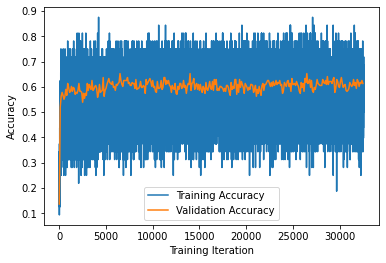

In [13]:
import matplotlib.pyplot as plt
plt.plot(range(len(training_accuracies_finetuning)), training_accuracies_finetuning, label = "Training Accuracy")
plt.plot(list(map(lambda x: x * 100, range(len(validation_accuracies_finetuning)))), validation_accuracies_finetuning, label = "Validation Accuracy")
plt.xlabel("Training Iteration")
plt.ylabel("Accuracy")
plt.legend()

In [14]:
import torch as th
import numpy as np

embedding_bert.to(device)

def get_embeds(x_data):
    concatted_shape = None
    pad_value = None
    embeds = []
    for text in tqdm(x_data):
        doc = nlp(text)
        embeddeds = []
        sents = [str(sent) for sent in doc.sents]
        if sentence_pairs and len(sents) > 1:
            sents = [a + b for a, b in zip(sents, sents[1:])]
        all_tokenized = []
        for sentence in sents[:num_sentences]:
            tokenized = tokenizer(sentence, truncation=True, padding="max_length", max_length=max_tokenized_length)[0]
            all_tokenized.append(tokenized.ids)
        
        with th.no_grad():
            sentence_tensor = th.tensor(all_tokenized).to(device)
            concatted = np.concatenate([
                # take output corresponding to CLS
                embedding_bert.bert(sentence_tensor, output_hidden_states=True, return_dict=True)[1].cpu().numpy(),
                np.zeros((len(all_tokenized), 1))
            ], axis=1)
            
            if not concatted_shape:
                concatted_shape = concatted.shape
                pad_value = np.zeros(concatted_shape[1])
                pad_value[-1] = 1
            
            embeddeds += list(concatted)

        if len(sents) < num_sentences:
            embeddeds += [pad_value] * (num_sentences - len(sents))

        embeds.append(embeddeds)
    return np.array(embeds)

main_data_key = f"cache-core/training-data-main-max-tokens-{max_tokenized_length}-split-{split_hash}-finetuned-{finetuning_model_hash}"
train_x_embeds, valid_x_embeds = memo_load(
    lambda: (
        get_embeds(train_x),
        get_embeds(valid_x)
    ),
    main_data_key
)
main_data_hash = hash_file(main_data_key + ".hkl")

In [15]:
from model_sentence_lstm import ReviewPredictionModel
import torch as th
import torch.optim as optim

def train_main():
    model_to_train = ReviewPredictionModel(train_x_embeds.shape[2], lstm_hidden_size, bidi_lstm=lstm_bidi)
    model_to_train.to(device)
    optimizer = optim.Adam(model_to_train.parameters(), lr=main_model_lr)
    
    training_accuracies, validation_accuracies = run_training_loop(
        model_to_train, optimizer, device,
        batch_size, epochs,
        train_x_embeds, None, np.array(train_y), valid_x_embeds, None, np.array(valid_y),
        model_id=experiment_id, max_validation_examples=512
    )
    
    return model_to_train, training_accuracies, validation_accuracies

def store_main(tup, folder):
    model_to_train, training_accuracies, validation_accuracies = tup
    th.save(model_to_train.state_dict(), f"{folder}/model.pt")
    hickle.dump((training_accuracies, validation_accuracies), f"{folder}/accuracies.hkl", mode="w")

def load_main(folder):
    model_to_train = ReviewPredictionModel(train_x_embeds.shape[2], lstm_hidden_size)
    model_to_train.load_state_dict(th.load(f"{folder}/model.pt"))
    model_to_train.eval()
    model_to_train.to(device)
    training_accuracies, validation_accuracies = hickle.load(f"{folder}/accuracies.hkl")
    return model_to_train, training_accuracies, validation_accuracies

In [16]:
from training_utils import run_training_loop

bidi_key = "-bidi" if lstm_bidi else ""
main_model_key = f"cache-core/main-model-lstm-{lstm_hidden_size}{bidi_key}-lr-{main_model_lr}-batch-size-{batch_size}-epochs-{epochs}-data-{main_data_hash}"
main_model, training_accuracies, validation_accuracies = manual_memo(
    train_main, store_main, load_main,
    main_model_key
)

th.save(main_model.state_dict(), f"{experiment_dir}/main-model.pt")
hickle.dump((training_accuracies, validation_accuracies), f"{experiment_dir}/main-accuracies.hkl", mode="w")

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 0 Iteration: 0 Loss: 2.211 Validation Loss: 2.200 Accuracy: 0.125 Validation Accuracy: 0.141:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 0 Iteration: 1 Loss: 2.202 Validation Loss: 2.200 Accuracy: 0.160 Validation Accuracy: 0.141:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 0 Iteration: 2 Loss: 2.199 Validation Loss: 2.200 Accuracy: 0.156 Validation Accuracy: 0.141:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 0 Iteration: 3 Loss: 2.198 Validation Loss: 2.200 Accuracy: 0.146 Validation Accuracy: 0.141:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 0 Iteration: 4 Loss: 2.196 Validation Loss: 2.200 Accuracy: 0.153 Validation Accuracy: 0.141:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 0 Iteration: 5 Loss: 2.195 Validation Loss: 2.200 Accuracy: 0.165 Validation Accuracy: 0.141:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 0 Iteration: 6 Loss: 2.193 Validation Loss: 2.200 Accuracy: 0.181 Validation Accuracy: 0.141:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 0 Iteration: 7 Loss: 2.191 Validation Loss: 2.200 Accuracy: 0.184 Validation Accuracy: 0.141:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 0 Iteration: 8 Loss: 2.188 Validation Loss: 2.200 Accuracy: 0.193 Validation Accuracy: 0.141:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 0 Iteration: 9 Loss: 2.186 Validation Loss: 2.200 Accuracy: 0.198 Validation Accuracy: 0.141:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 0 Iteration: 10 Loss: 2.184 Validation Loss: 2.200 Accuracy: 0.207 Validation Accuracy: 0.141:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 0 Iteration: 11 Loss: 2.183 Validation Loss: 2.200 Accuracy: 0.216 Validation Accuracy: 0.141:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 0 Iteration: 12 Loss: 2.182 Validation Loss: 2.200 Accuracy: 0.227 Validation Accuracy: 0.141:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 0 Iteration: 13 Loss: 2.179 Validation Loss: 2.200 Accuracy: 0.254 Validation Accuracy: 0.141:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 0 Iteration: 13 Loss: 2.179 Validation Loss: 2.200 Accuracy: 0.254 Validation Accuracy: 0.141:   1%|          | 14/1519 [00:00<00:11, 134.53it/s]

Epoch: 0 Iteration: 14 Loss: 2.178 Validation Loss: 2.200 Accuracy: 0.263 Validation Accuracy: 0.141:   1%|          | 14/1519 [00:00<00:11, 134.53it/s]

Epoch: 0 Iteration: 15 Loss: 2.176 Validation Loss: 2.200 Accuracy: 0.269 Validation Accuracy: 0.141:   1%|          | 14/1519 [00:00<00:11, 134.53it/s]

Epoch: 0 Iteration: 16 Loss: 2.174 Validation Loss: 2.200 Accuracy: 0.268 Validation Accuracy: 0.141:   1%|          | 14/1519 [00:00<00:11, 134.53it/s]

Epoch: 0 Iteration: 17 Loss: 2.172 Validation Loss: 2.200 Accuracy: 0.289 Validation Accuracy: 0.141:   1%|          | 14/1519 [00:00<00:11, 134.53it/s]

Epoch: 0 Iteration: 18 Loss: 2.170 Validation Loss: 2.200 Accuracy: 0.291 Validation Accuracy: 0.141:   1%|          | 14/1519 [00:00<00:11, 134.53it/s]

Epoch: 0 Iteration: 19 Loss: 2.168 Validation Loss: 2.200 Accuracy: 0.298 Validation Accuracy: 0.141:   1%|          | 14/1519 [00:00<00:11, 134.53it/s]

Epoch: 0 Iteration: 20 Loss: 2.164 Validation Loss: 2.200 Accuracy: 0.311 Validation Accuracy: 0.141:   1%|          | 14/1519 [00:00<00:11, 134.53it/s]

Epoch: 0 Iteration: 21 Loss: 2.161 Validation Loss: 2.200 Accuracy: 0.317 Validation Accuracy: 0.141:   1%|          | 14/1519 [00:00<00:11, 134.53it/s]

Epoch: 0 Iteration: 22 Loss: 2.157 Validation Loss: 2.200 Accuracy: 0.329 Validation Accuracy: 0.141:   1%|          | 14/1519 [00:00<00:11, 134.53it/s]

Epoch: 0 Iteration: 23 Loss: 2.153 Validation Loss: 2.200 Accuracy: 0.320 Validation Accuracy: 0.141:   1%|          | 14/1519 [00:00<00:11, 134.53it/s]

Epoch: 0 Iteration: 24 Loss: 2.149 Validation Loss: 2.200 Accuracy: 0.326 Validation Accuracy: 0.141:   1%|          | 14/1519 [00:00<00:11, 134.53it/s]

Epoch: 0 Iteration: 25 Loss: 2.145 Validation Loss: 2.200 Accuracy: 0.330 Validation Accuracy: 0.141:   1%|          | 14/1519 [00:00<00:11, 134.53it/s]

Epoch: 0 Iteration: 26 Loss: 2.141 Validation Loss: 2.200 Accuracy: 0.338 Validation Accuracy: 0.141:   1%|          | 14/1519 [00:00<00:11, 134.53it/s]

Epoch: 0 Iteration: 27 Loss: 2.138 Validation Loss: 2.200 Accuracy: 0.320 Validation Accuracy: 0.141:   1%|          | 14/1519 [00:00<00:11, 134.53it/s]

Epoch: 0 Iteration: 28 Loss: 2.134 Validation Loss: 2.200 Accuracy: 0.333 Validation Accuracy: 0.141:   1%|          | 14/1519 [00:00<00:11, 134.53it/s]

Epoch: 0 Iteration: 29 Loss: 2.130 Validation Loss: 2.200 Accuracy: 0.342 Validation Accuracy: 0.141:   1%|          | 14/1519 [00:00<00:11, 134.53it/s]

Epoch: 0 Iteration: 30 Loss: 2.127 Validation Loss: 2.200 Accuracy: 0.343 Validation Accuracy: 0.141:   1%|          | 14/1519 [00:00<00:11, 134.53it/s]

Epoch: 0 Iteration: 30 Loss: 2.127 Validation Loss: 2.200 Accuracy: 0.343 Validation Accuracy: 0.141:   2%|▏         | 31/1519 [00:00<00:09, 152.72it/s]

Epoch: 0 Iteration: 31 Loss: 2.124 Validation Loss: 2.200 Accuracy: 0.338 Validation Accuracy: 0.141:   2%|▏         | 31/1519 [00:00<00:09, 152.72it/s]

Epoch: 0 Iteration: 32 Loss: 2.120 Validation Loss: 2.200 Accuracy: 0.332 Validation Accuracy: 0.141:   2%|▏         | 31/1519 [00:00<00:09, 152.72it/s]

Epoch: 0 Iteration: 33 Loss: 2.117 Validation Loss: 2.200 Accuracy: 0.341 Validation Accuracy: 0.141:   2%|▏         | 31/1519 [00:00<00:09, 152.72it/s]

Epoch: 0 Iteration: 34 Loss: 2.112 Validation Loss: 2.200 Accuracy: 0.349 Validation Accuracy: 0.141:   2%|▏         | 31/1519 [00:00<00:09, 152.72it/s]

Epoch: 0 Iteration: 35 Loss: 2.109 Validation Loss: 2.200 Accuracy: 0.355 Validation Accuracy: 0.141:   2%|▏         | 31/1519 [00:00<00:09, 152.72it/s]

Epoch: 0 Iteration: 36 Loss: 2.106 Validation Loss: 2.200 Accuracy: 0.356 Validation Accuracy: 0.141:   2%|▏         | 31/1519 [00:00<00:09, 152.72it/s]

Epoch: 0 Iteration: 37 Loss: 2.102 Validation Loss: 2.200 Accuracy: 0.370 Validation Accuracy: 0.141:   2%|▏         | 31/1519 [00:00<00:09, 152.72it/s]

Epoch: 0 Iteration: 38 Loss: 2.099 Validation Loss: 2.200 Accuracy: 0.363 Validation Accuracy: 0.141:   2%|▏         | 31/1519 [00:00<00:09, 152.72it/s]

Epoch: 0 Iteration: 39 Loss: 2.095 Validation Loss: 2.200 Accuracy: 0.366 Validation Accuracy: 0.141:   2%|▏         | 31/1519 [00:00<00:09, 152.72it/s]

Epoch: 0 Iteration: 40 Loss: 2.092 Validation Loss: 2.200 Accuracy: 0.370 Validation Accuracy: 0.141:   2%|▏         | 31/1519 [00:00<00:09, 152.72it/s]

Epoch: 0 Iteration: 41 Loss: 2.089 Validation Loss: 2.200 Accuracy: 0.381 Validation Accuracy: 0.141:   2%|▏         | 31/1519 [00:00<00:09, 152.72it/s]

Epoch: 0 Iteration: 42 Loss: 2.086 Validation Loss: 2.200 Accuracy: 0.398 Validation Accuracy: 0.141:   2%|▏         | 31/1519 [00:00<00:09, 152.72it/s]

Epoch: 0 Iteration: 43 Loss: 2.083 Validation Loss: 2.200 Accuracy: 0.402 Validation Accuracy: 0.141:   2%|▏         | 31/1519 [00:00<00:09, 152.72it/s]

Epoch: 0 Iteration: 44 Loss: 2.080 Validation Loss: 2.200 Accuracy: 0.404 Validation Accuracy: 0.141:   2%|▏         | 31/1519 [00:00<00:09, 152.72it/s]

Epoch: 0 Iteration: 45 Loss: 2.076 Validation Loss: 2.200 Accuracy: 0.411 Validation Accuracy: 0.141:   2%|▏         | 31/1519 [00:00<00:09, 152.72it/s]

Epoch: 0 Iteration: 46 Loss: 2.074 Validation Loss: 2.200 Accuracy: 0.412 Validation Accuracy: 0.141:   2%|▏         | 31/1519 [00:00<00:09, 152.72it/s]

Epoch: 0 Iteration: 47 Loss: 2.070 Validation Loss: 2.200 Accuracy: 0.417 Validation Accuracy: 0.141:   2%|▏         | 31/1519 [00:00<00:09, 152.72it/s]

Epoch: 0 Iteration: 47 Loss: 2.070 Validation Loss: 2.200 Accuracy: 0.417 Validation Accuracy: 0.141:   3%|▎         | 48/1519 [00:00<00:09, 160.42it/s]

Epoch: 0 Iteration: 48 Loss: 2.067 Validation Loss: 2.200 Accuracy: 0.422 Validation Accuracy: 0.141:   3%|▎         | 48/1519 [00:00<00:09, 160.42it/s]

Epoch: 0 Iteration: 49 Loss: 2.064 Validation Loss: 2.200 Accuracy: 0.424 Validation Accuracy: 0.141:   3%|▎         | 48/1519 [00:00<00:09, 160.42it/s]

Epoch: 0 Iteration: 50 Loss: 2.060 Validation Loss: 2.200 Accuracy: 0.430 Validation Accuracy: 0.141:   3%|▎         | 48/1519 [00:00<00:09, 160.42it/s]

Epoch: 0 Iteration: 51 Loss: 2.055 Validation Loss: 2.200 Accuracy: 0.440 Validation Accuracy: 0.141:   3%|▎         | 48/1519 [00:00<00:09, 160.42it/s]

Epoch: 0 Iteration: 52 Loss: 2.052 Validation Loss: 2.200 Accuracy: 0.435 Validation Accuracy: 0.141:   3%|▎         | 48/1519 [00:00<00:09, 160.42it/s]

Epoch: 0 Iteration: 53 Loss: 2.049 Validation Loss: 2.200 Accuracy: 0.438 Validation Accuracy: 0.141:   3%|▎         | 48/1519 [00:00<00:09, 160.42it/s]

Epoch: 0 Iteration: 54 Loss: 2.045 Validation Loss: 2.200 Accuracy: 0.443 Validation Accuracy: 0.141:   3%|▎         | 48/1519 [00:00<00:09, 160.42it/s]

Epoch: 0 Iteration: 55 Loss: 2.041 Validation Loss: 2.200 Accuracy: 0.448 Validation Accuracy: 0.141:   3%|▎         | 48/1519 [00:00<00:09, 160.42it/s]

Epoch: 0 Iteration: 56 Loss: 2.038 Validation Loss: 2.200 Accuracy: 0.455 Validation Accuracy: 0.141:   3%|▎         | 48/1519 [00:00<00:09, 160.42it/s]

Epoch: 0 Iteration: 57 Loss: 2.034 Validation Loss: 2.200 Accuracy: 0.465 Validation Accuracy: 0.141:   3%|▎         | 48/1519 [00:00<00:09, 160.42it/s]

Epoch: 0 Iteration: 58 Loss: 2.031 Validation Loss: 2.200 Accuracy: 0.477 Validation Accuracy: 0.141:   3%|▎         | 48/1519 [00:00<00:09, 160.42it/s]

Epoch: 0 Iteration: 59 Loss: 2.027 Validation Loss: 2.200 Accuracy: 0.480 Validation Accuracy: 0.141:   3%|▎         | 48/1519 [00:00<00:09, 160.42it/s]

Epoch: 0 Iteration: 60 Loss: 2.024 Validation Loss: 2.200 Accuracy: 0.475 Validation Accuracy: 0.141:   3%|▎         | 48/1519 [00:00<00:09, 160.42it/s]

Epoch: 0 Iteration: 61 Loss: 2.021 Validation Loss: 2.200 Accuracy: 0.475 Validation Accuracy: 0.141:   3%|▎         | 48/1519 [00:00<00:09, 160.42it/s]

Epoch: 0 Iteration: 62 Loss: 2.017 Validation Loss: 2.200 Accuracy: 0.485 Validation Accuracy: 0.141:   3%|▎         | 48/1519 [00:00<00:09, 160.42it/s]

Epoch: 0 Iteration: 63 Loss: 2.013 Validation Loss: 2.200 Accuracy: 0.485 Validation Accuracy: 0.141:   3%|▎         | 48/1519 [00:00<00:09, 160.42it/s]

Epoch: 0 Iteration: 64 Loss: 2.010 Validation Loss: 2.200 Accuracy: 0.480 Validation Accuracy: 0.141:   3%|▎         | 48/1519 [00:00<00:09, 160.42it/s]

Epoch: 0 Iteration: 64 Loss: 2.010 Validation Loss: 2.200 Accuracy: 0.480 Validation Accuracy: 0.141:   4%|▍         | 65/1519 [00:00<00:08, 164.11it/s]

Epoch: 0 Iteration: 65 Loss: 2.007 Validation Loss: 2.200 Accuracy: 0.482 Validation Accuracy: 0.141:   4%|▍         | 65/1519 [00:00<00:08, 164.11it/s]

Epoch: 0 Iteration: 66 Loss: 2.002 Validation Loss: 2.200 Accuracy: 0.489 Validation Accuracy: 0.141:   4%|▍         | 65/1519 [00:00<00:08, 164.11it/s]

Epoch: 0 Iteration: 67 Loss: 1.999 Validation Loss: 2.200 Accuracy: 0.488 Validation Accuracy: 0.141:   4%|▍         | 65/1519 [00:00<00:08, 164.11it/s]

Epoch: 0 Iteration: 68 Loss: 1.996 Validation Loss: 2.200 Accuracy: 0.497 Validation Accuracy: 0.141:   4%|▍         | 65/1519 [00:00<00:08, 164.11it/s]

Epoch: 0 Iteration: 69 Loss: 1.992 Validation Loss: 2.200 Accuracy: 0.500 Validation Accuracy: 0.141:   4%|▍         | 65/1519 [00:00<00:08, 164.11it/s]

Epoch: 0 Iteration: 70 Loss: 1.990 Validation Loss: 2.200 Accuracy: 0.509 Validation Accuracy: 0.141:   4%|▍         | 65/1519 [00:00<00:08, 164.11it/s]

Epoch: 0 Iteration: 71 Loss: 1.987 Validation Loss: 2.200 Accuracy: 0.514 Validation Accuracy: 0.141:   4%|▍         | 65/1519 [00:00<00:08, 164.11it/s]

Epoch: 0 Iteration: 72 Loss: 1.983 Validation Loss: 2.200 Accuracy: 0.516 Validation Accuracy: 0.141:   4%|▍         | 65/1519 [00:00<00:08, 164.11it/s]

Epoch: 0 Iteration: 73 Loss: 1.979 Validation Loss: 2.200 Accuracy: 0.531 Validation Accuracy: 0.141:   4%|▍         | 65/1519 [00:00<00:08, 164.11it/s]

Epoch: 0 Iteration: 74 Loss: 1.976 Validation Loss: 2.200 Accuracy: 0.537 Validation Accuracy: 0.141:   4%|▍         | 65/1519 [00:00<00:08, 164.11it/s]

Epoch: 0 Iteration: 75 Loss: 1.973 Validation Loss: 2.200 Accuracy: 0.542 Validation Accuracy: 0.141:   4%|▍         | 65/1519 [00:00<00:08, 164.11it/s]

Epoch: 0 Iteration: 76 Loss: 1.971 Validation Loss: 2.200 Accuracy: 0.541 Validation Accuracy: 0.141:   4%|▍         | 65/1519 [00:00<00:08, 164.11it/s]

Epoch: 0 Iteration: 77 Loss: 1.969 Validation Loss: 2.200 Accuracy: 0.548 Validation Accuracy: 0.141:   4%|▍         | 65/1519 [00:00<00:08, 164.11it/s]

Epoch: 0 Iteration: 78 Loss: 1.965 Validation Loss: 2.200 Accuracy: 0.547 Validation Accuracy: 0.141:   4%|▍         | 65/1519 [00:00<00:08, 164.11it/s]

Epoch: 0 Iteration: 79 Loss: 1.961 Validation Loss: 2.200 Accuracy: 0.552 Validation Accuracy: 0.141:   4%|▍         | 65/1519 [00:00<00:08, 164.11it/s]

Epoch: 0 Iteration: 80 Loss: 1.957 Validation Loss: 2.200 Accuracy: 0.555 Validation Accuracy: 0.141:   4%|▍         | 65/1519 [00:00<00:08, 164.11it/s]

Epoch: 0 Iteration: 81 Loss: 1.953 Validation Loss: 2.200 Accuracy: 0.558 Validation Accuracy: 0.141:   4%|▍         | 65/1519 [00:00<00:08, 164.11it/s]

Epoch: 0 Iteration: 82 Loss: 1.950 Validation Loss: 2.200 Accuracy: 0.556 Validation Accuracy: 0.141:   4%|▍         | 65/1519 [00:00<00:08, 164.11it/s]

Epoch: 0 Iteration: 82 Loss: 1.950 Validation Loss: 2.200 Accuracy: 0.556 Validation Accuracy: 0.141:   5%|▌         | 83/1519 [00:00<00:08, 168.74it/s]

Epoch: 0 Iteration: 83 Loss: 1.946 Validation Loss: 2.200 Accuracy: 0.555 Validation Accuracy: 0.141:   5%|▌         | 83/1519 [00:00<00:08, 168.74it/s]

Epoch: 0 Iteration: 84 Loss: 1.942 Validation Loss: 2.200 Accuracy: 0.565 Validation Accuracy: 0.141:   5%|▌         | 83/1519 [00:00<00:08, 168.74it/s]

Epoch: 0 Iteration: 85 Loss: 1.938 Validation Loss: 2.200 Accuracy: 0.566 Validation Accuracy: 0.141:   5%|▌         | 83/1519 [00:00<00:08, 168.74it/s]

Epoch: 0 Iteration: 86 Loss: 1.935 Validation Loss: 2.200 Accuracy: 0.574 Validation Accuracy: 0.141:   5%|▌         | 83/1519 [00:00<00:08, 168.74it/s]

Epoch: 0 Iteration: 87 Loss: 1.931 Validation Loss: 2.200 Accuracy: 0.578 Validation Accuracy: 0.141:   5%|▌         | 83/1519 [00:00<00:08, 168.74it/s]

Epoch: 0 Iteration: 88 Loss: 1.927 Validation Loss: 2.200 Accuracy: 0.587 Validation Accuracy: 0.141:   5%|▌         | 83/1519 [00:00<00:08, 168.74it/s]

Epoch: 0 Iteration: 89 Loss: 1.924 Validation Loss: 2.200 Accuracy: 0.585 Validation Accuracy: 0.141:   5%|▌         | 83/1519 [00:00<00:08, 168.74it/s]

Epoch: 0 Iteration: 90 Loss: 1.919 Validation Loss: 2.200 Accuracy: 0.591 Validation Accuracy: 0.141:   5%|▌         | 83/1519 [00:00<00:08, 168.74it/s]

Epoch: 0 Iteration: 91 Loss: 1.916 Validation Loss: 2.200 Accuracy: 0.584 Validation Accuracy: 0.141:   5%|▌         | 83/1519 [00:00<00:08, 168.74it/s]

Epoch: 0 Iteration: 92 Loss: 1.911 Validation Loss: 2.200 Accuracy: 0.591 Validation Accuracy: 0.141:   5%|▌         | 83/1519 [00:00<00:08, 168.74it/s]

Epoch: 0 Iteration: 93 Loss: 1.907 Validation Loss: 2.200 Accuracy: 0.597 Validation Accuracy: 0.141:   5%|▌         | 83/1519 [00:00<00:08, 168.74it/s]

Epoch: 0 Iteration: 94 Loss: 1.902 Validation Loss: 2.200 Accuracy: 0.598 Validation Accuracy: 0.141:   5%|▌         | 83/1519 [00:00<00:08, 168.74it/s]

Epoch: 0 Iteration: 95 Loss: 1.899 Validation Loss: 2.200 Accuracy: 0.597 Validation Accuracy: 0.141:   5%|▌         | 83/1519 [00:00<00:08, 168.74it/s]

Epoch: 0 Iteration: 96 Loss: 1.895 Validation Loss: 2.200 Accuracy: 0.595 Validation Accuracy: 0.141:   5%|▌         | 83/1519 [00:00<00:08, 168.74it/s]

Epoch: 0 Iteration: 97 Loss: 1.891 Validation Loss: 2.200 Accuracy: 0.593 Validation Accuracy: 0.141:   5%|▌         | 83/1519 [00:00<00:08, 168.74it/s]

Epoch: 0 Iteration: 98 Loss: 1.887 Validation Loss: 2.200 Accuracy: 0.586 Validation Accuracy: 0.141:   5%|▌         | 83/1519 [00:00<00:08, 168.74it/s]

Epoch: 0 Iteration: 99 Loss: 1.883 Validation Loss: 2.200 Accuracy: 0.591 Validation Accuracy: 0.141:   5%|▌         | 83/1519 [00:00<00:08, 168.74it/s]

Epoch: 0 Iteration: 100 Loss: 1.882 Validation Loss: 1.836 Accuracy: 0.587 Validation Accuracy: 0.378:   5%|▌         | 83/1519 [00:00<00:08, 168.74it/s]

Epoch: 0 Iteration: 100 Loss: 1.882 Validation Loss: 1.836 Accuracy: 0.587 Validation Accuracy: 0.378:   7%|▋         | 101/1519 [00:00<00:08, 167.75it/s]

Epoch: 0 Iteration: 101 Loss: 1.879 Validation Loss: 1.836 Accuracy: 0.597 Validation Accuracy: 0.378:   7%|▋         | 101/1519 [00:00<00:08, 167.75it/s]

Epoch: 0 Iteration: 102 Loss: 1.876 Validation Loss: 1.836 Accuracy: 0.594 Validation Accuracy: 0.378:   7%|▋         | 101/1519 [00:00<00:08, 167.75it/s]

Epoch: 0 Iteration: 103 Loss: 1.872 Validation Loss: 1.836 Accuracy: 0.586 Validation Accuracy: 0.378:   7%|▋         | 101/1519 [00:00<00:08, 167.75it/s]

Epoch: 0 Iteration: 104 Loss: 1.868 Validation Loss: 1.836 Accuracy: 0.586 Validation Accuracy: 0.378:   7%|▋         | 101/1519 [00:00<00:08, 167.75it/s]

Epoch: 0 Iteration: 105 Loss: 1.864 Validation Loss: 1.836 Accuracy: 0.591 Validation Accuracy: 0.378:   7%|▋         | 101/1519 [00:00<00:08, 167.75it/s]

Epoch: 0 Iteration: 106 Loss: 1.859 Validation Loss: 1.836 Accuracy: 0.596 Validation Accuracy: 0.378:   7%|▋         | 101/1519 [00:00<00:08, 167.75it/s]

Epoch: 0 Iteration: 107 Loss: 1.856 Validation Loss: 1.836 Accuracy: 0.597 Validation Accuracy: 0.378:   7%|▋         | 101/1519 [00:00<00:08, 167.75it/s]

Epoch: 0 Iteration: 108 Loss: 1.853 Validation Loss: 1.836 Accuracy: 0.605 Validation Accuracy: 0.378:   7%|▋         | 101/1519 [00:00<00:08, 167.75it/s]

Epoch: 0 Iteration: 109 Loss: 1.848 Validation Loss: 1.836 Accuracy: 0.603 Validation Accuracy: 0.378:   7%|▋         | 101/1519 [00:00<00:08, 167.75it/s]

Epoch: 0 Iteration: 110 Loss: 1.845 Validation Loss: 1.836 Accuracy: 0.613 Validation Accuracy: 0.378:   7%|▋         | 101/1519 [00:00<00:08, 167.75it/s]

Epoch: 0 Iteration: 111 Loss: 1.842 Validation Loss: 1.836 Accuracy: 0.612 Validation Accuracy: 0.378:   7%|▋         | 101/1519 [00:00<00:08, 167.75it/s]

Epoch: 0 Iteration: 112 Loss: 1.841 Validation Loss: 1.836 Accuracy: 0.615 Validation Accuracy: 0.378:   7%|▋         | 101/1519 [00:00<00:08, 167.75it/s]

Epoch: 0 Iteration: 113 Loss: 1.838 Validation Loss: 1.836 Accuracy: 0.626 Validation Accuracy: 0.378:   7%|▋         | 101/1519 [00:00<00:08, 167.75it/s]

Epoch: 0 Iteration: 114 Loss: 1.834 Validation Loss: 1.836 Accuracy: 0.621 Validation Accuracy: 0.378:   7%|▋         | 101/1519 [00:00<00:08, 167.75it/s]

Epoch: 0 Iteration: 115 Loss: 1.828 Validation Loss: 1.836 Accuracy: 0.626 Validation Accuracy: 0.378:   7%|▋         | 101/1519 [00:00<00:08, 167.75it/s]

Epoch: 0 Iteration: 116 Loss: 1.823 Validation Loss: 1.836 Accuracy: 0.628 Validation Accuracy: 0.378:   7%|▋         | 101/1519 [00:00<00:08, 167.75it/s]

Epoch: 0 Iteration: 117 Loss: 1.818 Validation Loss: 1.836 Accuracy: 0.628 Validation Accuracy: 0.378:   7%|▋         | 101/1519 [00:00<00:08, 167.75it/s]

Epoch: 0 Iteration: 118 Loss: 1.815 Validation Loss: 1.836 Accuracy: 0.621 Validation Accuracy: 0.378:   7%|▋         | 101/1519 [00:00<00:08, 167.75it/s]

Epoch: 0 Iteration: 118 Loss: 1.815 Validation Loss: 1.836 Accuracy: 0.621 Validation Accuracy: 0.378:   8%|▊         | 119/1519 [00:00<00:08, 169.96it/s]

Epoch: 0 Iteration: 119 Loss: 1.812 Validation Loss: 1.836 Accuracy: 0.623 Validation Accuracy: 0.378:   8%|▊         | 119/1519 [00:00<00:08, 169.96it/s]

Epoch: 0 Iteration: 120 Loss: 1.808 Validation Loss: 1.836 Accuracy: 0.623 Validation Accuracy: 0.378:   8%|▊         | 119/1519 [00:00<00:08, 169.96it/s]

Epoch: 0 Iteration: 121 Loss: 1.803 Validation Loss: 1.836 Accuracy: 0.627 Validation Accuracy: 0.378:   8%|▊         | 119/1519 [00:00<00:08, 169.96it/s]

Epoch: 0 Iteration: 122 Loss: 1.799 Validation Loss: 1.836 Accuracy: 0.620 Validation Accuracy: 0.378:   8%|▊         | 119/1519 [00:00<00:08, 169.96it/s]

Epoch: 0 Iteration: 123 Loss: 1.796 Validation Loss: 1.836 Accuracy: 0.617 Validation Accuracy: 0.378:   8%|▊         | 119/1519 [00:00<00:08, 169.96it/s]

Epoch: 0 Iteration: 124 Loss: 1.794 Validation Loss: 1.836 Accuracy: 0.627 Validation Accuracy: 0.378:   8%|▊         | 119/1519 [00:00<00:08, 169.96it/s]

Epoch: 0 Iteration: 125 Loss: 1.792 Validation Loss: 1.836 Accuracy: 0.620 Validation Accuracy: 0.378:   8%|▊         | 119/1519 [00:00<00:08, 169.96it/s]

Epoch: 0 Iteration: 126 Loss: 1.789 Validation Loss: 1.836 Accuracy: 0.617 Validation Accuracy: 0.378:   8%|▊         | 119/1519 [00:00<00:08, 169.96it/s]

Epoch: 0 Iteration: 127 Loss: 1.786 Validation Loss: 1.836 Accuracy: 0.616 Validation Accuracy: 0.378:   8%|▊         | 119/1519 [00:00<00:08, 169.96it/s]

Epoch: 0 Iteration: 128 Loss: 1.780 Validation Loss: 1.836 Accuracy: 0.616 Validation Accuracy: 0.378:   8%|▊         | 119/1519 [00:00<00:08, 169.96it/s]

Epoch: 0 Iteration: 129 Loss: 1.779 Validation Loss: 1.836 Accuracy: 0.619 Validation Accuracy: 0.378:   8%|▊         | 119/1519 [00:00<00:08, 169.96it/s]

Epoch: 0 Iteration: 130 Loss: 1.777 Validation Loss: 1.836 Accuracy: 0.609 Validation Accuracy: 0.378:   8%|▊         | 119/1519 [00:00<00:08, 169.96it/s]

Epoch: 0 Iteration: 131 Loss: 1.772 Validation Loss: 1.836 Accuracy: 0.614 Validation Accuracy: 0.378:   8%|▊         | 119/1519 [00:00<00:08, 169.96it/s]

Epoch: 0 Iteration: 132 Loss: 1.767 Validation Loss: 1.836 Accuracy: 0.623 Validation Accuracy: 0.378:   8%|▊         | 119/1519 [00:00<00:08, 169.96it/s]

Epoch: 0 Iteration: 133 Loss: 1.763 Validation Loss: 1.836 Accuracy: 0.621 Validation Accuracy: 0.378:   8%|▊         | 119/1519 [00:00<00:08, 169.96it/s]

Epoch: 0 Iteration: 134 Loss: 1.761 Validation Loss: 1.836 Accuracy: 0.616 Validation Accuracy: 0.378:   8%|▊         | 119/1519 [00:00<00:08, 169.96it/s]

Epoch: 0 Iteration: 135 Loss: 1.760 Validation Loss: 1.836 Accuracy: 0.613 Validation Accuracy: 0.378:   8%|▊         | 119/1519 [00:00<00:08, 169.96it/s]

Epoch: 0 Iteration: 136 Loss: 1.758 Validation Loss: 1.836 Accuracy: 0.611 Validation Accuracy: 0.378:   8%|▊         | 119/1519 [00:00<00:08, 169.96it/s]

Epoch: 0 Iteration: 136 Loss: 1.758 Validation Loss: 1.836 Accuracy: 0.611 Validation Accuracy: 0.378:   9%|▉         | 137/1519 [00:00<00:08, 168.72it/s]

Epoch: 0 Iteration: 137 Loss: 1.755 Validation Loss: 1.836 Accuracy: 0.617 Validation Accuracy: 0.378:   9%|▉         | 137/1519 [00:00<00:08, 168.72it/s]

Epoch: 0 Iteration: 138 Loss: 1.752 Validation Loss: 1.836 Accuracy: 0.621 Validation Accuracy: 0.378:   9%|▉         | 137/1519 [00:00<00:08, 168.72it/s]

Epoch: 0 Iteration: 139 Loss: 1.748 Validation Loss: 1.836 Accuracy: 0.621 Validation Accuracy: 0.378:   9%|▉         | 137/1519 [00:00<00:08, 168.72it/s]

Epoch: 0 Iteration: 140 Loss: 1.744 Validation Loss: 1.836 Accuracy: 0.626 Validation Accuracy: 0.378:   9%|▉         | 137/1519 [00:00<00:08, 168.72it/s]

Epoch: 0 Iteration: 141 Loss: 1.742 Validation Loss: 1.836 Accuracy: 0.616 Validation Accuracy: 0.378:   9%|▉         | 137/1519 [00:00<00:08, 168.72it/s]

Epoch: 0 Iteration: 142 Loss: 1.739 Validation Loss: 1.836 Accuracy: 0.620 Validation Accuracy: 0.378:   9%|▉         | 137/1519 [00:00<00:08, 168.72it/s]

Epoch: 0 Iteration: 143 Loss: 1.736 Validation Loss: 1.836 Accuracy: 0.620 Validation Accuracy: 0.378:   9%|▉         | 137/1519 [00:00<00:08, 168.72it/s]

Epoch: 0 Iteration: 144 Loss: 1.730 Validation Loss: 1.836 Accuracy: 0.619 Validation Accuracy: 0.378:   9%|▉         | 137/1519 [00:00<00:08, 168.72it/s]

Epoch: 0 Iteration: 145 Loss: 1.726 Validation Loss: 1.836 Accuracy: 0.627 Validation Accuracy: 0.378:   9%|▉         | 137/1519 [00:00<00:08, 168.72it/s]

Epoch: 0 Iteration: 146 Loss: 1.723 Validation Loss: 1.836 Accuracy: 0.634 Validation Accuracy: 0.378:   9%|▉         | 137/1519 [00:00<00:08, 168.72it/s]

Epoch: 0 Iteration: 147 Loss: 1.716 Validation Loss: 1.836 Accuracy: 0.645 Validation Accuracy: 0.378:   9%|▉         | 137/1519 [00:00<00:08, 168.72it/s]

Epoch: 0 Iteration: 148 Loss: 1.715 Validation Loss: 1.836 Accuracy: 0.646 Validation Accuracy: 0.378:   9%|▉         | 137/1519 [00:00<00:08, 168.72it/s]

Epoch: 0 Iteration: 149 Loss: 1.711 Validation Loss: 1.836 Accuracy: 0.649 Validation Accuracy: 0.378:   9%|▉         | 137/1519 [00:00<00:08, 168.72it/s]

Epoch: 0 Iteration: 150 Loss: 1.706 Validation Loss: 1.836 Accuracy: 0.654 Validation Accuracy: 0.378:   9%|▉         | 137/1519 [00:00<00:08, 168.72it/s]

Epoch: 0 Iteration: 151 Loss: 1.702 Validation Loss: 1.836 Accuracy: 0.656 Validation Accuracy: 0.378:   9%|▉         | 137/1519 [00:00<00:08, 168.72it/s]

Epoch: 0 Iteration: 152 Loss: 1.700 Validation Loss: 1.836 Accuracy: 0.652 Validation Accuracy: 0.378:   9%|▉         | 137/1519 [00:00<00:08, 168.72it/s]

Epoch: 0 Iteration: 153 Loss: 1.697 Validation Loss: 1.836 Accuracy: 0.654 Validation Accuracy: 0.378:   9%|▉         | 137/1519 [00:00<00:08, 168.72it/s]

Epoch: 0 Iteration: 154 Loss: 1.693 Validation Loss: 1.836 Accuracy: 0.652 Validation Accuracy: 0.378:   9%|▉         | 137/1519 [00:00<00:08, 168.72it/s]

Epoch: 0 Iteration: 154 Loss: 1.693 Validation Loss: 1.836 Accuracy: 0.652 Validation Accuracy: 0.378:  10%|█         | 155/1519 [00:00<00:08, 169.65it/s]

Epoch: 0 Iteration: 155 Loss: 1.686 Validation Loss: 1.836 Accuracy: 0.659 Validation Accuracy: 0.378:  10%|█         | 155/1519 [00:00<00:08, 169.65it/s]

Epoch: 0 Iteration: 156 Loss: 1.682 Validation Loss: 1.836 Accuracy: 0.654 Validation Accuracy: 0.378:  10%|█         | 155/1519 [00:00<00:08, 169.65it/s]

Epoch: 0 Iteration: 157 Loss: 1.680 Validation Loss: 1.836 Accuracy: 0.636 Validation Accuracy: 0.378:  10%|█         | 155/1519 [00:00<00:08, 169.65it/s]

Epoch: 0 Iteration: 158 Loss: 1.675 Validation Loss: 1.836 Accuracy: 0.632 Validation Accuracy: 0.378:  10%|█         | 155/1519 [00:00<00:08, 169.65it/s]

Epoch: 0 Iteration: 159 Loss: 1.671 Validation Loss: 1.836 Accuracy: 0.627 Validation Accuracy: 0.378:  10%|█         | 155/1519 [00:00<00:08, 169.65it/s]

Epoch: 0 Iteration: 160 Loss: 1.667 Validation Loss: 1.836 Accuracy: 0.629 Validation Accuracy: 0.378:  10%|█         | 155/1519 [00:00<00:08, 169.65it/s]

Epoch: 0 Iteration: 161 Loss: 1.662 Validation Loss: 1.836 Accuracy: 0.629 Validation Accuracy: 0.378:  10%|█         | 155/1519 [00:00<00:08, 169.65it/s]

Epoch: 0 Iteration: 162 Loss: 1.659 Validation Loss: 1.836 Accuracy: 0.634 Validation Accuracy: 0.378:  10%|█         | 155/1519 [00:00<00:08, 169.65it/s]

Epoch: 0 Iteration: 163 Loss: 1.654 Validation Loss: 1.836 Accuracy: 0.641 Validation Accuracy: 0.378:  10%|█         | 155/1519 [00:00<00:08, 169.65it/s]

Epoch: 0 Iteration: 164 Loss: 1.651 Validation Loss: 1.836 Accuracy: 0.652 Validation Accuracy: 0.378:  10%|█         | 155/1519 [00:00<00:08, 169.65it/s]

Epoch: 0 Iteration: 165 Loss: 1.646 Validation Loss: 1.836 Accuracy: 0.645 Validation Accuracy: 0.378:  10%|█         | 155/1519 [00:00<00:08, 169.65it/s]

Epoch: 0 Iteration: 166 Loss: 1.642 Validation Loss: 1.836 Accuracy: 0.645 Validation Accuracy: 0.378:  10%|█         | 155/1519 [00:01<00:08, 169.65it/s]

Epoch: 0 Iteration: 167 Loss: 1.640 Validation Loss: 1.836 Accuracy: 0.652 Validation Accuracy: 0.378:  10%|█         | 155/1519 [00:01<00:08, 169.65it/s]

Epoch: 0 Iteration: 168 Loss: 1.636 Validation Loss: 1.836 Accuracy: 0.652 Validation Accuracy: 0.378:  10%|█         | 155/1519 [00:01<00:08, 169.65it/s]

Epoch: 0 Iteration: 169 Loss: 1.632 Validation Loss: 1.836 Accuracy: 0.656 Validation Accuracy: 0.378:  10%|█         | 155/1519 [00:01<00:08, 169.65it/s]

Epoch: 0 Iteration: 170 Loss: 1.630 Validation Loss: 1.836 Accuracy: 0.653 Validation Accuracy: 0.378:  10%|█         | 155/1519 [00:01<00:08, 169.65it/s]

Epoch: 0 Iteration: 171 Loss: 1.628 Validation Loss: 1.836 Accuracy: 0.646 Validation Accuracy: 0.378:  10%|█         | 155/1519 [00:01<00:08, 169.65it/s]

Epoch: 0 Iteration: 172 Loss: 1.624 Validation Loss: 1.836 Accuracy: 0.645 Validation Accuracy: 0.378:  10%|█         | 155/1519 [00:01<00:08, 169.65it/s]

Epoch: 0 Iteration: 172 Loss: 1.624 Validation Loss: 1.836 Accuracy: 0.645 Validation Accuracy: 0.378:  11%|█▏        | 173/1519 [00:01<00:07, 170.62it/s]

Epoch: 0 Iteration: 173 Loss: 1.616 Validation Loss: 1.836 Accuracy: 0.646 Validation Accuracy: 0.378:  11%|█▏        | 173/1519 [00:01<00:07, 170.62it/s]

Epoch: 0 Iteration: 174 Loss: 1.615 Validation Loss: 1.836 Accuracy: 0.642 Validation Accuracy: 0.378:  11%|█▏        | 173/1519 [00:01<00:07, 170.62it/s]

Epoch: 0 Iteration: 175 Loss: 1.615 Validation Loss: 1.836 Accuracy: 0.632 Validation Accuracy: 0.378:  11%|█▏        | 173/1519 [00:01<00:07, 170.62it/s]

Epoch: 0 Iteration: 176 Loss: 1.612 Validation Loss: 1.836 Accuracy: 0.637 Validation Accuracy: 0.378:  11%|█▏        | 173/1519 [00:01<00:07, 170.62it/s]

Epoch: 0 Iteration: 177 Loss: 1.606 Validation Loss: 1.836 Accuracy: 0.637 Validation Accuracy: 0.378:  11%|█▏        | 173/1519 [00:01<00:07, 170.62it/s]

Epoch: 0 Iteration: 178 Loss: 1.603 Validation Loss: 1.836 Accuracy: 0.645 Validation Accuracy: 0.378:  11%|█▏        | 173/1519 [00:01<00:07, 170.62it/s]

Epoch: 0 Iteration: 179 Loss: 1.601 Validation Loss: 1.836 Accuracy: 0.639 Validation Accuracy: 0.378:  11%|█▏        | 173/1519 [00:01<00:07, 170.62it/s]

Epoch: 0 Iteration: 180 Loss: 1.596 Validation Loss: 1.836 Accuracy: 0.646 Validation Accuracy: 0.378:  11%|█▏        | 173/1519 [00:01<00:07, 170.62it/s]

Epoch: 0 Iteration: 181 Loss: 1.592 Validation Loss: 1.836 Accuracy: 0.654 Validation Accuracy: 0.378:  11%|█▏        | 173/1519 [00:01<00:07, 170.62it/s]

Epoch: 0 Iteration: 182 Loss: 1.588 Validation Loss: 1.836 Accuracy: 0.647 Validation Accuracy: 0.378:  11%|█▏        | 173/1519 [00:01<00:07, 170.62it/s]

Epoch: 0 Iteration: 183 Loss: 1.585 Validation Loss: 1.836 Accuracy: 0.636 Validation Accuracy: 0.378:  11%|█▏        | 173/1519 [00:01<00:07, 170.62it/s]

Epoch: 0 Iteration: 184 Loss: 1.582 Validation Loss: 1.836 Accuracy: 0.629 Validation Accuracy: 0.378:  11%|█▏        | 173/1519 [00:01<00:07, 170.62it/s]

Epoch: 0 Iteration: 185 Loss: 1.579 Validation Loss: 1.836 Accuracy: 0.641 Validation Accuracy: 0.378:  11%|█▏        | 173/1519 [00:01<00:07, 170.62it/s]

Epoch: 0 Iteration: 186 Loss: 1.574 Validation Loss: 1.836 Accuracy: 0.644 Validation Accuracy: 0.378:  11%|█▏        | 173/1519 [00:01<00:07, 170.62it/s]

Epoch: 0 Iteration: 187 Loss: 1.571 Validation Loss: 1.836 Accuracy: 0.634 Validation Accuracy: 0.378:  11%|█▏        | 173/1519 [00:01<00:07, 170.62it/s]

Epoch: 0 Iteration: 188 Loss: 1.569 Validation Loss: 1.836 Accuracy: 0.627 Validation Accuracy: 0.378:  11%|█▏        | 173/1519 [00:01<00:07, 170.62it/s]

Epoch: 0 Iteration: 189 Loss: 1.566 Validation Loss: 1.836 Accuracy: 0.627 Validation Accuracy: 0.378:  11%|█▏        | 173/1519 [00:01<00:07, 170.62it/s]

Epoch: 0 Iteration: 190 Loss: 1.559 Validation Loss: 1.836 Accuracy: 0.616 Validation Accuracy: 0.378:  11%|█▏        | 173/1519 [00:01<00:07, 170.62it/s]

Epoch: 0 Iteration: 190 Loss: 1.559 Validation Loss: 1.836 Accuracy: 0.616 Validation Accuracy: 0.378:  13%|█▎        | 191/1519 [00:01<00:07, 171.65it/s]

Epoch: 0 Iteration: 191 Loss: 1.557 Validation Loss: 1.836 Accuracy: 0.610 Validation Accuracy: 0.378:  13%|█▎        | 191/1519 [00:01<00:07, 171.65it/s]

Epoch: 0 Iteration: 192 Loss: 1.554 Validation Loss: 1.836 Accuracy: 0.616 Validation Accuracy: 0.378:  13%|█▎        | 191/1519 [00:01<00:07, 171.65it/s]

Epoch: 0 Iteration: 193 Loss: 1.553 Validation Loss: 1.836 Accuracy: 0.620 Validation Accuracy: 0.378:  13%|█▎        | 191/1519 [00:01<00:07, 171.65it/s]

Epoch: 0 Iteration: 194 Loss: 1.549 Validation Loss: 1.836 Accuracy: 0.633 Validation Accuracy: 0.378:  13%|█▎        | 191/1519 [00:01<00:07, 171.65it/s]

Epoch: 0 Iteration: 195 Loss: 1.544 Validation Loss: 1.836 Accuracy: 0.629 Validation Accuracy: 0.378:  13%|█▎        | 191/1519 [00:01<00:07, 171.65it/s]

Epoch: 0 Iteration: 196 Loss: 1.544 Validation Loss: 1.836 Accuracy: 0.629 Validation Accuracy: 0.378:  13%|█▎        | 191/1519 [00:01<00:07, 171.65it/s]

Epoch: 0 Iteration: 197 Loss: 1.541 Validation Loss: 1.836 Accuracy: 0.634 Validation Accuracy: 0.378:  13%|█▎        | 191/1519 [00:01<00:07, 171.65it/s]

Epoch: 0 Iteration: 198 Loss: 1.535 Validation Loss: 1.836 Accuracy: 0.639 Validation Accuracy: 0.378:  13%|█▎        | 191/1519 [00:01<00:07, 171.65it/s]

Epoch: 0 Iteration: 199 Loss: 1.531 Validation Loss: 1.836 Accuracy: 0.646 Validation Accuracy: 0.378:  13%|█▎        | 191/1519 [00:01<00:07, 171.65it/s]

Epoch: 0 Iteration: 200 Loss: 1.529 Validation Loss: 1.458 Accuracy: 0.652 Validation Accuracy: 0.477:  13%|█▎        | 191/1519 [00:01<00:07, 171.65it/s]

Epoch: 0 Iteration: 201 Loss: 1.526 Validation Loss: 1.458 Accuracy: 0.657 Validation Accuracy: 0.477:  13%|█▎        | 191/1519 [00:01<00:07, 171.65it/s]

Epoch: 0 Iteration: 202 Loss: 1.523 Validation Loss: 1.458 Accuracy: 0.662 Validation Accuracy: 0.477:  13%|█▎        | 191/1519 [00:01<00:07, 171.65it/s]

Epoch: 0 Iteration: 203 Loss: 1.517 Validation Loss: 1.458 Accuracy: 0.666 Validation Accuracy: 0.477:  13%|█▎        | 191/1519 [00:01<00:07, 171.65it/s]

Epoch: 0 Iteration: 204 Loss: 1.514 Validation Loss: 1.458 Accuracy: 0.655 Validation Accuracy: 0.477:  13%|█▎        | 191/1519 [00:01<00:07, 171.65it/s]

Epoch: 0 Iteration: 205 Loss: 1.512 Validation Loss: 1.458 Accuracy: 0.656 Validation Accuracy: 0.477:  13%|█▎        | 191/1519 [00:01<00:07, 171.65it/s]

Epoch: 0 Iteration: 206 Loss: 1.514 Validation Loss: 1.458 Accuracy: 0.652 Validation Accuracy: 0.477:  13%|█▎        | 191/1519 [00:01<00:07, 171.65it/s]

Epoch: 0 Iteration: 207 Loss: 1.508 Validation Loss: 1.458 Accuracy: 0.659 Validation Accuracy: 0.477:  13%|█▎        | 191/1519 [00:01<00:07, 171.65it/s]

Epoch: 0 Iteration: 208 Loss: 1.503 Validation Loss: 1.458 Accuracy: 0.652 Validation Accuracy: 0.477:  13%|█▎        | 191/1519 [00:01<00:07, 171.65it/s]

Epoch: 0 Iteration: 208 Loss: 1.503 Validation Loss: 1.458 Accuracy: 0.652 Validation Accuracy: 0.477:  14%|█▍        | 209/1519 [00:01<00:07, 169.16it/s]

Epoch: 0 Iteration: 209 Loss: 1.499 Validation Loss: 1.458 Accuracy: 0.645 Validation Accuracy: 0.477:  14%|█▍        | 209/1519 [00:01<00:07, 169.16it/s]

Epoch: 0 Iteration: 210 Loss: 1.496 Validation Loss: 1.458 Accuracy: 0.654 Validation Accuracy: 0.477:  14%|█▍        | 209/1519 [00:01<00:07, 169.16it/s]

Epoch: 0 Iteration: 211 Loss: 1.490 Validation Loss: 1.458 Accuracy: 0.657 Validation Accuracy: 0.477:  14%|█▍        | 209/1519 [00:01<00:07, 169.16it/s]

Epoch: 0 Iteration: 212 Loss: 1.485 Validation Loss: 1.458 Accuracy: 0.656 Validation Accuracy: 0.477:  14%|█▍        | 209/1519 [00:01<00:07, 169.16it/s]

Epoch: 0 Iteration: 213 Loss: 1.483 Validation Loss: 1.458 Accuracy: 0.648 Validation Accuracy: 0.477:  14%|█▍        | 209/1519 [00:01<00:07, 169.16it/s]

Epoch: 0 Iteration: 214 Loss: 1.478 Validation Loss: 1.458 Accuracy: 0.660 Validation Accuracy: 0.477:  14%|█▍        | 209/1519 [00:01<00:07, 169.16it/s]

Epoch: 0 Iteration: 215 Loss: 1.475 Validation Loss: 1.458 Accuracy: 0.659 Validation Accuracy: 0.477:  14%|█▍        | 209/1519 [00:01<00:07, 169.16it/s]

Epoch: 0 Iteration: 216 Loss: 1.469 Validation Loss: 1.458 Accuracy: 0.659 Validation Accuracy: 0.477:  14%|█▍        | 209/1519 [00:01<00:07, 169.16it/s]

Epoch: 0 Iteration: 217 Loss: 1.469 Validation Loss: 1.458 Accuracy: 0.655 Validation Accuracy: 0.477:  14%|█▍        | 209/1519 [00:01<00:07, 169.16it/s]

Epoch: 0 Iteration: 218 Loss: 1.465 Validation Loss: 1.458 Accuracy: 0.662 Validation Accuracy: 0.477:  14%|█▍        | 209/1519 [00:01<00:07, 169.16it/s]

Epoch: 0 Iteration: 219 Loss: 1.461 Validation Loss: 1.458 Accuracy: 0.670 Validation Accuracy: 0.477:  14%|█▍        | 209/1519 [00:01<00:07, 169.16it/s]

Epoch: 0 Iteration: 220 Loss: 1.455 Validation Loss: 1.458 Accuracy: 0.662 Validation Accuracy: 0.477:  14%|█▍        | 209/1519 [00:01<00:07, 169.16it/s]

Epoch: 0 Iteration: 221 Loss: 1.452 Validation Loss: 1.458 Accuracy: 0.662 Validation Accuracy: 0.477:  14%|█▍        | 209/1519 [00:01<00:07, 169.16it/s]

Epoch: 0 Iteration: 222 Loss: 1.447 Validation Loss: 1.458 Accuracy: 0.662 Validation Accuracy: 0.477:  14%|█▍        | 209/1519 [00:01<00:07, 169.16it/s]

Epoch: 0 Iteration: 223 Loss: 1.446 Validation Loss: 1.458 Accuracy: 0.666 Validation Accuracy: 0.477:  14%|█▍        | 209/1519 [00:01<00:07, 169.16it/s]

Epoch: 0 Iteration: 224 Loss: 1.442 Validation Loss: 1.458 Accuracy: 0.656 Validation Accuracy: 0.477:  14%|█▍        | 209/1519 [00:01<00:07, 169.16it/s]

Epoch: 0 Iteration: 225 Loss: 1.436 Validation Loss: 1.458 Accuracy: 0.662 Validation Accuracy: 0.477:  14%|█▍        | 209/1519 [00:01<00:07, 169.16it/s]

Epoch: 0 Iteration: 225 Loss: 1.436 Validation Loss: 1.458 Accuracy: 0.662 Validation Accuracy: 0.477:  15%|█▍        | 226/1519 [00:01<00:07, 168.79it/s]

Epoch: 0 Iteration: 226 Loss: 1.428 Validation Loss: 1.458 Accuracy: 0.662 Validation Accuracy: 0.477:  15%|█▍        | 226/1519 [00:01<00:07, 168.79it/s]

Epoch: 0 Iteration: 227 Loss: 1.425 Validation Loss: 1.458 Accuracy: 0.663 Validation Accuracy: 0.477:  15%|█▍        | 226/1519 [00:01<00:07, 168.79it/s]

Epoch: 0 Iteration: 228 Loss: 1.423 Validation Loss: 1.458 Accuracy: 0.659 Validation Accuracy: 0.477:  15%|█▍        | 226/1519 [00:01<00:07, 168.79it/s]

Epoch: 0 Iteration: 229 Loss: 1.421 Validation Loss: 1.458 Accuracy: 0.653 Validation Accuracy: 0.477:  15%|█▍        | 226/1519 [00:01<00:07, 168.79it/s]

Epoch: 0 Iteration: 230 Loss: 1.419 Validation Loss: 1.458 Accuracy: 0.654 Validation Accuracy: 0.477:  15%|█▍        | 226/1519 [00:01<00:07, 168.79it/s]

Epoch: 0 Iteration: 231 Loss: 1.417 Validation Loss: 1.458 Accuracy: 0.648 Validation Accuracy: 0.477:  15%|█▍        | 226/1519 [00:01<00:07, 168.79it/s]

Epoch: 0 Iteration: 232 Loss: 1.413 Validation Loss: 1.458 Accuracy: 0.641 Validation Accuracy: 0.477:  15%|█▍        | 226/1519 [00:01<00:07, 168.79it/s]

Epoch: 0 Iteration: 233 Loss: 1.412 Validation Loss: 1.458 Accuracy: 0.640 Validation Accuracy: 0.477:  15%|█▍        | 226/1519 [00:01<00:07, 168.79it/s]

Epoch: 0 Iteration: 234 Loss: 1.407 Validation Loss: 1.458 Accuracy: 0.644 Validation Accuracy: 0.477:  15%|█▍        | 226/1519 [00:01<00:07, 168.79it/s]

Epoch: 0 Iteration: 235 Loss: 1.402 Validation Loss: 1.458 Accuracy: 0.641 Validation Accuracy: 0.477:  15%|█▍        | 226/1519 [00:01<00:07, 168.79it/s]

Epoch: 0 Iteration: 236 Loss: 1.399 Validation Loss: 1.458 Accuracy: 0.648 Validation Accuracy: 0.477:  15%|█▍        | 226/1519 [00:01<00:07, 168.79it/s]

Epoch: 0 Iteration: 237 Loss: 1.396 Validation Loss: 1.458 Accuracy: 0.640 Validation Accuracy: 0.477:  15%|█▍        | 226/1519 [00:01<00:07, 168.79it/s]

Epoch: 0 Iteration: 238 Loss: 1.397 Validation Loss: 1.458 Accuracy: 0.636 Validation Accuracy: 0.477:  15%|█▍        | 226/1519 [00:01<00:07, 168.79it/s]

Epoch: 0 Iteration: 239 Loss: 1.389 Validation Loss: 1.458 Accuracy: 0.645 Validation Accuracy: 0.477:  15%|█▍        | 226/1519 [00:01<00:07, 168.79it/s]

Epoch: 0 Iteration: 240 Loss: 1.387 Validation Loss: 1.458 Accuracy: 0.647 Validation Accuracy: 0.477:  15%|█▍        | 226/1519 [00:01<00:07, 168.79it/s]

Epoch: 0 Iteration: 241 Loss: 1.384 Validation Loss: 1.458 Accuracy: 0.647 Validation Accuracy: 0.477:  15%|█▍        | 226/1519 [00:01<00:07, 168.79it/s]

Epoch: 0 Iteration: 242 Loss: 1.386 Validation Loss: 1.458 Accuracy: 0.645 Validation Accuracy: 0.477:  15%|█▍        | 226/1519 [00:01<00:07, 168.79it/s]

Epoch: 0 Iteration: 243 Loss: 1.385 Validation Loss: 1.458 Accuracy: 0.644 Validation Accuracy: 0.477:  15%|█▍        | 226/1519 [00:01<00:07, 168.79it/s]

Epoch: 0 Iteration: 243 Loss: 1.385 Validation Loss: 1.458 Accuracy: 0.644 Validation Accuracy: 0.477:  16%|█▌        | 244/1519 [00:01<00:07, 171.28it/s]

Epoch: 0 Iteration: 244 Loss: 1.381 Validation Loss: 1.458 Accuracy: 0.643 Validation Accuracy: 0.477:  16%|█▌        | 244/1519 [00:01<00:07, 171.28it/s]

Epoch: 0 Iteration: 245 Loss: 1.382 Validation Loss: 1.458 Accuracy: 0.638 Validation Accuracy: 0.477:  16%|█▌        | 244/1519 [00:01<00:07, 171.28it/s]

Epoch: 0 Iteration: 246 Loss: 1.382 Validation Loss: 1.458 Accuracy: 0.633 Validation Accuracy: 0.477:  16%|█▌        | 244/1519 [00:01<00:07, 171.28it/s]

Epoch: 0 Iteration: 247 Loss: 1.381 Validation Loss: 1.458 Accuracy: 0.636 Validation Accuracy: 0.477:  16%|█▌        | 244/1519 [00:01<00:07, 171.28it/s]

Epoch: 0 Iteration: 248 Loss: 1.376 Validation Loss: 1.458 Accuracy: 0.637 Validation Accuracy: 0.477:  16%|█▌        | 244/1519 [00:01<00:07, 171.28it/s]

Epoch: 0 Iteration: 249 Loss: 1.371 Validation Loss: 1.458 Accuracy: 0.635 Validation Accuracy: 0.477:  16%|█▌        | 244/1519 [00:01<00:07, 171.28it/s]

Epoch: 0 Iteration: 250 Loss: 1.369 Validation Loss: 1.458 Accuracy: 0.637 Validation Accuracy: 0.477:  16%|█▌        | 244/1519 [00:01<00:07, 171.28it/s]

Epoch: 0 Iteration: 251 Loss: 1.365 Validation Loss: 1.458 Accuracy: 0.645 Validation Accuracy: 0.477:  16%|█▌        | 244/1519 [00:01<00:07, 171.28it/s]

Epoch: 0 Iteration: 252 Loss: 1.366 Validation Loss: 1.458 Accuracy: 0.645 Validation Accuracy: 0.477:  16%|█▌        | 244/1519 [00:01<00:07, 171.28it/s]

Epoch: 0 Iteration: 253 Loss: 1.363 Validation Loss: 1.458 Accuracy: 0.648 Validation Accuracy: 0.477:  16%|█▌        | 244/1519 [00:01<00:07, 171.28it/s]

Epoch: 0 Iteration: 254 Loss: 1.363 Validation Loss: 1.458 Accuracy: 0.638 Validation Accuracy: 0.477:  16%|█▌        | 244/1519 [00:01<00:07, 171.28it/s]

Epoch: 0 Iteration: 255 Loss: 1.362 Validation Loss: 1.458 Accuracy: 0.637 Validation Accuracy: 0.477:  16%|█▌        | 244/1519 [00:01<00:07, 171.28it/s]

Epoch: 0 Iteration: 256 Loss: 1.356 Validation Loss: 1.458 Accuracy: 0.637 Validation Accuracy: 0.477:  16%|█▌        | 244/1519 [00:01<00:07, 171.28it/s]

Epoch: 0 Iteration: 257 Loss: 1.348 Validation Loss: 1.458 Accuracy: 0.641 Validation Accuracy: 0.477:  16%|█▌        | 244/1519 [00:01<00:07, 171.28it/s]

Epoch: 0 Iteration: 258 Loss: 1.345 Validation Loss: 1.458 Accuracy: 0.642 Validation Accuracy: 0.477:  16%|█▌        | 244/1519 [00:01<00:07, 171.28it/s]

Epoch: 0 Iteration: 259 Loss: 1.347 Validation Loss: 1.458 Accuracy: 0.639 Validation Accuracy: 0.477:  16%|█▌        | 244/1519 [00:01<00:07, 171.28it/s]

Epoch: 0 Iteration: 260 Loss: 1.343 Validation Loss: 1.458 Accuracy: 0.639 Validation Accuracy: 0.477:  16%|█▌        | 244/1519 [00:01<00:07, 171.28it/s]

Epoch: 0 Iteration: 261 Loss: 1.342 Validation Loss: 1.458 Accuracy: 0.644 Validation Accuracy: 0.477:  16%|█▌        | 244/1519 [00:01<00:07, 171.28it/s]

Epoch: 0 Iteration: 261 Loss: 1.342 Validation Loss: 1.458 Accuracy: 0.644 Validation Accuracy: 0.477:  17%|█▋        | 262/1519 [00:01<00:07, 171.89it/s]

Epoch: 0 Iteration: 262 Loss: 1.333 Validation Loss: 1.458 Accuracy: 0.652 Validation Accuracy: 0.477:  17%|█▋        | 262/1519 [00:01<00:07, 171.89it/s]

Epoch: 0 Iteration: 263 Loss: 1.330 Validation Loss: 1.458 Accuracy: 0.641 Validation Accuracy: 0.477:  17%|█▋        | 262/1519 [00:01<00:07, 171.89it/s]

Epoch: 0 Iteration: 264 Loss: 1.329 Validation Loss: 1.458 Accuracy: 0.648 Validation Accuracy: 0.477:  17%|█▋        | 262/1519 [00:01<00:07, 171.89it/s]

Epoch: 0 Iteration: 265 Loss: 1.324 Validation Loss: 1.458 Accuracy: 0.654 Validation Accuracy: 0.477:  17%|█▋        | 262/1519 [00:01<00:07, 171.89it/s]

Epoch: 0 Iteration: 266 Loss: 1.318 Validation Loss: 1.458 Accuracy: 0.659 Validation Accuracy: 0.477:  17%|█▋        | 262/1519 [00:01<00:07, 171.89it/s]

Epoch: 0 Iteration: 267 Loss: 1.316 Validation Loss: 1.458 Accuracy: 0.665 Validation Accuracy: 0.477:  17%|█▋        | 262/1519 [00:01<00:07, 171.89it/s]

Epoch: 0 Iteration: 268 Loss: 1.313 Validation Loss: 1.458 Accuracy: 0.671 Validation Accuracy: 0.477:  17%|█▋        | 262/1519 [00:01<00:07, 171.89it/s]

Epoch: 0 Iteration: 269 Loss: 1.309 Validation Loss: 1.458 Accuracy: 0.670 Validation Accuracy: 0.477:  17%|█▋        | 262/1519 [00:01<00:07, 171.89it/s]

Epoch: 0 Iteration: 270 Loss: 1.305 Validation Loss: 1.458 Accuracy: 0.671 Validation Accuracy: 0.477:  17%|█▋        | 262/1519 [00:01<00:07, 171.89it/s]

Epoch: 0 Iteration: 271 Loss: 1.306 Validation Loss: 1.458 Accuracy: 0.663 Validation Accuracy: 0.477:  17%|█▋        | 262/1519 [00:01<00:07, 171.89it/s]

Epoch: 0 Iteration: 272 Loss: 1.301 Validation Loss: 1.458 Accuracy: 0.662 Validation Accuracy: 0.477:  17%|█▋        | 262/1519 [00:01<00:07, 171.89it/s]

Epoch: 0 Iteration: 273 Loss: 1.297 Validation Loss: 1.458 Accuracy: 0.681 Validation Accuracy: 0.477:  17%|█▋        | 262/1519 [00:01<00:07, 171.89it/s]

Epoch: 0 Iteration: 274 Loss: 1.292 Validation Loss: 1.458 Accuracy: 0.684 Validation Accuracy: 0.477:  17%|█▋        | 262/1519 [00:01<00:07, 171.89it/s]

Epoch: 0 Iteration: 275 Loss: 1.290 Validation Loss: 1.458 Accuracy: 0.687 Validation Accuracy: 0.477:  17%|█▋        | 262/1519 [00:01<00:07, 171.89it/s]

Epoch: 0 Iteration: 276 Loss: 1.294 Validation Loss: 1.458 Accuracy: 0.678 Validation Accuracy: 0.477:  17%|█▋        | 262/1519 [00:01<00:07, 171.89it/s]

Epoch: 0 Iteration: 277 Loss: 1.291 Validation Loss: 1.458 Accuracy: 0.676 Validation Accuracy: 0.477:  17%|█▋        | 262/1519 [00:01<00:07, 171.89it/s]

Epoch: 0 Iteration: 278 Loss: 1.290 Validation Loss: 1.458 Accuracy: 0.680 Validation Accuracy: 0.477:  17%|█▋        | 262/1519 [00:01<00:07, 171.89it/s]

Epoch: 0 Iteration: 279 Loss: 1.285 Validation Loss: 1.458 Accuracy: 0.683 Validation Accuracy: 0.477:  17%|█▋        | 262/1519 [00:01<00:07, 171.89it/s]

Epoch: 0 Iteration: 279 Loss: 1.285 Validation Loss: 1.458 Accuracy: 0.683 Validation Accuracy: 0.477:  18%|█▊        | 280/1519 [00:01<00:07, 171.60it/s]

Epoch: 0 Iteration: 280 Loss: 1.283 Validation Loss: 1.458 Accuracy: 0.678 Validation Accuracy: 0.477:  18%|█▊        | 280/1519 [00:01<00:07, 171.60it/s]

Epoch: 0 Iteration: 281 Loss: 1.277 Validation Loss: 1.458 Accuracy: 0.685 Validation Accuracy: 0.477:  18%|█▊        | 280/1519 [00:01<00:07, 171.60it/s]

Epoch: 0 Iteration: 282 Loss: 1.276 Validation Loss: 1.458 Accuracy: 0.690 Validation Accuracy: 0.477:  18%|█▊        | 280/1519 [00:01<00:07, 171.60it/s]

Epoch: 0 Iteration: 283 Loss: 1.271 Validation Loss: 1.458 Accuracy: 0.680 Validation Accuracy: 0.477:  18%|█▊        | 280/1519 [00:01<00:07, 171.60it/s]

Epoch: 0 Iteration: 284 Loss: 1.267 Validation Loss: 1.458 Accuracy: 0.683 Validation Accuracy: 0.477:  18%|█▊        | 280/1519 [00:01<00:07, 171.60it/s]

Epoch: 0 Iteration: 285 Loss: 1.265 Validation Loss: 1.458 Accuracy: 0.680 Validation Accuracy: 0.477:  18%|█▊        | 280/1519 [00:01<00:07, 171.60it/s]

Epoch: 0 Iteration: 286 Loss: 1.264 Validation Loss: 1.458 Accuracy: 0.685 Validation Accuracy: 0.477:  18%|█▊        | 280/1519 [00:01<00:07, 171.60it/s]

Epoch: 0 Iteration: 287 Loss: 1.261 Validation Loss: 1.458 Accuracy: 0.685 Validation Accuracy: 0.477:  18%|█▊        | 280/1519 [00:01<00:07, 171.60it/s]

Epoch: 0 Iteration: 288 Loss: 1.260 Validation Loss: 1.458 Accuracy: 0.684 Validation Accuracy: 0.477:  18%|█▊        | 280/1519 [00:01<00:07, 171.60it/s]

Epoch: 0 Iteration: 289 Loss: 1.257 Validation Loss: 1.458 Accuracy: 0.685 Validation Accuracy: 0.477:  18%|█▊        | 280/1519 [00:01<00:07, 171.60it/s]

Epoch: 0 Iteration: 290 Loss: 1.253 Validation Loss: 1.458 Accuracy: 0.688 Validation Accuracy: 0.477:  18%|█▊        | 280/1519 [00:01<00:07, 171.60it/s]

Epoch: 0 Iteration: 291 Loss: 1.247 Validation Loss: 1.458 Accuracy: 0.681 Validation Accuracy: 0.477:  18%|█▊        | 280/1519 [00:01<00:07, 171.60it/s]

Epoch: 0 Iteration: 292 Loss: 1.245 Validation Loss: 1.458 Accuracy: 0.677 Validation Accuracy: 0.477:  18%|█▊        | 280/1519 [00:01<00:07, 171.60it/s]

Epoch: 0 Iteration: 293 Loss: 1.244 Validation Loss: 1.458 Accuracy: 0.684 Validation Accuracy: 0.477:  18%|█▊        | 280/1519 [00:01<00:07, 171.60it/s]

Epoch: 0 Iteration: 294 Loss: 1.245 Validation Loss: 1.458 Accuracy: 0.680 Validation Accuracy: 0.477:  18%|█▊        | 280/1519 [00:01<00:07, 171.60it/s]

Epoch: 0 Iteration: 295 Loss: 1.239 Validation Loss: 1.458 Accuracy: 0.681 Validation Accuracy: 0.477:  18%|█▊        | 280/1519 [00:01<00:07, 171.60it/s]

Epoch: 0 Iteration: 296 Loss: 1.232 Validation Loss: 1.458 Accuracy: 0.684 Validation Accuracy: 0.477:  18%|█▊        | 280/1519 [00:01<00:07, 171.60it/s]

Epoch: 0 Iteration: 297 Loss: 1.229 Validation Loss: 1.458 Accuracy: 0.687 Validation Accuracy: 0.477:  18%|█▊        | 280/1519 [00:01<00:07, 171.60it/s]

Epoch: 0 Iteration: 297 Loss: 1.229 Validation Loss: 1.458 Accuracy: 0.687 Validation Accuracy: 0.477:  20%|█▉        | 298/1519 [00:01<00:07, 171.31it/s]

Epoch: 0 Iteration: 298 Loss: 1.226 Validation Loss: 1.458 Accuracy: 0.679 Validation Accuracy: 0.477:  20%|█▉        | 298/1519 [00:01<00:07, 171.31it/s]

Epoch: 0 Iteration: 299 Loss: 1.227 Validation Loss: 1.458 Accuracy: 0.671 Validation Accuracy: 0.477:  20%|█▉        | 298/1519 [00:01<00:07, 171.31it/s]

Epoch: 0 Iteration: 300 Loss: 1.227 Validation Loss: 1.164 Accuracy: 0.664 Validation Accuracy: 0.535:  20%|█▉        | 298/1519 [00:01<00:07, 171.31it/s]

Epoch: 0 Iteration: 301 Loss: 1.227 Validation Loss: 1.164 Accuracy: 0.667 Validation Accuracy: 0.535:  20%|█▉        | 298/1519 [00:01<00:07, 171.31it/s]

Epoch: 0 Iteration: 302 Loss: 1.227 Validation Loss: 1.164 Accuracy: 0.667 Validation Accuracy: 0.535:  20%|█▉        | 298/1519 [00:01<00:07, 171.31it/s]

Epoch: 0 Iteration: 303 Loss: 1.221 Validation Loss: 1.164 Accuracy: 0.670 Validation Accuracy: 0.535:  20%|█▉        | 298/1519 [00:01<00:07, 171.31it/s]

Epoch: 0 Iteration: 304 Loss: 1.221 Validation Loss: 1.164 Accuracy: 0.674 Validation Accuracy: 0.535:  20%|█▉        | 298/1519 [00:01<00:07, 171.31it/s]

Epoch: 0 Iteration: 305 Loss: 1.221 Validation Loss: 1.164 Accuracy: 0.666 Validation Accuracy: 0.535:  20%|█▉        | 298/1519 [00:01<00:07, 171.31it/s]

Epoch: 0 Iteration: 306 Loss: 1.220 Validation Loss: 1.164 Accuracy: 0.661 Validation Accuracy: 0.535:  20%|█▉        | 298/1519 [00:01<00:07, 171.31it/s]

Epoch: 0 Iteration: 307 Loss: 1.212 Validation Loss: 1.164 Accuracy: 0.660 Validation Accuracy: 0.535:  20%|█▉        | 298/1519 [00:01<00:07, 171.31it/s]

Epoch: 0 Iteration: 308 Loss: 1.209 Validation Loss: 1.164 Accuracy: 0.662 Validation Accuracy: 0.535:  20%|█▉        | 298/1519 [00:01<00:07, 171.31it/s]

Epoch: 0 Iteration: 309 Loss: 1.210 Validation Loss: 1.164 Accuracy: 0.665 Validation Accuracy: 0.535:  20%|█▉        | 298/1519 [00:01<00:07, 171.31it/s]

Epoch: 0 Iteration: 310 Loss: 1.208 Validation Loss: 1.164 Accuracy: 0.673 Validation Accuracy: 0.535:  20%|█▉        | 298/1519 [00:01<00:07, 171.31it/s]

Epoch: 0 Iteration: 311 Loss: 1.204 Validation Loss: 1.164 Accuracy: 0.671 Validation Accuracy: 0.535:  20%|█▉        | 298/1519 [00:01<00:07, 171.31it/s]

Epoch: 0 Iteration: 312 Loss: 1.200 Validation Loss: 1.164 Accuracy: 0.666 Validation Accuracy: 0.535:  20%|█▉        | 298/1519 [00:01<00:07, 171.31it/s]

Epoch: 0 Iteration: 313 Loss: 1.199 Validation Loss: 1.164 Accuracy: 0.662 Validation Accuracy: 0.535:  20%|█▉        | 298/1519 [00:01<00:07, 171.31it/s]

Epoch: 0 Iteration: 314 Loss: 1.196 Validation Loss: 1.164 Accuracy: 0.657 Validation Accuracy: 0.535:  20%|█▉        | 298/1519 [00:01<00:07, 171.31it/s]

Epoch: 0 Iteration: 315 Loss: 1.194 Validation Loss: 1.164 Accuracy: 0.667 Validation Accuracy: 0.535:  20%|█▉        | 298/1519 [00:01<00:07, 171.31it/s]

Epoch: 0 Iteration: 315 Loss: 1.194 Validation Loss: 1.164 Accuracy: 0.667 Validation Accuracy: 0.535:  21%|██        | 316/1519 [00:01<00:07, 165.26it/s]

Epoch: 0 Iteration: 316 Loss: 1.190 Validation Loss: 1.164 Accuracy: 0.672 Validation Accuracy: 0.535:  21%|██        | 316/1519 [00:01<00:07, 165.26it/s]

Epoch: 0 Iteration: 317 Loss: 1.195 Validation Loss: 1.164 Accuracy: 0.662 Validation Accuracy: 0.535:  21%|██        | 316/1519 [00:01<00:07, 165.26it/s]

Epoch: 0 Iteration: 318 Loss: 1.193 Validation Loss: 1.164 Accuracy: 0.657 Validation Accuracy: 0.535:  21%|██        | 316/1519 [00:01<00:07, 165.26it/s]

Epoch: 0 Iteration: 319 Loss: 1.188 Validation Loss: 1.164 Accuracy: 0.666 Validation Accuracy: 0.535:  21%|██        | 316/1519 [00:01<00:07, 165.26it/s]

Epoch: 0 Iteration: 320 Loss: 1.185 Validation Loss: 1.164 Accuracy: 0.665 Validation Accuracy: 0.535:  21%|██        | 316/1519 [00:01<00:07, 165.26it/s]

Epoch: 0 Iteration: 321 Loss: 1.186 Validation Loss: 1.164 Accuracy: 0.660 Validation Accuracy: 0.535:  21%|██        | 316/1519 [00:01<00:07, 165.26it/s]

Epoch: 0 Iteration: 322 Loss: 1.180 Validation Loss: 1.164 Accuracy: 0.672 Validation Accuracy: 0.535:  21%|██        | 316/1519 [00:01<00:07, 165.26it/s]

Epoch: 0 Iteration: 323 Loss: 1.182 Validation Loss: 1.164 Accuracy: 0.673 Validation Accuracy: 0.535:  21%|██        | 316/1519 [00:01<00:07, 165.26it/s]

Epoch: 0 Iteration: 324 Loss: 1.177 Validation Loss: 1.164 Accuracy: 0.681 Validation Accuracy: 0.535:  21%|██        | 316/1519 [00:01<00:07, 165.26it/s]

Epoch: 0 Iteration: 325 Loss: 1.171 Validation Loss: 1.164 Accuracy: 0.676 Validation Accuracy: 0.535:  21%|██        | 316/1519 [00:01<00:07, 165.26it/s]

Epoch: 0 Iteration: 326 Loss: 1.170 Validation Loss: 1.164 Accuracy: 0.673 Validation Accuracy: 0.535:  21%|██        | 316/1519 [00:01<00:07, 165.26it/s]

Epoch: 0 Iteration: 327 Loss: 1.172 Validation Loss: 1.164 Accuracy: 0.684 Validation Accuracy: 0.535:  21%|██        | 316/1519 [00:01<00:07, 165.26it/s]

Epoch: 0 Iteration: 328 Loss: 1.170 Validation Loss: 1.164 Accuracy: 0.691 Validation Accuracy: 0.535:  21%|██        | 316/1519 [00:01<00:07, 165.26it/s]

Epoch: 0 Iteration: 329 Loss: 1.169 Validation Loss: 1.164 Accuracy: 0.681 Validation Accuracy: 0.535:  21%|██        | 316/1519 [00:01<00:07, 165.26it/s]

Epoch: 0 Iteration: 330 Loss: 1.160 Validation Loss: 1.164 Accuracy: 0.694 Validation Accuracy: 0.535:  21%|██        | 316/1519 [00:01<00:07, 165.26it/s]

Epoch: 0 Iteration: 331 Loss: 1.159 Validation Loss: 1.164 Accuracy: 0.699 Validation Accuracy: 0.535:  21%|██        | 316/1519 [00:01<00:07, 165.26it/s]

Epoch: 0 Iteration: 332 Loss: 1.158 Validation Loss: 1.164 Accuracy: 0.684 Validation Accuracy: 0.535:  21%|██        | 316/1519 [00:01<00:07, 165.26it/s]

Epoch: 0 Iteration: 333 Loss: 1.152 Validation Loss: 1.164 Accuracy: 0.690 Validation Accuracy: 0.535:  21%|██        | 316/1519 [00:01<00:07, 165.26it/s]

Epoch: 0 Iteration: 333 Loss: 1.152 Validation Loss: 1.164 Accuracy: 0.690 Validation Accuracy: 0.535:  22%|██▏       | 334/1519 [00:01<00:07, 166.81it/s]

Epoch: 0 Iteration: 334 Loss: 1.146 Validation Loss: 1.164 Accuracy: 0.683 Validation Accuracy: 0.535:  22%|██▏       | 334/1519 [00:01<00:07, 166.81it/s]

Epoch: 0 Iteration: 335 Loss: 1.146 Validation Loss: 1.164 Accuracy: 0.688 Validation Accuracy: 0.535:  22%|██▏       | 334/1519 [00:02<00:07, 166.81it/s]

Epoch: 0 Iteration: 336 Loss: 1.148 Validation Loss: 1.164 Accuracy: 0.691 Validation Accuracy: 0.535:  22%|██▏       | 334/1519 [00:02<00:07, 166.81it/s]

Epoch: 0 Iteration: 337 Loss: 1.142 Validation Loss: 1.164 Accuracy: 0.695 Validation Accuracy: 0.535:  22%|██▏       | 334/1519 [00:02<00:07, 166.81it/s]

Epoch: 0 Iteration: 338 Loss: 1.135 Validation Loss: 1.164 Accuracy: 0.700 Validation Accuracy: 0.535:  22%|██▏       | 334/1519 [00:02<00:07, 166.81it/s]

Epoch: 0 Iteration: 339 Loss: 1.133 Validation Loss: 1.164 Accuracy: 0.705 Validation Accuracy: 0.535:  22%|██▏       | 334/1519 [00:02<00:07, 166.81it/s]

Epoch: 0 Iteration: 340 Loss: 1.127 Validation Loss: 1.164 Accuracy: 0.690 Validation Accuracy: 0.535:  22%|██▏       | 334/1519 [00:02<00:07, 166.81it/s]

Epoch: 0 Iteration: 341 Loss: 1.124 Validation Loss: 1.164 Accuracy: 0.690 Validation Accuracy: 0.535:  22%|██▏       | 334/1519 [00:02<00:07, 166.81it/s]

Epoch: 0 Iteration: 342 Loss: 1.124 Validation Loss: 1.164 Accuracy: 0.705 Validation Accuracy: 0.535:  22%|██▏       | 334/1519 [00:02<00:07, 166.81it/s]

Epoch: 0 Iteration: 343 Loss: 1.120 Validation Loss: 1.164 Accuracy: 0.700 Validation Accuracy: 0.535:  22%|██▏       | 334/1519 [00:02<00:07, 166.81it/s]

Epoch: 0 Iteration: 344 Loss: 1.120 Validation Loss: 1.164 Accuracy: 0.707 Validation Accuracy: 0.535:  22%|██▏       | 334/1519 [00:02<00:07, 166.81it/s]

Epoch: 0 Iteration: 345 Loss: 1.116 Validation Loss: 1.164 Accuracy: 0.702 Validation Accuracy: 0.535:  22%|██▏       | 334/1519 [00:02<00:07, 166.81it/s]

Epoch: 0 Iteration: 346 Loss: 1.112 Validation Loss: 1.164 Accuracy: 0.700 Validation Accuracy: 0.535:  22%|██▏       | 334/1519 [00:02<00:07, 166.81it/s]

Epoch: 0 Iteration: 347 Loss: 1.110 Validation Loss: 1.164 Accuracy: 0.697 Validation Accuracy: 0.535:  22%|██▏       | 334/1519 [00:02<00:07, 166.81it/s]

Epoch: 0 Iteration: 348 Loss: 1.108 Validation Loss: 1.164 Accuracy: 0.688 Validation Accuracy: 0.535:  22%|██▏       | 334/1519 [00:02<00:07, 166.81it/s]

Epoch: 0 Iteration: 349 Loss: 1.111 Validation Loss: 1.164 Accuracy: 0.680 Validation Accuracy: 0.535:  22%|██▏       | 334/1519 [00:02<00:07, 166.81it/s]

Epoch: 0 Iteration: 350 Loss: 1.115 Validation Loss: 1.164 Accuracy: 0.684 Validation Accuracy: 0.535:  22%|██▏       | 334/1519 [00:02<00:07, 166.81it/s]

Epoch: 0 Iteration: 351 Loss: 1.113 Validation Loss: 1.164 Accuracy: 0.686 Validation Accuracy: 0.535:  22%|██▏       | 334/1519 [00:02<00:07, 166.81it/s]

Epoch: 0 Iteration: 351 Loss: 1.113 Validation Loss: 1.164 Accuracy: 0.686 Validation Accuracy: 0.535:  23%|██▎       | 352/1519 [00:02<00:06, 169.17it/s]

Epoch: 0 Iteration: 352 Loss: 1.105 Validation Loss: 1.164 Accuracy: 0.682 Validation Accuracy: 0.535:  23%|██▎       | 352/1519 [00:02<00:06, 169.17it/s]

Epoch: 0 Iteration: 353 Loss: 1.107 Validation Loss: 1.164 Accuracy: 0.677 Validation Accuracy: 0.535:  23%|██▎       | 352/1519 [00:02<00:06, 169.17it/s]

Epoch: 0 Iteration: 354 Loss: 1.106 Validation Loss: 1.164 Accuracy: 0.665 Validation Accuracy: 0.535:  23%|██▎       | 352/1519 [00:02<00:06, 169.17it/s]

Epoch: 0 Iteration: 355 Loss: 1.103 Validation Loss: 1.164 Accuracy: 0.662 Validation Accuracy: 0.535:  23%|██▎       | 352/1519 [00:02<00:06, 169.17it/s]

Epoch: 0 Iteration: 356 Loss: 1.102 Validation Loss: 1.164 Accuracy: 0.661 Validation Accuracy: 0.535:  23%|██▎       | 352/1519 [00:02<00:06, 169.17it/s]

Epoch: 0 Iteration: 357 Loss: 1.102 Validation Loss: 1.164 Accuracy: 0.653 Validation Accuracy: 0.535:  23%|██▎       | 352/1519 [00:02<00:06, 169.17it/s]

Epoch: 0 Iteration: 358 Loss: 1.104 Validation Loss: 1.164 Accuracy: 0.654 Validation Accuracy: 0.535:  23%|██▎       | 352/1519 [00:02<00:06, 169.17it/s]

Epoch: 0 Iteration: 359 Loss: 1.101 Validation Loss: 1.164 Accuracy: 0.663 Validation Accuracy: 0.535:  23%|██▎       | 352/1519 [00:02<00:06, 169.17it/s]

Epoch: 0 Iteration: 360 Loss: 1.097 Validation Loss: 1.164 Accuracy: 0.671 Validation Accuracy: 0.535:  23%|██▎       | 352/1519 [00:02<00:06, 169.17it/s]

Epoch: 0 Iteration: 361 Loss: 1.093 Validation Loss: 1.164 Accuracy: 0.670 Validation Accuracy: 0.535:  23%|██▎       | 352/1519 [00:02<00:06, 169.17it/s]

Epoch: 0 Iteration: 362 Loss: 1.093 Validation Loss: 1.164 Accuracy: 0.668 Validation Accuracy: 0.535:  23%|██▎       | 352/1519 [00:02<00:06, 169.17it/s]

Epoch: 0 Iteration: 363 Loss: 1.093 Validation Loss: 1.164 Accuracy: 0.668 Validation Accuracy: 0.535:  23%|██▎       | 352/1519 [00:02<00:06, 169.17it/s]

Epoch: 0 Iteration: 364 Loss: 1.092 Validation Loss: 1.164 Accuracy: 0.677 Validation Accuracy: 0.535:  23%|██▎       | 352/1519 [00:02<00:06, 169.17it/s]

Epoch: 0 Iteration: 365 Loss: 1.089 Validation Loss: 1.164 Accuracy: 0.683 Validation Accuracy: 0.535:  23%|██▎       | 352/1519 [00:02<00:06, 169.17it/s]

Epoch: 0 Iteration: 366 Loss: 1.086 Validation Loss: 1.164 Accuracy: 0.682 Validation Accuracy: 0.535:  23%|██▎       | 352/1519 [00:02<00:06, 169.17it/s]

Epoch: 0 Iteration: 367 Loss: 1.086 Validation Loss: 1.164 Accuracy: 0.684 Validation Accuracy: 0.535:  23%|██▎       | 352/1519 [00:02<00:06, 169.17it/s]

Epoch: 0 Iteration: 368 Loss: 1.085 Validation Loss: 1.164 Accuracy: 0.678 Validation Accuracy: 0.535:  23%|██▎       | 352/1519 [00:02<00:06, 169.17it/s]

Epoch: 0 Iteration: 369 Loss: 1.074 Validation Loss: 1.164 Accuracy: 0.684 Validation Accuracy: 0.535:  23%|██▎       | 352/1519 [00:02<00:06, 169.17it/s]

Epoch: 0 Iteration: 369 Loss: 1.074 Validation Loss: 1.164 Accuracy: 0.684 Validation Accuracy: 0.535:  24%|██▍       | 370/1519 [00:02<00:06, 171.30it/s]

Epoch: 0 Iteration: 370 Loss: 1.077 Validation Loss: 1.164 Accuracy: 0.673 Validation Accuracy: 0.535:  24%|██▍       | 370/1519 [00:02<00:06, 171.30it/s]

Epoch: 0 Iteration: 371 Loss: 1.074 Validation Loss: 1.164 Accuracy: 0.670 Validation Accuracy: 0.535:  24%|██▍       | 370/1519 [00:02<00:06, 171.30it/s]

Epoch: 0 Iteration: 372 Loss: 1.075 Validation Loss: 1.164 Accuracy: 0.679 Validation Accuracy: 0.535:  24%|██▍       | 370/1519 [00:02<00:06, 171.30it/s]

Epoch: 0 Iteration: 373 Loss: 1.072 Validation Loss: 1.164 Accuracy: 0.679 Validation Accuracy: 0.535:  24%|██▍       | 370/1519 [00:02<00:06, 171.30it/s]

Epoch: 0 Iteration: 374 Loss: 1.069 Validation Loss: 1.164 Accuracy: 0.680 Validation Accuracy: 0.535:  24%|██▍       | 370/1519 [00:02<00:06, 171.30it/s]

Epoch: 0 Iteration: 375 Loss: 1.064 Validation Loss: 1.164 Accuracy: 0.690 Validation Accuracy: 0.535:  24%|██▍       | 370/1519 [00:02<00:06, 171.30it/s]

Epoch: 0 Iteration: 376 Loss: 1.061 Validation Loss: 1.164 Accuracy: 0.691 Validation Accuracy: 0.535:  24%|██▍       | 370/1519 [00:02<00:06, 171.30it/s]

Epoch: 0 Iteration: 377 Loss: 1.056 Validation Loss: 1.164 Accuracy: 0.696 Validation Accuracy: 0.535:  24%|██▍       | 370/1519 [00:02<00:06, 171.30it/s]

Epoch: 0 Iteration: 378 Loss: 1.051 Validation Loss: 1.164 Accuracy: 0.702 Validation Accuracy: 0.535:  24%|██▍       | 370/1519 [00:02<00:06, 171.30it/s]

Epoch: 0 Iteration: 379 Loss: 1.054 Validation Loss: 1.164 Accuracy: 0.691 Validation Accuracy: 0.535:  24%|██▍       | 370/1519 [00:02<00:06, 171.30it/s]

Epoch: 0 Iteration: 380 Loss: 1.057 Validation Loss: 1.164 Accuracy: 0.694 Validation Accuracy: 0.535:  24%|██▍       | 370/1519 [00:02<00:06, 171.30it/s]

Epoch: 0 Iteration: 381 Loss: 1.058 Validation Loss: 1.164 Accuracy: 0.697 Validation Accuracy: 0.535:  24%|██▍       | 370/1519 [00:02<00:06, 171.30it/s]

Epoch: 0 Iteration: 382 Loss: 1.056 Validation Loss: 1.164 Accuracy: 0.688 Validation Accuracy: 0.535:  24%|██▍       | 370/1519 [00:02<00:06, 171.30it/s]

Epoch: 0 Iteration: 383 Loss: 1.057 Validation Loss: 1.164 Accuracy: 0.687 Validation Accuracy: 0.535:  24%|██▍       | 370/1519 [00:02<00:06, 171.30it/s]

Epoch: 0 Iteration: 384 Loss: 1.051 Validation Loss: 1.164 Accuracy: 0.689 Validation Accuracy: 0.535:  24%|██▍       | 370/1519 [00:02<00:06, 171.30it/s]

Epoch: 0 Iteration: 385 Loss: 1.054 Validation Loss: 1.164 Accuracy: 0.676 Validation Accuracy: 0.535:  24%|██▍       | 370/1519 [00:02<00:06, 171.30it/s]

Epoch: 0 Iteration: 386 Loss: 1.055 Validation Loss: 1.164 Accuracy: 0.670 Validation Accuracy: 0.535:  24%|██▍       | 370/1519 [00:02<00:06, 171.30it/s]

Epoch: 0 Iteration: 387 Loss: 1.054 Validation Loss: 1.164 Accuracy: 0.668 Validation Accuracy: 0.535:  24%|██▍       | 370/1519 [00:02<00:06, 171.30it/s]

Epoch: 0 Iteration: 387 Loss: 1.054 Validation Loss: 1.164 Accuracy: 0.668 Validation Accuracy: 0.535:  26%|██▌       | 388/1519 [00:02<00:06, 170.74it/s]

Epoch: 0 Iteration: 388 Loss: 1.047 Validation Loss: 1.164 Accuracy: 0.677 Validation Accuracy: 0.535:  26%|██▌       | 388/1519 [00:02<00:06, 170.74it/s]

Epoch: 0 Iteration: 389 Loss: 1.050 Validation Loss: 1.164 Accuracy: 0.684 Validation Accuracy: 0.535:  26%|██▌       | 388/1519 [00:02<00:06, 170.74it/s]

Epoch: 0 Iteration: 390 Loss: 1.050 Validation Loss: 1.164 Accuracy: 0.680 Validation Accuracy: 0.535:  26%|██▌       | 388/1519 [00:02<00:06, 170.74it/s]

Epoch: 0 Iteration: 391 Loss: 1.050 Validation Loss: 1.164 Accuracy: 0.681 Validation Accuracy: 0.535:  26%|██▌       | 388/1519 [00:02<00:06, 170.74it/s]

Epoch: 0 Iteration: 392 Loss: 1.050 Validation Loss: 1.164 Accuracy: 0.680 Validation Accuracy: 0.535:  26%|██▌       | 388/1519 [00:02<00:06, 170.74it/s]

Epoch: 0 Iteration: 393 Loss: 1.050 Validation Loss: 1.164 Accuracy: 0.686 Validation Accuracy: 0.535:  26%|██▌       | 388/1519 [00:02<00:06, 170.74it/s]

Epoch: 0 Iteration: 394 Loss: 1.048 Validation Loss: 1.164 Accuracy: 0.687 Validation Accuracy: 0.535:  26%|██▌       | 388/1519 [00:02<00:06, 170.74it/s]

Epoch: 0 Iteration: 395 Loss: 1.049 Validation Loss: 1.164 Accuracy: 0.684 Validation Accuracy: 0.535:  26%|██▌       | 388/1519 [00:02<00:06, 170.74it/s]

Epoch: 0 Iteration: 396 Loss: 1.046 Validation Loss: 1.164 Accuracy: 0.695 Validation Accuracy: 0.535:  26%|██▌       | 388/1519 [00:02<00:06, 170.74it/s]

Epoch: 0 Iteration: 397 Loss: 1.049 Validation Loss: 1.164 Accuracy: 0.692 Validation Accuracy: 0.535:  26%|██▌       | 388/1519 [00:02<00:06, 170.74it/s]

Epoch: 0 Iteration: 398 Loss: 1.047 Validation Loss: 1.164 Accuracy: 0.687 Validation Accuracy: 0.535:  26%|██▌       | 388/1519 [00:02<00:06, 170.74it/s]

Epoch: 0 Iteration: 399 Loss: 1.041 Validation Loss: 1.164 Accuracy: 0.685 Validation Accuracy: 0.535:  26%|██▌       | 388/1519 [00:02<00:06, 170.74it/s]

Epoch: 0 Iteration: 400 Loss: 1.041 Validation Loss: 0.979 Accuracy: 0.690 Validation Accuracy: 0.569:  26%|██▌       | 388/1519 [00:02<00:06, 170.74it/s]

Epoch: 0 Iteration: 401 Loss: 1.039 Validation Loss: 0.979 Accuracy: 0.693 Validation Accuracy: 0.569:  26%|██▌       | 388/1519 [00:02<00:06, 170.74it/s]

Epoch: 0 Iteration: 402 Loss: 1.036 Validation Loss: 0.979 Accuracy: 0.691 Validation Accuracy: 0.569:  26%|██▌       | 388/1519 [00:02<00:06, 170.74it/s]

Epoch: 0 Iteration: 403 Loss: 1.032 Validation Loss: 0.979 Accuracy: 0.691 Validation Accuracy: 0.569:  26%|██▌       | 388/1519 [00:02<00:06, 170.74it/s]

Epoch: 0 Iteration: 404 Loss: 1.040 Validation Loss: 0.979 Accuracy: 0.684 Validation Accuracy: 0.569:  26%|██▌       | 388/1519 [00:02<00:06, 170.74it/s]

Epoch: 0 Iteration: 405 Loss: 1.036 Validation Loss: 0.979 Accuracy: 0.691 Validation Accuracy: 0.569:  26%|██▌       | 388/1519 [00:02<00:06, 170.74it/s]

Epoch: 0 Iteration: 405 Loss: 1.036 Validation Loss: 0.979 Accuracy: 0.691 Validation Accuracy: 0.569:  27%|██▋       | 406/1519 [00:02<00:06, 165.60it/s]

Epoch: 0 Iteration: 406 Loss: 1.034 Validation Loss: 0.979 Accuracy: 0.686 Validation Accuracy: 0.569:  27%|██▋       | 406/1519 [00:02<00:06, 165.60it/s]

Epoch: 0 Iteration: 407 Loss: 1.033 Validation Loss: 0.979 Accuracy: 0.688 Validation Accuracy: 0.569:  27%|██▋       | 406/1519 [00:02<00:06, 165.60it/s]

Epoch: 0 Iteration: 408 Loss: 1.035 Validation Loss: 0.979 Accuracy: 0.691 Validation Accuracy: 0.569:  27%|██▋       | 406/1519 [00:02<00:06, 165.60it/s]

Epoch: 0 Iteration: 409 Loss: 1.033 Validation Loss: 0.979 Accuracy: 0.692 Validation Accuracy: 0.569:  27%|██▋       | 406/1519 [00:02<00:06, 165.60it/s]

Epoch: 0 Iteration: 410 Loss: 1.028 Validation Loss: 0.979 Accuracy: 0.687 Validation Accuracy: 0.569:  27%|██▋       | 406/1519 [00:02<00:06, 165.60it/s]

Epoch: 0 Iteration: 411 Loss: 1.028 Validation Loss: 0.979 Accuracy: 0.680 Validation Accuracy: 0.569:  27%|██▋       | 406/1519 [00:02<00:06, 165.60it/s]

Epoch: 0 Iteration: 412 Loss: 1.030 Validation Loss: 0.979 Accuracy: 0.677 Validation Accuracy: 0.569:  27%|██▋       | 406/1519 [00:02<00:06, 165.60it/s]

Epoch: 0 Iteration: 413 Loss: 1.025 Validation Loss: 0.979 Accuracy: 0.684 Validation Accuracy: 0.569:  27%|██▋       | 406/1519 [00:02<00:06, 165.60it/s]

Epoch: 0 Iteration: 414 Loss: 1.023 Validation Loss: 0.979 Accuracy: 0.688 Validation Accuracy: 0.569:  27%|██▋       | 406/1519 [00:02<00:06, 165.60it/s]

Epoch: 0 Iteration: 415 Loss: 1.022 Validation Loss: 0.979 Accuracy: 0.691 Validation Accuracy: 0.569:  27%|██▋       | 406/1519 [00:02<00:06, 165.60it/s]

Epoch: 0 Iteration: 416 Loss: 1.018 Validation Loss: 0.979 Accuracy: 0.699 Validation Accuracy: 0.569:  27%|██▋       | 406/1519 [00:02<00:06, 165.60it/s]

Epoch: 0 Iteration: 417 Loss: 1.019 Validation Loss: 0.979 Accuracy: 0.698 Validation Accuracy: 0.569:  27%|██▋       | 406/1519 [00:02<00:06, 165.60it/s]

Epoch: 0 Iteration: 418 Loss: 1.019 Validation Loss: 0.979 Accuracy: 0.692 Validation Accuracy: 0.569:  27%|██▋       | 406/1519 [00:02<00:06, 165.60it/s]

Epoch: 0 Iteration: 419 Loss: 1.024 Validation Loss: 0.979 Accuracy: 0.682 Validation Accuracy: 0.569:  27%|██▋       | 406/1519 [00:02<00:06, 165.60it/s]

Epoch: 0 Iteration: 420 Loss: 1.020 Validation Loss: 0.979 Accuracy: 0.691 Validation Accuracy: 0.569:  27%|██▋       | 406/1519 [00:02<00:06, 165.60it/s]

Epoch: 0 Iteration: 421 Loss: 1.019 Validation Loss: 0.979 Accuracy: 0.698 Validation Accuracy: 0.569:  27%|██▋       | 406/1519 [00:02<00:06, 165.60it/s]

Epoch: 0 Iteration: 422 Loss: 1.021 Validation Loss: 0.979 Accuracy: 0.691 Validation Accuracy: 0.569:  27%|██▋       | 406/1519 [00:02<00:06, 165.60it/s]

Epoch: 0 Iteration: 423 Loss: 1.018 Validation Loss: 0.979 Accuracy: 0.680 Validation Accuracy: 0.569:  27%|██▋       | 406/1519 [00:02<00:06, 165.60it/s]

Epoch: 0 Iteration: 423 Loss: 1.018 Validation Loss: 0.979 Accuracy: 0.680 Validation Accuracy: 0.569:  28%|██▊       | 424/1519 [00:02<00:06, 168.66it/s]

Epoch: 0 Iteration: 424 Loss: 1.010 Validation Loss: 0.979 Accuracy: 0.677 Validation Accuracy: 0.569:  28%|██▊       | 424/1519 [00:02<00:06, 168.66it/s]

Epoch: 0 Iteration: 425 Loss: 1.011 Validation Loss: 0.979 Accuracy: 0.671 Validation Accuracy: 0.569:  28%|██▊       | 424/1519 [00:02<00:06, 168.66it/s]

Epoch: 0 Iteration: 426 Loss: 1.009 Validation Loss: 0.979 Accuracy: 0.664 Validation Accuracy: 0.569:  28%|██▊       | 424/1519 [00:02<00:06, 168.66it/s]

Epoch: 0 Iteration: 427 Loss: 1.008 Validation Loss: 0.979 Accuracy: 0.666 Validation Accuracy: 0.569:  28%|██▊       | 424/1519 [00:02<00:06, 168.66it/s]

Epoch: 0 Iteration: 428 Loss: 1.005 Validation Loss: 0.979 Accuracy: 0.666 Validation Accuracy: 0.569:  28%|██▊       | 424/1519 [00:02<00:06, 168.66it/s]

Epoch: 0 Iteration: 429 Loss: 1.004 Validation Loss: 0.979 Accuracy: 0.668 Validation Accuracy: 0.569:  28%|██▊       | 424/1519 [00:02<00:06, 168.66it/s]

Epoch: 0 Iteration: 430 Loss: 1.001 Validation Loss: 0.979 Accuracy: 0.671 Validation Accuracy: 0.569:  28%|██▊       | 424/1519 [00:02<00:06, 168.66it/s]

Epoch: 0 Iteration: 431 Loss: 0.997 Validation Loss: 0.979 Accuracy: 0.671 Validation Accuracy: 0.569:  28%|██▊       | 424/1519 [00:02<00:06, 168.66it/s]

Epoch: 0 Iteration: 432 Loss: 0.988 Validation Loss: 0.979 Accuracy: 0.686 Validation Accuracy: 0.569:  28%|██▊       | 424/1519 [00:02<00:06, 168.66it/s]

Epoch: 0 Iteration: 433 Loss: 0.986 Validation Loss: 0.979 Accuracy: 0.691 Validation Accuracy: 0.569:  28%|██▊       | 424/1519 [00:02<00:06, 168.66it/s]

Epoch: 0 Iteration: 434 Loss: 0.982 Validation Loss: 0.979 Accuracy: 0.707 Validation Accuracy: 0.569:  28%|██▊       | 424/1519 [00:02<00:06, 168.66it/s]

Epoch: 0 Iteration: 435 Loss: 0.981 Validation Loss: 0.979 Accuracy: 0.712 Validation Accuracy: 0.569:  28%|██▊       | 424/1519 [00:02<00:06, 168.66it/s]

Epoch: 0 Iteration: 436 Loss: 0.986 Validation Loss: 0.979 Accuracy: 0.710 Validation Accuracy: 0.569:  28%|██▊       | 424/1519 [00:02<00:06, 168.66it/s]

Epoch: 0 Iteration: 437 Loss: 0.981 Validation Loss: 0.979 Accuracy: 0.710 Validation Accuracy: 0.569:  28%|██▊       | 424/1519 [00:02<00:06, 168.66it/s]

Epoch: 0 Iteration: 438 Loss: 0.981 Validation Loss: 0.979 Accuracy: 0.713 Validation Accuracy: 0.569:  28%|██▊       | 424/1519 [00:02<00:06, 168.66it/s]

Epoch: 0 Iteration: 439 Loss: 0.976 Validation Loss: 0.979 Accuracy: 0.721 Validation Accuracy: 0.569:  28%|██▊       | 424/1519 [00:02<00:06, 168.66it/s]

Epoch: 0 Iteration: 440 Loss: 0.970 Validation Loss: 0.979 Accuracy: 0.727 Validation Accuracy: 0.569:  28%|██▊       | 424/1519 [00:02<00:06, 168.66it/s]

Epoch: 0 Iteration: 441 Loss: 0.972 Validation Loss: 0.979 Accuracy: 0.716 Validation Accuracy: 0.569:  28%|██▊       | 424/1519 [00:02<00:06, 168.66it/s]

Epoch: 0 Iteration: 441 Loss: 0.972 Validation Loss: 0.979 Accuracy: 0.716 Validation Accuracy: 0.569:  29%|██▉       | 442/1519 [00:02<00:06, 170.60it/s]

Epoch: 0 Iteration: 442 Loss: 0.975 Validation Loss: 0.979 Accuracy: 0.704 Validation Accuracy: 0.569:  29%|██▉       | 442/1519 [00:02<00:06, 170.60it/s]

Epoch: 0 Iteration: 443 Loss: 0.970 Validation Loss: 0.979 Accuracy: 0.704 Validation Accuracy: 0.569:  29%|██▉       | 442/1519 [00:02<00:06, 170.60it/s]

Epoch: 0 Iteration: 444 Loss: 0.975 Validation Loss: 0.979 Accuracy: 0.684 Validation Accuracy: 0.569:  29%|██▉       | 442/1519 [00:02<00:06, 170.60it/s]

Epoch: 0 Iteration: 445 Loss: 0.970 Validation Loss: 0.979 Accuracy: 0.683 Validation Accuracy: 0.569:  29%|██▉       | 442/1519 [00:02<00:06, 170.60it/s]

Epoch: 0 Iteration: 446 Loss: 0.968 Validation Loss: 0.979 Accuracy: 0.684 Validation Accuracy: 0.569:  29%|██▉       | 442/1519 [00:02<00:06, 170.60it/s]

Epoch: 0 Iteration: 447 Loss: 0.964 Validation Loss: 0.979 Accuracy: 0.686 Validation Accuracy: 0.569:  29%|██▉       | 442/1519 [00:02<00:06, 170.60it/s]

Epoch: 0 Iteration: 448 Loss: 0.963 Validation Loss: 0.979 Accuracy: 0.684 Validation Accuracy: 0.569:  29%|██▉       | 442/1519 [00:02<00:06, 170.60it/s]

Epoch: 0 Iteration: 449 Loss: 0.960 Validation Loss: 0.979 Accuracy: 0.679 Validation Accuracy: 0.569:  29%|██▉       | 442/1519 [00:02<00:06, 170.60it/s]

Epoch: 0 Iteration: 450 Loss: 0.959 Validation Loss: 0.979 Accuracy: 0.677 Validation Accuracy: 0.569:  29%|██▉       | 442/1519 [00:02<00:06, 170.60it/s]

Epoch: 0 Iteration: 451 Loss: 0.965 Validation Loss: 0.979 Accuracy: 0.679 Validation Accuracy: 0.569:  29%|██▉       | 442/1519 [00:02<00:06, 170.60it/s]

Epoch: 0 Iteration: 452 Loss: 0.973 Validation Loss: 0.979 Accuracy: 0.681 Validation Accuracy: 0.569:  29%|██▉       | 442/1519 [00:02<00:06, 170.60it/s]

Epoch: 0 Iteration: 453 Loss: 0.975 Validation Loss: 0.979 Accuracy: 0.678 Validation Accuracy: 0.569:  29%|██▉       | 442/1519 [00:02<00:06, 170.60it/s]

Epoch: 0 Iteration: 454 Loss: 0.979 Validation Loss: 0.979 Accuracy: 0.677 Validation Accuracy: 0.569:  29%|██▉       | 442/1519 [00:02<00:06, 170.60it/s]

Epoch: 0 Iteration: 455 Loss: 0.981 Validation Loss: 0.979 Accuracy: 0.673 Validation Accuracy: 0.569:  29%|██▉       | 442/1519 [00:02<00:06, 170.60it/s]

Epoch: 0 Iteration: 456 Loss: 0.975 Validation Loss: 0.979 Accuracy: 0.673 Validation Accuracy: 0.569:  29%|██▉       | 442/1519 [00:02<00:06, 170.60it/s]

Epoch: 0 Iteration: 457 Loss: 0.975 Validation Loss: 0.979 Accuracy: 0.670 Validation Accuracy: 0.569:  29%|██▉       | 442/1519 [00:02<00:06, 170.60it/s]

Epoch: 0 Iteration: 458 Loss: 0.972 Validation Loss: 0.979 Accuracy: 0.669 Validation Accuracy: 0.569:  29%|██▉       | 442/1519 [00:02<00:06, 170.60it/s]

Epoch: 0 Iteration: 459 Loss: 0.968 Validation Loss: 0.979 Accuracy: 0.680 Validation Accuracy: 0.569:  29%|██▉       | 442/1519 [00:02<00:06, 170.60it/s]

Epoch: 0 Iteration: 459 Loss: 0.968 Validation Loss: 0.979 Accuracy: 0.680 Validation Accuracy: 0.569:  30%|███       | 460/1519 [00:02<00:06, 172.14it/s]

Epoch: 0 Iteration: 460 Loss: 0.969 Validation Loss: 0.979 Accuracy: 0.674 Validation Accuracy: 0.569:  30%|███       | 460/1519 [00:02<00:06, 172.14it/s]

Epoch: 0 Iteration: 461 Loss: 0.960 Validation Loss: 0.979 Accuracy: 0.678 Validation Accuracy: 0.569:  30%|███       | 460/1519 [00:02<00:06, 172.14it/s]

Epoch: 0 Iteration: 462 Loss: 0.955 Validation Loss: 0.979 Accuracy: 0.679 Validation Accuracy: 0.569:  30%|███       | 460/1519 [00:02<00:06, 172.14it/s]

Epoch: 0 Iteration: 463 Loss: 0.959 Validation Loss: 0.979 Accuracy: 0.680 Validation Accuracy: 0.569:  30%|███       | 460/1519 [00:02<00:06, 172.14it/s]

Epoch: 0 Iteration: 464 Loss: 0.955 Validation Loss: 0.979 Accuracy: 0.689 Validation Accuracy: 0.569:  30%|███       | 460/1519 [00:02<00:06, 172.14it/s]

Epoch: 0 Iteration: 465 Loss: 0.958 Validation Loss: 0.979 Accuracy: 0.691 Validation Accuracy: 0.569:  30%|███       | 460/1519 [00:02<00:06, 172.14it/s]

Epoch: 0 Iteration: 466 Loss: 0.959 Validation Loss: 0.979 Accuracy: 0.690 Validation Accuracy: 0.569:  30%|███       | 460/1519 [00:02<00:06, 172.14it/s]

Epoch: 0 Iteration: 467 Loss: 0.959 Validation Loss: 0.979 Accuracy: 0.691 Validation Accuracy: 0.569:  30%|███       | 460/1519 [00:02<00:06, 172.14it/s]

Epoch: 0 Iteration: 468 Loss: 0.960 Validation Loss: 0.979 Accuracy: 0.698 Validation Accuracy: 0.569:  30%|███       | 460/1519 [00:02<00:06, 172.14it/s]

Epoch: 0 Iteration: 469 Loss: 0.953 Validation Loss: 0.979 Accuracy: 0.698 Validation Accuracy: 0.569:  30%|███       | 460/1519 [00:02<00:06, 172.14it/s]

Epoch: 0 Iteration: 470 Loss: 0.954 Validation Loss: 0.979 Accuracy: 0.692 Validation Accuracy: 0.569:  30%|███       | 460/1519 [00:02<00:06, 172.14it/s]

Epoch: 0 Iteration: 471 Loss: 0.943 Validation Loss: 0.979 Accuracy: 0.698 Validation Accuracy: 0.569:  30%|███       | 460/1519 [00:02<00:06, 172.14it/s]

Epoch: 0 Iteration: 472 Loss: 0.940 Validation Loss: 0.979 Accuracy: 0.709 Validation Accuracy: 0.569:  30%|███       | 460/1519 [00:02<00:06, 172.14it/s]

Epoch: 0 Iteration: 473 Loss: 0.936 Validation Loss: 0.979 Accuracy: 0.716 Validation Accuracy: 0.569:  30%|███       | 460/1519 [00:02<00:06, 172.14it/s]

Epoch: 0 Iteration: 474 Loss: 0.932 Validation Loss: 0.979 Accuracy: 0.714 Validation Accuracy: 0.569:  30%|███       | 460/1519 [00:02<00:06, 172.14it/s]

Epoch: 0 Iteration: 475 Loss: 0.931 Validation Loss: 0.979 Accuracy: 0.711 Validation Accuracy: 0.569:  30%|███       | 460/1519 [00:02<00:06, 172.14it/s]

Epoch: 0 Iteration: 476 Loss: 0.934 Validation Loss: 0.979 Accuracy: 0.709 Validation Accuracy: 0.569:  30%|███       | 460/1519 [00:02<00:06, 172.14it/s]

Epoch: 0 Iteration: 477 Loss: 0.928 Validation Loss: 0.979 Accuracy: 0.713 Validation Accuracy: 0.569:  30%|███       | 460/1519 [00:02<00:06, 172.14it/s]

Epoch: 0 Iteration: 477 Loss: 0.928 Validation Loss: 0.979 Accuracy: 0.713 Validation Accuracy: 0.569:  31%|███▏      | 478/1519 [00:02<00:06, 173.39it/s]

Epoch: 0 Iteration: 478 Loss: 0.926 Validation Loss: 0.979 Accuracy: 0.709 Validation Accuracy: 0.569:  31%|███▏      | 478/1519 [00:02<00:06, 173.39it/s]

Epoch: 0 Iteration: 479 Loss: 0.929 Validation Loss: 0.979 Accuracy: 0.700 Validation Accuracy: 0.569:  31%|███▏      | 478/1519 [00:02<00:06, 173.39it/s]

Epoch: 0 Iteration: 480 Loss: 0.929 Validation Loss: 0.979 Accuracy: 0.706 Validation Accuracy: 0.569:  31%|███▏      | 478/1519 [00:02<00:06, 173.39it/s]

Epoch: 0 Iteration: 481 Loss: 0.935 Validation Loss: 0.979 Accuracy: 0.696 Validation Accuracy: 0.569:  31%|███▏      | 478/1519 [00:02<00:06, 173.39it/s]

Epoch: 0 Iteration: 482 Loss: 0.930 Validation Loss: 0.979 Accuracy: 0.695 Validation Accuracy: 0.569:  31%|███▏      | 478/1519 [00:02<00:06, 173.39it/s]

Epoch: 0 Iteration: 483 Loss: 0.932 Validation Loss: 0.979 Accuracy: 0.688 Validation Accuracy: 0.569:  31%|███▏      | 478/1519 [00:02<00:06, 173.39it/s]

Epoch: 0 Iteration: 484 Loss: 0.929 Validation Loss: 0.979 Accuracy: 0.687 Validation Accuracy: 0.569:  31%|███▏      | 478/1519 [00:02<00:06, 173.39it/s]

Epoch: 0 Iteration: 485 Loss: 0.928 Validation Loss: 0.979 Accuracy: 0.687 Validation Accuracy: 0.569:  31%|███▏      | 478/1519 [00:02<00:06, 173.39it/s]

Epoch: 0 Iteration: 486 Loss: 0.923 Validation Loss: 0.979 Accuracy: 0.692 Validation Accuracy: 0.569:  31%|███▏      | 478/1519 [00:02<00:06, 173.39it/s]

Epoch: 0 Iteration: 487 Loss: 0.926 Validation Loss: 0.979 Accuracy: 0.687 Validation Accuracy: 0.569:  31%|███▏      | 478/1519 [00:02<00:06, 173.39it/s]

Epoch: 0 Iteration: 488 Loss: 0.930 Validation Loss: 0.979 Accuracy: 0.678 Validation Accuracy: 0.569:  31%|███▏      | 478/1519 [00:02<00:06, 173.39it/s]

Epoch: 0 Iteration: 489 Loss: 0.933 Validation Loss: 0.979 Accuracy: 0.680 Validation Accuracy: 0.569:  31%|███▏      | 478/1519 [00:02<00:06, 173.39it/s]

Epoch: 0 Iteration: 490 Loss: 0.930 Validation Loss: 0.979 Accuracy: 0.677 Validation Accuracy: 0.569:  31%|███▏      | 478/1519 [00:02<00:06, 173.39it/s]

Epoch: 0 Iteration: 491 Loss: 0.933 Validation Loss: 0.979 Accuracy: 0.684 Validation Accuracy: 0.569:  31%|███▏      | 478/1519 [00:02<00:06, 173.39it/s]

Epoch: 0 Iteration: 492 Loss: 0.931 Validation Loss: 0.979 Accuracy: 0.676 Validation Accuracy: 0.569:  31%|███▏      | 478/1519 [00:02<00:06, 173.39it/s]

Epoch: 0 Iteration: 493 Loss: 0.933 Validation Loss: 0.979 Accuracy: 0.679 Validation Accuracy: 0.569:  31%|███▏      | 478/1519 [00:02<00:06, 173.39it/s]

Epoch: 0 Iteration: 494 Loss: 0.932 Validation Loss: 0.979 Accuracy: 0.677 Validation Accuracy: 0.569:  31%|███▏      | 478/1519 [00:02<00:06, 173.39it/s]

Epoch: 0 Iteration: 495 Loss: 0.927 Validation Loss: 0.979 Accuracy: 0.680 Validation Accuracy: 0.569:  31%|███▏      | 478/1519 [00:02<00:06, 173.39it/s]

Epoch: 0 Iteration: 495 Loss: 0.927 Validation Loss: 0.979 Accuracy: 0.680 Validation Accuracy: 0.569:  33%|███▎      | 496/1519 [00:02<00:05, 174.58it/s]

Epoch: 0 Iteration: 496 Loss: 0.921 Validation Loss: 0.979 Accuracy: 0.678 Validation Accuracy: 0.569:  33%|███▎      | 496/1519 [00:02<00:05, 174.58it/s]

Epoch: 0 Iteration: 497 Loss: 0.925 Validation Loss: 0.979 Accuracy: 0.680 Validation Accuracy: 0.569:  33%|███▎      | 496/1519 [00:02<00:05, 174.58it/s]

Epoch: 0 Iteration: 498 Loss: 0.927 Validation Loss: 0.979 Accuracy: 0.685 Validation Accuracy: 0.569:  33%|███▎      | 496/1519 [00:02<00:05, 174.58it/s]

Epoch: 0 Iteration: 499 Loss: 0.927 Validation Loss: 0.979 Accuracy: 0.677 Validation Accuracy: 0.569:  33%|███▎      | 496/1519 [00:02<00:05, 174.58it/s]

Epoch: 0 Iteration: 500 Loss: 0.928 Validation Loss: 0.870 Accuracy: 0.675 Validation Accuracy: 0.593:  33%|███▎      | 496/1519 [00:02<00:05, 174.58it/s]

Epoch: 0 Iteration: 501 Loss: 0.929 Validation Loss: 0.870 Accuracy: 0.671 Validation Accuracy: 0.593:  33%|███▎      | 496/1519 [00:02<00:05, 174.58it/s]

Epoch: 0 Iteration: 502 Loss: 0.932 Validation Loss: 0.870 Accuracy: 0.670 Validation Accuracy: 0.593:  33%|███▎      | 496/1519 [00:02<00:05, 174.58it/s]

Epoch: 0 Iteration: 503 Loss: 0.931 Validation Loss: 0.870 Accuracy: 0.663 Validation Accuracy: 0.593:  33%|███▎      | 496/1519 [00:02<00:05, 174.58it/s]

Epoch: 0 Iteration: 504 Loss: 0.927 Validation Loss: 0.870 Accuracy: 0.670 Validation Accuracy: 0.593:  33%|███▎      | 496/1519 [00:02<00:05, 174.58it/s]

Epoch: 0 Iteration: 505 Loss: 0.926 Validation Loss: 0.870 Accuracy: 0.673 Validation Accuracy: 0.593:  33%|███▎      | 496/1519 [00:02<00:05, 174.58it/s]

Epoch: 0 Iteration: 506 Loss: 0.930 Validation Loss: 0.870 Accuracy: 0.671 Validation Accuracy: 0.593:  33%|███▎      | 496/1519 [00:02<00:05, 174.58it/s]

Epoch: 0 Iteration: 507 Loss: 0.924 Validation Loss: 0.870 Accuracy: 0.675 Validation Accuracy: 0.593:  33%|███▎      | 496/1519 [00:03<00:05, 174.58it/s]

Epoch: 0 Iteration: 508 Loss: 0.921 Validation Loss: 0.870 Accuracy: 0.670 Validation Accuracy: 0.593:  33%|███▎      | 496/1519 [00:03<00:05, 174.58it/s]

Epoch: 0 Iteration: 509 Loss: 0.923 Validation Loss: 0.870 Accuracy: 0.675 Validation Accuracy: 0.593:  33%|███▎      | 496/1519 [00:03<00:05, 174.58it/s]

Epoch: 0 Iteration: 510 Loss: 0.924 Validation Loss: 0.870 Accuracy: 0.676 Validation Accuracy: 0.593:  33%|███▎      | 496/1519 [00:03<00:05, 174.58it/s]

Epoch: 0 Iteration: 511 Loss: 0.920 Validation Loss: 0.870 Accuracy: 0.683 Validation Accuracy: 0.593:  33%|███▎      | 496/1519 [00:03<00:05, 174.58it/s]

Epoch: 0 Iteration: 512 Loss: 0.918 Validation Loss: 0.870 Accuracy: 0.686 Validation Accuracy: 0.593:  33%|███▎      | 496/1519 [00:03<00:05, 174.58it/s]

Epoch: 0 Iteration: 513 Loss: 0.922 Validation Loss: 0.870 Accuracy: 0.686 Validation Accuracy: 0.593:  33%|███▎      | 496/1519 [00:03<00:05, 174.58it/s]

Epoch: 0 Iteration: 513 Loss: 0.922 Validation Loss: 0.870 Accuracy: 0.686 Validation Accuracy: 0.593:  34%|███▍      | 514/1519 [00:03<00:05, 171.44it/s]

Epoch: 0 Iteration: 514 Loss: 0.923 Validation Loss: 0.870 Accuracy: 0.682 Validation Accuracy: 0.593:  34%|███▍      | 514/1519 [00:03<00:05, 171.44it/s]

Epoch: 0 Iteration: 515 Loss: 0.923 Validation Loss: 0.870 Accuracy: 0.684 Validation Accuracy: 0.593:  34%|███▍      | 514/1519 [00:03<00:05, 171.44it/s]

Epoch: 0 Iteration: 516 Loss: 0.928 Validation Loss: 0.870 Accuracy: 0.683 Validation Accuracy: 0.593:  34%|███▍      | 514/1519 [00:03<00:05, 171.44it/s]

Epoch: 0 Iteration: 517 Loss: 0.929 Validation Loss: 0.870 Accuracy: 0.678 Validation Accuracy: 0.593:  34%|███▍      | 514/1519 [00:03<00:05, 171.44it/s]

Epoch: 0 Iteration: 518 Loss: 0.929 Validation Loss: 0.870 Accuracy: 0.684 Validation Accuracy: 0.593:  34%|███▍      | 514/1519 [00:03<00:05, 171.44it/s]

Epoch: 0 Iteration: 519 Loss: 0.923 Validation Loss: 0.870 Accuracy: 0.687 Validation Accuracy: 0.593:  34%|███▍      | 514/1519 [00:03<00:05, 171.44it/s]

Epoch: 0 Iteration: 520 Loss: 0.920 Validation Loss: 0.870 Accuracy: 0.687 Validation Accuracy: 0.593:  34%|███▍      | 514/1519 [00:03<00:05, 171.44it/s]

Epoch: 0 Iteration: 521 Loss: 0.915 Validation Loss: 0.870 Accuracy: 0.680 Validation Accuracy: 0.593:  34%|███▍      | 514/1519 [00:03<00:05, 171.44it/s]

Epoch: 0 Iteration: 522 Loss: 0.910 Validation Loss: 0.870 Accuracy: 0.688 Validation Accuracy: 0.593:  34%|███▍      | 514/1519 [00:03<00:05, 171.44it/s]

Epoch: 0 Iteration: 523 Loss: 0.907 Validation Loss: 0.870 Accuracy: 0.689 Validation Accuracy: 0.593:  34%|███▍      | 514/1519 [00:03<00:05, 171.44it/s]

Epoch: 0 Iteration: 524 Loss: 0.913 Validation Loss: 0.870 Accuracy: 0.683 Validation Accuracy: 0.593:  34%|███▍      | 514/1519 [00:03<00:05, 171.44it/s]

Epoch: 0 Iteration: 525 Loss: 0.915 Validation Loss: 0.870 Accuracy: 0.679 Validation Accuracy: 0.593:  34%|███▍      | 514/1519 [00:03<00:05, 171.44it/s]

Epoch: 0 Iteration: 526 Loss: 0.911 Validation Loss: 0.870 Accuracy: 0.675 Validation Accuracy: 0.593:  34%|███▍      | 514/1519 [00:03<00:05, 171.44it/s]

Epoch: 0 Iteration: 527 Loss: 0.912 Validation Loss: 0.870 Accuracy: 0.675 Validation Accuracy: 0.593:  34%|███▍      | 514/1519 [00:03<00:05, 171.44it/s]

Epoch: 0 Iteration: 528 Loss: 0.909 Validation Loss: 0.870 Accuracy: 0.669 Validation Accuracy: 0.593:  34%|███▍      | 514/1519 [00:03<00:05, 171.44it/s]

Epoch: 0 Iteration: 529 Loss: 0.913 Validation Loss: 0.870 Accuracy: 0.665 Validation Accuracy: 0.593:  34%|███▍      | 514/1519 [00:03<00:05, 171.44it/s]

Epoch: 0 Iteration: 530 Loss: 0.913 Validation Loss: 0.870 Accuracy: 0.662 Validation Accuracy: 0.593:  34%|███▍      | 514/1519 [00:03<00:05, 171.44it/s]

Epoch: 0 Iteration: 531 Loss: 0.917 Validation Loss: 0.870 Accuracy: 0.663 Validation Accuracy: 0.593:  34%|███▍      | 514/1519 [00:03<00:05, 171.44it/s]

Epoch: 0 Iteration: 531 Loss: 0.917 Validation Loss: 0.870 Accuracy: 0.663 Validation Accuracy: 0.593:  35%|███▌      | 532/1519 [00:03<00:05, 173.08it/s]

Epoch: 0 Iteration: 532 Loss: 0.917 Validation Loss: 0.870 Accuracy: 0.655 Validation Accuracy: 0.593:  35%|███▌      | 532/1519 [00:03<00:05, 173.08it/s]

Epoch: 0 Iteration: 533 Loss: 0.914 Validation Loss: 0.870 Accuracy: 0.654 Validation Accuracy: 0.593:  35%|███▌      | 532/1519 [00:03<00:05, 173.08it/s]

Epoch: 0 Iteration: 534 Loss: 0.911 Validation Loss: 0.870 Accuracy: 0.655 Validation Accuracy: 0.593:  35%|███▌      | 532/1519 [00:03<00:05, 173.08it/s]

Epoch: 0 Iteration: 535 Loss: 0.910 Validation Loss: 0.870 Accuracy: 0.661 Validation Accuracy: 0.593:  35%|███▌      | 532/1519 [00:03<00:05, 173.08it/s]

Epoch: 0 Iteration: 536 Loss: 0.907 Validation Loss: 0.870 Accuracy: 0.666 Validation Accuracy: 0.593:  35%|███▌      | 532/1519 [00:03<00:05, 173.08it/s]

Epoch: 0 Iteration: 537 Loss: 0.903 Validation Loss: 0.870 Accuracy: 0.677 Validation Accuracy: 0.593:  35%|███▌      | 532/1519 [00:03<00:05, 173.08it/s]

Epoch: 0 Iteration: 538 Loss: 0.899 Validation Loss: 0.870 Accuracy: 0.688 Validation Accuracy: 0.593:  35%|███▌      | 532/1519 [00:03<00:05, 173.08it/s]

Epoch: 0 Iteration: 539 Loss: 0.906 Validation Loss: 0.870 Accuracy: 0.691 Validation Accuracy: 0.593:  35%|███▌      | 532/1519 [00:03<00:05, 173.08it/s]

Epoch: 0 Iteration: 540 Loss: 0.903 Validation Loss: 0.870 Accuracy: 0.698 Validation Accuracy: 0.593:  35%|███▌      | 532/1519 [00:03<00:05, 173.08it/s]

Epoch: 0 Iteration: 541 Loss: 0.902 Validation Loss: 0.870 Accuracy: 0.699 Validation Accuracy: 0.593:  35%|███▌      | 532/1519 [00:03<00:05, 173.08it/s]

Epoch: 0 Iteration: 542 Loss: 0.907 Validation Loss: 0.870 Accuracy: 0.702 Validation Accuracy: 0.593:  35%|███▌      | 532/1519 [00:03<00:05, 173.08it/s]

Epoch: 0 Iteration: 543 Loss: 0.905 Validation Loss: 0.870 Accuracy: 0.705 Validation Accuracy: 0.593:  35%|███▌      | 532/1519 [00:03<00:05, 173.08it/s]

Epoch: 0 Iteration: 544 Loss: 0.901 Validation Loss: 0.870 Accuracy: 0.709 Validation Accuracy: 0.593:  35%|███▌      | 532/1519 [00:03<00:05, 173.08it/s]

Epoch: 0 Iteration: 545 Loss: 0.895 Validation Loss: 0.870 Accuracy: 0.705 Validation Accuracy: 0.593:  35%|███▌      | 532/1519 [00:03<00:05, 173.08it/s]

Epoch: 0 Iteration: 546 Loss: 0.899 Validation Loss: 0.870 Accuracy: 0.699 Validation Accuracy: 0.593:  35%|███▌      | 532/1519 [00:03<00:05, 173.08it/s]

Epoch: 0 Iteration: 547 Loss: 0.893 Validation Loss: 0.870 Accuracy: 0.695 Validation Accuracy: 0.593:  35%|███▌      | 532/1519 [00:03<00:05, 173.08it/s]

Epoch: 0 Iteration: 548 Loss: 0.893 Validation Loss: 0.870 Accuracy: 0.691 Validation Accuracy: 0.593:  35%|███▌      | 532/1519 [00:03<00:05, 173.08it/s]

Epoch: 0 Iteration: 549 Loss: 0.888 Validation Loss: 0.870 Accuracy: 0.693 Validation Accuracy: 0.593:  35%|███▌      | 532/1519 [00:03<00:05, 173.08it/s]

Epoch: 0 Iteration: 549 Loss: 0.888 Validation Loss: 0.870 Accuracy: 0.693 Validation Accuracy: 0.593:  36%|███▌      | 550/1519 [00:03<00:05, 173.48it/s]

Epoch: 0 Iteration: 550 Loss: 0.885 Validation Loss: 0.870 Accuracy: 0.689 Validation Accuracy: 0.593:  36%|███▌      | 550/1519 [00:03<00:05, 173.48it/s]

Epoch: 0 Iteration: 551 Loss: 0.885 Validation Loss: 0.870 Accuracy: 0.688 Validation Accuracy: 0.593:  36%|███▌      | 550/1519 [00:03<00:05, 173.48it/s]

Epoch: 0 Iteration: 552 Loss: 0.884 Validation Loss: 0.870 Accuracy: 0.691 Validation Accuracy: 0.593:  36%|███▌      | 550/1519 [00:03<00:05, 173.48it/s]

Epoch: 0 Iteration: 553 Loss: 0.883 Validation Loss: 0.870 Accuracy: 0.692 Validation Accuracy: 0.593:  36%|███▌      | 550/1519 [00:03<00:05, 173.48it/s]

Epoch: 0 Iteration: 554 Loss: 0.882 Validation Loss: 0.870 Accuracy: 0.694 Validation Accuracy: 0.593:  36%|███▌      | 550/1519 [00:03<00:05, 173.48it/s]

Epoch: 0 Iteration: 555 Loss: 0.883 Validation Loss: 0.870 Accuracy: 0.693 Validation Accuracy: 0.593:  36%|███▌      | 550/1519 [00:03<00:05, 173.48it/s]

Epoch: 0 Iteration: 556 Loss: 0.882 Validation Loss: 0.870 Accuracy: 0.697 Validation Accuracy: 0.593:  36%|███▌      | 550/1519 [00:03<00:05, 173.48it/s]

Epoch: 0 Iteration: 557 Loss: 0.882 Validation Loss: 0.870 Accuracy: 0.693 Validation Accuracy: 0.593:  36%|███▌      | 550/1519 [00:03<00:05, 173.48it/s]

Epoch: 0 Iteration: 558 Loss: 0.882 Validation Loss: 0.870 Accuracy: 0.689 Validation Accuracy: 0.593:  36%|███▌      | 550/1519 [00:03<00:05, 173.48it/s]

Epoch: 0 Iteration: 559 Loss: 0.878 Validation Loss: 0.870 Accuracy: 0.688 Validation Accuracy: 0.593:  36%|███▌      | 550/1519 [00:03<00:05, 173.48it/s]

Epoch: 0 Iteration: 560 Loss: 0.880 Validation Loss: 0.870 Accuracy: 0.690 Validation Accuracy: 0.593:  36%|███▌      | 550/1519 [00:03<00:05, 173.48it/s]

Epoch: 0 Iteration: 561 Loss: 0.884 Validation Loss: 0.870 Accuracy: 0.689 Validation Accuracy: 0.593:  36%|███▌      | 550/1519 [00:03<00:05, 173.48it/s]

Epoch: 0 Iteration: 562 Loss: 0.881 Validation Loss: 0.870 Accuracy: 0.680 Validation Accuracy: 0.593:  36%|███▌      | 550/1519 [00:03<00:05, 173.48it/s]

Epoch: 0 Iteration: 563 Loss: 0.884 Validation Loss: 0.870 Accuracy: 0.680 Validation Accuracy: 0.593:  36%|███▌      | 550/1519 [00:03<00:05, 173.48it/s]

Epoch: 0 Iteration: 564 Loss: 0.883 Validation Loss: 0.870 Accuracy: 0.683 Validation Accuracy: 0.593:  36%|███▌      | 550/1519 [00:03<00:05, 173.48it/s]

Epoch: 0 Iteration: 565 Loss: 0.881 Validation Loss: 0.870 Accuracy: 0.682 Validation Accuracy: 0.593:  36%|███▌      | 550/1519 [00:03<00:05, 173.48it/s]

Epoch: 0 Iteration: 566 Loss: 0.878 Validation Loss: 0.870 Accuracy: 0.687 Validation Accuracy: 0.593:  36%|███▌      | 550/1519 [00:03<00:05, 173.48it/s]

Epoch: 0 Iteration: 567 Loss: 0.878 Validation Loss: 0.870 Accuracy: 0.688 Validation Accuracy: 0.593:  36%|███▌      | 550/1519 [00:03<00:05, 173.48it/s]

Epoch: 0 Iteration: 567 Loss: 0.878 Validation Loss: 0.870 Accuracy: 0.688 Validation Accuracy: 0.593:  37%|███▋      | 568/1519 [00:03<00:05, 172.99it/s]

Epoch: 0 Iteration: 568 Loss: 0.876 Validation Loss: 0.870 Accuracy: 0.691 Validation Accuracy: 0.593:  37%|███▋      | 568/1519 [00:03<00:05, 172.99it/s]

Epoch: 0 Iteration: 569 Loss: 0.875 Validation Loss: 0.870 Accuracy: 0.692 Validation Accuracy: 0.593:  37%|███▋      | 568/1519 [00:03<00:05, 172.99it/s]

Epoch: 0 Iteration: 570 Loss: 0.873 Validation Loss: 0.870 Accuracy: 0.700 Validation Accuracy: 0.593:  37%|███▋      | 568/1519 [00:03<00:05, 172.99it/s]

Epoch: 0 Iteration: 571 Loss: 0.871 Validation Loss: 0.870 Accuracy: 0.705 Validation Accuracy: 0.593:  37%|███▋      | 568/1519 [00:03<00:05, 172.99it/s]

Epoch: 0 Iteration: 572 Loss: 0.866 Validation Loss: 0.870 Accuracy: 0.722 Validation Accuracy: 0.593:  37%|███▋      | 568/1519 [00:03<00:05, 172.99it/s]

Epoch: 0 Iteration: 573 Loss: 0.866 Validation Loss: 0.870 Accuracy: 0.718 Validation Accuracy: 0.593:  37%|███▋      | 568/1519 [00:03<00:05, 172.99it/s]

Epoch: 0 Iteration: 574 Loss: 0.864 Validation Loss: 0.870 Accuracy: 0.720 Validation Accuracy: 0.593:  37%|███▋      | 568/1519 [00:03<00:05, 172.99it/s]

Epoch: 0 Iteration: 575 Loss: 0.866 Validation Loss: 0.870 Accuracy: 0.722 Validation Accuracy: 0.593:  37%|███▋      | 568/1519 [00:03<00:05, 172.99it/s]

Epoch: 0 Iteration: 576 Loss: 0.868 Validation Loss: 0.870 Accuracy: 0.716 Validation Accuracy: 0.593:  37%|███▋      | 568/1519 [00:03<00:05, 172.99it/s]

Epoch: 0 Iteration: 577 Loss: 0.867 Validation Loss: 0.870 Accuracy: 0.718 Validation Accuracy: 0.593:  37%|███▋      | 568/1519 [00:03<00:05, 172.99it/s]

Epoch: 0 Iteration: 578 Loss: 0.869 Validation Loss: 0.870 Accuracy: 0.712 Validation Accuracy: 0.593:  37%|███▋      | 568/1519 [00:03<00:05, 172.99it/s]

Epoch: 0 Iteration: 579 Loss: 0.867 Validation Loss: 0.870 Accuracy: 0.711 Validation Accuracy: 0.593:  37%|███▋      | 568/1519 [00:03<00:05, 172.99it/s]

Epoch: 0 Iteration: 580 Loss: 0.872 Validation Loss: 0.870 Accuracy: 0.697 Validation Accuracy: 0.593:  37%|███▋      | 568/1519 [00:03<00:05, 172.99it/s]

Epoch: 0 Iteration: 581 Loss: 0.866 Validation Loss: 0.870 Accuracy: 0.691 Validation Accuracy: 0.593:  37%|███▋      | 568/1519 [00:03<00:05, 172.99it/s]

Epoch: 0 Iteration: 582 Loss: 0.862 Validation Loss: 0.870 Accuracy: 0.684 Validation Accuracy: 0.593:  37%|███▋      | 568/1519 [00:03<00:05, 172.99it/s]

Epoch: 0 Iteration: 583 Loss: 0.861 Validation Loss: 0.870 Accuracy: 0.684 Validation Accuracy: 0.593:  37%|███▋      | 568/1519 [00:03<00:05, 172.99it/s]

Epoch: 0 Iteration: 584 Loss: 0.862 Validation Loss: 0.870 Accuracy: 0.676 Validation Accuracy: 0.593:  37%|███▋      | 568/1519 [00:03<00:05, 172.99it/s]

Epoch: 0 Iteration: 585 Loss: 0.861 Validation Loss: 0.870 Accuracy: 0.680 Validation Accuracy: 0.593:  37%|███▋      | 568/1519 [00:03<00:05, 172.99it/s]

Epoch: 0 Iteration: 585 Loss: 0.861 Validation Loss: 0.870 Accuracy: 0.680 Validation Accuracy: 0.593:  39%|███▊      | 586/1519 [00:03<00:05, 172.87it/s]

Epoch: 0 Iteration: 586 Loss: 0.859 Validation Loss: 0.870 Accuracy: 0.691 Validation Accuracy: 0.593:  39%|███▊      | 586/1519 [00:03<00:05, 172.87it/s]

Epoch: 0 Iteration: 587 Loss: 0.863 Validation Loss: 0.870 Accuracy: 0.688 Validation Accuracy: 0.593:  39%|███▊      | 586/1519 [00:03<00:05, 172.87it/s]

Epoch: 0 Iteration: 588 Loss: 0.864 Validation Loss: 0.870 Accuracy: 0.694 Validation Accuracy: 0.593:  39%|███▊      | 586/1519 [00:03<00:05, 172.87it/s]

Epoch: 0 Iteration: 589 Loss: 0.863 Validation Loss: 0.870 Accuracy: 0.697 Validation Accuracy: 0.593:  39%|███▊      | 586/1519 [00:03<00:05, 172.87it/s]

Epoch: 0 Iteration: 590 Loss: 0.860 Validation Loss: 0.870 Accuracy: 0.704 Validation Accuracy: 0.593:  39%|███▊      | 586/1519 [00:03<00:05, 172.87it/s]

Epoch: 0 Iteration: 591 Loss: 0.854 Validation Loss: 0.870 Accuracy: 0.713 Validation Accuracy: 0.593:  39%|███▊      | 586/1519 [00:03<00:05, 172.87it/s]

Epoch: 0 Iteration: 592 Loss: 0.862 Validation Loss: 0.870 Accuracy: 0.705 Validation Accuracy: 0.593:  39%|███▊      | 586/1519 [00:03<00:05, 172.87it/s]

Epoch: 0 Iteration: 593 Loss: 0.861 Validation Loss: 0.870 Accuracy: 0.710 Validation Accuracy: 0.593:  39%|███▊      | 586/1519 [00:03<00:05, 172.87it/s]

Epoch: 0 Iteration: 594 Loss: 0.864 Validation Loss: 0.870 Accuracy: 0.712 Validation Accuracy: 0.593:  39%|███▊      | 586/1519 [00:03<00:05, 172.87it/s]

Epoch: 0 Iteration: 595 Loss: 0.856 Validation Loss: 0.870 Accuracy: 0.712 Validation Accuracy: 0.593:  39%|███▊      | 586/1519 [00:03<00:05, 172.87it/s]

Epoch: 0 Iteration: 596 Loss: 0.852 Validation Loss: 0.870 Accuracy: 0.710 Validation Accuracy: 0.593:  39%|███▊      | 586/1519 [00:03<00:05, 172.87it/s]

Epoch: 0 Iteration: 597 Loss: 0.849 Validation Loss: 0.870 Accuracy: 0.714 Validation Accuracy: 0.593:  39%|███▊      | 586/1519 [00:03<00:05, 172.87it/s]

Epoch: 0 Iteration: 598 Loss: 0.846 Validation Loss: 0.870 Accuracy: 0.720 Validation Accuracy: 0.593:  39%|███▊      | 586/1519 [00:03<00:05, 172.87it/s]

Epoch: 0 Iteration: 599 Loss: 0.847 Validation Loss: 0.870 Accuracy: 0.717 Validation Accuracy: 0.593:  39%|███▊      | 586/1519 [00:03<00:05, 172.87it/s]

Epoch: 0 Iteration: 600 Loss: 0.842 Validation Loss: 0.803 Accuracy: 0.714 Validation Accuracy: 0.610:  39%|███▊      | 586/1519 [00:03<00:05, 172.87it/s]

Epoch: 0 Iteration: 601 Loss: 0.840 Validation Loss: 0.803 Accuracy: 0.716 Validation Accuracy: 0.610:  39%|███▊      | 586/1519 [00:03<00:05, 172.87it/s]

Epoch: 0 Iteration: 602 Loss: 0.840 Validation Loss: 0.803 Accuracy: 0.720 Validation Accuracy: 0.610:  39%|███▊      | 586/1519 [00:03<00:05, 172.87it/s]

Epoch: 0 Iteration: 603 Loss: 0.838 Validation Loss: 0.803 Accuracy: 0.723 Validation Accuracy: 0.610:  39%|███▊      | 586/1519 [00:03<00:05, 172.87it/s]

Epoch: 0 Iteration: 603 Loss: 0.838 Validation Loss: 0.803 Accuracy: 0.723 Validation Accuracy: 0.610:  40%|███▉      | 604/1519 [00:03<00:05, 169.23it/s]

Epoch: 0 Iteration: 604 Loss: 0.838 Validation Loss: 0.803 Accuracy: 0.724 Validation Accuracy: 0.610:  40%|███▉      | 604/1519 [00:03<00:05, 169.23it/s]

Epoch: 0 Iteration: 605 Loss: 0.838 Validation Loss: 0.803 Accuracy: 0.718 Validation Accuracy: 0.610:  40%|███▉      | 604/1519 [00:03<00:05, 169.23it/s]

Epoch: 0 Iteration: 606 Loss: 0.840 Validation Loss: 0.803 Accuracy: 0.717 Validation Accuracy: 0.610:  40%|███▉      | 604/1519 [00:03<00:05, 169.23it/s]

Epoch: 0 Iteration: 607 Loss: 0.837 Validation Loss: 0.803 Accuracy: 0.708 Validation Accuracy: 0.610:  40%|███▉      | 604/1519 [00:03<00:05, 169.23it/s]

Epoch: 0 Iteration: 608 Loss: 0.839 Validation Loss: 0.803 Accuracy: 0.699 Validation Accuracy: 0.610:  40%|███▉      | 604/1519 [00:03<00:05, 169.23it/s]

Epoch: 0 Iteration: 609 Loss: 0.840 Validation Loss: 0.803 Accuracy: 0.698 Validation Accuracy: 0.610:  40%|███▉      | 604/1519 [00:03<00:05, 169.23it/s]

Epoch: 0 Iteration: 610 Loss: 0.846 Validation Loss: 0.803 Accuracy: 0.691 Validation Accuracy: 0.610:  40%|███▉      | 604/1519 [00:03<00:05, 169.23it/s]

Epoch: 0 Iteration: 611 Loss: 0.852 Validation Loss: 0.803 Accuracy: 0.681 Validation Accuracy: 0.610:  40%|███▉      | 604/1519 [00:03<00:05, 169.23it/s]

Epoch: 0 Iteration: 612 Loss: 0.849 Validation Loss: 0.803 Accuracy: 0.680 Validation Accuracy: 0.610:  40%|███▉      | 604/1519 [00:03<00:05, 169.23it/s]

Epoch: 0 Iteration: 613 Loss: 0.850 Validation Loss: 0.803 Accuracy: 0.668 Validation Accuracy: 0.610:  40%|███▉      | 604/1519 [00:03<00:05, 169.23it/s]

Epoch: 0 Iteration: 614 Loss: 0.847 Validation Loss: 0.803 Accuracy: 0.666 Validation Accuracy: 0.610:  40%|███▉      | 604/1519 [00:03<00:05, 169.23it/s]

Epoch: 0 Iteration: 615 Loss: 0.854 Validation Loss: 0.803 Accuracy: 0.663 Validation Accuracy: 0.610:  40%|███▉      | 604/1519 [00:03<00:05, 169.23it/s]

Epoch: 0 Iteration: 616 Loss: 0.853 Validation Loss: 0.803 Accuracy: 0.664 Validation Accuracy: 0.610:  40%|███▉      | 604/1519 [00:03<00:05, 169.23it/s]

Epoch: 0 Iteration: 617 Loss: 0.856 Validation Loss: 0.803 Accuracy: 0.664 Validation Accuracy: 0.610:  40%|███▉      | 604/1519 [00:03<00:05, 169.23it/s]

Epoch: 0 Iteration: 618 Loss: 0.857 Validation Loss: 0.803 Accuracy: 0.665 Validation Accuracy: 0.610:  40%|███▉      | 604/1519 [00:03<00:05, 169.23it/s]

Epoch: 0 Iteration: 619 Loss: 0.852 Validation Loss: 0.803 Accuracy: 0.672 Validation Accuracy: 0.610:  40%|███▉      | 604/1519 [00:03<00:05, 169.23it/s]

Epoch: 0 Iteration: 620 Loss: 0.853 Validation Loss: 0.803 Accuracy: 0.680 Validation Accuracy: 0.610:  40%|███▉      | 604/1519 [00:03<00:05, 169.23it/s]

Epoch: 0 Iteration: 621 Loss: 0.854 Validation Loss: 0.803 Accuracy: 0.687 Validation Accuracy: 0.610:  40%|███▉      | 604/1519 [00:03<00:05, 169.23it/s]

Epoch: 0 Iteration: 621 Loss: 0.854 Validation Loss: 0.803 Accuracy: 0.687 Validation Accuracy: 0.610:  41%|████      | 622/1519 [00:03<00:05, 170.53it/s]

Epoch: 0 Iteration: 622 Loss: 0.854 Validation Loss: 0.803 Accuracy: 0.692 Validation Accuracy: 0.610:  41%|████      | 622/1519 [00:03<00:05, 170.53it/s]

Epoch: 0 Iteration: 623 Loss: 0.854 Validation Loss: 0.803 Accuracy: 0.692 Validation Accuracy: 0.610:  41%|████      | 622/1519 [00:03<00:05, 170.53it/s]

Epoch: 0 Iteration: 624 Loss: 0.854 Validation Loss: 0.803 Accuracy: 0.690 Validation Accuracy: 0.610:  41%|████      | 622/1519 [00:03<00:05, 170.53it/s]

Epoch: 0 Iteration: 625 Loss: 0.860 Validation Loss: 0.803 Accuracy: 0.684 Validation Accuracy: 0.610:  41%|████      | 622/1519 [00:03<00:05, 170.53it/s]

Epoch: 0 Iteration: 626 Loss: 0.861 Validation Loss: 0.803 Accuracy: 0.677 Validation Accuracy: 0.610:  41%|████      | 622/1519 [00:03<00:05, 170.53it/s]

Epoch: 0 Iteration: 627 Loss: 0.862 Validation Loss: 0.803 Accuracy: 0.678 Validation Accuracy: 0.610:  41%|████      | 622/1519 [00:03<00:05, 170.53it/s]

Epoch: 0 Iteration: 628 Loss: 0.860 Validation Loss: 0.803 Accuracy: 0.677 Validation Accuracy: 0.610:  41%|████      | 622/1519 [00:03<00:05, 170.53it/s]

Epoch: 0 Iteration: 629 Loss: 0.857 Validation Loss: 0.803 Accuracy: 0.673 Validation Accuracy: 0.610:  41%|████      | 622/1519 [00:03<00:05, 170.53it/s]

Epoch: 0 Iteration: 630 Loss: 0.854 Validation Loss: 0.803 Accuracy: 0.672 Validation Accuracy: 0.610:  41%|████      | 622/1519 [00:03<00:05, 170.53it/s]

Epoch: 0 Iteration: 631 Loss: 0.859 Validation Loss: 0.803 Accuracy: 0.661 Validation Accuracy: 0.610:  41%|████      | 622/1519 [00:03<00:05, 170.53it/s]

Epoch: 0 Iteration: 632 Loss: 0.857 Validation Loss: 0.803 Accuracy: 0.658 Validation Accuracy: 0.610:  41%|████      | 622/1519 [00:03<00:05, 170.53it/s]

Epoch: 0 Iteration: 633 Loss: 0.853 Validation Loss: 0.803 Accuracy: 0.666 Validation Accuracy: 0.610:  41%|████      | 622/1519 [00:03<00:05, 170.53it/s]

Epoch: 0 Iteration: 634 Loss: 0.853 Validation Loss: 0.803 Accuracy: 0.672 Validation Accuracy: 0.610:  41%|████      | 622/1519 [00:03<00:05, 170.53it/s]

Epoch: 0 Iteration: 635 Loss: 0.848 Validation Loss: 0.803 Accuracy: 0.688 Validation Accuracy: 0.610:  41%|████      | 622/1519 [00:03<00:05, 170.53it/s]

Epoch: 0 Iteration: 636 Loss: 0.845 Validation Loss: 0.803 Accuracy: 0.695 Validation Accuracy: 0.610:  41%|████      | 622/1519 [00:03<00:05, 170.53it/s]

Epoch: 0 Iteration: 637 Loss: 0.842 Validation Loss: 0.803 Accuracy: 0.698 Validation Accuracy: 0.610:  41%|████      | 622/1519 [00:03<00:05, 170.53it/s]

Epoch: 0 Iteration: 638 Loss: 0.837 Validation Loss: 0.803 Accuracy: 0.703 Validation Accuracy: 0.610:  41%|████      | 622/1519 [00:03<00:05, 170.53it/s]

Epoch: 0 Iteration: 639 Loss: 0.843 Validation Loss: 0.803 Accuracy: 0.698 Validation Accuracy: 0.610:  41%|████      | 622/1519 [00:03<00:05, 170.53it/s]

Epoch: 0 Iteration: 639 Loss: 0.843 Validation Loss: 0.803 Accuracy: 0.698 Validation Accuracy: 0.610:  42%|████▏     | 640/1519 [00:03<00:05, 171.41it/s]

Epoch: 0 Iteration: 640 Loss: 0.845 Validation Loss: 0.803 Accuracy: 0.690 Validation Accuracy: 0.610:  42%|████▏     | 640/1519 [00:03<00:05, 171.41it/s]

Epoch: 0 Iteration: 641 Loss: 0.847 Validation Loss: 0.803 Accuracy: 0.702 Validation Accuracy: 0.610:  42%|████▏     | 640/1519 [00:03<00:05, 171.41it/s]

Epoch: 0 Iteration: 642 Loss: 0.849 Validation Loss: 0.803 Accuracy: 0.695 Validation Accuracy: 0.610:  42%|████▏     | 640/1519 [00:03<00:05, 171.41it/s]

Epoch: 0 Iteration: 643 Loss: 0.845 Validation Loss: 0.803 Accuracy: 0.698 Validation Accuracy: 0.610:  42%|████▏     | 640/1519 [00:03<00:05, 171.41it/s]

Epoch: 0 Iteration: 644 Loss: 0.841 Validation Loss: 0.803 Accuracy: 0.700 Validation Accuracy: 0.610:  42%|████▏     | 640/1519 [00:03<00:05, 171.41it/s]

Epoch: 0 Iteration: 645 Loss: 0.837 Validation Loss: 0.803 Accuracy: 0.691 Validation Accuracy: 0.610:  42%|████▏     | 640/1519 [00:03<00:05, 171.41it/s]

Epoch: 0 Iteration: 646 Loss: 0.832 Validation Loss: 0.803 Accuracy: 0.691 Validation Accuracy: 0.610:  42%|████▏     | 640/1519 [00:03<00:05, 171.41it/s]

Epoch: 0 Iteration: 647 Loss: 0.832 Validation Loss: 0.803 Accuracy: 0.691 Validation Accuracy: 0.610:  42%|████▏     | 640/1519 [00:03<00:05, 171.41it/s]

Epoch: 0 Iteration: 648 Loss: 0.829 Validation Loss: 0.803 Accuracy: 0.694 Validation Accuracy: 0.610:  42%|████▏     | 640/1519 [00:03<00:05, 171.41it/s]

Epoch: 0 Iteration: 649 Loss: 0.831 Validation Loss: 0.803 Accuracy: 0.693 Validation Accuracy: 0.610:  42%|████▏     | 640/1519 [00:03<00:05, 171.41it/s]

Epoch: 0 Iteration: 650 Loss: 0.834 Validation Loss: 0.803 Accuracy: 0.700 Validation Accuracy: 0.610:  42%|████▏     | 640/1519 [00:03<00:05, 171.41it/s]

Epoch: 0 Iteration: 651 Loss: 0.827 Validation Loss: 0.803 Accuracy: 0.698 Validation Accuracy: 0.610:  42%|████▏     | 640/1519 [00:03<00:05, 171.41it/s]

Epoch: 0 Iteration: 652 Loss: 0.827 Validation Loss: 0.803 Accuracy: 0.702 Validation Accuracy: 0.610:  42%|████▏     | 640/1519 [00:03<00:05, 171.41it/s]

Epoch: 0 Iteration: 653 Loss: 0.828 Validation Loss: 0.803 Accuracy: 0.702 Validation Accuracy: 0.610:  42%|████▏     | 640/1519 [00:03<00:05, 171.41it/s]

Epoch: 0 Iteration: 654 Loss: 0.829 Validation Loss: 0.803 Accuracy: 0.698 Validation Accuracy: 0.610:  42%|████▏     | 640/1519 [00:03<00:05, 171.41it/s]

Epoch: 0 Iteration: 655 Loss: 0.826 Validation Loss: 0.803 Accuracy: 0.705 Validation Accuracy: 0.610:  42%|████▏     | 640/1519 [00:03<00:05, 171.41it/s]

Epoch: 0 Iteration: 656 Loss: 0.828 Validation Loss: 0.803 Accuracy: 0.698 Validation Accuracy: 0.610:  42%|████▏     | 640/1519 [00:03<00:05, 171.41it/s]

Epoch: 0 Iteration: 657 Loss: 0.831 Validation Loss: 0.803 Accuracy: 0.694 Validation Accuracy: 0.610:  42%|████▏     | 640/1519 [00:03<00:05, 171.41it/s]

Epoch: 0 Iteration: 657 Loss: 0.831 Validation Loss: 0.803 Accuracy: 0.694 Validation Accuracy: 0.610:  43%|████▎     | 658/1519 [00:03<00:04, 172.41it/s]

Epoch: 0 Iteration: 658 Loss: 0.836 Validation Loss: 0.803 Accuracy: 0.684 Validation Accuracy: 0.610:  43%|████▎     | 658/1519 [00:03<00:04, 172.41it/s]

Epoch: 0 Iteration: 659 Loss: 0.835 Validation Loss: 0.803 Accuracy: 0.694 Validation Accuracy: 0.610:  43%|████▎     | 658/1519 [00:03<00:04, 172.41it/s]

Epoch: 0 Iteration: 660 Loss: 0.834 Validation Loss: 0.803 Accuracy: 0.684 Validation Accuracy: 0.610:  43%|████▎     | 658/1519 [00:03<00:04, 172.41it/s]

Epoch: 0 Iteration: 661 Loss: 0.833 Validation Loss: 0.803 Accuracy: 0.686 Validation Accuracy: 0.610:  43%|████▎     | 658/1519 [00:03<00:04, 172.41it/s]

Epoch: 0 Iteration: 662 Loss: 0.828 Validation Loss: 0.803 Accuracy: 0.696 Validation Accuracy: 0.610:  43%|████▎     | 658/1519 [00:03<00:04, 172.41it/s]

Epoch: 0 Iteration: 663 Loss: 0.828 Validation Loss: 0.803 Accuracy: 0.688 Validation Accuracy: 0.610:  43%|████▎     | 658/1519 [00:03<00:04, 172.41it/s]

Epoch: 0 Iteration: 664 Loss: 0.832 Validation Loss: 0.803 Accuracy: 0.681 Validation Accuracy: 0.610:  43%|████▎     | 658/1519 [00:03<00:04, 172.41it/s]

Epoch: 0 Iteration: 665 Loss: 0.827 Validation Loss: 0.803 Accuracy: 0.684 Validation Accuracy: 0.610:  43%|████▎     | 658/1519 [00:03<00:04, 172.41it/s]

Epoch: 0 Iteration: 666 Loss: 0.826 Validation Loss: 0.803 Accuracy: 0.691 Validation Accuracy: 0.610:  43%|████▎     | 658/1519 [00:03<00:04, 172.41it/s]

Epoch: 0 Iteration: 667 Loss: 0.827 Validation Loss: 0.803 Accuracy: 0.694 Validation Accuracy: 0.610:  43%|████▎     | 658/1519 [00:03<00:04, 172.41it/s]

Epoch: 0 Iteration: 668 Loss: 0.832 Validation Loss: 0.803 Accuracy: 0.696 Validation Accuracy: 0.610:  43%|████▎     | 658/1519 [00:03<00:04, 172.41it/s]

Epoch: 0 Iteration: 669 Loss: 0.827 Validation Loss: 0.803 Accuracy: 0.694 Validation Accuracy: 0.610:  43%|████▎     | 658/1519 [00:03<00:04, 172.41it/s]

Epoch: 0 Iteration: 670 Loss: 0.824 Validation Loss: 0.803 Accuracy: 0.707 Validation Accuracy: 0.610:  43%|████▎     | 658/1519 [00:03<00:04, 172.41it/s]

Epoch: 0 Iteration: 671 Loss: 0.824 Validation Loss: 0.803 Accuracy: 0.701 Validation Accuracy: 0.610:  43%|████▎     | 658/1519 [00:03<00:04, 172.41it/s]

Epoch: 0 Iteration: 672 Loss: 0.824 Validation Loss: 0.803 Accuracy: 0.692 Validation Accuracy: 0.610:  43%|████▎     | 658/1519 [00:03<00:04, 172.41it/s]

Epoch: 0 Iteration: 673 Loss: 0.828 Validation Loss: 0.803 Accuracy: 0.691 Validation Accuracy: 0.610:  43%|████▎     | 658/1519 [00:03<00:04, 172.41it/s]

Epoch: 0 Iteration: 674 Loss: 0.824 Validation Loss: 0.803 Accuracy: 0.698 Validation Accuracy: 0.610:  43%|████▎     | 658/1519 [00:03<00:04, 172.41it/s]

Epoch: 0 Iteration: 675 Loss: 0.828 Validation Loss: 0.803 Accuracy: 0.695 Validation Accuracy: 0.610:  43%|████▎     | 658/1519 [00:03<00:04, 172.41it/s]

Epoch: 0 Iteration: 675 Loss: 0.828 Validation Loss: 0.803 Accuracy: 0.695 Validation Accuracy: 0.610:  45%|████▍     | 676/1519 [00:03<00:04, 172.72it/s]

Epoch: 0 Iteration: 676 Loss: 0.830 Validation Loss: 0.803 Accuracy: 0.688 Validation Accuracy: 0.610:  45%|████▍     | 676/1519 [00:03<00:04, 172.72it/s]

Epoch: 0 Iteration: 677 Loss: 0.829 Validation Loss: 0.803 Accuracy: 0.686 Validation Accuracy: 0.610:  45%|████▍     | 676/1519 [00:03<00:04, 172.72it/s]

Epoch: 0 Iteration: 678 Loss: 0.825 Validation Loss: 0.803 Accuracy: 0.696 Validation Accuracy: 0.610:  45%|████▍     | 676/1519 [00:03<00:04, 172.72it/s]

Epoch: 0 Iteration: 679 Loss: 0.822 Validation Loss: 0.803 Accuracy: 0.692 Validation Accuracy: 0.610:  45%|████▍     | 676/1519 [00:04<00:04, 172.72it/s]

Epoch: 0 Iteration: 680 Loss: 0.820 Validation Loss: 0.803 Accuracy: 0.684 Validation Accuracy: 0.610:  45%|████▍     | 676/1519 [00:04<00:04, 172.72it/s]

Epoch: 0 Iteration: 681 Loss: 0.818 Validation Loss: 0.803 Accuracy: 0.692 Validation Accuracy: 0.610:  45%|████▍     | 676/1519 [00:04<00:04, 172.72it/s]

Epoch: 0 Iteration: 682 Loss: 0.822 Validation Loss: 0.803 Accuracy: 0.693 Validation Accuracy: 0.610:  45%|████▍     | 676/1519 [00:04<00:04, 172.72it/s]

Epoch: 0 Iteration: 683 Loss: 0.823 Validation Loss: 0.803 Accuracy: 0.702 Validation Accuracy: 0.610:  45%|████▍     | 676/1519 [00:04<00:04, 172.72it/s]

Epoch: 0 Iteration: 684 Loss: 0.824 Validation Loss: 0.803 Accuracy: 0.696 Validation Accuracy: 0.610:  45%|████▍     | 676/1519 [00:04<00:04, 172.72it/s]

Epoch: 0 Iteration: 685 Loss: 0.828 Validation Loss: 0.803 Accuracy: 0.691 Validation Accuracy: 0.610:  45%|████▍     | 676/1519 [00:04<00:04, 172.72it/s]

Epoch: 0 Iteration: 686 Loss: 0.831 Validation Loss: 0.803 Accuracy: 0.691 Validation Accuracy: 0.610:  45%|████▍     | 676/1519 [00:04<00:04, 172.72it/s]

Epoch: 0 Iteration: 687 Loss: 0.833 Validation Loss: 0.803 Accuracy: 0.685 Validation Accuracy: 0.610:  45%|████▍     | 676/1519 [00:04<00:04, 172.72it/s]

Epoch: 0 Iteration: 688 Loss: 0.832 Validation Loss: 0.803 Accuracy: 0.672 Validation Accuracy: 0.610:  45%|████▍     | 676/1519 [00:04<00:04, 172.72it/s]

Epoch: 0 Iteration: 689 Loss: 0.836 Validation Loss: 0.803 Accuracy: 0.673 Validation Accuracy: 0.610:  45%|████▍     | 676/1519 [00:04<00:04, 172.72it/s]

Epoch: 0 Iteration: 690 Loss: 0.830 Validation Loss: 0.803 Accuracy: 0.686 Validation Accuracy: 0.610:  45%|████▍     | 676/1519 [00:04<00:04, 172.72it/s]

Epoch: 0 Iteration: 691 Loss: 0.826 Validation Loss: 0.803 Accuracy: 0.687 Validation Accuracy: 0.610:  45%|████▍     | 676/1519 [00:04<00:04, 172.72it/s]

Epoch: 0 Iteration: 692 Loss: 0.823 Validation Loss: 0.803 Accuracy: 0.685 Validation Accuracy: 0.610:  45%|████▍     | 676/1519 [00:04<00:04, 172.72it/s]

Epoch: 0 Iteration: 693 Loss: 0.815 Validation Loss: 0.803 Accuracy: 0.688 Validation Accuracy: 0.610:  45%|████▍     | 676/1519 [00:04<00:04, 172.72it/s]

Epoch: 0 Iteration: 693 Loss: 0.815 Validation Loss: 0.803 Accuracy: 0.688 Validation Accuracy: 0.610:  46%|████▌     | 694/1519 [00:04<00:04, 172.89it/s]

Epoch: 0 Iteration: 694 Loss: 0.814 Validation Loss: 0.803 Accuracy: 0.695 Validation Accuracy: 0.610:  46%|████▌     | 694/1519 [00:04<00:04, 172.89it/s]

Epoch: 0 Iteration: 695 Loss: 0.813 Validation Loss: 0.803 Accuracy: 0.703 Validation Accuracy: 0.610:  46%|████▌     | 694/1519 [00:04<00:04, 172.89it/s]

Epoch: 0 Iteration: 696 Loss: 0.812 Validation Loss: 0.803 Accuracy: 0.701 Validation Accuracy: 0.610:  46%|████▌     | 694/1519 [00:04<00:04, 172.89it/s]

Epoch: 0 Iteration: 697 Loss: 0.813 Validation Loss: 0.803 Accuracy: 0.705 Validation Accuracy: 0.610:  46%|████▌     | 694/1519 [00:04<00:04, 172.89it/s]

Epoch: 0 Iteration: 698 Loss: 0.811 Validation Loss: 0.803 Accuracy: 0.712 Validation Accuracy: 0.610:  46%|████▌     | 694/1519 [00:04<00:04, 172.89it/s]

Epoch: 0 Iteration: 699 Loss: 0.809 Validation Loss: 0.803 Accuracy: 0.712 Validation Accuracy: 0.610:  46%|████▌     | 694/1519 [00:04<00:04, 172.89it/s]

Epoch: 0 Iteration: 700 Loss: 0.808 Validation Loss: 0.767 Accuracy: 0.704 Validation Accuracy: 0.622:  46%|████▌     | 694/1519 [00:04<00:04, 172.89it/s]

Epoch: 0 Iteration: 701 Loss: 0.812 Validation Loss: 0.767 Accuracy: 0.690 Validation Accuracy: 0.622:  46%|████▌     | 694/1519 [00:04<00:04, 172.89it/s]

Epoch: 0 Iteration: 702 Loss: 0.806 Validation Loss: 0.767 Accuracy: 0.694 Validation Accuracy: 0.622:  46%|████▌     | 694/1519 [00:04<00:04, 172.89it/s]

Epoch: 0 Iteration: 703 Loss: 0.805 Validation Loss: 0.767 Accuracy: 0.691 Validation Accuracy: 0.622:  46%|████▌     | 694/1519 [00:04<00:04, 172.89it/s]

Epoch: 0 Iteration: 704 Loss: 0.803 Validation Loss: 0.767 Accuracy: 0.689 Validation Accuracy: 0.622:  46%|████▌     | 694/1519 [00:04<00:04, 172.89it/s]

Epoch: 0 Iteration: 705 Loss: 0.800 Validation Loss: 0.767 Accuracy: 0.689 Validation Accuracy: 0.622:  46%|████▌     | 694/1519 [00:04<00:04, 172.89it/s]

Epoch: 0 Iteration: 706 Loss: 0.794 Validation Loss: 0.767 Accuracy: 0.695 Validation Accuracy: 0.622:  46%|████▌     | 694/1519 [00:04<00:04, 172.89it/s]

Epoch: 0 Iteration: 707 Loss: 0.790 Validation Loss: 0.767 Accuracy: 0.707 Validation Accuracy: 0.622:  46%|████▌     | 694/1519 [00:04<00:04, 172.89it/s]

Epoch: 0 Iteration: 708 Loss: 0.789 Validation Loss: 0.767 Accuracy: 0.704 Validation Accuracy: 0.622:  46%|████▌     | 694/1519 [00:04<00:04, 172.89it/s]

Epoch: 0 Iteration: 709 Loss: 0.790 Validation Loss: 0.767 Accuracy: 0.699 Validation Accuracy: 0.622:  46%|████▌     | 694/1519 [00:04<00:04, 172.89it/s]

Epoch: 0 Iteration: 710 Loss: 0.793 Validation Loss: 0.767 Accuracy: 0.701 Validation Accuracy: 0.622:  46%|████▌     | 694/1519 [00:04<00:04, 172.89it/s]

Epoch: 0 Iteration: 711 Loss: 0.799 Validation Loss: 0.767 Accuracy: 0.705 Validation Accuracy: 0.622:  46%|████▌     | 694/1519 [00:04<00:04, 172.89it/s]

Epoch: 0 Iteration: 711 Loss: 0.799 Validation Loss: 0.767 Accuracy: 0.705 Validation Accuracy: 0.622:  47%|████▋     | 712/1519 [00:04<00:04, 168.81it/s]

Epoch: 0 Iteration: 712 Loss: 0.802 Validation Loss: 0.767 Accuracy: 0.700 Validation Accuracy: 0.622:  47%|████▋     | 712/1519 [00:04<00:04, 168.81it/s]

Epoch: 0 Iteration: 713 Loss: 0.808 Validation Loss: 0.767 Accuracy: 0.695 Validation Accuracy: 0.622:  47%|████▋     | 712/1519 [00:04<00:04, 168.81it/s]

Epoch: 0 Iteration: 714 Loss: 0.812 Validation Loss: 0.767 Accuracy: 0.695 Validation Accuracy: 0.622:  47%|████▋     | 712/1519 [00:04<00:04, 168.81it/s]

Epoch: 0 Iteration: 715 Loss: 0.815 Validation Loss: 0.767 Accuracy: 0.687 Validation Accuracy: 0.622:  47%|████▋     | 712/1519 [00:04<00:04, 168.81it/s]

Epoch: 0 Iteration: 716 Loss: 0.815 Validation Loss: 0.767 Accuracy: 0.681 Validation Accuracy: 0.622:  47%|████▋     | 712/1519 [00:04<00:04, 168.81it/s]

Epoch: 0 Iteration: 717 Loss: 0.812 Validation Loss: 0.767 Accuracy: 0.674 Validation Accuracy: 0.622:  47%|████▋     | 712/1519 [00:04<00:04, 168.81it/s]

Epoch: 0 Iteration: 718 Loss: 0.817 Validation Loss: 0.767 Accuracy: 0.669 Validation Accuracy: 0.622:  47%|████▋     | 712/1519 [00:04<00:04, 168.81it/s]

Epoch: 0 Iteration: 719 Loss: 0.816 Validation Loss: 0.767 Accuracy: 0.673 Validation Accuracy: 0.622:  47%|████▋     | 712/1519 [00:04<00:04, 168.81it/s]

Epoch: 0 Iteration: 720 Loss: 0.816 Validation Loss: 0.767 Accuracy: 0.673 Validation Accuracy: 0.622:  47%|████▋     | 712/1519 [00:04<00:04, 168.81it/s]

Epoch: 0 Iteration: 721 Loss: 0.812 Validation Loss: 0.767 Accuracy: 0.678 Validation Accuracy: 0.622:  47%|████▋     | 712/1519 [00:04<00:04, 168.81it/s]

Epoch: 0 Iteration: 722 Loss: 0.818 Validation Loss: 0.767 Accuracy: 0.676 Validation Accuracy: 0.622:  47%|████▋     | 712/1519 [00:04<00:04, 168.81it/s]

Epoch: 0 Iteration: 723 Loss: 0.817 Validation Loss: 0.767 Accuracy: 0.679 Validation Accuracy: 0.622:  47%|████▋     | 712/1519 [00:04<00:04, 168.81it/s]

Epoch: 0 Iteration: 724 Loss: 0.817 Validation Loss: 0.767 Accuracy: 0.674 Validation Accuracy: 0.622:  47%|████▋     | 712/1519 [00:04<00:04, 168.81it/s]

Epoch: 0 Iteration: 725 Loss: 0.821 Validation Loss: 0.767 Accuracy: 0.671 Validation Accuracy: 0.622:  47%|████▋     | 712/1519 [00:04<00:04, 168.81it/s]

Epoch: 0 Iteration: 726 Loss: 0.825 Validation Loss: 0.767 Accuracy: 0.677 Validation Accuracy: 0.622:  47%|████▋     | 712/1519 [00:04<00:04, 168.81it/s]

Epoch: 0 Iteration: 727 Loss: 0.832 Validation Loss: 0.767 Accuracy: 0.666 Validation Accuracy: 0.622:  47%|████▋     | 712/1519 [00:04<00:04, 168.81it/s]

Epoch: 0 Iteration: 728 Loss: 0.825 Validation Loss: 0.767 Accuracy: 0.680 Validation Accuracy: 0.622:  47%|████▋     | 712/1519 [00:04<00:04, 168.81it/s]

Epoch: 0 Iteration: 729 Loss: 0.822 Validation Loss: 0.767 Accuracy: 0.677 Validation Accuracy: 0.622:  47%|████▋     | 712/1519 [00:04<00:04, 168.81it/s]

Epoch: 0 Iteration: 729 Loss: 0.822 Validation Loss: 0.767 Accuracy: 0.677 Validation Accuracy: 0.622:  48%|████▊     | 730/1519 [00:04<00:04, 171.87it/s]

Epoch: 0 Iteration: 730 Loss: 0.822 Validation Loss: 0.767 Accuracy: 0.680 Validation Accuracy: 0.622:  48%|████▊     | 730/1519 [00:04<00:04, 171.87it/s]

Epoch: 0 Iteration: 731 Loss: 0.815 Validation Loss: 0.767 Accuracy: 0.679 Validation Accuracy: 0.622:  48%|████▊     | 730/1519 [00:04<00:04, 171.87it/s]

Epoch: 0 Iteration: 732 Loss: 0.809 Validation Loss: 0.767 Accuracy: 0.686 Validation Accuracy: 0.622:  48%|████▊     | 730/1519 [00:04<00:04, 171.87it/s]

Epoch: 0 Iteration: 733 Loss: 0.809 Validation Loss: 0.767 Accuracy: 0.684 Validation Accuracy: 0.622:  48%|████▊     | 730/1519 [00:04<00:04, 171.87it/s]

Epoch: 0 Iteration: 734 Loss: 0.807 Validation Loss: 0.767 Accuracy: 0.686 Validation Accuracy: 0.622:  48%|████▊     | 730/1519 [00:04<00:04, 171.87it/s]

Epoch: 0 Iteration: 735 Loss: 0.809 Validation Loss: 0.767 Accuracy: 0.683 Validation Accuracy: 0.622:  48%|████▊     | 730/1519 [00:04<00:04, 171.87it/s]

Epoch: 0 Iteration: 736 Loss: 0.809 Validation Loss: 0.767 Accuracy: 0.681 Validation Accuracy: 0.622:  48%|████▊     | 730/1519 [00:04<00:04, 171.87it/s]

Epoch: 0 Iteration: 737 Loss: 0.808 Validation Loss: 0.767 Accuracy: 0.696 Validation Accuracy: 0.622:  48%|████▊     | 730/1519 [00:04<00:04, 171.87it/s]

Epoch: 0 Iteration: 738 Loss: 0.804 Validation Loss: 0.767 Accuracy: 0.692 Validation Accuracy: 0.622:  48%|████▊     | 730/1519 [00:04<00:04, 171.87it/s]

Epoch: 0 Iteration: 739 Loss: 0.807 Validation Loss: 0.767 Accuracy: 0.695 Validation Accuracy: 0.622:  48%|████▊     | 730/1519 [00:04<00:04, 171.87it/s]

Epoch: 0 Iteration: 740 Loss: 0.807 Validation Loss: 0.767 Accuracy: 0.684 Validation Accuracy: 0.622:  48%|████▊     | 730/1519 [00:04<00:04, 171.87it/s]

Epoch: 0 Iteration: 741 Loss: 0.810 Validation Loss: 0.767 Accuracy: 0.680 Validation Accuracy: 0.622:  48%|████▊     | 730/1519 [00:04<00:04, 171.87it/s]

Epoch: 0 Iteration: 742 Loss: 0.810 Validation Loss: 0.767 Accuracy: 0.673 Validation Accuracy: 0.622:  48%|████▊     | 730/1519 [00:04<00:04, 171.87it/s]

Epoch: 0 Iteration: 743 Loss: 0.809 Validation Loss: 0.767 Accuracy: 0.670 Validation Accuracy: 0.622:  48%|████▊     | 730/1519 [00:04<00:04, 171.87it/s]

Epoch: 0 Iteration: 744 Loss: 0.801 Validation Loss: 0.767 Accuracy: 0.680 Validation Accuracy: 0.622:  48%|████▊     | 730/1519 [00:04<00:04, 171.87it/s]

Epoch: 0 Iteration: 745 Loss: 0.799 Validation Loss: 0.767 Accuracy: 0.691 Validation Accuracy: 0.622:  48%|████▊     | 730/1519 [00:04<00:04, 171.87it/s]

Epoch: 0 Iteration: 746 Loss: 0.798 Validation Loss: 0.767 Accuracy: 0.691 Validation Accuracy: 0.622:  48%|████▊     | 730/1519 [00:04<00:04, 171.87it/s]

Epoch: 0 Iteration: 747 Loss: 0.787 Validation Loss: 0.767 Accuracy: 0.691 Validation Accuracy: 0.622:  48%|████▊     | 730/1519 [00:04<00:04, 171.87it/s]

Epoch: 0 Iteration: 747 Loss: 0.787 Validation Loss: 0.767 Accuracy: 0.691 Validation Accuracy: 0.622:  49%|████▉     | 748/1519 [00:04<00:04, 171.89it/s]

Epoch: 0 Iteration: 748 Loss: 0.789 Validation Loss: 0.767 Accuracy: 0.688 Validation Accuracy: 0.622:  49%|████▉     | 748/1519 [00:04<00:04, 171.89it/s]

Epoch: 0 Iteration: 749 Loss: 0.792 Validation Loss: 0.767 Accuracy: 0.688 Validation Accuracy: 0.622:  49%|████▉     | 748/1519 [00:04<00:04, 171.89it/s]

Epoch: 0 Iteration: 750 Loss: 0.793 Validation Loss: 0.767 Accuracy: 0.695 Validation Accuracy: 0.622:  49%|████▉     | 748/1519 [00:04<00:04, 171.89it/s]

Epoch: 0 Iteration: 751 Loss: 0.798 Validation Loss: 0.767 Accuracy: 0.697 Validation Accuracy: 0.622:  49%|████▉     | 748/1519 [00:04<00:04, 171.89it/s]

Epoch: 0 Iteration: 752 Loss: 0.800 Validation Loss: 0.767 Accuracy: 0.701 Validation Accuracy: 0.622:  49%|████▉     | 748/1519 [00:04<00:04, 171.89it/s]

Epoch: 0 Iteration: 753 Loss: 0.803 Validation Loss: 0.767 Accuracy: 0.702 Validation Accuracy: 0.622:  49%|████▉     | 748/1519 [00:04<00:04, 171.89it/s]

Epoch: 0 Iteration: 754 Loss: 0.802 Validation Loss: 0.767 Accuracy: 0.701 Validation Accuracy: 0.622:  49%|████▉     | 748/1519 [00:04<00:04, 171.89it/s]

Epoch: 0 Iteration: 755 Loss: 0.797 Validation Loss: 0.767 Accuracy: 0.697 Validation Accuracy: 0.622:  49%|████▉     | 748/1519 [00:04<00:04, 171.89it/s]

Epoch: 0 Iteration: 756 Loss: 0.794 Validation Loss: 0.767 Accuracy: 0.700 Validation Accuracy: 0.622:  49%|████▉     | 748/1519 [00:04<00:04, 171.89it/s]

Epoch: 0 Iteration: 757 Loss: 0.797 Validation Loss: 0.767 Accuracy: 0.697 Validation Accuracy: 0.622:  49%|████▉     | 748/1519 [00:04<00:04, 171.89it/s]

Epoch: 0 Iteration: 758 Loss: 0.799 Validation Loss: 0.767 Accuracy: 0.695 Validation Accuracy: 0.622:  49%|████▉     | 748/1519 [00:04<00:04, 171.89it/s]

Epoch: 0 Iteration: 759 Loss: 0.798 Validation Loss: 0.767 Accuracy: 0.692 Validation Accuracy: 0.622:  49%|████▉     | 748/1519 [00:04<00:04, 171.89it/s]

Epoch: 0 Iteration: 760 Loss: 0.797 Validation Loss: 0.767 Accuracy: 0.695 Validation Accuracy: 0.622:  49%|████▉     | 748/1519 [00:04<00:04, 171.89it/s]

Epoch: 0 Iteration: 761 Loss: 0.794 Validation Loss: 0.767 Accuracy: 0.694 Validation Accuracy: 0.622:  49%|████▉     | 748/1519 [00:04<00:04, 171.89it/s]

Epoch: 0 Iteration: 762 Loss: 0.790 Validation Loss: 0.767 Accuracy: 0.697 Validation Accuracy: 0.622:  49%|████▉     | 748/1519 [00:04<00:04, 171.89it/s]

Epoch: 0 Iteration: 763 Loss: 0.788 Validation Loss: 0.767 Accuracy: 0.705 Validation Accuracy: 0.622:  49%|████▉     | 748/1519 [00:04<00:04, 171.89it/s]

Epoch: 0 Iteration: 764 Loss: 0.790 Validation Loss: 0.767 Accuracy: 0.703 Validation Accuracy: 0.622:  49%|████▉     | 748/1519 [00:04<00:04, 171.89it/s]

Epoch: 0 Iteration: 765 Loss: 0.787 Validation Loss: 0.767 Accuracy: 0.702 Validation Accuracy: 0.622:  49%|████▉     | 748/1519 [00:04<00:04, 171.89it/s]

Epoch: 0 Iteration: 765 Loss: 0.787 Validation Loss: 0.767 Accuracy: 0.702 Validation Accuracy: 0.622:  50%|█████     | 766/1519 [00:04<00:04, 169.72it/s]

Epoch: 0 Iteration: 766 Loss: 0.789 Validation Loss: 0.767 Accuracy: 0.696 Validation Accuracy: 0.622:  50%|█████     | 766/1519 [00:04<00:04, 169.72it/s]

Epoch: 0 Iteration: 767 Loss: 0.789 Validation Loss: 0.767 Accuracy: 0.699 Validation Accuracy: 0.622:  50%|█████     | 766/1519 [00:04<00:04, 169.72it/s]

Epoch: 0 Iteration: 768 Loss: 0.791 Validation Loss: 0.767 Accuracy: 0.698 Validation Accuracy: 0.622:  50%|█████     | 766/1519 [00:04<00:04, 169.72it/s]

Epoch: 0 Iteration: 769 Loss: 0.786 Validation Loss: 0.767 Accuracy: 0.702 Validation Accuracy: 0.622:  50%|█████     | 766/1519 [00:04<00:04, 169.72it/s]

Epoch: 0 Iteration: 770 Loss: 0.786 Validation Loss: 0.767 Accuracy: 0.702 Validation Accuracy: 0.622:  50%|█████     | 766/1519 [00:04<00:04, 169.72it/s]

Epoch: 0 Iteration: 771 Loss: 0.785 Validation Loss: 0.767 Accuracy: 0.701 Validation Accuracy: 0.622:  50%|█████     | 766/1519 [00:04<00:04, 169.72it/s]

Epoch: 0 Iteration: 772 Loss: 0.788 Validation Loss: 0.767 Accuracy: 0.694 Validation Accuracy: 0.622:  50%|█████     | 766/1519 [00:04<00:04, 169.72it/s]

Epoch: 0 Iteration: 773 Loss: 0.783 Validation Loss: 0.767 Accuracy: 0.684 Validation Accuracy: 0.622:  50%|█████     | 766/1519 [00:04<00:04, 169.72it/s]

Epoch: 0 Iteration: 774 Loss: 0.786 Validation Loss: 0.767 Accuracy: 0.676 Validation Accuracy: 0.622:  50%|█████     | 766/1519 [00:04<00:04, 169.72it/s]

Epoch: 0 Iteration: 775 Loss: 0.789 Validation Loss: 0.767 Accuracy: 0.675 Validation Accuracy: 0.622:  50%|█████     | 766/1519 [00:04<00:04, 169.72it/s]

Epoch: 0 Iteration: 776 Loss: 0.791 Validation Loss: 0.767 Accuracy: 0.681 Validation Accuracy: 0.622:  50%|█████     | 766/1519 [00:04<00:04, 169.72it/s]

Epoch: 0 Iteration: 777 Loss: 0.789 Validation Loss: 0.767 Accuracy: 0.677 Validation Accuracy: 0.622:  50%|█████     | 766/1519 [00:04<00:04, 169.72it/s]

Epoch: 0 Iteration: 778 Loss: 0.783 Validation Loss: 0.767 Accuracy: 0.688 Validation Accuracy: 0.622:  50%|█████     | 766/1519 [00:04<00:04, 169.72it/s]

Epoch: 0 Iteration: 779 Loss: 0.781 Validation Loss: 0.767 Accuracy: 0.688 Validation Accuracy: 0.622:  50%|█████     | 766/1519 [00:04<00:04, 169.72it/s]

Epoch: 0 Iteration: 780 Loss: 0.779 Validation Loss: 0.767 Accuracy: 0.688 Validation Accuracy: 0.622:  50%|█████     | 766/1519 [00:04<00:04, 169.72it/s]

Epoch: 0 Iteration: 781 Loss: 0.782 Validation Loss: 0.767 Accuracy: 0.691 Validation Accuracy: 0.622:  50%|█████     | 766/1519 [00:04<00:04, 169.72it/s]

Epoch: 0 Iteration: 782 Loss: 0.782 Validation Loss: 0.767 Accuracy: 0.699 Validation Accuracy: 0.622:  50%|█████     | 766/1519 [00:04<00:04, 169.72it/s]

Epoch: 0 Iteration: 782 Loss: 0.782 Validation Loss: 0.767 Accuracy: 0.699 Validation Accuracy: 0.622:  52%|█████▏    | 783/1519 [00:04<00:04, 169.68it/s]

Epoch: 0 Iteration: 783 Loss: 0.786 Validation Loss: 0.767 Accuracy: 0.701 Validation Accuracy: 0.622:  52%|█████▏    | 783/1519 [00:04<00:04, 169.68it/s]

Epoch: 0 Iteration: 784 Loss: 0.790 Validation Loss: 0.767 Accuracy: 0.703 Validation Accuracy: 0.622:  52%|█████▏    | 783/1519 [00:04<00:04, 169.68it/s]

Epoch: 0 Iteration: 785 Loss: 0.791 Validation Loss: 0.767 Accuracy: 0.711 Validation Accuracy: 0.622:  52%|█████▏    | 783/1519 [00:04<00:04, 169.68it/s]

Epoch: 0 Iteration: 786 Loss: 0.789 Validation Loss: 0.767 Accuracy: 0.705 Validation Accuracy: 0.622:  52%|█████▏    | 783/1519 [00:04<00:04, 169.68it/s]

Epoch: 0 Iteration: 787 Loss: 0.792 Validation Loss: 0.767 Accuracy: 0.709 Validation Accuracy: 0.622:  52%|█████▏    | 783/1519 [00:04<00:04, 169.68it/s]

Epoch: 0 Iteration: 788 Loss: 0.790 Validation Loss: 0.767 Accuracy: 0.699 Validation Accuracy: 0.622:  52%|█████▏    | 783/1519 [00:04<00:04, 169.68it/s]

Epoch: 0 Iteration: 789 Loss: 0.793 Validation Loss: 0.767 Accuracy: 0.686 Validation Accuracy: 0.622:  52%|█████▏    | 783/1519 [00:04<00:04, 169.68it/s]

Epoch: 0 Iteration: 790 Loss: 0.792 Validation Loss: 0.767 Accuracy: 0.688 Validation Accuracy: 0.622:  52%|█████▏    | 783/1519 [00:04<00:04, 169.68it/s]

Epoch: 0 Iteration: 791 Loss: 0.793 Validation Loss: 0.767 Accuracy: 0.684 Validation Accuracy: 0.622:  52%|█████▏    | 783/1519 [00:04<00:04, 169.68it/s]

Epoch: 0 Iteration: 792 Loss: 0.793 Validation Loss: 0.767 Accuracy: 0.678 Validation Accuracy: 0.622:  52%|█████▏    | 783/1519 [00:04<00:04, 169.68it/s]

Epoch: 0 Iteration: 793 Loss: 0.793 Validation Loss: 0.767 Accuracy: 0.678 Validation Accuracy: 0.622:  52%|█████▏    | 783/1519 [00:04<00:04, 169.68it/s]

Epoch: 0 Iteration: 794 Loss: 0.787 Validation Loss: 0.767 Accuracy: 0.684 Validation Accuracy: 0.622:  52%|█████▏    | 783/1519 [00:04<00:04, 169.68it/s]

Epoch: 0 Iteration: 795 Loss: 0.785 Validation Loss: 0.767 Accuracy: 0.679 Validation Accuracy: 0.622:  52%|█████▏    | 783/1519 [00:04<00:04, 169.68it/s]

Epoch: 0 Iteration: 796 Loss: 0.783 Validation Loss: 0.767 Accuracy: 0.683 Validation Accuracy: 0.622:  52%|█████▏    | 783/1519 [00:04<00:04, 169.68it/s]

Epoch: 0 Iteration: 797 Loss: 0.778 Validation Loss: 0.767 Accuracy: 0.684 Validation Accuracy: 0.622:  52%|█████▏    | 783/1519 [00:04<00:04, 169.68it/s]

Epoch: 0 Iteration: 798 Loss: 0.780 Validation Loss: 0.767 Accuracy: 0.687 Validation Accuracy: 0.622:  52%|█████▏    | 783/1519 [00:04<00:04, 169.68it/s]

Epoch: 0 Iteration: 799 Loss: 0.786 Validation Loss: 0.767 Accuracy: 0.691 Validation Accuracy: 0.622:  52%|█████▏    | 783/1519 [00:04<00:04, 169.68it/s]

Epoch: 0 Iteration: 800 Loss: 0.790 Validation Loss: 0.743 Accuracy: 0.681 Validation Accuracy: 0.632:  52%|█████▏    | 783/1519 [00:04<00:04, 169.68it/s]

Epoch: 0 Iteration: 800 Loss: 0.790 Validation Loss: 0.743 Accuracy: 0.681 Validation Accuracy: 0.632:  53%|█████▎    | 801/1519 [00:04<00:04, 166.65it/s]

Epoch: 0 Iteration: 801 Loss: 0.786 Validation Loss: 0.743 Accuracy: 0.688 Validation Accuracy: 0.632:  53%|█████▎    | 801/1519 [00:04<00:04, 166.65it/s]

Epoch: 0 Iteration: 802 Loss: 0.781 Validation Loss: 0.743 Accuracy: 0.692 Validation Accuracy: 0.632:  53%|█████▎    | 801/1519 [00:04<00:04, 166.65it/s]

Epoch: 0 Iteration: 803 Loss: 0.778 Validation Loss: 0.743 Accuracy: 0.698 Validation Accuracy: 0.632:  53%|█████▎    | 801/1519 [00:04<00:04, 166.65it/s]

Epoch: 0 Iteration: 804 Loss: 0.778 Validation Loss: 0.743 Accuracy: 0.695 Validation Accuracy: 0.632:  53%|█████▎    | 801/1519 [00:04<00:04, 166.65it/s]

Epoch: 0 Iteration: 805 Loss: 0.777 Validation Loss: 0.743 Accuracy: 0.695 Validation Accuracy: 0.632:  53%|█████▎    | 801/1519 [00:04<00:04, 166.65it/s]

Epoch: 0 Iteration: 806 Loss: 0.778 Validation Loss: 0.743 Accuracy: 0.694 Validation Accuracy: 0.632:  53%|█████▎    | 801/1519 [00:04<00:04, 166.65it/s]

Epoch: 0 Iteration: 807 Loss: 0.776 Validation Loss: 0.743 Accuracy: 0.691 Validation Accuracy: 0.632:  53%|█████▎    | 801/1519 [00:04<00:04, 166.65it/s]

Epoch: 0 Iteration: 808 Loss: 0.775 Validation Loss: 0.743 Accuracy: 0.695 Validation Accuracy: 0.632:  53%|█████▎    | 801/1519 [00:04<00:04, 166.65it/s]

Epoch: 0 Iteration: 809 Loss: 0.779 Validation Loss: 0.743 Accuracy: 0.695 Validation Accuracy: 0.632:  53%|█████▎    | 801/1519 [00:04<00:04, 166.65it/s]

Epoch: 0 Iteration: 810 Loss: 0.783 Validation Loss: 0.743 Accuracy: 0.698 Validation Accuracy: 0.632:  53%|█████▎    | 801/1519 [00:04<00:04, 166.65it/s]

Epoch: 0 Iteration: 811 Loss: 0.779 Validation Loss: 0.743 Accuracy: 0.699 Validation Accuracy: 0.632:  53%|█████▎    | 801/1519 [00:04<00:04, 166.65it/s]

Epoch: 0 Iteration: 812 Loss: 0.776 Validation Loss: 0.743 Accuracy: 0.695 Validation Accuracy: 0.632:  53%|█████▎    | 801/1519 [00:04<00:04, 166.65it/s]

Epoch: 0 Iteration: 813 Loss: 0.780 Validation Loss: 0.743 Accuracy: 0.689 Validation Accuracy: 0.632:  53%|█████▎    | 801/1519 [00:04<00:04, 166.65it/s]

Epoch: 0 Iteration: 814 Loss: 0.787 Validation Loss: 0.743 Accuracy: 0.691 Validation Accuracy: 0.632:  53%|█████▎    | 801/1519 [00:04<00:04, 166.65it/s]

Epoch: 0 Iteration: 815 Loss: 0.781 Validation Loss: 0.743 Accuracy: 0.694 Validation Accuracy: 0.632:  53%|█████▎    | 801/1519 [00:04<00:04, 166.65it/s]

Epoch: 0 Iteration: 816 Loss: 0.782 Validation Loss: 0.743 Accuracy: 0.695 Validation Accuracy: 0.632:  53%|█████▎    | 801/1519 [00:04<00:04, 166.65it/s]

Epoch: 0 Iteration: 817 Loss: 0.790 Validation Loss: 0.743 Accuracy: 0.690 Validation Accuracy: 0.632:  53%|█████▎    | 801/1519 [00:04<00:04, 166.65it/s]

Epoch: 0 Iteration: 818 Loss: 0.793 Validation Loss: 0.743 Accuracy: 0.684 Validation Accuracy: 0.632:  53%|█████▎    | 801/1519 [00:04<00:04, 166.65it/s]

Epoch: 0 Iteration: 818 Loss: 0.793 Validation Loss: 0.743 Accuracy: 0.684 Validation Accuracy: 0.632:  54%|█████▍    | 819/1519 [00:04<00:04, 169.31it/s]

Epoch: 0 Iteration: 819 Loss: 0.786 Validation Loss: 0.743 Accuracy: 0.698 Validation Accuracy: 0.632:  54%|█████▍    | 819/1519 [00:04<00:04, 169.31it/s]

Epoch: 0 Iteration: 820 Loss: 0.785 Validation Loss: 0.743 Accuracy: 0.695 Validation Accuracy: 0.632:  54%|█████▍    | 819/1519 [00:04<00:04, 169.31it/s]

Epoch: 0 Iteration: 821 Loss: 0.789 Validation Loss: 0.743 Accuracy: 0.684 Validation Accuracy: 0.632:  54%|█████▍    | 819/1519 [00:04<00:04, 169.31it/s]

Epoch: 0 Iteration: 822 Loss: 0.797 Validation Loss: 0.743 Accuracy: 0.682 Validation Accuracy: 0.632:  54%|█████▍    | 819/1519 [00:04<00:04, 169.31it/s]

Epoch: 0 Iteration: 823 Loss: 0.798 Validation Loss: 0.743 Accuracy: 0.683 Validation Accuracy: 0.632:  54%|█████▍    | 819/1519 [00:04<00:04, 169.31it/s]

Epoch: 0 Iteration: 824 Loss: 0.797 Validation Loss: 0.743 Accuracy: 0.681 Validation Accuracy: 0.632:  54%|█████▍    | 819/1519 [00:04<00:04, 169.31it/s]

Epoch: 0 Iteration: 825 Loss: 0.805 Validation Loss: 0.743 Accuracy: 0.670 Validation Accuracy: 0.632:  54%|█████▍    | 819/1519 [00:04<00:04, 169.31it/s]

Epoch: 0 Iteration: 826 Loss: 0.807 Validation Loss: 0.743 Accuracy: 0.670 Validation Accuracy: 0.632:  54%|█████▍    | 819/1519 [00:04<00:04, 169.31it/s]

Epoch: 0 Iteration: 827 Loss: 0.811 Validation Loss: 0.743 Accuracy: 0.662 Validation Accuracy: 0.632:  54%|█████▍    | 819/1519 [00:04<00:04, 169.31it/s]

Epoch: 0 Iteration: 828 Loss: 0.812 Validation Loss: 0.743 Accuracy: 0.659 Validation Accuracy: 0.632:  54%|█████▍    | 819/1519 [00:04<00:04, 169.31it/s]

Epoch: 0 Iteration: 829 Loss: 0.800 Validation Loss: 0.743 Accuracy: 0.660 Validation Accuracy: 0.632:  54%|█████▍    | 819/1519 [00:04<00:04, 169.31it/s]

Epoch: 0 Iteration: 830 Loss: 0.799 Validation Loss: 0.743 Accuracy: 0.666 Validation Accuracy: 0.632:  54%|█████▍    | 819/1519 [00:04<00:04, 169.31it/s]

Epoch: 0 Iteration: 831 Loss: 0.801 Validation Loss: 0.743 Accuracy: 0.673 Validation Accuracy: 0.632:  54%|█████▍    | 819/1519 [00:04<00:04, 169.31it/s]

Epoch: 0 Iteration: 832 Loss: 0.801 Validation Loss: 0.743 Accuracy: 0.672 Validation Accuracy: 0.632:  54%|█████▍    | 819/1519 [00:04<00:04, 169.31it/s]

Epoch: 0 Iteration: 833 Loss: 0.795 Validation Loss: 0.743 Accuracy: 0.673 Validation Accuracy: 0.632:  54%|█████▍    | 819/1519 [00:04<00:04, 169.31it/s]

Epoch: 0 Iteration: 834 Loss: 0.788 Validation Loss: 0.743 Accuracy: 0.683 Validation Accuracy: 0.632:  54%|█████▍    | 819/1519 [00:04<00:04, 169.31it/s]

Epoch: 0 Iteration: 835 Loss: 0.790 Validation Loss: 0.743 Accuracy: 0.690 Validation Accuracy: 0.632:  54%|█████▍    | 819/1519 [00:04<00:04, 169.31it/s]

Epoch: 0 Iteration: 836 Loss: 0.793 Validation Loss: 0.743 Accuracy: 0.688 Validation Accuracy: 0.632:  54%|█████▍    | 819/1519 [00:04<00:04, 169.31it/s]

Epoch: 0 Iteration: 836 Loss: 0.793 Validation Loss: 0.743 Accuracy: 0.688 Validation Accuracy: 0.632:  55%|█████▌    | 837/1519 [00:04<00:03, 172.28it/s]

Epoch: 0 Iteration: 837 Loss: 0.789 Validation Loss: 0.743 Accuracy: 0.701 Validation Accuracy: 0.632:  55%|█████▌    | 837/1519 [00:04<00:03, 172.28it/s]

Epoch: 0 Iteration: 838 Loss: 0.784 Validation Loss: 0.743 Accuracy: 0.715 Validation Accuracy: 0.632:  55%|█████▌    | 837/1519 [00:04<00:03, 172.28it/s]

Epoch: 0 Iteration: 839 Loss: 0.785 Validation Loss: 0.743 Accuracy: 0.710 Validation Accuracy: 0.632:  55%|█████▌    | 837/1519 [00:04<00:03, 172.28it/s]

Epoch: 0 Iteration: 840 Loss: 0.784 Validation Loss: 0.743 Accuracy: 0.711 Validation Accuracy: 0.632:  55%|█████▌    | 837/1519 [00:04<00:03, 172.28it/s]

Epoch: 0 Iteration: 841 Loss: 0.778 Validation Loss: 0.743 Accuracy: 0.714 Validation Accuracy: 0.632:  55%|█████▌    | 837/1519 [00:04<00:03, 172.28it/s]

Epoch: 0 Iteration: 842 Loss: 0.777 Validation Loss: 0.743 Accuracy: 0.720 Validation Accuracy: 0.632:  55%|█████▌    | 837/1519 [00:04<00:03, 172.28it/s]

Epoch: 0 Iteration: 843 Loss: 0.780 Validation Loss: 0.743 Accuracy: 0.713 Validation Accuracy: 0.632:  55%|█████▌    | 837/1519 [00:04<00:03, 172.28it/s]

Epoch: 0 Iteration: 844 Loss: 0.777 Validation Loss: 0.743 Accuracy: 0.710 Validation Accuracy: 0.632:  55%|█████▌    | 837/1519 [00:04<00:03, 172.28it/s]

Epoch: 0 Iteration: 845 Loss: 0.773 Validation Loss: 0.743 Accuracy: 0.708 Validation Accuracy: 0.632:  55%|█████▌    | 837/1519 [00:04<00:03, 172.28it/s]

Epoch: 0 Iteration: 846 Loss: 0.768 Validation Loss: 0.743 Accuracy: 0.707 Validation Accuracy: 0.632:  55%|█████▌    | 837/1519 [00:04<00:03, 172.28it/s]

Epoch: 0 Iteration: 847 Loss: 0.761 Validation Loss: 0.743 Accuracy: 0.716 Validation Accuracy: 0.632:  55%|█████▌    | 837/1519 [00:04<00:03, 172.28it/s]

Epoch: 0 Iteration: 848 Loss: 0.758 Validation Loss: 0.743 Accuracy: 0.708 Validation Accuracy: 0.632:  55%|█████▌    | 837/1519 [00:04<00:03, 172.28it/s]

Epoch: 0 Iteration: 849 Loss: 0.765 Validation Loss: 0.743 Accuracy: 0.705 Validation Accuracy: 0.632:  55%|█████▌    | 837/1519 [00:04<00:03, 172.28it/s]

Epoch: 0 Iteration: 850 Loss: 0.761 Validation Loss: 0.743 Accuracy: 0.702 Validation Accuracy: 0.632:  55%|█████▌    | 837/1519 [00:05<00:03, 172.28it/s]

Epoch: 0 Iteration: 851 Loss: 0.761 Validation Loss: 0.743 Accuracy: 0.701 Validation Accuracy: 0.632:  55%|█████▌    | 837/1519 [00:05<00:03, 172.28it/s]

Epoch: 0 Iteration: 852 Loss: 0.756 Validation Loss: 0.743 Accuracy: 0.704 Validation Accuracy: 0.632:  55%|█████▌    | 837/1519 [00:05<00:03, 172.28it/s]

Epoch: 0 Iteration: 853 Loss: 0.761 Validation Loss: 0.743 Accuracy: 0.705 Validation Accuracy: 0.632:  55%|█████▌    | 837/1519 [00:05<00:03, 172.28it/s]

Epoch: 0 Iteration: 854 Loss: 0.766 Validation Loss: 0.743 Accuracy: 0.698 Validation Accuracy: 0.632:  55%|█████▌    | 837/1519 [00:05<00:03, 172.28it/s]

Epoch: 0 Iteration: 854 Loss: 0.766 Validation Loss: 0.743 Accuracy: 0.698 Validation Accuracy: 0.632:  56%|█████▋    | 855/1519 [00:05<00:03, 174.32it/s]

Epoch: 0 Iteration: 855 Loss: 0.763 Validation Loss: 0.743 Accuracy: 0.703 Validation Accuracy: 0.632:  56%|█████▋    | 855/1519 [00:05<00:03, 174.32it/s]

Epoch: 0 Iteration: 856 Loss: 0.758 Validation Loss: 0.743 Accuracy: 0.709 Validation Accuracy: 0.632:  56%|█████▋    | 855/1519 [00:05<00:03, 174.32it/s]

Epoch: 0 Iteration: 857 Loss: 0.758 Validation Loss: 0.743 Accuracy: 0.700 Validation Accuracy: 0.632:  56%|█████▋    | 855/1519 [00:05<00:03, 174.32it/s]

Epoch: 0 Iteration: 858 Loss: 0.769 Validation Loss: 0.743 Accuracy: 0.688 Validation Accuracy: 0.632:  56%|█████▋    | 855/1519 [00:05<00:03, 174.32it/s]

Epoch: 0 Iteration: 859 Loss: 0.766 Validation Loss: 0.743 Accuracy: 0.688 Validation Accuracy: 0.632:  56%|█████▋    | 855/1519 [00:05<00:03, 174.32it/s]

Epoch: 0 Iteration: 860 Loss: 0.765 Validation Loss: 0.743 Accuracy: 0.694 Validation Accuracy: 0.632:  56%|█████▋    | 855/1519 [00:05<00:03, 174.32it/s]

Epoch: 0 Iteration: 861 Loss: 0.773 Validation Loss: 0.743 Accuracy: 0.694 Validation Accuracy: 0.632:  56%|█████▋    | 855/1519 [00:05<00:03, 174.32it/s]

Epoch: 0 Iteration: 862 Loss: 0.771 Validation Loss: 0.743 Accuracy: 0.686 Validation Accuracy: 0.632:  56%|█████▋    | 855/1519 [00:05<00:03, 174.32it/s]

Epoch: 0 Iteration: 863 Loss: 0.768 Validation Loss: 0.743 Accuracy: 0.684 Validation Accuracy: 0.632:  56%|█████▋    | 855/1519 [00:05<00:03, 174.32it/s]

Epoch: 0 Iteration: 864 Loss: 0.773 Validation Loss: 0.743 Accuracy: 0.683 Validation Accuracy: 0.632:  56%|█████▋    | 855/1519 [00:05<00:03, 174.32it/s]

Epoch: 0 Iteration: 865 Loss: 0.776 Validation Loss: 0.743 Accuracy: 0.675 Validation Accuracy: 0.632:  56%|█████▋    | 855/1519 [00:05<00:03, 174.32it/s]

Epoch: 0 Iteration: 866 Loss: 0.778 Validation Loss: 0.743 Accuracy: 0.665 Validation Accuracy: 0.632:  56%|█████▋    | 855/1519 [00:05<00:03, 174.32it/s]

Epoch: 0 Iteration: 867 Loss: 0.781 Validation Loss: 0.743 Accuracy: 0.669 Validation Accuracy: 0.632:  56%|█████▋    | 855/1519 [00:05<00:03, 174.32it/s]

Epoch: 0 Iteration: 868 Loss: 0.786 Validation Loss: 0.743 Accuracy: 0.676 Validation Accuracy: 0.632:  56%|█████▋    | 855/1519 [00:05<00:03, 174.32it/s]

Epoch: 0 Iteration: 869 Loss: 0.787 Validation Loss: 0.743 Accuracy: 0.667 Validation Accuracy: 0.632:  56%|█████▋    | 855/1519 [00:05<00:03, 174.32it/s]

Epoch: 0 Iteration: 870 Loss: 0.789 Validation Loss: 0.743 Accuracy: 0.666 Validation Accuracy: 0.632:  56%|█████▋    | 855/1519 [00:05<00:03, 174.32it/s]

Epoch: 0 Iteration: 871 Loss: 0.791 Validation Loss: 0.743 Accuracy: 0.665 Validation Accuracy: 0.632:  56%|█████▋    | 855/1519 [00:05<00:03, 174.32it/s]

Epoch: 0 Iteration: 872 Loss: 0.791 Validation Loss: 0.743 Accuracy: 0.669 Validation Accuracy: 0.632:  56%|█████▋    | 855/1519 [00:05<00:03, 174.32it/s]

Epoch: 0 Iteration: 872 Loss: 0.791 Validation Loss: 0.743 Accuracy: 0.669 Validation Accuracy: 0.632:  57%|█████▋    | 873/1519 [00:05<00:03, 175.42it/s]

Epoch: 0 Iteration: 873 Loss: 0.790 Validation Loss: 0.743 Accuracy: 0.674 Validation Accuracy: 0.632:  57%|█████▋    | 873/1519 [00:05<00:03, 175.42it/s]

Epoch: 0 Iteration: 874 Loss: 0.788 Validation Loss: 0.743 Accuracy: 0.676 Validation Accuracy: 0.632:  57%|█████▋    | 873/1519 [00:05<00:03, 175.42it/s]

Epoch: 0 Iteration: 875 Loss: 0.792 Validation Loss: 0.743 Accuracy: 0.684 Validation Accuracy: 0.632:  57%|█████▋    | 873/1519 [00:05<00:03, 175.42it/s]

Epoch: 0 Iteration: 876 Loss: 0.789 Validation Loss: 0.743 Accuracy: 0.697 Validation Accuracy: 0.632:  57%|█████▋    | 873/1519 [00:05<00:03, 175.42it/s]

Epoch: 0 Iteration: 877 Loss: 0.792 Validation Loss: 0.743 Accuracy: 0.685 Validation Accuracy: 0.632:  57%|█████▋    | 873/1519 [00:05<00:03, 175.42it/s]

Epoch: 0 Iteration: 878 Loss: 0.787 Validation Loss: 0.743 Accuracy: 0.684 Validation Accuracy: 0.632:  57%|█████▋    | 873/1519 [00:05<00:03, 175.42it/s]

Epoch: 0 Iteration: 879 Loss: 0.789 Validation Loss: 0.743 Accuracy: 0.691 Validation Accuracy: 0.632:  57%|█████▋    | 873/1519 [00:05<00:03, 175.42it/s]

Epoch: 0 Iteration: 880 Loss: 0.786 Validation Loss: 0.743 Accuracy: 0.695 Validation Accuracy: 0.632:  57%|█████▋    | 873/1519 [00:05<00:03, 175.42it/s]

Epoch: 0 Iteration: 881 Loss: 0.782 Validation Loss: 0.743 Accuracy: 0.688 Validation Accuracy: 0.632:  57%|█████▋    | 873/1519 [00:05<00:03, 175.42it/s]

Epoch: 0 Iteration: 882 Loss: 0.788 Validation Loss: 0.743 Accuracy: 0.682 Validation Accuracy: 0.632:  57%|█████▋    | 873/1519 [00:05<00:03, 175.42it/s]

Epoch: 0 Iteration: 883 Loss: 0.783 Validation Loss: 0.743 Accuracy: 0.684 Validation Accuracy: 0.632:  57%|█████▋    | 873/1519 [00:05<00:03, 175.42it/s]

Epoch: 0 Iteration: 884 Loss: 0.777 Validation Loss: 0.743 Accuracy: 0.691 Validation Accuracy: 0.632:  57%|█████▋    | 873/1519 [00:05<00:03, 175.42it/s]

Epoch: 0 Iteration: 885 Loss: 0.773 Validation Loss: 0.743 Accuracy: 0.688 Validation Accuracy: 0.632:  57%|█████▋    | 873/1519 [00:05<00:03, 175.42it/s]

Epoch: 0 Iteration: 886 Loss: 0.767 Validation Loss: 0.743 Accuracy: 0.680 Validation Accuracy: 0.632:  57%|█████▋    | 873/1519 [00:05<00:03, 175.42it/s]

Epoch: 0 Iteration: 887 Loss: 0.765 Validation Loss: 0.743 Accuracy: 0.691 Validation Accuracy: 0.632:  57%|█████▋    | 873/1519 [00:05<00:03, 175.42it/s]

Epoch: 0 Iteration: 888 Loss: 0.763 Validation Loss: 0.743 Accuracy: 0.694 Validation Accuracy: 0.632:  57%|█████▋    | 873/1519 [00:05<00:03, 175.42it/s]

Epoch: 0 Iteration: 889 Loss: 0.758 Validation Loss: 0.743 Accuracy: 0.696 Validation Accuracy: 0.632:  57%|█████▋    | 873/1519 [00:05<00:03, 175.42it/s]

Epoch: 0 Iteration: 890 Loss: 0.761 Validation Loss: 0.743 Accuracy: 0.687 Validation Accuracy: 0.632:  57%|█████▋    | 873/1519 [00:05<00:03, 175.42it/s]

Epoch: 0 Iteration: 890 Loss: 0.761 Validation Loss: 0.743 Accuracy: 0.687 Validation Accuracy: 0.632:  59%|█████▊    | 891/1519 [00:05<00:03, 176.71it/s]

Epoch: 0 Iteration: 891 Loss: 0.760 Validation Loss: 0.743 Accuracy: 0.693 Validation Accuracy: 0.632:  59%|█████▊    | 891/1519 [00:05<00:03, 176.71it/s]

Epoch: 0 Iteration: 892 Loss: 0.765 Validation Loss: 0.743 Accuracy: 0.691 Validation Accuracy: 0.632:  59%|█████▊    | 891/1519 [00:05<00:03, 176.71it/s]

Epoch: 0 Iteration: 893 Loss: 0.764 Validation Loss: 0.743 Accuracy: 0.684 Validation Accuracy: 0.632:  59%|█████▊    | 891/1519 [00:05<00:03, 176.71it/s]

Epoch: 0 Iteration: 894 Loss: 0.763 Validation Loss: 0.743 Accuracy: 0.679 Validation Accuracy: 0.632:  59%|█████▊    | 891/1519 [00:05<00:03, 176.71it/s]

Epoch: 0 Iteration: 895 Loss: 0.765 Validation Loss: 0.743 Accuracy: 0.673 Validation Accuracy: 0.632:  59%|█████▊    | 891/1519 [00:05<00:03, 176.71it/s]

Epoch: 0 Iteration: 896 Loss: 0.770 Validation Loss: 0.743 Accuracy: 0.675 Validation Accuracy: 0.632:  59%|█████▊    | 891/1519 [00:05<00:03, 176.71it/s]

Epoch: 0 Iteration: 897 Loss: 0.765 Validation Loss: 0.743 Accuracy: 0.673 Validation Accuracy: 0.632:  59%|█████▊    | 891/1519 [00:05<00:03, 176.71it/s]

Epoch: 0 Iteration: 898 Loss: 0.765 Validation Loss: 0.743 Accuracy: 0.676 Validation Accuracy: 0.632:  59%|█████▊    | 891/1519 [00:05<00:03, 176.71it/s]

Epoch: 0 Iteration: 899 Loss: 0.771 Validation Loss: 0.743 Accuracy: 0.674 Validation Accuracy: 0.632:  59%|█████▊    | 891/1519 [00:05<00:03, 176.71it/s]

Epoch: 0 Iteration: 900 Loss: 0.774 Validation Loss: 0.726 Accuracy: 0.673 Validation Accuracy: 0.641:  59%|█████▊    | 891/1519 [00:05<00:03, 176.71it/s]

Epoch: 0 Iteration: 901 Loss: 0.777 Validation Loss: 0.726 Accuracy: 0.673 Validation Accuracy: 0.641:  59%|█████▊    | 891/1519 [00:05<00:03, 176.71it/s]

Epoch: 0 Iteration: 902 Loss: 0.766 Validation Loss: 0.726 Accuracy: 0.687 Validation Accuracy: 0.641:  59%|█████▊    | 891/1519 [00:05<00:03, 176.71it/s]

Epoch: 0 Iteration: 903 Loss: 0.767 Validation Loss: 0.726 Accuracy: 0.694 Validation Accuracy: 0.641:  59%|█████▊    | 891/1519 [00:05<00:03, 176.71it/s]

Epoch: 0 Iteration: 904 Loss: 0.774 Validation Loss: 0.726 Accuracy: 0.686 Validation Accuracy: 0.641:  59%|█████▊    | 891/1519 [00:05<00:03, 176.71it/s]

Epoch: 0 Iteration: 905 Loss: 0.765 Validation Loss: 0.726 Accuracy: 0.698 Validation Accuracy: 0.641:  59%|█████▊    | 891/1519 [00:05<00:03, 176.71it/s]

Epoch: 0 Iteration: 906 Loss: 0.766 Validation Loss: 0.726 Accuracy: 0.708 Validation Accuracy: 0.641:  59%|█████▊    | 891/1519 [00:05<00:03, 176.71it/s]

Epoch: 0 Iteration: 907 Loss: 0.772 Validation Loss: 0.726 Accuracy: 0.703 Validation Accuracy: 0.641:  59%|█████▊    | 891/1519 [00:05<00:03, 176.71it/s]

Epoch: 0 Iteration: 908 Loss: 0.770 Validation Loss: 0.726 Accuracy: 0.705 Validation Accuracy: 0.641:  59%|█████▊    | 891/1519 [00:05<00:03, 176.71it/s]

Epoch: 0 Iteration: 908 Loss: 0.770 Validation Loss: 0.726 Accuracy: 0.705 Validation Accuracy: 0.641:  60%|█████▉    | 909/1519 [00:05<00:03, 173.21it/s]

Epoch: 0 Iteration: 909 Loss: 0.765 Validation Loss: 0.726 Accuracy: 0.712 Validation Accuracy: 0.641:  60%|█████▉    | 909/1519 [00:05<00:03, 173.21it/s]

Epoch: 0 Iteration: 910 Loss: 0.764 Validation Loss: 0.726 Accuracy: 0.708 Validation Accuracy: 0.641:  60%|█████▉    | 909/1519 [00:05<00:03, 173.21it/s]

Epoch: 0 Iteration: 911 Loss: 0.762 Validation Loss: 0.726 Accuracy: 0.708 Validation Accuracy: 0.641:  60%|█████▉    | 909/1519 [00:05<00:03, 173.21it/s]

Epoch: 0 Iteration: 912 Loss: 0.761 Validation Loss: 0.726 Accuracy: 0.702 Validation Accuracy: 0.641:  60%|█████▉    | 909/1519 [00:05<00:03, 173.21it/s]

Epoch: 0 Iteration: 913 Loss: 0.755 Validation Loss: 0.726 Accuracy: 0.706 Validation Accuracy: 0.641:  60%|█████▉    | 909/1519 [00:05<00:03, 173.21it/s]

Epoch: 0 Iteration: 914 Loss: 0.757 Validation Loss: 0.726 Accuracy: 0.712 Validation Accuracy: 0.641:  60%|█████▉    | 909/1519 [00:05<00:03, 173.21it/s]

Epoch: 0 Iteration: 915 Loss: 0.748 Validation Loss: 0.726 Accuracy: 0.713 Validation Accuracy: 0.641:  60%|█████▉    | 909/1519 [00:05<00:03, 173.21it/s]

Epoch: 0 Iteration: 916 Loss: 0.745 Validation Loss: 0.726 Accuracy: 0.705 Validation Accuracy: 0.641:  60%|█████▉    | 909/1519 [00:05<00:03, 173.21it/s]

Epoch: 0 Iteration: 917 Loss: 0.745 Validation Loss: 0.726 Accuracy: 0.708 Validation Accuracy: 0.641:  60%|█████▉    | 909/1519 [00:05<00:03, 173.21it/s]

Epoch: 0 Iteration: 918 Loss: 0.740 Validation Loss: 0.726 Accuracy: 0.705 Validation Accuracy: 0.641:  60%|█████▉    | 909/1519 [00:05<00:03, 173.21it/s]

Epoch: 0 Iteration: 919 Loss: 0.733 Validation Loss: 0.726 Accuracy: 0.702 Validation Accuracy: 0.641:  60%|█████▉    | 909/1519 [00:05<00:03, 173.21it/s]

Epoch: 0 Iteration: 920 Loss: 0.738 Validation Loss: 0.726 Accuracy: 0.702 Validation Accuracy: 0.641:  60%|█████▉    | 909/1519 [00:05<00:03, 173.21it/s]

Epoch: 0 Iteration: 921 Loss: 0.730 Validation Loss: 0.726 Accuracy: 0.711 Validation Accuracy: 0.641:  60%|█████▉    | 909/1519 [00:05<00:03, 173.21it/s]

Epoch: 0 Iteration: 922 Loss: 0.735 Validation Loss: 0.726 Accuracy: 0.709 Validation Accuracy: 0.641:  60%|█████▉    | 909/1519 [00:05<00:03, 173.21it/s]

Epoch: 0 Iteration: 923 Loss: 0.743 Validation Loss: 0.726 Accuracy: 0.692 Validation Accuracy: 0.641:  60%|█████▉    | 909/1519 [00:05<00:03, 173.21it/s]

Epoch: 0 Iteration: 924 Loss: 0.735 Validation Loss: 0.726 Accuracy: 0.695 Validation Accuracy: 0.641:  60%|█████▉    | 909/1519 [00:05<00:03, 173.21it/s]

Epoch: 0 Iteration: 925 Loss: 0.749 Validation Loss: 0.726 Accuracy: 0.680 Validation Accuracy: 0.641:  60%|█████▉    | 909/1519 [00:05<00:03, 173.21it/s]

Epoch: 0 Iteration: 926 Loss: 0.753 Validation Loss: 0.726 Accuracy: 0.682 Validation Accuracy: 0.641:  60%|█████▉    | 909/1519 [00:05<00:03, 173.21it/s]

Epoch: 0 Iteration: 926 Loss: 0.753 Validation Loss: 0.726 Accuracy: 0.682 Validation Accuracy: 0.641:  61%|██████    | 927/1519 [00:05<00:03, 175.11it/s]

Epoch: 0 Iteration: 927 Loss: 0.755 Validation Loss: 0.726 Accuracy: 0.675 Validation Accuracy: 0.641:  61%|██████    | 927/1519 [00:05<00:03, 175.11it/s]

Epoch: 0 Iteration: 928 Loss: 0.756 Validation Loss: 0.726 Accuracy: 0.677 Validation Accuracy: 0.641:  61%|██████    | 927/1519 [00:05<00:03, 175.11it/s]

Epoch: 0 Iteration: 929 Loss: 0.763 Validation Loss: 0.726 Accuracy: 0.677 Validation Accuracy: 0.641:  61%|██████    | 927/1519 [00:05<00:03, 175.11it/s]

Epoch: 0 Iteration: 930 Loss: 0.766 Validation Loss: 0.726 Accuracy: 0.678 Validation Accuracy: 0.641:  61%|██████    | 927/1519 [00:05<00:03, 175.11it/s]

Epoch: 0 Iteration: 931 Loss: 0.772 Validation Loss: 0.726 Accuracy: 0.666 Validation Accuracy: 0.641:  61%|██████    | 927/1519 [00:05<00:03, 175.11it/s]

Epoch: 0 Iteration: 932 Loss: 0.772 Validation Loss: 0.726 Accuracy: 0.670 Validation Accuracy: 0.641:  61%|██████    | 927/1519 [00:05<00:03, 175.11it/s]

Epoch: 0 Iteration: 933 Loss: 0.774 Validation Loss: 0.726 Accuracy: 0.690 Validation Accuracy: 0.641:  61%|██████    | 927/1519 [00:05<00:03, 175.11it/s]

Epoch: 0 Iteration: 934 Loss: 0.768 Validation Loss: 0.726 Accuracy: 0.693 Validation Accuracy: 0.641:  61%|██████    | 927/1519 [00:05<00:03, 175.11it/s]

Epoch: 0 Iteration: 935 Loss: 0.780 Validation Loss: 0.726 Accuracy: 0.696 Validation Accuracy: 0.641:  61%|██████    | 927/1519 [00:05<00:03, 175.11it/s]

Epoch: 0 Iteration: 936 Loss: 0.779 Validation Loss: 0.726 Accuracy: 0.698 Validation Accuracy: 0.641:  61%|██████    | 927/1519 [00:05<00:03, 175.11it/s]

Epoch: 0 Iteration: 937 Loss: 0.780 Validation Loss: 0.726 Accuracy: 0.705 Validation Accuracy: 0.641:  61%|██████    | 927/1519 [00:05<00:03, 175.11it/s]

Epoch: 0 Iteration: 938 Loss: 0.786 Validation Loss: 0.726 Accuracy: 0.696 Validation Accuracy: 0.641:  61%|██████    | 927/1519 [00:05<00:03, 175.11it/s]

Epoch: 0 Iteration: 939 Loss: 0.792 Validation Loss: 0.726 Accuracy: 0.686 Validation Accuracy: 0.641:  61%|██████    | 927/1519 [00:05<00:03, 175.11it/s]

Epoch: 0 Iteration: 940 Loss: 0.784 Validation Loss: 0.726 Accuracy: 0.689 Validation Accuracy: 0.641:  61%|██████    | 927/1519 [00:05<00:03, 175.11it/s]

Epoch: 0 Iteration: 941 Loss: 0.791 Validation Loss: 0.726 Accuracy: 0.689 Validation Accuracy: 0.641:  61%|██████    | 927/1519 [00:05<00:03, 175.11it/s]

Epoch: 0 Iteration: 942 Loss: 0.793 Validation Loss: 0.726 Accuracy: 0.685 Validation Accuracy: 0.641:  61%|██████    | 927/1519 [00:05<00:03, 175.11it/s]

Epoch: 0 Iteration: 943 Loss: 0.786 Validation Loss: 0.726 Accuracy: 0.677 Validation Accuracy: 0.641:  61%|██████    | 927/1519 [00:05<00:03, 175.11it/s]

Epoch: 0 Iteration: 944 Loss: 0.792 Validation Loss: 0.726 Accuracy: 0.669 Validation Accuracy: 0.641:  61%|██████    | 927/1519 [00:05<00:03, 175.11it/s]

Epoch: 0 Iteration: 944 Loss: 0.792 Validation Loss: 0.726 Accuracy: 0.669 Validation Accuracy: 0.641:  62%|██████▏   | 945/1519 [00:05<00:03, 176.31it/s]

Epoch: 0 Iteration: 945 Loss: 0.788 Validation Loss: 0.726 Accuracy: 0.666 Validation Accuracy: 0.641:  62%|██████▏   | 945/1519 [00:05<00:03, 176.31it/s]

Epoch: 0 Iteration: 946 Loss: 0.785 Validation Loss: 0.726 Accuracy: 0.666 Validation Accuracy: 0.641:  62%|██████▏   | 945/1519 [00:05<00:03, 176.31it/s]

Epoch: 0 Iteration: 947 Loss: 0.783 Validation Loss: 0.726 Accuracy: 0.660 Validation Accuracy: 0.641:  62%|██████▏   | 945/1519 [00:05<00:03, 176.31it/s]

Epoch: 0 Iteration: 948 Loss: 0.781 Validation Loss: 0.726 Accuracy: 0.672 Validation Accuracy: 0.641:  62%|██████▏   | 945/1519 [00:05<00:03, 176.31it/s]

Epoch: 0 Iteration: 949 Loss: 0.781 Validation Loss: 0.726 Accuracy: 0.677 Validation Accuracy: 0.641:  62%|██████▏   | 945/1519 [00:05<00:03, 176.31it/s]

Epoch: 0 Iteration: 950 Loss: 0.776 Validation Loss: 0.726 Accuracy: 0.677 Validation Accuracy: 0.641:  62%|██████▏   | 945/1519 [00:05<00:03, 176.31it/s]

Epoch: 0 Iteration: 951 Loss: 0.770 Validation Loss: 0.726 Accuracy: 0.679 Validation Accuracy: 0.641:  62%|██████▏   | 945/1519 [00:05<00:03, 176.31it/s]

Epoch: 0 Iteration: 952 Loss: 0.772 Validation Loss: 0.726 Accuracy: 0.679 Validation Accuracy: 0.641:  62%|██████▏   | 945/1519 [00:05<00:03, 176.31it/s]

Epoch: 0 Iteration: 953 Loss: 0.773 Validation Loss: 0.726 Accuracy: 0.677 Validation Accuracy: 0.641:  62%|██████▏   | 945/1519 [00:05<00:03, 176.31it/s]

Epoch: 0 Iteration: 954 Loss: 0.782 Validation Loss: 0.726 Accuracy: 0.677 Validation Accuracy: 0.641:  62%|██████▏   | 945/1519 [00:05<00:03, 176.31it/s]

Epoch: 0 Iteration: 955 Loss: 0.776 Validation Loss: 0.726 Accuracy: 0.680 Validation Accuracy: 0.641:  62%|██████▏   | 945/1519 [00:05<00:03, 176.31it/s]

Epoch: 0 Iteration: 956 Loss: 0.781 Validation Loss: 0.726 Accuracy: 0.673 Validation Accuracy: 0.641:  62%|██████▏   | 945/1519 [00:05<00:03, 176.31it/s]

Epoch: 0 Iteration: 957 Loss: 0.784 Validation Loss: 0.726 Accuracy: 0.671 Validation Accuracy: 0.641:  62%|██████▏   | 945/1519 [00:05<00:03, 176.31it/s]

Epoch: 0 Iteration: 958 Loss: 0.777 Validation Loss: 0.726 Accuracy: 0.668 Validation Accuracy: 0.641:  62%|██████▏   | 945/1519 [00:05<00:03, 176.31it/s]

Epoch: 0 Iteration: 959 Loss: 0.774 Validation Loss: 0.726 Accuracy: 0.671 Validation Accuracy: 0.641:  62%|██████▏   | 945/1519 [00:05<00:03, 176.31it/s]

Epoch: 0 Iteration: 960 Loss: 0.774 Validation Loss: 0.726 Accuracy: 0.677 Validation Accuracy: 0.641:  62%|██████▏   | 945/1519 [00:05<00:03, 176.31it/s]

Epoch: 0 Iteration: 961 Loss: 0.773 Validation Loss: 0.726 Accuracy: 0.683 Validation Accuracy: 0.641:  62%|██████▏   | 945/1519 [00:05<00:03, 176.31it/s]

Epoch: 0 Iteration: 962 Loss: 0.773 Validation Loss: 0.726 Accuracy: 0.683 Validation Accuracy: 0.641:  62%|██████▏   | 945/1519 [00:05<00:03, 176.31it/s]

Epoch: 0 Iteration: 962 Loss: 0.773 Validation Loss: 0.726 Accuracy: 0.683 Validation Accuracy: 0.641:  63%|██████▎   | 963/1519 [00:05<00:03, 176.95it/s]

Epoch: 0 Iteration: 963 Loss: 0.772 Validation Loss: 0.726 Accuracy: 0.688 Validation Accuracy: 0.641:  63%|██████▎   | 963/1519 [00:05<00:03, 176.95it/s]

Epoch: 0 Iteration: 964 Loss: 0.771 Validation Loss: 0.726 Accuracy: 0.686 Validation Accuracy: 0.641:  63%|██████▎   | 963/1519 [00:05<00:03, 176.95it/s]

Epoch: 0 Iteration: 965 Loss: 0.769 Validation Loss: 0.726 Accuracy: 0.696 Validation Accuracy: 0.641:  63%|██████▎   | 963/1519 [00:05<00:03, 176.95it/s]

Epoch: 0 Iteration: 966 Loss: 0.772 Validation Loss: 0.726 Accuracy: 0.702 Validation Accuracy: 0.641:  63%|██████▎   | 963/1519 [00:05<00:03, 176.95it/s]

Epoch: 0 Iteration: 967 Loss: 0.766 Validation Loss: 0.726 Accuracy: 0.709 Validation Accuracy: 0.641:  63%|██████▎   | 963/1519 [00:05<00:03, 176.95it/s]

Epoch: 0 Iteration: 968 Loss: 0.766 Validation Loss: 0.726 Accuracy: 0.705 Validation Accuracy: 0.641:  63%|██████▎   | 963/1519 [00:05<00:03, 176.95it/s]

Epoch: 0 Iteration: 969 Loss: 0.755 Validation Loss: 0.726 Accuracy: 0.714 Validation Accuracy: 0.641:  63%|██████▎   | 963/1519 [00:05<00:03, 176.95it/s]

Epoch: 0 Iteration: 970 Loss: 0.752 Validation Loss: 0.726 Accuracy: 0.710 Validation Accuracy: 0.641:  63%|██████▎   | 963/1519 [00:05<00:03, 176.95it/s]

Epoch: 0 Iteration: 971 Loss: 0.754 Validation Loss: 0.726 Accuracy: 0.708 Validation Accuracy: 0.641:  63%|██████▎   | 963/1519 [00:05<00:03, 176.95it/s]

Epoch: 0 Iteration: 972 Loss: 0.755 Validation Loss: 0.726 Accuracy: 0.705 Validation Accuracy: 0.641:  63%|██████▎   | 963/1519 [00:05<00:03, 176.95it/s]

Epoch: 0 Iteration: 973 Loss: 0.754 Validation Loss: 0.726 Accuracy: 0.702 Validation Accuracy: 0.641:  63%|██████▎   | 963/1519 [00:05<00:03, 176.95it/s]

Epoch: 0 Iteration: 974 Loss: 0.753 Validation Loss: 0.726 Accuracy: 0.700 Validation Accuracy: 0.641:  63%|██████▎   | 963/1519 [00:05<00:03, 176.95it/s]

Epoch: 0 Iteration: 975 Loss: 0.751 Validation Loss: 0.726 Accuracy: 0.698 Validation Accuracy: 0.641:  63%|██████▎   | 963/1519 [00:05<00:03, 176.95it/s]

Epoch: 0 Iteration: 976 Loss: 0.759 Validation Loss: 0.726 Accuracy: 0.681 Validation Accuracy: 0.641:  63%|██████▎   | 963/1519 [00:05<00:03, 176.95it/s]

Epoch: 0 Iteration: 977 Loss: 0.759 Validation Loss: 0.726 Accuracy: 0.680 Validation Accuracy: 0.641:  63%|██████▎   | 963/1519 [00:05<00:03, 176.95it/s]

Epoch: 0 Iteration: 978 Loss: 0.767 Validation Loss: 0.726 Accuracy: 0.674 Validation Accuracy: 0.641:  63%|██████▎   | 963/1519 [00:05<00:03, 176.95it/s]

Epoch: 0 Iteration: 979 Loss: 0.764 Validation Loss: 0.726 Accuracy: 0.668 Validation Accuracy: 0.641:  63%|██████▎   | 963/1519 [00:05<00:03, 176.95it/s]

Epoch: 0 Iteration: 980 Loss: 0.761 Validation Loss: 0.726 Accuracy: 0.675 Validation Accuracy: 0.641:  63%|██████▎   | 963/1519 [00:05<00:03, 176.95it/s]

Epoch: 0 Iteration: 980 Loss: 0.761 Validation Loss: 0.726 Accuracy: 0.675 Validation Accuracy: 0.641:  65%|██████▍   | 981/1519 [00:05<00:03, 177.57it/s]

Epoch: 0 Iteration: 981 Loss: 0.761 Validation Loss: 0.726 Accuracy: 0.677 Validation Accuracy: 0.641:  65%|██████▍   | 981/1519 [00:05<00:03, 177.57it/s]

Epoch: 0 Iteration: 982 Loss: 0.758 Validation Loss: 0.726 Accuracy: 0.684 Validation Accuracy: 0.641:  65%|██████▍   | 981/1519 [00:05<00:03, 177.57it/s]

Epoch: 0 Iteration: 983 Loss: 0.756 Validation Loss: 0.726 Accuracy: 0.686 Validation Accuracy: 0.641:  65%|██████▍   | 981/1519 [00:05<00:03, 177.57it/s]

Epoch: 0 Iteration: 984 Loss: 0.760 Validation Loss: 0.726 Accuracy: 0.688 Validation Accuracy: 0.641:  65%|██████▍   | 981/1519 [00:05<00:03, 177.57it/s]

Epoch: 0 Iteration: 985 Loss: 0.760 Validation Loss: 0.726 Accuracy: 0.684 Validation Accuracy: 0.641:  65%|██████▍   | 981/1519 [00:05<00:03, 177.57it/s]

Epoch: 0 Iteration: 986 Loss: 0.758 Validation Loss: 0.726 Accuracy: 0.701 Validation Accuracy: 0.641:  65%|██████▍   | 981/1519 [00:05<00:03, 177.57it/s]

Epoch: 0 Iteration: 987 Loss: 0.767 Validation Loss: 0.726 Accuracy: 0.698 Validation Accuracy: 0.641:  65%|██████▍   | 981/1519 [00:05<00:03, 177.57it/s]

Epoch: 0 Iteration: 988 Loss: 0.768 Validation Loss: 0.726 Accuracy: 0.711 Validation Accuracy: 0.641:  65%|██████▍   | 981/1519 [00:05<00:03, 177.57it/s]

Epoch: 0 Iteration: 989 Loss: 0.779 Validation Loss: 0.726 Accuracy: 0.703 Validation Accuracy: 0.641:  65%|██████▍   | 981/1519 [00:05<00:03, 177.57it/s]

Epoch: 0 Iteration: 990 Loss: 0.784 Validation Loss: 0.726 Accuracy: 0.698 Validation Accuracy: 0.641:  65%|██████▍   | 981/1519 [00:05<00:03, 177.57it/s]

Epoch: 0 Iteration: 991 Loss: 0.780 Validation Loss: 0.726 Accuracy: 0.704 Validation Accuracy: 0.641:  65%|██████▍   | 981/1519 [00:05<00:03, 177.57it/s]

Epoch: 0 Iteration: 992 Loss: 0.776 Validation Loss: 0.726 Accuracy: 0.705 Validation Accuracy: 0.641:  65%|██████▍   | 981/1519 [00:05<00:03, 177.57it/s]

Epoch: 0 Iteration: 993 Loss: 0.784 Validation Loss: 0.726 Accuracy: 0.698 Validation Accuracy: 0.641:  65%|██████▍   | 981/1519 [00:05<00:03, 177.57it/s]

Epoch: 0 Iteration: 994 Loss: 0.787 Validation Loss: 0.726 Accuracy: 0.695 Validation Accuracy: 0.641:  65%|██████▍   | 981/1519 [00:05<00:03, 177.57it/s]

Epoch: 0 Iteration: 995 Loss: 0.785 Validation Loss: 0.726 Accuracy: 0.700 Validation Accuracy: 0.641:  65%|██████▍   | 981/1519 [00:05<00:03, 177.57it/s]

Epoch: 0 Iteration: 996 Loss: 0.771 Validation Loss: 0.726 Accuracy: 0.702 Validation Accuracy: 0.641:  65%|██████▍   | 981/1519 [00:05<00:03, 177.57it/s]

Epoch: 0 Iteration: 997 Loss: 0.767 Validation Loss: 0.726 Accuracy: 0.709 Validation Accuracy: 0.641:  65%|██████▍   | 981/1519 [00:05<00:03, 177.57it/s]

Epoch: 0 Iteration: 998 Loss: 0.759 Validation Loss: 0.726 Accuracy: 0.708 Validation Accuracy: 0.641:  65%|██████▍   | 981/1519 [00:05<00:03, 177.57it/s]

Epoch: 0 Iteration: 998 Loss: 0.759 Validation Loss: 0.726 Accuracy: 0.708 Validation Accuracy: 0.641:  66%|██████▌   | 999/1519 [00:05<00:02, 177.84it/s]

Epoch: 0 Iteration: 999 Loss: 0.758 Validation Loss: 0.726 Accuracy: 0.715 Validation Accuracy: 0.641:  66%|██████▌   | 999/1519 [00:05<00:02, 177.84it/s]

Epoch: 0 Iteration: 1000 Loss: 0.767 Validation Loss: 0.719 Accuracy: 0.710 Validation Accuracy: 0.697:  66%|██████▌   | 999/1519 [00:05<00:02, 177.84it/s]

Epoch: 0 Iteration: 1001 Loss: 0.764 Validation Loss: 0.719 Accuracy: 0.709 Validation Accuracy: 0.697:  66%|██████▌   | 999/1519 [00:05<00:02, 177.84it/s]

Epoch: 0 Iteration: 1002 Loss: 0.761 Validation Loss: 0.719 Accuracy: 0.707 Validation Accuracy: 0.697:  66%|██████▌   | 999/1519 [00:05<00:02, 177.84it/s]

Epoch: 0 Iteration: 1003 Loss: 0.759 Validation Loss: 0.719 Accuracy: 0.714 Validation Accuracy: 0.697:  66%|██████▌   | 999/1519 [00:05<00:02, 177.84it/s]

Epoch: 0 Iteration: 1004 Loss: 0.754 Validation Loss: 0.719 Accuracy: 0.722 Validation Accuracy: 0.697:  66%|██████▌   | 999/1519 [00:05<00:02, 177.84it/s]

Epoch: 0 Iteration: 1005 Loss: 0.752 Validation Loss: 0.719 Accuracy: 0.722 Validation Accuracy: 0.697:  66%|██████▌   | 999/1519 [00:05<00:02, 177.84it/s]

Epoch: 0 Iteration: 1006 Loss: 0.755 Validation Loss: 0.719 Accuracy: 0.714 Validation Accuracy: 0.697:  66%|██████▌   | 999/1519 [00:05<00:02, 177.84it/s]

Epoch: 0 Iteration: 1007 Loss: 0.754 Validation Loss: 0.719 Accuracy: 0.708 Validation Accuracy: 0.697:  66%|██████▌   | 999/1519 [00:05<00:02, 177.84it/s]

Epoch: 0 Iteration: 1008 Loss: 0.755 Validation Loss: 0.719 Accuracy: 0.705 Validation Accuracy: 0.697:  66%|██████▌   | 999/1519 [00:05<00:02, 177.84it/s]

Epoch: 0 Iteration: 1009 Loss: 0.753 Validation Loss: 0.719 Accuracy: 0.703 Validation Accuracy: 0.697:  66%|██████▌   | 999/1519 [00:05<00:02, 177.84it/s]

Epoch: 0 Iteration: 1010 Loss: 0.754 Validation Loss: 0.719 Accuracy: 0.694 Validation Accuracy: 0.697:  66%|██████▌   | 999/1519 [00:05<00:02, 177.84it/s]

Epoch: 0 Iteration: 1011 Loss: 0.751 Validation Loss: 0.719 Accuracy: 0.691 Validation Accuracy: 0.697:  66%|██████▌   | 999/1519 [00:05<00:02, 177.84it/s]

Epoch: 0 Iteration: 1012 Loss: 0.750 Validation Loss: 0.719 Accuracy: 0.690 Validation Accuracy: 0.697:  66%|██████▌   | 999/1519 [00:05<00:02, 177.84it/s]

Epoch: 0 Iteration: 1013 Loss: 0.746 Validation Loss: 0.719 Accuracy: 0.691 Validation Accuracy: 0.697:  66%|██████▌   | 999/1519 [00:05<00:02, 177.84it/s]

Epoch: 0 Iteration: 1014 Loss: 0.742 Validation Loss: 0.719 Accuracy: 0.687 Validation Accuracy: 0.697:  66%|██████▌   | 999/1519 [00:05<00:02, 177.84it/s]

Epoch: 0 Iteration: 1015 Loss: 0.753 Validation Loss: 0.719 Accuracy: 0.674 Validation Accuracy: 0.697:  66%|██████▌   | 999/1519 [00:05<00:02, 177.84it/s]

Epoch: 0 Iteration: 1016 Loss: 0.754 Validation Loss: 0.719 Accuracy: 0.681 Validation Accuracy: 0.697:  66%|██████▌   | 999/1519 [00:05<00:02, 177.84it/s]

Epoch: 0 Iteration: 1016 Loss: 0.754 Validation Loss: 0.719 Accuracy: 0.681 Validation Accuracy: 0.697:  67%|██████▋   | 1017/1519 [00:05<00:02, 174.54it/s]

Epoch: 0 Iteration: 1017 Loss: 0.756 Validation Loss: 0.719 Accuracy: 0.677 Validation Accuracy: 0.697:  67%|██████▋   | 1017/1519 [00:05<00:02, 174.54it/s]

Epoch: 0 Iteration: 1018 Loss: 0.755 Validation Loss: 0.719 Accuracy: 0.685 Validation Accuracy: 0.697:  67%|██████▋   | 1017/1519 [00:05<00:02, 174.54it/s]

Epoch: 0 Iteration: 1019 Loss: 0.755 Validation Loss: 0.719 Accuracy: 0.687 Validation Accuracy: 0.697:  67%|██████▋   | 1017/1519 [00:05<00:02, 174.54it/s]

Epoch: 0 Iteration: 1020 Loss: 0.746 Validation Loss: 0.719 Accuracy: 0.697 Validation Accuracy: 0.697:  67%|██████▋   | 1017/1519 [00:05<00:02, 174.54it/s]

Epoch: 0 Iteration: 1021 Loss: 0.744 Validation Loss: 0.719 Accuracy: 0.699 Validation Accuracy: 0.697:  67%|██████▋   | 1017/1519 [00:05<00:02, 174.54it/s]

Epoch: 0 Iteration: 1022 Loss: 0.746 Validation Loss: 0.719 Accuracy: 0.700 Validation Accuracy: 0.697:  67%|██████▋   | 1017/1519 [00:05<00:02, 174.54it/s]

Epoch: 0 Iteration: 1023 Loss: 0.750 Validation Loss: 0.719 Accuracy: 0.692 Validation Accuracy: 0.697:  67%|██████▋   | 1017/1519 [00:05<00:02, 174.54it/s]

Epoch: 0 Iteration: 1024 Loss: 0.748 Validation Loss: 0.719 Accuracy: 0.699 Validation Accuracy: 0.697:  67%|██████▋   | 1017/1519 [00:05<00:02, 174.54it/s]

Epoch: 0 Iteration: 1025 Loss: 0.750 Validation Loss: 0.719 Accuracy: 0.706 Validation Accuracy: 0.697:  67%|██████▋   | 1017/1519 [00:05<00:02, 174.54it/s]

Epoch: 0 Iteration: 1026 Loss: 0.747 Validation Loss: 0.719 Accuracy: 0.701 Validation Accuracy: 0.697:  67%|██████▋   | 1017/1519 [00:06<00:02, 174.54it/s]

Epoch: 0 Iteration: 1027 Loss: 0.737 Validation Loss: 0.719 Accuracy: 0.712 Validation Accuracy: 0.697:  67%|██████▋   | 1017/1519 [00:06<00:02, 174.54it/s]

Epoch: 0 Iteration: 1028 Loss: 0.740 Validation Loss: 0.719 Accuracy: 0.701 Validation Accuracy: 0.697:  67%|██████▋   | 1017/1519 [00:06<00:02, 174.54it/s]

Epoch: 0 Iteration: 1029 Loss: 0.739 Validation Loss: 0.719 Accuracy: 0.696 Validation Accuracy: 0.697:  67%|██████▋   | 1017/1519 [00:06<00:02, 174.54it/s]

Epoch: 0 Iteration: 1030 Loss: 0.736 Validation Loss: 0.719 Accuracy: 0.702 Validation Accuracy: 0.697:  67%|██████▋   | 1017/1519 [00:06<00:02, 174.54it/s]

Epoch: 0 Iteration: 1031 Loss: 0.738 Validation Loss: 0.719 Accuracy: 0.702 Validation Accuracy: 0.697:  67%|██████▋   | 1017/1519 [00:06<00:02, 174.54it/s]

Epoch: 0 Iteration: 1032 Loss: 0.738 Validation Loss: 0.719 Accuracy: 0.695 Validation Accuracy: 0.697:  67%|██████▋   | 1017/1519 [00:06<00:02, 174.54it/s]

Epoch: 0 Iteration: 1033 Loss: 0.739 Validation Loss: 0.719 Accuracy: 0.698 Validation Accuracy: 0.697:  67%|██████▋   | 1017/1519 [00:06<00:02, 174.54it/s]

Epoch: 0 Iteration: 1034 Loss: 0.732 Validation Loss: 0.719 Accuracy: 0.696 Validation Accuracy: 0.697:  67%|██████▋   | 1017/1519 [00:06<00:02, 174.54it/s]

Epoch: 0 Iteration: 1034 Loss: 0.732 Validation Loss: 0.719 Accuracy: 0.696 Validation Accuracy: 0.697:  68%|██████▊   | 1035/1519 [00:06<00:02, 176.13it/s]

Epoch: 0 Iteration: 1035 Loss: 0.727 Validation Loss: 0.719 Accuracy: 0.696 Validation Accuracy: 0.697:  68%|██████▊   | 1035/1519 [00:06<00:02, 176.13it/s]

Epoch: 0 Iteration: 1036 Loss: 0.731 Validation Loss: 0.719 Accuracy: 0.698 Validation Accuracy: 0.697:  68%|██████▊   | 1035/1519 [00:06<00:02, 176.13it/s]

Epoch: 0 Iteration: 1037 Loss: 0.728 Validation Loss: 0.719 Accuracy: 0.691 Validation Accuracy: 0.697:  68%|██████▊   | 1035/1519 [00:06<00:02, 176.13it/s]

Epoch: 0 Iteration: 1038 Loss: 0.733 Validation Loss: 0.719 Accuracy: 0.691 Validation Accuracy: 0.697:  68%|██████▊   | 1035/1519 [00:06<00:02, 176.13it/s]

Epoch: 0 Iteration: 1039 Loss: 0.732 Validation Loss: 0.719 Accuracy: 0.700 Validation Accuracy: 0.697:  68%|██████▊   | 1035/1519 [00:06<00:02, 176.13it/s]

Epoch: 0 Iteration: 1040 Loss: 0.733 Validation Loss: 0.719 Accuracy: 0.697 Validation Accuracy: 0.697:  68%|██████▊   | 1035/1519 [00:06<00:02, 176.13it/s]

Epoch: 0 Iteration: 1041 Loss: 0.733 Validation Loss: 0.719 Accuracy: 0.693 Validation Accuracy: 0.697:  68%|██████▊   | 1035/1519 [00:06<00:02, 176.13it/s]

Epoch: 0 Iteration: 1042 Loss: 0.730 Validation Loss: 0.719 Accuracy: 0.705 Validation Accuracy: 0.697:  68%|██████▊   | 1035/1519 [00:06<00:02, 176.13it/s]

Epoch: 0 Iteration: 1043 Loss: 0.732 Validation Loss: 0.719 Accuracy: 0.702 Validation Accuracy: 0.697:  68%|██████▊   | 1035/1519 [00:06<00:02, 176.13it/s]

Epoch: 0 Iteration: 1044 Loss: 0.739 Validation Loss: 0.719 Accuracy: 0.699 Validation Accuracy: 0.697:  68%|██████▊   | 1035/1519 [00:06<00:02, 176.13it/s]

Epoch: 0 Iteration: 1045 Loss: 0.735 Validation Loss: 0.719 Accuracy: 0.704 Validation Accuracy: 0.697:  68%|██████▊   | 1035/1519 [00:06<00:02, 176.13it/s]

Epoch: 0 Iteration: 1046 Loss: 0.735 Validation Loss: 0.719 Accuracy: 0.705 Validation Accuracy: 0.697:  68%|██████▊   | 1035/1519 [00:06<00:02, 176.13it/s]

Epoch: 0 Iteration: 1047 Loss: 0.742 Validation Loss: 0.719 Accuracy: 0.700 Validation Accuracy: 0.697:  68%|██████▊   | 1035/1519 [00:06<00:02, 176.13it/s]

Epoch: 0 Iteration: 1048 Loss: 0.742 Validation Loss: 0.719 Accuracy: 0.702 Validation Accuracy: 0.697:  68%|██████▊   | 1035/1519 [00:06<00:02, 176.13it/s]

Epoch: 0 Iteration: 1049 Loss: 0.744 Validation Loss: 0.719 Accuracy: 0.691 Validation Accuracy: 0.697:  68%|██████▊   | 1035/1519 [00:06<00:02, 176.13it/s]

Epoch: 0 Iteration: 1050 Loss: 0.754 Validation Loss: 0.719 Accuracy: 0.683 Validation Accuracy: 0.697:  68%|██████▊   | 1035/1519 [00:06<00:02, 176.13it/s]

Epoch: 0 Iteration: 1051 Loss: 0.752 Validation Loss: 0.719 Accuracy: 0.681 Validation Accuracy: 0.697:  68%|██████▊   | 1035/1519 [00:06<00:02, 176.13it/s]

Epoch: 0 Iteration: 1052 Loss: 0.752 Validation Loss: 0.719 Accuracy: 0.674 Validation Accuracy: 0.697:  68%|██████▊   | 1035/1519 [00:06<00:02, 176.13it/s]

Epoch: 0 Iteration: 1052 Loss: 0.752 Validation Loss: 0.719 Accuracy: 0.674 Validation Accuracy: 0.697:  69%|██████▉   | 1053/1519 [00:06<00:02, 177.14it/s]

Epoch: 0 Iteration: 1053 Loss: 0.750 Validation Loss: 0.719 Accuracy: 0.677 Validation Accuracy: 0.697:  69%|██████▉   | 1053/1519 [00:06<00:02, 177.14it/s]

Epoch: 0 Iteration: 1054 Loss: 0.752 Validation Loss: 0.719 Accuracy: 0.680 Validation Accuracy: 0.697:  69%|██████▉   | 1053/1519 [00:06<00:02, 177.14it/s]

Epoch: 0 Iteration: 1055 Loss: 0.757 Validation Loss: 0.719 Accuracy: 0.668 Validation Accuracy: 0.697:  69%|██████▉   | 1053/1519 [00:06<00:02, 177.14it/s]

Epoch: 0 Iteration: 1056 Loss: 0.755 Validation Loss: 0.719 Accuracy: 0.668 Validation Accuracy: 0.697:  69%|██████▉   | 1053/1519 [00:06<00:02, 177.14it/s]

Epoch: 0 Iteration: 1057 Loss: 0.756 Validation Loss: 0.719 Accuracy: 0.672 Validation Accuracy: 0.697:  69%|██████▉   | 1053/1519 [00:06<00:02, 177.14it/s]

Epoch: 0 Iteration: 1058 Loss: 0.757 Validation Loss: 0.719 Accuracy: 0.665 Validation Accuracy: 0.697:  69%|██████▉   | 1053/1519 [00:06<00:02, 177.14it/s]

Epoch: 0 Iteration: 1059 Loss: 0.760 Validation Loss: 0.719 Accuracy: 0.668 Validation Accuracy: 0.697:  69%|██████▉   | 1053/1519 [00:06<00:02, 177.14it/s]

Epoch: 0 Iteration: 1060 Loss: 0.765 Validation Loss: 0.719 Accuracy: 0.673 Validation Accuracy: 0.697:  69%|██████▉   | 1053/1519 [00:06<00:02, 177.14it/s]

Epoch: 0 Iteration: 1061 Loss: 0.765 Validation Loss: 0.719 Accuracy: 0.673 Validation Accuracy: 0.697:  69%|██████▉   | 1053/1519 [00:06<00:02, 177.14it/s]

Epoch: 0 Iteration: 1062 Loss: 0.768 Validation Loss: 0.719 Accuracy: 0.675 Validation Accuracy: 0.697:  69%|██████▉   | 1053/1519 [00:06<00:02, 177.14it/s]

Epoch: 0 Iteration: 1063 Loss: 0.775 Validation Loss: 0.719 Accuracy: 0.666 Validation Accuracy: 0.697:  69%|██████▉   | 1053/1519 [00:06<00:02, 177.14it/s]

Epoch: 0 Iteration: 1064 Loss: 0.776 Validation Loss: 0.719 Accuracy: 0.655 Validation Accuracy: 0.697:  69%|██████▉   | 1053/1519 [00:06<00:02, 177.14it/s]

Epoch: 0 Iteration: 1065 Loss: 0.781 Validation Loss: 0.719 Accuracy: 0.655 Validation Accuracy: 0.697:  69%|██████▉   | 1053/1519 [00:06<00:02, 177.14it/s]

Epoch: 0 Iteration: 1066 Loss: 0.783 Validation Loss: 0.719 Accuracy: 0.655 Validation Accuracy: 0.697:  69%|██████▉   | 1053/1519 [00:06<00:02, 177.14it/s]

Epoch: 0 Iteration: 1067 Loss: 0.785 Validation Loss: 0.719 Accuracy: 0.654 Validation Accuracy: 0.697:  69%|██████▉   | 1053/1519 [00:06<00:02, 177.14it/s]

Epoch: 0 Iteration: 1068 Loss: 0.783 Validation Loss: 0.719 Accuracy: 0.662 Validation Accuracy: 0.697:  69%|██████▉   | 1053/1519 [00:06<00:02, 177.14it/s]

Epoch: 0 Iteration: 1069 Loss: 0.780 Validation Loss: 0.719 Accuracy: 0.661 Validation Accuracy: 0.697:  69%|██████▉   | 1053/1519 [00:06<00:02, 177.14it/s]

Epoch: 0 Iteration: 1070 Loss: 0.773 Validation Loss: 0.719 Accuracy: 0.666 Validation Accuracy: 0.697:  69%|██████▉   | 1053/1519 [00:06<00:02, 177.14it/s]

Epoch: 0 Iteration: 1070 Loss: 0.773 Validation Loss: 0.719 Accuracy: 0.666 Validation Accuracy: 0.697:  71%|███████   | 1071/1519 [00:06<00:02, 177.69it/s]

Epoch: 0 Iteration: 1071 Loss: 0.778 Validation Loss: 0.719 Accuracy: 0.660 Validation Accuracy: 0.697:  71%|███████   | 1071/1519 [00:06<00:02, 177.69it/s]

Epoch: 0 Iteration: 1072 Loss: 0.778 Validation Loss: 0.719 Accuracy: 0.658 Validation Accuracy: 0.697:  71%|███████   | 1071/1519 [00:06<00:02, 177.69it/s]

Epoch: 0 Iteration: 1073 Loss: 0.775 Validation Loss: 0.719 Accuracy: 0.667 Validation Accuracy: 0.697:  71%|███████   | 1071/1519 [00:06<00:02, 177.69it/s]

Epoch: 0 Iteration: 1074 Loss: 0.774 Validation Loss: 0.719 Accuracy: 0.676 Validation Accuracy: 0.697:  71%|███████   | 1071/1519 [00:06<00:02, 177.69it/s]

Epoch: 0 Iteration: 1075 Loss: 0.772 Validation Loss: 0.719 Accuracy: 0.684 Validation Accuracy: 0.697:  71%|███████   | 1071/1519 [00:06<00:02, 177.69it/s]

Epoch: 0 Iteration: 1076 Loss: 0.767 Validation Loss: 0.719 Accuracy: 0.688 Validation Accuracy: 0.697:  71%|███████   | 1071/1519 [00:06<00:02, 177.69it/s]

Epoch: 0 Iteration: 1077 Loss: 0.770 Validation Loss: 0.719 Accuracy: 0.689 Validation Accuracy: 0.697:  71%|███████   | 1071/1519 [00:06<00:02, 177.69it/s]

Epoch: 0 Iteration: 1078 Loss: 0.767 Validation Loss: 0.719 Accuracy: 0.690 Validation Accuracy: 0.697:  71%|███████   | 1071/1519 [00:06<00:02, 177.69it/s]

Epoch: 0 Iteration: 1079 Loss: 0.760 Validation Loss: 0.719 Accuracy: 0.698 Validation Accuracy: 0.697:  71%|███████   | 1071/1519 [00:06<00:02, 177.69it/s]

Epoch: 0 Iteration: 1080 Loss: 0.760 Validation Loss: 0.719 Accuracy: 0.688 Validation Accuracy: 0.697:  71%|███████   | 1071/1519 [00:06<00:02, 177.69it/s]

Epoch: 0 Iteration: 1081 Loss: 0.764 Validation Loss: 0.719 Accuracy: 0.693 Validation Accuracy: 0.697:  71%|███████   | 1071/1519 [00:06<00:02, 177.69it/s]

Epoch: 0 Iteration: 1082 Loss: 0.767 Validation Loss: 0.719 Accuracy: 0.695 Validation Accuracy: 0.697:  71%|███████   | 1071/1519 [00:06<00:02, 177.69it/s]

Epoch: 0 Iteration: 1083 Loss: 0.756 Validation Loss: 0.719 Accuracy: 0.696 Validation Accuracy: 0.697:  71%|███████   | 1071/1519 [00:06<00:02, 177.69it/s]

Epoch: 0 Iteration: 1084 Loss: 0.746 Validation Loss: 0.719 Accuracy: 0.698 Validation Accuracy: 0.697:  71%|███████   | 1071/1519 [00:06<00:02, 177.69it/s]

Epoch: 0 Iteration: 1085 Loss: 0.751 Validation Loss: 0.719 Accuracy: 0.691 Validation Accuracy: 0.697:  71%|███████   | 1071/1519 [00:06<00:02, 177.69it/s]

Epoch: 0 Iteration: 1086 Loss: 0.747 Validation Loss: 0.719 Accuracy: 0.691 Validation Accuracy: 0.697:  71%|███████   | 1071/1519 [00:06<00:02, 177.69it/s]

Epoch: 0 Iteration: 1087 Loss: 0.739 Validation Loss: 0.719 Accuracy: 0.696 Validation Accuracy: 0.697:  71%|███████   | 1071/1519 [00:06<00:02, 177.69it/s]

Epoch: 0 Iteration: 1088 Loss: 0.741 Validation Loss: 0.719 Accuracy: 0.694 Validation Accuracy: 0.697:  71%|███████   | 1071/1519 [00:06<00:02, 177.69it/s]

Epoch: 0 Iteration: 1088 Loss: 0.741 Validation Loss: 0.719 Accuracy: 0.694 Validation Accuracy: 0.697:  72%|███████▏  | 1089/1519 [00:06<00:02, 177.88it/s]

Epoch: 0 Iteration: 1089 Loss: 0.741 Validation Loss: 0.719 Accuracy: 0.694 Validation Accuracy: 0.697:  72%|███████▏  | 1089/1519 [00:06<00:02, 177.88it/s]

Epoch: 0 Iteration: 1090 Loss: 0.743 Validation Loss: 0.719 Accuracy: 0.698 Validation Accuracy: 0.697:  72%|███████▏  | 1089/1519 [00:06<00:02, 177.88it/s]

Epoch: 0 Iteration: 1091 Loss: 0.740 Validation Loss: 0.719 Accuracy: 0.702 Validation Accuracy: 0.697:  72%|███████▏  | 1089/1519 [00:06<00:02, 177.88it/s]

Epoch: 0 Iteration: 1092 Loss: 0.739 Validation Loss: 0.719 Accuracy: 0.701 Validation Accuracy: 0.697:  72%|███████▏  | 1089/1519 [00:06<00:02, 177.88it/s]

Epoch: 0 Iteration: 1093 Loss: 0.739 Validation Loss: 0.719 Accuracy: 0.701 Validation Accuracy: 0.697:  72%|███████▏  | 1089/1519 [00:06<00:02, 177.88it/s]

Epoch: 0 Iteration: 1094 Loss: 0.736 Validation Loss: 0.719 Accuracy: 0.709 Validation Accuracy: 0.697:  72%|███████▏  | 1089/1519 [00:06<00:02, 177.88it/s]

Epoch: 0 Iteration: 1095 Loss: 0.733 Validation Loss: 0.719 Accuracy: 0.716 Validation Accuracy: 0.697:  72%|███████▏  | 1089/1519 [00:06<00:02, 177.88it/s]

Epoch: 0 Iteration: 1096 Loss: 0.741 Validation Loss: 0.719 Accuracy: 0.713 Validation Accuracy: 0.697:  72%|███████▏  | 1089/1519 [00:06<00:02, 177.88it/s]

Epoch: 0 Iteration: 1097 Loss: 0.734 Validation Loss: 0.719 Accuracy: 0.709 Validation Accuracy: 0.697:  72%|███████▏  | 1089/1519 [00:06<00:02, 177.88it/s]

Epoch: 0 Iteration: 1098 Loss: 0.736 Validation Loss: 0.719 Accuracy: 0.706 Validation Accuracy: 0.697:  72%|███████▏  | 1089/1519 [00:06<00:02, 177.88it/s]

Epoch: 0 Iteration: 1099 Loss: 0.749 Validation Loss: 0.719 Accuracy: 0.695 Validation Accuracy: 0.697:  72%|███████▏  | 1089/1519 [00:06<00:02, 177.88it/s]

Epoch: 0 Iteration: 1100 Loss: 0.743 Validation Loss: 0.708 Accuracy: 0.695 Validation Accuracy: 0.707:  72%|███████▏  | 1089/1519 [00:06<00:02, 177.88it/s]

Epoch: 0 Iteration: 1101 Loss: 0.744 Validation Loss: 0.708 Accuracy: 0.691 Validation Accuracy: 0.707:  72%|███████▏  | 1089/1519 [00:06<00:02, 177.88it/s]

Epoch: 0 Iteration: 1102 Loss: 0.740 Validation Loss: 0.708 Accuracy: 0.689 Validation Accuracy: 0.707:  72%|███████▏  | 1089/1519 [00:06<00:02, 177.88it/s]

Epoch: 0 Iteration: 1103 Loss: 0.742 Validation Loss: 0.708 Accuracy: 0.690 Validation Accuracy: 0.707:  72%|███████▏  | 1089/1519 [00:06<00:02, 177.88it/s]

Epoch: 0 Iteration: 1104 Loss: 0.747 Validation Loss: 0.708 Accuracy: 0.683 Validation Accuracy: 0.707:  72%|███████▏  | 1089/1519 [00:06<00:02, 177.88it/s]

Epoch: 0 Iteration: 1105 Loss: 0.743 Validation Loss: 0.708 Accuracy: 0.684 Validation Accuracy: 0.707:  72%|███████▏  | 1089/1519 [00:06<00:02, 177.88it/s]

Epoch: 0 Iteration: 1106 Loss: 0.743 Validation Loss: 0.708 Accuracy: 0.688 Validation Accuracy: 0.707:  72%|███████▏  | 1089/1519 [00:06<00:02, 177.88it/s]

Epoch: 0 Iteration: 1106 Loss: 0.743 Validation Loss: 0.708 Accuracy: 0.688 Validation Accuracy: 0.707:  73%|███████▎  | 1107/1519 [00:06<00:02, 174.63it/s]

Epoch: 0 Iteration: 1107 Loss: 0.743 Validation Loss: 0.708 Accuracy: 0.689 Validation Accuracy: 0.707:  73%|███████▎  | 1107/1519 [00:06<00:02, 174.63it/s]

Epoch: 0 Iteration: 1108 Loss: 0.745 Validation Loss: 0.708 Accuracy: 0.688 Validation Accuracy: 0.707:  73%|███████▎  | 1107/1519 [00:06<00:02, 174.63it/s]

Epoch: 0 Iteration: 1109 Loss: 0.749 Validation Loss: 0.708 Accuracy: 0.687 Validation Accuracy: 0.707:  73%|███████▎  | 1107/1519 [00:06<00:02, 174.63it/s]

Epoch: 0 Iteration: 1110 Loss: 0.748 Validation Loss: 0.708 Accuracy: 0.688 Validation Accuracy: 0.707:  73%|███████▎  | 1107/1519 [00:06<00:02, 174.63it/s]

Epoch: 0 Iteration: 1111 Loss: 0.747 Validation Loss: 0.708 Accuracy: 0.688 Validation Accuracy: 0.707:  73%|███████▎  | 1107/1519 [00:06<00:02, 174.63it/s]

Epoch: 0 Iteration: 1112 Loss: 0.750 Validation Loss: 0.708 Accuracy: 0.684 Validation Accuracy: 0.707:  73%|███████▎  | 1107/1519 [00:06<00:02, 174.63it/s]

Epoch: 0 Iteration: 1113 Loss: 0.743 Validation Loss: 0.708 Accuracy: 0.691 Validation Accuracy: 0.707:  73%|███████▎  | 1107/1519 [00:06<00:02, 174.63it/s]

Epoch: 0 Iteration: 1114 Loss: 0.743 Validation Loss: 0.708 Accuracy: 0.693 Validation Accuracy: 0.707:  73%|███████▎  | 1107/1519 [00:06<00:02, 174.63it/s]

Epoch: 0 Iteration: 1115 Loss: 0.740 Validation Loss: 0.708 Accuracy: 0.697 Validation Accuracy: 0.707:  73%|███████▎  | 1107/1519 [00:06<00:02, 174.63it/s]

Epoch: 0 Iteration: 1116 Loss: 0.739 Validation Loss: 0.708 Accuracy: 0.688 Validation Accuracy: 0.707:  73%|███████▎  | 1107/1519 [00:06<00:02, 174.63it/s]

Epoch: 0 Iteration: 1117 Loss: 0.747 Validation Loss: 0.708 Accuracy: 0.678 Validation Accuracy: 0.707:  73%|███████▎  | 1107/1519 [00:06<00:02, 174.63it/s]

Epoch: 0 Iteration: 1118 Loss: 0.745 Validation Loss: 0.708 Accuracy: 0.683 Validation Accuracy: 0.707:  73%|███████▎  | 1107/1519 [00:06<00:02, 174.63it/s]

Epoch: 0 Iteration: 1119 Loss: 0.740 Validation Loss: 0.708 Accuracy: 0.690 Validation Accuracy: 0.707:  73%|███████▎  | 1107/1519 [00:06<00:02, 174.63it/s]

Epoch: 0 Iteration: 1120 Loss: 0.743 Validation Loss: 0.708 Accuracy: 0.690 Validation Accuracy: 0.707:  73%|███████▎  | 1107/1519 [00:06<00:02, 174.63it/s]

Epoch: 0 Iteration: 1121 Loss: 0.742 Validation Loss: 0.708 Accuracy: 0.692 Validation Accuracy: 0.707:  73%|███████▎  | 1107/1519 [00:06<00:02, 174.63it/s]

Epoch: 0 Iteration: 1122 Loss: 0.744 Validation Loss: 0.708 Accuracy: 0.699 Validation Accuracy: 0.707:  73%|███████▎  | 1107/1519 [00:06<00:02, 174.63it/s]

Epoch: 0 Iteration: 1123 Loss: 0.742 Validation Loss: 0.708 Accuracy: 0.695 Validation Accuracy: 0.707:  73%|███████▎  | 1107/1519 [00:06<00:02, 174.63it/s]

Epoch: 0 Iteration: 1124 Loss: 0.740 Validation Loss: 0.708 Accuracy: 0.696 Validation Accuracy: 0.707:  73%|███████▎  | 1107/1519 [00:06<00:02, 174.63it/s]

Epoch: 0 Iteration: 1124 Loss: 0.740 Validation Loss: 0.708 Accuracy: 0.696 Validation Accuracy: 0.707:  74%|███████▍  | 1125/1519 [00:06<00:02, 173.30it/s]

Epoch: 0 Iteration: 1125 Loss: 0.737 Validation Loss: 0.708 Accuracy: 0.695 Validation Accuracy: 0.707:  74%|███████▍  | 1125/1519 [00:06<00:02, 173.30it/s]

Epoch: 0 Iteration: 1126 Loss: 0.742 Validation Loss: 0.708 Accuracy: 0.694 Validation Accuracy: 0.707:  74%|███████▍  | 1125/1519 [00:06<00:02, 173.30it/s]

Epoch: 0 Iteration: 1127 Loss: 0.744 Validation Loss: 0.708 Accuracy: 0.702 Validation Accuracy: 0.707:  74%|███████▍  | 1125/1519 [00:06<00:02, 173.30it/s]

Epoch: 0 Iteration: 1128 Loss: 0.742 Validation Loss: 0.708 Accuracy: 0.698 Validation Accuracy: 0.707:  74%|███████▍  | 1125/1519 [00:06<00:02, 173.30it/s]

Epoch: 0 Iteration: 1129 Loss: 0.733 Validation Loss: 0.708 Accuracy: 0.698 Validation Accuracy: 0.707:  74%|███████▍  | 1125/1519 [00:06<00:02, 173.30it/s]

Epoch: 0 Iteration: 1130 Loss: 0.740 Validation Loss: 0.708 Accuracy: 0.691 Validation Accuracy: 0.707:  74%|███████▍  | 1125/1519 [00:06<00:02, 173.30it/s]

Epoch: 0 Iteration: 1131 Loss: 0.739 Validation Loss: 0.708 Accuracy: 0.690 Validation Accuracy: 0.707:  74%|███████▍  | 1125/1519 [00:06<00:02, 173.30it/s]

Epoch: 0 Iteration: 1132 Loss: 0.739 Validation Loss: 0.708 Accuracy: 0.686 Validation Accuracy: 0.707:  74%|███████▍  | 1125/1519 [00:06<00:02, 173.30it/s]

Epoch: 0 Iteration: 1133 Loss: 0.750 Validation Loss: 0.708 Accuracy: 0.678 Validation Accuracy: 0.707:  74%|███████▍  | 1125/1519 [00:06<00:02, 173.30it/s]

Epoch: 0 Iteration: 1134 Loss: 0.752 Validation Loss: 0.708 Accuracy: 0.671 Validation Accuracy: 0.707:  74%|███████▍  | 1125/1519 [00:06<00:02, 173.30it/s]

Epoch: 0 Iteration: 1135 Loss: 0.757 Validation Loss: 0.708 Accuracy: 0.668 Validation Accuracy: 0.707:  74%|███████▍  | 1125/1519 [00:06<00:02, 173.30it/s]

Epoch: 0 Iteration: 1136 Loss: 0.754 Validation Loss: 0.708 Accuracy: 0.672 Validation Accuracy: 0.707:  74%|███████▍  | 1125/1519 [00:06<00:02, 173.30it/s]

Epoch: 0 Iteration: 1137 Loss: 0.747 Validation Loss: 0.708 Accuracy: 0.672 Validation Accuracy: 0.707:  74%|███████▍  | 1125/1519 [00:06<00:02, 173.30it/s]

Epoch: 0 Iteration: 1138 Loss: 0.751 Validation Loss: 0.708 Accuracy: 0.678 Validation Accuracy: 0.707:  74%|███████▍  | 1125/1519 [00:06<00:02, 173.30it/s]

Epoch: 0 Iteration: 1139 Loss: 0.752 Validation Loss: 0.708 Accuracy: 0.677 Validation Accuracy: 0.707:  74%|███████▍  | 1125/1519 [00:06<00:02, 173.30it/s]

Epoch: 0 Iteration: 1140 Loss: 0.763 Validation Loss: 0.708 Accuracy: 0.683 Validation Accuracy: 0.707:  74%|███████▍  | 1125/1519 [00:06<00:02, 173.30it/s]

Epoch: 0 Iteration: 1141 Loss: 0.766 Validation Loss: 0.708 Accuracy: 0.676 Validation Accuracy: 0.707:  74%|███████▍  | 1125/1519 [00:06<00:02, 173.30it/s]

Epoch: 0 Iteration: 1142 Loss: 0.769 Validation Loss: 0.708 Accuracy: 0.675 Validation Accuracy: 0.707:  74%|███████▍  | 1125/1519 [00:06<00:02, 173.30it/s]

Epoch: 0 Iteration: 1142 Loss: 0.769 Validation Loss: 0.708 Accuracy: 0.675 Validation Accuracy: 0.707:  75%|███████▌  | 1143/1519 [00:06<00:02, 175.10it/s]

Epoch: 0 Iteration: 1143 Loss: 0.768 Validation Loss: 0.708 Accuracy: 0.682 Validation Accuracy: 0.707:  75%|███████▌  | 1143/1519 [00:06<00:02, 175.10it/s]

Epoch: 0 Iteration: 1144 Loss: 0.774 Validation Loss: 0.708 Accuracy: 0.680 Validation Accuracy: 0.707:  75%|███████▌  | 1143/1519 [00:06<00:02, 175.10it/s]

Epoch: 0 Iteration: 1145 Loss: 0.775 Validation Loss: 0.708 Accuracy: 0.677 Validation Accuracy: 0.707:  75%|███████▌  | 1143/1519 [00:06<00:02, 175.10it/s]

Epoch: 0 Iteration: 1146 Loss: 0.775 Validation Loss: 0.708 Accuracy: 0.672 Validation Accuracy: 0.707:  75%|███████▌  | 1143/1519 [00:06<00:02, 175.10it/s]

Epoch: 0 Iteration: 1147 Loss: 0.770 Validation Loss: 0.708 Accuracy: 0.674 Validation Accuracy: 0.707:  75%|███████▌  | 1143/1519 [00:06<00:02, 175.10it/s]

Epoch: 0 Iteration: 1148 Loss: 0.769 Validation Loss: 0.708 Accuracy: 0.673 Validation Accuracy: 0.707:  75%|███████▌  | 1143/1519 [00:06<00:02, 175.10it/s]

Epoch: 0 Iteration: 1149 Loss: 0.770 Validation Loss: 0.708 Accuracy: 0.677 Validation Accuracy: 0.707:  75%|███████▌  | 1143/1519 [00:06<00:02, 175.10it/s]

Epoch: 0 Iteration: 1150 Loss: 0.763 Validation Loss: 0.708 Accuracy: 0.684 Validation Accuracy: 0.707:  75%|███████▌  | 1143/1519 [00:06<00:02, 175.10it/s]

Epoch: 0 Iteration: 1151 Loss: 0.765 Validation Loss: 0.708 Accuracy: 0.688 Validation Accuracy: 0.707:  75%|███████▌  | 1143/1519 [00:06<00:02, 175.10it/s]

Epoch: 0 Iteration: 1152 Loss: 0.763 Validation Loss: 0.708 Accuracy: 0.690 Validation Accuracy: 0.707:  75%|███████▌  | 1143/1519 [00:06<00:02, 175.10it/s]

Epoch: 0 Iteration: 1153 Loss: 0.767 Validation Loss: 0.708 Accuracy: 0.684 Validation Accuracy: 0.707:  75%|███████▌  | 1143/1519 [00:06<00:02, 175.10it/s]

Epoch: 0 Iteration: 1154 Loss: 0.769 Validation Loss: 0.708 Accuracy: 0.684 Validation Accuracy: 0.707:  75%|███████▌  | 1143/1519 [00:06<00:02, 175.10it/s]

Epoch: 0 Iteration: 1155 Loss: 0.769 Validation Loss: 0.708 Accuracy: 0.683 Validation Accuracy: 0.707:  75%|███████▌  | 1143/1519 [00:06<00:02, 175.10it/s]

Epoch: 0 Iteration: 1156 Loss: 0.772 Validation Loss: 0.708 Accuracy: 0.687 Validation Accuracy: 0.707:  75%|███████▌  | 1143/1519 [00:06<00:02, 175.10it/s]

Epoch: 0 Iteration: 1157 Loss: 0.772 Validation Loss: 0.708 Accuracy: 0.687 Validation Accuracy: 0.707:  75%|███████▌  | 1143/1519 [00:06<00:02, 175.10it/s]

Epoch: 0 Iteration: 1158 Loss: 0.772 Validation Loss: 0.708 Accuracy: 0.682 Validation Accuracy: 0.707:  75%|███████▌  | 1143/1519 [00:06<00:02, 175.10it/s]

Epoch: 0 Iteration: 1159 Loss: 0.767 Validation Loss: 0.708 Accuracy: 0.684 Validation Accuracy: 0.707:  75%|███████▌  | 1143/1519 [00:06<00:02, 175.10it/s]

Epoch: 0 Iteration: 1160 Loss: 0.761 Validation Loss: 0.708 Accuracy: 0.672 Validation Accuracy: 0.707:  75%|███████▌  | 1143/1519 [00:06<00:02, 175.10it/s]

Epoch: 0 Iteration: 1160 Loss: 0.761 Validation Loss: 0.708 Accuracy: 0.672 Validation Accuracy: 0.707:  76%|███████▋  | 1161/1519 [00:06<00:02, 176.37it/s]

Epoch: 0 Iteration: 1161 Loss: 0.761 Validation Loss: 0.708 Accuracy: 0.675 Validation Accuracy: 0.707:  76%|███████▋  | 1161/1519 [00:06<00:02, 176.37it/s]

Epoch: 0 Iteration: 1162 Loss: 0.761 Validation Loss: 0.708 Accuracy: 0.673 Validation Accuracy: 0.707:  76%|███████▋  | 1161/1519 [00:06<00:02, 176.37it/s]

Epoch: 0 Iteration: 1163 Loss: 0.762 Validation Loss: 0.708 Accuracy: 0.677 Validation Accuracy: 0.707:  76%|███████▋  | 1161/1519 [00:06<00:02, 176.37it/s]

Epoch: 0 Iteration: 1164 Loss: 0.762 Validation Loss: 0.708 Accuracy: 0.673 Validation Accuracy: 0.707:  76%|███████▋  | 1161/1519 [00:06<00:02, 176.37it/s]

Epoch: 0 Iteration: 1165 Loss: 0.761 Validation Loss: 0.708 Accuracy: 0.680 Validation Accuracy: 0.707:  76%|███████▋  | 1161/1519 [00:06<00:02, 176.37it/s]

Epoch: 0 Iteration: 1166 Loss: 0.756 Validation Loss: 0.708 Accuracy: 0.684 Validation Accuracy: 0.707:  76%|███████▋  | 1161/1519 [00:06<00:02, 176.37it/s]

Epoch: 0 Iteration: 1167 Loss: 0.760 Validation Loss: 0.708 Accuracy: 0.686 Validation Accuracy: 0.707:  76%|███████▋  | 1161/1519 [00:06<00:02, 176.37it/s]

Epoch: 0 Iteration: 1168 Loss: 0.760 Validation Loss: 0.708 Accuracy: 0.691 Validation Accuracy: 0.707:  76%|███████▋  | 1161/1519 [00:06<00:02, 176.37it/s]

Epoch: 0 Iteration: 1169 Loss: 0.763 Validation Loss: 0.708 Accuracy: 0.686 Validation Accuracy: 0.707:  76%|███████▋  | 1161/1519 [00:06<00:02, 176.37it/s]

Epoch: 0 Iteration: 1170 Loss: 0.760 Validation Loss: 0.708 Accuracy: 0.695 Validation Accuracy: 0.707:  76%|███████▋  | 1161/1519 [00:06<00:02, 176.37it/s]

Epoch: 0 Iteration: 1171 Loss: 0.766 Validation Loss: 0.708 Accuracy: 0.684 Validation Accuracy: 0.707:  76%|███████▋  | 1161/1519 [00:06<00:02, 176.37it/s]

Epoch: 0 Iteration: 1172 Loss: 0.765 Validation Loss: 0.708 Accuracy: 0.688 Validation Accuracy: 0.707:  76%|███████▋  | 1161/1519 [00:06<00:02, 176.37it/s]

Epoch: 0 Iteration: 1173 Loss: 0.757 Validation Loss: 0.708 Accuracy: 0.689 Validation Accuracy: 0.707:  76%|███████▋  | 1161/1519 [00:06<00:02, 176.37it/s]

Epoch: 0 Iteration: 1174 Loss: 0.760 Validation Loss: 0.708 Accuracy: 0.694 Validation Accuracy: 0.707:  76%|███████▋  | 1161/1519 [00:06<00:02, 176.37it/s]

Epoch: 0 Iteration: 1175 Loss: 0.756 Validation Loss: 0.708 Accuracy: 0.688 Validation Accuracy: 0.707:  76%|███████▋  | 1161/1519 [00:06<00:02, 176.37it/s]

Epoch: 0 Iteration: 1176 Loss: 0.758 Validation Loss: 0.708 Accuracy: 0.683 Validation Accuracy: 0.707:  76%|███████▋  | 1161/1519 [00:06<00:02, 176.37it/s]

Epoch: 0 Iteration: 1177 Loss: 0.761 Validation Loss: 0.708 Accuracy: 0.684 Validation Accuracy: 0.707:  76%|███████▋  | 1161/1519 [00:06<00:02, 176.37it/s]

Epoch: 0 Iteration: 1178 Loss: 0.756 Validation Loss: 0.708 Accuracy: 0.687 Validation Accuracy: 0.707:  76%|███████▋  | 1161/1519 [00:06<00:02, 176.37it/s]

Epoch: 0 Iteration: 1178 Loss: 0.756 Validation Loss: 0.708 Accuracy: 0.687 Validation Accuracy: 0.707:  78%|███████▊  | 1179/1519 [00:06<00:01, 176.87it/s]

Epoch: 0 Iteration: 1179 Loss: 0.761 Validation Loss: 0.708 Accuracy: 0.688 Validation Accuracy: 0.707:  78%|███████▊  | 1179/1519 [00:06<00:01, 176.87it/s]

Epoch: 0 Iteration: 1180 Loss: 0.753 Validation Loss: 0.708 Accuracy: 0.688 Validation Accuracy: 0.707:  78%|███████▊  | 1179/1519 [00:06<00:01, 176.87it/s]

Epoch: 0 Iteration: 1181 Loss: 0.749 Validation Loss: 0.708 Accuracy: 0.695 Validation Accuracy: 0.707:  78%|███████▊  | 1179/1519 [00:06<00:01, 176.87it/s]

Epoch: 0 Iteration: 1182 Loss: 0.741 Validation Loss: 0.708 Accuracy: 0.702 Validation Accuracy: 0.707:  78%|███████▊  | 1179/1519 [00:06<00:01, 176.87it/s]

Epoch: 0 Iteration: 1183 Loss: 0.738 Validation Loss: 0.708 Accuracy: 0.704 Validation Accuracy: 0.707:  78%|███████▊  | 1179/1519 [00:06<00:01, 176.87it/s]

Epoch: 0 Iteration: 1184 Loss: 0.740 Validation Loss: 0.708 Accuracy: 0.695 Validation Accuracy: 0.707:  78%|███████▊  | 1179/1519 [00:06<00:01, 176.87it/s]

Epoch: 0 Iteration: 1185 Loss: 0.739 Validation Loss: 0.708 Accuracy: 0.700 Validation Accuracy: 0.707:  78%|███████▊  | 1179/1519 [00:06<00:01, 176.87it/s]

Epoch: 0 Iteration: 1186 Loss: 0.741 Validation Loss: 0.708 Accuracy: 0.708 Validation Accuracy: 0.707:  78%|███████▊  | 1179/1519 [00:06<00:01, 176.87it/s]

Epoch: 0 Iteration: 1187 Loss: 0.741 Validation Loss: 0.708 Accuracy: 0.702 Validation Accuracy: 0.707:  78%|███████▊  | 1179/1519 [00:06<00:01, 176.87it/s]

Epoch: 0 Iteration: 1188 Loss: 0.738 Validation Loss: 0.708 Accuracy: 0.701 Validation Accuracy: 0.707:  78%|███████▊  | 1179/1519 [00:06<00:01, 176.87it/s]

Epoch: 0 Iteration: 1189 Loss: 0.734 Validation Loss: 0.708 Accuracy: 0.704 Validation Accuracy: 0.707:  78%|███████▊  | 1179/1519 [00:06<00:01, 176.87it/s]

Epoch: 0 Iteration: 1190 Loss: 0.737 Validation Loss: 0.708 Accuracy: 0.705 Validation Accuracy: 0.707:  78%|███████▊  | 1179/1519 [00:06<00:01, 176.87it/s]

Epoch: 0 Iteration: 1191 Loss: 0.730 Validation Loss: 0.708 Accuracy: 0.708 Validation Accuracy: 0.707:  78%|███████▊  | 1179/1519 [00:06<00:01, 176.87it/s]

Epoch: 0 Iteration: 1192 Loss: 0.730 Validation Loss: 0.708 Accuracy: 0.702 Validation Accuracy: 0.707:  78%|███████▊  | 1179/1519 [00:06<00:01, 176.87it/s]

Epoch: 0 Iteration: 1193 Loss: 0.734 Validation Loss: 0.708 Accuracy: 0.699 Validation Accuracy: 0.707:  78%|███████▊  | 1179/1519 [00:06<00:01, 176.87it/s]

Epoch: 0 Iteration: 1194 Loss: 0.731 Validation Loss: 0.708 Accuracy: 0.707 Validation Accuracy: 0.707:  78%|███████▊  | 1179/1519 [00:06<00:01, 176.87it/s]

Epoch: 0 Iteration: 1195 Loss: 0.734 Validation Loss: 0.708 Accuracy: 0.702 Validation Accuracy: 0.707:  78%|███████▊  | 1179/1519 [00:06<00:01, 176.87it/s]

Epoch: 0 Iteration: 1196 Loss: 0.732 Validation Loss: 0.708 Accuracy: 0.695 Validation Accuracy: 0.707:  78%|███████▊  | 1179/1519 [00:06<00:01, 176.87it/s]

Epoch: 0 Iteration: 1196 Loss: 0.732 Validation Loss: 0.708 Accuracy: 0.695 Validation Accuracy: 0.707:  79%|███████▉  | 1197/1519 [00:06<00:01, 177.70it/s]

Epoch: 0 Iteration: 1197 Loss: 0.733 Validation Loss: 0.708 Accuracy: 0.692 Validation Accuracy: 0.707:  79%|███████▉  | 1197/1519 [00:06<00:01, 177.70it/s]

Epoch: 0 Iteration: 1198 Loss: 0.734 Validation Loss: 0.708 Accuracy: 0.691 Validation Accuracy: 0.707:  79%|███████▉  | 1197/1519 [00:06<00:01, 177.70it/s]

Epoch: 0 Iteration: 1199 Loss: 0.734 Validation Loss: 0.708 Accuracy: 0.688 Validation Accuracy: 0.707:  79%|███████▉  | 1197/1519 [00:06<00:01, 177.70it/s]

Epoch: 0 Iteration: 1200 Loss: 0.739 Validation Loss: 0.704 Accuracy: 0.683 Validation Accuracy: 0.710:  79%|███████▉  | 1197/1519 [00:06<00:01, 177.70it/s]

Epoch: 0 Iteration: 1201 Loss: 0.736 Validation Loss: 0.704 Accuracy: 0.691 Validation Accuracy: 0.710:  79%|███████▉  | 1197/1519 [00:06<00:01, 177.70it/s]

Epoch: 0 Iteration: 1202 Loss: 0.737 Validation Loss: 0.704 Accuracy: 0.697 Validation Accuracy: 0.710:  79%|███████▉  | 1197/1519 [00:07<00:01, 177.70it/s]

Epoch: 0 Iteration: 1203 Loss: 0.741 Validation Loss: 0.704 Accuracy: 0.695 Validation Accuracy: 0.710:  79%|███████▉  | 1197/1519 [00:07<00:01, 177.70it/s]

Epoch: 0 Iteration: 1204 Loss: 0.738 Validation Loss: 0.704 Accuracy: 0.697 Validation Accuracy: 0.710:  79%|███████▉  | 1197/1519 [00:07<00:01, 177.70it/s]

Epoch: 0 Iteration: 1205 Loss: 0.742 Validation Loss: 0.704 Accuracy: 0.694 Validation Accuracy: 0.710:  79%|███████▉  | 1197/1519 [00:07<00:01, 177.70it/s]

Epoch: 0 Iteration: 1206 Loss: 0.743 Validation Loss: 0.704 Accuracy: 0.698 Validation Accuracy: 0.710:  79%|███████▉  | 1197/1519 [00:07<00:01, 177.70it/s]

Epoch: 0 Iteration: 1207 Loss: 0.739 Validation Loss: 0.704 Accuracy: 0.706 Validation Accuracy: 0.710:  79%|███████▉  | 1197/1519 [00:07<00:01, 177.70it/s]

Epoch: 0 Iteration: 1208 Loss: 0.742 Validation Loss: 0.704 Accuracy: 0.703 Validation Accuracy: 0.710:  79%|███████▉  | 1197/1519 [00:07<00:01, 177.70it/s]

Epoch: 0 Iteration: 1209 Loss: 0.743 Validation Loss: 0.704 Accuracy: 0.707 Validation Accuracy: 0.710:  79%|███████▉  | 1197/1519 [00:07<00:01, 177.70it/s]

Epoch: 0 Iteration: 1210 Loss: 0.751 Validation Loss: 0.704 Accuracy: 0.706 Validation Accuracy: 0.710:  79%|███████▉  | 1197/1519 [00:07<00:01, 177.70it/s]

Epoch: 0 Iteration: 1211 Loss: 0.751 Validation Loss: 0.704 Accuracy: 0.703 Validation Accuracy: 0.710:  79%|███████▉  | 1197/1519 [00:07<00:01, 177.70it/s]

Epoch: 0 Iteration: 1212 Loss: 0.750 Validation Loss: 0.704 Accuracy: 0.695 Validation Accuracy: 0.710:  79%|███████▉  | 1197/1519 [00:07<00:01, 177.70it/s]

Epoch: 0 Iteration: 1213 Loss: 0.747 Validation Loss: 0.704 Accuracy: 0.694 Validation Accuracy: 0.710:  79%|███████▉  | 1197/1519 [00:07<00:01, 177.70it/s]

Epoch: 0 Iteration: 1214 Loss: 0.745 Validation Loss: 0.704 Accuracy: 0.694 Validation Accuracy: 0.710:  79%|███████▉  | 1197/1519 [00:07<00:01, 177.70it/s]

Epoch: 0 Iteration: 1214 Loss: 0.745 Validation Loss: 0.704 Accuracy: 0.694 Validation Accuracy: 0.710:  80%|███████▉  | 1215/1519 [00:07<00:01, 174.01it/s]

Epoch: 0 Iteration: 1215 Loss: 0.742 Validation Loss: 0.704 Accuracy: 0.700 Validation Accuracy: 0.710:  80%|███████▉  | 1215/1519 [00:07<00:01, 174.01it/s]

Epoch: 0 Iteration: 1216 Loss: 0.742 Validation Loss: 0.704 Accuracy: 0.698 Validation Accuracy: 0.710:  80%|███████▉  | 1215/1519 [00:07<00:01, 174.01it/s]

Epoch: 0 Iteration: 1217 Loss: 0.737 Validation Loss: 0.704 Accuracy: 0.691 Validation Accuracy: 0.710:  80%|███████▉  | 1215/1519 [00:07<00:01, 174.01it/s]

Epoch: 0 Iteration: 1218 Loss: 0.737 Validation Loss: 0.704 Accuracy: 0.689 Validation Accuracy: 0.710:  80%|███████▉  | 1215/1519 [00:07<00:01, 174.01it/s]

Epoch: 0 Iteration: 1219 Loss: 0.737 Validation Loss: 0.704 Accuracy: 0.688 Validation Accuracy: 0.710:  80%|███████▉  | 1215/1519 [00:07<00:01, 174.01it/s]

Epoch: 0 Iteration: 1220 Loss: 0.733 Validation Loss: 0.704 Accuracy: 0.697 Validation Accuracy: 0.710:  80%|███████▉  | 1215/1519 [00:07<00:01, 174.01it/s]

Epoch: 0 Iteration: 1221 Loss: 0.730 Validation Loss: 0.704 Accuracy: 0.700 Validation Accuracy: 0.710:  80%|███████▉  | 1215/1519 [00:07<00:01, 174.01it/s]

Epoch: 0 Iteration: 1222 Loss: 0.734 Validation Loss: 0.704 Accuracy: 0.695 Validation Accuracy: 0.710:  80%|███████▉  | 1215/1519 [00:07<00:01, 174.01it/s]

Epoch: 0 Iteration: 1223 Loss: 0.731 Validation Loss: 0.704 Accuracy: 0.696 Validation Accuracy: 0.710:  80%|███████▉  | 1215/1519 [00:07<00:01, 174.01it/s]

Epoch: 0 Iteration: 1224 Loss: 0.731 Validation Loss: 0.704 Accuracy: 0.695 Validation Accuracy: 0.710:  80%|███████▉  | 1215/1519 [00:07<00:01, 174.01it/s]

Epoch: 0 Iteration: 1225 Loss: 0.730 Validation Loss: 0.704 Accuracy: 0.696 Validation Accuracy: 0.710:  80%|███████▉  | 1215/1519 [00:07<00:01, 174.01it/s]

Epoch: 0 Iteration: 1226 Loss: 0.731 Validation Loss: 0.704 Accuracy: 0.696 Validation Accuracy: 0.710:  80%|███████▉  | 1215/1519 [00:07<00:01, 174.01it/s]

Epoch: 0 Iteration: 1227 Loss: 0.737 Validation Loss: 0.704 Accuracy: 0.700 Validation Accuracy: 0.710:  80%|███████▉  | 1215/1519 [00:07<00:01, 174.01it/s]

Epoch: 0 Iteration: 1228 Loss: 0.738 Validation Loss: 0.704 Accuracy: 0.696 Validation Accuracy: 0.710:  80%|███████▉  | 1215/1519 [00:07<00:01, 174.01it/s]

Epoch: 0 Iteration: 1229 Loss: 0.737 Validation Loss: 0.704 Accuracy: 0.698 Validation Accuracy: 0.710:  80%|███████▉  | 1215/1519 [00:07<00:01, 174.01it/s]

Epoch: 0 Iteration: 1230 Loss: 0.728 Validation Loss: 0.704 Accuracy: 0.692 Validation Accuracy: 0.710:  80%|███████▉  | 1215/1519 [00:07<00:01, 174.01it/s]

Epoch: 0 Iteration: 1231 Loss: 0.728 Validation Loss: 0.704 Accuracy: 0.685 Validation Accuracy: 0.710:  80%|███████▉  | 1215/1519 [00:07<00:01, 174.01it/s]

Epoch: 0 Iteration: 1232 Loss: 0.731 Validation Loss: 0.704 Accuracy: 0.687 Validation Accuracy: 0.710:  80%|███████▉  | 1215/1519 [00:07<00:01, 174.01it/s]

Epoch: 0 Iteration: 1232 Loss: 0.731 Validation Loss: 0.704 Accuracy: 0.687 Validation Accuracy: 0.710:  81%|████████  | 1233/1519 [00:07<00:01, 175.67it/s]

Epoch: 0 Iteration: 1233 Loss: 0.726 Validation Loss: 0.704 Accuracy: 0.697 Validation Accuracy: 0.710:  81%|████████  | 1233/1519 [00:07<00:01, 175.67it/s]

Epoch: 0 Iteration: 1234 Loss: 0.723 Validation Loss: 0.704 Accuracy: 0.703 Validation Accuracy: 0.710:  81%|████████  | 1233/1519 [00:07<00:01, 175.67it/s]

Epoch: 0 Iteration: 1235 Loss: 0.728 Validation Loss: 0.704 Accuracy: 0.693 Validation Accuracy: 0.710:  81%|████████  | 1233/1519 [00:07<00:01, 175.67it/s]

Epoch: 0 Iteration: 1236 Loss: 0.728 Validation Loss: 0.704 Accuracy: 0.695 Validation Accuracy: 0.710:  81%|████████  | 1233/1519 [00:07<00:01, 175.67it/s]

Epoch: 0 Iteration: 1237 Loss: 0.725 Validation Loss: 0.704 Accuracy: 0.698 Validation Accuracy: 0.710:  81%|████████  | 1233/1519 [00:07<00:01, 175.67it/s]

Epoch: 0 Iteration: 1238 Loss: 0.724 Validation Loss: 0.704 Accuracy: 0.703 Validation Accuracy: 0.710:  81%|████████  | 1233/1519 [00:07<00:01, 175.67it/s]

Epoch: 0 Iteration: 1239 Loss: 0.727 Validation Loss: 0.704 Accuracy: 0.694 Validation Accuracy: 0.710:  81%|████████  | 1233/1519 [00:07<00:01, 175.67it/s]

Epoch: 0 Iteration: 1240 Loss: 0.728 Validation Loss: 0.704 Accuracy: 0.694 Validation Accuracy: 0.710:  81%|████████  | 1233/1519 [00:07<00:01, 175.67it/s]

Epoch: 0 Iteration: 1241 Loss: 0.732 Validation Loss: 0.704 Accuracy: 0.690 Validation Accuracy: 0.710:  81%|████████  | 1233/1519 [00:07<00:01, 175.67it/s]

Epoch: 0 Iteration: 1242 Loss: 0.737 Validation Loss: 0.704 Accuracy: 0.688 Validation Accuracy: 0.710:  81%|████████  | 1233/1519 [00:07<00:01, 175.67it/s]

Epoch: 0 Iteration: 1243 Loss: 0.733 Validation Loss: 0.704 Accuracy: 0.686 Validation Accuracy: 0.710:  81%|████████  | 1233/1519 [00:07<00:01, 175.67it/s]

Epoch: 0 Iteration: 1244 Loss: 0.732 Validation Loss: 0.704 Accuracy: 0.681 Validation Accuracy: 0.710:  81%|████████  | 1233/1519 [00:07<00:01, 175.67it/s]

Epoch: 0 Iteration: 1245 Loss: 0.727 Validation Loss: 0.704 Accuracy: 0.691 Validation Accuracy: 0.710:  81%|████████  | 1233/1519 [00:07<00:01, 175.67it/s]

Epoch: 0 Iteration: 1246 Loss: 0.724 Validation Loss: 0.704 Accuracy: 0.688 Validation Accuracy: 0.710:  81%|████████  | 1233/1519 [00:07<00:01, 175.67it/s]

Epoch: 0 Iteration: 1247 Loss: 0.723 Validation Loss: 0.704 Accuracy: 0.680 Validation Accuracy: 0.710:  81%|████████  | 1233/1519 [00:07<00:01, 175.67it/s]

Epoch: 0 Iteration: 1248 Loss: 0.720 Validation Loss: 0.704 Accuracy: 0.682 Validation Accuracy: 0.710:  81%|████████  | 1233/1519 [00:07<00:01, 175.67it/s]

Epoch: 0 Iteration: 1249 Loss: 0.715 Validation Loss: 0.704 Accuracy: 0.698 Validation Accuracy: 0.710:  81%|████████  | 1233/1519 [00:07<00:01, 175.67it/s]

Epoch: 0 Iteration: 1250 Loss: 0.718 Validation Loss: 0.704 Accuracy: 0.696 Validation Accuracy: 0.710:  81%|████████  | 1233/1519 [00:07<00:01, 175.67it/s]

Epoch: 0 Iteration: 1250 Loss: 0.718 Validation Loss: 0.704 Accuracy: 0.696 Validation Accuracy: 0.710:  82%|████████▏ | 1251/1519 [00:07<00:01, 176.48it/s]

Epoch: 0 Iteration: 1251 Loss: 0.714 Validation Loss: 0.704 Accuracy: 0.707 Validation Accuracy: 0.710:  82%|████████▏ | 1251/1519 [00:07<00:01, 176.48it/s]

Epoch: 0 Iteration: 1252 Loss: 0.713 Validation Loss: 0.704 Accuracy: 0.715 Validation Accuracy: 0.710:  82%|████████▏ | 1251/1519 [00:07<00:01, 176.48it/s]

Epoch: 0 Iteration: 1253 Loss: 0.719 Validation Loss: 0.704 Accuracy: 0.711 Validation Accuracy: 0.710:  82%|████████▏ | 1251/1519 [00:07<00:01, 176.48it/s]

Epoch: 0 Iteration: 1254 Loss: 0.723 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.710:  82%|████████▏ | 1251/1519 [00:07<00:01, 176.48it/s]

Epoch: 0 Iteration: 1255 Loss: 0.723 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.710:  82%|████████▏ | 1251/1519 [00:07<00:01, 176.48it/s]

Epoch: 0 Iteration: 1256 Loss: 0.718 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.710:  82%|████████▏ | 1251/1519 [00:07<00:01, 176.48it/s]

Epoch: 0 Iteration: 1257 Loss: 0.728 Validation Loss: 0.704 Accuracy: 0.706 Validation Accuracy: 0.710:  82%|████████▏ | 1251/1519 [00:07<00:01, 176.48it/s]

Epoch: 0 Iteration: 1258 Loss: 0.736 Validation Loss: 0.704 Accuracy: 0.706 Validation Accuracy: 0.710:  82%|████████▏ | 1251/1519 [00:07<00:01, 176.48it/s]

Epoch: 0 Iteration: 1259 Loss: 0.733 Validation Loss: 0.704 Accuracy: 0.697 Validation Accuracy: 0.710:  82%|████████▏ | 1251/1519 [00:07<00:01, 176.48it/s]

Epoch: 0 Iteration: 1260 Loss: 0.732 Validation Loss: 0.704 Accuracy: 0.701 Validation Accuracy: 0.710:  82%|████████▏ | 1251/1519 [00:07<00:01, 176.48it/s]

Epoch: 0 Iteration: 1261 Loss: 0.735 Validation Loss: 0.704 Accuracy: 0.692 Validation Accuracy: 0.710:  82%|████████▏ | 1251/1519 [00:07<00:01, 176.48it/s]

Epoch: 0 Iteration: 1262 Loss: 0.727 Validation Loss: 0.704 Accuracy: 0.691 Validation Accuracy: 0.710:  82%|████████▏ | 1251/1519 [00:07<00:01, 176.48it/s]

Epoch: 0 Iteration: 1263 Loss: 0.739 Validation Loss: 0.704 Accuracy: 0.687 Validation Accuracy: 0.710:  82%|████████▏ | 1251/1519 [00:07<00:01, 176.48it/s]

Epoch: 0 Iteration: 1264 Loss: 0.740 Validation Loss: 0.704 Accuracy: 0.688 Validation Accuracy: 0.710:  82%|████████▏ | 1251/1519 [00:07<00:01, 176.48it/s]

Epoch: 0 Iteration: 1265 Loss: 0.747 Validation Loss: 0.704 Accuracy: 0.685 Validation Accuracy: 0.710:  82%|████████▏ | 1251/1519 [00:07<00:01, 176.48it/s]

Epoch: 0 Iteration: 1266 Loss: 0.745 Validation Loss: 0.704 Accuracy: 0.688 Validation Accuracy: 0.710:  82%|████████▏ | 1251/1519 [00:07<00:01, 176.48it/s]

Epoch: 0 Iteration: 1267 Loss: 0.744 Validation Loss: 0.704 Accuracy: 0.691 Validation Accuracy: 0.710:  82%|████████▏ | 1251/1519 [00:07<00:01, 176.48it/s]

Epoch: 0 Iteration: 1268 Loss: 0.747 Validation Loss: 0.704 Accuracy: 0.686 Validation Accuracy: 0.710:  82%|████████▏ | 1251/1519 [00:07<00:01, 176.48it/s]

Epoch: 0 Iteration: 1268 Loss: 0.747 Validation Loss: 0.704 Accuracy: 0.686 Validation Accuracy: 0.710:  84%|████████▎ | 1269/1519 [00:07<00:01, 177.13it/s]

Epoch: 0 Iteration: 1269 Loss: 0.758 Validation Loss: 0.704 Accuracy: 0.685 Validation Accuracy: 0.710:  84%|████████▎ | 1269/1519 [00:07<00:01, 177.13it/s]

Epoch: 0 Iteration: 1270 Loss: 0.756 Validation Loss: 0.704 Accuracy: 0.680 Validation Accuracy: 0.710:  84%|████████▎ | 1269/1519 [00:07<00:01, 177.13it/s]

Epoch: 0 Iteration: 1271 Loss: 0.766 Validation Loss: 0.704 Accuracy: 0.677 Validation Accuracy: 0.710:  84%|████████▎ | 1269/1519 [00:07<00:01, 177.13it/s]

Epoch: 0 Iteration: 1272 Loss: 0.762 Validation Loss: 0.704 Accuracy: 0.679 Validation Accuracy: 0.710:  84%|████████▎ | 1269/1519 [00:07<00:01, 177.13it/s]

Epoch: 0 Iteration: 1273 Loss: 0.760 Validation Loss: 0.704 Accuracy: 0.681 Validation Accuracy: 0.710:  84%|████████▎ | 1269/1519 [00:07<00:01, 177.13it/s]

Epoch: 0 Iteration: 1274 Loss: 0.761 Validation Loss: 0.704 Accuracy: 0.680 Validation Accuracy: 0.710:  84%|████████▎ | 1269/1519 [00:07<00:01, 177.13it/s]

Epoch: 0 Iteration: 1275 Loss: 0.756 Validation Loss: 0.704 Accuracy: 0.686 Validation Accuracy: 0.710:  84%|████████▎ | 1269/1519 [00:07<00:01, 177.13it/s]

Epoch: 0 Iteration: 1276 Loss: 0.761 Validation Loss: 0.704 Accuracy: 0.680 Validation Accuracy: 0.710:  84%|████████▎ | 1269/1519 [00:07<00:01, 177.13it/s]

Epoch: 0 Iteration: 1277 Loss: 0.757 Validation Loss: 0.704 Accuracy: 0.684 Validation Accuracy: 0.710:  84%|████████▎ | 1269/1519 [00:07<00:01, 177.13it/s]

Epoch: 0 Iteration: 1278 Loss: 0.748 Validation Loss: 0.704 Accuracy: 0.695 Validation Accuracy: 0.710:  84%|████████▎ | 1269/1519 [00:07<00:01, 177.13it/s]

Epoch: 0 Iteration: 1279 Loss: 0.750 Validation Loss: 0.704 Accuracy: 0.690 Validation Accuracy: 0.710:  84%|████████▎ | 1269/1519 [00:07<00:01, 177.13it/s]

Epoch: 0 Iteration: 1280 Loss: 0.755 Validation Loss: 0.704 Accuracy: 0.688 Validation Accuracy: 0.710:  84%|████████▎ | 1269/1519 [00:07<00:01, 177.13it/s]

Epoch: 0 Iteration: 1281 Loss: 0.757 Validation Loss: 0.704 Accuracy: 0.691 Validation Accuracy: 0.710:  84%|████████▎ | 1269/1519 [00:07<00:01, 177.13it/s]

Epoch: 0 Iteration: 1282 Loss: 0.763 Validation Loss: 0.704 Accuracy: 0.688 Validation Accuracy: 0.710:  84%|████████▎ | 1269/1519 [00:07<00:01, 177.13it/s]

Epoch: 0 Iteration: 1283 Loss: 0.754 Validation Loss: 0.704 Accuracy: 0.694 Validation Accuracy: 0.710:  84%|████████▎ | 1269/1519 [00:07<00:01, 177.13it/s]

Epoch: 0 Iteration: 1284 Loss: 0.753 Validation Loss: 0.704 Accuracy: 0.693 Validation Accuracy: 0.710:  84%|████████▎ | 1269/1519 [00:07<00:01, 177.13it/s]

Epoch: 0 Iteration: 1285 Loss: 0.745 Validation Loss: 0.704 Accuracy: 0.693 Validation Accuracy: 0.710:  84%|████████▎ | 1269/1519 [00:07<00:01, 177.13it/s]

Epoch: 0 Iteration: 1286 Loss: 0.755 Validation Loss: 0.704 Accuracy: 0.688 Validation Accuracy: 0.710:  84%|████████▎ | 1269/1519 [00:07<00:01, 177.13it/s]

Epoch: 0 Iteration: 1286 Loss: 0.755 Validation Loss: 0.704 Accuracy: 0.688 Validation Accuracy: 0.710:  85%|████████▍ | 1287/1519 [00:07<00:01, 177.75it/s]

Epoch: 0 Iteration: 1287 Loss: 0.753 Validation Loss: 0.704 Accuracy: 0.690 Validation Accuracy: 0.710:  85%|████████▍ | 1287/1519 [00:07<00:01, 177.75it/s]

Epoch: 0 Iteration: 1288 Loss: 0.753 Validation Loss: 0.704 Accuracy: 0.681 Validation Accuracy: 0.710:  85%|████████▍ | 1287/1519 [00:07<00:01, 177.75it/s]

Epoch: 0 Iteration: 1289 Loss: 0.749 Validation Loss: 0.704 Accuracy: 0.684 Validation Accuracy: 0.710:  85%|████████▍ | 1287/1519 [00:07<00:01, 177.75it/s]

Epoch: 0 Iteration: 1290 Loss: 0.743 Validation Loss: 0.704 Accuracy: 0.692 Validation Accuracy: 0.710:  85%|████████▍ | 1287/1519 [00:07<00:01, 177.75it/s]

Epoch: 0 Iteration: 1291 Loss: 0.740 Validation Loss: 0.704 Accuracy: 0.691 Validation Accuracy: 0.710:  85%|████████▍ | 1287/1519 [00:07<00:01, 177.75it/s]

Epoch: 0 Iteration: 1292 Loss: 0.747 Validation Loss: 0.704 Accuracy: 0.690 Validation Accuracy: 0.710:  85%|████████▍ | 1287/1519 [00:07<00:01, 177.75it/s]

Epoch: 0 Iteration: 1293 Loss: 0.744 Validation Loss: 0.704 Accuracy: 0.688 Validation Accuracy: 0.710:  85%|████████▍ | 1287/1519 [00:07<00:01, 177.75it/s]

Epoch: 0 Iteration: 1294 Loss: 0.738 Validation Loss: 0.704 Accuracy: 0.692 Validation Accuracy: 0.710:  85%|████████▍ | 1287/1519 [00:07<00:01, 177.75it/s]

Epoch: 0 Iteration: 1295 Loss: 0.737 Validation Loss: 0.704 Accuracy: 0.694 Validation Accuracy: 0.710:  85%|████████▍ | 1287/1519 [00:07<00:01, 177.75it/s]

Epoch: 0 Iteration: 1296 Loss: 0.739 Validation Loss: 0.704 Accuracy: 0.699 Validation Accuracy: 0.710:  85%|████████▍ | 1287/1519 [00:07<00:01, 177.75it/s]

Epoch: 0 Iteration: 1297 Loss: 0.745 Validation Loss: 0.704 Accuracy: 0.690 Validation Accuracy: 0.710:  85%|████████▍ | 1287/1519 [00:07<00:01, 177.75it/s]

Epoch: 0 Iteration: 1298 Loss: 0.750 Validation Loss: 0.704 Accuracy: 0.690 Validation Accuracy: 0.710:  85%|████████▍ | 1287/1519 [00:07<00:01, 177.75it/s]

Epoch: 0 Iteration: 1299 Loss: 0.746 Validation Loss: 0.704 Accuracy: 0.694 Validation Accuracy: 0.710:  85%|████████▍ | 1287/1519 [00:07<00:01, 177.75it/s]

Epoch: 0 Iteration: 1300 Loss: 0.741 Validation Loss: 0.700 Accuracy: 0.694 Validation Accuracy: 0.710:  85%|████████▍ | 1287/1519 [00:07<00:01, 177.75it/s]

Epoch: 0 Iteration: 1301 Loss: 0.737 Validation Loss: 0.700 Accuracy: 0.699 Validation Accuracy: 0.710:  85%|████████▍ | 1287/1519 [00:07<00:01, 177.75it/s]

Epoch: 0 Iteration: 1302 Loss: 0.734 Validation Loss: 0.700 Accuracy: 0.698 Validation Accuracy: 0.710:  85%|████████▍ | 1287/1519 [00:07<00:01, 177.75it/s]

Epoch: 0 Iteration: 1303 Loss: 0.736 Validation Loss: 0.700 Accuracy: 0.695 Validation Accuracy: 0.710:  85%|████████▍ | 1287/1519 [00:07<00:01, 177.75it/s]

Epoch: 0 Iteration: 1304 Loss: 0.735 Validation Loss: 0.700 Accuracy: 0.691 Validation Accuracy: 0.710:  85%|████████▍ | 1287/1519 [00:07<00:01, 177.75it/s]

Epoch: 0 Iteration: 1304 Loss: 0.735 Validation Loss: 0.700 Accuracy: 0.691 Validation Accuracy: 0.710:  86%|████████▌ | 1305/1519 [00:07<00:01, 174.10it/s]

Epoch: 0 Iteration: 1305 Loss: 0.738 Validation Loss: 0.700 Accuracy: 0.695 Validation Accuracy: 0.710:  86%|████████▌ | 1305/1519 [00:07<00:01, 174.10it/s]

Epoch: 0 Iteration: 1306 Loss: 0.732 Validation Loss: 0.700 Accuracy: 0.697 Validation Accuracy: 0.710:  86%|████████▌ | 1305/1519 [00:07<00:01, 174.10it/s]

Epoch: 0 Iteration: 1307 Loss: 0.739 Validation Loss: 0.700 Accuracy: 0.702 Validation Accuracy: 0.710:  86%|████████▌ | 1305/1519 [00:07<00:01, 174.10it/s]

Epoch: 0 Iteration: 1308 Loss: 0.736 Validation Loss: 0.700 Accuracy: 0.705 Validation Accuracy: 0.710:  86%|████████▌ | 1305/1519 [00:07<00:01, 174.10it/s]

Epoch: 0 Iteration: 1309 Loss: 0.739 Validation Loss: 0.700 Accuracy: 0.700 Validation Accuracy: 0.710:  86%|████████▌ | 1305/1519 [00:07<00:01, 174.10it/s]

Epoch: 0 Iteration: 1310 Loss: 0.743 Validation Loss: 0.700 Accuracy: 0.699 Validation Accuracy: 0.710:  86%|████████▌ | 1305/1519 [00:07<00:01, 174.10it/s]

Epoch: 0 Iteration: 1311 Loss: 0.742 Validation Loss: 0.700 Accuracy: 0.698 Validation Accuracy: 0.710:  86%|████████▌ | 1305/1519 [00:07<00:01, 174.10it/s]

Epoch: 0 Iteration: 1312 Loss: 0.741 Validation Loss: 0.700 Accuracy: 0.695 Validation Accuracy: 0.710:  86%|████████▌ | 1305/1519 [00:07<00:01, 174.10it/s]

Epoch: 0 Iteration: 1313 Loss: 0.741 Validation Loss: 0.700 Accuracy: 0.698 Validation Accuracy: 0.710:  86%|████████▌ | 1305/1519 [00:07<00:01, 174.10it/s]

Epoch: 0 Iteration: 1314 Loss: 0.742 Validation Loss: 0.700 Accuracy: 0.702 Validation Accuracy: 0.710:  86%|████████▌ | 1305/1519 [00:07<00:01, 174.10it/s]

Epoch: 0 Iteration: 1315 Loss: 0.744 Validation Loss: 0.700 Accuracy: 0.691 Validation Accuracy: 0.710:  86%|████████▌ | 1305/1519 [00:07<00:01, 174.10it/s]

Epoch: 0 Iteration: 1316 Loss: 0.743 Validation Loss: 0.700 Accuracy: 0.687 Validation Accuracy: 0.710:  86%|████████▌ | 1305/1519 [00:07<00:01, 174.10it/s]

Epoch: 0 Iteration: 1317 Loss: 0.734 Validation Loss: 0.700 Accuracy: 0.691 Validation Accuracy: 0.710:  86%|████████▌ | 1305/1519 [00:07<00:01, 174.10it/s]

Epoch: 0 Iteration: 1318 Loss: 0.729 Validation Loss: 0.700 Accuracy: 0.699 Validation Accuracy: 0.710:  86%|████████▌ | 1305/1519 [00:07<00:01, 174.10it/s]

Epoch: 0 Iteration: 1319 Loss: 0.727 Validation Loss: 0.700 Accuracy: 0.703 Validation Accuracy: 0.710:  86%|████████▌ | 1305/1519 [00:07<00:01, 174.10it/s]

Epoch: 0 Iteration: 1320 Loss: 0.724 Validation Loss: 0.700 Accuracy: 0.711 Validation Accuracy: 0.710:  86%|████████▌ | 1305/1519 [00:07<00:01, 174.10it/s]

Epoch: 0 Iteration: 1321 Loss: 0.728 Validation Loss: 0.700 Accuracy: 0.707 Validation Accuracy: 0.710:  86%|████████▌ | 1305/1519 [00:07<00:01, 174.10it/s]

Epoch: 0 Iteration: 1322 Loss: 0.732 Validation Loss: 0.700 Accuracy: 0.705 Validation Accuracy: 0.710:  86%|████████▌ | 1305/1519 [00:07<00:01, 174.10it/s]

Epoch: 0 Iteration: 1322 Loss: 0.732 Validation Loss: 0.700 Accuracy: 0.705 Validation Accuracy: 0.710:  87%|████████▋ | 1323/1519 [00:07<00:01, 175.76it/s]

Epoch: 0 Iteration: 1323 Loss: 0.732 Validation Loss: 0.700 Accuracy: 0.702 Validation Accuracy: 0.710:  87%|████████▋ | 1323/1519 [00:07<00:01, 175.76it/s]

Epoch: 0 Iteration: 1324 Loss: 0.734 Validation Loss: 0.700 Accuracy: 0.693 Validation Accuracy: 0.710:  87%|████████▋ | 1323/1519 [00:07<00:01, 175.76it/s]

Epoch: 0 Iteration: 1325 Loss: 0.733 Validation Loss: 0.700 Accuracy: 0.694 Validation Accuracy: 0.710:  87%|████████▋ | 1323/1519 [00:07<00:01, 175.76it/s]

Epoch: 0 Iteration: 1326 Loss: 0.736 Validation Loss: 0.700 Accuracy: 0.690 Validation Accuracy: 0.710:  87%|████████▋ | 1323/1519 [00:07<00:01, 175.76it/s]

Epoch: 0 Iteration: 1327 Loss: 0.731 Validation Loss: 0.700 Accuracy: 0.688 Validation Accuracy: 0.710:  87%|████████▋ | 1323/1519 [00:07<00:01, 175.76it/s]

Epoch: 0 Iteration: 1328 Loss: 0.735 Validation Loss: 0.700 Accuracy: 0.677 Validation Accuracy: 0.710:  87%|████████▋ | 1323/1519 [00:07<00:01, 175.76it/s]

Epoch: 0 Iteration: 1329 Loss: 0.735 Validation Loss: 0.700 Accuracy: 0.669 Validation Accuracy: 0.710:  87%|████████▋ | 1323/1519 [00:07<00:01, 175.76it/s]

Epoch: 0 Iteration: 1330 Loss: 0.737 Validation Loss: 0.700 Accuracy: 0.661 Validation Accuracy: 0.710:  87%|████████▋ | 1323/1519 [00:07<00:01, 175.76it/s]

Epoch: 0 Iteration: 1331 Loss: 0.739 Validation Loss: 0.700 Accuracy: 0.663 Validation Accuracy: 0.710:  87%|████████▋ | 1323/1519 [00:07<00:01, 175.76it/s]

Epoch: 0 Iteration: 1332 Loss: 0.741 Validation Loss: 0.700 Accuracy: 0.664 Validation Accuracy: 0.710:  87%|████████▋ | 1323/1519 [00:07<00:01, 175.76it/s]

Epoch: 0 Iteration: 1333 Loss: 0.742 Validation Loss: 0.700 Accuracy: 0.667 Validation Accuracy: 0.710:  87%|████████▋ | 1323/1519 [00:07<00:01, 175.76it/s]

Epoch: 0 Iteration: 1334 Loss: 0.741 Validation Loss: 0.700 Accuracy: 0.677 Validation Accuracy: 0.710:  87%|████████▋ | 1323/1519 [00:07<00:01, 175.76it/s]

Epoch: 0 Iteration: 1335 Loss: 0.739 Validation Loss: 0.700 Accuracy: 0.678 Validation Accuracy: 0.710:  87%|████████▋ | 1323/1519 [00:07<00:01, 175.76it/s]

Epoch: 0 Iteration: 1336 Loss: 0.739 Validation Loss: 0.700 Accuracy: 0.685 Validation Accuracy: 0.710:  87%|████████▋ | 1323/1519 [00:07<00:01, 175.76it/s]

Epoch: 0 Iteration: 1337 Loss: 0.738 Validation Loss: 0.700 Accuracy: 0.690 Validation Accuracy: 0.710:  87%|████████▋ | 1323/1519 [00:07<00:01, 175.76it/s]

Epoch: 0 Iteration: 1338 Loss: 0.743 Validation Loss: 0.700 Accuracy: 0.692 Validation Accuracy: 0.710:  87%|████████▋ | 1323/1519 [00:07<00:01, 175.76it/s]

Epoch: 0 Iteration: 1339 Loss: 0.746 Validation Loss: 0.700 Accuracy: 0.693 Validation Accuracy: 0.710:  87%|████████▋ | 1323/1519 [00:07<00:01, 175.76it/s]

Epoch: 0 Iteration: 1340 Loss: 0.747 Validation Loss: 0.700 Accuracy: 0.693 Validation Accuracy: 0.710:  87%|████████▋ | 1323/1519 [00:07<00:01, 175.76it/s]

Epoch: 0 Iteration: 1341 Loss: 0.740 Validation Loss: 0.700 Accuracy: 0.693 Validation Accuracy: 0.710:  87%|████████▋ | 1323/1519 [00:07<00:01, 175.76it/s]

Epoch: 0 Iteration: 1341 Loss: 0.740 Validation Loss: 0.700 Accuracy: 0.693 Validation Accuracy: 0.710:  88%|████████▊ | 1342/1519 [00:07<00:00, 177.11it/s]

Epoch: 0 Iteration: 1342 Loss: 0.733 Validation Loss: 0.700 Accuracy: 0.700 Validation Accuracy: 0.710:  88%|████████▊ | 1342/1519 [00:07<00:00, 177.11it/s]

Epoch: 0 Iteration: 1343 Loss: 0.732 Validation Loss: 0.700 Accuracy: 0.697 Validation Accuracy: 0.710:  88%|████████▊ | 1342/1519 [00:07<00:00, 177.11it/s]

Epoch: 0 Iteration: 1344 Loss: 0.726 Validation Loss: 0.700 Accuracy: 0.698 Validation Accuracy: 0.710:  88%|████████▊ | 1342/1519 [00:07<00:00, 177.11it/s]

Epoch: 0 Iteration: 1345 Loss: 0.726 Validation Loss: 0.700 Accuracy: 0.698 Validation Accuracy: 0.710:  88%|████████▊ | 1342/1519 [00:07<00:00, 177.11it/s]

Epoch: 0 Iteration: 1346 Loss: 0.718 Validation Loss: 0.700 Accuracy: 0.702 Validation Accuracy: 0.710:  88%|████████▊ | 1342/1519 [00:07<00:00, 177.11it/s]

Epoch: 0 Iteration: 1347 Loss: 0.717 Validation Loss: 0.700 Accuracy: 0.697 Validation Accuracy: 0.710:  88%|████████▊ | 1342/1519 [00:07<00:00, 177.11it/s]

Epoch: 0 Iteration: 1348 Loss: 0.711 Validation Loss: 0.700 Accuracy: 0.696 Validation Accuracy: 0.710:  88%|████████▊ | 1342/1519 [00:07<00:00, 177.11it/s]

Epoch: 0 Iteration: 1349 Loss: 0.712 Validation Loss: 0.700 Accuracy: 0.694 Validation Accuracy: 0.710:  88%|████████▊ | 1342/1519 [00:07<00:00, 177.11it/s]

Epoch: 0 Iteration: 1350 Loss: 0.714 Validation Loss: 0.700 Accuracy: 0.691 Validation Accuracy: 0.710:  88%|████████▊ | 1342/1519 [00:07<00:00, 177.11it/s]

Epoch: 0 Iteration: 1351 Loss: 0.709 Validation Loss: 0.700 Accuracy: 0.692 Validation Accuracy: 0.710:  88%|████████▊ | 1342/1519 [00:07<00:00, 177.11it/s]

Epoch: 0 Iteration: 1352 Loss: 0.711 Validation Loss: 0.700 Accuracy: 0.686 Validation Accuracy: 0.710:  88%|████████▊ | 1342/1519 [00:07<00:00, 177.11it/s]

Epoch: 0 Iteration: 1353 Loss: 0.715 Validation Loss: 0.700 Accuracy: 0.681 Validation Accuracy: 0.710:  88%|████████▊ | 1342/1519 [00:07<00:00, 177.11it/s]

Epoch: 0 Iteration: 1354 Loss: 0.721 Validation Loss: 0.700 Accuracy: 0.680 Validation Accuracy: 0.710:  88%|████████▊ | 1342/1519 [00:07<00:00, 177.11it/s]

Epoch: 0 Iteration: 1355 Loss: 0.728 Validation Loss: 0.700 Accuracy: 0.673 Validation Accuracy: 0.710:  88%|████████▊ | 1342/1519 [00:07<00:00, 177.11it/s]

Epoch: 0 Iteration: 1356 Loss: 0.725 Validation Loss: 0.700 Accuracy: 0.666 Validation Accuracy: 0.710:  88%|████████▊ | 1342/1519 [00:07<00:00, 177.11it/s]

Epoch: 0 Iteration: 1357 Loss: 0.730 Validation Loss: 0.700 Accuracy: 0.667 Validation Accuracy: 0.710:  88%|████████▊ | 1342/1519 [00:07<00:00, 177.11it/s]

Epoch: 0 Iteration: 1358 Loss: 0.730 Validation Loss: 0.700 Accuracy: 0.672 Validation Accuracy: 0.710:  88%|████████▊ | 1342/1519 [00:07<00:00, 177.11it/s]

Epoch: 0 Iteration: 1359 Loss: 0.732 Validation Loss: 0.700 Accuracy: 0.676 Validation Accuracy: 0.710:  88%|████████▊ | 1342/1519 [00:07<00:00, 177.11it/s]

Epoch: 0 Iteration: 1360 Loss: 0.735 Validation Loss: 0.700 Accuracy: 0.676 Validation Accuracy: 0.710:  88%|████████▊ | 1342/1519 [00:07<00:00, 177.11it/s]

Epoch: 0 Iteration: 1360 Loss: 0.735 Validation Loss: 0.700 Accuracy: 0.676 Validation Accuracy: 0.710:  90%|████████▉ | 1361/1519 [00:07<00:00, 178.00it/s]

Epoch: 0 Iteration: 1361 Loss: 0.734 Validation Loss: 0.700 Accuracy: 0.675 Validation Accuracy: 0.710:  90%|████████▉ | 1361/1519 [00:07<00:00, 178.00it/s]

Epoch: 0 Iteration: 1362 Loss: 0.735 Validation Loss: 0.700 Accuracy: 0.680 Validation Accuracy: 0.710:  90%|████████▉ | 1361/1519 [00:07<00:00, 178.00it/s]

Epoch: 0 Iteration: 1363 Loss: 0.738 Validation Loss: 0.700 Accuracy: 0.688 Validation Accuracy: 0.710:  90%|████████▉ | 1361/1519 [00:07<00:00, 178.00it/s]

Epoch: 0 Iteration: 1364 Loss: 0.743 Validation Loss: 0.700 Accuracy: 0.675 Validation Accuracy: 0.710:  90%|████████▉ | 1361/1519 [00:07<00:00, 178.00it/s]

Epoch: 0 Iteration: 1365 Loss: 0.744 Validation Loss: 0.700 Accuracy: 0.684 Validation Accuracy: 0.710:  90%|████████▉ | 1361/1519 [00:07<00:00, 178.00it/s]

Epoch: 0 Iteration: 1366 Loss: 0.752 Validation Loss: 0.700 Accuracy: 0.679 Validation Accuracy: 0.710:  90%|████████▉ | 1361/1519 [00:07<00:00, 178.00it/s]

Epoch: 0 Iteration: 1367 Loss: 0.754 Validation Loss: 0.700 Accuracy: 0.677 Validation Accuracy: 0.710:  90%|████████▉ | 1361/1519 [00:07<00:00, 178.00it/s]

Epoch: 0 Iteration: 1368 Loss: 0.754 Validation Loss: 0.700 Accuracy: 0.677 Validation Accuracy: 0.710:  90%|████████▉ | 1361/1519 [00:07<00:00, 178.00it/s]

Epoch: 0 Iteration: 1369 Loss: 0.753 Validation Loss: 0.700 Accuracy: 0.678 Validation Accuracy: 0.710:  90%|████████▉ | 1361/1519 [00:07<00:00, 178.00it/s]

Epoch: 0 Iteration: 1370 Loss: 0.750 Validation Loss: 0.700 Accuracy: 0.680 Validation Accuracy: 0.710:  90%|████████▉ | 1361/1519 [00:07<00:00, 178.00it/s]

Epoch: 0 Iteration: 1371 Loss: 0.753 Validation Loss: 0.700 Accuracy: 0.680 Validation Accuracy: 0.710:  90%|████████▉ | 1361/1519 [00:07<00:00, 178.00it/s]

Epoch: 0 Iteration: 1372 Loss: 0.748 Validation Loss: 0.700 Accuracy: 0.678 Validation Accuracy: 0.710:  90%|████████▉ | 1361/1519 [00:07<00:00, 178.00it/s]

Epoch: 0 Iteration: 1373 Loss: 0.748 Validation Loss: 0.700 Accuracy: 0.677 Validation Accuracy: 0.710:  90%|████████▉ | 1361/1519 [00:07<00:00, 178.00it/s]

Epoch: 0 Iteration: 1374 Loss: 0.747 Validation Loss: 0.700 Accuracy: 0.687 Validation Accuracy: 0.710:  90%|████████▉ | 1361/1519 [00:07<00:00, 178.00it/s]

Epoch: 0 Iteration: 1375 Loss: 0.738 Validation Loss: 0.700 Accuracy: 0.691 Validation Accuracy: 0.710:  90%|████████▉ | 1361/1519 [00:07<00:00, 178.00it/s]

Epoch: 0 Iteration: 1376 Loss: 0.740 Validation Loss: 0.700 Accuracy: 0.697 Validation Accuracy: 0.710:  90%|████████▉ | 1361/1519 [00:07<00:00, 178.00it/s]

Epoch: 0 Iteration: 1377 Loss: 0.738 Validation Loss: 0.700 Accuracy: 0.696 Validation Accuracy: 0.710:  90%|████████▉ | 1361/1519 [00:07<00:00, 178.00it/s]

Epoch: 0 Iteration: 1378 Loss: 0.733 Validation Loss: 0.700 Accuracy: 0.702 Validation Accuracy: 0.710:  90%|████████▉ | 1361/1519 [00:07<00:00, 178.00it/s]

Epoch: 0 Iteration: 1378 Loss: 0.733 Validation Loss: 0.700 Accuracy: 0.702 Validation Accuracy: 0.710:  91%|█████████ | 1379/1519 [00:07<00:00, 178.57it/s]

Epoch: 0 Iteration: 1379 Loss: 0.730 Validation Loss: 0.700 Accuracy: 0.703 Validation Accuracy: 0.710:  91%|█████████ | 1379/1519 [00:07<00:00, 178.57it/s]

Epoch: 0 Iteration: 1380 Loss: 0.728 Validation Loss: 0.700 Accuracy: 0.709 Validation Accuracy: 0.710:  91%|█████████ | 1379/1519 [00:08<00:00, 178.57it/s]

Epoch: 0 Iteration: 1381 Loss: 0.734 Validation Loss: 0.700 Accuracy: 0.706 Validation Accuracy: 0.710:  91%|█████████ | 1379/1519 [00:08<00:00, 178.57it/s]

Epoch: 0 Iteration: 1382 Loss: 0.737 Validation Loss: 0.700 Accuracy: 0.709 Validation Accuracy: 0.710:  91%|█████████ | 1379/1519 [00:08<00:00, 178.57it/s]

Epoch: 0 Iteration: 1383 Loss: 0.733 Validation Loss: 0.700 Accuracy: 0.713 Validation Accuracy: 0.710:  91%|█████████ | 1379/1519 [00:08<00:00, 178.57it/s]

Epoch: 0 Iteration: 1384 Loss: 0.729 Validation Loss: 0.700 Accuracy: 0.713 Validation Accuracy: 0.710:  91%|█████████ | 1379/1519 [00:08<00:00, 178.57it/s]

Epoch: 0 Iteration: 1385 Loss: 0.731 Validation Loss: 0.700 Accuracy: 0.705 Validation Accuracy: 0.710:  91%|█████████ | 1379/1519 [00:08<00:00, 178.57it/s]

Epoch: 0 Iteration: 1386 Loss: 0.731 Validation Loss: 0.700 Accuracy: 0.700 Validation Accuracy: 0.710:  91%|█████████ | 1379/1519 [00:08<00:00, 178.57it/s]

Epoch: 0 Iteration: 1387 Loss: 0.732 Validation Loss: 0.700 Accuracy: 0.699 Validation Accuracy: 0.710:  91%|█████████ | 1379/1519 [00:08<00:00, 178.57it/s]

Epoch: 0 Iteration: 1388 Loss: 0.735 Validation Loss: 0.700 Accuracy: 0.689 Validation Accuracy: 0.710:  91%|█████████ | 1379/1519 [00:08<00:00, 178.57it/s]

Epoch: 0 Iteration: 1389 Loss: 0.735 Validation Loss: 0.700 Accuracy: 0.689 Validation Accuracy: 0.710:  91%|█████████ | 1379/1519 [00:08<00:00, 178.57it/s]

Epoch: 0 Iteration: 1390 Loss: 0.734 Validation Loss: 0.700 Accuracy: 0.682 Validation Accuracy: 0.710:  91%|█████████ | 1379/1519 [00:08<00:00, 178.57it/s]

Epoch: 0 Iteration: 1391 Loss: 0.733 Validation Loss: 0.700 Accuracy: 0.683 Validation Accuracy: 0.710:  91%|█████████ | 1379/1519 [00:08<00:00, 178.57it/s]

Epoch: 0 Iteration: 1392 Loss: 0.730 Validation Loss: 0.700 Accuracy: 0.683 Validation Accuracy: 0.710:  91%|█████████ | 1379/1519 [00:08<00:00, 178.57it/s]

Epoch: 0 Iteration: 1393 Loss: 0.726 Validation Loss: 0.700 Accuracy: 0.684 Validation Accuracy: 0.710:  91%|█████████ | 1379/1519 [00:08<00:00, 178.57it/s]

Epoch: 0 Iteration: 1394 Loss: 0.719 Validation Loss: 0.700 Accuracy: 0.692 Validation Accuracy: 0.710:  91%|█████████ | 1379/1519 [00:08<00:00, 178.57it/s]

Epoch: 0 Iteration: 1395 Loss: 0.720 Validation Loss: 0.700 Accuracy: 0.691 Validation Accuracy: 0.710:  91%|█████████ | 1379/1519 [00:08<00:00, 178.57it/s]

Epoch: 0 Iteration: 1396 Loss: 0.722 Validation Loss: 0.700 Accuracy: 0.701 Validation Accuracy: 0.710:  91%|█████████ | 1379/1519 [00:08<00:00, 178.57it/s]

Epoch: 0 Iteration: 1396 Loss: 0.722 Validation Loss: 0.700 Accuracy: 0.701 Validation Accuracy: 0.710:  92%|█████████▏| 1397/1519 [00:08<00:00, 178.89it/s]

Epoch: 0 Iteration: 1397 Loss: 0.723 Validation Loss: 0.700 Accuracy: 0.705 Validation Accuracy: 0.710:  92%|█████████▏| 1397/1519 [00:08<00:00, 178.89it/s]

Epoch: 0 Iteration: 1398 Loss: 0.729 Validation Loss: 0.700 Accuracy: 0.705 Validation Accuracy: 0.710:  92%|█████████▏| 1397/1519 [00:08<00:00, 178.89it/s]

Epoch: 0 Iteration: 1399 Loss: 0.726 Validation Loss: 0.700 Accuracy: 0.709 Validation Accuracy: 0.710:  92%|█████████▏| 1397/1519 [00:08<00:00, 178.89it/s]

Epoch: 0 Iteration: 1400 Loss: 0.728 Validation Loss: 0.693 Accuracy: 0.706 Validation Accuracy: 0.711:  92%|█████████▏| 1397/1519 [00:08<00:00, 178.89it/s]

Epoch: 0 Iteration: 1401 Loss: 0.722 Validation Loss: 0.693 Accuracy: 0.712 Validation Accuracy: 0.711:  92%|█████████▏| 1397/1519 [00:08<00:00, 178.89it/s]

Epoch: 0 Iteration: 1402 Loss: 0.722 Validation Loss: 0.693 Accuracy: 0.710 Validation Accuracy: 0.711:  92%|█████████▏| 1397/1519 [00:08<00:00, 178.89it/s]

Epoch: 0 Iteration: 1403 Loss: 0.725 Validation Loss: 0.693 Accuracy: 0.708 Validation Accuracy: 0.711:  92%|█████████▏| 1397/1519 [00:08<00:00, 178.89it/s]

Epoch: 0 Iteration: 1404 Loss: 0.726 Validation Loss: 0.693 Accuracy: 0.696 Validation Accuracy: 0.711:  92%|█████████▏| 1397/1519 [00:08<00:00, 178.89it/s]

Epoch: 0 Iteration: 1405 Loss: 0.722 Validation Loss: 0.693 Accuracy: 0.702 Validation Accuracy: 0.711:  92%|█████████▏| 1397/1519 [00:08<00:00, 178.89it/s]

Epoch: 0 Iteration: 1406 Loss: 0.726 Validation Loss: 0.693 Accuracy: 0.691 Validation Accuracy: 0.711:  92%|█████████▏| 1397/1519 [00:08<00:00, 178.89it/s]

Epoch: 0 Iteration: 1407 Loss: 0.726 Validation Loss: 0.693 Accuracy: 0.685 Validation Accuracy: 0.711:  92%|█████████▏| 1397/1519 [00:08<00:00, 178.89it/s]

Epoch: 0 Iteration: 1408 Loss: 0.725 Validation Loss: 0.693 Accuracy: 0.691 Validation Accuracy: 0.711:  92%|█████████▏| 1397/1519 [00:08<00:00, 178.89it/s]

Epoch: 0 Iteration: 1409 Loss: 0.721 Validation Loss: 0.693 Accuracy: 0.688 Validation Accuracy: 0.711:  92%|█████████▏| 1397/1519 [00:08<00:00, 178.89it/s]

Epoch: 0 Iteration: 1410 Loss: 0.715 Validation Loss: 0.693 Accuracy: 0.695 Validation Accuracy: 0.711:  92%|█████████▏| 1397/1519 [00:08<00:00, 178.89it/s]

Epoch: 0 Iteration: 1411 Loss: 0.715 Validation Loss: 0.693 Accuracy: 0.693 Validation Accuracy: 0.711:  92%|█████████▏| 1397/1519 [00:08<00:00, 178.89it/s]

Epoch: 0 Iteration: 1412 Loss: 0.720 Validation Loss: 0.693 Accuracy: 0.692 Validation Accuracy: 0.711:  92%|█████████▏| 1397/1519 [00:08<00:00, 178.89it/s]

Epoch: 0 Iteration: 1413 Loss: 0.723 Validation Loss: 0.693 Accuracy: 0.692 Validation Accuracy: 0.711:  92%|█████████▏| 1397/1519 [00:08<00:00, 178.89it/s]

Epoch: 0 Iteration: 1414 Loss: 0.733 Validation Loss: 0.693 Accuracy: 0.692 Validation Accuracy: 0.711:  92%|█████████▏| 1397/1519 [00:08<00:00, 178.89it/s]

Epoch: 0 Iteration: 1414 Loss: 0.733 Validation Loss: 0.693 Accuracy: 0.692 Validation Accuracy: 0.711:  93%|█████████▎| 1415/1519 [00:08<00:00, 175.05it/s]

Epoch: 0 Iteration: 1415 Loss: 0.741 Validation Loss: 0.693 Accuracy: 0.687 Validation Accuracy: 0.711:  93%|█████████▎| 1415/1519 [00:08<00:00, 175.05it/s]

Epoch: 0 Iteration: 1416 Loss: 0.744 Validation Loss: 0.693 Accuracy: 0.691 Validation Accuracy: 0.711:  93%|█████████▎| 1415/1519 [00:08<00:00, 175.05it/s]

Epoch: 0 Iteration: 1417 Loss: 0.738 Validation Loss: 0.693 Accuracy: 0.699 Validation Accuracy: 0.711:  93%|█████████▎| 1415/1519 [00:08<00:00, 175.05it/s]

Epoch: 0 Iteration: 1418 Loss: 0.740 Validation Loss: 0.693 Accuracy: 0.696 Validation Accuracy: 0.711:  93%|█████████▎| 1415/1519 [00:08<00:00, 175.05it/s]

Epoch: 0 Iteration: 1419 Loss: 0.740 Validation Loss: 0.693 Accuracy: 0.698 Validation Accuracy: 0.711:  93%|█████████▎| 1415/1519 [00:08<00:00, 175.05it/s]

Epoch: 0 Iteration: 1420 Loss: 0.745 Validation Loss: 0.693 Accuracy: 0.690 Validation Accuracy: 0.711:  93%|█████████▎| 1415/1519 [00:08<00:00, 175.05it/s]

Epoch: 0 Iteration: 1421 Loss: 0.753 Validation Loss: 0.693 Accuracy: 0.685 Validation Accuracy: 0.711:  93%|█████████▎| 1415/1519 [00:08<00:00, 175.05it/s]

Epoch: 0 Iteration: 1422 Loss: 0.750 Validation Loss: 0.693 Accuracy: 0.683 Validation Accuracy: 0.711:  93%|█████████▎| 1415/1519 [00:08<00:00, 175.05it/s]

Epoch: 0 Iteration: 1423 Loss: 0.754 Validation Loss: 0.693 Accuracy: 0.679 Validation Accuracy: 0.711:  93%|█████████▎| 1415/1519 [00:08<00:00, 175.05it/s]

Epoch: 0 Iteration: 1424 Loss: 0.750 Validation Loss: 0.693 Accuracy: 0.686 Validation Accuracy: 0.711:  93%|█████████▎| 1415/1519 [00:08<00:00, 175.05it/s]

Epoch: 0 Iteration: 1425 Loss: 0.753 Validation Loss: 0.693 Accuracy: 0.685 Validation Accuracy: 0.711:  93%|█████████▎| 1415/1519 [00:08<00:00, 175.05it/s]

Epoch: 0 Iteration: 1426 Loss: 0.744 Validation Loss: 0.693 Accuracy: 0.691 Validation Accuracy: 0.711:  93%|█████████▎| 1415/1519 [00:08<00:00, 175.05it/s]

Epoch: 0 Iteration: 1427 Loss: 0.743 Validation Loss: 0.693 Accuracy: 0.687 Validation Accuracy: 0.711:  93%|█████████▎| 1415/1519 [00:08<00:00, 175.05it/s]

Epoch: 0 Iteration: 1428 Loss: 0.738 Validation Loss: 0.693 Accuracy: 0.689 Validation Accuracy: 0.711:  93%|█████████▎| 1415/1519 [00:08<00:00, 175.05it/s]

Epoch: 0 Iteration: 1429 Loss: 0.739 Validation Loss: 0.693 Accuracy: 0.691 Validation Accuracy: 0.711:  93%|█████████▎| 1415/1519 [00:08<00:00, 175.05it/s]

Epoch: 0 Iteration: 1430 Loss: 0.746 Validation Loss: 0.693 Accuracy: 0.698 Validation Accuracy: 0.711:  93%|█████████▎| 1415/1519 [00:08<00:00, 175.05it/s]

Epoch: 0 Iteration: 1431 Loss: 0.743 Validation Loss: 0.693 Accuracy: 0.701 Validation Accuracy: 0.711:  93%|█████████▎| 1415/1519 [00:08<00:00, 175.05it/s]

Epoch: 0 Iteration: 1432 Loss: 0.738 Validation Loss: 0.693 Accuracy: 0.702 Validation Accuracy: 0.711:  93%|█████████▎| 1415/1519 [00:08<00:00, 175.05it/s]

Epoch: 0 Iteration: 1432 Loss: 0.738 Validation Loss: 0.693 Accuracy: 0.702 Validation Accuracy: 0.711:  94%|█████████▍| 1433/1519 [00:08<00:00, 176.44it/s]

Epoch: 0 Iteration: 1433 Loss: 0.741 Validation Loss: 0.693 Accuracy: 0.697 Validation Accuracy: 0.711:  94%|█████████▍| 1433/1519 [00:08<00:00, 176.44it/s]

Epoch: 0 Iteration: 1434 Loss: 0.741 Validation Loss: 0.693 Accuracy: 0.689 Validation Accuracy: 0.711:  94%|█████████▍| 1433/1519 [00:08<00:00, 176.44it/s]

Epoch: 0 Iteration: 1435 Loss: 0.735 Validation Loss: 0.693 Accuracy: 0.689 Validation Accuracy: 0.711:  94%|█████████▍| 1433/1519 [00:08<00:00, 176.44it/s]

Epoch: 0 Iteration: 1436 Loss: 0.727 Validation Loss: 0.693 Accuracy: 0.693 Validation Accuracy: 0.711:  94%|█████████▍| 1433/1519 [00:08<00:00, 176.44it/s]

Epoch: 0 Iteration: 1437 Loss: 0.732 Validation Loss: 0.693 Accuracy: 0.695 Validation Accuracy: 0.711:  94%|█████████▍| 1433/1519 [00:08<00:00, 176.44it/s]

Epoch: 0 Iteration: 1438 Loss: 0.728 Validation Loss: 0.693 Accuracy: 0.691 Validation Accuracy: 0.711:  94%|█████████▍| 1433/1519 [00:08<00:00, 176.44it/s]

Epoch: 0 Iteration: 1439 Loss: 0.731 Validation Loss: 0.693 Accuracy: 0.684 Validation Accuracy: 0.711:  94%|█████████▍| 1433/1519 [00:08<00:00, 176.44it/s]

Epoch: 0 Iteration: 1440 Loss: 0.730 Validation Loss: 0.693 Accuracy: 0.677 Validation Accuracy: 0.711:  94%|█████████▍| 1433/1519 [00:08<00:00, 176.44it/s]

Epoch: 0 Iteration: 1441 Loss: 0.722 Validation Loss: 0.693 Accuracy: 0.681 Validation Accuracy: 0.711:  94%|█████████▍| 1433/1519 [00:08<00:00, 176.44it/s]

Epoch: 0 Iteration: 1442 Loss: 0.726 Validation Loss: 0.693 Accuracy: 0.679 Validation Accuracy: 0.711:  94%|█████████▍| 1433/1519 [00:08<00:00, 176.44it/s]

Epoch: 0 Iteration: 1443 Loss: 0.721 Validation Loss: 0.693 Accuracy: 0.688 Validation Accuracy: 0.711:  94%|█████████▍| 1433/1519 [00:08<00:00, 176.44it/s]

Epoch: 0 Iteration: 1444 Loss: 0.729 Validation Loss: 0.693 Accuracy: 0.689 Validation Accuracy: 0.711:  94%|█████████▍| 1433/1519 [00:08<00:00, 176.44it/s]

Epoch: 0 Iteration: 1445 Loss: 0.726 Validation Loss: 0.693 Accuracy: 0.695 Validation Accuracy: 0.711:  94%|█████████▍| 1433/1519 [00:08<00:00, 176.44it/s]

Epoch: 0 Iteration: 1446 Loss: 0.729 Validation Loss: 0.693 Accuracy: 0.688 Validation Accuracy: 0.711:  94%|█████████▍| 1433/1519 [00:08<00:00, 176.44it/s]

Epoch: 0 Iteration: 1447 Loss: 0.730 Validation Loss: 0.693 Accuracy: 0.683 Validation Accuracy: 0.711:  94%|█████████▍| 1433/1519 [00:08<00:00, 176.44it/s]

Epoch: 0 Iteration: 1448 Loss: 0.733 Validation Loss: 0.693 Accuracy: 0.685 Validation Accuracy: 0.711:  94%|█████████▍| 1433/1519 [00:08<00:00, 176.44it/s]

Epoch: 0 Iteration: 1449 Loss: 0.737 Validation Loss: 0.693 Accuracy: 0.690 Validation Accuracy: 0.711:  94%|█████████▍| 1433/1519 [00:08<00:00, 176.44it/s]

Epoch: 0 Iteration: 1450 Loss: 0.736 Validation Loss: 0.693 Accuracy: 0.691 Validation Accuracy: 0.711:  94%|█████████▍| 1433/1519 [00:08<00:00, 176.44it/s]

Epoch: 0 Iteration: 1450 Loss: 0.736 Validation Loss: 0.693 Accuracy: 0.691 Validation Accuracy: 0.711:  96%|█████████▌| 1451/1519 [00:08<00:00, 176.84it/s]

Epoch: 0 Iteration: 1451 Loss: 0.742 Validation Loss: 0.693 Accuracy: 0.686 Validation Accuracy: 0.711:  96%|█████████▌| 1451/1519 [00:08<00:00, 176.84it/s]

Epoch: 0 Iteration: 1452 Loss: 0.746 Validation Loss: 0.693 Accuracy: 0.689 Validation Accuracy: 0.711:  96%|█████████▌| 1451/1519 [00:08<00:00, 176.84it/s]

Epoch: 0 Iteration: 1453 Loss: 0.745 Validation Loss: 0.693 Accuracy: 0.684 Validation Accuracy: 0.711:  96%|█████████▌| 1451/1519 [00:08<00:00, 176.84it/s]

Epoch: 0 Iteration: 1454 Loss: 0.742 Validation Loss: 0.693 Accuracy: 0.684 Validation Accuracy: 0.711:  96%|█████████▌| 1451/1519 [00:08<00:00, 176.84it/s]

Epoch: 0 Iteration: 1455 Loss: 0.739 Validation Loss: 0.693 Accuracy: 0.685 Validation Accuracy: 0.711:  96%|█████████▌| 1451/1519 [00:08<00:00, 176.84it/s]

Epoch: 0 Iteration: 1456 Loss: 0.736 Validation Loss: 0.693 Accuracy: 0.690 Validation Accuracy: 0.711:  96%|█████████▌| 1451/1519 [00:08<00:00, 176.84it/s]

Epoch: 0 Iteration: 1457 Loss: 0.732 Validation Loss: 0.693 Accuracy: 0.695 Validation Accuracy: 0.711:  96%|█████████▌| 1451/1519 [00:08<00:00, 176.84it/s]

Epoch: 0 Iteration: 1458 Loss: 0.732 Validation Loss: 0.693 Accuracy: 0.694 Validation Accuracy: 0.711:  96%|█████████▌| 1451/1519 [00:08<00:00, 176.84it/s]

Epoch: 0 Iteration: 1459 Loss: 0.733 Validation Loss: 0.693 Accuracy: 0.688 Validation Accuracy: 0.711:  96%|█████████▌| 1451/1519 [00:08<00:00, 176.84it/s]

Epoch: 0 Iteration: 1460 Loss: 0.735 Validation Loss: 0.693 Accuracy: 0.684 Validation Accuracy: 0.711:  96%|█████████▌| 1451/1519 [00:08<00:00, 176.84it/s]

Epoch: 0 Iteration: 1461 Loss: 0.740 Validation Loss: 0.693 Accuracy: 0.684 Validation Accuracy: 0.711:  96%|█████████▌| 1451/1519 [00:08<00:00, 176.84it/s]

Epoch: 0 Iteration: 1462 Loss: 0.742 Validation Loss: 0.693 Accuracy: 0.680 Validation Accuracy: 0.711:  96%|█████████▌| 1451/1519 [00:08<00:00, 176.84it/s]

Epoch: 0 Iteration: 1463 Loss: 0.737 Validation Loss: 0.693 Accuracy: 0.686 Validation Accuracy: 0.711:  96%|█████████▌| 1451/1519 [00:08<00:00, 176.84it/s]

Epoch: 0 Iteration: 1464 Loss: 0.733 Validation Loss: 0.693 Accuracy: 0.689 Validation Accuracy: 0.711:  96%|█████████▌| 1451/1519 [00:08<00:00, 176.84it/s]

Epoch: 0 Iteration: 1465 Loss: 0.731 Validation Loss: 0.693 Accuracy: 0.692 Validation Accuracy: 0.711:  96%|█████████▌| 1451/1519 [00:08<00:00, 176.84it/s]

Epoch: 0 Iteration: 1466 Loss: 0.729 Validation Loss: 0.693 Accuracy: 0.684 Validation Accuracy: 0.711:  96%|█████████▌| 1451/1519 [00:08<00:00, 176.84it/s]

Epoch: 0 Iteration: 1467 Loss: 0.726 Validation Loss: 0.693 Accuracy: 0.687 Validation Accuracy: 0.711:  96%|█████████▌| 1451/1519 [00:08<00:00, 176.84it/s]

Epoch: 0 Iteration: 1468 Loss: 0.727 Validation Loss: 0.693 Accuracy: 0.683 Validation Accuracy: 0.711:  96%|█████████▌| 1451/1519 [00:08<00:00, 176.84it/s]

Epoch: 0 Iteration: 1468 Loss: 0.727 Validation Loss: 0.693 Accuracy: 0.683 Validation Accuracy: 0.711:  97%|█████████▋| 1469/1519 [00:08<00:00, 177.70it/s]

Epoch: 0 Iteration: 1469 Loss: 0.723 Validation Loss: 0.693 Accuracy: 0.690 Validation Accuracy: 0.711:  97%|█████████▋| 1469/1519 [00:08<00:00, 177.70it/s]

Epoch: 0 Iteration: 1470 Loss: 0.728 Validation Loss: 0.693 Accuracy: 0.691 Validation Accuracy: 0.711:  97%|█████████▋| 1469/1519 [00:08<00:00, 177.70it/s]

Epoch: 0 Iteration: 1471 Loss: 0.727 Validation Loss: 0.693 Accuracy: 0.693 Validation Accuracy: 0.711:  97%|█████████▋| 1469/1519 [00:08<00:00, 177.70it/s]

Epoch: 0 Iteration: 1472 Loss: 0.722 Validation Loss: 0.693 Accuracy: 0.695 Validation Accuracy: 0.711:  97%|█████████▋| 1469/1519 [00:08<00:00, 177.70it/s]

Epoch: 0 Iteration: 1473 Loss: 0.724 Validation Loss: 0.693 Accuracy: 0.686 Validation Accuracy: 0.711:  97%|█████████▋| 1469/1519 [00:08<00:00, 177.70it/s]

Epoch: 0 Iteration: 1474 Loss: 0.721 Validation Loss: 0.693 Accuracy: 0.686 Validation Accuracy: 0.711:  97%|█████████▋| 1469/1519 [00:08<00:00, 177.70it/s]

Epoch: 0 Iteration: 1475 Loss: 0.725 Validation Loss: 0.693 Accuracy: 0.680 Validation Accuracy: 0.711:  97%|█████████▋| 1469/1519 [00:08<00:00, 177.70it/s]

Epoch: 0 Iteration: 1476 Loss: 0.732 Validation Loss: 0.693 Accuracy: 0.688 Validation Accuracy: 0.711:  97%|█████████▋| 1469/1519 [00:08<00:00, 177.70it/s]

Epoch: 0 Iteration: 1477 Loss: 0.732 Validation Loss: 0.693 Accuracy: 0.686 Validation Accuracy: 0.711:  97%|█████████▋| 1469/1519 [00:08<00:00, 177.70it/s]

Epoch: 0 Iteration: 1478 Loss: 0.740 Validation Loss: 0.693 Accuracy: 0.680 Validation Accuracy: 0.711:  97%|█████████▋| 1469/1519 [00:08<00:00, 177.70it/s]

Epoch: 0 Iteration: 1479 Loss: 0.738 Validation Loss: 0.693 Accuracy: 0.680 Validation Accuracy: 0.711:  97%|█████████▋| 1469/1519 [00:08<00:00, 177.70it/s]

Epoch: 0 Iteration: 1480 Loss: 0.732 Validation Loss: 0.693 Accuracy: 0.685 Validation Accuracy: 0.711:  97%|█████████▋| 1469/1519 [00:08<00:00, 177.70it/s]

Epoch: 0 Iteration: 1481 Loss: 0.733 Validation Loss: 0.693 Accuracy: 0.680 Validation Accuracy: 0.711:  97%|█████████▋| 1469/1519 [00:08<00:00, 177.70it/s]

Epoch: 0 Iteration: 1482 Loss: 0.728 Validation Loss: 0.693 Accuracy: 0.685 Validation Accuracy: 0.711:  97%|█████████▋| 1469/1519 [00:08<00:00, 177.70it/s]

Epoch: 0 Iteration: 1483 Loss: 0.734 Validation Loss: 0.693 Accuracy: 0.692 Validation Accuracy: 0.711:  97%|█████████▋| 1469/1519 [00:08<00:00, 177.70it/s]

Epoch: 0 Iteration: 1484 Loss: 0.735 Validation Loss: 0.693 Accuracy: 0.689 Validation Accuracy: 0.711:  97%|█████████▋| 1469/1519 [00:08<00:00, 177.70it/s]

Epoch: 0 Iteration: 1485 Loss: 0.737 Validation Loss: 0.693 Accuracy: 0.694 Validation Accuracy: 0.711:  97%|█████████▋| 1469/1519 [00:08<00:00, 177.70it/s]

Epoch: 0 Iteration: 1486 Loss: 0.737 Validation Loss: 0.693 Accuracy: 0.695 Validation Accuracy: 0.711:  97%|█████████▋| 1469/1519 [00:08<00:00, 177.70it/s]

Epoch: 0 Iteration: 1486 Loss: 0.737 Validation Loss: 0.693 Accuracy: 0.695 Validation Accuracy: 0.711:  98%|█████████▊| 1487/1519 [00:08<00:00, 175.81it/s]

Epoch: 0 Iteration: 1487 Loss: 0.739 Validation Loss: 0.693 Accuracy: 0.696 Validation Accuracy: 0.711:  98%|█████████▊| 1487/1519 [00:08<00:00, 175.81it/s]

Epoch: 0 Iteration: 1488 Loss: 0.737 Validation Loss: 0.693 Accuracy: 0.706 Validation Accuracy: 0.711:  98%|█████████▊| 1487/1519 [00:08<00:00, 175.81it/s]

Epoch: 0 Iteration: 1489 Loss: 0.741 Validation Loss: 0.693 Accuracy: 0.702 Validation Accuracy: 0.711:  98%|█████████▊| 1487/1519 [00:08<00:00, 175.81it/s]

Epoch: 0 Iteration: 1490 Loss: 0.739 Validation Loss: 0.693 Accuracy: 0.698 Validation Accuracy: 0.711:  98%|█████████▊| 1487/1519 [00:08<00:00, 175.81it/s]

Epoch: 0 Iteration: 1491 Loss: 0.732 Validation Loss: 0.693 Accuracy: 0.706 Validation Accuracy: 0.711:  98%|█████████▊| 1487/1519 [00:08<00:00, 175.81it/s]

Epoch: 0 Iteration: 1492 Loss: 0.736 Validation Loss: 0.693 Accuracy: 0.705 Validation Accuracy: 0.711:  98%|█████████▊| 1487/1519 [00:08<00:00, 175.81it/s]

Epoch: 0 Iteration: 1493 Loss: 0.736 Validation Loss: 0.693 Accuracy: 0.700 Validation Accuracy: 0.711:  98%|█████████▊| 1487/1519 [00:08<00:00, 175.81it/s]

Epoch: 0 Iteration: 1494 Loss: 0.738 Validation Loss: 0.693 Accuracy: 0.702 Validation Accuracy: 0.711:  98%|█████████▊| 1487/1519 [00:08<00:00, 175.81it/s]

Epoch: 0 Iteration: 1495 Loss: 0.734 Validation Loss: 0.693 Accuracy: 0.698 Validation Accuracy: 0.711:  98%|█████████▊| 1487/1519 [00:08<00:00, 175.81it/s]

Epoch: 0 Iteration: 1496 Loss: 0.735 Validation Loss: 0.693 Accuracy: 0.692 Validation Accuracy: 0.711:  98%|█████████▊| 1487/1519 [00:08<00:00, 175.81it/s]

Epoch: 0 Iteration: 1497 Loss: 0.740 Validation Loss: 0.693 Accuracy: 0.689 Validation Accuracy: 0.711:  98%|█████████▊| 1487/1519 [00:08<00:00, 175.81it/s]

Epoch: 0 Iteration: 1498 Loss: 0.739 Validation Loss: 0.693 Accuracy: 0.684 Validation Accuracy: 0.711:  98%|█████████▊| 1487/1519 [00:08<00:00, 175.81it/s]

Epoch: 0 Iteration: 1499 Loss: 0.743 Validation Loss: 0.693 Accuracy: 0.682 Validation Accuracy: 0.711:  98%|█████████▊| 1487/1519 [00:08<00:00, 175.81it/s]

Epoch: 0 Iteration: 1500 Loss: 0.746 Validation Loss: 0.692 Accuracy: 0.685 Validation Accuracy: 0.712:  98%|█████████▊| 1487/1519 [00:08<00:00, 175.81it/s]

Epoch: 0 Iteration: 1501 Loss: 0.744 Validation Loss: 0.692 Accuracy: 0.679 Validation Accuracy: 0.712:  98%|█████████▊| 1487/1519 [00:08<00:00, 175.81it/s]

Epoch: 0 Iteration: 1502 Loss: 0.750 Validation Loss: 0.692 Accuracy: 0.675 Validation Accuracy: 0.712:  98%|█████████▊| 1487/1519 [00:08<00:00, 175.81it/s]

Epoch: 0 Iteration: 1503 Loss: 0.752 Validation Loss: 0.692 Accuracy: 0.677 Validation Accuracy: 0.712:  98%|█████████▊| 1487/1519 [00:08<00:00, 175.81it/s]

Epoch: 0 Iteration: 1504 Loss: 0.756 Validation Loss: 0.692 Accuracy: 0.674 Validation Accuracy: 0.712:  98%|█████████▊| 1487/1519 [00:08<00:00, 175.81it/s]

Epoch: 0 Iteration: 1504 Loss: 0.756 Validation Loss: 0.692 Accuracy: 0.674 Validation Accuracy: 0.712:  99%|█████████▉| 1505/1519 [00:08<00:00, 169.79it/s]

Epoch: 0 Iteration: 1505 Loss: 0.758 Validation Loss: 0.692 Accuracy: 0.667 Validation Accuracy: 0.712:  99%|█████████▉| 1505/1519 [00:08<00:00, 169.79it/s]

Epoch: 0 Iteration: 1506 Loss: 0.758 Validation Loss: 0.692 Accuracy: 0.668 Validation Accuracy: 0.712:  99%|█████████▉| 1505/1519 [00:08<00:00, 169.79it/s]

Epoch: 0 Iteration: 1507 Loss: 0.759 Validation Loss: 0.692 Accuracy: 0.670 Validation Accuracy: 0.712:  99%|█████████▉| 1505/1519 [00:08<00:00, 169.79it/s]

Epoch: 0 Iteration: 1508 Loss: 0.756 Validation Loss: 0.692 Accuracy: 0.678 Validation Accuracy: 0.712:  99%|█████████▉| 1505/1519 [00:08<00:00, 169.79it/s]

Epoch: 0 Iteration: 1509 Loss: 0.750 Validation Loss: 0.692 Accuracy: 0.684 Validation Accuracy: 0.712:  99%|█████████▉| 1505/1519 [00:08<00:00, 169.79it/s]

Epoch: 0 Iteration: 1510 Loss: 0.748 Validation Loss: 0.692 Accuracy: 0.687 Validation Accuracy: 0.712:  99%|█████████▉| 1505/1519 [00:08<00:00, 169.79it/s]

Epoch: 0 Iteration: 1511 Loss: 0.749 Validation Loss: 0.692 Accuracy: 0.695 Validation Accuracy: 0.712:  99%|█████████▉| 1505/1519 [00:08<00:00, 169.79it/s]

Epoch: 0 Iteration: 1512 Loss: 0.749 Validation Loss: 0.692 Accuracy: 0.697 Validation Accuracy: 0.712:  99%|█████████▉| 1505/1519 [00:08<00:00, 169.79it/s]

Epoch: 0 Iteration: 1513 Loss: 0.743 Validation Loss: 0.692 Accuracy: 0.703 Validation Accuracy: 0.712:  99%|█████████▉| 1505/1519 [00:08<00:00, 169.79it/s]

Epoch: 0 Iteration: 1514 Loss: 0.739 Validation Loss: 0.692 Accuracy: 0.709 Validation Accuracy: 0.712:  99%|█████████▉| 1505/1519 [00:08<00:00, 169.79it/s]

Epoch: 0 Iteration: 1515 Loss: 0.739 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.712:  99%|█████████▉| 1505/1519 [00:08<00:00, 169.79it/s]

Epoch: 0 Iteration: 1516 Loss: 0.738 Validation Loss: 0.692 Accuracy: 0.715 Validation Accuracy: 0.712:  99%|█████████▉| 1505/1519 [00:08<00:00, 169.79it/s]

Epoch: 0 Iteration: 1517 Loss: 0.734 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.712:  99%|█████████▉| 1505/1519 [00:08<00:00, 169.79it/s]

Epoch: 0 Iteration: 1518 Loss: 0.730 Validation Loss: 0.692 Accuracy: 0.705 Validation Accuracy: 0.712:  99%|█████████▉| 1505/1519 [00:08<00:00, 169.79it/s]

Epoch: 0 Iteration: 1518 Loss: 0.730 Validation Loss: 0.692 Accuracy: 0.705 Validation Accuracy: 0.712: 100%|██████████| 1519/1519 [00:08<00:00, 172.57it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 0 Loss: 0.728 Validation Loss: 0.691 Accuracy: 0.706 Validation Accuracy: 0.712:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 1 Loss: 0.727 Validation Loss: 0.691 Accuracy: 0.706 Validation Accuracy: 0.712:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 2 Loss: 0.726 Validation Loss: 0.691 Accuracy: 0.697 Validation Accuracy: 0.712:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 3 Loss: 0.723 Validation Loss: 0.691 Accuracy: 0.691 Validation Accuracy: 0.712:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 4 Loss: 0.717 Validation Loss: 0.691 Accuracy: 0.690 Validation Accuracy: 0.712:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 5 Loss: 0.713 Validation Loss: 0.691 Accuracy: 0.684 Validation Accuracy: 0.712:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 6 Loss: 0.709 Validation Loss: 0.691 Accuracy: 0.684 Validation Accuracy: 0.712:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 7 Loss: 0.715 Validation Loss: 0.691 Accuracy: 0.677 Validation Accuracy: 0.712:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 8 Loss: 0.718 Validation Loss: 0.691 Accuracy: 0.676 Validation Accuracy: 0.712:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 9 Loss: 0.723 Validation Loss: 0.691 Accuracy: 0.677 Validation Accuracy: 0.712:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 10 Loss: 0.727 Validation Loss: 0.691 Accuracy: 0.673 Validation Accuracy: 0.712:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 11 Loss: 0.721 Validation Loss: 0.691 Accuracy: 0.677 Validation Accuracy: 0.712:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 12 Loss: 0.726 Validation Loss: 0.691 Accuracy: 0.683 Validation Accuracy: 0.712:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 13 Loss: 0.726 Validation Loss: 0.691 Accuracy: 0.692 Validation Accuracy: 0.712:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 14 Loss: 0.728 Validation Loss: 0.691 Accuracy: 0.690 Validation Accuracy: 0.712:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 15 Loss: 0.731 Validation Loss: 0.691 Accuracy: 0.691 Validation Accuracy: 0.712:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 16 Loss: 0.733 Validation Loss: 0.691 Accuracy: 0.689 Validation Accuracy: 0.712:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 16 Loss: 0.733 Validation Loss: 0.691 Accuracy: 0.689 Validation Accuracy: 0.712:   1%|          | 17/1519 [00:00<00:09, 162.42it/s]

Epoch: 1 Iteration: 17 Loss: 0.731 Validation Loss: 0.691 Accuracy: 0.703 Validation Accuracy: 0.712:   1%|          | 17/1519 [00:00<00:09, 162.42it/s]

Epoch: 1 Iteration: 18 Loss: 0.727 Validation Loss: 0.691 Accuracy: 0.709 Validation Accuracy: 0.712:   1%|          | 17/1519 [00:00<00:09, 162.42it/s]

Epoch: 1 Iteration: 19 Loss: 0.721 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.712:   1%|          | 17/1519 [00:00<00:09, 162.42it/s]

Epoch: 1 Iteration: 20 Loss: 0.713 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.712:   1%|          | 17/1519 [00:00<00:09, 162.42it/s]

Epoch: 1 Iteration: 21 Loss: 0.710 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.712:   1%|          | 17/1519 [00:00<00:09, 162.42it/s]

Epoch: 1 Iteration: 22 Loss: 0.704 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.712:   1%|          | 17/1519 [00:00<00:09, 162.42it/s]

Epoch: 1 Iteration: 23 Loss: 0.701 Validation Loss: 0.691 Accuracy: 0.721 Validation Accuracy: 0.712:   1%|          | 17/1519 [00:00<00:09, 162.42it/s]

Epoch: 1 Iteration: 24 Loss: 0.702 Validation Loss: 0.691 Accuracy: 0.717 Validation Accuracy: 0.712:   1%|          | 17/1519 [00:00<00:09, 162.42it/s]

Epoch: 1 Iteration: 25 Loss: 0.700 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.712:   1%|          | 17/1519 [00:00<00:09, 162.42it/s]

Epoch: 1 Iteration: 26 Loss: 0.701 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.712:   1%|          | 17/1519 [00:00<00:09, 162.42it/s]

Epoch: 1 Iteration: 27 Loss: 0.701 Validation Loss: 0.691 Accuracy: 0.714 Validation Accuracy: 0.712:   1%|          | 17/1519 [00:00<00:09, 162.42it/s]

Epoch: 1 Iteration: 28 Loss: 0.695 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.712:   1%|          | 17/1519 [00:00<00:09, 162.42it/s]

Epoch: 1 Iteration: 29 Loss: 0.692 Validation Loss: 0.691 Accuracy: 0.719 Validation Accuracy: 0.712:   1%|          | 17/1519 [00:00<00:09, 162.42it/s]

Epoch: 1 Iteration: 30 Loss: 0.691 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.712:   1%|          | 17/1519 [00:00<00:09, 162.42it/s]

Epoch: 1 Iteration: 31 Loss: 0.693 Validation Loss: 0.691 Accuracy: 0.718 Validation Accuracy: 0.712:   1%|          | 17/1519 [00:00<00:09, 162.42it/s]

Epoch: 1 Iteration: 32 Loss: 0.693 Validation Loss: 0.691 Accuracy: 0.708 Validation Accuracy: 0.712:   1%|          | 17/1519 [00:00<00:09, 162.42it/s]

Epoch: 1 Iteration: 33 Loss: 0.691 Validation Loss: 0.691 Accuracy: 0.708 Validation Accuracy: 0.712:   1%|          | 17/1519 [00:00<00:09, 162.42it/s]

Epoch: 1 Iteration: 34 Loss: 0.694 Validation Loss: 0.691 Accuracy: 0.710 Validation Accuracy: 0.712:   1%|          | 17/1519 [00:00<00:09, 162.42it/s]

Epoch: 1 Iteration: 34 Loss: 0.694 Validation Loss: 0.691 Accuracy: 0.710 Validation Accuracy: 0.712:   2%|▏         | 35/1519 [00:00<00:08, 170.45it/s]

Epoch: 1 Iteration: 35 Loss: 0.688 Validation Loss: 0.691 Accuracy: 0.710 Validation Accuracy: 0.712:   2%|▏         | 35/1519 [00:00<00:08, 170.45it/s]

Epoch: 1 Iteration: 36 Loss: 0.692 Validation Loss: 0.691 Accuracy: 0.703 Validation Accuracy: 0.712:   2%|▏         | 35/1519 [00:00<00:08, 170.45it/s]

Epoch: 1 Iteration: 37 Loss: 0.688 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.712:   2%|▏         | 35/1519 [00:00<00:08, 170.45it/s]

Epoch: 1 Iteration: 38 Loss: 0.693 Validation Loss: 0.691 Accuracy: 0.707 Validation Accuracy: 0.712:   2%|▏         | 35/1519 [00:00<00:08, 170.45it/s]

Epoch: 1 Iteration: 39 Loss: 0.702 Validation Loss: 0.691 Accuracy: 0.698 Validation Accuracy: 0.712:   2%|▏         | 35/1519 [00:00<00:08, 170.45it/s]

Epoch: 1 Iteration: 40 Loss: 0.708 Validation Loss: 0.691 Accuracy: 0.695 Validation Accuracy: 0.712:   2%|▏         | 35/1519 [00:00<00:08, 170.45it/s]

Epoch: 1 Iteration: 41 Loss: 0.715 Validation Loss: 0.691 Accuracy: 0.691 Validation Accuracy: 0.712:   2%|▏         | 35/1519 [00:00<00:08, 170.45it/s]

Epoch: 1 Iteration: 42 Loss: 0.717 Validation Loss: 0.691 Accuracy: 0.696 Validation Accuracy: 0.712:   2%|▏         | 35/1519 [00:00<00:08, 170.45it/s]

Epoch: 1 Iteration: 43 Loss: 0.716 Validation Loss: 0.691 Accuracy: 0.699 Validation Accuracy: 0.712:   2%|▏         | 35/1519 [00:00<00:08, 170.45it/s]

Epoch: 1 Iteration: 44 Loss: 0.713 Validation Loss: 0.691 Accuracy: 0.705 Validation Accuracy: 0.712:   2%|▏         | 35/1519 [00:00<00:08, 170.45it/s]

Epoch: 1 Iteration: 45 Loss: 0.709 Validation Loss: 0.691 Accuracy: 0.712 Validation Accuracy: 0.712:   2%|▏         | 35/1519 [00:00<00:08, 170.45it/s]

Epoch: 1 Iteration: 46 Loss: 0.715 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.712:   2%|▏         | 35/1519 [00:00<00:08, 170.45it/s]

Epoch: 1 Iteration: 47 Loss: 0.713 Validation Loss: 0.691 Accuracy: 0.700 Validation Accuracy: 0.712:   2%|▏         | 35/1519 [00:00<00:08, 170.45it/s]

Epoch: 1 Iteration: 48 Loss: 0.718 Validation Loss: 0.691 Accuracy: 0.698 Validation Accuracy: 0.712:   2%|▏         | 35/1519 [00:00<00:08, 170.45it/s]

Epoch: 1 Iteration: 49 Loss: 0.726 Validation Loss: 0.691 Accuracy: 0.695 Validation Accuracy: 0.712:   2%|▏         | 35/1519 [00:00<00:08, 170.45it/s]

Epoch: 1 Iteration: 50 Loss: 0.731 Validation Loss: 0.691 Accuracy: 0.695 Validation Accuracy: 0.712:   2%|▏         | 35/1519 [00:00<00:08, 170.45it/s]

Epoch: 1 Iteration: 51 Loss: 0.726 Validation Loss: 0.691 Accuracy: 0.702 Validation Accuracy: 0.712:   2%|▏         | 35/1519 [00:00<00:08, 170.45it/s]

Epoch: 1 Iteration: 52 Loss: 0.723 Validation Loss: 0.691 Accuracy: 0.695 Validation Accuracy: 0.712:   2%|▏         | 35/1519 [00:00<00:08, 170.45it/s]

Epoch: 1 Iteration: 53 Loss: 0.721 Validation Loss: 0.691 Accuracy: 0.694 Validation Accuracy: 0.712:   2%|▏         | 35/1519 [00:00<00:08, 170.45it/s]

Epoch: 1 Iteration: 53 Loss: 0.721 Validation Loss: 0.691 Accuracy: 0.694 Validation Accuracy: 0.712:   4%|▎         | 54/1519 [00:00<00:08, 175.86it/s]

Epoch: 1 Iteration: 54 Loss: 0.720 Validation Loss: 0.691 Accuracy: 0.692 Validation Accuracy: 0.712:   4%|▎         | 54/1519 [00:00<00:08, 175.86it/s]

Epoch: 1 Iteration: 55 Loss: 0.723 Validation Loss: 0.691 Accuracy: 0.684 Validation Accuracy: 0.712:   4%|▎         | 54/1519 [00:00<00:08, 175.86it/s]

Epoch: 1 Iteration: 56 Loss: 0.728 Validation Loss: 0.691 Accuracy: 0.677 Validation Accuracy: 0.712:   4%|▎         | 54/1519 [00:00<00:08, 175.86it/s]

Epoch: 1 Iteration: 57 Loss: 0.733 Validation Loss: 0.691 Accuracy: 0.674 Validation Accuracy: 0.712:   4%|▎         | 54/1519 [00:00<00:08, 175.86it/s]

Epoch: 1 Iteration: 58 Loss: 0.733 Validation Loss: 0.691 Accuracy: 0.677 Validation Accuracy: 0.712:   4%|▎         | 54/1519 [00:00<00:08, 175.86it/s]

Epoch: 1 Iteration: 59 Loss: 0.730 Validation Loss: 0.691 Accuracy: 0.682 Validation Accuracy: 0.712:   4%|▎         | 54/1519 [00:00<00:08, 175.86it/s]

Epoch: 1 Iteration: 60 Loss: 0.728 Validation Loss: 0.691 Accuracy: 0.682 Validation Accuracy: 0.712:   4%|▎         | 54/1519 [00:00<00:08, 175.86it/s]

Epoch: 1 Iteration: 61 Loss: 0.721 Validation Loss: 0.691 Accuracy: 0.684 Validation Accuracy: 0.712:   4%|▎         | 54/1519 [00:00<00:08, 175.86it/s]

Epoch: 1 Iteration: 62 Loss: 0.728 Validation Loss: 0.691 Accuracy: 0.689 Validation Accuracy: 0.712:   4%|▎         | 54/1519 [00:00<00:08, 175.86it/s]

Epoch: 1 Iteration: 63 Loss: 0.730 Validation Loss: 0.691 Accuracy: 0.688 Validation Accuracy: 0.712:   4%|▎         | 54/1519 [00:00<00:08, 175.86it/s]

Epoch: 1 Iteration: 64 Loss: 0.738 Validation Loss: 0.691 Accuracy: 0.680 Validation Accuracy: 0.712:   4%|▎         | 54/1519 [00:00<00:08, 175.86it/s]

Epoch: 1 Iteration: 65 Loss: 0.740 Validation Loss: 0.691 Accuracy: 0.686 Validation Accuracy: 0.712:   4%|▎         | 54/1519 [00:00<00:08, 175.86it/s]

Epoch: 1 Iteration: 66 Loss: 0.734 Validation Loss: 0.691 Accuracy: 0.692 Validation Accuracy: 0.712:   4%|▎         | 54/1519 [00:00<00:08, 175.86it/s]

Epoch: 1 Iteration: 67 Loss: 0.731 Validation Loss: 0.691 Accuracy: 0.702 Validation Accuracy: 0.712:   4%|▎         | 54/1519 [00:00<00:08, 175.86it/s]

Epoch: 1 Iteration: 68 Loss: 0.724 Validation Loss: 0.691 Accuracy: 0.702 Validation Accuracy: 0.712:   4%|▎         | 54/1519 [00:00<00:08, 175.86it/s]

Epoch: 1 Iteration: 69 Loss: 0.716 Validation Loss: 0.691 Accuracy: 0.705 Validation Accuracy: 0.712:   4%|▎         | 54/1519 [00:00<00:08, 175.86it/s]

Epoch: 1 Iteration: 70 Loss: 0.707 Validation Loss: 0.691 Accuracy: 0.712 Validation Accuracy: 0.712:   4%|▎         | 54/1519 [00:00<00:08, 175.86it/s]

Epoch: 1 Iteration: 71 Loss: 0.718 Validation Loss: 0.691 Accuracy: 0.700 Validation Accuracy: 0.712:   4%|▎         | 54/1519 [00:00<00:08, 175.86it/s]

Epoch: 1 Iteration: 72 Loss: 0.716 Validation Loss: 0.691 Accuracy: 0.698 Validation Accuracy: 0.712:   4%|▎         | 54/1519 [00:00<00:08, 175.86it/s]

Epoch: 1 Iteration: 72 Loss: 0.716 Validation Loss: 0.691 Accuracy: 0.698 Validation Accuracy: 0.712:   5%|▍         | 73/1519 [00:00<00:08, 178.32it/s]

Epoch: 1 Iteration: 73 Loss: 0.721 Validation Loss: 0.691 Accuracy: 0.695 Validation Accuracy: 0.712:   5%|▍         | 73/1519 [00:00<00:08, 178.32it/s]

Epoch: 1 Iteration: 74 Loss: 0.721 Validation Loss: 0.691 Accuracy: 0.702 Validation Accuracy: 0.712:   5%|▍         | 73/1519 [00:00<00:08, 178.32it/s]

Epoch: 1 Iteration: 75 Loss: 0.720 Validation Loss: 0.691 Accuracy: 0.695 Validation Accuracy: 0.712:   5%|▍         | 73/1519 [00:00<00:08, 178.32it/s]

Epoch: 1 Iteration: 76 Loss: 0.719 Validation Loss: 0.691 Accuracy: 0.695 Validation Accuracy: 0.712:   5%|▍         | 73/1519 [00:00<00:08, 178.32it/s]

Epoch: 1 Iteration: 77 Loss: 0.715 Validation Loss: 0.691 Accuracy: 0.698 Validation Accuracy: 0.712:   5%|▍         | 73/1519 [00:00<00:08, 178.32it/s]

Epoch: 1 Iteration: 78 Loss: 0.719 Validation Loss: 0.691 Accuracy: 0.694 Validation Accuracy: 0.712:   5%|▍         | 73/1519 [00:00<00:08, 178.32it/s]

Epoch: 1 Iteration: 79 Loss: 0.716 Validation Loss: 0.691 Accuracy: 0.691 Validation Accuracy: 0.712:   5%|▍         | 73/1519 [00:00<00:08, 178.32it/s]

Epoch: 1 Iteration: 80 Loss: 0.717 Validation Loss: 0.691 Accuracy: 0.687 Validation Accuracy: 0.712:   5%|▍         | 73/1519 [00:00<00:08, 178.32it/s]

Epoch: 1 Iteration: 81 Loss: 0.720 Validation Loss: 0.691 Accuracy: 0.690 Validation Accuracy: 0.712:   5%|▍         | 73/1519 [00:00<00:08, 178.32it/s]

Epoch: 1 Iteration: 82 Loss: 0.715 Validation Loss: 0.691 Accuracy: 0.691 Validation Accuracy: 0.712:   5%|▍         | 73/1519 [00:00<00:08, 178.32it/s]

Epoch: 1 Iteration: 83 Loss: 0.718 Validation Loss: 0.691 Accuracy: 0.688 Validation Accuracy: 0.712:   5%|▍         | 73/1519 [00:00<00:08, 178.32it/s]

Epoch: 1 Iteration: 84 Loss: 0.714 Validation Loss: 0.691 Accuracy: 0.686 Validation Accuracy: 0.712:   5%|▍         | 73/1519 [00:00<00:08, 178.32it/s]

Epoch: 1 Iteration: 85 Loss: 0.724 Validation Loss: 0.691 Accuracy: 0.687 Validation Accuracy: 0.712:   5%|▍         | 73/1519 [00:00<00:08, 178.32it/s]

Epoch: 1 Iteration: 86 Loss: 0.725 Validation Loss: 0.691 Accuracy: 0.687 Validation Accuracy: 0.712:   5%|▍         | 73/1519 [00:00<00:08, 178.32it/s]

Epoch: 1 Iteration: 87 Loss: 0.726 Validation Loss: 0.691 Accuracy: 0.680 Validation Accuracy: 0.712:   5%|▍         | 73/1519 [00:00<00:08, 178.32it/s]

Epoch: 1 Iteration: 88 Loss: 0.723 Validation Loss: 0.691 Accuracy: 0.689 Validation Accuracy: 0.712:   5%|▍         | 73/1519 [00:00<00:08, 178.32it/s]

Epoch: 1 Iteration: 89 Loss: 0.721 Validation Loss: 0.691 Accuracy: 0.696 Validation Accuracy: 0.712:   5%|▍         | 73/1519 [00:00<00:08, 178.32it/s]

Epoch: 1 Iteration: 90 Loss: 0.724 Validation Loss: 0.691 Accuracy: 0.698 Validation Accuracy: 0.712:   5%|▍         | 73/1519 [00:00<00:08, 178.32it/s]

Epoch: 1 Iteration: 91 Loss: 0.719 Validation Loss: 0.691 Accuracy: 0.695 Validation Accuracy: 0.712:   5%|▍         | 73/1519 [00:00<00:08, 178.32it/s]

Epoch: 1 Iteration: 91 Loss: 0.719 Validation Loss: 0.691 Accuracy: 0.695 Validation Accuracy: 0.712:   6%|▌         | 92/1519 [00:00<00:07, 180.01it/s]

Epoch: 1 Iteration: 92 Loss: 0.716 Validation Loss: 0.691 Accuracy: 0.702 Validation Accuracy: 0.712:   6%|▌         | 92/1519 [00:00<00:07, 180.01it/s]

Epoch: 1 Iteration: 93 Loss: 0.713 Validation Loss: 0.691 Accuracy: 0.708 Validation Accuracy: 0.712:   6%|▌         | 92/1519 [00:00<00:07, 180.01it/s]

Epoch: 1 Iteration: 94 Loss: 0.708 Validation Loss: 0.691 Accuracy: 0.712 Validation Accuracy: 0.712:   6%|▌         | 92/1519 [00:00<00:07, 180.01it/s]

Epoch: 1 Iteration: 95 Loss: 0.705 Validation Loss: 0.691 Accuracy: 0.714 Validation Accuracy: 0.712:   6%|▌         | 92/1519 [00:00<00:07, 180.01it/s]

Epoch: 1 Iteration: 96 Loss: 0.703 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.712:   6%|▌         | 92/1519 [00:00<00:07, 180.01it/s]

Epoch: 1 Iteration: 97 Loss: 0.708 Validation Loss: 0.691 Accuracy: 0.714 Validation Accuracy: 0.712:   6%|▌         | 92/1519 [00:00<00:07, 180.01it/s]

Epoch: 1 Iteration: 98 Loss: 0.706 Validation Loss: 0.691 Accuracy: 0.702 Validation Accuracy: 0.712:   6%|▌         | 92/1519 [00:00<00:07, 180.01it/s]

Epoch: 1 Iteration: 99 Loss: 0.710 Validation Loss: 0.691 Accuracy: 0.695 Validation Accuracy: 0.712:   6%|▌         | 92/1519 [00:00<00:07, 180.01it/s]

Epoch: 1 Iteration: 100 Loss: 0.707 Validation Loss: 0.685 Accuracy: 0.692 Validation Accuracy: 0.713:   6%|▌         | 92/1519 [00:00<00:07, 180.01it/s]

Epoch: 1 Iteration: 101 Loss: 0.707 Validation Loss: 0.685 Accuracy: 0.693 Validation Accuracy: 0.713:   6%|▌         | 92/1519 [00:00<00:07, 180.01it/s]

Epoch: 1 Iteration: 102 Loss: 0.706 Validation Loss: 0.685 Accuracy: 0.689 Validation Accuracy: 0.713:   6%|▌         | 92/1519 [00:00<00:07, 180.01it/s]

Epoch: 1 Iteration: 103 Loss: 0.705 Validation Loss: 0.685 Accuracy: 0.686 Validation Accuracy: 0.713:   6%|▌         | 92/1519 [00:00<00:07, 180.01it/s]

Epoch: 1 Iteration: 104 Loss: 0.707 Validation Loss: 0.685 Accuracy: 0.682 Validation Accuracy: 0.713:   6%|▌         | 92/1519 [00:00<00:07, 180.01it/s]

Epoch: 1 Iteration: 105 Loss: 0.708 Validation Loss: 0.685 Accuracy: 0.676 Validation Accuracy: 0.713:   6%|▌         | 92/1519 [00:00<00:07, 180.01it/s]

Epoch: 1 Iteration: 106 Loss: 0.702 Validation Loss: 0.685 Accuracy: 0.686 Validation Accuracy: 0.713:   6%|▌         | 92/1519 [00:00<00:07, 180.01it/s]

Epoch: 1 Iteration: 107 Loss: 0.702 Validation Loss: 0.685 Accuracy: 0.687 Validation Accuracy: 0.713:   6%|▌         | 92/1519 [00:00<00:07, 180.01it/s]

Epoch: 1 Iteration: 108 Loss: 0.710 Validation Loss: 0.685 Accuracy: 0.690 Validation Accuracy: 0.713:   6%|▌         | 92/1519 [00:00<00:07, 180.01it/s]

Epoch: 1 Iteration: 109 Loss: 0.710 Validation Loss: 0.685 Accuracy: 0.696 Validation Accuracy: 0.713:   6%|▌         | 92/1519 [00:00<00:07, 180.01it/s]

Epoch: 1 Iteration: 110 Loss: 0.709 Validation Loss: 0.685 Accuracy: 0.706 Validation Accuracy: 0.713:   6%|▌         | 92/1519 [00:00<00:07, 180.01it/s]

Epoch: 1 Iteration: 110 Loss: 0.709 Validation Loss: 0.685 Accuracy: 0.706 Validation Accuracy: 0.713:   7%|▋         | 111/1519 [00:00<00:07, 176.53it/s]

Epoch: 1 Iteration: 111 Loss: 0.711 Validation Loss: 0.685 Accuracy: 0.707 Validation Accuracy: 0.713:   7%|▋         | 111/1519 [00:00<00:07, 176.53it/s]

Epoch: 1 Iteration: 112 Loss: 0.722 Validation Loss: 0.685 Accuracy: 0.693 Validation Accuracy: 0.713:   7%|▋         | 111/1519 [00:00<00:07, 176.53it/s]

Epoch: 1 Iteration: 113 Loss: 0.728 Validation Loss: 0.685 Accuracy: 0.690 Validation Accuracy: 0.713:   7%|▋         | 111/1519 [00:00<00:07, 176.53it/s]

Epoch: 1 Iteration: 114 Loss: 0.734 Validation Loss: 0.685 Accuracy: 0.688 Validation Accuracy: 0.713:   7%|▋         | 111/1519 [00:00<00:07, 176.53it/s]

Epoch: 1 Iteration: 115 Loss: 0.744 Validation Loss: 0.685 Accuracy: 0.691 Validation Accuracy: 0.713:   7%|▋         | 111/1519 [00:00<00:07, 176.53it/s]

Epoch: 1 Iteration: 116 Loss: 0.743 Validation Loss: 0.685 Accuracy: 0.684 Validation Accuracy: 0.713:   7%|▋         | 111/1519 [00:00<00:07, 176.53it/s]

Epoch: 1 Iteration: 117 Loss: 0.744 Validation Loss: 0.685 Accuracy: 0.674 Validation Accuracy: 0.713:   7%|▋         | 111/1519 [00:00<00:07, 176.53it/s]

Epoch: 1 Iteration: 118 Loss: 0.744 Validation Loss: 0.685 Accuracy: 0.676 Validation Accuracy: 0.713:   7%|▋         | 111/1519 [00:00<00:07, 176.53it/s]

Epoch: 1 Iteration: 119 Loss: 0.743 Validation Loss: 0.685 Accuracy: 0.672 Validation Accuracy: 0.713:   7%|▋         | 111/1519 [00:00<00:07, 176.53it/s]

Epoch: 1 Iteration: 120 Loss: 0.743 Validation Loss: 0.685 Accuracy: 0.660 Validation Accuracy: 0.713:   7%|▋         | 111/1519 [00:00<00:07, 176.53it/s]

Epoch: 1 Iteration: 121 Loss: 0.738 Validation Loss: 0.685 Accuracy: 0.671 Validation Accuracy: 0.713:   7%|▋         | 111/1519 [00:00<00:07, 176.53it/s]

Epoch: 1 Iteration: 122 Loss: 0.742 Validation Loss: 0.685 Accuracy: 0.684 Validation Accuracy: 0.713:   7%|▋         | 111/1519 [00:00<00:07, 176.53it/s]

Epoch: 1 Iteration: 123 Loss: 0.736 Validation Loss: 0.685 Accuracy: 0.691 Validation Accuracy: 0.713:   7%|▋         | 111/1519 [00:00<00:07, 176.53it/s]

Epoch: 1 Iteration: 124 Loss: 0.736 Validation Loss: 0.685 Accuracy: 0.695 Validation Accuracy: 0.713:   7%|▋         | 111/1519 [00:00<00:07, 176.53it/s]

Epoch: 1 Iteration: 125 Loss: 0.727 Validation Loss: 0.685 Accuracy: 0.698 Validation Accuracy: 0.713:   7%|▋         | 111/1519 [00:00<00:07, 176.53it/s]

Epoch: 1 Iteration: 126 Loss: 0.737 Validation Loss: 0.685 Accuracy: 0.698 Validation Accuracy: 0.713:   7%|▋         | 111/1519 [00:00<00:07, 176.53it/s]

Epoch: 1 Iteration: 127 Loss: 0.736 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.713:   7%|▋         | 111/1519 [00:00<00:07, 176.53it/s]

Epoch: 1 Iteration: 128 Loss: 0.738 Validation Loss: 0.685 Accuracy: 0.715 Validation Accuracy: 0.713:   7%|▋         | 111/1519 [00:00<00:07, 176.53it/s]

Epoch: 1 Iteration: 128 Loss: 0.738 Validation Loss: 0.685 Accuracy: 0.715 Validation Accuracy: 0.713:   8%|▊         | 129/1519 [00:00<00:07, 174.26it/s]

Epoch: 1 Iteration: 129 Loss: 0.746 Validation Loss: 0.685 Accuracy: 0.707 Validation Accuracy: 0.713:   8%|▊         | 129/1519 [00:00<00:07, 174.26it/s]

Epoch: 1 Iteration: 130 Loss: 0.744 Validation Loss: 0.685 Accuracy: 0.717 Validation Accuracy: 0.713:   8%|▊         | 129/1519 [00:00<00:07, 174.26it/s]

Epoch: 1 Iteration: 131 Loss: 0.744 Validation Loss: 0.685 Accuracy: 0.709 Validation Accuracy: 0.713:   8%|▊         | 129/1519 [00:00<00:07, 174.26it/s]

Epoch: 1 Iteration: 132 Loss: 0.739 Validation Loss: 0.685 Accuracy: 0.708 Validation Accuracy: 0.713:   8%|▊         | 129/1519 [00:00<00:07, 174.26it/s]

Epoch: 1 Iteration: 133 Loss: 0.740 Validation Loss: 0.685 Accuracy: 0.696 Validation Accuracy: 0.713:   8%|▊         | 129/1519 [00:00<00:07, 174.26it/s]

Epoch: 1 Iteration: 134 Loss: 0.744 Validation Loss: 0.685 Accuracy: 0.687 Validation Accuracy: 0.713:   8%|▊         | 129/1519 [00:00<00:07, 174.26it/s]

Epoch: 1 Iteration: 135 Loss: 0.742 Validation Loss: 0.685 Accuracy: 0.691 Validation Accuracy: 0.713:   8%|▊         | 129/1519 [00:00<00:07, 174.26it/s]

Epoch: 1 Iteration: 136 Loss: 0.741 Validation Loss: 0.685 Accuracy: 0.690 Validation Accuracy: 0.713:   8%|▊         | 129/1519 [00:00<00:07, 174.26it/s]

Epoch: 1 Iteration: 137 Loss: 0.741 Validation Loss: 0.685 Accuracy: 0.681 Validation Accuracy: 0.713:   8%|▊         | 129/1519 [00:00<00:07, 174.26it/s]

Epoch: 1 Iteration: 138 Loss: 0.736 Validation Loss: 0.685 Accuracy: 0.682 Validation Accuracy: 0.713:   8%|▊         | 129/1519 [00:00<00:07, 174.26it/s]

Epoch: 1 Iteration: 139 Loss: 0.740 Validation Loss: 0.685 Accuracy: 0.682 Validation Accuracy: 0.713:   8%|▊         | 129/1519 [00:00<00:07, 174.26it/s]

Epoch: 1 Iteration: 140 Loss: 0.739 Validation Loss: 0.685 Accuracy: 0.676 Validation Accuracy: 0.713:   8%|▊         | 129/1519 [00:00<00:07, 174.26it/s]

Epoch: 1 Iteration: 141 Loss: 0.744 Validation Loss: 0.685 Accuracy: 0.673 Validation Accuracy: 0.713:   8%|▊         | 129/1519 [00:00<00:07, 174.26it/s]

Epoch: 1 Iteration: 142 Loss: 0.745 Validation Loss: 0.685 Accuracy: 0.676 Validation Accuracy: 0.713:   8%|▊         | 129/1519 [00:00<00:07, 174.26it/s]

Epoch: 1 Iteration: 143 Loss: 0.745 Validation Loss: 0.685 Accuracy: 0.689 Validation Accuracy: 0.713:   8%|▊         | 129/1519 [00:00<00:07, 174.26it/s]

Epoch: 1 Iteration: 144 Loss: 0.746 Validation Loss: 0.685 Accuracy: 0.691 Validation Accuracy: 0.713:   8%|▊         | 129/1519 [00:00<00:07, 174.26it/s]

Epoch: 1 Iteration: 145 Loss: 0.747 Validation Loss: 0.685 Accuracy: 0.688 Validation Accuracy: 0.713:   8%|▊         | 129/1519 [00:00<00:07, 174.26it/s]

Epoch: 1 Iteration: 146 Loss: 0.745 Validation Loss: 0.685 Accuracy: 0.689 Validation Accuracy: 0.713:   8%|▊         | 129/1519 [00:00<00:07, 174.26it/s]

Epoch: 1 Iteration: 147 Loss: 0.753 Validation Loss: 0.685 Accuracy: 0.689 Validation Accuracy: 0.713:   8%|▊         | 129/1519 [00:00<00:07, 174.26it/s]

Epoch: 1 Iteration: 147 Loss: 0.753 Validation Loss: 0.685 Accuracy: 0.689 Validation Accuracy: 0.713:  10%|▉         | 148/1519 [00:00<00:07, 176.46it/s]

Epoch: 1 Iteration: 148 Loss: 0.749 Validation Loss: 0.685 Accuracy: 0.694 Validation Accuracy: 0.713:  10%|▉         | 148/1519 [00:00<00:07, 176.46it/s]

Epoch: 1 Iteration: 149 Loss: 0.743 Validation Loss: 0.685 Accuracy: 0.695 Validation Accuracy: 0.713:  10%|▉         | 148/1519 [00:00<00:07, 176.46it/s]

Epoch: 1 Iteration: 150 Loss: 0.753 Validation Loss: 0.685 Accuracy: 0.689 Validation Accuracy: 0.713:  10%|▉         | 148/1519 [00:00<00:07, 176.46it/s]

Epoch: 1 Iteration: 151 Loss: 0.753 Validation Loss: 0.685 Accuracy: 0.692 Validation Accuracy: 0.713:  10%|▉         | 148/1519 [00:00<00:07, 176.46it/s]

Epoch: 1 Iteration: 152 Loss: 0.751 Validation Loss: 0.685 Accuracy: 0.694 Validation Accuracy: 0.713:  10%|▉         | 148/1519 [00:00<00:07, 176.46it/s]

Epoch: 1 Iteration: 153 Loss: 0.743 Validation Loss: 0.685 Accuracy: 0.688 Validation Accuracy: 0.713:  10%|▉         | 148/1519 [00:00<00:07, 176.46it/s]

Epoch: 1 Iteration: 154 Loss: 0.739 Validation Loss: 0.685 Accuracy: 0.691 Validation Accuracy: 0.713:  10%|▉         | 148/1519 [00:00<00:07, 176.46it/s]

Epoch: 1 Iteration: 155 Loss: 0.734 Validation Loss: 0.685 Accuracy: 0.691 Validation Accuracy: 0.713:  10%|▉         | 148/1519 [00:00<00:07, 176.46it/s]

Epoch: 1 Iteration: 156 Loss: 0.730 Validation Loss: 0.685 Accuracy: 0.692 Validation Accuracy: 0.713:  10%|▉         | 148/1519 [00:00<00:07, 176.46it/s]

Epoch: 1 Iteration: 157 Loss: 0.731 Validation Loss: 0.685 Accuracy: 0.695 Validation Accuracy: 0.713:  10%|▉         | 148/1519 [00:00<00:07, 176.46it/s]

Epoch: 1 Iteration: 158 Loss: 0.732 Validation Loss: 0.685 Accuracy: 0.689 Validation Accuracy: 0.713:  10%|▉         | 148/1519 [00:00<00:07, 176.46it/s]

Epoch: 1 Iteration: 159 Loss: 0.729 Validation Loss: 0.685 Accuracy: 0.692 Validation Accuracy: 0.713:  10%|▉         | 148/1519 [00:00<00:07, 176.46it/s]

Epoch: 1 Iteration: 160 Loss: 0.734 Validation Loss: 0.685 Accuracy: 0.698 Validation Accuracy: 0.713:  10%|▉         | 148/1519 [00:00<00:07, 176.46it/s]

Epoch: 1 Iteration: 161 Loss: 0.738 Validation Loss: 0.685 Accuracy: 0.695 Validation Accuracy: 0.713:  10%|▉         | 148/1519 [00:00<00:07, 176.46it/s]

Epoch: 1 Iteration: 162 Loss: 0.739 Validation Loss: 0.685 Accuracy: 0.688 Validation Accuracy: 0.713:  10%|▉         | 148/1519 [00:00<00:07, 176.46it/s]

Epoch: 1 Iteration: 163 Loss: 0.741 Validation Loss: 0.685 Accuracy: 0.695 Validation Accuracy: 0.713:  10%|▉         | 148/1519 [00:00<00:07, 176.46it/s]

Epoch: 1 Iteration: 164 Loss: 0.740 Validation Loss: 0.685 Accuracy: 0.696 Validation Accuracy: 0.713:  10%|▉         | 148/1519 [00:00<00:07, 176.46it/s]

Epoch: 1 Iteration: 165 Loss: 0.741 Validation Loss: 0.685 Accuracy: 0.701 Validation Accuracy: 0.713:  10%|▉         | 148/1519 [00:00<00:07, 176.46it/s]

Epoch: 1 Iteration: 165 Loss: 0.741 Validation Loss: 0.685 Accuracy: 0.701 Validation Accuracy: 0.713:  11%|█         | 166/1519 [00:00<00:07, 176.85it/s]

Epoch: 1 Iteration: 166 Loss: 0.740 Validation Loss: 0.685 Accuracy: 0.694 Validation Accuracy: 0.713:  11%|█         | 166/1519 [00:00<00:07, 176.85it/s]

Epoch: 1 Iteration: 167 Loss: 0.738 Validation Loss: 0.685 Accuracy: 0.689 Validation Accuracy: 0.713:  11%|█         | 166/1519 [00:00<00:07, 176.85it/s]

Epoch: 1 Iteration: 168 Loss: 0.738 Validation Loss: 0.685 Accuracy: 0.695 Validation Accuracy: 0.713:  11%|█         | 166/1519 [00:00<00:07, 176.85it/s]

Epoch: 1 Iteration: 169 Loss: 0.740 Validation Loss: 0.685 Accuracy: 0.702 Validation Accuracy: 0.713:  11%|█         | 166/1519 [00:00<00:07, 176.85it/s]

Epoch: 1 Iteration: 170 Loss: 0.744 Validation Loss: 0.685 Accuracy: 0.697 Validation Accuracy: 0.713:  11%|█         | 166/1519 [00:00<00:07, 176.85it/s]

Epoch: 1 Iteration: 171 Loss: 0.745 Validation Loss: 0.685 Accuracy: 0.698 Validation Accuracy: 0.713:  11%|█         | 166/1519 [00:00<00:07, 176.85it/s]

Epoch: 1 Iteration: 172 Loss: 0.752 Validation Loss: 0.685 Accuracy: 0.693 Validation Accuracy: 0.713:  11%|█         | 166/1519 [00:00<00:07, 176.85it/s]

Epoch: 1 Iteration: 173 Loss: 0.753 Validation Loss: 0.685 Accuracy: 0.682 Validation Accuracy: 0.713:  11%|█         | 166/1519 [00:00<00:07, 176.85it/s]

Epoch: 1 Iteration: 174 Loss: 0.751 Validation Loss: 0.685 Accuracy: 0.685 Validation Accuracy: 0.713:  11%|█         | 166/1519 [00:00<00:07, 176.85it/s]

Epoch: 1 Iteration: 175 Loss: 0.753 Validation Loss: 0.685 Accuracy: 0.677 Validation Accuracy: 0.713:  11%|█         | 166/1519 [00:00<00:07, 176.85it/s]

Epoch: 1 Iteration: 176 Loss: 0.761 Validation Loss: 0.685 Accuracy: 0.682 Validation Accuracy: 0.713:  11%|█         | 166/1519 [00:01<00:07, 176.85it/s]

Epoch: 1 Iteration: 177 Loss: 0.755 Validation Loss: 0.685 Accuracy: 0.692 Validation Accuracy: 0.713:  11%|█         | 166/1519 [00:01<00:07, 176.85it/s]

Epoch: 1 Iteration: 178 Loss: 0.757 Validation Loss: 0.685 Accuracy: 0.689 Validation Accuracy: 0.713:  11%|█         | 166/1519 [00:01<00:07, 176.85it/s]

Epoch: 1 Iteration: 179 Loss: 0.750 Validation Loss: 0.685 Accuracy: 0.696 Validation Accuracy: 0.713:  11%|█         | 166/1519 [00:01<00:07, 176.85it/s]

Epoch: 1 Iteration: 180 Loss: 0.746 Validation Loss: 0.685 Accuracy: 0.705 Validation Accuracy: 0.713:  11%|█         | 166/1519 [00:01<00:07, 176.85it/s]

Epoch: 1 Iteration: 181 Loss: 0.746 Validation Loss: 0.685 Accuracy: 0.701 Validation Accuracy: 0.713:  11%|█         | 166/1519 [00:01<00:07, 176.85it/s]

Epoch: 1 Iteration: 182 Loss: 0.746 Validation Loss: 0.685 Accuracy: 0.706 Validation Accuracy: 0.713:  11%|█         | 166/1519 [00:01<00:07, 176.85it/s]

Epoch: 1 Iteration: 183 Loss: 0.750 Validation Loss: 0.685 Accuracy: 0.710 Validation Accuracy: 0.713:  11%|█         | 166/1519 [00:01<00:07, 176.85it/s]

Epoch: 1 Iteration: 183 Loss: 0.750 Validation Loss: 0.685 Accuracy: 0.710 Validation Accuracy: 0.713:  12%|█▏        | 184/1519 [00:01<00:07, 177.25it/s]

Epoch: 1 Iteration: 184 Loss: 0.746 Validation Loss: 0.685 Accuracy: 0.706 Validation Accuracy: 0.713:  12%|█▏        | 184/1519 [00:01<00:07, 177.25it/s]

Epoch: 1 Iteration: 185 Loss: 0.746 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.713:  12%|█▏        | 184/1519 [00:01<00:07, 177.25it/s]

Epoch: 1 Iteration: 186 Loss: 0.742 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.713:  12%|█▏        | 184/1519 [00:01<00:07, 177.25it/s]

Epoch: 1 Iteration: 187 Loss: 0.741 Validation Loss: 0.685 Accuracy: 0.705 Validation Accuracy: 0.713:  12%|█▏        | 184/1519 [00:01<00:07, 177.25it/s]

Epoch: 1 Iteration: 188 Loss: 0.739 Validation Loss: 0.685 Accuracy: 0.704 Validation Accuracy: 0.713:  12%|█▏        | 184/1519 [00:01<00:07, 177.25it/s]

Epoch: 1 Iteration: 189 Loss: 0.741 Validation Loss: 0.685 Accuracy: 0.692 Validation Accuracy: 0.713:  12%|█▏        | 184/1519 [00:01<00:07, 177.25it/s]

Epoch: 1 Iteration: 190 Loss: 0.729 Validation Loss: 0.685 Accuracy: 0.688 Validation Accuracy: 0.713:  12%|█▏        | 184/1519 [00:01<00:07, 177.25it/s]

Epoch: 1 Iteration: 191 Loss: 0.726 Validation Loss: 0.685 Accuracy: 0.693 Validation Accuracy: 0.713:  12%|█▏        | 184/1519 [00:01<00:07, 177.25it/s]

Epoch: 1 Iteration: 192 Loss: 0.722 Validation Loss: 0.685 Accuracy: 0.695 Validation Accuracy: 0.713:  12%|█▏        | 184/1519 [00:01<00:07, 177.25it/s]

Epoch: 1 Iteration: 193 Loss: 0.721 Validation Loss: 0.685 Accuracy: 0.695 Validation Accuracy: 0.713:  12%|█▏        | 184/1519 [00:01<00:07, 177.25it/s]

Epoch: 1 Iteration: 194 Loss: 0.725 Validation Loss: 0.685 Accuracy: 0.690 Validation Accuracy: 0.713:  12%|█▏        | 184/1519 [00:01<00:07, 177.25it/s]

Epoch: 1 Iteration: 195 Loss: 0.727 Validation Loss: 0.685 Accuracy: 0.689 Validation Accuracy: 0.713:  12%|█▏        | 184/1519 [00:01<00:07, 177.25it/s]

Epoch: 1 Iteration: 196 Loss: 0.726 Validation Loss: 0.685 Accuracy: 0.687 Validation Accuracy: 0.713:  12%|█▏        | 184/1519 [00:01<00:07, 177.25it/s]

Epoch: 1 Iteration: 197 Loss: 0.728 Validation Loss: 0.685 Accuracy: 0.693 Validation Accuracy: 0.713:  12%|█▏        | 184/1519 [00:01<00:07, 177.25it/s]

Epoch: 1 Iteration: 198 Loss: 0.727 Validation Loss: 0.685 Accuracy: 0.694 Validation Accuracy: 0.713:  12%|█▏        | 184/1519 [00:01<00:07, 177.25it/s]

Epoch: 1 Iteration: 199 Loss: 0.736 Validation Loss: 0.685 Accuracy: 0.691 Validation Accuracy: 0.713:  12%|█▏        | 184/1519 [00:01<00:07, 177.25it/s]

Epoch: 1 Iteration: 200 Loss: 0.739 Validation Loss: 0.692 Accuracy: 0.689 Validation Accuracy: 0.714:  12%|█▏        | 184/1519 [00:01<00:07, 177.25it/s]

Epoch: 1 Iteration: 201 Loss: 0.737 Validation Loss: 0.692 Accuracy: 0.687 Validation Accuracy: 0.714:  12%|█▏        | 184/1519 [00:01<00:07, 177.25it/s]

Epoch: 1 Iteration: 201 Loss: 0.737 Validation Loss: 0.692 Accuracy: 0.687 Validation Accuracy: 0.714:  13%|█▎        | 202/1519 [00:01<00:07, 173.28it/s]

Epoch: 1 Iteration: 202 Loss: 0.733 Validation Loss: 0.692 Accuracy: 0.685 Validation Accuracy: 0.714:  13%|█▎        | 202/1519 [00:01<00:07, 173.28it/s]

Epoch: 1 Iteration: 203 Loss: 0.732 Validation Loss: 0.692 Accuracy: 0.683 Validation Accuracy: 0.714:  13%|█▎        | 202/1519 [00:01<00:07, 173.28it/s]

Epoch: 1 Iteration: 204 Loss: 0.736 Validation Loss: 0.692 Accuracy: 0.686 Validation Accuracy: 0.714:  13%|█▎        | 202/1519 [00:01<00:07, 173.28it/s]

Epoch: 1 Iteration: 205 Loss: 0.738 Validation Loss: 0.692 Accuracy: 0.682 Validation Accuracy: 0.714:  13%|█▎        | 202/1519 [00:01<00:07, 173.28it/s]

Epoch: 1 Iteration: 206 Loss: 0.741 Validation Loss: 0.692 Accuracy: 0.682 Validation Accuracy: 0.714:  13%|█▎        | 202/1519 [00:01<00:07, 173.28it/s]

Epoch: 1 Iteration: 207 Loss: 0.744 Validation Loss: 0.692 Accuracy: 0.678 Validation Accuracy: 0.714:  13%|█▎        | 202/1519 [00:01<00:07, 173.28it/s]

Epoch: 1 Iteration: 208 Loss: 0.750 Validation Loss: 0.692 Accuracy: 0.673 Validation Accuracy: 0.714:  13%|█▎        | 202/1519 [00:01<00:07, 173.28it/s]

Epoch: 1 Iteration: 209 Loss: 0.746 Validation Loss: 0.692 Accuracy: 0.681 Validation Accuracy: 0.714:  13%|█▎        | 202/1519 [00:01<00:07, 173.28it/s]

Epoch: 1 Iteration: 210 Loss: 0.748 Validation Loss: 0.692 Accuracy: 0.686 Validation Accuracy: 0.714:  13%|█▎        | 202/1519 [00:01<00:07, 173.28it/s]

Epoch: 1 Iteration: 211 Loss: 0.748 Validation Loss: 0.692 Accuracy: 0.690 Validation Accuracy: 0.714:  13%|█▎        | 202/1519 [00:01<00:07, 173.28it/s]

Epoch: 1 Iteration: 212 Loss: 0.748 Validation Loss: 0.692 Accuracy: 0.692 Validation Accuracy: 0.714:  13%|█▎        | 202/1519 [00:01<00:07, 173.28it/s]

Epoch: 1 Iteration: 213 Loss: 0.746 Validation Loss: 0.692 Accuracy: 0.696 Validation Accuracy: 0.714:  13%|█▎        | 202/1519 [00:01<00:07, 173.28it/s]

Epoch: 1 Iteration: 214 Loss: 0.746 Validation Loss: 0.692 Accuracy: 0.696 Validation Accuracy: 0.714:  13%|█▎        | 202/1519 [00:01<00:07, 173.28it/s]

Epoch: 1 Iteration: 215 Loss: 0.742 Validation Loss: 0.692 Accuracy: 0.702 Validation Accuracy: 0.714:  13%|█▎        | 202/1519 [00:01<00:07, 173.28it/s]

Epoch: 1 Iteration: 216 Loss: 0.740 Validation Loss: 0.692 Accuracy: 0.702 Validation Accuracy: 0.714:  13%|█▎        | 202/1519 [00:01<00:07, 173.28it/s]

Epoch: 1 Iteration: 217 Loss: 0.742 Validation Loss: 0.692 Accuracy: 0.704 Validation Accuracy: 0.714:  13%|█▎        | 202/1519 [00:01<00:07, 173.28it/s]

Epoch: 1 Iteration: 218 Loss: 0.740 Validation Loss: 0.692 Accuracy: 0.707 Validation Accuracy: 0.714:  13%|█▎        | 202/1519 [00:01<00:07, 173.28it/s]

Epoch: 1 Iteration: 219 Loss: 0.734 Validation Loss: 0.692 Accuracy: 0.706 Validation Accuracy: 0.714:  13%|█▎        | 202/1519 [00:01<00:07, 173.28it/s]

Epoch: 1 Iteration: 219 Loss: 0.734 Validation Loss: 0.692 Accuracy: 0.706 Validation Accuracy: 0.714:  14%|█▍        | 220/1519 [00:01<00:07, 174.79it/s]

Epoch: 1 Iteration: 220 Loss: 0.738 Validation Loss: 0.692 Accuracy: 0.702 Validation Accuracy: 0.714:  14%|█▍        | 220/1519 [00:01<00:07, 174.79it/s]

Epoch: 1 Iteration: 221 Loss: 0.734 Validation Loss: 0.692 Accuracy: 0.700 Validation Accuracy: 0.714:  14%|█▍        | 220/1519 [00:01<00:07, 174.79it/s]

Epoch: 1 Iteration: 222 Loss: 0.731 Validation Loss: 0.692 Accuracy: 0.703 Validation Accuracy: 0.714:  14%|█▍        | 220/1519 [00:01<00:07, 174.79it/s]

Epoch: 1 Iteration: 223 Loss: 0.730 Validation Loss: 0.692 Accuracy: 0.704 Validation Accuracy: 0.714:  14%|█▍        | 220/1519 [00:01<00:07, 174.79it/s]

Epoch: 1 Iteration: 224 Loss: 0.729 Validation Loss: 0.692 Accuracy: 0.705 Validation Accuracy: 0.714:  14%|█▍        | 220/1519 [00:01<00:07, 174.79it/s]

Epoch: 1 Iteration: 225 Loss: 0.733 Validation Loss: 0.692 Accuracy: 0.700 Validation Accuracy: 0.714:  14%|█▍        | 220/1519 [00:01<00:07, 174.79it/s]

Epoch: 1 Iteration: 226 Loss: 0.728 Validation Loss: 0.692 Accuracy: 0.709 Validation Accuracy: 0.714:  14%|█▍        | 220/1519 [00:01<00:07, 174.79it/s]

Epoch: 1 Iteration: 227 Loss: 0.724 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.714:  14%|█▍        | 220/1519 [00:01<00:07, 174.79it/s]

Epoch: 1 Iteration: 228 Loss: 0.719 Validation Loss: 0.692 Accuracy: 0.711 Validation Accuracy: 0.714:  14%|█▍        | 220/1519 [00:01<00:07, 174.79it/s]

Epoch: 1 Iteration: 229 Loss: 0.725 Validation Loss: 0.692 Accuracy: 0.705 Validation Accuracy: 0.714:  14%|█▍        | 220/1519 [00:01<00:07, 174.79it/s]

Epoch: 1 Iteration: 230 Loss: 0.725 Validation Loss: 0.692 Accuracy: 0.706 Validation Accuracy: 0.714:  14%|█▍        | 220/1519 [00:01<00:07, 174.79it/s]

Epoch: 1 Iteration: 231 Loss: 0.724 Validation Loss: 0.692 Accuracy: 0.714 Validation Accuracy: 0.714:  14%|█▍        | 220/1519 [00:01<00:07, 174.79it/s]

Epoch: 1 Iteration: 232 Loss: 0.722 Validation Loss: 0.692 Accuracy: 0.709 Validation Accuracy: 0.714:  14%|█▍        | 220/1519 [00:01<00:07, 174.79it/s]

Epoch: 1 Iteration: 233 Loss: 0.720 Validation Loss: 0.692 Accuracy: 0.709 Validation Accuracy: 0.714:  14%|█▍        | 220/1519 [00:01<00:07, 174.79it/s]

Epoch: 1 Iteration: 234 Loss: 0.720 Validation Loss: 0.692 Accuracy: 0.712 Validation Accuracy: 0.714:  14%|█▍        | 220/1519 [00:01<00:07, 174.79it/s]

Epoch: 1 Iteration: 235 Loss: 0.723 Validation Loss: 0.692 Accuracy: 0.710 Validation Accuracy: 0.714:  14%|█▍        | 220/1519 [00:01<00:07, 174.79it/s]

Epoch: 1 Iteration: 236 Loss: 0.721 Validation Loss: 0.692 Accuracy: 0.706 Validation Accuracy: 0.714:  14%|█▍        | 220/1519 [00:01<00:07, 174.79it/s]

Epoch: 1 Iteration: 237 Loss: 0.719 Validation Loss: 0.692 Accuracy: 0.702 Validation Accuracy: 0.714:  14%|█▍        | 220/1519 [00:01<00:07, 174.79it/s]

Epoch: 1 Iteration: 237 Loss: 0.719 Validation Loss: 0.692 Accuracy: 0.702 Validation Accuracy: 0.714:  16%|█▌        | 238/1519 [00:01<00:07, 175.88it/s]

Epoch: 1 Iteration: 238 Loss: 0.726 Validation Loss: 0.692 Accuracy: 0.699 Validation Accuracy: 0.714:  16%|█▌        | 238/1519 [00:01<00:07, 175.88it/s]

Epoch: 1 Iteration: 239 Loss: 0.724 Validation Loss: 0.692 Accuracy: 0.703 Validation Accuracy: 0.714:  16%|█▌        | 238/1519 [00:01<00:07, 175.88it/s]

Epoch: 1 Iteration: 240 Loss: 0.720 Validation Loss: 0.692 Accuracy: 0.705 Validation Accuracy: 0.714:  16%|█▌        | 238/1519 [00:01<00:07, 175.88it/s]

Epoch: 1 Iteration: 241 Loss: 0.721 Validation Loss: 0.692 Accuracy: 0.702 Validation Accuracy: 0.714:  16%|█▌        | 238/1519 [00:01<00:07, 175.88it/s]

Epoch: 1 Iteration: 242 Loss: 0.725 Validation Loss: 0.692 Accuracy: 0.698 Validation Accuracy: 0.714:  16%|█▌        | 238/1519 [00:01<00:07, 175.88it/s]

Epoch: 1 Iteration: 243 Loss: 0.725 Validation Loss: 0.692 Accuracy: 0.696 Validation Accuracy: 0.714:  16%|█▌        | 238/1519 [00:01<00:07, 175.88it/s]

Epoch: 1 Iteration: 244 Loss: 0.729 Validation Loss: 0.692 Accuracy: 0.689 Validation Accuracy: 0.714:  16%|█▌        | 238/1519 [00:01<00:07, 175.88it/s]

Epoch: 1 Iteration: 245 Loss: 0.726 Validation Loss: 0.692 Accuracy: 0.692 Validation Accuracy: 0.714:  16%|█▌        | 238/1519 [00:01<00:07, 175.88it/s]

Epoch: 1 Iteration: 246 Loss: 0.729 Validation Loss: 0.692 Accuracy: 0.692 Validation Accuracy: 0.714:  16%|█▌        | 238/1519 [00:01<00:07, 175.88it/s]

Epoch: 1 Iteration: 247 Loss: 0.723 Validation Loss: 0.692 Accuracy: 0.698 Validation Accuracy: 0.714:  16%|█▌        | 238/1519 [00:01<00:07, 175.88it/s]

Epoch: 1 Iteration: 248 Loss: 0.724 Validation Loss: 0.692 Accuracy: 0.701 Validation Accuracy: 0.714:  16%|█▌        | 238/1519 [00:01<00:07, 175.88it/s]

Epoch: 1 Iteration: 249 Loss: 0.726 Validation Loss: 0.692 Accuracy: 0.695 Validation Accuracy: 0.714:  16%|█▌        | 238/1519 [00:01<00:07, 175.88it/s]

Epoch: 1 Iteration: 250 Loss: 0.727 Validation Loss: 0.692 Accuracy: 0.691 Validation Accuracy: 0.714:  16%|█▌        | 238/1519 [00:01<00:07, 175.88it/s]

Epoch: 1 Iteration: 251 Loss: 0.726 Validation Loss: 0.692 Accuracy: 0.688 Validation Accuracy: 0.714:  16%|█▌        | 238/1519 [00:01<00:07, 175.88it/s]

Epoch: 1 Iteration: 252 Loss: 0.730 Validation Loss: 0.692 Accuracy: 0.691 Validation Accuracy: 0.714:  16%|█▌        | 238/1519 [00:01<00:07, 175.88it/s]

Epoch: 1 Iteration: 253 Loss: 0.735 Validation Loss: 0.692 Accuracy: 0.689 Validation Accuracy: 0.714:  16%|█▌        | 238/1519 [00:01<00:07, 175.88it/s]

Epoch: 1 Iteration: 254 Loss: 0.729 Validation Loss: 0.692 Accuracy: 0.701 Validation Accuracy: 0.714:  16%|█▌        | 238/1519 [00:01<00:07, 175.88it/s]

Epoch: 1 Iteration: 255 Loss: 0.726 Validation Loss: 0.692 Accuracy: 0.702 Validation Accuracy: 0.714:  16%|█▌        | 238/1519 [00:01<00:07, 175.88it/s]

Epoch: 1 Iteration: 255 Loss: 0.726 Validation Loss: 0.692 Accuracy: 0.702 Validation Accuracy: 0.714:  17%|█▋        | 256/1519 [00:01<00:07, 176.82it/s]

Epoch: 1 Iteration: 256 Loss: 0.726 Validation Loss: 0.692 Accuracy: 0.698 Validation Accuracy: 0.714:  17%|█▋        | 256/1519 [00:01<00:07, 176.82it/s]

Epoch: 1 Iteration: 257 Loss: 0.729 Validation Loss: 0.692 Accuracy: 0.688 Validation Accuracy: 0.714:  17%|█▋        | 256/1519 [00:01<00:07, 176.82it/s]

Epoch: 1 Iteration: 258 Loss: 0.718 Validation Loss: 0.692 Accuracy: 0.701 Validation Accuracy: 0.714:  17%|█▋        | 256/1519 [00:01<00:07, 176.82it/s]

Epoch: 1 Iteration: 259 Loss: 0.726 Validation Loss: 0.692 Accuracy: 0.702 Validation Accuracy: 0.714:  17%|█▋        | 256/1519 [00:01<00:07, 176.82it/s]

Epoch: 1 Iteration: 260 Loss: 0.731 Validation Loss: 0.692 Accuracy: 0.693 Validation Accuracy: 0.714:  17%|█▋        | 256/1519 [00:01<00:07, 176.82it/s]

Epoch: 1 Iteration: 261 Loss: 0.733 Validation Loss: 0.692 Accuracy: 0.686 Validation Accuracy: 0.714:  17%|█▋        | 256/1519 [00:01<00:07, 176.82it/s]

Epoch: 1 Iteration: 262 Loss: 0.732 Validation Loss: 0.692 Accuracy: 0.686 Validation Accuracy: 0.714:  17%|█▋        | 256/1519 [00:01<00:07, 176.82it/s]

Epoch: 1 Iteration: 263 Loss: 0.731 Validation Loss: 0.692 Accuracy: 0.684 Validation Accuracy: 0.714:  17%|█▋        | 256/1519 [00:01<00:07, 176.82it/s]

Epoch: 1 Iteration: 264 Loss: 0.733 Validation Loss: 0.692 Accuracy: 0.667 Validation Accuracy: 0.714:  17%|█▋        | 256/1519 [00:01<00:07, 176.82it/s]

Epoch: 1 Iteration: 265 Loss: 0.727 Validation Loss: 0.692 Accuracy: 0.673 Validation Accuracy: 0.714:  17%|█▋        | 256/1519 [00:01<00:07, 176.82it/s]

Epoch: 1 Iteration: 266 Loss: 0.730 Validation Loss: 0.692 Accuracy: 0.675 Validation Accuracy: 0.714:  17%|█▋        | 256/1519 [00:01<00:07, 176.82it/s]

Epoch: 1 Iteration: 267 Loss: 0.739 Validation Loss: 0.692 Accuracy: 0.676 Validation Accuracy: 0.714:  17%|█▋        | 256/1519 [00:01<00:07, 176.82it/s]

Epoch: 1 Iteration: 268 Loss: 0.739 Validation Loss: 0.692 Accuracy: 0.664 Validation Accuracy: 0.714:  17%|█▋        | 256/1519 [00:01<00:07, 176.82it/s]

Epoch: 1 Iteration: 269 Loss: 0.737 Validation Loss: 0.692 Accuracy: 0.664 Validation Accuracy: 0.714:  17%|█▋        | 256/1519 [00:01<00:07, 176.82it/s]

Epoch: 1 Iteration: 270 Loss: 0.737 Validation Loss: 0.692 Accuracy: 0.678 Validation Accuracy: 0.714:  17%|█▋        | 256/1519 [00:01<00:07, 176.82it/s]

Epoch: 1 Iteration: 271 Loss: 0.741 Validation Loss: 0.692 Accuracy: 0.686 Validation Accuracy: 0.714:  17%|█▋        | 256/1519 [00:01<00:07, 176.82it/s]

Epoch: 1 Iteration: 272 Loss: 0.740 Validation Loss: 0.692 Accuracy: 0.684 Validation Accuracy: 0.714:  17%|█▋        | 256/1519 [00:01<00:07, 176.82it/s]

Epoch: 1 Iteration: 273 Loss: 0.746 Validation Loss: 0.692 Accuracy: 0.679 Validation Accuracy: 0.714:  17%|█▋        | 256/1519 [00:01<00:07, 176.82it/s]

Epoch: 1 Iteration: 273 Loss: 0.746 Validation Loss: 0.692 Accuracy: 0.679 Validation Accuracy: 0.714:  18%|█▊        | 274/1519 [00:01<00:07, 177.43it/s]

Epoch: 1 Iteration: 274 Loss: 0.749 Validation Loss: 0.692 Accuracy: 0.691 Validation Accuracy: 0.714:  18%|█▊        | 274/1519 [00:01<00:07, 177.43it/s]

Epoch: 1 Iteration: 275 Loss: 0.748 Validation Loss: 0.692 Accuracy: 0.689 Validation Accuracy: 0.714:  18%|█▊        | 274/1519 [00:01<00:07, 177.43it/s]

Epoch: 1 Iteration: 276 Loss: 0.748 Validation Loss: 0.692 Accuracy: 0.688 Validation Accuracy: 0.714:  18%|█▊        | 274/1519 [00:01<00:07, 177.43it/s]

Epoch: 1 Iteration: 277 Loss: 0.742 Validation Loss: 0.692 Accuracy: 0.693 Validation Accuracy: 0.714:  18%|█▊        | 274/1519 [00:01<00:07, 177.43it/s]

Epoch: 1 Iteration: 278 Loss: 0.750 Validation Loss: 0.692 Accuracy: 0.692 Validation Accuracy: 0.714:  18%|█▊        | 274/1519 [00:01<00:07, 177.43it/s]

Epoch: 1 Iteration: 279 Loss: 0.745 Validation Loss: 0.692 Accuracy: 0.694 Validation Accuracy: 0.714:  18%|█▊        | 274/1519 [00:01<00:07, 177.43it/s]

Epoch: 1 Iteration: 280 Loss: 0.740 Validation Loss: 0.692 Accuracy: 0.691 Validation Accuracy: 0.714:  18%|█▊        | 274/1519 [00:01<00:07, 177.43it/s]

Epoch: 1 Iteration: 281 Loss: 0.741 Validation Loss: 0.692 Accuracy: 0.684 Validation Accuracy: 0.714:  18%|█▊        | 274/1519 [00:01<00:07, 177.43it/s]

Epoch: 1 Iteration: 282 Loss: 0.742 Validation Loss: 0.692 Accuracy: 0.690 Validation Accuracy: 0.714:  18%|█▊        | 274/1519 [00:01<00:07, 177.43it/s]

Epoch: 1 Iteration: 283 Loss: 0.743 Validation Loss: 0.692 Accuracy: 0.698 Validation Accuracy: 0.714:  18%|█▊        | 274/1519 [00:01<00:07, 177.43it/s]

Epoch: 1 Iteration: 284 Loss: 0.733 Validation Loss: 0.692 Accuracy: 0.701 Validation Accuracy: 0.714:  18%|█▊        | 274/1519 [00:01<00:07, 177.43it/s]

Epoch: 1 Iteration: 285 Loss: 0.738 Validation Loss: 0.692 Accuracy: 0.697 Validation Accuracy: 0.714:  18%|█▊        | 274/1519 [00:01<00:07, 177.43it/s]

Epoch: 1 Iteration: 286 Loss: 0.738 Validation Loss: 0.692 Accuracy: 0.698 Validation Accuracy: 0.714:  18%|█▊        | 274/1519 [00:01<00:07, 177.43it/s]

Epoch: 1 Iteration: 287 Loss: 0.731 Validation Loss: 0.692 Accuracy: 0.703 Validation Accuracy: 0.714:  18%|█▊        | 274/1519 [00:01<00:07, 177.43it/s]

Epoch: 1 Iteration: 288 Loss: 0.731 Validation Loss: 0.692 Accuracy: 0.700 Validation Accuracy: 0.714:  18%|█▊        | 274/1519 [00:01<00:07, 177.43it/s]

Epoch: 1 Iteration: 289 Loss: 0.731 Validation Loss: 0.692 Accuracy: 0.695 Validation Accuracy: 0.714:  18%|█▊        | 274/1519 [00:01<00:07, 177.43it/s]

Epoch: 1 Iteration: 290 Loss: 0.729 Validation Loss: 0.692 Accuracy: 0.695 Validation Accuracy: 0.714:  18%|█▊        | 274/1519 [00:01<00:07, 177.43it/s]

Epoch: 1 Iteration: 291 Loss: 0.733 Validation Loss: 0.692 Accuracy: 0.693 Validation Accuracy: 0.714:  18%|█▊        | 274/1519 [00:01<00:07, 177.43it/s]

Epoch: 1 Iteration: 291 Loss: 0.733 Validation Loss: 0.692 Accuracy: 0.693 Validation Accuracy: 0.714:  19%|█▉        | 292/1519 [00:01<00:06, 177.88it/s]

Epoch: 1 Iteration: 292 Loss: 0.730 Validation Loss: 0.692 Accuracy: 0.691 Validation Accuracy: 0.714:  19%|█▉        | 292/1519 [00:01<00:06, 177.88it/s]

Epoch: 1 Iteration: 293 Loss: 0.731 Validation Loss: 0.692 Accuracy: 0.690 Validation Accuracy: 0.714:  19%|█▉        | 292/1519 [00:01<00:06, 177.88it/s]

Epoch: 1 Iteration: 294 Loss: 0.727 Validation Loss: 0.692 Accuracy: 0.691 Validation Accuracy: 0.714:  19%|█▉        | 292/1519 [00:01<00:06, 177.88it/s]

Epoch: 1 Iteration: 295 Loss: 0.728 Validation Loss: 0.692 Accuracy: 0.688 Validation Accuracy: 0.714:  19%|█▉        | 292/1519 [00:01<00:06, 177.88it/s]

Epoch: 1 Iteration: 296 Loss: 0.732 Validation Loss: 0.692 Accuracy: 0.682 Validation Accuracy: 0.714:  19%|█▉        | 292/1519 [00:01<00:06, 177.88it/s]

Epoch: 1 Iteration: 297 Loss: 0.731 Validation Loss: 0.692 Accuracy: 0.675 Validation Accuracy: 0.714:  19%|█▉        | 292/1519 [00:01<00:06, 177.88it/s]

Epoch: 1 Iteration: 298 Loss: 0.728 Validation Loss: 0.692 Accuracy: 0.686 Validation Accuracy: 0.714:  19%|█▉        | 292/1519 [00:01<00:06, 177.88it/s]

Epoch: 1 Iteration: 299 Loss: 0.727 Validation Loss: 0.692 Accuracy: 0.697 Validation Accuracy: 0.714:  19%|█▉        | 292/1519 [00:01<00:06, 177.88it/s]

Epoch: 1 Iteration: 300 Loss: 0.729 Validation Loss: 0.688 Accuracy: 0.690 Validation Accuracy: 0.714:  19%|█▉        | 292/1519 [00:01<00:06, 177.88it/s]

Epoch: 1 Iteration: 301 Loss: 0.731 Validation Loss: 0.688 Accuracy: 0.690 Validation Accuracy: 0.714:  19%|█▉        | 292/1519 [00:01<00:06, 177.88it/s]

Epoch: 1 Iteration: 302 Loss: 0.733 Validation Loss: 0.688 Accuracy: 0.686 Validation Accuracy: 0.714:  19%|█▉        | 292/1519 [00:01<00:06, 177.88it/s]

Epoch: 1 Iteration: 303 Loss: 0.736 Validation Loss: 0.688 Accuracy: 0.683 Validation Accuracy: 0.714:  19%|█▉        | 292/1519 [00:01<00:06, 177.88it/s]

Epoch: 1 Iteration: 304 Loss: 0.735 Validation Loss: 0.688 Accuracy: 0.679 Validation Accuracy: 0.714:  19%|█▉        | 292/1519 [00:01<00:06, 177.88it/s]

Epoch: 1 Iteration: 305 Loss: 0.739 Validation Loss: 0.688 Accuracy: 0.676 Validation Accuracy: 0.714:  19%|█▉        | 292/1519 [00:01<00:06, 177.88it/s]

Epoch: 1 Iteration: 306 Loss: 0.730 Validation Loss: 0.688 Accuracy: 0.687 Validation Accuracy: 0.714:  19%|█▉        | 292/1519 [00:01<00:06, 177.88it/s]

Epoch: 1 Iteration: 307 Loss: 0.733 Validation Loss: 0.688 Accuracy: 0.686 Validation Accuracy: 0.714:  19%|█▉        | 292/1519 [00:01<00:06, 177.88it/s]

Epoch: 1 Iteration: 308 Loss: 0.733 Validation Loss: 0.688 Accuracy: 0.678 Validation Accuracy: 0.714:  19%|█▉        | 292/1519 [00:01<00:06, 177.88it/s]

Epoch: 1 Iteration: 309 Loss: 0.728 Validation Loss: 0.688 Accuracy: 0.677 Validation Accuracy: 0.714:  19%|█▉        | 292/1519 [00:01<00:06, 177.88it/s]

Epoch: 1 Iteration: 309 Loss: 0.728 Validation Loss: 0.688 Accuracy: 0.677 Validation Accuracy: 0.714:  20%|██        | 310/1519 [00:01<00:06, 174.28it/s]

Epoch: 1 Iteration: 310 Loss: 0.728 Validation Loss: 0.688 Accuracy: 0.688 Validation Accuracy: 0.714:  20%|██        | 310/1519 [00:01<00:06, 174.28it/s]

Epoch: 1 Iteration: 311 Loss: 0.724 Validation Loss: 0.688 Accuracy: 0.694 Validation Accuracy: 0.714:  20%|██        | 310/1519 [00:01<00:06, 174.28it/s]

Epoch: 1 Iteration: 312 Loss: 0.727 Validation Loss: 0.688 Accuracy: 0.691 Validation Accuracy: 0.714:  20%|██        | 310/1519 [00:01<00:06, 174.28it/s]

Epoch: 1 Iteration: 313 Loss: 0.719 Validation Loss: 0.688 Accuracy: 0.700 Validation Accuracy: 0.714:  20%|██        | 310/1519 [00:01<00:06, 174.28it/s]

Epoch: 1 Iteration: 314 Loss: 0.723 Validation Loss: 0.688 Accuracy: 0.704 Validation Accuracy: 0.714:  20%|██        | 310/1519 [00:01<00:06, 174.28it/s]

Epoch: 1 Iteration: 315 Loss: 0.725 Validation Loss: 0.688 Accuracy: 0.707 Validation Accuracy: 0.714:  20%|██        | 310/1519 [00:01<00:06, 174.28it/s]

Epoch: 1 Iteration: 316 Loss: 0.720 Validation Loss: 0.688 Accuracy: 0.701 Validation Accuracy: 0.714:  20%|██        | 310/1519 [00:01<00:06, 174.28it/s]

Epoch: 1 Iteration: 317 Loss: 0.719 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.714:  20%|██        | 310/1519 [00:01<00:06, 174.28it/s]

Epoch: 1 Iteration: 318 Loss: 0.719 Validation Loss: 0.688 Accuracy: 0.708 Validation Accuracy: 0.714:  20%|██        | 310/1519 [00:01<00:06, 174.28it/s]

Epoch: 1 Iteration: 319 Loss: 0.721 Validation Loss: 0.688 Accuracy: 0.708 Validation Accuracy: 0.714:  20%|██        | 310/1519 [00:01<00:06, 174.28it/s]

Epoch: 1 Iteration: 320 Loss: 0.713 Validation Loss: 0.688 Accuracy: 0.712 Validation Accuracy: 0.714:  20%|██        | 310/1519 [00:01<00:06, 174.28it/s]

Epoch: 1 Iteration: 321 Loss: 0.707 Validation Loss: 0.688 Accuracy: 0.712 Validation Accuracy: 0.714:  20%|██        | 310/1519 [00:01<00:06, 174.28it/s]

Epoch: 1 Iteration: 322 Loss: 0.704 Validation Loss: 0.688 Accuracy: 0.718 Validation Accuracy: 0.714:  20%|██        | 310/1519 [00:01<00:06, 174.28it/s]

Epoch: 1 Iteration: 323 Loss: 0.700 Validation Loss: 0.688 Accuracy: 0.717 Validation Accuracy: 0.714:  20%|██        | 310/1519 [00:01<00:06, 174.28it/s]

Epoch: 1 Iteration: 324 Loss: 0.710 Validation Loss: 0.688 Accuracy: 0.707 Validation Accuracy: 0.714:  20%|██        | 310/1519 [00:01<00:06, 174.28it/s]

Epoch: 1 Iteration: 325 Loss: 0.705 Validation Loss: 0.688 Accuracy: 0.712 Validation Accuracy: 0.714:  20%|██        | 310/1519 [00:01<00:06, 174.28it/s]

Epoch: 1 Iteration: 326 Loss: 0.705 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.714:  20%|██        | 310/1519 [00:01<00:06, 174.28it/s]

Epoch: 1 Iteration: 327 Loss: 0.702 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.714:  20%|██        | 310/1519 [00:01<00:06, 174.28it/s]

Epoch: 1 Iteration: 327 Loss: 0.702 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.714:  22%|██▏       | 328/1519 [00:01<00:06, 173.99it/s]

Epoch: 1 Iteration: 328 Loss: 0.699 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.714:  22%|██▏       | 328/1519 [00:01<00:06, 173.99it/s]

Epoch: 1 Iteration: 329 Loss: 0.699 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.714:  22%|██▏       | 328/1519 [00:01<00:06, 173.99it/s]

Epoch: 1 Iteration: 330 Loss: 0.703 Validation Loss: 0.688 Accuracy: 0.707 Validation Accuracy: 0.714:  22%|██▏       | 328/1519 [00:01<00:06, 173.99it/s]

Epoch: 1 Iteration: 331 Loss: 0.704 Validation Loss: 0.688 Accuracy: 0.712 Validation Accuracy: 0.714:  22%|██▏       | 328/1519 [00:01<00:06, 173.99it/s]

Epoch: 1 Iteration: 332 Loss: 0.702 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.714:  22%|██▏       | 328/1519 [00:01<00:06, 173.99it/s]

Epoch: 1 Iteration: 333 Loss: 0.700 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.714:  22%|██▏       | 328/1519 [00:01<00:06, 173.99it/s]

Epoch: 1 Iteration: 334 Loss: 0.697 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.714:  22%|██▏       | 328/1519 [00:01<00:06, 173.99it/s]

Epoch: 1 Iteration: 335 Loss: 0.693 Validation Loss: 0.688 Accuracy: 0.719 Validation Accuracy: 0.714:  22%|██▏       | 328/1519 [00:01<00:06, 173.99it/s]

Epoch: 1 Iteration: 336 Loss: 0.692 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.714:  22%|██▏       | 328/1519 [00:01<00:06, 173.99it/s]

Epoch: 1 Iteration: 337 Loss: 0.696 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.714:  22%|██▏       | 328/1519 [00:01<00:06, 173.99it/s]

Epoch: 1 Iteration: 338 Loss: 0.697 Validation Loss: 0.688 Accuracy: 0.706 Validation Accuracy: 0.714:  22%|██▏       | 328/1519 [00:01<00:06, 173.99it/s]

Epoch: 1 Iteration: 339 Loss: 0.693 Validation Loss: 0.688 Accuracy: 0.707 Validation Accuracy: 0.714:  22%|██▏       | 328/1519 [00:01<00:06, 173.99it/s]

Epoch: 1 Iteration: 340 Loss: 0.696 Validation Loss: 0.688 Accuracy: 0.714 Validation Accuracy: 0.714:  22%|██▏       | 328/1519 [00:01<00:06, 173.99it/s]

Epoch: 1 Iteration: 341 Loss: 0.697 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.714:  22%|██▏       | 328/1519 [00:01<00:06, 173.99it/s]

Epoch: 1 Iteration: 342 Loss: 0.695 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.714:  22%|██▏       | 328/1519 [00:01<00:06, 173.99it/s]

Epoch: 1 Iteration: 343 Loss: 0.700 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.714:  22%|██▏       | 328/1519 [00:01<00:06, 173.99it/s]

Epoch: 1 Iteration: 344 Loss: 0.701 Validation Loss: 0.688 Accuracy: 0.699 Validation Accuracy: 0.714:  22%|██▏       | 328/1519 [00:01<00:06, 173.99it/s]

Epoch: 1 Iteration: 345 Loss: 0.707 Validation Loss: 0.688 Accuracy: 0.687 Validation Accuracy: 0.714:  22%|██▏       | 328/1519 [00:01<00:06, 173.99it/s]

Epoch: 1 Iteration: 345 Loss: 0.707 Validation Loss: 0.688 Accuracy: 0.687 Validation Accuracy: 0.714:  23%|██▎       | 346/1519 [00:01<00:06, 173.74it/s]

Epoch: 1 Iteration: 346 Loss: 0.712 Validation Loss: 0.688 Accuracy: 0.690 Validation Accuracy: 0.714:  23%|██▎       | 346/1519 [00:01<00:06, 173.74it/s]

Epoch: 1 Iteration: 347 Loss: 0.711 Validation Loss: 0.688 Accuracy: 0.694 Validation Accuracy: 0.714:  23%|██▎       | 346/1519 [00:01<00:06, 173.74it/s]

Epoch: 1 Iteration: 348 Loss: 0.715 Validation Loss: 0.688 Accuracy: 0.693 Validation Accuracy: 0.714:  23%|██▎       | 346/1519 [00:01<00:06, 173.74it/s]

Epoch: 1 Iteration: 349 Loss: 0.712 Validation Loss: 0.688 Accuracy: 0.688 Validation Accuracy: 0.714:  23%|██▎       | 346/1519 [00:01<00:06, 173.74it/s]

Epoch: 1 Iteration: 350 Loss: 0.718 Validation Loss: 0.688 Accuracy: 0.681 Validation Accuracy: 0.714:  23%|██▎       | 346/1519 [00:02<00:06, 173.74it/s]

Epoch: 1 Iteration: 351 Loss: 0.716 Validation Loss: 0.688 Accuracy: 0.679 Validation Accuracy: 0.714:  23%|██▎       | 346/1519 [00:02<00:06, 173.74it/s]

Epoch: 1 Iteration: 352 Loss: 0.722 Validation Loss: 0.688 Accuracy: 0.677 Validation Accuracy: 0.714:  23%|██▎       | 346/1519 [00:02<00:06, 173.74it/s]

Epoch: 1 Iteration: 353 Loss: 0.721 Validation Loss: 0.688 Accuracy: 0.680 Validation Accuracy: 0.714:  23%|██▎       | 346/1519 [00:02<00:06, 173.74it/s]

Epoch: 1 Iteration: 354 Loss: 0.720 Validation Loss: 0.688 Accuracy: 0.691 Validation Accuracy: 0.714:  23%|██▎       | 346/1519 [00:02<00:06, 173.74it/s]

Epoch: 1 Iteration: 355 Loss: 0.730 Validation Loss: 0.688 Accuracy: 0.699 Validation Accuracy: 0.714:  23%|██▎       | 346/1519 [00:02<00:06, 173.74it/s]

Epoch: 1 Iteration: 356 Loss: 0.730 Validation Loss: 0.688 Accuracy: 0.698 Validation Accuracy: 0.714:  23%|██▎       | 346/1519 [00:02<00:06, 173.74it/s]

Epoch: 1 Iteration: 357 Loss: 0.733 Validation Loss: 0.688 Accuracy: 0.688 Validation Accuracy: 0.714:  23%|██▎       | 346/1519 [00:02<00:06, 173.74it/s]

Epoch: 1 Iteration: 358 Loss: 0.731 Validation Loss: 0.688 Accuracy: 0.697 Validation Accuracy: 0.714:  23%|██▎       | 346/1519 [00:02<00:06, 173.74it/s]

Epoch: 1 Iteration: 359 Loss: 0.728 Validation Loss: 0.688 Accuracy: 0.704 Validation Accuracy: 0.714:  23%|██▎       | 346/1519 [00:02<00:06, 173.74it/s]

Epoch: 1 Iteration: 360 Loss: 0.733 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.714:  23%|██▎       | 346/1519 [00:02<00:06, 173.74it/s]

Epoch: 1 Iteration: 361 Loss: 0.736 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.714:  23%|██▎       | 346/1519 [00:02<00:06, 173.74it/s]

Epoch: 1 Iteration: 362 Loss: 0.743 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.714:  23%|██▎       | 346/1519 [00:02<00:06, 173.74it/s]

Epoch: 1 Iteration: 363 Loss: 0.746 Validation Loss: 0.688 Accuracy: 0.708 Validation Accuracy: 0.714:  23%|██▎       | 346/1519 [00:02<00:06, 173.74it/s]

Epoch: 1 Iteration: 364 Loss: 0.741 Validation Loss: 0.688 Accuracy: 0.701 Validation Accuracy: 0.714:  23%|██▎       | 346/1519 [00:02<00:06, 173.74it/s]

Epoch: 1 Iteration: 364 Loss: 0.741 Validation Loss: 0.688 Accuracy: 0.701 Validation Accuracy: 0.714:  24%|██▍       | 365/1519 [00:02<00:06, 175.82it/s]

Epoch: 1 Iteration: 365 Loss: 0.739 Validation Loss: 0.688 Accuracy: 0.701 Validation Accuracy: 0.714:  24%|██▍       | 365/1519 [00:02<00:06, 175.82it/s]

Epoch: 1 Iteration: 366 Loss: 0.736 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.714:  24%|██▍       | 365/1519 [00:02<00:06, 175.82it/s]

Epoch: 1 Iteration: 367 Loss: 0.738 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.714:  24%|██▍       | 365/1519 [00:02<00:06, 175.82it/s]

Epoch: 1 Iteration: 368 Loss: 0.732 Validation Loss: 0.688 Accuracy: 0.710 Validation Accuracy: 0.714:  24%|██▍       | 365/1519 [00:02<00:06, 175.82it/s]

Epoch: 1 Iteration: 369 Loss: 0.735 Validation Loss: 0.688 Accuracy: 0.702 Validation Accuracy: 0.714:  24%|██▍       | 365/1519 [00:02<00:06, 175.82it/s]

Epoch: 1 Iteration: 370 Loss: 0.727 Validation Loss: 0.688 Accuracy: 0.704 Validation Accuracy: 0.714:  24%|██▍       | 365/1519 [00:02<00:06, 175.82it/s]

Epoch: 1 Iteration: 371 Loss: 0.727 Validation Loss: 0.688 Accuracy: 0.703 Validation Accuracy: 0.714:  24%|██▍       | 365/1519 [00:02<00:06, 175.82it/s]

Epoch: 1 Iteration: 372 Loss: 0.721 Validation Loss: 0.688 Accuracy: 0.704 Validation Accuracy: 0.714:  24%|██▍       | 365/1519 [00:02<00:06, 175.82it/s]

Epoch: 1 Iteration: 373 Loss: 0.729 Validation Loss: 0.688 Accuracy: 0.696 Validation Accuracy: 0.714:  24%|██▍       | 365/1519 [00:02<00:06, 175.82it/s]

Epoch: 1 Iteration: 374 Loss: 0.740 Validation Loss: 0.688 Accuracy: 0.689 Validation Accuracy: 0.714:  24%|██▍       | 365/1519 [00:02<00:06, 175.82it/s]

Epoch: 1 Iteration: 375 Loss: 0.734 Validation Loss: 0.688 Accuracy: 0.691 Validation Accuracy: 0.714:  24%|██▍       | 365/1519 [00:02<00:06, 175.82it/s]

Epoch: 1 Iteration: 376 Loss: 0.732 Validation Loss: 0.688 Accuracy: 0.691 Validation Accuracy: 0.714:  24%|██▍       | 365/1519 [00:02<00:06, 175.82it/s]

Epoch: 1 Iteration: 377 Loss: 0.721 Validation Loss: 0.688 Accuracy: 0.693 Validation Accuracy: 0.714:  24%|██▍       | 365/1519 [00:02<00:06, 175.82it/s]

Epoch: 1 Iteration: 378 Loss: 0.723 Validation Loss: 0.688 Accuracy: 0.692 Validation Accuracy: 0.714:  24%|██▍       | 365/1519 [00:02<00:06, 175.82it/s]

Epoch: 1 Iteration: 379 Loss: 0.733 Validation Loss: 0.688 Accuracy: 0.691 Validation Accuracy: 0.714:  24%|██▍       | 365/1519 [00:02<00:06, 175.82it/s]

Epoch: 1 Iteration: 380 Loss: 0.728 Validation Loss: 0.688 Accuracy: 0.694 Validation Accuracy: 0.714:  24%|██▍       | 365/1519 [00:02<00:06, 175.82it/s]

Epoch: 1 Iteration: 381 Loss: 0.725 Validation Loss: 0.688 Accuracy: 0.692 Validation Accuracy: 0.714:  24%|██▍       | 365/1519 [00:02<00:06, 175.82it/s]

Epoch: 1 Iteration: 382 Loss: 0.717 Validation Loss: 0.688 Accuracy: 0.700 Validation Accuracy: 0.714:  24%|██▍       | 365/1519 [00:02<00:06, 175.82it/s]

Epoch: 1 Iteration: 383 Loss: 0.710 Validation Loss: 0.688 Accuracy: 0.707 Validation Accuracy: 0.714:  24%|██▍       | 365/1519 [00:02<00:06, 175.82it/s]

Epoch: 1 Iteration: 383 Loss: 0.710 Validation Loss: 0.688 Accuracy: 0.707 Validation Accuracy: 0.714:  25%|██▌       | 384/1519 [00:02<00:06, 177.28it/s]

Epoch: 1 Iteration: 384 Loss: 0.709 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.714:  25%|██▌       | 384/1519 [00:02<00:06, 177.28it/s]

Epoch: 1 Iteration: 385 Loss: 0.703 Validation Loss: 0.688 Accuracy: 0.718 Validation Accuracy: 0.714:  25%|██▌       | 384/1519 [00:02<00:06, 177.28it/s]

Epoch: 1 Iteration: 386 Loss: 0.706 Validation Loss: 0.688 Accuracy: 0.708 Validation Accuracy: 0.714:  25%|██▌       | 384/1519 [00:02<00:06, 177.28it/s]

Epoch: 1 Iteration: 387 Loss: 0.709 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.714:  25%|██▌       | 384/1519 [00:02<00:06, 177.28it/s]

Epoch: 1 Iteration: 388 Loss: 0.715 Validation Loss: 0.688 Accuracy: 0.704 Validation Accuracy: 0.714:  25%|██▌       | 384/1519 [00:02<00:06, 177.28it/s]

Epoch: 1 Iteration: 389 Loss: 0.716 Validation Loss: 0.688 Accuracy: 0.707 Validation Accuracy: 0.714:  25%|██▌       | 384/1519 [00:02<00:06, 177.28it/s]

Epoch: 1 Iteration: 390 Loss: 0.714 Validation Loss: 0.688 Accuracy: 0.702 Validation Accuracy: 0.714:  25%|██▌       | 384/1519 [00:02<00:06, 177.28it/s]

Epoch: 1 Iteration: 391 Loss: 0.714 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.714:  25%|██▌       | 384/1519 [00:02<00:06, 177.28it/s]

Epoch: 1 Iteration: 392 Loss: 0.712 Validation Loss: 0.688 Accuracy: 0.698 Validation Accuracy: 0.714:  25%|██▌       | 384/1519 [00:02<00:06, 177.28it/s]

Epoch: 1 Iteration: 393 Loss: 0.708 Validation Loss: 0.688 Accuracy: 0.701 Validation Accuracy: 0.714:  25%|██▌       | 384/1519 [00:02<00:06, 177.28it/s]

Epoch: 1 Iteration: 394 Loss: 0.703 Validation Loss: 0.688 Accuracy: 0.693 Validation Accuracy: 0.714:  25%|██▌       | 384/1519 [00:02<00:06, 177.28it/s]

Epoch: 1 Iteration: 395 Loss: 0.697 Validation Loss: 0.688 Accuracy: 0.692 Validation Accuracy: 0.714:  25%|██▌       | 384/1519 [00:02<00:06, 177.28it/s]

Epoch: 1 Iteration: 396 Loss: 0.705 Validation Loss: 0.688 Accuracy: 0.691 Validation Accuracy: 0.714:  25%|██▌       | 384/1519 [00:02<00:06, 177.28it/s]

Epoch: 1 Iteration: 397 Loss: 0.713 Validation Loss: 0.688 Accuracy: 0.685 Validation Accuracy: 0.714:  25%|██▌       | 384/1519 [00:02<00:06, 177.28it/s]

Epoch: 1 Iteration: 398 Loss: 0.715 Validation Loss: 0.688 Accuracy: 0.688 Validation Accuracy: 0.714:  25%|██▌       | 384/1519 [00:02<00:06, 177.28it/s]

Epoch: 1 Iteration: 399 Loss: 0.710 Validation Loss: 0.688 Accuracy: 0.688 Validation Accuracy: 0.714:  25%|██▌       | 384/1519 [00:02<00:06, 177.28it/s]

Epoch: 1 Iteration: 400 Loss: 0.713 Validation Loss: 0.685 Accuracy: 0.684 Validation Accuracy: 0.715:  25%|██▌       | 384/1519 [00:02<00:06, 177.28it/s]

Epoch: 1 Iteration: 401 Loss: 0.712 Validation Loss: 0.685 Accuracy: 0.684 Validation Accuracy: 0.715:  25%|██▌       | 384/1519 [00:02<00:06, 177.28it/s]

Epoch: 1 Iteration: 401 Loss: 0.712 Validation Loss: 0.685 Accuracy: 0.684 Validation Accuracy: 0.715:  26%|██▋       | 402/1519 [00:02<00:06, 174.19it/s]

Epoch: 1 Iteration: 402 Loss: 0.721 Validation Loss: 0.685 Accuracy: 0.683 Validation Accuracy: 0.715:  26%|██▋       | 402/1519 [00:02<00:06, 174.19it/s]

Epoch: 1 Iteration: 403 Loss: 0.720 Validation Loss: 0.685 Accuracy: 0.680 Validation Accuracy: 0.715:  26%|██▋       | 402/1519 [00:02<00:06, 174.19it/s]

Epoch: 1 Iteration: 404 Loss: 0.713 Validation Loss: 0.685 Accuracy: 0.696 Validation Accuracy: 0.715:  26%|██▋       | 402/1519 [00:02<00:06, 174.19it/s]

Epoch: 1 Iteration: 405 Loss: 0.720 Validation Loss: 0.685 Accuracy: 0.691 Validation Accuracy: 0.715:  26%|██▋       | 402/1519 [00:02<00:06, 174.19it/s]

Epoch: 1 Iteration: 406 Loss: 0.716 Validation Loss: 0.685 Accuracy: 0.702 Validation Accuracy: 0.715:  26%|██▋       | 402/1519 [00:02<00:06, 174.19it/s]

Epoch: 1 Iteration: 407 Loss: 0.712 Validation Loss: 0.685 Accuracy: 0.705 Validation Accuracy: 0.715:  26%|██▋       | 402/1519 [00:02<00:06, 174.19it/s]

Epoch: 1 Iteration: 408 Loss: 0.706 Validation Loss: 0.685 Accuracy: 0.707 Validation Accuracy: 0.715:  26%|██▋       | 402/1519 [00:02<00:06, 174.19it/s]

Epoch: 1 Iteration: 409 Loss: 0.707 Validation Loss: 0.685 Accuracy: 0.708 Validation Accuracy: 0.715:  26%|██▋       | 402/1519 [00:02<00:06, 174.19it/s]

Epoch: 1 Iteration: 410 Loss: 0.707 Validation Loss: 0.685 Accuracy: 0.711 Validation Accuracy: 0.715:  26%|██▋       | 402/1519 [00:02<00:06, 174.19it/s]

Epoch: 1 Iteration: 411 Loss: 0.706 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.715:  26%|██▋       | 402/1519 [00:02<00:06, 174.19it/s]

Epoch: 1 Iteration: 412 Loss: 0.708 Validation Loss: 0.685 Accuracy: 0.715 Validation Accuracy: 0.715:  26%|██▋       | 402/1519 [00:02<00:06, 174.19it/s]

Epoch: 1 Iteration: 413 Loss: 0.706 Validation Loss: 0.685 Accuracy: 0.721 Validation Accuracy: 0.715:  26%|██▋       | 402/1519 [00:02<00:06, 174.19it/s]

Epoch: 1 Iteration: 414 Loss: 0.706 Validation Loss: 0.685 Accuracy: 0.711 Validation Accuracy: 0.715:  26%|██▋       | 402/1519 [00:02<00:06, 174.19it/s]

Epoch: 1 Iteration: 415 Loss: 0.715 Validation Loss: 0.685 Accuracy: 0.712 Validation Accuracy: 0.715:  26%|██▋       | 402/1519 [00:02<00:06, 174.19it/s]

Epoch: 1 Iteration: 416 Loss: 0.713 Validation Loss: 0.685 Accuracy: 0.706 Validation Accuracy: 0.715:  26%|██▋       | 402/1519 [00:02<00:06, 174.19it/s]

Epoch: 1 Iteration: 417 Loss: 0.717 Validation Loss: 0.685 Accuracy: 0.698 Validation Accuracy: 0.715:  26%|██▋       | 402/1519 [00:02<00:06, 174.19it/s]

Epoch: 1 Iteration: 418 Loss: 0.720 Validation Loss: 0.685 Accuracy: 0.695 Validation Accuracy: 0.715:  26%|██▋       | 402/1519 [00:02<00:06, 174.19it/s]

Epoch: 1 Iteration: 419 Loss: 0.722 Validation Loss: 0.685 Accuracy: 0.695 Validation Accuracy: 0.715:  26%|██▋       | 402/1519 [00:02<00:06, 174.19it/s]

Epoch: 1 Iteration: 420 Loss: 0.717 Validation Loss: 0.685 Accuracy: 0.702 Validation Accuracy: 0.715:  26%|██▋       | 402/1519 [00:02<00:06, 174.19it/s]

Epoch: 1 Iteration: 420 Loss: 0.717 Validation Loss: 0.685 Accuracy: 0.702 Validation Accuracy: 0.715:  28%|██▊       | 421/1519 [00:02<00:06, 176.43it/s]

Epoch: 1 Iteration: 421 Loss: 0.722 Validation Loss: 0.685 Accuracy: 0.700 Validation Accuracy: 0.715:  28%|██▊       | 421/1519 [00:02<00:06, 176.43it/s]

Epoch: 1 Iteration: 422 Loss: 0.714 Validation Loss: 0.685 Accuracy: 0.702 Validation Accuracy: 0.715:  28%|██▊       | 421/1519 [00:02<00:06, 176.43it/s]

Epoch: 1 Iteration: 423 Loss: 0.713 Validation Loss: 0.685 Accuracy: 0.700 Validation Accuracy: 0.715:  28%|██▊       | 421/1519 [00:02<00:06, 176.43it/s]

Epoch: 1 Iteration: 424 Loss: 0.721 Validation Loss: 0.685 Accuracy: 0.698 Validation Accuracy: 0.715:  28%|██▊       | 421/1519 [00:02<00:06, 176.43it/s]

Epoch: 1 Iteration: 425 Loss: 0.720 Validation Loss: 0.685 Accuracy: 0.692 Validation Accuracy: 0.715:  28%|██▊       | 421/1519 [00:02<00:06, 176.43it/s]

Epoch: 1 Iteration: 426 Loss: 0.727 Validation Loss: 0.685 Accuracy: 0.686 Validation Accuracy: 0.715:  28%|██▊       | 421/1519 [00:02<00:06, 176.43it/s]

Epoch: 1 Iteration: 427 Loss: 0.727 Validation Loss: 0.685 Accuracy: 0.697 Validation Accuracy: 0.715:  28%|██▊       | 421/1519 [00:02<00:06, 176.43it/s]

Epoch: 1 Iteration: 428 Loss: 0.724 Validation Loss: 0.685 Accuracy: 0.708 Validation Accuracy: 0.715:  28%|██▊       | 421/1519 [00:02<00:06, 176.43it/s]

Epoch: 1 Iteration: 429 Loss: 0.723 Validation Loss: 0.685 Accuracy: 0.708 Validation Accuracy: 0.715:  28%|██▊       | 421/1519 [00:02<00:06, 176.43it/s]

Epoch: 1 Iteration: 430 Loss: 0.729 Validation Loss: 0.685 Accuracy: 0.691 Validation Accuracy: 0.715:  28%|██▊       | 421/1519 [00:02<00:06, 176.43it/s]

Epoch: 1 Iteration: 431 Loss: 0.732 Validation Loss: 0.685 Accuracy: 0.691 Validation Accuracy: 0.715:  28%|██▊       | 421/1519 [00:02<00:06, 176.43it/s]

Epoch: 1 Iteration: 432 Loss: 0.731 Validation Loss: 0.685 Accuracy: 0.690 Validation Accuracy: 0.715:  28%|██▊       | 421/1519 [00:02<00:06, 176.43it/s]

Epoch: 1 Iteration: 433 Loss: 0.738 Validation Loss: 0.685 Accuracy: 0.685 Validation Accuracy: 0.715:  28%|██▊       | 421/1519 [00:02<00:06, 176.43it/s]

Epoch: 1 Iteration: 434 Loss: 0.736 Validation Loss: 0.685 Accuracy: 0.691 Validation Accuracy: 0.715:  28%|██▊       | 421/1519 [00:02<00:06, 176.43it/s]

Epoch: 1 Iteration: 435 Loss: 0.736 Validation Loss: 0.685 Accuracy: 0.695 Validation Accuracy: 0.715:  28%|██▊       | 421/1519 [00:02<00:06, 176.43it/s]

Epoch: 1 Iteration: 436 Loss: 0.735 Validation Loss: 0.685 Accuracy: 0.703 Validation Accuracy: 0.715:  28%|██▊       | 421/1519 [00:02<00:06, 176.43it/s]

Epoch: 1 Iteration: 437 Loss: 0.727 Validation Loss: 0.685 Accuracy: 0.701 Validation Accuracy: 0.715:  28%|██▊       | 421/1519 [00:02<00:06, 176.43it/s]

Epoch: 1 Iteration: 438 Loss: 0.719 Validation Loss: 0.685 Accuracy: 0.693 Validation Accuracy: 0.715:  28%|██▊       | 421/1519 [00:02<00:06, 176.43it/s]

Epoch: 1 Iteration: 439 Loss: 0.717 Validation Loss: 0.685 Accuracy: 0.698 Validation Accuracy: 0.715:  28%|██▊       | 421/1519 [00:02<00:06, 176.43it/s]

Epoch: 1 Iteration: 439 Loss: 0.717 Validation Loss: 0.685 Accuracy: 0.698 Validation Accuracy: 0.715:  29%|██▉       | 440/1519 [00:02<00:06, 177.88it/s]

Epoch: 1 Iteration: 440 Loss: 0.724 Validation Loss: 0.685 Accuracy: 0.706 Validation Accuracy: 0.715:  29%|██▉       | 440/1519 [00:02<00:06, 177.88it/s]

Epoch: 1 Iteration: 441 Loss: 0.719 Validation Loss: 0.685 Accuracy: 0.709 Validation Accuracy: 0.715:  29%|██▉       | 440/1519 [00:02<00:06, 177.88it/s]

Epoch: 1 Iteration: 442 Loss: 0.720 Validation Loss: 0.685 Accuracy: 0.709 Validation Accuracy: 0.715:  29%|██▉       | 440/1519 [00:02<00:06, 177.88it/s]

Epoch: 1 Iteration: 443 Loss: 0.726 Validation Loss: 0.685 Accuracy: 0.707 Validation Accuracy: 0.715:  29%|██▉       | 440/1519 [00:02<00:06, 177.88it/s]

Epoch: 1 Iteration: 444 Loss: 0.724 Validation Loss: 0.685 Accuracy: 0.703 Validation Accuracy: 0.715:  29%|██▉       | 440/1519 [00:02<00:06, 177.88it/s]

Epoch: 1 Iteration: 445 Loss: 0.721 Validation Loss: 0.685 Accuracy: 0.707 Validation Accuracy: 0.715:  29%|██▉       | 440/1519 [00:02<00:06, 177.88it/s]

Epoch: 1 Iteration: 446 Loss: 0.717 Validation Loss: 0.685 Accuracy: 0.710 Validation Accuracy: 0.715:  29%|██▉       | 440/1519 [00:02<00:06, 177.88it/s]

Epoch: 1 Iteration: 447 Loss: 0.724 Validation Loss: 0.685 Accuracy: 0.703 Validation Accuracy: 0.715:  29%|██▉       | 440/1519 [00:02<00:06, 177.88it/s]

Epoch: 1 Iteration: 448 Loss: 0.729 Validation Loss: 0.685 Accuracy: 0.705 Validation Accuracy: 0.715:  29%|██▉       | 440/1519 [00:02<00:06, 177.88it/s]

Epoch: 1 Iteration: 449 Loss: 0.726 Validation Loss: 0.685 Accuracy: 0.698 Validation Accuracy: 0.715:  29%|██▉       | 440/1519 [00:02<00:06, 177.88it/s]

Epoch: 1 Iteration: 450 Loss: 0.719 Validation Loss: 0.685 Accuracy: 0.699 Validation Accuracy: 0.715:  29%|██▉       | 440/1519 [00:02<00:06, 177.88it/s]

Epoch: 1 Iteration: 451 Loss: 0.716 Validation Loss: 0.685 Accuracy: 0.702 Validation Accuracy: 0.715:  29%|██▉       | 440/1519 [00:02<00:06, 177.88it/s]

Epoch: 1 Iteration: 452 Loss: 0.719 Validation Loss: 0.685 Accuracy: 0.697 Validation Accuracy: 0.715:  29%|██▉       | 440/1519 [00:02<00:06, 177.88it/s]

Epoch: 1 Iteration: 453 Loss: 0.717 Validation Loss: 0.685 Accuracy: 0.695 Validation Accuracy: 0.715:  29%|██▉       | 440/1519 [00:02<00:06, 177.88it/s]

Epoch: 1 Iteration: 454 Loss: 0.719 Validation Loss: 0.685 Accuracy: 0.695 Validation Accuracy: 0.715:  29%|██▉       | 440/1519 [00:02<00:06, 177.88it/s]

Epoch: 1 Iteration: 455 Loss: 0.712 Validation Loss: 0.685 Accuracy: 0.703 Validation Accuracy: 0.715:  29%|██▉       | 440/1519 [00:02<00:06, 177.88it/s]

Epoch: 1 Iteration: 456 Loss: 0.707 Validation Loss: 0.685 Accuracy: 0.703 Validation Accuracy: 0.715:  29%|██▉       | 440/1519 [00:02<00:06, 177.88it/s]

Epoch: 1 Iteration: 457 Loss: 0.710 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.715:  29%|██▉       | 440/1519 [00:02<00:06, 177.88it/s]

Epoch: 1 Iteration: 458 Loss: 0.714 Validation Loss: 0.685 Accuracy: 0.709 Validation Accuracy: 0.715:  29%|██▉       | 440/1519 [00:02<00:06, 177.88it/s]

Epoch: 1 Iteration: 458 Loss: 0.714 Validation Loss: 0.685 Accuracy: 0.709 Validation Accuracy: 0.715:  30%|███       | 459/1519 [00:02<00:05, 179.11it/s]

Epoch: 1 Iteration: 459 Loss: 0.717 Validation Loss: 0.685 Accuracy: 0.712 Validation Accuracy: 0.715:  30%|███       | 459/1519 [00:02<00:05, 179.11it/s]

Epoch: 1 Iteration: 460 Loss: 0.723 Validation Loss: 0.685 Accuracy: 0.705 Validation Accuracy: 0.715:  30%|███       | 459/1519 [00:02<00:05, 179.11it/s]

Epoch: 1 Iteration: 461 Loss: 0.725 Validation Loss: 0.685 Accuracy: 0.697 Validation Accuracy: 0.715:  30%|███       | 459/1519 [00:02<00:05, 179.11it/s]

Epoch: 1 Iteration: 462 Loss: 0.726 Validation Loss: 0.685 Accuracy: 0.704 Validation Accuracy: 0.715:  30%|███       | 459/1519 [00:02<00:05, 179.11it/s]

Epoch: 1 Iteration: 463 Loss: 0.720 Validation Loss: 0.685 Accuracy: 0.714 Validation Accuracy: 0.715:  30%|███       | 459/1519 [00:02<00:05, 179.11it/s]

Epoch: 1 Iteration: 464 Loss: 0.718 Validation Loss: 0.685 Accuracy: 0.718 Validation Accuracy: 0.715:  30%|███       | 459/1519 [00:02<00:05, 179.11it/s]

Epoch: 1 Iteration: 465 Loss: 0.718 Validation Loss: 0.685 Accuracy: 0.709 Validation Accuracy: 0.715:  30%|███       | 459/1519 [00:02<00:05, 179.11it/s]

Epoch: 1 Iteration: 466 Loss: 0.718 Validation Loss: 0.685 Accuracy: 0.707 Validation Accuracy: 0.715:  30%|███       | 459/1519 [00:02<00:05, 179.11it/s]

Epoch: 1 Iteration: 467 Loss: 0.712 Validation Loss: 0.685 Accuracy: 0.705 Validation Accuracy: 0.715:  30%|███       | 459/1519 [00:02<00:05, 179.11it/s]

Epoch: 1 Iteration: 468 Loss: 0.715 Validation Loss: 0.685 Accuracy: 0.707 Validation Accuracy: 0.715:  30%|███       | 459/1519 [00:02<00:05, 179.11it/s]

Epoch: 1 Iteration: 469 Loss: 0.717 Validation Loss: 0.685 Accuracy: 0.709 Validation Accuracy: 0.715:  30%|███       | 459/1519 [00:02<00:05, 179.11it/s]

Epoch: 1 Iteration: 470 Loss: 0.715 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.715:  30%|███       | 459/1519 [00:02<00:05, 179.11it/s]

Epoch: 1 Iteration: 471 Loss: 0.723 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.715:  30%|███       | 459/1519 [00:02<00:05, 179.11it/s]

Epoch: 1 Iteration: 472 Loss: 0.726 Validation Loss: 0.685 Accuracy: 0.708 Validation Accuracy: 0.715:  30%|███       | 459/1519 [00:02<00:05, 179.11it/s]

Epoch: 1 Iteration: 473 Loss: 0.729 Validation Loss: 0.685 Accuracy: 0.695 Validation Accuracy: 0.715:  30%|███       | 459/1519 [00:02<00:05, 179.11it/s]

Epoch: 1 Iteration: 474 Loss: 0.732 Validation Loss: 0.685 Accuracy: 0.690 Validation Accuracy: 0.715:  30%|███       | 459/1519 [00:02<00:05, 179.11it/s]

Epoch: 1 Iteration: 475 Loss: 0.731 Validation Loss: 0.685 Accuracy: 0.695 Validation Accuracy: 0.715:  30%|███       | 459/1519 [00:02<00:05, 179.11it/s]

Epoch: 1 Iteration: 476 Loss: 0.738 Validation Loss: 0.685 Accuracy: 0.693 Validation Accuracy: 0.715:  30%|███       | 459/1519 [00:02<00:05, 179.11it/s]

Epoch: 1 Iteration: 477 Loss: 0.743 Validation Loss: 0.685 Accuracy: 0.688 Validation Accuracy: 0.715:  30%|███       | 459/1519 [00:02<00:05, 179.11it/s]

Epoch: 1 Iteration: 477 Loss: 0.743 Validation Loss: 0.685 Accuracy: 0.688 Validation Accuracy: 0.715:  31%|███▏      | 478/1519 [00:02<00:05, 179.79it/s]

Epoch: 1 Iteration: 478 Loss: 0.744 Validation Loss: 0.685 Accuracy: 0.682 Validation Accuracy: 0.715:  31%|███▏      | 478/1519 [00:02<00:05, 179.79it/s]

Epoch: 1 Iteration: 479 Loss: 0.738 Validation Loss: 0.685 Accuracy: 0.680 Validation Accuracy: 0.715:  31%|███▏      | 478/1519 [00:02<00:05, 179.79it/s]

Epoch: 1 Iteration: 480 Loss: 0.724 Validation Loss: 0.685 Accuracy: 0.686 Validation Accuracy: 0.715:  31%|███▏      | 478/1519 [00:02<00:05, 179.79it/s]

Epoch: 1 Iteration: 481 Loss: 0.725 Validation Loss: 0.685 Accuracy: 0.687 Validation Accuracy: 0.715:  31%|███▏      | 478/1519 [00:02<00:05, 179.79it/s]

Epoch: 1 Iteration: 482 Loss: 0.727 Validation Loss: 0.685 Accuracy: 0.688 Validation Accuracy: 0.715:  31%|███▏      | 478/1519 [00:02<00:05, 179.79it/s]

Epoch: 1 Iteration: 483 Loss: 0.729 Validation Loss: 0.685 Accuracy: 0.696 Validation Accuracy: 0.715:  31%|███▏      | 478/1519 [00:02<00:05, 179.79it/s]

Epoch: 1 Iteration: 484 Loss: 0.731 Validation Loss: 0.685 Accuracy: 0.701 Validation Accuracy: 0.715:  31%|███▏      | 478/1519 [00:02<00:05, 179.79it/s]

Epoch: 1 Iteration: 485 Loss: 0.734 Validation Loss: 0.685 Accuracy: 0.689 Validation Accuracy: 0.715:  31%|███▏      | 478/1519 [00:02<00:05, 179.79it/s]

Epoch: 1 Iteration: 486 Loss: 0.728 Validation Loss: 0.685 Accuracy: 0.700 Validation Accuracy: 0.715:  31%|███▏      | 478/1519 [00:02<00:05, 179.79it/s]

Epoch: 1 Iteration: 487 Loss: 0.734 Validation Loss: 0.685 Accuracy: 0.702 Validation Accuracy: 0.715:  31%|███▏      | 478/1519 [00:02<00:05, 179.79it/s]

Epoch: 1 Iteration: 488 Loss: 0.731 Validation Loss: 0.685 Accuracy: 0.701 Validation Accuracy: 0.715:  31%|███▏      | 478/1519 [00:02<00:05, 179.79it/s]

Epoch: 1 Iteration: 489 Loss: 0.735 Validation Loss: 0.685 Accuracy: 0.698 Validation Accuracy: 0.715:  31%|███▏      | 478/1519 [00:02<00:05, 179.79it/s]

Epoch: 1 Iteration: 490 Loss: 0.739 Validation Loss: 0.685 Accuracy: 0.688 Validation Accuracy: 0.715:  31%|███▏      | 478/1519 [00:02<00:05, 179.79it/s]

Epoch: 1 Iteration: 491 Loss: 0.734 Validation Loss: 0.685 Accuracy: 0.690 Validation Accuracy: 0.715:  31%|███▏      | 478/1519 [00:02<00:05, 179.79it/s]

Epoch: 1 Iteration: 492 Loss: 0.730 Validation Loss: 0.685 Accuracy: 0.687 Validation Accuracy: 0.715:  31%|███▏      | 478/1519 [00:02<00:05, 179.79it/s]

Epoch: 1 Iteration: 493 Loss: 0.724 Validation Loss: 0.685 Accuracy: 0.685 Validation Accuracy: 0.715:  31%|███▏      | 478/1519 [00:02<00:05, 179.79it/s]

Epoch: 1 Iteration: 494 Loss: 0.718 Validation Loss: 0.685 Accuracy: 0.684 Validation Accuracy: 0.715:  31%|███▏      | 478/1519 [00:02<00:05, 179.79it/s]

Epoch: 1 Iteration: 495 Loss: 0.724 Validation Loss: 0.685 Accuracy: 0.690 Validation Accuracy: 0.715:  31%|███▏      | 478/1519 [00:02<00:05, 179.79it/s]

Epoch: 1 Iteration: 496 Loss: 0.717 Validation Loss: 0.685 Accuracy: 0.680 Validation Accuracy: 0.715:  31%|███▏      | 478/1519 [00:02<00:05, 179.79it/s]

Epoch: 1 Iteration: 496 Loss: 0.717 Validation Loss: 0.685 Accuracy: 0.680 Validation Accuracy: 0.715:  33%|███▎      | 497/1519 [00:02<00:05, 180.57it/s]

Epoch: 1 Iteration: 497 Loss: 0.711 Validation Loss: 0.685 Accuracy: 0.684 Validation Accuracy: 0.715:  33%|███▎      | 497/1519 [00:02<00:05, 180.57it/s]

Epoch: 1 Iteration: 498 Loss: 0.712 Validation Loss: 0.685 Accuracy: 0.684 Validation Accuracy: 0.715:  33%|███▎      | 497/1519 [00:02<00:05, 180.57it/s]

Epoch: 1 Iteration: 499 Loss: 0.718 Validation Loss: 0.685 Accuracy: 0.681 Validation Accuracy: 0.715:  33%|███▎      | 497/1519 [00:02<00:05, 180.57it/s]

Epoch: 1 Iteration: 500 Loss: 0.721 Validation Loss: 0.684 Accuracy: 0.690 Validation Accuracy: 0.715:  33%|███▎      | 497/1519 [00:02<00:05, 180.57it/s]

Epoch: 1 Iteration: 501 Loss: 0.724 Validation Loss: 0.684 Accuracy: 0.680 Validation Accuracy: 0.715:  33%|███▎      | 497/1519 [00:02<00:05, 180.57it/s]

Epoch: 1 Iteration: 502 Loss: 0.727 Validation Loss: 0.684 Accuracy: 0.681 Validation Accuracy: 0.715:  33%|███▎      | 497/1519 [00:02<00:05, 180.57it/s]

Epoch: 1 Iteration: 503 Loss: 0.729 Validation Loss: 0.684 Accuracy: 0.684 Validation Accuracy: 0.715:  33%|███▎      | 497/1519 [00:02<00:05, 180.57it/s]

Epoch: 1 Iteration: 504 Loss: 0.730 Validation Loss: 0.684 Accuracy: 0.684 Validation Accuracy: 0.715:  33%|███▎      | 497/1519 [00:02<00:05, 180.57it/s]

Epoch: 1 Iteration: 505 Loss: 0.727 Validation Loss: 0.684 Accuracy: 0.683 Validation Accuracy: 0.715:  33%|███▎      | 497/1519 [00:02<00:05, 180.57it/s]

Epoch: 1 Iteration: 506 Loss: 0.734 Validation Loss: 0.684 Accuracy: 0.680 Validation Accuracy: 0.715:  33%|███▎      | 497/1519 [00:02<00:05, 180.57it/s]

Epoch: 1 Iteration: 507 Loss: 0.734 Validation Loss: 0.684 Accuracy: 0.671 Validation Accuracy: 0.715:  33%|███▎      | 497/1519 [00:02<00:05, 180.57it/s]

Epoch: 1 Iteration: 508 Loss: 0.735 Validation Loss: 0.684 Accuracy: 0.671 Validation Accuracy: 0.715:  33%|███▎      | 497/1519 [00:02<00:05, 180.57it/s]

Epoch: 1 Iteration: 509 Loss: 0.736 Validation Loss: 0.684 Accuracy: 0.666 Validation Accuracy: 0.715:  33%|███▎      | 497/1519 [00:02<00:05, 180.57it/s]

Epoch: 1 Iteration: 510 Loss: 0.739 Validation Loss: 0.684 Accuracy: 0.654 Validation Accuracy: 0.715:  33%|███▎      | 497/1519 [00:02<00:05, 180.57it/s]

Epoch: 1 Iteration: 511 Loss: 0.737 Validation Loss: 0.684 Accuracy: 0.668 Validation Accuracy: 0.715:  33%|███▎      | 497/1519 [00:02<00:05, 180.57it/s]

Epoch: 1 Iteration: 512 Loss: 0.744 Validation Loss: 0.684 Accuracy: 0.670 Validation Accuracy: 0.715:  33%|███▎      | 497/1519 [00:02<00:05, 180.57it/s]

Epoch: 1 Iteration: 513 Loss: 0.739 Validation Loss: 0.684 Accuracy: 0.675 Validation Accuracy: 0.715:  33%|███▎      | 497/1519 [00:02<00:05, 180.57it/s]

Epoch: 1 Iteration: 514 Loss: 0.744 Validation Loss: 0.684 Accuracy: 0.674 Validation Accuracy: 0.715:  33%|███▎      | 497/1519 [00:02<00:05, 180.57it/s]

Epoch: 1 Iteration: 515 Loss: 0.749 Validation Loss: 0.684 Accuracy: 0.677 Validation Accuracy: 0.715:  33%|███▎      | 497/1519 [00:02<00:05, 180.57it/s]

Epoch: 1 Iteration: 515 Loss: 0.749 Validation Loss: 0.684 Accuracy: 0.677 Validation Accuracy: 0.715:  34%|███▍      | 516/1519 [00:02<00:05, 176.57it/s]

Epoch: 1 Iteration: 516 Loss: 0.755 Validation Loss: 0.684 Accuracy: 0.673 Validation Accuracy: 0.715:  34%|███▍      | 516/1519 [00:02<00:05, 176.57it/s]

Epoch: 1 Iteration: 517 Loss: 0.759 Validation Loss: 0.684 Accuracy: 0.677 Validation Accuracy: 0.715:  34%|███▍      | 516/1519 [00:02<00:05, 176.57it/s]

Epoch: 1 Iteration: 518 Loss: 0.752 Validation Loss: 0.684 Accuracy: 0.682 Validation Accuracy: 0.715:  34%|███▍      | 516/1519 [00:02<00:05, 176.57it/s]

Epoch: 1 Iteration: 519 Loss: 0.744 Validation Loss: 0.684 Accuracy: 0.690 Validation Accuracy: 0.715:  34%|███▍      | 516/1519 [00:02<00:05, 176.57it/s]

Epoch: 1 Iteration: 520 Loss: 0.749 Validation Loss: 0.684 Accuracy: 0.699 Validation Accuracy: 0.715:  34%|███▍      | 516/1519 [00:02<00:05, 176.57it/s]

Epoch: 1 Iteration: 521 Loss: 0.747 Validation Loss: 0.684 Accuracy: 0.695 Validation Accuracy: 0.715:  34%|███▍      | 516/1519 [00:02<00:05, 176.57it/s]

Epoch: 1 Iteration: 522 Loss: 0.748 Validation Loss: 0.684 Accuracy: 0.693 Validation Accuracy: 0.715:  34%|███▍      | 516/1519 [00:02<00:05, 176.57it/s]

Epoch: 1 Iteration: 523 Loss: 0.751 Validation Loss: 0.684 Accuracy: 0.686 Validation Accuracy: 0.715:  34%|███▍      | 516/1519 [00:02<00:05, 176.57it/s]

Epoch: 1 Iteration: 524 Loss: 0.755 Validation Loss: 0.684 Accuracy: 0.677 Validation Accuracy: 0.715:  34%|███▍      | 516/1519 [00:02<00:05, 176.57it/s]

Epoch: 1 Iteration: 525 Loss: 0.762 Validation Loss: 0.684 Accuracy: 0.670 Validation Accuracy: 0.715:  34%|███▍      | 516/1519 [00:02<00:05, 176.57it/s]

Epoch: 1 Iteration: 526 Loss: 0.761 Validation Loss: 0.684 Accuracy: 0.673 Validation Accuracy: 0.715:  34%|███▍      | 516/1519 [00:02<00:05, 176.57it/s]

Epoch: 1 Iteration: 527 Loss: 0.768 Validation Loss: 0.684 Accuracy: 0.670 Validation Accuracy: 0.715:  34%|███▍      | 516/1519 [00:02<00:05, 176.57it/s]

Epoch: 1 Iteration: 528 Loss: 0.765 Validation Loss: 0.684 Accuracy: 0.671 Validation Accuracy: 0.715:  34%|███▍      | 516/1519 [00:02<00:05, 176.57it/s]

Epoch: 1 Iteration: 529 Loss: 0.762 Validation Loss: 0.684 Accuracy: 0.676 Validation Accuracy: 0.715:  34%|███▍      | 516/1519 [00:03<00:05, 176.57it/s]

Epoch: 1 Iteration: 530 Loss: 0.759 Validation Loss: 0.684 Accuracy: 0.679 Validation Accuracy: 0.715:  34%|███▍      | 516/1519 [00:03<00:05, 176.57it/s]

Epoch: 1 Iteration: 531 Loss: 0.754 Validation Loss: 0.684 Accuracy: 0.684 Validation Accuracy: 0.715:  34%|███▍      | 516/1519 [00:03<00:05, 176.57it/s]

Epoch: 1 Iteration: 532 Loss: 0.751 Validation Loss: 0.684 Accuracy: 0.690 Validation Accuracy: 0.715:  34%|███▍      | 516/1519 [00:03<00:05, 176.57it/s]

Epoch: 1 Iteration: 533 Loss: 0.758 Validation Loss: 0.684 Accuracy: 0.688 Validation Accuracy: 0.715:  34%|███▍      | 516/1519 [00:03<00:05, 176.57it/s]

Epoch: 1 Iteration: 534 Loss: 0.753 Validation Loss: 0.684 Accuracy: 0.702 Validation Accuracy: 0.715:  34%|███▍      | 516/1519 [00:03<00:05, 176.57it/s]

Epoch: 1 Iteration: 534 Loss: 0.753 Validation Loss: 0.684 Accuracy: 0.702 Validation Accuracy: 0.715:  35%|███▌      | 535/1519 [00:03<00:05, 177.87it/s]

Epoch: 1 Iteration: 535 Loss: 0.757 Validation Loss: 0.684 Accuracy: 0.702 Validation Accuracy: 0.715:  35%|███▌      | 535/1519 [00:03<00:05, 177.87it/s]

Epoch: 1 Iteration: 536 Loss: 0.749 Validation Loss: 0.684 Accuracy: 0.710 Validation Accuracy: 0.715:  35%|███▌      | 535/1519 [00:03<00:05, 177.87it/s]

Epoch: 1 Iteration: 537 Loss: 0.750 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.715:  35%|███▌      | 535/1519 [00:03<00:05, 177.87it/s]

Epoch: 1 Iteration: 538 Loss: 0.751 Validation Loss: 0.684 Accuracy: 0.705 Validation Accuracy: 0.715:  35%|███▌      | 535/1519 [00:03<00:05, 177.87it/s]

Epoch: 1 Iteration: 539 Loss: 0.758 Validation Loss: 0.684 Accuracy: 0.698 Validation Accuracy: 0.715:  35%|███▌      | 535/1519 [00:03<00:05, 177.87it/s]

Epoch: 1 Iteration: 540 Loss: 0.747 Validation Loss: 0.684 Accuracy: 0.699 Validation Accuracy: 0.715:  35%|███▌      | 535/1519 [00:03<00:05, 177.87it/s]

Epoch: 1 Iteration: 541 Loss: 0.745 Validation Loss: 0.684 Accuracy: 0.695 Validation Accuracy: 0.715:  35%|███▌      | 535/1519 [00:03<00:05, 177.87it/s]

Epoch: 1 Iteration: 542 Loss: 0.744 Validation Loss: 0.684 Accuracy: 0.691 Validation Accuracy: 0.715:  35%|███▌      | 535/1519 [00:03<00:05, 177.87it/s]

Epoch: 1 Iteration: 543 Loss: 0.738 Validation Loss: 0.684 Accuracy: 0.698 Validation Accuracy: 0.715:  35%|███▌      | 535/1519 [00:03<00:05, 177.87it/s]

Epoch: 1 Iteration: 544 Loss: 0.729 Validation Loss: 0.684 Accuracy: 0.700 Validation Accuracy: 0.715:  35%|███▌      | 535/1519 [00:03<00:05, 177.87it/s]

Epoch: 1 Iteration: 545 Loss: 0.720 Validation Loss: 0.684 Accuracy: 0.712 Validation Accuracy: 0.715:  35%|███▌      | 535/1519 [00:03<00:05, 177.87it/s]

Epoch: 1 Iteration: 546 Loss: 0.724 Validation Loss: 0.684 Accuracy: 0.701 Validation Accuracy: 0.715:  35%|███▌      | 535/1519 [00:03<00:05, 177.87it/s]

Epoch: 1 Iteration: 547 Loss: 0.720 Validation Loss: 0.684 Accuracy: 0.703 Validation Accuracy: 0.715:  35%|███▌      | 535/1519 [00:03<00:05, 177.87it/s]

Epoch: 1 Iteration: 548 Loss: 0.720 Validation Loss: 0.684 Accuracy: 0.707 Validation Accuracy: 0.715:  35%|███▌      | 535/1519 [00:03<00:05, 177.87it/s]

Epoch: 1 Iteration: 549 Loss: 0.721 Validation Loss: 0.684 Accuracy: 0.709 Validation Accuracy: 0.715:  35%|███▌      | 535/1519 [00:03<00:05, 177.87it/s]

Epoch: 1 Iteration: 550 Loss: 0.721 Validation Loss: 0.684 Accuracy: 0.702 Validation Accuracy: 0.715:  35%|███▌      | 535/1519 [00:03<00:05, 177.87it/s]

Epoch: 1 Iteration: 551 Loss: 0.728 Validation Loss: 0.684 Accuracy: 0.700 Validation Accuracy: 0.715:  35%|███▌      | 535/1519 [00:03<00:05, 177.87it/s]

Epoch: 1 Iteration: 552 Loss: 0.722 Validation Loss: 0.684 Accuracy: 0.706 Validation Accuracy: 0.715:  35%|███▌      | 535/1519 [00:03<00:05, 177.87it/s]

Epoch: 1 Iteration: 553 Loss: 0.714 Validation Loss: 0.684 Accuracy: 0.707 Validation Accuracy: 0.715:  35%|███▌      | 535/1519 [00:03<00:05, 177.87it/s]

Epoch: 1 Iteration: 553 Loss: 0.714 Validation Loss: 0.684 Accuracy: 0.707 Validation Accuracy: 0.715:  36%|███▋      | 554/1519 [00:03<00:05, 178.80it/s]

Epoch: 1 Iteration: 554 Loss: 0.714 Validation Loss: 0.684 Accuracy: 0.698 Validation Accuracy: 0.715:  36%|███▋      | 554/1519 [00:03<00:05, 178.80it/s]

Epoch: 1 Iteration: 555 Loss: 0.707 Validation Loss: 0.684 Accuracy: 0.685 Validation Accuracy: 0.715:  36%|███▋      | 554/1519 [00:03<00:05, 178.80it/s]

Epoch: 1 Iteration: 556 Loss: 0.714 Validation Loss: 0.684 Accuracy: 0.688 Validation Accuracy: 0.715:  36%|███▋      | 554/1519 [00:03<00:05, 178.80it/s]

Epoch: 1 Iteration: 557 Loss: 0.711 Validation Loss: 0.684 Accuracy: 0.690 Validation Accuracy: 0.715:  36%|███▋      | 554/1519 [00:03<00:05, 178.80it/s]

Epoch: 1 Iteration: 558 Loss: 0.717 Validation Loss: 0.684 Accuracy: 0.686 Validation Accuracy: 0.715:  36%|███▋      | 554/1519 [00:03<00:05, 178.80it/s]

Epoch: 1 Iteration: 559 Loss: 0.712 Validation Loss: 0.684 Accuracy: 0.697 Validation Accuracy: 0.715:  36%|███▋      | 554/1519 [00:03<00:05, 178.80it/s]

Epoch: 1 Iteration: 560 Loss: 0.720 Validation Loss: 0.684 Accuracy: 0.695 Validation Accuracy: 0.715:  36%|███▋      | 554/1519 [00:03<00:05, 178.80it/s]

Epoch: 1 Iteration: 561 Loss: 0.715 Validation Loss: 0.684 Accuracy: 0.701 Validation Accuracy: 0.715:  36%|███▋      | 554/1519 [00:03<00:05, 178.80it/s]

Epoch: 1 Iteration: 562 Loss: 0.705 Validation Loss: 0.684 Accuracy: 0.705 Validation Accuracy: 0.715:  36%|███▋      | 554/1519 [00:03<00:05, 178.80it/s]

Epoch: 1 Iteration: 563 Loss: 0.704 Validation Loss: 0.684 Accuracy: 0.698 Validation Accuracy: 0.715:  36%|███▋      | 554/1519 [00:03<00:05, 178.80it/s]

Epoch: 1 Iteration: 564 Loss: 0.705 Validation Loss: 0.684 Accuracy: 0.702 Validation Accuracy: 0.715:  36%|███▋      | 554/1519 [00:03<00:05, 178.80it/s]

Epoch: 1 Iteration: 565 Loss: 0.710 Validation Loss: 0.684 Accuracy: 0.710 Validation Accuracy: 0.715:  36%|███▋      | 554/1519 [00:03<00:05, 178.80it/s]

Epoch: 1 Iteration: 566 Loss: 0.704 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.715:  36%|███▋      | 554/1519 [00:03<00:05, 178.80it/s]

Epoch: 1 Iteration: 567 Loss: 0.698 Validation Loss: 0.684 Accuracy: 0.717 Validation Accuracy: 0.715:  36%|███▋      | 554/1519 [00:03<00:05, 178.80it/s]

Epoch: 1 Iteration: 568 Loss: 0.699 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.715:  36%|███▋      | 554/1519 [00:03<00:05, 178.80it/s]

Epoch: 1 Iteration: 569 Loss: 0.699 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.715:  36%|███▋      | 554/1519 [00:03<00:05, 178.80it/s]

Epoch: 1 Iteration: 570 Loss: 0.702 Validation Loss: 0.684 Accuracy: 0.710 Validation Accuracy: 0.715:  36%|███▋      | 554/1519 [00:03<00:05, 178.80it/s]

Epoch: 1 Iteration: 571 Loss: 0.696 Validation Loss: 0.684 Accuracy: 0.709 Validation Accuracy: 0.715:  36%|███▋      | 554/1519 [00:03<00:05, 178.80it/s]

Epoch: 1 Iteration: 572 Loss: 0.703 Validation Loss: 0.684 Accuracy: 0.703 Validation Accuracy: 0.715:  36%|███▋      | 554/1519 [00:03<00:05, 178.80it/s]

Epoch: 1 Iteration: 572 Loss: 0.703 Validation Loss: 0.684 Accuracy: 0.703 Validation Accuracy: 0.715:  38%|███▊      | 573/1519 [00:03<00:05, 179.50it/s]

Epoch: 1 Iteration: 573 Loss: 0.703 Validation Loss: 0.684 Accuracy: 0.708 Validation Accuracy: 0.715:  38%|███▊      | 573/1519 [00:03<00:05, 179.50it/s]

Epoch: 1 Iteration: 574 Loss: 0.702 Validation Loss: 0.684 Accuracy: 0.705 Validation Accuracy: 0.715:  38%|███▊      | 573/1519 [00:03<00:05, 179.50it/s]

Epoch: 1 Iteration: 575 Loss: 0.695 Validation Loss: 0.684 Accuracy: 0.714 Validation Accuracy: 0.715:  38%|███▊      | 573/1519 [00:03<00:05, 179.50it/s]

Epoch: 1 Iteration: 576 Loss: 0.693 Validation Loss: 0.684 Accuracy: 0.709 Validation Accuracy: 0.715:  38%|███▊      | 573/1519 [00:03<00:05, 179.50it/s]

Epoch: 1 Iteration: 577 Loss: 0.695 Validation Loss: 0.684 Accuracy: 0.705 Validation Accuracy: 0.715:  38%|███▊      | 573/1519 [00:03<00:05, 179.50it/s]

Epoch: 1 Iteration: 578 Loss: 0.684 Validation Loss: 0.684 Accuracy: 0.715 Validation Accuracy: 0.715:  38%|███▊      | 573/1519 [00:03<00:05, 179.50it/s]

Epoch: 1 Iteration: 579 Loss: 0.686 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.715:  38%|███▊      | 573/1519 [00:03<00:05, 179.50it/s]

Epoch: 1 Iteration: 580 Loss: 0.687 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.715:  38%|███▊      | 573/1519 [00:03<00:05, 179.50it/s]

Epoch: 1 Iteration: 581 Loss: 0.693 Validation Loss: 0.684 Accuracy: 0.709 Validation Accuracy: 0.715:  38%|███▊      | 573/1519 [00:03<00:05, 179.50it/s]

Epoch: 1 Iteration: 582 Loss: 0.701 Validation Loss: 0.684 Accuracy: 0.710 Validation Accuracy: 0.715:  38%|███▊      | 573/1519 [00:03<00:05, 179.50it/s]

Epoch: 1 Iteration: 583 Loss: 0.701 Validation Loss: 0.684 Accuracy: 0.709 Validation Accuracy: 0.715:  38%|███▊      | 573/1519 [00:03<00:05, 179.50it/s]

Epoch: 1 Iteration: 584 Loss: 0.702 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.715:  38%|███▊      | 573/1519 [00:03<00:05, 179.50it/s]

Epoch: 1 Iteration: 585 Loss: 0.701 Validation Loss: 0.684 Accuracy: 0.702 Validation Accuracy: 0.715:  38%|███▊      | 573/1519 [00:03<00:05, 179.50it/s]

Epoch: 1 Iteration: 586 Loss: 0.702 Validation Loss: 0.684 Accuracy: 0.701 Validation Accuracy: 0.715:  38%|███▊      | 573/1519 [00:03<00:05, 179.50it/s]

Epoch: 1 Iteration: 587 Loss: 0.702 Validation Loss: 0.684 Accuracy: 0.704 Validation Accuracy: 0.715:  38%|███▊      | 573/1519 [00:03<00:05, 179.50it/s]

Epoch: 1 Iteration: 588 Loss: 0.702 Validation Loss: 0.684 Accuracy: 0.697 Validation Accuracy: 0.715:  38%|███▊      | 573/1519 [00:03<00:05, 179.50it/s]

Epoch: 1 Iteration: 589 Loss: 0.702 Validation Loss: 0.684 Accuracy: 0.694 Validation Accuracy: 0.715:  38%|███▊      | 573/1519 [00:03<00:05, 179.50it/s]

Epoch: 1 Iteration: 590 Loss: 0.699 Validation Loss: 0.684 Accuracy: 0.691 Validation Accuracy: 0.715:  38%|███▊      | 573/1519 [00:03<00:05, 179.50it/s]

Epoch: 1 Iteration: 591 Loss: 0.703 Validation Loss: 0.684 Accuracy: 0.697 Validation Accuracy: 0.715:  38%|███▊      | 573/1519 [00:03<00:05, 179.50it/s]

Epoch: 1 Iteration: 591 Loss: 0.703 Validation Loss: 0.684 Accuracy: 0.697 Validation Accuracy: 0.715:  39%|███▉      | 592/1519 [00:03<00:05, 180.01it/s]

Epoch: 1 Iteration: 592 Loss: 0.701 Validation Loss: 0.684 Accuracy: 0.695 Validation Accuracy: 0.715:  39%|███▉      | 592/1519 [00:03<00:05, 180.01it/s]

Epoch: 1 Iteration: 593 Loss: 0.701 Validation Loss: 0.684 Accuracy: 0.698 Validation Accuracy: 0.715:  39%|███▉      | 592/1519 [00:03<00:05, 180.01it/s]

Epoch: 1 Iteration: 594 Loss: 0.702 Validation Loss: 0.684 Accuracy: 0.696 Validation Accuracy: 0.715:  39%|███▉      | 592/1519 [00:03<00:05, 180.01it/s]

Epoch: 1 Iteration: 595 Loss: 0.704 Validation Loss: 0.684 Accuracy: 0.702 Validation Accuracy: 0.715:  39%|███▉      | 592/1519 [00:03<00:05, 180.01it/s]

Epoch: 1 Iteration: 596 Loss: 0.703 Validation Loss: 0.684 Accuracy: 0.706 Validation Accuracy: 0.715:  39%|███▉      | 592/1519 [00:03<00:05, 180.01it/s]

Epoch: 1 Iteration: 597 Loss: 0.703 Validation Loss: 0.684 Accuracy: 0.704 Validation Accuracy: 0.715:  39%|███▉      | 592/1519 [00:03<00:05, 180.01it/s]

Epoch: 1 Iteration: 598 Loss: 0.714 Validation Loss: 0.684 Accuracy: 0.697 Validation Accuracy: 0.715:  39%|███▉      | 592/1519 [00:03<00:05, 180.01it/s]

Epoch: 1 Iteration: 599 Loss: 0.714 Validation Loss: 0.684 Accuracy: 0.700 Validation Accuracy: 0.715:  39%|███▉      | 592/1519 [00:03<00:05, 180.01it/s]

Epoch: 1 Iteration: 600 Loss: 0.707 Validation Loss: 0.683 Accuracy: 0.704 Validation Accuracy: 0.716:  39%|███▉      | 592/1519 [00:03<00:05, 180.01it/s]

Epoch: 1 Iteration: 601 Loss: 0.700 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.716:  39%|███▉      | 592/1519 [00:03<00:05, 180.01it/s]

Epoch: 1 Iteration: 602 Loss: 0.698 Validation Loss: 0.683 Accuracy: 0.715 Validation Accuracy: 0.716:  39%|███▉      | 592/1519 [00:03<00:05, 180.01it/s]

Epoch: 1 Iteration: 603 Loss: 0.706 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.716:  39%|███▉      | 592/1519 [00:03<00:05, 180.01it/s]

Epoch: 1 Iteration: 604 Loss: 0.705 Validation Loss: 0.683 Accuracy: 0.703 Validation Accuracy: 0.716:  39%|███▉      | 592/1519 [00:03<00:05, 180.01it/s]

Epoch: 1 Iteration: 605 Loss: 0.705 Validation Loss: 0.683 Accuracy: 0.695 Validation Accuracy: 0.716:  39%|███▉      | 592/1519 [00:03<00:05, 180.01it/s]

Epoch: 1 Iteration: 606 Loss: 0.705 Validation Loss: 0.683 Accuracy: 0.695 Validation Accuracy: 0.716:  39%|███▉      | 592/1519 [00:03<00:05, 180.01it/s]

Epoch: 1 Iteration: 607 Loss: 0.711 Validation Loss: 0.683 Accuracy: 0.695 Validation Accuracy: 0.716:  39%|███▉      | 592/1519 [00:03<00:05, 180.01it/s]

Epoch: 1 Iteration: 608 Loss: 0.711 Validation Loss: 0.683 Accuracy: 0.701 Validation Accuracy: 0.716:  39%|███▉      | 592/1519 [00:03<00:05, 180.01it/s]

Epoch: 1 Iteration: 609 Loss: 0.707 Validation Loss: 0.683 Accuracy: 0.703 Validation Accuracy: 0.716:  39%|███▉      | 592/1519 [00:03<00:05, 180.01it/s]

Epoch: 1 Iteration: 610 Loss: 0.704 Validation Loss: 0.683 Accuracy: 0.699 Validation Accuracy: 0.716:  39%|███▉      | 592/1519 [00:03<00:05, 180.01it/s]

Epoch: 1 Iteration: 610 Loss: 0.704 Validation Loss: 0.683 Accuracy: 0.699 Validation Accuracy: 0.716:  40%|████      | 611/1519 [00:03<00:05, 176.59it/s]

Epoch: 1 Iteration: 611 Loss: 0.706 Validation Loss: 0.683 Accuracy: 0.690 Validation Accuracy: 0.716:  40%|████      | 611/1519 [00:03<00:05, 176.59it/s]

Epoch: 1 Iteration: 612 Loss: 0.705 Validation Loss: 0.683 Accuracy: 0.688 Validation Accuracy: 0.716:  40%|████      | 611/1519 [00:03<00:05, 176.59it/s]

Epoch: 1 Iteration: 613 Loss: 0.707 Validation Loss: 0.683 Accuracy: 0.694 Validation Accuracy: 0.716:  40%|████      | 611/1519 [00:03<00:05, 176.59it/s]

Epoch: 1 Iteration: 614 Loss: 0.709 Validation Loss: 0.683 Accuracy: 0.692 Validation Accuracy: 0.716:  40%|████      | 611/1519 [00:03<00:05, 176.59it/s]

Epoch: 1 Iteration: 615 Loss: 0.710 Validation Loss: 0.683 Accuracy: 0.700 Validation Accuracy: 0.716:  40%|████      | 611/1519 [00:03<00:05, 176.59it/s]

Epoch: 1 Iteration: 616 Loss: 0.709 Validation Loss: 0.683 Accuracy: 0.703 Validation Accuracy: 0.716:  40%|████      | 611/1519 [00:03<00:05, 176.59it/s]

Epoch: 1 Iteration: 617 Loss: 0.705 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.716:  40%|████      | 611/1519 [00:03<00:05, 176.59it/s]

Epoch: 1 Iteration: 618 Loss: 0.704 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.716:  40%|████      | 611/1519 [00:03<00:05, 176.59it/s]

Epoch: 1 Iteration: 619 Loss: 0.707 Validation Loss: 0.683 Accuracy: 0.712 Validation Accuracy: 0.716:  40%|████      | 611/1519 [00:03<00:05, 176.59it/s]

Epoch: 1 Iteration: 620 Loss: 0.712 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.716:  40%|████      | 611/1519 [00:03<00:05, 176.59it/s]

Epoch: 1 Iteration: 621 Loss: 0.713 Validation Loss: 0.683 Accuracy: 0.721 Validation Accuracy: 0.716:  40%|████      | 611/1519 [00:03<00:05, 176.59it/s]

Epoch: 1 Iteration: 622 Loss: 0.714 Validation Loss: 0.683 Accuracy: 0.715 Validation Accuracy: 0.716:  40%|████      | 611/1519 [00:03<00:05, 176.59it/s]

Epoch: 1 Iteration: 623 Loss: 0.708 Validation Loss: 0.683 Accuracy: 0.721 Validation Accuracy: 0.716:  40%|████      | 611/1519 [00:03<00:05, 176.59it/s]

Epoch: 1 Iteration: 624 Loss: 0.710 Validation Loss: 0.683 Accuracy: 0.726 Validation Accuracy: 0.716:  40%|████      | 611/1519 [00:03<00:05, 176.59it/s]

Epoch: 1 Iteration: 625 Loss: 0.708 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.716:  40%|████      | 611/1519 [00:03<00:05, 176.59it/s]

Epoch: 1 Iteration: 626 Loss: 0.712 Validation Loss: 0.683 Accuracy: 0.714 Validation Accuracy: 0.716:  40%|████      | 611/1519 [00:03<00:05, 176.59it/s]

Epoch: 1 Iteration: 627 Loss: 0.713 Validation Loss: 0.683 Accuracy: 0.702 Validation Accuracy: 0.716:  40%|████      | 611/1519 [00:03<00:05, 176.59it/s]

Epoch: 1 Iteration: 628 Loss: 0.708 Validation Loss: 0.683 Accuracy: 0.707 Validation Accuracy: 0.716:  40%|████      | 611/1519 [00:03<00:05, 176.59it/s]

Epoch: 1 Iteration: 629 Loss: 0.716 Validation Loss: 0.683 Accuracy: 0.697 Validation Accuracy: 0.716:  40%|████      | 611/1519 [00:03<00:05, 176.59it/s]

Epoch: 1 Iteration: 629 Loss: 0.716 Validation Loss: 0.683 Accuracy: 0.697 Validation Accuracy: 0.716:  41%|████▏     | 630/1519 [00:03<00:05, 177.70it/s]

Epoch: 1 Iteration: 630 Loss: 0.723 Validation Loss: 0.683 Accuracy: 0.687 Validation Accuracy: 0.716:  41%|████▏     | 630/1519 [00:03<00:05, 177.70it/s]

Epoch: 1 Iteration: 631 Loss: 0.718 Validation Loss: 0.683 Accuracy: 0.689 Validation Accuracy: 0.716:  41%|████▏     | 630/1519 [00:03<00:05, 177.70it/s]

Epoch: 1 Iteration: 632 Loss: 0.716 Validation Loss: 0.683 Accuracy: 0.696 Validation Accuracy: 0.716:  41%|████▏     | 630/1519 [00:03<00:05, 177.70it/s]

Epoch: 1 Iteration: 633 Loss: 0.715 Validation Loss: 0.683 Accuracy: 0.697 Validation Accuracy: 0.716:  41%|████▏     | 630/1519 [00:03<00:05, 177.70it/s]

Epoch: 1 Iteration: 634 Loss: 0.716 Validation Loss: 0.683 Accuracy: 0.698 Validation Accuracy: 0.716:  41%|████▏     | 630/1519 [00:03<00:05, 177.70it/s]

Epoch: 1 Iteration: 635 Loss: 0.717 Validation Loss: 0.683 Accuracy: 0.698 Validation Accuracy: 0.716:  41%|████▏     | 630/1519 [00:03<00:05, 177.70it/s]

Epoch: 1 Iteration: 636 Loss: 0.714 Validation Loss: 0.683 Accuracy: 0.710 Validation Accuracy: 0.716:  41%|████▏     | 630/1519 [00:03<00:05, 177.70it/s]

Epoch: 1 Iteration: 637 Loss: 0.720 Validation Loss: 0.683 Accuracy: 0.711 Validation Accuracy: 0.716:  41%|████▏     | 630/1519 [00:03<00:05, 177.70it/s]

Epoch: 1 Iteration: 638 Loss: 0.721 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.716:  41%|████▏     | 630/1519 [00:03<00:05, 177.70it/s]

Epoch: 1 Iteration: 639 Loss: 0.721 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.716:  41%|████▏     | 630/1519 [00:03<00:05, 177.70it/s]

Epoch: 1 Iteration: 640 Loss: 0.721 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.716:  41%|████▏     | 630/1519 [00:03<00:05, 177.70it/s]

Epoch: 1 Iteration: 641 Loss: 0.725 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.716:  41%|████▏     | 630/1519 [00:03<00:05, 177.70it/s]

Epoch: 1 Iteration: 642 Loss: 0.727 Validation Loss: 0.683 Accuracy: 0.700 Validation Accuracy: 0.716:  41%|████▏     | 630/1519 [00:03<00:05, 177.70it/s]

Epoch: 1 Iteration: 643 Loss: 0.722 Validation Loss: 0.683 Accuracy: 0.700 Validation Accuracy: 0.716:  41%|████▏     | 630/1519 [00:03<00:05, 177.70it/s]

Epoch: 1 Iteration: 644 Loss: 0.719 Validation Loss: 0.683 Accuracy: 0.698 Validation Accuracy: 0.716:  41%|████▏     | 630/1519 [00:03<00:05, 177.70it/s]

Epoch: 1 Iteration: 645 Loss: 0.717 Validation Loss: 0.683 Accuracy: 0.699 Validation Accuracy: 0.716:  41%|████▏     | 630/1519 [00:03<00:05, 177.70it/s]

Epoch: 1 Iteration: 646 Loss: 0.708 Validation Loss: 0.683 Accuracy: 0.697 Validation Accuracy: 0.716:  41%|████▏     | 630/1519 [00:03<00:05, 177.70it/s]

Epoch: 1 Iteration: 647 Loss: 0.704 Validation Loss: 0.683 Accuracy: 0.697 Validation Accuracy: 0.716:  41%|████▏     | 630/1519 [00:03<00:05, 177.70it/s]

Epoch: 1 Iteration: 648 Loss: 0.710 Validation Loss: 0.683 Accuracy: 0.695 Validation Accuracy: 0.716:  41%|████▏     | 630/1519 [00:03<00:05, 177.70it/s]

Epoch: 1 Iteration: 648 Loss: 0.710 Validation Loss: 0.683 Accuracy: 0.695 Validation Accuracy: 0.716:  43%|████▎     | 649/1519 [00:03<00:04, 178.83it/s]

Epoch: 1 Iteration: 649 Loss: 0.706 Validation Loss: 0.683 Accuracy: 0.700 Validation Accuracy: 0.716:  43%|████▎     | 649/1519 [00:03<00:04, 178.83it/s]

Epoch: 1 Iteration: 650 Loss: 0.706 Validation Loss: 0.683 Accuracy: 0.700 Validation Accuracy: 0.716:  43%|████▎     | 649/1519 [00:03<00:04, 178.83it/s]

Epoch: 1 Iteration: 651 Loss: 0.709 Validation Loss: 0.683 Accuracy: 0.698 Validation Accuracy: 0.716:  43%|████▎     | 649/1519 [00:03<00:04, 178.83it/s]

Epoch: 1 Iteration: 652 Loss: 0.711 Validation Loss: 0.683 Accuracy: 0.708 Validation Accuracy: 0.716:  43%|████▎     | 649/1519 [00:03<00:04, 178.83it/s]

Epoch: 1 Iteration: 653 Loss: 0.713 Validation Loss: 0.683 Accuracy: 0.699 Validation Accuracy: 0.716:  43%|████▎     | 649/1519 [00:03<00:04, 178.83it/s]

Epoch: 1 Iteration: 654 Loss: 0.708 Validation Loss: 0.683 Accuracy: 0.704 Validation Accuracy: 0.716:  43%|████▎     | 649/1519 [00:03<00:04, 178.83it/s]

Epoch: 1 Iteration: 655 Loss: 0.713 Validation Loss: 0.683 Accuracy: 0.698 Validation Accuracy: 0.716:  43%|████▎     | 649/1519 [00:03<00:04, 178.83it/s]

Epoch: 1 Iteration: 656 Loss: 0.717 Validation Loss: 0.683 Accuracy: 0.697 Validation Accuracy: 0.716:  43%|████▎     | 649/1519 [00:03<00:04, 178.83it/s]

Epoch: 1 Iteration: 657 Loss: 0.709 Validation Loss: 0.683 Accuracy: 0.702 Validation Accuracy: 0.716:  43%|████▎     | 649/1519 [00:03<00:04, 178.83it/s]

Epoch: 1 Iteration: 658 Loss: 0.708 Validation Loss: 0.683 Accuracy: 0.698 Validation Accuracy: 0.716:  43%|████▎     | 649/1519 [00:03<00:04, 178.83it/s]

Epoch: 1 Iteration: 659 Loss: 0.702 Validation Loss: 0.683 Accuracy: 0.695 Validation Accuracy: 0.716:  43%|████▎     | 649/1519 [00:03<00:04, 178.83it/s]

Epoch: 1 Iteration: 660 Loss: 0.709 Validation Loss: 0.683 Accuracy: 0.694 Validation Accuracy: 0.716:  43%|████▎     | 649/1519 [00:03<00:04, 178.83it/s]

Epoch: 1 Iteration: 661 Loss: 0.708 Validation Loss: 0.683 Accuracy: 0.698 Validation Accuracy: 0.716:  43%|████▎     | 649/1519 [00:03<00:04, 178.83it/s]

Epoch: 1 Iteration: 662 Loss: 0.712 Validation Loss: 0.683 Accuracy: 0.695 Validation Accuracy: 0.716:  43%|████▎     | 649/1519 [00:03<00:04, 178.83it/s]

Epoch: 1 Iteration: 663 Loss: 0.718 Validation Loss: 0.683 Accuracy: 0.696 Validation Accuracy: 0.716:  43%|████▎     | 649/1519 [00:03<00:04, 178.83it/s]

Epoch: 1 Iteration: 664 Loss: 0.723 Validation Loss: 0.683 Accuracy: 0.688 Validation Accuracy: 0.716:  43%|████▎     | 649/1519 [00:03<00:04, 178.83it/s]

Epoch: 1 Iteration: 665 Loss: 0.727 Validation Loss: 0.683 Accuracy: 0.695 Validation Accuracy: 0.716:  43%|████▎     | 649/1519 [00:03<00:04, 178.83it/s]

Epoch: 1 Iteration: 666 Loss: 0.724 Validation Loss: 0.683 Accuracy: 0.693 Validation Accuracy: 0.716:  43%|████▎     | 649/1519 [00:03<00:04, 178.83it/s]

Epoch: 1 Iteration: 667 Loss: 0.725 Validation Loss: 0.683 Accuracy: 0.688 Validation Accuracy: 0.716:  43%|████▎     | 649/1519 [00:03<00:04, 178.83it/s]

Epoch: 1 Iteration: 667 Loss: 0.725 Validation Loss: 0.683 Accuracy: 0.688 Validation Accuracy: 0.716:  44%|████▍     | 668/1519 [00:03<00:04, 179.31it/s]

Epoch: 1 Iteration: 668 Loss: 0.724 Validation Loss: 0.683 Accuracy: 0.693 Validation Accuracy: 0.716:  44%|████▍     | 668/1519 [00:03<00:04, 179.31it/s]

Epoch: 1 Iteration: 669 Loss: 0.728 Validation Loss: 0.683 Accuracy: 0.686 Validation Accuracy: 0.716:  44%|████▍     | 668/1519 [00:03<00:04, 179.31it/s]

Epoch: 1 Iteration: 670 Loss: 0.727 Validation Loss: 0.683 Accuracy: 0.688 Validation Accuracy: 0.716:  44%|████▍     | 668/1519 [00:03<00:04, 179.31it/s]

Epoch: 1 Iteration: 671 Loss: 0.732 Validation Loss: 0.683 Accuracy: 0.682 Validation Accuracy: 0.716:  44%|████▍     | 668/1519 [00:03<00:04, 179.31it/s]

Epoch: 1 Iteration: 672 Loss: 0.729 Validation Loss: 0.683 Accuracy: 0.680 Validation Accuracy: 0.716:  44%|████▍     | 668/1519 [00:03<00:04, 179.31it/s]

Epoch: 1 Iteration: 673 Loss: 0.731 Validation Loss: 0.683 Accuracy: 0.676 Validation Accuracy: 0.716:  44%|████▍     | 668/1519 [00:03<00:04, 179.31it/s]

Epoch: 1 Iteration: 674 Loss: 0.735 Validation Loss: 0.683 Accuracy: 0.671 Validation Accuracy: 0.716:  44%|████▍     | 668/1519 [00:03<00:04, 179.31it/s]

Epoch: 1 Iteration: 675 Loss: 0.735 Validation Loss: 0.683 Accuracy: 0.664 Validation Accuracy: 0.716:  44%|████▍     | 668/1519 [00:03<00:04, 179.31it/s]

Epoch: 1 Iteration: 676 Loss: 0.728 Validation Loss: 0.683 Accuracy: 0.661 Validation Accuracy: 0.716:  44%|████▍     | 668/1519 [00:03<00:04, 179.31it/s]

Epoch: 1 Iteration: 677 Loss: 0.736 Validation Loss: 0.683 Accuracy: 0.666 Validation Accuracy: 0.716:  44%|████▍     | 668/1519 [00:03<00:04, 179.31it/s]

Epoch: 1 Iteration: 678 Loss: 0.731 Validation Loss: 0.683 Accuracy: 0.672 Validation Accuracy: 0.716:  44%|████▍     | 668/1519 [00:03<00:04, 179.31it/s]

Epoch: 1 Iteration: 679 Loss: 0.731 Validation Loss: 0.683 Accuracy: 0.679 Validation Accuracy: 0.716:  44%|████▍     | 668/1519 [00:03<00:04, 179.31it/s]

Epoch: 1 Iteration: 680 Loss: 0.730 Validation Loss: 0.683 Accuracy: 0.676 Validation Accuracy: 0.716:  44%|████▍     | 668/1519 [00:03<00:04, 179.31it/s]

Epoch: 1 Iteration: 681 Loss: 0.726 Validation Loss: 0.683 Accuracy: 0.684 Validation Accuracy: 0.716:  44%|████▍     | 668/1519 [00:03<00:04, 179.31it/s]

Epoch: 1 Iteration: 682 Loss: 0.719 Validation Loss: 0.683 Accuracy: 0.688 Validation Accuracy: 0.716:  44%|████▍     | 668/1519 [00:03<00:04, 179.31it/s]

Epoch: 1 Iteration: 683 Loss: 0.720 Validation Loss: 0.683 Accuracy: 0.696 Validation Accuracy: 0.716:  44%|████▍     | 668/1519 [00:03<00:04, 179.31it/s]

Epoch: 1 Iteration: 684 Loss: 0.719 Validation Loss: 0.683 Accuracy: 0.702 Validation Accuracy: 0.716:  44%|████▍     | 668/1519 [00:03<00:04, 179.31it/s]

Epoch: 1 Iteration: 685 Loss: 0.719 Validation Loss: 0.683 Accuracy: 0.699 Validation Accuracy: 0.716:  44%|████▍     | 668/1519 [00:03<00:04, 179.31it/s]

Epoch: 1 Iteration: 686 Loss: 0.721 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.716:  44%|████▍     | 668/1519 [00:03<00:04, 179.31it/s]

Epoch: 1 Iteration: 686 Loss: 0.721 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.716:  45%|████▌     | 687/1519 [00:03<00:04, 179.83it/s]

Epoch: 1 Iteration: 687 Loss: 0.715 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.716:  45%|████▌     | 687/1519 [00:03<00:04, 179.83it/s]

Epoch: 1 Iteration: 688 Loss: 0.708 Validation Loss: 0.683 Accuracy: 0.710 Validation Accuracy: 0.716:  45%|████▌     | 687/1519 [00:03<00:04, 179.83it/s]

Epoch: 1 Iteration: 689 Loss: 0.706 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.716:  45%|████▌     | 687/1519 [00:03<00:04, 179.83it/s]

Epoch: 1 Iteration: 690 Loss: 0.702 Validation Loss: 0.683 Accuracy: 0.711 Validation Accuracy: 0.716:  45%|████▌     | 687/1519 [00:03<00:04, 179.83it/s]

Epoch: 1 Iteration: 691 Loss: 0.704 Validation Loss: 0.683 Accuracy: 0.703 Validation Accuracy: 0.716:  45%|████▌     | 687/1519 [00:03<00:04, 179.83it/s]

Epoch: 1 Iteration: 692 Loss: 0.700 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.716:  45%|████▌     | 687/1519 [00:03<00:04, 179.83it/s]

Epoch: 1 Iteration: 693 Loss: 0.693 Validation Loss: 0.683 Accuracy: 0.712 Validation Accuracy: 0.716:  45%|████▌     | 687/1519 [00:03<00:04, 179.83it/s]

Epoch: 1 Iteration: 694 Loss: 0.693 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.716:  45%|████▌     | 687/1519 [00:03<00:04, 179.83it/s]

Epoch: 1 Iteration: 695 Loss: 0.691 Validation Loss: 0.683 Accuracy: 0.722 Validation Accuracy: 0.716:  45%|████▌     | 687/1519 [00:03<00:04, 179.83it/s]

Epoch: 1 Iteration: 696 Loss: 0.702 Validation Loss: 0.683 Accuracy: 0.711 Validation Accuracy: 0.716:  45%|████▌     | 687/1519 [00:03<00:04, 179.83it/s]

Epoch: 1 Iteration: 697 Loss: 0.695 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.716:  45%|████▌     | 687/1519 [00:03<00:04, 179.83it/s]

Epoch: 1 Iteration: 698 Loss: 0.697 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.716:  45%|████▌     | 687/1519 [00:03<00:04, 179.83it/s]

Epoch: 1 Iteration: 699 Loss: 0.697 Validation Loss: 0.683 Accuracy: 0.702 Validation Accuracy: 0.716:  45%|████▌     | 687/1519 [00:03<00:04, 179.83it/s]

Epoch: 1 Iteration: 700 Loss: 0.691 Validation Loss: 0.679 Accuracy: 0.710 Validation Accuracy: 0.718:  45%|████▌     | 687/1519 [00:03<00:04, 179.83it/s]

Epoch: 1 Iteration: 701 Loss: 0.692 Validation Loss: 0.679 Accuracy: 0.716 Validation Accuracy: 0.718:  45%|████▌     | 687/1519 [00:03<00:04, 179.83it/s]

Epoch: 1 Iteration: 702 Loss: 0.693 Validation Loss: 0.679 Accuracy: 0.711 Validation Accuracy: 0.718:  45%|████▌     | 687/1519 [00:03<00:04, 179.83it/s]

Epoch: 1 Iteration: 703 Loss: 0.693 Validation Loss: 0.679 Accuracy: 0.698 Validation Accuracy: 0.718:  45%|████▌     | 687/1519 [00:03<00:04, 179.83it/s]

Epoch: 1 Iteration: 704 Loss: 0.696 Validation Loss: 0.679 Accuracy: 0.688 Validation Accuracy: 0.718:  45%|████▌     | 687/1519 [00:03<00:04, 179.83it/s]

Epoch: 1 Iteration: 704 Loss: 0.696 Validation Loss: 0.679 Accuracy: 0.688 Validation Accuracy: 0.718:  46%|████▋     | 705/1519 [00:03<00:04, 174.68it/s]

Epoch: 1 Iteration: 705 Loss: 0.690 Validation Loss: 0.679 Accuracy: 0.691 Validation Accuracy: 0.718:  46%|████▋     | 705/1519 [00:03<00:04, 174.68it/s]

Epoch: 1 Iteration: 706 Loss: 0.691 Validation Loss: 0.679 Accuracy: 0.702 Validation Accuracy: 0.718:  46%|████▋     | 705/1519 [00:04<00:04, 174.68it/s]

Epoch: 1 Iteration: 707 Loss: 0.696 Validation Loss: 0.679 Accuracy: 0.694 Validation Accuracy: 0.718:  46%|████▋     | 705/1519 [00:04<00:04, 174.68it/s]

Epoch: 1 Iteration: 708 Loss: 0.701 Validation Loss: 0.679 Accuracy: 0.695 Validation Accuracy: 0.718:  46%|████▋     | 705/1519 [00:04<00:04, 174.68it/s]

Epoch: 1 Iteration: 709 Loss: 0.693 Validation Loss: 0.679 Accuracy: 0.705 Validation Accuracy: 0.718:  46%|████▋     | 705/1519 [00:04<00:04, 174.68it/s]

Epoch: 1 Iteration: 710 Loss: 0.701 Validation Loss: 0.679 Accuracy: 0.695 Validation Accuracy: 0.718:  46%|████▋     | 705/1519 [00:04<00:04, 174.68it/s]

Epoch: 1 Iteration: 711 Loss: 0.699 Validation Loss: 0.679 Accuracy: 0.688 Validation Accuracy: 0.718:  46%|████▋     | 705/1519 [00:04<00:04, 174.68it/s]

Epoch: 1 Iteration: 712 Loss: 0.700 Validation Loss: 0.679 Accuracy: 0.698 Validation Accuracy: 0.718:  46%|████▋     | 705/1519 [00:04<00:04, 174.68it/s]

Epoch: 1 Iteration: 713 Loss: 0.701 Validation Loss: 0.679 Accuracy: 0.709 Validation Accuracy: 0.718:  46%|████▋     | 705/1519 [00:04<00:04, 174.68it/s]

Epoch: 1 Iteration: 714 Loss: 0.702 Validation Loss: 0.679 Accuracy: 0.719 Validation Accuracy: 0.718:  46%|████▋     | 705/1519 [00:04<00:04, 174.68it/s]

Epoch: 1 Iteration: 715 Loss: 0.703 Validation Loss: 0.679 Accuracy: 0.714 Validation Accuracy: 0.718:  46%|████▋     | 705/1519 [00:04<00:04, 174.68it/s]

Epoch: 1 Iteration: 716 Loss: 0.696 Validation Loss: 0.679 Accuracy: 0.715 Validation Accuracy: 0.718:  46%|████▋     | 705/1519 [00:04<00:04, 174.68it/s]

Epoch: 1 Iteration: 717 Loss: 0.699 Validation Loss: 0.679 Accuracy: 0.719 Validation Accuracy: 0.718:  46%|████▋     | 705/1519 [00:04<00:04, 174.68it/s]

Epoch: 1 Iteration: 718 Loss: 0.701 Validation Loss: 0.679 Accuracy: 0.712 Validation Accuracy: 0.718:  46%|████▋     | 705/1519 [00:04<00:04, 174.68it/s]

Epoch: 1 Iteration: 719 Loss: 0.706 Validation Loss: 0.679 Accuracy: 0.698 Validation Accuracy: 0.718:  46%|████▋     | 705/1519 [00:04<00:04, 174.68it/s]

Epoch: 1 Iteration: 720 Loss: 0.707 Validation Loss: 0.679 Accuracy: 0.704 Validation Accuracy: 0.718:  46%|████▋     | 705/1519 [00:04<00:04, 174.68it/s]

Epoch: 1 Iteration: 721 Loss: 0.711 Validation Loss: 0.679 Accuracy: 0.709 Validation Accuracy: 0.718:  46%|████▋     | 705/1519 [00:04<00:04, 174.68it/s]

Epoch: 1 Iteration: 722 Loss: 0.709 Validation Loss: 0.679 Accuracy: 0.705 Validation Accuracy: 0.718:  46%|████▋     | 705/1519 [00:04<00:04, 174.68it/s]

Epoch: 1 Iteration: 722 Loss: 0.709 Validation Loss: 0.679 Accuracy: 0.705 Validation Accuracy: 0.718:  48%|████▊     | 723/1519 [00:04<00:04, 174.49it/s]

Epoch: 1 Iteration: 723 Loss: 0.705 Validation Loss: 0.679 Accuracy: 0.700 Validation Accuracy: 0.718:  48%|████▊     | 723/1519 [00:04<00:04, 174.49it/s]

Epoch: 1 Iteration: 724 Loss: 0.697 Validation Loss: 0.679 Accuracy: 0.704 Validation Accuracy: 0.718:  48%|████▊     | 723/1519 [00:04<00:04, 174.49it/s]

Epoch: 1 Iteration: 725 Loss: 0.706 Validation Loss: 0.679 Accuracy: 0.697 Validation Accuracy: 0.718:  48%|████▊     | 723/1519 [00:04<00:04, 174.49it/s]

Epoch: 1 Iteration: 726 Loss: 0.705 Validation Loss: 0.679 Accuracy: 0.696 Validation Accuracy: 0.718:  48%|████▊     | 723/1519 [00:04<00:04, 174.49it/s]

Epoch: 1 Iteration: 727 Loss: 0.705 Validation Loss: 0.679 Accuracy: 0.699 Validation Accuracy: 0.718:  48%|████▊     | 723/1519 [00:04<00:04, 174.49it/s]

Epoch: 1 Iteration: 728 Loss: 0.709 Validation Loss: 0.679 Accuracy: 0.698 Validation Accuracy: 0.718:  48%|████▊     | 723/1519 [00:04<00:04, 174.49it/s]

Epoch: 1 Iteration: 729 Loss: 0.721 Validation Loss: 0.679 Accuracy: 0.700 Validation Accuracy: 0.718:  48%|████▊     | 723/1519 [00:04<00:04, 174.49it/s]

Epoch: 1 Iteration: 730 Loss: 0.709 Validation Loss: 0.679 Accuracy: 0.700 Validation Accuracy: 0.718:  48%|████▊     | 723/1519 [00:04<00:04, 174.49it/s]

Epoch: 1 Iteration: 731 Loss: 0.703 Validation Loss: 0.679 Accuracy: 0.701 Validation Accuracy: 0.718:  48%|████▊     | 723/1519 [00:04<00:04, 174.49it/s]

Epoch: 1 Iteration: 732 Loss: 0.708 Validation Loss: 0.679 Accuracy: 0.694 Validation Accuracy: 0.718:  48%|████▊     | 723/1519 [00:04<00:04, 174.49it/s]

Epoch: 1 Iteration: 733 Loss: 0.707 Validation Loss: 0.679 Accuracy: 0.695 Validation Accuracy: 0.718:  48%|████▊     | 723/1519 [00:04<00:04, 174.49it/s]

Epoch: 1 Iteration: 734 Loss: 0.700 Validation Loss: 0.679 Accuracy: 0.702 Validation Accuracy: 0.718:  48%|████▊     | 723/1519 [00:04<00:04, 174.49it/s]

Epoch: 1 Iteration: 735 Loss: 0.698 Validation Loss: 0.679 Accuracy: 0.705 Validation Accuracy: 0.718:  48%|████▊     | 723/1519 [00:04<00:04, 174.49it/s]

Epoch: 1 Iteration: 736 Loss: 0.701 Validation Loss: 0.679 Accuracy: 0.701 Validation Accuracy: 0.718:  48%|████▊     | 723/1519 [00:04<00:04, 174.49it/s]

Epoch: 1 Iteration: 737 Loss: 0.703 Validation Loss: 0.679 Accuracy: 0.693 Validation Accuracy: 0.718:  48%|████▊     | 723/1519 [00:04<00:04, 174.49it/s]

Epoch: 1 Iteration: 738 Loss: 0.698 Validation Loss: 0.679 Accuracy: 0.702 Validation Accuracy: 0.718:  48%|████▊     | 723/1519 [00:04<00:04, 174.49it/s]

Epoch: 1 Iteration: 739 Loss: 0.694 Validation Loss: 0.679 Accuracy: 0.707 Validation Accuracy: 0.718:  48%|████▊     | 723/1519 [00:04<00:04, 174.49it/s]

Epoch: 1 Iteration: 740 Loss: 0.698 Validation Loss: 0.679 Accuracy: 0.703 Validation Accuracy: 0.718:  48%|████▊     | 723/1519 [00:04<00:04, 174.49it/s]

Epoch: 1 Iteration: 741 Loss: 0.697 Validation Loss: 0.679 Accuracy: 0.705 Validation Accuracy: 0.718:  48%|████▊     | 723/1519 [00:04<00:04, 174.49it/s]

Epoch: 1 Iteration: 741 Loss: 0.697 Validation Loss: 0.679 Accuracy: 0.705 Validation Accuracy: 0.718:  49%|████▉     | 742/1519 [00:04<00:04, 176.15it/s]

Epoch: 1 Iteration: 742 Loss: 0.697 Validation Loss: 0.679 Accuracy: 0.704 Validation Accuracy: 0.718:  49%|████▉     | 742/1519 [00:04<00:04, 176.15it/s]

Epoch: 1 Iteration: 743 Loss: 0.694 Validation Loss: 0.679 Accuracy: 0.709 Validation Accuracy: 0.718:  49%|████▉     | 742/1519 [00:04<00:04, 176.15it/s]

Epoch: 1 Iteration: 744 Loss: 0.696 Validation Loss: 0.679 Accuracy: 0.699 Validation Accuracy: 0.718:  49%|████▉     | 742/1519 [00:04<00:04, 176.15it/s]

Epoch: 1 Iteration: 745 Loss: 0.699 Validation Loss: 0.679 Accuracy: 0.695 Validation Accuracy: 0.718:  49%|████▉     | 742/1519 [00:04<00:04, 176.15it/s]

Epoch: 1 Iteration: 746 Loss: 0.705 Validation Loss: 0.679 Accuracy: 0.695 Validation Accuracy: 0.718:  49%|████▉     | 742/1519 [00:04<00:04, 176.15it/s]

Epoch: 1 Iteration: 747 Loss: 0.703 Validation Loss: 0.679 Accuracy: 0.700 Validation Accuracy: 0.718:  49%|████▉     | 742/1519 [00:04<00:04, 176.15it/s]

Epoch: 1 Iteration: 748 Loss: 0.704 Validation Loss: 0.679 Accuracy: 0.689 Validation Accuracy: 0.718:  49%|████▉     | 742/1519 [00:04<00:04, 176.15it/s]

Epoch: 1 Iteration: 749 Loss: 0.701 Validation Loss: 0.679 Accuracy: 0.687 Validation Accuracy: 0.718:  49%|████▉     | 742/1519 [00:04<00:04, 176.15it/s]

Epoch: 1 Iteration: 750 Loss: 0.704 Validation Loss: 0.679 Accuracy: 0.689 Validation Accuracy: 0.718:  49%|████▉     | 742/1519 [00:04<00:04, 176.15it/s]

Epoch: 1 Iteration: 751 Loss: 0.704 Validation Loss: 0.679 Accuracy: 0.691 Validation Accuracy: 0.718:  49%|████▉     | 742/1519 [00:04<00:04, 176.15it/s]

Epoch: 1 Iteration: 752 Loss: 0.701 Validation Loss: 0.679 Accuracy: 0.691 Validation Accuracy: 0.718:  49%|████▉     | 742/1519 [00:04<00:04, 176.15it/s]

Epoch: 1 Iteration: 753 Loss: 0.704 Validation Loss: 0.679 Accuracy: 0.684 Validation Accuracy: 0.718:  49%|████▉     | 742/1519 [00:04<00:04, 176.15it/s]

Epoch: 1 Iteration: 754 Loss: 0.707 Validation Loss: 0.679 Accuracy: 0.685 Validation Accuracy: 0.718:  49%|████▉     | 742/1519 [00:04<00:04, 176.15it/s]

Epoch: 1 Iteration: 755 Loss: 0.707 Validation Loss: 0.679 Accuracy: 0.691 Validation Accuracy: 0.718:  49%|████▉     | 742/1519 [00:04<00:04, 176.15it/s]

Epoch: 1 Iteration: 756 Loss: 0.705 Validation Loss: 0.679 Accuracy: 0.692 Validation Accuracy: 0.718:  49%|████▉     | 742/1519 [00:04<00:04, 176.15it/s]

Epoch: 1 Iteration: 757 Loss: 0.708 Validation Loss: 0.679 Accuracy: 0.693 Validation Accuracy: 0.718:  49%|████▉     | 742/1519 [00:04<00:04, 176.15it/s]

Epoch: 1 Iteration: 758 Loss: 0.713 Validation Loss: 0.679 Accuracy: 0.701 Validation Accuracy: 0.718:  49%|████▉     | 742/1519 [00:04<00:04, 176.15it/s]

Epoch: 1 Iteration: 759 Loss: 0.716 Validation Loss: 0.679 Accuracy: 0.705 Validation Accuracy: 0.718:  49%|████▉     | 742/1519 [00:04<00:04, 176.15it/s]

Epoch: 1 Iteration: 759 Loss: 0.716 Validation Loss: 0.679 Accuracy: 0.705 Validation Accuracy: 0.718:  50%|█████     | 760/1519 [00:04<00:04, 174.28it/s]

Epoch: 1 Iteration: 760 Loss: 0.709 Validation Loss: 0.679 Accuracy: 0.709 Validation Accuracy: 0.718:  50%|█████     | 760/1519 [00:04<00:04, 174.28it/s]

Epoch: 1 Iteration: 761 Loss: 0.710 Validation Loss: 0.679 Accuracy: 0.710 Validation Accuracy: 0.718:  50%|█████     | 760/1519 [00:04<00:04, 174.28it/s]

Epoch: 1 Iteration: 762 Loss: 0.710 Validation Loss: 0.679 Accuracy: 0.716 Validation Accuracy: 0.718:  50%|█████     | 760/1519 [00:04<00:04, 174.28it/s]

Epoch: 1 Iteration: 763 Loss: 0.709 Validation Loss: 0.679 Accuracy: 0.726 Validation Accuracy: 0.718:  50%|█████     | 760/1519 [00:04<00:04, 174.28it/s]

Epoch: 1 Iteration: 764 Loss: 0.711 Validation Loss: 0.679 Accuracy: 0.727 Validation Accuracy: 0.718:  50%|█████     | 760/1519 [00:04<00:04, 174.28it/s]

Epoch: 1 Iteration: 765 Loss: 0.712 Validation Loss: 0.679 Accuracy: 0.716 Validation Accuracy: 0.718:  50%|█████     | 760/1519 [00:04<00:04, 174.28it/s]

Epoch: 1 Iteration: 766 Loss: 0.716 Validation Loss: 0.679 Accuracy: 0.711 Validation Accuracy: 0.718:  50%|█████     | 760/1519 [00:04<00:04, 174.28it/s]

Epoch: 1 Iteration: 767 Loss: 0.724 Validation Loss: 0.679 Accuracy: 0.708 Validation Accuracy: 0.718:  50%|█████     | 760/1519 [00:04<00:04, 174.28it/s]

Epoch: 1 Iteration: 768 Loss: 0.723 Validation Loss: 0.679 Accuracy: 0.699 Validation Accuracy: 0.718:  50%|█████     | 760/1519 [00:04<00:04, 174.28it/s]

Epoch: 1 Iteration: 769 Loss: 0.715 Validation Loss: 0.679 Accuracy: 0.703 Validation Accuracy: 0.718:  50%|█████     | 760/1519 [00:04<00:04, 174.28it/s]

Epoch: 1 Iteration: 770 Loss: 0.712 Validation Loss: 0.679 Accuracy: 0.706 Validation Accuracy: 0.718:  50%|█████     | 760/1519 [00:04<00:04, 174.28it/s]

Epoch: 1 Iteration: 771 Loss: 0.714 Validation Loss: 0.679 Accuracy: 0.703 Validation Accuracy: 0.718:  50%|█████     | 760/1519 [00:04<00:04, 174.28it/s]

Epoch: 1 Iteration: 772 Loss: 0.719 Validation Loss: 0.679 Accuracy: 0.691 Validation Accuracy: 0.718:  50%|█████     | 760/1519 [00:04<00:04, 174.28it/s]

Epoch: 1 Iteration: 773 Loss: 0.720 Validation Loss: 0.679 Accuracy: 0.681 Validation Accuracy: 0.718:  50%|█████     | 760/1519 [00:04<00:04, 174.28it/s]

Epoch: 1 Iteration: 774 Loss: 0.721 Validation Loss: 0.679 Accuracy: 0.683 Validation Accuracy: 0.718:  50%|█████     | 760/1519 [00:04<00:04, 174.28it/s]

Epoch: 1 Iteration: 775 Loss: 0.724 Validation Loss: 0.679 Accuracy: 0.685 Validation Accuracy: 0.718:  50%|█████     | 760/1519 [00:04<00:04, 174.28it/s]

Epoch: 1 Iteration: 776 Loss: 0.726 Validation Loss: 0.679 Accuracy: 0.688 Validation Accuracy: 0.718:  50%|█████     | 760/1519 [00:04<00:04, 174.28it/s]

Epoch: 1 Iteration: 777 Loss: 0.725 Validation Loss: 0.679 Accuracy: 0.688 Validation Accuracy: 0.718:  50%|█████     | 760/1519 [00:04<00:04, 174.28it/s]

Epoch: 1 Iteration: 777 Loss: 0.725 Validation Loss: 0.679 Accuracy: 0.688 Validation Accuracy: 0.718:  51%|█████     | 778/1519 [00:04<00:04, 174.55it/s]

Epoch: 1 Iteration: 778 Loss: 0.726 Validation Loss: 0.679 Accuracy: 0.686 Validation Accuracy: 0.718:  51%|█████     | 778/1519 [00:04<00:04, 174.55it/s]

Epoch: 1 Iteration: 779 Loss: 0.725 Validation Loss: 0.679 Accuracy: 0.685 Validation Accuracy: 0.718:  51%|█████     | 778/1519 [00:04<00:04, 174.55it/s]

Epoch: 1 Iteration: 780 Loss: 0.728 Validation Loss: 0.679 Accuracy: 0.678 Validation Accuracy: 0.718:  51%|█████     | 778/1519 [00:04<00:04, 174.55it/s]

Epoch: 1 Iteration: 781 Loss: 0.728 Validation Loss: 0.679 Accuracy: 0.675 Validation Accuracy: 0.718:  51%|█████     | 778/1519 [00:04<00:04, 174.55it/s]

Epoch: 1 Iteration: 782 Loss: 0.736 Validation Loss: 0.679 Accuracy: 0.680 Validation Accuracy: 0.718:  51%|█████     | 778/1519 [00:04<00:04, 174.55it/s]

Epoch: 1 Iteration: 783 Loss: 0.742 Validation Loss: 0.679 Accuracy: 0.678 Validation Accuracy: 0.718:  51%|█████     | 778/1519 [00:04<00:04, 174.55it/s]

Epoch: 1 Iteration: 784 Loss: 0.746 Validation Loss: 0.679 Accuracy: 0.672 Validation Accuracy: 0.718:  51%|█████     | 778/1519 [00:04<00:04, 174.55it/s]

Epoch: 1 Iteration: 785 Loss: 0.741 Validation Loss: 0.679 Accuracy: 0.676 Validation Accuracy: 0.718:  51%|█████     | 778/1519 [00:04<00:04, 174.55it/s]

Epoch: 1 Iteration: 786 Loss: 0.739 Validation Loss: 0.679 Accuracy: 0.677 Validation Accuracy: 0.718:  51%|█████     | 778/1519 [00:04<00:04, 174.55it/s]

Epoch: 1 Iteration: 787 Loss: 0.733 Validation Loss: 0.679 Accuracy: 0.686 Validation Accuracy: 0.718:  51%|█████     | 778/1519 [00:04<00:04, 174.55it/s]

Epoch: 1 Iteration: 788 Loss: 0.731 Validation Loss: 0.679 Accuracy: 0.696 Validation Accuracy: 0.718:  51%|█████     | 778/1519 [00:04<00:04, 174.55it/s]

Epoch: 1 Iteration: 789 Loss: 0.735 Validation Loss: 0.679 Accuracy: 0.688 Validation Accuracy: 0.718:  51%|█████     | 778/1519 [00:04<00:04, 174.55it/s]

Epoch: 1 Iteration: 790 Loss: 0.737 Validation Loss: 0.679 Accuracy: 0.691 Validation Accuracy: 0.718:  51%|█████     | 778/1519 [00:04<00:04, 174.55it/s]

Epoch: 1 Iteration: 791 Loss: 0.743 Validation Loss: 0.679 Accuracy: 0.685 Validation Accuracy: 0.718:  51%|█████     | 778/1519 [00:04<00:04, 174.55it/s]

Epoch: 1 Iteration: 792 Loss: 0.741 Validation Loss: 0.679 Accuracy: 0.690 Validation Accuracy: 0.718:  51%|█████     | 778/1519 [00:04<00:04, 174.55it/s]

Epoch: 1 Iteration: 793 Loss: 0.736 Validation Loss: 0.679 Accuracy: 0.693 Validation Accuracy: 0.718:  51%|█████     | 778/1519 [00:04<00:04, 174.55it/s]

Epoch: 1 Iteration: 794 Loss: 0.735 Validation Loss: 0.679 Accuracy: 0.700 Validation Accuracy: 0.718:  51%|█████     | 778/1519 [00:04<00:04, 174.55it/s]

Epoch: 1 Iteration: 795 Loss: 0.732 Validation Loss: 0.679 Accuracy: 0.702 Validation Accuracy: 0.718:  51%|█████     | 778/1519 [00:04<00:04, 174.55it/s]

Epoch: 1 Iteration: 795 Loss: 0.732 Validation Loss: 0.679 Accuracy: 0.702 Validation Accuracy: 0.718:  52%|█████▏    | 796/1519 [00:04<00:04, 174.48it/s]

Epoch: 1 Iteration: 796 Loss: 0.727 Validation Loss: 0.679 Accuracy: 0.708 Validation Accuracy: 0.718:  52%|█████▏    | 796/1519 [00:04<00:04, 174.48it/s]

Epoch: 1 Iteration: 797 Loss: 0.722 Validation Loss: 0.679 Accuracy: 0.702 Validation Accuracy: 0.718:  52%|█████▏    | 796/1519 [00:04<00:04, 174.48it/s]

Epoch: 1 Iteration: 798 Loss: 0.721 Validation Loss: 0.679 Accuracy: 0.702 Validation Accuracy: 0.718:  52%|█████▏    | 796/1519 [00:04<00:04, 174.48it/s]

Epoch: 1 Iteration: 799 Loss: 0.727 Validation Loss: 0.679 Accuracy: 0.700 Validation Accuracy: 0.718:  52%|█████▏    | 796/1519 [00:04<00:04, 174.48it/s]

Epoch: 1 Iteration: 800 Loss: 0.731 Validation Loss: 0.679 Accuracy: 0.695 Validation Accuracy: 0.719:  52%|█████▏    | 796/1519 [00:04<00:04, 174.48it/s]

Epoch: 1 Iteration: 801 Loss: 0.728 Validation Loss: 0.679 Accuracy: 0.699 Validation Accuracy: 0.719:  52%|█████▏    | 796/1519 [00:04<00:04, 174.48it/s]

Epoch: 1 Iteration: 802 Loss: 0.720 Validation Loss: 0.679 Accuracy: 0.698 Validation Accuracy: 0.719:  52%|█████▏    | 796/1519 [00:04<00:04, 174.48it/s]

Epoch: 1 Iteration: 803 Loss: 0.719 Validation Loss: 0.679 Accuracy: 0.695 Validation Accuracy: 0.719:  52%|█████▏    | 796/1519 [00:04<00:04, 174.48it/s]

Epoch: 1 Iteration: 804 Loss: 0.710 Validation Loss: 0.679 Accuracy: 0.694 Validation Accuracy: 0.719:  52%|█████▏    | 796/1519 [00:04<00:04, 174.48it/s]

Epoch: 1 Iteration: 805 Loss: 0.706 Validation Loss: 0.679 Accuracy: 0.696 Validation Accuracy: 0.719:  52%|█████▏    | 796/1519 [00:04<00:04, 174.48it/s]

Epoch: 1 Iteration: 806 Loss: 0.701 Validation Loss: 0.679 Accuracy: 0.692 Validation Accuracy: 0.719:  52%|█████▏    | 796/1519 [00:04<00:04, 174.48it/s]

Epoch: 1 Iteration: 807 Loss: 0.707 Validation Loss: 0.679 Accuracy: 0.688 Validation Accuracy: 0.719:  52%|█████▏    | 796/1519 [00:04<00:04, 174.48it/s]

Epoch: 1 Iteration: 808 Loss: 0.707 Validation Loss: 0.679 Accuracy: 0.681 Validation Accuracy: 0.719:  52%|█████▏    | 796/1519 [00:04<00:04, 174.48it/s]

Epoch: 1 Iteration: 809 Loss: 0.703 Validation Loss: 0.679 Accuracy: 0.693 Validation Accuracy: 0.719:  52%|█████▏    | 796/1519 [00:04<00:04, 174.48it/s]

Epoch: 1 Iteration: 810 Loss: 0.710 Validation Loss: 0.679 Accuracy: 0.690 Validation Accuracy: 0.719:  52%|█████▏    | 796/1519 [00:04<00:04, 174.48it/s]

Epoch: 1 Iteration: 811 Loss: 0.704 Validation Loss: 0.679 Accuracy: 0.691 Validation Accuracy: 0.719:  52%|█████▏    | 796/1519 [00:04<00:04, 174.48it/s]

Epoch: 1 Iteration: 812 Loss: 0.704 Validation Loss: 0.679 Accuracy: 0.690 Validation Accuracy: 0.719:  52%|█████▏    | 796/1519 [00:04<00:04, 174.48it/s]

Epoch: 1 Iteration: 813 Loss: 0.709 Validation Loss: 0.679 Accuracy: 0.698 Validation Accuracy: 0.719:  52%|█████▏    | 796/1519 [00:04<00:04, 174.48it/s]

Epoch: 1 Iteration: 813 Loss: 0.709 Validation Loss: 0.679 Accuracy: 0.698 Validation Accuracy: 0.719:  54%|█████▎    | 814/1519 [00:04<00:04, 170.38it/s]

Epoch: 1 Iteration: 814 Loss: 0.715 Validation Loss: 0.679 Accuracy: 0.692 Validation Accuracy: 0.719:  54%|█████▎    | 814/1519 [00:04<00:04, 170.38it/s]

Epoch: 1 Iteration: 815 Loss: 0.710 Validation Loss: 0.679 Accuracy: 0.698 Validation Accuracy: 0.719:  54%|█████▎    | 814/1519 [00:04<00:04, 170.38it/s]

Epoch: 1 Iteration: 816 Loss: 0.716 Validation Loss: 0.679 Accuracy: 0.695 Validation Accuracy: 0.719:  54%|█████▎    | 814/1519 [00:04<00:04, 170.38it/s]

Epoch: 1 Iteration: 817 Loss: 0.716 Validation Loss: 0.679 Accuracy: 0.702 Validation Accuracy: 0.719:  54%|█████▎    | 814/1519 [00:04<00:04, 170.38it/s]

Epoch: 1 Iteration: 818 Loss: 0.718 Validation Loss: 0.679 Accuracy: 0.702 Validation Accuracy: 0.719:  54%|█████▎    | 814/1519 [00:04<00:04, 170.38it/s]

Epoch: 1 Iteration: 819 Loss: 0.709 Validation Loss: 0.679 Accuracy: 0.697 Validation Accuracy: 0.719:  54%|█████▎    | 814/1519 [00:04<00:04, 170.38it/s]

Epoch: 1 Iteration: 820 Loss: 0.715 Validation Loss: 0.679 Accuracy: 0.694 Validation Accuracy: 0.719:  54%|█████▎    | 814/1519 [00:04<00:04, 170.38it/s]

Epoch: 1 Iteration: 821 Loss: 0.716 Validation Loss: 0.679 Accuracy: 0.693 Validation Accuracy: 0.719:  54%|█████▎    | 814/1519 [00:04<00:04, 170.38it/s]

Epoch: 1 Iteration: 822 Loss: 0.712 Validation Loss: 0.679 Accuracy: 0.698 Validation Accuracy: 0.719:  54%|█████▎    | 814/1519 [00:04<00:04, 170.38it/s]

Epoch: 1 Iteration: 823 Loss: 0.711 Validation Loss: 0.679 Accuracy: 0.695 Validation Accuracy: 0.719:  54%|█████▎    | 814/1519 [00:04<00:04, 170.38it/s]

Epoch: 1 Iteration: 824 Loss: 0.715 Validation Loss: 0.679 Accuracy: 0.698 Validation Accuracy: 0.719:  54%|█████▎    | 814/1519 [00:04<00:04, 170.38it/s]

Epoch: 1 Iteration: 825 Loss: 0.714 Validation Loss: 0.679 Accuracy: 0.692 Validation Accuracy: 0.719:  54%|█████▎    | 814/1519 [00:04<00:04, 170.38it/s]

Epoch: 1 Iteration: 826 Loss: 0.719 Validation Loss: 0.679 Accuracy: 0.693 Validation Accuracy: 0.719:  54%|█████▎    | 814/1519 [00:04<00:04, 170.38it/s]

Epoch: 1 Iteration: 827 Loss: 0.718 Validation Loss: 0.679 Accuracy: 0.693 Validation Accuracy: 0.719:  54%|█████▎    | 814/1519 [00:04<00:04, 170.38it/s]

Epoch: 1 Iteration: 828 Loss: 0.718 Validation Loss: 0.679 Accuracy: 0.692 Validation Accuracy: 0.719:  54%|█████▎    | 814/1519 [00:04<00:04, 170.38it/s]

Epoch: 1 Iteration: 829 Loss: 0.720 Validation Loss: 0.679 Accuracy: 0.693 Validation Accuracy: 0.719:  54%|█████▎    | 814/1519 [00:04<00:04, 170.38it/s]

Epoch: 1 Iteration: 830 Loss: 0.710 Validation Loss: 0.679 Accuracy: 0.705 Validation Accuracy: 0.719:  54%|█████▎    | 814/1519 [00:04<00:04, 170.38it/s]

Epoch: 1 Iteration: 831 Loss: 0.706 Validation Loss: 0.679 Accuracy: 0.710 Validation Accuracy: 0.719:  54%|█████▎    | 814/1519 [00:04<00:04, 170.38it/s]

Epoch: 1 Iteration: 831 Loss: 0.706 Validation Loss: 0.679 Accuracy: 0.710 Validation Accuracy: 0.719:  55%|█████▍    | 832/1519 [00:04<00:04, 171.58it/s]

Epoch: 1 Iteration: 832 Loss: 0.704 Validation Loss: 0.679 Accuracy: 0.709 Validation Accuracy: 0.719:  55%|█████▍    | 832/1519 [00:04<00:04, 171.58it/s]

Epoch: 1 Iteration: 833 Loss: 0.706 Validation Loss: 0.679 Accuracy: 0.701 Validation Accuracy: 0.719:  55%|█████▍    | 832/1519 [00:04<00:04, 171.58it/s]

Epoch: 1 Iteration: 834 Loss: 0.702 Validation Loss: 0.679 Accuracy: 0.705 Validation Accuracy: 0.719:  55%|█████▍    | 832/1519 [00:04<00:04, 171.58it/s]

Epoch: 1 Iteration: 835 Loss: 0.709 Validation Loss: 0.679 Accuracy: 0.705 Validation Accuracy: 0.719:  55%|█████▍    | 832/1519 [00:04<00:04, 171.58it/s]

Epoch: 1 Iteration: 836 Loss: 0.709 Validation Loss: 0.679 Accuracy: 0.704 Validation Accuracy: 0.719:  55%|█████▍    | 832/1519 [00:04<00:04, 171.58it/s]

Epoch: 1 Iteration: 837 Loss: 0.713 Validation Loss: 0.679 Accuracy: 0.697 Validation Accuracy: 0.719:  55%|█████▍    | 832/1519 [00:04<00:04, 171.58it/s]

Epoch: 1 Iteration: 838 Loss: 0.708 Validation Loss: 0.679 Accuracy: 0.700 Validation Accuracy: 0.719:  55%|█████▍    | 832/1519 [00:04<00:04, 171.58it/s]

Epoch: 1 Iteration: 839 Loss: 0.709 Validation Loss: 0.679 Accuracy: 0.701 Validation Accuracy: 0.719:  55%|█████▍    | 832/1519 [00:04<00:04, 171.58it/s]

Epoch: 1 Iteration: 840 Loss: 0.701 Validation Loss: 0.679 Accuracy: 0.696 Validation Accuracy: 0.719:  55%|█████▍    | 832/1519 [00:04<00:04, 171.58it/s]

Epoch: 1 Iteration: 841 Loss: 0.703 Validation Loss: 0.679 Accuracy: 0.691 Validation Accuracy: 0.719:  55%|█████▍    | 832/1519 [00:04<00:04, 171.58it/s]

Epoch: 1 Iteration: 842 Loss: 0.705 Validation Loss: 0.679 Accuracy: 0.690 Validation Accuracy: 0.719:  55%|█████▍    | 832/1519 [00:04<00:04, 171.58it/s]

Epoch: 1 Iteration: 843 Loss: 0.710 Validation Loss: 0.679 Accuracy: 0.692 Validation Accuracy: 0.719:  55%|█████▍    | 832/1519 [00:04<00:04, 171.58it/s]

Epoch: 1 Iteration: 844 Loss: 0.712 Validation Loss: 0.679 Accuracy: 0.689 Validation Accuracy: 0.719:  55%|█████▍    | 832/1519 [00:04<00:04, 171.58it/s]

Epoch: 1 Iteration: 845 Loss: 0.714 Validation Loss: 0.679 Accuracy: 0.688 Validation Accuracy: 0.719:  55%|█████▍    | 832/1519 [00:04<00:04, 171.58it/s]

Epoch: 1 Iteration: 846 Loss: 0.709 Validation Loss: 0.679 Accuracy: 0.693 Validation Accuracy: 0.719:  55%|█████▍    | 832/1519 [00:04<00:04, 171.58it/s]

Epoch: 1 Iteration: 847 Loss: 0.705 Validation Loss: 0.679 Accuracy: 0.698 Validation Accuracy: 0.719:  55%|█████▍    | 832/1519 [00:04<00:04, 171.58it/s]

Epoch: 1 Iteration: 848 Loss: 0.703 Validation Loss: 0.679 Accuracy: 0.701 Validation Accuracy: 0.719:  55%|█████▍    | 832/1519 [00:04<00:04, 171.58it/s]

Epoch: 1 Iteration: 849 Loss: 0.705 Validation Loss: 0.679 Accuracy: 0.698 Validation Accuracy: 0.719:  55%|█████▍    | 832/1519 [00:04<00:04, 171.58it/s]

Epoch: 1 Iteration: 849 Loss: 0.705 Validation Loss: 0.679 Accuracy: 0.698 Validation Accuracy: 0.719:  56%|█████▌    | 850/1519 [00:04<00:03, 172.46it/s]

Epoch: 1 Iteration: 850 Loss: 0.706 Validation Loss: 0.679 Accuracy: 0.698 Validation Accuracy: 0.719:  56%|█████▌    | 850/1519 [00:04<00:03, 172.46it/s]

Epoch: 1 Iteration: 851 Loss: 0.709 Validation Loss: 0.679 Accuracy: 0.701 Validation Accuracy: 0.719:  56%|█████▌    | 850/1519 [00:04<00:03, 172.46it/s]

Epoch: 1 Iteration: 852 Loss: 0.710 Validation Loss: 0.679 Accuracy: 0.703 Validation Accuracy: 0.719:  56%|█████▌    | 850/1519 [00:04<00:03, 172.46it/s]

Epoch: 1 Iteration: 853 Loss: 0.704 Validation Loss: 0.679 Accuracy: 0.715 Validation Accuracy: 0.719:  56%|█████▌    | 850/1519 [00:04<00:03, 172.46it/s]

Epoch: 1 Iteration: 854 Loss: 0.707 Validation Loss: 0.679 Accuracy: 0.716 Validation Accuracy: 0.719:  56%|█████▌    | 850/1519 [00:04<00:03, 172.46it/s]

Epoch: 1 Iteration: 855 Loss: 0.702 Validation Loss: 0.679 Accuracy: 0.723 Validation Accuracy: 0.719:  56%|█████▌    | 850/1519 [00:04<00:03, 172.46it/s]

Epoch: 1 Iteration: 856 Loss: 0.706 Validation Loss: 0.679 Accuracy: 0.717 Validation Accuracy: 0.719:  56%|█████▌    | 850/1519 [00:04<00:03, 172.46it/s]

Epoch: 1 Iteration: 857 Loss: 0.702 Validation Loss: 0.679 Accuracy: 0.716 Validation Accuracy: 0.719:  56%|█████▌    | 850/1519 [00:04<00:03, 172.46it/s]

Epoch: 1 Iteration: 858 Loss: 0.704 Validation Loss: 0.679 Accuracy: 0.718 Validation Accuracy: 0.719:  56%|█████▌    | 850/1519 [00:04<00:03, 172.46it/s]

Epoch: 1 Iteration: 859 Loss: 0.710 Validation Loss: 0.679 Accuracy: 0.713 Validation Accuracy: 0.719:  56%|█████▌    | 850/1519 [00:04<00:03, 172.46it/s]

Epoch: 1 Iteration: 860 Loss: 0.709 Validation Loss: 0.679 Accuracy: 0.715 Validation Accuracy: 0.719:  56%|█████▌    | 850/1519 [00:04<00:03, 172.46it/s]

Epoch: 1 Iteration: 861 Loss: 0.707 Validation Loss: 0.679 Accuracy: 0.713 Validation Accuracy: 0.719:  56%|█████▌    | 850/1519 [00:04<00:03, 172.46it/s]

Epoch: 1 Iteration: 862 Loss: 0.710 Validation Loss: 0.679 Accuracy: 0.706 Validation Accuracy: 0.719:  56%|█████▌    | 850/1519 [00:04<00:03, 172.46it/s]

Epoch: 1 Iteration: 863 Loss: 0.708 Validation Loss: 0.679 Accuracy: 0.699 Validation Accuracy: 0.719:  56%|█████▌    | 850/1519 [00:04<00:03, 172.46it/s]

Epoch: 1 Iteration: 864 Loss: 0.702 Validation Loss: 0.679 Accuracy: 0.702 Validation Accuracy: 0.719:  56%|█████▌    | 850/1519 [00:04<00:03, 172.46it/s]

Epoch: 1 Iteration: 865 Loss: 0.704 Validation Loss: 0.679 Accuracy: 0.694 Validation Accuracy: 0.719:  56%|█████▌    | 850/1519 [00:04<00:03, 172.46it/s]

Epoch: 1 Iteration: 866 Loss: 0.707 Validation Loss: 0.679 Accuracy: 0.698 Validation Accuracy: 0.719:  56%|█████▌    | 850/1519 [00:04<00:03, 172.46it/s]

Epoch: 1 Iteration: 867 Loss: 0.704 Validation Loss: 0.679 Accuracy: 0.702 Validation Accuracy: 0.719:  56%|█████▌    | 850/1519 [00:04<00:03, 172.46it/s]

Epoch: 1 Iteration: 867 Loss: 0.704 Validation Loss: 0.679 Accuracy: 0.702 Validation Accuracy: 0.719:  57%|█████▋    | 868/1519 [00:04<00:03, 173.15it/s]

Epoch: 1 Iteration: 868 Loss: 0.705 Validation Loss: 0.679 Accuracy: 0.702 Validation Accuracy: 0.719:  57%|█████▋    | 868/1519 [00:04<00:03, 173.15it/s]

Epoch: 1 Iteration: 869 Loss: 0.705 Validation Loss: 0.679 Accuracy: 0.710 Validation Accuracy: 0.719:  57%|█████▋    | 868/1519 [00:04<00:03, 173.15it/s]

Epoch: 1 Iteration: 870 Loss: 0.705 Validation Loss: 0.679 Accuracy: 0.711 Validation Accuracy: 0.719:  57%|█████▋    | 868/1519 [00:04<00:03, 173.15it/s]

Epoch: 1 Iteration: 871 Loss: 0.706 Validation Loss: 0.679 Accuracy: 0.713 Validation Accuracy: 0.719:  57%|█████▋    | 868/1519 [00:04<00:03, 173.15it/s]

Epoch: 1 Iteration: 872 Loss: 0.710 Validation Loss: 0.679 Accuracy: 0.712 Validation Accuracy: 0.719:  57%|█████▋    | 868/1519 [00:04<00:03, 173.15it/s]

Epoch: 1 Iteration: 873 Loss: 0.716 Validation Loss: 0.679 Accuracy: 0.710 Validation Accuracy: 0.719:  57%|█████▋    | 868/1519 [00:04<00:03, 173.15it/s]

Epoch: 1 Iteration: 874 Loss: 0.715 Validation Loss: 0.679 Accuracy: 0.710 Validation Accuracy: 0.719:  57%|█████▋    | 868/1519 [00:04<00:03, 173.15it/s]

Epoch: 1 Iteration: 875 Loss: 0.720 Validation Loss: 0.679 Accuracy: 0.709 Validation Accuracy: 0.719:  57%|█████▋    | 868/1519 [00:04<00:03, 173.15it/s]

Epoch: 1 Iteration: 876 Loss: 0.718 Validation Loss: 0.679 Accuracy: 0.708 Validation Accuracy: 0.719:  57%|█████▋    | 868/1519 [00:04<00:03, 173.15it/s]

Epoch: 1 Iteration: 877 Loss: 0.726 Validation Loss: 0.679 Accuracy: 0.698 Validation Accuracy: 0.719:  57%|█████▋    | 868/1519 [00:04<00:03, 173.15it/s]

Epoch: 1 Iteration: 878 Loss: 0.724 Validation Loss: 0.679 Accuracy: 0.697 Validation Accuracy: 0.719:  57%|█████▋    | 868/1519 [00:04<00:03, 173.15it/s]

Epoch: 1 Iteration: 879 Loss: 0.720 Validation Loss: 0.679 Accuracy: 0.694 Validation Accuracy: 0.719:  57%|█████▋    | 868/1519 [00:04<00:03, 173.15it/s]

Epoch: 1 Iteration: 880 Loss: 0.718 Validation Loss: 0.679 Accuracy: 0.690 Validation Accuracy: 0.719:  57%|█████▋    | 868/1519 [00:05<00:03, 173.15it/s]

Epoch: 1 Iteration: 881 Loss: 0.719 Validation Loss: 0.679 Accuracy: 0.691 Validation Accuracy: 0.719:  57%|█████▋    | 868/1519 [00:05<00:03, 173.15it/s]

Epoch: 1 Iteration: 882 Loss: 0.721 Validation Loss: 0.679 Accuracy: 0.696 Validation Accuracy: 0.719:  57%|█████▋    | 868/1519 [00:05<00:03, 173.15it/s]

Epoch: 1 Iteration: 883 Loss: 0.717 Validation Loss: 0.679 Accuracy: 0.698 Validation Accuracy: 0.719:  57%|█████▋    | 868/1519 [00:05<00:03, 173.15it/s]

Epoch: 1 Iteration: 884 Loss: 0.721 Validation Loss: 0.679 Accuracy: 0.696 Validation Accuracy: 0.719:  57%|█████▋    | 868/1519 [00:05<00:03, 173.15it/s]

Epoch: 1 Iteration: 885 Loss: 0.716 Validation Loss: 0.679 Accuracy: 0.703 Validation Accuracy: 0.719:  57%|█████▋    | 868/1519 [00:05<00:03, 173.15it/s]

Epoch: 1 Iteration: 885 Loss: 0.716 Validation Loss: 0.679 Accuracy: 0.703 Validation Accuracy: 0.719:  58%|█████▊    | 886/1519 [00:05<00:03, 173.63it/s]

Epoch: 1 Iteration: 886 Loss: 0.718 Validation Loss: 0.679 Accuracy: 0.709 Validation Accuracy: 0.719:  58%|█████▊    | 886/1519 [00:05<00:03, 173.63it/s]

Epoch: 1 Iteration: 887 Loss: 0.722 Validation Loss: 0.679 Accuracy: 0.713 Validation Accuracy: 0.719:  58%|█████▊    | 886/1519 [00:05<00:03, 173.63it/s]

Epoch: 1 Iteration: 888 Loss: 0.726 Validation Loss: 0.679 Accuracy: 0.710 Validation Accuracy: 0.719:  58%|█████▊    | 886/1519 [00:05<00:03, 173.63it/s]

Epoch: 1 Iteration: 889 Loss: 0.726 Validation Loss: 0.679 Accuracy: 0.710 Validation Accuracy: 0.719:  58%|█████▊    | 886/1519 [00:05<00:03, 173.63it/s]

Epoch: 1 Iteration: 890 Loss: 0.731 Validation Loss: 0.679 Accuracy: 0.709 Validation Accuracy: 0.719:  58%|█████▊    | 886/1519 [00:05<00:03, 173.63it/s]

Epoch: 1 Iteration: 891 Loss: 0.731 Validation Loss: 0.679 Accuracy: 0.713 Validation Accuracy: 0.719:  58%|█████▊    | 886/1519 [00:05<00:03, 173.63it/s]

Epoch: 1 Iteration: 892 Loss: 0.720 Validation Loss: 0.679 Accuracy: 0.718 Validation Accuracy: 0.719:  58%|█████▊    | 886/1519 [00:05<00:03, 173.63it/s]

Epoch: 1 Iteration: 893 Loss: 0.715 Validation Loss: 0.679 Accuracy: 0.719 Validation Accuracy: 0.719:  58%|█████▊    | 886/1519 [00:05<00:03, 173.63it/s]

Epoch: 1 Iteration: 894 Loss: 0.712 Validation Loss: 0.679 Accuracy: 0.720 Validation Accuracy: 0.719:  58%|█████▊    | 886/1519 [00:05<00:03, 173.63it/s]

Epoch: 1 Iteration: 895 Loss: 0.712 Validation Loss: 0.679 Accuracy: 0.704 Validation Accuracy: 0.719:  58%|█████▊    | 886/1519 [00:05<00:03, 173.63it/s]

Epoch: 1 Iteration: 896 Loss: 0.708 Validation Loss: 0.679 Accuracy: 0.699 Validation Accuracy: 0.719:  58%|█████▊    | 886/1519 [00:05<00:03, 173.63it/s]

Epoch: 1 Iteration: 897 Loss: 0.700 Validation Loss: 0.679 Accuracy: 0.705 Validation Accuracy: 0.719:  58%|█████▊    | 886/1519 [00:05<00:03, 173.63it/s]

Epoch: 1 Iteration: 898 Loss: 0.705 Validation Loss: 0.679 Accuracy: 0.705 Validation Accuracy: 0.719:  58%|█████▊    | 886/1519 [00:05<00:03, 173.63it/s]

Epoch: 1 Iteration: 899 Loss: 0.707 Validation Loss: 0.679 Accuracy: 0.704 Validation Accuracy: 0.719:  58%|█████▊    | 886/1519 [00:05<00:03, 173.63it/s]

Epoch: 1 Iteration: 900 Loss: 0.704 Validation Loss: 0.679 Accuracy: 0.709 Validation Accuracy: 0.720:  58%|█████▊    | 886/1519 [00:05<00:03, 173.63it/s]

Epoch: 1 Iteration: 901 Loss: 0.700 Validation Loss: 0.679 Accuracy: 0.704 Validation Accuracy: 0.720:  58%|█████▊    | 886/1519 [00:05<00:03, 173.63it/s]

Epoch: 1 Iteration: 902 Loss: 0.706 Validation Loss: 0.679 Accuracy: 0.697 Validation Accuracy: 0.720:  58%|█████▊    | 886/1519 [00:05<00:03, 173.63it/s]

Epoch: 1 Iteration: 903 Loss: 0.708 Validation Loss: 0.679 Accuracy: 0.687 Validation Accuracy: 0.720:  58%|█████▊    | 886/1519 [00:05<00:03, 173.63it/s]

Epoch: 1 Iteration: 903 Loss: 0.708 Validation Loss: 0.679 Accuracy: 0.687 Validation Accuracy: 0.720:  60%|█████▉    | 904/1519 [00:05<00:03, 170.36it/s]

Epoch: 1 Iteration: 904 Loss: 0.710 Validation Loss: 0.679 Accuracy: 0.684 Validation Accuracy: 0.720:  60%|█████▉    | 904/1519 [00:05<00:03, 170.36it/s]

Epoch: 1 Iteration: 905 Loss: 0.710 Validation Loss: 0.679 Accuracy: 0.698 Validation Accuracy: 0.720:  60%|█████▉    | 904/1519 [00:05<00:03, 170.36it/s]

Epoch: 1 Iteration: 906 Loss: 0.713 Validation Loss: 0.679 Accuracy: 0.693 Validation Accuracy: 0.720:  60%|█████▉    | 904/1519 [00:05<00:03, 170.36it/s]

Epoch: 1 Iteration: 907 Loss: 0.705 Validation Loss: 0.679 Accuracy: 0.698 Validation Accuracy: 0.720:  60%|█████▉    | 904/1519 [00:05<00:03, 170.36it/s]

Epoch: 1 Iteration: 908 Loss: 0.704 Validation Loss: 0.679 Accuracy: 0.688 Validation Accuracy: 0.720:  60%|█████▉    | 904/1519 [00:05<00:03, 170.36it/s]

Epoch: 1 Iteration: 909 Loss: 0.705 Validation Loss: 0.679 Accuracy: 0.685 Validation Accuracy: 0.720:  60%|█████▉    | 904/1519 [00:05<00:03, 170.36it/s]

Epoch: 1 Iteration: 910 Loss: 0.705 Validation Loss: 0.679 Accuracy: 0.679 Validation Accuracy: 0.720:  60%|█████▉    | 904/1519 [00:05<00:03, 170.36it/s]

Epoch: 1 Iteration: 911 Loss: 0.702 Validation Loss: 0.679 Accuracy: 0.685 Validation Accuracy: 0.720:  60%|█████▉    | 904/1519 [00:05<00:03, 170.36it/s]

Epoch: 1 Iteration: 912 Loss: 0.720 Validation Loss: 0.679 Accuracy: 0.680 Validation Accuracy: 0.720:  60%|█████▉    | 904/1519 [00:05<00:03, 170.36it/s]

Epoch: 1 Iteration: 913 Loss: 0.724 Validation Loss: 0.679 Accuracy: 0.684 Validation Accuracy: 0.720:  60%|█████▉    | 904/1519 [00:05<00:03, 170.36it/s]

Epoch: 1 Iteration: 914 Loss: 0.728 Validation Loss: 0.679 Accuracy: 0.686 Validation Accuracy: 0.720:  60%|█████▉    | 904/1519 [00:05<00:03, 170.36it/s]

Epoch: 1 Iteration: 915 Loss: 0.723 Validation Loss: 0.679 Accuracy: 0.682 Validation Accuracy: 0.720:  60%|█████▉    | 904/1519 [00:05<00:03, 170.36it/s]

Epoch: 1 Iteration: 916 Loss: 0.724 Validation Loss: 0.679 Accuracy: 0.689 Validation Accuracy: 0.720:  60%|█████▉    | 904/1519 [00:05<00:03, 170.36it/s]

Epoch: 1 Iteration: 917 Loss: 0.729 Validation Loss: 0.679 Accuracy: 0.679 Validation Accuracy: 0.720:  60%|█████▉    | 904/1519 [00:05<00:03, 170.36it/s]

Epoch: 1 Iteration: 918 Loss: 0.725 Validation Loss: 0.679 Accuracy: 0.690 Validation Accuracy: 0.720:  60%|█████▉    | 904/1519 [00:05<00:03, 170.36it/s]

Epoch: 1 Iteration: 919 Loss: 0.721 Validation Loss: 0.679 Accuracy: 0.696 Validation Accuracy: 0.720:  60%|█████▉    | 904/1519 [00:05<00:03, 170.36it/s]

Epoch: 1 Iteration: 920 Loss: 0.726 Validation Loss: 0.679 Accuracy: 0.699 Validation Accuracy: 0.720:  60%|█████▉    | 904/1519 [00:05<00:03, 170.36it/s]

Epoch: 1 Iteration: 921 Loss: 0.727 Validation Loss: 0.679 Accuracy: 0.696 Validation Accuracy: 0.720:  60%|█████▉    | 904/1519 [00:05<00:03, 170.36it/s]

Epoch: 1 Iteration: 921 Loss: 0.727 Validation Loss: 0.679 Accuracy: 0.696 Validation Accuracy: 0.720:  61%|██████    | 922/1519 [00:05<00:03, 171.88it/s]

Epoch: 1 Iteration: 922 Loss: 0.725 Validation Loss: 0.679 Accuracy: 0.695 Validation Accuracy: 0.720:  61%|██████    | 922/1519 [00:05<00:03, 171.88it/s]

Epoch: 1 Iteration: 923 Loss: 0.730 Validation Loss: 0.679 Accuracy: 0.691 Validation Accuracy: 0.720:  61%|██████    | 922/1519 [00:05<00:03, 171.88it/s]

Epoch: 1 Iteration: 924 Loss: 0.727 Validation Loss: 0.679 Accuracy: 0.689 Validation Accuracy: 0.720:  61%|██████    | 922/1519 [00:05<00:03, 171.88it/s]

Epoch: 1 Iteration: 925 Loss: 0.731 Validation Loss: 0.679 Accuracy: 0.689 Validation Accuracy: 0.720:  61%|██████    | 922/1519 [00:05<00:03, 171.88it/s]

Epoch: 1 Iteration: 926 Loss: 0.727 Validation Loss: 0.679 Accuracy: 0.690 Validation Accuracy: 0.720:  61%|██████    | 922/1519 [00:05<00:03, 171.88it/s]

Epoch: 1 Iteration: 927 Loss: 0.731 Validation Loss: 0.679 Accuracy: 0.698 Validation Accuracy: 0.720:  61%|██████    | 922/1519 [00:05<00:03, 171.88it/s]

Epoch: 1 Iteration: 928 Loss: 0.726 Validation Loss: 0.679 Accuracy: 0.702 Validation Accuracy: 0.720:  61%|██████    | 922/1519 [00:05<00:03, 171.88it/s]

Epoch: 1 Iteration: 929 Loss: 0.724 Validation Loss: 0.679 Accuracy: 0.705 Validation Accuracy: 0.720:  61%|██████    | 922/1519 [00:05<00:03, 171.88it/s]

Epoch: 1 Iteration: 930 Loss: 0.723 Validation Loss: 0.679 Accuracy: 0.705 Validation Accuracy: 0.720:  61%|██████    | 922/1519 [00:05<00:03, 171.88it/s]

Epoch: 1 Iteration: 931 Loss: 0.723 Validation Loss: 0.679 Accuracy: 0.710 Validation Accuracy: 0.720:  61%|██████    | 922/1519 [00:05<00:03, 171.88it/s]

Epoch: 1 Iteration: 932 Loss: 0.711 Validation Loss: 0.679 Accuracy: 0.714 Validation Accuracy: 0.720:  61%|██████    | 922/1519 [00:05<00:03, 171.88it/s]

Epoch: 1 Iteration: 933 Loss: 0.708 Validation Loss: 0.679 Accuracy: 0.719 Validation Accuracy: 0.720:  61%|██████    | 922/1519 [00:05<00:03, 171.88it/s]

Epoch: 1 Iteration: 934 Loss: 0.711 Validation Loss: 0.679 Accuracy: 0.711 Validation Accuracy: 0.720:  61%|██████    | 922/1519 [00:05<00:03, 171.88it/s]

Epoch: 1 Iteration: 935 Loss: 0.715 Validation Loss: 0.679 Accuracy: 0.709 Validation Accuracy: 0.720:  61%|██████    | 922/1519 [00:05<00:03, 171.88it/s]

Epoch: 1 Iteration: 936 Loss: 0.716 Validation Loss: 0.679 Accuracy: 0.709 Validation Accuracy: 0.720:  61%|██████    | 922/1519 [00:05<00:03, 171.88it/s]

Epoch: 1 Iteration: 937 Loss: 0.707 Validation Loss: 0.679 Accuracy: 0.710 Validation Accuracy: 0.720:  61%|██████    | 922/1519 [00:05<00:03, 171.88it/s]

Epoch: 1 Iteration: 938 Loss: 0.712 Validation Loss: 0.679 Accuracy: 0.700 Validation Accuracy: 0.720:  61%|██████    | 922/1519 [00:05<00:03, 171.88it/s]

Epoch: 1 Iteration: 939 Loss: 0.708 Validation Loss: 0.679 Accuracy: 0.702 Validation Accuracy: 0.720:  61%|██████    | 922/1519 [00:05<00:03, 171.88it/s]

Epoch: 1 Iteration: 939 Loss: 0.708 Validation Loss: 0.679 Accuracy: 0.702 Validation Accuracy: 0.720:  62%|██████▏   | 940/1519 [00:05<00:03, 172.95it/s]

Epoch: 1 Iteration: 940 Loss: 0.710 Validation Loss: 0.679 Accuracy: 0.699 Validation Accuracy: 0.720:  62%|██████▏   | 940/1519 [00:05<00:03, 172.95it/s]

Epoch: 1 Iteration: 941 Loss: 0.712 Validation Loss: 0.679 Accuracy: 0.688 Validation Accuracy: 0.720:  62%|██████▏   | 940/1519 [00:05<00:03, 172.95it/s]

Epoch: 1 Iteration: 942 Loss: 0.713 Validation Loss: 0.679 Accuracy: 0.688 Validation Accuracy: 0.720:  62%|██████▏   | 940/1519 [00:05<00:03, 172.95it/s]

Epoch: 1 Iteration: 943 Loss: 0.714 Validation Loss: 0.679 Accuracy: 0.684 Validation Accuracy: 0.720:  62%|██████▏   | 940/1519 [00:05<00:03, 172.95it/s]

Epoch: 1 Iteration: 944 Loss: 0.718 Validation Loss: 0.679 Accuracy: 0.687 Validation Accuracy: 0.720:  62%|██████▏   | 940/1519 [00:05<00:03, 172.95it/s]

Epoch: 1 Iteration: 945 Loss: 0.717 Validation Loss: 0.679 Accuracy: 0.691 Validation Accuracy: 0.720:  62%|██████▏   | 940/1519 [00:05<00:03, 172.95it/s]

Epoch: 1 Iteration: 946 Loss: 0.720 Validation Loss: 0.679 Accuracy: 0.687 Validation Accuracy: 0.720:  62%|██████▏   | 940/1519 [00:05<00:03, 172.95it/s]

Epoch: 1 Iteration: 947 Loss: 0.727 Validation Loss: 0.679 Accuracy: 0.679 Validation Accuracy: 0.720:  62%|██████▏   | 940/1519 [00:05<00:03, 172.95it/s]

Epoch: 1 Iteration: 948 Loss: 0.731 Validation Loss: 0.679 Accuracy: 0.682 Validation Accuracy: 0.720:  62%|██████▏   | 940/1519 [00:05<00:03, 172.95it/s]

Epoch: 1 Iteration: 949 Loss: 0.743 Validation Loss: 0.679 Accuracy: 0.665 Validation Accuracy: 0.720:  62%|██████▏   | 940/1519 [00:05<00:03, 172.95it/s]

Epoch: 1 Iteration: 950 Loss: 0.742 Validation Loss: 0.679 Accuracy: 0.666 Validation Accuracy: 0.720:  62%|██████▏   | 940/1519 [00:05<00:03, 172.95it/s]

Epoch: 1 Iteration: 951 Loss: 0.746 Validation Loss: 0.679 Accuracy: 0.673 Validation Accuracy: 0.720:  62%|██████▏   | 940/1519 [00:05<00:03, 172.95it/s]

Epoch: 1 Iteration: 952 Loss: 0.745 Validation Loss: 0.679 Accuracy: 0.670 Validation Accuracy: 0.720:  62%|██████▏   | 940/1519 [00:05<00:03, 172.95it/s]

Epoch: 1 Iteration: 953 Loss: 0.748 Validation Loss: 0.679 Accuracy: 0.677 Validation Accuracy: 0.720:  62%|██████▏   | 940/1519 [00:05<00:03, 172.95it/s]

Epoch: 1 Iteration: 954 Loss: 0.748 Validation Loss: 0.679 Accuracy: 0.678 Validation Accuracy: 0.720:  62%|██████▏   | 940/1519 [00:05<00:03, 172.95it/s]

Epoch: 1 Iteration: 955 Loss: 0.741 Validation Loss: 0.679 Accuracy: 0.680 Validation Accuracy: 0.720:  62%|██████▏   | 940/1519 [00:05<00:03, 172.95it/s]

Epoch: 1 Iteration: 956 Loss: 0.737 Validation Loss: 0.679 Accuracy: 0.689 Validation Accuracy: 0.720:  62%|██████▏   | 940/1519 [00:05<00:03, 172.95it/s]

Epoch: 1 Iteration: 957 Loss: 0.742 Validation Loss: 0.679 Accuracy: 0.688 Validation Accuracy: 0.720:  62%|██████▏   | 940/1519 [00:05<00:03, 172.95it/s]

Epoch: 1 Iteration: 957 Loss: 0.742 Validation Loss: 0.679 Accuracy: 0.688 Validation Accuracy: 0.720:  63%|██████▎   | 958/1519 [00:05<00:03, 173.97it/s]

Epoch: 1 Iteration: 958 Loss: 0.739 Validation Loss: 0.679 Accuracy: 0.686 Validation Accuracy: 0.720:  63%|██████▎   | 958/1519 [00:05<00:03, 173.97it/s]

Epoch: 1 Iteration: 959 Loss: 0.741 Validation Loss: 0.679 Accuracy: 0.703 Validation Accuracy: 0.720:  63%|██████▎   | 958/1519 [00:05<00:03, 173.97it/s]

Epoch: 1 Iteration: 960 Loss: 0.740 Validation Loss: 0.679 Accuracy: 0.705 Validation Accuracy: 0.720:  63%|██████▎   | 958/1519 [00:05<00:03, 173.97it/s]

Epoch: 1 Iteration: 961 Loss: 0.737 Validation Loss: 0.679 Accuracy: 0.701 Validation Accuracy: 0.720:  63%|██████▎   | 958/1519 [00:05<00:03, 173.97it/s]

Epoch: 1 Iteration: 962 Loss: 0.727 Validation Loss: 0.679 Accuracy: 0.711 Validation Accuracy: 0.720:  63%|██████▎   | 958/1519 [00:05<00:03, 173.97it/s]

Epoch: 1 Iteration: 963 Loss: 0.721 Validation Loss: 0.679 Accuracy: 0.713 Validation Accuracy: 0.720:  63%|██████▎   | 958/1519 [00:05<00:03, 173.97it/s]

Epoch: 1 Iteration: 964 Loss: 0.718 Validation Loss: 0.679 Accuracy: 0.719 Validation Accuracy: 0.720:  63%|██████▎   | 958/1519 [00:05<00:03, 173.97it/s]

Epoch: 1 Iteration: 965 Loss: 0.714 Validation Loss: 0.679 Accuracy: 0.719 Validation Accuracy: 0.720:  63%|██████▎   | 958/1519 [00:05<00:03, 173.97it/s]

Epoch: 1 Iteration: 966 Loss: 0.710 Validation Loss: 0.679 Accuracy: 0.717 Validation Accuracy: 0.720:  63%|██████▎   | 958/1519 [00:05<00:03, 173.97it/s]

Epoch: 1 Iteration: 967 Loss: 0.704 Validation Loss: 0.679 Accuracy: 0.720 Validation Accuracy: 0.720:  63%|██████▎   | 958/1519 [00:05<00:03, 173.97it/s]

Epoch: 1 Iteration: 968 Loss: 0.705 Validation Loss: 0.679 Accuracy: 0.724 Validation Accuracy: 0.720:  63%|██████▎   | 958/1519 [00:05<00:03, 173.97it/s]

Epoch: 1 Iteration: 969 Loss: 0.697 Validation Loss: 0.679 Accuracy: 0.713 Validation Accuracy: 0.720:  63%|██████▎   | 958/1519 [00:05<00:03, 173.97it/s]

Epoch: 1 Iteration: 970 Loss: 0.700 Validation Loss: 0.679 Accuracy: 0.705 Validation Accuracy: 0.720:  63%|██████▎   | 958/1519 [00:05<00:03, 173.97it/s]

Epoch: 1 Iteration: 971 Loss: 0.697 Validation Loss: 0.679 Accuracy: 0.709 Validation Accuracy: 0.720:  63%|██████▎   | 958/1519 [00:05<00:03, 173.97it/s]

Epoch: 1 Iteration: 972 Loss: 0.697 Validation Loss: 0.679 Accuracy: 0.704 Validation Accuracy: 0.720:  63%|██████▎   | 958/1519 [00:05<00:03, 173.97it/s]

Epoch: 1 Iteration: 973 Loss: 0.701 Validation Loss: 0.679 Accuracy: 0.690 Validation Accuracy: 0.720:  63%|██████▎   | 958/1519 [00:05<00:03, 173.97it/s]

Epoch: 1 Iteration: 974 Loss: 0.695 Validation Loss: 0.679 Accuracy: 0.694 Validation Accuracy: 0.720:  63%|██████▎   | 958/1519 [00:05<00:03, 173.97it/s]

Epoch: 1 Iteration: 975 Loss: 0.698 Validation Loss: 0.679 Accuracy: 0.685 Validation Accuracy: 0.720:  63%|██████▎   | 958/1519 [00:05<00:03, 173.97it/s]

Epoch: 1 Iteration: 975 Loss: 0.698 Validation Loss: 0.679 Accuracy: 0.685 Validation Accuracy: 0.720:  64%|██████▍   | 976/1519 [00:05<00:03, 174.50it/s]

Epoch: 1 Iteration: 976 Loss: 0.707 Validation Loss: 0.679 Accuracy: 0.677 Validation Accuracy: 0.720:  64%|██████▍   | 976/1519 [00:05<00:03, 174.50it/s]

Epoch: 1 Iteration: 977 Loss: 0.711 Validation Loss: 0.679 Accuracy: 0.671 Validation Accuracy: 0.720:  64%|██████▍   | 976/1519 [00:05<00:03, 174.50it/s]

Epoch: 1 Iteration: 978 Loss: 0.709 Validation Loss: 0.679 Accuracy: 0.677 Validation Accuracy: 0.720:  64%|██████▍   | 976/1519 [00:05<00:03, 174.50it/s]

Epoch: 1 Iteration: 979 Loss: 0.709 Validation Loss: 0.679 Accuracy: 0.686 Validation Accuracy: 0.720:  64%|██████▍   | 976/1519 [00:05<00:03, 174.50it/s]

Epoch: 1 Iteration: 980 Loss: 0.710 Validation Loss: 0.679 Accuracy: 0.692 Validation Accuracy: 0.720:  64%|██████▍   | 976/1519 [00:05<00:03, 174.50it/s]

Epoch: 1 Iteration: 981 Loss: 0.709 Validation Loss: 0.679 Accuracy: 0.689 Validation Accuracy: 0.720:  64%|██████▍   | 976/1519 [00:05<00:03, 174.50it/s]

Epoch: 1 Iteration: 982 Loss: 0.718 Validation Loss: 0.679 Accuracy: 0.684 Validation Accuracy: 0.720:  64%|██████▍   | 976/1519 [00:05<00:03, 174.50it/s]

Epoch: 1 Iteration: 983 Loss: 0.715 Validation Loss: 0.679 Accuracy: 0.700 Validation Accuracy: 0.720:  64%|██████▍   | 976/1519 [00:05<00:03, 174.50it/s]

Epoch: 1 Iteration: 984 Loss: 0.715 Validation Loss: 0.679 Accuracy: 0.698 Validation Accuracy: 0.720:  64%|██████▍   | 976/1519 [00:05<00:03, 174.50it/s]

Epoch: 1 Iteration: 985 Loss: 0.719 Validation Loss: 0.679 Accuracy: 0.709 Validation Accuracy: 0.720:  64%|██████▍   | 976/1519 [00:05<00:03, 174.50it/s]

Epoch: 1 Iteration: 986 Loss: 0.721 Validation Loss: 0.679 Accuracy: 0.713 Validation Accuracy: 0.720:  64%|██████▍   | 976/1519 [00:05<00:03, 174.50it/s]

Epoch: 1 Iteration: 987 Loss: 0.719 Validation Loss: 0.679 Accuracy: 0.717 Validation Accuracy: 0.720:  64%|██████▍   | 976/1519 [00:05<00:03, 174.50it/s]

Epoch: 1 Iteration: 988 Loss: 0.717 Validation Loss: 0.679 Accuracy: 0.710 Validation Accuracy: 0.720:  64%|██████▍   | 976/1519 [00:05<00:03, 174.50it/s]

Epoch: 1 Iteration: 989 Loss: 0.713 Validation Loss: 0.679 Accuracy: 0.707 Validation Accuracy: 0.720:  64%|██████▍   | 976/1519 [00:05<00:03, 174.50it/s]

Epoch: 1 Iteration: 990 Loss: 0.707 Validation Loss: 0.679 Accuracy: 0.708 Validation Accuracy: 0.720:  64%|██████▍   | 976/1519 [00:05<00:03, 174.50it/s]

Epoch: 1 Iteration: 991 Loss: 0.715 Validation Loss: 0.679 Accuracy: 0.705 Validation Accuracy: 0.720:  64%|██████▍   | 976/1519 [00:05<00:03, 174.50it/s]

Epoch: 1 Iteration: 992 Loss: 0.714 Validation Loss: 0.679 Accuracy: 0.712 Validation Accuracy: 0.720:  64%|██████▍   | 976/1519 [00:05<00:03, 174.50it/s]

Epoch: 1 Iteration: 993 Loss: 0.706 Validation Loss: 0.679 Accuracy: 0.705 Validation Accuracy: 0.720:  64%|██████▍   | 976/1519 [00:05<00:03, 174.50it/s]

Epoch: 1 Iteration: 993 Loss: 0.706 Validation Loss: 0.679 Accuracy: 0.705 Validation Accuracy: 0.720:  65%|██████▌   | 994/1519 [00:05<00:03, 174.63it/s]

Epoch: 1 Iteration: 994 Loss: 0.708 Validation Loss: 0.679 Accuracy: 0.705 Validation Accuracy: 0.720:  65%|██████▌   | 994/1519 [00:05<00:03, 174.63it/s]

Epoch: 1 Iteration: 995 Loss: 0.709 Validation Loss: 0.679 Accuracy: 0.697 Validation Accuracy: 0.720:  65%|██████▌   | 994/1519 [00:05<00:03, 174.63it/s]

Epoch: 1 Iteration: 996 Loss: 0.703 Validation Loss: 0.679 Accuracy: 0.702 Validation Accuracy: 0.720:  65%|██████▌   | 994/1519 [00:05<00:03, 174.63it/s]

Epoch: 1 Iteration: 997 Loss: 0.698 Validation Loss: 0.679 Accuracy: 0.709 Validation Accuracy: 0.720:  65%|██████▌   | 994/1519 [00:05<00:03, 174.63it/s]

Epoch: 1 Iteration: 998 Loss: 0.699 Validation Loss: 0.679 Accuracy: 0.709 Validation Accuracy: 0.720:  65%|██████▌   | 994/1519 [00:05<00:03, 174.63it/s]

Epoch: 1 Iteration: 999 Loss: 0.704 Validation Loss: 0.679 Accuracy: 0.704 Validation Accuracy: 0.720:  65%|██████▌   | 994/1519 [00:05<00:03, 174.63it/s]

Epoch: 1 Iteration: 1000 Loss: 0.706 Validation Loss: 0.679 Accuracy: 0.702 Validation Accuracy: 0.721:  65%|██████▌   | 994/1519 [00:05<00:03, 174.63it/s]

Epoch: 1 Iteration: 1001 Loss: 0.710 Validation Loss: 0.679 Accuracy: 0.702 Validation Accuracy: 0.721:  65%|██████▌   | 994/1519 [00:05<00:03, 174.63it/s]

Epoch: 1 Iteration: 1002 Loss: 0.707 Validation Loss: 0.679 Accuracy: 0.706 Validation Accuracy: 0.721:  65%|██████▌   | 994/1519 [00:05<00:03, 174.63it/s]

Epoch: 1 Iteration: 1003 Loss: 0.709 Validation Loss: 0.679 Accuracy: 0.713 Validation Accuracy: 0.721:  65%|██████▌   | 994/1519 [00:05<00:03, 174.63it/s]

Epoch: 1 Iteration: 1004 Loss: 0.709 Validation Loss: 0.679 Accuracy: 0.706 Validation Accuracy: 0.721:  65%|██████▌   | 994/1519 [00:05<00:03, 174.63it/s]

Epoch: 1 Iteration: 1005 Loss: 0.714 Validation Loss: 0.679 Accuracy: 0.700 Validation Accuracy: 0.721:  65%|██████▌   | 994/1519 [00:05<00:03, 174.63it/s]

Epoch: 1 Iteration: 1006 Loss: 0.710 Validation Loss: 0.679 Accuracy: 0.691 Validation Accuracy: 0.721:  65%|██████▌   | 994/1519 [00:05<00:03, 174.63it/s]

Epoch: 1 Iteration: 1007 Loss: 0.714 Validation Loss: 0.679 Accuracy: 0.686 Validation Accuracy: 0.721:  65%|██████▌   | 994/1519 [00:05<00:03, 174.63it/s]

Epoch: 1 Iteration: 1008 Loss: 0.709 Validation Loss: 0.679 Accuracy: 0.691 Validation Accuracy: 0.721:  65%|██████▌   | 994/1519 [00:05<00:03, 174.63it/s]

Epoch: 1 Iteration: 1009 Loss: 0.711 Validation Loss: 0.679 Accuracy: 0.695 Validation Accuracy: 0.721:  65%|██████▌   | 994/1519 [00:05<00:03, 174.63it/s]

Epoch: 1 Iteration: 1010 Loss: 0.708 Validation Loss: 0.679 Accuracy: 0.705 Validation Accuracy: 0.721:  65%|██████▌   | 994/1519 [00:05<00:03, 174.63it/s]

Epoch: 1 Iteration: 1011 Loss: 0.709 Validation Loss: 0.679 Accuracy: 0.705 Validation Accuracy: 0.721:  65%|██████▌   | 994/1519 [00:05<00:03, 174.63it/s]

Epoch: 1 Iteration: 1011 Loss: 0.709 Validation Loss: 0.679 Accuracy: 0.705 Validation Accuracy: 0.721:  67%|██████▋   | 1012/1519 [00:05<00:02, 170.98it/s]

Epoch: 1 Iteration: 1012 Loss: 0.708 Validation Loss: 0.679 Accuracy: 0.700 Validation Accuracy: 0.721:  67%|██████▋   | 1012/1519 [00:05<00:02, 170.98it/s]

Epoch: 1 Iteration: 1013 Loss: 0.715 Validation Loss: 0.679 Accuracy: 0.695 Validation Accuracy: 0.721:  67%|██████▋   | 1012/1519 [00:05<00:02, 170.98it/s]

Epoch: 1 Iteration: 1014 Loss: 0.716 Validation Loss: 0.679 Accuracy: 0.697 Validation Accuracy: 0.721:  67%|██████▋   | 1012/1519 [00:05<00:02, 170.98it/s]

Epoch: 1 Iteration: 1015 Loss: 0.713 Validation Loss: 0.679 Accuracy: 0.705 Validation Accuracy: 0.721:  67%|██████▋   | 1012/1519 [00:05<00:02, 170.98it/s]

Epoch: 1 Iteration: 1016 Loss: 0.718 Validation Loss: 0.679 Accuracy: 0.709 Validation Accuracy: 0.721:  67%|██████▋   | 1012/1519 [00:05<00:02, 170.98it/s]

Epoch: 1 Iteration: 1017 Loss: 0.718 Validation Loss: 0.679 Accuracy: 0.712 Validation Accuracy: 0.721:  67%|██████▋   | 1012/1519 [00:05<00:02, 170.98it/s]

Epoch: 1 Iteration: 1018 Loss: 0.718 Validation Loss: 0.679 Accuracy: 0.709 Validation Accuracy: 0.721:  67%|██████▋   | 1012/1519 [00:05<00:02, 170.98it/s]

Epoch: 1 Iteration: 1019 Loss: 0.717 Validation Loss: 0.679 Accuracy: 0.705 Validation Accuracy: 0.721:  67%|██████▋   | 1012/1519 [00:05<00:02, 170.98it/s]

Epoch: 1 Iteration: 1020 Loss: 0.707 Validation Loss: 0.679 Accuracy: 0.709 Validation Accuracy: 0.721:  67%|██████▋   | 1012/1519 [00:05<00:02, 170.98it/s]

Epoch: 1 Iteration: 1021 Loss: 0.702 Validation Loss: 0.679 Accuracy: 0.711 Validation Accuracy: 0.721:  67%|██████▋   | 1012/1519 [00:05<00:02, 170.98it/s]

Epoch: 1 Iteration: 1022 Loss: 0.700 Validation Loss: 0.679 Accuracy: 0.709 Validation Accuracy: 0.721:  67%|██████▋   | 1012/1519 [00:05<00:02, 170.98it/s]

Epoch: 1 Iteration: 1023 Loss: 0.697 Validation Loss: 0.679 Accuracy: 0.717 Validation Accuracy: 0.721:  67%|██████▋   | 1012/1519 [00:05<00:02, 170.98it/s]

Epoch: 1 Iteration: 1024 Loss: 0.692 Validation Loss: 0.679 Accuracy: 0.719 Validation Accuracy: 0.721:  67%|██████▋   | 1012/1519 [00:05<00:02, 170.98it/s]

Epoch: 1 Iteration: 1025 Loss: 0.686 Validation Loss: 0.679 Accuracy: 0.718 Validation Accuracy: 0.721:  67%|██████▋   | 1012/1519 [00:05<00:02, 170.98it/s]

Epoch: 1 Iteration: 1026 Loss: 0.688 Validation Loss: 0.679 Accuracy: 0.719 Validation Accuracy: 0.721:  67%|██████▋   | 1012/1519 [00:05<00:02, 170.98it/s]

Epoch: 1 Iteration: 1027 Loss: 0.685 Validation Loss: 0.679 Accuracy: 0.720 Validation Accuracy: 0.721:  67%|██████▋   | 1012/1519 [00:05<00:02, 170.98it/s]

Epoch: 1 Iteration: 1028 Loss: 0.689 Validation Loss: 0.679 Accuracy: 0.713 Validation Accuracy: 0.721:  67%|██████▋   | 1012/1519 [00:05<00:02, 170.98it/s]

Epoch: 1 Iteration: 1029 Loss: 0.692 Validation Loss: 0.679 Accuracy: 0.713 Validation Accuracy: 0.721:  67%|██████▋   | 1012/1519 [00:05<00:02, 170.98it/s]

Epoch: 1 Iteration: 1029 Loss: 0.692 Validation Loss: 0.679 Accuracy: 0.713 Validation Accuracy: 0.721:  68%|██████▊   | 1030/1519 [00:05<00:02, 172.34it/s]

Epoch: 1 Iteration: 1030 Loss: 0.697 Validation Loss: 0.679 Accuracy: 0.700 Validation Accuracy: 0.721:  68%|██████▊   | 1030/1519 [00:05<00:02, 172.34it/s]

Epoch: 1 Iteration: 1031 Loss: 0.694 Validation Loss: 0.679 Accuracy: 0.698 Validation Accuracy: 0.721:  68%|██████▊   | 1030/1519 [00:05<00:02, 172.34it/s]

Epoch: 1 Iteration: 1032 Loss: 0.693 Validation Loss: 0.679 Accuracy: 0.698 Validation Accuracy: 0.721:  68%|██████▊   | 1030/1519 [00:05<00:02, 172.34it/s]

Epoch: 1 Iteration: 1033 Loss: 0.690 Validation Loss: 0.679 Accuracy: 0.691 Validation Accuracy: 0.721:  68%|██████▊   | 1030/1519 [00:05<00:02, 172.34it/s]

Epoch: 1 Iteration: 1034 Loss: 0.687 Validation Loss: 0.679 Accuracy: 0.694 Validation Accuracy: 0.721:  68%|██████▊   | 1030/1519 [00:05<00:02, 172.34it/s]

Epoch: 1 Iteration: 1035 Loss: 0.691 Validation Loss: 0.679 Accuracy: 0.695 Validation Accuracy: 0.721:  68%|██████▊   | 1030/1519 [00:05<00:02, 172.34it/s]

Epoch: 1 Iteration: 1036 Loss: 0.688 Validation Loss: 0.679 Accuracy: 0.691 Validation Accuracy: 0.721:  68%|██████▊   | 1030/1519 [00:05<00:02, 172.34it/s]

Epoch: 1 Iteration: 1037 Loss: 0.691 Validation Loss: 0.679 Accuracy: 0.688 Validation Accuracy: 0.721:  68%|██████▊   | 1030/1519 [00:05<00:02, 172.34it/s]

Epoch: 1 Iteration: 1038 Loss: 0.690 Validation Loss: 0.679 Accuracy: 0.693 Validation Accuracy: 0.721:  68%|██████▊   | 1030/1519 [00:05<00:02, 172.34it/s]

Epoch: 1 Iteration: 1039 Loss: 0.692 Validation Loss: 0.679 Accuracy: 0.690 Validation Accuracy: 0.721:  68%|██████▊   | 1030/1519 [00:05<00:02, 172.34it/s]

Epoch: 1 Iteration: 1040 Loss: 0.697 Validation Loss: 0.679 Accuracy: 0.693 Validation Accuracy: 0.721:  68%|██████▊   | 1030/1519 [00:05<00:02, 172.34it/s]

Epoch: 1 Iteration: 1041 Loss: 0.691 Validation Loss: 0.679 Accuracy: 0.699 Validation Accuracy: 0.721:  68%|██████▊   | 1030/1519 [00:05<00:02, 172.34it/s]

Epoch: 1 Iteration: 1042 Loss: 0.686 Validation Loss: 0.679 Accuracy: 0.708 Validation Accuracy: 0.721:  68%|██████▊   | 1030/1519 [00:05<00:02, 172.34it/s]

Epoch: 1 Iteration: 1043 Loss: 0.688 Validation Loss: 0.679 Accuracy: 0.705 Validation Accuracy: 0.721:  68%|██████▊   | 1030/1519 [00:05<00:02, 172.34it/s]

Epoch: 1 Iteration: 1044 Loss: 0.688 Validation Loss: 0.679 Accuracy: 0.708 Validation Accuracy: 0.721:  68%|██████▊   | 1030/1519 [00:05<00:02, 172.34it/s]

Epoch: 1 Iteration: 1045 Loss: 0.688 Validation Loss: 0.679 Accuracy: 0.709 Validation Accuracy: 0.721:  68%|██████▊   | 1030/1519 [00:05<00:02, 172.34it/s]

Epoch: 1 Iteration: 1046 Loss: 0.693 Validation Loss: 0.679 Accuracy: 0.705 Validation Accuracy: 0.721:  68%|██████▊   | 1030/1519 [00:05<00:02, 172.34it/s]

Epoch: 1 Iteration: 1047 Loss: 0.700 Validation Loss: 0.679 Accuracy: 0.704 Validation Accuracy: 0.721:  68%|██████▊   | 1030/1519 [00:05<00:02, 172.34it/s]

Epoch: 1 Iteration: 1048 Loss: 0.695 Validation Loss: 0.679 Accuracy: 0.709 Validation Accuracy: 0.721:  68%|██████▊   | 1030/1519 [00:05<00:02, 172.34it/s]

Epoch: 1 Iteration: 1048 Loss: 0.695 Validation Loss: 0.679 Accuracy: 0.709 Validation Accuracy: 0.721:  69%|██████▉   | 1049/1519 [00:05<00:02, 175.27it/s]

Epoch: 1 Iteration: 1049 Loss: 0.694 Validation Loss: 0.679 Accuracy: 0.712 Validation Accuracy: 0.721:  69%|██████▉   | 1049/1519 [00:05<00:02, 175.27it/s]

Epoch: 1 Iteration: 1050 Loss: 0.700 Validation Loss: 0.679 Accuracy: 0.708 Validation Accuracy: 0.721:  69%|██████▉   | 1049/1519 [00:05<00:02, 175.27it/s]

Epoch: 1 Iteration: 1051 Loss: 0.694 Validation Loss: 0.679 Accuracy: 0.708 Validation Accuracy: 0.721:  69%|██████▉   | 1049/1519 [00:05<00:02, 175.27it/s]

Epoch: 1 Iteration: 1052 Loss: 0.698 Validation Loss: 0.679 Accuracy: 0.700 Validation Accuracy: 0.721:  69%|██████▉   | 1049/1519 [00:05<00:02, 175.27it/s]

Epoch: 1 Iteration: 1053 Loss: 0.698 Validation Loss: 0.679 Accuracy: 0.694 Validation Accuracy: 0.721:  69%|██████▉   | 1049/1519 [00:06<00:02, 175.27it/s]

Epoch: 1 Iteration: 1054 Loss: 0.696 Validation Loss: 0.679 Accuracy: 0.691 Validation Accuracy: 0.721:  69%|██████▉   | 1049/1519 [00:06<00:02, 175.27it/s]

Epoch: 1 Iteration: 1055 Loss: 0.699 Validation Loss: 0.679 Accuracy: 0.684 Validation Accuracy: 0.721:  69%|██████▉   | 1049/1519 [00:06<00:02, 175.27it/s]

Epoch: 1 Iteration: 1056 Loss: 0.707 Validation Loss: 0.679 Accuracy: 0.684 Validation Accuracy: 0.721:  69%|██████▉   | 1049/1519 [00:06<00:02, 175.27it/s]

Epoch: 1 Iteration: 1057 Loss: 0.704 Validation Loss: 0.679 Accuracy: 0.688 Validation Accuracy: 0.721:  69%|██████▉   | 1049/1519 [00:06<00:02, 175.27it/s]

Epoch: 1 Iteration: 1058 Loss: 0.706 Validation Loss: 0.679 Accuracy: 0.685 Validation Accuracy: 0.721:  69%|██████▉   | 1049/1519 [00:06<00:02, 175.27it/s]

Epoch: 1 Iteration: 1059 Loss: 0.703 Validation Loss: 0.679 Accuracy: 0.688 Validation Accuracy: 0.721:  69%|██████▉   | 1049/1519 [00:06<00:02, 175.27it/s]

Epoch: 1 Iteration: 1060 Loss: 0.702 Validation Loss: 0.679 Accuracy: 0.693 Validation Accuracy: 0.721:  69%|██████▉   | 1049/1519 [00:06<00:02, 175.27it/s]

Epoch: 1 Iteration: 1061 Loss: 0.712 Validation Loss: 0.679 Accuracy: 0.688 Validation Accuracy: 0.721:  69%|██████▉   | 1049/1519 [00:06<00:02, 175.27it/s]

Epoch: 1 Iteration: 1062 Loss: 0.722 Validation Loss: 0.679 Accuracy: 0.687 Validation Accuracy: 0.721:  69%|██████▉   | 1049/1519 [00:06<00:02, 175.27it/s]

Epoch: 1 Iteration: 1063 Loss: 0.729 Validation Loss: 0.679 Accuracy: 0.689 Validation Accuracy: 0.721:  69%|██████▉   | 1049/1519 [00:06<00:02, 175.27it/s]

Epoch: 1 Iteration: 1064 Loss: 0.733 Validation Loss: 0.679 Accuracy: 0.687 Validation Accuracy: 0.721:  69%|██████▉   | 1049/1519 [00:06<00:02, 175.27it/s]

Epoch: 1 Iteration: 1065 Loss: 0.734 Validation Loss: 0.679 Accuracy: 0.691 Validation Accuracy: 0.721:  69%|██████▉   | 1049/1519 [00:06<00:02, 175.27it/s]

Epoch: 1 Iteration: 1066 Loss: 0.727 Validation Loss: 0.679 Accuracy: 0.698 Validation Accuracy: 0.721:  69%|██████▉   | 1049/1519 [00:06<00:02, 175.27it/s]

Epoch: 1 Iteration: 1066 Loss: 0.727 Validation Loss: 0.679 Accuracy: 0.698 Validation Accuracy: 0.721:  70%|███████   | 1067/1519 [00:06<00:02, 175.62it/s]

Epoch: 1 Iteration: 1067 Loss: 0.725 Validation Loss: 0.679 Accuracy: 0.691 Validation Accuracy: 0.721:  70%|███████   | 1067/1519 [00:06<00:02, 175.62it/s]

Epoch: 1 Iteration: 1068 Loss: 0.726 Validation Loss: 0.679 Accuracy: 0.691 Validation Accuracy: 0.721:  70%|███████   | 1067/1519 [00:06<00:02, 175.62it/s]

Epoch: 1 Iteration: 1069 Loss: 0.727 Validation Loss: 0.679 Accuracy: 0.686 Validation Accuracy: 0.721:  70%|███████   | 1067/1519 [00:06<00:02, 175.62it/s]

Epoch: 1 Iteration: 1070 Loss: 0.719 Validation Loss: 0.679 Accuracy: 0.686 Validation Accuracy: 0.721:  70%|███████   | 1067/1519 [00:06<00:02, 175.62it/s]

Epoch: 1 Iteration: 1071 Loss: 0.732 Validation Loss: 0.679 Accuracy: 0.677 Validation Accuracy: 0.721:  70%|███████   | 1067/1519 [00:06<00:02, 175.62it/s]

Epoch: 1 Iteration: 1072 Loss: 0.734 Validation Loss: 0.679 Accuracy: 0.673 Validation Accuracy: 0.721:  70%|███████   | 1067/1519 [00:06<00:02, 175.62it/s]

Epoch: 1 Iteration: 1073 Loss: 0.735 Validation Loss: 0.679 Accuracy: 0.675 Validation Accuracy: 0.721:  70%|███████   | 1067/1519 [00:06<00:02, 175.62it/s]

Epoch: 1 Iteration: 1074 Loss: 0.739 Validation Loss: 0.679 Accuracy: 0.677 Validation Accuracy: 0.721:  70%|███████   | 1067/1519 [00:06<00:02, 175.62it/s]

Epoch: 1 Iteration: 1075 Loss: 0.735 Validation Loss: 0.679 Accuracy: 0.680 Validation Accuracy: 0.721:  70%|███████   | 1067/1519 [00:06<00:02, 175.62it/s]

Epoch: 1 Iteration: 1076 Loss: 0.734 Validation Loss: 0.679 Accuracy: 0.675 Validation Accuracy: 0.721:  70%|███████   | 1067/1519 [00:06<00:02, 175.62it/s]

Epoch: 1 Iteration: 1077 Loss: 0.736 Validation Loss: 0.679 Accuracy: 0.678 Validation Accuracy: 0.721:  70%|███████   | 1067/1519 [00:06<00:02, 175.62it/s]

Epoch: 1 Iteration: 1078 Loss: 0.737 Validation Loss: 0.679 Accuracy: 0.676 Validation Accuracy: 0.721:  70%|███████   | 1067/1519 [00:06<00:02, 175.62it/s]

Epoch: 1 Iteration: 1079 Loss: 0.735 Validation Loss: 0.679 Accuracy: 0.686 Validation Accuracy: 0.721:  70%|███████   | 1067/1519 [00:06<00:02, 175.62it/s]

Epoch: 1 Iteration: 1080 Loss: 0.743 Validation Loss: 0.679 Accuracy: 0.677 Validation Accuracy: 0.721:  70%|███████   | 1067/1519 [00:06<00:02, 175.62it/s]

Epoch: 1 Iteration: 1081 Loss: 0.742 Validation Loss: 0.679 Accuracy: 0.688 Validation Accuracy: 0.721:  70%|███████   | 1067/1519 [00:06<00:02, 175.62it/s]

Epoch: 1 Iteration: 1082 Loss: 0.735 Validation Loss: 0.679 Accuracy: 0.690 Validation Accuracy: 0.721:  70%|███████   | 1067/1519 [00:06<00:02, 175.62it/s]

Epoch: 1 Iteration: 1083 Loss: 0.726 Validation Loss: 0.679 Accuracy: 0.701 Validation Accuracy: 0.721:  70%|███████   | 1067/1519 [00:06<00:02, 175.62it/s]

Epoch: 1 Iteration: 1084 Loss: 0.723 Validation Loss: 0.679 Accuracy: 0.699 Validation Accuracy: 0.721:  70%|███████   | 1067/1519 [00:06<00:02, 175.62it/s]

Epoch: 1 Iteration: 1084 Loss: 0.723 Validation Loss: 0.679 Accuracy: 0.699 Validation Accuracy: 0.721:  71%|███████▏  | 1085/1519 [00:06<00:02, 174.46it/s]

Epoch: 1 Iteration: 1085 Loss: 0.727 Validation Loss: 0.679 Accuracy: 0.693 Validation Accuracy: 0.721:  71%|███████▏  | 1085/1519 [00:06<00:02, 174.46it/s]

Epoch: 1 Iteration: 1086 Loss: 0.726 Validation Loss: 0.679 Accuracy: 0.696 Validation Accuracy: 0.721:  71%|███████▏  | 1085/1519 [00:06<00:02, 174.46it/s]

Epoch: 1 Iteration: 1087 Loss: 0.719 Validation Loss: 0.679 Accuracy: 0.698 Validation Accuracy: 0.721:  71%|███████▏  | 1085/1519 [00:06<00:02, 174.46it/s]

Epoch: 1 Iteration: 1088 Loss: 0.717 Validation Loss: 0.679 Accuracy: 0.705 Validation Accuracy: 0.721:  71%|███████▏  | 1085/1519 [00:06<00:02, 174.46it/s]

Epoch: 1 Iteration: 1089 Loss: 0.711 Validation Loss: 0.679 Accuracy: 0.702 Validation Accuracy: 0.721:  71%|███████▏  | 1085/1519 [00:06<00:02, 174.46it/s]

Epoch: 1 Iteration: 1090 Loss: 0.713 Validation Loss: 0.679 Accuracy: 0.706 Validation Accuracy: 0.721:  71%|███████▏  | 1085/1519 [00:06<00:02, 174.46it/s]

Epoch: 1 Iteration: 1091 Loss: 0.703 Validation Loss: 0.679 Accuracy: 0.706 Validation Accuracy: 0.721:  71%|███████▏  | 1085/1519 [00:06<00:02, 174.46it/s]

Epoch: 1 Iteration: 1092 Loss: 0.703 Validation Loss: 0.679 Accuracy: 0.702 Validation Accuracy: 0.721:  71%|███████▏  | 1085/1519 [00:06<00:02, 174.46it/s]

Epoch: 1 Iteration: 1093 Loss: 0.703 Validation Loss: 0.679 Accuracy: 0.698 Validation Accuracy: 0.721:  71%|███████▏  | 1085/1519 [00:06<00:02, 174.46it/s]

Epoch: 1 Iteration: 1094 Loss: 0.704 Validation Loss: 0.679 Accuracy: 0.696 Validation Accuracy: 0.721:  71%|███████▏  | 1085/1519 [00:06<00:02, 174.46it/s]

Epoch: 1 Iteration: 1095 Loss: 0.708 Validation Loss: 0.679 Accuracy: 0.693 Validation Accuracy: 0.721:  71%|███████▏  | 1085/1519 [00:06<00:02, 174.46it/s]

Epoch: 1 Iteration: 1096 Loss: 0.698 Validation Loss: 0.679 Accuracy: 0.698 Validation Accuracy: 0.721:  71%|███████▏  | 1085/1519 [00:06<00:02, 174.46it/s]

Epoch: 1 Iteration: 1097 Loss: 0.698 Validation Loss: 0.679 Accuracy: 0.695 Validation Accuracy: 0.721:  71%|███████▏  | 1085/1519 [00:06<00:02, 174.46it/s]

Epoch: 1 Iteration: 1098 Loss: 0.702 Validation Loss: 0.679 Accuracy: 0.687 Validation Accuracy: 0.721:  71%|███████▏  | 1085/1519 [00:06<00:02, 174.46it/s]

Epoch: 1 Iteration: 1099 Loss: 0.705 Validation Loss: 0.679 Accuracy: 0.685 Validation Accuracy: 0.721:  71%|███████▏  | 1085/1519 [00:06<00:02, 174.46it/s]

Epoch: 1 Iteration: 1100 Loss: 0.702 Validation Loss: 0.677 Accuracy: 0.688 Validation Accuracy: 0.722:  71%|███████▏  | 1085/1519 [00:06<00:02, 174.46it/s]

Epoch: 1 Iteration: 1101 Loss: 0.698 Validation Loss: 0.677 Accuracy: 0.692 Validation Accuracy: 0.722:  71%|███████▏  | 1085/1519 [00:06<00:02, 174.46it/s]

Epoch: 1 Iteration: 1102 Loss: 0.710 Validation Loss: 0.677 Accuracy: 0.686 Validation Accuracy: 0.722:  71%|███████▏  | 1085/1519 [00:06<00:02, 174.46it/s]

Epoch: 1 Iteration: 1102 Loss: 0.710 Validation Loss: 0.677 Accuracy: 0.686 Validation Accuracy: 0.722:  73%|███████▎  | 1103/1519 [00:06<00:02, 172.03it/s]

Epoch: 1 Iteration: 1103 Loss: 0.712 Validation Loss: 0.677 Accuracy: 0.691 Validation Accuracy: 0.722:  73%|███████▎  | 1103/1519 [00:06<00:02, 172.03it/s]

Epoch: 1 Iteration: 1104 Loss: 0.710 Validation Loss: 0.677 Accuracy: 0.694 Validation Accuracy: 0.722:  73%|███████▎  | 1103/1519 [00:06<00:02, 172.03it/s]

Epoch: 1 Iteration: 1105 Loss: 0.713 Validation Loss: 0.677 Accuracy: 0.696 Validation Accuracy: 0.722:  73%|███████▎  | 1103/1519 [00:06<00:02, 172.03it/s]

Epoch: 1 Iteration: 1106 Loss: 0.721 Validation Loss: 0.677 Accuracy: 0.684 Validation Accuracy: 0.722:  73%|███████▎  | 1103/1519 [00:06<00:02, 172.03it/s]

Epoch: 1 Iteration: 1107 Loss: 0.721 Validation Loss: 0.677 Accuracy: 0.694 Validation Accuracy: 0.722:  73%|███████▎  | 1103/1519 [00:06<00:02, 172.03it/s]

Epoch: 1 Iteration: 1108 Loss: 0.722 Validation Loss: 0.677 Accuracy: 0.698 Validation Accuracy: 0.722:  73%|███████▎  | 1103/1519 [00:06<00:02, 172.03it/s]

Epoch: 1 Iteration: 1109 Loss: 0.726 Validation Loss: 0.677 Accuracy: 0.691 Validation Accuracy: 0.722:  73%|███████▎  | 1103/1519 [00:06<00:02, 172.03it/s]

Epoch: 1 Iteration: 1110 Loss: 0.727 Validation Loss: 0.677 Accuracy: 0.691 Validation Accuracy: 0.722:  73%|███████▎  | 1103/1519 [00:06<00:02, 172.03it/s]

Epoch: 1 Iteration: 1111 Loss: 0.730 Validation Loss: 0.677 Accuracy: 0.683 Validation Accuracy: 0.722:  73%|███████▎  | 1103/1519 [00:06<00:02, 172.03it/s]

Epoch: 1 Iteration: 1112 Loss: 0.725 Validation Loss: 0.677 Accuracy: 0.695 Validation Accuracy: 0.722:  73%|███████▎  | 1103/1519 [00:06<00:02, 172.03it/s]

Epoch: 1 Iteration: 1113 Loss: 0.721 Validation Loss: 0.677 Accuracy: 0.692 Validation Accuracy: 0.722:  73%|███████▎  | 1103/1519 [00:06<00:02, 172.03it/s]

Epoch: 1 Iteration: 1114 Loss: 0.717 Validation Loss: 0.677 Accuracy: 0.690 Validation Accuracy: 0.722:  73%|███████▎  | 1103/1519 [00:06<00:02, 172.03it/s]

Epoch: 1 Iteration: 1115 Loss: 0.712 Validation Loss: 0.677 Accuracy: 0.698 Validation Accuracy: 0.722:  73%|███████▎  | 1103/1519 [00:06<00:02, 172.03it/s]

Epoch: 1 Iteration: 1116 Loss: 0.712 Validation Loss: 0.677 Accuracy: 0.707 Validation Accuracy: 0.722:  73%|███████▎  | 1103/1519 [00:06<00:02, 172.03it/s]

Epoch: 1 Iteration: 1117 Loss: 0.710 Validation Loss: 0.677 Accuracy: 0.701 Validation Accuracy: 0.722:  73%|███████▎  | 1103/1519 [00:06<00:02, 172.03it/s]

Epoch: 1 Iteration: 1118 Loss: 0.709 Validation Loss: 0.677 Accuracy: 0.691 Validation Accuracy: 0.722:  73%|███████▎  | 1103/1519 [00:06<00:02, 172.03it/s]

Epoch: 1 Iteration: 1119 Loss: 0.706 Validation Loss: 0.677 Accuracy: 0.703 Validation Accuracy: 0.722:  73%|███████▎  | 1103/1519 [00:06<00:02, 172.03it/s]

Epoch: 1 Iteration: 1120 Loss: 0.701 Validation Loss: 0.677 Accuracy: 0.705 Validation Accuracy: 0.722:  73%|███████▎  | 1103/1519 [00:06<00:02, 172.03it/s]

Epoch: 1 Iteration: 1121 Loss: 0.704 Validation Loss: 0.677 Accuracy: 0.705 Validation Accuracy: 0.722:  73%|███████▎  | 1103/1519 [00:06<00:02, 172.03it/s]

Epoch: 1 Iteration: 1121 Loss: 0.704 Validation Loss: 0.677 Accuracy: 0.705 Validation Accuracy: 0.722:  74%|███████▍  | 1122/1519 [00:06<00:02, 174.91it/s]

Epoch: 1 Iteration: 1122 Loss: 0.696 Validation Loss: 0.677 Accuracy: 0.705 Validation Accuracy: 0.722:  74%|███████▍  | 1122/1519 [00:06<00:02, 174.91it/s]

Epoch: 1 Iteration: 1123 Loss: 0.700 Validation Loss: 0.677 Accuracy: 0.699 Validation Accuracy: 0.722:  74%|███████▍  | 1122/1519 [00:06<00:02, 174.91it/s]

Epoch: 1 Iteration: 1124 Loss: 0.704 Validation Loss: 0.677 Accuracy: 0.698 Validation Accuracy: 0.722:  74%|███████▍  | 1122/1519 [00:06<00:02, 174.91it/s]

Epoch: 1 Iteration: 1125 Loss: 0.702 Validation Loss: 0.677 Accuracy: 0.689 Validation Accuracy: 0.722:  74%|███████▍  | 1122/1519 [00:06<00:02, 174.91it/s]

Epoch: 1 Iteration: 1126 Loss: 0.698 Validation Loss: 0.677 Accuracy: 0.688 Validation Accuracy: 0.722:  74%|███████▍  | 1122/1519 [00:06<00:02, 174.91it/s]

Epoch: 1 Iteration: 1127 Loss: 0.704 Validation Loss: 0.677 Accuracy: 0.690 Validation Accuracy: 0.722:  74%|███████▍  | 1122/1519 [00:06<00:02, 174.91it/s]

Epoch: 1 Iteration: 1128 Loss: 0.706 Validation Loss: 0.677 Accuracy: 0.697 Validation Accuracy: 0.722:  74%|███████▍  | 1122/1519 [00:06<00:02, 174.91it/s]

Epoch: 1 Iteration: 1129 Loss: 0.700 Validation Loss: 0.677 Accuracy: 0.696 Validation Accuracy: 0.722:  74%|███████▍  | 1122/1519 [00:06<00:02, 174.91it/s]

Epoch: 1 Iteration: 1130 Loss: 0.697 Validation Loss: 0.677 Accuracy: 0.701 Validation Accuracy: 0.722:  74%|███████▍  | 1122/1519 [00:06<00:02, 174.91it/s]

Epoch: 1 Iteration: 1131 Loss: 0.695 Validation Loss: 0.677 Accuracy: 0.705 Validation Accuracy: 0.722:  74%|███████▍  | 1122/1519 [00:06<00:02, 174.91it/s]

Epoch: 1 Iteration: 1132 Loss: 0.695 Validation Loss: 0.677 Accuracy: 0.700 Validation Accuracy: 0.722:  74%|███████▍  | 1122/1519 [00:06<00:02, 174.91it/s]

Epoch: 1 Iteration: 1133 Loss: 0.698 Validation Loss: 0.677 Accuracy: 0.698 Validation Accuracy: 0.722:  74%|███████▍  | 1122/1519 [00:06<00:02, 174.91it/s]

Epoch: 1 Iteration: 1134 Loss: 0.701 Validation Loss: 0.677 Accuracy: 0.700 Validation Accuracy: 0.722:  74%|███████▍  | 1122/1519 [00:06<00:02, 174.91it/s]

Epoch: 1 Iteration: 1135 Loss: 0.713 Validation Loss: 0.677 Accuracy: 0.702 Validation Accuracy: 0.722:  74%|███████▍  | 1122/1519 [00:06<00:02, 174.91it/s]

Epoch: 1 Iteration: 1136 Loss: 0.721 Validation Loss: 0.677 Accuracy: 0.698 Validation Accuracy: 0.722:  74%|███████▍  | 1122/1519 [00:06<00:02, 174.91it/s]

Epoch: 1 Iteration: 1137 Loss: 0.723 Validation Loss: 0.677 Accuracy: 0.693 Validation Accuracy: 0.722:  74%|███████▍  | 1122/1519 [00:06<00:02, 174.91it/s]

Epoch: 1 Iteration: 1138 Loss: 0.716 Validation Loss: 0.677 Accuracy: 0.700 Validation Accuracy: 0.722:  74%|███████▍  | 1122/1519 [00:06<00:02, 174.91it/s]

Epoch: 1 Iteration: 1139 Loss: 0.709 Validation Loss: 0.677 Accuracy: 0.705 Validation Accuracy: 0.722:  74%|███████▍  | 1122/1519 [00:06<00:02, 174.91it/s]

Epoch: 1 Iteration: 1140 Loss: 0.709 Validation Loss: 0.677 Accuracy: 0.699 Validation Accuracy: 0.722:  74%|███████▍  | 1122/1519 [00:06<00:02, 174.91it/s]

Epoch: 1 Iteration: 1140 Loss: 0.709 Validation Loss: 0.677 Accuracy: 0.699 Validation Accuracy: 0.722:  75%|███████▌  | 1141/1519 [00:06<00:02, 176.81it/s]

Epoch: 1 Iteration: 1141 Loss: 0.705 Validation Loss: 0.677 Accuracy: 0.703 Validation Accuracy: 0.722:  75%|███████▌  | 1141/1519 [00:06<00:02, 176.81it/s]

Epoch: 1 Iteration: 1142 Loss: 0.704 Validation Loss: 0.677 Accuracy: 0.711 Validation Accuracy: 0.722:  75%|███████▌  | 1141/1519 [00:06<00:02, 176.81it/s]

Epoch: 1 Iteration: 1143 Loss: 0.703 Validation Loss: 0.677 Accuracy: 0.713 Validation Accuracy: 0.722:  75%|███████▌  | 1141/1519 [00:06<00:02, 176.81it/s]

Epoch: 1 Iteration: 1144 Loss: 0.702 Validation Loss: 0.677 Accuracy: 0.712 Validation Accuracy: 0.722:  75%|███████▌  | 1141/1519 [00:06<00:02, 176.81it/s]

Epoch: 1 Iteration: 1145 Loss: 0.699 Validation Loss: 0.677 Accuracy: 0.718 Validation Accuracy: 0.722:  75%|███████▌  | 1141/1519 [00:06<00:02, 176.81it/s]

Epoch: 1 Iteration: 1146 Loss: 0.700 Validation Loss: 0.677 Accuracy: 0.719 Validation Accuracy: 0.722:  75%|███████▌  | 1141/1519 [00:06<00:02, 176.81it/s]

Epoch: 1 Iteration: 1147 Loss: 0.702 Validation Loss: 0.677 Accuracy: 0.724 Validation Accuracy: 0.722:  75%|███████▌  | 1141/1519 [00:06<00:02, 176.81it/s]

Epoch: 1 Iteration: 1148 Loss: 0.703 Validation Loss: 0.677 Accuracy: 0.718 Validation Accuracy: 0.722:  75%|███████▌  | 1141/1519 [00:06<00:02, 176.81it/s]

Epoch: 1 Iteration: 1149 Loss: 0.707 Validation Loss: 0.677 Accuracy: 0.713 Validation Accuracy: 0.722:  75%|███████▌  | 1141/1519 [00:06<00:02, 176.81it/s]

Epoch: 1 Iteration: 1150 Loss: 0.703 Validation Loss: 0.677 Accuracy: 0.715 Validation Accuracy: 0.722:  75%|███████▌  | 1141/1519 [00:06<00:02, 176.81it/s]

Epoch: 1 Iteration: 1151 Loss: 0.700 Validation Loss: 0.677 Accuracy: 0.713 Validation Accuracy: 0.722:  75%|███████▌  | 1141/1519 [00:06<00:02, 176.81it/s]

Epoch: 1 Iteration: 1152 Loss: 0.699 Validation Loss: 0.677 Accuracy: 0.714 Validation Accuracy: 0.722:  75%|███████▌  | 1141/1519 [00:06<00:02, 176.81it/s]

Epoch: 1 Iteration: 1153 Loss: 0.702 Validation Loss: 0.677 Accuracy: 0.717 Validation Accuracy: 0.722:  75%|███████▌  | 1141/1519 [00:06<00:02, 176.81it/s]

Epoch: 1 Iteration: 1154 Loss: 0.702 Validation Loss: 0.677 Accuracy: 0.716 Validation Accuracy: 0.722:  75%|███████▌  | 1141/1519 [00:06<00:02, 176.81it/s]

Epoch: 1 Iteration: 1155 Loss: 0.697 Validation Loss: 0.677 Accuracy: 0.715 Validation Accuracy: 0.722:  75%|███████▌  | 1141/1519 [00:06<00:02, 176.81it/s]

Epoch: 1 Iteration: 1156 Loss: 0.690 Validation Loss: 0.677 Accuracy: 0.717 Validation Accuracy: 0.722:  75%|███████▌  | 1141/1519 [00:06<00:02, 176.81it/s]

Epoch: 1 Iteration: 1157 Loss: 0.690 Validation Loss: 0.677 Accuracy: 0.713 Validation Accuracy: 0.722:  75%|███████▌  | 1141/1519 [00:06<00:02, 176.81it/s]

Epoch: 1 Iteration: 1158 Loss: 0.691 Validation Loss: 0.677 Accuracy: 0.716 Validation Accuracy: 0.722:  75%|███████▌  | 1141/1519 [00:06<00:02, 176.81it/s]

Epoch: 1 Iteration: 1159 Loss: 0.697 Validation Loss: 0.677 Accuracy: 0.714 Validation Accuracy: 0.722:  75%|███████▌  | 1141/1519 [00:06<00:02, 176.81it/s]

Epoch: 1 Iteration: 1159 Loss: 0.697 Validation Loss: 0.677 Accuracy: 0.714 Validation Accuracy: 0.722:  76%|███████▋  | 1160/1519 [00:06<00:02, 178.33it/s]

Epoch: 1 Iteration: 1160 Loss: 0.694 Validation Loss: 0.677 Accuracy: 0.714 Validation Accuracy: 0.722:  76%|███████▋  | 1160/1519 [00:06<00:02, 178.33it/s]

Epoch: 1 Iteration: 1161 Loss: 0.698 Validation Loss: 0.677 Accuracy: 0.710 Validation Accuracy: 0.722:  76%|███████▋  | 1160/1519 [00:06<00:02, 178.33it/s]

Epoch: 1 Iteration: 1162 Loss: 0.698 Validation Loss: 0.677 Accuracy: 0.710 Validation Accuracy: 0.722:  76%|███████▋  | 1160/1519 [00:06<00:02, 178.33it/s]

Epoch: 1 Iteration: 1163 Loss: 0.696 Validation Loss: 0.677 Accuracy: 0.712 Validation Accuracy: 0.722:  76%|███████▋  | 1160/1519 [00:06<00:02, 178.33it/s]

Epoch: 1 Iteration: 1164 Loss: 0.695 Validation Loss: 0.677 Accuracy: 0.713 Validation Accuracy: 0.722:  76%|███████▋  | 1160/1519 [00:06<00:02, 178.33it/s]

Epoch: 1 Iteration: 1165 Loss: 0.693 Validation Loss: 0.677 Accuracy: 0.714 Validation Accuracy: 0.722:  76%|███████▋  | 1160/1519 [00:06<00:02, 178.33it/s]

Epoch: 1 Iteration: 1166 Loss: 0.689 Validation Loss: 0.677 Accuracy: 0.716 Validation Accuracy: 0.722:  76%|███████▋  | 1160/1519 [00:06<00:02, 178.33it/s]

Epoch: 1 Iteration: 1167 Loss: 0.690 Validation Loss: 0.677 Accuracy: 0.716 Validation Accuracy: 0.722:  76%|███████▋  | 1160/1519 [00:06<00:02, 178.33it/s]

Epoch: 1 Iteration: 1168 Loss: 0.692 Validation Loss: 0.677 Accuracy: 0.711 Validation Accuracy: 0.722:  76%|███████▋  | 1160/1519 [00:06<00:02, 178.33it/s]

Epoch: 1 Iteration: 1169 Loss: 0.696 Validation Loss: 0.677 Accuracy: 0.706 Validation Accuracy: 0.722:  76%|███████▋  | 1160/1519 [00:06<00:02, 178.33it/s]

Epoch: 1 Iteration: 1170 Loss: 0.704 Validation Loss: 0.677 Accuracy: 0.702 Validation Accuracy: 0.722:  76%|███████▋  | 1160/1519 [00:06<00:02, 178.33it/s]

Epoch: 1 Iteration: 1171 Loss: 0.706 Validation Loss: 0.677 Accuracy: 0.705 Validation Accuracy: 0.722:  76%|███████▋  | 1160/1519 [00:06<00:02, 178.33it/s]

Epoch: 1 Iteration: 1172 Loss: 0.713 Validation Loss: 0.677 Accuracy: 0.695 Validation Accuracy: 0.722:  76%|███████▋  | 1160/1519 [00:06<00:02, 178.33it/s]

Epoch: 1 Iteration: 1173 Loss: 0.708 Validation Loss: 0.677 Accuracy: 0.698 Validation Accuracy: 0.722:  76%|███████▋  | 1160/1519 [00:06<00:02, 178.33it/s]

Epoch: 1 Iteration: 1174 Loss: 0.709 Validation Loss: 0.677 Accuracy: 0.696 Validation Accuracy: 0.722:  76%|███████▋  | 1160/1519 [00:06<00:02, 178.33it/s]

Epoch: 1 Iteration: 1175 Loss: 0.704 Validation Loss: 0.677 Accuracy: 0.695 Validation Accuracy: 0.722:  76%|███████▋  | 1160/1519 [00:06<00:02, 178.33it/s]

Epoch: 1 Iteration: 1176 Loss: 0.702 Validation Loss: 0.677 Accuracy: 0.694 Validation Accuracy: 0.722:  76%|███████▋  | 1160/1519 [00:06<00:02, 178.33it/s]

Epoch: 1 Iteration: 1177 Loss: 0.704 Validation Loss: 0.677 Accuracy: 0.694 Validation Accuracy: 0.722:  76%|███████▋  | 1160/1519 [00:06<00:02, 178.33it/s]

Epoch: 1 Iteration: 1178 Loss: 0.712 Validation Loss: 0.677 Accuracy: 0.689 Validation Accuracy: 0.722:  76%|███████▋  | 1160/1519 [00:06<00:02, 178.33it/s]

Epoch: 1 Iteration: 1178 Loss: 0.712 Validation Loss: 0.677 Accuracy: 0.689 Validation Accuracy: 0.722:  78%|███████▊  | 1179/1519 [00:06<00:01, 179.27it/s]

Epoch: 1 Iteration: 1179 Loss: 0.716 Validation Loss: 0.677 Accuracy: 0.690 Validation Accuracy: 0.722:  78%|███████▊  | 1179/1519 [00:06<00:01, 179.27it/s]

Epoch: 1 Iteration: 1180 Loss: 0.722 Validation Loss: 0.677 Accuracy: 0.688 Validation Accuracy: 0.722:  78%|███████▊  | 1179/1519 [00:06<00:01, 179.27it/s]

Epoch: 1 Iteration: 1181 Loss: 0.722 Validation Loss: 0.677 Accuracy: 0.690 Validation Accuracy: 0.722:  78%|███████▊  | 1179/1519 [00:06<00:01, 179.27it/s]

Epoch: 1 Iteration: 1182 Loss: 0.723 Validation Loss: 0.677 Accuracy: 0.695 Validation Accuracy: 0.722:  78%|███████▊  | 1179/1519 [00:06<00:01, 179.27it/s]

Epoch: 1 Iteration: 1183 Loss: 0.723 Validation Loss: 0.677 Accuracy: 0.691 Validation Accuracy: 0.722:  78%|███████▊  | 1179/1519 [00:06<00:01, 179.27it/s]

Epoch: 1 Iteration: 1184 Loss: 0.724 Validation Loss: 0.677 Accuracy: 0.690 Validation Accuracy: 0.722:  78%|███████▊  | 1179/1519 [00:06<00:01, 179.27it/s]

Epoch: 1 Iteration: 1185 Loss: 0.724 Validation Loss: 0.677 Accuracy: 0.691 Validation Accuracy: 0.722:  78%|███████▊  | 1179/1519 [00:06<00:01, 179.27it/s]

Epoch: 1 Iteration: 1186 Loss: 0.723 Validation Loss: 0.677 Accuracy: 0.690 Validation Accuracy: 0.722:  78%|███████▊  | 1179/1519 [00:06<00:01, 179.27it/s]

Epoch: 1 Iteration: 1187 Loss: 0.718 Validation Loss: 0.677 Accuracy: 0.687 Validation Accuracy: 0.722:  78%|███████▊  | 1179/1519 [00:06<00:01, 179.27it/s]

Epoch: 1 Iteration: 1188 Loss: 0.712 Validation Loss: 0.677 Accuracy: 0.692 Validation Accuracy: 0.722:  78%|███████▊  | 1179/1519 [00:06<00:01, 179.27it/s]

Epoch: 1 Iteration: 1189 Loss: 0.708 Validation Loss: 0.677 Accuracy: 0.698 Validation Accuracy: 0.722:  78%|███████▊  | 1179/1519 [00:06<00:01, 179.27it/s]

Epoch: 1 Iteration: 1190 Loss: 0.706 Validation Loss: 0.677 Accuracy: 0.701 Validation Accuracy: 0.722:  78%|███████▊  | 1179/1519 [00:06<00:01, 179.27it/s]

Epoch: 1 Iteration: 1191 Loss: 0.707 Validation Loss: 0.677 Accuracy: 0.693 Validation Accuracy: 0.722:  78%|███████▊  | 1179/1519 [00:06<00:01, 179.27it/s]

Epoch: 1 Iteration: 1192 Loss: 0.705 Validation Loss: 0.677 Accuracy: 0.694 Validation Accuracy: 0.722:  78%|███████▊  | 1179/1519 [00:06<00:01, 179.27it/s]

Epoch: 1 Iteration: 1193 Loss: 0.711 Validation Loss: 0.677 Accuracy: 0.687 Validation Accuracy: 0.722:  78%|███████▊  | 1179/1519 [00:06<00:01, 179.27it/s]

Epoch: 1 Iteration: 1194 Loss: 0.712 Validation Loss: 0.677 Accuracy: 0.687 Validation Accuracy: 0.722:  78%|███████▊  | 1179/1519 [00:06<00:01, 179.27it/s]

Epoch: 1 Iteration: 1195 Loss: 0.712 Validation Loss: 0.677 Accuracy: 0.689 Validation Accuracy: 0.722:  78%|███████▊  | 1179/1519 [00:06<00:01, 179.27it/s]

Epoch: 1 Iteration: 1196 Loss: 0.713 Validation Loss: 0.677 Accuracy: 0.695 Validation Accuracy: 0.722:  78%|███████▊  | 1179/1519 [00:06<00:01, 179.27it/s]

Epoch: 1 Iteration: 1197 Loss: 0.705 Validation Loss: 0.677 Accuracy: 0.704 Validation Accuracy: 0.722:  78%|███████▊  | 1179/1519 [00:06<00:01, 179.27it/s]

Epoch: 1 Iteration: 1197 Loss: 0.705 Validation Loss: 0.677 Accuracy: 0.704 Validation Accuracy: 0.722:  79%|███████▉  | 1198/1519 [00:06<00:01, 179.79it/s]

Epoch: 1 Iteration: 1198 Loss: 0.698 Validation Loss: 0.677 Accuracy: 0.709 Validation Accuracy: 0.722:  79%|███████▉  | 1198/1519 [00:06<00:01, 179.79it/s]

Epoch: 1 Iteration: 1199 Loss: 0.691 Validation Loss: 0.677 Accuracy: 0.711 Validation Accuracy: 0.722:  79%|███████▉  | 1198/1519 [00:06<00:01, 179.79it/s]

Epoch: 1 Iteration: 1200 Loss: 0.688 Validation Loss: 0.675 Accuracy: 0.708 Validation Accuracy: 0.723:  79%|███████▉  | 1198/1519 [00:06<00:01, 179.79it/s]

Epoch: 1 Iteration: 1201 Loss: 0.685 Validation Loss: 0.675 Accuracy: 0.716 Validation Accuracy: 0.723:  79%|███████▉  | 1198/1519 [00:06<00:01, 179.79it/s]

Epoch: 1 Iteration: 1202 Loss: 0.686 Validation Loss: 0.675 Accuracy: 0.715 Validation Accuracy: 0.723:  79%|███████▉  | 1198/1519 [00:06<00:01, 179.79it/s]

Epoch: 1 Iteration: 1203 Loss: 0.694 Validation Loss: 0.675 Accuracy: 0.711 Validation Accuracy: 0.723:  79%|███████▉  | 1198/1519 [00:06<00:01, 179.79it/s]

Epoch: 1 Iteration: 1204 Loss: 0.689 Validation Loss: 0.675 Accuracy: 0.716 Validation Accuracy: 0.723:  79%|███████▉  | 1198/1519 [00:06<00:01, 179.79it/s]

Epoch: 1 Iteration: 1205 Loss: 0.688 Validation Loss: 0.675 Accuracy: 0.715 Validation Accuracy: 0.723:  79%|███████▉  | 1198/1519 [00:06<00:01, 179.79it/s]

Epoch: 1 Iteration: 1206 Loss: 0.694 Validation Loss: 0.675 Accuracy: 0.711 Validation Accuracy: 0.723:  79%|███████▉  | 1198/1519 [00:06<00:01, 179.79it/s]

Epoch: 1 Iteration: 1207 Loss: 0.690 Validation Loss: 0.675 Accuracy: 0.714 Validation Accuracy: 0.723:  79%|███████▉  | 1198/1519 [00:06<00:01, 179.79it/s]

Epoch: 1 Iteration: 1208 Loss: 0.691 Validation Loss: 0.675 Accuracy: 0.709 Validation Accuracy: 0.723:  79%|███████▉  | 1198/1519 [00:06<00:01, 179.79it/s]

Epoch: 1 Iteration: 1209 Loss: 0.690 Validation Loss: 0.675 Accuracy: 0.702 Validation Accuracy: 0.723:  79%|███████▉  | 1198/1519 [00:06<00:01, 179.79it/s]

Epoch: 1 Iteration: 1210 Loss: 0.689 Validation Loss: 0.675 Accuracy: 0.705 Validation Accuracy: 0.723:  79%|███████▉  | 1198/1519 [00:06<00:01, 179.79it/s]

Epoch: 1 Iteration: 1211 Loss: 0.696 Validation Loss: 0.675 Accuracy: 0.690 Validation Accuracy: 0.723:  79%|███████▉  | 1198/1519 [00:06<00:01, 179.79it/s]

Epoch: 1 Iteration: 1212 Loss: 0.695 Validation Loss: 0.675 Accuracy: 0.693 Validation Accuracy: 0.723:  79%|███████▉  | 1198/1519 [00:06<00:01, 179.79it/s]

Epoch: 1 Iteration: 1213 Loss: 0.688 Validation Loss: 0.675 Accuracy: 0.703 Validation Accuracy: 0.723:  79%|███████▉  | 1198/1519 [00:06<00:01, 179.79it/s]

Epoch: 1 Iteration: 1214 Loss: 0.688 Validation Loss: 0.675 Accuracy: 0.699 Validation Accuracy: 0.723:  79%|███████▉  | 1198/1519 [00:06<00:01, 179.79it/s]

Epoch: 1 Iteration: 1215 Loss: 0.690 Validation Loss: 0.675 Accuracy: 0.691 Validation Accuracy: 0.723:  79%|███████▉  | 1198/1519 [00:06<00:01, 179.79it/s]

Epoch: 1 Iteration: 1215 Loss: 0.690 Validation Loss: 0.675 Accuracy: 0.691 Validation Accuracy: 0.723:  80%|████████  | 1216/1519 [00:06<00:01, 171.97it/s]

Epoch: 1 Iteration: 1216 Loss: 0.691 Validation Loss: 0.675 Accuracy: 0.694 Validation Accuracy: 0.723:  80%|████████  | 1216/1519 [00:06<00:01, 171.97it/s]

Epoch: 1 Iteration: 1217 Loss: 0.694 Validation Loss: 0.675 Accuracy: 0.688 Validation Accuracy: 0.723:  80%|████████  | 1216/1519 [00:06<00:01, 171.97it/s]

Epoch: 1 Iteration: 1218 Loss: 0.688 Validation Loss: 0.675 Accuracy: 0.695 Validation Accuracy: 0.723:  80%|████████  | 1216/1519 [00:06<00:01, 171.97it/s]

Epoch: 1 Iteration: 1219 Loss: 0.687 Validation Loss: 0.675 Accuracy: 0.703 Validation Accuracy: 0.723:  80%|████████  | 1216/1519 [00:06<00:01, 171.97it/s]

Epoch: 1 Iteration: 1220 Loss: 0.689 Validation Loss: 0.675 Accuracy: 0.702 Validation Accuracy: 0.723:  80%|████████  | 1216/1519 [00:06<00:01, 171.97it/s]

Epoch: 1 Iteration: 1221 Loss: 0.695 Validation Loss: 0.675 Accuracy: 0.713 Validation Accuracy: 0.723:  80%|████████  | 1216/1519 [00:06<00:01, 171.97it/s]

Epoch: 1 Iteration: 1222 Loss: 0.691 Validation Loss: 0.675 Accuracy: 0.719 Validation Accuracy: 0.723:  80%|████████  | 1216/1519 [00:06<00:01, 171.97it/s]

Epoch: 1 Iteration: 1223 Loss: 0.683 Validation Loss: 0.675 Accuracy: 0.716 Validation Accuracy: 0.723:  80%|████████  | 1216/1519 [00:06<00:01, 171.97it/s]

Epoch: 1 Iteration: 1224 Loss: 0.690 Validation Loss: 0.675 Accuracy: 0.713 Validation Accuracy: 0.723:  80%|████████  | 1216/1519 [00:06<00:01, 171.97it/s]

Epoch: 1 Iteration: 1225 Loss: 0.691 Validation Loss: 0.675 Accuracy: 0.720 Validation Accuracy: 0.723:  80%|████████  | 1216/1519 [00:06<00:01, 171.97it/s]

Epoch: 1 Iteration: 1226 Loss: 0.685 Validation Loss: 0.675 Accuracy: 0.715 Validation Accuracy: 0.723:  80%|████████  | 1216/1519 [00:06<00:01, 171.97it/s]

Epoch: 1 Iteration: 1227 Loss: 0.690 Validation Loss: 0.675 Accuracy: 0.715 Validation Accuracy: 0.723:  80%|████████  | 1216/1519 [00:06<00:01, 171.97it/s]

Epoch: 1 Iteration: 1228 Loss: 0.690 Validation Loss: 0.675 Accuracy: 0.714 Validation Accuracy: 0.723:  80%|████████  | 1216/1519 [00:07<00:01, 171.97it/s]

Epoch: 1 Iteration: 1229 Loss: 0.693 Validation Loss: 0.675 Accuracy: 0.704 Validation Accuracy: 0.723:  80%|████████  | 1216/1519 [00:07<00:01, 171.97it/s]

Epoch: 1 Iteration: 1230 Loss: 0.690 Validation Loss: 0.675 Accuracy: 0.704 Validation Accuracy: 0.723:  80%|████████  | 1216/1519 [00:07<00:01, 171.97it/s]

Epoch: 1 Iteration: 1231 Loss: 0.676 Validation Loss: 0.675 Accuracy: 0.709 Validation Accuracy: 0.723:  80%|████████  | 1216/1519 [00:07<00:01, 171.97it/s]

Epoch: 1 Iteration: 1232 Loss: 0.671 Validation Loss: 0.675 Accuracy: 0.707 Validation Accuracy: 0.723:  80%|████████  | 1216/1519 [00:07<00:01, 171.97it/s]

Epoch: 1 Iteration: 1233 Loss: 0.673 Validation Loss: 0.675 Accuracy: 0.706 Validation Accuracy: 0.723:  80%|████████  | 1216/1519 [00:07<00:01, 171.97it/s]

Epoch: 1 Iteration: 1233 Loss: 0.673 Validation Loss: 0.675 Accuracy: 0.706 Validation Accuracy: 0.723:  81%|████████  | 1234/1519 [00:07<00:01, 173.49it/s]

Epoch: 1 Iteration: 1234 Loss: 0.673 Validation Loss: 0.675 Accuracy: 0.715 Validation Accuracy: 0.723:  81%|████████  | 1234/1519 [00:07<00:01, 173.49it/s]

Epoch: 1 Iteration: 1235 Loss: 0.673 Validation Loss: 0.675 Accuracy: 0.709 Validation Accuracy: 0.723:  81%|████████  | 1234/1519 [00:07<00:01, 173.49it/s]

Epoch: 1 Iteration: 1236 Loss: 0.673 Validation Loss: 0.675 Accuracy: 0.713 Validation Accuracy: 0.723:  81%|████████  | 1234/1519 [00:07<00:01, 173.49it/s]

Epoch: 1 Iteration: 1237 Loss: 0.679 Validation Loss: 0.675 Accuracy: 0.702 Validation Accuracy: 0.723:  81%|████████  | 1234/1519 [00:07<00:01, 173.49it/s]

Epoch: 1 Iteration: 1238 Loss: 0.689 Validation Loss: 0.675 Accuracy: 0.691 Validation Accuracy: 0.723:  81%|████████  | 1234/1519 [00:07<00:01, 173.49it/s]

Epoch: 1 Iteration: 1239 Loss: 0.698 Validation Loss: 0.675 Accuracy: 0.691 Validation Accuracy: 0.723:  81%|████████  | 1234/1519 [00:07<00:01, 173.49it/s]

Epoch: 1 Iteration: 1240 Loss: 0.694 Validation Loss: 0.675 Accuracy: 0.692 Validation Accuracy: 0.723:  81%|████████  | 1234/1519 [00:07<00:01, 173.49it/s]

Epoch: 1 Iteration: 1241 Loss: 0.693 Validation Loss: 0.675 Accuracy: 0.684 Validation Accuracy: 0.723:  81%|████████  | 1234/1519 [00:07<00:01, 173.49it/s]

Epoch: 1 Iteration: 1242 Loss: 0.692 Validation Loss: 0.675 Accuracy: 0.682 Validation Accuracy: 0.723:  81%|████████  | 1234/1519 [00:07<00:01, 173.49it/s]

Epoch: 1 Iteration: 1243 Loss: 0.692 Validation Loss: 0.675 Accuracy: 0.688 Validation Accuracy: 0.723:  81%|████████  | 1234/1519 [00:07<00:01, 173.49it/s]

Epoch: 1 Iteration: 1244 Loss: 0.684 Validation Loss: 0.675 Accuracy: 0.689 Validation Accuracy: 0.723:  81%|████████  | 1234/1519 [00:07<00:01, 173.49it/s]

Epoch: 1 Iteration: 1245 Loss: 0.691 Validation Loss: 0.675 Accuracy: 0.686 Validation Accuracy: 0.723:  81%|████████  | 1234/1519 [00:07<00:01, 173.49it/s]

Epoch: 1 Iteration: 1246 Loss: 0.694 Validation Loss: 0.675 Accuracy: 0.679 Validation Accuracy: 0.723:  81%|████████  | 1234/1519 [00:07<00:01, 173.49it/s]

Epoch: 1 Iteration: 1247 Loss: 0.697 Validation Loss: 0.675 Accuracy: 0.686 Validation Accuracy: 0.723:  81%|████████  | 1234/1519 [00:07<00:01, 173.49it/s]

Epoch: 1 Iteration: 1248 Loss: 0.697 Validation Loss: 0.675 Accuracy: 0.692 Validation Accuracy: 0.723:  81%|████████  | 1234/1519 [00:07<00:01, 173.49it/s]

Epoch: 1 Iteration: 1249 Loss: 0.697 Validation Loss: 0.675 Accuracy: 0.691 Validation Accuracy: 0.723:  81%|████████  | 1234/1519 [00:07<00:01, 173.49it/s]

Epoch: 1 Iteration: 1250 Loss: 0.697 Validation Loss: 0.675 Accuracy: 0.693 Validation Accuracy: 0.723:  81%|████████  | 1234/1519 [00:07<00:01, 173.49it/s]

Epoch: 1 Iteration: 1251 Loss: 0.707 Validation Loss: 0.675 Accuracy: 0.696 Validation Accuracy: 0.723:  81%|████████  | 1234/1519 [00:07<00:01, 173.49it/s]

Epoch: 1 Iteration: 1252 Loss: 0.716 Validation Loss: 0.675 Accuracy: 0.692 Validation Accuracy: 0.723:  81%|████████  | 1234/1519 [00:07<00:01, 173.49it/s]

Epoch: 1 Iteration: 1252 Loss: 0.716 Validation Loss: 0.675 Accuracy: 0.692 Validation Accuracy: 0.723:  82%|████████▏ | 1253/1519 [00:07<00:01, 175.91it/s]

Epoch: 1 Iteration: 1253 Loss: 0.721 Validation Loss: 0.675 Accuracy: 0.681 Validation Accuracy: 0.723:  82%|████████▏ | 1253/1519 [00:07<00:01, 175.91it/s]

Epoch: 1 Iteration: 1254 Loss: 0.717 Validation Loss: 0.675 Accuracy: 0.682 Validation Accuracy: 0.723:  82%|████████▏ | 1253/1519 [00:07<00:01, 175.91it/s]

Epoch: 1 Iteration: 1255 Loss: 0.718 Validation Loss: 0.675 Accuracy: 0.683 Validation Accuracy: 0.723:  82%|████████▏ | 1253/1519 [00:07<00:01, 175.91it/s]

Epoch: 1 Iteration: 1256 Loss: 0.721 Validation Loss: 0.675 Accuracy: 0.680 Validation Accuracy: 0.723:  82%|████████▏ | 1253/1519 [00:07<00:01, 175.91it/s]

Epoch: 1 Iteration: 1257 Loss: 0.714 Validation Loss: 0.675 Accuracy: 0.688 Validation Accuracy: 0.723:  82%|████████▏ | 1253/1519 [00:07<00:01, 175.91it/s]

Epoch: 1 Iteration: 1258 Loss: 0.714 Validation Loss: 0.675 Accuracy: 0.681 Validation Accuracy: 0.723:  82%|████████▏ | 1253/1519 [00:07<00:01, 175.91it/s]

Epoch: 1 Iteration: 1259 Loss: 0.709 Validation Loss: 0.675 Accuracy: 0.687 Validation Accuracy: 0.723:  82%|████████▏ | 1253/1519 [00:07<00:01, 175.91it/s]

Epoch: 1 Iteration: 1260 Loss: 0.717 Validation Loss: 0.675 Accuracy: 0.684 Validation Accuracy: 0.723:  82%|████████▏ | 1253/1519 [00:07<00:01, 175.91it/s]

Epoch: 1 Iteration: 1261 Loss: 0.711 Validation Loss: 0.675 Accuracy: 0.688 Validation Accuracy: 0.723:  82%|████████▏ | 1253/1519 [00:07<00:01, 175.91it/s]

Epoch: 1 Iteration: 1262 Loss: 0.715 Validation Loss: 0.675 Accuracy: 0.686 Validation Accuracy: 0.723:  82%|████████▏ | 1253/1519 [00:07<00:01, 175.91it/s]

Epoch: 1 Iteration: 1263 Loss: 0.715 Validation Loss: 0.675 Accuracy: 0.698 Validation Accuracy: 0.723:  82%|████████▏ | 1253/1519 [00:07<00:01, 175.91it/s]

Epoch: 1 Iteration: 1264 Loss: 0.725 Validation Loss: 0.675 Accuracy: 0.685 Validation Accuracy: 0.723:  82%|████████▏ | 1253/1519 [00:07<00:01, 175.91it/s]

Epoch: 1 Iteration: 1265 Loss: 0.719 Validation Loss: 0.675 Accuracy: 0.691 Validation Accuracy: 0.723:  82%|████████▏ | 1253/1519 [00:07<00:01, 175.91it/s]

Epoch: 1 Iteration: 1266 Loss: 0.712 Validation Loss: 0.675 Accuracy: 0.702 Validation Accuracy: 0.723:  82%|████████▏ | 1253/1519 [00:07<00:01, 175.91it/s]

Epoch: 1 Iteration: 1267 Loss: 0.712 Validation Loss: 0.675 Accuracy: 0.698 Validation Accuracy: 0.723:  82%|████████▏ | 1253/1519 [00:07<00:01, 175.91it/s]

Epoch: 1 Iteration: 1268 Loss: 0.711 Validation Loss: 0.675 Accuracy: 0.705 Validation Accuracy: 0.723:  82%|████████▏ | 1253/1519 [00:07<00:01, 175.91it/s]

Epoch: 1 Iteration: 1269 Loss: 0.710 Validation Loss: 0.675 Accuracy: 0.706 Validation Accuracy: 0.723:  82%|████████▏ | 1253/1519 [00:07<00:01, 175.91it/s]

Epoch: 1 Iteration: 1270 Loss: 0.711 Validation Loss: 0.675 Accuracy: 0.705 Validation Accuracy: 0.723:  82%|████████▏ | 1253/1519 [00:07<00:01, 175.91it/s]

Epoch: 1 Iteration: 1271 Loss: 0.712 Validation Loss: 0.675 Accuracy: 0.699 Validation Accuracy: 0.723:  82%|████████▏ | 1253/1519 [00:07<00:01, 175.91it/s]

Epoch: 1 Iteration: 1271 Loss: 0.712 Validation Loss: 0.675 Accuracy: 0.699 Validation Accuracy: 0.723:  84%|████████▎ | 1272/1519 [00:07<00:01, 177.68it/s]

Epoch: 1 Iteration: 1272 Loss: 0.707 Validation Loss: 0.675 Accuracy: 0.704 Validation Accuracy: 0.723:  84%|████████▎ | 1272/1519 [00:07<00:01, 177.68it/s]

Epoch: 1 Iteration: 1273 Loss: 0.694 Validation Loss: 0.675 Accuracy: 0.709 Validation Accuracy: 0.723:  84%|████████▎ | 1272/1519 [00:07<00:01, 177.68it/s]

Epoch: 1 Iteration: 1274 Loss: 0.690 Validation Loss: 0.675 Accuracy: 0.721 Validation Accuracy: 0.723:  84%|████████▎ | 1272/1519 [00:07<00:01, 177.68it/s]

Epoch: 1 Iteration: 1275 Loss: 0.683 Validation Loss: 0.675 Accuracy: 0.724 Validation Accuracy: 0.723:  84%|████████▎ | 1272/1519 [00:07<00:01, 177.68it/s]

Epoch: 1 Iteration: 1276 Loss: 0.684 Validation Loss: 0.675 Accuracy: 0.720 Validation Accuracy: 0.723:  84%|████████▎ | 1272/1519 [00:07<00:01, 177.68it/s]

Epoch: 1 Iteration: 1277 Loss: 0.684 Validation Loss: 0.675 Accuracy: 0.716 Validation Accuracy: 0.723:  84%|████████▎ | 1272/1519 [00:07<00:01, 177.68it/s]

Epoch: 1 Iteration: 1278 Loss: 0.683 Validation Loss: 0.675 Accuracy: 0.715 Validation Accuracy: 0.723:  84%|████████▎ | 1272/1519 [00:07<00:01, 177.68it/s]

Epoch: 1 Iteration: 1279 Loss: 0.683 Validation Loss: 0.675 Accuracy: 0.719 Validation Accuracy: 0.723:  84%|████████▎ | 1272/1519 [00:07<00:01, 177.68it/s]

Epoch: 1 Iteration: 1280 Loss: 0.678 Validation Loss: 0.675 Accuracy: 0.722 Validation Accuracy: 0.723:  84%|████████▎ | 1272/1519 [00:07<00:01, 177.68it/s]

Epoch: 1 Iteration: 1281 Loss: 0.688 Validation Loss: 0.675 Accuracy: 0.720 Validation Accuracy: 0.723:  84%|████████▎ | 1272/1519 [00:07<00:01, 177.68it/s]

Epoch: 1 Iteration: 1282 Loss: 0.696 Validation Loss: 0.675 Accuracy: 0.713 Validation Accuracy: 0.723:  84%|████████▎ | 1272/1519 [00:07<00:01, 177.68it/s]

Epoch: 1 Iteration: 1283 Loss: 0.698 Validation Loss: 0.675 Accuracy: 0.704 Validation Accuracy: 0.723:  84%|████████▎ | 1272/1519 [00:07<00:01, 177.68it/s]

Epoch: 1 Iteration: 1284 Loss: 0.689 Validation Loss: 0.675 Accuracy: 0.701 Validation Accuracy: 0.723:  84%|████████▎ | 1272/1519 [00:07<00:01, 177.68it/s]

Epoch: 1 Iteration: 1285 Loss: 0.692 Validation Loss: 0.675 Accuracy: 0.695 Validation Accuracy: 0.723:  84%|████████▎ | 1272/1519 [00:07<00:01, 177.68it/s]

Epoch: 1 Iteration: 1286 Loss: 0.696 Validation Loss: 0.675 Accuracy: 0.701 Validation Accuracy: 0.723:  84%|████████▎ | 1272/1519 [00:07<00:01, 177.68it/s]

Epoch: 1 Iteration: 1287 Loss: 0.696 Validation Loss: 0.675 Accuracy: 0.704 Validation Accuracy: 0.723:  84%|████████▎ | 1272/1519 [00:07<00:01, 177.68it/s]

Epoch: 1 Iteration: 1288 Loss: 0.699 Validation Loss: 0.675 Accuracy: 0.702 Validation Accuracy: 0.723:  84%|████████▎ | 1272/1519 [00:07<00:01, 177.68it/s]

Epoch: 1 Iteration: 1289 Loss: 0.696 Validation Loss: 0.675 Accuracy: 0.698 Validation Accuracy: 0.723:  84%|████████▎ | 1272/1519 [00:07<00:01, 177.68it/s]

Epoch: 1 Iteration: 1290 Loss: 0.694 Validation Loss: 0.675 Accuracy: 0.702 Validation Accuracy: 0.723:  84%|████████▎ | 1272/1519 [00:07<00:01, 177.68it/s]

Epoch: 1 Iteration: 1290 Loss: 0.694 Validation Loss: 0.675 Accuracy: 0.702 Validation Accuracy: 0.723:  85%|████████▍ | 1291/1519 [00:07<00:01, 178.98it/s]

Epoch: 1 Iteration: 1291 Loss: 0.684 Validation Loss: 0.675 Accuracy: 0.709 Validation Accuracy: 0.723:  85%|████████▍ | 1291/1519 [00:07<00:01, 178.98it/s]

Epoch: 1 Iteration: 1292 Loss: 0.681 Validation Loss: 0.675 Accuracy: 0.722 Validation Accuracy: 0.723:  85%|████████▍ | 1291/1519 [00:07<00:01, 178.98it/s]

Epoch: 1 Iteration: 1293 Loss: 0.686 Validation Loss: 0.675 Accuracy: 0.722 Validation Accuracy: 0.723:  85%|████████▍ | 1291/1519 [00:07<00:01, 178.98it/s]

Epoch: 1 Iteration: 1294 Loss: 0.690 Validation Loss: 0.675 Accuracy: 0.721 Validation Accuracy: 0.723:  85%|████████▍ | 1291/1519 [00:07<00:01, 178.98it/s]

Epoch: 1 Iteration: 1295 Loss: 0.694 Validation Loss: 0.675 Accuracy: 0.728 Validation Accuracy: 0.723:  85%|████████▍ | 1291/1519 [00:07<00:01, 178.98it/s]

Epoch: 1 Iteration: 1296 Loss: 0.694 Validation Loss: 0.675 Accuracy: 0.723 Validation Accuracy: 0.723:  85%|████████▍ | 1291/1519 [00:07<00:01, 178.98it/s]

Epoch: 1 Iteration: 1297 Loss: 0.692 Validation Loss: 0.675 Accuracy: 0.725 Validation Accuracy: 0.723:  85%|████████▍ | 1291/1519 [00:07<00:01, 178.98it/s]

Epoch: 1 Iteration: 1298 Loss: 0.693 Validation Loss: 0.675 Accuracy: 0.729 Validation Accuracy: 0.723:  85%|████████▍ | 1291/1519 [00:07<00:01, 178.98it/s]

Epoch: 1 Iteration: 1299 Loss: 0.701 Validation Loss: 0.675 Accuracy: 0.718 Validation Accuracy: 0.723:  85%|████████▍ | 1291/1519 [00:07<00:01, 178.98it/s]

Epoch: 1 Iteration: 1300 Loss: 0.700 Validation Loss: 0.670 Accuracy: 0.716 Validation Accuracy: 0.725:  85%|████████▍ | 1291/1519 [00:07<00:01, 178.98it/s]

Epoch: 1 Iteration: 1301 Loss: 0.690 Validation Loss: 0.670 Accuracy: 0.720 Validation Accuracy: 0.725:  85%|████████▍ | 1291/1519 [00:07<00:01, 178.98it/s]

Epoch: 1 Iteration: 1302 Loss: 0.679 Validation Loss: 0.670 Accuracy: 0.716 Validation Accuracy: 0.725:  85%|████████▍ | 1291/1519 [00:07<00:01, 178.98it/s]

Epoch: 1 Iteration: 1303 Loss: 0.682 Validation Loss: 0.670 Accuracy: 0.715 Validation Accuracy: 0.725:  85%|████████▍ | 1291/1519 [00:07<00:01, 178.98it/s]

Epoch: 1 Iteration: 1304 Loss: 0.692 Validation Loss: 0.670 Accuracy: 0.713 Validation Accuracy: 0.725:  85%|████████▍ | 1291/1519 [00:07<00:01, 178.98it/s]

Epoch: 1 Iteration: 1305 Loss: 0.691 Validation Loss: 0.670 Accuracy: 0.713 Validation Accuracy: 0.725:  85%|████████▍ | 1291/1519 [00:07<00:01, 178.98it/s]

Epoch: 1 Iteration: 1306 Loss: 0.686 Validation Loss: 0.670 Accuracy: 0.719 Validation Accuracy: 0.725:  85%|████████▍ | 1291/1519 [00:07<00:01, 178.98it/s]

Epoch: 1 Iteration: 1307 Loss: 0.689 Validation Loss: 0.670 Accuracy: 0.718 Validation Accuracy: 0.725:  85%|████████▍ | 1291/1519 [00:07<00:01, 178.98it/s]

Epoch: 1 Iteration: 1308 Loss: 0.686 Validation Loss: 0.670 Accuracy: 0.721 Validation Accuracy: 0.725:  85%|████████▍ | 1291/1519 [00:07<00:01, 178.98it/s]

Epoch: 1 Iteration: 1308 Loss: 0.686 Validation Loss: 0.670 Accuracy: 0.721 Validation Accuracy: 0.725:  86%|████████▌ | 1309/1519 [00:07<00:01, 175.78it/s]

Epoch: 1 Iteration: 1309 Loss: 0.684 Validation Loss: 0.670 Accuracy: 0.734 Validation Accuracy: 0.725:  86%|████████▌ | 1309/1519 [00:07<00:01, 175.78it/s]

Epoch: 1 Iteration: 1310 Loss: 0.689 Validation Loss: 0.670 Accuracy: 0.728 Validation Accuracy: 0.725:  86%|████████▌ | 1309/1519 [00:07<00:01, 175.78it/s]

Epoch: 1 Iteration: 1311 Loss: 0.695 Validation Loss: 0.670 Accuracy: 0.716 Validation Accuracy: 0.725:  86%|████████▌ | 1309/1519 [00:07<00:01, 175.78it/s]

Epoch: 1 Iteration: 1312 Loss: 0.697 Validation Loss: 0.670 Accuracy: 0.715 Validation Accuracy: 0.725:  86%|████████▌ | 1309/1519 [00:07<00:01, 175.78it/s]

Epoch: 1 Iteration: 1313 Loss: 0.700 Validation Loss: 0.670 Accuracy: 0.717 Validation Accuracy: 0.725:  86%|████████▌ | 1309/1519 [00:07<00:01, 175.78it/s]

Epoch: 1 Iteration: 1314 Loss: 0.700 Validation Loss: 0.670 Accuracy: 0.720 Validation Accuracy: 0.725:  86%|████████▌ | 1309/1519 [00:07<00:01, 175.78it/s]

Epoch: 1 Iteration: 1315 Loss: 0.700 Validation Loss: 0.670 Accuracy: 0.717 Validation Accuracy: 0.725:  86%|████████▌ | 1309/1519 [00:07<00:01, 175.78it/s]

Epoch: 1 Iteration: 1316 Loss: 0.702 Validation Loss: 0.670 Accuracy: 0.708 Validation Accuracy: 0.725:  86%|████████▌ | 1309/1519 [00:07<00:01, 175.78it/s]

Epoch: 1 Iteration: 1317 Loss: 0.701 Validation Loss: 0.670 Accuracy: 0.709 Validation Accuracy: 0.725:  86%|████████▌ | 1309/1519 [00:07<00:01, 175.78it/s]

Epoch: 1 Iteration: 1318 Loss: 0.695 Validation Loss: 0.670 Accuracy: 0.708 Validation Accuracy: 0.725:  86%|████████▌ | 1309/1519 [00:07<00:01, 175.78it/s]

Epoch: 1 Iteration: 1319 Loss: 0.688 Validation Loss: 0.670 Accuracy: 0.703 Validation Accuracy: 0.725:  86%|████████▌ | 1309/1519 [00:07<00:01, 175.78it/s]

Epoch: 1 Iteration: 1320 Loss: 0.690 Validation Loss: 0.670 Accuracy: 0.705 Validation Accuracy: 0.725:  86%|████████▌ | 1309/1519 [00:07<00:01, 175.78it/s]

Epoch: 1 Iteration: 1321 Loss: 0.695 Validation Loss: 0.670 Accuracy: 0.713 Validation Accuracy: 0.725:  86%|████████▌ | 1309/1519 [00:07<00:01, 175.78it/s]

Epoch: 1 Iteration: 1322 Loss: 0.698 Validation Loss: 0.670 Accuracy: 0.711 Validation Accuracy: 0.725:  86%|████████▌ | 1309/1519 [00:07<00:01, 175.78it/s]

Epoch: 1 Iteration: 1323 Loss: 0.687 Validation Loss: 0.670 Accuracy: 0.714 Validation Accuracy: 0.725:  86%|████████▌ | 1309/1519 [00:07<00:01, 175.78it/s]

Epoch: 1 Iteration: 1324 Loss: 0.676 Validation Loss: 0.670 Accuracy: 0.715 Validation Accuracy: 0.725:  86%|████████▌ | 1309/1519 [00:07<00:01, 175.78it/s]

Epoch: 1 Iteration: 1325 Loss: 0.674 Validation Loss: 0.670 Accuracy: 0.719 Validation Accuracy: 0.725:  86%|████████▌ | 1309/1519 [00:07<00:01, 175.78it/s]

Epoch: 1 Iteration: 1326 Loss: 0.671 Validation Loss: 0.670 Accuracy: 0.730 Validation Accuracy: 0.725:  86%|████████▌ | 1309/1519 [00:07<00:01, 175.78it/s]

Epoch: 1 Iteration: 1327 Loss: 0.668 Validation Loss: 0.670 Accuracy: 0.725 Validation Accuracy: 0.725:  86%|████████▌ | 1309/1519 [00:07<00:01, 175.78it/s]

Epoch: 1 Iteration: 1327 Loss: 0.668 Validation Loss: 0.670 Accuracy: 0.725 Validation Accuracy: 0.725:  87%|████████▋ | 1328/1519 [00:07<00:01, 177.19it/s]

Epoch: 1 Iteration: 1328 Loss: 0.674 Validation Loss: 0.670 Accuracy: 0.713 Validation Accuracy: 0.725:  87%|████████▋ | 1328/1519 [00:07<00:01, 177.19it/s]

Epoch: 1 Iteration: 1329 Loss: 0.679 Validation Loss: 0.670 Accuracy: 0.716 Validation Accuracy: 0.725:  87%|████████▋ | 1328/1519 [00:07<00:01, 177.19it/s]

Epoch: 1 Iteration: 1330 Loss: 0.676 Validation Loss: 0.670 Accuracy: 0.720 Validation Accuracy: 0.725:  87%|████████▋ | 1328/1519 [00:07<00:01, 177.19it/s]

Epoch: 1 Iteration: 1331 Loss: 0.680 Validation Loss: 0.670 Accuracy: 0.713 Validation Accuracy: 0.725:  87%|████████▋ | 1328/1519 [00:07<00:01, 177.19it/s]

Epoch: 1 Iteration: 1332 Loss: 0.682 Validation Loss: 0.670 Accuracy: 0.712 Validation Accuracy: 0.725:  87%|████████▋ | 1328/1519 [00:07<00:01, 177.19it/s]

Epoch: 1 Iteration: 1333 Loss: 0.681 Validation Loss: 0.670 Accuracy: 0.703 Validation Accuracy: 0.725:  87%|████████▋ | 1328/1519 [00:07<00:01, 177.19it/s]

Epoch: 1 Iteration: 1334 Loss: 0.683 Validation Loss: 0.670 Accuracy: 0.698 Validation Accuracy: 0.725:  87%|████████▋ | 1328/1519 [00:07<00:01, 177.19it/s]

Epoch: 1 Iteration: 1335 Loss: 0.687 Validation Loss: 0.670 Accuracy: 0.691 Validation Accuracy: 0.725:  87%|████████▋ | 1328/1519 [00:07<00:01, 177.19it/s]

Epoch: 1 Iteration: 1336 Loss: 0.684 Validation Loss: 0.670 Accuracy: 0.685 Validation Accuracy: 0.725:  87%|████████▋ | 1328/1519 [00:07<00:01, 177.19it/s]

Epoch: 1 Iteration: 1337 Loss: 0.687 Validation Loss: 0.670 Accuracy: 0.690 Validation Accuracy: 0.725:  87%|████████▋ | 1328/1519 [00:07<00:01, 177.19it/s]

Epoch: 1 Iteration: 1338 Loss: 0.694 Validation Loss: 0.670 Accuracy: 0.698 Validation Accuracy: 0.725:  87%|████████▋ | 1328/1519 [00:07<00:01, 177.19it/s]

Epoch: 1 Iteration: 1339 Loss: 0.692 Validation Loss: 0.670 Accuracy: 0.705 Validation Accuracy: 0.725:  87%|████████▋ | 1328/1519 [00:07<00:01, 177.19it/s]

Epoch: 1 Iteration: 1340 Loss: 0.696 Validation Loss: 0.670 Accuracy: 0.701 Validation Accuracy: 0.725:  87%|████████▋ | 1328/1519 [00:07<00:01, 177.19it/s]

Epoch: 1 Iteration: 1341 Loss: 0.695 Validation Loss: 0.670 Accuracy: 0.700 Validation Accuracy: 0.725:  87%|████████▋ | 1328/1519 [00:07<00:01, 177.19it/s]

Epoch: 1 Iteration: 1342 Loss: 0.696 Validation Loss: 0.670 Accuracy: 0.699 Validation Accuracy: 0.725:  87%|████████▋ | 1328/1519 [00:07<00:01, 177.19it/s]

Epoch: 1 Iteration: 1343 Loss: 0.706 Validation Loss: 0.670 Accuracy: 0.699 Validation Accuracy: 0.725:  87%|████████▋ | 1328/1519 [00:07<00:01, 177.19it/s]

Epoch: 1 Iteration: 1344 Loss: 0.709 Validation Loss: 0.670 Accuracy: 0.703 Validation Accuracy: 0.725:  87%|████████▋ | 1328/1519 [00:07<00:01, 177.19it/s]

Epoch: 1 Iteration: 1345 Loss: 0.715 Validation Loss: 0.670 Accuracy: 0.705 Validation Accuracy: 0.725:  87%|████████▋ | 1328/1519 [00:07<00:01, 177.19it/s]

Epoch: 1 Iteration: 1346 Loss: 0.723 Validation Loss: 0.670 Accuracy: 0.696 Validation Accuracy: 0.725:  87%|████████▋ | 1328/1519 [00:07<00:01, 177.19it/s]

Epoch: 1 Iteration: 1346 Loss: 0.723 Validation Loss: 0.670 Accuracy: 0.696 Validation Accuracy: 0.725:  89%|████████▊ | 1347/1519 [00:07<00:00, 178.57it/s]

Epoch: 1 Iteration: 1347 Loss: 0.722 Validation Loss: 0.670 Accuracy: 0.696 Validation Accuracy: 0.725:  89%|████████▊ | 1347/1519 [00:07<00:00, 178.57it/s]

Epoch: 1 Iteration: 1348 Loss: 0.723 Validation Loss: 0.670 Accuracy: 0.695 Validation Accuracy: 0.725:  89%|████████▊ | 1347/1519 [00:07<00:00, 178.57it/s]

Epoch: 1 Iteration: 1349 Loss: 0.725 Validation Loss: 0.670 Accuracy: 0.684 Validation Accuracy: 0.725:  89%|████████▊ | 1347/1519 [00:07<00:00, 178.57it/s]

Epoch: 1 Iteration: 1350 Loss: 0.725 Validation Loss: 0.670 Accuracy: 0.688 Validation Accuracy: 0.725:  89%|████████▊ | 1347/1519 [00:07<00:00, 178.57it/s]

Epoch: 1 Iteration: 1351 Loss: 0.719 Validation Loss: 0.670 Accuracy: 0.688 Validation Accuracy: 0.725:  89%|████████▊ | 1347/1519 [00:07<00:00, 178.57it/s]

Epoch: 1 Iteration: 1352 Loss: 0.719 Validation Loss: 0.670 Accuracy: 0.694 Validation Accuracy: 0.725:  89%|████████▊ | 1347/1519 [00:07<00:00, 178.57it/s]

Epoch: 1 Iteration: 1353 Loss: 0.723 Validation Loss: 0.670 Accuracy: 0.698 Validation Accuracy: 0.725:  89%|████████▊ | 1347/1519 [00:07<00:00, 178.57it/s]

Epoch: 1 Iteration: 1354 Loss: 0.721 Validation Loss: 0.670 Accuracy: 0.698 Validation Accuracy: 0.725:  89%|████████▊ | 1347/1519 [00:07<00:00, 178.57it/s]

Epoch: 1 Iteration: 1355 Loss: 0.723 Validation Loss: 0.670 Accuracy: 0.691 Validation Accuracy: 0.725:  89%|████████▊ | 1347/1519 [00:07<00:00, 178.57it/s]

Epoch: 1 Iteration: 1356 Loss: 0.719 Validation Loss: 0.670 Accuracy: 0.704 Validation Accuracy: 0.725:  89%|████████▊ | 1347/1519 [00:07<00:00, 178.57it/s]

Epoch: 1 Iteration: 1357 Loss: 0.720 Validation Loss: 0.670 Accuracy: 0.701 Validation Accuracy: 0.725:  89%|████████▊ | 1347/1519 [00:07<00:00, 178.57it/s]

Epoch: 1 Iteration: 1358 Loss: 0.715 Validation Loss: 0.670 Accuracy: 0.704 Validation Accuracy: 0.725:  89%|████████▊ | 1347/1519 [00:07<00:00, 178.57it/s]

Epoch: 1 Iteration: 1359 Loss: 0.718 Validation Loss: 0.670 Accuracy: 0.709 Validation Accuracy: 0.725:  89%|████████▊ | 1347/1519 [00:07<00:00, 178.57it/s]

Epoch: 1 Iteration: 1360 Loss: 0.713 Validation Loss: 0.670 Accuracy: 0.709 Validation Accuracy: 0.725:  89%|████████▊ | 1347/1519 [00:07<00:00, 178.57it/s]

Epoch: 1 Iteration: 1361 Loss: 0.712 Validation Loss: 0.670 Accuracy: 0.709 Validation Accuracy: 0.725:  89%|████████▊ | 1347/1519 [00:07<00:00, 178.57it/s]

Epoch: 1 Iteration: 1362 Loss: 0.714 Validation Loss: 0.670 Accuracy: 0.699 Validation Accuracy: 0.725:  89%|████████▊ | 1347/1519 [00:07<00:00, 178.57it/s]

Epoch: 1 Iteration: 1363 Loss: 0.709 Validation Loss: 0.670 Accuracy: 0.705 Validation Accuracy: 0.725:  89%|████████▊ | 1347/1519 [00:07<00:00, 178.57it/s]

Epoch: 1 Iteration: 1364 Loss: 0.711 Validation Loss: 0.670 Accuracy: 0.702 Validation Accuracy: 0.725:  89%|████████▊ | 1347/1519 [00:07<00:00, 178.57it/s]

Epoch: 1 Iteration: 1365 Loss: 0.706 Validation Loss: 0.670 Accuracy: 0.709 Validation Accuracy: 0.725:  89%|████████▊ | 1347/1519 [00:07<00:00, 178.57it/s]

Epoch: 1 Iteration: 1365 Loss: 0.706 Validation Loss: 0.670 Accuracy: 0.709 Validation Accuracy: 0.725:  90%|████████▉ | 1366/1519 [00:07<00:00, 179.33it/s]

Epoch: 1 Iteration: 1366 Loss: 0.702 Validation Loss: 0.670 Accuracy: 0.709 Validation Accuracy: 0.725:  90%|████████▉ | 1366/1519 [00:07<00:00, 179.33it/s]

Epoch: 1 Iteration: 1367 Loss: 0.701 Validation Loss: 0.670 Accuracy: 0.710 Validation Accuracy: 0.725:  90%|████████▉ | 1366/1519 [00:07<00:00, 179.33it/s]

Epoch: 1 Iteration: 1368 Loss: 0.698 Validation Loss: 0.670 Accuracy: 0.708 Validation Accuracy: 0.725:  90%|████████▉ | 1366/1519 [00:07<00:00, 179.33it/s]

Epoch: 1 Iteration: 1369 Loss: 0.697 Validation Loss: 0.670 Accuracy: 0.702 Validation Accuracy: 0.725:  90%|████████▉ | 1366/1519 [00:07<00:00, 179.33it/s]

Epoch: 1 Iteration: 1370 Loss: 0.699 Validation Loss: 0.670 Accuracy: 0.700 Validation Accuracy: 0.725:  90%|████████▉ | 1366/1519 [00:07<00:00, 179.33it/s]

Epoch: 1 Iteration: 1371 Loss: 0.704 Validation Loss: 0.670 Accuracy: 0.697 Validation Accuracy: 0.725:  90%|████████▉ | 1366/1519 [00:07<00:00, 179.33it/s]

Epoch: 1 Iteration: 1372 Loss: 0.704 Validation Loss: 0.670 Accuracy: 0.703 Validation Accuracy: 0.725:  90%|████████▉ | 1366/1519 [00:07<00:00, 179.33it/s]

Epoch: 1 Iteration: 1373 Loss: 0.700 Validation Loss: 0.670 Accuracy: 0.695 Validation Accuracy: 0.725:  90%|████████▉ | 1366/1519 [00:07<00:00, 179.33it/s]

Epoch: 1 Iteration: 1374 Loss: 0.706 Validation Loss: 0.670 Accuracy: 0.692 Validation Accuracy: 0.725:  90%|████████▉ | 1366/1519 [00:07<00:00, 179.33it/s]

Epoch: 1 Iteration: 1375 Loss: 0.701 Validation Loss: 0.670 Accuracy: 0.693 Validation Accuracy: 0.725:  90%|████████▉ | 1366/1519 [00:07<00:00, 179.33it/s]

Epoch: 1 Iteration: 1376 Loss: 0.704 Validation Loss: 0.670 Accuracy: 0.687 Validation Accuracy: 0.725:  90%|████████▉ | 1366/1519 [00:07<00:00, 179.33it/s]

Epoch: 1 Iteration: 1377 Loss: 0.698 Validation Loss: 0.670 Accuracy: 0.687 Validation Accuracy: 0.725:  90%|████████▉ | 1366/1519 [00:07<00:00, 179.33it/s]

Epoch: 1 Iteration: 1378 Loss: 0.693 Validation Loss: 0.670 Accuracy: 0.697 Validation Accuracy: 0.725:  90%|████████▉ | 1366/1519 [00:07<00:00, 179.33it/s]

Epoch: 1 Iteration: 1379 Loss: 0.689 Validation Loss: 0.670 Accuracy: 0.706 Validation Accuracy: 0.725:  90%|████████▉ | 1366/1519 [00:07<00:00, 179.33it/s]

Epoch: 1 Iteration: 1380 Loss: 0.694 Validation Loss: 0.670 Accuracy: 0.704 Validation Accuracy: 0.725:  90%|████████▉ | 1366/1519 [00:07<00:00, 179.33it/s]

Epoch: 1 Iteration: 1381 Loss: 0.690 Validation Loss: 0.670 Accuracy: 0.714 Validation Accuracy: 0.725:  90%|████████▉ | 1366/1519 [00:07<00:00, 179.33it/s]

Epoch: 1 Iteration: 1382 Loss: 0.693 Validation Loss: 0.670 Accuracy: 0.714 Validation Accuracy: 0.725:  90%|████████▉ | 1366/1519 [00:07<00:00, 179.33it/s]

Epoch: 1 Iteration: 1383 Loss: 0.699 Validation Loss: 0.670 Accuracy: 0.713 Validation Accuracy: 0.725:  90%|████████▉ | 1366/1519 [00:07<00:00, 179.33it/s]

Epoch: 1 Iteration: 1384 Loss: 0.695 Validation Loss: 0.670 Accuracy: 0.724 Validation Accuracy: 0.725:  90%|████████▉ | 1366/1519 [00:07<00:00, 179.33it/s]

Epoch: 1 Iteration: 1384 Loss: 0.695 Validation Loss: 0.670 Accuracy: 0.724 Validation Accuracy: 0.725:  91%|█████████ | 1385/1519 [00:07<00:00, 180.30it/s]

Epoch: 1 Iteration: 1385 Loss: 0.698 Validation Loss: 0.670 Accuracy: 0.718 Validation Accuracy: 0.725:  91%|█████████ | 1385/1519 [00:07<00:00, 180.30it/s]

Epoch: 1 Iteration: 1386 Loss: 0.703 Validation Loss: 0.670 Accuracy: 0.712 Validation Accuracy: 0.725:  91%|█████████ | 1385/1519 [00:07<00:00, 180.30it/s]

Epoch: 1 Iteration: 1387 Loss: 0.707 Validation Loss: 0.670 Accuracy: 0.709 Validation Accuracy: 0.725:  91%|█████████ | 1385/1519 [00:07<00:00, 180.30it/s]

Epoch: 1 Iteration: 1388 Loss: 0.713 Validation Loss: 0.670 Accuracy: 0.697 Validation Accuracy: 0.725:  91%|█████████ | 1385/1519 [00:07<00:00, 180.30it/s]

Epoch: 1 Iteration: 1389 Loss: 0.707 Validation Loss: 0.670 Accuracy: 0.700 Validation Accuracy: 0.725:  91%|█████████ | 1385/1519 [00:07<00:00, 180.30it/s]

Epoch: 1 Iteration: 1390 Loss: 0.708 Validation Loss: 0.670 Accuracy: 0.704 Validation Accuracy: 0.725:  91%|█████████ | 1385/1519 [00:07<00:00, 180.30it/s]

Epoch: 1 Iteration: 1391 Loss: 0.710 Validation Loss: 0.670 Accuracy: 0.699 Validation Accuracy: 0.725:  91%|█████████ | 1385/1519 [00:07<00:00, 180.30it/s]

Epoch: 1 Iteration: 1392 Loss: 0.713 Validation Loss: 0.670 Accuracy: 0.698 Validation Accuracy: 0.725:  91%|█████████ | 1385/1519 [00:07<00:00, 180.30it/s]

Epoch: 1 Iteration: 1393 Loss: 0.718 Validation Loss: 0.670 Accuracy: 0.697 Validation Accuracy: 0.725:  91%|█████████ | 1385/1519 [00:07<00:00, 180.30it/s]

Epoch: 1 Iteration: 1394 Loss: 0.711 Validation Loss: 0.670 Accuracy: 0.693 Validation Accuracy: 0.725:  91%|█████████ | 1385/1519 [00:07<00:00, 180.30it/s]

Epoch: 1 Iteration: 1395 Loss: 0.714 Validation Loss: 0.670 Accuracy: 0.701 Validation Accuracy: 0.725:  91%|█████████ | 1385/1519 [00:07<00:00, 180.30it/s]

Epoch: 1 Iteration: 1396 Loss: 0.703 Validation Loss: 0.670 Accuracy: 0.722 Validation Accuracy: 0.725:  91%|█████████ | 1385/1519 [00:07<00:00, 180.30it/s]

Epoch: 1 Iteration: 1397 Loss: 0.715 Validation Loss: 0.670 Accuracy: 0.720 Validation Accuracy: 0.725:  91%|█████████ | 1385/1519 [00:07<00:00, 180.30it/s]

Epoch: 1 Iteration: 1398 Loss: 0.727 Validation Loss: 0.670 Accuracy: 0.721 Validation Accuracy: 0.725:  91%|█████████ | 1385/1519 [00:07<00:00, 180.30it/s]

Epoch: 1 Iteration: 1399 Loss: 0.729 Validation Loss: 0.670 Accuracy: 0.710 Validation Accuracy: 0.725:  91%|█████████ | 1385/1519 [00:07<00:00, 180.30it/s]

Epoch: 1 Iteration: 1400 Loss: 0.729 Validation Loss: 0.674 Accuracy: 0.703 Validation Accuracy: 0.727:  91%|█████████ | 1385/1519 [00:07<00:00, 180.30it/s]

Epoch: 1 Iteration: 1401 Loss: 0.734 Validation Loss: 0.674 Accuracy: 0.702 Validation Accuracy: 0.727:  91%|█████████ | 1385/1519 [00:07<00:00, 180.30it/s]

Epoch: 1 Iteration: 1402 Loss: 0.725 Validation Loss: 0.674 Accuracy: 0.707 Validation Accuracy: 0.727:  91%|█████████ | 1385/1519 [00:07<00:00, 180.30it/s]

Epoch: 1 Iteration: 1403 Loss: 0.721 Validation Loss: 0.674 Accuracy: 0.712 Validation Accuracy: 0.727:  91%|█████████ | 1385/1519 [00:07<00:00, 180.30it/s]

Epoch: 1 Iteration: 1403 Loss: 0.721 Validation Loss: 0.674 Accuracy: 0.712 Validation Accuracy: 0.727:  92%|█████████▏| 1404/1519 [00:07<00:00, 177.12it/s]

Epoch: 1 Iteration: 1404 Loss: 0.726 Validation Loss: 0.674 Accuracy: 0.706 Validation Accuracy: 0.727:  92%|█████████▏| 1404/1519 [00:07<00:00, 177.12it/s]

Epoch: 1 Iteration: 1405 Loss: 0.730 Validation Loss: 0.674 Accuracy: 0.705 Validation Accuracy: 0.727:  92%|█████████▏| 1404/1519 [00:07<00:00, 177.12it/s]

Epoch: 1 Iteration: 1406 Loss: 0.731 Validation Loss: 0.674 Accuracy: 0.689 Validation Accuracy: 0.727:  92%|█████████▏| 1404/1519 [00:07<00:00, 177.12it/s]

Epoch: 1 Iteration: 1407 Loss: 0.732 Validation Loss: 0.674 Accuracy: 0.689 Validation Accuracy: 0.727:  92%|█████████▏| 1404/1519 [00:08<00:00, 177.12it/s]

Epoch: 1 Iteration: 1408 Loss: 0.728 Validation Loss: 0.674 Accuracy: 0.692 Validation Accuracy: 0.727:  92%|█████████▏| 1404/1519 [00:08<00:00, 177.12it/s]

Epoch: 1 Iteration: 1409 Loss: 0.736 Validation Loss: 0.674 Accuracy: 0.695 Validation Accuracy: 0.727:  92%|█████████▏| 1404/1519 [00:08<00:00, 177.12it/s]

Epoch: 1 Iteration: 1410 Loss: 0.735 Validation Loss: 0.674 Accuracy: 0.697 Validation Accuracy: 0.727:  92%|█████████▏| 1404/1519 [00:08<00:00, 177.12it/s]

Epoch: 1 Iteration: 1411 Loss: 0.731 Validation Loss: 0.674 Accuracy: 0.698 Validation Accuracy: 0.727:  92%|█████████▏| 1404/1519 [00:08<00:00, 177.12it/s]

Epoch: 1 Iteration: 1412 Loss: 0.726 Validation Loss: 0.674 Accuracy: 0.695 Validation Accuracy: 0.727:  92%|█████████▏| 1404/1519 [00:08<00:00, 177.12it/s]

Epoch: 1 Iteration: 1413 Loss: 0.722 Validation Loss: 0.674 Accuracy: 0.694 Validation Accuracy: 0.727:  92%|█████████▏| 1404/1519 [00:08<00:00, 177.12it/s]

Epoch: 1 Iteration: 1414 Loss: 0.723 Validation Loss: 0.674 Accuracy: 0.700 Validation Accuracy: 0.727:  92%|█████████▏| 1404/1519 [00:08<00:00, 177.12it/s]

Epoch: 1 Iteration: 1415 Loss: 0.719 Validation Loss: 0.674 Accuracy: 0.701 Validation Accuracy: 0.727:  92%|█████████▏| 1404/1519 [00:08<00:00, 177.12it/s]

Epoch: 1 Iteration: 1416 Loss: 0.731 Validation Loss: 0.674 Accuracy: 0.701 Validation Accuracy: 0.727:  92%|█████████▏| 1404/1519 [00:08<00:00, 177.12it/s]

Epoch: 1 Iteration: 1417 Loss: 0.719 Validation Loss: 0.674 Accuracy: 0.709 Validation Accuracy: 0.727:  92%|█████████▏| 1404/1519 [00:08<00:00, 177.12it/s]

Epoch: 1 Iteration: 1418 Loss: 0.715 Validation Loss: 0.674 Accuracy: 0.704 Validation Accuracy: 0.727:  92%|█████████▏| 1404/1519 [00:08<00:00, 177.12it/s]

Epoch: 1 Iteration: 1419 Loss: 0.713 Validation Loss: 0.674 Accuracy: 0.705 Validation Accuracy: 0.727:  92%|█████████▏| 1404/1519 [00:08<00:00, 177.12it/s]

Epoch: 1 Iteration: 1420 Loss: 0.710 Validation Loss: 0.674 Accuracy: 0.703 Validation Accuracy: 0.727:  92%|█████████▏| 1404/1519 [00:08<00:00, 177.12it/s]

Epoch: 1 Iteration: 1421 Loss: 0.717 Validation Loss: 0.674 Accuracy: 0.700 Validation Accuracy: 0.727:  92%|█████████▏| 1404/1519 [00:08<00:00, 177.12it/s]

Epoch: 1 Iteration: 1422 Loss: 0.720 Validation Loss: 0.674 Accuracy: 0.705 Validation Accuracy: 0.727:  92%|█████████▏| 1404/1519 [00:08<00:00, 177.12it/s]

Epoch: 1 Iteration: 1422 Loss: 0.720 Validation Loss: 0.674 Accuracy: 0.705 Validation Accuracy: 0.727:  94%|█████████▎| 1423/1519 [00:08<00:00, 178.46it/s]

Epoch: 1 Iteration: 1423 Loss: 0.721 Validation Loss: 0.674 Accuracy: 0.703 Validation Accuracy: 0.727:  94%|█████████▎| 1423/1519 [00:08<00:00, 178.46it/s]

Epoch: 1 Iteration: 1424 Loss: 0.717 Validation Loss: 0.674 Accuracy: 0.698 Validation Accuracy: 0.727:  94%|█████████▎| 1423/1519 [00:08<00:00, 178.46it/s]

Epoch: 1 Iteration: 1425 Loss: 0.718 Validation Loss: 0.674 Accuracy: 0.690 Validation Accuracy: 0.727:  94%|█████████▎| 1423/1519 [00:08<00:00, 178.46it/s]

Epoch: 1 Iteration: 1426 Loss: 0.712 Validation Loss: 0.674 Accuracy: 0.692 Validation Accuracy: 0.727:  94%|█████████▎| 1423/1519 [00:08<00:00, 178.46it/s]

Epoch: 1 Iteration: 1427 Loss: 0.709 Validation Loss: 0.674 Accuracy: 0.690 Validation Accuracy: 0.727:  94%|█████████▎| 1423/1519 [00:08<00:00, 178.46it/s]

Epoch: 1 Iteration: 1428 Loss: 0.711 Validation Loss: 0.674 Accuracy: 0.689 Validation Accuracy: 0.727:  94%|█████████▎| 1423/1519 [00:08<00:00, 178.46it/s]

Epoch: 1 Iteration: 1429 Loss: 0.710 Validation Loss: 0.674 Accuracy: 0.687 Validation Accuracy: 0.727:  94%|█████████▎| 1423/1519 [00:08<00:00, 178.46it/s]

Epoch: 1 Iteration: 1430 Loss: 0.711 Validation Loss: 0.674 Accuracy: 0.691 Validation Accuracy: 0.727:  94%|█████████▎| 1423/1519 [00:08<00:00, 178.46it/s]

Epoch: 1 Iteration: 1431 Loss: 0.710 Validation Loss: 0.674 Accuracy: 0.695 Validation Accuracy: 0.727:  94%|█████████▎| 1423/1519 [00:08<00:00, 178.46it/s]

Epoch: 1 Iteration: 1432 Loss: 0.713 Validation Loss: 0.674 Accuracy: 0.688 Validation Accuracy: 0.727:  94%|█████████▎| 1423/1519 [00:08<00:00, 178.46it/s]

Epoch: 1 Iteration: 1433 Loss: 0.708 Validation Loss: 0.674 Accuracy: 0.700 Validation Accuracy: 0.727:  94%|█████████▎| 1423/1519 [00:08<00:00, 178.46it/s]

Epoch: 1 Iteration: 1434 Loss: 0.705 Validation Loss: 0.674 Accuracy: 0.705 Validation Accuracy: 0.727:  94%|█████████▎| 1423/1519 [00:08<00:00, 178.46it/s]

Epoch: 1 Iteration: 1435 Loss: 0.705 Validation Loss: 0.674 Accuracy: 0.711 Validation Accuracy: 0.727:  94%|█████████▎| 1423/1519 [00:08<00:00, 178.46it/s]

Epoch: 1 Iteration: 1436 Loss: 0.702 Validation Loss: 0.674 Accuracy: 0.712 Validation Accuracy: 0.727:  94%|█████████▎| 1423/1519 [00:08<00:00, 178.46it/s]

Epoch: 1 Iteration: 1437 Loss: 0.713 Validation Loss: 0.674 Accuracy: 0.708 Validation Accuracy: 0.727:  94%|█████████▎| 1423/1519 [00:08<00:00, 178.46it/s]

Epoch: 1 Iteration: 1438 Loss: 0.712 Validation Loss: 0.674 Accuracy: 0.713 Validation Accuracy: 0.727:  94%|█████████▎| 1423/1519 [00:08<00:00, 178.46it/s]

Epoch: 1 Iteration: 1439 Loss: 0.714 Validation Loss: 0.674 Accuracy: 0.714 Validation Accuracy: 0.727:  94%|█████████▎| 1423/1519 [00:08<00:00, 178.46it/s]

Epoch: 1 Iteration: 1440 Loss: 0.711 Validation Loss: 0.674 Accuracy: 0.717 Validation Accuracy: 0.727:  94%|█████████▎| 1423/1519 [00:08<00:00, 178.46it/s]

Epoch: 1 Iteration: 1440 Loss: 0.711 Validation Loss: 0.674 Accuracy: 0.717 Validation Accuracy: 0.727:  95%|█████████▍| 1441/1519 [00:08<00:00, 176.58it/s]

Epoch: 1 Iteration: 1441 Loss: 0.702 Validation Loss: 0.674 Accuracy: 0.715 Validation Accuracy: 0.727:  95%|█████████▍| 1441/1519 [00:08<00:00, 176.58it/s]

Epoch: 1 Iteration: 1442 Loss: 0.702 Validation Loss: 0.674 Accuracy: 0.715 Validation Accuracy: 0.727:  95%|█████████▍| 1441/1519 [00:08<00:00, 176.58it/s]

Epoch: 1 Iteration: 1443 Loss: 0.698 Validation Loss: 0.674 Accuracy: 0.709 Validation Accuracy: 0.727:  95%|█████████▍| 1441/1519 [00:08<00:00, 176.58it/s]

Epoch: 1 Iteration: 1444 Loss: 0.698 Validation Loss: 0.674 Accuracy: 0.708 Validation Accuracy: 0.727:  95%|█████████▍| 1441/1519 [00:08<00:00, 176.58it/s]

Epoch: 1 Iteration: 1445 Loss: 0.685 Validation Loss: 0.674 Accuracy: 0.714 Validation Accuracy: 0.727:  95%|█████████▍| 1441/1519 [00:08<00:00, 176.58it/s]

Epoch: 1 Iteration: 1446 Loss: 0.700 Validation Loss: 0.674 Accuracy: 0.697 Validation Accuracy: 0.727:  95%|█████████▍| 1441/1519 [00:08<00:00, 176.58it/s]

Epoch: 1 Iteration: 1447 Loss: 0.699 Validation Loss: 0.674 Accuracy: 0.697 Validation Accuracy: 0.727:  95%|█████████▍| 1441/1519 [00:08<00:00, 176.58it/s]

Epoch: 1 Iteration: 1448 Loss: 0.691 Validation Loss: 0.674 Accuracy: 0.703 Validation Accuracy: 0.727:  95%|█████████▍| 1441/1519 [00:08<00:00, 176.58it/s]

Epoch: 1 Iteration: 1449 Loss: 0.681 Validation Loss: 0.674 Accuracy: 0.709 Validation Accuracy: 0.727:  95%|█████████▍| 1441/1519 [00:08<00:00, 176.58it/s]

Epoch: 1 Iteration: 1450 Loss: 0.686 Validation Loss: 0.674 Accuracy: 0.697 Validation Accuracy: 0.727:  95%|█████████▍| 1441/1519 [00:08<00:00, 176.58it/s]

Epoch: 1 Iteration: 1451 Loss: 0.687 Validation Loss: 0.674 Accuracy: 0.699 Validation Accuracy: 0.727:  95%|█████████▍| 1441/1519 [00:08<00:00, 176.58it/s]

Epoch: 1 Iteration: 1452 Loss: 0.690 Validation Loss: 0.674 Accuracy: 0.694 Validation Accuracy: 0.727:  95%|█████████▍| 1441/1519 [00:08<00:00, 176.58it/s]

Epoch: 1 Iteration: 1453 Loss: 0.692 Validation Loss: 0.674 Accuracy: 0.691 Validation Accuracy: 0.727:  95%|█████████▍| 1441/1519 [00:08<00:00, 176.58it/s]

Epoch: 1 Iteration: 1454 Loss: 0.702 Validation Loss: 0.674 Accuracy: 0.680 Validation Accuracy: 0.727:  95%|█████████▍| 1441/1519 [00:08<00:00, 176.58it/s]

Epoch: 1 Iteration: 1455 Loss: 0.706 Validation Loss: 0.674 Accuracy: 0.673 Validation Accuracy: 0.727:  95%|█████████▍| 1441/1519 [00:08<00:00, 176.58it/s]

Epoch: 1 Iteration: 1456 Loss: 0.707 Validation Loss: 0.674 Accuracy: 0.688 Validation Accuracy: 0.727:  95%|█████████▍| 1441/1519 [00:08<00:00, 176.58it/s]

Epoch: 1 Iteration: 1457 Loss: 0.701 Validation Loss: 0.674 Accuracy: 0.688 Validation Accuracy: 0.727:  95%|█████████▍| 1441/1519 [00:08<00:00, 176.58it/s]

Epoch: 1 Iteration: 1458 Loss: 0.706 Validation Loss: 0.674 Accuracy: 0.679 Validation Accuracy: 0.727:  95%|█████████▍| 1441/1519 [00:08<00:00, 176.58it/s]

Epoch: 1 Iteration: 1458 Loss: 0.706 Validation Loss: 0.674 Accuracy: 0.679 Validation Accuracy: 0.727:  96%|█████████▌| 1459/1519 [00:08<00:00, 173.53it/s]

Epoch: 1 Iteration: 1459 Loss: 0.705 Validation Loss: 0.674 Accuracy: 0.673 Validation Accuracy: 0.727:  96%|█████████▌| 1459/1519 [00:08<00:00, 173.53it/s]

Epoch: 1 Iteration: 1460 Loss: 0.706 Validation Loss: 0.674 Accuracy: 0.686 Validation Accuracy: 0.727:  96%|█████████▌| 1459/1519 [00:08<00:00, 173.53it/s]

Epoch: 1 Iteration: 1461 Loss: 0.712 Validation Loss: 0.674 Accuracy: 0.680 Validation Accuracy: 0.727:  96%|█████████▌| 1459/1519 [00:08<00:00, 173.53it/s]

Epoch: 1 Iteration: 1462 Loss: 0.715 Validation Loss: 0.674 Accuracy: 0.685 Validation Accuracy: 0.727:  96%|█████████▌| 1459/1519 [00:08<00:00, 173.53it/s]

Epoch: 1 Iteration: 1463 Loss: 0.723 Validation Loss: 0.674 Accuracy: 0.678 Validation Accuracy: 0.727:  96%|█████████▌| 1459/1519 [00:08<00:00, 173.53it/s]

Epoch: 1 Iteration: 1464 Loss: 0.727 Validation Loss: 0.674 Accuracy: 0.685 Validation Accuracy: 0.727:  96%|█████████▌| 1459/1519 [00:08<00:00, 173.53it/s]

Epoch: 1 Iteration: 1465 Loss: 0.737 Validation Loss: 0.674 Accuracy: 0.686 Validation Accuracy: 0.727:  96%|█████████▌| 1459/1519 [00:08<00:00, 173.53it/s]

Epoch: 1 Iteration: 1466 Loss: 0.726 Validation Loss: 0.674 Accuracy: 0.684 Validation Accuracy: 0.727:  96%|█████████▌| 1459/1519 [00:08<00:00, 173.53it/s]

Epoch: 1 Iteration: 1467 Loss: 0.727 Validation Loss: 0.674 Accuracy: 0.688 Validation Accuracy: 0.727:  96%|█████████▌| 1459/1519 [00:08<00:00, 173.53it/s]

Epoch: 1 Iteration: 1468 Loss: 0.731 Validation Loss: 0.674 Accuracy: 0.690 Validation Accuracy: 0.727:  96%|█████████▌| 1459/1519 [00:08<00:00, 173.53it/s]

Epoch: 1 Iteration: 1469 Loss: 0.733 Validation Loss: 0.674 Accuracy: 0.691 Validation Accuracy: 0.727:  96%|█████████▌| 1459/1519 [00:08<00:00, 173.53it/s]

Epoch: 1 Iteration: 1470 Loss: 0.721 Validation Loss: 0.674 Accuracy: 0.691 Validation Accuracy: 0.727:  96%|█████████▌| 1459/1519 [00:08<00:00, 173.53it/s]

Epoch: 1 Iteration: 1471 Loss: 0.720 Validation Loss: 0.674 Accuracy: 0.704 Validation Accuracy: 0.727:  96%|█████████▌| 1459/1519 [00:08<00:00, 173.53it/s]

Epoch: 1 Iteration: 1472 Loss: 0.716 Validation Loss: 0.674 Accuracy: 0.705 Validation Accuracy: 0.727:  96%|█████████▌| 1459/1519 [00:08<00:00, 173.53it/s]

Epoch: 1 Iteration: 1473 Loss: 0.715 Validation Loss: 0.674 Accuracy: 0.712 Validation Accuracy: 0.727:  96%|█████████▌| 1459/1519 [00:08<00:00, 173.53it/s]

Epoch: 1 Iteration: 1474 Loss: 0.719 Validation Loss: 0.674 Accuracy: 0.705 Validation Accuracy: 0.727:  96%|█████████▌| 1459/1519 [00:08<00:00, 173.53it/s]

Epoch: 1 Iteration: 1475 Loss: 0.716 Validation Loss: 0.674 Accuracy: 0.702 Validation Accuracy: 0.727:  96%|█████████▌| 1459/1519 [00:08<00:00, 173.53it/s]

Epoch: 1 Iteration: 1476 Loss: 0.714 Validation Loss: 0.674 Accuracy: 0.710 Validation Accuracy: 0.727:  96%|█████████▌| 1459/1519 [00:08<00:00, 173.53it/s]

Epoch: 1 Iteration: 1476 Loss: 0.714 Validation Loss: 0.674 Accuracy: 0.710 Validation Accuracy: 0.727:  97%|█████████▋| 1477/1519 [00:08<00:00, 174.83it/s]

Epoch: 1 Iteration: 1477 Loss: 0.718 Validation Loss: 0.674 Accuracy: 0.708 Validation Accuracy: 0.727:  97%|█████████▋| 1477/1519 [00:08<00:00, 174.83it/s]

Epoch: 1 Iteration: 1478 Loss: 0.712 Validation Loss: 0.674 Accuracy: 0.706 Validation Accuracy: 0.727:  97%|█████████▋| 1477/1519 [00:08<00:00, 174.83it/s]

Epoch: 1 Iteration: 1479 Loss: 0.711 Validation Loss: 0.674 Accuracy: 0.703 Validation Accuracy: 0.727:  97%|█████████▋| 1477/1519 [00:08<00:00, 174.83it/s]

Epoch: 1 Iteration: 1480 Loss: 0.716 Validation Loss: 0.674 Accuracy: 0.695 Validation Accuracy: 0.727:  97%|█████████▋| 1477/1519 [00:08<00:00, 174.83it/s]

Epoch: 1 Iteration: 1481 Loss: 0.713 Validation Loss: 0.674 Accuracy: 0.685 Validation Accuracy: 0.727:  97%|█████████▋| 1477/1519 [00:08<00:00, 174.83it/s]

Epoch: 1 Iteration: 1482 Loss: 0.712 Validation Loss: 0.674 Accuracy: 0.686 Validation Accuracy: 0.727:  97%|█████████▋| 1477/1519 [00:08<00:00, 174.83it/s]

Epoch: 1 Iteration: 1483 Loss: 0.713 Validation Loss: 0.674 Accuracy: 0.681 Validation Accuracy: 0.727:  97%|█████████▋| 1477/1519 [00:08<00:00, 174.83it/s]

Epoch: 1 Iteration: 1484 Loss: 0.708 Validation Loss: 0.674 Accuracy: 0.691 Validation Accuracy: 0.727:  97%|█████████▋| 1477/1519 [00:08<00:00, 174.83it/s]

Epoch: 1 Iteration: 1485 Loss: 0.710 Validation Loss: 0.674 Accuracy: 0.691 Validation Accuracy: 0.727:  97%|█████████▋| 1477/1519 [00:08<00:00, 174.83it/s]

Epoch: 1 Iteration: 1486 Loss: 0.707 Validation Loss: 0.674 Accuracy: 0.687 Validation Accuracy: 0.727:  97%|█████████▋| 1477/1519 [00:08<00:00, 174.83it/s]

Epoch: 1 Iteration: 1487 Loss: 0.707 Validation Loss: 0.674 Accuracy: 0.691 Validation Accuracy: 0.727:  97%|█████████▋| 1477/1519 [00:08<00:00, 174.83it/s]

Epoch: 1 Iteration: 1488 Loss: 0.709 Validation Loss: 0.674 Accuracy: 0.690 Validation Accuracy: 0.727:  97%|█████████▋| 1477/1519 [00:08<00:00, 174.83it/s]

Epoch: 1 Iteration: 1489 Loss: 0.712 Validation Loss: 0.674 Accuracy: 0.692 Validation Accuracy: 0.727:  97%|█████████▋| 1477/1519 [00:08<00:00, 174.83it/s]

Epoch: 1 Iteration: 1490 Loss: 0.712 Validation Loss: 0.674 Accuracy: 0.704 Validation Accuracy: 0.727:  97%|█████████▋| 1477/1519 [00:08<00:00, 174.83it/s]

Epoch: 1 Iteration: 1491 Loss: 0.715 Validation Loss: 0.674 Accuracy: 0.705 Validation Accuracy: 0.727:  97%|█████████▋| 1477/1519 [00:08<00:00, 174.83it/s]

Epoch: 1 Iteration: 1492 Loss: 0.716 Validation Loss: 0.674 Accuracy: 0.702 Validation Accuracy: 0.727:  97%|█████████▋| 1477/1519 [00:08<00:00, 174.83it/s]

Epoch: 1 Iteration: 1493 Loss: 0.720 Validation Loss: 0.674 Accuracy: 0.702 Validation Accuracy: 0.727:  97%|█████████▋| 1477/1519 [00:08<00:00, 174.83it/s]

Epoch: 1 Iteration: 1494 Loss: 0.716 Validation Loss: 0.674 Accuracy: 0.695 Validation Accuracy: 0.727:  97%|█████████▋| 1477/1519 [00:08<00:00, 174.83it/s]

Epoch: 1 Iteration: 1494 Loss: 0.716 Validation Loss: 0.674 Accuracy: 0.695 Validation Accuracy: 0.727:  98%|█████████▊| 1495/1519 [00:08<00:00, 174.35it/s]

Epoch: 1 Iteration: 1495 Loss: 0.713 Validation Loss: 0.674 Accuracy: 0.698 Validation Accuracy: 0.727:  98%|█████████▊| 1495/1519 [00:08<00:00, 174.35it/s]

Epoch: 1 Iteration: 1496 Loss: 0.714 Validation Loss: 0.674 Accuracy: 0.698 Validation Accuracy: 0.727:  98%|█████████▊| 1495/1519 [00:08<00:00, 174.35it/s]

Epoch: 1 Iteration: 1497 Loss: 0.710 Validation Loss: 0.674 Accuracy: 0.695 Validation Accuracy: 0.727:  98%|█████████▊| 1495/1519 [00:08<00:00, 174.35it/s]

Epoch: 1 Iteration: 1498 Loss: 0.711 Validation Loss: 0.674 Accuracy: 0.698 Validation Accuracy: 0.727:  98%|█████████▊| 1495/1519 [00:08<00:00, 174.35it/s]

Epoch: 1 Iteration: 1499 Loss: 0.711 Validation Loss: 0.674 Accuracy: 0.692 Validation Accuracy: 0.727:  98%|█████████▊| 1495/1519 [00:08<00:00, 174.35it/s]

Epoch: 1 Iteration: 1500 Loss: 0.708 Validation Loss: 0.673 Accuracy: 0.684 Validation Accuracy: 0.729:  98%|█████████▊| 1495/1519 [00:08<00:00, 174.35it/s]

Epoch: 1 Iteration: 1501 Loss: 0.702 Validation Loss: 0.673 Accuracy: 0.691 Validation Accuracy: 0.729:  98%|█████████▊| 1495/1519 [00:08<00:00, 174.35it/s]

Epoch: 1 Iteration: 1502 Loss: 0.701 Validation Loss: 0.673 Accuracy: 0.691 Validation Accuracy: 0.729:  98%|█████████▊| 1495/1519 [00:08<00:00, 174.35it/s]

Epoch: 1 Iteration: 1503 Loss: 0.698 Validation Loss: 0.673 Accuracy: 0.692 Validation Accuracy: 0.729:  98%|█████████▊| 1495/1519 [00:08<00:00, 174.35it/s]

Epoch: 1 Iteration: 1504 Loss: 0.699 Validation Loss: 0.673 Accuracy: 0.702 Validation Accuracy: 0.729:  98%|█████████▊| 1495/1519 [00:08<00:00, 174.35it/s]

Epoch: 1 Iteration: 1505 Loss: 0.689 Validation Loss: 0.673 Accuracy: 0.705 Validation Accuracy: 0.729:  98%|█████████▊| 1495/1519 [00:08<00:00, 174.35it/s]

Epoch: 1 Iteration: 1506 Loss: 0.695 Validation Loss: 0.673 Accuracy: 0.705 Validation Accuracy: 0.729:  98%|█████████▊| 1495/1519 [00:08<00:00, 174.35it/s]

Epoch: 1 Iteration: 1507 Loss: 0.696 Validation Loss: 0.673 Accuracy: 0.705 Validation Accuracy: 0.729:  98%|█████████▊| 1495/1519 [00:08<00:00, 174.35it/s]

Epoch: 1 Iteration: 1508 Loss: 0.686 Validation Loss: 0.673 Accuracy: 0.713 Validation Accuracy: 0.729:  98%|█████████▊| 1495/1519 [00:08<00:00, 174.35it/s]

Epoch: 1 Iteration: 1509 Loss: 0.693 Validation Loss: 0.673 Accuracy: 0.713 Validation Accuracy: 0.729:  98%|█████████▊| 1495/1519 [00:08<00:00, 174.35it/s]

Epoch: 1 Iteration: 1510 Loss: 0.697 Validation Loss: 0.673 Accuracy: 0.716 Validation Accuracy: 0.729:  98%|█████████▊| 1495/1519 [00:08<00:00, 174.35it/s]

Epoch: 1 Iteration: 1511 Loss: 0.699 Validation Loss: 0.673 Accuracy: 0.704 Validation Accuracy: 0.729:  98%|█████████▊| 1495/1519 [00:08<00:00, 174.35it/s]

Epoch: 1 Iteration: 1512 Loss: 0.698 Validation Loss: 0.673 Accuracy: 0.702 Validation Accuracy: 0.729:  98%|█████████▊| 1495/1519 [00:08<00:00, 174.35it/s]

Epoch: 1 Iteration: 1512 Loss: 0.698 Validation Loss: 0.673 Accuracy: 0.702 Validation Accuracy: 0.729: 100%|█████████▉| 1513/1519 [00:08<00:00, 170.12it/s]

Epoch: 1 Iteration: 1513 Loss: 0.704 Validation Loss: 0.673 Accuracy: 0.699 Validation Accuracy: 0.729: 100%|█████████▉| 1513/1519 [00:08<00:00, 170.12it/s]

Epoch: 1 Iteration: 1514 Loss: 0.694 Validation Loss: 0.673 Accuracy: 0.699 Validation Accuracy: 0.729: 100%|█████████▉| 1513/1519 [00:08<00:00, 170.12it/s]

Epoch: 1 Iteration: 1515 Loss: 0.701 Validation Loss: 0.673 Accuracy: 0.691 Validation Accuracy: 0.729: 100%|█████████▉| 1513/1519 [00:08<00:00, 170.12it/s]

Epoch: 1 Iteration: 1516 Loss: 0.702 Validation Loss: 0.673 Accuracy: 0.694 Validation Accuracy: 0.729: 100%|█████████▉| 1513/1519 [00:08<00:00, 170.12it/s]

Epoch: 1 Iteration: 1517 Loss: 0.706 Validation Loss: 0.673 Accuracy: 0.694 Validation Accuracy: 0.729: 100%|█████████▉| 1513/1519 [00:08<00:00, 170.12it/s]

Epoch: 1 Iteration: 1518 Loss: 0.712 Validation Loss: 0.673 Accuracy: 0.677 Validation Accuracy: 0.729: 100%|█████████▉| 1513/1519 [00:08<00:00, 170.12it/s]

Epoch: 1 Iteration: 1518 Loss: 0.712 Validation Loss: 0.673 Accuracy: 0.677 Validation Accuracy: 0.729: 100%|██████████| 1519/1519 [00:08<00:00, 175.63it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 0 Loss: 0.720 Validation Loss: 0.672 Accuracy: 0.674 Validation Accuracy: 0.732:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 1 Loss: 0.725 Validation Loss: 0.672 Accuracy: 0.668 Validation Accuracy: 0.732:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 2 Loss: 0.734 Validation Loss: 0.672 Accuracy: 0.675 Validation Accuracy: 0.732:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 3 Loss: 0.730 Validation Loss: 0.672 Accuracy: 0.682 Validation Accuracy: 0.732:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 4 Loss: 0.728 Validation Loss: 0.672 Accuracy: 0.687 Validation Accuracy: 0.732:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 5 Loss: 0.728 Validation Loss: 0.672 Accuracy: 0.685 Validation Accuracy: 0.732:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 6 Loss: 0.730 Validation Loss: 0.672 Accuracy: 0.687 Validation Accuracy: 0.732:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 7 Loss: 0.730 Validation Loss: 0.672 Accuracy: 0.681 Validation Accuracy: 0.732:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 8 Loss: 0.728 Validation Loss: 0.672 Accuracy: 0.686 Validation Accuracy: 0.732:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 9 Loss: 0.741 Validation Loss: 0.672 Accuracy: 0.691 Validation Accuracy: 0.732:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 10 Loss: 0.735 Validation Loss: 0.672 Accuracy: 0.697 Validation Accuracy: 0.732:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 11 Loss: 0.730 Validation Loss: 0.672 Accuracy: 0.705 Validation Accuracy: 0.732:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 12 Loss: 0.731 Validation Loss: 0.672 Accuracy: 0.704 Validation Accuracy: 0.732:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 13 Loss: 0.723 Validation Loss: 0.672 Accuracy: 0.709 Validation Accuracy: 0.732:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 14 Loss: 0.717 Validation Loss: 0.672 Accuracy: 0.714 Validation Accuracy: 0.732:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 14 Loss: 0.717 Validation Loss: 0.672 Accuracy: 0.714 Validation Accuracy: 0.732:   1%|          | 15/1519 [00:00<00:10, 145.24it/s]

Epoch: 2 Iteration: 15 Loss: 0.725 Validation Loss: 0.672 Accuracy: 0.716 Validation Accuracy: 0.732:   1%|          | 15/1519 [00:00<00:10, 145.24it/s]

Epoch: 2 Iteration: 16 Loss: 0.721 Validation Loss: 0.672 Accuracy: 0.717 Validation Accuracy: 0.732:   1%|          | 15/1519 [00:00<00:10, 145.24it/s]

Epoch: 2 Iteration: 17 Loss: 0.719 Validation Loss: 0.672 Accuracy: 0.721 Validation Accuracy: 0.732:   1%|          | 15/1519 [00:00<00:10, 145.24it/s]

Epoch: 2 Iteration: 18 Loss: 0.715 Validation Loss: 0.672 Accuracy: 0.713 Validation Accuracy: 0.732:   1%|          | 15/1519 [00:00<00:10, 145.24it/s]

Epoch: 2 Iteration: 19 Loss: 0.705 Validation Loss: 0.672 Accuracy: 0.720 Validation Accuracy: 0.732:   1%|          | 15/1519 [00:00<00:10, 145.24it/s]

Epoch: 2 Iteration: 20 Loss: 0.693 Validation Loss: 0.672 Accuracy: 0.729 Validation Accuracy: 0.732:   1%|          | 15/1519 [00:00<00:10, 145.24it/s]

Epoch: 2 Iteration: 21 Loss: 0.688 Validation Loss: 0.672 Accuracy: 0.727 Validation Accuracy: 0.732:   1%|          | 15/1519 [00:00<00:10, 145.24it/s]

Epoch: 2 Iteration: 22 Loss: 0.682 Validation Loss: 0.672 Accuracy: 0.728 Validation Accuracy: 0.732:   1%|          | 15/1519 [00:00<00:10, 145.24it/s]

Epoch: 2 Iteration: 23 Loss: 0.682 Validation Loss: 0.672 Accuracy: 0.727 Validation Accuracy: 0.732:   1%|          | 15/1519 [00:00<00:10, 145.24it/s]

Epoch: 2 Iteration: 24 Loss: 0.685 Validation Loss: 0.672 Accuracy: 0.718 Validation Accuracy: 0.732:   1%|          | 15/1519 [00:00<00:10, 145.24it/s]

Epoch: 2 Iteration: 25 Loss: 0.693 Validation Loss: 0.672 Accuracy: 0.709 Validation Accuracy: 0.732:   1%|          | 15/1519 [00:00<00:10, 145.24it/s]

Epoch: 2 Iteration: 26 Loss: 0.689 Validation Loss: 0.672 Accuracy: 0.720 Validation Accuracy: 0.732:   1%|          | 15/1519 [00:00<00:10, 145.24it/s]

Epoch: 2 Iteration: 27 Loss: 0.683 Validation Loss: 0.672 Accuracy: 0.721 Validation Accuracy: 0.732:   1%|          | 15/1519 [00:00<00:10, 145.24it/s]

Epoch: 2 Iteration: 28 Loss: 0.682 Validation Loss: 0.672 Accuracy: 0.727 Validation Accuracy: 0.732:   1%|          | 15/1519 [00:00<00:10, 145.24it/s]

Epoch: 2 Iteration: 29 Loss: 0.673 Validation Loss: 0.672 Accuracy: 0.730 Validation Accuracy: 0.732:   1%|          | 15/1519 [00:00<00:10, 145.24it/s]

Epoch: 2 Iteration: 30 Loss: 0.674 Validation Loss: 0.672 Accuracy: 0.723 Validation Accuracy: 0.732:   1%|          | 15/1519 [00:00<00:10, 145.24it/s]

Epoch: 2 Iteration: 30 Loss: 0.674 Validation Loss: 0.672 Accuracy: 0.723 Validation Accuracy: 0.732:   2%|▏         | 31/1519 [00:00<00:09, 152.88it/s]

Epoch: 2 Iteration: 31 Loss: 0.679 Validation Loss: 0.672 Accuracy: 0.725 Validation Accuracy: 0.732:   2%|▏         | 31/1519 [00:00<00:09, 152.88it/s]

Epoch: 2 Iteration: 32 Loss: 0.670 Validation Loss: 0.672 Accuracy: 0.728 Validation Accuracy: 0.732:   2%|▏         | 31/1519 [00:00<00:09, 152.88it/s]

Epoch: 2 Iteration: 33 Loss: 0.675 Validation Loss: 0.672 Accuracy: 0.723 Validation Accuracy: 0.732:   2%|▏         | 31/1519 [00:00<00:09, 152.88it/s]

Epoch: 2 Iteration: 34 Loss: 0.676 Validation Loss: 0.672 Accuracy: 0.724 Validation Accuracy: 0.732:   2%|▏         | 31/1519 [00:00<00:09, 152.88it/s]

Epoch: 2 Iteration: 35 Loss: 0.675 Validation Loss: 0.672 Accuracy: 0.728 Validation Accuracy: 0.732:   2%|▏         | 31/1519 [00:00<00:09, 152.88it/s]

Epoch: 2 Iteration: 36 Loss: 0.676 Validation Loss: 0.672 Accuracy: 0.717 Validation Accuracy: 0.732:   2%|▏         | 31/1519 [00:00<00:09, 152.88it/s]

Epoch: 2 Iteration: 37 Loss: 0.679 Validation Loss: 0.672 Accuracy: 0.709 Validation Accuracy: 0.732:   2%|▏         | 31/1519 [00:00<00:09, 152.88it/s]

Epoch: 2 Iteration: 38 Loss: 0.677 Validation Loss: 0.672 Accuracy: 0.710 Validation Accuracy: 0.732:   2%|▏         | 31/1519 [00:00<00:09, 152.88it/s]

Epoch: 2 Iteration: 39 Loss: 0.681 Validation Loss: 0.672 Accuracy: 0.709 Validation Accuracy: 0.732:   2%|▏         | 31/1519 [00:00<00:09, 152.88it/s]

Epoch: 2 Iteration: 40 Loss: 0.685 Validation Loss: 0.672 Accuracy: 0.707 Validation Accuracy: 0.732:   2%|▏         | 31/1519 [00:00<00:09, 152.88it/s]

Epoch: 2 Iteration: 41 Loss: 0.689 Validation Loss: 0.672 Accuracy: 0.702 Validation Accuracy: 0.732:   2%|▏         | 31/1519 [00:00<00:09, 152.88it/s]

Epoch: 2 Iteration: 42 Loss: 0.689 Validation Loss: 0.672 Accuracy: 0.705 Validation Accuracy: 0.732:   2%|▏         | 31/1519 [00:00<00:09, 152.88it/s]

Epoch: 2 Iteration: 43 Loss: 0.694 Validation Loss: 0.672 Accuracy: 0.696 Validation Accuracy: 0.732:   2%|▏         | 31/1519 [00:00<00:09, 152.88it/s]

Epoch: 2 Iteration: 44 Loss: 0.693 Validation Loss: 0.672 Accuracy: 0.696 Validation Accuracy: 0.732:   2%|▏         | 31/1519 [00:00<00:09, 152.88it/s]

Epoch: 2 Iteration: 45 Loss: 0.684 Validation Loss: 0.672 Accuracy: 0.701 Validation Accuracy: 0.732:   2%|▏         | 31/1519 [00:00<00:09, 152.88it/s]

Epoch: 2 Iteration: 46 Loss: 0.688 Validation Loss: 0.672 Accuracy: 0.701 Validation Accuracy: 0.732:   2%|▏         | 31/1519 [00:00<00:09, 152.88it/s]

Epoch: 2 Iteration: 46 Loss: 0.688 Validation Loss: 0.672 Accuracy: 0.701 Validation Accuracy: 0.732:   3%|▎         | 47/1519 [00:00<00:09, 155.30it/s]

Epoch: 2 Iteration: 47 Loss: 0.688 Validation Loss: 0.672 Accuracy: 0.710 Validation Accuracy: 0.732:   3%|▎         | 47/1519 [00:00<00:09, 155.30it/s]

Epoch: 2 Iteration: 48 Loss: 0.691 Validation Loss: 0.672 Accuracy: 0.705 Validation Accuracy: 0.732:   3%|▎         | 47/1519 [00:00<00:09, 155.30it/s]

Epoch: 2 Iteration: 49 Loss: 0.690 Validation Loss: 0.672 Accuracy: 0.707 Validation Accuracy: 0.732:   3%|▎         | 47/1519 [00:00<00:09, 155.30it/s]

Epoch: 2 Iteration: 50 Loss: 0.698 Validation Loss: 0.672 Accuracy: 0.699 Validation Accuracy: 0.732:   3%|▎         | 47/1519 [00:00<00:09, 155.30it/s]

Epoch: 2 Iteration: 51 Loss: 0.696 Validation Loss: 0.672 Accuracy: 0.702 Validation Accuracy: 0.732:   3%|▎         | 47/1519 [00:00<00:09, 155.30it/s]

Epoch: 2 Iteration: 52 Loss: 0.701 Validation Loss: 0.672 Accuracy: 0.692 Validation Accuracy: 0.732:   3%|▎         | 47/1519 [00:00<00:09, 155.30it/s]

Epoch: 2 Iteration: 53 Loss: 0.704 Validation Loss: 0.672 Accuracy: 0.698 Validation Accuracy: 0.732:   3%|▎         | 47/1519 [00:00<00:09, 155.30it/s]

Epoch: 2 Iteration: 54 Loss: 0.706 Validation Loss: 0.672 Accuracy: 0.698 Validation Accuracy: 0.732:   3%|▎         | 47/1519 [00:00<00:09, 155.30it/s]

Epoch: 2 Iteration: 55 Loss: 0.706 Validation Loss: 0.672 Accuracy: 0.695 Validation Accuracy: 0.732:   3%|▎         | 47/1519 [00:00<00:09, 155.30it/s]

Epoch: 2 Iteration: 56 Loss: 0.700 Validation Loss: 0.672 Accuracy: 0.698 Validation Accuracy: 0.732:   3%|▎         | 47/1519 [00:00<00:09, 155.30it/s]

Epoch: 2 Iteration: 57 Loss: 0.693 Validation Loss: 0.672 Accuracy: 0.701 Validation Accuracy: 0.732:   3%|▎         | 47/1519 [00:00<00:09, 155.30it/s]

Epoch: 2 Iteration: 58 Loss: 0.693 Validation Loss: 0.672 Accuracy: 0.702 Validation Accuracy: 0.732:   3%|▎         | 47/1519 [00:00<00:09, 155.30it/s]

Epoch: 2 Iteration: 59 Loss: 0.698 Validation Loss: 0.672 Accuracy: 0.690 Validation Accuracy: 0.732:   3%|▎         | 47/1519 [00:00<00:09, 155.30it/s]

Epoch: 2 Iteration: 60 Loss: 0.698 Validation Loss: 0.672 Accuracy: 0.699 Validation Accuracy: 0.732:   3%|▎         | 47/1519 [00:00<00:09, 155.30it/s]

Epoch: 2 Iteration: 61 Loss: 0.693 Validation Loss: 0.672 Accuracy: 0.698 Validation Accuracy: 0.732:   3%|▎         | 47/1519 [00:00<00:09, 155.30it/s]

Epoch: 2 Iteration: 62 Loss: 0.699 Validation Loss: 0.672 Accuracy: 0.696 Validation Accuracy: 0.732:   3%|▎         | 47/1519 [00:00<00:09, 155.30it/s]

Epoch: 2 Iteration: 62 Loss: 0.699 Validation Loss: 0.672 Accuracy: 0.696 Validation Accuracy: 0.732:   4%|▍         | 63/1519 [00:00<00:09, 156.54it/s]

Epoch: 2 Iteration: 63 Loss: 0.696 Validation Loss: 0.672 Accuracy: 0.700 Validation Accuracy: 0.732:   4%|▍         | 63/1519 [00:00<00:09, 156.54it/s]

Epoch: 2 Iteration: 64 Loss: 0.691 Validation Loss: 0.672 Accuracy: 0.709 Validation Accuracy: 0.732:   4%|▍         | 63/1519 [00:00<00:09, 156.54it/s]

Epoch: 2 Iteration: 65 Loss: 0.684 Validation Loss: 0.672 Accuracy: 0.723 Validation Accuracy: 0.732:   4%|▍         | 63/1519 [00:00<00:09, 156.54it/s]

Epoch: 2 Iteration: 66 Loss: 0.680 Validation Loss: 0.672 Accuracy: 0.729 Validation Accuracy: 0.732:   4%|▍         | 63/1519 [00:00<00:09, 156.54it/s]

Epoch: 2 Iteration: 67 Loss: 0.682 Validation Loss: 0.672 Accuracy: 0.726 Validation Accuracy: 0.732:   4%|▍         | 63/1519 [00:00<00:09, 156.54it/s]

Epoch: 2 Iteration: 68 Loss: 0.684 Validation Loss: 0.672 Accuracy: 0.726 Validation Accuracy: 0.732:   4%|▍         | 63/1519 [00:00<00:09, 156.54it/s]

Epoch: 2 Iteration: 69 Loss: 0.692 Validation Loss: 0.672 Accuracy: 0.727 Validation Accuracy: 0.732:   4%|▍         | 63/1519 [00:00<00:09, 156.54it/s]

Epoch: 2 Iteration: 70 Loss: 0.683 Validation Loss: 0.672 Accuracy: 0.726 Validation Accuracy: 0.732:   4%|▍         | 63/1519 [00:00<00:09, 156.54it/s]

Epoch: 2 Iteration: 71 Loss: 0.686 Validation Loss: 0.672 Accuracy: 0.723 Validation Accuracy: 0.732:   4%|▍         | 63/1519 [00:00<00:09, 156.54it/s]

Epoch: 2 Iteration: 72 Loss: 0.683 Validation Loss: 0.672 Accuracy: 0.730 Validation Accuracy: 0.732:   4%|▍         | 63/1519 [00:00<00:09, 156.54it/s]

Epoch: 2 Iteration: 73 Loss: 0.690 Validation Loss: 0.672 Accuracy: 0.724 Validation Accuracy: 0.732:   4%|▍         | 63/1519 [00:00<00:09, 156.54it/s]

Epoch: 2 Iteration: 74 Loss: 0.684 Validation Loss: 0.672 Accuracy: 0.720 Validation Accuracy: 0.732:   4%|▍         | 63/1519 [00:00<00:09, 156.54it/s]

Epoch: 2 Iteration: 75 Loss: 0.683 Validation Loss: 0.672 Accuracy: 0.704 Validation Accuracy: 0.732:   4%|▍         | 63/1519 [00:00<00:09, 156.54it/s]

Epoch: 2 Iteration: 76 Loss: 0.686 Validation Loss: 0.672 Accuracy: 0.698 Validation Accuracy: 0.732:   4%|▍         | 63/1519 [00:00<00:09, 156.54it/s]

Epoch: 2 Iteration: 77 Loss: 0.694 Validation Loss: 0.672 Accuracy: 0.692 Validation Accuracy: 0.732:   4%|▍         | 63/1519 [00:00<00:09, 156.54it/s]

Epoch: 2 Iteration: 78 Loss: 0.699 Validation Loss: 0.672 Accuracy: 0.696 Validation Accuracy: 0.732:   4%|▍         | 63/1519 [00:00<00:09, 156.54it/s]

Epoch: 2 Iteration: 78 Loss: 0.699 Validation Loss: 0.672 Accuracy: 0.696 Validation Accuracy: 0.732:   5%|▌         | 79/1519 [00:00<00:09, 157.35it/s]

Epoch: 2 Iteration: 79 Loss: 0.694 Validation Loss: 0.672 Accuracy: 0.698 Validation Accuracy: 0.732:   5%|▌         | 79/1519 [00:00<00:09, 157.35it/s]

Epoch: 2 Iteration: 80 Loss: 0.695 Validation Loss: 0.672 Accuracy: 0.699 Validation Accuracy: 0.732:   5%|▌         | 79/1519 [00:00<00:09, 157.35it/s]

Epoch: 2 Iteration: 81 Loss: 0.697 Validation Loss: 0.672 Accuracy: 0.708 Validation Accuracy: 0.732:   5%|▌         | 79/1519 [00:00<00:09, 157.35it/s]

Epoch: 2 Iteration: 82 Loss: 0.690 Validation Loss: 0.672 Accuracy: 0.711 Validation Accuracy: 0.732:   5%|▌         | 79/1519 [00:00<00:09, 157.35it/s]

Epoch: 2 Iteration: 83 Loss: 0.684 Validation Loss: 0.672 Accuracy: 0.723 Validation Accuracy: 0.732:   5%|▌         | 79/1519 [00:00<00:09, 157.35it/s]

Epoch: 2 Iteration: 84 Loss: 0.681 Validation Loss: 0.672 Accuracy: 0.729 Validation Accuracy: 0.732:   5%|▌         | 79/1519 [00:00<00:09, 157.35it/s]

Epoch: 2 Iteration: 85 Loss: 0.684 Validation Loss: 0.672 Accuracy: 0.739 Validation Accuracy: 0.732:   5%|▌         | 79/1519 [00:00<00:09, 157.35it/s]

Epoch: 2 Iteration: 86 Loss: 0.690 Validation Loss: 0.672 Accuracy: 0.741 Validation Accuracy: 0.732:   5%|▌         | 79/1519 [00:00<00:09, 157.35it/s]

Epoch: 2 Iteration: 87 Loss: 0.688 Validation Loss: 0.672 Accuracy: 0.741 Validation Accuracy: 0.732:   5%|▌         | 79/1519 [00:00<00:09, 157.35it/s]

Epoch: 2 Iteration: 88 Loss: 0.693 Validation Loss: 0.672 Accuracy: 0.727 Validation Accuracy: 0.732:   5%|▌         | 79/1519 [00:00<00:09, 157.35it/s]

Epoch: 2 Iteration: 89 Loss: 0.680 Validation Loss: 0.672 Accuracy: 0.738 Validation Accuracy: 0.732:   5%|▌         | 79/1519 [00:00<00:09, 157.35it/s]

Epoch: 2 Iteration: 90 Loss: 0.678 Validation Loss: 0.672 Accuracy: 0.742 Validation Accuracy: 0.732:   5%|▌         | 79/1519 [00:00<00:09, 157.35it/s]

Epoch: 2 Iteration: 91 Loss: 0.682 Validation Loss: 0.672 Accuracy: 0.730 Validation Accuracy: 0.732:   5%|▌         | 79/1519 [00:00<00:09, 157.35it/s]

Epoch: 2 Iteration: 92 Loss: 0.685 Validation Loss: 0.672 Accuracy: 0.727 Validation Accuracy: 0.732:   5%|▌         | 79/1519 [00:00<00:09, 157.35it/s]

Epoch: 2 Iteration: 93 Loss: 0.674 Validation Loss: 0.672 Accuracy: 0.723 Validation Accuracy: 0.732:   5%|▌         | 79/1519 [00:00<00:09, 157.35it/s]

Epoch: 2 Iteration: 94 Loss: 0.676 Validation Loss: 0.672 Accuracy: 0.716 Validation Accuracy: 0.732:   5%|▌         | 79/1519 [00:00<00:09, 157.35it/s]

Epoch: 2 Iteration: 95 Loss: 0.671 Validation Loss: 0.672 Accuracy: 0.709 Validation Accuracy: 0.732:   5%|▌         | 79/1519 [00:00<00:09, 157.35it/s]

Epoch: 2 Iteration: 95 Loss: 0.671 Validation Loss: 0.672 Accuracy: 0.709 Validation Accuracy: 0.732:   6%|▋         | 96/1519 [00:00<00:08, 158.72it/s]

Epoch: 2 Iteration: 96 Loss: 0.669 Validation Loss: 0.672 Accuracy: 0.705 Validation Accuracy: 0.732:   6%|▋         | 96/1519 [00:00<00:08, 158.72it/s]

Epoch: 2 Iteration: 97 Loss: 0.669 Validation Loss: 0.672 Accuracy: 0.704 Validation Accuracy: 0.732:   6%|▋         | 96/1519 [00:00<00:08, 158.72it/s]

Epoch: 2 Iteration: 98 Loss: 0.669 Validation Loss: 0.672 Accuracy: 0.710 Validation Accuracy: 0.732:   6%|▋         | 96/1519 [00:00<00:08, 158.72it/s]

Epoch: 2 Iteration: 99 Loss: 0.668 Validation Loss: 0.672 Accuracy: 0.707 Validation Accuracy: 0.732:   6%|▋         | 96/1519 [00:00<00:08, 158.72it/s]

Epoch: 2 Iteration: 100 Loss: 0.669 Validation Loss: 0.669 Accuracy: 0.698 Validation Accuracy: 0.733:   6%|▋         | 96/1519 [00:00<00:08, 158.72it/s]

Epoch: 2 Iteration: 101 Loss: 0.675 Validation Loss: 0.669 Accuracy: 0.694 Validation Accuracy: 0.733:   6%|▋         | 96/1519 [00:00<00:08, 158.72it/s]

Epoch: 2 Iteration: 102 Loss: 0.675 Validation Loss: 0.669 Accuracy: 0.702 Validation Accuracy: 0.733:   6%|▋         | 96/1519 [00:00<00:08, 158.72it/s]

Epoch: 2 Iteration: 103 Loss: 0.686 Validation Loss: 0.669 Accuracy: 0.703 Validation Accuracy: 0.733:   6%|▋         | 96/1519 [00:00<00:08, 158.72it/s]

Epoch: 2 Iteration: 104 Loss: 0.691 Validation Loss: 0.669 Accuracy: 0.698 Validation Accuracy: 0.733:   6%|▋         | 96/1519 [00:00<00:08, 158.72it/s]

Epoch: 2 Iteration: 105 Loss: 0.699 Validation Loss: 0.669 Accuracy: 0.695 Validation Accuracy: 0.733:   6%|▋         | 96/1519 [00:00<00:08, 158.72it/s]

Epoch: 2 Iteration: 106 Loss: 0.700 Validation Loss: 0.669 Accuracy: 0.695 Validation Accuracy: 0.733:   6%|▋         | 96/1519 [00:00<00:08, 158.72it/s]

Epoch: 2 Iteration: 107 Loss: 0.708 Validation Loss: 0.669 Accuracy: 0.696 Validation Accuracy: 0.733:   6%|▋         | 96/1519 [00:00<00:08, 158.72it/s]

Epoch: 2 Iteration: 108 Loss: 0.696 Validation Loss: 0.669 Accuracy: 0.707 Validation Accuracy: 0.733:   6%|▋         | 96/1519 [00:00<00:08, 158.72it/s]

Epoch: 2 Iteration: 109 Loss: 0.705 Validation Loss: 0.669 Accuracy: 0.701 Validation Accuracy: 0.733:   6%|▋         | 96/1519 [00:00<00:08, 158.72it/s]

Epoch: 2 Iteration: 110 Loss: 0.715 Validation Loss: 0.669 Accuracy: 0.697 Validation Accuracy: 0.733:   6%|▋         | 96/1519 [00:00<00:08, 158.72it/s]

Epoch: 2 Iteration: 111 Loss: 0.712 Validation Loss: 0.669 Accuracy: 0.705 Validation Accuracy: 0.733:   6%|▋         | 96/1519 [00:00<00:08, 158.72it/s]

Epoch: 2 Iteration: 111 Loss: 0.712 Validation Loss: 0.669 Accuracy: 0.705 Validation Accuracy: 0.733:   7%|▋         | 112/1519 [00:00<00:09, 154.71it/s]

Epoch: 2 Iteration: 112 Loss: 0.710 Validation Loss: 0.669 Accuracy: 0.699 Validation Accuracy: 0.733:   7%|▋         | 112/1519 [00:00<00:09, 154.71it/s]

Epoch: 2 Iteration: 113 Loss: 0.710 Validation Loss: 0.669 Accuracy: 0.695 Validation Accuracy: 0.733:   7%|▋         | 112/1519 [00:00<00:09, 154.71it/s]

Epoch: 2 Iteration: 114 Loss: 0.716 Validation Loss: 0.669 Accuracy: 0.702 Validation Accuracy: 0.733:   7%|▋         | 112/1519 [00:00<00:09, 154.71it/s]

Epoch: 2 Iteration: 115 Loss: 0.712 Validation Loss: 0.669 Accuracy: 0.714 Validation Accuracy: 0.733:   7%|▋         | 112/1519 [00:00<00:09, 154.71it/s]

Epoch: 2 Iteration: 116 Loss: 0.718 Validation Loss: 0.669 Accuracy: 0.713 Validation Accuracy: 0.733:   7%|▋         | 112/1519 [00:00<00:09, 154.71it/s]

Epoch: 2 Iteration: 117 Loss: 0.717 Validation Loss: 0.669 Accuracy: 0.715 Validation Accuracy: 0.733:   7%|▋         | 112/1519 [00:00<00:09, 154.71it/s]

Epoch: 2 Iteration: 118 Loss: 0.717 Validation Loss: 0.669 Accuracy: 0.705 Validation Accuracy: 0.733:   7%|▋         | 112/1519 [00:00<00:09, 154.71it/s]

Epoch: 2 Iteration: 119 Loss: 0.717 Validation Loss: 0.669 Accuracy: 0.706 Validation Accuracy: 0.733:   7%|▋         | 112/1519 [00:00<00:09, 154.71it/s]

Epoch: 2 Iteration: 120 Loss: 0.713 Validation Loss: 0.669 Accuracy: 0.717 Validation Accuracy: 0.733:   7%|▋         | 112/1519 [00:00<00:09, 154.71it/s]

Epoch: 2 Iteration: 121 Loss: 0.711 Validation Loss: 0.669 Accuracy: 0.711 Validation Accuracy: 0.733:   7%|▋         | 112/1519 [00:00<00:09, 154.71it/s]

Epoch: 2 Iteration: 122 Loss: 0.713 Validation Loss: 0.669 Accuracy: 0.715 Validation Accuracy: 0.733:   7%|▋         | 112/1519 [00:00<00:09, 154.71it/s]

Epoch: 2 Iteration: 123 Loss: 0.707 Validation Loss: 0.669 Accuracy: 0.720 Validation Accuracy: 0.733:   7%|▋         | 112/1519 [00:00<00:09, 154.71it/s]

Epoch: 2 Iteration: 124 Loss: 0.710 Validation Loss: 0.669 Accuracy: 0.716 Validation Accuracy: 0.733:   7%|▋         | 112/1519 [00:00<00:09, 154.71it/s]

Epoch: 2 Iteration: 125 Loss: 0.706 Validation Loss: 0.669 Accuracy: 0.712 Validation Accuracy: 0.733:   7%|▋         | 112/1519 [00:00<00:09, 154.71it/s]

Epoch: 2 Iteration: 126 Loss: 0.703 Validation Loss: 0.669 Accuracy: 0.713 Validation Accuracy: 0.733:   7%|▋         | 112/1519 [00:00<00:09, 154.71it/s]

Epoch: 2 Iteration: 127 Loss: 0.691 Validation Loss: 0.669 Accuracy: 0.717 Validation Accuracy: 0.733:   7%|▋         | 112/1519 [00:00<00:09, 154.71it/s]

Epoch: 2 Iteration: 127 Loss: 0.691 Validation Loss: 0.669 Accuracy: 0.717 Validation Accuracy: 0.733:   8%|▊         | 128/1519 [00:00<00:08, 155.98it/s]

Epoch: 2 Iteration: 128 Loss: 0.703 Validation Loss: 0.669 Accuracy: 0.709 Validation Accuracy: 0.733:   8%|▊         | 128/1519 [00:00<00:08, 155.98it/s]

Epoch: 2 Iteration: 129 Loss: 0.701 Validation Loss: 0.669 Accuracy: 0.707 Validation Accuracy: 0.733:   8%|▊         | 128/1519 [00:00<00:08, 155.98it/s]

Epoch: 2 Iteration: 130 Loss: 0.703 Validation Loss: 0.669 Accuracy: 0.704 Validation Accuracy: 0.733:   8%|▊         | 128/1519 [00:00<00:08, 155.98it/s]

Epoch: 2 Iteration: 131 Loss: 0.707 Validation Loss: 0.669 Accuracy: 0.708 Validation Accuracy: 0.733:   8%|▊         | 128/1519 [00:00<00:08, 155.98it/s]

Epoch: 2 Iteration: 132 Loss: 0.712 Validation Loss: 0.669 Accuracy: 0.697 Validation Accuracy: 0.733:   8%|▊         | 128/1519 [00:00<00:08, 155.98it/s]

Epoch: 2 Iteration: 133 Loss: 0.718 Validation Loss: 0.669 Accuracy: 0.688 Validation Accuracy: 0.733:   8%|▊         | 128/1519 [00:00<00:08, 155.98it/s]

Epoch: 2 Iteration: 134 Loss: 0.710 Validation Loss: 0.669 Accuracy: 0.698 Validation Accuracy: 0.733:   8%|▊         | 128/1519 [00:00<00:08, 155.98it/s]

Epoch: 2 Iteration: 135 Loss: 0.729 Validation Loss: 0.669 Accuracy: 0.685 Validation Accuracy: 0.733:   8%|▊         | 128/1519 [00:00<00:08, 155.98it/s]

Epoch: 2 Iteration: 136 Loss: 0.725 Validation Loss: 0.669 Accuracy: 0.686 Validation Accuracy: 0.733:   8%|▊         | 128/1519 [00:00<00:08, 155.98it/s]

Epoch: 2 Iteration: 137 Loss: 0.726 Validation Loss: 0.669 Accuracy: 0.681 Validation Accuracy: 0.733:   8%|▊         | 128/1519 [00:00<00:08, 155.98it/s]

Epoch: 2 Iteration: 138 Loss: 0.725 Validation Loss: 0.669 Accuracy: 0.686 Validation Accuracy: 0.733:   8%|▊         | 128/1519 [00:00<00:08, 155.98it/s]

Epoch: 2 Iteration: 139 Loss: 0.732 Validation Loss: 0.669 Accuracy: 0.682 Validation Accuracy: 0.733:   8%|▊         | 128/1519 [00:00<00:08, 155.98it/s]

Epoch: 2 Iteration: 140 Loss: 0.733 Validation Loss: 0.669 Accuracy: 0.679 Validation Accuracy: 0.733:   8%|▊         | 128/1519 [00:00<00:08, 155.98it/s]

Epoch: 2 Iteration: 141 Loss: 0.730 Validation Loss: 0.669 Accuracy: 0.679 Validation Accuracy: 0.733:   8%|▊         | 128/1519 [00:00<00:08, 155.98it/s]

Epoch: 2 Iteration: 142 Loss: 0.734 Validation Loss: 0.669 Accuracy: 0.682 Validation Accuracy: 0.733:   8%|▊         | 128/1519 [00:00<00:08, 155.98it/s]

Epoch: 2 Iteration: 143 Loss: 0.736 Validation Loss: 0.669 Accuracy: 0.680 Validation Accuracy: 0.733:   8%|▊         | 128/1519 [00:00<00:08, 155.98it/s]

Epoch: 2 Iteration: 143 Loss: 0.736 Validation Loss: 0.669 Accuracy: 0.680 Validation Accuracy: 0.733:   9%|▉         | 144/1519 [00:00<00:08, 156.73it/s]

Epoch: 2 Iteration: 144 Loss: 0.732 Validation Loss: 0.669 Accuracy: 0.678 Validation Accuracy: 0.733:   9%|▉         | 144/1519 [00:00<00:08, 156.73it/s]

Epoch: 2 Iteration: 145 Loss: 0.735 Validation Loss: 0.669 Accuracy: 0.684 Validation Accuracy: 0.733:   9%|▉         | 144/1519 [00:00<00:08, 156.73it/s]

Epoch: 2 Iteration: 146 Loss: 0.735 Validation Loss: 0.669 Accuracy: 0.682 Validation Accuracy: 0.733:   9%|▉         | 144/1519 [00:00<00:08, 156.73it/s]

Epoch: 2 Iteration: 147 Loss: 0.744 Validation Loss: 0.669 Accuracy: 0.678 Validation Accuracy: 0.733:   9%|▉         | 144/1519 [00:00<00:08, 156.73it/s]

Epoch: 2 Iteration: 148 Loss: 0.735 Validation Loss: 0.669 Accuracy: 0.684 Validation Accuracy: 0.733:   9%|▉         | 144/1519 [00:00<00:08, 156.73it/s]

Epoch: 2 Iteration: 149 Loss: 0.744 Validation Loss: 0.669 Accuracy: 0.689 Validation Accuracy: 0.733:   9%|▉         | 144/1519 [00:00<00:08, 156.73it/s]

Epoch: 2 Iteration: 150 Loss: 0.742 Validation Loss: 0.669 Accuracy: 0.688 Validation Accuracy: 0.733:   9%|▉         | 144/1519 [00:00<00:08, 156.73it/s]

Epoch: 2 Iteration: 151 Loss: 0.734 Validation Loss: 0.669 Accuracy: 0.696 Validation Accuracy: 0.733:   9%|▉         | 144/1519 [00:00<00:08, 156.73it/s]

Epoch: 2 Iteration: 152 Loss: 0.726 Validation Loss: 0.669 Accuracy: 0.702 Validation Accuracy: 0.733:   9%|▉         | 144/1519 [00:00<00:08, 156.73it/s]

Epoch: 2 Iteration: 153 Loss: 0.726 Validation Loss: 0.669 Accuracy: 0.704 Validation Accuracy: 0.733:   9%|▉         | 144/1519 [00:00<00:08, 156.73it/s]

Epoch: 2 Iteration: 154 Loss: 0.734 Validation Loss: 0.669 Accuracy: 0.692 Validation Accuracy: 0.733:   9%|▉         | 144/1519 [00:00<00:08, 156.73it/s]

Epoch: 2 Iteration: 155 Loss: 0.730 Validation Loss: 0.669 Accuracy: 0.688 Validation Accuracy: 0.733:   9%|▉         | 144/1519 [00:00<00:08, 156.73it/s]

Epoch: 2 Iteration: 156 Loss: 0.737 Validation Loss: 0.669 Accuracy: 0.685 Validation Accuracy: 0.733:   9%|▉         | 144/1519 [00:01<00:08, 156.73it/s]

Epoch: 2 Iteration: 157 Loss: 0.736 Validation Loss: 0.669 Accuracy: 0.686 Validation Accuracy: 0.733:   9%|▉         | 144/1519 [00:01<00:08, 156.73it/s]

Epoch: 2 Iteration: 158 Loss: 0.733 Validation Loss: 0.669 Accuracy: 0.688 Validation Accuracy: 0.733:   9%|▉         | 144/1519 [00:01<00:08, 156.73it/s]

Epoch: 2 Iteration: 159 Loss: 0.727 Validation Loss: 0.669 Accuracy: 0.692 Validation Accuracy: 0.733:   9%|▉         | 144/1519 [00:01<00:08, 156.73it/s]

Epoch: 2 Iteration: 159 Loss: 0.727 Validation Loss: 0.669 Accuracy: 0.692 Validation Accuracy: 0.733:  11%|█         | 160/1519 [00:01<00:08, 157.67it/s]

Epoch: 2 Iteration: 160 Loss: 0.724 Validation Loss: 0.669 Accuracy: 0.698 Validation Accuracy: 0.733:  11%|█         | 160/1519 [00:01<00:08, 157.67it/s]

Epoch: 2 Iteration: 161 Loss: 0.721 Validation Loss: 0.669 Accuracy: 0.694 Validation Accuracy: 0.733:  11%|█         | 160/1519 [00:01<00:08, 157.67it/s]

Epoch: 2 Iteration: 162 Loss: 0.715 Validation Loss: 0.669 Accuracy: 0.691 Validation Accuracy: 0.733:  11%|█         | 160/1519 [00:01<00:08, 157.67it/s]

Epoch: 2 Iteration: 163 Loss: 0.721 Validation Loss: 0.669 Accuracy: 0.684 Validation Accuracy: 0.733:  11%|█         | 160/1519 [00:01<00:08, 157.67it/s]

Epoch: 2 Iteration: 164 Loss: 0.724 Validation Loss: 0.669 Accuracy: 0.693 Validation Accuracy: 0.733:  11%|█         | 160/1519 [00:01<00:08, 157.67it/s]

Epoch: 2 Iteration: 165 Loss: 0.722 Validation Loss: 0.669 Accuracy: 0.697 Validation Accuracy: 0.733:  11%|█         | 160/1519 [00:01<00:08, 157.67it/s]

Epoch: 2 Iteration: 166 Loss: 0.728 Validation Loss: 0.669 Accuracy: 0.696 Validation Accuracy: 0.733:  11%|█         | 160/1519 [00:01<00:08, 157.67it/s]

Epoch: 2 Iteration: 167 Loss: 0.726 Validation Loss: 0.669 Accuracy: 0.701 Validation Accuracy: 0.733:  11%|█         | 160/1519 [00:01<00:08, 157.67it/s]

Epoch: 2 Iteration: 168 Loss: 0.729 Validation Loss: 0.669 Accuracy: 0.699 Validation Accuracy: 0.733:  11%|█         | 160/1519 [00:01<00:08, 157.67it/s]

Epoch: 2 Iteration: 169 Loss: 0.726 Validation Loss: 0.669 Accuracy: 0.688 Validation Accuracy: 0.733:  11%|█         | 160/1519 [00:01<00:08, 157.67it/s]

Epoch: 2 Iteration: 170 Loss: 0.721 Validation Loss: 0.669 Accuracy: 0.685 Validation Accuracy: 0.733:  11%|█         | 160/1519 [00:01<00:08, 157.67it/s]

Epoch: 2 Iteration: 171 Loss: 0.722 Validation Loss: 0.669 Accuracy: 0.684 Validation Accuracy: 0.733:  11%|█         | 160/1519 [00:01<00:08, 157.67it/s]

Epoch: 2 Iteration: 172 Loss: 0.722 Validation Loss: 0.669 Accuracy: 0.687 Validation Accuracy: 0.733:  11%|█         | 160/1519 [00:01<00:08, 157.67it/s]

Epoch: 2 Iteration: 173 Loss: 0.722 Validation Loss: 0.669 Accuracy: 0.691 Validation Accuracy: 0.733:  11%|█         | 160/1519 [00:01<00:08, 157.67it/s]

Epoch: 2 Iteration: 174 Loss: 0.716 Validation Loss: 0.669 Accuracy: 0.685 Validation Accuracy: 0.733:  11%|█         | 160/1519 [00:01<00:08, 157.67it/s]

Epoch: 2 Iteration: 175 Loss: 0.713 Validation Loss: 0.669 Accuracy: 0.688 Validation Accuracy: 0.733:  11%|█         | 160/1519 [00:01<00:08, 157.67it/s]

Epoch: 2 Iteration: 176 Loss: 0.708 Validation Loss: 0.669 Accuracy: 0.691 Validation Accuracy: 0.733:  11%|█         | 160/1519 [00:01<00:08, 157.67it/s]

Epoch: 2 Iteration: 176 Loss: 0.708 Validation Loss: 0.669 Accuracy: 0.691 Validation Accuracy: 0.733:  12%|█▏        | 177/1519 [00:01<00:08, 159.04it/s]

Epoch: 2 Iteration: 177 Loss: 0.707 Validation Loss: 0.669 Accuracy: 0.693 Validation Accuracy: 0.733:  12%|█▏        | 177/1519 [00:01<00:08, 159.04it/s]

Epoch: 2 Iteration: 178 Loss: 0.707 Validation Loss: 0.669 Accuracy: 0.694 Validation Accuracy: 0.733:  12%|█▏        | 177/1519 [00:01<00:08, 159.04it/s]

Epoch: 2 Iteration: 179 Loss: 0.707 Validation Loss: 0.669 Accuracy: 0.705 Validation Accuracy: 0.733:  12%|█▏        | 177/1519 [00:01<00:08, 159.04it/s]

Epoch: 2 Iteration: 180 Loss: 0.714 Validation Loss: 0.669 Accuracy: 0.703 Validation Accuracy: 0.733:  12%|█▏        | 177/1519 [00:01<00:08, 159.04it/s]

Epoch: 2 Iteration: 181 Loss: 0.717 Validation Loss: 0.669 Accuracy: 0.702 Validation Accuracy: 0.733:  12%|█▏        | 177/1519 [00:01<00:08, 159.04it/s]

Epoch: 2 Iteration: 182 Loss: 0.717 Validation Loss: 0.669 Accuracy: 0.701 Validation Accuracy: 0.733:  12%|█▏        | 177/1519 [00:01<00:08, 159.04it/s]

Epoch: 2 Iteration: 183 Loss: 0.708 Validation Loss: 0.669 Accuracy: 0.709 Validation Accuracy: 0.733:  12%|█▏        | 177/1519 [00:01<00:08, 159.04it/s]

Epoch: 2 Iteration: 184 Loss: 0.709 Validation Loss: 0.669 Accuracy: 0.707 Validation Accuracy: 0.733:  12%|█▏        | 177/1519 [00:01<00:08, 159.04it/s]

Epoch: 2 Iteration: 185 Loss: 0.708 Validation Loss: 0.669 Accuracy: 0.710 Validation Accuracy: 0.733:  12%|█▏        | 177/1519 [00:01<00:08, 159.04it/s]

Epoch: 2 Iteration: 186 Loss: 0.704 Validation Loss: 0.669 Accuracy: 0.713 Validation Accuracy: 0.733:  12%|█▏        | 177/1519 [00:01<00:08, 159.04it/s]

Epoch: 2 Iteration: 187 Loss: 0.704 Validation Loss: 0.669 Accuracy: 0.705 Validation Accuracy: 0.733:  12%|█▏        | 177/1519 [00:01<00:08, 159.04it/s]

Epoch: 2 Iteration: 188 Loss: 0.705 Validation Loss: 0.669 Accuracy: 0.702 Validation Accuracy: 0.733:  12%|█▏        | 177/1519 [00:01<00:08, 159.04it/s]

Epoch: 2 Iteration: 189 Loss: 0.704 Validation Loss: 0.669 Accuracy: 0.697 Validation Accuracy: 0.733:  12%|█▏        | 177/1519 [00:01<00:08, 159.04it/s]

Epoch: 2 Iteration: 190 Loss: 0.703 Validation Loss: 0.669 Accuracy: 0.705 Validation Accuracy: 0.733:  12%|█▏        | 177/1519 [00:01<00:08, 159.04it/s]

Epoch: 2 Iteration: 191 Loss: 0.707 Validation Loss: 0.669 Accuracy: 0.701 Validation Accuracy: 0.733:  12%|█▏        | 177/1519 [00:01<00:08, 159.04it/s]

Epoch: 2 Iteration: 192 Loss: 0.718 Validation Loss: 0.669 Accuracy: 0.688 Validation Accuracy: 0.733:  12%|█▏        | 177/1519 [00:01<00:08, 159.04it/s]

Epoch: 2 Iteration: 192 Loss: 0.718 Validation Loss: 0.669 Accuracy: 0.688 Validation Accuracy: 0.733:  13%|█▎        | 193/1519 [00:01<00:08, 158.82it/s]

Epoch: 2 Iteration: 193 Loss: 0.713 Validation Loss: 0.669 Accuracy: 0.685 Validation Accuracy: 0.733:  13%|█▎        | 193/1519 [00:01<00:08, 158.82it/s]

Epoch: 2 Iteration: 194 Loss: 0.713 Validation Loss: 0.669 Accuracy: 0.694 Validation Accuracy: 0.733:  13%|█▎        | 193/1519 [00:01<00:08, 158.82it/s]

Epoch: 2 Iteration: 195 Loss: 0.707 Validation Loss: 0.669 Accuracy: 0.693 Validation Accuracy: 0.733:  13%|█▎        | 193/1519 [00:01<00:08, 158.82it/s]

Epoch: 2 Iteration: 196 Loss: 0.704 Validation Loss: 0.669 Accuracy: 0.693 Validation Accuracy: 0.733:  13%|█▎        | 193/1519 [00:01<00:08, 158.82it/s]

Epoch: 2 Iteration: 197 Loss: 0.707 Validation Loss: 0.669 Accuracy: 0.699 Validation Accuracy: 0.733:  13%|█▎        | 193/1519 [00:01<00:08, 158.82it/s]

Epoch: 2 Iteration: 198 Loss: 0.702 Validation Loss: 0.669 Accuracy: 0.702 Validation Accuracy: 0.733:  13%|█▎        | 193/1519 [00:01<00:08, 158.82it/s]

Epoch: 2 Iteration: 199 Loss: 0.699 Validation Loss: 0.669 Accuracy: 0.716 Validation Accuracy: 0.733:  13%|█▎        | 193/1519 [00:01<00:08, 158.82it/s]

Epoch: 2 Iteration: 200 Loss: 0.693 Validation Loss: 0.672 Accuracy: 0.716 Validation Accuracy: 0.734:  13%|█▎        | 193/1519 [00:01<00:08, 158.82it/s]

Epoch: 2 Iteration: 201 Loss: 0.695 Validation Loss: 0.672 Accuracy: 0.718 Validation Accuracy: 0.734:  13%|█▎        | 193/1519 [00:01<00:08, 158.82it/s]

Epoch: 2 Iteration: 202 Loss: 0.708 Validation Loss: 0.672 Accuracy: 0.717 Validation Accuracy: 0.734:  13%|█▎        | 193/1519 [00:01<00:08, 158.82it/s]

Epoch: 2 Iteration: 203 Loss: 0.715 Validation Loss: 0.672 Accuracy: 0.713 Validation Accuracy: 0.734:  13%|█▎        | 193/1519 [00:01<00:08, 158.82it/s]

Epoch: 2 Iteration: 204 Loss: 0.716 Validation Loss: 0.672 Accuracy: 0.711 Validation Accuracy: 0.734:  13%|█▎        | 193/1519 [00:01<00:08, 158.82it/s]

Epoch: 2 Iteration: 205 Loss: 0.720 Validation Loss: 0.672 Accuracy: 0.704 Validation Accuracy: 0.734:  13%|█▎        | 193/1519 [00:01<00:08, 158.82it/s]

Epoch: 2 Iteration: 206 Loss: 0.722 Validation Loss: 0.672 Accuracy: 0.703 Validation Accuracy: 0.734:  13%|█▎        | 193/1519 [00:01<00:08, 158.82it/s]

Epoch: 2 Iteration: 207 Loss: 0.725 Validation Loss: 0.672 Accuracy: 0.696 Validation Accuracy: 0.734:  13%|█▎        | 193/1519 [00:01<00:08, 158.82it/s]

Epoch: 2 Iteration: 208 Loss: 0.717 Validation Loss: 0.672 Accuracy: 0.698 Validation Accuracy: 0.734:  13%|█▎        | 193/1519 [00:01<00:08, 158.82it/s]

Epoch: 2 Iteration: 208 Loss: 0.717 Validation Loss: 0.672 Accuracy: 0.698 Validation Accuracy: 0.734:  14%|█▍        | 209/1519 [00:01<00:08, 155.05it/s]

Epoch: 2 Iteration: 209 Loss: 0.709 Validation Loss: 0.672 Accuracy: 0.694 Validation Accuracy: 0.734:  14%|█▍        | 209/1519 [00:01<00:08, 155.05it/s]

Epoch: 2 Iteration: 210 Loss: 0.715 Validation Loss: 0.672 Accuracy: 0.687 Validation Accuracy: 0.734:  14%|█▍        | 209/1519 [00:01<00:08, 155.05it/s]

Epoch: 2 Iteration: 211 Loss: 0.714 Validation Loss: 0.672 Accuracy: 0.690 Validation Accuracy: 0.734:  14%|█▍        | 209/1519 [00:01<00:08, 155.05it/s]

Epoch: 2 Iteration: 212 Loss: 0.703 Validation Loss: 0.672 Accuracy: 0.703 Validation Accuracy: 0.734:  14%|█▍        | 209/1519 [00:01<00:08, 155.05it/s]

Epoch: 2 Iteration: 213 Loss: 0.702 Validation Loss: 0.672 Accuracy: 0.707 Validation Accuracy: 0.734:  14%|█▍        | 209/1519 [00:01<00:08, 155.05it/s]

Epoch: 2 Iteration: 214 Loss: 0.711 Validation Loss: 0.672 Accuracy: 0.705 Validation Accuracy: 0.734:  14%|█▍        | 209/1519 [00:01<00:08, 155.05it/s]

Epoch: 2 Iteration: 215 Loss: 0.714 Validation Loss: 0.672 Accuracy: 0.708 Validation Accuracy: 0.734:  14%|█▍        | 209/1519 [00:01<00:08, 155.05it/s]

Epoch: 2 Iteration: 216 Loss: 0.719 Validation Loss: 0.672 Accuracy: 0.709 Validation Accuracy: 0.734:  14%|█▍        | 209/1519 [00:01<00:08, 155.05it/s]

Epoch: 2 Iteration: 217 Loss: 0.721 Validation Loss: 0.672 Accuracy: 0.712 Validation Accuracy: 0.734:  14%|█▍        | 209/1519 [00:01<00:08, 155.05it/s]

Epoch: 2 Iteration: 218 Loss: 0.726 Validation Loss: 0.672 Accuracy: 0.702 Validation Accuracy: 0.734:  14%|█▍        | 209/1519 [00:01<00:08, 155.05it/s]

Epoch: 2 Iteration: 219 Loss: 0.736 Validation Loss: 0.672 Accuracy: 0.693 Validation Accuracy: 0.734:  14%|█▍        | 209/1519 [00:01<00:08, 155.05it/s]

Epoch: 2 Iteration: 220 Loss: 0.743 Validation Loss: 0.672 Accuracy: 0.691 Validation Accuracy: 0.734:  14%|█▍        | 209/1519 [00:01<00:08, 155.05it/s]

Epoch: 2 Iteration: 221 Loss: 0.745 Validation Loss: 0.672 Accuracy: 0.693 Validation Accuracy: 0.734:  14%|█▍        | 209/1519 [00:01<00:08, 155.05it/s]

Epoch: 2 Iteration: 222 Loss: 0.738 Validation Loss: 0.672 Accuracy: 0.684 Validation Accuracy: 0.734:  14%|█▍        | 209/1519 [00:01<00:08, 155.05it/s]

Epoch: 2 Iteration: 223 Loss: 0.741 Validation Loss: 0.672 Accuracy: 0.672 Validation Accuracy: 0.734:  14%|█▍        | 209/1519 [00:01<00:08, 155.05it/s]

Epoch: 2 Iteration: 224 Loss: 0.742 Validation Loss: 0.672 Accuracy: 0.668 Validation Accuracy: 0.734:  14%|█▍        | 209/1519 [00:01<00:08, 155.05it/s]

Epoch: 2 Iteration: 224 Loss: 0.742 Validation Loss: 0.672 Accuracy: 0.668 Validation Accuracy: 0.734:  15%|█▍        | 225/1519 [00:01<00:08, 156.17it/s]

Epoch: 2 Iteration: 225 Loss: 0.743 Validation Loss: 0.672 Accuracy: 0.663 Validation Accuracy: 0.734:  15%|█▍        | 225/1519 [00:01<00:08, 156.17it/s]

Epoch: 2 Iteration: 226 Loss: 0.738 Validation Loss: 0.672 Accuracy: 0.662 Validation Accuracy: 0.734:  15%|█▍        | 225/1519 [00:01<00:08, 156.17it/s]

Epoch: 2 Iteration: 227 Loss: 0.732 Validation Loss: 0.672 Accuracy: 0.666 Validation Accuracy: 0.734:  15%|█▍        | 225/1519 [00:01<00:08, 156.17it/s]

Epoch: 2 Iteration: 228 Loss: 0.734 Validation Loss: 0.672 Accuracy: 0.671 Validation Accuracy: 0.734:  15%|█▍        | 225/1519 [00:01<00:08, 156.17it/s]

Epoch: 2 Iteration: 229 Loss: 0.738 Validation Loss: 0.672 Accuracy: 0.672 Validation Accuracy: 0.734:  15%|█▍        | 225/1519 [00:01<00:08, 156.17it/s]

Epoch: 2 Iteration: 230 Loss: 0.731 Validation Loss: 0.672 Accuracy: 0.677 Validation Accuracy: 0.734:  15%|█▍        | 225/1519 [00:01<00:08, 156.17it/s]

Epoch: 2 Iteration: 231 Loss: 0.731 Validation Loss: 0.672 Accuracy: 0.670 Validation Accuracy: 0.734:  15%|█▍        | 225/1519 [00:01<00:08, 156.17it/s]

Epoch: 2 Iteration: 232 Loss: 0.730 Validation Loss: 0.672 Accuracy: 0.677 Validation Accuracy: 0.734:  15%|█▍        | 225/1519 [00:01<00:08, 156.17it/s]

Epoch: 2 Iteration: 233 Loss: 0.736 Validation Loss: 0.672 Accuracy: 0.691 Validation Accuracy: 0.734:  15%|█▍        | 225/1519 [00:01<00:08, 156.17it/s]

Epoch: 2 Iteration: 234 Loss: 0.727 Validation Loss: 0.672 Accuracy: 0.695 Validation Accuracy: 0.734:  15%|█▍        | 225/1519 [00:01<00:08, 156.17it/s]

Epoch: 2 Iteration: 235 Loss: 0.726 Validation Loss: 0.672 Accuracy: 0.701 Validation Accuracy: 0.734:  15%|█▍        | 225/1519 [00:01<00:08, 156.17it/s]

Epoch: 2 Iteration: 236 Loss: 0.723 Validation Loss: 0.672 Accuracy: 0.702 Validation Accuracy: 0.734:  15%|█▍        | 225/1519 [00:01<00:08, 156.17it/s]

Epoch: 2 Iteration: 237 Loss: 0.718 Validation Loss: 0.672 Accuracy: 0.702 Validation Accuracy: 0.734:  15%|█▍        | 225/1519 [00:01<00:08, 156.17it/s]

Epoch: 2 Iteration: 238 Loss: 0.722 Validation Loss: 0.672 Accuracy: 0.700 Validation Accuracy: 0.734:  15%|█▍        | 225/1519 [00:01<00:08, 156.17it/s]

Epoch: 2 Iteration: 239 Loss: 0.721 Validation Loss: 0.672 Accuracy: 0.700 Validation Accuracy: 0.734:  15%|█▍        | 225/1519 [00:01<00:08, 156.17it/s]

Epoch: 2 Iteration: 240 Loss: 0.716 Validation Loss: 0.672 Accuracy: 0.691 Validation Accuracy: 0.734:  15%|█▍        | 225/1519 [00:01<00:08, 156.17it/s]

Epoch: 2 Iteration: 240 Loss: 0.716 Validation Loss: 0.672 Accuracy: 0.691 Validation Accuracy: 0.734:  16%|█▌        | 241/1519 [00:01<00:08, 156.52it/s]

Epoch: 2 Iteration: 241 Loss: 0.715 Validation Loss: 0.672 Accuracy: 0.695 Validation Accuracy: 0.734:  16%|█▌        | 241/1519 [00:01<00:08, 156.52it/s]

Epoch: 2 Iteration: 242 Loss: 0.715 Validation Loss: 0.672 Accuracy: 0.690 Validation Accuracy: 0.734:  16%|█▌        | 241/1519 [00:01<00:08, 156.52it/s]

Epoch: 2 Iteration: 243 Loss: 0.709 Validation Loss: 0.672 Accuracy: 0.687 Validation Accuracy: 0.734:  16%|█▌        | 241/1519 [00:01<00:08, 156.52it/s]

Epoch: 2 Iteration: 244 Loss: 0.710 Validation Loss: 0.672 Accuracy: 0.684 Validation Accuracy: 0.734:  16%|█▌        | 241/1519 [00:01<00:08, 156.52it/s]

Epoch: 2 Iteration: 245 Loss: 0.711 Validation Loss: 0.672 Accuracy: 0.677 Validation Accuracy: 0.734:  16%|█▌        | 241/1519 [00:01<00:08, 156.52it/s]

Epoch: 2 Iteration: 246 Loss: 0.719 Validation Loss: 0.672 Accuracy: 0.668 Validation Accuracy: 0.734:  16%|█▌        | 241/1519 [00:01<00:08, 156.52it/s]

Epoch: 2 Iteration: 247 Loss: 0.725 Validation Loss: 0.672 Accuracy: 0.658 Validation Accuracy: 0.734:  16%|█▌        | 241/1519 [00:01<00:08, 156.52it/s]

Epoch: 2 Iteration: 248 Loss: 0.725 Validation Loss: 0.672 Accuracy: 0.663 Validation Accuracy: 0.734:  16%|█▌        | 241/1519 [00:01<00:08, 156.52it/s]

Epoch: 2 Iteration: 249 Loss: 0.727 Validation Loss: 0.672 Accuracy: 0.665 Validation Accuracy: 0.734:  16%|█▌        | 241/1519 [00:01<00:08, 156.52it/s]

Epoch: 2 Iteration: 250 Loss: 0.728 Validation Loss: 0.672 Accuracy: 0.671 Validation Accuracy: 0.734:  16%|█▌        | 241/1519 [00:01<00:08, 156.52it/s]

Epoch: 2 Iteration: 251 Loss: 0.729 Validation Loss: 0.672 Accuracy: 0.671 Validation Accuracy: 0.734:  16%|█▌        | 241/1519 [00:01<00:08, 156.52it/s]

Epoch: 2 Iteration: 252 Loss: 0.732 Validation Loss: 0.672 Accuracy: 0.679 Validation Accuracy: 0.734:  16%|█▌        | 241/1519 [00:01<00:08, 156.52it/s]

Epoch: 2 Iteration: 253 Loss: 0.732 Validation Loss: 0.672 Accuracy: 0.678 Validation Accuracy: 0.734:  16%|█▌        | 241/1519 [00:01<00:08, 156.52it/s]

Epoch: 2 Iteration: 254 Loss: 0.738 Validation Loss: 0.672 Accuracy: 0.679 Validation Accuracy: 0.734:  16%|█▌        | 241/1519 [00:01<00:08, 156.52it/s]

Epoch: 2 Iteration: 255 Loss: 0.733 Validation Loss: 0.672 Accuracy: 0.688 Validation Accuracy: 0.734:  16%|█▌        | 241/1519 [00:01<00:08, 156.52it/s]

Epoch: 2 Iteration: 256 Loss: 0.734 Validation Loss: 0.672 Accuracy: 0.695 Validation Accuracy: 0.734:  16%|█▌        | 241/1519 [00:01<00:08, 156.52it/s]

Epoch: 2 Iteration: 256 Loss: 0.734 Validation Loss: 0.672 Accuracy: 0.695 Validation Accuracy: 0.734:  17%|█▋        | 257/1519 [00:01<00:08, 157.16it/s]

Epoch: 2 Iteration: 257 Loss: 0.733 Validation Loss: 0.672 Accuracy: 0.706 Validation Accuracy: 0.734:  17%|█▋        | 257/1519 [00:01<00:08, 157.16it/s]

Epoch: 2 Iteration: 258 Loss: 0.724 Validation Loss: 0.672 Accuracy: 0.709 Validation Accuracy: 0.734:  17%|█▋        | 257/1519 [00:01<00:08, 157.16it/s]

Epoch: 2 Iteration: 259 Loss: 0.724 Validation Loss: 0.672 Accuracy: 0.707 Validation Accuracy: 0.734:  17%|█▋        | 257/1519 [00:01<00:08, 157.16it/s]

Epoch: 2 Iteration: 260 Loss: 0.733 Validation Loss: 0.672 Accuracy: 0.703 Validation Accuracy: 0.734:  17%|█▋        | 257/1519 [00:01<00:08, 157.16it/s]

Epoch: 2 Iteration: 261 Loss: 0.727 Validation Loss: 0.672 Accuracy: 0.719 Validation Accuracy: 0.734:  17%|█▋        | 257/1519 [00:01<00:08, 157.16it/s]

Epoch: 2 Iteration: 262 Loss: 0.722 Validation Loss: 0.672 Accuracy: 0.715 Validation Accuracy: 0.734:  17%|█▋        | 257/1519 [00:01<00:08, 157.16it/s]

Epoch: 2 Iteration: 263 Loss: 0.723 Validation Loss: 0.672 Accuracy: 0.714 Validation Accuracy: 0.734:  17%|█▋        | 257/1519 [00:01<00:08, 157.16it/s]

Epoch: 2 Iteration: 264 Loss: 0.714 Validation Loss: 0.672 Accuracy: 0.722 Validation Accuracy: 0.734:  17%|█▋        | 257/1519 [00:01<00:08, 157.16it/s]

Epoch: 2 Iteration: 265 Loss: 0.708 Validation Loss: 0.672 Accuracy: 0.723 Validation Accuracy: 0.734:  17%|█▋        | 257/1519 [00:01<00:08, 157.16it/s]

Epoch: 2 Iteration: 266 Loss: 0.704 Validation Loss: 0.672 Accuracy: 0.721 Validation Accuracy: 0.734:  17%|█▋        | 257/1519 [00:01<00:08, 157.16it/s]

Epoch: 2 Iteration: 267 Loss: 0.699 Validation Loss: 0.672 Accuracy: 0.720 Validation Accuracy: 0.734:  17%|█▋        | 257/1519 [00:01<00:08, 157.16it/s]

Epoch: 2 Iteration: 268 Loss: 0.700 Validation Loss: 0.672 Accuracy: 0.721 Validation Accuracy: 0.734:  17%|█▋        | 257/1519 [00:01<00:08, 157.16it/s]

Epoch: 2 Iteration: 269 Loss: 0.698 Validation Loss: 0.672 Accuracy: 0.725 Validation Accuracy: 0.734:  17%|█▋        | 257/1519 [00:01<00:08, 157.16it/s]

Epoch: 2 Iteration: 270 Loss: 0.698 Validation Loss: 0.672 Accuracy: 0.729 Validation Accuracy: 0.734:  17%|█▋        | 257/1519 [00:01<00:08, 157.16it/s]

Epoch: 2 Iteration: 271 Loss: 0.693 Validation Loss: 0.672 Accuracy: 0.720 Validation Accuracy: 0.734:  17%|█▋        | 257/1519 [00:01<00:08, 157.16it/s]

Epoch: 2 Iteration: 272 Loss: 0.695 Validation Loss: 0.672 Accuracy: 0.716 Validation Accuracy: 0.734:  17%|█▋        | 257/1519 [00:01<00:08, 157.16it/s]

Epoch: 2 Iteration: 273 Loss: 0.701 Validation Loss: 0.672 Accuracy: 0.713 Validation Accuracy: 0.734:  17%|█▋        | 257/1519 [00:01<00:08, 157.16it/s]

Epoch: 2 Iteration: 274 Loss: 0.693 Validation Loss: 0.672 Accuracy: 0.713 Validation Accuracy: 0.734:  17%|█▋        | 257/1519 [00:01<00:08, 157.16it/s]

Epoch: 2 Iteration: 274 Loss: 0.693 Validation Loss: 0.672 Accuracy: 0.713 Validation Accuracy: 0.734:  18%|█▊        | 275/1519 [00:01<00:07, 161.45it/s]

Epoch: 2 Iteration: 275 Loss: 0.704 Validation Loss: 0.672 Accuracy: 0.701 Validation Accuracy: 0.734:  18%|█▊        | 275/1519 [00:01<00:07, 161.45it/s]

Epoch: 2 Iteration: 276 Loss: 0.704 Validation Loss: 0.672 Accuracy: 0.707 Validation Accuracy: 0.734:  18%|█▊        | 275/1519 [00:01<00:07, 161.45it/s]

Epoch: 2 Iteration: 277 Loss: 0.707 Validation Loss: 0.672 Accuracy: 0.706 Validation Accuracy: 0.734:  18%|█▊        | 275/1519 [00:01<00:07, 161.45it/s]

Epoch: 2 Iteration: 278 Loss: 0.713 Validation Loss: 0.672 Accuracy: 0.693 Validation Accuracy: 0.734:  18%|█▊        | 275/1519 [00:01<00:07, 161.45it/s]

Epoch: 2 Iteration: 279 Loss: 0.707 Validation Loss: 0.672 Accuracy: 0.695 Validation Accuracy: 0.734:  18%|█▊        | 275/1519 [00:01<00:07, 161.45it/s]

Epoch: 2 Iteration: 280 Loss: 0.694 Validation Loss: 0.672 Accuracy: 0.698 Validation Accuracy: 0.734:  18%|█▊        | 275/1519 [00:01<00:07, 161.45it/s]

Epoch: 2 Iteration: 281 Loss: 0.696 Validation Loss: 0.672 Accuracy: 0.697 Validation Accuracy: 0.734:  18%|█▊        | 275/1519 [00:01<00:07, 161.45it/s]

Epoch: 2 Iteration: 282 Loss: 0.699 Validation Loss: 0.672 Accuracy: 0.699 Validation Accuracy: 0.734:  18%|█▊        | 275/1519 [00:01<00:07, 161.45it/s]

Epoch: 2 Iteration: 283 Loss: 0.697 Validation Loss: 0.672 Accuracy: 0.708 Validation Accuracy: 0.734:  18%|█▊        | 275/1519 [00:01<00:07, 161.45it/s]

Epoch: 2 Iteration: 284 Loss: 0.698 Validation Loss: 0.672 Accuracy: 0.707 Validation Accuracy: 0.734:  18%|█▊        | 275/1519 [00:01<00:07, 161.45it/s]

Epoch: 2 Iteration: 285 Loss: 0.699 Validation Loss: 0.672 Accuracy: 0.719 Validation Accuracy: 0.734:  18%|█▊        | 275/1519 [00:01<00:07, 161.45it/s]

Epoch: 2 Iteration: 286 Loss: 0.695 Validation Loss: 0.672 Accuracy: 0.718 Validation Accuracy: 0.734:  18%|█▊        | 275/1519 [00:01<00:07, 161.45it/s]

Epoch: 2 Iteration: 287 Loss: 0.691 Validation Loss: 0.672 Accuracy: 0.724 Validation Accuracy: 0.734:  18%|█▊        | 275/1519 [00:01<00:07, 161.45it/s]

Epoch: 2 Iteration: 288 Loss: 0.690 Validation Loss: 0.672 Accuracy: 0.738 Validation Accuracy: 0.734:  18%|█▊        | 275/1519 [00:01<00:07, 161.45it/s]

Epoch: 2 Iteration: 289 Loss: 0.689 Validation Loss: 0.672 Accuracy: 0.735 Validation Accuracy: 0.734:  18%|█▊        | 275/1519 [00:01<00:07, 161.45it/s]

Epoch: 2 Iteration: 290 Loss: 0.698 Validation Loss: 0.672 Accuracy: 0.724 Validation Accuracy: 0.734:  18%|█▊        | 275/1519 [00:01<00:07, 161.45it/s]

Epoch: 2 Iteration: 291 Loss: 0.698 Validation Loss: 0.672 Accuracy: 0.721 Validation Accuracy: 0.734:  18%|█▊        | 275/1519 [00:01<00:07, 161.45it/s]

Epoch: 2 Iteration: 292 Loss: 0.694 Validation Loss: 0.672 Accuracy: 0.724 Validation Accuracy: 0.734:  18%|█▊        | 275/1519 [00:01<00:07, 161.45it/s]

Epoch: 2 Iteration: 292 Loss: 0.694 Validation Loss: 0.672 Accuracy: 0.724 Validation Accuracy: 0.734:  19%|█▉        | 293/1519 [00:01<00:07, 166.29it/s]

Epoch: 2 Iteration: 293 Loss: 0.690 Validation Loss: 0.672 Accuracy: 0.712 Validation Accuracy: 0.734:  19%|█▉        | 293/1519 [00:01<00:07, 166.29it/s]

Epoch: 2 Iteration: 294 Loss: 0.688 Validation Loss: 0.672 Accuracy: 0.716 Validation Accuracy: 0.734:  19%|█▉        | 293/1519 [00:01<00:07, 166.29it/s]

Epoch: 2 Iteration: 295 Loss: 0.682 Validation Loss: 0.672 Accuracy: 0.715 Validation Accuracy: 0.734:  19%|█▉        | 293/1519 [00:01<00:07, 166.29it/s]

Epoch: 2 Iteration: 296 Loss: 0.680 Validation Loss: 0.672 Accuracy: 0.716 Validation Accuracy: 0.734:  19%|█▉        | 293/1519 [00:01<00:07, 166.29it/s]

Epoch: 2 Iteration: 297 Loss: 0.677 Validation Loss: 0.672 Accuracy: 0.709 Validation Accuracy: 0.734:  19%|█▉        | 293/1519 [00:01<00:07, 166.29it/s]

Epoch: 2 Iteration: 298 Loss: 0.674 Validation Loss: 0.672 Accuracy: 0.702 Validation Accuracy: 0.734:  19%|█▉        | 293/1519 [00:01<00:07, 166.29it/s]

Epoch: 2 Iteration: 299 Loss: 0.677 Validation Loss: 0.672 Accuracy: 0.703 Validation Accuracy: 0.734:  19%|█▉        | 293/1519 [00:01<00:07, 166.29it/s]

Epoch: 2 Iteration: 300 Loss: 0.679 Validation Loss: 0.669 Accuracy: 0.715 Validation Accuracy: 0.735:  19%|█▉        | 293/1519 [00:01<00:07, 166.29it/s]

Epoch: 2 Iteration: 301 Loss: 0.683 Validation Loss: 0.669 Accuracy: 0.715 Validation Accuracy: 0.735:  19%|█▉        | 293/1519 [00:01<00:07, 166.29it/s]

Epoch: 2 Iteration: 302 Loss: 0.678 Validation Loss: 0.669 Accuracy: 0.714 Validation Accuracy: 0.735:  19%|█▉        | 293/1519 [00:01<00:07, 166.29it/s]

Epoch: 2 Iteration: 303 Loss: 0.681 Validation Loss: 0.669 Accuracy: 0.721 Validation Accuracy: 0.735:  19%|█▉        | 293/1519 [00:01<00:07, 166.29it/s]

Epoch: 2 Iteration: 304 Loss: 0.685 Validation Loss: 0.669 Accuracy: 0.708 Validation Accuracy: 0.735:  19%|█▉        | 293/1519 [00:01<00:07, 166.29it/s]

Epoch: 2 Iteration: 305 Loss: 0.688 Validation Loss: 0.669 Accuracy: 0.704 Validation Accuracy: 0.735:  19%|█▉        | 293/1519 [00:01<00:07, 166.29it/s]

Epoch: 2 Iteration: 306 Loss: 0.695 Validation Loss: 0.669 Accuracy: 0.698 Validation Accuracy: 0.735:  19%|█▉        | 293/1519 [00:01<00:07, 166.29it/s]

Epoch: 2 Iteration: 307 Loss: 0.701 Validation Loss: 0.669 Accuracy: 0.698 Validation Accuracy: 0.735:  19%|█▉        | 293/1519 [00:01<00:07, 166.29it/s]

Epoch: 2 Iteration: 308 Loss: 0.707 Validation Loss: 0.669 Accuracy: 0.696 Validation Accuracy: 0.735:  19%|█▉        | 293/1519 [00:01<00:07, 166.29it/s]

Epoch: 2 Iteration: 309 Loss: 0.712 Validation Loss: 0.669 Accuracy: 0.693 Validation Accuracy: 0.735:  19%|█▉        | 293/1519 [00:01<00:07, 166.29it/s]

Epoch: 2 Iteration: 309 Loss: 0.712 Validation Loss: 0.669 Accuracy: 0.693 Validation Accuracy: 0.735:  20%|██        | 310/1519 [00:01<00:07, 166.57it/s]

Epoch: 2 Iteration: 310 Loss: 0.706 Validation Loss: 0.669 Accuracy: 0.684 Validation Accuracy: 0.735:  20%|██        | 310/1519 [00:01<00:07, 166.57it/s]

Epoch: 2 Iteration: 311 Loss: 0.705 Validation Loss: 0.669 Accuracy: 0.689 Validation Accuracy: 0.735:  20%|██        | 310/1519 [00:01<00:07, 166.57it/s]

Epoch: 2 Iteration: 312 Loss: 0.713 Validation Loss: 0.669 Accuracy: 0.686 Validation Accuracy: 0.735:  20%|██        | 310/1519 [00:01<00:07, 166.57it/s]

Epoch: 2 Iteration: 313 Loss: 0.708 Validation Loss: 0.669 Accuracy: 0.688 Validation Accuracy: 0.735:  20%|██        | 310/1519 [00:01<00:07, 166.57it/s]

Epoch: 2 Iteration: 314 Loss: 0.718 Validation Loss: 0.669 Accuracy: 0.691 Validation Accuracy: 0.735:  20%|██        | 310/1519 [00:01<00:07, 166.57it/s]

Epoch: 2 Iteration: 315 Loss: 0.719 Validation Loss: 0.669 Accuracy: 0.687 Validation Accuracy: 0.735:  20%|██        | 310/1519 [00:01<00:07, 166.57it/s]

Epoch: 2 Iteration: 316 Loss: 0.718 Validation Loss: 0.669 Accuracy: 0.691 Validation Accuracy: 0.735:  20%|██        | 310/1519 [00:01<00:07, 166.57it/s]

Epoch: 2 Iteration: 317 Loss: 0.721 Validation Loss: 0.669 Accuracy: 0.692 Validation Accuracy: 0.735:  20%|██        | 310/1519 [00:01<00:07, 166.57it/s]

Epoch: 2 Iteration: 318 Loss: 0.719 Validation Loss: 0.669 Accuracy: 0.703 Validation Accuracy: 0.735:  20%|██        | 310/1519 [00:01<00:07, 166.57it/s]

Epoch: 2 Iteration: 319 Loss: 0.720 Validation Loss: 0.669 Accuracy: 0.707 Validation Accuracy: 0.735:  20%|██        | 310/1519 [00:02<00:07, 166.57it/s]

Epoch: 2 Iteration: 320 Loss: 0.721 Validation Loss: 0.669 Accuracy: 0.720 Validation Accuracy: 0.735:  20%|██        | 310/1519 [00:02<00:07, 166.57it/s]

Epoch: 2 Iteration: 321 Loss: 0.710 Validation Loss: 0.669 Accuracy: 0.723 Validation Accuracy: 0.735:  20%|██        | 310/1519 [00:02<00:07, 166.57it/s]

Epoch: 2 Iteration: 322 Loss: 0.710 Validation Loss: 0.669 Accuracy: 0.726 Validation Accuracy: 0.735:  20%|██        | 310/1519 [00:02<00:07, 166.57it/s]

Epoch: 2 Iteration: 323 Loss: 0.715 Validation Loss: 0.669 Accuracy: 0.716 Validation Accuracy: 0.735:  20%|██        | 310/1519 [00:02<00:07, 166.57it/s]

Epoch: 2 Iteration: 324 Loss: 0.715 Validation Loss: 0.669 Accuracy: 0.720 Validation Accuracy: 0.735:  20%|██        | 310/1519 [00:02<00:07, 166.57it/s]

Epoch: 2 Iteration: 325 Loss: 0.710 Validation Loss: 0.669 Accuracy: 0.727 Validation Accuracy: 0.735:  20%|██        | 310/1519 [00:02<00:07, 166.57it/s]

Epoch: 2 Iteration: 326 Loss: 0.706 Validation Loss: 0.669 Accuracy: 0.722 Validation Accuracy: 0.735:  20%|██        | 310/1519 [00:02<00:07, 166.57it/s]

Epoch: 2 Iteration: 327 Loss: 0.705 Validation Loss: 0.669 Accuracy: 0.720 Validation Accuracy: 0.735:  20%|██        | 310/1519 [00:02<00:07, 166.57it/s]

Epoch: 2 Iteration: 328 Loss: 0.703 Validation Loss: 0.669 Accuracy: 0.709 Validation Accuracy: 0.735:  20%|██        | 310/1519 [00:02<00:07, 166.57it/s]

Epoch: 2 Iteration: 328 Loss: 0.703 Validation Loss: 0.669 Accuracy: 0.709 Validation Accuracy: 0.735:  22%|██▏       | 329/1519 [00:02<00:06, 170.85it/s]

Epoch: 2 Iteration: 329 Loss: 0.702 Validation Loss: 0.669 Accuracy: 0.703 Validation Accuracy: 0.735:  22%|██▏       | 329/1519 [00:02<00:06, 170.85it/s]

Epoch: 2 Iteration: 330 Loss: 0.701 Validation Loss: 0.669 Accuracy: 0.698 Validation Accuracy: 0.735:  22%|██▏       | 329/1519 [00:02<00:06, 170.85it/s]

Epoch: 2 Iteration: 331 Loss: 0.700 Validation Loss: 0.669 Accuracy: 0.691 Validation Accuracy: 0.735:  22%|██▏       | 329/1519 [00:02<00:06, 170.85it/s]

Epoch: 2 Iteration: 332 Loss: 0.692 Validation Loss: 0.669 Accuracy: 0.695 Validation Accuracy: 0.735:  22%|██▏       | 329/1519 [00:02<00:06, 170.85it/s]

Epoch: 2 Iteration: 333 Loss: 0.694 Validation Loss: 0.669 Accuracy: 0.708 Validation Accuracy: 0.735:  22%|██▏       | 329/1519 [00:02<00:06, 170.85it/s]

Epoch: 2 Iteration: 334 Loss: 0.687 Validation Loss: 0.669 Accuracy: 0.702 Validation Accuracy: 0.735:  22%|██▏       | 329/1519 [00:02<00:06, 170.85it/s]

Epoch: 2 Iteration: 335 Loss: 0.691 Validation Loss: 0.669 Accuracy: 0.695 Validation Accuracy: 0.735:  22%|██▏       | 329/1519 [00:02<00:06, 170.85it/s]

Epoch: 2 Iteration: 336 Loss: 0.697 Validation Loss: 0.669 Accuracy: 0.688 Validation Accuracy: 0.735:  22%|██▏       | 329/1519 [00:02<00:06, 170.85it/s]

Epoch: 2 Iteration: 337 Loss: 0.696 Validation Loss: 0.669 Accuracy: 0.690 Validation Accuracy: 0.735:  22%|██▏       | 329/1519 [00:02<00:06, 170.85it/s]

Epoch: 2 Iteration: 338 Loss: 0.705 Validation Loss: 0.669 Accuracy: 0.688 Validation Accuracy: 0.735:  22%|██▏       | 329/1519 [00:02<00:06, 170.85it/s]

Epoch: 2 Iteration: 339 Loss: 0.699 Validation Loss: 0.669 Accuracy: 0.695 Validation Accuracy: 0.735:  22%|██▏       | 329/1519 [00:02<00:06, 170.85it/s]

Epoch: 2 Iteration: 340 Loss: 0.700 Validation Loss: 0.669 Accuracy: 0.690 Validation Accuracy: 0.735:  22%|██▏       | 329/1519 [00:02<00:06, 170.85it/s]

Epoch: 2 Iteration: 341 Loss: 0.707 Validation Loss: 0.669 Accuracy: 0.695 Validation Accuracy: 0.735:  22%|██▏       | 329/1519 [00:02<00:06, 170.85it/s]

Epoch: 2 Iteration: 342 Loss: 0.710 Validation Loss: 0.669 Accuracy: 0.690 Validation Accuracy: 0.735:  22%|██▏       | 329/1519 [00:02<00:06, 170.85it/s]

Epoch: 2 Iteration: 343 Loss: 0.700 Validation Loss: 0.669 Accuracy: 0.694 Validation Accuracy: 0.735:  22%|██▏       | 329/1519 [00:02<00:06, 170.85it/s]

Epoch: 2 Iteration: 344 Loss: 0.695 Validation Loss: 0.669 Accuracy: 0.705 Validation Accuracy: 0.735:  22%|██▏       | 329/1519 [00:02<00:06, 170.85it/s]

Epoch: 2 Iteration: 345 Loss: 0.701 Validation Loss: 0.669 Accuracy: 0.709 Validation Accuracy: 0.735:  22%|██▏       | 329/1519 [00:02<00:06, 170.85it/s]

Epoch: 2 Iteration: 346 Loss: 0.697 Validation Loss: 0.669 Accuracy: 0.718 Validation Accuracy: 0.735:  22%|██▏       | 329/1519 [00:02<00:06, 170.85it/s]

Epoch: 2 Iteration: 346 Loss: 0.697 Validation Loss: 0.669 Accuracy: 0.718 Validation Accuracy: 0.735:  23%|██▎       | 347/1519 [00:02<00:06, 172.48it/s]

Epoch: 2 Iteration: 347 Loss: 0.697 Validation Loss: 0.669 Accuracy: 0.714 Validation Accuracy: 0.735:  23%|██▎       | 347/1519 [00:02<00:06, 172.48it/s]

Epoch: 2 Iteration: 348 Loss: 0.698 Validation Loss: 0.669 Accuracy: 0.716 Validation Accuracy: 0.735:  23%|██▎       | 347/1519 [00:02<00:06, 172.48it/s]

Epoch: 2 Iteration: 349 Loss: 0.690 Validation Loss: 0.669 Accuracy: 0.719 Validation Accuracy: 0.735:  23%|██▎       | 347/1519 [00:02<00:06, 172.48it/s]

Epoch: 2 Iteration: 350 Loss: 0.690 Validation Loss: 0.669 Accuracy: 0.721 Validation Accuracy: 0.735:  23%|██▎       | 347/1519 [00:02<00:06, 172.48it/s]

Epoch: 2 Iteration: 351 Loss: 0.695 Validation Loss: 0.669 Accuracy: 0.713 Validation Accuracy: 0.735:  23%|██▎       | 347/1519 [00:02<00:06, 172.48it/s]

Epoch: 2 Iteration: 352 Loss: 0.699 Validation Loss: 0.669 Accuracy: 0.713 Validation Accuracy: 0.735:  23%|██▎       | 347/1519 [00:02<00:06, 172.48it/s]

Epoch: 2 Iteration: 353 Loss: 0.701 Validation Loss: 0.669 Accuracy: 0.703 Validation Accuracy: 0.735:  23%|██▎       | 347/1519 [00:02<00:06, 172.48it/s]

Epoch: 2 Iteration: 354 Loss: 0.698 Validation Loss: 0.669 Accuracy: 0.700 Validation Accuracy: 0.735:  23%|██▎       | 347/1519 [00:02<00:06, 172.48it/s]

Epoch: 2 Iteration: 355 Loss: 0.692 Validation Loss: 0.669 Accuracy: 0.704 Validation Accuracy: 0.735:  23%|██▎       | 347/1519 [00:02<00:06, 172.48it/s]

Epoch: 2 Iteration: 356 Loss: 0.690 Validation Loss: 0.669 Accuracy: 0.702 Validation Accuracy: 0.735:  23%|██▎       | 347/1519 [00:02<00:06, 172.48it/s]

Epoch: 2 Iteration: 357 Loss: 0.697 Validation Loss: 0.669 Accuracy: 0.700 Validation Accuracy: 0.735:  23%|██▎       | 347/1519 [00:02<00:06, 172.48it/s]

Epoch: 2 Iteration: 358 Loss: 0.692 Validation Loss: 0.669 Accuracy: 0.701 Validation Accuracy: 0.735:  23%|██▎       | 347/1519 [00:02<00:06, 172.48it/s]

Epoch: 2 Iteration: 359 Loss: 0.698 Validation Loss: 0.669 Accuracy: 0.698 Validation Accuracy: 0.735:  23%|██▎       | 347/1519 [00:02<00:06, 172.48it/s]

Epoch: 2 Iteration: 360 Loss: 0.694 Validation Loss: 0.669 Accuracy: 0.706 Validation Accuracy: 0.735:  23%|██▎       | 347/1519 [00:02<00:06, 172.48it/s]

Epoch: 2 Iteration: 361 Loss: 0.695 Validation Loss: 0.669 Accuracy: 0.705 Validation Accuracy: 0.735:  23%|██▎       | 347/1519 [00:02<00:06, 172.48it/s]

Epoch: 2 Iteration: 362 Loss: 0.696 Validation Loss: 0.669 Accuracy: 0.703 Validation Accuracy: 0.735:  23%|██▎       | 347/1519 [00:02<00:06, 172.48it/s]

Epoch: 2 Iteration: 363 Loss: 0.700 Validation Loss: 0.669 Accuracy: 0.702 Validation Accuracy: 0.735:  23%|██▎       | 347/1519 [00:02<00:06, 172.48it/s]

Epoch: 2 Iteration: 364 Loss: 0.702 Validation Loss: 0.669 Accuracy: 0.700 Validation Accuracy: 0.735:  23%|██▎       | 347/1519 [00:02<00:06, 172.48it/s]

Epoch: 2 Iteration: 364 Loss: 0.702 Validation Loss: 0.669 Accuracy: 0.700 Validation Accuracy: 0.735:  24%|██▍       | 365/1519 [00:02<00:06, 173.21it/s]

Epoch: 2 Iteration: 365 Loss: 0.698 Validation Loss: 0.669 Accuracy: 0.699 Validation Accuracy: 0.735:  24%|██▍       | 365/1519 [00:02<00:06, 173.21it/s]

Epoch: 2 Iteration: 366 Loss: 0.711 Validation Loss: 0.669 Accuracy: 0.693 Validation Accuracy: 0.735:  24%|██▍       | 365/1519 [00:02<00:06, 173.21it/s]

Epoch: 2 Iteration: 367 Loss: 0.713 Validation Loss: 0.669 Accuracy: 0.702 Validation Accuracy: 0.735:  24%|██▍       | 365/1519 [00:02<00:06, 173.21it/s]

Epoch: 2 Iteration: 368 Loss: 0.707 Validation Loss: 0.669 Accuracy: 0.708 Validation Accuracy: 0.735:  24%|██▍       | 365/1519 [00:02<00:06, 173.21it/s]

Epoch: 2 Iteration: 369 Loss: 0.711 Validation Loss: 0.669 Accuracy: 0.706 Validation Accuracy: 0.735:  24%|██▍       | 365/1519 [00:02<00:06, 173.21it/s]

Epoch: 2 Iteration: 370 Loss: 0.710 Validation Loss: 0.669 Accuracy: 0.701 Validation Accuracy: 0.735:  24%|██▍       | 365/1519 [00:02<00:06, 173.21it/s]

Epoch: 2 Iteration: 371 Loss: 0.710 Validation Loss: 0.669 Accuracy: 0.702 Validation Accuracy: 0.735:  24%|██▍       | 365/1519 [00:02<00:06, 173.21it/s]

Epoch: 2 Iteration: 372 Loss: 0.713 Validation Loss: 0.669 Accuracy: 0.698 Validation Accuracy: 0.735:  24%|██▍       | 365/1519 [00:02<00:06, 173.21it/s]

Epoch: 2 Iteration: 373 Loss: 0.708 Validation Loss: 0.669 Accuracy: 0.708 Validation Accuracy: 0.735:  24%|██▍       | 365/1519 [00:02<00:06, 173.21it/s]

Epoch: 2 Iteration: 374 Loss: 0.713 Validation Loss: 0.669 Accuracy: 0.702 Validation Accuracy: 0.735:  24%|██▍       | 365/1519 [00:02<00:06, 173.21it/s]

Epoch: 2 Iteration: 375 Loss: 0.715 Validation Loss: 0.669 Accuracy: 0.700 Validation Accuracy: 0.735:  24%|██▍       | 365/1519 [00:02<00:06, 173.21it/s]

Epoch: 2 Iteration: 376 Loss: 0.708 Validation Loss: 0.669 Accuracy: 0.711 Validation Accuracy: 0.735:  24%|██▍       | 365/1519 [00:02<00:06, 173.21it/s]

Epoch: 2 Iteration: 377 Loss: 0.697 Validation Loss: 0.669 Accuracy: 0.712 Validation Accuracy: 0.735:  24%|██▍       | 365/1519 [00:02<00:06, 173.21it/s]

Epoch: 2 Iteration: 378 Loss: 0.687 Validation Loss: 0.669 Accuracy: 0.722 Validation Accuracy: 0.735:  24%|██▍       | 365/1519 [00:02<00:06, 173.21it/s]

Epoch: 2 Iteration: 379 Loss: 0.687 Validation Loss: 0.669 Accuracy: 0.723 Validation Accuracy: 0.735:  24%|██▍       | 365/1519 [00:02<00:06, 173.21it/s]

Epoch: 2 Iteration: 380 Loss: 0.693 Validation Loss: 0.669 Accuracy: 0.713 Validation Accuracy: 0.735:  24%|██▍       | 365/1519 [00:02<00:06, 173.21it/s]

Epoch: 2 Iteration: 381 Loss: 0.693 Validation Loss: 0.669 Accuracy: 0.721 Validation Accuracy: 0.735:  24%|██▍       | 365/1519 [00:02<00:06, 173.21it/s]

Epoch: 2 Iteration: 382 Loss: 0.693 Validation Loss: 0.669 Accuracy: 0.724 Validation Accuracy: 0.735:  24%|██▍       | 365/1519 [00:02<00:06, 173.21it/s]

Epoch: 2 Iteration: 382 Loss: 0.693 Validation Loss: 0.669 Accuracy: 0.724 Validation Accuracy: 0.735:  25%|██▌       | 383/1519 [00:02<00:06, 172.92it/s]

Epoch: 2 Iteration: 383 Loss: 0.697 Validation Loss: 0.669 Accuracy: 0.714 Validation Accuracy: 0.735:  25%|██▌       | 383/1519 [00:02<00:06, 172.92it/s]

Epoch: 2 Iteration: 384 Loss: 0.703 Validation Loss: 0.669 Accuracy: 0.716 Validation Accuracy: 0.735:  25%|██▌       | 383/1519 [00:02<00:06, 172.92it/s]

Epoch: 2 Iteration: 385 Loss: 0.699 Validation Loss: 0.669 Accuracy: 0.723 Validation Accuracy: 0.735:  25%|██▌       | 383/1519 [00:02<00:06, 172.92it/s]

Epoch: 2 Iteration: 386 Loss: 0.692 Validation Loss: 0.669 Accuracy: 0.719 Validation Accuracy: 0.735:  25%|██▌       | 383/1519 [00:02<00:06, 172.92it/s]

Epoch: 2 Iteration: 387 Loss: 0.699 Validation Loss: 0.669 Accuracy: 0.706 Validation Accuracy: 0.735:  25%|██▌       | 383/1519 [00:02<00:06, 172.92it/s]

Epoch: 2 Iteration: 388 Loss: 0.704 Validation Loss: 0.669 Accuracy: 0.691 Validation Accuracy: 0.735:  25%|██▌       | 383/1519 [00:02<00:06, 172.92it/s]

Epoch: 2 Iteration: 389 Loss: 0.707 Validation Loss: 0.669 Accuracy: 0.684 Validation Accuracy: 0.735:  25%|██▌       | 383/1519 [00:02<00:06, 172.92it/s]

Epoch: 2 Iteration: 390 Loss: 0.709 Validation Loss: 0.669 Accuracy: 0.691 Validation Accuracy: 0.735:  25%|██▌       | 383/1519 [00:02<00:06, 172.92it/s]

Epoch: 2 Iteration: 391 Loss: 0.706 Validation Loss: 0.669 Accuracy: 0.688 Validation Accuracy: 0.735:  25%|██▌       | 383/1519 [00:02<00:06, 172.92it/s]

Epoch: 2 Iteration: 392 Loss: 0.711 Validation Loss: 0.669 Accuracy: 0.684 Validation Accuracy: 0.735:  25%|██▌       | 383/1519 [00:02<00:06, 172.92it/s]

Epoch: 2 Iteration: 393 Loss: 0.712 Validation Loss: 0.669 Accuracy: 0.688 Validation Accuracy: 0.735:  25%|██▌       | 383/1519 [00:02<00:06, 172.92it/s]

Epoch: 2 Iteration: 394 Loss: 0.712 Validation Loss: 0.669 Accuracy: 0.690 Validation Accuracy: 0.735:  25%|██▌       | 383/1519 [00:02<00:06, 172.92it/s]

Epoch: 2 Iteration: 395 Loss: 0.706 Validation Loss: 0.669 Accuracy: 0.686 Validation Accuracy: 0.735:  25%|██▌       | 383/1519 [00:02<00:06, 172.92it/s]

Epoch: 2 Iteration: 396 Loss: 0.708 Validation Loss: 0.669 Accuracy: 0.687 Validation Accuracy: 0.735:  25%|██▌       | 383/1519 [00:02<00:06, 172.92it/s]

Epoch: 2 Iteration: 397 Loss: 0.716 Validation Loss: 0.669 Accuracy: 0.691 Validation Accuracy: 0.735:  25%|██▌       | 383/1519 [00:02<00:06, 172.92it/s]

Epoch: 2 Iteration: 398 Loss: 0.719 Validation Loss: 0.669 Accuracy: 0.697 Validation Accuracy: 0.735:  25%|██▌       | 383/1519 [00:02<00:06, 172.92it/s]

Epoch: 2 Iteration: 399 Loss: 0.719 Validation Loss: 0.669 Accuracy: 0.699 Validation Accuracy: 0.735:  25%|██▌       | 383/1519 [00:02<00:06, 172.92it/s]

Epoch: 2 Iteration: 400 Loss: 0.715 Validation Loss: 0.668 Accuracy: 0.703 Validation Accuracy: 0.737:  25%|██▌       | 383/1519 [00:02<00:06, 172.92it/s]

Epoch: 2 Iteration: 400 Loss: 0.715 Validation Loss: 0.668 Accuracy: 0.703 Validation Accuracy: 0.737:  26%|██▋       | 401/1519 [00:02<00:06, 170.33it/s]

Epoch: 2 Iteration: 401 Loss: 0.717 Validation Loss: 0.668 Accuracy: 0.705 Validation Accuracy: 0.737:  26%|██▋       | 401/1519 [00:02<00:06, 170.33it/s]

Epoch: 2 Iteration: 402 Loss: 0.716 Validation Loss: 0.668 Accuracy: 0.705 Validation Accuracy: 0.737:  26%|██▋       | 401/1519 [00:02<00:06, 170.33it/s]

Epoch: 2 Iteration: 403 Loss: 0.707 Validation Loss: 0.668 Accuracy: 0.707 Validation Accuracy: 0.737:  26%|██▋       | 401/1519 [00:02<00:06, 170.33it/s]

Epoch: 2 Iteration: 404 Loss: 0.704 Validation Loss: 0.668 Accuracy: 0.713 Validation Accuracy: 0.737:  26%|██▋       | 401/1519 [00:02<00:06, 170.33it/s]

Epoch: 2 Iteration: 405 Loss: 0.704 Validation Loss: 0.668 Accuracy: 0.714 Validation Accuracy: 0.737:  26%|██▋       | 401/1519 [00:02<00:06, 170.33it/s]

Epoch: 2 Iteration: 406 Loss: 0.700 Validation Loss: 0.668 Accuracy: 0.719 Validation Accuracy: 0.737:  26%|██▋       | 401/1519 [00:02<00:06, 170.33it/s]

Epoch: 2 Iteration: 407 Loss: 0.694 Validation Loss: 0.668 Accuracy: 0.720 Validation Accuracy: 0.737:  26%|██▋       | 401/1519 [00:02<00:06, 170.33it/s]

Epoch: 2 Iteration: 408 Loss: 0.696 Validation Loss: 0.668 Accuracy: 0.711 Validation Accuracy: 0.737:  26%|██▋       | 401/1519 [00:02<00:06, 170.33it/s]

Epoch: 2 Iteration: 409 Loss: 0.696 Validation Loss: 0.668 Accuracy: 0.710 Validation Accuracy: 0.737:  26%|██▋       | 401/1519 [00:02<00:06, 170.33it/s]

Epoch: 2 Iteration: 410 Loss: 0.691 Validation Loss: 0.668 Accuracy: 0.713 Validation Accuracy: 0.737:  26%|██▋       | 401/1519 [00:02<00:06, 170.33it/s]

Epoch: 2 Iteration: 411 Loss: 0.700 Validation Loss: 0.668 Accuracy: 0.700 Validation Accuracy: 0.737:  26%|██▋       | 401/1519 [00:02<00:06, 170.33it/s]

Epoch: 2 Iteration: 412 Loss: 0.691 Validation Loss: 0.668 Accuracy: 0.711 Validation Accuracy: 0.737:  26%|██▋       | 401/1519 [00:02<00:06, 170.33it/s]

Epoch: 2 Iteration: 413 Loss: 0.699 Validation Loss: 0.668 Accuracy: 0.707 Validation Accuracy: 0.737:  26%|██▋       | 401/1519 [00:02<00:06, 170.33it/s]

Epoch: 2 Iteration: 414 Loss: 0.699 Validation Loss: 0.668 Accuracy: 0.698 Validation Accuracy: 0.737:  26%|██▋       | 401/1519 [00:02<00:06, 170.33it/s]

Epoch: 2 Iteration: 415 Loss: 0.704 Validation Loss: 0.668 Accuracy: 0.701 Validation Accuracy: 0.737:  26%|██▋       | 401/1519 [00:02<00:06, 170.33it/s]

Epoch: 2 Iteration: 416 Loss: 0.715 Validation Loss: 0.668 Accuracy: 0.689 Validation Accuracy: 0.737:  26%|██▋       | 401/1519 [00:02<00:06, 170.33it/s]

Epoch: 2 Iteration: 417 Loss: 0.714 Validation Loss: 0.668 Accuracy: 0.687 Validation Accuracy: 0.737:  26%|██▋       | 401/1519 [00:02<00:06, 170.33it/s]

Epoch: 2 Iteration: 418 Loss: 0.720 Validation Loss: 0.668 Accuracy: 0.693 Validation Accuracy: 0.737:  26%|██▋       | 401/1519 [00:02<00:06, 170.33it/s]

Epoch: 2 Iteration: 418 Loss: 0.720 Validation Loss: 0.668 Accuracy: 0.693 Validation Accuracy: 0.737:  28%|██▊       | 419/1519 [00:02<00:06, 173.08it/s]

Epoch: 2 Iteration: 419 Loss: 0.717 Validation Loss: 0.668 Accuracy: 0.698 Validation Accuracy: 0.737:  28%|██▊       | 419/1519 [00:02<00:06, 173.08it/s]

Epoch: 2 Iteration: 420 Loss: 0.719 Validation Loss: 0.668 Accuracy: 0.696 Validation Accuracy: 0.737:  28%|██▊       | 419/1519 [00:02<00:06, 173.08it/s]

Epoch: 2 Iteration: 421 Loss: 0.714 Validation Loss: 0.668 Accuracy: 0.709 Validation Accuracy: 0.737:  28%|██▊       | 419/1519 [00:02<00:06, 173.08it/s]

Epoch: 2 Iteration: 422 Loss: 0.714 Validation Loss: 0.668 Accuracy: 0.698 Validation Accuracy: 0.737:  28%|██▊       | 419/1519 [00:02<00:06, 173.08it/s]

Epoch: 2 Iteration: 423 Loss: 0.715 Validation Loss: 0.668 Accuracy: 0.705 Validation Accuracy: 0.737:  28%|██▊       | 419/1519 [00:02<00:06, 173.08it/s]

Epoch: 2 Iteration: 424 Loss: 0.711 Validation Loss: 0.668 Accuracy: 0.713 Validation Accuracy: 0.737:  28%|██▊       | 419/1519 [00:02<00:06, 173.08it/s]

Epoch: 2 Iteration: 425 Loss: 0.719 Validation Loss: 0.668 Accuracy: 0.708 Validation Accuracy: 0.737:  28%|██▊       | 419/1519 [00:02<00:06, 173.08it/s]

Epoch: 2 Iteration: 426 Loss: 0.716 Validation Loss: 0.668 Accuracy: 0.720 Validation Accuracy: 0.737:  28%|██▊       | 419/1519 [00:02<00:06, 173.08it/s]

Epoch: 2 Iteration: 427 Loss: 0.714 Validation Loss: 0.668 Accuracy: 0.726 Validation Accuracy: 0.737:  28%|██▊       | 419/1519 [00:02<00:06, 173.08it/s]

Epoch: 2 Iteration: 428 Loss: 0.711 Validation Loss: 0.668 Accuracy: 0.718 Validation Accuracy: 0.737:  28%|██▊       | 419/1519 [00:02<00:06, 173.08it/s]

Epoch: 2 Iteration: 429 Loss: 0.706 Validation Loss: 0.668 Accuracy: 0.720 Validation Accuracy: 0.737:  28%|██▊       | 419/1519 [00:02<00:06, 173.08it/s]

Epoch: 2 Iteration: 430 Loss: 0.706 Validation Loss: 0.668 Accuracy: 0.727 Validation Accuracy: 0.737:  28%|██▊       | 419/1519 [00:02<00:06, 173.08it/s]

Epoch: 2 Iteration: 431 Loss: 0.702 Validation Loss: 0.668 Accuracy: 0.720 Validation Accuracy: 0.737:  28%|██▊       | 419/1519 [00:02<00:06, 173.08it/s]

Epoch: 2 Iteration: 432 Loss: 0.703 Validation Loss: 0.668 Accuracy: 0.728 Validation Accuracy: 0.737:  28%|██▊       | 419/1519 [00:02<00:06, 173.08it/s]

Epoch: 2 Iteration: 433 Loss: 0.693 Validation Loss: 0.668 Accuracy: 0.724 Validation Accuracy: 0.737:  28%|██▊       | 419/1519 [00:02<00:06, 173.08it/s]

Epoch: 2 Iteration: 434 Loss: 0.691 Validation Loss: 0.668 Accuracy: 0.722 Validation Accuracy: 0.737:  28%|██▊       | 419/1519 [00:02<00:06, 173.08it/s]

Epoch: 2 Iteration: 435 Loss: 0.693 Validation Loss: 0.668 Accuracy: 0.719 Validation Accuracy: 0.737:  28%|██▊       | 419/1519 [00:02<00:06, 173.08it/s]

Epoch: 2 Iteration: 436 Loss: 0.692 Validation Loss: 0.668 Accuracy: 0.709 Validation Accuracy: 0.737:  28%|██▊       | 419/1519 [00:02<00:06, 173.08it/s]

Epoch: 2 Iteration: 437 Loss: 0.691 Validation Loss: 0.668 Accuracy: 0.705 Validation Accuracy: 0.737:  28%|██▊       | 419/1519 [00:02<00:06, 173.08it/s]

Epoch: 2 Iteration: 437 Loss: 0.691 Validation Loss: 0.668 Accuracy: 0.705 Validation Accuracy: 0.737:  29%|██▉       | 438/1519 [00:02<00:06, 175.35it/s]

Epoch: 2 Iteration: 438 Loss: 0.688 Validation Loss: 0.668 Accuracy: 0.713 Validation Accuracy: 0.737:  29%|██▉       | 438/1519 [00:02<00:06, 175.35it/s]

Epoch: 2 Iteration: 439 Loss: 0.692 Validation Loss: 0.668 Accuracy: 0.706 Validation Accuracy: 0.737:  29%|██▉       | 438/1519 [00:02<00:06, 175.35it/s]

Epoch: 2 Iteration: 440 Loss: 0.688 Validation Loss: 0.668 Accuracy: 0.703 Validation Accuracy: 0.737:  29%|██▉       | 438/1519 [00:02<00:06, 175.35it/s]

Epoch: 2 Iteration: 441 Loss: 0.697 Validation Loss: 0.668 Accuracy: 0.703 Validation Accuracy: 0.737:  29%|██▉       | 438/1519 [00:02<00:06, 175.35it/s]

Epoch: 2 Iteration: 442 Loss: 0.687 Validation Loss: 0.668 Accuracy: 0.711 Validation Accuracy: 0.737:  29%|██▉       | 438/1519 [00:02<00:06, 175.35it/s]

Epoch: 2 Iteration: 443 Loss: 0.694 Validation Loss: 0.668 Accuracy: 0.705 Validation Accuracy: 0.737:  29%|██▉       | 438/1519 [00:02<00:06, 175.35it/s]

Epoch: 2 Iteration: 444 Loss: 0.701 Validation Loss: 0.668 Accuracy: 0.704 Validation Accuracy: 0.737:  29%|██▉       | 438/1519 [00:02<00:06, 175.35it/s]

Epoch: 2 Iteration: 445 Loss: 0.700 Validation Loss: 0.668 Accuracy: 0.704 Validation Accuracy: 0.737:  29%|██▉       | 438/1519 [00:02<00:06, 175.35it/s]

Epoch: 2 Iteration: 446 Loss: 0.701 Validation Loss: 0.668 Accuracy: 0.711 Validation Accuracy: 0.737:  29%|██▉       | 438/1519 [00:02<00:06, 175.35it/s]

Epoch: 2 Iteration: 447 Loss: 0.700 Validation Loss: 0.668 Accuracy: 0.717 Validation Accuracy: 0.737:  29%|██▉       | 438/1519 [00:02<00:06, 175.35it/s]

Epoch: 2 Iteration: 448 Loss: 0.703 Validation Loss: 0.668 Accuracy: 0.713 Validation Accuracy: 0.737:  29%|██▉       | 438/1519 [00:02<00:06, 175.35it/s]

Epoch: 2 Iteration: 449 Loss: 0.706 Validation Loss: 0.668 Accuracy: 0.716 Validation Accuracy: 0.737:  29%|██▉       | 438/1519 [00:02<00:06, 175.35it/s]

Epoch: 2 Iteration: 450 Loss: 0.707 Validation Loss: 0.668 Accuracy: 0.711 Validation Accuracy: 0.737:  29%|██▉       | 438/1519 [00:02<00:06, 175.35it/s]

Epoch: 2 Iteration: 451 Loss: 0.707 Validation Loss: 0.668 Accuracy: 0.710 Validation Accuracy: 0.737:  29%|██▉       | 438/1519 [00:02<00:06, 175.35it/s]

Epoch: 2 Iteration: 452 Loss: 0.706 Validation Loss: 0.668 Accuracy: 0.704 Validation Accuracy: 0.737:  29%|██▉       | 438/1519 [00:02<00:06, 175.35it/s]

Epoch: 2 Iteration: 453 Loss: 0.706 Validation Loss: 0.668 Accuracy: 0.709 Validation Accuracy: 0.737:  29%|██▉       | 438/1519 [00:02<00:06, 175.35it/s]

Epoch: 2 Iteration: 454 Loss: 0.706 Validation Loss: 0.668 Accuracy: 0.708 Validation Accuracy: 0.737:  29%|██▉       | 438/1519 [00:02<00:06, 175.35it/s]

Epoch: 2 Iteration: 455 Loss: 0.705 Validation Loss: 0.668 Accuracy: 0.709 Validation Accuracy: 0.737:  29%|██▉       | 438/1519 [00:02<00:06, 175.35it/s]

Epoch: 2 Iteration: 455 Loss: 0.705 Validation Loss: 0.668 Accuracy: 0.709 Validation Accuracy: 0.737:  30%|███       | 456/1519 [00:02<00:06, 176.61it/s]

Epoch: 2 Iteration: 456 Loss: 0.702 Validation Loss: 0.668 Accuracy: 0.707 Validation Accuracy: 0.737:  30%|███       | 456/1519 [00:02<00:06, 176.61it/s]

Epoch: 2 Iteration: 457 Loss: 0.700 Validation Loss: 0.668 Accuracy: 0.696 Validation Accuracy: 0.737:  30%|███       | 456/1519 [00:02<00:06, 176.61it/s]

Epoch: 2 Iteration: 458 Loss: 0.699 Validation Loss: 0.668 Accuracy: 0.705 Validation Accuracy: 0.737:  30%|███       | 456/1519 [00:02<00:06, 176.61it/s]

Epoch: 2 Iteration: 459 Loss: 0.701 Validation Loss: 0.668 Accuracy: 0.703 Validation Accuracy: 0.737:  30%|███       | 456/1519 [00:02<00:06, 176.61it/s]

Epoch: 2 Iteration: 460 Loss: 0.705 Validation Loss: 0.668 Accuracy: 0.697 Validation Accuracy: 0.737:  30%|███       | 456/1519 [00:02<00:06, 176.61it/s]

Epoch: 2 Iteration: 461 Loss: 0.698 Validation Loss: 0.668 Accuracy: 0.703 Validation Accuracy: 0.737:  30%|███       | 456/1519 [00:02<00:06, 176.61it/s]

Epoch: 2 Iteration: 462 Loss: 0.705 Validation Loss: 0.668 Accuracy: 0.705 Validation Accuracy: 0.737:  30%|███       | 456/1519 [00:02<00:06, 176.61it/s]

Epoch: 2 Iteration: 463 Loss: 0.703 Validation Loss: 0.668 Accuracy: 0.702 Validation Accuracy: 0.737:  30%|███       | 456/1519 [00:02<00:06, 176.61it/s]

Epoch: 2 Iteration: 464 Loss: 0.703 Validation Loss: 0.668 Accuracy: 0.702 Validation Accuracy: 0.737:  30%|███       | 456/1519 [00:02<00:06, 176.61it/s]

Epoch: 2 Iteration: 465 Loss: 0.705 Validation Loss: 0.668 Accuracy: 0.697 Validation Accuracy: 0.737:  30%|███       | 456/1519 [00:02<00:06, 176.61it/s]

Epoch: 2 Iteration: 466 Loss: 0.705 Validation Loss: 0.668 Accuracy: 0.697 Validation Accuracy: 0.737:  30%|███       | 456/1519 [00:02<00:06, 176.61it/s]

Epoch: 2 Iteration: 467 Loss: 0.709 Validation Loss: 0.668 Accuracy: 0.698 Validation Accuracy: 0.737:  30%|███       | 456/1519 [00:02<00:06, 176.61it/s]

Epoch: 2 Iteration: 468 Loss: 0.704 Validation Loss: 0.668 Accuracy: 0.695 Validation Accuracy: 0.737:  30%|███       | 456/1519 [00:02<00:06, 176.61it/s]

Epoch: 2 Iteration: 469 Loss: 0.706 Validation Loss: 0.668 Accuracy: 0.693 Validation Accuracy: 0.737:  30%|███       | 456/1519 [00:02<00:06, 176.61it/s]

Epoch: 2 Iteration: 470 Loss: 0.705 Validation Loss: 0.668 Accuracy: 0.707 Validation Accuracy: 0.737:  30%|███       | 456/1519 [00:02<00:06, 176.61it/s]

Epoch: 2 Iteration: 471 Loss: 0.701 Validation Loss: 0.668 Accuracy: 0.697 Validation Accuracy: 0.737:  30%|███       | 456/1519 [00:02<00:06, 176.61it/s]

Epoch: 2 Iteration: 472 Loss: 0.704 Validation Loss: 0.668 Accuracy: 0.694 Validation Accuracy: 0.737:  30%|███       | 456/1519 [00:02<00:06, 176.61it/s]

Epoch: 2 Iteration: 473 Loss: 0.707 Validation Loss: 0.668 Accuracy: 0.705 Validation Accuracy: 0.737:  30%|███       | 456/1519 [00:02<00:06, 176.61it/s]

Epoch: 2 Iteration: 473 Loss: 0.707 Validation Loss: 0.668 Accuracy: 0.705 Validation Accuracy: 0.737:  31%|███       | 474/1519 [00:02<00:05, 177.32it/s]

Epoch: 2 Iteration: 474 Loss: 0.705 Validation Loss: 0.668 Accuracy: 0.709 Validation Accuracy: 0.737:  31%|███       | 474/1519 [00:02<00:05, 177.32it/s]

Epoch: 2 Iteration: 475 Loss: 0.712 Validation Loss: 0.668 Accuracy: 0.703 Validation Accuracy: 0.737:  31%|███       | 474/1519 [00:02<00:05, 177.32it/s]

Epoch: 2 Iteration: 476 Loss: 0.709 Validation Loss: 0.668 Accuracy: 0.705 Validation Accuracy: 0.737:  31%|███       | 474/1519 [00:02<00:05, 177.32it/s]

Epoch: 2 Iteration: 477 Loss: 0.710 Validation Loss: 0.668 Accuracy: 0.707 Validation Accuracy: 0.737:  31%|███       | 474/1519 [00:02<00:05, 177.32it/s]

Epoch: 2 Iteration: 478 Loss: 0.710 Validation Loss: 0.668 Accuracy: 0.708 Validation Accuracy: 0.737:  31%|███       | 474/1519 [00:02<00:05, 177.32it/s]

Epoch: 2 Iteration: 479 Loss: 0.709 Validation Loss: 0.668 Accuracy: 0.709 Validation Accuracy: 0.737:  31%|███       | 474/1519 [00:02<00:05, 177.32it/s]

Epoch: 2 Iteration: 480 Loss: 0.708 Validation Loss: 0.668 Accuracy: 0.705 Validation Accuracy: 0.737:  31%|███       | 474/1519 [00:02<00:05, 177.32it/s]

Epoch: 2 Iteration: 481 Loss: 0.707 Validation Loss: 0.668 Accuracy: 0.717 Validation Accuracy: 0.737:  31%|███       | 474/1519 [00:02<00:05, 177.32it/s]

Epoch: 2 Iteration: 482 Loss: 0.707 Validation Loss: 0.668 Accuracy: 0.717 Validation Accuracy: 0.737:  31%|███       | 474/1519 [00:02<00:05, 177.32it/s]

Epoch: 2 Iteration: 483 Loss: 0.708 Validation Loss: 0.668 Accuracy: 0.703 Validation Accuracy: 0.737:  31%|███       | 474/1519 [00:02<00:05, 177.32it/s]

Epoch: 2 Iteration: 484 Loss: 0.707 Validation Loss: 0.668 Accuracy: 0.698 Validation Accuracy: 0.737:  31%|███       | 474/1519 [00:02<00:05, 177.32it/s]

Epoch: 2 Iteration: 485 Loss: 0.700 Validation Loss: 0.668 Accuracy: 0.713 Validation Accuracy: 0.737:  31%|███       | 474/1519 [00:02<00:05, 177.32it/s]

Epoch: 2 Iteration: 486 Loss: 0.703 Validation Loss: 0.668 Accuracy: 0.713 Validation Accuracy: 0.737:  31%|███       | 474/1519 [00:02<00:05, 177.32it/s]

Epoch: 2 Iteration: 487 Loss: 0.701 Validation Loss: 0.668 Accuracy: 0.716 Validation Accuracy: 0.737:  31%|███       | 474/1519 [00:02<00:05, 177.32it/s]

Epoch: 2 Iteration: 488 Loss: 0.701 Validation Loss: 0.668 Accuracy: 0.711 Validation Accuracy: 0.737:  31%|███       | 474/1519 [00:02<00:05, 177.32it/s]

Epoch: 2 Iteration: 489 Loss: 0.698 Validation Loss: 0.668 Accuracy: 0.706 Validation Accuracy: 0.737:  31%|███       | 474/1519 [00:02<00:05, 177.32it/s]

Epoch: 2 Iteration: 490 Loss: 0.701 Validation Loss: 0.668 Accuracy: 0.705 Validation Accuracy: 0.737:  31%|███       | 474/1519 [00:02<00:05, 177.32it/s]

Epoch: 2 Iteration: 491 Loss: 0.701 Validation Loss: 0.668 Accuracy: 0.704 Validation Accuracy: 0.737:  31%|███       | 474/1519 [00:02<00:05, 177.32it/s]

Epoch: 2 Iteration: 491 Loss: 0.701 Validation Loss: 0.668 Accuracy: 0.704 Validation Accuracy: 0.737:  32%|███▏      | 492/1519 [00:02<00:05, 177.85it/s]

Epoch: 2 Iteration: 492 Loss: 0.701 Validation Loss: 0.668 Accuracy: 0.698 Validation Accuracy: 0.737:  32%|███▏      | 492/1519 [00:02<00:05, 177.85it/s]

Epoch: 2 Iteration: 493 Loss: 0.700 Validation Loss: 0.668 Accuracy: 0.700 Validation Accuracy: 0.737:  32%|███▏      | 492/1519 [00:02<00:05, 177.85it/s]

Epoch: 2 Iteration: 494 Loss: 0.706 Validation Loss: 0.668 Accuracy: 0.701 Validation Accuracy: 0.737:  32%|███▏      | 492/1519 [00:02<00:05, 177.85it/s]

Epoch: 2 Iteration: 495 Loss: 0.697 Validation Loss: 0.668 Accuracy: 0.699 Validation Accuracy: 0.737:  32%|███▏      | 492/1519 [00:03<00:05, 177.85it/s]

Epoch: 2 Iteration: 496 Loss: 0.700 Validation Loss: 0.668 Accuracy: 0.694 Validation Accuracy: 0.737:  32%|███▏      | 492/1519 [00:03<00:05, 177.85it/s]

Epoch: 2 Iteration: 497 Loss: 0.698 Validation Loss: 0.668 Accuracy: 0.693 Validation Accuracy: 0.737:  32%|███▏      | 492/1519 [00:03<00:05, 177.85it/s]

Epoch: 2 Iteration: 498 Loss: 0.707 Validation Loss: 0.668 Accuracy: 0.690 Validation Accuracy: 0.737:  32%|███▏      | 492/1519 [00:03<00:05, 177.85it/s]

Epoch: 2 Iteration: 499 Loss: 0.703 Validation Loss: 0.668 Accuracy: 0.694 Validation Accuracy: 0.737:  32%|███▏      | 492/1519 [00:03<00:05, 177.85it/s]

Epoch: 2 Iteration: 500 Loss: 0.699 Validation Loss: 0.673 Accuracy: 0.697 Validation Accuracy: 0.738:  32%|███▏      | 492/1519 [00:03<00:05, 177.85it/s]

Epoch: 2 Iteration: 501 Loss: 0.704 Validation Loss: 0.673 Accuracy: 0.692 Validation Accuracy: 0.738:  32%|███▏      | 492/1519 [00:03<00:05, 177.85it/s]

Epoch: 2 Iteration: 502 Loss: 0.704 Validation Loss: 0.673 Accuracy: 0.696 Validation Accuracy: 0.738:  32%|███▏      | 492/1519 [00:03<00:05, 177.85it/s]

Epoch: 2 Iteration: 503 Loss: 0.703 Validation Loss: 0.673 Accuracy: 0.700 Validation Accuracy: 0.738:  32%|███▏      | 492/1519 [00:03<00:05, 177.85it/s]

Epoch: 2 Iteration: 504 Loss: 0.699 Validation Loss: 0.673 Accuracy: 0.709 Validation Accuracy: 0.738:  32%|███▏      | 492/1519 [00:03<00:05, 177.85it/s]

Epoch: 2 Iteration: 505 Loss: 0.698 Validation Loss: 0.673 Accuracy: 0.713 Validation Accuracy: 0.738:  32%|███▏      | 492/1519 [00:03<00:05, 177.85it/s]

Epoch: 2 Iteration: 506 Loss: 0.700 Validation Loss: 0.673 Accuracy: 0.716 Validation Accuracy: 0.738:  32%|███▏      | 492/1519 [00:03<00:05, 177.85it/s]

Epoch: 2 Iteration: 507 Loss: 0.700 Validation Loss: 0.673 Accuracy: 0.720 Validation Accuracy: 0.738:  32%|███▏      | 492/1519 [00:03<00:05, 177.85it/s]

Epoch: 2 Iteration: 508 Loss: 0.702 Validation Loss: 0.673 Accuracy: 0.717 Validation Accuracy: 0.738:  32%|███▏      | 492/1519 [00:03<00:05, 177.85it/s]

Epoch: 2 Iteration: 509 Loss: 0.696 Validation Loss: 0.673 Accuracy: 0.724 Validation Accuracy: 0.738:  32%|███▏      | 492/1519 [00:03<00:05, 177.85it/s]

Epoch: 2 Iteration: 509 Loss: 0.696 Validation Loss: 0.673 Accuracy: 0.724 Validation Accuracy: 0.738:  34%|███▎      | 510/1519 [00:03<00:05, 174.40it/s]

Epoch: 2 Iteration: 510 Loss: 0.694 Validation Loss: 0.673 Accuracy: 0.725 Validation Accuracy: 0.738:  34%|███▎      | 510/1519 [00:03<00:05, 174.40it/s]

Epoch: 2 Iteration: 511 Loss: 0.695 Validation Loss: 0.673 Accuracy: 0.724 Validation Accuracy: 0.738:  34%|███▎      | 510/1519 [00:03<00:05, 174.40it/s]

Epoch: 2 Iteration: 512 Loss: 0.690 Validation Loss: 0.673 Accuracy: 0.724 Validation Accuracy: 0.738:  34%|███▎      | 510/1519 [00:03<00:05, 174.40it/s]

Epoch: 2 Iteration: 513 Loss: 0.698 Validation Loss: 0.673 Accuracy: 0.720 Validation Accuracy: 0.738:  34%|███▎      | 510/1519 [00:03<00:05, 174.40it/s]

Epoch: 2 Iteration: 514 Loss: 0.701 Validation Loss: 0.673 Accuracy: 0.704 Validation Accuracy: 0.738:  34%|███▎      | 510/1519 [00:03<00:05, 174.40it/s]

Epoch: 2 Iteration: 515 Loss: 0.704 Validation Loss: 0.673 Accuracy: 0.696 Validation Accuracy: 0.738:  34%|███▎      | 510/1519 [00:03<00:05, 174.40it/s]

Epoch: 2 Iteration: 516 Loss: 0.703 Validation Loss: 0.673 Accuracy: 0.694 Validation Accuracy: 0.738:  34%|███▎      | 510/1519 [00:03<00:05, 174.40it/s]

Epoch: 2 Iteration: 517 Loss: 0.705 Validation Loss: 0.673 Accuracy: 0.691 Validation Accuracy: 0.738:  34%|███▎      | 510/1519 [00:03<00:05, 174.40it/s]

Epoch: 2 Iteration: 518 Loss: 0.701 Validation Loss: 0.673 Accuracy: 0.697 Validation Accuracy: 0.738:  34%|███▎      | 510/1519 [00:03<00:05, 174.40it/s]

Epoch: 2 Iteration: 519 Loss: 0.700 Validation Loss: 0.673 Accuracy: 0.695 Validation Accuracy: 0.738:  34%|███▎      | 510/1519 [00:03<00:05, 174.40it/s]

Epoch: 2 Iteration: 520 Loss: 0.702 Validation Loss: 0.673 Accuracy: 0.693 Validation Accuracy: 0.738:  34%|███▎      | 510/1519 [00:03<00:05, 174.40it/s]

Epoch: 2 Iteration: 521 Loss: 0.708 Validation Loss: 0.673 Accuracy: 0.682 Validation Accuracy: 0.738:  34%|███▎      | 510/1519 [00:03<00:05, 174.40it/s]

Epoch: 2 Iteration: 522 Loss: 0.709 Validation Loss: 0.673 Accuracy: 0.683 Validation Accuracy: 0.738:  34%|███▎      | 510/1519 [00:03<00:05, 174.40it/s]

Epoch: 2 Iteration: 523 Loss: 0.718 Validation Loss: 0.673 Accuracy: 0.675 Validation Accuracy: 0.738:  34%|███▎      | 510/1519 [00:03<00:05, 174.40it/s]

Epoch: 2 Iteration: 524 Loss: 0.717 Validation Loss: 0.673 Accuracy: 0.686 Validation Accuracy: 0.738:  34%|███▎      | 510/1519 [00:03<00:05, 174.40it/s]

Epoch: 2 Iteration: 525 Loss: 0.721 Validation Loss: 0.673 Accuracy: 0.691 Validation Accuracy: 0.738:  34%|███▎      | 510/1519 [00:03<00:05, 174.40it/s]

Epoch: 2 Iteration: 526 Loss: 0.724 Validation Loss: 0.673 Accuracy: 0.683 Validation Accuracy: 0.738:  34%|███▎      | 510/1519 [00:03<00:05, 174.40it/s]

Epoch: 2 Iteration: 527 Loss: 0.721 Validation Loss: 0.673 Accuracy: 0.689 Validation Accuracy: 0.738:  34%|███▎      | 510/1519 [00:03<00:05, 174.40it/s]

Epoch: 2 Iteration: 527 Loss: 0.721 Validation Loss: 0.673 Accuracy: 0.689 Validation Accuracy: 0.738:  35%|███▍      | 528/1519 [00:03<00:05, 173.49it/s]

Epoch: 2 Iteration: 528 Loss: 0.718 Validation Loss: 0.673 Accuracy: 0.692 Validation Accuracy: 0.738:  35%|███▍      | 528/1519 [00:03<00:05, 173.49it/s]

Epoch: 2 Iteration: 529 Loss: 0.725 Validation Loss: 0.673 Accuracy: 0.689 Validation Accuracy: 0.738:  35%|███▍      | 528/1519 [00:03<00:05, 173.49it/s]

Epoch: 2 Iteration: 530 Loss: 0.732 Validation Loss: 0.673 Accuracy: 0.679 Validation Accuracy: 0.738:  35%|███▍      | 528/1519 [00:03<00:05, 173.49it/s]

Epoch: 2 Iteration: 531 Loss: 0.733 Validation Loss: 0.673 Accuracy: 0.688 Validation Accuracy: 0.738:  35%|███▍      | 528/1519 [00:03<00:05, 173.49it/s]

Epoch: 2 Iteration: 532 Loss: 0.735 Validation Loss: 0.673 Accuracy: 0.685 Validation Accuracy: 0.738:  35%|███▍      | 528/1519 [00:03<00:05, 173.49it/s]

Epoch: 2 Iteration: 533 Loss: 0.729 Validation Loss: 0.673 Accuracy: 0.700 Validation Accuracy: 0.738:  35%|███▍      | 528/1519 [00:03<00:05, 173.49it/s]

Epoch: 2 Iteration: 534 Loss: 0.721 Validation Loss: 0.673 Accuracy: 0.693 Validation Accuracy: 0.738:  35%|███▍      | 528/1519 [00:03<00:05, 173.49it/s]

Epoch: 2 Iteration: 535 Loss: 0.714 Validation Loss: 0.673 Accuracy: 0.693 Validation Accuracy: 0.738:  35%|███▍      | 528/1519 [00:03<00:05, 173.49it/s]

Epoch: 2 Iteration: 536 Loss: 0.712 Validation Loss: 0.673 Accuracy: 0.703 Validation Accuracy: 0.738:  35%|███▍      | 528/1519 [00:03<00:05, 173.49it/s]

Epoch: 2 Iteration: 537 Loss: 0.715 Validation Loss: 0.673 Accuracy: 0.698 Validation Accuracy: 0.738:  35%|███▍      | 528/1519 [00:03<00:05, 173.49it/s]

Epoch: 2 Iteration: 538 Loss: 0.713 Validation Loss: 0.673 Accuracy: 0.693 Validation Accuracy: 0.738:  35%|███▍      | 528/1519 [00:03<00:05, 173.49it/s]

Epoch: 2 Iteration: 539 Loss: 0.716 Validation Loss: 0.673 Accuracy: 0.690 Validation Accuracy: 0.738:  35%|███▍      | 528/1519 [00:03<00:05, 173.49it/s]

Epoch: 2 Iteration: 540 Loss: 0.718 Validation Loss: 0.673 Accuracy: 0.693 Validation Accuracy: 0.738:  35%|███▍      | 528/1519 [00:03<00:05, 173.49it/s]

Epoch: 2 Iteration: 541 Loss: 0.707 Validation Loss: 0.673 Accuracy: 0.699 Validation Accuracy: 0.738:  35%|███▍      | 528/1519 [00:03<00:05, 173.49it/s]

Epoch: 2 Iteration: 542 Loss: 0.705 Validation Loss: 0.673 Accuracy: 0.703 Validation Accuracy: 0.738:  35%|███▍      | 528/1519 [00:03<00:05, 173.49it/s]

Epoch: 2 Iteration: 543 Loss: 0.693 Validation Loss: 0.673 Accuracy: 0.703 Validation Accuracy: 0.738:  35%|███▍      | 528/1519 [00:03<00:05, 173.49it/s]

Epoch: 2 Iteration: 544 Loss: 0.697 Validation Loss: 0.673 Accuracy: 0.706 Validation Accuracy: 0.738:  35%|███▍      | 528/1519 [00:03<00:05, 173.49it/s]

Epoch: 2 Iteration: 545 Loss: 0.698 Validation Loss: 0.673 Accuracy: 0.701 Validation Accuracy: 0.738:  35%|███▍      | 528/1519 [00:03<00:05, 173.49it/s]

Epoch: 2 Iteration: 545 Loss: 0.698 Validation Loss: 0.673 Accuracy: 0.701 Validation Accuracy: 0.738:  36%|███▌      | 546/1519 [00:03<00:05, 173.19it/s]

Epoch: 2 Iteration: 546 Loss: 0.690 Validation Loss: 0.673 Accuracy: 0.698 Validation Accuracy: 0.738:  36%|███▌      | 546/1519 [00:03<00:05, 173.19it/s]

Epoch: 2 Iteration: 547 Loss: 0.697 Validation Loss: 0.673 Accuracy: 0.693 Validation Accuracy: 0.738:  36%|███▌      | 546/1519 [00:03<00:05, 173.19it/s]

Epoch: 2 Iteration: 548 Loss: 0.701 Validation Loss: 0.673 Accuracy: 0.695 Validation Accuracy: 0.738:  36%|███▌      | 546/1519 [00:03<00:05, 173.19it/s]

Epoch: 2 Iteration: 549 Loss: 0.707 Validation Loss: 0.673 Accuracy: 0.695 Validation Accuracy: 0.738:  36%|███▌      | 546/1519 [00:03<00:05, 173.19it/s]

Epoch: 2 Iteration: 550 Loss: 0.696 Validation Loss: 0.673 Accuracy: 0.705 Validation Accuracy: 0.738:  36%|███▌      | 546/1519 [00:03<00:05, 173.19it/s]

Epoch: 2 Iteration: 551 Loss: 0.696 Validation Loss: 0.673 Accuracy: 0.702 Validation Accuracy: 0.738:  36%|███▌      | 546/1519 [00:03<00:05, 173.19it/s]

Epoch: 2 Iteration: 552 Loss: 0.693 Validation Loss: 0.673 Accuracy: 0.705 Validation Accuracy: 0.738:  36%|███▌      | 546/1519 [00:03<00:05, 173.19it/s]

Epoch: 2 Iteration: 553 Loss: 0.697 Validation Loss: 0.673 Accuracy: 0.700 Validation Accuracy: 0.738:  36%|███▌      | 546/1519 [00:03<00:05, 173.19it/s]

Epoch: 2 Iteration: 554 Loss: 0.698 Validation Loss: 0.673 Accuracy: 0.698 Validation Accuracy: 0.738:  36%|███▌      | 546/1519 [00:03<00:05, 173.19it/s]

Epoch: 2 Iteration: 555 Loss: 0.698 Validation Loss: 0.673 Accuracy: 0.711 Validation Accuracy: 0.738:  36%|███▌      | 546/1519 [00:03<00:05, 173.19it/s]

Epoch: 2 Iteration: 556 Loss: 0.698 Validation Loss: 0.673 Accuracy: 0.710 Validation Accuracy: 0.738:  36%|███▌      | 546/1519 [00:03<00:05, 173.19it/s]

Epoch: 2 Iteration: 557 Loss: 0.695 Validation Loss: 0.673 Accuracy: 0.713 Validation Accuracy: 0.738:  36%|███▌      | 546/1519 [00:03<00:05, 173.19it/s]

Epoch: 2 Iteration: 558 Loss: 0.695 Validation Loss: 0.673 Accuracy: 0.713 Validation Accuracy: 0.738:  36%|███▌      | 546/1519 [00:03<00:05, 173.19it/s]

Epoch: 2 Iteration: 559 Loss: 0.700 Validation Loss: 0.673 Accuracy: 0.712 Validation Accuracy: 0.738:  36%|███▌      | 546/1519 [00:03<00:05, 173.19it/s]

Epoch: 2 Iteration: 560 Loss: 0.698 Validation Loss: 0.673 Accuracy: 0.705 Validation Accuracy: 0.738:  36%|███▌      | 546/1519 [00:03<00:05, 173.19it/s]

Epoch: 2 Iteration: 561 Loss: 0.699 Validation Loss: 0.673 Accuracy: 0.705 Validation Accuracy: 0.738:  36%|███▌      | 546/1519 [00:03<00:05, 173.19it/s]

Epoch: 2 Iteration: 562 Loss: 0.702 Validation Loss: 0.673 Accuracy: 0.698 Validation Accuracy: 0.738:  36%|███▌      | 546/1519 [00:03<00:05, 173.19it/s]

Epoch: 2 Iteration: 563 Loss: 0.710 Validation Loss: 0.673 Accuracy: 0.696 Validation Accuracy: 0.738:  36%|███▌      | 546/1519 [00:03<00:05, 173.19it/s]

Epoch: 2 Iteration: 563 Loss: 0.710 Validation Loss: 0.673 Accuracy: 0.696 Validation Accuracy: 0.738:  37%|███▋      | 564/1519 [00:03<00:05, 173.47it/s]

Epoch: 2 Iteration: 564 Loss: 0.715 Validation Loss: 0.673 Accuracy: 0.694 Validation Accuracy: 0.738:  37%|███▋      | 564/1519 [00:03<00:05, 173.47it/s]

Epoch: 2 Iteration: 565 Loss: 0.708 Validation Loss: 0.673 Accuracy: 0.691 Validation Accuracy: 0.738:  37%|███▋      | 564/1519 [00:03<00:05, 173.47it/s]

Epoch: 2 Iteration: 566 Loss: 0.706 Validation Loss: 0.673 Accuracy: 0.695 Validation Accuracy: 0.738:  37%|███▋      | 564/1519 [00:03<00:05, 173.47it/s]

Epoch: 2 Iteration: 567 Loss: 0.700 Validation Loss: 0.673 Accuracy: 0.698 Validation Accuracy: 0.738:  37%|███▋      | 564/1519 [00:03<00:05, 173.47it/s]

Epoch: 2 Iteration: 568 Loss: 0.702 Validation Loss: 0.673 Accuracy: 0.695 Validation Accuracy: 0.738:  37%|███▋      | 564/1519 [00:03<00:05, 173.47it/s]

Epoch: 2 Iteration: 569 Loss: 0.699 Validation Loss: 0.673 Accuracy: 0.695 Validation Accuracy: 0.738:  37%|███▋      | 564/1519 [00:03<00:05, 173.47it/s]

Epoch: 2 Iteration: 570 Loss: 0.707 Validation Loss: 0.673 Accuracy: 0.695 Validation Accuracy: 0.738:  37%|███▋      | 564/1519 [00:03<00:05, 173.47it/s]

Epoch: 2 Iteration: 571 Loss: 0.712 Validation Loss: 0.673 Accuracy: 0.691 Validation Accuracy: 0.738:  37%|███▋      | 564/1519 [00:03<00:05, 173.47it/s]

Epoch: 2 Iteration: 572 Loss: 0.718 Validation Loss: 0.673 Accuracy: 0.691 Validation Accuracy: 0.738:  37%|███▋      | 564/1519 [00:03<00:05, 173.47it/s]

Epoch: 2 Iteration: 573 Loss: 0.708 Validation Loss: 0.673 Accuracy: 0.702 Validation Accuracy: 0.738:  37%|███▋      | 564/1519 [00:03<00:05, 173.47it/s]

Epoch: 2 Iteration: 574 Loss: 0.710 Validation Loss: 0.673 Accuracy: 0.710 Validation Accuracy: 0.738:  37%|███▋      | 564/1519 [00:03<00:05, 173.47it/s]

Epoch: 2 Iteration: 575 Loss: 0.721 Validation Loss: 0.673 Accuracy: 0.698 Validation Accuracy: 0.738:  37%|███▋      | 564/1519 [00:03<00:05, 173.47it/s]

Epoch: 2 Iteration: 576 Loss: 0.724 Validation Loss: 0.673 Accuracy: 0.691 Validation Accuracy: 0.738:  37%|███▋      | 564/1519 [00:03<00:05, 173.47it/s]

Epoch: 2 Iteration: 577 Loss: 0.729 Validation Loss: 0.673 Accuracy: 0.684 Validation Accuracy: 0.738:  37%|███▋      | 564/1519 [00:03<00:05, 173.47it/s]

Epoch: 2 Iteration: 578 Loss: 0.723 Validation Loss: 0.673 Accuracy: 0.696 Validation Accuracy: 0.738:  37%|███▋      | 564/1519 [00:03<00:05, 173.47it/s]

Epoch: 2 Iteration: 579 Loss: 0.720 Validation Loss: 0.673 Accuracy: 0.703 Validation Accuracy: 0.738:  37%|███▋      | 564/1519 [00:03<00:05, 173.47it/s]

Epoch: 2 Iteration: 580 Loss: 0.721 Validation Loss: 0.673 Accuracy: 0.701 Validation Accuracy: 0.738:  37%|███▋      | 564/1519 [00:03<00:05, 173.47it/s]

Epoch: 2 Iteration: 581 Loss: 0.719 Validation Loss: 0.673 Accuracy: 0.710 Validation Accuracy: 0.738:  37%|███▋      | 564/1519 [00:03<00:05, 173.47it/s]

Epoch: 2 Iteration: 581 Loss: 0.719 Validation Loss: 0.673 Accuracy: 0.710 Validation Accuracy: 0.738:  38%|███▊      | 582/1519 [00:03<00:05, 173.35it/s]

Epoch: 2 Iteration: 582 Loss: 0.719 Validation Loss: 0.673 Accuracy: 0.712 Validation Accuracy: 0.738:  38%|███▊      | 582/1519 [00:03<00:05, 173.35it/s]

Epoch: 2 Iteration: 583 Loss: 0.709 Validation Loss: 0.673 Accuracy: 0.708 Validation Accuracy: 0.738:  38%|███▊      | 582/1519 [00:03<00:05, 173.35it/s]

Epoch: 2 Iteration: 584 Loss: 0.704 Validation Loss: 0.673 Accuracy: 0.705 Validation Accuracy: 0.738:  38%|███▊      | 582/1519 [00:03<00:05, 173.35it/s]

Epoch: 2 Iteration: 585 Loss: 0.713 Validation Loss: 0.673 Accuracy: 0.710 Validation Accuracy: 0.738:  38%|███▊      | 582/1519 [00:03<00:05, 173.35it/s]

Epoch: 2 Iteration: 586 Loss: 0.713 Validation Loss: 0.673 Accuracy: 0.720 Validation Accuracy: 0.738:  38%|███▊      | 582/1519 [00:03<00:05, 173.35it/s]

Epoch: 2 Iteration: 587 Loss: 0.715 Validation Loss: 0.673 Accuracy: 0.723 Validation Accuracy: 0.738:  38%|███▊      | 582/1519 [00:03<00:05, 173.35it/s]

Epoch: 2 Iteration: 588 Loss: 0.711 Validation Loss: 0.673 Accuracy: 0.719 Validation Accuracy: 0.738:  38%|███▊      | 582/1519 [00:03<00:05, 173.35it/s]

Epoch: 2 Iteration: 589 Loss: 0.710 Validation Loss: 0.673 Accuracy: 0.712 Validation Accuracy: 0.738:  38%|███▊      | 582/1519 [00:03<00:05, 173.35it/s]

Epoch: 2 Iteration: 590 Loss: 0.713 Validation Loss: 0.673 Accuracy: 0.709 Validation Accuracy: 0.738:  38%|███▊      | 582/1519 [00:03<00:05, 173.35it/s]

Epoch: 2 Iteration: 591 Loss: 0.706 Validation Loss: 0.673 Accuracy: 0.701 Validation Accuracy: 0.738:  38%|███▊      | 582/1519 [00:03<00:05, 173.35it/s]

Epoch: 2 Iteration: 592 Loss: 0.702 Validation Loss: 0.673 Accuracy: 0.698 Validation Accuracy: 0.738:  38%|███▊      | 582/1519 [00:03<00:05, 173.35it/s]

Epoch: 2 Iteration: 593 Loss: 0.709 Validation Loss: 0.673 Accuracy: 0.695 Validation Accuracy: 0.738:  38%|███▊      | 582/1519 [00:03<00:05, 173.35it/s]

Epoch: 2 Iteration: 594 Loss: 0.705 Validation Loss: 0.673 Accuracy: 0.701 Validation Accuracy: 0.738:  38%|███▊      | 582/1519 [00:03<00:05, 173.35it/s]

Epoch: 2 Iteration: 595 Loss: 0.698 Validation Loss: 0.673 Accuracy: 0.703 Validation Accuracy: 0.738:  38%|███▊      | 582/1519 [00:03<00:05, 173.35it/s]

Epoch: 2 Iteration: 596 Loss: 0.693 Validation Loss: 0.673 Accuracy: 0.701 Validation Accuracy: 0.738:  38%|███▊      | 582/1519 [00:03<00:05, 173.35it/s]

Epoch: 2 Iteration: 597 Loss: 0.687 Validation Loss: 0.673 Accuracy: 0.701 Validation Accuracy: 0.738:  38%|███▊      | 582/1519 [00:03<00:05, 173.35it/s]

Epoch: 2 Iteration: 598 Loss: 0.697 Validation Loss: 0.673 Accuracy: 0.701 Validation Accuracy: 0.738:  38%|███▊      | 582/1519 [00:03<00:05, 173.35it/s]

Epoch: 2 Iteration: 599 Loss: 0.696 Validation Loss: 0.673 Accuracy: 0.705 Validation Accuracy: 0.738:  38%|███▊      | 582/1519 [00:03<00:05, 173.35it/s]

Epoch: 2 Iteration: 599 Loss: 0.696 Validation Loss: 0.673 Accuracy: 0.705 Validation Accuracy: 0.738:  39%|███▉      | 600/1519 [00:03<00:05, 173.04it/s]

Epoch: 2 Iteration: 600 Loss: 0.697 Validation Loss: 0.671 Accuracy: 0.707 Validation Accuracy: 0.740:  39%|███▉      | 600/1519 [00:03<00:05, 173.04it/s]

Epoch: 2 Iteration: 601 Loss: 0.702 Validation Loss: 0.671 Accuracy: 0.710 Validation Accuracy: 0.740:  39%|███▉      | 600/1519 [00:03<00:05, 173.04it/s]

Epoch: 2 Iteration: 602 Loss: 0.703 Validation Loss: 0.671 Accuracy: 0.710 Validation Accuracy: 0.740:  39%|███▉      | 600/1519 [00:03<00:05, 173.04it/s]

Epoch: 2 Iteration: 603 Loss: 0.703 Validation Loss: 0.671 Accuracy: 0.713 Validation Accuracy: 0.740:  39%|███▉      | 600/1519 [00:03<00:05, 173.04it/s]

Epoch: 2 Iteration: 604 Loss: 0.703 Validation Loss: 0.671 Accuracy: 0.705 Validation Accuracy: 0.740:  39%|███▉      | 600/1519 [00:03<00:05, 173.04it/s]

Epoch: 2 Iteration: 605 Loss: 0.697 Validation Loss: 0.671 Accuracy: 0.705 Validation Accuracy: 0.740:  39%|███▉      | 600/1519 [00:03<00:05, 173.04it/s]

Epoch: 2 Iteration: 606 Loss: 0.698 Validation Loss: 0.671 Accuracy: 0.704 Validation Accuracy: 0.740:  39%|███▉      | 600/1519 [00:03<00:05, 173.04it/s]

Epoch: 2 Iteration: 607 Loss: 0.700 Validation Loss: 0.671 Accuracy: 0.710 Validation Accuracy: 0.740:  39%|███▉      | 600/1519 [00:03<00:05, 173.04it/s]

Epoch: 2 Iteration: 608 Loss: 0.700 Validation Loss: 0.671 Accuracy: 0.706 Validation Accuracy: 0.740:  39%|███▉      | 600/1519 [00:03<00:05, 173.04it/s]

Epoch: 2 Iteration: 609 Loss: 0.698 Validation Loss: 0.671 Accuracy: 0.708 Validation Accuracy: 0.740:  39%|███▉      | 600/1519 [00:03<00:05, 173.04it/s]

Epoch: 2 Iteration: 610 Loss: 0.696 Validation Loss: 0.671 Accuracy: 0.708 Validation Accuracy: 0.740:  39%|███▉      | 600/1519 [00:03<00:05, 173.04it/s]

Epoch: 2 Iteration: 611 Loss: 0.698 Validation Loss: 0.671 Accuracy: 0.709 Validation Accuracy: 0.740:  39%|███▉      | 600/1519 [00:03<00:05, 173.04it/s]

Epoch: 2 Iteration: 612 Loss: 0.694 Validation Loss: 0.671 Accuracy: 0.713 Validation Accuracy: 0.740:  39%|███▉      | 600/1519 [00:03<00:05, 173.04it/s]

Epoch: 2 Iteration: 613 Loss: 0.696 Validation Loss: 0.671 Accuracy: 0.705 Validation Accuracy: 0.740:  39%|███▉      | 600/1519 [00:03<00:05, 173.04it/s]

Epoch: 2 Iteration: 614 Loss: 0.702 Validation Loss: 0.671 Accuracy: 0.705 Validation Accuracy: 0.740:  39%|███▉      | 600/1519 [00:03<00:05, 173.04it/s]

Epoch: 2 Iteration: 615 Loss: 0.710 Validation Loss: 0.671 Accuracy: 0.693 Validation Accuracy: 0.740:  39%|███▉      | 600/1519 [00:03<00:05, 173.04it/s]

Epoch: 2 Iteration: 616 Loss: 0.713 Validation Loss: 0.671 Accuracy: 0.691 Validation Accuracy: 0.740:  39%|███▉      | 600/1519 [00:03<00:05, 173.04it/s]

Epoch: 2 Iteration: 617 Loss: 0.712 Validation Loss: 0.671 Accuracy: 0.689 Validation Accuracy: 0.740:  39%|███▉      | 600/1519 [00:03<00:05, 173.04it/s]

Epoch: 2 Iteration: 617 Loss: 0.712 Validation Loss: 0.671 Accuracy: 0.689 Validation Accuracy: 0.740:  41%|████      | 618/1519 [00:03<00:05, 167.14it/s]

Epoch: 2 Iteration: 618 Loss: 0.705 Validation Loss: 0.671 Accuracy: 0.693 Validation Accuracy: 0.740:  41%|████      | 618/1519 [00:03<00:05, 167.14it/s]

Epoch: 2 Iteration: 619 Loss: 0.708 Validation Loss: 0.671 Accuracy: 0.688 Validation Accuracy: 0.740:  41%|████      | 618/1519 [00:03<00:05, 167.14it/s]

Epoch: 2 Iteration: 620 Loss: 0.703 Validation Loss: 0.671 Accuracy: 0.697 Validation Accuracy: 0.740:  41%|████      | 618/1519 [00:03<00:05, 167.14it/s]

Epoch: 2 Iteration: 621 Loss: 0.699 Validation Loss: 0.671 Accuracy: 0.699 Validation Accuracy: 0.740:  41%|████      | 618/1519 [00:03<00:05, 167.14it/s]

Epoch: 2 Iteration: 622 Loss: 0.702 Validation Loss: 0.671 Accuracy: 0.693 Validation Accuracy: 0.740:  41%|████      | 618/1519 [00:03<00:05, 167.14it/s]

Epoch: 2 Iteration: 623 Loss: 0.705 Validation Loss: 0.671 Accuracy: 0.699 Validation Accuracy: 0.740:  41%|████      | 618/1519 [00:03<00:05, 167.14it/s]

Epoch: 2 Iteration: 624 Loss: 0.707 Validation Loss: 0.671 Accuracy: 0.703 Validation Accuracy: 0.740:  41%|████      | 618/1519 [00:03<00:05, 167.14it/s]

Epoch: 2 Iteration: 625 Loss: 0.709 Validation Loss: 0.671 Accuracy: 0.713 Validation Accuracy: 0.740:  41%|████      | 618/1519 [00:03<00:05, 167.14it/s]

Epoch: 2 Iteration: 626 Loss: 0.710 Validation Loss: 0.671 Accuracy: 0.716 Validation Accuracy: 0.740:  41%|████      | 618/1519 [00:03<00:05, 167.14it/s]

Epoch: 2 Iteration: 627 Loss: 0.712 Validation Loss: 0.671 Accuracy: 0.713 Validation Accuracy: 0.740:  41%|████      | 618/1519 [00:03<00:05, 167.14it/s]

Epoch: 2 Iteration: 628 Loss: 0.719 Validation Loss: 0.671 Accuracy: 0.702 Validation Accuracy: 0.740:  41%|████      | 618/1519 [00:03<00:05, 167.14it/s]

Epoch: 2 Iteration: 629 Loss: 0.722 Validation Loss: 0.671 Accuracy: 0.698 Validation Accuracy: 0.740:  41%|████      | 618/1519 [00:03<00:05, 167.14it/s]

Epoch: 2 Iteration: 630 Loss: 0.722 Validation Loss: 0.671 Accuracy: 0.686 Validation Accuracy: 0.740:  41%|████      | 618/1519 [00:03<00:05, 167.14it/s]

Epoch: 2 Iteration: 631 Loss: 0.722 Validation Loss: 0.671 Accuracy: 0.680 Validation Accuracy: 0.740:  41%|████      | 618/1519 [00:03<00:05, 167.14it/s]

Epoch: 2 Iteration: 632 Loss: 0.726 Validation Loss: 0.671 Accuracy: 0.686 Validation Accuracy: 0.740:  41%|████      | 618/1519 [00:03<00:05, 167.14it/s]

Epoch: 2 Iteration: 633 Loss: 0.732 Validation Loss: 0.671 Accuracy: 0.677 Validation Accuracy: 0.740:  41%|████      | 618/1519 [00:03<00:05, 167.14it/s]

Epoch: 2 Iteration: 634 Loss: 0.728 Validation Loss: 0.671 Accuracy: 0.677 Validation Accuracy: 0.740:  41%|████      | 618/1519 [00:03<00:05, 167.14it/s]

Epoch: 2 Iteration: 634 Loss: 0.728 Validation Loss: 0.671 Accuracy: 0.677 Validation Accuracy: 0.740:  42%|████▏     | 635/1519 [00:03<00:05, 167.25it/s]

Epoch: 2 Iteration: 635 Loss: 0.726 Validation Loss: 0.671 Accuracy: 0.674 Validation Accuracy: 0.740:  42%|████▏     | 635/1519 [00:03<00:05, 167.25it/s]

Epoch: 2 Iteration: 636 Loss: 0.719 Validation Loss: 0.671 Accuracy: 0.677 Validation Accuracy: 0.740:  42%|████▏     | 635/1519 [00:03<00:05, 167.25it/s]

Epoch: 2 Iteration: 637 Loss: 0.721 Validation Loss: 0.671 Accuracy: 0.673 Validation Accuracy: 0.740:  42%|████▏     | 635/1519 [00:03<00:05, 167.25it/s]

Epoch: 2 Iteration: 638 Loss: 0.722 Validation Loss: 0.671 Accuracy: 0.683 Validation Accuracy: 0.740:  42%|████▏     | 635/1519 [00:03<00:05, 167.25it/s]

Epoch: 2 Iteration: 639 Loss: 0.725 Validation Loss: 0.671 Accuracy: 0.688 Validation Accuracy: 0.740:  42%|████▏     | 635/1519 [00:03<00:05, 167.25it/s]

Epoch: 2 Iteration: 640 Loss: 0.725 Validation Loss: 0.671 Accuracy: 0.696 Validation Accuracy: 0.740:  42%|████▏     | 635/1519 [00:03<00:05, 167.25it/s]

Epoch: 2 Iteration: 641 Loss: 0.729 Validation Loss: 0.671 Accuracy: 0.693 Validation Accuracy: 0.740:  42%|████▏     | 635/1519 [00:03<00:05, 167.25it/s]

Epoch: 2 Iteration: 642 Loss: 0.717 Validation Loss: 0.671 Accuracy: 0.702 Validation Accuracy: 0.740:  42%|████▏     | 635/1519 [00:03<00:05, 167.25it/s]

Epoch: 2 Iteration: 643 Loss: 0.719 Validation Loss: 0.671 Accuracy: 0.702 Validation Accuracy: 0.740:  42%|████▏     | 635/1519 [00:03<00:05, 167.25it/s]

Epoch: 2 Iteration: 644 Loss: 0.713 Validation Loss: 0.671 Accuracy: 0.702 Validation Accuracy: 0.740:  42%|████▏     | 635/1519 [00:03<00:05, 167.25it/s]

Epoch: 2 Iteration: 645 Loss: 0.715 Validation Loss: 0.671 Accuracy: 0.703 Validation Accuracy: 0.740:  42%|████▏     | 635/1519 [00:03<00:05, 167.25it/s]

Epoch: 2 Iteration: 646 Loss: 0.711 Validation Loss: 0.671 Accuracy: 0.703 Validation Accuracy: 0.740:  42%|████▏     | 635/1519 [00:03<00:05, 167.25it/s]

Epoch: 2 Iteration: 647 Loss: 0.710 Validation Loss: 0.671 Accuracy: 0.702 Validation Accuracy: 0.740:  42%|████▏     | 635/1519 [00:03<00:05, 167.25it/s]

Epoch: 2 Iteration: 648 Loss: 0.705 Validation Loss: 0.671 Accuracy: 0.695 Validation Accuracy: 0.740:  42%|████▏     | 635/1519 [00:03<00:05, 167.25it/s]

Epoch: 2 Iteration: 649 Loss: 0.698 Validation Loss: 0.671 Accuracy: 0.702 Validation Accuracy: 0.740:  42%|████▏     | 635/1519 [00:03<00:05, 167.25it/s]

Epoch: 2 Iteration: 650 Loss: 0.705 Validation Loss: 0.671 Accuracy: 0.691 Validation Accuracy: 0.740:  42%|████▏     | 635/1519 [00:03<00:05, 167.25it/s]

Epoch: 2 Iteration: 651 Loss: 0.703 Validation Loss: 0.671 Accuracy: 0.695 Validation Accuracy: 0.740:  42%|████▏     | 635/1519 [00:03<00:05, 167.25it/s]

Epoch: 2 Iteration: 651 Loss: 0.703 Validation Loss: 0.671 Accuracy: 0.695 Validation Accuracy: 0.740:  43%|████▎     | 652/1519 [00:03<00:05, 167.52it/s]

Epoch: 2 Iteration: 652 Loss: 0.707 Validation Loss: 0.671 Accuracy: 0.682 Validation Accuracy: 0.740:  43%|████▎     | 652/1519 [00:03<00:05, 167.52it/s]

Epoch: 2 Iteration: 653 Loss: 0.692 Validation Loss: 0.671 Accuracy: 0.692 Validation Accuracy: 0.740:  43%|████▎     | 652/1519 [00:03<00:05, 167.52it/s]

Epoch: 2 Iteration: 654 Loss: 0.688 Validation Loss: 0.671 Accuracy: 0.696 Validation Accuracy: 0.740:  43%|████▎     | 652/1519 [00:03<00:05, 167.52it/s]

Epoch: 2 Iteration: 655 Loss: 0.685 Validation Loss: 0.671 Accuracy: 0.697 Validation Accuracy: 0.740:  43%|████▎     | 652/1519 [00:03<00:05, 167.52it/s]

Epoch: 2 Iteration: 656 Loss: 0.691 Validation Loss: 0.671 Accuracy: 0.689 Validation Accuracy: 0.740:  43%|████▎     | 652/1519 [00:03<00:05, 167.52it/s]

Epoch: 2 Iteration: 657 Loss: 0.692 Validation Loss: 0.671 Accuracy: 0.696 Validation Accuracy: 0.740:  43%|████▎     | 652/1519 [00:03<00:05, 167.52it/s]

Epoch: 2 Iteration: 658 Loss: 0.698 Validation Loss: 0.671 Accuracy: 0.697 Validation Accuracy: 0.740:  43%|████▎     | 652/1519 [00:03<00:05, 167.52it/s]

Epoch: 2 Iteration: 659 Loss: 0.688 Validation Loss: 0.671 Accuracy: 0.698 Validation Accuracy: 0.740:  43%|████▎     | 652/1519 [00:03<00:05, 167.52it/s]

Epoch: 2 Iteration: 660 Loss: 0.690 Validation Loss: 0.671 Accuracy: 0.709 Validation Accuracy: 0.740:  43%|████▎     | 652/1519 [00:03<00:05, 167.52it/s]

Epoch: 2 Iteration: 661 Loss: 0.691 Validation Loss: 0.671 Accuracy: 0.706 Validation Accuracy: 0.740:  43%|████▎     | 652/1519 [00:03<00:05, 167.52it/s]

Epoch: 2 Iteration: 662 Loss: 0.699 Validation Loss: 0.671 Accuracy: 0.711 Validation Accuracy: 0.740:  43%|████▎     | 652/1519 [00:03<00:05, 167.52it/s]

Epoch: 2 Iteration: 663 Loss: 0.694 Validation Loss: 0.671 Accuracy: 0.709 Validation Accuracy: 0.740:  43%|████▎     | 652/1519 [00:03<00:05, 167.52it/s]

Epoch: 2 Iteration: 664 Loss: 0.700 Validation Loss: 0.671 Accuracy: 0.705 Validation Accuracy: 0.740:  43%|████▎     | 652/1519 [00:04<00:05, 167.52it/s]

Epoch: 2 Iteration: 665 Loss: 0.698 Validation Loss: 0.671 Accuracy: 0.705 Validation Accuracy: 0.740:  43%|████▎     | 652/1519 [00:04<00:05, 167.52it/s]

Epoch: 2 Iteration: 666 Loss: 0.703 Validation Loss: 0.671 Accuracy: 0.704 Validation Accuracy: 0.740:  43%|████▎     | 652/1519 [00:04<00:05, 167.52it/s]

Epoch: 2 Iteration: 667 Loss: 0.698 Validation Loss: 0.671 Accuracy: 0.705 Validation Accuracy: 0.740:  43%|████▎     | 652/1519 [00:04<00:05, 167.52it/s]

Epoch: 2 Iteration: 668 Loss: 0.698 Validation Loss: 0.671 Accuracy: 0.710 Validation Accuracy: 0.740:  43%|████▎     | 652/1519 [00:04<00:05, 167.52it/s]

Epoch: 2 Iteration: 668 Loss: 0.698 Validation Loss: 0.671 Accuracy: 0.710 Validation Accuracy: 0.740:  44%|████▍     | 669/1519 [00:04<00:05, 167.56it/s]

Epoch: 2 Iteration: 669 Loss: 0.701 Validation Loss: 0.671 Accuracy: 0.702 Validation Accuracy: 0.740:  44%|████▍     | 669/1519 [00:04<00:05, 167.56it/s]

Epoch: 2 Iteration: 670 Loss: 0.698 Validation Loss: 0.671 Accuracy: 0.697 Validation Accuracy: 0.740:  44%|████▍     | 669/1519 [00:04<00:05, 167.56it/s]

Epoch: 2 Iteration: 671 Loss: 0.695 Validation Loss: 0.671 Accuracy: 0.700 Validation Accuracy: 0.740:  44%|████▍     | 669/1519 [00:04<00:05, 167.56it/s]

Epoch: 2 Iteration: 672 Loss: 0.694 Validation Loss: 0.671 Accuracy: 0.698 Validation Accuracy: 0.740:  44%|████▍     | 669/1519 [00:04<00:05, 167.56it/s]

Epoch: 2 Iteration: 673 Loss: 0.696 Validation Loss: 0.671 Accuracy: 0.696 Validation Accuracy: 0.740:  44%|████▍     | 669/1519 [00:04<00:05, 167.56it/s]

Epoch: 2 Iteration: 674 Loss: 0.695 Validation Loss: 0.671 Accuracy: 0.702 Validation Accuracy: 0.740:  44%|████▍     | 669/1519 [00:04<00:05, 167.56it/s]

Epoch: 2 Iteration: 675 Loss: 0.693 Validation Loss: 0.671 Accuracy: 0.706 Validation Accuracy: 0.740:  44%|████▍     | 669/1519 [00:04<00:05, 167.56it/s]

Epoch: 2 Iteration: 676 Loss: 0.691 Validation Loss: 0.671 Accuracy: 0.709 Validation Accuracy: 0.740:  44%|████▍     | 669/1519 [00:04<00:05, 167.56it/s]

Epoch: 2 Iteration: 677 Loss: 0.692 Validation Loss: 0.671 Accuracy: 0.712 Validation Accuracy: 0.740:  44%|████▍     | 669/1519 [00:04<00:05, 167.56it/s]

Epoch: 2 Iteration: 678 Loss: 0.687 Validation Loss: 0.671 Accuracy: 0.710 Validation Accuracy: 0.740:  44%|████▍     | 669/1519 [00:04<00:05, 167.56it/s]

Epoch: 2 Iteration: 679 Loss: 0.687 Validation Loss: 0.671 Accuracy: 0.716 Validation Accuracy: 0.740:  44%|████▍     | 669/1519 [00:04<00:05, 167.56it/s]

Epoch: 2 Iteration: 680 Loss: 0.685 Validation Loss: 0.671 Accuracy: 0.724 Validation Accuracy: 0.740:  44%|████▍     | 669/1519 [00:04<00:05, 167.56it/s]

Epoch: 2 Iteration: 681 Loss: 0.677 Validation Loss: 0.671 Accuracy: 0.734 Validation Accuracy: 0.740:  44%|████▍     | 669/1519 [00:04<00:05, 167.56it/s]

Epoch: 2 Iteration: 682 Loss: 0.678 Validation Loss: 0.671 Accuracy: 0.731 Validation Accuracy: 0.740:  44%|████▍     | 669/1519 [00:04<00:05, 167.56it/s]

Epoch: 2 Iteration: 683 Loss: 0.680 Validation Loss: 0.671 Accuracy: 0.734 Validation Accuracy: 0.740:  44%|████▍     | 669/1519 [00:04<00:05, 167.56it/s]

Epoch: 2 Iteration: 684 Loss: 0.679 Validation Loss: 0.671 Accuracy: 0.727 Validation Accuracy: 0.740:  44%|████▍     | 669/1519 [00:04<00:05, 167.56it/s]

Epoch: 2 Iteration: 685 Loss: 0.682 Validation Loss: 0.671 Accuracy: 0.725 Validation Accuracy: 0.740:  44%|████▍     | 669/1519 [00:04<00:05, 167.56it/s]

Epoch: 2 Iteration: 686 Loss: 0.681 Validation Loss: 0.671 Accuracy: 0.730 Validation Accuracy: 0.740:  44%|████▍     | 669/1519 [00:04<00:05, 167.56it/s]

Epoch: 2 Iteration: 686 Loss: 0.681 Validation Loss: 0.671 Accuracy: 0.730 Validation Accuracy: 0.740:  45%|████▌     | 687/1519 [00:04<00:04, 170.24it/s]

Epoch: 2 Iteration: 687 Loss: 0.687 Validation Loss: 0.671 Accuracy: 0.720 Validation Accuracy: 0.740:  45%|████▌     | 687/1519 [00:04<00:04, 170.24it/s]

Epoch: 2 Iteration: 688 Loss: 0.686 Validation Loss: 0.671 Accuracy: 0.720 Validation Accuracy: 0.740:  45%|████▌     | 687/1519 [00:04<00:04, 170.24it/s]

Epoch: 2 Iteration: 689 Loss: 0.690 Validation Loss: 0.671 Accuracy: 0.710 Validation Accuracy: 0.740:  45%|████▌     | 687/1519 [00:04<00:04, 170.24it/s]

Epoch: 2 Iteration: 690 Loss: 0.681 Validation Loss: 0.671 Accuracy: 0.707 Validation Accuracy: 0.740:  45%|████▌     | 687/1519 [00:04<00:04, 170.24it/s]

Epoch: 2 Iteration: 691 Loss: 0.687 Validation Loss: 0.671 Accuracy: 0.697 Validation Accuracy: 0.740:  45%|████▌     | 687/1519 [00:04<00:04, 170.24it/s]

Epoch: 2 Iteration: 692 Loss: 0.688 Validation Loss: 0.671 Accuracy: 0.699 Validation Accuracy: 0.740:  45%|████▌     | 687/1519 [00:04<00:04, 170.24it/s]

Epoch: 2 Iteration: 693 Loss: 0.689 Validation Loss: 0.671 Accuracy: 0.699 Validation Accuracy: 0.740:  45%|████▌     | 687/1519 [00:04<00:04, 170.24it/s]

Epoch: 2 Iteration: 694 Loss: 0.692 Validation Loss: 0.671 Accuracy: 0.709 Validation Accuracy: 0.740:  45%|████▌     | 687/1519 [00:04<00:04, 170.24it/s]

Epoch: 2 Iteration: 695 Loss: 0.692 Validation Loss: 0.671 Accuracy: 0.713 Validation Accuracy: 0.740:  45%|████▌     | 687/1519 [00:04<00:04, 170.24it/s]

Epoch: 2 Iteration: 696 Loss: 0.694 Validation Loss: 0.671 Accuracy: 0.708 Validation Accuracy: 0.740:  45%|████▌     | 687/1519 [00:04<00:04, 170.24it/s]

Epoch: 2 Iteration: 697 Loss: 0.689 Validation Loss: 0.671 Accuracy: 0.713 Validation Accuracy: 0.740:  45%|████▌     | 687/1519 [00:04<00:04, 170.24it/s]

Epoch: 2 Iteration: 698 Loss: 0.689 Validation Loss: 0.671 Accuracy: 0.716 Validation Accuracy: 0.740:  45%|████▌     | 687/1519 [00:04<00:04, 170.24it/s]

Epoch: 2 Iteration: 699 Loss: 0.692 Validation Loss: 0.671 Accuracy: 0.722 Validation Accuracy: 0.740:  45%|████▌     | 687/1519 [00:04<00:04, 170.24it/s]

Epoch: 2 Iteration: 700 Loss: 0.697 Validation Loss: 0.668 Accuracy: 0.723 Validation Accuracy: 0.740:  45%|████▌     | 687/1519 [00:04<00:04, 170.24it/s]

Epoch: 2 Iteration: 701 Loss: 0.699 Validation Loss: 0.668 Accuracy: 0.727 Validation Accuracy: 0.740:  45%|████▌     | 687/1519 [00:04<00:04, 170.24it/s]

Epoch: 2 Iteration: 702 Loss: 0.706 Validation Loss: 0.668 Accuracy: 0.723 Validation Accuracy: 0.740:  45%|████▌     | 687/1519 [00:04<00:04, 170.24it/s]

Epoch: 2 Iteration: 703 Loss: 0.703 Validation Loss: 0.668 Accuracy: 0.727 Validation Accuracy: 0.740:  45%|████▌     | 687/1519 [00:04<00:04, 170.24it/s]

Epoch: 2 Iteration: 704 Loss: 0.707 Validation Loss: 0.668 Accuracy: 0.715 Validation Accuracy: 0.740:  45%|████▌     | 687/1519 [00:04<00:04, 170.24it/s]

Epoch: 2 Iteration: 704 Loss: 0.707 Validation Loss: 0.668 Accuracy: 0.715 Validation Accuracy: 0.740:  46%|████▋     | 705/1519 [00:04<00:04, 166.12it/s]

Epoch: 2 Iteration: 705 Loss: 0.710 Validation Loss: 0.668 Accuracy: 0.702 Validation Accuracy: 0.740:  46%|████▋     | 705/1519 [00:04<00:04, 166.12it/s]

Epoch: 2 Iteration: 706 Loss: 0.709 Validation Loss: 0.668 Accuracy: 0.706 Validation Accuracy: 0.740:  46%|████▋     | 705/1519 [00:04<00:04, 166.12it/s]

Epoch: 2 Iteration: 707 Loss: 0.708 Validation Loss: 0.668 Accuracy: 0.704 Validation Accuracy: 0.740:  46%|████▋     | 705/1519 [00:04<00:04, 166.12it/s]

Epoch: 2 Iteration: 708 Loss: 0.705 Validation Loss: 0.668 Accuracy: 0.704 Validation Accuracy: 0.740:  46%|████▋     | 705/1519 [00:04<00:04, 166.12it/s]

Epoch: 2 Iteration: 709 Loss: 0.703 Validation Loss: 0.668 Accuracy: 0.705 Validation Accuracy: 0.740:  46%|████▋     | 705/1519 [00:04<00:04, 166.12it/s]

Epoch: 2 Iteration: 710 Loss: 0.709 Validation Loss: 0.668 Accuracy: 0.698 Validation Accuracy: 0.740:  46%|████▋     | 705/1519 [00:04<00:04, 166.12it/s]

Epoch: 2 Iteration: 711 Loss: 0.709 Validation Loss: 0.668 Accuracy: 0.694 Validation Accuracy: 0.740:  46%|████▋     | 705/1519 [00:04<00:04, 166.12it/s]

Epoch: 2 Iteration: 712 Loss: 0.706 Validation Loss: 0.668 Accuracy: 0.699 Validation Accuracy: 0.740:  46%|████▋     | 705/1519 [00:04<00:04, 166.12it/s]

Epoch: 2 Iteration: 713 Loss: 0.702 Validation Loss: 0.668 Accuracy: 0.697 Validation Accuracy: 0.740:  46%|████▋     | 705/1519 [00:04<00:04, 166.12it/s]

Epoch: 2 Iteration: 714 Loss: 0.701 Validation Loss: 0.668 Accuracy: 0.707 Validation Accuracy: 0.740:  46%|████▋     | 705/1519 [00:04<00:04, 166.12it/s]

Epoch: 2 Iteration: 715 Loss: 0.706 Validation Loss: 0.668 Accuracy: 0.712 Validation Accuracy: 0.740:  46%|████▋     | 705/1519 [00:04<00:04, 166.12it/s]

Epoch: 2 Iteration: 716 Loss: 0.701 Validation Loss: 0.668 Accuracy: 0.710 Validation Accuracy: 0.740:  46%|████▋     | 705/1519 [00:04<00:04, 166.12it/s]

Epoch: 2 Iteration: 717 Loss: 0.709 Validation Loss: 0.668 Accuracy: 0.712 Validation Accuracy: 0.740:  46%|████▋     | 705/1519 [00:04<00:04, 166.12it/s]

Epoch: 2 Iteration: 718 Loss: 0.713 Validation Loss: 0.668 Accuracy: 0.705 Validation Accuracy: 0.740:  46%|████▋     | 705/1519 [00:04<00:04, 166.12it/s]

Epoch: 2 Iteration: 719 Loss: 0.714 Validation Loss: 0.668 Accuracy: 0.705 Validation Accuracy: 0.740:  46%|████▋     | 705/1519 [00:04<00:04, 166.12it/s]

Epoch: 2 Iteration: 720 Loss: 0.711 Validation Loss: 0.668 Accuracy: 0.710 Validation Accuracy: 0.740:  46%|████▋     | 705/1519 [00:04<00:04, 166.12it/s]

Epoch: 2 Iteration: 721 Loss: 0.706 Validation Loss: 0.668 Accuracy: 0.722 Validation Accuracy: 0.740:  46%|████▋     | 705/1519 [00:04<00:04, 166.12it/s]

Epoch: 2 Iteration: 721 Loss: 0.706 Validation Loss: 0.668 Accuracy: 0.722 Validation Accuracy: 0.740:  48%|████▊     | 722/1519 [00:04<00:04, 162.56it/s]

Epoch: 2 Iteration: 722 Loss: 0.703 Validation Loss: 0.668 Accuracy: 0.720 Validation Accuracy: 0.740:  48%|████▊     | 722/1519 [00:04<00:04, 162.56it/s]

Epoch: 2 Iteration: 723 Loss: 0.712 Validation Loss: 0.668 Accuracy: 0.710 Validation Accuracy: 0.740:  48%|████▊     | 722/1519 [00:04<00:04, 162.56it/s]

Epoch: 2 Iteration: 724 Loss: 0.708 Validation Loss: 0.668 Accuracy: 0.709 Validation Accuracy: 0.740:  48%|████▊     | 722/1519 [00:04<00:04, 162.56it/s]

Epoch: 2 Iteration: 725 Loss: 0.707 Validation Loss: 0.668 Accuracy: 0.707 Validation Accuracy: 0.740:  48%|████▊     | 722/1519 [00:04<00:04, 162.56it/s]

Epoch: 2 Iteration: 726 Loss: 0.708 Validation Loss: 0.668 Accuracy: 0.706 Validation Accuracy: 0.740:  48%|████▊     | 722/1519 [00:04<00:04, 162.56it/s]

Epoch: 2 Iteration: 727 Loss: 0.702 Validation Loss: 0.668 Accuracy: 0.709 Validation Accuracy: 0.740:  48%|████▊     | 722/1519 [00:04<00:04, 162.56it/s]

Epoch: 2 Iteration: 728 Loss: 0.715 Validation Loss: 0.668 Accuracy: 0.704 Validation Accuracy: 0.740:  48%|████▊     | 722/1519 [00:04<00:04, 162.56it/s]

Epoch: 2 Iteration: 729 Loss: 0.721 Validation Loss: 0.668 Accuracy: 0.698 Validation Accuracy: 0.740:  48%|████▊     | 722/1519 [00:04<00:04, 162.56it/s]

Epoch: 2 Iteration: 730 Loss: 0.717 Validation Loss: 0.668 Accuracy: 0.700 Validation Accuracy: 0.740:  48%|████▊     | 722/1519 [00:04<00:04, 162.56it/s]

Epoch: 2 Iteration: 731 Loss: 0.713 Validation Loss: 0.668 Accuracy: 0.685 Validation Accuracy: 0.740:  48%|████▊     | 722/1519 [00:04<00:04, 162.56it/s]

Epoch: 2 Iteration: 732 Loss: 0.713 Validation Loss: 0.668 Accuracy: 0.686 Validation Accuracy: 0.740:  48%|████▊     | 722/1519 [00:04<00:04, 162.56it/s]

Epoch: 2 Iteration: 733 Loss: 0.714 Validation Loss: 0.668 Accuracy: 0.697 Validation Accuracy: 0.740:  48%|████▊     | 722/1519 [00:04<00:04, 162.56it/s]

Epoch: 2 Iteration: 734 Loss: 0.715 Validation Loss: 0.668 Accuracy: 0.693 Validation Accuracy: 0.740:  48%|████▊     | 722/1519 [00:04<00:04, 162.56it/s]

Epoch: 2 Iteration: 735 Loss: 0.713 Validation Loss: 0.668 Accuracy: 0.696 Validation Accuracy: 0.740:  48%|████▊     | 722/1519 [00:04<00:04, 162.56it/s]

Epoch: 2 Iteration: 736 Loss: 0.718 Validation Loss: 0.668 Accuracy: 0.690 Validation Accuracy: 0.740:  48%|████▊     | 722/1519 [00:04<00:04, 162.56it/s]

Epoch: 2 Iteration: 737 Loss: 0.710 Validation Loss: 0.668 Accuracy: 0.691 Validation Accuracy: 0.740:  48%|████▊     | 722/1519 [00:04<00:04, 162.56it/s]

Epoch: 2 Iteration: 738 Loss: 0.711 Validation Loss: 0.668 Accuracy: 0.698 Validation Accuracy: 0.740:  48%|████▊     | 722/1519 [00:04<00:04, 162.56it/s]

Epoch: 2 Iteration: 738 Loss: 0.711 Validation Loss: 0.668 Accuracy: 0.698 Validation Accuracy: 0.740:  49%|████▊     | 739/1519 [00:04<00:04, 161.60it/s]

Epoch: 2 Iteration: 739 Loss: 0.713 Validation Loss: 0.668 Accuracy: 0.698 Validation Accuracy: 0.740:  49%|████▊     | 739/1519 [00:04<00:04, 161.60it/s]

Epoch: 2 Iteration: 740 Loss: 0.712 Validation Loss: 0.668 Accuracy: 0.698 Validation Accuracy: 0.740:  49%|████▊     | 739/1519 [00:04<00:04, 161.60it/s]

Epoch: 2 Iteration: 741 Loss: 0.718 Validation Loss: 0.668 Accuracy: 0.705 Validation Accuracy: 0.740:  49%|████▊     | 739/1519 [00:04<00:04, 161.60it/s]

Epoch: 2 Iteration: 742 Loss: 0.717 Validation Loss: 0.668 Accuracy: 0.707 Validation Accuracy: 0.740:  49%|████▊     | 739/1519 [00:04<00:04, 161.60it/s]

Epoch: 2 Iteration: 743 Loss: 0.715 Validation Loss: 0.668 Accuracy: 0.700 Validation Accuracy: 0.740:  49%|████▊     | 739/1519 [00:04<00:04, 161.60it/s]

Epoch: 2 Iteration: 744 Loss: 0.716 Validation Loss: 0.668 Accuracy: 0.698 Validation Accuracy: 0.740:  49%|████▊     | 739/1519 [00:04<00:04, 161.60it/s]

Epoch: 2 Iteration: 745 Loss: 0.713 Validation Loss: 0.668 Accuracy: 0.701 Validation Accuracy: 0.740:  49%|████▊     | 739/1519 [00:04<00:04, 161.60it/s]

Epoch: 2 Iteration: 746 Loss: 0.708 Validation Loss: 0.668 Accuracy: 0.714 Validation Accuracy: 0.740:  49%|████▊     | 739/1519 [00:04<00:04, 161.60it/s]

Epoch: 2 Iteration: 747 Loss: 0.710 Validation Loss: 0.668 Accuracy: 0.714 Validation Accuracy: 0.740:  49%|████▊     | 739/1519 [00:04<00:04, 161.60it/s]

Epoch: 2 Iteration: 748 Loss: 0.700 Validation Loss: 0.668 Accuracy: 0.713 Validation Accuracy: 0.740:  49%|████▊     | 739/1519 [00:04<00:04, 161.60it/s]

Epoch: 2 Iteration: 749 Loss: 0.694 Validation Loss: 0.668 Accuracy: 0.713 Validation Accuracy: 0.740:  49%|████▊     | 739/1519 [00:04<00:04, 161.60it/s]

Epoch: 2 Iteration: 750 Loss: 0.691 Validation Loss: 0.668 Accuracy: 0.710 Validation Accuracy: 0.740:  49%|████▊     | 739/1519 [00:04<00:04, 161.60it/s]

Epoch: 2 Iteration: 751 Loss: 0.687 Validation Loss: 0.668 Accuracy: 0.711 Validation Accuracy: 0.740:  49%|████▊     | 739/1519 [00:04<00:04, 161.60it/s]

Epoch: 2 Iteration: 752 Loss: 0.690 Validation Loss: 0.668 Accuracy: 0.705 Validation Accuracy: 0.740:  49%|████▊     | 739/1519 [00:04<00:04, 161.60it/s]

Epoch: 2 Iteration: 753 Loss: 0.693 Validation Loss: 0.668 Accuracy: 0.707 Validation Accuracy: 0.740:  49%|████▊     | 739/1519 [00:04<00:04, 161.60it/s]

Epoch: 2 Iteration: 754 Loss: 0.693 Validation Loss: 0.668 Accuracy: 0.706 Validation Accuracy: 0.740:  49%|████▊     | 739/1519 [00:04<00:04, 161.60it/s]

Epoch: 2 Iteration: 755 Loss: 0.693 Validation Loss: 0.668 Accuracy: 0.707 Validation Accuracy: 0.740:  49%|████▊     | 739/1519 [00:04<00:04, 161.60it/s]

Epoch: 2 Iteration: 756 Loss: 0.691 Validation Loss: 0.668 Accuracy: 0.701 Validation Accuracy: 0.740:  49%|████▊     | 739/1519 [00:04<00:04, 161.60it/s]

Epoch: 2 Iteration: 756 Loss: 0.691 Validation Loss: 0.668 Accuracy: 0.701 Validation Accuracy: 0.740:  50%|████▉     | 757/1519 [00:04<00:04, 166.35it/s]

Epoch: 2 Iteration: 757 Loss: 0.696 Validation Loss: 0.668 Accuracy: 0.695 Validation Accuracy: 0.740:  50%|████▉     | 757/1519 [00:04<00:04, 166.35it/s]

Epoch: 2 Iteration: 758 Loss: 0.693 Validation Loss: 0.668 Accuracy: 0.696 Validation Accuracy: 0.740:  50%|████▉     | 757/1519 [00:04<00:04, 166.35it/s]

Epoch: 2 Iteration: 759 Loss: 0.694 Validation Loss: 0.668 Accuracy: 0.705 Validation Accuracy: 0.740:  50%|████▉     | 757/1519 [00:04<00:04, 166.35it/s]

Epoch: 2 Iteration: 760 Loss: 0.695 Validation Loss: 0.668 Accuracy: 0.704 Validation Accuracy: 0.740:  50%|████▉     | 757/1519 [00:04<00:04, 166.35it/s]

Epoch: 2 Iteration: 761 Loss: 0.698 Validation Loss: 0.668 Accuracy: 0.702 Validation Accuracy: 0.740:  50%|████▉     | 757/1519 [00:04<00:04, 166.35it/s]

Epoch: 2 Iteration: 762 Loss: 0.693 Validation Loss: 0.668 Accuracy: 0.710 Validation Accuracy: 0.740:  50%|████▉     | 757/1519 [00:04<00:04, 166.35it/s]

Epoch: 2 Iteration: 763 Loss: 0.695 Validation Loss: 0.668 Accuracy: 0.705 Validation Accuracy: 0.740:  50%|████▉     | 757/1519 [00:04<00:04, 166.35it/s]

Epoch: 2 Iteration: 764 Loss: 0.698 Validation Loss: 0.668 Accuracy: 0.702 Validation Accuracy: 0.740:  50%|████▉     | 757/1519 [00:04<00:04, 166.35it/s]

Epoch: 2 Iteration: 765 Loss: 0.700 Validation Loss: 0.668 Accuracy: 0.699 Validation Accuracy: 0.740:  50%|████▉     | 757/1519 [00:04<00:04, 166.35it/s]

Epoch: 2 Iteration: 766 Loss: 0.706 Validation Loss: 0.668 Accuracy: 0.695 Validation Accuracy: 0.740:  50%|████▉     | 757/1519 [00:04<00:04, 166.35it/s]

Epoch: 2 Iteration: 767 Loss: 0.704 Validation Loss: 0.668 Accuracy: 0.703 Validation Accuracy: 0.740:  50%|████▉     | 757/1519 [00:04<00:04, 166.35it/s]

Epoch: 2 Iteration: 768 Loss: 0.706 Validation Loss: 0.668 Accuracy: 0.700 Validation Accuracy: 0.740:  50%|████▉     | 757/1519 [00:04<00:04, 166.35it/s]

Epoch: 2 Iteration: 769 Loss: 0.705 Validation Loss: 0.668 Accuracy: 0.696 Validation Accuracy: 0.740:  50%|████▉     | 757/1519 [00:04<00:04, 166.35it/s]

Epoch: 2 Iteration: 770 Loss: 0.709 Validation Loss: 0.668 Accuracy: 0.692 Validation Accuracy: 0.740:  50%|████▉     | 757/1519 [00:04<00:04, 166.35it/s]

Epoch: 2 Iteration: 771 Loss: 0.716 Validation Loss: 0.668 Accuracy: 0.687 Validation Accuracy: 0.740:  50%|████▉     | 757/1519 [00:04<00:04, 166.35it/s]

Epoch: 2 Iteration: 772 Loss: 0.718 Validation Loss: 0.668 Accuracy: 0.682 Validation Accuracy: 0.740:  50%|████▉     | 757/1519 [00:04<00:04, 166.35it/s]

Epoch: 2 Iteration: 773 Loss: 0.716 Validation Loss: 0.668 Accuracy: 0.690 Validation Accuracy: 0.740:  50%|████▉     | 757/1519 [00:04<00:04, 166.35it/s]

Epoch: 2 Iteration: 774 Loss: 0.716 Validation Loss: 0.668 Accuracy: 0.696 Validation Accuracy: 0.740:  50%|████▉     | 757/1519 [00:04<00:04, 166.35it/s]

Epoch: 2 Iteration: 774 Loss: 0.716 Validation Loss: 0.668 Accuracy: 0.696 Validation Accuracy: 0.740:  51%|█████     | 775/1519 [00:04<00:04, 169.91it/s]

Epoch: 2 Iteration: 775 Loss: 0.713 Validation Loss: 0.668 Accuracy: 0.699 Validation Accuracy: 0.740:  51%|█████     | 775/1519 [00:04<00:04, 169.91it/s]

Epoch: 2 Iteration: 776 Loss: 0.712 Validation Loss: 0.668 Accuracy: 0.705 Validation Accuracy: 0.740:  51%|█████     | 775/1519 [00:04<00:04, 169.91it/s]

Epoch: 2 Iteration: 777 Loss: 0.709 Validation Loss: 0.668 Accuracy: 0.702 Validation Accuracy: 0.740:  51%|█████     | 775/1519 [00:04<00:04, 169.91it/s]

Epoch: 2 Iteration: 778 Loss: 0.707 Validation Loss: 0.668 Accuracy: 0.703 Validation Accuracy: 0.740:  51%|█████     | 775/1519 [00:04<00:04, 169.91it/s]

Epoch: 2 Iteration: 779 Loss: 0.704 Validation Loss: 0.668 Accuracy: 0.702 Validation Accuracy: 0.740:  51%|█████     | 775/1519 [00:04<00:04, 169.91it/s]

Epoch: 2 Iteration: 780 Loss: 0.698 Validation Loss: 0.668 Accuracy: 0.714 Validation Accuracy: 0.740:  51%|█████     | 775/1519 [00:04<00:04, 169.91it/s]

Epoch: 2 Iteration: 781 Loss: 0.698 Validation Loss: 0.668 Accuracy: 0.716 Validation Accuracy: 0.740:  51%|█████     | 775/1519 [00:04<00:04, 169.91it/s]

Epoch: 2 Iteration: 782 Loss: 0.698 Validation Loss: 0.668 Accuracy: 0.720 Validation Accuracy: 0.740:  51%|█████     | 775/1519 [00:04<00:04, 169.91it/s]

Epoch: 2 Iteration: 783 Loss: 0.689 Validation Loss: 0.668 Accuracy: 0.724 Validation Accuracy: 0.740:  51%|█████     | 775/1519 [00:04<00:04, 169.91it/s]

Epoch: 2 Iteration: 784 Loss: 0.687 Validation Loss: 0.668 Accuracy: 0.720 Validation Accuracy: 0.740:  51%|█████     | 775/1519 [00:04<00:04, 169.91it/s]

Epoch: 2 Iteration: 785 Loss: 0.686 Validation Loss: 0.668 Accuracy: 0.715 Validation Accuracy: 0.740:  51%|█████     | 775/1519 [00:04<00:04, 169.91it/s]

Epoch: 2 Iteration: 786 Loss: 0.678 Validation Loss: 0.668 Accuracy: 0.718 Validation Accuracy: 0.740:  51%|█████     | 775/1519 [00:04<00:04, 169.91it/s]

Epoch: 2 Iteration: 787 Loss: 0.679 Validation Loss: 0.668 Accuracy: 0.720 Validation Accuracy: 0.740:  51%|█████     | 775/1519 [00:04<00:04, 169.91it/s]

Epoch: 2 Iteration: 788 Loss: 0.677 Validation Loss: 0.668 Accuracy: 0.726 Validation Accuracy: 0.740:  51%|█████     | 775/1519 [00:04<00:04, 169.91it/s]

Epoch: 2 Iteration: 789 Loss: 0.677 Validation Loss: 0.668 Accuracy: 0.733 Validation Accuracy: 0.740:  51%|█████     | 775/1519 [00:04<00:04, 169.91it/s]

Epoch: 2 Iteration: 790 Loss: 0.682 Validation Loss: 0.668 Accuracy: 0.722 Validation Accuracy: 0.740:  51%|█████     | 775/1519 [00:04<00:04, 169.91it/s]

Epoch: 2 Iteration: 791 Loss: 0.676 Validation Loss: 0.668 Accuracy: 0.724 Validation Accuracy: 0.740:  51%|█████     | 775/1519 [00:04<00:04, 169.91it/s]

Epoch: 2 Iteration: 792 Loss: 0.671 Validation Loss: 0.668 Accuracy: 0.724 Validation Accuracy: 0.740:  51%|█████     | 775/1519 [00:04<00:04, 169.91it/s]

Epoch: 2 Iteration: 792 Loss: 0.671 Validation Loss: 0.668 Accuracy: 0.724 Validation Accuracy: 0.740:  52%|█████▏    | 793/1519 [00:04<00:04, 172.29it/s]

Epoch: 2 Iteration: 793 Loss: 0.677 Validation Loss: 0.668 Accuracy: 0.718 Validation Accuracy: 0.740:  52%|█████▏    | 793/1519 [00:04<00:04, 172.29it/s]

Epoch: 2 Iteration: 794 Loss: 0.682 Validation Loss: 0.668 Accuracy: 0.713 Validation Accuracy: 0.740:  52%|█████▏    | 793/1519 [00:04<00:04, 172.29it/s]

Epoch: 2 Iteration: 795 Loss: 0.688 Validation Loss: 0.668 Accuracy: 0.713 Validation Accuracy: 0.740:  52%|█████▏    | 793/1519 [00:04<00:04, 172.29it/s]

Epoch: 2 Iteration: 796 Loss: 0.689 Validation Loss: 0.668 Accuracy: 0.697 Validation Accuracy: 0.740:  52%|█████▏    | 793/1519 [00:04<00:04, 172.29it/s]

Epoch: 2 Iteration: 797 Loss: 0.692 Validation Loss: 0.668 Accuracy: 0.692 Validation Accuracy: 0.740:  52%|█████▏    | 793/1519 [00:04<00:04, 172.29it/s]

Epoch: 2 Iteration: 798 Loss: 0.693 Validation Loss: 0.668 Accuracy: 0.687 Validation Accuracy: 0.740:  52%|█████▏    | 793/1519 [00:04<00:04, 172.29it/s]

Epoch: 2 Iteration: 799 Loss: 0.696 Validation Loss: 0.668 Accuracy: 0.683 Validation Accuracy: 0.740:  52%|█████▏    | 793/1519 [00:04<00:04, 172.29it/s]

Epoch: 2 Iteration: 800 Loss: 0.697 Validation Loss: 0.670 Accuracy: 0.685 Validation Accuracy: 0.740:  52%|█████▏    | 793/1519 [00:04<00:04, 172.29it/s]

Epoch: 2 Iteration: 801 Loss: 0.694 Validation Loss: 0.670 Accuracy: 0.684 Validation Accuracy: 0.740:  52%|█████▏    | 793/1519 [00:04<00:04, 172.29it/s]

Epoch: 2 Iteration: 802 Loss: 0.697 Validation Loss: 0.670 Accuracy: 0.680 Validation Accuracy: 0.740:  52%|█████▏    | 793/1519 [00:04<00:04, 172.29it/s]

Epoch: 2 Iteration: 803 Loss: 0.703 Validation Loss: 0.670 Accuracy: 0.678 Validation Accuracy: 0.740:  52%|█████▏    | 793/1519 [00:04<00:04, 172.29it/s]

Epoch: 2 Iteration: 804 Loss: 0.707 Validation Loss: 0.670 Accuracy: 0.673 Validation Accuracy: 0.740:  52%|█████▏    | 793/1519 [00:04<00:04, 172.29it/s]

Epoch: 2 Iteration: 805 Loss: 0.708 Validation Loss: 0.670 Accuracy: 0.676 Validation Accuracy: 0.740:  52%|█████▏    | 793/1519 [00:04<00:04, 172.29it/s]

Epoch: 2 Iteration: 806 Loss: 0.719 Validation Loss: 0.670 Accuracy: 0.683 Validation Accuracy: 0.740:  52%|█████▏    | 793/1519 [00:04<00:04, 172.29it/s]

Epoch: 2 Iteration: 807 Loss: 0.725 Validation Loss: 0.670 Accuracy: 0.680 Validation Accuracy: 0.740:  52%|█████▏    | 793/1519 [00:04<00:04, 172.29it/s]

Epoch: 2 Iteration: 808 Loss: 0.727 Validation Loss: 0.670 Accuracy: 0.681 Validation Accuracy: 0.740:  52%|█████▏    | 793/1519 [00:04<00:04, 172.29it/s]

Epoch: 2 Iteration: 809 Loss: 0.723 Validation Loss: 0.670 Accuracy: 0.678 Validation Accuracy: 0.740:  52%|█████▏    | 793/1519 [00:04<00:04, 172.29it/s]

Epoch: 2 Iteration: 810 Loss: 0.714 Validation Loss: 0.670 Accuracy: 0.684 Validation Accuracy: 0.740:  52%|█████▏    | 793/1519 [00:04<00:04, 172.29it/s]

Epoch: 2 Iteration: 810 Loss: 0.714 Validation Loss: 0.670 Accuracy: 0.684 Validation Accuracy: 0.740:  53%|█████▎    | 811/1519 [00:04<00:04, 170.22it/s]

Epoch: 2 Iteration: 811 Loss: 0.717 Validation Loss: 0.670 Accuracy: 0.684 Validation Accuracy: 0.740:  53%|█████▎    | 811/1519 [00:04<00:04, 170.22it/s]

Epoch: 2 Iteration: 812 Loss: 0.720 Validation Loss: 0.670 Accuracy: 0.685 Validation Accuracy: 0.740:  53%|█████▎    | 811/1519 [00:04<00:04, 170.22it/s]

Epoch: 2 Iteration: 813 Loss: 0.716 Validation Loss: 0.670 Accuracy: 0.684 Validation Accuracy: 0.740:  53%|█████▎    | 811/1519 [00:04<00:04, 170.22it/s]

Epoch: 2 Iteration: 814 Loss: 0.712 Validation Loss: 0.670 Accuracy: 0.696 Validation Accuracy: 0.740:  53%|█████▎    | 811/1519 [00:04<00:04, 170.22it/s]

Epoch: 2 Iteration: 815 Loss: 0.704 Validation Loss: 0.670 Accuracy: 0.696 Validation Accuracy: 0.740:  53%|█████▎    | 811/1519 [00:04<00:04, 170.22it/s]

Epoch: 2 Iteration: 816 Loss: 0.701 Validation Loss: 0.670 Accuracy: 0.698 Validation Accuracy: 0.740:  53%|█████▎    | 811/1519 [00:04<00:04, 170.22it/s]

Epoch: 2 Iteration: 817 Loss: 0.696 Validation Loss: 0.670 Accuracy: 0.705 Validation Accuracy: 0.740:  53%|█████▎    | 811/1519 [00:04<00:04, 170.22it/s]

Epoch: 2 Iteration: 818 Loss: 0.697 Validation Loss: 0.670 Accuracy: 0.708 Validation Accuracy: 0.740:  53%|█████▎    | 811/1519 [00:04<00:04, 170.22it/s]

Epoch: 2 Iteration: 819 Loss: 0.692 Validation Loss: 0.670 Accuracy: 0.716 Validation Accuracy: 0.740:  53%|█████▎    | 811/1519 [00:04<00:04, 170.22it/s]

Epoch: 2 Iteration: 820 Loss: 0.693 Validation Loss: 0.670 Accuracy: 0.714 Validation Accuracy: 0.740:  53%|█████▎    | 811/1519 [00:04<00:04, 170.22it/s]

Epoch: 2 Iteration: 821 Loss: 0.688 Validation Loss: 0.670 Accuracy: 0.723 Validation Accuracy: 0.740:  53%|█████▎    | 811/1519 [00:04<00:04, 170.22it/s]

Epoch: 2 Iteration: 822 Loss: 0.685 Validation Loss: 0.670 Accuracy: 0.727 Validation Accuracy: 0.740:  53%|█████▎    | 811/1519 [00:04<00:04, 170.22it/s]

Epoch: 2 Iteration: 823 Loss: 0.679 Validation Loss: 0.670 Accuracy: 0.734 Validation Accuracy: 0.740:  53%|█████▎    | 811/1519 [00:04<00:04, 170.22it/s]

Epoch: 2 Iteration: 824 Loss: 0.669 Validation Loss: 0.670 Accuracy: 0.734 Validation Accuracy: 0.740:  53%|█████▎    | 811/1519 [00:04<00:04, 170.22it/s]

Epoch: 2 Iteration: 825 Loss: 0.662 Validation Loss: 0.670 Accuracy: 0.738 Validation Accuracy: 0.740:  53%|█████▎    | 811/1519 [00:04<00:04, 170.22it/s]

Epoch: 2 Iteration: 826 Loss: 0.654 Validation Loss: 0.670 Accuracy: 0.741 Validation Accuracy: 0.740:  53%|█████▎    | 811/1519 [00:04<00:04, 170.22it/s]

Epoch: 2 Iteration: 827 Loss: 0.650 Validation Loss: 0.670 Accuracy: 0.738 Validation Accuracy: 0.740:  53%|█████▎    | 811/1519 [00:04<00:04, 170.22it/s]

Epoch: 2 Iteration: 828 Loss: 0.645 Validation Loss: 0.670 Accuracy: 0.733 Validation Accuracy: 0.740:  53%|█████▎    | 811/1519 [00:04<00:04, 170.22it/s]

Epoch: 2 Iteration: 828 Loss: 0.645 Validation Loss: 0.670 Accuracy: 0.733 Validation Accuracy: 0.740:  55%|█████▍    | 829/1519 [00:04<00:03, 172.97it/s]

Epoch: 2 Iteration: 829 Loss: 0.654 Validation Loss: 0.670 Accuracy: 0.724 Validation Accuracy: 0.740:  55%|█████▍    | 829/1519 [00:04<00:03, 172.97it/s]

Epoch: 2 Iteration: 830 Loss: 0.665 Validation Loss: 0.670 Accuracy: 0.713 Validation Accuracy: 0.740:  55%|█████▍    | 829/1519 [00:04<00:03, 172.97it/s]

Epoch: 2 Iteration: 831 Loss: 0.667 Validation Loss: 0.670 Accuracy: 0.706 Validation Accuracy: 0.740:  55%|█████▍    | 829/1519 [00:04<00:03, 172.97it/s]

Epoch: 2 Iteration: 832 Loss: 0.670 Validation Loss: 0.670 Accuracy: 0.698 Validation Accuracy: 0.740:  55%|█████▍    | 829/1519 [00:04<00:03, 172.97it/s]

Epoch: 2 Iteration: 833 Loss: 0.669 Validation Loss: 0.670 Accuracy: 0.691 Validation Accuracy: 0.740:  55%|█████▍    | 829/1519 [00:05<00:03, 172.97it/s]

Epoch: 2 Iteration: 834 Loss: 0.672 Validation Loss: 0.670 Accuracy: 0.691 Validation Accuracy: 0.740:  55%|█████▍    | 829/1519 [00:05<00:03, 172.97it/s]

Epoch: 2 Iteration: 835 Loss: 0.680 Validation Loss: 0.670 Accuracy: 0.682 Validation Accuracy: 0.740:  55%|█████▍    | 829/1519 [00:05<00:03, 172.97it/s]

Epoch: 2 Iteration: 836 Loss: 0.678 Validation Loss: 0.670 Accuracy: 0.681 Validation Accuracy: 0.740:  55%|█████▍    | 829/1519 [00:05<00:03, 172.97it/s]

Epoch: 2 Iteration: 837 Loss: 0.679 Validation Loss: 0.670 Accuracy: 0.684 Validation Accuracy: 0.740:  55%|█████▍    | 829/1519 [00:05<00:03, 172.97it/s]

Epoch: 2 Iteration: 838 Loss: 0.679 Validation Loss: 0.670 Accuracy: 0.680 Validation Accuracy: 0.740:  55%|█████▍    | 829/1519 [00:05<00:03, 172.97it/s]

Epoch: 2 Iteration: 839 Loss: 0.685 Validation Loss: 0.670 Accuracy: 0.676 Validation Accuracy: 0.740:  55%|█████▍    | 829/1519 [00:05<00:03, 172.97it/s]

Epoch: 2 Iteration: 840 Loss: 0.689 Validation Loss: 0.670 Accuracy: 0.688 Validation Accuracy: 0.740:  55%|█████▍    | 829/1519 [00:05<00:03, 172.97it/s]

Epoch: 2 Iteration: 841 Loss: 0.695 Validation Loss: 0.670 Accuracy: 0.689 Validation Accuracy: 0.740:  55%|█████▍    | 829/1519 [00:05<00:03, 172.97it/s]

Epoch: 2 Iteration: 842 Loss: 0.700 Validation Loss: 0.670 Accuracy: 0.690 Validation Accuracy: 0.740:  55%|█████▍    | 829/1519 [00:05<00:03, 172.97it/s]

Epoch: 2 Iteration: 843 Loss: 0.703 Validation Loss: 0.670 Accuracy: 0.691 Validation Accuracy: 0.740:  55%|█████▍    | 829/1519 [00:05<00:03, 172.97it/s]

Epoch: 2 Iteration: 844 Loss: 0.699 Validation Loss: 0.670 Accuracy: 0.697 Validation Accuracy: 0.740:  55%|█████▍    | 829/1519 [00:05<00:03, 172.97it/s]

Epoch: 2 Iteration: 845 Loss: 0.701 Validation Loss: 0.670 Accuracy: 0.705 Validation Accuracy: 0.740:  55%|█████▍    | 829/1519 [00:05<00:03, 172.97it/s]

Epoch: 2 Iteration: 846 Loss: 0.704 Validation Loss: 0.670 Accuracy: 0.698 Validation Accuracy: 0.740:  55%|█████▍    | 829/1519 [00:05<00:03, 172.97it/s]

Epoch: 2 Iteration: 846 Loss: 0.704 Validation Loss: 0.670 Accuracy: 0.698 Validation Accuracy: 0.740:  56%|█████▌    | 847/1519 [00:05<00:03, 174.63it/s]

Epoch: 2 Iteration: 847 Loss: 0.707 Validation Loss: 0.670 Accuracy: 0.693 Validation Accuracy: 0.740:  56%|█████▌    | 847/1519 [00:05<00:03, 174.63it/s]

Epoch: 2 Iteration: 848 Loss: 0.706 Validation Loss: 0.670 Accuracy: 0.701 Validation Accuracy: 0.740:  56%|█████▌    | 847/1519 [00:05<00:03, 174.63it/s]

Epoch: 2 Iteration: 849 Loss: 0.699 Validation Loss: 0.670 Accuracy: 0.708 Validation Accuracy: 0.740:  56%|█████▌    | 847/1519 [00:05<00:03, 174.63it/s]

Epoch: 2 Iteration: 850 Loss: 0.700 Validation Loss: 0.670 Accuracy: 0.696 Validation Accuracy: 0.740:  56%|█████▌    | 847/1519 [00:05<00:03, 174.63it/s]

Epoch: 2 Iteration: 851 Loss: 0.695 Validation Loss: 0.670 Accuracy: 0.693 Validation Accuracy: 0.740:  56%|█████▌    | 847/1519 [00:05<00:03, 174.63it/s]

Epoch: 2 Iteration: 852 Loss: 0.694 Validation Loss: 0.670 Accuracy: 0.696 Validation Accuracy: 0.740:  56%|█████▌    | 847/1519 [00:05<00:03, 174.63it/s]

Epoch: 2 Iteration: 853 Loss: 0.692 Validation Loss: 0.670 Accuracy: 0.696 Validation Accuracy: 0.740:  56%|█████▌    | 847/1519 [00:05<00:03, 174.63it/s]

Epoch: 2 Iteration: 854 Loss: 0.688 Validation Loss: 0.670 Accuracy: 0.695 Validation Accuracy: 0.740:  56%|█████▌    | 847/1519 [00:05<00:03, 174.63it/s]

Epoch: 2 Iteration: 855 Loss: 0.684 Validation Loss: 0.670 Accuracy: 0.691 Validation Accuracy: 0.740:  56%|█████▌    | 847/1519 [00:05<00:03, 174.63it/s]

Epoch: 2 Iteration: 856 Loss: 0.684 Validation Loss: 0.670 Accuracy: 0.705 Validation Accuracy: 0.740:  56%|█████▌    | 847/1519 [00:05<00:03, 174.63it/s]

Epoch: 2 Iteration: 857 Loss: 0.687 Validation Loss: 0.670 Accuracy: 0.707 Validation Accuracy: 0.740:  56%|█████▌    | 847/1519 [00:05<00:03, 174.63it/s]

Epoch: 2 Iteration: 858 Loss: 0.679 Validation Loss: 0.670 Accuracy: 0.716 Validation Accuracy: 0.740:  56%|█████▌    | 847/1519 [00:05<00:03, 174.63it/s]

Epoch: 2 Iteration: 859 Loss: 0.678 Validation Loss: 0.670 Accuracy: 0.714 Validation Accuracy: 0.740:  56%|█████▌    | 847/1519 [00:05<00:03, 174.63it/s]

Epoch: 2 Iteration: 860 Loss: 0.680 Validation Loss: 0.670 Accuracy: 0.714 Validation Accuracy: 0.740:  56%|█████▌    | 847/1519 [00:05<00:03, 174.63it/s]

Epoch: 2 Iteration: 861 Loss: 0.680 Validation Loss: 0.670 Accuracy: 0.714 Validation Accuracy: 0.740:  56%|█████▌    | 847/1519 [00:05<00:03, 174.63it/s]

Epoch: 2 Iteration: 862 Loss: 0.674 Validation Loss: 0.670 Accuracy: 0.719 Validation Accuracy: 0.740:  56%|█████▌    | 847/1519 [00:05<00:03, 174.63it/s]

Epoch: 2 Iteration: 863 Loss: 0.677 Validation Loss: 0.670 Accuracy: 0.717 Validation Accuracy: 0.740:  56%|█████▌    | 847/1519 [00:05<00:03, 174.63it/s]

Epoch: 2 Iteration: 864 Loss: 0.682 Validation Loss: 0.670 Accuracy: 0.716 Validation Accuracy: 0.740:  56%|█████▌    | 847/1519 [00:05<00:03, 174.63it/s]

Epoch: 2 Iteration: 864 Loss: 0.682 Validation Loss: 0.670 Accuracy: 0.716 Validation Accuracy: 0.740:  57%|█████▋    | 865/1519 [00:05<00:03, 175.93it/s]

Epoch: 2 Iteration: 865 Loss: 0.681 Validation Loss: 0.670 Accuracy: 0.716 Validation Accuracy: 0.740:  57%|█████▋    | 865/1519 [00:05<00:03, 175.93it/s]

Epoch: 2 Iteration: 866 Loss: 0.680 Validation Loss: 0.670 Accuracy: 0.713 Validation Accuracy: 0.740:  57%|█████▋    | 865/1519 [00:05<00:03, 175.93it/s]

Epoch: 2 Iteration: 867 Loss: 0.684 Validation Loss: 0.670 Accuracy: 0.712 Validation Accuracy: 0.740:  57%|█████▋    | 865/1519 [00:05<00:03, 175.93it/s]

Epoch: 2 Iteration: 868 Loss: 0.685 Validation Loss: 0.670 Accuracy: 0.704 Validation Accuracy: 0.740:  57%|█████▋    | 865/1519 [00:05<00:03, 175.93it/s]

Epoch: 2 Iteration: 869 Loss: 0.687 Validation Loss: 0.670 Accuracy: 0.702 Validation Accuracy: 0.740:  57%|█████▋    | 865/1519 [00:05<00:03, 175.93it/s]

Epoch: 2 Iteration: 870 Loss: 0.681 Validation Loss: 0.670 Accuracy: 0.711 Validation Accuracy: 0.740:  57%|█████▋    | 865/1519 [00:05<00:03, 175.93it/s]

Epoch: 2 Iteration: 871 Loss: 0.686 Validation Loss: 0.670 Accuracy: 0.712 Validation Accuracy: 0.740:  57%|█████▋    | 865/1519 [00:05<00:03, 175.93it/s]

Epoch: 2 Iteration: 872 Loss: 0.682 Validation Loss: 0.670 Accuracy: 0.708 Validation Accuracy: 0.740:  57%|█████▋    | 865/1519 [00:05<00:03, 175.93it/s]

Epoch: 2 Iteration: 873 Loss: 0.680 Validation Loss: 0.670 Accuracy: 0.715 Validation Accuracy: 0.740:  57%|█████▋    | 865/1519 [00:05<00:03, 175.93it/s]

Epoch: 2 Iteration: 874 Loss: 0.683 Validation Loss: 0.670 Accuracy: 0.711 Validation Accuracy: 0.740:  57%|█████▋    | 865/1519 [00:05<00:03, 175.93it/s]

Epoch: 2 Iteration: 875 Loss: 0.678 Validation Loss: 0.670 Accuracy: 0.717 Validation Accuracy: 0.740:  57%|█████▋    | 865/1519 [00:05<00:03, 175.93it/s]

Epoch: 2 Iteration: 876 Loss: 0.683 Validation Loss: 0.670 Accuracy: 0.714 Validation Accuracy: 0.740:  57%|█████▋    | 865/1519 [00:05<00:03, 175.93it/s]

Epoch: 2 Iteration: 877 Loss: 0.687 Validation Loss: 0.670 Accuracy: 0.713 Validation Accuracy: 0.740:  57%|█████▋    | 865/1519 [00:05<00:03, 175.93it/s]

Epoch: 2 Iteration: 878 Loss: 0.691 Validation Loss: 0.670 Accuracy: 0.714 Validation Accuracy: 0.740:  57%|█████▋    | 865/1519 [00:05<00:03, 175.93it/s]

Epoch: 2 Iteration: 879 Loss: 0.685 Validation Loss: 0.670 Accuracy: 0.719 Validation Accuracy: 0.740:  57%|█████▋    | 865/1519 [00:05<00:03, 175.93it/s]

Epoch: 2 Iteration: 880 Loss: 0.682 Validation Loss: 0.670 Accuracy: 0.725 Validation Accuracy: 0.740:  57%|█████▋    | 865/1519 [00:05<00:03, 175.93it/s]

Epoch: 2 Iteration: 881 Loss: 0.678 Validation Loss: 0.670 Accuracy: 0.730 Validation Accuracy: 0.740:  57%|█████▋    | 865/1519 [00:05<00:03, 175.93it/s]

Epoch: 2 Iteration: 882 Loss: 0.680 Validation Loss: 0.670 Accuracy: 0.733 Validation Accuracy: 0.740:  57%|█████▋    | 865/1519 [00:05<00:03, 175.93it/s]

Epoch: 2 Iteration: 882 Loss: 0.680 Validation Loss: 0.670 Accuracy: 0.733 Validation Accuracy: 0.740:  58%|█████▊    | 883/1519 [00:05<00:03, 177.07it/s]

Epoch: 2 Iteration: 883 Loss: 0.678 Validation Loss: 0.670 Accuracy: 0.727 Validation Accuracy: 0.740:  58%|█████▊    | 883/1519 [00:05<00:03, 177.07it/s]

Epoch: 2 Iteration: 884 Loss: 0.676 Validation Loss: 0.670 Accuracy: 0.733 Validation Accuracy: 0.740:  58%|█████▊    | 883/1519 [00:05<00:03, 177.07it/s]

Epoch: 2 Iteration: 885 Loss: 0.676 Validation Loss: 0.670 Accuracy: 0.733 Validation Accuracy: 0.740:  58%|█████▊    | 883/1519 [00:05<00:03, 177.07it/s]

Epoch: 2 Iteration: 886 Loss: 0.677 Validation Loss: 0.670 Accuracy: 0.731 Validation Accuracy: 0.740:  58%|█████▊    | 883/1519 [00:05<00:03, 177.07it/s]

Epoch: 2 Iteration: 887 Loss: 0.671 Validation Loss: 0.670 Accuracy: 0.732 Validation Accuracy: 0.740:  58%|█████▊    | 883/1519 [00:05<00:03, 177.07it/s]

Epoch: 2 Iteration: 888 Loss: 0.677 Validation Loss: 0.670 Accuracy: 0.728 Validation Accuracy: 0.740:  58%|█████▊    | 883/1519 [00:05<00:03, 177.07it/s]

Epoch: 2 Iteration: 889 Loss: 0.674 Validation Loss: 0.670 Accuracy: 0.727 Validation Accuracy: 0.740:  58%|█████▊    | 883/1519 [00:05<00:03, 177.07it/s]

Epoch: 2 Iteration: 890 Loss: 0.668 Validation Loss: 0.670 Accuracy: 0.724 Validation Accuracy: 0.740:  58%|█████▊    | 883/1519 [00:05<00:03, 177.07it/s]

Epoch: 2 Iteration: 891 Loss: 0.667 Validation Loss: 0.670 Accuracy: 0.716 Validation Accuracy: 0.740:  58%|█████▊    | 883/1519 [00:05<00:03, 177.07it/s]

Epoch: 2 Iteration: 892 Loss: 0.665 Validation Loss: 0.670 Accuracy: 0.720 Validation Accuracy: 0.740:  58%|█████▊    | 883/1519 [00:05<00:03, 177.07it/s]

Epoch: 2 Iteration: 893 Loss: 0.669 Validation Loss: 0.670 Accuracy: 0.713 Validation Accuracy: 0.740:  58%|█████▊    | 883/1519 [00:05<00:03, 177.07it/s]

Epoch: 2 Iteration: 894 Loss: 0.669 Validation Loss: 0.670 Accuracy: 0.710 Validation Accuracy: 0.740:  58%|█████▊    | 883/1519 [00:05<00:03, 177.07it/s]

Epoch: 2 Iteration: 895 Loss: 0.670 Validation Loss: 0.670 Accuracy: 0.711 Validation Accuracy: 0.740:  58%|█████▊    | 883/1519 [00:05<00:03, 177.07it/s]

Epoch: 2 Iteration: 896 Loss: 0.671 Validation Loss: 0.670 Accuracy: 0.705 Validation Accuracy: 0.740:  58%|█████▊    | 883/1519 [00:05<00:03, 177.07it/s]

Epoch: 2 Iteration: 897 Loss: 0.667 Validation Loss: 0.670 Accuracy: 0.708 Validation Accuracy: 0.740:  58%|█████▊    | 883/1519 [00:05<00:03, 177.07it/s]

Epoch: 2 Iteration: 898 Loss: 0.666 Validation Loss: 0.670 Accuracy: 0.713 Validation Accuracy: 0.740:  58%|█████▊    | 883/1519 [00:05<00:03, 177.07it/s]

Epoch: 2 Iteration: 899 Loss: 0.669 Validation Loss: 0.670 Accuracy: 0.714 Validation Accuracy: 0.740:  58%|█████▊    | 883/1519 [00:05<00:03, 177.07it/s]

Epoch: 2 Iteration: 900 Loss: 0.675 Validation Loss: 0.667 Accuracy: 0.708 Validation Accuracy: 0.741:  58%|█████▊    | 883/1519 [00:05<00:03, 177.07it/s]

Epoch: 2 Iteration: 900 Loss: 0.675 Validation Loss: 0.667 Accuracy: 0.708 Validation Accuracy: 0.741:  59%|█████▉    | 901/1519 [00:05<00:03, 173.79it/s]

Epoch: 2 Iteration: 901 Loss: 0.677 Validation Loss: 0.667 Accuracy: 0.713 Validation Accuracy: 0.741:  59%|█████▉    | 901/1519 [00:05<00:03, 173.79it/s]

Epoch: 2 Iteration: 902 Loss: 0.673 Validation Loss: 0.667 Accuracy: 0.709 Validation Accuracy: 0.741:  59%|█████▉    | 901/1519 [00:05<00:03, 173.79it/s]

Epoch: 2 Iteration: 903 Loss: 0.683 Validation Loss: 0.667 Accuracy: 0.711 Validation Accuracy: 0.741:  59%|█████▉    | 901/1519 [00:05<00:03, 173.79it/s]

Epoch: 2 Iteration: 904 Loss: 0.682 Validation Loss: 0.667 Accuracy: 0.715 Validation Accuracy: 0.741:  59%|█████▉    | 901/1519 [00:05<00:03, 173.79it/s]

Epoch: 2 Iteration: 905 Loss: 0.690 Validation Loss: 0.667 Accuracy: 0.712 Validation Accuracy: 0.741:  59%|█████▉    | 901/1519 [00:05<00:03, 173.79it/s]

Epoch: 2 Iteration: 906 Loss: 0.696 Validation Loss: 0.667 Accuracy: 0.713 Validation Accuracy: 0.741:  59%|█████▉    | 901/1519 [00:05<00:03, 173.79it/s]

Epoch: 2 Iteration: 907 Loss: 0.703 Validation Loss: 0.667 Accuracy: 0.707 Validation Accuracy: 0.741:  59%|█████▉    | 901/1519 [00:05<00:03, 173.79it/s]

Epoch: 2 Iteration: 908 Loss: 0.702 Validation Loss: 0.667 Accuracy: 0.705 Validation Accuracy: 0.741:  59%|█████▉    | 901/1519 [00:05<00:03, 173.79it/s]

Epoch: 2 Iteration: 909 Loss: 0.706 Validation Loss: 0.667 Accuracy: 0.698 Validation Accuracy: 0.741:  59%|█████▉    | 901/1519 [00:05<00:03, 173.79it/s]

Epoch: 2 Iteration: 910 Loss: 0.708 Validation Loss: 0.667 Accuracy: 0.707 Validation Accuracy: 0.741:  59%|█████▉    | 901/1519 [00:05<00:03, 173.79it/s]

Epoch: 2 Iteration: 911 Loss: 0.707 Validation Loss: 0.667 Accuracy: 0.708 Validation Accuracy: 0.741:  59%|█████▉    | 901/1519 [00:05<00:03, 173.79it/s]

Epoch: 2 Iteration: 912 Loss: 0.713 Validation Loss: 0.667 Accuracy: 0.705 Validation Accuracy: 0.741:  59%|█████▉    | 901/1519 [00:05<00:03, 173.79it/s]

Epoch: 2 Iteration: 913 Loss: 0.711 Validation Loss: 0.667 Accuracy: 0.708 Validation Accuracy: 0.741:  59%|█████▉    | 901/1519 [00:05<00:03, 173.79it/s]

Epoch: 2 Iteration: 914 Loss: 0.709 Validation Loss: 0.667 Accuracy: 0.700 Validation Accuracy: 0.741:  59%|█████▉    | 901/1519 [00:05<00:03, 173.79it/s]

Epoch: 2 Iteration: 915 Loss: 0.716 Validation Loss: 0.667 Accuracy: 0.694 Validation Accuracy: 0.741:  59%|█████▉    | 901/1519 [00:05<00:03, 173.79it/s]

Epoch: 2 Iteration: 916 Loss: 0.717 Validation Loss: 0.667 Accuracy: 0.695 Validation Accuracy: 0.741:  59%|█████▉    | 901/1519 [00:05<00:03, 173.79it/s]

Epoch: 2 Iteration: 917 Loss: 0.712 Validation Loss: 0.667 Accuracy: 0.708 Validation Accuracy: 0.741:  59%|█████▉    | 901/1519 [00:05<00:03, 173.79it/s]

Epoch: 2 Iteration: 918 Loss: 0.718 Validation Loss: 0.667 Accuracy: 0.702 Validation Accuracy: 0.741:  59%|█████▉    | 901/1519 [00:05<00:03, 173.79it/s]

Epoch: 2 Iteration: 918 Loss: 0.718 Validation Loss: 0.667 Accuracy: 0.702 Validation Accuracy: 0.741:  61%|██████    | 919/1519 [00:05<00:03, 175.11it/s]

Epoch: 2 Iteration: 919 Loss: 0.724 Validation Loss: 0.667 Accuracy: 0.703 Validation Accuracy: 0.741:  61%|██████    | 919/1519 [00:05<00:03, 175.11it/s]

Epoch: 2 Iteration: 920 Loss: 0.714 Validation Loss: 0.667 Accuracy: 0.700 Validation Accuracy: 0.741:  61%|██████    | 919/1519 [00:05<00:03, 175.11it/s]

Epoch: 2 Iteration: 921 Loss: 0.712 Validation Loss: 0.667 Accuracy: 0.700 Validation Accuracy: 0.741:  61%|██████    | 919/1519 [00:05<00:03, 175.11it/s]

Epoch: 2 Iteration: 922 Loss: 0.718 Validation Loss: 0.667 Accuracy: 0.695 Validation Accuracy: 0.741:  61%|██████    | 919/1519 [00:05<00:03, 175.11it/s]

Epoch: 2 Iteration: 923 Loss: 0.709 Validation Loss: 0.667 Accuracy: 0.696 Validation Accuracy: 0.741:  61%|██████    | 919/1519 [00:05<00:03, 175.11it/s]

Epoch: 2 Iteration: 924 Loss: 0.720 Validation Loss: 0.667 Accuracy: 0.691 Validation Accuracy: 0.741:  61%|██████    | 919/1519 [00:05<00:03, 175.11it/s]

Epoch: 2 Iteration: 925 Loss: 0.715 Validation Loss: 0.667 Accuracy: 0.693 Validation Accuracy: 0.741:  61%|██████    | 919/1519 [00:05<00:03, 175.11it/s]

Epoch: 2 Iteration: 926 Loss: 0.709 Validation Loss: 0.667 Accuracy: 0.695 Validation Accuracy: 0.741:  61%|██████    | 919/1519 [00:05<00:03, 175.11it/s]

Epoch: 2 Iteration: 927 Loss: 0.703 Validation Loss: 0.667 Accuracy: 0.690 Validation Accuracy: 0.741:  61%|██████    | 919/1519 [00:05<00:03, 175.11it/s]

Epoch: 2 Iteration: 928 Loss: 0.702 Validation Loss: 0.667 Accuracy: 0.693 Validation Accuracy: 0.741:  61%|██████    | 919/1519 [00:05<00:03, 175.11it/s]

Epoch: 2 Iteration: 929 Loss: 0.695 Validation Loss: 0.667 Accuracy: 0.705 Validation Accuracy: 0.741:  61%|██████    | 919/1519 [00:05<00:03, 175.11it/s]

Epoch: 2 Iteration: 930 Loss: 0.699 Validation Loss: 0.667 Accuracy: 0.699 Validation Accuracy: 0.741:  61%|██████    | 919/1519 [00:05<00:03, 175.11it/s]

Epoch: 2 Iteration: 931 Loss: 0.700 Validation Loss: 0.667 Accuracy: 0.696 Validation Accuracy: 0.741:  61%|██████    | 919/1519 [00:05<00:03, 175.11it/s]

Epoch: 2 Iteration: 932 Loss: 0.694 Validation Loss: 0.667 Accuracy: 0.701 Validation Accuracy: 0.741:  61%|██████    | 919/1519 [00:05<00:03, 175.11it/s]

Epoch: 2 Iteration: 933 Loss: 0.692 Validation Loss: 0.667 Accuracy: 0.702 Validation Accuracy: 0.741:  61%|██████    | 919/1519 [00:05<00:03, 175.11it/s]

Epoch: 2 Iteration: 934 Loss: 0.698 Validation Loss: 0.667 Accuracy: 0.709 Validation Accuracy: 0.741:  61%|██████    | 919/1519 [00:05<00:03, 175.11it/s]

Epoch: 2 Iteration: 935 Loss: 0.691 Validation Loss: 0.667 Accuracy: 0.714 Validation Accuracy: 0.741:  61%|██████    | 919/1519 [00:05<00:03, 175.11it/s]

Epoch: 2 Iteration: 936 Loss: 0.697 Validation Loss: 0.667 Accuracy: 0.702 Validation Accuracy: 0.741:  61%|██████    | 919/1519 [00:05<00:03, 175.11it/s]

Epoch: 2 Iteration: 936 Loss: 0.697 Validation Loss: 0.667 Accuracy: 0.702 Validation Accuracy: 0.741:  62%|██████▏   | 937/1519 [00:05<00:03, 176.18it/s]

Epoch: 2 Iteration: 937 Loss: 0.703 Validation Loss: 0.667 Accuracy: 0.701 Validation Accuracy: 0.741:  62%|██████▏   | 937/1519 [00:05<00:03, 176.18it/s]

Epoch: 2 Iteration: 938 Loss: 0.703 Validation Loss: 0.667 Accuracy: 0.696 Validation Accuracy: 0.741:  62%|██████▏   | 937/1519 [00:05<00:03, 176.18it/s]

Epoch: 2 Iteration: 939 Loss: 0.697 Validation Loss: 0.667 Accuracy: 0.694 Validation Accuracy: 0.741:  62%|██████▏   | 937/1519 [00:05<00:03, 176.18it/s]

Epoch: 2 Iteration: 940 Loss: 0.708 Validation Loss: 0.667 Accuracy: 0.695 Validation Accuracy: 0.741:  62%|██████▏   | 937/1519 [00:05<00:03, 176.18it/s]

Epoch: 2 Iteration: 941 Loss: 0.705 Validation Loss: 0.667 Accuracy: 0.698 Validation Accuracy: 0.741:  62%|██████▏   | 937/1519 [00:05<00:03, 176.18it/s]

Epoch: 2 Iteration: 942 Loss: 0.704 Validation Loss: 0.667 Accuracy: 0.695 Validation Accuracy: 0.741:  62%|██████▏   | 937/1519 [00:05<00:03, 176.18it/s]

Epoch: 2 Iteration: 943 Loss: 0.711 Validation Loss: 0.667 Accuracy: 0.691 Validation Accuracy: 0.741:  62%|██████▏   | 937/1519 [00:05<00:03, 176.18it/s]

Epoch: 2 Iteration: 944 Loss: 0.707 Validation Loss: 0.667 Accuracy: 0.689 Validation Accuracy: 0.741:  62%|██████▏   | 937/1519 [00:05<00:03, 176.18it/s]

Epoch: 2 Iteration: 945 Loss: 0.706 Validation Loss: 0.667 Accuracy: 0.688 Validation Accuracy: 0.741:  62%|██████▏   | 937/1519 [00:05<00:03, 176.18it/s]

Epoch: 2 Iteration: 946 Loss: 0.706 Validation Loss: 0.667 Accuracy: 0.700 Validation Accuracy: 0.741:  62%|██████▏   | 937/1519 [00:05<00:03, 176.18it/s]

Epoch: 2 Iteration: 947 Loss: 0.707 Validation Loss: 0.667 Accuracy: 0.698 Validation Accuracy: 0.741:  62%|██████▏   | 937/1519 [00:05<00:03, 176.18it/s]

Epoch: 2 Iteration: 948 Loss: 0.713 Validation Loss: 0.667 Accuracy: 0.697 Validation Accuracy: 0.741:  62%|██████▏   | 937/1519 [00:05<00:03, 176.18it/s]

Epoch: 2 Iteration: 949 Loss: 0.723 Validation Loss: 0.667 Accuracy: 0.685 Validation Accuracy: 0.741:  62%|██████▏   | 937/1519 [00:05<00:03, 176.18it/s]

Epoch: 2 Iteration: 950 Loss: 0.720 Validation Loss: 0.667 Accuracy: 0.684 Validation Accuracy: 0.741:  62%|██████▏   | 937/1519 [00:05<00:03, 176.18it/s]

Epoch: 2 Iteration: 951 Loss: 0.717 Validation Loss: 0.667 Accuracy: 0.684 Validation Accuracy: 0.741:  62%|██████▏   | 937/1519 [00:05<00:03, 176.18it/s]

Epoch: 2 Iteration: 952 Loss: 0.719 Validation Loss: 0.667 Accuracy: 0.695 Validation Accuracy: 0.741:  62%|██████▏   | 937/1519 [00:05<00:03, 176.18it/s]

Epoch: 2 Iteration: 953 Loss: 0.720 Validation Loss: 0.667 Accuracy: 0.699 Validation Accuracy: 0.741:  62%|██████▏   | 937/1519 [00:05<00:03, 176.18it/s]

Epoch: 2 Iteration: 954 Loss: 0.720 Validation Loss: 0.667 Accuracy: 0.697 Validation Accuracy: 0.741:  62%|██████▏   | 937/1519 [00:05<00:03, 176.18it/s]

Epoch: 2 Iteration: 954 Loss: 0.720 Validation Loss: 0.667 Accuracy: 0.697 Validation Accuracy: 0.741:  63%|██████▎   | 955/1519 [00:05<00:03, 177.02it/s]

Epoch: 2 Iteration: 955 Loss: 0.727 Validation Loss: 0.667 Accuracy: 0.690 Validation Accuracy: 0.741:  63%|██████▎   | 955/1519 [00:05<00:03, 177.02it/s]

Epoch: 2 Iteration: 956 Loss: 0.715 Validation Loss: 0.667 Accuracy: 0.692 Validation Accuracy: 0.741:  63%|██████▎   | 955/1519 [00:05<00:03, 177.02it/s]

Epoch: 2 Iteration: 957 Loss: 0.714 Validation Loss: 0.667 Accuracy: 0.694 Validation Accuracy: 0.741:  63%|██████▎   | 955/1519 [00:05<00:03, 177.02it/s]

Epoch: 2 Iteration: 958 Loss: 0.716 Validation Loss: 0.667 Accuracy: 0.699 Validation Accuracy: 0.741:  63%|██████▎   | 955/1519 [00:05<00:03, 177.02it/s]

Epoch: 2 Iteration: 959 Loss: 0.717 Validation Loss: 0.667 Accuracy: 0.706 Validation Accuracy: 0.741:  63%|██████▎   | 955/1519 [00:05<00:03, 177.02it/s]

Epoch: 2 Iteration: 960 Loss: 0.711 Validation Loss: 0.667 Accuracy: 0.708 Validation Accuracy: 0.741:  63%|██████▎   | 955/1519 [00:05<00:03, 177.02it/s]

Epoch: 2 Iteration: 961 Loss: 0.713 Validation Loss: 0.667 Accuracy: 0.713 Validation Accuracy: 0.741:  63%|██████▎   | 955/1519 [00:05<00:03, 177.02it/s]

Epoch: 2 Iteration: 962 Loss: 0.718 Validation Loss: 0.667 Accuracy: 0.701 Validation Accuracy: 0.741:  63%|██████▎   | 955/1519 [00:05<00:03, 177.02it/s]

Epoch: 2 Iteration: 963 Loss: 0.713 Validation Loss: 0.667 Accuracy: 0.698 Validation Accuracy: 0.741:  63%|██████▎   | 955/1519 [00:05<00:03, 177.02it/s]

Epoch: 2 Iteration: 964 Loss: 0.712 Validation Loss: 0.667 Accuracy: 0.700 Validation Accuracy: 0.741:  63%|██████▎   | 955/1519 [00:05<00:03, 177.02it/s]

Epoch: 2 Iteration: 965 Loss: 0.708 Validation Loss: 0.667 Accuracy: 0.713 Validation Accuracy: 0.741:  63%|██████▎   | 955/1519 [00:05<00:03, 177.02it/s]

Epoch: 2 Iteration: 966 Loss: 0.708 Validation Loss: 0.667 Accuracy: 0.712 Validation Accuracy: 0.741:  63%|██████▎   | 955/1519 [00:05<00:03, 177.02it/s]

Epoch: 2 Iteration: 967 Loss: 0.711 Validation Loss: 0.667 Accuracy: 0.709 Validation Accuracy: 0.741:  63%|██████▎   | 955/1519 [00:05<00:03, 177.02it/s]

Epoch: 2 Iteration: 968 Loss: 0.702 Validation Loss: 0.667 Accuracy: 0.713 Validation Accuracy: 0.741:  63%|██████▎   | 955/1519 [00:05<00:03, 177.02it/s]

Epoch: 2 Iteration: 969 Loss: 0.695 Validation Loss: 0.667 Accuracy: 0.710 Validation Accuracy: 0.741:  63%|██████▎   | 955/1519 [00:05<00:03, 177.02it/s]

Epoch: 2 Iteration: 970 Loss: 0.693 Validation Loss: 0.667 Accuracy: 0.710 Validation Accuracy: 0.741:  63%|██████▎   | 955/1519 [00:05<00:03, 177.02it/s]

Epoch: 2 Iteration: 971 Loss: 0.695 Validation Loss: 0.667 Accuracy: 0.705 Validation Accuracy: 0.741:  63%|██████▎   | 955/1519 [00:05<00:03, 177.02it/s]

Epoch: 2 Iteration: 972 Loss: 0.700 Validation Loss: 0.667 Accuracy: 0.705 Validation Accuracy: 0.741:  63%|██████▎   | 955/1519 [00:05<00:03, 177.02it/s]

Epoch: 2 Iteration: 972 Loss: 0.700 Validation Loss: 0.667 Accuracy: 0.705 Validation Accuracy: 0.741:  64%|██████▍   | 973/1519 [00:05<00:03, 174.12it/s]

Epoch: 2 Iteration: 973 Loss: 0.702 Validation Loss: 0.667 Accuracy: 0.700 Validation Accuracy: 0.741:  64%|██████▍   | 973/1519 [00:05<00:03, 174.12it/s]

Epoch: 2 Iteration: 974 Loss: 0.701 Validation Loss: 0.667 Accuracy: 0.703 Validation Accuracy: 0.741:  64%|██████▍   | 973/1519 [00:05<00:03, 174.12it/s]

Epoch: 2 Iteration: 975 Loss: 0.701 Validation Loss: 0.667 Accuracy: 0.693 Validation Accuracy: 0.741:  64%|██████▍   | 973/1519 [00:05<00:03, 174.12it/s]

Epoch: 2 Iteration: 976 Loss: 0.705 Validation Loss: 0.667 Accuracy: 0.687 Validation Accuracy: 0.741:  64%|██████▍   | 973/1519 [00:05<00:03, 174.12it/s]

Epoch: 2 Iteration: 977 Loss: 0.710 Validation Loss: 0.667 Accuracy: 0.686 Validation Accuracy: 0.741:  64%|██████▍   | 973/1519 [00:05<00:03, 174.12it/s]

Epoch: 2 Iteration: 978 Loss: 0.703 Validation Loss: 0.667 Accuracy: 0.684 Validation Accuracy: 0.741:  64%|██████▍   | 973/1519 [00:05<00:03, 174.12it/s]

Epoch: 2 Iteration: 979 Loss: 0.704 Validation Loss: 0.667 Accuracy: 0.680 Validation Accuracy: 0.741:  64%|██████▍   | 973/1519 [00:05<00:03, 174.12it/s]

Epoch: 2 Iteration: 980 Loss: 0.703 Validation Loss: 0.667 Accuracy: 0.682 Validation Accuracy: 0.741:  64%|██████▍   | 973/1519 [00:05<00:03, 174.12it/s]

Epoch: 2 Iteration: 981 Loss: 0.706 Validation Loss: 0.667 Accuracy: 0.677 Validation Accuracy: 0.741:  64%|██████▍   | 973/1519 [00:05<00:03, 174.12it/s]

Epoch: 2 Iteration: 982 Loss: 0.702 Validation Loss: 0.667 Accuracy: 0.675 Validation Accuracy: 0.741:  64%|██████▍   | 973/1519 [00:05<00:03, 174.12it/s]

Epoch: 2 Iteration: 983 Loss: 0.697 Validation Loss: 0.667 Accuracy: 0.685 Validation Accuracy: 0.741:  64%|██████▍   | 973/1519 [00:05<00:03, 174.12it/s]

Epoch: 2 Iteration: 984 Loss: 0.692 Validation Loss: 0.667 Accuracy: 0.689 Validation Accuracy: 0.741:  64%|██████▍   | 973/1519 [00:05<00:03, 174.12it/s]

Epoch: 2 Iteration: 985 Loss: 0.703 Validation Loss: 0.667 Accuracy: 0.687 Validation Accuracy: 0.741:  64%|██████▍   | 973/1519 [00:05<00:03, 174.12it/s]

Epoch: 2 Iteration: 986 Loss: 0.704 Validation Loss: 0.667 Accuracy: 0.688 Validation Accuracy: 0.741:  64%|██████▍   | 973/1519 [00:05<00:03, 174.12it/s]

Epoch: 2 Iteration: 987 Loss: 0.700 Validation Loss: 0.667 Accuracy: 0.696 Validation Accuracy: 0.741:  64%|██████▍   | 973/1519 [00:05<00:03, 174.12it/s]

Epoch: 2 Iteration: 988 Loss: 0.699 Validation Loss: 0.667 Accuracy: 0.699 Validation Accuracy: 0.741:  64%|██████▍   | 973/1519 [00:05<00:03, 174.12it/s]

Epoch: 2 Iteration: 989 Loss: 0.704 Validation Loss: 0.667 Accuracy: 0.696 Validation Accuracy: 0.741:  64%|██████▍   | 973/1519 [00:05<00:03, 174.12it/s]

Epoch: 2 Iteration: 990 Loss: 0.705 Validation Loss: 0.667 Accuracy: 0.691 Validation Accuracy: 0.741:  64%|██████▍   | 973/1519 [00:05<00:03, 174.12it/s]

Epoch: 2 Iteration: 990 Loss: 0.705 Validation Loss: 0.667 Accuracy: 0.691 Validation Accuracy: 0.741:  65%|██████▌   | 991/1519 [00:05<00:03, 172.88it/s]

Epoch: 2 Iteration: 991 Loss: 0.706 Validation Loss: 0.667 Accuracy: 0.695 Validation Accuracy: 0.741:  65%|██████▌   | 991/1519 [00:05<00:03, 172.88it/s]

Epoch: 2 Iteration: 992 Loss: 0.702 Validation Loss: 0.667 Accuracy: 0.701 Validation Accuracy: 0.741:  65%|██████▌   | 991/1519 [00:05<00:03, 172.88it/s]

Epoch: 2 Iteration: 993 Loss: 0.700 Validation Loss: 0.667 Accuracy: 0.700 Validation Accuracy: 0.741:  65%|██████▌   | 991/1519 [00:05<00:03, 172.88it/s]

Epoch: 2 Iteration: 994 Loss: 0.694 Validation Loss: 0.667 Accuracy: 0.702 Validation Accuracy: 0.741:  65%|██████▌   | 991/1519 [00:05<00:03, 172.88it/s]

Epoch: 2 Iteration: 995 Loss: 0.688 Validation Loss: 0.667 Accuracy: 0.710 Validation Accuracy: 0.741:  65%|██████▌   | 991/1519 [00:05<00:03, 172.88it/s]

Epoch: 2 Iteration: 996 Loss: 0.684 Validation Loss: 0.667 Accuracy: 0.710 Validation Accuracy: 0.741:  65%|██████▌   | 991/1519 [00:05<00:03, 172.88it/s]

Epoch: 2 Iteration: 997 Loss: 0.683 Validation Loss: 0.667 Accuracy: 0.704 Validation Accuracy: 0.741:  65%|██████▌   | 991/1519 [00:05<00:03, 172.88it/s]

Epoch: 2 Iteration: 998 Loss: 0.686 Validation Loss: 0.667 Accuracy: 0.700 Validation Accuracy: 0.741:  65%|██████▌   | 991/1519 [00:05<00:03, 172.88it/s]

Epoch: 2 Iteration: 999 Loss: 0.689 Validation Loss: 0.667 Accuracy: 0.705 Validation Accuracy: 0.741:  65%|██████▌   | 991/1519 [00:05<00:03, 172.88it/s]

Epoch: 2 Iteration: 1000 Loss: 0.692 Validation Loss: 0.669 Accuracy: 0.709 Validation Accuracy: 0.742:  65%|██████▌   | 991/1519 [00:05<00:03, 172.88it/s]

Epoch: 2 Iteration: 1001 Loss: 0.689 Validation Loss: 0.669 Accuracy: 0.709 Validation Accuracy: 0.742:  65%|██████▌   | 991/1519 [00:05<00:03, 172.88it/s]

Epoch: 2 Iteration: 1002 Loss: 0.697 Validation Loss: 0.669 Accuracy: 0.701 Validation Accuracy: 0.742:  65%|██████▌   | 991/1519 [00:05<00:03, 172.88it/s]

Epoch: 2 Iteration: 1003 Loss: 0.702 Validation Loss: 0.669 Accuracy: 0.694 Validation Accuracy: 0.742:  65%|██████▌   | 991/1519 [00:05<00:03, 172.88it/s]

Epoch: 2 Iteration: 1004 Loss: 0.708 Validation Loss: 0.669 Accuracy: 0.688 Validation Accuracy: 0.742:  65%|██████▌   | 991/1519 [00:05<00:03, 172.88it/s]

Epoch: 2 Iteration: 1005 Loss: 0.708 Validation Loss: 0.669 Accuracy: 0.683 Validation Accuracy: 0.742:  65%|██████▌   | 991/1519 [00:05<00:03, 172.88it/s]

Epoch: 2 Iteration: 1006 Loss: 0.704 Validation Loss: 0.669 Accuracy: 0.685 Validation Accuracy: 0.742:  65%|██████▌   | 991/1519 [00:05<00:03, 172.88it/s]

Epoch: 2 Iteration: 1007 Loss: 0.705 Validation Loss: 0.669 Accuracy: 0.688 Validation Accuracy: 0.742:  65%|██████▌   | 991/1519 [00:06<00:03, 172.88it/s]

Epoch: 2 Iteration: 1008 Loss: 0.706 Validation Loss: 0.669 Accuracy: 0.691 Validation Accuracy: 0.742:  65%|██████▌   | 991/1519 [00:06<00:03, 172.88it/s]

Epoch: 2 Iteration: 1008 Loss: 0.706 Validation Loss: 0.669 Accuracy: 0.691 Validation Accuracy: 0.742:  66%|██████▋   | 1009/1519 [00:06<00:02, 170.30it/s]

Epoch: 2 Iteration: 1009 Loss: 0.702 Validation Loss: 0.669 Accuracy: 0.692 Validation Accuracy: 0.742:  66%|██████▋   | 1009/1519 [00:06<00:02, 170.30it/s]

Epoch: 2 Iteration: 1010 Loss: 0.698 Validation Loss: 0.669 Accuracy: 0.692 Validation Accuracy: 0.742:  66%|██████▋   | 1009/1519 [00:06<00:02, 170.30it/s]

Epoch: 2 Iteration: 1011 Loss: 0.693 Validation Loss: 0.669 Accuracy: 0.691 Validation Accuracy: 0.742:  66%|██████▋   | 1009/1519 [00:06<00:02, 170.30it/s]

Epoch: 2 Iteration: 1012 Loss: 0.697 Validation Loss: 0.669 Accuracy: 0.698 Validation Accuracy: 0.742:  66%|██████▋   | 1009/1519 [00:06<00:02, 170.30it/s]

Epoch: 2 Iteration: 1013 Loss: 0.699 Validation Loss: 0.669 Accuracy: 0.705 Validation Accuracy: 0.742:  66%|██████▋   | 1009/1519 [00:06<00:02, 170.30it/s]

Epoch: 2 Iteration: 1014 Loss: 0.705 Validation Loss: 0.669 Accuracy: 0.701 Validation Accuracy: 0.742:  66%|██████▋   | 1009/1519 [00:06<00:02, 170.30it/s]

Epoch: 2 Iteration: 1015 Loss: 0.702 Validation Loss: 0.669 Accuracy: 0.707 Validation Accuracy: 0.742:  66%|██████▋   | 1009/1519 [00:06<00:02, 170.30it/s]

Epoch: 2 Iteration: 1016 Loss: 0.704 Validation Loss: 0.669 Accuracy: 0.713 Validation Accuracy: 0.742:  66%|██████▋   | 1009/1519 [00:06<00:02, 170.30it/s]

Epoch: 2 Iteration: 1017 Loss: 0.703 Validation Loss: 0.669 Accuracy: 0.710 Validation Accuracy: 0.742:  66%|██████▋   | 1009/1519 [00:06<00:02, 170.30it/s]

Epoch: 2 Iteration: 1018 Loss: 0.701 Validation Loss: 0.669 Accuracy: 0.713 Validation Accuracy: 0.742:  66%|██████▋   | 1009/1519 [00:06<00:02, 170.30it/s]

Epoch: 2 Iteration: 1019 Loss: 0.695 Validation Loss: 0.669 Accuracy: 0.723 Validation Accuracy: 0.742:  66%|██████▋   | 1009/1519 [00:06<00:02, 170.30it/s]

Epoch: 2 Iteration: 1020 Loss: 0.695 Validation Loss: 0.669 Accuracy: 0.717 Validation Accuracy: 0.742:  66%|██████▋   | 1009/1519 [00:06<00:02, 170.30it/s]

Epoch: 2 Iteration: 1021 Loss: 0.695 Validation Loss: 0.669 Accuracy: 0.718 Validation Accuracy: 0.742:  66%|██████▋   | 1009/1519 [00:06<00:02, 170.30it/s]

Epoch: 2 Iteration: 1022 Loss: 0.681 Validation Loss: 0.669 Accuracy: 0.725 Validation Accuracy: 0.742:  66%|██████▋   | 1009/1519 [00:06<00:02, 170.30it/s]

Epoch: 2 Iteration: 1023 Loss: 0.678 Validation Loss: 0.669 Accuracy: 0.728 Validation Accuracy: 0.742:  66%|██████▋   | 1009/1519 [00:06<00:02, 170.30it/s]

Epoch: 2 Iteration: 1024 Loss: 0.676 Validation Loss: 0.669 Accuracy: 0.726 Validation Accuracy: 0.742:  66%|██████▋   | 1009/1519 [00:06<00:02, 170.30it/s]

Epoch: 2 Iteration: 1025 Loss: 0.669 Validation Loss: 0.669 Accuracy: 0.721 Validation Accuracy: 0.742:  66%|██████▋   | 1009/1519 [00:06<00:02, 170.30it/s]

Epoch: 2 Iteration: 1026 Loss: 0.667 Validation Loss: 0.669 Accuracy: 0.721 Validation Accuracy: 0.742:  66%|██████▋   | 1009/1519 [00:06<00:02, 170.30it/s]

Epoch: 2 Iteration: 1026 Loss: 0.667 Validation Loss: 0.669 Accuracy: 0.721 Validation Accuracy: 0.742:  68%|██████▊   | 1027/1519 [00:06<00:02, 171.54it/s]

Epoch: 2 Iteration: 1027 Loss: 0.663 Validation Loss: 0.669 Accuracy: 0.727 Validation Accuracy: 0.742:  68%|██████▊   | 1027/1519 [00:06<00:02, 171.54it/s]

Epoch: 2 Iteration: 1028 Loss: 0.668 Validation Loss: 0.669 Accuracy: 0.722 Validation Accuracy: 0.742:  68%|██████▊   | 1027/1519 [00:06<00:02, 171.54it/s]

Epoch: 2 Iteration: 1029 Loss: 0.670 Validation Loss: 0.669 Accuracy: 0.711 Validation Accuracy: 0.742:  68%|██████▊   | 1027/1519 [00:06<00:02, 171.54it/s]

Epoch: 2 Iteration: 1030 Loss: 0.674 Validation Loss: 0.669 Accuracy: 0.719 Validation Accuracy: 0.742:  68%|██████▊   | 1027/1519 [00:06<00:02, 171.54it/s]

Epoch: 2 Iteration: 1031 Loss: 0.681 Validation Loss: 0.669 Accuracy: 0.713 Validation Accuracy: 0.742:  68%|██████▊   | 1027/1519 [00:06<00:02, 171.54it/s]

Epoch: 2 Iteration: 1032 Loss: 0.679 Validation Loss: 0.669 Accuracy: 0.707 Validation Accuracy: 0.742:  68%|██████▊   | 1027/1519 [00:06<00:02, 171.54it/s]

Epoch: 2 Iteration: 1033 Loss: 0.683 Validation Loss: 0.669 Accuracy: 0.701 Validation Accuracy: 0.742:  68%|██████▊   | 1027/1519 [00:06<00:02, 171.54it/s]

Epoch: 2 Iteration: 1034 Loss: 0.680 Validation Loss: 0.669 Accuracy: 0.702 Validation Accuracy: 0.742:  68%|██████▊   | 1027/1519 [00:06<00:02, 171.54it/s]

Epoch: 2 Iteration: 1035 Loss: 0.682 Validation Loss: 0.669 Accuracy: 0.709 Validation Accuracy: 0.742:  68%|██████▊   | 1027/1519 [00:06<00:02, 171.54it/s]

Epoch: 2 Iteration: 1036 Loss: 0.679 Validation Loss: 0.669 Accuracy: 0.707 Validation Accuracy: 0.742:  68%|██████▊   | 1027/1519 [00:06<00:02, 171.54it/s]

Epoch: 2 Iteration: 1037 Loss: 0.676 Validation Loss: 0.669 Accuracy: 0.702 Validation Accuracy: 0.742:  68%|██████▊   | 1027/1519 [00:06<00:02, 171.54it/s]

Epoch: 2 Iteration: 1038 Loss: 0.674 Validation Loss: 0.669 Accuracy: 0.703 Validation Accuracy: 0.742:  68%|██████▊   | 1027/1519 [00:06<00:02, 171.54it/s]

Epoch: 2 Iteration: 1039 Loss: 0.677 Validation Loss: 0.669 Accuracy: 0.709 Validation Accuracy: 0.742:  68%|██████▊   | 1027/1519 [00:06<00:02, 171.54it/s]

Epoch: 2 Iteration: 1040 Loss: 0.678 Validation Loss: 0.669 Accuracy: 0.709 Validation Accuracy: 0.742:  68%|██████▊   | 1027/1519 [00:06<00:02, 171.54it/s]

Epoch: 2 Iteration: 1041 Loss: 0.689 Validation Loss: 0.669 Accuracy: 0.705 Validation Accuracy: 0.742:  68%|██████▊   | 1027/1519 [00:06<00:02, 171.54it/s]

Epoch: 2 Iteration: 1042 Loss: 0.690 Validation Loss: 0.669 Accuracy: 0.711 Validation Accuracy: 0.742:  68%|██████▊   | 1027/1519 [00:06<00:02, 171.54it/s]

Epoch: 2 Iteration: 1043 Loss: 0.689 Validation Loss: 0.669 Accuracy: 0.718 Validation Accuracy: 0.742:  68%|██████▊   | 1027/1519 [00:06<00:02, 171.54it/s]

Epoch: 2 Iteration: 1044 Loss: 0.693 Validation Loss: 0.669 Accuracy: 0.720 Validation Accuracy: 0.742:  68%|██████▊   | 1027/1519 [00:06<00:02, 171.54it/s]

Epoch: 2 Iteration: 1045 Loss: 0.695 Validation Loss: 0.669 Accuracy: 0.715 Validation Accuracy: 0.742:  68%|██████▊   | 1027/1519 [00:06<00:02, 171.54it/s]

Epoch: 2 Iteration: 1045 Loss: 0.695 Validation Loss: 0.669 Accuracy: 0.715 Validation Accuracy: 0.742:  69%|██████▉   | 1046/1519 [00:06<00:02, 174.21it/s]

Epoch: 2 Iteration: 1046 Loss: 0.697 Validation Loss: 0.669 Accuracy: 0.722 Validation Accuracy: 0.742:  69%|██████▉   | 1046/1519 [00:06<00:02, 174.21it/s]

Epoch: 2 Iteration: 1047 Loss: 0.703 Validation Loss: 0.669 Accuracy: 0.724 Validation Accuracy: 0.742:  69%|██████▉   | 1046/1519 [00:06<00:02, 174.21it/s]

Epoch: 2 Iteration: 1048 Loss: 0.698 Validation Loss: 0.669 Accuracy: 0.726 Validation Accuracy: 0.742:  69%|██████▉   | 1046/1519 [00:06<00:02, 174.21it/s]

Epoch: 2 Iteration: 1049 Loss: 0.693 Validation Loss: 0.669 Accuracy: 0.726 Validation Accuracy: 0.742:  69%|██████▉   | 1046/1519 [00:06<00:02, 174.21it/s]

Epoch: 2 Iteration: 1050 Loss: 0.695 Validation Loss: 0.669 Accuracy: 0.721 Validation Accuracy: 0.742:  69%|██████▉   | 1046/1519 [00:06<00:02, 174.21it/s]

Epoch: 2 Iteration: 1051 Loss: 0.691 Validation Loss: 0.669 Accuracy: 0.724 Validation Accuracy: 0.742:  69%|██████▉   | 1046/1519 [00:06<00:02, 174.21it/s]

Epoch: 2 Iteration: 1052 Loss: 0.690 Validation Loss: 0.669 Accuracy: 0.716 Validation Accuracy: 0.742:  69%|██████▉   | 1046/1519 [00:06<00:02, 174.21it/s]

Epoch: 2 Iteration: 1053 Loss: 0.683 Validation Loss: 0.669 Accuracy: 0.716 Validation Accuracy: 0.742:  69%|██████▉   | 1046/1519 [00:06<00:02, 174.21it/s]

Epoch: 2 Iteration: 1054 Loss: 0.686 Validation Loss: 0.669 Accuracy: 0.715 Validation Accuracy: 0.742:  69%|██████▉   | 1046/1519 [00:06<00:02, 174.21it/s]

Epoch: 2 Iteration: 1055 Loss: 0.686 Validation Loss: 0.669 Accuracy: 0.716 Validation Accuracy: 0.742:  69%|██████▉   | 1046/1519 [00:06<00:02, 174.21it/s]

Epoch: 2 Iteration: 1056 Loss: 0.689 Validation Loss: 0.669 Accuracy: 0.705 Validation Accuracy: 0.742:  69%|██████▉   | 1046/1519 [00:06<00:02, 174.21it/s]

Epoch: 2 Iteration: 1057 Loss: 0.693 Validation Loss: 0.669 Accuracy: 0.699 Validation Accuracy: 0.742:  69%|██████▉   | 1046/1519 [00:06<00:02, 174.21it/s]

Epoch: 2 Iteration: 1058 Loss: 0.692 Validation Loss: 0.669 Accuracy: 0.700 Validation Accuracy: 0.742:  69%|██████▉   | 1046/1519 [00:06<00:02, 174.21it/s]

Epoch: 2 Iteration: 1059 Loss: 0.696 Validation Loss: 0.669 Accuracy: 0.696 Validation Accuracy: 0.742:  69%|██████▉   | 1046/1519 [00:06<00:02, 174.21it/s]

Epoch: 2 Iteration: 1060 Loss: 0.693 Validation Loss: 0.669 Accuracy: 0.693 Validation Accuracy: 0.742:  69%|██████▉   | 1046/1519 [00:06<00:02, 174.21it/s]

Epoch: 2 Iteration: 1061 Loss: 0.689 Validation Loss: 0.669 Accuracy: 0.695 Validation Accuracy: 0.742:  69%|██████▉   | 1046/1519 [00:06<00:02, 174.21it/s]

Epoch: 2 Iteration: 1062 Loss: 0.692 Validation Loss: 0.669 Accuracy: 0.700 Validation Accuracy: 0.742:  69%|██████▉   | 1046/1519 [00:06<00:02, 174.21it/s]

Epoch: 2 Iteration: 1063 Loss: 0.693 Validation Loss: 0.669 Accuracy: 0.696 Validation Accuracy: 0.742:  69%|██████▉   | 1046/1519 [00:06<00:02, 174.21it/s]

Epoch: 2 Iteration: 1063 Loss: 0.693 Validation Loss: 0.669 Accuracy: 0.696 Validation Accuracy: 0.742:  70%|███████   | 1064/1519 [00:06<00:02, 175.54it/s]

Epoch: 2 Iteration: 1064 Loss: 0.685 Validation Loss: 0.669 Accuracy: 0.700 Validation Accuracy: 0.742:  70%|███████   | 1064/1519 [00:06<00:02, 175.54it/s]

Epoch: 2 Iteration: 1065 Loss: 0.681 Validation Loss: 0.669 Accuracy: 0.695 Validation Accuracy: 0.742:  70%|███████   | 1064/1519 [00:06<00:02, 175.54it/s]

Epoch: 2 Iteration: 1066 Loss: 0.683 Validation Loss: 0.669 Accuracy: 0.701 Validation Accuracy: 0.742:  70%|███████   | 1064/1519 [00:06<00:02, 175.54it/s]

Epoch: 2 Iteration: 1067 Loss: 0.683 Validation Loss: 0.669 Accuracy: 0.704 Validation Accuracy: 0.742:  70%|███████   | 1064/1519 [00:06<00:02, 175.54it/s]

Epoch: 2 Iteration: 1068 Loss: 0.686 Validation Loss: 0.669 Accuracy: 0.700 Validation Accuracy: 0.742:  70%|███████   | 1064/1519 [00:06<00:02, 175.54it/s]

Epoch: 2 Iteration: 1069 Loss: 0.693 Validation Loss: 0.669 Accuracy: 0.697 Validation Accuracy: 0.742:  70%|███████   | 1064/1519 [00:06<00:02, 175.54it/s]

Epoch: 2 Iteration: 1070 Loss: 0.692 Validation Loss: 0.669 Accuracy: 0.699 Validation Accuracy: 0.742:  70%|███████   | 1064/1519 [00:06<00:02, 175.54it/s]

Epoch: 2 Iteration: 1071 Loss: 0.688 Validation Loss: 0.669 Accuracy: 0.710 Validation Accuracy: 0.742:  70%|███████   | 1064/1519 [00:06<00:02, 175.54it/s]

Epoch: 2 Iteration: 1072 Loss: 0.689 Validation Loss: 0.669 Accuracy: 0.704 Validation Accuracy: 0.742:  70%|███████   | 1064/1519 [00:06<00:02, 175.54it/s]

Epoch: 2 Iteration: 1073 Loss: 0.684 Validation Loss: 0.669 Accuracy: 0.712 Validation Accuracy: 0.742:  70%|███████   | 1064/1519 [00:06<00:02, 175.54it/s]

Epoch: 2 Iteration: 1074 Loss: 0.677 Validation Loss: 0.669 Accuracy: 0.717 Validation Accuracy: 0.742:  70%|███████   | 1064/1519 [00:06<00:02, 175.54it/s]

Epoch: 2 Iteration: 1075 Loss: 0.675 Validation Loss: 0.669 Accuracy: 0.725 Validation Accuracy: 0.742:  70%|███████   | 1064/1519 [00:06<00:02, 175.54it/s]

Epoch: 2 Iteration: 1076 Loss: 0.677 Validation Loss: 0.669 Accuracy: 0.721 Validation Accuracy: 0.742:  70%|███████   | 1064/1519 [00:06<00:02, 175.54it/s]

Epoch: 2 Iteration: 1077 Loss: 0.677 Validation Loss: 0.669 Accuracy: 0.717 Validation Accuracy: 0.742:  70%|███████   | 1064/1519 [00:06<00:02, 175.54it/s]

Epoch: 2 Iteration: 1078 Loss: 0.679 Validation Loss: 0.669 Accuracy: 0.716 Validation Accuracy: 0.742:  70%|███████   | 1064/1519 [00:06<00:02, 175.54it/s]

Epoch: 2 Iteration: 1079 Loss: 0.675 Validation Loss: 0.669 Accuracy: 0.720 Validation Accuracy: 0.742:  70%|███████   | 1064/1519 [00:06<00:02, 175.54it/s]

Epoch: 2 Iteration: 1080 Loss: 0.679 Validation Loss: 0.669 Accuracy: 0.716 Validation Accuracy: 0.742:  70%|███████   | 1064/1519 [00:06<00:02, 175.54it/s]

Epoch: 2 Iteration: 1081 Loss: 0.688 Validation Loss: 0.669 Accuracy: 0.699 Validation Accuracy: 0.742:  70%|███████   | 1064/1519 [00:06<00:02, 175.54it/s]

Epoch: 2 Iteration: 1081 Loss: 0.688 Validation Loss: 0.669 Accuracy: 0.699 Validation Accuracy: 0.742:  71%|███████   | 1082/1519 [00:06<00:02, 176.02it/s]

Epoch: 2 Iteration: 1082 Loss: 0.686 Validation Loss: 0.669 Accuracy: 0.705 Validation Accuracy: 0.742:  71%|███████   | 1082/1519 [00:06<00:02, 176.02it/s]

Epoch: 2 Iteration: 1083 Loss: 0.687 Validation Loss: 0.669 Accuracy: 0.702 Validation Accuracy: 0.742:  71%|███████   | 1082/1519 [00:06<00:02, 176.02it/s]

Epoch: 2 Iteration: 1084 Loss: 0.687 Validation Loss: 0.669 Accuracy: 0.698 Validation Accuracy: 0.742:  71%|███████   | 1082/1519 [00:06<00:02, 176.02it/s]

Epoch: 2 Iteration: 1085 Loss: 0.693 Validation Loss: 0.669 Accuracy: 0.691 Validation Accuracy: 0.742:  71%|███████   | 1082/1519 [00:06<00:02, 176.02it/s]

Epoch: 2 Iteration: 1086 Loss: 0.696 Validation Loss: 0.669 Accuracy: 0.686 Validation Accuracy: 0.742:  71%|███████   | 1082/1519 [00:06<00:02, 176.02it/s]

Epoch: 2 Iteration: 1087 Loss: 0.696 Validation Loss: 0.669 Accuracy: 0.689 Validation Accuracy: 0.742:  71%|███████   | 1082/1519 [00:06<00:02, 176.02it/s]

Epoch: 2 Iteration: 1088 Loss: 0.695 Validation Loss: 0.669 Accuracy: 0.688 Validation Accuracy: 0.742:  71%|███████   | 1082/1519 [00:06<00:02, 176.02it/s]

Epoch: 2 Iteration: 1089 Loss: 0.695 Validation Loss: 0.669 Accuracy: 0.687 Validation Accuracy: 0.742:  71%|███████   | 1082/1519 [00:06<00:02, 176.02it/s]

Epoch: 2 Iteration: 1090 Loss: 0.696 Validation Loss: 0.669 Accuracy: 0.689 Validation Accuracy: 0.742:  71%|███████   | 1082/1519 [00:06<00:02, 176.02it/s]

Epoch: 2 Iteration: 1091 Loss: 0.703 Validation Loss: 0.669 Accuracy: 0.698 Validation Accuracy: 0.742:  71%|███████   | 1082/1519 [00:06<00:02, 176.02it/s]

Epoch: 2 Iteration: 1092 Loss: 0.706 Validation Loss: 0.669 Accuracy: 0.693 Validation Accuracy: 0.742:  71%|███████   | 1082/1519 [00:06<00:02, 176.02it/s]

Epoch: 2 Iteration: 1093 Loss: 0.714 Validation Loss: 0.669 Accuracy: 0.690 Validation Accuracy: 0.742:  71%|███████   | 1082/1519 [00:06<00:02, 176.02it/s]

Epoch: 2 Iteration: 1094 Loss: 0.725 Validation Loss: 0.669 Accuracy: 0.681 Validation Accuracy: 0.742:  71%|███████   | 1082/1519 [00:06<00:02, 176.02it/s]

Epoch: 2 Iteration: 1095 Loss: 0.728 Validation Loss: 0.669 Accuracy: 0.683 Validation Accuracy: 0.742:  71%|███████   | 1082/1519 [00:06<00:02, 176.02it/s]

Epoch: 2 Iteration: 1096 Loss: 0.723 Validation Loss: 0.669 Accuracy: 0.688 Validation Accuracy: 0.742:  71%|███████   | 1082/1519 [00:06<00:02, 176.02it/s]

Epoch: 2 Iteration: 1097 Loss: 0.722 Validation Loss: 0.669 Accuracy: 0.688 Validation Accuracy: 0.742:  71%|███████   | 1082/1519 [00:06<00:02, 176.02it/s]

Epoch: 2 Iteration: 1098 Loss: 0.725 Validation Loss: 0.669 Accuracy: 0.686 Validation Accuracy: 0.742:  71%|███████   | 1082/1519 [00:06<00:02, 176.02it/s]

Epoch: 2 Iteration: 1099 Loss: 0.730 Validation Loss: 0.669 Accuracy: 0.685 Validation Accuracy: 0.742:  71%|███████   | 1082/1519 [00:06<00:02, 176.02it/s]

Epoch: 2 Iteration: 1099 Loss: 0.730 Validation Loss: 0.669 Accuracy: 0.685 Validation Accuracy: 0.742:  72%|███████▏  | 1100/1519 [00:06<00:02, 177.09it/s]

Epoch: 2 Iteration: 1100 Loss: 0.726 Validation Loss: 0.670 Accuracy: 0.690 Validation Accuracy: 0.741:  72%|███████▏  | 1100/1519 [00:06<00:02, 177.09it/s]

Epoch: 2 Iteration: 1101 Loss: 0.719 Validation Loss: 0.670 Accuracy: 0.688 Validation Accuracy: 0.741:  72%|███████▏  | 1100/1519 [00:06<00:02, 177.09it/s]

Epoch: 2 Iteration: 1102 Loss: 0.722 Validation Loss: 0.670 Accuracy: 0.688 Validation Accuracy: 0.741:  72%|███████▏  | 1100/1519 [00:06<00:02, 177.09it/s]

Epoch: 2 Iteration: 1103 Loss: 0.726 Validation Loss: 0.670 Accuracy: 0.684 Validation Accuracy: 0.741:  72%|███████▏  | 1100/1519 [00:06<00:02, 177.09it/s]

Epoch: 2 Iteration: 1104 Loss: 0.729 Validation Loss: 0.670 Accuracy: 0.689 Validation Accuracy: 0.741:  72%|███████▏  | 1100/1519 [00:06<00:02, 177.09it/s]

Epoch: 2 Iteration: 1105 Loss: 0.731 Validation Loss: 0.670 Accuracy: 0.685 Validation Accuracy: 0.741:  72%|███████▏  | 1100/1519 [00:06<00:02, 177.09it/s]

Epoch: 2 Iteration: 1106 Loss: 0.728 Validation Loss: 0.670 Accuracy: 0.685 Validation Accuracy: 0.741:  72%|███████▏  | 1100/1519 [00:06<00:02, 177.09it/s]

Epoch: 2 Iteration: 1107 Loss: 0.730 Validation Loss: 0.670 Accuracy: 0.688 Validation Accuracy: 0.741:  72%|███████▏  | 1100/1519 [00:06<00:02, 177.09it/s]

Epoch: 2 Iteration: 1108 Loss: 0.731 Validation Loss: 0.670 Accuracy: 0.692 Validation Accuracy: 0.741:  72%|███████▏  | 1100/1519 [00:06<00:02, 177.09it/s]

Epoch: 2 Iteration: 1109 Loss: 0.733 Validation Loss: 0.670 Accuracy: 0.695 Validation Accuracy: 0.741:  72%|███████▏  | 1100/1519 [00:06<00:02, 177.09it/s]

Epoch: 2 Iteration: 1110 Loss: 0.733 Validation Loss: 0.670 Accuracy: 0.696 Validation Accuracy: 0.741:  72%|███████▏  | 1100/1519 [00:06<00:02, 177.09it/s]

Epoch: 2 Iteration: 1111 Loss: 0.730 Validation Loss: 0.670 Accuracy: 0.696 Validation Accuracy: 0.741:  72%|███████▏  | 1100/1519 [00:06<00:02, 177.09it/s]

Epoch: 2 Iteration: 1112 Loss: 0.723 Validation Loss: 0.670 Accuracy: 0.701 Validation Accuracy: 0.741:  72%|███████▏  | 1100/1519 [00:06<00:02, 177.09it/s]

Epoch: 2 Iteration: 1113 Loss: 0.721 Validation Loss: 0.670 Accuracy: 0.711 Validation Accuracy: 0.741:  72%|███████▏  | 1100/1519 [00:06<00:02, 177.09it/s]

Epoch: 2 Iteration: 1114 Loss: 0.714 Validation Loss: 0.670 Accuracy: 0.714 Validation Accuracy: 0.741:  72%|███████▏  | 1100/1519 [00:06<00:02, 177.09it/s]

Epoch: 2 Iteration: 1115 Loss: 0.714 Validation Loss: 0.670 Accuracy: 0.720 Validation Accuracy: 0.741:  72%|███████▏  | 1100/1519 [00:06<00:02, 177.09it/s]

Epoch: 2 Iteration: 1116 Loss: 0.712 Validation Loss: 0.670 Accuracy: 0.719 Validation Accuracy: 0.741:  72%|███████▏  | 1100/1519 [00:06<00:02, 177.09it/s]

Epoch: 2 Iteration: 1117 Loss: 0.706 Validation Loss: 0.670 Accuracy: 0.720 Validation Accuracy: 0.741:  72%|███████▏  | 1100/1519 [00:06<00:02, 177.09it/s]

Epoch: 2 Iteration: 1117 Loss: 0.706 Validation Loss: 0.670 Accuracy: 0.720 Validation Accuracy: 0.741:  74%|███████▎  | 1118/1519 [00:06<00:02, 173.85it/s]

Epoch: 2 Iteration: 1118 Loss: 0.706 Validation Loss: 0.670 Accuracy: 0.716 Validation Accuracy: 0.741:  74%|███████▎  | 1118/1519 [00:06<00:02, 173.85it/s]

Epoch: 2 Iteration: 1119 Loss: 0.705 Validation Loss: 0.670 Accuracy: 0.713 Validation Accuracy: 0.741:  74%|███████▎  | 1118/1519 [00:06<00:02, 173.85it/s]

Epoch: 2 Iteration: 1120 Loss: 0.709 Validation Loss: 0.670 Accuracy: 0.709 Validation Accuracy: 0.741:  74%|███████▎  | 1118/1519 [00:06<00:02, 173.85it/s]

Epoch: 2 Iteration: 1121 Loss: 0.707 Validation Loss: 0.670 Accuracy: 0.709 Validation Accuracy: 0.741:  74%|███████▎  | 1118/1519 [00:06<00:02, 173.85it/s]

Epoch: 2 Iteration: 1122 Loss: 0.707 Validation Loss: 0.670 Accuracy: 0.708 Validation Accuracy: 0.741:  74%|███████▎  | 1118/1519 [00:06<00:02, 173.85it/s]

Epoch: 2 Iteration: 1123 Loss: 0.707 Validation Loss: 0.670 Accuracy: 0.695 Validation Accuracy: 0.741:  74%|███████▎  | 1118/1519 [00:06<00:02, 173.85it/s]

Epoch: 2 Iteration: 1124 Loss: 0.706 Validation Loss: 0.670 Accuracy: 0.695 Validation Accuracy: 0.741:  74%|███████▎  | 1118/1519 [00:06<00:02, 173.85it/s]

Epoch: 2 Iteration: 1125 Loss: 0.703 Validation Loss: 0.670 Accuracy: 0.693 Validation Accuracy: 0.741:  74%|███████▎  | 1118/1519 [00:06<00:02, 173.85it/s]

Epoch: 2 Iteration: 1126 Loss: 0.699 Validation Loss: 0.670 Accuracy: 0.695 Validation Accuracy: 0.741:  74%|███████▎  | 1118/1519 [00:06<00:02, 173.85it/s]

Epoch: 2 Iteration: 1127 Loss: 0.693 Validation Loss: 0.670 Accuracy: 0.699 Validation Accuracy: 0.741:  74%|███████▎  | 1118/1519 [00:06<00:02, 173.85it/s]

Epoch: 2 Iteration: 1128 Loss: 0.696 Validation Loss: 0.670 Accuracy: 0.701 Validation Accuracy: 0.741:  74%|███████▎  | 1118/1519 [00:06<00:02, 173.85it/s]

Epoch: 2 Iteration: 1129 Loss: 0.691 Validation Loss: 0.670 Accuracy: 0.704 Validation Accuracy: 0.741:  74%|███████▎  | 1118/1519 [00:06<00:02, 173.85it/s]

Epoch: 2 Iteration: 1130 Loss: 0.692 Validation Loss: 0.670 Accuracy: 0.705 Validation Accuracy: 0.741:  74%|███████▎  | 1118/1519 [00:06<00:02, 173.85it/s]

Epoch: 2 Iteration: 1131 Loss: 0.695 Validation Loss: 0.670 Accuracy: 0.705 Validation Accuracy: 0.741:  74%|███████▎  | 1118/1519 [00:06<00:02, 173.85it/s]

Epoch: 2 Iteration: 1132 Loss: 0.698 Validation Loss: 0.670 Accuracy: 0.705 Validation Accuracy: 0.741:  74%|███████▎  | 1118/1519 [00:06<00:02, 173.85it/s]

Epoch: 2 Iteration: 1133 Loss: 0.698 Validation Loss: 0.670 Accuracy: 0.713 Validation Accuracy: 0.741:  74%|███████▎  | 1118/1519 [00:06<00:02, 173.85it/s]

Epoch: 2 Iteration: 1134 Loss: 0.694 Validation Loss: 0.670 Accuracy: 0.710 Validation Accuracy: 0.741:  74%|███████▎  | 1118/1519 [00:06<00:02, 173.85it/s]

Epoch: 2 Iteration: 1135 Loss: 0.695 Validation Loss: 0.670 Accuracy: 0.709 Validation Accuracy: 0.741:  74%|███████▎  | 1118/1519 [00:06<00:02, 173.85it/s]

Epoch: 2 Iteration: 1135 Loss: 0.695 Validation Loss: 0.670 Accuracy: 0.709 Validation Accuracy: 0.741:  75%|███████▍  | 1136/1519 [00:06<00:02, 175.55it/s]

Epoch: 2 Iteration: 1136 Loss: 0.702 Validation Loss: 0.670 Accuracy: 0.707 Validation Accuracy: 0.741:  75%|███████▍  | 1136/1519 [00:06<00:02, 175.55it/s]

Epoch: 2 Iteration: 1137 Loss: 0.709 Validation Loss: 0.670 Accuracy: 0.697 Validation Accuracy: 0.741:  75%|███████▍  | 1136/1519 [00:06<00:02, 175.55it/s]

Epoch: 2 Iteration: 1138 Loss: 0.709 Validation Loss: 0.670 Accuracy: 0.698 Validation Accuracy: 0.741:  75%|███████▍  | 1136/1519 [00:06<00:02, 175.55it/s]

Epoch: 2 Iteration: 1139 Loss: 0.705 Validation Loss: 0.670 Accuracy: 0.701 Validation Accuracy: 0.741:  75%|███████▍  | 1136/1519 [00:06<00:02, 175.55it/s]

Epoch: 2 Iteration: 1140 Loss: 0.703 Validation Loss: 0.670 Accuracy: 0.702 Validation Accuracy: 0.741:  75%|███████▍  | 1136/1519 [00:06<00:02, 175.55it/s]

Epoch: 2 Iteration: 1141 Loss: 0.706 Validation Loss: 0.670 Accuracy: 0.696 Validation Accuracy: 0.741:  75%|███████▍  | 1136/1519 [00:06<00:02, 175.55it/s]

Epoch: 2 Iteration: 1142 Loss: 0.704 Validation Loss: 0.670 Accuracy: 0.698 Validation Accuracy: 0.741:  75%|███████▍  | 1136/1519 [00:06<00:02, 175.55it/s]

Epoch: 2 Iteration: 1143 Loss: 0.704 Validation Loss: 0.670 Accuracy: 0.691 Validation Accuracy: 0.741:  75%|███████▍  | 1136/1519 [00:06<00:02, 175.55it/s]

Epoch: 2 Iteration: 1144 Loss: 0.706 Validation Loss: 0.670 Accuracy: 0.691 Validation Accuracy: 0.741:  75%|███████▍  | 1136/1519 [00:06<00:02, 175.55it/s]

Epoch: 2 Iteration: 1145 Loss: 0.712 Validation Loss: 0.670 Accuracy: 0.687 Validation Accuracy: 0.741:  75%|███████▍  | 1136/1519 [00:06<00:02, 175.55it/s]

Epoch: 2 Iteration: 1146 Loss: 0.718 Validation Loss: 0.670 Accuracy: 0.688 Validation Accuracy: 0.741:  75%|███████▍  | 1136/1519 [00:06<00:02, 175.55it/s]

Epoch: 2 Iteration: 1147 Loss: 0.724 Validation Loss: 0.670 Accuracy: 0.694 Validation Accuracy: 0.741:  75%|███████▍  | 1136/1519 [00:06<00:02, 175.55it/s]

Epoch: 2 Iteration: 1148 Loss: 0.721 Validation Loss: 0.670 Accuracy: 0.696 Validation Accuracy: 0.741:  75%|███████▍  | 1136/1519 [00:06<00:02, 175.55it/s]

Epoch: 2 Iteration: 1149 Loss: 0.719 Validation Loss: 0.670 Accuracy: 0.699 Validation Accuracy: 0.741:  75%|███████▍  | 1136/1519 [00:06<00:02, 175.55it/s]

Epoch: 2 Iteration: 1150 Loss: 0.711 Validation Loss: 0.670 Accuracy: 0.708 Validation Accuracy: 0.741:  75%|███████▍  | 1136/1519 [00:06<00:02, 175.55it/s]

Epoch: 2 Iteration: 1151 Loss: 0.709 Validation Loss: 0.670 Accuracy: 0.708 Validation Accuracy: 0.741:  75%|███████▍  | 1136/1519 [00:06<00:02, 175.55it/s]

Epoch: 2 Iteration: 1152 Loss: 0.708 Validation Loss: 0.670 Accuracy: 0.703 Validation Accuracy: 0.741:  75%|███████▍  | 1136/1519 [00:06<00:02, 175.55it/s]

Epoch: 2 Iteration: 1153 Loss: 0.711 Validation Loss: 0.670 Accuracy: 0.710 Validation Accuracy: 0.741:  75%|███████▍  | 1136/1519 [00:06<00:02, 175.55it/s]

Epoch: 2 Iteration: 1153 Loss: 0.711 Validation Loss: 0.670 Accuracy: 0.710 Validation Accuracy: 0.741:  76%|███████▌  | 1154/1519 [00:06<00:02, 176.34it/s]

Epoch: 2 Iteration: 1154 Loss: 0.716 Validation Loss: 0.670 Accuracy: 0.706 Validation Accuracy: 0.741:  76%|███████▌  | 1154/1519 [00:06<00:02, 176.34it/s]

Epoch: 2 Iteration: 1155 Loss: 0.718 Validation Loss: 0.670 Accuracy: 0.706 Validation Accuracy: 0.741:  76%|███████▌  | 1154/1519 [00:06<00:02, 176.34it/s]

Epoch: 2 Iteration: 1156 Loss: 0.719 Validation Loss: 0.670 Accuracy: 0.702 Validation Accuracy: 0.741:  76%|███████▌  | 1154/1519 [00:06<00:02, 176.34it/s]

Epoch: 2 Iteration: 1157 Loss: 0.717 Validation Loss: 0.670 Accuracy: 0.699 Validation Accuracy: 0.741:  76%|███████▌  | 1154/1519 [00:06<00:02, 176.34it/s]

Epoch: 2 Iteration: 1158 Loss: 0.724 Validation Loss: 0.670 Accuracy: 0.696 Validation Accuracy: 0.741:  76%|███████▌  | 1154/1519 [00:06<00:02, 176.34it/s]

Epoch: 2 Iteration: 1159 Loss: 0.729 Validation Loss: 0.670 Accuracy: 0.682 Validation Accuracy: 0.741:  76%|███████▌  | 1154/1519 [00:06<00:02, 176.34it/s]

Epoch: 2 Iteration: 1160 Loss: 0.727 Validation Loss: 0.670 Accuracy: 0.670 Validation Accuracy: 0.741:  76%|███████▌  | 1154/1519 [00:06<00:02, 176.34it/s]

Epoch: 2 Iteration: 1161 Loss: 0.725 Validation Loss: 0.670 Accuracy: 0.674 Validation Accuracy: 0.741:  76%|███████▌  | 1154/1519 [00:06<00:02, 176.34it/s]

Epoch: 2 Iteration: 1162 Loss: 0.728 Validation Loss: 0.670 Accuracy: 0.673 Validation Accuracy: 0.741:  76%|███████▌  | 1154/1519 [00:06<00:02, 176.34it/s]

Epoch: 2 Iteration: 1163 Loss: 0.729 Validation Loss: 0.670 Accuracy: 0.670 Validation Accuracy: 0.741:  76%|███████▌  | 1154/1519 [00:06<00:02, 176.34it/s]

Epoch: 2 Iteration: 1164 Loss: 0.733 Validation Loss: 0.670 Accuracy: 0.667 Validation Accuracy: 0.741:  76%|███████▌  | 1154/1519 [00:06<00:02, 176.34it/s]

Epoch: 2 Iteration: 1165 Loss: 0.730 Validation Loss: 0.670 Accuracy: 0.669 Validation Accuracy: 0.741:  76%|███████▌  | 1154/1519 [00:06<00:02, 176.34it/s]

Epoch: 2 Iteration: 1166 Loss: 0.733 Validation Loss: 0.670 Accuracy: 0.666 Validation Accuracy: 0.741:  76%|███████▌  | 1154/1519 [00:06<00:02, 176.34it/s]

Epoch: 2 Iteration: 1167 Loss: 0.729 Validation Loss: 0.670 Accuracy: 0.673 Validation Accuracy: 0.741:  76%|███████▌  | 1154/1519 [00:06<00:02, 176.34it/s]

Epoch: 2 Iteration: 1168 Loss: 0.728 Validation Loss: 0.670 Accuracy: 0.674 Validation Accuracy: 0.741:  76%|███████▌  | 1154/1519 [00:06<00:02, 176.34it/s]

Epoch: 2 Iteration: 1169 Loss: 0.727 Validation Loss: 0.670 Accuracy: 0.684 Validation Accuracy: 0.741:  76%|███████▌  | 1154/1519 [00:06<00:02, 176.34it/s]

Epoch: 2 Iteration: 1170 Loss: 0.730 Validation Loss: 0.670 Accuracy: 0.689 Validation Accuracy: 0.741:  76%|███████▌  | 1154/1519 [00:06<00:02, 176.34it/s]

Epoch: 2 Iteration: 1171 Loss: 0.734 Validation Loss: 0.670 Accuracy: 0.693 Validation Accuracy: 0.741:  76%|███████▌  | 1154/1519 [00:06<00:02, 176.34it/s]

Epoch: 2 Iteration: 1171 Loss: 0.734 Validation Loss: 0.670 Accuracy: 0.693 Validation Accuracy: 0.741:  77%|███████▋  | 1172/1519 [00:06<00:01, 177.37it/s]

Epoch: 2 Iteration: 1172 Loss: 0.737 Validation Loss: 0.670 Accuracy: 0.695 Validation Accuracy: 0.741:  77%|███████▋  | 1172/1519 [00:06<00:01, 177.37it/s]

Epoch: 2 Iteration: 1173 Loss: 0.731 Validation Loss: 0.670 Accuracy: 0.705 Validation Accuracy: 0.741:  77%|███████▋  | 1172/1519 [00:06<00:01, 177.37it/s]

Epoch: 2 Iteration: 1174 Loss: 0.726 Validation Loss: 0.670 Accuracy: 0.717 Validation Accuracy: 0.741:  77%|███████▋  | 1172/1519 [00:06<00:01, 177.37it/s]

Epoch: 2 Iteration: 1175 Loss: 0.724 Validation Loss: 0.670 Accuracy: 0.723 Validation Accuracy: 0.741:  77%|███████▋  | 1172/1519 [00:06<00:01, 177.37it/s]

Epoch: 2 Iteration: 1176 Loss: 0.724 Validation Loss: 0.670 Accuracy: 0.730 Validation Accuracy: 0.741:  77%|███████▋  | 1172/1519 [00:06<00:01, 177.37it/s]

Epoch: 2 Iteration: 1177 Loss: 0.725 Validation Loss: 0.670 Accuracy: 0.727 Validation Accuracy: 0.741:  77%|███████▋  | 1172/1519 [00:06<00:01, 177.37it/s]

Epoch: 2 Iteration: 1178 Loss: 0.721 Validation Loss: 0.670 Accuracy: 0.727 Validation Accuracy: 0.741:  77%|███████▋  | 1172/1519 [00:06<00:01, 177.37it/s]

Epoch: 2 Iteration: 1179 Loss: 0.715 Validation Loss: 0.670 Accuracy: 0.727 Validation Accuracy: 0.741:  77%|███████▋  | 1172/1519 [00:06<00:01, 177.37it/s]

Epoch: 2 Iteration: 1180 Loss: 0.713 Validation Loss: 0.670 Accuracy: 0.727 Validation Accuracy: 0.741:  77%|███████▋  | 1172/1519 [00:06<00:01, 177.37it/s]

Epoch: 2 Iteration: 1181 Loss: 0.711 Validation Loss: 0.670 Accuracy: 0.728 Validation Accuracy: 0.741:  77%|███████▋  | 1172/1519 [00:06<00:01, 177.37it/s]

Epoch: 2 Iteration: 1182 Loss: 0.717 Validation Loss: 0.670 Accuracy: 0.723 Validation Accuracy: 0.741:  77%|███████▋  | 1172/1519 [00:06<00:01, 177.37it/s]

Epoch: 2 Iteration: 1183 Loss: 0.712 Validation Loss: 0.670 Accuracy: 0.717 Validation Accuracy: 0.741:  77%|███████▋  | 1172/1519 [00:06<00:01, 177.37it/s]

Epoch: 2 Iteration: 1184 Loss: 0.708 Validation Loss: 0.670 Accuracy: 0.713 Validation Accuracy: 0.741:  77%|███████▋  | 1172/1519 [00:07<00:01, 177.37it/s]

Epoch: 2 Iteration: 1185 Loss: 0.704 Validation Loss: 0.670 Accuracy: 0.709 Validation Accuracy: 0.741:  77%|███████▋  | 1172/1519 [00:07<00:01, 177.37it/s]

Epoch: 2 Iteration: 1186 Loss: 0.700 Validation Loss: 0.670 Accuracy: 0.702 Validation Accuracy: 0.741:  77%|███████▋  | 1172/1519 [00:07<00:01, 177.37it/s]

Epoch: 2 Iteration: 1187 Loss: 0.707 Validation Loss: 0.670 Accuracy: 0.691 Validation Accuracy: 0.741:  77%|███████▋  | 1172/1519 [00:07<00:01, 177.37it/s]

Epoch: 2 Iteration: 1188 Loss: 0.710 Validation Loss: 0.670 Accuracy: 0.689 Validation Accuracy: 0.741:  77%|███████▋  | 1172/1519 [00:07<00:01, 177.37it/s]

Epoch: 2 Iteration: 1189 Loss: 0.716 Validation Loss: 0.670 Accuracy: 0.685 Validation Accuracy: 0.741:  77%|███████▋  | 1172/1519 [00:07<00:01, 177.37it/s]

Epoch: 2 Iteration: 1189 Loss: 0.716 Validation Loss: 0.670 Accuracy: 0.685 Validation Accuracy: 0.741:  78%|███████▊  | 1190/1519 [00:07<00:01, 177.84it/s]

Epoch: 2 Iteration: 1190 Loss: 0.721 Validation Loss: 0.670 Accuracy: 0.672 Validation Accuracy: 0.741:  78%|███████▊  | 1190/1519 [00:07<00:01, 177.84it/s]

Epoch: 2 Iteration: 1191 Loss: 0.712 Validation Loss: 0.670 Accuracy: 0.675 Validation Accuracy: 0.741:  78%|███████▊  | 1190/1519 [00:07<00:01, 177.84it/s]

Epoch: 2 Iteration: 1192 Loss: 0.712 Validation Loss: 0.670 Accuracy: 0.677 Validation Accuracy: 0.741:  78%|███████▊  | 1190/1519 [00:07<00:01, 177.84it/s]

Epoch: 2 Iteration: 1193 Loss: 0.718 Validation Loss: 0.670 Accuracy: 0.672 Validation Accuracy: 0.741:  78%|███████▊  | 1190/1519 [00:07<00:01, 177.84it/s]

Epoch: 2 Iteration: 1194 Loss: 0.726 Validation Loss: 0.670 Accuracy: 0.670 Validation Accuracy: 0.741:  78%|███████▊  | 1190/1519 [00:07<00:01, 177.84it/s]

Epoch: 2 Iteration: 1195 Loss: 0.731 Validation Loss: 0.670 Accuracy: 0.670 Validation Accuracy: 0.741:  78%|███████▊  | 1190/1519 [00:07<00:01, 177.84it/s]

Epoch: 2 Iteration: 1196 Loss: 0.726 Validation Loss: 0.670 Accuracy: 0.683 Validation Accuracy: 0.741:  78%|███████▊  | 1190/1519 [00:07<00:01, 177.84it/s]

Epoch: 2 Iteration: 1197 Loss: 0.721 Validation Loss: 0.670 Accuracy: 0.691 Validation Accuracy: 0.741:  78%|███████▊  | 1190/1519 [00:07<00:01, 177.84it/s]

Epoch: 2 Iteration: 1198 Loss: 0.721 Validation Loss: 0.670 Accuracy: 0.698 Validation Accuracy: 0.741:  78%|███████▊  | 1190/1519 [00:07<00:01, 177.84it/s]

Epoch: 2 Iteration: 1199 Loss: 0.718 Validation Loss: 0.670 Accuracy: 0.707 Validation Accuracy: 0.741:  78%|███████▊  | 1190/1519 [00:07<00:01, 177.84it/s]

Epoch: 2 Iteration: 1200 Loss: 0.721 Validation Loss: 0.668 Accuracy: 0.720 Validation Accuracy: 0.742:  78%|███████▊  | 1190/1519 [00:07<00:01, 177.84it/s]

Epoch: 2 Iteration: 1201 Loss: 0.716 Validation Loss: 0.668 Accuracy: 0.716 Validation Accuracy: 0.742:  78%|███████▊  | 1190/1519 [00:07<00:01, 177.84it/s]

Epoch: 2 Iteration: 1202 Loss: 0.711 Validation Loss: 0.668 Accuracy: 0.718 Validation Accuracy: 0.742:  78%|███████▊  | 1190/1519 [00:07<00:01, 177.84it/s]

Epoch: 2 Iteration: 1203 Loss: 0.711 Validation Loss: 0.668 Accuracy: 0.720 Validation Accuracy: 0.742:  78%|███████▊  | 1190/1519 [00:07<00:01, 177.84it/s]

Epoch: 2 Iteration: 1204 Loss: 0.704 Validation Loss: 0.668 Accuracy: 0.728 Validation Accuracy: 0.742:  78%|███████▊  | 1190/1519 [00:07<00:01, 177.84it/s]

Epoch: 2 Iteration: 1205 Loss: 0.702 Validation Loss: 0.668 Accuracy: 0.735 Validation Accuracy: 0.742:  78%|███████▊  | 1190/1519 [00:07<00:01, 177.84it/s]

Epoch: 2 Iteration: 1206 Loss: 0.702 Validation Loss: 0.668 Accuracy: 0.729 Validation Accuracy: 0.742:  78%|███████▊  | 1190/1519 [00:07<00:01, 177.84it/s]

Epoch: 2 Iteration: 1207 Loss: 0.698 Validation Loss: 0.668 Accuracy: 0.732 Validation Accuracy: 0.742:  78%|███████▊  | 1190/1519 [00:07<00:01, 177.84it/s]

Epoch: 2 Iteration: 1207 Loss: 0.698 Validation Loss: 0.668 Accuracy: 0.732 Validation Accuracy: 0.742:  80%|███████▉  | 1208/1519 [00:07<00:01, 174.69it/s]

Epoch: 2 Iteration: 1208 Loss: 0.695 Validation Loss: 0.668 Accuracy: 0.730 Validation Accuracy: 0.742:  80%|███████▉  | 1208/1519 [00:07<00:01, 174.69it/s]

Epoch: 2 Iteration: 1209 Loss: 0.695 Validation Loss: 0.668 Accuracy: 0.720 Validation Accuracy: 0.742:  80%|███████▉  | 1208/1519 [00:07<00:01, 174.69it/s]

Epoch: 2 Iteration: 1210 Loss: 0.698 Validation Loss: 0.668 Accuracy: 0.715 Validation Accuracy: 0.742:  80%|███████▉  | 1208/1519 [00:07<00:01, 174.69it/s]

Epoch: 2 Iteration: 1211 Loss: 0.697 Validation Loss: 0.668 Accuracy: 0.722 Validation Accuracy: 0.742:  80%|███████▉  | 1208/1519 [00:07<00:01, 174.69it/s]

Epoch: 2 Iteration: 1212 Loss: 0.693 Validation Loss: 0.668 Accuracy: 0.727 Validation Accuracy: 0.742:  80%|███████▉  | 1208/1519 [00:07<00:01, 174.69it/s]

Epoch: 2 Iteration: 1213 Loss: 0.692 Validation Loss: 0.668 Accuracy: 0.724 Validation Accuracy: 0.742:  80%|███████▉  | 1208/1519 [00:07<00:01, 174.69it/s]

Epoch: 2 Iteration: 1214 Loss: 0.686 Validation Loss: 0.668 Accuracy: 0.719 Validation Accuracy: 0.742:  80%|███████▉  | 1208/1519 [00:07<00:01, 174.69it/s]

Epoch: 2 Iteration: 1215 Loss: 0.684 Validation Loss: 0.668 Accuracy: 0.711 Validation Accuracy: 0.742:  80%|███████▉  | 1208/1519 [00:07<00:01, 174.69it/s]

Epoch: 2 Iteration: 1216 Loss: 0.685 Validation Loss: 0.668 Accuracy: 0.712 Validation Accuracy: 0.742:  80%|███████▉  | 1208/1519 [00:07<00:01, 174.69it/s]

Epoch: 2 Iteration: 1217 Loss: 0.690 Validation Loss: 0.668 Accuracy: 0.701 Validation Accuracy: 0.742:  80%|███████▉  | 1208/1519 [00:07<00:01, 174.69it/s]

Epoch: 2 Iteration: 1218 Loss: 0.683 Validation Loss: 0.668 Accuracy: 0.704 Validation Accuracy: 0.742:  80%|███████▉  | 1208/1519 [00:07<00:01, 174.69it/s]

Epoch: 2 Iteration: 1219 Loss: 0.685 Validation Loss: 0.668 Accuracy: 0.705 Validation Accuracy: 0.742:  80%|███████▉  | 1208/1519 [00:07<00:01, 174.69it/s]

Epoch: 2 Iteration: 1220 Loss: 0.682 Validation Loss: 0.668 Accuracy: 0.714 Validation Accuracy: 0.742:  80%|███████▉  | 1208/1519 [00:07<00:01, 174.69it/s]

Epoch: 2 Iteration: 1221 Loss: 0.687 Validation Loss: 0.668 Accuracy: 0.702 Validation Accuracy: 0.742:  80%|███████▉  | 1208/1519 [00:07<00:01, 174.69it/s]

Epoch: 2 Iteration: 1222 Loss: 0.684 Validation Loss: 0.668 Accuracy: 0.698 Validation Accuracy: 0.742:  80%|███████▉  | 1208/1519 [00:07<00:01, 174.69it/s]

Epoch: 2 Iteration: 1223 Loss: 0.689 Validation Loss: 0.668 Accuracy: 0.695 Validation Accuracy: 0.742:  80%|███████▉  | 1208/1519 [00:07<00:01, 174.69it/s]

Epoch: 2 Iteration: 1224 Loss: 0.697 Validation Loss: 0.668 Accuracy: 0.687 Validation Accuracy: 0.742:  80%|███████▉  | 1208/1519 [00:07<00:01, 174.69it/s]

Epoch: 2 Iteration: 1225 Loss: 0.695 Validation Loss: 0.668 Accuracy: 0.695 Validation Accuracy: 0.742:  80%|███████▉  | 1208/1519 [00:07<00:01, 174.69it/s]

Epoch: 2 Iteration: 1226 Loss: 0.695 Validation Loss: 0.668 Accuracy: 0.695 Validation Accuracy: 0.742:  80%|███████▉  | 1208/1519 [00:07<00:01, 174.69it/s]

Epoch: 2 Iteration: 1226 Loss: 0.695 Validation Loss: 0.668 Accuracy: 0.695 Validation Accuracy: 0.742:  81%|████████  | 1227/1519 [00:07<00:01, 176.57it/s]

Epoch: 2 Iteration: 1227 Loss: 0.696 Validation Loss: 0.668 Accuracy: 0.702 Validation Accuracy: 0.742:  81%|████████  | 1227/1519 [00:07<00:01, 176.57it/s]

Epoch: 2 Iteration: 1228 Loss: 0.701 Validation Loss: 0.668 Accuracy: 0.698 Validation Accuracy: 0.742:  81%|████████  | 1227/1519 [00:07<00:01, 176.57it/s]

Epoch: 2 Iteration: 1229 Loss: 0.704 Validation Loss: 0.668 Accuracy: 0.700 Validation Accuracy: 0.742:  81%|████████  | 1227/1519 [00:07<00:01, 176.57it/s]

Epoch: 2 Iteration: 1230 Loss: 0.698 Validation Loss: 0.668 Accuracy: 0.695 Validation Accuracy: 0.742:  81%|████████  | 1227/1519 [00:07<00:01, 176.57it/s]

Epoch: 2 Iteration: 1231 Loss: 0.708 Validation Loss: 0.668 Accuracy: 0.697 Validation Accuracy: 0.742:  81%|████████  | 1227/1519 [00:07<00:01, 176.57it/s]

Epoch: 2 Iteration: 1232 Loss: 0.714 Validation Loss: 0.668 Accuracy: 0.695 Validation Accuracy: 0.742:  81%|████████  | 1227/1519 [00:07<00:01, 176.57it/s]

Epoch: 2 Iteration: 1233 Loss: 0.717 Validation Loss: 0.668 Accuracy: 0.700 Validation Accuracy: 0.742:  81%|████████  | 1227/1519 [00:07<00:01, 176.57it/s]

Epoch: 2 Iteration: 1234 Loss: 0.722 Validation Loss: 0.668 Accuracy: 0.711 Validation Accuracy: 0.742:  81%|████████  | 1227/1519 [00:07<00:01, 176.57it/s]

Epoch: 2 Iteration: 1235 Loss: 0.719 Validation Loss: 0.668 Accuracy: 0.705 Validation Accuracy: 0.742:  81%|████████  | 1227/1519 [00:07<00:01, 176.57it/s]

Epoch: 2 Iteration: 1236 Loss: 0.716 Validation Loss: 0.668 Accuracy: 0.711 Validation Accuracy: 0.742:  81%|████████  | 1227/1519 [00:07<00:01, 176.57it/s]

Epoch: 2 Iteration: 1237 Loss: 0.709 Validation Loss: 0.668 Accuracy: 0.720 Validation Accuracy: 0.742:  81%|████████  | 1227/1519 [00:07<00:01, 176.57it/s]

Epoch: 2 Iteration: 1238 Loss: 0.717 Validation Loss: 0.668 Accuracy: 0.720 Validation Accuracy: 0.742:  81%|████████  | 1227/1519 [00:07<00:01, 176.57it/s]

Epoch: 2 Iteration: 1239 Loss: 0.719 Validation Loss: 0.668 Accuracy: 0.722 Validation Accuracy: 0.742:  81%|████████  | 1227/1519 [00:07<00:01, 176.57it/s]

Epoch: 2 Iteration: 1240 Loss: 0.721 Validation Loss: 0.668 Accuracy: 0.719 Validation Accuracy: 0.742:  81%|████████  | 1227/1519 [00:07<00:01, 176.57it/s]

Epoch: 2 Iteration: 1241 Loss: 0.718 Validation Loss: 0.668 Accuracy: 0.718 Validation Accuracy: 0.742:  81%|████████  | 1227/1519 [00:07<00:01, 176.57it/s]

Epoch: 2 Iteration: 1242 Loss: 0.720 Validation Loss: 0.668 Accuracy: 0.720 Validation Accuracy: 0.742:  81%|████████  | 1227/1519 [00:07<00:01, 176.57it/s]

Epoch: 2 Iteration: 1243 Loss: 0.714 Validation Loss: 0.668 Accuracy: 0.726 Validation Accuracy: 0.742:  81%|████████  | 1227/1519 [00:07<00:01, 176.57it/s]

Epoch: 2 Iteration: 1244 Loss: 0.713 Validation Loss: 0.668 Accuracy: 0.723 Validation Accuracy: 0.742:  81%|████████  | 1227/1519 [00:07<00:01, 176.57it/s]

Epoch: 2 Iteration: 1245 Loss: 0.718 Validation Loss: 0.668 Accuracy: 0.723 Validation Accuracy: 0.742:  81%|████████  | 1227/1519 [00:07<00:01, 176.57it/s]

Epoch: 2 Iteration: 1245 Loss: 0.718 Validation Loss: 0.668 Accuracy: 0.723 Validation Accuracy: 0.742:  82%|████████▏ | 1246/1519 [00:07<00:01, 177.50it/s]

Epoch: 2 Iteration: 1246 Loss: 0.713 Validation Loss: 0.668 Accuracy: 0.716 Validation Accuracy: 0.742:  82%|████████▏ | 1246/1519 [00:07<00:01, 177.50it/s]

Epoch: 2 Iteration: 1247 Loss: 0.712 Validation Loss: 0.668 Accuracy: 0.703 Validation Accuracy: 0.742:  82%|████████▏ | 1246/1519 [00:07<00:01, 177.50it/s]

Epoch: 2 Iteration: 1248 Loss: 0.706 Validation Loss: 0.668 Accuracy: 0.702 Validation Accuracy: 0.742:  82%|████████▏ | 1246/1519 [00:07<00:01, 177.50it/s]

Epoch: 2 Iteration: 1249 Loss: 0.702 Validation Loss: 0.668 Accuracy: 0.700 Validation Accuracy: 0.742:  82%|████████▏ | 1246/1519 [00:07<00:01, 177.50it/s]

Epoch: 2 Iteration: 1250 Loss: 0.706 Validation Loss: 0.668 Accuracy: 0.696 Validation Accuracy: 0.742:  82%|████████▏ | 1246/1519 [00:07<00:01, 177.50it/s]

Epoch: 2 Iteration: 1251 Loss: 0.700 Validation Loss: 0.668 Accuracy: 0.699 Validation Accuracy: 0.742:  82%|████████▏ | 1246/1519 [00:07<00:01, 177.50it/s]

Epoch: 2 Iteration: 1252 Loss: 0.702 Validation Loss: 0.668 Accuracy: 0.698 Validation Accuracy: 0.742:  82%|████████▏ | 1246/1519 [00:07<00:01, 177.50it/s]

Epoch: 2 Iteration: 1253 Loss: 0.698 Validation Loss: 0.668 Accuracy: 0.694 Validation Accuracy: 0.742:  82%|████████▏ | 1246/1519 [00:07<00:01, 177.50it/s]

Epoch: 2 Iteration: 1254 Loss: 0.692 Validation Loss: 0.668 Accuracy: 0.696 Validation Accuracy: 0.742:  82%|████████▏ | 1246/1519 [00:07<00:01, 177.50it/s]

Epoch: 2 Iteration: 1255 Loss: 0.687 Validation Loss: 0.668 Accuracy: 0.709 Validation Accuracy: 0.742:  82%|████████▏ | 1246/1519 [00:07<00:01, 177.50it/s]

Epoch: 2 Iteration: 1256 Loss: 0.693 Validation Loss: 0.668 Accuracy: 0.704 Validation Accuracy: 0.742:  82%|████████▏ | 1246/1519 [00:07<00:01, 177.50it/s]

Epoch: 2 Iteration: 1257 Loss: 0.700 Validation Loss: 0.668 Accuracy: 0.706 Validation Accuracy: 0.742:  82%|████████▏ | 1246/1519 [00:07<00:01, 177.50it/s]

Epoch: 2 Iteration: 1258 Loss: 0.701 Validation Loss: 0.668 Accuracy: 0.705 Validation Accuracy: 0.742:  82%|████████▏ | 1246/1519 [00:07<00:01, 177.50it/s]

Epoch: 2 Iteration: 1259 Loss: 0.701 Validation Loss: 0.668 Accuracy: 0.702 Validation Accuracy: 0.742:  82%|████████▏ | 1246/1519 [00:07<00:01, 177.50it/s]

Epoch: 2 Iteration: 1260 Loss: 0.703 Validation Loss: 0.668 Accuracy: 0.708 Validation Accuracy: 0.742:  82%|████████▏ | 1246/1519 [00:07<00:01, 177.50it/s]

Epoch: 2 Iteration: 1261 Loss: 0.701 Validation Loss: 0.668 Accuracy: 0.709 Validation Accuracy: 0.742:  82%|████████▏ | 1246/1519 [00:07<00:01, 177.50it/s]

Epoch: 2 Iteration: 1262 Loss: 0.699 Validation Loss: 0.668 Accuracy: 0.715 Validation Accuracy: 0.742:  82%|████████▏ | 1246/1519 [00:07<00:01, 177.50it/s]

Epoch: 2 Iteration: 1263 Loss: 0.700 Validation Loss: 0.668 Accuracy: 0.716 Validation Accuracy: 0.742:  82%|████████▏ | 1246/1519 [00:07<00:01, 177.50it/s]

Epoch: 2 Iteration: 1263 Loss: 0.700 Validation Loss: 0.668 Accuracy: 0.716 Validation Accuracy: 0.742:  83%|████████▎ | 1264/1519 [00:07<00:01, 172.04it/s]

Epoch: 2 Iteration: 1264 Loss: 0.696 Validation Loss: 0.668 Accuracy: 0.713 Validation Accuracy: 0.742:  83%|████████▎ | 1264/1519 [00:07<00:01, 172.04it/s]

Epoch: 2 Iteration: 1265 Loss: 0.694 Validation Loss: 0.668 Accuracy: 0.703 Validation Accuracy: 0.742:  83%|████████▎ | 1264/1519 [00:07<00:01, 172.04it/s]

Epoch: 2 Iteration: 1266 Loss: 0.695 Validation Loss: 0.668 Accuracy: 0.713 Validation Accuracy: 0.742:  83%|████████▎ | 1264/1519 [00:07<00:01, 172.04it/s]

Epoch: 2 Iteration: 1267 Loss: 0.690 Validation Loss: 0.668 Accuracy: 0.717 Validation Accuracy: 0.742:  83%|████████▎ | 1264/1519 [00:07<00:01, 172.04it/s]

Epoch: 2 Iteration: 1268 Loss: 0.692 Validation Loss: 0.668 Accuracy: 0.716 Validation Accuracy: 0.742:  83%|████████▎ | 1264/1519 [00:07<00:01, 172.04it/s]

Epoch: 2 Iteration: 1269 Loss: 0.687 Validation Loss: 0.668 Accuracy: 0.725 Validation Accuracy: 0.742:  83%|████████▎ | 1264/1519 [00:07<00:01, 172.04it/s]

Epoch: 2 Iteration: 1270 Loss: 0.686 Validation Loss: 0.668 Accuracy: 0.720 Validation Accuracy: 0.742:  83%|████████▎ | 1264/1519 [00:07<00:01, 172.04it/s]

Epoch: 2 Iteration: 1271 Loss: 0.686 Validation Loss: 0.668 Accuracy: 0.723 Validation Accuracy: 0.742:  83%|████████▎ | 1264/1519 [00:07<00:01, 172.04it/s]

Epoch: 2 Iteration: 1272 Loss: 0.681 Validation Loss: 0.668 Accuracy: 0.716 Validation Accuracy: 0.742:  83%|████████▎ | 1264/1519 [00:07<00:01, 172.04it/s]

Epoch: 2 Iteration: 1273 Loss: 0.681 Validation Loss: 0.668 Accuracy: 0.717 Validation Accuracy: 0.742:  83%|████████▎ | 1264/1519 [00:07<00:01, 172.04it/s]

Epoch: 2 Iteration: 1274 Loss: 0.686 Validation Loss: 0.668 Accuracy: 0.715 Validation Accuracy: 0.742:  83%|████████▎ | 1264/1519 [00:07<00:01, 172.04it/s]

Epoch: 2 Iteration: 1275 Loss: 0.690 Validation Loss: 0.668 Accuracy: 0.715 Validation Accuracy: 0.742:  83%|████████▎ | 1264/1519 [00:07<00:01, 172.04it/s]

Epoch: 2 Iteration: 1276 Loss: 0.690 Validation Loss: 0.668 Accuracy: 0.708 Validation Accuracy: 0.742:  83%|████████▎ | 1264/1519 [00:07<00:01, 172.04it/s]

Epoch: 2 Iteration: 1277 Loss: 0.686 Validation Loss: 0.668 Accuracy: 0.707 Validation Accuracy: 0.742:  83%|████████▎ | 1264/1519 [00:07<00:01, 172.04it/s]

Epoch: 2 Iteration: 1278 Loss: 0.678 Validation Loss: 0.668 Accuracy: 0.716 Validation Accuracy: 0.742:  83%|████████▎ | 1264/1519 [00:07<00:01, 172.04it/s]

Epoch: 2 Iteration: 1279 Loss: 0.678 Validation Loss: 0.668 Accuracy: 0.708 Validation Accuracy: 0.742:  83%|████████▎ | 1264/1519 [00:07<00:01, 172.04it/s]

Epoch: 2 Iteration: 1280 Loss: 0.674 Validation Loss: 0.668 Accuracy: 0.714 Validation Accuracy: 0.742:  83%|████████▎ | 1264/1519 [00:07<00:01, 172.04it/s]

Epoch: 2 Iteration: 1281 Loss: 0.673 Validation Loss: 0.668 Accuracy: 0.708 Validation Accuracy: 0.742:  83%|████████▎ | 1264/1519 [00:07<00:01, 172.04it/s]

Epoch: 2 Iteration: 1281 Loss: 0.673 Validation Loss: 0.668 Accuracy: 0.708 Validation Accuracy: 0.742:  84%|████████▍ | 1282/1519 [00:07<00:01, 170.79it/s]

Epoch: 2 Iteration: 1282 Loss: 0.674 Validation Loss: 0.668 Accuracy: 0.714 Validation Accuracy: 0.742:  84%|████████▍ | 1282/1519 [00:07<00:01, 170.79it/s]

Epoch: 2 Iteration: 1283 Loss: 0.678 Validation Loss: 0.668 Accuracy: 0.706 Validation Accuracy: 0.742:  84%|████████▍ | 1282/1519 [00:07<00:01, 170.79it/s]

Epoch: 2 Iteration: 1284 Loss: 0.683 Validation Loss: 0.668 Accuracy: 0.700 Validation Accuracy: 0.742:  84%|████████▍ | 1282/1519 [00:07<00:01, 170.79it/s]

Epoch: 2 Iteration: 1285 Loss: 0.687 Validation Loss: 0.668 Accuracy: 0.695 Validation Accuracy: 0.742:  84%|████████▍ | 1282/1519 [00:07<00:01, 170.79it/s]

Epoch: 2 Iteration: 1286 Loss: 0.690 Validation Loss: 0.668 Accuracy: 0.691 Validation Accuracy: 0.742:  84%|████████▍ | 1282/1519 [00:07<00:01, 170.79it/s]

Epoch: 2 Iteration: 1287 Loss: 0.695 Validation Loss: 0.668 Accuracy: 0.694 Validation Accuracy: 0.742:  84%|████████▍ | 1282/1519 [00:07<00:01, 170.79it/s]

Epoch: 2 Iteration: 1288 Loss: 0.699 Validation Loss: 0.668 Accuracy: 0.681 Validation Accuracy: 0.742:  84%|████████▍ | 1282/1519 [00:07<00:01, 170.79it/s]

Epoch: 2 Iteration: 1289 Loss: 0.702 Validation Loss: 0.668 Accuracy: 0.684 Validation Accuracy: 0.742:  84%|████████▍ | 1282/1519 [00:07<00:01, 170.79it/s]

Epoch: 2 Iteration: 1290 Loss: 0.697 Validation Loss: 0.668 Accuracy: 0.684 Validation Accuracy: 0.742:  84%|████████▍ | 1282/1519 [00:07<00:01, 170.79it/s]

Epoch: 2 Iteration: 1291 Loss: 0.703 Validation Loss: 0.668 Accuracy: 0.679 Validation Accuracy: 0.742:  84%|████████▍ | 1282/1519 [00:07<00:01, 170.79it/s]

Epoch: 2 Iteration: 1292 Loss: 0.697 Validation Loss: 0.668 Accuracy: 0.681 Validation Accuracy: 0.742:  84%|████████▍ | 1282/1519 [00:07<00:01, 170.79it/s]

Epoch: 2 Iteration: 1293 Loss: 0.696 Validation Loss: 0.668 Accuracy: 0.691 Validation Accuracy: 0.742:  84%|████████▍ | 1282/1519 [00:07<00:01, 170.79it/s]

Epoch: 2 Iteration: 1294 Loss: 0.691 Validation Loss: 0.668 Accuracy: 0.702 Validation Accuracy: 0.742:  84%|████████▍ | 1282/1519 [00:07<00:01, 170.79it/s]

Epoch: 2 Iteration: 1295 Loss: 0.692 Validation Loss: 0.668 Accuracy: 0.705 Validation Accuracy: 0.742:  84%|████████▍ | 1282/1519 [00:07<00:01, 170.79it/s]

Epoch: 2 Iteration: 1296 Loss: 0.691 Validation Loss: 0.668 Accuracy: 0.714 Validation Accuracy: 0.742:  84%|████████▍ | 1282/1519 [00:07<00:01, 170.79it/s]

Epoch: 2 Iteration: 1297 Loss: 0.690 Validation Loss: 0.668 Accuracy: 0.711 Validation Accuracy: 0.742:  84%|████████▍ | 1282/1519 [00:07<00:01, 170.79it/s]

Epoch: 2 Iteration: 1298 Loss: 0.697 Validation Loss: 0.668 Accuracy: 0.710 Validation Accuracy: 0.742:  84%|████████▍ | 1282/1519 [00:07<00:01, 170.79it/s]

Epoch: 2 Iteration: 1299 Loss: 0.695 Validation Loss: 0.668 Accuracy: 0.711 Validation Accuracy: 0.742:  84%|████████▍ | 1282/1519 [00:07<00:01, 170.79it/s]

Epoch: 2 Iteration: 1299 Loss: 0.695 Validation Loss: 0.668 Accuracy: 0.711 Validation Accuracy: 0.742:  86%|████████▌ | 1300/1519 [00:07<00:01, 170.32it/s]

Epoch: 2 Iteration: 1300 Loss: 0.695 Validation Loss: 0.669 Accuracy: 0.711 Validation Accuracy: 0.742:  86%|████████▌ | 1300/1519 [00:07<00:01, 170.32it/s]

Epoch: 2 Iteration: 1301 Loss: 0.698 Validation Loss: 0.669 Accuracy: 0.709 Validation Accuracy: 0.742:  86%|████████▌ | 1300/1519 [00:07<00:01, 170.32it/s]

Epoch: 2 Iteration: 1302 Loss: 0.704 Validation Loss: 0.669 Accuracy: 0.696 Validation Accuracy: 0.742:  86%|████████▌ | 1300/1519 [00:07<00:01, 170.32it/s]

Epoch: 2 Iteration: 1303 Loss: 0.703 Validation Loss: 0.669 Accuracy: 0.689 Validation Accuracy: 0.742:  86%|████████▌ | 1300/1519 [00:07<00:01, 170.32it/s]

Epoch: 2 Iteration: 1304 Loss: 0.697 Validation Loss: 0.669 Accuracy: 0.692 Validation Accuracy: 0.742:  86%|████████▌ | 1300/1519 [00:07<00:01, 170.32it/s]

Epoch: 2 Iteration: 1305 Loss: 0.689 Validation Loss: 0.669 Accuracy: 0.695 Validation Accuracy: 0.742:  86%|████████▌ | 1300/1519 [00:07<00:01, 170.32it/s]

Epoch: 2 Iteration: 1306 Loss: 0.697 Validation Loss: 0.669 Accuracy: 0.679 Validation Accuracy: 0.742:  86%|████████▌ | 1300/1519 [00:07<00:01, 170.32it/s]

Epoch: 2 Iteration: 1307 Loss: 0.698 Validation Loss: 0.669 Accuracy: 0.675 Validation Accuracy: 0.742:  86%|████████▌ | 1300/1519 [00:07<00:01, 170.32it/s]

Epoch: 2 Iteration: 1308 Loss: 0.692 Validation Loss: 0.669 Accuracy: 0.688 Validation Accuracy: 0.742:  86%|████████▌ | 1300/1519 [00:07<00:01, 170.32it/s]

Epoch: 2 Iteration: 1309 Loss: 0.688 Validation Loss: 0.669 Accuracy: 0.696 Validation Accuracy: 0.742:  86%|████████▌ | 1300/1519 [00:07<00:01, 170.32it/s]

Epoch: 2 Iteration: 1310 Loss: 0.692 Validation Loss: 0.669 Accuracy: 0.697 Validation Accuracy: 0.742:  86%|████████▌ | 1300/1519 [00:07<00:01, 170.32it/s]

Epoch: 2 Iteration: 1311 Loss: 0.691 Validation Loss: 0.669 Accuracy: 0.700 Validation Accuracy: 0.742:  86%|████████▌ | 1300/1519 [00:07<00:01, 170.32it/s]

Epoch: 2 Iteration: 1312 Loss: 0.699 Validation Loss: 0.669 Accuracy: 0.703 Validation Accuracy: 0.742:  86%|████████▌ | 1300/1519 [00:07<00:01, 170.32it/s]

Epoch: 2 Iteration: 1313 Loss: 0.702 Validation Loss: 0.669 Accuracy: 0.702 Validation Accuracy: 0.742:  86%|████████▌ | 1300/1519 [00:07<00:01, 170.32it/s]

Epoch: 2 Iteration: 1314 Loss: 0.701 Validation Loss: 0.669 Accuracy: 0.701 Validation Accuracy: 0.742:  86%|████████▌ | 1300/1519 [00:07<00:01, 170.32it/s]

Epoch: 2 Iteration: 1315 Loss: 0.704 Validation Loss: 0.669 Accuracy: 0.698 Validation Accuracy: 0.742:  86%|████████▌ | 1300/1519 [00:07<00:01, 170.32it/s]

Epoch: 2 Iteration: 1316 Loss: 0.707 Validation Loss: 0.669 Accuracy: 0.708 Validation Accuracy: 0.742:  86%|████████▌ | 1300/1519 [00:07<00:01, 170.32it/s]

Epoch: 2 Iteration: 1317 Loss: 0.707 Validation Loss: 0.669 Accuracy: 0.713 Validation Accuracy: 0.742:  86%|████████▌ | 1300/1519 [00:07<00:01, 170.32it/s]

Epoch: 2 Iteration: 1317 Loss: 0.707 Validation Loss: 0.669 Accuracy: 0.713 Validation Accuracy: 0.742:  87%|████████▋ | 1318/1519 [00:07<00:01, 167.50it/s]

Epoch: 2 Iteration: 1318 Loss: 0.704 Validation Loss: 0.669 Accuracy: 0.705 Validation Accuracy: 0.742:  87%|████████▋ | 1318/1519 [00:07<00:01, 167.50it/s]

Epoch: 2 Iteration: 1319 Loss: 0.705 Validation Loss: 0.669 Accuracy: 0.698 Validation Accuracy: 0.742:  87%|████████▋ | 1318/1519 [00:07<00:01, 167.50it/s]

Epoch: 2 Iteration: 1320 Loss: 0.706 Validation Loss: 0.669 Accuracy: 0.692 Validation Accuracy: 0.742:  87%|████████▋ | 1318/1519 [00:07<00:01, 167.50it/s]

Epoch: 2 Iteration: 1321 Loss: 0.707 Validation Loss: 0.669 Accuracy: 0.691 Validation Accuracy: 0.742:  87%|████████▋ | 1318/1519 [00:07<00:01, 167.50it/s]

Epoch: 2 Iteration: 1322 Loss: 0.705 Validation Loss: 0.669 Accuracy: 0.690 Validation Accuracy: 0.742:  87%|████████▋ | 1318/1519 [00:07<00:01, 167.50it/s]

Epoch: 2 Iteration: 1323 Loss: 0.705 Validation Loss: 0.669 Accuracy: 0.690 Validation Accuracy: 0.742:  87%|████████▋ | 1318/1519 [00:07<00:01, 167.50it/s]

Epoch: 2 Iteration: 1324 Loss: 0.706 Validation Loss: 0.669 Accuracy: 0.691 Validation Accuracy: 0.742:  87%|████████▋ | 1318/1519 [00:07<00:01, 167.50it/s]

Epoch: 2 Iteration: 1325 Loss: 0.710 Validation Loss: 0.669 Accuracy: 0.685 Validation Accuracy: 0.742:  87%|████████▋ | 1318/1519 [00:07<00:01, 167.50it/s]

Epoch: 2 Iteration: 1326 Loss: 0.702 Validation Loss: 0.669 Accuracy: 0.687 Validation Accuracy: 0.742:  87%|████████▋ | 1318/1519 [00:07<00:01, 167.50it/s]

Epoch: 2 Iteration: 1327 Loss: 0.698 Validation Loss: 0.669 Accuracy: 0.689 Validation Accuracy: 0.742:  87%|████████▋ | 1318/1519 [00:07<00:01, 167.50it/s]

Epoch: 2 Iteration: 1328 Loss: 0.700 Validation Loss: 0.669 Accuracy: 0.692 Validation Accuracy: 0.742:  87%|████████▋ | 1318/1519 [00:07<00:01, 167.50it/s]

Epoch: 2 Iteration: 1329 Loss: 0.710 Validation Loss: 0.669 Accuracy: 0.690 Validation Accuracy: 0.742:  87%|████████▋ | 1318/1519 [00:07<00:01, 167.50it/s]

Epoch: 2 Iteration: 1330 Loss: 0.703 Validation Loss: 0.669 Accuracy: 0.702 Validation Accuracy: 0.742:  87%|████████▋ | 1318/1519 [00:07<00:01, 167.50it/s]

Epoch: 2 Iteration: 1331 Loss: 0.700 Validation Loss: 0.669 Accuracy: 0.709 Validation Accuracy: 0.742:  87%|████████▋ | 1318/1519 [00:07<00:01, 167.50it/s]

Epoch: 2 Iteration: 1332 Loss: 0.697 Validation Loss: 0.669 Accuracy: 0.718 Validation Accuracy: 0.742:  87%|████████▋ | 1318/1519 [00:07<00:01, 167.50it/s]

Epoch: 2 Iteration: 1333 Loss: 0.695 Validation Loss: 0.669 Accuracy: 0.721 Validation Accuracy: 0.742:  87%|████████▋ | 1318/1519 [00:07<00:01, 167.50it/s]

Epoch: 2 Iteration: 1334 Loss: 0.698 Validation Loss: 0.669 Accuracy: 0.714 Validation Accuracy: 0.742:  87%|████████▋ | 1318/1519 [00:07<00:01, 167.50it/s]

Epoch: 2 Iteration: 1334 Loss: 0.698 Validation Loss: 0.669 Accuracy: 0.714 Validation Accuracy: 0.742:  88%|████████▊ | 1335/1519 [00:07<00:01, 164.36it/s]

Epoch: 2 Iteration: 1335 Loss: 0.692 Validation Loss: 0.669 Accuracy: 0.723 Validation Accuracy: 0.742:  88%|████████▊ | 1335/1519 [00:07<00:01, 164.36it/s]

Epoch: 2 Iteration: 1336 Loss: 0.689 Validation Loss: 0.669 Accuracy: 0.722 Validation Accuracy: 0.742:  88%|████████▊ | 1335/1519 [00:07<00:01, 164.36it/s]

Epoch: 2 Iteration: 1337 Loss: 0.687 Validation Loss: 0.669 Accuracy: 0.720 Validation Accuracy: 0.742:  88%|████████▊ | 1335/1519 [00:07<00:01, 164.36it/s]

Epoch: 2 Iteration: 1338 Loss: 0.688 Validation Loss: 0.669 Accuracy: 0.723 Validation Accuracy: 0.742:  88%|████████▊ | 1335/1519 [00:07<00:01, 164.36it/s]

Epoch: 2 Iteration: 1339 Loss: 0.685 Validation Loss: 0.669 Accuracy: 0.725 Validation Accuracy: 0.742:  88%|████████▊ | 1335/1519 [00:07<00:01, 164.36it/s]

Epoch: 2 Iteration: 1340 Loss: 0.685 Validation Loss: 0.669 Accuracy: 0.720 Validation Accuracy: 0.742:  88%|████████▊ | 1335/1519 [00:07<00:01, 164.36it/s]

Epoch: 2 Iteration: 1341 Loss: 0.686 Validation Loss: 0.669 Accuracy: 0.718 Validation Accuracy: 0.742:  88%|████████▊ | 1335/1519 [00:07<00:01, 164.36it/s]

Epoch: 2 Iteration: 1342 Loss: 0.690 Validation Loss: 0.669 Accuracy: 0.703 Validation Accuracy: 0.742:  88%|████████▊ | 1335/1519 [00:07<00:01, 164.36it/s]

Epoch: 2 Iteration: 1343 Loss: 0.690 Validation Loss: 0.669 Accuracy: 0.698 Validation Accuracy: 0.742:  88%|████████▊ | 1335/1519 [00:07<00:01, 164.36it/s]

Epoch: 2 Iteration: 1344 Loss: 0.684 Validation Loss: 0.669 Accuracy: 0.704 Validation Accuracy: 0.742:  88%|████████▊ | 1335/1519 [00:07<00:01, 164.36it/s]

Epoch: 2 Iteration: 1345 Loss: 0.680 Validation Loss: 0.669 Accuracy: 0.706 Validation Accuracy: 0.742:  88%|████████▊ | 1335/1519 [00:07<00:01, 164.36it/s]

Epoch: 2 Iteration: 1346 Loss: 0.680 Validation Loss: 0.669 Accuracy: 0.708 Validation Accuracy: 0.742:  88%|████████▊ | 1335/1519 [00:07<00:01, 164.36it/s]

Epoch: 2 Iteration: 1347 Loss: 0.685 Validation Loss: 0.669 Accuracy: 0.704 Validation Accuracy: 0.742:  88%|████████▊ | 1335/1519 [00:07<00:01, 164.36it/s]

Epoch: 2 Iteration: 1348 Loss: 0.684 Validation Loss: 0.669 Accuracy: 0.702 Validation Accuracy: 0.742:  88%|████████▊ | 1335/1519 [00:07<00:01, 164.36it/s]

Epoch: 2 Iteration: 1349 Loss: 0.678 Validation Loss: 0.669 Accuracy: 0.702 Validation Accuracy: 0.742:  88%|████████▊ | 1335/1519 [00:07<00:01, 164.36it/s]

Epoch: 2 Iteration: 1350 Loss: 0.680 Validation Loss: 0.669 Accuracy: 0.704 Validation Accuracy: 0.742:  88%|████████▊ | 1335/1519 [00:07<00:01, 164.36it/s]

Epoch: 2 Iteration: 1351 Loss: 0.677 Validation Loss: 0.669 Accuracy: 0.704 Validation Accuracy: 0.742:  88%|████████▊ | 1335/1519 [00:07<00:01, 164.36it/s]

Epoch: 2 Iteration: 1352 Loss: 0.684 Validation Loss: 0.669 Accuracy: 0.707 Validation Accuracy: 0.742:  88%|████████▊ | 1335/1519 [00:07<00:01, 164.36it/s]

Epoch: 2 Iteration: 1352 Loss: 0.684 Validation Loss: 0.669 Accuracy: 0.707 Validation Accuracy: 0.742:  89%|████████▉ | 1353/1519 [00:07<00:00, 166.77it/s]

Epoch: 2 Iteration: 1353 Loss: 0.689 Validation Loss: 0.669 Accuracy: 0.710 Validation Accuracy: 0.742:  89%|████████▉ | 1353/1519 [00:08<00:00, 166.77it/s]

Epoch: 2 Iteration: 1354 Loss: 0.688 Validation Loss: 0.669 Accuracy: 0.706 Validation Accuracy: 0.742:  89%|████████▉ | 1353/1519 [00:08<00:00, 166.77it/s]

Epoch: 2 Iteration: 1355 Loss: 0.691 Validation Loss: 0.669 Accuracy: 0.704 Validation Accuracy: 0.742:  89%|████████▉ | 1353/1519 [00:08<00:00, 166.77it/s]

Epoch: 2 Iteration: 1356 Loss: 0.690 Validation Loss: 0.669 Accuracy: 0.701 Validation Accuracy: 0.742:  89%|████████▉ | 1353/1519 [00:08<00:00, 166.77it/s]

Epoch: 2 Iteration: 1357 Loss: 0.693 Validation Loss: 0.669 Accuracy: 0.702 Validation Accuracy: 0.742:  89%|████████▉ | 1353/1519 [00:08<00:00, 166.77it/s]

Epoch: 2 Iteration: 1358 Loss: 0.694 Validation Loss: 0.669 Accuracy: 0.698 Validation Accuracy: 0.742:  89%|████████▉ | 1353/1519 [00:08<00:00, 166.77it/s]

Epoch: 2 Iteration: 1359 Loss: 0.693 Validation Loss: 0.669 Accuracy: 0.702 Validation Accuracy: 0.742:  89%|████████▉ | 1353/1519 [00:08<00:00, 166.77it/s]

Epoch: 2 Iteration: 1360 Loss: 0.684 Validation Loss: 0.669 Accuracy: 0.704 Validation Accuracy: 0.742:  89%|████████▉ | 1353/1519 [00:08<00:00, 166.77it/s]

Epoch: 2 Iteration: 1361 Loss: 0.683 Validation Loss: 0.669 Accuracy: 0.702 Validation Accuracy: 0.742:  89%|████████▉ | 1353/1519 [00:08<00:00, 166.77it/s]

Epoch: 2 Iteration: 1362 Loss: 0.676 Validation Loss: 0.669 Accuracy: 0.712 Validation Accuracy: 0.742:  89%|████████▉ | 1353/1519 [00:08<00:00, 166.77it/s]

Epoch: 2 Iteration: 1363 Loss: 0.675 Validation Loss: 0.669 Accuracy: 0.713 Validation Accuracy: 0.742:  89%|████████▉ | 1353/1519 [00:08<00:00, 166.77it/s]

Epoch: 2 Iteration: 1364 Loss: 0.678 Validation Loss: 0.669 Accuracy: 0.713 Validation Accuracy: 0.742:  89%|████████▉ | 1353/1519 [00:08<00:00, 166.77it/s]

Epoch: 2 Iteration: 1365 Loss: 0.678 Validation Loss: 0.669 Accuracy: 0.716 Validation Accuracy: 0.742:  89%|████████▉ | 1353/1519 [00:08<00:00, 166.77it/s]

Epoch: 2 Iteration: 1366 Loss: 0.678 Validation Loss: 0.669 Accuracy: 0.722 Validation Accuracy: 0.742:  89%|████████▉ | 1353/1519 [00:08<00:00, 166.77it/s]

Epoch: 2 Iteration: 1367 Loss: 0.674 Validation Loss: 0.669 Accuracy: 0.723 Validation Accuracy: 0.742:  89%|████████▉ | 1353/1519 [00:08<00:00, 166.77it/s]

Epoch: 2 Iteration: 1368 Loss: 0.675 Validation Loss: 0.669 Accuracy: 0.729 Validation Accuracy: 0.742:  89%|████████▉ | 1353/1519 [00:08<00:00, 166.77it/s]

Epoch: 2 Iteration: 1369 Loss: 0.679 Validation Loss: 0.669 Accuracy: 0.721 Validation Accuracy: 0.742:  89%|████████▉ | 1353/1519 [00:08<00:00, 166.77it/s]

Epoch: 2 Iteration: 1370 Loss: 0.682 Validation Loss: 0.669 Accuracy: 0.706 Validation Accuracy: 0.742:  89%|████████▉ | 1353/1519 [00:08<00:00, 166.77it/s]

Epoch: 2 Iteration: 1370 Loss: 0.682 Validation Loss: 0.669 Accuracy: 0.706 Validation Accuracy: 0.742:  90%|█████████ | 1371/1519 [00:08<00:00, 169.60it/s]

Epoch: 2 Iteration: 1371 Loss: 0.684 Validation Loss: 0.669 Accuracy: 0.710 Validation Accuracy: 0.742:  90%|█████████ | 1371/1519 [00:08<00:00, 169.60it/s]

Epoch: 2 Iteration: 1372 Loss: 0.679 Validation Loss: 0.669 Accuracy: 0.702 Validation Accuracy: 0.742:  90%|█████████ | 1371/1519 [00:08<00:00, 169.60it/s]

Epoch: 2 Iteration: 1373 Loss: 0.671 Validation Loss: 0.669 Accuracy: 0.709 Validation Accuracy: 0.742:  90%|█████████ | 1371/1519 [00:08<00:00, 169.60it/s]

Epoch: 2 Iteration: 1374 Loss: 0.669 Validation Loss: 0.669 Accuracy: 0.711 Validation Accuracy: 0.742:  90%|█████████ | 1371/1519 [00:08<00:00, 169.60it/s]

Epoch: 2 Iteration: 1375 Loss: 0.670 Validation Loss: 0.669 Accuracy: 0.706 Validation Accuracy: 0.742:  90%|█████████ | 1371/1519 [00:08<00:00, 169.60it/s]

Epoch: 2 Iteration: 1376 Loss: 0.669 Validation Loss: 0.669 Accuracy: 0.704 Validation Accuracy: 0.742:  90%|█████████ | 1371/1519 [00:08<00:00, 169.60it/s]

Epoch: 2 Iteration: 1377 Loss: 0.667 Validation Loss: 0.669 Accuracy: 0.705 Validation Accuracy: 0.742:  90%|█████████ | 1371/1519 [00:08<00:00, 169.60it/s]

Epoch: 2 Iteration: 1378 Loss: 0.666 Validation Loss: 0.669 Accuracy: 0.698 Validation Accuracy: 0.742:  90%|█████████ | 1371/1519 [00:08<00:00, 169.60it/s]

Epoch: 2 Iteration: 1379 Loss: 0.677 Validation Loss: 0.669 Accuracy: 0.694 Validation Accuracy: 0.742:  90%|█████████ | 1371/1519 [00:08<00:00, 169.60it/s]

Epoch: 2 Iteration: 1380 Loss: 0.681 Validation Loss: 0.669 Accuracy: 0.706 Validation Accuracy: 0.742:  90%|█████████ | 1371/1519 [00:08<00:00, 169.60it/s]

Epoch: 2 Iteration: 1381 Loss: 0.675 Validation Loss: 0.669 Accuracy: 0.708 Validation Accuracy: 0.742:  90%|█████████ | 1371/1519 [00:08<00:00, 169.60it/s]

Epoch: 2 Iteration: 1382 Loss: 0.678 Validation Loss: 0.669 Accuracy: 0.713 Validation Accuracy: 0.742:  90%|█████████ | 1371/1519 [00:08<00:00, 169.60it/s]

Epoch: 2 Iteration: 1383 Loss: 0.680 Validation Loss: 0.669 Accuracy: 0.707 Validation Accuracy: 0.742:  90%|█████████ | 1371/1519 [00:08<00:00, 169.60it/s]

Epoch: 2 Iteration: 1384 Loss: 0.681 Validation Loss: 0.669 Accuracy: 0.706 Validation Accuracy: 0.742:  90%|█████████ | 1371/1519 [00:08<00:00, 169.60it/s]

Epoch: 2 Iteration: 1385 Loss: 0.687 Validation Loss: 0.669 Accuracy: 0.702 Validation Accuracy: 0.742:  90%|█████████ | 1371/1519 [00:08<00:00, 169.60it/s]

Epoch: 2 Iteration: 1386 Loss: 0.684 Validation Loss: 0.669 Accuracy: 0.703 Validation Accuracy: 0.742:  90%|█████████ | 1371/1519 [00:08<00:00, 169.60it/s]

Epoch: 2 Iteration: 1387 Loss: 0.684 Validation Loss: 0.669 Accuracy: 0.705 Validation Accuracy: 0.742:  90%|█████████ | 1371/1519 [00:08<00:00, 169.60it/s]

Epoch: 2 Iteration: 1388 Loss: 0.683 Validation Loss: 0.669 Accuracy: 0.708 Validation Accuracy: 0.742:  90%|█████████ | 1371/1519 [00:08<00:00, 169.60it/s]

Epoch: 2 Iteration: 1388 Loss: 0.683 Validation Loss: 0.669 Accuracy: 0.708 Validation Accuracy: 0.742:  91%|█████████▏| 1389/1519 [00:08<00:00, 172.13it/s]

Epoch: 2 Iteration: 1389 Loss: 0.678 Validation Loss: 0.669 Accuracy: 0.713 Validation Accuracy: 0.742:  91%|█████████▏| 1389/1519 [00:08<00:00, 172.13it/s]

Epoch: 2 Iteration: 1390 Loss: 0.677 Validation Loss: 0.669 Accuracy: 0.705 Validation Accuracy: 0.742:  91%|█████████▏| 1389/1519 [00:08<00:00, 172.13it/s]

Epoch: 2 Iteration: 1391 Loss: 0.678 Validation Loss: 0.669 Accuracy: 0.701 Validation Accuracy: 0.742:  91%|█████████▏| 1389/1519 [00:08<00:00, 172.13it/s]

Epoch: 2 Iteration: 1392 Loss: 0.680 Validation Loss: 0.669 Accuracy: 0.698 Validation Accuracy: 0.742:  91%|█████████▏| 1389/1519 [00:08<00:00, 172.13it/s]

Epoch: 2 Iteration: 1393 Loss: 0.680 Validation Loss: 0.669 Accuracy: 0.705 Validation Accuracy: 0.742:  91%|█████████▏| 1389/1519 [00:08<00:00, 172.13it/s]

Epoch: 2 Iteration: 1394 Loss: 0.682 Validation Loss: 0.669 Accuracy: 0.702 Validation Accuracy: 0.742:  91%|█████████▏| 1389/1519 [00:08<00:00, 172.13it/s]

Epoch: 2 Iteration: 1395 Loss: 0.681 Validation Loss: 0.669 Accuracy: 0.706 Validation Accuracy: 0.742:  91%|█████████▏| 1389/1519 [00:08<00:00, 172.13it/s]

Epoch: 2 Iteration: 1396 Loss: 0.682 Validation Loss: 0.669 Accuracy: 0.713 Validation Accuracy: 0.742:  91%|█████████▏| 1389/1519 [00:08<00:00, 172.13it/s]

Epoch: 2 Iteration: 1397 Loss: 0.684 Validation Loss: 0.669 Accuracy: 0.708 Validation Accuracy: 0.742:  91%|█████████▏| 1389/1519 [00:08<00:00, 172.13it/s]

Epoch: 2 Iteration: 1398 Loss: 0.681 Validation Loss: 0.669 Accuracy: 0.716 Validation Accuracy: 0.742:  91%|█████████▏| 1389/1519 [00:08<00:00, 172.13it/s]

Epoch: 2 Iteration: 1399 Loss: 0.676 Validation Loss: 0.669 Accuracy: 0.716 Validation Accuracy: 0.742:  91%|█████████▏| 1389/1519 [00:08<00:00, 172.13it/s]

Epoch: 2 Iteration: 1400 Loss: 0.676 Validation Loss: 0.664 Accuracy: 0.721 Validation Accuracy: 0.742:  91%|█████████▏| 1389/1519 [00:08<00:00, 172.13it/s]

Epoch: 2 Iteration: 1401 Loss: 0.676 Validation Loss: 0.664 Accuracy: 0.725 Validation Accuracy: 0.742:  91%|█████████▏| 1389/1519 [00:08<00:00, 172.13it/s]

Epoch: 2 Iteration: 1402 Loss: 0.671 Validation Loss: 0.664 Accuracy: 0.732 Validation Accuracy: 0.742:  91%|█████████▏| 1389/1519 [00:08<00:00, 172.13it/s]

Epoch: 2 Iteration: 1403 Loss: 0.675 Validation Loss: 0.664 Accuracy: 0.721 Validation Accuracy: 0.742:  91%|█████████▏| 1389/1519 [00:08<00:00, 172.13it/s]

Epoch: 2 Iteration: 1404 Loss: 0.677 Validation Loss: 0.664 Accuracy: 0.723 Validation Accuracy: 0.742:  91%|█████████▏| 1389/1519 [00:08<00:00, 172.13it/s]

Epoch: 2 Iteration: 1405 Loss: 0.672 Validation Loss: 0.664 Accuracy: 0.727 Validation Accuracy: 0.742:  91%|█████████▏| 1389/1519 [00:08<00:00, 172.13it/s]

Epoch: 2 Iteration: 1406 Loss: 0.682 Validation Loss: 0.664 Accuracy: 0.713 Validation Accuracy: 0.742:  91%|█████████▏| 1389/1519 [00:08<00:00, 172.13it/s]

Epoch: 2 Iteration: 1406 Loss: 0.682 Validation Loss: 0.664 Accuracy: 0.713 Validation Accuracy: 0.742:  93%|█████████▎| 1407/1519 [00:08<00:00, 168.76it/s]

Epoch: 2 Iteration: 1407 Loss: 0.683 Validation Loss: 0.664 Accuracy: 0.718 Validation Accuracy: 0.742:  93%|█████████▎| 1407/1519 [00:08<00:00, 168.76it/s]

Epoch: 2 Iteration: 1408 Loss: 0.683 Validation Loss: 0.664 Accuracy: 0.710 Validation Accuracy: 0.742:  93%|█████████▎| 1407/1519 [00:08<00:00, 168.76it/s]

Epoch: 2 Iteration: 1409 Loss: 0.687 Validation Loss: 0.664 Accuracy: 0.704 Validation Accuracy: 0.742:  93%|█████████▎| 1407/1519 [00:08<00:00, 168.76it/s]

Epoch: 2 Iteration: 1410 Loss: 0.685 Validation Loss: 0.664 Accuracy: 0.705 Validation Accuracy: 0.742:  93%|█████████▎| 1407/1519 [00:08<00:00, 168.76it/s]

Epoch: 2 Iteration: 1411 Loss: 0.686 Validation Loss: 0.664 Accuracy: 0.702 Validation Accuracy: 0.742:  93%|█████████▎| 1407/1519 [00:08<00:00, 168.76it/s]

Epoch: 2 Iteration: 1412 Loss: 0.688 Validation Loss: 0.664 Accuracy: 0.693 Validation Accuracy: 0.742:  93%|█████████▎| 1407/1519 [00:08<00:00, 168.76it/s]

Epoch: 2 Iteration: 1413 Loss: 0.694 Validation Loss: 0.664 Accuracy: 0.692 Validation Accuracy: 0.742:  93%|█████████▎| 1407/1519 [00:08<00:00, 168.76it/s]

Epoch: 2 Iteration: 1414 Loss: 0.692 Validation Loss: 0.664 Accuracy: 0.695 Validation Accuracy: 0.742:  93%|█████████▎| 1407/1519 [00:08<00:00, 168.76it/s]

Epoch: 2 Iteration: 1415 Loss: 0.693 Validation Loss: 0.664 Accuracy: 0.690 Validation Accuracy: 0.742:  93%|█████████▎| 1407/1519 [00:08<00:00, 168.76it/s]

Epoch: 2 Iteration: 1416 Loss: 0.696 Validation Loss: 0.664 Accuracy: 0.692 Validation Accuracy: 0.742:  93%|█████████▎| 1407/1519 [00:08<00:00, 168.76it/s]

Epoch: 2 Iteration: 1417 Loss: 0.701 Validation Loss: 0.664 Accuracy: 0.688 Validation Accuracy: 0.742:  93%|█████████▎| 1407/1519 [00:08<00:00, 168.76it/s]

Epoch: 2 Iteration: 1418 Loss: 0.711 Validation Loss: 0.664 Accuracy: 0.677 Validation Accuracy: 0.742:  93%|█████████▎| 1407/1519 [00:08<00:00, 168.76it/s]

Epoch: 2 Iteration: 1419 Loss: 0.706 Validation Loss: 0.664 Accuracy: 0.694 Validation Accuracy: 0.742:  93%|█████████▎| 1407/1519 [00:08<00:00, 168.76it/s]

Epoch: 2 Iteration: 1420 Loss: 0.705 Validation Loss: 0.664 Accuracy: 0.698 Validation Accuracy: 0.742:  93%|█████████▎| 1407/1519 [00:08<00:00, 168.76it/s]

Epoch: 2 Iteration: 1421 Loss: 0.708 Validation Loss: 0.664 Accuracy: 0.700 Validation Accuracy: 0.742:  93%|█████████▎| 1407/1519 [00:08<00:00, 168.76it/s]

Epoch: 2 Iteration: 1422 Loss: 0.709 Validation Loss: 0.664 Accuracy: 0.711 Validation Accuracy: 0.742:  93%|█████████▎| 1407/1519 [00:08<00:00, 168.76it/s]

Epoch: 2 Iteration: 1423 Loss: 0.706 Validation Loss: 0.664 Accuracy: 0.711 Validation Accuracy: 0.742:  93%|█████████▎| 1407/1519 [00:08<00:00, 168.76it/s]

Epoch: 2 Iteration: 1424 Loss: 0.710 Validation Loss: 0.664 Accuracy: 0.703 Validation Accuracy: 0.742:  93%|█████████▎| 1407/1519 [00:08<00:00, 168.76it/s]

Epoch: 2 Iteration: 1424 Loss: 0.710 Validation Loss: 0.664 Accuracy: 0.703 Validation Accuracy: 0.742:  94%|█████████▍| 1425/1519 [00:08<00:00, 170.10it/s]

Epoch: 2 Iteration: 1425 Loss: 0.712 Validation Loss: 0.664 Accuracy: 0.705 Validation Accuracy: 0.742:  94%|█████████▍| 1425/1519 [00:08<00:00, 170.10it/s]

Epoch: 2 Iteration: 1426 Loss: 0.704 Validation Loss: 0.664 Accuracy: 0.716 Validation Accuracy: 0.742:  94%|█████████▍| 1425/1519 [00:08<00:00, 170.10it/s]

Epoch: 2 Iteration: 1427 Loss: 0.698 Validation Loss: 0.664 Accuracy: 0.716 Validation Accuracy: 0.742:  94%|█████████▍| 1425/1519 [00:08<00:00, 170.10it/s]

Epoch: 2 Iteration: 1428 Loss: 0.699 Validation Loss: 0.664 Accuracy: 0.724 Validation Accuracy: 0.742:  94%|█████████▍| 1425/1519 [00:08<00:00, 170.10it/s]

Epoch: 2 Iteration: 1429 Loss: 0.691 Validation Loss: 0.664 Accuracy: 0.716 Validation Accuracy: 0.742:  94%|█████████▍| 1425/1519 [00:08<00:00, 170.10it/s]

Epoch: 2 Iteration: 1430 Loss: 0.693 Validation Loss: 0.664 Accuracy: 0.709 Validation Accuracy: 0.742:  94%|█████████▍| 1425/1519 [00:08<00:00, 170.10it/s]

Epoch: 2 Iteration: 1431 Loss: 0.688 Validation Loss: 0.664 Accuracy: 0.713 Validation Accuracy: 0.742:  94%|█████████▍| 1425/1519 [00:08<00:00, 170.10it/s]

Epoch: 2 Iteration: 1432 Loss: 0.684 Validation Loss: 0.664 Accuracy: 0.709 Validation Accuracy: 0.742:  94%|█████████▍| 1425/1519 [00:08<00:00, 170.10it/s]

Epoch: 2 Iteration: 1433 Loss: 0.682 Validation Loss: 0.664 Accuracy: 0.709 Validation Accuracy: 0.742:  94%|█████████▍| 1425/1519 [00:08<00:00, 170.10it/s]

Epoch: 2 Iteration: 1434 Loss: 0.679 Validation Loss: 0.664 Accuracy: 0.714 Validation Accuracy: 0.742:  94%|█████████▍| 1425/1519 [00:08<00:00, 170.10it/s]

Epoch: 2 Iteration: 1435 Loss: 0.673 Validation Loss: 0.664 Accuracy: 0.720 Validation Accuracy: 0.742:  94%|█████████▍| 1425/1519 [00:08<00:00, 170.10it/s]

Epoch: 2 Iteration: 1436 Loss: 0.672 Validation Loss: 0.664 Accuracy: 0.712 Validation Accuracy: 0.742:  94%|█████████▍| 1425/1519 [00:08<00:00, 170.10it/s]

Epoch: 2 Iteration: 1437 Loss: 0.666 Validation Loss: 0.664 Accuracy: 0.713 Validation Accuracy: 0.742:  94%|█████████▍| 1425/1519 [00:08<00:00, 170.10it/s]

Epoch: 2 Iteration: 1438 Loss: 0.664 Validation Loss: 0.664 Accuracy: 0.709 Validation Accuracy: 0.742:  94%|█████████▍| 1425/1519 [00:08<00:00, 170.10it/s]

Epoch: 2 Iteration: 1439 Loss: 0.672 Validation Loss: 0.664 Accuracy: 0.709 Validation Accuracy: 0.742:  94%|█████████▍| 1425/1519 [00:08<00:00, 170.10it/s]

Epoch: 2 Iteration: 1440 Loss: 0.675 Validation Loss: 0.664 Accuracy: 0.716 Validation Accuracy: 0.742:  94%|█████████▍| 1425/1519 [00:08<00:00, 170.10it/s]

Epoch: 2 Iteration: 1441 Loss: 0.675 Validation Loss: 0.664 Accuracy: 0.712 Validation Accuracy: 0.742:  94%|█████████▍| 1425/1519 [00:08<00:00, 170.10it/s]

Epoch: 2 Iteration: 1442 Loss: 0.680 Validation Loss: 0.664 Accuracy: 0.704 Validation Accuracy: 0.742:  94%|█████████▍| 1425/1519 [00:08<00:00, 170.10it/s]

Epoch: 2 Iteration: 1442 Loss: 0.680 Validation Loss: 0.664 Accuracy: 0.704 Validation Accuracy: 0.742:  95%|█████████▍| 1443/1519 [00:08<00:00, 171.92it/s]

Epoch: 2 Iteration: 1443 Loss: 0.673 Validation Loss: 0.664 Accuracy: 0.710 Validation Accuracy: 0.742:  95%|█████████▍| 1443/1519 [00:08<00:00, 171.92it/s]

Epoch: 2 Iteration: 1444 Loss: 0.669 Validation Loss: 0.664 Accuracy: 0.709 Validation Accuracy: 0.742:  95%|█████████▍| 1443/1519 [00:08<00:00, 171.92it/s]

Epoch: 2 Iteration: 1445 Loss: 0.671 Validation Loss: 0.664 Accuracy: 0.705 Validation Accuracy: 0.742:  95%|█████████▍| 1443/1519 [00:08<00:00, 171.92it/s]

Epoch: 2 Iteration: 1446 Loss: 0.669 Validation Loss: 0.664 Accuracy: 0.708 Validation Accuracy: 0.742:  95%|█████████▍| 1443/1519 [00:08<00:00, 171.92it/s]

Epoch: 2 Iteration: 1447 Loss: 0.673 Validation Loss: 0.664 Accuracy: 0.705 Validation Accuracy: 0.742:  95%|█████████▍| 1443/1519 [00:08<00:00, 171.92it/s]

Epoch: 2 Iteration: 1448 Loss: 0.670 Validation Loss: 0.664 Accuracy: 0.710 Validation Accuracy: 0.742:  95%|█████████▍| 1443/1519 [00:08<00:00, 171.92it/s]

Epoch: 2 Iteration: 1449 Loss: 0.681 Validation Loss: 0.664 Accuracy: 0.708 Validation Accuracy: 0.742:  95%|█████████▍| 1443/1519 [00:08<00:00, 171.92it/s]

Epoch: 2 Iteration: 1450 Loss: 0.680 Validation Loss: 0.664 Accuracy: 0.702 Validation Accuracy: 0.742:  95%|█████████▍| 1443/1519 [00:08<00:00, 171.92it/s]

Epoch: 2 Iteration: 1451 Loss: 0.682 Validation Loss: 0.664 Accuracy: 0.709 Validation Accuracy: 0.742:  95%|█████████▍| 1443/1519 [00:08<00:00, 171.92it/s]

Epoch: 2 Iteration: 1452 Loss: 0.684 Validation Loss: 0.664 Accuracy: 0.709 Validation Accuracy: 0.742:  95%|█████████▍| 1443/1519 [00:08<00:00, 171.92it/s]

Epoch: 2 Iteration: 1453 Loss: 0.683 Validation Loss: 0.664 Accuracy: 0.710 Validation Accuracy: 0.742:  95%|█████████▍| 1443/1519 [00:08<00:00, 171.92it/s]

Epoch: 2 Iteration: 1454 Loss: 0.686 Validation Loss: 0.664 Accuracy: 0.708 Validation Accuracy: 0.742:  95%|█████████▍| 1443/1519 [00:08<00:00, 171.92it/s]

Epoch: 2 Iteration: 1455 Loss: 0.692 Validation Loss: 0.664 Accuracy: 0.704 Validation Accuracy: 0.742:  95%|█████████▍| 1443/1519 [00:08<00:00, 171.92it/s]

Epoch: 2 Iteration: 1456 Loss: 0.693 Validation Loss: 0.664 Accuracy: 0.696 Validation Accuracy: 0.742:  95%|█████████▍| 1443/1519 [00:08<00:00, 171.92it/s]

Epoch: 2 Iteration: 1457 Loss: 0.696 Validation Loss: 0.664 Accuracy: 0.696 Validation Accuracy: 0.742:  95%|█████████▍| 1443/1519 [00:08<00:00, 171.92it/s]

Epoch: 2 Iteration: 1458 Loss: 0.686 Validation Loss: 0.664 Accuracy: 0.698 Validation Accuracy: 0.742:  95%|█████████▍| 1443/1519 [00:08<00:00, 171.92it/s]

Epoch: 2 Iteration: 1459 Loss: 0.684 Validation Loss: 0.664 Accuracy: 0.705 Validation Accuracy: 0.742:  95%|█████████▍| 1443/1519 [00:08<00:00, 171.92it/s]

Epoch: 2 Iteration: 1460 Loss: 0.687 Validation Loss: 0.664 Accuracy: 0.700 Validation Accuracy: 0.742:  95%|█████████▍| 1443/1519 [00:08<00:00, 171.92it/s]

Epoch: 2 Iteration: 1460 Loss: 0.687 Validation Loss: 0.664 Accuracy: 0.700 Validation Accuracy: 0.742:  96%|█████████▌| 1461/1519 [00:08<00:00, 172.97it/s]

Epoch: 2 Iteration: 1461 Loss: 0.690 Validation Loss: 0.664 Accuracy: 0.690 Validation Accuracy: 0.742:  96%|█████████▌| 1461/1519 [00:08<00:00, 172.97it/s]

Epoch: 2 Iteration: 1462 Loss: 0.688 Validation Loss: 0.664 Accuracy: 0.694 Validation Accuracy: 0.742:  96%|█████████▌| 1461/1519 [00:08<00:00, 172.97it/s]

Epoch: 2 Iteration: 1463 Loss: 0.690 Validation Loss: 0.664 Accuracy: 0.689 Validation Accuracy: 0.742:  96%|█████████▌| 1461/1519 [00:08<00:00, 172.97it/s]

Epoch: 2 Iteration: 1464 Loss: 0.691 Validation Loss: 0.664 Accuracy: 0.691 Validation Accuracy: 0.742:  96%|█████████▌| 1461/1519 [00:08<00:00, 172.97it/s]

Epoch: 2 Iteration: 1465 Loss: 0.684 Validation Loss: 0.664 Accuracy: 0.696 Validation Accuracy: 0.742:  96%|█████████▌| 1461/1519 [00:08<00:00, 172.97it/s]

Epoch: 2 Iteration: 1466 Loss: 0.686 Validation Loss: 0.664 Accuracy: 0.702 Validation Accuracy: 0.742:  96%|█████████▌| 1461/1519 [00:08<00:00, 172.97it/s]

Epoch: 2 Iteration: 1467 Loss: 0.693 Validation Loss: 0.664 Accuracy: 0.699 Validation Accuracy: 0.742:  96%|█████████▌| 1461/1519 [00:08<00:00, 172.97it/s]

Epoch: 2 Iteration: 1468 Loss: 0.695 Validation Loss: 0.664 Accuracy: 0.697 Validation Accuracy: 0.742:  96%|█████████▌| 1461/1519 [00:08<00:00, 172.97it/s]

Epoch: 2 Iteration: 1469 Loss: 0.687 Validation Loss: 0.664 Accuracy: 0.697 Validation Accuracy: 0.742:  96%|█████████▌| 1461/1519 [00:08<00:00, 172.97it/s]

Epoch: 2 Iteration: 1470 Loss: 0.682 Validation Loss: 0.664 Accuracy: 0.707 Validation Accuracy: 0.742:  96%|█████████▌| 1461/1519 [00:08<00:00, 172.97it/s]

Epoch: 2 Iteration: 1471 Loss: 0.687 Validation Loss: 0.664 Accuracy: 0.706 Validation Accuracy: 0.742:  96%|█████████▌| 1461/1519 [00:08<00:00, 172.97it/s]

Epoch: 2 Iteration: 1472 Loss: 0.679 Validation Loss: 0.664 Accuracy: 0.712 Validation Accuracy: 0.742:  96%|█████████▌| 1461/1519 [00:08<00:00, 172.97it/s]

Epoch: 2 Iteration: 1473 Loss: 0.676 Validation Loss: 0.664 Accuracy: 0.714 Validation Accuracy: 0.742:  96%|█████████▌| 1461/1519 [00:08<00:00, 172.97it/s]

Epoch: 2 Iteration: 1474 Loss: 0.676 Validation Loss: 0.664 Accuracy: 0.720 Validation Accuracy: 0.742:  96%|█████████▌| 1461/1519 [00:08<00:00, 172.97it/s]

Epoch: 2 Iteration: 1475 Loss: 0.678 Validation Loss: 0.664 Accuracy: 0.715 Validation Accuracy: 0.742:  96%|█████████▌| 1461/1519 [00:08<00:00, 172.97it/s]

Epoch: 2 Iteration: 1476 Loss: 0.675 Validation Loss: 0.664 Accuracy: 0.715 Validation Accuracy: 0.742:  96%|█████████▌| 1461/1519 [00:08<00:00, 172.97it/s]

Epoch: 2 Iteration: 1477 Loss: 0.676 Validation Loss: 0.664 Accuracy: 0.723 Validation Accuracy: 0.742:  96%|█████████▌| 1461/1519 [00:08<00:00, 172.97it/s]

Epoch: 2 Iteration: 1478 Loss: 0.680 Validation Loss: 0.664 Accuracy: 0.720 Validation Accuracy: 0.742:  96%|█████████▌| 1461/1519 [00:08<00:00, 172.97it/s]

Epoch: 2 Iteration: 1478 Loss: 0.680 Validation Loss: 0.664 Accuracy: 0.720 Validation Accuracy: 0.742:  97%|█████████▋| 1479/1519 [00:08<00:00, 172.69it/s]

Epoch: 2 Iteration: 1479 Loss: 0.686 Validation Loss: 0.664 Accuracy: 0.711 Validation Accuracy: 0.742:  97%|█████████▋| 1479/1519 [00:08<00:00, 172.69it/s]

Epoch: 2 Iteration: 1480 Loss: 0.690 Validation Loss: 0.664 Accuracy: 0.705 Validation Accuracy: 0.742:  97%|█████████▋| 1479/1519 [00:08<00:00, 172.69it/s]

Epoch: 2 Iteration: 1481 Loss: 0.687 Validation Loss: 0.664 Accuracy: 0.710 Validation Accuracy: 0.742:  97%|█████████▋| 1479/1519 [00:08<00:00, 172.69it/s]

Epoch: 2 Iteration: 1482 Loss: 0.681 Validation Loss: 0.664 Accuracy: 0.706 Validation Accuracy: 0.742:  97%|█████████▋| 1479/1519 [00:08<00:00, 172.69it/s]

Epoch: 2 Iteration: 1483 Loss: 0.679 Validation Loss: 0.664 Accuracy: 0.708 Validation Accuracy: 0.742:  97%|█████████▋| 1479/1519 [00:08<00:00, 172.69it/s]

Epoch: 2 Iteration: 1484 Loss: 0.690 Validation Loss: 0.664 Accuracy: 0.698 Validation Accuracy: 0.742:  97%|█████████▋| 1479/1519 [00:08<00:00, 172.69it/s]

Epoch: 2 Iteration: 1485 Loss: 0.690 Validation Loss: 0.664 Accuracy: 0.698 Validation Accuracy: 0.742:  97%|█████████▋| 1479/1519 [00:08<00:00, 172.69it/s]

Epoch: 2 Iteration: 1486 Loss: 0.694 Validation Loss: 0.664 Accuracy: 0.695 Validation Accuracy: 0.742:  97%|█████████▋| 1479/1519 [00:08<00:00, 172.69it/s]

Epoch: 2 Iteration: 1487 Loss: 0.689 Validation Loss: 0.664 Accuracy: 0.692 Validation Accuracy: 0.742:  97%|█████████▋| 1479/1519 [00:08<00:00, 172.69it/s]

Epoch: 2 Iteration: 1488 Loss: 0.696 Validation Loss: 0.664 Accuracy: 0.691 Validation Accuracy: 0.742:  97%|█████████▋| 1479/1519 [00:08<00:00, 172.69it/s]

Epoch: 2 Iteration: 1489 Loss: 0.695 Validation Loss: 0.664 Accuracy: 0.701 Validation Accuracy: 0.742:  97%|█████████▋| 1479/1519 [00:08<00:00, 172.69it/s]

Epoch: 2 Iteration: 1490 Loss: 0.696 Validation Loss: 0.664 Accuracy: 0.705 Validation Accuracy: 0.742:  97%|█████████▋| 1479/1519 [00:08<00:00, 172.69it/s]

Epoch: 2 Iteration: 1491 Loss: 0.698 Validation Loss: 0.664 Accuracy: 0.702 Validation Accuracy: 0.742:  97%|█████████▋| 1479/1519 [00:08<00:00, 172.69it/s]

Epoch: 2 Iteration: 1492 Loss: 0.706 Validation Loss: 0.664 Accuracy: 0.699 Validation Accuracy: 0.742:  97%|█████████▋| 1479/1519 [00:08<00:00, 172.69it/s]

Epoch: 2 Iteration: 1493 Loss: 0.704 Validation Loss: 0.664 Accuracy: 0.703 Validation Accuracy: 0.742:  97%|█████████▋| 1479/1519 [00:08<00:00, 172.69it/s]

Epoch: 2 Iteration: 1494 Loss: 0.707 Validation Loss: 0.664 Accuracy: 0.706 Validation Accuracy: 0.742:  97%|█████████▋| 1479/1519 [00:08<00:00, 172.69it/s]

Epoch: 2 Iteration: 1495 Loss: 0.706 Validation Loss: 0.664 Accuracy: 0.705 Validation Accuracy: 0.742:  97%|█████████▋| 1479/1519 [00:08<00:00, 172.69it/s]

Epoch: 2 Iteration: 1496 Loss: 0.709 Validation Loss: 0.664 Accuracy: 0.704 Validation Accuracy: 0.742:  97%|█████████▋| 1479/1519 [00:08<00:00, 172.69it/s]

Epoch: 2 Iteration: 1496 Loss: 0.709 Validation Loss: 0.664 Accuracy: 0.704 Validation Accuracy: 0.742:  99%|█████████▊| 1497/1519 [00:08<00:00, 171.05it/s]

Epoch: 2 Iteration: 1497 Loss: 0.699 Validation Loss: 0.664 Accuracy: 0.713 Validation Accuracy: 0.742:  99%|█████████▊| 1497/1519 [00:08<00:00, 171.05it/s]

Epoch: 2 Iteration: 1498 Loss: 0.699 Validation Loss: 0.664 Accuracy: 0.718 Validation Accuracy: 0.742:  99%|█████████▊| 1497/1519 [00:08<00:00, 171.05it/s]

Epoch: 2 Iteration: 1499 Loss: 0.691 Validation Loss: 0.664 Accuracy: 0.713 Validation Accuracy: 0.742:  99%|█████████▊| 1497/1519 [00:08<00:00, 171.05it/s]

Epoch: 2 Iteration: 1500 Loss: 0.682 Validation Loss: 0.667 Accuracy: 0.709 Validation Accuracy: 0.742:  99%|█████████▊| 1497/1519 [00:08<00:00, 171.05it/s]

Epoch: 2 Iteration: 1501 Loss: 0.688 Validation Loss: 0.667 Accuracy: 0.705 Validation Accuracy: 0.742:  99%|█████████▊| 1497/1519 [00:08<00:00, 171.05it/s]

Epoch: 2 Iteration: 1502 Loss: 0.690 Validation Loss: 0.667 Accuracy: 0.710 Validation Accuracy: 0.742:  99%|█████████▊| 1497/1519 [00:08<00:00, 171.05it/s]

Epoch: 2 Iteration: 1503 Loss: 0.693 Validation Loss: 0.667 Accuracy: 0.702 Validation Accuracy: 0.742:  99%|█████████▊| 1497/1519 [00:08<00:00, 171.05it/s]

Epoch: 2 Iteration: 1504 Loss: 0.685 Validation Loss: 0.667 Accuracy: 0.700 Validation Accuracy: 0.742:  99%|█████████▊| 1497/1519 [00:08<00:00, 171.05it/s]

Epoch: 2 Iteration: 1505 Loss: 0.692 Validation Loss: 0.667 Accuracy: 0.698 Validation Accuracy: 0.742:  99%|█████████▊| 1497/1519 [00:08<00:00, 171.05it/s]

Epoch: 2 Iteration: 1506 Loss: 0.696 Validation Loss: 0.667 Accuracy: 0.693 Validation Accuracy: 0.742:  99%|█████████▊| 1497/1519 [00:08<00:00, 171.05it/s]

Epoch: 2 Iteration: 1507 Loss: 0.694 Validation Loss: 0.667 Accuracy: 0.684 Validation Accuracy: 0.742:  99%|█████████▊| 1497/1519 [00:08<00:00, 171.05it/s]

Epoch: 2 Iteration: 1508 Loss: 0.690 Validation Loss: 0.667 Accuracy: 0.679 Validation Accuracy: 0.742:  99%|█████████▊| 1497/1519 [00:08<00:00, 171.05it/s]

Epoch: 2 Iteration: 1509 Loss: 0.697 Validation Loss: 0.667 Accuracy: 0.677 Validation Accuracy: 0.742:  99%|█████████▊| 1497/1519 [00:08<00:00, 171.05it/s]

Epoch: 2 Iteration: 1510 Loss: 0.695 Validation Loss: 0.667 Accuracy: 0.682 Validation Accuracy: 0.742:  99%|█████████▊| 1497/1519 [00:08<00:00, 171.05it/s]

Epoch: 2 Iteration: 1511 Loss: 0.694 Validation Loss: 0.667 Accuracy: 0.685 Validation Accuracy: 0.742:  99%|█████████▊| 1497/1519 [00:08<00:00, 171.05it/s]

Epoch: 2 Iteration: 1512 Loss: 0.695 Validation Loss: 0.667 Accuracy: 0.681 Validation Accuracy: 0.742:  99%|█████████▊| 1497/1519 [00:08<00:00, 171.05it/s]

Epoch: 2 Iteration: 1513 Loss: 0.702 Validation Loss: 0.667 Accuracy: 0.679 Validation Accuracy: 0.742:  99%|█████████▊| 1497/1519 [00:08<00:00, 171.05it/s]

Epoch: 2 Iteration: 1514 Loss: 0.702 Validation Loss: 0.667 Accuracy: 0.689 Validation Accuracy: 0.742:  99%|█████████▊| 1497/1519 [00:08<00:00, 171.05it/s]

Epoch: 2 Iteration: 1514 Loss: 0.702 Validation Loss: 0.667 Accuracy: 0.689 Validation Accuracy: 0.742: 100%|█████████▉| 1515/1519 [00:08<00:00, 166.31it/s]

Epoch: 2 Iteration: 1515 Loss: 0.702 Validation Loss: 0.667 Accuracy: 0.689 Validation Accuracy: 0.742: 100%|█████████▉| 1515/1519 [00:08<00:00, 166.31it/s]

Epoch: 2 Iteration: 1516 Loss: 0.699 Validation Loss: 0.667 Accuracy: 0.698 Validation Accuracy: 0.742: 100%|█████████▉| 1515/1519 [00:08<00:00, 166.31it/s]

Epoch: 2 Iteration: 1517 Loss: 0.707 Validation Loss: 0.667 Accuracy: 0.691 Validation Accuracy: 0.742: 100%|█████████▉| 1515/1519 [00:08<00:00, 166.31it/s]

Epoch: 2 Iteration: 1518 Loss: 0.710 Validation Loss: 0.667 Accuracy: 0.696 Validation Accuracy: 0.742: 100%|█████████▉| 1515/1519 [00:08<00:00, 166.31it/s]

Epoch: 2 Iteration: 1518 Loss: 0.710 Validation Loss: 0.667 Accuracy: 0.696 Validation Accuracy: 0.742: 100%|██████████| 1519/1519 [00:08<00:00, 169.32it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 0 Loss: 0.712 Validation Loss: 0.666 Accuracy: 0.701 Validation Accuracy: 0.742:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 1 Loss: 0.714 Validation Loss: 0.666 Accuracy: 0.689 Validation Accuracy: 0.742:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 2 Loss: 0.718 Validation Loss: 0.666 Accuracy: 0.688 Validation Accuracy: 0.742:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 3 Loss: 0.721 Validation Loss: 0.666 Accuracy: 0.692 Validation Accuracy: 0.742:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 4 Loss: 0.720 Validation Loss: 0.666 Accuracy: 0.694 Validation Accuracy: 0.742:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 5 Loss: 0.717 Validation Loss: 0.666 Accuracy: 0.694 Validation Accuracy: 0.742:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 6 Loss: 0.710 Validation Loss: 0.666 Accuracy: 0.705 Validation Accuracy: 0.742:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 7 Loss: 0.703 Validation Loss: 0.666 Accuracy: 0.706 Validation Accuracy: 0.742:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 8 Loss: 0.709 Validation Loss: 0.666 Accuracy: 0.703 Validation Accuracy: 0.742:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 9 Loss: 0.715 Validation Loss: 0.666 Accuracy: 0.702 Validation Accuracy: 0.742:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 10 Loss: 0.714 Validation Loss: 0.666 Accuracy: 0.698 Validation Accuracy: 0.742:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 11 Loss: 0.717 Validation Loss: 0.666 Accuracy: 0.706 Validation Accuracy: 0.742:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 12 Loss: 0.719 Validation Loss: 0.666 Accuracy: 0.706 Validation Accuracy: 0.742:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 13 Loss: 0.716 Validation Loss: 0.666 Accuracy: 0.702 Validation Accuracy: 0.742:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 14 Loss: 0.714 Validation Loss: 0.666 Accuracy: 0.703 Validation Accuracy: 0.742:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 15 Loss: 0.721 Validation Loss: 0.666 Accuracy: 0.692 Validation Accuracy: 0.742:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 15 Loss: 0.721 Validation Loss: 0.666 Accuracy: 0.692 Validation Accuracy: 0.742:   1%|          | 16/1519 [00:00<00:09, 156.37it/s]

Epoch: 3 Iteration: 16 Loss: 0.724 Validation Loss: 0.666 Accuracy: 0.684 Validation Accuracy: 0.742:   1%|          | 16/1519 [00:00<00:09, 156.37it/s]

Epoch: 3 Iteration: 17 Loss: 0.722 Validation Loss: 0.666 Accuracy: 0.686 Validation Accuracy: 0.742:   1%|          | 16/1519 [00:00<00:09, 156.37it/s]

Epoch: 3 Iteration: 18 Loss: 0.719 Validation Loss: 0.666 Accuracy: 0.697 Validation Accuracy: 0.742:   1%|          | 16/1519 [00:00<00:09, 156.37it/s]

Epoch: 3 Iteration: 19 Loss: 0.719 Validation Loss: 0.666 Accuracy: 0.698 Validation Accuracy: 0.742:   1%|          | 16/1519 [00:00<00:09, 156.37it/s]

Epoch: 3 Iteration: 20 Loss: 0.723 Validation Loss: 0.666 Accuracy: 0.702 Validation Accuracy: 0.742:   1%|          | 16/1519 [00:00<00:09, 156.37it/s]

Epoch: 3 Iteration: 21 Loss: 0.723 Validation Loss: 0.666 Accuracy: 0.703 Validation Accuracy: 0.742:   1%|          | 16/1519 [00:00<00:09, 156.37it/s]

Epoch: 3 Iteration: 22 Loss: 0.718 Validation Loss: 0.666 Accuracy: 0.706 Validation Accuracy: 0.742:   1%|          | 16/1519 [00:00<00:09, 156.37it/s]

Epoch: 3 Iteration: 23 Loss: 0.716 Validation Loss: 0.666 Accuracy: 0.709 Validation Accuracy: 0.742:   1%|          | 16/1519 [00:00<00:09, 156.37it/s]

Epoch: 3 Iteration: 24 Loss: 0.720 Validation Loss: 0.666 Accuracy: 0.704 Validation Accuracy: 0.742:   1%|          | 16/1519 [00:00<00:09, 156.37it/s]

Epoch: 3 Iteration: 25 Loss: 0.719 Validation Loss: 0.666 Accuracy: 0.713 Validation Accuracy: 0.742:   1%|          | 16/1519 [00:00<00:09, 156.37it/s]

Epoch: 3 Iteration: 26 Loss: 0.725 Validation Loss: 0.666 Accuracy: 0.709 Validation Accuracy: 0.742:   1%|          | 16/1519 [00:00<00:09, 156.37it/s]

Epoch: 3 Iteration: 27 Loss: 0.723 Validation Loss: 0.666 Accuracy: 0.713 Validation Accuracy: 0.742:   1%|          | 16/1519 [00:00<00:09, 156.37it/s]

Epoch: 3 Iteration: 28 Loss: 0.715 Validation Loss: 0.666 Accuracy: 0.715 Validation Accuracy: 0.742:   1%|          | 16/1519 [00:00<00:09, 156.37it/s]

Epoch: 3 Iteration: 29 Loss: 0.710 Validation Loss: 0.666 Accuracy: 0.711 Validation Accuracy: 0.742:   1%|          | 16/1519 [00:00<00:09, 156.37it/s]

Epoch: 3 Iteration: 30 Loss: 0.709 Validation Loss: 0.666 Accuracy: 0.708 Validation Accuracy: 0.742:   1%|          | 16/1519 [00:00<00:09, 156.37it/s]

Epoch: 3 Iteration: 31 Loss: 0.712 Validation Loss: 0.666 Accuracy: 0.702 Validation Accuracy: 0.742:   1%|          | 16/1519 [00:00<00:09, 156.37it/s]

Epoch: 3 Iteration: 32 Loss: 0.709 Validation Loss: 0.666 Accuracy: 0.699 Validation Accuracy: 0.742:   1%|          | 16/1519 [00:00<00:09, 156.37it/s]

Epoch: 3 Iteration: 33 Loss: 0.709 Validation Loss: 0.666 Accuracy: 0.698 Validation Accuracy: 0.742:   1%|          | 16/1519 [00:00<00:09, 156.37it/s]

Epoch: 3 Iteration: 33 Loss: 0.709 Validation Loss: 0.666 Accuracy: 0.698 Validation Accuracy: 0.742:   2%|▏         | 34/1519 [00:00<00:08, 165.52it/s]

Epoch: 3 Iteration: 34 Loss: 0.708 Validation Loss: 0.666 Accuracy: 0.703 Validation Accuracy: 0.742:   2%|▏         | 34/1519 [00:00<00:08, 165.52it/s]

Epoch: 3 Iteration: 35 Loss: 0.702 Validation Loss: 0.666 Accuracy: 0.701 Validation Accuracy: 0.742:   2%|▏         | 34/1519 [00:00<00:08, 165.52it/s]

Epoch: 3 Iteration: 36 Loss: 0.697 Validation Loss: 0.666 Accuracy: 0.709 Validation Accuracy: 0.742:   2%|▏         | 34/1519 [00:00<00:08, 165.52it/s]

Epoch: 3 Iteration: 37 Loss: 0.704 Validation Loss: 0.666 Accuracy: 0.701 Validation Accuracy: 0.742:   2%|▏         | 34/1519 [00:00<00:08, 165.52it/s]

Epoch: 3 Iteration: 38 Loss: 0.703 Validation Loss: 0.666 Accuracy: 0.702 Validation Accuracy: 0.742:   2%|▏         | 34/1519 [00:00<00:08, 165.52it/s]

Epoch: 3 Iteration: 39 Loss: 0.701 Validation Loss: 0.666 Accuracy: 0.701 Validation Accuracy: 0.742:   2%|▏         | 34/1519 [00:00<00:08, 165.52it/s]

Epoch: 3 Iteration: 40 Loss: 0.694 Validation Loss: 0.666 Accuracy: 0.707 Validation Accuracy: 0.742:   2%|▏         | 34/1519 [00:00<00:08, 165.52it/s]

Epoch: 3 Iteration: 41 Loss: 0.697 Validation Loss: 0.666 Accuracy: 0.705 Validation Accuracy: 0.742:   2%|▏         | 34/1519 [00:00<00:08, 165.52it/s]

Epoch: 3 Iteration: 42 Loss: 0.695 Validation Loss: 0.666 Accuracy: 0.707 Validation Accuracy: 0.742:   2%|▏         | 34/1519 [00:00<00:08, 165.52it/s]

Epoch: 3 Iteration: 43 Loss: 0.700 Validation Loss: 0.666 Accuracy: 0.701 Validation Accuracy: 0.742:   2%|▏         | 34/1519 [00:00<00:08, 165.52it/s]

Epoch: 3 Iteration: 44 Loss: 0.698 Validation Loss: 0.666 Accuracy: 0.698 Validation Accuracy: 0.742:   2%|▏         | 34/1519 [00:00<00:08, 165.52it/s]

Epoch: 3 Iteration: 45 Loss: 0.692 Validation Loss: 0.666 Accuracy: 0.709 Validation Accuracy: 0.742:   2%|▏         | 34/1519 [00:00<00:08, 165.52it/s]

Epoch: 3 Iteration: 46 Loss: 0.693 Validation Loss: 0.666 Accuracy: 0.702 Validation Accuracy: 0.742:   2%|▏         | 34/1519 [00:00<00:08, 165.52it/s]

Epoch: 3 Iteration: 47 Loss: 0.699 Validation Loss: 0.666 Accuracy: 0.705 Validation Accuracy: 0.742:   2%|▏         | 34/1519 [00:00<00:08, 165.52it/s]

Epoch: 3 Iteration: 48 Loss: 0.705 Validation Loss: 0.666 Accuracy: 0.699 Validation Accuracy: 0.742:   2%|▏         | 34/1519 [00:00<00:08, 165.52it/s]

Epoch: 3 Iteration: 49 Loss: 0.697 Validation Loss: 0.666 Accuracy: 0.712 Validation Accuracy: 0.742:   2%|▏         | 34/1519 [00:00<00:08, 165.52it/s]

Epoch: 3 Iteration: 50 Loss: 0.695 Validation Loss: 0.666 Accuracy: 0.712 Validation Accuracy: 0.742:   2%|▏         | 34/1519 [00:00<00:08, 165.52it/s]

Epoch: 3 Iteration: 51 Loss: 0.697 Validation Loss: 0.666 Accuracy: 0.708 Validation Accuracy: 0.742:   2%|▏         | 34/1519 [00:00<00:08, 165.52it/s]

Epoch: 3 Iteration: 51 Loss: 0.697 Validation Loss: 0.666 Accuracy: 0.708 Validation Accuracy: 0.742:   3%|▎         | 52/1519 [00:00<00:08, 168.58it/s]

Epoch: 3 Iteration: 52 Loss: 0.693 Validation Loss: 0.666 Accuracy: 0.709 Validation Accuracy: 0.742:   3%|▎         | 52/1519 [00:00<00:08, 168.58it/s]

Epoch: 3 Iteration: 53 Loss: 0.687 Validation Loss: 0.666 Accuracy: 0.720 Validation Accuracy: 0.742:   3%|▎         | 52/1519 [00:00<00:08, 168.58it/s]

Epoch: 3 Iteration: 54 Loss: 0.687 Validation Loss: 0.666 Accuracy: 0.725 Validation Accuracy: 0.742:   3%|▎         | 52/1519 [00:00<00:08, 168.58it/s]

Epoch: 3 Iteration: 55 Loss: 0.687 Validation Loss: 0.666 Accuracy: 0.709 Validation Accuracy: 0.742:   3%|▎         | 52/1519 [00:00<00:08, 168.58it/s]

Epoch: 3 Iteration: 56 Loss: 0.692 Validation Loss: 0.666 Accuracy: 0.713 Validation Accuracy: 0.742:   3%|▎         | 52/1519 [00:00<00:08, 168.58it/s]

Epoch: 3 Iteration: 57 Loss: 0.692 Validation Loss: 0.666 Accuracy: 0.706 Validation Accuracy: 0.742:   3%|▎         | 52/1519 [00:00<00:08, 168.58it/s]

Epoch: 3 Iteration: 58 Loss: 0.694 Validation Loss: 0.666 Accuracy: 0.712 Validation Accuracy: 0.742:   3%|▎         | 52/1519 [00:00<00:08, 168.58it/s]

Epoch: 3 Iteration: 59 Loss: 0.690 Validation Loss: 0.666 Accuracy: 0.706 Validation Accuracy: 0.742:   3%|▎         | 52/1519 [00:00<00:08, 168.58it/s]

Epoch: 3 Iteration: 60 Loss: 0.697 Validation Loss: 0.666 Accuracy: 0.696 Validation Accuracy: 0.742:   3%|▎         | 52/1519 [00:00<00:08, 168.58it/s]

Epoch: 3 Iteration: 61 Loss: 0.692 Validation Loss: 0.666 Accuracy: 0.709 Validation Accuracy: 0.742:   3%|▎         | 52/1519 [00:00<00:08, 168.58it/s]

Epoch: 3 Iteration: 62 Loss: 0.690 Validation Loss: 0.666 Accuracy: 0.706 Validation Accuracy: 0.742:   3%|▎         | 52/1519 [00:00<00:08, 168.58it/s]

Epoch: 3 Iteration: 63 Loss: 0.690 Validation Loss: 0.666 Accuracy: 0.702 Validation Accuracy: 0.742:   3%|▎         | 52/1519 [00:00<00:08, 168.58it/s]

Epoch: 3 Iteration: 64 Loss: 0.689 Validation Loss: 0.666 Accuracy: 0.701 Validation Accuracy: 0.742:   3%|▎         | 52/1519 [00:00<00:08, 168.58it/s]

Epoch: 3 Iteration: 65 Loss: 0.699 Validation Loss: 0.666 Accuracy: 0.701 Validation Accuracy: 0.742:   3%|▎         | 52/1519 [00:00<00:08, 168.58it/s]

Epoch: 3 Iteration: 66 Loss: 0.697 Validation Loss: 0.666 Accuracy: 0.701 Validation Accuracy: 0.742:   3%|▎         | 52/1519 [00:00<00:08, 168.58it/s]

Epoch: 3 Iteration: 67 Loss: 0.700 Validation Loss: 0.666 Accuracy: 0.696 Validation Accuracy: 0.742:   3%|▎         | 52/1519 [00:00<00:08, 168.58it/s]

Epoch: 3 Iteration: 68 Loss: 0.698 Validation Loss: 0.666 Accuracy: 0.693 Validation Accuracy: 0.742:   3%|▎         | 52/1519 [00:00<00:08, 168.58it/s]

Epoch: 3 Iteration: 68 Loss: 0.698 Validation Loss: 0.666 Accuracy: 0.693 Validation Accuracy: 0.742:   5%|▍         | 69/1519 [00:00<00:08, 167.02it/s]

Epoch: 3 Iteration: 69 Loss: 0.699 Validation Loss: 0.666 Accuracy: 0.692 Validation Accuracy: 0.742:   5%|▍         | 69/1519 [00:00<00:08, 167.02it/s]

Epoch: 3 Iteration: 70 Loss: 0.697 Validation Loss: 0.666 Accuracy: 0.702 Validation Accuracy: 0.742:   5%|▍         | 69/1519 [00:00<00:08, 167.02it/s]

Epoch: 3 Iteration: 71 Loss: 0.699 Validation Loss: 0.666 Accuracy: 0.687 Validation Accuracy: 0.742:   5%|▍         | 69/1519 [00:00<00:08, 167.02it/s]

Epoch: 3 Iteration: 72 Loss: 0.698 Validation Loss: 0.666 Accuracy: 0.691 Validation Accuracy: 0.742:   5%|▍         | 69/1519 [00:00<00:08, 167.02it/s]

Epoch: 3 Iteration: 73 Loss: 0.702 Validation Loss: 0.666 Accuracy: 0.696 Validation Accuracy: 0.742:   5%|▍         | 69/1519 [00:00<00:08, 167.02it/s]

Epoch: 3 Iteration: 74 Loss: 0.705 Validation Loss: 0.666 Accuracy: 0.691 Validation Accuracy: 0.742:   5%|▍         | 69/1519 [00:00<00:08, 167.02it/s]

Epoch: 3 Iteration: 75 Loss: 0.710 Validation Loss: 0.666 Accuracy: 0.684 Validation Accuracy: 0.742:   5%|▍         | 69/1519 [00:00<00:08, 167.02it/s]

Epoch: 3 Iteration: 76 Loss: 0.706 Validation Loss: 0.666 Accuracy: 0.683 Validation Accuracy: 0.742:   5%|▍         | 69/1519 [00:00<00:08, 167.02it/s]

Epoch: 3 Iteration: 77 Loss: 0.701 Validation Loss: 0.666 Accuracy: 0.693 Validation Accuracy: 0.742:   5%|▍         | 69/1519 [00:00<00:08, 167.02it/s]

Epoch: 3 Iteration: 78 Loss: 0.704 Validation Loss: 0.666 Accuracy: 0.694 Validation Accuracy: 0.742:   5%|▍         | 69/1519 [00:00<00:08, 167.02it/s]

Epoch: 3 Iteration: 79 Loss: 0.703 Validation Loss: 0.666 Accuracy: 0.690 Validation Accuracy: 0.742:   5%|▍         | 69/1519 [00:00<00:08, 167.02it/s]

Epoch: 3 Iteration: 80 Loss: 0.700 Validation Loss: 0.666 Accuracy: 0.680 Validation Accuracy: 0.742:   5%|▍         | 69/1519 [00:00<00:08, 167.02it/s]

Epoch: 3 Iteration: 81 Loss: 0.709 Validation Loss: 0.666 Accuracy: 0.684 Validation Accuracy: 0.742:   5%|▍         | 69/1519 [00:00<00:08, 167.02it/s]

Epoch: 3 Iteration: 82 Loss: 0.709 Validation Loss: 0.666 Accuracy: 0.685 Validation Accuracy: 0.742:   5%|▍         | 69/1519 [00:00<00:08, 167.02it/s]

Epoch: 3 Iteration: 83 Loss: 0.712 Validation Loss: 0.666 Accuracy: 0.680 Validation Accuracy: 0.742:   5%|▍         | 69/1519 [00:00<00:08, 167.02it/s]

Epoch: 3 Iteration: 84 Loss: 0.713 Validation Loss: 0.666 Accuracy: 0.680 Validation Accuracy: 0.742:   5%|▍         | 69/1519 [00:00<00:08, 167.02it/s]

Epoch: 3 Iteration: 85 Loss: 0.712 Validation Loss: 0.666 Accuracy: 0.694 Validation Accuracy: 0.742:   5%|▍         | 69/1519 [00:00<00:08, 167.02it/s]

Epoch: 3 Iteration: 86 Loss: 0.712 Validation Loss: 0.666 Accuracy: 0.696 Validation Accuracy: 0.742:   5%|▍         | 69/1519 [00:00<00:08, 167.02it/s]

Epoch: 3 Iteration: 86 Loss: 0.712 Validation Loss: 0.666 Accuracy: 0.696 Validation Accuracy: 0.742:   6%|▌         | 87/1519 [00:00<00:08, 169.76it/s]

Epoch: 3 Iteration: 87 Loss: 0.704 Validation Loss: 0.666 Accuracy: 0.697 Validation Accuracy: 0.742:   6%|▌         | 87/1519 [00:00<00:08, 169.76it/s]

Epoch: 3 Iteration: 88 Loss: 0.704 Validation Loss: 0.666 Accuracy: 0.698 Validation Accuracy: 0.742:   6%|▌         | 87/1519 [00:00<00:08, 169.76it/s]

Epoch: 3 Iteration: 89 Loss: 0.703 Validation Loss: 0.666 Accuracy: 0.703 Validation Accuracy: 0.742:   6%|▌         | 87/1519 [00:00<00:08, 169.76it/s]

Epoch: 3 Iteration: 90 Loss: 0.707 Validation Loss: 0.666 Accuracy: 0.705 Validation Accuracy: 0.742:   6%|▌         | 87/1519 [00:00<00:08, 169.76it/s]

Epoch: 3 Iteration: 91 Loss: 0.701 Validation Loss: 0.666 Accuracy: 0.715 Validation Accuracy: 0.742:   6%|▌         | 87/1519 [00:00<00:08, 169.76it/s]

Epoch: 3 Iteration: 92 Loss: 0.700 Validation Loss: 0.666 Accuracy: 0.715 Validation Accuracy: 0.742:   6%|▌         | 87/1519 [00:00<00:08, 169.76it/s]

Epoch: 3 Iteration: 93 Loss: 0.704 Validation Loss: 0.666 Accuracy: 0.714 Validation Accuracy: 0.742:   6%|▌         | 87/1519 [00:00<00:08, 169.76it/s]

Epoch: 3 Iteration: 94 Loss: 0.704 Validation Loss: 0.666 Accuracy: 0.715 Validation Accuracy: 0.742:   6%|▌         | 87/1519 [00:00<00:08, 169.76it/s]

Epoch: 3 Iteration: 95 Loss: 0.699 Validation Loss: 0.666 Accuracy: 0.714 Validation Accuracy: 0.742:   6%|▌         | 87/1519 [00:00<00:08, 169.76it/s]

Epoch: 3 Iteration: 96 Loss: 0.702 Validation Loss: 0.666 Accuracy: 0.705 Validation Accuracy: 0.742:   6%|▌         | 87/1519 [00:00<00:08, 169.76it/s]

Epoch: 3 Iteration: 97 Loss: 0.703 Validation Loss: 0.666 Accuracy: 0.702 Validation Accuracy: 0.742:   6%|▌         | 87/1519 [00:00<00:08, 169.76it/s]

Epoch: 3 Iteration: 98 Loss: 0.699 Validation Loss: 0.666 Accuracy: 0.704 Validation Accuracy: 0.742:   6%|▌         | 87/1519 [00:00<00:08, 169.76it/s]

Epoch: 3 Iteration: 99 Loss: 0.707 Validation Loss: 0.666 Accuracy: 0.695 Validation Accuracy: 0.742:   6%|▌         | 87/1519 [00:00<00:08, 169.76it/s]

Epoch: 3 Iteration: 100 Loss: 0.709 Validation Loss: 0.668 Accuracy: 0.702 Validation Accuracy: 0.742:   6%|▌         | 87/1519 [00:00<00:08, 169.76it/s]

Epoch: 3 Iteration: 101 Loss: 0.708 Validation Loss: 0.668 Accuracy: 0.696 Validation Accuracy: 0.742:   6%|▌         | 87/1519 [00:00<00:08, 169.76it/s]

Epoch: 3 Iteration: 102 Loss: 0.709 Validation Loss: 0.668 Accuracy: 0.694 Validation Accuracy: 0.742:   6%|▌         | 87/1519 [00:00<00:08, 169.76it/s]

Epoch: 3 Iteration: 103 Loss: 0.705 Validation Loss: 0.668 Accuracy: 0.695 Validation Accuracy: 0.742:   6%|▌         | 87/1519 [00:00<00:08, 169.76it/s]

Epoch: 3 Iteration: 103 Loss: 0.705 Validation Loss: 0.668 Accuracy: 0.695 Validation Accuracy: 0.742:   7%|▋         | 104/1519 [00:00<00:08, 166.89it/s]

Epoch: 3 Iteration: 104 Loss: 0.706 Validation Loss: 0.668 Accuracy: 0.691 Validation Accuracy: 0.742:   7%|▋         | 104/1519 [00:00<00:08, 166.89it/s]

Epoch: 3 Iteration: 105 Loss: 0.703 Validation Loss: 0.668 Accuracy: 0.688 Validation Accuracy: 0.742:   7%|▋         | 104/1519 [00:00<00:08, 166.89it/s]

Epoch: 3 Iteration: 106 Loss: 0.707 Validation Loss: 0.668 Accuracy: 0.694 Validation Accuracy: 0.742:   7%|▋         | 104/1519 [00:00<00:08, 166.89it/s]

Epoch: 3 Iteration: 107 Loss: 0.703 Validation Loss: 0.668 Accuracy: 0.698 Validation Accuracy: 0.742:   7%|▋         | 104/1519 [00:00<00:08, 166.89it/s]

Epoch: 3 Iteration: 108 Loss: 0.704 Validation Loss: 0.668 Accuracy: 0.689 Validation Accuracy: 0.742:   7%|▋         | 104/1519 [00:00<00:08, 166.89it/s]

Epoch: 3 Iteration: 109 Loss: 0.706 Validation Loss: 0.668 Accuracy: 0.704 Validation Accuracy: 0.742:   7%|▋         | 104/1519 [00:00<00:08, 166.89it/s]

Epoch: 3 Iteration: 110 Loss: 0.701 Validation Loss: 0.668 Accuracy: 0.707 Validation Accuracy: 0.742:   7%|▋         | 104/1519 [00:00<00:08, 166.89it/s]

Epoch: 3 Iteration: 111 Loss: 0.697 Validation Loss: 0.668 Accuracy: 0.711 Validation Accuracy: 0.742:   7%|▋         | 104/1519 [00:00<00:08, 166.89it/s]

Epoch: 3 Iteration: 112 Loss: 0.703 Validation Loss: 0.668 Accuracy: 0.706 Validation Accuracy: 0.742:   7%|▋         | 104/1519 [00:00<00:08, 166.89it/s]

Epoch: 3 Iteration: 113 Loss: 0.703 Validation Loss: 0.668 Accuracy: 0.705 Validation Accuracy: 0.742:   7%|▋         | 104/1519 [00:00<00:08, 166.89it/s]

Epoch: 3 Iteration: 114 Loss: 0.702 Validation Loss: 0.668 Accuracy: 0.711 Validation Accuracy: 0.742:   7%|▋         | 104/1519 [00:00<00:08, 166.89it/s]

Epoch: 3 Iteration: 115 Loss: 0.698 Validation Loss: 0.668 Accuracy: 0.716 Validation Accuracy: 0.742:   7%|▋         | 104/1519 [00:00<00:08, 166.89it/s]

Epoch: 3 Iteration: 116 Loss: 0.701 Validation Loss: 0.668 Accuracy: 0.708 Validation Accuracy: 0.742:   7%|▋         | 104/1519 [00:00<00:08, 166.89it/s]

Epoch: 3 Iteration: 117 Loss: 0.705 Validation Loss: 0.668 Accuracy: 0.698 Validation Accuracy: 0.742:   7%|▋         | 104/1519 [00:00<00:08, 166.89it/s]

Epoch: 3 Iteration: 118 Loss: 0.704 Validation Loss: 0.668 Accuracy: 0.704 Validation Accuracy: 0.742:   7%|▋         | 104/1519 [00:00<00:08, 166.89it/s]

Epoch: 3 Iteration: 119 Loss: 0.694 Validation Loss: 0.668 Accuracy: 0.698 Validation Accuracy: 0.742:   7%|▋         | 104/1519 [00:00<00:08, 166.89it/s]

Epoch: 3 Iteration: 120 Loss: 0.697 Validation Loss: 0.668 Accuracy: 0.691 Validation Accuracy: 0.742:   7%|▋         | 104/1519 [00:00<00:08, 166.89it/s]

Epoch: 3 Iteration: 121 Loss: 0.690 Validation Loss: 0.668 Accuracy: 0.692 Validation Accuracy: 0.742:   7%|▋         | 104/1519 [00:00<00:08, 166.89it/s]

Epoch: 3 Iteration: 121 Loss: 0.690 Validation Loss: 0.668 Accuracy: 0.692 Validation Accuracy: 0.742:   8%|▊         | 122/1519 [00:00<00:08, 169.33it/s]

Epoch: 3 Iteration: 122 Loss: 0.694 Validation Loss: 0.668 Accuracy: 0.691 Validation Accuracy: 0.742:   8%|▊         | 122/1519 [00:00<00:08, 169.33it/s]

Epoch: 3 Iteration: 123 Loss: 0.693 Validation Loss: 0.668 Accuracy: 0.695 Validation Accuracy: 0.742:   8%|▊         | 122/1519 [00:00<00:08, 169.33it/s]

Epoch: 3 Iteration: 124 Loss: 0.688 Validation Loss: 0.668 Accuracy: 0.695 Validation Accuracy: 0.742:   8%|▊         | 122/1519 [00:00<00:08, 169.33it/s]

Epoch: 3 Iteration: 125 Loss: 0.691 Validation Loss: 0.668 Accuracy: 0.689 Validation Accuracy: 0.742:   8%|▊         | 122/1519 [00:00<00:08, 169.33it/s]

Epoch: 3 Iteration: 126 Loss: 0.686 Validation Loss: 0.668 Accuracy: 0.694 Validation Accuracy: 0.742:   8%|▊         | 122/1519 [00:00<00:08, 169.33it/s]

Epoch: 3 Iteration: 127 Loss: 0.690 Validation Loss: 0.668 Accuracy: 0.699 Validation Accuracy: 0.742:   8%|▊         | 122/1519 [00:00<00:08, 169.33it/s]

Epoch: 3 Iteration: 128 Loss: 0.687 Validation Loss: 0.668 Accuracy: 0.699 Validation Accuracy: 0.742:   8%|▊         | 122/1519 [00:00<00:08, 169.33it/s]

Epoch: 3 Iteration: 129 Loss: 0.690 Validation Loss: 0.668 Accuracy: 0.696 Validation Accuracy: 0.742:   8%|▊         | 122/1519 [00:00<00:08, 169.33it/s]

Epoch: 3 Iteration: 130 Loss: 0.692 Validation Loss: 0.668 Accuracy: 0.698 Validation Accuracy: 0.742:   8%|▊         | 122/1519 [00:00<00:08, 169.33it/s]

Epoch: 3 Iteration: 131 Loss: 0.693 Validation Loss: 0.668 Accuracy: 0.705 Validation Accuracy: 0.742:   8%|▊         | 122/1519 [00:00<00:08, 169.33it/s]

Epoch: 3 Iteration: 132 Loss: 0.689 Validation Loss: 0.668 Accuracy: 0.713 Validation Accuracy: 0.742:   8%|▊         | 122/1519 [00:00<00:08, 169.33it/s]

Epoch: 3 Iteration: 133 Loss: 0.683 Validation Loss: 0.668 Accuracy: 0.719 Validation Accuracy: 0.742:   8%|▊         | 122/1519 [00:00<00:08, 169.33it/s]

Epoch: 3 Iteration: 134 Loss: 0.685 Validation Loss: 0.668 Accuracy: 0.714 Validation Accuracy: 0.742:   8%|▊         | 122/1519 [00:00<00:08, 169.33it/s]

Epoch: 3 Iteration: 135 Loss: 0.691 Validation Loss: 0.668 Accuracy: 0.705 Validation Accuracy: 0.742:   8%|▊         | 122/1519 [00:00<00:08, 169.33it/s]

Epoch: 3 Iteration: 136 Loss: 0.685 Validation Loss: 0.668 Accuracy: 0.710 Validation Accuracy: 0.742:   8%|▊         | 122/1519 [00:00<00:08, 169.33it/s]

Epoch: 3 Iteration: 137 Loss: 0.686 Validation Loss: 0.668 Accuracy: 0.701 Validation Accuracy: 0.742:   8%|▊         | 122/1519 [00:00<00:08, 169.33it/s]

Epoch: 3 Iteration: 138 Loss: 0.694 Validation Loss: 0.668 Accuracy: 0.692 Validation Accuracy: 0.742:   8%|▊         | 122/1519 [00:00<00:08, 169.33it/s]

Epoch: 3 Iteration: 138 Loss: 0.694 Validation Loss: 0.668 Accuracy: 0.692 Validation Accuracy: 0.742:   9%|▉         | 139/1519 [00:00<00:08, 169.32it/s]

Epoch: 3 Iteration: 139 Loss: 0.702 Validation Loss: 0.668 Accuracy: 0.694 Validation Accuracy: 0.742:   9%|▉         | 139/1519 [00:00<00:08, 169.32it/s]

Epoch: 3 Iteration: 140 Loss: 0.696 Validation Loss: 0.668 Accuracy: 0.695 Validation Accuracy: 0.742:   9%|▉         | 139/1519 [00:00<00:08, 169.32it/s]

Epoch: 3 Iteration: 141 Loss: 0.696 Validation Loss: 0.668 Accuracy: 0.688 Validation Accuracy: 0.742:   9%|▉         | 139/1519 [00:00<00:08, 169.32it/s]

Epoch: 3 Iteration: 142 Loss: 0.691 Validation Loss: 0.668 Accuracy: 0.683 Validation Accuracy: 0.742:   9%|▉         | 139/1519 [00:00<00:08, 169.32it/s]

Epoch: 3 Iteration: 143 Loss: 0.690 Validation Loss: 0.668 Accuracy: 0.676 Validation Accuracy: 0.742:   9%|▉         | 139/1519 [00:00<00:08, 169.32it/s]

Epoch: 3 Iteration: 144 Loss: 0.688 Validation Loss: 0.668 Accuracy: 0.681 Validation Accuracy: 0.742:   9%|▉         | 139/1519 [00:00<00:08, 169.32it/s]

Epoch: 3 Iteration: 145 Loss: 0.684 Validation Loss: 0.668 Accuracy: 0.696 Validation Accuracy: 0.742:   9%|▉         | 139/1519 [00:00<00:08, 169.32it/s]

Epoch: 3 Iteration: 146 Loss: 0.682 Validation Loss: 0.668 Accuracy: 0.702 Validation Accuracy: 0.742:   9%|▉         | 139/1519 [00:00<00:08, 169.32it/s]

Epoch: 3 Iteration: 147 Loss: 0.686 Validation Loss: 0.668 Accuracy: 0.709 Validation Accuracy: 0.742:   9%|▉         | 139/1519 [00:00<00:08, 169.32it/s]

Epoch: 3 Iteration: 148 Loss: 0.687 Validation Loss: 0.668 Accuracy: 0.716 Validation Accuracy: 0.742:   9%|▉         | 139/1519 [00:00<00:08, 169.32it/s]

Epoch: 3 Iteration: 149 Loss: 0.684 Validation Loss: 0.668 Accuracy: 0.719 Validation Accuracy: 0.742:   9%|▉         | 139/1519 [00:00<00:08, 169.32it/s]

Epoch: 3 Iteration: 150 Loss: 0.684 Validation Loss: 0.668 Accuracy: 0.716 Validation Accuracy: 0.742:   9%|▉         | 139/1519 [00:00<00:08, 169.32it/s]

Epoch: 3 Iteration: 151 Loss: 0.690 Validation Loss: 0.668 Accuracy: 0.716 Validation Accuracy: 0.742:   9%|▉         | 139/1519 [00:00<00:08, 169.32it/s]

Epoch: 3 Iteration: 152 Loss: 0.692 Validation Loss: 0.668 Accuracy: 0.714 Validation Accuracy: 0.742:   9%|▉         | 139/1519 [00:00<00:08, 169.32it/s]

Epoch: 3 Iteration: 153 Loss: 0.692 Validation Loss: 0.668 Accuracy: 0.719 Validation Accuracy: 0.742:   9%|▉         | 139/1519 [00:00<00:08, 169.32it/s]

Epoch: 3 Iteration: 154 Loss: 0.692 Validation Loss: 0.668 Accuracy: 0.718 Validation Accuracy: 0.742:   9%|▉         | 139/1519 [00:00<00:08, 169.32it/s]

Epoch: 3 Iteration: 155 Loss: 0.694 Validation Loss: 0.668 Accuracy: 0.716 Validation Accuracy: 0.742:   9%|▉         | 139/1519 [00:00<00:08, 169.32it/s]

Epoch: 3 Iteration: 155 Loss: 0.694 Validation Loss: 0.668 Accuracy: 0.716 Validation Accuracy: 0.742:  10%|█         | 156/1519 [00:00<00:08, 152.86it/s]

Epoch: 3 Iteration: 156 Loss: 0.694 Validation Loss: 0.668 Accuracy: 0.709 Validation Accuracy: 0.742:  10%|█         | 156/1519 [00:00<00:08, 152.86it/s]

Epoch: 3 Iteration: 157 Loss: 0.691 Validation Loss: 0.668 Accuracy: 0.707 Validation Accuracy: 0.742:  10%|█         | 156/1519 [00:00<00:08, 152.86it/s]

Epoch: 3 Iteration: 158 Loss: 0.688 Validation Loss: 0.668 Accuracy: 0.709 Validation Accuracy: 0.742:  10%|█         | 156/1519 [00:00<00:08, 152.86it/s]

Epoch: 3 Iteration: 159 Loss: 0.690 Validation Loss: 0.668 Accuracy: 0.702 Validation Accuracy: 0.742:  10%|█         | 156/1519 [00:00<00:08, 152.86it/s]

Epoch: 3 Iteration: 160 Loss: 0.690 Validation Loss: 0.668 Accuracy: 0.705 Validation Accuracy: 0.742:  10%|█         | 156/1519 [00:01<00:08, 152.86it/s]

Epoch: 3 Iteration: 161 Loss: 0.694 Validation Loss: 0.668 Accuracy: 0.702 Validation Accuracy: 0.742:  10%|█         | 156/1519 [00:01<00:08, 152.86it/s]

Epoch: 3 Iteration: 162 Loss: 0.693 Validation Loss: 0.668 Accuracy: 0.703 Validation Accuracy: 0.742:  10%|█         | 156/1519 [00:01<00:08, 152.86it/s]

Epoch: 3 Iteration: 163 Loss: 0.693 Validation Loss: 0.668 Accuracy: 0.697 Validation Accuracy: 0.742:  10%|█         | 156/1519 [00:01<00:08, 152.86it/s]

Epoch: 3 Iteration: 164 Loss: 0.704 Validation Loss: 0.668 Accuracy: 0.689 Validation Accuracy: 0.742:  10%|█         | 156/1519 [00:01<00:08, 152.86it/s]

Epoch: 3 Iteration: 165 Loss: 0.708 Validation Loss: 0.668 Accuracy: 0.684 Validation Accuracy: 0.742:  10%|█         | 156/1519 [00:01<00:08, 152.86it/s]

Epoch: 3 Iteration: 166 Loss: 0.718 Validation Loss: 0.668 Accuracy: 0.681 Validation Accuracy: 0.742:  10%|█         | 156/1519 [00:01<00:08, 152.86it/s]

Epoch: 3 Iteration: 167 Loss: 0.716 Validation Loss: 0.668 Accuracy: 0.684 Validation Accuracy: 0.742:  10%|█         | 156/1519 [00:01<00:08, 152.86it/s]

Epoch: 3 Iteration: 168 Loss: 0.716 Validation Loss: 0.668 Accuracy: 0.682 Validation Accuracy: 0.742:  10%|█         | 156/1519 [00:01<00:08, 152.86it/s]

Epoch: 3 Iteration: 169 Loss: 0.722 Validation Loss: 0.668 Accuracy: 0.677 Validation Accuracy: 0.742:  10%|█         | 156/1519 [00:01<00:08, 152.86it/s]

Epoch: 3 Iteration: 170 Loss: 0.723 Validation Loss: 0.668 Accuracy: 0.672 Validation Accuracy: 0.742:  10%|█         | 156/1519 [00:01<00:08, 152.86it/s]

Epoch: 3 Iteration: 171 Loss: 0.721 Validation Loss: 0.668 Accuracy: 0.675 Validation Accuracy: 0.742:  10%|█         | 156/1519 [00:01<00:08, 152.86it/s]

Epoch: 3 Iteration: 171 Loss: 0.721 Validation Loss: 0.668 Accuracy: 0.675 Validation Accuracy: 0.742:  11%|█▏        | 172/1519 [00:01<00:09, 146.07it/s]

Epoch: 3 Iteration: 172 Loss: 0.727 Validation Loss: 0.668 Accuracy: 0.674 Validation Accuracy: 0.742:  11%|█▏        | 172/1519 [00:01<00:09, 146.07it/s]

Epoch: 3 Iteration: 173 Loss: 0.728 Validation Loss: 0.668 Accuracy: 0.678 Validation Accuracy: 0.742:  11%|█▏        | 172/1519 [00:01<00:09, 146.07it/s]

Epoch: 3 Iteration: 174 Loss: 0.729 Validation Loss: 0.668 Accuracy: 0.683 Validation Accuracy: 0.742:  11%|█▏        | 172/1519 [00:01<00:09, 146.07it/s]

Epoch: 3 Iteration: 175 Loss: 0.724 Validation Loss: 0.668 Accuracy: 0.688 Validation Accuracy: 0.742:  11%|█▏        | 172/1519 [00:01<00:09, 146.07it/s]

Epoch: 3 Iteration: 176 Loss: 0.725 Validation Loss: 0.668 Accuracy: 0.695 Validation Accuracy: 0.742:  11%|█▏        | 172/1519 [00:01<00:09, 146.07it/s]

Epoch: 3 Iteration: 177 Loss: 0.723 Validation Loss: 0.668 Accuracy: 0.696 Validation Accuracy: 0.742:  11%|█▏        | 172/1519 [00:01<00:09, 146.07it/s]

Epoch: 3 Iteration: 178 Loss: 0.718 Validation Loss: 0.668 Accuracy: 0.698 Validation Accuracy: 0.742:  11%|█▏        | 172/1519 [00:01<00:09, 146.07it/s]

Epoch: 3 Iteration: 179 Loss: 0.711 Validation Loss: 0.668 Accuracy: 0.702 Validation Accuracy: 0.742:  11%|█▏        | 172/1519 [00:01<00:09, 146.07it/s]

Epoch: 3 Iteration: 180 Loss: 0.712 Validation Loss: 0.668 Accuracy: 0.701 Validation Accuracy: 0.742:  11%|█▏        | 172/1519 [00:01<00:09, 146.07it/s]

Epoch: 3 Iteration: 181 Loss: 0.712 Validation Loss: 0.668 Accuracy: 0.702 Validation Accuracy: 0.742:  11%|█▏        | 172/1519 [00:01<00:09, 146.07it/s]

Epoch: 3 Iteration: 182 Loss: 0.718 Validation Loss: 0.668 Accuracy: 0.705 Validation Accuracy: 0.742:  11%|█▏        | 172/1519 [00:01<00:09, 146.07it/s]

Epoch: 3 Iteration: 183 Loss: 0.721 Validation Loss: 0.668 Accuracy: 0.702 Validation Accuracy: 0.742:  11%|█▏        | 172/1519 [00:01<00:09, 146.07it/s]

Epoch: 3 Iteration: 184 Loss: 0.714 Validation Loss: 0.668 Accuracy: 0.705 Validation Accuracy: 0.742:  11%|█▏        | 172/1519 [00:01<00:09, 146.07it/s]

Epoch: 3 Iteration: 185 Loss: 0.711 Validation Loss: 0.668 Accuracy: 0.703 Validation Accuracy: 0.742:  11%|█▏        | 172/1519 [00:01<00:09, 146.07it/s]

Epoch: 3 Iteration: 186 Loss: 0.703 Validation Loss: 0.668 Accuracy: 0.706 Validation Accuracy: 0.742:  11%|█▏        | 172/1519 [00:01<00:09, 146.07it/s]

Epoch: 3 Iteration: 186 Loss: 0.703 Validation Loss: 0.668 Accuracy: 0.706 Validation Accuracy: 0.742:  12%|█▏        | 187/1519 [00:01<00:09, 143.01it/s]

Epoch: 3 Iteration: 187 Loss: 0.701 Validation Loss: 0.668 Accuracy: 0.710 Validation Accuracy: 0.742:  12%|█▏        | 187/1519 [00:01<00:09, 143.01it/s]

Epoch: 3 Iteration: 188 Loss: 0.702 Validation Loss: 0.668 Accuracy: 0.705 Validation Accuracy: 0.742:  12%|█▏        | 187/1519 [00:01<00:09, 143.01it/s]

Epoch: 3 Iteration: 189 Loss: 0.699 Validation Loss: 0.668 Accuracy: 0.709 Validation Accuracy: 0.742:  12%|█▏        | 187/1519 [00:01<00:09, 143.01it/s]

Epoch: 3 Iteration: 190 Loss: 0.704 Validation Loss: 0.668 Accuracy: 0.704 Validation Accuracy: 0.742:  12%|█▏        | 187/1519 [00:01<00:09, 143.01it/s]

Epoch: 3 Iteration: 191 Loss: 0.709 Validation Loss: 0.668 Accuracy: 0.704 Validation Accuracy: 0.742:  12%|█▏        | 187/1519 [00:01<00:09, 143.01it/s]

Epoch: 3 Iteration: 192 Loss: 0.702 Validation Loss: 0.668 Accuracy: 0.709 Validation Accuracy: 0.742:  12%|█▏        | 187/1519 [00:01<00:09, 143.01it/s]

Epoch: 3 Iteration: 193 Loss: 0.707 Validation Loss: 0.668 Accuracy: 0.710 Validation Accuracy: 0.742:  12%|█▏        | 187/1519 [00:01<00:09, 143.01it/s]

Epoch: 3 Iteration: 194 Loss: 0.705 Validation Loss: 0.668 Accuracy: 0.705 Validation Accuracy: 0.742:  12%|█▏        | 187/1519 [00:01<00:09, 143.01it/s]

Epoch: 3 Iteration: 195 Loss: 0.703 Validation Loss: 0.668 Accuracy: 0.705 Validation Accuracy: 0.742:  12%|█▏        | 187/1519 [00:01<00:09, 143.01it/s]

Epoch: 3 Iteration: 196 Loss: 0.708 Validation Loss: 0.668 Accuracy: 0.695 Validation Accuracy: 0.742:  12%|█▏        | 187/1519 [00:01<00:09, 143.01it/s]

Epoch: 3 Iteration: 197 Loss: 0.706 Validation Loss: 0.668 Accuracy: 0.694 Validation Accuracy: 0.742:  12%|█▏        | 187/1519 [00:01<00:09, 143.01it/s]

Epoch: 3 Iteration: 198 Loss: 0.706 Validation Loss: 0.668 Accuracy: 0.696 Validation Accuracy: 0.742:  12%|█▏        | 187/1519 [00:01<00:09, 143.01it/s]

Epoch: 3 Iteration: 199 Loss: 0.703 Validation Loss: 0.668 Accuracy: 0.695 Validation Accuracy: 0.742:  12%|█▏        | 187/1519 [00:01<00:09, 143.01it/s]

Epoch: 3 Iteration: 200 Loss: 0.699 Validation Loss: 0.668 Accuracy: 0.708 Validation Accuracy: 0.742:  12%|█▏        | 187/1519 [00:01<00:09, 143.01it/s]

Epoch: 3 Iteration: 201 Loss: 0.703 Validation Loss: 0.668 Accuracy: 0.699 Validation Accuracy: 0.742:  12%|█▏        | 187/1519 [00:01<00:09, 143.01it/s]

Epoch: 3 Iteration: 201 Loss: 0.703 Validation Loss: 0.668 Accuracy: 0.699 Validation Accuracy: 0.742:  13%|█▎        | 202/1519 [00:01<00:09, 144.15it/s]

Epoch: 3 Iteration: 202 Loss: 0.699 Validation Loss: 0.668 Accuracy: 0.698 Validation Accuracy: 0.742:  13%|█▎        | 202/1519 [00:01<00:09, 144.15it/s]

Epoch: 3 Iteration: 203 Loss: 0.695 Validation Loss: 0.668 Accuracy: 0.695 Validation Accuracy: 0.742:  13%|█▎        | 202/1519 [00:01<00:09, 144.15it/s]

Epoch: 3 Iteration: 204 Loss: 0.702 Validation Loss: 0.668 Accuracy: 0.698 Validation Accuracy: 0.742:  13%|█▎        | 202/1519 [00:01<00:09, 144.15it/s]

Epoch: 3 Iteration: 205 Loss: 0.694 Validation Loss: 0.668 Accuracy: 0.705 Validation Accuracy: 0.742:  13%|█▎        | 202/1519 [00:01<00:09, 144.15it/s]

Epoch: 3 Iteration: 206 Loss: 0.698 Validation Loss: 0.668 Accuracy: 0.705 Validation Accuracy: 0.742:  13%|█▎        | 202/1519 [00:01<00:09, 144.15it/s]

Epoch: 3 Iteration: 207 Loss: 0.697 Validation Loss: 0.668 Accuracy: 0.703 Validation Accuracy: 0.742:  13%|█▎        | 202/1519 [00:01<00:09, 144.15it/s]

Epoch: 3 Iteration: 208 Loss: 0.698 Validation Loss: 0.668 Accuracy: 0.707 Validation Accuracy: 0.742:  13%|█▎        | 202/1519 [00:01<00:09, 144.15it/s]

Epoch: 3 Iteration: 209 Loss: 0.696 Validation Loss: 0.668 Accuracy: 0.711 Validation Accuracy: 0.742:  13%|█▎        | 202/1519 [00:01<00:09, 144.15it/s]

Epoch: 3 Iteration: 210 Loss: 0.690 Validation Loss: 0.668 Accuracy: 0.708 Validation Accuracy: 0.742:  13%|█▎        | 202/1519 [00:01<00:09, 144.15it/s]

Epoch: 3 Iteration: 211 Loss: 0.686 Validation Loss: 0.668 Accuracy: 0.720 Validation Accuracy: 0.742:  13%|█▎        | 202/1519 [00:01<00:09, 144.15it/s]

Epoch: 3 Iteration: 212 Loss: 0.689 Validation Loss: 0.668 Accuracy: 0.714 Validation Accuracy: 0.742:  13%|█▎        | 202/1519 [00:01<00:09, 144.15it/s]

Epoch: 3 Iteration: 213 Loss: 0.690 Validation Loss: 0.668 Accuracy: 0.710 Validation Accuracy: 0.742:  13%|█▎        | 202/1519 [00:01<00:09, 144.15it/s]

Epoch: 3 Iteration: 214 Loss: 0.695 Validation Loss: 0.668 Accuracy: 0.709 Validation Accuracy: 0.742:  13%|█▎        | 202/1519 [00:01<00:09, 144.15it/s]

Epoch: 3 Iteration: 215 Loss: 0.696 Validation Loss: 0.668 Accuracy: 0.701 Validation Accuracy: 0.742:  13%|█▎        | 202/1519 [00:01<00:09, 144.15it/s]

Epoch: 3 Iteration: 216 Loss: 0.695 Validation Loss: 0.668 Accuracy: 0.703 Validation Accuracy: 0.742:  13%|█▎        | 202/1519 [00:01<00:09, 144.15it/s]

Epoch: 3 Iteration: 217 Loss: 0.694 Validation Loss: 0.668 Accuracy: 0.707 Validation Accuracy: 0.742:  13%|█▎        | 202/1519 [00:01<00:09, 144.15it/s]

Epoch: 3 Iteration: 218 Loss: 0.697 Validation Loss: 0.668 Accuracy: 0.703 Validation Accuracy: 0.742:  13%|█▎        | 202/1519 [00:01<00:09, 144.15it/s]

Epoch: 3 Iteration: 218 Loss: 0.697 Validation Loss: 0.668 Accuracy: 0.703 Validation Accuracy: 0.742:  14%|█▍        | 219/1519 [00:01<00:08, 150.88it/s]

Epoch: 3 Iteration: 219 Loss: 0.705 Validation Loss: 0.668 Accuracy: 0.700 Validation Accuracy: 0.742:  14%|█▍        | 219/1519 [00:01<00:08, 150.88it/s]

Epoch: 3 Iteration: 220 Loss: 0.706 Validation Loss: 0.668 Accuracy: 0.696 Validation Accuracy: 0.742:  14%|█▍        | 219/1519 [00:01<00:08, 150.88it/s]

Epoch: 3 Iteration: 221 Loss: 0.707 Validation Loss: 0.668 Accuracy: 0.683 Validation Accuracy: 0.742:  14%|█▍        | 219/1519 [00:01<00:08, 150.88it/s]

Epoch: 3 Iteration: 222 Loss: 0.707 Validation Loss: 0.668 Accuracy: 0.685 Validation Accuracy: 0.742:  14%|█▍        | 219/1519 [00:01<00:08, 150.88it/s]

Epoch: 3 Iteration: 223 Loss: 0.705 Validation Loss: 0.668 Accuracy: 0.693 Validation Accuracy: 0.742:  14%|█▍        | 219/1519 [00:01<00:08, 150.88it/s]

Epoch: 3 Iteration: 224 Loss: 0.700 Validation Loss: 0.668 Accuracy: 0.692 Validation Accuracy: 0.742:  14%|█▍        | 219/1519 [00:01<00:08, 150.88it/s]

Epoch: 3 Iteration: 225 Loss: 0.705 Validation Loss: 0.668 Accuracy: 0.693 Validation Accuracy: 0.742:  14%|█▍        | 219/1519 [00:01<00:08, 150.88it/s]

Epoch: 3 Iteration: 226 Loss: 0.701 Validation Loss: 0.668 Accuracy: 0.696 Validation Accuracy: 0.742:  14%|█▍        | 219/1519 [00:01<00:08, 150.88it/s]

Epoch: 3 Iteration: 227 Loss: 0.704 Validation Loss: 0.668 Accuracy: 0.697 Validation Accuracy: 0.742:  14%|█▍        | 219/1519 [00:01<00:08, 150.88it/s]

Epoch: 3 Iteration: 228 Loss: 0.705 Validation Loss: 0.668 Accuracy: 0.696 Validation Accuracy: 0.742:  14%|█▍        | 219/1519 [00:01<00:08, 150.88it/s]

Epoch: 3 Iteration: 229 Loss: 0.706 Validation Loss: 0.668 Accuracy: 0.698 Validation Accuracy: 0.742:  14%|█▍        | 219/1519 [00:01<00:08, 150.88it/s]

Epoch: 3 Iteration: 230 Loss: 0.708 Validation Loss: 0.668 Accuracy: 0.698 Validation Accuracy: 0.742:  14%|█▍        | 219/1519 [00:01<00:08, 150.88it/s]

Epoch: 3 Iteration: 231 Loss: 0.707 Validation Loss: 0.668 Accuracy: 0.700 Validation Accuracy: 0.742:  14%|█▍        | 219/1519 [00:01<00:08, 150.88it/s]

Epoch: 3 Iteration: 232 Loss: 0.704 Validation Loss: 0.668 Accuracy: 0.704 Validation Accuracy: 0.742:  14%|█▍        | 219/1519 [00:01<00:08, 150.88it/s]

Epoch: 3 Iteration: 233 Loss: 0.702 Validation Loss: 0.668 Accuracy: 0.704 Validation Accuracy: 0.742:  14%|█▍        | 219/1519 [00:01<00:08, 150.88it/s]

Epoch: 3 Iteration: 234 Loss: 0.695 Validation Loss: 0.668 Accuracy: 0.711 Validation Accuracy: 0.742:  14%|█▍        | 219/1519 [00:01<00:08, 150.88it/s]

Epoch: 3 Iteration: 235 Loss: 0.695 Validation Loss: 0.668 Accuracy: 0.709 Validation Accuracy: 0.742:  14%|█▍        | 219/1519 [00:01<00:08, 150.88it/s]

Epoch: 3 Iteration: 236 Loss: 0.689 Validation Loss: 0.668 Accuracy: 0.713 Validation Accuracy: 0.742:  14%|█▍        | 219/1519 [00:01<00:08, 150.88it/s]

Epoch: 3 Iteration: 236 Loss: 0.689 Validation Loss: 0.668 Accuracy: 0.713 Validation Accuracy: 0.742:  16%|█▌        | 237/1519 [00:01<00:08, 156.87it/s]

Epoch: 3 Iteration: 237 Loss: 0.689 Validation Loss: 0.668 Accuracy: 0.710 Validation Accuracy: 0.742:  16%|█▌        | 237/1519 [00:01<00:08, 156.87it/s]

Epoch: 3 Iteration: 238 Loss: 0.689 Validation Loss: 0.668 Accuracy: 0.708 Validation Accuracy: 0.742:  16%|█▌        | 237/1519 [00:01<00:08, 156.87it/s]

Epoch: 3 Iteration: 239 Loss: 0.682 Validation Loss: 0.668 Accuracy: 0.713 Validation Accuracy: 0.742:  16%|█▌        | 237/1519 [00:01<00:08, 156.87it/s]

Epoch: 3 Iteration: 240 Loss: 0.689 Validation Loss: 0.668 Accuracy: 0.712 Validation Accuracy: 0.742:  16%|█▌        | 237/1519 [00:01<00:08, 156.87it/s]

Epoch: 3 Iteration: 241 Loss: 0.683 Validation Loss: 0.668 Accuracy: 0.713 Validation Accuracy: 0.742:  16%|█▌        | 237/1519 [00:01<00:08, 156.87it/s]

Epoch: 3 Iteration: 242 Loss: 0.686 Validation Loss: 0.668 Accuracy: 0.710 Validation Accuracy: 0.742:  16%|█▌        | 237/1519 [00:01<00:08, 156.87it/s]

Epoch: 3 Iteration: 243 Loss: 0.685 Validation Loss: 0.668 Accuracy: 0.714 Validation Accuracy: 0.742:  16%|█▌        | 237/1519 [00:01<00:08, 156.87it/s]

Epoch: 3 Iteration: 244 Loss: 0.683 Validation Loss: 0.668 Accuracy: 0.713 Validation Accuracy: 0.742:  16%|█▌        | 237/1519 [00:01<00:08, 156.87it/s]

Epoch: 3 Iteration: 245 Loss: 0.688 Validation Loss: 0.668 Accuracy: 0.710 Validation Accuracy: 0.742:  16%|█▌        | 237/1519 [00:01<00:08, 156.87it/s]

Epoch: 3 Iteration: 246 Loss: 0.691 Validation Loss: 0.668 Accuracy: 0.706 Validation Accuracy: 0.742:  16%|█▌        | 237/1519 [00:01<00:08, 156.87it/s]

Epoch: 3 Iteration: 247 Loss: 0.701 Validation Loss: 0.668 Accuracy: 0.698 Validation Accuracy: 0.742:  16%|█▌        | 237/1519 [00:01<00:08, 156.87it/s]

Epoch: 3 Iteration: 248 Loss: 0.701 Validation Loss: 0.668 Accuracy: 0.698 Validation Accuracy: 0.742:  16%|█▌        | 237/1519 [00:01<00:08, 156.87it/s]

Epoch: 3 Iteration: 249 Loss: 0.703 Validation Loss: 0.668 Accuracy: 0.690 Validation Accuracy: 0.742:  16%|█▌        | 237/1519 [00:01<00:08, 156.87it/s]

Epoch: 3 Iteration: 250 Loss: 0.699 Validation Loss: 0.668 Accuracy: 0.695 Validation Accuracy: 0.742:  16%|█▌        | 237/1519 [00:01<00:08, 156.87it/s]

Epoch: 3 Iteration: 251 Loss: 0.707 Validation Loss: 0.668 Accuracy: 0.694 Validation Accuracy: 0.742:  16%|█▌        | 237/1519 [00:01<00:08, 156.87it/s]

Epoch: 3 Iteration: 252 Loss: 0.707 Validation Loss: 0.668 Accuracy: 0.696 Validation Accuracy: 0.742:  16%|█▌        | 237/1519 [00:01<00:08, 156.87it/s]

Epoch: 3 Iteration: 253 Loss: 0.708 Validation Loss: 0.668 Accuracy: 0.684 Validation Accuracy: 0.742:  16%|█▌        | 237/1519 [00:01<00:08, 156.87it/s]

Epoch: 3 Iteration: 254 Loss: 0.712 Validation Loss: 0.668 Accuracy: 0.679 Validation Accuracy: 0.742:  16%|█▌        | 237/1519 [00:01<00:08, 156.87it/s]

Epoch: 3 Iteration: 254 Loss: 0.712 Validation Loss: 0.668 Accuracy: 0.679 Validation Accuracy: 0.742:  17%|█▋        | 255/1519 [00:01<00:07, 162.38it/s]

Epoch: 3 Iteration: 255 Loss: 0.713 Validation Loss: 0.668 Accuracy: 0.683 Validation Accuracy: 0.742:  17%|█▋        | 255/1519 [00:01<00:07, 162.38it/s]

Epoch: 3 Iteration: 256 Loss: 0.713 Validation Loss: 0.668 Accuracy: 0.684 Validation Accuracy: 0.742:  17%|█▋        | 255/1519 [00:01<00:07, 162.38it/s]

Epoch: 3 Iteration: 257 Loss: 0.719 Validation Loss: 0.668 Accuracy: 0.691 Validation Accuracy: 0.742:  17%|█▋        | 255/1519 [00:01<00:07, 162.38it/s]

Epoch: 3 Iteration: 258 Loss: 0.720 Validation Loss: 0.668 Accuracy: 0.692 Validation Accuracy: 0.742:  17%|█▋        | 255/1519 [00:01<00:07, 162.38it/s]

Epoch: 3 Iteration: 259 Loss: 0.716 Validation Loss: 0.668 Accuracy: 0.701 Validation Accuracy: 0.742:  17%|█▋        | 255/1519 [00:01<00:07, 162.38it/s]

Epoch: 3 Iteration: 260 Loss: 0.709 Validation Loss: 0.668 Accuracy: 0.700 Validation Accuracy: 0.742:  17%|█▋        | 255/1519 [00:01<00:07, 162.38it/s]

Epoch: 3 Iteration: 261 Loss: 0.709 Validation Loss: 0.668 Accuracy: 0.699 Validation Accuracy: 0.742:  17%|█▋        | 255/1519 [00:01<00:07, 162.38it/s]

Epoch: 3 Iteration: 262 Loss: 0.706 Validation Loss: 0.668 Accuracy: 0.696 Validation Accuracy: 0.742:  17%|█▋        | 255/1519 [00:01<00:07, 162.38it/s]

Epoch: 3 Iteration: 263 Loss: 0.708 Validation Loss: 0.668 Accuracy: 0.707 Validation Accuracy: 0.742:  17%|█▋        | 255/1519 [00:01<00:07, 162.38it/s]

Epoch: 3 Iteration: 264 Loss: 0.707 Validation Loss: 0.668 Accuracy: 0.709 Validation Accuracy: 0.742:  17%|█▋        | 255/1519 [00:01<00:07, 162.38it/s]

Epoch: 3 Iteration: 265 Loss: 0.702 Validation Loss: 0.668 Accuracy: 0.713 Validation Accuracy: 0.742:  17%|█▋        | 255/1519 [00:01<00:07, 162.38it/s]

Epoch: 3 Iteration: 266 Loss: 0.697 Validation Loss: 0.668 Accuracy: 0.718 Validation Accuracy: 0.742:  17%|█▋        | 255/1519 [00:01<00:07, 162.38it/s]

Epoch: 3 Iteration: 267 Loss: 0.687 Validation Loss: 0.668 Accuracy: 0.720 Validation Accuracy: 0.742:  17%|█▋        | 255/1519 [00:01<00:07, 162.38it/s]

Epoch: 3 Iteration: 268 Loss: 0.685 Validation Loss: 0.668 Accuracy: 0.723 Validation Accuracy: 0.742:  17%|█▋        | 255/1519 [00:01<00:07, 162.38it/s]

Epoch: 3 Iteration: 269 Loss: 0.683 Validation Loss: 0.668 Accuracy: 0.716 Validation Accuracy: 0.742:  17%|█▋        | 255/1519 [00:01<00:07, 162.38it/s]

Epoch: 3 Iteration: 270 Loss: 0.686 Validation Loss: 0.668 Accuracy: 0.715 Validation Accuracy: 0.742:  17%|█▋        | 255/1519 [00:01<00:07, 162.38it/s]

Epoch: 3 Iteration: 271 Loss: 0.683 Validation Loss: 0.668 Accuracy: 0.723 Validation Accuracy: 0.742:  17%|█▋        | 255/1519 [00:01<00:07, 162.38it/s]

Epoch: 3 Iteration: 272 Loss: 0.688 Validation Loss: 0.668 Accuracy: 0.723 Validation Accuracy: 0.742:  17%|█▋        | 255/1519 [00:01<00:07, 162.38it/s]

Epoch: 3 Iteration: 272 Loss: 0.688 Validation Loss: 0.668 Accuracy: 0.723 Validation Accuracy: 0.742:  18%|█▊        | 273/1519 [00:01<00:07, 167.04it/s]

Epoch: 3 Iteration: 273 Loss: 0.681 Validation Loss: 0.668 Accuracy: 0.723 Validation Accuracy: 0.742:  18%|█▊        | 273/1519 [00:01<00:07, 167.04it/s]

Epoch: 3 Iteration: 274 Loss: 0.683 Validation Loss: 0.668 Accuracy: 0.723 Validation Accuracy: 0.742:  18%|█▊        | 273/1519 [00:01<00:07, 167.04it/s]

Epoch: 3 Iteration: 275 Loss: 0.676 Validation Loss: 0.668 Accuracy: 0.721 Validation Accuracy: 0.742:  18%|█▊        | 273/1519 [00:01<00:07, 167.04it/s]

Epoch: 3 Iteration: 276 Loss: 0.668 Validation Loss: 0.668 Accuracy: 0.720 Validation Accuracy: 0.742:  18%|█▊        | 273/1519 [00:01<00:07, 167.04it/s]

Epoch: 3 Iteration: 277 Loss: 0.665 Validation Loss: 0.668 Accuracy: 0.719 Validation Accuracy: 0.742:  18%|█▊        | 273/1519 [00:01<00:07, 167.04it/s]

Epoch: 3 Iteration: 278 Loss: 0.662 Validation Loss: 0.668 Accuracy: 0.717 Validation Accuracy: 0.742:  18%|█▊        | 273/1519 [00:01<00:07, 167.04it/s]

Epoch: 3 Iteration: 279 Loss: 0.670 Validation Loss: 0.668 Accuracy: 0.719 Validation Accuracy: 0.742:  18%|█▊        | 273/1519 [00:01<00:07, 167.04it/s]

Epoch: 3 Iteration: 280 Loss: 0.672 Validation Loss: 0.668 Accuracy: 0.713 Validation Accuracy: 0.742:  18%|█▊        | 273/1519 [00:01<00:07, 167.04it/s]

Epoch: 3 Iteration: 281 Loss: 0.677 Validation Loss: 0.668 Accuracy: 0.709 Validation Accuracy: 0.742:  18%|█▊        | 273/1519 [00:01<00:07, 167.04it/s]

Epoch: 3 Iteration: 282 Loss: 0.675 Validation Loss: 0.668 Accuracy: 0.706 Validation Accuracy: 0.742:  18%|█▊        | 273/1519 [00:01<00:07, 167.04it/s]

Epoch: 3 Iteration: 283 Loss: 0.673 Validation Loss: 0.668 Accuracy: 0.710 Validation Accuracy: 0.742:  18%|█▊        | 273/1519 [00:01<00:07, 167.04it/s]

Epoch: 3 Iteration: 284 Loss: 0.683 Validation Loss: 0.668 Accuracy: 0.702 Validation Accuracy: 0.742:  18%|█▊        | 273/1519 [00:01<00:07, 167.04it/s]

Epoch: 3 Iteration: 285 Loss: 0.690 Validation Loss: 0.668 Accuracy: 0.690 Validation Accuracy: 0.742:  18%|█▊        | 273/1519 [00:01<00:07, 167.04it/s]

Epoch: 3 Iteration: 286 Loss: 0.694 Validation Loss: 0.668 Accuracy: 0.683 Validation Accuracy: 0.742:  18%|█▊        | 273/1519 [00:01<00:07, 167.04it/s]

Epoch: 3 Iteration: 287 Loss: 0.687 Validation Loss: 0.668 Accuracy: 0.694 Validation Accuracy: 0.742:  18%|█▊        | 273/1519 [00:01<00:07, 167.04it/s]

Epoch: 3 Iteration: 288 Loss: 0.688 Validation Loss: 0.668 Accuracy: 0.686 Validation Accuracy: 0.742:  18%|█▊        | 273/1519 [00:01<00:07, 167.04it/s]

Epoch: 3 Iteration: 289 Loss: 0.683 Validation Loss: 0.668 Accuracy: 0.688 Validation Accuracy: 0.742:  18%|█▊        | 273/1519 [00:01<00:07, 167.04it/s]

Epoch: 3 Iteration: 289 Loss: 0.683 Validation Loss: 0.668 Accuracy: 0.688 Validation Accuracy: 0.742:  19%|█▉        | 290/1519 [00:01<00:07, 167.86it/s]

Epoch: 3 Iteration: 290 Loss: 0.687 Validation Loss: 0.668 Accuracy: 0.694 Validation Accuracy: 0.742:  19%|█▉        | 290/1519 [00:01<00:07, 167.86it/s]

Epoch: 3 Iteration: 291 Loss: 0.686 Validation Loss: 0.668 Accuracy: 0.695 Validation Accuracy: 0.742:  19%|█▉        | 290/1519 [00:01<00:07, 167.86it/s]

Epoch: 3 Iteration: 292 Loss: 0.683 Validation Loss: 0.668 Accuracy: 0.698 Validation Accuracy: 0.742:  19%|█▉        | 290/1519 [00:01<00:07, 167.86it/s]

Epoch: 3 Iteration: 293 Loss: 0.687 Validation Loss: 0.668 Accuracy: 0.688 Validation Accuracy: 0.742:  19%|█▉        | 290/1519 [00:01<00:07, 167.86it/s]

Epoch: 3 Iteration: 294 Loss: 0.683 Validation Loss: 0.668 Accuracy: 0.695 Validation Accuracy: 0.742:  19%|█▉        | 290/1519 [00:01<00:07, 167.86it/s]

Epoch: 3 Iteration: 295 Loss: 0.692 Validation Loss: 0.668 Accuracy: 0.701 Validation Accuracy: 0.742:  19%|█▉        | 290/1519 [00:01<00:07, 167.86it/s]

Epoch: 3 Iteration: 296 Loss: 0.703 Validation Loss: 0.668 Accuracy: 0.705 Validation Accuracy: 0.742:  19%|█▉        | 290/1519 [00:01<00:07, 167.86it/s]

Epoch: 3 Iteration: 297 Loss: 0.713 Validation Loss: 0.668 Accuracy: 0.689 Validation Accuracy: 0.742:  19%|█▉        | 290/1519 [00:01<00:07, 167.86it/s]

Epoch: 3 Iteration: 298 Loss: 0.714 Validation Loss: 0.668 Accuracy: 0.700 Validation Accuracy: 0.742:  19%|█▉        | 290/1519 [00:01<00:07, 167.86it/s]

Epoch: 3 Iteration: 299 Loss: 0.712 Validation Loss: 0.668 Accuracy: 0.695 Validation Accuracy: 0.742:  19%|█▉        | 290/1519 [00:01<00:07, 167.86it/s]

Epoch: 3 Iteration: 300 Loss: 0.708 Validation Loss: 0.666 Accuracy: 0.701 Validation Accuracy: 0.742:  19%|█▉        | 290/1519 [00:01<00:07, 167.86it/s]

Epoch: 3 Iteration: 301 Loss: 0.701 Validation Loss: 0.666 Accuracy: 0.700 Validation Accuracy: 0.742:  19%|█▉        | 290/1519 [00:01<00:07, 167.86it/s]

Epoch: 3 Iteration: 302 Loss: 0.702 Validation Loss: 0.666 Accuracy: 0.703 Validation Accuracy: 0.742:  19%|█▉        | 290/1519 [00:01<00:07, 167.86it/s]

Epoch: 3 Iteration: 303 Loss: 0.704 Validation Loss: 0.666 Accuracy: 0.710 Validation Accuracy: 0.742:  19%|█▉        | 290/1519 [00:01<00:07, 167.86it/s]

Epoch: 3 Iteration: 304 Loss: 0.697 Validation Loss: 0.666 Accuracy: 0.713 Validation Accuracy: 0.742:  19%|█▉        | 290/1519 [00:01<00:07, 167.86it/s]

Epoch: 3 Iteration: 305 Loss: 0.686 Validation Loss: 0.666 Accuracy: 0.720 Validation Accuracy: 0.742:  19%|█▉        | 290/1519 [00:01<00:07, 167.86it/s]

Epoch: 3 Iteration: 306 Loss: 0.686 Validation Loss: 0.666 Accuracy: 0.717 Validation Accuracy: 0.742:  19%|█▉        | 290/1519 [00:01<00:07, 167.86it/s]

Epoch: 3 Iteration: 306 Loss: 0.686 Validation Loss: 0.666 Accuracy: 0.717 Validation Accuracy: 0.742:  20%|██        | 307/1519 [00:01<00:07, 162.55it/s]

Epoch: 3 Iteration: 307 Loss: 0.698 Validation Loss: 0.666 Accuracy: 0.716 Validation Accuracy: 0.742:  20%|██        | 307/1519 [00:01<00:07, 162.55it/s]

Epoch: 3 Iteration: 308 Loss: 0.693 Validation Loss: 0.666 Accuracy: 0.718 Validation Accuracy: 0.742:  20%|██        | 307/1519 [00:01<00:07, 162.55it/s]

Epoch: 3 Iteration: 309 Loss: 0.695 Validation Loss: 0.666 Accuracy: 0.720 Validation Accuracy: 0.742:  20%|██        | 307/1519 [00:01<00:07, 162.55it/s]

Epoch: 3 Iteration: 310 Loss: 0.692 Validation Loss: 0.666 Accuracy: 0.717 Validation Accuracy: 0.742:  20%|██        | 307/1519 [00:01<00:07, 162.55it/s]

Epoch: 3 Iteration: 311 Loss: 0.694 Validation Loss: 0.666 Accuracy: 0.720 Validation Accuracy: 0.742:  20%|██        | 307/1519 [00:01<00:07, 162.55it/s]

Epoch: 3 Iteration: 312 Loss: 0.693 Validation Loss: 0.666 Accuracy: 0.720 Validation Accuracy: 0.742:  20%|██        | 307/1519 [00:01<00:07, 162.55it/s]

Epoch: 3 Iteration: 313 Loss: 0.695 Validation Loss: 0.666 Accuracy: 0.709 Validation Accuracy: 0.742:  20%|██        | 307/1519 [00:01<00:07, 162.55it/s]

Epoch: 3 Iteration: 314 Loss: 0.698 Validation Loss: 0.666 Accuracy: 0.704 Validation Accuracy: 0.742:  20%|██        | 307/1519 [00:01<00:07, 162.55it/s]

Epoch: 3 Iteration: 315 Loss: 0.699 Validation Loss: 0.666 Accuracy: 0.699 Validation Accuracy: 0.742:  20%|██        | 307/1519 [00:01<00:07, 162.55it/s]

Epoch: 3 Iteration: 316 Loss: 0.699 Validation Loss: 0.666 Accuracy: 0.704 Validation Accuracy: 0.742:  20%|██        | 307/1519 [00:01<00:07, 162.55it/s]

Epoch: 3 Iteration: 317 Loss: 0.689 Validation Loss: 0.666 Accuracy: 0.708 Validation Accuracy: 0.742:  20%|██        | 307/1519 [00:01<00:07, 162.55it/s]

Epoch: 3 Iteration: 318 Loss: 0.688 Validation Loss: 0.666 Accuracy: 0.706 Validation Accuracy: 0.742:  20%|██        | 307/1519 [00:01<00:07, 162.55it/s]

Epoch: 3 Iteration: 319 Loss: 0.690 Validation Loss: 0.666 Accuracy: 0.707 Validation Accuracy: 0.742:  20%|██        | 307/1519 [00:01<00:07, 162.55it/s]

Epoch: 3 Iteration: 320 Loss: 0.697 Validation Loss: 0.666 Accuracy: 0.699 Validation Accuracy: 0.742:  20%|██        | 307/1519 [00:01<00:07, 162.55it/s]

Epoch: 3 Iteration: 321 Loss: 0.701 Validation Loss: 0.666 Accuracy: 0.697 Validation Accuracy: 0.742:  20%|██        | 307/1519 [00:02<00:07, 162.55it/s]

Epoch: 3 Iteration: 322 Loss: 0.698 Validation Loss: 0.666 Accuracy: 0.702 Validation Accuracy: 0.742:  20%|██        | 307/1519 [00:02<00:07, 162.55it/s]

Epoch: 3 Iteration: 323 Loss: 0.697 Validation Loss: 0.666 Accuracy: 0.712 Validation Accuracy: 0.742:  20%|██        | 307/1519 [00:02<00:07, 162.55it/s]

Epoch: 3 Iteration: 324 Loss: 0.690 Validation Loss: 0.666 Accuracy: 0.722 Validation Accuracy: 0.742:  20%|██        | 307/1519 [00:02<00:07, 162.55it/s]

Epoch: 3 Iteration: 324 Loss: 0.690 Validation Loss: 0.666 Accuracy: 0.722 Validation Accuracy: 0.742:  21%|██▏       | 325/1519 [00:02<00:07, 166.31it/s]

Epoch: 3 Iteration: 325 Loss: 0.696 Validation Loss: 0.666 Accuracy: 0.723 Validation Accuracy: 0.742:  21%|██▏       | 325/1519 [00:02<00:07, 166.31it/s]

Epoch: 3 Iteration: 326 Loss: 0.694 Validation Loss: 0.666 Accuracy: 0.723 Validation Accuracy: 0.742:  21%|██▏       | 325/1519 [00:02<00:07, 166.31it/s]

Epoch: 3 Iteration: 327 Loss: 0.691 Validation Loss: 0.666 Accuracy: 0.722 Validation Accuracy: 0.742:  21%|██▏       | 325/1519 [00:02<00:07, 166.31it/s]

Epoch: 3 Iteration: 328 Loss: 0.693 Validation Loss: 0.666 Accuracy: 0.725 Validation Accuracy: 0.742:  21%|██▏       | 325/1519 [00:02<00:07, 166.31it/s]

Epoch: 3 Iteration: 329 Loss: 0.696 Validation Loss: 0.666 Accuracy: 0.723 Validation Accuracy: 0.742:  21%|██▏       | 325/1519 [00:02<00:07, 166.31it/s]

Epoch: 3 Iteration: 330 Loss: 0.693 Validation Loss: 0.666 Accuracy: 0.731 Validation Accuracy: 0.742:  21%|██▏       | 325/1519 [00:02<00:07, 166.31it/s]

Epoch: 3 Iteration: 331 Loss: 0.691 Validation Loss: 0.666 Accuracy: 0.734 Validation Accuracy: 0.742:  21%|██▏       | 325/1519 [00:02<00:07, 166.31it/s]

Epoch: 3 Iteration: 332 Loss: 0.693 Validation Loss: 0.666 Accuracy: 0.723 Validation Accuracy: 0.742:  21%|██▏       | 325/1519 [00:02<00:07, 166.31it/s]

Epoch: 3 Iteration: 333 Loss: 0.694 Validation Loss: 0.666 Accuracy: 0.719 Validation Accuracy: 0.742:  21%|██▏       | 325/1519 [00:02<00:07, 166.31it/s]

Epoch: 3 Iteration: 334 Loss: 0.692 Validation Loss: 0.666 Accuracy: 0.711 Validation Accuracy: 0.742:  21%|██▏       | 325/1519 [00:02<00:07, 166.31it/s]

Epoch: 3 Iteration: 335 Loss: 0.683 Validation Loss: 0.666 Accuracy: 0.718 Validation Accuracy: 0.742:  21%|██▏       | 325/1519 [00:02<00:07, 166.31it/s]

Epoch: 3 Iteration: 336 Loss: 0.683 Validation Loss: 0.666 Accuracy: 0.714 Validation Accuracy: 0.742:  21%|██▏       | 325/1519 [00:02<00:07, 166.31it/s]

Epoch: 3 Iteration: 337 Loss: 0.680 Validation Loss: 0.666 Accuracy: 0.717 Validation Accuracy: 0.742:  21%|██▏       | 325/1519 [00:02<00:07, 166.31it/s]

Epoch: 3 Iteration: 338 Loss: 0.682 Validation Loss: 0.666 Accuracy: 0.710 Validation Accuracy: 0.742:  21%|██▏       | 325/1519 [00:02<00:07, 166.31it/s]

Epoch: 3 Iteration: 339 Loss: 0.679 Validation Loss: 0.666 Accuracy: 0.718 Validation Accuracy: 0.742:  21%|██▏       | 325/1519 [00:02<00:07, 166.31it/s]

Epoch: 3 Iteration: 340 Loss: 0.675 Validation Loss: 0.666 Accuracy: 0.715 Validation Accuracy: 0.742:  21%|██▏       | 325/1519 [00:02<00:07, 166.31it/s]

Epoch: 3 Iteration: 341 Loss: 0.673 Validation Loss: 0.666 Accuracy: 0.713 Validation Accuracy: 0.742:  21%|██▏       | 325/1519 [00:02<00:07, 166.31it/s]

Epoch: 3 Iteration: 342 Loss: 0.676 Validation Loss: 0.666 Accuracy: 0.716 Validation Accuracy: 0.742:  21%|██▏       | 325/1519 [00:02<00:07, 166.31it/s]

Epoch: 3 Iteration: 342 Loss: 0.676 Validation Loss: 0.666 Accuracy: 0.716 Validation Accuracy: 0.742:  23%|██▎       | 343/1519 [00:02<00:06, 168.99it/s]

Epoch: 3 Iteration: 343 Loss: 0.682 Validation Loss: 0.666 Accuracy: 0.713 Validation Accuracy: 0.742:  23%|██▎       | 343/1519 [00:02<00:06, 168.99it/s]

Epoch: 3 Iteration: 344 Loss: 0.691 Validation Loss: 0.666 Accuracy: 0.711 Validation Accuracy: 0.742:  23%|██▎       | 343/1519 [00:02<00:06, 168.99it/s]

Epoch: 3 Iteration: 345 Loss: 0.688 Validation Loss: 0.666 Accuracy: 0.707 Validation Accuracy: 0.742:  23%|██▎       | 343/1519 [00:02<00:06, 168.99it/s]

Epoch: 3 Iteration: 346 Loss: 0.694 Validation Loss: 0.666 Accuracy: 0.705 Validation Accuracy: 0.742:  23%|██▎       | 343/1519 [00:02<00:06, 168.99it/s]

Epoch: 3 Iteration: 347 Loss: 0.687 Validation Loss: 0.666 Accuracy: 0.710 Validation Accuracy: 0.742:  23%|██▎       | 343/1519 [00:02<00:06, 168.99it/s]

Epoch: 3 Iteration: 348 Loss: 0.693 Validation Loss: 0.666 Accuracy: 0.709 Validation Accuracy: 0.742:  23%|██▎       | 343/1519 [00:02<00:06, 168.99it/s]

Epoch: 3 Iteration: 349 Loss: 0.690 Validation Loss: 0.666 Accuracy: 0.703 Validation Accuracy: 0.742:  23%|██▎       | 343/1519 [00:02<00:06, 168.99it/s]

Epoch: 3 Iteration: 350 Loss: 0.690 Validation Loss: 0.666 Accuracy: 0.706 Validation Accuracy: 0.742:  23%|██▎       | 343/1519 [00:02<00:06, 168.99it/s]

Epoch: 3 Iteration: 351 Loss: 0.689 Validation Loss: 0.666 Accuracy: 0.709 Validation Accuracy: 0.742:  23%|██▎       | 343/1519 [00:02<00:06, 168.99it/s]

Epoch: 3 Iteration: 352 Loss: 0.688 Validation Loss: 0.666 Accuracy: 0.710 Validation Accuracy: 0.742:  23%|██▎       | 343/1519 [00:02<00:06, 168.99it/s]

Epoch: 3 Iteration: 353 Loss: 0.687 Validation Loss: 0.666 Accuracy: 0.708 Validation Accuracy: 0.742:  23%|██▎       | 343/1519 [00:02<00:06, 168.99it/s]

Epoch: 3 Iteration: 354 Loss: 0.687 Validation Loss: 0.666 Accuracy: 0.710 Validation Accuracy: 0.742:  23%|██▎       | 343/1519 [00:02<00:06, 168.99it/s]

Epoch: 3 Iteration: 355 Loss: 0.699 Validation Loss: 0.666 Accuracy: 0.707 Validation Accuracy: 0.742:  23%|██▎       | 343/1519 [00:02<00:06, 168.99it/s]

Epoch: 3 Iteration: 356 Loss: 0.688 Validation Loss: 0.666 Accuracy: 0.717 Validation Accuracy: 0.742:  23%|██▎       | 343/1519 [00:02<00:06, 168.99it/s]

Epoch: 3 Iteration: 357 Loss: 0.689 Validation Loss: 0.666 Accuracy: 0.713 Validation Accuracy: 0.742:  23%|██▎       | 343/1519 [00:02<00:06, 168.99it/s]

Epoch: 3 Iteration: 358 Loss: 0.693 Validation Loss: 0.666 Accuracy: 0.717 Validation Accuracy: 0.742:  23%|██▎       | 343/1519 [00:02<00:06, 168.99it/s]

Epoch: 3 Iteration: 359 Loss: 0.695 Validation Loss: 0.666 Accuracy: 0.719 Validation Accuracy: 0.742:  23%|██▎       | 343/1519 [00:02<00:06, 168.99it/s]

Epoch: 3 Iteration: 360 Loss: 0.693 Validation Loss: 0.666 Accuracy: 0.720 Validation Accuracy: 0.742:  23%|██▎       | 343/1519 [00:02<00:06, 168.99it/s]

Epoch: 3 Iteration: 360 Loss: 0.693 Validation Loss: 0.666 Accuracy: 0.720 Validation Accuracy: 0.742:  24%|██▍       | 361/1519 [00:02<00:06, 170.78it/s]

Epoch: 3 Iteration: 361 Loss: 0.697 Validation Loss: 0.666 Accuracy: 0.708 Validation Accuracy: 0.742:  24%|██▍       | 361/1519 [00:02<00:06, 170.78it/s]

Epoch: 3 Iteration: 362 Loss: 0.698 Validation Loss: 0.666 Accuracy: 0.715 Validation Accuracy: 0.742:  24%|██▍       | 361/1519 [00:02<00:06, 170.78it/s]

Epoch: 3 Iteration: 363 Loss: 0.699 Validation Loss: 0.666 Accuracy: 0.717 Validation Accuracy: 0.742:  24%|██▍       | 361/1519 [00:02<00:06, 170.78it/s]

Epoch: 3 Iteration: 364 Loss: 0.695 Validation Loss: 0.666 Accuracy: 0.720 Validation Accuracy: 0.742:  24%|██▍       | 361/1519 [00:02<00:06, 170.78it/s]

Epoch: 3 Iteration: 365 Loss: 0.701 Validation Loss: 0.666 Accuracy: 0.718 Validation Accuracy: 0.742:  24%|██▍       | 361/1519 [00:02<00:06, 170.78it/s]

Epoch: 3 Iteration: 366 Loss: 0.704 Validation Loss: 0.666 Accuracy: 0.706 Validation Accuracy: 0.742:  24%|██▍       | 361/1519 [00:02<00:06, 170.78it/s]

Epoch: 3 Iteration: 367 Loss: 0.706 Validation Loss: 0.666 Accuracy: 0.702 Validation Accuracy: 0.742:  24%|██▍       | 361/1519 [00:02<00:06, 170.78it/s]

Epoch: 3 Iteration: 368 Loss: 0.696 Validation Loss: 0.666 Accuracy: 0.706 Validation Accuracy: 0.742:  24%|██▍       | 361/1519 [00:02<00:06, 170.78it/s]

Epoch: 3 Iteration: 369 Loss: 0.697 Validation Loss: 0.666 Accuracy: 0.709 Validation Accuracy: 0.742:  24%|██▍       | 361/1519 [00:02<00:06, 170.78it/s]

Epoch: 3 Iteration: 370 Loss: 0.697 Validation Loss: 0.666 Accuracy: 0.707 Validation Accuracy: 0.742:  24%|██▍       | 361/1519 [00:02<00:06, 170.78it/s]

Epoch: 3 Iteration: 371 Loss: 0.701 Validation Loss: 0.666 Accuracy: 0.708 Validation Accuracy: 0.742:  24%|██▍       | 361/1519 [00:02<00:06, 170.78it/s]

Epoch: 3 Iteration: 372 Loss: 0.700 Validation Loss: 0.666 Accuracy: 0.702 Validation Accuracy: 0.742:  24%|██▍       | 361/1519 [00:02<00:06, 170.78it/s]

Epoch: 3 Iteration: 373 Loss: 0.690 Validation Loss: 0.666 Accuracy: 0.710 Validation Accuracy: 0.742:  24%|██▍       | 361/1519 [00:02<00:06, 170.78it/s]

Epoch: 3 Iteration: 374 Loss: 0.693 Validation Loss: 0.666 Accuracy: 0.704 Validation Accuracy: 0.742:  24%|██▍       | 361/1519 [00:02<00:06, 170.78it/s]

Epoch: 3 Iteration: 375 Loss: 0.682 Validation Loss: 0.666 Accuracy: 0.710 Validation Accuracy: 0.742:  24%|██▍       | 361/1519 [00:02<00:06, 170.78it/s]

Epoch: 3 Iteration: 376 Loss: 0.685 Validation Loss: 0.666 Accuracy: 0.718 Validation Accuracy: 0.742:  24%|██▍       | 361/1519 [00:02<00:06, 170.78it/s]

Epoch: 3 Iteration: 377 Loss: 0.688 Validation Loss: 0.666 Accuracy: 0.718 Validation Accuracy: 0.742:  24%|██▍       | 361/1519 [00:02<00:06, 170.78it/s]

Epoch: 3 Iteration: 378 Loss: 0.688 Validation Loss: 0.666 Accuracy: 0.713 Validation Accuracy: 0.742:  24%|██▍       | 361/1519 [00:02<00:06, 170.78it/s]

Epoch: 3 Iteration: 378 Loss: 0.688 Validation Loss: 0.666 Accuracy: 0.713 Validation Accuracy: 0.742:  25%|██▍       | 379/1519 [00:02<00:06, 171.75it/s]

Epoch: 3 Iteration: 379 Loss: 0.690 Validation Loss: 0.666 Accuracy: 0.709 Validation Accuracy: 0.742:  25%|██▍       | 379/1519 [00:02<00:06, 171.75it/s]

Epoch: 3 Iteration: 380 Loss: 0.695 Validation Loss: 0.666 Accuracy: 0.705 Validation Accuracy: 0.742:  25%|██▍       | 379/1519 [00:02<00:06, 171.75it/s]

Epoch: 3 Iteration: 381 Loss: 0.694 Validation Loss: 0.666 Accuracy: 0.710 Validation Accuracy: 0.742:  25%|██▍       | 379/1519 [00:02<00:06, 171.75it/s]

Epoch: 3 Iteration: 382 Loss: 0.696 Validation Loss: 0.666 Accuracy: 0.709 Validation Accuracy: 0.742:  25%|██▍       | 379/1519 [00:02<00:06, 171.75it/s]

Epoch: 3 Iteration: 383 Loss: 0.691 Validation Loss: 0.666 Accuracy: 0.702 Validation Accuracy: 0.742:  25%|██▍       | 379/1519 [00:02<00:06, 171.75it/s]

Epoch: 3 Iteration: 384 Loss: 0.689 Validation Loss: 0.666 Accuracy: 0.710 Validation Accuracy: 0.742:  25%|██▍       | 379/1519 [00:02<00:06, 171.75it/s]

Epoch: 3 Iteration: 385 Loss: 0.683 Validation Loss: 0.666 Accuracy: 0.705 Validation Accuracy: 0.742:  25%|██▍       | 379/1519 [00:02<00:06, 171.75it/s]

Epoch: 3 Iteration: 386 Loss: 0.680 Validation Loss: 0.666 Accuracy: 0.704 Validation Accuracy: 0.742:  25%|██▍       | 379/1519 [00:02<00:06, 171.75it/s]

Epoch: 3 Iteration: 387 Loss: 0.685 Validation Loss: 0.666 Accuracy: 0.705 Validation Accuracy: 0.742:  25%|██▍       | 379/1519 [00:02<00:06, 171.75it/s]

Epoch: 3 Iteration: 388 Loss: 0.689 Validation Loss: 0.666 Accuracy: 0.702 Validation Accuracy: 0.742:  25%|██▍       | 379/1519 [00:02<00:06, 171.75it/s]

Epoch: 3 Iteration: 389 Loss: 0.689 Validation Loss: 0.666 Accuracy: 0.705 Validation Accuracy: 0.742:  25%|██▍       | 379/1519 [00:02<00:06, 171.75it/s]

Epoch: 3 Iteration: 390 Loss: 0.690 Validation Loss: 0.666 Accuracy: 0.708 Validation Accuracy: 0.742:  25%|██▍       | 379/1519 [00:02<00:06, 171.75it/s]

Epoch: 3 Iteration: 391 Loss: 0.689 Validation Loss: 0.666 Accuracy: 0.709 Validation Accuracy: 0.742:  25%|██▍       | 379/1519 [00:02<00:06, 171.75it/s]

Epoch: 3 Iteration: 392 Loss: 0.683 Validation Loss: 0.666 Accuracy: 0.718 Validation Accuracy: 0.742:  25%|██▍       | 379/1519 [00:02<00:06, 171.75it/s]

Epoch: 3 Iteration: 393 Loss: 0.691 Validation Loss: 0.666 Accuracy: 0.718 Validation Accuracy: 0.742:  25%|██▍       | 379/1519 [00:02<00:06, 171.75it/s]

Epoch: 3 Iteration: 394 Loss: 0.691 Validation Loss: 0.666 Accuracy: 0.709 Validation Accuracy: 0.742:  25%|██▍       | 379/1519 [00:02<00:06, 171.75it/s]

Epoch: 3 Iteration: 395 Loss: 0.697 Validation Loss: 0.666 Accuracy: 0.709 Validation Accuracy: 0.742:  25%|██▍       | 379/1519 [00:02<00:06, 171.75it/s]

Epoch: 3 Iteration: 396 Loss: 0.704 Validation Loss: 0.666 Accuracy: 0.703 Validation Accuracy: 0.742:  25%|██▍       | 379/1519 [00:02<00:06, 171.75it/s]

Epoch: 3 Iteration: 396 Loss: 0.704 Validation Loss: 0.666 Accuracy: 0.703 Validation Accuracy: 0.742:  26%|██▌       | 397/1519 [00:02<00:06, 172.58it/s]

Epoch: 3 Iteration: 397 Loss: 0.698 Validation Loss: 0.666 Accuracy: 0.709 Validation Accuracy: 0.742:  26%|██▌       | 397/1519 [00:02<00:06, 172.58it/s]

Epoch: 3 Iteration: 398 Loss: 0.696 Validation Loss: 0.666 Accuracy: 0.712 Validation Accuracy: 0.742:  26%|██▌       | 397/1519 [00:02<00:06, 172.58it/s]

Epoch: 3 Iteration: 399 Loss: 0.690 Validation Loss: 0.666 Accuracy: 0.711 Validation Accuracy: 0.742:  26%|██▌       | 397/1519 [00:02<00:06, 172.58it/s]

Epoch: 3 Iteration: 400 Loss: 0.689 Validation Loss: 0.660 Accuracy: 0.705 Validation Accuracy: 0.742:  26%|██▌       | 397/1519 [00:02<00:06, 172.58it/s]

Epoch: 3 Iteration: 401 Loss: 0.691 Validation Loss: 0.660 Accuracy: 0.699 Validation Accuracy: 0.742:  26%|██▌       | 397/1519 [00:02<00:06, 172.58it/s]

Epoch: 3 Iteration: 402 Loss: 0.691 Validation Loss: 0.660 Accuracy: 0.692 Validation Accuracy: 0.742:  26%|██▌       | 397/1519 [00:02<00:06, 172.58it/s]

Epoch: 3 Iteration: 403 Loss: 0.692 Validation Loss: 0.660 Accuracy: 0.695 Validation Accuracy: 0.742:  26%|██▌       | 397/1519 [00:02<00:06, 172.58it/s]

Epoch: 3 Iteration: 404 Loss: 0.689 Validation Loss: 0.660 Accuracy: 0.708 Validation Accuracy: 0.742:  26%|██▌       | 397/1519 [00:02<00:06, 172.58it/s]

Epoch: 3 Iteration: 405 Loss: 0.698 Validation Loss: 0.660 Accuracy: 0.699 Validation Accuracy: 0.742:  26%|██▌       | 397/1519 [00:02<00:06, 172.58it/s]

Epoch: 3 Iteration: 406 Loss: 0.694 Validation Loss: 0.660 Accuracy: 0.705 Validation Accuracy: 0.742:  26%|██▌       | 397/1519 [00:02<00:06, 172.58it/s]

Epoch: 3 Iteration: 407 Loss: 0.694 Validation Loss: 0.660 Accuracy: 0.694 Validation Accuracy: 0.742:  26%|██▌       | 397/1519 [00:02<00:06, 172.58it/s]

Epoch: 3 Iteration: 408 Loss: 0.696 Validation Loss: 0.660 Accuracy: 0.689 Validation Accuracy: 0.742:  26%|██▌       | 397/1519 [00:02<00:06, 172.58it/s]

Epoch: 3 Iteration: 409 Loss: 0.695 Validation Loss: 0.660 Accuracy: 0.692 Validation Accuracy: 0.742:  26%|██▌       | 397/1519 [00:02<00:06, 172.58it/s]

Epoch: 3 Iteration: 410 Loss: 0.690 Validation Loss: 0.660 Accuracy: 0.701 Validation Accuracy: 0.742:  26%|██▌       | 397/1519 [00:02<00:06, 172.58it/s]

Epoch: 3 Iteration: 411 Loss: 0.687 Validation Loss: 0.660 Accuracy: 0.711 Validation Accuracy: 0.742:  26%|██▌       | 397/1519 [00:02<00:06, 172.58it/s]

Epoch: 3 Iteration: 412 Loss: 0.694 Validation Loss: 0.660 Accuracy: 0.702 Validation Accuracy: 0.742:  26%|██▌       | 397/1519 [00:02<00:06, 172.58it/s]

Epoch: 3 Iteration: 413 Loss: 0.693 Validation Loss: 0.660 Accuracy: 0.702 Validation Accuracy: 0.742:  26%|██▌       | 397/1519 [00:02<00:06, 172.58it/s]

Epoch: 3 Iteration: 414 Loss: 0.693 Validation Loss: 0.660 Accuracy: 0.695 Validation Accuracy: 0.742:  26%|██▌       | 397/1519 [00:02<00:06, 172.58it/s]

Epoch: 3 Iteration: 414 Loss: 0.693 Validation Loss: 0.660 Accuracy: 0.695 Validation Accuracy: 0.742:  27%|██▋       | 415/1519 [00:02<00:06, 169.79it/s]

Epoch: 3 Iteration: 415 Loss: 0.694 Validation Loss: 0.660 Accuracy: 0.700 Validation Accuracy: 0.742:  27%|██▋       | 415/1519 [00:02<00:06, 169.79it/s]

Epoch: 3 Iteration: 416 Loss: 0.689 Validation Loss: 0.660 Accuracy: 0.696 Validation Accuracy: 0.742:  27%|██▋       | 415/1519 [00:02<00:06, 169.79it/s]

Epoch: 3 Iteration: 417 Loss: 0.697 Validation Loss: 0.660 Accuracy: 0.694 Validation Accuracy: 0.742:  27%|██▋       | 415/1519 [00:02<00:06, 169.79it/s]

Epoch: 3 Iteration: 418 Loss: 0.699 Validation Loss: 0.660 Accuracy: 0.696 Validation Accuracy: 0.742:  27%|██▋       | 415/1519 [00:02<00:06, 169.79it/s]

Epoch: 3 Iteration: 419 Loss: 0.696 Validation Loss: 0.660 Accuracy: 0.694 Validation Accuracy: 0.742:  27%|██▋       | 415/1519 [00:02<00:06, 169.79it/s]

Epoch: 3 Iteration: 420 Loss: 0.690 Validation Loss: 0.660 Accuracy: 0.695 Validation Accuracy: 0.742:  27%|██▋       | 415/1519 [00:02<00:06, 169.79it/s]

Epoch: 3 Iteration: 421 Loss: 0.687 Validation Loss: 0.660 Accuracy: 0.691 Validation Accuracy: 0.742:  27%|██▋       | 415/1519 [00:02<00:06, 169.79it/s]

Epoch: 3 Iteration: 422 Loss: 0.691 Validation Loss: 0.660 Accuracy: 0.692 Validation Accuracy: 0.742:  27%|██▋       | 415/1519 [00:02<00:06, 169.79it/s]

Epoch: 3 Iteration: 423 Loss: 0.692 Validation Loss: 0.660 Accuracy: 0.688 Validation Accuracy: 0.742:  27%|██▋       | 415/1519 [00:02<00:06, 169.79it/s]

Epoch: 3 Iteration: 424 Loss: 0.697 Validation Loss: 0.660 Accuracy: 0.691 Validation Accuracy: 0.742:  27%|██▋       | 415/1519 [00:02<00:06, 169.79it/s]

Epoch: 3 Iteration: 425 Loss: 0.695 Validation Loss: 0.660 Accuracy: 0.698 Validation Accuracy: 0.742:  27%|██▋       | 415/1519 [00:02<00:06, 169.79it/s]

Epoch: 3 Iteration: 426 Loss: 0.700 Validation Loss: 0.660 Accuracy: 0.701 Validation Accuracy: 0.742:  27%|██▋       | 415/1519 [00:02<00:06, 169.79it/s]

Epoch: 3 Iteration: 427 Loss: 0.698 Validation Loss: 0.660 Accuracy: 0.712 Validation Accuracy: 0.742:  27%|██▋       | 415/1519 [00:02<00:06, 169.79it/s]

Epoch: 3 Iteration: 428 Loss: 0.703 Validation Loss: 0.660 Accuracy: 0.713 Validation Accuracy: 0.742:  27%|██▋       | 415/1519 [00:02<00:06, 169.79it/s]

Epoch: 3 Iteration: 429 Loss: 0.712 Validation Loss: 0.660 Accuracy: 0.704 Validation Accuracy: 0.742:  27%|██▋       | 415/1519 [00:02<00:06, 169.79it/s]

Epoch: 3 Iteration: 430 Loss: 0.711 Validation Loss: 0.660 Accuracy: 0.703 Validation Accuracy: 0.742:  27%|██▋       | 415/1519 [00:02<00:06, 169.79it/s]

Epoch: 3 Iteration: 431 Loss: 0.713 Validation Loss: 0.660 Accuracy: 0.707 Validation Accuracy: 0.742:  27%|██▋       | 415/1519 [00:02<00:06, 169.79it/s]

Epoch: 3 Iteration: 432 Loss: 0.715 Validation Loss: 0.660 Accuracy: 0.709 Validation Accuracy: 0.742:  27%|██▋       | 415/1519 [00:02<00:06, 169.79it/s]

Epoch: 3 Iteration: 432 Loss: 0.715 Validation Loss: 0.660 Accuracy: 0.709 Validation Accuracy: 0.742:  29%|██▊       | 433/1519 [00:02<00:06, 171.55it/s]

Epoch: 3 Iteration: 433 Loss: 0.725 Validation Loss: 0.660 Accuracy: 0.706 Validation Accuracy: 0.742:  29%|██▊       | 433/1519 [00:02<00:06, 171.55it/s]

Epoch: 3 Iteration: 434 Loss: 0.719 Validation Loss: 0.660 Accuracy: 0.707 Validation Accuracy: 0.742:  29%|██▊       | 433/1519 [00:02<00:06, 171.55it/s]

Epoch: 3 Iteration: 435 Loss: 0.714 Validation Loss: 0.660 Accuracy: 0.709 Validation Accuracy: 0.742:  29%|██▊       | 433/1519 [00:02<00:06, 171.55it/s]

Epoch: 3 Iteration: 436 Loss: 0.714 Validation Loss: 0.660 Accuracy: 0.709 Validation Accuracy: 0.742:  29%|██▊       | 433/1519 [00:02<00:06, 171.55it/s]

Epoch: 3 Iteration: 437 Loss: 0.715 Validation Loss: 0.660 Accuracy: 0.703 Validation Accuracy: 0.742:  29%|██▊       | 433/1519 [00:02<00:06, 171.55it/s]

Epoch: 3 Iteration: 438 Loss: 0.714 Validation Loss: 0.660 Accuracy: 0.703 Validation Accuracy: 0.742:  29%|██▊       | 433/1519 [00:02<00:06, 171.55it/s]

Epoch: 3 Iteration: 439 Loss: 0.719 Validation Loss: 0.660 Accuracy: 0.710 Validation Accuracy: 0.742:  29%|██▊       | 433/1519 [00:02<00:06, 171.55it/s]

Epoch: 3 Iteration: 440 Loss: 0.723 Validation Loss: 0.660 Accuracy: 0.706 Validation Accuracy: 0.742:  29%|██▊       | 433/1519 [00:02<00:06, 171.55it/s]

Epoch: 3 Iteration: 441 Loss: 0.723 Validation Loss: 0.660 Accuracy: 0.700 Validation Accuracy: 0.742:  29%|██▊       | 433/1519 [00:02<00:06, 171.55it/s]

Epoch: 3 Iteration: 442 Loss: 0.715 Validation Loss: 0.660 Accuracy: 0.706 Validation Accuracy: 0.742:  29%|██▊       | 433/1519 [00:02<00:06, 171.55it/s]

Epoch: 3 Iteration: 443 Loss: 0.711 Validation Loss: 0.660 Accuracy: 0.713 Validation Accuracy: 0.742:  29%|██▊       | 433/1519 [00:02<00:06, 171.55it/s]

Epoch: 3 Iteration: 444 Loss: 0.715 Validation Loss: 0.660 Accuracy: 0.710 Validation Accuracy: 0.742:  29%|██▊       | 433/1519 [00:02<00:06, 171.55it/s]

Epoch: 3 Iteration: 445 Loss: 0.711 Validation Loss: 0.660 Accuracy: 0.702 Validation Accuracy: 0.742:  29%|██▊       | 433/1519 [00:02<00:06, 171.55it/s]

Epoch: 3 Iteration: 446 Loss: 0.706 Validation Loss: 0.660 Accuracy: 0.705 Validation Accuracy: 0.742:  29%|██▊       | 433/1519 [00:02<00:06, 171.55it/s]

Epoch: 3 Iteration: 447 Loss: 0.706 Validation Loss: 0.660 Accuracy: 0.711 Validation Accuracy: 0.742:  29%|██▊       | 433/1519 [00:02<00:06, 171.55it/s]

Epoch: 3 Iteration: 448 Loss: 0.702 Validation Loss: 0.660 Accuracy: 0.709 Validation Accuracy: 0.742:  29%|██▊       | 433/1519 [00:02<00:06, 171.55it/s]

Epoch: 3 Iteration: 449 Loss: 0.698 Validation Loss: 0.660 Accuracy: 0.706 Validation Accuracy: 0.742:  29%|██▊       | 433/1519 [00:02<00:06, 171.55it/s]

Epoch: 3 Iteration: 450 Loss: 0.699 Validation Loss: 0.660 Accuracy: 0.709 Validation Accuracy: 0.742:  29%|██▊       | 433/1519 [00:02<00:06, 171.55it/s]

Epoch: 3 Iteration: 450 Loss: 0.699 Validation Loss: 0.660 Accuracy: 0.709 Validation Accuracy: 0.742:  30%|██▉       | 451/1519 [00:02<00:06, 172.72it/s]

Epoch: 3 Iteration: 451 Loss: 0.696 Validation Loss: 0.660 Accuracy: 0.711 Validation Accuracy: 0.742:  30%|██▉       | 451/1519 [00:02<00:06, 172.72it/s]

Epoch: 3 Iteration: 452 Loss: 0.702 Validation Loss: 0.660 Accuracy: 0.698 Validation Accuracy: 0.742:  30%|██▉       | 451/1519 [00:02<00:06, 172.72it/s]

Epoch: 3 Iteration: 453 Loss: 0.697 Validation Loss: 0.660 Accuracy: 0.695 Validation Accuracy: 0.742:  30%|██▉       | 451/1519 [00:02<00:06, 172.72it/s]

Epoch: 3 Iteration: 454 Loss: 0.697 Validation Loss: 0.660 Accuracy: 0.698 Validation Accuracy: 0.742:  30%|██▉       | 451/1519 [00:02<00:06, 172.72it/s]

Epoch: 3 Iteration: 455 Loss: 0.702 Validation Loss: 0.660 Accuracy: 0.696 Validation Accuracy: 0.742:  30%|██▉       | 451/1519 [00:02<00:06, 172.72it/s]

Epoch: 3 Iteration: 456 Loss: 0.703 Validation Loss: 0.660 Accuracy: 0.696 Validation Accuracy: 0.742:  30%|██▉       | 451/1519 [00:02<00:06, 172.72it/s]

Epoch: 3 Iteration: 457 Loss: 0.698 Validation Loss: 0.660 Accuracy: 0.695 Validation Accuracy: 0.742:  30%|██▉       | 451/1519 [00:02<00:06, 172.72it/s]

Epoch: 3 Iteration: 458 Loss: 0.712 Validation Loss: 0.660 Accuracy: 0.688 Validation Accuracy: 0.742:  30%|██▉       | 451/1519 [00:02<00:06, 172.72it/s]

Epoch: 3 Iteration: 459 Loss: 0.715 Validation Loss: 0.660 Accuracy: 0.685 Validation Accuracy: 0.742:  30%|██▉       | 451/1519 [00:02<00:06, 172.72it/s]

Epoch: 3 Iteration: 460 Loss: 0.715 Validation Loss: 0.660 Accuracy: 0.680 Validation Accuracy: 0.742:  30%|██▉       | 451/1519 [00:02<00:06, 172.72it/s]

Epoch: 3 Iteration: 461 Loss: 0.710 Validation Loss: 0.660 Accuracy: 0.684 Validation Accuracy: 0.742:  30%|██▉       | 451/1519 [00:02<00:06, 172.72it/s]

Epoch: 3 Iteration: 462 Loss: 0.708 Validation Loss: 0.660 Accuracy: 0.695 Validation Accuracy: 0.742:  30%|██▉       | 451/1519 [00:02<00:06, 172.72it/s]

Epoch: 3 Iteration: 463 Loss: 0.707 Validation Loss: 0.660 Accuracy: 0.699 Validation Accuracy: 0.742:  30%|██▉       | 451/1519 [00:02<00:06, 172.72it/s]

Epoch: 3 Iteration: 464 Loss: 0.702 Validation Loss: 0.660 Accuracy: 0.698 Validation Accuracy: 0.742:  30%|██▉       | 451/1519 [00:02<00:06, 172.72it/s]

Epoch: 3 Iteration: 465 Loss: 0.702 Validation Loss: 0.660 Accuracy: 0.701 Validation Accuracy: 0.742:  30%|██▉       | 451/1519 [00:02<00:06, 172.72it/s]

Epoch: 3 Iteration: 466 Loss: 0.713 Validation Loss: 0.660 Accuracy: 0.689 Validation Accuracy: 0.742:  30%|██▉       | 451/1519 [00:02<00:06, 172.72it/s]

Epoch: 3 Iteration: 467 Loss: 0.715 Validation Loss: 0.660 Accuracy: 0.684 Validation Accuracy: 0.742:  30%|██▉       | 451/1519 [00:02<00:06, 172.72it/s]

Epoch: 3 Iteration: 468 Loss: 0.717 Validation Loss: 0.660 Accuracy: 0.693 Validation Accuracy: 0.742:  30%|██▉       | 451/1519 [00:02<00:06, 172.72it/s]

Epoch: 3 Iteration: 468 Loss: 0.717 Validation Loss: 0.660 Accuracy: 0.693 Validation Accuracy: 0.742:  31%|███       | 469/1519 [00:02<00:06, 173.54it/s]

Epoch: 3 Iteration: 469 Loss: 0.713 Validation Loss: 0.660 Accuracy: 0.698 Validation Accuracy: 0.742:  31%|███       | 469/1519 [00:02<00:06, 173.54it/s]

Epoch: 3 Iteration: 470 Loss: 0.724 Validation Loss: 0.660 Accuracy: 0.696 Validation Accuracy: 0.742:  31%|███       | 469/1519 [00:02<00:06, 173.54it/s]

Epoch: 3 Iteration: 471 Loss: 0.722 Validation Loss: 0.660 Accuracy: 0.694 Validation Accuracy: 0.742:  31%|███       | 469/1519 [00:02<00:06, 173.54it/s]

Epoch: 3 Iteration: 472 Loss: 0.705 Validation Loss: 0.660 Accuracy: 0.702 Validation Accuracy: 0.742:  31%|███       | 469/1519 [00:02<00:06, 173.54it/s]

Epoch: 3 Iteration: 473 Loss: 0.705 Validation Loss: 0.660 Accuracy: 0.694 Validation Accuracy: 0.742:  31%|███       | 469/1519 [00:02<00:06, 173.54it/s]

Epoch: 3 Iteration: 474 Loss: 0.707 Validation Loss: 0.660 Accuracy: 0.693 Validation Accuracy: 0.742:  31%|███       | 469/1519 [00:02<00:06, 173.54it/s]

Epoch: 3 Iteration: 475 Loss: 0.703 Validation Loss: 0.660 Accuracy: 0.697 Validation Accuracy: 0.742:  31%|███       | 469/1519 [00:02<00:06, 173.54it/s]

Epoch: 3 Iteration: 476 Loss: 0.704 Validation Loss: 0.660 Accuracy: 0.701 Validation Accuracy: 0.742:  31%|███       | 469/1519 [00:02<00:06, 173.54it/s]

Epoch: 3 Iteration: 477 Loss: 0.704 Validation Loss: 0.660 Accuracy: 0.705 Validation Accuracy: 0.742:  31%|███       | 469/1519 [00:02<00:06, 173.54it/s]

Epoch: 3 Iteration: 478 Loss: 0.685 Validation Loss: 0.660 Accuracy: 0.713 Validation Accuracy: 0.742:  31%|███       | 469/1519 [00:02<00:06, 173.54it/s]

Epoch: 3 Iteration: 479 Loss: 0.680 Validation Loss: 0.660 Accuracy: 0.716 Validation Accuracy: 0.742:  31%|███       | 469/1519 [00:02<00:06, 173.54it/s]

Epoch: 3 Iteration: 480 Loss: 0.679 Validation Loss: 0.660 Accuracy: 0.717 Validation Accuracy: 0.742:  31%|███       | 469/1519 [00:02<00:06, 173.54it/s]

Epoch: 3 Iteration: 481 Loss: 0.686 Validation Loss: 0.660 Accuracy: 0.718 Validation Accuracy: 0.742:  31%|███       | 469/1519 [00:02<00:06, 173.54it/s]

Epoch: 3 Iteration: 482 Loss: 0.690 Validation Loss: 0.660 Accuracy: 0.715 Validation Accuracy: 0.742:  31%|███       | 469/1519 [00:02<00:06, 173.54it/s]

Epoch: 3 Iteration: 483 Loss: 0.692 Validation Loss: 0.660 Accuracy: 0.715 Validation Accuracy: 0.742:  31%|███       | 469/1519 [00:02<00:06, 173.54it/s]

Epoch: 3 Iteration: 484 Loss: 0.695 Validation Loss: 0.660 Accuracy: 0.711 Validation Accuracy: 0.742:  31%|███       | 469/1519 [00:02<00:06, 173.54it/s]

Epoch: 3 Iteration: 485 Loss: 0.696 Validation Loss: 0.660 Accuracy: 0.709 Validation Accuracy: 0.742:  31%|███       | 469/1519 [00:02<00:06, 173.54it/s]

Epoch: 3 Iteration: 486 Loss: 0.692 Validation Loss: 0.660 Accuracy: 0.710 Validation Accuracy: 0.742:  31%|███       | 469/1519 [00:02<00:06, 173.54it/s]

Epoch: 3 Iteration: 486 Loss: 0.692 Validation Loss: 0.660 Accuracy: 0.710 Validation Accuracy: 0.742:  32%|███▏      | 487/1519 [00:02<00:05, 174.06it/s]

Epoch: 3 Iteration: 487 Loss: 0.689 Validation Loss: 0.660 Accuracy: 0.716 Validation Accuracy: 0.742:  32%|███▏      | 487/1519 [00:02<00:05, 174.06it/s]

Epoch: 3 Iteration: 488 Loss: 0.683 Validation Loss: 0.660 Accuracy: 0.707 Validation Accuracy: 0.742:  32%|███▏      | 487/1519 [00:02<00:05, 174.06it/s]

Epoch: 3 Iteration: 489 Loss: 0.684 Validation Loss: 0.660 Accuracy: 0.697 Validation Accuracy: 0.742:  32%|███▏      | 487/1519 [00:02<00:05, 174.06it/s]

Epoch: 3 Iteration: 490 Loss: 0.671 Validation Loss: 0.660 Accuracy: 0.706 Validation Accuracy: 0.742:  32%|███▏      | 487/1519 [00:02<00:05, 174.06it/s]

Epoch: 3 Iteration: 491 Loss: 0.673 Validation Loss: 0.660 Accuracy: 0.706 Validation Accuracy: 0.742:  32%|███▏      | 487/1519 [00:02<00:05, 174.06it/s]

Epoch: 3 Iteration: 492 Loss: 0.678 Validation Loss: 0.660 Accuracy: 0.703 Validation Accuracy: 0.742:  32%|███▏      | 487/1519 [00:02<00:05, 174.06it/s]

Epoch: 3 Iteration: 493 Loss: 0.673 Validation Loss: 0.660 Accuracy: 0.708 Validation Accuracy: 0.742:  32%|███▏      | 487/1519 [00:02<00:05, 174.06it/s]

Epoch: 3 Iteration: 494 Loss: 0.673 Validation Loss: 0.660 Accuracy: 0.711 Validation Accuracy: 0.742:  32%|███▏      | 487/1519 [00:02<00:05, 174.06it/s]

Epoch: 3 Iteration: 495 Loss: 0.669 Validation Loss: 0.660 Accuracy: 0.715 Validation Accuracy: 0.742:  32%|███▏      | 487/1519 [00:03<00:05, 174.06it/s]

Epoch: 3 Iteration: 496 Loss: 0.673 Validation Loss: 0.660 Accuracy: 0.710 Validation Accuracy: 0.742:  32%|███▏      | 487/1519 [00:03<00:05, 174.06it/s]

Epoch: 3 Iteration: 497 Loss: 0.673 Validation Loss: 0.660 Accuracy: 0.707 Validation Accuracy: 0.742:  32%|███▏      | 487/1519 [00:03<00:05, 174.06it/s]

Epoch: 3 Iteration: 498 Loss: 0.677 Validation Loss: 0.660 Accuracy: 0.709 Validation Accuracy: 0.742:  32%|███▏      | 487/1519 [00:03<00:05, 174.06it/s]

Epoch: 3 Iteration: 499 Loss: 0.678 Validation Loss: 0.660 Accuracy: 0.716 Validation Accuracy: 0.742:  32%|███▏      | 487/1519 [00:03<00:05, 174.06it/s]

Epoch: 3 Iteration: 500 Loss: 0.684 Validation Loss: 0.668 Accuracy: 0.703 Validation Accuracy: 0.744:  32%|███▏      | 487/1519 [00:03<00:05, 174.06it/s]

Epoch: 3 Iteration: 501 Loss: 0.685 Validation Loss: 0.668 Accuracy: 0.699 Validation Accuracy: 0.744:  32%|███▏      | 487/1519 [00:03<00:05, 174.06it/s]

Epoch: 3 Iteration: 502 Loss: 0.684 Validation Loss: 0.668 Accuracy: 0.705 Validation Accuracy: 0.744:  32%|███▏      | 487/1519 [00:03<00:05, 174.06it/s]

Epoch: 3 Iteration: 503 Loss: 0.690 Validation Loss: 0.668 Accuracy: 0.708 Validation Accuracy: 0.744:  32%|███▏      | 487/1519 [00:03<00:05, 174.06it/s]

Epoch: 3 Iteration: 504 Loss: 0.690 Validation Loss: 0.668 Accuracy: 0.711 Validation Accuracy: 0.744:  32%|███▏      | 487/1519 [00:03<00:05, 174.06it/s]

Epoch: 3 Iteration: 504 Loss: 0.690 Validation Loss: 0.668 Accuracy: 0.711 Validation Accuracy: 0.744:  33%|███▎      | 505/1519 [00:03<00:05, 169.85it/s]

Epoch: 3 Iteration: 505 Loss: 0.692 Validation Loss: 0.668 Accuracy: 0.704 Validation Accuracy: 0.744:  33%|███▎      | 505/1519 [00:03<00:05, 169.85it/s]

Epoch: 3 Iteration: 506 Loss: 0.694 Validation Loss: 0.668 Accuracy: 0.707 Validation Accuracy: 0.744:  33%|███▎      | 505/1519 [00:03<00:05, 169.85it/s]

Epoch: 3 Iteration: 507 Loss: 0.694 Validation Loss: 0.668 Accuracy: 0.707 Validation Accuracy: 0.744:  33%|███▎      | 505/1519 [00:03<00:05, 169.85it/s]

Epoch: 3 Iteration: 508 Loss: 0.692 Validation Loss: 0.668 Accuracy: 0.716 Validation Accuracy: 0.744:  33%|███▎      | 505/1519 [00:03<00:05, 169.85it/s]

Epoch: 3 Iteration: 509 Loss: 0.695 Validation Loss: 0.668 Accuracy: 0.715 Validation Accuracy: 0.744:  33%|███▎      | 505/1519 [00:03<00:05, 169.85it/s]

Epoch: 3 Iteration: 510 Loss: 0.702 Validation Loss: 0.668 Accuracy: 0.716 Validation Accuracy: 0.744:  33%|███▎      | 505/1519 [00:03<00:05, 169.85it/s]

Epoch: 3 Iteration: 511 Loss: 0.707 Validation Loss: 0.668 Accuracy: 0.716 Validation Accuracy: 0.744:  33%|███▎      | 505/1519 [00:03<00:05, 169.85it/s]

Epoch: 3 Iteration: 512 Loss: 0.709 Validation Loss: 0.668 Accuracy: 0.713 Validation Accuracy: 0.744:  33%|███▎      | 505/1519 [00:03<00:05, 169.85it/s]

Epoch: 3 Iteration: 513 Loss: 0.707 Validation Loss: 0.668 Accuracy: 0.716 Validation Accuracy: 0.744:  33%|███▎      | 505/1519 [00:03<00:05, 169.85it/s]

Epoch: 3 Iteration: 514 Loss: 0.706 Validation Loss: 0.668 Accuracy: 0.713 Validation Accuracy: 0.744:  33%|███▎      | 505/1519 [00:03<00:05, 169.85it/s]

Epoch: 3 Iteration: 515 Loss: 0.712 Validation Loss: 0.668 Accuracy: 0.714 Validation Accuracy: 0.744:  33%|███▎      | 505/1519 [00:03<00:05, 169.85it/s]

Epoch: 3 Iteration: 516 Loss: 0.708 Validation Loss: 0.668 Accuracy: 0.722 Validation Accuracy: 0.744:  33%|███▎      | 505/1519 [00:03<00:05, 169.85it/s]

Epoch: 3 Iteration: 517 Loss: 0.706 Validation Loss: 0.668 Accuracy: 0.725 Validation Accuracy: 0.744:  33%|███▎      | 505/1519 [00:03<00:05, 169.85it/s]

Epoch: 3 Iteration: 518 Loss: 0.705 Validation Loss: 0.668 Accuracy: 0.722 Validation Accuracy: 0.744:  33%|███▎      | 505/1519 [00:03<00:05, 169.85it/s]

Epoch: 3 Iteration: 519 Loss: 0.706 Validation Loss: 0.668 Accuracy: 0.723 Validation Accuracy: 0.744:  33%|███▎      | 505/1519 [00:03<00:05, 169.85it/s]

Epoch: 3 Iteration: 520 Loss: 0.706 Validation Loss: 0.668 Accuracy: 0.728 Validation Accuracy: 0.744:  33%|███▎      | 505/1519 [00:03<00:05, 169.85it/s]

Epoch: 3 Iteration: 521 Loss: 0.703 Validation Loss: 0.668 Accuracy: 0.728 Validation Accuracy: 0.744:  33%|███▎      | 505/1519 [00:03<00:05, 169.85it/s]

Epoch: 3 Iteration: 522 Loss: 0.708 Validation Loss: 0.668 Accuracy: 0.720 Validation Accuracy: 0.744:  33%|███▎      | 505/1519 [00:03<00:05, 169.85it/s]

Epoch: 3 Iteration: 522 Loss: 0.708 Validation Loss: 0.668 Accuracy: 0.720 Validation Accuracy: 0.744:  34%|███▍      | 523/1519 [00:03<00:05, 170.56it/s]

Epoch: 3 Iteration: 523 Loss: 0.705 Validation Loss: 0.668 Accuracy: 0.710 Validation Accuracy: 0.744:  34%|███▍      | 523/1519 [00:03<00:05, 170.56it/s]

Epoch: 3 Iteration: 524 Loss: 0.708 Validation Loss: 0.668 Accuracy: 0.709 Validation Accuracy: 0.744:  34%|███▍      | 523/1519 [00:03<00:05, 170.56it/s]

Epoch: 3 Iteration: 525 Loss: 0.704 Validation Loss: 0.668 Accuracy: 0.712 Validation Accuracy: 0.744:  34%|███▍      | 523/1519 [00:03<00:05, 170.56it/s]

Epoch: 3 Iteration: 526 Loss: 0.702 Validation Loss: 0.668 Accuracy: 0.701 Validation Accuracy: 0.744:  34%|███▍      | 523/1519 [00:03<00:05, 170.56it/s]

Epoch: 3 Iteration: 527 Loss: 0.700 Validation Loss: 0.668 Accuracy: 0.701 Validation Accuracy: 0.744:  34%|███▍      | 523/1519 [00:03<00:05, 170.56it/s]

Epoch: 3 Iteration: 528 Loss: 0.701 Validation Loss: 0.668 Accuracy: 0.698 Validation Accuracy: 0.744:  34%|███▍      | 523/1519 [00:03<00:05, 170.56it/s]

Epoch: 3 Iteration: 529 Loss: 0.699 Validation Loss: 0.668 Accuracy: 0.695 Validation Accuracy: 0.744:  34%|███▍      | 523/1519 [00:03<00:05, 170.56it/s]

Epoch: 3 Iteration: 530 Loss: 0.692 Validation Loss: 0.668 Accuracy: 0.698 Validation Accuracy: 0.744:  34%|███▍      | 523/1519 [00:03<00:05, 170.56it/s]

Epoch: 3 Iteration: 531 Loss: 0.695 Validation Loss: 0.668 Accuracy: 0.699 Validation Accuracy: 0.744:  34%|███▍      | 523/1519 [00:03<00:05, 170.56it/s]

Epoch: 3 Iteration: 532 Loss: 0.690 Validation Loss: 0.668 Accuracy: 0.709 Validation Accuracy: 0.744:  34%|███▍      | 523/1519 [00:03<00:05, 170.56it/s]

Epoch: 3 Iteration: 533 Loss: 0.695 Validation Loss: 0.668 Accuracy: 0.707 Validation Accuracy: 0.744:  34%|███▍      | 523/1519 [00:03<00:05, 170.56it/s]

Epoch: 3 Iteration: 534 Loss: 0.704 Validation Loss: 0.668 Accuracy: 0.696 Validation Accuracy: 0.744:  34%|███▍      | 523/1519 [00:03<00:05, 170.56it/s]

Epoch: 3 Iteration: 535 Loss: 0.704 Validation Loss: 0.668 Accuracy: 0.695 Validation Accuracy: 0.744:  34%|███▍      | 523/1519 [00:03<00:05, 170.56it/s]

Epoch: 3 Iteration: 536 Loss: 0.704 Validation Loss: 0.668 Accuracy: 0.702 Validation Accuracy: 0.744:  34%|███▍      | 523/1519 [00:03<00:05, 170.56it/s]

Epoch: 3 Iteration: 537 Loss: 0.706 Validation Loss: 0.668 Accuracy: 0.698 Validation Accuracy: 0.744:  34%|███▍      | 523/1519 [00:03<00:05, 170.56it/s]

Epoch: 3 Iteration: 538 Loss: 0.704 Validation Loss: 0.668 Accuracy: 0.705 Validation Accuracy: 0.744:  34%|███▍      | 523/1519 [00:03<00:05, 170.56it/s]

Epoch: 3 Iteration: 539 Loss: 0.704 Validation Loss: 0.668 Accuracy: 0.711 Validation Accuracy: 0.744:  34%|███▍      | 523/1519 [00:03<00:05, 170.56it/s]

Epoch: 3 Iteration: 540 Loss: 0.694 Validation Loss: 0.668 Accuracy: 0.716 Validation Accuracy: 0.744:  34%|███▍      | 523/1519 [00:03<00:05, 170.56it/s]

Epoch: 3 Iteration: 540 Loss: 0.694 Validation Loss: 0.668 Accuracy: 0.716 Validation Accuracy: 0.744:  36%|███▌      | 541/1519 [00:03<00:05, 171.66it/s]

Epoch: 3 Iteration: 541 Loss: 0.699 Validation Loss: 0.668 Accuracy: 0.716 Validation Accuracy: 0.744:  36%|███▌      | 541/1519 [00:03<00:05, 171.66it/s]

Epoch: 3 Iteration: 542 Loss: 0.692 Validation Loss: 0.668 Accuracy: 0.713 Validation Accuracy: 0.744:  36%|███▌      | 541/1519 [00:03<00:05, 171.66it/s]

Epoch: 3 Iteration: 543 Loss: 0.690 Validation Loss: 0.668 Accuracy: 0.716 Validation Accuracy: 0.744:  36%|███▌      | 541/1519 [00:03<00:05, 171.66it/s]

Epoch: 3 Iteration: 544 Loss: 0.687 Validation Loss: 0.668 Accuracy: 0.730 Validation Accuracy: 0.744:  36%|███▌      | 541/1519 [00:03<00:05, 171.66it/s]

Epoch: 3 Iteration: 545 Loss: 0.683 Validation Loss: 0.668 Accuracy: 0.730 Validation Accuracy: 0.744:  36%|███▌      | 541/1519 [00:03<00:05, 171.66it/s]

Epoch: 3 Iteration: 546 Loss: 0.679 Validation Loss: 0.668 Accuracy: 0.732 Validation Accuracy: 0.744:  36%|███▌      | 541/1519 [00:03<00:05, 171.66it/s]

Epoch: 3 Iteration: 547 Loss: 0.685 Validation Loss: 0.668 Accuracy: 0.728 Validation Accuracy: 0.744:  36%|███▌      | 541/1519 [00:03<00:05, 171.66it/s]

Epoch: 3 Iteration: 548 Loss: 0.686 Validation Loss: 0.668 Accuracy: 0.721 Validation Accuracy: 0.744:  36%|███▌      | 541/1519 [00:03<00:05, 171.66it/s]

Epoch: 3 Iteration: 549 Loss: 0.683 Validation Loss: 0.668 Accuracy: 0.721 Validation Accuracy: 0.744:  36%|███▌      | 541/1519 [00:03<00:05, 171.66it/s]

Epoch: 3 Iteration: 550 Loss: 0.693 Validation Loss: 0.668 Accuracy: 0.712 Validation Accuracy: 0.744:  36%|███▌      | 541/1519 [00:03<00:05, 171.66it/s]

Epoch: 3 Iteration: 551 Loss: 0.682 Validation Loss: 0.668 Accuracy: 0.717 Validation Accuracy: 0.744:  36%|███▌      | 541/1519 [00:03<00:05, 171.66it/s]

Epoch: 3 Iteration: 552 Loss: 0.683 Validation Loss: 0.668 Accuracy: 0.725 Validation Accuracy: 0.744:  36%|███▌      | 541/1519 [00:03<00:05, 171.66it/s]

Epoch: 3 Iteration: 553 Loss: 0.686 Validation Loss: 0.668 Accuracy: 0.722 Validation Accuracy: 0.744:  36%|███▌      | 541/1519 [00:03<00:05, 171.66it/s]

Epoch: 3 Iteration: 554 Loss: 0.687 Validation Loss: 0.668 Accuracy: 0.717 Validation Accuracy: 0.744:  36%|███▌      | 541/1519 [00:03<00:05, 171.66it/s]

Epoch: 3 Iteration: 555 Loss: 0.690 Validation Loss: 0.668 Accuracy: 0.713 Validation Accuracy: 0.744:  36%|███▌      | 541/1519 [00:03<00:05, 171.66it/s]

Epoch: 3 Iteration: 556 Loss: 0.691 Validation Loss: 0.668 Accuracy: 0.707 Validation Accuracy: 0.744:  36%|███▌      | 541/1519 [00:03<00:05, 171.66it/s]

Epoch: 3 Iteration: 557 Loss: 0.693 Validation Loss: 0.668 Accuracy: 0.706 Validation Accuracy: 0.744:  36%|███▌      | 541/1519 [00:03<00:05, 171.66it/s]

Epoch: 3 Iteration: 558 Loss: 0.701 Validation Loss: 0.668 Accuracy: 0.699 Validation Accuracy: 0.744:  36%|███▌      | 541/1519 [00:03<00:05, 171.66it/s]

Epoch: 3 Iteration: 558 Loss: 0.701 Validation Loss: 0.668 Accuracy: 0.699 Validation Accuracy: 0.744:  37%|███▋      | 559/1519 [00:03<00:05, 168.60it/s]

Epoch: 3 Iteration: 559 Loss: 0.699 Validation Loss: 0.668 Accuracy: 0.701 Validation Accuracy: 0.744:  37%|███▋      | 559/1519 [00:03<00:05, 168.60it/s]

Epoch: 3 Iteration: 560 Loss: 0.701 Validation Loss: 0.668 Accuracy: 0.702 Validation Accuracy: 0.744:  37%|███▋      | 559/1519 [00:03<00:05, 168.60it/s]

Epoch: 3 Iteration: 561 Loss: 0.693 Validation Loss: 0.668 Accuracy: 0.702 Validation Accuracy: 0.744:  37%|███▋      | 559/1519 [00:03<00:05, 168.60it/s]

Epoch: 3 Iteration: 562 Loss: 0.700 Validation Loss: 0.668 Accuracy: 0.684 Validation Accuracy: 0.744:  37%|███▋      | 559/1519 [00:03<00:05, 168.60it/s]

Epoch: 3 Iteration: 563 Loss: 0.698 Validation Loss: 0.668 Accuracy: 0.691 Validation Accuracy: 0.744:  37%|███▋      | 559/1519 [00:03<00:05, 168.60it/s]

Epoch: 3 Iteration: 564 Loss: 0.695 Validation Loss: 0.668 Accuracy: 0.692 Validation Accuracy: 0.744:  37%|███▋      | 559/1519 [00:03<00:05, 168.60it/s]

Epoch: 3 Iteration: 565 Loss: 0.698 Validation Loss: 0.668 Accuracy: 0.700 Validation Accuracy: 0.744:  37%|███▋      | 559/1519 [00:03<00:05, 168.60it/s]

Epoch: 3 Iteration: 566 Loss: 0.702 Validation Loss: 0.668 Accuracy: 0.699 Validation Accuracy: 0.744:  37%|███▋      | 559/1519 [00:03<00:05, 168.60it/s]

Epoch: 3 Iteration: 567 Loss: 0.705 Validation Loss: 0.668 Accuracy: 0.690 Validation Accuracy: 0.744:  37%|███▋      | 559/1519 [00:03<00:05, 168.60it/s]

Epoch: 3 Iteration: 568 Loss: 0.703 Validation Loss: 0.668 Accuracy: 0.695 Validation Accuracy: 0.744:  37%|███▋      | 559/1519 [00:03<00:05, 168.60it/s]

Epoch: 3 Iteration: 569 Loss: 0.704 Validation Loss: 0.668 Accuracy: 0.686 Validation Accuracy: 0.744:  37%|███▋      | 559/1519 [00:03<00:05, 168.60it/s]

Epoch: 3 Iteration: 570 Loss: 0.697 Validation Loss: 0.668 Accuracy: 0.691 Validation Accuracy: 0.744:  37%|███▋      | 559/1519 [00:03<00:05, 168.60it/s]

Epoch: 3 Iteration: 571 Loss: 0.699 Validation Loss: 0.668 Accuracy: 0.689 Validation Accuracy: 0.744:  37%|███▋      | 559/1519 [00:03<00:05, 168.60it/s]

Epoch: 3 Iteration: 572 Loss: 0.703 Validation Loss: 0.668 Accuracy: 0.697 Validation Accuracy: 0.744:  37%|███▋      | 559/1519 [00:03<00:05, 168.60it/s]

Epoch: 3 Iteration: 573 Loss: 0.703 Validation Loss: 0.668 Accuracy: 0.688 Validation Accuracy: 0.744:  37%|███▋      | 559/1519 [00:03<00:05, 168.60it/s]

Epoch: 3 Iteration: 574 Loss: 0.697 Validation Loss: 0.668 Accuracy: 0.693 Validation Accuracy: 0.744:  37%|███▋      | 559/1519 [00:03<00:05, 168.60it/s]

Epoch: 3 Iteration: 575 Loss: 0.695 Validation Loss: 0.668 Accuracy: 0.690 Validation Accuracy: 0.744:  37%|███▋      | 559/1519 [00:03<00:05, 168.60it/s]

Epoch: 3 Iteration: 575 Loss: 0.695 Validation Loss: 0.668 Accuracy: 0.690 Validation Accuracy: 0.744:  38%|███▊      | 576/1519 [00:03<00:09, 104.42it/s]

Epoch: 3 Iteration: 576 Loss: 0.696 Validation Loss: 0.668 Accuracy: 0.692 Validation Accuracy: 0.744:  38%|███▊      | 576/1519 [00:03<00:09, 104.42it/s]

Epoch: 3 Iteration: 577 Loss: 0.695 Validation Loss: 0.668 Accuracy: 0.699 Validation Accuracy: 0.744:  38%|███▊      | 576/1519 [00:03<00:09, 104.42it/s]

Epoch: 3 Iteration: 578 Loss: 0.689 Validation Loss: 0.668 Accuracy: 0.696 Validation Accuracy: 0.744:  38%|███▊      | 576/1519 [00:03<00:09, 104.42it/s]

Epoch: 3 Iteration: 579 Loss: 0.687 Validation Loss: 0.668 Accuracy: 0.700 Validation Accuracy: 0.744:  38%|███▊      | 576/1519 [00:03<00:09, 104.42it/s]

Epoch: 3 Iteration: 580 Loss: 0.688 Validation Loss: 0.668 Accuracy: 0.697 Validation Accuracy: 0.744:  38%|███▊      | 576/1519 [00:03<00:09, 104.42it/s]

Epoch: 3 Iteration: 581 Loss: 0.691 Validation Loss: 0.668 Accuracy: 0.693 Validation Accuracy: 0.744:  38%|███▊      | 576/1519 [00:03<00:09, 104.42it/s]

Epoch: 3 Iteration: 582 Loss: 0.689 Validation Loss: 0.668 Accuracy: 0.693 Validation Accuracy: 0.744:  38%|███▊      | 576/1519 [00:03<00:09, 104.42it/s]

Epoch: 3 Iteration: 583 Loss: 0.693 Validation Loss: 0.668 Accuracy: 0.698 Validation Accuracy: 0.744:  38%|███▊      | 576/1519 [00:03<00:09, 104.42it/s]

Epoch: 3 Iteration: 584 Loss: 0.691 Validation Loss: 0.668 Accuracy: 0.703 Validation Accuracy: 0.744:  38%|███▊      | 576/1519 [00:03<00:09, 104.42it/s]

Epoch: 3 Iteration: 585 Loss: 0.695 Validation Loss: 0.668 Accuracy: 0.703 Validation Accuracy: 0.744:  38%|███▊      | 576/1519 [00:03<00:09, 104.42it/s]

Epoch: 3 Iteration: 586 Loss: 0.690 Validation Loss: 0.668 Accuracy: 0.709 Validation Accuracy: 0.744:  38%|███▊      | 576/1519 [00:03<00:09, 104.42it/s]

Epoch: 3 Iteration: 587 Loss: 0.683 Validation Loss: 0.668 Accuracy: 0.713 Validation Accuracy: 0.744:  38%|███▊      | 576/1519 [00:03<00:09, 104.42it/s]

Epoch: 3 Iteration: 588 Loss: 0.690 Validation Loss: 0.668 Accuracy: 0.716 Validation Accuracy: 0.744:  38%|███▊      | 576/1519 [00:03<00:09, 104.42it/s]

Epoch: 3 Iteration: 589 Loss: 0.694 Validation Loss: 0.668 Accuracy: 0.712 Validation Accuracy: 0.744:  38%|███▊      | 576/1519 [00:03<00:09, 104.42it/s]

Epoch: 3 Iteration: 589 Loss: 0.694 Validation Loss: 0.668 Accuracy: 0.712 Validation Accuracy: 0.744:  39%|███▉      | 590/1519 [00:03<00:09, 102.85it/s]

Epoch: 3 Iteration: 590 Loss: 0.700 Validation Loss: 0.668 Accuracy: 0.705 Validation Accuracy: 0.744:  39%|███▉      | 590/1519 [00:03<00:09, 102.85it/s]

Epoch: 3 Iteration: 591 Loss: 0.698 Validation Loss: 0.668 Accuracy: 0.710 Validation Accuracy: 0.744:  39%|███▉      | 590/1519 [00:03<00:09, 102.85it/s]

Epoch: 3 Iteration: 592 Loss: 0.696 Validation Loss: 0.668 Accuracy: 0.716 Validation Accuracy: 0.744:  39%|███▉      | 590/1519 [00:03<00:09, 102.85it/s]

Epoch: 3 Iteration: 593 Loss: 0.692 Validation Loss: 0.668 Accuracy: 0.713 Validation Accuracy: 0.744:  39%|███▉      | 590/1519 [00:03<00:09, 102.85it/s]

Epoch: 3 Iteration: 594 Loss: 0.692 Validation Loss: 0.668 Accuracy: 0.702 Validation Accuracy: 0.744:  39%|███▉      | 590/1519 [00:03<00:09, 102.85it/s]

Epoch: 3 Iteration: 595 Loss: 0.695 Validation Loss: 0.668 Accuracy: 0.698 Validation Accuracy: 0.744:  39%|███▉      | 590/1519 [00:03<00:09, 102.85it/s]

Epoch: 3 Iteration: 596 Loss: 0.691 Validation Loss: 0.668 Accuracy: 0.698 Validation Accuracy: 0.744:  39%|███▉      | 590/1519 [00:03<00:09, 102.85it/s]

Epoch: 3 Iteration: 597 Loss: 0.689 Validation Loss: 0.668 Accuracy: 0.698 Validation Accuracy: 0.744:  39%|███▉      | 590/1519 [00:03<00:09, 102.85it/s]

Epoch: 3 Iteration: 598 Loss: 0.691 Validation Loss: 0.668 Accuracy: 0.705 Validation Accuracy: 0.744:  39%|███▉      | 590/1519 [00:03<00:09, 102.85it/s]

Epoch: 3 Iteration: 599 Loss: 0.704 Validation Loss: 0.668 Accuracy: 0.699 Validation Accuracy: 0.744:  39%|███▉      | 590/1519 [00:03<00:09, 102.85it/s]

Epoch: 3 Iteration: 600 Loss: 0.707 Validation Loss: 0.662 Accuracy: 0.704 Validation Accuracy: 0.744:  39%|███▉      | 590/1519 [00:03<00:09, 102.85it/s]

Epoch: 3 Iteration: 601 Loss: 0.703 Validation Loss: 0.662 Accuracy: 0.703 Validation Accuracy: 0.744:  39%|███▉      | 590/1519 [00:03<00:09, 102.85it/s]

Epoch: 3 Iteration: 602 Loss: 0.698 Validation Loss: 0.662 Accuracy: 0.695 Validation Accuracy: 0.744:  39%|███▉      | 590/1519 [00:03<00:09, 102.85it/s]

Epoch: 3 Iteration: 603 Loss: 0.692 Validation Loss: 0.662 Accuracy: 0.709 Validation Accuracy: 0.744:  39%|███▉      | 590/1519 [00:03<00:09, 102.85it/s]

Epoch: 3 Iteration: 604 Loss: 0.696 Validation Loss: 0.662 Accuracy: 0.716 Validation Accuracy: 0.744:  39%|███▉      | 590/1519 [00:03<00:09, 102.85it/s]

Epoch: 3 Iteration: 604 Loss: 0.696 Validation Loss: 0.662 Accuracy: 0.716 Validation Accuracy: 0.744:  40%|███▉      | 605/1519 [00:03<00:08, 112.27it/s]

Epoch: 3 Iteration: 605 Loss: 0.693 Validation Loss: 0.662 Accuracy: 0.722 Validation Accuracy: 0.744:  40%|███▉      | 605/1519 [00:03<00:08, 112.27it/s]

Epoch: 3 Iteration: 606 Loss: 0.697 Validation Loss: 0.662 Accuracy: 0.717 Validation Accuracy: 0.744:  40%|███▉      | 605/1519 [00:03<00:08, 112.27it/s]

Epoch: 3 Iteration: 607 Loss: 0.696 Validation Loss: 0.662 Accuracy: 0.720 Validation Accuracy: 0.744:  40%|███▉      | 605/1519 [00:03<00:08, 112.27it/s]

Epoch: 3 Iteration: 608 Loss: 0.692 Validation Loss: 0.662 Accuracy: 0.717 Validation Accuracy: 0.744:  40%|███▉      | 605/1519 [00:03<00:08, 112.27it/s]

Epoch: 3 Iteration: 609 Loss: 0.688 Validation Loss: 0.662 Accuracy: 0.727 Validation Accuracy: 0.744:  40%|███▉      | 605/1519 [00:03<00:08, 112.27it/s]

Epoch: 3 Iteration: 610 Loss: 0.679 Validation Loss: 0.662 Accuracy: 0.732 Validation Accuracy: 0.744:  40%|███▉      | 605/1519 [00:03<00:08, 112.27it/s]

Epoch: 3 Iteration: 611 Loss: 0.686 Validation Loss: 0.662 Accuracy: 0.729 Validation Accuracy: 0.744:  40%|███▉      | 605/1519 [00:03<00:08, 112.27it/s]

Epoch: 3 Iteration: 612 Loss: 0.689 Validation Loss: 0.662 Accuracy: 0.729 Validation Accuracy: 0.744:  40%|███▉      | 605/1519 [00:03<00:08, 112.27it/s]

Epoch: 3 Iteration: 613 Loss: 0.695 Validation Loss: 0.662 Accuracy: 0.713 Validation Accuracy: 0.744:  40%|███▉      | 605/1519 [00:03<00:08, 112.27it/s]

Epoch: 3 Iteration: 614 Loss: 0.694 Validation Loss: 0.662 Accuracy: 0.713 Validation Accuracy: 0.744:  40%|███▉      | 605/1519 [00:04<00:08, 112.27it/s]

Epoch: 3 Iteration: 615 Loss: 0.687 Validation Loss: 0.662 Accuracy: 0.711 Validation Accuracy: 0.744:  40%|███▉      | 605/1519 [00:04<00:08, 112.27it/s]

Epoch: 3 Iteration: 616 Loss: 0.680 Validation Loss: 0.662 Accuracy: 0.724 Validation Accuracy: 0.744:  40%|███▉      | 605/1519 [00:04<00:08, 112.27it/s]

Epoch: 3 Iteration: 617 Loss: 0.677 Validation Loss: 0.662 Accuracy: 0.728 Validation Accuracy: 0.744:  40%|███▉      | 605/1519 [00:04<00:08, 112.27it/s]

Epoch: 3 Iteration: 618 Loss: 0.678 Validation Loss: 0.662 Accuracy: 0.722 Validation Accuracy: 0.744:  40%|███▉      | 605/1519 [00:04<00:08, 112.27it/s]

Epoch: 3 Iteration: 619 Loss: 0.671 Validation Loss: 0.662 Accuracy: 0.723 Validation Accuracy: 0.744:  40%|███▉      | 605/1519 [00:04<00:08, 112.27it/s]

Epoch: 3 Iteration: 620 Loss: 0.681 Validation Loss: 0.662 Accuracy: 0.705 Validation Accuracy: 0.744:  40%|███▉      | 605/1519 [00:04<00:08, 112.27it/s]

Epoch: 3 Iteration: 621 Loss: 0.689 Validation Loss: 0.662 Accuracy: 0.699 Validation Accuracy: 0.744:  40%|███▉      | 605/1519 [00:04<00:08, 112.27it/s]

Epoch: 3 Iteration: 622 Loss: 0.691 Validation Loss: 0.662 Accuracy: 0.703 Validation Accuracy: 0.744:  40%|███▉      | 605/1519 [00:04<00:08, 112.27it/s]

Epoch: 3 Iteration: 622 Loss: 0.691 Validation Loss: 0.662 Accuracy: 0.703 Validation Accuracy: 0.744:  41%|████      | 623/1519 [00:04<00:07, 127.49it/s]

Epoch: 3 Iteration: 623 Loss: 0.698 Validation Loss: 0.662 Accuracy: 0.702 Validation Accuracy: 0.744:  41%|████      | 623/1519 [00:04<00:07, 127.49it/s]

Epoch: 3 Iteration: 624 Loss: 0.696 Validation Loss: 0.662 Accuracy: 0.705 Validation Accuracy: 0.744:  41%|████      | 623/1519 [00:04<00:07, 127.49it/s]

Epoch: 3 Iteration: 625 Loss: 0.699 Validation Loss: 0.662 Accuracy: 0.700 Validation Accuracy: 0.744:  41%|████      | 623/1519 [00:04<00:07, 127.49it/s]

Epoch: 3 Iteration: 626 Loss: 0.697 Validation Loss: 0.662 Accuracy: 0.690 Validation Accuracy: 0.744:  41%|████      | 623/1519 [00:04<00:07, 127.49it/s]

Epoch: 3 Iteration: 627 Loss: 0.699 Validation Loss: 0.662 Accuracy: 0.688 Validation Accuracy: 0.744:  41%|████      | 623/1519 [00:04<00:07, 127.49it/s]

Epoch: 3 Iteration: 628 Loss: 0.702 Validation Loss: 0.662 Accuracy: 0.686 Validation Accuracy: 0.744:  41%|████      | 623/1519 [00:04<00:07, 127.49it/s]

Epoch: 3 Iteration: 629 Loss: 0.698 Validation Loss: 0.662 Accuracy: 0.687 Validation Accuracy: 0.744:  41%|████      | 623/1519 [00:04<00:07, 127.49it/s]

Epoch: 3 Iteration: 630 Loss: 0.701 Validation Loss: 0.662 Accuracy: 0.700 Validation Accuracy: 0.744:  41%|████      | 623/1519 [00:04<00:07, 127.49it/s]

Epoch: 3 Iteration: 631 Loss: 0.703 Validation Loss: 0.662 Accuracy: 0.702 Validation Accuracy: 0.744:  41%|████      | 623/1519 [00:04<00:07, 127.49it/s]

Epoch: 3 Iteration: 632 Loss: 0.702 Validation Loss: 0.662 Accuracy: 0.703 Validation Accuracy: 0.744:  41%|████      | 623/1519 [00:04<00:07, 127.49it/s]

Epoch: 3 Iteration: 633 Loss: 0.691 Validation Loss: 0.662 Accuracy: 0.713 Validation Accuracy: 0.744:  41%|████      | 623/1519 [00:04<00:07, 127.49it/s]

Epoch: 3 Iteration: 634 Loss: 0.696 Validation Loss: 0.662 Accuracy: 0.703 Validation Accuracy: 0.744:  41%|████      | 623/1519 [00:04<00:07, 127.49it/s]

Epoch: 3 Iteration: 635 Loss: 0.698 Validation Loss: 0.662 Accuracy: 0.705 Validation Accuracy: 0.744:  41%|████      | 623/1519 [00:04<00:07, 127.49it/s]

Epoch: 3 Iteration: 636 Loss: 0.709 Validation Loss: 0.662 Accuracy: 0.702 Validation Accuracy: 0.744:  41%|████      | 623/1519 [00:04<00:07, 127.49it/s]

Epoch: 3 Iteration: 637 Loss: 0.707 Validation Loss: 0.662 Accuracy: 0.707 Validation Accuracy: 0.744:  41%|████      | 623/1519 [00:04<00:07, 127.49it/s]

Epoch: 3 Iteration: 638 Loss: 0.706 Validation Loss: 0.662 Accuracy: 0.713 Validation Accuracy: 0.744:  41%|████      | 623/1519 [00:04<00:07, 127.49it/s]

Epoch: 3 Iteration: 639 Loss: 0.703 Validation Loss: 0.662 Accuracy: 0.712 Validation Accuracy: 0.744:  41%|████      | 623/1519 [00:04<00:07, 127.49it/s]

Epoch: 3 Iteration: 640 Loss: 0.694 Validation Loss: 0.662 Accuracy: 0.709 Validation Accuracy: 0.744:  41%|████      | 623/1519 [00:04<00:07, 127.49it/s]

Epoch: 3 Iteration: 640 Loss: 0.694 Validation Loss: 0.662 Accuracy: 0.709 Validation Accuracy: 0.744:  42%|████▏     | 641/1519 [00:04<00:06, 140.09it/s]

Epoch: 3 Iteration: 641 Loss: 0.689 Validation Loss: 0.662 Accuracy: 0.716 Validation Accuracy: 0.744:  42%|████▏     | 641/1519 [00:04<00:06, 140.09it/s]

Epoch: 3 Iteration: 642 Loss: 0.697 Validation Loss: 0.662 Accuracy: 0.706 Validation Accuracy: 0.744:  42%|████▏     | 641/1519 [00:04<00:06, 140.09it/s]

Epoch: 3 Iteration: 643 Loss: 0.692 Validation Loss: 0.662 Accuracy: 0.709 Validation Accuracy: 0.744:  42%|████▏     | 641/1519 [00:04<00:06, 140.09it/s]

Epoch: 3 Iteration: 644 Loss: 0.693 Validation Loss: 0.662 Accuracy: 0.713 Validation Accuracy: 0.744:  42%|████▏     | 641/1519 [00:04<00:06, 140.09it/s]

Epoch: 3 Iteration: 645 Loss: 0.688 Validation Loss: 0.662 Accuracy: 0.722 Validation Accuracy: 0.744:  42%|████▏     | 641/1519 [00:04<00:06, 140.09it/s]

Epoch: 3 Iteration: 646 Loss: 0.684 Validation Loss: 0.662 Accuracy: 0.723 Validation Accuracy: 0.744:  42%|████▏     | 641/1519 [00:04<00:06, 140.09it/s]

Epoch: 3 Iteration: 647 Loss: 0.685 Validation Loss: 0.662 Accuracy: 0.718 Validation Accuracy: 0.744:  42%|████▏     | 641/1519 [00:04<00:06, 140.09it/s]

Epoch: 3 Iteration: 648 Loss: 0.681 Validation Loss: 0.662 Accuracy: 0.715 Validation Accuracy: 0.744:  42%|████▏     | 641/1519 [00:04<00:06, 140.09it/s]

Epoch: 3 Iteration: 649 Loss: 0.686 Validation Loss: 0.662 Accuracy: 0.713 Validation Accuracy: 0.744:  42%|████▏     | 641/1519 [00:04<00:06, 140.09it/s]

Epoch: 3 Iteration: 650 Loss: 0.688 Validation Loss: 0.662 Accuracy: 0.711 Validation Accuracy: 0.744:  42%|████▏     | 641/1519 [00:04<00:06, 140.09it/s]

Epoch: 3 Iteration: 651 Loss: 0.684 Validation Loss: 0.662 Accuracy: 0.705 Validation Accuracy: 0.744:  42%|████▏     | 641/1519 [00:04<00:06, 140.09it/s]

Epoch: 3 Iteration: 652 Loss: 0.683 Validation Loss: 0.662 Accuracy: 0.718 Validation Accuracy: 0.744:  42%|████▏     | 641/1519 [00:04<00:06, 140.09it/s]

Epoch: 3 Iteration: 653 Loss: 0.691 Validation Loss: 0.662 Accuracy: 0.706 Validation Accuracy: 0.744:  42%|████▏     | 641/1519 [00:04<00:06, 140.09it/s]

Epoch: 3 Iteration: 654 Loss: 0.681 Validation Loss: 0.662 Accuracy: 0.713 Validation Accuracy: 0.744:  42%|████▏     | 641/1519 [00:04<00:06, 140.09it/s]

Epoch: 3 Iteration: 655 Loss: 0.681 Validation Loss: 0.662 Accuracy: 0.706 Validation Accuracy: 0.744:  42%|████▏     | 641/1519 [00:04<00:06, 140.09it/s]

Epoch: 3 Iteration: 656 Loss: 0.674 Validation Loss: 0.662 Accuracy: 0.715 Validation Accuracy: 0.744:  42%|████▏     | 641/1519 [00:04<00:06, 140.09it/s]

Epoch: 3 Iteration: 657 Loss: 0.675 Validation Loss: 0.662 Accuracy: 0.715 Validation Accuracy: 0.744:  42%|████▏     | 641/1519 [00:04<00:06, 140.09it/s]

Epoch: 3 Iteration: 658 Loss: 0.680 Validation Loss: 0.662 Accuracy: 0.711 Validation Accuracy: 0.744:  42%|████▏     | 641/1519 [00:04<00:06, 140.09it/s]

Epoch: 3 Iteration: 658 Loss: 0.680 Validation Loss: 0.662 Accuracy: 0.711 Validation Accuracy: 0.744:  43%|████▎     | 659/1519 [00:04<00:05, 150.16it/s]

Epoch: 3 Iteration: 659 Loss: 0.681 Validation Loss: 0.662 Accuracy: 0.707 Validation Accuracy: 0.744:  43%|████▎     | 659/1519 [00:04<00:05, 150.16it/s]

Epoch: 3 Iteration: 660 Loss: 0.681 Validation Loss: 0.662 Accuracy: 0.709 Validation Accuracy: 0.744:  43%|████▎     | 659/1519 [00:04<00:05, 150.16it/s]

Epoch: 3 Iteration: 661 Loss: 0.684 Validation Loss: 0.662 Accuracy: 0.715 Validation Accuracy: 0.744:  43%|████▎     | 659/1519 [00:04<00:05, 150.16it/s]

Epoch: 3 Iteration: 662 Loss: 0.674 Validation Loss: 0.662 Accuracy: 0.708 Validation Accuracy: 0.744:  43%|████▎     | 659/1519 [00:04<00:05, 150.16it/s]

Epoch: 3 Iteration: 663 Loss: 0.675 Validation Loss: 0.662 Accuracy: 0.713 Validation Accuracy: 0.744:  43%|████▎     | 659/1519 [00:04<00:05, 150.16it/s]

Epoch: 3 Iteration: 664 Loss: 0.676 Validation Loss: 0.662 Accuracy: 0.710 Validation Accuracy: 0.744:  43%|████▎     | 659/1519 [00:04<00:05, 150.16it/s]

Epoch: 3 Iteration: 665 Loss: 0.678 Validation Loss: 0.662 Accuracy: 0.714 Validation Accuracy: 0.744:  43%|████▎     | 659/1519 [00:04<00:05, 150.16it/s]

Epoch: 3 Iteration: 666 Loss: 0.679 Validation Loss: 0.662 Accuracy: 0.709 Validation Accuracy: 0.744:  43%|████▎     | 659/1519 [00:04<00:05, 150.16it/s]

Epoch: 3 Iteration: 667 Loss: 0.677 Validation Loss: 0.662 Accuracy: 0.708 Validation Accuracy: 0.744:  43%|████▎     | 659/1519 [00:04<00:05, 150.16it/s]

Epoch: 3 Iteration: 668 Loss: 0.680 Validation Loss: 0.662 Accuracy: 0.705 Validation Accuracy: 0.744:  43%|████▎     | 659/1519 [00:04<00:05, 150.16it/s]

Epoch: 3 Iteration: 669 Loss: 0.680 Validation Loss: 0.662 Accuracy: 0.708 Validation Accuracy: 0.744:  43%|████▎     | 659/1519 [00:04<00:05, 150.16it/s]

Epoch: 3 Iteration: 670 Loss: 0.684 Validation Loss: 0.662 Accuracy: 0.705 Validation Accuracy: 0.744:  43%|████▎     | 659/1519 [00:04<00:05, 150.16it/s]

Epoch: 3 Iteration: 671 Loss: 0.682 Validation Loss: 0.662 Accuracy: 0.702 Validation Accuracy: 0.744:  43%|████▎     | 659/1519 [00:04<00:05, 150.16it/s]

Epoch: 3 Iteration: 672 Loss: 0.681 Validation Loss: 0.662 Accuracy: 0.709 Validation Accuracy: 0.744:  43%|████▎     | 659/1519 [00:04<00:05, 150.16it/s]

Epoch: 3 Iteration: 673 Loss: 0.679 Validation Loss: 0.662 Accuracy: 0.709 Validation Accuracy: 0.744:  43%|████▎     | 659/1519 [00:04<00:05, 150.16it/s]

Epoch: 3 Iteration: 674 Loss: 0.682 Validation Loss: 0.662 Accuracy: 0.706 Validation Accuracy: 0.744:  43%|████▎     | 659/1519 [00:04<00:05, 150.16it/s]

Epoch: 3 Iteration: 675 Loss: 0.678 Validation Loss: 0.662 Accuracy: 0.709 Validation Accuracy: 0.744:  43%|████▎     | 659/1519 [00:04<00:05, 150.16it/s]

Epoch: 3 Iteration: 676 Loss: 0.683 Validation Loss: 0.662 Accuracy: 0.707 Validation Accuracy: 0.744:  43%|████▎     | 659/1519 [00:04<00:05, 150.16it/s]

Epoch: 3 Iteration: 676 Loss: 0.683 Validation Loss: 0.662 Accuracy: 0.707 Validation Accuracy: 0.744:  45%|████▍     | 677/1519 [00:04<00:05, 157.58it/s]

Epoch: 3 Iteration: 677 Loss: 0.688 Validation Loss: 0.662 Accuracy: 0.702 Validation Accuracy: 0.744:  45%|████▍     | 677/1519 [00:04<00:05, 157.58it/s]

Epoch: 3 Iteration: 678 Loss: 0.692 Validation Loss: 0.662 Accuracy: 0.705 Validation Accuracy: 0.744:  45%|████▍     | 677/1519 [00:04<00:05, 157.58it/s]

Epoch: 3 Iteration: 679 Loss: 0.691 Validation Loss: 0.662 Accuracy: 0.711 Validation Accuracy: 0.744:  45%|████▍     | 677/1519 [00:04<00:05, 157.58it/s]

Epoch: 3 Iteration: 680 Loss: 0.691 Validation Loss: 0.662 Accuracy: 0.709 Validation Accuracy: 0.744:  45%|████▍     | 677/1519 [00:04<00:05, 157.58it/s]

Epoch: 3 Iteration: 681 Loss: 0.679 Validation Loss: 0.662 Accuracy: 0.720 Validation Accuracy: 0.744:  45%|████▍     | 677/1519 [00:04<00:05, 157.58it/s]

Epoch: 3 Iteration: 682 Loss: 0.677 Validation Loss: 0.662 Accuracy: 0.716 Validation Accuracy: 0.744:  45%|████▍     | 677/1519 [00:04<00:05, 157.58it/s]

Epoch: 3 Iteration: 683 Loss: 0.682 Validation Loss: 0.662 Accuracy: 0.718 Validation Accuracy: 0.744:  45%|████▍     | 677/1519 [00:04<00:05, 157.58it/s]

Epoch: 3 Iteration: 684 Loss: 0.681 Validation Loss: 0.662 Accuracy: 0.721 Validation Accuracy: 0.744:  45%|████▍     | 677/1519 [00:04<00:05, 157.58it/s]

Epoch: 3 Iteration: 685 Loss: 0.681 Validation Loss: 0.662 Accuracy: 0.718 Validation Accuracy: 0.744:  45%|████▍     | 677/1519 [00:04<00:05, 157.58it/s]

Epoch: 3 Iteration: 686 Loss: 0.679 Validation Loss: 0.662 Accuracy: 0.720 Validation Accuracy: 0.744:  45%|████▍     | 677/1519 [00:04<00:05, 157.58it/s]

Epoch: 3 Iteration: 687 Loss: 0.674 Validation Loss: 0.662 Accuracy: 0.730 Validation Accuracy: 0.744:  45%|████▍     | 677/1519 [00:04<00:05, 157.58it/s]

Epoch: 3 Iteration: 688 Loss: 0.670 Validation Loss: 0.662 Accuracy: 0.738 Validation Accuracy: 0.744:  45%|████▍     | 677/1519 [00:04<00:05, 157.58it/s]

Epoch: 3 Iteration: 689 Loss: 0.677 Validation Loss: 0.662 Accuracy: 0.721 Validation Accuracy: 0.744:  45%|████▍     | 677/1519 [00:04<00:05, 157.58it/s]

Epoch: 3 Iteration: 690 Loss: 0.673 Validation Loss: 0.662 Accuracy: 0.723 Validation Accuracy: 0.744:  45%|████▍     | 677/1519 [00:04<00:05, 157.58it/s]

Epoch: 3 Iteration: 691 Loss: 0.678 Validation Loss: 0.662 Accuracy: 0.712 Validation Accuracy: 0.744:  45%|████▍     | 677/1519 [00:04<00:05, 157.58it/s]

Epoch: 3 Iteration: 692 Loss: 0.678 Validation Loss: 0.662 Accuracy: 0.715 Validation Accuracy: 0.744:  45%|████▍     | 677/1519 [00:04<00:05, 157.58it/s]

Epoch: 3 Iteration: 693 Loss: 0.684 Validation Loss: 0.662 Accuracy: 0.704 Validation Accuracy: 0.744:  45%|████▍     | 677/1519 [00:04<00:05, 157.58it/s]

Epoch: 3 Iteration: 694 Loss: 0.684 Validation Loss: 0.662 Accuracy: 0.698 Validation Accuracy: 0.744:  45%|████▍     | 677/1519 [00:04<00:05, 157.58it/s]

Epoch: 3 Iteration: 694 Loss: 0.684 Validation Loss: 0.662 Accuracy: 0.698 Validation Accuracy: 0.744:  46%|████▌     | 695/1519 [00:04<00:05, 161.61it/s]

Epoch: 3 Iteration: 695 Loss: 0.682 Validation Loss: 0.662 Accuracy: 0.702 Validation Accuracy: 0.744:  46%|████▌     | 695/1519 [00:04<00:05, 161.61it/s]

Epoch: 3 Iteration: 696 Loss: 0.682 Validation Loss: 0.662 Accuracy: 0.705 Validation Accuracy: 0.744:  46%|████▌     | 695/1519 [00:04<00:05, 161.61it/s]

Epoch: 3 Iteration: 697 Loss: 0.684 Validation Loss: 0.662 Accuracy: 0.696 Validation Accuracy: 0.744:  46%|████▌     | 695/1519 [00:04<00:05, 161.61it/s]

Epoch: 3 Iteration: 698 Loss: 0.675 Validation Loss: 0.662 Accuracy: 0.694 Validation Accuracy: 0.744:  46%|████▌     | 695/1519 [00:04<00:05, 161.61it/s]

Epoch: 3 Iteration: 699 Loss: 0.678 Validation Loss: 0.662 Accuracy: 0.702 Validation Accuracy: 0.744:  46%|████▌     | 695/1519 [00:04<00:05, 161.61it/s]

Epoch: 3 Iteration: 700 Loss: 0.675 Validation Loss: 0.663 Accuracy: 0.706 Validation Accuracy: 0.745:  46%|████▌     | 695/1519 [00:04<00:05, 161.61it/s]

Epoch: 3 Iteration: 701 Loss: 0.679 Validation Loss: 0.663 Accuracy: 0.712 Validation Accuracy: 0.745:  46%|████▌     | 695/1519 [00:04<00:05, 161.61it/s]

Epoch: 3 Iteration: 702 Loss: 0.679 Validation Loss: 0.663 Accuracy: 0.713 Validation Accuracy: 0.745:  46%|████▌     | 695/1519 [00:04<00:05, 161.61it/s]

Epoch: 3 Iteration: 703 Loss: 0.674 Validation Loss: 0.663 Accuracy: 0.723 Validation Accuracy: 0.745:  46%|████▌     | 695/1519 [00:04<00:05, 161.61it/s]

Epoch: 3 Iteration: 704 Loss: 0.675 Validation Loss: 0.663 Accuracy: 0.726 Validation Accuracy: 0.745:  46%|████▌     | 695/1519 [00:04<00:05, 161.61it/s]

Epoch: 3 Iteration: 705 Loss: 0.678 Validation Loss: 0.663 Accuracy: 0.717 Validation Accuracy: 0.745:  46%|████▌     | 695/1519 [00:04<00:05, 161.61it/s]

Epoch: 3 Iteration: 706 Loss: 0.686 Validation Loss: 0.663 Accuracy: 0.711 Validation Accuracy: 0.745:  46%|████▌     | 695/1519 [00:04<00:05, 161.61it/s]

Epoch: 3 Iteration: 707 Loss: 0.700 Validation Loss: 0.663 Accuracy: 0.705 Validation Accuracy: 0.745:  46%|████▌     | 695/1519 [00:04<00:05, 161.61it/s]

Epoch: 3 Iteration: 708 Loss: 0.694 Validation Loss: 0.663 Accuracy: 0.713 Validation Accuracy: 0.745:  46%|████▌     | 695/1519 [00:04<00:05, 161.61it/s]

Epoch: 3 Iteration: 709 Loss: 0.697 Validation Loss: 0.663 Accuracy: 0.712 Validation Accuracy: 0.745:  46%|████▌     | 695/1519 [00:04<00:05, 161.61it/s]

Epoch: 3 Iteration: 710 Loss: 0.697 Validation Loss: 0.663 Accuracy: 0.710 Validation Accuracy: 0.745:  46%|████▌     | 695/1519 [00:04<00:05, 161.61it/s]

Epoch: 3 Iteration: 711 Loss: 0.690 Validation Loss: 0.663 Accuracy: 0.709 Validation Accuracy: 0.745:  46%|████▌     | 695/1519 [00:04<00:05, 161.61it/s]

Epoch: 3 Iteration: 711 Loss: 0.690 Validation Loss: 0.663 Accuracy: 0.709 Validation Accuracy: 0.745:  47%|████▋     | 712/1519 [00:04<00:05, 157.87it/s]

Epoch: 3 Iteration: 712 Loss: 0.696 Validation Loss: 0.663 Accuracy: 0.704 Validation Accuracy: 0.745:  47%|████▋     | 712/1519 [00:04<00:05, 157.87it/s]

Epoch: 3 Iteration: 713 Loss: 0.690 Validation Loss: 0.663 Accuracy: 0.699 Validation Accuracy: 0.745:  47%|████▋     | 712/1519 [00:04<00:05, 157.87it/s]

Epoch: 3 Iteration: 714 Loss: 0.697 Validation Loss: 0.663 Accuracy: 0.697 Validation Accuracy: 0.745:  47%|████▋     | 712/1519 [00:04<00:05, 157.87it/s]

Epoch: 3 Iteration: 715 Loss: 0.709 Validation Loss: 0.663 Accuracy: 0.691 Validation Accuracy: 0.745:  47%|████▋     | 712/1519 [00:04<00:05, 157.87it/s]

Epoch: 3 Iteration: 716 Loss: 0.711 Validation Loss: 0.663 Accuracy: 0.691 Validation Accuracy: 0.745:  47%|████▋     | 712/1519 [00:04<00:05, 157.87it/s]

Epoch: 3 Iteration: 717 Loss: 0.707 Validation Loss: 0.663 Accuracy: 0.699 Validation Accuracy: 0.745:  47%|████▋     | 712/1519 [00:04<00:05, 157.87it/s]

Epoch: 3 Iteration: 718 Loss: 0.707 Validation Loss: 0.663 Accuracy: 0.691 Validation Accuracy: 0.745:  47%|████▋     | 712/1519 [00:04<00:05, 157.87it/s]

Epoch: 3 Iteration: 719 Loss: 0.709 Validation Loss: 0.663 Accuracy: 0.691 Validation Accuracy: 0.745:  47%|████▋     | 712/1519 [00:04<00:05, 157.87it/s]

Epoch: 3 Iteration: 720 Loss: 0.716 Validation Loss: 0.663 Accuracy: 0.684 Validation Accuracy: 0.745:  47%|████▋     | 712/1519 [00:04<00:05, 157.87it/s]

Epoch: 3 Iteration: 721 Loss: 0.720 Validation Loss: 0.663 Accuracy: 0.685 Validation Accuracy: 0.745:  47%|████▋     | 712/1519 [00:04<00:05, 157.87it/s]

Epoch: 3 Iteration: 722 Loss: 0.718 Validation Loss: 0.663 Accuracy: 0.689 Validation Accuracy: 0.745:  47%|████▋     | 712/1519 [00:04<00:05, 157.87it/s]

Epoch: 3 Iteration: 723 Loss: 0.721 Validation Loss: 0.663 Accuracy: 0.688 Validation Accuracy: 0.745:  47%|████▋     | 712/1519 [00:04<00:05, 157.87it/s]

Epoch: 3 Iteration: 724 Loss: 0.725 Validation Loss: 0.663 Accuracy: 0.691 Validation Accuracy: 0.745:  47%|████▋     | 712/1519 [00:04<00:05, 157.87it/s]

Epoch: 3 Iteration: 725 Loss: 0.722 Validation Loss: 0.663 Accuracy: 0.705 Validation Accuracy: 0.745:  47%|████▋     | 712/1519 [00:04<00:05, 157.87it/s]

Epoch: 3 Iteration: 726 Loss: 0.715 Validation Loss: 0.663 Accuracy: 0.709 Validation Accuracy: 0.745:  47%|████▋     | 712/1519 [00:04<00:05, 157.87it/s]

Epoch: 3 Iteration: 727 Loss: 0.711 Validation Loss: 0.663 Accuracy: 0.705 Validation Accuracy: 0.745:  47%|████▋     | 712/1519 [00:04<00:05, 157.87it/s]

Epoch: 3 Iteration: 728 Loss: 0.719 Validation Loss: 0.663 Accuracy: 0.705 Validation Accuracy: 0.745:  47%|████▋     | 712/1519 [00:04<00:05, 157.87it/s]

Epoch: 3 Iteration: 728 Loss: 0.719 Validation Loss: 0.663 Accuracy: 0.705 Validation Accuracy: 0.745:  48%|████▊     | 729/1519 [00:04<00:04, 159.34it/s]

Epoch: 3 Iteration: 729 Loss: 0.712 Validation Loss: 0.663 Accuracy: 0.705 Validation Accuracy: 0.745:  48%|████▊     | 729/1519 [00:04<00:04, 159.34it/s]

Epoch: 3 Iteration: 730 Loss: 0.715 Validation Loss: 0.663 Accuracy: 0.711 Validation Accuracy: 0.745:  48%|████▊     | 729/1519 [00:04<00:04, 159.34it/s]

Epoch: 3 Iteration: 731 Loss: 0.726 Validation Loss: 0.663 Accuracy: 0.700 Validation Accuracy: 0.745:  48%|████▊     | 729/1519 [00:04<00:04, 159.34it/s]

Epoch: 3 Iteration: 732 Loss: 0.723 Validation Loss: 0.663 Accuracy: 0.695 Validation Accuracy: 0.745:  48%|████▊     | 729/1519 [00:04<00:04, 159.34it/s]

Epoch: 3 Iteration: 733 Loss: 0.717 Validation Loss: 0.663 Accuracy: 0.702 Validation Accuracy: 0.745:  48%|████▊     | 729/1519 [00:04<00:04, 159.34it/s]

Epoch: 3 Iteration: 734 Loss: 0.710 Validation Loss: 0.663 Accuracy: 0.700 Validation Accuracy: 0.745:  48%|████▊     | 729/1519 [00:04<00:04, 159.34it/s]

Epoch: 3 Iteration: 735 Loss: 0.706 Validation Loss: 0.663 Accuracy: 0.692 Validation Accuracy: 0.745:  48%|████▊     | 729/1519 [00:04<00:04, 159.34it/s]

Epoch: 3 Iteration: 736 Loss: 0.700 Validation Loss: 0.663 Accuracy: 0.694 Validation Accuracy: 0.745:  48%|████▊     | 729/1519 [00:04<00:04, 159.34it/s]

Epoch: 3 Iteration: 737 Loss: 0.697 Validation Loss: 0.663 Accuracy: 0.702 Validation Accuracy: 0.745:  48%|████▊     | 729/1519 [00:04<00:04, 159.34it/s]

Epoch: 3 Iteration: 738 Loss: 0.698 Validation Loss: 0.663 Accuracy: 0.704 Validation Accuracy: 0.745:  48%|████▊     | 729/1519 [00:04<00:04, 159.34it/s]

Epoch: 3 Iteration: 739 Loss: 0.692 Validation Loss: 0.663 Accuracy: 0.712 Validation Accuracy: 0.745:  48%|████▊     | 729/1519 [00:04<00:04, 159.34it/s]

Epoch: 3 Iteration: 740 Loss: 0.698 Validation Loss: 0.663 Accuracy: 0.702 Validation Accuracy: 0.745:  48%|████▊     | 729/1519 [00:04<00:04, 159.34it/s]

Epoch: 3 Iteration: 741 Loss: 0.696 Validation Loss: 0.663 Accuracy: 0.713 Validation Accuracy: 0.745:  48%|████▊     | 729/1519 [00:04<00:04, 159.34it/s]

Epoch: 3 Iteration: 742 Loss: 0.698 Validation Loss: 0.663 Accuracy: 0.721 Validation Accuracy: 0.745:  48%|████▊     | 729/1519 [00:04<00:04, 159.34it/s]

Epoch: 3 Iteration: 743 Loss: 0.698 Validation Loss: 0.663 Accuracy: 0.721 Validation Accuracy: 0.745:  48%|████▊     | 729/1519 [00:04<00:04, 159.34it/s]

Epoch: 3 Iteration: 744 Loss: 0.697 Validation Loss: 0.663 Accuracy: 0.716 Validation Accuracy: 0.745:  48%|████▊     | 729/1519 [00:04<00:04, 159.34it/s]

Epoch: 3 Iteration: 745 Loss: 0.698 Validation Loss: 0.663 Accuracy: 0.715 Validation Accuracy: 0.745:  48%|████▊     | 729/1519 [00:04<00:04, 159.34it/s]

Epoch: 3 Iteration: 746 Loss: 0.703 Validation Loss: 0.663 Accuracy: 0.705 Validation Accuracy: 0.745:  48%|████▊     | 729/1519 [00:04<00:04, 159.34it/s]

Epoch: 3 Iteration: 746 Loss: 0.703 Validation Loss: 0.663 Accuracy: 0.705 Validation Accuracy: 0.745:  49%|████▉     | 747/1519 [00:04<00:04, 163.06it/s]

Epoch: 3 Iteration: 747 Loss: 0.701 Validation Loss: 0.663 Accuracy: 0.699 Validation Accuracy: 0.745:  49%|████▉     | 747/1519 [00:04<00:04, 163.06it/s]

Epoch: 3 Iteration: 748 Loss: 0.703 Validation Loss: 0.663 Accuracy: 0.693 Validation Accuracy: 0.745:  49%|████▉     | 747/1519 [00:04<00:04, 163.06it/s]

Epoch: 3 Iteration: 749 Loss: 0.705 Validation Loss: 0.663 Accuracy: 0.682 Validation Accuracy: 0.745:  49%|████▉     | 747/1519 [00:04<00:04, 163.06it/s]

Epoch: 3 Iteration: 750 Loss: 0.704 Validation Loss: 0.663 Accuracy: 0.688 Validation Accuracy: 0.745:  49%|████▉     | 747/1519 [00:04<00:04, 163.06it/s]

Epoch: 3 Iteration: 751 Loss: 0.697 Validation Loss: 0.663 Accuracy: 0.683 Validation Accuracy: 0.745:  49%|████▉     | 747/1519 [00:04<00:04, 163.06it/s]

Epoch: 3 Iteration: 752 Loss: 0.697 Validation Loss: 0.663 Accuracy: 0.673 Validation Accuracy: 0.745:  49%|████▉     | 747/1519 [00:04<00:04, 163.06it/s]

Epoch: 3 Iteration: 753 Loss: 0.696 Validation Loss: 0.663 Accuracy: 0.670 Validation Accuracy: 0.745:  49%|████▉     | 747/1519 [00:04<00:04, 163.06it/s]

Epoch: 3 Iteration: 754 Loss: 0.697 Validation Loss: 0.663 Accuracy: 0.673 Validation Accuracy: 0.745:  49%|████▉     | 747/1519 [00:04<00:04, 163.06it/s]

Epoch: 3 Iteration: 755 Loss: 0.696 Validation Loss: 0.663 Accuracy: 0.673 Validation Accuracy: 0.745:  49%|████▉     | 747/1519 [00:04<00:04, 163.06it/s]

Epoch: 3 Iteration: 756 Loss: 0.701 Validation Loss: 0.663 Accuracy: 0.678 Validation Accuracy: 0.745:  49%|████▉     | 747/1519 [00:04<00:04, 163.06it/s]

Epoch: 3 Iteration: 757 Loss: 0.704 Validation Loss: 0.663 Accuracy: 0.680 Validation Accuracy: 0.745:  49%|████▉     | 747/1519 [00:04<00:04, 163.06it/s]

Epoch: 3 Iteration: 758 Loss: 0.698 Validation Loss: 0.663 Accuracy: 0.691 Validation Accuracy: 0.745:  49%|████▉     | 747/1519 [00:04<00:04, 163.06it/s]

Epoch: 3 Iteration: 759 Loss: 0.697 Validation Loss: 0.663 Accuracy: 0.698 Validation Accuracy: 0.745:  49%|████▉     | 747/1519 [00:04<00:04, 163.06it/s]

Epoch: 3 Iteration: 760 Loss: 0.695 Validation Loss: 0.663 Accuracy: 0.697 Validation Accuracy: 0.745:  49%|████▉     | 747/1519 [00:04<00:04, 163.06it/s]

Epoch: 3 Iteration: 761 Loss: 0.697 Validation Loss: 0.663 Accuracy: 0.696 Validation Accuracy: 0.745:  49%|████▉     | 747/1519 [00:04<00:04, 163.06it/s]

Epoch: 3 Iteration: 762 Loss: 0.696 Validation Loss: 0.663 Accuracy: 0.702 Validation Accuracy: 0.745:  49%|████▉     | 747/1519 [00:04<00:04, 163.06it/s]

Epoch: 3 Iteration: 763 Loss: 0.691 Validation Loss: 0.663 Accuracy: 0.702 Validation Accuracy: 0.745:  49%|████▉     | 747/1519 [00:04<00:04, 163.06it/s]

Epoch: 3 Iteration: 764 Loss: 0.689 Validation Loss: 0.663 Accuracy: 0.709 Validation Accuracy: 0.745:  49%|████▉     | 747/1519 [00:04<00:04, 163.06it/s]

Epoch: 3 Iteration: 764 Loss: 0.689 Validation Loss: 0.663 Accuracy: 0.709 Validation Accuracy: 0.745:  50%|█████     | 765/1519 [00:04<00:04, 165.68it/s]

Epoch: 3 Iteration: 765 Loss: 0.689 Validation Loss: 0.663 Accuracy: 0.715 Validation Accuracy: 0.745:  50%|█████     | 765/1519 [00:04<00:04, 165.68it/s]

Epoch: 3 Iteration: 766 Loss: 0.687 Validation Loss: 0.663 Accuracy: 0.714 Validation Accuracy: 0.745:  50%|█████     | 765/1519 [00:04<00:04, 165.68it/s]

Epoch: 3 Iteration: 767 Loss: 0.682 Validation Loss: 0.663 Accuracy: 0.716 Validation Accuracy: 0.745:  50%|█████     | 765/1519 [00:04<00:04, 165.68it/s]

Epoch: 3 Iteration: 768 Loss: 0.677 Validation Loss: 0.663 Accuracy: 0.711 Validation Accuracy: 0.745:  50%|█████     | 765/1519 [00:04<00:04, 165.68it/s]

Epoch: 3 Iteration: 769 Loss: 0.675 Validation Loss: 0.663 Accuracy: 0.711 Validation Accuracy: 0.745:  50%|█████     | 765/1519 [00:04<00:04, 165.68it/s]

Epoch: 3 Iteration: 770 Loss: 0.675 Validation Loss: 0.663 Accuracy: 0.722 Validation Accuracy: 0.745:  50%|█████     | 765/1519 [00:04<00:04, 165.68it/s]

Epoch: 3 Iteration: 771 Loss: 0.673 Validation Loss: 0.663 Accuracy: 0.727 Validation Accuracy: 0.745:  50%|█████     | 765/1519 [00:04<00:04, 165.68it/s]

Epoch: 3 Iteration: 772 Loss: 0.677 Validation Loss: 0.663 Accuracy: 0.723 Validation Accuracy: 0.745:  50%|█████     | 765/1519 [00:04<00:04, 165.68it/s]

Epoch: 3 Iteration: 773 Loss: 0.690 Validation Loss: 0.663 Accuracy: 0.716 Validation Accuracy: 0.745:  50%|█████     | 765/1519 [00:04<00:04, 165.68it/s]

Epoch: 3 Iteration: 774 Loss: 0.695 Validation Loss: 0.663 Accuracy: 0.710 Validation Accuracy: 0.745:  50%|█████     | 765/1519 [00:04<00:04, 165.68it/s]

Epoch: 3 Iteration: 775 Loss: 0.692 Validation Loss: 0.663 Accuracy: 0.710 Validation Accuracy: 0.745:  50%|█████     | 765/1519 [00:04<00:04, 165.68it/s]

Epoch: 3 Iteration: 776 Loss: 0.695 Validation Loss: 0.663 Accuracy: 0.711 Validation Accuracy: 0.745:  50%|█████     | 765/1519 [00:04<00:04, 165.68it/s]

Epoch: 3 Iteration: 777 Loss: 0.695 Validation Loss: 0.663 Accuracy: 0.705 Validation Accuracy: 0.745:  50%|█████     | 765/1519 [00:04<00:04, 165.68it/s]

Epoch: 3 Iteration: 778 Loss: 0.699 Validation Loss: 0.663 Accuracy: 0.708 Validation Accuracy: 0.745:  50%|█████     | 765/1519 [00:04<00:04, 165.68it/s]

Epoch: 3 Iteration: 779 Loss: 0.698 Validation Loss: 0.663 Accuracy: 0.716 Validation Accuracy: 0.745:  50%|█████     | 765/1519 [00:04<00:04, 165.68it/s]

Epoch: 3 Iteration: 780 Loss: 0.687 Validation Loss: 0.663 Accuracy: 0.714 Validation Accuracy: 0.745:  50%|█████     | 765/1519 [00:04<00:04, 165.68it/s]

Epoch: 3 Iteration: 781 Loss: 0.686 Validation Loss: 0.663 Accuracy: 0.708 Validation Accuracy: 0.745:  50%|█████     | 765/1519 [00:04<00:04, 165.68it/s]

Epoch: 3 Iteration: 782 Loss: 0.686 Validation Loss: 0.663 Accuracy: 0.714 Validation Accuracy: 0.745:  50%|█████     | 765/1519 [00:04<00:04, 165.68it/s]

Epoch: 3 Iteration: 782 Loss: 0.686 Validation Loss: 0.663 Accuracy: 0.714 Validation Accuracy: 0.745:  52%|█████▏    | 783/1519 [00:04<00:04, 167.38it/s]

Epoch: 3 Iteration: 783 Loss: 0.695 Validation Loss: 0.663 Accuracy: 0.719 Validation Accuracy: 0.745:  52%|█████▏    | 783/1519 [00:04<00:04, 167.38it/s]

Epoch: 3 Iteration: 784 Loss: 0.693 Validation Loss: 0.663 Accuracy: 0.723 Validation Accuracy: 0.745:  52%|█████▏    | 783/1519 [00:04<00:04, 167.38it/s]

Epoch: 3 Iteration: 785 Loss: 0.694 Validation Loss: 0.663 Accuracy: 0.721 Validation Accuracy: 0.745:  52%|█████▏    | 783/1519 [00:05<00:04, 167.38it/s]

Epoch: 3 Iteration: 786 Loss: 0.684 Validation Loss: 0.663 Accuracy: 0.730 Validation Accuracy: 0.745:  52%|█████▏    | 783/1519 [00:05<00:04, 167.38it/s]

Epoch: 3 Iteration: 787 Loss: 0.689 Validation Loss: 0.663 Accuracy: 0.727 Validation Accuracy: 0.745:  52%|█████▏    | 783/1519 [00:05<00:04, 167.38it/s]

Epoch: 3 Iteration: 788 Loss: 0.689 Validation Loss: 0.663 Accuracy: 0.723 Validation Accuracy: 0.745:  52%|█████▏    | 783/1519 [00:05<00:04, 167.38it/s]

Epoch: 3 Iteration: 789 Loss: 0.696 Validation Loss: 0.663 Accuracy: 0.703 Validation Accuracy: 0.745:  52%|█████▏    | 783/1519 [00:05<00:04, 167.38it/s]

Epoch: 3 Iteration: 790 Loss: 0.694 Validation Loss: 0.663 Accuracy: 0.704 Validation Accuracy: 0.745:  52%|█████▏    | 783/1519 [00:05<00:04, 167.38it/s]

Epoch: 3 Iteration: 791 Loss: 0.698 Validation Loss: 0.663 Accuracy: 0.698 Validation Accuracy: 0.745:  52%|█████▏    | 783/1519 [00:05<00:04, 167.38it/s]

Epoch: 3 Iteration: 792 Loss: 0.698 Validation Loss: 0.663 Accuracy: 0.689 Validation Accuracy: 0.745:  52%|█████▏    | 783/1519 [00:05<00:04, 167.38it/s]

Epoch: 3 Iteration: 793 Loss: 0.693 Validation Loss: 0.663 Accuracy: 0.684 Validation Accuracy: 0.745:  52%|█████▏    | 783/1519 [00:05<00:04, 167.38it/s]

Epoch: 3 Iteration: 794 Loss: 0.690 Validation Loss: 0.663 Accuracy: 0.680 Validation Accuracy: 0.745:  52%|█████▏    | 783/1519 [00:05<00:04, 167.38it/s]

Epoch: 3 Iteration: 795 Loss: 0.687 Validation Loss: 0.663 Accuracy: 0.680 Validation Accuracy: 0.745:  52%|█████▏    | 783/1519 [00:05<00:04, 167.38it/s]

Epoch: 3 Iteration: 796 Loss: 0.685 Validation Loss: 0.663 Accuracy: 0.671 Validation Accuracy: 0.745:  52%|█████▏    | 783/1519 [00:05<00:04, 167.38it/s]

Epoch: 3 Iteration: 797 Loss: 0.686 Validation Loss: 0.663 Accuracy: 0.676 Validation Accuracy: 0.745:  52%|█████▏    | 783/1519 [00:05<00:04, 167.38it/s]

Epoch: 3 Iteration: 798 Loss: 0.694 Validation Loss: 0.663 Accuracy: 0.670 Validation Accuracy: 0.745:  52%|█████▏    | 783/1519 [00:05<00:04, 167.38it/s]

Epoch: 3 Iteration: 799 Loss: 0.700 Validation Loss: 0.663 Accuracy: 0.677 Validation Accuracy: 0.745:  52%|█████▏    | 783/1519 [00:05<00:04, 167.38it/s]

Epoch: 3 Iteration: 800 Loss: 0.697 Validation Loss: 0.663 Accuracy: 0.680 Validation Accuracy: 0.744:  52%|█████▏    | 783/1519 [00:05<00:04, 167.38it/s]

Epoch: 3 Iteration: 800 Loss: 0.697 Validation Loss: 0.663 Accuracy: 0.680 Validation Accuracy: 0.744:  53%|█████▎    | 801/1519 [00:05<00:04, 165.16it/s]

Epoch: 3 Iteration: 801 Loss: 0.696 Validation Loss: 0.663 Accuracy: 0.691 Validation Accuracy: 0.744:  53%|█████▎    | 801/1519 [00:05<00:04, 165.16it/s]

Epoch: 3 Iteration: 802 Loss: 0.704 Validation Loss: 0.663 Accuracy: 0.691 Validation Accuracy: 0.744:  53%|█████▎    | 801/1519 [00:05<00:04, 165.16it/s]

Epoch: 3 Iteration: 803 Loss: 0.699 Validation Loss: 0.663 Accuracy: 0.700 Validation Accuracy: 0.744:  53%|█████▎    | 801/1519 [00:05<00:04, 165.16it/s]

Epoch: 3 Iteration: 804 Loss: 0.702 Validation Loss: 0.663 Accuracy: 0.705 Validation Accuracy: 0.744:  53%|█████▎    | 801/1519 [00:05<00:04, 165.16it/s]

Epoch: 3 Iteration: 805 Loss: 0.702 Validation Loss: 0.663 Accuracy: 0.699 Validation Accuracy: 0.744:  53%|█████▎    | 801/1519 [00:05<00:04, 165.16it/s]

Epoch: 3 Iteration: 806 Loss: 0.715 Validation Loss: 0.663 Accuracy: 0.695 Validation Accuracy: 0.744:  53%|█████▎    | 801/1519 [00:05<00:04, 165.16it/s]

Epoch: 3 Iteration: 807 Loss: 0.717 Validation Loss: 0.663 Accuracy: 0.687 Validation Accuracy: 0.744:  53%|█████▎    | 801/1519 [00:05<00:04, 165.16it/s]

Epoch: 3 Iteration: 808 Loss: 0.717 Validation Loss: 0.663 Accuracy: 0.692 Validation Accuracy: 0.744:  53%|█████▎    | 801/1519 [00:05<00:04, 165.16it/s]

Epoch: 3 Iteration: 809 Loss: 0.704 Validation Loss: 0.663 Accuracy: 0.705 Validation Accuracy: 0.744:  53%|█████▎    | 801/1519 [00:05<00:04, 165.16it/s]

Epoch: 3 Iteration: 810 Loss: 0.713 Validation Loss: 0.663 Accuracy: 0.693 Validation Accuracy: 0.744:  53%|█████▎    | 801/1519 [00:05<00:04, 165.16it/s]

Epoch: 3 Iteration: 811 Loss: 0.705 Validation Loss: 0.663 Accuracy: 0.698 Validation Accuracy: 0.744:  53%|█████▎    | 801/1519 [00:05<00:04, 165.16it/s]

Epoch: 3 Iteration: 812 Loss: 0.702 Validation Loss: 0.663 Accuracy: 0.698 Validation Accuracy: 0.744:  53%|█████▎    | 801/1519 [00:05<00:04, 165.16it/s]

Epoch: 3 Iteration: 813 Loss: 0.699 Validation Loss: 0.663 Accuracy: 0.699 Validation Accuracy: 0.744:  53%|█████▎    | 801/1519 [00:05<00:04, 165.16it/s]

Epoch: 3 Iteration: 814 Loss: 0.696 Validation Loss: 0.663 Accuracy: 0.701 Validation Accuracy: 0.744:  53%|█████▎    | 801/1519 [00:05<00:04, 165.16it/s]

Epoch: 3 Iteration: 815 Loss: 0.699 Validation Loss: 0.663 Accuracy: 0.708 Validation Accuracy: 0.744:  53%|█████▎    | 801/1519 [00:05<00:04, 165.16it/s]

Epoch: 3 Iteration: 816 Loss: 0.699 Validation Loss: 0.663 Accuracy: 0.712 Validation Accuracy: 0.744:  53%|█████▎    | 801/1519 [00:05<00:04, 165.16it/s]

Epoch: 3 Iteration: 817 Loss: 0.701 Validation Loss: 0.663 Accuracy: 0.720 Validation Accuracy: 0.744:  53%|█████▎    | 801/1519 [00:05<00:04, 165.16it/s]

Epoch: 3 Iteration: 817 Loss: 0.701 Validation Loss: 0.663 Accuracy: 0.720 Validation Accuracy: 0.744:  54%|█████▍    | 818/1519 [00:05<00:04, 166.29it/s]

Epoch: 3 Iteration: 818 Loss: 0.693 Validation Loss: 0.663 Accuracy: 0.723 Validation Accuracy: 0.744:  54%|█████▍    | 818/1519 [00:05<00:04, 166.29it/s]

Epoch: 3 Iteration: 819 Loss: 0.692 Validation Loss: 0.663 Accuracy: 0.714 Validation Accuracy: 0.744:  54%|█████▍    | 818/1519 [00:05<00:04, 166.29it/s]

Epoch: 3 Iteration: 820 Loss: 0.701 Validation Loss: 0.663 Accuracy: 0.713 Validation Accuracy: 0.744:  54%|█████▍    | 818/1519 [00:05<00:04, 166.29it/s]

Epoch: 3 Iteration: 821 Loss: 0.703 Validation Loss: 0.663 Accuracy: 0.708 Validation Accuracy: 0.744:  54%|█████▍    | 818/1519 [00:05<00:04, 166.29it/s]

Epoch: 3 Iteration: 822 Loss: 0.695 Validation Loss: 0.663 Accuracy: 0.717 Validation Accuracy: 0.744:  54%|█████▍    | 818/1519 [00:05<00:04, 166.29it/s]

Epoch: 3 Iteration: 823 Loss: 0.696 Validation Loss: 0.663 Accuracy: 0.712 Validation Accuracy: 0.744:  54%|█████▍    | 818/1519 [00:05<00:04, 166.29it/s]

Epoch: 3 Iteration: 824 Loss: 0.693 Validation Loss: 0.663 Accuracy: 0.711 Validation Accuracy: 0.744:  54%|█████▍    | 818/1519 [00:05<00:04, 166.29it/s]

Epoch: 3 Iteration: 825 Loss: 0.689 Validation Loss: 0.663 Accuracy: 0.712 Validation Accuracy: 0.744:  54%|█████▍    | 818/1519 [00:05<00:04, 166.29it/s]

Epoch: 3 Iteration: 826 Loss: 0.680 Validation Loss: 0.663 Accuracy: 0.718 Validation Accuracy: 0.744:  54%|█████▍    | 818/1519 [00:05<00:04, 166.29it/s]

Epoch: 3 Iteration: 827 Loss: 0.677 Validation Loss: 0.663 Accuracy: 0.717 Validation Accuracy: 0.744:  54%|█████▍    | 818/1519 [00:05<00:04, 166.29it/s]

Epoch: 3 Iteration: 828 Loss: 0.674 Validation Loss: 0.663 Accuracy: 0.720 Validation Accuracy: 0.744:  54%|█████▍    | 818/1519 [00:05<00:04, 166.29it/s]

Epoch: 3 Iteration: 829 Loss: 0.676 Validation Loss: 0.663 Accuracy: 0.719 Validation Accuracy: 0.744:  54%|█████▍    | 818/1519 [00:05<00:04, 166.29it/s]

Epoch: 3 Iteration: 830 Loss: 0.663 Validation Loss: 0.663 Accuracy: 0.731 Validation Accuracy: 0.744:  54%|█████▍    | 818/1519 [00:05<00:04, 166.29it/s]

Epoch: 3 Iteration: 831 Loss: 0.673 Validation Loss: 0.663 Accuracy: 0.726 Validation Accuracy: 0.744:  54%|█████▍    | 818/1519 [00:05<00:04, 166.29it/s]

Epoch: 3 Iteration: 832 Loss: 0.673 Validation Loss: 0.663 Accuracy: 0.720 Validation Accuracy: 0.744:  54%|█████▍    | 818/1519 [00:05<00:04, 166.29it/s]

Epoch: 3 Iteration: 833 Loss: 0.671 Validation Loss: 0.663 Accuracy: 0.723 Validation Accuracy: 0.744:  54%|█████▍    | 818/1519 [00:05<00:04, 166.29it/s]

Epoch: 3 Iteration: 834 Loss: 0.679 Validation Loss: 0.663 Accuracy: 0.722 Validation Accuracy: 0.744:  54%|█████▍    | 818/1519 [00:05<00:04, 166.29it/s]

Epoch: 3 Iteration: 834 Loss: 0.679 Validation Loss: 0.663 Accuracy: 0.722 Validation Accuracy: 0.744:  55%|█████▍    | 835/1519 [00:05<00:04, 164.98it/s]

Epoch: 3 Iteration: 835 Loss: 0.679 Validation Loss: 0.663 Accuracy: 0.719 Validation Accuracy: 0.744:  55%|█████▍    | 835/1519 [00:05<00:04, 164.98it/s]

Epoch: 3 Iteration: 836 Loss: 0.676 Validation Loss: 0.663 Accuracy: 0.715 Validation Accuracy: 0.744:  55%|█████▍    | 835/1519 [00:05<00:04, 164.98it/s]

Epoch: 3 Iteration: 837 Loss: 0.675 Validation Loss: 0.663 Accuracy: 0.720 Validation Accuracy: 0.744:  55%|█████▍    | 835/1519 [00:05<00:04, 164.98it/s]

Epoch: 3 Iteration: 838 Loss: 0.673 Validation Loss: 0.663 Accuracy: 0.718 Validation Accuracy: 0.744:  55%|█████▍    | 835/1519 [00:05<00:04, 164.98it/s]

Epoch: 3 Iteration: 839 Loss: 0.674 Validation Loss: 0.663 Accuracy: 0.717 Validation Accuracy: 0.744:  55%|█████▍    | 835/1519 [00:05<00:04, 164.98it/s]

Epoch: 3 Iteration: 840 Loss: 0.669 Validation Loss: 0.663 Accuracy: 0.713 Validation Accuracy: 0.744:  55%|█████▍    | 835/1519 [00:05<00:04, 164.98it/s]

Epoch: 3 Iteration: 841 Loss: 0.665 Validation Loss: 0.663 Accuracy: 0.716 Validation Accuracy: 0.744:  55%|█████▍    | 835/1519 [00:05<00:04, 164.98it/s]

Epoch: 3 Iteration: 842 Loss: 0.667 Validation Loss: 0.663 Accuracy: 0.717 Validation Accuracy: 0.744:  55%|█████▍    | 835/1519 [00:05<00:04, 164.98it/s]

Epoch: 3 Iteration: 843 Loss: 0.670 Validation Loss: 0.663 Accuracy: 0.711 Validation Accuracy: 0.744:  55%|█████▍    | 835/1519 [00:05<00:04, 164.98it/s]

Epoch: 3 Iteration: 844 Loss: 0.671 Validation Loss: 0.663 Accuracy: 0.708 Validation Accuracy: 0.744:  55%|█████▍    | 835/1519 [00:05<00:04, 164.98it/s]

Epoch: 3 Iteration: 845 Loss: 0.676 Validation Loss: 0.663 Accuracy: 0.708 Validation Accuracy: 0.744:  55%|█████▍    | 835/1519 [00:05<00:04, 164.98it/s]

Epoch: 3 Iteration: 846 Loss: 0.677 Validation Loss: 0.663 Accuracy: 0.710 Validation Accuracy: 0.744:  55%|█████▍    | 835/1519 [00:05<00:04, 164.98it/s]

Epoch: 3 Iteration: 847 Loss: 0.679 Validation Loss: 0.663 Accuracy: 0.700 Validation Accuracy: 0.744:  55%|█████▍    | 835/1519 [00:05<00:04, 164.98it/s]

Epoch: 3 Iteration: 848 Loss: 0.684 Validation Loss: 0.663 Accuracy: 0.702 Validation Accuracy: 0.744:  55%|█████▍    | 835/1519 [00:05<00:04, 164.98it/s]

Epoch: 3 Iteration: 849 Loss: 0.687 Validation Loss: 0.663 Accuracy: 0.709 Validation Accuracy: 0.744:  55%|█████▍    | 835/1519 [00:05<00:04, 164.98it/s]

Epoch: 3 Iteration: 850 Loss: 0.696 Validation Loss: 0.663 Accuracy: 0.702 Validation Accuracy: 0.744:  55%|█████▍    | 835/1519 [00:05<00:04, 164.98it/s]

Epoch: 3 Iteration: 851 Loss: 0.693 Validation Loss: 0.663 Accuracy: 0.694 Validation Accuracy: 0.744:  55%|█████▍    | 835/1519 [00:05<00:04, 164.98it/s]

Epoch: 3 Iteration: 851 Loss: 0.693 Validation Loss: 0.663 Accuracy: 0.694 Validation Accuracy: 0.744:  56%|█████▌    | 852/1519 [00:05<00:04, 163.45it/s]

Epoch: 3 Iteration: 852 Loss: 0.691 Validation Loss: 0.663 Accuracy: 0.695 Validation Accuracy: 0.744:  56%|█████▌    | 852/1519 [00:05<00:04, 163.45it/s]

Epoch: 3 Iteration: 853 Loss: 0.694 Validation Loss: 0.663 Accuracy: 0.699 Validation Accuracy: 0.744:  56%|█████▌    | 852/1519 [00:05<00:04, 163.45it/s]

Epoch: 3 Iteration: 854 Loss: 0.685 Validation Loss: 0.663 Accuracy: 0.702 Validation Accuracy: 0.744:  56%|█████▌    | 852/1519 [00:05<00:04, 163.45it/s]

Epoch: 3 Iteration: 855 Loss: 0.684 Validation Loss: 0.663 Accuracy: 0.702 Validation Accuracy: 0.744:  56%|█████▌    | 852/1519 [00:05<00:04, 163.45it/s]

Epoch: 3 Iteration: 856 Loss: 0.684 Validation Loss: 0.663 Accuracy: 0.702 Validation Accuracy: 0.744:  56%|█████▌    | 852/1519 [00:05<00:04, 163.45it/s]

Epoch: 3 Iteration: 857 Loss: 0.688 Validation Loss: 0.663 Accuracy: 0.705 Validation Accuracy: 0.744:  56%|█████▌    | 852/1519 [00:05<00:04, 163.45it/s]

Epoch: 3 Iteration: 858 Loss: 0.689 Validation Loss: 0.663 Accuracy: 0.700 Validation Accuracy: 0.744:  56%|█████▌    | 852/1519 [00:05<00:04, 163.45it/s]

Epoch: 3 Iteration: 859 Loss: 0.683 Validation Loss: 0.663 Accuracy: 0.697 Validation Accuracy: 0.744:  56%|█████▌    | 852/1519 [00:05<00:04, 163.45it/s]

Epoch: 3 Iteration: 860 Loss: 0.683 Validation Loss: 0.663 Accuracy: 0.706 Validation Accuracy: 0.744:  56%|█████▌    | 852/1519 [00:05<00:04, 163.45it/s]

Epoch: 3 Iteration: 861 Loss: 0.681 Validation Loss: 0.663 Accuracy: 0.716 Validation Accuracy: 0.744:  56%|█████▌    | 852/1519 [00:05<00:04, 163.45it/s]

Epoch: 3 Iteration: 862 Loss: 0.686 Validation Loss: 0.663 Accuracy: 0.716 Validation Accuracy: 0.744:  56%|█████▌    | 852/1519 [00:05<00:04, 163.45it/s]

Epoch: 3 Iteration: 863 Loss: 0.680 Validation Loss: 0.663 Accuracy: 0.720 Validation Accuracy: 0.744:  56%|█████▌    | 852/1519 [00:05<00:04, 163.45it/s]

Epoch: 3 Iteration: 864 Loss: 0.682 Validation Loss: 0.663 Accuracy: 0.714 Validation Accuracy: 0.744:  56%|█████▌    | 852/1519 [00:05<00:04, 163.45it/s]

Epoch: 3 Iteration: 865 Loss: 0.689 Validation Loss: 0.663 Accuracy: 0.703 Validation Accuracy: 0.744:  56%|█████▌    | 852/1519 [00:05<00:04, 163.45it/s]

Epoch: 3 Iteration: 866 Loss: 0.689 Validation Loss: 0.663 Accuracy: 0.698 Validation Accuracy: 0.744:  56%|█████▌    | 852/1519 [00:05<00:04, 163.45it/s]

Epoch: 3 Iteration: 867 Loss: 0.696 Validation Loss: 0.663 Accuracy: 0.695 Validation Accuracy: 0.744:  56%|█████▌    | 852/1519 [00:05<00:04, 163.45it/s]

Epoch: 3 Iteration: 868 Loss: 0.695 Validation Loss: 0.663 Accuracy: 0.694 Validation Accuracy: 0.744:  56%|█████▌    | 852/1519 [00:05<00:04, 163.45it/s]

Epoch: 3 Iteration: 868 Loss: 0.695 Validation Loss: 0.663 Accuracy: 0.694 Validation Accuracy: 0.744:  57%|█████▋    | 869/1519 [00:05<00:04, 161.89it/s]

Epoch: 3 Iteration: 869 Loss: 0.695 Validation Loss: 0.663 Accuracy: 0.689 Validation Accuracy: 0.744:  57%|█████▋    | 869/1519 [00:05<00:04, 161.89it/s]

Epoch: 3 Iteration: 870 Loss: 0.685 Validation Loss: 0.663 Accuracy: 0.691 Validation Accuracy: 0.744:  57%|█████▋    | 869/1519 [00:05<00:04, 161.89it/s]

Epoch: 3 Iteration: 871 Loss: 0.682 Validation Loss: 0.663 Accuracy: 0.691 Validation Accuracy: 0.744:  57%|█████▋    | 869/1519 [00:05<00:04, 161.89it/s]

Epoch: 3 Iteration: 872 Loss: 0.685 Validation Loss: 0.663 Accuracy: 0.688 Validation Accuracy: 0.744:  57%|█████▋    | 869/1519 [00:05<00:04, 161.89it/s]

Epoch: 3 Iteration: 873 Loss: 0.682 Validation Loss: 0.663 Accuracy: 0.686 Validation Accuracy: 0.744:  57%|█████▋    | 869/1519 [00:05<00:04, 161.89it/s]

Epoch: 3 Iteration: 874 Loss: 0.683 Validation Loss: 0.663 Accuracy: 0.688 Validation Accuracy: 0.744:  57%|█████▋    | 869/1519 [00:05<00:04, 161.89it/s]

Epoch: 3 Iteration: 875 Loss: 0.686 Validation Loss: 0.663 Accuracy: 0.695 Validation Accuracy: 0.744:  57%|█████▋    | 869/1519 [00:05<00:04, 161.89it/s]

Epoch: 3 Iteration: 876 Loss: 0.689 Validation Loss: 0.663 Accuracy: 0.697 Validation Accuracy: 0.744:  57%|█████▋    | 869/1519 [00:05<00:04, 161.89it/s]

Epoch: 3 Iteration: 877 Loss: 0.689 Validation Loss: 0.663 Accuracy: 0.701 Validation Accuracy: 0.744:  57%|█████▋    | 869/1519 [00:05<00:04, 161.89it/s]

Epoch: 3 Iteration: 878 Loss: 0.693 Validation Loss: 0.663 Accuracy: 0.702 Validation Accuracy: 0.744:  57%|█████▋    | 869/1519 [00:05<00:04, 161.89it/s]

Epoch: 3 Iteration: 879 Loss: 0.697 Validation Loss: 0.663 Accuracy: 0.707 Validation Accuracy: 0.744:  57%|█████▋    | 869/1519 [00:05<00:04, 161.89it/s]

Epoch: 3 Iteration: 880 Loss: 0.703 Validation Loss: 0.663 Accuracy: 0.698 Validation Accuracy: 0.744:  57%|█████▋    | 869/1519 [00:05<00:04, 161.89it/s]

Epoch: 3 Iteration: 881 Loss: 0.706 Validation Loss: 0.663 Accuracy: 0.702 Validation Accuracy: 0.744:  57%|█████▋    | 869/1519 [00:05<00:04, 161.89it/s]

Epoch: 3 Iteration: 882 Loss: 0.703 Validation Loss: 0.663 Accuracy: 0.704 Validation Accuracy: 0.744:  57%|█████▋    | 869/1519 [00:05<00:04, 161.89it/s]

Epoch: 3 Iteration: 883 Loss: 0.706 Validation Loss: 0.663 Accuracy: 0.702 Validation Accuracy: 0.744:  57%|█████▋    | 869/1519 [00:05<00:04, 161.89it/s]

Epoch: 3 Iteration: 884 Loss: 0.702 Validation Loss: 0.663 Accuracy: 0.705 Validation Accuracy: 0.744:  57%|█████▋    | 869/1519 [00:05<00:04, 161.89it/s]

Epoch: 3 Iteration: 885 Loss: 0.691 Validation Loss: 0.663 Accuracy: 0.712 Validation Accuracy: 0.744:  57%|█████▋    | 869/1519 [00:05<00:04, 161.89it/s]

Epoch: 3 Iteration: 885 Loss: 0.691 Validation Loss: 0.663 Accuracy: 0.712 Validation Accuracy: 0.744:  58%|█████▊    | 886/1519 [00:05<00:03, 160.99it/s]

Epoch: 3 Iteration: 886 Loss: 0.695 Validation Loss: 0.663 Accuracy: 0.713 Validation Accuracy: 0.744:  58%|█████▊    | 886/1519 [00:05<00:03, 160.99it/s]

Epoch: 3 Iteration: 887 Loss: 0.687 Validation Loss: 0.663 Accuracy: 0.717 Validation Accuracy: 0.744:  58%|█████▊    | 886/1519 [00:05<00:03, 160.99it/s]

Epoch: 3 Iteration: 888 Loss: 0.688 Validation Loss: 0.663 Accuracy: 0.718 Validation Accuracy: 0.744:  58%|█████▊    | 886/1519 [00:05<00:03, 160.99it/s]

Epoch: 3 Iteration: 889 Loss: 0.684 Validation Loss: 0.663 Accuracy: 0.718 Validation Accuracy: 0.744:  58%|█████▊    | 886/1519 [00:05<00:03, 160.99it/s]

Epoch: 3 Iteration: 890 Loss: 0.687 Validation Loss: 0.663 Accuracy: 0.722 Validation Accuracy: 0.744:  58%|█████▊    | 886/1519 [00:05<00:03, 160.99it/s]

Epoch: 3 Iteration: 891 Loss: 0.682 Validation Loss: 0.663 Accuracy: 0.727 Validation Accuracy: 0.744:  58%|█████▊    | 886/1519 [00:05<00:03, 160.99it/s]

Epoch: 3 Iteration: 892 Loss: 0.680 Validation Loss: 0.663 Accuracy: 0.728 Validation Accuracy: 0.744:  58%|█████▊    | 886/1519 [00:05<00:03, 160.99it/s]

Epoch: 3 Iteration: 893 Loss: 0.680 Validation Loss: 0.663 Accuracy: 0.729 Validation Accuracy: 0.744:  58%|█████▊    | 886/1519 [00:05<00:03, 160.99it/s]

Epoch: 3 Iteration: 894 Loss: 0.686 Validation Loss: 0.663 Accuracy: 0.723 Validation Accuracy: 0.744:  58%|█████▊    | 886/1519 [00:05<00:03, 160.99it/s]

Epoch: 3 Iteration: 895 Loss: 0.689 Validation Loss: 0.663 Accuracy: 0.716 Validation Accuracy: 0.744:  58%|█████▊    | 886/1519 [00:05<00:03, 160.99it/s]

Epoch: 3 Iteration: 896 Loss: 0.693 Validation Loss: 0.663 Accuracy: 0.710 Validation Accuracy: 0.744:  58%|█████▊    | 886/1519 [00:05<00:03, 160.99it/s]

Epoch: 3 Iteration: 897 Loss: 0.688 Validation Loss: 0.663 Accuracy: 0.708 Validation Accuracy: 0.744:  58%|█████▊    | 886/1519 [00:05<00:03, 160.99it/s]

Epoch: 3 Iteration: 898 Loss: 0.678 Validation Loss: 0.663 Accuracy: 0.713 Validation Accuracy: 0.744:  58%|█████▊    | 886/1519 [00:05<00:03, 160.99it/s]

Epoch: 3 Iteration: 899 Loss: 0.678 Validation Loss: 0.663 Accuracy: 0.708 Validation Accuracy: 0.744:  58%|█████▊    | 886/1519 [00:05<00:03, 160.99it/s]

Epoch: 3 Iteration: 900 Loss: 0.673 Validation Loss: 0.663 Accuracy: 0.708 Validation Accuracy: 0.744:  58%|█████▊    | 886/1519 [00:05<00:03, 160.99it/s]

Epoch: 3 Iteration: 901 Loss: 0.671 Validation Loss: 0.663 Accuracy: 0.699 Validation Accuracy: 0.744:  58%|█████▊    | 886/1519 [00:05<00:03, 160.99it/s]

Epoch: 3 Iteration: 902 Loss: 0.672 Validation Loss: 0.663 Accuracy: 0.696 Validation Accuracy: 0.744:  58%|█████▊    | 886/1519 [00:05<00:03, 160.99it/s]

Epoch: 3 Iteration: 902 Loss: 0.672 Validation Loss: 0.663 Accuracy: 0.696 Validation Accuracy: 0.744:  59%|█████▉    | 903/1519 [00:05<00:03, 156.64it/s]

Epoch: 3 Iteration: 903 Loss: 0.670 Validation Loss: 0.663 Accuracy: 0.698 Validation Accuracy: 0.744:  59%|█████▉    | 903/1519 [00:05<00:03, 156.64it/s]

Epoch: 3 Iteration: 904 Loss: 0.679 Validation Loss: 0.663 Accuracy: 0.697 Validation Accuracy: 0.744:  59%|█████▉    | 903/1519 [00:05<00:03, 156.64it/s]

Epoch: 3 Iteration: 905 Loss: 0.681 Validation Loss: 0.663 Accuracy: 0.703 Validation Accuracy: 0.744:  59%|█████▉    | 903/1519 [00:05<00:03, 156.64it/s]

Epoch: 3 Iteration: 906 Loss: 0.676 Validation Loss: 0.663 Accuracy: 0.708 Validation Accuracy: 0.744:  59%|█████▉    | 903/1519 [00:05<00:03, 156.64it/s]

Epoch: 3 Iteration: 907 Loss: 0.680 Validation Loss: 0.663 Accuracy: 0.702 Validation Accuracy: 0.744:  59%|█████▉    | 903/1519 [00:05<00:03, 156.64it/s]

Epoch: 3 Iteration: 908 Loss: 0.681 Validation Loss: 0.663 Accuracy: 0.702 Validation Accuracy: 0.744:  59%|█████▉    | 903/1519 [00:05<00:03, 156.64it/s]

Epoch: 3 Iteration: 909 Loss: 0.691 Validation Loss: 0.663 Accuracy: 0.698 Validation Accuracy: 0.744:  59%|█████▉    | 903/1519 [00:05<00:03, 156.64it/s]

Epoch: 3 Iteration: 910 Loss: 0.686 Validation Loss: 0.663 Accuracy: 0.702 Validation Accuracy: 0.744:  59%|█████▉    | 903/1519 [00:05<00:03, 156.64it/s]

Epoch: 3 Iteration: 911 Loss: 0.685 Validation Loss: 0.663 Accuracy: 0.709 Validation Accuracy: 0.744:  59%|█████▉    | 903/1519 [00:05<00:03, 156.64it/s]

Epoch: 3 Iteration: 912 Loss: 0.689 Validation Loss: 0.663 Accuracy: 0.707 Validation Accuracy: 0.744:  59%|█████▉    | 903/1519 [00:05<00:03, 156.64it/s]

Epoch: 3 Iteration: 913 Loss: 0.691 Validation Loss: 0.663 Accuracy: 0.707 Validation Accuracy: 0.744:  59%|█████▉    | 903/1519 [00:05<00:03, 156.64it/s]

Epoch: 3 Iteration: 914 Loss: 0.688 Validation Loss: 0.663 Accuracy: 0.715 Validation Accuracy: 0.744:  59%|█████▉    | 903/1519 [00:05<00:03, 156.64it/s]

Epoch: 3 Iteration: 915 Loss: 0.681 Validation Loss: 0.663 Accuracy: 0.718 Validation Accuracy: 0.744:  59%|█████▉    | 903/1519 [00:05<00:03, 156.64it/s]

Epoch: 3 Iteration: 916 Loss: 0.676 Validation Loss: 0.663 Accuracy: 0.716 Validation Accuracy: 0.744:  59%|█████▉    | 903/1519 [00:05<00:03, 156.64it/s]

Epoch: 3 Iteration: 917 Loss: 0.676 Validation Loss: 0.663 Accuracy: 0.723 Validation Accuracy: 0.744:  59%|█████▉    | 903/1519 [00:05<00:03, 156.64it/s]

Epoch: 3 Iteration: 918 Loss: 0.680 Validation Loss: 0.663 Accuracy: 0.723 Validation Accuracy: 0.744:  59%|█████▉    | 903/1519 [00:05<00:03, 156.64it/s]

Epoch: 3 Iteration: 919 Loss: 0.687 Validation Loss: 0.663 Accuracy: 0.723 Validation Accuracy: 0.744:  59%|█████▉    | 903/1519 [00:05<00:03, 156.64it/s]

Epoch: 3 Iteration: 919 Loss: 0.687 Validation Loss: 0.663 Accuracy: 0.723 Validation Accuracy: 0.744:  61%|██████    | 920/1519 [00:05<00:03, 160.18it/s]

Epoch: 3 Iteration: 920 Loss: 0.693 Validation Loss: 0.663 Accuracy: 0.713 Validation Accuracy: 0.744:  61%|██████    | 920/1519 [00:05<00:03, 160.18it/s]

Epoch: 3 Iteration: 921 Loss: 0.689 Validation Loss: 0.663 Accuracy: 0.714 Validation Accuracy: 0.744:  61%|██████    | 920/1519 [00:05<00:03, 160.18it/s]

Epoch: 3 Iteration: 922 Loss: 0.686 Validation Loss: 0.663 Accuracy: 0.718 Validation Accuracy: 0.744:  61%|██████    | 920/1519 [00:05<00:03, 160.18it/s]

Epoch: 3 Iteration: 923 Loss: 0.692 Validation Loss: 0.663 Accuracy: 0.714 Validation Accuracy: 0.744:  61%|██████    | 920/1519 [00:05<00:03, 160.18it/s]

Epoch: 3 Iteration: 924 Loss: 0.685 Validation Loss: 0.663 Accuracy: 0.712 Validation Accuracy: 0.744:  61%|██████    | 920/1519 [00:05<00:03, 160.18it/s]

Epoch: 3 Iteration: 925 Loss: 0.688 Validation Loss: 0.663 Accuracy: 0.707 Validation Accuracy: 0.744:  61%|██████    | 920/1519 [00:05<00:03, 160.18it/s]

Epoch: 3 Iteration: 926 Loss: 0.696 Validation Loss: 0.663 Accuracy: 0.707 Validation Accuracy: 0.744:  61%|██████    | 920/1519 [00:05<00:03, 160.18it/s]

Epoch: 3 Iteration: 927 Loss: 0.695 Validation Loss: 0.663 Accuracy: 0.704 Validation Accuracy: 0.744:  61%|██████    | 920/1519 [00:05<00:03, 160.18it/s]

Epoch: 3 Iteration: 928 Loss: 0.695 Validation Loss: 0.663 Accuracy: 0.702 Validation Accuracy: 0.744:  61%|██████    | 920/1519 [00:05<00:03, 160.18it/s]

Epoch: 3 Iteration: 929 Loss: 0.692 Validation Loss: 0.663 Accuracy: 0.706 Validation Accuracy: 0.744:  61%|██████    | 920/1519 [00:05<00:03, 160.18it/s]

Epoch: 3 Iteration: 930 Loss: 0.698 Validation Loss: 0.663 Accuracy: 0.712 Validation Accuracy: 0.744:  61%|██████    | 920/1519 [00:05<00:03, 160.18it/s]

Epoch: 3 Iteration: 931 Loss: 0.703 Validation Loss: 0.663 Accuracy: 0.703 Validation Accuracy: 0.744:  61%|██████    | 920/1519 [00:05<00:03, 160.18it/s]

Epoch: 3 Iteration: 932 Loss: 0.699 Validation Loss: 0.663 Accuracy: 0.703 Validation Accuracy: 0.744:  61%|██████    | 920/1519 [00:05<00:03, 160.18it/s]

Epoch: 3 Iteration: 933 Loss: 0.700 Validation Loss: 0.663 Accuracy: 0.702 Validation Accuracy: 0.744:  61%|██████    | 920/1519 [00:05<00:03, 160.18it/s]

Epoch: 3 Iteration: 934 Loss: 0.702 Validation Loss: 0.663 Accuracy: 0.702 Validation Accuracy: 0.744:  61%|██████    | 920/1519 [00:05<00:03, 160.18it/s]

Epoch: 3 Iteration: 935 Loss: 0.704 Validation Loss: 0.663 Accuracy: 0.698 Validation Accuracy: 0.744:  61%|██████    | 920/1519 [00:05<00:03, 160.18it/s]

Epoch: 3 Iteration: 936 Loss: 0.705 Validation Loss: 0.663 Accuracy: 0.702 Validation Accuracy: 0.744:  61%|██████    | 920/1519 [00:05<00:03, 160.18it/s]

Epoch: 3 Iteration: 936 Loss: 0.705 Validation Loss: 0.663 Accuracy: 0.702 Validation Accuracy: 0.744:  62%|██████▏   | 937/1519 [00:05<00:03, 159.58it/s]

Epoch: 3 Iteration: 937 Loss: 0.705 Validation Loss: 0.663 Accuracy: 0.702 Validation Accuracy: 0.744:  62%|██████▏   | 937/1519 [00:05<00:03, 159.58it/s]

Epoch: 3 Iteration: 938 Loss: 0.703 Validation Loss: 0.663 Accuracy: 0.707 Validation Accuracy: 0.744:  62%|██████▏   | 937/1519 [00:05<00:03, 159.58it/s]

Epoch: 3 Iteration: 939 Loss: 0.699 Validation Loss: 0.663 Accuracy: 0.703 Validation Accuracy: 0.744:  62%|██████▏   | 937/1519 [00:05<00:03, 159.58it/s]

Epoch: 3 Iteration: 940 Loss: 0.700 Validation Loss: 0.663 Accuracy: 0.697 Validation Accuracy: 0.744:  62%|██████▏   | 937/1519 [00:05<00:03, 159.58it/s]

Epoch: 3 Iteration: 941 Loss: 0.714 Validation Loss: 0.663 Accuracy: 0.691 Validation Accuracy: 0.744:  62%|██████▏   | 937/1519 [00:05<00:03, 159.58it/s]

Epoch: 3 Iteration: 942 Loss: 0.718 Validation Loss: 0.663 Accuracy: 0.690 Validation Accuracy: 0.744:  62%|██████▏   | 937/1519 [00:05<00:03, 159.58it/s]

Epoch: 3 Iteration: 943 Loss: 0.709 Validation Loss: 0.663 Accuracy: 0.700 Validation Accuracy: 0.744:  62%|██████▏   | 937/1519 [00:05<00:03, 159.58it/s]

Epoch: 3 Iteration: 944 Loss: 0.705 Validation Loss: 0.663 Accuracy: 0.705 Validation Accuracy: 0.744:  62%|██████▏   | 937/1519 [00:05<00:03, 159.58it/s]

Epoch: 3 Iteration: 945 Loss: 0.704 Validation Loss: 0.663 Accuracy: 0.713 Validation Accuracy: 0.744:  62%|██████▏   | 937/1519 [00:06<00:03, 159.58it/s]

Epoch: 3 Iteration: 946 Loss: 0.695 Validation Loss: 0.663 Accuracy: 0.714 Validation Accuracy: 0.744:  62%|██████▏   | 937/1519 [00:06<00:03, 159.58it/s]

Epoch: 3 Iteration: 947 Loss: 0.700 Validation Loss: 0.663 Accuracy: 0.710 Validation Accuracy: 0.744:  62%|██████▏   | 937/1519 [00:06<00:03, 159.58it/s]

Epoch: 3 Iteration: 948 Loss: 0.698 Validation Loss: 0.663 Accuracy: 0.705 Validation Accuracy: 0.744:  62%|██████▏   | 937/1519 [00:06<00:03, 159.58it/s]

Epoch: 3 Iteration: 949 Loss: 0.693 Validation Loss: 0.663 Accuracy: 0.713 Validation Accuracy: 0.744:  62%|██████▏   | 937/1519 [00:06<00:03, 159.58it/s]

Epoch: 3 Iteration: 950 Loss: 0.698 Validation Loss: 0.663 Accuracy: 0.715 Validation Accuracy: 0.744:  62%|██████▏   | 937/1519 [00:06<00:03, 159.58it/s]

Epoch: 3 Iteration: 951 Loss: 0.699 Validation Loss: 0.663 Accuracy: 0.722 Validation Accuracy: 0.744:  62%|██████▏   | 937/1519 [00:06<00:03, 159.58it/s]

Epoch: 3 Iteration: 952 Loss: 0.699 Validation Loss: 0.663 Accuracy: 0.721 Validation Accuracy: 0.744:  62%|██████▏   | 937/1519 [00:06<00:03, 159.58it/s]

Epoch: 3 Iteration: 952 Loss: 0.699 Validation Loss: 0.663 Accuracy: 0.721 Validation Accuracy: 0.744:  63%|██████▎   | 953/1519 [00:06<00:03, 158.77it/s]

Epoch: 3 Iteration: 953 Loss: 0.695 Validation Loss: 0.663 Accuracy: 0.716 Validation Accuracy: 0.744:  63%|██████▎   | 953/1519 [00:06<00:03, 158.77it/s]

Epoch: 3 Iteration: 954 Loss: 0.691 Validation Loss: 0.663 Accuracy: 0.710 Validation Accuracy: 0.744:  63%|██████▎   | 953/1519 [00:06<00:03, 158.77it/s]

Epoch: 3 Iteration: 955 Loss: 0.688 Validation Loss: 0.663 Accuracy: 0.710 Validation Accuracy: 0.744:  63%|██████▎   | 953/1519 [00:06<00:03, 158.77it/s]

Epoch: 3 Iteration: 956 Loss: 0.691 Validation Loss: 0.663 Accuracy: 0.705 Validation Accuracy: 0.744:  63%|██████▎   | 953/1519 [00:06<00:03, 158.77it/s]

Epoch: 3 Iteration: 957 Loss: 0.688 Validation Loss: 0.663 Accuracy: 0.713 Validation Accuracy: 0.744:  63%|██████▎   | 953/1519 [00:06<00:03, 158.77it/s]

Epoch: 3 Iteration: 958 Loss: 0.686 Validation Loss: 0.663 Accuracy: 0.720 Validation Accuracy: 0.744:  63%|██████▎   | 953/1519 [00:06<00:03, 158.77it/s]

Epoch: 3 Iteration: 959 Loss: 0.684 Validation Loss: 0.663 Accuracy: 0.719 Validation Accuracy: 0.744:  63%|██████▎   | 953/1519 [00:06<00:03, 158.77it/s]

Epoch: 3 Iteration: 960 Loss: 0.679 Validation Loss: 0.663 Accuracy: 0.723 Validation Accuracy: 0.744:  63%|██████▎   | 953/1519 [00:06<00:03, 158.77it/s]

Epoch: 3 Iteration: 961 Loss: 0.676 Validation Loss: 0.663 Accuracy: 0.723 Validation Accuracy: 0.744:  63%|██████▎   | 953/1519 [00:06<00:03, 158.77it/s]

Epoch: 3 Iteration: 962 Loss: 0.670 Validation Loss: 0.663 Accuracy: 0.728 Validation Accuracy: 0.744:  63%|██████▎   | 953/1519 [00:06<00:03, 158.77it/s]

Epoch: 3 Iteration: 963 Loss: 0.668 Validation Loss: 0.663 Accuracy: 0.730 Validation Accuracy: 0.744:  63%|██████▎   | 953/1519 [00:06<00:03, 158.77it/s]

Epoch: 3 Iteration: 964 Loss: 0.671 Validation Loss: 0.663 Accuracy: 0.734 Validation Accuracy: 0.744:  63%|██████▎   | 953/1519 [00:06<00:03, 158.77it/s]

Epoch: 3 Iteration: 965 Loss: 0.672 Validation Loss: 0.663 Accuracy: 0.734 Validation Accuracy: 0.744:  63%|██████▎   | 953/1519 [00:06<00:03, 158.77it/s]

Epoch: 3 Iteration: 966 Loss: 0.674 Validation Loss: 0.663 Accuracy: 0.744 Validation Accuracy: 0.744:  63%|██████▎   | 953/1519 [00:06<00:03, 158.77it/s]

Epoch: 3 Iteration: 967 Loss: 0.671 Validation Loss: 0.663 Accuracy: 0.738 Validation Accuracy: 0.744:  63%|██████▎   | 953/1519 [00:06<00:03, 158.77it/s]

Epoch: 3 Iteration: 968 Loss: 0.668 Validation Loss: 0.663 Accuracy: 0.728 Validation Accuracy: 0.744:  63%|██████▎   | 953/1519 [00:06<00:03, 158.77it/s]

Epoch: 3 Iteration: 968 Loss: 0.668 Validation Loss: 0.663 Accuracy: 0.728 Validation Accuracy: 0.744:  64%|██████▍   | 969/1519 [00:06<00:03, 157.79it/s]

Epoch: 3 Iteration: 969 Loss: 0.672 Validation Loss: 0.663 Accuracy: 0.726 Validation Accuracy: 0.744:  64%|██████▍   | 969/1519 [00:06<00:03, 157.79it/s]

Epoch: 3 Iteration: 970 Loss: 0.669 Validation Loss: 0.663 Accuracy: 0.728 Validation Accuracy: 0.744:  64%|██████▍   | 969/1519 [00:06<00:03, 157.79it/s]

Epoch: 3 Iteration: 971 Loss: 0.669 Validation Loss: 0.663 Accuracy: 0.724 Validation Accuracy: 0.744:  64%|██████▍   | 969/1519 [00:06<00:03, 157.79it/s]

Epoch: 3 Iteration: 972 Loss: 0.670 Validation Loss: 0.663 Accuracy: 0.716 Validation Accuracy: 0.744:  64%|██████▍   | 969/1519 [00:06<00:03, 157.79it/s]

Epoch: 3 Iteration: 973 Loss: 0.675 Validation Loss: 0.663 Accuracy: 0.709 Validation Accuracy: 0.744:  64%|██████▍   | 969/1519 [00:06<00:03, 157.79it/s]

Epoch: 3 Iteration: 974 Loss: 0.675 Validation Loss: 0.663 Accuracy: 0.713 Validation Accuracy: 0.744:  64%|██████▍   | 969/1519 [00:06<00:03, 157.79it/s]

Epoch: 3 Iteration: 975 Loss: 0.684 Validation Loss: 0.663 Accuracy: 0.707 Validation Accuracy: 0.744:  64%|██████▍   | 969/1519 [00:06<00:03, 157.79it/s]

Epoch: 3 Iteration: 976 Loss: 0.679 Validation Loss: 0.663 Accuracy: 0.705 Validation Accuracy: 0.744:  64%|██████▍   | 969/1519 [00:06<00:03, 157.79it/s]

Epoch: 3 Iteration: 977 Loss: 0.681 Validation Loss: 0.663 Accuracy: 0.712 Validation Accuracy: 0.744:  64%|██████▍   | 969/1519 [00:06<00:03, 157.79it/s]

Epoch: 3 Iteration: 978 Loss: 0.682 Validation Loss: 0.663 Accuracy: 0.718 Validation Accuracy: 0.744:  64%|██████▍   | 969/1519 [00:06<00:03, 157.79it/s]

Epoch: 3 Iteration: 979 Loss: 0.679 Validation Loss: 0.663 Accuracy: 0.719 Validation Accuracy: 0.744:  64%|██████▍   | 969/1519 [00:06<00:03, 157.79it/s]

Epoch: 3 Iteration: 980 Loss: 0.674 Validation Loss: 0.663 Accuracy: 0.720 Validation Accuracy: 0.744:  64%|██████▍   | 969/1519 [00:06<00:03, 157.79it/s]

Epoch: 3 Iteration: 981 Loss: 0.678 Validation Loss: 0.663 Accuracy: 0.714 Validation Accuracy: 0.744:  64%|██████▍   | 969/1519 [00:06<00:03, 157.79it/s]

Epoch: 3 Iteration: 982 Loss: 0.684 Validation Loss: 0.663 Accuracy: 0.717 Validation Accuracy: 0.744:  64%|██████▍   | 969/1519 [00:06<00:03, 157.79it/s]

Epoch: 3 Iteration: 983 Loss: 0.689 Validation Loss: 0.663 Accuracy: 0.723 Validation Accuracy: 0.744:  64%|██████▍   | 969/1519 [00:06<00:03, 157.79it/s]

Epoch: 3 Iteration: 984 Loss: 0.691 Validation Loss: 0.663 Accuracy: 0.720 Validation Accuracy: 0.744:  64%|██████▍   | 969/1519 [00:06<00:03, 157.79it/s]

Epoch: 3 Iteration: 985 Loss: 0.686 Validation Loss: 0.663 Accuracy: 0.728 Validation Accuracy: 0.744:  64%|██████▍   | 969/1519 [00:06<00:03, 157.79it/s]

Epoch: 3 Iteration: 985 Loss: 0.686 Validation Loss: 0.663 Accuracy: 0.728 Validation Accuracy: 0.744:  65%|██████▍   | 986/1519 [00:06<00:03, 159.57it/s]

Epoch: 3 Iteration: 986 Loss: 0.686 Validation Loss: 0.663 Accuracy: 0.727 Validation Accuracy: 0.744:  65%|██████▍   | 986/1519 [00:06<00:03, 159.57it/s]

Epoch: 3 Iteration: 987 Loss: 0.676 Validation Loss: 0.663 Accuracy: 0.727 Validation Accuracy: 0.744:  65%|██████▍   | 986/1519 [00:06<00:03, 159.57it/s]

Epoch: 3 Iteration: 988 Loss: 0.681 Validation Loss: 0.663 Accuracy: 0.724 Validation Accuracy: 0.744:  65%|██████▍   | 986/1519 [00:06<00:03, 159.57it/s]

Epoch: 3 Iteration: 989 Loss: 0.687 Validation Loss: 0.663 Accuracy: 0.718 Validation Accuracy: 0.744:  65%|██████▍   | 986/1519 [00:06<00:03, 159.57it/s]

Epoch: 3 Iteration: 990 Loss: 0.686 Validation Loss: 0.663 Accuracy: 0.717 Validation Accuracy: 0.744:  65%|██████▍   | 986/1519 [00:06<00:03, 159.57it/s]

Epoch: 3 Iteration: 991 Loss: 0.690 Validation Loss: 0.663 Accuracy: 0.730 Validation Accuracy: 0.744:  65%|██████▍   | 986/1519 [00:06<00:03, 159.57it/s]

Epoch: 3 Iteration: 992 Loss: 0.692 Validation Loss: 0.663 Accuracy: 0.728 Validation Accuracy: 0.744:  65%|██████▍   | 986/1519 [00:06<00:03, 159.57it/s]

Epoch: 3 Iteration: 993 Loss: 0.683 Validation Loss: 0.663 Accuracy: 0.730 Validation Accuracy: 0.744:  65%|██████▍   | 986/1519 [00:06<00:03, 159.57it/s]

Epoch: 3 Iteration: 994 Loss: 0.680 Validation Loss: 0.663 Accuracy: 0.729 Validation Accuracy: 0.744:  65%|██████▍   | 986/1519 [00:06<00:03, 159.57it/s]

Epoch: 3 Iteration: 995 Loss: 0.669 Validation Loss: 0.663 Accuracy: 0.724 Validation Accuracy: 0.744:  65%|██████▍   | 986/1519 [00:06<00:03, 159.57it/s]

Epoch: 3 Iteration: 996 Loss: 0.673 Validation Loss: 0.663 Accuracy: 0.720 Validation Accuracy: 0.744:  65%|██████▍   | 986/1519 [00:06<00:03, 159.57it/s]

Epoch: 3 Iteration: 997 Loss: 0.671 Validation Loss: 0.663 Accuracy: 0.718 Validation Accuracy: 0.744:  65%|██████▍   | 986/1519 [00:06<00:03, 159.57it/s]

Epoch: 3 Iteration: 998 Loss: 0.677 Validation Loss: 0.663 Accuracy: 0.716 Validation Accuracy: 0.744:  65%|██████▍   | 986/1519 [00:06<00:03, 159.57it/s]

Epoch: 3 Iteration: 999 Loss: 0.678 Validation Loss: 0.663 Accuracy: 0.727 Validation Accuracy: 0.744:  65%|██████▍   | 986/1519 [00:06<00:03, 159.57it/s]

Epoch: 3 Iteration: 1000 Loss: 0.676 Validation Loss: 0.665 Accuracy: 0.729 Validation Accuracy: 0.744:  65%|██████▍   | 986/1519 [00:06<00:03, 159.57it/s]

Epoch: 3 Iteration: 1001 Loss: 0.670 Validation Loss: 0.665 Accuracy: 0.725 Validation Accuracy: 0.744:  65%|██████▍   | 986/1519 [00:06<00:03, 159.57it/s]

Epoch: 3 Iteration: 1001 Loss: 0.670 Validation Loss: 0.665 Accuracy: 0.725 Validation Accuracy: 0.744:  66%|██████▌   | 1002/1519 [00:06<00:03, 159.42it/s]

Epoch: 3 Iteration: 1002 Loss: 0.670 Validation Loss: 0.665 Accuracy: 0.725 Validation Accuracy: 0.744:  66%|██████▌   | 1002/1519 [00:06<00:03, 159.42it/s]

Epoch: 3 Iteration: 1003 Loss: 0.669 Validation Loss: 0.665 Accuracy: 0.724 Validation Accuracy: 0.744:  66%|██████▌   | 1002/1519 [00:06<00:03, 159.42it/s]

Epoch: 3 Iteration: 1004 Loss: 0.668 Validation Loss: 0.665 Accuracy: 0.723 Validation Accuracy: 0.744:  66%|██████▌   | 1002/1519 [00:06<00:03, 159.42it/s]

Epoch: 3 Iteration: 1005 Loss: 0.670 Validation Loss: 0.665 Accuracy: 0.724 Validation Accuracy: 0.744:  66%|██████▌   | 1002/1519 [00:06<00:03, 159.42it/s]

Epoch: 3 Iteration: 1006 Loss: 0.670 Validation Loss: 0.665 Accuracy: 0.722 Validation Accuracy: 0.744:  66%|██████▌   | 1002/1519 [00:06<00:03, 159.42it/s]

Epoch: 3 Iteration: 1007 Loss: 0.673 Validation Loss: 0.665 Accuracy: 0.722 Validation Accuracy: 0.744:  66%|██████▌   | 1002/1519 [00:06<00:03, 159.42it/s]

Epoch: 3 Iteration: 1008 Loss: 0.667 Validation Loss: 0.665 Accuracy: 0.726 Validation Accuracy: 0.744:  66%|██████▌   | 1002/1519 [00:06<00:03, 159.42it/s]

Epoch: 3 Iteration: 1009 Loss: 0.658 Validation Loss: 0.665 Accuracy: 0.726 Validation Accuracy: 0.744:  66%|██████▌   | 1002/1519 [00:06<00:03, 159.42it/s]

Epoch: 3 Iteration: 1010 Loss: 0.655 Validation Loss: 0.665 Accuracy: 0.724 Validation Accuracy: 0.744:  66%|██████▌   | 1002/1519 [00:06<00:03, 159.42it/s]

Epoch: 3 Iteration: 1011 Loss: 0.653 Validation Loss: 0.665 Accuracy: 0.726 Validation Accuracy: 0.744:  66%|██████▌   | 1002/1519 [00:06<00:03, 159.42it/s]

Epoch: 3 Iteration: 1012 Loss: 0.651 Validation Loss: 0.665 Accuracy: 0.726 Validation Accuracy: 0.744:  66%|██████▌   | 1002/1519 [00:06<00:03, 159.42it/s]

Epoch: 3 Iteration: 1013 Loss: 0.659 Validation Loss: 0.665 Accuracy: 0.720 Validation Accuracy: 0.744:  66%|██████▌   | 1002/1519 [00:06<00:03, 159.42it/s]

Epoch: 3 Iteration: 1014 Loss: 0.666 Validation Loss: 0.665 Accuracy: 0.716 Validation Accuracy: 0.744:  66%|██████▌   | 1002/1519 [00:06<00:03, 159.42it/s]

Epoch: 3 Iteration: 1015 Loss: 0.672 Validation Loss: 0.665 Accuracy: 0.713 Validation Accuracy: 0.744:  66%|██████▌   | 1002/1519 [00:06<00:03, 159.42it/s]

Epoch: 3 Iteration: 1016 Loss: 0.672 Validation Loss: 0.665 Accuracy: 0.714 Validation Accuracy: 0.744:  66%|██████▌   | 1002/1519 [00:06<00:03, 159.42it/s]

Epoch: 3 Iteration: 1017 Loss: 0.668 Validation Loss: 0.665 Accuracy: 0.718 Validation Accuracy: 0.744:  66%|██████▌   | 1002/1519 [00:06<00:03, 159.42it/s]

Epoch: 3 Iteration: 1018 Loss: 0.668 Validation Loss: 0.665 Accuracy: 0.713 Validation Accuracy: 0.744:  66%|██████▌   | 1002/1519 [00:06<00:03, 159.42it/s]

Epoch: 3 Iteration: 1019 Loss: 0.671 Validation Loss: 0.665 Accuracy: 0.705 Validation Accuracy: 0.744:  66%|██████▌   | 1002/1519 [00:06<00:03, 159.42it/s]

Epoch: 3 Iteration: 1019 Loss: 0.671 Validation Loss: 0.665 Accuracy: 0.705 Validation Accuracy: 0.744:  67%|██████▋   | 1020/1519 [00:06<00:03, 163.56it/s]

Epoch: 3 Iteration: 1020 Loss: 0.681 Validation Loss: 0.665 Accuracy: 0.695 Validation Accuracy: 0.744:  67%|██████▋   | 1020/1519 [00:06<00:03, 163.56it/s]

Epoch: 3 Iteration: 1021 Loss: 0.681 Validation Loss: 0.665 Accuracy: 0.695 Validation Accuracy: 0.744:  67%|██████▋   | 1020/1519 [00:06<00:03, 163.56it/s]

Epoch: 3 Iteration: 1022 Loss: 0.679 Validation Loss: 0.665 Accuracy: 0.700 Validation Accuracy: 0.744:  67%|██████▋   | 1020/1519 [00:06<00:03, 163.56it/s]

Epoch: 3 Iteration: 1023 Loss: 0.676 Validation Loss: 0.665 Accuracy: 0.706 Validation Accuracy: 0.744:  67%|██████▋   | 1020/1519 [00:06<00:03, 163.56it/s]

Epoch: 3 Iteration: 1024 Loss: 0.681 Validation Loss: 0.665 Accuracy: 0.705 Validation Accuracy: 0.744:  67%|██████▋   | 1020/1519 [00:06<00:03, 163.56it/s]

Epoch: 3 Iteration: 1025 Loss: 0.683 Validation Loss: 0.665 Accuracy: 0.705 Validation Accuracy: 0.744:  67%|██████▋   | 1020/1519 [00:06<00:03, 163.56it/s]

Epoch: 3 Iteration: 1026 Loss: 0.683 Validation Loss: 0.665 Accuracy: 0.710 Validation Accuracy: 0.744:  67%|██████▋   | 1020/1519 [00:06<00:03, 163.56it/s]

Epoch: 3 Iteration: 1027 Loss: 0.684 Validation Loss: 0.665 Accuracy: 0.709 Validation Accuracy: 0.744:  67%|██████▋   | 1020/1519 [00:06<00:03, 163.56it/s]

Epoch: 3 Iteration: 1028 Loss: 0.690 Validation Loss: 0.665 Accuracy: 0.711 Validation Accuracy: 0.744:  67%|██████▋   | 1020/1519 [00:06<00:03, 163.56it/s]

Epoch: 3 Iteration: 1029 Loss: 0.695 Validation Loss: 0.665 Accuracy: 0.709 Validation Accuracy: 0.744:  67%|██████▋   | 1020/1519 [00:06<00:03, 163.56it/s]

Epoch: 3 Iteration: 1030 Loss: 0.697 Validation Loss: 0.665 Accuracy: 0.720 Validation Accuracy: 0.744:  67%|██████▋   | 1020/1519 [00:06<00:03, 163.56it/s]

Epoch: 3 Iteration: 1031 Loss: 0.702 Validation Loss: 0.665 Accuracy: 0.718 Validation Accuracy: 0.744:  67%|██████▋   | 1020/1519 [00:06<00:03, 163.56it/s]

Epoch: 3 Iteration: 1032 Loss: 0.703 Validation Loss: 0.665 Accuracy: 0.715 Validation Accuracy: 0.744:  67%|██████▋   | 1020/1519 [00:06<00:03, 163.56it/s]

Epoch: 3 Iteration: 1033 Loss: 0.701 Validation Loss: 0.665 Accuracy: 0.709 Validation Accuracy: 0.744:  67%|██████▋   | 1020/1519 [00:06<00:03, 163.56it/s]

Epoch: 3 Iteration: 1034 Loss: 0.699 Validation Loss: 0.665 Accuracy: 0.714 Validation Accuracy: 0.744:  67%|██████▋   | 1020/1519 [00:06<00:03, 163.56it/s]

Epoch: 3 Iteration: 1035 Loss: 0.699 Validation Loss: 0.665 Accuracy: 0.715 Validation Accuracy: 0.744:  67%|██████▋   | 1020/1519 [00:06<00:03, 163.56it/s]

Epoch: 3 Iteration: 1036 Loss: 0.698 Validation Loss: 0.665 Accuracy: 0.710 Validation Accuracy: 0.744:  67%|██████▋   | 1020/1519 [00:06<00:03, 163.56it/s]

Epoch: 3 Iteration: 1037 Loss: 0.702 Validation Loss: 0.665 Accuracy: 0.705 Validation Accuracy: 0.744:  67%|██████▋   | 1020/1519 [00:06<00:03, 163.56it/s]

Epoch: 3 Iteration: 1037 Loss: 0.702 Validation Loss: 0.665 Accuracy: 0.705 Validation Accuracy: 0.744:  68%|██████▊   | 1038/1519 [00:06<00:02, 166.97it/s]

Epoch: 3 Iteration: 1038 Loss: 0.697 Validation Loss: 0.665 Accuracy: 0.704 Validation Accuracy: 0.744:  68%|██████▊   | 1038/1519 [00:06<00:02, 166.97it/s]

Epoch: 3 Iteration: 1039 Loss: 0.707 Validation Loss: 0.665 Accuracy: 0.702 Validation Accuracy: 0.744:  68%|██████▊   | 1038/1519 [00:06<00:02, 166.97it/s]

Epoch: 3 Iteration: 1040 Loss: 0.698 Validation Loss: 0.665 Accuracy: 0.702 Validation Accuracy: 0.744:  68%|██████▊   | 1038/1519 [00:06<00:02, 166.97it/s]

Epoch: 3 Iteration: 1041 Loss: 0.701 Validation Loss: 0.665 Accuracy: 0.705 Validation Accuracy: 0.744:  68%|██████▊   | 1038/1519 [00:06<00:02, 166.97it/s]

Epoch: 3 Iteration: 1042 Loss: 0.706 Validation Loss: 0.665 Accuracy: 0.702 Validation Accuracy: 0.744:  68%|██████▊   | 1038/1519 [00:06<00:02, 166.97it/s]

Epoch: 3 Iteration: 1043 Loss: 0.714 Validation Loss: 0.665 Accuracy: 0.703 Validation Accuracy: 0.744:  68%|██████▊   | 1038/1519 [00:06<00:02, 166.97it/s]

Epoch: 3 Iteration: 1044 Loss: 0.713 Validation Loss: 0.665 Accuracy: 0.701 Validation Accuracy: 0.744:  68%|██████▊   | 1038/1519 [00:06<00:02, 166.97it/s]

Epoch: 3 Iteration: 1045 Loss: 0.716 Validation Loss: 0.665 Accuracy: 0.700 Validation Accuracy: 0.744:  68%|██████▊   | 1038/1519 [00:06<00:02, 166.97it/s]

Epoch: 3 Iteration: 1046 Loss: 0.718 Validation Loss: 0.665 Accuracy: 0.695 Validation Accuracy: 0.744:  68%|██████▊   | 1038/1519 [00:06<00:02, 166.97it/s]

Epoch: 3 Iteration: 1047 Loss: 0.717 Validation Loss: 0.665 Accuracy: 0.693 Validation Accuracy: 0.744:  68%|██████▊   | 1038/1519 [00:06<00:02, 166.97it/s]

Epoch: 3 Iteration: 1048 Loss: 0.709 Validation Loss: 0.665 Accuracy: 0.697 Validation Accuracy: 0.744:  68%|██████▊   | 1038/1519 [00:06<00:02, 166.97it/s]

Epoch: 3 Iteration: 1049 Loss: 0.709 Validation Loss: 0.665 Accuracy: 0.705 Validation Accuracy: 0.744:  68%|██████▊   | 1038/1519 [00:06<00:02, 166.97it/s]

Epoch: 3 Iteration: 1050 Loss: 0.709 Validation Loss: 0.665 Accuracy: 0.702 Validation Accuracy: 0.744:  68%|██████▊   | 1038/1519 [00:06<00:02, 166.97it/s]

Epoch: 3 Iteration: 1051 Loss: 0.702 Validation Loss: 0.665 Accuracy: 0.700 Validation Accuracy: 0.744:  68%|██████▊   | 1038/1519 [00:06<00:02, 166.97it/s]

Epoch: 3 Iteration: 1052 Loss: 0.701 Validation Loss: 0.665 Accuracy: 0.704 Validation Accuracy: 0.744:  68%|██████▊   | 1038/1519 [00:06<00:02, 166.97it/s]

Epoch: 3 Iteration: 1053 Loss: 0.699 Validation Loss: 0.665 Accuracy: 0.702 Validation Accuracy: 0.744:  68%|██████▊   | 1038/1519 [00:06<00:02, 166.97it/s]

Epoch: 3 Iteration: 1054 Loss: 0.696 Validation Loss: 0.665 Accuracy: 0.702 Validation Accuracy: 0.744:  68%|██████▊   | 1038/1519 [00:06<00:02, 166.97it/s]

Epoch: 3 Iteration: 1055 Loss: 0.702 Validation Loss: 0.665 Accuracy: 0.698 Validation Accuracy: 0.744:  68%|██████▊   | 1038/1519 [00:06<00:02, 166.97it/s]

Epoch: 3 Iteration: 1055 Loss: 0.702 Validation Loss: 0.665 Accuracy: 0.698 Validation Accuracy: 0.744:  70%|██████▉   | 1056/1519 [00:06<00:02, 168.44it/s]

Epoch: 3 Iteration: 1056 Loss: 0.716 Validation Loss: 0.665 Accuracy: 0.694 Validation Accuracy: 0.744:  70%|██████▉   | 1056/1519 [00:06<00:02, 168.44it/s]

Epoch: 3 Iteration: 1057 Loss: 0.717 Validation Loss: 0.665 Accuracy: 0.695 Validation Accuracy: 0.744:  70%|██████▉   | 1056/1519 [00:06<00:02, 168.44it/s]

Epoch: 3 Iteration: 1058 Loss: 0.726 Validation Loss: 0.665 Accuracy: 0.691 Validation Accuracy: 0.744:  70%|██████▉   | 1056/1519 [00:06<00:02, 168.44it/s]

Epoch: 3 Iteration: 1059 Loss: 0.712 Validation Loss: 0.665 Accuracy: 0.693 Validation Accuracy: 0.744:  70%|██████▉   | 1056/1519 [00:06<00:02, 168.44it/s]

Epoch: 3 Iteration: 1060 Loss: 0.718 Validation Loss: 0.665 Accuracy: 0.694 Validation Accuracy: 0.744:  70%|██████▉   | 1056/1519 [00:06<00:02, 168.44it/s]

Epoch: 3 Iteration: 1061 Loss: 0.707 Validation Loss: 0.665 Accuracy: 0.704 Validation Accuracy: 0.744:  70%|██████▉   | 1056/1519 [00:06<00:02, 168.44it/s]

Epoch: 3 Iteration: 1062 Loss: 0.705 Validation Loss: 0.665 Accuracy: 0.702 Validation Accuracy: 0.744:  70%|██████▉   | 1056/1519 [00:06<00:02, 168.44it/s]

Epoch: 3 Iteration: 1063 Loss: 0.701 Validation Loss: 0.665 Accuracy: 0.709 Validation Accuracy: 0.744:  70%|██████▉   | 1056/1519 [00:06<00:02, 168.44it/s]

Epoch: 3 Iteration: 1064 Loss: 0.701 Validation Loss: 0.665 Accuracy: 0.702 Validation Accuracy: 0.744:  70%|██████▉   | 1056/1519 [00:06<00:02, 168.44it/s]

Epoch: 3 Iteration: 1065 Loss: 0.701 Validation Loss: 0.665 Accuracy: 0.705 Validation Accuracy: 0.744:  70%|██████▉   | 1056/1519 [00:06<00:02, 168.44it/s]

Epoch: 3 Iteration: 1066 Loss: 0.700 Validation Loss: 0.665 Accuracy: 0.715 Validation Accuracy: 0.744:  70%|██████▉   | 1056/1519 [00:06<00:02, 168.44it/s]

Epoch: 3 Iteration: 1067 Loss: 0.700 Validation Loss: 0.665 Accuracy: 0.721 Validation Accuracy: 0.744:  70%|██████▉   | 1056/1519 [00:06<00:02, 168.44it/s]

Epoch: 3 Iteration: 1068 Loss: 0.704 Validation Loss: 0.665 Accuracy: 0.722 Validation Accuracy: 0.744:  70%|██████▉   | 1056/1519 [00:06<00:02, 168.44it/s]

Epoch: 3 Iteration: 1069 Loss: 0.698 Validation Loss: 0.665 Accuracy: 0.723 Validation Accuracy: 0.744:  70%|██████▉   | 1056/1519 [00:06<00:02, 168.44it/s]

Epoch: 3 Iteration: 1070 Loss: 0.697 Validation Loss: 0.665 Accuracy: 0.720 Validation Accuracy: 0.744:  70%|██████▉   | 1056/1519 [00:06<00:02, 168.44it/s]

Epoch: 3 Iteration: 1071 Loss: 0.700 Validation Loss: 0.665 Accuracy: 0.714 Validation Accuracy: 0.744:  70%|██████▉   | 1056/1519 [00:06<00:02, 168.44it/s]

Epoch: 3 Iteration: 1072 Loss: 0.696 Validation Loss: 0.665 Accuracy: 0.716 Validation Accuracy: 0.744:  70%|██████▉   | 1056/1519 [00:06<00:02, 168.44it/s]

Epoch: 3 Iteration: 1073 Loss: 0.699 Validation Loss: 0.665 Accuracy: 0.710 Validation Accuracy: 0.744:  70%|██████▉   | 1056/1519 [00:06<00:02, 168.44it/s]

Epoch: 3 Iteration: 1073 Loss: 0.699 Validation Loss: 0.665 Accuracy: 0.710 Validation Accuracy: 0.744:  71%|███████   | 1074/1519 [00:06<00:02, 169.95it/s]

Epoch: 3 Iteration: 1074 Loss: 0.698 Validation Loss: 0.665 Accuracy: 0.718 Validation Accuracy: 0.744:  71%|███████   | 1074/1519 [00:06<00:02, 169.95it/s]

Epoch: 3 Iteration: 1075 Loss: 0.691 Validation Loss: 0.665 Accuracy: 0.723 Validation Accuracy: 0.744:  71%|███████   | 1074/1519 [00:06<00:02, 169.95it/s]

Epoch: 3 Iteration: 1076 Loss: 0.677 Validation Loss: 0.665 Accuracy: 0.722 Validation Accuracy: 0.744:  71%|███████   | 1074/1519 [00:06<00:02, 169.95it/s]

Epoch: 3 Iteration: 1077 Loss: 0.675 Validation Loss: 0.665 Accuracy: 0.721 Validation Accuracy: 0.744:  71%|███████   | 1074/1519 [00:06<00:02, 169.95it/s]

Epoch: 3 Iteration: 1078 Loss: 0.662 Validation Loss: 0.665 Accuracy: 0.727 Validation Accuracy: 0.744:  71%|███████   | 1074/1519 [00:06<00:02, 169.95it/s]

Epoch: 3 Iteration: 1079 Loss: 0.667 Validation Loss: 0.665 Accuracy: 0.723 Validation Accuracy: 0.744:  71%|███████   | 1074/1519 [00:06<00:02, 169.95it/s]

Epoch: 3 Iteration: 1080 Loss: 0.665 Validation Loss: 0.665 Accuracy: 0.732 Validation Accuracy: 0.744:  71%|███████   | 1074/1519 [00:06<00:02, 169.95it/s]

Epoch: 3 Iteration: 1081 Loss: 0.670 Validation Loss: 0.665 Accuracy: 0.730 Validation Accuracy: 0.744:  71%|███████   | 1074/1519 [00:06<00:02, 169.95it/s]

Epoch: 3 Iteration: 1082 Loss: 0.670 Validation Loss: 0.665 Accuracy: 0.724 Validation Accuracy: 0.744:  71%|███████   | 1074/1519 [00:06<00:02, 169.95it/s]

Epoch: 3 Iteration: 1083 Loss: 0.670 Validation Loss: 0.665 Accuracy: 0.723 Validation Accuracy: 0.744:  71%|███████   | 1074/1519 [00:06<00:02, 169.95it/s]

Epoch: 3 Iteration: 1084 Loss: 0.665 Validation Loss: 0.665 Accuracy: 0.720 Validation Accuracy: 0.744:  71%|███████   | 1074/1519 [00:06<00:02, 169.95it/s]

Epoch: 3 Iteration: 1085 Loss: 0.659 Validation Loss: 0.665 Accuracy: 0.720 Validation Accuracy: 0.744:  71%|███████   | 1074/1519 [00:06<00:02, 169.95it/s]

Epoch: 3 Iteration: 1086 Loss: 0.661 Validation Loss: 0.665 Accuracy: 0.717 Validation Accuracy: 0.744:  71%|███████   | 1074/1519 [00:06<00:02, 169.95it/s]

Epoch: 3 Iteration: 1087 Loss: 0.667 Validation Loss: 0.665 Accuracy: 0.707 Validation Accuracy: 0.744:  71%|███████   | 1074/1519 [00:06<00:02, 169.95it/s]

Epoch: 3 Iteration: 1088 Loss: 0.668 Validation Loss: 0.665 Accuracy: 0.701 Validation Accuracy: 0.744:  71%|███████   | 1074/1519 [00:06<00:02, 169.95it/s]

Epoch: 3 Iteration: 1089 Loss: 0.670 Validation Loss: 0.665 Accuracy: 0.700 Validation Accuracy: 0.744:  71%|███████   | 1074/1519 [00:06<00:02, 169.95it/s]

Epoch: 3 Iteration: 1090 Loss: 0.664 Validation Loss: 0.665 Accuracy: 0.698 Validation Accuracy: 0.744:  71%|███████   | 1074/1519 [00:06<00:02, 169.95it/s]

Epoch: 3 Iteration: 1091 Loss: 0.663 Validation Loss: 0.665 Accuracy: 0.695 Validation Accuracy: 0.744:  71%|███████   | 1074/1519 [00:06<00:02, 169.95it/s]

Epoch: 3 Iteration: 1091 Loss: 0.663 Validation Loss: 0.665 Accuracy: 0.695 Validation Accuracy: 0.744:  72%|███████▏  | 1092/1519 [00:06<00:02, 170.95it/s]

Epoch: 3 Iteration: 1092 Loss: 0.667 Validation Loss: 0.665 Accuracy: 0.695 Validation Accuracy: 0.744:  72%|███████▏  | 1092/1519 [00:06<00:02, 170.95it/s]

Epoch: 3 Iteration: 1093 Loss: 0.671 Validation Loss: 0.665 Accuracy: 0.692 Validation Accuracy: 0.744:  72%|███████▏  | 1092/1519 [00:06<00:02, 170.95it/s]

Epoch: 3 Iteration: 1094 Loss: 0.668 Validation Loss: 0.665 Accuracy: 0.694 Validation Accuracy: 0.744:  72%|███████▏  | 1092/1519 [00:06<00:02, 170.95it/s]

Epoch: 3 Iteration: 1095 Loss: 0.673 Validation Loss: 0.665 Accuracy: 0.691 Validation Accuracy: 0.744:  72%|███████▏  | 1092/1519 [00:06<00:02, 170.95it/s]

Epoch: 3 Iteration: 1096 Loss: 0.673 Validation Loss: 0.665 Accuracy: 0.697 Validation Accuracy: 0.744:  72%|███████▏  | 1092/1519 [00:06<00:02, 170.95it/s]

Epoch: 3 Iteration: 1097 Loss: 0.674 Validation Loss: 0.665 Accuracy: 0.706 Validation Accuracy: 0.744:  72%|███████▏  | 1092/1519 [00:06<00:02, 170.95it/s]

Epoch: 3 Iteration: 1098 Loss: 0.683 Validation Loss: 0.665 Accuracy: 0.703 Validation Accuracy: 0.744:  72%|███████▏  | 1092/1519 [00:06<00:02, 170.95it/s]

Epoch: 3 Iteration: 1099 Loss: 0.678 Validation Loss: 0.665 Accuracy: 0.704 Validation Accuracy: 0.744:  72%|███████▏  | 1092/1519 [00:06<00:02, 170.95it/s]

Epoch: 3 Iteration: 1100 Loss: 0.676 Validation Loss: 0.661 Accuracy: 0.705 Validation Accuracy: 0.745:  72%|███████▏  | 1092/1519 [00:06<00:02, 170.95it/s]

Epoch: 3 Iteration: 1101 Loss: 0.677 Validation Loss: 0.661 Accuracy: 0.706 Validation Accuracy: 0.745:  72%|███████▏  | 1092/1519 [00:06<00:02, 170.95it/s]

Epoch: 3 Iteration: 1102 Loss: 0.673 Validation Loss: 0.661 Accuracy: 0.713 Validation Accuracy: 0.745:  72%|███████▏  | 1092/1519 [00:06<00:02, 170.95it/s]

Epoch: 3 Iteration: 1103 Loss: 0.671 Validation Loss: 0.661 Accuracy: 0.724 Validation Accuracy: 0.745:  72%|███████▏  | 1092/1519 [00:06<00:02, 170.95it/s]

Epoch: 3 Iteration: 1104 Loss: 0.669 Validation Loss: 0.661 Accuracy: 0.727 Validation Accuracy: 0.745:  72%|███████▏  | 1092/1519 [00:06<00:02, 170.95it/s]

Epoch: 3 Iteration: 1105 Loss: 0.670 Validation Loss: 0.661 Accuracy: 0.729 Validation Accuracy: 0.745:  72%|███████▏  | 1092/1519 [00:06<00:02, 170.95it/s]

Epoch: 3 Iteration: 1106 Loss: 0.672 Validation Loss: 0.661 Accuracy: 0.719 Validation Accuracy: 0.745:  72%|███████▏  | 1092/1519 [00:06<00:02, 170.95it/s]

Epoch: 3 Iteration: 1107 Loss: 0.667 Validation Loss: 0.661 Accuracy: 0.720 Validation Accuracy: 0.745:  72%|███████▏  | 1092/1519 [00:06<00:02, 170.95it/s]

Epoch: 3 Iteration: 1108 Loss: 0.670 Validation Loss: 0.661 Accuracy: 0.714 Validation Accuracy: 0.745:  72%|███████▏  | 1092/1519 [00:06<00:02, 170.95it/s]

Epoch: 3 Iteration: 1109 Loss: 0.668 Validation Loss: 0.661 Accuracy: 0.718 Validation Accuracy: 0.745:  72%|███████▏  | 1092/1519 [00:06<00:02, 170.95it/s]

Epoch: 3 Iteration: 1109 Loss: 0.668 Validation Loss: 0.661 Accuracy: 0.718 Validation Accuracy: 0.745:  73%|███████▎  | 1110/1519 [00:06<00:02, 164.95it/s]

Epoch: 3 Iteration: 1110 Loss: 0.674 Validation Loss: 0.661 Accuracy: 0.713 Validation Accuracy: 0.745:  73%|███████▎  | 1110/1519 [00:07<00:02, 164.95it/s]

Epoch: 3 Iteration: 1111 Loss: 0.678 Validation Loss: 0.661 Accuracy: 0.707 Validation Accuracy: 0.745:  73%|███████▎  | 1110/1519 [00:07<00:02, 164.95it/s]

Epoch: 3 Iteration: 1112 Loss: 0.676 Validation Loss: 0.661 Accuracy: 0.705 Validation Accuracy: 0.745:  73%|███████▎  | 1110/1519 [00:07<00:02, 164.95it/s]

Epoch: 3 Iteration: 1113 Loss: 0.674 Validation Loss: 0.661 Accuracy: 0.692 Validation Accuracy: 0.745:  73%|███████▎  | 1110/1519 [00:07<00:02, 164.95it/s]

Epoch: 3 Iteration: 1114 Loss: 0.680 Validation Loss: 0.661 Accuracy: 0.688 Validation Accuracy: 0.745:  73%|███████▎  | 1110/1519 [00:07<00:02, 164.95it/s]

Epoch: 3 Iteration: 1115 Loss: 0.673 Validation Loss: 0.661 Accuracy: 0.689 Validation Accuracy: 0.745:  73%|███████▎  | 1110/1519 [00:07<00:02, 164.95it/s]

Epoch: 3 Iteration: 1116 Loss: 0.678 Validation Loss: 0.661 Accuracy: 0.698 Validation Accuracy: 0.745:  73%|███████▎  | 1110/1519 [00:07<00:02, 164.95it/s]

Epoch: 3 Iteration: 1117 Loss: 0.680 Validation Loss: 0.661 Accuracy: 0.695 Validation Accuracy: 0.745:  73%|███████▎  | 1110/1519 [00:07<00:02, 164.95it/s]

Epoch: 3 Iteration: 1118 Loss: 0.680 Validation Loss: 0.661 Accuracy: 0.705 Validation Accuracy: 0.745:  73%|███████▎  | 1110/1519 [00:07<00:02, 164.95it/s]

Epoch: 3 Iteration: 1119 Loss: 0.689 Validation Loss: 0.661 Accuracy: 0.695 Validation Accuracy: 0.745:  73%|███████▎  | 1110/1519 [00:07<00:02, 164.95it/s]

Epoch: 3 Iteration: 1120 Loss: 0.687 Validation Loss: 0.661 Accuracy: 0.699 Validation Accuracy: 0.745:  73%|███████▎  | 1110/1519 [00:07<00:02, 164.95it/s]

Epoch: 3 Iteration: 1121 Loss: 0.688 Validation Loss: 0.661 Accuracy: 0.706 Validation Accuracy: 0.745:  73%|███████▎  | 1110/1519 [00:07<00:02, 164.95it/s]

Epoch: 3 Iteration: 1122 Loss: 0.688 Validation Loss: 0.661 Accuracy: 0.708 Validation Accuracy: 0.745:  73%|███████▎  | 1110/1519 [00:07<00:02, 164.95it/s]

Epoch: 3 Iteration: 1123 Loss: 0.684 Validation Loss: 0.661 Accuracy: 0.721 Validation Accuracy: 0.745:  73%|███████▎  | 1110/1519 [00:07<00:02, 164.95it/s]

Epoch: 3 Iteration: 1124 Loss: 0.689 Validation Loss: 0.661 Accuracy: 0.724 Validation Accuracy: 0.745:  73%|███████▎  | 1110/1519 [00:07<00:02, 164.95it/s]

Epoch: 3 Iteration: 1125 Loss: 0.691 Validation Loss: 0.661 Accuracy: 0.719 Validation Accuracy: 0.745:  73%|███████▎  | 1110/1519 [00:07<00:02, 164.95it/s]

Epoch: 3 Iteration: 1126 Loss: 0.689 Validation Loss: 0.661 Accuracy: 0.716 Validation Accuracy: 0.745:  73%|███████▎  | 1110/1519 [00:07<00:02, 164.95it/s]

Epoch: 3 Iteration: 1126 Loss: 0.689 Validation Loss: 0.661 Accuracy: 0.716 Validation Accuracy: 0.745:  74%|███████▍  | 1127/1519 [00:07<00:02, 161.88it/s]

Epoch: 3 Iteration: 1127 Loss: 0.691 Validation Loss: 0.661 Accuracy: 0.717 Validation Accuracy: 0.745:  74%|███████▍  | 1127/1519 [00:07<00:02, 161.88it/s]

Epoch: 3 Iteration: 1128 Loss: 0.686 Validation Loss: 0.661 Accuracy: 0.717 Validation Accuracy: 0.745:  74%|███████▍  | 1127/1519 [00:07<00:02, 161.88it/s]

Epoch: 3 Iteration: 1129 Loss: 0.689 Validation Loss: 0.661 Accuracy: 0.720 Validation Accuracy: 0.745:  74%|███████▍  | 1127/1519 [00:07<00:02, 161.88it/s]

Epoch: 3 Iteration: 1130 Loss: 0.689 Validation Loss: 0.661 Accuracy: 0.713 Validation Accuracy: 0.745:  74%|███████▍  | 1127/1519 [00:07<00:02, 161.88it/s]

Epoch: 3 Iteration: 1131 Loss: 0.685 Validation Loss: 0.661 Accuracy: 0.708 Validation Accuracy: 0.745:  74%|███████▍  | 1127/1519 [00:07<00:02, 161.88it/s]

Epoch: 3 Iteration: 1132 Loss: 0.680 Validation Loss: 0.661 Accuracy: 0.710 Validation Accuracy: 0.745:  74%|███████▍  | 1127/1519 [00:07<00:02, 161.88it/s]

Epoch: 3 Iteration: 1133 Loss: 0.675 Validation Loss: 0.661 Accuracy: 0.699 Validation Accuracy: 0.745:  74%|███████▍  | 1127/1519 [00:07<00:02, 161.88it/s]

Epoch: 3 Iteration: 1134 Loss: 0.673 Validation Loss: 0.661 Accuracy: 0.697 Validation Accuracy: 0.745:  74%|███████▍  | 1127/1519 [00:07<00:02, 161.88it/s]

Epoch: 3 Iteration: 1135 Loss: 0.676 Validation Loss: 0.661 Accuracy: 0.704 Validation Accuracy: 0.745:  74%|███████▍  | 1127/1519 [00:07<00:02, 161.88it/s]

Epoch: 3 Iteration: 1136 Loss: 0.669 Validation Loss: 0.661 Accuracy: 0.713 Validation Accuracy: 0.745:  74%|███████▍  | 1127/1519 [00:07<00:02, 161.88it/s]

Epoch: 3 Iteration: 1137 Loss: 0.669 Validation Loss: 0.661 Accuracy: 0.711 Validation Accuracy: 0.745:  74%|███████▍  | 1127/1519 [00:07<00:02, 161.88it/s]

Epoch: 3 Iteration: 1138 Loss: 0.664 Validation Loss: 0.661 Accuracy: 0.716 Validation Accuracy: 0.745:  74%|███████▍  | 1127/1519 [00:07<00:02, 161.88it/s]

Epoch: 3 Iteration: 1139 Loss: 0.652 Validation Loss: 0.661 Accuracy: 0.723 Validation Accuracy: 0.745:  74%|███████▍  | 1127/1519 [00:07<00:02, 161.88it/s]

Epoch: 3 Iteration: 1140 Loss: 0.663 Validation Loss: 0.661 Accuracy: 0.722 Validation Accuracy: 0.745:  74%|███████▍  | 1127/1519 [00:07<00:02, 161.88it/s]

Epoch: 3 Iteration: 1141 Loss: 0.661 Validation Loss: 0.661 Accuracy: 0.728 Validation Accuracy: 0.745:  74%|███████▍  | 1127/1519 [00:07<00:02, 161.88it/s]

Epoch: 3 Iteration: 1142 Loss: 0.661 Validation Loss: 0.661 Accuracy: 0.729 Validation Accuracy: 0.745:  74%|███████▍  | 1127/1519 [00:07<00:02, 161.88it/s]

Epoch: 3 Iteration: 1143 Loss: 0.664 Validation Loss: 0.661 Accuracy: 0.736 Validation Accuracy: 0.745:  74%|███████▍  | 1127/1519 [00:07<00:02, 161.88it/s]

Epoch: 3 Iteration: 1143 Loss: 0.664 Validation Loss: 0.661 Accuracy: 0.736 Validation Accuracy: 0.745:  75%|███████▌  | 1144/1519 [00:07<00:02, 161.68it/s]

Epoch: 3 Iteration: 1144 Loss: 0.662 Validation Loss: 0.661 Accuracy: 0.734 Validation Accuracy: 0.745:  75%|███████▌  | 1144/1519 [00:07<00:02, 161.68it/s]

Epoch: 3 Iteration: 1145 Loss: 0.664 Validation Loss: 0.661 Accuracy: 0.723 Validation Accuracy: 0.745:  75%|███████▌  | 1144/1519 [00:07<00:02, 161.68it/s]

Epoch: 3 Iteration: 1146 Loss: 0.660 Validation Loss: 0.661 Accuracy: 0.719 Validation Accuracy: 0.745:  75%|███████▌  | 1144/1519 [00:07<00:02, 161.68it/s]

Epoch: 3 Iteration: 1147 Loss: 0.659 Validation Loss: 0.661 Accuracy: 0.719 Validation Accuracy: 0.745:  75%|███████▌  | 1144/1519 [00:07<00:02, 161.68it/s]

Epoch: 3 Iteration: 1148 Loss: 0.658 Validation Loss: 0.661 Accuracy: 0.716 Validation Accuracy: 0.745:  75%|███████▌  | 1144/1519 [00:07<00:02, 161.68it/s]

Epoch: 3 Iteration: 1149 Loss: 0.660 Validation Loss: 0.661 Accuracy: 0.705 Validation Accuracy: 0.745:  75%|███████▌  | 1144/1519 [00:07<00:02, 161.68it/s]

Epoch: 3 Iteration: 1150 Loss: 0.664 Validation Loss: 0.661 Accuracy: 0.710 Validation Accuracy: 0.745:  75%|███████▌  | 1144/1519 [00:07<00:02, 161.68it/s]

Epoch: 3 Iteration: 1151 Loss: 0.662 Validation Loss: 0.661 Accuracy: 0.710 Validation Accuracy: 0.745:  75%|███████▌  | 1144/1519 [00:07<00:02, 161.68it/s]

Epoch: 3 Iteration: 1152 Loss: 0.669 Validation Loss: 0.661 Accuracy: 0.702 Validation Accuracy: 0.745:  75%|███████▌  | 1144/1519 [00:07<00:02, 161.68it/s]

Epoch: 3 Iteration: 1153 Loss: 0.665 Validation Loss: 0.661 Accuracy: 0.703 Validation Accuracy: 0.745:  75%|███████▌  | 1144/1519 [00:07<00:02, 161.68it/s]

Epoch: 3 Iteration: 1154 Loss: 0.664 Validation Loss: 0.661 Accuracy: 0.711 Validation Accuracy: 0.745:  75%|███████▌  | 1144/1519 [00:07<00:02, 161.68it/s]

Epoch: 3 Iteration: 1155 Loss: 0.662 Validation Loss: 0.661 Accuracy: 0.720 Validation Accuracy: 0.745:  75%|███████▌  | 1144/1519 [00:07<00:02, 161.68it/s]

Epoch: 3 Iteration: 1156 Loss: 0.666 Validation Loss: 0.661 Accuracy: 0.720 Validation Accuracy: 0.745:  75%|███████▌  | 1144/1519 [00:07<00:02, 161.68it/s]

Epoch: 3 Iteration: 1157 Loss: 0.663 Validation Loss: 0.661 Accuracy: 0.721 Validation Accuracy: 0.745:  75%|███████▌  | 1144/1519 [00:07<00:02, 161.68it/s]

Epoch: 3 Iteration: 1158 Loss: 0.664 Validation Loss: 0.661 Accuracy: 0.714 Validation Accuracy: 0.745:  75%|███████▌  | 1144/1519 [00:07<00:02, 161.68it/s]

Epoch: 3 Iteration: 1159 Loss: 0.673 Validation Loss: 0.661 Accuracy: 0.716 Validation Accuracy: 0.745:  75%|███████▌  | 1144/1519 [00:07<00:02, 161.68it/s]

Epoch: 3 Iteration: 1160 Loss: 0.667 Validation Loss: 0.661 Accuracy: 0.716 Validation Accuracy: 0.745:  75%|███████▌  | 1144/1519 [00:07<00:02, 161.68it/s]

Epoch: 3 Iteration: 1160 Loss: 0.667 Validation Loss: 0.661 Accuracy: 0.716 Validation Accuracy: 0.745:  76%|███████▋  | 1161/1519 [00:07<00:02, 162.92it/s]

Epoch: 3 Iteration: 1161 Loss: 0.673 Validation Loss: 0.661 Accuracy: 0.713 Validation Accuracy: 0.745:  76%|███████▋  | 1161/1519 [00:07<00:02, 162.92it/s]

Epoch: 3 Iteration: 1162 Loss: 0.682 Validation Loss: 0.661 Accuracy: 0.708 Validation Accuracy: 0.745:  76%|███████▋  | 1161/1519 [00:07<00:02, 162.92it/s]

Epoch: 3 Iteration: 1163 Loss: 0.692 Validation Loss: 0.661 Accuracy: 0.699 Validation Accuracy: 0.745:  76%|███████▋  | 1161/1519 [00:07<00:02, 162.92it/s]

Epoch: 3 Iteration: 1164 Loss: 0.687 Validation Loss: 0.661 Accuracy: 0.698 Validation Accuracy: 0.745:  76%|███████▋  | 1161/1519 [00:07<00:02, 162.92it/s]

Epoch: 3 Iteration: 1165 Loss: 0.686 Validation Loss: 0.661 Accuracy: 0.694 Validation Accuracy: 0.745:  76%|███████▋  | 1161/1519 [00:07<00:02, 162.92it/s]

Epoch: 3 Iteration: 1166 Loss: 0.688 Validation Loss: 0.661 Accuracy: 0.698 Validation Accuracy: 0.745:  76%|███████▋  | 1161/1519 [00:07<00:02, 162.92it/s]

Epoch: 3 Iteration: 1167 Loss: 0.685 Validation Loss: 0.661 Accuracy: 0.703 Validation Accuracy: 0.745:  76%|███████▋  | 1161/1519 [00:07<00:02, 162.92it/s]

Epoch: 3 Iteration: 1168 Loss: 0.693 Validation Loss: 0.661 Accuracy: 0.701 Validation Accuracy: 0.745:  76%|███████▋  | 1161/1519 [00:07<00:02, 162.92it/s]

Epoch: 3 Iteration: 1169 Loss: 0.693 Validation Loss: 0.661 Accuracy: 0.705 Validation Accuracy: 0.745:  76%|███████▋  | 1161/1519 [00:07<00:02, 162.92it/s]

Epoch: 3 Iteration: 1170 Loss: 0.684 Validation Loss: 0.661 Accuracy: 0.709 Validation Accuracy: 0.745:  76%|███████▋  | 1161/1519 [00:07<00:02, 162.92it/s]

Epoch: 3 Iteration: 1171 Loss: 0.688 Validation Loss: 0.661 Accuracy: 0.707 Validation Accuracy: 0.745:  76%|███████▋  | 1161/1519 [00:07<00:02, 162.92it/s]

Epoch: 3 Iteration: 1172 Loss: 0.682 Validation Loss: 0.661 Accuracy: 0.718 Validation Accuracy: 0.745:  76%|███████▋  | 1161/1519 [00:07<00:02, 162.92it/s]

Epoch: 3 Iteration: 1173 Loss: 0.689 Validation Loss: 0.661 Accuracy: 0.723 Validation Accuracy: 0.745:  76%|███████▋  | 1161/1519 [00:07<00:02, 162.92it/s]

Epoch: 3 Iteration: 1174 Loss: 0.692 Validation Loss: 0.661 Accuracy: 0.716 Validation Accuracy: 0.745:  76%|███████▋  | 1161/1519 [00:07<00:02, 162.92it/s]

Epoch: 3 Iteration: 1175 Loss: 0.698 Validation Loss: 0.661 Accuracy: 0.714 Validation Accuracy: 0.745:  76%|███████▋  | 1161/1519 [00:07<00:02, 162.92it/s]

Epoch: 3 Iteration: 1176 Loss: 0.701 Validation Loss: 0.661 Accuracy: 0.702 Validation Accuracy: 0.745:  76%|███████▋  | 1161/1519 [00:07<00:02, 162.92it/s]

Epoch: 3 Iteration: 1177 Loss: 0.708 Validation Loss: 0.661 Accuracy: 0.697 Validation Accuracy: 0.745:  76%|███████▋  | 1161/1519 [00:07<00:02, 162.92it/s]

Epoch: 3 Iteration: 1177 Loss: 0.708 Validation Loss: 0.661 Accuracy: 0.697 Validation Accuracy: 0.745:  78%|███████▊  | 1178/1519 [00:07<00:02, 164.29it/s]

Epoch: 3 Iteration: 1178 Loss: 0.704 Validation Loss: 0.661 Accuracy: 0.709 Validation Accuracy: 0.745:  78%|███████▊  | 1178/1519 [00:07<00:02, 164.29it/s]

Epoch: 3 Iteration: 1179 Loss: 0.697 Validation Loss: 0.661 Accuracy: 0.709 Validation Accuracy: 0.745:  78%|███████▊  | 1178/1519 [00:07<00:02, 164.29it/s]

Epoch: 3 Iteration: 1180 Loss: 0.700 Validation Loss: 0.661 Accuracy: 0.702 Validation Accuracy: 0.745:  78%|███████▊  | 1178/1519 [00:07<00:02, 164.29it/s]

Epoch: 3 Iteration: 1181 Loss: 0.696 Validation Loss: 0.661 Accuracy: 0.706 Validation Accuracy: 0.745:  78%|███████▊  | 1178/1519 [00:07<00:02, 164.29it/s]

Epoch: 3 Iteration: 1182 Loss: 0.698 Validation Loss: 0.661 Accuracy: 0.697 Validation Accuracy: 0.745:  78%|███████▊  | 1178/1519 [00:07<00:02, 164.29it/s]

Epoch: 3 Iteration: 1183 Loss: 0.692 Validation Loss: 0.661 Accuracy: 0.696 Validation Accuracy: 0.745:  78%|███████▊  | 1178/1519 [00:07<00:02, 164.29it/s]

Epoch: 3 Iteration: 1184 Loss: 0.695 Validation Loss: 0.661 Accuracy: 0.708 Validation Accuracy: 0.745:  78%|███████▊  | 1178/1519 [00:07<00:02, 164.29it/s]

Epoch: 3 Iteration: 1185 Loss: 0.698 Validation Loss: 0.661 Accuracy: 0.705 Validation Accuracy: 0.745:  78%|███████▊  | 1178/1519 [00:07<00:02, 164.29it/s]

Epoch: 3 Iteration: 1186 Loss: 0.695 Validation Loss: 0.661 Accuracy: 0.711 Validation Accuracy: 0.745:  78%|███████▊  | 1178/1519 [00:07<00:02, 164.29it/s]

Epoch: 3 Iteration: 1187 Loss: 0.696 Validation Loss: 0.661 Accuracy: 0.708 Validation Accuracy: 0.745:  78%|███████▊  | 1178/1519 [00:07<00:02, 164.29it/s]

Epoch: 3 Iteration: 1188 Loss: 0.695 Validation Loss: 0.661 Accuracy: 0.697 Validation Accuracy: 0.745:  78%|███████▊  | 1178/1519 [00:07<00:02, 164.29it/s]

Epoch: 3 Iteration: 1189 Loss: 0.691 Validation Loss: 0.661 Accuracy: 0.694 Validation Accuracy: 0.745:  78%|███████▊  | 1178/1519 [00:07<00:02, 164.29it/s]

Epoch: 3 Iteration: 1190 Loss: 0.695 Validation Loss: 0.661 Accuracy: 0.702 Validation Accuracy: 0.745:  78%|███████▊  | 1178/1519 [00:07<00:02, 164.29it/s]

Epoch: 3 Iteration: 1191 Loss: 0.690 Validation Loss: 0.661 Accuracy: 0.702 Validation Accuracy: 0.745:  78%|███████▊  | 1178/1519 [00:07<00:02, 164.29it/s]

Epoch: 3 Iteration: 1192 Loss: 0.694 Validation Loss: 0.661 Accuracy: 0.709 Validation Accuracy: 0.745:  78%|███████▊  | 1178/1519 [00:07<00:02, 164.29it/s]

Epoch: 3 Iteration: 1193 Loss: 0.694 Validation Loss: 0.661 Accuracy: 0.714 Validation Accuracy: 0.745:  78%|███████▊  | 1178/1519 [00:07<00:02, 164.29it/s]

Epoch: 3 Iteration: 1194 Loss: 0.693 Validation Loss: 0.661 Accuracy: 0.707 Validation Accuracy: 0.745:  78%|███████▊  | 1178/1519 [00:07<00:02, 164.29it/s]

Epoch: 3 Iteration: 1195 Loss: 0.692 Validation Loss: 0.661 Accuracy: 0.709 Validation Accuracy: 0.745:  78%|███████▊  | 1178/1519 [00:07<00:02, 164.29it/s]

Epoch: 3 Iteration: 1195 Loss: 0.692 Validation Loss: 0.661 Accuracy: 0.709 Validation Accuracy: 0.745:  79%|███████▊  | 1196/1519 [00:07<00:01, 167.96it/s]

Epoch: 3 Iteration: 1196 Loss: 0.687 Validation Loss: 0.661 Accuracy: 0.714 Validation Accuracy: 0.745:  79%|███████▊  | 1196/1519 [00:07<00:01, 167.96it/s]

Epoch: 3 Iteration: 1197 Loss: 0.686 Validation Loss: 0.661 Accuracy: 0.713 Validation Accuracy: 0.745:  79%|███████▊  | 1196/1519 [00:07<00:01, 167.96it/s]

Epoch: 3 Iteration: 1198 Loss: 0.693 Validation Loss: 0.661 Accuracy: 0.719 Validation Accuracy: 0.745:  79%|███████▊  | 1196/1519 [00:07<00:01, 167.96it/s]

Epoch: 3 Iteration: 1199 Loss: 0.701 Validation Loss: 0.661 Accuracy: 0.716 Validation Accuracy: 0.745:  79%|███████▊  | 1196/1519 [00:07<00:01, 167.96it/s]

Epoch: 3 Iteration: 1200 Loss: 0.699 Validation Loss: 0.664 Accuracy: 0.713 Validation Accuracy: 0.744:  79%|███████▊  | 1196/1519 [00:07<00:01, 167.96it/s]

Epoch: 3 Iteration: 1201 Loss: 0.698 Validation Loss: 0.664 Accuracy: 0.716 Validation Accuracy: 0.744:  79%|███████▊  | 1196/1519 [00:07<00:01, 167.96it/s]

Epoch: 3 Iteration: 1202 Loss: 0.696 Validation Loss: 0.664 Accuracy: 0.708 Validation Accuracy: 0.744:  79%|███████▊  | 1196/1519 [00:07<00:01, 167.96it/s]

Epoch: 3 Iteration: 1203 Loss: 0.696 Validation Loss: 0.664 Accuracy: 0.703 Validation Accuracy: 0.744:  79%|███████▊  | 1196/1519 [00:07<00:01, 167.96it/s]

Epoch: 3 Iteration: 1204 Loss: 0.695 Validation Loss: 0.664 Accuracy: 0.707 Validation Accuracy: 0.744:  79%|███████▊  | 1196/1519 [00:07<00:01, 167.96it/s]

Epoch: 3 Iteration: 1205 Loss: 0.689 Validation Loss: 0.664 Accuracy: 0.714 Validation Accuracy: 0.744:  79%|███████▊  | 1196/1519 [00:07<00:01, 167.96it/s]

Epoch: 3 Iteration: 1206 Loss: 0.687 Validation Loss: 0.664 Accuracy: 0.715 Validation Accuracy: 0.744:  79%|███████▊  | 1196/1519 [00:07<00:01, 167.96it/s]

Epoch: 3 Iteration: 1207 Loss: 0.687 Validation Loss: 0.664 Accuracy: 0.720 Validation Accuracy: 0.744:  79%|███████▊  | 1196/1519 [00:07<00:01, 167.96it/s]

Epoch: 3 Iteration: 1208 Loss: 0.679 Validation Loss: 0.664 Accuracy: 0.715 Validation Accuracy: 0.744:  79%|███████▊  | 1196/1519 [00:07<00:01, 167.96it/s]

Epoch: 3 Iteration: 1209 Loss: 0.682 Validation Loss: 0.664 Accuracy: 0.719 Validation Accuracy: 0.744:  79%|███████▊  | 1196/1519 [00:07<00:01, 167.96it/s]

Epoch: 3 Iteration: 1210 Loss: 0.684 Validation Loss: 0.664 Accuracy: 0.715 Validation Accuracy: 0.744:  79%|███████▊  | 1196/1519 [00:07<00:01, 167.96it/s]

Epoch: 3 Iteration: 1211 Loss: 0.680 Validation Loss: 0.664 Accuracy: 0.719 Validation Accuracy: 0.744:  79%|███████▊  | 1196/1519 [00:07<00:01, 167.96it/s]

Epoch: 3 Iteration: 1212 Loss: 0.676 Validation Loss: 0.664 Accuracy: 0.731 Validation Accuracy: 0.744:  79%|███████▊  | 1196/1519 [00:07<00:01, 167.96it/s]

Epoch: 3 Iteration: 1212 Loss: 0.676 Validation Loss: 0.664 Accuracy: 0.731 Validation Accuracy: 0.744:  80%|███████▉  | 1213/1519 [00:07<00:01, 166.11it/s]

Epoch: 3 Iteration: 1213 Loss: 0.673 Validation Loss: 0.664 Accuracy: 0.732 Validation Accuracy: 0.744:  80%|███████▉  | 1213/1519 [00:07<00:01, 166.11it/s]

Epoch: 3 Iteration: 1214 Loss: 0.670 Validation Loss: 0.664 Accuracy: 0.728 Validation Accuracy: 0.744:  80%|███████▉  | 1213/1519 [00:07<00:01, 166.11it/s]

Epoch: 3 Iteration: 1215 Loss: 0.667 Validation Loss: 0.664 Accuracy: 0.727 Validation Accuracy: 0.744:  80%|███████▉  | 1213/1519 [00:07<00:01, 166.11it/s]

Epoch: 3 Iteration: 1216 Loss: 0.668 Validation Loss: 0.664 Accuracy: 0.725 Validation Accuracy: 0.744:  80%|███████▉  | 1213/1519 [00:07<00:01, 166.11it/s]

Epoch: 3 Iteration: 1217 Loss: 0.664 Validation Loss: 0.664 Accuracy: 0.724 Validation Accuracy: 0.744:  80%|███████▉  | 1213/1519 [00:07<00:01, 166.11it/s]

Epoch: 3 Iteration: 1218 Loss: 0.660 Validation Loss: 0.664 Accuracy: 0.732 Validation Accuracy: 0.744:  80%|███████▉  | 1213/1519 [00:07<00:01, 166.11it/s]

Epoch: 3 Iteration: 1219 Loss: 0.655 Validation Loss: 0.664 Accuracy: 0.732 Validation Accuracy: 0.744:  80%|███████▉  | 1213/1519 [00:07<00:01, 166.11it/s]

Epoch: 3 Iteration: 1220 Loss: 0.656 Validation Loss: 0.664 Accuracy: 0.730 Validation Accuracy: 0.744:  80%|███████▉  | 1213/1519 [00:07<00:01, 166.11it/s]

Epoch: 3 Iteration: 1221 Loss: 0.660 Validation Loss: 0.664 Accuracy: 0.719 Validation Accuracy: 0.744:  80%|███████▉  | 1213/1519 [00:07<00:01, 166.11it/s]

Epoch: 3 Iteration: 1222 Loss: 0.652 Validation Loss: 0.664 Accuracy: 0.715 Validation Accuracy: 0.744:  80%|███████▉  | 1213/1519 [00:07<00:01, 166.11it/s]

Epoch: 3 Iteration: 1223 Loss: 0.651 Validation Loss: 0.664 Accuracy: 0.712 Validation Accuracy: 0.744:  80%|███████▉  | 1213/1519 [00:07<00:01, 166.11it/s]

Epoch: 3 Iteration: 1224 Loss: 0.659 Validation Loss: 0.664 Accuracy: 0.705 Validation Accuracy: 0.744:  80%|███████▉  | 1213/1519 [00:07<00:01, 166.11it/s]

Epoch: 3 Iteration: 1225 Loss: 0.660 Validation Loss: 0.664 Accuracy: 0.705 Validation Accuracy: 0.744:  80%|███████▉  | 1213/1519 [00:07<00:01, 166.11it/s]

Epoch: 3 Iteration: 1226 Loss: 0.667 Validation Loss: 0.664 Accuracy: 0.704 Validation Accuracy: 0.744:  80%|███████▉  | 1213/1519 [00:07<00:01, 166.11it/s]

Epoch: 3 Iteration: 1227 Loss: 0.672 Validation Loss: 0.664 Accuracy: 0.702 Validation Accuracy: 0.744:  80%|███████▉  | 1213/1519 [00:07<00:01, 166.11it/s]

Epoch: 3 Iteration: 1228 Loss: 0.677 Validation Loss: 0.664 Accuracy: 0.696 Validation Accuracy: 0.744:  80%|███████▉  | 1213/1519 [00:07<00:01, 166.11it/s]

Epoch: 3 Iteration: 1229 Loss: 0.673 Validation Loss: 0.664 Accuracy: 0.696 Validation Accuracy: 0.744:  80%|███████▉  | 1213/1519 [00:07<00:01, 166.11it/s]

Epoch: 3 Iteration: 1230 Loss: 0.674 Validation Loss: 0.664 Accuracy: 0.703 Validation Accuracy: 0.744:  80%|███████▉  | 1213/1519 [00:07<00:01, 166.11it/s]

Epoch: 3 Iteration: 1230 Loss: 0.674 Validation Loss: 0.664 Accuracy: 0.703 Validation Accuracy: 0.744:  81%|████████  | 1231/1519 [00:07<00:01, 169.10it/s]

Epoch: 3 Iteration: 1231 Loss: 0.680 Validation Loss: 0.664 Accuracy: 0.705 Validation Accuracy: 0.744:  81%|████████  | 1231/1519 [00:07<00:01, 169.10it/s]

Epoch: 3 Iteration: 1232 Loss: 0.685 Validation Loss: 0.664 Accuracy: 0.704 Validation Accuracy: 0.744:  81%|████████  | 1231/1519 [00:07<00:01, 169.10it/s]

Epoch: 3 Iteration: 1233 Loss: 0.682 Validation Loss: 0.664 Accuracy: 0.713 Validation Accuracy: 0.744:  81%|████████  | 1231/1519 [00:07<00:01, 169.10it/s]

Epoch: 3 Iteration: 1234 Loss: 0.684 Validation Loss: 0.664 Accuracy: 0.717 Validation Accuracy: 0.744:  81%|████████  | 1231/1519 [00:07<00:01, 169.10it/s]

Epoch: 3 Iteration: 1235 Loss: 0.682 Validation Loss: 0.664 Accuracy: 0.716 Validation Accuracy: 0.744:  81%|████████  | 1231/1519 [00:07<00:01, 169.10it/s]

Epoch: 3 Iteration: 1236 Loss: 0.679 Validation Loss: 0.664 Accuracy: 0.716 Validation Accuracy: 0.744:  81%|████████  | 1231/1519 [00:07<00:01, 169.10it/s]

Epoch: 3 Iteration: 1237 Loss: 0.685 Validation Loss: 0.664 Accuracy: 0.714 Validation Accuracy: 0.744:  81%|████████  | 1231/1519 [00:07<00:01, 169.10it/s]

Epoch: 3 Iteration: 1238 Loss: 0.683 Validation Loss: 0.664 Accuracy: 0.715 Validation Accuracy: 0.744:  81%|████████  | 1231/1519 [00:07<00:01, 169.10it/s]

Epoch: 3 Iteration: 1239 Loss: 0.682 Validation Loss: 0.664 Accuracy: 0.719 Validation Accuracy: 0.744:  81%|████████  | 1231/1519 [00:07<00:01, 169.10it/s]

Epoch: 3 Iteration: 1240 Loss: 0.682 Validation Loss: 0.664 Accuracy: 0.714 Validation Accuracy: 0.744:  81%|████████  | 1231/1519 [00:07<00:01, 169.10it/s]

Epoch: 3 Iteration: 1241 Loss: 0.683 Validation Loss: 0.664 Accuracy: 0.710 Validation Accuracy: 0.744:  81%|████████  | 1231/1519 [00:07<00:01, 169.10it/s]

Epoch: 3 Iteration: 1242 Loss: 0.690 Validation Loss: 0.664 Accuracy: 0.704 Validation Accuracy: 0.744:  81%|████████  | 1231/1519 [00:07<00:01, 169.10it/s]

Epoch: 3 Iteration: 1243 Loss: 0.684 Validation Loss: 0.664 Accuracy: 0.703 Validation Accuracy: 0.744:  81%|████████  | 1231/1519 [00:07<00:01, 169.10it/s]

Epoch: 3 Iteration: 1244 Loss: 0.678 Validation Loss: 0.664 Accuracy: 0.705 Validation Accuracy: 0.744:  81%|████████  | 1231/1519 [00:07<00:01, 169.10it/s]

Epoch: 3 Iteration: 1245 Loss: 0.671 Validation Loss: 0.664 Accuracy: 0.709 Validation Accuracy: 0.744:  81%|████████  | 1231/1519 [00:07<00:01, 169.10it/s]

Epoch: 3 Iteration: 1246 Loss: 0.666 Validation Loss: 0.664 Accuracy: 0.716 Validation Accuracy: 0.744:  81%|████████  | 1231/1519 [00:07<00:01, 169.10it/s]

Epoch: 3 Iteration: 1247 Loss: 0.664 Validation Loss: 0.664 Accuracy: 0.720 Validation Accuracy: 0.744:  81%|████████  | 1231/1519 [00:07<00:01, 169.10it/s]

Epoch: 3 Iteration: 1248 Loss: 0.667 Validation Loss: 0.664 Accuracy: 0.721 Validation Accuracy: 0.744:  81%|████████  | 1231/1519 [00:07<00:01, 169.10it/s]

Epoch: 3 Iteration: 1248 Loss: 0.667 Validation Loss: 0.664 Accuracy: 0.721 Validation Accuracy: 0.744:  82%|████████▏ | 1249/1519 [00:07<00:01, 171.19it/s]

Epoch: 3 Iteration: 1249 Loss: 0.669 Validation Loss: 0.664 Accuracy: 0.719 Validation Accuracy: 0.744:  82%|████████▏ | 1249/1519 [00:07<00:01, 171.19it/s]

Epoch: 3 Iteration: 1250 Loss: 0.668 Validation Loss: 0.664 Accuracy: 0.720 Validation Accuracy: 0.744:  82%|████████▏ | 1249/1519 [00:07<00:01, 171.19it/s]

Epoch: 3 Iteration: 1251 Loss: 0.671 Validation Loss: 0.664 Accuracy: 0.723 Validation Accuracy: 0.744:  82%|████████▏ | 1249/1519 [00:07<00:01, 171.19it/s]

Epoch: 3 Iteration: 1252 Loss: 0.670 Validation Loss: 0.664 Accuracy: 0.729 Validation Accuracy: 0.744:  82%|████████▏ | 1249/1519 [00:07<00:01, 171.19it/s]

Epoch: 3 Iteration: 1253 Loss: 0.678 Validation Loss: 0.664 Accuracy: 0.716 Validation Accuracy: 0.744:  82%|████████▏ | 1249/1519 [00:07<00:01, 171.19it/s]

Epoch: 3 Iteration: 1254 Loss: 0.686 Validation Loss: 0.664 Accuracy: 0.705 Validation Accuracy: 0.744:  82%|████████▏ | 1249/1519 [00:07<00:01, 171.19it/s]

Epoch: 3 Iteration: 1255 Loss: 0.688 Validation Loss: 0.664 Accuracy: 0.700 Validation Accuracy: 0.744:  82%|████████▏ | 1249/1519 [00:07<00:01, 171.19it/s]

Epoch: 3 Iteration: 1256 Loss: 0.692 Validation Loss: 0.664 Accuracy: 0.689 Validation Accuracy: 0.744:  82%|████████▏ | 1249/1519 [00:07<00:01, 171.19it/s]

Epoch: 3 Iteration: 1257 Loss: 0.688 Validation Loss: 0.664 Accuracy: 0.688 Validation Accuracy: 0.744:  82%|████████▏ | 1249/1519 [00:07<00:01, 171.19it/s]

Epoch: 3 Iteration: 1258 Loss: 0.686 Validation Loss: 0.664 Accuracy: 0.691 Validation Accuracy: 0.744:  82%|████████▏ | 1249/1519 [00:07<00:01, 171.19it/s]

Epoch: 3 Iteration: 1259 Loss: 0.685 Validation Loss: 0.664 Accuracy: 0.695 Validation Accuracy: 0.744:  82%|████████▏ | 1249/1519 [00:07<00:01, 171.19it/s]

Epoch: 3 Iteration: 1260 Loss: 0.679 Validation Loss: 0.664 Accuracy: 0.698 Validation Accuracy: 0.744:  82%|████████▏ | 1249/1519 [00:07<00:01, 171.19it/s]

Epoch: 3 Iteration: 1261 Loss: 0.681 Validation Loss: 0.664 Accuracy: 0.694 Validation Accuracy: 0.744:  82%|████████▏ | 1249/1519 [00:07<00:01, 171.19it/s]

Epoch: 3 Iteration: 1262 Loss: 0.675 Validation Loss: 0.664 Accuracy: 0.698 Validation Accuracy: 0.744:  82%|████████▏ | 1249/1519 [00:07<00:01, 171.19it/s]

Epoch: 3 Iteration: 1263 Loss: 0.685 Validation Loss: 0.664 Accuracy: 0.703 Validation Accuracy: 0.744:  82%|████████▏ | 1249/1519 [00:07<00:01, 171.19it/s]

Epoch: 3 Iteration: 1264 Loss: 0.687 Validation Loss: 0.664 Accuracy: 0.716 Validation Accuracy: 0.744:  82%|████████▏ | 1249/1519 [00:07<00:01, 171.19it/s]

Epoch: 3 Iteration: 1265 Loss: 0.698 Validation Loss: 0.664 Accuracy: 0.709 Validation Accuracy: 0.744:  82%|████████▏ | 1249/1519 [00:07<00:01, 171.19it/s]

Epoch: 3 Iteration: 1266 Loss: 0.698 Validation Loss: 0.664 Accuracy: 0.715 Validation Accuracy: 0.744:  82%|████████▏ | 1249/1519 [00:07<00:01, 171.19it/s]

Epoch: 3 Iteration: 1266 Loss: 0.698 Validation Loss: 0.664 Accuracy: 0.715 Validation Accuracy: 0.744:  83%|████████▎ | 1267/1519 [00:07<00:01, 172.40it/s]

Epoch: 3 Iteration: 1267 Loss: 0.703 Validation Loss: 0.664 Accuracy: 0.709 Validation Accuracy: 0.744:  83%|████████▎ | 1267/1519 [00:07<00:01, 172.40it/s]

Epoch: 3 Iteration: 1268 Loss: 0.695 Validation Loss: 0.664 Accuracy: 0.708 Validation Accuracy: 0.744:  83%|████████▎ | 1267/1519 [00:07<00:01, 172.40it/s]

Epoch: 3 Iteration: 1269 Loss: 0.693 Validation Loss: 0.664 Accuracy: 0.707 Validation Accuracy: 0.744:  83%|████████▎ | 1267/1519 [00:07<00:01, 172.40it/s]

Epoch: 3 Iteration: 1270 Loss: 0.695 Validation Loss: 0.664 Accuracy: 0.705 Validation Accuracy: 0.744:  83%|████████▎ | 1267/1519 [00:07<00:01, 172.40it/s]

Epoch: 3 Iteration: 1271 Loss: 0.693 Validation Loss: 0.664 Accuracy: 0.708 Validation Accuracy: 0.744:  83%|████████▎ | 1267/1519 [00:07<00:01, 172.40it/s]

Epoch: 3 Iteration: 1272 Loss: 0.695 Validation Loss: 0.664 Accuracy: 0.699 Validation Accuracy: 0.744:  83%|████████▎ | 1267/1519 [00:07<00:01, 172.40it/s]

Epoch: 3 Iteration: 1273 Loss: 0.687 Validation Loss: 0.664 Accuracy: 0.704 Validation Accuracy: 0.744:  83%|████████▎ | 1267/1519 [00:07<00:01, 172.40it/s]

Epoch: 3 Iteration: 1274 Loss: 0.675 Validation Loss: 0.664 Accuracy: 0.705 Validation Accuracy: 0.744:  83%|████████▎ | 1267/1519 [00:07<00:01, 172.40it/s]

Epoch: 3 Iteration: 1275 Loss: 0.674 Validation Loss: 0.664 Accuracy: 0.713 Validation Accuracy: 0.744:  83%|████████▎ | 1267/1519 [00:07<00:01, 172.40it/s]

Epoch: 3 Iteration: 1276 Loss: 0.673 Validation Loss: 0.664 Accuracy: 0.709 Validation Accuracy: 0.744:  83%|████████▎ | 1267/1519 [00:07<00:01, 172.40it/s]

Epoch: 3 Iteration: 1277 Loss: 0.674 Validation Loss: 0.664 Accuracy: 0.715 Validation Accuracy: 0.744:  83%|████████▎ | 1267/1519 [00:07<00:01, 172.40it/s]

Epoch: 3 Iteration: 1278 Loss: 0.683 Validation Loss: 0.664 Accuracy: 0.709 Validation Accuracy: 0.744:  83%|████████▎ | 1267/1519 [00:07<00:01, 172.40it/s]

Epoch: 3 Iteration: 1279 Loss: 0.690 Validation Loss: 0.664 Accuracy: 0.702 Validation Accuracy: 0.744:  83%|████████▎ | 1267/1519 [00:08<00:01, 172.40it/s]

Epoch: 3 Iteration: 1280 Loss: 0.698 Validation Loss: 0.664 Accuracy: 0.698 Validation Accuracy: 0.744:  83%|████████▎ | 1267/1519 [00:08<00:01, 172.40it/s]

Epoch: 3 Iteration: 1281 Loss: 0.697 Validation Loss: 0.664 Accuracy: 0.696 Validation Accuracy: 0.744:  83%|████████▎ | 1267/1519 [00:08<00:01, 172.40it/s]

Epoch: 3 Iteration: 1282 Loss: 0.692 Validation Loss: 0.664 Accuracy: 0.710 Validation Accuracy: 0.744:  83%|████████▎ | 1267/1519 [00:08<00:01, 172.40it/s]

Epoch: 3 Iteration: 1283 Loss: 0.689 Validation Loss: 0.664 Accuracy: 0.708 Validation Accuracy: 0.744:  83%|████████▎ | 1267/1519 [00:08<00:01, 172.40it/s]

Epoch: 3 Iteration: 1284 Loss: 0.694 Validation Loss: 0.664 Accuracy: 0.702 Validation Accuracy: 0.744:  83%|████████▎ | 1267/1519 [00:08<00:01, 172.40it/s]

Epoch: 3 Iteration: 1284 Loss: 0.694 Validation Loss: 0.664 Accuracy: 0.702 Validation Accuracy: 0.744:  85%|████████▍ | 1285/1519 [00:08<00:01, 173.16it/s]

Epoch: 3 Iteration: 1285 Loss: 0.688 Validation Loss: 0.664 Accuracy: 0.700 Validation Accuracy: 0.744:  85%|████████▍ | 1285/1519 [00:08<00:01, 173.16it/s]

Epoch: 3 Iteration: 1286 Loss: 0.693 Validation Loss: 0.664 Accuracy: 0.701 Validation Accuracy: 0.744:  85%|████████▍ | 1285/1519 [00:08<00:01, 173.16it/s]

Epoch: 3 Iteration: 1287 Loss: 0.684 Validation Loss: 0.664 Accuracy: 0.705 Validation Accuracy: 0.744:  85%|████████▍ | 1285/1519 [00:08<00:01, 173.16it/s]

Epoch: 3 Iteration: 1288 Loss: 0.686 Validation Loss: 0.664 Accuracy: 0.715 Validation Accuracy: 0.744:  85%|████████▍ | 1285/1519 [00:08<00:01, 173.16it/s]

Epoch: 3 Iteration: 1289 Loss: 0.688 Validation Loss: 0.664 Accuracy: 0.721 Validation Accuracy: 0.744:  85%|████████▍ | 1285/1519 [00:08<00:01, 173.16it/s]

Epoch: 3 Iteration: 1290 Loss: 0.684 Validation Loss: 0.664 Accuracy: 0.722 Validation Accuracy: 0.744:  85%|████████▍ | 1285/1519 [00:08<00:01, 173.16it/s]

Epoch: 3 Iteration: 1291 Loss: 0.684 Validation Loss: 0.664 Accuracy: 0.722 Validation Accuracy: 0.744:  85%|████████▍ | 1285/1519 [00:08<00:01, 173.16it/s]

Epoch: 3 Iteration: 1292 Loss: 0.677 Validation Loss: 0.664 Accuracy: 0.717 Validation Accuracy: 0.744:  85%|████████▍ | 1285/1519 [00:08<00:01, 173.16it/s]

Epoch: 3 Iteration: 1293 Loss: 0.684 Validation Loss: 0.664 Accuracy: 0.712 Validation Accuracy: 0.744:  85%|████████▍ | 1285/1519 [00:08<00:01, 173.16it/s]

Epoch: 3 Iteration: 1294 Loss: 0.689 Validation Loss: 0.664 Accuracy: 0.715 Validation Accuracy: 0.744:  85%|████████▍ | 1285/1519 [00:08<00:01, 173.16it/s]

Epoch: 3 Iteration: 1295 Loss: 0.692 Validation Loss: 0.664 Accuracy: 0.716 Validation Accuracy: 0.744:  85%|████████▍ | 1285/1519 [00:08<00:01, 173.16it/s]

Epoch: 3 Iteration: 1296 Loss: 0.694 Validation Loss: 0.664 Accuracy: 0.719 Validation Accuracy: 0.744:  85%|████████▍ | 1285/1519 [00:08<00:01, 173.16it/s]

Epoch: 3 Iteration: 1297 Loss: 0.689 Validation Loss: 0.664 Accuracy: 0.714 Validation Accuracy: 0.744:  85%|████████▍ | 1285/1519 [00:08<00:01, 173.16it/s]

Epoch: 3 Iteration: 1298 Loss: 0.683 Validation Loss: 0.664 Accuracy: 0.711 Validation Accuracy: 0.744:  85%|████████▍ | 1285/1519 [00:08<00:01, 173.16it/s]

Epoch: 3 Iteration: 1299 Loss: 0.682 Validation Loss: 0.664 Accuracy: 0.707 Validation Accuracy: 0.744:  85%|████████▍ | 1285/1519 [00:08<00:01, 173.16it/s]

Epoch: 3 Iteration: 1300 Loss: 0.682 Validation Loss: 0.666 Accuracy: 0.705 Validation Accuracy: 0.744:  85%|████████▍ | 1285/1519 [00:08<00:01, 173.16it/s]

Epoch: 3 Iteration: 1301 Loss: 0.681 Validation Loss: 0.666 Accuracy: 0.709 Validation Accuracy: 0.744:  85%|████████▍ | 1285/1519 [00:08<00:01, 173.16it/s]

Epoch: 3 Iteration: 1302 Loss: 0.694 Validation Loss: 0.666 Accuracy: 0.700 Validation Accuracy: 0.744:  85%|████████▍ | 1285/1519 [00:08<00:01, 173.16it/s]

Epoch: 3 Iteration: 1302 Loss: 0.694 Validation Loss: 0.666 Accuracy: 0.700 Validation Accuracy: 0.744:  86%|████████▌ | 1303/1519 [00:08<00:01, 170.03it/s]

Epoch: 3 Iteration: 1303 Loss: 0.691 Validation Loss: 0.666 Accuracy: 0.709 Validation Accuracy: 0.744:  86%|████████▌ | 1303/1519 [00:08<00:01, 170.03it/s]

Epoch: 3 Iteration: 1304 Loss: 0.684 Validation Loss: 0.666 Accuracy: 0.708 Validation Accuracy: 0.744:  86%|████████▌ | 1303/1519 [00:08<00:01, 170.03it/s]

Epoch: 3 Iteration: 1305 Loss: 0.688 Validation Loss: 0.666 Accuracy: 0.709 Validation Accuracy: 0.744:  86%|████████▌ | 1303/1519 [00:08<00:01, 170.03it/s]

Epoch: 3 Iteration: 1306 Loss: 0.690 Validation Loss: 0.666 Accuracy: 0.704 Validation Accuracy: 0.744:  86%|████████▌ | 1303/1519 [00:08<00:01, 170.03it/s]

Epoch: 3 Iteration: 1307 Loss: 0.695 Validation Loss: 0.666 Accuracy: 0.700 Validation Accuracy: 0.744:  86%|████████▌ | 1303/1519 [00:08<00:01, 170.03it/s]

Epoch: 3 Iteration: 1308 Loss: 0.697 Validation Loss: 0.666 Accuracy: 0.694 Validation Accuracy: 0.744:  86%|████████▌ | 1303/1519 [00:08<00:01, 170.03it/s]

Epoch: 3 Iteration: 1309 Loss: 0.691 Validation Loss: 0.666 Accuracy: 0.705 Validation Accuracy: 0.744:  86%|████████▌ | 1303/1519 [00:08<00:01, 170.03it/s]

Epoch: 3 Iteration: 1310 Loss: 0.698 Validation Loss: 0.666 Accuracy: 0.706 Validation Accuracy: 0.744:  86%|████████▌ | 1303/1519 [00:08<00:01, 170.03it/s]

Epoch: 3 Iteration: 1311 Loss: 0.693 Validation Loss: 0.666 Accuracy: 0.710 Validation Accuracy: 0.744:  86%|████████▌ | 1303/1519 [00:08<00:01, 170.03it/s]

Epoch: 3 Iteration: 1312 Loss: 0.696 Validation Loss: 0.666 Accuracy: 0.716 Validation Accuracy: 0.744:  86%|████████▌ | 1303/1519 [00:08<00:01, 170.03it/s]

Epoch: 3 Iteration: 1313 Loss: 0.692 Validation Loss: 0.666 Accuracy: 0.710 Validation Accuracy: 0.744:  86%|████████▌ | 1303/1519 [00:08<00:01, 170.03it/s]

Epoch: 3 Iteration: 1314 Loss: 0.691 Validation Loss: 0.666 Accuracy: 0.713 Validation Accuracy: 0.744:  86%|████████▌ | 1303/1519 [00:08<00:01, 170.03it/s]

Epoch: 3 Iteration: 1315 Loss: 0.689 Validation Loss: 0.666 Accuracy: 0.714 Validation Accuracy: 0.744:  86%|████████▌ | 1303/1519 [00:08<00:01, 170.03it/s]

Epoch: 3 Iteration: 1316 Loss: 0.691 Validation Loss: 0.666 Accuracy: 0.710 Validation Accuracy: 0.744:  86%|████████▌ | 1303/1519 [00:08<00:01, 170.03it/s]

Epoch: 3 Iteration: 1317 Loss: 0.693 Validation Loss: 0.666 Accuracy: 0.716 Validation Accuracy: 0.744:  86%|████████▌ | 1303/1519 [00:08<00:01, 170.03it/s]

Epoch: 3 Iteration: 1318 Loss: 0.700 Validation Loss: 0.666 Accuracy: 0.716 Validation Accuracy: 0.744:  86%|████████▌ | 1303/1519 [00:08<00:01, 170.03it/s]

Epoch: 3 Iteration: 1319 Loss: 0.699 Validation Loss: 0.666 Accuracy: 0.701 Validation Accuracy: 0.744:  86%|████████▌ | 1303/1519 [00:08<00:01, 170.03it/s]

Epoch: 3 Iteration: 1320 Loss: 0.697 Validation Loss: 0.666 Accuracy: 0.701 Validation Accuracy: 0.744:  86%|████████▌ | 1303/1519 [00:08<00:01, 170.03it/s]

Epoch: 3 Iteration: 1320 Loss: 0.697 Validation Loss: 0.666 Accuracy: 0.701 Validation Accuracy: 0.744:  87%|████████▋ | 1321/1519 [00:08<00:01, 171.70it/s]

Epoch: 3 Iteration: 1321 Loss: 0.694 Validation Loss: 0.666 Accuracy: 0.695 Validation Accuracy: 0.744:  87%|████████▋ | 1321/1519 [00:08<00:01, 171.70it/s]

Epoch: 3 Iteration: 1322 Loss: 0.685 Validation Loss: 0.666 Accuracy: 0.695 Validation Accuracy: 0.744:  87%|████████▋ | 1321/1519 [00:08<00:01, 171.70it/s]

Epoch: 3 Iteration: 1323 Loss: 0.687 Validation Loss: 0.666 Accuracy: 0.697 Validation Accuracy: 0.744:  87%|████████▋ | 1321/1519 [00:08<00:01, 171.70it/s]

Epoch: 3 Iteration: 1324 Loss: 0.688 Validation Loss: 0.666 Accuracy: 0.693 Validation Accuracy: 0.744:  87%|████████▋ | 1321/1519 [00:08<00:01, 171.70it/s]

Epoch: 3 Iteration: 1325 Loss: 0.689 Validation Loss: 0.666 Accuracy: 0.689 Validation Accuracy: 0.744:  87%|████████▋ | 1321/1519 [00:08<00:01, 171.70it/s]

Epoch: 3 Iteration: 1326 Loss: 0.690 Validation Loss: 0.666 Accuracy: 0.691 Validation Accuracy: 0.744:  87%|████████▋ | 1321/1519 [00:08<00:01, 171.70it/s]

Epoch: 3 Iteration: 1327 Loss: 0.684 Validation Loss: 0.666 Accuracy: 0.693 Validation Accuracy: 0.744:  87%|████████▋ | 1321/1519 [00:08<00:01, 171.70it/s]

Epoch: 3 Iteration: 1328 Loss: 0.683 Validation Loss: 0.666 Accuracy: 0.701 Validation Accuracy: 0.744:  87%|████████▋ | 1321/1519 [00:08<00:01, 171.70it/s]

Epoch: 3 Iteration: 1329 Loss: 0.690 Validation Loss: 0.666 Accuracy: 0.709 Validation Accuracy: 0.744:  87%|████████▋ | 1321/1519 [00:08<00:01, 171.70it/s]

Epoch: 3 Iteration: 1330 Loss: 0.681 Validation Loss: 0.666 Accuracy: 0.718 Validation Accuracy: 0.744:  87%|████████▋ | 1321/1519 [00:08<00:01, 171.70it/s]

Epoch: 3 Iteration: 1331 Loss: 0.685 Validation Loss: 0.666 Accuracy: 0.720 Validation Accuracy: 0.744:  87%|████████▋ | 1321/1519 [00:08<00:01, 171.70it/s]

Epoch: 3 Iteration: 1332 Loss: 0.697 Validation Loss: 0.666 Accuracy: 0.709 Validation Accuracy: 0.744:  87%|████████▋ | 1321/1519 [00:08<00:01, 171.70it/s]

Epoch: 3 Iteration: 1333 Loss: 0.698 Validation Loss: 0.666 Accuracy: 0.709 Validation Accuracy: 0.744:  87%|████████▋ | 1321/1519 [00:08<00:01, 171.70it/s]

Epoch: 3 Iteration: 1334 Loss: 0.701 Validation Loss: 0.666 Accuracy: 0.702 Validation Accuracy: 0.744:  87%|████████▋ | 1321/1519 [00:08<00:01, 171.70it/s]

Epoch: 3 Iteration: 1335 Loss: 0.698 Validation Loss: 0.666 Accuracy: 0.711 Validation Accuracy: 0.744:  87%|████████▋ | 1321/1519 [00:08<00:01, 171.70it/s]

Epoch: 3 Iteration: 1336 Loss: 0.701 Validation Loss: 0.666 Accuracy: 0.704 Validation Accuracy: 0.744:  87%|████████▋ | 1321/1519 [00:08<00:01, 171.70it/s]

Epoch: 3 Iteration: 1337 Loss: 0.708 Validation Loss: 0.666 Accuracy: 0.694 Validation Accuracy: 0.744:  87%|████████▋ | 1321/1519 [00:08<00:01, 171.70it/s]

Epoch: 3 Iteration: 1338 Loss: 0.702 Validation Loss: 0.666 Accuracy: 0.691 Validation Accuracy: 0.744:  87%|████████▋ | 1321/1519 [00:08<00:01, 171.70it/s]

Epoch: 3 Iteration: 1338 Loss: 0.702 Validation Loss: 0.666 Accuracy: 0.691 Validation Accuracy: 0.744:  88%|████████▊ | 1339/1519 [00:08<00:01, 172.91it/s]

Epoch: 3 Iteration: 1339 Loss: 0.702 Validation Loss: 0.666 Accuracy: 0.683 Validation Accuracy: 0.744:  88%|████████▊ | 1339/1519 [00:08<00:01, 172.91it/s]

Epoch: 3 Iteration: 1340 Loss: 0.706 Validation Loss: 0.666 Accuracy: 0.672 Validation Accuracy: 0.744:  88%|████████▊ | 1339/1519 [00:08<00:01, 172.91it/s]

Epoch: 3 Iteration: 1341 Loss: 0.709 Validation Loss: 0.666 Accuracy: 0.667 Validation Accuracy: 0.744:  88%|████████▊ | 1339/1519 [00:08<00:01, 172.91it/s]

Epoch: 3 Iteration: 1342 Loss: 0.716 Validation Loss: 0.666 Accuracy: 0.670 Validation Accuracy: 0.744:  88%|████████▊ | 1339/1519 [00:08<00:01, 172.91it/s]

Epoch: 3 Iteration: 1343 Loss: 0.717 Validation Loss: 0.666 Accuracy: 0.669 Validation Accuracy: 0.744:  88%|████████▊ | 1339/1519 [00:08<00:01, 172.91it/s]

Epoch: 3 Iteration: 1344 Loss: 0.715 Validation Loss: 0.666 Accuracy: 0.675 Validation Accuracy: 0.744:  88%|████████▊ | 1339/1519 [00:08<00:01, 172.91it/s]

Epoch: 3 Iteration: 1345 Loss: 0.709 Validation Loss: 0.666 Accuracy: 0.670 Validation Accuracy: 0.744:  88%|████████▊ | 1339/1519 [00:08<00:01, 172.91it/s]

Epoch: 3 Iteration: 1346 Loss: 0.703 Validation Loss: 0.666 Accuracy: 0.684 Validation Accuracy: 0.744:  88%|████████▊ | 1339/1519 [00:08<00:01, 172.91it/s]

Epoch: 3 Iteration: 1347 Loss: 0.709 Validation Loss: 0.666 Accuracy: 0.692 Validation Accuracy: 0.744:  88%|████████▊ | 1339/1519 [00:08<00:01, 172.91it/s]

Epoch: 3 Iteration: 1348 Loss: 0.713 Validation Loss: 0.666 Accuracy: 0.690 Validation Accuracy: 0.744:  88%|████████▊ | 1339/1519 [00:08<00:01, 172.91it/s]

Epoch: 3 Iteration: 1349 Loss: 0.715 Validation Loss: 0.666 Accuracy: 0.693 Validation Accuracy: 0.744:  88%|████████▊ | 1339/1519 [00:08<00:01, 172.91it/s]

Epoch: 3 Iteration: 1350 Loss: 0.728 Validation Loss: 0.666 Accuracy: 0.690 Validation Accuracy: 0.744:  88%|████████▊ | 1339/1519 [00:08<00:01, 172.91it/s]

Epoch: 3 Iteration: 1351 Loss: 0.729 Validation Loss: 0.666 Accuracy: 0.697 Validation Accuracy: 0.744:  88%|████████▊ | 1339/1519 [00:08<00:01, 172.91it/s]

Epoch: 3 Iteration: 1352 Loss: 0.715 Validation Loss: 0.666 Accuracy: 0.708 Validation Accuracy: 0.744:  88%|████████▊ | 1339/1519 [00:08<00:01, 172.91it/s]

Epoch: 3 Iteration: 1353 Loss: 0.714 Validation Loss: 0.666 Accuracy: 0.709 Validation Accuracy: 0.744:  88%|████████▊ | 1339/1519 [00:08<00:01, 172.91it/s]

Epoch: 3 Iteration: 1354 Loss: 0.713 Validation Loss: 0.666 Accuracy: 0.702 Validation Accuracy: 0.744:  88%|████████▊ | 1339/1519 [00:08<00:01, 172.91it/s]

Epoch: 3 Iteration: 1355 Loss: 0.718 Validation Loss: 0.666 Accuracy: 0.701 Validation Accuracy: 0.744:  88%|████████▊ | 1339/1519 [00:08<00:01, 172.91it/s]

Epoch: 3 Iteration: 1356 Loss: 0.712 Validation Loss: 0.666 Accuracy: 0.707 Validation Accuracy: 0.744:  88%|████████▊ | 1339/1519 [00:08<00:01, 172.91it/s]

Epoch: 3 Iteration: 1356 Loss: 0.712 Validation Loss: 0.666 Accuracy: 0.707 Validation Accuracy: 0.744:  89%|████████▉ | 1357/1519 [00:08<00:00, 173.96it/s]

Epoch: 3 Iteration: 1357 Loss: 0.706 Validation Loss: 0.666 Accuracy: 0.705 Validation Accuracy: 0.744:  89%|████████▉ | 1357/1519 [00:08<00:00, 173.96it/s]

Epoch: 3 Iteration: 1358 Loss: 0.707 Validation Loss: 0.666 Accuracy: 0.705 Validation Accuracy: 0.744:  89%|████████▉ | 1357/1519 [00:08<00:00, 173.96it/s]

Epoch: 3 Iteration: 1359 Loss: 0.702 Validation Loss: 0.666 Accuracy: 0.712 Validation Accuracy: 0.744:  89%|████████▉ | 1357/1519 [00:08<00:00, 173.96it/s]

Epoch: 3 Iteration: 1360 Loss: 0.701 Validation Loss: 0.666 Accuracy: 0.714 Validation Accuracy: 0.744:  89%|████████▉ | 1357/1519 [00:08<00:00, 173.96it/s]

Epoch: 3 Iteration: 1361 Loss: 0.704 Validation Loss: 0.666 Accuracy: 0.707 Validation Accuracy: 0.744:  89%|████████▉ | 1357/1519 [00:08<00:00, 173.96it/s]

Epoch: 3 Iteration: 1362 Loss: 0.698 Validation Loss: 0.666 Accuracy: 0.706 Validation Accuracy: 0.744:  89%|████████▉ | 1357/1519 [00:08<00:00, 173.96it/s]

Epoch: 3 Iteration: 1363 Loss: 0.694 Validation Loss: 0.666 Accuracy: 0.707 Validation Accuracy: 0.744:  89%|████████▉ | 1357/1519 [00:08<00:00, 173.96it/s]

Epoch: 3 Iteration: 1364 Loss: 0.700 Validation Loss: 0.666 Accuracy: 0.713 Validation Accuracy: 0.744:  89%|████████▉ | 1357/1519 [00:08<00:00, 173.96it/s]

Epoch: 3 Iteration: 1365 Loss: 0.707 Validation Loss: 0.666 Accuracy: 0.713 Validation Accuracy: 0.744:  89%|████████▉ | 1357/1519 [00:08<00:00, 173.96it/s]

Epoch: 3 Iteration: 1366 Loss: 0.713 Validation Loss: 0.666 Accuracy: 0.702 Validation Accuracy: 0.744:  89%|████████▉ | 1357/1519 [00:08<00:00, 173.96it/s]

Epoch: 3 Iteration: 1367 Loss: 0.715 Validation Loss: 0.666 Accuracy: 0.698 Validation Accuracy: 0.744:  89%|████████▉ | 1357/1519 [00:08<00:00, 173.96it/s]

Epoch: 3 Iteration: 1368 Loss: 0.715 Validation Loss: 0.666 Accuracy: 0.696 Validation Accuracy: 0.744:  89%|████████▉ | 1357/1519 [00:08<00:00, 173.96it/s]

Epoch: 3 Iteration: 1369 Loss: 0.714 Validation Loss: 0.666 Accuracy: 0.691 Validation Accuracy: 0.744:  89%|████████▉ | 1357/1519 [00:08<00:00, 173.96it/s]

Epoch: 3 Iteration: 1370 Loss: 0.704 Validation Loss: 0.666 Accuracy: 0.704 Validation Accuracy: 0.744:  89%|████████▉ | 1357/1519 [00:08<00:00, 173.96it/s]

Epoch: 3 Iteration: 1371 Loss: 0.708 Validation Loss: 0.666 Accuracy: 0.709 Validation Accuracy: 0.744:  89%|████████▉ | 1357/1519 [00:08<00:00, 173.96it/s]

Epoch: 3 Iteration: 1372 Loss: 0.710 Validation Loss: 0.666 Accuracy: 0.705 Validation Accuracy: 0.744:  89%|████████▉ | 1357/1519 [00:08<00:00, 173.96it/s]

Epoch: 3 Iteration: 1373 Loss: 0.711 Validation Loss: 0.666 Accuracy: 0.705 Validation Accuracy: 0.744:  89%|████████▉ | 1357/1519 [00:08<00:00, 173.96it/s]

Epoch: 3 Iteration: 1374 Loss: 0.707 Validation Loss: 0.666 Accuracy: 0.705 Validation Accuracy: 0.744:  89%|████████▉ | 1357/1519 [00:08<00:00, 173.96it/s]

Epoch: 3 Iteration: 1374 Loss: 0.707 Validation Loss: 0.666 Accuracy: 0.705 Validation Accuracy: 0.744:  91%|█████████ | 1375/1519 [00:08<00:00, 174.93it/s]

Epoch: 3 Iteration: 1375 Loss: 0.706 Validation Loss: 0.666 Accuracy: 0.705 Validation Accuracy: 0.744:  91%|█████████ | 1375/1519 [00:08<00:00, 174.93it/s]

Epoch: 3 Iteration: 1376 Loss: 0.702 Validation Loss: 0.666 Accuracy: 0.709 Validation Accuracy: 0.744:  91%|█████████ | 1375/1519 [00:08<00:00, 174.93it/s]

Epoch: 3 Iteration: 1377 Loss: 0.708 Validation Loss: 0.666 Accuracy: 0.706 Validation Accuracy: 0.744:  91%|█████████ | 1375/1519 [00:08<00:00, 174.93it/s]

Epoch: 3 Iteration: 1378 Loss: 0.705 Validation Loss: 0.666 Accuracy: 0.710 Validation Accuracy: 0.744:  91%|█████████ | 1375/1519 [00:08<00:00, 174.93it/s]

Epoch: 3 Iteration: 1379 Loss: 0.709 Validation Loss: 0.666 Accuracy: 0.709 Validation Accuracy: 0.744:  91%|█████████ | 1375/1519 [00:08<00:00, 174.93it/s]

Epoch: 3 Iteration: 1380 Loss: 0.706 Validation Loss: 0.666 Accuracy: 0.696 Validation Accuracy: 0.744:  91%|█████████ | 1375/1519 [00:08<00:00, 174.93it/s]

Epoch: 3 Iteration: 1381 Loss: 0.698 Validation Loss: 0.666 Accuracy: 0.697 Validation Accuracy: 0.744:  91%|█████████ | 1375/1519 [00:08<00:00, 174.93it/s]

Epoch: 3 Iteration: 1382 Loss: 0.699 Validation Loss: 0.666 Accuracy: 0.702 Validation Accuracy: 0.744:  91%|█████████ | 1375/1519 [00:08<00:00, 174.93it/s]

Epoch: 3 Iteration: 1383 Loss: 0.705 Validation Loss: 0.666 Accuracy: 0.704 Validation Accuracy: 0.744:  91%|█████████ | 1375/1519 [00:08<00:00, 174.93it/s]

Epoch: 3 Iteration: 1384 Loss: 0.697 Validation Loss: 0.666 Accuracy: 0.711 Validation Accuracy: 0.744:  91%|█████████ | 1375/1519 [00:08<00:00, 174.93it/s]

Epoch: 3 Iteration: 1385 Loss: 0.695 Validation Loss: 0.666 Accuracy: 0.713 Validation Accuracy: 0.744:  91%|█████████ | 1375/1519 [00:08<00:00, 174.93it/s]

Epoch: 3 Iteration: 1386 Loss: 0.692 Validation Loss: 0.666 Accuracy: 0.713 Validation Accuracy: 0.744:  91%|█████████ | 1375/1519 [00:08<00:00, 174.93it/s]

Epoch: 3 Iteration: 1387 Loss: 0.693 Validation Loss: 0.666 Accuracy: 0.713 Validation Accuracy: 0.744:  91%|█████████ | 1375/1519 [00:08<00:00, 174.93it/s]

Epoch: 3 Iteration: 1388 Loss: 0.689 Validation Loss: 0.666 Accuracy: 0.716 Validation Accuracy: 0.744:  91%|█████████ | 1375/1519 [00:08<00:00, 174.93it/s]

Epoch: 3 Iteration: 1389 Loss: 0.684 Validation Loss: 0.666 Accuracy: 0.715 Validation Accuracy: 0.744:  91%|█████████ | 1375/1519 [00:08<00:00, 174.93it/s]

Epoch: 3 Iteration: 1390 Loss: 0.682 Validation Loss: 0.666 Accuracy: 0.724 Validation Accuracy: 0.744:  91%|█████████ | 1375/1519 [00:08<00:00, 174.93it/s]

Epoch: 3 Iteration: 1391 Loss: 0.679 Validation Loss: 0.666 Accuracy: 0.724 Validation Accuracy: 0.744:  91%|█████████ | 1375/1519 [00:08<00:00, 174.93it/s]

Epoch: 3 Iteration: 1392 Loss: 0.686 Validation Loss: 0.666 Accuracy: 0.716 Validation Accuracy: 0.744:  91%|█████████ | 1375/1519 [00:08<00:00, 174.93it/s]

Epoch: 3 Iteration: 1392 Loss: 0.686 Validation Loss: 0.666 Accuracy: 0.716 Validation Accuracy: 0.744:  92%|█████████▏| 1393/1519 [00:08<00:00, 176.18it/s]

Epoch: 3 Iteration: 1393 Loss: 0.682 Validation Loss: 0.666 Accuracy: 0.720 Validation Accuracy: 0.744:  92%|█████████▏| 1393/1519 [00:08<00:00, 176.18it/s]

Epoch: 3 Iteration: 1394 Loss: 0.688 Validation Loss: 0.666 Accuracy: 0.707 Validation Accuracy: 0.744:  92%|█████████▏| 1393/1519 [00:08<00:00, 176.18it/s]

Epoch: 3 Iteration: 1395 Loss: 0.688 Validation Loss: 0.666 Accuracy: 0.705 Validation Accuracy: 0.744:  92%|█████████▏| 1393/1519 [00:08<00:00, 176.18it/s]

Epoch: 3 Iteration: 1396 Loss: 0.685 Validation Loss: 0.666 Accuracy: 0.709 Validation Accuracy: 0.744:  92%|█████████▏| 1393/1519 [00:08<00:00, 176.18it/s]

Epoch: 3 Iteration: 1397 Loss: 0.683 Validation Loss: 0.666 Accuracy: 0.708 Validation Accuracy: 0.744:  92%|█████████▏| 1393/1519 [00:08<00:00, 176.18it/s]

Epoch: 3 Iteration: 1398 Loss: 0.682 Validation Loss: 0.666 Accuracy: 0.709 Validation Accuracy: 0.744:  92%|█████████▏| 1393/1519 [00:08<00:00, 176.18it/s]

Epoch: 3 Iteration: 1399 Loss: 0.683 Validation Loss: 0.666 Accuracy: 0.710 Validation Accuracy: 0.744:  92%|█████████▏| 1393/1519 [00:08<00:00, 176.18it/s]

Epoch: 3 Iteration: 1400 Loss: 0.684 Validation Loss: 0.658 Accuracy: 0.705 Validation Accuracy: 0.744:  92%|█████████▏| 1393/1519 [00:08<00:00, 176.18it/s]

Epoch: 3 Iteration: 1401 Loss: 0.690 Validation Loss: 0.658 Accuracy: 0.698 Validation Accuracy: 0.744:  92%|█████████▏| 1393/1519 [00:08<00:00, 176.18it/s]

Epoch: 3 Iteration: 1402 Loss: 0.692 Validation Loss: 0.658 Accuracy: 0.701 Validation Accuracy: 0.744:  92%|█████████▏| 1393/1519 [00:08<00:00, 176.18it/s]

Epoch: 3 Iteration: 1403 Loss: 0.689 Validation Loss: 0.658 Accuracy: 0.695 Validation Accuracy: 0.744:  92%|█████████▏| 1393/1519 [00:08<00:00, 176.18it/s]

Epoch: 3 Iteration: 1404 Loss: 0.694 Validation Loss: 0.658 Accuracy: 0.702 Validation Accuracy: 0.744:  92%|█████████▏| 1393/1519 [00:08<00:00, 176.18it/s]

Epoch: 3 Iteration: 1405 Loss: 0.691 Validation Loss: 0.658 Accuracy: 0.703 Validation Accuracy: 0.744:  92%|█████████▏| 1393/1519 [00:08<00:00, 176.18it/s]

Epoch: 3 Iteration: 1406 Loss: 0.689 Validation Loss: 0.658 Accuracy: 0.698 Validation Accuracy: 0.744:  92%|█████████▏| 1393/1519 [00:08<00:00, 176.18it/s]

Epoch: 3 Iteration: 1407 Loss: 0.687 Validation Loss: 0.658 Accuracy: 0.708 Validation Accuracy: 0.744:  92%|█████████▏| 1393/1519 [00:08<00:00, 176.18it/s]

Epoch: 3 Iteration: 1408 Loss: 0.685 Validation Loss: 0.658 Accuracy: 0.703 Validation Accuracy: 0.744:  92%|█████████▏| 1393/1519 [00:08<00:00, 176.18it/s]

Epoch: 3 Iteration: 1409 Loss: 0.695 Validation Loss: 0.658 Accuracy: 0.698 Validation Accuracy: 0.744:  92%|█████████▏| 1393/1519 [00:08<00:00, 176.18it/s]

Epoch: 3 Iteration: 1410 Loss: 0.698 Validation Loss: 0.658 Accuracy: 0.702 Validation Accuracy: 0.744:  92%|█████████▏| 1393/1519 [00:08<00:00, 176.18it/s]

Epoch: 3 Iteration: 1410 Loss: 0.698 Validation Loss: 0.658 Accuracy: 0.702 Validation Accuracy: 0.744:  93%|█████████▎| 1411/1519 [00:08<00:00, 172.91it/s]

Epoch: 3 Iteration: 1411 Loss: 0.693 Validation Loss: 0.658 Accuracy: 0.711 Validation Accuracy: 0.744:  93%|█████████▎| 1411/1519 [00:08<00:00, 172.91it/s]

Epoch: 3 Iteration: 1412 Loss: 0.687 Validation Loss: 0.658 Accuracy: 0.712 Validation Accuracy: 0.744:  93%|█████████▎| 1411/1519 [00:08<00:00, 172.91it/s]

Epoch: 3 Iteration: 1413 Loss: 0.684 Validation Loss: 0.658 Accuracy: 0.718 Validation Accuracy: 0.744:  93%|█████████▎| 1411/1519 [00:08<00:00, 172.91it/s]

Epoch: 3 Iteration: 1414 Loss: 0.686 Validation Loss: 0.658 Accuracy: 0.712 Validation Accuracy: 0.744:  93%|█████████▎| 1411/1519 [00:08<00:00, 172.91it/s]

Epoch: 3 Iteration: 1415 Loss: 0.684 Validation Loss: 0.658 Accuracy: 0.709 Validation Accuracy: 0.744:  93%|█████████▎| 1411/1519 [00:08<00:00, 172.91it/s]

Epoch: 3 Iteration: 1416 Loss: 0.690 Validation Loss: 0.658 Accuracy: 0.709 Validation Accuracy: 0.744:  93%|█████████▎| 1411/1519 [00:08<00:00, 172.91it/s]

Epoch: 3 Iteration: 1417 Loss: 0.685 Validation Loss: 0.658 Accuracy: 0.706 Validation Accuracy: 0.744:  93%|█████████▎| 1411/1519 [00:08<00:00, 172.91it/s]

Epoch: 3 Iteration: 1418 Loss: 0.685 Validation Loss: 0.658 Accuracy: 0.709 Validation Accuracy: 0.744:  93%|█████████▎| 1411/1519 [00:08<00:00, 172.91it/s]

Epoch: 3 Iteration: 1419 Loss: 0.681 Validation Loss: 0.658 Accuracy: 0.713 Validation Accuracy: 0.744:  93%|█████████▎| 1411/1519 [00:08<00:00, 172.91it/s]

Epoch: 3 Iteration: 1420 Loss: 0.677 Validation Loss: 0.658 Accuracy: 0.713 Validation Accuracy: 0.744:  93%|█████████▎| 1411/1519 [00:08<00:00, 172.91it/s]

Epoch: 3 Iteration: 1421 Loss: 0.673 Validation Loss: 0.658 Accuracy: 0.713 Validation Accuracy: 0.744:  93%|█████████▎| 1411/1519 [00:08<00:00, 172.91it/s]

Epoch: 3 Iteration: 1422 Loss: 0.673 Validation Loss: 0.658 Accuracy: 0.715 Validation Accuracy: 0.744:  93%|█████████▎| 1411/1519 [00:08<00:00, 172.91it/s]

Epoch: 3 Iteration: 1423 Loss: 0.675 Validation Loss: 0.658 Accuracy: 0.705 Validation Accuracy: 0.744:  93%|█████████▎| 1411/1519 [00:08<00:00, 172.91it/s]

Epoch: 3 Iteration: 1424 Loss: 0.672 Validation Loss: 0.658 Accuracy: 0.712 Validation Accuracy: 0.744:  93%|█████████▎| 1411/1519 [00:08<00:00, 172.91it/s]

Epoch: 3 Iteration: 1425 Loss: 0.675 Validation Loss: 0.658 Accuracy: 0.710 Validation Accuracy: 0.744:  93%|█████████▎| 1411/1519 [00:08<00:00, 172.91it/s]

Epoch: 3 Iteration: 1426 Loss: 0.680 Validation Loss: 0.658 Accuracy: 0.709 Validation Accuracy: 0.744:  93%|█████████▎| 1411/1519 [00:08<00:00, 172.91it/s]

Epoch: 3 Iteration: 1427 Loss: 0.681 Validation Loss: 0.658 Accuracy: 0.709 Validation Accuracy: 0.744:  93%|█████████▎| 1411/1519 [00:08<00:00, 172.91it/s]

Epoch: 3 Iteration: 1428 Loss: 0.686 Validation Loss: 0.658 Accuracy: 0.702 Validation Accuracy: 0.744:  93%|█████████▎| 1411/1519 [00:08<00:00, 172.91it/s]

Epoch: 3 Iteration: 1428 Loss: 0.686 Validation Loss: 0.658 Accuracy: 0.702 Validation Accuracy: 0.744:  94%|█████████▍| 1429/1519 [00:08<00:00, 174.43it/s]

Epoch: 3 Iteration: 1429 Loss: 0.680 Validation Loss: 0.658 Accuracy: 0.705 Validation Accuracy: 0.744:  94%|█████████▍| 1429/1519 [00:08<00:00, 174.43it/s]

Epoch: 3 Iteration: 1430 Loss: 0.680 Validation Loss: 0.658 Accuracy: 0.705 Validation Accuracy: 0.744:  94%|█████████▍| 1429/1519 [00:08<00:00, 174.43it/s]

Epoch: 3 Iteration: 1431 Loss: 0.677 Validation Loss: 0.658 Accuracy: 0.709 Validation Accuracy: 0.744:  94%|█████████▍| 1429/1519 [00:08<00:00, 174.43it/s]

Epoch: 3 Iteration: 1432 Loss: 0.679 Validation Loss: 0.658 Accuracy: 0.706 Validation Accuracy: 0.744:  94%|█████████▍| 1429/1519 [00:08<00:00, 174.43it/s]

Epoch: 3 Iteration: 1433 Loss: 0.685 Validation Loss: 0.658 Accuracy: 0.706 Validation Accuracy: 0.744:  94%|█████████▍| 1429/1519 [00:08<00:00, 174.43it/s]

Epoch: 3 Iteration: 1434 Loss: 0.684 Validation Loss: 0.658 Accuracy: 0.704 Validation Accuracy: 0.744:  94%|█████████▍| 1429/1519 [00:08<00:00, 174.43it/s]

Epoch: 3 Iteration: 1435 Loss: 0.679 Validation Loss: 0.658 Accuracy: 0.711 Validation Accuracy: 0.744:  94%|█████████▍| 1429/1519 [00:08<00:00, 174.43it/s]

Epoch: 3 Iteration: 1436 Loss: 0.680 Validation Loss: 0.658 Accuracy: 0.718 Validation Accuracy: 0.744:  94%|█████████▍| 1429/1519 [00:08<00:00, 174.43it/s]

Epoch: 3 Iteration: 1437 Loss: 0.685 Validation Loss: 0.658 Accuracy: 0.714 Validation Accuracy: 0.744:  94%|█████████▍| 1429/1519 [00:08<00:00, 174.43it/s]

Epoch: 3 Iteration: 1438 Loss: 0.693 Validation Loss: 0.658 Accuracy: 0.709 Validation Accuracy: 0.744:  94%|█████████▍| 1429/1519 [00:08<00:00, 174.43it/s]

Epoch: 3 Iteration: 1439 Loss: 0.695 Validation Loss: 0.658 Accuracy: 0.707 Validation Accuracy: 0.744:  94%|█████████▍| 1429/1519 [00:08<00:00, 174.43it/s]

Epoch: 3 Iteration: 1440 Loss: 0.697 Validation Loss: 0.658 Accuracy: 0.705 Validation Accuracy: 0.744:  94%|█████████▍| 1429/1519 [00:08<00:00, 174.43it/s]

Epoch: 3 Iteration: 1441 Loss: 0.692 Validation Loss: 0.658 Accuracy: 0.708 Validation Accuracy: 0.744:  94%|█████████▍| 1429/1519 [00:08<00:00, 174.43it/s]

Epoch: 3 Iteration: 1442 Loss: 0.687 Validation Loss: 0.658 Accuracy: 0.711 Validation Accuracy: 0.744:  94%|█████████▍| 1429/1519 [00:08<00:00, 174.43it/s]

Epoch: 3 Iteration: 1443 Loss: 0.691 Validation Loss: 0.658 Accuracy: 0.704 Validation Accuracy: 0.744:  94%|█████████▍| 1429/1519 [00:08<00:00, 174.43it/s]

Epoch: 3 Iteration: 1444 Loss: 0.694 Validation Loss: 0.658 Accuracy: 0.705 Validation Accuracy: 0.744:  94%|█████████▍| 1429/1519 [00:08<00:00, 174.43it/s]

Epoch: 3 Iteration: 1445 Loss: 0.688 Validation Loss: 0.658 Accuracy: 0.708 Validation Accuracy: 0.744:  94%|█████████▍| 1429/1519 [00:08<00:00, 174.43it/s]

Epoch: 3 Iteration: 1446 Loss: 0.684 Validation Loss: 0.658 Accuracy: 0.703 Validation Accuracy: 0.744:  94%|█████████▍| 1429/1519 [00:08<00:00, 174.43it/s]

Epoch: 3 Iteration: 1446 Loss: 0.684 Validation Loss: 0.658 Accuracy: 0.703 Validation Accuracy: 0.744:  95%|█████████▌| 1447/1519 [00:08<00:00, 175.73it/s]

Epoch: 3 Iteration: 1447 Loss: 0.689 Validation Loss: 0.658 Accuracy: 0.702 Validation Accuracy: 0.744:  95%|█████████▌| 1447/1519 [00:08<00:00, 175.73it/s]

Epoch: 3 Iteration: 1448 Loss: 0.691 Validation Loss: 0.658 Accuracy: 0.700 Validation Accuracy: 0.744:  95%|█████████▌| 1447/1519 [00:08<00:00, 175.73it/s]

Epoch: 3 Iteration: 1449 Loss: 0.698 Validation Loss: 0.658 Accuracy: 0.698 Validation Accuracy: 0.744:  95%|█████████▌| 1447/1519 [00:08<00:00, 175.73it/s]

Epoch: 3 Iteration: 1450 Loss: 0.694 Validation Loss: 0.658 Accuracy: 0.705 Validation Accuracy: 0.744:  95%|█████████▌| 1447/1519 [00:08<00:00, 175.73it/s]

Epoch: 3 Iteration: 1451 Loss: 0.702 Validation Loss: 0.658 Accuracy: 0.688 Validation Accuracy: 0.744:  95%|█████████▌| 1447/1519 [00:08<00:00, 175.73it/s]

Epoch: 3 Iteration: 1452 Loss: 0.707 Validation Loss: 0.658 Accuracy: 0.683 Validation Accuracy: 0.744:  95%|█████████▌| 1447/1519 [00:08<00:00, 175.73it/s]

Epoch: 3 Iteration: 1453 Loss: 0.705 Validation Loss: 0.658 Accuracy: 0.696 Validation Accuracy: 0.744:  95%|█████████▌| 1447/1519 [00:08<00:00, 175.73it/s]

Epoch: 3 Iteration: 1454 Loss: 0.698 Validation Loss: 0.658 Accuracy: 0.697 Validation Accuracy: 0.744:  95%|█████████▌| 1447/1519 [00:09<00:00, 175.73it/s]

Epoch: 3 Iteration: 1455 Loss: 0.702 Validation Loss: 0.658 Accuracy: 0.691 Validation Accuracy: 0.744:  95%|█████████▌| 1447/1519 [00:09<00:00, 175.73it/s]

Epoch: 3 Iteration: 1456 Loss: 0.702 Validation Loss: 0.658 Accuracy: 0.694 Validation Accuracy: 0.744:  95%|█████████▌| 1447/1519 [00:09<00:00, 175.73it/s]

Epoch: 3 Iteration: 1457 Loss: 0.699 Validation Loss: 0.658 Accuracy: 0.698 Validation Accuracy: 0.744:  95%|█████████▌| 1447/1519 [00:09<00:00, 175.73it/s]

Epoch: 3 Iteration: 1458 Loss: 0.696 Validation Loss: 0.658 Accuracy: 0.710 Validation Accuracy: 0.744:  95%|█████████▌| 1447/1519 [00:09<00:00, 175.73it/s]

Epoch: 3 Iteration: 1459 Loss: 0.698 Validation Loss: 0.658 Accuracy: 0.717 Validation Accuracy: 0.744:  95%|█████████▌| 1447/1519 [00:09<00:00, 175.73it/s]

Epoch: 3 Iteration: 1460 Loss: 0.696 Validation Loss: 0.658 Accuracy: 0.709 Validation Accuracy: 0.744:  95%|█████████▌| 1447/1519 [00:09<00:00, 175.73it/s]

Epoch: 3 Iteration: 1461 Loss: 0.700 Validation Loss: 0.658 Accuracy: 0.721 Validation Accuracy: 0.744:  95%|█████████▌| 1447/1519 [00:09<00:00, 175.73it/s]

Epoch: 3 Iteration: 1462 Loss: 0.704 Validation Loss: 0.658 Accuracy: 0.726 Validation Accuracy: 0.744:  95%|█████████▌| 1447/1519 [00:09<00:00, 175.73it/s]

Epoch: 3 Iteration: 1463 Loss: 0.700 Validation Loss: 0.658 Accuracy: 0.717 Validation Accuracy: 0.744:  95%|█████████▌| 1447/1519 [00:09<00:00, 175.73it/s]

Epoch: 3 Iteration: 1464 Loss: 0.702 Validation Loss: 0.658 Accuracy: 0.713 Validation Accuracy: 0.744:  95%|█████████▌| 1447/1519 [00:09<00:00, 175.73it/s]

Epoch: 3 Iteration: 1464 Loss: 0.702 Validation Loss: 0.658 Accuracy: 0.713 Validation Accuracy: 0.744:  96%|█████████▋| 1465/1519 [00:09<00:00, 176.51it/s]

Epoch: 3 Iteration: 1465 Loss: 0.703 Validation Loss: 0.658 Accuracy: 0.716 Validation Accuracy: 0.744:  96%|█████████▋| 1465/1519 [00:09<00:00, 176.51it/s]

Epoch: 3 Iteration: 1466 Loss: 0.702 Validation Loss: 0.658 Accuracy: 0.712 Validation Accuracy: 0.744:  96%|█████████▋| 1465/1519 [00:09<00:00, 176.51it/s]

Epoch: 3 Iteration: 1467 Loss: 0.692 Validation Loss: 0.658 Accuracy: 0.705 Validation Accuracy: 0.744:  96%|█████████▋| 1465/1519 [00:09<00:00, 176.51it/s]

Epoch: 3 Iteration: 1468 Loss: 0.687 Validation Loss: 0.658 Accuracy: 0.706 Validation Accuracy: 0.744:  96%|█████████▋| 1465/1519 [00:09<00:00, 176.51it/s]

Epoch: 3 Iteration: 1469 Loss: 0.680 Validation Loss: 0.658 Accuracy: 0.702 Validation Accuracy: 0.744:  96%|█████████▋| 1465/1519 [00:09<00:00, 176.51it/s]

Epoch: 3 Iteration: 1470 Loss: 0.691 Validation Loss: 0.658 Accuracy: 0.696 Validation Accuracy: 0.744:  96%|█████████▋| 1465/1519 [00:09<00:00, 176.51it/s]

Epoch: 3 Iteration: 1471 Loss: 0.683 Validation Loss: 0.658 Accuracy: 0.702 Validation Accuracy: 0.744:  96%|█████████▋| 1465/1519 [00:09<00:00, 176.51it/s]

Epoch: 3 Iteration: 1472 Loss: 0.679 Validation Loss: 0.658 Accuracy: 0.700 Validation Accuracy: 0.744:  96%|█████████▋| 1465/1519 [00:09<00:00, 176.51it/s]

Epoch: 3 Iteration: 1473 Loss: 0.680 Validation Loss: 0.658 Accuracy: 0.703 Validation Accuracy: 0.744:  96%|█████████▋| 1465/1519 [00:09<00:00, 176.51it/s]

Epoch: 3 Iteration: 1474 Loss: 0.685 Validation Loss: 0.658 Accuracy: 0.705 Validation Accuracy: 0.744:  96%|█████████▋| 1465/1519 [00:09<00:00, 176.51it/s]

Epoch: 3 Iteration: 1475 Loss: 0.693 Validation Loss: 0.658 Accuracy: 0.696 Validation Accuracy: 0.744:  96%|█████████▋| 1465/1519 [00:09<00:00, 176.51it/s]

Epoch: 3 Iteration: 1476 Loss: 0.697 Validation Loss: 0.658 Accuracy: 0.697 Validation Accuracy: 0.744:  96%|█████████▋| 1465/1519 [00:09<00:00, 176.51it/s]

Epoch: 3 Iteration: 1477 Loss: 0.699 Validation Loss: 0.658 Accuracy: 0.702 Validation Accuracy: 0.744:  96%|█████████▋| 1465/1519 [00:09<00:00, 176.51it/s]

Epoch: 3 Iteration: 1478 Loss: 0.693 Validation Loss: 0.658 Accuracy: 0.702 Validation Accuracy: 0.744:  96%|█████████▋| 1465/1519 [00:09<00:00, 176.51it/s]

Epoch: 3 Iteration: 1479 Loss: 0.688 Validation Loss: 0.658 Accuracy: 0.701 Validation Accuracy: 0.744:  96%|█████████▋| 1465/1519 [00:09<00:00, 176.51it/s]

Epoch: 3 Iteration: 1480 Loss: 0.684 Validation Loss: 0.658 Accuracy: 0.711 Validation Accuracy: 0.744:  96%|█████████▋| 1465/1519 [00:09<00:00, 176.51it/s]

Epoch: 3 Iteration: 1481 Loss: 0.690 Validation Loss: 0.658 Accuracy: 0.702 Validation Accuracy: 0.744:  96%|█████████▋| 1465/1519 [00:09<00:00, 176.51it/s]

Epoch: 3 Iteration: 1482 Loss: 0.687 Validation Loss: 0.658 Accuracy: 0.709 Validation Accuracy: 0.744:  96%|█████████▋| 1465/1519 [00:09<00:00, 176.51it/s]

Epoch: 3 Iteration: 1482 Loss: 0.687 Validation Loss: 0.658 Accuracy: 0.709 Validation Accuracy: 0.744:  98%|█████████▊| 1483/1519 [00:09<00:00, 176.13it/s]

Epoch: 3 Iteration: 1483 Loss: 0.684 Validation Loss: 0.658 Accuracy: 0.712 Validation Accuracy: 0.744:  98%|█████████▊| 1483/1519 [00:09<00:00, 176.13it/s]

Epoch: 3 Iteration: 1484 Loss: 0.683 Validation Loss: 0.658 Accuracy: 0.711 Validation Accuracy: 0.744:  98%|█████████▊| 1483/1519 [00:09<00:00, 176.13it/s]

Epoch: 3 Iteration: 1485 Loss: 0.690 Validation Loss: 0.658 Accuracy: 0.717 Validation Accuracy: 0.744:  98%|█████████▊| 1483/1519 [00:09<00:00, 176.13it/s]

Epoch: 3 Iteration: 1486 Loss: 0.687 Validation Loss: 0.658 Accuracy: 0.724 Validation Accuracy: 0.744:  98%|█████████▊| 1483/1519 [00:09<00:00, 176.13it/s]

Epoch: 3 Iteration: 1487 Loss: 0.695 Validation Loss: 0.658 Accuracy: 0.720 Validation Accuracy: 0.744:  98%|█████████▊| 1483/1519 [00:09<00:00, 176.13it/s]

Epoch: 3 Iteration: 1488 Loss: 0.692 Validation Loss: 0.658 Accuracy: 0.720 Validation Accuracy: 0.744:  98%|█████████▊| 1483/1519 [00:09<00:00, 176.13it/s]

Epoch: 3 Iteration: 1489 Loss: 0.691 Validation Loss: 0.658 Accuracy: 0.727 Validation Accuracy: 0.744:  98%|█████████▊| 1483/1519 [00:09<00:00, 176.13it/s]

Epoch: 3 Iteration: 1490 Loss: 0.687 Validation Loss: 0.658 Accuracy: 0.723 Validation Accuracy: 0.744:  98%|█████████▊| 1483/1519 [00:09<00:00, 176.13it/s]

Epoch: 3 Iteration: 1491 Loss: 0.693 Validation Loss: 0.658 Accuracy: 0.721 Validation Accuracy: 0.744:  98%|█████████▊| 1483/1519 [00:09<00:00, 176.13it/s]

Epoch: 3 Iteration: 1492 Loss: 0.687 Validation Loss: 0.658 Accuracy: 0.723 Validation Accuracy: 0.744:  98%|█████████▊| 1483/1519 [00:09<00:00, 176.13it/s]

Epoch: 3 Iteration: 1493 Loss: 0.684 Validation Loss: 0.658 Accuracy: 0.727 Validation Accuracy: 0.744:  98%|█████████▊| 1483/1519 [00:09<00:00, 176.13it/s]

Epoch: 3 Iteration: 1494 Loss: 0.682 Validation Loss: 0.658 Accuracy: 0.727 Validation Accuracy: 0.744:  98%|█████████▊| 1483/1519 [00:09<00:00, 176.13it/s]

Epoch: 3 Iteration: 1495 Loss: 0.678 Validation Loss: 0.658 Accuracy: 0.723 Validation Accuracy: 0.744:  98%|█████████▊| 1483/1519 [00:09<00:00, 176.13it/s]

Epoch: 3 Iteration: 1496 Loss: 0.675 Validation Loss: 0.658 Accuracy: 0.715 Validation Accuracy: 0.744:  98%|█████████▊| 1483/1519 [00:09<00:00, 176.13it/s]

Epoch: 3 Iteration: 1497 Loss: 0.672 Validation Loss: 0.658 Accuracy: 0.717 Validation Accuracy: 0.744:  98%|█████████▊| 1483/1519 [00:09<00:00, 176.13it/s]

Epoch: 3 Iteration: 1498 Loss: 0.680 Validation Loss: 0.658 Accuracy: 0.713 Validation Accuracy: 0.744:  98%|█████████▊| 1483/1519 [00:09<00:00, 176.13it/s]

Epoch: 3 Iteration: 1499 Loss: 0.685 Validation Loss: 0.658 Accuracy: 0.704 Validation Accuracy: 0.744:  98%|█████████▊| 1483/1519 [00:09<00:00, 176.13it/s]

Epoch: 3 Iteration: 1500 Loss: 0.690 Validation Loss: 0.665 Accuracy: 0.702 Validation Accuracy: 0.744:  98%|█████████▊| 1483/1519 [00:09<00:00, 176.13it/s]

Epoch: 3 Iteration: 1500 Loss: 0.690 Validation Loss: 0.665 Accuracy: 0.702 Validation Accuracy: 0.744:  99%|█████████▉| 1501/1519 [00:09<00:00, 170.74it/s]

Epoch: 3 Iteration: 1501 Loss: 0.684 Validation Loss: 0.665 Accuracy: 0.708 Validation Accuracy: 0.744:  99%|█████████▉| 1501/1519 [00:09<00:00, 170.74it/s]

Epoch: 3 Iteration: 1502 Loss: 0.693 Validation Loss: 0.665 Accuracy: 0.693 Validation Accuracy: 0.744:  99%|█████████▉| 1501/1519 [00:09<00:00, 170.74it/s]

Epoch: 3 Iteration: 1503 Loss: 0.697 Validation Loss: 0.665 Accuracy: 0.688 Validation Accuracy: 0.744:  99%|█████████▉| 1501/1519 [00:09<00:00, 170.74it/s]

Epoch: 3 Iteration: 1504 Loss: 0.683 Validation Loss: 0.665 Accuracy: 0.697 Validation Accuracy: 0.744:  99%|█████████▉| 1501/1519 [00:09<00:00, 170.74it/s]

Epoch: 3 Iteration: 1505 Loss: 0.678 Validation Loss: 0.665 Accuracy: 0.703 Validation Accuracy: 0.744:  99%|█████████▉| 1501/1519 [00:09<00:00, 170.74it/s]

Epoch: 3 Iteration: 1506 Loss: 0.682 Validation Loss: 0.665 Accuracy: 0.709 Validation Accuracy: 0.744:  99%|█████████▉| 1501/1519 [00:09<00:00, 170.74it/s]

Epoch: 3 Iteration: 1507 Loss: 0.676 Validation Loss: 0.665 Accuracy: 0.713 Validation Accuracy: 0.744:  99%|█████████▉| 1501/1519 [00:09<00:00, 170.74it/s]

Epoch: 3 Iteration: 1508 Loss: 0.681 Validation Loss: 0.665 Accuracy: 0.713 Validation Accuracy: 0.744:  99%|█████████▉| 1501/1519 [00:09<00:00, 170.74it/s]

Epoch: 3 Iteration: 1509 Loss: 0.686 Validation Loss: 0.665 Accuracy: 0.719 Validation Accuracy: 0.744:  99%|█████████▉| 1501/1519 [00:09<00:00, 170.74it/s]

Epoch: 3 Iteration: 1510 Loss: 0.686 Validation Loss: 0.665 Accuracy: 0.719 Validation Accuracy: 0.744:  99%|█████████▉| 1501/1519 [00:09<00:00, 170.74it/s]

Epoch: 3 Iteration: 1511 Loss: 0.684 Validation Loss: 0.665 Accuracy: 0.715 Validation Accuracy: 0.744:  99%|█████████▉| 1501/1519 [00:09<00:00, 170.74it/s]

Epoch: 3 Iteration: 1512 Loss: 0.686 Validation Loss: 0.665 Accuracy: 0.725 Validation Accuracy: 0.744:  99%|█████████▉| 1501/1519 [00:09<00:00, 170.74it/s]

Epoch: 3 Iteration: 1513 Loss: 0.689 Validation Loss: 0.665 Accuracy: 0.726 Validation Accuracy: 0.744:  99%|█████████▉| 1501/1519 [00:09<00:00, 170.74it/s]

Epoch: 3 Iteration: 1514 Loss: 0.693 Validation Loss: 0.665 Accuracy: 0.721 Validation Accuracy: 0.744:  99%|█████████▉| 1501/1519 [00:09<00:00, 170.74it/s]

Epoch: 3 Iteration: 1515 Loss: 0.692 Validation Loss: 0.665 Accuracy: 0.720 Validation Accuracy: 0.744:  99%|█████████▉| 1501/1519 [00:09<00:00, 170.74it/s]

Epoch: 3 Iteration: 1516 Loss: 0.688 Validation Loss: 0.665 Accuracy: 0.719 Validation Accuracy: 0.744:  99%|█████████▉| 1501/1519 [00:09<00:00, 170.74it/s]

Epoch: 3 Iteration: 1517 Loss: 0.695 Validation Loss: 0.665 Accuracy: 0.706 Validation Accuracy: 0.744:  99%|█████████▉| 1501/1519 [00:09<00:00, 170.74it/s]

Epoch: 3 Iteration: 1518 Loss: 0.698 Validation Loss: 0.665 Accuracy: 0.709 Validation Accuracy: 0.744:  99%|█████████▉| 1501/1519 [00:09<00:00, 170.74it/s]

Epoch: 3 Iteration: 1518 Loss: 0.698 Validation Loss: 0.665 Accuracy: 0.709 Validation Accuracy: 0.744: 100%|██████████| 1519/1519 [00:09<00:00, 170.57it/s]

Epoch: 3 Iteration: 1518 Loss: 0.698 Validation Loss: 0.665 Accuracy: 0.709 Validation Accuracy: 0.744: 100%|██████████| 1519/1519 [00:09<00:00, 161.89it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 0 Loss: 0.697 Validation Loss: 0.656 Accuracy: 0.702 Validation Accuracy: 0.744:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 1 Loss: 0.694 Validation Loss: 0.656 Accuracy: 0.708 Validation Accuracy: 0.744:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 2 Loss: 0.695 Validation Loss: 0.656 Accuracy: 0.712 Validation Accuracy: 0.744:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 3 Loss: 0.692 Validation Loss: 0.656 Accuracy: 0.702 Validation Accuracy: 0.744:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 4 Loss: 0.691 Validation Loss: 0.656 Accuracy: 0.706 Validation Accuracy: 0.744:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 5 Loss: 0.701 Validation Loss: 0.656 Accuracy: 0.706 Validation Accuracy: 0.744:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 6 Loss: 0.702 Validation Loss: 0.656 Accuracy: 0.707 Validation Accuracy: 0.744:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 7 Loss: 0.702 Validation Loss: 0.656 Accuracy: 0.706 Validation Accuracy: 0.744:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 8 Loss: 0.704 Validation Loss: 0.656 Accuracy: 0.719 Validation Accuracy: 0.744:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 9 Loss: 0.699 Validation Loss: 0.656 Accuracy: 0.723 Validation Accuracy: 0.744:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 10 Loss: 0.695 Validation Loss: 0.656 Accuracy: 0.734 Validation Accuracy: 0.744:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 11 Loss: 0.697 Validation Loss: 0.656 Accuracy: 0.724 Validation Accuracy: 0.744:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 12 Loss: 0.695 Validation Loss: 0.656 Accuracy: 0.721 Validation Accuracy: 0.744:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 13 Loss: 0.703 Validation Loss: 0.656 Accuracy: 0.725 Validation Accuracy: 0.744:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 14 Loss: 0.708 Validation Loss: 0.656 Accuracy: 0.717 Validation Accuracy: 0.744:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 15 Loss: 0.708 Validation Loss: 0.656 Accuracy: 0.709 Validation Accuracy: 0.744:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 15 Loss: 0.708 Validation Loss: 0.656 Accuracy: 0.709 Validation Accuracy: 0.744:   1%|          | 16/1519 [00:00<00:09, 155.02it/s]

Epoch: 4 Iteration: 16 Loss: 0.707 Validation Loss: 0.656 Accuracy: 0.707 Validation Accuracy: 0.744:   1%|          | 16/1519 [00:00<00:09, 155.02it/s]

Epoch: 4 Iteration: 17 Loss: 0.709 Validation Loss: 0.656 Accuracy: 0.708 Validation Accuracy: 0.744:   1%|          | 16/1519 [00:00<00:09, 155.02it/s]

Epoch: 4 Iteration: 18 Loss: 0.704 Validation Loss: 0.656 Accuracy: 0.704 Validation Accuracy: 0.744:   1%|          | 16/1519 [00:00<00:09, 155.02it/s]

Epoch: 4 Iteration: 19 Loss: 0.699 Validation Loss: 0.656 Accuracy: 0.700 Validation Accuracy: 0.744:   1%|          | 16/1519 [00:00<00:09, 155.02it/s]

Epoch: 4 Iteration: 20 Loss: 0.697 Validation Loss: 0.656 Accuracy: 0.691 Validation Accuracy: 0.744:   1%|          | 16/1519 [00:00<00:09, 155.02it/s]

Epoch: 4 Iteration: 21 Loss: 0.696 Validation Loss: 0.656 Accuracy: 0.697 Validation Accuracy: 0.744:   1%|          | 16/1519 [00:00<00:09, 155.02it/s]

Epoch: 4 Iteration: 22 Loss: 0.691 Validation Loss: 0.656 Accuracy: 0.702 Validation Accuracy: 0.744:   1%|          | 16/1519 [00:00<00:09, 155.02it/s]

Epoch: 4 Iteration: 23 Loss: 0.686 Validation Loss: 0.656 Accuracy: 0.707 Validation Accuracy: 0.744:   1%|          | 16/1519 [00:00<00:09, 155.02it/s]

Epoch: 4 Iteration: 24 Loss: 0.690 Validation Loss: 0.656 Accuracy: 0.709 Validation Accuracy: 0.744:   1%|          | 16/1519 [00:00<00:09, 155.02it/s]

Epoch: 4 Iteration: 25 Loss: 0.687 Validation Loss: 0.656 Accuracy: 0.718 Validation Accuracy: 0.744:   1%|          | 16/1519 [00:00<00:09, 155.02it/s]

Epoch: 4 Iteration: 26 Loss: 0.686 Validation Loss: 0.656 Accuracy: 0.717 Validation Accuracy: 0.744:   1%|          | 16/1519 [00:00<00:09, 155.02it/s]

Epoch: 4 Iteration: 27 Loss: 0.689 Validation Loss: 0.656 Accuracy: 0.715 Validation Accuracy: 0.744:   1%|          | 16/1519 [00:00<00:09, 155.02it/s]

Epoch: 4 Iteration: 28 Loss: 0.687 Validation Loss: 0.656 Accuracy: 0.716 Validation Accuracy: 0.744:   1%|          | 16/1519 [00:00<00:09, 155.02it/s]

Epoch: 4 Iteration: 29 Loss: 0.690 Validation Loss: 0.656 Accuracy: 0.716 Validation Accuracy: 0.744:   1%|          | 16/1519 [00:00<00:09, 155.02it/s]

Epoch: 4 Iteration: 30 Loss: 0.688 Validation Loss: 0.656 Accuracy: 0.723 Validation Accuracy: 0.744:   1%|          | 16/1519 [00:00<00:09, 155.02it/s]

Epoch: 4 Iteration: 31 Loss: 0.686 Validation Loss: 0.656 Accuracy: 0.722 Validation Accuracy: 0.744:   1%|          | 16/1519 [00:00<00:09, 155.02it/s]

Epoch: 4 Iteration: 32 Loss: 0.694 Validation Loss: 0.656 Accuracy: 0.708 Validation Accuracy: 0.744:   1%|          | 16/1519 [00:00<00:09, 155.02it/s]

Epoch: 4 Iteration: 32 Loss: 0.694 Validation Loss: 0.656 Accuracy: 0.708 Validation Accuracy: 0.744:   2%|▏         | 33/1519 [00:00<00:09, 162.37it/s]

Epoch: 4 Iteration: 33 Loss: 0.685 Validation Loss: 0.656 Accuracy: 0.706 Validation Accuracy: 0.744:   2%|▏         | 33/1519 [00:00<00:09, 162.37it/s]

Epoch: 4 Iteration: 34 Loss: 0.678 Validation Loss: 0.656 Accuracy: 0.712 Validation Accuracy: 0.744:   2%|▏         | 33/1519 [00:00<00:09, 162.37it/s]

Epoch: 4 Iteration: 35 Loss: 0.672 Validation Loss: 0.656 Accuracy: 0.713 Validation Accuracy: 0.744:   2%|▏         | 33/1519 [00:00<00:09, 162.37it/s]

Epoch: 4 Iteration: 36 Loss: 0.666 Validation Loss: 0.656 Accuracy: 0.720 Validation Accuracy: 0.744:   2%|▏         | 33/1519 [00:00<00:09, 162.37it/s]

Epoch: 4 Iteration: 37 Loss: 0.664 Validation Loss: 0.656 Accuracy: 0.723 Validation Accuracy: 0.744:   2%|▏         | 33/1519 [00:00<00:09, 162.37it/s]

Epoch: 4 Iteration: 38 Loss: 0.656 Validation Loss: 0.656 Accuracy: 0.728 Validation Accuracy: 0.744:   2%|▏         | 33/1519 [00:00<00:09, 162.37it/s]

Epoch: 4 Iteration: 39 Loss: 0.657 Validation Loss: 0.656 Accuracy: 0.727 Validation Accuracy: 0.744:   2%|▏         | 33/1519 [00:00<00:09, 162.37it/s]

Epoch: 4 Iteration: 40 Loss: 0.659 Validation Loss: 0.656 Accuracy: 0.724 Validation Accuracy: 0.744:   2%|▏         | 33/1519 [00:00<00:09, 162.37it/s]

Epoch: 4 Iteration: 41 Loss: 0.658 Validation Loss: 0.656 Accuracy: 0.727 Validation Accuracy: 0.744:   2%|▏         | 33/1519 [00:00<00:09, 162.37it/s]

Epoch: 4 Iteration: 42 Loss: 0.665 Validation Loss: 0.656 Accuracy: 0.735 Validation Accuracy: 0.744:   2%|▏         | 33/1519 [00:00<00:09, 162.37it/s]

Epoch: 4 Iteration: 43 Loss: 0.671 Validation Loss: 0.656 Accuracy: 0.729 Validation Accuracy: 0.744:   2%|▏         | 33/1519 [00:00<00:09, 162.37it/s]

Epoch: 4 Iteration: 44 Loss: 0.667 Validation Loss: 0.656 Accuracy: 0.726 Validation Accuracy: 0.744:   2%|▏         | 33/1519 [00:00<00:09, 162.37it/s]

Epoch: 4 Iteration: 45 Loss: 0.667 Validation Loss: 0.656 Accuracy: 0.719 Validation Accuracy: 0.744:   2%|▏         | 33/1519 [00:00<00:09, 162.37it/s]

Epoch: 4 Iteration: 46 Loss: 0.672 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.744:   2%|▏         | 33/1519 [00:00<00:09, 162.37it/s]

Epoch: 4 Iteration: 47 Loss: 0.664 Validation Loss: 0.656 Accuracy: 0.706 Validation Accuracy: 0.744:   2%|▏         | 33/1519 [00:00<00:09, 162.37it/s]

Epoch: 4 Iteration: 48 Loss: 0.670 Validation Loss: 0.656 Accuracy: 0.700 Validation Accuracy: 0.744:   2%|▏         | 33/1519 [00:00<00:09, 162.37it/s]

Epoch: 4 Iteration: 49 Loss: 0.672 Validation Loss: 0.656 Accuracy: 0.697 Validation Accuracy: 0.744:   2%|▏         | 33/1519 [00:00<00:09, 162.37it/s]

Epoch: 4 Iteration: 49 Loss: 0.672 Validation Loss: 0.656 Accuracy: 0.697 Validation Accuracy: 0.744:   3%|▎         | 50/1519 [00:00<00:08, 165.58it/s]

Epoch: 4 Iteration: 50 Loss: 0.674 Validation Loss: 0.656 Accuracy: 0.694 Validation Accuracy: 0.744:   3%|▎         | 50/1519 [00:00<00:08, 165.58it/s]

Epoch: 4 Iteration: 51 Loss: 0.672 Validation Loss: 0.656 Accuracy: 0.695 Validation Accuracy: 0.744:   3%|▎         | 50/1519 [00:00<00:08, 165.58it/s]

Epoch: 4 Iteration: 52 Loss: 0.668 Validation Loss: 0.656 Accuracy: 0.693 Validation Accuracy: 0.744:   3%|▎         | 50/1519 [00:00<00:08, 165.58it/s]

Epoch: 4 Iteration: 53 Loss: 0.672 Validation Loss: 0.656 Accuracy: 0.698 Validation Accuracy: 0.744:   3%|▎         | 50/1519 [00:00<00:08, 165.58it/s]

Epoch: 4 Iteration: 54 Loss: 0.675 Validation Loss: 0.656 Accuracy: 0.698 Validation Accuracy: 0.744:   3%|▎         | 50/1519 [00:00<00:08, 165.58it/s]

Epoch: 4 Iteration: 55 Loss: 0.677 Validation Loss: 0.656 Accuracy: 0.697 Validation Accuracy: 0.744:   3%|▎         | 50/1519 [00:00<00:08, 165.58it/s]

Epoch: 4 Iteration: 56 Loss: 0.682 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.744:   3%|▎         | 50/1519 [00:00<00:08, 165.58it/s]

Epoch: 4 Iteration: 57 Loss: 0.685 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.744:   3%|▎         | 50/1519 [00:00<00:08, 165.58it/s]

Epoch: 4 Iteration: 58 Loss: 0.690 Validation Loss: 0.656 Accuracy: 0.711 Validation Accuracy: 0.744:   3%|▎         | 50/1519 [00:00<00:08, 165.58it/s]

Epoch: 4 Iteration: 59 Loss: 0.686 Validation Loss: 0.656 Accuracy: 0.714 Validation Accuracy: 0.744:   3%|▎         | 50/1519 [00:00<00:08, 165.58it/s]

Epoch: 4 Iteration: 60 Loss: 0.684 Validation Loss: 0.656 Accuracy: 0.712 Validation Accuracy: 0.744:   3%|▎         | 50/1519 [00:00<00:08, 165.58it/s]

Epoch: 4 Iteration: 61 Loss: 0.682 Validation Loss: 0.656 Accuracy: 0.710 Validation Accuracy: 0.744:   3%|▎         | 50/1519 [00:00<00:08, 165.58it/s]

Epoch: 4 Iteration: 62 Loss: 0.685 Validation Loss: 0.656 Accuracy: 0.712 Validation Accuracy: 0.744:   3%|▎         | 50/1519 [00:00<00:08, 165.58it/s]

Epoch: 4 Iteration: 63 Loss: 0.677 Validation Loss: 0.656 Accuracy: 0.713 Validation Accuracy: 0.744:   3%|▎         | 50/1519 [00:00<00:08, 165.58it/s]

Epoch: 4 Iteration: 64 Loss: 0.676 Validation Loss: 0.656 Accuracy: 0.712 Validation Accuracy: 0.744:   3%|▎         | 50/1519 [00:00<00:08, 165.58it/s]

Epoch: 4 Iteration: 65 Loss: 0.676 Validation Loss: 0.656 Accuracy: 0.720 Validation Accuracy: 0.744:   3%|▎         | 50/1519 [00:00<00:08, 165.58it/s]

Epoch: 4 Iteration: 66 Loss: 0.679 Validation Loss: 0.656 Accuracy: 0.716 Validation Accuracy: 0.744:   3%|▎         | 50/1519 [00:00<00:08, 165.58it/s]

Epoch: 4 Iteration: 66 Loss: 0.679 Validation Loss: 0.656 Accuracy: 0.716 Validation Accuracy: 0.744:   4%|▍         | 67/1519 [00:00<00:08, 167.04it/s]

Epoch: 4 Iteration: 67 Loss: 0.684 Validation Loss: 0.656 Accuracy: 0.709 Validation Accuracy: 0.744:   4%|▍         | 67/1519 [00:00<00:08, 167.04it/s]

Epoch: 4 Iteration: 68 Loss: 0.681 Validation Loss: 0.656 Accuracy: 0.698 Validation Accuracy: 0.744:   4%|▍         | 67/1519 [00:00<00:08, 167.04it/s]

Epoch: 4 Iteration: 69 Loss: 0.683 Validation Loss: 0.656 Accuracy: 0.698 Validation Accuracy: 0.744:   4%|▍         | 67/1519 [00:00<00:08, 167.04it/s]

Epoch: 4 Iteration: 70 Loss: 0.687 Validation Loss: 0.656 Accuracy: 0.699 Validation Accuracy: 0.744:   4%|▍         | 67/1519 [00:00<00:08, 167.04it/s]

Epoch: 4 Iteration: 71 Loss: 0.689 Validation Loss: 0.656 Accuracy: 0.698 Validation Accuracy: 0.744:   4%|▍         | 67/1519 [00:00<00:08, 167.04it/s]

Epoch: 4 Iteration: 72 Loss: 0.685 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.744:   4%|▍         | 67/1519 [00:00<00:08, 167.04it/s]

Epoch: 4 Iteration: 73 Loss: 0.687 Validation Loss: 0.656 Accuracy: 0.702 Validation Accuracy: 0.744:   4%|▍         | 67/1519 [00:00<00:08, 167.04it/s]

Epoch: 4 Iteration: 74 Loss: 0.684 Validation Loss: 0.656 Accuracy: 0.703 Validation Accuracy: 0.744:   4%|▍         | 67/1519 [00:00<00:08, 167.04it/s]

Epoch: 4 Iteration: 75 Loss: 0.684 Validation Loss: 0.656 Accuracy: 0.701 Validation Accuracy: 0.744:   4%|▍         | 67/1519 [00:00<00:08, 167.04it/s]

Epoch: 4 Iteration: 76 Loss: 0.685 Validation Loss: 0.656 Accuracy: 0.702 Validation Accuracy: 0.744:   4%|▍         | 67/1519 [00:00<00:08, 167.04it/s]

Epoch: 4 Iteration: 77 Loss: 0.687 Validation Loss: 0.656 Accuracy: 0.703 Validation Accuracy: 0.744:   4%|▍         | 67/1519 [00:00<00:08, 167.04it/s]

Epoch: 4 Iteration: 78 Loss: 0.688 Validation Loss: 0.656 Accuracy: 0.713 Validation Accuracy: 0.744:   4%|▍         | 67/1519 [00:00<00:08, 167.04it/s]

Epoch: 4 Iteration: 79 Loss: 0.684 Validation Loss: 0.656 Accuracy: 0.717 Validation Accuracy: 0.744:   4%|▍         | 67/1519 [00:00<00:08, 167.04it/s]

Epoch: 4 Iteration: 80 Loss: 0.685 Validation Loss: 0.656 Accuracy: 0.724 Validation Accuracy: 0.744:   4%|▍         | 67/1519 [00:00<00:08, 167.04it/s]

Epoch: 4 Iteration: 81 Loss: 0.691 Validation Loss: 0.656 Accuracy: 0.721 Validation Accuracy: 0.744:   4%|▍         | 67/1519 [00:00<00:08, 167.04it/s]

Epoch: 4 Iteration: 82 Loss: 0.696 Validation Loss: 0.656 Accuracy: 0.701 Validation Accuracy: 0.744:   4%|▍         | 67/1519 [00:00<00:08, 167.04it/s]

Epoch: 4 Iteration: 83 Loss: 0.704 Validation Loss: 0.656 Accuracy: 0.698 Validation Accuracy: 0.744:   4%|▍         | 67/1519 [00:00<00:08, 167.04it/s]

Epoch: 4 Iteration: 84 Loss: 0.712 Validation Loss: 0.656 Accuracy: 0.695 Validation Accuracy: 0.744:   4%|▍         | 67/1519 [00:00<00:08, 167.04it/s]

Epoch: 4 Iteration: 84 Loss: 0.712 Validation Loss: 0.656 Accuracy: 0.695 Validation Accuracy: 0.744:   6%|▌         | 85/1519 [00:00<00:08, 168.98it/s]

Epoch: 4 Iteration: 85 Loss: 0.716 Validation Loss: 0.656 Accuracy: 0.695 Validation Accuracy: 0.744:   6%|▌         | 85/1519 [00:00<00:08, 168.98it/s]

Epoch: 4 Iteration: 86 Loss: 0.708 Validation Loss: 0.656 Accuracy: 0.699 Validation Accuracy: 0.744:   6%|▌         | 85/1519 [00:00<00:08, 168.98it/s]

Epoch: 4 Iteration: 87 Loss: 0.706 Validation Loss: 0.656 Accuracy: 0.707 Validation Accuracy: 0.744:   6%|▌         | 85/1519 [00:00<00:08, 168.98it/s]

Epoch: 4 Iteration: 88 Loss: 0.710 Validation Loss: 0.656 Accuracy: 0.699 Validation Accuracy: 0.744:   6%|▌         | 85/1519 [00:00<00:08, 168.98it/s]

Epoch: 4 Iteration: 89 Loss: 0.705 Validation Loss: 0.656 Accuracy: 0.698 Validation Accuracy: 0.744:   6%|▌         | 85/1519 [00:00<00:08, 168.98it/s]

Epoch: 4 Iteration: 90 Loss: 0.703 Validation Loss: 0.656 Accuracy: 0.691 Validation Accuracy: 0.744:   6%|▌         | 85/1519 [00:00<00:08, 168.98it/s]

Epoch: 4 Iteration: 91 Loss: 0.698 Validation Loss: 0.656 Accuracy: 0.694 Validation Accuracy: 0.744:   6%|▌         | 85/1519 [00:00<00:08, 168.98it/s]

Epoch: 4 Iteration: 92 Loss: 0.708 Validation Loss: 0.656 Accuracy: 0.699 Validation Accuracy: 0.744:   6%|▌         | 85/1519 [00:00<00:08, 168.98it/s]

Epoch: 4 Iteration: 93 Loss: 0.708 Validation Loss: 0.656 Accuracy: 0.700 Validation Accuracy: 0.744:   6%|▌         | 85/1519 [00:00<00:08, 168.98it/s]

Epoch: 4 Iteration: 94 Loss: 0.712 Validation Loss: 0.656 Accuracy: 0.699 Validation Accuracy: 0.744:   6%|▌         | 85/1519 [00:00<00:08, 168.98it/s]

Epoch: 4 Iteration: 95 Loss: 0.715 Validation Loss: 0.656 Accuracy: 0.695 Validation Accuracy: 0.744:   6%|▌         | 85/1519 [00:00<00:08, 168.98it/s]

Epoch: 4 Iteration: 96 Loss: 0.713 Validation Loss: 0.656 Accuracy: 0.695 Validation Accuracy: 0.744:   6%|▌         | 85/1519 [00:00<00:08, 168.98it/s]

Epoch: 4 Iteration: 97 Loss: 0.708 Validation Loss: 0.656 Accuracy: 0.701 Validation Accuracy: 0.744:   6%|▌         | 85/1519 [00:00<00:08, 168.98it/s]

Epoch: 4 Iteration: 98 Loss: 0.705 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.744:   6%|▌         | 85/1519 [00:00<00:08, 168.98it/s]

Epoch: 4 Iteration: 99 Loss: 0.724 Validation Loss: 0.656 Accuracy: 0.698 Validation Accuracy: 0.744:   6%|▌         | 85/1519 [00:00<00:08, 168.98it/s]

Epoch: 4 Iteration: 100 Loss: 0.723 Validation Loss: 0.661 Accuracy: 0.705 Validation Accuracy: 0.743:   6%|▌         | 85/1519 [00:00<00:08, 168.98it/s]

Epoch: 4 Iteration: 101 Loss: 0.719 Validation Loss: 0.661 Accuracy: 0.706 Validation Accuracy: 0.743:   6%|▌         | 85/1519 [00:00<00:08, 168.98it/s]

Epoch: 4 Iteration: 101 Loss: 0.719 Validation Loss: 0.661 Accuracy: 0.706 Validation Accuracy: 0.743:   7%|▋         | 102/1519 [00:00<00:08, 162.76it/s]

Epoch: 4 Iteration: 102 Loss: 0.715 Validation Loss: 0.661 Accuracy: 0.707 Validation Accuracy: 0.743:   7%|▋         | 102/1519 [00:00<00:08, 162.76it/s]

Epoch: 4 Iteration: 103 Loss: 0.714 Validation Loss: 0.661 Accuracy: 0.706 Validation Accuracy: 0.743:   7%|▋         | 102/1519 [00:00<00:08, 162.76it/s]

Epoch: 4 Iteration: 104 Loss: 0.705 Validation Loss: 0.661 Accuracy: 0.715 Validation Accuracy: 0.743:   7%|▋         | 102/1519 [00:00<00:08, 162.76it/s]

Epoch: 4 Iteration: 105 Loss: 0.704 Validation Loss: 0.661 Accuracy: 0.717 Validation Accuracy: 0.743:   7%|▋         | 102/1519 [00:00<00:08, 162.76it/s]

Epoch: 4 Iteration: 106 Loss: 0.706 Validation Loss: 0.661 Accuracy: 0.714 Validation Accuracy: 0.743:   7%|▋         | 102/1519 [00:00<00:08, 162.76it/s]

Epoch: 4 Iteration: 107 Loss: 0.710 Validation Loss: 0.661 Accuracy: 0.699 Validation Accuracy: 0.743:   7%|▋         | 102/1519 [00:00<00:08, 162.76it/s]

Epoch: 4 Iteration: 108 Loss: 0.703 Validation Loss: 0.661 Accuracy: 0.701 Validation Accuracy: 0.743:   7%|▋         | 102/1519 [00:00<00:08, 162.76it/s]

Epoch: 4 Iteration: 109 Loss: 0.706 Validation Loss: 0.661 Accuracy: 0.708 Validation Accuracy: 0.743:   7%|▋         | 102/1519 [00:00<00:08, 162.76it/s]

Epoch: 4 Iteration: 110 Loss: 0.701 Validation Loss: 0.661 Accuracy: 0.703 Validation Accuracy: 0.743:   7%|▋         | 102/1519 [00:00<00:08, 162.76it/s]

Epoch: 4 Iteration: 111 Loss: 0.707 Validation Loss: 0.661 Accuracy: 0.698 Validation Accuracy: 0.743:   7%|▋         | 102/1519 [00:00<00:08, 162.76it/s]

Epoch: 4 Iteration: 112 Loss: 0.701 Validation Loss: 0.661 Accuracy: 0.699 Validation Accuracy: 0.743:   7%|▋         | 102/1519 [00:00<00:08, 162.76it/s]

Epoch: 4 Iteration: 113 Loss: 0.697 Validation Loss: 0.661 Accuracy: 0.709 Validation Accuracy: 0.743:   7%|▋         | 102/1519 [00:00<00:08, 162.76it/s]

Epoch: 4 Iteration: 114 Loss: 0.698 Validation Loss: 0.661 Accuracy: 0.700 Validation Accuracy: 0.743:   7%|▋         | 102/1519 [00:00<00:08, 162.76it/s]

Epoch: 4 Iteration: 115 Loss: 0.692 Validation Loss: 0.661 Accuracy: 0.705 Validation Accuracy: 0.743:   7%|▋         | 102/1519 [00:00<00:08, 162.76it/s]

Epoch: 4 Iteration: 116 Loss: 0.695 Validation Loss: 0.661 Accuracy: 0.702 Validation Accuracy: 0.743:   7%|▋         | 102/1519 [00:00<00:08, 162.76it/s]

Epoch: 4 Iteration: 117 Loss: 0.702 Validation Loss: 0.661 Accuracy: 0.701 Validation Accuracy: 0.743:   7%|▋         | 102/1519 [00:00<00:08, 162.76it/s]

Epoch: 4 Iteration: 118 Loss: 0.701 Validation Loss: 0.661 Accuracy: 0.706 Validation Accuracy: 0.743:   7%|▋         | 102/1519 [00:00<00:08, 162.76it/s]

Epoch: 4 Iteration: 118 Loss: 0.701 Validation Loss: 0.661 Accuracy: 0.706 Validation Accuracy: 0.743:   8%|▊         | 119/1519 [00:00<00:08, 161.15it/s]

Epoch: 4 Iteration: 119 Loss: 0.692 Validation Loss: 0.661 Accuracy: 0.702 Validation Accuracy: 0.743:   8%|▊         | 119/1519 [00:00<00:08, 161.15it/s]

Epoch: 4 Iteration: 120 Loss: 0.689 Validation Loss: 0.661 Accuracy: 0.708 Validation Accuracy: 0.743:   8%|▊         | 119/1519 [00:00<00:08, 161.15it/s]

Epoch: 4 Iteration: 121 Loss: 0.694 Validation Loss: 0.661 Accuracy: 0.705 Validation Accuracy: 0.743:   8%|▊         | 119/1519 [00:00<00:08, 161.15it/s]

Epoch: 4 Iteration: 122 Loss: 0.686 Validation Loss: 0.661 Accuracy: 0.713 Validation Accuracy: 0.743:   8%|▊         | 119/1519 [00:00<00:08, 161.15it/s]

Epoch: 4 Iteration: 123 Loss: 0.683 Validation Loss: 0.661 Accuracy: 0.713 Validation Accuracy: 0.743:   8%|▊         | 119/1519 [00:00<00:08, 161.15it/s]

Epoch: 4 Iteration: 124 Loss: 0.684 Validation Loss: 0.661 Accuracy: 0.720 Validation Accuracy: 0.743:   8%|▊         | 119/1519 [00:00<00:08, 161.15it/s]

Epoch: 4 Iteration: 125 Loss: 0.676 Validation Loss: 0.661 Accuracy: 0.724 Validation Accuracy: 0.743:   8%|▊         | 119/1519 [00:00<00:08, 161.15it/s]

Epoch: 4 Iteration: 126 Loss: 0.680 Validation Loss: 0.661 Accuracy: 0.726 Validation Accuracy: 0.743:   8%|▊         | 119/1519 [00:00<00:08, 161.15it/s]

Epoch: 4 Iteration: 127 Loss: 0.682 Validation Loss: 0.661 Accuracy: 0.735 Validation Accuracy: 0.743:   8%|▊         | 119/1519 [00:00<00:08, 161.15it/s]

Epoch: 4 Iteration: 128 Loss: 0.683 Validation Loss: 0.661 Accuracy: 0.730 Validation Accuracy: 0.743:   8%|▊         | 119/1519 [00:00<00:08, 161.15it/s]

Epoch: 4 Iteration: 129 Loss: 0.685 Validation Loss: 0.661 Accuracy: 0.729 Validation Accuracy: 0.743:   8%|▊         | 119/1519 [00:00<00:08, 161.15it/s]

Epoch: 4 Iteration: 130 Loss: 0.686 Validation Loss: 0.661 Accuracy: 0.727 Validation Accuracy: 0.743:   8%|▊         | 119/1519 [00:00<00:08, 161.15it/s]

Epoch: 4 Iteration: 131 Loss: 0.686 Validation Loss: 0.661 Accuracy: 0.730 Validation Accuracy: 0.743:   8%|▊         | 119/1519 [00:00<00:08, 161.15it/s]

Epoch: 4 Iteration: 132 Loss: 0.685 Validation Loss: 0.661 Accuracy: 0.729 Validation Accuracy: 0.743:   8%|▊         | 119/1519 [00:00<00:08, 161.15it/s]

Epoch: 4 Iteration: 133 Loss: 0.686 Validation Loss: 0.661 Accuracy: 0.727 Validation Accuracy: 0.743:   8%|▊         | 119/1519 [00:00<00:08, 161.15it/s]

Epoch: 4 Iteration: 134 Loss: 0.682 Validation Loss: 0.661 Accuracy: 0.726 Validation Accuracy: 0.743:   8%|▊         | 119/1519 [00:00<00:08, 161.15it/s]

Epoch: 4 Iteration: 135 Loss: 0.685 Validation Loss: 0.661 Accuracy: 0.720 Validation Accuracy: 0.743:   8%|▊         | 119/1519 [00:00<00:08, 161.15it/s]

Epoch: 4 Iteration: 136 Loss: 0.683 Validation Loss: 0.661 Accuracy: 0.723 Validation Accuracy: 0.743:   8%|▊         | 119/1519 [00:00<00:08, 161.15it/s]

Epoch: 4 Iteration: 136 Loss: 0.683 Validation Loss: 0.661 Accuracy: 0.723 Validation Accuracy: 0.743:   9%|▉         | 137/1519 [00:00<00:08, 165.61it/s]

Epoch: 4 Iteration: 137 Loss: 0.679 Validation Loss: 0.661 Accuracy: 0.717 Validation Accuracy: 0.743:   9%|▉         | 137/1519 [00:00<00:08, 165.61it/s]

Epoch: 4 Iteration: 138 Loss: 0.693 Validation Loss: 0.661 Accuracy: 0.711 Validation Accuracy: 0.743:   9%|▉         | 137/1519 [00:00<00:08, 165.61it/s]

Epoch: 4 Iteration: 139 Loss: 0.687 Validation Loss: 0.661 Accuracy: 0.720 Validation Accuracy: 0.743:   9%|▉         | 137/1519 [00:00<00:08, 165.61it/s]

Epoch: 4 Iteration: 140 Loss: 0.692 Validation Loss: 0.661 Accuracy: 0.718 Validation Accuracy: 0.743:   9%|▉         | 137/1519 [00:00<00:08, 165.61it/s]

Epoch: 4 Iteration: 141 Loss: 0.688 Validation Loss: 0.661 Accuracy: 0.716 Validation Accuracy: 0.743:   9%|▉         | 137/1519 [00:00<00:08, 165.61it/s]

Epoch: 4 Iteration: 142 Loss: 0.695 Validation Loss: 0.661 Accuracy: 0.712 Validation Accuracy: 0.743:   9%|▉         | 137/1519 [00:00<00:08, 165.61it/s]

Epoch: 4 Iteration: 143 Loss: 0.697 Validation Loss: 0.661 Accuracy: 0.709 Validation Accuracy: 0.743:   9%|▉         | 137/1519 [00:00<00:08, 165.61it/s]

Epoch: 4 Iteration: 144 Loss: 0.695 Validation Loss: 0.661 Accuracy: 0.704 Validation Accuracy: 0.743:   9%|▉         | 137/1519 [00:00<00:08, 165.61it/s]

Epoch: 4 Iteration: 145 Loss: 0.704 Validation Loss: 0.661 Accuracy: 0.702 Validation Accuracy: 0.743:   9%|▉         | 137/1519 [00:00<00:08, 165.61it/s]

Epoch: 4 Iteration: 146 Loss: 0.702 Validation Loss: 0.661 Accuracy: 0.704 Validation Accuracy: 0.743:   9%|▉         | 137/1519 [00:00<00:08, 165.61it/s]

Epoch: 4 Iteration: 147 Loss: 0.700 Validation Loss: 0.661 Accuracy: 0.701 Validation Accuracy: 0.743:   9%|▉         | 137/1519 [00:00<00:08, 165.61it/s]

Epoch: 4 Iteration: 148 Loss: 0.699 Validation Loss: 0.661 Accuracy: 0.703 Validation Accuracy: 0.743:   9%|▉         | 137/1519 [00:00<00:08, 165.61it/s]

Epoch: 4 Iteration: 149 Loss: 0.690 Validation Loss: 0.661 Accuracy: 0.705 Validation Accuracy: 0.743:   9%|▉         | 137/1519 [00:00<00:08, 165.61it/s]

Epoch: 4 Iteration: 150 Loss: 0.700 Validation Loss: 0.661 Accuracy: 0.699 Validation Accuracy: 0.743:   9%|▉         | 137/1519 [00:00<00:08, 165.61it/s]

Epoch: 4 Iteration: 151 Loss: 0.701 Validation Loss: 0.661 Accuracy: 0.699 Validation Accuracy: 0.743:   9%|▉         | 137/1519 [00:00<00:08, 165.61it/s]

Epoch: 4 Iteration: 152 Loss: 0.703 Validation Loss: 0.661 Accuracy: 0.702 Validation Accuracy: 0.743:   9%|▉         | 137/1519 [00:00<00:08, 165.61it/s]

Epoch: 4 Iteration: 153 Loss: 0.703 Validation Loss: 0.661 Accuracy: 0.703 Validation Accuracy: 0.743:   9%|▉         | 137/1519 [00:00<00:08, 165.61it/s]

Epoch: 4 Iteration: 154 Loss: 0.698 Validation Loss: 0.661 Accuracy: 0.709 Validation Accuracy: 0.743:   9%|▉         | 137/1519 [00:00<00:08, 165.61it/s]

Epoch: 4 Iteration: 154 Loss: 0.698 Validation Loss: 0.661 Accuracy: 0.709 Validation Accuracy: 0.743:  10%|█         | 155/1519 [00:00<00:08, 167.90it/s]

Epoch: 4 Iteration: 155 Loss: 0.699 Validation Loss: 0.661 Accuracy: 0.710 Validation Accuracy: 0.743:  10%|█         | 155/1519 [00:00<00:08, 167.90it/s]

Epoch: 4 Iteration: 156 Loss: 0.697 Validation Loss: 0.661 Accuracy: 0.713 Validation Accuracy: 0.743:  10%|█         | 155/1519 [00:00<00:08, 167.90it/s]

Epoch: 4 Iteration: 157 Loss: 0.695 Validation Loss: 0.661 Accuracy: 0.723 Validation Accuracy: 0.743:  10%|█         | 155/1519 [00:00<00:08, 167.90it/s]

Epoch: 4 Iteration: 158 Loss: 0.682 Validation Loss: 0.661 Accuracy: 0.731 Validation Accuracy: 0.743:  10%|█         | 155/1519 [00:00<00:08, 167.90it/s]

Epoch: 4 Iteration: 159 Loss: 0.689 Validation Loss: 0.661 Accuracy: 0.716 Validation Accuracy: 0.743:  10%|█         | 155/1519 [00:00<00:08, 167.90it/s]

Epoch: 4 Iteration: 160 Loss: 0.686 Validation Loss: 0.661 Accuracy: 0.728 Validation Accuracy: 0.743:  10%|█         | 155/1519 [00:00<00:08, 167.90it/s]

Epoch: 4 Iteration: 161 Loss: 0.687 Validation Loss: 0.661 Accuracy: 0.732 Validation Accuracy: 0.743:  10%|█         | 155/1519 [00:00<00:08, 167.90it/s]

Epoch: 4 Iteration: 162 Loss: 0.681 Validation Loss: 0.661 Accuracy: 0.734 Validation Accuracy: 0.743:  10%|█         | 155/1519 [00:00<00:08, 167.90it/s]

Epoch: 4 Iteration: 163 Loss: 0.677 Validation Loss: 0.661 Accuracy: 0.732 Validation Accuracy: 0.743:  10%|█         | 155/1519 [00:00<00:08, 167.90it/s]

Epoch: 4 Iteration: 164 Loss: 0.686 Validation Loss: 0.661 Accuracy: 0.720 Validation Accuracy: 0.743:  10%|█         | 155/1519 [00:00<00:08, 167.90it/s]

Epoch: 4 Iteration: 165 Loss: 0.685 Validation Loss: 0.661 Accuracy: 0.717 Validation Accuracy: 0.743:  10%|█         | 155/1519 [00:00<00:08, 167.90it/s]

Epoch: 4 Iteration: 166 Loss: 0.677 Validation Loss: 0.661 Accuracy: 0.716 Validation Accuracy: 0.743:  10%|█         | 155/1519 [00:01<00:08, 167.90it/s]

Epoch: 4 Iteration: 167 Loss: 0.672 Validation Loss: 0.661 Accuracy: 0.712 Validation Accuracy: 0.743:  10%|█         | 155/1519 [00:01<00:08, 167.90it/s]

Epoch: 4 Iteration: 168 Loss: 0.671 Validation Loss: 0.661 Accuracy: 0.709 Validation Accuracy: 0.743:  10%|█         | 155/1519 [00:01<00:08, 167.90it/s]

Epoch: 4 Iteration: 169 Loss: 0.675 Validation Loss: 0.661 Accuracy: 0.722 Validation Accuracy: 0.743:  10%|█         | 155/1519 [00:01<00:08, 167.90it/s]

Epoch: 4 Iteration: 170 Loss: 0.665 Validation Loss: 0.661 Accuracy: 0.724 Validation Accuracy: 0.743:  10%|█         | 155/1519 [00:01<00:08, 167.90it/s]

Epoch: 4 Iteration: 171 Loss: 0.660 Validation Loss: 0.661 Accuracy: 0.727 Validation Accuracy: 0.743:  10%|█         | 155/1519 [00:01<00:08, 167.90it/s]

Epoch: 4 Iteration: 172 Loss: 0.658 Validation Loss: 0.661 Accuracy: 0.724 Validation Accuracy: 0.743:  10%|█         | 155/1519 [00:01<00:08, 167.90it/s]

Epoch: 4 Iteration: 172 Loss: 0.658 Validation Loss: 0.661 Accuracy: 0.724 Validation Accuracy: 0.743:  11%|█▏        | 173/1519 [00:01<00:07, 169.25it/s]

Epoch: 4 Iteration: 173 Loss: 0.661 Validation Loss: 0.661 Accuracy: 0.723 Validation Accuracy: 0.743:  11%|█▏        | 173/1519 [00:01<00:07, 169.25it/s]

Epoch: 4 Iteration: 174 Loss: 0.665 Validation Loss: 0.661 Accuracy: 0.733 Validation Accuracy: 0.743:  11%|█▏        | 173/1519 [00:01<00:07, 169.25it/s]

Epoch: 4 Iteration: 175 Loss: 0.669 Validation Loss: 0.661 Accuracy: 0.725 Validation Accuracy: 0.743:  11%|█▏        | 173/1519 [00:01<00:07, 169.25it/s]

Epoch: 4 Iteration: 176 Loss: 0.665 Validation Loss: 0.661 Accuracy: 0.726 Validation Accuracy: 0.743:  11%|█▏        | 173/1519 [00:01<00:07, 169.25it/s]

Epoch: 4 Iteration: 177 Loss: 0.666 Validation Loss: 0.661 Accuracy: 0.726 Validation Accuracy: 0.743:  11%|█▏        | 173/1519 [00:01<00:07, 169.25it/s]

Epoch: 4 Iteration: 178 Loss: 0.672 Validation Loss: 0.661 Accuracy: 0.721 Validation Accuracy: 0.743:  11%|█▏        | 173/1519 [00:01<00:07, 169.25it/s]

Epoch: 4 Iteration: 179 Loss: 0.669 Validation Loss: 0.661 Accuracy: 0.715 Validation Accuracy: 0.743:  11%|█▏        | 173/1519 [00:01<00:07, 169.25it/s]

Epoch: 4 Iteration: 180 Loss: 0.672 Validation Loss: 0.661 Accuracy: 0.705 Validation Accuracy: 0.743:  11%|█▏        | 173/1519 [00:01<00:07, 169.25it/s]

Epoch: 4 Iteration: 181 Loss: 0.669 Validation Loss: 0.661 Accuracy: 0.705 Validation Accuracy: 0.743:  11%|█▏        | 173/1519 [00:01<00:07, 169.25it/s]

Epoch: 4 Iteration: 182 Loss: 0.674 Validation Loss: 0.661 Accuracy: 0.704 Validation Accuracy: 0.743:  11%|█▏        | 173/1519 [00:01<00:07, 169.25it/s]

Epoch: 4 Iteration: 183 Loss: 0.676 Validation Loss: 0.661 Accuracy: 0.708 Validation Accuracy: 0.743:  11%|█▏        | 173/1519 [00:01<00:07, 169.25it/s]

Epoch: 4 Iteration: 184 Loss: 0.674 Validation Loss: 0.661 Accuracy: 0.705 Validation Accuracy: 0.743:  11%|█▏        | 173/1519 [00:01<00:07, 169.25it/s]

Epoch: 4 Iteration: 185 Loss: 0.674 Validation Loss: 0.661 Accuracy: 0.713 Validation Accuracy: 0.743:  11%|█▏        | 173/1519 [00:01<00:07, 169.25it/s]

Epoch: 4 Iteration: 186 Loss: 0.677 Validation Loss: 0.661 Accuracy: 0.710 Validation Accuracy: 0.743:  11%|█▏        | 173/1519 [00:01<00:07, 169.25it/s]

Epoch: 4 Iteration: 187 Loss: 0.683 Validation Loss: 0.661 Accuracy: 0.709 Validation Accuracy: 0.743:  11%|█▏        | 173/1519 [00:01<00:07, 169.25it/s]

Epoch: 4 Iteration: 188 Loss: 0.690 Validation Loss: 0.661 Accuracy: 0.709 Validation Accuracy: 0.743:  11%|█▏        | 173/1519 [00:01<00:07, 169.25it/s]

Epoch: 4 Iteration: 189 Loss: 0.688 Validation Loss: 0.661 Accuracy: 0.712 Validation Accuracy: 0.743:  11%|█▏        | 173/1519 [00:01<00:07, 169.25it/s]

Epoch: 4 Iteration: 190 Loss: 0.691 Validation Loss: 0.661 Accuracy: 0.711 Validation Accuracy: 0.743:  11%|█▏        | 173/1519 [00:01<00:07, 169.25it/s]

Epoch: 4 Iteration: 190 Loss: 0.691 Validation Loss: 0.661 Accuracy: 0.711 Validation Accuracy: 0.743:  13%|█▎        | 191/1519 [00:01<00:07, 170.27it/s]

Epoch: 4 Iteration: 191 Loss: 0.696 Validation Loss: 0.661 Accuracy: 0.706 Validation Accuracy: 0.743:  13%|█▎        | 191/1519 [00:01<00:07, 170.27it/s]

Epoch: 4 Iteration: 192 Loss: 0.696 Validation Loss: 0.661 Accuracy: 0.708 Validation Accuracy: 0.743:  13%|█▎        | 191/1519 [00:01<00:07, 170.27it/s]

Epoch: 4 Iteration: 193 Loss: 0.690 Validation Loss: 0.661 Accuracy: 0.713 Validation Accuracy: 0.743:  13%|█▎        | 191/1519 [00:01<00:07, 170.27it/s]

Epoch: 4 Iteration: 194 Loss: 0.690 Validation Loss: 0.661 Accuracy: 0.716 Validation Accuracy: 0.743:  13%|█▎        | 191/1519 [00:01<00:07, 170.27it/s]

Epoch: 4 Iteration: 195 Loss: 0.689 Validation Loss: 0.661 Accuracy: 0.720 Validation Accuracy: 0.743:  13%|█▎        | 191/1519 [00:01<00:07, 170.27it/s]

Epoch: 4 Iteration: 196 Loss: 0.701 Validation Loss: 0.661 Accuracy: 0.708 Validation Accuracy: 0.743:  13%|█▎        | 191/1519 [00:01<00:07, 170.27it/s]

Epoch: 4 Iteration: 197 Loss: 0.703 Validation Loss: 0.661 Accuracy: 0.707 Validation Accuracy: 0.743:  13%|█▎        | 191/1519 [00:01<00:07, 170.27it/s]

Epoch: 4 Iteration: 198 Loss: 0.701 Validation Loss: 0.661 Accuracy: 0.711 Validation Accuracy: 0.743:  13%|█▎        | 191/1519 [00:01<00:07, 170.27it/s]

Epoch: 4 Iteration: 199 Loss: 0.697 Validation Loss: 0.661 Accuracy: 0.709 Validation Accuracy: 0.743:  13%|█▎        | 191/1519 [00:01<00:07, 170.27it/s]

Epoch: 4 Iteration: 200 Loss: 0.697 Validation Loss: 0.661 Accuracy: 0.710 Validation Accuracy: 0.744:  13%|█▎        | 191/1519 [00:01<00:07, 170.27it/s]

Epoch: 4 Iteration: 201 Loss: 0.700 Validation Loss: 0.661 Accuracy: 0.717 Validation Accuracy: 0.744:  13%|█▎        | 191/1519 [00:01<00:07, 170.27it/s]

Epoch: 4 Iteration: 202 Loss: 0.699 Validation Loss: 0.661 Accuracy: 0.713 Validation Accuracy: 0.744:  13%|█▎        | 191/1519 [00:01<00:07, 170.27it/s]

Epoch: 4 Iteration: 203 Loss: 0.701 Validation Loss: 0.661 Accuracy: 0.705 Validation Accuracy: 0.744:  13%|█▎        | 191/1519 [00:01<00:07, 170.27it/s]

Epoch: 4 Iteration: 204 Loss: 0.698 Validation Loss: 0.661 Accuracy: 0.704 Validation Accuracy: 0.744:  13%|█▎        | 191/1519 [00:01<00:07, 170.27it/s]

Epoch: 4 Iteration: 205 Loss: 0.696 Validation Loss: 0.661 Accuracy: 0.702 Validation Accuracy: 0.744:  13%|█▎        | 191/1519 [00:01<00:07, 170.27it/s]

Epoch: 4 Iteration: 206 Loss: 0.697 Validation Loss: 0.661 Accuracy: 0.713 Validation Accuracy: 0.744:  13%|█▎        | 191/1519 [00:01<00:07, 170.27it/s]

Epoch: 4 Iteration: 207 Loss: 0.697 Validation Loss: 0.661 Accuracy: 0.709 Validation Accuracy: 0.744:  13%|█▎        | 191/1519 [00:01<00:07, 170.27it/s]

Epoch: 4 Iteration: 208 Loss: 0.693 Validation Loss: 0.661 Accuracy: 0.704 Validation Accuracy: 0.744:  13%|█▎        | 191/1519 [00:01<00:07, 170.27it/s]

Epoch: 4 Iteration: 208 Loss: 0.693 Validation Loss: 0.661 Accuracy: 0.704 Validation Accuracy: 0.744:  14%|█▍        | 209/1519 [00:01<00:07, 166.82it/s]

Epoch: 4 Iteration: 209 Loss: 0.694 Validation Loss: 0.661 Accuracy: 0.701 Validation Accuracy: 0.744:  14%|█▍        | 209/1519 [00:01<00:07, 166.82it/s]

Epoch: 4 Iteration: 210 Loss: 0.696 Validation Loss: 0.661 Accuracy: 0.698 Validation Accuracy: 0.744:  14%|█▍        | 209/1519 [00:01<00:07, 166.82it/s]

Epoch: 4 Iteration: 211 Loss: 0.690 Validation Loss: 0.661 Accuracy: 0.700 Validation Accuracy: 0.744:  14%|█▍        | 209/1519 [00:01<00:07, 166.82it/s]

Epoch: 4 Iteration: 212 Loss: 0.685 Validation Loss: 0.661 Accuracy: 0.713 Validation Accuracy: 0.744:  14%|█▍        | 209/1519 [00:01<00:07, 166.82it/s]

Epoch: 4 Iteration: 213 Loss: 0.692 Validation Loss: 0.661 Accuracy: 0.709 Validation Accuracy: 0.744:  14%|█▍        | 209/1519 [00:01<00:07, 166.82it/s]

Epoch: 4 Iteration: 214 Loss: 0.693 Validation Loss: 0.661 Accuracy: 0.709 Validation Accuracy: 0.744:  14%|█▍        | 209/1519 [00:01<00:07, 166.82it/s]

Epoch: 4 Iteration: 215 Loss: 0.690 Validation Loss: 0.661 Accuracy: 0.703 Validation Accuracy: 0.744:  14%|█▍        | 209/1519 [00:01<00:07, 166.82it/s]

Epoch: 4 Iteration: 216 Loss: 0.683 Validation Loss: 0.661 Accuracy: 0.702 Validation Accuracy: 0.744:  14%|█▍        | 209/1519 [00:01<00:07, 166.82it/s]

Epoch: 4 Iteration: 217 Loss: 0.683 Validation Loss: 0.661 Accuracy: 0.711 Validation Accuracy: 0.744:  14%|█▍        | 209/1519 [00:01<00:07, 166.82it/s]

Epoch: 4 Iteration: 218 Loss: 0.684 Validation Loss: 0.661 Accuracy: 0.708 Validation Accuracy: 0.744:  14%|█▍        | 209/1519 [00:01<00:07, 166.82it/s]

Epoch: 4 Iteration: 219 Loss: 0.680 Validation Loss: 0.661 Accuracy: 0.718 Validation Accuracy: 0.744:  14%|█▍        | 209/1519 [00:01<00:07, 166.82it/s]

Epoch: 4 Iteration: 220 Loss: 0.677 Validation Loss: 0.661 Accuracy: 0.727 Validation Accuracy: 0.744:  14%|█▍        | 209/1519 [00:01<00:07, 166.82it/s]

Epoch: 4 Iteration: 221 Loss: 0.673 Validation Loss: 0.661 Accuracy: 0.720 Validation Accuracy: 0.744:  14%|█▍        | 209/1519 [00:01<00:07, 166.82it/s]

Epoch: 4 Iteration: 222 Loss: 0.667 Validation Loss: 0.661 Accuracy: 0.716 Validation Accuracy: 0.744:  14%|█▍        | 209/1519 [00:01<00:07, 166.82it/s]

Epoch: 4 Iteration: 223 Loss: 0.665 Validation Loss: 0.661 Accuracy: 0.723 Validation Accuracy: 0.744:  14%|█▍        | 209/1519 [00:01<00:07, 166.82it/s]

Epoch: 4 Iteration: 224 Loss: 0.669 Validation Loss: 0.661 Accuracy: 0.718 Validation Accuracy: 0.744:  14%|█▍        | 209/1519 [00:01<00:07, 166.82it/s]

Epoch: 4 Iteration: 225 Loss: 0.672 Validation Loss: 0.661 Accuracy: 0.723 Validation Accuracy: 0.744:  14%|█▍        | 209/1519 [00:01<00:07, 166.82it/s]

Epoch: 4 Iteration: 226 Loss: 0.678 Validation Loss: 0.661 Accuracy: 0.719 Validation Accuracy: 0.744:  14%|█▍        | 209/1519 [00:01<00:07, 166.82it/s]

Epoch: 4 Iteration: 226 Loss: 0.678 Validation Loss: 0.661 Accuracy: 0.719 Validation Accuracy: 0.744:  15%|█▍        | 227/1519 [00:01<00:07, 170.37it/s]

Epoch: 4 Iteration: 227 Loss: 0.673 Validation Loss: 0.661 Accuracy: 0.720 Validation Accuracy: 0.744:  15%|█▍        | 227/1519 [00:01<00:07, 170.37it/s]

Epoch: 4 Iteration: 228 Loss: 0.672 Validation Loss: 0.661 Accuracy: 0.725 Validation Accuracy: 0.744:  15%|█▍        | 227/1519 [00:01<00:07, 170.37it/s]

Epoch: 4 Iteration: 229 Loss: 0.676 Validation Loss: 0.661 Accuracy: 0.713 Validation Accuracy: 0.744:  15%|█▍        | 227/1519 [00:01<00:07, 170.37it/s]

Epoch: 4 Iteration: 230 Loss: 0.678 Validation Loss: 0.661 Accuracy: 0.705 Validation Accuracy: 0.744:  15%|█▍        | 227/1519 [00:01<00:07, 170.37it/s]

Epoch: 4 Iteration: 231 Loss: 0.687 Validation Loss: 0.661 Accuracy: 0.695 Validation Accuracy: 0.744:  15%|█▍        | 227/1519 [00:01<00:07, 170.37it/s]

Epoch: 4 Iteration: 232 Loss: 0.689 Validation Loss: 0.661 Accuracy: 0.695 Validation Accuracy: 0.744:  15%|█▍        | 227/1519 [00:01<00:07, 170.37it/s]

Epoch: 4 Iteration: 233 Loss: 0.689 Validation Loss: 0.661 Accuracy: 0.688 Validation Accuracy: 0.744:  15%|█▍        | 227/1519 [00:01<00:07, 170.37it/s]

Epoch: 4 Iteration: 234 Loss: 0.690 Validation Loss: 0.661 Accuracy: 0.696 Validation Accuracy: 0.744:  15%|█▍        | 227/1519 [00:01<00:07, 170.37it/s]

Epoch: 4 Iteration: 235 Loss: 0.688 Validation Loss: 0.661 Accuracy: 0.698 Validation Accuracy: 0.744:  15%|█▍        | 227/1519 [00:01<00:07, 170.37it/s]

Epoch: 4 Iteration: 236 Loss: 0.687 Validation Loss: 0.661 Accuracy: 0.702 Validation Accuracy: 0.744:  15%|█▍        | 227/1519 [00:01<00:07, 170.37it/s]

Epoch: 4 Iteration: 237 Loss: 0.683 Validation Loss: 0.661 Accuracy: 0.703 Validation Accuracy: 0.744:  15%|█▍        | 227/1519 [00:01<00:07, 170.37it/s]

Epoch: 4 Iteration: 238 Loss: 0.682 Validation Loss: 0.661 Accuracy: 0.705 Validation Accuracy: 0.744:  15%|█▍        | 227/1519 [00:01<00:07, 170.37it/s]

Epoch: 4 Iteration: 239 Loss: 0.689 Validation Loss: 0.661 Accuracy: 0.707 Validation Accuracy: 0.744:  15%|█▍        | 227/1519 [00:01<00:07, 170.37it/s]

Epoch: 4 Iteration: 240 Loss: 0.693 Validation Loss: 0.661 Accuracy: 0.705 Validation Accuracy: 0.744:  15%|█▍        | 227/1519 [00:01<00:07, 170.37it/s]

Epoch: 4 Iteration: 241 Loss: 0.703 Validation Loss: 0.661 Accuracy: 0.712 Validation Accuracy: 0.744:  15%|█▍        | 227/1519 [00:01<00:07, 170.37it/s]

Epoch: 4 Iteration: 242 Loss: 0.712 Validation Loss: 0.661 Accuracy: 0.704 Validation Accuracy: 0.744:  15%|█▍        | 227/1519 [00:01<00:07, 170.37it/s]

Epoch: 4 Iteration: 243 Loss: 0.713 Validation Loss: 0.661 Accuracy: 0.708 Validation Accuracy: 0.744:  15%|█▍        | 227/1519 [00:01<00:07, 170.37it/s]

Epoch: 4 Iteration: 244 Loss: 0.715 Validation Loss: 0.661 Accuracy: 0.702 Validation Accuracy: 0.744:  15%|█▍        | 227/1519 [00:01<00:07, 170.37it/s]

Epoch: 4 Iteration: 244 Loss: 0.715 Validation Loss: 0.661 Accuracy: 0.702 Validation Accuracy: 0.744:  16%|█▌        | 245/1519 [00:01<00:07, 172.64it/s]

Epoch: 4 Iteration: 245 Loss: 0.716 Validation Loss: 0.661 Accuracy: 0.693 Validation Accuracy: 0.744:  16%|█▌        | 245/1519 [00:01<00:07, 172.64it/s]

Epoch: 4 Iteration: 246 Loss: 0.712 Validation Loss: 0.661 Accuracy: 0.686 Validation Accuracy: 0.744:  16%|█▌        | 245/1519 [00:01<00:07, 172.64it/s]

Epoch: 4 Iteration: 247 Loss: 0.712 Validation Loss: 0.661 Accuracy: 0.681 Validation Accuracy: 0.744:  16%|█▌        | 245/1519 [00:01<00:07, 172.64it/s]

Epoch: 4 Iteration: 248 Loss: 0.711 Validation Loss: 0.661 Accuracy: 0.679 Validation Accuracy: 0.744:  16%|█▌        | 245/1519 [00:01<00:07, 172.64it/s]

Epoch: 4 Iteration: 249 Loss: 0.711 Validation Loss: 0.661 Accuracy: 0.682 Validation Accuracy: 0.744:  16%|█▌        | 245/1519 [00:01<00:07, 172.64it/s]

Epoch: 4 Iteration: 250 Loss: 0.703 Validation Loss: 0.661 Accuracy: 0.690 Validation Accuracy: 0.744:  16%|█▌        | 245/1519 [00:01<00:07, 172.64it/s]

Epoch: 4 Iteration: 251 Loss: 0.697 Validation Loss: 0.661 Accuracy: 0.692 Validation Accuracy: 0.744:  16%|█▌        | 245/1519 [00:01<00:07, 172.64it/s]

Epoch: 4 Iteration: 252 Loss: 0.697 Validation Loss: 0.661 Accuracy: 0.697 Validation Accuracy: 0.744:  16%|█▌        | 245/1519 [00:01<00:07, 172.64it/s]

Epoch: 4 Iteration: 253 Loss: 0.700 Validation Loss: 0.661 Accuracy: 0.690 Validation Accuracy: 0.744:  16%|█▌        | 245/1519 [00:01<00:07, 172.64it/s]

Epoch: 4 Iteration: 254 Loss: 0.706 Validation Loss: 0.661 Accuracy: 0.690 Validation Accuracy: 0.744:  16%|█▌        | 245/1519 [00:01<00:07, 172.64it/s]

Epoch: 4 Iteration: 255 Loss: 0.711 Validation Loss: 0.661 Accuracy: 0.695 Validation Accuracy: 0.744:  16%|█▌        | 245/1519 [00:01<00:07, 172.64it/s]

Epoch: 4 Iteration: 256 Loss: 0.723 Validation Loss: 0.661 Accuracy: 0.692 Validation Accuracy: 0.744:  16%|█▌        | 245/1519 [00:01<00:07, 172.64it/s]

Epoch: 4 Iteration: 257 Loss: 0.724 Validation Loss: 0.661 Accuracy: 0.691 Validation Accuracy: 0.744:  16%|█▌        | 245/1519 [00:01<00:07, 172.64it/s]

Epoch: 4 Iteration: 258 Loss: 0.725 Validation Loss: 0.661 Accuracy: 0.689 Validation Accuracy: 0.744:  16%|█▌        | 245/1519 [00:01<00:07, 172.64it/s]

Epoch: 4 Iteration: 259 Loss: 0.719 Validation Loss: 0.661 Accuracy: 0.688 Validation Accuracy: 0.744:  16%|█▌        | 245/1519 [00:01<00:07, 172.64it/s]

Epoch: 4 Iteration: 260 Loss: 0.710 Validation Loss: 0.661 Accuracy: 0.691 Validation Accuracy: 0.744:  16%|█▌        | 245/1519 [00:01<00:07, 172.64it/s]

Epoch: 4 Iteration: 261 Loss: 0.705 Validation Loss: 0.661 Accuracy: 0.686 Validation Accuracy: 0.744:  16%|█▌        | 245/1519 [00:01<00:07, 172.64it/s]

Epoch: 4 Iteration: 262 Loss: 0.700 Validation Loss: 0.661 Accuracy: 0.684 Validation Accuracy: 0.744:  16%|█▌        | 245/1519 [00:01<00:07, 172.64it/s]

Epoch: 4 Iteration: 262 Loss: 0.700 Validation Loss: 0.661 Accuracy: 0.684 Validation Accuracy: 0.744:  17%|█▋        | 263/1519 [00:01<00:07, 173.97it/s]

Epoch: 4 Iteration: 263 Loss: 0.703 Validation Loss: 0.661 Accuracy: 0.687 Validation Accuracy: 0.744:  17%|█▋        | 263/1519 [00:01<00:07, 173.97it/s]

Epoch: 4 Iteration: 264 Loss: 0.699 Validation Loss: 0.661 Accuracy: 0.691 Validation Accuracy: 0.744:  17%|█▋        | 263/1519 [00:01<00:07, 173.97it/s]

Epoch: 4 Iteration: 265 Loss: 0.696 Validation Loss: 0.661 Accuracy: 0.691 Validation Accuracy: 0.744:  17%|█▋        | 263/1519 [00:01<00:07, 173.97it/s]

Epoch: 4 Iteration: 266 Loss: 0.698 Validation Loss: 0.661 Accuracy: 0.698 Validation Accuracy: 0.744:  17%|█▋        | 263/1519 [00:01<00:07, 173.97it/s]

Epoch: 4 Iteration: 267 Loss: 0.697 Validation Loss: 0.661 Accuracy: 0.701 Validation Accuracy: 0.744:  17%|█▋        | 263/1519 [00:01<00:07, 173.97it/s]

Epoch: 4 Iteration: 268 Loss: 0.700 Validation Loss: 0.661 Accuracy: 0.701 Validation Accuracy: 0.744:  17%|█▋        | 263/1519 [00:01<00:07, 173.97it/s]

Epoch: 4 Iteration: 269 Loss: 0.708 Validation Loss: 0.661 Accuracy: 0.692 Validation Accuracy: 0.744:  17%|█▋        | 263/1519 [00:01<00:07, 173.97it/s]

Epoch: 4 Iteration: 270 Loss: 0.709 Validation Loss: 0.661 Accuracy: 0.690 Validation Accuracy: 0.744:  17%|█▋        | 263/1519 [00:01<00:07, 173.97it/s]

Epoch: 4 Iteration: 271 Loss: 0.710 Validation Loss: 0.661 Accuracy: 0.695 Validation Accuracy: 0.744:  17%|█▋        | 263/1519 [00:01<00:07, 173.97it/s]

Epoch: 4 Iteration: 272 Loss: 0.709 Validation Loss: 0.661 Accuracy: 0.698 Validation Accuracy: 0.744:  17%|█▋        | 263/1519 [00:01<00:07, 173.97it/s]

Epoch: 4 Iteration: 273 Loss: 0.701 Validation Loss: 0.661 Accuracy: 0.705 Validation Accuracy: 0.744:  17%|█▋        | 263/1519 [00:01<00:07, 173.97it/s]

Epoch: 4 Iteration: 274 Loss: 0.693 Validation Loss: 0.661 Accuracy: 0.708 Validation Accuracy: 0.744:  17%|█▋        | 263/1519 [00:01<00:07, 173.97it/s]

Epoch: 4 Iteration: 275 Loss: 0.686 Validation Loss: 0.661 Accuracy: 0.710 Validation Accuracy: 0.744:  17%|█▋        | 263/1519 [00:01<00:07, 173.97it/s]

Epoch: 4 Iteration: 276 Loss: 0.684 Validation Loss: 0.661 Accuracy: 0.708 Validation Accuracy: 0.744:  17%|█▋        | 263/1519 [00:01<00:07, 173.97it/s]

Epoch: 4 Iteration: 277 Loss: 0.685 Validation Loss: 0.661 Accuracy: 0.711 Validation Accuracy: 0.744:  17%|█▋        | 263/1519 [00:01<00:07, 173.97it/s]

Epoch: 4 Iteration: 278 Loss: 0.686 Validation Loss: 0.661 Accuracy: 0.710 Validation Accuracy: 0.744:  17%|█▋        | 263/1519 [00:01<00:07, 173.97it/s]

Epoch: 4 Iteration: 279 Loss: 0.690 Validation Loss: 0.661 Accuracy: 0.720 Validation Accuracy: 0.744:  17%|█▋        | 263/1519 [00:01<00:07, 173.97it/s]

Epoch: 4 Iteration: 280 Loss: 0.698 Validation Loss: 0.661 Accuracy: 0.717 Validation Accuracy: 0.744:  17%|█▋        | 263/1519 [00:01<00:07, 173.97it/s]

Epoch: 4 Iteration: 280 Loss: 0.698 Validation Loss: 0.661 Accuracy: 0.717 Validation Accuracy: 0.744:  18%|█▊        | 281/1519 [00:01<00:07, 175.17it/s]

Epoch: 4 Iteration: 281 Loss: 0.696 Validation Loss: 0.661 Accuracy: 0.719 Validation Accuracy: 0.744:  18%|█▊        | 281/1519 [00:01<00:07, 175.17it/s]

Epoch: 4 Iteration: 282 Loss: 0.699 Validation Loss: 0.661 Accuracy: 0.716 Validation Accuracy: 0.744:  18%|█▊        | 281/1519 [00:01<00:07, 175.17it/s]

Epoch: 4 Iteration: 283 Loss: 0.691 Validation Loss: 0.661 Accuracy: 0.720 Validation Accuracy: 0.744:  18%|█▊        | 281/1519 [00:01<00:07, 175.17it/s]

Epoch: 4 Iteration: 284 Loss: 0.684 Validation Loss: 0.661 Accuracy: 0.723 Validation Accuracy: 0.744:  18%|█▊        | 281/1519 [00:01<00:07, 175.17it/s]

Epoch: 4 Iteration: 285 Loss: 0.681 Validation Loss: 0.661 Accuracy: 0.723 Validation Accuracy: 0.744:  18%|█▊        | 281/1519 [00:01<00:07, 175.17it/s]

Epoch: 4 Iteration: 286 Loss: 0.676 Validation Loss: 0.661 Accuracy: 0.727 Validation Accuracy: 0.744:  18%|█▊        | 281/1519 [00:01<00:07, 175.17it/s]

Epoch: 4 Iteration: 287 Loss: 0.681 Validation Loss: 0.661 Accuracy: 0.722 Validation Accuracy: 0.744:  18%|█▊        | 281/1519 [00:01<00:07, 175.17it/s]

Epoch: 4 Iteration: 288 Loss: 0.675 Validation Loss: 0.661 Accuracy: 0.730 Validation Accuracy: 0.744:  18%|█▊        | 281/1519 [00:01<00:07, 175.17it/s]

Epoch: 4 Iteration: 289 Loss: 0.669 Validation Loss: 0.661 Accuracy: 0.725 Validation Accuracy: 0.744:  18%|█▊        | 281/1519 [00:01<00:07, 175.17it/s]

Epoch: 4 Iteration: 290 Loss: 0.669 Validation Loss: 0.661 Accuracy: 0.724 Validation Accuracy: 0.744:  18%|█▊        | 281/1519 [00:01<00:07, 175.17it/s]

Epoch: 4 Iteration: 291 Loss: 0.661 Validation Loss: 0.661 Accuracy: 0.734 Validation Accuracy: 0.744:  18%|█▊        | 281/1519 [00:01<00:07, 175.17it/s]

Epoch: 4 Iteration: 292 Loss: 0.665 Validation Loss: 0.661 Accuracy: 0.735 Validation Accuracy: 0.744:  18%|█▊        | 281/1519 [00:01<00:07, 175.17it/s]

Epoch: 4 Iteration: 293 Loss: 0.661 Validation Loss: 0.661 Accuracy: 0.731 Validation Accuracy: 0.744:  18%|█▊        | 281/1519 [00:01<00:07, 175.17it/s]

Epoch: 4 Iteration: 294 Loss: 0.665 Validation Loss: 0.661 Accuracy: 0.722 Validation Accuracy: 0.744:  18%|█▊        | 281/1519 [00:01<00:07, 175.17it/s]

Epoch: 4 Iteration: 295 Loss: 0.666 Validation Loss: 0.661 Accuracy: 0.720 Validation Accuracy: 0.744:  18%|█▊        | 281/1519 [00:01<00:07, 175.17it/s]

Epoch: 4 Iteration: 296 Loss: 0.659 Validation Loss: 0.661 Accuracy: 0.721 Validation Accuracy: 0.744:  18%|█▊        | 281/1519 [00:01<00:07, 175.17it/s]

Epoch: 4 Iteration: 297 Loss: 0.659 Validation Loss: 0.661 Accuracy: 0.718 Validation Accuracy: 0.744:  18%|█▊        | 281/1519 [00:01<00:07, 175.17it/s]

Epoch: 4 Iteration: 298 Loss: 0.651 Validation Loss: 0.661 Accuracy: 0.720 Validation Accuracy: 0.744:  18%|█▊        | 281/1519 [00:01<00:07, 175.17it/s]

Epoch: 4 Iteration: 298 Loss: 0.651 Validation Loss: 0.661 Accuracy: 0.720 Validation Accuracy: 0.744:  20%|█▉        | 299/1519 [00:01<00:06, 176.17it/s]

Epoch: 4 Iteration: 299 Loss: 0.655 Validation Loss: 0.661 Accuracy: 0.720 Validation Accuracy: 0.744:  20%|█▉        | 299/1519 [00:01<00:06, 176.17it/s]

Epoch: 4 Iteration: 300 Loss: 0.651 Validation Loss: 0.665 Accuracy: 0.725 Validation Accuracy: 0.744:  20%|█▉        | 299/1519 [00:01<00:06, 176.17it/s]

Epoch: 4 Iteration: 301 Loss: 0.652 Validation Loss: 0.665 Accuracy: 0.714 Validation Accuracy: 0.744:  20%|█▉        | 299/1519 [00:01<00:06, 176.17it/s]

Epoch: 4 Iteration: 302 Loss: 0.651 Validation Loss: 0.665 Accuracy: 0.709 Validation Accuracy: 0.744:  20%|█▉        | 299/1519 [00:01<00:06, 176.17it/s]

Epoch: 4 Iteration: 303 Loss: 0.658 Validation Loss: 0.665 Accuracy: 0.705 Validation Accuracy: 0.744:  20%|█▉        | 299/1519 [00:01<00:06, 176.17it/s]

Epoch: 4 Iteration: 304 Loss: 0.663 Validation Loss: 0.665 Accuracy: 0.710 Validation Accuracy: 0.744:  20%|█▉        | 299/1519 [00:01<00:06, 176.17it/s]

Epoch: 4 Iteration: 305 Loss: 0.667 Validation Loss: 0.665 Accuracy: 0.709 Validation Accuracy: 0.744:  20%|█▉        | 299/1519 [00:01<00:06, 176.17it/s]

Epoch: 4 Iteration: 306 Loss: 0.669 Validation Loss: 0.665 Accuracy: 0.709 Validation Accuracy: 0.744:  20%|█▉        | 299/1519 [00:01<00:06, 176.17it/s]

Epoch: 4 Iteration: 307 Loss: 0.665 Validation Loss: 0.665 Accuracy: 0.710 Validation Accuracy: 0.744:  20%|█▉        | 299/1519 [00:01<00:06, 176.17it/s]

Epoch: 4 Iteration: 308 Loss: 0.663 Validation Loss: 0.665 Accuracy: 0.709 Validation Accuracy: 0.744:  20%|█▉        | 299/1519 [00:01<00:06, 176.17it/s]

Epoch: 4 Iteration: 309 Loss: 0.663 Validation Loss: 0.665 Accuracy: 0.713 Validation Accuracy: 0.744:  20%|█▉        | 299/1519 [00:01<00:06, 176.17it/s]

Epoch: 4 Iteration: 310 Loss: 0.666 Validation Loss: 0.665 Accuracy: 0.710 Validation Accuracy: 0.744:  20%|█▉        | 299/1519 [00:01<00:06, 176.17it/s]

Epoch: 4 Iteration: 311 Loss: 0.677 Validation Loss: 0.665 Accuracy: 0.705 Validation Accuracy: 0.744:  20%|█▉        | 299/1519 [00:01<00:06, 176.17it/s]

Epoch: 4 Iteration: 312 Loss: 0.677 Validation Loss: 0.665 Accuracy: 0.713 Validation Accuracy: 0.744:  20%|█▉        | 299/1519 [00:01<00:06, 176.17it/s]

Epoch: 4 Iteration: 313 Loss: 0.685 Validation Loss: 0.665 Accuracy: 0.707 Validation Accuracy: 0.744:  20%|█▉        | 299/1519 [00:01<00:06, 176.17it/s]

Epoch: 4 Iteration: 314 Loss: 0.681 Validation Loss: 0.665 Accuracy: 0.711 Validation Accuracy: 0.744:  20%|█▉        | 299/1519 [00:01<00:06, 176.17it/s]

Epoch: 4 Iteration: 315 Loss: 0.680 Validation Loss: 0.665 Accuracy: 0.719 Validation Accuracy: 0.744:  20%|█▉        | 299/1519 [00:01<00:06, 176.17it/s]

Epoch: 4 Iteration: 316 Loss: 0.683 Validation Loss: 0.665 Accuracy: 0.718 Validation Accuracy: 0.744:  20%|█▉        | 299/1519 [00:01<00:06, 176.17it/s]

Epoch: 4 Iteration: 316 Loss: 0.683 Validation Loss: 0.665 Accuracy: 0.718 Validation Accuracy: 0.744:  21%|██        | 317/1519 [00:01<00:06, 172.64it/s]

Epoch: 4 Iteration: 317 Loss: 0.677 Validation Loss: 0.665 Accuracy: 0.723 Validation Accuracy: 0.744:  21%|██        | 317/1519 [00:01<00:06, 172.64it/s]

Epoch: 4 Iteration: 318 Loss: 0.688 Validation Loss: 0.665 Accuracy: 0.720 Validation Accuracy: 0.744:  21%|██        | 317/1519 [00:01<00:06, 172.64it/s]

Epoch: 4 Iteration: 319 Loss: 0.688 Validation Loss: 0.665 Accuracy: 0.716 Validation Accuracy: 0.744:  21%|██        | 317/1519 [00:01<00:06, 172.64it/s]

Epoch: 4 Iteration: 320 Loss: 0.690 Validation Loss: 0.665 Accuracy: 0.716 Validation Accuracy: 0.744:  21%|██        | 317/1519 [00:01<00:06, 172.64it/s]

Epoch: 4 Iteration: 321 Loss: 0.695 Validation Loss: 0.665 Accuracy: 0.714 Validation Accuracy: 0.744:  21%|██        | 317/1519 [00:01<00:06, 172.64it/s]

Epoch: 4 Iteration: 322 Loss: 0.691 Validation Loss: 0.665 Accuracy: 0.715 Validation Accuracy: 0.744:  21%|██        | 317/1519 [00:01<00:06, 172.64it/s]

Epoch: 4 Iteration: 323 Loss: 0.683 Validation Loss: 0.665 Accuracy: 0.723 Validation Accuracy: 0.744:  21%|██        | 317/1519 [00:01<00:06, 172.64it/s]

Epoch: 4 Iteration: 324 Loss: 0.680 Validation Loss: 0.665 Accuracy: 0.721 Validation Accuracy: 0.744:  21%|██        | 317/1519 [00:01<00:06, 172.64it/s]

Epoch: 4 Iteration: 325 Loss: 0.680 Validation Loss: 0.665 Accuracy: 0.718 Validation Accuracy: 0.744:  21%|██        | 317/1519 [00:01<00:06, 172.64it/s]

Epoch: 4 Iteration: 326 Loss: 0.686 Validation Loss: 0.665 Accuracy: 0.712 Validation Accuracy: 0.744:  21%|██        | 317/1519 [00:01<00:06, 172.64it/s]

Epoch: 4 Iteration: 327 Loss: 0.689 Validation Loss: 0.665 Accuracy: 0.705 Validation Accuracy: 0.744:  21%|██        | 317/1519 [00:01<00:06, 172.64it/s]

Epoch: 4 Iteration: 328 Loss: 0.696 Validation Loss: 0.665 Accuracy: 0.705 Validation Accuracy: 0.744:  21%|██        | 317/1519 [00:01<00:06, 172.64it/s]

Epoch: 4 Iteration: 329 Loss: 0.689 Validation Loss: 0.665 Accuracy: 0.716 Validation Accuracy: 0.744:  21%|██        | 317/1519 [00:01<00:06, 172.64it/s]

Epoch: 4 Iteration: 330 Loss: 0.690 Validation Loss: 0.665 Accuracy: 0.716 Validation Accuracy: 0.744:  21%|██        | 317/1519 [00:01<00:06, 172.64it/s]

Epoch: 4 Iteration: 331 Loss: 0.685 Validation Loss: 0.665 Accuracy: 0.725 Validation Accuracy: 0.744:  21%|██        | 317/1519 [00:01<00:06, 172.64it/s]

Epoch: 4 Iteration: 332 Loss: 0.682 Validation Loss: 0.665 Accuracy: 0.725 Validation Accuracy: 0.744:  21%|██        | 317/1519 [00:01<00:06, 172.64it/s]

Epoch: 4 Iteration: 333 Loss: 0.675 Validation Loss: 0.665 Accuracy: 0.728 Validation Accuracy: 0.744:  21%|██        | 317/1519 [00:01<00:06, 172.64it/s]

Epoch: 4 Iteration: 334 Loss: 0.671 Validation Loss: 0.665 Accuracy: 0.730 Validation Accuracy: 0.744:  21%|██        | 317/1519 [00:01<00:06, 172.64it/s]

Epoch: 4 Iteration: 334 Loss: 0.671 Validation Loss: 0.665 Accuracy: 0.730 Validation Accuracy: 0.744:  22%|██▏       | 335/1519 [00:01<00:06, 174.23it/s]

Epoch: 4 Iteration: 335 Loss: 0.676 Validation Loss: 0.665 Accuracy: 0.732 Validation Accuracy: 0.744:  22%|██▏       | 335/1519 [00:01<00:06, 174.23it/s]

Epoch: 4 Iteration: 336 Loss: 0.672 Validation Loss: 0.665 Accuracy: 0.738 Validation Accuracy: 0.744:  22%|██▏       | 335/1519 [00:01<00:06, 174.23it/s]

Epoch: 4 Iteration: 337 Loss: 0.672 Validation Loss: 0.665 Accuracy: 0.748 Validation Accuracy: 0.744:  22%|██▏       | 335/1519 [00:01<00:06, 174.23it/s]

Epoch: 4 Iteration: 338 Loss: 0.668 Validation Loss: 0.665 Accuracy: 0.745 Validation Accuracy: 0.744:  22%|██▏       | 335/1519 [00:01<00:06, 174.23it/s]

Epoch: 4 Iteration: 339 Loss: 0.667 Validation Loss: 0.665 Accuracy: 0.736 Validation Accuracy: 0.744:  22%|██▏       | 335/1519 [00:02<00:06, 174.23it/s]

Epoch: 4 Iteration: 340 Loss: 0.663 Validation Loss: 0.665 Accuracy: 0.741 Validation Accuracy: 0.744:  22%|██▏       | 335/1519 [00:02<00:06, 174.23it/s]

Epoch: 4 Iteration: 341 Loss: 0.657 Validation Loss: 0.665 Accuracy: 0.742 Validation Accuracy: 0.744:  22%|██▏       | 335/1519 [00:02<00:06, 174.23it/s]

Epoch: 4 Iteration: 342 Loss: 0.657 Validation Loss: 0.665 Accuracy: 0.741 Validation Accuracy: 0.744:  22%|██▏       | 335/1519 [00:02<00:06, 174.23it/s]

Epoch: 4 Iteration: 343 Loss: 0.662 Validation Loss: 0.665 Accuracy: 0.731 Validation Accuracy: 0.744:  22%|██▏       | 335/1519 [00:02<00:06, 174.23it/s]

Epoch: 4 Iteration: 344 Loss: 0.659 Validation Loss: 0.665 Accuracy: 0.732 Validation Accuracy: 0.744:  22%|██▏       | 335/1519 [00:02<00:06, 174.23it/s]

Epoch: 4 Iteration: 345 Loss: 0.659 Validation Loss: 0.665 Accuracy: 0.727 Validation Accuracy: 0.744:  22%|██▏       | 335/1519 [00:02<00:06, 174.23it/s]

Epoch: 4 Iteration: 346 Loss: 0.651 Validation Loss: 0.665 Accuracy: 0.733 Validation Accuracy: 0.744:  22%|██▏       | 335/1519 [00:02<00:06, 174.23it/s]

Epoch: 4 Iteration: 347 Loss: 0.647 Validation Loss: 0.665 Accuracy: 0.722 Validation Accuracy: 0.744:  22%|██▏       | 335/1519 [00:02<00:06, 174.23it/s]

Epoch: 4 Iteration: 348 Loss: 0.645 Validation Loss: 0.665 Accuracy: 0.725 Validation Accuracy: 0.744:  22%|██▏       | 335/1519 [00:02<00:06, 174.23it/s]

Epoch: 4 Iteration: 349 Loss: 0.652 Validation Loss: 0.665 Accuracy: 0.725 Validation Accuracy: 0.744:  22%|██▏       | 335/1519 [00:02<00:06, 174.23it/s]

Epoch: 4 Iteration: 350 Loss: 0.652 Validation Loss: 0.665 Accuracy: 0.712 Validation Accuracy: 0.744:  22%|██▏       | 335/1519 [00:02<00:06, 174.23it/s]

Epoch: 4 Iteration: 351 Loss: 0.650 Validation Loss: 0.665 Accuracy: 0.710 Validation Accuracy: 0.744:  22%|██▏       | 335/1519 [00:02<00:06, 174.23it/s]

Epoch: 4 Iteration: 352 Loss: 0.654 Validation Loss: 0.665 Accuracy: 0.709 Validation Accuracy: 0.744:  22%|██▏       | 335/1519 [00:02<00:06, 174.23it/s]

Epoch: 4 Iteration: 352 Loss: 0.654 Validation Loss: 0.665 Accuracy: 0.709 Validation Accuracy: 0.744:  23%|██▎       | 353/1519 [00:02<00:06, 174.01it/s]

Epoch: 4 Iteration: 353 Loss: 0.654 Validation Loss: 0.665 Accuracy: 0.717 Validation Accuracy: 0.744:  23%|██▎       | 353/1519 [00:02<00:06, 174.01it/s]

Epoch: 4 Iteration: 354 Loss: 0.659 Validation Loss: 0.665 Accuracy: 0.709 Validation Accuracy: 0.744:  23%|██▎       | 353/1519 [00:02<00:06, 174.01it/s]

Epoch: 4 Iteration: 355 Loss: 0.657 Validation Loss: 0.665 Accuracy: 0.711 Validation Accuracy: 0.744:  23%|██▎       | 353/1519 [00:02<00:06, 174.01it/s]

Epoch: 4 Iteration: 356 Loss: 0.663 Validation Loss: 0.665 Accuracy: 0.700 Validation Accuracy: 0.744:  23%|██▎       | 353/1519 [00:02<00:06, 174.01it/s]

Epoch: 4 Iteration: 357 Loss: 0.671 Validation Loss: 0.665 Accuracy: 0.701 Validation Accuracy: 0.744:  23%|██▎       | 353/1519 [00:02<00:06, 174.01it/s]

Epoch: 4 Iteration: 358 Loss: 0.669 Validation Loss: 0.665 Accuracy: 0.695 Validation Accuracy: 0.744:  23%|██▎       | 353/1519 [00:02<00:06, 174.01it/s]

Epoch: 4 Iteration: 359 Loss: 0.667 Validation Loss: 0.665 Accuracy: 0.694 Validation Accuracy: 0.744:  23%|██▎       | 353/1519 [00:02<00:06, 174.01it/s]

Epoch: 4 Iteration: 360 Loss: 0.664 Validation Loss: 0.665 Accuracy: 0.705 Validation Accuracy: 0.744:  23%|██▎       | 353/1519 [00:02<00:06, 174.01it/s]

Epoch: 4 Iteration: 361 Loss: 0.666 Validation Loss: 0.665 Accuracy: 0.703 Validation Accuracy: 0.744:  23%|██▎       | 353/1519 [00:02<00:06, 174.01it/s]

Epoch: 4 Iteration: 362 Loss: 0.669 Validation Loss: 0.665 Accuracy: 0.698 Validation Accuracy: 0.744:  23%|██▎       | 353/1519 [00:02<00:06, 174.01it/s]

Epoch: 4 Iteration: 363 Loss: 0.675 Validation Loss: 0.665 Accuracy: 0.700 Validation Accuracy: 0.744:  23%|██▎       | 353/1519 [00:02<00:06, 174.01it/s]

Epoch: 4 Iteration: 364 Loss: 0.676 Validation Loss: 0.665 Accuracy: 0.705 Validation Accuracy: 0.744:  23%|██▎       | 353/1519 [00:02<00:06, 174.01it/s]

Epoch: 4 Iteration: 365 Loss: 0.682 Validation Loss: 0.665 Accuracy: 0.698 Validation Accuracy: 0.744:  23%|██▎       | 353/1519 [00:02<00:06, 174.01it/s]

Epoch: 4 Iteration: 366 Loss: 0.687 Validation Loss: 0.665 Accuracy: 0.701 Validation Accuracy: 0.744:  23%|██▎       | 353/1519 [00:02<00:06, 174.01it/s]

Epoch: 4 Iteration: 367 Loss: 0.680 Validation Loss: 0.665 Accuracy: 0.711 Validation Accuracy: 0.744:  23%|██▎       | 353/1519 [00:02<00:06, 174.01it/s]

Epoch: 4 Iteration: 368 Loss: 0.680 Validation Loss: 0.665 Accuracy: 0.719 Validation Accuracy: 0.744:  23%|██▎       | 353/1519 [00:02<00:06, 174.01it/s]

Epoch: 4 Iteration: 369 Loss: 0.677 Validation Loss: 0.665 Accuracy: 0.722 Validation Accuracy: 0.744:  23%|██▎       | 353/1519 [00:02<00:06, 174.01it/s]

Epoch: 4 Iteration: 370 Loss: 0.673 Validation Loss: 0.665 Accuracy: 0.720 Validation Accuracy: 0.744:  23%|██▎       | 353/1519 [00:02<00:06, 174.01it/s]

Epoch: 4 Iteration: 370 Loss: 0.673 Validation Loss: 0.665 Accuracy: 0.720 Validation Accuracy: 0.744:  24%|██▍       | 371/1519 [00:02<00:06, 173.40it/s]

Epoch: 4 Iteration: 371 Loss: 0.675 Validation Loss: 0.665 Accuracy: 0.727 Validation Accuracy: 0.744:  24%|██▍       | 371/1519 [00:02<00:06, 173.40it/s]

Epoch: 4 Iteration: 372 Loss: 0.670 Validation Loss: 0.665 Accuracy: 0.732 Validation Accuracy: 0.744:  24%|██▍       | 371/1519 [00:02<00:06, 173.40it/s]

Epoch: 4 Iteration: 373 Loss: 0.675 Validation Loss: 0.665 Accuracy: 0.730 Validation Accuracy: 0.744:  24%|██▍       | 371/1519 [00:02<00:06, 173.40it/s]

Epoch: 4 Iteration: 374 Loss: 0.677 Validation Loss: 0.665 Accuracy: 0.723 Validation Accuracy: 0.744:  24%|██▍       | 371/1519 [00:02<00:06, 173.40it/s]

Epoch: 4 Iteration: 375 Loss: 0.676 Validation Loss: 0.665 Accuracy: 0.737 Validation Accuracy: 0.744:  24%|██▍       | 371/1519 [00:02<00:06, 173.40it/s]

Epoch: 4 Iteration: 376 Loss: 0.670 Validation Loss: 0.665 Accuracy: 0.738 Validation Accuracy: 0.744:  24%|██▍       | 371/1519 [00:02<00:06, 173.40it/s]

Epoch: 4 Iteration: 377 Loss: 0.675 Validation Loss: 0.665 Accuracy: 0.723 Validation Accuracy: 0.744:  24%|██▍       | 371/1519 [00:02<00:06, 173.40it/s]

Epoch: 4 Iteration: 378 Loss: 0.675 Validation Loss: 0.665 Accuracy: 0.715 Validation Accuracy: 0.744:  24%|██▍       | 371/1519 [00:02<00:06, 173.40it/s]

Epoch: 4 Iteration: 379 Loss: 0.675 Validation Loss: 0.665 Accuracy: 0.713 Validation Accuracy: 0.744:  24%|██▍       | 371/1519 [00:02<00:06, 173.40it/s]

Epoch: 4 Iteration: 380 Loss: 0.685 Validation Loss: 0.665 Accuracy: 0.704 Validation Accuracy: 0.744:  24%|██▍       | 371/1519 [00:02<00:06, 173.40it/s]

Epoch: 4 Iteration: 381 Loss: 0.688 Validation Loss: 0.665 Accuracy: 0.694 Validation Accuracy: 0.744:  24%|██▍       | 371/1519 [00:02<00:06, 173.40it/s]

Epoch: 4 Iteration: 382 Loss: 0.683 Validation Loss: 0.665 Accuracy: 0.696 Validation Accuracy: 0.744:  24%|██▍       | 371/1519 [00:02<00:06, 173.40it/s]

Epoch: 4 Iteration: 383 Loss: 0.677 Validation Loss: 0.665 Accuracy: 0.695 Validation Accuracy: 0.744:  24%|██▍       | 371/1519 [00:02<00:06, 173.40it/s]

Epoch: 4 Iteration: 384 Loss: 0.681 Validation Loss: 0.665 Accuracy: 0.694 Validation Accuracy: 0.744:  24%|██▍       | 371/1519 [00:02<00:06, 173.40it/s]

Epoch: 4 Iteration: 385 Loss: 0.672 Validation Loss: 0.665 Accuracy: 0.690 Validation Accuracy: 0.744:  24%|██▍       | 371/1519 [00:02<00:06, 173.40it/s]

Epoch: 4 Iteration: 386 Loss: 0.666 Validation Loss: 0.665 Accuracy: 0.695 Validation Accuracy: 0.744:  24%|██▍       | 371/1519 [00:02<00:06, 173.40it/s]

Epoch: 4 Iteration: 387 Loss: 0.673 Validation Loss: 0.665 Accuracy: 0.702 Validation Accuracy: 0.744:  24%|██▍       | 371/1519 [00:02<00:06, 173.40it/s]

Epoch: 4 Iteration: 388 Loss: 0.675 Validation Loss: 0.665 Accuracy: 0.701 Validation Accuracy: 0.744:  24%|██▍       | 371/1519 [00:02<00:06, 173.40it/s]

Epoch: 4 Iteration: 388 Loss: 0.675 Validation Loss: 0.665 Accuracy: 0.701 Validation Accuracy: 0.744:  26%|██▌       | 389/1519 [00:02<00:06, 174.13it/s]

Epoch: 4 Iteration: 389 Loss: 0.670 Validation Loss: 0.665 Accuracy: 0.709 Validation Accuracy: 0.744:  26%|██▌       | 389/1519 [00:02<00:06, 174.13it/s]

Epoch: 4 Iteration: 390 Loss: 0.675 Validation Loss: 0.665 Accuracy: 0.715 Validation Accuracy: 0.744:  26%|██▌       | 389/1519 [00:02<00:06, 174.13it/s]

Epoch: 4 Iteration: 391 Loss: 0.674 Validation Loss: 0.665 Accuracy: 0.723 Validation Accuracy: 0.744:  26%|██▌       | 389/1519 [00:02<00:06, 174.13it/s]

Epoch: 4 Iteration: 392 Loss: 0.679 Validation Loss: 0.665 Accuracy: 0.716 Validation Accuracy: 0.744:  26%|██▌       | 389/1519 [00:02<00:06, 174.13it/s]

Epoch: 4 Iteration: 393 Loss: 0.680 Validation Loss: 0.665 Accuracy: 0.717 Validation Accuracy: 0.744:  26%|██▌       | 389/1519 [00:02<00:06, 174.13it/s]

Epoch: 4 Iteration: 394 Loss: 0.683 Validation Loss: 0.665 Accuracy: 0.721 Validation Accuracy: 0.744:  26%|██▌       | 389/1519 [00:02<00:06, 174.13it/s]

Epoch: 4 Iteration: 395 Loss: 0.681 Validation Loss: 0.665 Accuracy: 0.724 Validation Accuracy: 0.744:  26%|██▌       | 389/1519 [00:02<00:06, 174.13it/s]

Epoch: 4 Iteration: 396 Loss: 0.684 Validation Loss: 0.665 Accuracy: 0.714 Validation Accuracy: 0.744:  26%|██▌       | 389/1519 [00:02<00:06, 174.13it/s]

Epoch: 4 Iteration: 397 Loss: 0.676 Validation Loss: 0.665 Accuracy: 0.716 Validation Accuracy: 0.744:  26%|██▌       | 389/1519 [00:02<00:06, 174.13it/s]

Epoch: 4 Iteration: 398 Loss: 0.676 Validation Loss: 0.665 Accuracy: 0.721 Validation Accuracy: 0.744:  26%|██▌       | 389/1519 [00:02<00:06, 174.13it/s]

Epoch: 4 Iteration: 399 Loss: 0.679 Validation Loss: 0.665 Accuracy: 0.709 Validation Accuracy: 0.744:  26%|██▌       | 389/1519 [00:02<00:06, 174.13it/s]

Epoch: 4 Iteration: 400 Loss: 0.679 Validation Loss: 0.660 Accuracy: 0.708 Validation Accuracy: 0.744:  26%|██▌       | 389/1519 [00:02<00:06, 174.13it/s]

Epoch: 4 Iteration: 401 Loss: 0.675 Validation Loss: 0.660 Accuracy: 0.705 Validation Accuracy: 0.744:  26%|██▌       | 389/1519 [00:02<00:06, 174.13it/s]

Epoch: 4 Iteration: 402 Loss: 0.679 Validation Loss: 0.660 Accuracy: 0.712 Validation Accuracy: 0.744:  26%|██▌       | 389/1519 [00:02<00:06, 174.13it/s]

Epoch: 4 Iteration: 403 Loss: 0.676 Validation Loss: 0.660 Accuracy: 0.713 Validation Accuracy: 0.744:  26%|██▌       | 389/1519 [00:02<00:06, 174.13it/s]

Epoch: 4 Iteration: 404 Loss: 0.678 Validation Loss: 0.660 Accuracy: 0.708 Validation Accuracy: 0.744:  26%|██▌       | 389/1519 [00:02<00:06, 174.13it/s]

Epoch: 4 Iteration: 405 Loss: 0.682 Validation Loss: 0.660 Accuracy: 0.700 Validation Accuracy: 0.744:  26%|██▌       | 389/1519 [00:02<00:06, 174.13it/s]

Epoch: 4 Iteration: 406 Loss: 0.686 Validation Loss: 0.660 Accuracy: 0.702 Validation Accuracy: 0.744:  26%|██▌       | 389/1519 [00:02<00:06, 174.13it/s]

Epoch: 4 Iteration: 406 Loss: 0.686 Validation Loss: 0.660 Accuracy: 0.702 Validation Accuracy: 0.744:  27%|██▋       | 407/1519 [00:02<00:06, 169.48it/s]

Epoch: 4 Iteration: 407 Loss: 0.685 Validation Loss: 0.660 Accuracy: 0.704 Validation Accuracy: 0.744:  27%|██▋       | 407/1519 [00:02<00:06, 169.48it/s]

Epoch: 4 Iteration: 408 Loss: 0.684 Validation Loss: 0.660 Accuracy: 0.702 Validation Accuracy: 0.744:  27%|██▋       | 407/1519 [00:02<00:06, 169.48it/s]

Epoch: 4 Iteration: 409 Loss: 0.687 Validation Loss: 0.660 Accuracy: 0.706 Validation Accuracy: 0.744:  27%|██▋       | 407/1519 [00:02<00:06, 169.48it/s]

Epoch: 4 Iteration: 410 Loss: 0.680 Validation Loss: 0.660 Accuracy: 0.715 Validation Accuracy: 0.744:  27%|██▋       | 407/1519 [00:02<00:06, 169.48it/s]

Epoch: 4 Iteration: 411 Loss: 0.693 Validation Loss: 0.660 Accuracy: 0.705 Validation Accuracy: 0.744:  27%|██▋       | 407/1519 [00:02<00:06, 169.48it/s]

Epoch: 4 Iteration: 412 Loss: 0.691 Validation Loss: 0.660 Accuracy: 0.704 Validation Accuracy: 0.744:  27%|██▋       | 407/1519 [00:02<00:06, 169.48it/s]

Epoch: 4 Iteration: 413 Loss: 0.688 Validation Loss: 0.660 Accuracy: 0.702 Validation Accuracy: 0.744:  27%|██▋       | 407/1519 [00:02<00:06, 169.48it/s]

Epoch: 4 Iteration: 414 Loss: 0.683 Validation Loss: 0.660 Accuracy: 0.710 Validation Accuracy: 0.744:  27%|██▋       | 407/1519 [00:02<00:06, 169.48it/s]

Epoch: 4 Iteration: 415 Loss: 0.689 Validation Loss: 0.660 Accuracy: 0.707 Validation Accuracy: 0.744:  27%|██▋       | 407/1519 [00:02<00:06, 169.48it/s]

Epoch: 4 Iteration: 416 Loss: 0.692 Validation Loss: 0.660 Accuracy: 0.706 Validation Accuracy: 0.744:  27%|██▋       | 407/1519 [00:02<00:06, 169.48it/s]

Epoch: 4 Iteration: 417 Loss: 0.691 Validation Loss: 0.660 Accuracy: 0.707 Validation Accuracy: 0.744:  27%|██▋       | 407/1519 [00:02<00:06, 169.48it/s]

Epoch: 4 Iteration: 418 Loss: 0.687 Validation Loss: 0.660 Accuracy: 0.713 Validation Accuracy: 0.744:  27%|██▋       | 407/1519 [00:02<00:06, 169.48it/s]

Epoch: 4 Iteration: 419 Loss: 0.686 Validation Loss: 0.660 Accuracy: 0.711 Validation Accuracy: 0.744:  27%|██▋       | 407/1519 [00:02<00:06, 169.48it/s]

Epoch: 4 Iteration: 420 Loss: 0.683 Validation Loss: 0.660 Accuracy: 0.707 Validation Accuracy: 0.744:  27%|██▋       | 407/1519 [00:02<00:06, 169.48it/s]

Epoch: 4 Iteration: 421 Loss: 0.685 Validation Loss: 0.660 Accuracy: 0.716 Validation Accuracy: 0.744:  27%|██▋       | 407/1519 [00:02<00:06, 169.48it/s]

Epoch: 4 Iteration: 422 Loss: 0.689 Validation Loss: 0.660 Accuracy: 0.712 Validation Accuracy: 0.744:  27%|██▋       | 407/1519 [00:02<00:06, 169.48it/s]

Epoch: 4 Iteration: 423 Loss: 0.690 Validation Loss: 0.660 Accuracy: 0.709 Validation Accuracy: 0.744:  27%|██▋       | 407/1519 [00:02<00:06, 169.48it/s]

Epoch: 4 Iteration: 424 Loss: 0.685 Validation Loss: 0.660 Accuracy: 0.704 Validation Accuracy: 0.744:  27%|██▋       | 407/1519 [00:02<00:06, 169.48it/s]

Epoch: 4 Iteration: 424 Loss: 0.685 Validation Loss: 0.660 Accuracy: 0.704 Validation Accuracy: 0.744:  28%|██▊       | 425/1519 [00:02<00:06, 171.31it/s]

Epoch: 4 Iteration: 425 Loss: 0.681 Validation Loss: 0.660 Accuracy: 0.711 Validation Accuracy: 0.744:  28%|██▊       | 425/1519 [00:02<00:06, 171.31it/s]

Epoch: 4 Iteration: 426 Loss: 0.682 Validation Loss: 0.660 Accuracy: 0.714 Validation Accuracy: 0.744:  28%|██▊       | 425/1519 [00:02<00:06, 171.31it/s]

Epoch: 4 Iteration: 427 Loss: 0.684 Validation Loss: 0.660 Accuracy: 0.712 Validation Accuracy: 0.744:  28%|██▊       | 425/1519 [00:02<00:06, 171.31it/s]

Epoch: 4 Iteration: 428 Loss: 0.693 Validation Loss: 0.660 Accuracy: 0.705 Validation Accuracy: 0.744:  28%|██▊       | 425/1519 [00:02<00:06, 171.31it/s]

Epoch: 4 Iteration: 429 Loss: 0.698 Validation Loss: 0.660 Accuracy: 0.707 Validation Accuracy: 0.744:  28%|██▊       | 425/1519 [00:02<00:06, 171.31it/s]

Epoch: 4 Iteration: 430 Loss: 0.702 Validation Loss: 0.660 Accuracy: 0.699 Validation Accuracy: 0.744:  28%|██▊       | 425/1519 [00:02<00:06, 171.31it/s]

Epoch: 4 Iteration: 431 Loss: 0.694 Validation Loss: 0.660 Accuracy: 0.694 Validation Accuracy: 0.744:  28%|██▊       | 425/1519 [00:02<00:06, 171.31it/s]

Epoch: 4 Iteration: 432 Loss: 0.696 Validation Loss: 0.660 Accuracy: 0.691 Validation Accuracy: 0.744:  28%|██▊       | 425/1519 [00:02<00:06, 171.31it/s]

Epoch: 4 Iteration: 433 Loss: 0.689 Validation Loss: 0.660 Accuracy: 0.700 Validation Accuracy: 0.744:  28%|██▊       | 425/1519 [00:02<00:06, 171.31it/s]

Epoch: 4 Iteration: 434 Loss: 0.689 Validation Loss: 0.660 Accuracy: 0.698 Validation Accuracy: 0.744:  28%|██▊       | 425/1519 [00:02<00:06, 171.31it/s]

Epoch: 4 Iteration: 435 Loss: 0.692 Validation Loss: 0.660 Accuracy: 0.693 Validation Accuracy: 0.744:  28%|██▊       | 425/1519 [00:02<00:06, 171.31it/s]

Epoch: 4 Iteration: 436 Loss: 0.684 Validation Loss: 0.660 Accuracy: 0.691 Validation Accuracy: 0.744:  28%|██▊       | 425/1519 [00:02<00:06, 171.31it/s]

Epoch: 4 Iteration: 437 Loss: 0.687 Validation Loss: 0.660 Accuracy: 0.695 Validation Accuracy: 0.744:  28%|██▊       | 425/1519 [00:02<00:06, 171.31it/s]

Epoch: 4 Iteration: 438 Loss: 0.704 Validation Loss: 0.660 Accuracy: 0.688 Validation Accuracy: 0.744:  28%|██▊       | 425/1519 [00:02<00:06, 171.31it/s]

Epoch: 4 Iteration: 439 Loss: 0.702 Validation Loss: 0.660 Accuracy: 0.687 Validation Accuracy: 0.744:  28%|██▊       | 425/1519 [00:02<00:06, 171.31it/s]

Epoch: 4 Iteration: 440 Loss: 0.704 Validation Loss: 0.660 Accuracy: 0.688 Validation Accuracy: 0.744:  28%|██▊       | 425/1519 [00:02<00:06, 171.31it/s]

Epoch: 4 Iteration: 441 Loss: 0.703 Validation Loss: 0.660 Accuracy: 0.693 Validation Accuracy: 0.744:  28%|██▊       | 425/1519 [00:02<00:06, 171.31it/s]

Epoch: 4 Iteration: 442 Loss: 0.700 Validation Loss: 0.660 Accuracy: 0.695 Validation Accuracy: 0.744:  28%|██▊       | 425/1519 [00:02<00:06, 171.31it/s]

Epoch: 4 Iteration: 442 Loss: 0.700 Validation Loss: 0.660 Accuracy: 0.695 Validation Accuracy: 0.744:  29%|██▉       | 443/1519 [00:02<00:06, 171.36it/s]

Epoch: 4 Iteration: 443 Loss: 0.701 Validation Loss: 0.660 Accuracy: 0.690 Validation Accuracy: 0.744:  29%|██▉       | 443/1519 [00:02<00:06, 171.36it/s]

Epoch: 4 Iteration: 444 Loss: 0.703 Validation Loss: 0.660 Accuracy: 0.695 Validation Accuracy: 0.744:  29%|██▉       | 443/1519 [00:02<00:06, 171.36it/s]

Epoch: 4 Iteration: 445 Loss: 0.708 Validation Loss: 0.660 Accuracy: 0.696 Validation Accuracy: 0.744:  29%|██▉       | 443/1519 [00:02<00:06, 171.36it/s]

Epoch: 4 Iteration: 446 Loss: 0.705 Validation Loss: 0.660 Accuracy: 0.701 Validation Accuracy: 0.744:  29%|██▉       | 443/1519 [00:02<00:06, 171.36it/s]

Epoch: 4 Iteration: 447 Loss: 0.703 Validation Loss: 0.660 Accuracy: 0.702 Validation Accuracy: 0.744:  29%|██▉       | 443/1519 [00:02<00:06, 171.36it/s]

Epoch: 4 Iteration: 448 Loss: 0.694 Validation Loss: 0.660 Accuracy: 0.712 Validation Accuracy: 0.744:  29%|██▉       | 443/1519 [00:02<00:06, 171.36it/s]

Epoch: 4 Iteration: 449 Loss: 0.694 Validation Loss: 0.660 Accuracy: 0.709 Validation Accuracy: 0.744:  29%|██▉       | 443/1519 [00:02<00:06, 171.36it/s]

Epoch: 4 Iteration: 450 Loss: 0.696 Validation Loss: 0.660 Accuracy: 0.706 Validation Accuracy: 0.744:  29%|██▉       | 443/1519 [00:02<00:06, 171.36it/s]

Epoch: 4 Iteration: 451 Loss: 0.692 Validation Loss: 0.660 Accuracy: 0.703 Validation Accuracy: 0.744:  29%|██▉       | 443/1519 [00:02<00:06, 171.36it/s]

Epoch: 4 Iteration: 452 Loss: 0.692 Validation Loss: 0.660 Accuracy: 0.705 Validation Accuracy: 0.744:  29%|██▉       | 443/1519 [00:02<00:06, 171.36it/s]

Epoch: 4 Iteration: 453 Loss: 0.697 Validation Loss: 0.660 Accuracy: 0.709 Validation Accuracy: 0.744:  29%|██▉       | 443/1519 [00:02<00:06, 171.36it/s]

Epoch: 4 Iteration: 454 Loss: 0.695 Validation Loss: 0.660 Accuracy: 0.711 Validation Accuracy: 0.744:  29%|██▉       | 443/1519 [00:02<00:06, 171.36it/s]

Epoch: 4 Iteration: 455 Loss: 0.690 Validation Loss: 0.660 Accuracy: 0.709 Validation Accuracy: 0.744:  29%|██▉       | 443/1519 [00:02<00:06, 171.36it/s]

Epoch: 4 Iteration: 456 Loss: 0.694 Validation Loss: 0.660 Accuracy: 0.703 Validation Accuracy: 0.744:  29%|██▉       | 443/1519 [00:02<00:06, 171.36it/s]

Epoch: 4 Iteration: 457 Loss: 0.693 Validation Loss: 0.660 Accuracy: 0.698 Validation Accuracy: 0.744:  29%|██▉       | 443/1519 [00:02<00:06, 171.36it/s]

Epoch: 4 Iteration: 458 Loss: 0.684 Validation Loss: 0.660 Accuracy: 0.698 Validation Accuracy: 0.744:  29%|██▉       | 443/1519 [00:02<00:06, 171.36it/s]

Epoch: 4 Iteration: 459 Loss: 0.683 Validation Loss: 0.660 Accuracy: 0.701 Validation Accuracy: 0.744:  29%|██▉       | 443/1519 [00:02<00:06, 171.36it/s]

Epoch: 4 Iteration: 460 Loss: 0.685 Validation Loss: 0.660 Accuracy: 0.705 Validation Accuracy: 0.744:  29%|██▉       | 443/1519 [00:02<00:06, 171.36it/s]

Epoch: 4 Iteration: 460 Loss: 0.685 Validation Loss: 0.660 Accuracy: 0.705 Validation Accuracy: 0.744:  30%|███       | 461/1519 [00:02<00:06, 171.97it/s]

Epoch: 4 Iteration: 461 Loss: 0.678 Validation Loss: 0.660 Accuracy: 0.709 Validation Accuracy: 0.744:  30%|███       | 461/1519 [00:02<00:06, 171.97it/s]

Epoch: 4 Iteration: 462 Loss: 0.685 Validation Loss: 0.660 Accuracy: 0.708 Validation Accuracy: 0.744:  30%|███       | 461/1519 [00:02<00:06, 171.97it/s]

Epoch: 4 Iteration: 463 Loss: 0.688 Validation Loss: 0.660 Accuracy: 0.702 Validation Accuracy: 0.744:  30%|███       | 461/1519 [00:02<00:06, 171.97it/s]

Epoch: 4 Iteration: 464 Loss: 0.683 Validation Loss: 0.660 Accuracy: 0.703 Validation Accuracy: 0.744:  30%|███       | 461/1519 [00:02<00:06, 171.97it/s]

Epoch: 4 Iteration: 465 Loss: 0.680 Validation Loss: 0.660 Accuracy: 0.709 Validation Accuracy: 0.744:  30%|███       | 461/1519 [00:02<00:06, 171.97it/s]

Epoch: 4 Iteration: 466 Loss: 0.689 Validation Loss: 0.660 Accuracy: 0.709 Validation Accuracy: 0.744:  30%|███       | 461/1519 [00:02<00:06, 171.97it/s]

Epoch: 4 Iteration: 467 Loss: 0.695 Validation Loss: 0.660 Accuracy: 0.707 Validation Accuracy: 0.744:  30%|███       | 461/1519 [00:02<00:06, 171.97it/s]

Epoch: 4 Iteration: 468 Loss: 0.702 Validation Loss: 0.660 Accuracy: 0.702 Validation Accuracy: 0.744:  30%|███       | 461/1519 [00:02<00:06, 171.97it/s]

Epoch: 4 Iteration: 469 Loss: 0.706 Validation Loss: 0.660 Accuracy: 0.697 Validation Accuracy: 0.744:  30%|███       | 461/1519 [00:02<00:06, 171.97it/s]

Epoch: 4 Iteration: 470 Loss: 0.703 Validation Loss: 0.660 Accuracy: 0.697 Validation Accuracy: 0.744:  30%|███       | 461/1519 [00:02<00:06, 171.97it/s]

Epoch: 4 Iteration: 471 Loss: 0.703 Validation Loss: 0.660 Accuracy: 0.696 Validation Accuracy: 0.744:  30%|███       | 461/1519 [00:02<00:06, 171.97it/s]

Epoch: 4 Iteration: 472 Loss: 0.703 Validation Loss: 0.660 Accuracy: 0.696 Validation Accuracy: 0.744:  30%|███       | 461/1519 [00:02<00:06, 171.97it/s]

Epoch: 4 Iteration: 473 Loss: 0.701 Validation Loss: 0.660 Accuracy: 0.698 Validation Accuracy: 0.744:  30%|███       | 461/1519 [00:02<00:06, 171.97it/s]

Epoch: 4 Iteration: 474 Loss: 0.704 Validation Loss: 0.660 Accuracy: 0.691 Validation Accuracy: 0.744:  30%|███       | 461/1519 [00:02<00:06, 171.97it/s]

Epoch: 4 Iteration: 475 Loss: 0.698 Validation Loss: 0.660 Accuracy: 0.696 Validation Accuracy: 0.744:  30%|███       | 461/1519 [00:02<00:06, 171.97it/s]

Epoch: 4 Iteration: 476 Loss: 0.697 Validation Loss: 0.660 Accuracy: 0.697 Validation Accuracy: 0.744:  30%|███       | 461/1519 [00:02<00:06, 171.97it/s]

Epoch: 4 Iteration: 477 Loss: 0.694 Validation Loss: 0.660 Accuracy: 0.702 Validation Accuracy: 0.744:  30%|███       | 461/1519 [00:02<00:06, 171.97it/s]

Epoch: 4 Iteration: 478 Loss: 0.693 Validation Loss: 0.660 Accuracy: 0.702 Validation Accuracy: 0.744:  30%|███       | 461/1519 [00:02<00:06, 171.97it/s]

Epoch: 4 Iteration: 478 Loss: 0.693 Validation Loss: 0.660 Accuracy: 0.702 Validation Accuracy: 0.744:  32%|███▏      | 479/1519 [00:02<00:06, 172.09it/s]

Epoch: 4 Iteration: 479 Loss: 0.694 Validation Loss: 0.660 Accuracy: 0.710 Validation Accuracy: 0.744:  32%|███▏      | 479/1519 [00:02<00:06, 172.09it/s]

Epoch: 4 Iteration: 480 Loss: 0.693 Validation Loss: 0.660 Accuracy: 0.708 Validation Accuracy: 0.744:  32%|███▏      | 479/1519 [00:02<00:06, 172.09it/s]

Epoch: 4 Iteration: 481 Loss: 0.695 Validation Loss: 0.660 Accuracy: 0.706 Validation Accuracy: 0.744:  32%|███▏      | 479/1519 [00:02<00:06, 172.09it/s]

Epoch: 4 Iteration: 482 Loss: 0.688 Validation Loss: 0.660 Accuracy: 0.709 Validation Accuracy: 0.744:  32%|███▏      | 479/1519 [00:02<00:06, 172.09it/s]

Epoch: 4 Iteration: 483 Loss: 0.691 Validation Loss: 0.660 Accuracy: 0.703 Validation Accuracy: 0.744:  32%|███▏      | 479/1519 [00:02<00:06, 172.09it/s]

Epoch: 4 Iteration: 484 Loss: 0.697 Validation Loss: 0.660 Accuracy: 0.704 Validation Accuracy: 0.744:  32%|███▏      | 479/1519 [00:02<00:06, 172.09it/s]

Epoch: 4 Iteration: 485 Loss: 0.699 Validation Loss: 0.660 Accuracy: 0.696 Validation Accuracy: 0.744:  32%|███▏      | 479/1519 [00:02<00:06, 172.09it/s]

Epoch: 4 Iteration: 486 Loss: 0.695 Validation Loss: 0.660 Accuracy: 0.701 Validation Accuracy: 0.744:  32%|███▏      | 479/1519 [00:02<00:06, 172.09it/s]

Epoch: 4 Iteration: 487 Loss: 0.694 Validation Loss: 0.660 Accuracy: 0.698 Validation Accuracy: 0.744:  32%|███▏      | 479/1519 [00:02<00:06, 172.09it/s]

Epoch: 4 Iteration: 488 Loss: 0.693 Validation Loss: 0.660 Accuracy: 0.699 Validation Accuracy: 0.744:  32%|███▏      | 479/1519 [00:02<00:06, 172.09it/s]

Epoch: 4 Iteration: 489 Loss: 0.682 Validation Loss: 0.660 Accuracy: 0.701 Validation Accuracy: 0.744:  32%|███▏      | 479/1519 [00:02<00:06, 172.09it/s]

Epoch: 4 Iteration: 490 Loss: 0.684 Validation Loss: 0.660 Accuracy: 0.703 Validation Accuracy: 0.744:  32%|███▏      | 479/1519 [00:02<00:06, 172.09it/s]

Epoch: 4 Iteration: 491 Loss: 0.684 Validation Loss: 0.660 Accuracy: 0.707 Validation Accuracy: 0.744:  32%|███▏      | 479/1519 [00:02<00:06, 172.09it/s]

Epoch: 4 Iteration: 492 Loss: 0.688 Validation Loss: 0.660 Accuracy: 0.700 Validation Accuracy: 0.744:  32%|███▏      | 479/1519 [00:02<00:06, 172.09it/s]

Epoch: 4 Iteration: 493 Loss: 0.693 Validation Loss: 0.660 Accuracy: 0.706 Validation Accuracy: 0.744:  32%|███▏      | 479/1519 [00:02<00:06, 172.09it/s]

Epoch: 4 Iteration: 494 Loss: 0.692 Validation Loss: 0.660 Accuracy: 0.705 Validation Accuracy: 0.744:  32%|███▏      | 479/1519 [00:02<00:06, 172.09it/s]

Epoch: 4 Iteration: 495 Loss: 0.703 Validation Loss: 0.660 Accuracy: 0.704 Validation Accuracy: 0.744:  32%|███▏      | 479/1519 [00:02<00:06, 172.09it/s]

Epoch: 4 Iteration: 496 Loss: 0.706 Validation Loss: 0.660 Accuracy: 0.702 Validation Accuracy: 0.744:  32%|███▏      | 479/1519 [00:02<00:06, 172.09it/s]

Epoch: 4 Iteration: 496 Loss: 0.706 Validation Loss: 0.660 Accuracy: 0.702 Validation Accuracy: 0.744:  33%|███▎      | 497/1519 [00:02<00:05, 173.04it/s]

Epoch: 4 Iteration: 497 Loss: 0.713 Validation Loss: 0.660 Accuracy: 0.698 Validation Accuracy: 0.744:  33%|███▎      | 497/1519 [00:02<00:05, 173.04it/s]

Epoch: 4 Iteration: 498 Loss: 0.713 Validation Loss: 0.660 Accuracy: 0.703 Validation Accuracy: 0.744:  33%|███▎      | 497/1519 [00:02<00:05, 173.04it/s]

Epoch: 4 Iteration: 499 Loss: 0.711 Validation Loss: 0.660 Accuracy: 0.702 Validation Accuracy: 0.744:  33%|███▎      | 497/1519 [00:02<00:05, 173.04it/s]

Epoch: 4 Iteration: 500 Loss: 0.706 Validation Loss: 0.658 Accuracy: 0.707 Validation Accuracy: 0.742:  33%|███▎      | 497/1519 [00:02<00:05, 173.04it/s]

Epoch: 4 Iteration: 501 Loss: 0.708 Validation Loss: 0.658 Accuracy: 0.703 Validation Accuracy: 0.742:  33%|███▎      | 497/1519 [00:02<00:05, 173.04it/s]

Epoch: 4 Iteration: 502 Loss: 0.707 Validation Loss: 0.658 Accuracy: 0.713 Validation Accuracy: 0.742:  33%|███▎      | 497/1519 [00:02<00:05, 173.04it/s]

Epoch: 4 Iteration: 503 Loss: 0.703 Validation Loss: 0.658 Accuracy: 0.715 Validation Accuracy: 0.742:  33%|███▎      | 497/1519 [00:02<00:05, 173.04it/s]

Epoch: 4 Iteration: 504 Loss: 0.707 Validation Loss: 0.658 Accuracy: 0.712 Validation Accuracy: 0.742:  33%|███▎      | 497/1519 [00:02<00:05, 173.04it/s]

Epoch: 4 Iteration: 505 Loss: 0.704 Validation Loss: 0.658 Accuracy: 0.716 Validation Accuracy: 0.742:  33%|███▎      | 497/1519 [00:02<00:05, 173.04it/s]

Epoch: 4 Iteration: 506 Loss: 0.702 Validation Loss: 0.658 Accuracy: 0.712 Validation Accuracy: 0.742:  33%|███▎      | 497/1519 [00:02<00:05, 173.04it/s]

Epoch: 4 Iteration: 507 Loss: 0.701 Validation Loss: 0.658 Accuracy: 0.716 Validation Accuracy: 0.742:  33%|███▎      | 497/1519 [00:02<00:05, 173.04it/s]

Epoch: 4 Iteration: 508 Loss: 0.695 Validation Loss: 0.658 Accuracy: 0.707 Validation Accuracy: 0.742:  33%|███▎      | 497/1519 [00:02<00:05, 173.04it/s]

Epoch: 4 Iteration: 509 Loss: 0.699 Validation Loss: 0.658 Accuracy: 0.706 Validation Accuracy: 0.742:  33%|███▎      | 497/1519 [00:02<00:05, 173.04it/s]

Epoch: 4 Iteration: 510 Loss: 0.698 Validation Loss: 0.658 Accuracy: 0.702 Validation Accuracy: 0.742:  33%|███▎      | 497/1519 [00:03<00:05, 173.04it/s]

Epoch: 4 Iteration: 511 Loss: 0.704 Validation Loss: 0.658 Accuracy: 0.696 Validation Accuracy: 0.742:  33%|███▎      | 497/1519 [00:03<00:05, 173.04it/s]

Epoch: 4 Iteration: 512 Loss: 0.706 Validation Loss: 0.658 Accuracy: 0.690 Validation Accuracy: 0.742:  33%|███▎      | 497/1519 [00:03<00:05, 173.04it/s]

Epoch: 4 Iteration: 513 Loss: 0.704 Validation Loss: 0.658 Accuracy: 0.684 Validation Accuracy: 0.742:  33%|███▎      | 497/1519 [00:03<00:05, 173.04it/s]

Epoch: 4 Iteration: 514 Loss: 0.706 Validation Loss: 0.658 Accuracy: 0.684 Validation Accuracy: 0.742:  33%|███▎      | 497/1519 [00:03<00:05, 173.04it/s]

Epoch: 4 Iteration: 514 Loss: 0.706 Validation Loss: 0.658 Accuracy: 0.684 Validation Accuracy: 0.742:  34%|███▍      | 515/1519 [00:03<00:05, 169.00it/s]

Epoch: 4 Iteration: 515 Loss: 0.698 Validation Loss: 0.658 Accuracy: 0.686 Validation Accuracy: 0.742:  34%|███▍      | 515/1519 [00:03<00:05, 169.00it/s]

Epoch: 4 Iteration: 516 Loss: 0.699 Validation Loss: 0.658 Accuracy: 0.688 Validation Accuracy: 0.742:  34%|███▍      | 515/1519 [00:03<00:05, 169.00it/s]

Epoch: 4 Iteration: 517 Loss: 0.688 Validation Loss: 0.658 Accuracy: 0.696 Validation Accuracy: 0.742:  34%|███▍      | 515/1519 [00:03<00:05, 169.00it/s]

Epoch: 4 Iteration: 518 Loss: 0.691 Validation Loss: 0.658 Accuracy: 0.694 Validation Accuracy: 0.742:  34%|███▍      | 515/1519 [00:03<00:05, 169.00it/s]

Epoch: 4 Iteration: 519 Loss: 0.689 Validation Loss: 0.658 Accuracy: 0.696 Validation Accuracy: 0.742:  34%|███▍      | 515/1519 [00:03<00:05, 169.00it/s]

Epoch: 4 Iteration: 520 Loss: 0.688 Validation Loss: 0.658 Accuracy: 0.704 Validation Accuracy: 0.742:  34%|███▍      | 515/1519 [00:03<00:05, 169.00it/s]

Epoch: 4 Iteration: 521 Loss: 0.690 Validation Loss: 0.658 Accuracy: 0.705 Validation Accuracy: 0.742:  34%|███▍      | 515/1519 [00:03<00:05, 169.00it/s]

Epoch: 4 Iteration: 522 Loss: 0.688 Validation Loss: 0.658 Accuracy: 0.709 Validation Accuracy: 0.742:  34%|███▍      | 515/1519 [00:03<00:05, 169.00it/s]

Epoch: 4 Iteration: 523 Loss: 0.689 Validation Loss: 0.658 Accuracy: 0.709 Validation Accuracy: 0.742:  34%|███▍      | 515/1519 [00:03<00:05, 169.00it/s]

Epoch: 4 Iteration: 524 Loss: 0.685 Validation Loss: 0.658 Accuracy: 0.716 Validation Accuracy: 0.742:  34%|███▍      | 515/1519 [00:03<00:05, 169.00it/s]

Epoch: 4 Iteration: 525 Loss: 0.687 Validation Loss: 0.658 Accuracy: 0.710 Validation Accuracy: 0.742:  34%|███▍      | 515/1519 [00:03<00:05, 169.00it/s]

Epoch: 4 Iteration: 526 Loss: 0.692 Validation Loss: 0.658 Accuracy: 0.709 Validation Accuracy: 0.742:  34%|███▍      | 515/1519 [00:03<00:05, 169.00it/s]

Epoch: 4 Iteration: 527 Loss: 0.690 Validation Loss: 0.658 Accuracy: 0.702 Validation Accuracy: 0.742:  34%|███▍      | 515/1519 [00:03<00:05, 169.00it/s]

Epoch: 4 Iteration: 528 Loss: 0.689 Validation Loss: 0.658 Accuracy: 0.713 Validation Accuracy: 0.742:  34%|███▍      | 515/1519 [00:03<00:05, 169.00it/s]

Epoch: 4 Iteration: 529 Loss: 0.692 Validation Loss: 0.658 Accuracy: 0.705 Validation Accuracy: 0.742:  34%|███▍      | 515/1519 [00:03<00:05, 169.00it/s]

Epoch: 4 Iteration: 530 Loss: 0.697 Validation Loss: 0.658 Accuracy: 0.697 Validation Accuracy: 0.742:  34%|███▍      | 515/1519 [00:03<00:05, 169.00it/s]

Epoch: 4 Iteration: 531 Loss: 0.689 Validation Loss: 0.658 Accuracy: 0.710 Validation Accuracy: 0.742:  34%|███▍      | 515/1519 [00:03<00:05, 169.00it/s]

Epoch: 4 Iteration: 532 Loss: 0.680 Validation Loss: 0.658 Accuracy: 0.712 Validation Accuracy: 0.742:  34%|███▍      | 515/1519 [00:03<00:05, 169.00it/s]

Epoch: 4 Iteration: 532 Loss: 0.680 Validation Loss: 0.658 Accuracy: 0.712 Validation Accuracy: 0.742:  35%|███▌      | 533/1519 [00:03<00:05, 170.29it/s]

Epoch: 4 Iteration: 533 Loss: 0.680 Validation Loss: 0.658 Accuracy: 0.715 Validation Accuracy: 0.742:  35%|███▌      | 533/1519 [00:03<00:05, 170.29it/s]

Epoch: 4 Iteration: 534 Loss: 0.682 Validation Loss: 0.658 Accuracy: 0.713 Validation Accuracy: 0.742:  35%|███▌      | 533/1519 [00:03<00:05, 170.29it/s]

Epoch: 4 Iteration: 535 Loss: 0.678 Validation Loss: 0.658 Accuracy: 0.726 Validation Accuracy: 0.742:  35%|███▌      | 533/1519 [00:03<00:05, 170.29it/s]

Epoch: 4 Iteration: 536 Loss: 0.681 Validation Loss: 0.658 Accuracy: 0.724 Validation Accuracy: 0.742:  35%|███▌      | 533/1519 [00:03<00:05, 170.29it/s]

Epoch: 4 Iteration: 537 Loss: 0.681 Validation Loss: 0.658 Accuracy: 0.730 Validation Accuracy: 0.742:  35%|███▌      | 533/1519 [00:03<00:05, 170.29it/s]

Epoch: 4 Iteration: 538 Loss: 0.679 Validation Loss: 0.658 Accuracy: 0.728 Validation Accuracy: 0.742:  35%|███▌      | 533/1519 [00:03<00:05, 170.29it/s]

Epoch: 4 Iteration: 539 Loss: 0.675 Validation Loss: 0.658 Accuracy: 0.739 Validation Accuracy: 0.742:  35%|███▌      | 533/1519 [00:03<00:05, 170.29it/s]

Epoch: 4 Iteration: 540 Loss: 0.678 Validation Loss: 0.658 Accuracy: 0.741 Validation Accuracy: 0.742:  35%|███▌      | 533/1519 [00:03<00:05, 170.29it/s]

Epoch: 4 Iteration: 541 Loss: 0.678 Validation Loss: 0.658 Accuracy: 0.729 Validation Accuracy: 0.742:  35%|███▌      | 533/1519 [00:03<00:05, 170.29it/s]

Epoch: 4 Iteration: 542 Loss: 0.681 Validation Loss: 0.658 Accuracy: 0.727 Validation Accuracy: 0.742:  35%|███▌      | 533/1519 [00:03<00:05, 170.29it/s]

Epoch: 4 Iteration: 543 Loss: 0.680 Validation Loss: 0.658 Accuracy: 0.725 Validation Accuracy: 0.742:  35%|███▌      | 533/1519 [00:03<00:05, 170.29it/s]

Epoch: 4 Iteration: 544 Loss: 0.683 Validation Loss: 0.658 Accuracy: 0.723 Validation Accuracy: 0.742:  35%|███▌      | 533/1519 [00:03<00:05, 170.29it/s]

Epoch: 4 Iteration: 545 Loss: 0.687 Validation Loss: 0.658 Accuracy: 0.706 Validation Accuracy: 0.742:  35%|███▌      | 533/1519 [00:03<00:05, 170.29it/s]

Epoch: 4 Iteration: 546 Loss: 0.688 Validation Loss: 0.658 Accuracy: 0.697 Validation Accuracy: 0.742:  35%|███▌      | 533/1519 [00:03<00:05, 170.29it/s]

Epoch: 4 Iteration: 547 Loss: 0.694 Validation Loss: 0.658 Accuracy: 0.681 Validation Accuracy: 0.742:  35%|███▌      | 533/1519 [00:03<00:05, 170.29it/s]

Epoch: 4 Iteration: 548 Loss: 0.695 Validation Loss: 0.658 Accuracy: 0.680 Validation Accuracy: 0.742:  35%|███▌      | 533/1519 [00:03<00:05, 170.29it/s]

Epoch: 4 Iteration: 549 Loss: 0.688 Validation Loss: 0.658 Accuracy: 0.673 Validation Accuracy: 0.742:  35%|███▌      | 533/1519 [00:03<00:05, 170.29it/s]

Epoch: 4 Iteration: 550 Loss: 0.679 Validation Loss: 0.658 Accuracy: 0.677 Validation Accuracy: 0.742:  35%|███▌      | 533/1519 [00:03<00:05, 170.29it/s]

Epoch: 4 Iteration: 550 Loss: 0.679 Validation Loss: 0.658 Accuracy: 0.677 Validation Accuracy: 0.742:  36%|███▋      | 551/1519 [00:03<00:05, 171.44it/s]

Epoch: 4 Iteration: 551 Loss: 0.686 Validation Loss: 0.658 Accuracy: 0.679 Validation Accuracy: 0.742:  36%|███▋      | 551/1519 [00:03<00:05, 171.44it/s]

Epoch: 4 Iteration: 552 Loss: 0.690 Validation Loss: 0.658 Accuracy: 0.675 Validation Accuracy: 0.742:  36%|███▋      | 551/1519 [00:03<00:05, 171.44it/s]

Epoch: 4 Iteration: 553 Loss: 0.696 Validation Loss: 0.658 Accuracy: 0.669 Validation Accuracy: 0.742:  36%|███▋      | 551/1519 [00:03<00:05, 171.44it/s]

Epoch: 4 Iteration: 554 Loss: 0.693 Validation Loss: 0.658 Accuracy: 0.670 Validation Accuracy: 0.742:  36%|███▋      | 551/1519 [00:03<00:05, 171.44it/s]

Epoch: 4 Iteration: 555 Loss: 0.704 Validation Loss: 0.658 Accuracy: 0.674 Validation Accuracy: 0.742:  36%|███▋      | 551/1519 [00:03<00:05, 171.44it/s]

Epoch: 4 Iteration: 556 Loss: 0.700 Validation Loss: 0.658 Accuracy: 0.688 Validation Accuracy: 0.742:  36%|███▋      | 551/1519 [00:03<00:05, 171.44it/s]

Epoch: 4 Iteration: 557 Loss: 0.714 Validation Loss: 0.658 Accuracy: 0.692 Validation Accuracy: 0.742:  36%|███▋      | 551/1519 [00:03<00:05, 171.44it/s]

Epoch: 4 Iteration: 558 Loss: 0.721 Validation Loss: 0.658 Accuracy: 0.685 Validation Accuracy: 0.742:  36%|███▋      | 551/1519 [00:03<00:05, 171.44it/s]

Epoch: 4 Iteration: 559 Loss: 0.736 Validation Loss: 0.658 Accuracy: 0.677 Validation Accuracy: 0.742:  36%|███▋      | 551/1519 [00:03<00:05, 171.44it/s]

Epoch: 4 Iteration: 560 Loss: 0.736 Validation Loss: 0.658 Accuracy: 0.673 Validation Accuracy: 0.742:  36%|███▋      | 551/1519 [00:03<00:05, 171.44it/s]

Epoch: 4 Iteration: 561 Loss: 0.738 Validation Loss: 0.658 Accuracy: 0.670 Validation Accuracy: 0.742:  36%|███▋      | 551/1519 [00:03<00:05, 171.44it/s]

Epoch: 4 Iteration: 562 Loss: 0.735 Validation Loss: 0.658 Accuracy: 0.681 Validation Accuracy: 0.742:  36%|███▋      | 551/1519 [00:03<00:05, 171.44it/s]

Epoch: 4 Iteration: 563 Loss: 0.737 Validation Loss: 0.658 Accuracy: 0.684 Validation Accuracy: 0.742:  36%|███▋      | 551/1519 [00:03<00:05, 171.44it/s]

Epoch: 4 Iteration: 564 Loss: 0.733 Validation Loss: 0.658 Accuracy: 0.686 Validation Accuracy: 0.742:  36%|███▋      | 551/1519 [00:03<00:05, 171.44it/s]

Epoch: 4 Iteration: 565 Loss: 0.732 Validation Loss: 0.658 Accuracy: 0.689 Validation Accuracy: 0.742:  36%|███▋      | 551/1519 [00:03<00:05, 171.44it/s]

Epoch: 4 Iteration: 566 Loss: 0.726 Validation Loss: 0.658 Accuracy: 0.691 Validation Accuracy: 0.742:  36%|███▋      | 551/1519 [00:03<00:05, 171.44it/s]

Epoch: 4 Iteration: 567 Loss: 0.716 Validation Loss: 0.658 Accuracy: 0.705 Validation Accuracy: 0.742:  36%|███▋      | 551/1519 [00:03<00:05, 171.44it/s]

Epoch: 4 Iteration: 568 Loss: 0.714 Validation Loss: 0.658 Accuracy: 0.718 Validation Accuracy: 0.742:  36%|███▋      | 551/1519 [00:03<00:05, 171.44it/s]

Epoch: 4 Iteration: 568 Loss: 0.714 Validation Loss: 0.658 Accuracy: 0.718 Validation Accuracy: 0.742:  37%|███▋      | 569/1519 [00:03<00:05, 172.14it/s]

Epoch: 4 Iteration: 569 Loss: 0.715 Validation Loss: 0.658 Accuracy: 0.724 Validation Accuracy: 0.742:  37%|███▋      | 569/1519 [00:03<00:05, 172.14it/s]

Epoch: 4 Iteration: 570 Loss: 0.718 Validation Loss: 0.658 Accuracy: 0.725 Validation Accuracy: 0.742:  37%|███▋      | 569/1519 [00:03<00:05, 172.14it/s]

Epoch: 4 Iteration: 571 Loss: 0.708 Validation Loss: 0.658 Accuracy: 0.737 Validation Accuracy: 0.742:  37%|███▋      | 569/1519 [00:03<00:05, 172.14it/s]

Epoch: 4 Iteration: 572 Loss: 0.710 Validation Loss: 0.658 Accuracy: 0.728 Validation Accuracy: 0.742:  37%|███▋      | 569/1519 [00:03<00:05, 172.14it/s]

Epoch: 4 Iteration: 573 Loss: 0.707 Validation Loss: 0.658 Accuracy: 0.726 Validation Accuracy: 0.742:  37%|███▋      | 569/1519 [00:03<00:05, 172.14it/s]

Epoch: 4 Iteration: 574 Loss: 0.700 Validation Loss: 0.658 Accuracy: 0.734 Validation Accuracy: 0.742:  37%|███▋      | 569/1519 [00:03<00:05, 172.14it/s]

Epoch: 4 Iteration: 575 Loss: 0.694 Validation Loss: 0.658 Accuracy: 0.738 Validation Accuracy: 0.742:  37%|███▋      | 569/1519 [00:03<00:05, 172.14it/s]

Epoch: 4 Iteration: 576 Loss: 0.691 Validation Loss: 0.658 Accuracy: 0.739 Validation Accuracy: 0.742:  37%|███▋      | 569/1519 [00:03<00:05, 172.14it/s]

Epoch: 4 Iteration: 577 Loss: 0.683 Validation Loss: 0.658 Accuracy: 0.730 Validation Accuracy: 0.742:  37%|███▋      | 569/1519 [00:03<00:05, 172.14it/s]

Epoch: 4 Iteration: 578 Loss: 0.674 Validation Loss: 0.658 Accuracy: 0.731 Validation Accuracy: 0.742:  37%|███▋      | 569/1519 [00:03<00:05, 172.14it/s]

Epoch: 4 Iteration: 579 Loss: 0.664 Validation Loss: 0.658 Accuracy: 0.737 Validation Accuracy: 0.742:  37%|███▋      | 569/1519 [00:03<00:05, 172.14it/s]

Epoch: 4 Iteration: 580 Loss: 0.663 Validation Loss: 0.658 Accuracy: 0.737 Validation Accuracy: 0.742:  37%|███▋      | 569/1519 [00:03<00:05, 172.14it/s]

Epoch: 4 Iteration: 581 Loss: 0.658 Validation Loss: 0.658 Accuracy: 0.734 Validation Accuracy: 0.742:  37%|███▋      | 569/1519 [00:03<00:05, 172.14it/s]

Epoch: 4 Iteration: 582 Loss: 0.662 Validation Loss: 0.658 Accuracy: 0.736 Validation Accuracy: 0.742:  37%|███▋      | 569/1519 [00:03<00:05, 172.14it/s]

Epoch: 4 Iteration: 583 Loss: 0.658 Validation Loss: 0.658 Accuracy: 0.742 Validation Accuracy: 0.742:  37%|███▋      | 569/1519 [00:03<00:05, 172.14it/s]

Epoch: 4 Iteration: 584 Loss: 0.662 Validation Loss: 0.658 Accuracy: 0.731 Validation Accuracy: 0.742:  37%|███▋      | 569/1519 [00:03<00:05, 172.14it/s]

Epoch: 4 Iteration: 585 Loss: 0.662 Validation Loss: 0.658 Accuracy: 0.725 Validation Accuracy: 0.742:  37%|███▋      | 569/1519 [00:03<00:05, 172.14it/s]

Epoch: 4 Iteration: 586 Loss: 0.661 Validation Loss: 0.658 Accuracy: 0.723 Validation Accuracy: 0.742:  37%|███▋      | 569/1519 [00:03<00:05, 172.14it/s]

Epoch: 4 Iteration: 586 Loss: 0.661 Validation Loss: 0.658 Accuracy: 0.723 Validation Accuracy: 0.742:  39%|███▊      | 587/1519 [00:03<00:05, 172.65it/s]

Epoch: 4 Iteration: 587 Loss: 0.663 Validation Loss: 0.658 Accuracy: 0.728 Validation Accuracy: 0.742:  39%|███▊      | 587/1519 [00:03<00:05, 172.65it/s]

Epoch: 4 Iteration: 588 Loss: 0.663 Validation Loss: 0.658 Accuracy: 0.727 Validation Accuracy: 0.742:  39%|███▊      | 587/1519 [00:03<00:05, 172.65it/s]

Epoch: 4 Iteration: 589 Loss: 0.668 Validation Loss: 0.658 Accuracy: 0.718 Validation Accuracy: 0.742:  39%|███▊      | 587/1519 [00:03<00:05, 172.65it/s]

Epoch: 4 Iteration: 590 Loss: 0.665 Validation Loss: 0.658 Accuracy: 0.720 Validation Accuracy: 0.742:  39%|███▊      | 587/1519 [00:03<00:05, 172.65it/s]

Epoch: 4 Iteration: 591 Loss: 0.674 Validation Loss: 0.658 Accuracy: 0.714 Validation Accuracy: 0.742:  39%|███▊      | 587/1519 [00:03<00:05, 172.65it/s]

Epoch: 4 Iteration: 592 Loss: 0.667 Validation Loss: 0.658 Accuracy: 0.715 Validation Accuracy: 0.742:  39%|███▊      | 587/1519 [00:03<00:05, 172.65it/s]

Epoch: 4 Iteration: 593 Loss: 0.659 Validation Loss: 0.658 Accuracy: 0.721 Validation Accuracy: 0.742:  39%|███▊      | 587/1519 [00:03<00:05, 172.65it/s]

Epoch: 4 Iteration: 594 Loss: 0.663 Validation Loss: 0.658 Accuracy: 0.720 Validation Accuracy: 0.742:  39%|███▊      | 587/1519 [00:03<00:05, 172.65it/s]

Epoch: 4 Iteration: 595 Loss: 0.663 Validation Loss: 0.658 Accuracy: 0.720 Validation Accuracy: 0.742:  39%|███▊      | 587/1519 [00:03<00:05, 172.65it/s]

Epoch: 4 Iteration: 596 Loss: 0.660 Validation Loss: 0.658 Accuracy: 0.726 Validation Accuracy: 0.742:  39%|███▊      | 587/1519 [00:03<00:05, 172.65it/s]

Epoch: 4 Iteration: 597 Loss: 0.662 Validation Loss: 0.658 Accuracy: 0.720 Validation Accuracy: 0.742:  39%|███▊      | 587/1519 [00:03<00:05, 172.65it/s]

Epoch: 4 Iteration: 598 Loss: 0.660 Validation Loss: 0.658 Accuracy: 0.717 Validation Accuracy: 0.742:  39%|███▊      | 587/1519 [00:03<00:05, 172.65it/s]

Epoch: 4 Iteration: 599 Loss: 0.663 Validation Loss: 0.658 Accuracy: 0.720 Validation Accuracy: 0.742:  39%|███▊      | 587/1519 [00:03<00:05, 172.65it/s]

Epoch: 4 Iteration: 600 Loss: 0.666 Validation Loss: 0.658 Accuracy: 0.718 Validation Accuracy: 0.742:  39%|███▊      | 587/1519 [00:03<00:05, 172.65it/s]

Epoch: 4 Iteration: 601 Loss: 0.667 Validation Loss: 0.658 Accuracy: 0.723 Validation Accuracy: 0.742:  39%|███▊      | 587/1519 [00:03<00:05, 172.65it/s]

Epoch: 4 Iteration: 602 Loss: 0.668 Validation Loss: 0.658 Accuracy: 0.722 Validation Accuracy: 0.742:  39%|███▊      | 587/1519 [00:03<00:05, 172.65it/s]

Epoch: 4 Iteration: 603 Loss: 0.667 Validation Loss: 0.658 Accuracy: 0.717 Validation Accuracy: 0.742:  39%|███▊      | 587/1519 [00:03<00:05, 172.65it/s]

Epoch: 4 Iteration: 604 Loss: 0.669 Validation Loss: 0.658 Accuracy: 0.713 Validation Accuracy: 0.742:  39%|███▊      | 587/1519 [00:03<00:05, 172.65it/s]

Epoch: 4 Iteration: 604 Loss: 0.669 Validation Loss: 0.658 Accuracy: 0.713 Validation Accuracy: 0.742:  40%|███▉      | 605/1519 [00:03<00:05, 169.30it/s]

Epoch: 4 Iteration: 605 Loss: 0.661 Validation Loss: 0.658 Accuracy: 0.724 Validation Accuracy: 0.742:  40%|███▉      | 605/1519 [00:03<00:05, 169.30it/s]

Epoch: 4 Iteration: 606 Loss: 0.663 Validation Loss: 0.658 Accuracy: 0.714 Validation Accuracy: 0.742:  40%|███▉      | 605/1519 [00:03<00:05, 169.30it/s]

Epoch: 4 Iteration: 607 Loss: 0.663 Validation Loss: 0.658 Accuracy: 0.720 Validation Accuracy: 0.742:  40%|███▉      | 605/1519 [00:03<00:05, 169.30it/s]

Epoch: 4 Iteration: 608 Loss: 0.665 Validation Loss: 0.658 Accuracy: 0.716 Validation Accuracy: 0.742:  40%|███▉      | 605/1519 [00:03<00:05, 169.30it/s]

Epoch: 4 Iteration: 609 Loss: 0.667 Validation Loss: 0.658 Accuracy: 0.716 Validation Accuracy: 0.742:  40%|███▉      | 605/1519 [00:03<00:05, 169.30it/s]

Epoch: 4 Iteration: 610 Loss: 0.661 Validation Loss: 0.658 Accuracy: 0.724 Validation Accuracy: 0.742:  40%|███▉      | 605/1519 [00:03<00:05, 169.30it/s]

Epoch: 4 Iteration: 611 Loss: 0.658 Validation Loss: 0.658 Accuracy: 0.722 Validation Accuracy: 0.742:  40%|███▉      | 605/1519 [00:03<00:05, 169.30it/s]

Epoch: 4 Iteration: 612 Loss: 0.663 Validation Loss: 0.658 Accuracy: 0.725 Validation Accuracy: 0.742:  40%|███▉      | 605/1519 [00:03<00:05, 169.30it/s]

Epoch: 4 Iteration: 613 Loss: 0.669 Validation Loss: 0.658 Accuracy: 0.725 Validation Accuracy: 0.742:  40%|███▉      | 605/1519 [00:03<00:05, 169.30it/s]

Epoch: 4 Iteration: 614 Loss: 0.676 Validation Loss: 0.658 Accuracy: 0.725 Validation Accuracy: 0.742:  40%|███▉      | 605/1519 [00:03<00:05, 169.30it/s]

Epoch: 4 Iteration: 615 Loss: 0.676 Validation Loss: 0.658 Accuracy: 0.720 Validation Accuracy: 0.742:  40%|███▉      | 605/1519 [00:03<00:05, 169.30it/s]

Epoch: 4 Iteration: 616 Loss: 0.684 Validation Loss: 0.658 Accuracy: 0.723 Validation Accuracy: 0.742:  40%|███▉      | 605/1519 [00:03<00:05, 169.30it/s]

Epoch: 4 Iteration: 617 Loss: 0.676 Validation Loss: 0.658 Accuracy: 0.727 Validation Accuracy: 0.742:  40%|███▉      | 605/1519 [00:03<00:05, 169.30it/s]

Epoch: 4 Iteration: 618 Loss: 0.684 Validation Loss: 0.658 Accuracy: 0.726 Validation Accuracy: 0.742:  40%|███▉      | 605/1519 [00:03<00:05, 169.30it/s]

Epoch: 4 Iteration: 619 Loss: 0.678 Validation Loss: 0.658 Accuracy: 0.734 Validation Accuracy: 0.742:  40%|███▉      | 605/1519 [00:03<00:05, 169.30it/s]

Epoch: 4 Iteration: 620 Loss: 0.677 Validation Loss: 0.658 Accuracy: 0.728 Validation Accuracy: 0.742:  40%|███▉      | 605/1519 [00:03<00:05, 169.30it/s]

Epoch: 4 Iteration: 621 Loss: 0.680 Validation Loss: 0.658 Accuracy: 0.723 Validation Accuracy: 0.742:  40%|███▉      | 605/1519 [00:03<00:05, 169.30it/s]

Epoch: 4 Iteration: 622 Loss: 0.678 Validation Loss: 0.658 Accuracy: 0.726 Validation Accuracy: 0.742:  40%|███▉      | 605/1519 [00:03<00:05, 169.30it/s]

Epoch: 4 Iteration: 622 Loss: 0.678 Validation Loss: 0.658 Accuracy: 0.726 Validation Accuracy: 0.742:  41%|████      | 623/1519 [00:03<00:05, 170.36it/s]

Epoch: 4 Iteration: 623 Loss: 0.685 Validation Loss: 0.658 Accuracy: 0.723 Validation Accuracy: 0.742:  41%|████      | 623/1519 [00:03<00:05, 170.36it/s]

Epoch: 4 Iteration: 624 Loss: 0.676 Validation Loss: 0.658 Accuracy: 0.733 Validation Accuracy: 0.742:  41%|████      | 623/1519 [00:03<00:05, 170.36it/s]

Epoch: 4 Iteration: 625 Loss: 0.681 Validation Loss: 0.658 Accuracy: 0.728 Validation Accuracy: 0.742:  41%|████      | 623/1519 [00:03<00:05, 170.36it/s]

Epoch: 4 Iteration: 626 Loss: 0.685 Validation Loss: 0.658 Accuracy: 0.725 Validation Accuracy: 0.742:  41%|████      | 623/1519 [00:03<00:05, 170.36it/s]

Epoch: 4 Iteration: 627 Loss: 0.688 Validation Loss: 0.658 Accuracy: 0.720 Validation Accuracy: 0.742:  41%|████      | 623/1519 [00:03<00:05, 170.36it/s]

Epoch: 4 Iteration: 628 Loss: 0.695 Validation Loss: 0.658 Accuracy: 0.713 Validation Accuracy: 0.742:  41%|████      | 623/1519 [00:03<00:05, 170.36it/s]

Epoch: 4 Iteration: 629 Loss: 0.694 Validation Loss: 0.658 Accuracy: 0.706 Validation Accuracy: 0.742:  41%|████      | 623/1519 [00:03<00:05, 170.36it/s]

Epoch: 4 Iteration: 630 Loss: 0.700 Validation Loss: 0.658 Accuracy: 0.706 Validation Accuracy: 0.742:  41%|████      | 623/1519 [00:03<00:05, 170.36it/s]

Epoch: 4 Iteration: 631 Loss: 0.699 Validation Loss: 0.658 Accuracy: 0.712 Validation Accuracy: 0.742:  41%|████      | 623/1519 [00:03<00:05, 170.36it/s]

Epoch: 4 Iteration: 632 Loss: 0.699 Validation Loss: 0.658 Accuracy: 0.700 Validation Accuracy: 0.742:  41%|████      | 623/1519 [00:03<00:05, 170.36it/s]

Epoch: 4 Iteration: 633 Loss: 0.700 Validation Loss: 0.658 Accuracy: 0.699 Validation Accuracy: 0.742:  41%|████      | 623/1519 [00:03<00:05, 170.36it/s]

Epoch: 4 Iteration: 634 Loss: 0.697 Validation Loss: 0.658 Accuracy: 0.698 Validation Accuracy: 0.742:  41%|████      | 623/1519 [00:03<00:05, 170.36it/s]

Epoch: 4 Iteration: 635 Loss: 0.697 Validation Loss: 0.658 Accuracy: 0.702 Validation Accuracy: 0.742:  41%|████      | 623/1519 [00:03<00:05, 170.36it/s]

Epoch: 4 Iteration: 636 Loss: 0.699 Validation Loss: 0.658 Accuracy: 0.699 Validation Accuracy: 0.742:  41%|████      | 623/1519 [00:03<00:05, 170.36it/s]

Epoch: 4 Iteration: 637 Loss: 0.695 Validation Loss: 0.658 Accuracy: 0.704 Validation Accuracy: 0.742:  41%|████      | 623/1519 [00:03<00:05, 170.36it/s]

Epoch: 4 Iteration: 638 Loss: 0.689 Validation Loss: 0.658 Accuracy: 0.715 Validation Accuracy: 0.742:  41%|████      | 623/1519 [00:03<00:05, 170.36it/s]

Epoch: 4 Iteration: 639 Loss: 0.698 Validation Loss: 0.658 Accuracy: 0.709 Validation Accuracy: 0.742:  41%|████      | 623/1519 [00:03<00:05, 170.36it/s]

Epoch: 4 Iteration: 640 Loss: 0.701 Validation Loss: 0.658 Accuracy: 0.705 Validation Accuracy: 0.742:  41%|████      | 623/1519 [00:03<00:05, 170.36it/s]

Epoch: 4 Iteration: 640 Loss: 0.701 Validation Loss: 0.658 Accuracy: 0.705 Validation Accuracy: 0.742:  42%|████▏     | 641/1519 [00:03<00:05, 171.29it/s]

Epoch: 4 Iteration: 641 Loss: 0.697 Validation Loss: 0.658 Accuracy: 0.705 Validation Accuracy: 0.742:  42%|████▏     | 641/1519 [00:03<00:05, 171.29it/s]

Epoch: 4 Iteration: 642 Loss: 0.701 Validation Loss: 0.658 Accuracy: 0.709 Validation Accuracy: 0.742:  42%|████▏     | 641/1519 [00:03<00:05, 171.29it/s]

Epoch: 4 Iteration: 643 Loss: 0.696 Validation Loss: 0.658 Accuracy: 0.711 Validation Accuracy: 0.742:  42%|████▏     | 641/1519 [00:03<00:05, 171.29it/s]

Epoch: 4 Iteration: 644 Loss: 0.704 Validation Loss: 0.658 Accuracy: 0.703 Validation Accuracy: 0.742:  42%|████▏     | 641/1519 [00:03<00:05, 171.29it/s]

Epoch: 4 Iteration: 645 Loss: 0.702 Validation Loss: 0.658 Accuracy: 0.701 Validation Accuracy: 0.742:  42%|████▏     | 641/1519 [00:03<00:05, 171.29it/s]

Epoch: 4 Iteration: 646 Loss: 0.700 Validation Loss: 0.658 Accuracy: 0.705 Validation Accuracy: 0.742:  42%|████▏     | 641/1519 [00:03<00:05, 171.29it/s]

Epoch: 4 Iteration: 647 Loss: 0.695 Validation Loss: 0.658 Accuracy: 0.699 Validation Accuracy: 0.742:  42%|████▏     | 641/1519 [00:03<00:05, 171.29it/s]

Epoch: 4 Iteration: 648 Loss: 0.682 Validation Loss: 0.658 Accuracy: 0.702 Validation Accuracy: 0.742:  42%|████▏     | 641/1519 [00:03<00:05, 171.29it/s]

Epoch: 4 Iteration: 649 Loss: 0.675 Validation Loss: 0.658 Accuracy: 0.712 Validation Accuracy: 0.742:  42%|████▏     | 641/1519 [00:03<00:05, 171.29it/s]

Epoch: 4 Iteration: 650 Loss: 0.678 Validation Loss: 0.658 Accuracy: 0.712 Validation Accuracy: 0.742:  42%|████▏     | 641/1519 [00:03<00:05, 171.29it/s]

Epoch: 4 Iteration: 651 Loss: 0.680 Validation Loss: 0.658 Accuracy: 0.709 Validation Accuracy: 0.742:  42%|████▏     | 641/1519 [00:03<00:05, 171.29it/s]

Epoch: 4 Iteration: 652 Loss: 0.675 Validation Loss: 0.658 Accuracy: 0.715 Validation Accuracy: 0.742:  42%|████▏     | 641/1519 [00:03<00:05, 171.29it/s]

Epoch: 4 Iteration: 653 Loss: 0.674 Validation Loss: 0.658 Accuracy: 0.710 Validation Accuracy: 0.742:  42%|████▏     | 641/1519 [00:03<00:05, 171.29it/s]

Epoch: 4 Iteration: 654 Loss: 0.675 Validation Loss: 0.658 Accuracy: 0.716 Validation Accuracy: 0.742:  42%|████▏     | 641/1519 [00:03<00:05, 171.29it/s]

Epoch: 4 Iteration: 655 Loss: 0.676 Validation Loss: 0.658 Accuracy: 0.716 Validation Accuracy: 0.742:  42%|████▏     | 641/1519 [00:03<00:05, 171.29it/s]

Epoch: 4 Iteration: 656 Loss: 0.671 Validation Loss: 0.658 Accuracy: 0.720 Validation Accuracy: 0.742:  42%|████▏     | 641/1519 [00:03<00:05, 171.29it/s]

Epoch: 4 Iteration: 657 Loss: 0.682 Validation Loss: 0.658 Accuracy: 0.713 Validation Accuracy: 0.742:  42%|████▏     | 641/1519 [00:03<00:05, 171.29it/s]

Epoch: 4 Iteration: 658 Loss: 0.684 Validation Loss: 0.658 Accuracy: 0.705 Validation Accuracy: 0.742:  42%|████▏     | 641/1519 [00:03<00:05, 171.29it/s]

Epoch: 4 Iteration: 658 Loss: 0.684 Validation Loss: 0.658 Accuracy: 0.705 Validation Accuracy: 0.742:  43%|████▎     | 659/1519 [00:03<00:05, 171.99it/s]

Epoch: 4 Iteration: 659 Loss: 0.677 Validation Loss: 0.658 Accuracy: 0.705 Validation Accuracy: 0.742:  43%|████▎     | 659/1519 [00:03<00:05, 171.99it/s]

Epoch: 4 Iteration: 660 Loss: 0.684 Validation Loss: 0.658 Accuracy: 0.696 Validation Accuracy: 0.742:  43%|████▎     | 659/1519 [00:03<00:05, 171.99it/s]

Epoch: 4 Iteration: 661 Loss: 0.680 Validation Loss: 0.658 Accuracy: 0.704 Validation Accuracy: 0.742:  43%|████▎     | 659/1519 [00:03<00:05, 171.99it/s]

Epoch: 4 Iteration: 662 Loss: 0.674 Validation Loss: 0.658 Accuracy: 0.702 Validation Accuracy: 0.742:  43%|████▎     | 659/1519 [00:03<00:05, 171.99it/s]

Epoch: 4 Iteration: 663 Loss: 0.667 Validation Loss: 0.658 Accuracy: 0.710 Validation Accuracy: 0.742:  43%|████▎     | 659/1519 [00:03<00:05, 171.99it/s]

Epoch: 4 Iteration: 664 Loss: 0.665 Validation Loss: 0.658 Accuracy: 0.713 Validation Accuracy: 0.742:  43%|████▎     | 659/1519 [00:03<00:05, 171.99it/s]

Epoch: 4 Iteration: 665 Loss: 0.671 Validation Loss: 0.658 Accuracy: 0.705 Validation Accuracy: 0.742:  43%|████▎     | 659/1519 [00:03<00:05, 171.99it/s]

Epoch: 4 Iteration: 666 Loss: 0.669 Validation Loss: 0.658 Accuracy: 0.709 Validation Accuracy: 0.742:  43%|████▎     | 659/1519 [00:03<00:05, 171.99it/s]

Epoch: 4 Iteration: 667 Loss: 0.667 Validation Loss: 0.658 Accuracy: 0.721 Validation Accuracy: 0.742:  43%|████▎     | 659/1519 [00:03<00:05, 171.99it/s]

Epoch: 4 Iteration: 668 Loss: 0.676 Validation Loss: 0.658 Accuracy: 0.723 Validation Accuracy: 0.742:  43%|████▎     | 659/1519 [00:03<00:05, 171.99it/s]

Epoch: 4 Iteration: 669 Loss: 0.680 Validation Loss: 0.658 Accuracy: 0.723 Validation Accuracy: 0.742:  43%|████▎     | 659/1519 [00:03<00:05, 171.99it/s]

Epoch: 4 Iteration: 670 Loss: 0.679 Validation Loss: 0.658 Accuracy: 0.731 Validation Accuracy: 0.742:  43%|████▎     | 659/1519 [00:03<00:05, 171.99it/s]

Epoch: 4 Iteration: 671 Loss: 0.681 Validation Loss: 0.658 Accuracy: 0.723 Validation Accuracy: 0.742:  43%|████▎     | 659/1519 [00:03<00:05, 171.99it/s]

Epoch: 4 Iteration: 672 Loss: 0.684 Validation Loss: 0.658 Accuracy: 0.720 Validation Accuracy: 0.742:  43%|████▎     | 659/1519 [00:03<00:05, 171.99it/s]

Epoch: 4 Iteration: 673 Loss: 0.684 Validation Loss: 0.658 Accuracy: 0.717 Validation Accuracy: 0.742:  43%|████▎     | 659/1519 [00:03<00:05, 171.99it/s]

Epoch: 4 Iteration: 674 Loss: 0.683 Validation Loss: 0.658 Accuracy: 0.715 Validation Accuracy: 0.742:  43%|████▎     | 659/1519 [00:03<00:05, 171.99it/s]

Epoch: 4 Iteration: 675 Loss: 0.678 Validation Loss: 0.658 Accuracy: 0.723 Validation Accuracy: 0.742:  43%|████▎     | 659/1519 [00:03<00:05, 171.99it/s]

Epoch: 4 Iteration: 676 Loss: 0.679 Validation Loss: 0.658 Accuracy: 0.715 Validation Accuracy: 0.742:  43%|████▎     | 659/1519 [00:03<00:05, 171.99it/s]

Epoch: 4 Iteration: 676 Loss: 0.679 Validation Loss: 0.658 Accuracy: 0.715 Validation Accuracy: 0.742:  45%|████▍     | 677/1519 [00:03<00:04, 170.91it/s]

Epoch: 4 Iteration: 677 Loss: 0.676 Validation Loss: 0.658 Accuracy: 0.708 Validation Accuracy: 0.742:  45%|████▍     | 677/1519 [00:03<00:04, 170.91it/s]

Epoch: 4 Iteration: 678 Loss: 0.675 Validation Loss: 0.658 Accuracy: 0.709 Validation Accuracy: 0.742:  45%|████▍     | 677/1519 [00:03<00:04, 170.91it/s]

Epoch: 4 Iteration: 679 Loss: 0.683 Validation Loss: 0.658 Accuracy: 0.698 Validation Accuracy: 0.742:  45%|████▍     | 677/1519 [00:03<00:04, 170.91it/s]

Epoch: 4 Iteration: 680 Loss: 0.679 Validation Loss: 0.658 Accuracy: 0.697 Validation Accuracy: 0.742:  45%|████▍     | 677/1519 [00:03<00:04, 170.91it/s]

Epoch: 4 Iteration: 681 Loss: 0.686 Validation Loss: 0.658 Accuracy: 0.699 Validation Accuracy: 0.742:  45%|████▍     | 677/1519 [00:04<00:04, 170.91it/s]

Epoch: 4 Iteration: 682 Loss: 0.690 Validation Loss: 0.658 Accuracy: 0.705 Validation Accuracy: 0.742:  45%|████▍     | 677/1519 [00:04<00:04, 170.91it/s]

Epoch: 4 Iteration: 683 Loss: 0.703 Validation Loss: 0.658 Accuracy: 0.696 Validation Accuracy: 0.742:  45%|████▍     | 677/1519 [00:04<00:04, 170.91it/s]

Epoch: 4 Iteration: 684 Loss: 0.708 Validation Loss: 0.658 Accuracy: 0.688 Validation Accuracy: 0.742:  45%|████▍     | 677/1519 [00:04<00:04, 170.91it/s]

Epoch: 4 Iteration: 685 Loss: 0.706 Validation Loss: 0.658 Accuracy: 0.682 Validation Accuracy: 0.742:  45%|████▍     | 677/1519 [00:04<00:04, 170.91it/s]

Epoch: 4 Iteration: 686 Loss: 0.708 Validation Loss: 0.658 Accuracy: 0.686 Validation Accuracy: 0.742:  45%|████▍     | 677/1519 [00:04<00:04, 170.91it/s]

Epoch: 4 Iteration: 687 Loss: 0.711 Validation Loss: 0.658 Accuracy: 0.684 Validation Accuracy: 0.742:  45%|████▍     | 677/1519 [00:04<00:04, 170.91it/s]

Epoch: 4 Iteration: 688 Loss: 0.703 Validation Loss: 0.658 Accuracy: 0.691 Validation Accuracy: 0.742:  45%|████▍     | 677/1519 [00:04<00:04, 170.91it/s]

Epoch: 4 Iteration: 689 Loss: 0.703 Validation Loss: 0.658 Accuracy: 0.698 Validation Accuracy: 0.742:  45%|████▍     | 677/1519 [00:04<00:04, 170.91it/s]

Epoch: 4 Iteration: 690 Loss: 0.712 Validation Loss: 0.658 Accuracy: 0.694 Validation Accuracy: 0.742:  45%|████▍     | 677/1519 [00:04<00:04, 170.91it/s]

Epoch: 4 Iteration: 691 Loss: 0.709 Validation Loss: 0.658 Accuracy: 0.698 Validation Accuracy: 0.742:  45%|████▍     | 677/1519 [00:04<00:04, 170.91it/s]

Epoch: 4 Iteration: 692 Loss: 0.709 Validation Loss: 0.658 Accuracy: 0.691 Validation Accuracy: 0.742:  45%|████▍     | 677/1519 [00:04<00:04, 170.91it/s]

Epoch: 4 Iteration: 693 Loss: 0.704 Validation Loss: 0.658 Accuracy: 0.702 Validation Accuracy: 0.742:  45%|████▍     | 677/1519 [00:04<00:04, 170.91it/s]

Epoch: 4 Iteration: 694 Loss: 0.702 Validation Loss: 0.658 Accuracy: 0.713 Validation Accuracy: 0.742:  45%|████▍     | 677/1519 [00:04<00:04, 170.91it/s]

Epoch: 4 Iteration: 694 Loss: 0.702 Validation Loss: 0.658 Accuracy: 0.713 Validation Accuracy: 0.742:  46%|████▌     | 695/1519 [00:04<00:04, 170.26it/s]

Epoch: 4 Iteration: 695 Loss: 0.705 Validation Loss: 0.658 Accuracy: 0.720 Validation Accuracy: 0.742:  46%|████▌     | 695/1519 [00:04<00:04, 170.26it/s]

Epoch: 4 Iteration: 696 Loss: 0.703 Validation Loss: 0.658 Accuracy: 0.721 Validation Accuracy: 0.742:  46%|████▌     | 695/1519 [00:04<00:04, 170.26it/s]

Epoch: 4 Iteration: 697 Loss: 0.705 Validation Loss: 0.658 Accuracy: 0.720 Validation Accuracy: 0.742:  46%|████▌     | 695/1519 [00:04<00:04, 170.26it/s]

Epoch: 4 Iteration: 698 Loss: 0.705 Validation Loss: 0.658 Accuracy: 0.712 Validation Accuracy: 0.742:  46%|████▌     | 695/1519 [00:04<00:04, 170.26it/s]

Epoch: 4 Iteration: 699 Loss: 0.693 Validation Loss: 0.658 Accuracy: 0.710 Validation Accuracy: 0.742:  46%|████▌     | 695/1519 [00:04<00:04, 170.26it/s]

Epoch: 4 Iteration: 700 Loss: 0.687 Validation Loss: 0.657 Accuracy: 0.720 Validation Accuracy: 0.742:  46%|████▌     | 695/1519 [00:04<00:04, 170.26it/s]

Epoch: 4 Iteration: 701 Loss: 0.681 Validation Loss: 0.657 Accuracy: 0.721 Validation Accuracy: 0.742:  46%|████▌     | 695/1519 [00:04<00:04, 170.26it/s]

Epoch: 4 Iteration: 702 Loss: 0.677 Validation Loss: 0.657 Accuracy: 0.723 Validation Accuracy: 0.742:  46%|████▌     | 695/1519 [00:04<00:04, 170.26it/s]

Epoch: 4 Iteration: 703 Loss: 0.669 Validation Loss: 0.657 Accuracy: 0.723 Validation Accuracy: 0.742:  46%|████▌     | 695/1519 [00:04<00:04, 170.26it/s]

Epoch: 4 Iteration: 704 Loss: 0.662 Validation Loss: 0.657 Accuracy: 0.720 Validation Accuracy: 0.742:  46%|████▌     | 695/1519 [00:04<00:04, 170.26it/s]

Epoch: 4 Iteration: 705 Loss: 0.655 Validation Loss: 0.657 Accuracy: 0.716 Validation Accuracy: 0.742:  46%|████▌     | 695/1519 [00:04<00:04, 170.26it/s]

Epoch: 4 Iteration: 706 Loss: 0.655 Validation Loss: 0.657 Accuracy: 0.713 Validation Accuracy: 0.742:  46%|████▌     | 695/1519 [00:04<00:04, 170.26it/s]

Epoch: 4 Iteration: 707 Loss: 0.656 Validation Loss: 0.657 Accuracy: 0.716 Validation Accuracy: 0.742:  46%|████▌     | 695/1519 [00:04<00:04, 170.26it/s]

Epoch: 4 Iteration: 708 Loss: 0.664 Validation Loss: 0.657 Accuracy: 0.714 Validation Accuracy: 0.742:  46%|████▌     | 695/1519 [00:04<00:04, 170.26it/s]

Epoch: 4 Iteration: 709 Loss: 0.663 Validation Loss: 0.657 Accuracy: 0.717 Validation Accuracy: 0.742:  46%|████▌     | 695/1519 [00:04<00:04, 170.26it/s]

Epoch: 4 Iteration: 710 Loss: 0.657 Validation Loss: 0.657 Accuracy: 0.713 Validation Accuracy: 0.742:  46%|████▌     | 695/1519 [00:04<00:04, 170.26it/s]

Epoch: 4 Iteration: 711 Loss: 0.663 Validation Loss: 0.657 Accuracy: 0.705 Validation Accuracy: 0.742:  46%|████▌     | 695/1519 [00:04<00:04, 170.26it/s]

Epoch: 4 Iteration: 712 Loss: 0.663 Validation Loss: 0.657 Accuracy: 0.709 Validation Accuracy: 0.742:  46%|████▌     | 695/1519 [00:04<00:04, 170.26it/s]

Epoch: 4 Iteration: 712 Loss: 0.663 Validation Loss: 0.657 Accuracy: 0.709 Validation Accuracy: 0.742:  47%|████▋     | 713/1519 [00:04<00:04, 164.40it/s]

Epoch: 4 Iteration: 713 Loss: 0.672 Validation Loss: 0.657 Accuracy: 0.705 Validation Accuracy: 0.742:  47%|████▋     | 713/1519 [00:04<00:04, 164.40it/s]

Epoch: 4 Iteration: 714 Loss: 0.674 Validation Loss: 0.657 Accuracy: 0.703 Validation Accuracy: 0.742:  47%|████▋     | 713/1519 [00:04<00:04, 164.40it/s]

Epoch: 4 Iteration: 715 Loss: 0.677 Validation Loss: 0.657 Accuracy: 0.700 Validation Accuracy: 0.742:  47%|████▋     | 713/1519 [00:04<00:04, 164.40it/s]

Epoch: 4 Iteration: 716 Loss: 0.674 Validation Loss: 0.657 Accuracy: 0.706 Validation Accuracy: 0.742:  47%|████▋     | 713/1519 [00:04<00:04, 164.40it/s]

Epoch: 4 Iteration: 717 Loss: 0.670 Validation Loss: 0.657 Accuracy: 0.709 Validation Accuracy: 0.742:  47%|████▋     | 713/1519 [00:04<00:04, 164.40it/s]

Epoch: 4 Iteration: 718 Loss: 0.670 Validation Loss: 0.657 Accuracy: 0.713 Validation Accuracy: 0.742:  47%|████▋     | 713/1519 [00:04<00:04, 164.40it/s]

Epoch: 4 Iteration: 719 Loss: 0.676 Validation Loss: 0.657 Accuracy: 0.716 Validation Accuracy: 0.742:  47%|████▋     | 713/1519 [00:04<00:04, 164.40it/s]

Epoch: 4 Iteration: 720 Loss: 0.679 Validation Loss: 0.657 Accuracy: 0.714 Validation Accuracy: 0.742:  47%|████▋     | 713/1519 [00:04<00:04, 164.40it/s]

Epoch: 4 Iteration: 721 Loss: 0.679 Validation Loss: 0.657 Accuracy: 0.723 Validation Accuracy: 0.742:  47%|████▋     | 713/1519 [00:04<00:04, 164.40it/s]

Epoch: 4 Iteration: 722 Loss: 0.683 Validation Loss: 0.657 Accuracy: 0.720 Validation Accuracy: 0.742:  47%|████▋     | 713/1519 [00:04<00:04, 164.40it/s]

Epoch: 4 Iteration: 723 Loss: 0.683 Validation Loss: 0.657 Accuracy: 0.719 Validation Accuracy: 0.742:  47%|████▋     | 713/1519 [00:04<00:04, 164.40it/s]

Epoch: 4 Iteration: 724 Loss: 0.681 Validation Loss: 0.657 Accuracy: 0.725 Validation Accuracy: 0.742:  47%|████▋     | 713/1519 [00:04<00:04, 164.40it/s]

Epoch: 4 Iteration: 725 Loss: 0.687 Validation Loss: 0.657 Accuracy: 0.727 Validation Accuracy: 0.742:  47%|████▋     | 713/1519 [00:04<00:04, 164.40it/s]

Epoch: 4 Iteration: 726 Loss: 0.682 Validation Loss: 0.657 Accuracy: 0.726 Validation Accuracy: 0.742:  47%|████▋     | 713/1519 [00:04<00:04, 164.40it/s]

Epoch: 4 Iteration: 727 Loss: 0.678 Validation Loss: 0.657 Accuracy: 0.720 Validation Accuracy: 0.742:  47%|████▋     | 713/1519 [00:04<00:04, 164.40it/s]

Epoch: 4 Iteration: 728 Loss: 0.673 Validation Loss: 0.657 Accuracy: 0.724 Validation Accuracy: 0.742:  47%|████▋     | 713/1519 [00:04<00:04, 164.40it/s]

Epoch: 4 Iteration: 729 Loss: 0.677 Validation Loss: 0.657 Accuracy: 0.716 Validation Accuracy: 0.742:  47%|████▋     | 713/1519 [00:04<00:04, 164.40it/s]

Epoch: 4 Iteration: 729 Loss: 0.677 Validation Loss: 0.657 Accuracy: 0.716 Validation Accuracy: 0.742:  48%|████▊     | 730/1519 [00:04<00:04, 161.96it/s]

Epoch: 4 Iteration: 730 Loss: 0.678 Validation Loss: 0.657 Accuracy: 0.721 Validation Accuracy: 0.742:  48%|████▊     | 730/1519 [00:04<00:04, 161.96it/s]

Epoch: 4 Iteration: 731 Loss: 0.678 Validation Loss: 0.657 Accuracy: 0.711 Validation Accuracy: 0.742:  48%|████▊     | 730/1519 [00:04<00:04, 161.96it/s]

Epoch: 4 Iteration: 732 Loss: 0.681 Validation Loss: 0.657 Accuracy: 0.707 Validation Accuracy: 0.742:  48%|████▊     | 730/1519 [00:04<00:04, 161.96it/s]

Epoch: 4 Iteration: 733 Loss: 0.677 Validation Loss: 0.657 Accuracy: 0.709 Validation Accuracy: 0.742:  48%|████▊     | 730/1519 [00:04<00:04, 161.96it/s]

Epoch: 4 Iteration: 734 Loss: 0.682 Validation Loss: 0.657 Accuracy: 0.702 Validation Accuracy: 0.742:  48%|████▊     | 730/1519 [00:04<00:04, 161.96it/s]

Epoch: 4 Iteration: 735 Loss: 0.686 Validation Loss: 0.657 Accuracy: 0.696 Validation Accuracy: 0.742:  48%|████▊     | 730/1519 [00:04<00:04, 161.96it/s]

Epoch: 4 Iteration: 736 Loss: 0.694 Validation Loss: 0.657 Accuracy: 0.691 Validation Accuracy: 0.742:  48%|████▊     | 730/1519 [00:04<00:04, 161.96it/s]

Epoch: 4 Iteration: 737 Loss: 0.696 Validation Loss: 0.657 Accuracy: 0.698 Validation Accuracy: 0.742:  48%|████▊     | 730/1519 [00:04<00:04, 161.96it/s]

Epoch: 4 Iteration: 738 Loss: 0.703 Validation Loss: 0.657 Accuracy: 0.683 Validation Accuracy: 0.742:  48%|████▊     | 730/1519 [00:04<00:04, 161.96it/s]

Epoch: 4 Iteration: 739 Loss: 0.699 Validation Loss: 0.657 Accuracy: 0.695 Validation Accuracy: 0.742:  48%|████▊     | 730/1519 [00:04<00:04, 161.96it/s]

Epoch: 4 Iteration: 740 Loss: 0.700 Validation Loss: 0.657 Accuracy: 0.681 Validation Accuracy: 0.742:  48%|████▊     | 730/1519 [00:04<00:04, 161.96it/s]

Epoch: 4 Iteration: 741 Loss: 0.706 Validation Loss: 0.657 Accuracy: 0.682 Validation Accuracy: 0.742:  48%|████▊     | 730/1519 [00:04<00:04, 161.96it/s]

Epoch: 4 Iteration: 742 Loss: 0.706 Validation Loss: 0.657 Accuracy: 0.687 Validation Accuracy: 0.742:  48%|████▊     | 730/1519 [00:04<00:04, 161.96it/s]

Epoch: 4 Iteration: 743 Loss: 0.709 Validation Loss: 0.657 Accuracy: 0.681 Validation Accuracy: 0.742:  48%|████▊     | 730/1519 [00:04<00:04, 161.96it/s]

Epoch: 4 Iteration: 744 Loss: 0.710 Validation Loss: 0.657 Accuracy: 0.685 Validation Accuracy: 0.742:  48%|████▊     | 730/1519 [00:04<00:04, 161.96it/s]

Epoch: 4 Iteration: 745 Loss: 0.715 Validation Loss: 0.657 Accuracy: 0.680 Validation Accuracy: 0.742:  48%|████▊     | 730/1519 [00:04<00:04, 161.96it/s]

Epoch: 4 Iteration: 746 Loss: 0.722 Validation Loss: 0.657 Accuracy: 0.682 Validation Accuracy: 0.742:  48%|████▊     | 730/1519 [00:04<00:04, 161.96it/s]

Epoch: 4 Iteration: 746 Loss: 0.722 Validation Loss: 0.657 Accuracy: 0.682 Validation Accuracy: 0.742:  49%|████▉     | 747/1519 [00:04<00:04, 158.84it/s]

Epoch: 4 Iteration: 747 Loss: 0.722 Validation Loss: 0.657 Accuracy: 0.682 Validation Accuracy: 0.742:  49%|████▉     | 747/1519 [00:04<00:04, 158.84it/s]

Epoch: 4 Iteration: 748 Loss: 0.727 Validation Loss: 0.657 Accuracy: 0.692 Validation Accuracy: 0.742:  49%|████▉     | 747/1519 [00:04<00:04, 158.84it/s]

Epoch: 4 Iteration: 749 Loss: 0.725 Validation Loss: 0.657 Accuracy: 0.681 Validation Accuracy: 0.742:  49%|████▉     | 747/1519 [00:04<00:04, 158.84it/s]

Epoch: 4 Iteration: 750 Loss: 0.719 Validation Loss: 0.657 Accuracy: 0.695 Validation Accuracy: 0.742:  49%|████▉     | 747/1519 [00:04<00:04, 158.84it/s]

Epoch: 4 Iteration: 751 Loss: 0.717 Validation Loss: 0.657 Accuracy: 0.695 Validation Accuracy: 0.742:  49%|████▉     | 747/1519 [00:04<00:04, 158.84it/s]

Epoch: 4 Iteration: 752 Loss: 0.719 Validation Loss: 0.657 Accuracy: 0.685 Validation Accuracy: 0.742:  49%|████▉     | 747/1519 [00:04<00:04, 158.84it/s]

Epoch: 4 Iteration: 753 Loss: 0.711 Validation Loss: 0.657 Accuracy: 0.695 Validation Accuracy: 0.742:  49%|████▉     | 747/1519 [00:04<00:04, 158.84it/s]

Epoch: 4 Iteration: 754 Loss: 0.701 Validation Loss: 0.657 Accuracy: 0.695 Validation Accuracy: 0.742:  49%|████▉     | 747/1519 [00:04<00:04, 158.84it/s]

Epoch: 4 Iteration: 755 Loss: 0.697 Validation Loss: 0.657 Accuracy: 0.705 Validation Accuracy: 0.742:  49%|████▉     | 747/1519 [00:04<00:04, 158.84it/s]

Epoch: 4 Iteration: 756 Loss: 0.694 Validation Loss: 0.657 Accuracy: 0.704 Validation Accuracy: 0.742:  49%|████▉     | 747/1519 [00:04<00:04, 158.84it/s]

Epoch: 4 Iteration: 757 Loss: 0.702 Validation Loss: 0.657 Accuracy: 0.691 Validation Accuracy: 0.742:  49%|████▉     | 747/1519 [00:04<00:04, 158.84it/s]

Epoch: 4 Iteration: 758 Loss: 0.697 Validation Loss: 0.657 Accuracy: 0.690 Validation Accuracy: 0.742:  49%|████▉     | 747/1519 [00:04<00:04, 158.84it/s]

Epoch: 4 Iteration: 759 Loss: 0.698 Validation Loss: 0.657 Accuracy: 0.696 Validation Accuracy: 0.742:  49%|████▉     | 747/1519 [00:04<00:04, 158.84it/s]

Epoch: 4 Iteration: 760 Loss: 0.690 Validation Loss: 0.657 Accuracy: 0.698 Validation Accuracy: 0.742:  49%|████▉     | 747/1519 [00:04<00:04, 158.84it/s]

Epoch: 4 Iteration: 761 Loss: 0.685 Validation Loss: 0.657 Accuracy: 0.704 Validation Accuracy: 0.742:  49%|████▉     | 747/1519 [00:04<00:04, 158.84it/s]

Epoch: 4 Iteration: 762 Loss: 0.684 Validation Loss: 0.657 Accuracy: 0.711 Validation Accuracy: 0.742:  49%|████▉     | 747/1519 [00:04<00:04, 158.84it/s]

Epoch: 4 Iteration: 763 Loss: 0.678 Validation Loss: 0.657 Accuracy: 0.713 Validation Accuracy: 0.742:  49%|████▉     | 747/1519 [00:04<00:04, 158.84it/s]

Epoch: 4 Iteration: 763 Loss: 0.678 Validation Loss: 0.657 Accuracy: 0.713 Validation Accuracy: 0.742:  50%|█████     | 764/1519 [00:04<00:04, 160.36it/s]

Epoch: 4 Iteration: 764 Loss: 0.673 Validation Loss: 0.657 Accuracy: 0.713 Validation Accuracy: 0.742:  50%|█████     | 764/1519 [00:04<00:04, 160.36it/s]

Epoch: 4 Iteration: 765 Loss: 0.667 Validation Loss: 0.657 Accuracy: 0.716 Validation Accuracy: 0.742:  50%|█████     | 764/1519 [00:04<00:04, 160.36it/s]

Epoch: 4 Iteration: 766 Loss: 0.657 Validation Loss: 0.657 Accuracy: 0.727 Validation Accuracy: 0.742:  50%|█████     | 764/1519 [00:04<00:04, 160.36it/s]

Epoch: 4 Iteration: 767 Loss: 0.667 Validation Loss: 0.657 Accuracy: 0.731 Validation Accuracy: 0.742:  50%|█████     | 764/1519 [00:04<00:04, 160.36it/s]

Epoch: 4 Iteration: 768 Loss: 0.664 Validation Loss: 0.657 Accuracy: 0.733 Validation Accuracy: 0.742:  50%|█████     | 764/1519 [00:04<00:04, 160.36it/s]

Epoch: 4 Iteration: 769 Loss: 0.662 Validation Loss: 0.657 Accuracy: 0.731 Validation Accuracy: 0.742:  50%|█████     | 764/1519 [00:04<00:04, 160.36it/s]

Epoch: 4 Iteration: 770 Loss: 0.663 Validation Loss: 0.657 Accuracy: 0.729 Validation Accuracy: 0.742:  50%|█████     | 764/1519 [00:04<00:04, 160.36it/s]

Epoch: 4 Iteration: 771 Loss: 0.665 Validation Loss: 0.657 Accuracy: 0.724 Validation Accuracy: 0.742:  50%|█████     | 764/1519 [00:04<00:04, 160.36it/s]

Epoch: 4 Iteration: 772 Loss: 0.659 Validation Loss: 0.657 Accuracy: 0.727 Validation Accuracy: 0.742:  50%|█████     | 764/1519 [00:04<00:04, 160.36it/s]

Epoch: 4 Iteration: 773 Loss: 0.667 Validation Loss: 0.657 Accuracy: 0.722 Validation Accuracy: 0.742:  50%|█████     | 764/1519 [00:04<00:04, 160.36it/s]

Epoch: 4 Iteration: 774 Loss: 0.672 Validation Loss: 0.657 Accuracy: 0.720 Validation Accuracy: 0.742:  50%|█████     | 764/1519 [00:04<00:04, 160.36it/s]

Epoch: 4 Iteration: 775 Loss: 0.670 Validation Loss: 0.657 Accuracy: 0.718 Validation Accuracy: 0.742:  50%|█████     | 764/1519 [00:04<00:04, 160.36it/s]

Epoch: 4 Iteration: 776 Loss: 0.669 Validation Loss: 0.657 Accuracy: 0.706 Validation Accuracy: 0.742:  50%|█████     | 764/1519 [00:04<00:04, 160.36it/s]

Epoch: 4 Iteration: 777 Loss: 0.663 Validation Loss: 0.657 Accuracy: 0.705 Validation Accuracy: 0.742:  50%|█████     | 764/1519 [00:04<00:04, 160.36it/s]

Epoch: 4 Iteration: 778 Loss: 0.663 Validation Loss: 0.657 Accuracy: 0.702 Validation Accuracy: 0.742:  50%|█████     | 764/1519 [00:04<00:04, 160.36it/s]

Epoch: 4 Iteration: 779 Loss: 0.663 Validation Loss: 0.657 Accuracy: 0.705 Validation Accuracy: 0.742:  50%|█████     | 764/1519 [00:04<00:04, 160.36it/s]

Epoch: 4 Iteration: 780 Loss: 0.665 Validation Loss: 0.657 Accuracy: 0.709 Validation Accuracy: 0.742:  50%|█████     | 764/1519 [00:04<00:04, 160.36it/s]

Epoch: 4 Iteration: 780 Loss: 0.665 Validation Loss: 0.657 Accuracy: 0.709 Validation Accuracy: 0.742:  51%|█████▏    | 781/1519 [00:04<00:04, 162.78it/s]

Epoch: 4 Iteration: 781 Loss: 0.664 Validation Loss: 0.657 Accuracy: 0.714 Validation Accuracy: 0.742:  51%|█████▏    | 781/1519 [00:04<00:04, 162.78it/s]

Epoch: 4 Iteration: 782 Loss: 0.659 Validation Loss: 0.657 Accuracy: 0.720 Validation Accuracy: 0.742:  51%|█████▏    | 781/1519 [00:04<00:04, 162.78it/s]

Epoch: 4 Iteration: 783 Loss: 0.668 Validation Loss: 0.657 Accuracy: 0.718 Validation Accuracy: 0.742:  51%|█████▏    | 781/1519 [00:04<00:04, 162.78it/s]

Epoch: 4 Iteration: 784 Loss: 0.671 Validation Loss: 0.657 Accuracy: 0.720 Validation Accuracy: 0.742:  51%|█████▏    | 781/1519 [00:04<00:04, 162.78it/s]

Epoch: 4 Iteration: 785 Loss: 0.675 Validation Loss: 0.657 Accuracy: 0.716 Validation Accuracy: 0.742:  51%|█████▏    | 781/1519 [00:04<00:04, 162.78it/s]

Epoch: 4 Iteration: 786 Loss: 0.679 Validation Loss: 0.657 Accuracy: 0.716 Validation Accuracy: 0.742:  51%|█████▏    | 781/1519 [00:04<00:04, 162.78it/s]

Epoch: 4 Iteration: 787 Loss: 0.675 Validation Loss: 0.657 Accuracy: 0.719 Validation Accuracy: 0.742:  51%|█████▏    | 781/1519 [00:04<00:04, 162.78it/s]

Epoch: 4 Iteration: 788 Loss: 0.678 Validation Loss: 0.657 Accuracy: 0.720 Validation Accuracy: 0.742:  51%|█████▏    | 781/1519 [00:04<00:04, 162.78it/s]

Epoch: 4 Iteration: 789 Loss: 0.676 Validation Loss: 0.657 Accuracy: 0.721 Validation Accuracy: 0.742:  51%|█████▏    | 781/1519 [00:04<00:04, 162.78it/s]

Epoch: 4 Iteration: 790 Loss: 0.678 Validation Loss: 0.657 Accuracy: 0.713 Validation Accuracy: 0.742:  51%|█████▏    | 781/1519 [00:04<00:04, 162.78it/s]

Epoch: 4 Iteration: 791 Loss: 0.681 Validation Loss: 0.657 Accuracy: 0.707 Validation Accuracy: 0.742:  51%|█████▏    | 781/1519 [00:04<00:04, 162.78it/s]

Epoch: 4 Iteration: 792 Loss: 0.682 Validation Loss: 0.657 Accuracy: 0.699 Validation Accuracy: 0.742:  51%|█████▏    | 781/1519 [00:04<00:04, 162.78it/s]

Epoch: 4 Iteration: 793 Loss: 0.680 Validation Loss: 0.657 Accuracy: 0.700 Validation Accuracy: 0.742:  51%|█████▏    | 781/1519 [00:04<00:04, 162.78it/s]

Epoch: 4 Iteration: 794 Loss: 0.686 Validation Loss: 0.657 Accuracy: 0.695 Validation Accuracy: 0.742:  51%|█████▏    | 781/1519 [00:04<00:04, 162.78it/s]

Epoch: 4 Iteration: 795 Loss: 0.693 Validation Loss: 0.657 Accuracy: 0.693 Validation Accuracy: 0.742:  51%|█████▏    | 781/1519 [00:04<00:04, 162.78it/s]

Epoch: 4 Iteration: 796 Loss: 0.693 Validation Loss: 0.657 Accuracy: 0.699 Validation Accuracy: 0.742:  51%|█████▏    | 781/1519 [00:04<00:04, 162.78it/s]

Epoch: 4 Iteration: 797 Loss: 0.690 Validation Loss: 0.657 Accuracy: 0.702 Validation Accuracy: 0.742:  51%|█████▏    | 781/1519 [00:04<00:04, 162.78it/s]

Epoch: 4 Iteration: 797 Loss: 0.690 Validation Loss: 0.657 Accuracy: 0.702 Validation Accuracy: 0.742:  53%|█████▎    | 798/1519 [00:04<00:04, 164.54it/s]

Epoch: 4 Iteration: 798 Loss: 0.693 Validation Loss: 0.657 Accuracy: 0.702 Validation Accuracy: 0.742:  53%|█████▎    | 798/1519 [00:04<00:04, 164.54it/s]

Epoch: 4 Iteration: 799 Loss: 0.697 Validation Loss: 0.657 Accuracy: 0.695 Validation Accuracy: 0.742:  53%|█████▎    | 798/1519 [00:04<00:04, 164.54it/s]

Epoch: 4 Iteration: 800 Loss: 0.703 Validation Loss: 0.660 Accuracy: 0.696 Validation Accuracy: 0.742:  53%|█████▎    | 798/1519 [00:04<00:04, 164.54it/s]

Epoch: 4 Iteration: 801 Loss: 0.707 Validation Loss: 0.660 Accuracy: 0.698 Validation Accuracy: 0.742:  53%|█████▎    | 798/1519 [00:04<00:04, 164.54it/s]

Epoch: 4 Iteration: 802 Loss: 0.710 Validation Loss: 0.660 Accuracy: 0.707 Validation Accuracy: 0.742:  53%|█████▎    | 798/1519 [00:04<00:04, 164.54it/s]

Epoch: 4 Iteration: 803 Loss: 0.701 Validation Loss: 0.660 Accuracy: 0.709 Validation Accuracy: 0.742:  53%|█████▎    | 798/1519 [00:04<00:04, 164.54it/s]

Epoch: 4 Iteration: 804 Loss: 0.702 Validation Loss: 0.660 Accuracy: 0.716 Validation Accuracy: 0.742:  53%|█████▎    | 798/1519 [00:04<00:04, 164.54it/s]

Epoch: 4 Iteration: 805 Loss: 0.695 Validation Loss: 0.660 Accuracy: 0.723 Validation Accuracy: 0.742:  53%|█████▎    | 798/1519 [00:04<00:04, 164.54it/s]

Epoch: 4 Iteration: 806 Loss: 0.700 Validation Loss: 0.660 Accuracy: 0.718 Validation Accuracy: 0.742:  53%|█████▎    | 798/1519 [00:04<00:04, 164.54it/s]

Epoch: 4 Iteration: 807 Loss: 0.697 Validation Loss: 0.660 Accuracy: 0.723 Validation Accuracy: 0.742:  53%|█████▎    | 798/1519 [00:04<00:04, 164.54it/s]

Epoch: 4 Iteration: 808 Loss: 0.693 Validation Loss: 0.660 Accuracy: 0.729 Validation Accuracy: 0.742:  53%|█████▎    | 798/1519 [00:04<00:04, 164.54it/s]

Epoch: 4 Iteration: 809 Loss: 0.694 Validation Loss: 0.660 Accuracy: 0.737 Validation Accuracy: 0.742:  53%|█████▎    | 798/1519 [00:04<00:04, 164.54it/s]

Epoch: 4 Iteration: 810 Loss: 0.694 Validation Loss: 0.660 Accuracy: 0.735 Validation Accuracy: 0.742:  53%|█████▎    | 798/1519 [00:04<00:04, 164.54it/s]

Epoch: 4 Iteration: 811 Loss: 0.687 Validation Loss: 0.660 Accuracy: 0.737 Validation Accuracy: 0.742:  53%|█████▎    | 798/1519 [00:04<00:04, 164.54it/s]

Epoch: 4 Iteration: 812 Loss: 0.694 Validation Loss: 0.660 Accuracy: 0.724 Validation Accuracy: 0.742:  53%|█████▎    | 798/1519 [00:04<00:04, 164.54it/s]

Epoch: 4 Iteration: 813 Loss: 0.692 Validation Loss: 0.660 Accuracy: 0.726 Validation Accuracy: 0.742:  53%|█████▎    | 798/1519 [00:04<00:04, 164.54it/s]

Epoch: 4 Iteration: 814 Loss: 0.692 Validation Loss: 0.660 Accuracy: 0.716 Validation Accuracy: 0.742:  53%|█████▎    | 798/1519 [00:04<00:04, 164.54it/s]

Epoch: 4 Iteration: 814 Loss: 0.692 Validation Loss: 0.660 Accuracy: 0.716 Validation Accuracy: 0.742:  54%|█████▎    | 815/1519 [00:04<00:04, 158.69it/s]

Epoch: 4 Iteration: 815 Loss: 0.684 Validation Loss: 0.660 Accuracy: 0.709 Validation Accuracy: 0.742:  54%|█████▎    | 815/1519 [00:04<00:04, 158.69it/s]

Epoch: 4 Iteration: 816 Loss: 0.688 Validation Loss: 0.660 Accuracy: 0.709 Validation Accuracy: 0.742:  54%|█████▎    | 815/1519 [00:04<00:04, 158.69it/s]

Epoch: 4 Iteration: 817 Loss: 0.689 Validation Loss: 0.660 Accuracy: 0.702 Validation Accuracy: 0.742:  54%|█████▎    | 815/1519 [00:04<00:04, 158.69it/s]

Epoch: 4 Iteration: 818 Loss: 0.689 Validation Loss: 0.660 Accuracy: 0.698 Validation Accuracy: 0.742:  54%|█████▎    | 815/1519 [00:04<00:04, 158.69it/s]

Epoch: 4 Iteration: 819 Loss: 0.687 Validation Loss: 0.660 Accuracy: 0.691 Validation Accuracy: 0.742:  54%|█████▎    | 815/1519 [00:04<00:04, 158.69it/s]

Epoch: 4 Iteration: 820 Loss: 0.686 Validation Loss: 0.660 Accuracy: 0.693 Validation Accuracy: 0.742:  54%|█████▎    | 815/1519 [00:04<00:04, 158.69it/s]

Epoch: 4 Iteration: 821 Loss: 0.684 Validation Loss: 0.660 Accuracy: 0.691 Validation Accuracy: 0.742:  54%|█████▎    | 815/1519 [00:04<00:04, 158.69it/s]

Epoch: 4 Iteration: 822 Loss: 0.685 Validation Loss: 0.660 Accuracy: 0.698 Validation Accuracy: 0.742:  54%|█████▎    | 815/1519 [00:04<00:04, 158.69it/s]

Epoch: 4 Iteration: 823 Loss: 0.687 Validation Loss: 0.660 Accuracy: 0.693 Validation Accuracy: 0.742:  54%|█████▎    | 815/1519 [00:04<00:04, 158.69it/s]

Epoch: 4 Iteration: 824 Loss: 0.691 Validation Loss: 0.660 Accuracy: 0.698 Validation Accuracy: 0.742:  54%|█████▎    | 815/1519 [00:04<00:04, 158.69it/s]

Epoch: 4 Iteration: 825 Loss: 0.698 Validation Loss: 0.660 Accuracy: 0.697 Validation Accuracy: 0.742:  54%|█████▎    | 815/1519 [00:04<00:04, 158.69it/s]

Epoch: 4 Iteration: 826 Loss: 0.694 Validation Loss: 0.660 Accuracy: 0.702 Validation Accuracy: 0.742:  54%|█████▎    | 815/1519 [00:04<00:04, 158.69it/s]

Epoch: 4 Iteration: 827 Loss: 0.694 Validation Loss: 0.660 Accuracy: 0.704 Validation Accuracy: 0.742:  54%|█████▎    | 815/1519 [00:04<00:04, 158.69it/s]

Epoch: 4 Iteration: 828 Loss: 0.695 Validation Loss: 0.660 Accuracy: 0.706 Validation Accuracy: 0.742:  54%|█████▎    | 815/1519 [00:04<00:04, 158.69it/s]

Epoch: 4 Iteration: 829 Loss: 0.703 Validation Loss: 0.660 Accuracy: 0.703 Validation Accuracy: 0.742:  54%|█████▎    | 815/1519 [00:04<00:04, 158.69it/s]

Epoch: 4 Iteration: 830 Loss: 0.703 Validation Loss: 0.660 Accuracy: 0.704 Validation Accuracy: 0.742:  54%|█████▎    | 815/1519 [00:04<00:04, 158.69it/s]

Epoch: 4 Iteration: 831 Loss: 0.705 Validation Loss: 0.660 Accuracy: 0.705 Validation Accuracy: 0.742:  54%|█████▎    | 815/1519 [00:04<00:04, 158.69it/s]

Epoch: 4 Iteration: 832 Loss: 0.699 Validation Loss: 0.660 Accuracy: 0.705 Validation Accuracy: 0.742:  54%|█████▎    | 815/1519 [00:04<00:04, 158.69it/s]

Epoch: 4 Iteration: 832 Loss: 0.699 Validation Loss: 0.660 Accuracy: 0.705 Validation Accuracy: 0.742:  55%|█████▍    | 833/1519 [00:04<00:04, 162.18it/s]

Epoch: 4 Iteration: 833 Loss: 0.706 Validation Loss: 0.660 Accuracy: 0.697 Validation Accuracy: 0.742:  55%|█████▍    | 833/1519 [00:04<00:04, 162.18it/s]

Epoch: 4 Iteration: 834 Loss: 0.701 Validation Loss: 0.660 Accuracy: 0.697 Validation Accuracy: 0.742:  55%|█████▍    | 833/1519 [00:04<00:04, 162.18it/s]

Epoch: 4 Iteration: 835 Loss: 0.706 Validation Loss: 0.660 Accuracy: 0.696 Validation Accuracy: 0.742:  55%|█████▍    | 833/1519 [00:04<00:04, 162.18it/s]

Epoch: 4 Iteration: 836 Loss: 0.705 Validation Loss: 0.660 Accuracy: 0.691 Validation Accuracy: 0.742:  55%|█████▍    | 833/1519 [00:04<00:04, 162.18it/s]

Epoch: 4 Iteration: 837 Loss: 0.707 Validation Loss: 0.660 Accuracy: 0.688 Validation Accuracy: 0.742:  55%|█████▍    | 833/1519 [00:04<00:04, 162.18it/s]

Epoch: 4 Iteration: 838 Loss: 0.704 Validation Loss: 0.660 Accuracy: 0.683 Validation Accuracy: 0.742:  55%|█████▍    | 833/1519 [00:04<00:04, 162.18it/s]

Epoch: 4 Iteration: 839 Loss: 0.704 Validation Loss: 0.660 Accuracy: 0.688 Validation Accuracy: 0.742:  55%|█████▍    | 833/1519 [00:04<00:04, 162.18it/s]

Epoch: 4 Iteration: 840 Loss: 0.709 Validation Loss: 0.660 Accuracy: 0.687 Validation Accuracy: 0.742:  55%|█████▍    | 833/1519 [00:04<00:04, 162.18it/s]

Epoch: 4 Iteration: 841 Loss: 0.708 Validation Loss: 0.660 Accuracy: 0.691 Validation Accuracy: 0.742:  55%|█████▍    | 833/1519 [00:04<00:04, 162.18it/s]

Epoch: 4 Iteration: 842 Loss: 0.708 Validation Loss: 0.660 Accuracy: 0.684 Validation Accuracy: 0.742:  55%|█████▍    | 833/1519 [00:05<00:04, 162.18it/s]

Epoch: 4 Iteration: 843 Loss: 0.707 Validation Loss: 0.660 Accuracy: 0.699 Validation Accuracy: 0.742:  55%|█████▍    | 833/1519 [00:05<00:04, 162.18it/s]

Epoch: 4 Iteration: 844 Loss: 0.713 Validation Loss: 0.660 Accuracy: 0.697 Validation Accuracy: 0.742:  55%|█████▍    | 833/1519 [00:05<00:04, 162.18it/s]

Epoch: 4 Iteration: 845 Loss: 0.707 Validation Loss: 0.660 Accuracy: 0.703 Validation Accuracy: 0.742:  55%|█████▍    | 833/1519 [00:05<00:04, 162.18it/s]

Epoch: 4 Iteration: 846 Loss: 0.705 Validation Loss: 0.660 Accuracy: 0.704 Validation Accuracy: 0.742:  55%|█████▍    | 833/1519 [00:05<00:04, 162.18it/s]

Epoch: 4 Iteration: 847 Loss: 0.708 Validation Loss: 0.660 Accuracy: 0.703 Validation Accuracy: 0.742:  55%|█████▍    | 833/1519 [00:05<00:04, 162.18it/s]

Epoch: 4 Iteration: 848 Loss: 0.706 Validation Loss: 0.660 Accuracy: 0.707 Validation Accuracy: 0.742:  55%|█████▍    | 833/1519 [00:05<00:04, 162.18it/s]

Epoch: 4 Iteration: 849 Loss: 0.700 Validation Loss: 0.660 Accuracy: 0.705 Validation Accuracy: 0.742:  55%|█████▍    | 833/1519 [00:05<00:04, 162.18it/s]

Epoch: 4 Iteration: 849 Loss: 0.700 Validation Loss: 0.660 Accuracy: 0.705 Validation Accuracy: 0.742:  56%|█████▌    | 850/1519 [00:05<00:04, 163.95it/s]

Epoch: 4 Iteration: 850 Loss: 0.694 Validation Loss: 0.660 Accuracy: 0.711 Validation Accuracy: 0.742:  56%|█████▌    | 850/1519 [00:05<00:04, 163.95it/s]

Epoch: 4 Iteration: 851 Loss: 0.696 Validation Loss: 0.660 Accuracy: 0.698 Validation Accuracy: 0.742:  56%|█████▌    | 850/1519 [00:05<00:04, 163.95it/s]

Epoch: 4 Iteration: 852 Loss: 0.697 Validation Loss: 0.660 Accuracy: 0.700 Validation Accuracy: 0.742:  56%|█████▌    | 850/1519 [00:05<00:04, 163.95it/s]

Epoch: 4 Iteration: 853 Loss: 0.697 Validation Loss: 0.660 Accuracy: 0.689 Validation Accuracy: 0.742:  56%|█████▌    | 850/1519 [00:05<00:04, 163.95it/s]

Epoch: 4 Iteration: 854 Loss: 0.698 Validation Loss: 0.660 Accuracy: 0.686 Validation Accuracy: 0.742:  56%|█████▌    | 850/1519 [00:05<00:04, 163.95it/s]

Epoch: 4 Iteration: 855 Loss: 0.691 Validation Loss: 0.660 Accuracy: 0.690 Validation Accuracy: 0.742:  56%|█████▌    | 850/1519 [00:05<00:04, 163.95it/s]

Epoch: 4 Iteration: 856 Loss: 0.692 Validation Loss: 0.660 Accuracy: 0.688 Validation Accuracy: 0.742:  56%|█████▌    | 850/1519 [00:05<00:04, 163.95it/s]

Epoch: 4 Iteration: 857 Loss: 0.689 Validation Loss: 0.660 Accuracy: 0.693 Validation Accuracy: 0.742:  56%|█████▌    | 850/1519 [00:05<00:04, 163.95it/s]

Epoch: 4 Iteration: 858 Loss: 0.689 Validation Loss: 0.660 Accuracy: 0.688 Validation Accuracy: 0.742:  56%|█████▌    | 850/1519 [00:05<00:04, 163.95it/s]

Epoch: 4 Iteration: 859 Loss: 0.690 Validation Loss: 0.660 Accuracy: 0.689 Validation Accuracy: 0.742:  56%|█████▌    | 850/1519 [00:05<00:04, 163.95it/s]

Epoch: 4 Iteration: 860 Loss: 0.680 Validation Loss: 0.660 Accuracy: 0.688 Validation Accuracy: 0.742:  56%|█████▌    | 850/1519 [00:05<00:04, 163.95it/s]

Epoch: 4 Iteration: 861 Loss: 0.688 Validation Loss: 0.660 Accuracy: 0.696 Validation Accuracy: 0.742:  56%|█████▌    | 850/1519 [00:05<00:04, 163.95it/s]

Epoch: 4 Iteration: 862 Loss: 0.688 Validation Loss: 0.660 Accuracy: 0.699 Validation Accuracy: 0.742:  56%|█████▌    | 850/1519 [00:05<00:04, 163.95it/s]

Epoch: 4 Iteration: 863 Loss: 0.696 Validation Loss: 0.660 Accuracy: 0.700 Validation Accuracy: 0.742:  56%|█████▌    | 850/1519 [00:05<00:04, 163.95it/s]

Epoch: 4 Iteration: 864 Loss: 0.688 Validation Loss: 0.660 Accuracy: 0.705 Validation Accuracy: 0.742:  56%|█████▌    | 850/1519 [00:05<00:04, 163.95it/s]

Epoch: 4 Iteration: 865 Loss: 0.687 Validation Loss: 0.660 Accuracy: 0.705 Validation Accuracy: 0.742:  56%|█████▌    | 850/1519 [00:05<00:04, 163.95it/s]

Epoch: 4 Iteration: 866 Loss: 0.693 Validation Loss: 0.660 Accuracy: 0.705 Validation Accuracy: 0.742:  56%|█████▌    | 850/1519 [00:05<00:04, 163.95it/s]

Epoch: 4 Iteration: 866 Loss: 0.693 Validation Loss: 0.660 Accuracy: 0.705 Validation Accuracy: 0.742:  57%|█████▋    | 867/1519 [00:05<00:03, 165.59it/s]

Epoch: 4 Iteration: 867 Loss: 0.696 Validation Loss: 0.660 Accuracy: 0.699 Validation Accuracy: 0.742:  57%|█████▋    | 867/1519 [00:05<00:03, 165.59it/s]

Epoch: 4 Iteration: 868 Loss: 0.697 Validation Loss: 0.660 Accuracy: 0.707 Validation Accuracy: 0.742:  57%|█████▋    | 867/1519 [00:05<00:03, 165.59it/s]

Epoch: 4 Iteration: 869 Loss: 0.695 Validation Loss: 0.660 Accuracy: 0.715 Validation Accuracy: 0.742:  57%|█████▋    | 867/1519 [00:05<00:03, 165.59it/s]

Epoch: 4 Iteration: 870 Loss: 0.705 Validation Loss: 0.660 Accuracy: 0.710 Validation Accuracy: 0.742:  57%|█████▋    | 867/1519 [00:05<00:03, 165.59it/s]

Epoch: 4 Iteration: 871 Loss: 0.710 Validation Loss: 0.660 Accuracy: 0.704 Validation Accuracy: 0.742:  57%|█████▋    | 867/1519 [00:05<00:03, 165.59it/s]

Epoch: 4 Iteration: 872 Loss: 0.706 Validation Loss: 0.660 Accuracy: 0.709 Validation Accuracy: 0.742:  57%|█████▋    | 867/1519 [00:05<00:03, 165.59it/s]

Epoch: 4 Iteration: 873 Loss: 0.701 Validation Loss: 0.660 Accuracy: 0.711 Validation Accuracy: 0.742:  57%|█████▋    | 867/1519 [00:05<00:03, 165.59it/s]

Epoch: 4 Iteration: 874 Loss: 0.704 Validation Loss: 0.660 Accuracy: 0.713 Validation Accuracy: 0.742:  57%|█████▋    | 867/1519 [00:05<00:03, 165.59it/s]

Epoch: 4 Iteration: 875 Loss: 0.713 Validation Loss: 0.660 Accuracy: 0.702 Validation Accuracy: 0.742:  57%|█████▋    | 867/1519 [00:05<00:03, 165.59it/s]

Epoch: 4 Iteration: 876 Loss: 0.707 Validation Loss: 0.660 Accuracy: 0.710 Validation Accuracy: 0.742:  57%|█████▋    | 867/1519 [00:05<00:03, 165.59it/s]

Epoch: 4 Iteration: 877 Loss: 0.705 Validation Loss: 0.660 Accuracy: 0.719 Validation Accuracy: 0.742:  57%|█████▋    | 867/1519 [00:05<00:03, 165.59it/s]

Epoch: 4 Iteration: 878 Loss: 0.709 Validation Loss: 0.660 Accuracy: 0.714 Validation Accuracy: 0.742:  57%|█████▋    | 867/1519 [00:05<00:03, 165.59it/s]

Epoch: 4 Iteration: 879 Loss: 0.704 Validation Loss: 0.660 Accuracy: 0.715 Validation Accuracy: 0.742:  57%|█████▋    | 867/1519 [00:05<00:03, 165.59it/s]

Epoch: 4 Iteration: 880 Loss: 0.704 Validation Loss: 0.660 Accuracy: 0.719 Validation Accuracy: 0.742:  57%|█████▋    | 867/1519 [00:05<00:03, 165.59it/s]

Epoch: 4 Iteration: 881 Loss: 0.703 Validation Loss: 0.660 Accuracy: 0.723 Validation Accuracy: 0.742:  57%|█████▋    | 867/1519 [00:05<00:03, 165.59it/s]

Epoch: 4 Iteration: 882 Loss: 0.700 Validation Loss: 0.660 Accuracy: 0.720 Validation Accuracy: 0.742:  57%|█████▋    | 867/1519 [00:05<00:03, 165.59it/s]

Epoch: 4 Iteration: 883 Loss: 0.691 Validation Loss: 0.660 Accuracy: 0.731 Validation Accuracy: 0.742:  57%|█████▋    | 867/1519 [00:05<00:03, 165.59it/s]

Epoch: 4 Iteration: 884 Loss: 0.689 Validation Loss: 0.660 Accuracy: 0.734 Validation Accuracy: 0.742:  57%|█████▋    | 867/1519 [00:05<00:03, 165.59it/s]

Epoch: 4 Iteration: 884 Loss: 0.689 Validation Loss: 0.660 Accuracy: 0.734 Validation Accuracy: 0.742:  58%|█████▊    | 885/1519 [00:05<00:03, 167.03it/s]

Epoch: 4 Iteration: 885 Loss: 0.694 Validation Loss: 0.660 Accuracy: 0.741 Validation Accuracy: 0.742:  58%|█████▊    | 885/1519 [00:05<00:03, 167.03it/s]

Epoch: 4 Iteration: 886 Loss: 0.698 Validation Loss: 0.660 Accuracy: 0.736 Validation Accuracy: 0.742:  58%|█████▊    | 885/1519 [00:05<00:03, 167.03it/s]

Epoch: 4 Iteration: 887 Loss: 0.692 Validation Loss: 0.660 Accuracy: 0.732 Validation Accuracy: 0.742:  58%|█████▊    | 885/1519 [00:05<00:03, 167.03it/s]

Epoch: 4 Iteration: 888 Loss: 0.693 Validation Loss: 0.660 Accuracy: 0.738 Validation Accuracy: 0.742:  58%|█████▊    | 885/1519 [00:05<00:03, 167.03it/s]

Epoch: 4 Iteration: 889 Loss: 0.693 Validation Loss: 0.660 Accuracy: 0.734 Validation Accuracy: 0.742:  58%|█████▊    | 885/1519 [00:05<00:03, 167.03it/s]

Epoch: 4 Iteration: 890 Loss: 0.681 Validation Loss: 0.660 Accuracy: 0.737 Validation Accuracy: 0.742:  58%|█████▊    | 885/1519 [00:05<00:03, 167.03it/s]

Epoch: 4 Iteration: 891 Loss: 0.672 Validation Loss: 0.660 Accuracy: 0.741 Validation Accuracy: 0.742:  58%|█████▊    | 885/1519 [00:05<00:03, 167.03it/s]

Epoch: 4 Iteration: 892 Loss: 0.675 Validation Loss: 0.660 Accuracy: 0.738 Validation Accuracy: 0.742:  58%|█████▊    | 885/1519 [00:05<00:03, 167.03it/s]

Epoch: 4 Iteration: 893 Loss: 0.674 Validation Loss: 0.660 Accuracy: 0.732 Validation Accuracy: 0.742:  58%|█████▊    | 885/1519 [00:05<00:03, 167.03it/s]

Epoch: 4 Iteration: 894 Loss: 0.672 Validation Loss: 0.660 Accuracy: 0.729 Validation Accuracy: 0.742:  58%|█████▊    | 885/1519 [00:05<00:03, 167.03it/s]

Epoch: 4 Iteration: 895 Loss: 0.671 Validation Loss: 0.660 Accuracy: 0.725 Validation Accuracy: 0.742:  58%|█████▊    | 885/1519 [00:05<00:03, 167.03it/s]

Epoch: 4 Iteration: 896 Loss: 0.667 Validation Loss: 0.660 Accuracy: 0.731 Validation Accuracy: 0.742:  58%|█████▊    | 885/1519 [00:05<00:03, 167.03it/s]

Epoch: 4 Iteration: 897 Loss: 0.671 Validation Loss: 0.660 Accuracy: 0.727 Validation Accuracy: 0.742:  58%|█████▊    | 885/1519 [00:05<00:03, 167.03it/s]

Epoch: 4 Iteration: 898 Loss: 0.664 Validation Loss: 0.660 Accuracy: 0.724 Validation Accuracy: 0.742:  58%|█████▊    | 885/1519 [00:05<00:03, 167.03it/s]

Epoch: 4 Iteration: 899 Loss: 0.671 Validation Loss: 0.660 Accuracy: 0.720 Validation Accuracy: 0.742:  58%|█████▊    | 885/1519 [00:05<00:03, 167.03it/s]

Epoch: 4 Iteration: 900 Loss: 0.675 Validation Loss: 0.657 Accuracy: 0.716 Validation Accuracy: 0.742:  58%|█████▊    | 885/1519 [00:05<00:03, 167.03it/s]

Epoch: 4 Iteration: 901 Loss: 0.670 Validation Loss: 0.657 Accuracy: 0.713 Validation Accuracy: 0.742:  58%|█████▊    | 885/1519 [00:05<00:03, 167.03it/s]

Epoch: 4 Iteration: 901 Loss: 0.670 Validation Loss: 0.657 Accuracy: 0.713 Validation Accuracy: 0.742:  59%|█████▉    | 902/1519 [00:05<00:03, 161.77it/s]

Epoch: 4 Iteration: 902 Loss: 0.669 Validation Loss: 0.657 Accuracy: 0.711 Validation Accuracy: 0.742:  59%|█████▉    | 902/1519 [00:05<00:03, 161.77it/s]

Epoch: 4 Iteration: 903 Loss: 0.673 Validation Loss: 0.657 Accuracy: 0.704 Validation Accuracy: 0.742:  59%|█████▉    | 902/1519 [00:05<00:03, 161.77it/s]

Epoch: 4 Iteration: 904 Loss: 0.674 Validation Loss: 0.657 Accuracy: 0.705 Validation Accuracy: 0.742:  59%|█████▉    | 902/1519 [00:05<00:03, 161.77it/s]

Epoch: 4 Iteration: 905 Loss: 0.666 Validation Loss: 0.657 Accuracy: 0.713 Validation Accuracy: 0.742:  59%|█████▉    | 902/1519 [00:05<00:03, 161.77it/s]

Epoch: 4 Iteration: 906 Loss: 0.660 Validation Loss: 0.657 Accuracy: 0.702 Validation Accuracy: 0.742:  59%|█████▉    | 902/1519 [00:05<00:03, 161.77it/s]

Epoch: 4 Iteration: 907 Loss: 0.660 Validation Loss: 0.657 Accuracy: 0.706 Validation Accuracy: 0.742:  59%|█████▉    | 902/1519 [00:05<00:03, 161.77it/s]

Epoch: 4 Iteration: 908 Loss: 0.661 Validation Loss: 0.657 Accuracy: 0.703 Validation Accuracy: 0.742:  59%|█████▉    | 902/1519 [00:05<00:03, 161.77it/s]

Epoch: 4 Iteration: 909 Loss: 0.668 Validation Loss: 0.657 Accuracy: 0.695 Validation Accuracy: 0.742:  59%|█████▉    | 902/1519 [00:05<00:03, 161.77it/s]

Epoch: 4 Iteration: 910 Loss: 0.675 Validation Loss: 0.657 Accuracy: 0.697 Validation Accuracy: 0.742:  59%|█████▉    | 902/1519 [00:05<00:03, 161.77it/s]

Epoch: 4 Iteration: 911 Loss: 0.672 Validation Loss: 0.657 Accuracy: 0.703 Validation Accuracy: 0.742:  59%|█████▉    | 902/1519 [00:05<00:03, 161.77it/s]

Epoch: 4 Iteration: 912 Loss: 0.673 Validation Loss: 0.657 Accuracy: 0.701 Validation Accuracy: 0.742:  59%|█████▉    | 902/1519 [00:05<00:03, 161.77it/s]

Epoch: 4 Iteration: 913 Loss: 0.679 Validation Loss: 0.657 Accuracy: 0.702 Validation Accuracy: 0.742:  59%|█████▉    | 902/1519 [00:05<00:03, 161.77it/s]

Epoch: 4 Iteration: 914 Loss: 0.676 Validation Loss: 0.657 Accuracy: 0.698 Validation Accuracy: 0.742:  59%|█████▉    | 902/1519 [00:05<00:03, 161.77it/s]

Epoch: 4 Iteration: 915 Loss: 0.673 Validation Loss: 0.657 Accuracy: 0.695 Validation Accuracy: 0.742:  59%|█████▉    | 902/1519 [00:05<00:03, 161.77it/s]

Epoch: 4 Iteration: 916 Loss: 0.671 Validation Loss: 0.657 Accuracy: 0.709 Validation Accuracy: 0.742:  59%|█████▉    | 902/1519 [00:05<00:03, 161.77it/s]

Epoch: 4 Iteration: 917 Loss: 0.670 Validation Loss: 0.657 Accuracy: 0.702 Validation Accuracy: 0.742:  59%|█████▉    | 902/1519 [00:05<00:03, 161.77it/s]

Epoch: 4 Iteration: 918 Loss: 0.676 Validation Loss: 0.657 Accuracy: 0.698 Validation Accuracy: 0.742:  59%|█████▉    | 902/1519 [00:05<00:03, 161.77it/s]

Epoch: 4 Iteration: 918 Loss: 0.676 Validation Loss: 0.657 Accuracy: 0.698 Validation Accuracy: 0.742:  61%|██████    | 919/1519 [00:05<00:03, 163.62it/s]

Epoch: 4 Iteration: 919 Loss: 0.670 Validation Loss: 0.657 Accuracy: 0.708 Validation Accuracy: 0.742:  61%|██████    | 919/1519 [00:05<00:03, 163.62it/s]

Epoch: 4 Iteration: 920 Loss: 0.667 Validation Loss: 0.657 Accuracy: 0.706 Validation Accuracy: 0.742:  61%|██████    | 919/1519 [00:05<00:03, 163.62it/s]

Epoch: 4 Iteration: 921 Loss: 0.669 Validation Loss: 0.657 Accuracy: 0.703 Validation Accuracy: 0.742:  61%|██████    | 919/1519 [00:05<00:03, 163.62it/s]

Epoch: 4 Iteration: 922 Loss: 0.677 Validation Loss: 0.657 Accuracy: 0.705 Validation Accuracy: 0.742:  61%|██████    | 919/1519 [00:05<00:03, 163.62it/s]

Epoch: 4 Iteration: 923 Loss: 0.675 Validation Loss: 0.657 Accuracy: 0.707 Validation Accuracy: 0.742:  61%|██████    | 919/1519 [00:05<00:03, 163.62it/s]

Epoch: 4 Iteration: 924 Loss: 0.679 Validation Loss: 0.657 Accuracy: 0.707 Validation Accuracy: 0.742:  61%|██████    | 919/1519 [00:05<00:03, 163.62it/s]

Epoch: 4 Iteration: 925 Loss: 0.685 Validation Loss: 0.657 Accuracy: 0.709 Validation Accuracy: 0.742:  61%|██████    | 919/1519 [00:05<00:03, 163.62it/s]

Epoch: 4 Iteration: 926 Loss: 0.682 Validation Loss: 0.657 Accuracy: 0.700 Validation Accuracy: 0.742:  61%|██████    | 919/1519 [00:05<00:03, 163.62it/s]

Epoch: 4 Iteration: 927 Loss: 0.688 Validation Loss: 0.657 Accuracy: 0.702 Validation Accuracy: 0.742:  61%|██████    | 919/1519 [00:05<00:03, 163.62it/s]

Epoch: 4 Iteration: 928 Loss: 0.694 Validation Loss: 0.657 Accuracy: 0.702 Validation Accuracy: 0.742:  61%|██████    | 919/1519 [00:05<00:03, 163.62it/s]

Epoch: 4 Iteration: 929 Loss: 0.692 Validation Loss: 0.657 Accuracy: 0.695 Validation Accuracy: 0.742:  61%|██████    | 919/1519 [00:05<00:03, 163.62it/s]

Epoch: 4 Iteration: 930 Loss: 0.690 Validation Loss: 0.657 Accuracy: 0.698 Validation Accuracy: 0.742:  61%|██████    | 919/1519 [00:05<00:03, 163.62it/s]

Epoch: 4 Iteration: 931 Loss: 0.691 Validation Loss: 0.657 Accuracy: 0.696 Validation Accuracy: 0.742:  61%|██████    | 919/1519 [00:05<00:03, 163.62it/s]

Epoch: 4 Iteration: 932 Loss: 0.690 Validation Loss: 0.657 Accuracy: 0.698 Validation Accuracy: 0.742:  61%|██████    | 919/1519 [00:05<00:03, 163.62it/s]

Epoch: 4 Iteration: 933 Loss: 0.681 Validation Loss: 0.657 Accuracy: 0.705 Validation Accuracy: 0.742:  61%|██████    | 919/1519 [00:05<00:03, 163.62it/s]

Epoch: 4 Iteration: 934 Loss: 0.683 Validation Loss: 0.657 Accuracy: 0.707 Validation Accuracy: 0.742:  61%|██████    | 919/1519 [00:05<00:03, 163.62it/s]

Epoch: 4 Iteration: 935 Loss: 0.684 Validation Loss: 0.657 Accuracy: 0.704 Validation Accuracy: 0.742:  61%|██████    | 919/1519 [00:05<00:03, 163.62it/s]

Epoch: 4 Iteration: 935 Loss: 0.684 Validation Loss: 0.657 Accuracy: 0.704 Validation Accuracy: 0.742:  62%|██████▏   | 936/1519 [00:05<00:03, 165.39it/s]

Epoch: 4 Iteration: 936 Loss: 0.693 Validation Loss: 0.657 Accuracy: 0.698 Validation Accuracy: 0.742:  62%|██████▏   | 936/1519 [00:05<00:03, 165.39it/s]

Epoch: 4 Iteration: 937 Loss: 0.696 Validation Loss: 0.657 Accuracy: 0.700 Validation Accuracy: 0.742:  62%|██████▏   | 936/1519 [00:05<00:03, 165.39it/s]

Epoch: 4 Iteration: 938 Loss: 0.695 Validation Loss: 0.657 Accuracy: 0.709 Validation Accuracy: 0.742:  62%|██████▏   | 936/1519 [00:05<00:03, 165.39it/s]

Epoch: 4 Iteration: 939 Loss: 0.704 Validation Loss: 0.657 Accuracy: 0.705 Validation Accuracy: 0.742:  62%|██████▏   | 936/1519 [00:05<00:03, 165.39it/s]

Epoch: 4 Iteration: 940 Loss: 0.701 Validation Loss: 0.657 Accuracy: 0.705 Validation Accuracy: 0.742:  62%|██████▏   | 936/1519 [00:05<00:03, 165.39it/s]

Epoch: 4 Iteration: 941 Loss: 0.703 Validation Loss: 0.657 Accuracy: 0.707 Validation Accuracy: 0.742:  62%|██████▏   | 936/1519 [00:05<00:03, 165.39it/s]

Epoch: 4 Iteration: 942 Loss: 0.696 Validation Loss: 0.657 Accuracy: 0.710 Validation Accuracy: 0.742:  62%|██████▏   | 936/1519 [00:05<00:03, 165.39it/s]

Epoch: 4 Iteration: 943 Loss: 0.701 Validation Loss: 0.657 Accuracy: 0.702 Validation Accuracy: 0.742:  62%|██████▏   | 936/1519 [00:05<00:03, 165.39it/s]

Epoch: 4 Iteration: 944 Loss: 0.696 Validation Loss: 0.657 Accuracy: 0.705 Validation Accuracy: 0.742:  62%|██████▏   | 936/1519 [00:05<00:03, 165.39it/s]

Epoch: 4 Iteration: 945 Loss: 0.693 Validation Loss: 0.657 Accuracy: 0.712 Validation Accuracy: 0.742:  62%|██████▏   | 936/1519 [00:05<00:03, 165.39it/s]

Epoch: 4 Iteration: 946 Loss: 0.690 Validation Loss: 0.657 Accuracy: 0.724 Validation Accuracy: 0.742:  62%|██████▏   | 936/1519 [00:05<00:03, 165.39it/s]

Epoch: 4 Iteration: 947 Loss: 0.682 Validation Loss: 0.657 Accuracy: 0.729 Validation Accuracy: 0.742:  62%|██████▏   | 936/1519 [00:05<00:03, 165.39it/s]

Epoch: 4 Iteration: 948 Loss: 0.679 Validation Loss: 0.657 Accuracy: 0.720 Validation Accuracy: 0.742:  62%|██████▏   | 936/1519 [00:05<00:03, 165.39it/s]

Epoch: 4 Iteration: 949 Loss: 0.676 Validation Loss: 0.657 Accuracy: 0.722 Validation Accuracy: 0.742:  62%|██████▏   | 936/1519 [00:05<00:03, 165.39it/s]

Epoch: 4 Iteration: 950 Loss: 0.679 Validation Loss: 0.657 Accuracy: 0.717 Validation Accuracy: 0.742:  62%|██████▏   | 936/1519 [00:05<00:03, 165.39it/s]

Epoch: 4 Iteration: 951 Loss: 0.684 Validation Loss: 0.657 Accuracy: 0.714 Validation Accuracy: 0.742:  62%|██████▏   | 936/1519 [00:05<00:03, 165.39it/s]

Epoch: 4 Iteration: 952 Loss: 0.678 Validation Loss: 0.657 Accuracy: 0.720 Validation Accuracy: 0.742:  62%|██████▏   | 936/1519 [00:05<00:03, 165.39it/s]

Epoch: 4 Iteration: 953 Loss: 0.682 Validation Loss: 0.657 Accuracy: 0.723 Validation Accuracy: 0.742:  62%|██████▏   | 936/1519 [00:05<00:03, 165.39it/s]

Epoch: 4 Iteration: 953 Loss: 0.682 Validation Loss: 0.657 Accuracy: 0.723 Validation Accuracy: 0.742:  63%|██████▎   | 954/1519 [00:05<00:03, 167.12it/s]

Epoch: 4 Iteration: 954 Loss: 0.678 Validation Loss: 0.657 Accuracy: 0.720 Validation Accuracy: 0.742:  63%|██████▎   | 954/1519 [00:05<00:03, 167.12it/s]

Epoch: 4 Iteration: 955 Loss: 0.679 Validation Loss: 0.657 Accuracy: 0.709 Validation Accuracy: 0.742:  63%|██████▎   | 954/1519 [00:05<00:03, 167.12it/s]

Epoch: 4 Iteration: 956 Loss: 0.680 Validation Loss: 0.657 Accuracy: 0.695 Validation Accuracy: 0.742:  63%|██████▎   | 954/1519 [00:05<00:03, 167.12it/s]

Epoch: 4 Iteration: 957 Loss: 0.678 Validation Loss: 0.657 Accuracy: 0.688 Validation Accuracy: 0.742:  63%|██████▎   | 954/1519 [00:05<00:03, 167.12it/s]

Epoch: 4 Iteration: 958 Loss: 0.677 Validation Loss: 0.657 Accuracy: 0.694 Validation Accuracy: 0.742:  63%|██████▎   | 954/1519 [00:05<00:03, 167.12it/s]

Epoch: 4 Iteration: 959 Loss: 0.670 Validation Loss: 0.657 Accuracy: 0.699 Validation Accuracy: 0.742:  63%|██████▎   | 954/1519 [00:05<00:03, 167.12it/s]

Epoch: 4 Iteration: 960 Loss: 0.674 Validation Loss: 0.657 Accuracy: 0.705 Validation Accuracy: 0.742:  63%|██████▎   | 954/1519 [00:05<00:03, 167.12it/s]

Epoch: 4 Iteration: 961 Loss: 0.671 Validation Loss: 0.657 Accuracy: 0.710 Validation Accuracy: 0.742:  63%|██████▎   | 954/1519 [00:05<00:03, 167.12it/s]

Epoch: 4 Iteration: 962 Loss: 0.682 Validation Loss: 0.657 Accuracy: 0.692 Validation Accuracy: 0.742:  63%|██████▎   | 954/1519 [00:05<00:03, 167.12it/s]

Epoch: 4 Iteration: 963 Loss: 0.679 Validation Loss: 0.657 Accuracy: 0.695 Validation Accuracy: 0.742:  63%|██████▎   | 954/1519 [00:05<00:03, 167.12it/s]

Epoch: 4 Iteration: 964 Loss: 0.682 Validation Loss: 0.657 Accuracy: 0.693 Validation Accuracy: 0.742:  63%|██████▎   | 954/1519 [00:05<00:03, 167.12it/s]

Epoch: 4 Iteration: 965 Loss: 0.688 Validation Loss: 0.657 Accuracy: 0.695 Validation Accuracy: 0.742:  63%|██████▎   | 954/1519 [00:05<00:03, 167.12it/s]

Epoch: 4 Iteration: 966 Loss: 0.692 Validation Loss: 0.657 Accuracy: 0.702 Validation Accuracy: 0.742:  63%|██████▎   | 954/1519 [00:05<00:03, 167.12it/s]

Epoch: 4 Iteration: 967 Loss: 0.697 Validation Loss: 0.657 Accuracy: 0.708 Validation Accuracy: 0.742:  63%|██████▎   | 954/1519 [00:05<00:03, 167.12it/s]

Epoch: 4 Iteration: 968 Loss: 0.696 Validation Loss: 0.657 Accuracy: 0.709 Validation Accuracy: 0.742:  63%|██████▎   | 954/1519 [00:05<00:03, 167.12it/s]

Epoch: 4 Iteration: 969 Loss: 0.697 Validation Loss: 0.657 Accuracy: 0.709 Validation Accuracy: 0.742:  63%|██████▎   | 954/1519 [00:05<00:03, 167.12it/s]

Epoch: 4 Iteration: 970 Loss: 0.695 Validation Loss: 0.657 Accuracy: 0.705 Validation Accuracy: 0.742:  63%|██████▎   | 954/1519 [00:05<00:03, 167.12it/s]

Epoch: 4 Iteration: 970 Loss: 0.695 Validation Loss: 0.657 Accuracy: 0.705 Validation Accuracy: 0.742:  64%|██████▍   | 971/1519 [00:05<00:03, 167.43it/s]

Epoch: 4 Iteration: 971 Loss: 0.693 Validation Loss: 0.657 Accuracy: 0.698 Validation Accuracy: 0.742:  64%|██████▍   | 971/1519 [00:05<00:03, 167.43it/s]

Epoch: 4 Iteration: 972 Loss: 0.695 Validation Loss: 0.657 Accuracy: 0.714 Validation Accuracy: 0.742:  64%|██████▍   | 971/1519 [00:05<00:03, 167.43it/s]

Epoch: 4 Iteration: 973 Loss: 0.693 Validation Loss: 0.657 Accuracy: 0.711 Validation Accuracy: 0.742:  64%|██████▍   | 971/1519 [00:05<00:03, 167.43it/s]

Epoch: 4 Iteration: 974 Loss: 0.697 Validation Loss: 0.657 Accuracy: 0.709 Validation Accuracy: 0.742:  64%|██████▍   | 971/1519 [00:05<00:03, 167.43it/s]

Epoch: 4 Iteration: 975 Loss: 0.695 Validation Loss: 0.657 Accuracy: 0.713 Validation Accuracy: 0.742:  64%|██████▍   | 971/1519 [00:05<00:03, 167.43it/s]

Epoch: 4 Iteration: 976 Loss: 0.691 Validation Loss: 0.657 Accuracy: 0.715 Validation Accuracy: 0.742:  64%|██████▍   | 971/1519 [00:05<00:03, 167.43it/s]

Epoch: 4 Iteration: 977 Loss: 0.691 Validation Loss: 0.657 Accuracy: 0.712 Validation Accuracy: 0.742:  64%|██████▍   | 971/1519 [00:05<00:03, 167.43it/s]

Epoch: 4 Iteration: 978 Loss: 0.693 Validation Loss: 0.657 Accuracy: 0.706 Validation Accuracy: 0.742:  64%|██████▍   | 971/1519 [00:05<00:03, 167.43it/s]

Epoch: 4 Iteration: 979 Loss: 0.693 Validation Loss: 0.657 Accuracy: 0.707 Validation Accuracy: 0.742:  64%|██████▍   | 971/1519 [00:05<00:03, 167.43it/s]

Epoch: 4 Iteration: 980 Loss: 0.693 Validation Loss: 0.657 Accuracy: 0.706 Validation Accuracy: 0.742:  64%|██████▍   | 971/1519 [00:05<00:03, 167.43it/s]

Epoch: 4 Iteration: 981 Loss: 0.693 Validation Loss: 0.657 Accuracy: 0.714 Validation Accuracy: 0.742:  64%|██████▍   | 971/1519 [00:05<00:03, 167.43it/s]

Epoch: 4 Iteration: 982 Loss: 0.684 Validation Loss: 0.657 Accuracy: 0.705 Validation Accuracy: 0.742:  64%|██████▍   | 971/1519 [00:05<00:03, 167.43it/s]

Epoch: 4 Iteration: 983 Loss: 0.681 Validation Loss: 0.657 Accuracy: 0.705 Validation Accuracy: 0.742:  64%|██████▍   | 971/1519 [00:05<00:03, 167.43it/s]

Epoch: 4 Iteration: 984 Loss: 0.682 Validation Loss: 0.657 Accuracy: 0.702 Validation Accuracy: 0.742:  64%|██████▍   | 971/1519 [00:05<00:03, 167.43it/s]

Epoch: 4 Iteration: 985 Loss: 0.675 Validation Loss: 0.657 Accuracy: 0.703 Validation Accuracy: 0.742:  64%|██████▍   | 971/1519 [00:05<00:03, 167.43it/s]

Epoch: 4 Iteration: 986 Loss: 0.674 Validation Loss: 0.657 Accuracy: 0.699 Validation Accuracy: 0.742:  64%|██████▍   | 971/1519 [00:05<00:03, 167.43it/s]

Epoch: 4 Iteration: 987 Loss: 0.668 Validation Loss: 0.657 Accuracy: 0.709 Validation Accuracy: 0.742:  64%|██████▍   | 971/1519 [00:05<00:03, 167.43it/s]

Epoch: 4 Iteration: 988 Loss: 0.667 Validation Loss: 0.657 Accuracy: 0.710 Validation Accuracy: 0.742:  64%|██████▍   | 971/1519 [00:05<00:03, 167.43it/s]

Epoch: 4 Iteration: 988 Loss: 0.667 Validation Loss: 0.657 Accuracy: 0.710 Validation Accuracy: 0.742:  65%|██████▌   | 989/1519 [00:05<00:03, 169.04it/s]

Epoch: 4 Iteration: 989 Loss: 0.663 Validation Loss: 0.657 Accuracy: 0.716 Validation Accuracy: 0.742:  65%|██████▌   | 989/1519 [00:05<00:03, 169.04it/s]

Epoch: 4 Iteration: 990 Loss: 0.665 Validation Loss: 0.657 Accuracy: 0.715 Validation Accuracy: 0.742:  65%|██████▌   | 989/1519 [00:05<00:03, 169.04it/s]

Epoch: 4 Iteration: 991 Loss: 0.671 Validation Loss: 0.657 Accuracy: 0.706 Validation Accuracy: 0.742:  65%|██████▌   | 989/1519 [00:05<00:03, 169.04it/s]

Epoch: 4 Iteration: 992 Loss: 0.670 Validation Loss: 0.657 Accuracy: 0.712 Validation Accuracy: 0.742:  65%|██████▌   | 989/1519 [00:05<00:03, 169.04it/s]

Epoch: 4 Iteration: 993 Loss: 0.668 Validation Loss: 0.657 Accuracy: 0.716 Validation Accuracy: 0.742:  65%|██████▌   | 989/1519 [00:05<00:03, 169.04it/s]

Epoch: 4 Iteration: 994 Loss: 0.662 Validation Loss: 0.657 Accuracy: 0.727 Validation Accuracy: 0.742:  65%|██████▌   | 989/1519 [00:05<00:03, 169.04it/s]

Epoch: 4 Iteration: 995 Loss: 0.663 Validation Loss: 0.657 Accuracy: 0.727 Validation Accuracy: 0.742:  65%|██████▌   | 989/1519 [00:05<00:03, 169.04it/s]

Epoch: 4 Iteration: 996 Loss: 0.667 Validation Loss: 0.657 Accuracy: 0.726 Validation Accuracy: 0.742:  65%|██████▌   | 989/1519 [00:05<00:03, 169.04it/s]

Epoch: 4 Iteration: 997 Loss: 0.663 Validation Loss: 0.657 Accuracy: 0.722 Validation Accuracy: 0.742:  65%|██████▌   | 989/1519 [00:05<00:03, 169.04it/s]

Epoch: 4 Iteration: 998 Loss: 0.656 Validation Loss: 0.657 Accuracy: 0.727 Validation Accuracy: 0.742:  65%|██████▌   | 989/1519 [00:05<00:03, 169.04it/s]

Epoch: 4 Iteration: 999 Loss: 0.658 Validation Loss: 0.657 Accuracy: 0.718 Validation Accuracy: 0.742:  65%|██████▌   | 989/1519 [00:05<00:03, 169.04it/s]

Epoch: 4 Iteration: 1000 Loss: 0.656 Validation Loss: 0.655 Accuracy: 0.717 Validation Accuracy: 0.741:  65%|██████▌   | 989/1519 [00:05<00:03, 169.04it/s]

Epoch: 4 Iteration: 1001 Loss: 0.656 Validation Loss: 0.655 Accuracy: 0.721 Validation Accuracy: 0.741:  65%|██████▌   | 989/1519 [00:05<00:03, 169.04it/s]

Epoch: 4 Iteration: 1002 Loss: 0.650 Validation Loss: 0.655 Accuracy: 0.727 Validation Accuracy: 0.741:  65%|██████▌   | 989/1519 [00:05<00:03, 169.04it/s]

Epoch: 4 Iteration: 1003 Loss: 0.655 Validation Loss: 0.655 Accuracy: 0.723 Validation Accuracy: 0.741:  65%|██████▌   | 989/1519 [00:05<00:03, 169.04it/s]

Epoch: 4 Iteration: 1004 Loss: 0.654 Validation Loss: 0.655 Accuracy: 0.717 Validation Accuracy: 0.741:  65%|██████▌   | 989/1519 [00:05<00:03, 169.04it/s]

Epoch: 4 Iteration: 1005 Loss: 0.653 Validation Loss: 0.655 Accuracy: 0.720 Validation Accuracy: 0.741:  65%|██████▌   | 989/1519 [00:05<00:03, 169.04it/s]

Epoch: 4 Iteration: 1005 Loss: 0.653 Validation Loss: 0.655 Accuracy: 0.720 Validation Accuracy: 0.741:  66%|██████▌   | 1006/1519 [00:05<00:03, 166.05it/s]

Epoch: 4 Iteration: 1006 Loss: 0.655 Validation Loss: 0.655 Accuracy: 0.723 Validation Accuracy: 0.741:  66%|██████▌   | 1006/1519 [00:05<00:03, 166.05it/s]

Epoch: 4 Iteration: 1007 Loss: 0.661 Validation Loss: 0.655 Accuracy: 0.720 Validation Accuracy: 0.741:  66%|██████▌   | 1006/1519 [00:05<00:03, 166.05it/s]

Epoch: 4 Iteration: 1008 Loss: 0.660 Validation Loss: 0.655 Accuracy: 0.711 Validation Accuracy: 0.741:  66%|██████▌   | 1006/1519 [00:05<00:03, 166.05it/s]

Epoch: 4 Iteration: 1009 Loss: 0.657 Validation Loss: 0.655 Accuracy: 0.718 Validation Accuracy: 0.741:  66%|██████▌   | 1006/1519 [00:06<00:03, 166.05it/s]

Epoch: 4 Iteration: 1010 Loss: 0.659 Validation Loss: 0.655 Accuracy: 0.718 Validation Accuracy: 0.741:  66%|██████▌   | 1006/1519 [00:06<00:03, 166.05it/s]

Epoch: 4 Iteration: 1011 Loss: 0.658 Validation Loss: 0.655 Accuracy: 0.714 Validation Accuracy: 0.741:  66%|██████▌   | 1006/1519 [00:06<00:03, 166.05it/s]

Epoch: 4 Iteration: 1012 Loss: 0.659 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.741:  66%|██████▌   | 1006/1519 [00:06<00:03, 166.05it/s]

Epoch: 4 Iteration: 1013 Loss: 0.658 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.741:  66%|██████▌   | 1006/1519 [00:06<00:03, 166.05it/s]

Epoch: 4 Iteration: 1014 Loss: 0.663 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.741:  66%|██████▌   | 1006/1519 [00:06<00:03, 166.05it/s]

Epoch: 4 Iteration: 1015 Loss: 0.661 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.741:  66%|██████▌   | 1006/1519 [00:06<00:03, 166.05it/s]

Epoch: 4 Iteration: 1016 Loss: 0.660 Validation Loss: 0.655 Accuracy: 0.712 Validation Accuracy: 0.741:  66%|██████▌   | 1006/1519 [00:06<00:03, 166.05it/s]

Epoch: 4 Iteration: 1017 Loss: 0.659 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.741:  66%|██████▌   | 1006/1519 [00:06<00:03, 166.05it/s]

Epoch: 4 Iteration: 1018 Loss: 0.671 Validation Loss: 0.655 Accuracy: 0.720 Validation Accuracy: 0.741:  66%|██████▌   | 1006/1519 [00:06<00:03, 166.05it/s]

Epoch: 4 Iteration: 1019 Loss: 0.671 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.741:  66%|██████▌   | 1006/1519 [00:06<00:03, 166.05it/s]

Epoch: 4 Iteration: 1020 Loss: 0.670 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.741:  66%|██████▌   | 1006/1519 [00:06<00:03, 166.05it/s]

Epoch: 4 Iteration: 1021 Loss: 0.672 Validation Loss: 0.655 Accuracy: 0.720 Validation Accuracy: 0.741:  66%|██████▌   | 1006/1519 [00:06<00:03, 166.05it/s]

Epoch: 4 Iteration: 1022 Loss: 0.684 Validation Loss: 0.655 Accuracy: 0.709 Validation Accuracy: 0.741:  66%|██████▌   | 1006/1519 [00:06<00:03, 166.05it/s]

Epoch: 4 Iteration: 1022 Loss: 0.684 Validation Loss: 0.655 Accuracy: 0.709 Validation Accuracy: 0.741:  67%|██████▋   | 1023/1519 [00:06<00:02, 166.65it/s]

Epoch: 4 Iteration: 1023 Loss: 0.680 Validation Loss: 0.655 Accuracy: 0.706 Validation Accuracy: 0.741:  67%|██████▋   | 1023/1519 [00:06<00:02, 166.65it/s]

Epoch: 4 Iteration: 1024 Loss: 0.679 Validation Loss: 0.655 Accuracy: 0.706 Validation Accuracy: 0.741:  67%|██████▋   | 1023/1519 [00:06<00:02, 166.65it/s]

Epoch: 4 Iteration: 1025 Loss: 0.678 Validation Loss: 0.655 Accuracy: 0.714 Validation Accuracy: 0.741:  67%|██████▋   | 1023/1519 [00:06<00:02, 166.65it/s]

Epoch: 4 Iteration: 1026 Loss: 0.677 Validation Loss: 0.655 Accuracy: 0.714 Validation Accuracy: 0.741:  67%|██████▋   | 1023/1519 [00:06<00:02, 166.65it/s]

Epoch: 4 Iteration: 1027 Loss: 0.680 Validation Loss: 0.655 Accuracy: 0.711 Validation Accuracy: 0.741:  67%|██████▋   | 1023/1519 [00:06<00:02, 166.65it/s]

Epoch: 4 Iteration: 1028 Loss: 0.680 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.741:  67%|██████▋   | 1023/1519 [00:06<00:02, 166.65it/s]

Epoch: 4 Iteration: 1029 Loss: 0.689 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.741:  67%|██████▋   | 1023/1519 [00:06<00:02, 166.65it/s]

Epoch: 4 Iteration: 1030 Loss: 0.688 Validation Loss: 0.655 Accuracy: 0.712 Validation Accuracy: 0.741:  67%|██████▋   | 1023/1519 [00:06<00:02, 166.65it/s]

Epoch: 4 Iteration: 1031 Loss: 0.681 Validation Loss: 0.655 Accuracy: 0.715 Validation Accuracy: 0.741:  67%|██████▋   | 1023/1519 [00:06<00:02, 166.65it/s]

Epoch: 4 Iteration: 1032 Loss: 0.686 Validation Loss: 0.655 Accuracy: 0.720 Validation Accuracy: 0.741:  67%|██████▋   | 1023/1519 [00:06<00:02, 166.65it/s]

Epoch: 4 Iteration: 1033 Loss: 0.690 Validation Loss: 0.655 Accuracy: 0.723 Validation Accuracy: 0.741:  67%|██████▋   | 1023/1519 [00:06<00:02, 166.65it/s]

Epoch: 4 Iteration: 1034 Loss: 0.689 Validation Loss: 0.655 Accuracy: 0.720 Validation Accuracy: 0.741:  67%|██████▋   | 1023/1519 [00:06<00:02, 166.65it/s]

Epoch: 4 Iteration: 1035 Loss: 0.690 Validation Loss: 0.655 Accuracy: 0.710 Validation Accuracy: 0.741:  67%|██████▋   | 1023/1519 [00:06<00:02, 166.65it/s]

Epoch: 4 Iteration: 1036 Loss: 0.687 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.741:  67%|██████▋   | 1023/1519 [00:06<00:02, 166.65it/s]

Epoch: 4 Iteration: 1037 Loss: 0.694 Validation Loss: 0.655 Accuracy: 0.712 Validation Accuracy: 0.741:  67%|██████▋   | 1023/1519 [00:06<00:02, 166.65it/s]

Epoch: 4 Iteration: 1038 Loss: 0.685 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.741:  67%|██████▋   | 1023/1519 [00:06<00:02, 166.65it/s]

Epoch: 4 Iteration: 1039 Loss: 0.679 Validation Loss: 0.655 Accuracy: 0.720 Validation Accuracy: 0.741:  67%|██████▋   | 1023/1519 [00:06<00:02, 166.65it/s]

Epoch: 4 Iteration: 1040 Loss: 0.683 Validation Loss: 0.655 Accuracy: 0.720 Validation Accuracy: 0.741:  67%|██████▋   | 1023/1519 [00:06<00:02, 166.65it/s]

Epoch: 4 Iteration: 1040 Loss: 0.683 Validation Loss: 0.655 Accuracy: 0.720 Validation Accuracy: 0.741:  69%|██████▊   | 1041/1519 [00:06<00:02, 167.82it/s]

Epoch: 4 Iteration: 1041 Loss: 0.683 Validation Loss: 0.655 Accuracy: 0.715 Validation Accuracy: 0.741:  69%|██████▊   | 1041/1519 [00:06<00:02, 167.82it/s]

Epoch: 4 Iteration: 1042 Loss: 0.676 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.741:  69%|██████▊   | 1041/1519 [00:06<00:02, 167.82it/s]

Epoch: 4 Iteration: 1043 Loss: 0.679 Validation Loss: 0.655 Accuracy: 0.709 Validation Accuracy: 0.741:  69%|██████▊   | 1041/1519 [00:06<00:02, 167.82it/s]

Epoch: 4 Iteration: 1044 Loss: 0.679 Validation Loss: 0.655 Accuracy: 0.711 Validation Accuracy: 0.741:  69%|██████▊   | 1041/1519 [00:06<00:02, 167.82it/s]

Epoch: 4 Iteration: 1045 Loss: 0.678 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.741:  69%|██████▊   | 1041/1519 [00:06<00:02, 167.82it/s]

Epoch: 4 Iteration: 1046 Loss: 0.680 Validation Loss: 0.655 Accuracy: 0.709 Validation Accuracy: 0.741:  69%|██████▊   | 1041/1519 [00:06<00:02, 167.82it/s]

Epoch: 4 Iteration: 1047 Loss: 0.683 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.741:  69%|██████▊   | 1041/1519 [00:06<00:02, 167.82it/s]

Epoch: 4 Iteration: 1048 Loss: 0.681 Validation Loss: 0.655 Accuracy: 0.704 Validation Accuracy: 0.741:  69%|██████▊   | 1041/1519 [00:06<00:02, 167.82it/s]

Epoch: 4 Iteration: 1049 Loss: 0.680 Validation Loss: 0.655 Accuracy: 0.703 Validation Accuracy: 0.741:  69%|██████▊   | 1041/1519 [00:06<00:02, 167.82it/s]

Epoch: 4 Iteration: 1050 Loss: 0.678 Validation Loss: 0.655 Accuracy: 0.703 Validation Accuracy: 0.741:  69%|██████▊   | 1041/1519 [00:06<00:02, 167.82it/s]

Epoch: 4 Iteration: 1051 Loss: 0.681 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.741:  69%|██████▊   | 1041/1519 [00:06<00:02, 167.82it/s]

Epoch: 4 Iteration: 1052 Loss: 0.682 Validation Loss: 0.655 Accuracy: 0.704 Validation Accuracy: 0.741:  69%|██████▊   | 1041/1519 [00:06<00:02, 167.82it/s]

Epoch: 4 Iteration: 1053 Loss: 0.683 Validation Loss: 0.655 Accuracy: 0.701 Validation Accuracy: 0.741:  69%|██████▊   | 1041/1519 [00:06<00:02, 167.82it/s]

Epoch: 4 Iteration: 1054 Loss: 0.675 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.741:  69%|██████▊   | 1041/1519 [00:06<00:02, 167.82it/s]

Epoch: 4 Iteration: 1055 Loss: 0.678 Validation Loss: 0.655 Accuracy: 0.709 Validation Accuracy: 0.741:  69%|██████▊   | 1041/1519 [00:06<00:02, 167.82it/s]

Epoch: 4 Iteration: 1056 Loss: 0.683 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.741:  69%|██████▊   | 1041/1519 [00:06<00:02, 167.82it/s]

Epoch: 4 Iteration: 1057 Loss: 0.677 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.741:  69%|██████▊   | 1041/1519 [00:06<00:02, 167.82it/s]

Epoch: 4 Iteration: 1057 Loss: 0.677 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.741:  70%|██████▉   | 1058/1519 [00:06<00:02, 168.36it/s]

Epoch: 4 Iteration: 1058 Loss: 0.675 Validation Loss: 0.655 Accuracy: 0.715 Validation Accuracy: 0.741:  70%|██████▉   | 1058/1519 [00:06<00:02, 168.36it/s]

Epoch: 4 Iteration: 1059 Loss: 0.679 Validation Loss: 0.655 Accuracy: 0.714 Validation Accuracy: 0.741:  70%|██████▉   | 1058/1519 [00:06<00:02, 168.36it/s]

Epoch: 4 Iteration: 1060 Loss: 0.682 Validation Loss: 0.655 Accuracy: 0.715 Validation Accuracy: 0.741:  70%|██████▉   | 1058/1519 [00:06<00:02, 168.36it/s]

Epoch: 4 Iteration: 1061 Loss: 0.687 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.741:  70%|██████▉   | 1058/1519 [00:06<00:02, 168.36it/s]

Epoch: 4 Iteration: 1062 Loss: 0.684 Validation Loss: 0.655 Accuracy: 0.723 Validation Accuracy: 0.741:  70%|██████▉   | 1058/1519 [00:06<00:02, 168.36it/s]

Epoch: 4 Iteration: 1063 Loss: 0.681 Validation Loss: 0.655 Accuracy: 0.724 Validation Accuracy: 0.741:  70%|██████▉   | 1058/1519 [00:06<00:02, 168.36it/s]

Epoch: 4 Iteration: 1064 Loss: 0.682 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.741:  70%|██████▉   | 1058/1519 [00:06<00:02, 168.36it/s]

Epoch: 4 Iteration: 1065 Loss: 0.690 Validation Loss: 0.655 Accuracy: 0.712 Validation Accuracy: 0.741:  70%|██████▉   | 1058/1519 [00:06<00:02, 168.36it/s]

Epoch: 4 Iteration: 1066 Loss: 0.687 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.741:  70%|██████▉   | 1058/1519 [00:06<00:02, 168.36it/s]

Epoch: 4 Iteration: 1067 Loss: 0.671 Validation Loss: 0.655 Accuracy: 0.725 Validation Accuracy: 0.741:  70%|██████▉   | 1058/1519 [00:06<00:02, 168.36it/s]

Epoch: 4 Iteration: 1068 Loss: 0.679 Validation Loss: 0.655 Accuracy: 0.723 Validation Accuracy: 0.741:  70%|██████▉   | 1058/1519 [00:06<00:02, 168.36it/s]

Epoch: 4 Iteration: 1069 Loss: 0.680 Validation Loss: 0.655 Accuracy: 0.720 Validation Accuracy: 0.741:  70%|██████▉   | 1058/1519 [00:06<00:02, 168.36it/s]

Epoch: 4 Iteration: 1070 Loss: 0.671 Validation Loss: 0.655 Accuracy: 0.729 Validation Accuracy: 0.741:  70%|██████▉   | 1058/1519 [00:06<00:02, 168.36it/s]

Epoch: 4 Iteration: 1071 Loss: 0.669 Validation Loss: 0.655 Accuracy: 0.736 Validation Accuracy: 0.741:  70%|██████▉   | 1058/1519 [00:06<00:02, 168.36it/s]

Epoch: 4 Iteration: 1072 Loss: 0.668 Validation Loss: 0.655 Accuracy: 0.724 Validation Accuracy: 0.741:  70%|██████▉   | 1058/1519 [00:06<00:02, 168.36it/s]

Epoch: 4 Iteration: 1073 Loss: 0.667 Validation Loss: 0.655 Accuracy: 0.722 Validation Accuracy: 0.741:  70%|██████▉   | 1058/1519 [00:06<00:02, 168.36it/s]

Epoch: 4 Iteration: 1074 Loss: 0.671 Validation Loss: 0.655 Accuracy: 0.719 Validation Accuracy: 0.741:  70%|██████▉   | 1058/1519 [00:06<00:02, 168.36it/s]

Epoch: 4 Iteration: 1074 Loss: 0.671 Validation Loss: 0.655 Accuracy: 0.719 Validation Accuracy: 0.741:  71%|███████   | 1075/1519 [00:06<00:02, 167.37it/s]

Epoch: 4 Iteration: 1075 Loss: 0.670 Validation Loss: 0.655 Accuracy: 0.720 Validation Accuracy: 0.741:  71%|███████   | 1075/1519 [00:06<00:02, 167.37it/s]

Epoch: 4 Iteration: 1076 Loss: 0.669 Validation Loss: 0.655 Accuracy: 0.709 Validation Accuracy: 0.741:  71%|███████   | 1075/1519 [00:06<00:02, 167.37it/s]

Epoch: 4 Iteration: 1077 Loss: 0.675 Validation Loss: 0.655 Accuracy: 0.691 Validation Accuracy: 0.741:  71%|███████   | 1075/1519 [00:06<00:02, 167.37it/s]

Epoch: 4 Iteration: 1078 Loss: 0.682 Validation Loss: 0.655 Accuracy: 0.690 Validation Accuracy: 0.741:  71%|███████   | 1075/1519 [00:06<00:02, 167.37it/s]

Epoch: 4 Iteration: 1079 Loss: 0.681 Validation Loss: 0.655 Accuracy: 0.691 Validation Accuracy: 0.741:  71%|███████   | 1075/1519 [00:06<00:02, 167.37it/s]

Epoch: 4 Iteration: 1080 Loss: 0.683 Validation Loss: 0.655 Accuracy: 0.677 Validation Accuracy: 0.741:  71%|███████   | 1075/1519 [00:06<00:02, 167.37it/s]

Epoch: 4 Iteration: 1081 Loss: 0.679 Validation Loss: 0.655 Accuracy: 0.669 Validation Accuracy: 0.741:  71%|███████   | 1075/1519 [00:06<00:02, 167.37it/s]

Epoch: 4 Iteration: 1082 Loss: 0.678 Validation Loss: 0.655 Accuracy: 0.676 Validation Accuracy: 0.741:  71%|███████   | 1075/1519 [00:06<00:02, 167.37it/s]

Epoch: 4 Iteration: 1083 Loss: 0.684 Validation Loss: 0.655 Accuracy: 0.673 Validation Accuracy: 0.741:  71%|███████   | 1075/1519 [00:06<00:02, 167.37it/s]

Epoch: 4 Iteration: 1084 Loss: 0.681 Validation Loss: 0.655 Accuracy: 0.680 Validation Accuracy: 0.741:  71%|███████   | 1075/1519 [00:06<00:02, 167.37it/s]

Epoch: 4 Iteration: 1085 Loss: 0.680 Validation Loss: 0.655 Accuracy: 0.677 Validation Accuracy: 0.741:  71%|███████   | 1075/1519 [00:06<00:02, 167.37it/s]

Epoch: 4 Iteration: 1086 Loss: 0.694 Validation Loss: 0.655 Accuracy: 0.674 Validation Accuracy: 0.741:  71%|███████   | 1075/1519 [00:06<00:02, 167.37it/s]

Epoch: 4 Iteration: 1087 Loss: 0.699 Validation Loss: 0.655 Accuracy: 0.686 Validation Accuracy: 0.741:  71%|███████   | 1075/1519 [00:06<00:02, 167.37it/s]

Epoch: 4 Iteration: 1088 Loss: 0.694 Validation Loss: 0.655 Accuracy: 0.688 Validation Accuracy: 0.741:  71%|███████   | 1075/1519 [00:06<00:02, 167.37it/s]

Epoch: 4 Iteration: 1089 Loss: 0.693 Validation Loss: 0.655 Accuracy: 0.694 Validation Accuracy: 0.741:  71%|███████   | 1075/1519 [00:06<00:02, 167.37it/s]

Epoch: 4 Iteration: 1090 Loss: 0.701 Validation Loss: 0.655 Accuracy: 0.698 Validation Accuracy: 0.741:  71%|███████   | 1075/1519 [00:06<00:02, 167.37it/s]

Epoch: 4 Iteration: 1091 Loss: 0.704 Validation Loss: 0.655 Accuracy: 0.696 Validation Accuracy: 0.741:  71%|███████   | 1075/1519 [00:06<00:02, 167.37it/s]

Epoch: 4 Iteration: 1091 Loss: 0.704 Validation Loss: 0.655 Accuracy: 0.696 Validation Accuracy: 0.741:  72%|███████▏  | 1092/1519 [00:06<00:02, 167.40it/s]

Epoch: 4 Iteration: 1092 Loss: 0.701 Validation Loss: 0.655 Accuracy: 0.699 Validation Accuracy: 0.741:  72%|███████▏  | 1092/1519 [00:06<00:02, 167.40it/s]

Epoch: 4 Iteration: 1093 Loss: 0.699 Validation Loss: 0.655 Accuracy: 0.711 Validation Accuracy: 0.741:  72%|███████▏  | 1092/1519 [00:06<00:02, 167.40it/s]

Epoch: 4 Iteration: 1094 Loss: 0.705 Validation Loss: 0.655 Accuracy: 0.708 Validation Accuracy: 0.741:  72%|███████▏  | 1092/1519 [00:06<00:02, 167.40it/s]

Epoch: 4 Iteration: 1095 Loss: 0.701 Validation Loss: 0.655 Accuracy: 0.710 Validation Accuracy: 0.741:  72%|███████▏  | 1092/1519 [00:06<00:02, 167.40it/s]

Epoch: 4 Iteration: 1096 Loss: 0.700 Validation Loss: 0.655 Accuracy: 0.724 Validation Accuracy: 0.741:  72%|███████▏  | 1092/1519 [00:06<00:02, 167.40it/s]

Epoch: 4 Iteration: 1097 Loss: 0.705 Validation Loss: 0.655 Accuracy: 0.709 Validation Accuracy: 0.741:  72%|███████▏  | 1092/1519 [00:06<00:02, 167.40it/s]

Epoch: 4 Iteration: 1098 Loss: 0.703 Validation Loss: 0.655 Accuracy: 0.707 Validation Accuracy: 0.741:  72%|███████▏  | 1092/1519 [00:06<00:02, 167.40it/s]

Epoch: 4 Iteration: 1099 Loss: 0.705 Validation Loss: 0.655 Accuracy: 0.703 Validation Accuracy: 0.741:  72%|███████▏  | 1092/1519 [00:06<00:02, 167.40it/s]

Epoch: 4 Iteration: 1100 Loss: 0.700 Validation Loss: 0.657 Accuracy: 0.707 Validation Accuracy: 0.741:  72%|███████▏  | 1092/1519 [00:06<00:02, 167.40it/s]

Epoch: 4 Iteration: 1101 Loss: 0.698 Validation Loss: 0.657 Accuracy: 0.717 Validation Accuracy: 0.741:  72%|███████▏  | 1092/1519 [00:06<00:02, 167.40it/s]

Epoch: 4 Iteration: 1102 Loss: 0.702 Validation Loss: 0.657 Accuracy: 0.709 Validation Accuracy: 0.741:  72%|███████▏  | 1092/1519 [00:06<00:02, 167.40it/s]

Epoch: 4 Iteration: 1103 Loss: 0.702 Validation Loss: 0.657 Accuracy: 0.697 Validation Accuracy: 0.741:  72%|███████▏  | 1092/1519 [00:06<00:02, 167.40it/s]

Epoch: 4 Iteration: 1104 Loss: 0.711 Validation Loss: 0.657 Accuracy: 0.690 Validation Accuracy: 0.741:  72%|███████▏  | 1092/1519 [00:06<00:02, 167.40it/s]

Epoch: 4 Iteration: 1105 Loss: 0.706 Validation Loss: 0.657 Accuracy: 0.693 Validation Accuracy: 0.741:  72%|███████▏  | 1092/1519 [00:06<00:02, 167.40it/s]

Epoch: 4 Iteration: 1106 Loss: 0.697 Validation Loss: 0.657 Accuracy: 0.688 Validation Accuracy: 0.741:  72%|███████▏  | 1092/1519 [00:06<00:02, 167.40it/s]

Epoch: 4 Iteration: 1107 Loss: 0.702 Validation Loss: 0.657 Accuracy: 0.696 Validation Accuracy: 0.741:  72%|███████▏  | 1092/1519 [00:06<00:02, 167.40it/s]

Epoch: 4 Iteration: 1108 Loss: 0.696 Validation Loss: 0.657 Accuracy: 0.703 Validation Accuracy: 0.741:  72%|███████▏  | 1092/1519 [00:06<00:02, 167.40it/s]

Epoch: 4 Iteration: 1108 Loss: 0.696 Validation Loss: 0.657 Accuracy: 0.703 Validation Accuracy: 0.741:  73%|███████▎  | 1109/1519 [00:06<00:02, 158.16it/s]

Epoch: 4 Iteration: 1109 Loss: 0.700 Validation Loss: 0.657 Accuracy: 0.698 Validation Accuracy: 0.741:  73%|███████▎  | 1109/1519 [00:06<00:02, 158.16it/s]

Epoch: 4 Iteration: 1110 Loss: 0.703 Validation Loss: 0.657 Accuracy: 0.691 Validation Accuracy: 0.741:  73%|███████▎  | 1109/1519 [00:06<00:02, 158.16it/s]

Epoch: 4 Iteration: 1111 Loss: 0.700 Validation Loss: 0.657 Accuracy: 0.684 Validation Accuracy: 0.741:  73%|███████▎  | 1109/1519 [00:06<00:02, 158.16it/s]

Epoch: 4 Iteration: 1112 Loss: 0.708 Validation Loss: 0.657 Accuracy: 0.683 Validation Accuracy: 0.741:  73%|███████▎  | 1109/1519 [00:06<00:02, 158.16it/s]

Epoch: 4 Iteration: 1113 Loss: 0.709 Validation Loss: 0.657 Accuracy: 0.693 Validation Accuracy: 0.741:  73%|███████▎  | 1109/1519 [00:06<00:02, 158.16it/s]

Epoch: 4 Iteration: 1114 Loss: 0.707 Validation Loss: 0.657 Accuracy: 0.698 Validation Accuracy: 0.741:  73%|███████▎  | 1109/1519 [00:06<00:02, 158.16it/s]

Epoch: 4 Iteration: 1115 Loss: 0.709 Validation Loss: 0.657 Accuracy: 0.695 Validation Accuracy: 0.741:  73%|███████▎  | 1109/1519 [00:06<00:02, 158.16it/s]

Epoch: 4 Iteration: 1116 Loss: 0.710 Validation Loss: 0.657 Accuracy: 0.698 Validation Accuracy: 0.741:  73%|███████▎  | 1109/1519 [00:06<00:02, 158.16it/s]

Epoch: 4 Iteration: 1117 Loss: 0.703 Validation Loss: 0.657 Accuracy: 0.702 Validation Accuracy: 0.741:  73%|███████▎  | 1109/1519 [00:06<00:02, 158.16it/s]

Epoch: 4 Iteration: 1118 Loss: 0.706 Validation Loss: 0.657 Accuracy: 0.695 Validation Accuracy: 0.741:  73%|███████▎  | 1109/1519 [00:06<00:02, 158.16it/s]

Epoch: 4 Iteration: 1119 Loss: 0.713 Validation Loss: 0.657 Accuracy: 0.685 Validation Accuracy: 0.741:  73%|███████▎  | 1109/1519 [00:06<00:02, 158.16it/s]

Epoch: 4 Iteration: 1120 Loss: 0.715 Validation Loss: 0.657 Accuracy: 0.681 Validation Accuracy: 0.741:  73%|███████▎  | 1109/1519 [00:06<00:02, 158.16it/s]

Epoch: 4 Iteration: 1121 Loss: 0.715 Validation Loss: 0.657 Accuracy: 0.686 Validation Accuracy: 0.741:  73%|███████▎  | 1109/1519 [00:06<00:02, 158.16it/s]

Epoch: 4 Iteration: 1122 Loss: 0.715 Validation Loss: 0.657 Accuracy: 0.690 Validation Accuracy: 0.741:  73%|███████▎  | 1109/1519 [00:06<00:02, 158.16it/s]

Epoch: 4 Iteration: 1123 Loss: 0.709 Validation Loss: 0.657 Accuracy: 0.683 Validation Accuracy: 0.741:  73%|███████▎  | 1109/1519 [00:06<00:02, 158.16it/s]

Epoch: 4 Iteration: 1124 Loss: 0.706 Validation Loss: 0.657 Accuracy: 0.677 Validation Accuracy: 0.741:  73%|███████▎  | 1109/1519 [00:06<00:02, 158.16it/s]

Epoch: 4 Iteration: 1124 Loss: 0.706 Validation Loss: 0.657 Accuracy: 0.677 Validation Accuracy: 0.741:  74%|███████▍  | 1125/1519 [00:06<00:02, 156.93it/s]

Epoch: 4 Iteration: 1125 Loss: 0.710 Validation Loss: 0.657 Accuracy: 0.669 Validation Accuracy: 0.741:  74%|███████▍  | 1125/1519 [00:06<00:02, 156.93it/s]

Epoch: 4 Iteration: 1126 Loss: 0.705 Validation Loss: 0.657 Accuracy: 0.670 Validation Accuracy: 0.741:  74%|███████▍  | 1125/1519 [00:06<00:02, 156.93it/s]

Epoch: 4 Iteration: 1127 Loss: 0.701 Validation Loss: 0.657 Accuracy: 0.670 Validation Accuracy: 0.741:  74%|███████▍  | 1125/1519 [00:06<00:02, 156.93it/s]

Epoch: 4 Iteration: 1128 Loss: 0.709 Validation Loss: 0.657 Accuracy: 0.669 Validation Accuracy: 0.741:  74%|███████▍  | 1125/1519 [00:06<00:02, 156.93it/s]

Epoch: 4 Iteration: 1129 Loss: 0.700 Validation Loss: 0.657 Accuracy: 0.685 Validation Accuracy: 0.741:  74%|███████▍  | 1125/1519 [00:06<00:02, 156.93it/s]

Epoch: 4 Iteration: 1130 Loss: 0.696 Validation Loss: 0.657 Accuracy: 0.695 Validation Accuracy: 0.741:  74%|███████▍  | 1125/1519 [00:06<00:02, 156.93it/s]

Epoch: 4 Iteration: 1131 Loss: 0.698 Validation Loss: 0.657 Accuracy: 0.686 Validation Accuracy: 0.741:  74%|███████▍  | 1125/1519 [00:06<00:02, 156.93it/s]

Epoch: 4 Iteration: 1132 Loss: 0.690 Validation Loss: 0.657 Accuracy: 0.689 Validation Accuracy: 0.741:  74%|███████▍  | 1125/1519 [00:06<00:02, 156.93it/s]

Epoch: 4 Iteration: 1133 Loss: 0.687 Validation Loss: 0.657 Accuracy: 0.698 Validation Accuracy: 0.741:  74%|███████▍  | 1125/1519 [00:06<00:02, 156.93it/s]

Epoch: 4 Iteration: 1134 Loss: 0.691 Validation Loss: 0.657 Accuracy: 0.702 Validation Accuracy: 0.741:  74%|███████▍  | 1125/1519 [00:06<00:02, 156.93it/s]

Epoch: 4 Iteration: 1135 Loss: 0.689 Validation Loss: 0.657 Accuracy: 0.717 Validation Accuracy: 0.741:  74%|███████▍  | 1125/1519 [00:06<00:02, 156.93it/s]

Epoch: 4 Iteration: 1136 Loss: 0.687 Validation Loss: 0.657 Accuracy: 0.711 Validation Accuracy: 0.741:  74%|███████▍  | 1125/1519 [00:06<00:02, 156.93it/s]

Epoch: 4 Iteration: 1137 Loss: 0.688 Validation Loss: 0.657 Accuracy: 0.710 Validation Accuracy: 0.741:  74%|███████▍  | 1125/1519 [00:06<00:02, 156.93it/s]

Epoch: 4 Iteration: 1138 Loss: 0.688 Validation Loss: 0.657 Accuracy: 0.712 Validation Accuracy: 0.741:  74%|███████▍  | 1125/1519 [00:06<00:02, 156.93it/s]

Epoch: 4 Iteration: 1139 Loss: 0.679 Validation Loss: 0.657 Accuracy: 0.713 Validation Accuracy: 0.741:  74%|███████▍  | 1125/1519 [00:06<00:02, 156.93it/s]

Epoch: 4 Iteration: 1140 Loss: 0.678 Validation Loss: 0.657 Accuracy: 0.710 Validation Accuracy: 0.741:  74%|███████▍  | 1125/1519 [00:06<00:02, 156.93it/s]

Epoch: 4 Iteration: 1140 Loss: 0.678 Validation Loss: 0.657 Accuracy: 0.710 Validation Accuracy: 0.741:  75%|███████▌  | 1141/1519 [00:06<00:02, 155.76it/s]

Epoch: 4 Iteration: 1141 Loss: 0.680 Validation Loss: 0.657 Accuracy: 0.709 Validation Accuracy: 0.741:  75%|███████▌  | 1141/1519 [00:06<00:02, 155.76it/s]

Epoch: 4 Iteration: 1142 Loss: 0.679 Validation Loss: 0.657 Accuracy: 0.710 Validation Accuracy: 0.741:  75%|███████▌  | 1141/1519 [00:06<00:02, 155.76it/s]

Epoch: 4 Iteration: 1143 Loss: 0.684 Validation Loss: 0.657 Accuracy: 0.703 Validation Accuracy: 0.741:  75%|███████▌  | 1141/1519 [00:06<00:02, 155.76it/s]

Epoch: 4 Iteration: 1144 Loss: 0.678 Validation Loss: 0.657 Accuracy: 0.711 Validation Accuracy: 0.741:  75%|███████▌  | 1141/1519 [00:06<00:02, 155.76it/s]

Epoch: 4 Iteration: 1145 Loss: 0.680 Validation Loss: 0.657 Accuracy: 0.704 Validation Accuracy: 0.741:  75%|███████▌  | 1141/1519 [00:06<00:02, 155.76it/s]

Epoch: 4 Iteration: 1146 Loss: 0.680 Validation Loss: 0.657 Accuracy: 0.711 Validation Accuracy: 0.741:  75%|███████▌  | 1141/1519 [00:06<00:02, 155.76it/s]

Epoch: 4 Iteration: 1147 Loss: 0.681 Validation Loss: 0.657 Accuracy: 0.713 Validation Accuracy: 0.741:  75%|███████▌  | 1141/1519 [00:06<00:02, 155.76it/s]

Epoch: 4 Iteration: 1148 Loss: 0.679 Validation Loss: 0.657 Accuracy: 0.717 Validation Accuracy: 0.741:  75%|███████▌  | 1141/1519 [00:06<00:02, 155.76it/s]

Epoch: 4 Iteration: 1149 Loss: 0.684 Validation Loss: 0.657 Accuracy: 0.713 Validation Accuracy: 0.741:  75%|███████▌  | 1141/1519 [00:06<00:02, 155.76it/s]

Epoch: 4 Iteration: 1150 Loss: 0.686 Validation Loss: 0.657 Accuracy: 0.713 Validation Accuracy: 0.741:  75%|███████▌  | 1141/1519 [00:06<00:02, 155.76it/s]

Epoch: 4 Iteration: 1151 Loss: 0.690 Validation Loss: 0.657 Accuracy: 0.711 Validation Accuracy: 0.741:  75%|███████▌  | 1141/1519 [00:06<00:02, 155.76it/s]

Epoch: 4 Iteration: 1152 Loss: 0.696 Validation Loss: 0.657 Accuracy: 0.707 Validation Accuracy: 0.741:  75%|███████▌  | 1141/1519 [00:06<00:02, 155.76it/s]

Epoch: 4 Iteration: 1153 Loss: 0.705 Validation Loss: 0.657 Accuracy: 0.705 Validation Accuracy: 0.741:  75%|███████▌  | 1141/1519 [00:06<00:02, 155.76it/s]

Epoch: 4 Iteration: 1154 Loss: 0.697 Validation Loss: 0.657 Accuracy: 0.708 Validation Accuracy: 0.741:  75%|███████▌  | 1141/1519 [00:06<00:02, 155.76it/s]

Epoch: 4 Iteration: 1155 Loss: 0.696 Validation Loss: 0.657 Accuracy: 0.713 Validation Accuracy: 0.741:  75%|███████▌  | 1141/1519 [00:06<00:02, 155.76it/s]

Epoch: 4 Iteration: 1156 Loss: 0.698 Validation Loss: 0.657 Accuracy: 0.705 Validation Accuracy: 0.741:  75%|███████▌  | 1141/1519 [00:06<00:02, 155.76it/s]

Epoch: 4 Iteration: 1156 Loss: 0.698 Validation Loss: 0.657 Accuracy: 0.705 Validation Accuracy: 0.741:  76%|███████▌  | 1157/1519 [00:06<00:02, 154.28it/s]

Epoch: 4 Iteration: 1157 Loss: 0.696 Validation Loss: 0.657 Accuracy: 0.700 Validation Accuracy: 0.741:  76%|███████▌  | 1157/1519 [00:06<00:02, 154.28it/s]

Epoch: 4 Iteration: 1158 Loss: 0.689 Validation Loss: 0.657 Accuracy: 0.702 Validation Accuracy: 0.741:  76%|███████▌  | 1157/1519 [00:06<00:02, 154.28it/s]

Epoch: 4 Iteration: 1159 Loss: 0.693 Validation Loss: 0.657 Accuracy: 0.700 Validation Accuracy: 0.741:  76%|███████▌  | 1157/1519 [00:06<00:02, 154.28it/s]

Epoch: 4 Iteration: 1160 Loss: 0.692 Validation Loss: 0.657 Accuracy: 0.702 Validation Accuracy: 0.741:  76%|███████▌  | 1157/1519 [00:06<00:02, 154.28it/s]

Epoch: 4 Iteration: 1161 Loss: 0.685 Validation Loss: 0.657 Accuracy: 0.716 Validation Accuracy: 0.741:  76%|███████▌  | 1157/1519 [00:06<00:02, 154.28it/s]

Epoch: 4 Iteration: 1162 Loss: 0.685 Validation Loss: 0.657 Accuracy: 0.715 Validation Accuracy: 0.741:  76%|███████▌  | 1157/1519 [00:06<00:02, 154.28it/s]

Epoch: 4 Iteration: 1163 Loss: 0.685 Validation Loss: 0.657 Accuracy: 0.714 Validation Accuracy: 0.741:  76%|███████▌  | 1157/1519 [00:06<00:02, 154.28it/s]

Epoch: 4 Iteration: 1164 Loss: 0.682 Validation Loss: 0.657 Accuracy: 0.711 Validation Accuracy: 0.741:  76%|███████▌  | 1157/1519 [00:06<00:02, 154.28it/s]

Epoch: 4 Iteration: 1165 Loss: 0.676 Validation Loss: 0.657 Accuracy: 0.708 Validation Accuracy: 0.741:  76%|███████▌  | 1157/1519 [00:06<00:02, 154.28it/s]

Epoch: 4 Iteration: 1166 Loss: 0.674 Validation Loss: 0.657 Accuracy: 0.716 Validation Accuracy: 0.741:  76%|███████▌  | 1157/1519 [00:06<00:02, 154.28it/s]

Epoch: 4 Iteration: 1167 Loss: 0.673 Validation Loss: 0.657 Accuracy: 0.718 Validation Accuracy: 0.741:  76%|███████▌  | 1157/1519 [00:07<00:02, 154.28it/s]

Epoch: 4 Iteration: 1168 Loss: 0.667 Validation Loss: 0.657 Accuracy: 0.722 Validation Accuracy: 0.741:  76%|███████▌  | 1157/1519 [00:07<00:02, 154.28it/s]

Epoch: 4 Iteration: 1169 Loss: 0.665 Validation Loss: 0.657 Accuracy: 0.722 Validation Accuracy: 0.741:  76%|███████▌  | 1157/1519 [00:07<00:02, 154.28it/s]

Epoch: 4 Iteration: 1170 Loss: 0.667 Validation Loss: 0.657 Accuracy: 0.723 Validation Accuracy: 0.741:  76%|███████▌  | 1157/1519 [00:07<00:02, 154.28it/s]

Epoch: 4 Iteration: 1171 Loss: 0.662 Validation Loss: 0.657 Accuracy: 0.716 Validation Accuracy: 0.741:  76%|███████▌  | 1157/1519 [00:07<00:02, 154.28it/s]

Epoch: 4 Iteration: 1172 Loss: 0.658 Validation Loss: 0.657 Accuracy: 0.719 Validation Accuracy: 0.741:  76%|███████▌  | 1157/1519 [00:07<00:02, 154.28it/s]

Epoch: 4 Iteration: 1172 Loss: 0.658 Validation Loss: 0.657 Accuracy: 0.719 Validation Accuracy: 0.741:  77%|███████▋  | 1173/1519 [00:07<00:02, 153.93it/s]

Epoch: 4 Iteration: 1173 Loss: 0.654 Validation Loss: 0.657 Accuracy: 0.720 Validation Accuracy: 0.741:  77%|███████▋  | 1173/1519 [00:07<00:02, 153.93it/s]

Epoch: 4 Iteration: 1174 Loss: 0.654 Validation Loss: 0.657 Accuracy: 0.726 Validation Accuracy: 0.741:  77%|███████▋  | 1173/1519 [00:07<00:02, 153.93it/s]

Epoch: 4 Iteration: 1175 Loss: 0.654 Validation Loss: 0.657 Accuracy: 0.727 Validation Accuracy: 0.741:  77%|███████▋  | 1173/1519 [00:07<00:02, 153.93it/s]

Epoch: 4 Iteration: 1176 Loss: 0.649 Validation Loss: 0.657 Accuracy: 0.730 Validation Accuracy: 0.741:  77%|███████▋  | 1173/1519 [00:07<00:02, 153.93it/s]

Epoch: 4 Iteration: 1177 Loss: 0.650 Validation Loss: 0.657 Accuracy: 0.728 Validation Accuracy: 0.741:  77%|███████▋  | 1173/1519 [00:07<00:02, 153.93it/s]

Epoch: 4 Iteration: 1178 Loss: 0.652 Validation Loss: 0.657 Accuracy: 0.724 Validation Accuracy: 0.741:  77%|███████▋  | 1173/1519 [00:07<00:02, 153.93it/s]

Epoch: 4 Iteration: 1179 Loss: 0.649 Validation Loss: 0.657 Accuracy: 0.727 Validation Accuracy: 0.741:  77%|███████▋  | 1173/1519 [00:07<00:02, 153.93it/s]

Epoch: 4 Iteration: 1180 Loss: 0.646 Validation Loss: 0.657 Accuracy: 0.731 Validation Accuracy: 0.741:  77%|███████▋  | 1173/1519 [00:07<00:02, 153.93it/s]

Epoch: 4 Iteration: 1181 Loss: 0.653 Validation Loss: 0.657 Accuracy: 0.730 Validation Accuracy: 0.741:  77%|███████▋  | 1173/1519 [00:07<00:02, 153.93it/s]

Epoch: 4 Iteration: 1182 Loss: 0.654 Validation Loss: 0.657 Accuracy: 0.727 Validation Accuracy: 0.741:  77%|███████▋  | 1173/1519 [00:07<00:02, 153.93it/s]

Epoch: 4 Iteration: 1183 Loss: 0.650 Validation Loss: 0.657 Accuracy: 0.734 Validation Accuracy: 0.741:  77%|███████▋  | 1173/1519 [00:07<00:02, 153.93it/s]

Epoch: 4 Iteration: 1184 Loss: 0.657 Validation Loss: 0.657 Accuracy: 0.727 Validation Accuracy: 0.741:  77%|███████▋  | 1173/1519 [00:07<00:02, 153.93it/s]

Epoch: 4 Iteration: 1185 Loss: 0.655 Validation Loss: 0.657 Accuracy: 0.727 Validation Accuracy: 0.741:  77%|███████▋  | 1173/1519 [00:07<00:02, 153.93it/s]

Epoch: 4 Iteration: 1186 Loss: 0.662 Validation Loss: 0.657 Accuracy: 0.723 Validation Accuracy: 0.741:  77%|███████▋  | 1173/1519 [00:07<00:02, 153.93it/s]

Epoch: 4 Iteration: 1187 Loss: 0.660 Validation Loss: 0.657 Accuracy: 0.724 Validation Accuracy: 0.741:  77%|███████▋  | 1173/1519 [00:07<00:02, 153.93it/s]

Epoch: 4 Iteration: 1188 Loss: 0.670 Validation Loss: 0.657 Accuracy: 0.723 Validation Accuracy: 0.741:  77%|███████▋  | 1173/1519 [00:07<00:02, 153.93it/s]

Epoch: 4 Iteration: 1188 Loss: 0.670 Validation Loss: 0.657 Accuracy: 0.723 Validation Accuracy: 0.741:  78%|███████▊  | 1189/1519 [00:07<00:02, 154.67it/s]

Epoch: 4 Iteration: 1189 Loss: 0.679 Validation Loss: 0.657 Accuracy: 0.717 Validation Accuracy: 0.741:  78%|███████▊  | 1189/1519 [00:07<00:02, 154.67it/s]

Epoch: 4 Iteration: 1190 Loss: 0.677 Validation Loss: 0.657 Accuracy: 0.712 Validation Accuracy: 0.741:  78%|███████▊  | 1189/1519 [00:07<00:02, 154.67it/s]

Epoch: 4 Iteration: 1191 Loss: 0.678 Validation Loss: 0.657 Accuracy: 0.710 Validation Accuracy: 0.741:  78%|███████▊  | 1189/1519 [00:07<00:02, 154.67it/s]

Epoch: 4 Iteration: 1192 Loss: 0.681 Validation Loss: 0.657 Accuracy: 0.709 Validation Accuracy: 0.741:  78%|███████▊  | 1189/1519 [00:07<00:02, 154.67it/s]

Epoch: 4 Iteration: 1193 Loss: 0.679 Validation Loss: 0.657 Accuracy: 0.706 Validation Accuracy: 0.741:  78%|███████▊  | 1189/1519 [00:07<00:02, 154.67it/s]

Epoch: 4 Iteration: 1194 Loss: 0.687 Validation Loss: 0.657 Accuracy: 0.696 Validation Accuracy: 0.741:  78%|███████▊  | 1189/1519 [00:07<00:02, 154.67it/s]

Epoch: 4 Iteration: 1195 Loss: 0.691 Validation Loss: 0.657 Accuracy: 0.694 Validation Accuracy: 0.741:  78%|███████▊  | 1189/1519 [00:07<00:02, 154.67it/s]

Epoch: 4 Iteration: 1196 Loss: 0.696 Validation Loss: 0.657 Accuracy: 0.691 Validation Accuracy: 0.741:  78%|███████▊  | 1189/1519 [00:07<00:02, 154.67it/s]

Epoch: 4 Iteration: 1197 Loss: 0.698 Validation Loss: 0.657 Accuracy: 0.693 Validation Accuracy: 0.741:  78%|███████▊  | 1189/1519 [00:07<00:02, 154.67it/s]

Epoch: 4 Iteration: 1198 Loss: 0.700 Validation Loss: 0.657 Accuracy: 0.688 Validation Accuracy: 0.741:  78%|███████▊  | 1189/1519 [00:07<00:02, 154.67it/s]

Epoch: 4 Iteration: 1199 Loss: 0.699 Validation Loss: 0.657 Accuracy: 0.690 Validation Accuracy: 0.741:  78%|███████▊  | 1189/1519 [00:07<00:02, 154.67it/s]

Epoch: 4 Iteration: 1200 Loss: 0.707 Validation Loss: 0.658 Accuracy: 0.691 Validation Accuracy: 0.741:  78%|███████▊  | 1189/1519 [00:07<00:02, 154.67it/s]

Epoch: 4 Iteration: 1201 Loss: 0.715 Validation Loss: 0.658 Accuracy: 0.688 Validation Accuracy: 0.741:  78%|███████▊  | 1189/1519 [00:07<00:02, 154.67it/s]

Epoch: 4 Iteration: 1202 Loss: 0.714 Validation Loss: 0.658 Accuracy: 0.692 Validation Accuracy: 0.741:  78%|███████▊  | 1189/1519 [00:07<00:02, 154.67it/s]

Epoch: 4 Iteration: 1203 Loss: 0.713 Validation Loss: 0.658 Accuracy: 0.687 Validation Accuracy: 0.741:  78%|███████▊  | 1189/1519 [00:07<00:02, 154.67it/s]

Epoch: 4 Iteration: 1204 Loss: 0.710 Validation Loss: 0.658 Accuracy: 0.691 Validation Accuracy: 0.741:  78%|███████▊  | 1189/1519 [00:07<00:02, 154.67it/s]

Epoch: 4 Iteration: 1204 Loss: 0.710 Validation Loss: 0.658 Accuracy: 0.691 Validation Accuracy: 0.741:  79%|███████▉  | 1205/1519 [00:07<00:02, 151.60it/s]

Epoch: 4 Iteration: 1205 Loss: 0.709 Validation Loss: 0.658 Accuracy: 0.692 Validation Accuracy: 0.741:  79%|███████▉  | 1205/1519 [00:07<00:02, 151.60it/s]

Epoch: 4 Iteration: 1206 Loss: 0.706 Validation Loss: 0.658 Accuracy: 0.697 Validation Accuracy: 0.741:  79%|███████▉  | 1205/1519 [00:07<00:02, 151.60it/s]

Epoch: 4 Iteration: 1207 Loss: 0.707 Validation Loss: 0.658 Accuracy: 0.698 Validation Accuracy: 0.741:  79%|███████▉  | 1205/1519 [00:07<00:02, 151.60it/s]

Epoch: 4 Iteration: 1208 Loss: 0.699 Validation Loss: 0.658 Accuracy: 0.708 Validation Accuracy: 0.741:  79%|███████▉  | 1205/1519 [00:07<00:02, 151.60it/s]

Epoch: 4 Iteration: 1209 Loss: 0.690 Validation Loss: 0.658 Accuracy: 0.710 Validation Accuracy: 0.741:  79%|███████▉  | 1205/1519 [00:07<00:02, 151.60it/s]

Epoch: 4 Iteration: 1210 Loss: 0.685 Validation Loss: 0.658 Accuracy: 0.716 Validation Accuracy: 0.741:  79%|███████▉  | 1205/1519 [00:07<00:02, 151.60it/s]

Epoch: 4 Iteration: 1211 Loss: 0.690 Validation Loss: 0.658 Accuracy: 0.718 Validation Accuracy: 0.741:  79%|███████▉  | 1205/1519 [00:07<00:02, 151.60it/s]

Epoch: 4 Iteration: 1212 Loss: 0.690 Validation Loss: 0.658 Accuracy: 0.712 Validation Accuracy: 0.741:  79%|███████▉  | 1205/1519 [00:07<00:02, 151.60it/s]

Epoch: 4 Iteration: 1213 Loss: 0.690 Validation Loss: 0.658 Accuracy: 0.721 Validation Accuracy: 0.741:  79%|███████▉  | 1205/1519 [00:07<00:02, 151.60it/s]

Epoch: 4 Iteration: 1214 Loss: 0.690 Validation Loss: 0.658 Accuracy: 0.717 Validation Accuracy: 0.741:  79%|███████▉  | 1205/1519 [00:07<00:02, 151.60it/s]

Epoch: 4 Iteration: 1215 Loss: 0.689 Validation Loss: 0.658 Accuracy: 0.716 Validation Accuracy: 0.741:  79%|███████▉  | 1205/1519 [00:07<00:02, 151.60it/s]

Epoch: 4 Iteration: 1216 Loss: 0.689 Validation Loss: 0.658 Accuracy: 0.711 Validation Accuracy: 0.741:  79%|███████▉  | 1205/1519 [00:07<00:02, 151.60it/s]

Epoch: 4 Iteration: 1217 Loss: 0.690 Validation Loss: 0.658 Accuracy: 0.701 Validation Accuracy: 0.741:  79%|███████▉  | 1205/1519 [00:07<00:02, 151.60it/s]

Epoch: 4 Iteration: 1218 Loss: 0.688 Validation Loss: 0.658 Accuracy: 0.695 Validation Accuracy: 0.741:  79%|███████▉  | 1205/1519 [00:07<00:02, 151.60it/s]

Epoch: 4 Iteration: 1219 Loss: 0.689 Validation Loss: 0.658 Accuracy: 0.698 Validation Accuracy: 0.741:  79%|███████▉  | 1205/1519 [00:07<00:02, 151.60it/s]

Epoch: 4 Iteration: 1220 Loss: 0.686 Validation Loss: 0.658 Accuracy: 0.690 Validation Accuracy: 0.741:  79%|███████▉  | 1205/1519 [00:07<00:02, 151.60it/s]

Epoch: 4 Iteration: 1220 Loss: 0.686 Validation Loss: 0.658 Accuracy: 0.690 Validation Accuracy: 0.741:  80%|████████  | 1221/1519 [00:07<00:01, 151.81it/s]

Epoch: 4 Iteration: 1221 Loss: 0.676 Validation Loss: 0.658 Accuracy: 0.692 Validation Accuracy: 0.741:  80%|████████  | 1221/1519 [00:07<00:01, 151.81it/s]

Epoch: 4 Iteration: 1222 Loss: 0.677 Validation Loss: 0.658 Accuracy: 0.696 Validation Accuracy: 0.741:  80%|████████  | 1221/1519 [00:07<00:01, 151.81it/s]

Epoch: 4 Iteration: 1223 Loss: 0.679 Validation Loss: 0.658 Accuracy: 0.692 Validation Accuracy: 0.741:  80%|████████  | 1221/1519 [00:07<00:01, 151.81it/s]

Epoch: 4 Iteration: 1224 Loss: 0.681 Validation Loss: 0.658 Accuracy: 0.699 Validation Accuracy: 0.741:  80%|████████  | 1221/1519 [00:07<00:01, 151.81it/s]

Epoch: 4 Iteration: 1225 Loss: 0.690 Validation Loss: 0.658 Accuracy: 0.699 Validation Accuracy: 0.741:  80%|████████  | 1221/1519 [00:07<00:01, 151.81it/s]

Epoch: 4 Iteration: 1226 Loss: 0.690 Validation Loss: 0.658 Accuracy: 0.705 Validation Accuracy: 0.741:  80%|████████  | 1221/1519 [00:07<00:01, 151.81it/s]

Epoch: 4 Iteration: 1227 Loss: 0.688 Validation Loss: 0.658 Accuracy: 0.720 Validation Accuracy: 0.741:  80%|████████  | 1221/1519 [00:07<00:01, 151.81it/s]

Epoch: 4 Iteration: 1228 Loss: 0.695 Validation Loss: 0.658 Accuracy: 0.713 Validation Accuracy: 0.741:  80%|████████  | 1221/1519 [00:07<00:01, 151.81it/s]

Epoch: 4 Iteration: 1229 Loss: 0.701 Validation Loss: 0.658 Accuracy: 0.705 Validation Accuracy: 0.741:  80%|████████  | 1221/1519 [00:07<00:01, 151.81it/s]

Epoch: 4 Iteration: 1230 Loss: 0.702 Validation Loss: 0.658 Accuracy: 0.713 Validation Accuracy: 0.741:  80%|████████  | 1221/1519 [00:07<00:01, 151.81it/s]

Epoch: 4 Iteration: 1231 Loss: 0.690 Validation Loss: 0.658 Accuracy: 0.721 Validation Accuracy: 0.741:  80%|████████  | 1221/1519 [00:07<00:01, 151.81it/s]

Epoch: 4 Iteration: 1232 Loss: 0.684 Validation Loss: 0.658 Accuracy: 0.727 Validation Accuracy: 0.741:  80%|████████  | 1221/1519 [00:07<00:01, 151.81it/s]

Epoch: 4 Iteration: 1233 Loss: 0.688 Validation Loss: 0.658 Accuracy: 0.722 Validation Accuracy: 0.741:  80%|████████  | 1221/1519 [00:07<00:01, 151.81it/s]

Epoch: 4 Iteration: 1234 Loss: 0.688 Validation Loss: 0.658 Accuracy: 0.721 Validation Accuracy: 0.741:  80%|████████  | 1221/1519 [00:07<00:01, 151.81it/s]

Epoch: 4 Iteration: 1235 Loss: 0.692 Validation Loss: 0.658 Accuracy: 0.720 Validation Accuracy: 0.741:  80%|████████  | 1221/1519 [00:07<00:01, 151.81it/s]

Epoch: 4 Iteration: 1236 Loss: 0.687 Validation Loss: 0.658 Accuracy: 0.720 Validation Accuracy: 0.741:  80%|████████  | 1221/1519 [00:07<00:01, 151.81it/s]

Epoch: 4 Iteration: 1236 Loss: 0.687 Validation Loss: 0.658 Accuracy: 0.720 Validation Accuracy: 0.741:  81%|████████▏ | 1237/1519 [00:07<00:01, 151.98it/s]

Epoch: 4 Iteration: 1237 Loss: 0.680 Validation Loss: 0.658 Accuracy: 0.717 Validation Accuracy: 0.741:  81%|████████▏ | 1237/1519 [00:07<00:01, 151.98it/s]

Epoch: 4 Iteration: 1238 Loss: 0.680 Validation Loss: 0.658 Accuracy: 0.726 Validation Accuracy: 0.741:  81%|████████▏ | 1237/1519 [00:07<00:01, 151.98it/s]

Epoch: 4 Iteration: 1239 Loss: 0.682 Validation Loss: 0.658 Accuracy: 0.727 Validation Accuracy: 0.741:  81%|████████▏ | 1237/1519 [00:07<00:01, 151.98it/s]

Epoch: 4 Iteration: 1240 Loss: 0.678 Validation Loss: 0.658 Accuracy: 0.722 Validation Accuracy: 0.741:  81%|████████▏ | 1237/1519 [00:07<00:01, 151.98it/s]

Epoch: 4 Iteration: 1241 Loss: 0.681 Validation Loss: 0.658 Accuracy: 0.713 Validation Accuracy: 0.741:  81%|████████▏ | 1237/1519 [00:07<00:01, 151.98it/s]

Epoch: 4 Iteration: 1242 Loss: 0.681 Validation Loss: 0.658 Accuracy: 0.710 Validation Accuracy: 0.741:  81%|████████▏ | 1237/1519 [00:07<00:01, 151.98it/s]

Epoch: 4 Iteration: 1243 Loss: 0.681 Validation Loss: 0.658 Accuracy: 0.716 Validation Accuracy: 0.741:  81%|████████▏ | 1237/1519 [00:07<00:01, 151.98it/s]

Epoch: 4 Iteration: 1244 Loss: 0.678 Validation Loss: 0.658 Accuracy: 0.718 Validation Accuracy: 0.741:  81%|████████▏ | 1237/1519 [00:07<00:01, 151.98it/s]

Epoch: 4 Iteration: 1245 Loss: 0.669 Validation Loss: 0.658 Accuracy: 0.721 Validation Accuracy: 0.741:  81%|████████▏ | 1237/1519 [00:07<00:01, 151.98it/s]

Epoch: 4 Iteration: 1246 Loss: 0.668 Validation Loss: 0.658 Accuracy: 0.723 Validation Accuracy: 0.741:  81%|████████▏ | 1237/1519 [00:07<00:01, 151.98it/s]

Epoch: 4 Iteration: 1247 Loss: 0.670 Validation Loss: 0.658 Accuracy: 0.720 Validation Accuracy: 0.741:  81%|████████▏ | 1237/1519 [00:07<00:01, 151.98it/s]

Epoch: 4 Iteration: 1248 Loss: 0.665 Validation Loss: 0.658 Accuracy: 0.725 Validation Accuracy: 0.741:  81%|████████▏ | 1237/1519 [00:07<00:01, 151.98it/s]

Epoch: 4 Iteration: 1249 Loss: 0.664 Validation Loss: 0.658 Accuracy: 0.727 Validation Accuracy: 0.741:  81%|████████▏ | 1237/1519 [00:07<00:01, 151.98it/s]

Epoch: 4 Iteration: 1250 Loss: 0.661 Validation Loss: 0.658 Accuracy: 0.730 Validation Accuracy: 0.741:  81%|████████▏ | 1237/1519 [00:07<00:01, 151.98it/s]

Epoch: 4 Iteration: 1251 Loss: 0.667 Validation Loss: 0.658 Accuracy: 0.736 Validation Accuracy: 0.741:  81%|████████▏ | 1237/1519 [00:07<00:01, 151.98it/s]

Epoch: 4 Iteration: 1252 Loss: 0.667 Validation Loss: 0.658 Accuracy: 0.734 Validation Accuracy: 0.741:  81%|████████▏ | 1237/1519 [00:07<00:01, 151.98it/s]

Epoch: 4 Iteration: 1252 Loss: 0.667 Validation Loss: 0.658 Accuracy: 0.734 Validation Accuracy: 0.741:  82%|████████▏ | 1253/1519 [00:07<00:01, 153.09it/s]

Epoch: 4 Iteration: 1253 Loss: 0.663 Validation Loss: 0.658 Accuracy: 0.737 Validation Accuracy: 0.741:  82%|████████▏ | 1253/1519 [00:07<00:01, 153.09it/s]

Epoch: 4 Iteration: 1254 Loss: 0.665 Validation Loss: 0.658 Accuracy: 0.730 Validation Accuracy: 0.741:  82%|████████▏ | 1253/1519 [00:07<00:01, 153.09it/s]

Epoch: 4 Iteration: 1255 Loss: 0.665 Validation Loss: 0.658 Accuracy: 0.722 Validation Accuracy: 0.741:  82%|████████▏ | 1253/1519 [00:07<00:01, 153.09it/s]

Epoch: 4 Iteration: 1256 Loss: 0.669 Validation Loss: 0.658 Accuracy: 0.714 Validation Accuracy: 0.741:  82%|████████▏ | 1253/1519 [00:07<00:01, 153.09it/s]

Epoch: 4 Iteration: 1257 Loss: 0.662 Validation Loss: 0.658 Accuracy: 0.726 Validation Accuracy: 0.741:  82%|████████▏ | 1253/1519 [00:07<00:01, 153.09it/s]

Epoch: 4 Iteration: 1258 Loss: 0.663 Validation Loss: 0.658 Accuracy: 0.726 Validation Accuracy: 0.741:  82%|████████▏ | 1253/1519 [00:07<00:01, 153.09it/s]

Epoch: 4 Iteration: 1259 Loss: 0.661 Validation Loss: 0.658 Accuracy: 0.722 Validation Accuracy: 0.741:  82%|████████▏ | 1253/1519 [00:07<00:01, 153.09it/s]

Epoch: 4 Iteration: 1260 Loss: 0.667 Validation Loss: 0.658 Accuracy: 0.720 Validation Accuracy: 0.741:  82%|████████▏ | 1253/1519 [00:07<00:01, 153.09it/s]

Epoch: 4 Iteration: 1261 Loss: 0.668 Validation Loss: 0.658 Accuracy: 0.716 Validation Accuracy: 0.741:  82%|████████▏ | 1253/1519 [00:07<00:01, 153.09it/s]

Epoch: 4 Iteration: 1262 Loss: 0.677 Validation Loss: 0.658 Accuracy: 0.712 Validation Accuracy: 0.741:  82%|████████▏ | 1253/1519 [00:07<00:01, 153.09it/s]

Epoch: 4 Iteration: 1263 Loss: 0.678 Validation Loss: 0.658 Accuracy: 0.709 Validation Accuracy: 0.741:  82%|████████▏ | 1253/1519 [00:07<00:01, 153.09it/s]

Epoch: 4 Iteration: 1264 Loss: 0.677 Validation Loss: 0.658 Accuracy: 0.720 Validation Accuracy: 0.741:  82%|████████▏ | 1253/1519 [00:07<00:01, 153.09it/s]

Epoch: 4 Iteration: 1265 Loss: 0.679 Validation Loss: 0.658 Accuracy: 0.726 Validation Accuracy: 0.741:  82%|████████▏ | 1253/1519 [00:07<00:01, 153.09it/s]

Epoch: 4 Iteration: 1266 Loss: 0.685 Validation Loss: 0.658 Accuracy: 0.723 Validation Accuracy: 0.741:  82%|████████▏ | 1253/1519 [00:07<00:01, 153.09it/s]

Epoch: 4 Iteration: 1267 Loss: 0.689 Validation Loss: 0.658 Accuracy: 0.706 Validation Accuracy: 0.741:  82%|████████▏ | 1253/1519 [00:07<00:01, 153.09it/s]

Epoch: 4 Iteration: 1268 Loss: 0.689 Validation Loss: 0.658 Accuracy: 0.702 Validation Accuracy: 0.741:  82%|████████▏ | 1253/1519 [00:07<00:01, 153.09it/s]

Epoch: 4 Iteration: 1268 Loss: 0.689 Validation Loss: 0.658 Accuracy: 0.702 Validation Accuracy: 0.741:  84%|████████▎ | 1269/1519 [00:07<00:01, 153.46it/s]

Epoch: 4 Iteration: 1269 Loss: 0.685 Validation Loss: 0.658 Accuracy: 0.708 Validation Accuracy: 0.741:  84%|████████▎ | 1269/1519 [00:07<00:01, 153.46it/s]

Epoch: 4 Iteration: 1270 Loss: 0.692 Validation Loss: 0.658 Accuracy: 0.709 Validation Accuracy: 0.741:  84%|████████▎ | 1269/1519 [00:07<00:01, 153.46it/s]

Epoch: 4 Iteration: 1271 Loss: 0.691 Validation Loss: 0.658 Accuracy: 0.712 Validation Accuracy: 0.741:  84%|████████▎ | 1269/1519 [00:07<00:01, 153.46it/s]

Epoch: 4 Iteration: 1272 Loss: 0.692 Validation Loss: 0.658 Accuracy: 0.714 Validation Accuracy: 0.741:  84%|████████▎ | 1269/1519 [00:07<00:01, 153.46it/s]

Epoch: 4 Iteration: 1273 Loss: 0.693 Validation Loss: 0.658 Accuracy: 0.716 Validation Accuracy: 0.741:  84%|████████▎ | 1269/1519 [00:07<00:01, 153.46it/s]

Epoch: 4 Iteration: 1274 Loss: 0.681 Validation Loss: 0.658 Accuracy: 0.720 Validation Accuracy: 0.741:  84%|████████▎ | 1269/1519 [00:07<00:01, 153.46it/s]

Epoch: 4 Iteration: 1275 Loss: 0.677 Validation Loss: 0.658 Accuracy: 0.720 Validation Accuracy: 0.741:  84%|████████▎ | 1269/1519 [00:07<00:01, 153.46it/s]

Epoch: 4 Iteration: 1276 Loss: 0.676 Validation Loss: 0.658 Accuracy: 0.722 Validation Accuracy: 0.741:  84%|████████▎ | 1269/1519 [00:07<00:01, 153.46it/s]

Epoch: 4 Iteration: 1277 Loss: 0.683 Validation Loss: 0.658 Accuracy: 0.730 Validation Accuracy: 0.741:  84%|████████▎ | 1269/1519 [00:07<00:01, 153.46it/s]

Epoch: 4 Iteration: 1278 Loss: 0.689 Validation Loss: 0.658 Accuracy: 0.726 Validation Accuracy: 0.741:  84%|████████▎ | 1269/1519 [00:07<00:01, 153.46it/s]

Epoch: 4 Iteration: 1279 Loss: 0.692 Validation Loss: 0.658 Accuracy: 0.724 Validation Accuracy: 0.741:  84%|████████▎ | 1269/1519 [00:07<00:01, 153.46it/s]

Epoch: 4 Iteration: 1280 Loss: 0.694 Validation Loss: 0.658 Accuracy: 0.721 Validation Accuracy: 0.741:  84%|████████▎ | 1269/1519 [00:07<00:01, 153.46it/s]

Epoch: 4 Iteration: 1281 Loss: 0.693 Validation Loss: 0.658 Accuracy: 0.718 Validation Accuracy: 0.741:  84%|████████▎ | 1269/1519 [00:07<00:01, 153.46it/s]

Epoch: 4 Iteration: 1282 Loss: 0.686 Validation Loss: 0.658 Accuracy: 0.721 Validation Accuracy: 0.741:  84%|████████▎ | 1269/1519 [00:07<00:01, 153.46it/s]

Epoch: 4 Iteration: 1283 Loss: 0.684 Validation Loss: 0.658 Accuracy: 0.720 Validation Accuracy: 0.741:  84%|████████▎ | 1269/1519 [00:07<00:01, 153.46it/s]

Epoch: 4 Iteration: 1284 Loss: 0.686 Validation Loss: 0.658 Accuracy: 0.718 Validation Accuracy: 0.741:  84%|████████▎ | 1269/1519 [00:07<00:01, 153.46it/s]

Epoch: 4 Iteration: 1284 Loss: 0.686 Validation Loss: 0.658 Accuracy: 0.718 Validation Accuracy: 0.741:  85%|████████▍ | 1285/1519 [00:07<00:01, 153.53it/s]

Epoch: 4 Iteration: 1285 Loss: 0.698 Validation Loss: 0.658 Accuracy: 0.708 Validation Accuracy: 0.741:  85%|████████▍ | 1285/1519 [00:07<00:01, 153.53it/s]

Epoch: 4 Iteration: 1286 Loss: 0.697 Validation Loss: 0.658 Accuracy: 0.714 Validation Accuracy: 0.741:  85%|████████▍ | 1285/1519 [00:07<00:01, 153.53it/s]

Epoch: 4 Iteration: 1287 Loss: 0.693 Validation Loss: 0.658 Accuracy: 0.709 Validation Accuracy: 0.741:  85%|████████▍ | 1285/1519 [00:07<00:01, 153.53it/s]

Epoch: 4 Iteration: 1288 Loss: 0.692 Validation Loss: 0.658 Accuracy: 0.711 Validation Accuracy: 0.741:  85%|████████▍ | 1285/1519 [00:07<00:01, 153.53it/s]

Epoch: 4 Iteration: 1289 Loss: 0.696 Validation Loss: 0.658 Accuracy: 0.709 Validation Accuracy: 0.741:  85%|████████▍ | 1285/1519 [00:07<00:01, 153.53it/s]

Epoch: 4 Iteration: 1290 Loss: 0.695 Validation Loss: 0.658 Accuracy: 0.709 Validation Accuracy: 0.741:  85%|████████▍ | 1285/1519 [00:07<00:01, 153.53it/s]

Epoch: 4 Iteration: 1291 Loss: 0.697 Validation Loss: 0.658 Accuracy: 0.709 Validation Accuracy: 0.741:  85%|████████▍ | 1285/1519 [00:07<00:01, 153.53it/s]

Epoch: 4 Iteration: 1292 Loss: 0.692 Validation Loss: 0.658 Accuracy: 0.715 Validation Accuracy: 0.741:  85%|████████▍ | 1285/1519 [00:07<00:01, 153.53it/s]

Epoch: 4 Iteration: 1293 Loss: 0.694 Validation Loss: 0.658 Accuracy: 0.714 Validation Accuracy: 0.741:  85%|████████▍ | 1285/1519 [00:07<00:01, 153.53it/s]

Epoch: 4 Iteration: 1294 Loss: 0.704 Validation Loss: 0.658 Accuracy: 0.707 Validation Accuracy: 0.741:  85%|████████▍ | 1285/1519 [00:07<00:01, 153.53it/s]

Epoch: 4 Iteration: 1295 Loss: 0.715 Validation Loss: 0.658 Accuracy: 0.699 Validation Accuracy: 0.741:  85%|████████▍ | 1285/1519 [00:07<00:01, 153.53it/s]

Epoch: 4 Iteration: 1296 Loss: 0.713 Validation Loss: 0.658 Accuracy: 0.691 Validation Accuracy: 0.741:  85%|████████▍ | 1285/1519 [00:07<00:01, 153.53it/s]

Epoch: 4 Iteration: 1297 Loss: 0.716 Validation Loss: 0.658 Accuracy: 0.690 Validation Accuracy: 0.741:  85%|████████▍ | 1285/1519 [00:07<00:01, 153.53it/s]

Epoch: 4 Iteration: 1298 Loss: 0.708 Validation Loss: 0.658 Accuracy: 0.695 Validation Accuracy: 0.741:  85%|████████▍ | 1285/1519 [00:07<00:01, 153.53it/s]

Epoch: 4 Iteration: 1299 Loss: 0.709 Validation Loss: 0.658 Accuracy: 0.698 Validation Accuracy: 0.741:  85%|████████▍ | 1285/1519 [00:07<00:01, 153.53it/s]

Epoch: 4 Iteration: 1300 Loss: 0.707 Validation Loss: 0.657 Accuracy: 0.695 Validation Accuracy: 0.741:  85%|████████▍ | 1285/1519 [00:07<00:01, 153.53it/s]

Epoch: 4 Iteration: 1300 Loss: 0.707 Validation Loss: 0.657 Accuracy: 0.695 Validation Accuracy: 0.741:  86%|████████▌ | 1301/1519 [00:07<00:01, 150.55it/s]

Epoch: 4 Iteration: 1301 Loss: 0.705 Validation Loss: 0.657 Accuracy: 0.691 Validation Accuracy: 0.741:  86%|████████▌ | 1301/1519 [00:07<00:01, 150.55it/s]

Epoch: 4 Iteration: 1302 Loss: 0.705 Validation Loss: 0.657 Accuracy: 0.684 Validation Accuracy: 0.741:  86%|████████▌ | 1301/1519 [00:07<00:01, 150.55it/s]

Epoch: 4 Iteration: 1303 Loss: 0.709 Validation Loss: 0.657 Accuracy: 0.681 Validation Accuracy: 0.741:  86%|████████▌ | 1301/1519 [00:07<00:01, 150.55it/s]

Epoch: 4 Iteration: 1304 Loss: 0.709 Validation Loss: 0.657 Accuracy: 0.684 Validation Accuracy: 0.741:  86%|████████▌ | 1301/1519 [00:07<00:01, 150.55it/s]

Epoch: 4 Iteration: 1305 Loss: 0.702 Validation Loss: 0.657 Accuracy: 0.698 Validation Accuracy: 0.741:  86%|████████▌ | 1301/1519 [00:07<00:01, 150.55it/s]

Epoch: 4 Iteration: 1306 Loss: 0.699 Validation Loss: 0.657 Accuracy: 0.705 Validation Accuracy: 0.741:  86%|████████▌ | 1301/1519 [00:07<00:01, 150.55it/s]

Epoch: 4 Iteration: 1307 Loss: 0.698 Validation Loss: 0.657 Accuracy: 0.710 Validation Accuracy: 0.741:  86%|████████▌ | 1301/1519 [00:07<00:01, 150.55it/s]

Epoch: 4 Iteration: 1308 Loss: 0.700 Validation Loss: 0.657 Accuracy: 0.703 Validation Accuracy: 0.741:  86%|████████▌ | 1301/1519 [00:07<00:01, 150.55it/s]

Epoch: 4 Iteration: 1309 Loss: 0.693 Validation Loss: 0.657 Accuracy: 0.707 Validation Accuracy: 0.741:  86%|████████▌ | 1301/1519 [00:07<00:01, 150.55it/s]

Epoch: 4 Iteration: 1310 Loss: 0.692 Validation Loss: 0.657 Accuracy: 0.709 Validation Accuracy: 0.741:  86%|████████▌ | 1301/1519 [00:07<00:01, 150.55it/s]

Epoch: 4 Iteration: 1311 Loss: 0.692 Validation Loss: 0.657 Accuracy: 0.713 Validation Accuracy: 0.741:  86%|████████▌ | 1301/1519 [00:07<00:01, 150.55it/s]

Epoch: 4 Iteration: 1312 Loss: 0.695 Validation Loss: 0.657 Accuracy: 0.716 Validation Accuracy: 0.741:  86%|████████▌ | 1301/1519 [00:07<00:01, 150.55it/s]

Epoch: 4 Iteration: 1313 Loss: 0.696 Validation Loss: 0.657 Accuracy: 0.716 Validation Accuracy: 0.741:  86%|████████▌ | 1301/1519 [00:07<00:01, 150.55it/s]

Epoch: 4 Iteration: 1314 Loss: 0.695 Validation Loss: 0.657 Accuracy: 0.712 Validation Accuracy: 0.741:  86%|████████▌ | 1301/1519 [00:07<00:01, 150.55it/s]

Epoch: 4 Iteration: 1315 Loss: 0.692 Validation Loss: 0.657 Accuracy: 0.705 Validation Accuracy: 0.741:  86%|████████▌ | 1301/1519 [00:07<00:01, 150.55it/s]

Epoch: 4 Iteration: 1316 Loss: 0.701 Validation Loss: 0.657 Accuracy: 0.698 Validation Accuracy: 0.741:  86%|████████▌ | 1301/1519 [00:07<00:01, 150.55it/s]

Epoch: 4 Iteration: 1316 Loss: 0.701 Validation Loss: 0.657 Accuracy: 0.698 Validation Accuracy: 0.741:  87%|████████▋ | 1317/1519 [00:07<00:01, 151.53it/s]

Epoch: 4 Iteration: 1317 Loss: 0.700 Validation Loss: 0.657 Accuracy: 0.701 Validation Accuracy: 0.741:  87%|████████▋ | 1317/1519 [00:07<00:01, 151.53it/s]

Epoch: 4 Iteration: 1318 Loss: 0.703 Validation Loss: 0.657 Accuracy: 0.703 Validation Accuracy: 0.741:  87%|████████▋ | 1317/1519 [00:07<00:01, 151.53it/s]

Epoch: 4 Iteration: 1319 Loss: 0.701 Validation Loss: 0.657 Accuracy: 0.697 Validation Accuracy: 0.741:  87%|████████▋ | 1317/1519 [00:08<00:01, 151.53it/s]

Epoch: 4 Iteration: 1320 Loss: 0.694 Validation Loss: 0.657 Accuracy: 0.702 Validation Accuracy: 0.741:  87%|████████▋ | 1317/1519 [00:08<00:01, 151.53it/s]

Epoch: 4 Iteration: 1321 Loss: 0.690 Validation Loss: 0.657 Accuracy: 0.703 Validation Accuracy: 0.741:  87%|████████▋ | 1317/1519 [00:08<00:01, 151.53it/s]

Epoch: 4 Iteration: 1322 Loss: 0.691 Validation Loss: 0.657 Accuracy: 0.696 Validation Accuracy: 0.741:  87%|████████▋ | 1317/1519 [00:08<00:01, 151.53it/s]

Epoch: 4 Iteration: 1323 Loss: 0.686 Validation Loss: 0.657 Accuracy: 0.699 Validation Accuracy: 0.741:  87%|████████▋ | 1317/1519 [00:08<00:01, 151.53it/s]

Epoch: 4 Iteration: 1324 Loss: 0.685 Validation Loss: 0.657 Accuracy: 0.704 Validation Accuracy: 0.741:  87%|████████▋ | 1317/1519 [00:08<00:01, 151.53it/s]

Epoch: 4 Iteration: 1325 Loss: 0.686 Validation Loss: 0.657 Accuracy: 0.710 Validation Accuracy: 0.741:  87%|████████▋ | 1317/1519 [00:08<00:01, 151.53it/s]

Epoch: 4 Iteration: 1326 Loss: 0.684 Validation Loss: 0.657 Accuracy: 0.717 Validation Accuracy: 0.741:  87%|████████▋ | 1317/1519 [00:08<00:01, 151.53it/s]

Epoch: 4 Iteration: 1327 Loss: 0.684 Validation Loss: 0.657 Accuracy: 0.714 Validation Accuracy: 0.741:  87%|████████▋ | 1317/1519 [00:08<00:01, 151.53it/s]

Epoch: 4 Iteration: 1328 Loss: 0.688 Validation Loss: 0.657 Accuracy: 0.713 Validation Accuracy: 0.741:  87%|████████▋ | 1317/1519 [00:08<00:01, 151.53it/s]

Epoch: 4 Iteration: 1329 Loss: 0.697 Validation Loss: 0.657 Accuracy: 0.712 Validation Accuracy: 0.741:  87%|████████▋ | 1317/1519 [00:08<00:01, 151.53it/s]

Epoch: 4 Iteration: 1330 Loss: 0.692 Validation Loss: 0.657 Accuracy: 0.713 Validation Accuracy: 0.741:  87%|████████▋ | 1317/1519 [00:08<00:01, 151.53it/s]

Epoch: 4 Iteration: 1331 Loss: 0.695 Validation Loss: 0.657 Accuracy: 0.712 Validation Accuracy: 0.741:  87%|████████▋ | 1317/1519 [00:08<00:01, 151.53it/s]

Epoch: 4 Iteration: 1332 Loss: 0.700 Validation Loss: 0.657 Accuracy: 0.715 Validation Accuracy: 0.741:  87%|████████▋ | 1317/1519 [00:08<00:01, 151.53it/s]

Epoch: 4 Iteration: 1332 Loss: 0.700 Validation Loss: 0.657 Accuracy: 0.715 Validation Accuracy: 0.741:  88%|████████▊ | 1333/1519 [00:08<00:01, 153.28it/s]

Epoch: 4 Iteration: 1333 Loss: 0.693 Validation Loss: 0.657 Accuracy: 0.716 Validation Accuracy: 0.741:  88%|████████▊ | 1333/1519 [00:08<00:01, 153.28it/s]

Epoch: 4 Iteration: 1334 Loss: 0.689 Validation Loss: 0.657 Accuracy: 0.711 Validation Accuracy: 0.741:  88%|████████▊ | 1333/1519 [00:08<00:01, 153.28it/s]

Epoch: 4 Iteration: 1335 Loss: 0.688 Validation Loss: 0.657 Accuracy: 0.701 Validation Accuracy: 0.741:  88%|████████▊ | 1333/1519 [00:08<00:01, 153.28it/s]

Epoch: 4 Iteration: 1336 Loss: 0.682 Validation Loss: 0.657 Accuracy: 0.693 Validation Accuracy: 0.741:  88%|████████▊ | 1333/1519 [00:08<00:01, 153.28it/s]

Epoch: 4 Iteration: 1337 Loss: 0.681 Validation Loss: 0.657 Accuracy: 0.695 Validation Accuracy: 0.741:  88%|████████▊ | 1333/1519 [00:08<00:01, 153.28it/s]

Epoch: 4 Iteration: 1338 Loss: 0.679 Validation Loss: 0.657 Accuracy: 0.698 Validation Accuracy: 0.741:  88%|████████▊ | 1333/1519 [00:08<00:01, 153.28it/s]

Epoch: 4 Iteration: 1339 Loss: 0.674 Validation Loss: 0.657 Accuracy: 0.708 Validation Accuracy: 0.741:  88%|████████▊ | 1333/1519 [00:08<00:01, 153.28it/s]

Epoch: 4 Iteration: 1340 Loss: 0.675 Validation Loss: 0.657 Accuracy: 0.703 Validation Accuracy: 0.741:  88%|████████▊ | 1333/1519 [00:08<00:01, 153.28it/s]

Epoch: 4 Iteration: 1341 Loss: 0.676 Validation Loss: 0.657 Accuracy: 0.701 Validation Accuracy: 0.741:  88%|████████▊ | 1333/1519 [00:08<00:01, 153.28it/s]

Epoch: 4 Iteration: 1342 Loss: 0.675 Validation Loss: 0.657 Accuracy: 0.701 Validation Accuracy: 0.741:  88%|████████▊ | 1333/1519 [00:08<00:01, 153.28it/s]

Epoch: 4 Iteration: 1343 Loss: 0.677 Validation Loss: 0.657 Accuracy: 0.697 Validation Accuracy: 0.741:  88%|████████▊ | 1333/1519 [00:08<00:01, 153.28it/s]

Epoch: 4 Iteration: 1344 Loss: 0.680 Validation Loss: 0.657 Accuracy: 0.697 Validation Accuracy: 0.741:  88%|████████▊ | 1333/1519 [00:08<00:01, 153.28it/s]

Epoch: 4 Iteration: 1345 Loss: 0.675 Validation Loss: 0.657 Accuracy: 0.713 Validation Accuracy: 0.741:  88%|████████▊ | 1333/1519 [00:08<00:01, 153.28it/s]

Epoch: 4 Iteration: 1346 Loss: 0.681 Validation Loss: 0.657 Accuracy: 0.715 Validation Accuracy: 0.741:  88%|████████▊ | 1333/1519 [00:08<00:01, 153.28it/s]

Epoch: 4 Iteration: 1347 Loss: 0.680 Validation Loss: 0.657 Accuracy: 0.716 Validation Accuracy: 0.741:  88%|████████▊ | 1333/1519 [00:08<00:01, 153.28it/s]

Epoch: 4 Iteration: 1348 Loss: 0.682 Validation Loss: 0.657 Accuracy: 0.713 Validation Accuracy: 0.741:  88%|████████▊ | 1333/1519 [00:08<00:01, 153.28it/s]

Epoch: 4 Iteration: 1348 Loss: 0.682 Validation Loss: 0.657 Accuracy: 0.713 Validation Accuracy: 0.741:  89%|████████▉ | 1349/1519 [00:08<00:01, 153.67it/s]

Epoch: 4 Iteration: 1349 Loss: 0.679 Validation Loss: 0.657 Accuracy: 0.705 Validation Accuracy: 0.741:  89%|████████▉ | 1349/1519 [00:08<00:01, 153.67it/s]

Epoch: 4 Iteration: 1350 Loss: 0.694 Validation Loss: 0.657 Accuracy: 0.697 Validation Accuracy: 0.741:  89%|████████▉ | 1349/1519 [00:08<00:01, 153.67it/s]

Epoch: 4 Iteration: 1351 Loss: 0.685 Validation Loss: 0.657 Accuracy: 0.706 Validation Accuracy: 0.741:  89%|████████▉ | 1349/1519 [00:08<00:01, 153.67it/s]

Epoch: 4 Iteration: 1352 Loss: 0.682 Validation Loss: 0.657 Accuracy: 0.705 Validation Accuracy: 0.741:  89%|████████▉ | 1349/1519 [00:08<00:01, 153.67it/s]

Epoch: 4 Iteration: 1353 Loss: 0.688 Validation Loss: 0.657 Accuracy: 0.704 Validation Accuracy: 0.741:  89%|████████▉ | 1349/1519 [00:08<00:01, 153.67it/s]

Epoch: 4 Iteration: 1354 Loss: 0.687 Validation Loss: 0.657 Accuracy: 0.713 Validation Accuracy: 0.741:  89%|████████▉ | 1349/1519 [00:08<00:01, 153.67it/s]

Epoch: 4 Iteration: 1355 Loss: 0.679 Validation Loss: 0.657 Accuracy: 0.712 Validation Accuracy: 0.741:  89%|████████▉ | 1349/1519 [00:08<00:01, 153.67it/s]

Epoch: 4 Iteration: 1356 Loss: 0.682 Validation Loss: 0.657 Accuracy: 0.716 Validation Accuracy: 0.741:  89%|████████▉ | 1349/1519 [00:08<00:01, 153.67it/s]

Epoch: 4 Iteration: 1357 Loss: 0.683 Validation Loss: 0.657 Accuracy: 0.715 Validation Accuracy: 0.741:  89%|████████▉ | 1349/1519 [00:08<00:01, 153.67it/s]

Epoch: 4 Iteration: 1358 Loss: 0.688 Validation Loss: 0.657 Accuracy: 0.716 Validation Accuracy: 0.741:  89%|████████▉ | 1349/1519 [00:08<00:01, 153.67it/s]

Epoch: 4 Iteration: 1359 Loss: 0.693 Validation Loss: 0.657 Accuracy: 0.720 Validation Accuracy: 0.741:  89%|████████▉ | 1349/1519 [00:08<00:01, 153.67it/s]

Epoch: 4 Iteration: 1360 Loss: 0.692 Validation Loss: 0.657 Accuracy: 0.730 Validation Accuracy: 0.741:  89%|████████▉ | 1349/1519 [00:08<00:01, 153.67it/s]

Epoch: 4 Iteration: 1361 Loss: 0.696 Validation Loss: 0.657 Accuracy: 0.720 Validation Accuracy: 0.741:  89%|████████▉ | 1349/1519 [00:08<00:01, 153.67it/s]

Epoch: 4 Iteration: 1362 Loss: 0.693 Validation Loss: 0.657 Accuracy: 0.723 Validation Accuracy: 0.741:  89%|████████▉ | 1349/1519 [00:08<00:01, 153.67it/s]

Epoch: 4 Iteration: 1363 Loss: 0.694 Validation Loss: 0.657 Accuracy: 0.722 Validation Accuracy: 0.741:  89%|████████▉ | 1349/1519 [00:08<00:01, 153.67it/s]

Epoch: 4 Iteration: 1364 Loss: 0.688 Validation Loss: 0.657 Accuracy: 0.719 Validation Accuracy: 0.741:  89%|████████▉ | 1349/1519 [00:08<00:01, 153.67it/s]

Epoch: 4 Iteration: 1365 Loss: 0.685 Validation Loss: 0.657 Accuracy: 0.725 Validation Accuracy: 0.741:  89%|████████▉ | 1349/1519 [00:08<00:01, 153.67it/s]

Epoch: 4 Iteration: 1365 Loss: 0.685 Validation Loss: 0.657 Accuracy: 0.725 Validation Accuracy: 0.741:  90%|████████▉ | 1366/1519 [00:08<00:00, 156.87it/s]

Epoch: 4 Iteration: 1366 Loss: 0.684 Validation Loss: 0.657 Accuracy: 0.723 Validation Accuracy: 0.741:  90%|████████▉ | 1366/1519 [00:08<00:00, 156.87it/s]

Epoch: 4 Iteration: 1367 Loss: 0.684 Validation Loss: 0.657 Accuracy: 0.719 Validation Accuracy: 0.741:  90%|████████▉ | 1366/1519 [00:08<00:00, 156.87it/s]

Epoch: 4 Iteration: 1368 Loss: 0.679 Validation Loss: 0.657 Accuracy: 0.720 Validation Accuracy: 0.741:  90%|████████▉ | 1366/1519 [00:08<00:00, 156.87it/s]

Epoch: 4 Iteration: 1369 Loss: 0.675 Validation Loss: 0.657 Accuracy: 0.720 Validation Accuracy: 0.741:  90%|████████▉ | 1366/1519 [00:08<00:00, 156.87it/s]

Epoch: 4 Iteration: 1370 Loss: 0.667 Validation Loss: 0.657 Accuracy: 0.716 Validation Accuracy: 0.741:  90%|████████▉ | 1366/1519 [00:08<00:00, 156.87it/s]

Epoch: 4 Iteration: 1371 Loss: 0.679 Validation Loss: 0.657 Accuracy: 0.716 Validation Accuracy: 0.741:  90%|████████▉ | 1366/1519 [00:08<00:00, 156.87it/s]

Epoch: 4 Iteration: 1372 Loss: 0.679 Validation Loss: 0.657 Accuracy: 0.714 Validation Accuracy: 0.741:  90%|████████▉ | 1366/1519 [00:08<00:00, 156.87it/s]

Epoch: 4 Iteration: 1373 Loss: 0.677 Validation Loss: 0.657 Accuracy: 0.722 Validation Accuracy: 0.741:  90%|████████▉ | 1366/1519 [00:08<00:00, 156.87it/s]

Epoch: 4 Iteration: 1374 Loss: 0.684 Validation Loss: 0.657 Accuracy: 0.719 Validation Accuracy: 0.741:  90%|████████▉ | 1366/1519 [00:08<00:00, 156.87it/s]

Epoch: 4 Iteration: 1375 Loss: 0.686 Validation Loss: 0.657 Accuracy: 0.709 Validation Accuracy: 0.741:  90%|████████▉ | 1366/1519 [00:08<00:00, 156.87it/s]

Epoch: 4 Iteration: 1376 Loss: 0.688 Validation Loss: 0.657 Accuracy: 0.705 Validation Accuracy: 0.741:  90%|████████▉ | 1366/1519 [00:08<00:00, 156.87it/s]

Epoch: 4 Iteration: 1377 Loss: 0.682 Validation Loss: 0.657 Accuracy: 0.706 Validation Accuracy: 0.741:  90%|████████▉ | 1366/1519 [00:08<00:00, 156.87it/s]

Epoch: 4 Iteration: 1378 Loss: 0.679 Validation Loss: 0.657 Accuracy: 0.708 Validation Accuracy: 0.741:  90%|████████▉ | 1366/1519 [00:08<00:00, 156.87it/s]

Epoch: 4 Iteration: 1379 Loss: 0.680 Validation Loss: 0.657 Accuracy: 0.703 Validation Accuracy: 0.741:  90%|████████▉ | 1366/1519 [00:08<00:00, 156.87it/s]

Epoch: 4 Iteration: 1380 Loss: 0.687 Validation Loss: 0.657 Accuracy: 0.701 Validation Accuracy: 0.741:  90%|████████▉ | 1366/1519 [00:08<00:00, 156.87it/s]

Epoch: 4 Iteration: 1381 Loss: 0.684 Validation Loss: 0.657 Accuracy: 0.706 Validation Accuracy: 0.741:  90%|████████▉ | 1366/1519 [00:08<00:00, 156.87it/s]

Epoch: 4 Iteration: 1381 Loss: 0.684 Validation Loss: 0.657 Accuracy: 0.706 Validation Accuracy: 0.741:  91%|█████████ | 1382/1519 [00:08<00:00, 156.86it/s]

Epoch: 4 Iteration: 1382 Loss: 0.685 Validation Loss: 0.657 Accuracy: 0.705 Validation Accuracy: 0.741:  91%|█████████ | 1382/1519 [00:08<00:00, 156.86it/s]

Epoch: 4 Iteration: 1383 Loss: 0.686 Validation Loss: 0.657 Accuracy: 0.695 Validation Accuracy: 0.741:  91%|█████████ | 1382/1519 [00:08<00:00, 156.86it/s]

Epoch: 4 Iteration: 1384 Loss: 0.689 Validation Loss: 0.657 Accuracy: 0.693 Validation Accuracy: 0.741:  91%|█████████ | 1382/1519 [00:08<00:00, 156.86it/s]

Epoch: 4 Iteration: 1385 Loss: 0.692 Validation Loss: 0.657 Accuracy: 0.689 Validation Accuracy: 0.741:  91%|█████████ | 1382/1519 [00:08<00:00, 156.86it/s]

Epoch: 4 Iteration: 1386 Loss: 0.691 Validation Loss: 0.657 Accuracy: 0.697 Validation Accuracy: 0.741:  91%|█████████ | 1382/1519 [00:08<00:00, 156.86it/s]

Epoch: 4 Iteration: 1387 Loss: 0.694 Validation Loss: 0.657 Accuracy: 0.695 Validation Accuracy: 0.741:  91%|█████████ | 1382/1519 [00:08<00:00, 156.86it/s]

Epoch: 4 Iteration: 1388 Loss: 0.691 Validation Loss: 0.657 Accuracy: 0.698 Validation Accuracy: 0.741:  91%|█████████ | 1382/1519 [00:08<00:00, 156.86it/s]

Epoch: 4 Iteration: 1389 Loss: 0.689 Validation Loss: 0.657 Accuracy: 0.709 Validation Accuracy: 0.741:  91%|█████████ | 1382/1519 [00:08<00:00, 156.86it/s]

Epoch: 4 Iteration: 1390 Loss: 0.686 Validation Loss: 0.657 Accuracy: 0.712 Validation Accuracy: 0.741:  91%|█████████ | 1382/1519 [00:08<00:00, 156.86it/s]

Epoch: 4 Iteration: 1391 Loss: 0.679 Validation Loss: 0.657 Accuracy: 0.716 Validation Accuracy: 0.741:  91%|█████████ | 1382/1519 [00:08<00:00, 156.86it/s]

Epoch: 4 Iteration: 1392 Loss: 0.679 Validation Loss: 0.657 Accuracy: 0.720 Validation Accuracy: 0.741:  91%|█████████ | 1382/1519 [00:08<00:00, 156.86it/s]

Epoch: 4 Iteration: 1393 Loss: 0.678 Validation Loss: 0.657 Accuracy: 0.729 Validation Accuracy: 0.741:  91%|█████████ | 1382/1519 [00:08<00:00, 156.86it/s]

Epoch: 4 Iteration: 1394 Loss: 0.673 Validation Loss: 0.657 Accuracy: 0.729 Validation Accuracy: 0.741:  91%|█████████ | 1382/1519 [00:08<00:00, 156.86it/s]

Epoch: 4 Iteration: 1395 Loss: 0.673 Validation Loss: 0.657 Accuracy: 0.735 Validation Accuracy: 0.741:  91%|█████████ | 1382/1519 [00:08<00:00, 156.86it/s]

Epoch: 4 Iteration: 1396 Loss: 0.668 Validation Loss: 0.657 Accuracy: 0.737 Validation Accuracy: 0.741:  91%|█████████ | 1382/1519 [00:08<00:00, 156.86it/s]

Epoch: 4 Iteration: 1397 Loss: 0.679 Validation Loss: 0.657 Accuracy: 0.730 Validation Accuracy: 0.741:  91%|█████████ | 1382/1519 [00:08<00:00, 156.86it/s]

Epoch: 4 Iteration: 1397 Loss: 0.679 Validation Loss: 0.657 Accuracy: 0.730 Validation Accuracy: 0.741:  92%|█████████▏| 1398/1519 [00:08<00:00, 154.81it/s]

Epoch: 4 Iteration: 1398 Loss: 0.682 Validation Loss: 0.657 Accuracy: 0.716 Validation Accuracy: 0.741:  92%|█████████▏| 1398/1519 [00:08<00:00, 154.81it/s]

Epoch: 4 Iteration: 1399 Loss: 0.679 Validation Loss: 0.657 Accuracy: 0.703 Validation Accuracy: 0.741:  92%|█████████▏| 1398/1519 [00:08<00:00, 154.81it/s]

Epoch: 4 Iteration: 1400 Loss: 0.676 Validation Loss: 0.655 Accuracy: 0.707 Validation Accuracy: 0.741:  92%|█████████▏| 1398/1519 [00:08<00:00, 154.81it/s]

Epoch: 4 Iteration: 1401 Loss: 0.671 Validation Loss: 0.655 Accuracy: 0.708 Validation Accuracy: 0.741:  92%|█████████▏| 1398/1519 [00:08<00:00, 154.81it/s]

Epoch: 4 Iteration: 1402 Loss: 0.671 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.741:  92%|█████████▏| 1398/1519 [00:08<00:00, 154.81it/s]

Epoch: 4 Iteration: 1403 Loss: 0.670 Validation Loss: 0.655 Accuracy: 0.699 Validation Accuracy: 0.741:  92%|█████████▏| 1398/1519 [00:08<00:00, 154.81it/s]

Epoch: 4 Iteration: 1404 Loss: 0.667 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.741:  92%|█████████▏| 1398/1519 [00:08<00:00, 154.81it/s]

Epoch: 4 Iteration: 1405 Loss: 0.671 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.741:  92%|█████████▏| 1398/1519 [00:08<00:00, 154.81it/s]

Epoch: 4 Iteration: 1406 Loss: 0.675 Validation Loss: 0.655 Accuracy: 0.699 Validation Accuracy: 0.741:  92%|█████████▏| 1398/1519 [00:08<00:00, 154.81it/s]

Epoch: 4 Iteration: 1407 Loss: 0.675 Validation Loss: 0.655 Accuracy: 0.708 Validation Accuracy: 0.741:  92%|█████████▏| 1398/1519 [00:08<00:00, 154.81it/s]

Epoch: 4 Iteration: 1408 Loss: 0.673 Validation Loss: 0.655 Accuracy: 0.723 Validation Accuracy: 0.741:  92%|█████████▏| 1398/1519 [00:08<00:00, 154.81it/s]

Epoch: 4 Iteration: 1409 Loss: 0.680 Validation Loss: 0.655 Accuracy: 0.728 Validation Accuracy: 0.741:  92%|█████████▏| 1398/1519 [00:08<00:00, 154.81it/s]

Epoch: 4 Iteration: 1410 Loss: 0.685 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.741:  92%|█████████▏| 1398/1519 [00:08<00:00, 154.81it/s]

Epoch: 4 Iteration: 1411 Loss: 0.684 Validation Loss: 0.655 Accuracy: 0.712 Validation Accuracy: 0.741:  92%|█████████▏| 1398/1519 [00:08<00:00, 154.81it/s]

Epoch: 4 Iteration: 1412 Loss: 0.683 Validation Loss: 0.655 Accuracy: 0.717 Validation Accuracy: 0.741:  92%|█████████▏| 1398/1519 [00:08<00:00, 154.81it/s]

Epoch: 4 Iteration: 1413 Loss: 0.684 Validation Loss: 0.655 Accuracy: 0.722 Validation Accuracy: 0.741:  92%|█████████▏| 1398/1519 [00:08<00:00, 154.81it/s]

Epoch: 4 Iteration: 1413 Loss: 0.684 Validation Loss: 0.655 Accuracy: 0.722 Validation Accuracy: 0.741:  93%|█████████▎| 1414/1519 [00:08<00:00, 152.50it/s]

Epoch: 4 Iteration: 1414 Loss: 0.688 Validation Loss: 0.655 Accuracy: 0.714 Validation Accuracy: 0.741:  93%|█████████▎| 1414/1519 [00:08<00:00, 152.50it/s]

Epoch: 4 Iteration: 1415 Loss: 0.683 Validation Loss: 0.655 Accuracy: 0.718 Validation Accuracy: 0.741:  93%|█████████▎| 1414/1519 [00:08<00:00, 152.50it/s]

Epoch: 4 Iteration: 1416 Loss: 0.680 Validation Loss: 0.655 Accuracy: 0.719 Validation Accuracy: 0.741:  93%|█████████▎| 1414/1519 [00:08<00:00, 152.50it/s]

Epoch: 4 Iteration: 1417 Loss: 0.682 Validation Loss: 0.655 Accuracy: 0.710 Validation Accuracy: 0.741:  93%|█████████▎| 1414/1519 [00:08<00:00, 152.50it/s]

Epoch: 4 Iteration: 1418 Loss: 0.673 Validation Loss: 0.655 Accuracy: 0.707 Validation Accuracy: 0.741:  93%|█████████▎| 1414/1519 [00:08<00:00, 152.50it/s]

Epoch: 4 Iteration: 1419 Loss: 0.676 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.741:  93%|█████████▎| 1414/1519 [00:08<00:00, 152.50it/s]

Epoch: 4 Iteration: 1420 Loss: 0.665 Validation Loss: 0.655 Accuracy: 0.724 Validation Accuracy: 0.741:  93%|█████████▎| 1414/1519 [00:08<00:00, 152.50it/s]

Epoch: 4 Iteration: 1421 Loss: 0.666 Validation Loss: 0.655 Accuracy: 0.725 Validation Accuracy: 0.741:  93%|█████████▎| 1414/1519 [00:08<00:00, 152.50it/s]

Epoch: 4 Iteration: 1422 Loss: 0.667 Validation Loss: 0.655 Accuracy: 0.717 Validation Accuracy: 0.741:  93%|█████████▎| 1414/1519 [00:08<00:00, 152.50it/s]

Epoch: 4 Iteration: 1423 Loss: 0.665 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.741:  93%|█████████▎| 1414/1519 [00:08<00:00, 152.50it/s]

Epoch: 4 Iteration: 1424 Loss: 0.672 Validation Loss: 0.655 Accuracy: 0.714 Validation Accuracy: 0.741:  93%|█████████▎| 1414/1519 [00:08<00:00, 152.50it/s]

Epoch: 4 Iteration: 1425 Loss: 0.675 Validation Loss: 0.655 Accuracy: 0.707 Validation Accuracy: 0.741:  93%|█████████▎| 1414/1519 [00:08<00:00, 152.50it/s]

Epoch: 4 Iteration: 1426 Loss: 0.670 Validation Loss: 0.655 Accuracy: 0.704 Validation Accuracy: 0.741:  93%|█████████▎| 1414/1519 [00:08<00:00, 152.50it/s]

Epoch: 4 Iteration: 1427 Loss: 0.665 Validation Loss: 0.655 Accuracy: 0.715 Validation Accuracy: 0.741:  93%|█████████▎| 1414/1519 [00:08<00:00, 152.50it/s]

Epoch: 4 Iteration: 1428 Loss: 0.671 Validation Loss: 0.655 Accuracy: 0.711 Validation Accuracy: 0.741:  93%|█████████▎| 1414/1519 [00:08<00:00, 152.50it/s]

Epoch: 4 Iteration: 1429 Loss: 0.670 Validation Loss: 0.655 Accuracy: 0.709 Validation Accuracy: 0.741:  93%|█████████▎| 1414/1519 [00:08<00:00, 152.50it/s]

Epoch: 4 Iteration: 1429 Loss: 0.670 Validation Loss: 0.655 Accuracy: 0.709 Validation Accuracy: 0.741:  94%|█████████▍| 1430/1519 [00:08<00:00, 153.75it/s]

Epoch: 4 Iteration: 1430 Loss: 0.658 Validation Loss: 0.655 Accuracy: 0.701 Validation Accuracy: 0.741:  94%|█████████▍| 1430/1519 [00:08<00:00, 153.75it/s]

Epoch: 4 Iteration: 1431 Loss: 0.664 Validation Loss: 0.655 Accuracy: 0.695 Validation Accuracy: 0.741:  94%|█████████▍| 1430/1519 [00:08<00:00, 153.75it/s]

Epoch: 4 Iteration: 1432 Loss: 0.665 Validation Loss: 0.655 Accuracy: 0.700 Validation Accuracy: 0.741:  94%|█████████▍| 1430/1519 [00:08<00:00, 153.75it/s]

Epoch: 4 Iteration: 1433 Loss: 0.674 Validation Loss: 0.655 Accuracy: 0.695 Validation Accuracy: 0.741:  94%|█████████▍| 1430/1519 [00:08<00:00, 153.75it/s]

Epoch: 4 Iteration: 1434 Loss: 0.675 Validation Loss: 0.655 Accuracy: 0.696 Validation Accuracy: 0.741:  94%|█████████▍| 1430/1519 [00:08<00:00, 153.75it/s]

Epoch: 4 Iteration: 1435 Loss: 0.679 Validation Loss: 0.655 Accuracy: 0.697 Validation Accuracy: 0.741:  94%|█████████▍| 1430/1519 [00:08<00:00, 153.75it/s]

Epoch: 4 Iteration: 1436 Loss: 0.681 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.741:  94%|█████████▍| 1430/1519 [00:08<00:00, 153.75it/s]

Epoch: 4 Iteration: 1437 Loss: 0.674 Validation Loss: 0.655 Accuracy: 0.699 Validation Accuracy: 0.741:  94%|█████████▍| 1430/1519 [00:08<00:00, 153.75it/s]

Epoch: 4 Iteration: 1438 Loss: 0.676 Validation Loss: 0.655 Accuracy: 0.701 Validation Accuracy: 0.741:  94%|█████████▍| 1430/1519 [00:08<00:00, 153.75it/s]

Epoch: 4 Iteration: 1439 Loss: 0.676 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.741:  94%|█████████▍| 1430/1519 [00:08<00:00, 153.75it/s]

Epoch: 4 Iteration: 1440 Loss: 0.695 Validation Loss: 0.655 Accuracy: 0.695 Validation Accuracy: 0.741:  94%|█████████▍| 1430/1519 [00:08<00:00, 153.75it/s]

Epoch: 4 Iteration: 1441 Loss: 0.705 Validation Loss: 0.655 Accuracy: 0.695 Validation Accuracy: 0.741:  94%|█████████▍| 1430/1519 [00:08<00:00, 153.75it/s]

Epoch: 4 Iteration: 1442 Loss: 0.702 Validation Loss: 0.655 Accuracy: 0.695 Validation Accuracy: 0.741:  94%|█████████▍| 1430/1519 [00:08<00:00, 153.75it/s]

Epoch: 4 Iteration: 1443 Loss: 0.707 Validation Loss: 0.655 Accuracy: 0.695 Validation Accuracy: 0.741:  94%|█████████▍| 1430/1519 [00:08<00:00, 153.75it/s]

Epoch: 4 Iteration: 1444 Loss: 0.705 Validation Loss: 0.655 Accuracy: 0.697 Validation Accuracy: 0.741:  94%|█████████▍| 1430/1519 [00:08<00:00, 153.75it/s]

Epoch: 4 Iteration: 1445 Loss: 0.702 Validation Loss: 0.655 Accuracy: 0.701 Validation Accuracy: 0.741:  94%|█████████▍| 1430/1519 [00:08<00:00, 153.75it/s]

Epoch: 4 Iteration: 1445 Loss: 0.702 Validation Loss: 0.655 Accuracy: 0.701 Validation Accuracy: 0.741:  95%|█████████▌| 1446/1519 [00:08<00:00, 155.40it/s]

Epoch: 4 Iteration: 1446 Loss: 0.709 Validation Loss: 0.655 Accuracy: 0.688 Validation Accuracy: 0.741:  95%|█████████▌| 1446/1519 [00:08<00:00, 155.40it/s]

Epoch: 4 Iteration: 1447 Loss: 0.713 Validation Loss: 0.655 Accuracy: 0.688 Validation Accuracy: 0.741:  95%|█████████▌| 1446/1519 [00:08<00:00, 155.40it/s]

Epoch: 4 Iteration: 1448 Loss: 0.713 Validation Loss: 0.655 Accuracy: 0.684 Validation Accuracy: 0.741:  95%|█████████▌| 1446/1519 [00:08<00:00, 155.40it/s]

Epoch: 4 Iteration: 1449 Loss: 0.710 Validation Loss: 0.655 Accuracy: 0.684 Validation Accuracy: 0.741:  95%|█████████▌| 1446/1519 [00:08<00:00, 155.40it/s]

Epoch: 4 Iteration: 1450 Loss: 0.715 Validation Loss: 0.655 Accuracy: 0.690 Validation Accuracy: 0.741:  95%|█████████▌| 1446/1519 [00:08<00:00, 155.40it/s]

Epoch: 4 Iteration: 1451 Loss: 0.712 Validation Loss: 0.655 Accuracy: 0.693 Validation Accuracy: 0.741:  95%|█████████▌| 1446/1519 [00:08<00:00, 155.40it/s]

Epoch: 4 Iteration: 1452 Loss: 0.709 Validation Loss: 0.655 Accuracy: 0.694 Validation Accuracy: 0.741:  95%|█████████▌| 1446/1519 [00:08<00:00, 155.40it/s]

Epoch: 4 Iteration: 1453 Loss: 0.706 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.741:  95%|█████████▌| 1446/1519 [00:08<00:00, 155.40it/s]

Epoch: 4 Iteration: 1454 Loss: 0.705 Validation Loss: 0.655 Accuracy: 0.697 Validation Accuracy: 0.741:  95%|█████████▌| 1446/1519 [00:08<00:00, 155.40it/s]

Epoch: 4 Iteration: 1455 Loss: 0.703 Validation Loss: 0.655 Accuracy: 0.699 Validation Accuracy: 0.741:  95%|█████████▌| 1446/1519 [00:08<00:00, 155.40it/s]

Epoch: 4 Iteration: 1456 Loss: 0.701 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.741:  95%|█████████▌| 1446/1519 [00:08<00:00, 155.40it/s]

Epoch: 4 Iteration: 1457 Loss: 0.705 Validation Loss: 0.655 Accuracy: 0.709 Validation Accuracy: 0.741:  95%|█████████▌| 1446/1519 [00:08<00:00, 155.40it/s]

Epoch: 4 Iteration: 1458 Loss: 0.707 Validation Loss: 0.655 Accuracy: 0.715 Validation Accuracy: 0.741:  95%|█████████▌| 1446/1519 [00:08<00:00, 155.40it/s]

Epoch: 4 Iteration: 1459 Loss: 0.707 Validation Loss: 0.655 Accuracy: 0.719 Validation Accuracy: 0.741:  95%|█████████▌| 1446/1519 [00:08<00:00, 155.40it/s]

Epoch: 4 Iteration: 1460 Loss: 0.700 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.741:  95%|█████████▌| 1446/1519 [00:08<00:00, 155.40it/s]

Epoch: 4 Iteration: 1461 Loss: 0.698 Validation Loss: 0.655 Accuracy: 0.714 Validation Accuracy: 0.741:  95%|█████████▌| 1446/1519 [00:08<00:00, 155.40it/s]

Epoch: 4 Iteration: 1461 Loss: 0.698 Validation Loss: 0.655 Accuracy: 0.714 Validation Accuracy: 0.741:  96%|█████████▌| 1462/1519 [00:08<00:00, 154.93it/s]

Epoch: 4 Iteration: 1462 Loss: 0.701 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.741:  96%|█████████▌| 1462/1519 [00:08<00:00, 154.93it/s]

Epoch: 4 Iteration: 1463 Loss: 0.693 Validation Loss: 0.655 Accuracy: 0.711 Validation Accuracy: 0.741:  96%|█████████▌| 1462/1519 [00:08<00:00, 154.93it/s]

Epoch: 4 Iteration: 1464 Loss: 0.697 Validation Loss: 0.655 Accuracy: 0.717 Validation Accuracy: 0.741:  96%|█████████▌| 1462/1519 [00:08<00:00, 154.93it/s]

Epoch: 4 Iteration: 1465 Loss: 0.699 Validation Loss: 0.655 Accuracy: 0.709 Validation Accuracy: 0.741:  96%|█████████▌| 1462/1519 [00:08<00:00, 154.93it/s]

Epoch: 4 Iteration: 1466 Loss: 0.695 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.741:  96%|█████████▌| 1462/1519 [00:08<00:00, 154.93it/s]

Epoch: 4 Iteration: 1467 Loss: 0.700 Validation Loss: 0.655 Accuracy: 0.708 Validation Accuracy: 0.741:  96%|█████████▌| 1462/1519 [00:08<00:00, 154.93it/s]

Epoch: 4 Iteration: 1468 Loss: 0.699 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.741:  96%|█████████▌| 1462/1519 [00:08<00:00, 154.93it/s]

Epoch: 4 Iteration: 1469 Loss: 0.698 Validation Loss: 0.655 Accuracy: 0.696 Validation Accuracy: 0.741:  96%|█████████▌| 1462/1519 [00:08<00:00, 154.93it/s]

Epoch: 4 Iteration: 1470 Loss: 0.700 Validation Loss: 0.655 Accuracy: 0.695 Validation Accuracy: 0.741:  96%|█████████▌| 1462/1519 [00:08<00:00, 154.93it/s]

Epoch: 4 Iteration: 1471 Loss: 0.701 Validation Loss: 0.655 Accuracy: 0.689 Validation Accuracy: 0.741:  96%|█████████▌| 1462/1519 [00:08<00:00, 154.93it/s]

Epoch: 4 Iteration: 1472 Loss: 0.705 Validation Loss: 0.655 Accuracy: 0.691 Validation Accuracy: 0.741:  96%|█████████▌| 1462/1519 [00:08<00:00, 154.93it/s]

Epoch: 4 Iteration: 1473 Loss: 0.700 Validation Loss: 0.655 Accuracy: 0.691 Validation Accuracy: 0.741:  96%|█████████▌| 1462/1519 [00:08<00:00, 154.93it/s]

Epoch: 4 Iteration: 1474 Loss: 0.696 Validation Loss: 0.655 Accuracy: 0.691 Validation Accuracy: 0.741:  96%|█████████▌| 1462/1519 [00:08<00:00, 154.93it/s]

Epoch: 4 Iteration: 1475 Loss: 0.702 Validation Loss: 0.655 Accuracy: 0.688 Validation Accuracy: 0.741:  96%|█████████▌| 1462/1519 [00:09<00:00, 154.93it/s]

Epoch: 4 Iteration: 1476 Loss: 0.708 Validation Loss: 0.655 Accuracy: 0.687 Validation Accuracy: 0.741:  96%|█████████▌| 1462/1519 [00:09<00:00, 154.93it/s]

Epoch: 4 Iteration: 1477 Loss: 0.710 Validation Loss: 0.655 Accuracy: 0.684 Validation Accuracy: 0.741:  96%|█████████▌| 1462/1519 [00:09<00:00, 154.93it/s]

Epoch: 4 Iteration: 1477 Loss: 0.710 Validation Loss: 0.655 Accuracy: 0.684 Validation Accuracy: 0.741:  97%|█████████▋| 1478/1519 [00:09<00:00, 155.73it/s]

Epoch: 4 Iteration: 1478 Loss: 0.710 Validation Loss: 0.655 Accuracy: 0.681 Validation Accuracy: 0.741:  97%|█████████▋| 1478/1519 [00:09<00:00, 155.73it/s]

Epoch: 4 Iteration: 1479 Loss: 0.708 Validation Loss: 0.655 Accuracy: 0.688 Validation Accuracy: 0.741:  97%|█████████▋| 1478/1519 [00:09<00:00, 155.73it/s]

Epoch: 4 Iteration: 1480 Loss: 0.708 Validation Loss: 0.655 Accuracy: 0.693 Validation Accuracy: 0.741:  97%|█████████▋| 1478/1519 [00:09<00:00, 155.73it/s]

Epoch: 4 Iteration: 1481 Loss: 0.709 Validation Loss: 0.655 Accuracy: 0.698 Validation Accuracy: 0.741:  97%|█████████▋| 1478/1519 [00:09<00:00, 155.73it/s]

Epoch: 4 Iteration: 1482 Loss: 0.710 Validation Loss: 0.655 Accuracy: 0.690 Validation Accuracy: 0.741:  97%|█████████▋| 1478/1519 [00:09<00:00, 155.73it/s]

Epoch: 4 Iteration: 1483 Loss: 0.715 Validation Loss: 0.655 Accuracy: 0.681 Validation Accuracy: 0.741:  97%|█████████▋| 1478/1519 [00:09<00:00, 155.73it/s]

Epoch: 4 Iteration: 1484 Loss: 0.713 Validation Loss: 0.655 Accuracy: 0.678 Validation Accuracy: 0.741:  97%|█████████▋| 1478/1519 [00:09<00:00, 155.73it/s]

Epoch: 4 Iteration: 1485 Loss: 0.708 Validation Loss: 0.655 Accuracy: 0.687 Validation Accuracy: 0.741:  97%|█████████▋| 1478/1519 [00:09<00:00, 155.73it/s]

Epoch: 4 Iteration: 1486 Loss: 0.707 Validation Loss: 0.655 Accuracy: 0.684 Validation Accuracy: 0.741:  97%|█████████▋| 1478/1519 [00:09<00:00, 155.73it/s]

Epoch: 4 Iteration: 1487 Loss: 0.703 Validation Loss: 0.655 Accuracy: 0.688 Validation Accuracy: 0.741:  97%|█████████▋| 1478/1519 [00:09<00:00, 155.73it/s]

Epoch: 4 Iteration: 1488 Loss: 0.702 Validation Loss: 0.655 Accuracy: 0.688 Validation Accuracy: 0.741:  97%|█████████▋| 1478/1519 [00:09<00:00, 155.73it/s]

Epoch: 4 Iteration: 1489 Loss: 0.701 Validation Loss: 0.655 Accuracy: 0.686 Validation Accuracy: 0.741:  97%|█████████▋| 1478/1519 [00:09<00:00, 155.73it/s]

Epoch: 4 Iteration: 1490 Loss: 0.697 Validation Loss: 0.655 Accuracy: 0.688 Validation Accuracy: 0.741:  97%|█████████▋| 1478/1519 [00:09<00:00, 155.73it/s]

Epoch: 4 Iteration: 1491 Loss: 0.691 Validation Loss: 0.655 Accuracy: 0.695 Validation Accuracy: 0.741:  97%|█████████▋| 1478/1519 [00:09<00:00, 155.73it/s]

Epoch: 4 Iteration: 1492 Loss: 0.689 Validation Loss: 0.655 Accuracy: 0.708 Validation Accuracy: 0.741:  97%|█████████▋| 1478/1519 [00:09<00:00, 155.73it/s]

Epoch: 4 Iteration: 1493 Loss: 0.688 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.741:  97%|█████████▋| 1478/1519 [00:09<00:00, 155.73it/s]

Epoch: 4 Iteration: 1493 Loss: 0.688 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.741:  98%|█████████▊| 1494/1519 [00:09<00:00, 155.46it/s]

Epoch: 4 Iteration: 1494 Loss: 0.686 Validation Loss: 0.655 Accuracy: 0.723 Validation Accuracy: 0.741:  98%|█████████▊| 1494/1519 [00:09<00:00, 155.46it/s]

Epoch: 4 Iteration: 1495 Loss: 0.681 Validation Loss: 0.655 Accuracy: 0.724 Validation Accuracy: 0.741:  98%|█████████▊| 1494/1519 [00:09<00:00, 155.46it/s]

Epoch: 4 Iteration: 1496 Loss: 0.680 Validation Loss: 0.655 Accuracy: 0.729 Validation Accuracy: 0.741:  98%|█████████▊| 1494/1519 [00:09<00:00, 155.46it/s]

Epoch: 4 Iteration: 1497 Loss: 0.670 Validation Loss: 0.655 Accuracy: 0.734 Validation Accuracy: 0.741:  98%|█████████▊| 1494/1519 [00:09<00:00, 155.46it/s]

Epoch: 4 Iteration: 1498 Loss: 0.669 Validation Loss: 0.655 Accuracy: 0.737 Validation Accuracy: 0.741:  98%|█████████▊| 1494/1519 [00:09<00:00, 155.46it/s]

Epoch: 4 Iteration: 1499 Loss: 0.666 Validation Loss: 0.655 Accuracy: 0.741 Validation Accuracy: 0.741:  98%|█████████▊| 1494/1519 [00:09<00:00, 155.46it/s]

Epoch: 4 Iteration: 1500 Loss: 0.666 Validation Loss: 0.652 Accuracy: 0.735 Validation Accuracy: 0.742:  98%|█████████▊| 1494/1519 [00:09<00:00, 155.46it/s]

Epoch: 4 Iteration: 1501 Loss: 0.658 Validation Loss: 0.652 Accuracy: 0.738 Validation Accuracy: 0.742:  98%|█████████▊| 1494/1519 [00:09<00:00, 155.46it/s]

Epoch: 4 Iteration: 1502 Loss: 0.662 Validation Loss: 0.652 Accuracy: 0.725 Validation Accuracy: 0.742:  98%|█████████▊| 1494/1519 [00:09<00:00, 155.46it/s]

Epoch: 4 Iteration: 1503 Loss: 0.659 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.742:  98%|█████████▊| 1494/1519 [00:09<00:00, 155.46it/s]

Epoch: 4 Iteration: 1504 Loss: 0.660 Validation Loss: 0.652 Accuracy: 0.717 Validation Accuracy: 0.742:  98%|█████████▊| 1494/1519 [00:09<00:00, 155.46it/s]

Epoch: 4 Iteration: 1505 Loss: 0.656 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.742:  98%|█████████▊| 1494/1519 [00:09<00:00, 155.46it/s]

Epoch: 4 Iteration: 1506 Loss: 0.657 Validation Loss: 0.652 Accuracy: 0.721 Validation Accuracy: 0.742:  98%|█████████▊| 1494/1519 [00:09<00:00, 155.46it/s]

Epoch: 4 Iteration: 1507 Loss: 0.656 Validation Loss: 0.652 Accuracy: 0.718 Validation Accuracy: 0.742:  98%|█████████▊| 1494/1519 [00:09<00:00, 155.46it/s]

Epoch: 4 Iteration: 1508 Loss: 0.658 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.742:  98%|█████████▊| 1494/1519 [00:09<00:00, 155.46it/s]

Epoch: 4 Iteration: 1509 Loss: 0.665 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.742:  98%|█████████▊| 1494/1519 [00:09<00:00, 155.46it/s]

Epoch: 4 Iteration: 1509 Loss: 0.665 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.742:  99%|█████████▉| 1510/1519 [00:09<00:00, 148.16it/s]

Epoch: 4 Iteration: 1510 Loss: 0.671 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.742:  99%|█████████▉| 1510/1519 [00:09<00:00, 148.16it/s]

Epoch: 4 Iteration: 1511 Loss: 0.687 Validation Loss: 0.652 Accuracy: 0.687 Validation Accuracy: 0.742:  99%|█████████▉| 1510/1519 [00:09<00:00, 148.16it/s]

Epoch: 4 Iteration: 1512 Loss: 0.686 Validation Loss: 0.652 Accuracy: 0.701 Validation Accuracy: 0.742:  99%|█████████▉| 1510/1519 [00:09<00:00, 148.16it/s]

Epoch: 4 Iteration: 1513 Loss: 0.687 Validation Loss: 0.652 Accuracy: 0.697 Validation Accuracy: 0.742:  99%|█████████▉| 1510/1519 [00:09<00:00, 148.16it/s]

Epoch: 4 Iteration: 1514 Loss: 0.692 Validation Loss: 0.652 Accuracy: 0.701 Validation Accuracy: 0.742:  99%|█████████▉| 1510/1519 [00:09<00:00, 148.16it/s]

Epoch: 4 Iteration: 1515 Loss: 0.696 Validation Loss: 0.652 Accuracy: 0.700 Validation Accuracy: 0.742:  99%|█████████▉| 1510/1519 [00:09<00:00, 148.16it/s]

Epoch: 4 Iteration: 1516 Loss: 0.696 Validation Loss: 0.652 Accuracy: 0.701 Validation Accuracy: 0.742:  99%|█████████▉| 1510/1519 [00:09<00:00, 148.16it/s]

Epoch: 4 Iteration: 1517 Loss: 0.700 Validation Loss: 0.652 Accuracy: 0.702 Validation Accuracy: 0.742:  99%|█████████▉| 1510/1519 [00:09<00:00, 148.16it/s]

Epoch: 4 Iteration: 1518 Loss: 0.697 Validation Loss: 0.652 Accuracy: 0.708 Validation Accuracy: 0.742:  99%|█████████▉| 1510/1519 [00:09<00:00, 148.16it/s]

Epoch: 4 Iteration: 1518 Loss: 0.697 Validation Loss: 0.652 Accuracy: 0.708 Validation Accuracy: 0.742: 100%|██████████| 1519/1519 [00:09<00:00, 163.34it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 0 Loss: 0.697 Validation Loss: 0.655 Accuracy: 0.718 Validation Accuracy: 0.743:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 1 Loss: 0.699 Validation Loss: 0.655 Accuracy: 0.722 Validation Accuracy: 0.743:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 2 Loss: 0.703 Validation Loss: 0.655 Accuracy: 0.740 Validation Accuracy: 0.743:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 3 Loss: 0.693 Validation Loss: 0.655 Accuracy: 0.730 Validation Accuracy: 0.743:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 4 Loss: 0.694 Validation Loss: 0.655 Accuracy: 0.736 Validation Accuracy: 0.743:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 5 Loss: 0.687 Validation Loss: 0.655 Accuracy: 0.739 Validation Accuracy: 0.743:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 6 Loss: 0.687 Validation Loss: 0.655 Accuracy: 0.743 Validation Accuracy: 0.743:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 7 Loss: 0.686 Validation Loss: 0.655 Accuracy: 0.743 Validation Accuracy: 0.743:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 8 Loss: 0.685 Validation Loss: 0.655 Accuracy: 0.738 Validation Accuracy: 0.743:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 9 Loss: 0.684 Validation Loss: 0.655 Accuracy: 0.730 Validation Accuracy: 0.743:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 10 Loss: 0.676 Validation Loss: 0.655 Accuracy: 0.729 Validation Accuracy: 0.743:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 11 Loss: 0.677 Validation Loss: 0.655 Accuracy: 0.729 Validation Accuracy: 0.743:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 12 Loss: 0.657 Validation Loss: 0.655 Accuracy: 0.735 Validation Accuracy: 0.743:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 12 Loss: 0.657 Validation Loss: 0.655 Accuracy: 0.735 Validation Accuracy: 0.743:   1%|          | 13/1519 [00:00<00:11, 128.12it/s]

Epoch: 5 Iteration: 13 Loss: 0.660 Validation Loss: 0.655 Accuracy: 0.736 Validation Accuracy: 0.743:   1%|          | 13/1519 [00:00<00:11, 128.12it/s]

Epoch: 5 Iteration: 14 Loss: 0.661 Validation Loss: 0.655 Accuracy: 0.730 Validation Accuracy: 0.743:   1%|          | 13/1519 [00:00<00:11, 128.12it/s]

Epoch: 5 Iteration: 15 Loss: 0.658 Validation Loss: 0.655 Accuracy: 0.726 Validation Accuracy: 0.743:   1%|          | 13/1519 [00:00<00:11, 128.12it/s]

Epoch: 5 Iteration: 16 Loss: 0.654 Validation Loss: 0.655 Accuracy: 0.720 Validation Accuracy: 0.743:   1%|          | 13/1519 [00:00<00:11, 128.12it/s]

Epoch: 5 Iteration: 17 Loss: 0.651 Validation Loss: 0.655 Accuracy: 0.714 Validation Accuracy: 0.743:   1%|          | 13/1519 [00:00<00:11, 128.12it/s]

Epoch: 5 Iteration: 18 Loss: 0.644 Validation Loss: 0.655 Accuracy: 0.723 Validation Accuracy: 0.743:   1%|          | 13/1519 [00:00<00:11, 128.12it/s]

Epoch: 5 Iteration: 19 Loss: 0.647 Validation Loss: 0.655 Accuracy: 0.730 Validation Accuracy: 0.743:   1%|          | 13/1519 [00:00<00:11, 128.12it/s]

Epoch: 5 Iteration: 20 Loss: 0.652 Validation Loss: 0.655 Accuracy: 0.715 Validation Accuracy: 0.743:   1%|          | 13/1519 [00:00<00:11, 128.12it/s]

Epoch: 5 Iteration: 21 Loss: 0.657 Validation Loss: 0.655 Accuracy: 0.707 Validation Accuracy: 0.743:   1%|          | 13/1519 [00:00<00:11, 128.12it/s]

Epoch: 5 Iteration: 22 Loss: 0.661 Validation Loss: 0.655 Accuracy: 0.692 Validation Accuracy: 0.743:   1%|          | 13/1519 [00:00<00:11, 128.12it/s]

Epoch: 5 Iteration: 23 Loss: 0.668 Validation Loss: 0.655 Accuracy: 0.691 Validation Accuracy: 0.743:   1%|          | 13/1519 [00:00<00:11, 128.12it/s]

Epoch: 5 Iteration: 24 Loss: 0.674 Validation Loss: 0.655 Accuracy: 0.689 Validation Accuracy: 0.743:   1%|          | 13/1519 [00:00<00:11, 128.12it/s]

Epoch: 5 Iteration: 25 Loss: 0.685 Validation Loss: 0.655 Accuracy: 0.688 Validation Accuracy: 0.743:   1%|          | 13/1519 [00:00<00:11, 128.12it/s]

Epoch: 5 Iteration: 26 Loss: 0.689 Validation Loss: 0.655 Accuracy: 0.689 Validation Accuracy: 0.743:   1%|          | 13/1519 [00:00<00:11, 128.12it/s]

Epoch: 5 Iteration: 27 Loss: 0.685 Validation Loss: 0.655 Accuracy: 0.699 Validation Accuracy: 0.743:   1%|          | 13/1519 [00:00<00:11, 128.12it/s]

Epoch: 5 Iteration: 28 Loss: 0.682 Validation Loss: 0.655 Accuracy: 0.698 Validation Accuracy: 0.743:   1%|          | 13/1519 [00:00<00:11, 128.12it/s]

Epoch: 5 Iteration: 28 Loss: 0.682 Validation Loss: 0.655 Accuracy: 0.698 Validation Accuracy: 0.743:   2%|▏         | 29/1519 [00:00<00:10, 144.66it/s]

Epoch: 5 Iteration: 29 Loss: 0.676 Validation Loss: 0.655 Accuracy: 0.698 Validation Accuracy: 0.743:   2%|▏         | 29/1519 [00:00<00:10, 144.66it/s]

Epoch: 5 Iteration: 30 Loss: 0.680 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.743:   2%|▏         | 29/1519 [00:00<00:10, 144.66it/s]

Epoch: 5 Iteration: 31 Loss: 0.677 Validation Loss: 0.655 Accuracy: 0.704 Validation Accuracy: 0.743:   2%|▏         | 29/1519 [00:00<00:10, 144.66it/s]

Epoch: 5 Iteration: 32 Loss: 0.687 Validation Loss: 0.655 Accuracy: 0.711 Validation Accuracy: 0.743:   2%|▏         | 29/1519 [00:00<00:10, 144.66it/s]

Epoch: 5 Iteration: 33 Loss: 0.688 Validation Loss: 0.655 Accuracy: 0.712 Validation Accuracy: 0.743:   2%|▏         | 29/1519 [00:00<00:10, 144.66it/s]

Epoch: 5 Iteration: 34 Loss: 0.688 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.743:   2%|▏         | 29/1519 [00:00<00:10, 144.66it/s]

Epoch: 5 Iteration: 35 Loss: 0.690 Validation Loss: 0.655 Accuracy: 0.719 Validation Accuracy: 0.743:   2%|▏         | 29/1519 [00:00<00:10, 144.66it/s]

Epoch: 5 Iteration: 36 Loss: 0.689 Validation Loss: 0.655 Accuracy: 0.720 Validation Accuracy: 0.743:   2%|▏         | 29/1519 [00:00<00:10, 144.66it/s]

Epoch: 5 Iteration: 37 Loss: 0.695 Validation Loss: 0.655 Accuracy: 0.708 Validation Accuracy: 0.743:   2%|▏         | 29/1519 [00:00<00:10, 144.66it/s]

Epoch: 5 Iteration: 38 Loss: 0.702 Validation Loss: 0.655 Accuracy: 0.698 Validation Accuracy: 0.743:   2%|▏         | 29/1519 [00:00<00:10, 144.66it/s]

Epoch: 5 Iteration: 39 Loss: 0.705 Validation Loss: 0.655 Accuracy: 0.695 Validation Accuracy: 0.743:   2%|▏         | 29/1519 [00:00<00:10, 144.66it/s]

Epoch: 5 Iteration: 40 Loss: 0.705 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.743:   2%|▏         | 29/1519 [00:00<00:10, 144.66it/s]

Epoch: 5 Iteration: 41 Loss: 0.695 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.743:   2%|▏         | 29/1519 [00:00<00:10, 144.66it/s]

Epoch: 5 Iteration: 42 Loss: 0.687 Validation Loss: 0.655 Accuracy: 0.704 Validation Accuracy: 0.743:   2%|▏         | 29/1519 [00:00<00:10, 144.66it/s]

Epoch: 5 Iteration: 43 Loss: 0.680 Validation Loss: 0.655 Accuracy: 0.709 Validation Accuracy: 0.743:   2%|▏         | 29/1519 [00:00<00:10, 144.66it/s]

Epoch: 5 Iteration: 44 Loss: 0.674 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.743:   2%|▏         | 29/1519 [00:00<00:10, 144.66it/s]

Epoch: 5 Iteration: 45 Loss: 0.670 Validation Loss: 0.655 Accuracy: 0.710 Validation Accuracy: 0.743:   2%|▏         | 29/1519 [00:00<00:10, 144.66it/s]

Epoch: 5 Iteration: 46 Loss: 0.676 Validation Loss: 0.655 Accuracy: 0.704 Validation Accuracy: 0.743:   2%|▏         | 29/1519 [00:00<00:10, 144.66it/s]

Epoch: 5 Iteration: 46 Loss: 0.676 Validation Loss: 0.655 Accuracy: 0.704 Validation Accuracy: 0.743:   3%|▎         | 47/1519 [00:00<00:09, 158.41it/s]

Epoch: 5 Iteration: 47 Loss: 0.679 Validation Loss: 0.655 Accuracy: 0.708 Validation Accuracy: 0.743:   3%|▎         | 47/1519 [00:00<00:09, 158.41it/s]

Epoch: 5 Iteration: 48 Loss: 0.688 Validation Loss: 0.655 Accuracy: 0.709 Validation Accuracy: 0.743:   3%|▎         | 47/1519 [00:00<00:09, 158.41it/s]

Epoch: 5 Iteration: 49 Loss: 0.698 Validation Loss: 0.655 Accuracy: 0.704 Validation Accuracy: 0.743:   3%|▎         | 47/1519 [00:00<00:09, 158.41it/s]

Epoch: 5 Iteration: 50 Loss: 0.703 Validation Loss: 0.655 Accuracy: 0.693 Validation Accuracy: 0.743:   3%|▎         | 47/1519 [00:00<00:09, 158.41it/s]

Epoch: 5 Iteration: 51 Loss: 0.708 Validation Loss: 0.655 Accuracy: 0.691 Validation Accuracy: 0.743:   3%|▎         | 47/1519 [00:00<00:09, 158.41it/s]

Epoch: 5 Iteration: 52 Loss: 0.706 Validation Loss: 0.655 Accuracy: 0.686 Validation Accuracy: 0.743:   3%|▎         | 47/1519 [00:00<00:09, 158.41it/s]

Epoch: 5 Iteration: 53 Loss: 0.703 Validation Loss: 0.655 Accuracy: 0.684 Validation Accuracy: 0.743:   3%|▎         | 47/1519 [00:00<00:09, 158.41it/s]

Epoch: 5 Iteration: 54 Loss: 0.700 Validation Loss: 0.655 Accuracy: 0.681 Validation Accuracy: 0.743:   3%|▎         | 47/1519 [00:00<00:09, 158.41it/s]

Epoch: 5 Iteration: 55 Loss: 0.701 Validation Loss: 0.655 Accuracy: 0.675 Validation Accuracy: 0.743:   3%|▎         | 47/1519 [00:00<00:09, 158.41it/s]

Epoch: 5 Iteration: 56 Loss: 0.703 Validation Loss: 0.655 Accuracy: 0.685 Validation Accuracy: 0.743:   3%|▎         | 47/1519 [00:00<00:09, 158.41it/s]

Epoch: 5 Iteration: 57 Loss: 0.691 Validation Loss: 0.655 Accuracy: 0.695 Validation Accuracy: 0.743:   3%|▎         | 47/1519 [00:00<00:09, 158.41it/s]

Epoch: 5 Iteration: 58 Loss: 0.690 Validation Loss: 0.655 Accuracy: 0.695 Validation Accuracy: 0.743:   3%|▎         | 47/1519 [00:00<00:09, 158.41it/s]

Epoch: 5 Iteration: 59 Loss: 0.694 Validation Loss: 0.655 Accuracy: 0.695 Validation Accuracy: 0.743:   3%|▎         | 47/1519 [00:00<00:09, 158.41it/s]

Epoch: 5 Iteration: 60 Loss: 0.689 Validation Loss: 0.655 Accuracy: 0.712 Validation Accuracy: 0.743:   3%|▎         | 47/1519 [00:00<00:09, 158.41it/s]

Epoch: 5 Iteration: 61 Loss: 0.690 Validation Loss: 0.655 Accuracy: 0.720 Validation Accuracy: 0.743:   3%|▎         | 47/1519 [00:00<00:09, 158.41it/s]

Epoch: 5 Iteration: 62 Loss: 0.696 Validation Loss: 0.655 Accuracy: 0.723 Validation Accuracy: 0.743:   3%|▎         | 47/1519 [00:00<00:09, 158.41it/s]

Epoch: 5 Iteration: 63 Loss: 0.702 Validation Loss: 0.655 Accuracy: 0.719 Validation Accuracy: 0.743:   3%|▎         | 47/1519 [00:00<00:09, 158.41it/s]

Epoch: 5 Iteration: 64 Loss: 0.696 Validation Loss: 0.655 Accuracy: 0.723 Validation Accuracy: 0.743:   3%|▎         | 47/1519 [00:00<00:09, 158.41it/s]

Epoch: 5 Iteration: 64 Loss: 0.696 Validation Loss: 0.655 Accuracy: 0.723 Validation Accuracy: 0.743:   4%|▍         | 65/1519 [00:00<00:08, 164.52it/s]

Epoch: 5 Iteration: 65 Loss: 0.695 Validation Loss: 0.655 Accuracy: 0.731 Validation Accuracy: 0.743:   4%|▍         | 65/1519 [00:00<00:08, 164.52it/s]

Epoch: 5 Iteration: 66 Loss: 0.693 Validation Loss: 0.655 Accuracy: 0.721 Validation Accuracy: 0.743:   4%|▍         | 65/1519 [00:00<00:08, 164.52it/s]

Epoch: 5 Iteration: 67 Loss: 0.696 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.743:   4%|▍         | 65/1519 [00:00<00:08, 164.52it/s]

Epoch: 5 Iteration: 68 Loss: 0.690 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.743:   4%|▍         | 65/1519 [00:00<00:08, 164.52it/s]

Epoch: 5 Iteration: 69 Loss: 0.687 Validation Loss: 0.655 Accuracy: 0.717 Validation Accuracy: 0.743:   4%|▍         | 65/1519 [00:00<00:08, 164.52it/s]

Epoch: 5 Iteration: 70 Loss: 0.680 Validation Loss: 0.655 Accuracy: 0.710 Validation Accuracy: 0.743:   4%|▍         | 65/1519 [00:00<00:08, 164.52it/s]

Epoch: 5 Iteration: 71 Loss: 0.671 Validation Loss: 0.655 Accuracy: 0.710 Validation Accuracy: 0.743:   4%|▍         | 65/1519 [00:00<00:08, 164.52it/s]

Epoch: 5 Iteration: 72 Loss: 0.670 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.743:   4%|▍         | 65/1519 [00:00<00:08, 164.52it/s]

Epoch: 5 Iteration: 73 Loss: 0.675 Validation Loss: 0.655 Accuracy: 0.715 Validation Accuracy: 0.743:   4%|▍         | 65/1519 [00:00<00:08, 164.52it/s]

Epoch: 5 Iteration: 74 Loss: 0.682 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.743:   4%|▍         | 65/1519 [00:00<00:08, 164.52it/s]

Epoch: 5 Iteration: 75 Loss: 0.679 Validation Loss: 0.655 Accuracy: 0.697 Validation Accuracy: 0.743:   4%|▍         | 65/1519 [00:00<00:08, 164.52it/s]

Epoch: 5 Iteration: 76 Loss: 0.674 Validation Loss: 0.655 Accuracy: 0.704 Validation Accuracy: 0.743:   4%|▍         | 65/1519 [00:00<00:08, 164.52it/s]

Epoch: 5 Iteration: 77 Loss: 0.686 Validation Loss: 0.655 Accuracy: 0.701 Validation Accuracy: 0.743:   4%|▍         | 65/1519 [00:00<00:08, 164.52it/s]

Epoch: 5 Iteration: 78 Loss: 0.684 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.743:   4%|▍         | 65/1519 [00:00<00:08, 164.52it/s]

Epoch: 5 Iteration: 79 Loss: 0.673 Validation Loss: 0.655 Accuracy: 0.715 Validation Accuracy: 0.743:   4%|▍         | 65/1519 [00:00<00:08, 164.52it/s]

Epoch: 5 Iteration: 80 Loss: 0.673 Validation Loss: 0.655 Accuracy: 0.717 Validation Accuracy: 0.743:   4%|▍         | 65/1519 [00:00<00:08, 164.52it/s]

Epoch: 5 Iteration: 81 Loss: 0.666 Validation Loss: 0.655 Accuracy: 0.723 Validation Accuracy: 0.743:   4%|▍         | 65/1519 [00:00<00:08, 164.52it/s]

Epoch: 5 Iteration: 82 Loss: 0.670 Validation Loss: 0.655 Accuracy: 0.717 Validation Accuracy: 0.743:   4%|▍         | 65/1519 [00:00<00:08, 164.52it/s]

Epoch: 5 Iteration: 82 Loss: 0.670 Validation Loss: 0.655 Accuracy: 0.717 Validation Accuracy: 0.743:   5%|▌         | 83/1519 [00:00<00:08, 169.35it/s]

Epoch: 5 Iteration: 83 Loss: 0.666 Validation Loss: 0.655 Accuracy: 0.720 Validation Accuracy: 0.743:   5%|▌         | 83/1519 [00:00<00:08, 169.35it/s]

Epoch: 5 Iteration: 84 Loss: 0.673 Validation Loss: 0.655 Accuracy: 0.725 Validation Accuracy: 0.743:   5%|▌         | 83/1519 [00:00<00:08, 169.35it/s]

Epoch: 5 Iteration: 85 Loss: 0.671 Validation Loss: 0.655 Accuracy: 0.731 Validation Accuracy: 0.743:   5%|▌         | 83/1519 [00:00<00:08, 169.35it/s]

Epoch: 5 Iteration: 86 Loss: 0.669 Validation Loss: 0.655 Accuracy: 0.724 Validation Accuracy: 0.743:   5%|▌         | 83/1519 [00:00<00:08, 169.35it/s]

Epoch: 5 Iteration: 87 Loss: 0.666 Validation Loss: 0.655 Accuracy: 0.733 Validation Accuracy: 0.743:   5%|▌         | 83/1519 [00:00<00:08, 169.35it/s]

Epoch: 5 Iteration: 88 Loss: 0.674 Validation Loss: 0.655 Accuracy: 0.715 Validation Accuracy: 0.743:   5%|▌         | 83/1519 [00:00<00:08, 169.35it/s]

Epoch: 5 Iteration: 89 Loss: 0.672 Validation Loss: 0.655 Accuracy: 0.709 Validation Accuracy: 0.743:   5%|▌         | 83/1519 [00:00<00:08, 169.35it/s]

Epoch: 5 Iteration: 90 Loss: 0.671 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.743:   5%|▌         | 83/1519 [00:00<00:08, 169.35it/s]

Epoch: 5 Iteration: 91 Loss: 0.675 Validation Loss: 0.655 Accuracy: 0.695 Validation Accuracy: 0.743:   5%|▌         | 83/1519 [00:00<00:08, 169.35it/s]

Epoch: 5 Iteration: 92 Loss: 0.676 Validation Loss: 0.655 Accuracy: 0.696 Validation Accuracy: 0.743:   5%|▌         | 83/1519 [00:00<00:08, 169.35it/s]

Epoch: 5 Iteration: 93 Loss: 0.670 Validation Loss: 0.655 Accuracy: 0.699 Validation Accuracy: 0.743:   5%|▌         | 83/1519 [00:00<00:08, 169.35it/s]

Epoch: 5 Iteration: 94 Loss: 0.662 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.743:   5%|▌         | 83/1519 [00:00<00:08, 169.35it/s]

Epoch: 5 Iteration: 95 Loss: 0.668 Validation Loss: 0.655 Accuracy: 0.696 Validation Accuracy: 0.743:   5%|▌         | 83/1519 [00:00<00:08, 169.35it/s]

Epoch: 5 Iteration: 96 Loss: 0.671 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.743:   5%|▌         | 83/1519 [00:00<00:08, 169.35it/s]

Epoch: 5 Iteration: 97 Loss: 0.672 Validation Loss: 0.655 Accuracy: 0.694 Validation Accuracy: 0.743:   5%|▌         | 83/1519 [00:00<00:08, 169.35it/s]

Epoch: 5 Iteration: 98 Loss: 0.680 Validation Loss: 0.655 Accuracy: 0.699 Validation Accuracy: 0.743:   5%|▌         | 83/1519 [00:00<00:08, 169.35it/s]

Epoch: 5 Iteration: 99 Loss: 0.678 Validation Loss: 0.655 Accuracy: 0.706 Validation Accuracy: 0.743:   5%|▌         | 83/1519 [00:00<00:08, 169.35it/s]

Epoch: 5 Iteration: 99 Loss: 0.678 Validation Loss: 0.655 Accuracy: 0.706 Validation Accuracy: 0.743:   7%|▋         | 100/1519 [00:00<00:08, 169.03it/s]

Epoch: 5 Iteration: 100 Loss: 0.676 Validation Loss: 0.651 Accuracy: 0.710 Validation Accuracy: 0.744:   7%|▋         | 100/1519 [00:00<00:08, 169.03it/s]

Epoch: 5 Iteration: 101 Loss: 0.685 Validation Loss: 0.651 Accuracy: 0.706 Validation Accuracy: 0.744:   7%|▋         | 100/1519 [00:00<00:08, 169.03it/s]

Epoch: 5 Iteration: 102 Loss: 0.691 Validation Loss: 0.651 Accuracy: 0.698 Validation Accuracy: 0.744:   7%|▋         | 100/1519 [00:00<00:08, 169.03it/s]

Epoch: 5 Iteration: 103 Loss: 0.690 Validation Loss: 0.651 Accuracy: 0.692 Validation Accuracy: 0.744:   7%|▋         | 100/1519 [00:00<00:08, 169.03it/s]

Epoch: 5 Iteration: 104 Loss: 0.691 Validation Loss: 0.651 Accuracy: 0.692 Validation Accuracy: 0.744:   7%|▋         | 100/1519 [00:00<00:08, 169.03it/s]

Epoch: 5 Iteration: 105 Loss: 0.695 Validation Loss: 0.651 Accuracy: 0.690 Validation Accuracy: 0.744:   7%|▋         | 100/1519 [00:00<00:08, 169.03it/s]

Epoch: 5 Iteration: 106 Loss: 0.698 Validation Loss: 0.651 Accuracy: 0.686 Validation Accuracy: 0.744:   7%|▋         | 100/1519 [00:00<00:08, 169.03it/s]

Epoch: 5 Iteration: 107 Loss: 0.701 Validation Loss: 0.651 Accuracy: 0.687 Validation Accuracy: 0.744:   7%|▋         | 100/1519 [00:00<00:08, 169.03it/s]

Epoch: 5 Iteration: 108 Loss: 0.695 Validation Loss: 0.651 Accuracy: 0.692 Validation Accuracy: 0.744:   7%|▋         | 100/1519 [00:00<00:08, 169.03it/s]

Epoch: 5 Iteration: 109 Loss: 0.696 Validation Loss: 0.651 Accuracy: 0.690 Validation Accuracy: 0.744:   7%|▋         | 100/1519 [00:00<00:08, 169.03it/s]

Epoch: 5 Iteration: 110 Loss: 0.702 Validation Loss: 0.651 Accuracy: 0.684 Validation Accuracy: 0.744:   7%|▋         | 100/1519 [00:00<00:08, 169.03it/s]

Epoch: 5 Iteration: 111 Loss: 0.700 Validation Loss: 0.651 Accuracy: 0.691 Validation Accuracy: 0.744:   7%|▋         | 100/1519 [00:00<00:08, 169.03it/s]

Epoch: 5 Iteration: 112 Loss: 0.700 Validation Loss: 0.651 Accuracy: 0.703 Validation Accuracy: 0.744:   7%|▋         | 100/1519 [00:00<00:08, 169.03it/s]

Epoch: 5 Iteration: 113 Loss: 0.703 Validation Loss: 0.651 Accuracy: 0.706 Validation Accuracy: 0.744:   7%|▋         | 100/1519 [00:00<00:08, 169.03it/s]

Epoch: 5 Iteration: 114 Loss: 0.699 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.744:   7%|▋         | 100/1519 [00:00<00:08, 169.03it/s]

Epoch: 5 Iteration: 115 Loss: 0.693 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.744:   7%|▋         | 100/1519 [00:00<00:08, 169.03it/s]

Epoch: 5 Iteration: 116 Loss: 0.689 Validation Loss: 0.651 Accuracy: 0.730 Validation Accuracy: 0.744:   7%|▋         | 100/1519 [00:00<00:08, 169.03it/s]

Epoch: 5 Iteration: 116 Loss: 0.689 Validation Loss: 0.651 Accuracy: 0.730 Validation Accuracy: 0.744:   8%|▊         | 117/1519 [00:00<00:08, 167.10it/s]

Epoch: 5 Iteration: 117 Loss: 0.685 Validation Loss: 0.651 Accuracy: 0.732 Validation Accuracy: 0.744:   8%|▊         | 117/1519 [00:00<00:08, 167.10it/s]

Epoch: 5 Iteration: 118 Loss: 0.677 Validation Loss: 0.651 Accuracy: 0.735 Validation Accuracy: 0.744:   8%|▊         | 117/1519 [00:00<00:08, 167.10it/s]

Epoch: 5 Iteration: 119 Loss: 0.686 Validation Loss: 0.651 Accuracy: 0.730 Validation Accuracy: 0.744:   8%|▊         | 117/1519 [00:00<00:08, 167.10it/s]

Epoch: 5 Iteration: 120 Loss: 0.691 Validation Loss: 0.651 Accuracy: 0.733 Validation Accuracy: 0.744:   8%|▊         | 117/1519 [00:00<00:08, 167.10it/s]

Epoch: 5 Iteration: 121 Loss: 0.686 Validation Loss: 0.651 Accuracy: 0.731 Validation Accuracy: 0.744:   8%|▊         | 117/1519 [00:00<00:08, 167.10it/s]

Epoch: 5 Iteration: 122 Loss: 0.676 Validation Loss: 0.651 Accuracy: 0.725 Validation Accuracy: 0.744:   8%|▊         | 117/1519 [00:00<00:08, 167.10it/s]

Epoch: 5 Iteration: 123 Loss: 0.679 Validation Loss: 0.651 Accuracy: 0.719 Validation Accuracy: 0.744:   8%|▊         | 117/1519 [00:00<00:08, 167.10it/s]

Epoch: 5 Iteration: 124 Loss: 0.678 Validation Loss: 0.651 Accuracy: 0.711 Validation Accuracy: 0.744:   8%|▊         | 117/1519 [00:00<00:08, 167.10it/s]

Epoch: 5 Iteration: 125 Loss: 0.678 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.744:   8%|▊         | 117/1519 [00:00<00:08, 167.10it/s]

Epoch: 5 Iteration: 126 Loss: 0.675 Validation Loss: 0.651 Accuracy: 0.699 Validation Accuracy: 0.744:   8%|▊         | 117/1519 [00:00<00:08, 167.10it/s]

Epoch: 5 Iteration: 127 Loss: 0.675 Validation Loss: 0.651 Accuracy: 0.699 Validation Accuracy: 0.744:   8%|▊         | 117/1519 [00:00<00:08, 167.10it/s]

Epoch: 5 Iteration: 128 Loss: 0.669 Validation Loss: 0.651 Accuracy: 0.698 Validation Accuracy: 0.744:   8%|▊         | 117/1519 [00:00<00:08, 167.10it/s]

Epoch: 5 Iteration: 129 Loss: 0.676 Validation Loss: 0.651 Accuracy: 0.690 Validation Accuracy: 0.744:   8%|▊         | 117/1519 [00:00<00:08, 167.10it/s]

Epoch: 5 Iteration: 130 Loss: 0.668 Validation Loss: 0.651 Accuracy: 0.690 Validation Accuracy: 0.744:   8%|▊         | 117/1519 [00:00<00:08, 167.10it/s]

Epoch: 5 Iteration: 131 Loss: 0.671 Validation Loss: 0.651 Accuracy: 0.688 Validation Accuracy: 0.744:   8%|▊         | 117/1519 [00:00<00:08, 167.10it/s]

Epoch: 5 Iteration: 132 Loss: 0.673 Validation Loss: 0.651 Accuracy: 0.689 Validation Accuracy: 0.744:   8%|▊         | 117/1519 [00:00<00:08, 167.10it/s]

Epoch: 5 Iteration: 133 Loss: 0.674 Validation Loss: 0.651 Accuracy: 0.694 Validation Accuracy: 0.744:   8%|▊         | 117/1519 [00:00<00:08, 167.10it/s]

Epoch: 5 Iteration: 134 Loss: 0.683 Validation Loss: 0.651 Accuracy: 0.693 Validation Accuracy: 0.744:   8%|▊         | 117/1519 [00:00<00:08, 167.10it/s]

Epoch: 5 Iteration: 134 Loss: 0.683 Validation Loss: 0.651 Accuracy: 0.693 Validation Accuracy: 0.744:   9%|▉         | 135/1519 [00:00<00:08, 168.76it/s]

Epoch: 5 Iteration: 135 Loss: 0.685 Validation Loss: 0.651 Accuracy: 0.695 Validation Accuracy: 0.744:   9%|▉         | 135/1519 [00:00<00:08, 168.76it/s]

Epoch: 5 Iteration: 136 Loss: 0.691 Validation Loss: 0.651 Accuracy: 0.698 Validation Accuracy: 0.744:   9%|▉         | 135/1519 [00:00<00:08, 168.76it/s]

Epoch: 5 Iteration: 137 Loss: 0.687 Validation Loss: 0.651 Accuracy: 0.697 Validation Accuracy: 0.744:   9%|▉         | 135/1519 [00:00<00:08, 168.76it/s]

Epoch: 5 Iteration: 138 Loss: 0.689 Validation Loss: 0.651 Accuracy: 0.698 Validation Accuracy: 0.744:   9%|▉         | 135/1519 [00:00<00:08, 168.76it/s]

Epoch: 5 Iteration: 139 Loss: 0.688 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.744:   9%|▉         | 135/1519 [00:00<00:08, 168.76it/s]

Epoch: 5 Iteration: 140 Loss: 0.689 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.744:   9%|▉         | 135/1519 [00:00<00:08, 168.76it/s]

Epoch: 5 Iteration: 141 Loss: 0.685 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.744:   9%|▉         | 135/1519 [00:00<00:08, 168.76it/s]

Epoch: 5 Iteration: 142 Loss: 0.684 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.744:   9%|▉         | 135/1519 [00:00<00:08, 168.76it/s]

Epoch: 5 Iteration: 143 Loss: 0.676 Validation Loss: 0.651 Accuracy: 0.724 Validation Accuracy: 0.744:   9%|▉         | 135/1519 [00:00<00:08, 168.76it/s]

Epoch: 5 Iteration: 144 Loss: 0.677 Validation Loss: 0.651 Accuracy: 0.722 Validation Accuracy: 0.744:   9%|▉         | 135/1519 [00:00<00:08, 168.76it/s]

Epoch: 5 Iteration: 145 Loss: 0.675 Validation Loss: 0.651 Accuracy: 0.724 Validation Accuracy: 0.744:   9%|▉         | 135/1519 [00:00<00:08, 168.76it/s]

Epoch: 5 Iteration: 146 Loss: 0.673 Validation Loss: 0.651 Accuracy: 0.724 Validation Accuracy: 0.744:   9%|▉         | 135/1519 [00:00<00:08, 168.76it/s]

Epoch: 5 Iteration: 147 Loss: 0.672 Validation Loss: 0.651 Accuracy: 0.728 Validation Accuracy: 0.744:   9%|▉         | 135/1519 [00:00<00:08, 168.76it/s]

Epoch: 5 Iteration: 148 Loss: 0.681 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.744:   9%|▉         | 135/1519 [00:00<00:08, 168.76it/s]

Epoch: 5 Iteration: 149 Loss: 0.673 Validation Loss: 0.651 Accuracy: 0.722 Validation Accuracy: 0.744:   9%|▉         | 135/1519 [00:00<00:08, 168.76it/s]

Epoch: 5 Iteration: 150 Loss: 0.683 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.744:   9%|▉         | 135/1519 [00:00<00:08, 168.76it/s]

Epoch: 5 Iteration: 151 Loss: 0.674 Validation Loss: 0.651 Accuracy: 0.725 Validation Accuracy: 0.744:   9%|▉         | 135/1519 [00:00<00:08, 168.76it/s]

Epoch: 5 Iteration: 152 Loss: 0.668 Validation Loss: 0.651 Accuracy: 0.729 Validation Accuracy: 0.744:   9%|▉         | 135/1519 [00:00<00:08, 168.76it/s]

Epoch: 5 Iteration: 152 Loss: 0.668 Validation Loss: 0.651 Accuracy: 0.729 Validation Accuracy: 0.744:  10%|█         | 153/1519 [00:00<00:08, 170.66it/s]

Epoch: 5 Iteration: 153 Loss: 0.669 Validation Loss: 0.651 Accuracy: 0.723 Validation Accuracy: 0.744:  10%|█         | 153/1519 [00:00<00:08, 170.66it/s]

Epoch: 5 Iteration: 154 Loss: 0.669 Validation Loss: 0.651 Accuracy: 0.729 Validation Accuracy: 0.744:  10%|█         | 153/1519 [00:00<00:08, 170.66it/s]

Epoch: 5 Iteration: 155 Loss: 0.669 Validation Loss: 0.651 Accuracy: 0.719 Validation Accuracy: 0.744:  10%|█         | 153/1519 [00:00<00:08, 170.66it/s]

Epoch: 5 Iteration: 156 Loss: 0.666 Validation Loss: 0.651 Accuracy: 0.722 Validation Accuracy: 0.744:  10%|█         | 153/1519 [00:00<00:08, 170.66it/s]

Epoch: 5 Iteration: 157 Loss: 0.669 Validation Loss: 0.651 Accuracy: 0.721 Validation Accuracy: 0.744:  10%|█         | 153/1519 [00:00<00:08, 170.66it/s]

Epoch: 5 Iteration: 158 Loss: 0.671 Validation Loss: 0.651 Accuracy: 0.730 Validation Accuracy: 0.744:  10%|█         | 153/1519 [00:00<00:08, 170.66it/s]

Epoch: 5 Iteration: 159 Loss: 0.668 Validation Loss: 0.651 Accuracy: 0.728 Validation Accuracy: 0.744:  10%|█         | 153/1519 [00:00<00:08, 170.66it/s]

Epoch: 5 Iteration: 160 Loss: 0.668 Validation Loss: 0.651 Accuracy: 0.727 Validation Accuracy: 0.744:  10%|█         | 153/1519 [00:00<00:08, 170.66it/s]

Epoch: 5 Iteration: 161 Loss: 0.673 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.744:  10%|█         | 153/1519 [00:00<00:08, 170.66it/s]

Epoch: 5 Iteration: 162 Loss: 0.671 Validation Loss: 0.651 Accuracy: 0.714 Validation Accuracy: 0.744:  10%|█         | 153/1519 [00:00<00:08, 170.66it/s]

Epoch: 5 Iteration: 163 Loss: 0.677 Validation Loss: 0.651 Accuracy: 0.711 Validation Accuracy: 0.744:  10%|█         | 153/1519 [00:00<00:08, 170.66it/s]

Epoch: 5 Iteration: 164 Loss: 0.675 Validation Loss: 0.651 Accuracy: 0.711 Validation Accuracy: 0.744:  10%|█         | 153/1519 [00:00<00:08, 170.66it/s]

Epoch: 5 Iteration: 165 Loss: 0.674 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.744:  10%|█         | 153/1519 [00:00<00:08, 170.66it/s]

Epoch: 5 Iteration: 166 Loss: 0.682 Validation Loss: 0.651 Accuracy: 0.704 Validation Accuracy: 0.744:  10%|█         | 153/1519 [00:01<00:08, 170.66it/s]

Epoch: 5 Iteration: 167 Loss: 0.675 Validation Loss: 0.651 Accuracy: 0.708 Validation Accuracy: 0.744:  10%|█         | 153/1519 [00:01<00:08, 170.66it/s]

Epoch: 5 Iteration: 168 Loss: 0.673 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.744:  10%|█         | 153/1519 [00:01<00:08, 170.66it/s]

Epoch: 5 Iteration: 169 Loss: 0.675 Validation Loss: 0.651 Accuracy: 0.704 Validation Accuracy: 0.744:  10%|█         | 153/1519 [00:01<00:08, 170.66it/s]

Epoch: 5 Iteration: 170 Loss: 0.671 Validation Loss: 0.651 Accuracy: 0.706 Validation Accuracy: 0.744:  10%|█         | 153/1519 [00:01<00:08, 170.66it/s]

Epoch: 5 Iteration: 170 Loss: 0.671 Validation Loss: 0.651 Accuracy: 0.706 Validation Accuracy: 0.744:  11%|█▏        | 171/1519 [00:01<00:07, 171.75it/s]

Epoch: 5 Iteration: 171 Loss: 0.679 Validation Loss: 0.651 Accuracy: 0.708 Validation Accuracy: 0.744:  11%|█▏        | 171/1519 [00:01<00:07, 171.75it/s]

Epoch: 5 Iteration: 172 Loss: 0.684 Validation Loss: 0.651 Accuracy: 0.701 Validation Accuracy: 0.744:  11%|█▏        | 171/1519 [00:01<00:07, 171.75it/s]

Epoch: 5 Iteration: 173 Loss: 0.684 Validation Loss: 0.651 Accuracy: 0.702 Validation Accuracy: 0.744:  11%|█▏        | 171/1519 [00:01<00:07, 171.75it/s]

Epoch: 5 Iteration: 174 Loss: 0.681 Validation Loss: 0.651 Accuracy: 0.703 Validation Accuracy: 0.744:  11%|█▏        | 171/1519 [00:01<00:07, 171.75it/s]

Epoch: 5 Iteration: 175 Loss: 0.678 Validation Loss: 0.651 Accuracy: 0.706 Validation Accuracy: 0.744:  11%|█▏        | 171/1519 [00:01<00:07, 171.75it/s]

Epoch: 5 Iteration: 176 Loss: 0.678 Validation Loss: 0.651 Accuracy: 0.715 Validation Accuracy: 0.744:  11%|█▏        | 171/1519 [00:01<00:07, 171.75it/s]

Epoch: 5 Iteration: 177 Loss: 0.676 Validation Loss: 0.651 Accuracy: 0.705 Validation Accuracy: 0.744:  11%|█▏        | 171/1519 [00:01<00:07, 171.75it/s]

Epoch: 5 Iteration: 178 Loss: 0.676 Validation Loss: 0.651 Accuracy: 0.702 Validation Accuracy: 0.744:  11%|█▏        | 171/1519 [00:01<00:07, 171.75it/s]

Epoch: 5 Iteration: 179 Loss: 0.677 Validation Loss: 0.651 Accuracy: 0.704 Validation Accuracy: 0.744:  11%|█▏        | 171/1519 [00:01<00:07, 171.75it/s]

Epoch: 5 Iteration: 180 Loss: 0.675 Validation Loss: 0.651 Accuracy: 0.705 Validation Accuracy: 0.744:  11%|█▏        | 171/1519 [00:01<00:07, 171.75it/s]

Epoch: 5 Iteration: 181 Loss: 0.675 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.744:  11%|█▏        | 171/1519 [00:01<00:07, 171.75it/s]

Epoch: 5 Iteration: 182 Loss: 0.683 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.744:  11%|█▏        | 171/1519 [00:01<00:07, 171.75it/s]

Epoch: 5 Iteration: 183 Loss: 0.687 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.744:  11%|█▏        | 171/1519 [00:01<00:07, 171.75it/s]

Epoch: 5 Iteration: 184 Loss: 0.687 Validation Loss: 0.651 Accuracy: 0.705 Validation Accuracy: 0.744:  11%|█▏        | 171/1519 [00:01<00:07, 171.75it/s]

Epoch: 5 Iteration: 185 Loss: 0.687 Validation Loss: 0.651 Accuracy: 0.705 Validation Accuracy: 0.744:  11%|█▏        | 171/1519 [00:01<00:07, 171.75it/s]

Epoch: 5 Iteration: 186 Loss: 0.685 Validation Loss: 0.651 Accuracy: 0.700 Validation Accuracy: 0.744:  11%|█▏        | 171/1519 [00:01<00:07, 171.75it/s]

Epoch: 5 Iteration: 187 Loss: 0.691 Validation Loss: 0.651 Accuracy: 0.705 Validation Accuracy: 0.744:  11%|█▏        | 171/1519 [00:01<00:07, 171.75it/s]

Epoch: 5 Iteration: 188 Loss: 0.693 Validation Loss: 0.651 Accuracy: 0.701 Validation Accuracy: 0.744:  11%|█▏        | 171/1519 [00:01<00:07, 171.75it/s]

Epoch: 5 Iteration: 188 Loss: 0.693 Validation Loss: 0.651 Accuracy: 0.701 Validation Accuracy: 0.744:  12%|█▏        | 189/1519 [00:01<00:07, 168.23it/s]

Epoch: 5 Iteration: 189 Loss: 0.692 Validation Loss: 0.651 Accuracy: 0.698 Validation Accuracy: 0.744:  12%|█▏        | 189/1519 [00:01<00:07, 168.23it/s]

Epoch: 5 Iteration: 190 Loss: 0.695 Validation Loss: 0.651 Accuracy: 0.698 Validation Accuracy: 0.744:  12%|█▏        | 189/1519 [00:01<00:07, 168.23it/s]

Epoch: 5 Iteration: 191 Loss: 0.696 Validation Loss: 0.651 Accuracy: 0.691 Validation Accuracy: 0.744:  12%|█▏        | 189/1519 [00:01<00:07, 168.23it/s]

Epoch: 5 Iteration: 192 Loss: 0.694 Validation Loss: 0.651 Accuracy: 0.700 Validation Accuracy: 0.744:  12%|█▏        | 189/1519 [00:01<00:07, 168.23it/s]

Epoch: 5 Iteration: 193 Loss: 0.695 Validation Loss: 0.651 Accuracy: 0.698 Validation Accuracy: 0.744:  12%|█▏        | 189/1519 [00:01<00:07, 168.23it/s]

Epoch: 5 Iteration: 194 Loss: 0.694 Validation Loss: 0.651 Accuracy: 0.705 Validation Accuracy: 0.744:  12%|█▏        | 189/1519 [00:01<00:07, 168.23it/s]

Epoch: 5 Iteration: 195 Loss: 0.691 Validation Loss: 0.651 Accuracy: 0.710 Validation Accuracy: 0.744:  12%|█▏        | 189/1519 [00:01<00:07, 168.23it/s]

Epoch: 5 Iteration: 196 Loss: 0.688 Validation Loss: 0.651 Accuracy: 0.719 Validation Accuracy: 0.744:  12%|█▏        | 189/1519 [00:01<00:07, 168.23it/s]

Epoch: 5 Iteration: 197 Loss: 0.687 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.744:  12%|█▏        | 189/1519 [00:01<00:07, 168.23it/s]

Epoch: 5 Iteration: 198 Loss: 0.684 Validation Loss: 0.651 Accuracy: 0.725 Validation Accuracy: 0.744:  12%|█▏        | 189/1519 [00:01<00:07, 168.23it/s]

Epoch: 5 Iteration: 199 Loss: 0.683 Validation Loss: 0.651 Accuracy: 0.728 Validation Accuracy: 0.744:  12%|█▏        | 189/1519 [00:01<00:07, 168.23it/s]

Epoch: 5 Iteration: 200 Loss: 0.678 Validation Loss: 0.654 Accuracy: 0.729 Validation Accuracy: 0.744:  12%|█▏        | 189/1519 [00:01<00:07, 168.23it/s]

Epoch: 5 Iteration: 201 Loss: 0.682 Validation Loss: 0.654 Accuracy: 0.731 Validation Accuracy: 0.744:  12%|█▏        | 189/1519 [00:01<00:07, 168.23it/s]

Epoch: 5 Iteration: 202 Loss: 0.676 Validation Loss: 0.654 Accuracy: 0.721 Validation Accuracy: 0.744:  12%|█▏        | 189/1519 [00:01<00:07, 168.23it/s]

Epoch: 5 Iteration: 203 Loss: 0.673 Validation Loss: 0.654 Accuracy: 0.727 Validation Accuracy: 0.744:  12%|█▏        | 189/1519 [00:01<00:07, 168.23it/s]

Epoch: 5 Iteration: 204 Loss: 0.669 Validation Loss: 0.654 Accuracy: 0.725 Validation Accuracy: 0.744:  12%|█▏        | 189/1519 [00:01<00:07, 168.23it/s]

Epoch: 5 Iteration: 205 Loss: 0.664 Validation Loss: 0.654 Accuracy: 0.723 Validation Accuracy: 0.744:  12%|█▏        | 189/1519 [00:01<00:07, 168.23it/s]

Epoch: 5 Iteration: 205 Loss: 0.664 Validation Loss: 0.654 Accuracy: 0.723 Validation Accuracy: 0.744:  14%|█▎        | 206/1519 [00:01<00:08, 160.27it/s]

Epoch: 5 Iteration: 206 Loss: 0.662 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.744:  14%|█▎        | 206/1519 [00:01<00:08, 160.27it/s]

Epoch: 5 Iteration: 207 Loss: 0.661 Validation Loss: 0.654 Accuracy: 0.720 Validation Accuracy: 0.744:  14%|█▎        | 206/1519 [00:01<00:08, 160.27it/s]

Epoch: 5 Iteration: 208 Loss: 0.658 Validation Loss: 0.654 Accuracy: 0.717 Validation Accuracy: 0.744:  14%|█▎        | 206/1519 [00:01<00:08, 160.27it/s]

Epoch: 5 Iteration: 209 Loss: 0.654 Validation Loss: 0.654 Accuracy: 0.722 Validation Accuracy: 0.744:  14%|█▎        | 206/1519 [00:01<00:08, 160.27it/s]

Epoch: 5 Iteration: 210 Loss: 0.650 Validation Loss: 0.654 Accuracy: 0.720 Validation Accuracy: 0.744:  14%|█▎        | 206/1519 [00:01<00:08, 160.27it/s]

Epoch: 5 Iteration: 211 Loss: 0.650 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.744:  14%|█▎        | 206/1519 [00:01<00:08, 160.27it/s]

Epoch: 5 Iteration: 212 Loss: 0.648 Validation Loss: 0.654 Accuracy: 0.720 Validation Accuracy: 0.744:  14%|█▎        | 206/1519 [00:01<00:08, 160.27it/s]

Epoch: 5 Iteration: 213 Loss: 0.641 Validation Loss: 0.654 Accuracy: 0.726 Validation Accuracy: 0.744:  14%|█▎        | 206/1519 [00:01<00:08, 160.27it/s]

Epoch: 5 Iteration: 214 Loss: 0.640 Validation Loss: 0.654 Accuracy: 0.730 Validation Accuracy: 0.744:  14%|█▎        | 206/1519 [00:01<00:08, 160.27it/s]

Epoch: 5 Iteration: 215 Loss: 0.647 Validation Loss: 0.654 Accuracy: 0.717 Validation Accuracy: 0.744:  14%|█▎        | 206/1519 [00:01<00:08, 160.27it/s]

Epoch: 5 Iteration: 216 Loss: 0.657 Validation Loss: 0.654 Accuracy: 0.714 Validation Accuracy: 0.744:  14%|█▎        | 206/1519 [00:01<00:08, 160.27it/s]

Epoch: 5 Iteration: 217 Loss: 0.656 Validation Loss: 0.654 Accuracy: 0.715 Validation Accuracy: 0.744:  14%|█▎        | 206/1519 [00:01<00:08, 160.27it/s]

Epoch: 5 Iteration: 218 Loss: 0.660 Validation Loss: 0.654 Accuracy: 0.711 Validation Accuracy: 0.744:  14%|█▎        | 206/1519 [00:01<00:08, 160.27it/s]

Epoch: 5 Iteration: 219 Loss: 0.657 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.744:  14%|█▎        | 206/1519 [00:01<00:08, 160.27it/s]

Epoch: 5 Iteration: 220 Loss: 0.662 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.744:  14%|█▎        | 206/1519 [00:01<00:08, 160.27it/s]

Epoch: 5 Iteration: 221 Loss: 0.662 Validation Loss: 0.654 Accuracy: 0.715 Validation Accuracy: 0.744:  14%|█▎        | 206/1519 [00:01<00:08, 160.27it/s]

Epoch: 5 Iteration: 222 Loss: 0.664 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.744:  14%|█▎        | 206/1519 [00:01<00:08, 160.27it/s]

Epoch: 5 Iteration: 222 Loss: 0.664 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.744:  15%|█▍        | 223/1519 [00:01<00:08, 159.86it/s]

Epoch: 5 Iteration: 223 Loss: 0.661 Validation Loss: 0.654 Accuracy: 0.712 Validation Accuracy: 0.744:  15%|█▍        | 223/1519 [00:01<00:08, 159.86it/s]

Epoch: 5 Iteration: 224 Loss: 0.669 Validation Loss: 0.654 Accuracy: 0.700 Validation Accuracy: 0.744:  15%|█▍        | 223/1519 [00:01<00:08, 159.86it/s]

Epoch: 5 Iteration: 225 Loss: 0.671 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.744:  15%|█▍        | 223/1519 [00:01<00:08, 159.86it/s]

Epoch: 5 Iteration: 226 Loss: 0.668 Validation Loss: 0.654 Accuracy: 0.720 Validation Accuracy: 0.744:  15%|█▍        | 223/1519 [00:01<00:08, 159.86it/s]

Epoch: 5 Iteration: 227 Loss: 0.670 Validation Loss: 0.654 Accuracy: 0.714 Validation Accuracy: 0.744:  15%|█▍        | 223/1519 [00:01<00:08, 159.86it/s]

Epoch: 5 Iteration: 228 Loss: 0.668 Validation Loss: 0.654 Accuracy: 0.719 Validation Accuracy: 0.744:  15%|█▍        | 223/1519 [00:01<00:08, 159.86it/s]

Epoch: 5 Iteration: 229 Loss: 0.667 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.744:  15%|█▍        | 223/1519 [00:01<00:08, 159.86it/s]

Epoch: 5 Iteration: 230 Loss: 0.668 Validation Loss: 0.654 Accuracy: 0.715 Validation Accuracy: 0.744:  15%|█▍        | 223/1519 [00:01<00:08, 159.86it/s]

Epoch: 5 Iteration: 231 Loss: 0.662 Validation Loss: 0.654 Accuracy: 0.723 Validation Accuracy: 0.744:  15%|█▍        | 223/1519 [00:01<00:08, 159.86it/s]

Epoch: 5 Iteration: 232 Loss: 0.669 Validation Loss: 0.654 Accuracy: 0.722 Validation Accuracy: 0.744:  15%|█▍        | 223/1519 [00:01<00:08, 159.86it/s]

Epoch: 5 Iteration: 233 Loss: 0.672 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.744:  15%|█▍        | 223/1519 [00:01<00:08, 159.86it/s]

Epoch: 5 Iteration: 234 Loss: 0.673 Validation Loss: 0.654 Accuracy: 0.726 Validation Accuracy: 0.744:  15%|█▍        | 223/1519 [00:01<00:08, 159.86it/s]

Epoch: 5 Iteration: 235 Loss: 0.671 Validation Loss: 0.654 Accuracy: 0.718 Validation Accuracy: 0.744:  15%|█▍        | 223/1519 [00:01<00:08, 159.86it/s]

Epoch: 5 Iteration: 236 Loss: 0.666 Validation Loss: 0.654 Accuracy: 0.718 Validation Accuracy: 0.744:  15%|█▍        | 223/1519 [00:01<00:08, 159.86it/s]

Epoch: 5 Iteration: 237 Loss: 0.667 Validation Loss: 0.654 Accuracy: 0.726 Validation Accuracy: 0.744:  15%|█▍        | 223/1519 [00:01<00:08, 159.86it/s]

Epoch: 5 Iteration: 238 Loss: 0.667 Validation Loss: 0.654 Accuracy: 0.724 Validation Accuracy: 0.744:  15%|█▍        | 223/1519 [00:01<00:08, 159.86it/s]

Epoch: 5 Iteration: 239 Loss: 0.675 Validation Loss: 0.654 Accuracy: 0.722 Validation Accuracy: 0.744:  15%|█▍        | 223/1519 [00:01<00:08, 159.86it/s]

Epoch: 5 Iteration: 239 Loss: 0.675 Validation Loss: 0.654 Accuracy: 0.722 Validation Accuracy: 0.744:  16%|█▌        | 240/1519 [00:01<00:07, 162.03it/s]

Epoch: 5 Iteration: 240 Loss: 0.672 Validation Loss: 0.654 Accuracy: 0.721 Validation Accuracy: 0.744:  16%|█▌        | 240/1519 [00:01<00:07, 162.03it/s]

Epoch: 5 Iteration: 241 Loss: 0.671 Validation Loss: 0.654 Accuracy: 0.718 Validation Accuracy: 0.744:  16%|█▌        | 240/1519 [00:01<00:07, 162.03it/s]

Epoch: 5 Iteration: 242 Loss: 0.669 Validation Loss: 0.654 Accuracy: 0.724 Validation Accuracy: 0.744:  16%|█▌        | 240/1519 [00:01<00:07, 162.03it/s]

Epoch: 5 Iteration: 243 Loss: 0.672 Validation Loss: 0.654 Accuracy: 0.722 Validation Accuracy: 0.744:  16%|█▌        | 240/1519 [00:01<00:07, 162.03it/s]

Epoch: 5 Iteration: 244 Loss: 0.665 Validation Loss: 0.654 Accuracy: 0.722 Validation Accuracy: 0.744:  16%|█▌        | 240/1519 [00:01<00:07, 162.03it/s]

Epoch: 5 Iteration: 245 Loss: 0.665 Validation Loss: 0.654 Accuracy: 0.726 Validation Accuracy: 0.744:  16%|█▌        | 240/1519 [00:01<00:07, 162.03it/s]

Epoch: 5 Iteration: 246 Loss: 0.671 Validation Loss: 0.654 Accuracy: 0.719 Validation Accuracy: 0.744:  16%|█▌        | 240/1519 [00:01<00:07, 162.03it/s]

Epoch: 5 Iteration: 247 Loss: 0.673 Validation Loss: 0.654 Accuracy: 0.712 Validation Accuracy: 0.744:  16%|█▌        | 240/1519 [00:01<00:07, 162.03it/s]

Epoch: 5 Iteration: 248 Loss: 0.681 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.744:  16%|█▌        | 240/1519 [00:01<00:07, 162.03it/s]

Epoch: 5 Iteration: 249 Loss: 0.688 Validation Loss: 0.654 Accuracy: 0.699 Validation Accuracy: 0.744:  16%|█▌        | 240/1519 [00:01<00:07, 162.03it/s]

Epoch: 5 Iteration: 250 Loss: 0.694 Validation Loss: 0.654 Accuracy: 0.688 Validation Accuracy: 0.744:  16%|█▌        | 240/1519 [00:01<00:07, 162.03it/s]

Epoch: 5 Iteration: 251 Loss: 0.699 Validation Loss: 0.654 Accuracy: 0.687 Validation Accuracy: 0.744:  16%|█▌        | 240/1519 [00:01<00:07, 162.03it/s]

Epoch: 5 Iteration: 252 Loss: 0.698 Validation Loss: 0.654 Accuracy: 0.682 Validation Accuracy: 0.744:  16%|█▌        | 240/1519 [00:01<00:07, 162.03it/s]

Epoch: 5 Iteration: 253 Loss: 0.701 Validation Loss: 0.654 Accuracy: 0.686 Validation Accuracy: 0.744:  16%|█▌        | 240/1519 [00:01<00:07, 162.03it/s]

Epoch: 5 Iteration: 254 Loss: 0.705 Validation Loss: 0.654 Accuracy: 0.678 Validation Accuracy: 0.744:  16%|█▌        | 240/1519 [00:01<00:07, 162.03it/s]

Epoch: 5 Iteration: 255 Loss: 0.702 Validation Loss: 0.654 Accuracy: 0.675 Validation Accuracy: 0.744:  16%|█▌        | 240/1519 [00:01<00:07, 162.03it/s]

Epoch: 5 Iteration: 256 Loss: 0.703 Validation Loss: 0.654 Accuracy: 0.679 Validation Accuracy: 0.744:  16%|█▌        | 240/1519 [00:01<00:07, 162.03it/s]

Epoch: 5 Iteration: 256 Loss: 0.703 Validation Loss: 0.654 Accuracy: 0.679 Validation Accuracy: 0.744:  17%|█▋        | 257/1519 [00:01<00:07, 163.98it/s]

Epoch: 5 Iteration: 257 Loss: 0.702 Validation Loss: 0.654 Accuracy: 0.683 Validation Accuracy: 0.744:  17%|█▋        | 257/1519 [00:01<00:07, 163.98it/s]

Epoch: 5 Iteration: 258 Loss: 0.700 Validation Loss: 0.654 Accuracy: 0.691 Validation Accuracy: 0.744:  17%|█▋        | 257/1519 [00:01<00:07, 163.98it/s]

Epoch: 5 Iteration: 259 Loss: 0.700 Validation Loss: 0.654 Accuracy: 0.691 Validation Accuracy: 0.744:  17%|█▋        | 257/1519 [00:01<00:07, 163.98it/s]

Epoch: 5 Iteration: 260 Loss: 0.698 Validation Loss: 0.654 Accuracy: 0.707 Validation Accuracy: 0.744:  17%|█▋        | 257/1519 [00:01<00:07, 163.98it/s]

Epoch: 5 Iteration: 261 Loss: 0.693 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.744:  17%|█▋        | 257/1519 [00:01<00:07, 163.98it/s]

Epoch: 5 Iteration: 262 Loss: 0.693 Validation Loss: 0.654 Accuracy: 0.714 Validation Accuracy: 0.744:  17%|█▋        | 257/1519 [00:01<00:07, 163.98it/s]

Epoch: 5 Iteration: 263 Loss: 0.693 Validation Loss: 0.654 Accuracy: 0.717 Validation Accuracy: 0.744:  17%|█▋        | 257/1519 [00:01<00:07, 163.98it/s]

Epoch: 5 Iteration: 264 Loss: 0.696 Validation Loss: 0.654 Accuracy: 0.723 Validation Accuracy: 0.744:  17%|█▋        | 257/1519 [00:01<00:07, 163.98it/s]

Epoch: 5 Iteration: 265 Loss: 0.700 Validation Loss: 0.654 Accuracy: 0.726 Validation Accuracy: 0.744:  17%|█▋        | 257/1519 [00:01<00:07, 163.98it/s]

Epoch: 5 Iteration: 266 Loss: 0.695 Validation Loss: 0.654 Accuracy: 0.724 Validation Accuracy: 0.744:  17%|█▋        | 257/1519 [00:01<00:07, 163.98it/s]

Epoch: 5 Iteration: 267 Loss: 0.691 Validation Loss: 0.654 Accuracy: 0.726 Validation Accuracy: 0.744:  17%|█▋        | 257/1519 [00:01<00:07, 163.98it/s]

Epoch: 5 Iteration: 268 Loss: 0.683 Validation Loss: 0.654 Accuracy: 0.729 Validation Accuracy: 0.744:  17%|█▋        | 257/1519 [00:01<00:07, 163.98it/s]

Epoch: 5 Iteration: 269 Loss: 0.682 Validation Loss: 0.654 Accuracy: 0.728 Validation Accuracy: 0.744:  17%|█▋        | 257/1519 [00:01<00:07, 163.98it/s]

Epoch: 5 Iteration: 270 Loss: 0.676 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.744:  17%|█▋        | 257/1519 [00:01<00:07, 163.98it/s]

Epoch: 5 Iteration: 271 Loss: 0.674 Validation Loss: 0.654 Accuracy: 0.715 Validation Accuracy: 0.744:  17%|█▋        | 257/1519 [00:01<00:07, 163.98it/s]

Epoch: 5 Iteration: 272 Loss: 0.670 Validation Loss: 0.654 Accuracy: 0.710 Validation Accuracy: 0.744:  17%|█▋        | 257/1519 [00:01<00:07, 163.98it/s]

Epoch: 5 Iteration: 273 Loss: 0.670 Validation Loss: 0.654 Accuracy: 0.700 Validation Accuracy: 0.744:  17%|█▋        | 257/1519 [00:01<00:07, 163.98it/s]

Epoch: 5 Iteration: 273 Loss: 0.670 Validation Loss: 0.654 Accuracy: 0.700 Validation Accuracy: 0.744:  18%|█▊        | 274/1519 [00:01<00:07, 165.51it/s]

Epoch: 5 Iteration: 274 Loss: 0.666 Validation Loss: 0.654 Accuracy: 0.697 Validation Accuracy: 0.744:  18%|█▊        | 274/1519 [00:01<00:07, 165.51it/s]

Epoch: 5 Iteration: 275 Loss: 0.670 Validation Loss: 0.654 Accuracy: 0.691 Validation Accuracy: 0.744:  18%|█▊        | 274/1519 [00:01<00:07, 165.51it/s]

Epoch: 5 Iteration: 276 Loss: 0.669 Validation Loss: 0.654 Accuracy: 0.697 Validation Accuracy: 0.744:  18%|█▊        | 274/1519 [00:01<00:07, 165.51it/s]

Epoch: 5 Iteration: 277 Loss: 0.673 Validation Loss: 0.654 Accuracy: 0.693 Validation Accuracy: 0.744:  18%|█▊        | 274/1519 [00:01<00:07, 165.51it/s]

Epoch: 5 Iteration: 278 Loss: 0.671 Validation Loss: 0.654 Accuracy: 0.695 Validation Accuracy: 0.744:  18%|█▊        | 274/1519 [00:01<00:07, 165.51it/s]

Epoch: 5 Iteration: 279 Loss: 0.677 Validation Loss: 0.654 Accuracy: 0.696 Validation Accuracy: 0.744:  18%|█▊        | 274/1519 [00:01<00:07, 165.51it/s]

Epoch: 5 Iteration: 280 Loss: 0.682 Validation Loss: 0.654 Accuracy: 0.701 Validation Accuracy: 0.744:  18%|█▊        | 274/1519 [00:01<00:07, 165.51it/s]

Epoch: 5 Iteration: 281 Loss: 0.687 Validation Loss: 0.654 Accuracy: 0.699 Validation Accuracy: 0.744:  18%|█▊        | 274/1519 [00:01<00:07, 165.51it/s]

Epoch: 5 Iteration: 282 Loss: 0.692 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.744:  18%|█▊        | 274/1519 [00:01<00:07, 165.51it/s]

Epoch: 5 Iteration: 283 Loss: 0.690 Validation Loss: 0.654 Accuracy: 0.707 Validation Accuracy: 0.744:  18%|█▊        | 274/1519 [00:01<00:07, 165.51it/s]

Epoch: 5 Iteration: 284 Loss: 0.690 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.744:  18%|█▊        | 274/1519 [00:01<00:07, 165.51it/s]

Epoch: 5 Iteration: 285 Loss: 0.687 Validation Loss: 0.654 Accuracy: 0.712 Validation Accuracy: 0.744:  18%|█▊        | 274/1519 [00:01<00:07, 165.51it/s]

Epoch: 5 Iteration: 286 Loss: 0.690 Validation Loss: 0.654 Accuracy: 0.704 Validation Accuracy: 0.744:  18%|█▊        | 274/1519 [00:01<00:07, 165.51it/s]

Epoch: 5 Iteration: 287 Loss: 0.695 Validation Loss: 0.654 Accuracy: 0.699 Validation Accuracy: 0.744:  18%|█▊        | 274/1519 [00:01<00:07, 165.51it/s]

Epoch: 5 Iteration: 288 Loss: 0.699 Validation Loss: 0.654 Accuracy: 0.688 Validation Accuracy: 0.744:  18%|█▊        | 274/1519 [00:01<00:07, 165.51it/s]

Epoch: 5 Iteration: 289 Loss: 0.702 Validation Loss: 0.654 Accuracy: 0.681 Validation Accuracy: 0.744:  18%|█▊        | 274/1519 [00:01<00:07, 165.51it/s]

Epoch: 5 Iteration: 290 Loss: 0.702 Validation Loss: 0.654 Accuracy: 0.680 Validation Accuracy: 0.744:  18%|█▊        | 274/1519 [00:01<00:07, 165.51it/s]

Epoch: 5 Iteration: 290 Loss: 0.702 Validation Loss: 0.654 Accuracy: 0.680 Validation Accuracy: 0.744:  19%|█▉        | 291/1519 [00:01<00:07, 166.74it/s]

Epoch: 5 Iteration: 291 Loss: 0.706 Validation Loss: 0.654 Accuracy: 0.680 Validation Accuracy: 0.744:  19%|█▉        | 291/1519 [00:01<00:07, 166.74it/s]

Epoch: 5 Iteration: 292 Loss: 0.706 Validation Loss: 0.654 Accuracy: 0.682 Validation Accuracy: 0.744:  19%|█▉        | 291/1519 [00:01<00:07, 166.74it/s]

Epoch: 5 Iteration: 293 Loss: 0.703 Validation Loss: 0.654 Accuracy: 0.688 Validation Accuracy: 0.744:  19%|█▉        | 291/1519 [00:01<00:07, 166.74it/s]

Epoch: 5 Iteration: 294 Loss: 0.705 Validation Loss: 0.654 Accuracy: 0.691 Validation Accuracy: 0.744:  19%|█▉        | 291/1519 [00:01<00:07, 166.74it/s]

Epoch: 5 Iteration: 295 Loss: 0.706 Validation Loss: 0.654 Accuracy: 0.685 Validation Accuracy: 0.744:  19%|█▉        | 291/1519 [00:01<00:07, 166.74it/s]

Epoch: 5 Iteration: 296 Loss: 0.707 Validation Loss: 0.654 Accuracy: 0.691 Validation Accuracy: 0.744:  19%|█▉        | 291/1519 [00:01<00:07, 166.74it/s]

Epoch: 5 Iteration: 297 Loss: 0.703 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.744:  19%|█▉        | 291/1519 [00:01<00:07, 166.74it/s]

Epoch: 5 Iteration: 298 Loss: 0.707 Validation Loss: 0.654 Accuracy: 0.712 Validation Accuracy: 0.744:  19%|█▉        | 291/1519 [00:01<00:07, 166.74it/s]

Epoch: 5 Iteration: 299 Loss: 0.700 Validation Loss: 0.654 Accuracy: 0.718 Validation Accuracy: 0.744:  19%|█▉        | 291/1519 [00:01<00:07, 166.74it/s]

Epoch: 5 Iteration: 300 Loss: 0.704 Validation Loss: 0.657 Accuracy: 0.716 Validation Accuracy: 0.744:  19%|█▉        | 291/1519 [00:01<00:07, 166.74it/s]

Epoch: 5 Iteration: 301 Loss: 0.698 Validation Loss: 0.657 Accuracy: 0.727 Validation Accuracy: 0.744:  19%|█▉        | 291/1519 [00:01<00:07, 166.74it/s]

Epoch: 5 Iteration: 302 Loss: 0.696 Validation Loss: 0.657 Accuracy: 0.723 Validation Accuracy: 0.744:  19%|█▉        | 291/1519 [00:01<00:07, 166.74it/s]

Epoch: 5 Iteration: 303 Loss: 0.703 Validation Loss: 0.657 Accuracy: 0.710 Validation Accuracy: 0.744:  19%|█▉        | 291/1519 [00:01<00:07, 166.74it/s]

Epoch: 5 Iteration: 304 Loss: 0.700 Validation Loss: 0.657 Accuracy: 0.713 Validation Accuracy: 0.744:  19%|█▉        | 291/1519 [00:01<00:07, 166.74it/s]

Epoch: 5 Iteration: 305 Loss: 0.708 Validation Loss: 0.657 Accuracy: 0.711 Validation Accuracy: 0.744:  19%|█▉        | 291/1519 [00:01<00:07, 166.74it/s]

Epoch: 5 Iteration: 306 Loss: 0.704 Validation Loss: 0.657 Accuracy: 0.710 Validation Accuracy: 0.744:  19%|█▉        | 291/1519 [00:01<00:07, 166.74it/s]

Epoch: 5 Iteration: 307 Loss: 0.700 Validation Loss: 0.657 Accuracy: 0.700 Validation Accuracy: 0.744:  19%|█▉        | 291/1519 [00:01<00:07, 166.74it/s]

Epoch: 5 Iteration: 307 Loss: 0.700 Validation Loss: 0.657 Accuracy: 0.700 Validation Accuracy: 0.744:  20%|██        | 308/1519 [00:01<00:07, 163.20it/s]

Epoch: 5 Iteration: 308 Loss: 0.694 Validation Loss: 0.657 Accuracy: 0.696 Validation Accuracy: 0.744:  20%|██        | 308/1519 [00:01<00:07, 163.20it/s]

Epoch: 5 Iteration: 309 Loss: 0.693 Validation Loss: 0.657 Accuracy: 0.693 Validation Accuracy: 0.744:  20%|██        | 308/1519 [00:01<00:07, 163.20it/s]

Epoch: 5 Iteration: 310 Loss: 0.691 Validation Loss: 0.657 Accuracy: 0.691 Validation Accuracy: 0.744:  20%|██        | 308/1519 [00:01<00:07, 163.20it/s]

Epoch: 5 Iteration: 311 Loss: 0.681 Validation Loss: 0.657 Accuracy: 0.687 Validation Accuracy: 0.744:  20%|██        | 308/1519 [00:01<00:07, 163.20it/s]

Epoch: 5 Iteration: 312 Loss: 0.686 Validation Loss: 0.657 Accuracy: 0.685 Validation Accuracy: 0.744:  20%|██        | 308/1519 [00:01<00:07, 163.20it/s]

Epoch: 5 Iteration: 313 Loss: 0.691 Validation Loss: 0.657 Accuracy: 0.695 Validation Accuracy: 0.744:  20%|██        | 308/1519 [00:01<00:07, 163.20it/s]

Epoch: 5 Iteration: 314 Loss: 0.690 Validation Loss: 0.657 Accuracy: 0.695 Validation Accuracy: 0.744:  20%|██        | 308/1519 [00:01<00:07, 163.20it/s]

Epoch: 5 Iteration: 315 Loss: 0.686 Validation Loss: 0.657 Accuracy: 0.700 Validation Accuracy: 0.744:  20%|██        | 308/1519 [00:01<00:07, 163.20it/s]

Epoch: 5 Iteration: 316 Loss: 0.684 Validation Loss: 0.657 Accuracy: 0.702 Validation Accuracy: 0.744:  20%|██        | 308/1519 [00:01<00:07, 163.20it/s]

Epoch: 5 Iteration: 317 Loss: 0.684 Validation Loss: 0.657 Accuracy: 0.709 Validation Accuracy: 0.744:  20%|██        | 308/1519 [00:01<00:07, 163.20it/s]

Epoch: 5 Iteration: 318 Loss: 0.685 Validation Loss: 0.657 Accuracy: 0.713 Validation Accuracy: 0.744:  20%|██        | 308/1519 [00:01<00:07, 163.20it/s]

Epoch: 5 Iteration: 319 Loss: 0.683 Validation Loss: 0.657 Accuracy: 0.723 Validation Accuracy: 0.744:  20%|██        | 308/1519 [00:01<00:07, 163.20it/s]

Epoch: 5 Iteration: 320 Loss: 0.679 Validation Loss: 0.657 Accuracy: 0.727 Validation Accuracy: 0.744:  20%|██        | 308/1519 [00:01<00:07, 163.20it/s]

Epoch: 5 Iteration: 321 Loss: 0.689 Validation Loss: 0.657 Accuracy: 0.716 Validation Accuracy: 0.744:  20%|██        | 308/1519 [00:01<00:07, 163.20it/s]

Epoch: 5 Iteration: 322 Loss: 0.684 Validation Loss: 0.657 Accuracy: 0.723 Validation Accuracy: 0.744:  20%|██        | 308/1519 [00:01<00:07, 163.20it/s]

Epoch: 5 Iteration: 323 Loss: 0.676 Validation Loss: 0.657 Accuracy: 0.721 Validation Accuracy: 0.744:  20%|██        | 308/1519 [00:01<00:07, 163.20it/s]

Epoch: 5 Iteration: 324 Loss: 0.682 Validation Loss: 0.657 Accuracy: 0.718 Validation Accuracy: 0.744:  20%|██        | 308/1519 [00:01<00:07, 163.20it/s]

Epoch: 5 Iteration: 324 Loss: 0.682 Validation Loss: 0.657 Accuracy: 0.718 Validation Accuracy: 0.744:  21%|██▏       | 325/1519 [00:01<00:07, 163.96it/s]

Epoch: 5 Iteration: 325 Loss: 0.674 Validation Loss: 0.657 Accuracy: 0.719 Validation Accuracy: 0.744:  21%|██▏       | 325/1519 [00:01<00:07, 163.96it/s]

Epoch: 5 Iteration: 326 Loss: 0.677 Validation Loss: 0.657 Accuracy: 0.717 Validation Accuracy: 0.744:  21%|██▏       | 325/1519 [00:01<00:07, 163.96it/s]

Epoch: 5 Iteration: 327 Loss: 0.680 Validation Loss: 0.657 Accuracy: 0.716 Validation Accuracy: 0.744:  21%|██▏       | 325/1519 [00:01<00:07, 163.96it/s]

Epoch: 5 Iteration: 328 Loss: 0.682 Validation Loss: 0.657 Accuracy: 0.714 Validation Accuracy: 0.744:  21%|██▏       | 325/1519 [00:02<00:07, 163.96it/s]

Epoch: 5 Iteration: 329 Loss: 0.677 Validation Loss: 0.657 Accuracy: 0.714 Validation Accuracy: 0.744:  21%|██▏       | 325/1519 [00:02<00:07, 163.96it/s]

Epoch: 5 Iteration: 330 Loss: 0.678 Validation Loss: 0.657 Accuracy: 0.711 Validation Accuracy: 0.744:  21%|██▏       | 325/1519 [00:02<00:07, 163.96it/s]

Epoch: 5 Iteration: 331 Loss: 0.682 Validation Loss: 0.657 Accuracy: 0.719 Validation Accuracy: 0.744:  21%|██▏       | 325/1519 [00:02<00:07, 163.96it/s]

Epoch: 5 Iteration: 332 Loss: 0.674 Validation Loss: 0.657 Accuracy: 0.716 Validation Accuracy: 0.744:  21%|██▏       | 325/1519 [00:02<00:07, 163.96it/s]

Epoch: 5 Iteration: 333 Loss: 0.669 Validation Loss: 0.657 Accuracy: 0.722 Validation Accuracy: 0.744:  21%|██▏       | 325/1519 [00:02<00:07, 163.96it/s]

Epoch: 5 Iteration: 334 Loss: 0.673 Validation Loss: 0.657 Accuracy: 0.720 Validation Accuracy: 0.744:  21%|██▏       | 325/1519 [00:02<00:07, 163.96it/s]

Epoch: 5 Iteration: 335 Loss: 0.674 Validation Loss: 0.657 Accuracy: 0.717 Validation Accuracy: 0.744:  21%|██▏       | 325/1519 [00:02<00:07, 163.96it/s]

Epoch: 5 Iteration: 336 Loss: 0.681 Validation Loss: 0.657 Accuracy: 0.712 Validation Accuracy: 0.744:  21%|██▏       | 325/1519 [00:02<00:07, 163.96it/s]

Epoch: 5 Iteration: 337 Loss: 0.684 Validation Loss: 0.657 Accuracy: 0.713 Validation Accuracy: 0.744:  21%|██▏       | 325/1519 [00:02<00:07, 163.96it/s]

Epoch: 5 Iteration: 338 Loss: 0.685 Validation Loss: 0.657 Accuracy: 0.710 Validation Accuracy: 0.744:  21%|██▏       | 325/1519 [00:02<00:07, 163.96it/s]

Epoch: 5 Iteration: 339 Loss: 0.691 Validation Loss: 0.657 Accuracy: 0.702 Validation Accuracy: 0.744:  21%|██▏       | 325/1519 [00:02<00:07, 163.96it/s]

Epoch: 5 Iteration: 340 Loss: 0.694 Validation Loss: 0.657 Accuracy: 0.705 Validation Accuracy: 0.744:  21%|██▏       | 325/1519 [00:02<00:07, 163.96it/s]

Epoch: 5 Iteration: 341 Loss: 0.681 Validation Loss: 0.657 Accuracy: 0.709 Validation Accuracy: 0.744:  21%|██▏       | 325/1519 [00:02<00:07, 163.96it/s]

Epoch: 5 Iteration: 341 Loss: 0.681 Validation Loss: 0.657 Accuracy: 0.709 Validation Accuracy: 0.744:  23%|██▎       | 342/1519 [00:02<00:07, 164.57it/s]

Epoch: 5 Iteration: 342 Loss: 0.681 Validation Loss: 0.657 Accuracy: 0.713 Validation Accuracy: 0.744:  23%|██▎       | 342/1519 [00:02<00:07, 164.57it/s]

Epoch: 5 Iteration: 343 Loss: 0.679 Validation Loss: 0.657 Accuracy: 0.712 Validation Accuracy: 0.744:  23%|██▎       | 342/1519 [00:02<00:07, 164.57it/s]

Epoch: 5 Iteration: 344 Loss: 0.684 Validation Loss: 0.657 Accuracy: 0.706 Validation Accuracy: 0.744:  23%|██▎       | 342/1519 [00:02<00:07, 164.57it/s]

Epoch: 5 Iteration: 345 Loss: 0.687 Validation Loss: 0.657 Accuracy: 0.709 Validation Accuracy: 0.744:  23%|██▎       | 342/1519 [00:02<00:07, 164.57it/s]

Epoch: 5 Iteration: 346 Loss: 0.684 Validation Loss: 0.657 Accuracy: 0.709 Validation Accuracy: 0.744:  23%|██▎       | 342/1519 [00:02<00:07, 164.57it/s]

Epoch: 5 Iteration: 347 Loss: 0.681 Validation Loss: 0.657 Accuracy: 0.709 Validation Accuracy: 0.744:  23%|██▎       | 342/1519 [00:02<00:07, 164.57it/s]

Epoch: 5 Iteration: 348 Loss: 0.683 Validation Loss: 0.657 Accuracy: 0.709 Validation Accuracy: 0.744:  23%|██▎       | 342/1519 [00:02<00:07, 164.57it/s]

Epoch: 5 Iteration: 349 Loss: 0.679 Validation Loss: 0.657 Accuracy: 0.718 Validation Accuracy: 0.744:  23%|██▎       | 342/1519 [00:02<00:07, 164.57it/s]

Epoch: 5 Iteration: 350 Loss: 0.683 Validation Loss: 0.657 Accuracy: 0.716 Validation Accuracy: 0.744:  23%|██▎       | 342/1519 [00:02<00:07, 164.57it/s]

Epoch: 5 Iteration: 351 Loss: 0.682 Validation Loss: 0.657 Accuracy: 0.716 Validation Accuracy: 0.744:  23%|██▎       | 342/1519 [00:02<00:07, 164.57it/s]

Epoch: 5 Iteration: 352 Loss: 0.685 Validation Loss: 0.657 Accuracy: 0.707 Validation Accuracy: 0.744:  23%|██▎       | 342/1519 [00:02<00:07, 164.57it/s]

Epoch: 5 Iteration: 353 Loss: 0.689 Validation Loss: 0.657 Accuracy: 0.697 Validation Accuracy: 0.744:  23%|██▎       | 342/1519 [00:02<00:07, 164.57it/s]

Epoch: 5 Iteration: 354 Loss: 0.689 Validation Loss: 0.657 Accuracy: 0.702 Validation Accuracy: 0.744:  23%|██▎       | 342/1519 [00:02<00:07, 164.57it/s]

Epoch: 5 Iteration: 355 Loss: 0.687 Validation Loss: 0.657 Accuracy: 0.701 Validation Accuracy: 0.744:  23%|██▎       | 342/1519 [00:02<00:07, 164.57it/s]

Epoch: 5 Iteration: 356 Loss: 0.693 Validation Loss: 0.657 Accuracy: 0.695 Validation Accuracy: 0.744:  23%|██▎       | 342/1519 [00:02<00:07, 164.57it/s]

Epoch: 5 Iteration: 357 Loss: 0.692 Validation Loss: 0.657 Accuracy: 0.699 Validation Accuracy: 0.744:  23%|██▎       | 342/1519 [00:02<00:07, 164.57it/s]

Epoch: 5 Iteration: 358 Loss: 0.691 Validation Loss: 0.657 Accuracy: 0.698 Validation Accuracy: 0.744:  23%|██▎       | 342/1519 [00:02<00:07, 164.57it/s]

Epoch: 5 Iteration: 358 Loss: 0.691 Validation Loss: 0.657 Accuracy: 0.698 Validation Accuracy: 0.744:  24%|██▎       | 359/1519 [00:02<00:07, 164.23it/s]

Epoch: 5 Iteration: 359 Loss: 0.685 Validation Loss: 0.657 Accuracy: 0.691 Validation Accuracy: 0.744:  24%|██▎       | 359/1519 [00:02<00:07, 164.23it/s]

Epoch: 5 Iteration: 360 Loss: 0.680 Validation Loss: 0.657 Accuracy: 0.697 Validation Accuracy: 0.744:  24%|██▎       | 359/1519 [00:02<00:07, 164.23it/s]

Epoch: 5 Iteration: 361 Loss: 0.685 Validation Loss: 0.657 Accuracy: 0.692 Validation Accuracy: 0.744:  24%|██▎       | 359/1519 [00:02<00:07, 164.23it/s]

Epoch: 5 Iteration: 362 Loss: 0.688 Validation Loss: 0.657 Accuracy: 0.696 Validation Accuracy: 0.744:  24%|██▎       | 359/1519 [00:02<00:07, 164.23it/s]

Epoch: 5 Iteration: 363 Loss: 0.696 Validation Loss: 0.657 Accuracy: 0.696 Validation Accuracy: 0.744:  24%|██▎       | 359/1519 [00:02<00:07, 164.23it/s]

Epoch: 5 Iteration: 364 Loss: 0.688 Validation Loss: 0.657 Accuracy: 0.701 Validation Accuracy: 0.744:  24%|██▎       | 359/1519 [00:02<00:07, 164.23it/s]

Epoch: 5 Iteration: 365 Loss: 0.687 Validation Loss: 0.657 Accuracy: 0.703 Validation Accuracy: 0.744:  24%|██▎       | 359/1519 [00:02<00:07, 164.23it/s]

Epoch: 5 Iteration: 366 Loss: 0.685 Validation Loss: 0.657 Accuracy: 0.719 Validation Accuracy: 0.744:  24%|██▎       | 359/1519 [00:02<00:07, 164.23it/s]

Epoch: 5 Iteration: 367 Loss: 0.690 Validation Loss: 0.657 Accuracy: 0.713 Validation Accuracy: 0.744:  24%|██▎       | 359/1519 [00:02<00:07, 164.23it/s]

Epoch: 5 Iteration: 368 Loss: 0.693 Validation Loss: 0.657 Accuracy: 0.713 Validation Accuracy: 0.744:  24%|██▎       | 359/1519 [00:02<00:07, 164.23it/s]

Epoch: 5 Iteration: 369 Loss: 0.697 Validation Loss: 0.657 Accuracy: 0.720 Validation Accuracy: 0.744:  24%|██▎       | 359/1519 [00:02<00:07, 164.23it/s]

Epoch: 5 Iteration: 370 Loss: 0.694 Validation Loss: 0.657 Accuracy: 0.716 Validation Accuracy: 0.744:  24%|██▎       | 359/1519 [00:02<00:07, 164.23it/s]

Epoch: 5 Iteration: 371 Loss: 0.697 Validation Loss: 0.657 Accuracy: 0.712 Validation Accuracy: 0.744:  24%|██▎       | 359/1519 [00:02<00:07, 164.23it/s]

Epoch: 5 Iteration: 372 Loss: 0.695 Validation Loss: 0.657 Accuracy: 0.716 Validation Accuracy: 0.744:  24%|██▎       | 359/1519 [00:02<00:07, 164.23it/s]

Epoch: 5 Iteration: 373 Loss: 0.693 Validation Loss: 0.657 Accuracy: 0.727 Validation Accuracy: 0.744:  24%|██▎       | 359/1519 [00:02<00:07, 164.23it/s]

Epoch: 5 Iteration: 374 Loss: 0.689 Validation Loss: 0.657 Accuracy: 0.725 Validation Accuracy: 0.744:  24%|██▎       | 359/1519 [00:02<00:07, 164.23it/s]

Epoch: 5 Iteration: 375 Loss: 0.689 Validation Loss: 0.657 Accuracy: 0.726 Validation Accuracy: 0.744:  24%|██▎       | 359/1519 [00:02<00:07, 164.23it/s]

Epoch: 5 Iteration: 375 Loss: 0.689 Validation Loss: 0.657 Accuracy: 0.726 Validation Accuracy: 0.744:  25%|██▍       | 376/1519 [00:02<00:06, 164.32it/s]

Epoch: 5 Iteration: 376 Loss: 0.680 Validation Loss: 0.657 Accuracy: 0.716 Validation Accuracy: 0.744:  25%|██▍       | 376/1519 [00:02<00:06, 164.32it/s]

Epoch: 5 Iteration: 377 Loss: 0.678 Validation Loss: 0.657 Accuracy: 0.728 Validation Accuracy: 0.744:  25%|██▍       | 376/1519 [00:02<00:06, 164.32it/s]

Epoch: 5 Iteration: 378 Loss: 0.674 Validation Loss: 0.657 Accuracy: 0.730 Validation Accuracy: 0.744:  25%|██▍       | 376/1519 [00:02<00:06, 164.32it/s]

Epoch: 5 Iteration: 379 Loss: 0.671 Validation Loss: 0.657 Accuracy: 0.731 Validation Accuracy: 0.744:  25%|██▍       | 376/1519 [00:02<00:06, 164.32it/s]

Epoch: 5 Iteration: 380 Loss: 0.675 Validation Loss: 0.657 Accuracy: 0.737 Validation Accuracy: 0.744:  25%|██▍       | 376/1519 [00:02<00:06, 164.32it/s]

Epoch: 5 Iteration: 381 Loss: 0.678 Validation Loss: 0.657 Accuracy: 0.739 Validation Accuracy: 0.744:  25%|██▍       | 376/1519 [00:02<00:06, 164.32it/s]

Epoch: 5 Iteration: 382 Loss: 0.682 Validation Loss: 0.657 Accuracy: 0.737 Validation Accuracy: 0.744:  25%|██▍       | 376/1519 [00:02<00:06, 164.32it/s]

Epoch: 5 Iteration: 383 Loss: 0.681 Validation Loss: 0.657 Accuracy: 0.726 Validation Accuracy: 0.744:  25%|██▍       | 376/1519 [00:02<00:06, 164.32it/s]

Epoch: 5 Iteration: 384 Loss: 0.679 Validation Loss: 0.657 Accuracy: 0.727 Validation Accuracy: 0.744:  25%|██▍       | 376/1519 [00:02<00:06, 164.32it/s]

Epoch: 5 Iteration: 385 Loss: 0.678 Validation Loss: 0.657 Accuracy: 0.729 Validation Accuracy: 0.744:  25%|██▍       | 376/1519 [00:02<00:06, 164.32it/s]

Epoch: 5 Iteration: 386 Loss: 0.687 Validation Loss: 0.657 Accuracy: 0.725 Validation Accuracy: 0.744:  25%|██▍       | 376/1519 [00:02<00:06, 164.32it/s]

Epoch: 5 Iteration: 387 Loss: 0.677 Validation Loss: 0.657 Accuracy: 0.716 Validation Accuracy: 0.744:  25%|██▍       | 376/1519 [00:02<00:06, 164.32it/s]

Epoch: 5 Iteration: 388 Loss: 0.672 Validation Loss: 0.657 Accuracy: 0.714 Validation Accuracy: 0.744:  25%|██▍       | 376/1519 [00:02<00:06, 164.32it/s]

Epoch: 5 Iteration: 389 Loss: 0.672 Validation Loss: 0.657 Accuracy: 0.709 Validation Accuracy: 0.744:  25%|██▍       | 376/1519 [00:02<00:06, 164.32it/s]

Epoch: 5 Iteration: 390 Loss: 0.669 Validation Loss: 0.657 Accuracy: 0.709 Validation Accuracy: 0.744:  25%|██▍       | 376/1519 [00:02<00:06, 164.32it/s]

Epoch: 5 Iteration: 391 Loss: 0.673 Validation Loss: 0.657 Accuracy: 0.697 Validation Accuracy: 0.744:  25%|██▍       | 376/1519 [00:02<00:06, 164.32it/s]

Epoch: 5 Iteration: 392 Loss: 0.671 Validation Loss: 0.657 Accuracy: 0.699 Validation Accuracy: 0.744:  25%|██▍       | 376/1519 [00:02<00:06, 164.32it/s]

Epoch: 5 Iteration: 392 Loss: 0.671 Validation Loss: 0.657 Accuracy: 0.699 Validation Accuracy: 0.744:  26%|██▌       | 393/1519 [00:02<00:06, 164.80it/s]

Epoch: 5 Iteration: 393 Loss: 0.670 Validation Loss: 0.657 Accuracy: 0.709 Validation Accuracy: 0.744:  26%|██▌       | 393/1519 [00:02<00:06, 164.80it/s]

Epoch: 5 Iteration: 394 Loss: 0.670 Validation Loss: 0.657 Accuracy: 0.709 Validation Accuracy: 0.744:  26%|██▌       | 393/1519 [00:02<00:06, 164.80it/s]

Epoch: 5 Iteration: 395 Loss: 0.664 Validation Loss: 0.657 Accuracy: 0.713 Validation Accuracy: 0.744:  26%|██▌       | 393/1519 [00:02<00:06, 164.80it/s]

Epoch: 5 Iteration: 396 Loss: 0.664 Validation Loss: 0.657 Accuracy: 0.722 Validation Accuracy: 0.744:  26%|██▌       | 393/1519 [00:02<00:06, 164.80it/s]

Epoch: 5 Iteration: 397 Loss: 0.667 Validation Loss: 0.657 Accuracy: 0.714 Validation Accuracy: 0.744:  26%|██▌       | 393/1519 [00:02<00:06, 164.80it/s]

Epoch: 5 Iteration: 398 Loss: 0.665 Validation Loss: 0.657 Accuracy: 0.720 Validation Accuracy: 0.744:  26%|██▌       | 393/1519 [00:02<00:06, 164.80it/s]

Epoch: 5 Iteration: 399 Loss: 0.672 Validation Loss: 0.657 Accuracy: 0.715 Validation Accuracy: 0.744:  26%|██▌       | 393/1519 [00:02<00:06, 164.80it/s]

Epoch: 5 Iteration: 400 Loss: 0.669 Validation Loss: 0.657 Accuracy: 0.709 Validation Accuracy: 0.744:  26%|██▌       | 393/1519 [00:02<00:06, 164.80it/s]

Epoch: 5 Iteration: 401 Loss: 0.665 Validation Loss: 0.657 Accuracy: 0.722 Validation Accuracy: 0.744:  26%|██▌       | 393/1519 [00:02<00:06, 164.80it/s]

Epoch: 5 Iteration: 402 Loss: 0.662 Validation Loss: 0.657 Accuracy: 0.719 Validation Accuracy: 0.744:  26%|██▌       | 393/1519 [00:02<00:06, 164.80it/s]

Epoch: 5 Iteration: 403 Loss: 0.657 Validation Loss: 0.657 Accuracy: 0.717 Validation Accuracy: 0.744:  26%|██▌       | 393/1519 [00:02<00:06, 164.80it/s]

Epoch: 5 Iteration: 404 Loss: 0.662 Validation Loss: 0.657 Accuracy: 0.714 Validation Accuracy: 0.744:  26%|██▌       | 393/1519 [00:02<00:06, 164.80it/s]

Epoch: 5 Iteration: 405 Loss: 0.662 Validation Loss: 0.657 Accuracy: 0.709 Validation Accuracy: 0.744:  26%|██▌       | 393/1519 [00:02<00:06, 164.80it/s]

Epoch: 5 Iteration: 406 Loss: 0.656 Validation Loss: 0.657 Accuracy: 0.709 Validation Accuracy: 0.744:  26%|██▌       | 393/1519 [00:02<00:06, 164.80it/s]

Epoch: 5 Iteration: 407 Loss: 0.657 Validation Loss: 0.657 Accuracy: 0.718 Validation Accuracy: 0.744:  26%|██▌       | 393/1519 [00:02<00:06, 164.80it/s]

Epoch: 5 Iteration: 408 Loss: 0.658 Validation Loss: 0.657 Accuracy: 0.715 Validation Accuracy: 0.744:  26%|██▌       | 393/1519 [00:02<00:06, 164.80it/s]

Epoch: 5 Iteration: 409 Loss: 0.658 Validation Loss: 0.657 Accuracy: 0.726 Validation Accuracy: 0.744:  26%|██▌       | 393/1519 [00:02<00:06, 164.80it/s]

Epoch: 5 Iteration: 409 Loss: 0.658 Validation Loss: 0.657 Accuracy: 0.726 Validation Accuracy: 0.744:  27%|██▋       | 410/1519 [00:02<00:07, 156.03it/s]

Epoch: 5 Iteration: 410 Loss: 0.659 Validation Loss: 0.657 Accuracy: 0.728 Validation Accuracy: 0.744:  27%|██▋       | 410/1519 [00:02<00:07, 156.03it/s]

Epoch: 5 Iteration: 411 Loss: 0.661 Validation Loss: 0.657 Accuracy: 0.716 Validation Accuracy: 0.744:  27%|██▋       | 410/1519 [00:02<00:07, 156.03it/s]

Epoch: 5 Iteration: 412 Loss: 0.664 Validation Loss: 0.657 Accuracy: 0.720 Validation Accuracy: 0.744:  27%|██▋       | 410/1519 [00:02<00:07, 156.03it/s]

Epoch: 5 Iteration: 413 Loss: 0.669 Validation Loss: 0.657 Accuracy: 0.715 Validation Accuracy: 0.744:  27%|██▋       | 410/1519 [00:02<00:07, 156.03it/s]

Epoch: 5 Iteration: 414 Loss: 0.672 Validation Loss: 0.657 Accuracy: 0.715 Validation Accuracy: 0.744:  27%|██▋       | 410/1519 [00:02<00:07, 156.03it/s]

Epoch: 5 Iteration: 415 Loss: 0.672 Validation Loss: 0.657 Accuracy: 0.722 Validation Accuracy: 0.744:  27%|██▋       | 410/1519 [00:02<00:07, 156.03it/s]

Epoch: 5 Iteration: 416 Loss: 0.667 Validation Loss: 0.657 Accuracy: 0.721 Validation Accuracy: 0.744:  27%|██▋       | 410/1519 [00:02<00:07, 156.03it/s]

Epoch: 5 Iteration: 417 Loss: 0.664 Validation Loss: 0.657 Accuracy: 0.723 Validation Accuracy: 0.744:  27%|██▋       | 410/1519 [00:02<00:07, 156.03it/s]

Epoch: 5 Iteration: 418 Loss: 0.666 Validation Loss: 0.657 Accuracy: 0.722 Validation Accuracy: 0.744:  27%|██▋       | 410/1519 [00:02<00:07, 156.03it/s]

Epoch: 5 Iteration: 419 Loss: 0.663 Validation Loss: 0.657 Accuracy: 0.717 Validation Accuracy: 0.744:  27%|██▋       | 410/1519 [00:02<00:07, 156.03it/s]

Epoch: 5 Iteration: 420 Loss: 0.668 Validation Loss: 0.657 Accuracy: 0.714 Validation Accuracy: 0.744:  27%|██▋       | 410/1519 [00:02<00:07, 156.03it/s]

Epoch: 5 Iteration: 421 Loss: 0.672 Validation Loss: 0.657 Accuracy: 0.722 Validation Accuracy: 0.744:  27%|██▋       | 410/1519 [00:02<00:07, 156.03it/s]

Epoch: 5 Iteration: 422 Loss: 0.671 Validation Loss: 0.657 Accuracy: 0.719 Validation Accuracy: 0.744:  27%|██▋       | 410/1519 [00:02<00:07, 156.03it/s]

Epoch: 5 Iteration: 423 Loss: 0.666 Validation Loss: 0.657 Accuracy: 0.729 Validation Accuracy: 0.744:  27%|██▋       | 410/1519 [00:02<00:07, 156.03it/s]

Epoch: 5 Iteration: 424 Loss: 0.668 Validation Loss: 0.657 Accuracy: 0.725 Validation Accuracy: 0.744:  27%|██▋       | 410/1519 [00:02<00:07, 156.03it/s]

Epoch: 5 Iteration: 425 Loss: 0.670 Validation Loss: 0.657 Accuracy: 0.719 Validation Accuracy: 0.744:  27%|██▋       | 410/1519 [00:02<00:07, 156.03it/s]

Epoch: 5 Iteration: 425 Loss: 0.670 Validation Loss: 0.657 Accuracy: 0.719 Validation Accuracy: 0.744:  28%|██▊       | 426/1519 [00:02<00:07, 146.26it/s]

Epoch: 5 Iteration: 426 Loss: 0.673 Validation Loss: 0.657 Accuracy: 0.716 Validation Accuracy: 0.744:  28%|██▊       | 426/1519 [00:02<00:07, 146.26it/s]

Epoch: 5 Iteration: 427 Loss: 0.675 Validation Loss: 0.657 Accuracy: 0.716 Validation Accuracy: 0.744:  28%|██▊       | 426/1519 [00:02<00:07, 146.26it/s]

Epoch: 5 Iteration: 428 Loss: 0.678 Validation Loss: 0.657 Accuracy: 0.713 Validation Accuracy: 0.744:  28%|██▊       | 426/1519 [00:02<00:07, 146.26it/s]

Epoch: 5 Iteration: 429 Loss: 0.679 Validation Loss: 0.657 Accuracy: 0.709 Validation Accuracy: 0.744:  28%|██▊       | 426/1519 [00:02<00:07, 146.26it/s]

Epoch: 5 Iteration: 430 Loss: 0.681 Validation Loss: 0.657 Accuracy: 0.710 Validation Accuracy: 0.744:  28%|██▊       | 426/1519 [00:02<00:07, 146.26it/s]

Epoch: 5 Iteration: 431 Loss: 0.675 Validation Loss: 0.657 Accuracy: 0.713 Validation Accuracy: 0.744:  28%|██▊       | 426/1519 [00:02<00:07, 146.26it/s]

Epoch: 5 Iteration: 432 Loss: 0.679 Validation Loss: 0.657 Accuracy: 0.710 Validation Accuracy: 0.744:  28%|██▊       | 426/1519 [00:02<00:07, 146.26it/s]

Epoch: 5 Iteration: 433 Loss: 0.674 Validation Loss: 0.657 Accuracy: 0.704 Validation Accuracy: 0.744:  28%|██▊       | 426/1519 [00:02<00:07, 146.26it/s]

Epoch: 5 Iteration: 434 Loss: 0.674 Validation Loss: 0.657 Accuracy: 0.705 Validation Accuracy: 0.744:  28%|██▊       | 426/1519 [00:02<00:07, 146.26it/s]

Epoch: 5 Iteration: 435 Loss: 0.680 Validation Loss: 0.657 Accuracy: 0.702 Validation Accuracy: 0.744:  28%|██▊       | 426/1519 [00:02<00:07, 146.26it/s]

Epoch: 5 Iteration: 436 Loss: 0.681 Validation Loss: 0.657 Accuracy: 0.706 Validation Accuracy: 0.744:  28%|██▊       | 426/1519 [00:02<00:07, 146.26it/s]

Epoch: 5 Iteration: 437 Loss: 0.685 Validation Loss: 0.657 Accuracy: 0.705 Validation Accuracy: 0.744:  28%|██▊       | 426/1519 [00:02<00:07, 146.26it/s]

Epoch: 5 Iteration: 438 Loss: 0.686 Validation Loss: 0.657 Accuracy: 0.713 Validation Accuracy: 0.744:  28%|██▊       | 426/1519 [00:02<00:07, 146.26it/s]

Epoch: 5 Iteration: 439 Loss: 0.696 Validation Loss: 0.657 Accuracy: 0.709 Validation Accuracy: 0.744:  28%|██▊       | 426/1519 [00:02<00:07, 146.26it/s]

Epoch: 5 Iteration: 440 Loss: 0.690 Validation Loss: 0.657 Accuracy: 0.709 Validation Accuracy: 0.744:  28%|██▊       | 426/1519 [00:02<00:07, 146.26it/s]

Epoch: 5 Iteration: 440 Loss: 0.690 Validation Loss: 0.657 Accuracy: 0.709 Validation Accuracy: 0.744:  29%|██▉       | 441/1519 [00:02<00:07, 144.77it/s]

Epoch: 5 Iteration: 441 Loss: 0.691 Validation Loss: 0.657 Accuracy: 0.709 Validation Accuracy: 0.744:  29%|██▉       | 441/1519 [00:02<00:07, 144.77it/s]

Epoch: 5 Iteration: 442 Loss: 0.700 Validation Loss: 0.657 Accuracy: 0.709 Validation Accuracy: 0.744:  29%|██▉       | 441/1519 [00:02<00:07, 144.77it/s]

Epoch: 5 Iteration: 443 Loss: 0.707 Validation Loss: 0.657 Accuracy: 0.705 Validation Accuracy: 0.744:  29%|██▉       | 441/1519 [00:02<00:07, 144.77it/s]

Epoch: 5 Iteration: 444 Loss: 0.706 Validation Loss: 0.657 Accuracy: 0.703 Validation Accuracy: 0.744:  29%|██▉       | 441/1519 [00:02<00:07, 144.77it/s]

Epoch: 5 Iteration: 445 Loss: 0.708 Validation Loss: 0.657 Accuracy: 0.704 Validation Accuracy: 0.744:  29%|██▉       | 441/1519 [00:02<00:07, 144.77it/s]

Epoch: 5 Iteration: 446 Loss: 0.704 Validation Loss: 0.657 Accuracy: 0.703 Validation Accuracy: 0.744:  29%|██▉       | 441/1519 [00:02<00:07, 144.77it/s]

Epoch: 5 Iteration: 447 Loss: 0.706 Validation Loss: 0.657 Accuracy: 0.704 Validation Accuracy: 0.744:  29%|██▉       | 441/1519 [00:02<00:07, 144.77it/s]

Epoch: 5 Iteration: 448 Loss: 0.705 Validation Loss: 0.657 Accuracy: 0.702 Validation Accuracy: 0.744:  29%|██▉       | 441/1519 [00:02<00:07, 144.77it/s]

Epoch: 5 Iteration: 449 Loss: 0.703 Validation Loss: 0.657 Accuracy: 0.710 Validation Accuracy: 0.744:  29%|██▉       | 441/1519 [00:02<00:07, 144.77it/s]

Epoch: 5 Iteration: 450 Loss: 0.706 Validation Loss: 0.657 Accuracy: 0.708 Validation Accuracy: 0.744:  29%|██▉       | 441/1519 [00:02<00:07, 144.77it/s]

Epoch: 5 Iteration: 451 Loss: 0.703 Validation Loss: 0.657 Accuracy: 0.705 Validation Accuracy: 0.744:  29%|██▉       | 441/1519 [00:02<00:07, 144.77it/s]

Epoch: 5 Iteration: 452 Loss: 0.697 Validation Loss: 0.657 Accuracy: 0.713 Validation Accuracy: 0.744:  29%|██▉       | 441/1519 [00:02<00:07, 144.77it/s]

Epoch: 5 Iteration: 453 Loss: 0.699 Validation Loss: 0.657 Accuracy: 0.717 Validation Accuracy: 0.744:  29%|██▉       | 441/1519 [00:02<00:07, 144.77it/s]

Epoch: 5 Iteration: 454 Loss: 0.699 Validation Loss: 0.657 Accuracy: 0.723 Validation Accuracy: 0.744:  29%|██▉       | 441/1519 [00:02<00:07, 144.77it/s]

Epoch: 5 Iteration: 455 Loss: 0.697 Validation Loss: 0.657 Accuracy: 0.721 Validation Accuracy: 0.744:  29%|██▉       | 441/1519 [00:02<00:07, 144.77it/s]

Epoch: 5 Iteration: 455 Loss: 0.697 Validation Loss: 0.657 Accuracy: 0.721 Validation Accuracy: 0.744:  30%|███       | 456/1519 [00:02<00:07, 134.39it/s]

Epoch: 5 Iteration: 456 Loss: 0.694 Validation Loss: 0.657 Accuracy: 0.727 Validation Accuracy: 0.744:  30%|███       | 456/1519 [00:02<00:07, 134.39it/s]

Epoch: 5 Iteration: 457 Loss: 0.686 Validation Loss: 0.657 Accuracy: 0.728 Validation Accuracy: 0.744:  30%|███       | 456/1519 [00:02<00:07, 134.39it/s]

Epoch: 5 Iteration: 458 Loss: 0.686 Validation Loss: 0.657 Accuracy: 0.730 Validation Accuracy: 0.744:  30%|███       | 456/1519 [00:02<00:07, 134.39it/s]

Epoch: 5 Iteration: 459 Loss: 0.668 Validation Loss: 0.657 Accuracy: 0.738 Validation Accuracy: 0.744:  30%|███       | 456/1519 [00:02<00:07, 134.39it/s]

Epoch: 5 Iteration: 460 Loss: 0.664 Validation Loss: 0.657 Accuracy: 0.748 Validation Accuracy: 0.744:  30%|███       | 456/1519 [00:02<00:07, 134.39it/s]

Epoch: 5 Iteration: 461 Loss: 0.664 Validation Loss: 0.657 Accuracy: 0.742 Validation Accuracy: 0.744:  30%|███       | 456/1519 [00:02<00:07, 134.39it/s]

Epoch: 5 Iteration: 462 Loss: 0.661 Validation Loss: 0.657 Accuracy: 0.733 Validation Accuracy: 0.744:  30%|███       | 456/1519 [00:02<00:07, 134.39it/s]

Epoch: 5 Iteration: 463 Loss: 0.654 Validation Loss: 0.657 Accuracy: 0.738 Validation Accuracy: 0.744:  30%|███       | 456/1519 [00:02<00:07, 134.39it/s]

Epoch: 5 Iteration: 464 Loss: 0.649 Validation Loss: 0.657 Accuracy: 0.738 Validation Accuracy: 0.744:  30%|███       | 456/1519 [00:02<00:07, 134.39it/s]

Epoch: 5 Iteration: 465 Loss: 0.647 Validation Loss: 0.657 Accuracy: 0.740 Validation Accuracy: 0.744:  30%|███       | 456/1519 [00:02<00:07, 134.39it/s]

Epoch: 5 Iteration: 466 Loss: 0.650 Validation Loss: 0.657 Accuracy: 0.732 Validation Accuracy: 0.744:  30%|███       | 456/1519 [00:02<00:07, 134.39it/s]

Epoch: 5 Iteration: 467 Loss: 0.651 Validation Loss: 0.657 Accuracy: 0.730 Validation Accuracy: 0.744:  30%|███       | 456/1519 [00:02<00:07, 134.39it/s]

Epoch: 5 Iteration: 468 Loss: 0.650 Validation Loss: 0.657 Accuracy: 0.723 Validation Accuracy: 0.744:  30%|███       | 456/1519 [00:02<00:07, 134.39it/s]

Epoch: 5 Iteration: 469 Loss: 0.655 Validation Loss: 0.657 Accuracy: 0.709 Validation Accuracy: 0.744:  30%|███       | 456/1519 [00:03<00:07, 134.39it/s]

Epoch: 5 Iteration: 469 Loss: 0.655 Validation Loss: 0.657 Accuracy: 0.709 Validation Accuracy: 0.744:  31%|███       | 470/1519 [00:03<00:08, 126.81it/s]

Epoch: 5 Iteration: 470 Loss: 0.654 Validation Loss: 0.657 Accuracy: 0.702 Validation Accuracy: 0.744:  31%|███       | 470/1519 [00:03<00:08, 126.81it/s]

Epoch: 5 Iteration: 471 Loss: 0.651 Validation Loss: 0.657 Accuracy: 0.713 Validation Accuracy: 0.744:  31%|███       | 470/1519 [00:03<00:08, 126.81it/s]

Epoch: 5 Iteration: 472 Loss: 0.658 Validation Loss: 0.657 Accuracy: 0.722 Validation Accuracy: 0.744:  31%|███       | 470/1519 [00:03<00:08, 126.81it/s]

Epoch: 5 Iteration: 473 Loss: 0.660 Validation Loss: 0.657 Accuracy: 0.719 Validation Accuracy: 0.744:  31%|███       | 470/1519 [00:03<00:08, 126.81it/s]

Epoch: 5 Iteration: 474 Loss: 0.655 Validation Loss: 0.657 Accuracy: 0.718 Validation Accuracy: 0.744:  31%|███       | 470/1519 [00:03<00:08, 126.81it/s]

Epoch: 5 Iteration: 475 Loss: 0.661 Validation Loss: 0.657 Accuracy: 0.717 Validation Accuracy: 0.744:  31%|███       | 470/1519 [00:03<00:08, 126.81it/s]

Epoch: 5 Iteration: 476 Loss: 0.659 Validation Loss: 0.657 Accuracy: 0.724 Validation Accuracy: 0.744:  31%|███       | 470/1519 [00:03<00:08, 126.81it/s]

Epoch: 5 Iteration: 477 Loss: 0.656 Validation Loss: 0.657 Accuracy: 0.731 Validation Accuracy: 0.744:  31%|███       | 470/1519 [00:03<00:08, 126.81it/s]

Epoch: 5 Iteration: 478 Loss: 0.658 Validation Loss: 0.657 Accuracy: 0.734 Validation Accuracy: 0.744:  31%|███       | 470/1519 [00:03<00:08, 126.81it/s]

Epoch: 5 Iteration: 479 Loss: 0.666 Validation Loss: 0.657 Accuracy: 0.741 Validation Accuracy: 0.744:  31%|███       | 470/1519 [00:03<00:08, 126.81it/s]

Epoch: 5 Iteration: 480 Loss: 0.676 Validation Loss: 0.657 Accuracy: 0.736 Validation Accuracy: 0.744:  31%|███       | 470/1519 [00:03<00:08, 126.81it/s]

Epoch: 5 Iteration: 481 Loss: 0.675 Validation Loss: 0.657 Accuracy: 0.730 Validation Accuracy: 0.744:  31%|███       | 470/1519 [00:03<00:08, 126.81it/s]

Epoch: 5 Iteration: 482 Loss: 0.667 Validation Loss: 0.657 Accuracy: 0.734 Validation Accuracy: 0.744:  31%|███       | 470/1519 [00:03<00:08, 126.81it/s]

Epoch: 5 Iteration: 482 Loss: 0.667 Validation Loss: 0.657 Accuracy: 0.734 Validation Accuracy: 0.744:  32%|███▏      | 483/1519 [00:03<00:08, 123.90it/s]

Epoch: 5 Iteration: 483 Loss: 0.676 Validation Loss: 0.657 Accuracy: 0.735 Validation Accuracy: 0.744:  32%|███▏      | 483/1519 [00:03<00:08, 123.90it/s]

Epoch: 5 Iteration: 484 Loss: 0.676 Validation Loss: 0.657 Accuracy: 0.741 Validation Accuracy: 0.744:  32%|███▏      | 483/1519 [00:03<00:08, 123.90it/s]

Epoch: 5 Iteration: 485 Loss: 0.675 Validation Loss: 0.657 Accuracy: 0.744 Validation Accuracy: 0.744:  32%|███▏      | 483/1519 [00:03<00:08, 123.90it/s]

Epoch: 5 Iteration: 486 Loss: 0.672 Validation Loss: 0.657 Accuracy: 0.735 Validation Accuracy: 0.744:  32%|███▏      | 483/1519 [00:03<00:08, 123.90it/s]

Epoch: 5 Iteration: 487 Loss: 0.668 Validation Loss: 0.657 Accuracy: 0.728 Validation Accuracy: 0.744:  32%|███▏      | 483/1519 [00:03<00:08, 123.90it/s]

Epoch: 5 Iteration: 488 Loss: 0.666 Validation Loss: 0.657 Accuracy: 0.732 Validation Accuracy: 0.744:  32%|███▏      | 483/1519 [00:03<00:08, 123.90it/s]

Epoch: 5 Iteration: 489 Loss: 0.661 Validation Loss: 0.657 Accuracy: 0.728 Validation Accuracy: 0.744:  32%|███▏      | 483/1519 [00:03<00:08, 123.90it/s]

Epoch: 5 Iteration: 490 Loss: 0.669 Validation Loss: 0.657 Accuracy: 0.725 Validation Accuracy: 0.744:  32%|███▏      | 483/1519 [00:03<00:08, 123.90it/s]

Epoch: 5 Iteration: 491 Loss: 0.678 Validation Loss: 0.657 Accuracy: 0.727 Validation Accuracy: 0.744:  32%|███▏      | 483/1519 [00:03<00:08, 123.90it/s]

Epoch: 5 Iteration: 492 Loss: 0.670 Validation Loss: 0.657 Accuracy: 0.727 Validation Accuracy: 0.744:  32%|███▏      | 483/1519 [00:03<00:08, 123.90it/s]

Epoch: 5 Iteration: 493 Loss: 0.670 Validation Loss: 0.657 Accuracy: 0.719 Validation Accuracy: 0.744:  32%|███▏      | 483/1519 [00:03<00:08, 123.90it/s]

Epoch: 5 Iteration: 494 Loss: 0.676 Validation Loss: 0.657 Accuracy: 0.705 Validation Accuracy: 0.744:  32%|███▏      | 483/1519 [00:03<00:08, 123.90it/s]

Epoch: 5 Iteration: 495 Loss: 0.678 Validation Loss: 0.657 Accuracy: 0.698 Validation Accuracy: 0.744:  32%|███▏      | 483/1519 [00:03<00:08, 123.90it/s]

Epoch: 5 Iteration: 495 Loss: 0.678 Validation Loss: 0.657 Accuracy: 0.698 Validation Accuracy: 0.744:  33%|███▎      | 496/1519 [00:03<00:08, 120.14it/s]

Epoch: 5 Iteration: 496 Loss: 0.685 Validation Loss: 0.657 Accuracy: 0.693 Validation Accuracy: 0.744:  33%|███▎      | 496/1519 [00:03<00:08, 120.14it/s]

Epoch: 5 Iteration: 497 Loss: 0.698 Validation Loss: 0.657 Accuracy: 0.688 Validation Accuracy: 0.744:  33%|███▎      | 496/1519 [00:03<00:08, 120.14it/s]

Epoch: 5 Iteration: 498 Loss: 0.698 Validation Loss: 0.657 Accuracy: 0.682 Validation Accuracy: 0.744:  33%|███▎      | 496/1519 [00:03<00:08, 120.14it/s]

Epoch: 5 Iteration: 499 Loss: 0.701 Validation Loss: 0.657 Accuracy: 0.680 Validation Accuracy: 0.744:  33%|███▎      | 496/1519 [00:03<00:08, 120.14it/s]

Epoch: 5 Iteration: 500 Loss: 0.698 Validation Loss: 0.660 Accuracy: 0.685 Validation Accuracy: 0.744:  33%|███▎      | 496/1519 [00:03<00:08, 120.14it/s]

Epoch: 5 Iteration: 501 Loss: 0.696 Validation Loss: 0.660 Accuracy: 0.690 Validation Accuracy: 0.744:  33%|███▎      | 496/1519 [00:03<00:08, 120.14it/s]

Epoch: 5 Iteration: 502 Loss: 0.699 Validation Loss: 0.660 Accuracy: 0.680 Validation Accuracy: 0.744:  33%|███▎      | 496/1519 [00:03<00:08, 120.14it/s]

Epoch: 5 Iteration: 503 Loss: 0.697 Validation Loss: 0.660 Accuracy: 0.680 Validation Accuracy: 0.744:  33%|███▎      | 496/1519 [00:03<00:08, 120.14it/s]

Epoch: 5 Iteration: 504 Loss: 0.704 Validation Loss: 0.660 Accuracy: 0.680 Validation Accuracy: 0.744:  33%|███▎      | 496/1519 [00:03<00:08, 120.14it/s]

Epoch: 5 Iteration: 505 Loss: 0.706 Validation Loss: 0.660 Accuracy: 0.684 Validation Accuracy: 0.744:  33%|███▎      | 496/1519 [00:03<00:08, 120.14it/s]

Epoch: 5 Iteration: 506 Loss: 0.712 Validation Loss: 0.660 Accuracy: 0.687 Validation Accuracy: 0.744:  33%|███▎      | 496/1519 [00:03<00:08, 120.14it/s]

Epoch: 5 Iteration: 507 Loss: 0.716 Validation Loss: 0.660 Accuracy: 0.688 Validation Accuracy: 0.744:  33%|███▎      | 496/1519 [00:03<00:08, 120.14it/s]

Epoch: 5 Iteration: 508 Loss: 0.718 Validation Loss: 0.660 Accuracy: 0.693 Validation Accuracy: 0.744:  33%|███▎      | 496/1519 [00:03<00:08, 120.14it/s]

Epoch: 5 Iteration: 508 Loss: 0.718 Validation Loss: 0.660 Accuracy: 0.693 Validation Accuracy: 0.744:  34%|███▎      | 509/1519 [00:03<00:09, 110.84it/s]

Epoch: 5 Iteration: 509 Loss: 0.711 Validation Loss: 0.660 Accuracy: 0.707 Validation Accuracy: 0.744:  34%|███▎      | 509/1519 [00:03<00:09, 110.84it/s]

Epoch: 5 Iteration: 510 Loss: 0.711 Validation Loss: 0.660 Accuracy: 0.705 Validation Accuracy: 0.744:  34%|███▎      | 509/1519 [00:03<00:09, 110.84it/s]

Epoch: 5 Iteration: 511 Loss: 0.716 Validation Loss: 0.660 Accuracy: 0.694 Validation Accuracy: 0.744:  34%|███▎      | 509/1519 [00:03<00:09, 110.84it/s]

Epoch: 5 Iteration: 512 Loss: 0.720 Validation Loss: 0.660 Accuracy: 0.698 Validation Accuracy: 0.744:  34%|███▎      | 509/1519 [00:03<00:09, 110.84it/s]

Epoch: 5 Iteration: 513 Loss: 0.724 Validation Loss: 0.660 Accuracy: 0.702 Validation Accuracy: 0.744:  34%|███▎      | 509/1519 [00:03<00:09, 110.84it/s]

Epoch: 5 Iteration: 514 Loss: 0.722 Validation Loss: 0.660 Accuracy: 0.712 Validation Accuracy: 0.744:  34%|███▎      | 509/1519 [00:03<00:09, 110.84it/s]

Epoch: 5 Iteration: 515 Loss: 0.726 Validation Loss: 0.660 Accuracy: 0.703 Validation Accuracy: 0.744:  34%|███▎      | 509/1519 [00:03<00:09, 110.84it/s]

Epoch: 5 Iteration: 516 Loss: 0.728 Validation Loss: 0.660 Accuracy: 0.705 Validation Accuracy: 0.744:  34%|███▎      | 509/1519 [00:03<00:09, 110.84it/s]

Epoch: 5 Iteration: 517 Loss: 0.723 Validation Loss: 0.660 Accuracy: 0.703 Validation Accuracy: 0.744:  34%|███▎      | 509/1519 [00:03<00:09, 110.84it/s]

Epoch: 5 Iteration: 518 Loss: 0.724 Validation Loss: 0.660 Accuracy: 0.705 Validation Accuracy: 0.744:  34%|███▎      | 509/1519 [00:03<00:09, 110.84it/s]

Epoch: 5 Iteration: 519 Loss: 0.714 Validation Loss: 0.660 Accuracy: 0.698 Validation Accuracy: 0.744:  34%|███▎      | 509/1519 [00:03<00:09, 110.84it/s]

Epoch: 5 Iteration: 520 Loss: 0.715 Validation Loss: 0.660 Accuracy: 0.707 Validation Accuracy: 0.744:  34%|███▎      | 509/1519 [00:03<00:09, 110.84it/s]

Epoch: 5 Iteration: 520 Loss: 0.715 Validation Loss: 0.660 Accuracy: 0.707 Validation Accuracy: 0.744:  34%|███▍      | 521/1519 [00:03<00:09, 108.59it/s]

Epoch: 5 Iteration: 521 Loss: 0.719 Validation Loss: 0.660 Accuracy: 0.714 Validation Accuracy: 0.744:  34%|███▍      | 521/1519 [00:03<00:09, 108.59it/s]

Epoch: 5 Iteration: 522 Loss: 0.721 Validation Loss: 0.660 Accuracy: 0.715 Validation Accuracy: 0.744:  34%|███▍      | 521/1519 [00:03<00:09, 108.59it/s]

Epoch: 5 Iteration: 523 Loss: 0.714 Validation Loss: 0.660 Accuracy: 0.723 Validation Accuracy: 0.744:  34%|███▍      | 521/1519 [00:03<00:09, 108.59it/s]

Epoch: 5 Iteration: 524 Loss: 0.710 Validation Loss: 0.660 Accuracy: 0.723 Validation Accuracy: 0.744:  34%|███▍      | 521/1519 [00:03<00:09, 108.59it/s]

Epoch: 5 Iteration: 525 Loss: 0.715 Validation Loss: 0.660 Accuracy: 0.730 Validation Accuracy: 0.744:  34%|███▍      | 521/1519 [00:03<00:09, 108.59it/s]

Epoch: 5 Iteration: 526 Loss: 0.711 Validation Loss: 0.660 Accuracy: 0.734 Validation Accuracy: 0.744:  34%|███▍      | 521/1519 [00:03<00:09, 108.59it/s]

Epoch: 5 Iteration: 527 Loss: 0.715 Validation Loss: 0.660 Accuracy: 0.730 Validation Accuracy: 0.744:  34%|███▍      | 521/1519 [00:03<00:09, 108.59it/s]

Epoch: 5 Iteration: 528 Loss: 0.707 Validation Loss: 0.660 Accuracy: 0.734 Validation Accuracy: 0.744:  34%|███▍      | 521/1519 [00:03<00:09, 108.59it/s]

Epoch: 5 Iteration: 529 Loss: 0.713 Validation Loss: 0.660 Accuracy: 0.733 Validation Accuracy: 0.744:  34%|███▍      | 521/1519 [00:03<00:09, 108.59it/s]

Epoch: 5 Iteration: 530 Loss: 0.704 Validation Loss: 0.660 Accuracy: 0.734 Validation Accuracy: 0.744:  34%|███▍      | 521/1519 [00:03<00:09, 108.59it/s]

Epoch: 5 Iteration: 531 Loss: 0.692 Validation Loss: 0.660 Accuracy: 0.734 Validation Accuracy: 0.744:  34%|███▍      | 521/1519 [00:03<00:09, 108.59it/s]

Epoch: 5 Iteration: 532 Loss: 0.696 Validation Loss: 0.660 Accuracy: 0.728 Validation Accuracy: 0.744:  34%|███▍      | 521/1519 [00:03<00:09, 108.59it/s]

Epoch: 5 Iteration: 532 Loss: 0.696 Validation Loss: 0.660 Accuracy: 0.728 Validation Accuracy: 0.744:  35%|███▌      | 533/1519 [00:03<00:08, 111.25it/s]

Epoch: 5 Iteration: 533 Loss: 0.694 Validation Loss: 0.660 Accuracy: 0.720 Validation Accuracy: 0.744:  35%|███▌      | 533/1519 [00:03<00:08, 111.25it/s]

Epoch: 5 Iteration: 534 Loss: 0.692 Validation Loss: 0.660 Accuracy: 0.715 Validation Accuracy: 0.744:  35%|███▌      | 533/1519 [00:03<00:08, 111.25it/s]

Epoch: 5 Iteration: 535 Loss: 0.681 Validation Loss: 0.660 Accuracy: 0.719 Validation Accuracy: 0.744:  35%|███▌      | 533/1519 [00:03<00:08, 111.25it/s]

Epoch: 5 Iteration: 536 Loss: 0.680 Validation Loss: 0.660 Accuracy: 0.714 Validation Accuracy: 0.744:  35%|███▌      | 533/1519 [00:03<00:08, 111.25it/s]

Epoch: 5 Iteration: 537 Loss: 0.679 Validation Loss: 0.660 Accuracy: 0.723 Validation Accuracy: 0.744:  35%|███▌      | 533/1519 [00:03<00:08, 111.25it/s]

Epoch: 5 Iteration: 538 Loss: 0.677 Validation Loss: 0.660 Accuracy: 0.720 Validation Accuracy: 0.744:  35%|███▌      | 533/1519 [00:03<00:08, 111.25it/s]

Epoch: 5 Iteration: 539 Loss: 0.688 Validation Loss: 0.660 Accuracy: 0.708 Validation Accuracy: 0.744:  35%|███▌      | 533/1519 [00:03<00:08, 111.25it/s]

Epoch: 5 Iteration: 540 Loss: 0.688 Validation Loss: 0.660 Accuracy: 0.701 Validation Accuracy: 0.744:  35%|███▌      | 533/1519 [00:03<00:08, 111.25it/s]

Epoch: 5 Iteration: 541 Loss: 0.685 Validation Loss: 0.660 Accuracy: 0.695 Validation Accuracy: 0.744:  35%|███▌      | 533/1519 [00:03<00:08, 111.25it/s]

Epoch: 5 Iteration: 542 Loss: 0.685 Validation Loss: 0.660 Accuracy: 0.693 Validation Accuracy: 0.744:  35%|███▌      | 533/1519 [00:03<00:08, 111.25it/s]

Epoch: 5 Iteration: 543 Loss: 0.696 Validation Loss: 0.660 Accuracy: 0.691 Validation Accuracy: 0.744:  35%|███▌      | 533/1519 [00:03<00:08, 111.25it/s]

Epoch: 5 Iteration: 544 Loss: 0.694 Validation Loss: 0.660 Accuracy: 0.695 Validation Accuracy: 0.744:  35%|███▌      | 533/1519 [00:03<00:08, 111.25it/s]

Epoch: 5 Iteration: 545 Loss: 0.689 Validation Loss: 0.660 Accuracy: 0.698 Validation Accuracy: 0.744:  35%|███▌      | 533/1519 [00:03<00:08, 111.25it/s]

Epoch: 5 Iteration: 545 Loss: 0.689 Validation Loss: 0.660 Accuracy: 0.698 Validation Accuracy: 0.744:  36%|███▌      | 546/1519 [00:03<00:08, 115.78it/s]

Epoch: 5 Iteration: 546 Loss: 0.689 Validation Loss: 0.660 Accuracy: 0.702 Validation Accuracy: 0.744:  36%|███▌      | 546/1519 [00:03<00:08, 115.78it/s]

Epoch: 5 Iteration: 547 Loss: 0.684 Validation Loss: 0.660 Accuracy: 0.700 Validation Accuracy: 0.744:  36%|███▌      | 546/1519 [00:03<00:08, 115.78it/s]

Epoch: 5 Iteration: 548 Loss: 0.691 Validation Loss: 0.660 Accuracy: 0.695 Validation Accuracy: 0.744:  36%|███▌      | 546/1519 [00:03<00:08, 115.78it/s]

Epoch: 5 Iteration: 549 Loss: 0.686 Validation Loss: 0.660 Accuracy: 0.706 Validation Accuracy: 0.744:  36%|███▌      | 546/1519 [00:03<00:08, 115.78it/s]

Epoch: 5 Iteration: 550 Loss: 0.686 Validation Loss: 0.660 Accuracy: 0.709 Validation Accuracy: 0.744:  36%|███▌      | 546/1519 [00:03<00:08, 115.78it/s]

Epoch: 5 Iteration: 551 Loss: 0.688 Validation Loss: 0.660 Accuracy: 0.716 Validation Accuracy: 0.744:  36%|███▌      | 546/1519 [00:03<00:08, 115.78it/s]

Epoch: 5 Iteration: 552 Loss: 0.685 Validation Loss: 0.660 Accuracy: 0.723 Validation Accuracy: 0.744:  36%|███▌      | 546/1519 [00:03<00:08, 115.78it/s]

Epoch: 5 Iteration: 553 Loss: 0.683 Validation Loss: 0.660 Accuracy: 0.722 Validation Accuracy: 0.744:  36%|███▌      | 546/1519 [00:03<00:08, 115.78it/s]

Epoch: 5 Iteration: 554 Loss: 0.686 Validation Loss: 0.660 Accuracy: 0.716 Validation Accuracy: 0.744:  36%|███▌      | 546/1519 [00:03<00:08, 115.78it/s]

Epoch: 5 Iteration: 555 Loss: 0.684 Validation Loss: 0.660 Accuracy: 0.720 Validation Accuracy: 0.744:  36%|███▌      | 546/1519 [00:03<00:08, 115.78it/s]

Epoch: 5 Iteration: 556 Loss: 0.688 Validation Loss: 0.660 Accuracy: 0.710 Validation Accuracy: 0.744:  36%|███▌      | 546/1519 [00:03<00:08, 115.78it/s]

Epoch: 5 Iteration: 557 Loss: 0.690 Validation Loss: 0.660 Accuracy: 0.709 Validation Accuracy: 0.744:  36%|███▌      | 546/1519 [00:03<00:08, 115.78it/s]

Epoch: 5 Iteration: 557 Loss: 0.690 Validation Loss: 0.660 Accuracy: 0.709 Validation Accuracy: 0.744:  37%|███▋      | 558/1519 [00:03<00:08, 114.02it/s]

Epoch: 5 Iteration: 558 Loss: 0.689 Validation Loss: 0.660 Accuracy: 0.712 Validation Accuracy: 0.744:  37%|███▋      | 558/1519 [00:03<00:08, 114.02it/s]

Epoch: 5 Iteration: 559 Loss: 0.680 Validation Loss: 0.660 Accuracy: 0.706 Validation Accuracy: 0.744:  37%|███▋      | 558/1519 [00:03<00:08, 114.02it/s]

Epoch: 5 Iteration: 560 Loss: 0.680 Validation Loss: 0.660 Accuracy: 0.699 Validation Accuracy: 0.744:  37%|███▋      | 558/1519 [00:03<00:08, 114.02it/s]

Epoch: 5 Iteration: 561 Loss: 0.682 Validation Loss: 0.660 Accuracy: 0.698 Validation Accuracy: 0.744:  37%|███▋      | 558/1519 [00:03<00:08, 114.02it/s]

Epoch: 5 Iteration: 562 Loss: 0.683 Validation Loss: 0.660 Accuracy: 0.691 Validation Accuracy: 0.744:  37%|███▋      | 558/1519 [00:03<00:08, 114.02it/s]

Epoch: 5 Iteration: 563 Loss: 0.683 Validation Loss: 0.660 Accuracy: 0.687 Validation Accuracy: 0.744:  37%|███▋      | 558/1519 [00:03<00:08, 114.02it/s]

Epoch: 5 Iteration: 564 Loss: 0.686 Validation Loss: 0.660 Accuracy: 0.684 Validation Accuracy: 0.744:  37%|███▋      | 558/1519 [00:03<00:08, 114.02it/s]

Epoch: 5 Iteration: 565 Loss: 0.684 Validation Loss: 0.660 Accuracy: 0.679 Validation Accuracy: 0.744:  37%|███▋      | 558/1519 [00:03<00:08, 114.02it/s]

Epoch: 5 Iteration: 566 Loss: 0.683 Validation Loss: 0.660 Accuracy: 0.688 Validation Accuracy: 0.744:  37%|███▋      | 558/1519 [00:03<00:08, 114.02it/s]

Epoch: 5 Iteration: 567 Loss: 0.685 Validation Loss: 0.660 Accuracy: 0.680 Validation Accuracy: 0.744:  37%|███▋      | 558/1519 [00:03<00:08, 114.02it/s]

Epoch: 5 Iteration: 568 Loss: 0.687 Validation Loss: 0.660 Accuracy: 0.674 Validation Accuracy: 0.744:  37%|███▋      | 558/1519 [00:03<00:08, 114.02it/s]

Epoch: 5 Iteration: 569 Loss: 0.690 Validation Loss: 0.660 Accuracy: 0.680 Validation Accuracy: 0.744:  37%|███▋      | 558/1519 [00:03<00:08, 114.02it/s]

Epoch: 5 Iteration: 570 Loss: 0.690 Validation Loss: 0.660 Accuracy: 0.689 Validation Accuracy: 0.744:  37%|███▋      | 558/1519 [00:03<00:08, 114.02it/s]

Epoch: 5 Iteration: 570 Loss: 0.690 Validation Loss: 0.660 Accuracy: 0.689 Validation Accuracy: 0.744:  38%|███▊      | 571/1519 [00:03<00:08, 117.73it/s]

Epoch: 5 Iteration: 571 Loss: 0.691 Validation Loss: 0.660 Accuracy: 0.684 Validation Accuracy: 0.744:  38%|███▊      | 571/1519 [00:03<00:08, 117.73it/s]

Epoch: 5 Iteration: 572 Loss: 0.692 Validation Loss: 0.660 Accuracy: 0.693 Validation Accuracy: 0.744:  38%|███▊      | 571/1519 [00:03<00:08, 117.73it/s]

Epoch: 5 Iteration: 573 Loss: 0.690 Validation Loss: 0.660 Accuracy: 0.705 Validation Accuracy: 0.744:  38%|███▊      | 571/1519 [00:03<00:08, 117.73it/s]

Epoch: 5 Iteration: 574 Loss: 0.689 Validation Loss: 0.660 Accuracy: 0.713 Validation Accuracy: 0.744:  38%|███▊      | 571/1519 [00:03<00:08, 117.73it/s]

Epoch: 5 Iteration: 575 Loss: 0.691 Validation Loss: 0.660 Accuracy: 0.713 Validation Accuracy: 0.744:  38%|███▊      | 571/1519 [00:03<00:08, 117.73it/s]

Epoch: 5 Iteration: 576 Loss: 0.685 Validation Loss: 0.660 Accuracy: 0.709 Validation Accuracy: 0.744:  38%|███▊      | 571/1519 [00:03<00:08, 117.73it/s]

Epoch: 5 Iteration: 577 Loss: 0.687 Validation Loss: 0.660 Accuracy: 0.713 Validation Accuracy: 0.744:  38%|███▊      | 571/1519 [00:03<00:08, 117.73it/s]

Epoch: 5 Iteration: 578 Loss: 0.690 Validation Loss: 0.660 Accuracy: 0.714 Validation Accuracy: 0.744:  38%|███▊      | 571/1519 [00:03<00:08, 117.73it/s]

Epoch: 5 Iteration: 579 Loss: 0.701 Validation Loss: 0.660 Accuracy: 0.708 Validation Accuracy: 0.744:  38%|███▊      | 571/1519 [00:03<00:08, 117.73it/s]

Epoch: 5 Iteration: 580 Loss: 0.700 Validation Loss: 0.660 Accuracy: 0.705 Validation Accuracy: 0.744:  38%|███▊      | 571/1519 [00:03<00:08, 117.73it/s]

Epoch: 5 Iteration: 581 Loss: 0.699 Validation Loss: 0.660 Accuracy: 0.711 Validation Accuracy: 0.744:  38%|███▊      | 571/1519 [00:04<00:08, 117.73it/s]

Epoch: 5 Iteration: 582 Loss: 0.695 Validation Loss: 0.660 Accuracy: 0.705 Validation Accuracy: 0.744:  38%|███▊      | 571/1519 [00:04<00:08, 117.73it/s]

Epoch: 5 Iteration: 582 Loss: 0.695 Validation Loss: 0.660 Accuracy: 0.705 Validation Accuracy: 0.744:  38%|███▊      | 583/1519 [00:04<00:08, 116.14it/s]

Epoch: 5 Iteration: 583 Loss: 0.686 Validation Loss: 0.660 Accuracy: 0.707 Validation Accuracy: 0.744:  38%|███▊      | 583/1519 [00:04<00:08, 116.14it/s]

Epoch: 5 Iteration: 584 Loss: 0.682 Validation Loss: 0.660 Accuracy: 0.709 Validation Accuracy: 0.744:  38%|███▊      | 583/1519 [00:04<00:08, 116.14it/s]

Epoch: 5 Iteration: 585 Loss: 0.681 Validation Loss: 0.660 Accuracy: 0.708 Validation Accuracy: 0.744:  38%|███▊      | 583/1519 [00:04<00:08, 116.14it/s]

Epoch: 5 Iteration: 586 Loss: 0.676 Validation Loss: 0.660 Accuracy: 0.713 Validation Accuracy: 0.744:  38%|███▊      | 583/1519 [00:04<00:08, 116.14it/s]

Epoch: 5 Iteration: 587 Loss: 0.676 Validation Loss: 0.660 Accuracy: 0.715 Validation Accuracy: 0.744:  38%|███▊      | 583/1519 [00:04<00:08, 116.14it/s]

Epoch: 5 Iteration: 588 Loss: 0.683 Validation Loss: 0.660 Accuracy: 0.708 Validation Accuracy: 0.744:  38%|███▊      | 583/1519 [00:04<00:08, 116.14it/s]

Epoch: 5 Iteration: 589 Loss: 0.685 Validation Loss: 0.660 Accuracy: 0.706 Validation Accuracy: 0.744:  38%|███▊      | 583/1519 [00:04<00:08, 116.14it/s]

Epoch: 5 Iteration: 590 Loss: 0.688 Validation Loss: 0.660 Accuracy: 0.698 Validation Accuracy: 0.744:  38%|███▊      | 583/1519 [00:04<00:08, 116.14it/s]

Epoch: 5 Iteration: 591 Loss: 0.693 Validation Loss: 0.660 Accuracy: 0.688 Validation Accuracy: 0.744:  38%|███▊      | 583/1519 [00:04<00:08, 116.14it/s]

Epoch: 5 Iteration: 592 Loss: 0.690 Validation Loss: 0.660 Accuracy: 0.694 Validation Accuracy: 0.744:  38%|███▊      | 583/1519 [00:04<00:08, 116.14it/s]

Epoch: 5 Iteration: 593 Loss: 0.691 Validation Loss: 0.660 Accuracy: 0.688 Validation Accuracy: 0.744:  38%|███▊      | 583/1519 [00:04<00:08, 116.14it/s]

Epoch: 5 Iteration: 594 Loss: 0.693 Validation Loss: 0.660 Accuracy: 0.687 Validation Accuracy: 0.744:  38%|███▊      | 583/1519 [00:04<00:08, 116.14it/s]

Epoch: 5 Iteration: 594 Loss: 0.693 Validation Loss: 0.660 Accuracy: 0.687 Validation Accuracy: 0.744:  39%|███▉      | 595/1519 [00:04<00:08, 113.20it/s]

Epoch: 5 Iteration: 595 Loss: 0.697 Validation Loss: 0.660 Accuracy: 0.686 Validation Accuracy: 0.744:  39%|███▉      | 595/1519 [00:04<00:08, 113.20it/s]

Epoch: 5 Iteration: 596 Loss: 0.699 Validation Loss: 0.660 Accuracy: 0.684 Validation Accuracy: 0.744:  39%|███▉      | 595/1519 [00:04<00:08, 113.20it/s]

Epoch: 5 Iteration: 597 Loss: 0.695 Validation Loss: 0.660 Accuracy: 0.693 Validation Accuracy: 0.744:  39%|███▉      | 595/1519 [00:04<00:08, 113.20it/s]

Epoch: 5 Iteration: 598 Loss: 0.691 Validation Loss: 0.660 Accuracy: 0.707 Validation Accuracy: 0.744:  39%|███▉      | 595/1519 [00:04<00:08, 113.20it/s]

Epoch: 5 Iteration: 599 Loss: 0.683 Validation Loss: 0.660 Accuracy: 0.716 Validation Accuracy: 0.744:  39%|███▉      | 595/1519 [00:04<00:08, 113.20it/s]

Epoch: 5 Iteration: 600 Loss: 0.681 Validation Loss: 0.654 Accuracy: 0.725 Validation Accuracy: 0.744:  39%|███▉      | 595/1519 [00:04<00:08, 113.20it/s]

Epoch: 5 Iteration: 601 Loss: 0.682 Validation Loss: 0.654 Accuracy: 0.730 Validation Accuracy: 0.744:  39%|███▉      | 595/1519 [00:04<00:08, 113.20it/s]

Epoch: 5 Iteration: 602 Loss: 0.687 Validation Loss: 0.654 Accuracy: 0.724 Validation Accuracy: 0.744:  39%|███▉      | 595/1519 [00:04<00:08, 113.20it/s]

Epoch: 5 Iteration: 603 Loss: 0.692 Validation Loss: 0.654 Accuracy: 0.723 Validation Accuracy: 0.744:  39%|███▉      | 595/1519 [00:04<00:08, 113.20it/s]

Epoch: 5 Iteration: 604 Loss: 0.687 Validation Loss: 0.654 Accuracy: 0.731 Validation Accuracy: 0.744:  39%|███▉      | 595/1519 [00:04<00:08, 113.20it/s]

Epoch: 5 Iteration: 605 Loss: 0.688 Validation Loss: 0.654 Accuracy: 0.734 Validation Accuracy: 0.744:  39%|███▉      | 595/1519 [00:04<00:08, 113.20it/s]

Epoch: 5 Iteration: 606 Loss: 0.697 Validation Loss: 0.654 Accuracy: 0.731 Validation Accuracy: 0.744:  39%|███▉      | 595/1519 [00:04<00:08, 113.20it/s]

Epoch: 5 Iteration: 606 Loss: 0.697 Validation Loss: 0.654 Accuracy: 0.731 Validation Accuracy: 0.744:  40%|███▉      | 607/1519 [00:04<00:08, 110.07it/s]

Epoch: 5 Iteration: 607 Loss: 0.703 Validation Loss: 0.654 Accuracy: 0.720 Validation Accuracy: 0.744:  40%|███▉      | 607/1519 [00:04<00:08, 110.07it/s]

Epoch: 5 Iteration: 608 Loss: 0.694 Validation Loss: 0.654 Accuracy: 0.720 Validation Accuracy: 0.744:  40%|███▉      | 607/1519 [00:04<00:08, 110.07it/s]

Epoch: 5 Iteration: 609 Loss: 0.689 Validation Loss: 0.654 Accuracy: 0.720 Validation Accuracy: 0.744:  40%|███▉      | 607/1519 [00:04<00:08, 110.07it/s]

Epoch: 5 Iteration: 610 Loss: 0.688 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.744:  40%|███▉      | 607/1519 [00:04<00:08, 110.07it/s]

Epoch: 5 Iteration: 611 Loss: 0.680 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.744:  40%|███▉      | 607/1519 [00:04<00:08, 110.07it/s]

Epoch: 5 Iteration: 612 Loss: 0.681 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.744:  40%|███▉      | 607/1519 [00:04<00:08, 110.07it/s]

Epoch: 5 Iteration: 613 Loss: 0.678 Validation Loss: 0.654 Accuracy: 0.723 Validation Accuracy: 0.744:  40%|███▉      | 607/1519 [00:04<00:08, 110.07it/s]

Epoch: 5 Iteration: 614 Loss: 0.673 Validation Loss: 0.654 Accuracy: 0.711 Validation Accuracy: 0.744:  40%|███▉      | 607/1519 [00:04<00:08, 110.07it/s]

Epoch: 5 Iteration: 615 Loss: 0.668 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.744:  40%|███▉      | 607/1519 [00:04<00:08, 110.07it/s]

Epoch: 5 Iteration: 616 Loss: 0.667 Validation Loss: 0.654 Accuracy: 0.704 Validation Accuracy: 0.744:  40%|███▉      | 607/1519 [00:04<00:08, 110.07it/s]

Epoch: 5 Iteration: 617 Loss: 0.667 Validation Loss: 0.654 Accuracy: 0.710 Validation Accuracy: 0.744:  40%|███▉      | 607/1519 [00:04<00:08, 110.07it/s]

Epoch: 5 Iteration: 618 Loss: 0.662 Validation Loss: 0.654 Accuracy: 0.712 Validation Accuracy: 0.744:  40%|███▉      | 607/1519 [00:04<00:08, 110.07it/s]

Epoch: 5 Iteration: 618 Loss: 0.662 Validation Loss: 0.654 Accuracy: 0.712 Validation Accuracy: 0.744:  41%|████      | 619/1519 [00:04<00:08, 111.81it/s]

Epoch: 5 Iteration: 619 Loss: 0.670 Validation Loss: 0.654 Accuracy: 0.701 Validation Accuracy: 0.744:  41%|████      | 619/1519 [00:04<00:08, 111.81it/s]

Epoch: 5 Iteration: 620 Loss: 0.671 Validation Loss: 0.654 Accuracy: 0.708 Validation Accuracy: 0.744:  41%|████      | 619/1519 [00:04<00:08, 111.81it/s]

Epoch: 5 Iteration: 621 Loss: 0.669 Validation Loss: 0.654 Accuracy: 0.706 Validation Accuracy: 0.744:  41%|████      | 619/1519 [00:04<00:08, 111.81it/s]

Epoch: 5 Iteration: 622 Loss: 0.663 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.744:  41%|████      | 619/1519 [00:04<00:08, 111.81it/s]

Epoch: 5 Iteration: 623 Loss: 0.661 Validation Loss: 0.654 Accuracy: 0.704 Validation Accuracy: 0.744:  41%|████      | 619/1519 [00:04<00:08, 111.81it/s]

Epoch: 5 Iteration: 624 Loss: 0.666 Validation Loss: 0.654 Accuracy: 0.710 Validation Accuracy: 0.744:  41%|████      | 619/1519 [00:04<00:08, 111.81it/s]

Epoch: 5 Iteration: 625 Loss: 0.672 Validation Loss: 0.654 Accuracy: 0.711 Validation Accuracy: 0.744:  41%|████      | 619/1519 [00:04<00:08, 111.81it/s]

Epoch: 5 Iteration: 626 Loss: 0.671 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.744:  41%|████      | 619/1519 [00:04<00:08, 111.81it/s]

Epoch: 5 Iteration: 627 Loss: 0.664 Validation Loss: 0.654 Accuracy: 0.718 Validation Accuracy: 0.744:  41%|████      | 619/1519 [00:04<00:08, 111.81it/s]

Epoch: 5 Iteration: 628 Loss: 0.668 Validation Loss: 0.654 Accuracy: 0.715 Validation Accuracy: 0.744:  41%|████      | 619/1519 [00:04<00:08, 111.81it/s]

Epoch: 5 Iteration: 629 Loss: 0.668 Validation Loss: 0.654 Accuracy: 0.725 Validation Accuracy: 0.744:  41%|████      | 619/1519 [00:04<00:08, 111.81it/s]

Epoch: 5 Iteration: 630 Loss: 0.665 Validation Loss: 0.654 Accuracy: 0.731 Validation Accuracy: 0.744:  41%|████      | 619/1519 [00:04<00:08, 111.81it/s]

Epoch: 5 Iteration: 630 Loss: 0.665 Validation Loss: 0.654 Accuracy: 0.731 Validation Accuracy: 0.744:  42%|████▏     | 631/1519 [00:04<00:08, 109.44it/s]

Epoch: 5 Iteration: 631 Loss: 0.666 Validation Loss: 0.654 Accuracy: 0.730 Validation Accuracy: 0.744:  42%|████▏     | 631/1519 [00:04<00:08, 109.44it/s]

Epoch: 5 Iteration: 632 Loss: 0.668 Validation Loss: 0.654 Accuracy: 0.725 Validation Accuracy: 0.744:  42%|████▏     | 631/1519 [00:04<00:08, 109.44it/s]

Epoch: 5 Iteration: 633 Loss: 0.668 Validation Loss: 0.654 Accuracy: 0.728 Validation Accuracy: 0.744:  42%|████▏     | 631/1519 [00:04<00:08, 109.44it/s]

Epoch: 5 Iteration: 634 Loss: 0.672 Validation Loss: 0.654 Accuracy: 0.729 Validation Accuracy: 0.744:  42%|████▏     | 631/1519 [00:04<00:08, 109.44it/s]

Epoch: 5 Iteration: 635 Loss: 0.681 Validation Loss: 0.654 Accuracy: 0.725 Validation Accuracy: 0.744:  42%|████▏     | 631/1519 [00:04<00:08, 109.44it/s]

Epoch: 5 Iteration: 636 Loss: 0.681 Validation Loss: 0.654 Accuracy: 0.722 Validation Accuracy: 0.744:  42%|████▏     | 631/1519 [00:04<00:08, 109.44it/s]

Epoch: 5 Iteration: 637 Loss: 0.680 Validation Loss: 0.654 Accuracy: 0.720 Validation Accuracy: 0.744:  42%|████▏     | 631/1519 [00:04<00:08, 109.44it/s]

Epoch: 5 Iteration: 638 Loss: 0.688 Validation Loss: 0.654 Accuracy: 0.718 Validation Accuracy: 0.744:  42%|████▏     | 631/1519 [00:04<00:08, 109.44it/s]

Epoch: 5 Iteration: 639 Loss: 0.676 Validation Loss: 0.654 Accuracy: 0.717 Validation Accuracy: 0.744:  42%|████▏     | 631/1519 [00:04<00:08, 109.44it/s]

Epoch: 5 Iteration: 640 Loss: 0.677 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.744:  42%|████▏     | 631/1519 [00:04<00:08, 109.44it/s]

Epoch: 5 Iteration: 641 Loss: 0.677 Validation Loss: 0.654 Accuracy: 0.717 Validation Accuracy: 0.744:  42%|████▏     | 631/1519 [00:04<00:08, 109.44it/s]

Epoch: 5 Iteration: 641 Loss: 0.677 Validation Loss: 0.654 Accuracy: 0.717 Validation Accuracy: 0.744:  42%|████▏     | 642/1519 [00:04<00:08, 108.22it/s]

Epoch: 5 Iteration: 642 Loss: 0.675 Validation Loss: 0.654 Accuracy: 0.722 Validation Accuracy: 0.744:  42%|████▏     | 642/1519 [00:04<00:08, 108.22it/s]

Epoch: 5 Iteration: 643 Loss: 0.676 Validation Loss: 0.654 Accuracy: 0.720 Validation Accuracy: 0.744:  42%|████▏     | 642/1519 [00:04<00:08, 108.22it/s]

Epoch: 5 Iteration: 644 Loss: 0.674 Validation Loss: 0.654 Accuracy: 0.727 Validation Accuracy: 0.744:  42%|████▏     | 642/1519 [00:04<00:08, 108.22it/s]

Epoch: 5 Iteration: 645 Loss: 0.672 Validation Loss: 0.654 Accuracy: 0.725 Validation Accuracy: 0.744:  42%|████▏     | 642/1519 [00:04<00:08, 108.22it/s]

Epoch: 5 Iteration: 646 Loss: 0.669 Validation Loss: 0.654 Accuracy: 0.731 Validation Accuracy: 0.744:  42%|████▏     | 642/1519 [00:04<00:08, 108.22it/s]

Epoch: 5 Iteration: 647 Loss: 0.668 Validation Loss: 0.654 Accuracy: 0.734 Validation Accuracy: 0.744:  42%|████▏     | 642/1519 [00:04<00:08, 108.22it/s]

Epoch: 5 Iteration: 648 Loss: 0.662 Validation Loss: 0.654 Accuracy: 0.738 Validation Accuracy: 0.744:  42%|████▏     | 642/1519 [00:04<00:08, 108.22it/s]

Epoch: 5 Iteration: 649 Loss: 0.666 Validation Loss: 0.654 Accuracy: 0.741 Validation Accuracy: 0.744:  42%|████▏     | 642/1519 [00:04<00:08, 108.22it/s]

Epoch: 5 Iteration: 650 Loss: 0.666 Validation Loss: 0.654 Accuracy: 0.741 Validation Accuracy: 0.744:  42%|████▏     | 642/1519 [00:04<00:08, 108.22it/s]

Epoch: 5 Iteration: 651 Loss: 0.674 Validation Loss: 0.654 Accuracy: 0.733 Validation Accuracy: 0.744:  42%|████▏     | 642/1519 [00:04<00:08, 108.22it/s]

Epoch: 5 Iteration: 652 Loss: 0.674 Validation Loss: 0.654 Accuracy: 0.733 Validation Accuracy: 0.744:  42%|████▏     | 642/1519 [00:04<00:08, 108.22it/s]

Epoch: 5 Iteration: 652 Loss: 0.674 Validation Loss: 0.654 Accuracy: 0.733 Validation Accuracy: 0.744:  43%|████▎     | 653/1519 [00:04<00:08, 106.74it/s]

Epoch: 5 Iteration: 653 Loss: 0.679 Validation Loss: 0.654 Accuracy: 0.730 Validation Accuracy: 0.744:  43%|████▎     | 653/1519 [00:04<00:08, 106.74it/s]

Epoch: 5 Iteration: 654 Loss: 0.676 Validation Loss: 0.654 Accuracy: 0.722 Validation Accuracy: 0.744:  43%|████▎     | 653/1519 [00:04<00:08, 106.74it/s]

Epoch: 5 Iteration: 655 Loss: 0.668 Validation Loss: 0.654 Accuracy: 0.730 Validation Accuracy: 0.744:  43%|████▎     | 653/1519 [00:04<00:08, 106.74it/s]

Epoch: 5 Iteration: 656 Loss: 0.664 Validation Loss: 0.654 Accuracy: 0.729 Validation Accuracy: 0.744:  43%|████▎     | 653/1519 [00:04<00:08, 106.74it/s]

Epoch: 5 Iteration: 657 Loss: 0.660 Validation Loss: 0.654 Accuracy: 0.726 Validation Accuracy: 0.744:  43%|████▎     | 653/1519 [00:04<00:08, 106.74it/s]

Epoch: 5 Iteration: 658 Loss: 0.664 Validation Loss: 0.654 Accuracy: 0.723 Validation Accuracy: 0.744:  43%|████▎     | 653/1519 [00:04<00:08, 106.74it/s]

Epoch: 5 Iteration: 659 Loss: 0.671 Validation Loss: 0.654 Accuracy: 0.715 Validation Accuracy: 0.744:  43%|████▎     | 653/1519 [00:04<00:08, 106.74it/s]

Epoch: 5 Iteration: 660 Loss: 0.675 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.744:  43%|████▎     | 653/1519 [00:04<00:08, 106.74it/s]

Epoch: 5 Iteration: 661 Loss: 0.682 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.744:  43%|████▎     | 653/1519 [00:04<00:08, 106.74it/s]

Epoch: 5 Iteration: 662 Loss: 0.684 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.744:  43%|████▎     | 653/1519 [00:04<00:08, 106.74it/s]

Epoch: 5 Iteration: 663 Loss: 0.681 Validation Loss: 0.654 Accuracy: 0.720 Validation Accuracy: 0.744:  43%|████▎     | 653/1519 [00:04<00:08, 106.74it/s]

Epoch: 5 Iteration: 663 Loss: 0.681 Validation Loss: 0.654 Accuracy: 0.720 Validation Accuracy: 0.744:  44%|████▎     | 664/1519 [00:04<00:07, 107.14it/s]

Epoch: 5 Iteration: 664 Loss: 0.687 Validation Loss: 0.654 Accuracy: 0.712 Validation Accuracy: 0.744:  44%|████▎     | 664/1519 [00:04<00:07, 107.14it/s]

Epoch: 5 Iteration: 665 Loss: 0.681 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.744:  44%|████▎     | 664/1519 [00:04<00:07, 107.14it/s]

Epoch: 5 Iteration: 666 Loss: 0.679 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.744:  44%|████▎     | 664/1519 [00:04<00:07, 107.14it/s]

Epoch: 5 Iteration: 667 Loss: 0.682 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.744:  44%|████▎     | 664/1519 [00:04<00:07, 107.14it/s]

Epoch: 5 Iteration: 668 Loss: 0.692 Validation Loss: 0.654 Accuracy: 0.704 Validation Accuracy: 0.744:  44%|████▎     | 664/1519 [00:04<00:07, 107.14it/s]

Epoch: 5 Iteration: 669 Loss: 0.690 Validation Loss: 0.654 Accuracy: 0.712 Validation Accuracy: 0.744:  44%|████▎     | 664/1519 [00:04<00:07, 107.14it/s]

Epoch: 5 Iteration: 670 Loss: 0.698 Validation Loss: 0.654 Accuracy: 0.703 Validation Accuracy: 0.744:  44%|████▎     | 664/1519 [00:04<00:07, 107.14it/s]

Epoch: 5 Iteration: 671 Loss: 0.694 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.744:  44%|████▎     | 664/1519 [00:04<00:07, 107.14it/s]

Epoch: 5 Iteration: 672 Loss: 0.697 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.744:  44%|████▎     | 664/1519 [00:04<00:07, 107.14it/s]

Epoch: 5 Iteration: 673 Loss: 0.694 Validation Loss: 0.654 Accuracy: 0.703 Validation Accuracy: 0.744:  44%|████▎     | 664/1519 [00:04<00:07, 107.14it/s]

Epoch: 5 Iteration: 674 Loss: 0.698 Validation Loss: 0.654 Accuracy: 0.708 Validation Accuracy: 0.744:  44%|████▎     | 664/1519 [00:04<00:07, 107.14it/s]

Epoch: 5 Iteration: 675 Loss: 0.703 Validation Loss: 0.654 Accuracy: 0.703 Validation Accuracy: 0.744:  44%|████▎     | 664/1519 [00:04<00:07, 107.14it/s]

Epoch: 5 Iteration: 676 Loss: 0.704 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.744:  44%|████▎     | 664/1519 [00:04<00:07, 107.14it/s]

Epoch: 5 Iteration: 676 Loss: 0.704 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.744:  45%|████▍     | 677/1519 [00:04<00:07, 111.73it/s]

Epoch: 5 Iteration: 677 Loss: 0.707 Validation Loss: 0.654 Accuracy: 0.721 Validation Accuracy: 0.744:  45%|████▍     | 677/1519 [00:04<00:07, 111.73it/s]

Epoch: 5 Iteration: 678 Loss: 0.703 Validation Loss: 0.654 Accuracy: 0.723 Validation Accuracy: 0.744:  45%|████▍     | 677/1519 [00:04<00:07, 111.73it/s]

Epoch: 5 Iteration: 679 Loss: 0.694 Validation Loss: 0.654 Accuracy: 0.720 Validation Accuracy: 0.744:  45%|████▍     | 677/1519 [00:04<00:07, 111.73it/s]

Epoch: 5 Iteration: 680 Loss: 0.692 Validation Loss: 0.654 Accuracy: 0.727 Validation Accuracy: 0.744:  45%|████▍     | 677/1519 [00:04<00:07, 111.73it/s]

Epoch: 5 Iteration: 681 Loss: 0.681 Validation Loss: 0.654 Accuracy: 0.732 Validation Accuracy: 0.744:  45%|████▍     | 677/1519 [00:04<00:07, 111.73it/s]

Epoch: 5 Iteration: 682 Loss: 0.679 Validation Loss: 0.654 Accuracy: 0.736 Validation Accuracy: 0.744:  45%|████▍     | 677/1519 [00:04<00:07, 111.73it/s]

Epoch: 5 Iteration: 683 Loss: 0.679 Validation Loss: 0.654 Accuracy: 0.734 Validation Accuracy: 0.744:  45%|████▍     | 677/1519 [00:04<00:07, 111.73it/s]

Epoch: 5 Iteration: 684 Loss: 0.683 Validation Loss: 0.654 Accuracy: 0.731 Validation Accuracy: 0.744:  45%|████▍     | 677/1519 [00:04<00:07, 111.73it/s]

Epoch: 5 Iteration: 685 Loss: 0.690 Validation Loss: 0.654 Accuracy: 0.723 Validation Accuracy: 0.744:  45%|████▍     | 677/1519 [00:04<00:07, 111.73it/s]

Epoch: 5 Iteration: 686 Loss: 0.692 Validation Loss: 0.654 Accuracy: 0.714 Validation Accuracy: 0.744:  45%|████▍     | 677/1519 [00:04<00:07, 111.73it/s]

Epoch: 5 Iteration: 687 Loss: 0.693 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.744:  45%|████▍     | 677/1519 [00:04<00:07, 111.73it/s]

Epoch: 5 Iteration: 688 Loss: 0.681 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.744:  45%|████▍     | 677/1519 [00:04<00:07, 111.73it/s]

Epoch: 5 Iteration: 688 Loss: 0.681 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.744:  45%|████▌     | 689/1519 [00:04<00:07, 113.79it/s]

Epoch: 5 Iteration: 689 Loss: 0.683 Validation Loss: 0.654 Accuracy: 0.720 Validation Accuracy: 0.744:  45%|████▌     | 689/1519 [00:04<00:07, 113.79it/s]

Epoch: 5 Iteration: 690 Loss: 0.677 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.744:  45%|████▌     | 689/1519 [00:04<00:07, 113.79it/s]

Epoch: 5 Iteration: 691 Loss: 0.676 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.744:  45%|████▌     | 689/1519 [00:05<00:07, 113.79it/s]

Epoch: 5 Iteration: 692 Loss: 0.672 Validation Loss: 0.654 Accuracy: 0.700 Validation Accuracy: 0.744:  45%|████▌     | 689/1519 [00:05<00:07, 113.79it/s]

Epoch: 5 Iteration: 693 Loss: 0.672 Validation Loss: 0.654 Accuracy: 0.704 Validation Accuracy: 0.744:  45%|████▌     | 689/1519 [00:05<00:07, 113.79it/s]

Epoch: 5 Iteration: 694 Loss: 0.671 Validation Loss: 0.654 Accuracy: 0.706 Validation Accuracy: 0.744:  45%|████▌     | 689/1519 [00:05<00:07, 113.79it/s]

Epoch: 5 Iteration: 695 Loss: 0.669 Validation Loss: 0.654 Accuracy: 0.710 Validation Accuracy: 0.744:  45%|████▌     | 689/1519 [00:05<00:07, 113.79it/s]

Epoch: 5 Iteration: 696 Loss: 0.671 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.744:  45%|████▌     | 689/1519 [00:05<00:07, 113.79it/s]

Epoch: 5 Iteration: 697 Loss: 0.669 Validation Loss: 0.654 Accuracy: 0.715 Validation Accuracy: 0.744:  45%|████▌     | 689/1519 [00:05<00:07, 113.79it/s]

Epoch: 5 Iteration: 698 Loss: 0.670 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.744:  45%|████▌     | 689/1519 [00:05<00:07, 113.79it/s]

Epoch: 5 Iteration: 699 Loss: 0.682 Validation Loss: 0.654 Accuracy: 0.697 Validation Accuracy: 0.744:  45%|████▌     | 689/1519 [00:05<00:07, 113.79it/s]

Epoch: 5 Iteration: 700 Loss: 0.683 Validation Loss: 0.659 Accuracy: 0.701 Validation Accuracy: 0.744:  45%|████▌     | 689/1519 [00:05<00:07, 113.79it/s]

Epoch: 5 Iteration: 700 Loss: 0.683 Validation Loss: 0.659 Accuracy: 0.701 Validation Accuracy: 0.744:  46%|████▌     | 701/1519 [00:05<00:07, 107.59it/s]

Epoch: 5 Iteration: 701 Loss: 0.688 Validation Loss: 0.659 Accuracy: 0.705 Validation Accuracy: 0.744:  46%|████▌     | 701/1519 [00:05<00:07, 107.59it/s]

Epoch: 5 Iteration: 702 Loss: 0.691 Validation Loss: 0.659 Accuracy: 0.711 Validation Accuracy: 0.744:  46%|████▌     | 701/1519 [00:05<00:07, 107.59it/s]

Epoch: 5 Iteration: 703 Loss: 0.691 Validation Loss: 0.659 Accuracy: 0.712 Validation Accuracy: 0.744:  46%|████▌     | 701/1519 [00:05<00:07, 107.59it/s]

Epoch: 5 Iteration: 704 Loss: 0.688 Validation Loss: 0.659 Accuracy: 0.708 Validation Accuracy: 0.744:  46%|████▌     | 701/1519 [00:05<00:07, 107.59it/s]

Epoch: 5 Iteration: 705 Loss: 0.682 Validation Loss: 0.659 Accuracy: 0.709 Validation Accuracy: 0.744:  46%|████▌     | 701/1519 [00:05<00:07, 107.59it/s]

Epoch: 5 Iteration: 706 Loss: 0.690 Validation Loss: 0.659 Accuracy: 0.707 Validation Accuracy: 0.744:  46%|████▌     | 701/1519 [00:05<00:07, 107.59it/s]

Epoch: 5 Iteration: 707 Loss: 0.686 Validation Loss: 0.659 Accuracy: 0.702 Validation Accuracy: 0.744:  46%|████▌     | 701/1519 [00:05<00:07, 107.59it/s]

Epoch: 5 Iteration: 708 Loss: 0.695 Validation Loss: 0.659 Accuracy: 0.698 Validation Accuracy: 0.744:  46%|████▌     | 701/1519 [00:05<00:07, 107.59it/s]

Epoch: 5 Iteration: 709 Loss: 0.696 Validation Loss: 0.659 Accuracy: 0.700 Validation Accuracy: 0.744:  46%|████▌     | 701/1519 [00:05<00:07, 107.59it/s]

Epoch: 5 Iteration: 710 Loss: 0.700 Validation Loss: 0.659 Accuracy: 0.695 Validation Accuracy: 0.744:  46%|████▌     | 701/1519 [00:05<00:07, 107.59it/s]

Epoch: 5 Iteration: 711 Loss: 0.700 Validation Loss: 0.659 Accuracy: 0.702 Validation Accuracy: 0.744:  46%|████▌     | 701/1519 [00:05<00:07, 107.59it/s]

Epoch: 5 Iteration: 711 Loss: 0.700 Validation Loss: 0.659 Accuracy: 0.702 Validation Accuracy: 0.744:  47%|████▋     | 712/1519 [00:05<00:07, 107.14it/s]

Epoch: 5 Iteration: 712 Loss: 0.701 Validation Loss: 0.659 Accuracy: 0.697 Validation Accuracy: 0.744:  47%|████▋     | 712/1519 [00:05<00:07, 107.14it/s]

Epoch: 5 Iteration: 713 Loss: 0.702 Validation Loss: 0.659 Accuracy: 0.692 Validation Accuracy: 0.744:  47%|████▋     | 712/1519 [00:05<00:07, 107.14it/s]

Epoch: 5 Iteration: 714 Loss: 0.706 Validation Loss: 0.659 Accuracy: 0.693 Validation Accuracy: 0.744:  47%|████▋     | 712/1519 [00:05<00:07, 107.14it/s]

Epoch: 5 Iteration: 715 Loss: 0.706 Validation Loss: 0.659 Accuracy: 0.693 Validation Accuracy: 0.744:  47%|████▋     | 712/1519 [00:05<00:07, 107.14it/s]

Epoch: 5 Iteration: 716 Loss: 0.705 Validation Loss: 0.659 Accuracy: 0.697 Validation Accuracy: 0.744:  47%|████▋     | 712/1519 [00:05<00:07, 107.14it/s]

Epoch: 5 Iteration: 717 Loss: 0.711 Validation Loss: 0.659 Accuracy: 0.697 Validation Accuracy: 0.744:  47%|████▋     | 712/1519 [00:05<00:07, 107.14it/s]

Epoch: 5 Iteration: 718 Loss: 0.709 Validation Loss: 0.659 Accuracy: 0.701 Validation Accuracy: 0.744:  47%|████▋     | 712/1519 [00:05<00:07, 107.14it/s]

Epoch: 5 Iteration: 719 Loss: 0.706 Validation Loss: 0.659 Accuracy: 0.702 Validation Accuracy: 0.744:  47%|████▋     | 712/1519 [00:05<00:07, 107.14it/s]

Epoch: 5 Iteration: 720 Loss: 0.705 Validation Loss: 0.659 Accuracy: 0.708 Validation Accuracy: 0.744:  47%|████▋     | 712/1519 [00:05<00:07, 107.14it/s]

Epoch: 5 Iteration: 721 Loss: 0.701 Validation Loss: 0.659 Accuracy: 0.696 Validation Accuracy: 0.744:  47%|████▋     | 712/1519 [00:05<00:07, 107.14it/s]

Epoch: 5 Iteration: 722 Loss: 0.703 Validation Loss: 0.659 Accuracy: 0.701 Validation Accuracy: 0.744:  47%|████▋     | 712/1519 [00:05<00:07, 107.14it/s]

Epoch: 5 Iteration: 722 Loss: 0.703 Validation Loss: 0.659 Accuracy: 0.701 Validation Accuracy: 0.744:  48%|████▊     | 723/1519 [00:05<00:07, 105.99it/s]

Epoch: 5 Iteration: 723 Loss: 0.702 Validation Loss: 0.659 Accuracy: 0.705 Validation Accuracy: 0.744:  48%|████▊     | 723/1519 [00:05<00:07, 105.99it/s]

Epoch: 5 Iteration: 724 Loss: 0.696 Validation Loss: 0.659 Accuracy: 0.710 Validation Accuracy: 0.744:  48%|████▊     | 723/1519 [00:05<00:07, 105.99it/s]

Epoch: 5 Iteration: 725 Loss: 0.698 Validation Loss: 0.659 Accuracy: 0.713 Validation Accuracy: 0.744:  48%|████▊     | 723/1519 [00:05<00:07, 105.99it/s]

Epoch: 5 Iteration: 726 Loss: 0.692 Validation Loss: 0.659 Accuracy: 0.716 Validation Accuracy: 0.744:  48%|████▊     | 723/1519 [00:05<00:07, 105.99it/s]

Epoch: 5 Iteration: 727 Loss: 0.689 Validation Loss: 0.659 Accuracy: 0.721 Validation Accuracy: 0.744:  48%|████▊     | 723/1519 [00:05<00:07, 105.99it/s]

Epoch: 5 Iteration: 728 Loss: 0.690 Validation Loss: 0.659 Accuracy: 0.716 Validation Accuracy: 0.744:  48%|████▊     | 723/1519 [00:05<00:07, 105.99it/s]

Epoch: 5 Iteration: 729 Loss: 0.694 Validation Loss: 0.659 Accuracy: 0.715 Validation Accuracy: 0.744:  48%|████▊     | 723/1519 [00:05<00:07, 105.99it/s]

Epoch: 5 Iteration: 730 Loss: 0.689 Validation Loss: 0.659 Accuracy: 0.712 Validation Accuracy: 0.744:  48%|████▊     | 723/1519 [00:05<00:07, 105.99it/s]

Epoch: 5 Iteration: 731 Loss: 0.691 Validation Loss: 0.659 Accuracy: 0.712 Validation Accuracy: 0.744:  48%|████▊     | 723/1519 [00:05<00:07, 105.99it/s]

Epoch: 5 Iteration: 732 Loss: 0.682 Validation Loss: 0.659 Accuracy: 0.717 Validation Accuracy: 0.744:  48%|████▊     | 723/1519 [00:05<00:07, 105.99it/s]

Epoch: 5 Iteration: 733 Loss: 0.685 Validation Loss: 0.659 Accuracy: 0.711 Validation Accuracy: 0.744:  48%|████▊     | 723/1519 [00:05<00:07, 105.99it/s]

Epoch: 5 Iteration: 733 Loss: 0.685 Validation Loss: 0.659 Accuracy: 0.711 Validation Accuracy: 0.744:  48%|████▊     | 734/1519 [00:05<00:07, 106.48it/s]

Epoch: 5 Iteration: 734 Loss: 0.678 Validation Loss: 0.659 Accuracy: 0.713 Validation Accuracy: 0.744:  48%|████▊     | 734/1519 [00:05<00:07, 106.48it/s]

Epoch: 5 Iteration: 735 Loss: 0.682 Validation Loss: 0.659 Accuracy: 0.705 Validation Accuracy: 0.744:  48%|████▊     | 734/1519 [00:05<00:07, 106.48it/s]

Epoch: 5 Iteration: 736 Loss: 0.680 Validation Loss: 0.659 Accuracy: 0.707 Validation Accuracy: 0.744:  48%|████▊     | 734/1519 [00:05<00:07, 106.48it/s]

Epoch: 5 Iteration: 737 Loss: 0.677 Validation Loss: 0.659 Accuracy: 0.699 Validation Accuracy: 0.744:  48%|████▊     | 734/1519 [00:05<00:07, 106.48it/s]

Epoch: 5 Iteration: 738 Loss: 0.676 Validation Loss: 0.659 Accuracy: 0.705 Validation Accuracy: 0.744:  48%|████▊     | 734/1519 [00:05<00:07, 106.48it/s]

Epoch: 5 Iteration: 739 Loss: 0.673 Validation Loss: 0.659 Accuracy: 0.709 Validation Accuracy: 0.744:  48%|████▊     | 734/1519 [00:05<00:07, 106.48it/s]

Epoch: 5 Iteration: 740 Loss: 0.674 Validation Loss: 0.659 Accuracy: 0.710 Validation Accuracy: 0.744:  48%|████▊     | 734/1519 [00:05<00:07, 106.48it/s]

Epoch: 5 Iteration: 741 Loss: 0.681 Validation Loss: 0.659 Accuracy: 0.706 Validation Accuracy: 0.744:  48%|████▊     | 734/1519 [00:05<00:07, 106.48it/s]

Epoch: 5 Iteration: 742 Loss: 0.679 Validation Loss: 0.659 Accuracy: 0.702 Validation Accuracy: 0.744:  48%|████▊     | 734/1519 [00:05<00:07, 106.48it/s]

Epoch: 5 Iteration: 743 Loss: 0.680 Validation Loss: 0.659 Accuracy: 0.705 Validation Accuracy: 0.744:  48%|████▊     | 734/1519 [00:05<00:07, 106.48it/s]

Epoch: 5 Iteration: 744 Loss: 0.686 Validation Loss: 0.659 Accuracy: 0.698 Validation Accuracy: 0.744:  48%|████▊     | 734/1519 [00:05<00:07, 106.48it/s]

Epoch: 5 Iteration: 745 Loss: 0.681 Validation Loss: 0.659 Accuracy: 0.708 Validation Accuracy: 0.744:  48%|████▊     | 734/1519 [00:05<00:07, 106.48it/s]

Epoch: 5 Iteration: 745 Loss: 0.681 Validation Loss: 0.659 Accuracy: 0.708 Validation Accuracy: 0.744:  49%|████▉     | 746/1519 [00:05<00:07, 109.70it/s]

Epoch: 5 Iteration: 746 Loss: 0.682 Validation Loss: 0.659 Accuracy: 0.702 Validation Accuracy: 0.744:  49%|████▉     | 746/1519 [00:05<00:07, 109.70it/s]

Epoch: 5 Iteration: 747 Loss: 0.680 Validation Loss: 0.659 Accuracy: 0.709 Validation Accuracy: 0.744:  49%|████▉     | 746/1519 [00:05<00:07, 109.70it/s]

Epoch: 5 Iteration: 748 Loss: 0.673 Validation Loss: 0.659 Accuracy: 0.712 Validation Accuracy: 0.744:  49%|████▉     | 746/1519 [00:05<00:07, 109.70it/s]

Epoch: 5 Iteration: 749 Loss: 0.672 Validation Loss: 0.659 Accuracy: 0.709 Validation Accuracy: 0.744:  49%|████▉     | 746/1519 [00:05<00:07, 109.70it/s]

Epoch: 5 Iteration: 750 Loss: 0.677 Validation Loss: 0.659 Accuracy: 0.708 Validation Accuracy: 0.744:  49%|████▉     | 746/1519 [00:05<00:07, 109.70it/s]

Epoch: 5 Iteration: 751 Loss: 0.677 Validation Loss: 0.659 Accuracy: 0.711 Validation Accuracy: 0.744:  49%|████▉     | 746/1519 [00:05<00:07, 109.70it/s]

Epoch: 5 Iteration: 752 Loss: 0.685 Validation Loss: 0.659 Accuracy: 0.707 Validation Accuracy: 0.744:  49%|████▉     | 746/1519 [00:05<00:07, 109.70it/s]

Epoch: 5 Iteration: 753 Loss: 0.682 Validation Loss: 0.659 Accuracy: 0.709 Validation Accuracy: 0.744:  49%|████▉     | 746/1519 [00:05<00:07, 109.70it/s]

Epoch: 5 Iteration: 754 Loss: 0.684 Validation Loss: 0.659 Accuracy: 0.709 Validation Accuracy: 0.744:  49%|████▉     | 746/1519 [00:05<00:07, 109.70it/s]

Epoch: 5 Iteration: 755 Loss: 0.677 Validation Loss: 0.659 Accuracy: 0.702 Validation Accuracy: 0.744:  49%|████▉     | 746/1519 [00:05<00:07, 109.70it/s]

Epoch: 5 Iteration: 756 Loss: 0.674 Validation Loss: 0.659 Accuracy: 0.713 Validation Accuracy: 0.744:  49%|████▉     | 746/1519 [00:05<00:07, 109.70it/s]

Epoch: 5 Iteration: 756 Loss: 0.674 Validation Loss: 0.659 Accuracy: 0.713 Validation Accuracy: 0.744:  50%|████▉     | 757/1519 [00:05<00:07, 108.63it/s]

Epoch: 5 Iteration: 757 Loss: 0.674 Validation Loss: 0.659 Accuracy: 0.705 Validation Accuracy: 0.744:  50%|████▉     | 757/1519 [00:05<00:07, 108.63it/s]

Epoch: 5 Iteration: 758 Loss: 0.674 Validation Loss: 0.659 Accuracy: 0.704 Validation Accuracy: 0.744:  50%|████▉     | 757/1519 [00:05<00:07, 108.63it/s]

Epoch: 5 Iteration: 759 Loss: 0.674 Validation Loss: 0.659 Accuracy: 0.704 Validation Accuracy: 0.744:  50%|████▉     | 757/1519 [00:05<00:07, 108.63it/s]

Epoch: 5 Iteration: 760 Loss: 0.670 Validation Loss: 0.659 Accuracy: 0.709 Validation Accuracy: 0.744:  50%|████▉     | 757/1519 [00:05<00:07, 108.63it/s]

Epoch: 5 Iteration: 761 Loss: 0.663 Validation Loss: 0.659 Accuracy: 0.717 Validation Accuracy: 0.744:  50%|████▉     | 757/1519 [00:05<00:07, 108.63it/s]

Epoch: 5 Iteration: 762 Loss: 0.669 Validation Loss: 0.659 Accuracy: 0.720 Validation Accuracy: 0.744:  50%|████▉     | 757/1519 [00:05<00:07, 108.63it/s]

Epoch: 5 Iteration: 763 Loss: 0.668 Validation Loss: 0.659 Accuracy: 0.722 Validation Accuracy: 0.744:  50%|████▉     | 757/1519 [00:05<00:07, 108.63it/s]

Epoch: 5 Iteration: 764 Loss: 0.665 Validation Loss: 0.659 Accuracy: 0.720 Validation Accuracy: 0.744:  50%|████▉     | 757/1519 [00:05<00:07, 108.63it/s]

Epoch: 5 Iteration: 765 Loss: 0.673 Validation Loss: 0.659 Accuracy: 0.720 Validation Accuracy: 0.744:  50%|████▉     | 757/1519 [00:05<00:07, 108.63it/s]

Epoch: 5 Iteration: 766 Loss: 0.673 Validation Loss: 0.659 Accuracy: 0.706 Validation Accuracy: 0.744:  50%|████▉     | 757/1519 [00:05<00:07, 108.63it/s]

Epoch: 5 Iteration: 767 Loss: 0.680 Validation Loss: 0.659 Accuracy: 0.708 Validation Accuracy: 0.744:  50%|████▉     | 757/1519 [00:05<00:07, 108.63it/s]

Epoch: 5 Iteration: 768 Loss: 0.682 Validation Loss: 0.659 Accuracy: 0.705 Validation Accuracy: 0.744:  50%|████▉     | 757/1519 [00:05<00:07, 108.63it/s]

Epoch: 5 Iteration: 768 Loss: 0.682 Validation Loss: 0.659 Accuracy: 0.705 Validation Accuracy: 0.744:  51%|█████     | 769/1519 [00:05<00:06, 109.86it/s]

Epoch: 5 Iteration: 769 Loss: 0.686 Validation Loss: 0.659 Accuracy: 0.695 Validation Accuracy: 0.744:  51%|█████     | 769/1519 [00:05<00:06, 109.86it/s]

Epoch: 5 Iteration: 770 Loss: 0.685 Validation Loss: 0.659 Accuracy: 0.688 Validation Accuracy: 0.744:  51%|█████     | 769/1519 [00:05<00:06, 109.86it/s]

Epoch: 5 Iteration: 771 Loss: 0.686 Validation Loss: 0.659 Accuracy: 0.680 Validation Accuracy: 0.744:  51%|█████     | 769/1519 [00:05<00:06, 109.86it/s]

Epoch: 5 Iteration: 772 Loss: 0.690 Validation Loss: 0.659 Accuracy: 0.679 Validation Accuracy: 0.744:  51%|█████     | 769/1519 [00:05<00:06, 109.86it/s]

Epoch: 5 Iteration: 773 Loss: 0.690 Validation Loss: 0.659 Accuracy: 0.676 Validation Accuracy: 0.744:  51%|█████     | 769/1519 [00:05<00:06, 109.86it/s]

Epoch: 5 Iteration: 774 Loss: 0.693 Validation Loss: 0.659 Accuracy: 0.681 Validation Accuracy: 0.744:  51%|█████     | 769/1519 [00:05<00:06, 109.86it/s]

Epoch: 5 Iteration: 775 Loss: 0.694 Validation Loss: 0.659 Accuracy: 0.686 Validation Accuracy: 0.744:  51%|█████     | 769/1519 [00:05<00:06, 109.86it/s]

Epoch: 5 Iteration: 776 Loss: 0.702 Validation Loss: 0.659 Accuracy: 0.689 Validation Accuracy: 0.744:  51%|█████     | 769/1519 [00:05<00:06, 109.86it/s]

Epoch: 5 Iteration: 777 Loss: 0.708 Validation Loss: 0.659 Accuracy: 0.686 Validation Accuracy: 0.744:  51%|█████     | 769/1519 [00:05<00:06, 109.86it/s]

Epoch: 5 Iteration: 778 Loss: 0.716 Validation Loss: 0.659 Accuracy: 0.679 Validation Accuracy: 0.744:  51%|█████     | 769/1519 [00:05<00:06, 109.86it/s]

Epoch: 5 Iteration: 779 Loss: 0.712 Validation Loss: 0.659 Accuracy: 0.699 Validation Accuracy: 0.744:  51%|█████     | 769/1519 [00:05<00:06, 109.86it/s]

Epoch: 5 Iteration: 779 Loss: 0.712 Validation Loss: 0.659 Accuracy: 0.699 Validation Accuracy: 0.744:  51%|█████▏    | 780/1519 [00:05<00:06, 108.99it/s]

Epoch: 5 Iteration: 780 Loss: 0.713 Validation Loss: 0.659 Accuracy: 0.703 Validation Accuracy: 0.744:  51%|█████▏    | 780/1519 [00:05<00:06, 108.99it/s]

Epoch: 5 Iteration: 781 Loss: 0.711 Validation Loss: 0.659 Accuracy: 0.709 Validation Accuracy: 0.744:  51%|█████▏    | 780/1519 [00:05<00:06, 108.99it/s]

Epoch: 5 Iteration: 782 Loss: 0.710 Validation Loss: 0.659 Accuracy: 0.713 Validation Accuracy: 0.744:  51%|█████▏    | 780/1519 [00:05<00:06, 108.99it/s]

Epoch: 5 Iteration: 783 Loss: 0.706 Validation Loss: 0.659 Accuracy: 0.725 Validation Accuracy: 0.744:  51%|█████▏    | 780/1519 [00:05<00:06, 108.99it/s]

Epoch: 5 Iteration: 784 Loss: 0.705 Validation Loss: 0.659 Accuracy: 0.727 Validation Accuracy: 0.744:  51%|█████▏    | 780/1519 [00:05<00:06, 108.99it/s]

Epoch: 5 Iteration: 785 Loss: 0.696 Validation Loss: 0.659 Accuracy: 0.730 Validation Accuracy: 0.744:  51%|█████▏    | 780/1519 [00:05<00:06, 108.99it/s]

Epoch: 5 Iteration: 786 Loss: 0.700 Validation Loss: 0.659 Accuracy: 0.725 Validation Accuracy: 0.744:  51%|█████▏    | 780/1519 [00:05<00:06, 108.99it/s]

Epoch: 5 Iteration: 787 Loss: 0.704 Validation Loss: 0.659 Accuracy: 0.724 Validation Accuracy: 0.744:  51%|█████▏    | 780/1519 [00:05<00:06, 108.99it/s]

Epoch: 5 Iteration: 788 Loss: 0.706 Validation Loss: 0.659 Accuracy: 0.729 Validation Accuracy: 0.744:  51%|█████▏    | 780/1519 [00:05<00:06, 108.99it/s]

Epoch: 5 Iteration: 789 Loss: 0.701 Validation Loss: 0.659 Accuracy: 0.715 Validation Accuracy: 0.744:  51%|█████▏    | 780/1519 [00:05<00:06, 108.99it/s]

Epoch: 5 Iteration: 790 Loss: 0.704 Validation Loss: 0.659 Accuracy: 0.706 Validation Accuracy: 0.744:  51%|█████▏    | 780/1519 [00:05<00:06, 108.99it/s]

Epoch: 5 Iteration: 790 Loss: 0.704 Validation Loss: 0.659 Accuracy: 0.706 Validation Accuracy: 0.744:  52%|█████▏    | 791/1519 [00:05<00:06, 107.47it/s]

Epoch: 5 Iteration: 791 Loss: 0.707 Validation Loss: 0.659 Accuracy: 0.700 Validation Accuracy: 0.744:  52%|█████▏    | 791/1519 [00:05<00:06, 107.47it/s]

Epoch: 5 Iteration: 792 Loss: 0.699 Validation Loss: 0.659 Accuracy: 0.698 Validation Accuracy: 0.744:  52%|█████▏    | 791/1519 [00:05<00:06, 107.47it/s]

Epoch: 5 Iteration: 793 Loss: 0.695 Validation Loss: 0.659 Accuracy: 0.688 Validation Accuracy: 0.744:  52%|█████▏    | 791/1519 [00:05<00:06, 107.47it/s]

Epoch: 5 Iteration: 794 Loss: 0.696 Validation Loss: 0.659 Accuracy: 0.678 Validation Accuracy: 0.744:  52%|█████▏    | 791/1519 [00:05<00:06, 107.47it/s]

Epoch: 5 Iteration: 795 Loss: 0.700 Validation Loss: 0.659 Accuracy: 0.676 Validation Accuracy: 0.744:  52%|█████▏    | 791/1519 [00:05<00:06, 107.47it/s]

Epoch: 5 Iteration: 796 Loss: 0.697 Validation Loss: 0.659 Accuracy: 0.683 Validation Accuracy: 0.744:  52%|█████▏    | 791/1519 [00:05<00:06, 107.47it/s]

Epoch: 5 Iteration: 797 Loss: 0.694 Validation Loss: 0.659 Accuracy: 0.688 Validation Accuracy: 0.744:  52%|█████▏    | 791/1519 [00:06<00:06, 107.47it/s]

Epoch: 5 Iteration: 798 Loss: 0.697 Validation Loss: 0.659 Accuracy: 0.682 Validation Accuracy: 0.744:  52%|█████▏    | 791/1519 [00:06<00:06, 107.47it/s]

Epoch: 5 Iteration: 799 Loss: 0.700 Validation Loss: 0.659 Accuracy: 0.690 Validation Accuracy: 0.744:  52%|█████▏    | 791/1519 [00:06<00:06, 107.47it/s]

Epoch: 5 Iteration: 800 Loss: 0.707 Validation Loss: 0.654 Accuracy: 0.690 Validation Accuracy: 0.745:  52%|█████▏    | 791/1519 [00:06<00:06, 107.47it/s]

Epoch: 5 Iteration: 801 Loss: 0.713 Validation Loss: 0.654 Accuracy: 0.692 Validation Accuracy: 0.745:  52%|█████▏    | 791/1519 [00:06<00:06, 107.47it/s]

Epoch: 5 Iteration: 801 Loss: 0.713 Validation Loss: 0.654 Accuracy: 0.692 Validation Accuracy: 0.745:  53%|█████▎    | 802/1519 [00:06<00:06, 103.81it/s]

Epoch: 5 Iteration: 802 Loss: 0.711 Validation Loss: 0.654 Accuracy: 0.690 Validation Accuracy: 0.745:  53%|█████▎    | 802/1519 [00:06<00:06, 103.81it/s]

Epoch: 5 Iteration: 803 Loss: 0.718 Validation Loss: 0.654 Accuracy: 0.683 Validation Accuracy: 0.745:  53%|█████▎    | 802/1519 [00:06<00:06, 103.81it/s]

Epoch: 5 Iteration: 804 Loss: 0.718 Validation Loss: 0.654 Accuracy: 0.693 Validation Accuracy: 0.745:  53%|█████▎    | 802/1519 [00:06<00:06, 103.81it/s]

Epoch: 5 Iteration: 805 Loss: 0.723 Validation Loss: 0.654 Accuracy: 0.694 Validation Accuracy: 0.745:  53%|█████▎    | 802/1519 [00:06<00:06, 103.81it/s]

Epoch: 5 Iteration: 806 Loss: 0.713 Validation Loss: 0.654 Accuracy: 0.696 Validation Accuracy: 0.745:  53%|█████▎    | 802/1519 [00:06<00:06, 103.81it/s]

Epoch: 5 Iteration: 807 Loss: 0.708 Validation Loss: 0.654 Accuracy: 0.698 Validation Accuracy: 0.745:  53%|█████▎    | 802/1519 [00:06<00:06, 103.81it/s]

Epoch: 5 Iteration: 808 Loss: 0.711 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.745:  53%|█████▎    | 802/1519 [00:06<00:06, 103.81it/s]

Epoch: 5 Iteration: 809 Loss: 0.711 Validation Loss: 0.654 Accuracy: 0.700 Validation Accuracy: 0.745:  53%|█████▎    | 802/1519 [00:06<00:06, 103.81it/s]

Epoch: 5 Iteration: 810 Loss: 0.705 Validation Loss: 0.654 Accuracy: 0.710 Validation Accuracy: 0.745:  53%|█████▎    | 802/1519 [00:06<00:06, 103.81it/s]

Epoch: 5 Iteration: 811 Loss: 0.703 Validation Loss: 0.654 Accuracy: 0.708 Validation Accuracy: 0.745:  53%|█████▎    | 802/1519 [00:06<00:06, 103.81it/s]

Epoch: 5 Iteration: 812 Loss: 0.703 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.745:  53%|█████▎    | 802/1519 [00:06<00:06, 103.81it/s]

Epoch: 5 Iteration: 813 Loss: 0.708 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.745:  53%|█████▎    | 802/1519 [00:06<00:06, 103.81it/s]

Epoch: 5 Iteration: 813 Loss: 0.708 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.745:  54%|█████▎    | 814/1519 [00:06<00:06, 106.92it/s]

Epoch: 5 Iteration: 814 Loss: 0.703 Validation Loss: 0.654 Accuracy: 0.715 Validation Accuracy: 0.745:  54%|█████▎    | 814/1519 [00:06<00:06, 106.92it/s]

Epoch: 5 Iteration: 815 Loss: 0.702 Validation Loss: 0.654 Accuracy: 0.711 Validation Accuracy: 0.745:  54%|█████▎    | 814/1519 [00:06<00:06, 106.92it/s]

Epoch: 5 Iteration: 816 Loss: 0.709 Validation Loss: 0.654 Accuracy: 0.700 Validation Accuracy: 0.745:  54%|█████▎    | 814/1519 [00:06<00:06, 106.92it/s]

Epoch: 5 Iteration: 817 Loss: 0.708 Validation Loss: 0.654 Accuracy: 0.696 Validation Accuracy: 0.745:  54%|█████▎    | 814/1519 [00:06<00:06, 106.92it/s]

Epoch: 5 Iteration: 818 Loss: 0.700 Validation Loss: 0.654 Accuracy: 0.692 Validation Accuracy: 0.745:  54%|█████▎    | 814/1519 [00:06<00:06, 106.92it/s]

Epoch: 5 Iteration: 819 Loss: 0.701 Validation Loss: 0.654 Accuracy: 0.696 Validation Accuracy: 0.745:  54%|█████▎    | 814/1519 [00:06<00:06, 106.92it/s]

Epoch: 5 Iteration: 820 Loss: 0.693 Validation Loss: 0.654 Accuracy: 0.700 Validation Accuracy: 0.745:  54%|█████▎    | 814/1519 [00:06<00:06, 106.92it/s]

Epoch: 5 Iteration: 821 Loss: 0.691 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.745:  54%|█████▎    | 814/1519 [00:06<00:06, 106.92it/s]

Epoch: 5 Iteration: 822 Loss: 0.688 Validation Loss: 0.654 Accuracy: 0.712 Validation Accuracy: 0.745:  54%|█████▎    | 814/1519 [00:06<00:06, 106.92it/s]

Epoch: 5 Iteration: 823 Loss: 0.690 Validation Loss: 0.654 Accuracy: 0.710 Validation Accuracy: 0.745:  54%|█████▎    | 814/1519 [00:06<00:06, 106.92it/s]

Epoch: 5 Iteration: 824 Loss: 0.690 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.745:  54%|█████▎    | 814/1519 [00:06<00:06, 106.92it/s]

Epoch: 5 Iteration: 824 Loss: 0.690 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.745:  54%|█████▍    | 825/1519 [00:06<00:06, 105.37it/s]

Epoch: 5 Iteration: 825 Loss: 0.691 Validation Loss: 0.654 Accuracy: 0.712 Validation Accuracy: 0.745:  54%|█████▍    | 825/1519 [00:06<00:06, 105.37it/s]

Epoch: 5 Iteration: 826 Loss: 0.694 Validation Loss: 0.654 Accuracy: 0.719 Validation Accuracy: 0.745:  54%|█████▍    | 825/1519 [00:06<00:06, 105.37it/s]

Epoch: 5 Iteration: 827 Loss: 0.692 Validation Loss: 0.654 Accuracy: 0.721 Validation Accuracy: 0.745:  54%|█████▍    | 825/1519 [00:06<00:06, 105.37it/s]

Epoch: 5 Iteration: 828 Loss: 0.692 Validation Loss: 0.654 Accuracy: 0.720 Validation Accuracy: 0.745:  54%|█████▍    | 825/1519 [00:06<00:06, 105.37it/s]

Epoch: 5 Iteration: 829 Loss: 0.687 Validation Loss: 0.654 Accuracy: 0.721 Validation Accuracy: 0.745:  54%|█████▍    | 825/1519 [00:06<00:06, 105.37it/s]

Epoch: 5 Iteration: 830 Loss: 0.692 Validation Loss: 0.654 Accuracy: 0.708 Validation Accuracy: 0.745:  54%|█████▍    | 825/1519 [00:06<00:06, 105.37it/s]

Epoch: 5 Iteration: 831 Loss: 0.685 Validation Loss: 0.654 Accuracy: 0.712 Validation Accuracy: 0.745:  54%|█████▍    | 825/1519 [00:06<00:06, 105.37it/s]

Epoch: 5 Iteration: 832 Loss: 0.693 Validation Loss: 0.654 Accuracy: 0.699 Validation Accuracy: 0.745:  54%|█████▍    | 825/1519 [00:06<00:06, 105.37it/s]

Epoch: 5 Iteration: 833 Loss: 0.696 Validation Loss: 0.654 Accuracy: 0.699 Validation Accuracy: 0.745:  54%|█████▍    | 825/1519 [00:06<00:06, 105.37it/s]

Epoch: 5 Iteration: 834 Loss: 0.692 Validation Loss: 0.654 Accuracy: 0.698 Validation Accuracy: 0.745:  54%|█████▍    | 825/1519 [00:06<00:06, 105.37it/s]

Epoch: 5 Iteration: 835 Loss: 0.693 Validation Loss: 0.654 Accuracy: 0.701 Validation Accuracy: 0.745:  54%|█████▍    | 825/1519 [00:06<00:06, 105.37it/s]

Epoch: 5 Iteration: 835 Loss: 0.693 Validation Loss: 0.654 Accuracy: 0.701 Validation Accuracy: 0.745:  55%|█████▌    | 836/1519 [00:06<00:06, 105.45it/s]

Epoch: 5 Iteration: 836 Loss: 0.679 Validation Loss: 0.654 Accuracy: 0.708 Validation Accuracy: 0.745:  55%|█████▌    | 836/1519 [00:06<00:06, 105.45it/s]

Epoch: 5 Iteration: 837 Loss: 0.679 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.745:  55%|█████▌    | 836/1519 [00:06<00:06, 105.45it/s]

Epoch: 5 Iteration: 838 Loss: 0.680 Validation Loss: 0.654 Accuracy: 0.715 Validation Accuracy: 0.745:  55%|█████▌    | 836/1519 [00:06<00:06, 105.45it/s]

Epoch: 5 Iteration: 839 Loss: 0.679 Validation Loss: 0.654 Accuracy: 0.715 Validation Accuracy: 0.745:  55%|█████▌    | 836/1519 [00:06<00:06, 105.45it/s]

Epoch: 5 Iteration: 840 Loss: 0.677 Validation Loss: 0.654 Accuracy: 0.723 Validation Accuracy: 0.745:  55%|█████▌    | 836/1519 [00:06<00:06, 105.45it/s]

Epoch: 5 Iteration: 841 Loss: 0.676 Validation Loss: 0.654 Accuracy: 0.727 Validation Accuracy: 0.745:  55%|█████▌    | 836/1519 [00:06<00:06, 105.45it/s]

Epoch: 5 Iteration: 842 Loss: 0.676 Validation Loss: 0.654 Accuracy: 0.733 Validation Accuracy: 0.745:  55%|█████▌    | 836/1519 [00:06<00:06, 105.45it/s]

Epoch: 5 Iteration: 843 Loss: 0.679 Validation Loss: 0.654 Accuracy: 0.729 Validation Accuracy: 0.745:  55%|█████▌    | 836/1519 [00:06<00:06, 105.45it/s]

Epoch: 5 Iteration: 844 Loss: 0.685 Validation Loss: 0.654 Accuracy: 0.723 Validation Accuracy: 0.745:  55%|█████▌    | 836/1519 [00:06<00:06, 105.45it/s]

Epoch: 5 Iteration: 845 Loss: 0.679 Validation Loss: 0.654 Accuracy: 0.732 Validation Accuracy: 0.745:  55%|█████▌    | 836/1519 [00:06<00:06, 105.45it/s]

Epoch: 5 Iteration: 846 Loss: 0.679 Validation Loss: 0.654 Accuracy: 0.725 Validation Accuracy: 0.745:  55%|█████▌    | 836/1519 [00:06<00:06, 105.45it/s]

Epoch: 5 Iteration: 846 Loss: 0.679 Validation Loss: 0.654 Accuracy: 0.725 Validation Accuracy: 0.745:  56%|█████▌    | 847/1519 [00:06<00:06, 105.04it/s]

Epoch: 5 Iteration: 847 Loss: 0.678 Validation Loss: 0.654 Accuracy: 0.725 Validation Accuracy: 0.745:  56%|█████▌    | 847/1519 [00:06<00:06, 105.04it/s]

Epoch: 5 Iteration: 848 Loss: 0.673 Validation Loss: 0.654 Accuracy: 0.727 Validation Accuracy: 0.745:  56%|█████▌    | 847/1519 [00:06<00:06, 105.04it/s]

Epoch: 5 Iteration: 849 Loss: 0.672 Validation Loss: 0.654 Accuracy: 0.730 Validation Accuracy: 0.745:  56%|█████▌    | 847/1519 [00:06<00:06, 105.04it/s]

Epoch: 5 Iteration: 850 Loss: 0.666 Validation Loss: 0.654 Accuracy: 0.731 Validation Accuracy: 0.745:  56%|█████▌    | 847/1519 [00:06<00:06, 105.04it/s]

Epoch: 5 Iteration: 851 Loss: 0.675 Validation Loss: 0.654 Accuracy: 0.720 Validation Accuracy: 0.745:  56%|█████▌    | 847/1519 [00:06<00:06, 105.04it/s]

Epoch: 5 Iteration: 852 Loss: 0.668 Validation Loss: 0.654 Accuracy: 0.720 Validation Accuracy: 0.745:  56%|█████▌    | 847/1519 [00:06<00:06, 105.04it/s]

Epoch: 5 Iteration: 853 Loss: 0.671 Validation Loss: 0.654 Accuracy: 0.717 Validation Accuracy: 0.745:  56%|█████▌    | 847/1519 [00:06<00:06, 105.04it/s]

Epoch: 5 Iteration: 854 Loss: 0.671 Validation Loss: 0.654 Accuracy: 0.722 Validation Accuracy: 0.745:  56%|█████▌    | 847/1519 [00:06<00:06, 105.04it/s]

Epoch: 5 Iteration: 855 Loss: 0.670 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.745:  56%|█████▌    | 847/1519 [00:06<00:06, 105.04it/s]

Epoch: 5 Iteration: 856 Loss: 0.679 Validation Loss: 0.654 Accuracy: 0.707 Validation Accuracy: 0.745:  56%|█████▌    | 847/1519 [00:06<00:06, 105.04it/s]

Epoch: 5 Iteration: 857 Loss: 0.676 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.745:  56%|█████▌    | 847/1519 [00:06<00:06, 105.04it/s]

Epoch: 5 Iteration: 857 Loss: 0.676 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.745:  56%|█████▋    | 858/1519 [00:06<00:06, 104.53it/s]

Epoch: 5 Iteration: 858 Loss: 0.675 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.745:  56%|█████▋    | 858/1519 [00:06<00:06, 104.53it/s]

Epoch: 5 Iteration: 859 Loss: 0.674 Validation Loss: 0.654 Accuracy: 0.704 Validation Accuracy: 0.745:  56%|█████▋    | 858/1519 [00:06<00:06, 104.53it/s]

Epoch: 5 Iteration: 860 Loss: 0.679 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.745:  56%|█████▋    | 858/1519 [00:06<00:06, 104.53it/s]

Epoch: 5 Iteration: 861 Loss: 0.685 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.745:  56%|█████▋    | 858/1519 [00:06<00:06, 104.53it/s]

Epoch: 5 Iteration: 862 Loss: 0.683 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.745:  56%|█████▋    | 858/1519 [00:06<00:06, 104.53it/s]

Epoch: 5 Iteration: 863 Loss: 0.678 Validation Loss: 0.654 Accuracy: 0.717 Validation Accuracy: 0.745:  56%|█████▋    | 858/1519 [00:06<00:06, 104.53it/s]

Epoch: 5 Iteration: 864 Loss: 0.676 Validation Loss: 0.654 Accuracy: 0.715 Validation Accuracy: 0.745:  56%|█████▋    | 858/1519 [00:06<00:06, 104.53it/s]

Epoch: 5 Iteration: 865 Loss: 0.683 Validation Loss: 0.654 Accuracy: 0.717 Validation Accuracy: 0.745:  56%|█████▋    | 858/1519 [00:06<00:06, 104.53it/s]

Epoch: 5 Iteration: 866 Loss: 0.674 Validation Loss: 0.654 Accuracy: 0.730 Validation Accuracy: 0.745:  56%|█████▋    | 858/1519 [00:06<00:06, 104.53it/s]

Epoch: 5 Iteration: 867 Loss: 0.679 Validation Loss: 0.654 Accuracy: 0.724 Validation Accuracy: 0.745:  56%|█████▋    | 858/1519 [00:06<00:06, 104.53it/s]

Epoch: 5 Iteration: 868 Loss: 0.680 Validation Loss: 0.654 Accuracy: 0.722 Validation Accuracy: 0.745:  56%|█████▋    | 858/1519 [00:06<00:06, 104.53it/s]

Epoch: 5 Iteration: 869 Loss: 0.686 Validation Loss: 0.654 Accuracy: 0.719 Validation Accuracy: 0.745:  56%|█████▋    | 858/1519 [00:06<00:06, 104.53it/s]

Epoch: 5 Iteration: 869 Loss: 0.686 Validation Loss: 0.654 Accuracy: 0.719 Validation Accuracy: 0.745:  57%|█████▋    | 870/1519 [00:06<00:06, 106.73it/s]

Epoch: 5 Iteration: 870 Loss: 0.684 Validation Loss: 0.654 Accuracy: 0.720 Validation Accuracy: 0.745:  57%|█████▋    | 870/1519 [00:06<00:06, 106.73it/s]

Epoch: 5 Iteration: 871 Loss: 0.681 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.745:  57%|█████▋    | 870/1519 [00:06<00:06, 106.73it/s]

Epoch: 5 Iteration: 872 Loss: 0.682 Validation Loss: 0.654 Accuracy: 0.714 Validation Accuracy: 0.745:  57%|█████▋    | 870/1519 [00:06<00:06, 106.73it/s]

Epoch: 5 Iteration: 873 Loss: 0.675 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.745:  57%|█████▋    | 870/1519 [00:06<00:06, 106.73it/s]

Epoch: 5 Iteration: 874 Loss: 0.684 Validation Loss: 0.654 Accuracy: 0.711 Validation Accuracy: 0.745:  57%|█████▋    | 870/1519 [00:06<00:06, 106.73it/s]

Epoch: 5 Iteration: 875 Loss: 0.685 Validation Loss: 0.654 Accuracy: 0.707 Validation Accuracy: 0.745:  57%|█████▋    | 870/1519 [00:06<00:06, 106.73it/s]

Epoch: 5 Iteration: 876 Loss: 0.684 Validation Loss: 0.654 Accuracy: 0.694 Validation Accuracy: 0.745:  57%|█████▋    | 870/1519 [00:06<00:06, 106.73it/s]

Epoch: 5 Iteration: 877 Loss: 0.692 Validation Loss: 0.654 Accuracy: 0.690 Validation Accuracy: 0.745:  57%|█████▋    | 870/1519 [00:06<00:06, 106.73it/s]

Epoch: 5 Iteration: 878 Loss: 0.692 Validation Loss: 0.654 Accuracy: 0.692 Validation Accuracy: 0.745:  57%|█████▋    | 870/1519 [00:06<00:06, 106.73it/s]

Epoch: 5 Iteration: 879 Loss: 0.691 Validation Loss: 0.654 Accuracy: 0.699 Validation Accuracy: 0.745:  57%|█████▋    | 870/1519 [00:06<00:06, 106.73it/s]

Epoch: 5 Iteration: 880 Loss: 0.689 Validation Loss: 0.654 Accuracy: 0.694 Validation Accuracy: 0.745:  57%|█████▋    | 870/1519 [00:06<00:06, 106.73it/s]

Epoch: 5 Iteration: 880 Loss: 0.689 Validation Loss: 0.654 Accuracy: 0.694 Validation Accuracy: 0.745:  58%|█████▊    | 881/1519 [00:06<00:06, 105.02it/s]

Epoch: 5 Iteration: 881 Loss: 0.683 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.745:  58%|█████▊    | 881/1519 [00:06<00:06, 105.02it/s]

Epoch: 5 Iteration: 882 Loss: 0.687 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.745:  58%|█████▊    | 881/1519 [00:06<00:06, 105.02it/s]

Epoch: 5 Iteration: 883 Loss: 0.689 Validation Loss: 0.654 Accuracy: 0.706 Validation Accuracy: 0.745:  58%|█████▊    | 881/1519 [00:06<00:06, 105.02it/s]

Epoch: 5 Iteration: 884 Loss: 0.686 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.745:  58%|█████▊    | 881/1519 [00:06<00:06, 105.02it/s]

Epoch: 5 Iteration: 885 Loss: 0.688 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.745:  58%|█████▊    | 881/1519 [00:06<00:06, 105.02it/s]

Epoch: 5 Iteration: 886 Loss: 0.696 Validation Loss: 0.654 Accuracy: 0.712 Validation Accuracy: 0.745:  58%|█████▊    | 881/1519 [00:06<00:06, 105.02it/s]

Epoch: 5 Iteration: 887 Loss: 0.696 Validation Loss: 0.654 Accuracy: 0.710 Validation Accuracy: 0.745:  58%|█████▊    | 881/1519 [00:06<00:06, 105.02it/s]

Epoch: 5 Iteration: 888 Loss: 0.693 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.745:  58%|█████▊    | 881/1519 [00:06<00:06, 105.02it/s]

Epoch: 5 Iteration: 889 Loss: 0.689 Validation Loss: 0.654 Accuracy: 0.708 Validation Accuracy: 0.745:  58%|█████▊    | 881/1519 [00:06<00:06, 105.02it/s]

Epoch: 5 Iteration: 890 Loss: 0.692 Validation Loss: 0.654 Accuracy: 0.708 Validation Accuracy: 0.745:  58%|█████▊    | 881/1519 [00:06<00:06, 105.02it/s]

Epoch: 5 Iteration: 891 Loss: 0.692 Validation Loss: 0.654 Accuracy: 0.698 Validation Accuracy: 0.745:  58%|█████▊    | 881/1519 [00:06<00:06, 105.02it/s]

Epoch: 5 Iteration: 892 Loss: 0.691 Validation Loss: 0.654 Accuracy: 0.695 Validation Accuracy: 0.745:  58%|█████▊    | 881/1519 [00:06<00:06, 105.02it/s]

Epoch: 5 Iteration: 892 Loss: 0.691 Validation Loss: 0.654 Accuracy: 0.695 Validation Accuracy: 0.745:  59%|█████▉    | 893/1519 [00:06<00:05, 106.95it/s]

Epoch: 5 Iteration: 893 Loss: 0.690 Validation Loss: 0.654 Accuracy: 0.699 Validation Accuracy: 0.745:  59%|█████▉    | 893/1519 [00:06<00:05, 106.95it/s]

Epoch: 5 Iteration: 894 Loss: 0.681 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.745:  59%|█████▉    | 893/1519 [00:06<00:05, 106.95it/s]

Epoch: 5 Iteration: 895 Loss: 0.677 Validation Loss: 0.654 Accuracy: 0.712 Validation Accuracy: 0.745:  59%|█████▉    | 893/1519 [00:06<00:05, 106.95it/s]

Epoch: 5 Iteration: 896 Loss: 0.683 Validation Loss: 0.654 Accuracy: 0.701 Validation Accuracy: 0.745:  59%|█████▉    | 893/1519 [00:06<00:05, 106.95it/s]

Epoch: 5 Iteration: 897 Loss: 0.675 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.745:  59%|█████▉    | 893/1519 [00:06<00:05, 106.95it/s]

Epoch: 5 Iteration: 898 Loss: 0.674 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.745:  59%|█████▉    | 893/1519 [00:06<00:05, 106.95it/s]

Epoch: 5 Iteration: 899 Loss: 0.682 Validation Loss: 0.654 Accuracy: 0.706 Validation Accuracy: 0.745:  59%|█████▉    | 893/1519 [00:06<00:05, 106.95it/s]

Epoch: 5 Iteration: 900 Loss: 0.680 Validation Loss: 0.649 Accuracy: 0.706 Validation Accuracy: 0.745:  59%|█████▉    | 893/1519 [00:06<00:05, 106.95it/s]

Epoch: 5 Iteration: 901 Loss: 0.680 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.745:  59%|█████▉    | 893/1519 [00:07<00:05, 106.95it/s]

Epoch: 5 Iteration: 902 Loss: 0.677 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.745:  59%|█████▉    | 893/1519 [00:07<00:05, 106.95it/s]

Epoch: 5 Iteration: 903 Loss: 0.678 Validation Loss: 0.649 Accuracy: 0.707 Validation Accuracy: 0.745:  59%|█████▉    | 893/1519 [00:07<00:05, 106.95it/s]

Epoch: 5 Iteration: 903 Loss: 0.678 Validation Loss: 0.649 Accuracy: 0.707 Validation Accuracy: 0.745:  60%|█████▉    | 904/1519 [00:07<00:05, 104.34it/s]

Epoch: 5 Iteration: 904 Loss: 0.684 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.745:  60%|█████▉    | 904/1519 [00:07<00:05, 104.34it/s]

Epoch: 5 Iteration: 905 Loss: 0.679 Validation Loss: 0.649 Accuracy: 0.700 Validation Accuracy: 0.745:  60%|█████▉    | 904/1519 [00:07<00:05, 104.34it/s]

Epoch: 5 Iteration: 906 Loss: 0.679 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.745:  60%|█████▉    | 904/1519 [00:07<00:05, 104.34it/s]

Epoch: 5 Iteration: 907 Loss: 0.674 Validation Loss: 0.649 Accuracy: 0.706 Validation Accuracy: 0.745:  60%|█████▉    | 904/1519 [00:07<00:05, 104.34it/s]

Epoch: 5 Iteration: 908 Loss: 0.683 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.745:  60%|█████▉    | 904/1519 [00:07<00:05, 104.34it/s]

Epoch: 5 Iteration: 909 Loss: 0.687 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.745:  60%|█████▉    | 904/1519 [00:07<00:05, 104.34it/s]

Epoch: 5 Iteration: 910 Loss: 0.684 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.745:  60%|█████▉    | 904/1519 [00:07<00:05, 104.34it/s]

Epoch: 5 Iteration: 911 Loss: 0.682 Validation Loss: 0.649 Accuracy: 0.703 Validation Accuracy: 0.745:  60%|█████▉    | 904/1519 [00:07<00:05, 104.34it/s]

Epoch: 5 Iteration: 912 Loss: 0.684 Validation Loss: 0.649 Accuracy: 0.703 Validation Accuracy: 0.745:  60%|█████▉    | 904/1519 [00:07<00:05, 104.34it/s]

Epoch: 5 Iteration: 913 Loss: 0.688 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.745:  60%|█████▉    | 904/1519 [00:07<00:05, 104.34it/s]

Epoch: 5 Iteration: 914 Loss: 0.689 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.745:  60%|█████▉    | 904/1519 [00:07<00:05, 104.34it/s]

Epoch: 5 Iteration: 914 Loss: 0.689 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.745:  60%|██████    | 915/1519 [00:07<00:05, 104.22it/s]

Epoch: 5 Iteration: 915 Loss: 0.688 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.745:  60%|██████    | 915/1519 [00:07<00:05, 104.22it/s]

Epoch: 5 Iteration: 916 Loss: 0.686 Validation Loss: 0.649 Accuracy: 0.697 Validation Accuracy: 0.745:  60%|██████    | 915/1519 [00:07<00:05, 104.22it/s]

Epoch: 5 Iteration: 917 Loss: 0.695 Validation Loss: 0.649 Accuracy: 0.686 Validation Accuracy: 0.745:  60%|██████    | 915/1519 [00:07<00:05, 104.22it/s]

Epoch: 5 Iteration: 918 Loss: 0.696 Validation Loss: 0.649 Accuracy: 0.694 Validation Accuracy: 0.745:  60%|██████    | 915/1519 [00:07<00:05, 104.22it/s]

Epoch: 5 Iteration: 919 Loss: 0.694 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.745:  60%|██████    | 915/1519 [00:07<00:05, 104.22it/s]

Epoch: 5 Iteration: 920 Loss: 0.696 Validation Loss: 0.649 Accuracy: 0.688 Validation Accuracy: 0.745:  60%|██████    | 915/1519 [00:07<00:05, 104.22it/s]

Epoch: 5 Iteration: 921 Loss: 0.695 Validation Loss: 0.649 Accuracy: 0.692 Validation Accuracy: 0.745:  60%|██████    | 915/1519 [00:07<00:05, 104.22it/s]

Epoch: 5 Iteration: 922 Loss: 0.696 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.745:  60%|██████    | 915/1519 [00:07<00:05, 104.22it/s]

Epoch: 5 Iteration: 923 Loss: 0.690 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.745:  60%|██████    | 915/1519 [00:07<00:05, 104.22it/s]

Epoch: 5 Iteration: 924 Loss: 0.689 Validation Loss: 0.649 Accuracy: 0.700 Validation Accuracy: 0.745:  60%|██████    | 915/1519 [00:07<00:05, 104.22it/s]

Epoch: 5 Iteration: 925 Loss: 0.689 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.745:  60%|██████    | 915/1519 [00:07<00:05, 104.22it/s]

Epoch: 5 Iteration: 926 Loss: 0.692 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.745:  60%|██████    | 915/1519 [00:07<00:05, 104.22it/s]

Epoch: 5 Iteration: 926 Loss: 0.692 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.745:  61%|██████    | 927/1519 [00:07<00:05, 105.78it/s]

Epoch: 5 Iteration: 927 Loss: 0.693 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.745:  61%|██████    | 927/1519 [00:07<00:05, 105.78it/s]

Epoch: 5 Iteration: 928 Loss: 0.684 Validation Loss: 0.649 Accuracy: 0.715 Validation Accuracy: 0.745:  61%|██████    | 927/1519 [00:07<00:05, 105.78it/s]

Epoch: 5 Iteration: 929 Loss: 0.690 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.745:  61%|██████    | 927/1519 [00:07<00:05, 105.78it/s]

Epoch: 5 Iteration: 930 Loss: 0.692 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.745:  61%|██████    | 927/1519 [00:07<00:05, 105.78it/s]

Epoch: 5 Iteration: 931 Loss: 0.690 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.745:  61%|██████    | 927/1519 [00:07<00:05, 105.78it/s]

Epoch: 5 Iteration: 932 Loss: 0.687 Validation Loss: 0.649 Accuracy: 0.717 Validation Accuracy: 0.745:  61%|██████    | 927/1519 [00:07<00:05, 105.78it/s]

Epoch: 5 Iteration: 933 Loss: 0.686 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.745:  61%|██████    | 927/1519 [00:07<00:05, 105.78it/s]

Epoch: 5 Iteration: 934 Loss: 0.690 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.745:  61%|██████    | 927/1519 [00:07<00:05, 105.78it/s]

Epoch: 5 Iteration: 935 Loss: 0.695 Validation Loss: 0.649 Accuracy: 0.701 Validation Accuracy: 0.745:  61%|██████    | 927/1519 [00:07<00:05, 105.78it/s]

Epoch: 5 Iteration: 936 Loss: 0.692 Validation Loss: 0.649 Accuracy: 0.700 Validation Accuracy: 0.745:  61%|██████    | 927/1519 [00:07<00:05, 105.78it/s]

Epoch: 5 Iteration: 937 Loss: 0.685 Validation Loss: 0.649 Accuracy: 0.701 Validation Accuracy: 0.745:  61%|██████    | 927/1519 [00:07<00:05, 105.78it/s]

Epoch: 5 Iteration: 938 Loss: 0.680 Validation Loss: 0.649 Accuracy: 0.699 Validation Accuracy: 0.745:  61%|██████    | 927/1519 [00:07<00:05, 105.78it/s]

Epoch: 5 Iteration: 938 Loss: 0.680 Validation Loss: 0.649 Accuracy: 0.699 Validation Accuracy: 0.745:  62%|██████▏   | 939/1519 [00:07<00:05, 109.67it/s]

Epoch: 5 Iteration: 939 Loss: 0.678 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.745:  62%|██████▏   | 939/1519 [00:07<00:05, 109.67it/s]

Epoch: 5 Iteration: 940 Loss: 0.677 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.745:  62%|██████▏   | 939/1519 [00:07<00:05, 109.67it/s]

Epoch: 5 Iteration: 941 Loss: 0.686 Validation Loss: 0.649 Accuracy: 0.692 Validation Accuracy: 0.745:  62%|██████▏   | 939/1519 [00:07<00:05, 109.67it/s]

Epoch: 5 Iteration: 942 Loss: 0.691 Validation Loss: 0.649 Accuracy: 0.685 Validation Accuracy: 0.745:  62%|██████▏   | 939/1519 [00:07<00:05, 109.67it/s]

Epoch: 5 Iteration: 943 Loss: 0.697 Validation Loss: 0.649 Accuracy: 0.688 Validation Accuracy: 0.745:  62%|██████▏   | 939/1519 [00:07<00:05, 109.67it/s]

Epoch: 5 Iteration: 944 Loss: 0.694 Validation Loss: 0.649 Accuracy: 0.687 Validation Accuracy: 0.745:  62%|██████▏   | 939/1519 [00:07<00:05, 109.67it/s]

Epoch: 5 Iteration: 945 Loss: 0.699 Validation Loss: 0.649 Accuracy: 0.689 Validation Accuracy: 0.745:  62%|██████▏   | 939/1519 [00:07<00:05, 109.67it/s]

Epoch: 5 Iteration: 946 Loss: 0.701 Validation Loss: 0.649 Accuracy: 0.686 Validation Accuracy: 0.745:  62%|██████▏   | 939/1519 [00:07<00:05, 109.67it/s]

Epoch: 5 Iteration: 947 Loss: 0.705 Validation Loss: 0.649 Accuracy: 0.683 Validation Accuracy: 0.745:  62%|██████▏   | 939/1519 [00:07<00:05, 109.67it/s]

Epoch: 5 Iteration: 948 Loss: 0.701 Validation Loss: 0.649 Accuracy: 0.688 Validation Accuracy: 0.745:  62%|██████▏   | 939/1519 [00:07<00:05, 109.67it/s]

Epoch: 5 Iteration: 949 Loss: 0.690 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.745:  62%|██████▏   | 939/1519 [00:07<00:05, 109.67it/s]

Epoch: 5 Iteration: 950 Loss: 0.694 Validation Loss: 0.649 Accuracy: 0.688 Validation Accuracy: 0.745:  62%|██████▏   | 939/1519 [00:07<00:05, 109.67it/s]

Epoch: 5 Iteration: 950 Loss: 0.694 Validation Loss: 0.649 Accuracy: 0.688 Validation Accuracy: 0.745:  63%|██████▎   | 951/1519 [00:07<00:05, 110.83it/s]

Epoch: 5 Iteration: 951 Loss: 0.690 Validation Loss: 0.649 Accuracy: 0.700 Validation Accuracy: 0.745:  63%|██████▎   | 951/1519 [00:07<00:05, 110.83it/s]

Epoch: 5 Iteration: 952 Loss: 0.696 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.745:  63%|██████▎   | 951/1519 [00:07<00:05, 110.83it/s]

Epoch: 5 Iteration: 953 Loss: 0.695 Validation Loss: 0.649 Accuracy: 0.703 Validation Accuracy: 0.745:  63%|██████▎   | 951/1519 [00:07<00:05, 110.83it/s]

Epoch: 5 Iteration: 954 Loss: 0.698 Validation Loss: 0.649 Accuracy: 0.708 Validation Accuracy: 0.745:  63%|██████▎   | 951/1519 [00:07<00:05, 110.83it/s]

Epoch: 5 Iteration: 955 Loss: 0.691 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.745:  63%|██████▎   | 951/1519 [00:07<00:05, 110.83it/s]

Epoch: 5 Iteration: 956 Loss: 0.692 Validation Loss: 0.649 Accuracy: 0.718 Validation Accuracy: 0.745:  63%|██████▎   | 951/1519 [00:07<00:05, 110.83it/s]

Epoch: 5 Iteration: 957 Loss: 0.695 Validation Loss: 0.649 Accuracy: 0.721 Validation Accuracy: 0.745:  63%|██████▎   | 951/1519 [00:07<00:05, 110.83it/s]

Epoch: 5 Iteration: 958 Loss: 0.692 Validation Loss: 0.649 Accuracy: 0.727 Validation Accuracy: 0.745:  63%|██████▎   | 951/1519 [00:07<00:05, 110.83it/s]

Epoch: 5 Iteration: 959 Loss: 0.689 Validation Loss: 0.649 Accuracy: 0.724 Validation Accuracy: 0.745:  63%|██████▎   | 951/1519 [00:07<00:05, 110.83it/s]

Epoch: 5 Iteration: 960 Loss: 0.690 Validation Loss: 0.649 Accuracy: 0.731 Validation Accuracy: 0.745:  63%|██████▎   | 951/1519 [00:07<00:05, 110.83it/s]

Epoch: 5 Iteration: 961 Loss: 0.689 Validation Loss: 0.649 Accuracy: 0.726 Validation Accuracy: 0.745:  63%|██████▎   | 951/1519 [00:07<00:05, 110.83it/s]

Epoch: 5 Iteration: 962 Loss: 0.680 Validation Loss: 0.649 Accuracy: 0.734 Validation Accuracy: 0.745:  63%|██████▎   | 951/1519 [00:07<00:05, 110.83it/s]

Epoch: 5 Iteration: 962 Loss: 0.680 Validation Loss: 0.649 Accuracy: 0.734 Validation Accuracy: 0.745:  63%|██████▎   | 963/1519 [00:07<00:05, 110.92it/s]

Epoch: 5 Iteration: 963 Loss: 0.675 Validation Loss: 0.649 Accuracy: 0.738 Validation Accuracy: 0.745:  63%|██████▎   | 963/1519 [00:07<00:05, 110.92it/s]

Epoch: 5 Iteration: 964 Loss: 0.679 Validation Loss: 0.649 Accuracy: 0.728 Validation Accuracy: 0.745:  63%|██████▎   | 963/1519 [00:07<00:05, 110.92it/s]

Epoch: 5 Iteration: 965 Loss: 0.677 Validation Loss: 0.649 Accuracy: 0.721 Validation Accuracy: 0.745:  63%|██████▎   | 963/1519 [00:07<00:05, 110.92it/s]

Epoch: 5 Iteration: 966 Loss: 0.670 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.745:  63%|██████▎   | 963/1519 [00:07<00:05, 110.92it/s]

Epoch: 5 Iteration: 967 Loss: 0.665 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.745:  63%|██████▎   | 963/1519 [00:07<00:05, 110.92it/s]

Epoch: 5 Iteration: 968 Loss: 0.667 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.745:  63%|██████▎   | 963/1519 [00:07<00:05, 110.92it/s]

Epoch: 5 Iteration: 969 Loss: 0.674 Validation Loss: 0.649 Accuracy: 0.712 Validation Accuracy: 0.745:  63%|██████▎   | 963/1519 [00:07<00:05, 110.92it/s]

Epoch: 5 Iteration: 970 Loss: 0.675 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.745:  63%|██████▎   | 963/1519 [00:07<00:05, 110.92it/s]

Epoch: 5 Iteration: 971 Loss: 0.685 Validation Loss: 0.649 Accuracy: 0.699 Validation Accuracy: 0.745:  63%|██████▎   | 963/1519 [00:07<00:05, 110.92it/s]

Epoch: 5 Iteration: 972 Loss: 0.683 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.745:  63%|██████▎   | 963/1519 [00:07<00:05, 110.92it/s]

Epoch: 5 Iteration: 973 Loss: 0.682 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.745:  63%|██████▎   | 963/1519 [00:07<00:05, 110.92it/s]

Epoch: 5 Iteration: 974 Loss: 0.677 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.745:  63%|██████▎   | 963/1519 [00:07<00:05, 110.92it/s]

Epoch: 5 Iteration: 975 Loss: 0.681 Validation Loss: 0.649 Accuracy: 0.703 Validation Accuracy: 0.745:  63%|██████▎   | 963/1519 [00:07<00:05, 110.92it/s]

Epoch: 5 Iteration: 975 Loss: 0.681 Validation Loss: 0.649 Accuracy: 0.703 Validation Accuracy: 0.745:  64%|██████▍   | 976/1519 [00:07<00:04, 114.00it/s]

Epoch: 5 Iteration: 976 Loss: 0.681 Validation Loss: 0.649 Accuracy: 0.701 Validation Accuracy: 0.745:  64%|██████▍   | 976/1519 [00:07<00:04, 114.00it/s]

Epoch: 5 Iteration: 977 Loss: 0.687 Validation Loss: 0.649 Accuracy: 0.686 Validation Accuracy: 0.745:  64%|██████▍   | 976/1519 [00:07<00:04, 114.00it/s]

Epoch: 5 Iteration: 978 Loss: 0.691 Validation Loss: 0.649 Accuracy: 0.683 Validation Accuracy: 0.745:  64%|██████▍   | 976/1519 [00:07<00:04, 114.00it/s]

Epoch: 5 Iteration: 979 Loss: 0.699 Validation Loss: 0.649 Accuracy: 0.680 Validation Accuracy: 0.745:  64%|██████▍   | 976/1519 [00:07<00:04, 114.00it/s]

Epoch: 5 Iteration: 980 Loss: 0.706 Validation Loss: 0.649 Accuracy: 0.677 Validation Accuracy: 0.745:  64%|██████▍   | 976/1519 [00:07<00:04, 114.00it/s]

Epoch: 5 Iteration: 981 Loss: 0.699 Validation Loss: 0.649 Accuracy: 0.686 Validation Accuracy: 0.745:  64%|██████▍   | 976/1519 [00:07<00:04, 114.00it/s]

Epoch: 5 Iteration: 982 Loss: 0.702 Validation Loss: 0.649 Accuracy: 0.689 Validation Accuracy: 0.745:  64%|██████▍   | 976/1519 [00:07<00:04, 114.00it/s]

Epoch: 5 Iteration: 983 Loss: 0.701 Validation Loss: 0.649 Accuracy: 0.689 Validation Accuracy: 0.745:  64%|██████▍   | 976/1519 [00:07<00:04, 114.00it/s]

Epoch: 5 Iteration: 984 Loss: 0.699 Validation Loss: 0.649 Accuracy: 0.684 Validation Accuracy: 0.745:  64%|██████▍   | 976/1519 [00:07<00:04, 114.00it/s]

Epoch: 5 Iteration: 985 Loss: 0.696 Validation Loss: 0.649 Accuracy: 0.686 Validation Accuracy: 0.745:  64%|██████▍   | 976/1519 [00:07<00:04, 114.00it/s]

Epoch: 5 Iteration: 986 Loss: 0.698 Validation Loss: 0.649 Accuracy: 0.689 Validation Accuracy: 0.745:  64%|██████▍   | 976/1519 [00:07<00:04, 114.00it/s]

Epoch: 5 Iteration: 987 Loss: 0.700 Validation Loss: 0.649 Accuracy: 0.696 Validation Accuracy: 0.745:  64%|██████▍   | 976/1519 [00:07<00:04, 114.00it/s]

Epoch: 5 Iteration: 987 Loss: 0.700 Validation Loss: 0.649 Accuracy: 0.696 Validation Accuracy: 0.745:  65%|██████▌   | 988/1519 [00:07<00:04, 113.74it/s]

Epoch: 5 Iteration: 988 Loss: 0.700 Validation Loss: 0.649 Accuracy: 0.699 Validation Accuracy: 0.745:  65%|██████▌   | 988/1519 [00:07<00:04, 113.74it/s]

Epoch: 5 Iteration: 989 Loss: 0.698 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.745:  65%|██████▌   | 988/1519 [00:07<00:04, 113.74it/s]

Epoch: 5 Iteration: 990 Loss: 0.695 Validation Loss: 0.649 Accuracy: 0.703 Validation Accuracy: 0.745:  65%|██████▌   | 988/1519 [00:07<00:04, 113.74it/s]

Epoch: 5 Iteration: 991 Loss: 0.687 Validation Loss: 0.649 Accuracy: 0.707 Validation Accuracy: 0.745:  65%|██████▌   | 988/1519 [00:07<00:04, 113.74it/s]

Epoch: 5 Iteration: 992 Loss: 0.687 Validation Loss: 0.649 Accuracy: 0.701 Validation Accuracy: 0.745:  65%|██████▌   | 988/1519 [00:07<00:04, 113.74it/s]

Epoch: 5 Iteration: 993 Loss: 0.688 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.745:  65%|██████▌   | 988/1519 [00:07<00:04, 113.74it/s]

Epoch: 5 Iteration: 994 Loss: 0.690 Validation Loss: 0.649 Accuracy: 0.711 Validation Accuracy: 0.745:  65%|██████▌   | 988/1519 [00:07<00:04, 113.74it/s]

Epoch: 5 Iteration: 995 Loss: 0.688 Validation Loss: 0.649 Accuracy: 0.710 Validation Accuracy: 0.745:  65%|██████▌   | 988/1519 [00:07<00:04, 113.74it/s]

Epoch: 5 Iteration: 996 Loss: 0.684 Validation Loss: 0.649 Accuracy: 0.712 Validation Accuracy: 0.745:  65%|██████▌   | 988/1519 [00:07<00:04, 113.74it/s]

Epoch: 5 Iteration: 997 Loss: 0.671 Validation Loss: 0.649 Accuracy: 0.726 Validation Accuracy: 0.745:  65%|██████▌   | 988/1519 [00:07<00:04, 113.74it/s]

Epoch: 5 Iteration: 998 Loss: 0.678 Validation Loss: 0.649 Accuracy: 0.718 Validation Accuracy: 0.745:  65%|██████▌   | 988/1519 [00:07<00:04, 113.74it/s]

Epoch: 5 Iteration: 999 Loss: 0.677 Validation Loss: 0.649 Accuracy: 0.719 Validation Accuracy: 0.745:  65%|██████▌   | 988/1519 [00:07<00:04, 113.74it/s]

Epoch: 5 Iteration: 999 Loss: 0.677 Validation Loss: 0.649 Accuracy: 0.719 Validation Accuracy: 0.745:  66%|██████▌   | 1000/1519 [00:07<00:04, 111.47it/s]

Epoch: 5 Iteration: 1000 Loss: 0.670 Validation Loss: 0.659 Accuracy: 0.732 Validation Accuracy: 0.745:  66%|██████▌   | 1000/1519 [00:07<00:04, 111.47it/s]

Epoch: 5 Iteration: 1001 Loss: 0.675 Validation Loss: 0.659 Accuracy: 0.723 Validation Accuracy: 0.745:  66%|██████▌   | 1000/1519 [00:07<00:04, 111.47it/s]

Epoch: 5 Iteration: 1002 Loss: 0.674 Validation Loss: 0.659 Accuracy: 0.727 Validation Accuracy: 0.745:  66%|██████▌   | 1000/1519 [00:07<00:04, 111.47it/s]

Epoch: 5 Iteration: 1003 Loss: 0.678 Validation Loss: 0.659 Accuracy: 0.727 Validation Accuracy: 0.745:  66%|██████▌   | 1000/1519 [00:07<00:04, 111.47it/s]

Epoch: 5 Iteration: 1004 Loss: 0.676 Validation Loss: 0.659 Accuracy: 0.720 Validation Accuracy: 0.745:  66%|██████▌   | 1000/1519 [00:07<00:04, 111.47it/s]

Epoch: 5 Iteration: 1005 Loss: 0.680 Validation Loss: 0.659 Accuracy: 0.722 Validation Accuracy: 0.745:  66%|██████▌   | 1000/1519 [00:07<00:04, 111.47it/s]

Epoch: 5 Iteration: 1006 Loss: 0.680 Validation Loss: 0.659 Accuracy: 0.720 Validation Accuracy: 0.745:  66%|██████▌   | 1000/1519 [00:07<00:04, 111.47it/s]

Epoch: 5 Iteration: 1007 Loss: 0.684 Validation Loss: 0.659 Accuracy: 0.710 Validation Accuracy: 0.745:  66%|██████▌   | 1000/1519 [00:07<00:04, 111.47it/s]

Epoch: 5 Iteration: 1008 Loss: 0.689 Validation Loss: 0.659 Accuracy: 0.711 Validation Accuracy: 0.745:  66%|██████▌   | 1000/1519 [00:07<00:04, 111.47it/s]

Epoch: 5 Iteration: 1009 Loss: 0.688 Validation Loss: 0.659 Accuracy: 0.713 Validation Accuracy: 0.745:  66%|██████▌   | 1000/1519 [00:07<00:04, 111.47it/s]

Epoch: 5 Iteration: 1010 Loss: 0.686 Validation Loss: 0.659 Accuracy: 0.700 Validation Accuracy: 0.745:  66%|██████▌   | 1000/1519 [00:07<00:04, 111.47it/s]

Epoch: 5 Iteration: 1011 Loss: 0.683 Validation Loss: 0.659 Accuracy: 0.712 Validation Accuracy: 0.745:  66%|██████▌   | 1000/1519 [00:07<00:04, 111.47it/s]

Epoch: 5 Iteration: 1011 Loss: 0.683 Validation Loss: 0.659 Accuracy: 0.712 Validation Accuracy: 0.745:  67%|██████▋   | 1012/1519 [00:07<00:04, 107.45it/s]

Epoch: 5 Iteration: 1012 Loss: 0.688 Validation Loss: 0.659 Accuracy: 0.702 Validation Accuracy: 0.745:  67%|██████▋   | 1012/1519 [00:08<00:04, 107.45it/s]

Epoch: 5 Iteration: 1013 Loss: 0.689 Validation Loss: 0.659 Accuracy: 0.699 Validation Accuracy: 0.745:  67%|██████▋   | 1012/1519 [00:08<00:04, 107.45it/s]

Epoch: 5 Iteration: 1014 Loss: 0.689 Validation Loss: 0.659 Accuracy: 0.701 Validation Accuracy: 0.745:  67%|██████▋   | 1012/1519 [00:08<00:04, 107.45it/s]

Epoch: 5 Iteration: 1015 Loss: 0.693 Validation Loss: 0.659 Accuracy: 0.696 Validation Accuracy: 0.745:  67%|██████▋   | 1012/1519 [00:08<00:04, 107.45it/s]

Epoch: 5 Iteration: 1016 Loss: 0.696 Validation Loss: 0.659 Accuracy: 0.700 Validation Accuracy: 0.745:  67%|██████▋   | 1012/1519 [00:08<00:04, 107.45it/s]

Epoch: 5 Iteration: 1017 Loss: 0.696 Validation Loss: 0.659 Accuracy: 0.708 Validation Accuracy: 0.745:  67%|██████▋   | 1012/1519 [00:08<00:04, 107.45it/s]

Epoch: 5 Iteration: 1018 Loss: 0.689 Validation Loss: 0.659 Accuracy: 0.716 Validation Accuracy: 0.745:  67%|██████▋   | 1012/1519 [00:08<00:04, 107.45it/s]

Epoch: 5 Iteration: 1019 Loss: 0.683 Validation Loss: 0.659 Accuracy: 0.718 Validation Accuracy: 0.745:  67%|██████▋   | 1012/1519 [00:08<00:04, 107.45it/s]

Epoch: 5 Iteration: 1020 Loss: 0.683 Validation Loss: 0.659 Accuracy: 0.727 Validation Accuracy: 0.745:  67%|██████▋   | 1012/1519 [00:08<00:04, 107.45it/s]

Epoch: 5 Iteration: 1021 Loss: 0.684 Validation Loss: 0.659 Accuracy: 0.715 Validation Accuracy: 0.745:  67%|██████▋   | 1012/1519 [00:08<00:04, 107.45it/s]

Epoch: 5 Iteration: 1022 Loss: 0.691 Validation Loss: 0.659 Accuracy: 0.720 Validation Accuracy: 0.745:  67%|██████▋   | 1012/1519 [00:08<00:04, 107.45it/s]

Epoch: 5 Iteration: 1022 Loss: 0.691 Validation Loss: 0.659 Accuracy: 0.720 Validation Accuracy: 0.745:  67%|██████▋   | 1023/1519 [00:08<00:04, 104.51it/s]

Epoch: 5 Iteration: 1023 Loss: 0.693 Validation Loss: 0.659 Accuracy: 0.713 Validation Accuracy: 0.745:  67%|██████▋   | 1023/1519 [00:08<00:04, 104.51it/s]

Epoch: 5 Iteration: 1024 Loss: 0.690 Validation Loss: 0.659 Accuracy: 0.718 Validation Accuracy: 0.745:  67%|██████▋   | 1023/1519 [00:08<00:04, 104.51it/s]

Epoch: 5 Iteration: 1025 Loss: 0.687 Validation Loss: 0.659 Accuracy: 0.717 Validation Accuracy: 0.745:  67%|██████▋   | 1023/1519 [00:08<00:04, 104.51it/s]

Epoch: 5 Iteration: 1026 Loss: 0.687 Validation Loss: 0.659 Accuracy: 0.716 Validation Accuracy: 0.745:  67%|██████▋   | 1023/1519 [00:08<00:04, 104.51it/s]

Epoch: 5 Iteration: 1027 Loss: 0.678 Validation Loss: 0.659 Accuracy: 0.712 Validation Accuracy: 0.745:  67%|██████▋   | 1023/1519 [00:08<00:04, 104.51it/s]

Epoch: 5 Iteration: 1028 Loss: 0.673 Validation Loss: 0.659 Accuracy: 0.712 Validation Accuracy: 0.745:  67%|██████▋   | 1023/1519 [00:08<00:04, 104.51it/s]

Epoch: 5 Iteration: 1029 Loss: 0.676 Validation Loss: 0.659 Accuracy: 0.705 Validation Accuracy: 0.745:  67%|██████▋   | 1023/1519 [00:08<00:04, 104.51it/s]

Epoch: 5 Iteration: 1030 Loss: 0.676 Validation Loss: 0.659 Accuracy: 0.700 Validation Accuracy: 0.745:  67%|██████▋   | 1023/1519 [00:08<00:04, 104.51it/s]

Epoch: 5 Iteration: 1031 Loss: 0.686 Validation Loss: 0.659 Accuracy: 0.702 Validation Accuracy: 0.745:  67%|██████▋   | 1023/1519 [00:08<00:04, 104.51it/s]

Epoch: 5 Iteration: 1032 Loss: 0.677 Validation Loss: 0.659 Accuracy: 0.703 Validation Accuracy: 0.745:  67%|██████▋   | 1023/1519 [00:08<00:04, 104.51it/s]

Epoch: 5 Iteration: 1033 Loss: 0.669 Validation Loss: 0.659 Accuracy: 0.717 Validation Accuracy: 0.745:  67%|██████▋   | 1023/1519 [00:08<00:04, 104.51it/s]

Epoch: 5 Iteration: 1034 Loss: 0.670 Validation Loss: 0.659 Accuracy: 0.715 Validation Accuracy: 0.745:  67%|██████▋   | 1023/1519 [00:08<00:04, 104.51it/s]

Epoch: 5 Iteration: 1034 Loss: 0.670 Validation Loss: 0.659 Accuracy: 0.715 Validation Accuracy: 0.745:  68%|██████▊   | 1035/1519 [00:08<00:04, 107.95it/s]

Epoch: 5 Iteration: 1035 Loss: 0.671 Validation Loss: 0.659 Accuracy: 0.715 Validation Accuracy: 0.745:  68%|██████▊   | 1035/1519 [00:08<00:04, 107.95it/s]

Epoch: 5 Iteration: 1036 Loss: 0.674 Validation Loss: 0.659 Accuracy: 0.706 Validation Accuracy: 0.745:  68%|██████▊   | 1035/1519 [00:08<00:04, 107.95it/s]

Epoch: 5 Iteration: 1037 Loss: 0.678 Validation Loss: 0.659 Accuracy: 0.709 Validation Accuracy: 0.745:  68%|██████▊   | 1035/1519 [00:08<00:04, 107.95it/s]

Epoch: 5 Iteration: 1038 Loss: 0.685 Validation Loss: 0.659 Accuracy: 0.704 Validation Accuracy: 0.745:  68%|██████▊   | 1035/1519 [00:08<00:04, 107.95it/s]

Epoch: 5 Iteration: 1039 Loss: 0.685 Validation Loss: 0.659 Accuracy: 0.714 Validation Accuracy: 0.745:  68%|██████▊   | 1035/1519 [00:08<00:04, 107.95it/s]

Epoch: 5 Iteration: 1040 Loss: 0.685 Validation Loss: 0.659 Accuracy: 0.716 Validation Accuracy: 0.745:  68%|██████▊   | 1035/1519 [00:08<00:04, 107.95it/s]

Epoch: 5 Iteration: 1041 Loss: 0.678 Validation Loss: 0.659 Accuracy: 0.723 Validation Accuracy: 0.745:  68%|██████▊   | 1035/1519 [00:08<00:04, 107.95it/s]

Epoch: 5 Iteration: 1042 Loss: 0.671 Validation Loss: 0.659 Accuracy: 0.728 Validation Accuracy: 0.745:  68%|██████▊   | 1035/1519 [00:08<00:04, 107.95it/s]

Epoch: 5 Iteration: 1043 Loss: 0.666 Validation Loss: 0.659 Accuracy: 0.719 Validation Accuracy: 0.745:  68%|██████▊   | 1035/1519 [00:08<00:04, 107.95it/s]

Epoch: 5 Iteration: 1044 Loss: 0.676 Validation Loss: 0.659 Accuracy: 0.714 Validation Accuracy: 0.745:  68%|██████▊   | 1035/1519 [00:08<00:04, 107.95it/s]

Epoch: 5 Iteration: 1045 Loss: 0.674 Validation Loss: 0.659 Accuracy: 0.718 Validation Accuracy: 0.745:  68%|██████▊   | 1035/1519 [00:08<00:04, 107.95it/s]

Epoch: 5 Iteration: 1045 Loss: 0.674 Validation Loss: 0.659 Accuracy: 0.718 Validation Accuracy: 0.745:  69%|██████▉   | 1046/1519 [00:08<00:04, 107.91it/s]

Epoch: 5 Iteration: 1046 Loss: 0.673 Validation Loss: 0.659 Accuracy: 0.725 Validation Accuracy: 0.745:  69%|██████▉   | 1046/1519 [00:08<00:04, 107.91it/s]

Epoch: 5 Iteration: 1047 Loss: 0.678 Validation Loss: 0.659 Accuracy: 0.718 Validation Accuracy: 0.745:  69%|██████▉   | 1046/1519 [00:08<00:04, 107.91it/s]

Epoch: 5 Iteration: 1048 Loss: 0.682 Validation Loss: 0.659 Accuracy: 0.723 Validation Accuracy: 0.745:  69%|██████▉   | 1046/1519 [00:08<00:04, 107.91it/s]

Epoch: 5 Iteration: 1049 Loss: 0.675 Validation Loss: 0.659 Accuracy: 0.718 Validation Accuracy: 0.745:  69%|██████▉   | 1046/1519 [00:08<00:04, 107.91it/s]

Epoch: 5 Iteration: 1050 Loss: 0.675 Validation Loss: 0.659 Accuracy: 0.716 Validation Accuracy: 0.745:  69%|██████▉   | 1046/1519 [00:08<00:04, 107.91it/s]

Epoch: 5 Iteration: 1051 Loss: 0.674 Validation Loss: 0.659 Accuracy: 0.710 Validation Accuracy: 0.745:  69%|██████▉   | 1046/1519 [00:08<00:04, 107.91it/s]

Epoch: 5 Iteration: 1052 Loss: 0.679 Validation Loss: 0.659 Accuracy: 0.702 Validation Accuracy: 0.745:  69%|██████▉   | 1046/1519 [00:08<00:04, 107.91it/s]

Epoch: 5 Iteration: 1053 Loss: 0.683 Validation Loss: 0.659 Accuracy: 0.709 Validation Accuracy: 0.745:  69%|██████▉   | 1046/1519 [00:08<00:04, 107.91it/s]

Epoch: 5 Iteration: 1054 Loss: 0.687 Validation Loss: 0.659 Accuracy: 0.707 Validation Accuracy: 0.745:  69%|██████▉   | 1046/1519 [00:08<00:04, 107.91it/s]

Epoch: 5 Iteration: 1055 Loss: 0.685 Validation Loss: 0.659 Accuracy: 0.702 Validation Accuracy: 0.745:  69%|██████▉   | 1046/1519 [00:08<00:04, 107.91it/s]

Epoch: 5 Iteration: 1056 Loss: 0.680 Validation Loss: 0.659 Accuracy: 0.705 Validation Accuracy: 0.745:  69%|██████▉   | 1046/1519 [00:08<00:04, 107.91it/s]

Epoch: 5 Iteration: 1057 Loss: 0.688 Validation Loss: 0.659 Accuracy: 0.702 Validation Accuracy: 0.745:  69%|██████▉   | 1046/1519 [00:08<00:04, 107.91it/s]

Epoch: 5 Iteration: 1058 Loss: 0.680 Validation Loss: 0.659 Accuracy: 0.705 Validation Accuracy: 0.745:  69%|██████▉   | 1046/1519 [00:08<00:04, 107.91it/s]

Epoch: 5 Iteration: 1059 Loss: 0.677 Validation Loss: 0.659 Accuracy: 0.709 Validation Accuracy: 0.745:  69%|██████▉   | 1046/1519 [00:08<00:04, 107.91it/s]

Epoch: 5 Iteration: 1059 Loss: 0.677 Validation Loss: 0.659 Accuracy: 0.709 Validation Accuracy: 0.745:  70%|██████▉   | 1060/1519 [00:08<00:04, 114.60it/s]

Epoch: 5 Iteration: 1060 Loss: 0.681 Validation Loss: 0.659 Accuracy: 0.707 Validation Accuracy: 0.745:  70%|██████▉   | 1060/1519 [00:08<00:04, 114.60it/s]

Epoch: 5 Iteration: 1061 Loss: 0.686 Validation Loss: 0.659 Accuracy: 0.706 Validation Accuracy: 0.745:  70%|██████▉   | 1060/1519 [00:08<00:04, 114.60it/s]

Epoch: 5 Iteration: 1062 Loss: 0.684 Validation Loss: 0.659 Accuracy: 0.709 Validation Accuracy: 0.745:  70%|██████▉   | 1060/1519 [00:08<00:04, 114.60it/s]

Epoch: 5 Iteration: 1063 Loss: 0.679 Validation Loss: 0.659 Accuracy: 0.716 Validation Accuracy: 0.745:  70%|██████▉   | 1060/1519 [00:08<00:04, 114.60it/s]

Epoch: 5 Iteration: 1064 Loss: 0.674 Validation Loss: 0.659 Accuracy: 0.720 Validation Accuracy: 0.745:  70%|██████▉   | 1060/1519 [00:08<00:04, 114.60it/s]

Epoch: 5 Iteration: 1065 Loss: 0.675 Validation Loss: 0.659 Accuracy: 0.727 Validation Accuracy: 0.745:  70%|██████▉   | 1060/1519 [00:08<00:04, 114.60it/s]

Epoch: 5 Iteration: 1066 Loss: 0.682 Validation Loss: 0.659 Accuracy: 0.716 Validation Accuracy: 0.745:  70%|██████▉   | 1060/1519 [00:08<00:04, 114.60it/s]

Epoch: 5 Iteration: 1067 Loss: 0.682 Validation Loss: 0.659 Accuracy: 0.722 Validation Accuracy: 0.745:  70%|██████▉   | 1060/1519 [00:08<00:04, 114.60it/s]

Epoch: 5 Iteration: 1068 Loss: 0.686 Validation Loss: 0.659 Accuracy: 0.713 Validation Accuracy: 0.745:  70%|██████▉   | 1060/1519 [00:08<00:04, 114.60it/s]

Epoch: 5 Iteration: 1069 Loss: 0.685 Validation Loss: 0.659 Accuracy: 0.717 Validation Accuracy: 0.745:  70%|██████▉   | 1060/1519 [00:08<00:04, 114.60it/s]

Epoch: 5 Iteration: 1070 Loss: 0.687 Validation Loss: 0.659 Accuracy: 0.721 Validation Accuracy: 0.745:  70%|██████▉   | 1060/1519 [00:08<00:04, 114.60it/s]

Epoch: 5 Iteration: 1071 Loss: 0.685 Validation Loss: 0.659 Accuracy: 0.723 Validation Accuracy: 0.745:  70%|██████▉   | 1060/1519 [00:08<00:04, 114.60it/s]

Epoch: 5 Iteration: 1071 Loss: 0.685 Validation Loss: 0.659 Accuracy: 0.723 Validation Accuracy: 0.745:  71%|███████   | 1072/1519 [00:08<00:04, 111.50it/s]

Epoch: 5 Iteration: 1072 Loss: 0.682 Validation Loss: 0.659 Accuracy: 0.723 Validation Accuracy: 0.745:  71%|███████   | 1072/1519 [00:08<00:04, 111.50it/s]

Epoch: 5 Iteration: 1073 Loss: 0.682 Validation Loss: 0.659 Accuracy: 0.716 Validation Accuracy: 0.745:  71%|███████   | 1072/1519 [00:08<00:04, 111.50it/s]

Epoch: 5 Iteration: 1074 Loss: 0.676 Validation Loss: 0.659 Accuracy: 0.720 Validation Accuracy: 0.745:  71%|███████   | 1072/1519 [00:08<00:04, 111.50it/s]

Epoch: 5 Iteration: 1075 Loss: 0.679 Validation Loss: 0.659 Accuracy: 0.716 Validation Accuracy: 0.745:  71%|███████   | 1072/1519 [00:08<00:04, 111.50it/s]

Epoch: 5 Iteration: 1076 Loss: 0.678 Validation Loss: 0.659 Accuracy: 0.727 Validation Accuracy: 0.745:  71%|███████   | 1072/1519 [00:08<00:04, 111.50it/s]

Epoch: 5 Iteration: 1077 Loss: 0.669 Validation Loss: 0.659 Accuracy: 0.727 Validation Accuracy: 0.745:  71%|███████   | 1072/1519 [00:08<00:04, 111.50it/s]

Epoch: 5 Iteration: 1078 Loss: 0.680 Validation Loss: 0.659 Accuracy: 0.723 Validation Accuracy: 0.745:  71%|███████   | 1072/1519 [00:08<00:04, 111.50it/s]

Epoch: 5 Iteration: 1079 Loss: 0.682 Validation Loss: 0.659 Accuracy: 0.720 Validation Accuracy: 0.745:  71%|███████   | 1072/1519 [00:08<00:04, 111.50it/s]

Epoch: 5 Iteration: 1080 Loss: 0.680 Validation Loss: 0.659 Accuracy: 0.718 Validation Accuracy: 0.745:  71%|███████   | 1072/1519 [00:08<00:04, 111.50it/s]

Epoch: 5 Iteration: 1081 Loss: 0.680 Validation Loss: 0.659 Accuracy: 0.720 Validation Accuracy: 0.745:  71%|███████   | 1072/1519 [00:08<00:04, 111.50it/s]

Epoch: 5 Iteration: 1082 Loss: 0.684 Validation Loss: 0.659 Accuracy: 0.722 Validation Accuracy: 0.745:  71%|███████   | 1072/1519 [00:08<00:04, 111.50it/s]

Epoch: 5 Iteration: 1083 Loss: 0.686 Validation Loss: 0.659 Accuracy: 0.715 Validation Accuracy: 0.745:  71%|███████   | 1072/1519 [00:08<00:04, 111.50it/s]

Epoch: 5 Iteration: 1083 Loss: 0.686 Validation Loss: 0.659 Accuracy: 0.715 Validation Accuracy: 0.745:  71%|███████▏  | 1084/1519 [00:08<00:03, 111.10it/s]

Epoch: 5 Iteration: 1084 Loss: 0.683 Validation Loss: 0.659 Accuracy: 0.714 Validation Accuracy: 0.745:  71%|███████▏  | 1084/1519 [00:08<00:03, 111.10it/s]

Epoch: 5 Iteration: 1085 Loss: 0.686 Validation Loss: 0.659 Accuracy: 0.717 Validation Accuracy: 0.745:  71%|███████▏  | 1084/1519 [00:08<00:03, 111.10it/s]

Epoch: 5 Iteration: 1086 Loss: 0.675 Validation Loss: 0.659 Accuracy: 0.720 Validation Accuracy: 0.745:  71%|███████▏  | 1084/1519 [00:08<00:03, 111.10it/s]

Epoch: 5 Iteration: 1087 Loss: 0.677 Validation Loss: 0.659 Accuracy: 0.717 Validation Accuracy: 0.745:  71%|███████▏  | 1084/1519 [00:08<00:03, 111.10it/s]

Epoch: 5 Iteration: 1088 Loss: 0.673 Validation Loss: 0.659 Accuracy: 0.719 Validation Accuracy: 0.745:  71%|███████▏  | 1084/1519 [00:08<00:03, 111.10it/s]

Epoch: 5 Iteration: 1089 Loss: 0.673 Validation Loss: 0.659 Accuracy: 0.716 Validation Accuracy: 0.745:  71%|███████▏  | 1084/1519 [00:08<00:03, 111.10it/s]

Epoch: 5 Iteration: 1090 Loss: 0.672 Validation Loss: 0.659 Accuracy: 0.717 Validation Accuracy: 0.745:  71%|███████▏  | 1084/1519 [00:08<00:03, 111.10it/s]

Epoch: 5 Iteration: 1091 Loss: 0.676 Validation Loss: 0.659 Accuracy: 0.706 Validation Accuracy: 0.745:  71%|███████▏  | 1084/1519 [00:08<00:03, 111.10it/s]

Epoch: 5 Iteration: 1092 Loss: 0.675 Validation Loss: 0.659 Accuracy: 0.702 Validation Accuracy: 0.745:  71%|███████▏  | 1084/1519 [00:08<00:03, 111.10it/s]

Epoch: 5 Iteration: 1093 Loss: 0.672 Validation Loss: 0.659 Accuracy: 0.713 Validation Accuracy: 0.745:  71%|███████▏  | 1084/1519 [00:08<00:03, 111.10it/s]

Epoch: 5 Iteration: 1094 Loss: 0.672 Validation Loss: 0.659 Accuracy: 0.707 Validation Accuracy: 0.745:  71%|███████▏  | 1084/1519 [00:08<00:03, 111.10it/s]

Epoch: 5 Iteration: 1095 Loss: 0.670 Validation Loss: 0.659 Accuracy: 0.705 Validation Accuracy: 0.745:  71%|███████▏  | 1084/1519 [00:08<00:03, 111.10it/s]

Epoch: 5 Iteration: 1095 Loss: 0.670 Validation Loss: 0.659 Accuracy: 0.705 Validation Accuracy: 0.745:  72%|███████▏  | 1096/1519 [00:08<00:03, 108.52it/s]

Epoch: 5 Iteration: 1096 Loss: 0.672 Validation Loss: 0.659 Accuracy: 0.696 Validation Accuracy: 0.745:  72%|███████▏  | 1096/1519 [00:08<00:03, 108.52it/s]

Epoch: 5 Iteration: 1097 Loss: 0.670 Validation Loss: 0.659 Accuracy: 0.698 Validation Accuracy: 0.745:  72%|███████▏  | 1096/1519 [00:08<00:03, 108.52it/s]

Epoch: 5 Iteration: 1098 Loss: 0.664 Validation Loss: 0.659 Accuracy: 0.700 Validation Accuracy: 0.745:  72%|███████▏  | 1096/1519 [00:08<00:03, 108.52it/s]

Epoch: 5 Iteration: 1099 Loss: 0.666 Validation Loss: 0.659 Accuracy: 0.703 Validation Accuracy: 0.745:  72%|███████▏  | 1096/1519 [00:08<00:03, 108.52it/s]

Epoch: 5 Iteration: 1100 Loss: 0.665 Validation Loss: 0.652 Accuracy: 0.700 Validation Accuracy: 0.745:  72%|███████▏  | 1096/1519 [00:08<00:03, 108.52it/s]

Epoch: 5 Iteration: 1101 Loss: 0.665 Validation Loss: 0.652 Accuracy: 0.710 Validation Accuracy: 0.745:  72%|███████▏  | 1096/1519 [00:08<00:03, 108.52it/s]

Epoch: 5 Iteration: 1102 Loss: 0.669 Validation Loss: 0.652 Accuracy: 0.712 Validation Accuracy: 0.745:  72%|███████▏  | 1096/1519 [00:08<00:03, 108.52it/s]

Epoch: 5 Iteration: 1103 Loss: 0.663 Validation Loss: 0.652 Accuracy: 0.712 Validation Accuracy: 0.745:  72%|███████▏  | 1096/1519 [00:08<00:03, 108.52it/s]

Epoch: 5 Iteration: 1104 Loss: 0.667 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.745:  72%|███████▏  | 1096/1519 [00:08<00:03, 108.52it/s]

Epoch: 5 Iteration: 1105 Loss: 0.660 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.745:  72%|███████▏  | 1096/1519 [00:08<00:03, 108.52it/s]

Epoch: 5 Iteration: 1106 Loss: 0.667 Validation Loss: 0.652 Accuracy: 0.715 Validation Accuracy: 0.745:  72%|███████▏  | 1096/1519 [00:08<00:03, 108.52it/s]

Epoch: 5 Iteration: 1106 Loss: 0.667 Validation Loss: 0.652 Accuracy: 0.715 Validation Accuracy: 0.745:  73%|███████▎  | 1107/1519 [00:08<00:03, 104.33it/s]

Epoch: 5 Iteration: 1107 Loss: 0.660 Validation Loss: 0.652 Accuracy: 0.719 Validation Accuracy: 0.745:  73%|███████▎  | 1107/1519 [00:08<00:03, 104.33it/s]

Epoch: 5 Iteration: 1108 Loss: 0.661 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.745:  73%|███████▎  | 1107/1519 [00:08<00:03, 104.33it/s]

Epoch: 5 Iteration: 1109 Loss: 0.668 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.745:  73%|███████▎  | 1107/1519 [00:08<00:03, 104.33it/s]

Epoch: 5 Iteration: 1110 Loss: 0.665 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.745:  73%|███████▎  | 1107/1519 [00:08<00:03, 104.33it/s]

Epoch: 5 Iteration: 1111 Loss: 0.660 Validation Loss: 0.652 Accuracy: 0.714 Validation Accuracy: 0.745:  73%|███████▎  | 1107/1519 [00:08<00:03, 104.33it/s]

Epoch: 5 Iteration: 1112 Loss: 0.664 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.745:  73%|███████▎  | 1107/1519 [00:08<00:03, 104.33it/s]

Epoch: 5 Iteration: 1113 Loss: 0.671 Validation Loss: 0.652 Accuracy: 0.699 Validation Accuracy: 0.745:  73%|███████▎  | 1107/1519 [00:08<00:03, 104.33it/s]

Epoch: 5 Iteration: 1114 Loss: 0.676 Validation Loss: 0.652 Accuracy: 0.697 Validation Accuracy: 0.745:  73%|███████▎  | 1107/1519 [00:08<00:03, 104.33it/s]

Epoch: 5 Iteration: 1115 Loss: 0.680 Validation Loss: 0.652 Accuracy: 0.695 Validation Accuracy: 0.745:  73%|███████▎  | 1107/1519 [00:08<00:03, 104.33it/s]

Epoch: 5 Iteration: 1116 Loss: 0.677 Validation Loss: 0.652 Accuracy: 0.697 Validation Accuracy: 0.745:  73%|███████▎  | 1107/1519 [00:08<00:03, 104.33it/s]

Epoch: 5 Iteration: 1117 Loss: 0.678 Validation Loss: 0.652 Accuracy: 0.692 Validation Accuracy: 0.745:  73%|███████▎  | 1107/1519 [00:08<00:03, 104.33it/s]

Epoch: 5 Iteration: 1117 Loss: 0.678 Validation Loss: 0.652 Accuracy: 0.692 Validation Accuracy: 0.745:  74%|███████▎  | 1118/1519 [00:08<00:03, 105.71it/s]

Epoch: 5 Iteration: 1118 Loss: 0.678 Validation Loss: 0.652 Accuracy: 0.691 Validation Accuracy: 0.745:  74%|███████▎  | 1118/1519 [00:08<00:03, 105.71it/s]

Epoch: 5 Iteration: 1119 Loss: 0.684 Validation Loss: 0.652 Accuracy: 0.693 Validation Accuracy: 0.745:  74%|███████▎  | 1118/1519 [00:08<00:03, 105.71it/s]

Epoch: 5 Iteration: 1120 Loss: 0.681 Validation Loss: 0.652 Accuracy: 0.698 Validation Accuracy: 0.745:  74%|███████▎  | 1118/1519 [00:09<00:03, 105.71it/s]

Epoch: 5 Iteration: 1121 Loss: 0.688 Validation Loss: 0.652 Accuracy: 0.689 Validation Accuracy: 0.745:  74%|███████▎  | 1118/1519 [00:09<00:03, 105.71it/s]

Epoch: 5 Iteration: 1122 Loss: 0.687 Validation Loss: 0.652 Accuracy: 0.693 Validation Accuracy: 0.745:  74%|███████▎  | 1118/1519 [00:09<00:03, 105.71it/s]

Epoch: 5 Iteration: 1123 Loss: 0.695 Validation Loss: 0.652 Accuracy: 0.698 Validation Accuracy: 0.745:  74%|███████▎  | 1118/1519 [00:09<00:03, 105.71it/s]

Epoch: 5 Iteration: 1124 Loss: 0.692 Validation Loss: 0.652 Accuracy: 0.702 Validation Accuracy: 0.745:  74%|███████▎  | 1118/1519 [00:09<00:03, 105.71it/s]

Epoch: 5 Iteration: 1125 Loss: 0.700 Validation Loss: 0.652 Accuracy: 0.698 Validation Accuracy: 0.745:  74%|███████▎  | 1118/1519 [00:09<00:03, 105.71it/s]

Epoch: 5 Iteration: 1126 Loss: 0.692 Validation Loss: 0.652 Accuracy: 0.701 Validation Accuracy: 0.745:  74%|███████▎  | 1118/1519 [00:09<00:03, 105.71it/s]

Epoch: 5 Iteration: 1127 Loss: 0.697 Validation Loss: 0.652 Accuracy: 0.699 Validation Accuracy: 0.745:  74%|███████▎  | 1118/1519 [00:09<00:03, 105.71it/s]

Epoch: 5 Iteration: 1128 Loss: 0.699 Validation Loss: 0.652 Accuracy: 0.699 Validation Accuracy: 0.745:  74%|███████▎  | 1118/1519 [00:09<00:03, 105.71it/s]

Epoch: 5 Iteration: 1129 Loss: 0.693 Validation Loss: 0.652 Accuracy: 0.702 Validation Accuracy: 0.745:  74%|███████▎  | 1118/1519 [00:09<00:03, 105.71it/s]

Epoch: 5 Iteration: 1129 Loss: 0.693 Validation Loss: 0.652 Accuracy: 0.702 Validation Accuracy: 0.745:  74%|███████▍  | 1130/1519 [00:09<00:03, 108.39it/s]

Epoch: 5 Iteration: 1130 Loss: 0.692 Validation Loss: 0.652 Accuracy: 0.701 Validation Accuracy: 0.745:  74%|███████▍  | 1130/1519 [00:09<00:03, 108.39it/s]

Epoch: 5 Iteration: 1131 Loss: 0.692 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.745:  74%|███████▍  | 1130/1519 [00:09<00:03, 108.39it/s]

Epoch: 5 Iteration: 1132 Loss: 0.690 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.745:  74%|███████▍  | 1130/1519 [00:09<00:03, 108.39it/s]

Epoch: 5 Iteration: 1133 Loss: 0.687 Validation Loss: 0.652 Accuracy: 0.711 Validation Accuracy: 0.745:  74%|███████▍  | 1130/1519 [00:09<00:03, 108.39it/s]

Epoch: 5 Iteration: 1134 Loss: 0.685 Validation Loss: 0.652 Accuracy: 0.712 Validation Accuracy: 0.745:  74%|███████▍  | 1130/1519 [00:09<00:03, 108.39it/s]

Epoch: 5 Iteration: 1135 Loss: 0.680 Validation Loss: 0.652 Accuracy: 0.721 Validation Accuracy: 0.745:  74%|███████▍  | 1130/1519 [00:09<00:03, 108.39it/s]

Epoch: 5 Iteration: 1136 Loss: 0.680 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.745:  74%|███████▍  | 1130/1519 [00:09<00:03, 108.39it/s]

Epoch: 5 Iteration: 1137 Loss: 0.680 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.745:  74%|███████▍  | 1130/1519 [00:09<00:03, 108.39it/s]

Epoch: 5 Iteration: 1138 Loss: 0.683 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.745:  74%|███████▍  | 1130/1519 [00:09<00:03, 108.39it/s]

Epoch: 5 Iteration: 1139 Loss: 0.679 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.745:  74%|███████▍  | 1130/1519 [00:09<00:03, 108.39it/s]

Epoch: 5 Iteration: 1140 Loss: 0.681 Validation Loss: 0.652 Accuracy: 0.717 Validation Accuracy: 0.745:  74%|███████▍  | 1130/1519 [00:09<00:03, 108.39it/s]

Epoch: 5 Iteration: 1141 Loss: 0.668 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.745:  74%|███████▍  | 1130/1519 [00:09<00:03, 108.39it/s]

Epoch: 5 Iteration: 1142 Loss: 0.665 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.745:  74%|███████▍  | 1130/1519 [00:09<00:03, 108.39it/s]

Epoch: 5 Iteration: 1142 Loss: 0.665 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.745:  75%|███████▌  | 1143/1519 [00:09<00:03, 112.27it/s]

Epoch: 5 Iteration: 1143 Loss: 0.665 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.745:  75%|███████▌  | 1143/1519 [00:09<00:03, 112.27it/s]

Epoch: 5 Iteration: 1144 Loss: 0.667 Validation Loss: 0.652 Accuracy: 0.718 Validation Accuracy: 0.745:  75%|███████▌  | 1143/1519 [00:09<00:03, 112.27it/s]

Epoch: 5 Iteration: 1145 Loss: 0.663 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.745:  75%|███████▌  | 1143/1519 [00:09<00:03, 112.27it/s]

Epoch: 5 Iteration: 1146 Loss: 0.671 Validation Loss: 0.652 Accuracy: 0.715 Validation Accuracy: 0.745:  75%|███████▌  | 1143/1519 [00:09<00:03, 112.27it/s]

Epoch: 5 Iteration: 1147 Loss: 0.665 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.745:  75%|███████▌  | 1143/1519 [00:09<00:03, 112.27it/s]

Epoch: 5 Iteration: 1148 Loss: 0.658 Validation Loss: 0.652 Accuracy: 0.737 Validation Accuracy: 0.745:  75%|███████▌  | 1143/1519 [00:09<00:03, 112.27it/s]

Epoch: 5 Iteration: 1149 Loss: 0.664 Validation Loss: 0.652 Accuracy: 0.735 Validation Accuracy: 0.745:  75%|███████▌  | 1143/1519 [00:09<00:03, 112.27it/s]

Epoch: 5 Iteration: 1150 Loss: 0.658 Validation Loss: 0.652 Accuracy: 0.736 Validation Accuracy: 0.745:  75%|███████▌  | 1143/1519 [00:09<00:03, 112.27it/s]

Epoch: 5 Iteration: 1151 Loss: 0.663 Validation Loss: 0.652 Accuracy: 0.732 Validation Accuracy: 0.745:  75%|███████▌  | 1143/1519 [00:09<00:03, 112.27it/s]

Epoch: 5 Iteration: 1152 Loss: 0.660 Validation Loss: 0.652 Accuracy: 0.731 Validation Accuracy: 0.745:  75%|███████▌  | 1143/1519 [00:09<00:03, 112.27it/s]

Epoch: 5 Iteration: 1153 Loss: 0.663 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.745:  75%|███████▌  | 1143/1519 [00:09<00:03, 112.27it/s]

Epoch: 5 Iteration: 1154 Loss: 0.656 Validation Loss: 0.652 Accuracy: 0.737 Validation Accuracy: 0.745:  75%|███████▌  | 1143/1519 [00:09<00:03, 112.27it/s]

Epoch: 5 Iteration: 1154 Loss: 0.656 Validation Loss: 0.652 Accuracy: 0.737 Validation Accuracy: 0.745:  76%|███████▌  | 1155/1519 [00:09<00:03, 111.15it/s]

Epoch: 5 Iteration: 1155 Loss: 0.659 Validation Loss: 0.652 Accuracy: 0.738 Validation Accuracy: 0.745:  76%|███████▌  | 1155/1519 [00:09<00:03, 111.15it/s]

Epoch: 5 Iteration: 1156 Loss: 0.662 Validation Loss: 0.652 Accuracy: 0.734 Validation Accuracy: 0.745:  76%|███████▌  | 1155/1519 [00:09<00:03, 111.15it/s]

Epoch: 5 Iteration: 1157 Loss: 0.663 Validation Loss: 0.652 Accuracy: 0.729 Validation Accuracy: 0.745:  76%|███████▌  | 1155/1519 [00:09<00:03, 111.15it/s]

Epoch: 5 Iteration: 1158 Loss: 0.655 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.745:  76%|███████▌  | 1155/1519 [00:09<00:03, 111.15it/s]

Epoch: 5 Iteration: 1159 Loss: 0.664 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.745:  76%|███████▌  | 1155/1519 [00:09<00:03, 111.15it/s]

Epoch: 5 Iteration: 1160 Loss: 0.665 Validation Loss: 0.652 Accuracy: 0.727 Validation Accuracy: 0.745:  76%|███████▌  | 1155/1519 [00:09<00:03, 111.15it/s]

Epoch: 5 Iteration: 1161 Loss: 0.669 Validation Loss: 0.652 Accuracy: 0.726 Validation Accuracy: 0.745:  76%|███████▌  | 1155/1519 [00:09<00:03, 111.15it/s]

Epoch: 5 Iteration: 1162 Loss: 0.665 Validation Loss: 0.652 Accuracy: 0.727 Validation Accuracy: 0.745:  76%|███████▌  | 1155/1519 [00:09<00:03, 111.15it/s]

Epoch: 5 Iteration: 1163 Loss: 0.666 Validation Loss: 0.652 Accuracy: 0.727 Validation Accuracy: 0.745:  76%|███████▌  | 1155/1519 [00:09<00:03, 111.15it/s]

Epoch: 5 Iteration: 1164 Loss: 0.666 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.745:  76%|███████▌  | 1155/1519 [00:09<00:03, 111.15it/s]

Epoch: 5 Iteration: 1165 Loss: 0.672 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.745:  76%|███████▌  | 1155/1519 [00:09<00:03, 111.15it/s]

Epoch: 5 Iteration: 1166 Loss: 0.670 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.745:  76%|███████▌  | 1155/1519 [00:09<00:03, 111.15it/s]

Epoch: 5 Iteration: 1167 Loss: 0.680 Validation Loss: 0.652 Accuracy: 0.714 Validation Accuracy: 0.745:  76%|███████▌  | 1155/1519 [00:09<00:03, 111.15it/s]

Epoch: 5 Iteration: 1167 Loss: 0.680 Validation Loss: 0.652 Accuracy: 0.714 Validation Accuracy: 0.745:  77%|███████▋  | 1168/1519 [00:09<00:03, 114.52it/s]

Epoch: 5 Iteration: 1168 Loss: 0.683 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.745:  77%|███████▋  | 1168/1519 [00:09<00:03, 114.52it/s]

Epoch: 5 Iteration: 1169 Loss: 0.676 Validation Loss: 0.652 Accuracy: 0.717 Validation Accuracy: 0.745:  77%|███████▋  | 1168/1519 [00:09<00:03, 114.52it/s]

Epoch: 5 Iteration: 1170 Loss: 0.679 Validation Loss: 0.652 Accuracy: 0.719 Validation Accuracy: 0.745:  77%|███████▋  | 1168/1519 [00:09<00:03, 114.52it/s]

Epoch: 5 Iteration: 1171 Loss: 0.681 Validation Loss: 0.652 Accuracy: 0.718 Validation Accuracy: 0.745:  77%|███████▋  | 1168/1519 [00:09<00:03, 114.52it/s]

Epoch: 5 Iteration: 1172 Loss: 0.679 Validation Loss: 0.652 Accuracy: 0.718 Validation Accuracy: 0.745:  77%|███████▋  | 1168/1519 [00:09<00:03, 114.52it/s]

Epoch: 5 Iteration: 1173 Loss: 0.680 Validation Loss: 0.652 Accuracy: 0.718 Validation Accuracy: 0.745:  77%|███████▋  | 1168/1519 [00:09<00:03, 114.52it/s]

Epoch: 5 Iteration: 1174 Loss: 0.686 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.745:  77%|███████▋  | 1168/1519 [00:09<00:03, 114.52it/s]

Epoch: 5 Iteration: 1175 Loss: 0.678 Validation Loss: 0.652 Accuracy: 0.718 Validation Accuracy: 0.745:  77%|███████▋  | 1168/1519 [00:09<00:03, 114.52it/s]

Epoch: 5 Iteration: 1176 Loss: 0.676 Validation Loss: 0.652 Accuracy: 0.722 Validation Accuracy: 0.745:  77%|███████▋  | 1168/1519 [00:09<00:03, 114.52it/s]

Epoch: 5 Iteration: 1177 Loss: 0.682 Validation Loss: 0.652 Accuracy: 0.717 Validation Accuracy: 0.745:  77%|███████▋  | 1168/1519 [00:09<00:03, 114.52it/s]

Epoch: 5 Iteration: 1178 Loss: 0.692 Validation Loss: 0.652 Accuracy: 0.708 Validation Accuracy: 0.745:  77%|███████▋  | 1168/1519 [00:09<00:03, 114.52it/s]

Epoch: 5 Iteration: 1179 Loss: 0.684 Validation Loss: 0.652 Accuracy: 0.702 Validation Accuracy: 0.745:  77%|███████▋  | 1168/1519 [00:09<00:03, 114.52it/s]

Epoch: 5 Iteration: 1179 Loss: 0.684 Validation Loss: 0.652 Accuracy: 0.702 Validation Accuracy: 0.745:  78%|███████▊  | 1180/1519 [00:09<00:03, 112.35it/s]

Epoch: 5 Iteration: 1180 Loss: 0.694 Validation Loss: 0.652 Accuracy: 0.689 Validation Accuracy: 0.745:  78%|███████▊  | 1180/1519 [00:09<00:03, 112.35it/s]

Epoch: 5 Iteration: 1181 Loss: 0.697 Validation Loss: 0.652 Accuracy: 0.681 Validation Accuracy: 0.745:  78%|███████▊  | 1180/1519 [00:09<00:03, 112.35it/s]

Epoch: 5 Iteration: 1182 Loss: 0.706 Validation Loss: 0.652 Accuracy: 0.675 Validation Accuracy: 0.745:  78%|███████▊  | 1180/1519 [00:09<00:03, 112.35it/s]

Epoch: 5 Iteration: 1183 Loss: 0.710 Validation Loss: 0.652 Accuracy: 0.673 Validation Accuracy: 0.745:  78%|███████▊  | 1180/1519 [00:09<00:03, 112.35it/s]

Epoch: 5 Iteration: 1184 Loss: 0.707 Validation Loss: 0.652 Accuracy: 0.680 Validation Accuracy: 0.745:  78%|███████▊  | 1180/1519 [00:09<00:03, 112.35it/s]

Epoch: 5 Iteration: 1185 Loss: 0.705 Validation Loss: 0.652 Accuracy: 0.670 Validation Accuracy: 0.745:  78%|███████▊  | 1180/1519 [00:09<00:03, 112.35it/s]

Epoch: 5 Iteration: 1186 Loss: 0.708 Validation Loss: 0.652 Accuracy: 0.665 Validation Accuracy: 0.745:  78%|███████▊  | 1180/1519 [00:09<00:03, 112.35it/s]

Epoch: 5 Iteration: 1187 Loss: 0.697 Validation Loss: 0.652 Accuracy: 0.682 Validation Accuracy: 0.745:  78%|███████▊  | 1180/1519 [00:09<00:03, 112.35it/s]

Epoch: 5 Iteration: 1188 Loss: 0.702 Validation Loss: 0.652 Accuracy: 0.680 Validation Accuracy: 0.745:  78%|███████▊  | 1180/1519 [00:09<00:03, 112.35it/s]

Epoch: 5 Iteration: 1189 Loss: 0.707 Validation Loss: 0.652 Accuracy: 0.678 Validation Accuracy: 0.745:  78%|███████▊  | 1180/1519 [00:09<00:03, 112.35it/s]

Epoch: 5 Iteration: 1190 Loss: 0.707 Validation Loss: 0.652 Accuracy: 0.688 Validation Accuracy: 0.745:  78%|███████▊  | 1180/1519 [00:09<00:03, 112.35it/s]

Epoch: 5 Iteration: 1191 Loss: 0.708 Validation Loss: 0.652 Accuracy: 0.695 Validation Accuracy: 0.745:  78%|███████▊  | 1180/1519 [00:09<00:03, 112.35it/s]

Epoch: 5 Iteration: 1191 Loss: 0.708 Validation Loss: 0.652 Accuracy: 0.695 Validation Accuracy: 0.745:  78%|███████▊  | 1192/1519 [00:09<00:02, 112.46it/s]

Epoch: 5 Iteration: 1192 Loss: 0.715 Validation Loss: 0.652 Accuracy: 0.698 Validation Accuracy: 0.745:  78%|███████▊  | 1192/1519 [00:09<00:02, 112.46it/s]

Epoch: 5 Iteration: 1193 Loss: 0.707 Validation Loss: 0.652 Accuracy: 0.708 Validation Accuracy: 0.745:  78%|███████▊  | 1192/1519 [00:09<00:02, 112.46it/s]

Epoch: 5 Iteration: 1194 Loss: 0.702 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.745:  78%|███████▊  | 1192/1519 [00:09<00:02, 112.46it/s]

Epoch: 5 Iteration: 1195 Loss: 0.713 Validation Loss: 0.652 Accuracy: 0.712 Validation Accuracy: 0.745:  78%|███████▊  | 1192/1519 [00:09<00:02, 112.46it/s]

Epoch: 5 Iteration: 1196 Loss: 0.718 Validation Loss: 0.652 Accuracy: 0.708 Validation Accuracy: 0.745:  78%|███████▊  | 1192/1519 [00:09<00:02, 112.46it/s]

Epoch: 5 Iteration: 1197 Loss: 0.709 Validation Loss: 0.652 Accuracy: 0.708 Validation Accuracy: 0.745:  78%|███████▊  | 1192/1519 [00:09<00:02, 112.46it/s]

Epoch: 5 Iteration: 1198 Loss: 0.704 Validation Loss: 0.652 Accuracy: 0.717 Validation Accuracy: 0.745:  78%|███████▊  | 1192/1519 [00:09<00:02, 112.46it/s]

Epoch: 5 Iteration: 1199 Loss: 0.704 Validation Loss: 0.652 Accuracy: 0.719 Validation Accuracy: 0.745:  78%|███████▊  | 1192/1519 [00:09<00:02, 112.46it/s]

Epoch: 5 Iteration: 1200 Loss: 0.696 Validation Loss: 0.654 Accuracy: 0.717 Validation Accuracy: 0.746:  78%|███████▊  | 1192/1519 [00:09<00:02, 112.46it/s]

Epoch: 5 Iteration: 1201 Loss: 0.691 Validation Loss: 0.654 Accuracy: 0.718 Validation Accuracy: 0.746:  78%|███████▊  | 1192/1519 [00:09<00:02, 112.46it/s]

Epoch: 5 Iteration: 1202 Loss: 0.686 Validation Loss: 0.654 Accuracy: 0.719 Validation Accuracy: 0.746:  78%|███████▊  | 1192/1519 [00:09<00:02, 112.46it/s]

Epoch: 5 Iteration: 1203 Loss: 0.677 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.746:  78%|███████▊  | 1192/1519 [00:09<00:02, 112.46it/s]

Epoch: 5 Iteration: 1203 Loss: 0.677 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.746:  79%|███████▉  | 1204/1519 [00:09<00:02, 108.22it/s]

Epoch: 5 Iteration: 1204 Loss: 0.682 Validation Loss: 0.654 Accuracy: 0.703 Validation Accuracy: 0.746:  79%|███████▉  | 1204/1519 [00:09<00:02, 108.22it/s]

Epoch: 5 Iteration: 1205 Loss: 0.681 Validation Loss: 0.654 Accuracy: 0.710 Validation Accuracy: 0.746:  79%|███████▉  | 1204/1519 [00:09<00:02, 108.22it/s]

Epoch: 5 Iteration: 1206 Loss: 0.685 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.746:  79%|███████▉  | 1204/1519 [00:09<00:02, 108.22it/s]

Epoch: 5 Iteration: 1207 Loss: 0.692 Validation Loss: 0.654 Accuracy: 0.691 Validation Accuracy: 0.746:  79%|███████▉  | 1204/1519 [00:09<00:02, 108.22it/s]

Epoch: 5 Iteration: 1208 Loss: 0.690 Validation Loss: 0.654 Accuracy: 0.687 Validation Accuracy: 0.746:  79%|███████▉  | 1204/1519 [00:09<00:02, 108.22it/s]

Epoch: 5 Iteration: 1209 Loss: 0.692 Validation Loss: 0.654 Accuracy: 0.684 Validation Accuracy: 0.746:  79%|███████▉  | 1204/1519 [00:09<00:02, 108.22it/s]

Epoch: 5 Iteration: 1210 Loss: 0.699 Validation Loss: 0.654 Accuracy: 0.684 Validation Accuracy: 0.746:  79%|███████▉  | 1204/1519 [00:09<00:02, 108.22it/s]

Epoch: 5 Iteration: 1211 Loss: 0.692 Validation Loss: 0.654 Accuracy: 0.687 Validation Accuracy: 0.746:  79%|███████▉  | 1204/1519 [00:09<00:02, 108.22it/s]

Epoch: 5 Iteration: 1212 Loss: 0.698 Validation Loss: 0.654 Accuracy: 0.676 Validation Accuracy: 0.746:  79%|███████▉  | 1204/1519 [00:09<00:02, 108.22it/s]

Epoch: 5 Iteration: 1213 Loss: 0.702 Validation Loss: 0.654 Accuracy: 0.680 Validation Accuracy: 0.746:  79%|███████▉  | 1204/1519 [00:09<00:02, 108.22it/s]

Epoch: 5 Iteration: 1214 Loss: 0.705 Validation Loss: 0.654 Accuracy: 0.685 Validation Accuracy: 0.746:  79%|███████▉  | 1204/1519 [00:09<00:02, 108.22it/s]

Epoch: 5 Iteration: 1214 Loss: 0.705 Validation Loss: 0.654 Accuracy: 0.685 Validation Accuracy: 0.746:  80%|███████▉  | 1215/1519 [00:09<00:02, 105.86it/s]

Epoch: 5 Iteration: 1215 Loss: 0.699 Validation Loss: 0.654 Accuracy: 0.682 Validation Accuracy: 0.746:  80%|███████▉  | 1215/1519 [00:09<00:02, 105.86it/s]

Epoch: 5 Iteration: 1216 Loss: 0.701 Validation Loss: 0.654 Accuracy: 0.688 Validation Accuracy: 0.746:  80%|███████▉  | 1215/1519 [00:09<00:02, 105.86it/s]

Epoch: 5 Iteration: 1217 Loss: 0.705 Validation Loss: 0.654 Accuracy: 0.695 Validation Accuracy: 0.746:  80%|███████▉  | 1215/1519 [00:09<00:02, 105.86it/s]

Epoch: 5 Iteration: 1218 Loss: 0.705 Validation Loss: 0.654 Accuracy: 0.694 Validation Accuracy: 0.746:  80%|███████▉  | 1215/1519 [00:09<00:02, 105.86it/s]

Epoch: 5 Iteration: 1219 Loss: 0.700 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.746:  80%|███████▉  | 1215/1519 [00:09<00:02, 105.86it/s]

Epoch: 5 Iteration: 1220 Loss: 0.696 Validation Loss: 0.654 Accuracy: 0.706 Validation Accuracy: 0.746:  80%|███████▉  | 1215/1519 [00:09<00:02, 105.86it/s]

Epoch: 5 Iteration: 1221 Loss: 0.700 Validation Loss: 0.654 Accuracy: 0.701 Validation Accuracy: 0.746:  80%|███████▉  | 1215/1519 [00:09<00:02, 105.86it/s]

Epoch: 5 Iteration: 1222 Loss: 0.700 Validation Loss: 0.654 Accuracy: 0.717 Validation Accuracy: 0.746:  80%|███████▉  | 1215/1519 [00:09<00:02, 105.86it/s]

Epoch: 5 Iteration: 1223 Loss: 0.713 Validation Loss: 0.654 Accuracy: 0.712 Validation Accuracy: 0.746:  80%|███████▉  | 1215/1519 [00:09<00:02, 105.86it/s]

Epoch: 5 Iteration: 1224 Loss: 0.715 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.746:  80%|███████▉  | 1215/1519 [00:09<00:02, 105.86it/s]

Epoch: 5 Iteration: 1225 Loss: 0.714 Validation Loss: 0.654 Accuracy: 0.706 Validation Accuracy: 0.746:  80%|███████▉  | 1215/1519 [00:09<00:02, 105.86it/s]

Epoch: 5 Iteration: 1225 Loss: 0.714 Validation Loss: 0.654 Accuracy: 0.706 Validation Accuracy: 0.746:  81%|████████  | 1226/1519 [00:09<00:02, 105.92it/s]

Epoch: 5 Iteration: 1226 Loss: 0.708 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.746:  81%|████████  | 1226/1519 [00:09<00:02, 105.92it/s]

Epoch: 5 Iteration: 1227 Loss: 0.706 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.746:  81%|████████  | 1226/1519 [00:09<00:02, 105.92it/s]

Epoch: 5 Iteration: 1228 Loss: 0.709 Validation Loss: 0.654 Accuracy: 0.704 Validation Accuracy: 0.746:  81%|████████  | 1226/1519 [00:09<00:02, 105.92it/s]

Epoch: 5 Iteration: 1229 Loss: 0.704 Validation Loss: 0.654 Accuracy: 0.703 Validation Accuracy: 0.746:  81%|████████  | 1226/1519 [00:09<00:02, 105.92it/s]

Epoch: 5 Iteration: 1230 Loss: 0.701 Validation Loss: 0.654 Accuracy: 0.703 Validation Accuracy: 0.746:  81%|████████  | 1226/1519 [00:10<00:02, 105.92it/s]

Epoch: 5 Iteration: 1231 Loss: 0.711 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.746:  81%|████████  | 1226/1519 [00:10<00:02, 105.92it/s]

Epoch: 5 Iteration: 1232 Loss: 0.705 Validation Loss: 0.654 Accuracy: 0.695 Validation Accuracy: 0.746:  81%|████████  | 1226/1519 [00:10<00:02, 105.92it/s]

Epoch: 5 Iteration: 1233 Loss: 0.704 Validation Loss: 0.654 Accuracy: 0.698 Validation Accuracy: 0.746:  81%|████████  | 1226/1519 [00:10<00:02, 105.92it/s]

Epoch: 5 Iteration: 1234 Loss: 0.703 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.746:  81%|████████  | 1226/1519 [00:10<00:02, 105.92it/s]

Epoch: 5 Iteration: 1235 Loss: 0.710 Validation Loss: 0.654 Accuracy: 0.704 Validation Accuracy: 0.746:  81%|████████  | 1226/1519 [00:10<00:02, 105.92it/s]

Epoch: 5 Iteration: 1236 Loss: 0.706 Validation Loss: 0.654 Accuracy: 0.699 Validation Accuracy: 0.746:  81%|████████  | 1226/1519 [00:10<00:02, 105.92it/s]

Epoch: 5 Iteration: 1236 Loss: 0.706 Validation Loss: 0.654 Accuracy: 0.699 Validation Accuracy: 0.746:  81%|████████▏ | 1237/1519 [00:10<00:02, 104.75it/s]

Epoch: 5 Iteration: 1237 Loss: 0.698 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.746:  81%|████████▏ | 1237/1519 [00:10<00:02, 104.75it/s]

Epoch: 5 Iteration: 1238 Loss: 0.700 Validation Loss: 0.654 Accuracy: 0.717 Validation Accuracy: 0.746:  81%|████████▏ | 1237/1519 [00:10<00:02, 104.75it/s]

Epoch: 5 Iteration: 1239 Loss: 0.708 Validation Loss: 0.654 Accuracy: 0.708 Validation Accuracy: 0.746:  81%|████████▏ | 1237/1519 [00:10<00:02, 104.75it/s]

Epoch: 5 Iteration: 1240 Loss: 0.714 Validation Loss: 0.654 Accuracy: 0.700 Validation Accuracy: 0.746:  81%|████████▏ | 1237/1519 [00:10<00:02, 104.75it/s]

Epoch: 5 Iteration: 1241 Loss: 0.705 Validation Loss: 0.654 Accuracy: 0.710 Validation Accuracy: 0.746:  81%|████████▏ | 1237/1519 [00:10<00:02, 104.75it/s]

Epoch: 5 Iteration: 1242 Loss: 0.705 Validation Loss: 0.654 Accuracy: 0.711 Validation Accuracy: 0.746:  81%|████████▏ | 1237/1519 [00:10<00:02, 104.75it/s]

Epoch: 5 Iteration: 1243 Loss: 0.698 Validation Loss: 0.654 Accuracy: 0.708 Validation Accuracy: 0.746:  81%|████████▏ | 1237/1519 [00:10<00:02, 104.75it/s]

Epoch: 5 Iteration: 1244 Loss: 0.690 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.746:  81%|████████▏ | 1237/1519 [00:10<00:02, 104.75it/s]

Epoch: 5 Iteration: 1245 Loss: 0.694 Validation Loss: 0.654 Accuracy: 0.708 Validation Accuracy: 0.746:  81%|████████▏ | 1237/1519 [00:10<00:02, 104.75it/s]

Epoch: 5 Iteration: 1246 Loss: 0.697 Validation Loss: 0.654 Accuracy: 0.708 Validation Accuracy: 0.746:  81%|████████▏ | 1237/1519 [00:10<00:02, 104.75it/s]

Epoch: 5 Iteration: 1247 Loss: 0.696 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.746:  81%|████████▏ | 1237/1519 [00:10<00:02, 104.75it/s]

Epoch: 5 Iteration: 1247 Loss: 0.696 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.746:  82%|████████▏ | 1248/1519 [00:10<00:02, 103.36it/s]

Epoch: 5 Iteration: 1248 Loss: 0.689 Validation Loss: 0.654 Accuracy: 0.707 Validation Accuracy: 0.746:  82%|████████▏ | 1248/1519 [00:10<00:02, 103.36it/s]

Epoch: 5 Iteration: 1249 Loss: 0.695 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.746:  82%|████████▏ | 1248/1519 [00:10<00:02, 103.36it/s]

Epoch: 5 Iteration: 1250 Loss: 0.697 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.746:  82%|████████▏ | 1248/1519 [00:10<00:02, 103.36it/s]

Epoch: 5 Iteration: 1251 Loss: 0.692 Validation Loss: 0.654 Accuracy: 0.695 Validation Accuracy: 0.746:  82%|████████▏ | 1248/1519 [00:10<00:02, 103.36it/s]

Epoch: 5 Iteration: 1252 Loss: 0.683 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.746:  82%|████████▏ | 1248/1519 [00:10<00:02, 103.36it/s]

Epoch: 5 Iteration: 1253 Loss: 0.687 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.746:  82%|████████▏ | 1248/1519 [00:10<00:02, 103.36it/s]

Epoch: 5 Iteration: 1254 Loss: 0.686 Validation Loss: 0.654 Accuracy: 0.711 Validation Accuracy: 0.746:  82%|████████▏ | 1248/1519 [00:10<00:02, 103.36it/s]

Epoch: 5 Iteration: 1255 Loss: 0.687 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.746:  82%|████████▏ | 1248/1519 [00:10<00:02, 103.36it/s]

Epoch: 5 Iteration: 1256 Loss: 0.686 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.746:  82%|████████▏ | 1248/1519 [00:10<00:02, 103.36it/s]

Epoch: 5 Iteration: 1257 Loss: 0.689 Validation Loss: 0.654 Accuracy: 0.717 Validation Accuracy: 0.746:  82%|████████▏ | 1248/1519 [00:10<00:02, 103.36it/s]

Epoch: 5 Iteration: 1258 Loss: 0.686 Validation Loss: 0.654 Accuracy: 0.717 Validation Accuracy: 0.746:  82%|████████▏ | 1248/1519 [00:10<00:02, 103.36it/s]

Epoch: 5 Iteration: 1258 Loss: 0.686 Validation Loss: 0.654 Accuracy: 0.717 Validation Accuracy: 0.746:  83%|████████▎ | 1259/1519 [00:10<00:02, 104.71it/s]

Epoch: 5 Iteration: 1259 Loss: 0.675 Validation Loss: 0.654 Accuracy: 0.733 Validation Accuracy: 0.746:  83%|████████▎ | 1259/1519 [00:10<00:02, 104.71it/s]

Epoch: 5 Iteration: 1260 Loss: 0.670 Validation Loss: 0.654 Accuracy: 0.741 Validation Accuracy: 0.746:  83%|████████▎ | 1259/1519 [00:10<00:02, 104.71it/s]

Epoch: 5 Iteration: 1261 Loss: 0.673 Validation Loss: 0.654 Accuracy: 0.753 Validation Accuracy: 0.746:  83%|████████▎ | 1259/1519 [00:10<00:02, 104.71it/s]

Epoch: 5 Iteration: 1262 Loss: 0.676 Validation Loss: 0.654 Accuracy: 0.744 Validation Accuracy: 0.746:  83%|████████▎ | 1259/1519 [00:10<00:02, 104.71it/s]

Epoch: 5 Iteration: 1263 Loss: 0.672 Validation Loss: 0.654 Accuracy: 0.746 Validation Accuracy: 0.746:  83%|████████▎ | 1259/1519 [00:10<00:02, 104.71it/s]

Epoch: 5 Iteration: 1264 Loss: 0.672 Validation Loss: 0.654 Accuracy: 0.743 Validation Accuracy: 0.746:  83%|████████▎ | 1259/1519 [00:10<00:02, 104.71it/s]

Epoch: 5 Iteration: 1265 Loss: 0.665 Validation Loss: 0.654 Accuracy: 0.754 Validation Accuracy: 0.746:  83%|████████▎ | 1259/1519 [00:10<00:02, 104.71it/s]

Epoch: 5 Iteration: 1266 Loss: 0.663 Validation Loss: 0.654 Accuracy: 0.750 Validation Accuracy: 0.746:  83%|████████▎ | 1259/1519 [00:10<00:02, 104.71it/s]

Epoch: 5 Iteration: 1267 Loss: 0.662 Validation Loss: 0.654 Accuracy: 0.746 Validation Accuracy: 0.746:  83%|████████▎ | 1259/1519 [00:10<00:02, 104.71it/s]

Epoch: 5 Iteration: 1268 Loss: 0.667 Validation Loss: 0.654 Accuracy: 0.744 Validation Accuracy: 0.746:  83%|████████▎ | 1259/1519 [00:10<00:02, 104.71it/s]

Epoch: 5 Iteration: 1269 Loss: 0.665 Validation Loss: 0.654 Accuracy: 0.732 Validation Accuracy: 0.746:  83%|████████▎ | 1259/1519 [00:10<00:02, 104.71it/s]

Epoch: 5 Iteration: 1269 Loss: 0.665 Validation Loss: 0.654 Accuracy: 0.732 Validation Accuracy: 0.746:  84%|████████▎ | 1270/1519 [00:10<00:02, 104.89it/s]

Epoch: 5 Iteration: 1270 Loss: 0.658 Validation Loss: 0.654 Accuracy: 0.731 Validation Accuracy: 0.746:  84%|████████▎ | 1270/1519 [00:10<00:02, 104.89it/s]

Epoch: 5 Iteration: 1271 Loss: 0.657 Validation Loss: 0.654 Accuracy: 0.725 Validation Accuracy: 0.746:  84%|████████▎ | 1270/1519 [00:10<00:02, 104.89it/s]

Epoch: 5 Iteration: 1272 Loss: 0.660 Validation Loss: 0.654 Accuracy: 0.728 Validation Accuracy: 0.746:  84%|████████▎ | 1270/1519 [00:10<00:02, 104.89it/s]

Epoch: 5 Iteration: 1273 Loss: 0.653 Validation Loss: 0.654 Accuracy: 0.730 Validation Accuracy: 0.746:  84%|████████▎ | 1270/1519 [00:10<00:02, 104.89it/s]

Epoch: 5 Iteration: 1274 Loss: 0.657 Validation Loss: 0.654 Accuracy: 0.727 Validation Accuracy: 0.746:  84%|████████▎ | 1270/1519 [00:10<00:02, 104.89it/s]

Epoch: 5 Iteration: 1275 Loss: 0.640 Validation Loss: 0.654 Accuracy: 0.730 Validation Accuracy: 0.746:  84%|████████▎ | 1270/1519 [00:10<00:02, 104.89it/s]

Epoch: 5 Iteration: 1276 Loss: 0.635 Validation Loss: 0.654 Accuracy: 0.729 Validation Accuracy: 0.746:  84%|████████▎ | 1270/1519 [00:10<00:02, 104.89it/s]

Epoch: 5 Iteration: 1277 Loss: 0.636 Validation Loss: 0.654 Accuracy: 0.727 Validation Accuracy: 0.746:  84%|████████▎ | 1270/1519 [00:10<00:02, 104.89it/s]

Epoch: 5 Iteration: 1278 Loss: 0.638 Validation Loss: 0.654 Accuracy: 0.727 Validation Accuracy: 0.746:  84%|████████▎ | 1270/1519 [00:10<00:02, 104.89it/s]

Epoch: 5 Iteration: 1279 Loss: 0.643 Validation Loss: 0.654 Accuracy: 0.731 Validation Accuracy: 0.746:  84%|████████▎ | 1270/1519 [00:10<00:02, 104.89it/s]

Epoch: 5 Iteration: 1280 Loss: 0.653 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.746:  84%|████████▎ | 1270/1519 [00:10<00:02, 104.89it/s]

Epoch: 5 Iteration: 1280 Loss: 0.653 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.746:  84%|████████▍ | 1281/1519 [00:10<00:02, 102.86it/s]

Epoch: 5 Iteration: 1281 Loss: 0.661 Validation Loss: 0.654 Accuracy: 0.717 Validation Accuracy: 0.746:  84%|████████▍ | 1281/1519 [00:10<00:02, 102.86it/s]

Epoch: 5 Iteration: 1282 Loss: 0.657 Validation Loss: 0.654 Accuracy: 0.715 Validation Accuracy: 0.746:  84%|████████▍ | 1281/1519 [00:10<00:02, 102.86it/s]

Epoch: 5 Iteration: 1283 Loss: 0.662 Validation Loss: 0.654 Accuracy: 0.703 Validation Accuracy: 0.746:  84%|████████▍ | 1281/1519 [00:10<00:02, 102.86it/s]

Epoch: 5 Iteration: 1284 Loss: 0.663 Validation Loss: 0.654 Accuracy: 0.706 Validation Accuracy: 0.746:  84%|████████▍ | 1281/1519 [00:10<00:02, 102.86it/s]

Epoch: 5 Iteration: 1285 Loss: 0.661 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.746:  84%|████████▍ | 1281/1519 [00:10<00:02, 102.86it/s]

Epoch: 5 Iteration: 1286 Loss: 0.659 Validation Loss: 0.654 Accuracy: 0.704 Validation Accuracy: 0.746:  84%|████████▍ | 1281/1519 [00:10<00:02, 102.86it/s]

Epoch: 5 Iteration: 1287 Loss: 0.669 Validation Loss: 0.654 Accuracy: 0.701 Validation Accuracy: 0.746:  84%|████████▍ | 1281/1519 [00:10<00:02, 102.86it/s]

Epoch: 5 Iteration: 1288 Loss: 0.667 Validation Loss: 0.654 Accuracy: 0.695 Validation Accuracy: 0.746:  84%|████████▍ | 1281/1519 [00:10<00:02, 102.86it/s]

Epoch: 5 Iteration: 1289 Loss: 0.669 Validation Loss: 0.654 Accuracy: 0.690 Validation Accuracy: 0.746:  84%|████████▍ | 1281/1519 [00:10<00:02, 102.86it/s]

Epoch: 5 Iteration: 1290 Loss: 0.675 Validation Loss: 0.654 Accuracy: 0.699 Validation Accuracy: 0.746:  84%|████████▍ | 1281/1519 [00:10<00:02, 102.86it/s]

Epoch: 5 Iteration: 1291 Loss: 0.676 Validation Loss: 0.654 Accuracy: 0.698 Validation Accuracy: 0.746:  84%|████████▍ | 1281/1519 [00:10<00:02, 102.86it/s]

Epoch: 5 Iteration: 1291 Loss: 0.676 Validation Loss: 0.654 Accuracy: 0.698 Validation Accuracy: 0.746:  85%|████████▌ | 1292/1519 [00:10<00:02, 103.65it/s]

Epoch: 5 Iteration: 1292 Loss: 0.674 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.746:  85%|████████▌ | 1292/1519 [00:10<00:02, 103.65it/s]

Epoch: 5 Iteration: 1293 Loss: 0.680 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.746:  85%|████████▌ | 1292/1519 [00:10<00:02, 103.65it/s]

Epoch: 5 Iteration: 1294 Loss: 0.677 Validation Loss: 0.654 Accuracy: 0.704 Validation Accuracy: 0.746:  85%|████████▌ | 1292/1519 [00:10<00:02, 103.65it/s]

Epoch: 5 Iteration: 1295 Loss: 0.683 Validation Loss: 0.654 Accuracy: 0.699 Validation Accuracy: 0.746:  85%|████████▌ | 1292/1519 [00:10<00:02, 103.65it/s]

Epoch: 5 Iteration: 1296 Loss: 0.684 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.746:  85%|████████▌ | 1292/1519 [00:10<00:02, 103.65it/s]

Epoch: 5 Iteration: 1297 Loss: 0.693 Validation Loss: 0.654 Accuracy: 0.695 Validation Accuracy: 0.746:  85%|████████▌ | 1292/1519 [00:10<00:02, 103.65it/s]

Epoch: 5 Iteration: 1298 Loss: 0.688 Validation Loss: 0.654 Accuracy: 0.701 Validation Accuracy: 0.746:  85%|████████▌ | 1292/1519 [00:10<00:02, 103.65it/s]

Epoch: 5 Iteration: 1299 Loss: 0.688 Validation Loss: 0.654 Accuracy: 0.706 Validation Accuracy: 0.746:  85%|████████▌ | 1292/1519 [00:10<00:02, 103.65it/s]

Epoch: 5 Iteration: 1300 Loss: 0.680 Validation Loss: 0.655 Accuracy: 0.714 Validation Accuracy: 0.746:  85%|████████▌ | 1292/1519 [00:10<00:02, 103.65it/s]

Epoch: 5 Iteration: 1301 Loss: 0.677 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.746:  85%|████████▌ | 1292/1519 [00:10<00:02, 103.65it/s]

Epoch: 5 Iteration: 1302 Loss: 0.673 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.746:  85%|████████▌ | 1292/1519 [00:10<00:02, 103.65it/s]

Epoch: 5 Iteration: 1302 Loss: 0.673 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.746:  86%|████████▌ | 1303/1519 [00:10<00:02, 104.40it/s]

Epoch: 5 Iteration: 1303 Loss: 0.673 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.746:  86%|████████▌ | 1303/1519 [00:10<00:02, 104.40it/s]

Epoch: 5 Iteration: 1304 Loss: 0.677 Validation Loss: 0.655 Accuracy: 0.711 Validation Accuracy: 0.746:  86%|████████▌ | 1303/1519 [00:10<00:02, 104.40it/s]

Epoch: 5 Iteration: 1305 Loss: 0.678 Validation Loss: 0.655 Accuracy: 0.715 Validation Accuracy: 0.746:  86%|████████▌ | 1303/1519 [00:10<00:02, 104.40it/s]

Epoch: 5 Iteration: 1306 Loss: 0.678 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.746:  86%|████████▌ | 1303/1519 [00:10<00:02, 104.40it/s]

Epoch: 5 Iteration: 1307 Loss: 0.668 Validation Loss: 0.655 Accuracy: 0.726 Validation Accuracy: 0.746:  86%|████████▌ | 1303/1519 [00:10<00:02, 104.40it/s]

Epoch: 5 Iteration: 1308 Loss: 0.672 Validation Loss: 0.655 Accuracy: 0.720 Validation Accuracy: 0.746:  86%|████████▌ | 1303/1519 [00:10<00:02, 104.40it/s]

Epoch: 5 Iteration: 1309 Loss: 0.670 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.746:  86%|████████▌ | 1303/1519 [00:10<00:02, 104.40it/s]

Epoch: 5 Iteration: 1310 Loss: 0.667 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.746:  86%|████████▌ | 1303/1519 [00:10<00:02, 104.40it/s]

Epoch: 5 Iteration: 1311 Loss: 0.661 Validation Loss: 0.655 Accuracy: 0.717 Validation Accuracy: 0.746:  86%|████████▌ | 1303/1519 [00:10<00:02, 104.40it/s]

Epoch: 5 Iteration: 1312 Loss: 0.659 Validation Loss: 0.655 Accuracy: 0.718 Validation Accuracy: 0.746:  86%|████████▌ | 1303/1519 [00:10<00:02, 104.40it/s]

Epoch: 5 Iteration: 1313 Loss: 0.660 Validation Loss: 0.655 Accuracy: 0.726 Validation Accuracy: 0.746:  86%|████████▌ | 1303/1519 [00:10<00:02, 104.40it/s]

Epoch: 5 Iteration: 1313 Loss: 0.660 Validation Loss: 0.655 Accuracy: 0.726 Validation Accuracy: 0.746:  87%|████████▋ | 1314/1519 [00:10<00:01, 103.01it/s]

Epoch: 5 Iteration: 1314 Loss: 0.659 Validation Loss: 0.655 Accuracy: 0.730 Validation Accuracy: 0.746:  87%|████████▋ | 1314/1519 [00:10<00:01, 103.01it/s]

Epoch: 5 Iteration: 1315 Loss: 0.660 Validation Loss: 0.655 Accuracy: 0.728 Validation Accuracy: 0.746:  87%|████████▋ | 1314/1519 [00:10<00:01, 103.01it/s]

Epoch: 5 Iteration: 1316 Loss: 0.663 Validation Loss: 0.655 Accuracy: 0.726 Validation Accuracy: 0.746:  87%|████████▋ | 1314/1519 [00:10<00:01, 103.01it/s]

Epoch: 5 Iteration: 1317 Loss: 0.655 Validation Loss: 0.655 Accuracy: 0.728 Validation Accuracy: 0.746:  87%|████████▋ | 1314/1519 [00:10<00:01, 103.01it/s]

Epoch: 5 Iteration: 1318 Loss: 0.660 Validation Loss: 0.655 Accuracy: 0.730 Validation Accuracy: 0.746:  87%|████████▋ | 1314/1519 [00:10<00:01, 103.01it/s]

Epoch: 5 Iteration: 1319 Loss: 0.659 Validation Loss: 0.655 Accuracy: 0.729 Validation Accuracy: 0.746:  87%|████████▋ | 1314/1519 [00:10<00:01, 103.01it/s]

Epoch: 5 Iteration: 1320 Loss: 0.654 Validation Loss: 0.655 Accuracy: 0.729 Validation Accuracy: 0.746:  87%|████████▋ | 1314/1519 [00:10<00:01, 103.01it/s]

Epoch: 5 Iteration: 1321 Loss: 0.651 Validation Loss: 0.655 Accuracy: 0.727 Validation Accuracy: 0.746:  87%|████████▋ | 1314/1519 [00:10<00:01, 103.01it/s]

Epoch: 5 Iteration: 1322 Loss: 0.652 Validation Loss: 0.655 Accuracy: 0.721 Validation Accuracy: 0.746:  87%|████████▋ | 1314/1519 [00:10<00:01, 103.01it/s]

Epoch: 5 Iteration: 1323 Loss: 0.644 Validation Loss: 0.655 Accuracy: 0.723 Validation Accuracy: 0.746:  87%|████████▋ | 1314/1519 [00:10<00:01, 103.01it/s]

Epoch: 5 Iteration: 1324 Loss: 0.647 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.746:  87%|████████▋ | 1314/1519 [00:10<00:01, 103.01it/s]

Epoch: 5 Iteration: 1325 Loss: 0.653 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.746:  87%|████████▋ | 1314/1519 [00:10<00:01, 103.01it/s]

Epoch: 5 Iteration: 1325 Loss: 0.653 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.746:  87%|████████▋ | 1326/1519 [00:10<00:01, 105.40it/s]

Epoch: 5 Iteration: 1326 Loss: 0.652 Validation Loss: 0.655 Accuracy: 0.715 Validation Accuracy: 0.746:  87%|████████▋ | 1326/1519 [00:10<00:01, 105.40it/s]

Epoch: 5 Iteration: 1327 Loss: 0.657 Validation Loss: 0.655 Accuracy: 0.709 Validation Accuracy: 0.746:  87%|████████▋ | 1326/1519 [00:10<00:01, 105.40it/s]

Epoch: 5 Iteration: 1328 Loss: 0.652 Validation Loss: 0.655 Accuracy: 0.714 Validation Accuracy: 0.746:  87%|████████▋ | 1326/1519 [00:10<00:01, 105.40it/s]

Epoch: 5 Iteration: 1329 Loss: 0.654 Validation Loss: 0.655 Accuracy: 0.711 Validation Accuracy: 0.746:  87%|████████▋ | 1326/1519 [00:10<00:01, 105.40it/s]

Epoch: 5 Iteration: 1330 Loss: 0.652 Validation Loss: 0.655 Accuracy: 0.709 Validation Accuracy: 0.746:  87%|████████▋ | 1326/1519 [00:10<00:01, 105.40it/s]

Epoch: 5 Iteration: 1331 Loss: 0.652 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.746:  87%|████████▋ | 1326/1519 [00:10<00:01, 105.40it/s]

Epoch: 5 Iteration: 1332 Loss: 0.658 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.746:  87%|████████▋ | 1326/1519 [00:10<00:01, 105.40it/s]

Epoch: 5 Iteration: 1333 Loss: 0.654 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.746:  87%|████████▋ | 1326/1519 [00:10<00:01, 105.40it/s]

Epoch: 5 Iteration: 1334 Loss: 0.666 Validation Loss: 0.655 Accuracy: 0.707 Validation Accuracy: 0.746:  87%|████████▋ | 1326/1519 [00:11<00:01, 105.40it/s]

Epoch: 5 Iteration: 1335 Loss: 0.666 Validation Loss: 0.655 Accuracy: 0.708 Validation Accuracy: 0.746:  87%|████████▋ | 1326/1519 [00:11<00:01, 105.40it/s]

Epoch: 5 Iteration: 1336 Loss: 0.669 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.746:  87%|████████▋ | 1326/1519 [00:11<00:01, 105.40it/s]

Epoch: 5 Iteration: 1336 Loss: 0.669 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.746:  88%|████████▊ | 1337/1519 [00:11<00:01, 105.42it/s]

Epoch: 5 Iteration: 1337 Loss: 0.675 Validation Loss: 0.655 Accuracy: 0.706 Validation Accuracy: 0.746:  88%|████████▊ | 1337/1519 [00:11<00:01, 105.42it/s]

Epoch: 5 Iteration: 1338 Loss: 0.671 Validation Loss: 0.655 Accuracy: 0.712 Validation Accuracy: 0.746:  88%|████████▊ | 1337/1519 [00:11<00:01, 105.42it/s]

Epoch: 5 Iteration: 1339 Loss: 0.670 Validation Loss: 0.655 Accuracy: 0.719 Validation Accuracy: 0.746:  88%|████████▊ | 1337/1519 [00:11<00:01, 105.42it/s]

Epoch: 5 Iteration: 1340 Loss: 0.675 Validation Loss: 0.655 Accuracy: 0.720 Validation Accuracy: 0.746:  88%|████████▊ | 1337/1519 [00:11<00:01, 105.42it/s]

Epoch: 5 Iteration: 1341 Loss: 0.674 Validation Loss: 0.655 Accuracy: 0.722 Validation Accuracy: 0.746:  88%|████████▊ | 1337/1519 [00:11<00:01, 105.42it/s]

Epoch: 5 Iteration: 1342 Loss: 0.682 Validation Loss: 0.655 Accuracy: 0.714 Validation Accuracy: 0.746:  88%|████████▊ | 1337/1519 [00:11<00:01, 105.42it/s]

Epoch: 5 Iteration: 1343 Loss: 0.683 Validation Loss: 0.655 Accuracy: 0.719 Validation Accuracy: 0.746:  88%|████████▊ | 1337/1519 [00:11<00:01, 105.42it/s]

Epoch: 5 Iteration: 1344 Loss: 0.685 Validation Loss: 0.655 Accuracy: 0.722 Validation Accuracy: 0.746:  88%|████████▊ | 1337/1519 [00:11<00:01, 105.42it/s]

Epoch: 5 Iteration: 1345 Loss: 0.684 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.746:  88%|████████▊ | 1337/1519 [00:11<00:01, 105.42it/s]

Epoch: 5 Iteration: 1346 Loss: 0.682 Validation Loss: 0.655 Accuracy: 0.720 Validation Accuracy: 0.746:  88%|████████▊ | 1337/1519 [00:11<00:01, 105.42it/s]

Epoch: 5 Iteration: 1347 Loss: 0.682 Validation Loss: 0.655 Accuracy: 0.719 Validation Accuracy: 0.746:  88%|████████▊ | 1337/1519 [00:11<00:01, 105.42it/s]

Epoch: 5 Iteration: 1348 Loss: 0.675 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.746:  88%|████████▊ | 1337/1519 [00:11<00:01, 105.42it/s]

Epoch: 5 Iteration: 1348 Loss: 0.675 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.746:  89%|████████▉ | 1349/1519 [00:11<00:01, 106.68it/s]

Epoch: 5 Iteration: 1349 Loss: 0.672 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.746:  89%|████████▉ | 1349/1519 [00:11<00:01, 106.68it/s]

Epoch: 5 Iteration: 1350 Loss: 0.683 Validation Loss: 0.655 Accuracy: 0.707 Validation Accuracy: 0.746:  89%|████████▉ | 1349/1519 [00:11<00:01, 106.68it/s]

Epoch: 5 Iteration: 1351 Loss: 0.687 Validation Loss: 0.655 Accuracy: 0.698 Validation Accuracy: 0.746:  89%|████████▉ | 1349/1519 [00:11<00:01, 106.68it/s]

Epoch: 5 Iteration: 1352 Loss: 0.687 Validation Loss: 0.655 Accuracy: 0.703 Validation Accuracy: 0.746:  89%|████████▉ | 1349/1519 [00:11<00:01, 106.68it/s]

Epoch: 5 Iteration: 1353 Loss: 0.684 Validation Loss: 0.655 Accuracy: 0.709 Validation Accuracy: 0.746:  89%|████████▉ | 1349/1519 [00:11<00:01, 106.68it/s]

Epoch: 5 Iteration: 1354 Loss: 0.676 Validation Loss: 0.655 Accuracy: 0.709 Validation Accuracy: 0.746:  89%|████████▉ | 1349/1519 [00:11<00:01, 106.68it/s]

Epoch: 5 Iteration: 1355 Loss: 0.682 Validation Loss: 0.655 Accuracy: 0.711 Validation Accuracy: 0.746:  89%|████████▉ | 1349/1519 [00:11<00:01, 106.68it/s]

Epoch: 5 Iteration: 1356 Loss: 0.683 Validation Loss: 0.655 Accuracy: 0.709 Validation Accuracy: 0.746:  89%|████████▉ | 1349/1519 [00:11<00:01, 106.68it/s]

Epoch: 5 Iteration: 1357 Loss: 0.677 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.746:  89%|████████▉ | 1349/1519 [00:11<00:01, 106.68it/s]

Epoch: 5 Iteration: 1358 Loss: 0.687 Validation Loss: 0.655 Accuracy: 0.698 Validation Accuracy: 0.746:  89%|████████▉ | 1349/1519 [00:11<00:01, 106.68it/s]

Epoch: 5 Iteration: 1359 Loss: 0.687 Validation Loss: 0.655 Accuracy: 0.700 Validation Accuracy: 0.746:  89%|████████▉ | 1349/1519 [00:11<00:01, 106.68it/s]

Epoch: 5 Iteration: 1360 Loss: 0.685 Validation Loss: 0.655 Accuracy: 0.706 Validation Accuracy: 0.746:  89%|████████▉ | 1349/1519 [00:11<00:01, 106.68it/s]

Epoch: 5 Iteration: 1360 Loss: 0.685 Validation Loss: 0.655 Accuracy: 0.706 Validation Accuracy: 0.746:  90%|████████▉ | 1361/1519 [00:11<00:01, 108.72it/s]

Epoch: 5 Iteration: 1361 Loss: 0.686 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.746:  90%|████████▉ | 1361/1519 [00:11<00:01, 108.72it/s]

Epoch: 5 Iteration: 1362 Loss: 0.681 Validation Loss: 0.655 Accuracy: 0.714 Validation Accuracy: 0.746:  90%|████████▉ | 1361/1519 [00:11<00:01, 108.72it/s]

Epoch: 5 Iteration: 1363 Loss: 0.686 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.746:  90%|████████▉ | 1361/1519 [00:11<00:01, 108.72it/s]

Epoch: 5 Iteration: 1364 Loss: 0.675 Validation Loss: 0.655 Accuracy: 0.708 Validation Accuracy: 0.746:  90%|████████▉ | 1361/1519 [00:11<00:01, 108.72it/s]

Epoch: 5 Iteration: 1365 Loss: 0.674 Validation Loss: 0.655 Accuracy: 0.712 Validation Accuracy: 0.746:  90%|████████▉ | 1361/1519 [00:11<00:01, 108.72it/s]

Epoch: 5 Iteration: 1366 Loss: 0.677 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.746:  90%|████████▉ | 1361/1519 [00:11<00:01, 108.72it/s]

Epoch: 5 Iteration: 1367 Loss: 0.676 Validation Loss: 0.655 Accuracy: 0.709 Validation Accuracy: 0.746:  90%|████████▉ | 1361/1519 [00:11<00:01, 108.72it/s]

Epoch: 5 Iteration: 1368 Loss: 0.682 Validation Loss: 0.655 Accuracy: 0.718 Validation Accuracy: 0.746:  90%|████████▉ | 1361/1519 [00:11<00:01, 108.72it/s]

Epoch: 5 Iteration: 1369 Loss: 0.687 Validation Loss: 0.655 Accuracy: 0.708 Validation Accuracy: 0.746:  90%|████████▉ | 1361/1519 [00:11<00:01, 108.72it/s]

Epoch: 5 Iteration: 1370 Loss: 0.682 Validation Loss: 0.655 Accuracy: 0.706 Validation Accuracy: 0.746:  90%|████████▉ | 1361/1519 [00:11<00:01, 108.72it/s]

Epoch: 5 Iteration: 1371 Loss: 0.683 Validation Loss: 0.655 Accuracy: 0.698 Validation Accuracy: 0.746:  90%|████████▉ | 1361/1519 [00:11<00:01, 108.72it/s]

Epoch: 5 Iteration: 1372 Loss: 0.680 Validation Loss: 0.655 Accuracy: 0.698 Validation Accuracy: 0.746:  90%|████████▉ | 1361/1519 [00:11<00:01, 108.72it/s]

Epoch: 5 Iteration: 1372 Loss: 0.680 Validation Loss: 0.655 Accuracy: 0.698 Validation Accuracy: 0.746:  90%|█████████ | 1373/1519 [00:11<00:01, 111.35it/s]

Epoch: 5 Iteration: 1373 Loss: 0.686 Validation Loss: 0.655 Accuracy: 0.695 Validation Accuracy: 0.746:  90%|█████████ | 1373/1519 [00:11<00:01, 111.35it/s]

Epoch: 5 Iteration: 1374 Loss: 0.693 Validation Loss: 0.655 Accuracy: 0.686 Validation Accuracy: 0.746:  90%|█████████ | 1373/1519 [00:11<00:01, 111.35it/s]

Epoch: 5 Iteration: 1375 Loss: 0.690 Validation Loss: 0.655 Accuracy: 0.686 Validation Accuracy: 0.746:  90%|█████████ | 1373/1519 [00:11<00:01, 111.35it/s]

Epoch: 5 Iteration: 1376 Loss: 0.683 Validation Loss: 0.655 Accuracy: 0.691 Validation Accuracy: 0.746:  90%|█████████ | 1373/1519 [00:11<00:01, 111.35it/s]

Epoch: 5 Iteration: 1377 Loss: 0.684 Validation Loss: 0.655 Accuracy: 0.700 Validation Accuracy: 0.746:  90%|█████████ | 1373/1519 [00:11<00:01, 111.35it/s]

Epoch: 5 Iteration: 1378 Loss: 0.678 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.746:  90%|█████████ | 1373/1519 [00:11<00:01, 111.35it/s]

Epoch: 5 Iteration: 1379 Loss: 0.685 Validation Loss: 0.655 Accuracy: 0.703 Validation Accuracy: 0.746:  90%|█████████ | 1373/1519 [00:11<00:01, 111.35it/s]

Epoch: 5 Iteration: 1380 Loss: 0.689 Validation Loss: 0.655 Accuracy: 0.701 Validation Accuracy: 0.746:  90%|█████████ | 1373/1519 [00:11<00:01, 111.35it/s]

Epoch: 5 Iteration: 1381 Loss: 0.694 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.746:  90%|█████████ | 1373/1519 [00:11<00:01, 111.35it/s]

Epoch: 5 Iteration: 1382 Loss: 0.691 Validation Loss: 0.655 Accuracy: 0.709 Validation Accuracy: 0.746:  90%|█████████ | 1373/1519 [00:11<00:01, 111.35it/s]

Epoch: 5 Iteration: 1383 Loss: 0.693 Validation Loss: 0.655 Accuracy: 0.708 Validation Accuracy: 0.746:  90%|█████████ | 1373/1519 [00:11<00:01, 111.35it/s]

Epoch: 5 Iteration: 1384 Loss: 0.695 Validation Loss: 0.655 Accuracy: 0.720 Validation Accuracy: 0.746:  90%|█████████ | 1373/1519 [00:11<00:01, 111.35it/s]

Epoch: 5 Iteration: 1384 Loss: 0.695 Validation Loss: 0.655 Accuracy: 0.720 Validation Accuracy: 0.746:  91%|█████████ | 1385/1519 [00:11<00:01, 112.78it/s]

Epoch: 5 Iteration: 1385 Loss: 0.696 Validation Loss: 0.655 Accuracy: 0.722 Validation Accuracy: 0.746:  91%|█████████ | 1385/1519 [00:11<00:01, 112.78it/s]

Epoch: 5 Iteration: 1386 Loss: 0.700 Validation Loss: 0.655 Accuracy: 0.708 Validation Accuracy: 0.746:  91%|█████████ | 1385/1519 [00:11<00:01, 112.78it/s]

Epoch: 5 Iteration: 1387 Loss: 0.700 Validation Loss: 0.655 Accuracy: 0.701 Validation Accuracy: 0.746:  91%|█████████ | 1385/1519 [00:11<00:01, 112.78it/s]

Epoch: 5 Iteration: 1388 Loss: 0.696 Validation Loss: 0.655 Accuracy: 0.706 Validation Accuracy: 0.746:  91%|█████████ | 1385/1519 [00:11<00:01, 112.78it/s]

Epoch: 5 Iteration: 1389 Loss: 0.694 Validation Loss: 0.655 Accuracy: 0.708 Validation Accuracy: 0.746:  91%|█████████ | 1385/1519 [00:11<00:01, 112.78it/s]

Epoch: 5 Iteration: 1390 Loss: 0.690 Validation Loss: 0.655 Accuracy: 0.710 Validation Accuracy: 0.746:  91%|█████████ | 1385/1519 [00:11<00:01, 112.78it/s]

Epoch: 5 Iteration: 1391 Loss: 0.685 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.746:  91%|█████████ | 1385/1519 [00:11<00:01, 112.78it/s]

Epoch: 5 Iteration: 1392 Loss: 0.689 Validation Loss: 0.655 Accuracy: 0.708 Validation Accuracy: 0.746:  91%|█████████ | 1385/1519 [00:11<00:01, 112.78it/s]

Epoch: 5 Iteration: 1393 Loss: 0.683 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.746:  91%|█████████ | 1385/1519 [00:11<00:01, 112.78it/s]

Epoch: 5 Iteration: 1394 Loss: 0.678 Validation Loss: 0.655 Accuracy: 0.709 Validation Accuracy: 0.746:  91%|█████████ | 1385/1519 [00:11<00:01, 112.78it/s]

Epoch: 5 Iteration: 1395 Loss: 0.672 Validation Loss: 0.655 Accuracy: 0.712 Validation Accuracy: 0.746:  91%|█████████ | 1385/1519 [00:11<00:01, 112.78it/s]

Epoch: 5 Iteration: 1396 Loss: 0.677 Validation Loss: 0.655 Accuracy: 0.718 Validation Accuracy: 0.746:  91%|█████████ | 1385/1519 [00:11<00:01, 112.78it/s]

Epoch: 5 Iteration: 1396 Loss: 0.677 Validation Loss: 0.655 Accuracy: 0.718 Validation Accuracy: 0.746:  92%|█████████▏| 1397/1519 [00:11<00:01, 112.01it/s]

Epoch: 5 Iteration: 1397 Loss: 0.676 Validation Loss: 0.655 Accuracy: 0.724 Validation Accuracy: 0.746:  92%|█████████▏| 1397/1519 [00:11<00:01, 112.01it/s]

Epoch: 5 Iteration: 1398 Loss: 0.675 Validation Loss: 0.655 Accuracy: 0.714 Validation Accuracy: 0.746:  92%|█████████▏| 1397/1519 [00:11<00:01, 112.01it/s]

Epoch: 5 Iteration: 1399 Loss: 0.671 Validation Loss: 0.655 Accuracy: 0.719 Validation Accuracy: 0.746:  92%|█████████▏| 1397/1519 [00:11<00:01, 112.01it/s]

Epoch: 5 Iteration: 1400 Loss: 0.666 Validation Loss: 0.651 Accuracy: 0.722 Validation Accuracy: 0.747:  92%|█████████▏| 1397/1519 [00:11<00:01, 112.01it/s]

Epoch: 5 Iteration: 1401 Loss: 0.666 Validation Loss: 0.651 Accuracy: 0.719 Validation Accuracy: 0.747:  92%|█████████▏| 1397/1519 [00:11<00:01, 112.01it/s]

Epoch: 5 Iteration: 1402 Loss: 0.671 Validation Loss: 0.651 Accuracy: 0.723 Validation Accuracy: 0.747:  92%|█████████▏| 1397/1519 [00:11<00:01, 112.01it/s]

Epoch: 5 Iteration: 1403 Loss: 0.663 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.747:  92%|█████████▏| 1397/1519 [00:11<00:01, 112.01it/s]

Epoch: 5 Iteration: 1404 Loss: 0.668 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.747:  92%|█████████▏| 1397/1519 [00:11<00:01, 112.01it/s]

Epoch: 5 Iteration: 1405 Loss: 0.667 Validation Loss: 0.651 Accuracy: 0.715 Validation Accuracy: 0.747:  92%|█████████▏| 1397/1519 [00:11<00:01, 112.01it/s]

Epoch: 5 Iteration: 1406 Loss: 0.665 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.747:  92%|█████████▏| 1397/1519 [00:11<00:01, 112.01it/s]

Epoch: 5 Iteration: 1407 Loss: 0.662 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.747:  92%|█████████▏| 1397/1519 [00:11<00:01, 112.01it/s]

Epoch: 5 Iteration: 1408 Loss: 0.663 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.747:  92%|█████████▏| 1397/1519 [00:11<00:01, 112.01it/s]

Epoch: 5 Iteration: 1408 Loss: 0.663 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.747:  93%|█████████▎| 1409/1519 [00:11<00:01, 105.74it/s]

Epoch: 5 Iteration: 1409 Loss: 0.666 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.747:  93%|█████████▎| 1409/1519 [00:11<00:01, 105.74it/s]

Epoch: 5 Iteration: 1410 Loss: 0.662 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.747:  93%|█████████▎| 1409/1519 [00:11<00:01, 105.74it/s]

Epoch: 5 Iteration: 1411 Loss: 0.663 Validation Loss: 0.651 Accuracy: 0.723 Validation Accuracy: 0.747:  93%|█████████▎| 1409/1519 [00:11<00:01, 105.74it/s]

Epoch: 5 Iteration: 1412 Loss: 0.659 Validation Loss: 0.651 Accuracy: 0.727 Validation Accuracy: 0.747:  93%|█████████▎| 1409/1519 [00:11<00:01, 105.74it/s]

Epoch: 5 Iteration: 1413 Loss: 0.662 Validation Loss: 0.651 Accuracy: 0.726 Validation Accuracy: 0.747:  93%|█████████▎| 1409/1519 [00:11<00:01, 105.74it/s]

Epoch: 5 Iteration: 1414 Loss: 0.656 Validation Loss: 0.651 Accuracy: 0.733 Validation Accuracy: 0.747:  93%|█████████▎| 1409/1519 [00:11<00:01, 105.74it/s]

Epoch: 5 Iteration: 1415 Loss: 0.655 Validation Loss: 0.651 Accuracy: 0.741 Validation Accuracy: 0.747:  93%|█████████▎| 1409/1519 [00:11<00:01, 105.74it/s]

Epoch: 5 Iteration: 1416 Loss: 0.654 Validation Loss: 0.651 Accuracy: 0.745 Validation Accuracy: 0.747:  93%|█████████▎| 1409/1519 [00:11<00:01, 105.74it/s]

Epoch: 5 Iteration: 1417 Loss: 0.658 Validation Loss: 0.651 Accuracy: 0.744 Validation Accuracy: 0.747:  93%|█████████▎| 1409/1519 [00:11<00:01, 105.74it/s]

Epoch: 5 Iteration: 1418 Loss: 0.660 Validation Loss: 0.651 Accuracy: 0.742 Validation Accuracy: 0.747:  93%|█████████▎| 1409/1519 [00:11<00:01, 105.74it/s]

Epoch: 5 Iteration: 1419 Loss: 0.664 Validation Loss: 0.651 Accuracy: 0.741 Validation Accuracy: 0.747:  93%|█████████▎| 1409/1519 [00:11<00:01, 105.74it/s]

Epoch: 5 Iteration: 1420 Loss: 0.665 Validation Loss: 0.651 Accuracy: 0.738 Validation Accuracy: 0.747:  93%|█████████▎| 1409/1519 [00:11<00:01, 105.74it/s]

Epoch: 5 Iteration: 1420 Loss: 0.665 Validation Loss: 0.651 Accuracy: 0.738 Validation Accuracy: 0.747:  94%|█████████▎| 1421/1519 [00:11<00:00, 108.03it/s]

Epoch: 5 Iteration: 1421 Loss: 0.665 Validation Loss: 0.651 Accuracy: 0.734 Validation Accuracy: 0.747:  94%|█████████▎| 1421/1519 [00:11<00:00, 108.03it/s]

Epoch: 5 Iteration: 1422 Loss: 0.656 Validation Loss: 0.651 Accuracy: 0.738 Validation Accuracy: 0.747:  94%|█████████▎| 1421/1519 [00:11<00:00, 108.03it/s]

Epoch: 5 Iteration: 1423 Loss: 0.661 Validation Loss: 0.651 Accuracy: 0.738 Validation Accuracy: 0.747:  94%|█████████▎| 1421/1519 [00:11<00:00, 108.03it/s]

Epoch: 5 Iteration: 1424 Loss: 0.658 Validation Loss: 0.651 Accuracy: 0.734 Validation Accuracy: 0.747:  94%|█████████▎| 1421/1519 [00:11<00:00, 108.03it/s]

Epoch: 5 Iteration: 1425 Loss: 0.653 Validation Loss: 0.651 Accuracy: 0.733 Validation Accuracy: 0.747:  94%|█████████▎| 1421/1519 [00:11<00:00, 108.03it/s]

Epoch: 5 Iteration: 1426 Loss: 0.654 Validation Loss: 0.651 Accuracy: 0.723 Validation Accuracy: 0.747:  94%|█████████▎| 1421/1519 [00:11<00:00, 108.03it/s]

Epoch: 5 Iteration: 1427 Loss: 0.668 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.747:  94%|█████████▎| 1421/1519 [00:11<00:00, 108.03it/s]

Epoch: 5 Iteration: 1428 Loss: 0.671 Validation Loss: 0.651 Accuracy: 0.712 Validation Accuracy: 0.747:  94%|█████████▎| 1421/1519 [00:11<00:00, 108.03it/s]

Epoch: 5 Iteration: 1429 Loss: 0.663 Validation Loss: 0.651 Accuracy: 0.722 Validation Accuracy: 0.747:  94%|█████████▎| 1421/1519 [00:11<00:00, 108.03it/s]

Epoch: 5 Iteration: 1430 Loss: 0.661 Validation Loss: 0.651 Accuracy: 0.721 Validation Accuracy: 0.747:  94%|█████████▎| 1421/1519 [00:11<00:00, 108.03it/s]

Epoch: 5 Iteration: 1431 Loss: 0.666 Validation Loss: 0.651 Accuracy: 0.728 Validation Accuracy: 0.747:  94%|█████████▎| 1421/1519 [00:11<00:00, 108.03it/s]

Epoch: 5 Iteration: 1432 Loss: 0.672 Validation Loss: 0.651 Accuracy: 0.715 Validation Accuracy: 0.747:  94%|█████████▎| 1421/1519 [00:11<00:00, 108.03it/s]

Epoch: 5 Iteration: 1433 Loss: 0.674 Validation Loss: 0.651 Accuracy: 0.714 Validation Accuracy: 0.747:  94%|█████████▎| 1421/1519 [00:11<00:00, 108.03it/s]

Epoch: 5 Iteration: 1433 Loss: 0.674 Validation Loss: 0.651 Accuracy: 0.714 Validation Accuracy: 0.747:  94%|█████████▍| 1434/1519 [00:11<00:00, 113.74it/s]

Epoch: 5 Iteration: 1434 Loss: 0.671 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.747:  94%|█████████▍| 1434/1519 [00:11<00:00, 113.74it/s]

Epoch: 5 Iteration: 1435 Loss: 0.676 Validation Loss: 0.651 Accuracy: 0.704 Validation Accuracy: 0.747:  94%|█████████▍| 1434/1519 [00:11<00:00, 113.74it/s]

Epoch: 5 Iteration: 1436 Loss: 0.675 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.747:  94%|█████████▍| 1434/1519 [00:11<00:00, 113.74it/s]

Epoch: 5 Iteration: 1437 Loss: 0.672 Validation Loss: 0.651 Accuracy: 0.723 Validation Accuracy: 0.747:  94%|█████████▍| 1434/1519 [00:11<00:00, 113.74it/s]

Epoch: 5 Iteration: 1438 Loss: 0.671 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.747:  94%|█████████▍| 1434/1519 [00:11<00:00, 113.74it/s]

Epoch: 5 Iteration: 1439 Loss: 0.670 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.747:  94%|█████████▍| 1434/1519 [00:11<00:00, 113.74it/s]

Epoch: 5 Iteration: 1440 Loss: 0.674 Validation Loss: 0.651 Accuracy: 0.710 Validation Accuracy: 0.747:  94%|█████████▍| 1434/1519 [00:11<00:00, 113.74it/s]

Epoch: 5 Iteration: 1441 Loss: 0.673 Validation Loss: 0.651 Accuracy: 0.705 Validation Accuracy: 0.747:  94%|█████████▍| 1434/1519 [00:11<00:00, 113.74it/s]

Epoch: 5 Iteration: 1442 Loss: 0.675 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.747:  94%|█████████▍| 1434/1519 [00:11<00:00, 113.74it/s]

Epoch: 5 Iteration: 1443 Loss: 0.671 Validation Loss: 0.651 Accuracy: 0.719 Validation Accuracy: 0.747:  94%|█████████▍| 1434/1519 [00:11<00:00, 113.74it/s]

Epoch: 5 Iteration: 1444 Loss: 0.669 Validation Loss: 0.651 Accuracy: 0.718 Validation Accuracy: 0.747:  94%|█████████▍| 1434/1519 [00:11<00:00, 113.74it/s]

Epoch: 5 Iteration: 1445 Loss: 0.672 Validation Loss: 0.651 Accuracy: 0.718 Validation Accuracy: 0.747:  94%|█████████▍| 1434/1519 [00:11<00:00, 113.74it/s]

Epoch: 5 Iteration: 1445 Loss: 0.672 Validation Loss: 0.651 Accuracy: 0.718 Validation Accuracy: 0.747:  95%|█████████▌| 1446/1519 [00:12<00:00, 111.28it/s]

Epoch: 5 Iteration: 1446 Loss: 0.673 Validation Loss: 0.651 Accuracy: 0.712 Validation Accuracy: 0.747:  95%|█████████▌| 1446/1519 [00:12<00:00, 111.28it/s]

Epoch: 5 Iteration: 1447 Loss: 0.665 Validation Loss: 0.651 Accuracy: 0.705 Validation Accuracy: 0.747:  95%|█████████▌| 1446/1519 [00:12<00:00, 111.28it/s]

Epoch: 5 Iteration: 1448 Loss: 0.669 Validation Loss: 0.651 Accuracy: 0.706 Validation Accuracy: 0.747:  95%|█████████▌| 1446/1519 [00:12<00:00, 111.28it/s]

Epoch: 5 Iteration: 1449 Loss: 0.675 Validation Loss: 0.651 Accuracy: 0.704 Validation Accuracy: 0.747:  95%|█████████▌| 1446/1519 [00:12<00:00, 111.28it/s]

Epoch: 5 Iteration: 1450 Loss: 0.679 Validation Loss: 0.651 Accuracy: 0.698 Validation Accuracy: 0.747:  95%|█████████▌| 1446/1519 [00:12<00:00, 111.28it/s]

Epoch: 5 Iteration: 1451 Loss: 0.677 Validation Loss: 0.651 Accuracy: 0.697 Validation Accuracy: 0.747:  95%|█████████▌| 1446/1519 [00:12<00:00, 111.28it/s]

Epoch: 5 Iteration: 1452 Loss: 0.678 Validation Loss: 0.651 Accuracy: 0.685 Validation Accuracy: 0.747:  95%|█████████▌| 1446/1519 [00:12<00:00, 111.28it/s]

Epoch: 5 Iteration: 1453 Loss: 0.681 Validation Loss: 0.651 Accuracy: 0.681 Validation Accuracy: 0.747:  95%|█████████▌| 1446/1519 [00:12<00:00, 111.28it/s]

Epoch: 5 Iteration: 1454 Loss: 0.684 Validation Loss: 0.651 Accuracy: 0.680 Validation Accuracy: 0.747:  95%|█████████▌| 1446/1519 [00:12<00:00, 111.28it/s]

Epoch: 5 Iteration: 1455 Loss: 0.680 Validation Loss: 0.651 Accuracy: 0.688 Validation Accuracy: 0.747:  95%|█████████▌| 1446/1519 [00:12<00:00, 111.28it/s]

Epoch: 5 Iteration: 1456 Loss: 0.684 Validation Loss: 0.651 Accuracy: 0.691 Validation Accuracy: 0.747:  95%|█████████▌| 1446/1519 [00:12<00:00, 111.28it/s]

Epoch: 5 Iteration: 1457 Loss: 0.684 Validation Loss: 0.651 Accuracy: 0.698 Validation Accuracy: 0.747:  95%|█████████▌| 1446/1519 [00:12<00:00, 111.28it/s]

Epoch: 5 Iteration: 1457 Loss: 0.684 Validation Loss: 0.651 Accuracy: 0.698 Validation Accuracy: 0.747:  96%|█████████▌| 1458/1519 [00:12<00:00, 112.13it/s]

Epoch: 5 Iteration: 1458 Loss: 0.684 Validation Loss: 0.651 Accuracy: 0.698 Validation Accuracy: 0.747:  96%|█████████▌| 1458/1519 [00:12<00:00, 112.13it/s]

Epoch: 5 Iteration: 1459 Loss: 0.683 Validation Loss: 0.651 Accuracy: 0.703 Validation Accuracy: 0.747:  96%|█████████▌| 1458/1519 [00:12<00:00, 112.13it/s]

Epoch: 5 Iteration: 1460 Loss: 0.680 Validation Loss: 0.651 Accuracy: 0.705 Validation Accuracy: 0.747:  96%|█████████▌| 1458/1519 [00:12<00:00, 112.13it/s]

Epoch: 5 Iteration: 1461 Loss: 0.682 Validation Loss: 0.651 Accuracy: 0.707 Validation Accuracy: 0.747:  96%|█████████▌| 1458/1519 [00:12<00:00, 112.13it/s]

Epoch: 5 Iteration: 1462 Loss: 0.690 Validation Loss: 0.651 Accuracy: 0.703 Validation Accuracy: 0.747:  96%|█████████▌| 1458/1519 [00:12<00:00, 112.13it/s]

Epoch: 5 Iteration: 1463 Loss: 0.690 Validation Loss: 0.651 Accuracy: 0.710 Validation Accuracy: 0.747:  96%|█████████▌| 1458/1519 [00:12<00:00, 112.13it/s]

Epoch: 5 Iteration: 1464 Loss: 0.692 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.747:  96%|█████████▌| 1458/1519 [00:12<00:00, 112.13it/s]

Epoch: 5 Iteration: 1465 Loss: 0.690 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.747:  96%|█████████▌| 1458/1519 [00:12<00:00, 112.13it/s]

Epoch: 5 Iteration: 1466 Loss: 0.688 Validation Loss: 0.651 Accuracy: 0.710 Validation Accuracy: 0.747:  96%|█████████▌| 1458/1519 [00:12<00:00, 112.13it/s]

Epoch: 5 Iteration: 1467 Loss: 0.686 Validation Loss: 0.651 Accuracy: 0.702 Validation Accuracy: 0.747:  96%|█████████▌| 1458/1519 [00:12<00:00, 112.13it/s]

Epoch: 5 Iteration: 1468 Loss: 0.683 Validation Loss: 0.651 Accuracy: 0.705 Validation Accuracy: 0.747:  96%|█████████▌| 1458/1519 [00:12<00:00, 112.13it/s]

Epoch: 5 Iteration: 1469 Loss: 0.684 Validation Loss: 0.651 Accuracy: 0.697 Validation Accuracy: 0.747:  96%|█████████▌| 1458/1519 [00:12<00:00, 112.13it/s]

Epoch: 5 Iteration: 1469 Loss: 0.684 Validation Loss: 0.651 Accuracy: 0.697 Validation Accuracy: 0.747:  97%|█████████▋| 1470/1519 [00:12<00:00, 113.92it/s]

Epoch: 5 Iteration: 1470 Loss: 0.684 Validation Loss: 0.651 Accuracy: 0.703 Validation Accuracy: 0.747:  97%|█████████▋| 1470/1519 [00:12<00:00, 113.92it/s]

Epoch: 5 Iteration: 1471 Loss: 0.682 Validation Loss: 0.651 Accuracy: 0.704 Validation Accuracy: 0.747:  97%|█████████▋| 1470/1519 [00:12<00:00, 113.92it/s]

Epoch: 5 Iteration: 1472 Loss: 0.681 Validation Loss: 0.651 Accuracy: 0.705 Validation Accuracy: 0.747:  97%|█████████▋| 1470/1519 [00:12<00:00, 113.92it/s]

Epoch: 5 Iteration: 1473 Loss: 0.674 Validation Loss: 0.651 Accuracy: 0.705 Validation Accuracy: 0.747:  97%|█████████▋| 1470/1519 [00:12<00:00, 113.92it/s]

Epoch: 5 Iteration: 1474 Loss: 0.671 Validation Loss: 0.651 Accuracy: 0.707 Validation Accuracy: 0.747:  97%|█████████▋| 1470/1519 [00:12<00:00, 113.92it/s]

Epoch: 5 Iteration: 1475 Loss: 0.674 Validation Loss: 0.651 Accuracy: 0.705 Validation Accuracy: 0.747:  97%|█████████▋| 1470/1519 [00:12<00:00, 113.92it/s]

Epoch: 5 Iteration: 1476 Loss: 0.676 Validation Loss: 0.651 Accuracy: 0.704 Validation Accuracy: 0.747:  97%|█████████▋| 1470/1519 [00:12<00:00, 113.92it/s]

Epoch: 5 Iteration: 1477 Loss: 0.680 Validation Loss: 0.651 Accuracy: 0.708 Validation Accuracy: 0.747:  97%|█████████▋| 1470/1519 [00:12<00:00, 113.92it/s]

Epoch: 5 Iteration: 1478 Loss: 0.678 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.747:  97%|█████████▋| 1470/1519 [00:12<00:00, 113.92it/s]

Epoch: 5 Iteration: 1479 Loss: 0.683 Validation Loss: 0.651 Accuracy: 0.712 Validation Accuracy: 0.747:  97%|█████████▋| 1470/1519 [00:12<00:00, 113.92it/s]

Epoch: 5 Iteration: 1480 Loss: 0.684 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.747:  97%|█████████▋| 1470/1519 [00:12<00:00, 113.92it/s]

Epoch: 5 Iteration: 1481 Loss: 0.682 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.747:  97%|█████████▋| 1470/1519 [00:12<00:00, 113.92it/s]

Epoch: 5 Iteration: 1481 Loss: 0.682 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.747:  98%|█████████▊| 1482/1519 [00:12<00:00, 113.13it/s]

Epoch: 5 Iteration: 1482 Loss: 0.675 Validation Loss: 0.651 Accuracy: 0.717 Validation Accuracy: 0.747:  98%|█████████▊| 1482/1519 [00:12<00:00, 113.13it/s]

Epoch: 5 Iteration: 1483 Loss: 0.677 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.747:  98%|█████████▊| 1482/1519 [00:12<00:00, 113.13it/s]

Epoch: 5 Iteration: 1484 Loss: 0.675 Validation Loss: 0.651 Accuracy: 0.705 Validation Accuracy: 0.747:  98%|█████████▊| 1482/1519 [00:12<00:00, 113.13it/s]

Epoch: 5 Iteration: 1485 Loss: 0.676 Validation Loss: 0.651 Accuracy: 0.706 Validation Accuracy: 0.747:  98%|█████████▊| 1482/1519 [00:12<00:00, 113.13it/s]

Epoch: 5 Iteration: 1486 Loss: 0.673 Validation Loss: 0.651 Accuracy: 0.705 Validation Accuracy: 0.747:  98%|█████████▊| 1482/1519 [00:12<00:00, 113.13it/s]

Epoch: 5 Iteration: 1487 Loss: 0.670 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.747:  98%|█████████▊| 1482/1519 [00:12<00:00, 113.13it/s]

Epoch: 5 Iteration: 1488 Loss: 0.672 Validation Loss: 0.651 Accuracy: 0.705 Validation Accuracy: 0.747:  98%|█████████▊| 1482/1519 [00:12<00:00, 113.13it/s]

Epoch: 5 Iteration: 1489 Loss: 0.672 Validation Loss: 0.651 Accuracy: 0.702 Validation Accuracy: 0.747:  98%|█████████▊| 1482/1519 [00:12<00:00, 113.13it/s]

Epoch: 5 Iteration: 1490 Loss: 0.672 Validation Loss: 0.651 Accuracy: 0.705 Validation Accuracy: 0.747:  98%|█████████▊| 1482/1519 [00:12<00:00, 113.13it/s]

Epoch: 5 Iteration: 1491 Loss: 0.673 Validation Loss: 0.651 Accuracy: 0.702 Validation Accuracy: 0.747:  98%|█████████▊| 1482/1519 [00:12<00:00, 113.13it/s]

Epoch: 5 Iteration: 1492 Loss: 0.671 Validation Loss: 0.651 Accuracy: 0.705 Validation Accuracy: 0.747:  98%|█████████▊| 1482/1519 [00:12<00:00, 113.13it/s]

Epoch: 5 Iteration: 1493 Loss: 0.667 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.747:  98%|█████████▊| 1482/1519 [00:12<00:00, 113.13it/s]

Epoch: 5 Iteration: 1493 Loss: 0.667 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.747:  98%|█████████▊| 1494/1519 [00:12<00:00, 112.86it/s]

Epoch: 5 Iteration: 1494 Loss: 0.672 Validation Loss: 0.651 Accuracy: 0.714 Validation Accuracy: 0.747:  98%|█████████▊| 1494/1519 [00:12<00:00, 112.86it/s]

Epoch: 5 Iteration: 1495 Loss: 0.668 Validation Loss: 0.651 Accuracy: 0.722 Validation Accuracy: 0.747:  98%|█████████▊| 1494/1519 [00:12<00:00, 112.86it/s]

Epoch: 5 Iteration: 1496 Loss: 0.658 Validation Loss: 0.651 Accuracy: 0.729 Validation Accuracy: 0.747:  98%|█████████▊| 1494/1519 [00:12<00:00, 112.86it/s]

Epoch: 5 Iteration: 1497 Loss: 0.657 Validation Loss: 0.651 Accuracy: 0.724 Validation Accuracy: 0.747:  98%|█████████▊| 1494/1519 [00:12<00:00, 112.86it/s]

Epoch: 5 Iteration: 1498 Loss: 0.654 Validation Loss: 0.651 Accuracy: 0.730 Validation Accuracy: 0.747:  98%|█████████▊| 1494/1519 [00:12<00:00, 112.86it/s]

Epoch: 5 Iteration: 1499 Loss: 0.649 Validation Loss: 0.651 Accuracy: 0.735 Validation Accuracy: 0.747:  98%|█████████▊| 1494/1519 [00:12<00:00, 112.86it/s]

Epoch: 5 Iteration: 1500 Loss: 0.651 Validation Loss: 0.653 Accuracy: 0.734 Validation Accuracy: 0.748:  98%|█████████▊| 1494/1519 [00:12<00:00, 112.86it/s]

Epoch: 5 Iteration: 1501 Loss: 0.658 Validation Loss: 0.653 Accuracy: 0.729 Validation Accuracy: 0.748:  98%|█████████▊| 1494/1519 [00:12<00:00, 112.86it/s]

Epoch: 5 Iteration: 1502 Loss: 0.669 Validation Loss: 0.653 Accuracy: 0.720 Validation Accuracy: 0.748:  98%|█████████▊| 1494/1519 [00:12<00:00, 112.86it/s]

Epoch: 5 Iteration: 1503 Loss: 0.670 Validation Loss: 0.653 Accuracy: 0.712 Validation Accuracy: 0.748:  98%|█████████▊| 1494/1519 [00:12<00:00, 112.86it/s]

Epoch: 5 Iteration: 1504 Loss: 0.677 Validation Loss: 0.653 Accuracy: 0.710 Validation Accuracy: 0.748:  98%|█████████▊| 1494/1519 [00:12<00:00, 112.86it/s]

Epoch: 5 Iteration: 1505 Loss: 0.680 Validation Loss: 0.653 Accuracy: 0.700 Validation Accuracy: 0.748:  98%|█████████▊| 1494/1519 [00:12<00:00, 112.86it/s]

Epoch: 5 Iteration: 1505 Loss: 0.680 Validation Loss: 0.653 Accuracy: 0.700 Validation Accuracy: 0.748:  99%|█████████▉| 1506/1519 [00:12<00:00, 104.52it/s]

Epoch: 5 Iteration: 1506 Loss: 0.684 Validation Loss: 0.653 Accuracy: 0.698 Validation Accuracy: 0.748:  99%|█████████▉| 1506/1519 [00:12<00:00, 104.52it/s]

Epoch: 5 Iteration: 1507 Loss: 0.681 Validation Loss: 0.653 Accuracy: 0.702 Validation Accuracy: 0.748:  99%|█████████▉| 1506/1519 [00:12<00:00, 104.52it/s]

Epoch: 5 Iteration: 1508 Loss: 0.678 Validation Loss: 0.653 Accuracy: 0.700 Validation Accuracy: 0.748:  99%|█████████▉| 1506/1519 [00:12<00:00, 104.52it/s]

Epoch: 5 Iteration: 1509 Loss: 0.678 Validation Loss: 0.653 Accuracy: 0.701 Validation Accuracy: 0.748:  99%|█████████▉| 1506/1519 [00:12<00:00, 104.52it/s]

Epoch: 5 Iteration: 1510 Loss: 0.684 Validation Loss: 0.653 Accuracy: 0.698 Validation Accuracy: 0.748:  99%|█████████▉| 1506/1519 [00:12<00:00, 104.52it/s]

Epoch: 5 Iteration: 1511 Loss: 0.688 Validation Loss: 0.653 Accuracy: 0.697 Validation Accuracy: 0.748:  99%|█████████▉| 1506/1519 [00:12<00:00, 104.52it/s]

Epoch: 5 Iteration: 1512 Loss: 0.691 Validation Loss: 0.653 Accuracy: 0.704 Validation Accuracy: 0.748:  99%|█████████▉| 1506/1519 [00:12<00:00, 104.52it/s]

Epoch: 5 Iteration: 1513 Loss: 0.700 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.748:  99%|█████████▉| 1506/1519 [00:12<00:00, 104.52it/s]

Epoch: 5 Iteration: 1514 Loss: 0.701 Validation Loss: 0.653 Accuracy: 0.713 Validation Accuracy: 0.748:  99%|█████████▉| 1506/1519 [00:12<00:00, 104.52it/s]

Epoch: 5 Iteration: 1515 Loss: 0.710 Validation Loss: 0.653 Accuracy: 0.714 Validation Accuracy: 0.748:  99%|█████████▉| 1506/1519 [00:12<00:00, 104.52it/s]

Epoch: 5 Iteration: 1516 Loss: 0.713 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.748:  99%|█████████▉| 1506/1519 [00:12<00:00, 104.52it/s]

Epoch: 5 Iteration: 1517 Loss: 0.713 Validation Loss: 0.653 Accuracy: 0.714 Validation Accuracy: 0.748:  99%|█████████▉| 1506/1519 [00:12<00:00, 104.52it/s]

Epoch: 5 Iteration: 1517 Loss: 0.713 Validation Loss: 0.653 Accuracy: 0.714 Validation Accuracy: 0.748: 100%|█████████▉| 1518/1519 [00:12<00:00, 106.32it/s]

Epoch: 5 Iteration: 1518 Loss: 0.714 Validation Loss: 0.653 Accuracy: 0.718 Validation Accuracy: 0.748: 100%|█████████▉| 1518/1519 [00:12<00:00, 106.32it/s]

Epoch: 5 Iteration: 1518 Loss: 0.714 Validation Loss: 0.653 Accuracy: 0.718 Validation Accuracy: 0.748: 100%|██████████| 1519/1519 [00:12<00:00, 119.88it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 0 Loss: 0.715 Validation Loss: 0.648 Accuracy: 0.712 Validation Accuracy: 0.749:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 1 Loss: 0.708 Validation Loss: 0.648 Accuracy: 0.721 Validation Accuracy: 0.749:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 2 Loss: 0.706 Validation Loss: 0.648 Accuracy: 0.719 Validation Accuracy: 0.749:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 3 Loss: 0.703 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.749:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 4 Loss: 0.705 Validation Loss: 0.648 Accuracy: 0.707 Validation Accuracy: 0.749:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 5 Loss: 0.704 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.749:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 6 Loss: 0.697 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.749:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 7 Loss: 0.697 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.749:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 8 Loss: 0.705 Validation Loss: 0.648 Accuracy: 0.697 Validation Accuracy: 0.749:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 9 Loss: 0.708 Validation Loss: 0.648 Accuracy: 0.691 Validation Accuracy: 0.749:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 9 Loss: 0.708 Validation Loss: 0.648 Accuracy: 0.691 Validation Accuracy: 0.749:   1%|          | 10/1519 [00:00<00:16, 90.18it/s]

Epoch: 6 Iteration: 10 Loss: 0.700 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.749:   1%|          | 10/1519 [00:00<00:16, 90.18it/s]

Epoch: 6 Iteration: 11 Loss: 0.694 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.749:   1%|          | 10/1519 [00:00<00:16, 90.18it/s]

Epoch: 6 Iteration: 12 Loss: 0.688 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.749:   1%|          | 10/1519 [00:00<00:16, 90.18it/s]

Epoch: 6 Iteration: 13 Loss: 0.686 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.749:   1%|          | 10/1519 [00:00<00:16, 90.18it/s]

Epoch: 6 Iteration: 14 Loss: 0.682 Validation Loss: 0.648 Accuracy: 0.719 Validation Accuracy: 0.749:   1%|          | 10/1519 [00:00<00:16, 90.18it/s]

Epoch: 6 Iteration: 15 Loss: 0.675 Validation Loss: 0.648 Accuracy: 0.725 Validation Accuracy: 0.749:   1%|          | 10/1519 [00:00<00:16, 90.18it/s]

Epoch: 6 Iteration: 16 Loss: 0.674 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.749:   1%|          | 10/1519 [00:00<00:16, 90.18it/s]

Epoch: 6 Iteration: 17 Loss: 0.679 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.749:   1%|          | 10/1519 [00:00<00:16, 90.18it/s]

Epoch: 6 Iteration: 18 Loss: 0.678 Validation Loss: 0.648 Accuracy: 0.725 Validation Accuracy: 0.749:   1%|          | 10/1519 [00:00<00:16, 90.18it/s]

Epoch: 6 Iteration: 19 Loss: 0.687 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.749:   1%|          | 10/1519 [00:00<00:16, 90.18it/s]

Epoch: 6 Iteration: 20 Loss: 0.691 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.749:   1%|          | 10/1519 [00:00<00:16, 90.18it/s]

Epoch: 6 Iteration: 20 Loss: 0.691 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.749:   1%|▏         | 21/1519 [00:00<00:15, 98.79it/s]

Epoch: 6 Iteration: 21 Loss: 0.697 Validation Loss: 0.648 Accuracy: 0.696 Validation Accuracy: 0.749:   1%|▏         | 21/1519 [00:00<00:15, 98.79it/s]

Epoch: 6 Iteration: 22 Loss: 0.696 Validation Loss: 0.648 Accuracy: 0.693 Validation Accuracy: 0.749:   1%|▏         | 21/1519 [00:00<00:15, 98.79it/s]

Epoch: 6 Iteration: 23 Loss: 0.692 Validation Loss: 0.648 Accuracy: 0.696 Validation Accuracy: 0.749:   1%|▏         | 21/1519 [00:00<00:15, 98.79it/s]

Epoch: 6 Iteration: 24 Loss: 0.687 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.749:   1%|▏         | 21/1519 [00:00<00:15, 98.79it/s]

Epoch: 6 Iteration: 25 Loss: 0.688 Validation Loss: 0.648 Accuracy: 0.693 Validation Accuracy: 0.749:   1%|▏         | 21/1519 [00:00<00:15, 98.79it/s]

Epoch: 6 Iteration: 26 Loss: 0.687 Validation Loss: 0.648 Accuracy: 0.698 Validation Accuracy: 0.749:   1%|▏         | 21/1519 [00:00<00:15, 98.79it/s]

Epoch: 6 Iteration: 27 Loss: 0.686 Validation Loss: 0.648 Accuracy: 0.700 Validation Accuracy: 0.749:   1%|▏         | 21/1519 [00:00<00:15, 98.79it/s]

Epoch: 6 Iteration: 28 Loss: 0.679 Validation Loss: 0.648 Accuracy: 0.704 Validation Accuracy: 0.749:   1%|▏         | 21/1519 [00:00<00:15, 98.79it/s]

Epoch: 6 Iteration: 29 Loss: 0.673 Validation Loss: 0.648 Accuracy: 0.708 Validation Accuracy: 0.749:   1%|▏         | 21/1519 [00:00<00:15, 98.79it/s]

Epoch: 6 Iteration: 30 Loss: 0.680 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.749:   1%|▏         | 21/1519 [00:00<00:15, 98.79it/s]

Epoch: 6 Iteration: 31 Loss: 0.681 Validation Loss: 0.648 Accuracy: 0.725 Validation Accuracy: 0.749:   1%|▏         | 21/1519 [00:00<00:15, 98.79it/s]

Epoch: 6 Iteration: 31 Loss: 0.681 Validation Loss: 0.648 Accuracy: 0.725 Validation Accuracy: 0.749:   2%|▏         | 32/1519 [00:00<00:14, 100.22it/s]

Epoch: 6 Iteration: 32 Loss: 0.682 Validation Loss: 0.648 Accuracy: 0.726 Validation Accuracy: 0.749:   2%|▏         | 32/1519 [00:00<00:14, 100.22it/s]

Epoch: 6 Iteration: 33 Loss: 0.686 Validation Loss: 0.648 Accuracy: 0.728 Validation Accuracy: 0.749:   2%|▏         | 32/1519 [00:00<00:14, 100.22it/s]

Epoch: 6 Iteration: 34 Loss: 0.691 Validation Loss: 0.648 Accuracy: 0.719 Validation Accuracy: 0.749:   2%|▏         | 32/1519 [00:00<00:14, 100.22it/s]

Epoch: 6 Iteration: 35 Loss: 0.699 Validation Loss: 0.648 Accuracy: 0.717 Validation Accuracy: 0.749:   2%|▏         | 32/1519 [00:00<00:14, 100.22it/s]

Epoch: 6 Iteration: 36 Loss: 0.691 Validation Loss: 0.648 Accuracy: 0.714 Validation Accuracy: 0.749:   2%|▏         | 32/1519 [00:00<00:14, 100.22it/s]

Epoch: 6 Iteration: 37 Loss: 0.690 Validation Loss: 0.648 Accuracy: 0.711 Validation Accuracy: 0.749:   2%|▏         | 32/1519 [00:00<00:14, 100.22it/s]

Epoch: 6 Iteration: 38 Loss: 0.695 Validation Loss: 0.648 Accuracy: 0.701 Validation Accuracy: 0.749:   2%|▏         | 32/1519 [00:00<00:14, 100.22it/s]

Epoch: 6 Iteration: 39 Loss: 0.700 Validation Loss: 0.648 Accuracy: 0.685 Validation Accuracy: 0.749:   2%|▏         | 32/1519 [00:00<00:14, 100.22it/s]

Epoch: 6 Iteration: 40 Loss: 0.695 Validation Loss: 0.648 Accuracy: 0.680 Validation Accuracy: 0.749:   2%|▏         | 32/1519 [00:00<00:14, 100.22it/s]

Epoch: 6 Iteration: 41 Loss: 0.694 Validation Loss: 0.648 Accuracy: 0.680 Validation Accuracy: 0.749:   2%|▏         | 32/1519 [00:00<00:14, 100.22it/s]

Epoch: 6 Iteration: 42 Loss: 0.684 Validation Loss: 0.648 Accuracy: 0.680 Validation Accuracy: 0.749:   2%|▏         | 32/1519 [00:00<00:14, 100.22it/s]

Epoch: 6 Iteration: 42 Loss: 0.684 Validation Loss: 0.648 Accuracy: 0.680 Validation Accuracy: 0.749:   3%|▎         | 43/1519 [00:00<00:14, 99.05it/s] 

Epoch: 6 Iteration: 43 Loss: 0.681 Validation Loss: 0.648 Accuracy: 0.681 Validation Accuracy: 0.749:   3%|▎         | 43/1519 [00:00<00:14, 99.05it/s]

Epoch: 6 Iteration: 44 Loss: 0.685 Validation Loss: 0.648 Accuracy: 0.680 Validation Accuracy: 0.749:   3%|▎         | 43/1519 [00:00<00:14, 99.05it/s]

Epoch: 6 Iteration: 45 Loss: 0.678 Validation Loss: 0.648 Accuracy: 0.691 Validation Accuracy: 0.749:   3%|▎         | 43/1519 [00:00<00:14, 99.05it/s]

Epoch: 6 Iteration: 46 Loss: 0.683 Validation Loss: 0.648 Accuracy: 0.686 Validation Accuracy: 0.749:   3%|▎         | 43/1519 [00:00<00:14, 99.05it/s]

Epoch: 6 Iteration: 47 Loss: 0.675 Validation Loss: 0.648 Accuracy: 0.700 Validation Accuracy: 0.749:   3%|▎         | 43/1519 [00:00<00:14, 99.05it/s]

Epoch: 6 Iteration: 48 Loss: 0.676 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.749:   3%|▎         | 43/1519 [00:00<00:14, 99.05it/s]

Epoch: 6 Iteration: 49 Loss: 0.682 Validation Loss: 0.648 Accuracy: 0.726 Validation Accuracy: 0.749:   3%|▎         | 43/1519 [00:00<00:14, 99.05it/s]

Epoch: 6 Iteration: 50 Loss: 0.683 Validation Loss: 0.648 Accuracy: 0.721 Validation Accuracy: 0.749:   3%|▎         | 43/1519 [00:00<00:14, 99.05it/s]

Epoch: 6 Iteration: 51 Loss: 0.682 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.749:   3%|▎         | 43/1519 [00:00<00:14, 99.05it/s]

Epoch: 6 Iteration: 52 Loss: 0.682 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.749:   3%|▎         | 43/1519 [00:00<00:14, 99.05it/s]

Epoch: 6 Iteration: 53 Loss: 0.674 Validation Loss: 0.648 Accuracy: 0.725 Validation Accuracy: 0.749:   3%|▎         | 43/1519 [00:00<00:14, 99.05it/s]

Epoch: 6 Iteration: 53 Loss: 0.674 Validation Loss: 0.648 Accuracy: 0.725 Validation Accuracy: 0.749:   4%|▎         | 54/1519 [00:00<00:14, 99.55it/s]

Epoch: 6 Iteration: 54 Loss: 0.674 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.749:   4%|▎         | 54/1519 [00:00<00:14, 99.55it/s]

Epoch: 6 Iteration: 55 Loss: 0.666 Validation Loss: 0.648 Accuracy: 0.732 Validation Accuracy: 0.749:   4%|▎         | 54/1519 [00:00<00:14, 99.55it/s]

Epoch: 6 Iteration: 56 Loss: 0.673 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.749:   4%|▎         | 54/1519 [00:00<00:14, 99.55it/s]

Epoch: 6 Iteration: 57 Loss: 0.674 Validation Loss: 0.648 Accuracy: 0.717 Validation Accuracy: 0.749:   4%|▎         | 54/1519 [00:00<00:14, 99.55it/s]

Epoch: 6 Iteration: 58 Loss: 0.665 Validation Loss: 0.648 Accuracy: 0.714 Validation Accuracy: 0.749:   4%|▎         | 54/1519 [00:00<00:14, 99.55it/s]

Epoch: 6 Iteration: 59 Loss: 0.663 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.749:   4%|▎         | 54/1519 [00:00<00:14, 99.55it/s]

Epoch: 6 Iteration: 60 Loss: 0.657 Validation Loss: 0.648 Accuracy: 0.717 Validation Accuracy: 0.749:   4%|▎         | 54/1519 [00:00<00:14, 99.55it/s]

Epoch: 6 Iteration: 61 Loss: 0.661 Validation Loss: 0.648 Accuracy: 0.715 Validation Accuracy: 0.749:   4%|▎         | 54/1519 [00:00<00:14, 99.55it/s]

Epoch: 6 Iteration: 62 Loss: 0.672 Validation Loss: 0.648 Accuracy: 0.715 Validation Accuracy: 0.749:   4%|▎         | 54/1519 [00:00<00:14, 99.55it/s]

Epoch: 6 Iteration: 63 Loss: 0.669 Validation Loss: 0.648 Accuracy: 0.714 Validation Accuracy: 0.749:   4%|▎         | 54/1519 [00:00<00:14, 99.55it/s]

Epoch: 6 Iteration: 64 Loss: 0.672 Validation Loss: 0.648 Accuracy: 0.704 Validation Accuracy: 0.749:   4%|▎         | 54/1519 [00:00<00:14, 99.55it/s]

Epoch: 6 Iteration: 65 Loss: 0.676 Validation Loss: 0.648 Accuracy: 0.693 Validation Accuracy: 0.749:   4%|▎         | 54/1519 [00:00<00:14, 99.55it/s]

Epoch: 6 Iteration: 65 Loss: 0.676 Validation Loss: 0.648 Accuracy: 0.693 Validation Accuracy: 0.749:   4%|▍         | 66/1519 [00:00<00:14, 102.49it/s]

Epoch: 6 Iteration: 66 Loss: 0.672 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.749:   4%|▍         | 66/1519 [00:00<00:14, 102.49it/s]

Epoch: 6 Iteration: 67 Loss: 0.676 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.749:   4%|▍         | 66/1519 [00:00<00:14, 102.49it/s]

Epoch: 6 Iteration: 68 Loss: 0.680 Validation Loss: 0.648 Accuracy: 0.701 Validation Accuracy: 0.749:   4%|▍         | 66/1519 [00:00<00:14, 102.49it/s]

Epoch: 6 Iteration: 69 Loss: 0.673 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.749:   4%|▍         | 66/1519 [00:00<00:14, 102.49it/s]

Epoch: 6 Iteration: 70 Loss: 0.669 Validation Loss: 0.648 Accuracy: 0.708 Validation Accuracy: 0.749:   4%|▍         | 66/1519 [00:00<00:14, 102.49it/s]

Epoch: 6 Iteration: 71 Loss: 0.673 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.749:   4%|▍         | 66/1519 [00:00<00:14, 102.49it/s]

Epoch: 6 Iteration: 72 Loss: 0.676 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.749:   4%|▍         | 66/1519 [00:00<00:14, 102.49it/s]

Epoch: 6 Iteration: 73 Loss: 0.677 Validation Loss: 0.648 Accuracy: 0.703 Validation Accuracy: 0.749:   4%|▍         | 66/1519 [00:00<00:14, 102.49it/s]

Epoch: 6 Iteration: 74 Loss: 0.674 Validation Loss: 0.648 Accuracy: 0.714 Validation Accuracy: 0.749:   4%|▍         | 66/1519 [00:00<00:14, 102.49it/s]

Epoch: 6 Iteration: 75 Loss: 0.677 Validation Loss: 0.648 Accuracy: 0.714 Validation Accuracy: 0.749:   4%|▍         | 66/1519 [00:00<00:14, 102.49it/s]

Epoch: 6 Iteration: 76 Loss: 0.675 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.749:   4%|▍         | 66/1519 [00:00<00:14, 102.49it/s]

Epoch: 6 Iteration: 76 Loss: 0.675 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.749:   5%|▌         | 77/1519 [00:00<00:13, 104.24it/s]

Epoch: 6 Iteration: 77 Loss: 0.671 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.749:   5%|▌         | 77/1519 [00:00<00:13, 104.24it/s]

Epoch: 6 Iteration: 78 Loss: 0.681 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.749:   5%|▌         | 77/1519 [00:00<00:13, 104.24it/s]

Epoch: 6 Iteration: 79 Loss: 0.671 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.749:   5%|▌         | 77/1519 [00:00<00:13, 104.24it/s]

Epoch: 6 Iteration: 80 Loss: 0.681 Validation Loss: 0.648 Accuracy: 0.703 Validation Accuracy: 0.749:   5%|▌         | 77/1519 [00:00<00:13, 104.24it/s]

Epoch: 6 Iteration: 81 Loss: 0.677 Validation Loss: 0.648 Accuracy: 0.707 Validation Accuracy: 0.749:   5%|▌         | 77/1519 [00:00<00:13, 104.24it/s]

Epoch: 6 Iteration: 82 Loss: 0.672 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.749:   5%|▌         | 77/1519 [00:00<00:13, 104.24it/s]

Epoch: 6 Iteration: 83 Loss: 0.677 Validation Loss: 0.648 Accuracy: 0.697 Validation Accuracy: 0.749:   5%|▌         | 77/1519 [00:00<00:13, 104.24it/s]

Epoch: 6 Iteration: 84 Loss: 0.669 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.749:   5%|▌         | 77/1519 [00:00<00:13, 104.24it/s]

Epoch: 6 Iteration: 85 Loss: 0.670 Validation Loss: 0.648 Accuracy: 0.699 Validation Accuracy: 0.749:   5%|▌         | 77/1519 [00:00<00:13, 104.24it/s]

Epoch: 6 Iteration: 86 Loss: 0.677 Validation Loss: 0.648 Accuracy: 0.694 Validation Accuracy: 0.749:   5%|▌         | 77/1519 [00:00<00:13, 104.24it/s]

Epoch: 6 Iteration: 87 Loss: 0.685 Validation Loss: 0.648 Accuracy: 0.693 Validation Accuracy: 0.749:   5%|▌         | 77/1519 [00:00<00:13, 104.24it/s]

Epoch: 6 Iteration: 88 Loss: 0.680 Validation Loss: 0.648 Accuracy: 0.695 Validation Accuracy: 0.749:   5%|▌         | 77/1519 [00:00<00:13, 104.24it/s]

Epoch: 6 Iteration: 88 Loss: 0.680 Validation Loss: 0.648 Accuracy: 0.695 Validation Accuracy: 0.749:   6%|▌         | 89/1519 [00:00<00:13, 106.23it/s]

Epoch: 6 Iteration: 89 Loss: 0.687 Validation Loss: 0.648 Accuracy: 0.698 Validation Accuracy: 0.749:   6%|▌         | 89/1519 [00:00<00:13, 106.23it/s]

Epoch: 6 Iteration: 90 Loss: 0.691 Validation Loss: 0.648 Accuracy: 0.697 Validation Accuracy: 0.749:   6%|▌         | 89/1519 [00:00<00:13, 106.23it/s]

Epoch: 6 Iteration: 91 Loss: 0.689 Validation Loss: 0.648 Accuracy: 0.695 Validation Accuracy: 0.749:   6%|▌         | 89/1519 [00:00<00:13, 106.23it/s]

Epoch: 6 Iteration: 92 Loss: 0.684 Validation Loss: 0.648 Accuracy: 0.699 Validation Accuracy: 0.749:   6%|▌         | 89/1519 [00:00<00:13, 106.23it/s]

Epoch: 6 Iteration: 93 Loss: 0.687 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.749:   6%|▌         | 89/1519 [00:00<00:13, 106.23it/s]

Epoch: 6 Iteration: 94 Loss: 0.688 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.749:   6%|▌         | 89/1519 [00:00<00:13, 106.23it/s]

Epoch: 6 Iteration: 95 Loss: 0.693 Validation Loss: 0.648 Accuracy: 0.703 Validation Accuracy: 0.749:   6%|▌         | 89/1519 [00:00<00:13, 106.23it/s]

Epoch: 6 Iteration: 96 Loss: 0.691 Validation Loss: 0.648 Accuracy: 0.708 Validation Accuracy: 0.749:   6%|▌         | 89/1519 [00:00<00:13, 106.23it/s]

Epoch: 6 Iteration: 97 Loss: 0.696 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.749:   6%|▌         | 89/1519 [00:00<00:13, 106.23it/s]

Epoch: 6 Iteration: 98 Loss: 0.694 Validation Loss: 0.648 Accuracy: 0.701 Validation Accuracy: 0.749:   6%|▌         | 89/1519 [00:00<00:13, 106.23it/s]

Epoch: 6 Iteration: 99 Loss: 0.697 Validation Loss: 0.648 Accuracy: 0.699 Validation Accuracy: 0.749:   6%|▌         | 89/1519 [00:00<00:13, 106.23it/s]

Epoch: 6 Iteration: 100 Loss: 0.692 Validation Loss: 0.655 Accuracy: 0.700 Validation Accuracy: 0.750:   6%|▌         | 89/1519 [00:00<00:13, 106.23it/s]

Epoch: 6 Iteration: 100 Loss: 0.692 Validation Loss: 0.655 Accuracy: 0.700 Validation Accuracy: 0.750:   7%|▋         | 101/1519 [00:00<00:13, 106.80it/s]

Epoch: 6 Iteration: 101 Loss: 0.692 Validation Loss: 0.655 Accuracy: 0.703 Validation Accuracy: 0.750:   7%|▋         | 101/1519 [00:00<00:13, 106.80it/s]

Epoch: 6 Iteration: 102 Loss: 0.695 Validation Loss: 0.655 Accuracy: 0.696 Validation Accuracy: 0.750:   7%|▋         | 101/1519 [00:00<00:13, 106.80it/s]

Epoch: 6 Iteration: 103 Loss: 0.701 Validation Loss: 0.655 Accuracy: 0.692 Validation Accuracy: 0.750:   7%|▋         | 101/1519 [00:01<00:13, 106.80it/s]

Epoch: 6 Iteration: 104 Loss: 0.704 Validation Loss: 0.655 Accuracy: 0.691 Validation Accuracy: 0.750:   7%|▋         | 101/1519 [00:01<00:13, 106.80it/s]

Epoch: 6 Iteration: 105 Loss: 0.700 Validation Loss: 0.655 Accuracy: 0.696 Validation Accuracy: 0.750:   7%|▋         | 101/1519 [00:01<00:13, 106.80it/s]

Epoch: 6 Iteration: 106 Loss: 0.701 Validation Loss: 0.655 Accuracy: 0.698 Validation Accuracy: 0.750:   7%|▋         | 101/1519 [00:01<00:13, 106.80it/s]

Epoch: 6 Iteration: 107 Loss: 0.696 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.750:   7%|▋         | 101/1519 [00:01<00:13, 106.80it/s]

Epoch: 6 Iteration: 108 Loss: 0.697 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.750:   7%|▋         | 101/1519 [00:01<00:13, 106.80it/s]

Epoch: 6 Iteration: 109 Loss: 0.692 Validation Loss: 0.655 Accuracy: 0.708 Validation Accuracy: 0.750:   7%|▋         | 101/1519 [00:01<00:13, 106.80it/s]

Epoch: 6 Iteration: 110 Loss: 0.693 Validation Loss: 0.655 Accuracy: 0.708 Validation Accuracy: 0.750:   7%|▋         | 101/1519 [00:01<00:13, 106.80it/s]

Epoch: 6 Iteration: 111 Loss: 0.690 Validation Loss: 0.655 Accuracy: 0.709 Validation Accuracy: 0.750:   7%|▋         | 101/1519 [00:01<00:13, 106.80it/s]

Epoch: 6 Iteration: 112 Loss: 0.691 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.750:   7%|▋         | 101/1519 [00:01<00:13, 106.80it/s]

Epoch: 6 Iteration: 113 Loss: 0.695 Validation Loss: 0.655 Accuracy: 0.707 Validation Accuracy: 0.750:   7%|▋         | 101/1519 [00:01<00:13, 106.80it/s]

Epoch: 6 Iteration: 114 Loss: 0.694 Validation Loss: 0.655 Accuracy: 0.708 Validation Accuracy: 0.750:   7%|▋         | 101/1519 [00:01<00:13, 106.80it/s]

Epoch: 6 Iteration: 115 Loss: 0.692 Validation Loss: 0.655 Accuracy: 0.707 Validation Accuracy: 0.750:   7%|▋         | 101/1519 [00:01<00:13, 106.80it/s]

Epoch: 6 Iteration: 116 Loss: 0.690 Validation Loss: 0.655 Accuracy: 0.711 Validation Accuracy: 0.750:   7%|▋         | 101/1519 [00:01<00:13, 106.80it/s]

Epoch: 6 Iteration: 116 Loss: 0.690 Validation Loss: 0.655 Accuracy: 0.711 Validation Accuracy: 0.750:   8%|▊         | 117/1519 [00:01<00:11, 121.32it/s]

Epoch: 6 Iteration: 117 Loss: 0.680 Validation Loss: 0.655 Accuracy: 0.720 Validation Accuracy: 0.750:   8%|▊         | 117/1519 [00:01<00:11, 121.32it/s]

Epoch: 6 Iteration: 118 Loss: 0.678 Validation Loss: 0.655 Accuracy: 0.721 Validation Accuracy: 0.750:   8%|▊         | 117/1519 [00:01<00:11, 121.32it/s]

Epoch: 6 Iteration: 119 Loss: 0.677 Validation Loss: 0.655 Accuracy: 0.721 Validation Accuracy: 0.750:   8%|▊         | 117/1519 [00:01<00:11, 121.32it/s]

Epoch: 6 Iteration: 120 Loss: 0.675 Validation Loss: 0.655 Accuracy: 0.723 Validation Accuracy: 0.750:   8%|▊         | 117/1519 [00:01<00:11, 121.32it/s]

Epoch: 6 Iteration: 121 Loss: 0.679 Validation Loss: 0.655 Accuracy: 0.717 Validation Accuracy: 0.750:   8%|▊         | 117/1519 [00:01<00:11, 121.32it/s]

Epoch: 6 Iteration: 122 Loss: 0.675 Validation Loss: 0.655 Accuracy: 0.722 Validation Accuracy: 0.750:   8%|▊         | 117/1519 [00:01<00:11, 121.32it/s]

Epoch: 6 Iteration: 123 Loss: 0.670 Validation Loss: 0.655 Accuracy: 0.731 Validation Accuracy: 0.750:   8%|▊         | 117/1519 [00:01<00:11, 121.32it/s]

Epoch: 6 Iteration: 124 Loss: 0.671 Validation Loss: 0.655 Accuracy: 0.731 Validation Accuracy: 0.750:   8%|▊         | 117/1519 [00:01<00:11, 121.32it/s]

Epoch: 6 Iteration: 125 Loss: 0.670 Validation Loss: 0.655 Accuracy: 0.738 Validation Accuracy: 0.750:   8%|▊         | 117/1519 [00:01<00:11, 121.32it/s]

Epoch: 6 Iteration: 126 Loss: 0.662 Validation Loss: 0.655 Accuracy: 0.740 Validation Accuracy: 0.750:   8%|▊         | 117/1519 [00:01<00:11, 121.32it/s]

Epoch: 6 Iteration: 127 Loss: 0.661 Validation Loss: 0.655 Accuracy: 0.729 Validation Accuracy: 0.750:   8%|▊         | 117/1519 [00:01<00:11, 121.32it/s]

Epoch: 6 Iteration: 128 Loss: 0.661 Validation Loss: 0.655 Accuracy: 0.732 Validation Accuracy: 0.750:   8%|▊         | 117/1519 [00:01<00:11, 121.32it/s]

Epoch: 6 Iteration: 129 Loss: 0.670 Validation Loss: 0.655 Accuracy: 0.723 Validation Accuracy: 0.750:   8%|▊         | 117/1519 [00:01<00:11, 121.32it/s]

Epoch: 6 Iteration: 130 Loss: 0.665 Validation Loss: 0.655 Accuracy: 0.724 Validation Accuracy: 0.750:   8%|▊         | 117/1519 [00:01<00:11, 121.32it/s]

Epoch: 6 Iteration: 131 Loss: 0.671 Validation Loss: 0.655 Accuracy: 0.723 Validation Accuracy: 0.750:   8%|▊         | 117/1519 [00:01<00:11, 121.32it/s]

Epoch: 6 Iteration: 132 Loss: 0.672 Validation Loss: 0.655 Accuracy: 0.719 Validation Accuracy: 0.750:   8%|▊         | 117/1519 [00:01<00:11, 121.32it/s]

Epoch: 6 Iteration: 132 Loss: 0.672 Validation Loss: 0.655 Accuracy: 0.719 Validation Accuracy: 0.750:   9%|▉         | 133/1519 [00:01<00:10, 131.45it/s]

Epoch: 6 Iteration: 133 Loss: 0.674 Validation Loss: 0.655 Accuracy: 0.712 Validation Accuracy: 0.750:   9%|▉         | 133/1519 [00:01<00:10, 131.45it/s]

Epoch: 6 Iteration: 134 Loss: 0.673 Validation Loss: 0.655 Accuracy: 0.715 Validation Accuracy: 0.750:   9%|▉         | 133/1519 [00:01<00:10, 131.45it/s]

Epoch: 6 Iteration: 135 Loss: 0.679 Validation Loss: 0.655 Accuracy: 0.697 Validation Accuracy: 0.750:   9%|▉         | 133/1519 [00:01<00:10, 131.45it/s]

Epoch: 6 Iteration: 136 Loss: 0.684 Validation Loss: 0.655 Accuracy: 0.685 Validation Accuracy: 0.750:   9%|▉         | 133/1519 [00:01<00:10, 131.45it/s]

Epoch: 6 Iteration: 137 Loss: 0.692 Validation Loss: 0.655 Accuracy: 0.688 Validation Accuracy: 0.750:   9%|▉         | 133/1519 [00:01<00:10, 131.45it/s]

Epoch: 6 Iteration: 138 Loss: 0.687 Validation Loss: 0.655 Accuracy: 0.687 Validation Accuracy: 0.750:   9%|▉         | 133/1519 [00:01<00:10, 131.45it/s]

Epoch: 6 Iteration: 139 Loss: 0.689 Validation Loss: 0.655 Accuracy: 0.693 Validation Accuracy: 0.750:   9%|▉         | 133/1519 [00:01<00:10, 131.45it/s]

Epoch: 6 Iteration: 140 Loss: 0.690 Validation Loss: 0.655 Accuracy: 0.692 Validation Accuracy: 0.750:   9%|▉         | 133/1519 [00:01<00:10, 131.45it/s]

Epoch: 6 Iteration: 141 Loss: 0.680 Validation Loss: 0.655 Accuracy: 0.700 Validation Accuracy: 0.750:   9%|▉         | 133/1519 [00:01<00:10, 131.45it/s]

Epoch: 6 Iteration: 142 Loss: 0.682 Validation Loss: 0.655 Accuracy: 0.701 Validation Accuracy: 0.750:   9%|▉         | 133/1519 [00:01<00:10, 131.45it/s]

Epoch: 6 Iteration: 143 Loss: 0.682 Validation Loss: 0.655 Accuracy: 0.706 Validation Accuracy: 0.750:   9%|▉         | 133/1519 [00:01<00:10, 131.45it/s]

Epoch: 6 Iteration: 144 Loss: 0.682 Validation Loss: 0.655 Accuracy: 0.701 Validation Accuracy: 0.750:   9%|▉         | 133/1519 [00:01<00:10, 131.45it/s]

Epoch: 6 Iteration: 145 Loss: 0.687 Validation Loss: 0.655 Accuracy: 0.710 Validation Accuracy: 0.750:   9%|▉         | 133/1519 [00:01<00:10, 131.45it/s]

Epoch: 6 Iteration: 146 Loss: 0.692 Validation Loss: 0.655 Accuracy: 0.709 Validation Accuracy: 0.750:   9%|▉         | 133/1519 [00:01<00:10, 131.45it/s]

Epoch: 6 Iteration: 147 Loss: 0.693 Validation Loss: 0.655 Accuracy: 0.707 Validation Accuracy: 0.750:   9%|▉         | 133/1519 [00:01<00:10, 131.45it/s]

Epoch: 6 Iteration: 148 Loss: 0.696 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.750:   9%|▉         | 133/1519 [00:01<00:10, 131.45it/s]

Epoch: 6 Iteration: 148 Loss: 0.696 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.750:  10%|▉         | 149/1519 [00:01<00:09, 137.55it/s]

Epoch: 6 Iteration: 149 Loss: 0.691 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.750:  10%|▉         | 149/1519 [00:01<00:09, 137.55it/s]

Epoch: 6 Iteration: 150 Loss: 0.685 Validation Loss: 0.655 Accuracy: 0.712 Validation Accuracy: 0.750:  10%|▉         | 149/1519 [00:01<00:09, 137.55it/s]

Epoch: 6 Iteration: 151 Loss: 0.681 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.750:  10%|▉         | 149/1519 [00:01<00:09, 137.55it/s]

Epoch: 6 Iteration: 152 Loss: 0.683 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.750:  10%|▉         | 149/1519 [00:01<00:09, 137.55it/s]

Epoch: 6 Iteration: 153 Loss: 0.681 Validation Loss: 0.655 Accuracy: 0.704 Validation Accuracy: 0.750:  10%|▉         | 149/1519 [00:01<00:09, 137.55it/s]

Epoch: 6 Iteration: 154 Loss: 0.682 Validation Loss: 0.655 Accuracy: 0.708 Validation Accuracy: 0.750:  10%|▉         | 149/1519 [00:01<00:09, 137.55it/s]

Epoch: 6 Iteration: 155 Loss: 0.675 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.750:  10%|▉         | 149/1519 [00:01<00:09, 137.55it/s]

Epoch: 6 Iteration: 156 Loss: 0.674 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.750:  10%|▉         | 149/1519 [00:01<00:09, 137.55it/s]

Epoch: 6 Iteration: 157 Loss: 0.668 Validation Loss: 0.655 Accuracy: 0.723 Validation Accuracy: 0.750:  10%|▉         | 149/1519 [00:01<00:09, 137.55it/s]

Epoch: 6 Iteration: 158 Loss: 0.673 Validation Loss: 0.655 Accuracy: 0.726 Validation Accuracy: 0.750:  10%|▉         | 149/1519 [00:01<00:09, 137.55it/s]

Epoch: 6 Iteration: 159 Loss: 0.673 Validation Loss: 0.655 Accuracy: 0.727 Validation Accuracy: 0.750:  10%|▉         | 149/1519 [00:01<00:09, 137.55it/s]

Epoch: 6 Iteration: 160 Loss: 0.678 Validation Loss: 0.655 Accuracy: 0.707 Validation Accuracy: 0.750:  10%|▉         | 149/1519 [00:01<00:09, 137.55it/s]

Epoch: 6 Iteration: 161 Loss: 0.686 Validation Loss: 0.655 Accuracy: 0.703 Validation Accuracy: 0.750:  10%|▉         | 149/1519 [00:01<00:09, 137.55it/s]

Epoch: 6 Iteration: 162 Loss: 0.681 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.750:  10%|▉         | 149/1519 [00:01<00:09, 137.55it/s]

Epoch: 6 Iteration: 163 Loss: 0.683 Validation Loss: 0.655 Accuracy: 0.706 Validation Accuracy: 0.750:  10%|▉         | 149/1519 [00:01<00:09, 137.55it/s]

Epoch: 6 Iteration: 164 Loss: 0.685 Validation Loss: 0.655 Accuracy: 0.704 Validation Accuracy: 0.750:  10%|▉         | 149/1519 [00:01<00:09, 137.55it/s]

Epoch: 6 Iteration: 164 Loss: 0.685 Validation Loss: 0.655 Accuracy: 0.704 Validation Accuracy: 0.750:  11%|█         | 165/1519 [00:01<00:09, 141.44it/s]

Epoch: 6 Iteration: 165 Loss: 0.686 Validation Loss: 0.655 Accuracy: 0.697 Validation Accuracy: 0.750:  11%|█         | 165/1519 [00:01<00:09, 141.44it/s]

Epoch: 6 Iteration: 166 Loss: 0.679 Validation Loss: 0.655 Accuracy: 0.703 Validation Accuracy: 0.750:  11%|█         | 165/1519 [00:01<00:09, 141.44it/s]

Epoch: 6 Iteration: 167 Loss: 0.680 Validation Loss: 0.655 Accuracy: 0.692 Validation Accuracy: 0.750:  11%|█         | 165/1519 [00:01<00:09, 141.44it/s]

Epoch: 6 Iteration: 168 Loss: 0.677 Validation Loss: 0.655 Accuracy: 0.692 Validation Accuracy: 0.750:  11%|█         | 165/1519 [00:01<00:09, 141.44it/s]

Epoch: 6 Iteration: 169 Loss: 0.680 Validation Loss: 0.655 Accuracy: 0.688 Validation Accuracy: 0.750:  11%|█         | 165/1519 [00:01<00:09, 141.44it/s]

Epoch: 6 Iteration: 170 Loss: 0.686 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.750:  11%|█         | 165/1519 [00:01<00:09, 141.44it/s]

Epoch: 6 Iteration: 171 Loss: 0.686 Validation Loss: 0.655 Accuracy: 0.708 Validation Accuracy: 0.750:  11%|█         | 165/1519 [00:01<00:09, 141.44it/s]

Epoch: 6 Iteration: 172 Loss: 0.687 Validation Loss: 0.655 Accuracy: 0.706 Validation Accuracy: 0.750:  11%|█         | 165/1519 [00:01<00:09, 141.44it/s]

Epoch: 6 Iteration: 173 Loss: 0.682 Validation Loss: 0.655 Accuracy: 0.706 Validation Accuracy: 0.750:  11%|█         | 165/1519 [00:01<00:09, 141.44it/s]

Epoch: 6 Iteration: 174 Loss: 0.681 Validation Loss: 0.655 Accuracy: 0.709 Validation Accuracy: 0.750:  11%|█         | 165/1519 [00:01<00:09, 141.44it/s]

Epoch: 6 Iteration: 175 Loss: 0.682 Validation Loss: 0.655 Accuracy: 0.707 Validation Accuracy: 0.750:  11%|█         | 165/1519 [00:01<00:09, 141.44it/s]

Epoch: 6 Iteration: 176 Loss: 0.683 Validation Loss: 0.655 Accuracy: 0.696 Validation Accuracy: 0.750:  11%|█         | 165/1519 [00:01<00:09, 141.44it/s]

Epoch: 6 Iteration: 177 Loss: 0.681 Validation Loss: 0.655 Accuracy: 0.704 Validation Accuracy: 0.750:  11%|█         | 165/1519 [00:01<00:09, 141.44it/s]

Epoch: 6 Iteration: 178 Loss: 0.677 Validation Loss: 0.655 Accuracy: 0.707 Validation Accuracy: 0.750:  11%|█         | 165/1519 [00:01<00:09, 141.44it/s]

Epoch: 6 Iteration: 179 Loss: 0.675 Validation Loss: 0.655 Accuracy: 0.712 Validation Accuracy: 0.750:  11%|█         | 165/1519 [00:01<00:09, 141.44it/s]

Epoch: 6 Iteration: 179 Loss: 0.675 Validation Loss: 0.655 Accuracy: 0.712 Validation Accuracy: 0.750:  12%|█▏        | 180/1519 [00:01<00:09, 142.14it/s]

Epoch: 6 Iteration: 180 Loss: 0.677 Validation Loss: 0.655 Accuracy: 0.709 Validation Accuracy: 0.750:  12%|█▏        | 180/1519 [00:01<00:09, 142.14it/s]

Epoch: 6 Iteration: 181 Loss: 0.680 Validation Loss: 0.655 Accuracy: 0.699 Validation Accuracy: 0.750:  12%|█▏        | 180/1519 [00:01<00:09, 142.14it/s]

Epoch: 6 Iteration: 182 Loss: 0.684 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.750:  12%|█▏        | 180/1519 [00:01<00:09, 142.14it/s]

Epoch: 6 Iteration: 183 Loss: 0.686 Validation Loss: 0.655 Accuracy: 0.701 Validation Accuracy: 0.750:  12%|█▏        | 180/1519 [00:01<00:09, 142.14it/s]

Epoch: 6 Iteration: 184 Loss: 0.681 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.750:  12%|█▏        | 180/1519 [00:01<00:09, 142.14it/s]

Epoch: 6 Iteration: 185 Loss: 0.680 Validation Loss: 0.655 Accuracy: 0.707 Validation Accuracy: 0.750:  12%|█▏        | 180/1519 [00:01<00:09, 142.14it/s]

Epoch: 6 Iteration: 186 Loss: 0.682 Validation Loss: 0.655 Accuracy: 0.715 Validation Accuracy: 0.750:  12%|█▏        | 180/1519 [00:01<00:09, 142.14it/s]

Epoch: 6 Iteration: 187 Loss: 0.674 Validation Loss: 0.655 Accuracy: 0.718 Validation Accuracy: 0.750:  12%|█▏        | 180/1519 [00:01<00:09, 142.14it/s]

Epoch: 6 Iteration: 188 Loss: 0.674 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.750:  12%|█▏        | 180/1519 [00:01<00:09, 142.14it/s]

Epoch: 6 Iteration: 189 Loss: 0.669 Validation Loss: 0.655 Accuracy: 0.717 Validation Accuracy: 0.750:  12%|█▏        | 180/1519 [00:01<00:09, 142.14it/s]

Epoch: 6 Iteration: 190 Loss: 0.670 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.750:  12%|█▏        | 180/1519 [00:01<00:09, 142.14it/s]

Epoch: 6 Iteration: 191 Loss: 0.671 Validation Loss: 0.655 Accuracy: 0.724 Validation Accuracy: 0.750:  12%|█▏        | 180/1519 [00:01<00:09, 142.14it/s]

Epoch: 6 Iteration: 192 Loss: 0.668 Validation Loss: 0.655 Accuracy: 0.724 Validation Accuracy: 0.750:  12%|█▏        | 180/1519 [00:01<00:09, 142.14it/s]

Epoch: 6 Iteration: 193 Loss: 0.667 Validation Loss: 0.655 Accuracy: 0.723 Validation Accuracy: 0.750:  12%|█▏        | 180/1519 [00:01<00:09, 142.14it/s]

Epoch: 6 Iteration: 194 Loss: 0.668 Validation Loss: 0.655 Accuracy: 0.718 Validation Accuracy: 0.750:  12%|█▏        | 180/1519 [00:01<00:09, 142.14it/s]

Epoch: 6 Iteration: 195 Loss: 0.668 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.750:  12%|█▏        | 180/1519 [00:01<00:09, 142.14it/s]

Epoch: 6 Iteration: 196 Loss: 0.665 Validation Loss: 0.655 Accuracy: 0.715 Validation Accuracy: 0.750:  12%|█▏        | 180/1519 [00:01<00:09, 142.14it/s]

Epoch: 6 Iteration: 196 Loss: 0.665 Validation Loss: 0.655 Accuracy: 0.715 Validation Accuracy: 0.750:  13%|█▎        | 197/1519 [00:01<00:08, 150.03it/s]

Epoch: 6 Iteration: 197 Loss: 0.665 Validation Loss: 0.655 Accuracy: 0.711 Validation Accuracy: 0.750:  13%|█▎        | 197/1519 [00:01<00:08, 150.03it/s]

Epoch: 6 Iteration: 198 Loss: 0.664 Validation Loss: 0.655 Accuracy: 0.712 Validation Accuracy: 0.750:  13%|█▎        | 197/1519 [00:01<00:08, 150.03it/s]

Epoch: 6 Iteration: 199 Loss: 0.668 Validation Loss: 0.655 Accuracy: 0.706 Validation Accuracy: 0.750:  13%|█▎        | 197/1519 [00:01<00:08, 150.03it/s]

Epoch: 6 Iteration: 200 Loss: 0.660 Validation Loss: 0.648 Accuracy: 0.708 Validation Accuracy: 0.751:  13%|█▎        | 197/1519 [00:01<00:08, 150.03it/s]

Epoch: 6 Iteration: 201 Loss: 0.655 Validation Loss: 0.648 Accuracy: 0.710 Validation Accuracy: 0.751:  13%|█▎        | 197/1519 [00:01<00:08, 150.03it/s]

Epoch: 6 Iteration: 202 Loss: 0.650 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.751:  13%|█▎        | 197/1519 [00:01<00:08, 150.03it/s]

Epoch: 6 Iteration: 203 Loss: 0.646 Validation Loss: 0.648 Accuracy: 0.710 Validation Accuracy: 0.751:  13%|█▎        | 197/1519 [00:01<00:08, 150.03it/s]

Epoch: 6 Iteration: 204 Loss: 0.650 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.751:  13%|█▎        | 197/1519 [00:01<00:08, 150.03it/s]

Epoch: 6 Iteration: 205 Loss: 0.653 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.751:  13%|█▎        | 197/1519 [00:01<00:08, 150.03it/s]

Epoch: 6 Iteration: 206 Loss: 0.652 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.751:  13%|█▎        | 197/1519 [00:01<00:08, 150.03it/s]

Epoch: 6 Iteration: 207 Loss: 0.657 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.751:  13%|█▎        | 197/1519 [00:01<00:08, 150.03it/s]

Epoch: 6 Iteration: 208 Loss: 0.659 Validation Loss: 0.648 Accuracy: 0.700 Validation Accuracy: 0.751:  13%|█▎        | 197/1519 [00:01<00:08, 150.03it/s]

Epoch: 6 Iteration: 209 Loss: 0.665 Validation Loss: 0.648 Accuracy: 0.700 Validation Accuracy: 0.751:  13%|█▎        | 197/1519 [00:01<00:08, 150.03it/s]

Epoch: 6 Iteration: 210 Loss: 0.660 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.751:  13%|█▎        | 197/1519 [00:01<00:08, 150.03it/s]

Epoch: 6 Iteration: 211 Loss: 0.657 Validation Loss: 0.648 Accuracy: 0.703 Validation Accuracy: 0.751:  13%|█▎        | 197/1519 [00:01<00:08, 150.03it/s]

Epoch: 6 Iteration: 212 Loss: 0.653 Validation Loss: 0.648 Accuracy: 0.706 Validation Accuracy: 0.751:  13%|█▎        | 197/1519 [00:01<00:08, 150.03it/s]

Epoch: 6 Iteration: 212 Loss: 0.653 Validation Loss: 0.648 Accuracy: 0.706 Validation Accuracy: 0.751:  14%|█▍        | 213/1519 [00:01<00:08, 151.24it/s]

Epoch: 6 Iteration: 213 Loss: 0.656 Validation Loss: 0.648 Accuracy: 0.706 Validation Accuracy: 0.751:  14%|█▍        | 213/1519 [00:01<00:08, 151.24it/s]

Epoch: 6 Iteration: 214 Loss: 0.657 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.751:  14%|█▍        | 213/1519 [00:01<00:08, 151.24it/s]

Epoch: 6 Iteration: 215 Loss: 0.652 Validation Loss: 0.648 Accuracy: 0.721 Validation Accuracy: 0.751:  14%|█▍        | 213/1519 [00:01<00:08, 151.24it/s]

Epoch: 6 Iteration: 216 Loss: 0.654 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.751:  14%|█▍        | 213/1519 [00:01<00:08, 151.24it/s]

Epoch: 6 Iteration: 217 Loss: 0.656 Validation Loss: 0.648 Accuracy: 0.724 Validation Accuracy: 0.751:  14%|█▍        | 213/1519 [00:01<00:08, 151.24it/s]

Epoch: 6 Iteration: 218 Loss: 0.668 Validation Loss: 0.648 Accuracy: 0.722 Validation Accuracy: 0.751:  14%|█▍        | 213/1519 [00:01<00:08, 151.24it/s]

Epoch: 6 Iteration: 219 Loss: 0.667 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.751:  14%|█▍        | 213/1519 [00:01<00:08, 151.24it/s]

Epoch: 6 Iteration: 220 Loss: 0.668 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.751:  14%|█▍        | 213/1519 [00:01<00:08, 151.24it/s]

Epoch: 6 Iteration: 221 Loss: 0.674 Validation Loss: 0.648 Accuracy: 0.708 Validation Accuracy: 0.751:  14%|█▍        | 213/1519 [00:01<00:08, 151.24it/s]

Epoch: 6 Iteration: 222 Loss: 0.673 Validation Loss: 0.648 Accuracy: 0.703 Validation Accuracy: 0.751:  14%|█▍        | 213/1519 [00:01<00:08, 151.24it/s]

Epoch: 6 Iteration: 223 Loss: 0.672 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.751:  14%|█▍        | 213/1519 [00:01<00:08, 151.24it/s]

Epoch: 6 Iteration: 224 Loss: 0.673 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.751:  14%|█▍        | 213/1519 [00:01<00:08, 151.24it/s]

Epoch: 6 Iteration: 225 Loss: 0.674 Validation Loss: 0.648 Accuracy: 0.695 Validation Accuracy: 0.751:  14%|█▍        | 213/1519 [00:01<00:08, 151.24it/s]

Epoch: 6 Iteration: 226 Loss: 0.672 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.751:  14%|█▍        | 213/1519 [00:01<00:08, 151.24it/s]

Epoch: 6 Iteration: 227 Loss: 0.669 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.751:  14%|█▍        | 213/1519 [00:01<00:08, 151.24it/s]

Epoch: 6 Iteration: 228 Loss: 0.666 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.751:  14%|█▍        | 213/1519 [00:01<00:08, 151.24it/s]

Epoch: 6 Iteration: 229 Loss: 0.663 Validation Loss: 0.648 Accuracy: 0.719 Validation Accuracy: 0.751:  14%|█▍        | 213/1519 [00:01<00:08, 151.24it/s]

Epoch: 6 Iteration: 229 Loss: 0.663 Validation Loss: 0.648 Accuracy: 0.719 Validation Accuracy: 0.751:  15%|█▌        | 230/1519 [00:01<00:08, 155.54it/s]

Epoch: 6 Iteration: 230 Loss: 0.669 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.751:  15%|█▌        | 230/1519 [00:01<00:08, 155.54it/s]

Epoch: 6 Iteration: 231 Loss: 0.670 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.751:  15%|█▌        | 230/1519 [00:01<00:08, 155.54it/s]

Epoch: 6 Iteration: 232 Loss: 0.678 Validation Loss: 0.648 Accuracy: 0.717 Validation Accuracy: 0.751:  15%|█▌        | 230/1519 [00:01<00:08, 155.54it/s]

Epoch: 6 Iteration: 233 Loss: 0.673 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.751:  15%|█▌        | 230/1519 [00:01<00:08, 155.54it/s]

Epoch: 6 Iteration: 234 Loss: 0.674 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.751:  15%|█▌        | 230/1519 [00:01<00:08, 155.54it/s]

Epoch: 6 Iteration: 235 Loss: 0.676 Validation Loss: 0.648 Accuracy: 0.731 Validation Accuracy: 0.751:  15%|█▌        | 230/1519 [00:01<00:08, 155.54it/s]

Epoch: 6 Iteration: 236 Loss: 0.681 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.751:  15%|█▌        | 230/1519 [00:01<00:08, 155.54it/s]

Epoch: 6 Iteration: 237 Loss: 0.686 Validation Loss: 0.648 Accuracy: 0.717 Validation Accuracy: 0.751:  15%|█▌        | 230/1519 [00:01<00:08, 155.54it/s]

Epoch: 6 Iteration: 238 Loss: 0.680 Validation Loss: 0.648 Accuracy: 0.707 Validation Accuracy: 0.751:  15%|█▌        | 230/1519 [00:01<00:08, 155.54it/s]

Epoch: 6 Iteration: 239 Loss: 0.678 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.751:  15%|█▌        | 230/1519 [00:01<00:08, 155.54it/s]

Epoch: 6 Iteration: 240 Loss: 0.676 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.751:  15%|█▌        | 230/1519 [00:01<00:08, 155.54it/s]

Epoch: 6 Iteration: 241 Loss: 0.673 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.751:  15%|█▌        | 230/1519 [00:01<00:08, 155.54it/s]

Epoch: 6 Iteration: 242 Loss: 0.678 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.751:  15%|█▌        | 230/1519 [00:01<00:08, 155.54it/s]

Epoch: 6 Iteration: 243 Loss: 0.680 Validation Loss: 0.648 Accuracy: 0.697 Validation Accuracy: 0.751:  15%|█▌        | 230/1519 [00:01<00:08, 155.54it/s]

Epoch: 6 Iteration: 244 Loss: 0.675 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.751:  15%|█▌        | 230/1519 [00:01<00:08, 155.54it/s]

Epoch: 6 Iteration: 245 Loss: 0.668 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.751:  15%|█▌        | 230/1519 [00:01<00:08, 155.54it/s]

Epoch: 6 Iteration: 246 Loss: 0.681 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.751:  15%|█▌        | 230/1519 [00:01<00:08, 155.54it/s]

Epoch: 6 Iteration: 246 Loss: 0.681 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.751:  16%|█▋        | 247/1519 [00:01<00:08, 157.84it/s]

Epoch: 6 Iteration: 247 Loss: 0.686 Validation Loss: 0.648 Accuracy: 0.700 Validation Accuracy: 0.751:  16%|█▋        | 247/1519 [00:01<00:08, 157.84it/s]

Epoch: 6 Iteration: 248 Loss: 0.690 Validation Loss: 0.648 Accuracy: 0.710 Validation Accuracy: 0.751:  16%|█▋        | 247/1519 [00:01<00:08, 157.84it/s]

Epoch: 6 Iteration: 249 Loss: 0.692 Validation Loss: 0.648 Accuracy: 0.715 Validation Accuracy: 0.751:  16%|█▋        | 247/1519 [00:01<00:08, 157.84it/s]

Epoch: 6 Iteration: 250 Loss: 0.693 Validation Loss: 0.648 Accuracy: 0.718 Validation Accuracy: 0.751:  16%|█▋        | 247/1519 [00:01<00:08, 157.84it/s]

Epoch: 6 Iteration: 251 Loss: 0.692 Validation Loss: 0.648 Accuracy: 0.722 Validation Accuracy: 0.751:  16%|█▋        | 247/1519 [00:01<00:08, 157.84it/s]

Epoch: 6 Iteration: 252 Loss: 0.691 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.751:  16%|█▋        | 247/1519 [00:01<00:08, 157.84it/s]

Epoch: 6 Iteration: 253 Loss: 0.700 Validation Loss: 0.648 Accuracy: 0.715 Validation Accuracy: 0.751:  16%|█▋        | 247/1519 [00:01<00:08, 157.84it/s]

Epoch: 6 Iteration: 254 Loss: 0.696 Validation Loss: 0.648 Accuracy: 0.712 Validation Accuracy: 0.751:  16%|█▋        | 247/1519 [00:01<00:08, 157.84it/s]

Epoch: 6 Iteration: 255 Loss: 0.703 Validation Loss: 0.648 Accuracy: 0.706 Validation Accuracy: 0.751:  16%|█▋        | 247/1519 [00:01<00:08, 157.84it/s]

Epoch: 6 Iteration: 256 Loss: 0.701 Validation Loss: 0.648 Accuracy: 0.706 Validation Accuracy: 0.751:  16%|█▋        | 247/1519 [00:01<00:08, 157.84it/s]

Epoch: 6 Iteration: 257 Loss: 0.702 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.751:  16%|█▋        | 247/1519 [00:01<00:08, 157.84it/s]

Epoch: 6 Iteration: 258 Loss: 0.706 Validation Loss: 0.648 Accuracy: 0.697 Validation Accuracy: 0.751:  16%|█▋        | 247/1519 [00:01<00:08, 157.84it/s]

Epoch: 6 Iteration: 259 Loss: 0.701 Validation Loss: 0.648 Accuracy: 0.697 Validation Accuracy: 0.751:  16%|█▋        | 247/1519 [00:01<00:08, 157.84it/s]

Epoch: 6 Iteration: 260 Loss: 0.698 Validation Loss: 0.648 Accuracy: 0.697 Validation Accuracy: 0.751:  16%|█▋        | 247/1519 [00:01<00:08, 157.84it/s]

Epoch: 6 Iteration: 261 Loss: 0.694 Validation Loss: 0.648 Accuracy: 0.700 Validation Accuracy: 0.751:  16%|█▋        | 247/1519 [00:02<00:08, 157.84it/s]

Epoch: 6 Iteration: 262 Loss: 0.689 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.751:  16%|█▋        | 247/1519 [00:02<00:08, 157.84it/s]

Epoch: 6 Iteration: 263 Loss: 0.692 Validation Loss: 0.648 Accuracy: 0.715 Validation Accuracy: 0.751:  16%|█▋        | 247/1519 [00:02<00:08, 157.84it/s]

Epoch: 6 Iteration: 263 Loss: 0.692 Validation Loss: 0.648 Accuracy: 0.715 Validation Accuracy: 0.751:  17%|█▋        | 264/1519 [00:02<00:07, 159.71it/s]

Epoch: 6 Iteration: 264 Loss: 0.693 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.751:  17%|█▋        | 264/1519 [00:02<00:07, 159.71it/s]

Epoch: 6 Iteration: 265 Loss: 0.699 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.751:  17%|█▋        | 264/1519 [00:02<00:07, 159.71it/s]

Epoch: 6 Iteration: 266 Loss: 0.688 Validation Loss: 0.648 Accuracy: 0.725 Validation Accuracy: 0.751:  17%|█▋        | 264/1519 [00:02<00:07, 159.71it/s]

Epoch: 6 Iteration: 267 Loss: 0.687 Validation Loss: 0.648 Accuracy: 0.726 Validation Accuracy: 0.751:  17%|█▋        | 264/1519 [00:02<00:07, 159.71it/s]

Epoch: 6 Iteration: 268 Loss: 0.686 Validation Loss: 0.648 Accuracy: 0.732 Validation Accuracy: 0.751:  17%|█▋        | 264/1519 [00:02<00:07, 159.71it/s]

Epoch: 6 Iteration: 269 Loss: 0.682 Validation Loss: 0.648 Accuracy: 0.733 Validation Accuracy: 0.751:  17%|█▋        | 264/1519 [00:02<00:07, 159.71it/s]

Epoch: 6 Iteration: 270 Loss: 0.677 Validation Loss: 0.648 Accuracy: 0.739 Validation Accuracy: 0.751:  17%|█▋        | 264/1519 [00:02<00:07, 159.71it/s]

Epoch: 6 Iteration: 271 Loss: 0.675 Validation Loss: 0.648 Accuracy: 0.734 Validation Accuracy: 0.751:  17%|█▋        | 264/1519 [00:02<00:07, 159.71it/s]

Epoch: 6 Iteration: 272 Loss: 0.666 Validation Loss: 0.648 Accuracy: 0.734 Validation Accuracy: 0.751:  17%|█▋        | 264/1519 [00:02<00:07, 159.71it/s]

Epoch: 6 Iteration: 273 Loss: 0.674 Validation Loss: 0.648 Accuracy: 0.724 Validation Accuracy: 0.751:  17%|█▋        | 264/1519 [00:02<00:07, 159.71it/s]

Epoch: 6 Iteration: 274 Loss: 0.679 Validation Loss: 0.648 Accuracy: 0.714 Validation Accuracy: 0.751:  17%|█▋        | 264/1519 [00:02<00:07, 159.71it/s]

Epoch: 6 Iteration: 275 Loss: 0.673 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.751:  17%|█▋        | 264/1519 [00:02<00:07, 159.71it/s]

Epoch: 6 Iteration: 276 Loss: 0.664 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.751:  17%|█▋        | 264/1519 [00:02<00:07, 159.71it/s]

Epoch: 6 Iteration: 277 Loss: 0.661 Validation Loss: 0.648 Accuracy: 0.722 Validation Accuracy: 0.751:  17%|█▋        | 264/1519 [00:02<00:07, 159.71it/s]

Epoch: 6 Iteration: 278 Loss: 0.653 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.751:  17%|█▋        | 264/1519 [00:02<00:07, 159.71it/s]

Epoch: 6 Iteration: 279 Loss: 0.655 Validation Loss: 0.648 Accuracy: 0.718 Validation Accuracy: 0.751:  17%|█▋        | 264/1519 [00:02<00:07, 159.71it/s]

Epoch: 6 Iteration: 280 Loss: 0.664 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.751:  17%|█▋        | 264/1519 [00:02<00:07, 159.71it/s]

Epoch: 6 Iteration: 280 Loss: 0.664 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.751:  18%|█▊        | 281/1519 [00:02<00:07, 160.95it/s]

Epoch: 6 Iteration: 281 Loss: 0.667 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.751:  18%|█▊        | 281/1519 [00:02<00:07, 160.95it/s]

Epoch: 6 Iteration: 282 Loss: 0.671 Validation Loss: 0.648 Accuracy: 0.704 Validation Accuracy: 0.751:  18%|█▊        | 281/1519 [00:02<00:07, 160.95it/s]

Epoch: 6 Iteration: 283 Loss: 0.673 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.751:  18%|█▊        | 281/1519 [00:02<00:07, 160.95it/s]

Epoch: 6 Iteration: 284 Loss: 0.678 Validation Loss: 0.648 Accuracy: 0.715 Validation Accuracy: 0.751:  18%|█▊        | 281/1519 [00:02<00:07, 160.95it/s]

Epoch: 6 Iteration: 285 Loss: 0.670 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.751:  18%|█▊        | 281/1519 [00:02<00:07, 160.95it/s]

Epoch: 6 Iteration: 286 Loss: 0.671 Validation Loss: 0.648 Accuracy: 0.718 Validation Accuracy: 0.751:  18%|█▊        | 281/1519 [00:02<00:07, 160.95it/s]

Epoch: 6 Iteration: 287 Loss: 0.666 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.751:  18%|█▊        | 281/1519 [00:02<00:07, 160.95it/s]

Epoch: 6 Iteration: 288 Loss: 0.668 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.751:  18%|█▊        | 281/1519 [00:02<00:07, 160.95it/s]

Epoch: 6 Iteration: 289 Loss: 0.670 Validation Loss: 0.648 Accuracy: 0.717 Validation Accuracy: 0.751:  18%|█▊        | 281/1519 [00:02<00:07, 160.95it/s]

Epoch: 6 Iteration: 290 Loss: 0.668 Validation Loss: 0.648 Accuracy: 0.718 Validation Accuracy: 0.751:  18%|█▊        | 281/1519 [00:02<00:07, 160.95it/s]

Epoch: 6 Iteration: 291 Loss: 0.669 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.751:  18%|█▊        | 281/1519 [00:02<00:07, 160.95it/s]

Epoch: 6 Iteration: 292 Loss: 0.673 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.751:  18%|█▊        | 281/1519 [00:02<00:07, 160.95it/s]

Epoch: 6 Iteration: 293 Loss: 0.652 Validation Loss: 0.648 Accuracy: 0.725 Validation Accuracy: 0.751:  18%|█▊        | 281/1519 [00:02<00:07, 160.95it/s]

Epoch: 6 Iteration: 294 Loss: 0.653 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.751:  18%|█▊        | 281/1519 [00:02<00:07, 160.95it/s]

Epoch: 6 Iteration: 295 Loss: 0.650 Validation Loss: 0.648 Accuracy: 0.729 Validation Accuracy: 0.751:  18%|█▊        | 281/1519 [00:02<00:07, 160.95it/s]

Epoch: 6 Iteration: 296 Loss: 0.657 Validation Loss: 0.648 Accuracy: 0.730 Validation Accuracy: 0.751:  18%|█▊        | 281/1519 [00:02<00:07, 160.95it/s]

Epoch: 6 Iteration: 297 Loss: 0.651 Validation Loss: 0.648 Accuracy: 0.730 Validation Accuracy: 0.751:  18%|█▊        | 281/1519 [00:02<00:07, 160.95it/s]

Epoch: 6 Iteration: 297 Loss: 0.651 Validation Loss: 0.648 Accuracy: 0.730 Validation Accuracy: 0.751:  20%|█▉        | 298/1519 [00:02<00:07, 162.05it/s]

Epoch: 6 Iteration: 298 Loss: 0.655 Validation Loss: 0.648 Accuracy: 0.728 Validation Accuracy: 0.751:  20%|█▉        | 298/1519 [00:02<00:07, 162.05it/s]

Epoch: 6 Iteration: 299 Loss: 0.655 Validation Loss: 0.648 Accuracy: 0.731 Validation Accuracy: 0.751:  20%|█▉        | 298/1519 [00:02<00:07, 162.05it/s]

Epoch: 6 Iteration: 300 Loss: 0.649 Validation Loss: 0.649 Accuracy: 0.735 Validation Accuracy: 0.751:  20%|█▉        | 298/1519 [00:02<00:07, 162.05it/s]

Epoch: 6 Iteration: 301 Loss: 0.647 Validation Loss: 0.649 Accuracy: 0.741 Validation Accuracy: 0.751:  20%|█▉        | 298/1519 [00:02<00:07, 162.05it/s]

Epoch: 6 Iteration: 302 Loss: 0.640 Validation Loss: 0.649 Accuracy: 0.742 Validation Accuracy: 0.751:  20%|█▉        | 298/1519 [00:02<00:07, 162.05it/s]

Epoch: 6 Iteration: 303 Loss: 0.639 Validation Loss: 0.649 Accuracy: 0.738 Validation Accuracy: 0.751:  20%|█▉        | 298/1519 [00:02<00:07, 162.05it/s]

Epoch: 6 Iteration: 304 Loss: 0.632 Validation Loss: 0.649 Accuracy: 0.744 Validation Accuracy: 0.751:  20%|█▉        | 298/1519 [00:02<00:07, 162.05it/s]

Epoch: 6 Iteration: 305 Loss: 0.634 Validation Loss: 0.649 Accuracy: 0.742 Validation Accuracy: 0.751:  20%|█▉        | 298/1519 [00:02<00:07, 162.05it/s]

Epoch: 6 Iteration: 306 Loss: 0.638 Validation Loss: 0.649 Accuracy: 0.734 Validation Accuracy: 0.751:  20%|█▉        | 298/1519 [00:02<00:07, 162.05it/s]

Epoch: 6 Iteration: 307 Loss: 0.642 Validation Loss: 0.649 Accuracy: 0.731 Validation Accuracy: 0.751:  20%|█▉        | 298/1519 [00:02<00:07, 162.05it/s]

Epoch: 6 Iteration: 308 Loss: 0.639 Validation Loss: 0.649 Accuracy: 0.733 Validation Accuracy: 0.751:  20%|█▉        | 298/1519 [00:02<00:07, 162.05it/s]

Epoch: 6 Iteration: 309 Loss: 0.644 Validation Loss: 0.649 Accuracy: 0.728 Validation Accuracy: 0.751:  20%|█▉        | 298/1519 [00:02<00:07, 162.05it/s]

Epoch: 6 Iteration: 310 Loss: 0.648 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.751:  20%|█▉        | 298/1519 [00:02<00:07, 162.05it/s]

Epoch: 6 Iteration: 311 Loss: 0.646 Validation Loss: 0.649 Accuracy: 0.724 Validation Accuracy: 0.751:  20%|█▉        | 298/1519 [00:02<00:07, 162.05it/s]

Epoch: 6 Iteration: 312 Loss: 0.649 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.751:  20%|█▉        | 298/1519 [00:02<00:07, 162.05it/s]

Epoch: 6 Iteration: 313 Loss: 0.656 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.751:  20%|█▉        | 298/1519 [00:02<00:07, 162.05it/s]

Epoch: 6 Iteration: 314 Loss: 0.654 Validation Loss: 0.649 Accuracy: 0.715 Validation Accuracy: 0.751:  20%|█▉        | 298/1519 [00:02<00:07, 162.05it/s]

Epoch: 6 Iteration: 314 Loss: 0.654 Validation Loss: 0.649 Accuracy: 0.715 Validation Accuracy: 0.751:  21%|██        | 315/1519 [00:02<00:07, 160.17it/s]

Epoch: 6 Iteration: 315 Loss: 0.651 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.751:  21%|██        | 315/1519 [00:02<00:07, 160.17it/s]

Epoch: 6 Iteration: 316 Loss: 0.648 Validation Loss: 0.649 Accuracy: 0.725 Validation Accuracy: 0.751:  21%|██        | 315/1519 [00:02<00:07, 160.17it/s]

Epoch: 6 Iteration: 317 Loss: 0.658 Validation Loss: 0.649 Accuracy: 0.719 Validation Accuracy: 0.751:  21%|██        | 315/1519 [00:02<00:07, 160.17it/s]

Epoch: 6 Iteration: 318 Loss: 0.657 Validation Loss: 0.649 Accuracy: 0.722 Validation Accuracy: 0.751:  21%|██        | 315/1519 [00:02<00:07, 160.17it/s]

Epoch: 6 Iteration: 319 Loss: 0.659 Validation Loss: 0.649 Accuracy: 0.726 Validation Accuracy: 0.751:  21%|██        | 315/1519 [00:02<00:07, 160.17it/s]

Epoch: 6 Iteration: 320 Loss: 0.665 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.751:  21%|██        | 315/1519 [00:02<00:07, 160.17it/s]

Epoch: 6 Iteration: 321 Loss: 0.669 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.751:  21%|██        | 315/1519 [00:02<00:07, 160.17it/s]

Epoch: 6 Iteration: 322 Loss: 0.676 Validation Loss: 0.649 Accuracy: 0.708 Validation Accuracy: 0.751:  21%|██        | 315/1519 [00:02<00:07, 160.17it/s]

Epoch: 6 Iteration: 323 Loss: 0.678 Validation Loss: 0.649 Accuracy: 0.703 Validation Accuracy: 0.751:  21%|██        | 315/1519 [00:02<00:07, 160.17it/s]

Epoch: 6 Iteration: 324 Loss: 0.683 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.751:  21%|██        | 315/1519 [00:02<00:07, 160.17it/s]

Epoch: 6 Iteration: 325 Loss: 0.683 Validation Loss: 0.649 Accuracy: 0.687 Validation Accuracy: 0.751:  21%|██        | 315/1519 [00:02<00:07, 160.17it/s]

Epoch: 6 Iteration: 326 Loss: 0.687 Validation Loss: 0.649 Accuracy: 0.680 Validation Accuracy: 0.751:  21%|██        | 315/1519 [00:02<00:07, 160.17it/s]

Epoch: 6 Iteration: 327 Loss: 0.687 Validation Loss: 0.649 Accuracy: 0.686 Validation Accuracy: 0.751:  21%|██        | 315/1519 [00:02<00:07, 160.17it/s]

Epoch: 6 Iteration: 328 Loss: 0.691 Validation Loss: 0.649 Accuracy: 0.677 Validation Accuracy: 0.751:  21%|██        | 315/1519 [00:02<00:07, 160.17it/s]

Epoch: 6 Iteration: 329 Loss: 0.682 Validation Loss: 0.649 Accuracy: 0.680 Validation Accuracy: 0.751:  21%|██        | 315/1519 [00:02<00:07, 160.17it/s]

Epoch: 6 Iteration: 330 Loss: 0.684 Validation Loss: 0.649 Accuracy: 0.678 Validation Accuracy: 0.751:  21%|██        | 315/1519 [00:02<00:07, 160.17it/s]

Epoch: 6 Iteration: 331 Loss: 0.687 Validation Loss: 0.649 Accuracy: 0.684 Validation Accuracy: 0.751:  21%|██        | 315/1519 [00:02<00:07, 160.17it/s]

Epoch: 6 Iteration: 331 Loss: 0.687 Validation Loss: 0.649 Accuracy: 0.684 Validation Accuracy: 0.751:  22%|██▏       | 332/1519 [00:02<00:07, 162.69it/s]

Epoch: 6 Iteration: 332 Loss: 0.687 Validation Loss: 0.649 Accuracy: 0.690 Validation Accuracy: 0.751:  22%|██▏       | 332/1519 [00:02<00:07, 162.69it/s]

Epoch: 6 Iteration: 333 Loss: 0.682 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.751:  22%|██▏       | 332/1519 [00:02<00:07, 162.69it/s]

Epoch: 6 Iteration: 334 Loss: 0.680 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.751:  22%|██▏       | 332/1519 [00:02<00:07, 162.69it/s]

Epoch: 6 Iteration: 335 Loss: 0.681 Validation Loss: 0.649 Accuracy: 0.715 Validation Accuracy: 0.751:  22%|██▏       | 332/1519 [00:02<00:07, 162.69it/s]

Epoch: 6 Iteration: 336 Loss: 0.683 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.751:  22%|██▏       | 332/1519 [00:02<00:07, 162.69it/s]

Epoch: 6 Iteration: 337 Loss: 0.682 Validation Loss: 0.649 Accuracy: 0.714 Validation Accuracy: 0.751:  22%|██▏       | 332/1519 [00:02<00:07, 162.69it/s]

Epoch: 6 Iteration: 338 Loss: 0.687 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.751:  22%|██▏       | 332/1519 [00:02<00:07, 162.69it/s]

Epoch: 6 Iteration: 339 Loss: 0.688 Validation Loss: 0.649 Accuracy: 0.710 Validation Accuracy: 0.751:  22%|██▏       | 332/1519 [00:02<00:07, 162.69it/s]

Epoch: 6 Iteration: 340 Loss: 0.689 Validation Loss: 0.649 Accuracy: 0.712 Validation Accuracy: 0.751:  22%|██▏       | 332/1519 [00:02<00:07, 162.69it/s]

Epoch: 6 Iteration: 341 Loss: 0.687 Validation Loss: 0.649 Accuracy: 0.711 Validation Accuracy: 0.751:  22%|██▏       | 332/1519 [00:02<00:07, 162.69it/s]

Epoch: 6 Iteration: 342 Loss: 0.688 Validation Loss: 0.649 Accuracy: 0.711 Validation Accuracy: 0.751:  22%|██▏       | 332/1519 [00:02<00:07, 162.69it/s]

Epoch: 6 Iteration: 343 Loss: 0.684 Validation Loss: 0.649 Accuracy: 0.707 Validation Accuracy: 0.751:  22%|██▏       | 332/1519 [00:02<00:07, 162.69it/s]

Epoch: 6 Iteration: 344 Loss: 0.686 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.751:  22%|██▏       | 332/1519 [00:02<00:07, 162.69it/s]

Epoch: 6 Iteration: 345 Loss: 0.688 Validation Loss: 0.649 Accuracy: 0.694 Validation Accuracy: 0.751:  22%|██▏       | 332/1519 [00:02<00:07, 162.69it/s]

Epoch: 6 Iteration: 346 Loss: 0.685 Validation Loss: 0.649 Accuracy: 0.693 Validation Accuracy: 0.751:  22%|██▏       | 332/1519 [00:02<00:07, 162.69it/s]

Epoch: 6 Iteration: 347 Loss: 0.681 Validation Loss: 0.649 Accuracy: 0.697 Validation Accuracy: 0.751:  22%|██▏       | 332/1519 [00:02<00:07, 162.69it/s]

Epoch: 6 Iteration: 348 Loss: 0.678 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.751:  22%|██▏       | 332/1519 [00:02<00:07, 162.69it/s]

Epoch: 6 Iteration: 348 Loss: 0.678 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.751:  23%|██▎       | 349/1519 [00:02<00:07, 164.49it/s]

Epoch: 6 Iteration: 349 Loss: 0.682 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.751:  23%|██▎       | 349/1519 [00:02<00:07, 164.49it/s]

Epoch: 6 Iteration: 350 Loss: 0.682 Validation Loss: 0.649 Accuracy: 0.707 Validation Accuracy: 0.751:  23%|██▎       | 349/1519 [00:02<00:07, 164.49it/s]

Epoch: 6 Iteration: 351 Loss: 0.683 Validation Loss: 0.649 Accuracy: 0.703 Validation Accuracy: 0.751:  23%|██▎       | 349/1519 [00:02<00:07, 164.49it/s]

Epoch: 6 Iteration: 352 Loss: 0.685 Validation Loss: 0.649 Accuracy: 0.697 Validation Accuracy: 0.751:  23%|██▎       | 349/1519 [00:02<00:07, 164.49it/s]

Epoch: 6 Iteration: 353 Loss: 0.691 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.751:  23%|██▎       | 349/1519 [00:02<00:07, 164.49it/s]

Epoch: 6 Iteration: 354 Loss: 0.690 Validation Loss: 0.649 Accuracy: 0.708 Validation Accuracy: 0.751:  23%|██▎       | 349/1519 [00:02<00:07, 164.49it/s]

Epoch: 6 Iteration: 355 Loss: 0.696 Validation Loss: 0.649 Accuracy: 0.715 Validation Accuracy: 0.751:  23%|██▎       | 349/1519 [00:02<00:07, 164.49it/s]

Epoch: 6 Iteration: 356 Loss: 0.702 Validation Loss: 0.649 Accuracy: 0.712 Validation Accuracy: 0.751:  23%|██▎       | 349/1519 [00:02<00:07, 164.49it/s]

Epoch: 6 Iteration: 357 Loss: 0.698 Validation Loss: 0.649 Accuracy: 0.710 Validation Accuracy: 0.751:  23%|██▎       | 349/1519 [00:02<00:07, 164.49it/s]

Epoch: 6 Iteration: 358 Loss: 0.693 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.751:  23%|██▎       | 349/1519 [00:02<00:07, 164.49it/s]

Epoch: 6 Iteration: 359 Loss: 0.692 Validation Loss: 0.649 Accuracy: 0.707 Validation Accuracy: 0.751:  23%|██▎       | 349/1519 [00:02<00:07, 164.49it/s]

Epoch: 6 Iteration: 360 Loss: 0.686 Validation Loss: 0.649 Accuracy: 0.712 Validation Accuracy: 0.751:  23%|██▎       | 349/1519 [00:02<00:07, 164.49it/s]

Epoch: 6 Iteration: 361 Loss: 0.682 Validation Loss: 0.649 Accuracy: 0.715 Validation Accuracy: 0.751:  23%|██▎       | 349/1519 [00:02<00:07, 164.49it/s]

Epoch: 6 Iteration: 362 Loss: 0.678 Validation Loss: 0.649 Accuracy: 0.717 Validation Accuracy: 0.751:  23%|██▎       | 349/1519 [00:02<00:07, 164.49it/s]

Epoch: 6 Iteration: 363 Loss: 0.678 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.751:  23%|██▎       | 349/1519 [00:02<00:07, 164.49it/s]

Epoch: 6 Iteration: 364 Loss: 0.673 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.751:  23%|██▎       | 349/1519 [00:02<00:07, 164.49it/s]

Epoch: 6 Iteration: 365 Loss: 0.674 Validation Loss: 0.649 Accuracy: 0.706 Validation Accuracy: 0.751:  23%|██▎       | 349/1519 [00:02<00:07, 164.49it/s]

Epoch: 6 Iteration: 366 Loss: 0.669 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.751:  23%|██▎       | 349/1519 [00:02<00:07, 164.49it/s]

Epoch: 6 Iteration: 366 Loss: 0.669 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.751:  24%|██▍       | 367/1519 [00:02<00:06, 166.17it/s]

Epoch: 6 Iteration: 367 Loss: 0.675 Validation Loss: 0.649 Accuracy: 0.717 Validation Accuracy: 0.751:  24%|██▍       | 367/1519 [00:02<00:06, 166.17it/s]

Epoch: 6 Iteration: 368 Loss: 0.679 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.751:  24%|██▍       | 367/1519 [00:02<00:06, 166.17it/s]

Epoch: 6 Iteration: 369 Loss: 0.675 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.751:  24%|██▍       | 367/1519 [00:02<00:06, 166.17it/s]

Epoch: 6 Iteration: 370 Loss: 0.675 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.751:  24%|██▍       | 367/1519 [00:02<00:06, 166.17it/s]

Epoch: 6 Iteration: 371 Loss: 0.673 Validation Loss: 0.649 Accuracy: 0.719 Validation Accuracy: 0.751:  24%|██▍       | 367/1519 [00:02<00:06, 166.17it/s]

Epoch: 6 Iteration: 372 Loss: 0.676 Validation Loss: 0.649 Accuracy: 0.714 Validation Accuracy: 0.751:  24%|██▍       | 367/1519 [00:02<00:06, 166.17it/s]

Epoch: 6 Iteration: 373 Loss: 0.673 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.751:  24%|██▍       | 367/1519 [00:02<00:06, 166.17it/s]

Epoch: 6 Iteration: 374 Loss: 0.677 Validation Loss: 0.649 Accuracy: 0.711 Validation Accuracy: 0.751:  24%|██▍       | 367/1519 [00:02<00:06, 166.17it/s]

Epoch: 6 Iteration: 375 Loss: 0.669 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.751:  24%|██▍       | 367/1519 [00:02<00:06, 166.17it/s]

Epoch: 6 Iteration: 376 Loss: 0.666 Validation Loss: 0.649 Accuracy: 0.704 Validation Accuracy: 0.751:  24%|██▍       | 367/1519 [00:02<00:06, 166.17it/s]

Epoch: 6 Iteration: 377 Loss: 0.663 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.751:  24%|██▍       | 367/1519 [00:02<00:06, 166.17it/s]

Epoch: 6 Iteration: 378 Loss: 0.667 Validation Loss: 0.649 Accuracy: 0.704 Validation Accuracy: 0.751:  24%|██▍       | 367/1519 [00:02<00:06, 166.17it/s]

Epoch: 6 Iteration: 379 Loss: 0.669 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.751:  24%|██▍       | 367/1519 [00:02<00:06, 166.17it/s]

Epoch: 6 Iteration: 380 Loss: 0.670 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.751:  24%|██▍       | 367/1519 [00:02<00:06, 166.17it/s]

Epoch: 6 Iteration: 381 Loss: 0.675 Validation Loss: 0.649 Accuracy: 0.691 Validation Accuracy: 0.751:  24%|██▍       | 367/1519 [00:02<00:06, 166.17it/s]

Epoch: 6 Iteration: 382 Loss: 0.677 Validation Loss: 0.649 Accuracy: 0.697 Validation Accuracy: 0.751:  24%|██▍       | 367/1519 [00:02<00:06, 166.17it/s]

Epoch: 6 Iteration: 383 Loss: 0.680 Validation Loss: 0.649 Accuracy: 0.691 Validation Accuracy: 0.751:  24%|██▍       | 367/1519 [00:02<00:06, 166.17it/s]

Epoch: 6 Iteration: 383 Loss: 0.680 Validation Loss: 0.649 Accuracy: 0.691 Validation Accuracy: 0.751:  25%|██▌       | 384/1519 [00:02<00:06, 166.04it/s]

Epoch: 6 Iteration: 384 Loss: 0.686 Validation Loss: 0.649 Accuracy: 0.690 Validation Accuracy: 0.751:  25%|██▌       | 384/1519 [00:02<00:06, 166.04it/s]

Epoch: 6 Iteration: 385 Loss: 0.693 Validation Loss: 0.649 Accuracy: 0.677 Validation Accuracy: 0.751:  25%|██▌       | 384/1519 [00:02<00:06, 166.04it/s]

Epoch: 6 Iteration: 386 Loss: 0.696 Validation Loss: 0.649 Accuracy: 0.680 Validation Accuracy: 0.751:  25%|██▌       | 384/1519 [00:02<00:06, 166.04it/s]

Epoch: 6 Iteration: 387 Loss: 0.697 Validation Loss: 0.649 Accuracy: 0.672 Validation Accuracy: 0.751:  25%|██▌       | 384/1519 [00:02<00:06, 166.04it/s]

Epoch: 6 Iteration: 388 Loss: 0.689 Validation Loss: 0.649 Accuracy: 0.682 Validation Accuracy: 0.751:  25%|██▌       | 384/1519 [00:02<00:06, 166.04it/s]

Epoch: 6 Iteration: 389 Loss: 0.692 Validation Loss: 0.649 Accuracy: 0.686 Validation Accuracy: 0.751:  25%|██▌       | 384/1519 [00:02<00:06, 166.04it/s]

Epoch: 6 Iteration: 390 Loss: 0.690 Validation Loss: 0.649 Accuracy: 0.691 Validation Accuracy: 0.751:  25%|██▌       | 384/1519 [00:02<00:06, 166.04it/s]

Epoch: 6 Iteration: 391 Loss: 0.689 Validation Loss: 0.649 Accuracy: 0.696 Validation Accuracy: 0.751:  25%|██▌       | 384/1519 [00:02<00:06, 166.04it/s]

Epoch: 6 Iteration: 392 Loss: 0.694 Validation Loss: 0.649 Accuracy: 0.691 Validation Accuracy: 0.751:  25%|██▌       | 384/1519 [00:02<00:06, 166.04it/s]

Epoch: 6 Iteration: 393 Loss: 0.693 Validation Loss: 0.649 Accuracy: 0.696 Validation Accuracy: 0.751:  25%|██▌       | 384/1519 [00:02<00:06, 166.04it/s]

Epoch: 6 Iteration: 394 Loss: 0.695 Validation Loss: 0.649 Accuracy: 0.700 Validation Accuracy: 0.751:  25%|██▌       | 384/1519 [00:02<00:06, 166.04it/s]

Epoch: 6 Iteration: 395 Loss: 0.701 Validation Loss: 0.649 Accuracy: 0.707 Validation Accuracy: 0.751:  25%|██▌       | 384/1519 [00:02<00:06, 166.04it/s]

Epoch: 6 Iteration: 396 Loss: 0.697 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.751:  25%|██▌       | 384/1519 [00:02<00:06, 166.04it/s]

Epoch: 6 Iteration: 397 Loss: 0.705 Validation Loss: 0.649 Accuracy: 0.715 Validation Accuracy: 0.751:  25%|██▌       | 384/1519 [00:02<00:06, 166.04it/s]

Epoch: 6 Iteration: 398 Loss: 0.694 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.751:  25%|██▌       | 384/1519 [00:02<00:06, 166.04it/s]

Epoch: 6 Iteration: 399 Loss: 0.692 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.751:  25%|██▌       | 384/1519 [00:02<00:06, 166.04it/s]

Epoch: 6 Iteration: 400 Loss: 0.698 Validation Loss: 0.651 Accuracy: 0.712 Validation Accuracy: 0.753:  25%|██▌       | 384/1519 [00:02<00:06, 166.04it/s]

Epoch: 6 Iteration: 400 Loss: 0.698 Validation Loss: 0.651 Accuracy: 0.712 Validation Accuracy: 0.753:  26%|██▋       | 401/1519 [00:02<00:06, 164.08it/s]

Epoch: 6 Iteration: 401 Loss: 0.693 Validation Loss: 0.651 Accuracy: 0.710 Validation Accuracy: 0.753:  26%|██▋       | 401/1519 [00:02<00:06, 164.08it/s]

Epoch: 6 Iteration: 402 Loss: 0.694 Validation Loss: 0.651 Accuracy: 0.718 Validation Accuracy: 0.753:  26%|██▋       | 401/1519 [00:02<00:06, 164.08it/s]

Epoch: 6 Iteration: 403 Loss: 0.691 Validation Loss: 0.651 Accuracy: 0.714 Validation Accuracy: 0.753:  26%|██▋       | 401/1519 [00:02<00:06, 164.08it/s]

Epoch: 6 Iteration: 404 Loss: 0.689 Validation Loss: 0.651 Accuracy: 0.710 Validation Accuracy: 0.753:  26%|██▋       | 401/1519 [00:02<00:06, 164.08it/s]

Epoch: 6 Iteration: 405 Loss: 0.679 Validation Loss: 0.651 Accuracy: 0.712 Validation Accuracy: 0.753:  26%|██▋       | 401/1519 [00:02<00:06, 164.08it/s]

Epoch: 6 Iteration: 406 Loss: 0.678 Validation Loss: 0.651 Accuracy: 0.705 Validation Accuracy: 0.753:  26%|██▋       | 401/1519 [00:02<00:06, 164.08it/s]

Epoch: 6 Iteration: 407 Loss: 0.674 Validation Loss: 0.651 Accuracy: 0.712 Validation Accuracy: 0.753:  26%|██▋       | 401/1519 [00:02<00:06, 164.08it/s]

Epoch: 6 Iteration: 408 Loss: 0.677 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.753:  26%|██▋       | 401/1519 [00:02<00:06, 164.08it/s]

Epoch: 6 Iteration: 409 Loss: 0.681 Validation Loss: 0.651 Accuracy: 0.701 Validation Accuracy: 0.753:  26%|██▋       | 401/1519 [00:02<00:06, 164.08it/s]

Epoch: 6 Iteration: 410 Loss: 0.680 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.753:  26%|██▋       | 401/1519 [00:02<00:06, 164.08it/s]

Epoch: 6 Iteration: 411 Loss: 0.690 Validation Loss: 0.651 Accuracy: 0.705 Validation Accuracy: 0.753:  26%|██▋       | 401/1519 [00:02<00:06, 164.08it/s]

Epoch: 6 Iteration: 412 Loss: 0.687 Validation Loss: 0.651 Accuracy: 0.698 Validation Accuracy: 0.753:  26%|██▋       | 401/1519 [00:02<00:06, 164.08it/s]

Epoch: 6 Iteration: 413 Loss: 0.692 Validation Loss: 0.651 Accuracy: 0.698 Validation Accuracy: 0.753:  26%|██▋       | 401/1519 [00:02<00:06, 164.08it/s]

Epoch: 6 Iteration: 414 Loss: 0.689 Validation Loss: 0.651 Accuracy: 0.706 Validation Accuracy: 0.753:  26%|██▋       | 401/1519 [00:02<00:06, 164.08it/s]

Epoch: 6 Iteration: 415 Loss: 0.691 Validation Loss: 0.651 Accuracy: 0.704 Validation Accuracy: 0.753:  26%|██▋       | 401/1519 [00:02<00:06, 164.08it/s]

Epoch: 6 Iteration: 416 Loss: 0.695 Validation Loss: 0.651 Accuracy: 0.704 Validation Accuracy: 0.753:  26%|██▋       | 401/1519 [00:02<00:06, 164.08it/s]

Epoch: 6 Iteration: 417 Loss: 0.684 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.753:  26%|██▋       | 401/1519 [00:02<00:06, 164.08it/s]

Epoch: 6 Iteration: 418 Loss: 0.697 Validation Loss: 0.651 Accuracy: 0.705 Validation Accuracy: 0.753:  26%|██▋       | 401/1519 [00:02<00:06, 164.08it/s]

Epoch: 6 Iteration: 418 Loss: 0.697 Validation Loss: 0.651 Accuracy: 0.705 Validation Accuracy: 0.753:  28%|██▊       | 419/1519 [00:02<00:06, 165.92it/s]

Epoch: 6 Iteration: 419 Loss: 0.694 Validation Loss: 0.651 Accuracy: 0.714 Validation Accuracy: 0.753:  28%|██▊       | 419/1519 [00:02<00:06, 165.92it/s]

Epoch: 6 Iteration: 420 Loss: 0.686 Validation Loss: 0.651 Accuracy: 0.715 Validation Accuracy: 0.753:  28%|██▊       | 419/1519 [00:02<00:06, 165.92it/s]

Epoch: 6 Iteration: 421 Loss: 0.691 Validation Loss: 0.651 Accuracy: 0.718 Validation Accuracy: 0.753:  28%|██▊       | 419/1519 [00:02<00:06, 165.92it/s]

Epoch: 6 Iteration: 422 Loss: 0.694 Validation Loss: 0.651 Accuracy: 0.724 Validation Accuracy: 0.753:  28%|██▊       | 419/1519 [00:02<00:06, 165.92it/s]

Epoch: 6 Iteration: 423 Loss: 0.698 Validation Loss: 0.651 Accuracy: 0.723 Validation Accuracy: 0.753:  28%|██▊       | 419/1519 [00:02<00:06, 165.92it/s]

Epoch: 6 Iteration: 424 Loss: 0.693 Validation Loss: 0.651 Accuracy: 0.729 Validation Accuracy: 0.753:  28%|██▊       | 419/1519 [00:02<00:06, 165.92it/s]

Epoch: 6 Iteration: 425 Loss: 0.692 Validation Loss: 0.651 Accuracy: 0.734 Validation Accuracy: 0.753:  28%|██▊       | 419/1519 [00:02<00:06, 165.92it/s]

Epoch: 6 Iteration: 426 Loss: 0.691 Validation Loss: 0.651 Accuracy: 0.738 Validation Accuracy: 0.753:  28%|██▊       | 419/1519 [00:03<00:06, 165.92it/s]

Epoch: 6 Iteration: 427 Loss: 0.694 Validation Loss: 0.651 Accuracy: 0.729 Validation Accuracy: 0.753:  28%|██▊       | 419/1519 [00:03<00:06, 165.92it/s]

Epoch: 6 Iteration: 428 Loss: 0.699 Validation Loss: 0.651 Accuracy: 0.737 Validation Accuracy: 0.753:  28%|██▊       | 419/1519 [00:03<00:06, 165.92it/s]

Epoch: 6 Iteration: 429 Loss: 0.695 Validation Loss: 0.651 Accuracy: 0.730 Validation Accuracy: 0.753:  28%|██▊       | 419/1519 [00:03<00:06, 165.92it/s]

Epoch: 6 Iteration: 430 Loss: 0.706 Validation Loss: 0.651 Accuracy: 0.721 Validation Accuracy: 0.753:  28%|██▊       | 419/1519 [00:03<00:06, 165.92it/s]

Epoch: 6 Iteration: 431 Loss: 0.696 Validation Loss: 0.651 Accuracy: 0.727 Validation Accuracy: 0.753:  28%|██▊       | 419/1519 [00:03<00:06, 165.92it/s]

Epoch: 6 Iteration: 432 Loss: 0.692 Validation Loss: 0.651 Accuracy: 0.724 Validation Accuracy: 0.753:  28%|██▊       | 419/1519 [00:03<00:06, 165.92it/s]

Epoch: 6 Iteration: 433 Loss: 0.688 Validation Loss: 0.651 Accuracy: 0.728 Validation Accuracy: 0.753:  28%|██▊       | 419/1519 [00:03<00:06, 165.92it/s]

Epoch: 6 Iteration: 434 Loss: 0.686 Validation Loss: 0.651 Accuracy: 0.719 Validation Accuracy: 0.753:  28%|██▊       | 419/1519 [00:03<00:06, 165.92it/s]

Epoch: 6 Iteration: 435 Loss: 0.680 Validation Loss: 0.651 Accuracy: 0.722 Validation Accuracy: 0.753:  28%|██▊       | 419/1519 [00:03<00:06, 165.92it/s]

Epoch: 6 Iteration: 435 Loss: 0.680 Validation Loss: 0.651 Accuracy: 0.722 Validation Accuracy: 0.753:  29%|██▊       | 436/1519 [00:03<00:06, 166.41it/s]

Epoch: 6 Iteration: 436 Loss: 0.679 Validation Loss: 0.651 Accuracy: 0.722 Validation Accuracy: 0.753:  29%|██▊       | 436/1519 [00:03<00:06, 166.41it/s]

Epoch: 6 Iteration: 437 Loss: 0.688 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.753:  29%|██▊       | 436/1519 [00:03<00:06, 166.41it/s]

Epoch: 6 Iteration: 438 Loss: 0.675 Validation Loss: 0.651 Accuracy: 0.717 Validation Accuracy: 0.753:  29%|██▊       | 436/1519 [00:03<00:06, 166.41it/s]

Epoch: 6 Iteration: 439 Loss: 0.676 Validation Loss: 0.651 Accuracy: 0.717 Validation Accuracy: 0.753:  29%|██▊       | 436/1519 [00:03<00:06, 166.41it/s]

Epoch: 6 Iteration: 440 Loss: 0.682 Validation Loss: 0.651 Accuracy: 0.719 Validation Accuracy: 0.753:  29%|██▊       | 436/1519 [00:03<00:06, 166.41it/s]

Epoch: 6 Iteration: 441 Loss: 0.674 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.753:  29%|██▊       | 436/1519 [00:03<00:06, 166.41it/s]

Epoch: 6 Iteration: 442 Loss: 0.672 Validation Loss: 0.651 Accuracy: 0.722 Validation Accuracy: 0.753:  29%|██▊       | 436/1519 [00:03<00:06, 166.41it/s]

Epoch: 6 Iteration: 443 Loss: 0.664 Validation Loss: 0.651 Accuracy: 0.724 Validation Accuracy: 0.753:  29%|██▊       | 436/1519 [00:03<00:06, 166.41it/s]

Epoch: 6 Iteration: 444 Loss: 0.666 Validation Loss: 0.651 Accuracy: 0.723 Validation Accuracy: 0.753:  29%|██▊       | 436/1519 [00:03<00:06, 166.41it/s]

Epoch: 6 Iteration: 445 Loss: 0.672 Validation Loss: 0.651 Accuracy: 0.717 Validation Accuracy: 0.753:  29%|██▊       | 436/1519 [00:03<00:06, 166.41it/s]

Epoch: 6 Iteration: 446 Loss: 0.673 Validation Loss: 0.651 Accuracy: 0.706 Validation Accuracy: 0.753:  29%|██▊       | 436/1519 [00:03<00:06, 166.41it/s]

Epoch: 6 Iteration: 447 Loss: 0.671 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.753:  29%|██▊       | 436/1519 [00:03<00:06, 166.41it/s]

Epoch: 6 Iteration: 448 Loss: 0.668 Validation Loss: 0.651 Accuracy: 0.712 Validation Accuracy: 0.753:  29%|██▊       | 436/1519 [00:03<00:06, 166.41it/s]

Epoch: 6 Iteration: 449 Loss: 0.668 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.753:  29%|██▊       | 436/1519 [00:03<00:06, 166.41it/s]

Epoch: 6 Iteration: 450 Loss: 0.660 Validation Loss: 0.651 Accuracy: 0.718 Validation Accuracy: 0.753:  29%|██▊       | 436/1519 [00:03<00:06, 166.41it/s]

Epoch: 6 Iteration: 451 Loss: 0.655 Validation Loss: 0.651 Accuracy: 0.718 Validation Accuracy: 0.753:  29%|██▊       | 436/1519 [00:03<00:06, 166.41it/s]

Epoch: 6 Iteration: 452 Loss: 0.653 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.753:  29%|██▊       | 436/1519 [00:03<00:06, 166.41it/s]

Epoch: 6 Iteration: 452 Loss: 0.653 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.753:  30%|██▉       | 453/1519 [00:03<00:06, 166.69it/s]

Epoch: 6 Iteration: 453 Loss: 0.661 Validation Loss: 0.651 Accuracy: 0.708 Validation Accuracy: 0.753:  30%|██▉       | 453/1519 [00:03<00:06, 166.69it/s]

Epoch: 6 Iteration: 454 Loss: 0.664 Validation Loss: 0.651 Accuracy: 0.710 Validation Accuracy: 0.753:  30%|██▉       | 453/1519 [00:03<00:06, 166.69it/s]

Epoch: 6 Iteration: 455 Loss: 0.664 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.753:  30%|██▉       | 453/1519 [00:03<00:06, 166.69it/s]

Epoch: 6 Iteration: 456 Loss: 0.658 Validation Loss: 0.651 Accuracy: 0.729 Validation Accuracy: 0.753:  30%|██▉       | 453/1519 [00:03<00:06, 166.69it/s]

Epoch: 6 Iteration: 457 Loss: 0.655 Validation Loss: 0.651 Accuracy: 0.723 Validation Accuracy: 0.753:  30%|██▉       | 453/1519 [00:03<00:06, 166.69it/s]

Epoch: 6 Iteration: 458 Loss: 0.665 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.753:  30%|██▉       | 453/1519 [00:03<00:06, 166.69it/s]

Epoch: 6 Iteration: 459 Loss: 0.668 Validation Loss: 0.651 Accuracy: 0.715 Validation Accuracy: 0.753:  30%|██▉       | 453/1519 [00:03<00:06, 166.69it/s]

Epoch: 6 Iteration: 460 Loss: 0.670 Validation Loss: 0.651 Accuracy: 0.715 Validation Accuracy: 0.753:  30%|██▉       | 453/1519 [00:03<00:06, 166.69it/s]

Epoch: 6 Iteration: 461 Loss: 0.682 Validation Loss: 0.651 Accuracy: 0.707 Validation Accuracy: 0.753:  30%|██▉       | 453/1519 [00:03<00:06, 166.69it/s]

Epoch: 6 Iteration: 462 Loss: 0.679 Validation Loss: 0.651 Accuracy: 0.712 Validation Accuracy: 0.753:  30%|██▉       | 453/1519 [00:03<00:06, 166.69it/s]

Epoch: 6 Iteration: 463 Loss: 0.682 Validation Loss: 0.651 Accuracy: 0.718 Validation Accuracy: 0.753:  30%|██▉       | 453/1519 [00:03<00:06, 166.69it/s]

Epoch: 6 Iteration: 464 Loss: 0.682 Validation Loss: 0.651 Accuracy: 0.718 Validation Accuracy: 0.753:  30%|██▉       | 453/1519 [00:03<00:06, 166.69it/s]

Epoch: 6 Iteration: 465 Loss: 0.679 Validation Loss: 0.651 Accuracy: 0.712 Validation Accuracy: 0.753:  30%|██▉       | 453/1519 [00:03<00:06, 166.69it/s]

Epoch: 6 Iteration: 466 Loss: 0.674 Validation Loss: 0.651 Accuracy: 0.712 Validation Accuracy: 0.753:  30%|██▉       | 453/1519 [00:03<00:06, 166.69it/s]

Epoch: 6 Iteration: 467 Loss: 0.675 Validation Loss: 0.651 Accuracy: 0.714 Validation Accuracy: 0.753:  30%|██▉       | 453/1519 [00:03<00:06, 166.69it/s]

Epoch: 6 Iteration: 468 Loss: 0.669 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.753:  30%|██▉       | 453/1519 [00:03<00:06, 166.69it/s]

Epoch: 6 Iteration: 469 Loss: 0.669 Validation Loss: 0.651 Accuracy: 0.730 Validation Accuracy: 0.753:  30%|██▉       | 453/1519 [00:03<00:06, 166.69it/s]

Epoch: 6 Iteration: 469 Loss: 0.669 Validation Loss: 0.651 Accuracy: 0.730 Validation Accuracy: 0.753:  31%|███       | 470/1519 [00:03<00:06, 162.37it/s]

Epoch: 6 Iteration: 470 Loss: 0.669 Validation Loss: 0.651 Accuracy: 0.730 Validation Accuracy: 0.753:  31%|███       | 470/1519 [00:03<00:06, 162.37it/s]

Epoch: 6 Iteration: 471 Loss: 0.676 Validation Loss: 0.651 Accuracy: 0.733 Validation Accuracy: 0.753:  31%|███       | 470/1519 [00:03<00:06, 162.37it/s]

Epoch: 6 Iteration: 472 Loss: 0.681 Validation Loss: 0.651 Accuracy: 0.730 Validation Accuracy: 0.753:  31%|███       | 470/1519 [00:03<00:06, 162.37it/s]

Epoch: 6 Iteration: 473 Loss: 0.674 Validation Loss: 0.651 Accuracy: 0.734 Validation Accuracy: 0.753:  31%|███       | 470/1519 [00:03<00:06, 162.37it/s]

Epoch: 6 Iteration: 474 Loss: 0.673 Validation Loss: 0.651 Accuracy: 0.734 Validation Accuracy: 0.753:  31%|███       | 470/1519 [00:03<00:06, 162.37it/s]

Epoch: 6 Iteration: 475 Loss: 0.684 Validation Loss: 0.651 Accuracy: 0.727 Validation Accuracy: 0.753:  31%|███       | 470/1519 [00:03<00:06, 162.37it/s]

Epoch: 6 Iteration: 476 Loss: 0.691 Validation Loss: 0.651 Accuracy: 0.719 Validation Accuracy: 0.753:  31%|███       | 470/1519 [00:03<00:06, 162.37it/s]

Epoch: 6 Iteration: 477 Loss: 0.688 Validation Loss: 0.651 Accuracy: 0.723 Validation Accuracy: 0.753:  31%|███       | 470/1519 [00:03<00:06, 162.37it/s]

Epoch: 6 Iteration: 478 Loss: 0.690 Validation Loss: 0.651 Accuracy: 0.712 Validation Accuracy: 0.753:  31%|███       | 470/1519 [00:03<00:06, 162.37it/s]

Epoch: 6 Iteration: 479 Loss: 0.691 Validation Loss: 0.651 Accuracy: 0.702 Validation Accuracy: 0.753:  31%|███       | 470/1519 [00:03<00:06, 162.37it/s]

Epoch: 6 Iteration: 480 Loss: 0.688 Validation Loss: 0.651 Accuracy: 0.704 Validation Accuracy: 0.753:  31%|███       | 470/1519 [00:03<00:06, 162.37it/s]

Epoch: 6 Iteration: 481 Loss: 0.682 Validation Loss: 0.651 Accuracy: 0.700 Validation Accuracy: 0.753:  31%|███       | 470/1519 [00:03<00:06, 162.37it/s]

Epoch: 6 Iteration: 482 Loss: 0.684 Validation Loss: 0.651 Accuracy: 0.701 Validation Accuracy: 0.753:  31%|███       | 470/1519 [00:03<00:06, 162.37it/s]

Epoch: 6 Iteration: 483 Loss: 0.681 Validation Loss: 0.651 Accuracy: 0.700 Validation Accuracy: 0.753:  31%|███       | 470/1519 [00:03<00:06, 162.37it/s]

Epoch: 6 Iteration: 484 Loss: 0.681 Validation Loss: 0.651 Accuracy: 0.696 Validation Accuracy: 0.753:  31%|███       | 470/1519 [00:03<00:06, 162.37it/s]

Epoch: 6 Iteration: 485 Loss: 0.679 Validation Loss: 0.651 Accuracy: 0.702 Validation Accuracy: 0.753:  31%|███       | 470/1519 [00:03<00:06, 162.37it/s]

Epoch: 6 Iteration: 486 Loss: 0.686 Validation Loss: 0.651 Accuracy: 0.704 Validation Accuracy: 0.753:  31%|███       | 470/1519 [00:03<00:06, 162.37it/s]

Epoch: 6 Iteration: 486 Loss: 0.686 Validation Loss: 0.651 Accuracy: 0.704 Validation Accuracy: 0.753:  32%|███▏      | 487/1519 [00:03<00:06, 164.23it/s]

Epoch: 6 Iteration: 487 Loss: 0.682 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.753:  32%|███▏      | 487/1519 [00:03<00:06, 164.23it/s]

Epoch: 6 Iteration: 488 Loss: 0.691 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.753:  32%|███▏      | 487/1519 [00:03<00:06, 164.23it/s]

Epoch: 6 Iteration: 489 Loss: 0.690 Validation Loss: 0.651 Accuracy: 0.721 Validation Accuracy: 0.753:  32%|███▏      | 487/1519 [00:03<00:06, 164.23it/s]

Epoch: 6 Iteration: 490 Loss: 0.692 Validation Loss: 0.651 Accuracy: 0.718 Validation Accuracy: 0.753:  32%|███▏      | 487/1519 [00:03<00:06, 164.23it/s]

Epoch: 6 Iteration: 491 Loss: 0.687 Validation Loss: 0.651 Accuracy: 0.723 Validation Accuracy: 0.753:  32%|███▏      | 487/1519 [00:03<00:06, 164.23it/s]

Epoch: 6 Iteration: 492 Loss: 0.684 Validation Loss: 0.651 Accuracy: 0.723 Validation Accuracy: 0.753:  32%|███▏      | 487/1519 [00:03<00:06, 164.23it/s]

Epoch: 6 Iteration: 493 Loss: 0.682 Validation Loss: 0.651 Accuracy: 0.722 Validation Accuracy: 0.753:  32%|███▏      | 487/1519 [00:03<00:06, 164.23it/s]

Epoch: 6 Iteration: 494 Loss: 0.682 Validation Loss: 0.651 Accuracy: 0.722 Validation Accuracy: 0.753:  32%|███▏      | 487/1519 [00:03<00:06, 164.23it/s]

Epoch: 6 Iteration: 495 Loss: 0.679 Validation Loss: 0.651 Accuracy: 0.718 Validation Accuracy: 0.753:  32%|███▏      | 487/1519 [00:03<00:06, 164.23it/s]

Epoch: 6 Iteration: 496 Loss: 0.681 Validation Loss: 0.651 Accuracy: 0.714 Validation Accuracy: 0.753:  32%|███▏      | 487/1519 [00:03<00:06, 164.23it/s]

Epoch: 6 Iteration: 497 Loss: 0.683 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.753:  32%|███▏      | 487/1519 [00:03<00:06, 164.23it/s]

Epoch: 6 Iteration: 498 Loss: 0.678 Validation Loss: 0.651 Accuracy: 0.705 Validation Accuracy: 0.753:  32%|███▏      | 487/1519 [00:03<00:06, 164.23it/s]

Epoch: 6 Iteration: 499 Loss: 0.677 Validation Loss: 0.651 Accuracy: 0.710 Validation Accuracy: 0.753:  32%|███▏      | 487/1519 [00:03<00:06, 164.23it/s]

Epoch: 6 Iteration: 500 Loss: 0.676 Validation Loss: 0.653 Accuracy: 0.715 Validation Accuracy: 0.753:  32%|███▏      | 487/1519 [00:03<00:06, 164.23it/s]

Epoch: 6 Iteration: 501 Loss: 0.673 Validation Loss: 0.653 Accuracy: 0.715 Validation Accuracy: 0.753:  32%|███▏      | 487/1519 [00:03<00:06, 164.23it/s]

Epoch: 6 Iteration: 502 Loss: 0.674 Validation Loss: 0.653 Accuracy: 0.709 Validation Accuracy: 0.753:  32%|███▏      | 487/1519 [00:03<00:06, 164.23it/s]

Epoch: 6 Iteration: 503 Loss: 0.684 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.753:  32%|███▏      | 487/1519 [00:03<00:06, 164.23it/s]

Epoch: 6 Iteration: 503 Loss: 0.684 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.753:  33%|███▎      | 504/1519 [00:03<00:06, 161.78it/s]

Epoch: 6 Iteration: 504 Loss: 0.682 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.753:  33%|███▎      | 504/1519 [00:03<00:06, 161.78it/s]

Epoch: 6 Iteration: 505 Loss: 0.683 Validation Loss: 0.653 Accuracy: 0.714 Validation Accuracy: 0.753:  33%|███▎      | 504/1519 [00:03<00:06, 161.78it/s]

Epoch: 6 Iteration: 506 Loss: 0.683 Validation Loss: 0.653 Accuracy: 0.715 Validation Accuracy: 0.753:  33%|███▎      | 504/1519 [00:03<00:06, 161.78it/s]

Epoch: 6 Iteration: 507 Loss: 0.687 Validation Loss: 0.653 Accuracy: 0.711 Validation Accuracy: 0.753:  33%|███▎      | 504/1519 [00:03<00:06, 161.78it/s]

Epoch: 6 Iteration: 508 Loss: 0.688 Validation Loss: 0.653 Accuracy: 0.713 Validation Accuracy: 0.753:  33%|███▎      | 504/1519 [00:03<00:06, 161.78it/s]

Epoch: 6 Iteration: 509 Loss: 0.689 Validation Loss: 0.653 Accuracy: 0.709 Validation Accuracy: 0.753:  33%|███▎      | 504/1519 [00:03<00:06, 161.78it/s]

Epoch: 6 Iteration: 510 Loss: 0.689 Validation Loss: 0.653 Accuracy: 0.707 Validation Accuracy: 0.753:  33%|███▎      | 504/1519 [00:03<00:06, 161.78it/s]

Epoch: 6 Iteration: 511 Loss: 0.696 Validation Loss: 0.653 Accuracy: 0.704 Validation Accuracy: 0.753:  33%|███▎      | 504/1519 [00:03<00:06, 161.78it/s]

Epoch: 6 Iteration: 512 Loss: 0.689 Validation Loss: 0.653 Accuracy: 0.717 Validation Accuracy: 0.753:  33%|███▎      | 504/1519 [00:03<00:06, 161.78it/s]

Epoch: 6 Iteration: 513 Loss: 0.692 Validation Loss: 0.653 Accuracy: 0.720 Validation Accuracy: 0.753:  33%|███▎      | 504/1519 [00:03<00:06, 161.78it/s]

Epoch: 6 Iteration: 514 Loss: 0.695 Validation Loss: 0.653 Accuracy: 0.721 Validation Accuracy: 0.753:  33%|███▎      | 504/1519 [00:03<00:06, 161.78it/s]

Epoch: 6 Iteration: 515 Loss: 0.689 Validation Loss: 0.653 Accuracy: 0.720 Validation Accuracy: 0.753:  33%|███▎      | 504/1519 [00:03<00:06, 161.78it/s]

Epoch: 6 Iteration: 516 Loss: 0.680 Validation Loss: 0.653 Accuracy: 0.730 Validation Accuracy: 0.753:  33%|███▎      | 504/1519 [00:03<00:06, 161.78it/s]

Epoch: 6 Iteration: 517 Loss: 0.677 Validation Loss: 0.653 Accuracy: 0.735 Validation Accuracy: 0.753:  33%|███▎      | 504/1519 [00:03<00:06, 161.78it/s]

Epoch: 6 Iteration: 518 Loss: 0.675 Validation Loss: 0.653 Accuracy: 0.741 Validation Accuracy: 0.753:  33%|███▎      | 504/1519 [00:03<00:06, 161.78it/s]

Epoch: 6 Iteration: 519 Loss: 0.671 Validation Loss: 0.653 Accuracy: 0.745 Validation Accuracy: 0.753:  33%|███▎      | 504/1519 [00:03<00:06, 161.78it/s]

Epoch: 6 Iteration: 520 Loss: 0.666 Validation Loss: 0.653 Accuracy: 0.748 Validation Accuracy: 0.753:  33%|███▎      | 504/1519 [00:03<00:06, 161.78it/s]

Epoch: 6 Iteration: 520 Loss: 0.666 Validation Loss: 0.653 Accuracy: 0.748 Validation Accuracy: 0.753:  34%|███▍      | 521/1519 [00:03<00:06, 163.93it/s]

Epoch: 6 Iteration: 521 Loss: 0.669 Validation Loss: 0.653 Accuracy: 0.752 Validation Accuracy: 0.753:  34%|███▍      | 521/1519 [00:03<00:06, 163.93it/s]

Epoch: 6 Iteration: 522 Loss: 0.666 Validation Loss: 0.653 Accuracy: 0.744 Validation Accuracy: 0.753:  34%|███▍      | 521/1519 [00:03<00:06, 163.93it/s]

Epoch: 6 Iteration: 523 Loss: 0.662 Validation Loss: 0.653 Accuracy: 0.736 Validation Accuracy: 0.753:  34%|███▍      | 521/1519 [00:03<00:06, 163.93it/s]

Epoch: 6 Iteration: 524 Loss: 0.663 Validation Loss: 0.653 Accuracy: 0.736 Validation Accuracy: 0.753:  34%|███▍      | 521/1519 [00:03<00:06, 163.93it/s]

Epoch: 6 Iteration: 525 Loss: 0.668 Validation Loss: 0.653 Accuracy: 0.730 Validation Accuracy: 0.753:  34%|███▍      | 521/1519 [00:03<00:06, 163.93it/s]

Epoch: 6 Iteration: 526 Loss: 0.669 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.753:  34%|███▍      | 521/1519 [00:03<00:06, 163.93it/s]

Epoch: 6 Iteration: 527 Loss: 0.675 Validation Loss: 0.653 Accuracy: 0.713 Validation Accuracy: 0.753:  34%|███▍      | 521/1519 [00:03<00:06, 163.93it/s]

Epoch: 6 Iteration: 528 Loss: 0.671 Validation Loss: 0.653 Accuracy: 0.707 Validation Accuracy: 0.753:  34%|███▍      | 521/1519 [00:03<00:06, 163.93it/s]

Epoch: 6 Iteration: 529 Loss: 0.673 Validation Loss: 0.653 Accuracy: 0.699 Validation Accuracy: 0.753:  34%|███▍      | 521/1519 [00:03<00:06, 163.93it/s]

Epoch: 6 Iteration: 530 Loss: 0.674 Validation Loss: 0.653 Accuracy: 0.693 Validation Accuracy: 0.753:  34%|███▍      | 521/1519 [00:03<00:06, 163.93it/s]

Epoch: 6 Iteration: 531 Loss: 0.673 Validation Loss: 0.653 Accuracy: 0.691 Validation Accuracy: 0.753:  34%|███▍      | 521/1519 [00:03<00:06, 163.93it/s]

Epoch: 6 Iteration: 532 Loss: 0.682 Validation Loss: 0.653 Accuracy: 0.689 Validation Accuracy: 0.753:  34%|███▍      | 521/1519 [00:03<00:06, 163.93it/s]

Epoch: 6 Iteration: 533 Loss: 0.679 Validation Loss: 0.653 Accuracy: 0.696 Validation Accuracy: 0.753:  34%|███▍      | 521/1519 [00:03<00:06, 163.93it/s]

Epoch: 6 Iteration: 534 Loss: 0.671 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.753:  34%|███▍      | 521/1519 [00:03<00:06, 163.93it/s]

Epoch: 6 Iteration: 535 Loss: 0.672 Validation Loss: 0.653 Accuracy: 0.714 Validation Accuracy: 0.753:  34%|███▍      | 521/1519 [00:03<00:06, 163.93it/s]

Epoch: 6 Iteration: 536 Loss: 0.675 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.753:  34%|███▍      | 521/1519 [00:03<00:06, 163.93it/s]

Epoch: 6 Iteration: 537 Loss: 0.674 Validation Loss: 0.653 Accuracy: 0.724 Validation Accuracy: 0.753:  34%|███▍      | 521/1519 [00:03<00:06, 163.93it/s]

Epoch: 6 Iteration: 537 Loss: 0.674 Validation Loss: 0.653 Accuracy: 0.724 Validation Accuracy: 0.753:  35%|███▌      | 538/1519 [00:03<00:05, 165.33it/s]

Epoch: 6 Iteration: 538 Loss: 0.679 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.753:  35%|███▌      | 538/1519 [00:03<00:05, 165.33it/s]

Epoch: 6 Iteration: 539 Loss: 0.685 Validation Loss: 0.653 Accuracy: 0.722 Validation Accuracy: 0.753:  35%|███▌      | 538/1519 [00:03<00:05, 165.33it/s]

Epoch: 6 Iteration: 540 Loss: 0.688 Validation Loss: 0.653 Accuracy: 0.728 Validation Accuracy: 0.753:  35%|███▌      | 538/1519 [00:03<00:05, 165.33it/s]

Epoch: 6 Iteration: 541 Loss: 0.687 Validation Loss: 0.653 Accuracy: 0.728 Validation Accuracy: 0.753:  35%|███▌      | 538/1519 [00:03<00:05, 165.33it/s]

Epoch: 6 Iteration: 542 Loss: 0.690 Validation Loss: 0.653 Accuracy: 0.732 Validation Accuracy: 0.753:  35%|███▌      | 538/1519 [00:03<00:05, 165.33it/s]

Epoch: 6 Iteration: 543 Loss: 0.688 Validation Loss: 0.653 Accuracy: 0.733 Validation Accuracy: 0.753:  35%|███▌      | 538/1519 [00:03<00:05, 165.33it/s]

Epoch: 6 Iteration: 544 Loss: 0.687 Validation Loss: 0.653 Accuracy: 0.734 Validation Accuracy: 0.753:  35%|███▌      | 538/1519 [00:03<00:05, 165.33it/s]

Epoch: 6 Iteration: 545 Loss: 0.681 Validation Loss: 0.653 Accuracy: 0.730 Validation Accuracy: 0.753:  35%|███▌      | 538/1519 [00:03<00:05, 165.33it/s]

Epoch: 6 Iteration: 546 Loss: 0.682 Validation Loss: 0.653 Accuracy: 0.722 Validation Accuracy: 0.753:  35%|███▌      | 538/1519 [00:03<00:05, 165.33it/s]

Epoch: 6 Iteration: 547 Loss: 0.680 Validation Loss: 0.653 Accuracy: 0.718 Validation Accuracy: 0.753:  35%|███▌      | 538/1519 [00:03<00:05, 165.33it/s]

Epoch: 6 Iteration: 548 Loss: 0.686 Validation Loss: 0.653 Accuracy: 0.713 Validation Accuracy: 0.753:  35%|███▌      | 538/1519 [00:03<00:05, 165.33it/s]

Epoch: 6 Iteration: 549 Loss: 0.687 Validation Loss: 0.653 Accuracy: 0.709 Validation Accuracy: 0.753:  35%|███▌      | 538/1519 [00:03<00:05, 165.33it/s]

Epoch: 6 Iteration: 550 Loss: 0.685 Validation Loss: 0.653 Accuracy: 0.702 Validation Accuracy: 0.753:  35%|███▌      | 538/1519 [00:03<00:05, 165.33it/s]

Epoch: 6 Iteration: 551 Loss: 0.685 Validation Loss: 0.653 Accuracy: 0.704 Validation Accuracy: 0.753:  35%|███▌      | 538/1519 [00:03<00:05, 165.33it/s]

Epoch: 6 Iteration: 552 Loss: 0.689 Validation Loss: 0.653 Accuracy: 0.695 Validation Accuracy: 0.753:  35%|███▌      | 538/1519 [00:03<00:05, 165.33it/s]

Epoch: 6 Iteration: 553 Loss: 0.691 Validation Loss: 0.653 Accuracy: 0.695 Validation Accuracy: 0.753:  35%|███▌      | 538/1519 [00:03<00:05, 165.33it/s]

Epoch: 6 Iteration: 554 Loss: 0.692 Validation Loss: 0.653 Accuracy: 0.695 Validation Accuracy: 0.753:  35%|███▌      | 538/1519 [00:03<00:05, 165.33it/s]

Epoch: 6 Iteration: 554 Loss: 0.692 Validation Loss: 0.653 Accuracy: 0.695 Validation Accuracy: 0.753:  37%|███▋      | 555/1519 [00:03<00:05, 166.31it/s]

Epoch: 6 Iteration: 555 Loss: 0.695 Validation Loss: 0.653 Accuracy: 0.684 Validation Accuracy: 0.753:  37%|███▋      | 555/1519 [00:03<00:05, 166.31it/s]

Epoch: 6 Iteration: 556 Loss: 0.695 Validation Loss: 0.653 Accuracy: 0.689 Validation Accuracy: 0.753:  37%|███▋      | 555/1519 [00:03<00:05, 166.31it/s]

Epoch: 6 Iteration: 557 Loss: 0.702 Validation Loss: 0.653 Accuracy: 0.691 Validation Accuracy: 0.753:  37%|███▋      | 555/1519 [00:03<00:05, 166.31it/s]

Epoch: 6 Iteration: 558 Loss: 0.700 Validation Loss: 0.653 Accuracy: 0.690 Validation Accuracy: 0.753:  37%|███▋      | 555/1519 [00:03<00:05, 166.31it/s]

Epoch: 6 Iteration: 559 Loss: 0.699 Validation Loss: 0.653 Accuracy: 0.698 Validation Accuracy: 0.753:  37%|███▋      | 555/1519 [00:03<00:05, 166.31it/s]

Epoch: 6 Iteration: 560 Loss: 0.700 Validation Loss: 0.653 Accuracy: 0.703 Validation Accuracy: 0.753:  37%|███▋      | 555/1519 [00:03<00:05, 166.31it/s]

Epoch: 6 Iteration: 561 Loss: 0.699 Validation Loss: 0.653 Accuracy: 0.704 Validation Accuracy: 0.753:  37%|███▋      | 555/1519 [00:03<00:05, 166.31it/s]

Epoch: 6 Iteration: 562 Loss: 0.699 Validation Loss: 0.653 Accuracy: 0.712 Validation Accuracy: 0.753:  37%|███▋      | 555/1519 [00:03<00:05, 166.31it/s]

Epoch: 6 Iteration: 563 Loss: 0.696 Validation Loss: 0.653 Accuracy: 0.713 Validation Accuracy: 0.753:  37%|███▋      | 555/1519 [00:03<00:05, 166.31it/s]

Epoch: 6 Iteration: 564 Loss: 0.693 Validation Loss: 0.653 Accuracy: 0.715 Validation Accuracy: 0.753:  37%|███▋      | 555/1519 [00:03<00:05, 166.31it/s]

Epoch: 6 Iteration: 565 Loss: 0.698 Validation Loss: 0.653 Accuracy: 0.722 Validation Accuracy: 0.753:  37%|███▋      | 555/1519 [00:03<00:05, 166.31it/s]

Epoch: 6 Iteration: 566 Loss: 0.693 Validation Loss: 0.653 Accuracy: 0.720 Validation Accuracy: 0.753:  37%|███▋      | 555/1519 [00:03<00:05, 166.31it/s]

Epoch: 6 Iteration: 567 Loss: 0.688 Validation Loss: 0.653 Accuracy: 0.719 Validation Accuracy: 0.753:  37%|███▋      | 555/1519 [00:03<00:05, 166.31it/s]

Epoch: 6 Iteration: 568 Loss: 0.679 Validation Loss: 0.653 Accuracy: 0.728 Validation Accuracy: 0.753:  37%|███▋      | 555/1519 [00:03<00:05, 166.31it/s]

Epoch: 6 Iteration: 569 Loss: 0.679 Validation Loss: 0.653 Accuracy: 0.725 Validation Accuracy: 0.753:  37%|███▋      | 555/1519 [00:03<00:05, 166.31it/s]

Epoch: 6 Iteration: 570 Loss: 0.675 Validation Loss: 0.653 Accuracy: 0.730 Validation Accuracy: 0.753:  37%|███▋      | 555/1519 [00:03<00:05, 166.31it/s]

Epoch: 6 Iteration: 571 Loss: 0.676 Validation Loss: 0.653 Accuracy: 0.728 Validation Accuracy: 0.753:  37%|███▋      | 555/1519 [00:03<00:05, 166.31it/s]

Epoch: 6 Iteration: 571 Loss: 0.676 Validation Loss: 0.653 Accuracy: 0.728 Validation Accuracy: 0.753:  38%|███▊      | 572/1519 [00:03<00:05, 167.03it/s]

Epoch: 6 Iteration: 572 Loss: 0.669 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.753:  38%|███▊      | 572/1519 [00:03<00:05, 167.03it/s]

Epoch: 6 Iteration: 573 Loss: 0.677 Validation Loss: 0.653 Accuracy: 0.710 Validation Accuracy: 0.753:  38%|███▊      | 572/1519 [00:03<00:05, 167.03it/s]

Epoch: 6 Iteration: 574 Loss: 0.686 Validation Loss: 0.653 Accuracy: 0.704 Validation Accuracy: 0.753:  38%|███▊      | 572/1519 [00:03<00:05, 167.03it/s]

Epoch: 6 Iteration: 575 Loss: 0.681 Validation Loss: 0.653 Accuracy: 0.712 Validation Accuracy: 0.753:  38%|███▊      | 572/1519 [00:03<00:05, 167.03it/s]

Epoch: 6 Iteration: 576 Loss: 0.688 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.753:  38%|███▊      | 572/1519 [00:03<00:05, 167.03it/s]

Epoch: 6 Iteration: 577 Loss: 0.689 Validation Loss: 0.653 Accuracy: 0.703 Validation Accuracy: 0.753:  38%|███▊      | 572/1519 [00:03<00:05, 167.03it/s]

Epoch: 6 Iteration: 578 Loss: 0.684 Validation Loss: 0.653 Accuracy: 0.703 Validation Accuracy: 0.753:  38%|███▊      | 572/1519 [00:03<00:05, 167.03it/s]

Epoch: 6 Iteration: 579 Loss: 0.683 Validation Loss: 0.653 Accuracy: 0.702 Validation Accuracy: 0.753:  38%|███▊      | 572/1519 [00:03<00:05, 167.03it/s]

Epoch: 6 Iteration: 580 Loss: 0.688 Validation Loss: 0.653 Accuracy: 0.694 Validation Accuracy: 0.753:  38%|███▊      | 572/1519 [00:03<00:05, 167.03it/s]

Epoch: 6 Iteration: 581 Loss: 0.691 Validation Loss: 0.653 Accuracy: 0.685 Validation Accuracy: 0.753:  38%|███▊      | 572/1519 [00:03<00:05, 167.03it/s]

Epoch: 6 Iteration: 582 Loss: 0.692 Validation Loss: 0.653 Accuracy: 0.691 Validation Accuracy: 0.753:  38%|███▊      | 572/1519 [00:03<00:05, 167.03it/s]

Epoch: 6 Iteration: 583 Loss: 0.697 Validation Loss: 0.653 Accuracy: 0.696 Validation Accuracy: 0.753:  38%|███▊      | 572/1519 [00:03<00:05, 167.03it/s]

Epoch: 6 Iteration: 584 Loss: 0.700 Validation Loss: 0.653 Accuracy: 0.692 Validation Accuracy: 0.753:  38%|███▊      | 572/1519 [00:03<00:05, 167.03it/s]

Epoch: 6 Iteration: 585 Loss: 0.697 Validation Loss: 0.653 Accuracy: 0.690 Validation Accuracy: 0.753:  38%|███▊      | 572/1519 [00:03<00:05, 167.03it/s]

Epoch: 6 Iteration: 586 Loss: 0.703 Validation Loss: 0.653 Accuracy: 0.697 Validation Accuracy: 0.753:  38%|███▊      | 572/1519 [00:03<00:05, 167.03it/s]

Epoch: 6 Iteration: 587 Loss: 0.707 Validation Loss: 0.653 Accuracy: 0.698 Validation Accuracy: 0.753:  38%|███▊      | 572/1519 [00:03<00:05, 167.03it/s]

Epoch: 6 Iteration: 588 Loss: 0.709 Validation Loss: 0.653 Accuracy: 0.698 Validation Accuracy: 0.753:  38%|███▊      | 572/1519 [00:03<00:05, 167.03it/s]

Epoch: 6 Iteration: 588 Loss: 0.709 Validation Loss: 0.653 Accuracy: 0.698 Validation Accuracy: 0.753:  39%|███▉      | 589/1519 [00:03<00:05, 167.47it/s]

Epoch: 6 Iteration: 589 Loss: 0.715 Validation Loss: 0.653 Accuracy: 0.693 Validation Accuracy: 0.753:  39%|███▉      | 589/1519 [00:03<00:05, 167.47it/s]

Epoch: 6 Iteration: 590 Loss: 0.716 Validation Loss: 0.653 Accuracy: 0.695 Validation Accuracy: 0.753:  39%|███▉      | 589/1519 [00:03<00:05, 167.47it/s]

Epoch: 6 Iteration: 591 Loss: 0.713 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.753:  39%|███▉      | 589/1519 [00:03<00:05, 167.47it/s]

Epoch: 6 Iteration: 592 Loss: 0.717 Validation Loss: 0.653 Accuracy: 0.695 Validation Accuracy: 0.753:  39%|███▉      | 589/1519 [00:04<00:05, 167.47it/s]

Epoch: 6 Iteration: 593 Loss: 0.708 Validation Loss: 0.653 Accuracy: 0.695 Validation Accuracy: 0.753:  39%|███▉      | 589/1519 [00:04<00:05, 167.47it/s]

Epoch: 6 Iteration: 594 Loss: 0.700 Validation Loss: 0.653 Accuracy: 0.701 Validation Accuracy: 0.753:  39%|███▉      | 589/1519 [00:04<00:05, 167.47it/s]

Epoch: 6 Iteration: 595 Loss: 0.706 Validation Loss: 0.653 Accuracy: 0.697 Validation Accuracy: 0.753:  39%|███▉      | 589/1519 [00:04<00:05, 167.47it/s]

Epoch: 6 Iteration: 596 Loss: 0.699 Validation Loss: 0.653 Accuracy: 0.700 Validation Accuracy: 0.753:  39%|███▉      | 589/1519 [00:04<00:05, 167.47it/s]

Epoch: 6 Iteration: 597 Loss: 0.691 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.753:  39%|███▉      | 589/1519 [00:04<00:05, 167.47it/s]

Epoch: 6 Iteration: 598 Loss: 0.699 Validation Loss: 0.653 Accuracy: 0.703 Validation Accuracy: 0.753:  39%|███▉      | 589/1519 [00:04<00:05, 167.47it/s]

Epoch: 6 Iteration: 599 Loss: 0.694 Validation Loss: 0.653 Accuracy: 0.713 Validation Accuracy: 0.753:  39%|███▉      | 589/1519 [00:04<00:05, 167.47it/s]

Epoch: 6 Iteration: 600 Loss: 0.686 Validation Loss: 0.653 Accuracy: 0.717 Validation Accuracy: 0.752:  39%|███▉      | 589/1519 [00:04<00:05, 167.47it/s]

Epoch: 6 Iteration: 601 Loss: 0.678 Validation Loss: 0.653 Accuracy: 0.720 Validation Accuracy: 0.752:  39%|███▉      | 589/1519 [00:04<00:05, 167.47it/s]

Epoch: 6 Iteration: 602 Loss: 0.675 Validation Loss: 0.653 Accuracy: 0.733 Validation Accuracy: 0.752:  39%|███▉      | 589/1519 [00:04<00:05, 167.47it/s]

Epoch: 6 Iteration: 603 Loss: 0.670 Validation Loss: 0.653 Accuracy: 0.737 Validation Accuracy: 0.752:  39%|███▉      | 589/1519 [00:04<00:05, 167.47it/s]

Epoch: 6 Iteration: 604 Loss: 0.670 Validation Loss: 0.653 Accuracy: 0.732 Validation Accuracy: 0.752:  39%|███▉      | 589/1519 [00:04<00:05, 167.47it/s]

Epoch: 6 Iteration: 605 Loss: 0.673 Validation Loss: 0.653 Accuracy: 0.734 Validation Accuracy: 0.752:  39%|███▉      | 589/1519 [00:04<00:05, 167.47it/s]

Epoch: 6 Iteration: 605 Loss: 0.673 Validation Loss: 0.653 Accuracy: 0.734 Validation Accuracy: 0.752:  40%|███▉      | 606/1519 [00:04<00:05, 164.01it/s]

Epoch: 6 Iteration: 606 Loss: 0.667 Validation Loss: 0.653 Accuracy: 0.734 Validation Accuracy: 0.752:  40%|███▉      | 606/1519 [00:04<00:05, 164.01it/s]

Epoch: 6 Iteration: 607 Loss: 0.663 Validation Loss: 0.653 Accuracy: 0.728 Validation Accuracy: 0.752:  40%|███▉      | 606/1519 [00:04<00:05, 164.01it/s]

Epoch: 6 Iteration: 608 Loss: 0.663 Validation Loss: 0.653 Accuracy: 0.731 Validation Accuracy: 0.752:  40%|███▉      | 606/1519 [00:04<00:05, 164.01it/s]

Epoch: 6 Iteration: 609 Loss: 0.652 Validation Loss: 0.653 Accuracy: 0.734 Validation Accuracy: 0.752:  40%|███▉      | 606/1519 [00:04<00:05, 164.01it/s]

Epoch: 6 Iteration: 610 Loss: 0.654 Validation Loss: 0.653 Accuracy: 0.725 Validation Accuracy: 0.752:  40%|███▉      | 606/1519 [00:04<00:05, 164.01it/s]

Epoch: 6 Iteration: 611 Loss: 0.656 Validation Loss: 0.653 Accuracy: 0.725 Validation Accuracy: 0.752:  40%|███▉      | 606/1519 [00:04<00:05, 164.01it/s]

Epoch: 6 Iteration: 612 Loss: 0.648 Validation Loss: 0.653 Accuracy: 0.727 Validation Accuracy: 0.752:  40%|███▉      | 606/1519 [00:04<00:05, 164.01it/s]

Epoch: 6 Iteration: 613 Loss: 0.648 Validation Loss: 0.653 Accuracy: 0.725 Validation Accuracy: 0.752:  40%|███▉      | 606/1519 [00:04<00:05, 164.01it/s]

Epoch: 6 Iteration: 614 Loss: 0.655 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.752:  40%|███▉      | 606/1519 [00:04<00:05, 164.01it/s]

Epoch: 6 Iteration: 615 Loss: 0.650 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.752:  40%|███▉      | 606/1519 [00:04<00:05, 164.01it/s]

Epoch: 6 Iteration: 616 Loss: 0.655 Validation Loss: 0.653 Accuracy: 0.715 Validation Accuracy: 0.752:  40%|███▉      | 606/1519 [00:04<00:05, 164.01it/s]

Epoch: 6 Iteration: 617 Loss: 0.657 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.752:  40%|███▉      | 606/1519 [00:04<00:05, 164.01it/s]

Epoch: 6 Iteration: 618 Loss: 0.657 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.752:  40%|███▉      | 606/1519 [00:04<00:05, 164.01it/s]

Epoch: 6 Iteration: 619 Loss: 0.659 Validation Loss: 0.653 Accuracy: 0.717 Validation Accuracy: 0.752:  40%|███▉      | 606/1519 [00:04<00:05, 164.01it/s]

Epoch: 6 Iteration: 620 Loss: 0.668 Validation Loss: 0.653 Accuracy: 0.720 Validation Accuracy: 0.752:  40%|███▉      | 606/1519 [00:04<00:05, 164.01it/s]

Epoch: 6 Iteration: 621 Loss: 0.671 Validation Loss: 0.653 Accuracy: 0.714 Validation Accuracy: 0.752:  40%|███▉      | 606/1519 [00:04<00:05, 164.01it/s]

Epoch: 6 Iteration: 622 Loss: 0.679 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.752:  40%|███▉      | 606/1519 [00:04<00:05, 164.01it/s]

Epoch: 6 Iteration: 622 Loss: 0.679 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.752:  41%|████      | 623/1519 [00:04<00:05, 165.65it/s]

Epoch: 6 Iteration: 623 Loss: 0.682 Validation Loss: 0.653 Accuracy: 0.708 Validation Accuracy: 0.752:  41%|████      | 623/1519 [00:04<00:05, 165.65it/s]

Epoch: 6 Iteration: 624 Loss: 0.682 Validation Loss: 0.653 Accuracy: 0.710 Validation Accuracy: 0.752:  41%|████      | 623/1519 [00:04<00:05, 165.65it/s]

Epoch: 6 Iteration: 625 Loss: 0.685 Validation Loss: 0.653 Accuracy: 0.700 Validation Accuracy: 0.752:  41%|████      | 623/1519 [00:04<00:05, 165.65it/s]

Epoch: 6 Iteration: 626 Loss: 0.682 Validation Loss: 0.653 Accuracy: 0.713 Validation Accuracy: 0.752:  41%|████      | 623/1519 [00:04<00:05, 165.65it/s]

Epoch: 6 Iteration: 627 Loss: 0.685 Validation Loss: 0.653 Accuracy: 0.700 Validation Accuracy: 0.752:  41%|████      | 623/1519 [00:04<00:05, 165.65it/s]

Epoch: 6 Iteration: 628 Loss: 0.684 Validation Loss: 0.653 Accuracy: 0.707 Validation Accuracy: 0.752:  41%|████      | 623/1519 [00:04<00:05, 165.65it/s]

Epoch: 6 Iteration: 629 Loss: 0.690 Validation Loss: 0.653 Accuracy: 0.702 Validation Accuracy: 0.752:  41%|████      | 623/1519 [00:04<00:05, 165.65it/s]

Epoch: 6 Iteration: 630 Loss: 0.688 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.752:  41%|████      | 623/1519 [00:04<00:05, 165.65it/s]

Epoch: 6 Iteration: 631 Loss: 0.683 Validation Loss: 0.653 Accuracy: 0.712 Validation Accuracy: 0.752:  41%|████      | 623/1519 [00:04<00:05, 165.65it/s]

Epoch: 6 Iteration: 632 Loss: 0.683 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.752:  41%|████      | 623/1519 [00:04<00:05, 165.65it/s]

Epoch: 6 Iteration: 633 Loss: 0.681 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.752:  41%|████      | 623/1519 [00:04<00:05, 165.65it/s]

Epoch: 6 Iteration: 634 Loss: 0.679 Validation Loss: 0.653 Accuracy: 0.727 Validation Accuracy: 0.752:  41%|████      | 623/1519 [00:04<00:05, 165.65it/s]

Epoch: 6 Iteration: 635 Loss: 0.679 Validation Loss: 0.653 Accuracy: 0.736 Validation Accuracy: 0.752:  41%|████      | 623/1519 [00:04<00:05, 165.65it/s]

Epoch: 6 Iteration: 636 Loss: 0.677 Validation Loss: 0.653 Accuracy: 0.732 Validation Accuracy: 0.752:  41%|████      | 623/1519 [00:04<00:05, 165.65it/s]

Epoch: 6 Iteration: 637 Loss: 0.684 Validation Loss: 0.653 Accuracy: 0.734 Validation Accuracy: 0.752:  41%|████      | 623/1519 [00:04<00:05, 165.65it/s]

Epoch: 6 Iteration: 638 Loss: 0.681 Validation Loss: 0.653 Accuracy: 0.736 Validation Accuracy: 0.752:  41%|████      | 623/1519 [00:04<00:05, 165.65it/s]

Epoch: 6 Iteration: 639 Loss: 0.684 Validation Loss: 0.653 Accuracy: 0.734 Validation Accuracy: 0.752:  41%|████      | 623/1519 [00:04<00:05, 165.65it/s]

Epoch: 6 Iteration: 639 Loss: 0.684 Validation Loss: 0.653 Accuracy: 0.734 Validation Accuracy: 0.752:  42%|████▏     | 640/1519 [00:04<00:05, 166.81it/s]

Epoch: 6 Iteration: 640 Loss: 0.677 Validation Loss: 0.653 Accuracy: 0.741 Validation Accuracy: 0.752:  42%|████▏     | 640/1519 [00:04<00:05, 166.81it/s]

Epoch: 6 Iteration: 641 Loss: 0.679 Validation Loss: 0.653 Accuracy: 0.733 Validation Accuracy: 0.752:  42%|████▏     | 640/1519 [00:04<00:05, 166.81it/s]

Epoch: 6 Iteration: 642 Loss: 0.673 Validation Loss: 0.653 Accuracy: 0.729 Validation Accuracy: 0.752:  42%|████▏     | 640/1519 [00:04<00:05, 166.81it/s]

Epoch: 6 Iteration: 643 Loss: 0.680 Validation Loss: 0.653 Accuracy: 0.715 Validation Accuracy: 0.752:  42%|████▏     | 640/1519 [00:04<00:05, 166.81it/s]

Epoch: 6 Iteration: 644 Loss: 0.681 Validation Loss: 0.653 Accuracy: 0.713 Validation Accuracy: 0.752:  42%|████▏     | 640/1519 [00:04<00:05, 166.81it/s]

Epoch: 6 Iteration: 645 Loss: 0.673 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.752:  42%|████▏     | 640/1519 [00:04<00:05, 166.81it/s]

Epoch: 6 Iteration: 646 Loss: 0.676 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.752:  42%|████▏     | 640/1519 [00:04<00:05, 166.81it/s]

Epoch: 6 Iteration: 647 Loss: 0.678 Validation Loss: 0.653 Accuracy: 0.720 Validation Accuracy: 0.752:  42%|████▏     | 640/1519 [00:04<00:05, 166.81it/s]

Epoch: 6 Iteration: 648 Loss: 0.681 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.752:  42%|████▏     | 640/1519 [00:04<00:05, 166.81it/s]

Epoch: 6 Iteration: 649 Loss: 0.677 Validation Loss: 0.653 Accuracy: 0.717 Validation Accuracy: 0.752:  42%|████▏     | 640/1519 [00:04<00:05, 166.81it/s]

Epoch: 6 Iteration: 650 Loss: 0.679 Validation Loss: 0.653 Accuracy: 0.708 Validation Accuracy: 0.752:  42%|████▏     | 640/1519 [00:04<00:05, 166.81it/s]

Epoch: 6 Iteration: 651 Loss: 0.681 Validation Loss: 0.653 Accuracy: 0.715 Validation Accuracy: 0.752:  42%|████▏     | 640/1519 [00:04<00:05, 166.81it/s]

Epoch: 6 Iteration: 652 Loss: 0.682 Validation Loss: 0.653 Accuracy: 0.719 Validation Accuracy: 0.752:  42%|████▏     | 640/1519 [00:04<00:05, 166.81it/s]

Epoch: 6 Iteration: 653 Loss: 0.687 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.752:  42%|████▏     | 640/1519 [00:04<00:05, 166.81it/s]

Epoch: 6 Iteration: 654 Loss: 0.690 Validation Loss: 0.653 Accuracy: 0.718 Validation Accuracy: 0.752:  42%|████▏     | 640/1519 [00:04<00:05, 166.81it/s]

Epoch: 6 Iteration: 655 Loss: 0.692 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.752:  42%|████▏     | 640/1519 [00:04<00:05, 166.81it/s]

Epoch: 6 Iteration: 656 Loss: 0.692 Validation Loss: 0.653 Accuracy: 0.712 Validation Accuracy: 0.752:  42%|████▏     | 640/1519 [00:04<00:05, 166.81it/s]

Epoch: 6 Iteration: 656 Loss: 0.692 Validation Loss: 0.653 Accuracy: 0.712 Validation Accuracy: 0.752:  43%|████▎     | 657/1519 [00:04<00:05, 167.71it/s]

Epoch: 6 Iteration: 657 Loss: 0.688 Validation Loss: 0.653 Accuracy: 0.713 Validation Accuracy: 0.752:  43%|████▎     | 657/1519 [00:04<00:05, 167.71it/s]

Epoch: 6 Iteration: 658 Loss: 0.682 Validation Loss: 0.653 Accuracy: 0.720 Validation Accuracy: 0.752:  43%|████▎     | 657/1519 [00:04<00:05, 167.71it/s]

Epoch: 6 Iteration: 659 Loss: 0.682 Validation Loss: 0.653 Accuracy: 0.715 Validation Accuracy: 0.752:  43%|████▎     | 657/1519 [00:04<00:05, 167.71it/s]

Epoch: 6 Iteration: 660 Loss: 0.686 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.752:  43%|████▎     | 657/1519 [00:04<00:05, 167.71it/s]

Epoch: 6 Iteration: 661 Loss: 0.680 Validation Loss: 0.653 Accuracy: 0.713 Validation Accuracy: 0.752:  43%|████▎     | 657/1519 [00:04<00:05, 167.71it/s]

Epoch: 6 Iteration: 662 Loss: 0.676 Validation Loss: 0.653 Accuracy: 0.713 Validation Accuracy: 0.752:  43%|████▎     | 657/1519 [00:04<00:05, 167.71it/s]

Epoch: 6 Iteration: 663 Loss: 0.670 Validation Loss: 0.653 Accuracy: 0.715 Validation Accuracy: 0.752:  43%|████▎     | 657/1519 [00:04<00:05, 167.71it/s]

Epoch: 6 Iteration: 664 Loss: 0.664 Validation Loss: 0.653 Accuracy: 0.726 Validation Accuracy: 0.752:  43%|████▎     | 657/1519 [00:04<00:05, 167.71it/s]

Epoch: 6 Iteration: 665 Loss: 0.671 Validation Loss: 0.653 Accuracy: 0.720 Validation Accuracy: 0.752:  43%|████▎     | 657/1519 [00:04<00:05, 167.71it/s]

Epoch: 6 Iteration: 666 Loss: 0.673 Validation Loss: 0.653 Accuracy: 0.719 Validation Accuracy: 0.752:  43%|████▎     | 657/1519 [00:04<00:05, 167.71it/s]

Epoch: 6 Iteration: 667 Loss: 0.665 Validation Loss: 0.653 Accuracy: 0.719 Validation Accuracy: 0.752:  43%|████▎     | 657/1519 [00:04<00:05, 167.71it/s]

Epoch: 6 Iteration: 668 Loss: 0.660 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.752:  43%|████▎     | 657/1519 [00:04<00:05, 167.71it/s]

Epoch: 6 Iteration: 669 Loss: 0.662 Validation Loss: 0.653 Accuracy: 0.721 Validation Accuracy: 0.752:  43%|████▎     | 657/1519 [00:04<00:05, 167.71it/s]

Epoch: 6 Iteration: 670 Loss: 0.663 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.752:  43%|████▎     | 657/1519 [00:04<00:05, 167.71it/s]

Epoch: 6 Iteration: 671 Loss: 0.664 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.752:  43%|████▎     | 657/1519 [00:04<00:05, 167.71it/s]

Epoch: 6 Iteration: 672 Loss: 0.674 Validation Loss: 0.653 Accuracy: 0.721 Validation Accuracy: 0.752:  43%|████▎     | 657/1519 [00:04<00:05, 167.71it/s]

Epoch: 6 Iteration: 673 Loss: 0.670 Validation Loss: 0.653 Accuracy: 0.715 Validation Accuracy: 0.752:  43%|████▎     | 657/1519 [00:04<00:05, 167.71it/s]

Epoch: 6 Iteration: 673 Loss: 0.670 Validation Loss: 0.653 Accuracy: 0.715 Validation Accuracy: 0.752:  44%|████▍     | 674/1519 [00:04<00:05, 168.13it/s]

Epoch: 6 Iteration: 674 Loss: 0.664 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.752:  44%|████▍     | 674/1519 [00:04<00:05, 168.13it/s]

Epoch: 6 Iteration: 675 Loss: 0.660 Validation Loss: 0.653 Accuracy: 0.727 Validation Accuracy: 0.752:  44%|████▍     | 674/1519 [00:04<00:05, 168.13it/s]

Epoch: 6 Iteration: 676 Loss: 0.652 Validation Loss: 0.653 Accuracy: 0.741 Validation Accuracy: 0.752:  44%|████▍     | 674/1519 [00:04<00:05, 168.13it/s]

Epoch: 6 Iteration: 677 Loss: 0.655 Validation Loss: 0.653 Accuracy: 0.741 Validation Accuracy: 0.752:  44%|████▍     | 674/1519 [00:04<00:05, 168.13it/s]

Epoch: 6 Iteration: 678 Loss: 0.656 Validation Loss: 0.653 Accuracy: 0.738 Validation Accuracy: 0.752:  44%|████▍     | 674/1519 [00:04<00:05, 168.13it/s]

Epoch: 6 Iteration: 679 Loss: 0.655 Validation Loss: 0.653 Accuracy: 0.739 Validation Accuracy: 0.752:  44%|████▍     | 674/1519 [00:04<00:05, 168.13it/s]

Epoch: 6 Iteration: 680 Loss: 0.655 Validation Loss: 0.653 Accuracy: 0.732 Validation Accuracy: 0.752:  44%|████▍     | 674/1519 [00:04<00:05, 168.13it/s]

Epoch: 6 Iteration: 681 Loss: 0.658 Validation Loss: 0.653 Accuracy: 0.730 Validation Accuracy: 0.752:  44%|████▍     | 674/1519 [00:04<00:05, 168.13it/s]

Epoch: 6 Iteration: 682 Loss: 0.663 Validation Loss: 0.653 Accuracy: 0.731 Validation Accuracy: 0.752:  44%|████▍     | 674/1519 [00:04<00:05, 168.13it/s]

Epoch: 6 Iteration: 683 Loss: 0.666 Validation Loss: 0.653 Accuracy: 0.736 Validation Accuracy: 0.752:  44%|████▍     | 674/1519 [00:04<00:05, 168.13it/s]

Epoch: 6 Iteration: 684 Loss: 0.672 Validation Loss: 0.653 Accuracy: 0.725 Validation Accuracy: 0.752:  44%|████▍     | 674/1519 [00:04<00:05, 168.13it/s]

Epoch: 6 Iteration: 685 Loss: 0.666 Validation Loss: 0.653 Accuracy: 0.721 Validation Accuracy: 0.752:  44%|████▍     | 674/1519 [00:04<00:05, 168.13it/s]

Epoch: 6 Iteration: 686 Loss: 0.664 Validation Loss: 0.653 Accuracy: 0.710 Validation Accuracy: 0.752:  44%|████▍     | 674/1519 [00:04<00:05, 168.13it/s]

Epoch: 6 Iteration: 687 Loss: 0.663 Validation Loss: 0.653 Accuracy: 0.715 Validation Accuracy: 0.752:  44%|████▍     | 674/1519 [00:04<00:05, 168.13it/s]

Epoch: 6 Iteration: 688 Loss: 0.662 Validation Loss: 0.653 Accuracy: 0.720 Validation Accuracy: 0.752:  44%|████▍     | 674/1519 [00:04<00:05, 168.13it/s]

Epoch: 6 Iteration: 689 Loss: 0.660 Validation Loss: 0.653 Accuracy: 0.719 Validation Accuracy: 0.752:  44%|████▍     | 674/1519 [00:04<00:05, 168.13it/s]

Epoch: 6 Iteration: 690 Loss: 0.663 Validation Loss: 0.653 Accuracy: 0.721 Validation Accuracy: 0.752:  44%|████▍     | 674/1519 [00:04<00:05, 168.13it/s]

Epoch: 6 Iteration: 690 Loss: 0.663 Validation Loss: 0.653 Accuracy: 0.721 Validation Accuracy: 0.752:  45%|████▌     | 691/1519 [00:04<00:04, 168.12it/s]

Epoch: 6 Iteration: 691 Loss: 0.666 Validation Loss: 0.653 Accuracy: 0.717 Validation Accuracy: 0.752:  45%|████▌     | 691/1519 [00:04<00:04, 168.12it/s]

Epoch: 6 Iteration: 692 Loss: 0.656 Validation Loss: 0.653 Accuracy: 0.718 Validation Accuracy: 0.752:  45%|████▌     | 691/1519 [00:04<00:04, 168.12it/s]

Epoch: 6 Iteration: 693 Loss: 0.656 Validation Loss: 0.653 Accuracy: 0.720 Validation Accuracy: 0.752:  45%|████▌     | 691/1519 [00:04<00:04, 168.12it/s]

Epoch: 6 Iteration: 694 Loss: 0.657 Validation Loss: 0.653 Accuracy: 0.730 Validation Accuracy: 0.752:  45%|████▌     | 691/1519 [00:04<00:04, 168.12it/s]

Epoch: 6 Iteration: 695 Loss: 0.661 Validation Loss: 0.653 Accuracy: 0.727 Validation Accuracy: 0.752:  45%|████▌     | 691/1519 [00:04<00:04, 168.12it/s]

Epoch: 6 Iteration: 696 Loss: 0.663 Validation Loss: 0.653 Accuracy: 0.730 Validation Accuracy: 0.752:  45%|████▌     | 691/1519 [00:04<00:04, 168.12it/s]

Epoch: 6 Iteration: 697 Loss: 0.656 Validation Loss: 0.653 Accuracy: 0.728 Validation Accuracy: 0.752:  45%|████▌     | 691/1519 [00:04<00:04, 168.12it/s]

Epoch: 6 Iteration: 698 Loss: 0.659 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.752:  45%|████▌     | 691/1519 [00:04<00:04, 168.12it/s]

Epoch: 6 Iteration: 699 Loss: 0.658 Validation Loss: 0.653 Accuracy: 0.718 Validation Accuracy: 0.752:  45%|████▌     | 691/1519 [00:04<00:04, 168.12it/s]

Epoch: 6 Iteration: 700 Loss: 0.658 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.752:  45%|████▌     | 691/1519 [00:04<00:04, 168.12it/s]

Epoch: 6 Iteration: 701 Loss: 0.654 Validation Loss: 0.652 Accuracy: 0.727 Validation Accuracy: 0.752:  45%|████▌     | 691/1519 [00:04<00:04, 168.12it/s]

Epoch: 6 Iteration: 702 Loss: 0.656 Validation Loss: 0.652 Accuracy: 0.722 Validation Accuracy: 0.752:  45%|████▌     | 691/1519 [00:04<00:04, 168.12it/s]

Epoch: 6 Iteration: 703 Loss: 0.656 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.752:  45%|████▌     | 691/1519 [00:04<00:04, 168.12it/s]

Epoch: 6 Iteration: 704 Loss: 0.662 Validation Loss: 0.652 Accuracy: 0.706 Validation Accuracy: 0.752:  45%|████▌     | 691/1519 [00:04<00:04, 168.12it/s]

Epoch: 6 Iteration: 705 Loss: 0.659 Validation Loss: 0.652 Accuracy: 0.711 Validation Accuracy: 0.752:  45%|████▌     | 691/1519 [00:04<00:04, 168.12it/s]

Epoch: 6 Iteration: 706 Loss: 0.657 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.752:  45%|████▌     | 691/1519 [00:04<00:04, 168.12it/s]

Epoch: 6 Iteration: 707 Loss: 0.655 Validation Loss: 0.652 Accuracy: 0.722 Validation Accuracy: 0.752:  45%|████▌     | 691/1519 [00:04<00:04, 168.12it/s]

Epoch: 6 Iteration: 707 Loss: 0.655 Validation Loss: 0.652 Accuracy: 0.722 Validation Accuracy: 0.752:  47%|████▋     | 708/1519 [00:04<00:04, 164.75it/s]

Epoch: 6 Iteration: 708 Loss: 0.664 Validation Loss: 0.652 Accuracy: 0.718 Validation Accuracy: 0.752:  47%|████▋     | 708/1519 [00:04<00:04, 164.75it/s]

Epoch: 6 Iteration: 709 Loss: 0.672 Validation Loss: 0.652 Accuracy: 0.717 Validation Accuracy: 0.752:  47%|████▋     | 708/1519 [00:04<00:04, 164.75it/s]

Epoch: 6 Iteration: 710 Loss: 0.677 Validation Loss: 0.652 Accuracy: 0.710 Validation Accuracy: 0.752:  47%|████▋     | 708/1519 [00:04<00:04, 164.75it/s]

Epoch: 6 Iteration: 711 Loss: 0.673 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.752:  47%|████▋     | 708/1519 [00:04<00:04, 164.75it/s]

Epoch: 6 Iteration: 712 Loss: 0.680 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.752:  47%|████▋     | 708/1519 [00:04<00:04, 164.75it/s]

Epoch: 6 Iteration: 713 Loss: 0.685 Validation Loss: 0.652 Accuracy: 0.708 Validation Accuracy: 0.752:  47%|████▋     | 708/1519 [00:04<00:04, 164.75it/s]

Epoch: 6 Iteration: 714 Loss: 0.682 Validation Loss: 0.652 Accuracy: 0.722 Validation Accuracy: 0.752:  47%|████▋     | 708/1519 [00:04<00:04, 164.75it/s]

Epoch: 6 Iteration: 715 Loss: 0.690 Validation Loss: 0.652 Accuracy: 0.708 Validation Accuracy: 0.752:  47%|████▋     | 708/1519 [00:04<00:04, 164.75it/s]

Epoch: 6 Iteration: 716 Loss: 0.696 Validation Loss: 0.652 Accuracy: 0.696 Validation Accuracy: 0.752:  47%|████▋     | 708/1519 [00:04<00:04, 164.75it/s]

Epoch: 6 Iteration: 717 Loss: 0.705 Validation Loss: 0.652 Accuracy: 0.682 Validation Accuracy: 0.752:  47%|████▋     | 708/1519 [00:04<00:04, 164.75it/s]

Epoch: 6 Iteration: 718 Loss: 0.704 Validation Loss: 0.652 Accuracy: 0.686 Validation Accuracy: 0.752:  47%|████▋     | 708/1519 [00:04<00:04, 164.75it/s]

Epoch: 6 Iteration: 719 Loss: 0.704 Validation Loss: 0.652 Accuracy: 0.686 Validation Accuracy: 0.752:  47%|████▋     | 708/1519 [00:04<00:04, 164.75it/s]

Epoch: 6 Iteration: 720 Loss: 0.703 Validation Loss: 0.652 Accuracy: 0.695 Validation Accuracy: 0.752:  47%|████▋     | 708/1519 [00:04<00:04, 164.75it/s]

Epoch: 6 Iteration: 721 Loss: 0.705 Validation Loss: 0.652 Accuracy: 0.698 Validation Accuracy: 0.752:  47%|████▋     | 708/1519 [00:04<00:04, 164.75it/s]

Epoch: 6 Iteration: 722 Loss: 0.705 Validation Loss: 0.652 Accuracy: 0.699 Validation Accuracy: 0.752:  47%|████▋     | 708/1519 [00:04<00:04, 164.75it/s]

Epoch: 6 Iteration: 723 Loss: 0.694 Validation Loss: 0.652 Accuracy: 0.714 Validation Accuracy: 0.752:  47%|████▋     | 708/1519 [00:04<00:04, 164.75it/s]

Epoch: 6 Iteration: 724 Loss: 0.684 Validation Loss: 0.652 Accuracy: 0.712 Validation Accuracy: 0.752:  47%|████▋     | 708/1519 [00:04<00:04, 164.75it/s]

Epoch: 6 Iteration: 724 Loss: 0.684 Validation Loss: 0.652 Accuracy: 0.712 Validation Accuracy: 0.752:  48%|████▊     | 725/1519 [00:04<00:04, 165.97it/s]

Epoch: 6 Iteration: 725 Loss: 0.689 Validation Loss: 0.652 Accuracy: 0.719 Validation Accuracy: 0.752:  48%|████▊     | 725/1519 [00:04<00:04, 165.97it/s]

Epoch: 6 Iteration: 726 Loss: 0.697 Validation Loss: 0.652 Accuracy: 0.722 Validation Accuracy: 0.752:  48%|████▊     | 725/1519 [00:04<00:04, 165.97it/s]

Epoch: 6 Iteration: 727 Loss: 0.706 Validation Loss: 0.652 Accuracy: 0.722 Validation Accuracy: 0.752:  48%|████▊     | 725/1519 [00:04<00:04, 165.97it/s]

Epoch: 6 Iteration: 728 Loss: 0.699 Validation Loss: 0.652 Accuracy: 0.724 Validation Accuracy: 0.752:  48%|████▊     | 725/1519 [00:04<00:04, 165.97it/s]

Epoch: 6 Iteration: 729 Loss: 0.693 Validation Loss: 0.652 Accuracy: 0.726 Validation Accuracy: 0.752:  48%|████▊     | 725/1519 [00:04<00:04, 165.97it/s]

Epoch: 6 Iteration: 730 Loss: 0.685 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.752:  48%|████▊     | 725/1519 [00:04<00:04, 165.97it/s]

Epoch: 6 Iteration: 731 Loss: 0.689 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.752:  48%|████▊     | 725/1519 [00:04<00:04, 165.97it/s]

Epoch: 6 Iteration: 732 Loss: 0.685 Validation Loss: 0.652 Accuracy: 0.718 Validation Accuracy: 0.752:  48%|████▊     | 725/1519 [00:04<00:04, 165.97it/s]

Epoch: 6 Iteration: 733 Loss: 0.675 Validation Loss: 0.652 Accuracy: 0.711 Validation Accuracy: 0.752:  48%|████▊     | 725/1519 [00:04<00:04, 165.97it/s]

Epoch: 6 Iteration: 734 Loss: 0.676 Validation Loss: 0.652 Accuracy: 0.710 Validation Accuracy: 0.752:  48%|████▊     | 725/1519 [00:04<00:04, 165.97it/s]

Epoch: 6 Iteration: 735 Loss: 0.667 Validation Loss: 0.652 Accuracy: 0.715 Validation Accuracy: 0.752:  48%|████▊     | 725/1519 [00:04<00:04, 165.97it/s]

Epoch: 6 Iteration: 736 Loss: 0.669 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.752:  48%|████▊     | 725/1519 [00:04<00:04, 165.97it/s]

Epoch: 6 Iteration: 737 Loss: 0.665 Validation Loss: 0.652 Accuracy: 0.717 Validation Accuracy: 0.752:  48%|████▊     | 725/1519 [00:04<00:04, 165.97it/s]

Epoch: 6 Iteration: 738 Loss: 0.662 Validation Loss: 0.652 Accuracy: 0.718 Validation Accuracy: 0.752:  48%|████▊     | 725/1519 [00:04<00:04, 165.97it/s]

Epoch: 6 Iteration: 739 Loss: 0.662 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.752:  48%|████▊     | 725/1519 [00:04<00:04, 165.97it/s]

Epoch: 6 Iteration: 740 Loss: 0.663 Validation Loss: 0.652 Accuracy: 0.725 Validation Accuracy: 0.752:  48%|████▊     | 725/1519 [00:04<00:04, 165.97it/s]

Epoch: 6 Iteration: 741 Loss: 0.663 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.752:  48%|████▊     | 725/1519 [00:04<00:04, 165.97it/s]

Epoch: 6 Iteration: 741 Loss: 0.663 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.752:  49%|████▉     | 742/1519 [00:04<00:04, 165.89it/s]

Epoch: 6 Iteration: 742 Loss: 0.663 Validation Loss: 0.652 Accuracy: 0.724 Validation Accuracy: 0.752:  49%|████▉     | 742/1519 [00:04<00:04, 165.89it/s]

Epoch: 6 Iteration: 743 Loss: 0.669 Validation Loss: 0.652 Accuracy: 0.719 Validation Accuracy: 0.752:  49%|████▉     | 742/1519 [00:04<00:04, 165.89it/s]

Epoch: 6 Iteration: 744 Loss: 0.671 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.752:  49%|████▉     | 742/1519 [00:04<00:04, 165.89it/s]

Epoch: 6 Iteration: 745 Loss: 0.669 Validation Loss: 0.652 Accuracy: 0.715 Validation Accuracy: 0.752:  49%|████▉     | 742/1519 [00:04<00:04, 165.89it/s]

Epoch: 6 Iteration: 746 Loss: 0.664 Validation Loss: 0.652 Accuracy: 0.718 Validation Accuracy: 0.752:  49%|████▉     | 742/1519 [00:04<00:04, 165.89it/s]

Epoch: 6 Iteration: 747 Loss: 0.661 Validation Loss: 0.652 Accuracy: 0.725 Validation Accuracy: 0.752:  49%|████▉     | 742/1519 [00:04<00:04, 165.89it/s]

Epoch: 6 Iteration: 748 Loss: 0.664 Validation Loss: 0.652 Accuracy: 0.721 Validation Accuracy: 0.752:  49%|████▉     | 742/1519 [00:04<00:04, 165.89it/s]

Epoch: 6 Iteration: 749 Loss: 0.665 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.752:  49%|████▉     | 742/1519 [00:04<00:04, 165.89it/s]

Epoch: 6 Iteration: 750 Loss: 0.660 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.752:  49%|████▉     | 742/1519 [00:04<00:04, 165.89it/s]

Epoch: 6 Iteration: 751 Loss: 0.659 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.752:  49%|████▉     | 742/1519 [00:04<00:04, 165.89it/s]

Epoch: 6 Iteration: 752 Loss: 0.666 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.752:  49%|████▉     | 742/1519 [00:04<00:04, 165.89it/s]

Epoch: 6 Iteration: 753 Loss: 0.669 Validation Loss: 0.652 Accuracy: 0.722 Validation Accuracy: 0.752:  49%|████▉     | 742/1519 [00:04<00:04, 165.89it/s]

Epoch: 6 Iteration: 754 Loss: 0.668 Validation Loss: 0.652 Accuracy: 0.724 Validation Accuracy: 0.752:  49%|████▉     | 742/1519 [00:04<00:04, 165.89it/s]

Epoch: 6 Iteration: 755 Loss: 0.667 Validation Loss: 0.652 Accuracy: 0.725 Validation Accuracy: 0.752:  49%|████▉     | 742/1519 [00:04<00:04, 165.89it/s]

Epoch: 6 Iteration: 756 Loss: 0.670 Validation Loss: 0.652 Accuracy: 0.718 Validation Accuracy: 0.752:  49%|████▉     | 742/1519 [00:04<00:04, 165.89it/s]

Epoch: 6 Iteration: 757 Loss: 0.673 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.752:  49%|████▉     | 742/1519 [00:04<00:04, 165.89it/s]

Epoch: 6 Iteration: 758 Loss: 0.677 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.752:  49%|████▉     | 742/1519 [00:05<00:04, 165.89it/s]

Epoch: 6 Iteration: 758 Loss: 0.677 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.752:  50%|████▉     | 759/1519 [00:05<00:04, 166.71it/s]

Epoch: 6 Iteration: 759 Loss: 0.680 Validation Loss: 0.652 Accuracy: 0.725 Validation Accuracy: 0.752:  50%|████▉     | 759/1519 [00:05<00:04, 166.71it/s]

Epoch: 6 Iteration: 760 Loss: 0.677 Validation Loss: 0.652 Accuracy: 0.724 Validation Accuracy: 0.752:  50%|████▉     | 759/1519 [00:05<00:04, 166.71it/s]

Epoch: 6 Iteration: 761 Loss: 0.687 Validation Loss: 0.652 Accuracy: 0.715 Validation Accuracy: 0.752:  50%|████▉     | 759/1519 [00:05<00:04, 166.71it/s]

Epoch: 6 Iteration: 762 Loss: 0.689 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.752:  50%|████▉     | 759/1519 [00:05<00:04, 166.71it/s]

Epoch: 6 Iteration: 763 Loss: 0.685 Validation Loss: 0.652 Accuracy: 0.719 Validation Accuracy: 0.752:  50%|████▉     | 759/1519 [00:05<00:04, 166.71it/s]

Epoch: 6 Iteration: 764 Loss: 0.686 Validation Loss: 0.652 Accuracy: 0.719 Validation Accuracy: 0.752:  50%|████▉     | 759/1519 [00:05<00:04, 166.71it/s]

Epoch: 6 Iteration: 765 Loss: 0.692 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.752:  50%|████▉     | 759/1519 [00:05<00:04, 166.71it/s]

Epoch: 6 Iteration: 766 Loss: 0.692 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.752:  50%|████▉     | 759/1519 [00:05<00:04, 166.71it/s]

Epoch: 6 Iteration: 767 Loss: 0.694 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.752:  50%|████▉     | 759/1519 [00:05<00:04, 166.71it/s]

Epoch: 6 Iteration: 768 Loss: 0.693 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.752:  50%|████▉     | 759/1519 [00:05<00:04, 166.71it/s]

Epoch: 6 Iteration: 769 Loss: 0.687 Validation Loss: 0.652 Accuracy: 0.711 Validation Accuracy: 0.752:  50%|████▉     | 759/1519 [00:05<00:04, 166.71it/s]

Epoch: 6 Iteration: 770 Loss: 0.689 Validation Loss: 0.652 Accuracy: 0.712 Validation Accuracy: 0.752:  50%|████▉     | 759/1519 [00:05<00:04, 166.71it/s]

Epoch: 6 Iteration: 771 Loss: 0.694 Validation Loss: 0.652 Accuracy: 0.717 Validation Accuracy: 0.752:  50%|████▉     | 759/1519 [00:05<00:04, 166.71it/s]

Epoch: 6 Iteration: 772 Loss: 0.686 Validation Loss: 0.652 Accuracy: 0.719 Validation Accuracy: 0.752:  50%|████▉     | 759/1519 [00:05<00:04, 166.71it/s]

Epoch: 6 Iteration: 773 Loss: 0.691 Validation Loss: 0.652 Accuracy: 0.712 Validation Accuracy: 0.752:  50%|████▉     | 759/1519 [00:05<00:04, 166.71it/s]

Epoch: 6 Iteration: 774 Loss: 0.697 Validation Loss: 0.652 Accuracy: 0.712 Validation Accuracy: 0.752:  50%|████▉     | 759/1519 [00:05<00:04, 166.71it/s]

Epoch: 6 Iteration: 775 Loss: 0.702 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.752:  50%|████▉     | 759/1519 [00:05<00:04, 166.71it/s]

Epoch: 6 Iteration: 775 Loss: 0.702 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.752:  51%|█████     | 776/1519 [00:05<00:04, 166.70it/s]

Epoch: 6 Iteration: 776 Loss: 0.699 Validation Loss: 0.652 Accuracy: 0.718 Validation Accuracy: 0.752:  51%|█████     | 776/1519 [00:05<00:04, 166.70it/s]

Epoch: 6 Iteration: 777 Loss: 0.697 Validation Loss: 0.652 Accuracy: 0.722 Validation Accuracy: 0.752:  51%|█████     | 776/1519 [00:05<00:04, 166.70it/s]

Epoch: 6 Iteration: 778 Loss: 0.695 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.752:  51%|█████     | 776/1519 [00:05<00:04, 166.70it/s]

Epoch: 6 Iteration: 779 Loss: 0.688 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.752:  51%|█████     | 776/1519 [00:05<00:04, 166.70it/s]

Epoch: 6 Iteration: 780 Loss: 0.691 Validation Loss: 0.652 Accuracy: 0.708 Validation Accuracy: 0.752:  51%|█████     | 776/1519 [00:05<00:04, 166.70it/s]

Epoch: 6 Iteration: 781 Loss: 0.682 Validation Loss: 0.652 Accuracy: 0.710 Validation Accuracy: 0.752:  51%|█████     | 776/1519 [00:05<00:04, 166.70it/s]

Epoch: 6 Iteration: 782 Loss: 0.678 Validation Loss: 0.652 Accuracy: 0.715 Validation Accuracy: 0.752:  51%|█████     | 776/1519 [00:05<00:04, 166.70it/s]

Epoch: 6 Iteration: 783 Loss: 0.683 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.752:  51%|█████     | 776/1519 [00:05<00:04, 166.70it/s]

Epoch: 6 Iteration: 784 Loss: 0.681 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.752:  51%|█████     | 776/1519 [00:05<00:04, 166.70it/s]

Epoch: 6 Iteration: 785 Loss: 0.672 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.752:  51%|█████     | 776/1519 [00:05<00:04, 166.70it/s]

Epoch: 6 Iteration: 786 Loss: 0.670 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.752:  51%|█████     | 776/1519 [00:05<00:04, 166.70it/s]

Epoch: 6 Iteration: 787 Loss: 0.668 Validation Loss: 0.652 Accuracy: 0.719 Validation Accuracy: 0.752:  51%|█████     | 776/1519 [00:05<00:04, 166.70it/s]

Epoch: 6 Iteration: 788 Loss: 0.673 Validation Loss: 0.652 Accuracy: 0.714 Validation Accuracy: 0.752:  51%|█████     | 776/1519 [00:05<00:04, 166.70it/s]

Epoch: 6 Iteration: 789 Loss: 0.680 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.752:  51%|█████     | 776/1519 [00:05<00:04, 166.70it/s]

Epoch: 6 Iteration: 790 Loss: 0.678 Validation Loss: 0.652 Accuracy: 0.715 Validation Accuracy: 0.752:  51%|█████     | 776/1519 [00:05<00:04, 166.70it/s]

Epoch: 6 Iteration: 791 Loss: 0.670 Validation Loss: 0.652 Accuracy: 0.718 Validation Accuracy: 0.752:  51%|█████     | 776/1519 [00:05<00:04, 166.70it/s]

Epoch: 6 Iteration: 792 Loss: 0.673 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.752:  51%|█████     | 776/1519 [00:05<00:04, 166.70it/s]

Epoch: 6 Iteration: 792 Loss: 0.673 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.752:  52%|█████▏    | 793/1519 [00:05<00:04, 165.58it/s]

Epoch: 6 Iteration: 793 Loss: 0.671 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.752:  52%|█████▏    | 793/1519 [00:05<00:04, 165.58it/s]

Epoch: 6 Iteration: 794 Loss: 0.671 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.752:  52%|█████▏    | 793/1519 [00:05<00:04, 165.58it/s]

Epoch: 6 Iteration: 795 Loss: 0.670 Validation Loss: 0.652 Accuracy: 0.711 Validation Accuracy: 0.752:  52%|█████▏    | 793/1519 [00:05<00:04, 165.58it/s]

Epoch: 6 Iteration: 796 Loss: 0.669 Validation Loss: 0.652 Accuracy: 0.707 Validation Accuracy: 0.752:  52%|█████▏    | 793/1519 [00:05<00:04, 165.58it/s]

Epoch: 6 Iteration: 797 Loss: 0.669 Validation Loss: 0.652 Accuracy: 0.707 Validation Accuracy: 0.752:  52%|█████▏    | 793/1519 [00:05<00:04, 165.58it/s]

Epoch: 6 Iteration: 798 Loss: 0.672 Validation Loss: 0.652 Accuracy: 0.708 Validation Accuracy: 0.752:  52%|█████▏    | 793/1519 [00:05<00:04, 165.58it/s]

Epoch: 6 Iteration: 799 Loss: 0.676 Validation Loss: 0.652 Accuracy: 0.715 Validation Accuracy: 0.752:  52%|█████▏    | 793/1519 [00:05<00:04, 165.58it/s]

Epoch: 6 Iteration: 800 Loss: 0.676 Validation Loss: 0.650 Accuracy: 0.714 Validation Accuracy: 0.753:  52%|█████▏    | 793/1519 [00:05<00:04, 165.58it/s]

Epoch: 6 Iteration: 801 Loss: 0.677 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.753:  52%|█████▏    | 793/1519 [00:05<00:04, 165.58it/s]

Epoch: 6 Iteration: 802 Loss: 0.686 Validation Loss: 0.650 Accuracy: 0.703 Validation Accuracy: 0.753:  52%|█████▏    | 793/1519 [00:05<00:04, 165.58it/s]

Epoch: 6 Iteration: 803 Loss: 0.683 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.753:  52%|█████▏    | 793/1519 [00:05<00:04, 165.58it/s]

Epoch: 6 Iteration: 804 Loss: 0.686 Validation Loss: 0.650 Accuracy: 0.704 Validation Accuracy: 0.753:  52%|█████▏    | 793/1519 [00:05<00:04, 165.58it/s]

Epoch: 6 Iteration: 805 Loss: 0.690 Validation Loss: 0.650 Accuracy: 0.703 Validation Accuracy: 0.753:  52%|█████▏    | 793/1519 [00:05<00:04, 165.58it/s]

Epoch: 6 Iteration: 806 Loss: 0.690 Validation Loss: 0.650 Accuracy: 0.707 Validation Accuracy: 0.753:  52%|█████▏    | 793/1519 [00:05<00:04, 165.58it/s]

Epoch: 6 Iteration: 807 Loss: 0.688 Validation Loss: 0.650 Accuracy: 0.712 Validation Accuracy: 0.753:  52%|█████▏    | 793/1519 [00:05<00:04, 165.58it/s]

Epoch: 6 Iteration: 808 Loss: 0.686 Validation Loss: 0.650 Accuracy: 0.714 Validation Accuracy: 0.753:  52%|█████▏    | 793/1519 [00:05<00:04, 165.58it/s]

Epoch: 6 Iteration: 809 Loss: 0.680 Validation Loss: 0.650 Accuracy: 0.715 Validation Accuracy: 0.753:  52%|█████▏    | 793/1519 [00:05<00:04, 165.58it/s]

Epoch: 6 Iteration: 809 Loss: 0.680 Validation Loss: 0.650 Accuracy: 0.715 Validation Accuracy: 0.753:  53%|█████▎    | 810/1519 [00:05<00:04, 158.70it/s]

Epoch: 6 Iteration: 810 Loss: 0.682 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.753:  53%|█████▎    | 810/1519 [00:05<00:04, 158.70it/s]

Epoch: 6 Iteration: 811 Loss: 0.685 Validation Loss: 0.650 Accuracy: 0.714 Validation Accuracy: 0.753:  53%|█████▎    | 810/1519 [00:05<00:04, 158.70it/s]

Epoch: 6 Iteration: 812 Loss: 0.688 Validation Loss: 0.650 Accuracy: 0.727 Validation Accuracy: 0.753:  53%|█████▎    | 810/1519 [00:05<00:04, 158.70it/s]

Epoch: 6 Iteration: 813 Loss: 0.681 Validation Loss: 0.650 Accuracy: 0.728 Validation Accuracy: 0.753:  53%|█████▎    | 810/1519 [00:05<00:04, 158.70it/s]

Epoch: 6 Iteration: 814 Loss: 0.679 Validation Loss: 0.650 Accuracy: 0.727 Validation Accuracy: 0.753:  53%|█████▎    | 810/1519 [00:05<00:04, 158.70it/s]

Epoch: 6 Iteration: 815 Loss: 0.678 Validation Loss: 0.650 Accuracy: 0.727 Validation Accuracy: 0.753:  53%|█████▎    | 810/1519 [00:05<00:04, 158.70it/s]

Epoch: 6 Iteration: 816 Loss: 0.672 Validation Loss: 0.650 Accuracy: 0.722 Validation Accuracy: 0.753:  53%|█████▎    | 810/1519 [00:05<00:04, 158.70it/s]

Epoch: 6 Iteration: 817 Loss: 0.666 Validation Loss: 0.650 Accuracy: 0.724 Validation Accuracy: 0.753:  53%|█████▎    | 810/1519 [00:05<00:04, 158.70it/s]

Epoch: 6 Iteration: 818 Loss: 0.671 Validation Loss: 0.650 Accuracy: 0.722 Validation Accuracy: 0.753:  53%|█████▎    | 810/1519 [00:05<00:04, 158.70it/s]

Epoch: 6 Iteration: 819 Loss: 0.676 Validation Loss: 0.650 Accuracy: 0.712 Validation Accuracy: 0.753:  53%|█████▎    | 810/1519 [00:05<00:04, 158.70it/s]

Epoch: 6 Iteration: 820 Loss: 0.674 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.753:  53%|█████▎    | 810/1519 [00:05<00:04, 158.70it/s]

Epoch: 6 Iteration: 821 Loss: 0.670 Validation Loss: 0.650 Accuracy: 0.722 Validation Accuracy: 0.753:  53%|█████▎    | 810/1519 [00:05<00:04, 158.70it/s]

Epoch: 6 Iteration: 822 Loss: 0.663 Validation Loss: 0.650 Accuracy: 0.717 Validation Accuracy: 0.753:  53%|█████▎    | 810/1519 [00:05<00:04, 158.70it/s]

Epoch: 6 Iteration: 823 Loss: 0.666 Validation Loss: 0.650 Accuracy: 0.708 Validation Accuracy: 0.753:  53%|█████▎    | 810/1519 [00:05<00:04, 158.70it/s]

Epoch: 6 Iteration: 824 Loss: 0.672 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.753:  53%|█████▎    | 810/1519 [00:05<00:04, 158.70it/s]

Epoch: 6 Iteration: 825 Loss: 0.677 Validation Loss: 0.650 Accuracy: 0.701 Validation Accuracy: 0.753:  53%|█████▎    | 810/1519 [00:05<00:04, 158.70it/s]

Epoch: 6 Iteration: 825 Loss: 0.677 Validation Loss: 0.650 Accuracy: 0.701 Validation Accuracy: 0.753:  54%|█████▍    | 826/1519 [00:05<00:04, 158.70it/s]

Epoch: 6 Iteration: 826 Loss: 0.669 Validation Loss: 0.650 Accuracy: 0.712 Validation Accuracy: 0.753:  54%|█████▍    | 826/1519 [00:05<00:04, 158.70it/s]

Epoch: 6 Iteration: 827 Loss: 0.670 Validation Loss: 0.650 Accuracy: 0.703 Validation Accuracy: 0.753:  54%|█████▍    | 826/1519 [00:05<00:04, 158.70it/s]

Epoch: 6 Iteration: 828 Loss: 0.667 Validation Loss: 0.650 Accuracy: 0.700 Validation Accuracy: 0.753:  54%|█████▍    | 826/1519 [00:05<00:04, 158.70it/s]

Epoch: 6 Iteration: 829 Loss: 0.674 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.753:  54%|█████▍    | 826/1519 [00:05<00:04, 158.70it/s]

Epoch: 6 Iteration: 830 Loss: 0.675 Validation Loss: 0.650 Accuracy: 0.700 Validation Accuracy: 0.753:  54%|█████▍    | 826/1519 [00:05<00:04, 158.70it/s]

Epoch: 6 Iteration: 831 Loss: 0.676 Validation Loss: 0.650 Accuracy: 0.698 Validation Accuracy: 0.753:  54%|█████▍    | 826/1519 [00:05<00:04, 158.70it/s]

Epoch: 6 Iteration: 832 Loss: 0.675 Validation Loss: 0.650 Accuracy: 0.697 Validation Accuracy: 0.753:  54%|█████▍    | 826/1519 [00:05<00:04, 158.70it/s]

Epoch: 6 Iteration: 833 Loss: 0.684 Validation Loss: 0.650 Accuracy: 0.697 Validation Accuracy: 0.753:  54%|█████▍    | 826/1519 [00:05<00:04, 158.70it/s]

Epoch: 6 Iteration: 834 Loss: 0.683 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.753:  54%|█████▍    | 826/1519 [00:05<00:04, 158.70it/s]

Epoch: 6 Iteration: 835 Loss: 0.684 Validation Loss: 0.650 Accuracy: 0.708 Validation Accuracy: 0.753:  54%|█████▍    | 826/1519 [00:05<00:04, 158.70it/s]

Epoch: 6 Iteration: 836 Loss: 0.690 Validation Loss: 0.650 Accuracy: 0.692 Validation Accuracy: 0.753:  54%|█████▍    | 826/1519 [00:05<00:04, 158.70it/s]

Epoch: 6 Iteration: 837 Loss: 0.698 Validation Loss: 0.650 Accuracy: 0.687 Validation Accuracy: 0.753:  54%|█████▍    | 826/1519 [00:05<00:04, 158.70it/s]

Epoch: 6 Iteration: 838 Loss: 0.691 Validation Loss: 0.650 Accuracy: 0.694 Validation Accuracy: 0.753:  54%|█████▍    | 826/1519 [00:05<00:04, 158.70it/s]

Epoch: 6 Iteration: 839 Loss: 0.685 Validation Loss: 0.650 Accuracy: 0.696 Validation Accuracy: 0.753:  54%|█████▍    | 826/1519 [00:05<00:04, 158.70it/s]

Epoch: 6 Iteration: 840 Loss: 0.685 Validation Loss: 0.650 Accuracy: 0.695 Validation Accuracy: 0.753:  54%|█████▍    | 826/1519 [00:05<00:04, 158.70it/s]

Epoch: 6 Iteration: 841 Loss: 0.684 Validation Loss: 0.650 Accuracy: 0.697 Validation Accuracy: 0.753:  54%|█████▍    | 826/1519 [00:05<00:04, 158.70it/s]

Epoch: 6 Iteration: 842 Loss: 0.682 Validation Loss: 0.650 Accuracy: 0.702 Validation Accuracy: 0.753:  54%|█████▍    | 826/1519 [00:05<00:04, 158.70it/s]

Epoch: 6 Iteration: 842 Loss: 0.682 Validation Loss: 0.650 Accuracy: 0.702 Validation Accuracy: 0.753:  55%|█████▌    | 843/1519 [00:05<00:04, 159.79it/s]

Epoch: 6 Iteration: 843 Loss: 0.680 Validation Loss: 0.650 Accuracy: 0.703 Validation Accuracy: 0.753:  55%|█████▌    | 843/1519 [00:05<00:04, 159.79it/s]

Epoch: 6 Iteration: 844 Loss: 0.667 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.753:  55%|█████▌    | 843/1519 [00:05<00:04, 159.79it/s]

Epoch: 6 Iteration: 845 Loss: 0.663 Validation Loss: 0.650 Accuracy: 0.715 Validation Accuracy: 0.753:  55%|█████▌    | 843/1519 [00:05<00:04, 159.79it/s]

Epoch: 6 Iteration: 846 Loss: 0.670 Validation Loss: 0.650 Accuracy: 0.721 Validation Accuracy: 0.753:  55%|█████▌    | 843/1519 [00:05<00:04, 159.79it/s]

Epoch: 6 Iteration: 847 Loss: 0.676 Validation Loss: 0.650 Accuracy: 0.726 Validation Accuracy: 0.753:  55%|█████▌    | 843/1519 [00:05<00:04, 159.79it/s]

Epoch: 6 Iteration: 848 Loss: 0.684 Validation Loss: 0.650 Accuracy: 0.722 Validation Accuracy: 0.753:  55%|█████▌    | 843/1519 [00:05<00:04, 159.79it/s]

Epoch: 6 Iteration: 849 Loss: 0.678 Validation Loss: 0.650 Accuracy: 0.727 Validation Accuracy: 0.753:  55%|█████▌    | 843/1519 [00:05<00:04, 159.79it/s]

Epoch: 6 Iteration: 850 Loss: 0.673 Validation Loss: 0.650 Accuracy: 0.730 Validation Accuracy: 0.753:  55%|█████▌    | 843/1519 [00:05<00:04, 159.79it/s]

Epoch: 6 Iteration: 851 Loss: 0.677 Validation Loss: 0.650 Accuracy: 0.718 Validation Accuracy: 0.753:  55%|█████▌    | 843/1519 [00:05<00:04, 159.79it/s]

Epoch: 6 Iteration: 852 Loss: 0.674 Validation Loss: 0.650 Accuracy: 0.715 Validation Accuracy: 0.753:  55%|█████▌    | 843/1519 [00:05<00:04, 159.79it/s]

Epoch: 6 Iteration: 853 Loss: 0.678 Validation Loss: 0.650 Accuracy: 0.710 Validation Accuracy: 0.753:  55%|█████▌    | 843/1519 [00:05<00:04, 159.79it/s]

Epoch: 6 Iteration: 854 Loss: 0.681 Validation Loss: 0.650 Accuracy: 0.702 Validation Accuracy: 0.753:  55%|█████▌    | 843/1519 [00:05<00:04, 159.79it/s]

Epoch: 6 Iteration: 855 Loss: 0.686 Validation Loss: 0.650 Accuracy: 0.693 Validation Accuracy: 0.753:  55%|█████▌    | 843/1519 [00:05<00:04, 159.79it/s]

Epoch: 6 Iteration: 856 Loss: 0.684 Validation Loss: 0.650 Accuracy: 0.690 Validation Accuracy: 0.753:  55%|█████▌    | 843/1519 [00:05<00:04, 159.79it/s]

Epoch: 6 Iteration: 857 Loss: 0.685 Validation Loss: 0.650 Accuracy: 0.685 Validation Accuracy: 0.753:  55%|█████▌    | 843/1519 [00:05<00:04, 159.79it/s]

Epoch: 6 Iteration: 858 Loss: 0.684 Validation Loss: 0.650 Accuracy: 0.689 Validation Accuracy: 0.753:  55%|█████▌    | 843/1519 [00:05<00:04, 159.79it/s]

Epoch: 6 Iteration: 859 Loss: 0.683 Validation Loss: 0.650 Accuracy: 0.683 Validation Accuracy: 0.753:  55%|█████▌    | 843/1519 [00:05<00:04, 159.79it/s]

Epoch: 6 Iteration: 859 Loss: 0.683 Validation Loss: 0.650 Accuracy: 0.683 Validation Accuracy: 0.753:  57%|█████▋    | 860/1519 [00:05<00:04, 160.79it/s]

Epoch: 6 Iteration: 860 Loss: 0.687 Validation Loss: 0.650 Accuracy: 0.679 Validation Accuracy: 0.753:  57%|█████▋    | 860/1519 [00:05<00:04, 160.79it/s]

Epoch: 6 Iteration: 861 Loss: 0.697 Validation Loss: 0.650 Accuracy: 0.681 Validation Accuracy: 0.753:  57%|█████▋    | 860/1519 [00:05<00:04, 160.79it/s]

Epoch: 6 Iteration: 862 Loss: 0.705 Validation Loss: 0.650 Accuracy: 0.678 Validation Accuracy: 0.753:  57%|█████▋    | 860/1519 [00:05<00:04, 160.79it/s]

Epoch: 6 Iteration: 863 Loss: 0.710 Validation Loss: 0.650 Accuracy: 0.680 Validation Accuracy: 0.753:  57%|█████▋    | 860/1519 [00:05<00:04, 160.79it/s]

Epoch: 6 Iteration: 864 Loss: 0.720 Validation Loss: 0.650 Accuracy: 0.680 Validation Accuracy: 0.753:  57%|█████▋    | 860/1519 [00:05<00:04, 160.79it/s]

Epoch: 6 Iteration: 865 Loss: 0.718 Validation Loss: 0.650 Accuracy: 0.695 Validation Accuracy: 0.753:  57%|█████▋    | 860/1519 [00:05<00:04, 160.79it/s]

Epoch: 6 Iteration: 866 Loss: 0.721 Validation Loss: 0.650 Accuracy: 0.695 Validation Accuracy: 0.753:  57%|█████▋    | 860/1519 [00:05<00:04, 160.79it/s]

Epoch: 6 Iteration: 867 Loss: 0.717 Validation Loss: 0.650 Accuracy: 0.700 Validation Accuracy: 0.753:  57%|█████▋    | 860/1519 [00:05<00:04, 160.79it/s]

Epoch: 6 Iteration: 868 Loss: 0.710 Validation Loss: 0.650 Accuracy: 0.700 Validation Accuracy: 0.753:  57%|█████▋    | 860/1519 [00:05<00:04, 160.79it/s]

Epoch: 6 Iteration: 869 Loss: 0.718 Validation Loss: 0.650 Accuracy: 0.698 Validation Accuracy: 0.753:  57%|█████▋    | 860/1519 [00:05<00:04, 160.79it/s]

Epoch: 6 Iteration: 870 Loss: 0.725 Validation Loss: 0.650 Accuracy: 0.697 Validation Accuracy: 0.753:  57%|█████▋    | 860/1519 [00:05<00:04, 160.79it/s]

Epoch: 6 Iteration: 871 Loss: 0.722 Validation Loss: 0.650 Accuracy: 0.700 Validation Accuracy: 0.753:  57%|█████▋    | 860/1519 [00:05<00:04, 160.79it/s]

Epoch: 6 Iteration: 872 Loss: 0.717 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.753:  57%|█████▋    | 860/1519 [00:05<00:04, 160.79it/s]

Epoch: 6 Iteration: 873 Loss: 0.709 Validation Loss: 0.650 Accuracy: 0.714 Validation Accuracy: 0.753:  57%|█████▋    | 860/1519 [00:05<00:04, 160.79it/s]

Epoch: 6 Iteration: 874 Loss: 0.704 Validation Loss: 0.650 Accuracy: 0.717 Validation Accuracy: 0.753:  57%|█████▋    | 860/1519 [00:05<00:04, 160.79it/s]

Epoch: 6 Iteration: 875 Loss: 0.699 Validation Loss: 0.650 Accuracy: 0.707 Validation Accuracy: 0.753:  57%|█████▋    | 860/1519 [00:05<00:04, 160.79it/s]

Epoch: 6 Iteration: 876 Loss: 0.695 Validation Loss: 0.650 Accuracy: 0.715 Validation Accuracy: 0.753:  57%|█████▋    | 860/1519 [00:05<00:04, 160.79it/s]

Epoch: 6 Iteration: 876 Loss: 0.695 Validation Loss: 0.650 Accuracy: 0.715 Validation Accuracy: 0.753:  58%|█████▊    | 877/1519 [00:05<00:03, 162.62it/s]

Epoch: 6 Iteration: 877 Loss: 0.692 Validation Loss: 0.650 Accuracy: 0.717 Validation Accuracy: 0.753:  58%|█████▊    | 877/1519 [00:05<00:03, 162.62it/s]

Epoch: 6 Iteration: 878 Loss: 0.695 Validation Loss: 0.650 Accuracy: 0.714 Validation Accuracy: 0.753:  58%|█████▊    | 877/1519 [00:05<00:03, 162.62it/s]

Epoch: 6 Iteration: 879 Loss: 0.694 Validation Loss: 0.650 Accuracy: 0.718 Validation Accuracy: 0.753:  58%|█████▊    | 877/1519 [00:05<00:03, 162.62it/s]

Epoch: 6 Iteration: 880 Loss: 0.694 Validation Loss: 0.650 Accuracy: 0.719 Validation Accuracy: 0.753:  58%|█████▊    | 877/1519 [00:05<00:03, 162.62it/s]

Epoch: 6 Iteration: 881 Loss: 0.690 Validation Loss: 0.650 Accuracy: 0.715 Validation Accuracy: 0.753:  58%|█████▊    | 877/1519 [00:05<00:03, 162.62it/s]

Epoch: 6 Iteration: 882 Loss: 0.681 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.753:  58%|█████▊    | 877/1519 [00:05<00:03, 162.62it/s]

Epoch: 6 Iteration: 883 Loss: 0.681 Validation Loss: 0.650 Accuracy: 0.698 Validation Accuracy: 0.753:  58%|█████▊    | 877/1519 [00:05<00:03, 162.62it/s]

Epoch: 6 Iteration: 884 Loss: 0.676 Validation Loss: 0.650 Accuracy: 0.698 Validation Accuracy: 0.753:  58%|█████▊    | 877/1519 [00:05<00:03, 162.62it/s]

Epoch: 6 Iteration: 885 Loss: 0.683 Validation Loss: 0.650 Accuracy: 0.704 Validation Accuracy: 0.753:  58%|█████▊    | 877/1519 [00:05<00:03, 162.62it/s]

Epoch: 6 Iteration: 886 Loss: 0.686 Validation Loss: 0.650 Accuracy: 0.695 Validation Accuracy: 0.753:  58%|█████▊    | 877/1519 [00:05<00:03, 162.62it/s]

Epoch: 6 Iteration: 887 Loss: 0.686 Validation Loss: 0.650 Accuracy: 0.695 Validation Accuracy: 0.753:  58%|█████▊    | 877/1519 [00:05<00:03, 162.62it/s]

Epoch: 6 Iteration: 888 Loss: 0.690 Validation Loss: 0.650 Accuracy: 0.686 Validation Accuracy: 0.753:  58%|█████▊    | 877/1519 [00:05<00:03, 162.62it/s]

Epoch: 6 Iteration: 889 Loss: 0.690 Validation Loss: 0.650 Accuracy: 0.682 Validation Accuracy: 0.753:  58%|█████▊    | 877/1519 [00:05<00:03, 162.62it/s]

Epoch: 6 Iteration: 890 Loss: 0.682 Validation Loss: 0.650 Accuracy: 0.688 Validation Accuracy: 0.753:  58%|█████▊    | 877/1519 [00:05<00:03, 162.62it/s]

Epoch: 6 Iteration: 891 Loss: 0.681 Validation Loss: 0.650 Accuracy: 0.693 Validation Accuracy: 0.753:  58%|█████▊    | 877/1519 [00:05<00:03, 162.62it/s]

Epoch: 6 Iteration: 892 Loss: 0.684 Validation Loss: 0.650 Accuracy: 0.692 Validation Accuracy: 0.753:  58%|█████▊    | 877/1519 [00:05<00:03, 162.62it/s]

Epoch: 6 Iteration: 893 Loss: 0.682 Validation Loss: 0.650 Accuracy: 0.708 Validation Accuracy: 0.753:  58%|█████▊    | 877/1519 [00:05<00:03, 162.62it/s]

Epoch: 6 Iteration: 893 Loss: 0.682 Validation Loss: 0.650 Accuracy: 0.708 Validation Accuracy: 0.753:  59%|█████▉    | 894/1519 [00:05<00:03, 163.71it/s]

Epoch: 6 Iteration: 894 Loss: 0.680 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.753:  59%|█████▉    | 894/1519 [00:05<00:03, 163.71it/s]

Epoch: 6 Iteration: 895 Loss: 0.678 Validation Loss: 0.650 Accuracy: 0.706 Validation Accuracy: 0.753:  59%|█████▉    | 894/1519 [00:05<00:03, 163.71it/s]

Epoch: 6 Iteration: 896 Loss: 0.677 Validation Loss: 0.650 Accuracy: 0.715 Validation Accuracy: 0.753:  59%|█████▉    | 894/1519 [00:05<00:03, 163.71it/s]

Epoch: 6 Iteration: 897 Loss: 0.675 Validation Loss: 0.650 Accuracy: 0.716 Validation Accuracy: 0.753:  59%|█████▉    | 894/1519 [00:05<00:03, 163.71it/s]

Epoch: 6 Iteration: 898 Loss: 0.672 Validation Loss: 0.650 Accuracy: 0.724 Validation Accuracy: 0.753:  59%|█████▉    | 894/1519 [00:05<00:03, 163.71it/s]

Epoch: 6 Iteration: 899 Loss: 0.676 Validation Loss: 0.650 Accuracy: 0.725 Validation Accuracy: 0.753:  59%|█████▉    | 894/1519 [00:05<00:03, 163.71it/s]

Epoch: 6 Iteration: 900 Loss: 0.675 Validation Loss: 0.654 Accuracy: 0.719 Validation Accuracy: 0.753:  59%|█████▉    | 894/1519 [00:05<00:03, 163.71it/s]

Epoch: 6 Iteration: 901 Loss: 0.675 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.753:  59%|█████▉    | 894/1519 [00:05<00:03, 163.71it/s]

Epoch: 6 Iteration: 902 Loss: 0.677 Validation Loss: 0.654 Accuracy: 0.720 Validation Accuracy: 0.753:  59%|█████▉    | 894/1519 [00:05<00:03, 163.71it/s]

Epoch: 6 Iteration: 903 Loss: 0.675 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.753:  59%|█████▉    | 894/1519 [00:05<00:03, 163.71it/s]

Epoch: 6 Iteration: 904 Loss: 0.675 Validation Loss: 0.654 Accuracy: 0.712 Validation Accuracy: 0.753:  59%|█████▉    | 894/1519 [00:05<00:03, 163.71it/s]

Epoch: 6 Iteration: 905 Loss: 0.672 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.753:  59%|█████▉    | 894/1519 [00:05<00:03, 163.71it/s]

Epoch: 6 Iteration: 906 Loss: 0.669 Validation Loss: 0.654 Accuracy: 0.704 Validation Accuracy: 0.753:  59%|█████▉    | 894/1519 [00:05<00:03, 163.71it/s]

Epoch: 6 Iteration: 907 Loss: 0.674 Validation Loss: 0.654 Accuracy: 0.696 Validation Accuracy: 0.753:  59%|█████▉    | 894/1519 [00:05<00:03, 163.71it/s]

Epoch: 6 Iteration: 908 Loss: 0.673 Validation Loss: 0.654 Accuracy: 0.693 Validation Accuracy: 0.753:  59%|█████▉    | 894/1519 [00:05<00:03, 163.71it/s]

Epoch: 6 Iteration: 909 Loss: 0.669 Validation Loss: 0.654 Accuracy: 0.699 Validation Accuracy: 0.753:  59%|█████▉    | 894/1519 [00:05<00:03, 163.71it/s]

Epoch: 6 Iteration: 910 Loss: 0.674 Validation Loss: 0.654 Accuracy: 0.704 Validation Accuracy: 0.753:  59%|█████▉    | 894/1519 [00:05<00:03, 163.71it/s]

Epoch: 6 Iteration: 910 Loss: 0.674 Validation Loss: 0.654 Accuracy: 0.704 Validation Accuracy: 0.753:  60%|█████▉    | 911/1519 [00:05<00:03, 156.52it/s]

Epoch: 6 Iteration: 911 Loss: 0.675 Validation Loss: 0.654 Accuracy: 0.707 Validation Accuracy: 0.753:  60%|█████▉    | 911/1519 [00:05<00:03, 156.52it/s]

Epoch: 6 Iteration: 912 Loss: 0.673 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.753:  60%|█████▉    | 911/1519 [00:05<00:03, 156.52it/s]

Epoch: 6 Iteration: 913 Loss: 0.677 Validation Loss: 0.654 Accuracy: 0.703 Validation Accuracy: 0.753:  60%|█████▉    | 911/1519 [00:05<00:03, 156.52it/s]

Epoch: 6 Iteration: 914 Loss: 0.681 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.753:  60%|█████▉    | 911/1519 [00:05<00:03, 156.52it/s]

Epoch: 6 Iteration: 915 Loss: 0.686 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.753:  60%|█████▉    | 911/1519 [00:05<00:03, 156.52it/s]

Epoch: 6 Iteration: 916 Loss: 0.693 Validation Loss: 0.654 Accuracy: 0.699 Validation Accuracy: 0.753:  60%|█████▉    | 911/1519 [00:05<00:03, 156.52it/s]

Epoch: 6 Iteration: 917 Loss: 0.692 Validation Loss: 0.654 Accuracy: 0.704 Validation Accuracy: 0.753:  60%|█████▉    | 911/1519 [00:06<00:03, 156.52it/s]

Epoch: 6 Iteration: 918 Loss: 0.689 Validation Loss: 0.654 Accuracy: 0.711 Validation Accuracy: 0.753:  60%|█████▉    | 911/1519 [00:06<00:03, 156.52it/s]

Epoch: 6 Iteration: 919 Loss: 0.688 Validation Loss: 0.654 Accuracy: 0.712 Validation Accuracy: 0.753:  60%|█████▉    | 911/1519 [00:06<00:03, 156.52it/s]

Epoch: 6 Iteration: 920 Loss: 0.689 Validation Loss: 0.654 Accuracy: 0.712 Validation Accuracy: 0.753:  60%|█████▉    | 911/1519 [00:06<00:03, 156.52it/s]

Epoch: 6 Iteration: 921 Loss: 0.686 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.753:  60%|█████▉    | 911/1519 [00:06<00:03, 156.52it/s]

Epoch: 6 Iteration: 922 Loss: 0.682 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.753:  60%|█████▉    | 911/1519 [00:06<00:03, 156.52it/s]

Epoch: 6 Iteration: 923 Loss: 0.684 Validation Loss: 0.654 Accuracy: 0.711 Validation Accuracy: 0.753:  60%|█████▉    | 911/1519 [00:06<00:03, 156.52it/s]

Epoch: 6 Iteration: 924 Loss: 0.685 Validation Loss: 0.654 Accuracy: 0.708 Validation Accuracy: 0.753:  60%|█████▉    | 911/1519 [00:06<00:03, 156.52it/s]

Epoch: 6 Iteration: 925 Loss: 0.695 Validation Loss: 0.654 Accuracy: 0.707 Validation Accuracy: 0.753:  60%|█████▉    | 911/1519 [00:06<00:03, 156.52it/s]

Epoch: 6 Iteration: 926 Loss: 0.689 Validation Loss: 0.654 Accuracy: 0.710 Validation Accuracy: 0.753:  60%|█████▉    | 911/1519 [00:06<00:03, 156.52it/s]

Epoch: 6 Iteration: 927 Loss: 0.683 Validation Loss: 0.654 Accuracy: 0.711 Validation Accuracy: 0.753:  60%|█████▉    | 911/1519 [00:06<00:03, 156.52it/s]

Epoch: 6 Iteration: 927 Loss: 0.683 Validation Loss: 0.654 Accuracy: 0.711 Validation Accuracy: 0.753:  61%|██████    | 928/1519 [00:06<00:03, 159.18it/s]

Epoch: 6 Iteration: 928 Loss: 0.678 Validation Loss: 0.654 Accuracy: 0.710 Validation Accuracy: 0.753:  61%|██████    | 928/1519 [00:06<00:03, 159.18it/s]

Epoch: 6 Iteration: 929 Loss: 0.680 Validation Loss: 0.654 Accuracy: 0.703 Validation Accuracy: 0.753:  61%|██████    | 928/1519 [00:06<00:03, 159.18it/s]

Epoch: 6 Iteration: 930 Loss: 0.685 Validation Loss: 0.654 Accuracy: 0.694 Validation Accuracy: 0.753:  61%|██████    | 928/1519 [00:06<00:03, 159.18it/s]

Epoch: 6 Iteration: 931 Loss: 0.687 Validation Loss: 0.654 Accuracy: 0.694 Validation Accuracy: 0.753:  61%|██████    | 928/1519 [00:06<00:03, 159.18it/s]

Epoch: 6 Iteration: 932 Loss: 0.683 Validation Loss: 0.654 Accuracy: 0.695 Validation Accuracy: 0.753:  61%|██████    | 928/1519 [00:06<00:03, 159.18it/s]

Epoch: 6 Iteration: 933 Loss: 0.681 Validation Loss: 0.654 Accuracy: 0.695 Validation Accuracy: 0.753:  61%|██████    | 928/1519 [00:06<00:03, 159.18it/s]

Epoch: 6 Iteration: 934 Loss: 0.680 Validation Loss: 0.654 Accuracy: 0.699 Validation Accuracy: 0.753:  61%|██████    | 928/1519 [00:06<00:03, 159.18it/s]

Epoch: 6 Iteration: 935 Loss: 0.679 Validation Loss: 0.654 Accuracy: 0.703 Validation Accuracy: 0.753:  61%|██████    | 928/1519 [00:06<00:03, 159.18it/s]

Epoch: 6 Iteration: 936 Loss: 0.670 Validation Loss: 0.654 Accuracy: 0.710 Validation Accuracy: 0.753:  61%|██████    | 928/1519 [00:06<00:03, 159.18it/s]

Epoch: 6 Iteration: 937 Loss: 0.678 Validation Loss: 0.654 Accuracy: 0.700 Validation Accuracy: 0.753:  61%|██████    | 928/1519 [00:06<00:03, 159.18it/s]

Epoch: 6 Iteration: 938 Loss: 0.677 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.753:  61%|██████    | 928/1519 [00:06<00:03, 159.18it/s]

Epoch: 6 Iteration: 939 Loss: 0.678 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.753:  61%|██████    | 928/1519 [00:06<00:03, 159.18it/s]

Epoch: 6 Iteration: 940 Loss: 0.683 Validation Loss: 0.654 Accuracy: 0.707 Validation Accuracy: 0.753:  61%|██████    | 928/1519 [00:06<00:03, 159.18it/s]

Epoch: 6 Iteration: 941 Loss: 0.679 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.753:  61%|██████    | 928/1519 [00:06<00:03, 159.18it/s]

Epoch: 6 Iteration: 942 Loss: 0.686 Validation Loss: 0.654 Accuracy: 0.707 Validation Accuracy: 0.753:  61%|██████    | 928/1519 [00:06<00:03, 159.18it/s]

Epoch: 6 Iteration: 943 Loss: 0.682 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.753:  61%|██████    | 928/1519 [00:06<00:03, 159.18it/s]

Epoch: 6 Iteration: 944 Loss: 0.681 Validation Loss: 0.654 Accuracy: 0.704 Validation Accuracy: 0.753:  61%|██████    | 928/1519 [00:06<00:03, 159.18it/s]

Epoch: 6 Iteration: 944 Loss: 0.681 Validation Loss: 0.654 Accuracy: 0.704 Validation Accuracy: 0.753:  62%|██████▏   | 945/1519 [00:06<00:03, 161.15it/s]

Epoch: 6 Iteration: 945 Loss: 0.670 Validation Loss: 0.654 Accuracy: 0.710 Validation Accuracy: 0.753:  62%|██████▏   | 945/1519 [00:06<00:03, 161.15it/s]

Epoch: 6 Iteration: 946 Loss: 0.674 Validation Loss: 0.654 Accuracy: 0.701 Validation Accuracy: 0.753:  62%|██████▏   | 945/1519 [00:06<00:03, 161.15it/s]

Epoch: 6 Iteration: 947 Loss: 0.675 Validation Loss: 0.654 Accuracy: 0.711 Validation Accuracy: 0.753:  62%|██████▏   | 945/1519 [00:06<00:03, 161.15it/s]

Epoch: 6 Iteration: 948 Loss: 0.675 Validation Loss: 0.654 Accuracy: 0.707 Validation Accuracy: 0.753:  62%|██████▏   | 945/1519 [00:06<00:03, 161.15it/s]

Epoch: 6 Iteration: 949 Loss: 0.670 Validation Loss: 0.654 Accuracy: 0.712 Validation Accuracy: 0.753:  62%|██████▏   | 945/1519 [00:06<00:03, 161.15it/s]

Epoch: 6 Iteration: 950 Loss: 0.664 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.753:  62%|██████▏   | 945/1519 [00:06<00:03, 161.15it/s]

Epoch: 6 Iteration: 951 Loss: 0.661 Validation Loss: 0.654 Accuracy: 0.711 Validation Accuracy: 0.753:  62%|██████▏   | 945/1519 [00:06<00:03, 161.15it/s]

Epoch: 6 Iteration: 952 Loss: 0.671 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.753:  62%|██████▏   | 945/1519 [00:06<00:03, 161.15it/s]

Epoch: 6 Iteration: 953 Loss: 0.677 Validation Loss: 0.654 Accuracy: 0.708 Validation Accuracy: 0.753:  62%|██████▏   | 945/1519 [00:06<00:03, 161.15it/s]

Epoch: 6 Iteration: 954 Loss: 0.678 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.753:  62%|██████▏   | 945/1519 [00:06<00:03, 161.15it/s]

Epoch: 6 Iteration: 955 Loss: 0.673 Validation Loss: 0.654 Accuracy: 0.710 Validation Accuracy: 0.753:  62%|██████▏   | 945/1519 [00:06<00:03, 161.15it/s]

Epoch: 6 Iteration: 956 Loss: 0.684 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.753:  62%|██████▏   | 945/1519 [00:06<00:03, 161.15it/s]

Epoch: 6 Iteration: 957 Loss: 0.684 Validation Loss: 0.654 Accuracy: 0.700 Validation Accuracy: 0.753:  62%|██████▏   | 945/1519 [00:06<00:03, 161.15it/s]

Epoch: 6 Iteration: 958 Loss: 0.689 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.753:  62%|██████▏   | 945/1519 [00:06<00:03, 161.15it/s]

Epoch: 6 Iteration: 959 Loss: 0.686 Validation Loss: 0.654 Accuracy: 0.701 Validation Accuracy: 0.753:  62%|██████▏   | 945/1519 [00:06<00:03, 161.15it/s]

Epoch: 6 Iteration: 960 Loss: 0.676 Validation Loss: 0.654 Accuracy: 0.710 Validation Accuracy: 0.753:  62%|██████▏   | 945/1519 [00:06<00:03, 161.15it/s]

Epoch: 6 Iteration: 961 Loss: 0.680 Validation Loss: 0.654 Accuracy: 0.711 Validation Accuracy: 0.753:  62%|██████▏   | 945/1519 [00:06<00:03, 161.15it/s]

Epoch: 6 Iteration: 961 Loss: 0.680 Validation Loss: 0.654 Accuracy: 0.711 Validation Accuracy: 0.753:  63%|██████▎   | 962/1519 [00:06<00:03, 162.50it/s]

Epoch: 6 Iteration: 962 Loss: 0.680 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.753:  63%|██████▎   | 962/1519 [00:06<00:03, 162.50it/s]

Epoch: 6 Iteration: 963 Loss: 0.682 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.753:  63%|██████▎   | 962/1519 [00:06<00:03, 162.50it/s]

Epoch: 6 Iteration: 964 Loss: 0.683 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.753:  63%|██████▎   | 962/1519 [00:06<00:03, 162.50it/s]

Epoch: 6 Iteration: 965 Loss: 0.682 Validation Loss: 0.654 Accuracy: 0.711 Validation Accuracy: 0.753:  63%|██████▎   | 962/1519 [00:06<00:03, 162.50it/s]

Epoch: 6 Iteration: 966 Loss: 0.682 Validation Loss: 0.654 Accuracy: 0.715 Validation Accuracy: 0.753:  63%|██████▎   | 962/1519 [00:06<00:03, 162.50it/s]

Epoch: 6 Iteration: 967 Loss: 0.681 Validation Loss: 0.654 Accuracy: 0.720 Validation Accuracy: 0.753:  63%|██████▎   | 962/1519 [00:06<00:03, 162.50it/s]

Epoch: 6 Iteration: 968 Loss: 0.684 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.753:  63%|██████▎   | 962/1519 [00:06<00:03, 162.50it/s]

Epoch: 6 Iteration: 969 Loss: 0.685 Validation Loss: 0.654 Accuracy: 0.710 Validation Accuracy: 0.753:  63%|██████▎   | 962/1519 [00:06<00:03, 162.50it/s]

Epoch: 6 Iteration: 970 Loss: 0.685 Validation Loss: 0.654 Accuracy: 0.699 Validation Accuracy: 0.753:  63%|██████▎   | 962/1519 [00:06<00:03, 162.50it/s]

Epoch: 6 Iteration: 971 Loss: 0.683 Validation Loss: 0.654 Accuracy: 0.698 Validation Accuracy: 0.753:  63%|██████▎   | 962/1519 [00:06<00:03, 162.50it/s]

Epoch: 6 Iteration: 972 Loss: 0.684 Validation Loss: 0.654 Accuracy: 0.696 Validation Accuracy: 0.753:  63%|██████▎   | 962/1519 [00:06<00:03, 162.50it/s]

Epoch: 6 Iteration: 973 Loss: 0.678 Validation Loss: 0.654 Accuracy: 0.698 Validation Accuracy: 0.753:  63%|██████▎   | 962/1519 [00:06<00:03, 162.50it/s]

Epoch: 6 Iteration: 974 Loss: 0.678 Validation Loss: 0.654 Accuracy: 0.694 Validation Accuracy: 0.753:  63%|██████▎   | 962/1519 [00:06<00:03, 162.50it/s]

Epoch: 6 Iteration: 975 Loss: 0.685 Validation Loss: 0.654 Accuracy: 0.698 Validation Accuracy: 0.753:  63%|██████▎   | 962/1519 [00:06<00:03, 162.50it/s]

Epoch: 6 Iteration: 976 Loss: 0.677 Validation Loss: 0.654 Accuracy: 0.703 Validation Accuracy: 0.753:  63%|██████▎   | 962/1519 [00:06<00:03, 162.50it/s]

Epoch: 6 Iteration: 977 Loss: 0.668 Validation Loss: 0.654 Accuracy: 0.703 Validation Accuracy: 0.753:  63%|██████▎   | 962/1519 [00:06<00:03, 162.50it/s]

Epoch: 6 Iteration: 978 Loss: 0.668 Validation Loss: 0.654 Accuracy: 0.706 Validation Accuracy: 0.753:  63%|██████▎   | 962/1519 [00:06<00:03, 162.50it/s]

Epoch: 6 Iteration: 979 Loss: 0.672 Validation Loss: 0.654 Accuracy: 0.706 Validation Accuracy: 0.753:  63%|██████▎   | 962/1519 [00:06<00:03, 162.50it/s]

Epoch: 6 Iteration: 979 Loss: 0.672 Validation Loss: 0.654 Accuracy: 0.706 Validation Accuracy: 0.753:  65%|██████▍   | 980/1519 [00:06<00:03, 165.08it/s]

Epoch: 6 Iteration: 980 Loss: 0.678 Validation Loss: 0.654 Accuracy: 0.708 Validation Accuracy: 0.753:  65%|██████▍   | 980/1519 [00:06<00:03, 165.08it/s]

Epoch: 6 Iteration: 981 Loss: 0.678 Validation Loss: 0.654 Accuracy: 0.710 Validation Accuracy: 0.753:  65%|██████▍   | 980/1519 [00:06<00:03, 165.08it/s]

Epoch: 6 Iteration: 982 Loss: 0.680 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.753:  65%|██████▍   | 980/1519 [00:06<00:03, 165.08it/s]

Epoch: 6 Iteration: 983 Loss: 0.677 Validation Loss: 0.654 Accuracy: 0.707 Validation Accuracy: 0.753:  65%|██████▍   | 980/1519 [00:06<00:03, 165.08it/s]

Epoch: 6 Iteration: 984 Loss: 0.671 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.753:  65%|██████▍   | 980/1519 [00:06<00:03, 165.08it/s]

Epoch: 6 Iteration: 985 Loss: 0.667 Validation Loss: 0.654 Accuracy: 0.717 Validation Accuracy: 0.753:  65%|██████▍   | 980/1519 [00:06<00:03, 165.08it/s]

Epoch: 6 Iteration: 986 Loss: 0.666 Validation Loss: 0.654 Accuracy: 0.715 Validation Accuracy: 0.753:  65%|██████▍   | 980/1519 [00:06<00:03, 165.08it/s]

Epoch: 6 Iteration: 987 Loss: 0.664 Validation Loss: 0.654 Accuracy: 0.723 Validation Accuracy: 0.753:  65%|██████▍   | 980/1519 [00:06<00:03, 165.08it/s]

Epoch: 6 Iteration: 988 Loss: 0.663 Validation Loss: 0.654 Accuracy: 0.722 Validation Accuracy: 0.753:  65%|██████▍   | 980/1519 [00:06<00:03, 165.08it/s]

Epoch: 6 Iteration: 989 Loss: 0.671 Validation Loss: 0.654 Accuracy: 0.717 Validation Accuracy: 0.753:  65%|██████▍   | 980/1519 [00:06<00:03, 165.08it/s]

Epoch: 6 Iteration: 990 Loss: 0.678 Validation Loss: 0.654 Accuracy: 0.715 Validation Accuracy: 0.753:  65%|██████▍   | 980/1519 [00:06<00:03, 165.08it/s]

Epoch: 6 Iteration: 991 Loss: 0.684 Validation Loss: 0.654 Accuracy: 0.706 Validation Accuracy: 0.753:  65%|██████▍   | 980/1519 [00:06<00:03, 165.08it/s]

Epoch: 6 Iteration: 992 Loss: 0.680 Validation Loss: 0.654 Accuracy: 0.708 Validation Accuracy: 0.753:  65%|██████▍   | 980/1519 [00:06<00:03, 165.08it/s]

Epoch: 6 Iteration: 993 Loss: 0.679 Validation Loss: 0.654 Accuracy: 0.710 Validation Accuracy: 0.753:  65%|██████▍   | 980/1519 [00:06<00:03, 165.08it/s]

Epoch: 6 Iteration: 994 Loss: 0.676 Validation Loss: 0.654 Accuracy: 0.710 Validation Accuracy: 0.753:  65%|██████▍   | 980/1519 [00:06<00:03, 165.08it/s]

Epoch: 6 Iteration: 995 Loss: 0.671 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.753:  65%|██████▍   | 980/1519 [00:06<00:03, 165.08it/s]

Epoch: 6 Iteration: 996 Loss: 0.670 Validation Loss: 0.654 Accuracy: 0.711 Validation Accuracy: 0.753:  65%|██████▍   | 980/1519 [00:06<00:03, 165.08it/s]

Epoch: 6 Iteration: 997 Loss: 0.681 Validation Loss: 0.654 Accuracy: 0.698 Validation Accuracy: 0.753:  65%|██████▍   | 980/1519 [00:06<00:03, 165.08it/s]

Epoch: 6 Iteration: 997 Loss: 0.681 Validation Loss: 0.654 Accuracy: 0.698 Validation Accuracy: 0.753:  66%|██████▌   | 998/1519 [00:06<00:03, 167.13it/s]

Epoch: 6 Iteration: 998 Loss: 0.684 Validation Loss: 0.654 Accuracy: 0.700 Validation Accuracy: 0.753:  66%|██████▌   | 998/1519 [00:06<00:03, 167.13it/s]

Epoch: 6 Iteration: 999 Loss: 0.681 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.753:  66%|██████▌   | 998/1519 [00:06<00:03, 167.13it/s]

Epoch: 6 Iteration: 1000 Loss: 0.681 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.752:  66%|██████▌   | 998/1519 [00:06<00:03, 167.13it/s]

Epoch: 6 Iteration: 1001 Loss: 0.684 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.752:  66%|██████▌   | 998/1519 [00:06<00:03, 167.13it/s]

Epoch: 6 Iteration: 1002 Loss: 0.677 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.752:  66%|██████▌   | 998/1519 [00:06<00:03, 167.13it/s]

Epoch: 6 Iteration: 1003 Loss: 0.676 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.752:  66%|██████▌   | 998/1519 [00:06<00:03, 167.13it/s]

Epoch: 6 Iteration: 1004 Loss: 0.680 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.752:  66%|██████▌   | 998/1519 [00:06<00:03, 167.13it/s]

Epoch: 6 Iteration: 1005 Loss: 0.692 Validation Loss: 0.652 Accuracy: 0.695 Validation Accuracy: 0.752:  66%|██████▌   | 998/1519 [00:06<00:03, 167.13it/s]

Epoch: 6 Iteration: 1006 Loss: 0.694 Validation Loss: 0.652 Accuracy: 0.694 Validation Accuracy: 0.752:  66%|██████▌   | 998/1519 [00:06<00:03, 167.13it/s]

Epoch: 6 Iteration: 1007 Loss: 0.703 Validation Loss: 0.652 Accuracy: 0.694 Validation Accuracy: 0.752:  66%|██████▌   | 998/1519 [00:06<00:03, 167.13it/s]

Epoch: 6 Iteration: 1008 Loss: 0.702 Validation Loss: 0.652 Accuracy: 0.695 Validation Accuracy: 0.752:  66%|██████▌   | 998/1519 [00:06<00:03, 167.13it/s]

Epoch: 6 Iteration: 1009 Loss: 0.692 Validation Loss: 0.652 Accuracy: 0.704 Validation Accuracy: 0.752:  66%|██████▌   | 998/1519 [00:06<00:03, 167.13it/s]

Epoch: 6 Iteration: 1010 Loss: 0.681 Validation Loss: 0.652 Accuracy: 0.708 Validation Accuracy: 0.752:  66%|██████▌   | 998/1519 [00:06<00:03, 167.13it/s]

Epoch: 6 Iteration: 1011 Loss: 0.680 Validation Loss: 0.652 Accuracy: 0.700 Validation Accuracy: 0.752:  66%|██████▌   | 998/1519 [00:06<00:03, 167.13it/s]

Epoch: 6 Iteration: 1012 Loss: 0.683 Validation Loss: 0.652 Accuracy: 0.695 Validation Accuracy: 0.752:  66%|██████▌   | 998/1519 [00:06<00:03, 167.13it/s]

Epoch: 6 Iteration: 1013 Loss: 0.684 Validation Loss: 0.652 Accuracy: 0.699 Validation Accuracy: 0.752:  66%|██████▌   | 998/1519 [00:06<00:03, 167.13it/s]

Epoch: 6 Iteration: 1014 Loss: 0.689 Validation Loss: 0.652 Accuracy: 0.692 Validation Accuracy: 0.752:  66%|██████▌   | 998/1519 [00:06<00:03, 167.13it/s]

Epoch: 6 Iteration: 1014 Loss: 0.689 Validation Loss: 0.652 Accuracy: 0.692 Validation Accuracy: 0.752:  67%|██████▋   | 1015/1519 [00:06<00:03, 164.38it/s]

Epoch: 6 Iteration: 1015 Loss: 0.684 Validation Loss: 0.652 Accuracy: 0.711 Validation Accuracy: 0.752:  67%|██████▋   | 1015/1519 [00:06<00:03, 164.38it/s]

Epoch: 6 Iteration: 1016 Loss: 0.683 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.752:  67%|██████▋   | 1015/1519 [00:06<00:03, 164.38it/s]

Epoch: 6 Iteration: 1017 Loss: 0.672 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.752:  67%|██████▋   | 1015/1519 [00:06<00:03, 164.38it/s]

Epoch: 6 Iteration: 1018 Loss: 0.675 Validation Loss: 0.652 Accuracy: 0.721 Validation Accuracy: 0.752:  67%|██████▋   | 1015/1519 [00:06<00:03, 164.38it/s]

Epoch: 6 Iteration: 1019 Loss: 0.676 Validation Loss: 0.652 Accuracy: 0.706 Validation Accuracy: 0.752:  67%|██████▋   | 1015/1519 [00:06<00:03, 164.38it/s]

Epoch: 6 Iteration: 1020 Loss: 0.674 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.752:  67%|██████▋   | 1015/1519 [00:06<00:03, 164.38it/s]

Epoch: 6 Iteration: 1021 Loss: 0.671 Validation Loss: 0.652 Accuracy: 0.721 Validation Accuracy: 0.752:  67%|██████▋   | 1015/1519 [00:06<00:03, 164.38it/s]

Epoch: 6 Iteration: 1022 Loss: 0.676 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.752:  67%|██████▋   | 1015/1519 [00:06<00:03, 164.38it/s]

Epoch: 6 Iteration: 1023 Loss: 0.679 Validation Loss: 0.652 Accuracy: 0.721 Validation Accuracy: 0.752:  67%|██████▋   | 1015/1519 [00:06<00:03, 164.38it/s]

Epoch: 6 Iteration: 1024 Loss: 0.685 Validation Loss: 0.652 Accuracy: 0.721 Validation Accuracy: 0.752:  67%|██████▋   | 1015/1519 [00:06<00:03, 164.38it/s]

Epoch: 6 Iteration: 1025 Loss: 0.673 Validation Loss: 0.652 Accuracy: 0.715 Validation Accuracy: 0.752:  67%|██████▋   | 1015/1519 [00:06<00:03, 164.38it/s]

Epoch: 6 Iteration: 1026 Loss: 0.672 Validation Loss: 0.652 Accuracy: 0.703 Validation Accuracy: 0.752:  67%|██████▋   | 1015/1519 [00:06<00:03, 164.38it/s]

Epoch: 6 Iteration: 1027 Loss: 0.665 Validation Loss: 0.652 Accuracy: 0.701 Validation Accuracy: 0.752:  67%|██████▋   | 1015/1519 [00:06<00:03, 164.38it/s]

Epoch: 6 Iteration: 1028 Loss: 0.659 Validation Loss: 0.652 Accuracy: 0.714 Validation Accuracy: 0.752:  67%|██████▋   | 1015/1519 [00:06<00:03, 164.38it/s]

Epoch: 6 Iteration: 1029 Loss: 0.666 Validation Loss: 0.652 Accuracy: 0.718 Validation Accuracy: 0.752:  67%|██████▋   | 1015/1519 [00:06<00:03, 164.38it/s]

Epoch: 6 Iteration: 1030 Loss: 0.665 Validation Loss: 0.652 Accuracy: 0.722 Validation Accuracy: 0.752:  67%|██████▋   | 1015/1519 [00:06<00:03, 164.38it/s]

Epoch: 6 Iteration: 1031 Loss: 0.661 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.752:  67%|██████▋   | 1015/1519 [00:06<00:03, 164.38it/s]

Epoch: 6 Iteration: 1032 Loss: 0.655 Validation Loss: 0.652 Accuracy: 0.721 Validation Accuracy: 0.752:  67%|██████▋   | 1015/1519 [00:06<00:03, 164.38it/s]

Epoch: 6 Iteration: 1032 Loss: 0.655 Validation Loss: 0.652 Accuracy: 0.721 Validation Accuracy: 0.752:  68%|██████▊   | 1033/1519 [00:06<00:02, 166.64it/s]

Epoch: 6 Iteration: 1033 Loss: 0.657 Validation Loss: 0.652 Accuracy: 0.722 Validation Accuracy: 0.752:  68%|██████▊   | 1033/1519 [00:06<00:02, 166.64it/s]

Epoch: 6 Iteration: 1034 Loss: 0.650 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.752:  68%|██████▊   | 1033/1519 [00:06<00:02, 166.64it/s]

Epoch: 6 Iteration: 1035 Loss: 0.665 Validation Loss: 0.652 Accuracy: 0.718 Validation Accuracy: 0.752:  68%|██████▊   | 1033/1519 [00:06<00:02, 166.64it/s]

Epoch: 6 Iteration: 1036 Loss: 0.665 Validation Loss: 0.652 Accuracy: 0.721 Validation Accuracy: 0.752:  68%|██████▊   | 1033/1519 [00:06<00:02, 166.64it/s]

Epoch: 6 Iteration: 1037 Loss: 0.673 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.752:  68%|██████▊   | 1033/1519 [00:06<00:02, 166.64it/s]

Epoch: 6 Iteration: 1038 Loss: 0.668 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.752:  68%|██████▊   | 1033/1519 [00:06<00:02, 166.64it/s]

Epoch: 6 Iteration: 1039 Loss: 0.667 Validation Loss: 0.652 Accuracy: 0.706 Validation Accuracy: 0.752:  68%|██████▊   | 1033/1519 [00:06<00:02, 166.64it/s]

Epoch: 6 Iteration: 1040 Loss: 0.672 Validation Loss: 0.652 Accuracy: 0.696 Validation Accuracy: 0.752:  68%|██████▊   | 1033/1519 [00:06<00:02, 166.64it/s]

Epoch: 6 Iteration: 1041 Loss: 0.670 Validation Loss: 0.652 Accuracy: 0.700 Validation Accuracy: 0.752:  68%|██████▊   | 1033/1519 [00:06<00:02, 166.64it/s]

Epoch: 6 Iteration: 1042 Loss: 0.670 Validation Loss: 0.652 Accuracy: 0.694 Validation Accuracy: 0.752:  68%|██████▊   | 1033/1519 [00:06<00:02, 166.64it/s]

Epoch: 6 Iteration: 1043 Loss: 0.671 Validation Loss: 0.652 Accuracy: 0.691 Validation Accuracy: 0.752:  68%|██████▊   | 1033/1519 [00:06<00:02, 166.64it/s]

Epoch: 6 Iteration: 1044 Loss: 0.658 Validation Loss: 0.652 Accuracy: 0.689 Validation Accuracy: 0.752:  68%|██████▊   | 1033/1519 [00:06<00:02, 166.64it/s]

Epoch: 6 Iteration: 1045 Loss: 0.664 Validation Loss: 0.652 Accuracy: 0.697 Validation Accuracy: 0.752:  68%|██████▊   | 1033/1519 [00:06<00:02, 166.64it/s]

Epoch: 6 Iteration: 1046 Loss: 0.666 Validation Loss: 0.652 Accuracy: 0.692 Validation Accuracy: 0.752:  68%|██████▊   | 1033/1519 [00:06<00:02, 166.64it/s]

Epoch: 6 Iteration: 1047 Loss: 0.669 Validation Loss: 0.652 Accuracy: 0.701 Validation Accuracy: 0.752:  68%|██████▊   | 1033/1519 [00:06<00:02, 166.64it/s]

Epoch: 6 Iteration: 1048 Loss: 0.671 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.752:  68%|██████▊   | 1033/1519 [00:06<00:02, 166.64it/s]

Epoch: 6 Iteration: 1049 Loss: 0.669 Validation Loss: 0.652 Accuracy: 0.706 Validation Accuracy: 0.752:  68%|██████▊   | 1033/1519 [00:06<00:02, 166.64it/s]

Epoch: 6 Iteration: 1050 Loss: 0.675 Validation Loss: 0.652 Accuracy: 0.702 Validation Accuracy: 0.752:  68%|██████▊   | 1033/1519 [00:06<00:02, 166.64it/s]

Epoch: 6 Iteration: 1050 Loss: 0.675 Validation Loss: 0.652 Accuracy: 0.702 Validation Accuracy: 0.752:  69%|██████▉   | 1051/1519 [00:06<00:02, 168.18it/s]

Epoch: 6 Iteration: 1051 Loss: 0.669 Validation Loss: 0.652 Accuracy: 0.712 Validation Accuracy: 0.752:  69%|██████▉   | 1051/1519 [00:06<00:02, 168.18it/s]

Epoch: 6 Iteration: 1052 Loss: 0.672 Validation Loss: 0.652 Accuracy: 0.712 Validation Accuracy: 0.752:  69%|██████▉   | 1051/1519 [00:06<00:02, 168.18it/s]

Epoch: 6 Iteration: 1053 Loss: 0.673 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.752:  69%|██████▉   | 1051/1519 [00:06<00:02, 168.18it/s]

Epoch: 6 Iteration: 1054 Loss: 0.679 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.752:  69%|██████▉   | 1051/1519 [00:06<00:02, 168.18it/s]

Epoch: 6 Iteration: 1055 Loss: 0.671 Validation Loss: 0.652 Accuracy: 0.717 Validation Accuracy: 0.752:  69%|██████▉   | 1051/1519 [00:06<00:02, 168.18it/s]

Epoch: 6 Iteration: 1056 Loss: 0.678 Validation Loss: 0.652 Accuracy: 0.719 Validation Accuracy: 0.752:  69%|██████▉   | 1051/1519 [00:06<00:02, 168.18it/s]

Epoch: 6 Iteration: 1057 Loss: 0.675 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.752:  69%|██████▉   | 1051/1519 [00:06<00:02, 168.18it/s]

Epoch: 6 Iteration: 1058 Loss: 0.669 Validation Loss: 0.652 Accuracy: 0.719 Validation Accuracy: 0.752:  69%|██████▉   | 1051/1519 [00:06<00:02, 168.18it/s]

Epoch: 6 Iteration: 1059 Loss: 0.661 Validation Loss: 0.652 Accuracy: 0.726 Validation Accuracy: 0.752:  69%|██████▉   | 1051/1519 [00:06<00:02, 168.18it/s]

Epoch: 6 Iteration: 1060 Loss: 0.664 Validation Loss: 0.652 Accuracy: 0.731 Validation Accuracy: 0.752:  69%|██████▉   | 1051/1519 [00:06<00:02, 168.18it/s]

Epoch: 6 Iteration: 1061 Loss: 0.668 Validation Loss: 0.652 Accuracy: 0.722 Validation Accuracy: 0.752:  69%|██████▉   | 1051/1519 [00:06<00:02, 168.18it/s]

Epoch: 6 Iteration: 1062 Loss: 0.665 Validation Loss: 0.652 Accuracy: 0.728 Validation Accuracy: 0.752:  69%|██████▉   | 1051/1519 [00:06<00:02, 168.18it/s]

Epoch: 6 Iteration: 1063 Loss: 0.660 Validation Loss: 0.652 Accuracy: 0.728 Validation Accuracy: 0.752:  69%|██████▉   | 1051/1519 [00:06<00:02, 168.18it/s]

Epoch: 6 Iteration: 1064 Loss: 0.669 Validation Loss: 0.652 Accuracy: 0.728 Validation Accuracy: 0.752:  69%|██████▉   | 1051/1519 [00:06<00:02, 168.18it/s]

Epoch: 6 Iteration: 1065 Loss: 0.665 Validation Loss: 0.652 Accuracy: 0.726 Validation Accuracy: 0.752:  69%|██████▉   | 1051/1519 [00:06<00:02, 168.18it/s]

Epoch: 6 Iteration: 1066 Loss: 0.664 Validation Loss: 0.652 Accuracy: 0.727 Validation Accuracy: 0.752:  69%|██████▉   | 1051/1519 [00:06<00:02, 168.18it/s]

Epoch: 6 Iteration: 1067 Loss: 0.668 Validation Loss: 0.652 Accuracy: 0.724 Validation Accuracy: 0.752:  69%|██████▉   | 1051/1519 [00:06<00:02, 168.18it/s]

Epoch: 6 Iteration: 1067 Loss: 0.668 Validation Loss: 0.652 Accuracy: 0.724 Validation Accuracy: 0.752:  70%|███████   | 1068/1519 [00:06<00:02, 166.85it/s]

Epoch: 6 Iteration: 1068 Loss: 0.663 Validation Loss: 0.652 Accuracy: 0.727 Validation Accuracy: 0.752:  70%|███████   | 1068/1519 [00:06<00:02, 166.85it/s]

Epoch: 6 Iteration: 1069 Loss: 0.662 Validation Loss: 0.652 Accuracy: 0.726 Validation Accuracy: 0.752:  70%|███████   | 1068/1519 [00:06<00:02, 166.85it/s]

Epoch: 6 Iteration: 1070 Loss: 0.658 Validation Loss: 0.652 Accuracy: 0.729 Validation Accuracy: 0.752:  70%|███████   | 1068/1519 [00:06<00:02, 166.85it/s]

Epoch: 6 Iteration: 1071 Loss: 0.671 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.752:  70%|███████   | 1068/1519 [00:06<00:02, 166.85it/s]

Epoch: 6 Iteration: 1072 Loss: 0.670 Validation Loss: 0.652 Accuracy: 0.727 Validation Accuracy: 0.752:  70%|███████   | 1068/1519 [00:06<00:02, 166.85it/s]

Epoch: 6 Iteration: 1073 Loss: 0.670 Validation Loss: 0.652 Accuracy: 0.727 Validation Accuracy: 0.752:  70%|███████   | 1068/1519 [00:06<00:02, 166.85it/s]

Epoch: 6 Iteration: 1074 Loss: 0.674 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.752:  70%|███████   | 1068/1519 [00:06<00:02, 166.85it/s]

Epoch: 6 Iteration: 1075 Loss: 0.668 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.752:  70%|███████   | 1068/1519 [00:06<00:02, 166.85it/s]

Epoch: 6 Iteration: 1076 Loss: 0.665 Validation Loss: 0.652 Accuracy: 0.724 Validation Accuracy: 0.752:  70%|███████   | 1068/1519 [00:06<00:02, 166.85it/s]

Epoch: 6 Iteration: 1077 Loss: 0.666 Validation Loss: 0.652 Accuracy: 0.727 Validation Accuracy: 0.752:  70%|███████   | 1068/1519 [00:06<00:02, 166.85it/s]

Epoch: 6 Iteration: 1078 Loss: 0.663 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.752:  70%|███████   | 1068/1519 [00:06<00:02, 166.85it/s]

Epoch: 6 Iteration: 1079 Loss: 0.672 Validation Loss: 0.652 Accuracy: 0.727 Validation Accuracy: 0.752:  70%|███████   | 1068/1519 [00:06<00:02, 166.85it/s]

Epoch: 6 Iteration: 1080 Loss: 0.663 Validation Loss: 0.652 Accuracy: 0.728 Validation Accuracy: 0.752:  70%|███████   | 1068/1519 [00:06<00:02, 166.85it/s]

Epoch: 6 Iteration: 1081 Loss: 0.668 Validation Loss: 0.652 Accuracy: 0.724 Validation Accuracy: 0.752:  70%|███████   | 1068/1519 [00:06<00:02, 166.85it/s]

Epoch: 6 Iteration: 1082 Loss: 0.670 Validation Loss: 0.652 Accuracy: 0.725 Validation Accuracy: 0.752:  70%|███████   | 1068/1519 [00:06<00:02, 166.85it/s]

Epoch: 6 Iteration: 1083 Loss: 0.678 Validation Loss: 0.652 Accuracy: 0.721 Validation Accuracy: 0.752:  70%|███████   | 1068/1519 [00:06<00:02, 166.85it/s]

Epoch: 6 Iteration: 1084 Loss: 0.676 Validation Loss: 0.652 Accuracy: 0.732 Validation Accuracy: 0.752:  70%|███████   | 1068/1519 [00:07<00:02, 166.85it/s]

Epoch: 6 Iteration: 1084 Loss: 0.676 Validation Loss: 0.652 Accuracy: 0.732 Validation Accuracy: 0.752:  71%|███████▏  | 1085/1519 [00:07<00:02, 165.10it/s]

Epoch: 6 Iteration: 1085 Loss: 0.680 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.752:  71%|███████▏  | 1085/1519 [00:07<00:02, 165.10it/s]

Epoch: 6 Iteration: 1086 Loss: 0.676 Validation Loss: 0.652 Accuracy: 0.733 Validation Accuracy: 0.752:  71%|███████▏  | 1085/1519 [00:07<00:02, 165.10it/s]

Epoch: 6 Iteration: 1087 Loss: 0.674 Validation Loss: 0.652 Accuracy: 0.728 Validation Accuracy: 0.752:  71%|███████▏  | 1085/1519 [00:07<00:02, 165.10it/s]

Epoch: 6 Iteration: 1088 Loss: 0.683 Validation Loss: 0.652 Accuracy: 0.714 Validation Accuracy: 0.752:  71%|███████▏  | 1085/1519 [00:07<00:02, 165.10it/s]

Epoch: 6 Iteration: 1089 Loss: 0.692 Validation Loss: 0.652 Accuracy: 0.710 Validation Accuracy: 0.752:  71%|███████▏  | 1085/1519 [00:07<00:02, 165.10it/s]

Epoch: 6 Iteration: 1090 Loss: 0.694 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.752:  71%|███████▏  | 1085/1519 [00:07<00:02, 165.10it/s]

Epoch: 6 Iteration: 1091 Loss: 0.693 Validation Loss: 0.652 Accuracy: 0.710 Validation Accuracy: 0.752:  71%|███████▏  | 1085/1519 [00:07<00:02, 165.10it/s]

Epoch: 6 Iteration: 1092 Loss: 0.690 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.752:  71%|███████▏  | 1085/1519 [00:07<00:02, 165.10it/s]

Epoch: 6 Iteration: 1093 Loss: 0.693 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.752:  71%|███████▏  | 1085/1519 [00:07<00:02, 165.10it/s]

Epoch: 6 Iteration: 1094 Loss: 0.683 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.752:  71%|███████▏  | 1085/1519 [00:07<00:02, 165.10it/s]

Epoch: 6 Iteration: 1095 Loss: 0.692 Validation Loss: 0.652 Accuracy: 0.708 Validation Accuracy: 0.752:  71%|███████▏  | 1085/1519 [00:07<00:02, 165.10it/s]

Epoch: 6 Iteration: 1096 Loss: 0.692 Validation Loss: 0.652 Accuracy: 0.707 Validation Accuracy: 0.752:  71%|███████▏  | 1085/1519 [00:07<00:02, 165.10it/s]

Epoch: 6 Iteration: 1097 Loss: 0.690 Validation Loss: 0.652 Accuracy: 0.710 Validation Accuracy: 0.752:  71%|███████▏  | 1085/1519 [00:07<00:02, 165.10it/s]

Epoch: 6 Iteration: 1098 Loss: 0.706 Validation Loss: 0.652 Accuracy: 0.706 Validation Accuracy: 0.752:  71%|███████▏  | 1085/1519 [00:07<00:02, 165.10it/s]

Epoch: 6 Iteration: 1099 Loss: 0.698 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.752:  71%|███████▏  | 1085/1519 [00:07<00:02, 165.10it/s]

Epoch: 6 Iteration: 1100 Loss: 0.702 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.753:  71%|███████▏  | 1085/1519 [00:07<00:02, 165.10it/s]

Epoch: 6 Iteration: 1101 Loss: 0.695 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.753:  71%|███████▏  | 1085/1519 [00:07<00:02, 165.10it/s]

Epoch: 6 Iteration: 1101 Loss: 0.695 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.753:  73%|███████▎  | 1102/1519 [00:07<00:02, 161.07it/s]

Epoch: 6 Iteration: 1102 Loss: 0.692 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.753:  73%|███████▎  | 1102/1519 [00:07<00:02, 161.07it/s]

Epoch: 6 Iteration: 1103 Loss: 0.683 Validation Loss: 0.648 Accuracy: 0.718 Validation Accuracy: 0.753:  73%|███████▎  | 1102/1519 [00:07<00:02, 161.07it/s]

Epoch: 6 Iteration: 1104 Loss: 0.682 Validation Loss: 0.648 Accuracy: 0.712 Validation Accuracy: 0.753:  73%|███████▎  | 1102/1519 [00:07<00:02, 161.07it/s]

Epoch: 6 Iteration: 1105 Loss: 0.678 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.753:  73%|███████▎  | 1102/1519 [00:07<00:02, 161.07it/s]

Epoch: 6 Iteration: 1106 Loss: 0.679 Validation Loss: 0.648 Accuracy: 0.708 Validation Accuracy: 0.753:  73%|███████▎  | 1102/1519 [00:07<00:02, 161.07it/s]

Epoch: 6 Iteration: 1107 Loss: 0.676 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.753:  73%|███████▎  | 1102/1519 [00:07<00:02, 161.07it/s]

Epoch: 6 Iteration: 1108 Loss: 0.675 Validation Loss: 0.648 Accuracy: 0.719 Validation Accuracy: 0.753:  73%|███████▎  | 1102/1519 [00:07<00:02, 161.07it/s]

Epoch: 6 Iteration: 1109 Loss: 0.675 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.753:  73%|███████▎  | 1102/1519 [00:07<00:02, 161.07it/s]

Epoch: 6 Iteration: 1110 Loss: 0.676 Validation Loss: 0.648 Accuracy: 0.717 Validation Accuracy: 0.753:  73%|███████▎  | 1102/1519 [00:07<00:02, 161.07it/s]

Epoch: 6 Iteration: 1111 Loss: 0.671 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.753:  73%|███████▎  | 1102/1519 [00:07<00:02, 161.07it/s]

Epoch: 6 Iteration: 1112 Loss: 0.678 Validation Loss: 0.648 Accuracy: 0.717 Validation Accuracy: 0.753:  73%|███████▎  | 1102/1519 [00:07<00:02, 161.07it/s]

Epoch: 6 Iteration: 1113 Loss: 0.675 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.753:  73%|███████▎  | 1102/1519 [00:07<00:02, 161.07it/s]

Epoch: 6 Iteration: 1114 Loss: 0.678 Validation Loss: 0.648 Accuracy: 0.710 Validation Accuracy: 0.753:  73%|███████▎  | 1102/1519 [00:07<00:02, 161.07it/s]

Epoch: 6 Iteration: 1115 Loss: 0.677 Validation Loss: 0.648 Accuracy: 0.708 Validation Accuracy: 0.753:  73%|███████▎  | 1102/1519 [00:07<00:02, 161.07it/s]

Epoch: 6 Iteration: 1116 Loss: 0.674 Validation Loss: 0.648 Accuracy: 0.717 Validation Accuracy: 0.753:  73%|███████▎  | 1102/1519 [00:07<00:02, 161.07it/s]

Epoch: 6 Iteration: 1117 Loss: 0.677 Validation Loss: 0.648 Accuracy: 0.710 Validation Accuracy: 0.753:  73%|███████▎  | 1102/1519 [00:07<00:02, 161.07it/s]

Epoch: 6 Iteration: 1118 Loss: 0.668 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.753:  73%|███████▎  | 1102/1519 [00:07<00:02, 161.07it/s]

Epoch: 6 Iteration: 1118 Loss: 0.668 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.753:  74%|███████▎  | 1119/1519 [00:07<00:02, 163.52it/s]

Epoch: 6 Iteration: 1119 Loss: 0.673 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.753:  74%|███████▎  | 1119/1519 [00:07<00:02, 163.52it/s]

Epoch: 6 Iteration: 1120 Loss: 0.674 Validation Loss: 0.648 Accuracy: 0.703 Validation Accuracy: 0.753:  74%|███████▎  | 1119/1519 [00:07<00:02, 163.52it/s]

Epoch: 6 Iteration: 1121 Loss: 0.675 Validation Loss: 0.648 Accuracy: 0.698 Validation Accuracy: 0.753:  74%|███████▎  | 1119/1519 [00:07<00:02, 163.52it/s]

Epoch: 6 Iteration: 1122 Loss: 0.675 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.753:  74%|███████▎  | 1119/1519 [00:07<00:02, 163.52it/s]

Epoch: 6 Iteration: 1123 Loss: 0.683 Validation Loss: 0.648 Accuracy: 0.703 Validation Accuracy: 0.753:  74%|███████▎  | 1119/1519 [00:07<00:02, 163.52it/s]

Epoch: 6 Iteration: 1124 Loss: 0.682 Validation Loss: 0.648 Accuracy: 0.700 Validation Accuracy: 0.753:  74%|███████▎  | 1119/1519 [00:07<00:02, 163.52it/s]

Epoch: 6 Iteration: 1125 Loss: 0.686 Validation Loss: 0.648 Accuracy: 0.700 Validation Accuracy: 0.753:  74%|███████▎  | 1119/1519 [00:07<00:02, 163.52it/s]

Epoch: 6 Iteration: 1126 Loss: 0.681 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.753:  74%|███████▎  | 1119/1519 [00:07<00:02, 163.52it/s]

Epoch: 6 Iteration: 1127 Loss: 0.683 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.753:  74%|███████▎  | 1119/1519 [00:07<00:02, 163.52it/s]

Epoch: 6 Iteration: 1128 Loss: 0.682 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.753:  74%|███████▎  | 1119/1519 [00:07<00:02, 163.52it/s]

Epoch: 6 Iteration: 1129 Loss: 0.672 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.753:  74%|███████▎  | 1119/1519 [00:07<00:02, 163.52it/s]

Epoch: 6 Iteration: 1130 Loss: 0.672 Validation Loss: 0.648 Accuracy: 0.729 Validation Accuracy: 0.753:  74%|███████▎  | 1119/1519 [00:07<00:02, 163.52it/s]

Epoch: 6 Iteration: 1131 Loss: 0.670 Validation Loss: 0.648 Accuracy: 0.734 Validation Accuracy: 0.753:  74%|███████▎  | 1119/1519 [00:07<00:02, 163.52it/s]

Epoch: 6 Iteration: 1132 Loss: 0.661 Validation Loss: 0.648 Accuracy: 0.739 Validation Accuracy: 0.753:  74%|███████▎  | 1119/1519 [00:07<00:02, 163.52it/s]

Epoch: 6 Iteration: 1133 Loss: 0.661 Validation Loss: 0.648 Accuracy: 0.740 Validation Accuracy: 0.753:  74%|███████▎  | 1119/1519 [00:07<00:02, 163.52it/s]

Epoch: 6 Iteration: 1134 Loss: 0.659 Validation Loss: 0.648 Accuracy: 0.746 Validation Accuracy: 0.753:  74%|███████▎  | 1119/1519 [00:07<00:02, 163.52it/s]

Epoch: 6 Iteration: 1135 Loss: 0.658 Validation Loss: 0.648 Accuracy: 0.744 Validation Accuracy: 0.753:  74%|███████▎  | 1119/1519 [00:07<00:02, 163.52it/s]

Epoch: 6 Iteration: 1135 Loss: 0.658 Validation Loss: 0.648 Accuracy: 0.744 Validation Accuracy: 0.753:  75%|███████▍  | 1136/1519 [00:07<00:02, 165.39it/s]

Epoch: 6 Iteration: 1136 Loss: 0.663 Validation Loss: 0.648 Accuracy: 0.739 Validation Accuracy: 0.753:  75%|███████▍  | 1136/1519 [00:07<00:02, 165.39it/s]

Epoch: 6 Iteration: 1137 Loss: 0.661 Validation Loss: 0.648 Accuracy: 0.735 Validation Accuracy: 0.753:  75%|███████▍  | 1136/1519 [00:07<00:02, 165.39it/s]

Epoch: 6 Iteration: 1138 Loss: 0.663 Validation Loss: 0.648 Accuracy: 0.735 Validation Accuracy: 0.753:  75%|███████▍  | 1136/1519 [00:07<00:02, 165.39it/s]

Epoch: 6 Iteration: 1139 Loss: 0.662 Validation Loss: 0.648 Accuracy: 0.733 Validation Accuracy: 0.753:  75%|███████▍  | 1136/1519 [00:07<00:02, 165.39it/s]

Epoch: 6 Iteration: 1140 Loss: 0.658 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.753:  75%|███████▍  | 1136/1519 [00:07<00:02, 165.39it/s]

Epoch: 6 Iteration: 1141 Loss: 0.660 Validation Loss: 0.648 Accuracy: 0.717 Validation Accuracy: 0.753:  75%|███████▍  | 1136/1519 [00:07<00:02, 165.39it/s]

Epoch: 6 Iteration: 1142 Loss: 0.663 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.753:  75%|███████▍  | 1136/1519 [00:07<00:02, 165.39it/s]

Epoch: 6 Iteration: 1143 Loss: 0.655 Validation Loss: 0.648 Accuracy: 0.722 Validation Accuracy: 0.753:  75%|███████▍  | 1136/1519 [00:07<00:02, 165.39it/s]

Epoch: 6 Iteration: 1144 Loss: 0.655 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.753:  75%|███████▍  | 1136/1519 [00:07<00:02, 165.39it/s]

Epoch: 6 Iteration: 1145 Loss: 0.652 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.753:  75%|███████▍  | 1136/1519 [00:07<00:02, 165.39it/s]

Epoch: 6 Iteration: 1146 Loss: 0.663 Validation Loss: 0.648 Accuracy: 0.724 Validation Accuracy: 0.753:  75%|███████▍  | 1136/1519 [00:07<00:02, 165.39it/s]

Epoch: 6 Iteration: 1147 Loss: 0.662 Validation Loss: 0.648 Accuracy: 0.730 Validation Accuracy: 0.753:  75%|███████▍  | 1136/1519 [00:07<00:02, 165.39it/s]

Epoch: 6 Iteration: 1148 Loss: 0.658 Validation Loss: 0.648 Accuracy: 0.732 Validation Accuracy: 0.753:  75%|███████▍  | 1136/1519 [00:07<00:02, 165.39it/s]

Epoch: 6 Iteration: 1149 Loss: 0.662 Validation Loss: 0.648 Accuracy: 0.733 Validation Accuracy: 0.753:  75%|███████▍  | 1136/1519 [00:07<00:02, 165.39it/s]

Epoch: 6 Iteration: 1150 Loss: 0.657 Validation Loss: 0.648 Accuracy: 0.739 Validation Accuracy: 0.753:  75%|███████▍  | 1136/1519 [00:07<00:02, 165.39it/s]

Epoch: 6 Iteration: 1151 Loss: 0.664 Validation Loss: 0.648 Accuracy: 0.738 Validation Accuracy: 0.753:  75%|███████▍  | 1136/1519 [00:07<00:02, 165.39it/s]

Epoch: 6 Iteration: 1152 Loss: 0.675 Validation Loss: 0.648 Accuracy: 0.730 Validation Accuracy: 0.753:  75%|███████▍  | 1136/1519 [00:07<00:02, 165.39it/s]

Epoch: 6 Iteration: 1152 Loss: 0.675 Validation Loss: 0.648 Accuracy: 0.730 Validation Accuracy: 0.753:  76%|███████▌  | 1153/1519 [00:07<00:02, 165.71it/s]

Epoch: 6 Iteration: 1153 Loss: 0.666 Validation Loss: 0.648 Accuracy: 0.738 Validation Accuracy: 0.753:  76%|███████▌  | 1153/1519 [00:07<00:02, 165.71it/s]

Epoch: 6 Iteration: 1154 Loss: 0.663 Validation Loss: 0.648 Accuracy: 0.739 Validation Accuracy: 0.753:  76%|███████▌  | 1153/1519 [00:07<00:02, 165.71it/s]

Epoch: 6 Iteration: 1155 Loss: 0.669 Validation Loss: 0.648 Accuracy: 0.730 Validation Accuracy: 0.753:  76%|███████▌  | 1153/1519 [00:07<00:02, 165.71it/s]

Epoch: 6 Iteration: 1156 Loss: 0.659 Validation Loss: 0.648 Accuracy: 0.742 Validation Accuracy: 0.753:  76%|███████▌  | 1153/1519 [00:07<00:02, 165.71it/s]

Epoch: 6 Iteration: 1157 Loss: 0.657 Validation Loss: 0.648 Accuracy: 0.738 Validation Accuracy: 0.753:  76%|███████▌  | 1153/1519 [00:07<00:02, 165.71it/s]

Epoch: 6 Iteration: 1158 Loss: 0.659 Validation Loss: 0.648 Accuracy: 0.733 Validation Accuracy: 0.753:  76%|███████▌  | 1153/1519 [00:07<00:02, 165.71it/s]

Epoch: 6 Iteration: 1159 Loss: 0.659 Validation Loss: 0.648 Accuracy: 0.731 Validation Accuracy: 0.753:  76%|███████▌  | 1153/1519 [00:07<00:02, 165.71it/s]

Epoch: 6 Iteration: 1160 Loss: 0.666 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.753:  76%|███████▌  | 1153/1519 [00:07<00:02, 165.71it/s]

Epoch: 6 Iteration: 1161 Loss: 0.661 Validation Loss: 0.648 Accuracy: 0.728 Validation Accuracy: 0.753:  76%|███████▌  | 1153/1519 [00:07<00:02, 165.71it/s]

Epoch: 6 Iteration: 1162 Loss: 0.667 Validation Loss: 0.648 Accuracy: 0.724 Validation Accuracy: 0.753:  76%|███████▌  | 1153/1519 [00:07<00:02, 165.71it/s]

Epoch: 6 Iteration: 1163 Loss: 0.667 Validation Loss: 0.648 Accuracy: 0.718 Validation Accuracy: 0.753:  76%|███████▌  | 1153/1519 [00:07<00:02, 165.71it/s]

Epoch: 6 Iteration: 1164 Loss: 0.666 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.753:  76%|███████▌  | 1153/1519 [00:07<00:02, 165.71it/s]

Epoch: 6 Iteration: 1165 Loss: 0.670 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.753:  76%|███████▌  | 1153/1519 [00:07<00:02, 165.71it/s]

Epoch: 6 Iteration: 1166 Loss: 0.666 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.753:  76%|███████▌  | 1153/1519 [00:07<00:02, 165.71it/s]

Epoch: 6 Iteration: 1167 Loss: 0.676 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.753:  76%|███████▌  | 1153/1519 [00:07<00:02, 165.71it/s]

Epoch: 6 Iteration: 1168 Loss: 0.681 Validation Loss: 0.648 Accuracy: 0.708 Validation Accuracy: 0.753:  76%|███████▌  | 1153/1519 [00:07<00:02, 165.71it/s]

Epoch: 6 Iteration: 1169 Loss: 0.683 Validation Loss: 0.648 Accuracy: 0.708 Validation Accuracy: 0.753:  76%|███████▌  | 1153/1519 [00:07<00:02, 165.71it/s]

Epoch: 6 Iteration: 1169 Loss: 0.683 Validation Loss: 0.648 Accuracy: 0.708 Validation Accuracy: 0.753:  77%|███████▋  | 1170/1519 [00:07<00:02, 165.33it/s]

Epoch: 6 Iteration: 1170 Loss: 0.689 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.753:  77%|███████▋  | 1170/1519 [00:07<00:02, 165.33it/s]

Epoch: 6 Iteration: 1171 Loss: 0.683 Validation Loss: 0.648 Accuracy: 0.708 Validation Accuracy: 0.753:  77%|███████▋  | 1170/1519 [00:07<00:02, 165.33it/s]

Epoch: 6 Iteration: 1172 Loss: 0.676 Validation Loss: 0.648 Accuracy: 0.717 Validation Accuracy: 0.753:  77%|███████▋  | 1170/1519 [00:07<00:02, 165.33it/s]

Epoch: 6 Iteration: 1173 Loss: 0.683 Validation Loss: 0.648 Accuracy: 0.717 Validation Accuracy: 0.753:  77%|███████▋  | 1170/1519 [00:07<00:02, 165.33it/s]

Epoch: 6 Iteration: 1174 Loss: 0.693 Validation Loss: 0.648 Accuracy: 0.718 Validation Accuracy: 0.753:  77%|███████▋  | 1170/1519 [00:07<00:02, 165.33it/s]

Epoch: 6 Iteration: 1175 Loss: 0.690 Validation Loss: 0.648 Accuracy: 0.714 Validation Accuracy: 0.753:  77%|███████▋  | 1170/1519 [00:07<00:02, 165.33it/s]

Epoch: 6 Iteration: 1176 Loss: 0.702 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.753:  77%|███████▋  | 1170/1519 [00:07<00:02, 165.33it/s]

Epoch: 6 Iteration: 1177 Loss: 0.704 Validation Loss: 0.648 Accuracy: 0.714 Validation Accuracy: 0.753:  77%|███████▋  | 1170/1519 [00:07<00:02, 165.33it/s]

Epoch: 6 Iteration: 1178 Loss: 0.700 Validation Loss: 0.648 Accuracy: 0.712 Validation Accuracy: 0.753:  77%|███████▋  | 1170/1519 [00:07<00:02, 165.33it/s]

Epoch: 6 Iteration: 1179 Loss: 0.705 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.753:  77%|███████▋  | 1170/1519 [00:07<00:02, 165.33it/s]

Epoch: 6 Iteration: 1180 Loss: 0.697 Validation Loss: 0.648 Accuracy: 0.712 Validation Accuracy: 0.753:  77%|███████▋  | 1170/1519 [00:07<00:02, 165.33it/s]

Epoch: 6 Iteration: 1181 Loss: 0.701 Validation Loss: 0.648 Accuracy: 0.710 Validation Accuracy: 0.753:  77%|███████▋  | 1170/1519 [00:07<00:02, 165.33it/s]

Epoch: 6 Iteration: 1182 Loss: 0.696 Validation Loss: 0.648 Accuracy: 0.701 Validation Accuracy: 0.753:  77%|███████▋  | 1170/1519 [00:07<00:02, 165.33it/s]

Epoch: 6 Iteration: 1183 Loss: 0.700 Validation Loss: 0.648 Accuracy: 0.699 Validation Accuracy: 0.753:  77%|███████▋  | 1170/1519 [00:07<00:02, 165.33it/s]

Epoch: 6 Iteration: 1184 Loss: 0.708 Validation Loss: 0.648 Accuracy: 0.689 Validation Accuracy: 0.753:  77%|███████▋  | 1170/1519 [00:07<00:02, 165.33it/s]

Epoch: 6 Iteration: 1185 Loss: 0.712 Validation Loss: 0.648 Accuracy: 0.687 Validation Accuracy: 0.753:  77%|███████▋  | 1170/1519 [00:07<00:02, 165.33it/s]

Epoch: 6 Iteration: 1186 Loss: 0.710 Validation Loss: 0.648 Accuracy: 0.685 Validation Accuracy: 0.753:  77%|███████▋  | 1170/1519 [00:07<00:02, 165.33it/s]

Epoch: 6 Iteration: 1187 Loss: 0.697 Validation Loss: 0.648 Accuracy: 0.688 Validation Accuracy: 0.753:  77%|███████▋  | 1170/1519 [00:07<00:02, 165.33it/s]

Epoch: 6 Iteration: 1187 Loss: 0.697 Validation Loss: 0.648 Accuracy: 0.688 Validation Accuracy: 0.753:  78%|███████▊  | 1188/1519 [00:07<00:01, 168.26it/s]

Epoch: 6 Iteration: 1188 Loss: 0.695 Validation Loss: 0.648 Accuracy: 0.693 Validation Accuracy: 0.753:  78%|███████▊  | 1188/1519 [00:07<00:01, 168.26it/s]

Epoch: 6 Iteration: 1189 Loss: 0.690 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.753:  78%|███████▊  | 1188/1519 [00:07<00:01, 168.26it/s]

Epoch: 6 Iteration: 1190 Loss: 0.687 Validation Loss: 0.648 Accuracy: 0.698 Validation Accuracy: 0.753:  78%|███████▊  | 1188/1519 [00:07<00:01, 168.26it/s]

Epoch: 6 Iteration: 1191 Loss: 0.688 Validation Loss: 0.648 Accuracy: 0.698 Validation Accuracy: 0.753:  78%|███████▊  | 1188/1519 [00:07<00:01, 168.26it/s]

Epoch: 6 Iteration: 1192 Loss: 0.686 Validation Loss: 0.648 Accuracy: 0.711 Validation Accuracy: 0.753:  78%|███████▊  | 1188/1519 [00:07<00:01, 168.26it/s]

Epoch: 6 Iteration: 1193 Loss: 0.692 Validation Loss: 0.648 Accuracy: 0.707 Validation Accuracy: 0.753:  78%|███████▊  | 1188/1519 [00:07<00:01, 168.26it/s]

Epoch: 6 Iteration: 1194 Loss: 0.689 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.753:  78%|███████▊  | 1188/1519 [00:07<00:01, 168.26it/s]

Epoch: 6 Iteration: 1195 Loss: 0.690 Validation Loss: 0.648 Accuracy: 0.714 Validation Accuracy: 0.753:  78%|███████▊  | 1188/1519 [00:07<00:01, 168.26it/s]

Epoch: 6 Iteration: 1196 Loss: 0.688 Validation Loss: 0.648 Accuracy: 0.722 Validation Accuracy: 0.753:  78%|███████▊  | 1188/1519 [00:07<00:01, 168.26it/s]

Epoch: 6 Iteration: 1197 Loss: 0.686 Validation Loss: 0.648 Accuracy: 0.722 Validation Accuracy: 0.753:  78%|███████▊  | 1188/1519 [00:07<00:01, 168.26it/s]

Epoch: 6 Iteration: 1198 Loss: 0.682 Validation Loss: 0.648 Accuracy: 0.725 Validation Accuracy: 0.753:  78%|███████▊  | 1188/1519 [00:07<00:01, 168.26it/s]

Epoch: 6 Iteration: 1199 Loss: 0.681 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.753:  78%|███████▊  | 1188/1519 [00:07<00:01, 168.26it/s]

Epoch: 6 Iteration: 1200 Loss: 0.684 Validation Loss: 0.644 Accuracy: 0.718 Validation Accuracy: 0.752:  78%|███████▊  | 1188/1519 [00:07<00:01, 168.26it/s]

Epoch: 6 Iteration: 1201 Loss: 0.683 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.752:  78%|███████▊  | 1188/1519 [00:07<00:01, 168.26it/s]

Epoch: 6 Iteration: 1202 Loss: 0.689 Validation Loss: 0.644 Accuracy: 0.703 Validation Accuracy: 0.752:  78%|███████▊  | 1188/1519 [00:07<00:01, 168.26it/s]

Epoch: 6 Iteration: 1203 Loss: 0.686 Validation Loss: 0.644 Accuracy: 0.703 Validation Accuracy: 0.752:  78%|███████▊  | 1188/1519 [00:07<00:01, 168.26it/s]

Epoch: 6 Iteration: 1204 Loss: 0.681 Validation Loss: 0.644 Accuracy: 0.707 Validation Accuracy: 0.752:  78%|███████▊  | 1188/1519 [00:07<00:01, 168.26it/s]

Epoch: 6 Iteration: 1204 Loss: 0.681 Validation Loss: 0.644 Accuracy: 0.707 Validation Accuracy: 0.752:  79%|███████▉  | 1205/1519 [00:07<00:01, 166.05it/s]

Epoch: 6 Iteration: 1205 Loss: 0.677 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.752:  79%|███████▉  | 1205/1519 [00:07<00:01, 166.05it/s]

Epoch: 6 Iteration: 1206 Loss: 0.675 Validation Loss: 0.644 Accuracy: 0.712 Validation Accuracy: 0.752:  79%|███████▉  | 1205/1519 [00:07<00:01, 166.05it/s]

Epoch: 6 Iteration: 1207 Loss: 0.683 Validation Loss: 0.644 Accuracy: 0.708 Validation Accuracy: 0.752:  79%|███████▉  | 1205/1519 [00:07<00:01, 166.05it/s]

Epoch: 6 Iteration: 1208 Loss: 0.684 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.752:  79%|███████▉  | 1205/1519 [00:07<00:01, 166.05it/s]

Epoch: 6 Iteration: 1209 Loss: 0.687 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.752:  79%|███████▉  | 1205/1519 [00:07<00:01, 166.05it/s]

Epoch: 6 Iteration: 1210 Loss: 0.686 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.752:  79%|███████▉  | 1205/1519 [00:07<00:01, 166.05it/s]

Epoch: 6 Iteration: 1211 Loss: 0.679 Validation Loss: 0.644 Accuracy: 0.729 Validation Accuracy: 0.752:  79%|███████▉  | 1205/1519 [00:07<00:01, 166.05it/s]

Epoch: 6 Iteration: 1212 Loss: 0.683 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.752:  79%|███████▉  | 1205/1519 [00:07<00:01, 166.05it/s]

Epoch: 6 Iteration: 1213 Loss: 0.681 Validation Loss: 0.644 Accuracy: 0.733 Validation Accuracy: 0.752:  79%|███████▉  | 1205/1519 [00:07<00:01, 166.05it/s]

Epoch: 6 Iteration: 1214 Loss: 0.682 Validation Loss: 0.644 Accuracy: 0.731 Validation Accuracy: 0.752:  79%|███████▉  | 1205/1519 [00:07<00:01, 166.05it/s]

Epoch: 6 Iteration: 1215 Loss: 0.683 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.752:  79%|███████▉  | 1205/1519 [00:07<00:01, 166.05it/s]

Epoch: 6 Iteration: 1216 Loss: 0.681 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.752:  79%|███████▉  | 1205/1519 [00:07<00:01, 166.05it/s]

Epoch: 6 Iteration: 1217 Loss: 0.685 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.752:  79%|███████▉  | 1205/1519 [00:07<00:01, 166.05it/s]

Epoch: 6 Iteration: 1218 Loss: 0.689 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.752:  79%|███████▉  | 1205/1519 [00:07<00:01, 166.05it/s]

Epoch: 6 Iteration: 1219 Loss: 0.685 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.752:  79%|███████▉  | 1205/1519 [00:07<00:01, 166.05it/s]

Epoch: 6 Iteration: 1220 Loss: 0.690 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.752:  79%|███████▉  | 1205/1519 [00:07<00:01, 166.05it/s]

Epoch: 6 Iteration: 1221 Loss: 0.690 Validation Loss: 0.644 Accuracy: 0.712 Validation Accuracy: 0.752:  79%|███████▉  | 1205/1519 [00:07<00:01, 166.05it/s]

Epoch: 6 Iteration: 1222 Loss: 0.680 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.752:  79%|███████▉  | 1205/1519 [00:07<00:01, 166.05it/s]

Epoch: 6 Iteration: 1222 Loss: 0.680 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.752:  81%|████████  | 1223/1519 [00:07<00:01, 168.99it/s]

Epoch: 6 Iteration: 1223 Loss: 0.683 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.752:  81%|████████  | 1223/1519 [00:07<00:01, 168.99it/s]

Epoch: 6 Iteration: 1224 Loss: 0.684 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.752:  81%|████████  | 1223/1519 [00:07<00:01, 168.99it/s]

Epoch: 6 Iteration: 1225 Loss: 0.688 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.752:  81%|████████  | 1223/1519 [00:07<00:01, 168.99it/s]

Epoch: 6 Iteration: 1226 Loss: 0.695 Validation Loss: 0.644 Accuracy: 0.708 Validation Accuracy: 0.752:  81%|████████  | 1223/1519 [00:07<00:01, 168.99it/s]

Epoch: 6 Iteration: 1227 Loss: 0.692 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.752:  81%|████████  | 1223/1519 [00:07<00:01, 168.99it/s]

Epoch: 6 Iteration: 1228 Loss: 0.700 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.752:  81%|████████  | 1223/1519 [00:07<00:01, 168.99it/s]

Epoch: 6 Iteration: 1229 Loss: 0.700 Validation Loss: 0.644 Accuracy: 0.704 Validation Accuracy: 0.752:  81%|████████  | 1223/1519 [00:07<00:01, 168.99it/s]

Epoch: 6 Iteration: 1230 Loss: 0.702 Validation Loss: 0.644 Accuracy: 0.712 Validation Accuracy: 0.752:  81%|████████  | 1223/1519 [00:07<00:01, 168.99it/s]

Epoch: 6 Iteration: 1231 Loss: 0.712 Validation Loss: 0.644 Accuracy: 0.708 Validation Accuracy: 0.752:  81%|████████  | 1223/1519 [00:07<00:01, 168.99it/s]

Epoch: 6 Iteration: 1232 Loss: 0.718 Validation Loss: 0.644 Accuracy: 0.701 Validation Accuracy: 0.752:  81%|████████  | 1223/1519 [00:07<00:01, 168.99it/s]

Epoch: 6 Iteration: 1233 Loss: 0.719 Validation Loss: 0.644 Accuracy: 0.695 Validation Accuracy: 0.752:  81%|████████  | 1223/1519 [00:07<00:01, 168.99it/s]

Epoch: 6 Iteration: 1234 Loss: 0.711 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.752:  81%|████████  | 1223/1519 [00:07<00:01, 168.99it/s]

Epoch: 6 Iteration: 1235 Loss: 0.713 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.752:  81%|████████  | 1223/1519 [00:07<00:01, 168.99it/s]

Epoch: 6 Iteration: 1236 Loss: 0.712 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.752:  81%|████████  | 1223/1519 [00:07<00:01, 168.99it/s]

Epoch: 6 Iteration: 1237 Loss: 0.704 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.752:  81%|████████  | 1223/1519 [00:07<00:01, 168.99it/s]

Epoch: 6 Iteration: 1238 Loss: 0.703 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.752:  81%|████████  | 1223/1519 [00:07<00:01, 168.99it/s]

Epoch: 6 Iteration: 1239 Loss: 0.705 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.752:  81%|████████  | 1223/1519 [00:07<00:01, 168.99it/s]

Epoch: 6 Iteration: 1240 Loss: 0.704 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.752:  81%|████████  | 1223/1519 [00:07<00:01, 168.99it/s]

Epoch: 6 Iteration: 1240 Loss: 0.704 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.752:  82%|████████▏ | 1241/1519 [00:07<00:01, 171.12it/s]

Epoch: 6 Iteration: 1241 Loss: 0.710 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.752:  82%|████████▏ | 1241/1519 [00:07<00:01, 171.12it/s]

Epoch: 6 Iteration: 1242 Loss: 0.713 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.752:  82%|████████▏ | 1241/1519 [00:07<00:01, 171.12it/s]

Epoch: 6 Iteration: 1243 Loss: 0.716 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.752:  82%|████████▏ | 1241/1519 [00:07<00:01, 171.12it/s]

Epoch: 6 Iteration: 1244 Loss: 0.716 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.752:  82%|████████▏ | 1241/1519 [00:07<00:01, 171.12it/s]

Epoch: 6 Iteration: 1245 Loss: 0.707 Validation Loss: 0.644 Accuracy: 0.718 Validation Accuracy: 0.752:  82%|████████▏ | 1241/1519 [00:07<00:01, 171.12it/s]

Epoch: 6 Iteration: 1246 Loss: 0.700 Validation Loss: 0.644 Accuracy: 0.718 Validation Accuracy: 0.752:  82%|████████▏ | 1241/1519 [00:07<00:01, 171.12it/s]

Epoch: 6 Iteration: 1247 Loss: 0.701 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.752:  82%|████████▏ | 1241/1519 [00:07<00:01, 171.12it/s]

Epoch: 6 Iteration: 1248 Loss: 0.694 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.752:  82%|████████▏ | 1241/1519 [00:07<00:01, 171.12it/s]

Epoch: 6 Iteration: 1249 Loss: 0.695 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.752:  82%|████████▏ | 1241/1519 [00:07<00:01, 171.12it/s]

Epoch: 6 Iteration: 1250 Loss: 0.698 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.752:  82%|████████▏ | 1241/1519 [00:07<00:01, 171.12it/s]

Epoch: 6 Iteration: 1251 Loss: 0.695 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.752:  82%|████████▏ | 1241/1519 [00:07<00:01, 171.12it/s]

Epoch: 6 Iteration: 1252 Loss: 0.684 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.752:  82%|████████▏ | 1241/1519 [00:08<00:01, 171.12it/s]

Epoch: 6 Iteration: 1253 Loss: 0.678 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.752:  82%|████████▏ | 1241/1519 [00:08<00:01, 171.12it/s]

Epoch: 6 Iteration: 1254 Loss: 0.682 Validation Loss: 0.644 Accuracy: 0.726 Validation Accuracy: 0.752:  82%|████████▏ | 1241/1519 [00:08<00:01, 171.12it/s]

Epoch: 6 Iteration: 1255 Loss: 0.675 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.752:  82%|████████▏ | 1241/1519 [00:08<00:01, 171.12it/s]

Epoch: 6 Iteration: 1256 Loss: 0.675 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.752:  82%|████████▏ | 1241/1519 [00:08<00:01, 171.12it/s]

Epoch: 6 Iteration: 1257 Loss: 0.677 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.752:  82%|████████▏ | 1241/1519 [00:08<00:01, 171.12it/s]

Epoch: 6 Iteration: 1258 Loss: 0.678 Validation Loss: 0.644 Accuracy: 0.708 Validation Accuracy: 0.752:  82%|████████▏ | 1241/1519 [00:08<00:01, 171.12it/s]

Epoch: 6 Iteration: 1258 Loss: 0.678 Validation Loss: 0.644 Accuracy: 0.708 Validation Accuracy: 0.752:  83%|████████▎ | 1259/1519 [00:08<00:01, 172.47it/s]

Epoch: 6 Iteration: 1259 Loss: 0.678 Validation Loss: 0.644 Accuracy: 0.707 Validation Accuracy: 0.752:  83%|████████▎ | 1259/1519 [00:08<00:01, 172.47it/s]

Epoch: 6 Iteration: 1260 Loss: 0.676 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.752:  83%|████████▎ | 1259/1519 [00:08<00:01, 172.47it/s]

Epoch: 6 Iteration: 1261 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.752:  83%|████████▎ | 1259/1519 [00:08<00:01, 172.47it/s]

Epoch: 6 Iteration: 1262 Loss: 0.660 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.752:  83%|████████▎ | 1259/1519 [00:08<00:01, 172.47it/s]

Epoch: 6 Iteration: 1263 Loss: 0.653 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.752:  83%|████████▎ | 1259/1519 [00:08<00:01, 172.47it/s]

Epoch: 6 Iteration: 1264 Loss: 0.655 Validation Loss: 0.644 Accuracy: 0.712 Validation Accuracy: 0.752:  83%|████████▎ | 1259/1519 [00:08<00:01, 172.47it/s]

Epoch: 6 Iteration: 1265 Loss: 0.662 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.752:  83%|████████▎ | 1259/1519 [00:08<00:01, 172.47it/s]

Epoch: 6 Iteration: 1266 Loss: 0.661 Validation Loss: 0.644 Accuracy: 0.718 Validation Accuracy: 0.752:  83%|████████▎ | 1259/1519 [00:08<00:01, 172.47it/s]

Epoch: 6 Iteration: 1267 Loss: 0.658 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.752:  83%|████████▎ | 1259/1519 [00:08<00:01, 172.47it/s]

Epoch: 6 Iteration: 1268 Loss: 0.659 Validation Loss: 0.644 Accuracy: 0.724 Validation Accuracy: 0.752:  83%|████████▎ | 1259/1519 [00:08<00:01, 172.47it/s]

Epoch: 6 Iteration: 1269 Loss: 0.655 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.752:  83%|████████▎ | 1259/1519 [00:08<00:01, 172.47it/s]

Epoch: 6 Iteration: 1270 Loss: 0.657 Validation Loss: 0.644 Accuracy: 0.729 Validation Accuracy: 0.752:  83%|████████▎ | 1259/1519 [00:08<00:01, 172.47it/s]

Epoch: 6 Iteration: 1271 Loss: 0.654 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.752:  83%|████████▎ | 1259/1519 [00:08<00:01, 172.47it/s]

Epoch: 6 Iteration: 1272 Loss: 0.658 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.752:  83%|████████▎ | 1259/1519 [00:08<00:01, 172.47it/s]

Epoch: 6 Iteration: 1273 Loss: 0.664 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.752:  83%|████████▎ | 1259/1519 [00:08<00:01, 172.47it/s]

Epoch: 6 Iteration: 1274 Loss: 0.660 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.752:  83%|████████▎ | 1259/1519 [00:08<00:01, 172.47it/s]

Epoch: 6 Iteration: 1275 Loss: 0.664 Validation Loss: 0.644 Accuracy: 0.712 Validation Accuracy: 0.752:  83%|████████▎ | 1259/1519 [00:08<00:01, 172.47it/s]

Epoch: 6 Iteration: 1276 Loss: 0.663 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.752:  83%|████████▎ | 1259/1519 [00:08<00:01, 172.47it/s]

Epoch: 6 Iteration: 1276 Loss: 0.663 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.752:  84%|████████▍ | 1277/1519 [00:08<00:01, 173.65it/s]

Epoch: 6 Iteration: 1277 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.752:  84%|████████▍ | 1277/1519 [00:08<00:01, 173.65it/s]

Epoch: 6 Iteration: 1278 Loss: 0.666 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.752:  84%|████████▍ | 1277/1519 [00:08<00:01, 173.65it/s]

Epoch: 6 Iteration: 1279 Loss: 0.663 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.752:  84%|████████▍ | 1277/1519 [00:08<00:01, 173.65it/s]

Epoch: 6 Iteration: 1280 Loss: 0.666 Validation Loss: 0.644 Accuracy: 0.707 Validation Accuracy: 0.752:  84%|████████▍ | 1277/1519 [00:08<00:01, 173.65it/s]

Epoch: 6 Iteration: 1281 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.712 Validation Accuracy: 0.752:  84%|████████▍ | 1277/1519 [00:08<00:01, 173.65it/s]

Epoch: 6 Iteration: 1282 Loss: 0.674 Validation Loss: 0.644 Accuracy: 0.712 Validation Accuracy: 0.752:  84%|████████▍ | 1277/1519 [00:08<00:01, 173.65it/s]

Epoch: 6 Iteration: 1283 Loss: 0.678 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.752:  84%|████████▍ | 1277/1519 [00:08<00:01, 173.65it/s]

Epoch: 6 Iteration: 1284 Loss: 0.676 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.752:  84%|████████▍ | 1277/1519 [00:08<00:01, 173.65it/s]

Epoch: 6 Iteration: 1285 Loss: 0.671 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.752:  84%|████████▍ | 1277/1519 [00:08<00:01, 173.65it/s]

Epoch: 6 Iteration: 1286 Loss: 0.677 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.752:  84%|████████▍ | 1277/1519 [00:08<00:01, 173.65it/s]

Epoch: 6 Iteration: 1287 Loss: 0.681 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.752:  84%|████████▍ | 1277/1519 [00:08<00:01, 173.65it/s]

Epoch: 6 Iteration: 1288 Loss: 0.680 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.752:  84%|████████▍ | 1277/1519 [00:08<00:01, 173.65it/s]

Epoch: 6 Iteration: 1289 Loss: 0.680 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.752:  84%|████████▍ | 1277/1519 [00:08<00:01, 173.65it/s]

Epoch: 6 Iteration: 1290 Loss: 0.681 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.752:  84%|████████▍ | 1277/1519 [00:08<00:01, 173.65it/s]

Epoch: 6 Iteration: 1291 Loss: 0.681 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.752:  84%|████████▍ | 1277/1519 [00:08<00:01, 173.65it/s]

Epoch: 6 Iteration: 1292 Loss: 0.676 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.752:  84%|████████▍ | 1277/1519 [00:08<00:01, 173.65it/s]

Epoch: 6 Iteration: 1293 Loss: 0.672 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.752:  84%|████████▍ | 1277/1519 [00:08<00:01, 173.65it/s]

Epoch: 6 Iteration: 1294 Loss: 0.679 Validation Loss: 0.644 Accuracy: 0.718 Validation Accuracy: 0.752:  84%|████████▍ | 1277/1519 [00:08<00:01, 173.65it/s]

Epoch: 6 Iteration: 1294 Loss: 0.679 Validation Loss: 0.644 Accuracy: 0.718 Validation Accuracy: 0.752:  85%|████████▌ | 1295/1519 [00:08<00:01, 174.50it/s]

Epoch: 6 Iteration: 1295 Loss: 0.672 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.752:  85%|████████▌ | 1295/1519 [00:08<00:01, 174.50it/s]

Epoch: 6 Iteration: 1296 Loss: 0.673 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.752:  85%|████████▌ | 1295/1519 [00:08<00:01, 174.50it/s]

Epoch: 6 Iteration: 1297 Loss: 0.671 Validation Loss: 0.644 Accuracy: 0.731 Validation Accuracy: 0.752:  85%|████████▌ | 1295/1519 [00:08<00:01, 174.50it/s]

Epoch: 6 Iteration: 1298 Loss: 0.667 Validation Loss: 0.644 Accuracy: 0.731 Validation Accuracy: 0.752:  85%|████████▌ | 1295/1519 [00:08<00:01, 174.50it/s]

Epoch: 6 Iteration: 1299 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.752:  85%|████████▌ | 1295/1519 [00:08<00:01, 174.50it/s]

Epoch: 6 Iteration: 1300 Loss: 0.668 Validation Loss: 0.648 Accuracy: 0.725 Validation Accuracy: 0.753:  85%|████████▌ | 1295/1519 [00:08<00:01, 174.50it/s]

Epoch: 6 Iteration: 1301 Loss: 0.675 Validation Loss: 0.648 Accuracy: 0.718 Validation Accuracy: 0.753:  85%|████████▌ | 1295/1519 [00:08<00:01, 174.50it/s]

Epoch: 6 Iteration: 1302 Loss: 0.676 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.753:  85%|████████▌ | 1295/1519 [00:08<00:01, 174.50it/s]

Epoch: 6 Iteration: 1303 Loss: 0.677 Validation Loss: 0.648 Accuracy: 0.715 Validation Accuracy: 0.753:  85%|████████▌ | 1295/1519 [00:08<00:01, 174.50it/s]

Epoch: 6 Iteration: 1304 Loss: 0.673 Validation Loss: 0.648 Accuracy: 0.717 Validation Accuracy: 0.753:  85%|████████▌ | 1295/1519 [00:08<00:01, 174.50it/s]

Epoch: 6 Iteration: 1305 Loss: 0.678 Validation Loss: 0.648 Accuracy: 0.712 Validation Accuracy: 0.753:  85%|████████▌ | 1295/1519 [00:08<00:01, 174.50it/s]

Epoch: 6 Iteration: 1306 Loss: 0.673 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.753:  85%|████████▌ | 1295/1519 [00:08<00:01, 174.50it/s]

Epoch: 6 Iteration: 1307 Loss: 0.674 Validation Loss: 0.648 Accuracy: 0.698 Validation Accuracy: 0.753:  85%|████████▌ | 1295/1519 [00:08<00:01, 174.50it/s]

Epoch: 6 Iteration: 1308 Loss: 0.680 Validation Loss: 0.648 Accuracy: 0.689 Validation Accuracy: 0.753:  85%|████████▌ | 1295/1519 [00:08<00:01, 174.50it/s]

Epoch: 6 Iteration: 1309 Loss: 0.683 Validation Loss: 0.648 Accuracy: 0.681 Validation Accuracy: 0.753:  85%|████████▌ | 1295/1519 [00:08<00:01, 174.50it/s]

Epoch: 6 Iteration: 1310 Loss: 0.683 Validation Loss: 0.648 Accuracy: 0.686 Validation Accuracy: 0.753:  85%|████████▌ | 1295/1519 [00:08<00:01, 174.50it/s]

Epoch: 6 Iteration: 1311 Loss: 0.685 Validation Loss: 0.648 Accuracy: 0.696 Validation Accuracy: 0.753:  85%|████████▌ | 1295/1519 [00:08<00:01, 174.50it/s]

Epoch: 6 Iteration: 1312 Loss: 0.691 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.753:  85%|████████▌ | 1295/1519 [00:08<00:01, 174.50it/s]

Epoch: 6 Iteration: 1312 Loss: 0.691 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.753:  86%|████████▋ | 1313/1519 [00:08<00:01, 168.90it/s]

Epoch: 6 Iteration: 1313 Loss: 0.684 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.753:  86%|████████▋ | 1313/1519 [00:08<00:01, 168.90it/s]

Epoch: 6 Iteration: 1314 Loss: 0.680 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.753:  86%|████████▋ | 1313/1519 [00:08<00:01, 168.90it/s]

Epoch: 6 Iteration: 1315 Loss: 0.684 Validation Loss: 0.648 Accuracy: 0.701 Validation Accuracy: 0.753:  86%|████████▋ | 1313/1519 [00:08<00:01, 168.90it/s]

Epoch: 6 Iteration: 1316 Loss: 0.684 Validation Loss: 0.648 Accuracy: 0.704 Validation Accuracy: 0.753:  86%|████████▋ | 1313/1519 [00:08<00:01, 168.90it/s]

Epoch: 6 Iteration: 1317 Loss: 0.691 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.753:  86%|████████▋ | 1313/1519 [00:08<00:01, 168.90it/s]

Epoch: 6 Iteration: 1318 Loss: 0.696 Validation Loss: 0.648 Accuracy: 0.710 Validation Accuracy: 0.753:  86%|████████▋ | 1313/1519 [00:08<00:01, 168.90it/s]

Epoch: 6 Iteration: 1319 Loss: 0.696 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.753:  86%|████████▋ | 1313/1519 [00:08<00:01, 168.90it/s]

Epoch: 6 Iteration: 1320 Loss: 0.693 Validation Loss: 0.648 Accuracy: 0.721 Validation Accuracy: 0.753:  86%|████████▋ | 1313/1519 [00:08<00:01, 168.90it/s]

Epoch: 6 Iteration: 1321 Loss: 0.687 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.753:  86%|████████▋ | 1313/1519 [00:08<00:01, 168.90it/s]

Epoch: 6 Iteration: 1322 Loss: 0.682 Validation Loss: 0.648 Accuracy: 0.729 Validation Accuracy: 0.753:  86%|████████▋ | 1313/1519 [00:08<00:01, 168.90it/s]

Epoch: 6 Iteration: 1323 Loss: 0.684 Validation Loss: 0.648 Accuracy: 0.724 Validation Accuracy: 0.753:  86%|████████▋ | 1313/1519 [00:08<00:01, 168.90it/s]

Epoch: 6 Iteration: 1324 Loss: 0.686 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.753:  86%|████████▋ | 1313/1519 [00:08<00:01, 168.90it/s]

Epoch: 6 Iteration: 1325 Loss: 0.685 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.753:  86%|████████▋ | 1313/1519 [00:08<00:01, 168.90it/s]

Epoch: 6 Iteration: 1326 Loss: 0.683 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.753:  86%|████████▋ | 1313/1519 [00:08<00:01, 168.90it/s]

Epoch: 6 Iteration: 1327 Loss: 0.683 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.753:  86%|████████▋ | 1313/1519 [00:08<00:01, 168.90it/s]

Epoch: 6 Iteration: 1328 Loss: 0.677 Validation Loss: 0.648 Accuracy: 0.721 Validation Accuracy: 0.753:  86%|████████▋ | 1313/1519 [00:08<00:01, 168.90it/s]

Epoch: 6 Iteration: 1329 Loss: 0.672 Validation Loss: 0.648 Accuracy: 0.725 Validation Accuracy: 0.753:  86%|████████▋ | 1313/1519 [00:08<00:01, 168.90it/s]

Epoch: 6 Iteration: 1330 Loss: 0.670 Validation Loss: 0.648 Accuracy: 0.724 Validation Accuracy: 0.753:  86%|████████▋ | 1313/1519 [00:08<00:01, 168.90it/s]

Epoch: 6 Iteration: 1330 Loss: 0.670 Validation Loss: 0.648 Accuracy: 0.724 Validation Accuracy: 0.753:  88%|████████▊ | 1331/1519 [00:08<00:01, 171.03it/s]

Epoch: 6 Iteration: 1331 Loss: 0.670 Validation Loss: 0.648 Accuracy: 0.715 Validation Accuracy: 0.753:  88%|████████▊ | 1331/1519 [00:08<00:01, 171.03it/s]

Epoch: 6 Iteration: 1332 Loss: 0.675 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.753:  88%|████████▊ | 1331/1519 [00:08<00:01, 171.03it/s]

Epoch: 6 Iteration: 1333 Loss: 0.685 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.753:  88%|████████▊ | 1331/1519 [00:08<00:01, 171.03it/s]

Epoch: 6 Iteration: 1334 Loss: 0.680 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.753:  88%|████████▊ | 1331/1519 [00:08<00:01, 171.03it/s]

Epoch: 6 Iteration: 1335 Loss: 0.683 Validation Loss: 0.648 Accuracy: 0.721 Validation Accuracy: 0.753:  88%|████████▊ | 1331/1519 [00:08<00:01, 171.03it/s]

Epoch: 6 Iteration: 1336 Loss: 0.682 Validation Loss: 0.648 Accuracy: 0.721 Validation Accuracy: 0.753:  88%|████████▊ | 1331/1519 [00:08<00:01, 171.03it/s]

Epoch: 6 Iteration: 1337 Loss: 0.675 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.753:  88%|████████▊ | 1331/1519 [00:08<00:01, 171.03it/s]

Epoch: 6 Iteration: 1338 Loss: 0.670 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.753:  88%|████████▊ | 1331/1519 [00:08<00:01, 171.03it/s]

Epoch: 6 Iteration: 1339 Loss: 0.676 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.753:  88%|████████▊ | 1331/1519 [00:08<00:01, 171.03it/s]

Epoch: 6 Iteration: 1340 Loss: 0.674 Validation Loss: 0.648 Accuracy: 0.717 Validation Accuracy: 0.753:  88%|████████▊ | 1331/1519 [00:08<00:01, 171.03it/s]

Epoch: 6 Iteration: 1341 Loss: 0.674 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.753:  88%|████████▊ | 1331/1519 [00:08<00:01, 171.03it/s]

Epoch: 6 Iteration: 1342 Loss: 0.680 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.753:  88%|████████▊ | 1331/1519 [00:08<00:01, 171.03it/s]

Epoch: 6 Iteration: 1343 Loss: 0.678 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.753:  88%|████████▊ | 1331/1519 [00:08<00:01, 171.03it/s]

Epoch: 6 Iteration: 1344 Loss: 0.685 Validation Loss: 0.648 Accuracy: 0.700 Validation Accuracy: 0.753:  88%|████████▊ | 1331/1519 [00:08<00:01, 171.03it/s]

Epoch: 6 Iteration: 1345 Loss: 0.686 Validation Loss: 0.648 Accuracy: 0.704 Validation Accuracy: 0.753:  88%|████████▊ | 1331/1519 [00:08<00:01, 171.03it/s]

Epoch: 6 Iteration: 1346 Loss: 0.690 Validation Loss: 0.648 Accuracy: 0.700 Validation Accuracy: 0.753:  88%|████████▊ | 1331/1519 [00:08<00:01, 171.03it/s]

Epoch: 6 Iteration: 1347 Loss: 0.686 Validation Loss: 0.648 Accuracy: 0.698 Validation Accuracy: 0.753:  88%|████████▊ | 1331/1519 [00:08<00:01, 171.03it/s]

Epoch: 6 Iteration: 1348 Loss: 0.690 Validation Loss: 0.648 Accuracy: 0.694 Validation Accuracy: 0.753:  88%|████████▊ | 1331/1519 [00:08<00:01, 171.03it/s]

Epoch: 6 Iteration: 1348 Loss: 0.690 Validation Loss: 0.648 Accuracy: 0.694 Validation Accuracy: 0.753:  89%|████████▉ | 1349/1519 [00:08<00:00, 172.39it/s]

Epoch: 6 Iteration: 1349 Loss: 0.699 Validation Loss: 0.648 Accuracy: 0.691 Validation Accuracy: 0.753:  89%|████████▉ | 1349/1519 [00:08<00:00, 172.39it/s]

Epoch: 6 Iteration: 1350 Loss: 0.694 Validation Loss: 0.648 Accuracy: 0.692 Validation Accuracy: 0.753:  89%|████████▉ | 1349/1519 [00:08<00:00, 172.39it/s]

Epoch: 6 Iteration: 1351 Loss: 0.694 Validation Loss: 0.648 Accuracy: 0.688 Validation Accuracy: 0.753:  89%|████████▉ | 1349/1519 [00:08<00:00, 172.39it/s]

Epoch: 6 Iteration: 1352 Loss: 0.690 Validation Loss: 0.648 Accuracy: 0.690 Validation Accuracy: 0.753:  89%|████████▉ | 1349/1519 [00:08<00:00, 172.39it/s]

Epoch: 6 Iteration: 1353 Loss: 0.684 Validation Loss: 0.648 Accuracy: 0.690 Validation Accuracy: 0.753:  89%|████████▉ | 1349/1519 [00:08<00:00, 172.39it/s]

Epoch: 6 Iteration: 1354 Loss: 0.689 Validation Loss: 0.648 Accuracy: 0.698 Validation Accuracy: 0.753:  89%|████████▉ | 1349/1519 [00:08<00:00, 172.39it/s]

Epoch: 6 Iteration: 1355 Loss: 0.691 Validation Loss: 0.648 Accuracy: 0.691 Validation Accuracy: 0.753:  89%|████████▉ | 1349/1519 [00:08<00:00, 172.39it/s]

Epoch: 6 Iteration: 1356 Loss: 0.689 Validation Loss: 0.648 Accuracy: 0.699 Validation Accuracy: 0.753:  89%|████████▉ | 1349/1519 [00:08<00:00, 172.39it/s]

Epoch: 6 Iteration: 1357 Loss: 0.692 Validation Loss: 0.648 Accuracy: 0.700 Validation Accuracy: 0.753:  89%|████████▉ | 1349/1519 [00:08<00:00, 172.39it/s]

Epoch: 6 Iteration: 1358 Loss: 0.698 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.753:  89%|████████▉ | 1349/1519 [00:08<00:00, 172.39it/s]

Epoch: 6 Iteration: 1359 Loss: 0.697 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.753:  89%|████████▉ | 1349/1519 [00:08<00:00, 172.39it/s]

Epoch: 6 Iteration: 1360 Loss: 0.696 Validation Loss: 0.648 Accuracy: 0.698 Validation Accuracy: 0.753:  89%|████████▉ | 1349/1519 [00:08<00:00, 172.39it/s]

Epoch: 6 Iteration: 1361 Loss: 0.698 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.753:  89%|████████▉ | 1349/1519 [00:08<00:00, 172.39it/s]

Epoch: 6 Iteration: 1362 Loss: 0.700 Validation Loss: 0.648 Accuracy: 0.708 Validation Accuracy: 0.753:  89%|████████▉ | 1349/1519 [00:08<00:00, 172.39it/s]

Epoch: 6 Iteration: 1363 Loss: 0.703 Validation Loss: 0.648 Accuracy: 0.704 Validation Accuracy: 0.753:  89%|████████▉ | 1349/1519 [00:08<00:00, 172.39it/s]

Epoch: 6 Iteration: 1364 Loss: 0.698 Validation Loss: 0.648 Accuracy: 0.700 Validation Accuracy: 0.753:  89%|████████▉ | 1349/1519 [00:08<00:00, 172.39it/s]

Epoch: 6 Iteration: 1365 Loss: 0.696 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.753:  89%|████████▉ | 1349/1519 [00:08<00:00, 172.39it/s]

Epoch: 6 Iteration: 1366 Loss: 0.694 Validation Loss: 0.648 Accuracy: 0.701 Validation Accuracy: 0.753:  89%|████████▉ | 1349/1519 [00:08<00:00, 172.39it/s]

Epoch: 6 Iteration: 1366 Loss: 0.694 Validation Loss: 0.648 Accuracy: 0.701 Validation Accuracy: 0.753:  90%|████████▉ | 1367/1519 [00:08<00:00, 173.17it/s]

Epoch: 6 Iteration: 1367 Loss: 0.700 Validation Loss: 0.648 Accuracy: 0.693 Validation Accuracy: 0.753:  90%|████████▉ | 1367/1519 [00:08<00:00, 173.17it/s]

Epoch: 6 Iteration: 1368 Loss: 0.697 Validation Loss: 0.648 Accuracy: 0.688 Validation Accuracy: 0.753:  90%|████████▉ | 1367/1519 [00:08<00:00, 173.17it/s]

Epoch: 6 Iteration: 1369 Loss: 0.690 Validation Loss: 0.648 Accuracy: 0.698 Validation Accuracy: 0.753:  90%|████████▉ | 1367/1519 [00:08<00:00, 173.17it/s]

Epoch: 6 Iteration: 1370 Loss: 0.696 Validation Loss: 0.648 Accuracy: 0.699 Validation Accuracy: 0.753:  90%|████████▉ | 1367/1519 [00:08<00:00, 173.17it/s]

Epoch: 6 Iteration: 1371 Loss: 0.694 Validation Loss: 0.648 Accuracy: 0.700 Validation Accuracy: 0.753:  90%|████████▉ | 1367/1519 [00:08<00:00, 173.17it/s]

Epoch: 6 Iteration: 1372 Loss: 0.695 Validation Loss: 0.648 Accuracy: 0.698 Validation Accuracy: 0.753:  90%|████████▉ | 1367/1519 [00:08<00:00, 173.17it/s]

Epoch: 6 Iteration: 1373 Loss: 0.699 Validation Loss: 0.648 Accuracy: 0.706 Validation Accuracy: 0.753:  90%|████████▉ | 1367/1519 [00:08<00:00, 173.17it/s]

Epoch: 6 Iteration: 1374 Loss: 0.702 Validation Loss: 0.648 Accuracy: 0.707 Validation Accuracy: 0.753:  90%|████████▉ | 1367/1519 [00:08<00:00, 173.17it/s]

Epoch: 6 Iteration: 1375 Loss: 0.697 Validation Loss: 0.648 Accuracy: 0.710 Validation Accuracy: 0.753:  90%|████████▉ | 1367/1519 [00:08<00:00, 173.17it/s]

Epoch: 6 Iteration: 1376 Loss: 0.699 Validation Loss: 0.648 Accuracy: 0.712 Validation Accuracy: 0.753:  90%|████████▉ | 1367/1519 [00:08<00:00, 173.17it/s]

Epoch: 6 Iteration: 1377 Loss: 0.705 Validation Loss: 0.648 Accuracy: 0.715 Validation Accuracy: 0.753:  90%|████████▉ | 1367/1519 [00:08<00:00, 173.17it/s]

Epoch: 6 Iteration: 1378 Loss: 0.704 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.753:  90%|████████▉ | 1367/1519 [00:08<00:00, 173.17it/s]

Epoch: 6 Iteration: 1379 Loss: 0.700 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.753:  90%|████████▉ | 1367/1519 [00:08<00:00, 173.17it/s]

Epoch: 6 Iteration: 1380 Loss: 0.705 Validation Loss: 0.648 Accuracy: 0.714 Validation Accuracy: 0.753:  90%|████████▉ | 1367/1519 [00:08<00:00, 173.17it/s]

Epoch: 6 Iteration: 1381 Loss: 0.702 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.753:  90%|████████▉ | 1367/1519 [00:08<00:00, 173.17it/s]

Epoch: 6 Iteration: 1382 Loss: 0.697 Validation Loss: 0.648 Accuracy: 0.714 Validation Accuracy: 0.753:  90%|████████▉ | 1367/1519 [00:08<00:00, 173.17it/s]

Epoch: 6 Iteration: 1383 Loss: 0.688 Validation Loss: 0.648 Accuracy: 0.714 Validation Accuracy: 0.753:  90%|████████▉ | 1367/1519 [00:08<00:00, 173.17it/s]

Epoch: 6 Iteration: 1384 Loss: 0.690 Validation Loss: 0.648 Accuracy: 0.714 Validation Accuracy: 0.753:  90%|████████▉ | 1367/1519 [00:08<00:00, 173.17it/s]

Epoch: 6 Iteration: 1384 Loss: 0.690 Validation Loss: 0.648 Accuracy: 0.714 Validation Accuracy: 0.753:  91%|█████████ | 1385/1519 [00:08<00:00, 173.11it/s]

Epoch: 6 Iteration: 1385 Loss: 0.691 Validation Loss: 0.648 Accuracy: 0.717 Validation Accuracy: 0.753:  91%|█████████ | 1385/1519 [00:08<00:00, 173.11it/s]

Epoch: 6 Iteration: 1386 Loss: 0.693 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.753:  91%|█████████ | 1385/1519 [00:08<00:00, 173.11it/s]

Epoch: 6 Iteration: 1387 Loss: 0.690 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.753:  91%|█████████ | 1385/1519 [00:08<00:00, 173.11it/s]

Epoch: 6 Iteration: 1388 Loss: 0.687 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.753:  91%|█████████ | 1385/1519 [00:08<00:00, 173.11it/s]

Epoch: 6 Iteration: 1389 Loss: 0.693 Validation Loss: 0.648 Accuracy: 0.711 Validation Accuracy: 0.753:  91%|█████████ | 1385/1519 [00:08<00:00, 173.11it/s]

Epoch: 6 Iteration: 1390 Loss: 0.690 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.753:  91%|█████████ | 1385/1519 [00:08<00:00, 173.11it/s]

Epoch: 6 Iteration: 1391 Loss: 0.690 Validation Loss: 0.648 Accuracy: 0.717 Validation Accuracy: 0.753:  91%|█████████ | 1385/1519 [00:08<00:00, 173.11it/s]

Epoch: 6 Iteration: 1392 Loss: 0.687 Validation Loss: 0.648 Accuracy: 0.722 Validation Accuracy: 0.753:  91%|█████████ | 1385/1519 [00:08<00:00, 173.11it/s]

Epoch: 6 Iteration: 1393 Loss: 0.689 Validation Loss: 0.648 Accuracy: 0.718 Validation Accuracy: 0.753:  91%|█████████ | 1385/1519 [00:08<00:00, 173.11it/s]

Epoch: 6 Iteration: 1394 Loss: 0.690 Validation Loss: 0.648 Accuracy: 0.714 Validation Accuracy: 0.753:  91%|█████████ | 1385/1519 [00:08<00:00, 173.11it/s]

Epoch: 6 Iteration: 1395 Loss: 0.695 Validation Loss: 0.648 Accuracy: 0.704 Validation Accuracy: 0.753:  91%|█████████ | 1385/1519 [00:08<00:00, 173.11it/s]

Epoch: 6 Iteration: 1396 Loss: 0.698 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.753:  91%|█████████ | 1385/1519 [00:08<00:00, 173.11it/s]

Epoch: 6 Iteration: 1397 Loss: 0.691 Validation Loss: 0.648 Accuracy: 0.710 Validation Accuracy: 0.753:  91%|█████████ | 1385/1519 [00:08<00:00, 173.11it/s]

Epoch: 6 Iteration: 1398 Loss: 0.688 Validation Loss: 0.648 Accuracy: 0.711 Validation Accuracy: 0.753:  91%|█████████ | 1385/1519 [00:08<00:00, 173.11it/s]

Epoch: 6 Iteration: 1399 Loss: 0.686 Validation Loss: 0.648 Accuracy: 0.711 Validation Accuracy: 0.753:  91%|█████████ | 1385/1519 [00:08<00:00, 173.11it/s]

Epoch: 6 Iteration: 1400 Loss: 0.682 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.753:  91%|█████████ | 1385/1519 [00:08<00:00, 173.11it/s]

Epoch: 6 Iteration: 1401 Loss: 0.682 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.753:  91%|█████████ | 1385/1519 [00:08<00:00, 173.11it/s]

Epoch: 6 Iteration: 1402 Loss: 0.686 Validation Loss: 0.650 Accuracy: 0.701 Validation Accuracy: 0.753:  91%|█████████ | 1385/1519 [00:08<00:00, 173.11it/s]

Epoch: 6 Iteration: 1402 Loss: 0.686 Validation Loss: 0.650 Accuracy: 0.701 Validation Accuracy: 0.753:  92%|█████████▏| 1403/1519 [00:08<00:00, 169.16it/s]

Epoch: 6 Iteration: 1403 Loss: 0.688 Validation Loss: 0.650 Accuracy: 0.702 Validation Accuracy: 0.753:  92%|█████████▏| 1403/1519 [00:08<00:00, 169.16it/s]

Epoch: 6 Iteration: 1404 Loss: 0.686 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.753:  92%|█████████▏| 1403/1519 [00:08<00:00, 169.16it/s]

Epoch: 6 Iteration: 1405 Loss: 0.681 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.753:  92%|█████████▏| 1403/1519 [00:08<00:00, 169.16it/s]

Epoch: 6 Iteration: 1406 Loss: 0.679 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.753:  92%|█████████▏| 1403/1519 [00:08<00:00, 169.16it/s]

Epoch: 6 Iteration: 1407 Loss: 0.672 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.753:  92%|█████████▏| 1403/1519 [00:08<00:00, 169.16it/s]

Epoch: 6 Iteration: 1408 Loss: 0.674 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.753:  92%|█████████▏| 1403/1519 [00:08<00:00, 169.16it/s]

Epoch: 6 Iteration: 1409 Loss: 0.674 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.753:  92%|█████████▏| 1403/1519 [00:08<00:00, 169.16it/s]

Epoch: 6 Iteration: 1410 Loss: 0.682 Validation Loss: 0.650 Accuracy: 0.698 Validation Accuracy: 0.753:  92%|█████████▏| 1403/1519 [00:08<00:00, 169.16it/s]

Epoch: 6 Iteration: 1411 Loss: 0.683 Validation Loss: 0.650 Accuracy: 0.706 Validation Accuracy: 0.753:  92%|█████████▏| 1403/1519 [00:08<00:00, 169.16it/s]

Epoch: 6 Iteration: 1412 Loss: 0.686 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.753:  92%|█████████▏| 1403/1519 [00:08<00:00, 169.16it/s]

Epoch: 6 Iteration: 1413 Loss: 0.683 Validation Loss: 0.650 Accuracy: 0.702 Validation Accuracy: 0.753:  92%|█████████▏| 1403/1519 [00:08<00:00, 169.16it/s]

Epoch: 6 Iteration: 1414 Loss: 0.680 Validation Loss: 0.650 Accuracy: 0.704 Validation Accuracy: 0.753:  92%|█████████▏| 1403/1519 [00:08<00:00, 169.16it/s]

Epoch: 6 Iteration: 1415 Loss: 0.674 Validation Loss: 0.650 Accuracy: 0.702 Validation Accuracy: 0.753:  92%|█████████▏| 1403/1519 [00:08<00:00, 169.16it/s]

Epoch: 6 Iteration: 1416 Loss: 0.677 Validation Loss: 0.650 Accuracy: 0.704 Validation Accuracy: 0.753:  92%|█████████▏| 1403/1519 [00:08<00:00, 169.16it/s]

Epoch: 6 Iteration: 1417 Loss: 0.679 Validation Loss: 0.650 Accuracy: 0.702 Validation Accuracy: 0.753:  92%|█████████▏| 1403/1519 [00:08<00:00, 169.16it/s]

Epoch: 6 Iteration: 1418 Loss: 0.676 Validation Loss: 0.650 Accuracy: 0.700 Validation Accuracy: 0.753:  92%|█████████▏| 1403/1519 [00:08<00:00, 169.16it/s]

Epoch: 6 Iteration: 1419 Loss: 0.676 Validation Loss: 0.650 Accuracy: 0.707 Validation Accuracy: 0.753:  92%|█████████▏| 1403/1519 [00:08<00:00, 169.16it/s]

Epoch: 6 Iteration: 1420 Loss: 0.676 Validation Loss: 0.650 Accuracy: 0.712 Validation Accuracy: 0.753:  92%|█████████▏| 1403/1519 [00:08<00:00, 169.16it/s]

Epoch: 6 Iteration: 1420 Loss: 0.676 Validation Loss: 0.650 Accuracy: 0.712 Validation Accuracy: 0.753:  94%|█████████▎| 1421/1519 [00:08<00:00, 170.59it/s]

Epoch: 6 Iteration: 1421 Loss: 0.685 Validation Loss: 0.650 Accuracy: 0.696 Validation Accuracy: 0.753:  94%|█████████▎| 1421/1519 [00:08<00:00, 170.59it/s]

Epoch: 6 Iteration: 1422 Loss: 0.680 Validation Loss: 0.650 Accuracy: 0.698 Validation Accuracy: 0.753:  94%|█████████▎| 1421/1519 [00:08<00:00, 170.59it/s]

Epoch: 6 Iteration: 1423 Loss: 0.680 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.753:  94%|█████████▎| 1421/1519 [00:09<00:00, 170.59it/s]

Epoch: 6 Iteration: 1424 Loss: 0.679 Validation Loss: 0.650 Accuracy: 0.708 Validation Accuracy: 0.753:  94%|█████████▎| 1421/1519 [00:09<00:00, 170.59it/s]

Epoch: 6 Iteration: 1425 Loss: 0.685 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.753:  94%|█████████▎| 1421/1519 [00:09<00:00, 170.59it/s]

Epoch: 6 Iteration: 1426 Loss: 0.688 Validation Loss: 0.650 Accuracy: 0.708 Validation Accuracy: 0.753:  94%|█████████▎| 1421/1519 [00:09<00:00, 170.59it/s]

Epoch: 6 Iteration: 1427 Loss: 0.692 Validation Loss: 0.650 Accuracy: 0.707 Validation Accuracy: 0.753:  94%|█████████▎| 1421/1519 [00:09<00:00, 170.59it/s]

Epoch: 6 Iteration: 1428 Loss: 0.684 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.753:  94%|█████████▎| 1421/1519 [00:09<00:00, 170.59it/s]

Epoch: 6 Iteration: 1429 Loss: 0.680 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.753:  94%|█████████▎| 1421/1519 [00:09<00:00, 170.59it/s]

Epoch: 6 Iteration: 1430 Loss: 0.671 Validation Loss: 0.650 Accuracy: 0.711 Validation Accuracy: 0.753:  94%|█████████▎| 1421/1519 [00:09<00:00, 170.59it/s]

Epoch: 6 Iteration: 1431 Loss: 0.667 Validation Loss: 0.650 Accuracy: 0.723 Validation Accuracy: 0.753:  94%|█████████▎| 1421/1519 [00:09<00:00, 170.59it/s]

Epoch: 6 Iteration: 1432 Loss: 0.663 Validation Loss: 0.650 Accuracy: 0.728 Validation Accuracy: 0.753:  94%|█████████▎| 1421/1519 [00:09<00:00, 170.59it/s]

Epoch: 6 Iteration: 1433 Loss: 0.666 Validation Loss: 0.650 Accuracy: 0.714 Validation Accuracy: 0.753:  94%|█████████▎| 1421/1519 [00:09<00:00, 170.59it/s]

Epoch: 6 Iteration: 1434 Loss: 0.662 Validation Loss: 0.650 Accuracy: 0.719 Validation Accuracy: 0.753:  94%|█████████▎| 1421/1519 [00:09<00:00, 170.59it/s]

Epoch: 6 Iteration: 1435 Loss: 0.665 Validation Loss: 0.650 Accuracy: 0.723 Validation Accuracy: 0.753:  94%|█████████▎| 1421/1519 [00:09<00:00, 170.59it/s]

Epoch: 6 Iteration: 1436 Loss: 0.658 Validation Loss: 0.650 Accuracy: 0.723 Validation Accuracy: 0.753:  94%|█████████▎| 1421/1519 [00:09<00:00, 170.59it/s]

Epoch: 6 Iteration: 1437 Loss: 0.653 Validation Loss: 0.650 Accuracy: 0.727 Validation Accuracy: 0.753:  94%|█████████▎| 1421/1519 [00:09<00:00, 170.59it/s]

Epoch: 6 Iteration: 1438 Loss: 0.655 Validation Loss: 0.650 Accuracy: 0.722 Validation Accuracy: 0.753:  94%|█████████▎| 1421/1519 [00:09<00:00, 170.59it/s]

Epoch: 6 Iteration: 1438 Loss: 0.655 Validation Loss: 0.650 Accuracy: 0.722 Validation Accuracy: 0.753:  95%|█████████▍| 1439/1519 [00:09<00:00, 170.22it/s]

Epoch: 6 Iteration: 1439 Loss: 0.653 Validation Loss: 0.650 Accuracy: 0.723 Validation Accuracy: 0.753:  95%|█████████▍| 1439/1519 [00:09<00:00, 170.22it/s]

Epoch: 6 Iteration: 1440 Loss: 0.659 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.753:  95%|█████████▍| 1439/1519 [00:09<00:00, 170.22it/s]

Epoch: 6 Iteration: 1441 Loss: 0.649 Validation Loss: 0.650 Accuracy: 0.716 Validation Accuracy: 0.753:  95%|█████████▍| 1439/1519 [00:09<00:00, 170.22it/s]

Epoch: 6 Iteration: 1442 Loss: 0.654 Validation Loss: 0.650 Accuracy: 0.711 Validation Accuracy: 0.753:  95%|█████████▍| 1439/1519 [00:09<00:00, 170.22it/s]

Epoch: 6 Iteration: 1443 Loss: 0.661 Validation Loss: 0.650 Accuracy: 0.714 Validation Accuracy: 0.753:  95%|█████████▍| 1439/1519 [00:09<00:00, 170.22it/s]

Epoch: 6 Iteration: 1444 Loss: 0.659 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.753:  95%|█████████▍| 1439/1519 [00:09<00:00, 170.22it/s]

Epoch: 6 Iteration: 1445 Loss: 0.659 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.753:  95%|█████████▍| 1439/1519 [00:09<00:00, 170.22it/s]

Epoch: 6 Iteration: 1446 Loss: 0.660 Validation Loss: 0.650 Accuracy: 0.704 Validation Accuracy: 0.753:  95%|█████████▍| 1439/1519 [00:09<00:00, 170.22it/s]

Epoch: 6 Iteration: 1447 Loss: 0.658 Validation Loss: 0.650 Accuracy: 0.702 Validation Accuracy: 0.753:  95%|█████████▍| 1439/1519 [00:09<00:00, 170.22it/s]

Epoch: 6 Iteration: 1448 Loss: 0.664 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.753:  95%|█████████▍| 1439/1519 [00:09<00:00, 170.22it/s]

Epoch: 6 Iteration: 1449 Loss: 0.661 Validation Loss: 0.650 Accuracy: 0.707 Validation Accuracy: 0.753:  95%|█████████▍| 1439/1519 [00:09<00:00, 170.22it/s]

Epoch: 6 Iteration: 1450 Loss: 0.665 Validation Loss: 0.650 Accuracy: 0.717 Validation Accuracy: 0.753:  95%|█████████▍| 1439/1519 [00:09<00:00, 170.22it/s]

Epoch: 6 Iteration: 1451 Loss: 0.661 Validation Loss: 0.650 Accuracy: 0.719 Validation Accuracy: 0.753:  95%|█████████▍| 1439/1519 [00:09<00:00, 170.22it/s]

Epoch: 6 Iteration: 1452 Loss: 0.660 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.753:  95%|█████████▍| 1439/1519 [00:09<00:00, 170.22it/s]

Epoch: 6 Iteration: 1453 Loss: 0.655 Validation Loss: 0.650 Accuracy: 0.727 Validation Accuracy: 0.753:  95%|█████████▍| 1439/1519 [00:09<00:00, 170.22it/s]

Epoch: 6 Iteration: 1454 Loss: 0.661 Validation Loss: 0.650 Accuracy: 0.725 Validation Accuracy: 0.753:  95%|█████████▍| 1439/1519 [00:09<00:00, 170.22it/s]

Epoch: 6 Iteration: 1455 Loss: 0.661 Validation Loss: 0.650 Accuracy: 0.727 Validation Accuracy: 0.753:  95%|█████████▍| 1439/1519 [00:09<00:00, 170.22it/s]

Epoch: 6 Iteration: 1456 Loss: 0.657 Validation Loss: 0.650 Accuracy: 0.738 Validation Accuracy: 0.753:  95%|█████████▍| 1439/1519 [00:09<00:00, 170.22it/s]

Epoch: 6 Iteration: 1456 Loss: 0.657 Validation Loss: 0.650 Accuracy: 0.738 Validation Accuracy: 0.753:  96%|█████████▌| 1457/1519 [00:09<00:00, 171.00it/s]

Epoch: 6 Iteration: 1457 Loss: 0.653 Validation Loss: 0.650 Accuracy: 0.743 Validation Accuracy: 0.753:  96%|█████████▌| 1457/1519 [00:09<00:00, 171.00it/s]

Epoch: 6 Iteration: 1458 Loss: 0.653 Validation Loss: 0.650 Accuracy: 0.740 Validation Accuracy: 0.753:  96%|█████████▌| 1457/1519 [00:09<00:00, 171.00it/s]

Epoch: 6 Iteration: 1459 Loss: 0.654 Validation Loss: 0.650 Accuracy: 0.741 Validation Accuracy: 0.753:  96%|█████████▌| 1457/1519 [00:09<00:00, 171.00it/s]

Epoch: 6 Iteration: 1460 Loss: 0.652 Validation Loss: 0.650 Accuracy: 0.745 Validation Accuracy: 0.753:  96%|█████████▌| 1457/1519 [00:09<00:00, 171.00it/s]

Epoch: 6 Iteration: 1461 Loss: 0.656 Validation Loss: 0.650 Accuracy: 0.731 Validation Accuracy: 0.753:  96%|█████████▌| 1457/1519 [00:09<00:00, 171.00it/s]

Epoch: 6 Iteration: 1462 Loss: 0.657 Validation Loss: 0.650 Accuracy: 0.727 Validation Accuracy: 0.753:  96%|█████████▌| 1457/1519 [00:09<00:00, 171.00it/s]

Epoch: 6 Iteration: 1463 Loss: 0.654 Validation Loss: 0.650 Accuracy: 0.723 Validation Accuracy: 0.753:  96%|█████████▌| 1457/1519 [00:09<00:00, 171.00it/s]

Epoch: 6 Iteration: 1464 Loss: 0.656 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.753:  96%|█████████▌| 1457/1519 [00:09<00:00, 171.00it/s]

Epoch: 6 Iteration: 1465 Loss: 0.655 Validation Loss: 0.650 Accuracy: 0.722 Validation Accuracy: 0.753:  96%|█████████▌| 1457/1519 [00:09<00:00, 171.00it/s]

Epoch: 6 Iteration: 1466 Loss: 0.645 Validation Loss: 0.650 Accuracy: 0.718 Validation Accuracy: 0.753:  96%|█████████▌| 1457/1519 [00:09<00:00, 171.00it/s]

Epoch: 6 Iteration: 1467 Loss: 0.649 Validation Loss: 0.650 Accuracy: 0.712 Validation Accuracy: 0.753:  96%|█████████▌| 1457/1519 [00:09<00:00, 171.00it/s]

Epoch: 6 Iteration: 1468 Loss: 0.656 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.753:  96%|█████████▌| 1457/1519 [00:09<00:00, 171.00it/s]

Epoch: 6 Iteration: 1469 Loss: 0.657 Validation Loss: 0.650 Accuracy: 0.710 Validation Accuracy: 0.753:  96%|█████████▌| 1457/1519 [00:09<00:00, 171.00it/s]

Epoch: 6 Iteration: 1470 Loss: 0.656 Validation Loss: 0.650 Accuracy: 0.706 Validation Accuracy: 0.753:  96%|█████████▌| 1457/1519 [00:09<00:00, 171.00it/s]

Epoch: 6 Iteration: 1471 Loss: 0.667 Validation Loss: 0.650 Accuracy: 0.707 Validation Accuracy: 0.753:  96%|█████████▌| 1457/1519 [00:09<00:00, 171.00it/s]

Epoch: 6 Iteration: 1472 Loss: 0.671 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.753:  96%|█████████▌| 1457/1519 [00:09<00:00, 171.00it/s]

Epoch: 6 Iteration: 1473 Loss: 0.676 Validation Loss: 0.650 Accuracy: 0.706 Validation Accuracy: 0.753:  96%|█████████▌| 1457/1519 [00:09<00:00, 171.00it/s]

Epoch: 6 Iteration: 1474 Loss: 0.679 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.753:  96%|█████████▌| 1457/1519 [00:09<00:00, 171.00it/s]

Epoch: 6 Iteration: 1474 Loss: 0.679 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.753:  97%|█████████▋| 1475/1519 [00:09<00:00, 172.04it/s]

Epoch: 6 Iteration: 1475 Loss: 0.681 Validation Loss: 0.650 Accuracy: 0.702 Validation Accuracy: 0.753:  97%|█████████▋| 1475/1519 [00:09<00:00, 172.04it/s]

Epoch: 6 Iteration: 1476 Loss: 0.684 Validation Loss: 0.650 Accuracy: 0.698 Validation Accuracy: 0.753:  97%|█████████▋| 1475/1519 [00:09<00:00, 172.04it/s]

Epoch: 6 Iteration: 1477 Loss: 0.690 Validation Loss: 0.650 Accuracy: 0.698 Validation Accuracy: 0.753:  97%|█████████▋| 1475/1519 [00:09<00:00, 172.04it/s]

Epoch: 6 Iteration: 1478 Loss: 0.691 Validation Loss: 0.650 Accuracy: 0.696 Validation Accuracy: 0.753:  97%|█████████▋| 1475/1519 [00:09<00:00, 172.04it/s]

Epoch: 6 Iteration: 1479 Loss: 0.698 Validation Loss: 0.650 Accuracy: 0.685 Validation Accuracy: 0.753:  97%|█████████▋| 1475/1519 [00:09<00:00, 172.04it/s]

Epoch: 6 Iteration: 1480 Loss: 0.694 Validation Loss: 0.650 Accuracy: 0.688 Validation Accuracy: 0.753:  97%|█████████▋| 1475/1519 [00:09<00:00, 172.04it/s]

Epoch: 6 Iteration: 1481 Loss: 0.691 Validation Loss: 0.650 Accuracy: 0.696 Validation Accuracy: 0.753:  97%|█████████▋| 1475/1519 [00:09<00:00, 172.04it/s]

Epoch: 6 Iteration: 1482 Loss: 0.685 Validation Loss: 0.650 Accuracy: 0.698 Validation Accuracy: 0.753:  97%|█████████▋| 1475/1519 [00:09<00:00, 172.04it/s]

Epoch: 6 Iteration: 1483 Loss: 0.683 Validation Loss: 0.650 Accuracy: 0.704 Validation Accuracy: 0.753:  97%|█████████▋| 1475/1519 [00:09<00:00, 172.04it/s]

Epoch: 6 Iteration: 1484 Loss: 0.681 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.753:  97%|█████████▋| 1475/1519 [00:09<00:00, 172.04it/s]

Epoch: 6 Iteration: 1485 Loss: 0.684 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.753:  97%|█████████▋| 1475/1519 [00:09<00:00, 172.04it/s]

Epoch: 6 Iteration: 1486 Loss: 0.690 Validation Loss: 0.650 Accuracy: 0.703 Validation Accuracy: 0.753:  97%|█████████▋| 1475/1519 [00:09<00:00, 172.04it/s]

Epoch: 6 Iteration: 1487 Loss: 0.687 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.753:  97%|█████████▋| 1475/1519 [00:09<00:00, 172.04it/s]

Epoch: 6 Iteration: 1488 Loss: 0.685 Validation Loss: 0.650 Accuracy: 0.704 Validation Accuracy: 0.753:  97%|█████████▋| 1475/1519 [00:09<00:00, 172.04it/s]

Epoch: 6 Iteration: 1489 Loss: 0.692 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.753:  97%|█████████▋| 1475/1519 [00:09<00:00, 172.04it/s]

Epoch: 6 Iteration: 1490 Loss: 0.689 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.753:  97%|█████████▋| 1475/1519 [00:09<00:00, 172.04it/s]

Epoch: 6 Iteration: 1491 Loss: 0.684 Validation Loss: 0.650 Accuracy: 0.702 Validation Accuracy: 0.753:  97%|█████████▋| 1475/1519 [00:09<00:00, 172.04it/s]

Epoch: 6 Iteration: 1492 Loss: 0.692 Validation Loss: 0.650 Accuracy: 0.695 Validation Accuracy: 0.753:  97%|█████████▋| 1475/1519 [00:09<00:00, 172.04it/s]

Epoch: 6 Iteration: 1492 Loss: 0.692 Validation Loss: 0.650 Accuracy: 0.695 Validation Accuracy: 0.753:  98%|█████████▊| 1493/1519 [00:09<00:00, 172.62it/s]

Epoch: 6 Iteration: 1493 Loss: 0.686 Validation Loss: 0.650 Accuracy: 0.691 Validation Accuracy: 0.753:  98%|█████████▊| 1493/1519 [00:09<00:00, 172.62it/s]

Epoch: 6 Iteration: 1494 Loss: 0.682 Validation Loss: 0.650 Accuracy: 0.688 Validation Accuracy: 0.753:  98%|█████████▊| 1493/1519 [00:09<00:00, 172.62it/s]

Epoch: 6 Iteration: 1495 Loss: 0.676 Validation Loss: 0.650 Accuracy: 0.701 Validation Accuracy: 0.753:  98%|█████████▊| 1493/1519 [00:09<00:00, 172.62it/s]

Epoch: 6 Iteration: 1496 Loss: 0.678 Validation Loss: 0.650 Accuracy: 0.700 Validation Accuracy: 0.753:  98%|█████████▊| 1493/1519 [00:09<00:00, 172.62it/s]

Epoch: 6 Iteration: 1497 Loss: 0.675 Validation Loss: 0.650 Accuracy: 0.706 Validation Accuracy: 0.753:  98%|█████████▊| 1493/1519 [00:09<00:00, 172.62it/s]

Epoch: 6 Iteration: 1498 Loss: 0.675 Validation Loss: 0.650 Accuracy: 0.708 Validation Accuracy: 0.753:  98%|█████████▊| 1493/1519 [00:09<00:00, 172.62it/s]

Epoch: 6 Iteration: 1499 Loss: 0.671 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.753:  98%|█████████▊| 1493/1519 [00:09<00:00, 172.62it/s]

Epoch: 6 Iteration: 1500 Loss: 0.673 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.752:  98%|█████████▊| 1493/1519 [00:09<00:00, 172.62it/s]

Epoch: 6 Iteration: 1501 Loss: 0.676 Validation Loss: 0.651 Accuracy: 0.714 Validation Accuracy: 0.752:  98%|█████████▊| 1493/1519 [00:09<00:00, 172.62it/s]

Epoch: 6 Iteration: 1502 Loss: 0.675 Validation Loss: 0.651 Accuracy: 0.725 Validation Accuracy: 0.752:  98%|█████████▊| 1493/1519 [00:09<00:00, 172.62it/s]

Epoch: 6 Iteration: 1503 Loss: 0.673 Validation Loss: 0.651 Accuracy: 0.732 Validation Accuracy: 0.752:  98%|█████████▊| 1493/1519 [00:09<00:00, 172.62it/s]

Epoch: 6 Iteration: 1504 Loss: 0.673 Validation Loss: 0.651 Accuracy: 0.735 Validation Accuracy: 0.752:  98%|█████████▊| 1493/1519 [00:09<00:00, 172.62it/s]

Epoch: 6 Iteration: 1505 Loss: 0.671 Validation Loss: 0.651 Accuracy: 0.734 Validation Accuracy: 0.752:  98%|█████████▊| 1493/1519 [00:09<00:00, 172.62it/s]

Epoch: 6 Iteration: 1506 Loss: 0.669 Validation Loss: 0.651 Accuracy: 0.742 Validation Accuracy: 0.752:  98%|█████████▊| 1493/1519 [00:09<00:00, 172.62it/s]

Epoch: 6 Iteration: 1507 Loss: 0.670 Validation Loss: 0.651 Accuracy: 0.732 Validation Accuracy: 0.752:  98%|█████████▊| 1493/1519 [00:09<00:00, 172.62it/s]

Epoch: 6 Iteration: 1508 Loss: 0.670 Validation Loss: 0.651 Accuracy: 0.734 Validation Accuracy: 0.752:  98%|█████████▊| 1493/1519 [00:09<00:00, 172.62it/s]

Epoch: 6 Iteration: 1509 Loss: 0.669 Validation Loss: 0.651 Accuracy: 0.731 Validation Accuracy: 0.752:  98%|█████████▊| 1493/1519 [00:09<00:00, 172.62it/s]

Epoch: 6 Iteration: 1510 Loss: 0.670 Validation Loss: 0.651 Accuracy: 0.730 Validation Accuracy: 0.752:  98%|█████████▊| 1493/1519 [00:09<00:00, 172.62it/s]

Epoch: 6 Iteration: 1510 Loss: 0.670 Validation Loss: 0.651 Accuracy: 0.730 Validation Accuracy: 0.752:  99%|█████████▉| 1511/1519 [00:09<00:00, 168.36it/s]

Epoch: 6 Iteration: 1511 Loss: 0.670 Validation Loss: 0.651 Accuracy: 0.730 Validation Accuracy: 0.752:  99%|█████████▉| 1511/1519 [00:09<00:00, 168.36it/s]

Epoch: 6 Iteration: 1512 Loss: 0.662 Validation Loss: 0.651 Accuracy: 0.727 Validation Accuracy: 0.752:  99%|█████████▉| 1511/1519 [00:09<00:00, 168.36it/s]

Epoch: 6 Iteration: 1513 Loss: 0.665 Validation Loss: 0.651 Accuracy: 0.725 Validation Accuracy: 0.752:  99%|█████████▉| 1511/1519 [00:09<00:00, 168.36it/s]

Epoch: 6 Iteration: 1514 Loss: 0.664 Validation Loss: 0.651 Accuracy: 0.721 Validation Accuracy: 0.752:  99%|█████████▉| 1511/1519 [00:09<00:00, 168.36it/s]

Epoch: 6 Iteration: 1515 Loss: 0.672 Validation Loss: 0.651 Accuracy: 0.708 Validation Accuracy: 0.752:  99%|█████████▉| 1511/1519 [00:09<00:00, 168.36it/s]

Epoch: 6 Iteration: 1516 Loss: 0.665 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.752:  99%|█████████▉| 1511/1519 [00:09<00:00, 168.36it/s]

Epoch: 6 Iteration: 1517 Loss: 0.674 Validation Loss: 0.651 Accuracy: 0.706 Validation Accuracy: 0.752:  99%|█████████▉| 1511/1519 [00:09<00:00, 168.36it/s]

Epoch: 6 Iteration: 1518 Loss: 0.682 Validation Loss: 0.651 Accuracy: 0.692 Validation Accuracy: 0.752:  99%|█████████▉| 1511/1519 [00:09<00:00, 168.36it/s]

Epoch: 6 Iteration: 1518 Loss: 0.682 Validation Loss: 0.651 Accuracy: 0.692 Validation Accuracy: 0.752: 100%|██████████| 1519/1519 [00:09<00:00, 158.86it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 0 Loss: 0.685 Validation Loss: 0.651 Accuracy: 0.693 Validation Accuracy: 0.753:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 1 Loss: 0.684 Validation Loss: 0.651 Accuracy: 0.691 Validation Accuracy: 0.753:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 2 Loss: 0.682 Validation Loss: 0.651 Accuracy: 0.688 Validation Accuracy: 0.753:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 3 Loss: 0.681 Validation Loss: 0.651 Accuracy: 0.688 Validation Accuracy: 0.753:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 4 Loss: 0.688 Validation Loss: 0.651 Accuracy: 0.679 Validation Accuracy: 0.753:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 5 Loss: 0.689 Validation Loss: 0.651 Accuracy: 0.684 Validation Accuracy: 0.753:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 6 Loss: 0.689 Validation Loss: 0.651 Accuracy: 0.690 Validation Accuracy: 0.753:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 7 Loss: 0.693 Validation Loss: 0.651 Accuracy: 0.675 Validation Accuracy: 0.753:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 8 Loss: 0.697 Validation Loss: 0.651 Accuracy: 0.674 Validation Accuracy: 0.753:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 9 Loss: 0.693 Validation Loss: 0.651 Accuracy: 0.688 Validation Accuracy: 0.753:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 10 Loss: 0.688 Validation Loss: 0.651 Accuracy: 0.695 Validation Accuracy: 0.753:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 11 Loss: 0.686 Validation Loss: 0.651 Accuracy: 0.697 Validation Accuracy: 0.753:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 12 Loss: 0.686 Validation Loss: 0.651 Accuracy: 0.704 Validation Accuracy: 0.753:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 13 Loss: 0.683 Validation Loss: 0.651 Accuracy: 0.702 Validation Accuracy: 0.753:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 14 Loss: 0.687 Validation Loss: 0.651 Accuracy: 0.701 Validation Accuracy: 0.753:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 15 Loss: 0.689 Validation Loss: 0.651 Accuracy: 0.696 Validation Accuracy: 0.753:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 15 Loss: 0.689 Validation Loss: 0.651 Accuracy: 0.696 Validation Accuracy: 0.753:   1%|          | 16/1519 [00:00<00:09, 159.94it/s]

Epoch: 7 Iteration: 16 Loss: 0.683 Validation Loss: 0.651 Accuracy: 0.704 Validation Accuracy: 0.753:   1%|          | 16/1519 [00:00<00:09, 159.94it/s]

Epoch: 7 Iteration: 17 Loss: 0.694 Validation Loss: 0.651 Accuracy: 0.710 Validation Accuracy: 0.753:   1%|          | 16/1519 [00:00<00:09, 159.94it/s]

Epoch: 7 Iteration: 18 Loss: 0.685 Validation Loss: 0.651 Accuracy: 0.723 Validation Accuracy: 0.753:   1%|          | 16/1519 [00:00<00:09, 159.94it/s]

Epoch: 7 Iteration: 19 Loss: 0.674 Validation Loss: 0.651 Accuracy: 0.727 Validation Accuracy: 0.753:   1%|          | 16/1519 [00:00<00:09, 159.94it/s]

Epoch: 7 Iteration: 20 Loss: 0.669 Validation Loss: 0.651 Accuracy: 0.726 Validation Accuracy: 0.753:   1%|          | 16/1519 [00:00<00:09, 159.94it/s]

Epoch: 7 Iteration: 21 Loss: 0.664 Validation Loss: 0.651 Accuracy: 0.730 Validation Accuracy: 0.753:   1%|          | 16/1519 [00:00<00:09, 159.94it/s]

Epoch: 7 Iteration: 22 Loss: 0.668 Validation Loss: 0.651 Accuracy: 0.722 Validation Accuracy: 0.753:   1%|          | 16/1519 [00:00<00:09, 159.94it/s]

Epoch: 7 Iteration: 23 Loss: 0.678 Validation Loss: 0.651 Accuracy: 0.727 Validation Accuracy: 0.753:   1%|          | 16/1519 [00:00<00:09, 159.94it/s]

Epoch: 7 Iteration: 24 Loss: 0.680 Validation Loss: 0.651 Accuracy: 0.730 Validation Accuracy: 0.753:   1%|          | 16/1519 [00:00<00:09, 159.94it/s]

Epoch: 7 Iteration: 25 Loss: 0.677 Validation Loss: 0.651 Accuracy: 0.735 Validation Accuracy: 0.753:   1%|          | 16/1519 [00:00<00:09, 159.94it/s]

Epoch: 7 Iteration: 26 Loss: 0.675 Validation Loss: 0.651 Accuracy: 0.729 Validation Accuracy: 0.753:   1%|          | 16/1519 [00:00<00:09, 159.94it/s]

Epoch: 7 Iteration: 27 Loss: 0.673 Validation Loss: 0.651 Accuracy: 0.729 Validation Accuracy: 0.753:   1%|          | 16/1519 [00:00<00:09, 159.94it/s]

Epoch: 7 Iteration: 28 Loss: 0.673 Validation Loss: 0.651 Accuracy: 0.725 Validation Accuracy: 0.753:   1%|          | 16/1519 [00:00<00:09, 159.94it/s]

Epoch: 7 Iteration: 29 Loss: 0.677 Validation Loss: 0.651 Accuracy: 0.722 Validation Accuracy: 0.753:   1%|          | 16/1519 [00:00<00:09, 159.94it/s]

Epoch: 7 Iteration: 30 Loss: 0.680 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.753:   1%|          | 16/1519 [00:00<00:09, 159.94it/s]

Epoch: 7 Iteration: 31 Loss: 0.683 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.753:   1%|          | 16/1519 [00:00<00:09, 159.94it/s]

Epoch: 7 Iteration: 32 Loss: 0.683 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.753:   1%|          | 16/1519 [00:00<00:09, 159.94it/s]

Epoch: 7 Iteration: 33 Loss: 0.684 Validation Loss: 0.651 Accuracy: 0.712 Validation Accuracy: 0.753:   1%|          | 16/1519 [00:00<00:09, 159.94it/s]

Epoch: 7 Iteration: 33 Loss: 0.684 Validation Loss: 0.651 Accuracy: 0.712 Validation Accuracy: 0.753:   2%|▏         | 34/1519 [00:00<00:08, 169.29it/s]

Epoch: 7 Iteration: 34 Loss: 0.678 Validation Loss: 0.651 Accuracy: 0.723 Validation Accuracy: 0.753:   2%|▏         | 34/1519 [00:00<00:08, 169.29it/s]

Epoch: 7 Iteration: 35 Loss: 0.676 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.753:   2%|▏         | 34/1519 [00:00<00:08, 169.29it/s]

Epoch: 7 Iteration: 36 Loss: 0.682 Validation Loss: 0.651 Accuracy: 0.710 Validation Accuracy: 0.753:   2%|▏         | 34/1519 [00:00<00:08, 169.29it/s]

Epoch: 7 Iteration: 37 Loss: 0.679 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.753:   2%|▏         | 34/1519 [00:00<00:08, 169.29it/s]

Epoch: 7 Iteration: 38 Loss: 0.684 Validation Loss: 0.651 Accuracy: 0.710 Validation Accuracy: 0.753:   2%|▏         | 34/1519 [00:00<00:08, 169.29it/s]

Epoch: 7 Iteration: 39 Loss: 0.683 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.753:   2%|▏         | 34/1519 [00:00<00:08, 169.29it/s]

Epoch: 7 Iteration: 40 Loss: 0.683 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.753:   2%|▏         | 34/1519 [00:00<00:08, 169.29it/s]

Epoch: 7 Iteration: 41 Loss: 0.687 Validation Loss: 0.651 Accuracy: 0.718 Validation Accuracy: 0.753:   2%|▏         | 34/1519 [00:00<00:08, 169.29it/s]

Epoch: 7 Iteration: 42 Loss: 0.681 Validation Loss: 0.651 Accuracy: 0.727 Validation Accuracy: 0.753:   2%|▏         | 34/1519 [00:00<00:08, 169.29it/s]

Epoch: 7 Iteration: 43 Loss: 0.682 Validation Loss: 0.651 Accuracy: 0.711 Validation Accuracy: 0.753:   2%|▏         | 34/1519 [00:00<00:08, 169.29it/s]

Epoch: 7 Iteration: 44 Loss: 0.674 Validation Loss: 0.651 Accuracy: 0.705 Validation Accuracy: 0.753:   2%|▏         | 34/1519 [00:00<00:08, 169.29it/s]

Epoch: 7 Iteration: 45 Loss: 0.676 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.753:   2%|▏         | 34/1519 [00:00<00:08, 169.29it/s]

Epoch: 7 Iteration: 46 Loss: 0.678 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.753:   2%|▏         | 34/1519 [00:00<00:08, 169.29it/s]

Epoch: 7 Iteration: 47 Loss: 0.678 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.753:   2%|▏         | 34/1519 [00:00<00:08, 169.29it/s]

Epoch: 7 Iteration: 48 Loss: 0.676 Validation Loss: 0.651 Accuracy: 0.702 Validation Accuracy: 0.753:   2%|▏         | 34/1519 [00:00<00:08, 169.29it/s]

Epoch: 7 Iteration: 49 Loss: 0.675 Validation Loss: 0.651 Accuracy: 0.702 Validation Accuracy: 0.753:   2%|▏         | 34/1519 [00:00<00:08, 169.29it/s]

Epoch: 7 Iteration: 50 Loss: 0.675 Validation Loss: 0.651 Accuracy: 0.695 Validation Accuracy: 0.753:   2%|▏         | 34/1519 [00:00<00:08, 169.29it/s]

Epoch: 7 Iteration: 50 Loss: 0.675 Validation Loss: 0.651 Accuracy: 0.695 Validation Accuracy: 0.753:   3%|▎         | 51/1519 [00:00<00:08, 169.23it/s]

Epoch: 7 Iteration: 51 Loss: 0.669 Validation Loss: 0.651 Accuracy: 0.693 Validation Accuracy: 0.753:   3%|▎         | 51/1519 [00:00<00:08, 169.23it/s]

Epoch: 7 Iteration: 52 Loss: 0.672 Validation Loss: 0.651 Accuracy: 0.682 Validation Accuracy: 0.753:   3%|▎         | 51/1519 [00:00<00:08, 169.23it/s]

Epoch: 7 Iteration: 53 Loss: 0.672 Validation Loss: 0.651 Accuracy: 0.694 Validation Accuracy: 0.753:   3%|▎         | 51/1519 [00:00<00:08, 169.23it/s]

Epoch: 7 Iteration: 54 Loss: 0.669 Validation Loss: 0.651 Accuracy: 0.695 Validation Accuracy: 0.753:   3%|▎         | 51/1519 [00:00<00:08, 169.23it/s]

Epoch: 7 Iteration: 55 Loss: 0.672 Validation Loss: 0.651 Accuracy: 0.688 Validation Accuracy: 0.753:   3%|▎         | 51/1519 [00:00<00:08, 169.23it/s]

Epoch: 7 Iteration: 56 Loss: 0.667 Validation Loss: 0.651 Accuracy: 0.697 Validation Accuracy: 0.753:   3%|▎         | 51/1519 [00:00<00:08, 169.23it/s]

Epoch: 7 Iteration: 57 Loss: 0.667 Validation Loss: 0.651 Accuracy: 0.698 Validation Accuracy: 0.753:   3%|▎         | 51/1519 [00:00<00:08, 169.23it/s]

Epoch: 7 Iteration: 58 Loss: 0.666 Validation Loss: 0.651 Accuracy: 0.704 Validation Accuracy: 0.753:   3%|▎         | 51/1519 [00:00<00:08, 169.23it/s]

Epoch: 7 Iteration: 59 Loss: 0.672 Validation Loss: 0.651 Accuracy: 0.702 Validation Accuracy: 0.753:   3%|▎         | 51/1519 [00:00<00:08, 169.23it/s]

Epoch: 7 Iteration: 60 Loss: 0.672 Validation Loss: 0.651 Accuracy: 0.711 Validation Accuracy: 0.753:   3%|▎         | 51/1519 [00:00<00:08, 169.23it/s]

Epoch: 7 Iteration: 61 Loss: 0.676 Validation Loss: 0.651 Accuracy: 0.712 Validation Accuracy: 0.753:   3%|▎         | 51/1519 [00:00<00:08, 169.23it/s]

Epoch: 7 Iteration: 62 Loss: 0.679 Validation Loss: 0.651 Accuracy: 0.717 Validation Accuracy: 0.753:   3%|▎         | 51/1519 [00:00<00:08, 169.23it/s]

Epoch: 7 Iteration: 63 Loss: 0.676 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.753:   3%|▎         | 51/1519 [00:00<00:08, 169.23it/s]

Epoch: 7 Iteration: 64 Loss: 0.682 Validation Loss: 0.651 Accuracy: 0.702 Validation Accuracy: 0.753:   3%|▎         | 51/1519 [00:00<00:08, 169.23it/s]

Epoch: 7 Iteration: 65 Loss: 0.679 Validation Loss: 0.651 Accuracy: 0.705 Validation Accuracy: 0.753:   3%|▎         | 51/1519 [00:00<00:08, 169.23it/s]

Epoch: 7 Iteration: 66 Loss: 0.676 Validation Loss: 0.651 Accuracy: 0.701 Validation Accuracy: 0.753:   3%|▎         | 51/1519 [00:00<00:08, 169.23it/s]

Epoch: 7 Iteration: 67 Loss: 0.673 Validation Loss: 0.651 Accuracy: 0.704 Validation Accuracy: 0.753:   3%|▎         | 51/1519 [00:00<00:08, 169.23it/s]

Epoch: 7 Iteration: 68 Loss: 0.671 Validation Loss: 0.651 Accuracy: 0.704 Validation Accuracy: 0.753:   3%|▎         | 51/1519 [00:00<00:08, 169.23it/s]

Epoch: 7 Iteration: 68 Loss: 0.671 Validation Loss: 0.651 Accuracy: 0.704 Validation Accuracy: 0.753:   5%|▍         | 69/1519 [00:00<00:08, 170.33it/s]

Epoch: 7 Iteration: 69 Loss: 0.671 Validation Loss: 0.651 Accuracy: 0.707 Validation Accuracy: 0.753:   5%|▍         | 69/1519 [00:00<00:08, 170.33it/s]

Epoch: 7 Iteration: 70 Loss: 0.676 Validation Loss: 0.651 Accuracy: 0.702 Validation Accuracy: 0.753:   5%|▍         | 69/1519 [00:00<00:08, 170.33it/s]

Epoch: 7 Iteration: 71 Loss: 0.677 Validation Loss: 0.651 Accuracy: 0.707 Validation Accuracy: 0.753:   5%|▍         | 69/1519 [00:00<00:08, 170.33it/s]

Epoch: 7 Iteration: 72 Loss: 0.675 Validation Loss: 0.651 Accuracy: 0.708 Validation Accuracy: 0.753:   5%|▍         | 69/1519 [00:00<00:08, 170.33it/s]

Epoch: 7 Iteration: 73 Loss: 0.679 Validation Loss: 0.651 Accuracy: 0.710 Validation Accuracy: 0.753:   5%|▍         | 69/1519 [00:00<00:08, 170.33it/s]

Epoch: 7 Iteration: 74 Loss: 0.678 Validation Loss: 0.651 Accuracy: 0.714 Validation Accuracy: 0.753:   5%|▍         | 69/1519 [00:00<00:08, 170.33it/s]

Epoch: 7 Iteration: 75 Loss: 0.677 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.753:   5%|▍         | 69/1519 [00:00<00:08, 170.33it/s]

Epoch: 7 Iteration: 76 Loss: 0.679 Validation Loss: 0.651 Accuracy: 0.712 Validation Accuracy: 0.753:   5%|▍         | 69/1519 [00:00<00:08, 170.33it/s]

Epoch: 7 Iteration: 77 Loss: 0.676 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.753:   5%|▍         | 69/1519 [00:00<00:08, 170.33it/s]

Epoch: 7 Iteration: 78 Loss: 0.680 Validation Loss: 0.651 Accuracy: 0.711 Validation Accuracy: 0.753:   5%|▍         | 69/1519 [00:00<00:08, 170.33it/s]

Epoch: 7 Iteration: 79 Loss: 0.676 Validation Loss: 0.651 Accuracy: 0.714 Validation Accuracy: 0.753:   5%|▍         | 69/1519 [00:00<00:08, 170.33it/s]

Epoch: 7 Iteration: 80 Loss: 0.684 Validation Loss: 0.651 Accuracy: 0.710 Validation Accuracy: 0.753:   5%|▍         | 69/1519 [00:00<00:08, 170.33it/s]

Epoch: 7 Iteration: 81 Loss: 0.681 Validation Loss: 0.651 Accuracy: 0.705 Validation Accuracy: 0.753:   5%|▍         | 69/1519 [00:00<00:08, 170.33it/s]

Epoch: 7 Iteration: 82 Loss: 0.681 Validation Loss: 0.651 Accuracy: 0.708 Validation Accuracy: 0.753:   5%|▍         | 69/1519 [00:00<00:08, 170.33it/s]

Epoch: 7 Iteration: 83 Loss: 0.675 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.753:   5%|▍         | 69/1519 [00:00<00:08, 170.33it/s]

Epoch: 7 Iteration: 84 Loss: 0.670 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.753:   5%|▍         | 69/1519 [00:00<00:08, 170.33it/s]

Epoch: 7 Iteration: 85 Loss: 0.670 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.753:   5%|▍         | 69/1519 [00:00<00:08, 170.33it/s]

Epoch: 7 Iteration: 86 Loss: 0.678 Validation Loss: 0.651 Accuracy: 0.718 Validation Accuracy: 0.753:   5%|▍         | 69/1519 [00:00<00:08, 170.33it/s]

Epoch: 7 Iteration: 86 Loss: 0.678 Validation Loss: 0.651 Accuracy: 0.718 Validation Accuracy: 0.753:   6%|▌         | 87/1519 [00:00<00:08, 170.98it/s]

Epoch: 7 Iteration: 87 Loss: 0.687 Validation Loss: 0.651 Accuracy: 0.707 Validation Accuracy: 0.753:   6%|▌         | 87/1519 [00:00<00:08, 170.98it/s]

Epoch: 7 Iteration: 88 Loss: 0.684 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.753:   6%|▌         | 87/1519 [00:00<00:08, 170.98it/s]

Epoch: 7 Iteration: 89 Loss: 0.676 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.753:   6%|▌         | 87/1519 [00:00<00:08, 170.98it/s]

Epoch: 7 Iteration: 90 Loss: 0.667 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.753:   6%|▌         | 87/1519 [00:00<00:08, 170.98it/s]

Epoch: 7 Iteration: 91 Loss: 0.663 Validation Loss: 0.651 Accuracy: 0.723 Validation Accuracy: 0.753:   6%|▌         | 87/1519 [00:00<00:08, 170.98it/s]

Epoch: 7 Iteration: 92 Loss: 0.663 Validation Loss: 0.651 Accuracy: 0.717 Validation Accuracy: 0.753:   6%|▌         | 87/1519 [00:00<00:08, 170.98it/s]

Epoch: 7 Iteration: 93 Loss: 0.658 Validation Loss: 0.651 Accuracy: 0.717 Validation Accuracy: 0.753:   6%|▌         | 87/1519 [00:00<00:08, 170.98it/s]

Epoch: 7 Iteration: 94 Loss: 0.658 Validation Loss: 0.651 Accuracy: 0.723 Validation Accuracy: 0.753:   6%|▌         | 87/1519 [00:00<00:08, 170.98it/s]

Epoch: 7 Iteration: 95 Loss: 0.654 Validation Loss: 0.651 Accuracy: 0.722 Validation Accuracy: 0.753:   6%|▌         | 87/1519 [00:00<00:08, 170.98it/s]

Epoch: 7 Iteration: 96 Loss: 0.663 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.753:   6%|▌         | 87/1519 [00:00<00:08, 170.98it/s]

Epoch: 7 Iteration: 97 Loss: 0.663 Validation Loss: 0.651 Accuracy: 0.735 Validation Accuracy: 0.753:   6%|▌         | 87/1519 [00:00<00:08, 170.98it/s]

Epoch: 7 Iteration: 98 Loss: 0.659 Validation Loss: 0.651 Accuracy: 0.737 Validation Accuracy: 0.753:   6%|▌         | 87/1519 [00:00<00:08, 170.98it/s]

Epoch: 7 Iteration: 99 Loss: 0.664 Validation Loss: 0.651 Accuracy: 0.727 Validation Accuracy: 0.753:   6%|▌         | 87/1519 [00:00<00:08, 170.98it/s]

Epoch: 7 Iteration: 100 Loss: 0.657 Validation Loss: 0.652 Accuracy: 0.731 Validation Accuracy: 0.753:   6%|▌         | 87/1519 [00:00<00:08, 170.98it/s]

Epoch: 7 Iteration: 101 Loss: 0.648 Validation Loss: 0.652 Accuracy: 0.734 Validation Accuracy: 0.753:   6%|▌         | 87/1519 [00:00<00:08, 170.98it/s]

Epoch: 7 Iteration: 102 Loss: 0.653 Validation Loss: 0.652 Accuracy: 0.731 Validation Accuracy: 0.753:   6%|▌         | 87/1519 [00:00<00:08, 170.98it/s]

Epoch: 7 Iteration: 103 Loss: 0.655 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.753:   6%|▌         | 87/1519 [00:00<00:08, 170.98it/s]

Epoch: 7 Iteration: 104 Loss: 0.652 Validation Loss: 0.652 Accuracy: 0.733 Validation Accuracy: 0.753:   6%|▌         | 87/1519 [00:00<00:08, 170.98it/s]

Epoch: 7 Iteration: 104 Loss: 0.652 Validation Loss: 0.652 Accuracy: 0.733 Validation Accuracy: 0.753:   7%|▋         | 105/1519 [00:00<00:08, 167.03it/s]

Epoch: 7 Iteration: 105 Loss: 0.657 Validation Loss: 0.652 Accuracy: 0.725 Validation Accuracy: 0.753:   7%|▋         | 105/1519 [00:00<00:08, 167.03it/s]

Epoch: 7 Iteration: 106 Loss: 0.654 Validation Loss: 0.652 Accuracy: 0.734 Validation Accuracy: 0.753:   7%|▋         | 105/1519 [00:00<00:08, 167.03it/s]

Epoch: 7 Iteration: 107 Loss: 0.649 Validation Loss: 0.652 Accuracy: 0.727 Validation Accuracy: 0.753:   7%|▋         | 105/1519 [00:00<00:08, 167.03it/s]

Epoch: 7 Iteration: 108 Loss: 0.652 Validation Loss: 0.652 Accuracy: 0.721 Validation Accuracy: 0.753:   7%|▋         | 105/1519 [00:00<00:08, 167.03it/s]

Epoch: 7 Iteration: 109 Loss: 0.656 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.753:   7%|▋         | 105/1519 [00:00<00:08, 167.03it/s]

Epoch: 7 Iteration: 110 Loss: 0.662 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.753:   7%|▋         | 105/1519 [00:00<00:08, 167.03it/s]

Epoch: 7 Iteration: 111 Loss: 0.666 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.753:   7%|▋         | 105/1519 [00:00<00:08, 167.03it/s]

Epoch: 7 Iteration: 112 Loss: 0.669 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.753:   7%|▋         | 105/1519 [00:00<00:08, 167.03it/s]

Epoch: 7 Iteration: 113 Loss: 0.671 Validation Loss: 0.652 Accuracy: 0.714 Validation Accuracy: 0.753:   7%|▋         | 105/1519 [00:00<00:08, 167.03it/s]

Epoch: 7 Iteration: 114 Loss: 0.676 Validation Loss: 0.652 Accuracy: 0.704 Validation Accuracy: 0.753:   7%|▋         | 105/1519 [00:00<00:08, 167.03it/s]

Epoch: 7 Iteration: 115 Loss: 0.681 Validation Loss: 0.652 Accuracy: 0.711 Validation Accuracy: 0.753:   7%|▋         | 105/1519 [00:00<00:08, 167.03it/s]

Epoch: 7 Iteration: 116 Loss: 0.675 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.753:   7%|▋         | 105/1519 [00:00<00:08, 167.03it/s]

Epoch: 7 Iteration: 117 Loss: 0.676 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.753:   7%|▋         | 105/1519 [00:00<00:08, 167.03it/s]

Epoch: 7 Iteration: 118 Loss: 0.677 Validation Loss: 0.652 Accuracy: 0.715 Validation Accuracy: 0.753:   7%|▋         | 105/1519 [00:00<00:08, 167.03it/s]

Epoch: 7 Iteration: 119 Loss: 0.674 Validation Loss: 0.652 Accuracy: 0.717 Validation Accuracy: 0.753:   7%|▋         | 105/1519 [00:00<00:08, 167.03it/s]

Epoch: 7 Iteration: 120 Loss: 0.673 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.753:   7%|▋         | 105/1519 [00:00<00:08, 167.03it/s]

Epoch: 7 Iteration: 121 Loss: 0.677 Validation Loss: 0.652 Accuracy: 0.726 Validation Accuracy: 0.753:   7%|▋         | 105/1519 [00:00<00:08, 167.03it/s]

Epoch: 7 Iteration: 122 Loss: 0.674 Validation Loss: 0.652 Accuracy: 0.727 Validation Accuracy: 0.753:   7%|▋         | 105/1519 [00:00<00:08, 167.03it/s]

Epoch: 7 Iteration: 122 Loss: 0.674 Validation Loss: 0.652 Accuracy: 0.727 Validation Accuracy: 0.753:   8%|▊         | 123/1519 [00:00<00:08, 168.57it/s]

Epoch: 7 Iteration: 123 Loss: 0.676 Validation Loss: 0.652 Accuracy: 0.721 Validation Accuracy: 0.753:   8%|▊         | 123/1519 [00:00<00:08, 168.57it/s]

Epoch: 7 Iteration: 124 Loss: 0.683 Validation Loss: 0.652 Accuracy: 0.718 Validation Accuracy: 0.753:   8%|▊         | 123/1519 [00:00<00:08, 168.57it/s]

Epoch: 7 Iteration: 125 Loss: 0.679 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.753:   8%|▊         | 123/1519 [00:00<00:08, 168.57it/s]

Epoch: 7 Iteration: 126 Loss: 0.674 Validation Loss: 0.652 Accuracy: 0.718 Validation Accuracy: 0.753:   8%|▊         | 123/1519 [00:00<00:08, 168.57it/s]

Epoch: 7 Iteration: 127 Loss: 0.672 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.753:   8%|▊         | 123/1519 [00:00<00:08, 168.57it/s]

Epoch: 7 Iteration: 128 Loss: 0.671 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.753:   8%|▊         | 123/1519 [00:00<00:08, 168.57it/s]

Epoch: 7 Iteration: 129 Loss: 0.678 Validation Loss: 0.652 Accuracy: 0.702 Validation Accuracy: 0.753:   8%|▊         | 123/1519 [00:00<00:08, 168.57it/s]

Epoch: 7 Iteration: 130 Loss: 0.678 Validation Loss: 0.652 Accuracy: 0.695 Validation Accuracy: 0.753:   8%|▊         | 123/1519 [00:00<00:08, 168.57it/s]

Epoch: 7 Iteration: 131 Loss: 0.686 Validation Loss: 0.652 Accuracy: 0.684 Validation Accuracy: 0.753:   8%|▊         | 123/1519 [00:00<00:08, 168.57it/s]

Epoch: 7 Iteration: 132 Loss: 0.682 Validation Loss: 0.652 Accuracy: 0.684 Validation Accuracy: 0.753:   8%|▊         | 123/1519 [00:00<00:08, 168.57it/s]

Epoch: 7 Iteration: 133 Loss: 0.686 Validation Loss: 0.652 Accuracy: 0.687 Validation Accuracy: 0.753:   8%|▊         | 123/1519 [00:00<00:08, 168.57it/s]

Epoch: 7 Iteration: 134 Loss: 0.685 Validation Loss: 0.652 Accuracy: 0.692 Validation Accuracy: 0.753:   8%|▊         | 123/1519 [00:00<00:08, 168.57it/s]

Epoch: 7 Iteration: 135 Loss: 0.681 Validation Loss: 0.652 Accuracy: 0.699 Validation Accuracy: 0.753:   8%|▊         | 123/1519 [00:00<00:08, 168.57it/s]

Epoch: 7 Iteration: 136 Loss: 0.681 Validation Loss: 0.652 Accuracy: 0.698 Validation Accuracy: 0.753:   8%|▊         | 123/1519 [00:00<00:08, 168.57it/s]

Epoch: 7 Iteration: 137 Loss: 0.682 Validation Loss: 0.652 Accuracy: 0.703 Validation Accuracy: 0.753:   8%|▊         | 123/1519 [00:00<00:08, 168.57it/s]

Epoch: 7 Iteration: 138 Loss: 0.681 Validation Loss: 0.652 Accuracy: 0.704 Validation Accuracy: 0.753:   8%|▊         | 123/1519 [00:00<00:08, 168.57it/s]

Epoch: 7 Iteration: 139 Loss: 0.678 Validation Loss: 0.652 Accuracy: 0.708 Validation Accuracy: 0.753:   8%|▊         | 123/1519 [00:00<00:08, 168.57it/s]

Epoch: 7 Iteration: 140 Loss: 0.689 Validation Loss: 0.652 Accuracy: 0.698 Validation Accuracy: 0.753:   8%|▊         | 123/1519 [00:00<00:08, 168.57it/s]

Epoch: 7 Iteration: 140 Loss: 0.689 Validation Loss: 0.652 Accuracy: 0.698 Validation Accuracy: 0.753:   9%|▉         | 141/1519 [00:00<00:08, 169.67it/s]

Epoch: 7 Iteration: 141 Loss: 0.693 Validation Loss: 0.652 Accuracy: 0.697 Validation Accuracy: 0.753:   9%|▉         | 141/1519 [00:00<00:08, 169.67it/s]

Epoch: 7 Iteration: 142 Loss: 0.696 Validation Loss: 0.652 Accuracy: 0.698 Validation Accuracy: 0.753:   9%|▉         | 141/1519 [00:00<00:08, 169.67it/s]

Epoch: 7 Iteration: 143 Loss: 0.693 Validation Loss: 0.652 Accuracy: 0.700 Validation Accuracy: 0.753:   9%|▉         | 141/1519 [00:00<00:08, 169.67it/s]

Epoch: 7 Iteration: 144 Loss: 0.688 Validation Loss: 0.652 Accuracy: 0.701 Validation Accuracy: 0.753:   9%|▉         | 141/1519 [00:00<00:08, 169.67it/s]

Epoch: 7 Iteration: 145 Loss: 0.691 Validation Loss: 0.652 Accuracy: 0.697 Validation Accuracy: 0.753:   9%|▉         | 141/1519 [00:00<00:08, 169.67it/s]

Epoch: 7 Iteration: 146 Loss: 0.688 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.753:   9%|▉         | 141/1519 [00:00<00:08, 169.67it/s]

Epoch: 7 Iteration: 147 Loss: 0.691 Validation Loss: 0.652 Accuracy: 0.695 Validation Accuracy: 0.753:   9%|▉         | 141/1519 [00:00<00:08, 169.67it/s]

Epoch: 7 Iteration: 148 Loss: 0.695 Validation Loss: 0.652 Accuracy: 0.694 Validation Accuracy: 0.753:   9%|▉         | 141/1519 [00:00<00:08, 169.67it/s]

Epoch: 7 Iteration: 149 Loss: 0.695 Validation Loss: 0.652 Accuracy: 0.693 Validation Accuracy: 0.753:   9%|▉         | 141/1519 [00:00<00:08, 169.67it/s]

Epoch: 7 Iteration: 150 Loss: 0.695 Validation Loss: 0.652 Accuracy: 0.702 Validation Accuracy: 0.753:   9%|▉         | 141/1519 [00:00<00:08, 169.67it/s]

Epoch: 7 Iteration: 151 Loss: 0.690 Validation Loss: 0.652 Accuracy: 0.701 Validation Accuracy: 0.753:   9%|▉         | 141/1519 [00:00<00:08, 169.67it/s]

Epoch: 7 Iteration: 152 Loss: 0.691 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.753:   9%|▉         | 141/1519 [00:00<00:08, 169.67it/s]

Epoch: 7 Iteration: 153 Loss: 0.695 Validation Loss: 0.652 Accuracy: 0.696 Validation Accuracy: 0.753:   9%|▉         | 141/1519 [00:00<00:08, 169.67it/s]

Epoch: 7 Iteration: 154 Loss: 0.698 Validation Loss: 0.652 Accuracy: 0.689 Validation Accuracy: 0.753:   9%|▉         | 141/1519 [00:00<00:08, 169.67it/s]

Epoch: 7 Iteration: 155 Loss: 0.699 Validation Loss: 0.652 Accuracy: 0.687 Validation Accuracy: 0.753:   9%|▉         | 141/1519 [00:00<00:08, 169.67it/s]

Epoch: 7 Iteration: 156 Loss: 0.704 Validation Loss: 0.652 Accuracy: 0.681 Validation Accuracy: 0.753:   9%|▉         | 141/1519 [00:00<00:08, 169.67it/s]

Epoch: 7 Iteration: 157 Loss: 0.699 Validation Loss: 0.652 Accuracy: 0.692 Validation Accuracy: 0.753:   9%|▉         | 141/1519 [00:00<00:08, 169.67it/s]

Epoch: 7 Iteration: 158 Loss: 0.700 Validation Loss: 0.652 Accuracy: 0.691 Validation Accuracy: 0.753:   9%|▉         | 141/1519 [00:00<00:08, 169.67it/s]

Epoch: 7 Iteration: 158 Loss: 0.700 Validation Loss: 0.652 Accuracy: 0.691 Validation Accuracy: 0.753:  10%|█         | 159/1519 [00:00<00:07, 170.26it/s]

Epoch: 7 Iteration: 159 Loss: 0.703 Validation Loss: 0.652 Accuracy: 0.694 Validation Accuracy: 0.753:  10%|█         | 159/1519 [00:00<00:07, 170.26it/s]

Epoch: 7 Iteration: 160 Loss: 0.693 Validation Loss: 0.652 Accuracy: 0.699 Validation Accuracy: 0.753:  10%|█         | 159/1519 [00:00<00:07, 170.26it/s]

Epoch: 7 Iteration: 161 Loss: 0.699 Validation Loss: 0.652 Accuracy: 0.698 Validation Accuracy: 0.753:  10%|█         | 159/1519 [00:00<00:07, 170.26it/s]

Epoch: 7 Iteration: 162 Loss: 0.695 Validation Loss: 0.652 Accuracy: 0.697 Validation Accuracy: 0.753:  10%|█         | 159/1519 [00:00<00:07, 170.26it/s]

Epoch: 7 Iteration: 163 Loss: 0.699 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.753:  10%|█         | 159/1519 [00:00<00:07, 170.26it/s]

Epoch: 7 Iteration: 164 Loss: 0.706 Validation Loss: 0.652 Accuracy: 0.714 Validation Accuracy: 0.753:  10%|█         | 159/1519 [00:00<00:07, 170.26it/s]

Epoch: 7 Iteration: 165 Loss: 0.703 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.753:  10%|█         | 159/1519 [00:00<00:07, 170.26it/s]

Epoch: 7 Iteration: 166 Loss: 0.706 Validation Loss: 0.652 Accuracy: 0.722 Validation Accuracy: 0.753:  10%|█         | 159/1519 [00:00<00:07, 170.26it/s]

Epoch: 7 Iteration: 167 Loss: 0.705 Validation Loss: 0.652 Accuracy: 0.714 Validation Accuracy: 0.753:  10%|█         | 159/1519 [00:00<00:07, 170.26it/s]

Epoch: 7 Iteration: 168 Loss: 0.702 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.753:  10%|█         | 159/1519 [00:00<00:07, 170.26it/s]

Epoch: 7 Iteration: 169 Loss: 0.701 Validation Loss: 0.652 Accuracy: 0.719 Validation Accuracy: 0.753:  10%|█         | 159/1519 [00:01<00:07, 170.26it/s]

Epoch: 7 Iteration: 170 Loss: 0.698 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.753:  10%|█         | 159/1519 [00:01<00:07, 170.26it/s]

Epoch: 7 Iteration: 171 Loss: 0.699 Validation Loss: 0.652 Accuracy: 0.724 Validation Accuracy: 0.753:  10%|█         | 159/1519 [00:01<00:07, 170.26it/s]

Epoch: 7 Iteration: 172 Loss: 0.697 Validation Loss: 0.652 Accuracy: 0.725 Validation Accuracy: 0.753:  10%|█         | 159/1519 [00:01<00:07, 170.26it/s]

Epoch: 7 Iteration: 173 Loss: 0.692 Validation Loss: 0.652 Accuracy: 0.721 Validation Accuracy: 0.753:  10%|█         | 159/1519 [00:01<00:07, 170.26it/s]

Epoch: 7 Iteration: 174 Loss: 0.686 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.753:  10%|█         | 159/1519 [00:01<00:07, 170.26it/s]

Epoch: 7 Iteration: 175 Loss: 0.685 Validation Loss: 0.652 Accuracy: 0.721 Validation Accuracy: 0.753:  10%|█         | 159/1519 [00:01<00:07, 170.26it/s]

Epoch: 7 Iteration: 176 Loss: 0.686 Validation Loss: 0.652 Accuracy: 0.706 Validation Accuracy: 0.753:  10%|█         | 159/1519 [00:01<00:07, 170.26it/s]

Epoch: 7 Iteration: 176 Loss: 0.686 Validation Loss: 0.652 Accuracy: 0.706 Validation Accuracy: 0.753:  12%|█▏        | 177/1519 [00:01<00:07, 170.97it/s]

Epoch: 7 Iteration: 177 Loss: 0.688 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.753:  12%|█▏        | 177/1519 [00:01<00:07, 170.97it/s]

Epoch: 7 Iteration: 178 Loss: 0.682 Validation Loss: 0.652 Accuracy: 0.712 Validation Accuracy: 0.753:  12%|█▏        | 177/1519 [00:01<00:07, 170.97it/s]

Epoch: 7 Iteration: 179 Loss: 0.680 Validation Loss: 0.652 Accuracy: 0.710 Validation Accuracy: 0.753:  12%|█▏        | 177/1519 [00:01<00:07, 170.97it/s]

Epoch: 7 Iteration: 180 Loss: 0.682 Validation Loss: 0.652 Accuracy: 0.704 Validation Accuracy: 0.753:  12%|█▏        | 177/1519 [00:01<00:07, 170.97it/s]

Epoch: 7 Iteration: 181 Loss: 0.679 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.753:  12%|█▏        | 177/1519 [00:01<00:07, 170.97it/s]

Epoch: 7 Iteration: 182 Loss: 0.679 Validation Loss: 0.652 Accuracy: 0.700 Validation Accuracy: 0.753:  12%|█▏        | 177/1519 [00:01<00:07, 170.97it/s]

Epoch: 7 Iteration: 183 Loss: 0.678 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.753:  12%|█▏        | 177/1519 [00:01<00:07, 170.97it/s]

Epoch: 7 Iteration: 184 Loss: 0.676 Validation Loss: 0.652 Accuracy: 0.700 Validation Accuracy: 0.753:  12%|█▏        | 177/1519 [00:01<00:07, 170.97it/s]

Epoch: 7 Iteration: 185 Loss: 0.677 Validation Loss: 0.652 Accuracy: 0.698 Validation Accuracy: 0.753:  12%|█▏        | 177/1519 [00:01<00:07, 170.97it/s]

Epoch: 7 Iteration: 186 Loss: 0.680 Validation Loss: 0.652 Accuracy: 0.704 Validation Accuracy: 0.753:  12%|█▏        | 177/1519 [00:01<00:07, 170.97it/s]

Epoch: 7 Iteration: 187 Loss: 0.677 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.753:  12%|█▏        | 177/1519 [00:01<00:07, 170.97it/s]

Epoch: 7 Iteration: 188 Loss: 0.675 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.753:  12%|█▏        | 177/1519 [00:01<00:07, 170.97it/s]

Epoch: 7 Iteration: 189 Loss: 0.671 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.753:  12%|█▏        | 177/1519 [00:01<00:07, 170.97it/s]

Epoch: 7 Iteration: 190 Loss: 0.672 Validation Loss: 0.652 Accuracy: 0.714 Validation Accuracy: 0.753:  12%|█▏        | 177/1519 [00:01<00:07, 170.97it/s]

Epoch: 7 Iteration: 191 Loss: 0.669 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.753:  12%|█▏        | 177/1519 [00:01<00:07, 170.97it/s]

Epoch: 7 Iteration: 192 Loss: 0.668 Validation Loss: 0.652 Accuracy: 0.721 Validation Accuracy: 0.753:  12%|█▏        | 177/1519 [00:01<00:07, 170.97it/s]

Epoch: 7 Iteration: 193 Loss: 0.668 Validation Loss: 0.652 Accuracy: 0.719 Validation Accuracy: 0.753:  12%|█▏        | 177/1519 [00:01<00:07, 170.97it/s]

Epoch: 7 Iteration: 194 Loss: 0.672 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.753:  12%|█▏        | 177/1519 [00:01<00:07, 170.97it/s]

Epoch: 7 Iteration: 194 Loss: 0.672 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.753:  13%|█▎        | 195/1519 [00:01<00:07, 171.46it/s]

Epoch: 7 Iteration: 195 Loss: 0.677 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.753:  13%|█▎        | 195/1519 [00:01<00:07, 171.46it/s]

Epoch: 7 Iteration: 196 Loss: 0.667 Validation Loss: 0.652 Accuracy: 0.726 Validation Accuracy: 0.753:  13%|█▎        | 195/1519 [00:01<00:07, 171.46it/s]

Epoch: 7 Iteration: 197 Loss: 0.674 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.753:  13%|█▎        | 195/1519 [00:01<00:07, 171.46it/s]

Epoch: 7 Iteration: 198 Loss: 0.691 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.753:  13%|█▎        | 195/1519 [00:01<00:07, 171.46it/s]

Epoch: 7 Iteration: 199 Loss: 0.692 Validation Loss: 0.652 Accuracy: 0.707 Validation Accuracy: 0.753:  13%|█▎        | 195/1519 [00:01<00:07, 171.46it/s]

Epoch: 7 Iteration: 200 Loss: 0.686 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.754:  13%|█▎        | 195/1519 [00:01<00:07, 171.46it/s]

Epoch: 7 Iteration: 201 Loss: 0.681 Validation Loss: 0.650 Accuracy: 0.710 Validation Accuracy: 0.754:  13%|█▎        | 195/1519 [00:01<00:07, 171.46it/s]

Epoch: 7 Iteration: 202 Loss: 0.680 Validation Loss: 0.650 Accuracy: 0.707 Validation Accuracy: 0.754:  13%|█▎        | 195/1519 [00:01<00:07, 171.46it/s]

Epoch: 7 Iteration: 203 Loss: 0.681 Validation Loss: 0.650 Accuracy: 0.708 Validation Accuracy: 0.754:  13%|█▎        | 195/1519 [00:01<00:07, 171.46it/s]

Epoch: 7 Iteration: 204 Loss: 0.676 Validation Loss: 0.650 Accuracy: 0.712 Validation Accuracy: 0.754:  13%|█▎        | 195/1519 [00:01<00:07, 171.46it/s]

Epoch: 7 Iteration: 205 Loss: 0.676 Validation Loss: 0.650 Accuracy: 0.715 Validation Accuracy: 0.754:  13%|█▎        | 195/1519 [00:01<00:07, 171.46it/s]

Epoch: 7 Iteration: 206 Loss: 0.680 Validation Loss: 0.650 Accuracy: 0.716 Validation Accuracy: 0.754:  13%|█▎        | 195/1519 [00:01<00:07, 171.46it/s]

Epoch: 7 Iteration: 207 Loss: 0.682 Validation Loss: 0.650 Accuracy: 0.718 Validation Accuracy: 0.754:  13%|█▎        | 195/1519 [00:01<00:07, 171.46it/s]

Epoch: 7 Iteration: 208 Loss: 0.683 Validation Loss: 0.650 Accuracy: 0.727 Validation Accuracy: 0.754:  13%|█▎        | 195/1519 [00:01<00:07, 171.46it/s]

Epoch: 7 Iteration: 209 Loss: 0.685 Validation Loss: 0.650 Accuracy: 0.723 Validation Accuracy: 0.754:  13%|█▎        | 195/1519 [00:01<00:07, 171.46it/s]

Epoch: 7 Iteration: 210 Loss: 0.689 Validation Loss: 0.650 Accuracy: 0.717 Validation Accuracy: 0.754:  13%|█▎        | 195/1519 [00:01<00:07, 171.46it/s]

Epoch: 7 Iteration: 211 Loss: 0.695 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.754:  13%|█▎        | 195/1519 [00:01<00:07, 171.46it/s]

Epoch: 7 Iteration: 212 Loss: 0.698 Validation Loss: 0.650 Accuracy: 0.712 Validation Accuracy: 0.754:  13%|█▎        | 195/1519 [00:01<00:07, 171.46it/s]

Epoch: 7 Iteration: 212 Loss: 0.698 Validation Loss: 0.650 Accuracy: 0.712 Validation Accuracy: 0.754:  14%|█▍        | 213/1519 [00:01<00:07, 167.62it/s]

Epoch: 7 Iteration: 213 Loss: 0.699 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.754:  14%|█▍        | 213/1519 [00:01<00:07, 167.62it/s]

Epoch: 7 Iteration: 214 Loss: 0.701 Validation Loss: 0.650 Accuracy: 0.704 Validation Accuracy: 0.754:  14%|█▍        | 213/1519 [00:01<00:07, 167.62it/s]

Epoch: 7 Iteration: 215 Loss: 0.694 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.754:  14%|█▍        | 213/1519 [00:01<00:07, 167.62it/s]

Epoch: 7 Iteration: 216 Loss: 0.694 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.754:  14%|█▍        | 213/1519 [00:01<00:07, 167.62it/s]

Epoch: 7 Iteration: 217 Loss: 0.694 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.754:  14%|█▍        | 213/1519 [00:01<00:07, 167.62it/s]

Epoch: 7 Iteration: 218 Loss: 0.686 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.754:  14%|█▍        | 213/1519 [00:01<00:07, 167.62it/s]

Epoch: 7 Iteration: 219 Loss: 0.686 Validation Loss: 0.650 Accuracy: 0.708 Validation Accuracy: 0.754:  14%|█▍        | 213/1519 [00:01<00:07, 167.62it/s]

Epoch: 7 Iteration: 220 Loss: 0.690 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.754:  14%|█▍        | 213/1519 [00:01<00:07, 167.62it/s]

Epoch: 7 Iteration: 221 Loss: 0.692 Validation Loss: 0.650 Accuracy: 0.714 Validation Accuracy: 0.754:  14%|█▍        | 213/1519 [00:01<00:07, 167.62it/s]

Epoch: 7 Iteration: 222 Loss: 0.694 Validation Loss: 0.650 Accuracy: 0.710 Validation Accuracy: 0.754:  14%|█▍        | 213/1519 [00:01<00:07, 167.62it/s]

Epoch: 7 Iteration: 223 Loss: 0.696 Validation Loss: 0.650 Accuracy: 0.710 Validation Accuracy: 0.754:  14%|█▍        | 213/1519 [00:01<00:07, 167.62it/s]

Epoch: 7 Iteration: 224 Loss: 0.699 Validation Loss: 0.650 Accuracy: 0.711 Validation Accuracy: 0.754:  14%|█▍        | 213/1519 [00:01<00:07, 167.62it/s]

Epoch: 7 Iteration: 225 Loss: 0.701 Validation Loss: 0.650 Accuracy: 0.706 Validation Accuracy: 0.754:  14%|█▍        | 213/1519 [00:01<00:07, 167.62it/s]

Epoch: 7 Iteration: 226 Loss: 0.693 Validation Loss: 0.650 Accuracy: 0.706 Validation Accuracy: 0.754:  14%|█▍        | 213/1519 [00:01<00:07, 167.62it/s]

Epoch: 7 Iteration: 227 Loss: 0.703 Validation Loss: 0.650 Accuracy: 0.696 Validation Accuracy: 0.754:  14%|█▍        | 213/1519 [00:01<00:07, 167.62it/s]

Epoch: 7 Iteration: 228 Loss: 0.696 Validation Loss: 0.650 Accuracy: 0.699 Validation Accuracy: 0.754:  14%|█▍        | 213/1519 [00:01<00:07, 167.62it/s]

Epoch: 7 Iteration: 229 Loss: 0.700 Validation Loss: 0.650 Accuracy: 0.698 Validation Accuracy: 0.754:  14%|█▍        | 213/1519 [00:01<00:07, 167.62it/s]

Epoch: 7 Iteration: 230 Loss: 0.698 Validation Loss: 0.650 Accuracy: 0.699 Validation Accuracy: 0.754:  14%|█▍        | 213/1519 [00:01<00:07, 167.62it/s]

Epoch: 7 Iteration: 230 Loss: 0.698 Validation Loss: 0.650 Accuracy: 0.699 Validation Accuracy: 0.754:  15%|█▌        | 231/1519 [00:01<00:07, 168.91it/s]

Epoch: 7 Iteration: 231 Loss: 0.689 Validation Loss: 0.650 Accuracy: 0.701 Validation Accuracy: 0.754:  15%|█▌        | 231/1519 [00:01<00:07, 168.91it/s]

Epoch: 7 Iteration: 232 Loss: 0.688 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.754:  15%|█▌        | 231/1519 [00:01<00:07, 168.91it/s]

Epoch: 7 Iteration: 233 Loss: 0.691 Validation Loss: 0.650 Accuracy: 0.704 Validation Accuracy: 0.754:  15%|█▌        | 231/1519 [00:01<00:07, 168.91it/s]

Epoch: 7 Iteration: 234 Loss: 0.689 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.754:  15%|█▌        | 231/1519 [00:01<00:07, 168.91it/s]

Epoch: 7 Iteration: 235 Loss: 0.688 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.754:  15%|█▌        | 231/1519 [00:01<00:07, 168.91it/s]

Epoch: 7 Iteration: 236 Loss: 0.693 Validation Loss: 0.650 Accuracy: 0.702 Validation Accuracy: 0.754:  15%|█▌        | 231/1519 [00:01<00:07, 168.91it/s]

Epoch: 7 Iteration: 237 Loss: 0.690 Validation Loss: 0.650 Accuracy: 0.718 Validation Accuracy: 0.754:  15%|█▌        | 231/1519 [00:01<00:07, 168.91it/s]

Epoch: 7 Iteration: 238 Loss: 0.689 Validation Loss: 0.650 Accuracy: 0.715 Validation Accuracy: 0.754:  15%|█▌        | 231/1519 [00:01<00:07, 168.91it/s]

Epoch: 7 Iteration: 239 Loss: 0.687 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.754:  15%|█▌        | 231/1519 [00:01<00:07, 168.91it/s]

Epoch: 7 Iteration: 240 Loss: 0.687 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.754:  15%|█▌        | 231/1519 [00:01<00:07, 168.91it/s]

Epoch: 7 Iteration: 241 Loss: 0.692 Validation Loss: 0.650 Accuracy: 0.718 Validation Accuracy: 0.754:  15%|█▌        | 231/1519 [00:01<00:07, 168.91it/s]

Epoch: 7 Iteration: 242 Loss: 0.687 Validation Loss: 0.650 Accuracy: 0.716 Validation Accuracy: 0.754:  15%|█▌        | 231/1519 [00:01<00:07, 168.91it/s]

Epoch: 7 Iteration: 243 Loss: 0.688 Validation Loss: 0.650 Accuracy: 0.716 Validation Accuracy: 0.754:  15%|█▌        | 231/1519 [00:01<00:07, 168.91it/s]

Epoch: 7 Iteration: 244 Loss: 0.694 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.754:  15%|█▌        | 231/1519 [00:01<00:07, 168.91it/s]

Epoch: 7 Iteration: 245 Loss: 0.692 Validation Loss: 0.650 Accuracy: 0.701 Validation Accuracy: 0.754:  15%|█▌        | 231/1519 [00:01<00:07, 168.91it/s]

Epoch: 7 Iteration: 246 Loss: 0.692 Validation Loss: 0.650 Accuracy: 0.711 Validation Accuracy: 0.754:  15%|█▌        | 231/1519 [00:01<00:07, 168.91it/s]

Epoch: 7 Iteration: 247 Loss: 0.679 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.754:  15%|█▌        | 231/1519 [00:01<00:07, 168.91it/s]

Epoch: 7 Iteration: 248 Loss: 0.688 Validation Loss: 0.650 Accuracy: 0.716 Validation Accuracy: 0.754:  15%|█▌        | 231/1519 [00:01<00:07, 168.91it/s]

Epoch: 7 Iteration: 248 Loss: 0.688 Validation Loss: 0.650 Accuracy: 0.716 Validation Accuracy: 0.754:  16%|█▋        | 249/1519 [00:01<00:07, 169.98it/s]

Epoch: 7 Iteration: 249 Loss: 0.686 Validation Loss: 0.650 Accuracy: 0.712 Validation Accuracy: 0.754:  16%|█▋        | 249/1519 [00:01<00:07, 169.98it/s]

Epoch: 7 Iteration: 250 Loss: 0.685 Validation Loss: 0.650 Accuracy: 0.715 Validation Accuracy: 0.754:  16%|█▋        | 249/1519 [00:01<00:07, 169.98it/s]

Epoch: 7 Iteration: 251 Loss: 0.681 Validation Loss: 0.650 Accuracy: 0.724 Validation Accuracy: 0.754:  16%|█▋        | 249/1519 [00:01<00:07, 169.98it/s]

Epoch: 7 Iteration: 252 Loss: 0.690 Validation Loss: 0.650 Accuracy: 0.715 Validation Accuracy: 0.754:  16%|█▋        | 249/1519 [00:01<00:07, 169.98it/s]

Epoch: 7 Iteration: 253 Loss: 0.684 Validation Loss: 0.650 Accuracy: 0.723 Validation Accuracy: 0.754:  16%|█▋        | 249/1519 [00:01<00:07, 169.98it/s]

Epoch: 7 Iteration: 254 Loss: 0.687 Validation Loss: 0.650 Accuracy: 0.730 Validation Accuracy: 0.754:  16%|█▋        | 249/1519 [00:01<00:07, 169.98it/s]

Epoch: 7 Iteration: 255 Loss: 0.695 Validation Loss: 0.650 Accuracy: 0.727 Validation Accuracy: 0.754:  16%|█▋        | 249/1519 [00:01<00:07, 169.98it/s]

Epoch: 7 Iteration: 256 Loss: 0.700 Validation Loss: 0.650 Accuracy: 0.718 Validation Accuracy: 0.754:  16%|█▋        | 249/1519 [00:01<00:07, 169.98it/s]

Epoch: 7 Iteration: 257 Loss: 0.696 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.754:  16%|█▋        | 249/1519 [00:01<00:07, 169.98it/s]

Epoch: 7 Iteration: 258 Loss: 0.690 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.754:  16%|█▋        | 249/1519 [00:01<00:07, 169.98it/s]

Epoch: 7 Iteration: 259 Loss: 0.701 Validation Loss: 0.650 Accuracy: 0.715 Validation Accuracy: 0.754:  16%|█▋        | 249/1519 [00:01<00:07, 169.98it/s]

Epoch: 7 Iteration: 260 Loss: 0.702 Validation Loss: 0.650 Accuracy: 0.711 Validation Accuracy: 0.754:  16%|█▋        | 249/1519 [00:01<00:07, 169.98it/s]

Epoch: 7 Iteration: 261 Loss: 0.698 Validation Loss: 0.650 Accuracy: 0.700 Validation Accuracy: 0.754:  16%|█▋        | 249/1519 [00:01<00:07, 169.98it/s]

Epoch: 7 Iteration: 262 Loss: 0.702 Validation Loss: 0.650 Accuracy: 0.702 Validation Accuracy: 0.754:  16%|█▋        | 249/1519 [00:01<00:07, 169.98it/s]

Epoch: 7 Iteration: 263 Loss: 0.707 Validation Loss: 0.650 Accuracy: 0.688 Validation Accuracy: 0.754:  16%|█▋        | 249/1519 [00:01<00:07, 169.98it/s]

Epoch: 7 Iteration: 264 Loss: 0.697 Validation Loss: 0.650 Accuracy: 0.693 Validation Accuracy: 0.754:  16%|█▋        | 249/1519 [00:01<00:07, 169.98it/s]

Epoch: 7 Iteration: 265 Loss: 0.696 Validation Loss: 0.650 Accuracy: 0.699 Validation Accuracy: 0.754:  16%|█▋        | 249/1519 [00:01<00:07, 169.98it/s]

Epoch: 7 Iteration: 266 Loss: 0.694 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.754:  16%|█▋        | 249/1519 [00:01<00:07, 169.98it/s]

Epoch: 7 Iteration: 266 Loss: 0.694 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.754:  18%|█▊        | 267/1519 [00:01<00:07, 170.68it/s]

Epoch: 7 Iteration: 267 Loss: 0.695 Validation Loss: 0.650 Accuracy: 0.708 Validation Accuracy: 0.754:  18%|█▊        | 267/1519 [00:01<00:07, 170.68it/s]

Epoch: 7 Iteration: 268 Loss: 0.687 Validation Loss: 0.650 Accuracy: 0.712 Validation Accuracy: 0.754:  18%|█▊        | 267/1519 [00:01<00:07, 170.68it/s]

Epoch: 7 Iteration: 269 Loss: 0.684 Validation Loss: 0.650 Accuracy: 0.714 Validation Accuracy: 0.754:  18%|█▊        | 267/1519 [00:01<00:07, 170.68it/s]

Epoch: 7 Iteration: 270 Loss: 0.682 Validation Loss: 0.650 Accuracy: 0.722 Validation Accuracy: 0.754:  18%|█▊        | 267/1519 [00:01<00:07, 170.68it/s]

Epoch: 7 Iteration: 271 Loss: 0.688 Validation Loss: 0.650 Accuracy: 0.722 Validation Accuracy: 0.754:  18%|█▊        | 267/1519 [00:01<00:07, 170.68it/s]

Epoch: 7 Iteration: 272 Loss: 0.681 Validation Loss: 0.650 Accuracy: 0.723 Validation Accuracy: 0.754:  18%|█▊        | 267/1519 [00:01<00:07, 170.68it/s]

Epoch: 7 Iteration: 273 Loss: 0.682 Validation Loss: 0.650 Accuracy: 0.733 Validation Accuracy: 0.754:  18%|█▊        | 267/1519 [00:01<00:07, 170.68it/s]

Epoch: 7 Iteration: 274 Loss: 0.678 Validation Loss: 0.650 Accuracy: 0.728 Validation Accuracy: 0.754:  18%|█▊        | 267/1519 [00:01<00:07, 170.68it/s]

Epoch: 7 Iteration: 275 Loss: 0.676 Validation Loss: 0.650 Accuracy: 0.725 Validation Accuracy: 0.754:  18%|█▊        | 267/1519 [00:01<00:07, 170.68it/s]

Epoch: 7 Iteration: 276 Loss: 0.667 Validation Loss: 0.650 Accuracy: 0.725 Validation Accuracy: 0.754:  18%|█▊        | 267/1519 [00:01<00:07, 170.68it/s]

Epoch: 7 Iteration: 277 Loss: 0.668 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.754:  18%|█▊        | 267/1519 [00:01<00:07, 170.68it/s]

Epoch: 7 Iteration: 278 Loss: 0.671 Validation Loss: 0.650 Accuracy: 0.716 Validation Accuracy: 0.754:  18%|█▊        | 267/1519 [00:01<00:07, 170.68it/s]

Epoch: 7 Iteration: 279 Loss: 0.661 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.754:  18%|█▊        | 267/1519 [00:01<00:07, 170.68it/s]

Epoch: 7 Iteration: 280 Loss: 0.658 Validation Loss: 0.650 Accuracy: 0.716 Validation Accuracy: 0.754:  18%|█▊        | 267/1519 [00:01<00:07, 170.68it/s]

Epoch: 7 Iteration: 281 Loss: 0.655 Validation Loss: 0.650 Accuracy: 0.719 Validation Accuracy: 0.754:  18%|█▊        | 267/1519 [00:01<00:07, 170.68it/s]

Epoch: 7 Iteration: 282 Loss: 0.652 Validation Loss: 0.650 Accuracy: 0.722 Validation Accuracy: 0.754:  18%|█▊        | 267/1519 [00:01<00:07, 170.68it/s]

Epoch: 7 Iteration: 283 Loss: 0.640 Validation Loss: 0.650 Accuracy: 0.725 Validation Accuracy: 0.754:  18%|█▊        | 267/1519 [00:01<00:07, 170.68it/s]

Epoch: 7 Iteration: 284 Loss: 0.647 Validation Loss: 0.650 Accuracy: 0.727 Validation Accuracy: 0.754:  18%|█▊        | 267/1519 [00:01<00:07, 170.68it/s]

Epoch: 7 Iteration: 284 Loss: 0.647 Validation Loss: 0.650 Accuracy: 0.727 Validation Accuracy: 0.754:  19%|█▉        | 285/1519 [00:01<00:07, 171.11it/s]

Epoch: 7 Iteration: 285 Loss: 0.641 Validation Loss: 0.650 Accuracy: 0.735 Validation Accuracy: 0.754:  19%|█▉        | 285/1519 [00:01<00:07, 171.11it/s]

Epoch: 7 Iteration: 286 Loss: 0.647 Validation Loss: 0.650 Accuracy: 0.731 Validation Accuracy: 0.754:  19%|█▉        | 285/1519 [00:01<00:07, 171.11it/s]

Epoch: 7 Iteration: 287 Loss: 0.648 Validation Loss: 0.650 Accuracy: 0.729 Validation Accuracy: 0.754:  19%|█▉        | 285/1519 [00:01<00:07, 171.11it/s]

Epoch: 7 Iteration: 288 Loss: 0.649 Validation Loss: 0.650 Accuracy: 0.730 Validation Accuracy: 0.754:  19%|█▉        | 285/1519 [00:01<00:07, 171.11it/s]

Epoch: 7 Iteration: 289 Loss: 0.656 Validation Loss: 0.650 Accuracy: 0.723 Validation Accuracy: 0.754:  19%|█▉        | 285/1519 [00:01<00:07, 171.11it/s]

Epoch: 7 Iteration: 290 Loss: 0.663 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.754:  19%|█▉        | 285/1519 [00:01<00:07, 171.11it/s]

Epoch: 7 Iteration: 291 Loss: 0.658 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.754:  19%|█▉        | 285/1519 [00:01<00:07, 171.11it/s]

Epoch: 7 Iteration: 292 Loss: 0.656 Validation Loss: 0.650 Accuracy: 0.726 Validation Accuracy: 0.754:  19%|█▉        | 285/1519 [00:01<00:07, 171.11it/s]

Epoch: 7 Iteration: 293 Loss: 0.657 Validation Loss: 0.650 Accuracy: 0.717 Validation Accuracy: 0.754:  19%|█▉        | 285/1519 [00:01<00:07, 171.11it/s]

Epoch: 7 Iteration: 294 Loss: 0.655 Validation Loss: 0.650 Accuracy: 0.722 Validation Accuracy: 0.754:  19%|█▉        | 285/1519 [00:01<00:07, 171.11it/s]

Epoch: 7 Iteration: 295 Loss: 0.650 Validation Loss: 0.650 Accuracy: 0.712 Validation Accuracy: 0.754:  19%|█▉        | 285/1519 [00:01<00:07, 171.11it/s]

Epoch: 7 Iteration: 296 Loss: 0.649 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.754:  19%|█▉        | 285/1519 [00:01<00:07, 171.11it/s]

Epoch: 7 Iteration: 297 Loss: 0.649 Validation Loss: 0.650 Accuracy: 0.715 Validation Accuracy: 0.754:  19%|█▉        | 285/1519 [00:01<00:07, 171.11it/s]

Epoch: 7 Iteration: 298 Loss: 0.652 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.754:  19%|█▉        | 285/1519 [00:01<00:07, 171.11it/s]

Epoch: 7 Iteration: 299 Loss: 0.654 Validation Loss: 0.650 Accuracy: 0.723 Validation Accuracy: 0.754:  19%|█▉        | 285/1519 [00:01<00:07, 171.11it/s]

Epoch: 7 Iteration: 300 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.756:  19%|█▉        | 285/1519 [00:01<00:07, 171.11it/s]

Epoch: 7 Iteration: 301 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.756:  19%|█▉        | 285/1519 [00:01<00:07, 171.11it/s]

Epoch: 7 Iteration: 302 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.756:  19%|█▉        | 285/1519 [00:01<00:07, 171.11it/s]

Epoch: 7 Iteration: 302 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.756:  20%|█▉        | 303/1519 [00:01<00:07, 167.61it/s]

Epoch: 7 Iteration: 303 Loss: 0.674 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.756:  20%|█▉        | 303/1519 [00:01<00:07, 167.61it/s]

Epoch: 7 Iteration: 304 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.756:  20%|█▉        | 303/1519 [00:01<00:07, 167.61it/s]

Epoch: 7 Iteration: 305 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.756:  20%|█▉        | 303/1519 [00:01<00:07, 167.61it/s]

Epoch: 7 Iteration: 306 Loss: 0.674 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.756:  20%|█▉        | 303/1519 [00:01<00:07, 167.61it/s]

Epoch: 7 Iteration: 307 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.756:  20%|█▉        | 303/1519 [00:01<00:07, 167.61it/s]

Epoch: 7 Iteration: 308 Loss: 0.683 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.756:  20%|█▉        | 303/1519 [00:01<00:07, 167.61it/s]

Epoch: 7 Iteration: 309 Loss: 0.680 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.756:  20%|█▉        | 303/1519 [00:01<00:07, 167.61it/s]

Epoch: 7 Iteration: 310 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.756:  20%|█▉        | 303/1519 [00:01<00:07, 167.61it/s]

Epoch: 7 Iteration: 311 Loss: 0.670 Validation Loss: 0.647 Accuracy: 0.725 Validation Accuracy: 0.756:  20%|█▉        | 303/1519 [00:01<00:07, 167.61it/s]

Epoch: 7 Iteration: 312 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.722 Validation Accuracy: 0.756:  20%|█▉        | 303/1519 [00:01<00:07, 167.61it/s]

Epoch: 7 Iteration: 313 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.756:  20%|█▉        | 303/1519 [00:01<00:07, 167.61it/s]

Epoch: 7 Iteration: 314 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.756:  20%|█▉        | 303/1519 [00:01<00:07, 167.61it/s]

Epoch: 7 Iteration: 315 Loss: 0.685 Validation Loss: 0.647 Accuracy: 0.703 Validation Accuracy: 0.756:  20%|█▉        | 303/1519 [00:01<00:07, 167.61it/s]

Epoch: 7 Iteration: 316 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.756:  20%|█▉        | 303/1519 [00:01<00:07, 167.61it/s]

Epoch: 7 Iteration: 317 Loss: 0.688 Validation Loss: 0.647 Accuracy: 0.701 Validation Accuracy: 0.756:  20%|█▉        | 303/1519 [00:01<00:07, 167.61it/s]

Epoch: 7 Iteration: 318 Loss: 0.684 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.756:  20%|█▉        | 303/1519 [00:01<00:07, 167.61it/s]

Epoch: 7 Iteration: 319 Loss: 0.685 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.756:  20%|█▉        | 303/1519 [00:01<00:07, 167.61it/s]

Epoch: 7 Iteration: 320 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.704 Validation Accuracy: 0.756:  20%|█▉        | 303/1519 [00:01<00:07, 167.61it/s]

Epoch: 7 Iteration: 320 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.704 Validation Accuracy: 0.756:  21%|██        | 321/1519 [00:01<00:07, 168.50it/s]

Epoch: 7 Iteration: 321 Loss: 0.674 Validation Loss: 0.647 Accuracy: 0.691 Validation Accuracy: 0.756:  21%|██        | 321/1519 [00:01<00:07, 168.50it/s]

Epoch: 7 Iteration: 322 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.756:  21%|██        | 321/1519 [00:01<00:07, 168.50it/s]

Epoch: 7 Iteration: 323 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.756:  21%|██        | 321/1519 [00:01<00:07, 168.50it/s]

Epoch: 7 Iteration: 324 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.756:  21%|██        | 321/1519 [00:01<00:07, 168.50it/s]

Epoch: 7 Iteration: 325 Loss: 0.681 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.756:  21%|██        | 321/1519 [00:01<00:07, 168.50it/s]

Epoch: 7 Iteration: 326 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.756:  21%|██        | 321/1519 [00:01<00:07, 168.50it/s]

Epoch: 7 Iteration: 327 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.756:  21%|██        | 321/1519 [00:01<00:07, 168.50it/s]

Epoch: 7 Iteration: 328 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.756:  21%|██        | 321/1519 [00:01<00:07, 168.50it/s]

Epoch: 7 Iteration: 329 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.756:  21%|██        | 321/1519 [00:01<00:07, 168.50it/s]

Epoch: 7 Iteration: 330 Loss: 0.668 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.756:  21%|██        | 321/1519 [00:01<00:07, 168.50it/s]

Epoch: 7 Iteration: 331 Loss: 0.670 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.756:  21%|██        | 321/1519 [00:01<00:07, 168.50it/s]

Epoch: 7 Iteration: 332 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.722 Validation Accuracy: 0.756:  21%|██        | 321/1519 [00:01<00:07, 168.50it/s]

Epoch: 7 Iteration: 333 Loss: 0.659 Validation Loss: 0.647 Accuracy: 0.725 Validation Accuracy: 0.756:  21%|██        | 321/1519 [00:01<00:07, 168.50it/s]

Epoch: 7 Iteration: 334 Loss: 0.663 Validation Loss: 0.647 Accuracy: 0.722 Validation Accuracy: 0.756:  21%|██        | 321/1519 [00:01<00:07, 168.50it/s]

Epoch: 7 Iteration: 335 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.756:  21%|██        | 321/1519 [00:01<00:07, 168.50it/s]

Epoch: 7 Iteration: 336 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.756:  21%|██        | 321/1519 [00:01<00:07, 168.50it/s]

Epoch: 7 Iteration: 337 Loss: 0.670 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.756:  21%|██        | 321/1519 [00:01<00:07, 168.50it/s]

Epoch: 7 Iteration: 337 Loss: 0.670 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.756:  22%|██▏       | 338/1519 [00:01<00:06, 168.83it/s]

Epoch: 7 Iteration: 338 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.722 Validation Accuracy: 0.756:  22%|██▏       | 338/1519 [00:02<00:06, 168.83it/s]

Epoch: 7 Iteration: 339 Loss: 0.668 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.756:  22%|██▏       | 338/1519 [00:02<00:06, 168.83it/s]

Epoch: 7 Iteration: 340 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.722 Validation Accuracy: 0.756:  22%|██▏       | 338/1519 [00:02<00:06, 168.83it/s]

Epoch: 7 Iteration: 341 Loss: 0.674 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.756:  22%|██▏       | 338/1519 [00:02<00:06, 168.83it/s]

Epoch: 7 Iteration: 342 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.756:  22%|██▏       | 338/1519 [00:02<00:06, 168.83it/s]

Epoch: 7 Iteration: 343 Loss: 0.674 Validation Loss: 0.647 Accuracy: 0.700 Validation Accuracy: 0.756:  22%|██▏       | 338/1519 [00:02<00:06, 168.83it/s]

Epoch: 7 Iteration: 344 Loss: 0.674 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.756:  22%|██▏       | 338/1519 [00:02<00:06, 168.83it/s]

Epoch: 7 Iteration: 345 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.704 Validation Accuracy: 0.756:  22%|██▏       | 338/1519 [00:02<00:06, 168.83it/s]

Epoch: 7 Iteration: 346 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.756:  22%|██▏       | 338/1519 [00:02<00:06, 168.83it/s]

Epoch: 7 Iteration: 347 Loss: 0.684 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.756:  22%|██▏       | 338/1519 [00:02<00:06, 168.83it/s]

Epoch: 7 Iteration: 348 Loss: 0.680 Validation Loss: 0.647 Accuracy: 0.706 Validation Accuracy: 0.756:  22%|██▏       | 338/1519 [00:02<00:06, 168.83it/s]

Epoch: 7 Iteration: 349 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.756:  22%|██▏       | 338/1519 [00:02<00:06, 168.83it/s]

Epoch: 7 Iteration: 350 Loss: 0.687 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.756:  22%|██▏       | 338/1519 [00:02<00:06, 168.83it/s]

Epoch: 7 Iteration: 351 Loss: 0.690 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.756:  22%|██▏       | 338/1519 [00:02<00:06, 168.83it/s]

Epoch: 7 Iteration: 352 Loss: 0.690 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.756:  22%|██▏       | 338/1519 [00:02<00:06, 168.83it/s]

Epoch: 7 Iteration: 353 Loss: 0.687 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.756:  22%|██▏       | 338/1519 [00:02<00:06, 168.83it/s]

Epoch: 7 Iteration: 354 Loss: 0.684 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.756:  22%|██▏       | 338/1519 [00:02<00:06, 168.83it/s]

Epoch: 7 Iteration: 354 Loss: 0.684 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.756:  23%|██▎       | 355/1519 [00:02<00:07, 166.00it/s]

Epoch: 7 Iteration: 355 Loss: 0.683 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.756:  23%|██▎       | 355/1519 [00:02<00:07, 166.00it/s]

Epoch: 7 Iteration: 356 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.756:  23%|██▎       | 355/1519 [00:02<00:07, 166.00it/s]

Epoch: 7 Iteration: 357 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.756:  23%|██▎       | 355/1519 [00:02<00:07, 166.00it/s]

Epoch: 7 Iteration: 358 Loss: 0.680 Validation Loss: 0.647 Accuracy: 0.725 Validation Accuracy: 0.756:  23%|██▎       | 355/1519 [00:02<00:07, 166.00it/s]

Epoch: 7 Iteration: 359 Loss: 0.683 Validation Loss: 0.647 Accuracy: 0.725 Validation Accuracy: 0.756:  23%|██▎       | 355/1519 [00:02<00:07, 166.00it/s]

Epoch: 7 Iteration: 360 Loss: 0.685 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.756:  23%|██▎       | 355/1519 [00:02<00:07, 166.00it/s]

Epoch: 7 Iteration: 361 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.756:  23%|██▎       | 355/1519 [00:02<00:07, 166.00it/s]

Epoch: 7 Iteration: 362 Loss: 0.683 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.756:  23%|██▎       | 355/1519 [00:02<00:07, 166.00it/s]

Epoch: 7 Iteration: 363 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.756:  23%|██▎       | 355/1519 [00:02<00:07, 166.00it/s]

Epoch: 7 Iteration: 364 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.756:  23%|██▎       | 355/1519 [00:02<00:07, 166.00it/s]

Epoch: 7 Iteration: 365 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.695 Validation Accuracy: 0.756:  23%|██▎       | 355/1519 [00:02<00:07, 166.00it/s]

Epoch: 7 Iteration: 366 Loss: 0.674 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.756:  23%|██▎       | 355/1519 [00:02<00:07, 166.00it/s]

Epoch: 7 Iteration: 367 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.697 Validation Accuracy: 0.756:  23%|██▎       | 355/1519 [00:02<00:07, 166.00it/s]

Epoch: 7 Iteration: 368 Loss: 0.686 Validation Loss: 0.647 Accuracy: 0.689 Validation Accuracy: 0.756:  23%|██▎       | 355/1519 [00:02<00:07, 166.00it/s]

Epoch: 7 Iteration: 369 Loss: 0.681 Validation Loss: 0.647 Accuracy: 0.689 Validation Accuracy: 0.756:  23%|██▎       | 355/1519 [00:02<00:07, 166.00it/s]

Epoch: 7 Iteration: 370 Loss: 0.681 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.756:  23%|██▎       | 355/1519 [00:02<00:07, 166.00it/s]

Epoch: 7 Iteration: 371 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.756:  23%|██▎       | 355/1519 [00:02<00:07, 166.00it/s]

Epoch: 7 Iteration: 371 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.756:  24%|██▍       | 372/1519 [00:02<00:06, 166.61it/s]

Epoch: 7 Iteration: 372 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.756:  24%|██▍       | 372/1519 [00:02<00:06, 166.61it/s]

Epoch: 7 Iteration: 373 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.756:  24%|██▍       | 372/1519 [00:02<00:06, 166.61it/s]

Epoch: 7 Iteration: 374 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.756:  24%|██▍       | 372/1519 [00:02<00:06, 166.61it/s]

Epoch: 7 Iteration: 375 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.756:  24%|██▍       | 372/1519 [00:02<00:06, 166.61it/s]

Epoch: 7 Iteration: 376 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.756:  24%|██▍       | 372/1519 [00:02<00:06, 166.61it/s]

Epoch: 7 Iteration: 377 Loss: 0.674 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.756:  24%|██▍       | 372/1519 [00:02<00:06, 166.61it/s]

Epoch: 7 Iteration: 378 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.756:  24%|██▍       | 372/1519 [00:02<00:06, 166.61it/s]

Epoch: 7 Iteration: 379 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.756:  24%|██▍       | 372/1519 [00:02<00:06, 166.61it/s]

Epoch: 7 Iteration: 380 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.756:  24%|██▍       | 372/1519 [00:02<00:06, 166.61it/s]

Epoch: 7 Iteration: 381 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.756:  24%|██▍       | 372/1519 [00:02<00:06, 166.61it/s]

Epoch: 7 Iteration: 382 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.756:  24%|██▍       | 372/1519 [00:02<00:06, 166.61it/s]

Epoch: 7 Iteration: 383 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.756:  24%|██▍       | 372/1519 [00:02<00:06, 166.61it/s]

Epoch: 7 Iteration: 384 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.756:  24%|██▍       | 372/1519 [00:02<00:06, 166.61it/s]

Epoch: 7 Iteration: 385 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.756:  24%|██▍       | 372/1519 [00:02<00:06, 166.61it/s]

Epoch: 7 Iteration: 386 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.756:  24%|██▍       | 372/1519 [00:02<00:06, 166.61it/s]

Epoch: 7 Iteration: 387 Loss: 0.654 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.756:  24%|██▍       | 372/1519 [00:02<00:06, 166.61it/s]

Epoch: 7 Iteration: 388 Loss: 0.654 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.756:  24%|██▍       | 372/1519 [00:02<00:06, 166.61it/s]

Epoch: 7 Iteration: 388 Loss: 0.654 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.756:  26%|██▌       | 389/1519 [00:02<00:06, 167.38it/s]

Epoch: 7 Iteration: 389 Loss: 0.654 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.756:  26%|██▌       | 389/1519 [00:02<00:06, 167.38it/s]

Epoch: 7 Iteration: 390 Loss: 0.651 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.756:  26%|██▌       | 389/1519 [00:02<00:06, 167.38it/s]

Epoch: 7 Iteration: 391 Loss: 0.656 Validation Loss: 0.647 Accuracy: 0.731 Validation Accuracy: 0.756:  26%|██▌       | 389/1519 [00:02<00:06, 167.38it/s]

Epoch: 7 Iteration: 392 Loss: 0.660 Validation Loss: 0.647 Accuracy: 0.735 Validation Accuracy: 0.756:  26%|██▌       | 389/1519 [00:02<00:06, 167.38it/s]

Epoch: 7 Iteration: 393 Loss: 0.659 Validation Loss: 0.647 Accuracy: 0.735 Validation Accuracy: 0.756:  26%|██▌       | 389/1519 [00:02<00:06, 167.38it/s]

Epoch: 7 Iteration: 394 Loss: 0.658 Validation Loss: 0.647 Accuracy: 0.741 Validation Accuracy: 0.756:  26%|██▌       | 389/1519 [00:02<00:06, 167.38it/s]

Epoch: 7 Iteration: 395 Loss: 0.653 Validation Loss: 0.647 Accuracy: 0.743 Validation Accuracy: 0.756:  26%|██▌       | 389/1519 [00:02<00:06, 167.38it/s]

Epoch: 7 Iteration: 396 Loss: 0.651 Validation Loss: 0.647 Accuracy: 0.743 Validation Accuracy: 0.756:  26%|██▌       | 389/1519 [00:02<00:06, 167.38it/s]

Epoch: 7 Iteration: 397 Loss: 0.657 Validation Loss: 0.647 Accuracy: 0.738 Validation Accuracy: 0.756:  26%|██▌       | 389/1519 [00:02<00:06, 167.38it/s]

Epoch: 7 Iteration: 398 Loss: 0.656 Validation Loss: 0.647 Accuracy: 0.745 Validation Accuracy: 0.756:  26%|██▌       | 389/1519 [00:02<00:06, 167.38it/s]

Epoch: 7 Iteration: 399 Loss: 0.655 Validation Loss: 0.647 Accuracy: 0.743 Validation Accuracy: 0.756:  26%|██▌       | 389/1519 [00:02<00:06, 167.38it/s]

Epoch: 7 Iteration: 400 Loss: 0.648 Validation Loss: 0.650 Accuracy: 0.747 Validation Accuracy: 0.756:  26%|██▌       | 389/1519 [00:02<00:06, 167.38it/s]

Epoch: 7 Iteration: 401 Loss: 0.661 Validation Loss: 0.650 Accuracy: 0.732 Validation Accuracy: 0.756:  26%|██▌       | 389/1519 [00:02<00:06, 167.38it/s]

Epoch: 7 Iteration: 402 Loss: 0.661 Validation Loss: 0.650 Accuracy: 0.727 Validation Accuracy: 0.756:  26%|██▌       | 389/1519 [00:02<00:06, 167.38it/s]

Epoch: 7 Iteration: 403 Loss: 0.662 Validation Loss: 0.650 Accuracy: 0.725 Validation Accuracy: 0.756:  26%|██▌       | 389/1519 [00:02<00:06, 167.38it/s]

Epoch: 7 Iteration: 404 Loss: 0.658 Validation Loss: 0.650 Accuracy: 0.724 Validation Accuracy: 0.756:  26%|██▌       | 389/1519 [00:02<00:06, 167.38it/s]

Epoch: 7 Iteration: 405 Loss: 0.659 Validation Loss: 0.650 Accuracy: 0.727 Validation Accuracy: 0.756:  26%|██▌       | 389/1519 [00:02<00:06, 167.38it/s]

Epoch: 7 Iteration: 405 Loss: 0.659 Validation Loss: 0.650 Accuracy: 0.727 Validation Accuracy: 0.756:  27%|██▋       | 406/1519 [00:02<00:06, 164.10it/s]

Epoch: 7 Iteration: 406 Loss: 0.666 Validation Loss: 0.650 Accuracy: 0.722 Validation Accuracy: 0.756:  27%|██▋       | 406/1519 [00:02<00:06, 164.10it/s]

Epoch: 7 Iteration: 407 Loss: 0.671 Validation Loss: 0.650 Accuracy: 0.722 Validation Accuracy: 0.756:  27%|██▋       | 406/1519 [00:02<00:06, 164.10it/s]

Epoch: 7 Iteration: 408 Loss: 0.660 Validation Loss: 0.650 Accuracy: 0.724 Validation Accuracy: 0.756:  27%|██▋       | 406/1519 [00:02<00:06, 164.10it/s]

Epoch: 7 Iteration: 409 Loss: 0.663 Validation Loss: 0.650 Accuracy: 0.725 Validation Accuracy: 0.756:  27%|██▋       | 406/1519 [00:02<00:06, 164.10it/s]

Epoch: 7 Iteration: 410 Loss: 0.660 Validation Loss: 0.650 Accuracy: 0.715 Validation Accuracy: 0.756:  27%|██▋       | 406/1519 [00:02<00:06, 164.10it/s]

Epoch: 7 Iteration: 411 Loss: 0.655 Validation Loss: 0.650 Accuracy: 0.736 Validation Accuracy: 0.756:  27%|██▋       | 406/1519 [00:02<00:06, 164.10it/s]

Epoch: 7 Iteration: 412 Loss: 0.654 Validation Loss: 0.650 Accuracy: 0.733 Validation Accuracy: 0.756:  27%|██▋       | 406/1519 [00:02<00:06, 164.10it/s]

Epoch: 7 Iteration: 413 Loss: 0.657 Validation Loss: 0.650 Accuracy: 0.736 Validation Accuracy: 0.756:  27%|██▋       | 406/1519 [00:02<00:06, 164.10it/s]

Epoch: 7 Iteration: 414 Loss: 0.657 Validation Loss: 0.650 Accuracy: 0.731 Validation Accuracy: 0.756:  27%|██▋       | 406/1519 [00:02<00:06, 164.10it/s]

Epoch: 7 Iteration: 415 Loss: 0.656 Validation Loss: 0.650 Accuracy: 0.726 Validation Accuracy: 0.756:  27%|██▋       | 406/1519 [00:02<00:06, 164.10it/s]

Epoch: 7 Iteration: 416 Loss: 0.658 Validation Loss: 0.650 Accuracy: 0.732 Validation Accuracy: 0.756:  27%|██▋       | 406/1519 [00:02<00:06, 164.10it/s]

Epoch: 7 Iteration: 417 Loss: 0.653 Validation Loss: 0.650 Accuracy: 0.734 Validation Accuracy: 0.756:  27%|██▋       | 406/1519 [00:02<00:06, 164.10it/s]

Epoch: 7 Iteration: 418 Loss: 0.651 Validation Loss: 0.650 Accuracy: 0.734 Validation Accuracy: 0.756:  27%|██▋       | 406/1519 [00:02<00:06, 164.10it/s]

Epoch: 7 Iteration: 419 Loss: 0.654 Validation Loss: 0.650 Accuracy: 0.728 Validation Accuracy: 0.756:  27%|██▋       | 406/1519 [00:02<00:06, 164.10it/s]

Epoch: 7 Iteration: 420 Loss: 0.655 Validation Loss: 0.650 Accuracy: 0.738 Validation Accuracy: 0.756:  27%|██▋       | 406/1519 [00:02<00:06, 164.10it/s]

Epoch: 7 Iteration: 421 Loss: 0.646 Validation Loss: 0.650 Accuracy: 0.728 Validation Accuracy: 0.756:  27%|██▋       | 406/1519 [00:02<00:06, 164.10it/s]

Epoch: 7 Iteration: 422 Loss: 0.649 Validation Loss: 0.650 Accuracy: 0.734 Validation Accuracy: 0.756:  27%|██▋       | 406/1519 [00:02<00:06, 164.10it/s]

Epoch: 7 Iteration: 422 Loss: 0.649 Validation Loss: 0.650 Accuracy: 0.734 Validation Accuracy: 0.756:  28%|██▊       | 423/1519 [00:02<00:06, 162.51it/s]

Epoch: 7 Iteration: 423 Loss: 0.647 Validation Loss: 0.650 Accuracy: 0.736 Validation Accuracy: 0.756:  28%|██▊       | 423/1519 [00:02<00:06, 162.51it/s]

Epoch: 7 Iteration: 424 Loss: 0.648 Validation Loss: 0.650 Accuracy: 0.738 Validation Accuracy: 0.756:  28%|██▊       | 423/1519 [00:02<00:06, 162.51it/s]

Epoch: 7 Iteration: 425 Loss: 0.654 Validation Loss: 0.650 Accuracy: 0.736 Validation Accuracy: 0.756:  28%|██▊       | 423/1519 [00:02<00:06, 162.51it/s]

Epoch: 7 Iteration: 426 Loss: 0.654 Validation Loss: 0.650 Accuracy: 0.727 Validation Accuracy: 0.756:  28%|██▊       | 423/1519 [00:02<00:06, 162.51it/s]

Epoch: 7 Iteration: 427 Loss: 0.650 Validation Loss: 0.650 Accuracy: 0.727 Validation Accuracy: 0.756:  28%|██▊       | 423/1519 [00:02<00:06, 162.51it/s]

Epoch: 7 Iteration: 428 Loss: 0.657 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.756:  28%|██▊       | 423/1519 [00:02<00:06, 162.51it/s]

Epoch: 7 Iteration: 429 Loss: 0.654 Validation Loss: 0.650 Accuracy: 0.727 Validation Accuracy: 0.756:  28%|██▊       | 423/1519 [00:02<00:06, 162.51it/s]

Epoch: 7 Iteration: 430 Loss: 0.660 Validation Loss: 0.650 Accuracy: 0.714 Validation Accuracy: 0.756:  28%|██▊       | 423/1519 [00:02<00:06, 162.51it/s]

Epoch: 7 Iteration: 431 Loss: 0.665 Validation Loss: 0.650 Accuracy: 0.712 Validation Accuracy: 0.756:  28%|██▊       | 423/1519 [00:02<00:06, 162.51it/s]

Epoch: 7 Iteration: 432 Loss: 0.665 Validation Loss: 0.650 Accuracy: 0.710 Validation Accuracy: 0.756:  28%|██▊       | 423/1519 [00:02<00:06, 162.51it/s]

Epoch: 7 Iteration: 433 Loss: 0.659 Validation Loss: 0.650 Accuracy: 0.711 Validation Accuracy: 0.756:  28%|██▊       | 423/1519 [00:02<00:06, 162.51it/s]

Epoch: 7 Iteration: 434 Loss: 0.660 Validation Loss: 0.650 Accuracy: 0.708 Validation Accuracy: 0.756:  28%|██▊       | 423/1519 [00:02<00:06, 162.51it/s]

Epoch: 7 Iteration: 435 Loss: 0.661 Validation Loss: 0.650 Accuracy: 0.707 Validation Accuracy: 0.756:  28%|██▊       | 423/1519 [00:02<00:06, 162.51it/s]

Epoch: 7 Iteration: 436 Loss: 0.661 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.756:  28%|██▊       | 423/1519 [00:02<00:06, 162.51it/s]

Epoch: 7 Iteration: 437 Loss: 0.662 Validation Loss: 0.650 Accuracy: 0.710 Validation Accuracy: 0.756:  28%|██▊       | 423/1519 [00:02<00:06, 162.51it/s]

Epoch: 7 Iteration: 438 Loss: 0.665 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.756:  28%|██▊       | 423/1519 [00:02<00:06, 162.51it/s]

Epoch: 7 Iteration: 439 Loss: 0.658 Validation Loss: 0.650 Accuracy: 0.712 Validation Accuracy: 0.756:  28%|██▊       | 423/1519 [00:02<00:06, 162.51it/s]

Epoch: 7 Iteration: 440 Loss: 0.666 Validation Loss: 0.650 Accuracy: 0.716 Validation Accuracy: 0.756:  28%|██▊       | 423/1519 [00:02<00:06, 162.51it/s]

Epoch: 7 Iteration: 440 Loss: 0.666 Validation Loss: 0.650 Accuracy: 0.716 Validation Accuracy: 0.756:  29%|██▉       | 441/1519 [00:02<00:06, 165.29it/s]

Epoch: 7 Iteration: 441 Loss: 0.666 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.756:  29%|██▉       | 441/1519 [00:02<00:06, 165.29it/s]

Epoch: 7 Iteration: 442 Loss: 0.662 Validation Loss: 0.650 Accuracy: 0.727 Validation Accuracy: 0.756:  29%|██▉       | 441/1519 [00:02<00:06, 165.29it/s]

Epoch: 7 Iteration: 443 Loss: 0.664 Validation Loss: 0.650 Accuracy: 0.727 Validation Accuracy: 0.756:  29%|██▉       | 441/1519 [00:02<00:06, 165.29it/s]

Epoch: 7 Iteration: 444 Loss: 0.665 Validation Loss: 0.650 Accuracy: 0.729 Validation Accuracy: 0.756:  29%|██▉       | 441/1519 [00:02<00:06, 165.29it/s]

Epoch: 7 Iteration: 445 Loss: 0.666 Validation Loss: 0.650 Accuracy: 0.724 Validation Accuracy: 0.756:  29%|██▉       | 441/1519 [00:02<00:06, 165.29it/s]

Epoch: 7 Iteration: 446 Loss: 0.665 Validation Loss: 0.650 Accuracy: 0.725 Validation Accuracy: 0.756:  29%|██▉       | 441/1519 [00:02<00:06, 165.29it/s]

Epoch: 7 Iteration: 447 Loss: 0.676 Validation Loss: 0.650 Accuracy: 0.716 Validation Accuracy: 0.756:  29%|██▉       | 441/1519 [00:02<00:06, 165.29it/s]

Epoch: 7 Iteration: 448 Loss: 0.677 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.756:  29%|██▉       | 441/1519 [00:02<00:06, 165.29it/s]

Epoch: 7 Iteration: 449 Loss: 0.679 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.756:  29%|██▉       | 441/1519 [00:02<00:06, 165.29it/s]

Epoch: 7 Iteration: 450 Loss: 0.676 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.756:  29%|██▉       | 441/1519 [00:02<00:06, 165.29it/s]

Epoch: 7 Iteration: 451 Loss: 0.674 Validation Loss: 0.650 Accuracy: 0.712 Validation Accuracy: 0.756:  29%|██▉       | 441/1519 [00:02<00:06, 165.29it/s]

Epoch: 7 Iteration: 452 Loss: 0.677 Validation Loss: 0.650 Accuracy: 0.706 Validation Accuracy: 0.756:  29%|██▉       | 441/1519 [00:02<00:06, 165.29it/s]

Epoch: 7 Iteration: 453 Loss: 0.685 Validation Loss: 0.650 Accuracy: 0.702 Validation Accuracy: 0.756:  29%|██▉       | 441/1519 [00:02<00:06, 165.29it/s]

Epoch: 7 Iteration: 454 Loss: 0.685 Validation Loss: 0.650 Accuracy: 0.701 Validation Accuracy: 0.756:  29%|██▉       | 441/1519 [00:02<00:06, 165.29it/s]

Epoch: 7 Iteration: 455 Loss: 0.689 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.756:  29%|██▉       | 441/1519 [00:02<00:06, 165.29it/s]

Epoch: 7 Iteration: 456 Loss: 0.691 Validation Loss: 0.650 Accuracy: 0.711 Validation Accuracy: 0.756:  29%|██▉       | 441/1519 [00:02<00:06, 165.29it/s]

Epoch: 7 Iteration: 457 Loss: 0.690 Validation Loss: 0.650 Accuracy: 0.723 Validation Accuracy: 0.756:  29%|██▉       | 441/1519 [00:02<00:06, 165.29it/s]

Epoch: 7 Iteration: 458 Loss: 0.690 Validation Loss: 0.650 Accuracy: 0.727 Validation Accuracy: 0.756:  29%|██▉       | 441/1519 [00:02<00:06, 165.29it/s]

Epoch: 7 Iteration: 458 Loss: 0.690 Validation Loss: 0.650 Accuracy: 0.727 Validation Accuracy: 0.756:  30%|███       | 459/1519 [00:02<00:06, 168.16it/s]

Epoch: 7 Iteration: 459 Loss: 0.690 Validation Loss: 0.650 Accuracy: 0.733 Validation Accuracy: 0.756:  30%|███       | 459/1519 [00:02<00:06, 168.16it/s]

Epoch: 7 Iteration: 460 Loss: 0.683 Validation Loss: 0.650 Accuracy: 0.734 Validation Accuracy: 0.756:  30%|███       | 459/1519 [00:02<00:06, 168.16it/s]

Epoch: 7 Iteration: 461 Loss: 0.684 Validation Loss: 0.650 Accuracy: 0.726 Validation Accuracy: 0.756:  30%|███       | 459/1519 [00:02<00:06, 168.16it/s]

Epoch: 7 Iteration: 462 Loss: 0.692 Validation Loss: 0.650 Accuracy: 0.717 Validation Accuracy: 0.756:  30%|███       | 459/1519 [00:02<00:06, 168.16it/s]

Epoch: 7 Iteration: 463 Loss: 0.690 Validation Loss: 0.650 Accuracy: 0.716 Validation Accuracy: 0.756:  30%|███       | 459/1519 [00:02<00:06, 168.16it/s]

Epoch: 7 Iteration: 464 Loss: 0.690 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.756:  30%|███       | 459/1519 [00:02<00:06, 168.16it/s]

Epoch: 7 Iteration: 465 Loss: 0.694 Validation Loss: 0.650 Accuracy: 0.708 Validation Accuracy: 0.756:  30%|███       | 459/1519 [00:02<00:06, 168.16it/s]

Epoch: 7 Iteration: 466 Loss: 0.695 Validation Loss: 0.650 Accuracy: 0.703 Validation Accuracy: 0.756:  30%|███       | 459/1519 [00:02<00:06, 168.16it/s]

Epoch: 7 Iteration: 467 Loss: 0.695 Validation Loss: 0.650 Accuracy: 0.689 Validation Accuracy: 0.756:  30%|███       | 459/1519 [00:02<00:06, 168.16it/s]

Epoch: 7 Iteration: 468 Loss: 0.686 Validation Loss: 0.650 Accuracy: 0.696 Validation Accuracy: 0.756:  30%|███       | 459/1519 [00:02<00:06, 168.16it/s]

Epoch: 7 Iteration: 469 Loss: 0.678 Validation Loss: 0.650 Accuracy: 0.702 Validation Accuracy: 0.756:  30%|███       | 459/1519 [00:02<00:06, 168.16it/s]

Epoch: 7 Iteration: 470 Loss: 0.677 Validation Loss: 0.650 Accuracy: 0.701 Validation Accuracy: 0.756:  30%|███       | 459/1519 [00:02<00:06, 168.16it/s]

Epoch: 7 Iteration: 471 Loss: 0.675 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.756:  30%|███       | 459/1519 [00:02<00:06, 168.16it/s]

Epoch: 7 Iteration: 472 Loss: 0.672 Validation Loss: 0.650 Accuracy: 0.715 Validation Accuracy: 0.756:  30%|███       | 459/1519 [00:02<00:06, 168.16it/s]

Epoch: 7 Iteration: 473 Loss: 0.668 Validation Loss: 0.650 Accuracy: 0.718 Validation Accuracy: 0.756:  30%|███       | 459/1519 [00:02<00:06, 168.16it/s]

Epoch: 7 Iteration: 474 Loss: 0.670 Validation Loss: 0.650 Accuracy: 0.712 Validation Accuracy: 0.756:  30%|███       | 459/1519 [00:02<00:06, 168.16it/s]

Epoch: 7 Iteration: 475 Loss: 0.668 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.756:  30%|███       | 459/1519 [00:02<00:06, 168.16it/s]

Epoch: 7 Iteration: 476 Loss: 0.666 Validation Loss: 0.650 Accuracy: 0.723 Validation Accuracy: 0.756:  30%|███       | 459/1519 [00:02<00:06, 168.16it/s]

Epoch: 7 Iteration: 476 Loss: 0.666 Validation Loss: 0.650 Accuracy: 0.723 Validation Accuracy: 0.756:  31%|███▏      | 477/1519 [00:02<00:06, 169.94it/s]

Epoch: 7 Iteration: 477 Loss: 0.671 Validation Loss: 0.650 Accuracy: 0.733 Validation Accuracy: 0.756:  31%|███▏      | 477/1519 [00:02<00:06, 169.94it/s]

Epoch: 7 Iteration: 478 Loss: 0.676 Validation Loss: 0.650 Accuracy: 0.723 Validation Accuracy: 0.756:  31%|███▏      | 477/1519 [00:02<00:06, 169.94it/s]

Epoch: 7 Iteration: 479 Loss: 0.674 Validation Loss: 0.650 Accuracy: 0.715 Validation Accuracy: 0.756:  31%|███▏      | 477/1519 [00:02<00:06, 169.94it/s]

Epoch: 7 Iteration: 480 Loss: 0.673 Validation Loss: 0.650 Accuracy: 0.717 Validation Accuracy: 0.756:  31%|███▏      | 477/1519 [00:02<00:06, 169.94it/s]

Epoch: 7 Iteration: 481 Loss: 0.677 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.756:  31%|███▏      | 477/1519 [00:02<00:06, 169.94it/s]

Epoch: 7 Iteration: 482 Loss: 0.676 Validation Loss: 0.650 Accuracy: 0.715 Validation Accuracy: 0.756:  31%|███▏      | 477/1519 [00:02<00:06, 169.94it/s]

Epoch: 7 Iteration: 483 Loss: 0.678 Validation Loss: 0.650 Accuracy: 0.711 Validation Accuracy: 0.756:  31%|███▏      | 477/1519 [00:02<00:06, 169.94it/s]

Epoch: 7 Iteration: 484 Loss: 0.684 Validation Loss: 0.650 Accuracy: 0.708 Validation Accuracy: 0.756:  31%|███▏      | 477/1519 [00:02<00:06, 169.94it/s]

Epoch: 7 Iteration: 485 Loss: 0.671 Validation Loss: 0.650 Accuracy: 0.714 Validation Accuracy: 0.756:  31%|███▏      | 477/1519 [00:02<00:06, 169.94it/s]

Epoch: 7 Iteration: 486 Loss: 0.670 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.756:  31%|███▏      | 477/1519 [00:02<00:06, 169.94it/s]

Epoch: 7 Iteration: 487 Loss: 0.661 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.756:  31%|███▏      | 477/1519 [00:02<00:06, 169.94it/s]

Epoch: 7 Iteration: 488 Loss: 0.662 Validation Loss: 0.650 Accuracy: 0.716 Validation Accuracy: 0.756:  31%|███▏      | 477/1519 [00:02<00:06, 169.94it/s]

Epoch: 7 Iteration: 489 Loss: 0.664 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.756:  31%|███▏      | 477/1519 [00:02<00:06, 169.94it/s]

Epoch: 7 Iteration: 490 Loss: 0.667 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.756:  31%|███▏      | 477/1519 [00:02<00:06, 169.94it/s]

Epoch: 7 Iteration: 491 Loss: 0.675 Validation Loss: 0.650 Accuracy: 0.717 Validation Accuracy: 0.756:  31%|███▏      | 477/1519 [00:02<00:06, 169.94it/s]

Epoch: 7 Iteration: 492 Loss: 0.672 Validation Loss: 0.650 Accuracy: 0.714 Validation Accuracy: 0.756:  31%|███▏      | 477/1519 [00:02<00:06, 169.94it/s]

Epoch: 7 Iteration: 493 Loss: 0.669 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.756:  31%|███▏      | 477/1519 [00:02<00:06, 169.94it/s]

Epoch: 7 Iteration: 494 Loss: 0.665 Validation Loss: 0.650 Accuracy: 0.729 Validation Accuracy: 0.756:  31%|███▏      | 477/1519 [00:02<00:06, 169.94it/s]

Epoch: 7 Iteration: 494 Loss: 0.665 Validation Loss: 0.650 Accuracy: 0.729 Validation Accuracy: 0.756:  33%|███▎      | 495/1519 [00:02<00:05, 170.96it/s]

Epoch: 7 Iteration: 495 Loss: 0.666 Validation Loss: 0.650 Accuracy: 0.723 Validation Accuracy: 0.756:  33%|███▎      | 495/1519 [00:02<00:05, 170.96it/s]

Epoch: 7 Iteration: 496 Loss: 0.669 Validation Loss: 0.650 Accuracy: 0.725 Validation Accuracy: 0.756:  33%|███▎      | 495/1519 [00:02<00:05, 170.96it/s]

Epoch: 7 Iteration: 497 Loss: 0.674 Validation Loss: 0.650 Accuracy: 0.718 Validation Accuracy: 0.756:  33%|███▎      | 495/1519 [00:02<00:05, 170.96it/s]

Epoch: 7 Iteration: 498 Loss: 0.667 Validation Loss: 0.650 Accuracy: 0.716 Validation Accuracy: 0.756:  33%|███▎      | 495/1519 [00:02<00:05, 170.96it/s]

Epoch: 7 Iteration: 499 Loss: 0.667 Validation Loss: 0.650 Accuracy: 0.712 Validation Accuracy: 0.756:  33%|███▎      | 495/1519 [00:02<00:05, 170.96it/s]

Epoch: 7 Iteration: 500 Loss: 0.667 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.755:  33%|███▎      | 495/1519 [00:02<00:05, 170.96it/s]

Epoch: 7 Iteration: 501 Loss: 0.667 Validation Loss: 0.645 Accuracy: 0.721 Validation Accuracy: 0.755:  33%|███▎      | 495/1519 [00:02<00:05, 170.96it/s]

Epoch: 7 Iteration: 502 Loss: 0.664 Validation Loss: 0.645 Accuracy: 0.717 Validation Accuracy: 0.755:  33%|███▎      | 495/1519 [00:02<00:05, 170.96it/s]

Epoch: 7 Iteration: 503 Loss: 0.664 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.755:  33%|███▎      | 495/1519 [00:02<00:05, 170.96it/s]

Epoch: 7 Iteration: 504 Loss: 0.657 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.755:  33%|███▎      | 495/1519 [00:03<00:05, 170.96it/s]

Epoch: 7 Iteration: 505 Loss: 0.658 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.755:  33%|███▎      | 495/1519 [00:03<00:05, 170.96it/s]

Epoch: 7 Iteration: 506 Loss: 0.651 Validation Loss: 0.645 Accuracy: 0.719 Validation Accuracy: 0.755:  33%|███▎      | 495/1519 [00:03<00:05, 170.96it/s]

Epoch: 7 Iteration: 507 Loss: 0.652 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.755:  33%|███▎      | 495/1519 [00:03<00:05, 170.96it/s]

Epoch: 7 Iteration: 508 Loss: 0.657 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.755:  33%|███▎      | 495/1519 [00:03<00:05, 170.96it/s]

Epoch: 7 Iteration: 509 Loss: 0.666 Validation Loss: 0.645 Accuracy: 0.717 Validation Accuracy: 0.755:  33%|███▎      | 495/1519 [00:03<00:05, 170.96it/s]

Epoch: 7 Iteration: 510 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.755:  33%|███▎      | 495/1519 [00:03<00:05, 170.96it/s]

Epoch: 7 Iteration: 511 Loss: 0.671 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.755:  33%|███▎      | 495/1519 [00:03<00:05, 170.96it/s]

Epoch: 7 Iteration: 512 Loss: 0.673 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.755:  33%|███▎      | 495/1519 [00:03<00:05, 170.96it/s]

Epoch: 7 Iteration: 512 Loss: 0.673 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.755:  34%|███▍      | 513/1519 [00:03<00:06, 167.55it/s]

Epoch: 7 Iteration: 513 Loss: 0.681 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.755:  34%|███▍      | 513/1519 [00:03<00:06, 167.55it/s]

Epoch: 7 Iteration: 514 Loss: 0.687 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.755:  34%|███▍      | 513/1519 [00:03<00:06, 167.55it/s]

Epoch: 7 Iteration: 515 Loss: 0.685 Validation Loss: 0.645 Accuracy: 0.693 Validation Accuracy: 0.755:  34%|███▍      | 513/1519 [00:03<00:06, 167.55it/s]

Epoch: 7 Iteration: 516 Loss: 0.687 Validation Loss: 0.645 Accuracy: 0.682 Validation Accuracy: 0.755:  34%|███▍      | 513/1519 [00:03<00:06, 167.55it/s]

Epoch: 7 Iteration: 517 Loss: 0.673 Validation Loss: 0.645 Accuracy: 0.688 Validation Accuracy: 0.755:  34%|███▍      | 513/1519 [00:03<00:06, 167.55it/s]

Epoch: 7 Iteration: 518 Loss: 0.677 Validation Loss: 0.645 Accuracy: 0.696 Validation Accuracy: 0.755:  34%|███▍      | 513/1519 [00:03<00:06, 167.55it/s]

Epoch: 7 Iteration: 519 Loss: 0.678 Validation Loss: 0.645 Accuracy: 0.703 Validation Accuracy: 0.755:  34%|███▍      | 513/1519 [00:03<00:06, 167.55it/s]

Epoch: 7 Iteration: 520 Loss: 0.683 Validation Loss: 0.645 Accuracy: 0.704 Validation Accuracy: 0.755:  34%|███▍      | 513/1519 [00:03<00:06, 167.55it/s]

Epoch: 7 Iteration: 521 Loss: 0.685 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.755:  34%|███▍      | 513/1519 [00:03<00:06, 167.55it/s]

Epoch: 7 Iteration: 522 Loss: 0.691 Validation Loss: 0.645 Accuracy: 0.699 Validation Accuracy: 0.755:  34%|███▍      | 513/1519 [00:03<00:06, 167.55it/s]

Epoch: 7 Iteration: 523 Loss: 0.689 Validation Loss: 0.645 Accuracy: 0.701 Validation Accuracy: 0.755:  34%|███▍      | 513/1519 [00:03<00:06, 167.55it/s]

Epoch: 7 Iteration: 524 Loss: 0.694 Validation Loss: 0.645 Accuracy: 0.703 Validation Accuracy: 0.755:  34%|███▍      | 513/1519 [00:03<00:06, 167.55it/s]

Epoch: 7 Iteration: 525 Loss: 0.693 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.755:  34%|███▍      | 513/1519 [00:03<00:06, 167.55it/s]

Epoch: 7 Iteration: 526 Loss: 0.692 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.755:  34%|███▍      | 513/1519 [00:03<00:06, 167.55it/s]

Epoch: 7 Iteration: 527 Loss: 0.696 Validation Loss: 0.645 Accuracy: 0.703 Validation Accuracy: 0.755:  34%|███▍      | 513/1519 [00:03<00:06, 167.55it/s]

Epoch: 7 Iteration: 528 Loss: 0.695 Validation Loss: 0.645 Accuracy: 0.701 Validation Accuracy: 0.755:  34%|███▍      | 513/1519 [00:03<00:06, 167.55it/s]

Epoch: 7 Iteration: 529 Loss: 0.694 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.755:  34%|███▍      | 513/1519 [00:03<00:06, 167.55it/s]

Epoch: 7 Iteration: 530 Loss: 0.687 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.755:  34%|███▍      | 513/1519 [00:03<00:06, 167.55it/s]

Epoch: 7 Iteration: 530 Loss: 0.687 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.755:  35%|███▍      | 531/1519 [00:03<00:05, 169.77it/s]

Epoch: 7 Iteration: 531 Loss: 0.683 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.755:  35%|███▍      | 531/1519 [00:03<00:05, 169.77it/s]

Epoch: 7 Iteration: 532 Loss: 0.689 Validation Loss: 0.645 Accuracy: 0.717 Validation Accuracy: 0.755:  35%|███▍      | 531/1519 [00:03<00:05, 169.77it/s]

Epoch: 7 Iteration: 533 Loss: 0.676 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.755:  35%|███▍      | 531/1519 [00:03<00:05, 169.77it/s]

Epoch: 7 Iteration: 534 Loss: 0.673 Validation Loss: 0.645 Accuracy: 0.731 Validation Accuracy: 0.755:  35%|███▍      | 531/1519 [00:03<00:05, 169.77it/s]

Epoch: 7 Iteration: 535 Loss: 0.672 Validation Loss: 0.645 Accuracy: 0.731 Validation Accuracy: 0.755:  35%|███▍      | 531/1519 [00:03<00:05, 169.77it/s]

Epoch: 7 Iteration: 536 Loss: 0.668 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.755:  35%|███▍      | 531/1519 [00:03<00:05, 169.77it/s]

Epoch: 7 Iteration: 537 Loss: 0.677 Validation Loss: 0.645 Accuracy: 0.724 Validation Accuracy: 0.755:  35%|███▍      | 531/1519 [00:03<00:05, 169.77it/s]

Epoch: 7 Iteration: 538 Loss: 0.676 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.755:  35%|███▍      | 531/1519 [00:03<00:05, 169.77it/s]

Epoch: 7 Iteration: 539 Loss: 0.675 Validation Loss: 0.645 Accuracy: 0.729 Validation Accuracy: 0.755:  35%|███▍      | 531/1519 [00:03<00:05, 169.77it/s]

Epoch: 7 Iteration: 540 Loss: 0.671 Validation Loss: 0.645 Accuracy: 0.729 Validation Accuracy: 0.755:  35%|███▍      | 531/1519 [00:03<00:05, 169.77it/s]

Epoch: 7 Iteration: 541 Loss: 0.663 Validation Loss: 0.645 Accuracy: 0.733 Validation Accuracy: 0.755:  35%|███▍      | 531/1519 [00:03<00:05, 169.77it/s]

Epoch: 7 Iteration: 542 Loss: 0.659 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.755:  35%|███▍      | 531/1519 [00:03<00:05, 169.77it/s]

Epoch: 7 Iteration: 543 Loss: 0.658 Validation Loss: 0.645 Accuracy: 0.719 Validation Accuracy: 0.755:  35%|███▍      | 531/1519 [00:03<00:05, 169.77it/s]

Epoch: 7 Iteration: 544 Loss: 0.657 Validation Loss: 0.645 Accuracy: 0.722 Validation Accuracy: 0.755:  35%|███▍      | 531/1519 [00:03<00:05, 169.77it/s]

Epoch: 7 Iteration: 545 Loss: 0.662 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.755:  35%|███▍      | 531/1519 [00:03<00:05, 169.77it/s]

Epoch: 7 Iteration: 546 Loss: 0.665 Validation Loss: 0.645 Accuracy: 0.721 Validation Accuracy: 0.755:  35%|███▍      | 531/1519 [00:03<00:05, 169.77it/s]

Epoch: 7 Iteration: 547 Loss: 0.659 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.755:  35%|███▍      | 531/1519 [00:03<00:05, 169.77it/s]

Epoch: 7 Iteration: 548 Loss: 0.665 Validation Loss: 0.645 Accuracy: 0.722 Validation Accuracy: 0.755:  35%|███▍      | 531/1519 [00:03<00:05, 169.77it/s]

Epoch: 7 Iteration: 548 Loss: 0.665 Validation Loss: 0.645 Accuracy: 0.722 Validation Accuracy: 0.755:  36%|███▌      | 549/1519 [00:03<00:05, 171.30it/s]

Epoch: 7 Iteration: 549 Loss: 0.656 Validation Loss: 0.645 Accuracy: 0.728 Validation Accuracy: 0.755:  36%|███▌      | 549/1519 [00:03<00:05, 171.30it/s]

Epoch: 7 Iteration: 550 Loss: 0.659 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.755:  36%|███▌      | 549/1519 [00:03<00:05, 171.30it/s]

Epoch: 7 Iteration: 551 Loss: 0.662 Validation Loss: 0.645 Accuracy: 0.721 Validation Accuracy: 0.755:  36%|███▌      | 549/1519 [00:03<00:05, 171.30it/s]

Epoch: 7 Iteration: 552 Loss: 0.654 Validation Loss: 0.645 Accuracy: 0.726 Validation Accuracy: 0.755:  36%|███▌      | 549/1519 [00:03<00:05, 171.30it/s]

Epoch: 7 Iteration: 553 Loss: 0.661 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.755:  36%|███▌      | 549/1519 [00:03<00:05, 171.30it/s]

Epoch: 7 Iteration: 554 Loss: 0.660 Validation Loss: 0.645 Accuracy: 0.725 Validation Accuracy: 0.755:  36%|███▌      | 549/1519 [00:03<00:05, 171.30it/s]

Epoch: 7 Iteration: 555 Loss: 0.664 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.755:  36%|███▌      | 549/1519 [00:03<00:05, 171.30it/s]

Epoch: 7 Iteration: 556 Loss: 0.666 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.755:  36%|███▌      | 549/1519 [00:03<00:05, 171.30it/s]

Epoch: 7 Iteration: 557 Loss: 0.660 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.755:  36%|███▌      | 549/1519 [00:03<00:05, 171.30it/s]

Epoch: 7 Iteration: 558 Loss: 0.659 Validation Loss: 0.645 Accuracy: 0.731 Validation Accuracy: 0.755:  36%|███▌      | 549/1519 [00:03<00:05, 171.30it/s]

Epoch: 7 Iteration: 559 Loss: 0.657 Validation Loss: 0.645 Accuracy: 0.729 Validation Accuracy: 0.755:  36%|███▌      | 549/1519 [00:03<00:05, 171.30it/s]

Epoch: 7 Iteration: 560 Loss: 0.659 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.755:  36%|███▌      | 549/1519 [00:03<00:05, 171.30it/s]

Epoch: 7 Iteration: 561 Loss: 0.662 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.755:  36%|███▌      | 549/1519 [00:03<00:05, 171.30it/s]

Epoch: 7 Iteration: 562 Loss: 0.664 Validation Loss: 0.645 Accuracy: 0.717 Validation Accuracy: 0.755:  36%|███▌      | 549/1519 [00:03<00:05, 171.30it/s]

Epoch: 7 Iteration: 563 Loss: 0.665 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.755:  36%|███▌      | 549/1519 [00:03<00:05, 171.30it/s]

Epoch: 7 Iteration: 564 Loss: 0.660 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.755:  36%|███▌      | 549/1519 [00:03<00:05, 171.30it/s]

Epoch: 7 Iteration: 565 Loss: 0.663 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.755:  36%|███▌      | 549/1519 [00:03<00:05, 171.30it/s]

Epoch: 7 Iteration: 566 Loss: 0.670 Validation Loss: 0.645 Accuracy: 0.701 Validation Accuracy: 0.755:  36%|███▌      | 549/1519 [00:03<00:05, 171.30it/s]

Epoch: 7 Iteration: 566 Loss: 0.670 Validation Loss: 0.645 Accuracy: 0.701 Validation Accuracy: 0.755:  37%|███▋      | 567/1519 [00:03<00:05, 172.51it/s]

Epoch: 7 Iteration: 567 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.755:  37%|███▋      | 567/1519 [00:03<00:05, 172.51it/s]

Epoch: 7 Iteration: 568 Loss: 0.661 Validation Loss: 0.645 Accuracy: 0.704 Validation Accuracy: 0.755:  37%|███▋      | 567/1519 [00:03<00:05, 172.51it/s]

Epoch: 7 Iteration: 569 Loss: 0.666 Validation Loss: 0.645 Accuracy: 0.701 Validation Accuracy: 0.755:  37%|███▋      | 567/1519 [00:03<00:05, 172.51it/s]

Epoch: 7 Iteration: 570 Loss: 0.667 Validation Loss: 0.645 Accuracy: 0.704 Validation Accuracy: 0.755:  37%|███▋      | 567/1519 [00:03<00:05, 172.51it/s]

Epoch: 7 Iteration: 571 Loss: 0.662 Validation Loss: 0.645 Accuracy: 0.704 Validation Accuracy: 0.755:  37%|███▋      | 567/1519 [00:03<00:05, 172.51it/s]

Epoch: 7 Iteration: 572 Loss: 0.664 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.755:  37%|███▋      | 567/1519 [00:03<00:05, 172.51it/s]

Epoch: 7 Iteration: 573 Loss: 0.665 Validation Loss: 0.645 Accuracy: 0.714 Validation Accuracy: 0.755:  37%|███▋      | 567/1519 [00:03<00:05, 172.51it/s]

Epoch: 7 Iteration: 574 Loss: 0.659 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.755:  37%|███▋      | 567/1519 [00:03<00:05, 172.51it/s]

Epoch: 7 Iteration: 575 Loss: 0.662 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.755:  37%|███▋      | 567/1519 [00:03<00:05, 172.51it/s]

Epoch: 7 Iteration: 576 Loss: 0.662 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.755:  37%|███▋      | 567/1519 [00:03<00:05, 172.51it/s]

Epoch: 7 Iteration: 577 Loss: 0.660 Validation Loss: 0.645 Accuracy: 0.715 Validation Accuracy: 0.755:  37%|███▋      | 567/1519 [00:03<00:05, 172.51it/s]

Epoch: 7 Iteration: 578 Loss: 0.661 Validation Loss: 0.645 Accuracy: 0.718 Validation Accuracy: 0.755:  37%|███▋      | 567/1519 [00:03<00:05, 172.51it/s]

Epoch: 7 Iteration: 579 Loss: 0.664 Validation Loss: 0.645 Accuracy: 0.719 Validation Accuracy: 0.755:  37%|███▋      | 567/1519 [00:03<00:05, 172.51it/s]

Epoch: 7 Iteration: 580 Loss: 0.665 Validation Loss: 0.645 Accuracy: 0.719 Validation Accuracy: 0.755:  37%|███▋      | 567/1519 [00:03<00:05, 172.51it/s]

Epoch: 7 Iteration: 581 Loss: 0.662 Validation Loss: 0.645 Accuracy: 0.722 Validation Accuracy: 0.755:  37%|███▋      | 567/1519 [00:03<00:05, 172.51it/s]

Epoch: 7 Iteration: 582 Loss: 0.656 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.755:  37%|███▋      | 567/1519 [00:03<00:05, 172.51it/s]

Epoch: 7 Iteration: 583 Loss: 0.656 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.755:  37%|███▋      | 567/1519 [00:03<00:05, 172.51it/s]

Epoch: 7 Iteration: 584 Loss: 0.663 Validation Loss: 0.645 Accuracy: 0.715 Validation Accuracy: 0.755:  37%|███▋      | 567/1519 [00:03<00:05, 172.51it/s]

Epoch: 7 Iteration: 584 Loss: 0.663 Validation Loss: 0.645 Accuracy: 0.715 Validation Accuracy: 0.755:  39%|███▊      | 585/1519 [00:03<00:05, 173.17it/s]

Epoch: 7 Iteration: 585 Loss: 0.656 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.755:  39%|███▊      | 585/1519 [00:03<00:05, 173.17it/s]

Epoch: 7 Iteration: 586 Loss: 0.652 Validation Loss: 0.645 Accuracy: 0.724 Validation Accuracy: 0.755:  39%|███▊      | 585/1519 [00:03<00:05, 173.17it/s]

Epoch: 7 Iteration: 587 Loss: 0.658 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.755:  39%|███▊      | 585/1519 [00:03<00:05, 173.17it/s]

Epoch: 7 Iteration: 588 Loss: 0.653 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.755:  39%|███▊      | 585/1519 [00:03<00:05, 173.17it/s]

Epoch: 7 Iteration: 589 Loss: 0.655 Validation Loss: 0.645 Accuracy: 0.724 Validation Accuracy: 0.755:  39%|███▊      | 585/1519 [00:03<00:05, 173.17it/s]

Epoch: 7 Iteration: 590 Loss: 0.651 Validation Loss: 0.645 Accuracy: 0.726 Validation Accuracy: 0.755:  39%|███▊      | 585/1519 [00:03<00:05, 173.17it/s]

Epoch: 7 Iteration: 591 Loss: 0.655 Validation Loss: 0.645 Accuracy: 0.724 Validation Accuracy: 0.755:  39%|███▊      | 585/1519 [00:03<00:05, 173.17it/s]

Epoch: 7 Iteration: 592 Loss: 0.658 Validation Loss: 0.645 Accuracy: 0.718 Validation Accuracy: 0.755:  39%|███▊      | 585/1519 [00:03<00:05, 173.17it/s]

Epoch: 7 Iteration: 593 Loss: 0.653 Validation Loss: 0.645 Accuracy: 0.719 Validation Accuracy: 0.755:  39%|███▊      | 585/1519 [00:03<00:05, 173.17it/s]

Epoch: 7 Iteration: 594 Loss: 0.655 Validation Loss: 0.645 Accuracy: 0.726 Validation Accuracy: 0.755:  39%|███▊      | 585/1519 [00:03<00:05, 173.17it/s]

Epoch: 7 Iteration: 595 Loss: 0.659 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.755:  39%|███▊      | 585/1519 [00:03<00:05, 173.17it/s]

Epoch: 7 Iteration: 596 Loss: 0.655 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.755:  39%|███▊      | 585/1519 [00:03<00:05, 173.17it/s]

Epoch: 7 Iteration: 597 Loss: 0.656 Validation Loss: 0.645 Accuracy: 0.725 Validation Accuracy: 0.755:  39%|███▊      | 585/1519 [00:03<00:05, 173.17it/s]

Epoch: 7 Iteration: 598 Loss: 0.653 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.755:  39%|███▊      | 585/1519 [00:03<00:05, 173.17it/s]

Epoch: 7 Iteration: 599 Loss: 0.653 Validation Loss: 0.645 Accuracy: 0.724 Validation Accuracy: 0.755:  39%|███▊      | 585/1519 [00:03<00:05, 173.17it/s]

Epoch: 7 Iteration: 600 Loss: 0.653 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.755:  39%|███▊      | 585/1519 [00:03<00:05, 173.17it/s]

Epoch: 7 Iteration: 601 Loss: 0.656 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.755:  39%|███▊      | 585/1519 [00:03<00:05, 173.17it/s]

Epoch: 7 Iteration: 602 Loss: 0.660 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.755:  39%|███▊      | 585/1519 [00:03<00:05, 173.17it/s]

Epoch: 7 Iteration: 602 Loss: 0.660 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.755:  40%|███▉      | 603/1519 [00:03<00:05, 169.35it/s]

Epoch: 7 Iteration: 603 Loss: 0.664 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.755:  40%|███▉      | 603/1519 [00:03<00:05, 169.35it/s]

Epoch: 7 Iteration: 604 Loss: 0.660 Validation Loss: 0.647 Accuracy: 0.724 Validation Accuracy: 0.755:  40%|███▉      | 603/1519 [00:03<00:05, 169.35it/s]

Epoch: 7 Iteration: 605 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.755:  40%|███▉      | 603/1519 [00:03<00:05, 169.35it/s]

Epoch: 7 Iteration: 606 Loss: 0.664 Validation Loss: 0.647 Accuracy: 0.724 Validation Accuracy: 0.755:  40%|███▉      | 603/1519 [00:03<00:05, 169.35it/s]

Epoch: 7 Iteration: 607 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.755:  40%|███▉      | 603/1519 [00:03<00:05, 169.35it/s]

Epoch: 7 Iteration: 608 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.755:  40%|███▉      | 603/1519 [00:03<00:05, 169.35it/s]

Epoch: 7 Iteration: 609 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.755:  40%|███▉      | 603/1519 [00:03<00:05, 169.35it/s]

Epoch: 7 Iteration: 610 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.724 Validation Accuracy: 0.755:  40%|███▉      | 603/1519 [00:03<00:05, 169.35it/s]

Epoch: 7 Iteration: 611 Loss: 0.659 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.755:  40%|███▉      | 603/1519 [00:03<00:05, 169.35it/s]

Epoch: 7 Iteration: 612 Loss: 0.658 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.755:  40%|███▉      | 603/1519 [00:03<00:05, 169.35it/s]

Epoch: 7 Iteration: 613 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.728 Validation Accuracy: 0.755:  40%|███▉      | 603/1519 [00:03<00:05, 169.35it/s]

Epoch: 7 Iteration: 614 Loss: 0.670 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.755:  40%|███▉      | 603/1519 [00:03<00:05, 169.35it/s]

Epoch: 7 Iteration: 615 Loss: 0.661 Validation Loss: 0.647 Accuracy: 0.733 Validation Accuracy: 0.755:  40%|███▉      | 603/1519 [00:03<00:05, 169.35it/s]

Epoch: 7 Iteration: 616 Loss: 0.664 Validation Loss: 0.647 Accuracy: 0.738 Validation Accuracy: 0.755:  40%|███▉      | 603/1519 [00:03<00:05, 169.35it/s]

Epoch: 7 Iteration: 617 Loss: 0.668 Validation Loss: 0.647 Accuracy: 0.744 Validation Accuracy: 0.755:  40%|███▉      | 603/1519 [00:03<00:05, 169.35it/s]

Epoch: 7 Iteration: 618 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.745 Validation Accuracy: 0.755:  40%|███▉      | 603/1519 [00:03<00:05, 169.35it/s]

Epoch: 7 Iteration: 619 Loss: 0.674 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.755:  40%|███▉      | 603/1519 [00:03<00:05, 169.35it/s]

Epoch: 7 Iteration: 620 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.755:  40%|███▉      | 603/1519 [00:03<00:05, 169.35it/s]

Epoch: 7 Iteration: 620 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.755:  41%|████      | 621/1519 [00:03<00:05, 170.96it/s]

Epoch: 7 Iteration: 621 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.755:  41%|████      | 621/1519 [00:03<00:05, 170.96it/s]

Epoch: 7 Iteration: 622 Loss: 0.670 Validation Loss: 0.647 Accuracy: 0.722 Validation Accuracy: 0.755:  41%|████      | 621/1519 [00:03<00:05, 170.96it/s]

Epoch: 7 Iteration: 623 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.725 Validation Accuracy: 0.755:  41%|████      | 621/1519 [00:03<00:05, 170.96it/s]

Epoch: 7 Iteration: 624 Loss: 0.680 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.755:  41%|████      | 621/1519 [00:03<00:05, 170.96it/s]

Epoch: 7 Iteration: 625 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.755:  41%|████      | 621/1519 [00:03<00:05, 170.96it/s]

Epoch: 7 Iteration: 626 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.755:  41%|████      | 621/1519 [00:03<00:05, 170.96it/s]

Epoch: 7 Iteration: 627 Loss: 0.674 Validation Loss: 0.647 Accuracy: 0.701 Validation Accuracy: 0.755:  41%|████      | 621/1519 [00:03<00:05, 170.96it/s]

Epoch: 7 Iteration: 628 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.693 Validation Accuracy: 0.755:  41%|████      | 621/1519 [00:03<00:05, 170.96it/s]

Epoch: 7 Iteration: 629 Loss: 0.686 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.755:  41%|████      | 621/1519 [00:03<00:05, 170.96it/s]

Epoch: 7 Iteration: 630 Loss: 0.689 Validation Loss: 0.647 Accuracy: 0.706 Validation Accuracy: 0.755:  41%|████      | 621/1519 [00:03<00:05, 170.96it/s]

Epoch: 7 Iteration: 631 Loss: 0.689 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.755:  41%|████      | 621/1519 [00:03<00:05, 170.96it/s]

Epoch: 7 Iteration: 632 Loss: 0.689 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.755:  41%|████      | 621/1519 [00:03<00:05, 170.96it/s]

Epoch: 7 Iteration: 633 Loss: 0.689 Validation Loss: 0.647 Accuracy: 0.706 Validation Accuracy: 0.755:  41%|████      | 621/1519 [00:03<00:05, 170.96it/s]

Epoch: 7 Iteration: 634 Loss: 0.691 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.755:  41%|████      | 621/1519 [00:03<00:05, 170.96it/s]

Epoch: 7 Iteration: 635 Loss: 0.686 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.755:  41%|████      | 621/1519 [00:03<00:05, 170.96it/s]

Epoch: 7 Iteration: 636 Loss: 0.683 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.755:  41%|████      | 621/1519 [00:03<00:05, 170.96it/s]

Epoch: 7 Iteration: 637 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.731 Validation Accuracy: 0.755:  41%|████      | 621/1519 [00:03<00:05, 170.96it/s]

Epoch: 7 Iteration: 638 Loss: 0.684 Validation Loss: 0.647 Accuracy: 0.732 Validation Accuracy: 0.755:  41%|████      | 621/1519 [00:03<00:05, 170.96it/s]

Epoch: 7 Iteration: 638 Loss: 0.684 Validation Loss: 0.647 Accuracy: 0.732 Validation Accuracy: 0.755:  42%|████▏     | 639/1519 [00:03<00:05, 172.10it/s]

Epoch: 7 Iteration: 639 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.737 Validation Accuracy: 0.755:  42%|████▏     | 639/1519 [00:03<00:05, 172.10it/s]

Epoch: 7 Iteration: 640 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.733 Validation Accuracy: 0.755:  42%|████▏     | 639/1519 [00:03<00:05, 172.10it/s]

Epoch: 7 Iteration: 641 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.729 Validation Accuracy: 0.755:  42%|████▏     | 639/1519 [00:03<00:05, 172.10it/s]

Epoch: 7 Iteration: 642 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.755:  42%|████▏     | 639/1519 [00:03<00:05, 172.10it/s]

Epoch: 7 Iteration: 643 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.737 Validation Accuracy: 0.755:  42%|████▏     | 639/1519 [00:03<00:05, 172.10it/s]

Epoch: 7 Iteration: 644 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.739 Validation Accuracy: 0.755:  42%|████▏     | 639/1519 [00:03<00:05, 172.10it/s]

Epoch: 7 Iteration: 645 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.722 Validation Accuracy: 0.755:  42%|████▏     | 639/1519 [00:03<00:05, 172.10it/s]

Epoch: 7 Iteration: 646 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.755:  42%|████▏     | 639/1519 [00:03<00:05, 172.10it/s]

Epoch: 7 Iteration: 647 Loss: 0.668 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.755:  42%|████▏     | 639/1519 [00:03<00:05, 172.10it/s]

Epoch: 7 Iteration: 648 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.755:  42%|████▏     | 639/1519 [00:03<00:05, 172.10it/s]

Epoch: 7 Iteration: 649 Loss: 0.670 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.755:  42%|████▏     | 639/1519 [00:03<00:05, 172.10it/s]

Epoch: 7 Iteration: 650 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.721 Validation Accuracy: 0.755:  42%|████▏     | 639/1519 [00:03<00:05, 172.10it/s]

Epoch: 7 Iteration: 651 Loss: 0.670 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.755:  42%|████▏     | 639/1519 [00:03<00:05, 172.10it/s]

Epoch: 7 Iteration: 652 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.755:  42%|████▏     | 639/1519 [00:03<00:05, 172.10it/s]

Epoch: 7 Iteration: 653 Loss: 0.670 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.755:  42%|████▏     | 639/1519 [00:03<00:05, 172.10it/s]

Epoch: 7 Iteration: 654 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.755:  42%|████▏     | 639/1519 [00:03<00:05, 172.10it/s]

Epoch: 7 Iteration: 655 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.755:  42%|████▏     | 639/1519 [00:03<00:05, 172.10it/s]

Epoch: 7 Iteration: 656 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.755:  42%|████▏     | 639/1519 [00:03<00:05, 172.10it/s]

Epoch: 7 Iteration: 656 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.755:  43%|████▎     | 657/1519 [00:03<00:05, 169.12it/s]

Epoch: 7 Iteration: 657 Loss: 0.685 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.755:  43%|████▎     | 657/1519 [00:03<00:05, 169.12it/s]

Epoch: 7 Iteration: 658 Loss: 0.685 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.755:  43%|████▎     | 657/1519 [00:03<00:05, 169.12it/s]

Epoch: 7 Iteration: 659 Loss: 0.685 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.755:  43%|████▎     | 657/1519 [00:03<00:05, 169.12it/s]

Epoch: 7 Iteration: 660 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.755:  43%|████▎     | 657/1519 [00:03<00:05, 169.12it/s]

Epoch: 7 Iteration: 661 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.755:  43%|████▎     | 657/1519 [00:03<00:05, 169.12it/s]

Epoch: 7 Iteration: 662 Loss: 0.688 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.755:  43%|████▎     | 657/1519 [00:03<00:05, 169.12it/s]

Epoch: 7 Iteration: 663 Loss: 0.683 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.755:  43%|████▎     | 657/1519 [00:03<00:05, 169.12it/s]

Epoch: 7 Iteration: 664 Loss: 0.681 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.755:  43%|████▎     | 657/1519 [00:03<00:05, 169.12it/s]

Epoch: 7 Iteration: 665 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.755:  43%|████▎     | 657/1519 [00:03<00:05, 169.12it/s]

Epoch: 7 Iteration: 666 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.755:  43%|████▎     | 657/1519 [00:03<00:05, 169.12it/s]

Epoch: 7 Iteration: 667 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.755:  43%|████▎     | 657/1519 [00:03<00:05, 169.12it/s]

Epoch: 7 Iteration: 668 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.755:  43%|████▎     | 657/1519 [00:03<00:05, 169.12it/s]

Epoch: 7 Iteration: 669 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.755:  43%|████▎     | 657/1519 [00:03<00:05, 169.12it/s]

Epoch: 7 Iteration: 670 Loss: 0.674 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.755:  43%|████▎     | 657/1519 [00:03<00:05, 169.12it/s]

Epoch: 7 Iteration: 671 Loss: 0.674 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.755:  43%|████▎     | 657/1519 [00:03<00:05, 169.12it/s]

Epoch: 7 Iteration: 672 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.755:  43%|████▎     | 657/1519 [00:03<00:05, 169.12it/s]

Epoch: 7 Iteration: 673 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.755:  43%|████▎     | 657/1519 [00:03<00:05, 169.12it/s]

Epoch: 7 Iteration: 673 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.755:  44%|████▍     | 674/1519 [00:03<00:05, 168.13it/s]

Epoch: 7 Iteration: 674 Loss: 0.668 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.755:  44%|████▍     | 674/1519 [00:03<00:05, 168.13it/s]

Epoch: 7 Iteration: 675 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.755:  44%|████▍     | 674/1519 [00:04<00:05, 168.13it/s]

Epoch: 7 Iteration: 676 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.755:  44%|████▍     | 674/1519 [00:04<00:05, 168.13it/s]

Epoch: 7 Iteration: 677 Loss: 0.668 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.755:  44%|████▍     | 674/1519 [00:04<00:05, 168.13it/s]

Epoch: 7 Iteration: 678 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.755:  44%|████▍     | 674/1519 [00:04<00:05, 168.13it/s]

Epoch: 7 Iteration: 679 Loss: 0.663 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.755:  44%|████▍     | 674/1519 [00:04<00:05, 168.13it/s]

Epoch: 7 Iteration: 680 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.755:  44%|████▍     | 674/1519 [00:04<00:05, 168.13it/s]

Epoch: 7 Iteration: 681 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.755:  44%|████▍     | 674/1519 [00:04<00:05, 168.13it/s]

Epoch: 7 Iteration: 682 Loss: 0.655 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.755:  44%|████▍     | 674/1519 [00:04<00:05, 168.13it/s]

Epoch: 7 Iteration: 683 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.700 Validation Accuracy: 0.755:  44%|████▍     | 674/1519 [00:04<00:05, 168.13it/s]

Epoch: 7 Iteration: 684 Loss: 0.674 Validation Loss: 0.647 Accuracy: 0.695 Validation Accuracy: 0.755:  44%|████▍     | 674/1519 [00:04<00:05, 168.13it/s]

Epoch: 7 Iteration: 685 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.690 Validation Accuracy: 0.755:  44%|████▍     | 674/1519 [00:04<00:05, 168.13it/s]

Epoch: 7 Iteration: 686 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.689 Validation Accuracy: 0.755:  44%|████▍     | 674/1519 [00:04<00:05, 168.13it/s]

Epoch: 7 Iteration: 687 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.694 Validation Accuracy: 0.755:  44%|████▍     | 674/1519 [00:04<00:05, 168.13it/s]

Epoch: 7 Iteration: 688 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.695 Validation Accuracy: 0.755:  44%|████▍     | 674/1519 [00:04<00:05, 168.13it/s]

Epoch: 7 Iteration: 689 Loss: 0.681 Validation Loss: 0.647 Accuracy: 0.688 Validation Accuracy: 0.755:  44%|████▍     | 674/1519 [00:04<00:05, 168.13it/s]

Epoch: 7 Iteration: 690 Loss: 0.686 Validation Loss: 0.647 Accuracy: 0.691 Validation Accuracy: 0.755:  44%|████▍     | 674/1519 [00:04<00:05, 168.13it/s]

Epoch: 7 Iteration: 690 Loss: 0.686 Validation Loss: 0.647 Accuracy: 0.691 Validation Accuracy: 0.755:  45%|████▌     | 691/1519 [00:04<00:04, 167.36it/s]

Epoch: 7 Iteration: 691 Loss: 0.683 Validation Loss: 0.647 Accuracy: 0.697 Validation Accuracy: 0.755:  45%|████▌     | 691/1519 [00:04<00:04, 167.36it/s]

Epoch: 7 Iteration: 692 Loss: 0.686 Validation Loss: 0.647 Accuracy: 0.700 Validation Accuracy: 0.755:  45%|████▌     | 691/1519 [00:04<00:04, 167.36it/s]

Epoch: 7 Iteration: 693 Loss: 0.681 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.755:  45%|████▌     | 691/1519 [00:04<00:04, 167.36it/s]

Epoch: 7 Iteration: 694 Loss: 0.683 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.755:  45%|████▌     | 691/1519 [00:04<00:04, 167.36it/s]

Epoch: 7 Iteration: 695 Loss: 0.683 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.755:  45%|████▌     | 691/1519 [00:04<00:04, 167.36it/s]

Epoch: 7 Iteration: 696 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.729 Validation Accuracy: 0.755:  45%|████▌     | 691/1519 [00:04<00:04, 167.36it/s]

Epoch: 7 Iteration: 697 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.732 Validation Accuracy: 0.755:  45%|████▌     | 691/1519 [00:04<00:04, 167.36it/s]

Epoch: 7 Iteration: 698 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.736 Validation Accuracy: 0.755:  45%|████▌     | 691/1519 [00:04<00:04, 167.36it/s]

Epoch: 7 Iteration: 699 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.737 Validation Accuracy: 0.755:  45%|████▌     | 691/1519 [00:04<00:04, 167.36it/s]

Epoch: 7 Iteration: 700 Loss: 0.676 Validation Loss: 0.657 Accuracy: 0.731 Validation Accuracy: 0.753:  45%|████▌     | 691/1519 [00:04<00:04, 167.36it/s]

Epoch: 7 Iteration: 701 Loss: 0.674 Validation Loss: 0.657 Accuracy: 0.723 Validation Accuracy: 0.753:  45%|████▌     | 691/1519 [00:04<00:04, 167.36it/s]

Epoch: 7 Iteration: 702 Loss: 0.681 Validation Loss: 0.657 Accuracy: 0.718 Validation Accuracy: 0.753:  45%|████▌     | 691/1519 [00:04<00:04, 167.36it/s]

Epoch: 7 Iteration: 703 Loss: 0.673 Validation Loss: 0.657 Accuracy: 0.710 Validation Accuracy: 0.753:  45%|████▌     | 691/1519 [00:04<00:04, 167.36it/s]

Epoch: 7 Iteration: 704 Loss: 0.664 Validation Loss: 0.657 Accuracy: 0.711 Validation Accuracy: 0.753:  45%|████▌     | 691/1519 [00:04<00:04, 167.36it/s]

Epoch: 7 Iteration: 705 Loss: 0.665 Validation Loss: 0.657 Accuracy: 0.702 Validation Accuracy: 0.753:  45%|████▌     | 691/1519 [00:04<00:04, 167.36it/s]

Epoch: 7 Iteration: 706 Loss: 0.664 Validation Loss: 0.657 Accuracy: 0.705 Validation Accuracy: 0.753:  45%|████▌     | 691/1519 [00:04<00:04, 167.36it/s]

Epoch: 7 Iteration: 707 Loss: 0.670 Validation Loss: 0.657 Accuracy: 0.697 Validation Accuracy: 0.753:  45%|████▌     | 691/1519 [00:04<00:04, 167.36it/s]

Epoch: 7 Iteration: 707 Loss: 0.670 Validation Loss: 0.657 Accuracy: 0.697 Validation Accuracy: 0.753:  47%|████▋     | 708/1519 [00:04<00:05, 155.91it/s]

Epoch: 7 Iteration: 708 Loss: 0.677 Validation Loss: 0.657 Accuracy: 0.688 Validation Accuracy: 0.753:  47%|████▋     | 708/1519 [00:04<00:05, 155.91it/s]

Epoch: 7 Iteration: 709 Loss: 0.677 Validation Loss: 0.657 Accuracy: 0.688 Validation Accuracy: 0.753:  47%|████▋     | 708/1519 [00:04<00:05, 155.91it/s]

Epoch: 7 Iteration: 710 Loss: 0.676 Validation Loss: 0.657 Accuracy: 0.689 Validation Accuracy: 0.753:  47%|████▋     | 708/1519 [00:04<00:05, 155.91it/s]

Epoch: 7 Iteration: 711 Loss: 0.681 Validation Loss: 0.657 Accuracy: 0.685 Validation Accuracy: 0.753:  47%|████▋     | 708/1519 [00:04<00:05, 155.91it/s]

Epoch: 7 Iteration: 712 Loss: 0.682 Validation Loss: 0.657 Accuracy: 0.691 Validation Accuracy: 0.753:  47%|████▋     | 708/1519 [00:04<00:05, 155.91it/s]

Epoch: 7 Iteration: 713 Loss: 0.687 Validation Loss: 0.657 Accuracy: 0.693 Validation Accuracy: 0.753:  47%|████▋     | 708/1519 [00:04<00:05, 155.91it/s]

Epoch: 7 Iteration: 714 Loss: 0.694 Validation Loss: 0.657 Accuracy: 0.682 Validation Accuracy: 0.753:  47%|████▋     | 708/1519 [00:04<00:05, 155.91it/s]

Epoch: 7 Iteration: 715 Loss: 0.688 Validation Loss: 0.657 Accuracy: 0.691 Validation Accuracy: 0.753:  47%|████▋     | 708/1519 [00:04<00:05, 155.91it/s]

Epoch: 7 Iteration: 716 Loss: 0.700 Validation Loss: 0.657 Accuracy: 0.683 Validation Accuracy: 0.753:  47%|████▋     | 708/1519 [00:04<00:05, 155.91it/s]

Epoch: 7 Iteration: 717 Loss: 0.703 Validation Loss: 0.657 Accuracy: 0.696 Validation Accuracy: 0.753:  47%|████▋     | 708/1519 [00:04<00:05, 155.91it/s]

Epoch: 7 Iteration: 718 Loss: 0.704 Validation Loss: 0.657 Accuracy: 0.700 Validation Accuracy: 0.753:  47%|████▋     | 708/1519 [00:04<00:05, 155.91it/s]

Epoch: 7 Iteration: 719 Loss: 0.701 Validation Loss: 0.657 Accuracy: 0.709 Validation Accuracy: 0.753:  47%|████▋     | 708/1519 [00:04<00:05, 155.91it/s]

Epoch: 7 Iteration: 720 Loss: 0.702 Validation Loss: 0.657 Accuracy: 0.709 Validation Accuracy: 0.753:  47%|████▋     | 708/1519 [00:04<00:05, 155.91it/s]

Epoch: 7 Iteration: 721 Loss: 0.705 Validation Loss: 0.657 Accuracy: 0.711 Validation Accuracy: 0.753:  47%|████▋     | 708/1519 [00:04<00:05, 155.91it/s]

Epoch: 7 Iteration: 722 Loss: 0.702 Validation Loss: 0.657 Accuracy: 0.707 Validation Accuracy: 0.753:  47%|████▋     | 708/1519 [00:04<00:05, 155.91it/s]

Epoch: 7 Iteration: 723 Loss: 0.702 Validation Loss: 0.657 Accuracy: 0.706 Validation Accuracy: 0.753:  47%|████▋     | 708/1519 [00:04<00:05, 155.91it/s]

Epoch: 7 Iteration: 724 Loss: 0.708 Validation Loss: 0.657 Accuracy: 0.708 Validation Accuracy: 0.753:  47%|████▋     | 708/1519 [00:04<00:05, 155.91it/s]

Epoch: 7 Iteration: 724 Loss: 0.708 Validation Loss: 0.657 Accuracy: 0.708 Validation Accuracy: 0.753:  48%|████▊     | 725/1519 [00:04<00:04, 159.15it/s]

Epoch: 7 Iteration: 725 Loss: 0.700 Validation Loss: 0.657 Accuracy: 0.709 Validation Accuracy: 0.753:  48%|████▊     | 725/1519 [00:04<00:04, 159.15it/s]

Epoch: 7 Iteration: 726 Loss: 0.710 Validation Loss: 0.657 Accuracy: 0.710 Validation Accuracy: 0.753:  48%|████▊     | 725/1519 [00:04<00:04, 159.15it/s]

Epoch: 7 Iteration: 727 Loss: 0.701 Validation Loss: 0.657 Accuracy: 0.705 Validation Accuracy: 0.753:  48%|████▊     | 725/1519 [00:04<00:04, 159.15it/s]

Epoch: 7 Iteration: 728 Loss: 0.701 Validation Loss: 0.657 Accuracy: 0.698 Validation Accuracy: 0.753:  48%|████▊     | 725/1519 [00:04<00:04, 159.15it/s]

Epoch: 7 Iteration: 729 Loss: 0.696 Validation Loss: 0.657 Accuracy: 0.691 Validation Accuracy: 0.753:  48%|████▊     | 725/1519 [00:04<00:04, 159.15it/s]

Epoch: 7 Iteration: 730 Loss: 0.692 Validation Loss: 0.657 Accuracy: 0.697 Validation Accuracy: 0.753:  48%|████▊     | 725/1519 [00:04<00:04, 159.15it/s]

Epoch: 7 Iteration: 731 Loss: 0.689 Validation Loss: 0.657 Accuracy: 0.699 Validation Accuracy: 0.753:  48%|████▊     | 725/1519 [00:04<00:04, 159.15it/s]

Epoch: 7 Iteration: 732 Loss: 0.694 Validation Loss: 0.657 Accuracy: 0.694 Validation Accuracy: 0.753:  48%|████▊     | 725/1519 [00:04<00:04, 159.15it/s]

Epoch: 7 Iteration: 733 Loss: 0.696 Validation Loss: 0.657 Accuracy: 0.695 Validation Accuracy: 0.753:  48%|████▊     | 725/1519 [00:04<00:04, 159.15it/s]

Epoch: 7 Iteration: 734 Loss: 0.686 Validation Loss: 0.657 Accuracy: 0.702 Validation Accuracy: 0.753:  48%|████▊     | 725/1519 [00:04<00:04, 159.15it/s]

Epoch: 7 Iteration: 735 Loss: 0.688 Validation Loss: 0.657 Accuracy: 0.700 Validation Accuracy: 0.753:  48%|████▊     | 725/1519 [00:04<00:04, 159.15it/s]

Epoch: 7 Iteration: 736 Loss: 0.681 Validation Loss: 0.657 Accuracy: 0.702 Validation Accuracy: 0.753:  48%|████▊     | 725/1519 [00:04<00:04, 159.15it/s]

Epoch: 7 Iteration: 737 Loss: 0.678 Validation Loss: 0.657 Accuracy: 0.706 Validation Accuracy: 0.753:  48%|████▊     | 725/1519 [00:04<00:04, 159.15it/s]

Epoch: 7 Iteration: 738 Loss: 0.687 Validation Loss: 0.657 Accuracy: 0.709 Validation Accuracy: 0.753:  48%|████▊     | 725/1519 [00:04<00:04, 159.15it/s]

Epoch: 7 Iteration: 739 Loss: 0.692 Validation Loss: 0.657 Accuracy: 0.709 Validation Accuracy: 0.753:  48%|████▊     | 725/1519 [00:04<00:04, 159.15it/s]

Epoch: 7 Iteration: 740 Loss: 0.692 Validation Loss: 0.657 Accuracy: 0.704 Validation Accuracy: 0.753:  48%|████▊     | 725/1519 [00:04<00:04, 159.15it/s]

Epoch: 7 Iteration: 741 Loss: 0.694 Validation Loss: 0.657 Accuracy: 0.695 Validation Accuracy: 0.753:  48%|████▊     | 725/1519 [00:04<00:04, 159.15it/s]

Epoch: 7 Iteration: 741 Loss: 0.694 Validation Loss: 0.657 Accuracy: 0.695 Validation Accuracy: 0.753:  49%|████▉     | 742/1519 [00:04<00:04, 162.22it/s]

Epoch: 7 Iteration: 742 Loss: 0.698 Validation Loss: 0.657 Accuracy: 0.698 Validation Accuracy: 0.753:  49%|████▉     | 742/1519 [00:04<00:04, 162.22it/s]

Epoch: 7 Iteration: 743 Loss: 0.703 Validation Loss: 0.657 Accuracy: 0.697 Validation Accuracy: 0.753:  49%|████▉     | 742/1519 [00:04<00:04, 162.22it/s]

Epoch: 7 Iteration: 744 Loss: 0.703 Validation Loss: 0.657 Accuracy: 0.692 Validation Accuracy: 0.753:  49%|████▉     | 742/1519 [00:04<00:04, 162.22it/s]

Epoch: 7 Iteration: 745 Loss: 0.706 Validation Loss: 0.657 Accuracy: 0.692 Validation Accuracy: 0.753:  49%|████▉     | 742/1519 [00:04<00:04, 162.22it/s]

Epoch: 7 Iteration: 746 Loss: 0.701 Validation Loss: 0.657 Accuracy: 0.695 Validation Accuracy: 0.753:  49%|████▉     | 742/1519 [00:04<00:04, 162.22it/s]

Epoch: 7 Iteration: 747 Loss: 0.700 Validation Loss: 0.657 Accuracy: 0.689 Validation Accuracy: 0.753:  49%|████▉     | 742/1519 [00:04<00:04, 162.22it/s]

Epoch: 7 Iteration: 748 Loss: 0.694 Validation Loss: 0.657 Accuracy: 0.688 Validation Accuracy: 0.753:  49%|████▉     | 742/1519 [00:04<00:04, 162.22it/s]

Epoch: 7 Iteration: 749 Loss: 0.694 Validation Loss: 0.657 Accuracy: 0.693 Validation Accuracy: 0.753:  49%|████▉     | 742/1519 [00:04<00:04, 162.22it/s]

Epoch: 7 Iteration: 750 Loss: 0.698 Validation Loss: 0.657 Accuracy: 0.698 Validation Accuracy: 0.753:  49%|████▉     | 742/1519 [00:04<00:04, 162.22it/s]

Epoch: 7 Iteration: 751 Loss: 0.696 Validation Loss: 0.657 Accuracy: 0.709 Validation Accuracy: 0.753:  49%|████▉     | 742/1519 [00:04<00:04, 162.22it/s]

Epoch: 7 Iteration: 752 Loss: 0.694 Validation Loss: 0.657 Accuracy: 0.707 Validation Accuracy: 0.753:  49%|████▉     | 742/1519 [00:04<00:04, 162.22it/s]

Epoch: 7 Iteration: 753 Loss: 0.689 Validation Loss: 0.657 Accuracy: 0.714 Validation Accuracy: 0.753:  49%|████▉     | 742/1519 [00:04<00:04, 162.22it/s]

Epoch: 7 Iteration: 754 Loss: 0.692 Validation Loss: 0.657 Accuracy: 0.720 Validation Accuracy: 0.753:  49%|████▉     | 742/1519 [00:04<00:04, 162.22it/s]

Epoch: 7 Iteration: 755 Loss: 0.691 Validation Loss: 0.657 Accuracy: 0.720 Validation Accuracy: 0.753:  49%|████▉     | 742/1519 [00:04<00:04, 162.22it/s]

Epoch: 7 Iteration: 756 Loss: 0.690 Validation Loss: 0.657 Accuracy: 0.713 Validation Accuracy: 0.753:  49%|████▉     | 742/1519 [00:04<00:04, 162.22it/s]

Epoch: 7 Iteration: 757 Loss: 0.686 Validation Loss: 0.657 Accuracy: 0.721 Validation Accuracy: 0.753:  49%|████▉     | 742/1519 [00:04<00:04, 162.22it/s]

Epoch: 7 Iteration: 758 Loss: 0.678 Validation Loss: 0.657 Accuracy: 0.722 Validation Accuracy: 0.753:  49%|████▉     | 742/1519 [00:04<00:04, 162.22it/s]

Epoch: 7 Iteration: 759 Loss: 0.672 Validation Loss: 0.657 Accuracy: 0.720 Validation Accuracy: 0.753:  49%|████▉     | 742/1519 [00:04<00:04, 162.22it/s]

Epoch: 7 Iteration: 759 Loss: 0.672 Validation Loss: 0.657 Accuracy: 0.720 Validation Accuracy: 0.753:  50%|█████     | 760/1519 [00:04<00:04, 165.24it/s]

Epoch: 7 Iteration: 760 Loss: 0.672 Validation Loss: 0.657 Accuracy: 0.711 Validation Accuracy: 0.753:  50%|█████     | 760/1519 [00:04<00:04, 165.24it/s]

Epoch: 7 Iteration: 761 Loss: 0.668 Validation Loss: 0.657 Accuracy: 0.709 Validation Accuracy: 0.753:  50%|█████     | 760/1519 [00:04<00:04, 165.24it/s]

Epoch: 7 Iteration: 762 Loss: 0.664 Validation Loss: 0.657 Accuracy: 0.720 Validation Accuracy: 0.753:  50%|█████     | 760/1519 [00:04<00:04, 165.24it/s]

Epoch: 7 Iteration: 763 Loss: 0.657 Validation Loss: 0.657 Accuracy: 0.721 Validation Accuracy: 0.753:  50%|█████     | 760/1519 [00:04<00:04, 165.24it/s]

Epoch: 7 Iteration: 764 Loss: 0.654 Validation Loss: 0.657 Accuracy: 0.721 Validation Accuracy: 0.753:  50%|█████     | 760/1519 [00:04<00:04, 165.24it/s]

Epoch: 7 Iteration: 765 Loss: 0.654 Validation Loss: 0.657 Accuracy: 0.722 Validation Accuracy: 0.753:  50%|█████     | 760/1519 [00:04<00:04, 165.24it/s]

Epoch: 7 Iteration: 766 Loss: 0.651 Validation Loss: 0.657 Accuracy: 0.732 Validation Accuracy: 0.753:  50%|█████     | 760/1519 [00:04<00:04, 165.24it/s]

Epoch: 7 Iteration: 767 Loss: 0.649 Validation Loss: 0.657 Accuracy: 0.729 Validation Accuracy: 0.753:  50%|█████     | 760/1519 [00:04<00:04, 165.24it/s]

Epoch: 7 Iteration: 768 Loss: 0.647 Validation Loss: 0.657 Accuracy: 0.738 Validation Accuracy: 0.753:  50%|█████     | 760/1519 [00:04<00:04, 165.24it/s]

Epoch: 7 Iteration: 769 Loss: 0.647 Validation Loss: 0.657 Accuracy: 0.738 Validation Accuracy: 0.753:  50%|█████     | 760/1519 [00:04<00:04, 165.24it/s]

Epoch: 7 Iteration: 770 Loss: 0.644 Validation Loss: 0.657 Accuracy: 0.742 Validation Accuracy: 0.753:  50%|█████     | 760/1519 [00:04<00:04, 165.24it/s]

Epoch: 7 Iteration: 771 Loss: 0.652 Validation Loss: 0.657 Accuracy: 0.735 Validation Accuracy: 0.753:  50%|█████     | 760/1519 [00:04<00:04, 165.24it/s]

Epoch: 7 Iteration: 772 Loss: 0.651 Validation Loss: 0.657 Accuracy: 0.730 Validation Accuracy: 0.753:  50%|█████     | 760/1519 [00:04<00:04, 165.24it/s]

Epoch: 7 Iteration: 773 Loss: 0.653 Validation Loss: 0.657 Accuracy: 0.720 Validation Accuracy: 0.753:  50%|█████     | 760/1519 [00:04<00:04, 165.24it/s]

Epoch: 7 Iteration: 774 Loss: 0.656 Validation Loss: 0.657 Accuracy: 0.713 Validation Accuracy: 0.753:  50%|█████     | 760/1519 [00:04<00:04, 165.24it/s]

Epoch: 7 Iteration: 775 Loss: 0.659 Validation Loss: 0.657 Accuracy: 0.709 Validation Accuracy: 0.753:  50%|█████     | 760/1519 [00:04<00:04, 165.24it/s]

Epoch: 7 Iteration: 776 Loss: 0.656 Validation Loss: 0.657 Accuracy: 0.706 Validation Accuracy: 0.753:  50%|█████     | 760/1519 [00:04<00:04, 165.24it/s]

Epoch: 7 Iteration: 777 Loss: 0.663 Validation Loss: 0.657 Accuracy: 0.705 Validation Accuracy: 0.753:  50%|█████     | 760/1519 [00:04<00:04, 165.24it/s]

Epoch: 7 Iteration: 777 Loss: 0.663 Validation Loss: 0.657 Accuracy: 0.705 Validation Accuracy: 0.753:  51%|█████     | 778/1519 [00:04<00:04, 167.91it/s]

Epoch: 7 Iteration: 778 Loss: 0.664 Validation Loss: 0.657 Accuracy: 0.694 Validation Accuracy: 0.753:  51%|█████     | 778/1519 [00:04<00:04, 167.91it/s]

Epoch: 7 Iteration: 779 Loss: 0.665 Validation Loss: 0.657 Accuracy: 0.696 Validation Accuracy: 0.753:  51%|█████     | 778/1519 [00:04<00:04, 167.91it/s]

Epoch: 7 Iteration: 780 Loss: 0.666 Validation Loss: 0.657 Accuracy: 0.696 Validation Accuracy: 0.753:  51%|█████     | 778/1519 [00:04<00:04, 167.91it/s]

Epoch: 7 Iteration: 781 Loss: 0.662 Validation Loss: 0.657 Accuracy: 0.706 Validation Accuracy: 0.753:  51%|█████     | 778/1519 [00:04<00:04, 167.91it/s]

Epoch: 7 Iteration: 782 Loss: 0.667 Validation Loss: 0.657 Accuracy: 0.702 Validation Accuracy: 0.753:  51%|█████     | 778/1519 [00:04<00:04, 167.91it/s]

Epoch: 7 Iteration: 783 Loss: 0.667 Validation Loss: 0.657 Accuracy: 0.711 Validation Accuracy: 0.753:  51%|█████     | 778/1519 [00:04<00:04, 167.91it/s]

Epoch: 7 Iteration: 784 Loss: 0.666 Validation Loss: 0.657 Accuracy: 0.718 Validation Accuracy: 0.753:  51%|█████     | 778/1519 [00:04<00:04, 167.91it/s]

Epoch: 7 Iteration: 785 Loss: 0.667 Validation Loss: 0.657 Accuracy: 0.716 Validation Accuracy: 0.753:  51%|█████     | 778/1519 [00:04<00:04, 167.91it/s]

Epoch: 7 Iteration: 786 Loss: 0.674 Validation Loss: 0.657 Accuracy: 0.705 Validation Accuracy: 0.753:  51%|█████     | 778/1519 [00:04<00:04, 167.91it/s]

Epoch: 7 Iteration: 787 Loss: 0.683 Validation Loss: 0.657 Accuracy: 0.696 Validation Accuracy: 0.753:  51%|█████     | 778/1519 [00:04<00:04, 167.91it/s]

Epoch: 7 Iteration: 788 Loss: 0.690 Validation Loss: 0.657 Accuracy: 0.696 Validation Accuracy: 0.753:  51%|█████     | 778/1519 [00:04<00:04, 167.91it/s]

Epoch: 7 Iteration: 789 Loss: 0.690 Validation Loss: 0.657 Accuracy: 0.694 Validation Accuracy: 0.753:  51%|█████     | 778/1519 [00:04<00:04, 167.91it/s]

Epoch: 7 Iteration: 790 Loss: 0.690 Validation Loss: 0.657 Accuracy: 0.697 Validation Accuracy: 0.753:  51%|█████     | 778/1519 [00:04<00:04, 167.91it/s]

Epoch: 7 Iteration: 791 Loss: 0.690 Validation Loss: 0.657 Accuracy: 0.688 Validation Accuracy: 0.753:  51%|█████     | 778/1519 [00:04<00:04, 167.91it/s]

Epoch: 7 Iteration: 792 Loss: 0.685 Validation Loss: 0.657 Accuracy: 0.694 Validation Accuracy: 0.753:  51%|█████     | 778/1519 [00:04<00:04, 167.91it/s]

Epoch: 7 Iteration: 793 Loss: 0.677 Validation Loss: 0.657 Accuracy: 0.700 Validation Accuracy: 0.753:  51%|█████     | 778/1519 [00:04<00:04, 167.91it/s]

Epoch: 7 Iteration: 794 Loss: 0.680 Validation Loss: 0.657 Accuracy: 0.695 Validation Accuracy: 0.753:  51%|█████     | 778/1519 [00:04<00:04, 167.91it/s]

Epoch: 7 Iteration: 795 Loss: 0.682 Validation Loss: 0.657 Accuracy: 0.693 Validation Accuracy: 0.753:  51%|█████     | 778/1519 [00:04<00:04, 167.91it/s]

Epoch: 7 Iteration: 795 Loss: 0.682 Validation Loss: 0.657 Accuracy: 0.693 Validation Accuracy: 0.753:  52%|█████▏    | 796/1519 [00:04<00:04, 169.83it/s]

Epoch: 7 Iteration: 796 Loss: 0.685 Validation Loss: 0.657 Accuracy: 0.703 Validation Accuracy: 0.753:  52%|█████▏    | 796/1519 [00:04<00:04, 169.83it/s]

Epoch: 7 Iteration: 797 Loss: 0.685 Validation Loss: 0.657 Accuracy: 0.717 Validation Accuracy: 0.753:  52%|█████▏    | 796/1519 [00:04<00:04, 169.83it/s]

Epoch: 7 Iteration: 798 Loss: 0.694 Validation Loss: 0.657 Accuracy: 0.715 Validation Accuracy: 0.753:  52%|█████▏    | 796/1519 [00:04<00:04, 169.83it/s]

Epoch: 7 Iteration: 799 Loss: 0.694 Validation Loss: 0.657 Accuracy: 0.719 Validation Accuracy: 0.753:  52%|█████▏    | 796/1519 [00:04<00:04, 169.83it/s]

Epoch: 7 Iteration: 800 Loss: 0.695 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.754:  52%|█████▏    | 796/1519 [00:04<00:04, 169.83it/s]

Epoch: 7 Iteration: 801 Loss: 0.699 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.754:  52%|█████▏    | 796/1519 [00:04<00:04, 169.83it/s]

Epoch: 7 Iteration: 802 Loss: 0.693 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.754:  52%|█████▏    | 796/1519 [00:04<00:04, 169.83it/s]

Epoch: 7 Iteration: 803 Loss: 0.693 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.754:  52%|█████▏    | 796/1519 [00:04<00:04, 169.83it/s]

Epoch: 7 Iteration: 804 Loss: 0.691 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.754:  52%|█████▏    | 796/1519 [00:04<00:04, 169.83it/s]

Epoch: 7 Iteration: 805 Loss: 0.690 Validation Loss: 0.644 Accuracy: 0.724 Validation Accuracy: 0.754:  52%|█████▏    | 796/1519 [00:04<00:04, 169.83it/s]

Epoch: 7 Iteration: 806 Loss: 0.681 Validation Loss: 0.644 Accuracy: 0.728 Validation Accuracy: 0.754:  52%|█████▏    | 796/1519 [00:04<00:04, 169.83it/s]

Epoch: 7 Iteration: 807 Loss: 0.678 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.754:  52%|█████▏    | 796/1519 [00:04<00:04, 169.83it/s]

Epoch: 7 Iteration: 808 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.729 Validation Accuracy: 0.754:  52%|█████▏    | 796/1519 [00:04<00:04, 169.83it/s]

Epoch: 7 Iteration: 809 Loss: 0.675 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.754:  52%|█████▏    | 796/1519 [00:04<00:04, 169.83it/s]

Epoch: 7 Iteration: 810 Loss: 0.680 Validation Loss: 0.644 Accuracy: 0.728 Validation Accuracy: 0.754:  52%|█████▏    | 796/1519 [00:04<00:04, 169.83it/s]

Epoch: 7 Iteration: 811 Loss: 0.669 Validation Loss: 0.644 Accuracy: 0.731 Validation Accuracy: 0.754:  52%|█████▏    | 796/1519 [00:04<00:04, 169.83it/s]

Epoch: 7 Iteration: 812 Loss: 0.674 Validation Loss: 0.644 Accuracy: 0.724 Validation Accuracy: 0.754:  52%|█████▏    | 796/1519 [00:04<00:04, 169.83it/s]

Epoch: 7 Iteration: 813 Loss: 0.679 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.754:  52%|█████▏    | 796/1519 [00:04<00:04, 169.83it/s]

Epoch: 7 Iteration: 813 Loss: 0.679 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.754:  54%|█████▎    | 814/1519 [00:04<00:04, 166.75it/s]

Epoch: 7 Iteration: 814 Loss: 0.676 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.754:  54%|█████▎    | 814/1519 [00:04<00:04, 166.75it/s]

Epoch: 7 Iteration: 815 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.754:  54%|█████▎    | 814/1519 [00:04<00:04, 166.75it/s]

Epoch: 7 Iteration: 816 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.718 Validation Accuracy: 0.754:  54%|█████▎    | 814/1519 [00:04<00:04, 166.75it/s]

Epoch: 7 Iteration: 817 Loss: 0.669 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.754:  54%|█████▎    | 814/1519 [00:04<00:04, 166.75it/s]

Epoch: 7 Iteration: 818 Loss: 0.659 Validation Loss: 0.644 Accuracy: 0.717 Validation Accuracy: 0.754:  54%|█████▎    | 814/1519 [00:04<00:04, 166.75it/s]

Epoch: 7 Iteration: 819 Loss: 0.662 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.754:  54%|█████▎    | 814/1519 [00:04<00:04, 166.75it/s]

Epoch: 7 Iteration: 820 Loss: 0.658 Validation Loss: 0.644 Accuracy: 0.725 Validation Accuracy: 0.754:  54%|█████▎    | 814/1519 [00:04<00:04, 166.75it/s]

Epoch: 7 Iteration: 821 Loss: 0.659 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.754:  54%|█████▎    | 814/1519 [00:04<00:04, 166.75it/s]

Epoch: 7 Iteration: 822 Loss: 0.661 Validation Loss: 0.644 Accuracy: 0.718 Validation Accuracy: 0.754:  54%|█████▎    | 814/1519 [00:04<00:04, 166.75it/s]

Epoch: 7 Iteration: 823 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.754:  54%|█████▎    | 814/1519 [00:04<00:04, 166.75it/s]

Epoch: 7 Iteration: 824 Loss: 0.673 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.754:  54%|█████▎    | 814/1519 [00:04<00:04, 166.75it/s]

Epoch: 7 Iteration: 825 Loss: 0.674 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.754:  54%|█████▎    | 814/1519 [00:04<00:04, 166.75it/s]

Epoch: 7 Iteration: 826 Loss: 0.678 Validation Loss: 0.644 Accuracy: 0.701 Validation Accuracy: 0.754:  54%|█████▎    | 814/1519 [00:04<00:04, 166.75it/s]

Epoch: 7 Iteration: 827 Loss: 0.675 Validation Loss: 0.644 Accuracy: 0.699 Validation Accuracy: 0.754:  54%|█████▎    | 814/1519 [00:04<00:04, 166.75it/s]

Epoch: 7 Iteration: 828 Loss: 0.674 Validation Loss: 0.644 Accuracy: 0.704 Validation Accuracy: 0.754:  54%|█████▎    | 814/1519 [00:04<00:04, 166.75it/s]

Epoch: 7 Iteration: 829 Loss: 0.678 Validation Loss: 0.644 Accuracy: 0.695 Validation Accuracy: 0.754:  54%|█████▎    | 814/1519 [00:04<00:04, 166.75it/s]

Epoch: 7 Iteration: 830 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.697 Validation Accuracy: 0.754:  54%|█████▎    | 814/1519 [00:04<00:04, 166.75it/s]

Epoch: 7 Iteration: 831 Loss: 0.678 Validation Loss: 0.644 Accuracy: 0.694 Validation Accuracy: 0.754:  54%|█████▎    | 814/1519 [00:04<00:04, 166.75it/s]

Epoch: 7 Iteration: 831 Loss: 0.678 Validation Loss: 0.644 Accuracy: 0.694 Validation Accuracy: 0.754:  55%|█████▍    | 832/1519 [00:04<00:04, 169.02it/s]

Epoch: 7 Iteration: 832 Loss: 0.682 Validation Loss: 0.644 Accuracy: 0.690 Validation Accuracy: 0.754:  55%|█████▍    | 832/1519 [00:04<00:04, 169.02it/s]

Epoch: 7 Iteration: 833 Loss: 0.680 Validation Loss: 0.644 Accuracy: 0.696 Validation Accuracy: 0.754:  55%|█████▍    | 832/1519 [00:04<00:04, 169.02it/s]

Epoch: 7 Iteration: 834 Loss: 0.685 Validation Loss: 0.644 Accuracy: 0.695 Validation Accuracy: 0.754:  55%|█████▍    | 832/1519 [00:04<00:04, 169.02it/s]

Epoch: 7 Iteration: 835 Loss: 0.686 Validation Loss: 0.644 Accuracy: 0.701 Validation Accuracy: 0.754:  55%|█████▍    | 832/1519 [00:04<00:04, 169.02it/s]

Epoch: 7 Iteration: 836 Loss: 0.695 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.754:  55%|█████▍    | 832/1519 [00:04<00:04, 169.02it/s]

Epoch: 7 Iteration: 837 Loss: 0.692 Validation Loss: 0.644 Accuracy: 0.708 Validation Accuracy: 0.754:  55%|█████▍    | 832/1519 [00:04<00:04, 169.02it/s]

Epoch: 7 Iteration: 838 Loss: 0.692 Validation Loss: 0.644 Accuracy: 0.706 Validation Accuracy: 0.754:  55%|█████▍    | 832/1519 [00:04<00:04, 169.02it/s]

Epoch: 7 Iteration: 839 Loss: 0.687 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.754:  55%|█████▍    | 832/1519 [00:04<00:04, 169.02it/s]

Epoch: 7 Iteration: 840 Loss: 0.689 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.754:  55%|█████▍    | 832/1519 [00:05<00:04, 169.02it/s]

Epoch: 7 Iteration: 841 Loss: 0.690 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.754:  55%|█████▍    | 832/1519 [00:05<00:04, 169.02it/s]

Epoch: 7 Iteration: 842 Loss: 0.693 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.754:  55%|█████▍    | 832/1519 [00:05<00:04, 169.02it/s]

Epoch: 7 Iteration: 843 Loss: 0.691 Validation Loss: 0.644 Accuracy: 0.718 Validation Accuracy: 0.754:  55%|█████▍    | 832/1519 [00:05<00:04, 169.02it/s]

Epoch: 7 Iteration: 844 Loss: 0.688 Validation Loss: 0.644 Accuracy: 0.718 Validation Accuracy: 0.754:  55%|█████▍    | 832/1519 [00:05<00:04, 169.02it/s]

Epoch: 7 Iteration: 845 Loss: 0.683 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.754:  55%|█████▍    | 832/1519 [00:05<00:04, 169.02it/s]

Epoch: 7 Iteration: 846 Loss: 0.680 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.754:  55%|█████▍    | 832/1519 [00:05<00:04, 169.02it/s]

Epoch: 7 Iteration: 847 Loss: 0.681 Validation Loss: 0.644 Accuracy: 0.704 Validation Accuracy: 0.754:  55%|█████▍    | 832/1519 [00:05<00:04, 169.02it/s]

Epoch: 7 Iteration: 848 Loss: 0.686 Validation Loss: 0.644 Accuracy: 0.700 Validation Accuracy: 0.754:  55%|█████▍    | 832/1519 [00:05<00:04, 169.02it/s]

Epoch: 7 Iteration: 848 Loss: 0.686 Validation Loss: 0.644 Accuracy: 0.700 Validation Accuracy: 0.754:  56%|█████▌    | 849/1519 [00:05<00:03, 169.26it/s]

Epoch: 7 Iteration: 849 Loss: 0.675 Validation Loss: 0.644 Accuracy: 0.693 Validation Accuracy: 0.754:  56%|█████▌    | 849/1519 [00:05<00:03, 169.26it/s]

Epoch: 7 Iteration: 850 Loss: 0.681 Validation Loss: 0.644 Accuracy: 0.696 Validation Accuracy: 0.754:  56%|█████▌    | 849/1519 [00:05<00:03, 169.26it/s]

Epoch: 7 Iteration: 851 Loss: 0.680 Validation Loss: 0.644 Accuracy: 0.696 Validation Accuracy: 0.754:  56%|█████▌    | 849/1519 [00:05<00:03, 169.26it/s]

Epoch: 7 Iteration: 852 Loss: 0.677 Validation Loss: 0.644 Accuracy: 0.691 Validation Accuracy: 0.754:  56%|█████▌    | 849/1519 [00:05<00:03, 169.26it/s]

Epoch: 7 Iteration: 853 Loss: 0.679 Validation Loss: 0.644 Accuracy: 0.686 Validation Accuracy: 0.754:  56%|█████▌    | 849/1519 [00:05<00:03, 169.26it/s]

Epoch: 7 Iteration: 854 Loss: 0.667 Validation Loss: 0.644 Accuracy: 0.691 Validation Accuracy: 0.754:  56%|█████▌    | 849/1519 [00:05<00:03, 169.26it/s]

Epoch: 7 Iteration: 855 Loss: 0.664 Validation Loss: 0.644 Accuracy: 0.689 Validation Accuracy: 0.754:  56%|█████▌    | 849/1519 [00:05<00:03, 169.26it/s]

Epoch: 7 Iteration: 856 Loss: 0.657 Validation Loss: 0.644 Accuracy: 0.698 Validation Accuracy: 0.754:  56%|█████▌    | 849/1519 [00:05<00:03, 169.26it/s]

Epoch: 7 Iteration: 857 Loss: 0.659 Validation Loss: 0.644 Accuracy: 0.703 Validation Accuracy: 0.754:  56%|█████▌    | 849/1519 [00:05<00:03, 169.26it/s]

Epoch: 7 Iteration: 858 Loss: 0.662 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.754:  56%|█████▌    | 849/1519 [00:05<00:03, 169.26it/s]

Epoch: 7 Iteration: 859 Loss: 0.666 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.754:  56%|█████▌    | 849/1519 [00:05<00:03, 169.26it/s]

Epoch: 7 Iteration: 860 Loss: 0.664 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.754:  56%|█████▌    | 849/1519 [00:05<00:03, 169.26it/s]

Epoch: 7 Iteration: 861 Loss: 0.662 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.754:  56%|█████▌    | 849/1519 [00:05<00:03, 169.26it/s]

Epoch: 7 Iteration: 862 Loss: 0.652 Validation Loss: 0.644 Accuracy: 0.726 Validation Accuracy: 0.754:  56%|█████▌    | 849/1519 [00:05<00:03, 169.26it/s]

Epoch: 7 Iteration: 863 Loss: 0.648 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.754:  56%|█████▌    | 849/1519 [00:05<00:03, 169.26it/s]

Epoch: 7 Iteration: 864 Loss: 0.652 Validation Loss: 0.644 Accuracy: 0.726 Validation Accuracy: 0.754:  56%|█████▌    | 849/1519 [00:05<00:03, 169.26it/s]

Epoch: 7 Iteration: 865 Loss: 0.651 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.754:  56%|█████▌    | 849/1519 [00:05<00:03, 169.26it/s]

Epoch: 7 Iteration: 866 Loss: 0.649 Validation Loss: 0.644 Accuracy: 0.728 Validation Accuracy: 0.754:  56%|█████▌    | 849/1519 [00:05<00:03, 169.26it/s]

Epoch: 7 Iteration: 866 Loss: 0.649 Validation Loss: 0.644 Accuracy: 0.728 Validation Accuracy: 0.754:  57%|█████▋    | 867/1519 [00:05<00:03, 170.99it/s]

Epoch: 7 Iteration: 867 Loss: 0.651 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.754:  57%|█████▋    | 867/1519 [00:05<00:03, 170.99it/s]

Epoch: 7 Iteration: 868 Loss: 0.651 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.754:  57%|█████▋    | 867/1519 [00:05<00:03, 170.99it/s]

Epoch: 7 Iteration: 869 Loss: 0.653 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.754:  57%|█████▋    | 867/1519 [00:05<00:03, 170.99it/s]

Epoch: 7 Iteration: 870 Loss: 0.648 Validation Loss: 0.644 Accuracy: 0.726 Validation Accuracy: 0.754:  57%|█████▋    | 867/1519 [00:05<00:03, 170.99it/s]

Epoch: 7 Iteration: 871 Loss: 0.651 Validation Loss: 0.644 Accuracy: 0.729 Validation Accuracy: 0.754:  57%|█████▋    | 867/1519 [00:05<00:03, 170.99it/s]

Epoch: 7 Iteration: 872 Loss: 0.650 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.754:  57%|█████▋    | 867/1519 [00:05<00:03, 170.99it/s]

Epoch: 7 Iteration: 873 Loss: 0.651 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.754:  57%|█████▋    | 867/1519 [00:05<00:03, 170.99it/s]

Epoch: 7 Iteration: 874 Loss: 0.653 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.754:  57%|█████▋    | 867/1519 [00:05<00:03, 170.99it/s]

Epoch: 7 Iteration: 875 Loss: 0.655 Validation Loss: 0.644 Accuracy: 0.728 Validation Accuracy: 0.754:  57%|█████▋    | 867/1519 [00:05<00:03, 170.99it/s]

Epoch: 7 Iteration: 876 Loss: 0.662 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.754:  57%|█████▋    | 867/1519 [00:05<00:03, 170.99it/s]

Epoch: 7 Iteration: 877 Loss: 0.659 Validation Loss: 0.644 Accuracy: 0.718 Validation Accuracy: 0.754:  57%|█████▋    | 867/1519 [00:05<00:03, 170.99it/s]

Epoch: 7 Iteration: 878 Loss: 0.657 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.754:  57%|█████▋    | 867/1519 [00:05<00:03, 170.99it/s]

Epoch: 7 Iteration: 879 Loss: 0.656 Validation Loss: 0.644 Accuracy: 0.725 Validation Accuracy: 0.754:  57%|█████▋    | 867/1519 [00:05<00:03, 170.99it/s]

Epoch: 7 Iteration: 880 Loss: 0.653 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.754:  57%|█████▋    | 867/1519 [00:05<00:03, 170.99it/s]

Epoch: 7 Iteration: 881 Loss: 0.654 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.754:  57%|█████▋    | 867/1519 [00:05<00:03, 170.99it/s]

Epoch: 7 Iteration: 882 Loss: 0.660 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.754:  57%|█████▋    | 867/1519 [00:05<00:03, 170.99it/s]

Epoch: 7 Iteration: 883 Loss: 0.671 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.754:  57%|█████▋    | 867/1519 [00:05<00:03, 170.99it/s]

Epoch: 7 Iteration: 884 Loss: 0.671 Validation Loss: 0.644 Accuracy: 0.708 Validation Accuracy: 0.754:  57%|█████▋    | 867/1519 [00:05<00:03, 170.99it/s]

Epoch: 7 Iteration: 884 Loss: 0.671 Validation Loss: 0.644 Accuracy: 0.708 Validation Accuracy: 0.754:  58%|█████▊    | 885/1519 [00:05<00:03, 171.23it/s]

Epoch: 7 Iteration: 885 Loss: 0.678 Validation Loss: 0.644 Accuracy: 0.701 Validation Accuracy: 0.754:  58%|█████▊    | 885/1519 [00:05<00:03, 171.23it/s]

Epoch: 7 Iteration: 886 Loss: 0.681 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.754:  58%|█████▊    | 885/1519 [00:05<00:03, 171.23it/s]

Epoch: 7 Iteration: 887 Loss: 0.676 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.754:  58%|█████▊    | 885/1519 [00:05<00:03, 171.23it/s]

Epoch: 7 Iteration: 888 Loss: 0.678 Validation Loss: 0.644 Accuracy: 0.708 Validation Accuracy: 0.754:  58%|█████▊    | 885/1519 [00:05<00:03, 171.23it/s]

Epoch: 7 Iteration: 889 Loss: 0.678 Validation Loss: 0.644 Accuracy: 0.706 Validation Accuracy: 0.754:  58%|█████▊    | 885/1519 [00:05<00:03, 171.23it/s]

Epoch: 7 Iteration: 890 Loss: 0.682 Validation Loss: 0.644 Accuracy: 0.706 Validation Accuracy: 0.754:  58%|█████▊    | 885/1519 [00:05<00:03, 171.23it/s]

Epoch: 7 Iteration: 891 Loss: 0.676 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.754:  58%|█████▊    | 885/1519 [00:05<00:03, 171.23it/s]

Epoch: 7 Iteration: 892 Loss: 0.673 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.754:  58%|█████▊    | 885/1519 [00:05<00:03, 171.23it/s]

Epoch: 7 Iteration: 893 Loss: 0.677 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.754:  58%|█████▊    | 885/1519 [00:05<00:03, 171.23it/s]

Epoch: 7 Iteration: 894 Loss: 0.681 Validation Loss: 0.644 Accuracy: 0.707 Validation Accuracy: 0.754:  58%|█████▊    | 885/1519 [00:05<00:03, 171.23it/s]

Epoch: 7 Iteration: 895 Loss: 0.687 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.754:  58%|█████▊    | 885/1519 [00:05<00:03, 171.23it/s]

Epoch: 7 Iteration: 896 Loss: 0.682 Validation Loss: 0.644 Accuracy: 0.708 Validation Accuracy: 0.754:  58%|█████▊    | 885/1519 [00:05<00:03, 171.23it/s]

Epoch: 7 Iteration: 897 Loss: 0.684 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.754:  58%|█████▊    | 885/1519 [00:05<00:03, 171.23it/s]

Epoch: 7 Iteration: 898 Loss: 0.683 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.754:  58%|█████▊    | 885/1519 [00:05<00:03, 171.23it/s]

Epoch: 7 Iteration: 899 Loss: 0.685 Validation Loss: 0.644 Accuracy: 0.706 Validation Accuracy: 0.754:  58%|█████▊    | 885/1519 [00:05<00:03, 171.23it/s]

Epoch: 7 Iteration: 900 Loss: 0.686 Validation Loss: 0.648 Accuracy: 0.706 Validation Accuracy: 0.755:  58%|█████▊    | 885/1519 [00:05<00:03, 171.23it/s]

Epoch: 7 Iteration: 901 Loss: 0.684 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.755:  58%|█████▊    | 885/1519 [00:05<00:03, 171.23it/s]

Epoch: 7 Iteration: 902 Loss: 0.689 Validation Loss: 0.648 Accuracy: 0.699 Validation Accuracy: 0.755:  58%|█████▊    | 885/1519 [00:05<00:03, 171.23it/s]

Epoch: 7 Iteration: 902 Loss: 0.689 Validation Loss: 0.648 Accuracy: 0.699 Validation Accuracy: 0.755:  59%|█████▉    | 903/1519 [00:05<00:03, 167.97it/s]

Epoch: 7 Iteration: 903 Loss: 0.679 Validation Loss: 0.648 Accuracy: 0.708 Validation Accuracy: 0.755:  59%|█████▉    | 903/1519 [00:05<00:03, 167.97it/s]

Epoch: 7 Iteration: 904 Loss: 0.676 Validation Loss: 0.648 Accuracy: 0.712 Validation Accuracy: 0.755:  59%|█████▉    | 903/1519 [00:05<00:03, 167.97it/s]

Epoch: 7 Iteration: 905 Loss: 0.677 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.755:  59%|█████▉    | 903/1519 [00:05<00:03, 167.97it/s]

Epoch: 7 Iteration: 906 Loss: 0.682 Validation Loss: 0.648 Accuracy: 0.714 Validation Accuracy: 0.755:  59%|█████▉    | 903/1519 [00:05<00:03, 167.97it/s]

Epoch: 7 Iteration: 907 Loss: 0.689 Validation Loss: 0.648 Accuracy: 0.706 Validation Accuracy: 0.755:  59%|█████▉    | 903/1519 [00:05<00:03, 167.97it/s]

Epoch: 7 Iteration: 908 Loss: 0.681 Validation Loss: 0.648 Accuracy: 0.712 Validation Accuracy: 0.755:  59%|█████▉    | 903/1519 [00:05<00:03, 167.97it/s]

Epoch: 7 Iteration: 909 Loss: 0.683 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.755:  59%|█████▉    | 903/1519 [00:05<00:03, 167.97it/s]

Epoch: 7 Iteration: 910 Loss: 0.681 Validation Loss: 0.648 Accuracy: 0.708 Validation Accuracy: 0.755:  59%|█████▉    | 903/1519 [00:05<00:03, 167.97it/s]

Epoch: 7 Iteration: 911 Loss: 0.680 Validation Loss: 0.648 Accuracy: 0.704 Validation Accuracy: 0.755:  59%|█████▉    | 903/1519 [00:05<00:03, 167.97it/s]

Epoch: 7 Iteration: 912 Loss: 0.682 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.755:  59%|█████▉    | 903/1519 [00:05<00:03, 167.97it/s]

Epoch: 7 Iteration: 913 Loss: 0.681 Validation Loss: 0.648 Accuracy: 0.707 Validation Accuracy: 0.755:  59%|█████▉    | 903/1519 [00:05<00:03, 167.97it/s]

Epoch: 7 Iteration: 914 Loss: 0.679 Validation Loss: 0.648 Accuracy: 0.700 Validation Accuracy: 0.755:  59%|█████▉    | 903/1519 [00:05<00:03, 167.97it/s]

Epoch: 7 Iteration: 915 Loss: 0.673 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.755:  59%|█████▉    | 903/1519 [00:05<00:03, 167.97it/s]

Epoch: 7 Iteration: 916 Loss: 0.671 Validation Loss: 0.648 Accuracy: 0.698 Validation Accuracy: 0.755:  59%|█████▉    | 903/1519 [00:05<00:03, 167.97it/s]

Epoch: 7 Iteration: 917 Loss: 0.678 Validation Loss: 0.648 Accuracy: 0.695 Validation Accuracy: 0.755:  59%|█████▉    | 903/1519 [00:05<00:03, 167.97it/s]

Epoch: 7 Iteration: 918 Loss: 0.684 Validation Loss: 0.648 Accuracy: 0.692 Validation Accuracy: 0.755:  59%|█████▉    | 903/1519 [00:05<00:03, 167.97it/s]

Epoch: 7 Iteration: 919 Loss: 0.684 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.755:  59%|█████▉    | 903/1519 [00:05<00:03, 167.97it/s]

Epoch: 7 Iteration: 920 Loss: 0.682 Validation Loss: 0.648 Accuracy: 0.704 Validation Accuracy: 0.755:  59%|█████▉    | 903/1519 [00:05<00:03, 167.97it/s]

Epoch: 7 Iteration: 920 Loss: 0.682 Validation Loss: 0.648 Accuracy: 0.704 Validation Accuracy: 0.755:  61%|██████    | 921/1519 [00:05<00:03, 170.06it/s]

Epoch: 7 Iteration: 921 Loss: 0.685 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.755:  61%|██████    | 921/1519 [00:05<00:03, 170.06it/s]

Epoch: 7 Iteration: 922 Loss: 0.675 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.755:  61%|██████    | 921/1519 [00:05<00:03, 170.06it/s]

Epoch: 7 Iteration: 923 Loss: 0.683 Validation Loss: 0.648 Accuracy: 0.712 Validation Accuracy: 0.755:  61%|██████    | 921/1519 [00:05<00:03, 170.06it/s]

Epoch: 7 Iteration: 924 Loss: 0.691 Validation Loss: 0.648 Accuracy: 0.707 Validation Accuracy: 0.755:  61%|██████    | 921/1519 [00:05<00:03, 170.06it/s]

Epoch: 7 Iteration: 925 Loss: 0.691 Validation Loss: 0.648 Accuracy: 0.706 Validation Accuracy: 0.755:  61%|██████    | 921/1519 [00:05<00:03, 170.06it/s]

Epoch: 7 Iteration: 926 Loss: 0.683 Validation Loss: 0.648 Accuracy: 0.715 Validation Accuracy: 0.755:  61%|██████    | 921/1519 [00:05<00:03, 170.06it/s]

Epoch: 7 Iteration: 927 Loss: 0.683 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.755:  61%|██████    | 921/1519 [00:05<00:03, 170.06it/s]

Epoch: 7 Iteration: 928 Loss: 0.690 Validation Loss: 0.648 Accuracy: 0.714 Validation Accuracy: 0.755:  61%|██████    | 921/1519 [00:05<00:03, 170.06it/s]

Epoch: 7 Iteration: 929 Loss: 0.690 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.755:  61%|██████    | 921/1519 [00:05<00:03, 170.06it/s]

Epoch: 7 Iteration: 930 Loss: 0.697 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.755:  61%|██████    | 921/1519 [00:05<00:03, 170.06it/s]

Epoch: 7 Iteration: 931 Loss: 0.694 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.755:  61%|██████    | 921/1519 [00:05<00:03, 170.06it/s]

Epoch: 7 Iteration: 932 Loss: 0.688 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.755:  61%|██████    | 921/1519 [00:05<00:03, 170.06it/s]

Epoch: 7 Iteration: 933 Loss: 0.689 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.755:  61%|██████    | 921/1519 [00:05<00:03, 170.06it/s]

Epoch: 7 Iteration: 934 Loss: 0.690 Validation Loss: 0.648 Accuracy: 0.712 Validation Accuracy: 0.755:  61%|██████    | 921/1519 [00:05<00:03, 170.06it/s]

Epoch: 7 Iteration: 935 Loss: 0.687 Validation Loss: 0.648 Accuracy: 0.718 Validation Accuracy: 0.755:  61%|██████    | 921/1519 [00:05<00:03, 170.06it/s]

Epoch: 7 Iteration: 936 Loss: 0.688 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.755:  61%|██████    | 921/1519 [00:05<00:03, 170.06it/s]

Epoch: 7 Iteration: 937 Loss: 0.675 Validation Loss: 0.648 Accuracy: 0.735 Validation Accuracy: 0.755:  61%|██████    | 921/1519 [00:05<00:03, 170.06it/s]

Epoch: 7 Iteration: 938 Loss: 0.669 Validation Loss: 0.648 Accuracy: 0.739 Validation Accuracy: 0.755:  61%|██████    | 921/1519 [00:05<00:03, 170.06it/s]

Epoch: 7 Iteration: 938 Loss: 0.669 Validation Loss: 0.648 Accuracy: 0.739 Validation Accuracy: 0.755:  62%|██████▏   | 939/1519 [00:05<00:03, 171.78it/s]

Epoch: 7 Iteration: 939 Loss: 0.673 Validation Loss: 0.648 Accuracy: 0.734 Validation Accuracy: 0.755:  62%|██████▏   | 939/1519 [00:05<00:03, 171.78it/s]

Epoch: 7 Iteration: 940 Loss: 0.682 Validation Loss: 0.648 Accuracy: 0.740 Validation Accuracy: 0.755:  62%|██████▏   | 939/1519 [00:05<00:03, 171.78it/s]

Epoch: 7 Iteration: 941 Loss: 0.681 Validation Loss: 0.648 Accuracy: 0.735 Validation Accuracy: 0.755:  62%|██████▏   | 939/1519 [00:05<00:03, 171.78it/s]

Epoch: 7 Iteration: 942 Loss: 0.684 Validation Loss: 0.648 Accuracy: 0.731 Validation Accuracy: 0.755:  62%|██████▏   | 939/1519 [00:05<00:03, 171.78it/s]

Epoch: 7 Iteration: 943 Loss: 0.679 Validation Loss: 0.648 Accuracy: 0.734 Validation Accuracy: 0.755:  62%|██████▏   | 939/1519 [00:05<00:03, 171.78it/s]

Epoch: 7 Iteration: 944 Loss: 0.663 Validation Loss: 0.648 Accuracy: 0.738 Validation Accuracy: 0.755:  62%|██████▏   | 939/1519 [00:05<00:03, 171.78it/s]

Epoch: 7 Iteration: 945 Loss: 0.665 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.755:  62%|██████▏   | 939/1519 [00:05<00:03, 171.78it/s]

Epoch: 7 Iteration: 946 Loss: 0.670 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.755:  62%|██████▏   | 939/1519 [00:05<00:03, 171.78it/s]

Epoch: 7 Iteration: 947 Loss: 0.663 Validation Loss: 0.648 Accuracy: 0.710 Validation Accuracy: 0.755:  62%|██████▏   | 939/1519 [00:05<00:03, 171.78it/s]

Epoch: 7 Iteration: 948 Loss: 0.661 Validation Loss: 0.648 Accuracy: 0.711 Validation Accuracy: 0.755:  62%|██████▏   | 939/1519 [00:05<00:03, 171.78it/s]

Epoch: 7 Iteration: 949 Loss: 0.665 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.755:  62%|██████▏   | 939/1519 [00:05<00:03, 171.78it/s]

Epoch: 7 Iteration: 950 Loss: 0.655 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.755:  62%|██████▏   | 939/1519 [00:05<00:03, 171.78it/s]

Epoch: 7 Iteration: 951 Loss: 0.667 Validation Loss: 0.648 Accuracy: 0.704 Validation Accuracy: 0.755:  62%|██████▏   | 939/1519 [00:05<00:03, 171.78it/s]

Epoch: 7 Iteration: 952 Loss: 0.667 Validation Loss: 0.648 Accuracy: 0.710 Validation Accuracy: 0.755:  62%|██████▏   | 939/1519 [00:05<00:03, 171.78it/s]

Epoch: 7 Iteration: 953 Loss: 0.664 Validation Loss: 0.648 Accuracy: 0.706 Validation Accuracy: 0.755:  62%|██████▏   | 939/1519 [00:05<00:03, 171.78it/s]

Epoch: 7 Iteration: 954 Loss: 0.665 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.755:  62%|██████▏   | 939/1519 [00:05<00:03, 171.78it/s]

Epoch: 7 Iteration: 955 Loss: 0.673 Validation Loss: 0.648 Accuracy: 0.707 Validation Accuracy: 0.755:  62%|██████▏   | 939/1519 [00:05<00:03, 171.78it/s]

Epoch: 7 Iteration: 956 Loss: 0.673 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.755:  62%|██████▏   | 939/1519 [00:05<00:03, 171.78it/s]

Epoch: 7 Iteration: 956 Loss: 0.673 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.755:  63%|██████▎   | 957/1519 [00:05<00:03, 172.88it/s]

Epoch: 7 Iteration: 957 Loss: 0.679 Validation Loss: 0.648 Accuracy: 0.711 Validation Accuracy: 0.755:  63%|██████▎   | 957/1519 [00:05<00:03, 172.88it/s]

Epoch: 7 Iteration: 958 Loss: 0.685 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.755:  63%|██████▎   | 957/1519 [00:05<00:03, 172.88it/s]

Epoch: 7 Iteration: 959 Loss: 0.680 Validation Loss: 0.648 Accuracy: 0.710 Validation Accuracy: 0.755:  63%|██████▎   | 957/1519 [00:05<00:03, 172.88it/s]

Epoch: 7 Iteration: 960 Loss: 0.673 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.755:  63%|██████▎   | 957/1519 [00:05<00:03, 172.88it/s]

Epoch: 7 Iteration: 961 Loss: 0.677 Validation Loss: 0.648 Accuracy: 0.719 Validation Accuracy: 0.755:  63%|██████▎   | 957/1519 [00:05<00:03, 172.88it/s]

Epoch: 7 Iteration: 962 Loss: 0.680 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.755:  63%|██████▎   | 957/1519 [00:05<00:03, 172.88it/s]

Epoch: 7 Iteration: 963 Loss: 0.688 Validation Loss: 0.648 Accuracy: 0.711 Validation Accuracy: 0.755:  63%|██████▎   | 957/1519 [00:05<00:03, 172.88it/s]

Epoch: 7 Iteration: 964 Loss: 0.692 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.755:  63%|██████▎   | 957/1519 [00:05<00:03, 172.88it/s]

Epoch: 7 Iteration: 965 Loss: 0.688 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.755:  63%|██████▎   | 957/1519 [00:05<00:03, 172.88it/s]

Epoch: 7 Iteration: 966 Loss: 0.689 Validation Loss: 0.648 Accuracy: 0.708 Validation Accuracy: 0.755:  63%|██████▎   | 957/1519 [00:05<00:03, 172.88it/s]

Epoch: 7 Iteration: 967 Loss: 0.699 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.755:  63%|██████▎   | 957/1519 [00:05<00:03, 172.88it/s]

Epoch: 7 Iteration: 968 Loss: 0.698 Validation Loss: 0.648 Accuracy: 0.706 Validation Accuracy: 0.755:  63%|██████▎   | 957/1519 [00:05<00:03, 172.88it/s]

Epoch: 7 Iteration: 969 Loss: 0.696 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.755:  63%|██████▎   | 957/1519 [00:05<00:03, 172.88it/s]

Epoch: 7 Iteration: 970 Loss: 0.703 Validation Loss: 0.648 Accuracy: 0.695 Validation Accuracy: 0.755:  63%|██████▎   | 957/1519 [00:05<00:03, 172.88it/s]

Epoch: 7 Iteration: 971 Loss: 0.697 Validation Loss: 0.648 Accuracy: 0.698 Validation Accuracy: 0.755:  63%|██████▎   | 957/1519 [00:05<00:03, 172.88it/s]

Epoch: 7 Iteration: 972 Loss: 0.707 Validation Loss: 0.648 Accuracy: 0.688 Validation Accuracy: 0.755:  63%|██████▎   | 957/1519 [00:05<00:03, 172.88it/s]

Epoch: 7 Iteration: 973 Loss: 0.705 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.755:  63%|██████▎   | 957/1519 [00:05<00:03, 172.88it/s]

Epoch: 7 Iteration: 974 Loss: 0.705 Validation Loss: 0.648 Accuracy: 0.697 Validation Accuracy: 0.755:  63%|██████▎   | 957/1519 [00:05<00:03, 172.88it/s]

Epoch: 7 Iteration: 974 Loss: 0.705 Validation Loss: 0.648 Accuracy: 0.697 Validation Accuracy: 0.755:  64%|██████▍   | 975/1519 [00:05<00:03, 173.71it/s]

Epoch: 7 Iteration: 975 Loss: 0.698 Validation Loss: 0.648 Accuracy: 0.700 Validation Accuracy: 0.755:  64%|██████▍   | 975/1519 [00:05<00:03, 173.71it/s]

Epoch: 7 Iteration: 976 Loss: 0.694 Validation Loss: 0.648 Accuracy: 0.701 Validation Accuracy: 0.755:  64%|██████▍   | 975/1519 [00:05<00:03, 173.71it/s]

Epoch: 7 Iteration: 977 Loss: 0.692 Validation Loss: 0.648 Accuracy: 0.707 Validation Accuracy: 0.755:  64%|██████▍   | 975/1519 [00:05<00:03, 173.71it/s]

Epoch: 7 Iteration: 978 Loss: 0.690 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.755:  64%|██████▍   | 975/1519 [00:05<00:03, 173.71it/s]

Epoch: 7 Iteration: 979 Loss: 0.685 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.755:  64%|██████▍   | 975/1519 [00:05<00:03, 173.71it/s]

Epoch: 7 Iteration: 980 Loss: 0.688 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.755:  64%|██████▍   | 975/1519 [00:05<00:03, 173.71it/s]

Epoch: 7 Iteration: 981 Loss: 0.686 Validation Loss: 0.648 Accuracy: 0.714 Validation Accuracy: 0.755:  64%|██████▍   | 975/1519 [00:05<00:03, 173.71it/s]

Epoch: 7 Iteration: 982 Loss: 0.685 Validation Loss: 0.648 Accuracy: 0.719 Validation Accuracy: 0.755:  64%|██████▍   | 975/1519 [00:05<00:03, 173.71it/s]

Epoch: 7 Iteration: 983 Loss: 0.679 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.755:  64%|██████▍   | 975/1519 [00:05<00:03, 173.71it/s]

Epoch: 7 Iteration: 984 Loss: 0.690 Validation Loss: 0.648 Accuracy: 0.710 Validation Accuracy: 0.755:  64%|██████▍   | 975/1519 [00:05<00:03, 173.71it/s]

Epoch: 7 Iteration: 985 Loss: 0.691 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.755:  64%|██████▍   | 975/1519 [00:05<00:03, 173.71it/s]

Epoch: 7 Iteration: 986 Loss: 0.684 Validation Loss: 0.648 Accuracy: 0.714 Validation Accuracy: 0.755:  64%|██████▍   | 975/1519 [00:05<00:03, 173.71it/s]

Epoch: 7 Iteration: 987 Loss: 0.678 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.755:  64%|██████▍   | 975/1519 [00:05<00:03, 173.71it/s]

Epoch: 7 Iteration: 988 Loss: 0.682 Validation Loss: 0.648 Accuracy: 0.714 Validation Accuracy: 0.755:  64%|██████▍   | 975/1519 [00:05<00:03, 173.71it/s]

Epoch: 7 Iteration: 989 Loss: 0.678 Validation Loss: 0.648 Accuracy: 0.708 Validation Accuracy: 0.755:  64%|██████▍   | 975/1519 [00:05<00:03, 173.71it/s]

Epoch: 7 Iteration: 990 Loss: 0.670 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.755:  64%|██████▍   | 975/1519 [00:05<00:03, 173.71it/s]

Epoch: 7 Iteration: 991 Loss: 0.670 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.755:  64%|██████▍   | 975/1519 [00:05<00:03, 173.71it/s]

Epoch: 7 Iteration: 992 Loss: 0.663 Validation Loss: 0.648 Accuracy: 0.717 Validation Accuracy: 0.755:  64%|██████▍   | 975/1519 [00:05<00:03, 173.71it/s]

Epoch: 7 Iteration: 992 Loss: 0.663 Validation Loss: 0.648 Accuracy: 0.717 Validation Accuracy: 0.755:  65%|██████▌   | 993/1519 [00:05<00:03, 172.99it/s]

Epoch: 7 Iteration: 993 Loss: 0.673 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.755:  65%|██████▌   | 993/1519 [00:05<00:03, 172.99it/s]

Epoch: 7 Iteration: 994 Loss: 0.675 Validation Loss: 0.648 Accuracy: 0.706 Validation Accuracy: 0.755:  65%|██████▌   | 993/1519 [00:05<00:03, 172.99it/s]

Epoch: 7 Iteration: 995 Loss: 0.685 Validation Loss: 0.648 Accuracy: 0.695 Validation Accuracy: 0.755:  65%|██████▌   | 993/1519 [00:05<00:03, 172.99it/s]

Epoch: 7 Iteration: 996 Loss: 0.687 Validation Loss: 0.648 Accuracy: 0.696 Validation Accuracy: 0.755:  65%|██████▌   | 993/1519 [00:05<00:03, 172.99it/s]

Epoch: 7 Iteration: 997 Loss: 0.689 Validation Loss: 0.648 Accuracy: 0.695 Validation Accuracy: 0.755:  65%|██████▌   | 993/1519 [00:05<00:03, 172.99it/s]

Epoch: 7 Iteration: 998 Loss: 0.682 Validation Loss: 0.648 Accuracy: 0.703 Validation Accuracy: 0.755:  65%|██████▌   | 993/1519 [00:05<00:03, 172.99it/s]

Epoch: 7 Iteration: 999 Loss: 0.692 Validation Loss: 0.648 Accuracy: 0.699 Validation Accuracy: 0.755:  65%|██████▌   | 993/1519 [00:05<00:03, 172.99it/s]

Epoch: 7 Iteration: 1000 Loss: 0.688 Validation Loss: 0.655 Accuracy: 0.697 Validation Accuracy: 0.755:  65%|██████▌   | 993/1519 [00:05<00:03, 172.99it/s]

Epoch: 7 Iteration: 1001 Loss: 0.691 Validation Loss: 0.655 Accuracy: 0.700 Validation Accuracy: 0.755:  65%|██████▌   | 993/1519 [00:05<00:03, 172.99it/s]

Epoch: 7 Iteration: 1002 Loss: 0.691 Validation Loss: 0.655 Accuracy: 0.695 Validation Accuracy: 0.755:  65%|██████▌   | 993/1519 [00:05<00:03, 172.99it/s]

Epoch: 7 Iteration: 1003 Loss: 0.691 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.755:  65%|██████▌   | 993/1519 [00:05<00:03, 172.99it/s]

Epoch: 7 Iteration: 1004 Loss: 0.679 Validation Loss: 0.655 Accuracy: 0.722 Validation Accuracy: 0.755:  65%|██████▌   | 993/1519 [00:05<00:03, 172.99it/s]

Epoch: 7 Iteration: 1005 Loss: 0.673 Validation Loss: 0.655 Accuracy: 0.739 Validation Accuracy: 0.755:  65%|██████▌   | 993/1519 [00:05<00:03, 172.99it/s]

Epoch: 7 Iteration: 1006 Loss: 0.677 Validation Loss: 0.655 Accuracy: 0.734 Validation Accuracy: 0.755:  65%|██████▌   | 993/1519 [00:05<00:03, 172.99it/s]

Epoch: 7 Iteration: 1007 Loss: 0.678 Validation Loss: 0.655 Accuracy: 0.732 Validation Accuracy: 0.755:  65%|██████▌   | 993/1519 [00:05<00:03, 172.99it/s]

Epoch: 7 Iteration: 1008 Loss: 0.674 Validation Loss: 0.655 Accuracy: 0.730 Validation Accuracy: 0.755:  65%|██████▌   | 993/1519 [00:05<00:03, 172.99it/s]

Epoch: 7 Iteration: 1009 Loss: 0.677 Validation Loss: 0.655 Accuracy: 0.728 Validation Accuracy: 0.755:  65%|██████▌   | 993/1519 [00:05<00:03, 172.99it/s]

Epoch: 7 Iteration: 1010 Loss: 0.680 Validation Loss: 0.655 Accuracy: 0.725 Validation Accuracy: 0.755:  65%|██████▌   | 993/1519 [00:05<00:03, 172.99it/s]

Epoch: 7 Iteration: 1010 Loss: 0.680 Validation Loss: 0.655 Accuracy: 0.725 Validation Accuracy: 0.755:  67%|██████▋   | 1011/1519 [00:05<00:03, 168.85it/s]

Epoch: 7 Iteration: 1011 Loss: 0.678 Validation Loss: 0.655 Accuracy: 0.726 Validation Accuracy: 0.755:  67%|██████▋   | 1011/1519 [00:06<00:03, 168.85it/s]

Epoch: 7 Iteration: 1012 Loss: 0.683 Validation Loss: 0.655 Accuracy: 0.721 Validation Accuracy: 0.755:  67%|██████▋   | 1011/1519 [00:06<00:03, 168.85it/s]

Epoch: 7 Iteration: 1013 Loss: 0.677 Validation Loss: 0.655 Accuracy: 0.706 Validation Accuracy: 0.755:  67%|██████▋   | 1011/1519 [00:06<00:03, 168.85it/s]

Epoch: 7 Iteration: 1014 Loss: 0.669 Validation Loss: 0.655 Accuracy: 0.707 Validation Accuracy: 0.755:  67%|██████▋   | 1011/1519 [00:06<00:03, 168.85it/s]

Epoch: 7 Iteration: 1015 Loss: 0.667 Validation Loss: 0.655 Accuracy: 0.692 Validation Accuracy: 0.755:  67%|██████▋   | 1011/1519 [00:06<00:03, 168.85it/s]

Epoch: 7 Iteration: 1016 Loss: 0.665 Validation Loss: 0.655 Accuracy: 0.695 Validation Accuracy: 0.755:  67%|██████▋   | 1011/1519 [00:06<00:03, 168.85it/s]

Epoch: 7 Iteration: 1017 Loss: 0.659 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.755:  67%|██████▋   | 1011/1519 [00:06<00:03, 168.85it/s]

Epoch: 7 Iteration: 1018 Loss: 0.657 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.755:  67%|██████▋   | 1011/1519 [00:06<00:03, 168.85it/s]

Epoch: 7 Iteration: 1019 Loss: 0.649 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.755:  67%|██████▋   | 1011/1519 [00:06<00:03, 168.85it/s]

Epoch: 7 Iteration: 1020 Loss: 0.658 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.755:  67%|██████▋   | 1011/1519 [00:06<00:03, 168.85it/s]

Epoch: 7 Iteration: 1021 Loss: 0.655 Validation Loss: 0.655 Accuracy: 0.708 Validation Accuracy: 0.755:  67%|██████▋   | 1011/1519 [00:06<00:03, 168.85it/s]

Epoch: 7 Iteration: 1022 Loss: 0.650 Validation Loss: 0.655 Accuracy: 0.719 Validation Accuracy: 0.755:  67%|██████▋   | 1011/1519 [00:06<00:03, 168.85it/s]

Epoch: 7 Iteration: 1023 Loss: 0.651 Validation Loss: 0.655 Accuracy: 0.727 Validation Accuracy: 0.755:  67%|██████▋   | 1011/1519 [00:06<00:03, 168.85it/s]

Epoch: 7 Iteration: 1024 Loss: 0.652 Validation Loss: 0.655 Accuracy: 0.726 Validation Accuracy: 0.755:  67%|██████▋   | 1011/1519 [00:06<00:03, 168.85it/s]

Epoch: 7 Iteration: 1025 Loss: 0.656 Validation Loss: 0.655 Accuracy: 0.734 Validation Accuracy: 0.755:  67%|██████▋   | 1011/1519 [00:06<00:03, 168.85it/s]

Epoch: 7 Iteration: 1026 Loss: 0.657 Validation Loss: 0.655 Accuracy: 0.727 Validation Accuracy: 0.755:  67%|██████▋   | 1011/1519 [00:06<00:03, 168.85it/s]

Epoch: 7 Iteration: 1027 Loss: 0.656 Validation Loss: 0.655 Accuracy: 0.717 Validation Accuracy: 0.755:  67%|██████▋   | 1011/1519 [00:06<00:03, 168.85it/s]

Epoch: 7 Iteration: 1028 Loss: 0.656 Validation Loss: 0.655 Accuracy: 0.709 Validation Accuracy: 0.755:  67%|██████▋   | 1011/1519 [00:06<00:03, 168.85it/s]

Epoch: 7 Iteration: 1028 Loss: 0.656 Validation Loss: 0.655 Accuracy: 0.709 Validation Accuracy: 0.755:  68%|██████▊   | 1029/1519 [00:06<00:02, 169.51it/s]

Epoch: 7 Iteration: 1029 Loss: 0.648 Validation Loss: 0.655 Accuracy: 0.718 Validation Accuracy: 0.755:  68%|██████▊   | 1029/1519 [00:06<00:02, 169.51it/s]

Epoch: 7 Iteration: 1030 Loss: 0.652 Validation Loss: 0.655 Accuracy: 0.719 Validation Accuracy: 0.755:  68%|██████▊   | 1029/1519 [00:06<00:02, 169.51it/s]

Epoch: 7 Iteration: 1031 Loss: 0.650 Validation Loss: 0.655 Accuracy: 0.724 Validation Accuracy: 0.755:  68%|██████▊   | 1029/1519 [00:06<00:02, 169.51it/s]

Epoch: 7 Iteration: 1032 Loss: 0.649 Validation Loss: 0.655 Accuracy: 0.721 Validation Accuracy: 0.755:  68%|██████▊   | 1029/1519 [00:06<00:02, 169.51it/s]

Epoch: 7 Iteration: 1033 Loss: 0.651 Validation Loss: 0.655 Accuracy: 0.714 Validation Accuracy: 0.755:  68%|██████▊   | 1029/1519 [00:06<00:02, 169.51it/s]

Epoch: 7 Iteration: 1034 Loss: 0.662 Validation Loss: 0.655 Accuracy: 0.707 Validation Accuracy: 0.755:  68%|██████▊   | 1029/1519 [00:06<00:02, 169.51it/s]

Epoch: 7 Iteration: 1035 Loss: 0.658 Validation Loss: 0.655 Accuracy: 0.708 Validation Accuracy: 0.755:  68%|██████▊   | 1029/1519 [00:06<00:02, 169.51it/s]

Epoch: 7 Iteration: 1036 Loss: 0.657 Validation Loss: 0.655 Accuracy: 0.717 Validation Accuracy: 0.755:  68%|██████▊   | 1029/1519 [00:06<00:02, 169.51it/s]

Epoch: 7 Iteration: 1037 Loss: 0.662 Validation Loss: 0.655 Accuracy: 0.726 Validation Accuracy: 0.755:  68%|██████▊   | 1029/1519 [00:06<00:02, 169.51it/s]

Epoch: 7 Iteration: 1038 Loss: 0.669 Validation Loss: 0.655 Accuracy: 0.725 Validation Accuracy: 0.755:  68%|██████▊   | 1029/1519 [00:06<00:02, 169.51it/s]

Epoch: 7 Iteration: 1039 Loss: 0.673 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.755:  68%|██████▊   | 1029/1519 [00:06<00:02, 169.51it/s]

Epoch: 7 Iteration: 1040 Loss: 0.667 Validation Loss: 0.655 Accuracy: 0.723 Validation Accuracy: 0.755:  68%|██████▊   | 1029/1519 [00:06<00:02, 169.51it/s]

Epoch: 7 Iteration: 1041 Loss: 0.664 Validation Loss: 0.655 Accuracy: 0.726 Validation Accuracy: 0.755:  68%|██████▊   | 1029/1519 [00:06<00:02, 169.51it/s]

Epoch: 7 Iteration: 1042 Loss: 0.665 Validation Loss: 0.655 Accuracy: 0.723 Validation Accuracy: 0.755:  68%|██████▊   | 1029/1519 [00:06<00:02, 169.51it/s]

Epoch: 7 Iteration: 1043 Loss: 0.661 Validation Loss: 0.655 Accuracy: 0.731 Validation Accuracy: 0.755:  68%|██████▊   | 1029/1519 [00:06<00:02, 169.51it/s]

Epoch: 7 Iteration: 1044 Loss: 0.661 Validation Loss: 0.655 Accuracy: 0.738 Validation Accuracy: 0.755:  68%|██████▊   | 1029/1519 [00:06<00:02, 169.51it/s]

Epoch: 7 Iteration: 1045 Loss: 0.665 Validation Loss: 0.655 Accuracy: 0.733 Validation Accuracy: 0.755:  68%|██████▊   | 1029/1519 [00:06<00:02, 169.51it/s]

Epoch: 7 Iteration: 1046 Loss: 0.668 Validation Loss: 0.655 Accuracy: 0.723 Validation Accuracy: 0.755:  68%|██████▊   | 1029/1519 [00:06<00:02, 169.51it/s]

Epoch: 7 Iteration: 1046 Loss: 0.668 Validation Loss: 0.655 Accuracy: 0.723 Validation Accuracy: 0.755:  69%|██████▉   | 1047/1519 [00:06<00:02, 170.23it/s]

Epoch: 7 Iteration: 1047 Loss: 0.666 Validation Loss: 0.655 Accuracy: 0.714 Validation Accuracy: 0.755:  69%|██████▉   | 1047/1519 [00:06<00:02, 170.23it/s]

Epoch: 7 Iteration: 1048 Loss: 0.670 Validation Loss: 0.655 Accuracy: 0.706 Validation Accuracy: 0.755:  69%|██████▉   | 1047/1519 [00:06<00:02, 170.23it/s]

Epoch: 7 Iteration: 1049 Loss: 0.677 Validation Loss: 0.655 Accuracy: 0.706 Validation Accuracy: 0.755:  69%|██████▉   | 1047/1519 [00:06<00:02, 170.23it/s]

Epoch: 7 Iteration: 1050 Loss: 0.676 Validation Loss: 0.655 Accuracy: 0.703 Validation Accuracy: 0.755:  69%|██████▉   | 1047/1519 [00:06<00:02, 170.23it/s]

Epoch: 7 Iteration: 1051 Loss: 0.676 Validation Loss: 0.655 Accuracy: 0.700 Validation Accuracy: 0.755:  69%|██████▉   | 1047/1519 [00:06<00:02, 170.23it/s]

Epoch: 7 Iteration: 1052 Loss: 0.674 Validation Loss: 0.655 Accuracy: 0.700 Validation Accuracy: 0.755:  69%|██████▉   | 1047/1519 [00:06<00:02, 170.23it/s]

Epoch: 7 Iteration: 1053 Loss: 0.675 Validation Loss: 0.655 Accuracy: 0.693 Validation Accuracy: 0.755:  69%|██████▉   | 1047/1519 [00:06<00:02, 170.23it/s]

Epoch: 7 Iteration: 1054 Loss: 0.664 Validation Loss: 0.655 Accuracy: 0.695 Validation Accuracy: 0.755:  69%|██████▉   | 1047/1519 [00:06<00:02, 170.23it/s]

Epoch: 7 Iteration: 1055 Loss: 0.663 Validation Loss: 0.655 Accuracy: 0.695 Validation Accuracy: 0.755:  69%|██████▉   | 1047/1519 [00:06<00:02, 170.23it/s]

Epoch: 7 Iteration: 1056 Loss: 0.664 Validation Loss: 0.655 Accuracy: 0.695 Validation Accuracy: 0.755:  69%|██████▉   | 1047/1519 [00:06<00:02, 170.23it/s]

Epoch: 7 Iteration: 1057 Loss: 0.667 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.755:  69%|██████▉   | 1047/1519 [00:06<00:02, 170.23it/s]

Epoch: 7 Iteration: 1058 Loss: 0.665 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.755:  69%|██████▉   | 1047/1519 [00:06<00:02, 170.23it/s]

Epoch: 7 Iteration: 1059 Loss: 0.663 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.755:  69%|██████▉   | 1047/1519 [00:06<00:02, 170.23it/s]

Epoch: 7 Iteration: 1060 Loss: 0.661 Validation Loss: 0.655 Accuracy: 0.720 Validation Accuracy: 0.755:  69%|██████▉   | 1047/1519 [00:06<00:02, 170.23it/s]

Epoch: 7 Iteration: 1061 Loss: 0.657 Validation Loss: 0.655 Accuracy: 0.722 Validation Accuracy: 0.755:  69%|██████▉   | 1047/1519 [00:06<00:02, 170.23it/s]

Epoch: 7 Iteration: 1062 Loss: 0.662 Validation Loss: 0.655 Accuracy: 0.723 Validation Accuracy: 0.755:  69%|██████▉   | 1047/1519 [00:06<00:02, 170.23it/s]

Epoch: 7 Iteration: 1063 Loss: 0.667 Validation Loss: 0.655 Accuracy: 0.729 Validation Accuracy: 0.755:  69%|██████▉   | 1047/1519 [00:06<00:02, 170.23it/s]

Epoch: 7 Iteration: 1064 Loss: 0.666 Validation Loss: 0.655 Accuracy: 0.723 Validation Accuracy: 0.755:  69%|██████▉   | 1047/1519 [00:06<00:02, 170.23it/s]

Epoch: 7 Iteration: 1064 Loss: 0.666 Validation Loss: 0.655 Accuracy: 0.723 Validation Accuracy: 0.755:  70%|███████   | 1065/1519 [00:06<00:02, 165.49it/s]

Epoch: 7 Iteration: 1065 Loss: 0.664 Validation Loss: 0.655 Accuracy: 0.727 Validation Accuracy: 0.755:  70%|███████   | 1065/1519 [00:06<00:02, 165.49it/s]

Epoch: 7 Iteration: 1066 Loss: 0.668 Validation Loss: 0.655 Accuracy: 0.730 Validation Accuracy: 0.755:  70%|███████   | 1065/1519 [00:06<00:02, 165.49it/s]

Epoch: 7 Iteration: 1067 Loss: 0.673 Validation Loss: 0.655 Accuracy: 0.730 Validation Accuracy: 0.755:  70%|███████   | 1065/1519 [00:06<00:02, 165.49it/s]

Epoch: 7 Iteration: 1068 Loss: 0.672 Validation Loss: 0.655 Accuracy: 0.723 Validation Accuracy: 0.755:  70%|███████   | 1065/1519 [00:06<00:02, 165.49it/s]

Epoch: 7 Iteration: 1069 Loss: 0.669 Validation Loss: 0.655 Accuracy: 0.722 Validation Accuracy: 0.755:  70%|███████   | 1065/1519 [00:06<00:02, 165.49it/s]

Epoch: 7 Iteration: 1070 Loss: 0.664 Validation Loss: 0.655 Accuracy: 0.727 Validation Accuracy: 0.755:  70%|███████   | 1065/1519 [00:06<00:02, 165.49it/s]

Epoch: 7 Iteration: 1071 Loss: 0.670 Validation Loss: 0.655 Accuracy: 0.723 Validation Accuracy: 0.755:  70%|███████   | 1065/1519 [00:06<00:02, 165.49it/s]

Epoch: 7 Iteration: 1072 Loss: 0.674 Validation Loss: 0.655 Accuracy: 0.719 Validation Accuracy: 0.755:  70%|███████   | 1065/1519 [00:06<00:02, 165.49it/s]

Epoch: 7 Iteration: 1073 Loss: 0.671 Validation Loss: 0.655 Accuracy: 0.720 Validation Accuracy: 0.755:  70%|███████   | 1065/1519 [00:06<00:02, 165.49it/s]

Epoch: 7 Iteration: 1074 Loss: 0.674 Validation Loss: 0.655 Accuracy: 0.727 Validation Accuracy: 0.755:  70%|███████   | 1065/1519 [00:06<00:02, 165.49it/s]

Epoch: 7 Iteration: 1075 Loss: 0.678 Validation Loss: 0.655 Accuracy: 0.724 Validation Accuracy: 0.755:  70%|███████   | 1065/1519 [00:06<00:02, 165.49it/s]

Epoch: 7 Iteration: 1076 Loss: 0.681 Validation Loss: 0.655 Accuracy: 0.722 Validation Accuracy: 0.755:  70%|███████   | 1065/1519 [00:06<00:02, 165.49it/s]

Epoch: 7 Iteration: 1077 Loss: 0.685 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.755:  70%|███████   | 1065/1519 [00:06<00:02, 165.49it/s]

Epoch: 7 Iteration: 1078 Loss: 0.691 Validation Loss: 0.655 Accuracy: 0.711 Validation Accuracy: 0.755:  70%|███████   | 1065/1519 [00:06<00:02, 165.49it/s]

Epoch: 7 Iteration: 1079 Loss: 0.691 Validation Loss: 0.655 Accuracy: 0.711 Validation Accuracy: 0.755:  70%|███████   | 1065/1519 [00:06<00:02, 165.49it/s]

Epoch: 7 Iteration: 1080 Loss: 0.687 Validation Loss: 0.655 Accuracy: 0.708 Validation Accuracy: 0.755:  70%|███████   | 1065/1519 [00:06<00:02, 165.49it/s]

Epoch: 7 Iteration: 1081 Loss: 0.690 Validation Loss: 0.655 Accuracy: 0.714 Validation Accuracy: 0.755:  70%|███████   | 1065/1519 [00:06<00:02, 165.49it/s]

Epoch: 7 Iteration: 1082 Loss: 0.686 Validation Loss: 0.655 Accuracy: 0.719 Validation Accuracy: 0.755:  70%|███████   | 1065/1519 [00:06<00:02, 165.49it/s]

Epoch: 7 Iteration: 1082 Loss: 0.686 Validation Loss: 0.655 Accuracy: 0.719 Validation Accuracy: 0.755:  71%|███████▏  | 1083/1519 [00:06<00:02, 167.03it/s]

Epoch: 7 Iteration: 1083 Loss: 0.686 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.755:  71%|███████▏  | 1083/1519 [00:06<00:02, 167.03it/s]

Epoch: 7 Iteration: 1084 Loss: 0.690 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.755:  71%|███████▏  | 1083/1519 [00:06<00:02, 167.03it/s]

Epoch: 7 Iteration: 1085 Loss: 0.695 Validation Loss: 0.655 Accuracy: 0.710 Validation Accuracy: 0.755:  71%|███████▏  | 1083/1519 [00:06<00:02, 167.03it/s]

Epoch: 7 Iteration: 1086 Loss: 0.692 Validation Loss: 0.655 Accuracy: 0.708 Validation Accuracy: 0.755:  71%|███████▏  | 1083/1519 [00:06<00:02, 167.03it/s]

Epoch: 7 Iteration: 1087 Loss: 0.693 Validation Loss: 0.655 Accuracy: 0.709 Validation Accuracy: 0.755:  71%|███████▏  | 1083/1519 [00:06<00:02, 167.03it/s]

Epoch: 7 Iteration: 1088 Loss: 0.691 Validation Loss: 0.655 Accuracy: 0.712 Validation Accuracy: 0.755:  71%|███████▏  | 1083/1519 [00:06<00:02, 167.03it/s]

Epoch: 7 Iteration: 1089 Loss: 0.701 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.755:  71%|███████▏  | 1083/1519 [00:06<00:02, 167.03it/s]

Epoch: 7 Iteration: 1090 Loss: 0.712 Validation Loss: 0.655 Accuracy: 0.691 Validation Accuracy: 0.755:  71%|███████▏  | 1083/1519 [00:06<00:02, 167.03it/s]

Epoch: 7 Iteration: 1091 Loss: 0.707 Validation Loss: 0.655 Accuracy: 0.689 Validation Accuracy: 0.755:  71%|███████▏  | 1083/1519 [00:06<00:02, 167.03it/s]

Epoch: 7 Iteration: 1092 Loss: 0.705 Validation Loss: 0.655 Accuracy: 0.688 Validation Accuracy: 0.755:  71%|███████▏  | 1083/1519 [00:06<00:02, 167.03it/s]

Epoch: 7 Iteration: 1093 Loss: 0.710 Validation Loss: 0.655 Accuracy: 0.686 Validation Accuracy: 0.755:  71%|███████▏  | 1083/1519 [00:06<00:02, 167.03it/s]

Epoch: 7 Iteration: 1094 Loss: 0.716 Validation Loss: 0.655 Accuracy: 0.681 Validation Accuracy: 0.755:  71%|███████▏  | 1083/1519 [00:06<00:02, 167.03it/s]

Epoch: 7 Iteration: 1095 Loss: 0.713 Validation Loss: 0.655 Accuracy: 0.684 Validation Accuracy: 0.755:  71%|███████▏  | 1083/1519 [00:06<00:02, 167.03it/s]

Epoch: 7 Iteration: 1096 Loss: 0.715 Validation Loss: 0.655 Accuracy: 0.685 Validation Accuracy: 0.755:  71%|███████▏  | 1083/1519 [00:06<00:02, 167.03it/s]

Epoch: 7 Iteration: 1097 Loss: 0.709 Validation Loss: 0.655 Accuracy: 0.687 Validation Accuracy: 0.755:  71%|███████▏  | 1083/1519 [00:06<00:02, 167.03it/s]

Epoch: 7 Iteration: 1098 Loss: 0.704 Validation Loss: 0.655 Accuracy: 0.692 Validation Accuracy: 0.755:  71%|███████▏  | 1083/1519 [00:06<00:02, 167.03it/s]

Epoch: 7 Iteration: 1099 Loss: 0.703 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.755:  71%|███████▏  | 1083/1519 [00:06<00:02, 167.03it/s]

Epoch: 7 Iteration: 1099 Loss: 0.703 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.755:  72%|███████▏  | 1100/1519 [00:06<00:02, 167.60it/s]

Epoch: 7 Iteration: 1100 Loss: 0.717 Validation Loss: 0.654 Accuracy: 0.708 Validation Accuracy: 0.755:  72%|███████▏  | 1100/1519 [00:06<00:02, 167.60it/s]

Epoch: 7 Iteration: 1101 Loss: 0.719 Validation Loss: 0.654 Accuracy: 0.708 Validation Accuracy: 0.755:  72%|███████▏  | 1100/1519 [00:06<00:02, 167.60it/s]

Epoch: 7 Iteration: 1102 Loss: 0.719 Validation Loss: 0.654 Accuracy: 0.711 Validation Accuracy: 0.755:  72%|███████▏  | 1100/1519 [00:06<00:02, 167.60it/s]

Epoch: 7 Iteration: 1103 Loss: 0.718 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.755:  72%|███████▏  | 1100/1519 [00:06<00:02, 167.60it/s]

Epoch: 7 Iteration: 1104 Loss: 0.711 Validation Loss: 0.654 Accuracy: 0.724 Validation Accuracy: 0.755:  72%|███████▏  | 1100/1519 [00:06<00:02, 167.60it/s]

Epoch: 7 Iteration: 1105 Loss: 0.712 Validation Loss: 0.654 Accuracy: 0.723 Validation Accuracy: 0.755:  72%|███████▏  | 1100/1519 [00:06<00:02, 167.60it/s]

Epoch: 7 Iteration: 1106 Loss: 0.715 Validation Loss: 0.654 Accuracy: 0.719 Validation Accuracy: 0.755:  72%|███████▏  | 1100/1519 [00:06<00:02, 167.60it/s]

Epoch: 7 Iteration: 1107 Loss: 0.708 Validation Loss: 0.654 Accuracy: 0.723 Validation Accuracy: 0.755:  72%|███████▏  | 1100/1519 [00:06<00:02, 167.60it/s]

Epoch: 7 Iteration: 1108 Loss: 0.711 Validation Loss: 0.654 Accuracy: 0.719 Validation Accuracy: 0.755:  72%|███████▏  | 1100/1519 [00:06<00:02, 167.60it/s]

Epoch: 7 Iteration: 1109 Loss: 0.700 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.755:  72%|███████▏  | 1100/1519 [00:06<00:02, 167.60it/s]

Epoch: 7 Iteration: 1110 Loss: 0.693 Validation Loss: 0.654 Accuracy: 0.725 Validation Accuracy: 0.755:  72%|███████▏  | 1100/1519 [00:06<00:02, 167.60it/s]

Epoch: 7 Iteration: 1111 Loss: 0.695 Validation Loss: 0.654 Accuracy: 0.721 Validation Accuracy: 0.755:  72%|███████▏  | 1100/1519 [00:06<00:02, 167.60it/s]

Epoch: 7 Iteration: 1112 Loss: 0.691 Validation Loss: 0.654 Accuracy: 0.715 Validation Accuracy: 0.755:  72%|███████▏  | 1100/1519 [00:06<00:02, 167.60it/s]

Epoch: 7 Iteration: 1113 Loss: 0.683 Validation Loss: 0.654 Accuracy: 0.720 Validation Accuracy: 0.755:  72%|███████▏  | 1100/1519 [00:06<00:02, 167.60it/s]

Epoch: 7 Iteration: 1114 Loss: 0.681 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.755:  72%|███████▏  | 1100/1519 [00:06<00:02, 167.60it/s]

Epoch: 7 Iteration: 1115 Loss: 0.684 Validation Loss: 0.654 Accuracy: 0.706 Validation Accuracy: 0.755:  72%|███████▏  | 1100/1519 [00:06<00:02, 167.60it/s]

Epoch: 7 Iteration: 1116 Loss: 0.675 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.755:  72%|███████▏  | 1100/1519 [00:06<00:02, 167.60it/s]

Epoch: 7 Iteration: 1116 Loss: 0.675 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.755:  74%|███████▎  | 1117/1519 [00:06<00:02, 164.17it/s]

Epoch: 7 Iteration: 1117 Loss: 0.669 Validation Loss: 0.654 Accuracy: 0.725 Validation Accuracy: 0.755:  74%|███████▎  | 1117/1519 [00:06<00:02, 164.17it/s]

Epoch: 7 Iteration: 1118 Loss: 0.670 Validation Loss: 0.654 Accuracy: 0.728 Validation Accuracy: 0.755:  74%|███████▎  | 1117/1519 [00:06<00:02, 164.17it/s]

Epoch: 7 Iteration: 1119 Loss: 0.676 Validation Loss: 0.654 Accuracy: 0.722 Validation Accuracy: 0.755:  74%|███████▎  | 1117/1519 [00:06<00:02, 164.17it/s]

Epoch: 7 Iteration: 1120 Loss: 0.664 Validation Loss: 0.654 Accuracy: 0.723 Validation Accuracy: 0.755:  74%|███████▎  | 1117/1519 [00:06<00:02, 164.17it/s]

Epoch: 7 Iteration: 1121 Loss: 0.671 Validation Loss: 0.654 Accuracy: 0.720 Validation Accuracy: 0.755:  74%|███████▎  | 1117/1519 [00:06<00:02, 164.17it/s]

Epoch: 7 Iteration: 1122 Loss: 0.671 Validation Loss: 0.654 Accuracy: 0.731 Validation Accuracy: 0.755:  74%|███████▎  | 1117/1519 [00:06<00:02, 164.17it/s]

Epoch: 7 Iteration: 1123 Loss: 0.666 Validation Loss: 0.654 Accuracy: 0.736 Validation Accuracy: 0.755:  74%|███████▎  | 1117/1519 [00:06<00:02, 164.17it/s]

Epoch: 7 Iteration: 1124 Loss: 0.674 Validation Loss: 0.654 Accuracy: 0.742 Validation Accuracy: 0.755:  74%|███████▎  | 1117/1519 [00:06<00:02, 164.17it/s]

Epoch: 7 Iteration: 1125 Loss: 0.664 Validation Loss: 0.654 Accuracy: 0.744 Validation Accuracy: 0.755:  74%|███████▎  | 1117/1519 [00:06<00:02, 164.17it/s]

Epoch: 7 Iteration: 1126 Loss: 0.657 Validation Loss: 0.654 Accuracy: 0.736 Validation Accuracy: 0.755:  74%|███████▎  | 1117/1519 [00:06<00:02, 164.17it/s]

Epoch: 7 Iteration: 1127 Loss: 0.657 Validation Loss: 0.654 Accuracy: 0.727 Validation Accuracy: 0.755:  74%|███████▎  | 1117/1519 [00:06<00:02, 164.17it/s]

Epoch: 7 Iteration: 1128 Loss: 0.656 Validation Loss: 0.654 Accuracy: 0.727 Validation Accuracy: 0.755:  74%|███████▎  | 1117/1519 [00:06<00:02, 164.17it/s]

Epoch: 7 Iteration: 1129 Loss: 0.653 Validation Loss: 0.654 Accuracy: 0.734 Validation Accuracy: 0.755:  74%|███████▎  | 1117/1519 [00:06<00:02, 164.17it/s]

Epoch: 7 Iteration: 1130 Loss: 0.649 Validation Loss: 0.654 Accuracy: 0.731 Validation Accuracy: 0.755:  74%|███████▎  | 1117/1519 [00:06<00:02, 164.17it/s]

Epoch: 7 Iteration: 1131 Loss: 0.648 Validation Loss: 0.654 Accuracy: 0.741 Validation Accuracy: 0.755:  74%|███████▎  | 1117/1519 [00:06<00:02, 164.17it/s]

Epoch: 7 Iteration: 1132 Loss: 0.651 Validation Loss: 0.654 Accuracy: 0.733 Validation Accuracy: 0.755:  74%|███████▎  | 1117/1519 [00:06<00:02, 164.17it/s]

Epoch: 7 Iteration: 1133 Loss: 0.653 Validation Loss: 0.654 Accuracy: 0.725 Validation Accuracy: 0.755:  74%|███████▎  | 1117/1519 [00:06<00:02, 164.17it/s]

Epoch: 7 Iteration: 1134 Loss: 0.656 Validation Loss: 0.654 Accuracy: 0.720 Validation Accuracy: 0.755:  74%|███████▎  | 1117/1519 [00:06<00:02, 164.17it/s]

Epoch: 7 Iteration: 1134 Loss: 0.656 Validation Loss: 0.654 Accuracy: 0.720 Validation Accuracy: 0.755:  75%|███████▍  | 1135/1519 [00:06<00:02, 166.11it/s]

Epoch: 7 Iteration: 1135 Loss: 0.651 Validation Loss: 0.654 Accuracy: 0.723 Validation Accuracy: 0.755:  75%|███████▍  | 1135/1519 [00:06<00:02, 166.11it/s]

Epoch: 7 Iteration: 1136 Loss: 0.655 Validation Loss: 0.654 Accuracy: 0.732 Validation Accuracy: 0.755:  75%|███████▍  | 1135/1519 [00:06<00:02, 166.11it/s]

Epoch: 7 Iteration: 1137 Loss: 0.658 Validation Loss: 0.654 Accuracy: 0.739 Validation Accuracy: 0.755:  75%|███████▍  | 1135/1519 [00:06<00:02, 166.11it/s]

Epoch: 7 Iteration: 1138 Loss: 0.660 Validation Loss: 0.654 Accuracy: 0.738 Validation Accuracy: 0.755:  75%|███████▍  | 1135/1519 [00:06<00:02, 166.11it/s]

Epoch: 7 Iteration: 1139 Loss: 0.662 Validation Loss: 0.654 Accuracy: 0.729 Validation Accuracy: 0.755:  75%|███████▍  | 1135/1519 [00:06<00:02, 166.11it/s]

Epoch: 7 Iteration: 1140 Loss: 0.670 Validation Loss: 0.654 Accuracy: 0.725 Validation Accuracy: 0.755:  75%|███████▍  | 1135/1519 [00:06<00:02, 166.11it/s]

Epoch: 7 Iteration: 1141 Loss: 0.660 Validation Loss: 0.654 Accuracy: 0.721 Validation Accuracy: 0.755:  75%|███████▍  | 1135/1519 [00:06<00:02, 166.11it/s]

Epoch: 7 Iteration: 1142 Loss: 0.660 Validation Loss: 0.654 Accuracy: 0.725 Validation Accuracy: 0.755:  75%|███████▍  | 1135/1519 [00:06<00:02, 166.11it/s]

Epoch: 7 Iteration: 1143 Loss: 0.660 Validation Loss: 0.654 Accuracy: 0.732 Validation Accuracy: 0.755:  75%|███████▍  | 1135/1519 [00:06<00:02, 166.11it/s]

Epoch: 7 Iteration: 1144 Loss: 0.663 Validation Loss: 0.654 Accuracy: 0.735 Validation Accuracy: 0.755:  75%|███████▍  | 1135/1519 [00:06<00:02, 166.11it/s]

Epoch: 7 Iteration: 1145 Loss: 0.666 Validation Loss: 0.654 Accuracy: 0.735 Validation Accuracy: 0.755:  75%|███████▍  | 1135/1519 [00:06<00:02, 166.11it/s]

Epoch: 7 Iteration: 1146 Loss: 0.664 Validation Loss: 0.654 Accuracy: 0.733 Validation Accuracy: 0.755:  75%|███████▍  | 1135/1519 [00:06<00:02, 166.11it/s]

Epoch: 7 Iteration: 1147 Loss: 0.662 Validation Loss: 0.654 Accuracy: 0.727 Validation Accuracy: 0.755:  75%|███████▍  | 1135/1519 [00:06<00:02, 166.11it/s]

Epoch: 7 Iteration: 1148 Loss: 0.659 Validation Loss: 0.654 Accuracy: 0.725 Validation Accuracy: 0.755:  75%|███████▍  | 1135/1519 [00:06<00:02, 166.11it/s]

Epoch: 7 Iteration: 1149 Loss: 0.668 Validation Loss: 0.654 Accuracy: 0.725 Validation Accuracy: 0.755:  75%|███████▍  | 1135/1519 [00:06<00:02, 166.11it/s]

Epoch: 7 Iteration: 1150 Loss: 0.678 Validation Loss: 0.654 Accuracy: 0.725 Validation Accuracy: 0.755:  75%|███████▍  | 1135/1519 [00:06<00:02, 166.11it/s]

Epoch: 7 Iteration: 1151 Loss: 0.681 Validation Loss: 0.654 Accuracy: 0.720 Validation Accuracy: 0.755:  75%|███████▍  | 1135/1519 [00:06<00:02, 166.11it/s]

Epoch: 7 Iteration: 1151 Loss: 0.681 Validation Loss: 0.654 Accuracy: 0.720 Validation Accuracy: 0.755:  76%|███████▌  | 1152/1519 [00:06<00:02, 166.41it/s]

Epoch: 7 Iteration: 1152 Loss: 0.679 Validation Loss: 0.654 Accuracy: 0.720 Validation Accuracy: 0.755:  76%|███████▌  | 1152/1519 [00:06<00:02, 166.41it/s]

Epoch: 7 Iteration: 1153 Loss: 0.683 Validation Loss: 0.654 Accuracy: 0.710 Validation Accuracy: 0.755:  76%|███████▌  | 1152/1519 [00:06<00:02, 166.41it/s]

Epoch: 7 Iteration: 1154 Loss: 0.677 Validation Loss: 0.654 Accuracy: 0.710 Validation Accuracy: 0.755:  76%|███████▌  | 1152/1519 [00:06<00:02, 166.41it/s]

Epoch: 7 Iteration: 1155 Loss: 0.675 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.755:  76%|███████▌  | 1152/1519 [00:06<00:02, 166.41it/s]

Epoch: 7 Iteration: 1156 Loss: 0.680 Validation Loss: 0.654 Accuracy: 0.712 Validation Accuracy: 0.755:  76%|███████▌  | 1152/1519 [00:06<00:02, 166.41it/s]

Epoch: 7 Iteration: 1157 Loss: 0.693 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.755:  76%|███████▌  | 1152/1519 [00:06<00:02, 166.41it/s]

Epoch: 7 Iteration: 1158 Loss: 0.688 Validation Loss: 0.654 Accuracy: 0.704 Validation Accuracy: 0.755:  76%|███████▌  | 1152/1519 [00:06<00:02, 166.41it/s]

Epoch: 7 Iteration: 1159 Loss: 0.685 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.755:  76%|███████▌  | 1152/1519 [00:06<00:02, 166.41it/s]

Epoch: 7 Iteration: 1160 Loss: 0.677 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.755:  76%|███████▌  | 1152/1519 [00:06<00:02, 166.41it/s]

Epoch: 7 Iteration: 1161 Loss: 0.680 Validation Loss: 0.654 Accuracy: 0.719 Validation Accuracy: 0.755:  76%|███████▌  | 1152/1519 [00:06<00:02, 166.41it/s]

Epoch: 7 Iteration: 1162 Loss: 0.681 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.755:  76%|███████▌  | 1152/1519 [00:06<00:02, 166.41it/s]

Epoch: 7 Iteration: 1163 Loss: 0.681 Validation Loss: 0.654 Accuracy: 0.727 Validation Accuracy: 0.755:  76%|███████▌  | 1152/1519 [00:06<00:02, 166.41it/s]

Epoch: 7 Iteration: 1164 Loss: 0.671 Validation Loss: 0.654 Accuracy: 0.734 Validation Accuracy: 0.755:  76%|███████▌  | 1152/1519 [00:06<00:02, 166.41it/s]

Epoch: 7 Iteration: 1165 Loss: 0.675 Validation Loss: 0.654 Accuracy: 0.723 Validation Accuracy: 0.755:  76%|███████▌  | 1152/1519 [00:06<00:02, 166.41it/s]

Epoch: 7 Iteration: 1166 Loss: 0.676 Validation Loss: 0.654 Accuracy: 0.726 Validation Accuracy: 0.755:  76%|███████▌  | 1152/1519 [00:06<00:02, 166.41it/s]

Epoch: 7 Iteration: 1167 Loss: 0.680 Validation Loss: 0.654 Accuracy: 0.731 Validation Accuracy: 0.755:  76%|███████▌  | 1152/1519 [00:06<00:02, 166.41it/s]

Epoch: 7 Iteration: 1168 Loss: 0.683 Validation Loss: 0.654 Accuracy: 0.737 Validation Accuracy: 0.755:  76%|███████▌  | 1152/1519 [00:06<00:02, 166.41it/s]

Epoch: 7 Iteration: 1168 Loss: 0.683 Validation Loss: 0.654 Accuracy: 0.737 Validation Accuracy: 0.755:  77%|███████▋  | 1169/1519 [00:06<00:02, 166.87it/s]

Epoch: 7 Iteration: 1169 Loss: 0.683 Validation Loss: 0.654 Accuracy: 0.738 Validation Accuracy: 0.755:  77%|███████▋  | 1169/1519 [00:06<00:02, 166.87it/s]

Epoch: 7 Iteration: 1170 Loss: 0.679 Validation Loss: 0.654 Accuracy: 0.734 Validation Accuracy: 0.755:  77%|███████▋  | 1169/1519 [00:06<00:02, 166.87it/s]

Epoch: 7 Iteration: 1171 Loss: 0.673 Validation Loss: 0.654 Accuracy: 0.734 Validation Accuracy: 0.755:  77%|███████▋  | 1169/1519 [00:06<00:02, 166.87it/s]

Epoch: 7 Iteration: 1172 Loss: 0.676 Validation Loss: 0.654 Accuracy: 0.730 Validation Accuracy: 0.755:  77%|███████▋  | 1169/1519 [00:06<00:02, 166.87it/s]

Epoch: 7 Iteration: 1173 Loss: 0.670 Validation Loss: 0.654 Accuracy: 0.723 Validation Accuracy: 0.755:  77%|███████▋  | 1169/1519 [00:06<00:02, 166.87it/s]

Epoch: 7 Iteration: 1174 Loss: 0.673 Validation Loss: 0.654 Accuracy: 0.711 Validation Accuracy: 0.755:  77%|███████▋  | 1169/1519 [00:06<00:02, 166.87it/s]

Epoch: 7 Iteration: 1175 Loss: 0.674 Validation Loss: 0.654 Accuracy: 0.720 Validation Accuracy: 0.755:  77%|███████▋  | 1169/1519 [00:06<00:02, 166.87it/s]

Epoch: 7 Iteration: 1176 Loss: 0.670 Validation Loss: 0.654 Accuracy: 0.719 Validation Accuracy: 0.755:  77%|███████▋  | 1169/1519 [00:06<00:02, 166.87it/s]

Epoch: 7 Iteration: 1177 Loss: 0.658 Validation Loss: 0.654 Accuracy: 0.723 Validation Accuracy: 0.755:  77%|███████▋  | 1169/1519 [00:06<00:02, 166.87it/s]

Epoch: 7 Iteration: 1178 Loss: 0.669 Validation Loss: 0.654 Accuracy: 0.708 Validation Accuracy: 0.755:  77%|███████▋  | 1169/1519 [00:07<00:02, 166.87it/s]

Epoch: 7 Iteration: 1179 Loss: 0.668 Validation Loss: 0.654 Accuracy: 0.706 Validation Accuracy: 0.755:  77%|███████▋  | 1169/1519 [00:07<00:02, 166.87it/s]

Epoch: 7 Iteration: 1180 Loss: 0.674 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.755:  77%|███████▋  | 1169/1519 [00:07<00:02, 166.87it/s]

Epoch: 7 Iteration: 1181 Loss: 0.678 Validation Loss: 0.654 Accuracy: 0.708 Validation Accuracy: 0.755:  77%|███████▋  | 1169/1519 [00:07<00:02, 166.87it/s]

Epoch: 7 Iteration: 1182 Loss: 0.677 Validation Loss: 0.654 Accuracy: 0.714 Validation Accuracy: 0.755:  77%|███████▋  | 1169/1519 [00:07<00:02, 166.87it/s]

Epoch: 7 Iteration: 1183 Loss: 0.681 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.755:  77%|███████▋  | 1169/1519 [00:07<00:02, 166.87it/s]

Epoch: 7 Iteration: 1184 Loss: 0.685 Validation Loss: 0.654 Accuracy: 0.722 Validation Accuracy: 0.755:  77%|███████▋  | 1169/1519 [00:07<00:02, 166.87it/s]

Epoch: 7 Iteration: 1185 Loss: 0.681 Validation Loss: 0.654 Accuracy: 0.720 Validation Accuracy: 0.755:  77%|███████▋  | 1169/1519 [00:07<00:02, 166.87it/s]

Epoch: 7 Iteration: 1185 Loss: 0.681 Validation Loss: 0.654 Accuracy: 0.720 Validation Accuracy: 0.755:  78%|███████▊  | 1186/1519 [00:07<00:01, 167.37it/s]

Epoch: 7 Iteration: 1186 Loss: 0.687 Validation Loss: 0.654 Accuracy: 0.715 Validation Accuracy: 0.755:  78%|███████▊  | 1186/1519 [00:07<00:01, 167.37it/s]

Epoch: 7 Iteration: 1187 Loss: 0.682 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.755:  78%|███████▊  | 1186/1519 [00:07<00:01, 167.37it/s]

Epoch: 7 Iteration: 1188 Loss: 0.683 Validation Loss: 0.654 Accuracy: 0.720 Validation Accuracy: 0.755:  78%|███████▊  | 1186/1519 [00:07<00:01, 167.37it/s]

Epoch: 7 Iteration: 1189 Loss: 0.682 Validation Loss: 0.654 Accuracy: 0.715 Validation Accuracy: 0.755:  78%|███████▊  | 1186/1519 [00:07<00:01, 167.37it/s]

Epoch: 7 Iteration: 1190 Loss: 0.679 Validation Loss: 0.654 Accuracy: 0.715 Validation Accuracy: 0.755:  78%|███████▊  | 1186/1519 [00:07<00:01, 167.37it/s]

Epoch: 7 Iteration: 1191 Loss: 0.678 Validation Loss: 0.654 Accuracy: 0.712 Validation Accuracy: 0.755:  78%|███████▊  | 1186/1519 [00:07<00:01, 167.37it/s]

Epoch: 7 Iteration: 1192 Loss: 0.677 Validation Loss: 0.654 Accuracy: 0.710 Validation Accuracy: 0.755:  78%|███████▊  | 1186/1519 [00:07<00:01, 167.37it/s]

Epoch: 7 Iteration: 1193 Loss: 0.680 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.755:  78%|███████▊  | 1186/1519 [00:07<00:01, 167.37it/s]

Epoch: 7 Iteration: 1194 Loss: 0.682 Validation Loss: 0.654 Accuracy: 0.704 Validation Accuracy: 0.755:  78%|███████▊  | 1186/1519 [00:07<00:01, 167.37it/s]

Epoch: 7 Iteration: 1195 Loss: 0.686 Validation Loss: 0.654 Accuracy: 0.695 Validation Accuracy: 0.755:  78%|███████▊  | 1186/1519 [00:07<00:01, 167.37it/s]

Epoch: 7 Iteration: 1196 Loss: 0.682 Validation Loss: 0.654 Accuracy: 0.701 Validation Accuracy: 0.755:  78%|███████▊  | 1186/1519 [00:07<00:01, 167.37it/s]

Epoch: 7 Iteration: 1197 Loss: 0.680 Validation Loss: 0.654 Accuracy: 0.704 Validation Accuracy: 0.755:  78%|███████▊  | 1186/1519 [00:07<00:01, 167.37it/s]

Epoch: 7 Iteration: 1198 Loss: 0.672 Validation Loss: 0.654 Accuracy: 0.699 Validation Accuracy: 0.755:  78%|███████▊  | 1186/1519 [00:07<00:01, 167.37it/s]

Epoch: 7 Iteration: 1199 Loss: 0.676 Validation Loss: 0.654 Accuracy: 0.699 Validation Accuracy: 0.755:  78%|███████▊  | 1186/1519 [00:07<00:01, 167.37it/s]

Epoch: 7 Iteration: 1200 Loss: 0.674 Validation Loss: 0.644 Accuracy: 0.696 Validation Accuracy: 0.754:  78%|███████▊  | 1186/1519 [00:07<00:01, 167.37it/s]

Epoch: 7 Iteration: 1201 Loss: 0.672 Validation Loss: 0.644 Accuracy: 0.696 Validation Accuracy: 0.754:  78%|███████▊  | 1186/1519 [00:07<00:01, 167.37it/s]

Epoch: 7 Iteration: 1202 Loss: 0.673 Validation Loss: 0.644 Accuracy: 0.696 Validation Accuracy: 0.754:  78%|███████▊  | 1186/1519 [00:07<00:01, 167.37it/s]

Epoch: 7 Iteration: 1202 Loss: 0.673 Validation Loss: 0.644 Accuracy: 0.696 Validation Accuracy: 0.754:  79%|███████▉  | 1203/1519 [00:07<00:01, 164.68it/s]

Epoch: 7 Iteration: 1203 Loss: 0.674 Validation Loss: 0.644 Accuracy: 0.691 Validation Accuracy: 0.754:  79%|███████▉  | 1203/1519 [00:07<00:01, 164.68it/s]

Epoch: 7 Iteration: 1204 Loss: 0.675 Validation Loss: 0.644 Accuracy: 0.695 Validation Accuracy: 0.754:  79%|███████▉  | 1203/1519 [00:07<00:01, 164.68it/s]

Epoch: 7 Iteration: 1205 Loss: 0.673 Validation Loss: 0.644 Accuracy: 0.703 Validation Accuracy: 0.754:  79%|███████▉  | 1203/1519 [00:07<00:01, 164.68it/s]

Epoch: 7 Iteration: 1206 Loss: 0.672 Validation Loss: 0.644 Accuracy: 0.695 Validation Accuracy: 0.754:  79%|███████▉  | 1203/1519 [00:07<00:01, 164.68it/s]

Epoch: 7 Iteration: 1207 Loss: 0.677 Validation Loss: 0.644 Accuracy: 0.691 Validation Accuracy: 0.754:  79%|███████▉  | 1203/1519 [00:07<00:01, 164.68it/s]

Epoch: 7 Iteration: 1208 Loss: 0.676 Validation Loss: 0.644 Accuracy: 0.700 Validation Accuracy: 0.754:  79%|███████▉  | 1203/1519 [00:07<00:01, 164.68it/s]

Epoch: 7 Iteration: 1209 Loss: 0.669 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.754:  79%|███████▉  | 1203/1519 [00:07<00:01, 164.68it/s]

Epoch: 7 Iteration: 1210 Loss: 0.669 Validation Loss: 0.644 Accuracy: 0.717 Validation Accuracy: 0.754:  79%|███████▉  | 1203/1519 [00:07<00:01, 164.68it/s]

Epoch: 7 Iteration: 1211 Loss: 0.672 Validation Loss: 0.644 Accuracy: 0.725 Validation Accuracy: 0.754:  79%|███████▉  | 1203/1519 [00:07<00:01, 164.68it/s]

Epoch: 7 Iteration: 1212 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.754:  79%|███████▉  | 1203/1519 [00:07<00:01, 164.68it/s]

Epoch: 7 Iteration: 1213 Loss: 0.663 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.754:  79%|███████▉  | 1203/1519 [00:07<00:01, 164.68it/s]

Epoch: 7 Iteration: 1214 Loss: 0.663 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.754:  79%|███████▉  | 1203/1519 [00:07<00:01, 164.68it/s]

Epoch: 7 Iteration: 1215 Loss: 0.661 Validation Loss: 0.644 Accuracy: 0.732 Validation Accuracy: 0.754:  79%|███████▉  | 1203/1519 [00:07<00:01, 164.68it/s]

Epoch: 7 Iteration: 1216 Loss: 0.659 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.754:  79%|███████▉  | 1203/1519 [00:07<00:01, 164.68it/s]

Epoch: 7 Iteration: 1217 Loss: 0.659 Validation Loss: 0.644 Accuracy: 0.753 Validation Accuracy: 0.754:  79%|███████▉  | 1203/1519 [00:07<00:01, 164.68it/s]

Epoch: 7 Iteration: 1218 Loss: 0.658 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.754:  79%|███████▉  | 1203/1519 [00:07<00:01, 164.68it/s]

Epoch: 7 Iteration: 1219 Loss: 0.658 Validation Loss: 0.644 Accuracy: 0.742 Validation Accuracy: 0.754:  79%|███████▉  | 1203/1519 [00:07<00:01, 164.68it/s]

Epoch: 7 Iteration: 1220 Loss: 0.656 Validation Loss: 0.644 Accuracy: 0.740 Validation Accuracy: 0.754:  79%|███████▉  | 1203/1519 [00:07<00:01, 164.68it/s]

Epoch: 7 Iteration: 1220 Loss: 0.656 Validation Loss: 0.644 Accuracy: 0.740 Validation Accuracy: 0.754:  80%|████████  | 1221/1519 [00:07<00:01, 167.26it/s]

Epoch: 7 Iteration: 1221 Loss: 0.654 Validation Loss: 0.644 Accuracy: 0.735 Validation Accuracy: 0.754:  80%|████████  | 1221/1519 [00:07<00:01, 167.26it/s]

Epoch: 7 Iteration: 1222 Loss: 0.654 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.754:  80%|████████  | 1221/1519 [00:07<00:01, 167.26it/s]

Epoch: 7 Iteration: 1223 Loss: 0.655 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.754:  80%|████████  | 1221/1519 [00:07<00:01, 167.26it/s]

Epoch: 7 Iteration: 1224 Loss: 0.652 Validation Loss: 0.644 Accuracy: 0.729 Validation Accuracy: 0.754:  80%|████████  | 1221/1519 [00:07<00:01, 167.26it/s]

Epoch: 7 Iteration: 1225 Loss: 0.654 Validation Loss: 0.644 Accuracy: 0.729 Validation Accuracy: 0.754:  80%|████████  | 1221/1519 [00:07<00:01, 167.26it/s]

Epoch: 7 Iteration: 1226 Loss: 0.647 Validation Loss: 0.644 Accuracy: 0.724 Validation Accuracy: 0.754:  80%|████████  | 1221/1519 [00:07<00:01, 167.26it/s]

Epoch: 7 Iteration: 1227 Loss: 0.652 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.754:  80%|████████  | 1221/1519 [00:07<00:01, 167.26it/s]

Epoch: 7 Iteration: 1228 Loss: 0.654 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.754:  80%|████████  | 1221/1519 [00:07<00:01, 167.26it/s]

Epoch: 7 Iteration: 1229 Loss: 0.658 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.754:  80%|████████  | 1221/1519 [00:07<00:01, 167.26it/s]

Epoch: 7 Iteration: 1230 Loss: 0.658 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.754:  80%|████████  | 1221/1519 [00:07<00:01, 167.26it/s]

Epoch: 7 Iteration: 1231 Loss: 0.656 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.754:  80%|████████  | 1221/1519 [00:07<00:01, 167.26it/s]

Epoch: 7 Iteration: 1232 Loss: 0.660 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.754:  80%|████████  | 1221/1519 [00:07<00:01, 167.26it/s]

Epoch: 7 Iteration: 1233 Loss: 0.659 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.754:  80%|████████  | 1221/1519 [00:07<00:01, 167.26it/s]

Epoch: 7 Iteration: 1234 Loss: 0.650 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.754:  80%|████████  | 1221/1519 [00:07<00:01, 167.26it/s]

Epoch: 7 Iteration: 1235 Loss: 0.653 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.754:  80%|████████  | 1221/1519 [00:07<00:01, 167.26it/s]

Epoch: 7 Iteration: 1236 Loss: 0.659 Validation Loss: 0.644 Accuracy: 0.712 Validation Accuracy: 0.754:  80%|████████  | 1221/1519 [00:07<00:01, 167.26it/s]

Epoch: 7 Iteration: 1237 Loss: 0.664 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.754:  80%|████████  | 1221/1519 [00:07<00:01, 167.26it/s]

Epoch: 7 Iteration: 1238 Loss: 0.663 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.754:  80%|████████  | 1221/1519 [00:07<00:01, 167.26it/s]

Epoch: 7 Iteration: 1238 Loss: 0.663 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.754:  82%|████████▏ | 1239/1519 [00:07<00:01, 169.34it/s]

Epoch: 7 Iteration: 1239 Loss: 0.662 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.754:  82%|████████▏ | 1239/1519 [00:07<00:01, 169.34it/s]

Epoch: 7 Iteration: 1240 Loss: 0.659 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.754:  82%|████████▏ | 1239/1519 [00:07<00:01, 169.34it/s]

Epoch: 7 Iteration: 1241 Loss: 0.661 Validation Loss: 0.644 Accuracy: 0.717 Validation Accuracy: 0.754:  82%|████████▏ | 1239/1519 [00:07<00:01, 169.34it/s]

Epoch: 7 Iteration: 1242 Loss: 0.660 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.754:  82%|████████▏ | 1239/1519 [00:07<00:01, 169.34it/s]

Epoch: 7 Iteration: 1243 Loss: 0.659 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.754:  82%|████████▏ | 1239/1519 [00:07<00:01, 169.34it/s]

Epoch: 7 Iteration: 1244 Loss: 0.666 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.754:  82%|████████▏ | 1239/1519 [00:07<00:01, 169.34it/s]

Epoch: 7 Iteration: 1245 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.712 Validation Accuracy: 0.754:  82%|████████▏ | 1239/1519 [00:07<00:01, 169.34it/s]

Epoch: 7 Iteration: 1246 Loss: 0.671 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.754:  82%|████████▏ | 1239/1519 [00:07<00:01, 169.34it/s]

Epoch: 7 Iteration: 1247 Loss: 0.673 Validation Loss: 0.644 Accuracy: 0.707 Validation Accuracy: 0.754:  82%|████████▏ | 1239/1519 [00:07<00:01, 169.34it/s]

Epoch: 7 Iteration: 1248 Loss: 0.672 Validation Loss: 0.644 Accuracy: 0.701 Validation Accuracy: 0.754:  82%|████████▏ | 1239/1519 [00:07<00:01, 169.34it/s]

Epoch: 7 Iteration: 1249 Loss: 0.676 Validation Loss: 0.644 Accuracy: 0.707 Validation Accuracy: 0.754:  82%|████████▏ | 1239/1519 [00:07<00:01, 169.34it/s]

Epoch: 7 Iteration: 1250 Loss: 0.675 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.754:  82%|████████▏ | 1239/1519 [00:07<00:01, 169.34it/s]

Epoch: 7 Iteration: 1251 Loss: 0.683 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.754:  82%|████████▏ | 1239/1519 [00:07<00:01, 169.34it/s]

Epoch: 7 Iteration: 1252 Loss: 0.686 Validation Loss: 0.644 Accuracy: 0.703 Validation Accuracy: 0.754:  82%|████████▏ | 1239/1519 [00:07<00:01, 169.34it/s]

Epoch: 7 Iteration: 1253 Loss: 0.690 Validation Loss: 0.644 Accuracy: 0.695 Validation Accuracy: 0.754:  82%|████████▏ | 1239/1519 [00:07<00:01, 169.34it/s]

Epoch: 7 Iteration: 1254 Loss: 0.695 Validation Loss: 0.644 Accuracy: 0.701 Validation Accuracy: 0.754:  82%|████████▏ | 1239/1519 [00:07<00:01, 169.34it/s]

Epoch: 7 Iteration: 1255 Loss: 0.691 Validation Loss: 0.644 Accuracy: 0.708 Validation Accuracy: 0.754:  82%|████████▏ | 1239/1519 [00:07<00:01, 169.34it/s]

Epoch: 7 Iteration: 1256 Loss: 0.694 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.754:  82%|████████▏ | 1239/1519 [00:07<00:01, 169.34it/s]

Epoch: 7 Iteration: 1256 Loss: 0.694 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.754:  83%|████████▎ | 1257/1519 [00:07<00:01, 170.62it/s]

Epoch: 7 Iteration: 1257 Loss: 0.692 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.754:  83%|████████▎ | 1257/1519 [00:07<00:01, 170.62it/s]

Epoch: 7 Iteration: 1258 Loss: 0.689 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.754:  83%|████████▎ | 1257/1519 [00:07<00:01, 170.62it/s]

Epoch: 7 Iteration: 1259 Loss: 0.689 Validation Loss: 0.644 Accuracy: 0.703 Validation Accuracy: 0.754:  83%|████████▎ | 1257/1519 [00:07<00:01, 170.62it/s]

Epoch: 7 Iteration: 1260 Loss: 0.689 Validation Loss: 0.644 Accuracy: 0.701 Validation Accuracy: 0.754:  83%|████████▎ | 1257/1519 [00:07<00:01, 170.62it/s]

Epoch: 7 Iteration: 1261 Loss: 0.684 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.754:  83%|████████▎ | 1257/1519 [00:07<00:01, 170.62it/s]

Epoch: 7 Iteration: 1262 Loss: 0.690 Validation Loss: 0.644 Accuracy: 0.698 Validation Accuracy: 0.754:  83%|████████▎ | 1257/1519 [00:07<00:01, 170.62it/s]

Epoch: 7 Iteration: 1263 Loss: 0.684 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.754:  83%|████████▎ | 1257/1519 [00:07<00:01, 170.62it/s]

Epoch: 7 Iteration: 1264 Loss: 0.676 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.754:  83%|████████▎ | 1257/1519 [00:07<00:01, 170.62it/s]

Epoch: 7 Iteration: 1265 Loss: 0.674 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.754:  83%|████████▎ | 1257/1519 [00:07<00:01, 170.62it/s]

Epoch: 7 Iteration: 1266 Loss: 0.669 Validation Loss: 0.644 Accuracy: 0.726 Validation Accuracy: 0.754:  83%|████████▎ | 1257/1519 [00:07<00:01, 170.62it/s]

Epoch: 7 Iteration: 1267 Loss: 0.661 Validation Loss: 0.644 Accuracy: 0.725 Validation Accuracy: 0.754:  83%|████████▎ | 1257/1519 [00:07<00:01, 170.62it/s]

Epoch: 7 Iteration: 1268 Loss: 0.664 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.754:  83%|████████▎ | 1257/1519 [00:07<00:01, 170.62it/s]

Epoch: 7 Iteration: 1269 Loss: 0.663 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.754:  83%|████████▎ | 1257/1519 [00:07<00:01, 170.62it/s]

Epoch: 7 Iteration: 1270 Loss: 0.664 Validation Loss: 0.644 Accuracy: 0.724 Validation Accuracy: 0.754:  83%|████████▎ | 1257/1519 [00:07<00:01, 170.62it/s]

Epoch: 7 Iteration: 1271 Loss: 0.666 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.754:  83%|████████▎ | 1257/1519 [00:07<00:01, 170.62it/s]

Epoch: 7 Iteration: 1272 Loss: 0.664 Validation Loss: 0.644 Accuracy: 0.728 Validation Accuracy: 0.754:  83%|████████▎ | 1257/1519 [00:07<00:01, 170.62it/s]

Epoch: 7 Iteration: 1273 Loss: 0.666 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.754:  83%|████████▎ | 1257/1519 [00:07<00:01, 170.62it/s]

Epoch: 7 Iteration: 1274 Loss: 0.667 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.754:  83%|████████▎ | 1257/1519 [00:07<00:01, 170.62it/s]

Epoch: 7 Iteration: 1274 Loss: 0.667 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.754:  84%|████████▍ | 1275/1519 [00:07<00:01, 171.03it/s]

Epoch: 7 Iteration: 1275 Loss: 0.669 Validation Loss: 0.644 Accuracy: 0.706 Validation Accuracy: 0.754:  84%|████████▍ | 1275/1519 [00:07<00:01, 171.03it/s]

Epoch: 7 Iteration: 1276 Loss: 0.667 Validation Loss: 0.644 Accuracy: 0.697 Validation Accuracy: 0.754:  84%|████████▍ | 1275/1519 [00:07<00:01, 171.03it/s]

Epoch: 7 Iteration: 1277 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.699 Validation Accuracy: 0.754:  84%|████████▍ | 1275/1519 [00:07<00:01, 171.03it/s]

Epoch: 7 Iteration: 1278 Loss: 0.674 Validation Loss: 0.644 Accuracy: 0.699 Validation Accuracy: 0.754:  84%|████████▍ | 1275/1519 [00:07<00:01, 171.03it/s]

Epoch: 7 Iteration: 1279 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.708 Validation Accuracy: 0.754:  84%|████████▍ | 1275/1519 [00:07<00:01, 171.03it/s]

Epoch: 7 Iteration: 1280 Loss: 0.675 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.754:  84%|████████▍ | 1275/1519 [00:07<00:01, 171.03it/s]

Epoch: 7 Iteration: 1281 Loss: 0.674 Validation Loss: 0.644 Accuracy: 0.707 Validation Accuracy: 0.754:  84%|████████▍ | 1275/1519 [00:07<00:01, 171.03it/s]

Epoch: 7 Iteration: 1282 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.754:  84%|████████▍ | 1275/1519 [00:07<00:01, 171.03it/s]

Epoch: 7 Iteration: 1283 Loss: 0.674 Validation Loss: 0.644 Accuracy: 0.717 Validation Accuracy: 0.754:  84%|████████▍ | 1275/1519 [00:07<00:01, 171.03it/s]

Epoch: 7 Iteration: 1284 Loss: 0.679 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.754:  84%|████████▍ | 1275/1519 [00:07<00:01, 171.03it/s]

Epoch: 7 Iteration: 1285 Loss: 0.682 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.754:  84%|████████▍ | 1275/1519 [00:07<00:01, 171.03it/s]

Epoch: 7 Iteration: 1286 Loss: 0.685 Validation Loss: 0.644 Accuracy: 0.726 Validation Accuracy: 0.754:  84%|████████▍ | 1275/1519 [00:07<00:01, 171.03it/s]

Epoch: 7 Iteration: 1287 Loss: 0.687 Validation Loss: 0.644 Accuracy: 0.717 Validation Accuracy: 0.754:  84%|████████▍ | 1275/1519 [00:07<00:01, 171.03it/s]

Epoch: 7 Iteration: 1288 Loss: 0.687 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.754:  84%|████████▍ | 1275/1519 [00:07<00:01, 171.03it/s]

Epoch: 7 Iteration: 1289 Loss: 0.688 Validation Loss: 0.644 Accuracy: 0.700 Validation Accuracy: 0.754:  84%|████████▍ | 1275/1519 [00:07<00:01, 171.03it/s]

Epoch: 7 Iteration: 1290 Loss: 0.686 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.754:  84%|████████▍ | 1275/1519 [00:07<00:01, 171.03it/s]

Epoch: 7 Iteration: 1291 Loss: 0.674 Validation Loss: 0.644 Accuracy: 0.712 Validation Accuracy: 0.754:  84%|████████▍ | 1275/1519 [00:07<00:01, 171.03it/s]

Epoch: 7 Iteration: 1292 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.754:  84%|████████▍ | 1275/1519 [00:07<00:01, 171.03it/s]

Epoch: 7 Iteration: 1292 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.754:  85%|████████▌ | 1293/1519 [00:07<00:01, 171.24it/s]

Epoch: 7 Iteration: 1293 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.754:  85%|████████▌ | 1293/1519 [00:07<00:01, 171.24it/s]

Epoch: 7 Iteration: 1294 Loss: 0.661 Validation Loss: 0.644 Accuracy: 0.718 Validation Accuracy: 0.754:  85%|████████▌ | 1293/1519 [00:07<00:01, 171.24it/s]

Epoch: 7 Iteration: 1295 Loss: 0.666 Validation Loss: 0.644 Accuracy: 0.718 Validation Accuracy: 0.754:  85%|████████▌ | 1293/1519 [00:07<00:01, 171.24it/s]

Epoch: 7 Iteration: 1296 Loss: 0.667 Validation Loss: 0.644 Accuracy: 0.703 Validation Accuracy: 0.754:  85%|████████▌ | 1293/1519 [00:07<00:01, 171.24it/s]

Epoch: 7 Iteration: 1297 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.708 Validation Accuracy: 0.754:  85%|████████▌ | 1293/1519 [00:07<00:01, 171.24it/s]

Epoch: 7 Iteration: 1298 Loss: 0.673 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.754:  85%|████████▌ | 1293/1519 [00:07<00:01, 171.24it/s]

Epoch: 7 Iteration: 1299 Loss: 0.679 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.754:  85%|████████▌ | 1293/1519 [00:07<00:01, 171.24it/s]

Epoch: 7 Iteration: 1300 Loss: 0.680 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.753:  85%|████████▌ | 1293/1519 [00:07<00:01, 171.24it/s]

Epoch: 7 Iteration: 1301 Loss: 0.687 Validation Loss: 0.646 Accuracy: 0.696 Validation Accuracy: 0.753:  85%|████████▌ | 1293/1519 [00:07<00:01, 171.24it/s]

Epoch: 7 Iteration: 1302 Loss: 0.689 Validation Loss: 0.646 Accuracy: 0.692 Validation Accuracy: 0.753:  85%|████████▌ | 1293/1519 [00:07<00:01, 171.24it/s]

Epoch: 7 Iteration: 1303 Loss: 0.690 Validation Loss: 0.646 Accuracy: 0.681 Validation Accuracy: 0.753:  85%|████████▌ | 1293/1519 [00:07<00:01, 171.24it/s]

Epoch: 7 Iteration: 1304 Loss: 0.683 Validation Loss: 0.646 Accuracy: 0.682 Validation Accuracy: 0.753:  85%|████████▌ | 1293/1519 [00:07<00:01, 171.24it/s]

Epoch: 7 Iteration: 1305 Loss: 0.678 Validation Loss: 0.646 Accuracy: 0.688 Validation Accuracy: 0.753:  85%|████████▌ | 1293/1519 [00:07<00:01, 171.24it/s]

Epoch: 7 Iteration: 1306 Loss: 0.685 Validation Loss: 0.646 Accuracy: 0.687 Validation Accuracy: 0.753:  85%|████████▌ | 1293/1519 [00:07<00:01, 171.24it/s]

Epoch: 7 Iteration: 1307 Loss: 0.680 Validation Loss: 0.646 Accuracy: 0.688 Validation Accuracy: 0.753:  85%|████████▌ | 1293/1519 [00:07<00:01, 171.24it/s]

Epoch: 7 Iteration: 1308 Loss: 0.682 Validation Loss: 0.646 Accuracy: 0.690 Validation Accuracy: 0.753:  85%|████████▌ | 1293/1519 [00:07<00:01, 171.24it/s]

Epoch: 7 Iteration: 1309 Loss: 0.679 Validation Loss: 0.646 Accuracy: 0.691 Validation Accuracy: 0.753:  85%|████████▌ | 1293/1519 [00:07<00:01, 171.24it/s]

Epoch: 7 Iteration: 1310 Loss: 0.680 Validation Loss: 0.646 Accuracy: 0.695 Validation Accuracy: 0.753:  85%|████████▌ | 1293/1519 [00:07<00:01, 171.24it/s]

Epoch: 7 Iteration: 1310 Loss: 0.680 Validation Loss: 0.646 Accuracy: 0.695 Validation Accuracy: 0.753:  86%|████████▋ | 1311/1519 [00:07<00:01, 167.30it/s]

Epoch: 7 Iteration: 1311 Loss: 0.687 Validation Loss: 0.646 Accuracy: 0.704 Validation Accuracy: 0.753:  86%|████████▋ | 1311/1519 [00:07<00:01, 167.30it/s]

Epoch: 7 Iteration: 1312 Loss: 0.694 Validation Loss: 0.646 Accuracy: 0.700 Validation Accuracy: 0.753:  86%|████████▋ | 1311/1519 [00:07<00:01, 167.30it/s]

Epoch: 7 Iteration: 1313 Loss: 0.702 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.753:  86%|████████▋ | 1311/1519 [00:07<00:01, 167.30it/s]

Epoch: 7 Iteration: 1314 Loss: 0.704 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.753:  86%|████████▋ | 1311/1519 [00:07<00:01, 167.30it/s]

Epoch: 7 Iteration: 1315 Loss: 0.701 Validation Loss: 0.646 Accuracy: 0.700 Validation Accuracy: 0.753:  86%|████████▋ | 1311/1519 [00:07<00:01, 167.30it/s]

Epoch: 7 Iteration: 1316 Loss: 0.702 Validation Loss: 0.646 Accuracy: 0.701 Validation Accuracy: 0.753:  86%|████████▋ | 1311/1519 [00:07<00:01, 167.30it/s]

Epoch: 7 Iteration: 1317 Loss: 0.699 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.753:  86%|████████▋ | 1311/1519 [00:07<00:01, 167.30it/s]

Epoch: 7 Iteration: 1318 Loss: 0.693 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.753:  86%|████████▋ | 1311/1519 [00:07<00:01, 167.30it/s]

Epoch: 7 Iteration: 1319 Loss: 0.686 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.753:  86%|████████▋ | 1311/1519 [00:07<00:01, 167.30it/s]

Epoch: 7 Iteration: 1320 Loss: 0.682 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.753:  86%|████████▋ | 1311/1519 [00:07<00:01, 167.30it/s]

Epoch: 7 Iteration: 1321 Loss: 0.676 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.753:  86%|████████▋ | 1311/1519 [00:07<00:01, 167.30it/s]

Epoch: 7 Iteration: 1322 Loss: 0.686 Validation Loss: 0.646 Accuracy: 0.704 Validation Accuracy: 0.753:  86%|████████▋ | 1311/1519 [00:07<00:01, 167.30it/s]

Epoch: 7 Iteration: 1323 Loss: 0.682 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.753:  86%|████████▋ | 1311/1519 [00:07<00:01, 167.30it/s]

Epoch: 7 Iteration: 1324 Loss: 0.697 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.753:  86%|████████▋ | 1311/1519 [00:07<00:01, 167.30it/s]

Epoch: 7 Iteration: 1325 Loss: 0.698 Validation Loss: 0.646 Accuracy: 0.701 Validation Accuracy: 0.753:  86%|████████▋ | 1311/1519 [00:07<00:01, 167.30it/s]

Epoch: 7 Iteration: 1326 Loss: 0.706 Validation Loss: 0.646 Accuracy: 0.697 Validation Accuracy: 0.753:  86%|████████▋ | 1311/1519 [00:07<00:01, 167.30it/s]

Epoch: 7 Iteration: 1327 Loss: 0.708 Validation Loss: 0.646 Accuracy: 0.695 Validation Accuracy: 0.753:  86%|████████▋ | 1311/1519 [00:07<00:01, 167.30it/s]

Epoch: 7 Iteration: 1328 Loss: 0.701 Validation Loss: 0.646 Accuracy: 0.692 Validation Accuracy: 0.753:  86%|████████▋ | 1311/1519 [00:07<00:01, 167.30it/s]

Epoch: 7 Iteration: 1328 Loss: 0.701 Validation Loss: 0.646 Accuracy: 0.692 Validation Accuracy: 0.753:  87%|████████▋ | 1329/1519 [00:07<00:01, 168.26it/s]

Epoch: 7 Iteration: 1329 Loss: 0.700 Validation Loss: 0.646 Accuracy: 0.691 Validation Accuracy: 0.753:  87%|████████▋ | 1329/1519 [00:07<00:01, 168.26it/s]

Epoch: 7 Iteration: 1330 Loss: 0.699 Validation Loss: 0.646 Accuracy: 0.692 Validation Accuracy: 0.753:  87%|████████▋ | 1329/1519 [00:07<00:01, 168.26it/s]

Epoch: 7 Iteration: 1331 Loss: 0.694 Validation Loss: 0.646 Accuracy: 0.695 Validation Accuracy: 0.753:  87%|████████▋ | 1329/1519 [00:07<00:01, 168.26it/s]

Epoch: 7 Iteration: 1332 Loss: 0.695 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.753:  87%|████████▋ | 1329/1519 [00:07<00:01, 168.26it/s]

Epoch: 7 Iteration: 1333 Loss: 0.688 Validation Loss: 0.646 Accuracy: 0.691 Validation Accuracy: 0.753:  87%|████████▋ | 1329/1519 [00:07<00:01, 168.26it/s]

Epoch: 7 Iteration: 1334 Loss: 0.692 Validation Loss: 0.646 Accuracy: 0.701 Validation Accuracy: 0.753:  87%|████████▋ | 1329/1519 [00:07<00:01, 168.26it/s]

Epoch: 7 Iteration: 1335 Loss: 0.688 Validation Loss: 0.646 Accuracy: 0.707 Validation Accuracy: 0.753:  87%|████████▋ | 1329/1519 [00:07<00:01, 168.26it/s]

Epoch: 7 Iteration: 1336 Loss: 0.686 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.753:  87%|████████▋ | 1329/1519 [00:07<00:01, 168.26it/s]

Epoch: 7 Iteration: 1337 Loss: 0.686 Validation Loss: 0.646 Accuracy: 0.726 Validation Accuracy: 0.753:  87%|████████▋ | 1329/1519 [00:07<00:01, 168.26it/s]

Epoch: 7 Iteration: 1338 Loss: 0.699 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.753:  87%|████████▋ | 1329/1519 [00:07<00:01, 168.26it/s]

Epoch: 7 Iteration: 1339 Loss: 0.700 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.753:  87%|████████▋ | 1329/1519 [00:07<00:01, 168.26it/s]

Epoch: 7 Iteration: 1340 Loss: 0.708 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.753:  87%|████████▋ | 1329/1519 [00:07<00:01, 168.26it/s]

Epoch: 7 Iteration: 1341 Loss: 0.708 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.753:  87%|████████▋ | 1329/1519 [00:07<00:01, 168.26it/s]

Epoch: 7 Iteration: 1342 Loss: 0.701 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.753:  87%|████████▋ | 1329/1519 [00:07<00:01, 168.26it/s]

Epoch: 7 Iteration: 1343 Loss: 0.703 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.753:  87%|████████▋ | 1329/1519 [00:07<00:01, 168.26it/s]

Epoch: 7 Iteration: 1344 Loss: 0.695 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.753:  87%|████████▋ | 1329/1519 [00:07<00:01, 168.26it/s]

Epoch: 7 Iteration: 1345 Loss: 0.696 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.753:  87%|████████▋ | 1329/1519 [00:07<00:01, 168.26it/s]

Epoch: 7 Iteration: 1345 Loss: 0.696 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.753:  89%|████████▊ | 1346/1519 [00:07<00:01, 168.66it/s]

Epoch: 7 Iteration: 1346 Loss: 0.685 Validation Loss: 0.646 Accuracy: 0.697 Validation Accuracy: 0.753:  89%|████████▊ | 1346/1519 [00:07<00:01, 168.66it/s]

Epoch: 7 Iteration: 1347 Loss: 0.685 Validation Loss: 0.646 Accuracy: 0.693 Validation Accuracy: 0.753:  89%|████████▊ | 1346/1519 [00:08<00:01, 168.66it/s]

Epoch: 7 Iteration: 1348 Loss: 0.685 Validation Loss: 0.646 Accuracy: 0.707 Validation Accuracy: 0.753:  89%|████████▊ | 1346/1519 [00:08<00:01, 168.66it/s]

Epoch: 7 Iteration: 1349 Loss: 0.683 Validation Loss: 0.646 Accuracy: 0.710 Validation Accuracy: 0.753:  89%|████████▊ | 1346/1519 [00:08<00:01, 168.66it/s]

Epoch: 7 Iteration: 1350 Loss: 0.682 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.753:  89%|████████▊ | 1346/1519 [00:08<00:01, 168.66it/s]

Epoch: 7 Iteration: 1351 Loss: 0.690 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.753:  89%|████████▊ | 1346/1519 [00:08<00:01, 168.66it/s]

Epoch: 7 Iteration: 1352 Loss: 0.687 Validation Loss: 0.646 Accuracy: 0.707 Validation Accuracy: 0.753:  89%|████████▊ | 1346/1519 [00:08<00:01, 168.66it/s]

Epoch: 7 Iteration: 1353 Loss: 0.692 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.753:  89%|████████▊ | 1346/1519 [00:08<00:01, 168.66it/s]

Epoch: 7 Iteration: 1354 Loss: 0.689 Validation Loss: 0.646 Accuracy: 0.700 Validation Accuracy: 0.753:  89%|████████▊ | 1346/1519 [00:08<00:01, 168.66it/s]

Epoch: 7 Iteration: 1355 Loss: 0.692 Validation Loss: 0.646 Accuracy: 0.704 Validation Accuracy: 0.753:  89%|████████▊ | 1346/1519 [00:08<00:01, 168.66it/s]

Epoch: 7 Iteration: 1356 Loss: 0.696 Validation Loss: 0.646 Accuracy: 0.700 Validation Accuracy: 0.753:  89%|████████▊ | 1346/1519 [00:08<00:01, 168.66it/s]

Epoch: 7 Iteration: 1357 Loss: 0.696 Validation Loss: 0.646 Accuracy: 0.704 Validation Accuracy: 0.753:  89%|████████▊ | 1346/1519 [00:08<00:01, 168.66it/s]

Epoch: 7 Iteration: 1358 Loss: 0.687 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.753:  89%|████████▊ | 1346/1519 [00:08<00:01, 168.66it/s]

Epoch: 7 Iteration: 1359 Loss: 0.690 Validation Loss: 0.646 Accuracy: 0.694 Validation Accuracy: 0.753:  89%|████████▊ | 1346/1519 [00:08<00:01, 168.66it/s]

Epoch: 7 Iteration: 1360 Loss: 0.685 Validation Loss: 0.646 Accuracy: 0.691 Validation Accuracy: 0.753:  89%|████████▊ | 1346/1519 [00:08<00:01, 168.66it/s]

Epoch: 7 Iteration: 1361 Loss: 0.696 Validation Loss: 0.646 Accuracy: 0.689 Validation Accuracy: 0.753:  89%|████████▊ | 1346/1519 [00:08<00:01, 168.66it/s]

Epoch: 7 Iteration: 1362 Loss: 0.697 Validation Loss: 0.646 Accuracy: 0.685 Validation Accuracy: 0.753:  89%|████████▊ | 1346/1519 [00:08<00:01, 168.66it/s]

Epoch: 7 Iteration: 1362 Loss: 0.697 Validation Loss: 0.646 Accuracy: 0.685 Validation Accuracy: 0.753:  90%|████████▉ | 1363/1519 [00:08<00:00, 168.89it/s]

Epoch: 7 Iteration: 1363 Loss: 0.696 Validation Loss: 0.646 Accuracy: 0.688 Validation Accuracy: 0.753:  90%|████████▉ | 1363/1519 [00:08<00:00, 168.89it/s]

Epoch: 7 Iteration: 1364 Loss: 0.694 Validation Loss: 0.646 Accuracy: 0.693 Validation Accuracy: 0.753:  90%|████████▉ | 1363/1519 [00:08<00:00, 168.89it/s]

Epoch: 7 Iteration: 1365 Loss: 0.696 Validation Loss: 0.646 Accuracy: 0.689 Validation Accuracy: 0.753:  90%|████████▉ | 1363/1519 [00:08<00:00, 168.89it/s]

Epoch: 7 Iteration: 1366 Loss: 0.694 Validation Loss: 0.646 Accuracy: 0.700 Validation Accuracy: 0.753:  90%|████████▉ | 1363/1519 [00:08<00:00, 168.89it/s]

Epoch: 7 Iteration: 1367 Loss: 0.692 Validation Loss: 0.646 Accuracy: 0.701 Validation Accuracy: 0.753:  90%|████████▉ | 1363/1519 [00:08<00:00, 168.89it/s]

Epoch: 7 Iteration: 1368 Loss: 0.700 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.753:  90%|████████▉ | 1363/1519 [00:08<00:00, 168.89it/s]

Epoch: 7 Iteration: 1369 Loss: 0.705 Validation Loss: 0.646 Accuracy: 0.701 Validation Accuracy: 0.753:  90%|████████▉ | 1363/1519 [00:08<00:00, 168.89it/s]

Epoch: 7 Iteration: 1370 Loss: 0.701 Validation Loss: 0.646 Accuracy: 0.710 Validation Accuracy: 0.753:  90%|████████▉ | 1363/1519 [00:08<00:00, 168.89it/s]

Epoch: 7 Iteration: 1371 Loss: 0.704 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.753:  90%|████████▉ | 1363/1519 [00:08<00:00, 168.89it/s]

Epoch: 7 Iteration: 1372 Loss: 0.700 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.753:  90%|████████▉ | 1363/1519 [00:08<00:00, 168.89it/s]

Epoch: 7 Iteration: 1373 Loss: 0.695 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.753:  90%|████████▉ | 1363/1519 [00:08<00:00, 168.89it/s]

Epoch: 7 Iteration: 1374 Loss: 0.687 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.753:  90%|████████▉ | 1363/1519 [00:08<00:00, 168.89it/s]

Epoch: 7 Iteration: 1375 Loss: 0.689 Validation Loss: 0.646 Accuracy: 0.731 Validation Accuracy: 0.753:  90%|████████▉ | 1363/1519 [00:08<00:00, 168.89it/s]

Epoch: 7 Iteration: 1376 Loss: 0.681 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.753:  90%|████████▉ | 1363/1519 [00:08<00:00, 168.89it/s]

Epoch: 7 Iteration: 1377 Loss: 0.682 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.753:  90%|████████▉ | 1363/1519 [00:08<00:00, 168.89it/s]

Epoch: 7 Iteration: 1378 Loss: 0.683 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.753:  90%|████████▉ | 1363/1519 [00:08<00:00, 168.89it/s]

Epoch: 7 Iteration: 1379 Loss: 0.683 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.753:  90%|████████▉ | 1363/1519 [00:08<00:00, 168.89it/s]

Epoch: 7 Iteration: 1380 Loss: 0.683 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.753:  90%|████████▉ | 1363/1519 [00:08<00:00, 168.89it/s]

Epoch: 7 Iteration: 1380 Loss: 0.683 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.753:  91%|█████████ | 1381/1519 [00:08<00:00, 169.52it/s]

Epoch: 7 Iteration: 1381 Loss: 0.678 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.753:  91%|█████████ | 1381/1519 [00:08<00:00, 169.52it/s]

Epoch: 7 Iteration: 1382 Loss: 0.681 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.753:  91%|█████████ | 1381/1519 [00:08<00:00, 169.52it/s]

Epoch: 7 Iteration: 1383 Loss: 0.684 Validation Loss: 0.646 Accuracy: 0.696 Validation Accuracy: 0.753:  91%|█████████ | 1381/1519 [00:08<00:00, 169.52it/s]

Epoch: 7 Iteration: 1384 Loss: 0.685 Validation Loss: 0.646 Accuracy: 0.692 Validation Accuracy: 0.753:  91%|█████████ | 1381/1519 [00:08<00:00, 169.52it/s]

Epoch: 7 Iteration: 1385 Loss: 0.680 Validation Loss: 0.646 Accuracy: 0.695 Validation Accuracy: 0.753:  91%|█████████ | 1381/1519 [00:08<00:00, 169.52it/s]

Epoch: 7 Iteration: 1386 Loss: 0.679 Validation Loss: 0.646 Accuracy: 0.695 Validation Accuracy: 0.753:  91%|█████████ | 1381/1519 [00:08<00:00, 169.52it/s]

Epoch: 7 Iteration: 1387 Loss: 0.676 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.753:  91%|█████████ | 1381/1519 [00:08<00:00, 169.52it/s]

Epoch: 7 Iteration: 1388 Loss: 0.662 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.753:  91%|█████████ | 1381/1519 [00:08<00:00, 169.52it/s]

Epoch: 7 Iteration: 1389 Loss: 0.660 Validation Loss: 0.646 Accuracy: 0.726 Validation Accuracy: 0.753:  91%|█████████ | 1381/1519 [00:08<00:00, 169.52it/s]

Epoch: 7 Iteration: 1390 Loss: 0.669 Validation Loss: 0.646 Accuracy: 0.724 Validation Accuracy: 0.753:  91%|█████████ | 1381/1519 [00:08<00:00, 169.52it/s]

Epoch: 7 Iteration: 1391 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.729 Validation Accuracy: 0.753:  91%|█████████ | 1381/1519 [00:08<00:00, 169.52it/s]

Epoch: 7 Iteration: 1392 Loss: 0.673 Validation Loss: 0.646 Accuracy: 0.734 Validation Accuracy: 0.753:  91%|█████████ | 1381/1519 [00:08<00:00, 169.52it/s]

Epoch: 7 Iteration: 1393 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.740 Validation Accuracy: 0.753:  91%|█████████ | 1381/1519 [00:08<00:00, 169.52it/s]

Epoch: 7 Iteration: 1394 Loss: 0.687 Validation Loss: 0.646 Accuracy: 0.737 Validation Accuracy: 0.753:  91%|█████████ | 1381/1519 [00:08<00:00, 169.52it/s]

Epoch: 7 Iteration: 1395 Loss: 0.685 Validation Loss: 0.646 Accuracy: 0.735 Validation Accuracy: 0.753:  91%|█████████ | 1381/1519 [00:08<00:00, 169.52it/s]

Epoch: 7 Iteration: 1396 Loss: 0.680 Validation Loss: 0.646 Accuracy: 0.740 Validation Accuracy: 0.753:  91%|█████████ | 1381/1519 [00:08<00:00, 169.52it/s]

Epoch: 7 Iteration: 1397 Loss: 0.673 Validation Loss: 0.646 Accuracy: 0.741 Validation Accuracy: 0.753:  91%|█████████ | 1381/1519 [00:08<00:00, 169.52it/s]

Epoch: 7 Iteration: 1398 Loss: 0.671 Validation Loss: 0.646 Accuracy: 0.731 Validation Accuracy: 0.753:  91%|█████████ | 1381/1519 [00:08<00:00, 169.52it/s]

Epoch: 7 Iteration: 1398 Loss: 0.671 Validation Loss: 0.646 Accuracy: 0.731 Validation Accuracy: 0.753:  92%|█████████▏| 1399/1519 [00:08<00:00, 170.70it/s]

Epoch: 7 Iteration: 1399 Loss: 0.669 Validation Loss: 0.646 Accuracy: 0.728 Validation Accuracy: 0.753:  92%|█████████▏| 1399/1519 [00:08<00:00, 170.70it/s]

Epoch: 7 Iteration: 1400 Loss: 0.669 Validation Loss: 0.642 Accuracy: 0.733 Validation Accuracy: 0.754:  92%|█████████▏| 1399/1519 [00:08<00:00, 170.70it/s]

Epoch: 7 Iteration: 1401 Loss: 0.664 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.754:  92%|█████████▏| 1399/1519 [00:08<00:00, 170.70it/s]

Epoch: 7 Iteration: 1402 Loss: 0.662 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.754:  92%|█████████▏| 1399/1519 [00:08<00:00, 170.70it/s]

Epoch: 7 Iteration: 1403 Loss: 0.663 Validation Loss: 0.642 Accuracy: 0.728 Validation Accuracy: 0.754:  92%|█████████▏| 1399/1519 [00:08<00:00, 170.70it/s]

Epoch: 7 Iteration: 1404 Loss: 0.663 Validation Loss: 0.642 Accuracy: 0.724 Validation Accuracy: 0.754:  92%|█████████▏| 1399/1519 [00:08<00:00, 170.70it/s]

Epoch: 7 Iteration: 1405 Loss: 0.668 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.754:  92%|█████████▏| 1399/1519 [00:08<00:00, 170.70it/s]

Epoch: 7 Iteration: 1406 Loss: 0.674 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.754:  92%|█████████▏| 1399/1519 [00:08<00:00, 170.70it/s]

Epoch: 7 Iteration: 1407 Loss: 0.675 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.754:  92%|█████████▏| 1399/1519 [00:08<00:00, 170.70it/s]

Epoch: 7 Iteration: 1408 Loss: 0.686 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.754:  92%|█████████▏| 1399/1519 [00:08<00:00, 170.70it/s]

Epoch: 7 Iteration: 1409 Loss: 0.691 Validation Loss: 0.642 Accuracy: 0.707 Validation Accuracy: 0.754:  92%|█████████▏| 1399/1519 [00:08<00:00, 170.70it/s]

Epoch: 7 Iteration: 1410 Loss: 0.691 Validation Loss: 0.642 Accuracy: 0.699 Validation Accuracy: 0.754:  92%|█████████▏| 1399/1519 [00:08<00:00, 170.70it/s]

Epoch: 7 Iteration: 1411 Loss: 0.689 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.754:  92%|█████████▏| 1399/1519 [00:08<00:00, 170.70it/s]

Epoch: 7 Iteration: 1412 Loss: 0.694 Validation Loss: 0.642 Accuracy: 0.694 Validation Accuracy: 0.754:  92%|█████████▏| 1399/1519 [00:08<00:00, 170.70it/s]

Epoch: 7 Iteration: 1413 Loss: 0.681 Validation Loss: 0.642 Accuracy: 0.699 Validation Accuracy: 0.754:  92%|█████████▏| 1399/1519 [00:08<00:00, 170.70it/s]

Epoch: 7 Iteration: 1414 Loss: 0.682 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.754:  92%|█████████▏| 1399/1519 [00:08<00:00, 170.70it/s]

Epoch: 7 Iteration: 1415 Loss: 0.687 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.754:  92%|█████████▏| 1399/1519 [00:08<00:00, 170.70it/s]

Epoch: 7 Iteration: 1416 Loss: 0.697 Validation Loss: 0.642 Accuracy: 0.700 Validation Accuracy: 0.754:  92%|█████████▏| 1399/1519 [00:08<00:00, 170.70it/s]

Epoch: 7 Iteration: 1416 Loss: 0.697 Validation Loss: 0.642 Accuracy: 0.700 Validation Accuracy: 0.754:  93%|█████████▎| 1417/1519 [00:08<00:00, 164.09it/s]

Epoch: 7 Iteration: 1417 Loss: 0.701 Validation Loss: 0.642 Accuracy: 0.695 Validation Accuracy: 0.754:  93%|█████████▎| 1417/1519 [00:08<00:00, 164.09it/s]

Epoch: 7 Iteration: 1418 Loss: 0.700 Validation Loss: 0.642 Accuracy: 0.695 Validation Accuracy: 0.754:  93%|█████████▎| 1417/1519 [00:08<00:00, 164.09it/s]

Epoch: 7 Iteration: 1419 Loss: 0.706 Validation Loss: 0.642 Accuracy: 0.690 Validation Accuracy: 0.754:  93%|█████████▎| 1417/1519 [00:08<00:00, 164.09it/s]

Epoch: 7 Iteration: 1420 Loss: 0.709 Validation Loss: 0.642 Accuracy: 0.692 Validation Accuracy: 0.754:  93%|█████████▎| 1417/1519 [00:08<00:00, 164.09it/s]

Epoch: 7 Iteration: 1421 Loss: 0.711 Validation Loss: 0.642 Accuracy: 0.694 Validation Accuracy: 0.754:  93%|█████████▎| 1417/1519 [00:08<00:00, 164.09it/s]

Epoch: 7 Iteration: 1422 Loss: 0.717 Validation Loss: 0.642 Accuracy: 0.694 Validation Accuracy: 0.754:  93%|█████████▎| 1417/1519 [00:08<00:00, 164.09it/s]

Epoch: 7 Iteration: 1423 Loss: 0.710 Validation Loss: 0.642 Accuracy: 0.690 Validation Accuracy: 0.754:  93%|█████████▎| 1417/1519 [00:08<00:00, 164.09it/s]

Epoch: 7 Iteration: 1424 Loss: 0.706 Validation Loss: 0.642 Accuracy: 0.688 Validation Accuracy: 0.754:  93%|█████████▎| 1417/1519 [00:08<00:00, 164.09it/s]

Epoch: 7 Iteration: 1425 Loss: 0.703 Validation Loss: 0.642 Accuracy: 0.693 Validation Accuracy: 0.754:  93%|█████████▎| 1417/1519 [00:08<00:00, 164.09it/s]

Epoch: 7 Iteration: 1426 Loss: 0.697 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.754:  93%|█████████▎| 1417/1519 [00:08<00:00, 164.09it/s]

Epoch: 7 Iteration: 1427 Loss: 0.704 Validation Loss: 0.642 Accuracy: 0.694 Validation Accuracy: 0.754:  93%|█████████▎| 1417/1519 [00:08<00:00, 164.09it/s]

Epoch: 7 Iteration: 1428 Loss: 0.698 Validation Loss: 0.642 Accuracy: 0.689 Validation Accuracy: 0.754:  93%|█████████▎| 1417/1519 [00:08<00:00, 164.09it/s]

Epoch: 7 Iteration: 1429 Loss: 0.697 Validation Loss: 0.642 Accuracy: 0.691 Validation Accuracy: 0.754:  93%|█████████▎| 1417/1519 [00:08<00:00, 164.09it/s]

Epoch: 7 Iteration: 1430 Loss: 0.695 Validation Loss: 0.642 Accuracy: 0.688 Validation Accuracy: 0.754:  93%|█████████▎| 1417/1519 [00:08<00:00, 164.09it/s]

Epoch: 7 Iteration: 1431 Loss: 0.693 Validation Loss: 0.642 Accuracy: 0.692 Validation Accuracy: 0.754:  93%|█████████▎| 1417/1519 [00:08<00:00, 164.09it/s]

Epoch: 7 Iteration: 1432 Loss: 0.687 Validation Loss: 0.642 Accuracy: 0.699 Validation Accuracy: 0.754:  93%|█████████▎| 1417/1519 [00:08<00:00, 164.09it/s]

Epoch: 7 Iteration: 1433 Loss: 0.692 Validation Loss: 0.642 Accuracy: 0.699 Validation Accuracy: 0.754:  93%|█████████▎| 1417/1519 [00:08<00:00, 164.09it/s]

Epoch: 7 Iteration: 1433 Loss: 0.692 Validation Loss: 0.642 Accuracy: 0.699 Validation Accuracy: 0.754:  94%|█████████▍| 1434/1519 [00:08<00:00, 164.51it/s]

Epoch: 7 Iteration: 1434 Loss: 0.692 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.754:  94%|█████████▍| 1434/1519 [00:08<00:00, 164.51it/s]

Epoch: 7 Iteration: 1435 Loss: 0.688 Validation Loss: 0.642 Accuracy: 0.699 Validation Accuracy: 0.754:  94%|█████████▍| 1434/1519 [00:08<00:00, 164.51it/s]

Epoch: 7 Iteration: 1436 Loss: 0.683 Validation Loss: 0.642 Accuracy: 0.695 Validation Accuracy: 0.754:  94%|█████████▍| 1434/1519 [00:08<00:00, 164.51it/s]

Epoch: 7 Iteration: 1437 Loss: 0.695 Validation Loss: 0.642 Accuracy: 0.693 Validation Accuracy: 0.754:  94%|█████████▍| 1434/1519 [00:08<00:00, 164.51it/s]

Epoch: 7 Iteration: 1438 Loss: 0.697 Validation Loss: 0.642 Accuracy: 0.691 Validation Accuracy: 0.754:  94%|█████████▍| 1434/1519 [00:08<00:00, 164.51it/s]

Epoch: 7 Iteration: 1439 Loss: 0.691 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.754:  94%|█████████▍| 1434/1519 [00:08<00:00, 164.51it/s]

Epoch: 7 Iteration: 1440 Loss: 0.687 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.754:  94%|█████████▍| 1434/1519 [00:08<00:00, 164.51it/s]

Epoch: 7 Iteration: 1441 Loss: 0.694 Validation Loss: 0.642 Accuracy: 0.692 Validation Accuracy: 0.754:  94%|█████████▍| 1434/1519 [00:08<00:00, 164.51it/s]

Epoch: 7 Iteration: 1442 Loss: 0.687 Validation Loss: 0.642 Accuracy: 0.695 Validation Accuracy: 0.754:  94%|█████████▍| 1434/1519 [00:08<00:00, 164.51it/s]

Epoch: 7 Iteration: 1443 Loss: 0.687 Validation Loss: 0.642 Accuracy: 0.695 Validation Accuracy: 0.754:  94%|█████████▍| 1434/1519 [00:08<00:00, 164.51it/s]

Epoch: 7 Iteration: 1444 Loss: 0.685 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.754:  94%|█████████▍| 1434/1519 [00:08<00:00, 164.51it/s]

Epoch: 7 Iteration: 1445 Loss: 0.687 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.754:  94%|█████████▍| 1434/1519 [00:08<00:00, 164.51it/s]

Epoch: 7 Iteration: 1446 Loss: 0.688 Validation Loss: 0.642 Accuracy: 0.707 Validation Accuracy: 0.754:  94%|█████████▍| 1434/1519 [00:08<00:00, 164.51it/s]

Epoch: 7 Iteration: 1447 Loss: 0.683 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.754:  94%|█████████▍| 1434/1519 [00:08<00:00, 164.51it/s]

Epoch: 7 Iteration: 1448 Loss: 0.691 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.754:  94%|█████████▍| 1434/1519 [00:08<00:00, 164.51it/s]

Epoch: 7 Iteration: 1449 Loss: 0.684 Validation Loss: 0.642 Accuracy: 0.717 Validation Accuracy: 0.754:  94%|█████████▍| 1434/1519 [00:08<00:00, 164.51it/s]

Epoch: 7 Iteration: 1450 Loss: 0.683 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.754:  94%|█████████▍| 1434/1519 [00:08<00:00, 164.51it/s]

Epoch: 7 Iteration: 1450 Loss: 0.683 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.754:  96%|█████████▌| 1451/1519 [00:08<00:00, 165.38it/s]

Epoch: 7 Iteration: 1451 Loss: 0.685 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.754:  96%|█████████▌| 1451/1519 [00:08<00:00, 165.38it/s]

Epoch: 7 Iteration: 1452 Loss: 0.681 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.754:  96%|█████████▌| 1451/1519 [00:08<00:00, 165.38it/s]

Epoch: 7 Iteration: 1453 Loss: 0.678 Validation Loss: 0.642 Accuracy: 0.732 Validation Accuracy: 0.754:  96%|█████████▌| 1451/1519 [00:08<00:00, 165.38it/s]

Epoch: 7 Iteration: 1454 Loss: 0.674 Validation Loss: 0.642 Accuracy: 0.729 Validation Accuracy: 0.754:  96%|█████████▌| 1451/1519 [00:08<00:00, 165.38it/s]

Epoch: 7 Iteration: 1455 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.754:  96%|█████████▌| 1451/1519 [00:08<00:00, 165.38it/s]

Epoch: 7 Iteration: 1456 Loss: 0.672 Validation Loss: 0.642 Accuracy: 0.735 Validation Accuracy: 0.754:  96%|█████████▌| 1451/1519 [00:08<00:00, 165.38it/s]

Epoch: 7 Iteration: 1457 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.754:  96%|█████████▌| 1451/1519 [00:08<00:00, 165.38it/s]

Epoch: 7 Iteration: 1458 Loss: 0.672 Validation Loss: 0.642 Accuracy: 0.725 Validation Accuracy: 0.754:  96%|█████████▌| 1451/1519 [00:08<00:00, 165.38it/s]

Epoch: 7 Iteration: 1459 Loss: 0.668 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.754:  96%|█████████▌| 1451/1519 [00:08<00:00, 165.38it/s]

Epoch: 7 Iteration: 1460 Loss: 0.669 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.754:  96%|█████████▌| 1451/1519 [00:08<00:00, 165.38it/s]

Epoch: 7 Iteration: 1461 Loss: 0.662 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.754:  96%|█████████▌| 1451/1519 [00:08<00:00, 165.38it/s]

Epoch: 7 Iteration: 1462 Loss: 0.664 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.754:  96%|█████████▌| 1451/1519 [00:08<00:00, 165.38it/s]

Epoch: 7 Iteration: 1463 Loss: 0.668 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.754:  96%|█████████▌| 1451/1519 [00:08<00:00, 165.38it/s]

Epoch: 7 Iteration: 1464 Loss: 0.673 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.754:  96%|█████████▌| 1451/1519 [00:08<00:00, 165.38it/s]

Epoch: 7 Iteration: 1465 Loss: 0.672 Validation Loss: 0.642 Accuracy: 0.700 Validation Accuracy: 0.754:  96%|█████████▌| 1451/1519 [00:08<00:00, 165.38it/s]

Epoch: 7 Iteration: 1466 Loss: 0.676 Validation Loss: 0.642 Accuracy: 0.697 Validation Accuracy: 0.754:  96%|█████████▌| 1451/1519 [00:08<00:00, 165.38it/s]

Epoch: 7 Iteration: 1467 Loss: 0.681 Validation Loss: 0.642 Accuracy: 0.697 Validation Accuracy: 0.754:  96%|█████████▌| 1451/1519 [00:08<00:00, 165.38it/s]

Epoch: 7 Iteration: 1468 Loss: 0.672 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.754:  96%|█████████▌| 1451/1519 [00:08<00:00, 165.38it/s]

Epoch: 7 Iteration: 1468 Loss: 0.672 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.754:  97%|█████████▋| 1469/1519 [00:08<00:00, 167.10it/s]

Epoch: 7 Iteration: 1469 Loss: 0.673 Validation Loss: 0.642 Accuracy: 0.701 Validation Accuracy: 0.754:  97%|█████████▋| 1469/1519 [00:08<00:00, 167.10it/s]

Epoch: 7 Iteration: 1470 Loss: 0.673 Validation Loss: 0.642 Accuracy: 0.701 Validation Accuracy: 0.754:  97%|█████████▋| 1469/1519 [00:08<00:00, 167.10it/s]

Epoch: 7 Iteration: 1471 Loss: 0.674 Validation Loss: 0.642 Accuracy: 0.697 Validation Accuracy: 0.754:  97%|█████████▋| 1469/1519 [00:08<00:00, 167.10it/s]

Epoch: 7 Iteration: 1472 Loss: 0.677 Validation Loss: 0.642 Accuracy: 0.699 Validation Accuracy: 0.754:  97%|█████████▋| 1469/1519 [00:08<00:00, 167.10it/s]

Epoch: 7 Iteration: 1473 Loss: 0.689 Validation Loss: 0.642 Accuracy: 0.697 Validation Accuracy: 0.754:  97%|█████████▋| 1469/1519 [00:08<00:00, 167.10it/s]

Epoch: 7 Iteration: 1474 Loss: 0.687 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.754:  97%|█████████▋| 1469/1519 [00:08<00:00, 167.10it/s]

Epoch: 7 Iteration: 1475 Loss: 0.685 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.754:  97%|█████████▋| 1469/1519 [00:08<00:00, 167.10it/s]

Epoch: 7 Iteration: 1476 Loss: 0.684 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.754:  97%|█████████▋| 1469/1519 [00:08<00:00, 167.10it/s]

Epoch: 7 Iteration: 1477 Loss: 0.684 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.754:  97%|█████████▋| 1469/1519 [00:08<00:00, 167.10it/s]

Epoch: 7 Iteration: 1478 Loss: 0.677 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.754:  97%|█████████▋| 1469/1519 [00:08<00:00, 167.10it/s]

Epoch: 7 Iteration: 1479 Loss: 0.683 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.754:  97%|█████████▋| 1469/1519 [00:08<00:00, 167.10it/s]

Epoch: 7 Iteration: 1480 Loss: 0.688 Validation Loss: 0.642 Accuracy: 0.726 Validation Accuracy: 0.754:  97%|█████████▋| 1469/1519 [00:08<00:00, 167.10it/s]

Epoch: 7 Iteration: 1481 Loss: 0.692 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.754:  97%|█████████▋| 1469/1519 [00:08<00:00, 167.10it/s]

Epoch: 7 Iteration: 1482 Loss: 0.692 Validation Loss: 0.642 Accuracy: 0.722 Validation Accuracy: 0.754:  97%|█████████▋| 1469/1519 [00:08<00:00, 167.10it/s]

Epoch: 7 Iteration: 1483 Loss: 0.693 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.754:  97%|█████████▋| 1469/1519 [00:08<00:00, 167.10it/s]

Epoch: 7 Iteration: 1484 Loss: 0.690 Validation Loss: 0.642 Accuracy: 0.722 Validation Accuracy: 0.754:  97%|█████████▋| 1469/1519 [00:08<00:00, 167.10it/s]

Epoch: 7 Iteration: 1485 Loss: 0.690 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.754:  97%|█████████▋| 1469/1519 [00:08<00:00, 167.10it/s]

Epoch: 7 Iteration: 1486 Loss: 0.685 Validation Loss: 0.642 Accuracy: 0.717 Validation Accuracy: 0.754:  97%|█████████▋| 1469/1519 [00:08<00:00, 167.10it/s]

Epoch: 7 Iteration: 1486 Loss: 0.685 Validation Loss: 0.642 Accuracy: 0.717 Validation Accuracy: 0.754:  98%|█████████▊| 1487/1519 [00:08<00:00, 168.65it/s]

Epoch: 7 Iteration: 1487 Loss: 0.676 Validation Loss: 0.642 Accuracy: 0.722 Validation Accuracy: 0.754:  98%|█████████▊| 1487/1519 [00:08<00:00, 168.65it/s]

Epoch: 7 Iteration: 1488 Loss: 0.677 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.754:  98%|█████████▊| 1487/1519 [00:08<00:00, 168.65it/s]

Epoch: 7 Iteration: 1489 Loss: 0.682 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.754:  98%|█████████▊| 1487/1519 [00:08<00:00, 168.65it/s]

Epoch: 7 Iteration: 1490 Loss: 0.682 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.754:  98%|█████████▊| 1487/1519 [00:08<00:00, 168.65it/s]

Epoch: 7 Iteration: 1491 Loss: 0.680 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.754:  98%|█████████▊| 1487/1519 [00:08<00:00, 168.65it/s]

Epoch: 7 Iteration: 1492 Loss: 0.675 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.754:  98%|█████████▊| 1487/1519 [00:08<00:00, 168.65it/s]

Epoch: 7 Iteration: 1493 Loss: 0.676 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.754:  98%|█████████▊| 1487/1519 [00:08<00:00, 168.65it/s]

Epoch: 7 Iteration: 1494 Loss: 0.682 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.754:  98%|█████████▊| 1487/1519 [00:08<00:00, 168.65it/s]

Epoch: 7 Iteration: 1495 Loss: 0.687 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.754:  98%|█████████▊| 1487/1519 [00:08<00:00, 168.65it/s]

Epoch: 7 Iteration: 1496 Loss: 0.685 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.754:  98%|█████████▊| 1487/1519 [00:08<00:00, 168.65it/s]

Epoch: 7 Iteration: 1497 Loss: 0.679 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.754:  98%|█████████▊| 1487/1519 [00:08<00:00, 168.65it/s]

Epoch: 7 Iteration: 1498 Loss: 0.679 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.754:  98%|█████████▊| 1487/1519 [00:08<00:00, 168.65it/s]

Epoch: 7 Iteration: 1499 Loss: 0.682 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.754:  98%|█████████▊| 1487/1519 [00:08<00:00, 168.65it/s]

Epoch: 7 Iteration: 1500 Loss: 0.681 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.755:  98%|█████████▊| 1487/1519 [00:08<00:00, 168.65it/s]

Epoch: 7 Iteration: 1501 Loss: 0.678 Validation Loss: 0.651 Accuracy: 0.702 Validation Accuracy: 0.755:  98%|█████████▊| 1487/1519 [00:08<00:00, 168.65it/s]

Epoch: 7 Iteration: 1502 Loss: 0.681 Validation Loss: 0.651 Accuracy: 0.689 Validation Accuracy: 0.755:  98%|█████████▊| 1487/1519 [00:08<00:00, 168.65it/s]

Epoch: 7 Iteration: 1503 Loss: 0.672 Validation Loss: 0.651 Accuracy: 0.703 Validation Accuracy: 0.755:  98%|█████████▊| 1487/1519 [00:08<00:00, 168.65it/s]

Epoch: 7 Iteration: 1503 Loss: 0.672 Validation Loss: 0.651 Accuracy: 0.703 Validation Accuracy: 0.755:  99%|█████████▉| 1504/1519 [00:08<00:00, 164.05it/s]

Epoch: 7 Iteration: 1504 Loss: 0.672 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.755:  99%|█████████▉| 1504/1519 [00:08<00:00, 164.05it/s]

Epoch: 7 Iteration: 1505 Loss: 0.672 Validation Loss: 0.651 Accuracy: 0.719 Validation Accuracy: 0.755:  99%|█████████▉| 1504/1519 [00:08<00:00, 164.05it/s]

Epoch: 7 Iteration: 1506 Loss: 0.677 Validation Loss: 0.651 Accuracy: 0.711 Validation Accuracy: 0.755:  99%|█████████▉| 1504/1519 [00:08<00:00, 164.05it/s]

Epoch: 7 Iteration: 1507 Loss: 0.685 Validation Loss: 0.651 Accuracy: 0.710 Validation Accuracy: 0.755:  99%|█████████▉| 1504/1519 [00:08<00:00, 164.05it/s]

Epoch: 7 Iteration: 1508 Loss: 0.682 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.755:  99%|█████████▉| 1504/1519 [00:08<00:00, 164.05it/s]

Epoch: 7 Iteration: 1509 Loss: 0.677 Validation Loss: 0.651 Accuracy: 0.718 Validation Accuracy: 0.755:  99%|█████████▉| 1504/1519 [00:08<00:00, 164.05it/s]

Epoch: 7 Iteration: 1510 Loss: 0.676 Validation Loss: 0.651 Accuracy: 0.723 Validation Accuracy: 0.755:  99%|█████████▉| 1504/1519 [00:08<00:00, 164.05it/s]

Epoch: 7 Iteration: 1511 Loss: 0.674 Validation Loss: 0.651 Accuracy: 0.727 Validation Accuracy: 0.755:  99%|█████████▉| 1504/1519 [00:08<00:00, 164.05it/s]

Epoch: 7 Iteration: 1512 Loss: 0.678 Validation Loss: 0.651 Accuracy: 0.728 Validation Accuracy: 0.755:  99%|█████████▉| 1504/1519 [00:08<00:00, 164.05it/s]

Epoch: 7 Iteration: 1513 Loss: 0.674 Validation Loss: 0.651 Accuracy: 0.727 Validation Accuracy: 0.755:  99%|█████████▉| 1504/1519 [00:09<00:00, 164.05it/s]

Epoch: 7 Iteration: 1514 Loss: 0.670 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.755:  99%|█████████▉| 1504/1519 [00:09<00:00, 164.05it/s]

Epoch: 7 Iteration: 1515 Loss: 0.674 Validation Loss: 0.651 Accuracy: 0.710 Validation Accuracy: 0.755:  99%|█████████▉| 1504/1519 [00:09<00:00, 164.05it/s]

Epoch: 7 Iteration: 1516 Loss: 0.682 Validation Loss: 0.651 Accuracy: 0.711 Validation Accuracy: 0.755:  99%|█████████▉| 1504/1519 [00:09<00:00, 164.05it/s]

Epoch: 7 Iteration: 1517 Loss: 0.678 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.755:  99%|█████████▉| 1504/1519 [00:09<00:00, 164.05it/s]

Epoch: 7 Iteration: 1518 Loss: 0.681 Validation Loss: 0.651 Accuracy: 0.702 Validation Accuracy: 0.755:  99%|█████████▉| 1504/1519 [00:09<00:00, 164.05it/s]

Epoch: 7 Iteration: 1518 Loss: 0.681 Validation Loss: 0.651 Accuracy: 0.702 Validation Accuracy: 0.755: 100%|██████████| 1519/1519 [00:09<00:00, 168.10it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 0 Loss: 0.672 Validation Loss: 0.651 Accuracy: 0.708 Validation Accuracy: 0.756:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 1 Loss: 0.675 Validation Loss: 0.651 Accuracy: 0.702 Validation Accuracy: 0.756:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 2 Loss: 0.678 Validation Loss: 0.651 Accuracy: 0.697 Validation Accuracy: 0.756:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 3 Loss: 0.672 Validation Loss: 0.651 Accuracy: 0.701 Validation Accuracy: 0.756:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 4 Loss: 0.678 Validation Loss: 0.651 Accuracy: 0.696 Validation Accuracy: 0.756:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 5 Loss: 0.678 Validation Loss: 0.651 Accuracy: 0.700 Validation Accuracy: 0.756:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 6 Loss: 0.678 Validation Loss: 0.651 Accuracy: 0.707 Validation Accuracy: 0.756:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 7 Loss: 0.675 Validation Loss: 0.651 Accuracy: 0.711 Validation Accuracy: 0.756:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 8 Loss: 0.673 Validation Loss: 0.651 Accuracy: 0.711 Validation Accuracy: 0.756:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 9 Loss: 0.683 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.756:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 10 Loss: 0.683 Validation Loss: 0.651 Accuracy: 0.711 Validation Accuracy: 0.756:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 11 Loss: 0.684 Validation Loss: 0.651 Accuracy: 0.719 Validation Accuracy: 0.756:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 12 Loss: 0.687 Validation Loss: 0.651 Accuracy: 0.726 Validation Accuracy: 0.756:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 13 Loss: 0.691 Validation Loss: 0.651 Accuracy: 0.723 Validation Accuracy: 0.756:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 14 Loss: 0.695 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.756:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 15 Loss: 0.698 Validation Loss: 0.651 Accuracy: 0.717 Validation Accuracy: 0.756:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 15 Loss: 0.698 Validation Loss: 0.651 Accuracy: 0.717 Validation Accuracy: 0.756:   1%|          | 16/1519 [00:00<00:09, 157.62it/s]

Epoch: 8 Iteration: 16 Loss: 0.693 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.756:   1%|          | 16/1519 [00:00<00:09, 157.62it/s]

Epoch: 8 Iteration: 17 Loss: 0.691 Validation Loss: 0.651 Accuracy: 0.708 Validation Accuracy: 0.756:   1%|          | 16/1519 [00:00<00:09, 157.62it/s]

Epoch: 8 Iteration: 18 Loss: 0.695 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.756:   1%|          | 16/1519 [00:00<00:09, 157.62it/s]

Epoch: 8 Iteration: 19 Loss: 0.692 Validation Loss: 0.651 Accuracy: 0.708 Validation Accuracy: 0.756:   1%|          | 16/1519 [00:00<00:09, 157.62it/s]

Epoch: 8 Iteration: 20 Loss: 0.700 Validation Loss: 0.651 Accuracy: 0.702 Validation Accuracy: 0.756:   1%|          | 16/1519 [00:00<00:09, 157.62it/s]

Epoch: 8 Iteration: 21 Loss: 0.687 Validation Loss: 0.651 Accuracy: 0.703 Validation Accuracy: 0.756:   1%|          | 16/1519 [00:00<00:09, 157.62it/s]

Epoch: 8 Iteration: 22 Loss: 0.684 Validation Loss: 0.651 Accuracy: 0.705 Validation Accuracy: 0.756:   1%|          | 16/1519 [00:00<00:09, 157.62it/s]

Epoch: 8 Iteration: 23 Loss: 0.684 Validation Loss: 0.651 Accuracy: 0.705 Validation Accuracy: 0.756:   1%|          | 16/1519 [00:00<00:09, 157.62it/s]

Epoch: 8 Iteration: 24 Loss: 0.687 Validation Loss: 0.651 Accuracy: 0.707 Validation Accuracy: 0.756:   1%|          | 16/1519 [00:00<00:09, 157.62it/s]

Epoch: 8 Iteration: 25 Loss: 0.681 Validation Loss: 0.651 Accuracy: 0.712 Validation Accuracy: 0.756:   1%|          | 16/1519 [00:00<00:09, 157.62it/s]

Epoch: 8 Iteration: 26 Loss: 0.682 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.756:   1%|          | 16/1519 [00:00<00:09, 157.62it/s]

Epoch: 8 Iteration: 27 Loss: 0.678 Validation Loss: 0.651 Accuracy: 0.721 Validation Accuracy: 0.756:   1%|          | 16/1519 [00:00<00:09, 157.62it/s]

Epoch: 8 Iteration: 28 Loss: 0.673 Validation Loss: 0.651 Accuracy: 0.721 Validation Accuracy: 0.756:   1%|          | 16/1519 [00:00<00:09, 157.62it/s]

Epoch: 8 Iteration: 29 Loss: 0.675 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.756:   1%|          | 16/1519 [00:00<00:09, 157.62it/s]

Epoch: 8 Iteration: 30 Loss: 0.674 Validation Loss: 0.651 Accuracy: 0.723 Validation Accuracy: 0.756:   1%|          | 16/1519 [00:00<00:09, 157.62it/s]

Epoch: 8 Iteration: 31 Loss: 0.680 Validation Loss: 0.651 Accuracy: 0.712 Validation Accuracy: 0.756:   1%|          | 16/1519 [00:00<00:09, 157.62it/s]

Epoch: 8 Iteration: 32 Loss: 0.675 Validation Loss: 0.651 Accuracy: 0.704 Validation Accuracy: 0.756:   1%|          | 16/1519 [00:00<00:09, 157.62it/s]

Epoch: 8 Iteration: 33 Loss: 0.672 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.756:   1%|          | 16/1519 [00:00<00:09, 157.62it/s]

Epoch: 8 Iteration: 33 Loss: 0.672 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.756:   2%|▏         | 34/1519 [00:00<00:08, 165.10it/s]

Epoch: 8 Iteration: 34 Loss: 0.666 Validation Loss: 0.651 Accuracy: 0.712 Validation Accuracy: 0.756:   2%|▏         | 34/1519 [00:00<00:08, 165.10it/s]

Epoch: 8 Iteration: 35 Loss: 0.664 Validation Loss: 0.651 Accuracy: 0.708 Validation Accuracy: 0.756:   2%|▏         | 34/1519 [00:00<00:08, 165.10it/s]

Epoch: 8 Iteration: 36 Loss: 0.670 Validation Loss: 0.651 Accuracy: 0.700 Validation Accuracy: 0.756:   2%|▏         | 34/1519 [00:00<00:08, 165.10it/s]

Epoch: 8 Iteration: 37 Loss: 0.670 Validation Loss: 0.651 Accuracy: 0.691 Validation Accuracy: 0.756:   2%|▏         | 34/1519 [00:00<00:08, 165.10it/s]

Epoch: 8 Iteration: 38 Loss: 0.670 Validation Loss: 0.651 Accuracy: 0.690 Validation Accuracy: 0.756:   2%|▏         | 34/1519 [00:00<00:08, 165.10it/s]

Epoch: 8 Iteration: 39 Loss: 0.677 Validation Loss: 0.651 Accuracy: 0.693 Validation Accuracy: 0.756:   2%|▏         | 34/1519 [00:00<00:08, 165.10it/s]

Epoch: 8 Iteration: 40 Loss: 0.677 Validation Loss: 0.651 Accuracy: 0.693 Validation Accuracy: 0.756:   2%|▏         | 34/1519 [00:00<00:08, 165.10it/s]

Epoch: 8 Iteration: 41 Loss: 0.690 Validation Loss: 0.651 Accuracy: 0.691 Validation Accuracy: 0.756:   2%|▏         | 34/1519 [00:00<00:08, 165.10it/s]

Epoch: 8 Iteration: 42 Loss: 0.695 Validation Loss: 0.651 Accuracy: 0.691 Validation Accuracy: 0.756:   2%|▏         | 34/1519 [00:00<00:08, 165.10it/s]

Epoch: 8 Iteration: 43 Loss: 0.692 Validation Loss: 0.651 Accuracy: 0.695 Validation Accuracy: 0.756:   2%|▏         | 34/1519 [00:00<00:08, 165.10it/s]

Epoch: 8 Iteration: 44 Loss: 0.683 Validation Loss: 0.651 Accuracy: 0.704 Validation Accuracy: 0.756:   2%|▏         | 34/1519 [00:00<00:08, 165.10it/s]

Epoch: 8 Iteration: 45 Loss: 0.692 Validation Loss: 0.651 Accuracy: 0.704 Validation Accuracy: 0.756:   2%|▏         | 34/1519 [00:00<00:08, 165.10it/s]

Epoch: 8 Iteration: 46 Loss: 0.690 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.756:   2%|▏         | 34/1519 [00:00<00:08, 165.10it/s]

Epoch: 8 Iteration: 47 Loss: 0.694 Validation Loss: 0.651 Accuracy: 0.717 Validation Accuracy: 0.756:   2%|▏         | 34/1519 [00:00<00:08, 165.10it/s]

Epoch: 8 Iteration: 48 Loss: 0.696 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.756:   2%|▏         | 34/1519 [00:00<00:08, 165.10it/s]

Epoch: 8 Iteration: 49 Loss: 0.696 Validation Loss: 0.651 Accuracy: 0.714 Validation Accuracy: 0.756:   2%|▏         | 34/1519 [00:00<00:08, 165.10it/s]

Epoch: 8 Iteration: 50 Loss: 0.700 Validation Loss: 0.651 Accuracy: 0.715 Validation Accuracy: 0.756:   2%|▏         | 34/1519 [00:00<00:08, 165.10it/s]

Epoch: 8 Iteration: 51 Loss: 0.694 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.756:   2%|▏         | 34/1519 [00:00<00:08, 165.10it/s]

Epoch: 8 Iteration: 51 Loss: 0.694 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.756:   3%|▎         | 52/1519 [00:00<00:08, 168.04it/s]

Epoch: 8 Iteration: 52 Loss: 0.695 Validation Loss: 0.651 Accuracy: 0.723 Validation Accuracy: 0.756:   3%|▎         | 52/1519 [00:00<00:08, 168.04it/s]

Epoch: 8 Iteration: 53 Loss: 0.694 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.756:   3%|▎         | 52/1519 [00:00<00:08, 168.04it/s]

Epoch: 8 Iteration: 54 Loss: 0.694 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.756:   3%|▎         | 52/1519 [00:00<00:08, 168.04it/s]

Epoch: 8 Iteration: 55 Loss: 0.690 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.756:   3%|▎         | 52/1519 [00:00<00:08, 168.04it/s]

Epoch: 8 Iteration: 56 Loss: 0.692 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.756:   3%|▎         | 52/1519 [00:00<00:08, 168.04it/s]

Epoch: 8 Iteration: 57 Loss: 0.685 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.756:   3%|▎         | 52/1519 [00:00<00:08, 168.04it/s]

Epoch: 8 Iteration: 58 Loss: 0.683 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.756:   3%|▎         | 52/1519 [00:00<00:08, 168.04it/s]

Epoch: 8 Iteration: 59 Loss: 0.674 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.756:   3%|▎         | 52/1519 [00:00<00:08, 168.04it/s]

Epoch: 8 Iteration: 60 Loss: 0.672 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.756:   3%|▎         | 52/1519 [00:00<00:08, 168.04it/s]

Epoch: 8 Iteration: 61 Loss: 0.665 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.756:   3%|▎         | 52/1519 [00:00<00:08, 168.04it/s]

Epoch: 8 Iteration: 62 Loss: 0.663 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.756:   3%|▎         | 52/1519 [00:00<00:08, 168.04it/s]

Epoch: 8 Iteration: 63 Loss: 0.663 Validation Loss: 0.651 Accuracy: 0.719 Validation Accuracy: 0.756:   3%|▎         | 52/1519 [00:00<00:08, 168.04it/s]

Epoch: 8 Iteration: 64 Loss: 0.675 Validation Loss: 0.651 Accuracy: 0.703 Validation Accuracy: 0.756:   3%|▎         | 52/1519 [00:00<00:08, 168.04it/s]

Epoch: 8 Iteration: 65 Loss: 0.672 Validation Loss: 0.651 Accuracy: 0.711 Validation Accuracy: 0.756:   3%|▎         | 52/1519 [00:00<00:08, 168.04it/s]

Epoch: 8 Iteration: 66 Loss: 0.676 Validation Loss: 0.651 Accuracy: 0.718 Validation Accuracy: 0.756:   3%|▎         | 52/1519 [00:00<00:08, 168.04it/s]

Epoch: 8 Iteration: 67 Loss: 0.678 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.756:   3%|▎         | 52/1519 [00:00<00:08, 168.04it/s]

Epoch: 8 Iteration: 68 Loss: 0.683 Validation Loss: 0.651 Accuracy: 0.708 Validation Accuracy: 0.756:   3%|▎         | 52/1519 [00:00<00:08, 168.04it/s]

Epoch: 8 Iteration: 69 Loss: 0.679 Validation Loss: 0.651 Accuracy: 0.706 Validation Accuracy: 0.756:   3%|▎         | 52/1519 [00:00<00:08, 168.04it/s]

Epoch: 8 Iteration: 69 Loss: 0.679 Validation Loss: 0.651 Accuracy: 0.706 Validation Accuracy: 0.756:   5%|▍         | 70/1519 [00:00<00:08, 169.70it/s]

Epoch: 8 Iteration: 70 Loss: 0.681 Validation Loss: 0.651 Accuracy: 0.706 Validation Accuracy: 0.756:   5%|▍         | 70/1519 [00:00<00:08, 169.70it/s]

Epoch: 8 Iteration: 71 Loss: 0.681 Validation Loss: 0.651 Accuracy: 0.706 Validation Accuracy: 0.756:   5%|▍         | 70/1519 [00:00<00:08, 169.70it/s]

Epoch: 8 Iteration: 72 Loss: 0.673 Validation Loss: 0.651 Accuracy: 0.714 Validation Accuracy: 0.756:   5%|▍         | 70/1519 [00:00<00:08, 169.70it/s]

Epoch: 8 Iteration: 73 Loss: 0.670 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.756:   5%|▍         | 70/1519 [00:00<00:08, 169.70it/s]

Epoch: 8 Iteration: 74 Loss: 0.674 Validation Loss: 0.651 Accuracy: 0.727 Validation Accuracy: 0.756:   5%|▍         | 70/1519 [00:00<00:08, 169.70it/s]

Epoch: 8 Iteration: 75 Loss: 0.677 Validation Loss: 0.651 Accuracy: 0.715 Validation Accuracy: 0.756:   5%|▍         | 70/1519 [00:00<00:08, 169.70it/s]

Epoch: 8 Iteration: 76 Loss: 0.671 Validation Loss: 0.651 Accuracy: 0.712 Validation Accuracy: 0.756:   5%|▍         | 70/1519 [00:00<00:08, 169.70it/s]

Epoch: 8 Iteration: 77 Loss: 0.675 Validation Loss: 0.651 Accuracy: 0.710 Validation Accuracy: 0.756:   5%|▍         | 70/1519 [00:00<00:08, 169.70it/s]

Epoch: 8 Iteration: 78 Loss: 0.673 Validation Loss: 0.651 Accuracy: 0.723 Validation Accuracy: 0.756:   5%|▍         | 70/1519 [00:00<00:08, 169.70it/s]

Epoch: 8 Iteration: 79 Loss: 0.678 Validation Loss: 0.651 Accuracy: 0.722 Validation Accuracy: 0.756:   5%|▍         | 70/1519 [00:00<00:08, 169.70it/s]

Epoch: 8 Iteration: 80 Loss: 0.677 Validation Loss: 0.651 Accuracy: 0.723 Validation Accuracy: 0.756:   5%|▍         | 70/1519 [00:00<00:08, 169.70it/s]

Epoch: 8 Iteration: 81 Loss: 0.669 Validation Loss: 0.651 Accuracy: 0.734 Validation Accuracy: 0.756:   5%|▍         | 70/1519 [00:00<00:08, 169.70it/s]

Epoch: 8 Iteration: 82 Loss: 0.665 Validation Loss: 0.651 Accuracy: 0.727 Validation Accuracy: 0.756:   5%|▍         | 70/1519 [00:00<00:08, 169.70it/s]

Epoch: 8 Iteration: 83 Loss: 0.665 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.756:   5%|▍         | 70/1519 [00:00<00:08, 169.70it/s]

Epoch: 8 Iteration: 84 Loss: 0.668 Validation Loss: 0.651 Accuracy: 0.703 Validation Accuracy: 0.756:   5%|▍         | 70/1519 [00:00<00:08, 169.70it/s]

Epoch: 8 Iteration: 85 Loss: 0.667 Validation Loss: 0.651 Accuracy: 0.708 Validation Accuracy: 0.756:   5%|▍         | 70/1519 [00:00<00:08, 169.70it/s]

Epoch: 8 Iteration: 86 Loss: 0.664 Validation Loss: 0.651 Accuracy: 0.707 Validation Accuracy: 0.756:   5%|▍         | 70/1519 [00:00<00:08, 169.70it/s]

Epoch: 8 Iteration: 87 Loss: 0.664 Validation Loss: 0.651 Accuracy: 0.708 Validation Accuracy: 0.756:   5%|▍         | 70/1519 [00:00<00:08, 169.70it/s]

Epoch: 8 Iteration: 87 Loss: 0.664 Validation Loss: 0.651 Accuracy: 0.708 Validation Accuracy: 0.756:   6%|▌         | 88/1519 [00:00<00:08, 170.33it/s]

Epoch: 8 Iteration: 88 Loss: 0.659 Validation Loss: 0.651 Accuracy: 0.705 Validation Accuracy: 0.756:   6%|▌         | 88/1519 [00:00<00:08, 170.33it/s]

Epoch: 8 Iteration: 89 Loss: 0.658 Validation Loss: 0.651 Accuracy: 0.707 Validation Accuracy: 0.756:   6%|▌         | 88/1519 [00:00<00:08, 170.33it/s]

Epoch: 8 Iteration: 90 Loss: 0.651 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.756:   6%|▌         | 88/1519 [00:00<00:08, 170.33it/s]

Epoch: 8 Iteration: 91 Loss: 0.651 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.756:   6%|▌         | 88/1519 [00:00<00:08, 170.33it/s]

Epoch: 8 Iteration: 92 Loss: 0.657 Validation Loss: 0.651 Accuracy: 0.708 Validation Accuracy: 0.756:   6%|▌         | 88/1519 [00:00<00:08, 170.33it/s]

Epoch: 8 Iteration: 93 Loss: 0.657 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.756:   6%|▌         | 88/1519 [00:00<00:08, 170.33it/s]

Epoch: 8 Iteration: 94 Loss: 0.654 Validation Loss: 0.651 Accuracy: 0.727 Validation Accuracy: 0.756:   6%|▌         | 88/1519 [00:00<00:08, 170.33it/s]

Epoch: 8 Iteration: 95 Loss: 0.653 Validation Loss: 0.651 Accuracy: 0.726 Validation Accuracy: 0.756:   6%|▌         | 88/1519 [00:00<00:08, 170.33it/s]

Epoch: 8 Iteration: 96 Loss: 0.649 Validation Loss: 0.651 Accuracy: 0.734 Validation Accuracy: 0.756:   6%|▌         | 88/1519 [00:00<00:08, 170.33it/s]

Epoch: 8 Iteration: 97 Loss: 0.647 Validation Loss: 0.651 Accuracy: 0.738 Validation Accuracy: 0.756:   6%|▌         | 88/1519 [00:00<00:08, 170.33it/s]

Epoch: 8 Iteration: 98 Loss: 0.649 Validation Loss: 0.651 Accuracy: 0.733 Validation Accuracy: 0.756:   6%|▌         | 88/1519 [00:00<00:08, 170.33it/s]

Epoch: 8 Iteration: 99 Loss: 0.650 Validation Loss: 0.651 Accuracy: 0.732 Validation Accuracy: 0.756:   6%|▌         | 88/1519 [00:00<00:08, 170.33it/s]

Epoch: 8 Iteration: 100 Loss: 0.649 Validation Loss: 0.646 Accuracy: 0.734 Validation Accuracy: 0.756:   6%|▌         | 88/1519 [00:00<00:08, 170.33it/s]

Epoch: 8 Iteration: 101 Loss: 0.657 Validation Loss: 0.646 Accuracy: 0.732 Validation Accuracy: 0.756:   6%|▌         | 88/1519 [00:00<00:08, 170.33it/s]

Epoch: 8 Iteration: 102 Loss: 0.655 Validation Loss: 0.646 Accuracy: 0.738 Validation Accuracy: 0.756:   6%|▌         | 88/1519 [00:00<00:08, 170.33it/s]

Epoch: 8 Iteration: 103 Loss: 0.660 Validation Loss: 0.646 Accuracy: 0.734 Validation Accuracy: 0.756:   6%|▌         | 88/1519 [00:00<00:08, 170.33it/s]

Epoch: 8 Iteration: 104 Loss: 0.655 Validation Loss: 0.646 Accuracy: 0.724 Validation Accuracy: 0.756:   6%|▌         | 88/1519 [00:00<00:08, 170.33it/s]

Epoch: 8 Iteration: 105 Loss: 0.656 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.756:   6%|▌         | 88/1519 [00:00<00:08, 170.33it/s]

Epoch: 8 Iteration: 105 Loss: 0.656 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.756:   7%|▋         | 106/1519 [00:00<00:08, 166.33it/s]

Epoch: 8 Iteration: 106 Loss: 0.652 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.756:   7%|▋         | 106/1519 [00:00<00:08, 166.33it/s]

Epoch: 8 Iteration: 107 Loss: 0.654 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.756:   7%|▋         | 106/1519 [00:00<00:08, 166.33it/s]

Epoch: 8 Iteration: 108 Loss: 0.654 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.756:   7%|▋         | 106/1519 [00:00<00:08, 166.33it/s]

Epoch: 8 Iteration: 109 Loss: 0.654 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.756:   7%|▋         | 106/1519 [00:00<00:08, 166.33it/s]

Epoch: 8 Iteration: 110 Loss: 0.653 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.756:   7%|▋         | 106/1519 [00:00<00:08, 166.33it/s]

Epoch: 8 Iteration: 111 Loss: 0.657 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.756:   7%|▋         | 106/1519 [00:00<00:08, 166.33it/s]

Epoch: 8 Iteration: 112 Loss: 0.655 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.756:   7%|▋         | 106/1519 [00:00<00:08, 166.33it/s]

Epoch: 8 Iteration: 113 Loss: 0.660 Validation Loss: 0.646 Accuracy: 0.707 Validation Accuracy: 0.756:   7%|▋         | 106/1519 [00:00<00:08, 166.33it/s]

Epoch: 8 Iteration: 114 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.756:   7%|▋         | 106/1519 [00:00<00:08, 166.33it/s]

Epoch: 8 Iteration: 115 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.756:   7%|▋         | 106/1519 [00:00<00:08, 166.33it/s]

Epoch: 8 Iteration: 116 Loss: 0.664 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.756:   7%|▋         | 106/1519 [00:00<00:08, 166.33it/s]

Epoch: 8 Iteration: 117 Loss: 0.669 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.756:   7%|▋         | 106/1519 [00:00<00:08, 166.33it/s]

Epoch: 8 Iteration: 118 Loss: 0.666 Validation Loss: 0.646 Accuracy: 0.728 Validation Accuracy: 0.756:   7%|▋         | 106/1519 [00:00<00:08, 166.33it/s]

Epoch: 8 Iteration: 119 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.726 Validation Accuracy: 0.756:   7%|▋         | 106/1519 [00:00<00:08, 166.33it/s]

Epoch: 8 Iteration: 120 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.756:   7%|▋         | 106/1519 [00:00<00:08, 166.33it/s]

Epoch: 8 Iteration: 121 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.726 Validation Accuracy: 0.756:   7%|▋         | 106/1519 [00:00<00:08, 166.33it/s]

Epoch: 8 Iteration: 122 Loss: 0.667 Validation Loss: 0.646 Accuracy: 0.724 Validation Accuracy: 0.756:   7%|▋         | 106/1519 [00:00<00:08, 166.33it/s]

Epoch: 8 Iteration: 123 Loss: 0.663 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.756:   7%|▋         | 106/1519 [00:00<00:08, 166.33it/s]

Epoch: 8 Iteration: 123 Loss: 0.663 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.756:   8%|▊         | 124/1519 [00:00<00:08, 167.96it/s]

Epoch: 8 Iteration: 124 Loss: 0.658 Validation Loss: 0.646 Accuracy: 0.734 Validation Accuracy: 0.756:   8%|▊         | 124/1519 [00:00<00:08, 167.96it/s]

Epoch: 8 Iteration: 125 Loss: 0.656 Validation Loss: 0.646 Accuracy: 0.735 Validation Accuracy: 0.756:   8%|▊         | 124/1519 [00:00<00:08, 167.96it/s]

Epoch: 8 Iteration: 126 Loss: 0.658 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.756:   8%|▊         | 124/1519 [00:00<00:08, 167.96it/s]

Epoch: 8 Iteration: 127 Loss: 0.660 Validation Loss: 0.646 Accuracy: 0.731 Validation Accuracy: 0.756:   8%|▊         | 124/1519 [00:00<00:08, 167.96it/s]

Epoch: 8 Iteration: 128 Loss: 0.659 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.756:   8%|▊         | 124/1519 [00:00<00:08, 167.96it/s]

Epoch: 8 Iteration: 129 Loss: 0.655 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.756:   8%|▊         | 124/1519 [00:00<00:08, 167.96it/s]

Epoch: 8 Iteration: 130 Loss: 0.654 Validation Loss: 0.646 Accuracy: 0.732 Validation Accuracy: 0.756:   8%|▊         | 124/1519 [00:00<00:08, 167.96it/s]

Epoch: 8 Iteration: 131 Loss: 0.654 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.756:   8%|▊         | 124/1519 [00:00<00:08, 167.96it/s]

Epoch: 8 Iteration: 132 Loss: 0.667 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.756:   8%|▊         | 124/1519 [00:00<00:08, 167.96it/s]

Epoch: 8 Iteration: 133 Loss: 0.673 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.756:   8%|▊         | 124/1519 [00:00<00:08, 167.96it/s]

Epoch: 8 Iteration: 134 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.756:   8%|▊         | 124/1519 [00:00<00:08, 167.96it/s]

Epoch: 8 Iteration: 135 Loss: 0.666 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.756:   8%|▊         | 124/1519 [00:00<00:08, 167.96it/s]

Epoch: 8 Iteration: 136 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.756:   8%|▊         | 124/1519 [00:00<00:08, 167.96it/s]

Epoch: 8 Iteration: 137 Loss: 0.669 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.756:   8%|▊         | 124/1519 [00:00<00:08, 167.96it/s]

Epoch: 8 Iteration: 138 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.756:   8%|▊         | 124/1519 [00:00<00:08, 167.96it/s]

Epoch: 8 Iteration: 139 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.756:   8%|▊         | 124/1519 [00:00<00:08, 167.96it/s]

Epoch: 8 Iteration: 140 Loss: 0.666 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.756:   8%|▊         | 124/1519 [00:00<00:08, 167.96it/s]

Epoch: 8 Iteration: 141 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.756:   8%|▊         | 124/1519 [00:00<00:08, 167.96it/s]

Epoch: 8 Iteration: 141 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.756:   9%|▉         | 142/1519 [00:00<00:08, 169.07it/s]

Epoch: 8 Iteration: 142 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.756:   9%|▉         | 142/1519 [00:00<00:08, 169.07it/s]

Epoch: 8 Iteration: 143 Loss: 0.669 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.756:   9%|▉         | 142/1519 [00:00<00:08, 169.07it/s]

Epoch: 8 Iteration: 144 Loss: 0.669 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.756:   9%|▉         | 142/1519 [00:00<00:08, 169.07it/s]

Epoch: 8 Iteration: 145 Loss: 0.672 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.756:   9%|▉         | 142/1519 [00:00<00:08, 169.07it/s]

Epoch: 8 Iteration: 146 Loss: 0.669 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.756:   9%|▉         | 142/1519 [00:00<00:08, 169.07it/s]

Epoch: 8 Iteration: 147 Loss: 0.664 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.756:   9%|▉         | 142/1519 [00:00<00:08, 169.07it/s]

Epoch: 8 Iteration: 148 Loss: 0.656 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.756:   9%|▉         | 142/1519 [00:00<00:08, 169.07it/s]

Epoch: 8 Iteration: 149 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.756:   9%|▉         | 142/1519 [00:00<00:08, 169.07it/s]

Epoch: 8 Iteration: 150 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.724 Validation Accuracy: 0.756:   9%|▉         | 142/1519 [00:00<00:08, 169.07it/s]

Epoch: 8 Iteration: 151 Loss: 0.663 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.756:   9%|▉         | 142/1519 [00:00<00:08, 169.07it/s]

Epoch: 8 Iteration: 152 Loss: 0.654 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.756:   9%|▉         | 142/1519 [00:00<00:08, 169.07it/s]

Epoch: 8 Iteration: 153 Loss: 0.645 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.756:   9%|▉         | 142/1519 [00:00<00:08, 169.07it/s]

Epoch: 8 Iteration: 154 Loss: 0.646 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.756:   9%|▉         | 142/1519 [00:00<00:08, 169.07it/s]

Epoch: 8 Iteration: 155 Loss: 0.645 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.756:   9%|▉         | 142/1519 [00:00<00:08, 169.07it/s]

Epoch: 8 Iteration: 156 Loss: 0.652 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.756:   9%|▉         | 142/1519 [00:00<00:08, 169.07it/s]

Epoch: 8 Iteration: 157 Loss: 0.644 Validation Loss: 0.646 Accuracy: 0.726 Validation Accuracy: 0.756:   9%|▉         | 142/1519 [00:00<00:08, 169.07it/s]

Epoch: 8 Iteration: 158 Loss: 0.647 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.756:   9%|▉         | 142/1519 [00:00<00:08, 169.07it/s]

Epoch: 8 Iteration: 159 Loss: 0.646 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.756:   9%|▉         | 142/1519 [00:00<00:08, 169.07it/s]

Epoch: 8 Iteration: 159 Loss: 0.646 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.756:  11%|█         | 160/1519 [00:00<00:08, 169.85it/s]

Epoch: 8 Iteration: 160 Loss: 0.651 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.756:  11%|█         | 160/1519 [00:00<00:08, 169.85it/s]

Epoch: 8 Iteration: 161 Loss: 0.649 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.756:  11%|█         | 160/1519 [00:00<00:08, 169.85it/s]

Epoch: 8 Iteration: 162 Loss: 0.647 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.756:  11%|█         | 160/1519 [00:00<00:08, 169.85it/s]

Epoch: 8 Iteration: 163 Loss: 0.653 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.756:  11%|█         | 160/1519 [00:00<00:08, 169.85it/s]

Epoch: 8 Iteration: 164 Loss: 0.653 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.756:  11%|█         | 160/1519 [00:00<00:08, 169.85it/s]

Epoch: 8 Iteration: 165 Loss: 0.655 Validation Loss: 0.646 Accuracy: 0.708 Validation Accuracy: 0.756:  11%|█         | 160/1519 [00:00<00:08, 169.85it/s]

Epoch: 8 Iteration: 166 Loss: 0.662 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.756:  11%|█         | 160/1519 [00:00<00:08, 169.85it/s]

Epoch: 8 Iteration: 167 Loss: 0.661 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.756:  11%|█         | 160/1519 [00:00<00:08, 169.85it/s]

Epoch: 8 Iteration: 168 Loss: 0.664 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.756:  11%|█         | 160/1519 [00:01<00:08, 169.85it/s]

Epoch: 8 Iteration: 169 Loss: 0.660 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.756:  11%|█         | 160/1519 [00:01<00:08, 169.85it/s]

Epoch: 8 Iteration: 170 Loss: 0.660 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.756:  11%|█         | 160/1519 [00:01<00:08, 169.85it/s]

Epoch: 8 Iteration: 171 Loss: 0.669 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.756:  11%|█         | 160/1519 [00:01<00:08, 169.85it/s]

Epoch: 8 Iteration: 172 Loss: 0.669 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.756:  11%|█         | 160/1519 [00:01<00:08, 169.85it/s]

Epoch: 8 Iteration: 173 Loss: 0.675 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.756:  11%|█         | 160/1519 [00:01<00:08, 169.85it/s]

Epoch: 8 Iteration: 174 Loss: 0.673 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.756:  11%|█         | 160/1519 [00:01<00:08, 169.85it/s]

Epoch: 8 Iteration: 175 Loss: 0.676 Validation Loss: 0.646 Accuracy: 0.707 Validation Accuracy: 0.756:  11%|█         | 160/1519 [00:01<00:08, 169.85it/s]

Epoch: 8 Iteration: 176 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.756:  11%|█         | 160/1519 [00:01<00:08, 169.85it/s]

Epoch: 8 Iteration: 176 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.756:  12%|█▏        | 177/1519 [00:01<00:07, 168.29it/s]

Epoch: 8 Iteration: 177 Loss: 0.681 Validation Loss: 0.646 Accuracy: 0.700 Validation Accuracy: 0.756:  12%|█▏        | 177/1519 [00:01<00:07, 168.29it/s]

Epoch: 8 Iteration: 178 Loss: 0.678 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.756:  12%|█▏        | 177/1519 [00:01<00:07, 168.29it/s]

Epoch: 8 Iteration: 179 Loss: 0.674 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.756:  12%|█▏        | 177/1519 [00:01<00:07, 168.29it/s]

Epoch: 8 Iteration: 180 Loss: 0.671 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.756:  12%|█▏        | 177/1519 [00:01<00:07, 168.29it/s]

Epoch: 8 Iteration: 181 Loss: 0.669 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.756:  12%|█▏        | 177/1519 [00:01<00:07, 168.29it/s]

Epoch: 8 Iteration: 182 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.710 Validation Accuracy: 0.756:  12%|█▏        | 177/1519 [00:01<00:07, 168.29it/s]

Epoch: 8 Iteration: 183 Loss: 0.663 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.756:  12%|█▏        | 177/1519 [00:01<00:07, 168.29it/s]

Epoch: 8 Iteration: 184 Loss: 0.663 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.756:  12%|█▏        | 177/1519 [00:01<00:07, 168.29it/s]

Epoch: 8 Iteration: 185 Loss: 0.666 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.756:  12%|█▏        | 177/1519 [00:01<00:07, 168.29it/s]

Epoch: 8 Iteration: 186 Loss: 0.672 Validation Loss: 0.646 Accuracy: 0.710 Validation Accuracy: 0.756:  12%|█▏        | 177/1519 [00:01<00:07, 168.29it/s]

Epoch: 8 Iteration: 187 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.756:  12%|█▏        | 177/1519 [00:01<00:07, 168.29it/s]

Epoch: 8 Iteration: 188 Loss: 0.688 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.756:  12%|█▏        | 177/1519 [00:01<00:07, 168.29it/s]

Epoch: 8 Iteration: 189 Loss: 0.688 Validation Loss: 0.646 Accuracy: 0.696 Validation Accuracy: 0.756:  12%|█▏        | 177/1519 [00:01<00:07, 168.29it/s]

Epoch: 8 Iteration: 190 Loss: 0.689 Validation Loss: 0.646 Accuracy: 0.701 Validation Accuracy: 0.756:  12%|█▏        | 177/1519 [00:01<00:07, 168.29it/s]

Epoch: 8 Iteration: 191 Loss: 0.685 Validation Loss: 0.646 Accuracy: 0.701 Validation Accuracy: 0.756:  12%|█▏        | 177/1519 [00:01<00:07, 168.29it/s]

Epoch: 8 Iteration: 192 Loss: 0.684 Validation Loss: 0.646 Accuracy: 0.696 Validation Accuracy: 0.756:  12%|█▏        | 177/1519 [00:01<00:07, 168.29it/s]

Epoch: 8 Iteration: 193 Loss: 0.678 Validation Loss: 0.646 Accuracy: 0.707 Validation Accuracy: 0.756:  12%|█▏        | 177/1519 [00:01<00:07, 168.29it/s]

Epoch: 8 Iteration: 193 Loss: 0.678 Validation Loss: 0.646 Accuracy: 0.707 Validation Accuracy: 0.756:  13%|█▎        | 194/1519 [00:01<00:07, 166.91it/s]

Epoch: 8 Iteration: 194 Loss: 0.683 Validation Loss: 0.646 Accuracy: 0.708 Validation Accuracy: 0.756:  13%|█▎        | 194/1519 [00:01<00:07, 166.91it/s]

Epoch: 8 Iteration: 195 Loss: 0.687 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.756:  13%|█▎        | 194/1519 [00:01<00:07, 166.91it/s]

Epoch: 8 Iteration: 196 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.756:  13%|█▎        | 194/1519 [00:01<00:07, 166.91it/s]

Epoch: 8 Iteration: 197 Loss: 0.676 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.756:  13%|█▎        | 194/1519 [00:01<00:07, 166.91it/s]

Epoch: 8 Iteration: 198 Loss: 0.679 Validation Loss: 0.646 Accuracy: 0.726 Validation Accuracy: 0.756:  13%|█▎        | 194/1519 [00:01<00:07, 166.91it/s]

Epoch: 8 Iteration: 199 Loss: 0.683 Validation Loss: 0.646 Accuracy: 0.724 Validation Accuracy: 0.756:  13%|█▎        | 194/1519 [00:01<00:07, 166.91it/s]

Epoch: 8 Iteration: 200 Loss: 0.688 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.756:  13%|█▎        | 194/1519 [00:01<00:07, 166.91it/s]

Epoch: 8 Iteration: 201 Loss: 0.695 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.756:  13%|█▎        | 194/1519 [00:01<00:07, 166.91it/s]

Epoch: 8 Iteration: 202 Loss: 0.705 Validation Loss: 0.646 Accuracy: 0.707 Validation Accuracy: 0.756:  13%|█▎        | 194/1519 [00:01<00:07, 166.91it/s]

Epoch: 8 Iteration: 203 Loss: 0.704 Validation Loss: 0.646 Accuracy: 0.695 Validation Accuracy: 0.756:  13%|█▎        | 194/1519 [00:01<00:07, 166.91it/s]

Epoch: 8 Iteration: 204 Loss: 0.703 Validation Loss: 0.646 Accuracy: 0.695 Validation Accuracy: 0.756:  13%|█▎        | 194/1519 [00:01<00:07, 166.91it/s]

Epoch: 8 Iteration: 205 Loss: 0.695 Validation Loss: 0.646 Accuracy: 0.707 Validation Accuracy: 0.756:  13%|█▎        | 194/1519 [00:01<00:07, 166.91it/s]

Epoch: 8 Iteration: 206 Loss: 0.688 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.756:  13%|█▎        | 194/1519 [00:01<00:07, 166.91it/s]

Epoch: 8 Iteration: 207 Loss: 0.683 Validation Loss: 0.646 Accuracy: 0.695 Validation Accuracy: 0.756:  13%|█▎        | 194/1519 [00:01<00:07, 166.91it/s]

Epoch: 8 Iteration: 208 Loss: 0.674 Validation Loss: 0.646 Accuracy: 0.700 Validation Accuracy: 0.756:  13%|█▎        | 194/1519 [00:01<00:07, 166.91it/s]

Epoch: 8 Iteration: 209 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.756:  13%|█▎        | 194/1519 [00:01<00:07, 166.91it/s]

Epoch: 8 Iteration: 210 Loss: 0.666 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.756:  13%|█▎        | 194/1519 [00:01<00:07, 166.91it/s]

Epoch: 8 Iteration: 210 Loss: 0.666 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.756:  14%|█▍        | 211/1519 [00:01<00:08, 162.80it/s]

Epoch: 8 Iteration: 211 Loss: 0.666 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.756:  14%|█▍        | 211/1519 [00:01<00:08, 162.80it/s]

Epoch: 8 Iteration: 212 Loss: 0.664 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.756:  14%|█▍        | 211/1519 [00:01<00:08, 162.80it/s]

Epoch: 8 Iteration: 213 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.756:  14%|█▍        | 211/1519 [00:01<00:08, 162.80it/s]

Epoch: 8 Iteration: 214 Loss: 0.666 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.756:  14%|█▍        | 211/1519 [00:01<00:08, 162.80it/s]

Epoch: 8 Iteration: 215 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.756:  14%|█▍        | 211/1519 [00:01<00:08, 162.80it/s]

Epoch: 8 Iteration: 216 Loss: 0.675 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.756:  14%|█▍        | 211/1519 [00:01<00:08, 162.80it/s]

Epoch: 8 Iteration: 217 Loss: 0.673 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.756:  14%|█▍        | 211/1519 [00:01<00:08, 162.80it/s]

Epoch: 8 Iteration: 218 Loss: 0.671 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.756:  14%|█▍        | 211/1519 [00:01<00:08, 162.80it/s]

Epoch: 8 Iteration: 219 Loss: 0.673 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.756:  14%|█▍        | 211/1519 [00:01<00:08, 162.80it/s]

Epoch: 8 Iteration: 220 Loss: 0.671 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.756:  14%|█▍        | 211/1519 [00:01<00:08, 162.80it/s]

Epoch: 8 Iteration: 221 Loss: 0.671 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.756:  14%|█▍        | 211/1519 [00:01<00:08, 162.80it/s]

Epoch: 8 Iteration: 222 Loss: 0.660 Validation Loss: 0.646 Accuracy: 0.696 Validation Accuracy: 0.756:  14%|█▍        | 211/1519 [00:01<00:08, 162.80it/s]

Epoch: 8 Iteration: 223 Loss: 0.656 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.756:  14%|█▍        | 211/1519 [00:01<00:08, 162.80it/s]

Epoch: 8 Iteration: 224 Loss: 0.658 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.756:  14%|█▍        | 211/1519 [00:01<00:08, 162.80it/s]

Epoch: 8 Iteration: 225 Loss: 0.662 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.756:  14%|█▍        | 211/1519 [00:01<00:08, 162.80it/s]

Epoch: 8 Iteration: 226 Loss: 0.663 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.756:  14%|█▍        | 211/1519 [00:01<00:08, 162.80it/s]

Epoch: 8 Iteration: 227 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.756:  14%|█▍        | 211/1519 [00:01<00:08, 162.80it/s]

Epoch: 8 Iteration: 227 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.756:  15%|█▌        | 228/1519 [00:01<00:07, 162.98it/s]

Epoch: 8 Iteration: 228 Loss: 0.672 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.756:  15%|█▌        | 228/1519 [00:01<00:07, 162.98it/s]

Epoch: 8 Iteration: 229 Loss: 0.672 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.756:  15%|█▌        | 228/1519 [00:01<00:07, 162.98it/s]

Epoch: 8 Iteration: 230 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.756:  15%|█▌        | 228/1519 [00:01<00:07, 162.98it/s]

Epoch: 8 Iteration: 231 Loss: 0.678 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.756:  15%|█▌        | 228/1519 [00:01<00:07, 162.98it/s]

Epoch: 8 Iteration: 232 Loss: 0.681 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.756:  15%|█▌        | 228/1519 [00:01<00:07, 162.98it/s]

Epoch: 8 Iteration: 233 Loss: 0.682 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.756:  15%|█▌        | 228/1519 [00:01<00:07, 162.98it/s]

Epoch: 8 Iteration: 234 Loss: 0.680 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.756:  15%|█▌        | 228/1519 [00:01<00:07, 162.98it/s]

Epoch: 8 Iteration: 235 Loss: 0.673 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.756:  15%|█▌        | 228/1519 [00:01<00:07, 162.98it/s]

Epoch: 8 Iteration: 236 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.756:  15%|█▌        | 228/1519 [00:01<00:07, 162.98it/s]

Epoch: 8 Iteration: 237 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.756:  15%|█▌        | 228/1519 [00:01<00:07, 162.98it/s]

Epoch: 8 Iteration: 238 Loss: 0.674 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.756:  15%|█▌        | 228/1519 [00:01<00:07, 162.98it/s]

Epoch: 8 Iteration: 239 Loss: 0.675 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.756:  15%|█▌        | 228/1519 [00:01<00:07, 162.98it/s]

Epoch: 8 Iteration: 240 Loss: 0.676 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.756:  15%|█▌        | 228/1519 [00:01<00:07, 162.98it/s]

Epoch: 8 Iteration: 241 Loss: 0.672 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.756:  15%|█▌        | 228/1519 [00:01<00:07, 162.98it/s]

Epoch: 8 Iteration: 242 Loss: 0.673 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.756:  15%|█▌        | 228/1519 [00:01<00:07, 162.98it/s]

Epoch: 8 Iteration: 243 Loss: 0.675 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.756:  15%|█▌        | 228/1519 [00:01<00:07, 162.98it/s]

Epoch: 8 Iteration: 244 Loss: 0.685 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.756:  15%|█▌        | 228/1519 [00:01<00:07, 162.98it/s]

Epoch: 8 Iteration: 244 Loss: 0.685 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.756:  16%|█▌        | 245/1519 [00:01<00:08, 159.23it/s]

Epoch: 8 Iteration: 245 Loss: 0.692 Validation Loss: 0.646 Accuracy: 0.704 Validation Accuracy: 0.756:  16%|█▌        | 245/1519 [00:01<00:08, 159.23it/s]

Epoch: 8 Iteration: 246 Loss: 0.693 Validation Loss: 0.646 Accuracy: 0.695 Validation Accuracy: 0.756:  16%|█▌        | 245/1519 [00:01<00:08, 159.23it/s]

Epoch: 8 Iteration: 247 Loss: 0.694 Validation Loss: 0.646 Accuracy: 0.699 Validation Accuracy: 0.756:  16%|█▌        | 245/1519 [00:01<00:08, 159.23it/s]

Epoch: 8 Iteration: 248 Loss: 0.689 Validation Loss: 0.646 Accuracy: 0.694 Validation Accuracy: 0.756:  16%|█▌        | 245/1519 [00:01<00:08, 159.23it/s]

Epoch: 8 Iteration: 249 Loss: 0.693 Validation Loss: 0.646 Accuracy: 0.695 Validation Accuracy: 0.756:  16%|█▌        | 245/1519 [00:01<00:08, 159.23it/s]

Epoch: 8 Iteration: 250 Loss: 0.684 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.756:  16%|█▌        | 245/1519 [00:01<00:08, 159.23it/s]

Epoch: 8 Iteration: 251 Loss: 0.684 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.756:  16%|█▌        | 245/1519 [00:01<00:08, 159.23it/s]

Epoch: 8 Iteration: 252 Loss: 0.681 Validation Loss: 0.646 Accuracy: 0.700 Validation Accuracy: 0.756:  16%|█▌        | 245/1519 [00:01<00:08, 159.23it/s]

Epoch: 8 Iteration: 253 Loss: 0.676 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.756:  16%|█▌        | 245/1519 [00:01<00:08, 159.23it/s]

Epoch: 8 Iteration: 254 Loss: 0.675 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.756:  16%|█▌        | 245/1519 [00:01<00:08, 159.23it/s]

Epoch: 8 Iteration: 255 Loss: 0.671 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.756:  16%|█▌        | 245/1519 [00:01<00:08, 159.23it/s]

Epoch: 8 Iteration: 256 Loss: 0.673 Validation Loss: 0.646 Accuracy: 0.733 Validation Accuracy: 0.756:  16%|█▌        | 245/1519 [00:01<00:08, 159.23it/s]

Epoch: 8 Iteration: 257 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.738 Validation Accuracy: 0.756:  16%|█▌        | 245/1519 [00:01<00:08, 159.23it/s]

Epoch: 8 Iteration: 258 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.737 Validation Accuracy: 0.756:  16%|█▌        | 245/1519 [00:01<00:08, 159.23it/s]

Epoch: 8 Iteration: 259 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.736 Validation Accuracy: 0.756:  16%|█▌        | 245/1519 [00:01<00:08, 159.23it/s]

Epoch: 8 Iteration: 260 Loss: 0.664 Validation Loss: 0.646 Accuracy: 0.728 Validation Accuracy: 0.756:  16%|█▌        | 245/1519 [00:01<00:08, 159.23it/s]

Epoch: 8 Iteration: 261 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.756:  16%|█▌        | 245/1519 [00:01<00:08, 159.23it/s]

Epoch: 8 Iteration: 261 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.756:  17%|█▋        | 262/1519 [00:01<00:07, 160.40it/s]

Epoch: 8 Iteration: 262 Loss: 0.671 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.756:  17%|█▋        | 262/1519 [00:01<00:07, 160.40it/s]

Epoch: 8 Iteration: 263 Loss: 0.676 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.756:  17%|█▋        | 262/1519 [00:01<00:07, 160.40it/s]

Epoch: 8 Iteration: 264 Loss: 0.674 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.756:  17%|█▋        | 262/1519 [00:01<00:07, 160.40it/s]

Epoch: 8 Iteration: 265 Loss: 0.669 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.756:  17%|█▋        | 262/1519 [00:01<00:07, 160.40it/s]

Epoch: 8 Iteration: 266 Loss: 0.674 Validation Loss: 0.646 Accuracy: 0.691 Validation Accuracy: 0.756:  17%|█▋        | 262/1519 [00:01<00:07, 160.40it/s]

Epoch: 8 Iteration: 267 Loss: 0.671 Validation Loss: 0.646 Accuracy: 0.688 Validation Accuracy: 0.756:  17%|█▋        | 262/1519 [00:01<00:07, 160.40it/s]

Epoch: 8 Iteration: 268 Loss: 0.675 Validation Loss: 0.646 Accuracy: 0.691 Validation Accuracy: 0.756:  17%|█▋        | 262/1519 [00:01<00:07, 160.40it/s]

Epoch: 8 Iteration: 269 Loss: 0.674 Validation Loss: 0.646 Accuracy: 0.692 Validation Accuracy: 0.756:  17%|█▋        | 262/1519 [00:01<00:07, 160.40it/s]

Epoch: 8 Iteration: 270 Loss: 0.679 Validation Loss: 0.646 Accuracy: 0.690 Validation Accuracy: 0.756:  17%|█▋        | 262/1519 [00:01<00:07, 160.40it/s]

Epoch: 8 Iteration: 271 Loss: 0.680 Validation Loss: 0.646 Accuracy: 0.688 Validation Accuracy: 0.756:  17%|█▋        | 262/1519 [00:01<00:07, 160.40it/s]

Epoch: 8 Iteration: 272 Loss: 0.689 Validation Loss: 0.646 Accuracy: 0.686 Validation Accuracy: 0.756:  17%|█▋        | 262/1519 [00:01<00:07, 160.40it/s]

Epoch: 8 Iteration: 273 Loss: 0.690 Validation Loss: 0.646 Accuracy: 0.689 Validation Accuracy: 0.756:  17%|█▋        | 262/1519 [00:01<00:07, 160.40it/s]

Epoch: 8 Iteration: 274 Loss: 0.692 Validation Loss: 0.646 Accuracy: 0.695 Validation Accuracy: 0.756:  17%|█▋        | 262/1519 [00:01<00:07, 160.40it/s]

Epoch: 8 Iteration: 275 Loss: 0.692 Validation Loss: 0.646 Accuracy: 0.695 Validation Accuracy: 0.756:  17%|█▋        | 262/1519 [00:01<00:07, 160.40it/s]

Epoch: 8 Iteration: 276 Loss: 0.697 Validation Loss: 0.646 Accuracy: 0.710 Validation Accuracy: 0.756:  17%|█▋        | 262/1519 [00:01<00:07, 160.40it/s]

Epoch: 8 Iteration: 277 Loss: 0.699 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.756:  17%|█▋        | 262/1519 [00:01<00:07, 160.40it/s]

Epoch: 8 Iteration: 278 Loss: 0.698 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.756:  17%|█▋        | 262/1519 [00:01<00:07, 160.40it/s]

Epoch: 8 Iteration: 278 Loss: 0.698 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.756:  18%|█▊        | 279/1519 [00:01<00:07, 161.67it/s]

Epoch: 8 Iteration: 279 Loss: 0.693 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.756:  18%|█▊        | 279/1519 [00:01<00:07, 161.67it/s]

Epoch: 8 Iteration: 280 Loss: 0.692 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.756:  18%|█▊        | 279/1519 [00:01<00:07, 161.67it/s]

Epoch: 8 Iteration: 281 Loss: 0.694 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.756:  18%|█▊        | 279/1519 [00:01<00:07, 161.67it/s]

Epoch: 8 Iteration: 282 Loss: 0.687 Validation Loss: 0.646 Accuracy: 0.729 Validation Accuracy: 0.756:  18%|█▊        | 279/1519 [00:01<00:07, 161.67it/s]

Epoch: 8 Iteration: 283 Loss: 0.685 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.756:  18%|█▊        | 279/1519 [00:01<00:07, 161.67it/s]

Epoch: 8 Iteration: 284 Loss: 0.678 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.756:  18%|█▊        | 279/1519 [00:01<00:07, 161.67it/s]

Epoch: 8 Iteration: 285 Loss: 0.676 Validation Loss: 0.646 Accuracy: 0.724 Validation Accuracy: 0.756:  18%|█▊        | 279/1519 [00:01<00:07, 161.67it/s]

Epoch: 8 Iteration: 286 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.756:  18%|█▊        | 279/1519 [00:01<00:07, 161.67it/s]

Epoch: 8 Iteration: 287 Loss: 0.669 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.756:  18%|█▊        | 279/1519 [00:01<00:07, 161.67it/s]

Epoch: 8 Iteration: 288 Loss: 0.672 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.756:  18%|█▊        | 279/1519 [00:01<00:07, 161.67it/s]

Epoch: 8 Iteration: 289 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.756:  18%|█▊        | 279/1519 [00:01<00:07, 161.67it/s]

Epoch: 8 Iteration: 290 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.756:  18%|█▊        | 279/1519 [00:01<00:07, 161.67it/s]

Epoch: 8 Iteration: 291 Loss: 0.679 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.756:  18%|█▊        | 279/1519 [00:01<00:07, 161.67it/s]

Epoch: 8 Iteration: 292 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.704 Validation Accuracy: 0.756:  18%|█▊        | 279/1519 [00:01<00:07, 161.67it/s]

Epoch: 8 Iteration: 293 Loss: 0.676 Validation Loss: 0.646 Accuracy: 0.704 Validation Accuracy: 0.756:  18%|█▊        | 279/1519 [00:01<00:07, 161.67it/s]

Epoch: 8 Iteration: 294 Loss: 0.673 Validation Loss: 0.646 Accuracy: 0.707 Validation Accuracy: 0.756:  18%|█▊        | 279/1519 [00:01<00:07, 161.67it/s]

Epoch: 8 Iteration: 295 Loss: 0.674 Validation Loss: 0.646 Accuracy: 0.708 Validation Accuracy: 0.756:  18%|█▊        | 279/1519 [00:01<00:07, 161.67it/s]

Epoch: 8 Iteration: 295 Loss: 0.674 Validation Loss: 0.646 Accuracy: 0.708 Validation Accuracy: 0.756:  19%|█▉        | 296/1519 [00:01<00:07, 162.23it/s]

Epoch: 8 Iteration: 296 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.756:  19%|█▉        | 296/1519 [00:01<00:07, 162.23it/s]

Epoch: 8 Iteration: 297 Loss: 0.675 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.756:  19%|█▉        | 296/1519 [00:01<00:07, 162.23it/s]

Epoch: 8 Iteration: 298 Loss: 0.675 Validation Loss: 0.646 Accuracy: 0.707 Validation Accuracy: 0.756:  19%|█▉        | 296/1519 [00:01<00:07, 162.23it/s]

Epoch: 8 Iteration: 299 Loss: 0.679 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.756:  19%|█▉        | 296/1519 [00:01<00:07, 162.23it/s]

Epoch: 8 Iteration: 300 Loss: 0.683 Validation Loss: 0.645 Accuracy: 0.707 Validation Accuracy: 0.757:  19%|█▉        | 296/1519 [00:01<00:07, 162.23it/s]

Epoch: 8 Iteration: 301 Loss: 0.683 Validation Loss: 0.645 Accuracy: 0.701 Validation Accuracy: 0.757:  19%|█▉        | 296/1519 [00:01<00:07, 162.23it/s]

Epoch: 8 Iteration: 302 Loss: 0.687 Validation Loss: 0.645 Accuracy: 0.696 Validation Accuracy: 0.757:  19%|█▉        | 296/1519 [00:01<00:07, 162.23it/s]

Epoch: 8 Iteration: 303 Loss: 0.687 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.757:  19%|█▉        | 296/1519 [00:01<00:07, 162.23it/s]

Epoch: 8 Iteration: 304 Loss: 0.691 Validation Loss: 0.645 Accuracy: 0.695 Validation Accuracy: 0.757:  19%|█▉        | 296/1519 [00:01<00:07, 162.23it/s]

Epoch: 8 Iteration: 305 Loss: 0.695 Validation Loss: 0.645 Accuracy: 0.686 Validation Accuracy: 0.757:  19%|█▉        | 296/1519 [00:01<00:07, 162.23it/s]

Epoch: 8 Iteration: 306 Loss: 0.692 Validation Loss: 0.645 Accuracy: 0.691 Validation Accuracy: 0.757:  19%|█▉        | 296/1519 [00:01<00:07, 162.23it/s]

Epoch: 8 Iteration: 307 Loss: 0.698 Validation Loss: 0.645 Accuracy: 0.681 Validation Accuracy: 0.757:  19%|█▉        | 296/1519 [00:01<00:07, 162.23it/s]

Epoch: 8 Iteration: 308 Loss: 0.693 Validation Loss: 0.645 Accuracy: 0.686 Validation Accuracy: 0.757:  19%|█▉        | 296/1519 [00:01<00:07, 162.23it/s]

Epoch: 8 Iteration: 309 Loss: 0.687 Validation Loss: 0.645 Accuracy: 0.688 Validation Accuracy: 0.757:  19%|█▉        | 296/1519 [00:01<00:07, 162.23it/s]

Epoch: 8 Iteration: 310 Loss: 0.681 Validation Loss: 0.645 Accuracy: 0.697 Validation Accuracy: 0.757:  19%|█▉        | 296/1519 [00:01<00:07, 162.23it/s]

Epoch: 8 Iteration: 311 Loss: 0.678 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.757:  19%|█▉        | 296/1519 [00:01<00:07, 162.23it/s]

Epoch: 8 Iteration: 312 Loss: 0.678 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.757:  19%|█▉        | 296/1519 [00:01<00:07, 162.23it/s]

Epoch: 8 Iteration: 312 Loss: 0.678 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.757:  21%|██        | 313/1519 [00:01<00:07, 159.58it/s]

Epoch: 8 Iteration: 313 Loss: 0.677 Validation Loss: 0.645 Accuracy: 0.706 Validation Accuracy: 0.757:  21%|██        | 313/1519 [00:01<00:07, 159.58it/s]

Epoch: 8 Iteration: 314 Loss: 0.683 Validation Loss: 0.645 Accuracy: 0.704 Validation Accuracy: 0.757:  21%|██        | 313/1519 [00:01<00:07, 159.58it/s]

Epoch: 8 Iteration: 315 Loss: 0.681 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.757:  21%|██        | 313/1519 [00:01<00:07, 159.58it/s]

Epoch: 8 Iteration: 316 Loss: 0.676 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.757:  21%|██        | 313/1519 [00:01<00:07, 159.58it/s]

Epoch: 8 Iteration: 317 Loss: 0.678 Validation Loss: 0.645 Accuracy: 0.718 Validation Accuracy: 0.757:  21%|██        | 313/1519 [00:01<00:07, 159.58it/s]

Epoch: 8 Iteration: 318 Loss: 0.684 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.757:  21%|██        | 313/1519 [00:01<00:07, 159.58it/s]

Epoch: 8 Iteration: 319 Loss: 0.685 Validation Loss: 0.645 Accuracy: 0.714 Validation Accuracy: 0.757:  21%|██        | 313/1519 [00:01<00:07, 159.58it/s]

Epoch: 8 Iteration: 320 Loss: 0.678 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.757:  21%|██        | 313/1519 [00:01<00:07, 159.58it/s]

Epoch: 8 Iteration: 321 Loss: 0.673 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.757:  21%|██        | 313/1519 [00:01<00:07, 159.58it/s]

Epoch: 8 Iteration: 322 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.715 Validation Accuracy: 0.757:  21%|██        | 313/1519 [00:01<00:07, 159.58it/s]

Epoch: 8 Iteration: 323 Loss: 0.674 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.757:  21%|██        | 313/1519 [00:01<00:07, 159.58it/s]

Epoch: 8 Iteration: 324 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.717 Validation Accuracy: 0.757:  21%|██        | 313/1519 [00:01<00:07, 159.58it/s]

Epoch: 8 Iteration: 325 Loss: 0.667 Validation Loss: 0.645 Accuracy: 0.717 Validation Accuracy: 0.757:  21%|██        | 313/1519 [00:01<00:07, 159.58it/s]

Epoch: 8 Iteration: 326 Loss: 0.673 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.757:  21%|██        | 313/1519 [00:01<00:07, 159.58it/s]

Epoch: 8 Iteration: 327 Loss: 0.667 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.757:  21%|██        | 313/1519 [00:01<00:07, 159.58it/s]

Epoch: 8 Iteration: 328 Loss: 0.661 Validation Loss: 0.645 Accuracy: 0.728 Validation Accuracy: 0.757:  21%|██        | 313/1519 [00:02<00:07, 159.58it/s]

Epoch: 8 Iteration: 329 Loss: 0.668 Validation Loss: 0.645 Accuracy: 0.721 Validation Accuracy: 0.757:  21%|██        | 313/1519 [00:02<00:07, 159.58it/s]

Epoch: 8 Iteration: 329 Loss: 0.668 Validation Loss: 0.645 Accuracy: 0.721 Validation Accuracy: 0.757:  22%|██▏       | 330/1519 [00:02<00:07, 161.29it/s]

Epoch: 8 Iteration: 330 Loss: 0.670 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.757:  22%|██▏       | 330/1519 [00:02<00:07, 161.29it/s]

Epoch: 8 Iteration: 331 Loss: 0.673 Validation Loss: 0.645 Accuracy: 0.714 Validation Accuracy: 0.757:  22%|██▏       | 330/1519 [00:02<00:07, 161.29it/s]

Epoch: 8 Iteration: 332 Loss: 0.677 Validation Loss: 0.645 Accuracy: 0.706 Validation Accuracy: 0.757:  22%|██▏       | 330/1519 [00:02<00:07, 161.29it/s]

Epoch: 8 Iteration: 333 Loss: 0.676 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.757:  22%|██▏       | 330/1519 [00:02<00:07, 161.29it/s]

Epoch: 8 Iteration: 334 Loss: 0.666 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.757:  22%|██▏       | 330/1519 [00:02<00:07, 161.29it/s]

Epoch: 8 Iteration: 335 Loss: 0.672 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.757:  22%|██▏       | 330/1519 [00:02<00:07, 161.29it/s]

Epoch: 8 Iteration: 336 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.757:  22%|██▏       | 330/1519 [00:02<00:07, 161.29it/s]

Epoch: 8 Iteration: 337 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.718 Validation Accuracy: 0.757:  22%|██▏       | 330/1519 [00:02<00:07, 161.29it/s]

Epoch: 8 Iteration: 338 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.703 Validation Accuracy: 0.757:  22%|██▏       | 330/1519 [00:02<00:07, 161.29it/s]

Epoch: 8 Iteration: 339 Loss: 0.674 Validation Loss: 0.645 Accuracy: 0.703 Validation Accuracy: 0.757:  22%|██▏       | 330/1519 [00:02<00:07, 161.29it/s]

Epoch: 8 Iteration: 340 Loss: 0.674 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.757:  22%|██▏       | 330/1519 [00:02<00:07, 161.29it/s]

Epoch: 8 Iteration: 341 Loss: 0.676 Validation Loss: 0.645 Accuracy: 0.718 Validation Accuracy: 0.757:  22%|██▏       | 330/1519 [00:02<00:07, 161.29it/s]

Epoch: 8 Iteration: 342 Loss: 0.684 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.757:  22%|██▏       | 330/1519 [00:02<00:07, 161.29it/s]

Epoch: 8 Iteration: 343 Loss: 0.676 Validation Loss: 0.645 Accuracy: 0.719 Validation Accuracy: 0.757:  22%|██▏       | 330/1519 [00:02<00:07, 161.29it/s]

Epoch: 8 Iteration: 344 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.757:  22%|██▏       | 330/1519 [00:02<00:07, 161.29it/s]

Epoch: 8 Iteration: 345 Loss: 0.676 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.757:  22%|██▏       | 330/1519 [00:02<00:07, 161.29it/s]

Epoch: 8 Iteration: 346 Loss: 0.674 Validation Loss: 0.645 Accuracy: 0.707 Validation Accuracy: 0.757:  22%|██▏       | 330/1519 [00:02<00:07, 161.29it/s]

Epoch: 8 Iteration: 346 Loss: 0.674 Validation Loss: 0.645 Accuracy: 0.707 Validation Accuracy: 0.757:  23%|██▎       | 347/1519 [00:02<00:07, 162.61it/s]

Epoch: 8 Iteration: 347 Loss: 0.670 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.757:  23%|██▎       | 347/1519 [00:02<00:07, 162.61it/s]

Epoch: 8 Iteration: 348 Loss: 0.672 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.757:  23%|██▎       | 347/1519 [00:02<00:07, 162.61it/s]

Epoch: 8 Iteration: 349 Loss: 0.662 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.757:  23%|██▎       | 347/1519 [00:02<00:07, 162.61it/s]

Epoch: 8 Iteration: 350 Loss: 0.668 Validation Loss: 0.645 Accuracy: 0.707 Validation Accuracy: 0.757:  23%|██▎       | 347/1519 [00:02<00:07, 162.61it/s]

Epoch: 8 Iteration: 351 Loss: 0.663 Validation Loss: 0.645 Accuracy: 0.707 Validation Accuracy: 0.757:  23%|██▎       | 347/1519 [00:02<00:07, 162.61it/s]

Epoch: 8 Iteration: 352 Loss: 0.658 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.757:  23%|██▎       | 347/1519 [00:02<00:07, 162.61it/s]

Epoch: 8 Iteration: 353 Loss: 0.657 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.757:  23%|██▎       | 347/1519 [00:02<00:07, 162.61it/s]

Epoch: 8 Iteration: 354 Loss: 0.664 Validation Loss: 0.645 Accuracy: 0.725 Validation Accuracy: 0.757:  23%|██▎       | 347/1519 [00:02<00:07, 162.61it/s]

Epoch: 8 Iteration: 355 Loss: 0.670 Validation Loss: 0.645 Accuracy: 0.718 Validation Accuracy: 0.757:  23%|██▎       | 347/1519 [00:02<00:07, 162.61it/s]

Epoch: 8 Iteration: 356 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.757:  23%|██▎       | 347/1519 [00:02<00:07, 162.61it/s]

Epoch: 8 Iteration: 357 Loss: 0.688 Validation Loss: 0.645 Accuracy: 0.699 Validation Accuracy: 0.757:  23%|██▎       | 347/1519 [00:02<00:07, 162.61it/s]

Epoch: 8 Iteration: 358 Loss: 0.683 Validation Loss: 0.645 Accuracy: 0.695 Validation Accuracy: 0.757:  23%|██▎       | 347/1519 [00:02<00:07, 162.61it/s]

Epoch: 8 Iteration: 359 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.693 Validation Accuracy: 0.757:  23%|██▎       | 347/1519 [00:02<00:07, 162.61it/s]

Epoch: 8 Iteration: 360 Loss: 0.681 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.757:  23%|██▎       | 347/1519 [00:02<00:07, 162.61it/s]

Epoch: 8 Iteration: 361 Loss: 0.681 Validation Loss: 0.645 Accuracy: 0.695 Validation Accuracy: 0.757:  23%|██▎       | 347/1519 [00:02<00:07, 162.61it/s]

Epoch: 8 Iteration: 362 Loss: 0.680 Validation Loss: 0.645 Accuracy: 0.686 Validation Accuracy: 0.757:  23%|██▎       | 347/1519 [00:02<00:07, 162.61it/s]

Epoch: 8 Iteration: 363 Loss: 0.678 Validation Loss: 0.645 Accuracy: 0.688 Validation Accuracy: 0.757:  23%|██▎       | 347/1519 [00:02<00:07, 162.61it/s]

Epoch: 8 Iteration: 363 Loss: 0.678 Validation Loss: 0.645 Accuracy: 0.688 Validation Accuracy: 0.757:  24%|██▍       | 364/1519 [00:02<00:07, 164.47it/s]

Epoch: 8 Iteration: 364 Loss: 0.676 Validation Loss: 0.645 Accuracy: 0.689 Validation Accuracy: 0.757:  24%|██▍       | 364/1519 [00:02<00:07, 164.47it/s]

Epoch: 8 Iteration: 365 Loss: 0.675 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.757:  24%|██▍       | 364/1519 [00:02<00:07, 164.47it/s]

Epoch: 8 Iteration: 366 Loss: 0.675 Validation Loss: 0.645 Accuracy: 0.707 Validation Accuracy: 0.757:  24%|██▍       | 364/1519 [00:02<00:07, 164.47it/s]

Epoch: 8 Iteration: 367 Loss: 0.687 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.757:  24%|██▍       | 364/1519 [00:02<00:07, 164.47it/s]

Epoch: 8 Iteration: 368 Loss: 0.689 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.757:  24%|██▍       | 364/1519 [00:02<00:07, 164.47it/s]

Epoch: 8 Iteration: 369 Loss: 0.693 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.757:  24%|██▍       | 364/1519 [00:02<00:07, 164.47it/s]

Epoch: 8 Iteration: 370 Loss: 0.687 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.757:  24%|██▍       | 364/1519 [00:02<00:07, 164.47it/s]

Epoch: 8 Iteration: 371 Loss: 0.693 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.757:  24%|██▍       | 364/1519 [00:02<00:07, 164.47it/s]

Epoch: 8 Iteration: 372 Loss: 0.694 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.757:  24%|██▍       | 364/1519 [00:02<00:07, 164.47it/s]

Epoch: 8 Iteration: 373 Loss: 0.694 Validation Loss: 0.645 Accuracy: 0.715 Validation Accuracy: 0.757:  24%|██▍       | 364/1519 [00:02<00:07, 164.47it/s]

Epoch: 8 Iteration: 374 Loss: 0.696 Validation Loss: 0.645 Accuracy: 0.707 Validation Accuracy: 0.757:  24%|██▍       | 364/1519 [00:02<00:07, 164.47it/s]

Epoch: 8 Iteration: 375 Loss: 0.689 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.757:  24%|██▍       | 364/1519 [00:02<00:07, 164.47it/s]

Epoch: 8 Iteration: 376 Loss: 0.681 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.757:  24%|██▍       | 364/1519 [00:02<00:07, 164.47it/s]

Epoch: 8 Iteration: 377 Loss: 0.672 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.757:  24%|██▍       | 364/1519 [00:02<00:07, 164.47it/s]

Epoch: 8 Iteration: 378 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.757:  24%|██▍       | 364/1519 [00:02<00:07, 164.47it/s]

Epoch: 8 Iteration: 379 Loss: 0.672 Validation Loss: 0.645 Accuracy: 0.703 Validation Accuracy: 0.757:  24%|██▍       | 364/1519 [00:02<00:07, 164.47it/s]

Epoch: 8 Iteration: 380 Loss: 0.675 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.757:  24%|██▍       | 364/1519 [00:02<00:07, 164.47it/s]

Epoch: 8 Iteration: 380 Loss: 0.675 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.757:  25%|██▌       | 381/1519 [00:02<00:06, 165.12it/s]

Epoch: 8 Iteration: 381 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.697 Validation Accuracy: 0.757:  25%|██▌       | 381/1519 [00:02<00:06, 165.12it/s]

Epoch: 8 Iteration: 382 Loss: 0.678 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.757:  25%|██▌       | 381/1519 [00:02<00:06, 165.12it/s]

Epoch: 8 Iteration: 383 Loss: 0.684 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.757:  25%|██▌       | 381/1519 [00:02<00:06, 165.12it/s]

Epoch: 8 Iteration: 384 Loss: 0.686 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.757:  25%|██▌       | 381/1519 [00:02<00:06, 165.12it/s]

Epoch: 8 Iteration: 385 Loss: 0.686 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.757:  25%|██▌       | 381/1519 [00:02<00:06, 165.12it/s]

Epoch: 8 Iteration: 386 Loss: 0.687 Validation Loss: 0.645 Accuracy: 0.703 Validation Accuracy: 0.757:  25%|██▌       | 381/1519 [00:02<00:06, 165.12it/s]

Epoch: 8 Iteration: 387 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.757:  25%|██▌       | 381/1519 [00:02<00:06, 165.12it/s]

Epoch: 8 Iteration: 388 Loss: 0.686 Validation Loss: 0.645 Accuracy: 0.704 Validation Accuracy: 0.757:  25%|██▌       | 381/1519 [00:02<00:06, 165.12it/s]

Epoch: 8 Iteration: 389 Loss: 0.693 Validation Loss: 0.645 Accuracy: 0.703 Validation Accuracy: 0.757:  25%|██▌       | 381/1519 [00:02<00:06, 165.12it/s]

Epoch: 8 Iteration: 390 Loss: 0.701 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.757:  25%|██▌       | 381/1519 [00:02<00:06, 165.12it/s]

Epoch: 8 Iteration: 391 Loss: 0.705 Validation Loss: 0.645 Accuracy: 0.692 Validation Accuracy: 0.757:  25%|██▌       | 381/1519 [00:02<00:06, 165.12it/s]

Epoch: 8 Iteration: 392 Loss: 0.702 Validation Loss: 0.645 Accuracy: 0.695 Validation Accuracy: 0.757:  25%|██▌       | 381/1519 [00:02<00:06, 165.12it/s]

Epoch: 8 Iteration: 393 Loss: 0.703 Validation Loss: 0.645 Accuracy: 0.695 Validation Accuracy: 0.757:  25%|██▌       | 381/1519 [00:02<00:06, 165.12it/s]

Epoch: 8 Iteration: 394 Loss: 0.699 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.757:  25%|██▌       | 381/1519 [00:02<00:06, 165.12it/s]

Epoch: 8 Iteration: 395 Loss: 0.698 Validation Loss: 0.645 Accuracy: 0.699 Validation Accuracy: 0.757:  25%|██▌       | 381/1519 [00:02<00:06, 165.12it/s]

Epoch: 8 Iteration: 396 Loss: 0.697 Validation Loss: 0.645 Accuracy: 0.707 Validation Accuracy: 0.757:  25%|██▌       | 381/1519 [00:02<00:06, 165.12it/s]

Epoch: 8 Iteration: 397 Loss: 0.697 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.757:  25%|██▌       | 381/1519 [00:02<00:06, 165.12it/s]

Epoch: 8 Iteration: 397 Loss: 0.697 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.757:  26%|██▌       | 398/1519 [00:02<00:06, 165.44it/s]

Epoch: 8 Iteration: 398 Loss: 0.699 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.757:  26%|██▌       | 398/1519 [00:02<00:06, 165.44it/s]

Epoch: 8 Iteration: 399 Loss: 0.691 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.757:  26%|██▌       | 398/1519 [00:02<00:06, 165.44it/s]

Epoch: 8 Iteration: 400 Loss: 0.691 Validation Loss: 0.649 Accuracy: 0.724 Validation Accuracy: 0.757:  26%|██▌       | 398/1519 [00:02<00:06, 165.44it/s]

Epoch: 8 Iteration: 401 Loss: 0.694 Validation Loss: 0.649 Accuracy: 0.727 Validation Accuracy: 0.757:  26%|██▌       | 398/1519 [00:02<00:06, 165.44it/s]

Epoch: 8 Iteration: 402 Loss: 0.693 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.757:  26%|██▌       | 398/1519 [00:02<00:06, 165.44it/s]

Epoch: 8 Iteration: 403 Loss: 0.694 Validation Loss: 0.649 Accuracy: 0.724 Validation Accuracy: 0.757:  26%|██▌       | 398/1519 [00:02<00:06, 165.44it/s]

Epoch: 8 Iteration: 404 Loss: 0.690 Validation Loss: 0.649 Accuracy: 0.727 Validation Accuracy: 0.757:  26%|██▌       | 398/1519 [00:02<00:06, 165.44it/s]

Epoch: 8 Iteration: 405 Loss: 0.696 Validation Loss: 0.649 Accuracy: 0.726 Validation Accuracy: 0.757:  26%|██▌       | 398/1519 [00:02<00:06, 165.44it/s]

Epoch: 8 Iteration: 406 Loss: 0.692 Validation Loss: 0.649 Accuracy: 0.719 Validation Accuracy: 0.757:  26%|██▌       | 398/1519 [00:02<00:06, 165.44it/s]

Epoch: 8 Iteration: 407 Loss: 0.689 Validation Loss: 0.649 Accuracy: 0.718 Validation Accuracy: 0.757:  26%|██▌       | 398/1519 [00:02<00:06, 165.44it/s]

Epoch: 8 Iteration: 408 Loss: 0.678 Validation Loss: 0.649 Accuracy: 0.728 Validation Accuracy: 0.757:  26%|██▌       | 398/1519 [00:02<00:06, 165.44it/s]

Epoch: 8 Iteration: 409 Loss: 0.679 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.757:  26%|██▌       | 398/1519 [00:02<00:06, 165.44it/s]

Epoch: 8 Iteration: 410 Loss: 0.669 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.757:  26%|██▌       | 398/1519 [00:02<00:06, 165.44it/s]

Epoch: 8 Iteration: 411 Loss: 0.661 Validation Loss: 0.649 Accuracy: 0.727 Validation Accuracy: 0.757:  26%|██▌       | 398/1519 [00:02<00:06, 165.44it/s]

Epoch: 8 Iteration: 412 Loss: 0.666 Validation Loss: 0.649 Accuracy: 0.727 Validation Accuracy: 0.757:  26%|██▌       | 398/1519 [00:02<00:06, 165.44it/s]

Epoch: 8 Iteration: 413 Loss: 0.668 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.757:  26%|██▌       | 398/1519 [00:02<00:06, 165.44it/s]

Epoch: 8 Iteration: 414 Loss: 0.671 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.757:  26%|██▌       | 398/1519 [00:02<00:06, 165.44it/s]

Epoch: 8 Iteration: 414 Loss: 0.671 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.757:  27%|██▋       | 415/1519 [00:02<00:06, 160.15it/s]

Epoch: 8 Iteration: 415 Loss: 0.665 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.757:  27%|██▋       | 415/1519 [00:02<00:06, 160.15it/s]

Epoch: 8 Iteration: 416 Loss: 0.671 Validation Loss: 0.649 Accuracy: 0.719 Validation Accuracy: 0.757:  27%|██▋       | 415/1519 [00:02<00:06, 160.15it/s]

Epoch: 8 Iteration: 417 Loss: 0.674 Validation Loss: 0.649 Accuracy: 0.715 Validation Accuracy: 0.757:  27%|██▋       | 415/1519 [00:02<00:06, 160.15it/s]

Epoch: 8 Iteration: 418 Loss: 0.672 Validation Loss: 0.649 Accuracy: 0.710 Validation Accuracy: 0.757:  27%|██▋       | 415/1519 [00:02<00:06, 160.15it/s]

Epoch: 8 Iteration: 419 Loss: 0.673 Validation Loss: 0.649 Accuracy: 0.718 Validation Accuracy: 0.757:  27%|██▋       | 415/1519 [00:02<00:06, 160.15it/s]

Epoch: 8 Iteration: 420 Loss: 0.674 Validation Loss: 0.649 Accuracy: 0.710 Validation Accuracy: 0.757:  27%|██▋       | 415/1519 [00:02<00:06, 160.15it/s]

Epoch: 8 Iteration: 421 Loss: 0.665 Validation Loss: 0.649 Accuracy: 0.718 Validation Accuracy: 0.757:  27%|██▋       | 415/1519 [00:02<00:06, 160.15it/s]

Epoch: 8 Iteration: 422 Loss: 0.659 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.757:  27%|██▋       | 415/1519 [00:02<00:06, 160.15it/s]

Epoch: 8 Iteration: 423 Loss: 0.659 Validation Loss: 0.649 Accuracy: 0.724 Validation Accuracy: 0.757:  27%|██▋       | 415/1519 [00:02<00:06, 160.15it/s]

Epoch: 8 Iteration: 424 Loss: 0.659 Validation Loss: 0.649 Accuracy: 0.727 Validation Accuracy: 0.757:  27%|██▋       | 415/1519 [00:02<00:06, 160.15it/s]

Epoch: 8 Iteration: 425 Loss: 0.662 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.757:  27%|██▋       | 415/1519 [00:02<00:06, 160.15it/s]

Epoch: 8 Iteration: 426 Loss: 0.663 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.757:  27%|██▋       | 415/1519 [00:02<00:06, 160.15it/s]

Epoch: 8 Iteration: 427 Loss: 0.665 Validation Loss: 0.649 Accuracy: 0.722 Validation Accuracy: 0.757:  27%|██▋       | 415/1519 [00:02<00:06, 160.15it/s]

Epoch: 8 Iteration: 428 Loss: 0.672 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.757:  27%|██▋       | 415/1519 [00:02<00:06, 160.15it/s]

Epoch: 8 Iteration: 429 Loss: 0.664 Validation Loss: 0.649 Accuracy: 0.726 Validation Accuracy: 0.757:  27%|██▋       | 415/1519 [00:02<00:06, 160.15it/s]

Epoch: 8 Iteration: 430 Loss: 0.665 Validation Loss: 0.649 Accuracy: 0.735 Validation Accuracy: 0.757:  27%|██▋       | 415/1519 [00:02<00:06, 160.15it/s]

Epoch: 8 Iteration: 431 Loss: 0.668 Validation Loss: 0.649 Accuracy: 0.734 Validation Accuracy: 0.757:  27%|██▋       | 415/1519 [00:02<00:06, 160.15it/s]

Epoch: 8 Iteration: 431 Loss: 0.668 Validation Loss: 0.649 Accuracy: 0.734 Validation Accuracy: 0.757:  28%|██▊       | 432/1519 [00:02<00:07, 155.20it/s]

Epoch: 8 Iteration: 432 Loss: 0.663 Validation Loss: 0.649 Accuracy: 0.735 Validation Accuracy: 0.757:  28%|██▊       | 432/1519 [00:02<00:07, 155.20it/s]

Epoch: 8 Iteration: 433 Loss: 0.659 Validation Loss: 0.649 Accuracy: 0.735 Validation Accuracy: 0.757:  28%|██▊       | 432/1519 [00:02<00:07, 155.20it/s]

Epoch: 8 Iteration: 434 Loss: 0.658 Validation Loss: 0.649 Accuracy: 0.738 Validation Accuracy: 0.757:  28%|██▊       | 432/1519 [00:02<00:07, 155.20it/s]

Epoch: 8 Iteration: 435 Loss: 0.663 Validation Loss: 0.649 Accuracy: 0.744 Validation Accuracy: 0.757:  28%|██▊       | 432/1519 [00:02<00:07, 155.20it/s]

Epoch: 8 Iteration: 436 Loss: 0.658 Validation Loss: 0.649 Accuracy: 0.745 Validation Accuracy: 0.757:  28%|██▊       | 432/1519 [00:02<00:07, 155.20it/s]

Epoch: 8 Iteration: 437 Loss: 0.660 Validation Loss: 0.649 Accuracy: 0.744 Validation Accuracy: 0.757:  28%|██▊       | 432/1519 [00:02<00:07, 155.20it/s]

Epoch: 8 Iteration: 438 Loss: 0.659 Validation Loss: 0.649 Accuracy: 0.738 Validation Accuracy: 0.757:  28%|██▊       | 432/1519 [00:02<00:07, 155.20it/s]

Epoch: 8 Iteration: 439 Loss: 0.659 Validation Loss: 0.649 Accuracy: 0.729 Validation Accuracy: 0.757:  28%|██▊       | 432/1519 [00:02<00:07, 155.20it/s]

Epoch: 8 Iteration: 440 Loss: 0.657 Validation Loss: 0.649 Accuracy: 0.719 Validation Accuracy: 0.757:  28%|██▊       | 432/1519 [00:02<00:07, 155.20it/s]

Epoch: 8 Iteration: 441 Loss: 0.665 Validation Loss: 0.649 Accuracy: 0.715 Validation Accuracy: 0.757:  28%|██▊       | 432/1519 [00:02<00:07, 155.20it/s]

Epoch: 8 Iteration: 442 Loss: 0.674 Validation Loss: 0.649 Accuracy: 0.710 Validation Accuracy: 0.757:  28%|██▊       | 432/1519 [00:02<00:07, 155.20it/s]

Epoch: 8 Iteration: 443 Loss: 0.672 Validation Loss: 0.649 Accuracy: 0.710 Validation Accuracy: 0.757:  28%|██▊       | 432/1519 [00:02<00:07, 155.20it/s]

Epoch: 8 Iteration: 444 Loss: 0.670 Validation Loss: 0.649 Accuracy: 0.708 Validation Accuracy: 0.757:  28%|██▊       | 432/1519 [00:02<00:07, 155.20it/s]

Epoch: 8 Iteration: 445 Loss: 0.672 Validation Loss: 0.649 Accuracy: 0.693 Validation Accuracy: 0.757:  28%|██▊       | 432/1519 [00:02<00:07, 155.20it/s]

Epoch: 8 Iteration: 446 Loss: 0.671 Validation Loss: 0.649 Accuracy: 0.694 Validation Accuracy: 0.757:  28%|██▊       | 432/1519 [00:02<00:07, 155.20it/s]

Epoch: 8 Iteration: 447 Loss: 0.675 Validation Loss: 0.649 Accuracy: 0.691 Validation Accuracy: 0.757:  28%|██▊       | 432/1519 [00:02<00:07, 155.20it/s]

Epoch: 8 Iteration: 447 Loss: 0.675 Validation Loss: 0.649 Accuracy: 0.691 Validation Accuracy: 0.757:  29%|██▉       | 448/1519 [00:02<00:06, 156.19it/s]

Epoch: 8 Iteration: 448 Loss: 0.672 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.757:  29%|██▉       | 448/1519 [00:02<00:06, 156.19it/s]

Epoch: 8 Iteration: 449 Loss: 0.674 Validation Loss: 0.649 Accuracy: 0.701 Validation Accuracy: 0.757:  29%|██▉       | 448/1519 [00:02<00:06, 156.19it/s]

Epoch: 8 Iteration: 450 Loss: 0.682 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.757:  29%|██▉       | 448/1519 [00:02<00:06, 156.19it/s]

Epoch: 8 Iteration: 451 Loss: 0.677 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.757:  29%|██▉       | 448/1519 [00:02<00:06, 156.19it/s]

Epoch: 8 Iteration: 452 Loss: 0.684 Validation Loss: 0.649 Accuracy: 0.693 Validation Accuracy: 0.757:  29%|██▉       | 448/1519 [00:02<00:06, 156.19it/s]

Epoch: 8 Iteration: 453 Loss: 0.679 Validation Loss: 0.649 Accuracy: 0.701 Validation Accuracy: 0.757:  29%|██▉       | 448/1519 [00:02<00:06, 156.19it/s]

Epoch: 8 Iteration: 454 Loss: 0.678 Validation Loss: 0.649 Accuracy: 0.703 Validation Accuracy: 0.757:  29%|██▉       | 448/1519 [00:02<00:06, 156.19it/s]

Epoch: 8 Iteration: 455 Loss: 0.676 Validation Loss: 0.649 Accuracy: 0.722 Validation Accuracy: 0.757:  29%|██▉       | 448/1519 [00:02<00:06, 156.19it/s]

Epoch: 8 Iteration: 456 Loss: 0.673 Validation Loss: 0.649 Accuracy: 0.726 Validation Accuracy: 0.757:  29%|██▉       | 448/1519 [00:02<00:06, 156.19it/s]

Epoch: 8 Iteration: 457 Loss: 0.670 Validation Loss: 0.649 Accuracy: 0.727 Validation Accuracy: 0.757:  29%|██▉       | 448/1519 [00:02<00:06, 156.19it/s]

Epoch: 8 Iteration: 458 Loss: 0.672 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.757:  29%|██▉       | 448/1519 [00:02<00:06, 156.19it/s]

Epoch: 8 Iteration: 459 Loss: 0.671 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.757:  29%|██▉       | 448/1519 [00:02<00:06, 156.19it/s]

Epoch: 8 Iteration: 460 Loss: 0.670 Validation Loss: 0.649 Accuracy: 0.729 Validation Accuracy: 0.757:  29%|██▉       | 448/1519 [00:02<00:06, 156.19it/s]

Epoch: 8 Iteration: 461 Loss: 0.663 Validation Loss: 0.649 Accuracy: 0.736 Validation Accuracy: 0.757:  29%|██▉       | 448/1519 [00:02<00:06, 156.19it/s]

Epoch: 8 Iteration: 462 Loss: 0.658 Validation Loss: 0.649 Accuracy: 0.745 Validation Accuracy: 0.757:  29%|██▉       | 448/1519 [00:02<00:06, 156.19it/s]

Epoch: 8 Iteration: 463 Loss: 0.663 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.757:  29%|██▉       | 448/1519 [00:02<00:06, 156.19it/s]

Epoch: 8 Iteration: 463 Loss: 0.663 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.757:  31%|███       | 464/1519 [00:02<00:06, 156.94it/s]

Epoch: 8 Iteration: 464 Loss: 0.664 Validation Loss: 0.649 Accuracy: 0.729 Validation Accuracy: 0.757:  31%|███       | 464/1519 [00:02<00:06, 156.94it/s]

Epoch: 8 Iteration: 465 Loss: 0.652 Validation Loss: 0.649 Accuracy: 0.727 Validation Accuracy: 0.757:  31%|███       | 464/1519 [00:02<00:06, 156.94it/s]

Epoch: 8 Iteration: 466 Loss: 0.657 Validation Loss: 0.649 Accuracy: 0.719 Validation Accuracy: 0.757:  31%|███       | 464/1519 [00:02<00:06, 156.94it/s]

Epoch: 8 Iteration: 467 Loss: 0.656 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.757:  31%|███       | 464/1519 [00:02<00:06, 156.94it/s]

Epoch: 8 Iteration: 468 Loss: 0.659 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.757:  31%|███       | 464/1519 [00:02<00:06, 156.94it/s]

Epoch: 8 Iteration: 469 Loss: 0.664 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.757:  31%|███       | 464/1519 [00:02<00:06, 156.94it/s]

Epoch: 8 Iteration: 470 Loss: 0.666 Validation Loss: 0.649 Accuracy: 0.700 Validation Accuracy: 0.757:  31%|███       | 464/1519 [00:02<00:06, 156.94it/s]

Epoch: 8 Iteration: 471 Loss: 0.664 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.757:  31%|███       | 464/1519 [00:02<00:06, 156.94it/s]

Epoch: 8 Iteration: 472 Loss: 0.666 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.757:  31%|███       | 464/1519 [00:02<00:06, 156.94it/s]

Epoch: 8 Iteration: 473 Loss: 0.671 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.757:  31%|███       | 464/1519 [00:02<00:06, 156.94it/s]

Epoch: 8 Iteration: 474 Loss: 0.674 Validation Loss: 0.649 Accuracy: 0.697 Validation Accuracy: 0.757:  31%|███       | 464/1519 [00:02<00:06, 156.94it/s]

Epoch: 8 Iteration: 475 Loss: 0.677 Validation Loss: 0.649 Accuracy: 0.693 Validation Accuracy: 0.757:  31%|███       | 464/1519 [00:02<00:06, 156.94it/s]

Epoch: 8 Iteration: 476 Loss: 0.681 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.757:  31%|███       | 464/1519 [00:02<00:06, 156.94it/s]

Epoch: 8 Iteration: 477 Loss: 0.685 Validation Loss: 0.649 Accuracy: 0.696 Validation Accuracy: 0.757:  31%|███       | 464/1519 [00:02<00:06, 156.94it/s]

Epoch: 8 Iteration: 478 Loss: 0.686 Validation Loss: 0.649 Accuracy: 0.703 Validation Accuracy: 0.757:  31%|███       | 464/1519 [00:02<00:06, 156.94it/s]

Epoch: 8 Iteration: 479 Loss: 0.696 Validation Loss: 0.649 Accuracy: 0.700 Validation Accuracy: 0.757:  31%|███       | 464/1519 [00:02<00:06, 156.94it/s]

Epoch: 8 Iteration: 479 Loss: 0.696 Validation Loss: 0.649 Accuracy: 0.700 Validation Accuracy: 0.757:  32%|███▏      | 480/1519 [00:02<00:06, 156.86it/s]

Epoch: 8 Iteration: 480 Loss: 0.700 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.757:  32%|███▏      | 480/1519 [00:02<00:06, 156.86it/s]

Epoch: 8 Iteration: 481 Loss: 0.701 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.757:  32%|███▏      | 480/1519 [00:02<00:06, 156.86it/s]

Epoch: 8 Iteration: 482 Loss: 0.708 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.757:  32%|███▏      | 480/1519 [00:02<00:06, 156.86it/s]

Epoch: 8 Iteration: 483 Loss: 0.705 Validation Loss: 0.649 Accuracy: 0.697 Validation Accuracy: 0.757:  32%|███▏      | 480/1519 [00:02<00:06, 156.86it/s]

Epoch: 8 Iteration: 484 Loss: 0.707 Validation Loss: 0.649 Accuracy: 0.696 Validation Accuracy: 0.757:  32%|███▏      | 480/1519 [00:02<00:06, 156.86it/s]

Epoch: 8 Iteration: 485 Loss: 0.715 Validation Loss: 0.649 Accuracy: 0.692 Validation Accuracy: 0.757:  32%|███▏      | 480/1519 [00:02<00:06, 156.86it/s]

Epoch: 8 Iteration: 486 Loss: 0.708 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.757:  32%|███▏      | 480/1519 [00:02<00:06, 156.86it/s]

Epoch: 8 Iteration: 487 Loss: 0.707 Validation Loss: 0.649 Accuracy: 0.685 Validation Accuracy: 0.757:  32%|███▏      | 480/1519 [00:03<00:06, 156.86it/s]

Epoch: 8 Iteration: 488 Loss: 0.705 Validation Loss: 0.649 Accuracy: 0.688 Validation Accuracy: 0.757:  32%|███▏      | 480/1519 [00:03<00:06, 156.86it/s]

Epoch: 8 Iteration: 489 Loss: 0.693 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.757:  32%|███▏      | 480/1519 [00:03<00:06, 156.86it/s]

Epoch: 8 Iteration: 490 Loss: 0.688 Validation Loss: 0.649 Accuracy: 0.703 Validation Accuracy: 0.757:  32%|███▏      | 480/1519 [00:03<00:06, 156.86it/s]

Epoch: 8 Iteration: 491 Loss: 0.698 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.757:  32%|███▏      | 480/1519 [00:03<00:06, 156.86it/s]

Epoch: 8 Iteration: 492 Loss: 0.693 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.757:  32%|███▏      | 480/1519 [00:03<00:06, 156.86it/s]

Epoch: 8 Iteration: 493 Loss: 0.695 Validation Loss: 0.649 Accuracy: 0.694 Validation Accuracy: 0.757:  32%|███▏      | 480/1519 [00:03<00:06, 156.86it/s]

Epoch: 8 Iteration: 494 Loss: 0.692 Validation Loss: 0.649 Accuracy: 0.699 Validation Accuracy: 0.757:  32%|███▏      | 480/1519 [00:03<00:06, 156.86it/s]

Epoch: 8 Iteration: 495 Loss: 0.697 Validation Loss: 0.649 Accuracy: 0.701 Validation Accuracy: 0.757:  32%|███▏      | 480/1519 [00:03<00:06, 156.86it/s]

Epoch: 8 Iteration: 495 Loss: 0.697 Validation Loss: 0.649 Accuracy: 0.701 Validation Accuracy: 0.757:  33%|███▎      | 496/1519 [00:03<00:06, 157.57it/s]

Epoch: 8 Iteration: 496 Loss: 0.694 Validation Loss: 0.649 Accuracy: 0.700 Validation Accuracy: 0.757:  33%|███▎      | 496/1519 [00:03<00:06, 157.57it/s]

Epoch: 8 Iteration: 497 Loss: 0.688 Validation Loss: 0.649 Accuracy: 0.711 Validation Accuracy: 0.757:  33%|███▎      | 496/1519 [00:03<00:06, 157.57it/s]

Epoch: 8 Iteration: 498 Loss: 0.689 Validation Loss: 0.649 Accuracy: 0.708 Validation Accuracy: 0.757:  33%|███▎      | 496/1519 [00:03<00:06, 157.57it/s]

Epoch: 8 Iteration: 499 Loss: 0.681 Validation Loss: 0.649 Accuracy: 0.699 Validation Accuracy: 0.757:  33%|███▎      | 496/1519 [00:03<00:06, 157.57it/s]

Epoch: 8 Iteration: 500 Loss: 0.674 Validation Loss: 0.651 Accuracy: 0.708 Validation Accuracy: 0.757:  33%|███▎      | 496/1519 [00:03<00:06, 157.57it/s]

Epoch: 8 Iteration: 501 Loss: 0.672 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.757:  33%|███▎      | 496/1519 [00:03<00:06, 157.57it/s]

Epoch: 8 Iteration: 502 Loss: 0.672 Validation Loss: 0.651 Accuracy: 0.712 Validation Accuracy: 0.757:  33%|███▎      | 496/1519 [00:03<00:06, 157.57it/s]

Epoch: 8 Iteration: 503 Loss: 0.670 Validation Loss: 0.651 Accuracy: 0.714 Validation Accuracy: 0.757:  33%|███▎      | 496/1519 [00:03<00:06, 157.57it/s]

Epoch: 8 Iteration: 504 Loss: 0.670 Validation Loss: 0.651 Accuracy: 0.715 Validation Accuracy: 0.757:  33%|███▎      | 496/1519 [00:03<00:06, 157.57it/s]

Epoch: 8 Iteration: 505 Loss: 0.666 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.757:  33%|███▎      | 496/1519 [00:03<00:06, 157.57it/s]

Epoch: 8 Iteration: 506 Loss: 0.672 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.757:  33%|███▎      | 496/1519 [00:03<00:06, 157.57it/s]

Epoch: 8 Iteration: 507 Loss: 0.670 Validation Loss: 0.651 Accuracy: 0.707 Validation Accuracy: 0.757:  33%|███▎      | 496/1519 [00:03<00:06, 157.57it/s]

Epoch: 8 Iteration: 508 Loss: 0.670 Validation Loss: 0.651 Accuracy: 0.711 Validation Accuracy: 0.757:  33%|███▎      | 496/1519 [00:03<00:06, 157.57it/s]

Epoch: 8 Iteration: 509 Loss: 0.675 Validation Loss: 0.651 Accuracy: 0.719 Validation Accuracy: 0.757:  33%|███▎      | 496/1519 [00:03<00:06, 157.57it/s]

Epoch: 8 Iteration: 510 Loss: 0.670 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.757:  33%|███▎      | 496/1519 [00:03<00:06, 157.57it/s]

Epoch: 8 Iteration: 511 Loss: 0.666 Validation Loss: 0.651 Accuracy: 0.721 Validation Accuracy: 0.757:  33%|███▎      | 496/1519 [00:03<00:06, 157.57it/s]

Epoch: 8 Iteration: 511 Loss: 0.666 Validation Loss: 0.651 Accuracy: 0.721 Validation Accuracy: 0.757:  34%|███▎      | 512/1519 [00:03<00:06, 156.71it/s]

Epoch: 8 Iteration: 512 Loss: 0.666 Validation Loss: 0.651 Accuracy: 0.723 Validation Accuracy: 0.757:  34%|███▎      | 512/1519 [00:03<00:06, 156.71it/s]

Epoch: 8 Iteration: 513 Loss: 0.671 Validation Loss: 0.651 Accuracy: 0.721 Validation Accuracy: 0.757:  34%|███▎      | 512/1519 [00:03<00:06, 156.71it/s]

Epoch: 8 Iteration: 514 Loss: 0.675 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.757:  34%|███▎      | 512/1519 [00:03<00:06, 156.71it/s]

Epoch: 8 Iteration: 515 Loss: 0.675 Validation Loss: 0.651 Accuracy: 0.711 Validation Accuracy: 0.757:  34%|███▎      | 512/1519 [00:03<00:06, 156.71it/s]

Epoch: 8 Iteration: 516 Loss: 0.681 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.757:  34%|███▎      | 512/1519 [00:03<00:06, 156.71it/s]

Epoch: 8 Iteration: 517 Loss: 0.686 Validation Loss: 0.651 Accuracy: 0.705 Validation Accuracy: 0.757:  34%|███▎      | 512/1519 [00:03<00:06, 156.71it/s]

Epoch: 8 Iteration: 518 Loss: 0.685 Validation Loss: 0.651 Accuracy: 0.702 Validation Accuracy: 0.757:  34%|███▎      | 512/1519 [00:03<00:06, 156.71it/s]

Epoch: 8 Iteration: 519 Loss: 0.690 Validation Loss: 0.651 Accuracy: 0.695 Validation Accuracy: 0.757:  34%|███▎      | 512/1519 [00:03<00:06, 156.71it/s]

Epoch: 8 Iteration: 520 Loss: 0.697 Validation Loss: 0.651 Accuracy: 0.682 Validation Accuracy: 0.757:  34%|███▎      | 512/1519 [00:03<00:06, 156.71it/s]

Epoch: 8 Iteration: 521 Loss: 0.699 Validation Loss: 0.651 Accuracy: 0.680 Validation Accuracy: 0.757:  34%|███▎      | 512/1519 [00:03<00:06, 156.71it/s]

Epoch: 8 Iteration: 522 Loss: 0.688 Validation Loss: 0.651 Accuracy: 0.687 Validation Accuracy: 0.757:  34%|███▎      | 512/1519 [00:03<00:06, 156.71it/s]

Epoch: 8 Iteration: 523 Loss: 0.694 Validation Loss: 0.651 Accuracy: 0.684 Validation Accuracy: 0.757:  34%|███▎      | 512/1519 [00:03<00:06, 156.71it/s]

Epoch: 8 Iteration: 524 Loss: 0.695 Validation Loss: 0.651 Accuracy: 0.691 Validation Accuracy: 0.757:  34%|███▎      | 512/1519 [00:03<00:06, 156.71it/s]

Epoch: 8 Iteration: 525 Loss: 0.696 Validation Loss: 0.651 Accuracy: 0.697 Validation Accuracy: 0.757:  34%|███▎      | 512/1519 [00:03<00:06, 156.71it/s]

Epoch: 8 Iteration: 526 Loss: 0.692 Validation Loss: 0.651 Accuracy: 0.702 Validation Accuracy: 0.757:  34%|███▎      | 512/1519 [00:03<00:06, 156.71it/s]

Epoch: 8 Iteration: 527 Loss: 0.693 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.757:  34%|███▎      | 512/1519 [00:03<00:06, 156.71it/s]

Epoch: 8 Iteration: 528 Loss: 0.690 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.757:  34%|███▎      | 512/1519 [00:03<00:06, 156.71it/s]

Epoch: 8 Iteration: 528 Loss: 0.690 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.757:  35%|███▍      | 529/1519 [00:03<00:06, 159.48it/s]

Epoch: 8 Iteration: 529 Loss: 0.684 Validation Loss: 0.651 Accuracy: 0.726 Validation Accuracy: 0.757:  35%|███▍      | 529/1519 [00:03<00:06, 159.48it/s]

Epoch: 8 Iteration: 530 Loss: 0.690 Validation Loss: 0.651 Accuracy: 0.734 Validation Accuracy: 0.757:  35%|███▍      | 529/1519 [00:03<00:06, 159.48it/s]

Epoch: 8 Iteration: 531 Loss: 0.690 Validation Loss: 0.651 Accuracy: 0.733 Validation Accuracy: 0.757:  35%|███▍      | 529/1519 [00:03<00:06, 159.48it/s]

Epoch: 8 Iteration: 532 Loss: 0.694 Validation Loss: 0.651 Accuracy: 0.727 Validation Accuracy: 0.757:  35%|███▍      | 529/1519 [00:03<00:06, 159.48it/s]

Epoch: 8 Iteration: 533 Loss: 0.690 Validation Loss: 0.651 Accuracy: 0.736 Validation Accuracy: 0.757:  35%|███▍      | 529/1519 [00:03<00:06, 159.48it/s]

Epoch: 8 Iteration: 534 Loss: 0.683 Validation Loss: 0.651 Accuracy: 0.738 Validation Accuracy: 0.757:  35%|███▍      | 529/1519 [00:03<00:06, 159.48it/s]

Epoch: 8 Iteration: 535 Loss: 0.672 Validation Loss: 0.651 Accuracy: 0.741 Validation Accuracy: 0.757:  35%|███▍      | 529/1519 [00:03<00:06, 159.48it/s]

Epoch: 8 Iteration: 536 Loss: 0.672 Validation Loss: 0.651 Accuracy: 0.741 Validation Accuracy: 0.757:  35%|███▍      | 529/1519 [00:03<00:06, 159.48it/s]

Epoch: 8 Iteration: 537 Loss: 0.671 Validation Loss: 0.651 Accuracy: 0.738 Validation Accuracy: 0.757:  35%|███▍      | 529/1519 [00:03<00:06, 159.48it/s]

Epoch: 8 Iteration: 538 Loss: 0.664 Validation Loss: 0.651 Accuracy: 0.738 Validation Accuracy: 0.757:  35%|███▍      | 529/1519 [00:03<00:06, 159.48it/s]

Epoch: 8 Iteration: 539 Loss: 0.654 Validation Loss: 0.651 Accuracy: 0.739 Validation Accuracy: 0.757:  35%|███▍      | 529/1519 [00:03<00:06, 159.48it/s]

Epoch: 8 Iteration: 540 Loss: 0.652 Validation Loss: 0.651 Accuracy: 0.731 Validation Accuracy: 0.757:  35%|███▍      | 529/1519 [00:03<00:06, 159.48it/s]

Epoch: 8 Iteration: 541 Loss: 0.649 Validation Loss: 0.651 Accuracy: 0.730 Validation Accuracy: 0.757:  35%|███▍      | 529/1519 [00:03<00:06, 159.48it/s]

Epoch: 8 Iteration: 542 Loss: 0.653 Validation Loss: 0.651 Accuracy: 0.735 Validation Accuracy: 0.757:  35%|███▍      | 529/1519 [00:03<00:06, 159.48it/s]

Epoch: 8 Iteration: 543 Loss: 0.651 Validation Loss: 0.651 Accuracy: 0.725 Validation Accuracy: 0.757:  35%|███▍      | 529/1519 [00:03<00:06, 159.48it/s]

Epoch: 8 Iteration: 544 Loss: 0.652 Validation Loss: 0.651 Accuracy: 0.722 Validation Accuracy: 0.757:  35%|███▍      | 529/1519 [00:03<00:06, 159.48it/s]

Epoch: 8 Iteration: 544 Loss: 0.652 Validation Loss: 0.651 Accuracy: 0.722 Validation Accuracy: 0.757:  36%|███▌      | 545/1519 [00:03<00:06, 157.09it/s]

Epoch: 8 Iteration: 545 Loss: 0.659 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.757:  36%|███▌      | 545/1519 [00:03<00:06, 157.09it/s]

Epoch: 8 Iteration: 546 Loss: 0.662 Validation Loss: 0.651 Accuracy: 0.711 Validation Accuracy: 0.757:  36%|███▌      | 545/1519 [00:03<00:06, 157.09it/s]

Epoch: 8 Iteration: 547 Loss: 0.662 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.757:  36%|███▌      | 545/1519 [00:03<00:06, 157.09it/s]

Epoch: 8 Iteration: 548 Loss: 0.672 Validation Loss: 0.651 Accuracy: 0.700 Validation Accuracy: 0.757:  36%|███▌      | 545/1519 [00:03<00:06, 157.09it/s]

Epoch: 8 Iteration: 549 Loss: 0.678 Validation Loss: 0.651 Accuracy: 0.693 Validation Accuracy: 0.757:  36%|███▌      | 545/1519 [00:03<00:06, 157.09it/s]

Epoch: 8 Iteration: 550 Loss: 0.680 Validation Loss: 0.651 Accuracy: 0.692 Validation Accuracy: 0.757:  36%|███▌      | 545/1519 [00:03<00:06, 157.09it/s]

Epoch: 8 Iteration: 551 Loss: 0.677 Validation Loss: 0.651 Accuracy: 0.700 Validation Accuracy: 0.757:  36%|███▌      | 545/1519 [00:03<00:06, 157.09it/s]

Epoch: 8 Iteration: 552 Loss: 0.668 Validation Loss: 0.651 Accuracy: 0.697 Validation Accuracy: 0.757:  36%|███▌      | 545/1519 [00:03<00:06, 157.09it/s]

Epoch: 8 Iteration: 553 Loss: 0.671 Validation Loss: 0.651 Accuracy: 0.708 Validation Accuracy: 0.757:  36%|███▌      | 545/1519 [00:03<00:06, 157.09it/s]

Epoch: 8 Iteration: 554 Loss: 0.674 Validation Loss: 0.651 Accuracy: 0.705 Validation Accuracy: 0.757:  36%|███▌      | 545/1519 [00:03<00:06, 157.09it/s]

Epoch: 8 Iteration: 555 Loss: 0.679 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.757:  36%|███▌      | 545/1519 [00:03<00:06, 157.09it/s]

Epoch: 8 Iteration: 556 Loss: 0.677 Validation Loss: 0.651 Accuracy: 0.707 Validation Accuracy: 0.757:  36%|███▌      | 545/1519 [00:03<00:06, 157.09it/s]

Epoch: 8 Iteration: 557 Loss: 0.677 Validation Loss: 0.651 Accuracy: 0.710 Validation Accuracy: 0.757:  36%|███▌      | 545/1519 [00:03<00:06, 157.09it/s]

Epoch: 8 Iteration: 558 Loss: 0.684 Validation Loss: 0.651 Accuracy: 0.715 Validation Accuracy: 0.757:  36%|███▌      | 545/1519 [00:03<00:06, 157.09it/s]

Epoch: 8 Iteration: 559 Loss: 0.685 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.757:  36%|███▌      | 545/1519 [00:03<00:06, 157.09it/s]

Epoch: 8 Iteration: 560 Loss: 0.682 Validation Loss: 0.651 Accuracy: 0.725 Validation Accuracy: 0.757:  36%|███▌      | 545/1519 [00:03<00:06, 157.09it/s]

Epoch: 8 Iteration: 560 Loss: 0.682 Validation Loss: 0.651 Accuracy: 0.725 Validation Accuracy: 0.757:  37%|███▋      | 561/1519 [00:03<00:06, 154.69it/s]

Epoch: 8 Iteration: 561 Loss: 0.684 Validation Loss: 0.651 Accuracy: 0.722 Validation Accuracy: 0.757:  37%|███▋      | 561/1519 [00:03<00:06, 154.69it/s]

Epoch: 8 Iteration: 562 Loss: 0.684 Validation Loss: 0.651 Accuracy: 0.725 Validation Accuracy: 0.757:  37%|███▋      | 561/1519 [00:03<00:06, 154.69it/s]

Epoch: 8 Iteration: 563 Loss: 0.686 Validation Loss: 0.651 Accuracy: 0.712 Validation Accuracy: 0.757:  37%|███▋      | 561/1519 [00:03<00:06, 154.69it/s]

Epoch: 8 Iteration: 564 Loss: 0.683 Validation Loss: 0.651 Accuracy: 0.710 Validation Accuracy: 0.757:  37%|███▋      | 561/1519 [00:03<00:06, 154.69it/s]

Epoch: 8 Iteration: 565 Loss: 0.677 Validation Loss: 0.651 Accuracy: 0.712 Validation Accuracy: 0.757:  37%|███▋      | 561/1519 [00:03<00:06, 154.69it/s]

Epoch: 8 Iteration: 566 Loss: 0.676 Validation Loss: 0.651 Accuracy: 0.714 Validation Accuracy: 0.757:  37%|███▋      | 561/1519 [00:03<00:06, 154.69it/s]

Epoch: 8 Iteration: 567 Loss: 0.666 Validation Loss: 0.651 Accuracy: 0.718 Validation Accuracy: 0.757:  37%|███▋      | 561/1519 [00:03<00:06, 154.69it/s]

Epoch: 8 Iteration: 568 Loss: 0.661 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.757:  37%|███▋      | 561/1519 [00:03<00:06, 154.69it/s]

Epoch: 8 Iteration: 569 Loss: 0.659 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.757:  37%|███▋      | 561/1519 [00:03<00:06, 154.69it/s]

Epoch: 8 Iteration: 570 Loss: 0.653 Validation Loss: 0.651 Accuracy: 0.714 Validation Accuracy: 0.757:  37%|███▋      | 561/1519 [00:03<00:06, 154.69it/s]

Epoch: 8 Iteration: 571 Loss: 0.659 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.757:  37%|███▋      | 561/1519 [00:03<00:06, 154.69it/s]

Epoch: 8 Iteration: 572 Loss: 0.666 Validation Loss: 0.651 Accuracy: 0.705 Validation Accuracy: 0.757:  37%|███▋      | 561/1519 [00:03<00:06, 154.69it/s]

Epoch: 8 Iteration: 573 Loss: 0.666 Validation Loss: 0.651 Accuracy: 0.714 Validation Accuracy: 0.757:  37%|███▋      | 561/1519 [00:03<00:06, 154.69it/s]

Epoch: 8 Iteration: 574 Loss: 0.663 Validation Loss: 0.651 Accuracy: 0.723 Validation Accuracy: 0.757:  37%|███▋      | 561/1519 [00:03<00:06, 154.69it/s]

Epoch: 8 Iteration: 575 Loss: 0.663 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.757:  37%|███▋      | 561/1519 [00:03<00:06, 154.69it/s]

Epoch: 8 Iteration: 576 Loss: 0.672 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.757:  37%|███▋      | 561/1519 [00:03<00:06, 154.69it/s]

Epoch: 8 Iteration: 577 Loss: 0.672 Validation Loss: 0.651 Accuracy: 0.701 Validation Accuracy: 0.757:  37%|███▋      | 561/1519 [00:03<00:06, 154.69it/s]

Epoch: 8 Iteration: 577 Loss: 0.672 Validation Loss: 0.651 Accuracy: 0.701 Validation Accuracy: 0.757:  38%|███▊      | 578/1519 [00:03<00:06, 156.80it/s]

Epoch: 8 Iteration: 578 Loss: 0.669 Validation Loss: 0.651 Accuracy: 0.706 Validation Accuracy: 0.757:  38%|███▊      | 578/1519 [00:03<00:06, 156.80it/s]

Epoch: 8 Iteration: 579 Loss: 0.679 Validation Loss: 0.651 Accuracy: 0.698 Validation Accuracy: 0.757:  38%|███▊      | 578/1519 [00:03<00:06, 156.80it/s]

Epoch: 8 Iteration: 580 Loss: 0.680 Validation Loss: 0.651 Accuracy: 0.694 Validation Accuracy: 0.757:  38%|███▊      | 578/1519 [00:03<00:06, 156.80it/s]

Epoch: 8 Iteration: 581 Loss: 0.683 Validation Loss: 0.651 Accuracy: 0.688 Validation Accuracy: 0.757:  38%|███▊      | 578/1519 [00:03<00:06, 156.80it/s]

Epoch: 8 Iteration: 582 Loss: 0.681 Validation Loss: 0.651 Accuracy: 0.700 Validation Accuracy: 0.757:  38%|███▊      | 578/1519 [00:03<00:06, 156.80it/s]

Epoch: 8 Iteration: 583 Loss: 0.675 Validation Loss: 0.651 Accuracy: 0.698 Validation Accuracy: 0.757:  38%|███▊      | 578/1519 [00:03<00:06, 156.80it/s]

Epoch: 8 Iteration: 584 Loss: 0.676 Validation Loss: 0.651 Accuracy: 0.694 Validation Accuracy: 0.757:  38%|███▊      | 578/1519 [00:03<00:06, 156.80it/s]

Epoch: 8 Iteration: 585 Loss: 0.678 Validation Loss: 0.651 Accuracy: 0.697 Validation Accuracy: 0.757:  38%|███▊      | 578/1519 [00:03<00:06, 156.80it/s]

Epoch: 8 Iteration: 586 Loss: 0.677 Validation Loss: 0.651 Accuracy: 0.708 Validation Accuracy: 0.757:  38%|███▊      | 578/1519 [00:03<00:06, 156.80it/s]

Epoch: 8 Iteration: 587 Loss: 0.682 Validation Loss: 0.651 Accuracy: 0.715 Validation Accuracy: 0.757:  38%|███▊      | 578/1519 [00:03<00:06, 156.80it/s]

Epoch: 8 Iteration: 588 Loss: 0.681 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.757:  38%|███▊      | 578/1519 [00:03<00:06, 156.80it/s]

Epoch: 8 Iteration: 589 Loss: 0.683 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.757:  38%|███▊      | 578/1519 [00:03<00:06, 156.80it/s]

Epoch: 8 Iteration: 590 Loss: 0.692 Validation Loss: 0.651 Accuracy: 0.718 Validation Accuracy: 0.757:  38%|███▊      | 578/1519 [00:03<00:06, 156.80it/s]

Epoch: 8 Iteration: 591 Loss: 0.688 Validation Loss: 0.651 Accuracy: 0.723 Validation Accuracy: 0.757:  38%|███▊      | 578/1519 [00:03<00:06, 156.80it/s]

Epoch: 8 Iteration: 592 Loss: 0.687 Validation Loss: 0.651 Accuracy: 0.714 Validation Accuracy: 0.757:  38%|███▊      | 578/1519 [00:03<00:06, 156.80it/s]

Epoch: 8 Iteration: 593 Loss: 0.688 Validation Loss: 0.651 Accuracy: 0.718 Validation Accuracy: 0.757:  38%|███▊      | 578/1519 [00:03<00:06, 156.80it/s]

Epoch: 8 Iteration: 594 Loss: 0.696 Validation Loss: 0.651 Accuracy: 0.717 Validation Accuracy: 0.757:  38%|███▊      | 578/1519 [00:03<00:06, 156.80it/s]

Epoch: 8 Iteration: 594 Loss: 0.696 Validation Loss: 0.651 Accuracy: 0.717 Validation Accuracy: 0.757:  39%|███▉      | 595/1519 [00:03<00:05, 159.17it/s]

Epoch: 8 Iteration: 595 Loss: 0.692 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.757:  39%|███▉      | 595/1519 [00:03<00:05, 159.17it/s]

Epoch: 8 Iteration: 596 Loss: 0.688 Validation Loss: 0.651 Accuracy: 0.711 Validation Accuracy: 0.757:  39%|███▉      | 595/1519 [00:03<00:05, 159.17it/s]

Epoch: 8 Iteration: 597 Loss: 0.692 Validation Loss: 0.651 Accuracy: 0.698 Validation Accuracy: 0.757:  39%|███▉      | 595/1519 [00:03<00:05, 159.17it/s]

Epoch: 8 Iteration: 598 Loss: 0.694 Validation Loss: 0.651 Accuracy: 0.694 Validation Accuracy: 0.757:  39%|███▉      | 595/1519 [00:03<00:05, 159.17it/s]

Epoch: 8 Iteration: 599 Loss: 0.688 Validation Loss: 0.651 Accuracy: 0.692 Validation Accuracy: 0.757:  39%|███▉      | 595/1519 [00:03<00:05, 159.17it/s]

Epoch: 8 Iteration: 600 Loss: 0.687 Validation Loss: 0.653 Accuracy: 0.700 Validation Accuracy: 0.758:  39%|███▉      | 595/1519 [00:03<00:05, 159.17it/s]

Epoch: 8 Iteration: 601 Loss: 0.689 Validation Loss: 0.653 Accuracy: 0.694 Validation Accuracy: 0.758:  39%|███▉      | 595/1519 [00:03<00:05, 159.17it/s]

Epoch: 8 Iteration: 602 Loss: 0.696 Validation Loss: 0.653 Accuracy: 0.691 Validation Accuracy: 0.758:  39%|███▉      | 595/1519 [00:03<00:05, 159.17it/s]

Epoch: 8 Iteration: 603 Loss: 0.695 Validation Loss: 0.653 Accuracy: 0.688 Validation Accuracy: 0.758:  39%|███▉      | 595/1519 [00:03<00:05, 159.17it/s]

Epoch: 8 Iteration: 604 Loss: 0.696 Validation Loss: 0.653 Accuracy: 0.685 Validation Accuracy: 0.758:  39%|███▉      | 595/1519 [00:03<00:05, 159.17it/s]

Epoch: 8 Iteration: 605 Loss: 0.692 Validation Loss: 0.653 Accuracy: 0.688 Validation Accuracy: 0.758:  39%|███▉      | 595/1519 [00:03<00:05, 159.17it/s]

Epoch: 8 Iteration: 606 Loss: 0.689 Validation Loss: 0.653 Accuracy: 0.692 Validation Accuracy: 0.758:  39%|███▉      | 595/1519 [00:03<00:05, 159.17it/s]

Epoch: 8 Iteration: 607 Loss: 0.693 Validation Loss: 0.653 Accuracy: 0.704 Validation Accuracy: 0.758:  39%|███▉      | 595/1519 [00:03<00:05, 159.17it/s]

Epoch: 8 Iteration: 608 Loss: 0.699 Validation Loss: 0.653 Accuracy: 0.696 Validation Accuracy: 0.758:  39%|███▉      | 595/1519 [00:03<00:05, 159.17it/s]

Epoch: 8 Iteration: 609 Loss: 0.707 Validation Loss: 0.653 Accuracy: 0.695 Validation Accuracy: 0.758:  39%|███▉      | 595/1519 [00:03<00:05, 159.17it/s]

Epoch: 8 Iteration: 610 Loss: 0.705 Validation Loss: 0.653 Accuracy: 0.688 Validation Accuracy: 0.758:  39%|███▉      | 595/1519 [00:03<00:05, 159.17it/s]

Epoch: 8 Iteration: 610 Loss: 0.705 Validation Loss: 0.653 Accuracy: 0.688 Validation Accuracy: 0.758:  40%|████      | 611/1519 [00:03<00:05, 156.78it/s]

Epoch: 8 Iteration: 611 Loss: 0.706 Validation Loss: 0.653 Accuracy: 0.696 Validation Accuracy: 0.758:  40%|████      | 611/1519 [00:03<00:05, 156.78it/s]

Epoch: 8 Iteration: 612 Loss: 0.701 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.758:  40%|████      | 611/1519 [00:03<00:05, 156.78it/s]

Epoch: 8 Iteration: 613 Loss: 0.707 Validation Loss: 0.653 Accuracy: 0.698 Validation Accuracy: 0.758:  40%|████      | 611/1519 [00:03<00:05, 156.78it/s]

Epoch: 8 Iteration: 614 Loss: 0.707 Validation Loss: 0.653 Accuracy: 0.697 Validation Accuracy: 0.758:  40%|████      | 611/1519 [00:03<00:05, 156.78it/s]

Epoch: 8 Iteration: 615 Loss: 0.718 Validation Loss: 0.653 Accuracy: 0.692 Validation Accuracy: 0.758:  40%|████      | 611/1519 [00:03<00:05, 156.78it/s]

Epoch: 8 Iteration: 616 Loss: 0.710 Validation Loss: 0.653 Accuracy: 0.691 Validation Accuracy: 0.758:  40%|████      | 611/1519 [00:03<00:05, 156.78it/s]

Epoch: 8 Iteration: 617 Loss: 0.706 Validation Loss: 0.653 Accuracy: 0.691 Validation Accuracy: 0.758:  40%|████      | 611/1519 [00:03<00:05, 156.78it/s]

Epoch: 8 Iteration: 618 Loss: 0.699 Validation Loss: 0.653 Accuracy: 0.703 Validation Accuracy: 0.758:  40%|████      | 611/1519 [00:03<00:05, 156.78it/s]

Epoch: 8 Iteration: 619 Loss: 0.697 Validation Loss: 0.653 Accuracy: 0.708 Validation Accuracy: 0.758:  40%|████      | 611/1519 [00:03<00:05, 156.78it/s]

Epoch: 8 Iteration: 620 Loss: 0.700 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.758:  40%|████      | 611/1519 [00:03<00:05, 156.78it/s]

Epoch: 8 Iteration: 621 Loss: 0.694 Validation Loss: 0.653 Accuracy: 0.715 Validation Accuracy: 0.758:  40%|████      | 611/1519 [00:03<00:05, 156.78it/s]

Epoch: 8 Iteration: 622 Loss: 0.692 Validation Loss: 0.653 Accuracy: 0.713 Validation Accuracy: 0.758:  40%|████      | 611/1519 [00:03<00:05, 156.78it/s]

Epoch: 8 Iteration: 623 Loss: 0.686 Validation Loss: 0.653 Accuracy: 0.721 Validation Accuracy: 0.758:  40%|████      | 611/1519 [00:03<00:05, 156.78it/s]

Epoch: 8 Iteration: 624 Loss: 0.687 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.758:  40%|████      | 611/1519 [00:03<00:05, 156.78it/s]

Epoch: 8 Iteration: 625 Loss: 0.686 Validation Loss: 0.653 Accuracy: 0.727 Validation Accuracy: 0.758:  40%|████      | 611/1519 [00:03<00:05, 156.78it/s]

Epoch: 8 Iteration: 626 Loss: 0.693 Validation Loss: 0.653 Accuracy: 0.734 Validation Accuracy: 0.758:  40%|████      | 611/1519 [00:03<00:05, 156.78it/s]

Epoch: 8 Iteration: 627 Loss: 0.690 Validation Loss: 0.653 Accuracy: 0.733 Validation Accuracy: 0.758:  40%|████      | 611/1519 [00:03<00:05, 156.78it/s]

Epoch: 8 Iteration: 627 Loss: 0.690 Validation Loss: 0.653 Accuracy: 0.733 Validation Accuracy: 0.758:  41%|████▏     | 628/1519 [00:03<00:05, 159.31it/s]

Epoch: 8 Iteration: 628 Loss: 0.683 Validation Loss: 0.653 Accuracy: 0.733 Validation Accuracy: 0.758:  41%|████▏     | 628/1519 [00:03<00:05, 159.31it/s]

Epoch: 8 Iteration: 629 Loss: 0.675 Validation Loss: 0.653 Accuracy: 0.734 Validation Accuracy: 0.758:  41%|████▏     | 628/1519 [00:03<00:05, 159.31it/s]

Epoch: 8 Iteration: 630 Loss: 0.673 Validation Loss: 0.653 Accuracy: 0.727 Validation Accuracy: 0.758:  41%|████▏     | 628/1519 [00:03<00:05, 159.31it/s]

Epoch: 8 Iteration: 631 Loss: 0.674 Validation Loss: 0.653 Accuracy: 0.720 Validation Accuracy: 0.758:  41%|████▏     | 628/1519 [00:03<00:05, 159.31it/s]

Epoch: 8 Iteration: 632 Loss: 0.675 Validation Loss: 0.653 Accuracy: 0.720 Validation Accuracy: 0.758:  41%|████▏     | 628/1519 [00:03<00:05, 159.31it/s]

Epoch: 8 Iteration: 633 Loss: 0.661 Validation Loss: 0.653 Accuracy: 0.728 Validation Accuracy: 0.758:  41%|████▏     | 628/1519 [00:03<00:05, 159.31it/s]

Epoch: 8 Iteration: 634 Loss: 0.656 Validation Loss: 0.653 Accuracy: 0.728 Validation Accuracy: 0.758:  41%|████▏     | 628/1519 [00:03<00:05, 159.31it/s]

Epoch: 8 Iteration: 635 Loss: 0.650 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.758:  41%|████▏     | 628/1519 [00:03<00:05, 159.31it/s]

Epoch: 8 Iteration: 636 Loss: 0.652 Validation Loss: 0.653 Accuracy: 0.721 Validation Accuracy: 0.758:  41%|████▏     | 628/1519 [00:03<00:05, 159.31it/s]

Epoch: 8 Iteration: 637 Loss: 0.645 Validation Loss: 0.653 Accuracy: 0.725 Validation Accuracy: 0.758:  41%|████▏     | 628/1519 [00:03<00:05, 159.31it/s]

Epoch: 8 Iteration: 638 Loss: 0.649 Validation Loss: 0.653 Accuracy: 0.725 Validation Accuracy: 0.758:  41%|████▏     | 628/1519 [00:03<00:05, 159.31it/s]

Epoch: 8 Iteration: 639 Loss: 0.649 Validation Loss: 0.653 Accuracy: 0.725 Validation Accuracy: 0.758:  41%|████▏     | 628/1519 [00:03<00:05, 159.31it/s]

Epoch: 8 Iteration: 640 Loss: 0.651 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.758:  41%|████▏     | 628/1519 [00:03<00:05, 159.31it/s]

Epoch: 8 Iteration: 641 Loss: 0.653 Validation Loss: 0.653 Accuracy: 0.730 Validation Accuracy: 0.758:  41%|████▏     | 628/1519 [00:03<00:05, 159.31it/s]

Epoch: 8 Iteration: 642 Loss: 0.655 Validation Loss: 0.653 Accuracy: 0.721 Validation Accuracy: 0.758:  41%|████▏     | 628/1519 [00:03<00:05, 159.31it/s]

Epoch: 8 Iteration: 643 Loss: 0.662 Validation Loss: 0.653 Accuracy: 0.715 Validation Accuracy: 0.758:  41%|████▏     | 628/1519 [00:03<00:05, 159.31it/s]

Epoch: 8 Iteration: 644 Loss: 0.658 Validation Loss: 0.653 Accuracy: 0.720 Validation Accuracy: 0.758:  41%|████▏     | 628/1519 [00:03<00:05, 159.31it/s]

Epoch: 8 Iteration: 644 Loss: 0.658 Validation Loss: 0.653 Accuracy: 0.720 Validation Accuracy: 0.758:  42%|████▏     | 645/1519 [00:03<00:05, 161.82it/s]

Epoch: 8 Iteration: 645 Loss: 0.661 Validation Loss: 0.653 Accuracy: 0.724 Validation Accuracy: 0.758:  42%|████▏     | 645/1519 [00:03<00:05, 161.82it/s]

Epoch: 8 Iteration: 646 Loss: 0.656 Validation Loss: 0.653 Accuracy: 0.722 Validation Accuracy: 0.758:  42%|████▏     | 645/1519 [00:03<00:05, 161.82it/s]

Epoch: 8 Iteration: 647 Loss: 0.665 Validation Loss: 0.653 Accuracy: 0.714 Validation Accuracy: 0.758:  42%|████▏     | 645/1519 [00:04<00:05, 161.82it/s]

Epoch: 8 Iteration: 648 Loss: 0.664 Validation Loss: 0.653 Accuracy: 0.713 Validation Accuracy: 0.758:  42%|████▏     | 645/1519 [00:04<00:05, 161.82it/s]

Epoch: 8 Iteration: 649 Loss: 0.662 Validation Loss: 0.653 Accuracy: 0.714 Validation Accuracy: 0.758:  42%|████▏     | 645/1519 [00:04<00:05, 161.82it/s]

Epoch: 8 Iteration: 650 Loss: 0.662 Validation Loss: 0.653 Accuracy: 0.720 Validation Accuracy: 0.758:  42%|████▏     | 645/1519 [00:04<00:05, 161.82it/s]

Epoch: 8 Iteration: 651 Loss: 0.662 Validation Loss: 0.653 Accuracy: 0.712 Validation Accuracy: 0.758:  42%|████▏     | 645/1519 [00:04<00:05, 161.82it/s]

Epoch: 8 Iteration: 652 Loss: 0.662 Validation Loss: 0.653 Accuracy: 0.720 Validation Accuracy: 0.758:  42%|████▏     | 645/1519 [00:04<00:05, 161.82it/s]

Epoch: 8 Iteration: 653 Loss: 0.668 Validation Loss: 0.653 Accuracy: 0.718 Validation Accuracy: 0.758:  42%|████▏     | 645/1519 [00:04<00:05, 161.82it/s]

Epoch: 8 Iteration: 654 Loss: 0.670 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.758:  42%|████▏     | 645/1519 [00:04<00:05, 161.82it/s]

Epoch: 8 Iteration: 655 Loss: 0.669 Validation Loss: 0.653 Accuracy: 0.715 Validation Accuracy: 0.758:  42%|████▏     | 645/1519 [00:04<00:05, 161.82it/s]

Epoch: 8 Iteration: 656 Loss: 0.664 Validation Loss: 0.653 Accuracy: 0.720 Validation Accuracy: 0.758:  42%|████▏     | 645/1519 [00:04<00:05, 161.82it/s]

Epoch: 8 Iteration: 657 Loss: 0.675 Validation Loss: 0.653 Accuracy: 0.715 Validation Accuracy: 0.758:  42%|████▏     | 645/1519 [00:04<00:05, 161.82it/s]

Epoch: 8 Iteration: 658 Loss: 0.674 Validation Loss: 0.653 Accuracy: 0.718 Validation Accuracy: 0.758:  42%|████▏     | 645/1519 [00:04<00:05, 161.82it/s]

Epoch: 8 Iteration: 659 Loss: 0.675 Validation Loss: 0.653 Accuracy: 0.715 Validation Accuracy: 0.758:  42%|████▏     | 645/1519 [00:04<00:05, 161.82it/s]

Epoch: 8 Iteration: 660 Loss: 0.671 Validation Loss: 0.653 Accuracy: 0.710 Validation Accuracy: 0.758:  42%|████▏     | 645/1519 [00:04<00:05, 161.82it/s]

Epoch: 8 Iteration: 661 Loss: 0.676 Validation Loss: 0.653 Accuracy: 0.714 Validation Accuracy: 0.758:  42%|████▏     | 645/1519 [00:04<00:05, 161.82it/s]

Epoch: 8 Iteration: 661 Loss: 0.676 Validation Loss: 0.653 Accuracy: 0.714 Validation Accuracy: 0.758:  44%|████▎     | 662/1519 [00:04<00:05, 163.61it/s]

Epoch: 8 Iteration: 662 Loss: 0.675 Validation Loss: 0.653 Accuracy: 0.708 Validation Accuracy: 0.758:  44%|████▎     | 662/1519 [00:04<00:05, 163.61it/s]

Epoch: 8 Iteration: 663 Loss: 0.684 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.758:  44%|████▎     | 662/1519 [00:04<00:05, 163.61it/s]

Epoch: 8 Iteration: 664 Loss: 0.687 Validation Loss: 0.653 Accuracy: 0.708 Validation Accuracy: 0.758:  44%|████▎     | 662/1519 [00:04<00:05, 163.61it/s]

Epoch: 8 Iteration: 665 Loss: 0.684 Validation Loss: 0.653 Accuracy: 0.713 Validation Accuracy: 0.758:  44%|████▎     | 662/1519 [00:04<00:05, 163.61it/s]

Epoch: 8 Iteration: 666 Loss: 0.691 Validation Loss: 0.653 Accuracy: 0.703 Validation Accuracy: 0.758:  44%|████▎     | 662/1519 [00:04<00:05, 163.61it/s]

Epoch: 8 Iteration: 667 Loss: 0.684 Validation Loss: 0.653 Accuracy: 0.709 Validation Accuracy: 0.758:  44%|████▎     | 662/1519 [00:04<00:05, 163.61it/s]

Epoch: 8 Iteration: 668 Loss: 0.690 Validation Loss: 0.653 Accuracy: 0.699 Validation Accuracy: 0.758:  44%|████▎     | 662/1519 [00:04<00:05, 163.61it/s]

Epoch: 8 Iteration: 669 Loss: 0.693 Validation Loss: 0.653 Accuracy: 0.701 Validation Accuracy: 0.758:  44%|████▎     | 662/1519 [00:04<00:05, 163.61it/s]

Epoch: 8 Iteration: 670 Loss: 0.693 Validation Loss: 0.653 Accuracy: 0.703 Validation Accuracy: 0.758:  44%|████▎     | 662/1519 [00:04<00:05, 163.61it/s]

Epoch: 8 Iteration: 671 Loss: 0.701 Validation Loss: 0.653 Accuracy: 0.694 Validation Accuracy: 0.758:  44%|████▎     | 662/1519 [00:04<00:05, 163.61it/s]

Epoch: 8 Iteration: 672 Loss: 0.696 Validation Loss: 0.653 Accuracy: 0.704 Validation Accuracy: 0.758:  44%|████▎     | 662/1519 [00:04<00:05, 163.61it/s]

Epoch: 8 Iteration: 673 Loss: 0.696 Validation Loss: 0.653 Accuracy: 0.709 Validation Accuracy: 0.758:  44%|████▎     | 662/1519 [00:04<00:05, 163.61it/s]

Epoch: 8 Iteration: 674 Loss: 0.694 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.758:  44%|████▎     | 662/1519 [00:04<00:05, 163.61it/s]

Epoch: 8 Iteration: 675 Loss: 0.692 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.758:  44%|████▎     | 662/1519 [00:04<00:05, 163.61it/s]

Epoch: 8 Iteration: 676 Loss: 0.694 Validation Loss: 0.653 Accuracy: 0.709 Validation Accuracy: 0.758:  44%|████▎     | 662/1519 [00:04<00:05, 163.61it/s]

Epoch: 8 Iteration: 677 Loss: 0.693 Validation Loss: 0.653 Accuracy: 0.704 Validation Accuracy: 0.758:  44%|████▎     | 662/1519 [00:04<00:05, 163.61it/s]

Epoch: 8 Iteration: 678 Loss: 0.698 Validation Loss: 0.653 Accuracy: 0.708 Validation Accuracy: 0.758:  44%|████▎     | 662/1519 [00:04<00:05, 163.61it/s]

Epoch: 8 Iteration: 678 Loss: 0.698 Validation Loss: 0.653 Accuracy: 0.708 Validation Accuracy: 0.758:  45%|████▍     | 679/1519 [00:04<00:05, 164.35it/s]

Epoch: 8 Iteration: 679 Loss: 0.695 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.758:  45%|████▍     | 679/1519 [00:04<00:05, 164.35it/s]

Epoch: 8 Iteration: 680 Loss: 0.694 Validation Loss: 0.653 Accuracy: 0.712 Validation Accuracy: 0.758:  45%|████▍     | 679/1519 [00:04<00:05, 164.35it/s]

Epoch: 8 Iteration: 681 Loss: 0.693 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.758:  45%|████▍     | 679/1519 [00:04<00:05, 164.35it/s]

Epoch: 8 Iteration: 682 Loss: 0.692 Validation Loss: 0.653 Accuracy: 0.711 Validation Accuracy: 0.758:  45%|████▍     | 679/1519 [00:04<00:05, 164.35it/s]

Epoch: 8 Iteration: 683 Loss: 0.683 Validation Loss: 0.653 Accuracy: 0.706 Validation Accuracy: 0.758:  45%|████▍     | 679/1519 [00:04<00:05, 164.35it/s]

Epoch: 8 Iteration: 684 Loss: 0.682 Validation Loss: 0.653 Accuracy: 0.706 Validation Accuracy: 0.758:  45%|████▍     | 679/1519 [00:04<00:05, 164.35it/s]

Epoch: 8 Iteration: 685 Loss: 0.682 Validation Loss: 0.653 Accuracy: 0.709 Validation Accuracy: 0.758:  45%|████▍     | 679/1519 [00:04<00:05, 164.35it/s]

Epoch: 8 Iteration: 686 Loss: 0.678 Validation Loss: 0.653 Accuracy: 0.712 Validation Accuracy: 0.758:  45%|████▍     | 679/1519 [00:04<00:05, 164.35it/s]

Epoch: 8 Iteration: 687 Loss: 0.675 Validation Loss: 0.653 Accuracy: 0.717 Validation Accuracy: 0.758:  45%|████▍     | 679/1519 [00:04<00:05, 164.35it/s]

Epoch: 8 Iteration: 688 Loss: 0.674 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.758:  45%|████▍     | 679/1519 [00:04<00:05, 164.35it/s]

Epoch: 8 Iteration: 689 Loss: 0.673 Validation Loss: 0.653 Accuracy: 0.707 Validation Accuracy: 0.758:  45%|████▍     | 679/1519 [00:04<00:05, 164.35it/s]

Epoch: 8 Iteration: 690 Loss: 0.670 Validation Loss: 0.653 Accuracy: 0.713 Validation Accuracy: 0.758:  45%|████▍     | 679/1519 [00:04<00:05, 164.35it/s]

Epoch: 8 Iteration: 691 Loss: 0.667 Validation Loss: 0.653 Accuracy: 0.710 Validation Accuracy: 0.758:  45%|████▍     | 679/1519 [00:04<00:05, 164.35it/s]

Epoch: 8 Iteration: 692 Loss: 0.667 Validation Loss: 0.653 Accuracy: 0.714 Validation Accuracy: 0.758:  45%|████▍     | 679/1519 [00:04<00:05, 164.35it/s]

Epoch: 8 Iteration: 693 Loss: 0.668 Validation Loss: 0.653 Accuracy: 0.717 Validation Accuracy: 0.758:  45%|████▍     | 679/1519 [00:04<00:05, 164.35it/s]

Epoch: 8 Iteration: 694 Loss: 0.669 Validation Loss: 0.653 Accuracy: 0.717 Validation Accuracy: 0.758:  45%|████▍     | 679/1519 [00:04<00:05, 164.35it/s]

Epoch: 8 Iteration: 695 Loss: 0.675 Validation Loss: 0.653 Accuracy: 0.704 Validation Accuracy: 0.758:  45%|████▍     | 679/1519 [00:04<00:05, 164.35it/s]

Epoch: 8 Iteration: 696 Loss: 0.674 Validation Loss: 0.653 Accuracy: 0.702 Validation Accuracy: 0.758:  45%|████▍     | 679/1519 [00:04<00:05, 164.35it/s]

Epoch: 8 Iteration: 696 Loss: 0.674 Validation Loss: 0.653 Accuracy: 0.702 Validation Accuracy: 0.758:  46%|████▌     | 697/1519 [00:04<00:04, 166.52it/s]

Epoch: 8 Iteration: 697 Loss: 0.666 Validation Loss: 0.653 Accuracy: 0.706 Validation Accuracy: 0.758:  46%|████▌     | 697/1519 [00:04<00:04, 166.52it/s]

Epoch: 8 Iteration: 698 Loss: 0.666 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.758:  46%|████▌     | 697/1519 [00:04<00:04, 166.52it/s]

Epoch: 8 Iteration: 699 Loss: 0.670 Validation Loss: 0.653 Accuracy: 0.702 Validation Accuracy: 0.758:  46%|████▌     | 697/1519 [00:04<00:04, 166.52it/s]

Epoch: 8 Iteration: 700 Loss: 0.668 Validation Loss: 0.650 Accuracy: 0.704 Validation Accuracy: 0.757:  46%|████▌     | 697/1519 [00:04<00:04, 166.52it/s]

Epoch: 8 Iteration: 701 Loss: 0.671 Validation Loss: 0.650 Accuracy: 0.703 Validation Accuracy: 0.757:  46%|████▌     | 697/1519 [00:04<00:04, 166.52it/s]

Epoch: 8 Iteration: 702 Loss: 0.666 Validation Loss: 0.650 Accuracy: 0.704 Validation Accuracy: 0.757:  46%|████▌     | 697/1519 [00:04<00:04, 166.52it/s]

Epoch: 8 Iteration: 703 Loss: 0.660 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.757:  46%|████▌     | 697/1519 [00:04<00:04, 166.52it/s]

Epoch: 8 Iteration: 704 Loss: 0.657 Validation Loss: 0.650 Accuracy: 0.714 Validation Accuracy: 0.757:  46%|████▌     | 697/1519 [00:04<00:04, 166.52it/s]

Epoch: 8 Iteration: 705 Loss: 0.658 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.757:  46%|████▌     | 697/1519 [00:04<00:04, 166.52it/s]

Epoch: 8 Iteration: 706 Loss: 0.654 Validation Loss: 0.650 Accuracy: 0.721 Validation Accuracy: 0.757:  46%|████▌     | 697/1519 [00:04<00:04, 166.52it/s]

Epoch: 8 Iteration: 707 Loss: 0.660 Validation Loss: 0.650 Accuracy: 0.712 Validation Accuracy: 0.757:  46%|████▌     | 697/1519 [00:04<00:04, 166.52it/s]

Epoch: 8 Iteration: 708 Loss: 0.652 Validation Loss: 0.650 Accuracy: 0.725 Validation Accuracy: 0.757:  46%|████▌     | 697/1519 [00:04<00:04, 166.52it/s]

Epoch: 8 Iteration: 709 Loss: 0.651 Validation Loss: 0.650 Accuracy: 0.730 Validation Accuracy: 0.757:  46%|████▌     | 697/1519 [00:04<00:04, 166.52it/s]

Epoch: 8 Iteration: 710 Loss: 0.657 Validation Loss: 0.650 Accuracy: 0.719 Validation Accuracy: 0.757:  46%|████▌     | 697/1519 [00:04<00:04, 166.52it/s]

Epoch: 8 Iteration: 711 Loss: 0.650 Validation Loss: 0.650 Accuracy: 0.729 Validation Accuracy: 0.757:  46%|████▌     | 697/1519 [00:04<00:04, 166.52it/s]

Epoch: 8 Iteration: 712 Loss: 0.652 Validation Loss: 0.650 Accuracy: 0.727 Validation Accuracy: 0.757:  46%|████▌     | 697/1519 [00:04<00:04, 166.52it/s]

Epoch: 8 Iteration: 713 Loss: 0.642 Validation Loss: 0.650 Accuracy: 0.731 Validation Accuracy: 0.757:  46%|████▌     | 697/1519 [00:04<00:04, 166.52it/s]

Epoch: 8 Iteration: 713 Loss: 0.642 Validation Loss: 0.650 Accuracy: 0.731 Validation Accuracy: 0.757:  47%|████▋     | 714/1519 [00:04<00:04, 163.15it/s]

Epoch: 8 Iteration: 714 Loss: 0.646 Validation Loss: 0.650 Accuracy: 0.717 Validation Accuracy: 0.757:  47%|████▋     | 714/1519 [00:04<00:04, 163.15it/s]

Epoch: 8 Iteration: 715 Loss: 0.646 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.757:  47%|████▋     | 714/1519 [00:04<00:04, 163.15it/s]

Epoch: 8 Iteration: 716 Loss: 0.645 Validation Loss: 0.650 Accuracy: 0.715 Validation Accuracy: 0.757:  47%|████▋     | 714/1519 [00:04<00:04, 163.15it/s]

Epoch: 8 Iteration: 717 Loss: 0.649 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.757:  47%|████▋     | 714/1519 [00:04<00:04, 163.15it/s]

Epoch: 8 Iteration: 718 Loss: 0.648 Validation Loss: 0.650 Accuracy: 0.712 Validation Accuracy: 0.757:  47%|████▋     | 714/1519 [00:04<00:04, 163.15it/s]

Epoch: 8 Iteration: 719 Loss: 0.648 Validation Loss: 0.650 Accuracy: 0.715 Validation Accuracy: 0.757:  47%|████▋     | 714/1519 [00:04<00:04, 163.15it/s]

Epoch: 8 Iteration: 720 Loss: 0.651 Validation Loss: 0.650 Accuracy: 0.723 Validation Accuracy: 0.757:  47%|████▋     | 714/1519 [00:04<00:04, 163.15it/s]

Epoch: 8 Iteration: 721 Loss: 0.651 Validation Loss: 0.650 Accuracy: 0.719 Validation Accuracy: 0.757:  47%|████▋     | 714/1519 [00:04<00:04, 163.15it/s]

Epoch: 8 Iteration: 722 Loss: 0.656 Validation Loss: 0.650 Accuracy: 0.711 Validation Accuracy: 0.757:  47%|████▋     | 714/1519 [00:04<00:04, 163.15it/s]

Epoch: 8 Iteration: 723 Loss: 0.661 Validation Loss: 0.650 Accuracy: 0.696 Validation Accuracy: 0.757:  47%|████▋     | 714/1519 [00:04<00:04, 163.15it/s]

Epoch: 8 Iteration: 724 Loss: 0.666 Validation Loss: 0.650 Accuracy: 0.704 Validation Accuracy: 0.757:  47%|████▋     | 714/1519 [00:04<00:04, 163.15it/s]

Epoch: 8 Iteration: 725 Loss: 0.668 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.757:  47%|████▋     | 714/1519 [00:04<00:04, 163.15it/s]

Epoch: 8 Iteration: 726 Loss: 0.667 Validation Loss: 0.650 Accuracy: 0.716 Validation Accuracy: 0.757:  47%|████▋     | 714/1519 [00:04<00:04, 163.15it/s]

Epoch: 8 Iteration: 727 Loss: 0.663 Validation Loss: 0.650 Accuracy: 0.717 Validation Accuracy: 0.757:  47%|████▋     | 714/1519 [00:04<00:04, 163.15it/s]

Epoch: 8 Iteration: 728 Loss: 0.666 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.757:  47%|████▋     | 714/1519 [00:04<00:04, 163.15it/s]

Epoch: 8 Iteration: 729 Loss: 0.670 Validation Loss: 0.650 Accuracy: 0.710 Validation Accuracy: 0.757:  47%|████▋     | 714/1519 [00:04<00:04, 163.15it/s]

Epoch: 8 Iteration: 730 Loss: 0.669 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.757:  47%|████▋     | 714/1519 [00:04<00:04, 163.15it/s]

Epoch: 8 Iteration: 730 Loss: 0.669 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.757:  48%|████▊     | 731/1519 [00:04<00:04, 164.76it/s]

Epoch: 8 Iteration: 731 Loss: 0.667 Validation Loss: 0.650 Accuracy: 0.717 Validation Accuracy: 0.757:  48%|████▊     | 731/1519 [00:04<00:04, 164.76it/s]

Epoch: 8 Iteration: 732 Loss: 0.674 Validation Loss: 0.650 Accuracy: 0.718 Validation Accuracy: 0.757:  48%|████▊     | 731/1519 [00:04<00:04, 164.76it/s]

Epoch: 8 Iteration: 733 Loss: 0.682 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.757:  48%|████▊     | 731/1519 [00:04<00:04, 164.76it/s]

Epoch: 8 Iteration: 734 Loss: 0.679 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.757:  48%|████▊     | 731/1519 [00:04<00:04, 164.76it/s]

Epoch: 8 Iteration: 735 Loss: 0.678 Validation Loss: 0.650 Accuracy: 0.714 Validation Accuracy: 0.757:  48%|████▊     | 731/1519 [00:04<00:04, 164.76it/s]

Epoch: 8 Iteration: 736 Loss: 0.686 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.757:  48%|████▊     | 731/1519 [00:04<00:04, 164.76it/s]

Epoch: 8 Iteration: 737 Loss: 0.689 Validation Loss: 0.650 Accuracy: 0.704 Validation Accuracy: 0.757:  48%|████▊     | 731/1519 [00:04<00:04, 164.76it/s]

Epoch: 8 Iteration: 738 Loss: 0.687 Validation Loss: 0.650 Accuracy: 0.702 Validation Accuracy: 0.757:  48%|████▊     | 731/1519 [00:04<00:04, 164.76it/s]

Epoch: 8 Iteration: 739 Loss: 0.688 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.757:  48%|████▊     | 731/1519 [00:04<00:04, 164.76it/s]

Epoch: 8 Iteration: 740 Loss: 0.690 Validation Loss: 0.650 Accuracy: 0.710 Validation Accuracy: 0.757:  48%|████▊     | 731/1519 [00:04<00:04, 164.76it/s]

Epoch: 8 Iteration: 741 Loss: 0.685 Validation Loss: 0.650 Accuracy: 0.701 Validation Accuracy: 0.757:  48%|████▊     | 731/1519 [00:04<00:04, 164.76it/s]

Epoch: 8 Iteration: 742 Loss: 0.682 Validation Loss: 0.650 Accuracy: 0.711 Validation Accuracy: 0.757:  48%|████▊     | 731/1519 [00:04<00:04, 164.76it/s]

Epoch: 8 Iteration: 743 Loss: 0.681 Validation Loss: 0.650 Accuracy: 0.715 Validation Accuracy: 0.757:  48%|████▊     | 731/1519 [00:04<00:04, 164.76it/s]

Epoch: 8 Iteration: 744 Loss: 0.677 Validation Loss: 0.650 Accuracy: 0.716 Validation Accuracy: 0.757:  48%|████▊     | 731/1519 [00:04<00:04, 164.76it/s]

Epoch: 8 Iteration: 745 Loss: 0.679 Validation Loss: 0.650 Accuracy: 0.716 Validation Accuracy: 0.757:  48%|████▊     | 731/1519 [00:04<00:04, 164.76it/s]

Epoch: 8 Iteration: 746 Loss: 0.683 Validation Loss: 0.650 Accuracy: 0.711 Validation Accuracy: 0.757:  48%|████▊     | 731/1519 [00:04<00:04, 164.76it/s]

Epoch: 8 Iteration: 747 Loss: 0.682 Validation Loss: 0.650 Accuracy: 0.716 Validation Accuracy: 0.757:  48%|████▊     | 731/1519 [00:04<00:04, 164.76it/s]

Epoch: 8 Iteration: 748 Loss: 0.687 Validation Loss: 0.650 Accuracy: 0.710 Validation Accuracy: 0.757:  48%|████▊     | 731/1519 [00:04<00:04, 164.76it/s]

Epoch: 8 Iteration: 748 Loss: 0.687 Validation Loss: 0.650 Accuracy: 0.710 Validation Accuracy: 0.757:  49%|████▉     | 749/1519 [00:04<00:04, 166.74it/s]

Epoch: 8 Iteration: 749 Loss: 0.690 Validation Loss: 0.650 Accuracy: 0.704 Validation Accuracy: 0.757:  49%|████▉     | 749/1519 [00:04<00:04, 166.74it/s]

Epoch: 8 Iteration: 750 Loss: 0.693 Validation Loss: 0.650 Accuracy: 0.700 Validation Accuracy: 0.757:  49%|████▉     | 749/1519 [00:04<00:04, 166.74it/s]

Epoch: 8 Iteration: 751 Loss: 0.692 Validation Loss: 0.650 Accuracy: 0.706 Validation Accuracy: 0.757:  49%|████▉     | 749/1519 [00:04<00:04, 166.74it/s]

Epoch: 8 Iteration: 752 Loss: 0.686 Validation Loss: 0.650 Accuracy: 0.702 Validation Accuracy: 0.757:  49%|████▉     | 749/1519 [00:04<00:04, 166.74it/s]

Epoch: 8 Iteration: 753 Loss: 0.687 Validation Loss: 0.650 Accuracy: 0.702 Validation Accuracy: 0.757:  49%|████▉     | 749/1519 [00:04<00:04, 166.74it/s]

Epoch: 8 Iteration: 754 Loss: 0.684 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.757:  49%|████▉     | 749/1519 [00:04<00:04, 166.74it/s]

Epoch: 8 Iteration: 755 Loss: 0.682 Validation Loss: 0.650 Accuracy: 0.707 Validation Accuracy: 0.757:  49%|████▉     | 749/1519 [00:04<00:04, 166.74it/s]

Epoch: 8 Iteration: 756 Loss: 0.679 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.757:  49%|████▉     | 749/1519 [00:04<00:04, 166.74it/s]

Epoch: 8 Iteration: 757 Loss: 0.678 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.757:  49%|████▉     | 749/1519 [00:04<00:04, 166.74it/s]

Epoch: 8 Iteration: 758 Loss: 0.679 Validation Loss: 0.650 Accuracy: 0.715 Validation Accuracy: 0.757:  49%|████▉     | 749/1519 [00:04<00:04, 166.74it/s]

Epoch: 8 Iteration: 759 Loss: 0.676 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.757:  49%|████▉     | 749/1519 [00:04<00:04, 166.74it/s]

Epoch: 8 Iteration: 760 Loss: 0.677 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.757:  49%|████▉     | 749/1519 [00:04<00:04, 166.74it/s]

Epoch: 8 Iteration: 761 Loss: 0.675 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.757:  49%|████▉     | 749/1519 [00:04<00:04, 166.74it/s]

Epoch: 8 Iteration: 762 Loss: 0.679 Validation Loss: 0.650 Accuracy: 0.719 Validation Accuracy: 0.757:  49%|████▉     | 749/1519 [00:04<00:04, 166.74it/s]

Epoch: 8 Iteration: 763 Loss: 0.684 Validation Loss: 0.650 Accuracy: 0.716 Validation Accuracy: 0.757:  49%|████▉     | 749/1519 [00:04<00:04, 166.74it/s]

Epoch: 8 Iteration: 764 Loss: 0.694 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.757:  49%|████▉     | 749/1519 [00:04<00:04, 166.74it/s]

Epoch: 8 Iteration: 765 Loss: 0.687 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.757:  49%|████▉     | 749/1519 [00:04<00:04, 166.74it/s]

Epoch: 8 Iteration: 765 Loss: 0.687 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.757:  50%|█████     | 766/1519 [00:04<00:04, 167.56it/s]

Epoch: 8 Iteration: 766 Loss: 0.687 Validation Loss: 0.650 Accuracy: 0.715 Validation Accuracy: 0.757:  50%|█████     | 766/1519 [00:04<00:04, 167.56it/s]

Epoch: 8 Iteration: 767 Loss: 0.691 Validation Loss: 0.650 Accuracy: 0.716 Validation Accuracy: 0.757:  50%|█████     | 766/1519 [00:04<00:04, 167.56it/s]

Epoch: 8 Iteration: 768 Loss: 0.684 Validation Loss: 0.650 Accuracy: 0.718 Validation Accuracy: 0.757:  50%|█████     | 766/1519 [00:04<00:04, 167.56it/s]

Epoch: 8 Iteration: 769 Loss: 0.678 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.757:  50%|█████     | 766/1519 [00:04<00:04, 167.56it/s]

Epoch: 8 Iteration: 770 Loss: 0.668 Validation Loss: 0.650 Accuracy: 0.731 Validation Accuracy: 0.757:  50%|█████     | 766/1519 [00:04<00:04, 167.56it/s]

Epoch: 8 Iteration: 771 Loss: 0.674 Validation Loss: 0.650 Accuracy: 0.727 Validation Accuracy: 0.757:  50%|█████     | 766/1519 [00:04<00:04, 167.56it/s]

Epoch: 8 Iteration: 772 Loss: 0.675 Validation Loss: 0.650 Accuracy: 0.725 Validation Accuracy: 0.757:  50%|█████     | 766/1519 [00:04<00:04, 167.56it/s]

Epoch: 8 Iteration: 773 Loss: 0.676 Validation Loss: 0.650 Accuracy: 0.727 Validation Accuracy: 0.757:  50%|█████     | 766/1519 [00:04<00:04, 167.56it/s]

Epoch: 8 Iteration: 774 Loss: 0.679 Validation Loss: 0.650 Accuracy: 0.728 Validation Accuracy: 0.757:  50%|█████     | 766/1519 [00:04<00:04, 167.56it/s]

Epoch: 8 Iteration: 775 Loss: 0.677 Validation Loss: 0.650 Accuracy: 0.724 Validation Accuracy: 0.757:  50%|█████     | 766/1519 [00:04<00:04, 167.56it/s]

Epoch: 8 Iteration: 776 Loss: 0.682 Validation Loss: 0.650 Accuracy: 0.716 Validation Accuracy: 0.757:  50%|█████     | 766/1519 [00:04<00:04, 167.56it/s]

Epoch: 8 Iteration: 777 Loss: 0.677 Validation Loss: 0.650 Accuracy: 0.718 Validation Accuracy: 0.757:  50%|█████     | 766/1519 [00:04<00:04, 167.56it/s]

Epoch: 8 Iteration: 778 Loss: 0.683 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.757:  50%|█████     | 766/1519 [00:04<00:04, 167.56it/s]

Epoch: 8 Iteration: 779 Loss: 0.685 Validation Loss: 0.650 Accuracy: 0.710 Validation Accuracy: 0.757:  50%|█████     | 766/1519 [00:04<00:04, 167.56it/s]

Epoch: 8 Iteration: 780 Loss: 0.683 Validation Loss: 0.650 Accuracy: 0.701 Validation Accuracy: 0.757:  50%|█████     | 766/1519 [00:04<00:04, 167.56it/s]

Epoch: 8 Iteration: 781 Loss: 0.681 Validation Loss: 0.650 Accuracy: 0.704 Validation Accuracy: 0.757:  50%|█████     | 766/1519 [00:04<00:04, 167.56it/s]

Epoch: 8 Iteration: 782 Loss: 0.682 Validation Loss: 0.650 Accuracy: 0.703 Validation Accuracy: 0.757:  50%|█████     | 766/1519 [00:04<00:04, 167.56it/s]

Epoch: 8 Iteration: 783 Loss: 0.677 Validation Loss: 0.650 Accuracy: 0.703 Validation Accuracy: 0.757:  50%|█████     | 766/1519 [00:04<00:04, 167.56it/s]

Epoch: 8 Iteration: 783 Loss: 0.677 Validation Loss: 0.650 Accuracy: 0.703 Validation Accuracy: 0.757:  52%|█████▏    | 784/1519 [00:04<00:04, 168.60it/s]

Epoch: 8 Iteration: 784 Loss: 0.665 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.757:  52%|█████▏    | 784/1519 [00:04<00:04, 168.60it/s]

Epoch: 8 Iteration: 785 Loss: 0.672 Validation Loss: 0.650 Accuracy: 0.707 Validation Accuracy: 0.757:  52%|█████▏    | 784/1519 [00:04<00:04, 168.60it/s]

Epoch: 8 Iteration: 786 Loss: 0.674 Validation Loss: 0.650 Accuracy: 0.712 Validation Accuracy: 0.757:  52%|█████▏    | 784/1519 [00:04<00:04, 168.60it/s]

Epoch: 8 Iteration: 787 Loss: 0.673 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.757:  52%|█████▏    | 784/1519 [00:04<00:04, 168.60it/s]

Epoch: 8 Iteration: 788 Loss: 0.680 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.757:  52%|█████▏    | 784/1519 [00:04<00:04, 168.60it/s]

Epoch: 8 Iteration: 789 Loss: 0.677 Validation Loss: 0.650 Accuracy: 0.710 Validation Accuracy: 0.757:  52%|█████▏    | 784/1519 [00:04<00:04, 168.60it/s]

Epoch: 8 Iteration: 790 Loss: 0.684 Validation Loss: 0.650 Accuracy: 0.711 Validation Accuracy: 0.757:  52%|█████▏    | 784/1519 [00:04<00:04, 168.60it/s]

Epoch: 8 Iteration: 791 Loss: 0.683 Validation Loss: 0.650 Accuracy: 0.706 Validation Accuracy: 0.757:  52%|█████▏    | 784/1519 [00:04<00:04, 168.60it/s]

Epoch: 8 Iteration: 792 Loss: 0.686 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.757:  52%|█████▏    | 784/1519 [00:04<00:04, 168.60it/s]

Epoch: 8 Iteration: 793 Loss: 0.681 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.757:  52%|█████▏    | 784/1519 [00:04<00:04, 168.60it/s]

Epoch: 8 Iteration: 794 Loss: 0.681 Validation Loss: 0.650 Accuracy: 0.707 Validation Accuracy: 0.757:  52%|█████▏    | 784/1519 [00:04<00:04, 168.60it/s]

Epoch: 8 Iteration: 795 Loss: 0.683 Validation Loss: 0.650 Accuracy: 0.708 Validation Accuracy: 0.757:  52%|█████▏    | 784/1519 [00:04<00:04, 168.60it/s]

Epoch: 8 Iteration: 796 Loss: 0.675 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.757:  52%|█████▏    | 784/1519 [00:04<00:04, 168.60it/s]

Epoch: 8 Iteration: 797 Loss: 0.675 Validation Loss: 0.650 Accuracy: 0.712 Validation Accuracy: 0.757:  52%|█████▏    | 784/1519 [00:04<00:04, 168.60it/s]

Epoch: 8 Iteration: 798 Loss: 0.670 Validation Loss: 0.650 Accuracy: 0.716 Validation Accuracy: 0.757:  52%|█████▏    | 784/1519 [00:04<00:04, 168.60it/s]

Epoch: 8 Iteration: 799 Loss: 0.666 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.757:  52%|█████▏    | 784/1519 [00:04<00:04, 168.60it/s]

Epoch: 8 Iteration: 800 Loss: 0.661 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.757:  52%|█████▏    | 784/1519 [00:04<00:04, 168.60it/s]

Epoch: 8 Iteration: 800 Loss: 0.661 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.757:  53%|█████▎    | 801/1519 [00:04<00:04, 165.39it/s]

Epoch: 8 Iteration: 801 Loss: 0.665 Validation Loss: 0.649 Accuracy: 0.721 Validation Accuracy: 0.757:  53%|█████▎    | 801/1519 [00:04<00:04, 165.39it/s]

Epoch: 8 Iteration: 802 Loss: 0.662 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.757:  53%|█████▎    | 801/1519 [00:04<00:04, 165.39it/s]

Epoch: 8 Iteration: 803 Loss: 0.666 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.757:  53%|█████▎    | 801/1519 [00:04<00:04, 165.39it/s]

Epoch: 8 Iteration: 804 Loss: 0.667 Validation Loss: 0.649 Accuracy: 0.717 Validation Accuracy: 0.757:  53%|█████▎    | 801/1519 [00:04<00:04, 165.39it/s]

Epoch: 8 Iteration: 805 Loss: 0.669 Validation Loss: 0.649 Accuracy: 0.711 Validation Accuracy: 0.757:  53%|█████▎    | 801/1519 [00:04<00:04, 165.39it/s]

Epoch: 8 Iteration: 806 Loss: 0.665 Validation Loss: 0.649 Accuracy: 0.714 Validation Accuracy: 0.757:  53%|█████▎    | 801/1519 [00:04<00:04, 165.39it/s]

Epoch: 8 Iteration: 807 Loss: 0.666 Validation Loss: 0.649 Accuracy: 0.708 Validation Accuracy: 0.757:  53%|█████▎    | 801/1519 [00:04<00:04, 165.39it/s]

Epoch: 8 Iteration: 808 Loss: 0.663 Validation Loss: 0.649 Accuracy: 0.706 Validation Accuracy: 0.757:  53%|█████▎    | 801/1519 [00:04<00:04, 165.39it/s]

Epoch: 8 Iteration: 809 Loss: 0.673 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.757:  53%|█████▎    | 801/1519 [00:04<00:04, 165.39it/s]

Epoch: 8 Iteration: 810 Loss: 0.666 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.757:  53%|█████▎    | 801/1519 [00:04<00:04, 165.39it/s]

Epoch: 8 Iteration: 811 Loss: 0.675 Validation Loss: 0.649 Accuracy: 0.690 Validation Accuracy: 0.757:  53%|█████▎    | 801/1519 [00:04<00:04, 165.39it/s]

Epoch: 8 Iteration: 812 Loss: 0.671 Validation Loss: 0.649 Accuracy: 0.688 Validation Accuracy: 0.757:  53%|█████▎    | 801/1519 [00:05<00:04, 165.39it/s]

Epoch: 8 Iteration: 813 Loss: 0.671 Validation Loss: 0.649 Accuracy: 0.694 Validation Accuracy: 0.757:  53%|█████▎    | 801/1519 [00:05<00:04, 165.39it/s]

Epoch: 8 Iteration: 814 Loss: 0.670 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.757:  53%|█████▎    | 801/1519 [00:05<00:04, 165.39it/s]

Epoch: 8 Iteration: 815 Loss: 0.673 Validation Loss: 0.649 Accuracy: 0.700 Validation Accuracy: 0.757:  53%|█████▎    | 801/1519 [00:05<00:04, 165.39it/s]

Epoch: 8 Iteration: 816 Loss: 0.671 Validation Loss: 0.649 Accuracy: 0.703 Validation Accuracy: 0.757:  53%|█████▎    | 801/1519 [00:05<00:04, 165.39it/s]

Epoch: 8 Iteration: 817 Loss: 0.673 Validation Loss: 0.649 Accuracy: 0.704 Validation Accuracy: 0.757:  53%|█████▎    | 801/1519 [00:05<00:04, 165.39it/s]

Epoch: 8 Iteration: 817 Loss: 0.673 Validation Loss: 0.649 Accuracy: 0.704 Validation Accuracy: 0.757:  54%|█████▍    | 818/1519 [00:05<00:04, 161.43it/s]

Epoch: 8 Iteration: 818 Loss: 0.671 Validation Loss: 0.649 Accuracy: 0.710 Validation Accuracy: 0.757:  54%|█████▍    | 818/1519 [00:05<00:04, 161.43it/s]

Epoch: 8 Iteration: 819 Loss: 0.675 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.757:  54%|█████▍    | 818/1519 [00:05<00:04, 161.43it/s]

Epoch: 8 Iteration: 820 Loss: 0.680 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.757:  54%|█████▍    | 818/1519 [00:05<00:04, 161.43it/s]

Epoch: 8 Iteration: 821 Loss: 0.678 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.757:  54%|█████▍    | 818/1519 [00:05<00:04, 161.43it/s]

Epoch: 8 Iteration: 822 Loss: 0.684 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.757:  54%|█████▍    | 818/1519 [00:05<00:04, 161.43it/s]

Epoch: 8 Iteration: 823 Loss: 0.680 Validation Loss: 0.649 Accuracy: 0.712 Validation Accuracy: 0.757:  54%|█████▍    | 818/1519 [00:05<00:04, 161.43it/s]

Epoch: 8 Iteration: 824 Loss: 0.680 Validation Loss: 0.649 Accuracy: 0.717 Validation Accuracy: 0.757:  54%|█████▍    | 818/1519 [00:05<00:04, 161.43it/s]

Epoch: 8 Iteration: 825 Loss: 0.678 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.757:  54%|█████▍    | 818/1519 [00:05<00:04, 161.43it/s]

Epoch: 8 Iteration: 826 Loss: 0.685 Validation Loss: 0.649 Accuracy: 0.717 Validation Accuracy: 0.757:  54%|█████▍    | 818/1519 [00:05<00:04, 161.43it/s]

Epoch: 8 Iteration: 827 Loss: 0.685 Validation Loss: 0.649 Accuracy: 0.721 Validation Accuracy: 0.757:  54%|█████▍    | 818/1519 [00:05<00:04, 161.43it/s]

Epoch: 8 Iteration: 828 Loss: 0.679 Validation Loss: 0.649 Accuracy: 0.721 Validation Accuracy: 0.757:  54%|█████▍    | 818/1519 [00:05<00:04, 161.43it/s]

Epoch: 8 Iteration: 829 Loss: 0.673 Validation Loss: 0.649 Accuracy: 0.722 Validation Accuracy: 0.757:  54%|█████▍    | 818/1519 [00:05<00:04, 161.43it/s]

Epoch: 8 Iteration: 830 Loss: 0.674 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.757:  54%|█████▍    | 818/1519 [00:05<00:04, 161.43it/s]

Epoch: 8 Iteration: 831 Loss: 0.658 Validation Loss: 0.649 Accuracy: 0.724 Validation Accuracy: 0.757:  54%|█████▍    | 818/1519 [00:05<00:04, 161.43it/s]

Epoch: 8 Iteration: 832 Loss: 0.659 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.757:  54%|█████▍    | 818/1519 [00:05<00:04, 161.43it/s]

Epoch: 8 Iteration: 833 Loss: 0.660 Validation Loss: 0.649 Accuracy: 0.734 Validation Accuracy: 0.757:  54%|█████▍    | 818/1519 [00:05<00:04, 161.43it/s]

Epoch: 8 Iteration: 834 Loss: 0.664 Validation Loss: 0.649 Accuracy: 0.727 Validation Accuracy: 0.757:  54%|█████▍    | 818/1519 [00:05<00:04, 161.43it/s]

Epoch: 8 Iteration: 834 Loss: 0.664 Validation Loss: 0.649 Accuracy: 0.727 Validation Accuracy: 0.757:  55%|█████▍    | 835/1519 [00:05<00:04, 160.06it/s]

Epoch: 8 Iteration: 835 Loss: 0.662 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.757:  55%|█████▍    | 835/1519 [00:05<00:04, 160.06it/s]

Epoch: 8 Iteration: 836 Loss: 0.662 Validation Loss: 0.649 Accuracy: 0.727 Validation Accuracy: 0.757:  55%|█████▍    | 835/1519 [00:05<00:04, 160.06it/s]

Epoch: 8 Iteration: 837 Loss: 0.665 Validation Loss: 0.649 Accuracy: 0.726 Validation Accuracy: 0.757:  55%|█████▍    | 835/1519 [00:05<00:04, 160.06it/s]

Epoch: 8 Iteration: 838 Loss: 0.663 Validation Loss: 0.649 Accuracy: 0.727 Validation Accuracy: 0.757:  55%|█████▍    | 835/1519 [00:05<00:04, 160.06it/s]

Epoch: 8 Iteration: 839 Loss: 0.667 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.757:  55%|█████▍    | 835/1519 [00:05<00:04, 160.06it/s]

Epoch: 8 Iteration: 840 Loss: 0.664 Validation Loss: 0.649 Accuracy: 0.724 Validation Accuracy: 0.757:  55%|█████▍    | 835/1519 [00:05<00:04, 160.06it/s]

Epoch: 8 Iteration: 841 Loss: 0.668 Validation Loss: 0.649 Accuracy: 0.719 Validation Accuracy: 0.757:  55%|█████▍    | 835/1519 [00:05<00:04, 160.06it/s]

Epoch: 8 Iteration: 842 Loss: 0.665 Validation Loss: 0.649 Accuracy: 0.715 Validation Accuracy: 0.757:  55%|█████▍    | 835/1519 [00:05<00:04, 160.06it/s]

Epoch: 8 Iteration: 843 Loss: 0.666 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.757:  55%|█████▍    | 835/1519 [00:05<00:04, 160.06it/s]

Epoch: 8 Iteration: 844 Loss: 0.667 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.757:  55%|█████▍    | 835/1519 [00:05<00:04, 160.06it/s]

Epoch: 8 Iteration: 845 Loss: 0.667 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.757:  55%|█████▍    | 835/1519 [00:05<00:04, 160.06it/s]

Epoch: 8 Iteration: 846 Loss: 0.667 Validation Loss: 0.649 Accuracy: 0.707 Validation Accuracy: 0.757:  55%|█████▍    | 835/1519 [00:05<00:04, 160.06it/s]

Epoch: 8 Iteration: 847 Loss: 0.666 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.757:  55%|█████▍    | 835/1519 [00:05<00:04, 160.06it/s]

Epoch: 8 Iteration: 848 Loss: 0.669 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.757:  55%|█████▍    | 835/1519 [00:05<00:04, 160.06it/s]

Epoch: 8 Iteration: 849 Loss: 0.673 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.757:  55%|█████▍    | 835/1519 [00:05<00:04, 160.06it/s]

Epoch: 8 Iteration: 850 Loss: 0.679 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.757:  55%|█████▍    | 835/1519 [00:05<00:04, 160.06it/s]

Epoch: 8 Iteration: 851 Loss: 0.687 Validation Loss: 0.649 Accuracy: 0.694 Validation Accuracy: 0.757:  55%|█████▍    | 835/1519 [00:05<00:04, 160.06it/s]

Epoch: 8 Iteration: 851 Loss: 0.687 Validation Loss: 0.649 Accuracy: 0.694 Validation Accuracy: 0.757:  56%|█████▌    | 852/1519 [00:05<00:04, 161.38it/s]

Epoch: 8 Iteration: 852 Loss: 0.686 Validation Loss: 0.649 Accuracy: 0.699 Validation Accuracy: 0.757:  56%|█████▌    | 852/1519 [00:05<00:04, 161.38it/s]

Epoch: 8 Iteration: 853 Loss: 0.688 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.757:  56%|█████▌    | 852/1519 [00:05<00:04, 161.38it/s]

Epoch: 8 Iteration: 854 Loss: 0.683 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.757:  56%|█████▌    | 852/1519 [00:05<00:04, 161.38it/s]

Epoch: 8 Iteration: 855 Loss: 0.680 Validation Loss: 0.649 Accuracy: 0.704 Validation Accuracy: 0.757:  56%|█████▌    | 852/1519 [00:05<00:04, 161.38it/s]

Epoch: 8 Iteration: 856 Loss: 0.685 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.757:  56%|█████▌    | 852/1519 [00:05<00:04, 161.38it/s]

Epoch: 8 Iteration: 857 Loss: 0.682 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.757:  56%|█████▌    | 852/1519 [00:05<00:04, 161.38it/s]

Epoch: 8 Iteration: 858 Loss: 0.694 Validation Loss: 0.649 Accuracy: 0.694 Validation Accuracy: 0.757:  56%|█████▌    | 852/1519 [00:05<00:04, 161.38it/s]

Epoch: 8 Iteration: 859 Loss: 0.686 Validation Loss: 0.649 Accuracy: 0.700 Validation Accuracy: 0.757:  56%|█████▌    | 852/1519 [00:05<00:04, 161.38it/s]

Epoch: 8 Iteration: 860 Loss: 0.692 Validation Loss: 0.649 Accuracy: 0.701 Validation Accuracy: 0.757:  56%|█████▌    | 852/1519 [00:05<00:04, 161.38it/s]

Epoch: 8 Iteration: 861 Loss: 0.691 Validation Loss: 0.649 Accuracy: 0.708 Validation Accuracy: 0.757:  56%|█████▌    | 852/1519 [00:05<00:04, 161.38it/s]

Epoch: 8 Iteration: 862 Loss: 0.691 Validation Loss: 0.649 Accuracy: 0.707 Validation Accuracy: 0.757:  56%|█████▌    | 852/1519 [00:05<00:04, 161.38it/s]

Epoch: 8 Iteration: 863 Loss: 0.690 Validation Loss: 0.649 Accuracy: 0.710 Validation Accuracy: 0.757:  56%|█████▌    | 852/1519 [00:05<00:04, 161.38it/s]

Epoch: 8 Iteration: 864 Loss: 0.686 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.757:  56%|█████▌    | 852/1519 [00:05<00:04, 161.38it/s]

Epoch: 8 Iteration: 865 Loss: 0.681 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.757:  56%|█████▌    | 852/1519 [00:05<00:04, 161.38it/s]

Epoch: 8 Iteration: 866 Loss: 0.672 Validation Loss: 0.649 Accuracy: 0.722 Validation Accuracy: 0.757:  56%|█████▌    | 852/1519 [00:05<00:04, 161.38it/s]

Epoch: 8 Iteration: 867 Loss: 0.674 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.757:  56%|█████▌    | 852/1519 [00:05<00:04, 161.38it/s]

Epoch: 8 Iteration: 868 Loss: 0.675 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.757:  56%|█████▌    | 852/1519 [00:05<00:04, 161.38it/s]

Epoch: 8 Iteration: 868 Loss: 0.675 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.757:  57%|█████▋    | 869/1519 [00:05<00:03, 163.52it/s]

Epoch: 8 Iteration: 869 Loss: 0.671 Validation Loss: 0.649 Accuracy: 0.726 Validation Accuracy: 0.757:  57%|█████▋    | 869/1519 [00:05<00:03, 163.52it/s]

Epoch: 8 Iteration: 870 Loss: 0.660 Validation Loss: 0.649 Accuracy: 0.734 Validation Accuracy: 0.757:  57%|█████▋    | 869/1519 [00:05<00:03, 163.52it/s]

Epoch: 8 Iteration: 871 Loss: 0.658 Validation Loss: 0.649 Accuracy: 0.733 Validation Accuracy: 0.757:  57%|█████▋    | 869/1519 [00:05<00:03, 163.52it/s]

Epoch: 8 Iteration: 872 Loss: 0.660 Validation Loss: 0.649 Accuracy: 0.734 Validation Accuracy: 0.757:  57%|█████▋    | 869/1519 [00:05<00:03, 163.52it/s]

Epoch: 8 Iteration: 873 Loss: 0.654 Validation Loss: 0.649 Accuracy: 0.738 Validation Accuracy: 0.757:  57%|█████▋    | 869/1519 [00:05<00:03, 163.52it/s]

Epoch: 8 Iteration: 874 Loss: 0.656 Validation Loss: 0.649 Accuracy: 0.727 Validation Accuracy: 0.757:  57%|█████▋    | 869/1519 [00:05<00:03, 163.52it/s]

Epoch: 8 Iteration: 875 Loss: 0.653 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.757:  57%|█████▋    | 869/1519 [00:05<00:03, 163.52it/s]

Epoch: 8 Iteration: 876 Loss: 0.652 Validation Loss: 0.649 Accuracy: 0.719 Validation Accuracy: 0.757:  57%|█████▋    | 869/1519 [00:05<00:03, 163.52it/s]

Epoch: 8 Iteration: 877 Loss: 0.653 Validation Loss: 0.649 Accuracy: 0.727 Validation Accuracy: 0.757:  57%|█████▋    | 869/1519 [00:05<00:03, 163.52it/s]

Epoch: 8 Iteration: 878 Loss: 0.648 Validation Loss: 0.649 Accuracy: 0.724 Validation Accuracy: 0.757:  57%|█████▋    | 869/1519 [00:05<00:03, 163.52it/s]

Epoch: 8 Iteration: 879 Loss: 0.655 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.757:  57%|█████▋    | 869/1519 [00:05<00:03, 163.52it/s]

Epoch: 8 Iteration: 880 Loss: 0.648 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.757:  57%|█████▋    | 869/1519 [00:05<00:03, 163.52it/s]

Epoch: 8 Iteration: 881 Loss: 0.643 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.757:  57%|█████▋    | 869/1519 [00:05<00:03, 163.52it/s]

Epoch: 8 Iteration: 882 Loss: 0.646 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.757:  57%|█████▋    | 869/1519 [00:05<00:03, 163.52it/s]

Epoch: 8 Iteration: 883 Loss: 0.646 Validation Loss: 0.649 Accuracy: 0.710 Validation Accuracy: 0.757:  57%|█████▋    | 869/1519 [00:05<00:03, 163.52it/s]

Epoch: 8 Iteration: 884 Loss: 0.649 Validation Loss: 0.649 Accuracy: 0.721 Validation Accuracy: 0.757:  57%|█████▋    | 869/1519 [00:05<00:03, 163.52it/s]

Epoch: 8 Iteration: 885 Loss: 0.653 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.757:  57%|█████▋    | 869/1519 [00:05<00:03, 163.52it/s]

Epoch: 8 Iteration: 885 Loss: 0.653 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.757:  58%|█████▊    | 886/1519 [00:05<00:03, 165.06it/s]

Epoch: 8 Iteration: 886 Loss: 0.654 Validation Loss: 0.649 Accuracy: 0.728 Validation Accuracy: 0.757:  58%|█████▊    | 886/1519 [00:05<00:03, 165.06it/s]

Epoch: 8 Iteration: 887 Loss: 0.655 Validation Loss: 0.649 Accuracy: 0.722 Validation Accuracy: 0.757:  58%|█████▊    | 886/1519 [00:05<00:03, 165.06it/s]

Epoch: 8 Iteration: 888 Loss: 0.654 Validation Loss: 0.649 Accuracy: 0.726 Validation Accuracy: 0.757:  58%|█████▊    | 886/1519 [00:05<00:03, 165.06it/s]

Epoch: 8 Iteration: 889 Loss: 0.653 Validation Loss: 0.649 Accuracy: 0.726 Validation Accuracy: 0.757:  58%|█████▊    | 886/1519 [00:05<00:03, 165.06it/s]

Epoch: 8 Iteration: 890 Loss: 0.663 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.757:  58%|█████▊    | 886/1519 [00:05<00:03, 165.06it/s]

Epoch: 8 Iteration: 891 Loss: 0.665 Validation Loss: 0.649 Accuracy: 0.717 Validation Accuracy: 0.757:  58%|█████▊    | 886/1519 [00:05<00:03, 165.06it/s]

Epoch: 8 Iteration: 892 Loss: 0.665 Validation Loss: 0.649 Accuracy: 0.725 Validation Accuracy: 0.757:  58%|█████▊    | 886/1519 [00:05<00:03, 165.06it/s]

Epoch: 8 Iteration: 893 Loss: 0.667 Validation Loss: 0.649 Accuracy: 0.726 Validation Accuracy: 0.757:  58%|█████▊    | 886/1519 [00:05<00:03, 165.06it/s]

Epoch: 8 Iteration: 894 Loss: 0.671 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.757:  58%|█████▊    | 886/1519 [00:05<00:03, 165.06it/s]

Epoch: 8 Iteration: 895 Loss: 0.678 Validation Loss: 0.649 Accuracy: 0.707 Validation Accuracy: 0.757:  58%|█████▊    | 886/1519 [00:05<00:03, 165.06it/s]

Epoch: 8 Iteration: 896 Loss: 0.675 Validation Loss: 0.649 Accuracy: 0.708 Validation Accuracy: 0.757:  58%|█████▊    | 886/1519 [00:05<00:03, 165.06it/s]

Epoch: 8 Iteration: 897 Loss: 0.680 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.757:  58%|█████▊    | 886/1519 [00:05<00:03, 165.06it/s]

Epoch: 8 Iteration: 898 Loss: 0.676 Validation Loss: 0.649 Accuracy: 0.706 Validation Accuracy: 0.757:  58%|█████▊    | 886/1519 [00:05<00:03, 165.06it/s]

Epoch: 8 Iteration: 899 Loss: 0.666 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.757:  58%|█████▊    | 886/1519 [00:05<00:03, 165.06it/s]

Epoch: 8 Iteration: 900 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.757:  58%|█████▊    | 886/1519 [00:05<00:03, 165.06it/s]

Epoch: 8 Iteration: 901 Loss: 0.671 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.757:  58%|█████▊    | 886/1519 [00:05<00:03, 165.06it/s]

Epoch: 8 Iteration: 902 Loss: 0.671 Validation Loss: 0.645 Accuracy: 0.701 Validation Accuracy: 0.757:  58%|█████▊    | 886/1519 [00:05<00:03, 165.06it/s]

Epoch: 8 Iteration: 902 Loss: 0.671 Validation Loss: 0.645 Accuracy: 0.701 Validation Accuracy: 0.757:  59%|█████▉    | 903/1519 [00:05<00:03, 161.36it/s]

Epoch: 8 Iteration: 903 Loss: 0.665 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.757:  59%|█████▉    | 903/1519 [00:05<00:03, 161.36it/s]

Epoch: 8 Iteration: 904 Loss: 0.674 Validation Loss: 0.645 Accuracy: 0.699 Validation Accuracy: 0.757:  59%|█████▉    | 903/1519 [00:05<00:03, 161.36it/s]

Epoch: 8 Iteration: 905 Loss: 0.675 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.757:  59%|█████▉    | 903/1519 [00:05<00:03, 161.36it/s]

Epoch: 8 Iteration: 906 Loss: 0.674 Validation Loss: 0.645 Accuracy: 0.715 Validation Accuracy: 0.757:  59%|█████▉    | 903/1519 [00:05<00:03, 161.36it/s]

Epoch: 8 Iteration: 907 Loss: 0.681 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.757:  59%|█████▉    | 903/1519 [00:05<00:03, 161.36it/s]

Epoch: 8 Iteration: 908 Loss: 0.681 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.757:  59%|█████▉    | 903/1519 [00:05<00:03, 161.36it/s]

Epoch: 8 Iteration: 909 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.719 Validation Accuracy: 0.757:  59%|█████▉    | 903/1519 [00:05<00:03, 161.36it/s]

Epoch: 8 Iteration: 910 Loss: 0.678 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.757:  59%|█████▉    | 903/1519 [00:05<00:03, 161.36it/s]

Epoch: 8 Iteration: 911 Loss: 0.676 Validation Loss: 0.645 Accuracy: 0.719 Validation Accuracy: 0.757:  59%|█████▉    | 903/1519 [00:05<00:03, 161.36it/s]

Epoch: 8 Iteration: 912 Loss: 0.677 Validation Loss: 0.645 Accuracy: 0.724 Validation Accuracy: 0.757:  59%|█████▉    | 903/1519 [00:05<00:03, 161.36it/s]

Epoch: 8 Iteration: 913 Loss: 0.686 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.757:  59%|█████▉    | 903/1519 [00:05<00:03, 161.36it/s]

Epoch: 8 Iteration: 914 Loss: 0.678 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.757:  59%|█████▉    | 903/1519 [00:05<00:03, 161.36it/s]

Epoch: 8 Iteration: 915 Loss: 0.680 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.757:  59%|█████▉    | 903/1519 [00:05<00:03, 161.36it/s]

Epoch: 8 Iteration: 916 Loss: 0.681 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.757:  59%|█████▉    | 903/1519 [00:05<00:03, 161.36it/s]

Epoch: 8 Iteration: 917 Loss: 0.682 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.757:  59%|█████▉    | 903/1519 [00:05<00:03, 161.36it/s]

Epoch: 8 Iteration: 918 Loss: 0.691 Validation Loss: 0.645 Accuracy: 0.706 Validation Accuracy: 0.757:  59%|█████▉    | 903/1519 [00:05<00:03, 161.36it/s]

Epoch: 8 Iteration: 919 Loss: 0.701 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.757:  59%|█████▉    | 903/1519 [00:05<00:03, 161.36it/s]

Epoch: 8 Iteration: 919 Loss: 0.701 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.757:  61%|██████    | 920/1519 [00:05<00:03, 160.47it/s]

Epoch: 8 Iteration: 920 Loss: 0.700 Validation Loss: 0.645 Accuracy: 0.697 Validation Accuracy: 0.757:  61%|██████    | 920/1519 [00:05<00:03, 160.47it/s]

Epoch: 8 Iteration: 921 Loss: 0.700 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.757:  61%|██████    | 920/1519 [00:05<00:03, 160.47it/s]

Epoch: 8 Iteration: 922 Loss: 0.697 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.757:  61%|██████    | 920/1519 [00:05<00:03, 160.47it/s]

Epoch: 8 Iteration: 923 Loss: 0.704 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.757:  61%|██████    | 920/1519 [00:05<00:03, 160.47it/s]

Epoch: 8 Iteration: 924 Loss: 0.701 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.757:  61%|██████    | 920/1519 [00:05<00:03, 160.47it/s]

Epoch: 8 Iteration: 925 Loss: 0.696 Validation Loss: 0.645 Accuracy: 0.707 Validation Accuracy: 0.757:  61%|██████    | 920/1519 [00:05<00:03, 160.47it/s]

Epoch: 8 Iteration: 926 Loss: 0.706 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.757:  61%|██████    | 920/1519 [00:05<00:03, 160.47it/s]

Epoch: 8 Iteration: 927 Loss: 0.705 Validation Loss: 0.645 Accuracy: 0.696 Validation Accuracy: 0.757:  61%|██████    | 920/1519 [00:05<00:03, 160.47it/s]

Epoch: 8 Iteration: 928 Loss: 0.709 Validation Loss: 0.645 Accuracy: 0.699 Validation Accuracy: 0.757:  61%|██████    | 920/1519 [00:05<00:03, 160.47it/s]

Epoch: 8 Iteration: 929 Loss: 0.714 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.757:  61%|██████    | 920/1519 [00:05<00:03, 160.47it/s]

Epoch: 8 Iteration: 930 Loss: 0.713 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.757:  61%|██████    | 920/1519 [00:05<00:03, 160.47it/s]

Epoch: 8 Iteration: 931 Loss: 0.710 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.757:  61%|██████    | 920/1519 [00:05<00:03, 160.47it/s]

Epoch: 8 Iteration: 932 Loss: 0.708 Validation Loss: 0.645 Accuracy: 0.706 Validation Accuracy: 0.757:  61%|██████    | 920/1519 [00:05<00:03, 160.47it/s]

Epoch: 8 Iteration: 933 Loss: 0.700 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.757:  61%|██████    | 920/1519 [00:05<00:03, 160.47it/s]

Epoch: 8 Iteration: 934 Loss: 0.705 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.757:  61%|██████    | 920/1519 [00:05<00:03, 160.47it/s]

Epoch: 8 Iteration: 935 Loss: 0.701 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.757:  61%|██████    | 920/1519 [00:05<00:03, 160.47it/s]

Epoch: 8 Iteration: 936 Loss: 0.698 Validation Loss: 0.645 Accuracy: 0.719 Validation Accuracy: 0.757:  61%|██████    | 920/1519 [00:05<00:03, 160.47it/s]

Epoch: 8 Iteration: 936 Loss: 0.698 Validation Loss: 0.645 Accuracy: 0.719 Validation Accuracy: 0.757:  62%|██████▏   | 937/1519 [00:05<00:03, 163.15it/s]

Epoch: 8 Iteration: 937 Loss: 0.695 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.757:  62%|██████▏   | 937/1519 [00:05<00:03, 163.15it/s]

Epoch: 8 Iteration: 938 Loss: 0.688 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.757:  62%|██████▏   | 937/1519 [00:05<00:03, 163.15it/s]

Epoch: 8 Iteration: 939 Loss: 0.685 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.757:  62%|██████▏   | 937/1519 [00:05<00:03, 163.15it/s]

Epoch: 8 Iteration: 940 Loss: 0.685 Validation Loss: 0.645 Accuracy: 0.722 Validation Accuracy: 0.757:  62%|██████▏   | 937/1519 [00:05<00:03, 163.15it/s]

Epoch: 8 Iteration: 941 Loss: 0.682 Validation Loss: 0.645 Accuracy: 0.726 Validation Accuracy: 0.757:  62%|██████▏   | 937/1519 [00:05<00:03, 163.15it/s]

Epoch: 8 Iteration: 942 Loss: 0.685 Validation Loss: 0.645 Accuracy: 0.717 Validation Accuracy: 0.757:  62%|██████▏   | 937/1519 [00:05<00:03, 163.15it/s]

Epoch: 8 Iteration: 943 Loss: 0.677 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.757:  62%|██████▏   | 937/1519 [00:05<00:03, 163.15it/s]

Epoch: 8 Iteration: 944 Loss: 0.671 Validation Loss: 0.645 Accuracy: 0.724 Validation Accuracy: 0.757:  62%|██████▏   | 937/1519 [00:05<00:03, 163.15it/s]

Epoch: 8 Iteration: 945 Loss: 0.673 Validation Loss: 0.645 Accuracy: 0.725 Validation Accuracy: 0.757:  62%|██████▏   | 937/1519 [00:05<00:03, 163.15it/s]

Epoch: 8 Iteration: 946 Loss: 0.670 Validation Loss: 0.645 Accuracy: 0.717 Validation Accuracy: 0.757:  62%|██████▏   | 937/1519 [00:05<00:03, 163.15it/s]

Epoch: 8 Iteration: 947 Loss: 0.665 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.757:  62%|██████▏   | 937/1519 [00:05<00:03, 163.15it/s]

Epoch: 8 Iteration: 948 Loss: 0.661 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.757:  62%|██████▏   | 937/1519 [00:05<00:03, 163.15it/s]

Epoch: 8 Iteration: 949 Loss: 0.665 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.757:  62%|██████▏   | 937/1519 [00:05<00:03, 163.15it/s]

Epoch: 8 Iteration: 950 Loss: 0.659 Validation Loss: 0.645 Accuracy: 0.714 Validation Accuracy: 0.757:  62%|██████▏   | 937/1519 [00:05<00:03, 163.15it/s]

Epoch: 8 Iteration: 951 Loss: 0.666 Validation Loss: 0.645 Accuracy: 0.700 Validation Accuracy: 0.757:  62%|██████▏   | 937/1519 [00:05<00:03, 163.15it/s]

Epoch: 8 Iteration: 952 Loss: 0.677 Validation Loss: 0.645 Accuracy: 0.696 Validation Accuracy: 0.757:  62%|██████▏   | 937/1519 [00:05<00:03, 163.15it/s]

Epoch: 8 Iteration: 953 Loss: 0.682 Validation Loss: 0.645 Accuracy: 0.686 Validation Accuracy: 0.757:  62%|██████▏   | 937/1519 [00:05<00:03, 163.15it/s]

Epoch: 8 Iteration: 954 Loss: 0.675 Validation Loss: 0.645 Accuracy: 0.692 Validation Accuracy: 0.757:  62%|██████▏   | 937/1519 [00:05<00:03, 163.15it/s]

Epoch: 8 Iteration: 954 Loss: 0.675 Validation Loss: 0.645 Accuracy: 0.692 Validation Accuracy: 0.757:  63%|██████▎   | 955/1519 [00:05<00:03, 165.36it/s]

Epoch: 8 Iteration: 955 Loss: 0.673 Validation Loss: 0.645 Accuracy: 0.700 Validation Accuracy: 0.757:  63%|██████▎   | 955/1519 [00:05<00:03, 165.36it/s]

Epoch: 8 Iteration: 956 Loss: 0.677 Validation Loss: 0.645 Accuracy: 0.703 Validation Accuracy: 0.757:  63%|██████▎   | 955/1519 [00:05<00:03, 165.36it/s]

Epoch: 8 Iteration: 957 Loss: 0.673 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.757:  63%|██████▎   | 955/1519 [00:05<00:03, 165.36it/s]

Epoch: 8 Iteration: 958 Loss: 0.673 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.757:  63%|██████▎   | 955/1519 [00:05<00:03, 165.36it/s]

Epoch: 8 Iteration: 959 Loss: 0.681 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.757:  63%|██████▎   | 955/1519 [00:05<00:03, 165.36it/s]

Epoch: 8 Iteration: 960 Loss: 0.686 Validation Loss: 0.645 Accuracy: 0.703 Validation Accuracy: 0.757:  63%|██████▎   | 955/1519 [00:05<00:03, 165.36it/s]

Epoch: 8 Iteration: 961 Loss: 0.693 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.757:  63%|██████▎   | 955/1519 [00:05<00:03, 165.36it/s]

Epoch: 8 Iteration: 962 Loss: 0.689 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.757:  63%|██████▎   | 955/1519 [00:05<00:03, 165.36it/s]

Epoch: 8 Iteration: 963 Loss: 0.695 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.757:  63%|██████▎   | 955/1519 [00:05<00:03, 165.36it/s]

Epoch: 8 Iteration: 964 Loss: 0.698 Validation Loss: 0.645 Accuracy: 0.714 Validation Accuracy: 0.757:  63%|██████▎   | 955/1519 [00:05<00:03, 165.36it/s]

Epoch: 8 Iteration: 965 Loss: 0.703 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.757:  63%|██████▎   | 955/1519 [00:05<00:03, 165.36it/s]

Epoch: 8 Iteration: 966 Loss: 0.702 Validation Loss: 0.645 Accuracy: 0.704 Validation Accuracy: 0.757:  63%|██████▎   | 955/1519 [00:05<00:03, 165.36it/s]

Epoch: 8 Iteration: 967 Loss: 0.696 Validation Loss: 0.645 Accuracy: 0.714 Validation Accuracy: 0.757:  63%|██████▎   | 955/1519 [00:05<00:03, 165.36it/s]

Epoch: 8 Iteration: 968 Loss: 0.699 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.757:  63%|██████▎   | 955/1519 [00:05<00:03, 165.36it/s]

Epoch: 8 Iteration: 969 Loss: 0.688 Validation Loss: 0.645 Accuracy: 0.719 Validation Accuracy: 0.757:  63%|██████▎   | 955/1519 [00:05<00:03, 165.36it/s]

Epoch: 8 Iteration: 970 Loss: 0.692 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.757:  63%|██████▎   | 955/1519 [00:05<00:03, 165.36it/s]

Epoch: 8 Iteration: 971 Loss: 0.685 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.757:  63%|██████▎   | 955/1519 [00:05<00:03, 165.36it/s]

Epoch: 8 Iteration: 972 Loss: 0.680 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.757:  63%|██████▎   | 955/1519 [00:05<00:03, 165.36it/s]

Epoch: 8 Iteration: 972 Loss: 0.680 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.757:  64%|██████▍   | 973/1519 [00:05<00:03, 167.05it/s]

Epoch: 8 Iteration: 973 Loss: 0.674 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.757:  64%|██████▍   | 973/1519 [00:05<00:03, 167.05it/s]

Epoch: 8 Iteration: 974 Loss: 0.678 Validation Loss: 0.645 Accuracy: 0.717 Validation Accuracy: 0.757:  64%|██████▍   | 973/1519 [00:05<00:03, 167.05it/s]

Epoch: 8 Iteration: 975 Loss: 0.678 Validation Loss: 0.645 Accuracy: 0.722 Validation Accuracy: 0.757:  64%|██████▍   | 973/1519 [00:05<00:03, 167.05it/s]

Epoch: 8 Iteration: 976 Loss: 0.677 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.757:  64%|██████▍   | 973/1519 [00:06<00:03, 167.05it/s]

Epoch: 8 Iteration: 977 Loss: 0.677 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.757:  64%|██████▍   | 973/1519 [00:06<00:03, 167.05it/s]

Epoch: 8 Iteration: 978 Loss: 0.670 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.757:  64%|██████▍   | 973/1519 [00:06<00:03, 167.05it/s]

Epoch: 8 Iteration: 979 Loss: 0.664 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.757:  64%|██████▍   | 973/1519 [00:06<00:03, 167.05it/s]

Epoch: 8 Iteration: 980 Loss: 0.667 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.757:  64%|██████▍   | 973/1519 [00:06<00:03, 167.05it/s]

Epoch: 8 Iteration: 981 Loss: 0.667 Validation Loss: 0.645 Accuracy: 0.714 Validation Accuracy: 0.757:  64%|██████▍   | 973/1519 [00:06<00:03, 167.05it/s]

Epoch: 8 Iteration: 982 Loss: 0.668 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.757:  64%|██████▍   | 973/1519 [00:06<00:03, 167.05it/s]

Epoch: 8 Iteration: 983 Loss: 0.673 Validation Loss: 0.645 Accuracy: 0.706 Validation Accuracy: 0.757:  64%|██████▍   | 973/1519 [00:06<00:03, 167.05it/s]

Epoch: 8 Iteration: 984 Loss: 0.674 Validation Loss: 0.645 Accuracy: 0.714 Validation Accuracy: 0.757:  64%|██████▍   | 973/1519 [00:06<00:03, 167.05it/s]

Epoch: 8 Iteration: 985 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.757:  64%|██████▍   | 973/1519 [00:06<00:03, 167.05it/s]

Epoch: 8 Iteration: 986 Loss: 0.667 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.757:  64%|██████▍   | 973/1519 [00:06<00:03, 167.05it/s]

Epoch: 8 Iteration: 987 Loss: 0.676 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.757:  64%|██████▍   | 973/1519 [00:06<00:03, 167.05it/s]

Epoch: 8 Iteration: 988 Loss: 0.667 Validation Loss: 0.645 Accuracy: 0.695 Validation Accuracy: 0.757:  64%|██████▍   | 973/1519 [00:06<00:03, 167.05it/s]

Epoch: 8 Iteration: 989 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.693 Validation Accuracy: 0.757:  64%|██████▍   | 973/1519 [00:06<00:03, 167.05it/s]

Epoch: 8 Iteration: 990 Loss: 0.676 Validation Loss: 0.645 Accuracy: 0.700 Validation Accuracy: 0.757:  64%|██████▍   | 973/1519 [00:06<00:03, 167.05it/s]

Epoch: 8 Iteration: 990 Loss: 0.676 Validation Loss: 0.645 Accuracy: 0.700 Validation Accuracy: 0.757:  65%|██████▌   | 991/1519 [00:06<00:03, 168.05it/s]

Epoch: 8 Iteration: 991 Loss: 0.680 Validation Loss: 0.645 Accuracy: 0.691 Validation Accuracy: 0.757:  65%|██████▌   | 991/1519 [00:06<00:03, 168.05it/s]

Epoch: 8 Iteration: 992 Loss: 0.670 Validation Loss: 0.645 Accuracy: 0.699 Validation Accuracy: 0.757:  65%|██████▌   | 991/1519 [00:06<00:03, 168.05it/s]

Epoch: 8 Iteration: 993 Loss: 0.671 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.757:  65%|██████▌   | 991/1519 [00:06<00:03, 168.05it/s]

Epoch: 8 Iteration: 994 Loss: 0.668 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.757:  65%|██████▌   | 991/1519 [00:06<00:03, 168.05it/s]

Epoch: 8 Iteration: 995 Loss: 0.666 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.757:  65%|██████▌   | 991/1519 [00:06<00:03, 168.05it/s]

Epoch: 8 Iteration: 996 Loss: 0.663 Validation Loss: 0.645 Accuracy: 0.717 Validation Accuracy: 0.757:  65%|██████▌   | 991/1519 [00:06<00:03, 168.05it/s]

Epoch: 8 Iteration: 997 Loss: 0.662 Validation Loss: 0.645 Accuracy: 0.731 Validation Accuracy: 0.757:  65%|██████▌   | 991/1519 [00:06<00:03, 168.05it/s]

Epoch: 8 Iteration: 998 Loss: 0.675 Validation Loss: 0.645 Accuracy: 0.728 Validation Accuracy: 0.757:  65%|██████▌   | 991/1519 [00:06<00:03, 168.05it/s]

Epoch: 8 Iteration: 999 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.757:  65%|██████▌   | 991/1519 [00:06<00:03, 168.05it/s]

Epoch: 8 Iteration: 1000 Loss: 0.665 Validation Loss: 0.648 Accuracy: 0.740 Validation Accuracy: 0.756:  65%|██████▌   | 991/1519 [00:06<00:03, 168.05it/s]

Epoch: 8 Iteration: 1001 Loss: 0.665 Validation Loss: 0.648 Accuracy: 0.745 Validation Accuracy: 0.756:  65%|██████▌   | 991/1519 [00:06<00:03, 168.05it/s]

Epoch: 8 Iteration: 1002 Loss: 0.660 Validation Loss: 0.648 Accuracy: 0.741 Validation Accuracy: 0.756:  65%|██████▌   | 991/1519 [00:06<00:03, 168.05it/s]

Epoch: 8 Iteration: 1003 Loss: 0.656 Validation Loss: 0.648 Accuracy: 0.730 Validation Accuracy: 0.756:  65%|██████▌   | 991/1519 [00:06<00:03, 168.05it/s]

Epoch: 8 Iteration: 1004 Loss: 0.654 Validation Loss: 0.648 Accuracy: 0.730 Validation Accuracy: 0.756:  65%|██████▌   | 991/1519 [00:06<00:03, 168.05it/s]

Epoch: 8 Iteration: 1005 Loss: 0.648 Validation Loss: 0.648 Accuracy: 0.731 Validation Accuracy: 0.756:  65%|██████▌   | 991/1519 [00:06<00:03, 168.05it/s]

Epoch: 8 Iteration: 1006 Loss: 0.648 Validation Loss: 0.648 Accuracy: 0.728 Validation Accuracy: 0.756:  65%|██████▌   | 991/1519 [00:06<00:03, 168.05it/s]

Epoch: 8 Iteration: 1007 Loss: 0.642 Validation Loss: 0.648 Accuracy: 0.721 Validation Accuracy: 0.756:  65%|██████▌   | 991/1519 [00:06<00:03, 168.05it/s]

Epoch: 8 Iteration: 1007 Loss: 0.642 Validation Loss: 0.648 Accuracy: 0.721 Validation Accuracy: 0.756:  66%|██████▋   | 1008/1519 [00:06<00:03, 164.80it/s]

Epoch: 8 Iteration: 1008 Loss: 0.640 Validation Loss: 0.648 Accuracy: 0.729 Validation Accuracy: 0.756:  66%|██████▋   | 1008/1519 [00:06<00:03, 164.80it/s]

Epoch: 8 Iteration: 1009 Loss: 0.631 Validation Loss: 0.648 Accuracy: 0.733 Validation Accuracy: 0.756:  66%|██████▋   | 1008/1519 [00:06<00:03, 164.80it/s]

Epoch: 8 Iteration: 1010 Loss: 0.631 Validation Loss: 0.648 Accuracy: 0.722 Validation Accuracy: 0.756:  66%|██████▋   | 1008/1519 [00:06<00:03, 164.80it/s]

Epoch: 8 Iteration: 1011 Loss: 0.632 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.756:  66%|██████▋   | 1008/1519 [00:06<00:03, 164.80it/s]

Epoch: 8 Iteration: 1012 Loss: 0.636 Validation Loss: 0.648 Accuracy: 0.729 Validation Accuracy: 0.756:  66%|██████▋   | 1008/1519 [00:06<00:03, 164.80it/s]

Epoch: 8 Iteration: 1013 Loss: 0.643 Validation Loss: 0.648 Accuracy: 0.734 Validation Accuracy: 0.756:  66%|██████▋   | 1008/1519 [00:06<00:03, 164.80it/s]

Epoch: 8 Iteration: 1014 Loss: 0.644 Validation Loss: 0.648 Accuracy: 0.734 Validation Accuracy: 0.756:  66%|██████▋   | 1008/1519 [00:06<00:03, 164.80it/s]

Epoch: 8 Iteration: 1015 Loss: 0.650 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.756:  66%|██████▋   | 1008/1519 [00:06<00:03, 164.80it/s]

Epoch: 8 Iteration: 1016 Loss: 0.656 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.756:  66%|██████▋   | 1008/1519 [00:06<00:03, 164.80it/s]

Epoch: 8 Iteration: 1017 Loss: 0.655 Validation Loss: 0.648 Accuracy: 0.732 Validation Accuracy: 0.756:  66%|██████▋   | 1008/1519 [00:06<00:03, 164.80it/s]

Epoch: 8 Iteration: 1018 Loss: 0.645 Validation Loss: 0.648 Accuracy: 0.729 Validation Accuracy: 0.756:  66%|██████▋   | 1008/1519 [00:06<00:03, 164.80it/s]

Epoch: 8 Iteration: 1019 Loss: 0.644 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.756:  66%|██████▋   | 1008/1519 [00:06<00:03, 164.80it/s]

Epoch: 8 Iteration: 1020 Loss: 0.647 Validation Loss: 0.648 Accuracy: 0.725 Validation Accuracy: 0.756:  66%|██████▋   | 1008/1519 [00:06<00:03, 164.80it/s]

Epoch: 8 Iteration: 1021 Loss: 0.645 Validation Loss: 0.648 Accuracy: 0.729 Validation Accuracy: 0.756:  66%|██████▋   | 1008/1519 [00:06<00:03, 164.80it/s]

Epoch: 8 Iteration: 1022 Loss: 0.648 Validation Loss: 0.648 Accuracy: 0.729 Validation Accuracy: 0.756:  66%|██████▋   | 1008/1519 [00:06<00:03, 164.80it/s]

Epoch: 8 Iteration: 1023 Loss: 0.650 Validation Loss: 0.648 Accuracy: 0.730 Validation Accuracy: 0.756:  66%|██████▋   | 1008/1519 [00:06<00:03, 164.80it/s]

Epoch: 8 Iteration: 1024 Loss: 0.653 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.756:  66%|██████▋   | 1008/1519 [00:06<00:03, 164.80it/s]

Epoch: 8 Iteration: 1025 Loss: 0.662 Validation Loss: 0.648 Accuracy: 0.728 Validation Accuracy: 0.756:  66%|██████▋   | 1008/1519 [00:06<00:03, 164.80it/s]

Epoch: 8 Iteration: 1025 Loss: 0.662 Validation Loss: 0.648 Accuracy: 0.728 Validation Accuracy: 0.756:  68%|██████▊   | 1026/1519 [00:06<00:02, 166.57it/s]

Epoch: 8 Iteration: 1026 Loss: 0.661 Validation Loss: 0.648 Accuracy: 0.728 Validation Accuracy: 0.756:  68%|██████▊   | 1026/1519 [00:06<00:02, 166.57it/s]

Epoch: 8 Iteration: 1027 Loss: 0.668 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.756:  68%|██████▊   | 1026/1519 [00:06<00:02, 166.57it/s]

Epoch: 8 Iteration: 1028 Loss: 0.678 Validation Loss: 0.648 Accuracy: 0.714 Validation Accuracy: 0.756:  68%|██████▊   | 1026/1519 [00:06<00:02, 166.57it/s]

Epoch: 8 Iteration: 1029 Loss: 0.681 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.756:  68%|██████▊   | 1026/1519 [00:06<00:02, 166.57it/s]

Epoch: 8 Iteration: 1030 Loss: 0.686 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.756:  68%|██████▊   | 1026/1519 [00:06<00:02, 166.57it/s]

Epoch: 8 Iteration: 1031 Loss: 0.683 Validation Loss: 0.648 Accuracy: 0.712 Validation Accuracy: 0.756:  68%|██████▊   | 1026/1519 [00:06<00:02, 166.57it/s]

Epoch: 8 Iteration: 1032 Loss: 0.692 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.756:  68%|██████▊   | 1026/1519 [00:06<00:02, 166.57it/s]

Epoch: 8 Iteration: 1033 Loss: 0.687 Validation Loss: 0.648 Accuracy: 0.703 Validation Accuracy: 0.756:  68%|██████▊   | 1026/1519 [00:06<00:02, 166.57it/s]

Epoch: 8 Iteration: 1034 Loss: 0.689 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.756:  68%|██████▊   | 1026/1519 [00:06<00:02, 166.57it/s]

Epoch: 8 Iteration: 1035 Loss: 0.688 Validation Loss: 0.648 Accuracy: 0.703 Validation Accuracy: 0.756:  68%|██████▊   | 1026/1519 [00:06<00:02, 166.57it/s]

Epoch: 8 Iteration: 1036 Loss: 0.685 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.756:  68%|██████▊   | 1026/1519 [00:06<00:02, 166.57it/s]

Epoch: 8 Iteration: 1037 Loss: 0.684 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.756:  68%|██████▊   | 1026/1519 [00:06<00:02, 166.57it/s]

Epoch: 8 Iteration: 1038 Loss: 0.693 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.756:  68%|██████▊   | 1026/1519 [00:06<00:02, 166.57it/s]

Epoch: 8 Iteration: 1039 Loss: 0.690 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.756:  68%|██████▊   | 1026/1519 [00:06<00:02, 166.57it/s]

Epoch: 8 Iteration: 1040 Loss: 0.698 Validation Loss: 0.648 Accuracy: 0.712 Validation Accuracy: 0.756:  68%|██████▊   | 1026/1519 [00:06<00:02, 166.57it/s]

Epoch: 8 Iteration: 1041 Loss: 0.693 Validation Loss: 0.648 Accuracy: 0.721 Validation Accuracy: 0.756:  68%|██████▊   | 1026/1519 [00:06<00:02, 166.57it/s]

Epoch: 8 Iteration: 1042 Loss: 0.691 Validation Loss: 0.648 Accuracy: 0.730 Validation Accuracy: 0.756:  68%|██████▊   | 1026/1519 [00:06<00:02, 166.57it/s]

Epoch: 8 Iteration: 1043 Loss: 0.688 Validation Loss: 0.648 Accuracy: 0.729 Validation Accuracy: 0.756:  68%|██████▊   | 1026/1519 [00:06<00:02, 166.57it/s]

Epoch: 8 Iteration: 1043 Loss: 0.688 Validation Loss: 0.648 Accuracy: 0.729 Validation Accuracy: 0.756:  69%|██████▊   | 1044/1519 [00:06<00:02, 167.91it/s]

Epoch: 8 Iteration: 1044 Loss: 0.683 Validation Loss: 0.648 Accuracy: 0.732 Validation Accuracy: 0.756:  69%|██████▊   | 1044/1519 [00:06<00:02, 167.91it/s]

Epoch: 8 Iteration: 1045 Loss: 0.684 Validation Loss: 0.648 Accuracy: 0.733 Validation Accuracy: 0.756:  69%|██████▊   | 1044/1519 [00:06<00:02, 167.91it/s]

Epoch: 8 Iteration: 1046 Loss: 0.680 Validation Loss: 0.648 Accuracy: 0.735 Validation Accuracy: 0.756:  69%|██████▊   | 1044/1519 [00:06<00:02, 167.91it/s]

Epoch: 8 Iteration: 1047 Loss: 0.676 Validation Loss: 0.648 Accuracy: 0.722 Validation Accuracy: 0.756:  69%|██████▊   | 1044/1519 [00:06<00:02, 167.91it/s]

Epoch: 8 Iteration: 1048 Loss: 0.671 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.756:  69%|██████▊   | 1044/1519 [00:06<00:02, 167.91it/s]

Epoch: 8 Iteration: 1049 Loss: 0.668 Validation Loss: 0.648 Accuracy: 0.725 Validation Accuracy: 0.756:  69%|██████▊   | 1044/1519 [00:06<00:02, 167.91it/s]

Epoch: 8 Iteration: 1050 Loss: 0.669 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.756:  69%|██████▊   | 1044/1519 [00:06<00:02, 167.91it/s]

Epoch: 8 Iteration: 1051 Loss: 0.672 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.756:  69%|██████▊   | 1044/1519 [00:06<00:02, 167.91it/s]

Epoch: 8 Iteration: 1052 Loss: 0.664 Validation Loss: 0.648 Accuracy: 0.711 Validation Accuracy: 0.756:  69%|██████▊   | 1044/1519 [00:06<00:02, 167.91it/s]

Epoch: 8 Iteration: 1053 Loss: 0.665 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.756:  69%|██████▊   | 1044/1519 [00:06<00:02, 167.91it/s]

Epoch: 8 Iteration: 1054 Loss: 0.662 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.756:  69%|██████▊   | 1044/1519 [00:06<00:02, 167.91it/s]

Epoch: 8 Iteration: 1055 Loss: 0.662 Validation Loss: 0.648 Accuracy: 0.714 Validation Accuracy: 0.756:  69%|██████▊   | 1044/1519 [00:06<00:02, 167.91it/s]

Epoch: 8 Iteration: 1056 Loss: 0.666 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.756:  69%|██████▊   | 1044/1519 [00:06<00:02, 167.91it/s]

Epoch: 8 Iteration: 1057 Loss: 0.671 Validation Loss: 0.648 Accuracy: 0.722 Validation Accuracy: 0.756:  69%|██████▊   | 1044/1519 [00:06<00:02, 167.91it/s]

Epoch: 8 Iteration: 1058 Loss: 0.664 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.756:  69%|██████▊   | 1044/1519 [00:06<00:02, 167.91it/s]

Epoch: 8 Iteration: 1059 Loss: 0.663 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.756:  69%|██████▊   | 1044/1519 [00:06<00:02, 167.91it/s]

Epoch: 8 Iteration: 1060 Loss: 0.660 Validation Loss: 0.648 Accuracy: 0.724 Validation Accuracy: 0.756:  69%|██████▊   | 1044/1519 [00:06<00:02, 167.91it/s]

Epoch: 8 Iteration: 1061 Loss: 0.667 Validation Loss: 0.648 Accuracy: 0.721 Validation Accuracy: 0.756:  69%|██████▊   | 1044/1519 [00:06<00:02, 167.91it/s]

Epoch: 8 Iteration: 1061 Loss: 0.667 Validation Loss: 0.648 Accuracy: 0.721 Validation Accuracy: 0.756:  70%|██████▉   | 1062/1519 [00:06<00:02, 168.73it/s]

Epoch: 8 Iteration: 1062 Loss: 0.663 Validation Loss: 0.648 Accuracy: 0.724 Validation Accuracy: 0.756:  70%|██████▉   | 1062/1519 [00:06<00:02, 168.73it/s]

Epoch: 8 Iteration: 1063 Loss: 0.658 Validation Loss: 0.648 Accuracy: 0.724 Validation Accuracy: 0.756:  70%|██████▉   | 1062/1519 [00:06<00:02, 168.73it/s]

Epoch: 8 Iteration: 1064 Loss: 0.661 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.756:  70%|██████▉   | 1062/1519 [00:06<00:02, 168.73it/s]

Epoch: 8 Iteration: 1065 Loss: 0.658 Validation Loss: 0.648 Accuracy: 0.721 Validation Accuracy: 0.756:  70%|██████▉   | 1062/1519 [00:06<00:02, 168.73it/s]

Epoch: 8 Iteration: 1066 Loss: 0.657 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.756:  70%|██████▉   | 1062/1519 [00:06<00:02, 168.73it/s]

Epoch: 8 Iteration: 1067 Loss: 0.658 Validation Loss: 0.648 Accuracy: 0.726 Validation Accuracy: 0.756:  70%|██████▉   | 1062/1519 [00:06<00:02, 168.73it/s]

Epoch: 8 Iteration: 1068 Loss: 0.661 Validation Loss: 0.648 Accuracy: 0.722 Validation Accuracy: 0.756:  70%|██████▉   | 1062/1519 [00:06<00:02, 168.73it/s]

Epoch: 8 Iteration: 1069 Loss: 0.664 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.756:  70%|██████▉   | 1062/1519 [00:06<00:02, 168.73it/s]

Epoch: 8 Iteration: 1070 Loss: 0.663 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.756:  70%|██████▉   | 1062/1519 [00:06<00:02, 168.73it/s]

Epoch: 8 Iteration: 1071 Loss: 0.654 Validation Loss: 0.648 Accuracy: 0.729 Validation Accuracy: 0.756:  70%|██████▉   | 1062/1519 [00:06<00:02, 168.73it/s]

Epoch: 8 Iteration: 1072 Loss: 0.656 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.756:  70%|██████▉   | 1062/1519 [00:06<00:02, 168.73it/s]

Epoch: 8 Iteration: 1073 Loss: 0.659 Validation Loss: 0.648 Accuracy: 0.722 Validation Accuracy: 0.756:  70%|██████▉   | 1062/1519 [00:06<00:02, 168.73it/s]

Epoch: 8 Iteration: 1074 Loss: 0.661 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.756:  70%|██████▉   | 1062/1519 [00:06<00:02, 168.73it/s]

Epoch: 8 Iteration: 1075 Loss: 0.657 Validation Loss: 0.648 Accuracy: 0.718 Validation Accuracy: 0.756:  70%|██████▉   | 1062/1519 [00:06<00:02, 168.73it/s]

Epoch: 8 Iteration: 1076 Loss: 0.656 Validation Loss: 0.648 Accuracy: 0.712 Validation Accuracy: 0.756:  70%|██████▉   | 1062/1519 [00:06<00:02, 168.73it/s]

Epoch: 8 Iteration: 1077 Loss: 0.661 Validation Loss: 0.648 Accuracy: 0.706 Validation Accuracy: 0.756:  70%|██████▉   | 1062/1519 [00:06<00:02, 168.73it/s]

Epoch: 8 Iteration: 1078 Loss: 0.661 Validation Loss: 0.648 Accuracy: 0.714 Validation Accuracy: 0.756:  70%|██████▉   | 1062/1519 [00:06<00:02, 168.73it/s]

Epoch: 8 Iteration: 1079 Loss: 0.661 Validation Loss: 0.648 Accuracy: 0.715 Validation Accuracy: 0.756:  70%|██████▉   | 1062/1519 [00:06<00:02, 168.73it/s]

Epoch: 8 Iteration: 1079 Loss: 0.661 Validation Loss: 0.648 Accuracy: 0.715 Validation Accuracy: 0.756:  71%|███████   | 1080/1519 [00:06<00:02, 169.19it/s]

Epoch: 8 Iteration: 1080 Loss: 0.662 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.756:  71%|███████   | 1080/1519 [00:06<00:02, 169.19it/s]

Epoch: 8 Iteration: 1081 Loss: 0.659 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.756:  71%|███████   | 1080/1519 [00:06<00:02, 169.19it/s]

Epoch: 8 Iteration: 1082 Loss: 0.669 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.756:  71%|███████   | 1080/1519 [00:06<00:02, 169.19it/s]

Epoch: 8 Iteration: 1083 Loss: 0.670 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.756:  71%|███████   | 1080/1519 [00:06<00:02, 169.19it/s]

Epoch: 8 Iteration: 1084 Loss: 0.675 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.756:  71%|███████   | 1080/1519 [00:06<00:02, 169.19it/s]

Epoch: 8 Iteration: 1085 Loss: 0.677 Validation Loss: 0.648 Accuracy: 0.710 Validation Accuracy: 0.756:  71%|███████   | 1080/1519 [00:06<00:02, 169.19it/s]

Epoch: 8 Iteration: 1086 Loss: 0.682 Validation Loss: 0.648 Accuracy: 0.710 Validation Accuracy: 0.756:  71%|███████   | 1080/1519 [00:06<00:02, 169.19it/s]

Epoch: 8 Iteration: 1087 Loss: 0.684 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.756:  71%|███████   | 1080/1519 [00:06<00:02, 169.19it/s]

Epoch: 8 Iteration: 1088 Loss: 0.679 Validation Loss: 0.648 Accuracy: 0.707 Validation Accuracy: 0.756:  71%|███████   | 1080/1519 [00:06<00:02, 169.19it/s]

Epoch: 8 Iteration: 1089 Loss: 0.680 Validation Loss: 0.648 Accuracy: 0.703 Validation Accuracy: 0.756:  71%|███████   | 1080/1519 [00:06<00:02, 169.19it/s]

Epoch: 8 Iteration: 1090 Loss: 0.682 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.756:  71%|███████   | 1080/1519 [00:06<00:02, 169.19it/s]

Epoch: 8 Iteration: 1091 Loss: 0.688 Validation Loss: 0.648 Accuracy: 0.703 Validation Accuracy: 0.756:  71%|███████   | 1080/1519 [00:06<00:02, 169.19it/s]

Epoch: 8 Iteration: 1092 Loss: 0.690 Validation Loss: 0.648 Accuracy: 0.717 Validation Accuracy: 0.756:  71%|███████   | 1080/1519 [00:06<00:02, 169.19it/s]

Epoch: 8 Iteration: 1093 Loss: 0.684 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.756:  71%|███████   | 1080/1519 [00:06<00:02, 169.19it/s]

Epoch: 8 Iteration: 1094 Loss: 0.683 Validation Loss: 0.648 Accuracy: 0.710 Validation Accuracy: 0.756:  71%|███████   | 1080/1519 [00:06<00:02, 169.19it/s]

Epoch: 8 Iteration: 1095 Loss: 0.688 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.756:  71%|███████   | 1080/1519 [00:06<00:02, 169.19it/s]

Epoch: 8 Iteration: 1096 Loss: 0.688 Validation Loss: 0.648 Accuracy: 0.708 Validation Accuracy: 0.756:  71%|███████   | 1080/1519 [00:06<00:02, 169.19it/s]

Epoch: 8 Iteration: 1097 Loss: 0.684 Validation Loss: 0.648 Accuracy: 0.711 Validation Accuracy: 0.756:  71%|███████   | 1080/1519 [00:06<00:02, 169.19it/s]

Epoch: 8 Iteration: 1097 Loss: 0.684 Validation Loss: 0.648 Accuracy: 0.711 Validation Accuracy: 0.756:  72%|███████▏  | 1098/1519 [00:06<00:02, 169.64it/s]

Epoch: 8 Iteration: 1098 Loss: 0.683 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.756:  72%|███████▏  | 1098/1519 [00:06<00:02, 169.64it/s]

Epoch: 8 Iteration: 1099 Loss: 0.683 Validation Loss: 0.648 Accuracy: 0.707 Validation Accuracy: 0.756:  72%|███████▏  | 1098/1519 [00:06<00:02, 169.64it/s]

Epoch: 8 Iteration: 1100 Loss: 0.688 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.758:  72%|███████▏  | 1098/1519 [00:06<00:02, 169.64it/s]

Epoch: 8 Iteration: 1101 Loss: 0.684 Validation Loss: 0.653 Accuracy: 0.708 Validation Accuracy: 0.758:  72%|███████▏  | 1098/1519 [00:06<00:02, 169.64it/s]

Epoch: 8 Iteration: 1102 Loss: 0.681 Validation Loss: 0.653 Accuracy: 0.697 Validation Accuracy: 0.758:  72%|███████▏  | 1098/1519 [00:06<00:02, 169.64it/s]

Epoch: 8 Iteration: 1103 Loss: 0.686 Validation Loss: 0.653 Accuracy: 0.695 Validation Accuracy: 0.758:  72%|███████▏  | 1098/1519 [00:06<00:02, 169.64it/s]

Epoch: 8 Iteration: 1104 Loss: 0.683 Validation Loss: 0.653 Accuracy: 0.695 Validation Accuracy: 0.758:  72%|███████▏  | 1098/1519 [00:06<00:02, 169.64it/s]

Epoch: 8 Iteration: 1105 Loss: 0.682 Validation Loss: 0.653 Accuracy: 0.700 Validation Accuracy: 0.758:  72%|███████▏  | 1098/1519 [00:06<00:02, 169.64it/s]

Epoch: 8 Iteration: 1106 Loss: 0.687 Validation Loss: 0.653 Accuracy: 0.693 Validation Accuracy: 0.758:  72%|███████▏  | 1098/1519 [00:06<00:02, 169.64it/s]

Epoch: 8 Iteration: 1107 Loss: 0.686 Validation Loss: 0.653 Accuracy: 0.696 Validation Accuracy: 0.758:  72%|███████▏  | 1098/1519 [00:06<00:02, 169.64it/s]

Epoch: 8 Iteration: 1108 Loss: 0.692 Validation Loss: 0.653 Accuracy: 0.691 Validation Accuracy: 0.758:  72%|███████▏  | 1098/1519 [00:06<00:02, 169.64it/s]

Epoch: 8 Iteration: 1109 Loss: 0.686 Validation Loss: 0.653 Accuracy: 0.701 Validation Accuracy: 0.758:  72%|███████▏  | 1098/1519 [00:06<00:02, 169.64it/s]

Epoch: 8 Iteration: 1110 Loss: 0.681 Validation Loss: 0.653 Accuracy: 0.707 Validation Accuracy: 0.758:  72%|███████▏  | 1098/1519 [00:06<00:02, 169.64it/s]

Epoch: 8 Iteration: 1111 Loss: 0.678 Validation Loss: 0.653 Accuracy: 0.702 Validation Accuracy: 0.758:  72%|███████▏  | 1098/1519 [00:06<00:02, 169.64it/s]

Epoch: 8 Iteration: 1112 Loss: 0.683 Validation Loss: 0.653 Accuracy: 0.698 Validation Accuracy: 0.758:  72%|███████▏  | 1098/1519 [00:06<00:02, 169.64it/s]

Epoch: 8 Iteration: 1113 Loss: 0.686 Validation Loss: 0.653 Accuracy: 0.701 Validation Accuracy: 0.758:  72%|███████▏  | 1098/1519 [00:06<00:02, 169.64it/s]

Epoch: 8 Iteration: 1114 Loss: 0.689 Validation Loss: 0.653 Accuracy: 0.702 Validation Accuracy: 0.758:  72%|███████▏  | 1098/1519 [00:06<00:02, 169.64it/s]

Epoch: 8 Iteration: 1114 Loss: 0.689 Validation Loss: 0.653 Accuracy: 0.702 Validation Accuracy: 0.758:  73%|███████▎  | 1115/1519 [00:06<00:02, 164.51it/s]

Epoch: 8 Iteration: 1115 Loss: 0.688 Validation Loss: 0.653 Accuracy: 0.702 Validation Accuracy: 0.758:  73%|███████▎  | 1115/1519 [00:06<00:02, 164.51it/s]

Epoch: 8 Iteration: 1116 Loss: 0.686 Validation Loss: 0.653 Accuracy: 0.709 Validation Accuracy: 0.758:  73%|███████▎  | 1115/1519 [00:06<00:02, 164.51it/s]

Epoch: 8 Iteration: 1117 Loss: 0.685 Validation Loss: 0.653 Accuracy: 0.712 Validation Accuracy: 0.758:  73%|███████▎  | 1115/1519 [00:06<00:02, 164.51it/s]

Epoch: 8 Iteration: 1118 Loss: 0.683 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.758:  73%|███████▎  | 1115/1519 [00:06<00:02, 164.51it/s]

Epoch: 8 Iteration: 1119 Loss: 0.676 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.758:  73%|███████▎  | 1115/1519 [00:06<00:02, 164.51it/s]

Epoch: 8 Iteration: 1120 Loss: 0.662 Validation Loss: 0.653 Accuracy: 0.727 Validation Accuracy: 0.758:  73%|███████▎  | 1115/1519 [00:06<00:02, 164.51it/s]

Epoch: 8 Iteration: 1121 Loss: 0.660 Validation Loss: 0.653 Accuracy: 0.738 Validation Accuracy: 0.758:  73%|███████▎  | 1115/1519 [00:06<00:02, 164.51it/s]

Epoch: 8 Iteration: 1122 Loss: 0.662 Validation Loss: 0.653 Accuracy: 0.741 Validation Accuracy: 0.758:  73%|███████▎  | 1115/1519 [00:06<00:02, 164.51it/s]

Epoch: 8 Iteration: 1123 Loss: 0.665 Validation Loss: 0.653 Accuracy: 0.738 Validation Accuracy: 0.758:  73%|███████▎  | 1115/1519 [00:06<00:02, 164.51it/s]

Epoch: 8 Iteration: 1124 Loss: 0.659 Validation Loss: 0.653 Accuracy: 0.745 Validation Accuracy: 0.758:  73%|███████▎  | 1115/1519 [00:06<00:02, 164.51it/s]

Epoch: 8 Iteration: 1125 Loss: 0.658 Validation Loss: 0.653 Accuracy: 0.741 Validation Accuracy: 0.758:  73%|███████▎  | 1115/1519 [00:06<00:02, 164.51it/s]

Epoch: 8 Iteration: 1126 Loss: 0.653 Validation Loss: 0.653 Accuracy: 0.741 Validation Accuracy: 0.758:  73%|███████▎  | 1115/1519 [00:06<00:02, 164.51it/s]

Epoch: 8 Iteration: 1127 Loss: 0.649 Validation Loss: 0.653 Accuracy: 0.736 Validation Accuracy: 0.758:  73%|███████▎  | 1115/1519 [00:06<00:02, 164.51it/s]

Epoch: 8 Iteration: 1128 Loss: 0.647 Validation Loss: 0.653 Accuracy: 0.729 Validation Accuracy: 0.758:  73%|███████▎  | 1115/1519 [00:06<00:02, 164.51it/s]

Epoch: 8 Iteration: 1129 Loss: 0.651 Validation Loss: 0.653 Accuracy: 0.722 Validation Accuracy: 0.758:  73%|███████▎  | 1115/1519 [00:06<00:02, 164.51it/s]

Epoch: 8 Iteration: 1130 Loss: 0.658 Validation Loss: 0.653 Accuracy: 0.714 Validation Accuracy: 0.758:  73%|███████▎  | 1115/1519 [00:06<00:02, 164.51it/s]

Epoch: 8 Iteration: 1131 Loss: 0.656 Validation Loss: 0.653 Accuracy: 0.712 Validation Accuracy: 0.758:  73%|███████▎  | 1115/1519 [00:06<00:02, 164.51it/s]

Epoch: 8 Iteration: 1131 Loss: 0.656 Validation Loss: 0.653 Accuracy: 0.712 Validation Accuracy: 0.758:  75%|███████▍  | 1132/1519 [00:06<00:02, 163.09it/s]

Epoch: 8 Iteration: 1132 Loss: 0.654 Validation Loss: 0.653 Accuracy: 0.713 Validation Accuracy: 0.758:  75%|███████▍  | 1132/1519 [00:06<00:02, 163.09it/s]

Epoch: 8 Iteration: 1133 Loss: 0.655 Validation Loss: 0.653 Accuracy: 0.713 Validation Accuracy: 0.758:  75%|███████▍  | 1132/1519 [00:06<00:02, 163.09it/s]

Epoch: 8 Iteration: 1134 Loss: 0.647 Validation Loss: 0.653 Accuracy: 0.717 Validation Accuracy: 0.758:  75%|███████▍  | 1132/1519 [00:06<00:02, 163.09it/s]

Epoch: 8 Iteration: 1135 Loss: 0.646 Validation Loss: 0.653 Accuracy: 0.727 Validation Accuracy: 0.758:  75%|███████▍  | 1132/1519 [00:06<00:02, 163.09it/s]

Epoch: 8 Iteration: 1136 Loss: 0.644 Validation Loss: 0.653 Accuracy: 0.730 Validation Accuracy: 0.758:  75%|███████▍  | 1132/1519 [00:06<00:02, 163.09it/s]

Epoch: 8 Iteration: 1137 Loss: 0.641 Validation Loss: 0.653 Accuracy: 0.734 Validation Accuracy: 0.758:  75%|███████▍  | 1132/1519 [00:06<00:02, 163.09it/s]

Epoch: 8 Iteration: 1138 Loss: 0.657 Validation Loss: 0.653 Accuracy: 0.722 Validation Accuracy: 0.758:  75%|███████▍  | 1132/1519 [00:06<00:02, 163.09it/s]

Epoch: 8 Iteration: 1139 Loss: 0.668 Validation Loss: 0.653 Accuracy: 0.719 Validation Accuracy: 0.758:  75%|███████▍  | 1132/1519 [00:06<00:02, 163.09it/s]

Epoch: 8 Iteration: 1140 Loss: 0.676 Validation Loss: 0.653 Accuracy: 0.718 Validation Accuracy: 0.758:  75%|███████▍  | 1132/1519 [00:06<00:02, 163.09it/s]

Epoch: 8 Iteration: 1141 Loss: 0.679 Validation Loss: 0.653 Accuracy: 0.713 Validation Accuracy: 0.758:  75%|███████▍  | 1132/1519 [00:06<00:02, 163.09it/s]

Epoch: 8 Iteration: 1142 Loss: 0.681 Validation Loss: 0.653 Accuracy: 0.715 Validation Accuracy: 0.758:  75%|███████▍  | 1132/1519 [00:07<00:02, 163.09it/s]

Epoch: 8 Iteration: 1143 Loss: 0.672 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.758:  75%|███████▍  | 1132/1519 [00:07<00:02, 163.09it/s]

Epoch: 8 Iteration: 1144 Loss: 0.675 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.758:  75%|███████▍  | 1132/1519 [00:07<00:02, 163.09it/s]

Epoch: 8 Iteration: 1145 Loss: 0.674 Validation Loss: 0.653 Accuracy: 0.714 Validation Accuracy: 0.758:  75%|███████▍  | 1132/1519 [00:07<00:02, 163.09it/s]

Epoch: 8 Iteration: 1146 Loss: 0.674 Validation Loss: 0.653 Accuracy: 0.706 Validation Accuracy: 0.758:  75%|███████▍  | 1132/1519 [00:07<00:02, 163.09it/s]

Epoch: 8 Iteration: 1147 Loss: 0.668 Validation Loss: 0.653 Accuracy: 0.709 Validation Accuracy: 0.758:  75%|███████▍  | 1132/1519 [00:07<00:02, 163.09it/s]

Epoch: 8 Iteration: 1148 Loss: 0.668 Validation Loss: 0.653 Accuracy: 0.718 Validation Accuracy: 0.758:  75%|███████▍  | 1132/1519 [00:07<00:02, 163.09it/s]

Epoch: 8 Iteration: 1148 Loss: 0.668 Validation Loss: 0.653 Accuracy: 0.718 Validation Accuracy: 0.758:  76%|███████▌  | 1149/1519 [00:07<00:02, 164.90it/s]

Epoch: 8 Iteration: 1149 Loss: 0.667 Validation Loss: 0.653 Accuracy: 0.722 Validation Accuracy: 0.758:  76%|███████▌  | 1149/1519 [00:07<00:02, 164.90it/s]

Epoch: 8 Iteration: 1150 Loss: 0.667 Validation Loss: 0.653 Accuracy: 0.722 Validation Accuracy: 0.758:  76%|███████▌  | 1149/1519 [00:07<00:02, 164.90it/s]

Epoch: 8 Iteration: 1151 Loss: 0.665 Validation Loss: 0.653 Accuracy: 0.726 Validation Accuracy: 0.758:  76%|███████▌  | 1149/1519 [00:07<00:02, 164.90it/s]

Epoch: 8 Iteration: 1152 Loss: 0.662 Validation Loss: 0.653 Accuracy: 0.721 Validation Accuracy: 0.758:  76%|███████▌  | 1149/1519 [00:07<00:02, 164.90it/s]

Epoch: 8 Iteration: 1153 Loss: 0.670 Validation Loss: 0.653 Accuracy: 0.709 Validation Accuracy: 0.758:  76%|███████▌  | 1149/1519 [00:07<00:02, 164.90it/s]

Epoch: 8 Iteration: 1154 Loss: 0.676 Validation Loss: 0.653 Accuracy: 0.709 Validation Accuracy: 0.758:  76%|███████▌  | 1149/1519 [00:07<00:02, 164.90it/s]

Epoch: 8 Iteration: 1155 Loss: 0.678 Validation Loss: 0.653 Accuracy: 0.708 Validation Accuracy: 0.758:  76%|███████▌  | 1149/1519 [00:07<00:02, 164.90it/s]

Epoch: 8 Iteration: 1156 Loss: 0.684 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.758:  76%|███████▌  | 1149/1519 [00:07<00:02, 164.90it/s]

Epoch: 8 Iteration: 1157 Loss: 0.684 Validation Loss: 0.653 Accuracy: 0.701 Validation Accuracy: 0.758:  76%|███████▌  | 1149/1519 [00:07<00:02, 164.90it/s]

Epoch: 8 Iteration: 1158 Loss: 0.672 Validation Loss: 0.653 Accuracy: 0.708 Validation Accuracy: 0.758:  76%|███████▌  | 1149/1519 [00:07<00:02, 164.90it/s]

Epoch: 8 Iteration: 1159 Loss: 0.664 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.758:  76%|███████▌  | 1149/1519 [00:07<00:02, 164.90it/s]

Epoch: 8 Iteration: 1160 Loss: 0.660 Validation Loss: 0.653 Accuracy: 0.709 Validation Accuracy: 0.758:  76%|███████▌  | 1149/1519 [00:07<00:02, 164.90it/s]

Epoch: 8 Iteration: 1161 Loss: 0.666 Validation Loss: 0.653 Accuracy: 0.702 Validation Accuracy: 0.758:  76%|███████▌  | 1149/1519 [00:07<00:02, 164.90it/s]

Epoch: 8 Iteration: 1162 Loss: 0.662 Validation Loss: 0.653 Accuracy: 0.706 Validation Accuracy: 0.758:  76%|███████▌  | 1149/1519 [00:07<00:02, 164.90it/s]

Epoch: 8 Iteration: 1163 Loss: 0.667 Validation Loss: 0.653 Accuracy: 0.714 Validation Accuracy: 0.758:  76%|███████▌  | 1149/1519 [00:07<00:02, 164.90it/s]

Epoch: 8 Iteration: 1164 Loss: 0.671 Validation Loss: 0.653 Accuracy: 0.715 Validation Accuracy: 0.758:  76%|███████▌  | 1149/1519 [00:07<00:02, 164.90it/s]

Epoch: 8 Iteration: 1165 Loss: 0.675 Validation Loss: 0.653 Accuracy: 0.715 Validation Accuracy: 0.758:  76%|███████▌  | 1149/1519 [00:07<00:02, 164.90it/s]

Epoch: 8 Iteration: 1165 Loss: 0.675 Validation Loss: 0.653 Accuracy: 0.715 Validation Accuracy: 0.758:  77%|███████▋  | 1166/1519 [00:07<00:02, 165.75it/s]

Epoch: 8 Iteration: 1166 Loss: 0.676 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.758:  77%|███████▋  | 1166/1519 [00:07<00:02, 165.75it/s]

Epoch: 8 Iteration: 1167 Loss: 0.681 Validation Loss: 0.653 Accuracy: 0.714 Validation Accuracy: 0.758:  77%|███████▋  | 1166/1519 [00:07<00:02, 165.75it/s]

Epoch: 8 Iteration: 1168 Loss: 0.681 Validation Loss: 0.653 Accuracy: 0.712 Validation Accuracy: 0.758:  77%|███████▋  | 1166/1519 [00:07<00:02, 165.75it/s]

Epoch: 8 Iteration: 1169 Loss: 0.684 Validation Loss: 0.653 Accuracy: 0.714 Validation Accuracy: 0.758:  77%|███████▋  | 1166/1519 [00:07<00:02, 165.75it/s]

Epoch: 8 Iteration: 1170 Loss: 0.682 Validation Loss: 0.653 Accuracy: 0.706 Validation Accuracy: 0.758:  77%|███████▋  | 1166/1519 [00:07<00:02, 165.75it/s]

Epoch: 8 Iteration: 1171 Loss: 0.685 Validation Loss: 0.653 Accuracy: 0.709 Validation Accuracy: 0.758:  77%|███████▋  | 1166/1519 [00:07<00:02, 165.75it/s]

Epoch: 8 Iteration: 1172 Loss: 0.685 Validation Loss: 0.653 Accuracy: 0.709 Validation Accuracy: 0.758:  77%|███████▋  | 1166/1519 [00:07<00:02, 165.75it/s]

Epoch: 8 Iteration: 1173 Loss: 0.681 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.758:  77%|███████▋  | 1166/1519 [00:07<00:02, 165.75it/s]

Epoch: 8 Iteration: 1174 Loss: 0.686 Validation Loss: 0.653 Accuracy: 0.698 Validation Accuracy: 0.758:  77%|███████▋  | 1166/1519 [00:07<00:02, 165.75it/s]

Epoch: 8 Iteration: 1175 Loss: 0.689 Validation Loss: 0.653 Accuracy: 0.692 Validation Accuracy: 0.758:  77%|███████▋  | 1166/1519 [00:07<00:02, 165.75it/s]

Epoch: 8 Iteration: 1176 Loss: 0.682 Validation Loss: 0.653 Accuracy: 0.698 Validation Accuracy: 0.758:  77%|███████▋  | 1166/1519 [00:07<00:02, 165.75it/s]

Epoch: 8 Iteration: 1177 Loss: 0.687 Validation Loss: 0.653 Accuracy: 0.696 Validation Accuracy: 0.758:  77%|███████▋  | 1166/1519 [00:07<00:02, 165.75it/s]

Epoch: 8 Iteration: 1178 Loss: 0.695 Validation Loss: 0.653 Accuracy: 0.686 Validation Accuracy: 0.758:  77%|███████▋  | 1166/1519 [00:07<00:02, 165.75it/s]

Epoch: 8 Iteration: 1179 Loss: 0.695 Validation Loss: 0.653 Accuracy: 0.691 Validation Accuracy: 0.758:  77%|███████▋  | 1166/1519 [00:07<00:02, 165.75it/s]

Epoch: 8 Iteration: 1180 Loss: 0.698 Validation Loss: 0.653 Accuracy: 0.694 Validation Accuracy: 0.758:  77%|███████▋  | 1166/1519 [00:07<00:02, 165.75it/s]

Epoch: 8 Iteration: 1181 Loss: 0.699 Validation Loss: 0.653 Accuracy: 0.692 Validation Accuracy: 0.758:  77%|███████▋  | 1166/1519 [00:07<00:02, 165.75it/s]

Epoch: 8 Iteration: 1182 Loss: 0.702 Validation Loss: 0.653 Accuracy: 0.692 Validation Accuracy: 0.758:  77%|███████▋  | 1166/1519 [00:07<00:02, 165.75it/s]

Epoch: 8 Iteration: 1182 Loss: 0.702 Validation Loss: 0.653 Accuracy: 0.692 Validation Accuracy: 0.758:  78%|███████▊  | 1183/1519 [00:07<00:02, 165.58it/s]

Epoch: 8 Iteration: 1183 Loss: 0.713 Validation Loss: 0.653 Accuracy: 0.684 Validation Accuracy: 0.758:  78%|███████▊  | 1183/1519 [00:07<00:02, 165.58it/s]

Epoch: 8 Iteration: 1184 Loss: 0.711 Validation Loss: 0.653 Accuracy: 0.690 Validation Accuracy: 0.758:  78%|███████▊  | 1183/1519 [00:07<00:02, 165.58it/s]

Epoch: 8 Iteration: 1185 Loss: 0.706 Validation Loss: 0.653 Accuracy: 0.695 Validation Accuracy: 0.758:  78%|███████▊  | 1183/1519 [00:07<00:02, 165.58it/s]

Epoch: 8 Iteration: 1186 Loss: 0.709 Validation Loss: 0.653 Accuracy: 0.694 Validation Accuracy: 0.758:  78%|███████▊  | 1183/1519 [00:07<00:02, 165.58it/s]

Epoch: 8 Iteration: 1187 Loss: 0.706 Validation Loss: 0.653 Accuracy: 0.702 Validation Accuracy: 0.758:  78%|███████▊  | 1183/1519 [00:07<00:02, 165.58it/s]

Epoch: 8 Iteration: 1188 Loss: 0.710 Validation Loss: 0.653 Accuracy: 0.706 Validation Accuracy: 0.758:  78%|███████▊  | 1183/1519 [00:07<00:02, 165.58it/s]

Epoch: 8 Iteration: 1189 Loss: 0.710 Validation Loss: 0.653 Accuracy: 0.695 Validation Accuracy: 0.758:  78%|███████▊  | 1183/1519 [00:07<00:02, 165.58it/s]

Epoch: 8 Iteration: 1190 Loss: 0.708 Validation Loss: 0.653 Accuracy: 0.694 Validation Accuracy: 0.758:  78%|███████▊  | 1183/1519 [00:07<00:02, 165.58it/s]

Epoch: 8 Iteration: 1191 Loss: 0.710 Validation Loss: 0.653 Accuracy: 0.692 Validation Accuracy: 0.758:  78%|███████▊  | 1183/1519 [00:07<00:02, 165.58it/s]

Epoch: 8 Iteration: 1192 Loss: 0.710 Validation Loss: 0.653 Accuracy: 0.690 Validation Accuracy: 0.758:  78%|███████▊  | 1183/1519 [00:07<00:02, 165.58it/s]

Epoch: 8 Iteration: 1193 Loss: 0.707 Validation Loss: 0.653 Accuracy: 0.702 Validation Accuracy: 0.758:  78%|███████▊  | 1183/1519 [00:07<00:02, 165.58it/s]

Epoch: 8 Iteration: 1194 Loss: 0.701 Validation Loss: 0.653 Accuracy: 0.704 Validation Accuracy: 0.758:  78%|███████▊  | 1183/1519 [00:07<00:02, 165.58it/s]

Epoch: 8 Iteration: 1195 Loss: 0.703 Validation Loss: 0.653 Accuracy: 0.698 Validation Accuracy: 0.758:  78%|███████▊  | 1183/1519 [00:07<00:02, 165.58it/s]

Epoch: 8 Iteration: 1196 Loss: 0.707 Validation Loss: 0.653 Accuracy: 0.700 Validation Accuracy: 0.758:  78%|███████▊  | 1183/1519 [00:07<00:02, 165.58it/s]

Epoch: 8 Iteration: 1197 Loss: 0.707 Validation Loss: 0.653 Accuracy: 0.691 Validation Accuracy: 0.758:  78%|███████▊  | 1183/1519 [00:07<00:02, 165.58it/s]

Epoch: 8 Iteration: 1198 Loss: 0.700 Validation Loss: 0.653 Accuracy: 0.702 Validation Accuracy: 0.758:  78%|███████▊  | 1183/1519 [00:07<00:02, 165.58it/s]

Epoch: 8 Iteration: 1199 Loss: 0.698 Validation Loss: 0.653 Accuracy: 0.713 Validation Accuracy: 0.758:  78%|███████▊  | 1183/1519 [00:07<00:02, 165.58it/s]

Epoch: 8 Iteration: 1199 Loss: 0.698 Validation Loss: 0.653 Accuracy: 0.713 Validation Accuracy: 0.758:  79%|███████▉  | 1200/1519 [00:07<00:01, 165.76it/s]

Epoch: 8 Iteration: 1200 Loss: 0.696 Validation Loss: 0.654 Accuracy: 0.720 Validation Accuracy: 0.757:  79%|███████▉  | 1200/1519 [00:07<00:01, 165.76it/s]

Epoch: 8 Iteration: 1201 Loss: 0.692 Validation Loss: 0.654 Accuracy: 0.723 Validation Accuracy: 0.757:  79%|███████▉  | 1200/1519 [00:07<00:01, 165.76it/s]

Epoch: 8 Iteration: 1202 Loss: 0.689 Validation Loss: 0.654 Accuracy: 0.727 Validation Accuracy: 0.757:  79%|███████▉  | 1200/1519 [00:07<00:01, 165.76it/s]

Epoch: 8 Iteration: 1203 Loss: 0.684 Validation Loss: 0.654 Accuracy: 0.720 Validation Accuracy: 0.757:  79%|███████▉  | 1200/1519 [00:07<00:01, 165.76it/s]

Epoch: 8 Iteration: 1204 Loss: 0.695 Validation Loss: 0.654 Accuracy: 0.706 Validation Accuracy: 0.757:  79%|███████▉  | 1200/1519 [00:07<00:01, 165.76it/s]

Epoch: 8 Iteration: 1205 Loss: 0.700 Validation Loss: 0.654 Accuracy: 0.703 Validation Accuracy: 0.757:  79%|███████▉  | 1200/1519 [00:07<00:01, 165.76it/s]

Epoch: 8 Iteration: 1206 Loss: 0.696 Validation Loss: 0.654 Accuracy: 0.696 Validation Accuracy: 0.757:  79%|███████▉  | 1200/1519 [00:07<00:01, 165.76it/s]

Epoch: 8 Iteration: 1207 Loss: 0.705 Validation Loss: 0.654 Accuracy: 0.695 Validation Accuracy: 0.757:  79%|███████▉  | 1200/1519 [00:07<00:01, 165.76it/s]

Epoch: 8 Iteration: 1208 Loss: 0.698 Validation Loss: 0.654 Accuracy: 0.692 Validation Accuracy: 0.757:  79%|███████▉  | 1200/1519 [00:07<00:01, 165.76it/s]

Epoch: 8 Iteration: 1209 Loss: 0.695 Validation Loss: 0.654 Accuracy: 0.691 Validation Accuracy: 0.757:  79%|███████▉  | 1200/1519 [00:07<00:01, 165.76it/s]

Epoch: 8 Iteration: 1210 Loss: 0.696 Validation Loss: 0.654 Accuracy: 0.683 Validation Accuracy: 0.757:  79%|███████▉  | 1200/1519 [00:07<00:01, 165.76it/s]

Epoch: 8 Iteration: 1211 Loss: 0.697 Validation Loss: 0.654 Accuracy: 0.677 Validation Accuracy: 0.757:  79%|███████▉  | 1200/1519 [00:07<00:01, 165.76it/s]

Epoch: 8 Iteration: 1212 Loss: 0.698 Validation Loss: 0.654 Accuracy: 0.675 Validation Accuracy: 0.757:  79%|███████▉  | 1200/1519 [00:07<00:01, 165.76it/s]

Epoch: 8 Iteration: 1213 Loss: 0.695 Validation Loss: 0.654 Accuracy: 0.680 Validation Accuracy: 0.757:  79%|███████▉  | 1200/1519 [00:07<00:01, 165.76it/s]

Epoch: 8 Iteration: 1214 Loss: 0.697 Validation Loss: 0.654 Accuracy: 0.687 Validation Accuracy: 0.757:  79%|███████▉  | 1200/1519 [00:07<00:01, 165.76it/s]

Epoch: 8 Iteration: 1215 Loss: 0.691 Validation Loss: 0.654 Accuracy: 0.690 Validation Accuracy: 0.757:  79%|███████▉  | 1200/1519 [00:07<00:01, 165.76it/s]

Epoch: 8 Iteration: 1216 Loss: 0.694 Validation Loss: 0.654 Accuracy: 0.695 Validation Accuracy: 0.757:  79%|███████▉  | 1200/1519 [00:07<00:01, 165.76it/s]

Epoch: 8 Iteration: 1216 Loss: 0.694 Validation Loss: 0.654 Accuracy: 0.695 Validation Accuracy: 0.757:  80%|████████  | 1217/1519 [00:07<00:01, 161.38it/s]

Epoch: 8 Iteration: 1217 Loss: 0.686 Validation Loss: 0.654 Accuracy: 0.703 Validation Accuracy: 0.757:  80%|████████  | 1217/1519 [00:07<00:01, 161.38it/s]

Epoch: 8 Iteration: 1218 Loss: 0.687 Validation Loss: 0.654 Accuracy: 0.703 Validation Accuracy: 0.757:  80%|████████  | 1217/1519 [00:07<00:01, 161.38it/s]

Epoch: 8 Iteration: 1219 Loss: 0.683 Validation Loss: 0.654 Accuracy: 0.704 Validation Accuracy: 0.757:  80%|████████  | 1217/1519 [00:07<00:01, 161.38it/s]

Epoch: 8 Iteration: 1220 Loss: 0.682 Validation Loss: 0.654 Accuracy: 0.708 Validation Accuracy: 0.757:  80%|████████  | 1217/1519 [00:07<00:01, 161.38it/s]

Epoch: 8 Iteration: 1221 Loss: 0.686 Validation Loss: 0.654 Accuracy: 0.707 Validation Accuracy: 0.757:  80%|████████  | 1217/1519 [00:07<00:01, 161.38it/s]

Epoch: 8 Iteration: 1222 Loss: 0.687 Validation Loss: 0.654 Accuracy: 0.707 Validation Accuracy: 0.757:  80%|████████  | 1217/1519 [00:07<00:01, 161.38it/s]

Epoch: 8 Iteration: 1223 Loss: 0.684 Validation Loss: 0.654 Accuracy: 0.706 Validation Accuracy: 0.757:  80%|████████  | 1217/1519 [00:07<00:01, 161.38it/s]

Epoch: 8 Iteration: 1224 Loss: 0.669 Validation Loss: 0.654 Accuracy: 0.715 Validation Accuracy: 0.757:  80%|████████  | 1217/1519 [00:07<00:01, 161.38it/s]

Epoch: 8 Iteration: 1225 Loss: 0.660 Validation Loss: 0.654 Accuracy: 0.730 Validation Accuracy: 0.757:  80%|████████  | 1217/1519 [00:07<00:01, 161.38it/s]

Epoch: 8 Iteration: 1226 Loss: 0.656 Validation Loss: 0.654 Accuracy: 0.729 Validation Accuracy: 0.757:  80%|████████  | 1217/1519 [00:07<00:01, 161.38it/s]

Epoch: 8 Iteration: 1227 Loss: 0.659 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.757:  80%|████████  | 1217/1519 [00:07<00:01, 161.38it/s]

Epoch: 8 Iteration: 1228 Loss: 0.665 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.757:  80%|████████  | 1217/1519 [00:07<00:01, 161.38it/s]

Epoch: 8 Iteration: 1229 Loss: 0.669 Validation Loss: 0.654 Accuracy: 0.707 Validation Accuracy: 0.757:  80%|████████  | 1217/1519 [00:07<00:01, 161.38it/s]

Epoch: 8 Iteration: 1230 Loss: 0.664 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.757:  80%|████████  | 1217/1519 [00:07<00:01, 161.38it/s]

Epoch: 8 Iteration: 1231 Loss: 0.658 Validation Loss: 0.654 Accuracy: 0.725 Validation Accuracy: 0.757:  80%|████████  | 1217/1519 [00:07<00:01, 161.38it/s]

Epoch: 8 Iteration: 1232 Loss: 0.653 Validation Loss: 0.654 Accuracy: 0.727 Validation Accuracy: 0.757:  80%|████████  | 1217/1519 [00:07<00:01, 161.38it/s]

Epoch: 8 Iteration: 1233 Loss: 0.655 Validation Loss: 0.654 Accuracy: 0.733 Validation Accuracy: 0.757:  80%|████████  | 1217/1519 [00:07<00:01, 161.38it/s]

Epoch: 8 Iteration: 1233 Loss: 0.655 Validation Loss: 0.654 Accuracy: 0.733 Validation Accuracy: 0.757:  81%|████████  | 1234/1519 [00:07<00:01, 162.69it/s]

Epoch: 8 Iteration: 1234 Loss: 0.653 Validation Loss: 0.654 Accuracy: 0.727 Validation Accuracy: 0.757:  81%|████████  | 1234/1519 [00:07<00:01, 162.69it/s]

Epoch: 8 Iteration: 1235 Loss: 0.654 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.757:  81%|████████  | 1234/1519 [00:07<00:01, 162.69it/s]

Epoch: 8 Iteration: 1236 Loss: 0.647 Validation Loss: 0.654 Accuracy: 0.724 Validation Accuracy: 0.757:  81%|████████  | 1234/1519 [00:07<00:01, 162.69it/s]

Epoch: 8 Iteration: 1237 Loss: 0.651 Validation Loss: 0.654 Accuracy: 0.734 Validation Accuracy: 0.757:  81%|████████  | 1234/1519 [00:07<00:01, 162.69it/s]

Epoch: 8 Iteration: 1238 Loss: 0.652 Validation Loss: 0.654 Accuracy: 0.730 Validation Accuracy: 0.757:  81%|████████  | 1234/1519 [00:07<00:01, 162.69it/s]

Epoch: 8 Iteration: 1239 Loss: 0.660 Validation Loss: 0.654 Accuracy: 0.736 Validation Accuracy: 0.757:  81%|████████  | 1234/1519 [00:07<00:01, 162.69it/s]

Epoch: 8 Iteration: 1240 Loss: 0.669 Validation Loss: 0.654 Accuracy: 0.725 Validation Accuracy: 0.757:  81%|████████  | 1234/1519 [00:07<00:01, 162.69it/s]

Epoch: 8 Iteration: 1241 Loss: 0.659 Validation Loss: 0.654 Accuracy: 0.729 Validation Accuracy: 0.757:  81%|████████  | 1234/1519 [00:07<00:01, 162.69it/s]

Epoch: 8 Iteration: 1242 Loss: 0.658 Validation Loss: 0.654 Accuracy: 0.730 Validation Accuracy: 0.757:  81%|████████  | 1234/1519 [00:07<00:01, 162.69it/s]

Epoch: 8 Iteration: 1243 Loss: 0.657 Validation Loss: 0.654 Accuracy: 0.723 Validation Accuracy: 0.757:  81%|████████  | 1234/1519 [00:07<00:01, 162.69it/s]

Epoch: 8 Iteration: 1244 Loss: 0.657 Validation Loss: 0.654 Accuracy: 0.727 Validation Accuracy: 0.757:  81%|████████  | 1234/1519 [00:07<00:01, 162.69it/s]

Epoch: 8 Iteration: 1245 Loss: 0.661 Validation Loss: 0.654 Accuracy: 0.725 Validation Accuracy: 0.757:  81%|████████  | 1234/1519 [00:07<00:01, 162.69it/s]

Epoch: 8 Iteration: 1246 Loss: 0.660 Validation Loss: 0.654 Accuracy: 0.720 Validation Accuracy: 0.757:  81%|████████  | 1234/1519 [00:07<00:01, 162.69it/s]

Epoch: 8 Iteration: 1247 Loss: 0.651 Validation Loss: 0.654 Accuracy: 0.727 Validation Accuracy: 0.757:  81%|████████  | 1234/1519 [00:07<00:01, 162.69it/s]

Epoch: 8 Iteration: 1248 Loss: 0.648 Validation Loss: 0.654 Accuracy: 0.733 Validation Accuracy: 0.757:  81%|████████  | 1234/1519 [00:07<00:01, 162.69it/s]

Epoch: 8 Iteration: 1249 Loss: 0.643 Validation Loss: 0.654 Accuracy: 0.722 Validation Accuracy: 0.757:  81%|████████  | 1234/1519 [00:07<00:01, 162.69it/s]

Epoch: 8 Iteration: 1250 Loss: 0.640 Validation Loss: 0.654 Accuracy: 0.731 Validation Accuracy: 0.757:  81%|████████  | 1234/1519 [00:07<00:01, 162.69it/s]

Epoch: 8 Iteration: 1250 Loss: 0.640 Validation Loss: 0.654 Accuracy: 0.731 Validation Accuracy: 0.757:  82%|████████▏ | 1251/1519 [00:07<00:01, 163.18it/s]

Epoch: 8 Iteration: 1251 Loss: 0.641 Validation Loss: 0.654 Accuracy: 0.730 Validation Accuracy: 0.757:  82%|████████▏ | 1251/1519 [00:07<00:01, 163.18it/s]

Epoch: 8 Iteration: 1252 Loss: 0.642 Validation Loss: 0.654 Accuracy: 0.729 Validation Accuracy: 0.757:  82%|████████▏ | 1251/1519 [00:07<00:01, 163.18it/s]

Epoch: 8 Iteration: 1253 Loss: 0.639 Validation Loss: 0.654 Accuracy: 0.740 Validation Accuracy: 0.757:  82%|████████▏ | 1251/1519 [00:07<00:01, 163.18it/s]

Epoch: 8 Iteration: 1254 Loss: 0.642 Validation Loss: 0.654 Accuracy: 0.732 Validation Accuracy: 0.757:  82%|████████▏ | 1251/1519 [00:07<00:01, 163.18it/s]

Epoch: 8 Iteration: 1255 Loss: 0.644 Validation Loss: 0.654 Accuracy: 0.733 Validation Accuracy: 0.757:  82%|████████▏ | 1251/1519 [00:07<00:01, 163.18it/s]

Epoch: 8 Iteration: 1256 Loss: 0.642 Validation Loss: 0.654 Accuracy: 0.741 Validation Accuracy: 0.757:  82%|████████▏ | 1251/1519 [00:07<00:01, 163.18it/s]

Epoch: 8 Iteration: 1257 Loss: 0.643 Validation Loss: 0.654 Accuracy: 0.730 Validation Accuracy: 0.757:  82%|████████▏ | 1251/1519 [00:07<00:01, 163.18it/s]

Epoch: 8 Iteration: 1258 Loss: 0.643 Validation Loss: 0.654 Accuracy: 0.730 Validation Accuracy: 0.757:  82%|████████▏ | 1251/1519 [00:07<00:01, 163.18it/s]

Epoch: 8 Iteration: 1259 Loss: 0.646 Validation Loss: 0.654 Accuracy: 0.734 Validation Accuracy: 0.757:  82%|████████▏ | 1251/1519 [00:07<00:01, 163.18it/s]

Epoch: 8 Iteration: 1260 Loss: 0.642 Validation Loss: 0.654 Accuracy: 0.727 Validation Accuracy: 0.757:  82%|████████▏ | 1251/1519 [00:07<00:01, 163.18it/s]

Epoch: 8 Iteration: 1261 Loss: 0.648 Validation Loss: 0.654 Accuracy: 0.721 Validation Accuracy: 0.757:  82%|████████▏ | 1251/1519 [00:07<00:01, 163.18it/s]

Epoch: 8 Iteration: 1262 Loss: 0.647 Validation Loss: 0.654 Accuracy: 0.720 Validation Accuracy: 0.757:  82%|████████▏ | 1251/1519 [00:07<00:01, 163.18it/s]

Epoch: 8 Iteration: 1263 Loss: 0.650 Validation Loss: 0.654 Accuracy: 0.710 Validation Accuracy: 0.757:  82%|████████▏ | 1251/1519 [00:07<00:01, 163.18it/s]

Epoch: 8 Iteration: 1264 Loss: 0.652 Validation Loss: 0.654 Accuracy: 0.721 Validation Accuracy: 0.757:  82%|████████▏ | 1251/1519 [00:07<00:01, 163.18it/s]

Epoch: 8 Iteration: 1265 Loss: 0.657 Validation Loss: 0.654 Accuracy: 0.723 Validation Accuracy: 0.757:  82%|████████▏ | 1251/1519 [00:07<00:01, 163.18it/s]

Epoch: 8 Iteration: 1266 Loss: 0.657 Validation Loss: 0.654 Accuracy: 0.715 Validation Accuracy: 0.757:  82%|████████▏ | 1251/1519 [00:07<00:01, 163.18it/s]

Epoch: 8 Iteration: 1267 Loss: 0.656 Validation Loss: 0.654 Accuracy: 0.723 Validation Accuracy: 0.757:  82%|████████▏ | 1251/1519 [00:07<00:01, 163.18it/s]

Epoch: 8 Iteration: 1267 Loss: 0.656 Validation Loss: 0.654 Accuracy: 0.723 Validation Accuracy: 0.757:  83%|████████▎ | 1268/1519 [00:07<00:01, 162.93it/s]

Epoch: 8 Iteration: 1268 Loss: 0.655 Validation Loss: 0.654 Accuracy: 0.723 Validation Accuracy: 0.757:  83%|████████▎ | 1268/1519 [00:07<00:01, 162.93it/s]

Epoch: 8 Iteration: 1269 Loss: 0.653 Validation Loss: 0.654 Accuracy: 0.732 Validation Accuracy: 0.757:  83%|████████▎ | 1268/1519 [00:07<00:01, 162.93it/s]

Epoch: 8 Iteration: 1270 Loss: 0.654 Validation Loss: 0.654 Accuracy: 0.741 Validation Accuracy: 0.757:  83%|████████▎ | 1268/1519 [00:07<00:01, 162.93it/s]

Epoch: 8 Iteration: 1271 Loss: 0.655 Validation Loss: 0.654 Accuracy: 0.741 Validation Accuracy: 0.757:  83%|████████▎ | 1268/1519 [00:07<00:01, 162.93it/s]

Epoch: 8 Iteration: 1272 Loss: 0.658 Validation Loss: 0.654 Accuracy: 0.743 Validation Accuracy: 0.757:  83%|████████▎ | 1268/1519 [00:07<00:01, 162.93it/s]

Epoch: 8 Iteration: 1273 Loss: 0.663 Validation Loss: 0.654 Accuracy: 0.747 Validation Accuracy: 0.757:  83%|████████▎ | 1268/1519 [00:07<00:01, 162.93it/s]

Epoch: 8 Iteration: 1274 Loss: 0.657 Validation Loss: 0.654 Accuracy: 0.743 Validation Accuracy: 0.757:  83%|████████▎ | 1268/1519 [00:07<00:01, 162.93it/s]

Epoch: 8 Iteration: 1275 Loss: 0.653 Validation Loss: 0.654 Accuracy: 0.742 Validation Accuracy: 0.757:  83%|████████▎ | 1268/1519 [00:07<00:01, 162.93it/s]

Epoch: 8 Iteration: 1276 Loss: 0.656 Validation Loss: 0.654 Accuracy: 0.745 Validation Accuracy: 0.757:  83%|████████▎ | 1268/1519 [00:07<00:01, 162.93it/s]

Epoch: 8 Iteration: 1277 Loss: 0.650 Validation Loss: 0.654 Accuracy: 0.742 Validation Accuracy: 0.757:  83%|████████▎ | 1268/1519 [00:07<00:01, 162.93it/s]

Epoch: 8 Iteration: 1278 Loss: 0.653 Validation Loss: 0.654 Accuracy: 0.741 Validation Accuracy: 0.757:  83%|████████▎ | 1268/1519 [00:07<00:01, 162.93it/s]

Epoch: 8 Iteration: 1279 Loss: 0.650 Validation Loss: 0.654 Accuracy: 0.733 Validation Accuracy: 0.757:  83%|████████▎ | 1268/1519 [00:07<00:01, 162.93it/s]

Epoch: 8 Iteration: 1280 Loss: 0.651 Validation Loss: 0.654 Accuracy: 0.727 Validation Accuracy: 0.757:  83%|████████▎ | 1268/1519 [00:07<00:01, 162.93it/s]

Epoch: 8 Iteration: 1281 Loss: 0.647 Validation Loss: 0.654 Accuracy: 0.728 Validation Accuracy: 0.757:  83%|████████▎ | 1268/1519 [00:07<00:01, 162.93it/s]

Epoch: 8 Iteration: 1282 Loss: 0.648 Validation Loss: 0.654 Accuracy: 0.727 Validation Accuracy: 0.757:  83%|████████▎ | 1268/1519 [00:07<00:01, 162.93it/s]

Epoch: 8 Iteration: 1283 Loss: 0.641 Validation Loss: 0.654 Accuracy: 0.729 Validation Accuracy: 0.757:  83%|████████▎ | 1268/1519 [00:07<00:01, 162.93it/s]

Epoch: 8 Iteration: 1284 Loss: 0.638 Validation Loss: 0.654 Accuracy: 0.727 Validation Accuracy: 0.757:  83%|████████▎ | 1268/1519 [00:07<00:01, 162.93it/s]

Epoch: 8 Iteration: 1284 Loss: 0.638 Validation Loss: 0.654 Accuracy: 0.727 Validation Accuracy: 0.757:  85%|████████▍ | 1285/1519 [00:07<00:01, 163.37it/s]

Epoch: 8 Iteration: 1285 Loss: 0.631 Validation Loss: 0.654 Accuracy: 0.729 Validation Accuracy: 0.757:  85%|████████▍ | 1285/1519 [00:07<00:01, 163.37it/s]

Epoch: 8 Iteration: 1286 Loss: 0.636 Validation Loss: 0.654 Accuracy: 0.720 Validation Accuracy: 0.757:  85%|████████▍ | 1285/1519 [00:07<00:01, 163.37it/s]

Epoch: 8 Iteration: 1287 Loss: 0.643 Validation Loss: 0.654 Accuracy: 0.714 Validation Accuracy: 0.757:  85%|████████▍ | 1285/1519 [00:07<00:01, 163.37it/s]

Epoch: 8 Iteration: 1288 Loss: 0.642 Validation Loss: 0.654 Accuracy: 0.715 Validation Accuracy: 0.757:  85%|████████▍ | 1285/1519 [00:07<00:01, 163.37it/s]

Epoch: 8 Iteration: 1289 Loss: 0.642 Validation Loss: 0.654 Accuracy: 0.719 Validation Accuracy: 0.757:  85%|████████▍ | 1285/1519 [00:07<00:01, 163.37it/s]

Epoch: 8 Iteration: 1290 Loss: 0.646 Validation Loss: 0.654 Accuracy: 0.720 Validation Accuracy: 0.757:  85%|████████▍ | 1285/1519 [00:07<00:01, 163.37it/s]

Epoch: 8 Iteration: 1291 Loss: 0.645 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.757:  85%|████████▍ | 1285/1519 [00:07<00:01, 163.37it/s]

Epoch: 8 Iteration: 1292 Loss: 0.642 Validation Loss: 0.654 Accuracy: 0.718 Validation Accuracy: 0.757:  85%|████████▍ | 1285/1519 [00:07<00:01, 163.37it/s]

Epoch: 8 Iteration: 1293 Loss: 0.640 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.757:  85%|████████▍ | 1285/1519 [00:07<00:01, 163.37it/s]

Epoch: 8 Iteration: 1294 Loss: 0.644 Validation Loss: 0.654 Accuracy: 0.711 Validation Accuracy: 0.757:  85%|████████▍ | 1285/1519 [00:07<00:01, 163.37it/s]

Epoch: 8 Iteration: 1295 Loss: 0.643 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.757:  85%|████████▍ | 1285/1519 [00:07<00:01, 163.37it/s]

Epoch: 8 Iteration: 1296 Loss: 0.640 Validation Loss: 0.654 Accuracy: 0.729 Validation Accuracy: 0.757:  85%|████████▍ | 1285/1519 [00:07<00:01, 163.37it/s]

Epoch: 8 Iteration: 1297 Loss: 0.653 Validation Loss: 0.654 Accuracy: 0.730 Validation Accuracy: 0.757:  85%|████████▍ | 1285/1519 [00:07<00:01, 163.37it/s]

Epoch: 8 Iteration: 1298 Loss: 0.649 Validation Loss: 0.654 Accuracy: 0.727 Validation Accuracy: 0.757:  85%|████████▍ | 1285/1519 [00:07<00:01, 163.37it/s]

Epoch: 8 Iteration: 1299 Loss: 0.644 Validation Loss: 0.654 Accuracy: 0.731 Validation Accuracy: 0.757:  85%|████████▍ | 1285/1519 [00:07<00:01, 163.37it/s]

Epoch: 8 Iteration: 1300 Loss: 0.642 Validation Loss: 0.644 Accuracy: 0.728 Validation Accuracy: 0.756:  85%|████████▍ | 1285/1519 [00:07<00:01, 163.37it/s]

Epoch: 8 Iteration: 1301 Loss: 0.648 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.756:  85%|████████▍ | 1285/1519 [00:07<00:01, 163.37it/s]

Epoch: 8 Iteration: 1301 Loss: 0.648 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.756:  86%|████████▌ | 1302/1519 [00:07<00:01, 160.10it/s]

Epoch: 8 Iteration: 1302 Loss: 0.650 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.756:  86%|████████▌ | 1302/1519 [00:07<00:01, 160.10it/s]

Epoch: 8 Iteration: 1303 Loss: 0.650 Validation Loss: 0.644 Accuracy: 0.728 Validation Accuracy: 0.756:  86%|████████▌ | 1302/1519 [00:07<00:01, 160.10it/s]

Epoch: 8 Iteration: 1304 Loss: 0.655 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.756:  86%|████████▌ | 1302/1519 [00:07<00:01, 160.10it/s]

Epoch: 8 Iteration: 1305 Loss: 0.657 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.756:  86%|████████▌ | 1302/1519 [00:08<00:01, 160.10it/s]

Epoch: 8 Iteration: 1306 Loss: 0.662 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.756:  86%|████████▌ | 1302/1519 [00:08<00:01, 160.10it/s]

Epoch: 8 Iteration: 1307 Loss: 0.657 Validation Loss: 0.644 Accuracy: 0.718 Validation Accuracy: 0.756:  86%|████████▌ | 1302/1519 [00:08<00:01, 160.10it/s]

Epoch: 8 Iteration: 1308 Loss: 0.658 Validation Loss: 0.644 Accuracy: 0.718 Validation Accuracy: 0.756:  86%|████████▌ | 1302/1519 [00:08<00:01, 160.10it/s]

Epoch: 8 Iteration: 1309 Loss: 0.666 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.756:  86%|████████▌ | 1302/1519 [00:08<00:01, 160.10it/s]

Epoch: 8 Iteration: 1310 Loss: 0.675 Validation Loss: 0.644 Accuracy: 0.708 Validation Accuracy: 0.756:  86%|████████▌ | 1302/1519 [00:08<00:01, 160.10it/s]

Epoch: 8 Iteration: 1311 Loss: 0.683 Validation Loss: 0.644 Accuracy: 0.698 Validation Accuracy: 0.756:  86%|████████▌ | 1302/1519 [00:08<00:01, 160.10it/s]

Epoch: 8 Iteration: 1312 Loss: 0.686 Validation Loss: 0.644 Accuracy: 0.698 Validation Accuracy: 0.756:  86%|████████▌ | 1302/1519 [00:08<00:01, 160.10it/s]

Epoch: 8 Iteration: 1313 Loss: 0.688 Validation Loss: 0.644 Accuracy: 0.694 Validation Accuracy: 0.756:  86%|████████▌ | 1302/1519 [00:08<00:01, 160.10it/s]

Epoch: 8 Iteration: 1314 Loss: 0.678 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.756:  86%|████████▌ | 1302/1519 [00:08<00:01, 160.10it/s]

Epoch: 8 Iteration: 1315 Loss: 0.681 Validation Loss: 0.644 Accuracy: 0.701 Validation Accuracy: 0.756:  86%|████████▌ | 1302/1519 [00:08<00:01, 160.10it/s]

Epoch: 8 Iteration: 1316 Loss: 0.688 Validation Loss: 0.644 Accuracy: 0.707 Validation Accuracy: 0.756:  86%|████████▌ | 1302/1519 [00:08<00:01, 160.10it/s]

Epoch: 8 Iteration: 1317 Loss: 0.682 Validation Loss: 0.644 Accuracy: 0.707 Validation Accuracy: 0.756:  86%|████████▌ | 1302/1519 [00:08<00:01, 160.10it/s]

Epoch: 8 Iteration: 1318 Loss: 0.680 Validation Loss: 0.644 Accuracy: 0.703 Validation Accuracy: 0.756:  86%|████████▌ | 1302/1519 [00:08<00:01, 160.10it/s]

Epoch: 8 Iteration: 1318 Loss: 0.680 Validation Loss: 0.644 Accuracy: 0.703 Validation Accuracy: 0.756:  87%|████████▋ | 1319/1519 [00:08<00:01, 161.40it/s]

Epoch: 8 Iteration: 1319 Loss: 0.686 Validation Loss: 0.644 Accuracy: 0.703 Validation Accuracy: 0.756:  87%|████████▋ | 1319/1519 [00:08<00:01, 161.40it/s]

Epoch: 8 Iteration: 1320 Loss: 0.679 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.756:  87%|████████▋ | 1319/1519 [00:08<00:01, 161.40it/s]

Epoch: 8 Iteration: 1321 Loss: 0.676 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.756:  87%|████████▋ | 1319/1519 [00:08<00:01, 161.40it/s]

Epoch: 8 Iteration: 1322 Loss: 0.681 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.756:  87%|████████▋ | 1319/1519 [00:08<00:01, 161.40it/s]

Epoch: 8 Iteration: 1323 Loss: 0.682 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.756:  87%|████████▋ | 1319/1519 [00:08<00:01, 161.40it/s]

Epoch: 8 Iteration: 1324 Loss: 0.679 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.756:  87%|████████▋ | 1319/1519 [00:08<00:01, 161.40it/s]

Epoch: 8 Iteration: 1325 Loss: 0.673 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.756:  87%|████████▋ | 1319/1519 [00:08<00:01, 161.40it/s]

Epoch: 8 Iteration: 1326 Loss: 0.666 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.756:  87%|████████▋ | 1319/1519 [00:08<00:01, 161.40it/s]

Epoch: 8 Iteration: 1327 Loss: 0.667 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.756:  87%|████████▋ | 1319/1519 [00:08<00:01, 161.40it/s]

Epoch: 8 Iteration: 1328 Loss: 0.663 Validation Loss: 0.644 Accuracy: 0.731 Validation Accuracy: 0.756:  87%|████████▋ | 1319/1519 [00:08<00:01, 161.40it/s]

Epoch: 8 Iteration: 1329 Loss: 0.655 Validation Loss: 0.644 Accuracy: 0.740 Validation Accuracy: 0.756:  87%|████████▋ | 1319/1519 [00:08<00:01, 161.40it/s]

Epoch: 8 Iteration: 1330 Loss: 0.643 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.756:  87%|████████▋ | 1319/1519 [00:08<00:01, 161.40it/s]

Epoch: 8 Iteration: 1331 Loss: 0.637 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.756:  87%|████████▋ | 1319/1519 [00:08<00:01, 161.40it/s]

Epoch: 8 Iteration: 1332 Loss: 0.634 Validation Loss: 0.644 Accuracy: 0.747 Validation Accuracy: 0.756:  87%|████████▋ | 1319/1519 [00:08<00:01, 161.40it/s]

Epoch: 8 Iteration: 1333 Loss: 0.635 Validation Loss: 0.644 Accuracy: 0.743 Validation Accuracy: 0.756:  87%|████████▋ | 1319/1519 [00:08<00:01, 161.40it/s]

Epoch: 8 Iteration: 1334 Loss: 0.641 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.756:  87%|████████▋ | 1319/1519 [00:08<00:01, 161.40it/s]

Epoch: 8 Iteration: 1335 Loss: 0.647 Validation Loss: 0.644 Accuracy: 0.731 Validation Accuracy: 0.756:  87%|████████▋ | 1319/1519 [00:08<00:01, 161.40it/s]

Epoch: 8 Iteration: 1335 Loss: 0.647 Validation Loss: 0.644 Accuracy: 0.731 Validation Accuracy: 0.756:  88%|████████▊ | 1336/1519 [00:08<00:01, 162.42it/s]

Epoch: 8 Iteration: 1336 Loss: 0.650 Validation Loss: 0.644 Accuracy: 0.736 Validation Accuracy: 0.756:  88%|████████▊ | 1336/1519 [00:08<00:01, 162.42it/s]

Epoch: 8 Iteration: 1337 Loss: 0.648 Validation Loss: 0.644 Accuracy: 0.728 Validation Accuracy: 0.756:  88%|████████▊ | 1336/1519 [00:08<00:01, 162.42it/s]

Epoch: 8 Iteration: 1338 Loss: 0.649 Validation Loss: 0.644 Accuracy: 0.724 Validation Accuracy: 0.756:  88%|████████▊ | 1336/1519 [00:08<00:01, 162.42it/s]

Epoch: 8 Iteration: 1339 Loss: 0.648 Validation Loss: 0.644 Accuracy: 0.718 Validation Accuracy: 0.756:  88%|████████▊ | 1336/1519 [00:08<00:01, 162.42it/s]

Epoch: 8 Iteration: 1340 Loss: 0.657 Validation Loss: 0.644 Accuracy: 0.708 Validation Accuracy: 0.756:  88%|████████▊ | 1336/1519 [00:08<00:01, 162.42it/s]

Epoch: 8 Iteration: 1341 Loss: 0.654 Validation Loss: 0.644 Accuracy: 0.708 Validation Accuracy: 0.756:  88%|████████▊ | 1336/1519 [00:08<00:01, 162.42it/s]

Epoch: 8 Iteration: 1342 Loss: 0.652 Validation Loss: 0.644 Accuracy: 0.703 Validation Accuracy: 0.756:  88%|████████▊ | 1336/1519 [00:08<00:01, 162.42it/s]

Epoch: 8 Iteration: 1343 Loss: 0.650 Validation Loss: 0.644 Accuracy: 0.708 Validation Accuracy: 0.756:  88%|████████▊ | 1336/1519 [00:08<00:01, 162.42it/s]

Epoch: 8 Iteration: 1344 Loss: 0.652 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.756:  88%|████████▊ | 1336/1519 [00:08<00:01, 162.42it/s]

Epoch: 8 Iteration: 1345 Loss: 0.664 Validation Loss: 0.644 Accuracy: 0.708 Validation Accuracy: 0.756:  88%|████████▊ | 1336/1519 [00:08<00:01, 162.42it/s]

Epoch: 8 Iteration: 1346 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.756:  88%|████████▊ | 1336/1519 [00:08<00:01, 162.42it/s]

Epoch: 8 Iteration: 1347 Loss: 0.663 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.756:  88%|████████▊ | 1336/1519 [00:08<00:01, 162.42it/s]

Epoch: 8 Iteration: 1348 Loss: 0.673 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.756:  88%|████████▊ | 1336/1519 [00:08<00:01, 162.42it/s]

Epoch: 8 Iteration: 1349 Loss: 0.678 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.756:  88%|████████▊ | 1336/1519 [00:08<00:01, 162.42it/s]

Epoch: 8 Iteration: 1350 Loss: 0.684 Validation Loss: 0.644 Accuracy: 0.718 Validation Accuracy: 0.756:  88%|████████▊ | 1336/1519 [00:08<00:01, 162.42it/s]

Epoch: 8 Iteration: 1351 Loss: 0.687 Validation Loss: 0.644 Accuracy: 0.712 Validation Accuracy: 0.756:  88%|████████▊ | 1336/1519 [00:08<00:01, 162.42it/s]

Epoch: 8 Iteration: 1352 Loss: 0.695 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.756:  88%|████████▊ | 1336/1519 [00:08<00:01, 162.42it/s]

Epoch: 8 Iteration: 1352 Loss: 0.695 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.756:  89%|████████▉ | 1353/1519 [00:08<00:01, 163.24it/s]

Epoch: 8 Iteration: 1353 Loss: 0.705 Validation Loss: 0.644 Accuracy: 0.696 Validation Accuracy: 0.756:  89%|████████▉ | 1353/1519 [00:08<00:01, 163.24it/s]

Epoch: 8 Iteration: 1354 Loss: 0.707 Validation Loss: 0.644 Accuracy: 0.701 Validation Accuracy: 0.756:  89%|████████▉ | 1353/1519 [00:08<00:01, 163.24it/s]

Epoch: 8 Iteration: 1355 Loss: 0.698 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.756:  89%|████████▉ | 1353/1519 [00:08<00:01, 163.24it/s]

Epoch: 8 Iteration: 1356 Loss: 0.697 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.756:  89%|████████▉ | 1353/1519 [00:08<00:01, 163.24it/s]

Epoch: 8 Iteration: 1357 Loss: 0.700 Validation Loss: 0.644 Accuracy: 0.701 Validation Accuracy: 0.756:  89%|████████▉ | 1353/1519 [00:08<00:01, 163.24it/s]

Epoch: 8 Iteration: 1358 Loss: 0.705 Validation Loss: 0.644 Accuracy: 0.701 Validation Accuracy: 0.756:  89%|████████▉ | 1353/1519 [00:08<00:01, 163.24it/s]

Epoch: 8 Iteration: 1359 Loss: 0.705 Validation Loss: 0.644 Accuracy: 0.699 Validation Accuracy: 0.756:  89%|████████▉ | 1353/1519 [00:08<00:01, 163.24it/s]

Epoch: 8 Iteration: 1360 Loss: 0.697 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.756:  89%|████████▉ | 1353/1519 [00:08<00:01, 163.24it/s]

Epoch: 8 Iteration: 1361 Loss: 0.700 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.756:  89%|████████▉ | 1353/1519 [00:08<00:01, 163.24it/s]

Epoch: 8 Iteration: 1362 Loss: 0.701 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.756:  89%|████████▉ | 1353/1519 [00:08<00:01, 163.24it/s]

Epoch: 8 Iteration: 1363 Loss: 0.706 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.756:  89%|████████▉ | 1353/1519 [00:08<00:01, 163.24it/s]

Epoch: 8 Iteration: 1364 Loss: 0.710 Validation Loss: 0.644 Accuracy: 0.708 Validation Accuracy: 0.756:  89%|████████▉ | 1353/1519 [00:08<00:01, 163.24it/s]

Epoch: 8 Iteration: 1365 Loss: 0.706 Validation Loss: 0.644 Accuracy: 0.704 Validation Accuracy: 0.756:  89%|████████▉ | 1353/1519 [00:08<00:01, 163.24it/s]

Epoch: 8 Iteration: 1366 Loss: 0.704 Validation Loss: 0.644 Accuracy: 0.703 Validation Accuracy: 0.756:  89%|████████▉ | 1353/1519 [00:08<00:01, 163.24it/s]

Epoch: 8 Iteration: 1367 Loss: 0.710 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.756:  89%|████████▉ | 1353/1519 [00:08<00:01, 163.24it/s]

Epoch: 8 Iteration: 1368 Loss: 0.704 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.756:  89%|████████▉ | 1353/1519 [00:08<00:01, 163.24it/s]

Epoch: 8 Iteration: 1369 Loss: 0.701 Validation Loss: 0.644 Accuracy: 0.712 Validation Accuracy: 0.756:  89%|████████▉ | 1353/1519 [00:08<00:01, 163.24it/s]

Epoch: 8 Iteration: 1370 Loss: 0.701 Validation Loss: 0.644 Accuracy: 0.704 Validation Accuracy: 0.756:  89%|████████▉ | 1353/1519 [00:08<00:01, 163.24it/s]

Epoch: 8 Iteration: 1370 Loss: 0.701 Validation Loss: 0.644 Accuracy: 0.704 Validation Accuracy: 0.756:  90%|█████████ | 1371/1519 [00:08<00:00, 165.45it/s]

Epoch: 8 Iteration: 1371 Loss: 0.703 Validation Loss: 0.644 Accuracy: 0.698 Validation Accuracy: 0.756:  90%|█████████ | 1371/1519 [00:08<00:00, 165.45it/s]

Epoch: 8 Iteration: 1372 Loss: 0.700 Validation Loss: 0.644 Accuracy: 0.695 Validation Accuracy: 0.756:  90%|█████████ | 1371/1519 [00:08<00:00, 165.45it/s]

Epoch: 8 Iteration: 1373 Loss: 0.686 Validation Loss: 0.644 Accuracy: 0.701 Validation Accuracy: 0.756:  90%|█████████ | 1371/1519 [00:08<00:00, 165.45it/s]

Epoch: 8 Iteration: 1374 Loss: 0.685 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.756:  90%|█████████ | 1371/1519 [00:08<00:00, 165.45it/s]

Epoch: 8 Iteration: 1375 Loss: 0.688 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.756:  90%|█████████ | 1371/1519 [00:08<00:00, 165.45it/s]

Epoch: 8 Iteration: 1376 Loss: 0.685 Validation Loss: 0.644 Accuracy: 0.701 Validation Accuracy: 0.756:  90%|█████████ | 1371/1519 [00:08<00:00, 165.45it/s]

Epoch: 8 Iteration: 1377 Loss: 0.678 Validation Loss: 0.644 Accuracy: 0.708 Validation Accuracy: 0.756:  90%|█████████ | 1371/1519 [00:08<00:00, 165.45it/s]

Epoch: 8 Iteration: 1378 Loss: 0.674 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.756:  90%|█████████ | 1371/1519 [00:08<00:00, 165.45it/s]

Epoch: 8 Iteration: 1379 Loss: 0.682 Validation Loss: 0.644 Accuracy: 0.701 Validation Accuracy: 0.756:  90%|█████████ | 1371/1519 [00:08<00:00, 165.45it/s]

Epoch: 8 Iteration: 1380 Loss: 0.685 Validation Loss: 0.644 Accuracy: 0.703 Validation Accuracy: 0.756:  90%|█████████ | 1371/1519 [00:08<00:00, 165.45it/s]

Epoch: 8 Iteration: 1381 Loss: 0.680 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.756:  90%|█████████ | 1371/1519 [00:08<00:00, 165.45it/s]

Epoch: 8 Iteration: 1382 Loss: 0.679 Validation Loss: 0.644 Accuracy: 0.712 Validation Accuracy: 0.756:  90%|█████████ | 1371/1519 [00:08<00:00, 165.45it/s]

Epoch: 8 Iteration: 1383 Loss: 0.677 Validation Loss: 0.644 Accuracy: 0.712 Validation Accuracy: 0.756:  90%|█████████ | 1371/1519 [00:08<00:00, 165.45it/s]

Epoch: 8 Iteration: 1384 Loss: 0.671 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.756:  90%|█████████ | 1371/1519 [00:08<00:00, 165.45it/s]

Epoch: 8 Iteration: 1385 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.756:  90%|█████████ | 1371/1519 [00:08<00:00, 165.45it/s]

Epoch: 8 Iteration: 1386 Loss: 0.672 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.756:  90%|█████████ | 1371/1519 [00:08<00:00, 165.45it/s]

Epoch: 8 Iteration: 1387 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.718 Validation Accuracy: 0.756:  90%|█████████ | 1371/1519 [00:08<00:00, 165.45it/s]

Epoch: 8 Iteration: 1388 Loss: 0.673 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.756:  90%|█████████ | 1371/1519 [00:08<00:00, 165.45it/s]

Epoch: 8 Iteration: 1388 Loss: 0.673 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.756:  91%|█████████▏| 1389/1519 [00:08<00:00, 167.52it/s]

Epoch: 8 Iteration: 1389 Loss: 0.676 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.756:  91%|█████████▏| 1389/1519 [00:08<00:00, 167.52it/s]

Epoch: 8 Iteration: 1390 Loss: 0.672 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.756:  91%|█████████▏| 1389/1519 [00:08<00:00, 167.52it/s]

Epoch: 8 Iteration: 1391 Loss: 0.671 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.756:  91%|█████████▏| 1389/1519 [00:08<00:00, 167.52it/s]

Epoch: 8 Iteration: 1392 Loss: 0.669 Validation Loss: 0.644 Accuracy: 0.724 Validation Accuracy: 0.756:  91%|█████████▏| 1389/1519 [00:08<00:00, 167.52it/s]

Epoch: 8 Iteration: 1393 Loss: 0.673 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.756:  91%|█████████▏| 1389/1519 [00:08<00:00, 167.52it/s]

Epoch: 8 Iteration: 1394 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.756:  91%|█████████▏| 1389/1519 [00:08<00:00, 167.52it/s]

Epoch: 8 Iteration: 1395 Loss: 0.671 Validation Loss: 0.644 Accuracy: 0.717 Validation Accuracy: 0.756:  91%|█████████▏| 1389/1519 [00:08<00:00, 167.52it/s]

Epoch: 8 Iteration: 1396 Loss: 0.675 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.756:  91%|█████████▏| 1389/1519 [00:08<00:00, 167.52it/s]

Epoch: 8 Iteration: 1397 Loss: 0.675 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.756:  91%|█████████▏| 1389/1519 [00:08<00:00, 167.52it/s]

Epoch: 8 Iteration: 1398 Loss: 0.677 Validation Loss: 0.644 Accuracy: 0.717 Validation Accuracy: 0.756:  91%|█████████▏| 1389/1519 [00:08<00:00, 167.52it/s]

Epoch: 8 Iteration: 1399 Loss: 0.669 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.756:  91%|█████████▏| 1389/1519 [00:08<00:00, 167.52it/s]

Epoch: 8 Iteration: 1400 Loss: 0.671 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.756:  91%|█████████▏| 1389/1519 [00:08<00:00, 167.52it/s]

Epoch: 8 Iteration: 1401 Loss: 0.674 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.756:  91%|█████████▏| 1389/1519 [00:08<00:00, 167.52it/s]

Epoch: 8 Iteration: 1402 Loss: 0.676 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.756:  91%|█████████▏| 1389/1519 [00:08<00:00, 167.52it/s]

Epoch: 8 Iteration: 1403 Loss: 0.680 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.756:  91%|█████████▏| 1389/1519 [00:08<00:00, 167.52it/s]

Epoch: 8 Iteration: 1404 Loss: 0.683 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.756:  91%|█████████▏| 1389/1519 [00:08<00:00, 167.52it/s]

Epoch: 8 Iteration: 1405 Loss: 0.685 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.756:  91%|█████████▏| 1389/1519 [00:08<00:00, 167.52it/s]

Epoch: 8 Iteration: 1405 Loss: 0.685 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.756:  93%|█████████▎| 1406/1519 [00:08<00:00, 165.14it/s]

Epoch: 8 Iteration: 1406 Loss: 0.681 Validation Loss: 0.645 Accuracy: 0.714 Validation Accuracy: 0.756:  93%|█████████▎| 1406/1519 [00:08<00:00, 165.14it/s]

Epoch: 8 Iteration: 1407 Loss: 0.680 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.756:  93%|█████████▎| 1406/1519 [00:08<00:00, 165.14it/s]

Epoch: 8 Iteration: 1408 Loss: 0.674 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.756:  93%|█████████▎| 1406/1519 [00:08<00:00, 165.14it/s]

Epoch: 8 Iteration: 1409 Loss: 0.674 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.756:  93%|█████████▎| 1406/1519 [00:08<00:00, 165.14it/s]

Epoch: 8 Iteration: 1410 Loss: 0.681 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.756:  93%|█████████▎| 1406/1519 [00:08<00:00, 165.14it/s]

Epoch: 8 Iteration: 1411 Loss: 0.687 Validation Loss: 0.645 Accuracy: 0.694 Validation Accuracy: 0.756:  93%|█████████▎| 1406/1519 [00:08<00:00, 165.14it/s]

Epoch: 8 Iteration: 1412 Loss: 0.688 Validation Loss: 0.645 Accuracy: 0.695 Validation Accuracy: 0.756:  93%|█████████▎| 1406/1519 [00:08<00:00, 165.14it/s]

Epoch: 8 Iteration: 1413 Loss: 0.683 Validation Loss: 0.645 Accuracy: 0.701 Validation Accuracy: 0.756:  93%|█████████▎| 1406/1519 [00:08<00:00, 165.14it/s]

Epoch: 8 Iteration: 1414 Loss: 0.680 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.756:  93%|█████████▎| 1406/1519 [00:08<00:00, 165.14it/s]

Epoch: 8 Iteration: 1415 Loss: 0.678 Validation Loss: 0.645 Accuracy: 0.718 Validation Accuracy: 0.756:  93%|█████████▎| 1406/1519 [00:08<00:00, 165.14it/s]

Epoch: 8 Iteration: 1416 Loss: 0.671 Validation Loss: 0.645 Accuracy: 0.718 Validation Accuracy: 0.756:  93%|█████████▎| 1406/1519 [00:08<00:00, 165.14it/s]

Epoch: 8 Iteration: 1417 Loss: 0.675 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.756:  93%|█████████▎| 1406/1519 [00:08<00:00, 165.14it/s]

Epoch: 8 Iteration: 1418 Loss: 0.678 Validation Loss: 0.645 Accuracy: 0.703 Validation Accuracy: 0.756:  93%|█████████▎| 1406/1519 [00:08<00:00, 165.14it/s]

Epoch: 8 Iteration: 1419 Loss: 0.675 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.756:  93%|█████████▎| 1406/1519 [00:08<00:00, 165.14it/s]

Epoch: 8 Iteration: 1420 Loss: 0.673 Validation Loss: 0.645 Accuracy: 0.717 Validation Accuracy: 0.756:  93%|█████████▎| 1406/1519 [00:08<00:00, 165.14it/s]

Epoch: 8 Iteration: 1421 Loss: 0.675 Validation Loss: 0.645 Accuracy: 0.726 Validation Accuracy: 0.756:  93%|█████████▎| 1406/1519 [00:08<00:00, 165.14it/s]

Epoch: 8 Iteration: 1422 Loss: 0.673 Validation Loss: 0.645 Accuracy: 0.725 Validation Accuracy: 0.756:  93%|█████████▎| 1406/1519 [00:08<00:00, 165.14it/s]

Epoch: 8 Iteration: 1423 Loss: 0.673 Validation Loss: 0.645 Accuracy: 0.722 Validation Accuracy: 0.756:  93%|█████████▎| 1406/1519 [00:08<00:00, 165.14it/s]

Epoch: 8 Iteration: 1423 Loss: 0.673 Validation Loss: 0.645 Accuracy: 0.722 Validation Accuracy: 0.756:  94%|█████████▎| 1424/1519 [00:08<00:00, 167.38it/s]

Epoch: 8 Iteration: 1424 Loss: 0.676 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.756:  94%|█████████▎| 1424/1519 [00:08<00:00, 167.38it/s]

Epoch: 8 Iteration: 1425 Loss: 0.671 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.756:  94%|█████████▎| 1424/1519 [00:08<00:00, 167.38it/s]

Epoch: 8 Iteration: 1426 Loss: 0.670 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.756:  94%|█████████▎| 1424/1519 [00:08<00:00, 167.38it/s]

Epoch: 8 Iteration: 1427 Loss: 0.671 Validation Loss: 0.645 Accuracy: 0.717 Validation Accuracy: 0.756:  94%|█████████▎| 1424/1519 [00:08<00:00, 167.38it/s]

Epoch: 8 Iteration: 1428 Loss: 0.678 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.756:  94%|█████████▎| 1424/1519 [00:08<00:00, 167.38it/s]

Epoch: 8 Iteration: 1429 Loss: 0.680 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.756:  94%|█████████▎| 1424/1519 [00:08<00:00, 167.38it/s]

Epoch: 8 Iteration: 1430 Loss: 0.678 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.756:  94%|█████████▎| 1424/1519 [00:08<00:00, 167.38it/s]

Epoch: 8 Iteration: 1431 Loss: 0.674 Validation Loss: 0.645 Accuracy: 0.707 Validation Accuracy: 0.756:  94%|█████████▎| 1424/1519 [00:08<00:00, 167.38it/s]

Epoch: 8 Iteration: 1432 Loss: 0.678 Validation Loss: 0.645 Accuracy: 0.704 Validation Accuracy: 0.756:  94%|█████████▎| 1424/1519 [00:08<00:00, 167.38it/s]

Epoch: 8 Iteration: 1433 Loss: 0.682 Validation Loss: 0.645 Accuracy: 0.699 Validation Accuracy: 0.756:  94%|█████████▎| 1424/1519 [00:08<00:00, 167.38it/s]

Epoch: 8 Iteration: 1434 Loss: 0.690 Validation Loss: 0.645 Accuracy: 0.700 Validation Accuracy: 0.756:  94%|█████████▎| 1424/1519 [00:08<00:00, 167.38it/s]

Epoch: 8 Iteration: 1435 Loss: 0.695 Validation Loss: 0.645 Accuracy: 0.689 Validation Accuracy: 0.756:  94%|█████████▎| 1424/1519 [00:08<00:00, 167.38it/s]

Epoch: 8 Iteration: 1436 Loss: 0.702 Validation Loss: 0.645 Accuracy: 0.676 Validation Accuracy: 0.756:  94%|█████████▎| 1424/1519 [00:08<00:00, 167.38it/s]

Epoch: 8 Iteration: 1437 Loss: 0.707 Validation Loss: 0.645 Accuracy: 0.672 Validation Accuracy: 0.756:  94%|█████████▎| 1424/1519 [00:08<00:00, 167.38it/s]

Epoch: 8 Iteration: 1438 Loss: 0.702 Validation Loss: 0.645 Accuracy: 0.679 Validation Accuracy: 0.756:  94%|█████████▎| 1424/1519 [00:08<00:00, 167.38it/s]

Epoch: 8 Iteration: 1439 Loss: 0.709 Validation Loss: 0.645 Accuracy: 0.673 Validation Accuracy: 0.756:  94%|█████████▎| 1424/1519 [00:08<00:00, 167.38it/s]

Epoch: 8 Iteration: 1440 Loss: 0.711 Validation Loss: 0.645 Accuracy: 0.679 Validation Accuracy: 0.756:  94%|█████████▎| 1424/1519 [00:08<00:00, 167.38it/s]

Epoch: 8 Iteration: 1441 Loss: 0.707 Validation Loss: 0.645 Accuracy: 0.684 Validation Accuracy: 0.756:  94%|█████████▎| 1424/1519 [00:08<00:00, 167.38it/s]

Epoch: 8 Iteration: 1441 Loss: 0.707 Validation Loss: 0.645 Accuracy: 0.684 Validation Accuracy: 0.756:  95%|█████████▍| 1442/1519 [00:08<00:00, 168.59it/s]

Epoch: 8 Iteration: 1442 Loss: 0.706 Validation Loss: 0.645 Accuracy: 0.691 Validation Accuracy: 0.756:  95%|█████████▍| 1442/1519 [00:08<00:00, 168.59it/s]

Epoch: 8 Iteration: 1443 Loss: 0.706 Validation Loss: 0.645 Accuracy: 0.690 Validation Accuracy: 0.756:  95%|█████████▍| 1442/1519 [00:08<00:00, 168.59it/s]

Epoch: 8 Iteration: 1444 Loss: 0.700 Validation Loss: 0.645 Accuracy: 0.684 Validation Accuracy: 0.756:  95%|█████████▍| 1442/1519 [00:08<00:00, 168.59it/s]

Epoch: 8 Iteration: 1445 Loss: 0.706 Validation Loss: 0.645 Accuracy: 0.691 Validation Accuracy: 0.756:  95%|█████████▍| 1442/1519 [00:08<00:00, 168.59it/s]

Epoch: 8 Iteration: 1446 Loss: 0.712 Validation Loss: 0.645 Accuracy: 0.697 Validation Accuracy: 0.756:  95%|█████████▍| 1442/1519 [00:08<00:00, 168.59it/s]

Epoch: 8 Iteration: 1447 Loss: 0.711 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.756:  95%|█████████▍| 1442/1519 [00:08<00:00, 168.59it/s]

Epoch: 8 Iteration: 1448 Loss: 0.709 Validation Loss: 0.645 Accuracy: 0.695 Validation Accuracy: 0.756:  95%|█████████▍| 1442/1519 [00:08<00:00, 168.59it/s]

Epoch: 8 Iteration: 1449 Loss: 0.706 Validation Loss: 0.645 Accuracy: 0.700 Validation Accuracy: 0.756:  95%|█████████▍| 1442/1519 [00:08<00:00, 168.59it/s]

Epoch: 8 Iteration: 1450 Loss: 0.704 Validation Loss: 0.645 Accuracy: 0.695 Validation Accuracy: 0.756:  95%|█████████▍| 1442/1519 [00:08<00:00, 168.59it/s]

Epoch: 8 Iteration: 1451 Loss: 0.700 Validation Loss: 0.645 Accuracy: 0.691 Validation Accuracy: 0.756:  95%|█████████▍| 1442/1519 [00:08<00:00, 168.59it/s]

Epoch: 8 Iteration: 1452 Loss: 0.697 Validation Loss: 0.645 Accuracy: 0.687 Validation Accuracy: 0.756:  95%|█████████▍| 1442/1519 [00:08<00:00, 168.59it/s]

Epoch: 8 Iteration: 1453 Loss: 0.696 Validation Loss: 0.645 Accuracy: 0.695 Validation Accuracy: 0.756:  95%|█████████▍| 1442/1519 [00:08<00:00, 168.59it/s]

Epoch: 8 Iteration: 1454 Loss: 0.694 Validation Loss: 0.645 Accuracy: 0.703 Validation Accuracy: 0.756:  95%|█████████▍| 1442/1519 [00:08<00:00, 168.59it/s]

Epoch: 8 Iteration: 1455 Loss: 0.696 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.756:  95%|█████████▍| 1442/1519 [00:08<00:00, 168.59it/s]

Epoch: 8 Iteration: 1456 Loss: 0.696 Validation Loss: 0.645 Accuracy: 0.691 Validation Accuracy: 0.756:  95%|█████████▍| 1442/1519 [00:08<00:00, 168.59it/s]

Epoch: 8 Iteration: 1457 Loss: 0.689 Validation Loss: 0.645 Accuracy: 0.688 Validation Accuracy: 0.756:  95%|█████████▍| 1442/1519 [00:08<00:00, 168.59it/s]

Epoch: 8 Iteration: 1458 Loss: 0.689 Validation Loss: 0.645 Accuracy: 0.688 Validation Accuracy: 0.756:  95%|█████████▍| 1442/1519 [00:08<00:00, 168.59it/s]

Epoch: 8 Iteration: 1459 Loss: 0.683 Validation Loss: 0.645 Accuracy: 0.691 Validation Accuracy: 0.756:  95%|█████████▍| 1442/1519 [00:08<00:00, 168.59it/s]

Epoch: 8 Iteration: 1459 Loss: 0.683 Validation Loss: 0.645 Accuracy: 0.691 Validation Accuracy: 0.756:  96%|█████████▌| 1460/1519 [00:08<00:00, 169.75it/s]

Epoch: 8 Iteration: 1460 Loss: 0.684 Validation Loss: 0.645 Accuracy: 0.692 Validation Accuracy: 0.756:  96%|█████████▌| 1460/1519 [00:08<00:00, 169.75it/s]

Epoch: 8 Iteration: 1461 Loss: 0.685 Validation Loss: 0.645 Accuracy: 0.691 Validation Accuracy: 0.756:  96%|█████████▌| 1460/1519 [00:08<00:00, 169.75it/s]

Epoch: 8 Iteration: 1462 Loss: 0.688 Validation Loss: 0.645 Accuracy: 0.694 Validation Accuracy: 0.756:  96%|█████████▌| 1460/1519 [00:08<00:00, 169.75it/s]

Epoch: 8 Iteration: 1463 Loss: 0.683 Validation Loss: 0.645 Accuracy: 0.694 Validation Accuracy: 0.756:  96%|█████████▌| 1460/1519 [00:08<00:00, 169.75it/s]

Epoch: 8 Iteration: 1464 Loss: 0.685 Validation Loss: 0.645 Accuracy: 0.693 Validation Accuracy: 0.756:  96%|█████████▌| 1460/1519 [00:08<00:00, 169.75it/s]

Epoch: 8 Iteration: 1465 Loss: 0.683 Validation Loss: 0.645 Accuracy: 0.699 Validation Accuracy: 0.756:  96%|█████████▌| 1460/1519 [00:08<00:00, 169.75it/s]

Epoch: 8 Iteration: 1466 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.756:  96%|█████████▌| 1460/1519 [00:08<00:00, 169.75it/s]

Epoch: 8 Iteration: 1467 Loss: 0.677 Validation Loss: 0.645 Accuracy: 0.706 Validation Accuracy: 0.756:  96%|█████████▌| 1460/1519 [00:08<00:00, 169.75it/s]

Epoch: 8 Iteration: 1468 Loss: 0.678 Validation Loss: 0.645 Accuracy: 0.703 Validation Accuracy: 0.756:  96%|█████████▌| 1460/1519 [00:08<00:00, 169.75it/s]

Epoch: 8 Iteration: 1469 Loss: 0.674 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.756:  96%|█████████▌| 1460/1519 [00:08<00:00, 169.75it/s]

Epoch: 8 Iteration: 1470 Loss: 0.666 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.756:  96%|█████████▌| 1460/1519 [00:08<00:00, 169.75it/s]

Epoch: 8 Iteration: 1471 Loss: 0.668 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.756:  96%|█████████▌| 1460/1519 [00:08<00:00, 169.75it/s]

Epoch: 8 Iteration: 1472 Loss: 0.662 Validation Loss: 0.645 Accuracy: 0.718 Validation Accuracy: 0.756:  96%|█████████▌| 1460/1519 [00:08<00:00, 169.75it/s]

Epoch: 8 Iteration: 1473 Loss: 0.664 Validation Loss: 0.645 Accuracy: 0.714 Validation Accuracy: 0.756:  96%|█████████▌| 1460/1519 [00:09<00:00, 169.75it/s]

Epoch: 8 Iteration: 1474 Loss: 0.662 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.756:  96%|█████████▌| 1460/1519 [00:09<00:00, 169.75it/s]

Epoch: 8 Iteration: 1475 Loss: 0.651 Validation Loss: 0.645 Accuracy: 0.717 Validation Accuracy: 0.756:  96%|█████████▌| 1460/1519 [00:09<00:00, 169.75it/s]

Epoch: 8 Iteration: 1476 Loss: 0.646 Validation Loss: 0.645 Accuracy: 0.722 Validation Accuracy: 0.756:  96%|█████████▌| 1460/1519 [00:09<00:00, 169.75it/s]

Epoch: 8 Iteration: 1477 Loss: 0.650 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.756:  96%|█████████▌| 1460/1519 [00:09<00:00, 169.75it/s]

Epoch: 8 Iteration: 1477 Loss: 0.650 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.756:  97%|█████████▋| 1478/1519 [00:09<00:00, 170.44it/s]

Epoch: 8 Iteration: 1478 Loss: 0.653 Validation Loss: 0.645 Accuracy: 0.724 Validation Accuracy: 0.756:  97%|█████████▋| 1478/1519 [00:09<00:00, 170.44it/s]

Epoch: 8 Iteration: 1479 Loss: 0.658 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.756:  97%|█████████▋| 1478/1519 [00:09<00:00, 170.44it/s]

Epoch: 8 Iteration: 1480 Loss: 0.655 Validation Loss: 0.645 Accuracy: 0.714 Validation Accuracy: 0.756:  97%|█████████▋| 1478/1519 [00:09<00:00, 170.44it/s]

Epoch: 8 Iteration: 1481 Loss: 0.659 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.756:  97%|█████████▋| 1478/1519 [00:09<00:00, 170.44it/s]

Epoch: 8 Iteration: 1482 Loss: 0.652 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.756:  97%|█████████▋| 1478/1519 [00:09<00:00, 170.44it/s]

Epoch: 8 Iteration: 1483 Loss: 0.651 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.756:  97%|█████████▋| 1478/1519 [00:09<00:00, 170.44it/s]

Epoch: 8 Iteration: 1484 Loss: 0.654 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.756:  97%|█████████▋| 1478/1519 [00:09<00:00, 170.44it/s]

Epoch: 8 Iteration: 1485 Loss: 0.654 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.756:  97%|█████████▋| 1478/1519 [00:09<00:00, 170.44it/s]

Epoch: 8 Iteration: 1486 Loss: 0.662 Validation Loss: 0.645 Accuracy: 0.706 Validation Accuracy: 0.756:  97%|█████████▋| 1478/1519 [00:09<00:00, 170.44it/s]

Epoch: 8 Iteration: 1487 Loss: 0.665 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.756:  97%|█████████▋| 1478/1519 [00:09<00:00, 170.44it/s]

Epoch: 8 Iteration: 1488 Loss: 0.661 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.756:  97%|█████████▋| 1478/1519 [00:09<00:00, 170.44it/s]

Epoch: 8 Iteration: 1489 Loss: 0.670 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.756:  97%|█████████▋| 1478/1519 [00:09<00:00, 170.44it/s]

Epoch: 8 Iteration: 1490 Loss: 0.684 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.756:  97%|█████████▋| 1478/1519 [00:09<00:00, 170.44it/s]

Epoch: 8 Iteration: 1491 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.756:  97%|█████████▋| 1478/1519 [00:09<00:00, 170.44it/s]

Epoch: 8 Iteration: 1492 Loss: 0.687 Validation Loss: 0.645 Accuracy: 0.706 Validation Accuracy: 0.756:  97%|█████████▋| 1478/1519 [00:09<00:00, 170.44it/s]

Epoch: 8 Iteration: 1493 Loss: 0.688 Validation Loss: 0.645 Accuracy: 0.706 Validation Accuracy: 0.756:  97%|█████████▋| 1478/1519 [00:09<00:00, 170.44it/s]

Epoch: 8 Iteration: 1494 Loss: 0.689 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.756:  97%|█████████▋| 1478/1519 [00:09<00:00, 170.44it/s]

Epoch: 8 Iteration: 1495 Loss: 0.691 Validation Loss: 0.645 Accuracy: 0.717 Validation Accuracy: 0.756:  97%|█████████▋| 1478/1519 [00:09<00:00, 170.44it/s]

Epoch: 8 Iteration: 1495 Loss: 0.691 Validation Loss: 0.645 Accuracy: 0.717 Validation Accuracy: 0.756:  98%|█████████▊| 1496/1519 [00:09<00:00, 171.45it/s]

Epoch: 8 Iteration: 1496 Loss: 0.702 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.756:  98%|█████████▊| 1496/1519 [00:09<00:00, 171.45it/s]

Epoch: 8 Iteration: 1497 Loss: 0.697 Validation Loss: 0.645 Accuracy: 0.719 Validation Accuracy: 0.756:  98%|█████████▊| 1496/1519 [00:09<00:00, 171.45it/s]

Epoch: 8 Iteration: 1498 Loss: 0.688 Validation Loss: 0.645 Accuracy: 0.721 Validation Accuracy: 0.756:  98%|█████████▊| 1496/1519 [00:09<00:00, 171.45it/s]

Epoch: 8 Iteration: 1499 Loss: 0.684 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.756:  98%|█████████▊| 1496/1519 [00:09<00:00, 171.45it/s]

Epoch: 8 Iteration: 1500 Loss: 0.688 Validation Loss: 0.650 Accuracy: 0.735 Validation Accuracy: 0.755:  98%|█████████▊| 1496/1519 [00:09<00:00, 171.45it/s]

Epoch: 8 Iteration: 1501 Loss: 0.680 Validation Loss: 0.650 Accuracy: 0.738 Validation Accuracy: 0.755:  98%|█████████▊| 1496/1519 [00:09<00:00, 171.45it/s]

Epoch: 8 Iteration: 1502 Loss: 0.684 Validation Loss: 0.650 Accuracy: 0.745 Validation Accuracy: 0.755:  98%|█████████▊| 1496/1519 [00:09<00:00, 171.45it/s]

Epoch: 8 Iteration: 1503 Loss: 0.689 Validation Loss: 0.650 Accuracy: 0.743 Validation Accuracy: 0.755:  98%|█████████▊| 1496/1519 [00:09<00:00, 171.45it/s]

Epoch: 8 Iteration: 1504 Loss: 0.683 Validation Loss: 0.650 Accuracy: 0.738 Validation Accuracy: 0.755:  98%|█████████▊| 1496/1519 [00:09<00:00, 171.45it/s]

Epoch: 8 Iteration: 1505 Loss: 0.678 Validation Loss: 0.650 Accuracy: 0.738 Validation Accuracy: 0.755:  98%|█████████▊| 1496/1519 [00:09<00:00, 171.45it/s]

Epoch: 8 Iteration: 1506 Loss: 0.672 Validation Loss: 0.650 Accuracy: 0.741 Validation Accuracy: 0.755:  98%|█████████▊| 1496/1519 [00:09<00:00, 171.45it/s]

Epoch: 8 Iteration: 1507 Loss: 0.672 Validation Loss: 0.650 Accuracy: 0.739 Validation Accuracy: 0.755:  98%|█████████▊| 1496/1519 [00:09<00:00, 171.45it/s]

Epoch: 8 Iteration: 1508 Loss: 0.672 Validation Loss: 0.650 Accuracy: 0.734 Validation Accuracy: 0.755:  98%|█████████▊| 1496/1519 [00:09<00:00, 171.45it/s]

Epoch: 8 Iteration: 1509 Loss: 0.667 Validation Loss: 0.650 Accuracy: 0.732 Validation Accuracy: 0.755:  98%|█████████▊| 1496/1519 [00:09<00:00, 171.45it/s]

Epoch: 8 Iteration: 1510 Loss: 0.661 Validation Loss: 0.650 Accuracy: 0.728 Validation Accuracy: 0.755:  98%|█████████▊| 1496/1519 [00:09<00:00, 171.45it/s]

Epoch: 8 Iteration: 1511 Loss: 0.659 Validation Loss: 0.650 Accuracy: 0.723 Validation Accuracy: 0.755:  98%|█████████▊| 1496/1519 [00:09<00:00, 171.45it/s]

Epoch: 8 Iteration: 1512 Loss: 0.658 Validation Loss: 0.650 Accuracy: 0.721 Validation Accuracy: 0.755:  98%|█████████▊| 1496/1519 [00:09<00:00, 171.45it/s]

Epoch: 8 Iteration: 1513 Loss: 0.654 Validation Loss: 0.650 Accuracy: 0.721 Validation Accuracy: 0.755:  98%|█████████▊| 1496/1519 [00:09<00:00, 171.45it/s]

Epoch: 8 Iteration: 1513 Loss: 0.654 Validation Loss: 0.650 Accuracy: 0.721 Validation Accuracy: 0.755: 100%|█████████▉| 1514/1519 [00:09<00:00, 166.94it/s]

Epoch: 8 Iteration: 1514 Loss: 0.652 Validation Loss: 0.650 Accuracy: 0.729 Validation Accuracy: 0.755: 100%|█████████▉| 1514/1519 [00:09<00:00, 166.94it/s]

Epoch: 8 Iteration: 1515 Loss: 0.659 Validation Loss: 0.650 Accuracy: 0.722 Validation Accuracy: 0.755: 100%|█████████▉| 1514/1519 [00:09<00:00, 166.94it/s]

Epoch: 8 Iteration: 1516 Loss: 0.649 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.755: 100%|█████████▉| 1514/1519 [00:09<00:00, 166.94it/s]

Epoch: 8 Iteration: 1517 Loss: 0.660 Validation Loss: 0.650 Accuracy: 0.712 Validation Accuracy: 0.755: 100%|█████████▉| 1514/1519 [00:09<00:00, 166.94it/s]

Epoch: 8 Iteration: 1518 Loss: 0.665 Validation Loss: 0.650 Accuracy: 0.710 Validation Accuracy: 0.755: 100%|█████████▉| 1514/1519 [00:09<00:00, 166.94it/s]

Epoch: 8 Iteration: 1518 Loss: 0.665 Validation Loss: 0.650 Accuracy: 0.710 Validation Accuracy: 0.755: 100%|██████████| 1519/1519 [00:09<00:00, 163.82it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 0 Loss: 0.663 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.755:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 1 Loss: 0.664 Validation Loss: 0.644 Accuracy: 0.707 Validation Accuracy: 0.755:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 2 Loss: 0.667 Validation Loss: 0.644 Accuracy: 0.708 Validation Accuracy: 0.755:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 3 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.707 Validation Accuracy: 0.755:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 4 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.703 Validation Accuracy: 0.755:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 5 Loss: 0.671 Validation Loss: 0.644 Accuracy: 0.697 Validation Accuracy: 0.755:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 6 Loss: 0.671 Validation Loss: 0.644 Accuracy: 0.703 Validation Accuracy: 0.755:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 7 Loss: 0.671 Validation Loss: 0.644 Accuracy: 0.707 Validation Accuracy: 0.755:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 8 Loss: 0.672 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.755:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 9 Loss: 0.673 Validation Loss: 0.644 Accuracy: 0.708 Validation Accuracy: 0.755:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 10 Loss: 0.678 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.755:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 11 Loss: 0.678 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.755:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 12 Loss: 0.684 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.755:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 13 Loss: 0.680 Validation Loss: 0.644 Accuracy: 0.703 Validation Accuracy: 0.755:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 14 Loss: 0.684 Validation Loss: 0.644 Accuracy: 0.707 Validation Accuracy: 0.755:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 15 Loss: 0.685 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.755:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 15 Loss: 0.685 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.755:   1%|          | 16/1519 [00:00<00:09, 155.54it/s]

Epoch: 9 Iteration: 16 Loss: 0.679 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.755:   1%|          | 16/1519 [00:00<00:09, 155.54it/s]

Epoch: 9 Iteration: 17 Loss: 0.683 Validation Loss: 0.644 Accuracy: 0.703 Validation Accuracy: 0.755:   1%|          | 16/1519 [00:00<00:09, 155.54it/s]

Epoch: 9 Iteration: 18 Loss: 0.672 Validation Loss: 0.644 Accuracy: 0.706 Validation Accuracy: 0.755:   1%|          | 16/1519 [00:00<00:09, 155.54it/s]

Epoch: 9 Iteration: 19 Loss: 0.675 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.755:   1%|          | 16/1519 [00:00<00:09, 155.54it/s]

Epoch: 9 Iteration: 20 Loss: 0.681 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.755:   1%|          | 16/1519 [00:00<00:09, 155.54it/s]

Epoch: 9 Iteration: 21 Loss: 0.684 Validation Loss: 0.644 Accuracy: 0.704 Validation Accuracy: 0.755:   1%|          | 16/1519 [00:00<00:09, 155.54it/s]

Epoch: 9 Iteration: 22 Loss: 0.680 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.755:   1%|          | 16/1519 [00:00<00:09, 155.54it/s]

Epoch: 9 Iteration: 23 Loss: 0.682 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.755:   1%|          | 16/1519 [00:00<00:09, 155.54it/s]

Epoch: 9 Iteration: 24 Loss: 0.678 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.755:   1%|          | 16/1519 [00:00<00:09, 155.54it/s]

Epoch: 9 Iteration: 25 Loss: 0.676 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.755:   1%|          | 16/1519 [00:00<00:09, 155.54it/s]

Epoch: 9 Iteration: 26 Loss: 0.683 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.755:   1%|          | 16/1519 [00:00<00:09, 155.54it/s]

Epoch: 9 Iteration: 27 Loss: 0.683 Validation Loss: 0.644 Accuracy: 0.708 Validation Accuracy: 0.755:   1%|          | 16/1519 [00:00<00:09, 155.54it/s]

Epoch: 9 Iteration: 28 Loss: 0.682 Validation Loss: 0.644 Accuracy: 0.712 Validation Accuracy: 0.755:   1%|          | 16/1519 [00:00<00:09, 155.54it/s]

Epoch: 9 Iteration: 29 Loss: 0.676 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.755:   1%|          | 16/1519 [00:00<00:09, 155.54it/s]

Epoch: 9 Iteration: 30 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.728 Validation Accuracy: 0.755:   1%|          | 16/1519 [00:00<00:09, 155.54it/s]

Epoch: 9 Iteration: 31 Loss: 0.663 Validation Loss: 0.644 Accuracy: 0.736 Validation Accuracy: 0.755:   1%|          | 16/1519 [00:00<00:09, 155.54it/s]

Epoch: 9 Iteration: 32 Loss: 0.662 Validation Loss: 0.644 Accuracy: 0.729 Validation Accuracy: 0.755:   1%|          | 16/1519 [00:00<00:09, 155.54it/s]

Epoch: 9 Iteration: 33 Loss: 0.663 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.755:   1%|          | 16/1519 [00:00<00:09, 155.54it/s]

Epoch: 9 Iteration: 33 Loss: 0.663 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.755:   2%|▏         | 34/1519 [00:00<00:08, 165.45it/s]

Epoch: 9 Iteration: 34 Loss: 0.653 Validation Loss: 0.644 Accuracy: 0.739 Validation Accuracy: 0.755:   2%|▏         | 34/1519 [00:00<00:08, 165.45it/s]

Epoch: 9 Iteration: 35 Loss: 0.656 Validation Loss: 0.644 Accuracy: 0.743 Validation Accuracy: 0.755:   2%|▏         | 34/1519 [00:00<00:08, 165.45it/s]

Epoch: 9 Iteration: 36 Loss: 0.655 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.755:   2%|▏         | 34/1519 [00:00<00:08, 165.45it/s]

Epoch: 9 Iteration: 37 Loss: 0.647 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.755:   2%|▏         | 34/1519 [00:00<00:08, 165.45it/s]

Epoch: 9 Iteration: 38 Loss: 0.650 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.755:   2%|▏         | 34/1519 [00:00<00:08, 165.45it/s]

Epoch: 9 Iteration: 39 Loss: 0.650 Validation Loss: 0.644 Accuracy: 0.733 Validation Accuracy: 0.755:   2%|▏         | 34/1519 [00:00<00:08, 165.45it/s]

Epoch: 9 Iteration: 40 Loss: 0.641 Validation Loss: 0.644 Accuracy: 0.732 Validation Accuracy: 0.755:   2%|▏         | 34/1519 [00:00<00:08, 165.45it/s]

Epoch: 9 Iteration: 41 Loss: 0.640 Validation Loss: 0.644 Accuracy: 0.725 Validation Accuracy: 0.755:   2%|▏         | 34/1519 [00:00<00:08, 165.45it/s]

Epoch: 9 Iteration: 42 Loss: 0.641 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.755:   2%|▏         | 34/1519 [00:00<00:08, 165.45it/s]

Epoch: 9 Iteration: 43 Loss: 0.636 Validation Loss: 0.644 Accuracy: 0.733 Validation Accuracy: 0.755:   2%|▏         | 34/1519 [00:00<00:08, 165.45it/s]

Epoch: 9 Iteration: 44 Loss: 0.639 Validation Loss: 0.644 Accuracy: 0.728 Validation Accuracy: 0.755:   2%|▏         | 34/1519 [00:00<00:08, 165.45it/s]

Epoch: 9 Iteration: 45 Loss: 0.641 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.755:   2%|▏         | 34/1519 [00:00<00:08, 165.45it/s]

Epoch: 9 Iteration: 46 Loss: 0.637 Validation Loss: 0.644 Accuracy: 0.724 Validation Accuracy: 0.755:   2%|▏         | 34/1519 [00:00<00:08, 165.45it/s]

Epoch: 9 Iteration: 47 Loss: 0.631 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.755:   2%|▏         | 34/1519 [00:00<00:08, 165.45it/s]

Epoch: 9 Iteration: 48 Loss: 0.633 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.755:   2%|▏         | 34/1519 [00:00<00:08, 165.45it/s]

Epoch: 9 Iteration: 49 Loss: 0.642 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.755:   2%|▏         | 34/1519 [00:00<00:08, 165.45it/s]

Epoch: 9 Iteration: 50 Loss: 0.646 Validation Loss: 0.644 Accuracy: 0.712 Validation Accuracy: 0.755:   2%|▏         | 34/1519 [00:00<00:08, 165.45it/s]

Epoch: 9 Iteration: 50 Loss: 0.646 Validation Loss: 0.644 Accuracy: 0.712 Validation Accuracy: 0.755:   3%|▎         | 51/1519 [00:00<00:08, 166.89it/s]

Epoch: 9 Iteration: 51 Loss: 0.651 Validation Loss: 0.644 Accuracy: 0.718 Validation Accuracy: 0.755:   3%|▎         | 51/1519 [00:00<00:08, 166.89it/s]

Epoch: 9 Iteration: 52 Loss: 0.649 Validation Loss: 0.644 Accuracy: 0.712 Validation Accuracy: 0.755:   3%|▎         | 51/1519 [00:00<00:08, 166.89it/s]

Epoch: 9 Iteration: 53 Loss: 0.647 Validation Loss: 0.644 Accuracy: 0.708 Validation Accuracy: 0.755:   3%|▎         | 51/1519 [00:00<00:08, 166.89it/s]

Epoch: 9 Iteration: 54 Loss: 0.651 Validation Loss: 0.644 Accuracy: 0.708 Validation Accuracy: 0.755:   3%|▎         | 51/1519 [00:00<00:08, 166.89it/s]

Epoch: 9 Iteration: 55 Loss: 0.648 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.755:   3%|▎         | 51/1519 [00:00<00:08, 166.89it/s]

Epoch: 9 Iteration: 56 Loss: 0.648 Validation Loss: 0.644 Accuracy: 0.708 Validation Accuracy: 0.755:   3%|▎         | 51/1519 [00:00<00:08, 166.89it/s]

Epoch: 9 Iteration: 57 Loss: 0.655 Validation Loss: 0.644 Accuracy: 0.703 Validation Accuracy: 0.755:   3%|▎         | 51/1519 [00:00<00:08, 166.89it/s]

Epoch: 9 Iteration: 58 Loss: 0.653 Validation Loss: 0.644 Accuracy: 0.712 Validation Accuracy: 0.755:   3%|▎         | 51/1519 [00:00<00:08, 166.89it/s]

Epoch: 9 Iteration: 59 Loss: 0.646 Validation Loss: 0.644 Accuracy: 0.726 Validation Accuracy: 0.755:   3%|▎         | 51/1519 [00:00<00:08, 166.89it/s]

Epoch: 9 Iteration: 60 Loss: 0.649 Validation Loss: 0.644 Accuracy: 0.729 Validation Accuracy: 0.755:   3%|▎         | 51/1519 [00:00<00:08, 166.89it/s]

Epoch: 9 Iteration: 61 Loss: 0.644 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.755:   3%|▎         | 51/1519 [00:00<00:08, 166.89it/s]

Epoch: 9 Iteration: 62 Loss: 0.650 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.755:   3%|▎         | 51/1519 [00:00<00:08, 166.89it/s]

Epoch: 9 Iteration: 63 Loss: 0.651 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.755:   3%|▎         | 51/1519 [00:00<00:08, 166.89it/s]

Epoch: 9 Iteration: 64 Loss: 0.650 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.755:   3%|▎         | 51/1519 [00:00<00:08, 166.89it/s]

Epoch: 9 Iteration: 65 Loss: 0.651 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.755:   3%|▎         | 51/1519 [00:00<00:08, 166.89it/s]

Epoch: 9 Iteration: 66 Loss: 0.658 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.755:   3%|▎         | 51/1519 [00:00<00:08, 166.89it/s]

Epoch: 9 Iteration: 67 Loss: 0.663 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.755:   3%|▎         | 51/1519 [00:00<00:08, 166.89it/s]

Epoch: 9 Iteration: 68 Loss: 0.663 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.755:   3%|▎         | 51/1519 [00:00<00:08, 166.89it/s]

Epoch: 9 Iteration: 68 Loss: 0.663 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.755:   5%|▍         | 69/1519 [00:00<00:08, 168.27it/s]

Epoch: 9 Iteration: 69 Loss: 0.662 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.755:   5%|▍         | 69/1519 [00:00<00:08, 168.27it/s]

Epoch: 9 Iteration: 70 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.755:   5%|▍         | 69/1519 [00:00<00:08, 168.27it/s]

Epoch: 9 Iteration: 71 Loss: 0.661 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.755:   5%|▍         | 69/1519 [00:00<00:08, 168.27it/s]

Epoch: 9 Iteration: 72 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.706 Validation Accuracy: 0.755:   5%|▍         | 69/1519 [00:00<00:08, 168.27it/s]

Epoch: 9 Iteration: 73 Loss: 0.672 Validation Loss: 0.644 Accuracy: 0.699 Validation Accuracy: 0.755:   5%|▍         | 69/1519 [00:00<00:08, 168.27it/s]

Epoch: 9 Iteration: 74 Loss: 0.678 Validation Loss: 0.644 Accuracy: 0.699 Validation Accuracy: 0.755:   5%|▍         | 69/1519 [00:00<00:08, 168.27it/s]

Epoch: 9 Iteration: 75 Loss: 0.677 Validation Loss: 0.644 Accuracy: 0.704 Validation Accuracy: 0.755:   5%|▍         | 69/1519 [00:00<00:08, 168.27it/s]

Epoch: 9 Iteration: 76 Loss: 0.677 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.755:   5%|▍         | 69/1519 [00:00<00:08, 168.27it/s]

Epoch: 9 Iteration: 77 Loss: 0.676 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.755:   5%|▍         | 69/1519 [00:00<00:08, 168.27it/s]

Epoch: 9 Iteration: 78 Loss: 0.680 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.755:   5%|▍         | 69/1519 [00:00<00:08, 168.27it/s]

Epoch: 9 Iteration: 79 Loss: 0.683 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.755:   5%|▍         | 69/1519 [00:00<00:08, 168.27it/s]

Epoch: 9 Iteration: 80 Loss: 0.683 Validation Loss: 0.644 Accuracy: 0.703 Validation Accuracy: 0.755:   5%|▍         | 69/1519 [00:00<00:08, 168.27it/s]

Epoch: 9 Iteration: 81 Loss: 0.687 Validation Loss: 0.644 Accuracy: 0.698 Validation Accuracy: 0.755:   5%|▍         | 69/1519 [00:00<00:08, 168.27it/s]

Epoch: 9 Iteration: 82 Loss: 0.681 Validation Loss: 0.644 Accuracy: 0.708 Validation Accuracy: 0.755:   5%|▍         | 69/1519 [00:00<00:08, 168.27it/s]

Epoch: 9 Iteration: 83 Loss: 0.683 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.755:   5%|▍         | 69/1519 [00:00<00:08, 168.27it/s]

Epoch: 9 Iteration: 84 Loss: 0.683 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.755:   5%|▍         | 69/1519 [00:00<00:08, 168.27it/s]

Epoch: 9 Iteration: 85 Loss: 0.678 Validation Loss: 0.644 Accuracy: 0.717 Validation Accuracy: 0.755:   5%|▍         | 69/1519 [00:00<00:08, 168.27it/s]

Epoch: 9 Iteration: 85 Loss: 0.678 Validation Loss: 0.644 Accuracy: 0.717 Validation Accuracy: 0.755:   6%|▌         | 86/1519 [00:00<00:08, 165.26it/s]

Epoch: 9 Iteration: 86 Loss: 0.673 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.755:   6%|▌         | 86/1519 [00:00<00:08, 165.26it/s]

Epoch: 9 Iteration: 87 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.717 Validation Accuracy: 0.755:   6%|▌         | 86/1519 [00:00<00:08, 165.26it/s]

Epoch: 9 Iteration: 88 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.755:   6%|▌         | 86/1519 [00:00<00:08, 165.26it/s]

Epoch: 9 Iteration: 89 Loss: 0.667 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.755:   6%|▌         | 86/1519 [00:00<00:08, 165.26it/s]

Epoch: 9 Iteration: 90 Loss: 0.666 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.755:   6%|▌         | 86/1519 [00:00<00:08, 165.26it/s]

Epoch: 9 Iteration: 91 Loss: 0.671 Validation Loss: 0.644 Accuracy: 0.717 Validation Accuracy: 0.755:   6%|▌         | 86/1519 [00:00<00:08, 165.26it/s]

Epoch: 9 Iteration: 92 Loss: 0.666 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.755:   6%|▌         | 86/1519 [00:00<00:08, 165.26it/s]

Epoch: 9 Iteration: 93 Loss: 0.663 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.755:   6%|▌         | 86/1519 [00:00<00:08, 165.26it/s]

Epoch: 9 Iteration: 94 Loss: 0.657 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.755:   6%|▌         | 86/1519 [00:00<00:08, 165.26it/s]

Epoch: 9 Iteration: 95 Loss: 0.660 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.755:   6%|▌         | 86/1519 [00:00<00:08, 165.26it/s]

Epoch: 9 Iteration: 96 Loss: 0.667 Validation Loss: 0.644 Accuracy: 0.707 Validation Accuracy: 0.755:   6%|▌         | 86/1519 [00:00<00:08, 165.26it/s]

Epoch: 9 Iteration: 97 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.755:   6%|▌         | 86/1519 [00:00<00:08, 165.26it/s]

Epoch: 9 Iteration: 98 Loss: 0.657 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.755:   6%|▌         | 86/1519 [00:00<00:08, 165.26it/s]

Epoch: 9 Iteration: 99 Loss: 0.662 Validation Loss: 0.644 Accuracy: 0.712 Validation Accuracy: 0.755:   6%|▌         | 86/1519 [00:00<00:08, 165.26it/s]

Epoch: 9 Iteration: 100 Loss: 0.661 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.755:   6%|▌         | 86/1519 [00:00<00:08, 165.26it/s]

Epoch: 9 Iteration: 101 Loss: 0.659 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.755:   6%|▌         | 86/1519 [00:00<00:08, 165.26it/s]

Epoch: 9 Iteration: 102 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.755:   6%|▌         | 86/1519 [00:00<00:08, 165.26it/s]

Epoch: 9 Iteration: 102 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.755:   7%|▋         | 103/1519 [00:00<00:08, 159.40it/s]

Epoch: 9 Iteration: 103 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.722 Validation Accuracy: 0.755:   7%|▋         | 103/1519 [00:00<00:08, 159.40it/s]

Epoch: 9 Iteration: 104 Loss: 0.668 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.755:   7%|▋         | 103/1519 [00:00<00:08, 159.40it/s]

Epoch: 9 Iteration: 105 Loss: 0.668 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.755:   7%|▋         | 103/1519 [00:00<00:08, 159.40it/s]

Epoch: 9 Iteration: 106 Loss: 0.664 Validation Loss: 0.647 Accuracy: 0.729 Validation Accuracy: 0.755:   7%|▋         | 103/1519 [00:00<00:08, 159.40it/s]

Epoch: 9 Iteration: 107 Loss: 0.664 Validation Loss: 0.647 Accuracy: 0.729 Validation Accuracy: 0.755:   7%|▋         | 103/1519 [00:00<00:08, 159.40it/s]

Epoch: 9 Iteration: 108 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.755:   7%|▋         | 103/1519 [00:00<00:08, 159.40it/s]

Epoch: 9 Iteration: 109 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.724 Validation Accuracy: 0.755:   7%|▋         | 103/1519 [00:00<00:08, 159.40it/s]

Epoch: 9 Iteration: 110 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.755:   7%|▋         | 103/1519 [00:00<00:08, 159.40it/s]

Epoch: 9 Iteration: 111 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.755:   7%|▋         | 103/1519 [00:00<00:08, 159.40it/s]

Epoch: 9 Iteration: 112 Loss: 0.658 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.755:   7%|▋         | 103/1519 [00:00<00:08, 159.40it/s]

Epoch: 9 Iteration: 113 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.755:   7%|▋         | 103/1519 [00:00<00:08, 159.40it/s]

Epoch: 9 Iteration: 114 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.755:   7%|▋         | 103/1519 [00:00<00:08, 159.40it/s]

Epoch: 9 Iteration: 115 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.755:   7%|▋         | 103/1519 [00:00<00:08, 159.40it/s]

Epoch: 9 Iteration: 116 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.755:   7%|▋         | 103/1519 [00:00<00:08, 159.40it/s]

Epoch: 9 Iteration: 117 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.755:   7%|▋         | 103/1519 [00:00<00:08, 159.40it/s]

Epoch: 9 Iteration: 118 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.706 Validation Accuracy: 0.755:   7%|▋         | 103/1519 [00:00<00:08, 159.40it/s]

Epoch: 9 Iteration: 118 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.706 Validation Accuracy: 0.755:   8%|▊         | 119/1519 [00:00<00:08, 158.76it/s]

Epoch: 9 Iteration: 119 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.755:   8%|▊         | 119/1519 [00:00<00:08, 158.76it/s]

Epoch: 9 Iteration: 120 Loss: 0.685 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.755:   8%|▊         | 119/1519 [00:00<00:08, 158.76it/s]

Epoch: 9 Iteration: 121 Loss: 0.684 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.755:   8%|▊         | 119/1519 [00:00<00:08, 158.76it/s]

Epoch: 9 Iteration: 122 Loss: 0.681 Validation Loss: 0.647 Accuracy: 0.704 Validation Accuracy: 0.755:   8%|▊         | 119/1519 [00:00<00:08, 158.76it/s]

Epoch: 9 Iteration: 123 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.755:   8%|▊         | 119/1519 [00:00<00:08, 158.76it/s]

Epoch: 9 Iteration: 124 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.755:   8%|▊         | 119/1519 [00:00<00:08, 158.76it/s]

Epoch: 9 Iteration: 125 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.755:   8%|▊         | 119/1519 [00:00<00:08, 158.76it/s]

Epoch: 9 Iteration: 126 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.755:   8%|▊         | 119/1519 [00:00<00:08, 158.76it/s]

Epoch: 9 Iteration: 127 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.755:   8%|▊         | 119/1519 [00:00<00:08, 158.76it/s]

Epoch: 9 Iteration: 128 Loss: 0.687 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.755:   8%|▊         | 119/1519 [00:00<00:08, 158.76it/s]

Epoch: 9 Iteration: 129 Loss: 0.681 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.755:   8%|▊         | 119/1519 [00:00<00:08, 158.76it/s]

Epoch: 9 Iteration: 130 Loss: 0.680 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.755:   8%|▊         | 119/1519 [00:00<00:08, 158.76it/s]

Epoch: 9 Iteration: 131 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.755:   8%|▊         | 119/1519 [00:00<00:08, 158.76it/s]

Epoch: 9 Iteration: 132 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.755:   8%|▊         | 119/1519 [00:00<00:08, 158.76it/s]

Epoch: 9 Iteration: 133 Loss: 0.674 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.755:   8%|▊         | 119/1519 [00:00<00:08, 158.76it/s]

Epoch: 9 Iteration: 134 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.755:   8%|▊         | 119/1519 [00:00<00:08, 158.76it/s]

Epoch: 9 Iteration: 134 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.755:   9%|▉         | 135/1519 [00:00<00:08, 156.45it/s]

Epoch: 9 Iteration: 135 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.755:   9%|▉         | 135/1519 [00:00<00:08, 156.45it/s]

Epoch: 9 Iteration: 136 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.755:   9%|▉         | 135/1519 [00:00<00:08, 156.45it/s]

Epoch: 9 Iteration: 137 Loss: 0.656 Validation Loss: 0.647 Accuracy: 0.732 Validation Accuracy: 0.755:   9%|▉         | 135/1519 [00:00<00:08, 156.45it/s]

Epoch: 9 Iteration: 138 Loss: 0.649 Validation Loss: 0.647 Accuracy: 0.733 Validation Accuracy: 0.755:   9%|▉         | 135/1519 [00:00<00:08, 156.45it/s]

Epoch: 9 Iteration: 139 Loss: 0.647 Validation Loss: 0.647 Accuracy: 0.736 Validation Accuracy: 0.755:   9%|▉         | 135/1519 [00:00<00:08, 156.45it/s]

Epoch: 9 Iteration: 140 Loss: 0.647 Validation Loss: 0.647 Accuracy: 0.724 Validation Accuracy: 0.755:   9%|▉         | 135/1519 [00:00<00:08, 156.45it/s]

Epoch: 9 Iteration: 141 Loss: 0.656 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.755:   9%|▉         | 135/1519 [00:00<00:08, 156.45it/s]

Epoch: 9 Iteration: 142 Loss: 0.654 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.755:   9%|▉         | 135/1519 [00:00<00:08, 156.45it/s]

Epoch: 9 Iteration: 143 Loss: 0.656 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.755:   9%|▉         | 135/1519 [00:00<00:08, 156.45it/s]

Epoch: 9 Iteration: 144 Loss: 0.663 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.755:   9%|▉         | 135/1519 [00:00<00:08, 156.45it/s]

Epoch: 9 Iteration: 145 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.755:   9%|▉         | 135/1519 [00:00<00:08, 156.45it/s]

Epoch: 9 Iteration: 146 Loss: 0.668 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.755:   9%|▉         | 135/1519 [00:00<00:08, 156.45it/s]

Epoch: 9 Iteration: 147 Loss: 0.668 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.755:   9%|▉         | 135/1519 [00:00<00:08, 156.45it/s]

Epoch: 9 Iteration: 148 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.700 Validation Accuracy: 0.755:   9%|▉         | 135/1519 [00:00<00:08, 156.45it/s]

Epoch: 9 Iteration: 149 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.683 Validation Accuracy: 0.755:   9%|▉         | 135/1519 [00:00<00:08, 156.45it/s]

Epoch: 9 Iteration: 150 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.696 Validation Accuracy: 0.755:   9%|▉         | 135/1519 [00:00<00:08, 156.45it/s]

Epoch: 9 Iteration: 151 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.755:   9%|▉         | 135/1519 [00:00<00:08, 156.45it/s]

Epoch: 9 Iteration: 151 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.755:  10%|█         | 152/1519 [00:00<00:08, 159.21it/s]

Epoch: 9 Iteration: 152 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.755:  10%|█         | 152/1519 [00:00<00:08, 159.21it/s]

Epoch: 9 Iteration: 153 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.755:  10%|█         | 152/1519 [00:00<00:08, 159.21it/s]

Epoch: 9 Iteration: 154 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.755:  10%|█         | 152/1519 [00:00<00:08, 159.21it/s]

Epoch: 9 Iteration: 155 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.755:  10%|█         | 152/1519 [00:00<00:08, 159.21it/s]

Epoch: 9 Iteration: 156 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.755:  10%|█         | 152/1519 [00:00<00:08, 159.21it/s]

Epoch: 9 Iteration: 157 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.755:  10%|█         | 152/1519 [00:00<00:08, 159.21it/s]

Epoch: 9 Iteration: 158 Loss: 0.686 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.755:  10%|█         | 152/1519 [00:00<00:08, 159.21it/s]

Epoch: 9 Iteration: 159 Loss: 0.691 Validation Loss: 0.647 Accuracy: 0.725 Validation Accuracy: 0.755:  10%|█         | 152/1519 [00:00<00:08, 159.21it/s]

Epoch: 9 Iteration: 160 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.722 Validation Accuracy: 0.755:  10%|█         | 152/1519 [00:00<00:08, 159.21it/s]

Epoch: 9 Iteration: 161 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.721 Validation Accuracy: 0.755:  10%|█         | 152/1519 [00:01<00:08, 159.21it/s]

Epoch: 9 Iteration: 162 Loss: 0.680 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.755:  10%|█         | 152/1519 [00:01<00:08, 159.21it/s]

Epoch: 9 Iteration: 163 Loss: 0.681 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.755:  10%|█         | 152/1519 [00:01<00:08, 159.21it/s]

Epoch: 9 Iteration: 164 Loss: 0.683 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.755:  10%|█         | 152/1519 [00:01<00:08, 159.21it/s]

Epoch: 9 Iteration: 165 Loss: 0.692 Validation Loss: 0.647 Accuracy: 0.703 Validation Accuracy: 0.755:  10%|█         | 152/1519 [00:01<00:08, 159.21it/s]

Epoch: 9 Iteration: 166 Loss: 0.690 Validation Loss: 0.647 Accuracy: 0.704 Validation Accuracy: 0.755:  10%|█         | 152/1519 [00:01<00:08, 159.21it/s]

Epoch: 9 Iteration: 167 Loss: 0.686 Validation Loss: 0.647 Accuracy: 0.703 Validation Accuracy: 0.755:  10%|█         | 152/1519 [00:01<00:08, 159.21it/s]

Epoch: 9 Iteration: 168 Loss: 0.697 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.755:  10%|█         | 152/1519 [00:01<00:08, 159.21it/s]

Epoch: 9 Iteration: 168 Loss: 0.697 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.755:  11%|█         | 169/1519 [00:01<00:08, 160.92it/s]

Epoch: 9 Iteration: 169 Loss: 0.696 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.755:  11%|█         | 169/1519 [00:01<00:08, 160.92it/s]

Epoch: 9 Iteration: 170 Loss: 0.696 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.755:  11%|█         | 169/1519 [00:01<00:08, 160.92it/s]

Epoch: 9 Iteration: 171 Loss: 0.695 Validation Loss: 0.647 Accuracy: 0.697 Validation Accuracy: 0.755:  11%|█         | 169/1519 [00:01<00:08, 160.92it/s]

Epoch: 9 Iteration: 172 Loss: 0.700 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.755:  11%|█         | 169/1519 [00:01<00:08, 160.92it/s]

Epoch: 9 Iteration: 173 Loss: 0.699 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.755:  11%|█         | 169/1519 [00:01<00:08, 160.92it/s]

Epoch: 9 Iteration: 174 Loss: 0.694 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.755:  11%|█         | 169/1519 [00:01<00:08, 160.92it/s]

Epoch: 9 Iteration: 175 Loss: 0.696 Validation Loss: 0.647 Accuracy: 0.721 Validation Accuracy: 0.755:  11%|█         | 169/1519 [00:01<00:08, 160.92it/s]

Epoch: 9 Iteration: 176 Loss: 0.689 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.755:  11%|█         | 169/1519 [00:01<00:08, 160.92it/s]

Epoch: 9 Iteration: 177 Loss: 0.689 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.755:  11%|█         | 169/1519 [00:01<00:08, 160.92it/s]

Epoch: 9 Iteration: 178 Loss: 0.688 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.755:  11%|█         | 169/1519 [00:01<00:08, 160.92it/s]

Epoch: 9 Iteration: 179 Loss: 0.687 Validation Loss: 0.647 Accuracy: 0.725 Validation Accuracy: 0.755:  11%|█         | 169/1519 [00:01<00:08, 160.92it/s]

Epoch: 9 Iteration: 180 Loss: 0.684 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.755:  11%|█         | 169/1519 [00:01<00:08, 160.92it/s]

Epoch: 9 Iteration: 181 Loss: 0.687 Validation Loss: 0.647 Accuracy: 0.728 Validation Accuracy: 0.755:  11%|█         | 169/1519 [00:01<00:08, 160.92it/s]

Epoch: 9 Iteration: 182 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.722 Validation Accuracy: 0.755:  11%|█         | 169/1519 [00:01<00:08, 160.92it/s]

Epoch: 9 Iteration: 183 Loss: 0.680 Validation Loss: 0.647 Accuracy: 0.722 Validation Accuracy: 0.755:  11%|█         | 169/1519 [00:01<00:08, 160.92it/s]

Epoch: 9 Iteration: 184 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.721 Validation Accuracy: 0.755:  11%|█         | 169/1519 [00:01<00:08, 160.92it/s]

Epoch: 9 Iteration: 185 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.755:  11%|█         | 169/1519 [00:01<00:08, 160.92it/s]

Epoch: 9 Iteration: 185 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.755:  12%|█▏        | 186/1519 [00:01<00:08, 160.72it/s]

Epoch: 9 Iteration: 186 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.755:  12%|█▏        | 186/1519 [00:01<00:08, 160.72it/s]

Epoch: 9 Iteration: 187 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.755:  12%|█▏        | 186/1519 [00:01<00:08, 160.72it/s]

Epoch: 9 Iteration: 188 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.755:  12%|█▏        | 186/1519 [00:01<00:08, 160.72it/s]

Epoch: 9 Iteration: 189 Loss: 0.668 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.755:  12%|█▏        | 186/1519 [00:01<00:08, 160.72it/s]

Epoch: 9 Iteration: 190 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.755:  12%|█▏        | 186/1519 [00:01<00:08, 160.72it/s]

Epoch: 9 Iteration: 191 Loss: 0.670 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.755:  12%|█▏        | 186/1519 [00:01<00:08, 160.72it/s]

Epoch: 9 Iteration: 192 Loss: 0.670 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.755:  12%|█▏        | 186/1519 [00:01<00:08, 160.72it/s]

Epoch: 9 Iteration: 193 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.755:  12%|█▏        | 186/1519 [00:01<00:08, 160.72it/s]

Epoch: 9 Iteration: 194 Loss: 0.680 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.755:  12%|█▏        | 186/1519 [00:01<00:08, 160.72it/s]

Epoch: 9 Iteration: 195 Loss: 0.674 Validation Loss: 0.647 Accuracy: 0.724 Validation Accuracy: 0.755:  12%|█▏        | 186/1519 [00:01<00:08, 160.72it/s]

Epoch: 9 Iteration: 196 Loss: 0.685 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.755:  12%|█▏        | 186/1519 [00:01<00:08, 160.72it/s]

Epoch: 9 Iteration: 197 Loss: 0.683 Validation Loss: 0.647 Accuracy: 0.729 Validation Accuracy: 0.755:  12%|█▏        | 186/1519 [00:01<00:08, 160.72it/s]

Epoch: 9 Iteration: 198 Loss: 0.681 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.755:  12%|█▏        | 186/1519 [00:01<00:08, 160.72it/s]

Epoch: 9 Iteration: 199 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.737 Validation Accuracy: 0.755:  12%|█▏        | 186/1519 [00:01<00:08, 160.72it/s]

Epoch: 9 Iteration: 200 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.738 Validation Accuracy: 0.756:  12%|█▏        | 186/1519 [00:01<00:08, 160.72it/s]

Epoch: 9 Iteration: 201 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.743 Validation Accuracy: 0.756:  12%|█▏        | 186/1519 [00:01<00:08, 160.72it/s]

Epoch: 9 Iteration: 202 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.742 Validation Accuracy: 0.756:  12%|█▏        | 186/1519 [00:01<00:08, 160.72it/s]

Epoch: 9 Iteration: 202 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.742 Validation Accuracy: 0.756:  13%|█▎        | 203/1519 [00:01<00:08, 157.05it/s]

Epoch: 9 Iteration: 203 Loss: 0.674 Validation Loss: 0.645 Accuracy: 0.747 Validation Accuracy: 0.756:  13%|█▎        | 203/1519 [00:01<00:08, 157.05it/s]

Epoch: 9 Iteration: 204 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.741 Validation Accuracy: 0.756:  13%|█▎        | 203/1519 [00:01<00:08, 157.05it/s]

Epoch: 9 Iteration: 205 Loss: 0.685 Validation Loss: 0.645 Accuracy: 0.726 Validation Accuracy: 0.756:  13%|█▎        | 203/1519 [00:01<00:08, 157.05it/s]

Epoch: 9 Iteration: 206 Loss: 0.684 Validation Loss: 0.645 Accuracy: 0.731 Validation Accuracy: 0.756:  13%|█▎        | 203/1519 [00:01<00:08, 157.05it/s]

Epoch: 9 Iteration: 207 Loss: 0.677 Validation Loss: 0.645 Accuracy: 0.725 Validation Accuracy: 0.756:  13%|█▎        | 203/1519 [00:01<00:08, 157.05it/s]

Epoch: 9 Iteration: 208 Loss: 0.671 Validation Loss: 0.645 Accuracy: 0.733 Validation Accuracy: 0.756:  13%|█▎        | 203/1519 [00:01<00:08, 157.05it/s]

Epoch: 9 Iteration: 209 Loss: 0.664 Validation Loss: 0.645 Accuracy: 0.728 Validation Accuracy: 0.756:  13%|█▎        | 203/1519 [00:01<00:08, 157.05it/s]

Epoch: 9 Iteration: 210 Loss: 0.665 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.756:  13%|█▎        | 203/1519 [00:01<00:08, 157.05it/s]

Epoch: 9 Iteration: 211 Loss: 0.668 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.756:  13%|█▎        | 203/1519 [00:01<00:08, 157.05it/s]

Epoch: 9 Iteration: 212 Loss: 0.673 Validation Loss: 0.645 Accuracy: 0.719 Validation Accuracy: 0.756:  13%|█▎        | 203/1519 [00:01<00:08, 157.05it/s]

Epoch: 9 Iteration: 213 Loss: 0.668 Validation Loss: 0.645 Accuracy: 0.719 Validation Accuracy: 0.756:  13%|█▎        | 203/1519 [00:01<00:08, 157.05it/s]

Epoch: 9 Iteration: 214 Loss: 0.664 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.756:  13%|█▎        | 203/1519 [00:01<00:08, 157.05it/s]

Epoch: 9 Iteration: 215 Loss: 0.673 Validation Loss: 0.645 Accuracy: 0.734 Validation Accuracy: 0.756:  13%|█▎        | 203/1519 [00:01<00:08, 157.05it/s]

Epoch: 9 Iteration: 216 Loss: 0.672 Validation Loss: 0.645 Accuracy: 0.726 Validation Accuracy: 0.756:  13%|█▎        | 203/1519 [00:01<00:08, 157.05it/s]

Epoch: 9 Iteration: 217 Loss: 0.668 Validation Loss: 0.645 Accuracy: 0.734 Validation Accuracy: 0.756:  13%|█▎        | 203/1519 [00:01<00:08, 157.05it/s]

Epoch: 9 Iteration: 218 Loss: 0.666 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.756:  13%|█▎        | 203/1519 [00:01<00:08, 157.05it/s]

Epoch: 9 Iteration: 218 Loss: 0.666 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.756:  14%|█▍        | 219/1519 [00:01<00:08, 154.02it/s]

Epoch: 9 Iteration: 219 Loss: 0.673 Validation Loss: 0.645 Accuracy: 0.717 Validation Accuracy: 0.756:  14%|█▍        | 219/1519 [00:01<00:08, 154.02it/s]

Epoch: 9 Iteration: 220 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.756:  14%|█▍        | 219/1519 [00:01<00:08, 154.02it/s]

Epoch: 9 Iteration: 221 Loss: 0.684 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.756:  14%|█▍        | 219/1519 [00:01<00:08, 154.02it/s]

Epoch: 9 Iteration: 222 Loss: 0.687 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.756:  14%|█▍        | 219/1519 [00:01<00:08, 154.02it/s]

Epoch: 9 Iteration: 223 Loss: 0.690 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.756:  14%|█▍        | 219/1519 [00:01<00:08, 154.02it/s]

Epoch: 9 Iteration: 224 Loss: 0.684 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.756:  14%|█▍        | 219/1519 [00:01<00:08, 154.02it/s]

Epoch: 9 Iteration: 225 Loss: 0.680 Validation Loss: 0.645 Accuracy: 0.707 Validation Accuracy: 0.756:  14%|█▍        | 219/1519 [00:01<00:08, 154.02it/s]

Epoch: 9 Iteration: 226 Loss: 0.684 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.756:  14%|█▍        | 219/1519 [00:01<00:08, 154.02it/s]

Epoch: 9 Iteration: 227 Loss: 0.687 Validation Loss: 0.645 Accuracy: 0.697 Validation Accuracy: 0.756:  14%|█▍        | 219/1519 [00:01<00:08, 154.02it/s]

Epoch: 9 Iteration: 228 Loss: 0.684 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.756:  14%|█▍        | 219/1519 [00:01<00:08, 154.02it/s]

Epoch: 9 Iteration: 229 Loss: 0.690 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.756:  14%|█▍        | 219/1519 [00:01<00:08, 154.02it/s]

Epoch: 9 Iteration: 230 Loss: 0.688 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.756:  14%|█▍        | 219/1519 [00:01<00:08, 154.02it/s]

Epoch: 9 Iteration: 231 Loss: 0.690 Validation Loss: 0.645 Accuracy: 0.719 Validation Accuracy: 0.756:  14%|█▍        | 219/1519 [00:01<00:08, 154.02it/s]

Epoch: 9 Iteration: 232 Loss: 0.689 Validation Loss: 0.645 Accuracy: 0.714 Validation Accuracy: 0.756:  14%|█▍        | 219/1519 [00:01<00:08, 154.02it/s]

Epoch: 9 Iteration: 233 Loss: 0.690 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.756:  14%|█▍        | 219/1519 [00:01<00:08, 154.02it/s]

Epoch: 9 Iteration: 234 Loss: 0.695 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.756:  14%|█▍        | 219/1519 [00:01<00:08, 154.02it/s]

Epoch: 9 Iteration: 234 Loss: 0.695 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.756:  15%|█▌        | 235/1519 [00:01<00:08, 147.09it/s]

Epoch: 9 Iteration: 235 Loss: 0.694 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.756:  15%|█▌        | 235/1519 [00:01<00:08, 147.09it/s]

Epoch: 9 Iteration: 236 Loss: 0.689 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.756:  15%|█▌        | 235/1519 [00:01<00:08, 147.09it/s]

Epoch: 9 Iteration: 237 Loss: 0.696 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.756:  15%|█▌        | 235/1519 [00:01<00:08, 147.09it/s]

Epoch: 9 Iteration: 238 Loss: 0.695 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.756:  15%|█▌        | 235/1519 [00:01<00:08, 147.09it/s]

Epoch: 9 Iteration: 239 Loss: 0.692 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.756:  15%|█▌        | 235/1519 [00:01<00:08, 147.09it/s]

Epoch: 9 Iteration: 240 Loss: 0.688 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.756:  15%|█▌        | 235/1519 [00:01<00:08, 147.09it/s]

Epoch: 9 Iteration: 241 Loss: 0.684 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.756:  15%|█▌        | 235/1519 [00:01<00:08, 147.09it/s]

Epoch: 9 Iteration: 242 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.715 Validation Accuracy: 0.756:  15%|█▌        | 235/1519 [00:01<00:08, 147.09it/s]

Epoch: 9 Iteration: 243 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.717 Validation Accuracy: 0.756:  15%|█▌        | 235/1519 [00:01<00:08, 147.09it/s]

Epoch: 9 Iteration: 244 Loss: 0.675 Validation Loss: 0.645 Accuracy: 0.724 Validation Accuracy: 0.756:  15%|█▌        | 235/1519 [00:01<00:08, 147.09it/s]

Epoch: 9 Iteration: 245 Loss: 0.677 Validation Loss: 0.645 Accuracy: 0.722 Validation Accuracy: 0.756:  15%|█▌        | 235/1519 [00:01<00:08, 147.09it/s]

Epoch: 9 Iteration: 246 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.724 Validation Accuracy: 0.756:  15%|█▌        | 235/1519 [00:01<00:08, 147.09it/s]

Epoch: 9 Iteration: 247 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.719 Validation Accuracy: 0.756:  15%|█▌        | 235/1519 [00:01<00:08, 147.09it/s]

Epoch: 9 Iteration: 248 Loss: 0.673 Validation Loss: 0.645 Accuracy: 0.726 Validation Accuracy: 0.756:  15%|█▌        | 235/1519 [00:01<00:08, 147.09it/s]

Epoch: 9 Iteration: 249 Loss: 0.665 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.756:  15%|█▌        | 235/1519 [00:01<00:08, 147.09it/s]

Epoch: 9 Iteration: 249 Loss: 0.665 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.756:  16%|█▋        | 250/1519 [00:01<00:08, 142.35it/s]

Epoch: 9 Iteration: 250 Loss: 0.665 Validation Loss: 0.645 Accuracy: 0.734 Validation Accuracy: 0.756:  16%|█▋        | 250/1519 [00:01<00:08, 142.35it/s]

Epoch: 9 Iteration: 251 Loss: 0.661 Validation Loss: 0.645 Accuracy: 0.738 Validation Accuracy: 0.756:  16%|█▋        | 250/1519 [00:01<00:08, 142.35it/s]

Epoch: 9 Iteration: 252 Loss: 0.661 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.756:  16%|█▋        | 250/1519 [00:01<00:08, 142.35it/s]

Epoch: 9 Iteration: 253 Loss: 0.658 Validation Loss: 0.645 Accuracy: 0.729 Validation Accuracy: 0.756:  16%|█▋        | 250/1519 [00:01<00:08, 142.35it/s]

Epoch: 9 Iteration: 254 Loss: 0.656 Validation Loss: 0.645 Accuracy: 0.725 Validation Accuracy: 0.756:  16%|█▋        | 250/1519 [00:01<00:08, 142.35it/s]

Epoch: 9 Iteration: 255 Loss: 0.657 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.756:  16%|█▋        | 250/1519 [00:01<00:08, 142.35it/s]

Epoch: 9 Iteration: 256 Loss: 0.660 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.756:  16%|█▋        | 250/1519 [00:01<00:08, 142.35it/s]

Epoch: 9 Iteration: 257 Loss: 0.658 Validation Loss: 0.645 Accuracy: 0.736 Validation Accuracy: 0.756:  16%|█▋        | 250/1519 [00:01<00:08, 142.35it/s]

Epoch: 9 Iteration: 258 Loss: 0.653 Validation Loss: 0.645 Accuracy: 0.738 Validation Accuracy: 0.756:  16%|█▋        | 250/1519 [00:01<00:08, 142.35it/s]

Epoch: 9 Iteration: 259 Loss: 0.656 Validation Loss: 0.645 Accuracy: 0.733 Validation Accuracy: 0.756:  16%|█▋        | 250/1519 [00:01<00:08, 142.35it/s]

Epoch: 9 Iteration: 260 Loss: 0.652 Validation Loss: 0.645 Accuracy: 0.728 Validation Accuracy: 0.756:  16%|█▋        | 250/1519 [00:01<00:08, 142.35it/s]

Epoch: 9 Iteration: 261 Loss: 0.651 Validation Loss: 0.645 Accuracy: 0.728 Validation Accuracy: 0.756:  16%|█▋        | 250/1519 [00:01<00:08, 142.35it/s]

Epoch: 9 Iteration: 262 Loss: 0.656 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.756:  16%|█▋        | 250/1519 [00:01<00:08, 142.35it/s]

Epoch: 9 Iteration: 263 Loss: 0.661 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.756:  16%|█▋        | 250/1519 [00:01<00:08, 142.35it/s]

Epoch: 9 Iteration: 264 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.715 Validation Accuracy: 0.756:  16%|█▋        | 250/1519 [00:01<00:08, 142.35it/s]

Epoch: 9 Iteration: 264 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.715 Validation Accuracy: 0.756:  17%|█▋        | 265/1519 [00:01<00:09, 139.27it/s]

Epoch: 9 Iteration: 265 Loss: 0.660 Validation Loss: 0.645 Accuracy: 0.729 Validation Accuracy: 0.756:  17%|█▋        | 265/1519 [00:01<00:09, 139.27it/s]

Epoch: 9 Iteration: 266 Loss: 0.666 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.756:  17%|█▋        | 265/1519 [00:01<00:09, 139.27it/s]

Epoch: 9 Iteration: 267 Loss: 0.661 Validation Loss: 0.645 Accuracy: 0.726 Validation Accuracy: 0.756:  17%|█▋        | 265/1519 [00:01<00:09, 139.27it/s]

Epoch: 9 Iteration: 268 Loss: 0.662 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.756:  17%|█▋        | 265/1519 [00:01<00:09, 139.27it/s]

Epoch: 9 Iteration: 269 Loss: 0.661 Validation Loss: 0.645 Accuracy: 0.724 Validation Accuracy: 0.756:  17%|█▋        | 265/1519 [00:01<00:09, 139.27it/s]

Epoch: 9 Iteration: 270 Loss: 0.662 Validation Loss: 0.645 Accuracy: 0.725 Validation Accuracy: 0.756:  17%|█▋        | 265/1519 [00:01<00:09, 139.27it/s]

Epoch: 9 Iteration: 271 Loss: 0.661 Validation Loss: 0.645 Accuracy: 0.728 Validation Accuracy: 0.756:  17%|█▋        | 265/1519 [00:01<00:09, 139.27it/s]

Epoch: 9 Iteration: 272 Loss: 0.652 Validation Loss: 0.645 Accuracy: 0.737 Validation Accuracy: 0.756:  17%|█▋        | 265/1519 [00:01<00:09, 139.27it/s]

Epoch: 9 Iteration: 273 Loss: 0.651 Validation Loss: 0.645 Accuracy: 0.744 Validation Accuracy: 0.756:  17%|█▋        | 265/1519 [00:01<00:09, 139.27it/s]

Epoch: 9 Iteration: 274 Loss: 0.654 Validation Loss: 0.645 Accuracy: 0.747 Validation Accuracy: 0.756:  17%|█▋        | 265/1519 [00:01<00:09, 139.27it/s]

Epoch: 9 Iteration: 275 Loss: 0.647 Validation Loss: 0.645 Accuracy: 0.738 Validation Accuracy: 0.756:  17%|█▋        | 265/1519 [00:01<00:09, 139.27it/s]

Epoch: 9 Iteration: 276 Loss: 0.640 Validation Loss: 0.645 Accuracy: 0.744 Validation Accuracy: 0.756:  17%|█▋        | 265/1519 [00:01<00:09, 139.27it/s]

Epoch: 9 Iteration: 277 Loss: 0.639 Validation Loss: 0.645 Accuracy: 0.744 Validation Accuracy: 0.756:  17%|█▋        | 265/1519 [00:01<00:09, 139.27it/s]

Epoch: 9 Iteration: 278 Loss: 0.644 Validation Loss: 0.645 Accuracy: 0.744 Validation Accuracy: 0.756:  17%|█▋        | 265/1519 [00:01<00:09, 139.27it/s]

Epoch: 9 Iteration: 278 Loss: 0.644 Validation Loss: 0.645 Accuracy: 0.744 Validation Accuracy: 0.756:  18%|█▊        | 279/1519 [00:01<00:09, 137.04it/s]

Epoch: 9 Iteration: 279 Loss: 0.641 Validation Loss: 0.645 Accuracy: 0.745 Validation Accuracy: 0.756:  18%|█▊        | 279/1519 [00:01<00:09, 137.04it/s]

Epoch: 9 Iteration: 280 Loss: 0.636 Validation Loss: 0.645 Accuracy: 0.749 Validation Accuracy: 0.756:  18%|█▊        | 279/1519 [00:01<00:09, 137.04it/s]

Epoch: 9 Iteration: 281 Loss: 0.640 Validation Loss: 0.645 Accuracy: 0.744 Validation Accuracy: 0.756:  18%|█▊        | 279/1519 [00:01<00:09, 137.04it/s]

Epoch: 9 Iteration: 282 Loss: 0.635 Validation Loss: 0.645 Accuracy: 0.745 Validation Accuracy: 0.756:  18%|█▊        | 279/1519 [00:01<00:09, 137.04it/s]

Epoch: 9 Iteration: 283 Loss: 0.634 Validation Loss: 0.645 Accuracy: 0.733 Validation Accuracy: 0.756:  18%|█▊        | 279/1519 [00:01<00:09, 137.04it/s]

Epoch: 9 Iteration: 284 Loss: 0.637 Validation Loss: 0.645 Accuracy: 0.726 Validation Accuracy: 0.756:  18%|█▊        | 279/1519 [00:01<00:09, 137.04it/s]

Epoch: 9 Iteration: 285 Loss: 0.644 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.756:  18%|█▊        | 279/1519 [00:01<00:09, 137.04it/s]

Epoch: 9 Iteration: 286 Loss: 0.651 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.756:  18%|█▊        | 279/1519 [00:01<00:09, 137.04it/s]

Epoch: 9 Iteration: 287 Loss: 0.655 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.756:  18%|█▊        | 279/1519 [00:01<00:09, 137.04it/s]

Epoch: 9 Iteration: 288 Loss: 0.655 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.756:  18%|█▊        | 279/1519 [00:01<00:09, 137.04it/s]

Epoch: 9 Iteration: 289 Loss: 0.659 Validation Loss: 0.645 Accuracy: 0.704 Validation Accuracy: 0.756:  18%|█▊        | 279/1519 [00:01<00:09, 137.04it/s]

Epoch: 9 Iteration: 290 Loss: 0.660 Validation Loss: 0.645 Accuracy: 0.697 Validation Accuracy: 0.756:  18%|█▊        | 279/1519 [00:01<00:09, 137.04it/s]

Epoch: 9 Iteration: 291 Loss: 0.663 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.756:  18%|█▊        | 279/1519 [00:01<00:09, 137.04it/s]

Epoch: 9 Iteration: 292 Loss: 0.666 Validation Loss: 0.645 Accuracy: 0.693 Validation Accuracy: 0.756:  18%|█▊        | 279/1519 [00:01<00:09, 137.04it/s]

Epoch: 9 Iteration: 292 Loss: 0.666 Validation Loss: 0.645 Accuracy: 0.693 Validation Accuracy: 0.756:  19%|█▉        | 293/1519 [00:01<00:09, 135.53it/s]

Epoch: 9 Iteration: 293 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.756:  19%|█▉        | 293/1519 [00:01<00:09, 135.53it/s]

Epoch: 9 Iteration: 294 Loss: 0.668 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.756:  19%|█▉        | 293/1519 [00:01<00:09, 135.53it/s]

Epoch: 9 Iteration: 295 Loss: 0.675 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.756:  19%|█▉        | 293/1519 [00:01<00:09, 135.53it/s]

Epoch: 9 Iteration: 296 Loss: 0.683 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.756:  19%|█▉        | 293/1519 [00:01<00:09, 135.53it/s]

Epoch: 9 Iteration: 297 Loss: 0.684 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.756:  19%|█▉        | 293/1519 [00:01<00:09, 135.53it/s]

Epoch: 9 Iteration: 298 Loss: 0.688 Validation Loss: 0.645 Accuracy: 0.715 Validation Accuracy: 0.756:  19%|█▉        | 293/1519 [00:01<00:09, 135.53it/s]

Epoch: 9 Iteration: 299 Loss: 0.688 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.756:  19%|█▉        | 293/1519 [00:01<00:09, 135.53it/s]

Epoch: 9 Iteration: 300 Loss: 0.695 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.754:  19%|█▉        | 293/1519 [00:02<00:09, 135.53it/s]

Epoch: 9 Iteration: 301 Loss: 0.697 Validation Loss: 0.655 Accuracy: 0.708 Validation Accuracy: 0.754:  19%|█▉        | 293/1519 [00:02<00:09, 135.53it/s]

Epoch: 9 Iteration: 302 Loss: 0.701 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.754:  19%|█▉        | 293/1519 [00:02<00:09, 135.53it/s]

Epoch: 9 Iteration: 303 Loss: 0.699 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.754:  19%|█▉        | 293/1519 [00:02<00:09, 135.53it/s]

Epoch: 9 Iteration: 304 Loss: 0.695 Validation Loss: 0.655 Accuracy: 0.700 Validation Accuracy: 0.754:  19%|█▉        | 293/1519 [00:02<00:09, 135.53it/s]

Epoch: 9 Iteration: 305 Loss: 0.698 Validation Loss: 0.655 Accuracy: 0.698 Validation Accuracy: 0.754:  19%|█▉        | 293/1519 [00:02<00:09, 135.53it/s]

Epoch: 9 Iteration: 306 Loss: 0.689 Validation Loss: 0.655 Accuracy: 0.700 Validation Accuracy: 0.754:  19%|█▉        | 293/1519 [00:02<00:09, 135.53it/s]

Epoch: 9 Iteration: 306 Loss: 0.689 Validation Loss: 0.655 Accuracy: 0.700 Validation Accuracy: 0.754:  20%|██        | 307/1519 [00:02<00:09, 131.10it/s]

Epoch: 9 Iteration: 307 Loss: 0.689 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.754:  20%|██        | 307/1519 [00:02<00:09, 131.10it/s]

Epoch: 9 Iteration: 308 Loss: 0.686 Validation Loss: 0.655 Accuracy: 0.706 Validation Accuracy: 0.754:  20%|██        | 307/1519 [00:02<00:09, 131.10it/s]

Epoch: 9 Iteration: 309 Loss: 0.690 Validation Loss: 0.655 Accuracy: 0.707 Validation Accuracy: 0.754:  20%|██        | 307/1519 [00:02<00:09, 131.10it/s]

Epoch: 9 Iteration: 310 Loss: 0.694 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.754:  20%|██        | 307/1519 [00:02<00:09, 131.10it/s]

Epoch: 9 Iteration: 311 Loss: 0.698 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.754:  20%|██        | 307/1519 [00:02<00:09, 131.10it/s]

Epoch: 9 Iteration: 312 Loss: 0.699 Validation Loss: 0.655 Accuracy: 0.707 Validation Accuracy: 0.754:  20%|██        | 307/1519 [00:02<00:09, 131.10it/s]

Epoch: 9 Iteration: 313 Loss: 0.696 Validation Loss: 0.655 Accuracy: 0.709 Validation Accuracy: 0.754:  20%|██        | 307/1519 [00:02<00:09, 131.10it/s]

Epoch: 9 Iteration: 314 Loss: 0.697 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.754:  20%|██        | 307/1519 [00:02<00:09, 131.10it/s]

Epoch: 9 Iteration: 315 Loss: 0.697 Validation Loss: 0.655 Accuracy: 0.708 Validation Accuracy: 0.754:  20%|██        | 307/1519 [00:02<00:09, 131.10it/s]

Epoch: 9 Iteration: 316 Loss: 0.698 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.754:  20%|██        | 307/1519 [00:02<00:09, 131.10it/s]

Epoch: 9 Iteration: 317 Loss: 0.700 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.754:  20%|██        | 307/1519 [00:02<00:09, 131.10it/s]

Epoch: 9 Iteration: 318 Loss: 0.696 Validation Loss: 0.655 Accuracy: 0.699 Validation Accuracy: 0.754:  20%|██        | 307/1519 [00:02<00:09, 131.10it/s]

Epoch: 9 Iteration: 319 Loss: 0.693 Validation Loss: 0.655 Accuracy: 0.703 Validation Accuracy: 0.754:  20%|██        | 307/1519 [00:02<00:09, 131.10it/s]

Epoch: 9 Iteration: 320 Loss: 0.696 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.754:  20%|██        | 307/1519 [00:02<00:09, 131.10it/s]

Epoch: 9 Iteration: 320 Loss: 0.696 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.754:  21%|██        | 321/1519 [00:02<00:09, 131.06it/s]

Epoch: 9 Iteration: 321 Loss: 0.686 Validation Loss: 0.655 Accuracy: 0.717 Validation Accuracy: 0.754:  21%|██        | 321/1519 [00:02<00:09, 131.06it/s]

Epoch: 9 Iteration: 322 Loss: 0.683 Validation Loss: 0.655 Accuracy: 0.721 Validation Accuracy: 0.754:  21%|██        | 321/1519 [00:02<00:09, 131.06it/s]

Epoch: 9 Iteration: 323 Loss: 0.682 Validation Loss: 0.655 Accuracy: 0.715 Validation Accuracy: 0.754:  21%|██        | 321/1519 [00:02<00:09, 131.06it/s]

Epoch: 9 Iteration: 324 Loss: 0.676 Validation Loss: 0.655 Accuracy: 0.718 Validation Accuracy: 0.754:  21%|██        | 321/1519 [00:02<00:09, 131.06it/s]

Epoch: 9 Iteration: 325 Loss: 0.685 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.754:  21%|██        | 321/1519 [00:02<00:09, 131.06it/s]

Epoch: 9 Iteration: 326 Loss: 0.684 Validation Loss: 0.655 Accuracy: 0.709 Validation Accuracy: 0.754:  21%|██        | 321/1519 [00:02<00:09, 131.06it/s]

Epoch: 9 Iteration: 327 Loss: 0.683 Validation Loss: 0.655 Accuracy: 0.706 Validation Accuracy: 0.754:  21%|██        | 321/1519 [00:02<00:09, 131.06it/s]

Epoch: 9 Iteration: 328 Loss: 0.685 Validation Loss: 0.655 Accuracy: 0.708 Validation Accuracy: 0.754:  21%|██        | 321/1519 [00:02<00:09, 131.06it/s]

Epoch: 9 Iteration: 329 Loss: 0.675 Validation Loss: 0.655 Accuracy: 0.712 Validation Accuracy: 0.754:  21%|██        | 321/1519 [00:02<00:09, 131.06it/s]

Epoch: 9 Iteration: 330 Loss: 0.676 Validation Loss: 0.655 Accuracy: 0.707 Validation Accuracy: 0.754:  21%|██        | 321/1519 [00:02<00:09, 131.06it/s]

Epoch: 9 Iteration: 331 Loss: 0.666 Validation Loss: 0.655 Accuracy: 0.703 Validation Accuracy: 0.754:  21%|██        | 321/1519 [00:02<00:09, 131.06it/s]

Epoch: 9 Iteration: 332 Loss: 0.667 Validation Loss: 0.655 Accuracy: 0.700 Validation Accuracy: 0.754:  21%|██        | 321/1519 [00:02<00:09, 131.06it/s]

Epoch: 9 Iteration: 333 Loss: 0.671 Validation Loss: 0.655 Accuracy: 0.709 Validation Accuracy: 0.754:  21%|██        | 321/1519 [00:02<00:09, 131.06it/s]

Epoch: 9 Iteration: 334 Loss: 0.676 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.754:  21%|██        | 321/1519 [00:02<00:09, 131.06it/s]

Epoch: 9 Iteration: 334 Loss: 0.676 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.754:  22%|██▏       | 335/1519 [00:02<00:09, 130.85it/s]

Epoch: 9 Iteration: 335 Loss: 0.669 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.754:  22%|██▏       | 335/1519 [00:02<00:09, 130.85it/s]

Epoch: 9 Iteration: 336 Loss: 0.666 Validation Loss: 0.655 Accuracy: 0.721 Validation Accuracy: 0.754:  22%|██▏       | 335/1519 [00:02<00:09, 130.85it/s]

Epoch: 9 Iteration: 337 Loss: 0.662 Validation Loss: 0.655 Accuracy: 0.726 Validation Accuracy: 0.754:  22%|██▏       | 335/1519 [00:02<00:09, 130.85it/s]

Epoch: 9 Iteration: 338 Loss: 0.660 Validation Loss: 0.655 Accuracy: 0.729 Validation Accuracy: 0.754:  22%|██▏       | 335/1519 [00:02<00:09, 130.85it/s]

Epoch: 9 Iteration: 339 Loss: 0.658 Validation Loss: 0.655 Accuracy: 0.730 Validation Accuracy: 0.754:  22%|██▏       | 335/1519 [00:02<00:09, 130.85it/s]

Epoch: 9 Iteration: 340 Loss: 0.655 Validation Loss: 0.655 Accuracy: 0.738 Validation Accuracy: 0.754:  22%|██▏       | 335/1519 [00:02<00:09, 130.85it/s]

Epoch: 9 Iteration: 341 Loss: 0.665 Validation Loss: 0.655 Accuracy: 0.728 Validation Accuracy: 0.754:  22%|██▏       | 335/1519 [00:02<00:09, 130.85it/s]

Epoch: 9 Iteration: 342 Loss: 0.674 Validation Loss: 0.655 Accuracy: 0.725 Validation Accuracy: 0.754:  22%|██▏       | 335/1519 [00:02<00:09, 130.85it/s]

Epoch: 9 Iteration: 343 Loss: 0.672 Validation Loss: 0.655 Accuracy: 0.722 Validation Accuracy: 0.754:  22%|██▏       | 335/1519 [00:02<00:09, 130.85it/s]

Epoch: 9 Iteration: 344 Loss: 0.677 Validation Loss: 0.655 Accuracy: 0.727 Validation Accuracy: 0.754:  22%|██▏       | 335/1519 [00:02<00:09, 130.85it/s]

Epoch: 9 Iteration: 345 Loss: 0.669 Validation Loss: 0.655 Accuracy: 0.726 Validation Accuracy: 0.754:  22%|██▏       | 335/1519 [00:02<00:09, 130.85it/s]

Epoch: 9 Iteration: 346 Loss: 0.673 Validation Loss: 0.655 Accuracy: 0.722 Validation Accuracy: 0.754:  22%|██▏       | 335/1519 [00:02<00:09, 130.85it/s]

Epoch: 9 Iteration: 347 Loss: 0.679 Validation Loss: 0.655 Accuracy: 0.717 Validation Accuracy: 0.754:  22%|██▏       | 335/1519 [00:02<00:09, 130.85it/s]

Epoch: 9 Iteration: 348 Loss: 0.680 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.754:  22%|██▏       | 335/1519 [00:02<00:09, 130.85it/s]

Epoch: 9 Iteration: 348 Loss: 0.680 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.754:  23%|██▎       | 349/1519 [00:02<00:09, 129.63it/s]

Epoch: 9 Iteration: 349 Loss: 0.685 Validation Loss: 0.655 Accuracy: 0.709 Validation Accuracy: 0.754:  23%|██▎       | 349/1519 [00:02<00:09, 129.63it/s]

Epoch: 9 Iteration: 350 Loss: 0.686 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.754:  23%|██▎       | 349/1519 [00:02<00:09, 129.63it/s]

Epoch: 9 Iteration: 351 Loss: 0.690 Validation Loss: 0.655 Accuracy: 0.718 Validation Accuracy: 0.754:  23%|██▎       | 349/1519 [00:02<00:09, 129.63it/s]

Epoch: 9 Iteration: 352 Loss: 0.692 Validation Loss: 0.655 Accuracy: 0.711 Validation Accuracy: 0.754:  23%|██▎       | 349/1519 [00:02<00:09, 129.63it/s]

Epoch: 9 Iteration: 353 Loss: 0.692 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.754:  23%|██▎       | 349/1519 [00:02<00:09, 129.63it/s]

Epoch: 9 Iteration: 354 Loss: 0.684 Validation Loss: 0.655 Accuracy: 0.712 Validation Accuracy: 0.754:  23%|██▎       | 349/1519 [00:02<00:09, 129.63it/s]

Epoch: 9 Iteration: 355 Loss: 0.693 Validation Loss: 0.655 Accuracy: 0.706 Validation Accuracy: 0.754:  23%|██▎       | 349/1519 [00:02<00:09, 129.63it/s]

Epoch: 9 Iteration: 356 Loss: 0.692 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.754:  23%|██▎       | 349/1519 [00:02<00:09, 129.63it/s]

Epoch: 9 Iteration: 357 Loss: 0.692 Validation Loss: 0.655 Accuracy: 0.708 Validation Accuracy: 0.754:  23%|██▎       | 349/1519 [00:02<00:09, 129.63it/s]

Epoch: 9 Iteration: 358 Loss: 0.701 Validation Loss: 0.655 Accuracy: 0.697 Validation Accuracy: 0.754:  23%|██▎       | 349/1519 [00:02<00:09, 129.63it/s]

Epoch: 9 Iteration: 359 Loss: 0.707 Validation Loss: 0.655 Accuracy: 0.693 Validation Accuracy: 0.754:  23%|██▎       | 349/1519 [00:02<00:09, 129.63it/s]

Epoch: 9 Iteration: 360 Loss: 0.708 Validation Loss: 0.655 Accuracy: 0.684 Validation Accuracy: 0.754:  23%|██▎       | 349/1519 [00:02<00:09, 129.63it/s]

Epoch: 9 Iteration: 361 Loss: 0.703 Validation Loss: 0.655 Accuracy: 0.685 Validation Accuracy: 0.754:  23%|██▎       | 349/1519 [00:02<00:09, 129.63it/s]

Epoch: 9 Iteration: 362 Loss: 0.696 Validation Loss: 0.655 Accuracy: 0.690 Validation Accuracy: 0.754:  23%|██▎       | 349/1519 [00:02<00:09, 129.63it/s]

Epoch: 9 Iteration: 362 Loss: 0.696 Validation Loss: 0.655 Accuracy: 0.690 Validation Accuracy: 0.754:  24%|██▍       | 363/1519 [00:02<00:08, 129.75it/s]

Epoch: 9 Iteration: 363 Loss: 0.696 Validation Loss: 0.655 Accuracy: 0.687 Validation Accuracy: 0.754:  24%|██▍       | 363/1519 [00:02<00:08, 129.75it/s]

Epoch: 9 Iteration: 364 Loss: 0.697 Validation Loss: 0.655 Accuracy: 0.689 Validation Accuracy: 0.754:  24%|██▍       | 363/1519 [00:02<00:08, 129.75it/s]

Epoch: 9 Iteration: 365 Loss: 0.697 Validation Loss: 0.655 Accuracy: 0.691 Validation Accuracy: 0.754:  24%|██▍       | 363/1519 [00:02<00:08, 129.75it/s]

Epoch: 9 Iteration: 366 Loss: 0.694 Validation Loss: 0.655 Accuracy: 0.693 Validation Accuracy: 0.754:  24%|██▍       | 363/1519 [00:02<00:08, 129.75it/s]

Epoch: 9 Iteration: 367 Loss: 0.694 Validation Loss: 0.655 Accuracy: 0.690 Validation Accuracy: 0.754:  24%|██▍       | 363/1519 [00:02<00:08, 129.75it/s]

Epoch: 9 Iteration: 368 Loss: 0.695 Validation Loss: 0.655 Accuracy: 0.699 Validation Accuracy: 0.754:  24%|██▍       | 363/1519 [00:02<00:08, 129.75it/s]

Epoch: 9 Iteration: 369 Loss: 0.702 Validation Loss: 0.655 Accuracy: 0.696 Validation Accuracy: 0.754:  24%|██▍       | 363/1519 [00:02<00:08, 129.75it/s]

Epoch: 9 Iteration: 370 Loss: 0.704 Validation Loss: 0.655 Accuracy: 0.695 Validation Accuracy: 0.754:  24%|██▍       | 363/1519 [00:02<00:08, 129.75it/s]

Epoch: 9 Iteration: 371 Loss: 0.711 Validation Loss: 0.655 Accuracy: 0.688 Validation Accuracy: 0.754:  24%|██▍       | 363/1519 [00:02<00:08, 129.75it/s]

Epoch: 9 Iteration: 372 Loss: 0.705 Validation Loss: 0.655 Accuracy: 0.700 Validation Accuracy: 0.754:  24%|██▍       | 363/1519 [00:02<00:08, 129.75it/s]

Epoch: 9 Iteration: 373 Loss: 0.708 Validation Loss: 0.655 Accuracy: 0.698 Validation Accuracy: 0.754:  24%|██▍       | 363/1519 [00:02<00:08, 129.75it/s]

Epoch: 9 Iteration: 374 Loss: 0.708 Validation Loss: 0.655 Accuracy: 0.696 Validation Accuracy: 0.754:  24%|██▍       | 363/1519 [00:02<00:08, 129.75it/s]

Epoch: 9 Iteration: 375 Loss: 0.708 Validation Loss: 0.655 Accuracy: 0.695 Validation Accuracy: 0.754:  24%|██▍       | 363/1519 [00:02<00:08, 129.75it/s]

Epoch: 9 Iteration: 375 Loss: 0.708 Validation Loss: 0.655 Accuracy: 0.695 Validation Accuracy: 0.754:  25%|██▍       | 376/1519 [00:02<00:08, 129.30it/s]

Epoch: 9 Iteration: 376 Loss: 0.705 Validation Loss: 0.655 Accuracy: 0.698 Validation Accuracy: 0.754:  25%|██▍       | 376/1519 [00:02<00:08, 129.30it/s]

Epoch: 9 Iteration: 377 Loss: 0.711 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.754:  25%|██▍       | 376/1519 [00:02<00:08, 129.30it/s]

Epoch: 9 Iteration: 378 Loss: 0.707 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.754:  25%|██▍       | 376/1519 [00:02<00:08, 129.30it/s]

Epoch: 9 Iteration: 379 Loss: 0.700 Validation Loss: 0.655 Accuracy: 0.710 Validation Accuracy: 0.754:  25%|██▍       | 376/1519 [00:02<00:08, 129.30it/s]

Epoch: 9 Iteration: 380 Loss: 0.700 Validation Loss: 0.655 Accuracy: 0.714 Validation Accuracy: 0.754:  25%|██▍       | 376/1519 [00:02<00:08, 129.30it/s]

Epoch: 9 Iteration: 381 Loss: 0.701 Validation Loss: 0.655 Accuracy: 0.723 Validation Accuracy: 0.754:  25%|██▍       | 376/1519 [00:02<00:08, 129.30it/s]

Epoch: 9 Iteration: 382 Loss: 0.706 Validation Loss: 0.655 Accuracy: 0.715 Validation Accuracy: 0.754:  25%|██▍       | 376/1519 [00:02<00:08, 129.30it/s]

Epoch: 9 Iteration: 383 Loss: 0.701 Validation Loss: 0.655 Accuracy: 0.720 Validation Accuracy: 0.754:  25%|██▍       | 376/1519 [00:02<00:08, 129.30it/s]

Epoch: 9 Iteration: 384 Loss: 0.704 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.754:  25%|██▍       | 376/1519 [00:02<00:08, 129.30it/s]

Epoch: 9 Iteration: 385 Loss: 0.700 Validation Loss: 0.655 Accuracy: 0.723 Validation Accuracy: 0.754:  25%|██▍       | 376/1519 [00:02<00:08, 129.30it/s]

Epoch: 9 Iteration: 386 Loss: 0.700 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.754:  25%|██▍       | 376/1519 [00:02<00:08, 129.30it/s]

Epoch: 9 Iteration: 387 Loss: 0.693 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.754:  25%|██▍       | 376/1519 [00:02<00:08, 129.30it/s]

Epoch: 9 Iteration: 388 Loss: 0.692 Validation Loss: 0.655 Accuracy: 0.720 Validation Accuracy: 0.754:  25%|██▍       | 376/1519 [00:02<00:08, 129.30it/s]

Epoch: 9 Iteration: 389 Loss: 0.691 Validation Loss: 0.655 Accuracy: 0.712 Validation Accuracy: 0.754:  25%|██▍       | 376/1519 [00:02<00:08, 129.30it/s]

Epoch: 9 Iteration: 389 Loss: 0.691 Validation Loss: 0.655 Accuracy: 0.712 Validation Accuracy: 0.754:  26%|██▌       | 390/1519 [00:02<00:08, 129.83it/s]

Epoch: 9 Iteration: 390 Loss: 0.685 Validation Loss: 0.655 Accuracy: 0.712 Validation Accuracy: 0.754:  26%|██▌       | 390/1519 [00:02<00:08, 129.83it/s]

Epoch: 9 Iteration: 391 Loss: 0.676 Validation Loss: 0.655 Accuracy: 0.715 Validation Accuracy: 0.754:  26%|██▌       | 390/1519 [00:02<00:08, 129.83it/s]

Epoch: 9 Iteration: 392 Loss: 0.675 Validation Loss: 0.655 Accuracy: 0.718 Validation Accuracy: 0.754:  26%|██▌       | 390/1519 [00:02<00:08, 129.83it/s]

Epoch: 9 Iteration: 393 Loss: 0.676 Validation Loss: 0.655 Accuracy: 0.710 Validation Accuracy: 0.754:  26%|██▌       | 390/1519 [00:02<00:08, 129.83it/s]

Epoch: 9 Iteration: 394 Loss: 0.676 Validation Loss: 0.655 Accuracy: 0.720 Validation Accuracy: 0.754:  26%|██▌       | 390/1519 [00:02<00:08, 129.83it/s]

Epoch: 9 Iteration: 395 Loss: 0.669 Validation Loss: 0.655 Accuracy: 0.719 Validation Accuracy: 0.754:  26%|██▌       | 390/1519 [00:02<00:08, 129.83it/s]

Epoch: 9 Iteration: 396 Loss: 0.672 Validation Loss: 0.655 Accuracy: 0.725 Validation Accuracy: 0.754:  26%|██▌       | 390/1519 [00:02<00:08, 129.83it/s]

Epoch: 9 Iteration: 397 Loss: 0.667 Validation Loss: 0.655 Accuracy: 0.727 Validation Accuracy: 0.754:  26%|██▌       | 390/1519 [00:02<00:08, 129.83it/s]

Epoch: 9 Iteration: 398 Loss: 0.671 Validation Loss: 0.655 Accuracy: 0.717 Validation Accuracy: 0.754:  26%|██▌       | 390/1519 [00:02<00:08, 129.83it/s]

Epoch: 9 Iteration: 399 Loss: 0.684 Validation Loss: 0.655 Accuracy: 0.718 Validation Accuracy: 0.754:  26%|██▌       | 390/1519 [00:02<00:08, 129.83it/s]

Epoch: 9 Iteration: 400 Loss: 0.685 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.756:  26%|██▌       | 390/1519 [00:02<00:08, 129.83it/s]

Epoch: 9 Iteration: 401 Loss: 0.685 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.756:  26%|██▌       | 390/1519 [00:02<00:08, 129.83it/s]

Epoch: 9 Iteration: 402 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.756:  26%|██▌       | 390/1519 [00:02<00:08, 129.83it/s]

Epoch: 9 Iteration: 402 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.756:  27%|██▋       | 403/1519 [00:02<00:08, 127.59it/s]

Epoch: 9 Iteration: 403 Loss: 0.681 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.756:  27%|██▋       | 403/1519 [00:02<00:08, 127.59it/s]

Epoch: 9 Iteration: 404 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.756:  27%|██▋       | 403/1519 [00:02<00:08, 127.59it/s]

Epoch: 9 Iteration: 405 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.756:  27%|██▋       | 403/1519 [00:02<00:08, 127.59it/s]

Epoch: 9 Iteration: 406 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.756:  27%|██▋       | 403/1519 [00:02<00:08, 127.59it/s]

Epoch: 9 Iteration: 407 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.756:  27%|██▋       | 403/1519 [00:02<00:08, 127.59it/s]

Epoch: 9 Iteration: 408 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.756:  27%|██▋       | 403/1519 [00:02<00:08, 127.59it/s]

Epoch: 9 Iteration: 409 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.756:  27%|██▋       | 403/1519 [00:02<00:08, 127.59it/s]

Epoch: 9 Iteration: 410 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.756:  27%|██▋       | 403/1519 [00:02<00:08, 127.59it/s]

Epoch: 9 Iteration: 411 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.756:  27%|██▋       | 403/1519 [00:02<00:08, 127.59it/s]

Epoch: 9 Iteration: 412 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.756:  27%|██▋       | 403/1519 [00:02<00:08, 127.59it/s]

Epoch: 9 Iteration: 413 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.756:  27%|██▋       | 403/1519 [00:02<00:08, 127.59it/s]

Epoch: 9 Iteration: 414 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.708 Validation Accuracy: 0.756:  27%|██▋       | 403/1519 [00:02<00:08, 127.59it/s]

Epoch: 9 Iteration: 415 Loss: 0.678 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.756:  27%|██▋       | 403/1519 [00:02<00:08, 127.59it/s]

Epoch: 9 Iteration: 416 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.756:  27%|██▋       | 403/1519 [00:02<00:08, 127.59it/s]

Epoch: 9 Iteration: 416 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.756:  27%|██▋       | 417/1519 [00:02<00:08, 129.65it/s]

Epoch: 9 Iteration: 417 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.756:  27%|██▋       | 417/1519 [00:02<00:08, 129.65it/s]

Epoch: 9 Iteration: 418 Loss: 0.667 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.756:  27%|██▋       | 417/1519 [00:02<00:08, 129.65it/s]

Epoch: 9 Iteration: 419 Loss: 0.667 Validation Loss: 0.643 Accuracy: 0.726 Validation Accuracy: 0.756:  27%|██▋       | 417/1519 [00:02<00:08, 129.65it/s]

Epoch: 9 Iteration: 420 Loss: 0.660 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.756:  27%|██▋       | 417/1519 [00:02<00:08, 129.65it/s]

Epoch: 9 Iteration: 421 Loss: 0.659 Validation Loss: 0.643 Accuracy: 0.725 Validation Accuracy: 0.756:  27%|██▋       | 417/1519 [00:02<00:08, 129.65it/s]

Epoch: 9 Iteration: 422 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.756:  27%|██▋       | 417/1519 [00:02<00:08, 129.65it/s]

Epoch: 9 Iteration: 423 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.728 Validation Accuracy: 0.756:  27%|██▋       | 417/1519 [00:02<00:08, 129.65it/s]

Epoch: 9 Iteration: 424 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.756:  27%|██▋       | 417/1519 [00:02<00:08, 129.65it/s]

Epoch: 9 Iteration: 425 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.756:  27%|██▋       | 417/1519 [00:02<00:08, 129.65it/s]

Epoch: 9 Iteration: 426 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.756:  27%|██▋       | 417/1519 [00:02<00:08, 129.65it/s]

Epoch: 9 Iteration: 427 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.756:  27%|██▋       | 417/1519 [00:02<00:08, 129.65it/s]

Epoch: 9 Iteration: 428 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.756:  27%|██▋       | 417/1519 [00:02<00:08, 129.65it/s]

Epoch: 9 Iteration: 429 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.756:  27%|██▋       | 417/1519 [00:02<00:08, 129.65it/s]

Epoch: 9 Iteration: 430 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.756:  27%|██▋       | 417/1519 [00:03<00:08, 129.65it/s]

Epoch: 9 Iteration: 430 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.756:  28%|██▊       | 431/1519 [00:03<00:08, 131.04it/s]

Epoch: 9 Iteration: 431 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.756:  28%|██▊       | 431/1519 [00:03<00:08, 131.04it/s]

Epoch: 9 Iteration: 432 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.756:  28%|██▊       | 431/1519 [00:03<00:08, 131.04it/s]

Epoch: 9 Iteration: 433 Loss: 0.667 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.756:  28%|██▊       | 431/1519 [00:03<00:08, 131.04it/s]

Epoch: 9 Iteration: 434 Loss: 0.667 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.756:  28%|██▊       | 431/1519 [00:03<00:08, 131.04it/s]

Epoch: 9 Iteration: 435 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.756:  28%|██▊       | 431/1519 [00:03<00:08, 131.04it/s]

Epoch: 9 Iteration: 436 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.756:  28%|██▊       | 431/1519 [00:03<00:08, 131.04it/s]

Epoch: 9 Iteration: 437 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.756:  28%|██▊       | 431/1519 [00:03<00:08, 131.04it/s]

Epoch: 9 Iteration: 438 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.756:  28%|██▊       | 431/1519 [00:03<00:08, 131.04it/s]

Epoch: 9 Iteration: 439 Loss: 0.648 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.756:  28%|██▊       | 431/1519 [00:03<00:08, 131.04it/s]

Epoch: 9 Iteration: 440 Loss: 0.654 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.756:  28%|██▊       | 431/1519 [00:03<00:08, 131.04it/s]

Epoch: 9 Iteration: 441 Loss: 0.653 Validation Loss: 0.643 Accuracy: 0.728 Validation Accuracy: 0.756:  28%|██▊       | 431/1519 [00:03<00:08, 131.04it/s]

Epoch: 9 Iteration: 442 Loss: 0.650 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.756:  28%|██▊       | 431/1519 [00:03<00:08, 131.04it/s]

Epoch: 9 Iteration: 443 Loss: 0.657 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.756:  28%|██▊       | 431/1519 [00:03<00:08, 131.04it/s]

Epoch: 9 Iteration: 444 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.756:  28%|██▊       | 431/1519 [00:03<00:08, 131.04it/s]

Epoch: 9 Iteration: 444 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.756:  29%|██▉       | 445/1519 [00:03<00:08, 131.69it/s]

Epoch: 9 Iteration: 445 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.756:  29%|██▉       | 445/1519 [00:03<00:08, 131.69it/s]

Epoch: 9 Iteration: 446 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.756:  29%|██▉       | 445/1519 [00:03<00:08, 131.69it/s]

Epoch: 9 Iteration: 447 Loss: 0.661 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.756:  29%|██▉       | 445/1519 [00:03<00:08, 131.69it/s]

Epoch: 9 Iteration: 448 Loss: 0.658 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.756:  29%|██▉       | 445/1519 [00:03<00:08, 131.69it/s]

Epoch: 9 Iteration: 449 Loss: 0.660 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.756:  29%|██▉       | 445/1519 [00:03<00:08, 131.69it/s]

Epoch: 9 Iteration: 450 Loss: 0.652 Validation Loss: 0.643 Accuracy: 0.707 Validation Accuracy: 0.756:  29%|██▉       | 445/1519 [00:03<00:08, 131.69it/s]

Epoch: 9 Iteration: 451 Loss: 0.651 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.756:  29%|██▉       | 445/1519 [00:03<00:08, 131.69it/s]

Epoch: 9 Iteration: 452 Loss: 0.651 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.756:  29%|██▉       | 445/1519 [00:03<00:08, 131.69it/s]

Epoch: 9 Iteration: 453 Loss: 0.655 Validation Loss: 0.643 Accuracy: 0.729 Validation Accuracy: 0.756:  29%|██▉       | 445/1519 [00:03<00:08, 131.69it/s]

Epoch: 9 Iteration: 454 Loss: 0.651 Validation Loss: 0.643 Accuracy: 0.740 Validation Accuracy: 0.756:  29%|██▉       | 445/1519 [00:03<00:08, 131.69it/s]

Epoch: 9 Iteration: 455 Loss: 0.653 Validation Loss: 0.643 Accuracy: 0.739 Validation Accuracy: 0.756:  29%|██▉       | 445/1519 [00:03<00:08, 131.69it/s]

Epoch: 9 Iteration: 456 Loss: 0.653 Validation Loss: 0.643 Accuracy: 0.743 Validation Accuracy: 0.756:  29%|██▉       | 445/1519 [00:03<00:08, 131.69it/s]

Epoch: 9 Iteration: 457 Loss: 0.655 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.756:  29%|██▉       | 445/1519 [00:03<00:08, 131.69it/s]

Epoch: 9 Iteration: 458 Loss: 0.652 Validation Loss: 0.643 Accuracy: 0.744 Validation Accuracy: 0.756:  29%|██▉       | 445/1519 [00:03<00:08, 131.69it/s]

Epoch: 9 Iteration: 458 Loss: 0.652 Validation Loss: 0.643 Accuracy: 0.744 Validation Accuracy: 0.756:  30%|███       | 459/1519 [00:03<00:07, 132.53it/s]

Epoch: 9 Iteration: 459 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.756:  30%|███       | 459/1519 [00:03<00:07, 132.53it/s]

Epoch: 9 Iteration: 460 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.742 Validation Accuracy: 0.756:  30%|███       | 459/1519 [00:03<00:07, 132.53it/s]

Epoch: 9 Iteration: 461 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.737 Validation Accuracy: 0.756:  30%|███       | 459/1519 [00:03<00:07, 132.53it/s]

Epoch: 9 Iteration: 462 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.728 Validation Accuracy: 0.756:  30%|███       | 459/1519 [00:03<00:07, 132.53it/s]

Epoch: 9 Iteration: 463 Loss: 0.659 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.756:  30%|███       | 459/1519 [00:03<00:07, 132.53it/s]

Epoch: 9 Iteration: 464 Loss: 0.654 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.756:  30%|███       | 459/1519 [00:03<00:07, 132.53it/s]

Epoch: 9 Iteration: 465 Loss: 0.651 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.756:  30%|███       | 459/1519 [00:03<00:07, 132.53it/s]

Epoch: 9 Iteration: 466 Loss: 0.646 Validation Loss: 0.643 Accuracy: 0.732 Validation Accuracy: 0.756:  30%|███       | 459/1519 [00:03<00:07, 132.53it/s]

Epoch: 9 Iteration: 467 Loss: 0.643 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.756:  30%|███       | 459/1519 [00:03<00:07, 132.53it/s]

Epoch: 9 Iteration: 468 Loss: 0.644 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.756:  30%|███       | 459/1519 [00:03<00:07, 132.53it/s]

Epoch: 9 Iteration: 469 Loss: 0.641 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.756:  30%|███       | 459/1519 [00:03<00:07, 132.53it/s]

Epoch: 9 Iteration: 470 Loss: 0.648 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.756:  30%|███       | 459/1519 [00:03<00:07, 132.53it/s]

Epoch: 9 Iteration: 471 Loss: 0.653 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.756:  30%|███       | 459/1519 [00:03<00:07, 132.53it/s]

Epoch: 9 Iteration: 472 Loss: 0.659 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.756:  30%|███       | 459/1519 [00:03<00:07, 132.53it/s]

Epoch: 9 Iteration: 472 Loss: 0.659 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.756:  31%|███       | 473/1519 [00:03<00:07, 133.25it/s]

Epoch: 9 Iteration: 473 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.756:  31%|███       | 473/1519 [00:03<00:07, 133.25it/s]

Epoch: 9 Iteration: 474 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.708 Validation Accuracy: 0.756:  31%|███       | 473/1519 [00:03<00:07, 133.25it/s]

Epoch: 9 Iteration: 475 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.707 Validation Accuracy: 0.756:  31%|███       | 473/1519 [00:03<00:07, 133.25it/s]

Epoch: 9 Iteration: 476 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.756:  31%|███       | 473/1519 [00:03<00:07, 133.25it/s]

Epoch: 9 Iteration: 477 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.699 Validation Accuracy: 0.756:  31%|███       | 473/1519 [00:03<00:07, 133.25it/s]

Epoch: 9 Iteration: 478 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.756:  31%|███       | 473/1519 [00:03<00:07, 133.25it/s]

Epoch: 9 Iteration: 479 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.756:  31%|███       | 473/1519 [00:03<00:07, 133.25it/s]

Epoch: 9 Iteration: 480 Loss: 0.667 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.756:  31%|███       | 473/1519 [00:03<00:07, 133.25it/s]

Epoch: 9 Iteration: 481 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.699 Validation Accuracy: 0.756:  31%|███       | 473/1519 [00:03<00:07, 133.25it/s]

Epoch: 9 Iteration: 482 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.756:  31%|███       | 473/1519 [00:03<00:07, 133.25it/s]

Epoch: 9 Iteration: 483 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.707 Validation Accuracy: 0.756:  31%|███       | 473/1519 [00:03<00:07, 133.25it/s]

Epoch: 9 Iteration: 484 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.708 Validation Accuracy: 0.756:  31%|███       | 473/1519 [00:03<00:07, 133.25it/s]

Epoch: 9 Iteration: 485 Loss: 0.685 Validation Loss: 0.643 Accuracy: 0.699 Validation Accuracy: 0.756:  31%|███       | 473/1519 [00:03<00:07, 133.25it/s]

Epoch: 9 Iteration: 486 Loss: 0.685 Validation Loss: 0.643 Accuracy: 0.701 Validation Accuracy: 0.756:  31%|███       | 473/1519 [00:03<00:07, 133.25it/s]

Epoch: 9 Iteration: 486 Loss: 0.685 Validation Loss: 0.643 Accuracy: 0.701 Validation Accuracy: 0.756:  32%|███▏      | 487/1519 [00:03<00:07, 133.78it/s]

Epoch: 9 Iteration: 487 Loss: 0.684 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.756:  32%|███▏      | 487/1519 [00:03<00:07, 133.78it/s]

Epoch: 9 Iteration: 488 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.756:  32%|███▏      | 487/1519 [00:03<00:07, 133.78it/s]

Epoch: 9 Iteration: 489 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.756:  32%|███▏      | 487/1519 [00:03<00:07, 133.78it/s]

Epoch: 9 Iteration: 490 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.756:  32%|███▏      | 487/1519 [00:03<00:07, 133.78it/s]

Epoch: 9 Iteration: 491 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.701 Validation Accuracy: 0.756:  32%|███▏      | 487/1519 [00:03<00:07, 133.78it/s]

Epoch: 9 Iteration: 492 Loss: 0.678 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.756:  32%|███▏      | 487/1519 [00:03<00:07, 133.78it/s]

Epoch: 9 Iteration: 493 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.756:  32%|███▏      | 487/1519 [00:03<00:07, 133.78it/s]

Epoch: 9 Iteration: 494 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.707 Validation Accuracy: 0.756:  32%|███▏      | 487/1519 [00:03<00:07, 133.78it/s]

Epoch: 9 Iteration: 495 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.756:  32%|███▏      | 487/1519 [00:03<00:07, 133.78it/s]

Epoch: 9 Iteration: 496 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.756:  32%|███▏      | 487/1519 [00:03<00:07, 133.78it/s]

Epoch: 9 Iteration: 497 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.756:  32%|███▏      | 487/1519 [00:03<00:07, 133.78it/s]

Epoch: 9 Iteration: 498 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.756:  32%|███▏      | 487/1519 [00:03<00:07, 133.78it/s]

Epoch: 9 Iteration: 499 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.756:  32%|███▏      | 487/1519 [00:03<00:07, 133.78it/s]

Epoch: 9 Iteration: 500 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.756:  32%|███▏      | 487/1519 [00:03<00:07, 133.78it/s]

Epoch: 9 Iteration: 500 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.756:  33%|███▎      | 501/1519 [00:03<00:07, 130.76it/s]

Epoch: 9 Iteration: 501 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.756:  33%|███▎      | 501/1519 [00:03<00:07, 130.76it/s]

Epoch: 9 Iteration: 502 Loss: 0.670 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.756:  33%|███▎      | 501/1519 [00:03<00:07, 130.76it/s]

Epoch: 9 Iteration: 503 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.732 Validation Accuracy: 0.756:  33%|███▎      | 501/1519 [00:03<00:07, 130.76it/s]

Epoch: 9 Iteration: 504 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.756:  33%|███▎      | 501/1519 [00:03<00:07, 130.76it/s]

Epoch: 9 Iteration: 505 Loss: 0.664 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.756:  33%|███▎      | 501/1519 [00:03<00:07, 130.76it/s]

Epoch: 9 Iteration: 506 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.756:  33%|███▎      | 501/1519 [00:03<00:07, 130.76it/s]

Epoch: 9 Iteration: 507 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.756:  33%|███▎      | 501/1519 [00:03<00:07, 130.76it/s]

Epoch: 9 Iteration: 508 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.756:  33%|███▎      | 501/1519 [00:03<00:07, 130.76it/s]

Epoch: 9 Iteration: 509 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.756:  33%|███▎      | 501/1519 [00:03<00:07, 130.76it/s]

Epoch: 9 Iteration: 510 Loss: 0.674 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.756:  33%|███▎      | 501/1519 [00:03<00:07, 130.76it/s]

Epoch: 9 Iteration: 511 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.756:  33%|███▎      | 501/1519 [00:03<00:07, 130.76it/s]

Epoch: 9 Iteration: 512 Loss: 0.664 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.756:  33%|███▎      | 501/1519 [00:03<00:07, 130.76it/s]

Epoch: 9 Iteration: 513 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.756:  33%|███▎      | 501/1519 [00:03<00:07, 130.76it/s]

Epoch: 9 Iteration: 514 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.756:  33%|███▎      | 501/1519 [00:03<00:07, 130.76it/s]

Epoch: 9 Iteration: 514 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.756:  34%|███▍      | 515/1519 [00:03<00:07, 131.63it/s]

Epoch: 9 Iteration: 515 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.756:  34%|███▍      | 515/1519 [00:03<00:07, 131.63it/s]

Epoch: 9 Iteration: 516 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.756:  34%|███▍      | 515/1519 [00:03<00:07, 131.63it/s]

Epoch: 9 Iteration: 517 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.756:  34%|███▍      | 515/1519 [00:03<00:07, 131.63it/s]

Epoch: 9 Iteration: 518 Loss: 0.683 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.756:  34%|███▍      | 515/1519 [00:03<00:07, 131.63it/s]

Epoch: 9 Iteration: 519 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.756:  34%|███▍      | 515/1519 [00:03<00:07, 131.63it/s]

Epoch: 9 Iteration: 520 Loss: 0.680 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.756:  34%|███▍      | 515/1519 [00:03<00:07, 131.63it/s]

Epoch: 9 Iteration: 521 Loss: 0.680 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.756:  34%|███▍      | 515/1519 [00:03<00:07, 131.63it/s]

Epoch: 9 Iteration: 522 Loss: 0.684 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.756:  34%|███▍      | 515/1519 [00:03<00:07, 131.63it/s]

Epoch: 9 Iteration: 523 Loss: 0.688 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.756:  34%|███▍      | 515/1519 [00:03<00:07, 131.63it/s]

Epoch: 9 Iteration: 524 Loss: 0.683 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.756:  34%|███▍      | 515/1519 [00:03<00:07, 131.63it/s]

Epoch: 9 Iteration: 525 Loss: 0.684 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.756:  34%|███▍      | 515/1519 [00:03<00:07, 131.63it/s]

Epoch: 9 Iteration: 526 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.756:  34%|███▍      | 515/1519 [00:03<00:07, 131.63it/s]

Epoch: 9 Iteration: 527 Loss: 0.686 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.756:  34%|███▍      | 515/1519 [00:03<00:07, 131.63it/s]

Epoch: 9 Iteration: 528 Loss: 0.688 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.756:  34%|███▍      | 515/1519 [00:03<00:07, 131.63it/s]

Epoch: 9 Iteration: 529 Loss: 0.685 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.756:  34%|███▍      | 515/1519 [00:03<00:07, 131.63it/s]

Epoch: 9 Iteration: 530 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.756:  34%|███▍      | 515/1519 [00:03<00:07, 131.63it/s]

Epoch: 9 Iteration: 530 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.756:  35%|███▍      | 531/1519 [00:03<00:07, 137.67it/s]

Epoch: 9 Iteration: 531 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.756:  35%|███▍      | 531/1519 [00:03<00:07, 137.67it/s]

Epoch: 9 Iteration: 532 Loss: 0.686 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.756:  35%|███▍      | 531/1519 [00:03<00:07, 137.67it/s]

Epoch: 9 Iteration: 533 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.756:  35%|███▍      | 531/1519 [00:03<00:07, 137.67it/s]

Epoch: 9 Iteration: 534 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.724 Validation Accuracy: 0.756:  35%|███▍      | 531/1519 [00:03<00:07, 137.67it/s]

Epoch: 9 Iteration: 535 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.756:  35%|███▍      | 531/1519 [00:03<00:07, 137.67it/s]

Epoch: 9 Iteration: 536 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.756:  35%|███▍      | 531/1519 [00:03<00:07, 137.67it/s]

Epoch: 9 Iteration: 537 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.756:  35%|███▍      | 531/1519 [00:03<00:07, 137.67it/s]

Epoch: 9 Iteration: 538 Loss: 0.681 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.756:  35%|███▍      | 531/1519 [00:03<00:07, 137.67it/s]

Epoch: 9 Iteration: 539 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.756:  35%|███▍      | 531/1519 [00:03<00:07, 137.67it/s]

Epoch: 9 Iteration: 540 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.756:  35%|███▍      | 531/1519 [00:03<00:07, 137.67it/s]

Epoch: 9 Iteration: 541 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.756:  35%|███▍      | 531/1519 [00:03<00:07, 137.67it/s]

Epoch: 9 Iteration: 542 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.756:  35%|███▍      | 531/1519 [00:03<00:07, 137.67it/s]

Epoch: 9 Iteration: 543 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.756:  35%|███▍      | 531/1519 [00:03<00:07, 137.67it/s]

Epoch: 9 Iteration: 544 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.756:  35%|███▍      | 531/1519 [00:03<00:07, 137.67it/s]

Epoch: 9 Iteration: 545 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.756:  35%|███▍      | 531/1519 [00:03<00:07, 137.67it/s]

Epoch: 9 Iteration: 546 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.724 Validation Accuracy: 0.756:  35%|███▍      | 531/1519 [00:03<00:07, 137.67it/s]

Epoch: 9 Iteration: 547 Loss: 0.663 Validation Loss: 0.647 Accuracy: 0.733 Validation Accuracy: 0.756:  35%|███▍      | 531/1519 [00:03<00:07, 137.67it/s]

Epoch: 9 Iteration: 547 Loss: 0.663 Validation Loss: 0.647 Accuracy: 0.733 Validation Accuracy: 0.756:  36%|███▌      | 548/1519 [00:03<00:06, 146.19it/s]

Epoch: 9 Iteration: 548 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.732 Validation Accuracy: 0.756:  36%|███▌      | 548/1519 [00:03<00:06, 146.19it/s]

Epoch: 9 Iteration: 549 Loss: 0.660 Validation Loss: 0.647 Accuracy: 0.729 Validation Accuracy: 0.756:  36%|███▌      | 548/1519 [00:03<00:06, 146.19it/s]

Epoch: 9 Iteration: 550 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.728 Validation Accuracy: 0.756:  36%|███▌      | 548/1519 [00:03<00:06, 146.19it/s]

Epoch: 9 Iteration: 551 Loss: 0.668 Validation Loss: 0.647 Accuracy: 0.729 Validation Accuracy: 0.756:  36%|███▌      | 548/1519 [00:03<00:06, 146.19it/s]

Epoch: 9 Iteration: 552 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.756:  36%|███▌      | 548/1519 [00:03<00:06, 146.19it/s]

Epoch: 9 Iteration: 553 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.756:  36%|███▌      | 548/1519 [00:03<00:06, 146.19it/s]

Epoch: 9 Iteration: 554 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.756:  36%|███▌      | 548/1519 [00:03<00:06, 146.19it/s]

Epoch: 9 Iteration: 555 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.756:  36%|███▌      | 548/1519 [00:03<00:06, 146.19it/s]

Epoch: 9 Iteration: 556 Loss: 0.686 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.756:  36%|███▌      | 548/1519 [00:03<00:06, 146.19it/s]

Epoch: 9 Iteration: 557 Loss: 0.686 Validation Loss: 0.647 Accuracy: 0.695 Validation Accuracy: 0.756:  36%|███▌      | 548/1519 [00:03<00:06, 146.19it/s]

Epoch: 9 Iteration: 558 Loss: 0.686 Validation Loss: 0.647 Accuracy: 0.695 Validation Accuracy: 0.756:  36%|███▌      | 548/1519 [00:03<00:06, 146.19it/s]

Epoch: 9 Iteration: 559 Loss: 0.690 Validation Loss: 0.647 Accuracy: 0.694 Validation Accuracy: 0.756:  36%|███▌      | 548/1519 [00:03<00:06, 146.19it/s]

Epoch: 9 Iteration: 560 Loss: 0.688 Validation Loss: 0.647 Accuracy: 0.699 Validation Accuracy: 0.756:  36%|███▌      | 548/1519 [00:03<00:06, 146.19it/s]

Epoch: 9 Iteration: 561 Loss: 0.694 Validation Loss: 0.647 Accuracy: 0.696 Validation Accuracy: 0.756:  36%|███▌      | 548/1519 [00:03<00:06, 146.19it/s]

Epoch: 9 Iteration: 562 Loss: 0.699 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.756:  36%|███▌      | 548/1519 [00:03<00:06, 146.19it/s]

Epoch: 9 Iteration: 563 Loss: 0.696 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.756:  36%|███▌      | 548/1519 [00:03<00:06, 146.19it/s]

Epoch: 9 Iteration: 564 Loss: 0.701 Validation Loss: 0.647 Accuracy: 0.703 Validation Accuracy: 0.756:  36%|███▌      | 548/1519 [00:03<00:06, 146.19it/s]

Epoch: 9 Iteration: 564 Loss: 0.701 Validation Loss: 0.647 Accuracy: 0.703 Validation Accuracy: 0.756:  37%|███▋      | 565/1519 [00:03<00:06, 152.72it/s]

Epoch: 9 Iteration: 565 Loss: 0.703 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.756:  37%|███▋      | 565/1519 [00:03<00:06, 152.72it/s]

Epoch: 9 Iteration: 566 Loss: 0.702 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.756:  37%|███▋      | 565/1519 [00:03<00:06, 152.72it/s]

Epoch: 9 Iteration: 567 Loss: 0.706 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.756:  37%|███▋      | 565/1519 [00:03<00:06, 152.72it/s]

Epoch: 9 Iteration: 568 Loss: 0.707 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.756:  37%|███▋      | 565/1519 [00:03<00:06, 152.72it/s]

Epoch: 9 Iteration: 569 Loss: 0.707 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.756:  37%|███▋      | 565/1519 [00:03<00:06, 152.72it/s]

Epoch: 9 Iteration: 570 Loss: 0.705 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.756:  37%|███▋      | 565/1519 [00:03<00:06, 152.72it/s]

Epoch: 9 Iteration: 571 Loss: 0.703 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.756:  37%|███▋      | 565/1519 [00:03<00:06, 152.72it/s]

Epoch: 9 Iteration: 572 Loss: 0.694 Validation Loss: 0.647 Accuracy: 0.721 Validation Accuracy: 0.756:  37%|███▋      | 565/1519 [00:03<00:06, 152.72it/s]

Epoch: 9 Iteration: 573 Loss: 0.698 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.756:  37%|███▋      | 565/1519 [00:04<00:06, 152.72it/s]

Epoch: 9 Iteration: 574 Loss: 0.692 Validation Loss: 0.647 Accuracy: 0.725 Validation Accuracy: 0.756:  37%|███▋      | 565/1519 [00:04<00:06, 152.72it/s]

Epoch: 9 Iteration: 575 Loss: 0.681 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.756:  37%|███▋      | 565/1519 [00:04<00:06, 152.72it/s]

Epoch: 9 Iteration: 576 Loss: 0.683 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.756:  37%|███▋      | 565/1519 [00:04<00:06, 152.72it/s]

Epoch: 9 Iteration: 577 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.729 Validation Accuracy: 0.756:  37%|███▋      | 565/1519 [00:04<00:06, 152.72it/s]

Epoch: 9 Iteration: 578 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.728 Validation Accuracy: 0.756:  37%|███▋      | 565/1519 [00:04<00:06, 152.72it/s]

Epoch: 9 Iteration: 579 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.756:  37%|███▋      | 565/1519 [00:04<00:06, 152.72it/s]

Epoch: 9 Iteration: 580 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.728 Validation Accuracy: 0.756:  37%|███▋      | 565/1519 [00:04<00:06, 152.72it/s]

Epoch: 9 Iteration: 581 Loss: 0.668 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.756:  37%|███▋      | 565/1519 [00:04<00:06, 152.72it/s]

Epoch: 9 Iteration: 582 Loss: 0.664 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.756:  37%|███▋      | 565/1519 [00:04<00:06, 152.72it/s]

Epoch: 9 Iteration: 582 Loss: 0.664 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.756:  38%|███▊      | 583/1519 [00:04<00:05, 158.12it/s]

Epoch: 9 Iteration: 583 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.756:  38%|███▊      | 583/1519 [00:04<00:05, 158.12it/s]

Epoch: 9 Iteration: 584 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.756:  38%|███▊      | 583/1519 [00:04<00:05, 158.12it/s]

Epoch: 9 Iteration: 585 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.756:  38%|███▊      | 583/1519 [00:04<00:05, 158.12it/s]

Epoch: 9 Iteration: 586 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.756:  38%|███▊      | 583/1519 [00:04<00:05, 158.12it/s]

Epoch: 9 Iteration: 587 Loss: 0.659 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.756:  38%|███▊      | 583/1519 [00:04<00:05, 158.12it/s]

Epoch: 9 Iteration: 588 Loss: 0.663 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.756:  38%|███▊      | 583/1519 [00:04<00:05, 158.12it/s]

Epoch: 9 Iteration: 589 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.756:  38%|███▊      | 583/1519 [00:04<00:05, 158.12it/s]

Epoch: 9 Iteration: 590 Loss: 0.660 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.756:  38%|███▊      | 583/1519 [00:04<00:05, 158.12it/s]

Epoch: 9 Iteration: 591 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.756:  38%|███▊      | 583/1519 [00:04<00:05, 158.12it/s]

Epoch: 9 Iteration: 592 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.756:  38%|███▊      | 583/1519 [00:04<00:05, 158.12it/s]

Epoch: 9 Iteration: 593 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.756:  38%|███▊      | 583/1519 [00:04<00:05, 158.12it/s]

Epoch: 9 Iteration: 594 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.756:  38%|███▊      | 583/1519 [00:04<00:05, 158.12it/s]

Epoch: 9 Iteration: 595 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.700 Validation Accuracy: 0.756:  38%|███▊      | 583/1519 [00:04<00:05, 158.12it/s]

Epoch: 9 Iteration: 596 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.756:  38%|███▊      | 583/1519 [00:04<00:05, 158.12it/s]

Epoch: 9 Iteration: 597 Loss: 0.681 Validation Loss: 0.647 Accuracy: 0.695 Validation Accuracy: 0.756:  38%|███▊      | 583/1519 [00:04<00:05, 158.12it/s]

Epoch: 9 Iteration: 598 Loss: 0.685 Validation Loss: 0.647 Accuracy: 0.695 Validation Accuracy: 0.756:  38%|███▊      | 583/1519 [00:04<00:05, 158.12it/s]

Epoch: 9 Iteration: 599 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.701 Validation Accuracy: 0.756:  38%|███▊      | 583/1519 [00:04<00:05, 158.12it/s]

Epoch: 9 Iteration: 599 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.701 Validation Accuracy: 0.756:  39%|███▉      | 600/1519 [00:04<00:05, 161.46it/s]

Epoch: 9 Iteration: 600 Loss: 0.688 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.756:  39%|███▉      | 600/1519 [00:04<00:05, 161.46it/s]

Epoch: 9 Iteration: 601 Loss: 0.688 Validation Loss: 0.649 Accuracy: 0.704 Validation Accuracy: 0.756:  39%|███▉      | 600/1519 [00:04<00:05, 161.46it/s]

Epoch: 9 Iteration: 602 Loss: 0.692 Validation Loss: 0.649 Accuracy: 0.701 Validation Accuracy: 0.756:  39%|███▉      | 600/1519 [00:04<00:05, 161.46it/s]

Epoch: 9 Iteration: 603 Loss: 0.688 Validation Loss: 0.649 Accuracy: 0.699 Validation Accuracy: 0.756:  39%|███▉      | 600/1519 [00:04<00:05, 161.46it/s]

Epoch: 9 Iteration: 604 Loss: 0.682 Validation Loss: 0.649 Accuracy: 0.704 Validation Accuracy: 0.756:  39%|███▉      | 600/1519 [00:04<00:05, 161.46it/s]

Epoch: 9 Iteration: 605 Loss: 0.685 Validation Loss: 0.649 Accuracy: 0.706 Validation Accuracy: 0.756:  39%|███▉      | 600/1519 [00:04<00:05, 161.46it/s]

Epoch: 9 Iteration: 606 Loss: 0.690 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.756:  39%|███▉      | 600/1519 [00:04<00:05, 161.46it/s]

Epoch: 9 Iteration: 607 Loss: 0.693 Validation Loss: 0.649 Accuracy: 0.707 Validation Accuracy: 0.756:  39%|███▉      | 600/1519 [00:04<00:05, 161.46it/s]

Epoch: 9 Iteration: 608 Loss: 0.683 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.756:  39%|███▉      | 600/1519 [00:04<00:05, 161.46it/s]

Epoch: 9 Iteration: 609 Loss: 0.687 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.756:  39%|███▉      | 600/1519 [00:04<00:05, 161.46it/s]

Epoch: 9 Iteration: 610 Loss: 0.692 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.756:  39%|███▉      | 600/1519 [00:04<00:05, 161.46it/s]

Epoch: 9 Iteration: 611 Loss: 0.693 Validation Loss: 0.649 Accuracy: 0.697 Validation Accuracy: 0.756:  39%|███▉      | 600/1519 [00:04<00:05, 161.46it/s]

Epoch: 9 Iteration: 612 Loss: 0.696 Validation Loss: 0.649 Accuracy: 0.700 Validation Accuracy: 0.756:  39%|███▉      | 600/1519 [00:04<00:05, 161.46it/s]

Epoch: 9 Iteration: 613 Loss: 0.694 Validation Loss: 0.649 Accuracy: 0.706 Validation Accuracy: 0.756:  39%|███▉      | 600/1519 [00:04<00:05, 161.46it/s]

Epoch: 9 Iteration: 614 Loss: 0.690 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.756:  39%|███▉      | 600/1519 [00:04<00:05, 161.46it/s]

Epoch: 9 Iteration: 615 Loss: 0.694 Validation Loss: 0.649 Accuracy: 0.700 Validation Accuracy: 0.756:  39%|███▉      | 600/1519 [00:04<00:05, 161.46it/s]

Epoch: 9 Iteration: 616 Loss: 0.693 Validation Loss: 0.649 Accuracy: 0.696 Validation Accuracy: 0.756:  39%|███▉      | 600/1519 [00:04<00:05, 161.46it/s]

Epoch: 9 Iteration: 616 Loss: 0.693 Validation Loss: 0.649 Accuracy: 0.696 Validation Accuracy: 0.756:  41%|████      | 617/1519 [00:04<00:05, 156.40it/s]

Epoch: 9 Iteration: 617 Loss: 0.686 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.756:  41%|████      | 617/1519 [00:04<00:05, 156.40it/s]

Epoch: 9 Iteration: 618 Loss: 0.685 Validation Loss: 0.649 Accuracy: 0.690 Validation Accuracy: 0.756:  41%|████      | 617/1519 [00:04<00:05, 156.40it/s]

Epoch: 9 Iteration: 619 Loss: 0.687 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.756:  41%|████      | 617/1519 [00:04<00:05, 156.40it/s]

Epoch: 9 Iteration: 620 Loss: 0.687 Validation Loss: 0.649 Accuracy: 0.693 Validation Accuracy: 0.756:  41%|████      | 617/1519 [00:04<00:05, 156.40it/s]

Epoch: 9 Iteration: 621 Loss: 0.688 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.756:  41%|████      | 617/1519 [00:04<00:05, 156.40it/s]

Epoch: 9 Iteration: 622 Loss: 0.690 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.756:  41%|████      | 617/1519 [00:04<00:05, 156.40it/s]

Epoch: 9 Iteration: 623 Loss: 0.694 Validation Loss: 0.649 Accuracy: 0.688 Validation Accuracy: 0.756:  41%|████      | 617/1519 [00:04<00:05, 156.40it/s]

Epoch: 9 Iteration: 624 Loss: 0.691 Validation Loss: 0.649 Accuracy: 0.689 Validation Accuracy: 0.756:  41%|████      | 617/1519 [00:04<00:05, 156.40it/s]

Epoch: 9 Iteration: 625 Loss: 0.695 Validation Loss: 0.649 Accuracy: 0.694 Validation Accuracy: 0.756:  41%|████      | 617/1519 [00:04<00:05, 156.40it/s]

Epoch: 9 Iteration: 626 Loss: 0.687 Validation Loss: 0.649 Accuracy: 0.699 Validation Accuracy: 0.756:  41%|████      | 617/1519 [00:04<00:05, 156.40it/s]

Epoch: 9 Iteration: 627 Loss: 0.684 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.756:  41%|████      | 617/1519 [00:04<00:05, 156.40it/s]

Epoch: 9 Iteration: 628 Loss: 0.693 Validation Loss: 0.649 Accuracy: 0.696 Validation Accuracy: 0.756:  41%|████      | 617/1519 [00:04<00:05, 156.40it/s]

Epoch: 9 Iteration: 629 Loss: 0.695 Validation Loss: 0.649 Accuracy: 0.692 Validation Accuracy: 0.756:  41%|████      | 617/1519 [00:04<00:05, 156.40it/s]

Epoch: 9 Iteration: 630 Loss: 0.692 Validation Loss: 0.649 Accuracy: 0.696 Validation Accuracy: 0.756:  41%|████      | 617/1519 [00:04<00:05, 156.40it/s]

Epoch: 9 Iteration: 631 Loss: 0.690 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.756:  41%|████      | 617/1519 [00:04<00:05, 156.40it/s]

Epoch: 9 Iteration: 632 Loss: 0.693 Validation Loss: 0.649 Accuracy: 0.691 Validation Accuracy: 0.756:  41%|████      | 617/1519 [00:04<00:05, 156.40it/s]

Epoch: 9 Iteration: 633 Loss: 0.703 Validation Loss: 0.649 Accuracy: 0.691 Validation Accuracy: 0.756:  41%|████      | 617/1519 [00:04<00:05, 156.40it/s]

Epoch: 9 Iteration: 633 Loss: 0.703 Validation Loss: 0.649 Accuracy: 0.691 Validation Accuracy: 0.756:  42%|████▏     | 634/1519 [00:04<00:05, 160.10it/s]

Epoch: 9 Iteration: 634 Loss: 0.699 Validation Loss: 0.649 Accuracy: 0.693 Validation Accuracy: 0.756:  42%|████▏     | 634/1519 [00:04<00:05, 160.10it/s]

Epoch: 9 Iteration: 635 Loss: 0.697 Validation Loss: 0.649 Accuracy: 0.690 Validation Accuracy: 0.756:  42%|████▏     | 634/1519 [00:04<00:05, 160.10it/s]

Epoch: 9 Iteration: 636 Loss: 0.697 Validation Loss: 0.649 Accuracy: 0.693 Validation Accuracy: 0.756:  42%|████▏     | 634/1519 [00:04<00:05, 160.10it/s]

Epoch: 9 Iteration: 637 Loss: 0.691 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.756:  42%|████▏     | 634/1519 [00:04<00:05, 160.10it/s]

Epoch: 9 Iteration: 638 Loss: 0.686 Validation Loss: 0.649 Accuracy: 0.701 Validation Accuracy: 0.756:  42%|████▏     | 634/1519 [00:04<00:05, 160.10it/s]

Epoch: 9 Iteration: 639 Loss: 0.691 Validation Loss: 0.649 Accuracy: 0.703 Validation Accuracy: 0.756:  42%|████▏     | 634/1519 [00:04<00:05, 160.10it/s]

Epoch: 9 Iteration: 640 Loss: 0.692 Validation Loss: 0.649 Accuracy: 0.697 Validation Accuracy: 0.756:  42%|████▏     | 634/1519 [00:04<00:05, 160.10it/s]

Epoch: 9 Iteration: 641 Loss: 0.693 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.756:  42%|████▏     | 634/1519 [00:04<00:05, 160.10it/s]

Epoch: 9 Iteration: 642 Loss: 0.689 Validation Loss: 0.649 Accuracy: 0.706 Validation Accuracy: 0.756:  42%|████▏     | 634/1519 [00:04<00:05, 160.10it/s]

Epoch: 9 Iteration: 643 Loss: 0.691 Validation Loss: 0.649 Accuracy: 0.708 Validation Accuracy: 0.756:  42%|████▏     | 634/1519 [00:04<00:05, 160.10it/s]

Epoch: 9 Iteration: 644 Loss: 0.693 Validation Loss: 0.649 Accuracy: 0.700 Validation Accuracy: 0.756:  42%|████▏     | 634/1519 [00:04<00:05, 160.10it/s]

Epoch: 9 Iteration: 645 Loss: 0.692 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.756:  42%|████▏     | 634/1519 [00:04<00:05, 160.10it/s]

Epoch: 9 Iteration: 646 Loss: 0.693 Validation Loss: 0.649 Accuracy: 0.703 Validation Accuracy: 0.756:  42%|████▏     | 634/1519 [00:04<00:05, 160.10it/s]

Epoch: 9 Iteration: 647 Loss: 0.691 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.756:  42%|████▏     | 634/1519 [00:04<00:05, 160.10it/s]

Epoch: 9 Iteration: 648 Loss: 0.686 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.756:  42%|████▏     | 634/1519 [00:04<00:05, 160.10it/s]

Epoch: 9 Iteration: 649 Loss: 0.673 Validation Loss: 0.649 Accuracy: 0.715 Validation Accuracy: 0.756:  42%|████▏     | 634/1519 [00:04<00:05, 160.10it/s]

Epoch: 9 Iteration: 650 Loss: 0.675 Validation Loss: 0.649 Accuracy: 0.721 Validation Accuracy: 0.756:  42%|████▏     | 634/1519 [00:04<00:05, 160.10it/s]

Epoch: 9 Iteration: 650 Loss: 0.675 Validation Loss: 0.649 Accuracy: 0.721 Validation Accuracy: 0.756:  43%|████▎     | 651/1519 [00:04<00:05, 162.56it/s]

Epoch: 9 Iteration: 651 Loss: 0.673 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.756:  43%|████▎     | 651/1519 [00:04<00:05, 162.56it/s]

Epoch: 9 Iteration: 652 Loss: 0.668 Validation Loss: 0.649 Accuracy: 0.715 Validation Accuracy: 0.756:  43%|████▎     | 651/1519 [00:04<00:05, 162.56it/s]

Epoch: 9 Iteration: 653 Loss: 0.658 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.756:  43%|████▎     | 651/1519 [00:04<00:05, 162.56it/s]

Epoch: 9 Iteration: 654 Loss: 0.658 Validation Loss: 0.649 Accuracy: 0.726 Validation Accuracy: 0.756:  43%|████▎     | 651/1519 [00:04<00:05, 162.56it/s]

Epoch: 9 Iteration: 655 Loss: 0.653 Validation Loss: 0.649 Accuracy: 0.726 Validation Accuracy: 0.756:  43%|████▎     | 651/1519 [00:04<00:05, 162.56it/s]

Epoch: 9 Iteration: 656 Loss: 0.653 Validation Loss: 0.649 Accuracy: 0.721 Validation Accuracy: 0.756:  43%|████▎     | 651/1519 [00:04<00:05, 162.56it/s]

Epoch: 9 Iteration: 657 Loss: 0.661 Validation Loss: 0.649 Accuracy: 0.722 Validation Accuracy: 0.756:  43%|████▎     | 651/1519 [00:04<00:05, 162.56it/s]

Epoch: 9 Iteration: 658 Loss: 0.666 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.756:  43%|████▎     | 651/1519 [00:04<00:05, 162.56it/s]

Epoch: 9 Iteration: 659 Loss: 0.659 Validation Loss: 0.649 Accuracy: 0.711 Validation Accuracy: 0.756:  43%|████▎     | 651/1519 [00:04<00:05, 162.56it/s]

Epoch: 9 Iteration: 660 Loss: 0.655 Validation Loss: 0.649 Accuracy: 0.712 Validation Accuracy: 0.756:  43%|████▎     | 651/1519 [00:04<00:05, 162.56it/s]

Epoch: 9 Iteration: 661 Loss: 0.660 Validation Loss: 0.649 Accuracy: 0.708 Validation Accuracy: 0.756:  43%|████▎     | 651/1519 [00:04<00:05, 162.56it/s]

Epoch: 9 Iteration: 662 Loss: 0.663 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.756:  43%|████▎     | 651/1519 [00:04<00:05, 162.56it/s]

Epoch: 9 Iteration: 663 Loss: 0.662 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.756:  43%|████▎     | 651/1519 [00:04<00:05, 162.56it/s]

Epoch: 9 Iteration: 664 Loss: 0.655 Validation Loss: 0.649 Accuracy: 0.701 Validation Accuracy: 0.756:  43%|████▎     | 651/1519 [00:04<00:05, 162.56it/s]

Epoch: 9 Iteration: 665 Loss: 0.663 Validation Loss: 0.649 Accuracy: 0.694 Validation Accuracy: 0.756:  43%|████▎     | 651/1519 [00:04<00:05, 162.56it/s]

Epoch: 9 Iteration: 666 Loss: 0.665 Validation Loss: 0.649 Accuracy: 0.692 Validation Accuracy: 0.756:  43%|████▎     | 651/1519 [00:04<00:05, 162.56it/s]

Epoch: 9 Iteration: 667 Loss: 0.667 Validation Loss: 0.649 Accuracy: 0.692 Validation Accuracy: 0.756:  43%|████▎     | 651/1519 [00:04<00:05, 162.56it/s]

Epoch: 9 Iteration: 668 Loss: 0.669 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.756:  43%|████▎     | 651/1519 [00:04<00:05, 162.56it/s]

Epoch: 9 Iteration: 668 Loss: 0.669 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.756:  44%|████▍     | 669/1519 [00:04<00:05, 165.02it/s]

Epoch: 9 Iteration: 669 Loss: 0.681 Validation Loss: 0.649 Accuracy: 0.691 Validation Accuracy: 0.756:  44%|████▍     | 669/1519 [00:04<00:05, 165.02it/s]

Epoch: 9 Iteration: 670 Loss: 0.677 Validation Loss: 0.649 Accuracy: 0.694 Validation Accuracy: 0.756:  44%|████▍     | 669/1519 [00:04<00:05, 165.02it/s]

Epoch: 9 Iteration: 671 Loss: 0.676 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.756:  44%|████▍     | 669/1519 [00:04<00:05, 165.02it/s]

Epoch: 9 Iteration: 672 Loss: 0.678 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.756:  44%|████▍     | 669/1519 [00:04<00:05, 165.02it/s]

Epoch: 9 Iteration: 673 Loss: 0.683 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.756:  44%|████▍     | 669/1519 [00:04<00:05, 165.02it/s]

Epoch: 9 Iteration: 674 Loss: 0.685 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.756:  44%|████▍     | 669/1519 [00:04<00:05, 165.02it/s]

Epoch: 9 Iteration: 675 Loss: 0.687 Validation Loss: 0.649 Accuracy: 0.710 Validation Accuracy: 0.756:  44%|████▍     | 669/1519 [00:04<00:05, 165.02it/s]

Epoch: 9 Iteration: 676 Loss: 0.691 Validation Loss: 0.649 Accuracy: 0.712 Validation Accuracy: 0.756:  44%|████▍     | 669/1519 [00:04<00:05, 165.02it/s]

Epoch: 9 Iteration: 677 Loss: 0.693 Validation Loss: 0.649 Accuracy: 0.706 Validation Accuracy: 0.756:  44%|████▍     | 669/1519 [00:04<00:05, 165.02it/s]

Epoch: 9 Iteration: 678 Loss: 0.692 Validation Loss: 0.649 Accuracy: 0.706 Validation Accuracy: 0.756:  44%|████▍     | 669/1519 [00:04<00:05, 165.02it/s]

Epoch: 9 Iteration: 679 Loss: 0.698 Validation Loss: 0.649 Accuracy: 0.711 Validation Accuracy: 0.756:  44%|████▍     | 669/1519 [00:04<00:05, 165.02it/s]

Epoch: 9 Iteration: 680 Loss: 0.698 Validation Loss: 0.649 Accuracy: 0.708 Validation Accuracy: 0.756:  44%|████▍     | 669/1519 [00:04<00:05, 165.02it/s]

Epoch: 9 Iteration: 681 Loss: 0.696 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.756:  44%|████▍     | 669/1519 [00:04<00:05, 165.02it/s]

Epoch: 9 Iteration: 682 Loss: 0.696 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.756:  44%|████▍     | 669/1519 [00:04<00:05, 165.02it/s]

Epoch: 9 Iteration: 683 Loss: 0.694 Validation Loss: 0.649 Accuracy: 0.704 Validation Accuracy: 0.756:  44%|████▍     | 669/1519 [00:04<00:05, 165.02it/s]

Epoch: 9 Iteration: 684 Loss: 0.705 Validation Loss: 0.649 Accuracy: 0.696 Validation Accuracy: 0.756:  44%|████▍     | 669/1519 [00:04<00:05, 165.02it/s]

Epoch: 9 Iteration: 685 Loss: 0.703 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.756:  44%|████▍     | 669/1519 [00:04<00:05, 165.02it/s]

Epoch: 9 Iteration: 685 Loss: 0.703 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.756:  45%|████▌     | 686/1519 [00:04<00:05, 165.44it/s]

Epoch: 9 Iteration: 686 Loss: 0.702 Validation Loss: 0.649 Accuracy: 0.693 Validation Accuracy: 0.756:  45%|████▌     | 686/1519 [00:04<00:05, 165.44it/s]

Epoch: 9 Iteration: 687 Loss: 0.700 Validation Loss: 0.649 Accuracy: 0.701 Validation Accuracy: 0.756:  45%|████▌     | 686/1519 [00:04<00:05, 165.44it/s]

Epoch: 9 Iteration: 688 Loss: 0.703 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.756:  45%|████▌     | 686/1519 [00:04<00:05, 165.44it/s]

Epoch: 9 Iteration: 689 Loss: 0.699 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.756:  45%|████▌     | 686/1519 [00:04<00:05, 165.44it/s]

Epoch: 9 Iteration: 690 Loss: 0.704 Validation Loss: 0.649 Accuracy: 0.691 Validation Accuracy: 0.756:  45%|████▌     | 686/1519 [00:04<00:05, 165.44it/s]

Epoch: 9 Iteration: 691 Loss: 0.706 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.756:  45%|████▌     | 686/1519 [00:04<00:05, 165.44it/s]

Epoch: 9 Iteration: 692 Loss: 0.708 Validation Loss: 0.649 Accuracy: 0.693 Validation Accuracy: 0.756:  45%|████▌     | 686/1519 [00:04<00:05, 165.44it/s]

Epoch: 9 Iteration: 693 Loss: 0.704 Validation Loss: 0.649 Accuracy: 0.691 Validation Accuracy: 0.756:  45%|████▌     | 686/1519 [00:04<00:05, 165.44it/s]

Epoch: 9 Iteration: 694 Loss: 0.704 Validation Loss: 0.649 Accuracy: 0.699 Validation Accuracy: 0.756:  45%|████▌     | 686/1519 [00:04<00:05, 165.44it/s]

Epoch: 9 Iteration: 695 Loss: 0.708 Validation Loss: 0.649 Accuracy: 0.701 Validation Accuracy: 0.756:  45%|████▌     | 686/1519 [00:04<00:05, 165.44it/s]

Epoch: 9 Iteration: 696 Loss: 0.707 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.756:  45%|████▌     | 686/1519 [00:04<00:05, 165.44it/s]

Epoch: 9 Iteration: 697 Loss: 0.701 Validation Loss: 0.649 Accuracy: 0.703 Validation Accuracy: 0.756:  45%|████▌     | 686/1519 [00:04<00:05, 165.44it/s]

Epoch: 9 Iteration: 698 Loss: 0.710 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.756:  45%|████▌     | 686/1519 [00:04<00:05, 165.44it/s]

Epoch: 9 Iteration: 699 Loss: 0.706 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.756:  45%|████▌     | 686/1519 [00:04<00:05, 165.44it/s]

Epoch: 9 Iteration: 700 Loss: 0.702 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.756:  45%|████▌     | 686/1519 [00:04<00:05, 165.44it/s]

Epoch: 9 Iteration: 701 Loss: 0.705 Validation Loss: 0.645 Accuracy: 0.701 Validation Accuracy: 0.756:  45%|████▌     | 686/1519 [00:04<00:05, 165.44it/s]

Epoch: 9 Iteration: 702 Loss: 0.696 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.756:  45%|████▌     | 686/1519 [00:04<00:05, 165.44it/s]

Epoch: 9 Iteration: 702 Loss: 0.696 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.756:  46%|████▋     | 703/1519 [00:04<00:05, 159.48it/s]

Epoch: 9 Iteration: 703 Loss: 0.696 Validation Loss: 0.645 Accuracy: 0.715 Validation Accuracy: 0.756:  46%|████▋     | 703/1519 [00:04<00:05, 159.48it/s]

Epoch: 9 Iteration: 704 Loss: 0.687 Validation Loss: 0.645 Accuracy: 0.717 Validation Accuracy: 0.756:  46%|████▋     | 703/1519 [00:04<00:05, 159.48it/s]

Epoch: 9 Iteration: 705 Loss: 0.678 Validation Loss: 0.645 Accuracy: 0.722 Validation Accuracy: 0.756:  46%|████▋     | 703/1519 [00:04<00:05, 159.48it/s]

Epoch: 9 Iteration: 706 Loss: 0.677 Validation Loss: 0.645 Accuracy: 0.722 Validation Accuracy: 0.756:  46%|████▋     | 703/1519 [00:04<00:05, 159.48it/s]

Epoch: 9 Iteration: 707 Loss: 0.674 Validation Loss: 0.645 Accuracy: 0.726 Validation Accuracy: 0.756:  46%|████▋     | 703/1519 [00:04<00:05, 159.48it/s]

Epoch: 9 Iteration: 708 Loss: 0.672 Validation Loss: 0.645 Accuracy: 0.728 Validation Accuracy: 0.756:  46%|████▋     | 703/1519 [00:04<00:05, 159.48it/s]

Epoch: 9 Iteration: 709 Loss: 0.668 Validation Loss: 0.645 Accuracy: 0.728 Validation Accuracy: 0.756:  46%|████▋     | 703/1519 [00:04<00:05, 159.48it/s]

Epoch: 9 Iteration: 710 Loss: 0.664 Validation Loss: 0.645 Accuracy: 0.721 Validation Accuracy: 0.756:  46%|████▋     | 703/1519 [00:04<00:05, 159.48it/s]

Epoch: 9 Iteration: 711 Loss: 0.662 Validation Loss: 0.645 Accuracy: 0.728 Validation Accuracy: 0.756:  46%|████▋     | 703/1519 [00:04<00:05, 159.48it/s]

Epoch: 9 Iteration: 712 Loss: 0.653 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.756:  46%|████▋     | 703/1519 [00:04<00:05, 159.48it/s]

Epoch: 9 Iteration: 713 Loss: 0.652 Validation Loss: 0.645 Accuracy: 0.725 Validation Accuracy: 0.756:  46%|████▋     | 703/1519 [00:04<00:05, 159.48it/s]

Epoch: 9 Iteration: 714 Loss: 0.653 Validation Loss: 0.645 Accuracy: 0.719 Validation Accuracy: 0.756:  46%|████▋     | 703/1519 [00:04<00:05, 159.48it/s]

Epoch: 9 Iteration: 715 Loss: 0.649 Validation Loss: 0.645 Accuracy: 0.718 Validation Accuracy: 0.756:  46%|████▋     | 703/1519 [00:04<00:05, 159.48it/s]

Epoch: 9 Iteration: 716 Loss: 0.644 Validation Loss: 0.645 Accuracy: 0.722 Validation Accuracy: 0.756:  46%|████▋     | 703/1519 [00:04<00:05, 159.48it/s]

Epoch: 9 Iteration: 717 Loss: 0.652 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.756:  46%|████▋     | 703/1519 [00:04<00:05, 159.48it/s]

Epoch: 9 Iteration: 718 Loss: 0.640 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.756:  46%|████▋     | 703/1519 [00:04<00:05, 159.48it/s]

Epoch: 9 Iteration: 719 Loss: 0.632 Validation Loss: 0.645 Accuracy: 0.731 Validation Accuracy: 0.756:  46%|████▋     | 703/1519 [00:04<00:05, 159.48it/s]

Epoch: 9 Iteration: 719 Loss: 0.632 Validation Loss: 0.645 Accuracy: 0.731 Validation Accuracy: 0.756:  47%|████▋     | 720/1519 [00:04<00:04, 160.61it/s]

Epoch: 9 Iteration: 720 Loss: 0.639 Validation Loss: 0.645 Accuracy: 0.728 Validation Accuracy: 0.756:  47%|████▋     | 720/1519 [00:04<00:04, 160.61it/s]

Epoch: 9 Iteration: 721 Loss: 0.637 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.756:  47%|████▋     | 720/1519 [00:04<00:04, 160.61it/s]

Epoch: 9 Iteration: 722 Loss: 0.649 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.756:  47%|████▋     | 720/1519 [00:04<00:04, 160.61it/s]

Epoch: 9 Iteration: 723 Loss: 0.651 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.756:  47%|████▋     | 720/1519 [00:04<00:04, 160.61it/s]

Epoch: 9 Iteration: 724 Loss: 0.654 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.756:  47%|████▋     | 720/1519 [00:04<00:04, 160.61it/s]

Epoch: 9 Iteration: 725 Loss: 0.665 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.756:  47%|████▋     | 720/1519 [00:04<00:04, 160.61it/s]

Epoch: 9 Iteration: 726 Loss: 0.666 Validation Loss: 0.645 Accuracy: 0.703 Validation Accuracy: 0.756:  47%|████▋     | 720/1519 [00:04<00:04, 160.61it/s]

Epoch: 9 Iteration: 727 Loss: 0.676 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.756:  47%|████▋     | 720/1519 [00:04<00:04, 160.61it/s]

Epoch: 9 Iteration: 728 Loss: 0.677 Validation Loss: 0.645 Accuracy: 0.697 Validation Accuracy: 0.756:  47%|████▋     | 720/1519 [00:04<00:04, 160.61it/s]

Epoch: 9 Iteration: 729 Loss: 0.680 Validation Loss: 0.645 Accuracy: 0.690 Validation Accuracy: 0.756:  47%|████▋     | 720/1519 [00:04<00:04, 160.61it/s]

Epoch: 9 Iteration: 730 Loss: 0.681 Validation Loss: 0.645 Accuracy: 0.691 Validation Accuracy: 0.756:  47%|████▋     | 720/1519 [00:04<00:04, 160.61it/s]

Epoch: 9 Iteration: 731 Loss: 0.686 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.756:  47%|████▋     | 720/1519 [00:04<00:04, 160.61it/s]

Epoch: 9 Iteration: 732 Loss: 0.686 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.756:  47%|████▋     | 720/1519 [00:04<00:04, 160.61it/s]

Epoch: 9 Iteration: 733 Loss: 0.690 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.756:  47%|████▋     | 720/1519 [00:04<00:04, 160.61it/s]

Epoch: 9 Iteration: 734 Loss: 0.695 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.756:  47%|████▋     | 720/1519 [00:04<00:04, 160.61it/s]

Epoch: 9 Iteration: 735 Loss: 0.697 Validation Loss: 0.645 Accuracy: 0.704 Validation Accuracy: 0.756:  47%|████▋     | 720/1519 [00:04<00:04, 160.61it/s]

Epoch: 9 Iteration: 736 Loss: 0.704 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.756:  47%|████▋     | 720/1519 [00:05<00:04, 160.61it/s]

Epoch: 9 Iteration: 736 Loss: 0.704 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.756:  49%|████▊     | 737/1519 [00:05<00:04, 161.76it/s]

Epoch: 9 Iteration: 737 Loss: 0.693 Validation Loss: 0.645 Accuracy: 0.701 Validation Accuracy: 0.756:  49%|████▊     | 737/1519 [00:05<00:04, 161.76it/s]

Epoch: 9 Iteration: 738 Loss: 0.699 Validation Loss: 0.645 Accuracy: 0.704 Validation Accuracy: 0.756:  49%|████▊     | 737/1519 [00:05<00:04, 161.76it/s]

Epoch: 9 Iteration: 739 Loss: 0.708 Validation Loss: 0.645 Accuracy: 0.695 Validation Accuracy: 0.756:  49%|████▊     | 737/1519 [00:05<00:04, 161.76it/s]

Epoch: 9 Iteration: 740 Loss: 0.700 Validation Loss: 0.645 Accuracy: 0.704 Validation Accuracy: 0.756:  49%|████▊     | 737/1519 [00:05<00:04, 161.76it/s]

Epoch: 9 Iteration: 741 Loss: 0.704 Validation Loss: 0.645 Accuracy: 0.701 Validation Accuracy: 0.756:  49%|████▊     | 737/1519 [00:05<00:04, 161.76it/s]

Epoch: 9 Iteration: 742 Loss: 0.702 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.756:  49%|████▊     | 737/1519 [00:05<00:04, 161.76it/s]

Epoch: 9 Iteration: 743 Loss: 0.698 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.756:  49%|████▊     | 737/1519 [00:05<00:04, 161.76it/s]

Epoch: 9 Iteration: 744 Loss: 0.695 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.756:  49%|████▊     | 737/1519 [00:05<00:04, 161.76it/s]

Epoch: 9 Iteration: 745 Loss: 0.686 Validation Loss: 0.645 Accuracy: 0.717 Validation Accuracy: 0.756:  49%|████▊     | 737/1519 [00:05<00:04, 161.76it/s]

Epoch: 9 Iteration: 746 Loss: 0.686 Validation Loss: 0.645 Accuracy: 0.719 Validation Accuracy: 0.756:  49%|████▊     | 737/1519 [00:05<00:04, 161.76it/s]

Epoch: 9 Iteration: 747 Loss: 0.681 Validation Loss: 0.645 Accuracy: 0.722 Validation Accuracy: 0.756:  49%|████▊     | 737/1519 [00:05<00:04, 161.76it/s]

Epoch: 9 Iteration: 748 Loss: 0.677 Validation Loss: 0.645 Accuracy: 0.726 Validation Accuracy: 0.756:  49%|████▊     | 737/1519 [00:05<00:04, 161.76it/s]

Epoch: 9 Iteration: 749 Loss: 0.687 Validation Loss: 0.645 Accuracy: 0.725 Validation Accuracy: 0.756:  49%|████▊     | 737/1519 [00:05<00:04, 161.76it/s]

Epoch: 9 Iteration: 750 Loss: 0.685 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.756:  49%|████▊     | 737/1519 [00:05<00:04, 161.76it/s]

Epoch: 9 Iteration: 751 Loss: 0.685 Validation Loss: 0.645 Accuracy: 0.718 Validation Accuracy: 0.756:  49%|████▊     | 737/1519 [00:05<00:04, 161.76it/s]

Epoch: 9 Iteration: 752 Loss: 0.691 Validation Loss: 0.645 Accuracy: 0.719 Validation Accuracy: 0.756:  49%|████▊     | 737/1519 [00:05<00:04, 161.76it/s]

Epoch: 9 Iteration: 753 Loss: 0.684 Validation Loss: 0.645 Accuracy: 0.718 Validation Accuracy: 0.756:  49%|████▊     | 737/1519 [00:05<00:04, 161.76it/s]

Epoch: 9 Iteration: 753 Loss: 0.684 Validation Loss: 0.645 Accuracy: 0.718 Validation Accuracy: 0.756:  50%|████▉     | 754/1519 [00:05<00:04, 164.04it/s]

Epoch: 9 Iteration: 754 Loss: 0.685 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.756:  50%|████▉     | 754/1519 [00:05<00:04, 164.04it/s]

Epoch: 9 Iteration: 755 Loss: 0.683 Validation Loss: 0.645 Accuracy: 0.706 Validation Accuracy: 0.756:  50%|████▉     | 754/1519 [00:05<00:04, 164.04it/s]

Epoch: 9 Iteration: 756 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.756:  50%|████▉     | 754/1519 [00:05<00:04, 164.04it/s]

Epoch: 9 Iteration: 757 Loss: 0.681 Validation Loss: 0.645 Accuracy: 0.700 Validation Accuracy: 0.756:  50%|████▉     | 754/1519 [00:05<00:04, 164.04it/s]

Epoch: 9 Iteration: 758 Loss: 0.674 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.756:  50%|████▉     | 754/1519 [00:05<00:04, 164.04it/s]

Epoch: 9 Iteration: 759 Loss: 0.673 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.756:  50%|████▉     | 754/1519 [00:05<00:04, 164.04it/s]

Epoch: 9 Iteration: 760 Loss: 0.680 Validation Loss: 0.645 Accuracy: 0.703 Validation Accuracy: 0.756:  50%|████▉     | 754/1519 [00:05<00:04, 164.04it/s]

Epoch: 9 Iteration: 761 Loss: 0.662 Validation Loss: 0.645 Accuracy: 0.721 Validation Accuracy: 0.756:  50%|████▉     | 754/1519 [00:05<00:04, 164.04it/s]

Epoch: 9 Iteration: 762 Loss: 0.656 Validation Loss: 0.645 Accuracy: 0.726 Validation Accuracy: 0.756:  50%|████▉     | 754/1519 [00:05<00:04, 164.04it/s]

Epoch: 9 Iteration: 763 Loss: 0.658 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.756:  50%|████▉     | 754/1519 [00:05<00:04, 164.04it/s]

Epoch: 9 Iteration: 764 Loss: 0.663 Validation Loss: 0.645 Accuracy: 0.724 Validation Accuracy: 0.756:  50%|████▉     | 754/1519 [00:05<00:04, 164.04it/s]

Epoch: 9 Iteration: 765 Loss: 0.662 Validation Loss: 0.645 Accuracy: 0.722 Validation Accuracy: 0.756:  50%|████▉     | 754/1519 [00:05<00:04, 164.04it/s]

Epoch: 9 Iteration: 766 Loss: 0.657 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.756:  50%|████▉     | 754/1519 [00:05<00:04, 164.04it/s]

Epoch: 9 Iteration: 767 Loss: 0.663 Validation Loss: 0.645 Accuracy: 0.726 Validation Accuracy: 0.756:  50%|████▉     | 754/1519 [00:05<00:04, 164.04it/s]

Epoch: 9 Iteration: 768 Loss: 0.663 Validation Loss: 0.645 Accuracy: 0.722 Validation Accuracy: 0.756:  50%|████▉     | 754/1519 [00:05<00:04, 164.04it/s]

Epoch: 9 Iteration: 769 Loss: 0.651 Validation Loss: 0.645 Accuracy: 0.722 Validation Accuracy: 0.756:  50%|████▉     | 754/1519 [00:05<00:04, 164.04it/s]

Epoch: 9 Iteration: 770 Loss: 0.648 Validation Loss: 0.645 Accuracy: 0.736 Validation Accuracy: 0.756:  50%|████▉     | 754/1519 [00:05<00:04, 164.04it/s]

Epoch: 9 Iteration: 770 Loss: 0.648 Validation Loss: 0.645 Accuracy: 0.736 Validation Accuracy: 0.756:  51%|█████     | 771/1519 [00:05<00:04, 162.84it/s]

Epoch: 9 Iteration: 771 Loss: 0.648 Validation Loss: 0.645 Accuracy: 0.719 Validation Accuracy: 0.756:  51%|█████     | 771/1519 [00:05<00:04, 162.84it/s]

Epoch: 9 Iteration: 772 Loss: 0.646 Validation Loss: 0.645 Accuracy: 0.715 Validation Accuracy: 0.756:  51%|█████     | 771/1519 [00:05<00:04, 162.84it/s]

Epoch: 9 Iteration: 773 Loss: 0.644 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.756:  51%|█████     | 771/1519 [00:05<00:04, 162.84it/s]

Epoch: 9 Iteration: 774 Loss: 0.641 Validation Loss: 0.645 Accuracy: 0.728 Validation Accuracy: 0.756:  51%|█████     | 771/1519 [00:05<00:04, 162.84it/s]

Epoch: 9 Iteration: 775 Loss: 0.639 Validation Loss: 0.645 Accuracy: 0.732 Validation Accuracy: 0.756:  51%|█████     | 771/1519 [00:05<00:04, 162.84it/s]

Epoch: 9 Iteration: 776 Loss: 0.642 Validation Loss: 0.645 Accuracy: 0.722 Validation Accuracy: 0.756:  51%|█████     | 771/1519 [00:05<00:04, 162.84it/s]

Epoch: 9 Iteration: 777 Loss: 0.645 Validation Loss: 0.645 Accuracy: 0.722 Validation Accuracy: 0.756:  51%|█████     | 771/1519 [00:05<00:04, 162.84it/s]

Epoch: 9 Iteration: 778 Loss: 0.649 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.756:  51%|█████     | 771/1519 [00:05<00:04, 162.84it/s]

Epoch: 9 Iteration: 779 Loss: 0.643 Validation Loss: 0.645 Accuracy: 0.729 Validation Accuracy: 0.756:  51%|█████     | 771/1519 [00:05<00:04, 162.84it/s]

Epoch: 9 Iteration: 780 Loss: 0.642 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.756:  51%|█████     | 771/1519 [00:05<00:04, 162.84it/s]

Epoch: 9 Iteration: 781 Loss: 0.657 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.756:  51%|█████     | 771/1519 [00:05<00:04, 162.84it/s]

Epoch: 9 Iteration: 782 Loss: 0.662 Validation Loss: 0.645 Accuracy: 0.707 Validation Accuracy: 0.756:  51%|█████     | 771/1519 [00:05<00:04, 162.84it/s]

Epoch: 9 Iteration: 783 Loss: 0.657 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.756:  51%|█████     | 771/1519 [00:05<00:04, 162.84it/s]

Epoch: 9 Iteration: 784 Loss: 0.655 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.756:  51%|█████     | 771/1519 [00:05<00:04, 162.84it/s]

Epoch: 9 Iteration: 785 Loss: 0.660 Validation Loss: 0.645 Accuracy: 0.701 Validation Accuracy: 0.756:  51%|█████     | 771/1519 [00:05<00:04, 162.84it/s]

Epoch: 9 Iteration: 786 Loss: 0.674 Validation Loss: 0.645 Accuracy: 0.697 Validation Accuracy: 0.756:  51%|█████     | 771/1519 [00:05<00:04, 162.84it/s]

Epoch: 9 Iteration: 787 Loss: 0.665 Validation Loss: 0.645 Accuracy: 0.701 Validation Accuracy: 0.756:  51%|█████     | 771/1519 [00:05<00:04, 162.84it/s]

Epoch: 9 Iteration: 788 Loss: 0.665 Validation Loss: 0.645 Accuracy: 0.703 Validation Accuracy: 0.756:  51%|█████     | 771/1519 [00:05<00:04, 162.84it/s]

Epoch: 9 Iteration: 788 Loss: 0.665 Validation Loss: 0.645 Accuracy: 0.703 Validation Accuracy: 0.756:  52%|█████▏    | 789/1519 [00:05<00:04, 165.61it/s]

Epoch: 9 Iteration: 789 Loss: 0.666 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.756:  52%|█████▏    | 789/1519 [00:05<00:04, 165.61it/s]

Epoch: 9 Iteration: 790 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.756:  52%|█████▏    | 789/1519 [00:05<00:04, 165.61it/s]

Epoch: 9 Iteration: 791 Loss: 0.664 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.756:  52%|█████▏    | 789/1519 [00:05<00:04, 165.61it/s]

Epoch: 9 Iteration: 792 Loss: 0.666 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.756:  52%|█████▏    | 789/1519 [00:05<00:04, 165.61it/s]

Epoch: 9 Iteration: 793 Loss: 0.665 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.756:  52%|█████▏    | 789/1519 [00:05<00:04, 165.61it/s]

Epoch: 9 Iteration: 794 Loss: 0.662 Validation Loss: 0.645 Accuracy: 0.718 Validation Accuracy: 0.756:  52%|█████▏    | 789/1519 [00:05<00:04, 165.61it/s]

Epoch: 9 Iteration: 795 Loss: 0.667 Validation Loss: 0.645 Accuracy: 0.719 Validation Accuracy: 0.756:  52%|█████▏    | 789/1519 [00:05<00:04, 165.61it/s]

Epoch: 9 Iteration: 796 Loss: 0.663 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.756:  52%|█████▏    | 789/1519 [00:05<00:04, 165.61it/s]

Epoch: 9 Iteration: 797 Loss: 0.663 Validation Loss: 0.645 Accuracy: 0.726 Validation Accuracy: 0.756:  52%|█████▏    | 789/1519 [00:05<00:04, 165.61it/s]

Epoch: 9 Iteration: 798 Loss: 0.664 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.756:  52%|█████▏    | 789/1519 [00:05<00:04, 165.61it/s]

Epoch: 9 Iteration: 799 Loss: 0.668 Validation Loss: 0.645 Accuracy: 0.717 Validation Accuracy: 0.756:  52%|█████▏    | 789/1519 [00:05<00:04, 165.61it/s]

Epoch: 9 Iteration: 800 Loss: 0.664 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.756:  52%|█████▏    | 789/1519 [00:05<00:04, 165.61it/s]

Epoch: 9 Iteration: 801 Loss: 0.659 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.756:  52%|█████▏    | 789/1519 [00:05<00:04, 165.61it/s]

Epoch: 9 Iteration: 802 Loss: 0.661 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.756:  52%|█████▏    | 789/1519 [00:05<00:04, 165.61it/s]

Epoch: 9 Iteration: 803 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.756:  52%|█████▏    | 789/1519 [00:05<00:04, 165.61it/s]

Epoch: 9 Iteration: 804 Loss: 0.666 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.756:  52%|█████▏    | 789/1519 [00:05<00:04, 165.61it/s]

Epoch: 9 Iteration: 805 Loss: 0.660 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.756:  52%|█████▏    | 789/1519 [00:05<00:04, 165.61it/s]

Epoch: 9 Iteration: 805 Loss: 0.660 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.756:  53%|█████▎    | 806/1519 [00:05<00:04, 163.70it/s]

Epoch: 9 Iteration: 806 Loss: 0.650 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.756:  53%|█████▎    | 806/1519 [00:05<00:04, 163.70it/s]

Epoch: 9 Iteration: 807 Loss: 0.654 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.756:  53%|█████▎    | 806/1519 [00:05<00:04, 163.70it/s]

Epoch: 9 Iteration: 808 Loss: 0.653 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.756:  53%|█████▎    | 806/1519 [00:05<00:04, 163.70it/s]

Epoch: 9 Iteration: 809 Loss: 0.649 Validation Loss: 0.644 Accuracy: 0.728 Validation Accuracy: 0.756:  53%|█████▎    | 806/1519 [00:05<00:04, 163.70it/s]

Epoch: 9 Iteration: 810 Loss: 0.651 Validation Loss: 0.644 Accuracy: 0.724 Validation Accuracy: 0.756:  53%|█████▎    | 806/1519 [00:05<00:04, 163.70it/s]

Epoch: 9 Iteration: 811 Loss: 0.651 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.756:  53%|█████▎    | 806/1519 [00:05<00:04, 163.70it/s]

Epoch: 9 Iteration: 812 Loss: 0.657 Validation Loss: 0.644 Accuracy: 0.725 Validation Accuracy: 0.756:  53%|█████▎    | 806/1519 [00:05<00:04, 163.70it/s]

Epoch: 9 Iteration: 813 Loss: 0.660 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.756:  53%|█████▎    | 806/1519 [00:05<00:04, 163.70it/s]

Epoch: 9 Iteration: 814 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.732 Validation Accuracy: 0.756:  53%|█████▎    | 806/1519 [00:05<00:04, 163.70it/s]

Epoch: 9 Iteration: 815 Loss: 0.667 Validation Loss: 0.644 Accuracy: 0.731 Validation Accuracy: 0.756:  53%|█████▎    | 806/1519 [00:05<00:04, 163.70it/s]

Epoch: 9 Iteration: 816 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.756:  53%|█████▎    | 806/1519 [00:05<00:04, 163.70it/s]

Epoch: 9 Iteration: 817 Loss: 0.660 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.756:  53%|█████▎    | 806/1519 [00:05<00:04, 163.70it/s]

Epoch: 9 Iteration: 818 Loss: 0.659 Validation Loss: 0.644 Accuracy: 0.728 Validation Accuracy: 0.756:  53%|█████▎    | 806/1519 [00:05<00:04, 163.70it/s]

Epoch: 9 Iteration: 819 Loss: 0.662 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.756:  53%|█████▎    | 806/1519 [00:05<00:04, 163.70it/s]

Epoch: 9 Iteration: 820 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.756:  53%|█████▎    | 806/1519 [00:05<00:04, 163.70it/s]

Epoch: 9 Iteration: 821 Loss: 0.672 Validation Loss: 0.644 Accuracy: 0.712 Validation Accuracy: 0.756:  53%|█████▎    | 806/1519 [00:05<00:04, 163.70it/s]

Epoch: 9 Iteration: 822 Loss: 0.669 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.756:  53%|█████▎    | 806/1519 [00:05<00:04, 163.70it/s]

Epoch: 9 Iteration: 823 Loss: 0.666 Validation Loss: 0.644 Accuracy: 0.712 Validation Accuracy: 0.756:  53%|█████▎    | 806/1519 [00:05<00:04, 163.70it/s]

Epoch: 9 Iteration: 823 Loss: 0.666 Validation Loss: 0.644 Accuracy: 0.712 Validation Accuracy: 0.756:  54%|█████▍    | 824/1519 [00:05<00:04, 166.17it/s]

Epoch: 9 Iteration: 824 Loss: 0.672 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.756:  54%|█████▍    | 824/1519 [00:05<00:04, 166.17it/s]

Epoch: 9 Iteration: 825 Loss: 0.675 Validation Loss: 0.644 Accuracy: 0.704 Validation Accuracy: 0.756:  54%|█████▍    | 824/1519 [00:05<00:04, 166.17it/s]

Epoch: 9 Iteration: 826 Loss: 0.674 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.756:  54%|█████▍    | 824/1519 [00:05<00:04, 166.17it/s]

Epoch: 9 Iteration: 827 Loss: 0.679 Validation Loss: 0.644 Accuracy: 0.698 Validation Accuracy: 0.756:  54%|█████▍    | 824/1519 [00:05<00:04, 166.17it/s]

Epoch: 9 Iteration: 828 Loss: 0.684 Validation Loss: 0.644 Accuracy: 0.699 Validation Accuracy: 0.756:  54%|█████▍    | 824/1519 [00:05<00:04, 166.17it/s]

Epoch: 9 Iteration: 829 Loss: 0.687 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.756:  54%|█████▍    | 824/1519 [00:05<00:04, 166.17it/s]

Epoch: 9 Iteration: 830 Loss: 0.684 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.756:  54%|█████▍    | 824/1519 [00:05<00:04, 166.17it/s]

Epoch: 9 Iteration: 831 Loss: 0.686 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.756:  54%|█████▍    | 824/1519 [00:05<00:04, 166.17it/s]

Epoch: 9 Iteration: 832 Loss: 0.674 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.756:  54%|█████▍    | 824/1519 [00:05<00:04, 166.17it/s]

Epoch: 9 Iteration: 833 Loss: 0.677 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.756:  54%|█████▍    | 824/1519 [00:05<00:04, 166.17it/s]

Epoch: 9 Iteration: 834 Loss: 0.676 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.756:  54%|█████▍    | 824/1519 [00:05<00:04, 166.17it/s]

Epoch: 9 Iteration: 835 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.756:  54%|█████▍    | 824/1519 [00:05<00:04, 166.17it/s]

Epoch: 9 Iteration: 836 Loss: 0.673 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.756:  54%|█████▍    | 824/1519 [00:05<00:04, 166.17it/s]

Epoch: 9 Iteration: 837 Loss: 0.674 Validation Loss: 0.644 Accuracy: 0.729 Validation Accuracy: 0.756:  54%|█████▍    | 824/1519 [00:05<00:04, 166.17it/s]

Epoch: 9 Iteration: 838 Loss: 0.672 Validation Loss: 0.644 Accuracy: 0.731 Validation Accuracy: 0.756:  54%|█████▍    | 824/1519 [00:05<00:04, 166.17it/s]

Epoch: 9 Iteration: 839 Loss: 0.671 Validation Loss: 0.644 Accuracy: 0.729 Validation Accuracy: 0.756:  54%|█████▍    | 824/1519 [00:05<00:04, 166.17it/s]

Epoch: 9 Iteration: 840 Loss: 0.664 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.756:  54%|█████▍    | 824/1519 [00:05<00:04, 166.17it/s]

Epoch: 9 Iteration: 840 Loss: 0.664 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.756:  55%|█████▌    | 841/1519 [00:05<00:04, 165.88it/s]

Epoch: 9 Iteration: 841 Loss: 0.657 Validation Loss: 0.644 Accuracy: 0.735 Validation Accuracy: 0.756:  55%|█████▌    | 841/1519 [00:05<00:04, 165.88it/s]

Epoch: 9 Iteration: 842 Loss: 0.655 Validation Loss: 0.644 Accuracy: 0.737 Validation Accuracy: 0.756:  55%|█████▌    | 841/1519 [00:05<00:04, 165.88it/s]

Epoch: 9 Iteration: 843 Loss: 0.658 Validation Loss: 0.644 Accuracy: 0.743 Validation Accuracy: 0.756:  55%|█████▌    | 841/1519 [00:05<00:04, 165.88it/s]

Epoch: 9 Iteration: 844 Loss: 0.654 Validation Loss: 0.644 Accuracy: 0.742 Validation Accuracy: 0.756:  55%|█████▌    | 841/1519 [00:05<00:04, 165.88it/s]

Epoch: 9 Iteration: 845 Loss: 0.654 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.756:  55%|█████▌    | 841/1519 [00:05<00:04, 165.88it/s]

Epoch: 9 Iteration: 846 Loss: 0.653 Validation Loss: 0.644 Accuracy: 0.743 Validation Accuracy: 0.756:  55%|█████▌    | 841/1519 [00:05<00:04, 165.88it/s]

Epoch: 9 Iteration: 847 Loss: 0.647 Validation Loss: 0.644 Accuracy: 0.742 Validation Accuracy: 0.756:  55%|█████▌    | 841/1519 [00:05<00:04, 165.88it/s]

Epoch: 9 Iteration: 848 Loss: 0.651 Validation Loss: 0.644 Accuracy: 0.735 Validation Accuracy: 0.756:  55%|█████▌    | 841/1519 [00:05<00:04, 165.88it/s]

Epoch: 9 Iteration: 849 Loss: 0.649 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.756:  55%|█████▌    | 841/1519 [00:05<00:04, 165.88it/s]

Epoch: 9 Iteration: 850 Loss: 0.654 Validation Loss: 0.644 Accuracy: 0.733 Validation Accuracy: 0.756:  55%|█████▌    | 841/1519 [00:05<00:04, 165.88it/s]

Epoch: 9 Iteration: 851 Loss: 0.659 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.756:  55%|█████▌    | 841/1519 [00:05<00:04, 165.88it/s]

Epoch: 9 Iteration: 852 Loss: 0.658 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.756:  55%|█████▌    | 841/1519 [00:05<00:04, 165.88it/s]

Epoch: 9 Iteration: 853 Loss: 0.662 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.756:  55%|█████▌    | 841/1519 [00:05<00:04, 165.88it/s]

Epoch: 9 Iteration: 854 Loss: 0.660 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.756:  55%|█████▌    | 841/1519 [00:05<00:04, 165.88it/s]

Epoch: 9 Iteration: 855 Loss: 0.669 Validation Loss: 0.644 Accuracy: 0.698 Validation Accuracy: 0.756:  55%|█████▌    | 841/1519 [00:05<00:04, 165.88it/s]

Epoch: 9 Iteration: 856 Loss: 0.664 Validation Loss: 0.644 Accuracy: 0.695 Validation Accuracy: 0.756:  55%|█████▌    | 841/1519 [00:05<00:04, 165.88it/s]

Epoch: 9 Iteration: 857 Loss: 0.666 Validation Loss: 0.644 Accuracy: 0.696 Validation Accuracy: 0.756:  55%|█████▌    | 841/1519 [00:05<00:04, 165.88it/s]

Epoch: 9 Iteration: 858 Loss: 0.666 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.756:  55%|█████▌    | 841/1519 [00:05<00:04, 165.88it/s]

Epoch: 9 Iteration: 858 Loss: 0.666 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.756:  57%|█████▋    | 859/1519 [00:05<00:03, 166.92it/s]

Epoch: 9 Iteration: 859 Loss: 0.661 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.756:  57%|█████▋    | 859/1519 [00:05<00:03, 166.92it/s]

Epoch: 9 Iteration: 860 Loss: 0.660 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.756:  57%|█████▋    | 859/1519 [00:05<00:03, 166.92it/s]

Epoch: 9 Iteration: 861 Loss: 0.661 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.756:  57%|█████▋    | 859/1519 [00:05<00:03, 166.92it/s]

Epoch: 9 Iteration: 862 Loss: 0.661 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.756:  57%|█████▋    | 859/1519 [00:05<00:03, 166.92it/s]

Epoch: 9 Iteration: 863 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.724 Validation Accuracy: 0.756:  57%|█████▋    | 859/1519 [00:05<00:03, 166.92it/s]

Epoch: 9 Iteration: 864 Loss: 0.660 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.756:  57%|█████▋    | 859/1519 [00:05<00:03, 166.92it/s]

Epoch: 9 Iteration: 865 Loss: 0.669 Validation Loss: 0.644 Accuracy: 0.725 Validation Accuracy: 0.756:  57%|█████▋    | 859/1519 [00:05<00:03, 166.92it/s]

Epoch: 9 Iteration: 866 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.726 Validation Accuracy: 0.756:  57%|█████▋    | 859/1519 [00:05<00:03, 166.92it/s]

Epoch: 9 Iteration: 867 Loss: 0.671 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.756:  57%|█████▋    | 859/1519 [00:05<00:03, 166.92it/s]

Epoch: 9 Iteration: 868 Loss: 0.659 Validation Loss: 0.644 Accuracy: 0.728 Validation Accuracy: 0.756:  57%|█████▋    | 859/1519 [00:05<00:03, 166.92it/s]

Epoch: 9 Iteration: 869 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.756:  57%|█████▋    | 859/1519 [00:05<00:03, 166.92it/s]

Epoch: 9 Iteration: 870 Loss: 0.669 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.756:  57%|█████▋    | 859/1519 [00:05<00:03, 166.92it/s]

Epoch: 9 Iteration: 871 Loss: 0.660 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.756:  57%|█████▋    | 859/1519 [00:05<00:03, 166.92it/s]

Epoch: 9 Iteration: 872 Loss: 0.664 Validation Loss: 0.644 Accuracy: 0.712 Validation Accuracy: 0.756:  57%|█████▋    | 859/1519 [00:05<00:03, 166.92it/s]

Epoch: 9 Iteration: 873 Loss: 0.658 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.756:  57%|█████▋    | 859/1519 [00:05<00:03, 166.92it/s]

Epoch: 9 Iteration: 874 Loss: 0.655 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.756:  57%|█████▋    | 859/1519 [00:05<00:03, 166.92it/s]

Epoch: 9 Iteration: 875 Loss: 0.653 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.756:  57%|█████▋    | 859/1519 [00:05<00:03, 166.92it/s]

Epoch: 9 Iteration: 875 Loss: 0.653 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.756:  58%|█████▊    | 876/1519 [00:05<00:03, 166.96it/s]

Epoch: 9 Iteration: 876 Loss: 0.649 Validation Loss: 0.644 Accuracy: 0.724 Validation Accuracy: 0.756:  58%|█████▊    | 876/1519 [00:05<00:03, 166.96it/s]

Epoch: 9 Iteration: 877 Loss: 0.650 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.756:  58%|█████▊    | 876/1519 [00:05<00:03, 166.96it/s]

Epoch: 9 Iteration: 878 Loss: 0.650 Validation Loss: 0.644 Accuracy: 0.718 Validation Accuracy: 0.756:  58%|█████▊    | 876/1519 [00:05<00:03, 166.96it/s]

Epoch: 9 Iteration: 879 Loss: 0.650 Validation Loss: 0.644 Accuracy: 0.729 Validation Accuracy: 0.756:  58%|█████▊    | 876/1519 [00:05<00:03, 166.96it/s]

Epoch: 9 Iteration: 880 Loss: 0.657 Validation Loss: 0.644 Accuracy: 0.726 Validation Accuracy: 0.756:  58%|█████▊    | 876/1519 [00:05<00:03, 166.96it/s]

Epoch: 9 Iteration: 881 Loss: 0.663 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.756:  58%|█████▊    | 876/1519 [00:05<00:03, 166.96it/s]

Epoch: 9 Iteration: 882 Loss: 0.662 Validation Loss: 0.644 Accuracy: 0.717 Validation Accuracy: 0.756:  58%|█████▊    | 876/1519 [00:05<00:03, 166.96it/s]

Epoch: 9 Iteration: 883 Loss: 0.654 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.756:  58%|█████▊    | 876/1519 [00:05<00:03, 166.96it/s]

Epoch: 9 Iteration: 884 Loss: 0.658 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.756:  58%|█████▊    | 876/1519 [00:05<00:03, 166.96it/s]

Epoch: 9 Iteration: 885 Loss: 0.651 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.756:  58%|█████▊    | 876/1519 [00:05<00:03, 166.96it/s]

Epoch: 9 Iteration: 886 Loss: 0.650 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.756:  58%|█████▊    | 876/1519 [00:05<00:03, 166.96it/s]

Epoch: 9 Iteration: 887 Loss: 0.649 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.756:  58%|█████▊    | 876/1519 [00:05<00:03, 166.96it/s]

Epoch: 9 Iteration: 888 Loss: 0.659 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.756:  58%|█████▊    | 876/1519 [00:05<00:03, 166.96it/s]

Epoch: 9 Iteration: 889 Loss: 0.645 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.756:  58%|█████▊    | 876/1519 [00:05<00:03, 166.96it/s]

Epoch: 9 Iteration: 890 Loss: 0.647 Validation Loss: 0.644 Accuracy: 0.729 Validation Accuracy: 0.756:  58%|█████▊    | 876/1519 [00:05<00:03, 166.96it/s]

Epoch: 9 Iteration: 891 Loss: 0.650 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.756:  58%|█████▊    | 876/1519 [00:05<00:03, 166.96it/s]

Epoch: 9 Iteration: 892 Loss: 0.651 Validation Loss: 0.644 Accuracy: 0.728 Validation Accuracy: 0.756:  58%|█████▊    | 876/1519 [00:05<00:03, 166.96it/s]

Epoch: 9 Iteration: 892 Loss: 0.651 Validation Loss: 0.644 Accuracy: 0.728 Validation Accuracy: 0.756:  59%|█████▉    | 893/1519 [00:05<00:03, 166.86it/s]

Epoch: 9 Iteration: 893 Loss: 0.657 Validation Loss: 0.644 Accuracy: 0.724 Validation Accuracy: 0.756:  59%|█████▉    | 893/1519 [00:05<00:03, 166.86it/s]

Epoch: 9 Iteration: 894 Loss: 0.662 Validation Loss: 0.644 Accuracy: 0.726 Validation Accuracy: 0.756:  59%|█████▉    | 893/1519 [00:05<00:03, 166.86it/s]

Epoch: 9 Iteration: 895 Loss: 0.669 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.756:  59%|█████▉    | 893/1519 [00:05<00:03, 166.86it/s]

Epoch: 9 Iteration: 896 Loss: 0.677 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.756:  59%|█████▉    | 893/1519 [00:05<00:03, 166.86it/s]

Epoch: 9 Iteration: 897 Loss: 0.671 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.756:  59%|█████▉    | 893/1519 [00:05<00:03, 166.86it/s]

Epoch: 9 Iteration: 898 Loss: 0.673 Validation Loss: 0.644 Accuracy: 0.708 Validation Accuracy: 0.756:  59%|█████▉    | 893/1519 [00:05<00:03, 166.86it/s]

Epoch: 9 Iteration: 899 Loss: 0.676 Validation Loss: 0.644 Accuracy: 0.701 Validation Accuracy: 0.756:  59%|█████▉    | 893/1519 [00:05<00:03, 166.86it/s]

Epoch: 9 Iteration: 900 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.699 Validation Accuracy: 0.757:  59%|█████▉    | 893/1519 [00:05<00:03, 166.86it/s]

Epoch: 9 Iteration: 901 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.757:  59%|█████▉    | 893/1519 [00:06<00:03, 166.86it/s]

Epoch: 9 Iteration: 902 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.757:  59%|█████▉    | 893/1519 [00:06<00:03, 166.86it/s]

Epoch: 9 Iteration: 903 Loss: 0.679 Validation Loss: 0.643 Accuracy: 0.700 Validation Accuracy: 0.757:  59%|█████▉    | 893/1519 [00:06<00:03, 166.86it/s]

Epoch: 9 Iteration: 904 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.757:  59%|█████▉    | 893/1519 [00:06<00:03, 166.86it/s]

Epoch: 9 Iteration: 905 Loss: 0.684 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.757:  59%|█████▉    | 893/1519 [00:06<00:03, 166.86it/s]

Epoch: 9 Iteration: 906 Loss: 0.681 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.757:  59%|█████▉    | 893/1519 [00:06<00:03, 166.86it/s]

Epoch: 9 Iteration: 907 Loss: 0.682 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.757:  59%|█████▉    | 893/1519 [00:06<00:03, 166.86it/s]

Epoch: 9 Iteration: 908 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.757:  59%|█████▉    | 893/1519 [00:06<00:03, 166.86it/s]

Epoch: 9 Iteration: 909 Loss: 0.684 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.757:  59%|█████▉    | 893/1519 [00:06<00:03, 166.86it/s]

Epoch: 9 Iteration: 909 Loss: 0.684 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.757:  60%|█████▉    | 910/1519 [00:06<00:03, 159.53it/s]

Epoch: 9 Iteration: 910 Loss: 0.686 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.757:  60%|█████▉    | 910/1519 [00:06<00:03, 159.53it/s]

Epoch: 9 Iteration: 911 Loss: 0.692 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.757:  60%|█████▉    | 910/1519 [00:06<00:03, 159.53it/s]

Epoch: 9 Iteration: 912 Loss: 0.693 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.757:  60%|█████▉    | 910/1519 [00:06<00:03, 159.53it/s]

Epoch: 9 Iteration: 913 Loss: 0.691 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.757:  60%|█████▉    | 910/1519 [00:06<00:03, 159.53it/s]

Epoch: 9 Iteration: 914 Loss: 0.688 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.757:  60%|█████▉    | 910/1519 [00:06<00:03, 159.53it/s]

Epoch: 9 Iteration: 915 Loss: 0.681 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.757:  60%|█████▉    | 910/1519 [00:06<00:03, 159.53it/s]

Epoch: 9 Iteration: 916 Loss: 0.684 Validation Loss: 0.643 Accuracy: 0.701 Validation Accuracy: 0.757:  60%|█████▉    | 910/1519 [00:06<00:03, 159.53it/s]

Epoch: 9 Iteration: 917 Loss: 0.693 Validation Loss: 0.643 Accuracy: 0.697 Validation Accuracy: 0.757:  60%|█████▉    | 910/1519 [00:06<00:03, 159.53it/s]

Epoch: 9 Iteration: 918 Loss: 0.693 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.757:  60%|█████▉    | 910/1519 [00:06<00:03, 159.53it/s]

Epoch: 9 Iteration: 919 Loss: 0.695 Validation Loss: 0.643 Accuracy: 0.692 Validation Accuracy: 0.757:  60%|█████▉    | 910/1519 [00:06<00:03, 159.53it/s]

Epoch: 9 Iteration: 920 Loss: 0.692 Validation Loss: 0.643 Accuracy: 0.697 Validation Accuracy: 0.757:  60%|█████▉    | 910/1519 [00:06<00:03, 159.53it/s]

Epoch: 9 Iteration: 921 Loss: 0.688 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.757:  60%|█████▉    | 910/1519 [00:06<00:03, 159.53it/s]

Epoch: 9 Iteration: 922 Loss: 0.691 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.757:  60%|█████▉    | 910/1519 [00:06<00:03, 159.53it/s]

Epoch: 9 Iteration: 923 Loss: 0.691 Validation Loss: 0.643 Accuracy: 0.700 Validation Accuracy: 0.757:  60%|█████▉    | 910/1519 [00:06<00:03, 159.53it/s]

Epoch: 9 Iteration: 924 Loss: 0.685 Validation Loss: 0.643 Accuracy: 0.708 Validation Accuracy: 0.757:  60%|█████▉    | 910/1519 [00:06<00:03, 159.53it/s]

Epoch: 9 Iteration: 925 Loss: 0.679 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.757:  60%|█████▉    | 910/1519 [00:06<00:03, 159.53it/s]

Epoch: 9 Iteration: 926 Loss: 0.678 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.757:  60%|█████▉    | 910/1519 [00:06<00:03, 159.53it/s]

Epoch: 9 Iteration: 926 Loss: 0.678 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.757:  61%|██████    | 927/1519 [00:06<00:03, 161.31it/s]

Epoch: 9 Iteration: 927 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.757:  61%|██████    | 927/1519 [00:06<00:03, 161.31it/s]

Epoch: 9 Iteration: 928 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.757:  61%|██████    | 927/1519 [00:06<00:03, 161.31it/s]

Epoch: 9 Iteration: 929 Loss: 0.679 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.757:  61%|██████    | 927/1519 [00:06<00:03, 161.31it/s]

Epoch: 9 Iteration: 930 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.757:  61%|██████    | 927/1519 [00:06<00:03, 161.31it/s]

Epoch: 9 Iteration: 931 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.726 Validation Accuracy: 0.757:  61%|██████    | 927/1519 [00:06<00:03, 161.31it/s]

Epoch: 9 Iteration: 932 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.729 Validation Accuracy: 0.757:  61%|██████    | 927/1519 [00:06<00:03, 161.31it/s]

Epoch: 9 Iteration: 933 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.737 Validation Accuracy: 0.757:  61%|██████    | 927/1519 [00:06<00:03, 161.31it/s]

Epoch: 9 Iteration: 934 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.757:  61%|██████    | 927/1519 [00:06<00:03, 161.31it/s]

Epoch: 9 Iteration: 935 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.757:  61%|██████    | 927/1519 [00:06<00:03, 161.31it/s]

Epoch: 9 Iteration: 936 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.757:  61%|██████    | 927/1519 [00:06<00:03, 161.31it/s]

Epoch: 9 Iteration: 937 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.757:  61%|██████    | 927/1519 [00:06<00:03, 161.31it/s]

Epoch: 9 Iteration: 938 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.757:  61%|██████    | 927/1519 [00:06<00:03, 161.31it/s]

Epoch: 9 Iteration: 939 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.757:  61%|██████    | 927/1519 [00:06<00:03, 161.31it/s]

Epoch: 9 Iteration: 940 Loss: 0.667 Validation Loss: 0.643 Accuracy: 0.703 Validation Accuracy: 0.757:  61%|██████    | 927/1519 [00:06<00:03, 161.31it/s]

Epoch: 9 Iteration: 941 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.757:  61%|██████    | 927/1519 [00:06<00:03, 161.31it/s]

Epoch: 9 Iteration: 942 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.699 Validation Accuracy: 0.757:  61%|██████    | 927/1519 [00:06<00:03, 161.31it/s]

Epoch: 9 Iteration: 943 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.757:  61%|██████    | 927/1519 [00:06<00:03, 161.31it/s]

Epoch: 9 Iteration: 943 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.757:  62%|██████▏   | 944/1519 [00:06<00:03, 159.04it/s]

Epoch: 9 Iteration: 944 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.757:  62%|██████▏   | 944/1519 [00:06<00:03, 159.04it/s]

Epoch: 9 Iteration: 945 Loss: 0.682 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.757:  62%|██████▏   | 944/1519 [00:06<00:03, 159.04it/s]

Epoch: 9 Iteration: 946 Loss: 0.688 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.757:  62%|██████▏   | 944/1519 [00:06<00:03, 159.04it/s]

Epoch: 9 Iteration: 947 Loss: 0.689 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.757:  62%|██████▏   | 944/1519 [00:06<00:03, 159.04it/s]

Epoch: 9 Iteration: 948 Loss: 0.688 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.757:  62%|██████▏   | 944/1519 [00:06<00:03, 159.04it/s]

Epoch: 9 Iteration: 949 Loss: 0.683 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.757:  62%|██████▏   | 944/1519 [00:06<00:03, 159.04it/s]

Epoch: 9 Iteration: 950 Loss: 0.684 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.757:  62%|██████▏   | 944/1519 [00:06<00:03, 159.04it/s]

Epoch: 9 Iteration: 951 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.757:  62%|██████▏   | 944/1519 [00:06<00:03, 159.04it/s]

Epoch: 9 Iteration: 952 Loss: 0.681 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.757:  62%|██████▏   | 944/1519 [00:06<00:03, 159.04it/s]

Epoch: 9 Iteration: 953 Loss: 0.682 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.757:  62%|██████▏   | 944/1519 [00:06<00:03, 159.04it/s]

Epoch: 9 Iteration: 954 Loss: 0.683 Validation Loss: 0.643 Accuracy: 0.708 Validation Accuracy: 0.757:  62%|██████▏   | 944/1519 [00:06<00:03, 159.04it/s]

Epoch: 9 Iteration: 955 Loss: 0.681 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.757:  62%|██████▏   | 944/1519 [00:06<00:03, 159.04it/s]

Epoch: 9 Iteration: 956 Loss: 0.685 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.757:  62%|██████▏   | 944/1519 [00:06<00:03, 159.04it/s]

Epoch: 9 Iteration: 957 Loss: 0.678 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.757:  62%|██████▏   | 944/1519 [00:06<00:03, 159.04it/s]

Epoch: 9 Iteration: 958 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.757:  62%|██████▏   | 944/1519 [00:06<00:03, 159.04it/s]

Epoch: 9 Iteration: 959 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.757:  62%|██████▏   | 944/1519 [00:06<00:03, 159.04it/s]

Epoch: 9 Iteration: 960 Loss: 0.679 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.757:  62%|██████▏   | 944/1519 [00:06<00:03, 159.04it/s]

Epoch: 9 Iteration: 960 Loss: 0.679 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.757:  63%|██████▎   | 961/1519 [00:06<00:03, 161.19it/s]

Epoch: 9 Iteration: 961 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.699 Validation Accuracy: 0.757:  63%|██████▎   | 961/1519 [00:06<00:03, 161.19it/s]

Epoch: 9 Iteration: 962 Loss: 0.681 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.757:  63%|██████▎   | 961/1519 [00:06<00:03, 161.19it/s]

Epoch: 9 Iteration: 963 Loss: 0.685 Validation Loss: 0.643 Accuracy: 0.697 Validation Accuracy: 0.757:  63%|██████▎   | 961/1519 [00:06<00:03, 161.19it/s]

Epoch: 9 Iteration: 964 Loss: 0.687 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.757:  63%|██████▎   | 961/1519 [00:06<00:03, 161.19it/s]

Epoch: 9 Iteration: 965 Loss: 0.678 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.757:  63%|██████▎   | 961/1519 [00:06<00:03, 161.19it/s]

Epoch: 9 Iteration: 966 Loss: 0.682 Validation Loss: 0.643 Accuracy: 0.688 Validation Accuracy: 0.757:  63%|██████▎   | 961/1519 [00:06<00:03, 161.19it/s]

Epoch: 9 Iteration: 967 Loss: 0.683 Validation Loss: 0.643 Accuracy: 0.686 Validation Accuracy: 0.757:  63%|██████▎   | 961/1519 [00:06<00:03, 161.19it/s]

Epoch: 9 Iteration: 968 Loss: 0.682 Validation Loss: 0.643 Accuracy: 0.688 Validation Accuracy: 0.757:  63%|██████▎   | 961/1519 [00:06<00:03, 161.19it/s]

Epoch: 9 Iteration: 969 Loss: 0.692 Validation Loss: 0.643 Accuracy: 0.690 Validation Accuracy: 0.757:  63%|██████▎   | 961/1519 [00:06<00:03, 161.19it/s]

Epoch: 9 Iteration: 970 Loss: 0.697 Validation Loss: 0.643 Accuracy: 0.679 Validation Accuracy: 0.757:  63%|██████▎   | 961/1519 [00:06<00:03, 161.19it/s]

Epoch: 9 Iteration: 971 Loss: 0.697 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.757:  63%|██████▎   | 961/1519 [00:06<00:03, 161.19it/s]

Epoch: 9 Iteration: 972 Loss: 0.687 Validation Loss: 0.643 Accuracy: 0.703 Validation Accuracy: 0.757:  63%|██████▎   | 961/1519 [00:06<00:03, 161.19it/s]

Epoch: 9 Iteration: 973 Loss: 0.691 Validation Loss: 0.643 Accuracy: 0.700 Validation Accuracy: 0.757:  63%|██████▎   | 961/1519 [00:06<00:03, 161.19it/s]

Epoch: 9 Iteration: 974 Loss: 0.686 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.757:  63%|██████▎   | 961/1519 [00:06<00:03, 161.19it/s]

Epoch: 9 Iteration: 975 Loss: 0.685 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.757:  63%|██████▎   | 961/1519 [00:06<00:03, 161.19it/s]

Epoch: 9 Iteration: 976 Loss: 0.683 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.757:  63%|██████▎   | 961/1519 [00:06<00:03, 161.19it/s]

Epoch: 9 Iteration: 977 Loss: 0.687 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.757:  63%|██████▎   | 961/1519 [00:06<00:03, 161.19it/s]

Epoch: 9 Iteration: 977 Loss: 0.687 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.757:  64%|██████▍   | 978/1519 [00:06<00:03, 162.75it/s]

Epoch: 9 Iteration: 978 Loss: 0.679 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.757:  64%|██████▍   | 978/1519 [00:06<00:03, 162.75it/s]

Epoch: 9 Iteration: 979 Loss: 0.681 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.757:  64%|██████▍   | 978/1519 [00:06<00:03, 162.75it/s]

Epoch: 9 Iteration: 980 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.737 Validation Accuracy: 0.757:  64%|██████▍   | 978/1519 [00:06<00:03, 162.75it/s]

Epoch: 9 Iteration: 981 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.757:  64%|██████▍   | 978/1519 [00:06<00:03, 162.75it/s]

Epoch: 9 Iteration: 982 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.757:  64%|██████▍   | 978/1519 [00:06<00:03, 162.75it/s]

Epoch: 9 Iteration: 983 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.757:  64%|██████▍   | 978/1519 [00:06<00:03, 162.75it/s]

Epoch: 9 Iteration: 984 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.757:  64%|██████▍   | 978/1519 [00:06<00:03, 162.75it/s]

Epoch: 9 Iteration: 985 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.757:  64%|██████▍   | 978/1519 [00:06<00:03, 162.75it/s]

Epoch: 9 Iteration: 986 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.757:  64%|██████▍   | 978/1519 [00:06<00:03, 162.75it/s]

Epoch: 9 Iteration: 987 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.757:  64%|██████▍   | 978/1519 [00:06<00:03, 162.75it/s]

Epoch: 9 Iteration: 988 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.757:  64%|██████▍   | 978/1519 [00:06<00:03, 162.75it/s]

Epoch: 9 Iteration: 989 Loss: 0.659 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.757:  64%|██████▍   | 978/1519 [00:06<00:03, 162.75it/s]

Epoch: 9 Iteration: 990 Loss: 0.657 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.757:  64%|██████▍   | 978/1519 [00:06<00:03, 162.75it/s]

Epoch: 9 Iteration: 991 Loss: 0.660 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.757:  64%|██████▍   | 978/1519 [00:06<00:03, 162.75it/s]

Epoch: 9 Iteration: 992 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.757:  64%|██████▍   | 978/1519 [00:06<00:03, 162.75it/s]

Epoch: 9 Iteration: 993 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.757:  64%|██████▍   | 978/1519 [00:06<00:03, 162.75it/s]

Epoch: 9 Iteration: 994 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.757:  64%|██████▍   | 978/1519 [00:06<00:03, 162.75it/s]

Epoch: 9 Iteration: 994 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.757:  66%|██████▌   | 995/1519 [00:06<00:03, 164.84it/s]

Epoch: 9 Iteration: 995 Loss: 0.667 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.757:  66%|██████▌   | 995/1519 [00:06<00:03, 164.84it/s]

Epoch: 9 Iteration: 996 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.757:  66%|██████▌   | 995/1519 [00:06<00:03, 164.84it/s]

Epoch: 9 Iteration: 997 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.757:  66%|██████▌   | 995/1519 [00:06<00:03, 164.84it/s]

Epoch: 9 Iteration: 998 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.757:  66%|██████▌   | 995/1519 [00:06<00:03, 164.84it/s]

Epoch: 9 Iteration: 999 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.757:  66%|██████▌   | 995/1519 [00:06<00:03, 164.84it/s]

Epoch: 9 Iteration: 1000 Loss: 0.662 Validation Loss: 0.642 Accuracy: 0.731 Validation Accuracy: 0.757:  66%|██████▌   | 995/1519 [00:06<00:03, 164.84it/s]

Epoch: 9 Iteration: 1001 Loss: 0.659 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.757:  66%|██████▌   | 995/1519 [00:06<00:03, 164.84it/s]

Epoch: 9 Iteration: 1002 Loss: 0.652 Validation Loss: 0.642 Accuracy: 0.744 Validation Accuracy: 0.757:  66%|██████▌   | 995/1519 [00:06<00:03, 164.84it/s]

Epoch: 9 Iteration: 1003 Loss: 0.646 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.757:  66%|██████▌   | 995/1519 [00:06<00:03, 164.84it/s]

Epoch: 9 Iteration: 1004 Loss: 0.647 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.757:  66%|██████▌   | 995/1519 [00:06<00:03, 164.84it/s]

Epoch: 9 Iteration: 1005 Loss: 0.650 Validation Loss: 0.642 Accuracy: 0.757 Validation Accuracy: 0.757:  66%|██████▌   | 995/1519 [00:06<00:03, 164.84it/s]

Epoch: 9 Iteration: 1006 Loss: 0.647 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.757:  66%|██████▌   | 995/1519 [00:06<00:03, 164.84it/s]

Epoch: 9 Iteration: 1007 Loss: 0.643 Validation Loss: 0.642 Accuracy: 0.761 Validation Accuracy: 0.757:  66%|██████▌   | 995/1519 [00:06<00:03, 164.84it/s]

Epoch: 9 Iteration: 1008 Loss: 0.642 Validation Loss: 0.642 Accuracy: 0.751 Validation Accuracy: 0.757:  66%|██████▌   | 995/1519 [00:06<00:03, 164.84it/s]

Epoch: 9 Iteration: 1009 Loss: 0.640 Validation Loss: 0.642 Accuracy: 0.746 Validation Accuracy: 0.757:  66%|██████▌   | 995/1519 [00:06<00:03, 164.84it/s]

Epoch: 9 Iteration: 1010 Loss: 0.634 Validation Loss: 0.642 Accuracy: 0.742 Validation Accuracy: 0.757:  66%|██████▌   | 995/1519 [00:06<00:03, 164.84it/s]

Epoch: 9 Iteration: 1011 Loss: 0.633 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.757:  66%|██████▌   | 995/1519 [00:06<00:03, 164.84it/s]

Epoch: 9 Iteration: 1011 Loss: 0.633 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.757:  67%|██████▋   | 1012/1519 [00:06<00:03, 161.73it/s]

Epoch: 9 Iteration: 1012 Loss: 0.637 Validation Loss: 0.642 Accuracy: 0.736 Validation Accuracy: 0.757:  67%|██████▋   | 1012/1519 [00:06<00:03, 161.73it/s]

Epoch: 9 Iteration: 1013 Loss: 0.642 Validation Loss: 0.642 Accuracy: 0.728 Validation Accuracy: 0.757:  67%|██████▋   | 1012/1519 [00:06<00:03, 161.73it/s]

Epoch: 9 Iteration: 1014 Loss: 0.641 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.757:  67%|██████▋   | 1012/1519 [00:06<00:03, 161.73it/s]

Epoch: 9 Iteration: 1015 Loss: 0.641 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.757:  67%|██████▋   | 1012/1519 [00:06<00:03, 161.73it/s]

Epoch: 9 Iteration: 1016 Loss: 0.636 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.757:  67%|██████▋   | 1012/1519 [00:06<00:03, 161.73it/s]

Epoch: 9 Iteration: 1017 Loss: 0.633 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.757:  67%|██████▋   | 1012/1519 [00:06<00:03, 161.73it/s]

Epoch: 9 Iteration: 1018 Loss: 0.638 Validation Loss: 0.642 Accuracy: 0.731 Validation Accuracy: 0.757:  67%|██████▋   | 1012/1519 [00:06<00:03, 161.73it/s]

Epoch: 9 Iteration: 1019 Loss: 0.644 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.757:  67%|██████▋   | 1012/1519 [00:06<00:03, 161.73it/s]

Epoch: 9 Iteration: 1020 Loss: 0.654 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.757:  67%|██████▋   | 1012/1519 [00:06<00:03, 161.73it/s]

Epoch: 9 Iteration: 1021 Loss: 0.658 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.757:  67%|██████▋   | 1012/1519 [00:06<00:03, 161.73it/s]

Epoch: 9 Iteration: 1022 Loss: 0.665 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.757:  67%|██████▋   | 1012/1519 [00:06<00:03, 161.73it/s]

Epoch: 9 Iteration: 1023 Loss: 0.663 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.757:  67%|██████▋   | 1012/1519 [00:06<00:03, 161.73it/s]

Epoch: 9 Iteration: 1024 Loss: 0.661 Validation Loss: 0.642 Accuracy: 0.722 Validation Accuracy: 0.757:  67%|██████▋   | 1012/1519 [00:06<00:03, 161.73it/s]

Epoch: 9 Iteration: 1025 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.757:  67%|██████▋   | 1012/1519 [00:06<00:03, 161.73it/s]

Epoch: 9 Iteration: 1026 Loss: 0.666 Validation Loss: 0.642 Accuracy: 0.704 Validation Accuracy: 0.757:  67%|██████▋   | 1012/1519 [00:06<00:03, 161.73it/s]

Epoch: 9 Iteration: 1027 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.757:  67%|██████▋   | 1012/1519 [00:06<00:03, 161.73it/s]

Epoch: 9 Iteration: 1028 Loss: 0.679 Validation Loss: 0.642 Accuracy: 0.691 Validation Accuracy: 0.757:  67%|██████▋   | 1012/1519 [00:06<00:03, 161.73it/s]

Epoch: 9 Iteration: 1028 Loss: 0.679 Validation Loss: 0.642 Accuracy: 0.691 Validation Accuracy: 0.757:  68%|██████▊   | 1029/1519 [00:06<00:03, 162.05it/s]

Epoch: 9 Iteration: 1029 Loss: 0.681 Validation Loss: 0.642 Accuracy: 0.692 Validation Accuracy: 0.757:  68%|██████▊   | 1029/1519 [00:06<00:03, 162.05it/s]

Epoch: 9 Iteration: 1030 Loss: 0.682 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.757:  68%|██████▊   | 1029/1519 [00:06<00:03, 162.05it/s]

Epoch: 9 Iteration: 1031 Loss: 0.688 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.757:  68%|██████▊   | 1029/1519 [00:06<00:03, 162.05it/s]

Epoch: 9 Iteration: 1032 Loss: 0.684 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.757:  68%|██████▊   | 1029/1519 [00:06<00:03, 162.05it/s]

Epoch: 9 Iteration: 1033 Loss: 0.675 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.757:  68%|██████▊   | 1029/1519 [00:06<00:03, 162.05it/s]

Epoch: 9 Iteration: 1034 Loss: 0.676 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.757:  68%|██████▊   | 1029/1519 [00:06<00:03, 162.05it/s]

Epoch: 9 Iteration: 1035 Loss: 0.674 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.757:  68%|██████▊   | 1029/1519 [00:06<00:03, 162.05it/s]

Epoch: 9 Iteration: 1036 Loss: 0.679 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.757:  68%|██████▊   | 1029/1519 [00:06<00:03, 162.05it/s]

Epoch: 9 Iteration: 1037 Loss: 0.683 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.757:  68%|██████▊   | 1029/1519 [00:06<00:03, 162.05it/s]

Epoch: 9 Iteration: 1038 Loss: 0.687 Validation Loss: 0.642 Accuracy: 0.725 Validation Accuracy: 0.757:  68%|██████▊   | 1029/1519 [00:06<00:03, 162.05it/s]

Epoch: 9 Iteration: 1039 Loss: 0.684 Validation Loss: 0.642 Accuracy: 0.718 Validation Accuracy: 0.757:  68%|██████▊   | 1029/1519 [00:06<00:03, 162.05it/s]

Epoch: 9 Iteration: 1040 Loss: 0.673 Validation Loss: 0.642 Accuracy: 0.717 Validation Accuracy: 0.757:  68%|██████▊   | 1029/1519 [00:06<00:03, 162.05it/s]

Epoch: 9 Iteration: 1041 Loss: 0.668 Validation Loss: 0.642 Accuracy: 0.719 Validation Accuracy: 0.757:  68%|██████▊   | 1029/1519 [00:06<00:03, 162.05it/s]

Epoch: 9 Iteration: 1042 Loss: 0.674 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.757:  68%|██████▊   | 1029/1519 [00:06<00:03, 162.05it/s]

Epoch: 9 Iteration: 1043 Loss: 0.668 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.757:  68%|██████▊   | 1029/1519 [00:06<00:03, 162.05it/s]

Epoch: 9 Iteration: 1044 Loss: 0.670 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.757:  68%|██████▊   | 1029/1519 [00:06<00:03, 162.05it/s]

Epoch: 9 Iteration: 1045 Loss: 0.672 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.757:  68%|██████▊   | 1029/1519 [00:06<00:03, 162.05it/s]

Epoch: 9 Iteration: 1045 Loss: 0.672 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.757:  69%|██████▉   | 1046/1519 [00:06<00:02, 160.58it/s]

Epoch: 9 Iteration: 1046 Loss: 0.665 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.757:  69%|██████▉   | 1046/1519 [00:06<00:02, 160.58it/s]

Epoch: 9 Iteration: 1047 Loss: 0.656 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.757:  69%|██████▉   | 1046/1519 [00:06<00:02, 160.58it/s]

Epoch: 9 Iteration: 1048 Loss: 0.650 Validation Loss: 0.642 Accuracy: 0.739 Validation Accuracy: 0.757:  69%|██████▉   | 1046/1519 [00:06<00:02, 160.58it/s]

Epoch: 9 Iteration: 1049 Loss: 0.655 Validation Loss: 0.642 Accuracy: 0.739 Validation Accuracy: 0.757:  69%|██████▉   | 1046/1519 [00:06<00:02, 160.58it/s]

Epoch: 9 Iteration: 1050 Loss: 0.654 Validation Loss: 0.642 Accuracy: 0.735 Validation Accuracy: 0.757:  69%|██████▉   | 1046/1519 [00:06<00:02, 160.58it/s]

Epoch: 9 Iteration: 1051 Loss: 0.651 Validation Loss: 0.642 Accuracy: 0.735 Validation Accuracy: 0.757:  69%|██████▉   | 1046/1519 [00:06<00:02, 160.58it/s]

Epoch: 9 Iteration: 1052 Loss: 0.648 Validation Loss: 0.642 Accuracy: 0.739 Validation Accuracy: 0.757:  69%|██████▉   | 1046/1519 [00:06<00:02, 160.58it/s]

Epoch: 9 Iteration: 1053 Loss: 0.656 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.757:  69%|██████▉   | 1046/1519 [00:06<00:02, 160.58it/s]

Epoch: 9 Iteration: 1054 Loss: 0.662 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.757:  69%|██████▉   | 1046/1519 [00:06<00:02, 160.58it/s]

Epoch: 9 Iteration: 1055 Loss: 0.663 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.757:  69%|██████▉   | 1046/1519 [00:06<00:02, 160.58it/s]

Epoch: 9 Iteration: 1056 Loss: 0.666 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.757:  69%|██████▉   | 1046/1519 [00:06<00:02, 160.58it/s]

Epoch: 9 Iteration: 1057 Loss: 0.665 Validation Loss: 0.642 Accuracy: 0.695 Validation Accuracy: 0.757:  69%|██████▉   | 1046/1519 [00:06<00:02, 160.58it/s]

Epoch: 9 Iteration: 1058 Loss: 0.664 Validation Loss: 0.642 Accuracy: 0.688 Validation Accuracy: 0.757:  69%|██████▉   | 1046/1519 [00:06<00:02, 160.58it/s]

Epoch: 9 Iteration: 1059 Loss: 0.666 Validation Loss: 0.642 Accuracy: 0.696 Validation Accuracy: 0.757:  69%|██████▉   | 1046/1519 [00:06<00:02, 160.58it/s]

Epoch: 9 Iteration: 1060 Loss: 0.677 Validation Loss: 0.642 Accuracy: 0.689 Validation Accuracy: 0.757:  69%|██████▉   | 1046/1519 [00:06<00:02, 160.58it/s]

Epoch: 9 Iteration: 1061 Loss: 0.675 Validation Loss: 0.642 Accuracy: 0.691 Validation Accuracy: 0.757:  69%|██████▉   | 1046/1519 [00:06<00:02, 160.58it/s]

Epoch: 9 Iteration: 1062 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.695 Validation Accuracy: 0.757:  69%|██████▉   | 1046/1519 [00:06<00:02, 160.58it/s]

Epoch: 9 Iteration: 1062 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.695 Validation Accuracy: 0.757:  70%|██████▉   | 1063/1519 [00:07<00:02, 161.41it/s]

Epoch: 9 Iteration: 1063 Loss: 0.676 Validation Loss: 0.642 Accuracy: 0.701 Validation Accuracy: 0.757:  70%|██████▉   | 1063/1519 [00:07<00:02, 161.41it/s]

Epoch: 9 Iteration: 1064 Loss: 0.679 Validation Loss: 0.642 Accuracy: 0.708 Validation Accuracy: 0.757:  70%|██████▉   | 1063/1519 [00:07<00:02, 161.41it/s]

Epoch: 9 Iteration: 1065 Loss: 0.672 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.757:  70%|██████▉   | 1063/1519 [00:07<00:02, 161.41it/s]

Epoch: 9 Iteration: 1066 Loss: 0.681 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.757:  70%|██████▉   | 1063/1519 [00:07<00:02, 161.41it/s]

Epoch: 9 Iteration: 1067 Loss: 0.685 Validation Loss: 0.642 Accuracy: 0.717 Validation Accuracy: 0.757:  70%|██████▉   | 1063/1519 [00:07<00:02, 161.41it/s]

Epoch: 9 Iteration: 1068 Loss: 0.690 Validation Loss: 0.642 Accuracy: 0.722 Validation Accuracy: 0.757:  70%|██████▉   | 1063/1519 [00:07<00:02, 161.41it/s]

Epoch: 9 Iteration: 1069 Loss: 0.684 Validation Loss: 0.642 Accuracy: 0.718 Validation Accuracy: 0.757:  70%|██████▉   | 1063/1519 [00:07<00:02, 161.41it/s]

Epoch: 9 Iteration: 1070 Loss: 0.687 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.757:  70%|██████▉   | 1063/1519 [00:07<00:02, 161.41it/s]

Epoch: 9 Iteration: 1071 Loss: 0.692 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.757:  70%|██████▉   | 1063/1519 [00:07<00:02, 161.41it/s]

Epoch: 9 Iteration: 1072 Loss: 0.700 Validation Loss: 0.642 Accuracy: 0.699 Validation Accuracy: 0.757:  70%|██████▉   | 1063/1519 [00:07<00:02, 161.41it/s]

Epoch: 9 Iteration: 1073 Loss: 0.689 Validation Loss: 0.642 Accuracy: 0.708 Validation Accuracy: 0.757:  70%|██████▉   | 1063/1519 [00:07<00:02, 161.41it/s]

Epoch: 9 Iteration: 1074 Loss: 0.686 Validation Loss: 0.642 Accuracy: 0.706 Validation Accuracy: 0.757:  70%|██████▉   | 1063/1519 [00:07<00:02, 161.41it/s]

Epoch: 9 Iteration: 1075 Loss: 0.682 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.757:  70%|██████▉   | 1063/1519 [00:07<00:02, 161.41it/s]

Epoch: 9 Iteration: 1076 Loss: 0.677 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.757:  70%|██████▉   | 1063/1519 [00:07<00:02, 161.41it/s]

Epoch: 9 Iteration: 1077 Loss: 0.681 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.757:  70%|██████▉   | 1063/1519 [00:07<00:02, 161.41it/s]

Epoch: 9 Iteration: 1078 Loss: 0.677 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.757:  70%|██████▉   | 1063/1519 [00:07<00:02, 161.41it/s]

Epoch: 9 Iteration: 1079 Loss: 0.673 Validation Loss: 0.642 Accuracy: 0.719 Validation Accuracy: 0.757:  70%|██████▉   | 1063/1519 [00:07<00:02, 161.41it/s]

Epoch: 9 Iteration: 1079 Loss: 0.673 Validation Loss: 0.642 Accuracy: 0.719 Validation Accuracy: 0.757:  71%|███████   | 1080/1519 [00:07<00:02, 162.91it/s]

Epoch: 9 Iteration: 1080 Loss: 0.669 Validation Loss: 0.642 Accuracy: 0.719 Validation Accuracy: 0.757:  71%|███████   | 1080/1519 [00:07<00:02, 162.91it/s]

Epoch: 9 Iteration: 1081 Loss: 0.674 Validation Loss: 0.642 Accuracy: 0.726 Validation Accuracy: 0.757:  71%|███████   | 1080/1519 [00:07<00:02, 162.91it/s]

Epoch: 9 Iteration: 1082 Loss: 0.675 Validation Loss: 0.642 Accuracy: 0.735 Validation Accuracy: 0.757:  71%|███████   | 1080/1519 [00:07<00:02, 162.91it/s]

Epoch: 9 Iteration: 1083 Loss: 0.677 Validation Loss: 0.642 Accuracy: 0.724 Validation Accuracy: 0.757:  71%|███████   | 1080/1519 [00:07<00:02, 162.91it/s]

Epoch: 9 Iteration: 1084 Loss: 0.675 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.757:  71%|███████   | 1080/1519 [00:07<00:02, 162.91it/s]

Epoch: 9 Iteration: 1085 Loss: 0.681 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.757:  71%|███████   | 1080/1519 [00:07<00:02, 162.91it/s]

Epoch: 9 Iteration: 1086 Loss: 0.676 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.757:  71%|███████   | 1080/1519 [00:07<00:02, 162.91it/s]

Epoch: 9 Iteration: 1087 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.757:  71%|███████   | 1080/1519 [00:07<00:02, 162.91it/s]

Epoch: 9 Iteration: 1088 Loss: 0.674 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.757:  71%|███████   | 1080/1519 [00:07<00:02, 162.91it/s]

Epoch: 9 Iteration: 1089 Loss: 0.669 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.757:  71%|███████   | 1080/1519 [00:07<00:02, 162.91it/s]

Epoch: 9 Iteration: 1090 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.757:  71%|███████   | 1080/1519 [00:07<00:02, 162.91it/s]

Epoch: 9 Iteration: 1091 Loss: 0.663 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.757:  71%|███████   | 1080/1519 [00:07<00:02, 162.91it/s]

Epoch: 9 Iteration: 1092 Loss: 0.650 Validation Loss: 0.642 Accuracy: 0.732 Validation Accuracy: 0.757:  71%|███████   | 1080/1519 [00:07<00:02, 162.91it/s]

Epoch: 9 Iteration: 1093 Loss: 0.653 Validation Loss: 0.642 Accuracy: 0.742 Validation Accuracy: 0.757:  71%|███████   | 1080/1519 [00:07<00:02, 162.91it/s]

Epoch: 9 Iteration: 1094 Loss: 0.649 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.757:  71%|███████   | 1080/1519 [00:07<00:02, 162.91it/s]

Epoch: 9 Iteration: 1095 Loss: 0.655 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.757:  71%|███████   | 1080/1519 [00:07<00:02, 162.91it/s]

Epoch: 9 Iteration: 1096 Loss: 0.661 Validation Loss: 0.642 Accuracy: 0.740 Validation Accuracy: 0.757:  71%|███████   | 1080/1519 [00:07<00:02, 162.91it/s]

Epoch: 9 Iteration: 1096 Loss: 0.661 Validation Loss: 0.642 Accuracy: 0.740 Validation Accuracy: 0.757:  72%|███████▏  | 1097/1519 [00:07<00:02, 161.91it/s]

Epoch: 9 Iteration: 1097 Loss: 0.655 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.757:  72%|███████▏  | 1097/1519 [00:07<00:02, 161.91it/s]

Epoch: 9 Iteration: 1098 Loss: 0.650 Validation Loss: 0.642 Accuracy: 0.735 Validation Accuracy: 0.757:  72%|███████▏  | 1097/1519 [00:07<00:02, 161.91it/s]

Epoch: 9 Iteration: 1099 Loss: 0.655 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.757:  72%|███████▏  | 1097/1519 [00:07<00:02, 161.91it/s]

Epoch: 9 Iteration: 1100 Loss: 0.655 Validation Loss: 0.647 Accuracy: 0.725 Validation Accuracy: 0.758:  72%|███████▏  | 1097/1519 [00:07<00:02, 161.91it/s]

Epoch: 9 Iteration: 1101 Loss: 0.659 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.758:  72%|███████▏  | 1097/1519 [00:07<00:02, 161.91it/s]

Epoch: 9 Iteration: 1102 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.758:  72%|███████▏  | 1097/1519 [00:07<00:02, 161.91it/s]

Epoch: 9 Iteration: 1103 Loss: 0.658 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.758:  72%|███████▏  | 1097/1519 [00:07<00:02, 161.91it/s]

Epoch: 9 Iteration: 1104 Loss: 0.659 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.758:  72%|███████▏  | 1097/1519 [00:07<00:02, 161.91it/s]

Epoch: 9 Iteration: 1105 Loss: 0.659 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.758:  72%|███████▏  | 1097/1519 [00:07<00:02, 161.91it/s]

Epoch: 9 Iteration: 1106 Loss: 0.664 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.758:  72%|███████▏  | 1097/1519 [00:07<00:02, 161.91it/s]

Epoch: 9 Iteration: 1107 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.703 Validation Accuracy: 0.758:  72%|███████▏  | 1097/1519 [00:07<00:02, 161.91it/s]

Epoch: 9 Iteration: 1108 Loss: 0.663 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.758:  72%|███████▏  | 1097/1519 [00:07<00:02, 161.91it/s]

Epoch: 9 Iteration: 1109 Loss: 0.664 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.758:  72%|███████▏  | 1097/1519 [00:07<00:02, 161.91it/s]

Epoch: 9 Iteration: 1110 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.758:  72%|███████▏  | 1097/1519 [00:07<00:02, 161.91it/s]

Epoch: 9 Iteration: 1111 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.758:  72%|███████▏  | 1097/1519 [00:07<00:02, 161.91it/s]

Epoch: 9 Iteration: 1112 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.758:  72%|███████▏  | 1097/1519 [00:07<00:02, 161.91it/s]

Epoch: 9 Iteration: 1113 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.758:  72%|███████▏  | 1097/1519 [00:07<00:02, 161.91it/s]

Epoch: 9 Iteration: 1113 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.758:  73%|███████▎  | 1114/1519 [00:07<00:02, 159.06it/s]

Epoch: 9 Iteration: 1114 Loss: 0.683 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.758:  73%|███████▎  | 1114/1519 [00:07<00:02, 159.06it/s]

Epoch: 9 Iteration: 1115 Loss: 0.681 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.758:  73%|███████▎  | 1114/1519 [00:07<00:02, 159.06it/s]

Epoch: 9 Iteration: 1116 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.758:  73%|███████▎  | 1114/1519 [00:07<00:02, 159.06it/s]

Epoch: 9 Iteration: 1117 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.758:  73%|███████▎  | 1114/1519 [00:07<00:02, 159.06it/s]

Epoch: 9 Iteration: 1118 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.758:  73%|███████▎  | 1114/1519 [00:07<00:02, 159.06it/s]

Epoch: 9 Iteration: 1119 Loss: 0.684 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.758:  73%|███████▎  | 1114/1519 [00:07<00:02, 159.06it/s]

Epoch: 9 Iteration: 1120 Loss: 0.680 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.758:  73%|███████▎  | 1114/1519 [00:07<00:02, 159.06it/s]

Epoch: 9 Iteration: 1121 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.695 Validation Accuracy: 0.758:  73%|███████▎  | 1114/1519 [00:07<00:02, 159.06it/s]

Epoch: 9 Iteration: 1122 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.758:  73%|███████▎  | 1114/1519 [00:07<00:02, 159.06it/s]

Epoch: 9 Iteration: 1123 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.758:  73%|███████▎  | 1114/1519 [00:07<00:02, 159.06it/s]

Epoch: 9 Iteration: 1124 Loss: 0.663 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.758:  73%|███████▎  | 1114/1519 [00:07<00:02, 159.06it/s]

Epoch: 9 Iteration: 1125 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.758:  73%|███████▎  | 1114/1519 [00:07<00:02, 159.06it/s]

Epoch: 9 Iteration: 1126 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.758:  73%|███████▎  | 1114/1519 [00:07<00:02, 159.06it/s]

Epoch: 9 Iteration: 1127 Loss: 0.659 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.758:  73%|███████▎  | 1114/1519 [00:07<00:02, 159.06it/s]

Epoch: 9 Iteration: 1128 Loss: 0.660 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.758:  73%|███████▎  | 1114/1519 [00:07<00:02, 159.06it/s]

Epoch: 9 Iteration: 1129 Loss: 0.664 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.758:  73%|███████▎  | 1114/1519 [00:07<00:02, 159.06it/s]

Epoch: 9 Iteration: 1130 Loss: 0.664 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.758:  73%|███████▎  | 1114/1519 [00:07<00:02, 159.06it/s]

Epoch: 9 Iteration: 1130 Loss: 0.664 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.758:  74%|███████▍  | 1131/1519 [00:07<00:02, 159.81it/s]

Epoch: 9 Iteration: 1131 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.758:  74%|███████▍  | 1131/1519 [00:07<00:02, 159.81it/s]

Epoch: 9 Iteration: 1132 Loss: 0.660 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.758:  74%|███████▍  | 1131/1519 [00:07<00:02, 159.81it/s]

Epoch: 9 Iteration: 1133 Loss: 0.656 Validation Loss: 0.647 Accuracy: 0.721 Validation Accuracy: 0.758:  74%|███████▍  | 1131/1519 [00:07<00:02, 159.81it/s]

Epoch: 9 Iteration: 1134 Loss: 0.656 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.758:  74%|███████▍  | 1131/1519 [00:07<00:02, 159.81it/s]

Epoch: 9 Iteration: 1135 Loss: 0.661 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.758:  74%|███████▍  | 1131/1519 [00:07<00:02, 159.81it/s]

Epoch: 9 Iteration: 1136 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.722 Validation Accuracy: 0.758:  74%|███████▍  | 1131/1519 [00:07<00:02, 159.81it/s]

Epoch: 9 Iteration: 1137 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.758:  74%|███████▍  | 1131/1519 [00:07<00:02, 159.81it/s]

Epoch: 9 Iteration: 1138 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.758:  74%|███████▍  | 1131/1519 [00:07<00:02, 159.81it/s]

Epoch: 9 Iteration: 1139 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.758:  74%|███████▍  | 1131/1519 [00:07<00:02, 159.81it/s]

Epoch: 9 Iteration: 1140 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.758:  74%|███████▍  | 1131/1519 [00:07<00:02, 159.81it/s]

Epoch: 9 Iteration: 1141 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.758:  74%|███████▍  | 1131/1519 [00:07<00:02, 159.81it/s]

Epoch: 9 Iteration: 1142 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.722 Validation Accuracy: 0.758:  74%|███████▍  | 1131/1519 [00:07<00:02, 159.81it/s]

Epoch: 9 Iteration: 1143 Loss: 0.674 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.758:  74%|███████▍  | 1131/1519 [00:07<00:02, 159.81it/s]

Epoch: 9 Iteration: 1144 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.758:  74%|███████▍  | 1131/1519 [00:07<00:02, 159.81it/s]

Epoch: 9 Iteration: 1145 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.758:  74%|███████▍  | 1131/1519 [00:07<00:02, 159.81it/s]

Epoch: 9 Iteration: 1146 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.758:  74%|███████▍  | 1131/1519 [00:07<00:02, 159.81it/s]

Epoch: 9 Iteration: 1147 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.758:  74%|███████▍  | 1131/1519 [00:07<00:02, 159.81it/s]

Epoch: 9 Iteration: 1147 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.758:  76%|███████▌  | 1148/1519 [00:07<00:02, 160.20it/s]

Epoch: 9 Iteration: 1148 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.758:  76%|███████▌  | 1148/1519 [00:07<00:02, 160.20it/s]

Epoch: 9 Iteration: 1149 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.758:  76%|███████▌  | 1148/1519 [00:07<00:02, 160.20it/s]

Epoch: 9 Iteration: 1150 Loss: 0.668 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.758:  76%|███████▌  | 1148/1519 [00:07<00:02, 160.20it/s]

Epoch: 9 Iteration: 1151 Loss: 0.670 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.758:  76%|███████▌  | 1148/1519 [00:07<00:02, 160.20it/s]

Epoch: 9 Iteration: 1152 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.695 Validation Accuracy: 0.758:  76%|███████▌  | 1148/1519 [00:07<00:02, 160.20it/s]

Epoch: 9 Iteration: 1153 Loss: 0.681 Validation Loss: 0.647 Accuracy: 0.691 Validation Accuracy: 0.758:  76%|███████▌  | 1148/1519 [00:07<00:02, 160.20it/s]

Epoch: 9 Iteration: 1154 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.691 Validation Accuracy: 0.758:  76%|███████▌  | 1148/1519 [00:07<00:02, 160.20it/s]

Epoch: 9 Iteration: 1155 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.694 Validation Accuracy: 0.758:  76%|███████▌  | 1148/1519 [00:07<00:02, 160.20it/s]

Epoch: 9 Iteration: 1156 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.693 Validation Accuracy: 0.758:  76%|███████▌  | 1148/1519 [00:07<00:02, 160.20it/s]

Epoch: 9 Iteration: 1157 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.686 Validation Accuracy: 0.758:  76%|███████▌  | 1148/1519 [00:07<00:02, 160.20it/s]

Epoch: 9 Iteration: 1158 Loss: 0.674 Validation Loss: 0.647 Accuracy: 0.684 Validation Accuracy: 0.758:  76%|███████▌  | 1148/1519 [00:07<00:02, 160.20it/s]

Epoch: 9 Iteration: 1159 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.689 Validation Accuracy: 0.758:  76%|███████▌  | 1148/1519 [00:07<00:02, 160.20it/s]

Epoch: 9 Iteration: 1160 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.688 Validation Accuracy: 0.758:  76%|███████▌  | 1148/1519 [00:07<00:02, 160.20it/s]

Epoch: 9 Iteration: 1161 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.690 Validation Accuracy: 0.758:  76%|███████▌  | 1148/1519 [00:07<00:02, 160.20it/s]

Epoch: 9 Iteration: 1162 Loss: 0.681 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.758:  76%|███████▌  | 1148/1519 [00:07<00:02, 160.20it/s]

Epoch: 9 Iteration: 1163 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.758:  76%|███████▌  | 1148/1519 [00:07<00:02, 160.20it/s]

Epoch: 9 Iteration: 1164 Loss: 0.687 Validation Loss: 0.647 Accuracy: 0.693 Validation Accuracy: 0.758:  76%|███████▌  | 1148/1519 [00:07<00:02, 160.20it/s]

Epoch: 9 Iteration: 1164 Loss: 0.687 Validation Loss: 0.647 Accuracy: 0.693 Validation Accuracy: 0.758:  77%|███████▋  | 1165/1519 [00:07<00:02, 160.56it/s]

Epoch: 9 Iteration: 1165 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.700 Validation Accuracy: 0.758:  77%|███████▋  | 1165/1519 [00:07<00:02, 160.56it/s]

Epoch: 9 Iteration: 1166 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.700 Validation Accuracy: 0.758:  77%|███████▋  | 1165/1519 [00:07<00:02, 160.56it/s]

Epoch: 9 Iteration: 1167 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.758:  77%|███████▋  | 1165/1519 [00:07<00:02, 160.56it/s]

Epoch: 9 Iteration: 1168 Loss: 0.681 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.758:  77%|███████▋  | 1165/1519 [00:07<00:02, 160.56it/s]

Epoch: 9 Iteration: 1169 Loss: 0.686 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.758:  77%|███████▋  | 1165/1519 [00:07<00:02, 160.56it/s]

Epoch: 9 Iteration: 1170 Loss: 0.687 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.758:  77%|███████▋  | 1165/1519 [00:07<00:02, 160.56it/s]

Epoch: 9 Iteration: 1171 Loss: 0.685 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.758:  77%|███████▋  | 1165/1519 [00:07<00:02, 160.56it/s]

Epoch: 9 Iteration: 1172 Loss: 0.683 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.758:  77%|███████▋  | 1165/1519 [00:07<00:02, 160.56it/s]

Epoch: 9 Iteration: 1173 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.758:  77%|███████▋  | 1165/1519 [00:07<00:02, 160.56it/s]

Epoch: 9 Iteration: 1174 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.722 Validation Accuracy: 0.758:  77%|███████▋  | 1165/1519 [00:07<00:02, 160.56it/s]

Epoch: 9 Iteration: 1175 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.758:  77%|███████▋  | 1165/1519 [00:07<00:02, 160.56it/s]

Epoch: 9 Iteration: 1176 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.758:  77%|███████▋  | 1165/1519 [00:07<00:02, 160.56it/s]

Epoch: 9 Iteration: 1177 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.758:  77%|███████▋  | 1165/1519 [00:07<00:02, 160.56it/s]

Epoch: 9 Iteration: 1178 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.758:  77%|███████▋  | 1165/1519 [00:07<00:02, 160.56it/s]

Epoch: 9 Iteration: 1179 Loss: 0.668 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.758:  77%|███████▋  | 1165/1519 [00:07<00:02, 160.56it/s]

Epoch: 9 Iteration: 1180 Loss: 0.661 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.758:  77%|███████▋  | 1165/1519 [00:07<00:02, 160.56it/s]

Epoch: 9 Iteration: 1181 Loss: 0.654 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.758:  77%|███████▋  | 1165/1519 [00:07<00:02, 160.56it/s]

Epoch: 9 Iteration: 1181 Loss: 0.654 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.758:  78%|███████▊  | 1182/1519 [00:07<00:02, 160.80it/s]

Epoch: 9 Iteration: 1182 Loss: 0.663 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.758:  78%|███████▊  | 1182/1519 [00:07<00:02, 160.80it/s]

Epoch: 9 Iteration: 1183 Loss: 0.661 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.758:  78%|███████▊  | 1182/1519 [00:07<00:02, 160.80it/s]

Epoch: 9 Iteration: 1184 Loss: 0.660 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.758:  78%|███████▊  | 1182/1519 [00:07<00:02, 160.80it/s]

Epoch: 9 Iteration: 1185 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.758:  78%|███████▊  | 1182/1519 [00:07<00:02, 160.80it/s]

Epoch: 9 Iteration: 1186 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.758:  78%|███████▊  | 1182/1519 [00:07<00:02, 160.80it/s]

Epoch: 9 Iteration: 1187 Loss: 0.674 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.758:  78%|███████▊  | 1182/1519 [00:07<00:02, 160.80it/s]

Epoch: 9 Iteration: 1188 Loss: 0.664 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.758:  78%|███████▊  | 1182/1519 [00:07<00:02, 160.80it/s]

Epoch: 9 Iteration: 1189 Loss: 0.657 Validation Loss: 0.647 Accuracy: 0.722 Validation Accuracy: 0.758:  78%|███████▊  | 1182/1519 [00:07<00:02, 160.80it/s]

Epoch: 9 Iteration: 1190 Loss: 0.663 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.758:  78%|███████▊  | 1182/1519 [00:07<00:02, 160.80it/s]

Epoch: 9 Iteration: 1191 Loss: 0.663 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.758:  78%|███████▊  | 1182/1519 [00:07<00:02, 160.80it/s]

Epoch: 9 Iteration: 1192 Loss: 0.658 Validation Loss: 0.647 Accuracy: 0.724 Validation Accuracy: 0.758:  78%|███████▊  | 1182/1519 [00:07<00:02, 160.80it/s]

Epoch: 9 Iteration: 1193 Loss: 0.663 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.758:  78%|███████▊  | 1182/1519 [00:07<00:02, 160.80it/s]

Epoch: 9 Iteration: 1194 Loss: 0.658 Validation Loss: 0.647 Accuracy: 0.732 Validation Accuracy: 0.758:  78%|███████▊  | 1182/1519 [00:07<00:02, 160.80it/s]

Epoch: 9 Iteration: 1195 Loss: 0.660 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.758:  78%|███████▊  | 1182/1519 [00:07<00:02, 160.80it/s]

Epoch: 9 Iteration: 1196 Loss: 0.659 Validation Loss: 0.647 Accuracy: 0.729 Validation Accuracy: 0.758:  78%|███████▊  | 1182/1519 [00:07<00:02, 160.80it/s]

Epoch: 9 Iteration: 1197 Loss: 0.655 Validation Loss: 0.647 Accuracy: 0.731 Validation Accuracy: 0.758:  78%|███████▊  | 1182/1519 [00:07<00:02, 160.80it/s]

Epoch: 9 Iteration: 1198 Loss: 0.651 Validation Loss: 0.647 Accuracy: 0.732 Validation Accuracy: 0.758:  78%|███████▊  | 1182/1519 [00:07<00:02, 160.80it/s]

Epoch: 9 Iteration: 1198 Loss: 0.651 Validation Loss: 0.647 Accuracy: 0.732 Validation Accuracy: 0.758:  79%|███████▉  | 1199/1519 [00:07<00:01, 161.45it/s]

Epoch: 9 Iteration: 1199 Loss: 0.649 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.758:  79%|███████▉  | 1199/1519 [00:07<00:01, 161.45it/s]

Epoch: 9 Iteration: 1200 Loss: 0.650 Validation Loss: 0.649 Accuracy: 0.736 Validation Accuracy: 0.758:  79%|███████▉  | 1199/1519 [00:07<00:01, 161.45it/s]

Epoch: 9 Iteration: 1201 Loss: 0.657 Validation Loss: 0.649 Accuracy: 0.733 Validation Accuracy: 0.758:  79%|███████▉  | 1199/1519 [00:07<00:01, 161.45it/s]

Epoch: 9 Iteration: 1202 Loss: 0.654 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.758:  79%|███████▉  | 1199/1519 [00:07<00:01, 161.45it/s]

Epoch: 9 Iteration: 1203 Loss: 0.662 Validation Loss: 0.649 Accuracy: 0.729 Validation Accuracy: 0.758:  79%|███████▉  | 1199/1519 [00:07<00:01, 161.45it/s]

Epoch: 9 Iteration: 1204 Loss: 0.659 Validation Loss: 0.649 Accuracy: 0.719 Validation Accuracy: 0.758:  79%|███████▉  | 1199/1519 [00:07<00:01, 161.45it/s]

Epoch: 9 Iteration: 1205 Loss: 0.660 Validation Loss: 0.649 Accuracy: 0.710 Validation Accuracy: 0.758:  79%|███████▉  | 1199/1519 [00:07<00:01, 161.45it/s]

Epoch: 9 Iteration: 1206 Loss: 0.661 Validation Loss: 0.649 Accuracy: 0.703 Validation Accuracy: 0.758:  79%|███████▉  | 1199/1519 [00:07<00:01, 161.45it/s]

Epoch: 9 Iteration: 1207 Loss: 0.658 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.758:  79%|███████▉  | 1199/1519 [00:07<00:01, 161.45it/s]

Epoch: 9 Iteration: 1208 Loss: 0.662 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.758:  79%|███████▉  | 1199/1519 [00:07<00:01, 161.45it/s]

Epoch: 9 Iteration: 1209 Loss: 0.663 Validation Loss: 0.649 Accuracy: 0.710 Validation Accuracy: 0.758:  79%|███████▉  | 1199/1519 [00:07<00:01, 161.45it/s]

Epoch: 9 Iteration: 1210 Loss: 0.658 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.758:  79%|███████▉  | 1199/1519 [00:07<00:01, 161.45it/s]

Epoch: 9 Iteration: 1211 Loss: 0.658 Validation Loss: 0.649 Accuracy: 0.703 Validation Accuracy: 0.758:  79%|███████▉  | 1199/1519 [00:07<00:01, 161.45it/s]

Epoch: 9 Iteration: 1212 Loss: 0.667 Validation Loss: 0.649 Accuracy: 0.694 Validation Accuracy: 0.758:  79%|███████▉  | 1199/1519 [00:07<00:01, 161.45it/s]

Epoch: 9 Iteration: 1213 Loss: 0.664 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.758:  79%|███████▉  | 1199/1519 [00:07<00:01, 161.45it/s]

Epoch: 9 Iteration: 1214 Loss: 0.670 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.758:  79%|███████▉  | 1199/1519 [00:07<00:01, 161.45it/s]

Epoch: 9 Iteration: 1215 Loss: 0.674 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.758:  79%|███████▉  | 1199/1519 [00:07<00:01, 161.45it/s]

Epoch: 9 Iteration: 1215 Loss: 0.674 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.758:  80%|████████  | 1216/1519 [00:07<00:01, 159.72it/s]

Epoch: 9 Iteration: 1216 Loss: 0.678 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.758:  80%|████████  | 1216/1519 [00:07<00:01, 159.72it/s]

Epoch: 9 Iteration: 1217 Loss: 0.679 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.758:  80%|████████  | 1216/1519 [00:07<00:01, 159.72it/s]

Epoch: 9 Iteration: 1218 Loss: 0.684 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.758:  80%|████████  | 1216/1519 [00:07<00:01, 159.72it/s]

Epoch: 9 Iteration: 1219 Loss: 0.683 Validation Loss: 0.649 Accuracy: 0.707 Validation Accuracy: 0.758:  80%|████████  | 1216/1519 [00:07<00:01, 159.72it/s]

Epoch: 9 Iteration: 1220 Loss: 0.685 Validation Loss: 0.649 Accuracy: 0.708 Validation Accuracy: 0.758:  80%|████████  | 1216/1519 [00:07<00:01, 159.72it/s]

Epoch: 9 Iteration: 1221 Loss: 0.685 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.758:  80%|████████  | 1216/1519 [00:07<00:01, 159.72it/s]

Epoch: 9 Iteration: 1222 Loss: 0.683 Validation Loss: 0.649 Accuracy: 0.714 Validation Accuracy: 0.758:  80%|████████  | 1216/1519 [00:07<00:01, 159.72it/s]

Epoch: 9 Iteration: 1223 Loss: 0.675 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.758:  80%|████████  | 1216/1519 [00:08<00:01, 159.72it/s]

Epoch: 9 Iteration: 1224 Loss: 0.677 Validation Loss: 0.649 Accuracy: 0.711 Validation Accuracy: 0.758:  80%|████████  | 1216/1519 [00:08<00:01, 159.72it/s]

Epoch: 9 Iteration: 1225 Loss: 0.671 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.758:  80%|████████  | 1216/1519 [00:08<00:01, 159.72it/s]

Epoch: 9 Iteration: 1226 Loss: 0.667 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.758:  80%|████████  | 1216/1519 [00:08<00:01, 159.72it/s]

Epoch: 9 Iteration: 1227 Loss: 0.666 Validation Loss: 0.649 Accuracy: 0.726 Validation Accuracy: 0.758:  80%|████████  | 1216/1519 [00:08<00:01, 159.72it/s]

Epoch: 9 Iteration: 1228 Loss: 0.675 Validation Loss: 0.649 Accuracy: 0.719 Validation Accuracy: 0.758:  80%|████████  | 1216/1519 [00:08<00:01, 159.72it/s]

Epoch: 9 Iteration: 1229 Loss: 0.676 Validation Loss: 0.649 Accuracy: 0.725 Validation Accuracy: 0.758:  80%|████████  | 1216/1519 [00:08<00:01, 159.72it/s]

Epoch: 9 Iteration: 1230 Loss: 0.674 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.758:  80%|████████  | 1216/1519 [00:08<00:01, 159.72it/s]

Epoch: 9 Iteration: 1231 Loss: 0.672 Validation Loss: 0.649 Accuracy: 0.731 Validation Accuracy: 0.758:  80%|████████  | 1216/1519 [00:08<00:01, 159.72it/s]

Epoch: 9 Iteration: 1232 Loss: 0.663 Validation Loss: 0.649 Accuracy: 0.731 Validation Accuracy: 0.758:  80%|████████  | 1216/1519 [00:08<00:01, 159.72it/s]

Epoch: 9 Iteration: 1232 Loss: 0.663 Validation Loss: 0.649 Accuracy: 0.731 Validation Accuracy: 0.758:  81%|████████  | 1233/1519 [00:08<00:01, 161.85it/s]

Epoch: 9 Iteration: 1233 Loss: 0.661 Validation Loss: 0.649 Accuracy: 0.734 Validation Accuracy: 0.758:  81%|████████  | 1233/1519 [00:08<00:01, 161.85it/s]

Epoch: 9 Iteration: 1234 Loss: 0.667 Validation Loss: 0.649 Accuracy: 0.734 Validation Accuracy: 0.758:  81%|████████  | 1233/1519 [00:08<00:01, 161.85it/s]

Epoch: 9 Iteration: 1235 Loss: 0.663 Validation Loss: 0.649 Accuracy: 0.727 Validation Accuracy: 0.758:  81%|████████  | 1233/1519 [00:08<00:01, 161.85it/s]

Epoch: 9 Iteration: 1236 Loss: 0.666 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.758:  81%|████████  | 1233/1519 [00:08<00:01, 161.85it/s]

Epoch: 9 Iteration: 1237 Loss: 0.666 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.758:  81%|████████  | 1233/1519 [00:08<00:01, 161.85it/s]

Epoch: 9 Iteration: 1238 Loss: 0.666 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.758:  81%|████████  | 1233/1519 [00:08<00:01, 161.85it/s]

Epoch: 9 Iteration: 1239 Loss: 0.666 Validation Loss: 0.649 Accuracy: 0.718 Validation Accuracy: 0.758:  81%|████████  | 1233/1519 [00:08<00:01, 161.85it/s]

Epoch: 9 Iteration: 1240 Loss: 0.660 Validation Loss: 0.649 Accuracy: 0.719 Validation Accuracy: 0.758:  81%|████████  | 1233/1519 [00:08<00:01, 161.85it/s]

Epoch: 9 Iteration: 1241 Loss: 0.657 Validation Loss: 0.649 Accuracy: 0.719 Validation Accuracy: 0.758:  81%|████████  | 1233/1519 [00:08<00:01, 161.85it/s]

Epoch: 9 Iteration: 1242 Loss: 0.659 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.758:  81%|████████  | 1233/1519 [00:08<00:01, 161.85it/s]

Epoch: 9 Iteration: 1243 Loss: 0.663 Validation Loss: 0.649 Accuracy: 0.712 Validation Accuracy: 0.758:  81%|████████  | 1233/1519 [00:08<00:01, 161.85it/s]

Epoch: 9 Iteration: 1244 Loss: 0.657 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.758:  81%|████████  | 1233/1519 [00:08<00:01, 161.85it/s]

Epoch: 9 Iteration: 1245 Loss: 0.658 Validation Loss: 0.649 Accuracy: 0.719 Validation Accuracy: 0.758:  81%|████████  | 1233/1519 [00:08<00:01, 161.85it/s]

Epoch: 9 Iteration: 1246 Loss: 0.661 Validation Loss: 0.649 Accuracy: 0.718 Validation Accuracy: 0.758:  81%|████████  | 1233/1519 [00:08<00:01, 161.85it/s]

Epoch: 9 Iteration: 1247 Loss: 0.661 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.758:  81%|████████  | 1233/1519 [00:08<00:01, 161.85it/s]

Epoch: 9 Iteration: 1248 Loss: 0.653 Validation Loss: 0.649 Accuracy: 0.721 Validation Accuracy: 0.758:  81%|████████  | 1233/1519 [00:08<00:01, 161.85it/s]

Epoch: 9 Iteration: 1249 Loss: 0.655 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.758:  81%|████████  | 1233/1519 [00:08<00:01, 161.85it/s]

Epoch: 9 Iteration: 1249 Loss: 0.655 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.758:  82%|████████▏ | 1250/1519 [00:08<00:01, 163.52it/s]

Epoch: 9 Iteration: 1250 Loss: 0.661 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.758:  82%|████████▏ | 1250/1519 [00:08<00:01, 163.52it/s]

Epoch: 9 Iteration: 1251 Loss: 0.659 Validation Loss: 0.649 Accuracy: 0.712 Validation Accuracy: 0.758:  82%|████████▏ | 1250/1519 [00:08<00:01, 163.52it/s]

Epoch: 9 Iteration: 1252 Loss: 0.663 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.758:  82%|████████▏ | 1250/1519 [00:08<00:01, 163.52it/s]

Epoch: 9 Iteration: 1253 Loss: 0.672 Validation Loss: 0.649 Accuracy: 0.707 Validation Accuracy: 0.758:  82%|████████▏ | 1250/1519 [00:08<00:01, 163.52it/s]

Epoch: 9 Iteration: 1254 Loss: 0.665 Validation Loss: 0.649 Accuracy: 0.704 Validation Accuracy: 0.758:  82%|████████▏ | 1250/1519 [00:08<00:01, 163.52it/s]

Epoch: 9 Iteration: 1255 Loss: 0.661 Validation Loss: 0.649 Accuracy: 0.700 Validation Accuracy: 0.758:  82%|████████▏ | 1250/1519 [00:08<00:01, 163.52it/s]

Epoch: 9 Iteration: 1256 Loss: 0.659 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.758:  82%|████████▏ | 1250/1519 [00:08<00:01, 163.52it/s]

Epoch: 9 Iteration: 1257 Loss: 0.654 Validation Loss: 0.649 Accuracy: 0.703 Validation Accuracy: 0.758:  82%|████████▏ | 1250/1519 [00:08<00:01, 163.52it/s]

Epoch: 9 Iteration: 1258 Loss: 0.656 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.758:  82%|████████▏ | 1250/1519 [00:08<00:01, 163.52it/s]

Epoch: 9 Iteration: 1259 Loss: 0.657 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.758:  82%|████████▏ | 1250/1519 [00:08<00:01, 163.52it/s]

Epoch: 9 Iteration: 1260 Loss: 0.660 Validation Loss: 0.649 Accuracy: 0.715 Validation Accuracy: 0.758:  82%|████████▏ | 1250/1519 [00:08<00:01, 163.52it/s]

Epoch: 9 Iteration: 1261 Loss: 0.661 Validation Loss: 0.649 Accuracy: 0.714 Validation Accuracy: 0.758:  82%|████████▏ | 1250/1519 [00:08<00:01, 163.52it/s]

Epoch: 9 Iteration: 1262 Loss: 0.657 Validation Loss: 0.649 Accuracy: 0.718 Validation Accuracy: 0.758:  82%|████████▏ | 1250/1519 [00:08<00:01, 163.52it/s]

Epoch: 9 Iteration: 1263 Loss: 0.654 Validation Loss: 0.649 Accuracy: 0.726 Validation Accuracy: 0.758:  82%|████████▏ | 1250/1519 [00:08<00:01, 163.52it/s]

Epoch: 9 Iteration: 1264 Loss: 0.662 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.758:  82%|████████▏ | 1250/1519 [00:08<00:01, 163.52it/s]

Epoch: 9 Iteration: 1265 Loss: 0.664 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.758:  82%|████████▏ | 1250/1519 [00:08<00:01, 163.52it/s]

Epoch: 9 Iteration: 1266 Loss: 0.662 Validation Loss: 0.649 Accuracy: 0.729 Validation Accuracy: 0.758:  82%|████████▏ | 1250/1519 [00:08<00:01, 163.52it/s]

Epoch: 9 Iteration: 1266 Loss: 0.662 Validation Loss: 0.649 Accuracy: 0.729 Validation Accuracy: 0.758:  83%|████████▎ | 1267/1519 [00:08<00:01, 164.64it/s]

Epoch: 9 Iteration: 1267 Loss: 0.662 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.758:  83%|████████▎ | 1267/1519 [00:08<00:01, 164.64it/s]

Epoch: 9 Iteration: 1268 Loss: 0.665 Validation Loss: 0.649 Accuracy: 0.715 Validation Accuracy: 0.758:  83%|████████▎ | 1267/1519 [00:08<00:01, 164.64it/s]

Epoch: 9 Iteration: 1269 Loss: 0.661 Validation Loss: 0.649 Accuracy: 0.717 Validation Accuracy: 0.758:  83%|████████▎ | 1267/1519 [00:08<00:01, 164.64it/s]

Epoch: 9 Iteration: 1270 Loss: 0.656 Validation Loss: 0.649 Accuracy: 0.717 Validation Accuracy: 0.758:  83%|████████▎ | 1267/1519 [00:08<00:01, 164.64it/s]

Epoch: 9 Iteration: 1271 Loss: 0.663 Validation Loss: 0.649 Accuracy: 0.715 Validation Accuracy: 0.758:  83%|████████▎ | 1267/1519 [00:08<00:01, 164.64it/s]

Epoch: 9 Iteration: 1272 Loss: 0.668 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.758:  83%|████████▎ | 1267/1519 [00:08<00:01, 164.64it/s]

Epoch: 9 Iteration: 1273 Loss: 0.667 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.758:  83%|████████▎ | 1267/1519 [00:08<00:01, 164.64it/s]

Epoch: 9 Iteration: 1274 Loss: 0.670 Validation Loss: 0.649 Accuracy: 0.691 Validation Accuracy: 0.758:  83%|████████▎ | 1267/1519 [00:08<00:01, 164.64it/s]

Epoch: 9 Iteration: 1275 Loss: 0.675 Validation Loss: 0.649 Accuracy: 0.700 Validation Accuracy: 0.758:  83%|████████▎ | 1267/1519 [00:08<00:01, 164.64it/s]

Epoch: 9 Iteration: 1276 Loss: 0.683 Validation Loss: 0.649 Accuracy: 0.683 Validation Accuracy: 0.758:  83%|████████▎ | 1267/1519 [00:08<00:01, 164.64it/s]

Epoch: 9 Iteration: 1277 Loss: 0.690 Validation Loss: 0.649 Accuracy: 0.680 Validation Accuracy: 0.758:  83%|████████▎ | 1267/1519 [00:08<00:01, 164.64it/s]

Epoch: 9 Iteration: 1278 Loss: 0.693 Validation Loss: 0.649 Accuracy: 0.677 Validation Accuracy: 0.758:  83%|████████▎ | 1267/1519 [00:08<00:01, 164.64it/s]

Epoch: 9 Iteration: 1279 Loss: 0.692 Validation Loss: 0.649 Accuracy: 0.674 Validation Accuracy: 0.758:  83%|████████▎ | 1267/1519 [00:08<00:01, 164.64it/s]

Epoch: 9 Iteration: 1280 Loss: 0.697 Validation Loss: 0.649 Accuracy: 0.671 Validation Accuracy: 0.758:  83%|████████▎ | 1267/1519 [00:08<00:01, 164.64it/s]

Epoch: 9 Iteration: 1281 Loss: 0.697 Validation Loss: 0.649 Accuracy: 0.668 Validation Accuracy: 0.758:  83%|████████▎ | 1267/1519 [00:08<00:01, 164.64it/s]

Epoch: 9 Iteration: 1282 Loss: 0.701 Validation Loss: 0.649 Accuracy: 0.676 Validation Accuracy: 0.758:  83%|████████▎ | 1267/1519 [00:08<00:01, 164.64it/s]

Epoch: 9 Iteration: 1283 Loss: 0.707 Validation Loss: 0.649 Accuracy: 0.677 Validation Accuracy: 0.758:  83%|████████▎ | 1267/1519 [00:08<00:01, 164.64it/s]

Epoch: 9 Iteration: 1283 Loss: 0.707 Validation Loss: 0.649 Accuracy: 0.677 Validation Accuracy: 0.758:  85%|████████▍ | 1284/1519 [00:08<00:01, 165.51it/s]

Epoch: 9 Iteration: 1284 Loss: 0.705 Validation Loss: 0.649 Accuracy: 0.676 Validation Accuracy: 0.758:  85%|████████▍ | 1284/1519 [00:08<00:01, 165.51it/s]

Epoch: 9 Iteration: 1285 Loss: 0.706 Validation Loss: 0.649 Accuracy: 0.677 Validation Accuracy: 0.758:  85%|████████▍ | 1284/1519 [00:08<00:01, 165.51it/s]

Epoch: 9 Iteration: 1286 Loss: 0.702 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.758:  85%|████████▍ | 1284/1519 [00:08<00:01, 165.51it/s]

Epoch: 9 Iteration: 1287 Loss: 0.709 Validation Loss: 0.649 Accuracy: 0.699 Validation Accuracy: 0.758:  85%|████████▍ | 1284/1519 [00:08<00:01, 165.51it/s]

Epoch: 9 Iteration: 1288 Loss: 0.715 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.758:  85%|████████▍ | 1284/1519 [00:08<00:01, 165.51it/s]

Epoch: 9 Iteration: 1289 Loss: 0.715 Validation Loss: 0.649 Accuracy: 0.694 Validation Accuracy: 0.758:  85%|████████▍ | 1284/1519 [00:08<00:01, 165.51it/s]

Epoch: 9 Iteration: 1290 Loss: 0.717 Validation Loss: 0.649 Accuracy: 0.696 Validation Accuracy: 0.758:  85%|████████▍ | 1284/1519 [00:08<00:01, 165.51it/s]

Epoch: 9 Iteration: 1291 Loss: 0.719 Validation Loss: 0.649 Accuracy: 0.699 Validation Accuracy: 0.758:  85%|████████▍ | 1284/1519 [00:08<00:01, 165.51it/s]

Epoch: 9 Iteration: 1292 Loss: 0.715 Validation Loss: 0.649 Accuracy: 0.694 Validation Accuracy: 0.758:  85%|████████▍ | 1284/1519 [00:08<00:01, 165.51it/s]

Epoch: 9 Iteration: 1293 Loss: 0.706 Validation Loss: 0.649 Accuracy: 0.701 Validation Accuracy: 0.758:  85%|████████▍ | 1284/1519 [00:08<00:01, 165.51it/s]

Epoch: 9 Iteration: 1294 Loss: 0.703 Validation Loss: 0.649 Accuracy: 0.708 Validation Accuracy: 0.758:  85%|████████▍ | 1284/1519 [00:08<00:01, 165.51it/s]

Epoch: 9 Iteration: 1295 Loss: 0.702 Validation Loss: 0.649 Accuracy: 0.706 Validation Accuracy: 0.758:  85%|████████▍ | 1284/1519 [00:08<00:01, 165.51it/s]

Epoch: 9 Iteration: 1296 Loss: 0.694 Validation Loss: 0.649 Accuracy: 0.697 Validation Accuracy: 0.758:  85%|████████▍ | 1284/1519 [00:08<00:01, 165.51it/s]

Epoch: 9 Iteration: 1297 Loss: 0.689 Validation Loss: 0.649 Accuracy: 0.701 Validation Accuracy: 0.758:  85%|████████▍ | 1284/1519 [00:08<00:01, 165.51it/s]

Epoch: 9 Iteration: 1298 Loss: 0.685 Validation Loss: 0.649 Accuracy: 0.714 Validation Accuracy: 0.758:  85%|████████▍ | 1284/1519 [00:08<00:01, 165.51it/s]

Epoch: 9 Iteration: 1299 Loss: 0.683 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.758:  85%|████████▍ | 1284/1519 [00:08<00:01, 165.51it/s]

Epoch: 9 Iteration: 1300 Loss: 0.681 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.759:  85%|████████▍ | 1284/1519 [00:08<00:01, 165.51it/s]

Epoch: 9 Iteration: 1300 Loss: 0.681 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.759:  86%|████████▌ | 1301/1519 [00:08<00:01, 162.28it/s]

Epoch: 9 Iteration: 1301 Loss: 0.674 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.759:  86%|████████▌ | 1301/1519 [00:08<00:01, 162.28it/s]

Epoch: 9 Iteration: 1302 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.725 Validation Accuracy: 0.759:  86%|████████▌ | 1301/1519 [00:08<00:01, 162.28it/s]

Epoch: 9 Iteration: 1303 Loss: 0.660 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.759:  86%|████████▌ | 1301/1519 [00:08<00:01, 162.28it/s]

Epoch: 9 Iteration: 1304 Loss: 0.661 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.759:  86%|████████▌ | 1301/1519 [00:08<00:01, 162.28it/s]

Epoch: 9 Iteration: 1305 Loss: 0.658 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.759:  86%|████████▌ | 1301/1519 [00:08<00:01, 162.28it/s]

Epoch: 9 Iteration: 1306 Loss: 0.657 Validation Loss: 0.646 Accuracy: 0.737 Validation Accuracy: 0.759:  86%|████████▌ | 1301/1519 [00:08<00:01, 162.28it/s]

Epoch: 9 Iteration: 1307 Loss: 0.659 Validation Loss: 0.646 Accuracy: 0.728 Validation Accuracy: 0.759:  86%|████████▌ | 1301/1519 [00:08<00:01, 162.28it/s]

Epoch: 9 Iteration: 1308 Loss: 0.650 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.759:  86%|████████▌ | 1301/1519 [00:08<00:01, 162.28it/s]

Epoch: 9 Iteration: 1309 Loss: 0.649 Validation Loss: 0.646 Accuracy: 0.728 Validation Accuracy: 0.759:  86%|████████▌ | 1301/1519 [00:08<00:01, 162.28it/s]

Epoch: 9 Iteration: 1310 Loss: 0.644 Validation Loss: 0.646 Accuracy: 0.734 Validation Accuracy: 0.759:  86%|████████▌ | 1301/1519 [00:08<00:01, 162.28it/s]

Epoch: 9 Iteration: 1311 Loss: 0.642 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.759:  86%|████████▌ | 1301/1519 [00:08<00:01, 162.28it/s]

Epoch: 9 Iteration: 1312 Loss: 0.642 Validation Loss: 0.646 Accuracy: 0.725 Validation Accuracy: 0.759:  86%|████████▌ | 1301/1519 [00:08<00:01, 162.28it/s]

Epoch: 9 Iteration: 1313 Loss: 0.654 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.759:  86%|████████▌ | 1301/1519 [00:08<00:01, 162.28it/s]

Epoch: 9 Iteration: 1314 Loss: 0.662 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.759:  86%|████████▌ | 1301/1519 [00:08<00:01, 162.28it/s]

Epoch: 9 Iteration: 1315 Loss: 0.658 Validation Loss: 0.646 Accuracy: 0.708 Validation Accuracy: 0.759:  86%|████████▌ | 1301/1519 [00:08<00:01, 162.28it/s]

Epoch: 9 Iteration: 1316 Loss: 0.658 Validation Loss: 0.646 Accuracy: 0.691 Validation Accuracy: 0.759:  86%|████████▌ | 1301/1519 [00:08<00:01, 162.28it/s]

Epoch: 9 Iteration: 1317 Loss: 0.657 Validation Loss: 0.646 Accuracy: 0.704 Validation Accuracy: 0.759:  86%|████████▌ | 1301/1519 [00:08<00:01, 162.28it/s]

Epoch: 9 Iteration: 1317 Loss: 0.657 Validation Loss: 0.646 Accuracy: 0.704 Validation Accuracy: 0.759:  87%|████████▋ | 1318/1519 [00:08<00:01, 163.86it/s]

Epoch: 9 Iteration: 1318 Loss: 0.663 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.759:  87%|████████▋ | 1318/1519 [00:08<00:01, 163.86it/s]

Epoch: 9 Iteration: 1319 Loss: 0.666 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.759:  87%|████████▋ | 1318/1519 [00:08<00:01, 163.86it/s]

Epoch: 9 Iteration: 1320 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.759:  87%|████████▋ | 1318/1519 [00:08<00:01, 163.86it/s]

Epoch: 9 Iteration: 1321 Loss: 0.672 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.759:  87%|████████▋ | 1318/1519 [00:08<00:01, 163.86it/s]

Epoch: 9 Iteration: 1322 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.759:  87%|████████▋ | 1318/1519 [00:08<00:01, 163.86it/s]

Epoch: 9 Iteration: 1323 Loss: 0.683 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.759:  87%|████████▋ | 1318/1519 [00:08<00:01, 163.86it/s]

Epoch: 9 Iteration: 1324 Loss: 0.678 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.759:  87%|████████▋ | 1318/1519 [00:08<00:01, 163.86it/s]

Epoch: 9 Iteration: 1325 Loss: 0.688 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.759:  87%|████████▋ | 1318/1519 [00:08<00:01, 163.86it/s]

Epoch: 9 Iteration: 1326 Loss: 0.692 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.759:  87%|████████▋ | 1318/1519 [00:08<00:01, 163.86it/s]

Epoch: 9 Iteration: 1327 Loss: 0.684 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.759:  87%|████████▋ | 1318/1519 [00:08<00:01, 163.86it/s]

Epoch: 9 Iteration: 1328 Loss: 0.679 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.759:  87%|████████▋ | 1318/1519 [00:08<00:01, 163.86it/s]

Epoch: 9 Iteration: 1329 Loss: 0.687 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.759:  87%|████████▋ | 1318/1519 [00:08<00:01, 163.86it/s]

Epoch: 9 Iteration: 1330 Loss: 0.689 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.759:  87%|████████▋ | 1318/1519 [00:08<00:01, 163.86it/s]

Epoch: 9 Iteration: 1331 Loss: 0.691 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.759:  87%|████████▋ | 1318/1519 [00:08<00:01, 163.86it/s]

Epoch: 9 Iteration: 1332 Loss: 0.689 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.759:  87%|████████▋ | 1318/1519 [00:08<00:01, 163.86it/s]

Epoch: 9 Iteration: 1333 Loss: 0.682 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.759:  87%|████████▋ | 1318/1519 [00:08<00:01, 163.86it/s]

Epoch: 9 Iteration: 1334 Loss: 0.686 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.759:  87%|████████▋ | 1318/1519 [00:08<00:01, 163.86it/s]

Epoch: 9 Iteration: 1334 Loss: 0.686 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.759:  88%|████████▊ | 1335/1519 [00:08<00:01, 165.26it/s]

Epoch: 9 Iteration: 1335 Loss: 0.689 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.759:  88%|████████▊ | 1335/1519 [00:08<00:01, 165.26it/s]

Epoch: 9 Iteration: 1336 Loss: 0.682 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.759:  88%|████████▊ | 1335/1519 [00:08<00:01, 165.26it/s]

Epoch: 9 Iteration: 1337 Loss: 0.684 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.759:  88%|████████▊ | 1335/1519 [00:08<00:01, 165.26it/s]

Epoch: 9 Iteration: 1338 Loss: 0.676 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.759:  88%|████████▊ | 1335/1519 [00:08<00:01, 165.26it/s]

Epoch: 9 Iteration: 1339 Loss: 0.682 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.759:  88%|████████▊ | 1335/1519 [00:08<00:01, 165.26it/s]

Epoch: 9 Iteration: 1340 Loss: 0.682 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.759:  88%|████████▊ | 1335/1519 [00:08<00:01, 165.26it/s]

Epoch: 9 Iteration: 1341 Loss: 0.690 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.759:  88%|████████▊ | 1335/1519 [00:08<00:01, 165.26it/s]

Epoch: 9 Iteration: 1342 Loss: 0.689 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.759:  88%|████████▊ | 1335/1519 [00:08<00:01, 165.26it/s]

Epoch: 9 Iteration: 1343 Loss: 0.693 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.759:  88%|████████▊ | 1335/1519 [00:08<00:01, 165.26it/s]

Epoch: 9 Iteration: 1344 Loss: 0.692 Validation Loss: 0.646 Accuracy: 0.728 Validation Accuracy: 0.759:  88%|████████▊ | 1335/1519 [00:08<00:01, 165.26it/s]

Epoch: 9 Iteration: 1345 Loss: 0.691 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.759:  88%|████████▊ | 1335/1519 [00:08<00:01, 165.26it/s]

Epoch: 9 Iteration: 1346 Loss: 0.691 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.759:  88%|████████▊ | 1335/1519 [00:08<00:01, 165.26it/s]

Epoch: 9 Iteration: 1347 Loss: 0.691 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.759:  88%|████████▊ | 1335/1519 [00:08<00:01, 165.26it/s]

Epoch: 9 Iteration: 1348 Loss: 0.698 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.759:  88%|████████▊ | 1335/1519 [00:08<00:01, 165.26it/s]

Epoch: 9 Iteration: 1349 Loss: 0.692 Validation Loss: 0.646 Accuracy: 0.703 Validation Accuracy: 0.759:  88%|████████▊ | 1335/1519 [00:08<00:01, 165.26it/s]

Epoch: 9 Iteration: 1350 Loss: 0.693 Validation Loss: 0.646 Accuracy: 0.700 Validation Accuracy: 0.759:  88%|████████▊ | 1335/1519 [00:08<00:01, 165.26it/s]

Epoch: 9 Iteration: 1351 Loss: 0.691 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.759:  88%|████████▊ | 1335/1519 [00:08<00:01, 165.26it/s]

Epoch: 9 Iteration: 1351 Loss: 0.691 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.759:  89%|████████▉ | 1352/1519 [00:08<00:01, 166.32it/s]

Epoch: 9 Iteration: 1352 Loss: 0.687 Validation Loss: 0.646 Accuracy: 0.708 Validation Accuracy: 0.759:  89%|████████▉ | 1352/1519 [00:08<00:01, 166.32it/s]

Epoch: 9 Iteration: 1353 Loss: 0.686 Validation Loss: 0.646 Accuracy: 0.710 Validation Accuracy: 0.759:  89%|████████▉ | 1352/1519 [00:08<00:01, 166.32it/s]

Epoch: 9 Iteration: 1354 Loss: 0.675 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.759:  89%|████████▉ | 1352/1519 [00:08<00:01, 166.32it/s]

Epoch: 9 Iteration: 1355 Loss: 0.675 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.759:  89%|████████▉ | 1352/1519 [00:08<00:01, 166.32it/s]

Epoch: 9 Iteration: 1356 Loss: 0.680 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.759:  89%|████████▉ | 1352/1519 [00:08<00:01, 166.32it/s]

Epoch: 9 Iteration: 1357 Loss: 0.685 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.759:  89%|████████▉ | 1352/1519 [00:08<00:01, 166.32it/s]

Epoch: 9 Iteration: 1358 Loss: 0.695 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.759:  89%|████████▉ | 1352/1519 [00:08<00:01, 166.32it/s]

Epoch: 9 Iteration: 1359 Loss: 0.683 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.759:  89%|████████▉ | 1352/1519 [00:08<00:01, 166.32it/s]

Epoch: 9 Iteration: 1360 Loss: 0.684 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.759:  89%|████████▉ | 1352/1519 [00:08<00:01, 166.32it/s]

Epoch: 9 Iteration: 1361 Loss: 0.679 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.759:  89%|████████▉ | 1352/1519 [00:08<00:01, 166.32it/s]

Epoch: 9 Iteration: 1362 Loss: 0.678 Validation Loss: 0.646 Accuracy: 0.708 Validation Accuracy: 0.759:  89%|████████▉ | 1352/1519 [00:08<00:01, 166.32it/s]

Epoch: 9 Iteration: 1363 Loss: 0.669 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.759:  89%|████████▉ | 1352/1519 [00:08<00:01, 166.32it/s]

Epoch: 9 Iteration: 1364 Loss: 0.667 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.759:  89%|████████▉ | 1352/1519 [00:08<00:01, 166.32it/s]

Epoch: 9 Iteration: 1365 Loss: 0.667 Validation Loss: 0.646 Accuracy: 0.708 Validation Accuracy: 0.759:  89%|████████▉ | 1352/1519 [00:08<00:01, 166.32it/s]

Epoch: 9 Iteration: 1366 Loss: 0.669 Validation Loss: 0.646 Accuracy: 0.708 Validation Accuracy: 0.759:  89%|████████▉ | 1352/1519 [00:08<00:01, 166.32it/s]

Epoch: 9 Iteration: 1367 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.759:  89%|████████▉ | 1352/1519 [00:08<00:01, 166.32it/s]

Epoch: 9 Iteration: 1368 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.759:  89%|████████▉ | 1352/1519 [00:08<00:01, 166.32it/s]

Epoch: 9 Iteration: 1368 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.759:  90%|█████████ | 1369/1519 [00:08<00:00, 166.38it/s]

Epoch: 9 Iteration: 1369 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.759:  90%|█████████ | 1369/1519 [00:08<00:00, 166.38it/s]

Epoch: 9 Iteration: 1370 Loss: 0.658 Validation Loss: 0.646 Accuracy: 0.725 Validation Accuracy: 0.759:  90%|█████████ | 1369/1519 [00:08<00:00, 166.38it/s]

Epoch: 9 Iteration: 1371 Loss: 0.657 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.759:  90%|█████████ | 1369/1519 [00:08<00:00, 166.38it/s]

Epoch: 9 Iteration: 1372 Loss: 0.662 Validation Loss: 0.646 Accuracy: 0.731 Validation Accuracy: 0.759:  90%|█████████ | 1369/1519 [00:08<00:00, 166.38it/s]

Epoch: 9 Iteration: 1373 Loss: 0.659 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.759:  90%|█████████ | 1369/1519 [00:08<00:00, 166.38it/s]

Epoch: 9 Iteration: 1374 Loss: 0.666 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.759:  90%|█████████ | 1369/1519 [00:08<00:00, 166.38it/s]

Epoch: 9 Iteration: 1375 Loss: 0.675 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.759:  90%|█████████ | 1369/1519 [00:08<00:00, 166.38it/s]

Epoch: 9 Iteration: 1376 Loss: 0.675 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.759:  90%|█████████ | 1369/1519 [00:08<00:00, 166.38it/s]

Epoch: 9 Iteration: 1377 Loss: 0.675 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.759:  90%|█████████ | 1369/1519 [00:08<00:00, 166.38it/s]

Epoch: 9 Iteration: 1378 Loss: 0.664 Validation Loss: 0.646 Accuracy: 0.726 Validation Accuracy: 0.759:  90%|█████████ | 1369/1519 [00:08<00:00, 166.38it/s]

Epoch: 9 Iteration: 1379 Loss: 0.673 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.759:  90%|█████████ | 1369/1519 [00:08<00:00, 166.38it/s]

Epoch: 9 Iteration: 1380 Loss: 0.673 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.759:  90%|█████████ | 1369/1519 [00:08<00:00, 166.38it/s]

Epoch: 9 Iteration: 1381 Loss: 0.667 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.759:  90%|█████████ | 1369/1519 [00:08<00:00, 166.38it/s]

Epoch: 9 Iteration: 1382 Loss: 0.662 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.759:  90%|█████████ | 1369/1519 [00:08<00:00, 166.38it/s]

Epoch: 9 Iteration: 1383 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.759:  90%|█████████ | 1369/1519 [00:08<00:00, 166.38it/s]

Epoch: 9 Iteration: 1384 Loss: 0.675 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.759:  90%|█████████ | 1369/1519 [00:08<00:00, 166.38it/s]

Epoch: 9 Iteration: 1385 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.731 Validation Accuracy: 0.759:  90%|█████████ | 1369/1519 [00:08<00:00, 166.38it/s]

Epoch: 9 Iteration: 1385 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.731 Validation Accuracy: 0.759:  91%|█████████ | 1386/1519 [00:08<00:00, 164.51it/s]

Epoch: 9 Iteration: 1386 Loss: 0.663 Validation Loss: 0.646 Accuracy: 0.731 Validation Accuracy: 0.759:  91%|█████████ | 1386/1519 [00:08<00:00, 164.51it/s]

Epoch: 9 Iteration: 1387 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.731 Validation Accuracy: 0.759:  91%|█████████ | 1386/1519 [00:08<00:00, 164.51it/s]

Epoch: 9 Iteration: 1388 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.736 Validation Accuracy: 0.759:  91%|█████████ | 1386/1519 [00:08<00:00, 164.51it/s]

Epoch: 9 Iteration: 1389 Loss: 0.673 Validation Loss: 0.646 Accuracy: 0.736 Validation Accuracy: 0.759:  91%|█████████ | 1386/1519 [00:09<00:00, 164.51it/s]

Epoch: 9 Iteration: 1390 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.737 Validation Accuracy: 0.759:  91%|█████████ | 1386/1519 [00:09<00:00, 164.51it/s]

Epoch: 9 Iteration: 1391 Loss: 0.673 Validation Loss: 0.646 Accuracy: 0.737 Validation Accuracy: 0.759:  91%|█████████ | 1386/1519 [00:09<00:00, 164.51it/s]

Epoch: 9 Iteration: 1392 Loss: 0.672 Validation Loss: 0.646 Accuracy: 0.726 Validation Accuracy: 0.759:  91%|█████████ | 1386/1519 [00:09<00:00, 164.51it/s]

Epoch: 9 Iteration: 1393 Loss: 0.676 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.759:  91%|█████████ | 1386/1519 [00:09<00:00, 164.51it/s]

Epoch: 9 Iteration: 1394 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.759:  91%|█████████ | 1386/1519 [00:09<00:00, 164.51it/s]

Epoch: 9 Iteration: 1395 Loss: 0.659 Validation Loss: 0.646 Accuracy: 0.724 Validation Accuracy: 0.759:  91%|█████████ | 1386/1519 [00:09<00:00, 164.51it/s]

Epoch: 9 Iteration: 1396 Loss: 0.658 Validation Loss: 0.646 Accuracy: 0.726 Validation Accuracy: 0.759:  91%|█████████ | 1386/1519 [00:09<00:00, 164.51it/s]

Epoch: 9 Iteration: 1397 Loss: 0.660 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.759:  91%|█████████ | 1386/1519 [00:09<00:00, 164.51it/s]

Epoch: 9 Iteration: 1398 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.759:  91%|█████████ | 1386/1519 [00:09<00:00, 164.51it/s]

Epoch: 9 Iteration: 1399 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.759:  91%|█████████ | 1386/1519 [00:09<00:00, 164.51it/s]

Epoch: 9 Iteration: 1400 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.699 Validation Accuracy: 0.759:  91%|█████████ | 1386/1519 [00:09<00:00, 164.51it/s]

Epoch: 9 Iteration: 1401 Loss: 0.677 Validation Loss: 0.644 Accuracy: 0.694 Validation Accuracy: 0.759:  91%|█████████ | 1386/1519 [00:09<00:00, 164.51it/s]

Epoch: 9 Iteration: 1402 Loss: 0.679 Validation Loss: 0.644 Accuracy: 0.700 Validation Accuracy: 0.759:  91%|█████████ | 1386/1519 [00:09<00:00, 164.51it/s]

Epoch: 9 Iteration: 1402 Loss: 0.679 Validation Loss: 0.644 Accuracy: 0.700 Validation Accuracy: 0.759:  92%|█████████▏| 1403/1519 [00:09<00:00, 162.74it/s]

Epoch: 9 Iteration: 1403 Loss: 0.682 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.759:  92%|█████████▏| 1403/1519 [00:09<00:00, 162.74it/s]

Epoch: 9 Iteration: 1404 Loss: 0.680 Validation Loss: 0.644 Accuracy: 0.699 Validation Accuracy: 0.759:  92%|█████████▏| 1403/1519 [00:09<00:00, 162.74it/s]

Epoch: 9 Iteration: 1405 Loss: 0.685 Validation Loss: 0.644 Accuracy: 0.695 Validation Accuracy: 0.759:  92%|█████████▏| 1403/1519 [00:09<00:00, 162.74it/s]

Epoch: 9 Iteration: 1406 Loss: 0.687 Validation Loss: 0.644 Accuracy: 0.691 Validation Accuracy: 0.759:  92%|█████████▏| 1403/1519 [00:09<00:00, 162.74it/s]

Epoch: 9 Iteration: 1407 Loss: 0.687 Validation Loss: 0.644 Accuracy: 0.693 Validation Accuracy: 0.759:  92%|█████████▏| 1403/1519 [00:09<00:00, 162.74it/s]

Epoch: 9 Iteration: 1408 Loss: 0.688 Validation Loss: 0.644 Accuracy: 0.704 Validation Accuracy: 0.759:  92%|█████████▏| 1403/1519 [00:09<00:00, 162.74it/s]

Epoch: 9 Iteration: 1409 Loss: 0.691 Validation Loss: 0.644 Accuracy: 0.699 Validation Accuracy: 0.759:  92%|█████████▏| 1403/1519 [00:09<00:00, 162.74it/s]

Epoch: 9 Iteration: 1410 Loss: 0.694 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.759:  92%|█████████▏| 1403/1519 [00:09<00:00, 162.74it/s]

Epoch: 9 Iteration: 1411 Loss: 0.699 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.759:  92%|█████████▏| 1403/1519 [00:09<00:00, 162.74it/s]

Epoch: 9 Iteration: 1412 Loss: 0.694 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.759:  92%|█████████▏| 1403/1519 [00:09<00:00, 162.74it/s]

Epoch: 9 Iteration: 1413 Loss: 0.694 Validation Loss: 0.644 Accuracy: 0.712 Validation Accuracy: 0.759:  92%|█████████▏| 1403/1519 [00:09<00:00, 162.74it/s]

Epoch: 9 Iteration: 1414 Loss: 0.693 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.759:  92%|█████████▏| 1403/1519 [00:09<00:00, 162.74it/s]

Epoch: 9 Iteration: 1415 Loss: 0.701 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.759:  92%|█████████▏| 1403/1519 [00:09<00:00, 162.74it/s]

Epoch: 9 Iteration: 1416 Loss: 0.700 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.759:  92%|█████████▏| 1403/1519 [00:09<00:00, 162.74it/s]

Epoch: 9 Iteration: 1417 Loss: 0.696 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.759:  92%|█████████▏| 1403/1519 [00:09<00:00, 162.74it/s]

Epoch: 9 Iteration: 1418 Loss: 0.694 Validation Loss: 0.644 Accuracy: 0.707 Validation Accuracy: 0.759:  92%|█████████▏| 1403/1519 [00:09<00:00, 162.74it/s]

Epoch: 9 Iteration: 1419 Loss: 0.693 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.759:  92%|█████████▏| 1403/1519 [00:09<00:00, 162.74it/s]

Epoch: 9 Iteration: 1420 Loss: 0.685 Validation Loss: 0.644 Accuracy: 0.718 Validation Accuracy: 0.759:  92%|█████████▏| 1403/1519 [00:09<00:00, 162.74it/s]

Epoch: 9 Iteration: 1420 Loss: 0.685 Validation Loss: 0.644 Accuracy: 0.718 Validation Accuracy: 0.759:  94%|█████████▎| 1421/1519 [00:09<00:00, 165.84it/s]

Epoch: 9 Iteration: 1421 Loss: 0.689 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.759:  94%|█████████▎| 1421/1519 [00:09<00:00, 165.84it/s]

Epoch: 9 Iteration: 1422 Loss: 0.695 Validation Loss: 0.644 Accuracy: 0.704 Validation Accuracy: 0.759:  94%|█████████▎| 1421/1519 [00:09<00:00, 165.84it/s]

Epoch: 9 Iteration: 1423 Loss: 0.683 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.759:  94%|█████████▎| 1421/1519 [00:09<00:00, 165.84it/s]

Epoch: 9 Iteration: 1424 Loss: 0.684 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.759:  94%|█████████▎| 1421/1519 [00:09<00:00, 165.84it/s]

Epoch: 9 Iteration: 1425 Loss: 0.687 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.759:  94%|█████████▎| 1421/1519 [00:09<00:00, 165.84it/s]

Epoch: 9 Iteration: 1426 Loss: 0.688 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.759:  94%|█████████▎| 1421/1519 [00:09<00:00, 165.84it/s]

Epoch: 9 Iteration: 1427 Loss: 0.685 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.759:  94%|█████████▎| 1421/1519 [00:09<00:00, 165.84it/s]

Epoch: 9 Iteration: 1428 Loss: 0.682 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.759:  94%|█████████▎| 1421/1519 [00:09<00:00, 165.84it/s]

Epoch: 9 Iteration: 1429 Loss: 0.675 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.759:  94%|█████████▎| 1421/1519 [00:09<00:00, 165.84it/s]

Epoch: 9 Iteration: 1430 Loss: 0.677 Validation Loss: 0.644 Accuracy: 0.698 Validation Accuracy: 0.759:  94%|█████████▎| 1421/1519 [00:09<00:00, 165.84it/s]

Epoch: 9 Iteration: 1431 Loss: 0.676 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.759:  94%|█████████▎| 1421/1519 [00:09<00:00, 165.84it/s]

Epoch: 9 Iteration: 1432 Loss: 0.684 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.759:  94%|█████████▎| 1421/1519 [00:09<00:00, 165.84it/s]

Epoch: 9 Iteration: 1433 Loss: 0.683 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.759:  94%|█████████▎| 1421/1519 [00:09<00:00, 165.84it/s]

Epoch: 9 Iteration: 1434 Loss: 0.680 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.759:  94%|█████████▎| 1421/1519 [00:09<00:00, 165.84it/s]

Epoch: 9 Iteration: 1435 Loss: 0.674 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.759:  94%|█████████▎| 1421/1519 [00:09<00:00, 165.84it/s]

Epoch: 9 Iteration: 1436 Loss: 0.667 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.759:  94%|█████████▎| 1421/1519 [00:09<00:00, 165.84it/s]

Epoch: 9 Iteration: 1437 Loss: 0.666 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.759:  94%|█████████▎| 1421/1519 [00:09<00:00, 165.84it/s]

Epoch: 9 Iteration: 1438 Loss: 0.662 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.759:  94%|█████████▎| 1421/1519 [00:09<00:00, 165.84it/s]

Epoch: 9 Iteration: 1438 Loss: 0.662 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.759:  95%|█████████▍| 1439/1519 [00:09<00:00, 168.15it/s]

Epoch: 9 Iteration: 1439 Loss: 0.660 Validation Loss: 0.644 Accuracy: 0.728 Validation Accuracy: 0.759:  95%|█████████▍| 1439/1519 [00:09<00:00, 168.15it/s]

Epoch: 9 Iteration: 1440 Loss: 0.666 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.759:  95%|█████████▍| 1439/1519 [00:09<00:00, 168.15it/s]

Epoch: 9 Iteration: 1441 Loss: 0.656 Validation Loss: 0.644 Accuracy: 0.736 Validation Accuracy: 0.759:  95%|█████████▍| 1439/1519 [00:09<00:00, 168.15it/s]

Epoch: 9 Iteration: 1442 Loss: 0.659 Validation Loss: 0.644 Accuracy: 0.729 Validation Accuracy: 0.759:  95%|█████████▍| 1439/1519 [00:09<00:00, 168.15it/s]

Epoch: 9 Iteration: 1443 Loss: 0.667 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.759:  95%|█████████▍| 1439/1519 [00:09<00:00, 168.15it/s]

Epoch: 9 Iteration: 1444 Loss: 0.669 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.759:  95%|█████████▍| 1439/1519 [00:09<00:00, 168.15it/s]

Epoch: 9 Iteration: 1445 Loss: 0.666 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.759:  95%|█████████▍| 1439/1519 [00:09<00:00, 168.15it/s]

Epoch: 9 Iteration: 1446 Loss: 0.662 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.759:  95%|█████████▍| 1439/1519 [00:09<00:00, 168.15it/s]

Epoch: 9 Iteration: 1447 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.759:  95%|█████████▍| 1439/1519 [00:09<00:00, 168.15it/s]

Epoch: 9 Iteration: 1448 Loss: 0.667 Validation Loss: 0.644 Accuracy: 0.708 Validation Accuracy: 0.759:  95%|█████████▍| 1439/1519 [00:09<00:00, 168.15it/s]

Epoch: 9 Iteration: 1449 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.759:  95%|█████████▍| 1439/1519 [00:09<00:00, 168.15it/s]

Epoch: 9 Iteration: 1450 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.707 Validation Accuracy: 0.759:  95%|█████████▍| 1439/1519 [00:09<00:00, 168.15it/s]

Epoch: 9 Iteration: 1451 Loss: 0.664 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.759:  95%|█████████▍| 1439/1519 [00:09<00:00, 168.15it/s]

Epoch: 9 Iteration: 1452 Loss: 0.663 Validation Loss: 0.644 Accuracy: 0.708 Validation Accuracy: 0.759:  95%|█████████▍| 1439/1519 [00:09<00:00, 168.15it/s]

Epoch: 9 Iteration: 1453 Loss: 0.666 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.759:  95%|█████████▍| 1439/1519 [00:09<00:00, 168.15it/s]

Epoch: 9 Iteration: 1454 Loss: 0.677 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.759:  95%|█████████▍| 1439/1519 [00:09<00:00, 168.15it/s]

Epoch: 9 Iteration: 1455 Loss: 0.674 Validation Loss: 0.644 Accuracy: 0.718 Validation Accuracy: 0.759:  95%|█████████▍| 1439/1519 [00:09<00:00, 168.15it/s]

Epoch: 9 Iteration: 1456 Loss: 0.681 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.759:  95%|█████████▍| 1439/1519 [00:09<00:00, 168.15it/s]

Epoch: 9 Iteration: 1456 Loss: 0.681 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.759:  96%|█████████▌| 1457/1519 [00:09<00:00, 169.73it/s]

Epoch: 9 Iteration: 1457 Loss: 0.683 Validation Loss: 0.644 Accuracy: 0.717 Validation Accuracy: 0.759:  96%|█████████▌| 1457/1519 [00:09<00:00, 169.73it/s]

Epoch: 9 Iteration: 1458 Loss: 0.682 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.759:  96%|█████████▌| 1457/1519 [00:09<00:00, 169.73it/s]

Epoch: 9 Iteration: 1459 Loss: 0.686 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.759:  96%|█████████▌| 1457/1519 [00:09<00:00, 169.73it/s]

Epoch: 9 Iteration: 1460 Loss: 0.685 Validation Loss: 0.644 Accuracy: 0.718 Validation Accuracy: 0.759:  96%|█████████▌| 1457/1519 [00:09<00:00, 169.73it/s]

Epoch: 9 Iteration: 1461 Loss: 0.684 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.759:  96%|█████████▌| 1457/1519 [00:09<00:00, 169.73it/s]

Epoch: 9 Iteration: 1462 Loss: 0.677 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.759:  96%|█████████▌| 1457/1519 [00:09<00:00, 169.73it/s]

Epoch: 9 Iteration: 1463 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.759:  96%|█████████▌| 1457/1519 [00:09<00:00, 169.73it/s]

Epoch: 9 Iteration: 1464 Loss: 0.669 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.759:  96%|█████████▌| 1457/1519 [00:09<00:00, 169.73it/s]

Epoch: 9 Iteration: 1465 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.759:  96%|█████████▌| 1457/1519 [00:09<00:00, 169.73it/s]

Epoch: 9 Iteration: 1466 Loss: 0.669 Validation Loss: 0.644 Accuracy: 0.728 Validation Accuracy: 0.759:  96%|█████████▌| 1457/1519 [00:09<00:00, 169.73it/s]

Epoch: 9 Iteration: 1467 Loss: 0.667 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.759:  96%|█████████▌| 1457/1519 [00:09<00:00, 169.73it/s]

Epoch: 9 Iteration: 1468 Loss: 0.669 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.759:  96%|█████████▌| 1457/1519 [00:09<00:00, 169.73it/s]

Epoch: 9 Iteration: 1469 Loss: 0.667 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.759:  96%|█████████▌| 1457/1519 [00:09<00:00, 169.73it/s]

Epoch: 9 Iteration: 1470 Loss: 0.669 Validation Loss: 0.644 Accuracy: 0.724 Validation Accuracy: 0.759:  96%|█████████▌| 1457/1519 [00:09<00:00, 169.73it/s]

Epoch: 9 Iteration: 1471 Loss: 0.671 Validation Loss: 0.644 Accuracy: 0.718 Validation Accuracy: 0.759:  96%|█████████▌| 1457/1519 [00:09<00:00, 169.73it/s]

Epoch: 9 Iteration: 1472 Loss: 0.667 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.759:  96%|█████████▌| 1457/1519 [00:09<00:00, 169.73it/s]

Epoch: 9 Iteration: 1473 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.759:  96%|█████████▌| 1457/1519 [00:09<00:00, 169.73it/s]

Epoch: 9 Iteration: 1474 Loss: 0.669 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.759:  96%|█████████▌| 1457/1519 [00:09<00:00, 169.73it/s]

Epoch: 9 Iteration: 1474 Loss: 0.669 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.759:  97%|█████████▋| 1475/1519 [00:09<00:00, 170.79it/s]

Epoch: 9 Iteration: 1475 Loss: 0.675 Validation Loss: 0.644 Accuracy: 0.698 Validation Accuracy: 0.759:  97%|█████████▋| 1475/1519 [00:09<00:00, 170.79it/s]

Epoch: 9 Iteration: 1476 Loss: 0.677 Validation Loss: 0.644 Accuracy: 0.697 Validation Accuracy: 0.759:  97%|█████████▋| 1475/1519 [00:09<00:00, 170.79it/s]

Epoch: 9 Iteration: 1477 Loss: 0.684 Validation Loss: 0.644 Accuracy: 0.695 Validation Accuracy: 0.759:  97%|█████████▋| 1475/1519 [00:09<00:00, 170.79it/s]

Epoch: 9 Iteration: 1478 Loss: 0.686 Validation Loss: 0.644 Accuracy: 0.695 Validation Accuracy: 0.759:  97%|█████████▋| 1475/1519 [00:09<00:00, 170.79it/s]

Epoch: 9 Iteration: 1479 Loss: 0.684 Validation Loss: 0.644 Accuracy: 0.694 Validation Accuracy: 0.759:  97%|█████████▋| 1475/1519 [00:09<00:00, 170.79it/s]

Epoch: 9 Iteration: 1480 Loss: 0.683 Validation Loss: 0.644 Accuracy: 0.695 Validation Accuracy: 0.759:  97%|█████████▋| 1475/1519 [00:09<00:00, 170.79it/s]

Epoch: 9 Iteration: 1481 Loss: 0.680 Validation Loss: 0.644 Accuracy: 0.706 Validation Accuracy: 0.759:  97%|█████████▋| 1475/1519 [00:09<00:00, 170.79it/s]

Epoch: 9 Iteration: 1482 Loss: 0.683 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.759:  97%|█████████▋| 1475/1519 [00:09<00:00, 170.79it/s]

Epoch: 9 Iteration: 1483 Loss: 0.688 Validation Loss: 0.644 Accuracy: 0.708 Validation Accuracy: 0.759:  97%|█████████▋| 1475/1519 [00:09<00:00, 170.79it/s]

Epoch: 9 Iteration: 1484 Loss: 0.687 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.759:  97%|█████████▋| 1475/1519 [00:09<00:00, 170.79it/s]

Epoch: 9 Iteration: 1485 Loss: 0.689 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.759:  97%|█████████▋| 1475/1519 [00:09<00:00, 170.79it/s]

Epoch: 9 Iteration: 1486 Loss: 0.687 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.759:  97%|█████████▋| 1475/1519 [00:09<00:00, 170.79it/s]

Epoch: 9 Iteration: 1487 Loss: 0.688 Validation Loss: 0.644 Accuracy: 0.724 Validation Accuracy: 0.759:  97%|█████████▋| 1475/1519 [00:09<00:00, 170.79it/s]

Epoch: 9 Iteration: 1488 Loss: 0.692 Validation Loss: 0.644 Accuracy: 0.718 Validation Accuracy: 0.759:  97%|█████████▋| 1475/1519 [00:09<00:00, 170.79it/s]

Epoch: 9 Iteration: 1489 Loss: 0.693 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.759:  97%|█████████▋| 1475/1519 [00:09<00:00, 170.79it/s]

Epoch: 9 Iteration: 1490 Loss: 0.691 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.759:  97%|█████████▋| 1475/1519 [00:09<00:00, 170.79it/s]

Epoch: 9 Iteration: 1491 Loss: 0.691 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.759:  97%|█████████▋| 1475/1519 [00:09<00:00, 170.79it/s]

Epoch: 9 Iteration: 1492 Loss: 0.696 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.759:  97%|█████████▋| 1475/1519 [00:09<00:00, 170.79it/s]

Epoch: 9 Iteration: 1492 Loss: 0.696 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.759:  98%|█████████▊| 1493/1519 [00:09<00:00, 171.62it/s]

Epoch: 9 Iteration: 1493 Loss: 0.690 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.759:  98%|█████████▊| 1493/1519 [00:09<00:00, 171.62it/s]

Epoch: 9 Iteration: 1494 Loss: 0.678 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.759:  98%|█████████▊| 1493/1519 [00:09<00:00, 171.62it/s]

Epoch: 9 Iteration: 1495 Loss: 0.675 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.759:  98%|█████████▊| 1493/1519 [00:09<00:00, 171.62it/s]

Epoch: 9 Iteration: 1496 Loss: 0.674 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.759:  98%|█████████▊| 1493/1519 [00:09<00:00, 171.62it/s]

Epoch: 9 Iteration: 1497 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.759:  98%|█████████▊| 1493/1519 [00:09<00:00, 171.62it/s]

Epoch: 9 Iteration: 1498 Loss: 0.667 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.759:  98%|█████████▊| 1493/1519 [00:09<00:00, 171.62it/s]

Epoch: 9 Iteration: 1499 Loss: 0.661 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.759:  98%|█████████▊| 1493/1519 [00:09<00:00, 171.62it/s]

Epoch: 9 Iteration: 1500 Loss: 0.662 Validation Loss: 0.649 Accuracy: 0.715 Validation Accuracy: 0.758:  98%|█████████▊| 1493/1519 [00:09<00:00, 171.62it/s]

Epoch: 9 Iteration: 1501 Loss: 0.670 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.758:  98%|█████████▊| 1493/1519 [00:09<00:00, 171.62it/s]

Epoch: 9 Iteration: 1502 Loss: 0.675 Validation Loss: 0.649 Accuracy: 0.708 Validation Accuracy: 0.758:  98%|█████████▊| 1493/1519 [00:09<00:00, 171.62it/s]

Epoch: 9 Iteration: 1503 Loss: 0.677 Validation Loss: 0.649 Accuracy: 0.706 Validation Accuracy: 0.758:  98%|█████████▊| 1493/1519 [00:09<00:00, 171.62it/s]

Epoch: 9 Iteration: 1504 Loss: 0.677 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.758:  98%|█████████▊| 1493/1519 [00:09<00:00, 171.62it/s]

Epoch: 9 Iteration: 1505 Loss: 0.671 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.758:  98%|█████████▊| 1493/1519 [00:09<00:00, 171.62it/s]

Epoch: 9 Iteration: 1506 Loss: 0.674 Validation Loss: 0.649 Accuracy: 0.708 Validation Accuracy: 0.758:  98%|█████████▊| 1493/1519 [00:09<00:00, 171.62it/s]

Epoch: 9 Iteration: 1507 Loss: 0.670 Validation Loss: 0.649 Accuracy: 0.714 Validation Accuracy: 0.758:  98%|█████████▊| 1493/1519 [00:09<00:00, 171.62it/s]

Epoch: 9 Iteration: 1508 Loss: 0.663 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.758:  98%|█████████▊| 1493/1519 [00:09<00:00, 171.62it/s]

Epoch: 9 Iteration: 1509 Loss: 0.666 Validation Loss: 0.649 Accuracy: 0.718 Validation Accuracy: 0.758:  98%|█████████▊| 1493/1519 [00:09<00:00, 171.62it/s]

Epoch: 9 Iteration: 1510 Loss: 0.663 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.758:  98%|█████████▊| 1493/1519 [00:09<00:00, 171.62it/s]

Epoch: 9 Iteration: 1510 Loss: 0.663 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.758:  99%|█████████▉| 1511/1519 [00:09<00:00, 168.15it/s]

Epoch: 9 Iteration: 1511 Loss: 0.667 Validation Loss: 0.649 Accuracy: 0.714 Validation Accuracy: 0.758:  99%|█████████▉| 1511/1519 [00:09<00:00, 168.15it/s]

Epoch: 9 Iteration: 1512 Loss: 0.664 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.758:  99%|█████████▉| 1511/1519 [00:09<00:00, 168.15it/s]

Epoch: 9 Iteration: 1513 Loss: 0.665 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.758:  99%|█████████▉| 1511/1519 [00:09<00:00, 168.15it/s]

Epoch: 9 Iteration: 1514 Loss: 0.672 Validation Loss: 0.649 Accuracy: 0.725 Validation Accuracy: 0.758:  99%|█████████▉| 1511/1519 [00:09<00:00, 168.15it/s]

Epoch: 9 Iteration: 1515 Loss: 0.672 Validation Loss: 0.649 Accuracy: 0.721 Validation Accuracy: 0.758:  99%|█████████▉| 1511/1519 [00:09<00:00, 168.15it/s]

Epoch: 9 Iteration: 1516 Loss: 0.672 Validation Loss: 0.649 Accuracy: 0.717 Validation Accuracy: 0.758:  99%|█████████▉| 1511/1519 [00:09<00:00, 168.15it/s]

Epoch: 9 Iteration: 1517 Loss: 0.676 Validation Loss: 0.649 Accuracy: 0.704 Validation Accuracy: 0.758:  99%|█████████▉| 1511/1519 [00:09<00:00, 168.15it/s]

Epoch: 9 Iteration: 1518 Loss: 0.674 Validation Loss: 0.649 Accuracy: 0.701 Validation Accuracy: 0.758:  99%|█████████▉| 1511/1519 [00:09<00:00, 168.15it/s]

Epoch: 9 Iteration: 1518 Loss: 0.674 Validation Loss: 0.649 Accuracy: 0.701 Validation Accuracy: 0.758: 100%|██████████| 1519/1519 [00:09<00:00, 155.53it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 0 Loss: 0.673 Validation Loss: 0.648 Accuracy: 0.707 Validation Accuracy: 0.757:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 1 Loss: 0.678 Validation Loss: 0.648 Accuracy: 0.699 Validation Accuracy: 0.757:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 2 Loss: 0.680 Validation Loss: 0.648 Accuracy: 0.697 Validation Accuracy: 0.757:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 3 Loss: 0.670 Validation Loss: 0.648 Accuracy: 0.697 Validation Accuracy: 0.757:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 4 Loss: 0.670 Validation Loss: 0.648 Accuracy: 0.698 Validation Accuracy: 0.757:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 5 Loss: 0.667 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.757:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 6 Loss: 0.670 Validation Loss: 0.648 Accuracy: 0.701 Validation Accuracy: 0.757:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 7 Loss: 0.672 Validation Loss: 0.648 Accuracy: 0.699 Validation Accuracy: 0.757:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 8 Loss: 0.677 Validation Loss: 0.648 Accuracy: 0.711 Validation Accuracy: 0.757:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 9 Loss: 0.676 Validation Loss: 0.648 Accuracy: 0.707 Validation Accuracy: 0.757:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 10 Loss: 0.675 Validation Loss: 0.648 Accuracy: 0.694 Validation Accuracy: 0.757:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 11 Loss: 0.685 Validation Loss: 0.648 Accuracy: 0.696 Validation Accuracy: 0.757:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 12 Loss: 0.679 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.757:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 13 Loss: 0.684 Validation Loss: 0.648 Accuracy: 0.708 Validation Accuracy: 0.757:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 14 Loss: 0.684 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.757:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 15 Loss: 0.688 Validation Loss: 0.648 Accuracy: 0.701 Validation Accuracy: 0.757:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 15 Loss: 0.688 Validation Loss: 0.648 Accuracy: 0.701 Validation Accuracy: 0.757:   1%|          | 16/1519 [00:00<00:09, 159.07it/s]

Epoch: 10 Iteration: 16 Loss: 0.689 Validation Loss: 0.648 Accuracy: 0.701 Validation Accuracy: 0.757:   1%|          | 16/1519 [00:00<00:09, 159.07it/s]

Epoch: 10 Iteration: 17 Loss: 0.686 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.757:   1%|          | 16/1519 [00:00<00:09, 159.07it/s]

Epoch: 10 Iteration: 18 Loss: 0.680 Validation Loss: 0.648 Accuracy: 0.704 Validation Accuracy: 0.757:   1%|          | 16/1519 [00:00<00:09, 159.07it/s]

Epoch: 10 Iteration: 19 Loss: 0.679 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.757:   1%|          | 16/1519 [00:00<00:09, 159.07it/s]

Epoch: 10 Iteration: 20 Loss: 0.680 Validation Loss: 0.648 Accuracy: 0.717 Validation Accuracy: 0.757:   1%|          | 16/1519 [00:00<00:09, 159.07it/s]

Epoch: 10 Iteration: 21 Loss: 0.674 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.757:   1%|          | 16/1519 [00:00<00:09, 159.07it/s]

Epoch: 10 Iteration: 22 Loss: 0.670 Validation Loss: 0.648 Accuracy: 0.718 Validation Accuracy: 0.757:   1%|          | 16/1519 [00:00<00:09, 159.07it/s]

Epoch: 10 Iteration: 23 Loss: 0.678 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.757:   1%|          | 16/1519 [00:00<00:09, 159.07it/s]

Epoch: 10 Iteration: 24 Loss: 0.676 Validation Loss: 0.648 Accuracy: 0.722 Validation Accuracy: 0.757:   1%|          | 16/1519 [00:00<00:09, 159.07it/s]

Epoch: 10 Iteration: 25 Loss: 0.679 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.757:   1%|          | 16/1519 [00:00<00:09, 159.07it/s]

Epoch: 10 Iteration: 26 Loss: 0.681 Validation Loss: 0.648 Accuracy: 0.722 Validation Accuracy: 0.757:   1%|          | 16/1519 [00:00<00:09, 159.07it/s]

Epoch: 10 Iteration: 27 Loss: 0.686 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.757:   1%|          | 16/1519 [00:00<00:09, 159.07it/s]

Epoch: 10 Iteration: 28 Loss: 0.685 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.757:   1%|          | 16/1519 [00:00<00:09, 159.07it/s]

Epoch: 10 Iteration: 29 Loss: 0.683 Validation Loss: 0.648 Accuracy: 0.721 Validation Accuracy: 0.757:   1%|          | 16/1519 [00:00<00:09, 159.07it/s]

Epoch: 10 Iteration: 30 Loss: 0.687 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.757:   1%|          | 16/1519 [00:00<00:09, 159.07it/s]

Epoch: 10 Iteration: 31 Loss: 0.684 Validation Loss: 0.648 Accuracy: 0.698 Validation Accuracy: 0.757:   1%|          | 16/1519 [00:00<00:09, 159.07it/s]

Epoch: 10 Iteration: 32 Loss: 0.684 Validation Loss: 0.648 Accuracy: 0.703 Validation Accuracy: 0.757:   1%|          | 16/1519 [00:00<00:09, 159.07it/s]

Epoch: 10 Iteration: 33 Loss: 0.682 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.757:   1%|          | 16/1519 [00:00<00:09, 159.07it/s]

Epoch: 10 Iteration: 33 Loss: 0.682 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.757:   2%|▏         | 34/1519 [00:00<00:08, 166.83it/s]

Epoch: 10 Iteration: 34 Loss: 0.682 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.757:   2%|▏         | 34/1519 [00:00<00:08, 166.83it/s]

Epoch: 10 Iteration: 35 Loss: 0.679 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.757:   2%|▏         | 34/1519 [00:00<00:08, 166.83it/s]

Epoch: 10 Iteration: 36 Loss: 0.678 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.757:   2%|▏         | 34/1519 [00:00<00:08, 166.83it/s]

Epoch: 10 Iteration: 37 Loss: 0.672 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.757:   2%|▏         | 34/1519 [00:00<00:08, 166.83it/s]

Epoch: 10 Iteration: 38 Loss: 0.669 Validation Loss: 0.648 Accuracy: 0.726 Validation Accuracy: 0.757:   2%|▏         | 34/1519 [00:00<00:08, 166.83it/s]

Epoch: 10 Iteration: 39 Loss: 0.672 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.757:   2%|▏         | 34/1519 [00:00<00:08, 166.83it/s]

Epoch: 10 Iteration: 40 Loss: 0.675 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.757:   2%|▏         | 34/1519 [00:00<00:08, 166.83it/s]

Epoch: 10 Iteration: 41 Loss: 0.678 Validation Loss: 0.648 Accuracy: 0.733 Validation Accuracy: 0.757:   2%|▏         | 34/1519 [00:00<00:08, 166.83it/s]

Epoch: 10 Iteration: 42 Loss: 0.682 Validation Loss: 0.648 Accuracy: 0.725 Validation Accuracy: 0.757:   2%|▏         | 34/1519 [00:00<00:08, 166.83it/s]

Epoch: 10 Iteration: 43 Loss: 0.682 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.757:   2%|▏         | 34/1519 [00:00<00:08, 166.83it/s]

Epoch: 10 Iteration: 44 Loss: 0.680 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.757:   2%|▏         | 34/1519 [00:00<00:08, 166.83it/s]

Epoch: 10 Iteration: 45 Loss: 0.675 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.757:   2%|▏         | 34/1519 [00:00<00:08, 166.83it/s]

Epoch: 10 Iteration: 46 Loss: 0.674 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.757:   2%|▏         | 34/1519 [00:00<00:08, 166.83it/s]

Epoch: 10 Iteration: 47 Loss: 0.671 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.757:   2%|▏         | 34/1519 [00:00<00:08, 166.83it/s]

Epoch: 10 Iteration: 48 Loss: 0.667 Validation Loss: 0.648 Accuracy: 0.703 Validation Accuracy: 0.757:   2%|▏         | 34/1519 [00:00<00:08, 166.83it/s]

Epoch: 10 Iteration: 49 Loss: 0.680 Validation Loss: 0.648 Accuracy: 0.695 Validation Accuracy: 0.757:   2%|▏         | 34/1519 [00:00<00:08, 166.83it/s]

Epoch: 10 Iteration: 50 Loss: 0.672 Validation Loss: 0.648 Accuracy: 0.701 Validation Accuracy: 0.757:   2%|▏         | 34/1519 [00:00<00:08, 166.83it/s]

Epoch: 10 Iteration: 51 Loss: 0.664 Validation Loss: 0.648 Accuracy: 0.703 Validation Accuracy: 0.757:   2%|▏         | 34/1519 [00:00<00:08, 166.83it/s]

Epoch: 10 Iteration: 51 Loss: 0.664 Validation Loss: 0.648 Accuracy: 0.703 Validation Accuracy: 0.757:   3%|▎         | 52/1519 [00:00<00:08, 169.19it/s]

Epoch: 10 Iteration: 52 Loss: 0.668 Validation Loss: 0.648 Accuracy: 0.708 Validation Accuracy: 0.757:   3%|▎         | 52/1519 [00:00<00:08, 169.19it/s]

Epoch: 10 Iteration: 53 Loss: 0.665 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.757:   3%|▎         | 52/1519 [00:00<00:08, 169.19it/s]

Epoch: 10 Iteration: 54 Loss: 0.669 Validation Loss: 0.648 Accuracy: 0.711 Validation Accuracy: 0.757:   3%|▎         | 52/1519 [00:00<00:08, 169.19it/s]

Epoch: 10 Iteration: 55 Loss: 0.667 Validation Loss: 0.648 Accuracy: 0.707 Validation Accuracy: 0.757:   3%|▎         | 52/1519 [00:00<00:08, 169.19it/s]

Epoch: 10 Iteration: 56 Loss: 0.667 Validation Loss: 0.648 Accuracy: 0.707 Validation Accuracy: 0.757:   3%|▎         | 52/1519 [00:00<00:08, 169.19it/s]

Epoch: 10 Iteration: 57 Loss: 0.668 Validation Loss: 0.648 Accuracy: 0.717 Validation Accuracy: 0.757:   3%|▎         | 52/1519 [00:00<00:08, 169.19it/s]

Epoch: 10 Iteration: 58 Loss: 0.677 Validation Loss: 0.648 Accuracy: 0.712 Validation Accuracy: 0.757:   3%|▎         | 52/1519 [00:00<00:08, 169.19it/s]

Epoch: 10 Iteration: 59 Loss: 0.675 Validation Loss: 0.648 Accuracy: 0.714 Validation Accuracy: 0.757:   3%|▎         | 52/1519 [00:00<00:08, 169.19it/s]

Epoch: 10 Iteration: 60 Loss: 0.673 Validation Loss: 0.648 Accuracy: 0.712 Validation Accuracy: 0.757:   3%|▎         | 52/1519 [00:00<00:08, 169.19it/s]

Epoch: 10 Iteration: 61 Loss: 0.668 Validation Loss: 0.648 Accuracy: 0.718 Validation Accuracy: 0.757:   3%|▎         | 52/1519 [00:00<00:08, 169.19it/s]

Epoch: 10 Iteration: 62 Loss: 0.660 Validation Loss: 0.648 Accuracy: 0.726 Validation Accuracy: 0.757:   3%|▎         | 52/1519 [00:00<00:08, 169.19it/s]

Epoch: 10 Iteration: 63 Loss: 0.652 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.757:   3%|▎         | 52/1519 [00:00<00:08, 169.19it/s]

Epoch: 10 Iteration: 64 Loss: 0.657 Validation Loss: 0.648 Accuracy: 0.718 Validation Accuracy: 0.757:   3%|▎         | 52/1519 [00:00<00:08, 169.19it/s]

Epoch: 10 Iteration: 65 Loss: 0.658 Validation Loss: 0.648 Accuracy: 0.717 Validation Accuracy: 0.757:   3%|▎         | 52/1519 [00:00<00:08, 169.19it/s]

Epoch: 10 Iteration: 66 Loss: 0.660 Validation Loss: 0.648 Accuracy: 0.714 Validation Accuracy: 0.757:   3%|▎         | 52/1519 [00:00<00:08, 169.19it/s]

Epoch: 10 Iteration: 67 Loss: 0.658 Validation Loss: 0.648 Accuracy: 0.711 Validation Accuracy: 0.757:   3%|▎         | 52/1519 [00:00<00:08, 169.19it/s]

Epoch: 10 Iteration: 68 Loss: 0.658 Validation Loss: 0.648 Accuracy: 0.724 Validation Accuracy: 0.757:   3%|▎         | 52/1519 [00:00<00:08, 169.19it/s]

Epoch: 10 Iteration: 68 Loss: 0.658 Validation Loss: 0.648 Accuracy: 0.724 Validation Accuracy: 0.757:   5%|▍         | 69/1519 [00:00<00:08, 168.54it/s]

Epoch: 10 Iteration: 69 Loss: 0.651 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.757:   5%|▍         | 69/1519 [00:00<00:08, 168.54it/s]

Epoch: 10 Iteration: 70 Loss: 0.653 Validation Loss: 0.648 Accuracy: 0.729 Validation Accuracy: 0.757:   5%|▍         | 69/1519 [00:00<00:08, 168.54it/s]

Epoch: 10 Iteration: 71 Loss: 0.655 Validation Loss: 0.648 Accuracy: 0.719 Validation Accuracy: 0.757:   5%|▍         | 69/1519 [00:00<00:08, 168.54it/s]

Epoch: 10 Iteration: 72 Loss: 0.650 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.757:   5%|▍         | 69/1519 [00:00<00:08, 168.54it/s]

Epoch: 10 Iteration: 73 Loss: 0.651 Validation Loss: 0.648 Accuracy: 0.719 Validation Accuracy: 0.757:   5%|▍         | 69/1519 [00:00<00:08, 168.54it/s]

Epoch: 10 Iteration: 74 Loss: 0.649 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.757:   5%|▍         | 69/1519 [00:00<00:08, 168.54it/s]

Epoch: 10 Iteration: 75 Loss: 0.644 Validation Loss: 0.648 Accuracy: 0.724 Validation Accuracy: 0.757:   5%|▍         | 69/1519 [00:00<00:08, 168.54it/s]

Epoch: 10 Iteration: 76 Loss: 0.646 Validation Loss: 0.648 Accuracy: 0.725 Validation Accuracy: 0.757:   5%|▍         | 69/1519 [00:00<00:08, 168.54it/s]

Epoch: 10 Iteration: 77 Loss: 0.651 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.757:   5%|▍         | 69/1519 [00:00<00:08, 168.54it/s]

Epoch: 10 Iteration: 78 Loss: 0.644 Validation Loss: 0.648 Accuracy: 0.724 Validation Accuracy: 0.757:   5%|▍         | 69/1519 [00:00<00:08, 168.54it/s]

Epoch: 10 Iteration: 79 Loss: 0.645 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.757:   5%|▍         | 69/1519 [00:00<00:08, 168.54it/s]

Epoch: 10 Iteration: 80 Loss: 0.653 Validation Loss: 0.648 Accuracy: 0.721 Validation Accuracy: 0.757:   5%|▍         | 69/1519 [00:00<00:08, 168.54it/s]

Epoch: 10 Iteration: 81 Loss: 0.654 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.757:   5%|▍         | 69/1519 [00:00<00:08, 168.54it/s]

Epoch: 10 Iteration: 82 Loss: 0.668 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.757:   5%|▍         | 69/1519 [00:00<00:08, 168.54it/s]

Epoch: 10 Iteration: 83 Loss: 0.670 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.757:   5%|▍         | 69/1519 [00:00<00:08, 168.54it/s]

Epoch: 10 Iteration: 84 Loss: 0.668 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.757:   5%|▍         | 69/1519 [00:00<00:08, 168.54it/s]

Epoch: 10 Iteration: 85 Loss: 0.667 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.757:   5%|▍         | 69/1519 [00:00<00:08, 168.54it/s]

Epoch: 10 Iteration: 86 Loss: 0.662 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.757:   5%|▍         | 69/1519 [00:00<00:08, 168.54it/s]

Epoch: 10 Iteration: 86 Loss: 0.662 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.757:   6%|▌         | 87/1519 [00:00<00:08, 169.76it/s]

Epoch: 10 Iteration: 87 Loss: 0.658 Validation Loss: 0.648 Accuracy: 0.721 Validation Accuracy: 0.757:   6%|▌         | 87/1519 [00:00<00:08, 169.76it/s]

Epoch: 10 Iteration: 88 Loss: 0.664 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.757:   6%|▌         | 87/1519 [00:00<00:08, 169.76it/s]

Epoch: 10 Iteration: 89 Loss: 0.664 Validation Loss: 0.648 Accuracy: 0.715 Validation Accuracy: 0.757:   6%|▌         | 87/1519 [00:00<00:08, 169.76it/s]

Epoch: 10 Iteration: 90 Loss: 0.665 Validation Loss: 0.648 Accuracy: 0.719 Validation Accuracy: 0.757:   6%|▌         | 87/1519 [00:00<00:08, 169.76it/s]

Epoch: 10 Iteration: 91 Loss: 0.667 Validation Loss: 0.648 Accuracy: 0.718 Validation Accuracy: 0.757:   6%|▌         | 87/1519 [00:00<00:08, 169.76it/s]

Epoch: 10 Iteration: 92 Loss: 0.666 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.757:   6%|▌         | 87/1519 [00:00<00:08, 169.76it/s]

Epoch: 10 Iteration: 93 Loss: 0.668 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.757:   6%|▌         | 87/1519 [00:00<00:08, 169.76it/s]

Epoch: 10 Iteration: 94 Loss: 0.662 Validation Loss: 0.648 Accuracy: 0.726 Validation Accuracy: 0.757:   6%|▌         | 87/1519 [00:00<00:08, 169.76it/s]

Epoch: 10 Iteration: 95 Loss: 0.666 Validation Loss: 0.648 Accuracy: 0.725 Validation Accuracy: 0.757:   6%|▌         | 87/1519 [00:00<00:08, 169.76it/s]

Epoch: 10 Iteration: 96 Loss: 0.660 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.757:   6%|▌         | 87/1519 [00:00<00:08, 169.76it/s]

Epoch: 10 Iteration: 97 Loss: 0.665 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.757:   6%|▌         | 87/1519 [00:00<00:08, 169.76it/s]

Epoch: 10 Iteration: 98 Loss: 0.666 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.757:   6%|▌         | 87/1519 [00:00<00:08, 169.76it/s]

Epoch: 10 Iteration: 99 Loss: 0.665 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.757:   6%|▌         | 87/1519 [00:00<00:08, 169.76it/s]

Epoch: 10 Iteration: 100 Loss: 0.657 Validation Loss: 0.645 Accuracy: 0.719 Validation Accuracy: 0.758:   6%|▌         | 87/1519 [00:00<00:08, 169.76it/s]

Epoch: 10 Iteration: 101 Loss: 0.661 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.758:   6%|▌         | 87/1519 [00:00<00:08, 169.76it/s]

Epoch: 10 Iteration: 102 Loss: 0.645 Validation Loss: 0.645 Accuracy: 0.718 Validation Accuracy: 0.758:   6%|▌         | 87/1519 [00:00<00:08, 169.76it/s]

Epoch: 10 Iteration: 103 Loss: 0.646 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.758:   6%|▌         | 87/1519 [00:00<00:08, 169.76it/s]

Epoch: 10 Iteration: 103 Loss: 0.646 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.758:   7%|▋         | 104/1519 [00:00<00:08, 166.18it/s]

Epoch: 10 Iteration: 104 Loss: 0.648 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.758:   7%|▋         | 104/1519 [00:00<00:08, 166.18it/s]

Epoch: 10 Iteration: 105 Loss: 0.644 Validation Loss: 0.645 Accuracy: 0.729 Validation Accuracy: 0.758:   7%|▋         | 104/1519 [00:00<00:08, 166.18it/s]

Epoch: 10 Iteration: 106 Loss: 0.647 Validation Loss: 0.645 Accuracy: 0.724 Validation Accuracy: 0.758:   7%|▋         | 104/1519 [00:00<00:08, 166.18it/s]

Epoch: 10 Iteration: 107 Loss: 0.653 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.758:   7%|▋         | 104/1519 [00:00<00:08, 166.18it/s]

Epoch: 10 Iteration: 108 Loss: 0.656 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.758:   7%|▋         | 104/1519 [00:00<00:08, 166.18it/s]

Epoch: 10 Iteration: 109 Loss: 0.655 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.758:   7%|▋         | 104/1519 [00:00<00:08, 166.18it/s]

Epoch: 10 Iteration: 110 Loss: 0.656 Validation Loss: 0.645 Accuracy: 0.732 Validation Accuracy: 0.758:   7%|▋         | 104/1519 [00:00<00:08, 166.18it/s]

Epoch: 10 Iteration: 111 Loss: 0.655 Validation Loss: 0.645 Accuracy: 0.732 Validation Accuracy: 0.758:   7%|▋         | 104/1519 [00:00<00:08, 166.18it/s]

Epoch: 10 Iteration: 112 Loss: 0.659 Validation Loss: 0.645 Accuracy: 0.722 Validation Accuracy: 0.758:   7%|▋         | 104/1519 [00:00<00:08, 166.18it/s]

Epoch: 10 Iteration: 113 Loss: 0.667 Validation Loss: 0.645 Accuracy: 0.714 Validation Accuracy: 0.758:   7%|▋         | 104/1519 [00:00<00:08, 166.18it/s]

Epoch: 10 Iteration: 114 Loss: 0.667 Validation Loss: 0.645 Accuracy: 0.715 Validation Accuracy: 0.758:   7%|▋         | 104/1519 [00:00<00:08, 166.18it/s]

Epoch: 10 Iteration: 115 Loss: 0.663 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.758:   7%|▋         | 104/1519 [00:00<00:08, 166.18it/s]

Epoch: 10 Iteration: 116 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.758:   7%|▋         | 104/1519 [00:00<00:08, 166.18it/s]

Epoch: 10 Iteration: 117 Loss: 0.674 Validation Loss: 0.645 Accuracy: 0.704 Validation Accuracy: 0.758:   7%|▋         | 104/1519 [00:00<00:08, 166.18it/s]

Epoch: 10 Iteration: 118 Loss: 0.681 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.758:   7%|▋         | 104/1519 [00:00<00:08, 166.18it/s]

Epoch: 10 Iteration: 119 Loss: 0.684 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.758:   7%|▋         | 104/1519 [00:00<00:08, 166.18it/s]

Epoch: 10 Iteration: 120 Loss: 0.685 Validation Loss: 0.645 Accuracy: 0.701 Validation Accuracy: 0.758:   7%|▋         | 104/1519 [00:00<00:08, 166.18it/s]

Epoch: 10 Iteration: 121 Loss: 0.683 Validation Loss: 0.645 Accuracy: 0.700 Validation Accuracy: 0.758:   7%|▋         | 104/1519 [00:00<00:08, 166.18it/s]

Epoch: 10 Iteration: 121 Loss: 0.683 Validation Loss: 0.645 Accuracy: 0.700 Validation Accuracy: 0.758:   8%|▊         | 122/1519 [00:00<00:08, 168.37it/s]

Epoch: 10 Iteration: 122 Loss: 0.691 Validation Loss: 0.645 Accuracy: 0.699 Validation Accuracy: 0.758:   8%|▊         | 122/1519 [00:00<00:08, 168.37it/s]

Epoch: 10 Iteration: 123 Loss: 0.688 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.758:   8%|▊         | 122/1519 [00:00<00:08, 168.37it/s]

Epoch: 10 Iteration: 124 Loss: 0.685 Validation Loss: 0.645 Accuracy: 0.706 Validation Accuracy: 0.758:   8%|▊         | 122/1519 [00:00<00:08, 168.37it/s]

Epoch: 10 Iteration: 125 Loss: 0.690 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.758:   8%|▊         | 122/1519 [00:00<00:08, 168.37it/s]

Epoch: 10 Iteration: 126 Loss: 0.688 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.758:   8%|▊         | 122/1519 [00:00<00:08, 168.37it/s]

Epoch: 10 Iteration: 127 Loss: 0.680 Validation Loss: 0.645 Accuracy: 0.701 Validation Accuracy: 0.758:   8%|▊         | 122/1519 [00:00<00:08, 168.37it/s]

Epoch: 10 Iteration: 128 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.758:   8%|▊         | 122/1519 [00:00<00:08, 168.37it/s]

Epoch: 10 Iteration: 129 Loss: 0.676 Validation Loss: 0.645 Accuracy: 0.697 Validation Accuracy: 0.758:   8%|▊         | 122/1519 [00:00<00:08, 168.37it/s]

Epoch: 10 Iteration: 130 Loss: 0.674 Validation Loss: 0.645 Accuracy: 0.699 Validation Accuracy: 0.758:   8%|▊         | 122/1519 [00:00<00:08, 168.37it/s]

Epoch: 10 Iteration: 131 Loss: 0.675 Validation Loss: 0.645 Accuracy: 0.696 Validation Accuracy: 0.758:   8%|▊         | 122/1519 [00:00<00:08, 168.37it/s]

Epoch: 10 Iteration: 132 Loss: 0.677 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.758:   8%|▊         | 122/1519 [00:00<00:08, 168.37it/s]

Epoch: 10 Iteration: 133 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.703 Validation Accuracy: 0.758:   8%|▊         | 122/1519 [00:00<00:08, 168.37it/s]

Epoch: 10 Iteration: 134 Loss: 0.671 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.758:   8%|▊         | 122/1519 [00:00<00:08, 168.37it/s]

Epoch: 10 Iteration: 135 Loss: 0.674 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.758:   8%|▊         | 122/1519 [00:00<00:08, 168.37it/s]

Epoch: 10 Iteration: 136 Loss: 0.674 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.758:   8%|▊         | 122/1519 [00:00<00:08, 168.37it/s]

Epoch: 10 Iteration: 137 Loss: 0.672 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.758:   8%|▊         | 122/1519 [00:00<00:08, 168.37it/s]

Epoch: 10 Iteration: 138 Loss: 0.668 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.758:   8%|▊         | 122/1519 [00:00<00:08, 168.37it/s]

Epoch: 10 Iteration: 139 Loss: 0.672 Validation Loss: 0.645 Accuracy: 0.700 Validation Accuracy: 0.758:   8%|▊         | 122/1519 [00:00<00:08, 168.37it/s]

Epoch: 10 Iteration: 139 Loss: 0.672 Validation Loss: 0.645 Accuracy: 0.700 Validation Accuracy: 0.758:   9%|▉         | 140/1519 [00:00<00:08, 170.04it/s]

Epoch: 10 Iteration: 140 Loss: 0.676 Validation Loss: 0.645 Accuracy: 0.694 Validation Accuracy: 0.758:   9%|▉         | 140/1519 [00:00<00:08, 170.04it/s]

Epoch: 10 Iteration: 141 Loss: 0.680 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.758:   9%|▉         | 140/1519 [00:00<00:08, 170.04it/s]

Epoch: 10 Iteration: 142 Loss: 0.674 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.758:   9%|▉         | 140/1519 [00:00<00:08, 170.04it/s]

Epoch: 10 Iteration: 143 Loss: 0.677 Validation Loss: 0.645 Accuracy: 0.695 Validation Accuracy: 0.758:   9%|▉         | 140/1519 [00:00<00:08, 170.04it/s]

Epoch: 10 Iteration: 144 Loss: 0.682 Validation Loss: 0.645 Accuracy: 0.690 Validation Accuracy: 0.758:   9%|▉         | 140/1519 [00:00<00:08, 170.04it/s]

Epoch: 10 Iteration: 145 Loss: 0.686 Validation Loss: 0.645 Accuracy: 0.687 Validation Accuracy: 0.758:   9%|▉         | 140/1519 [00:00<00:08, 170.04it/s]

Epoch: 10 Iteration: 146 Loss: 0.689 Validation Loss: 0.645 Accuracy: 0.686 Validation Accuracy: 0.758:   9%|▉         | 140/1519 [00:00<00:08, 170.04it/s]

Epoch: 10 Iteration: 147 Loss: 0.698 Validation Loss: 0.645 Accuracy: 0.687 Validation Accuracy: 0.758:   9%|▉         | 140/1519 [00:00<00:08, 170.04it/s]

Epoch: 10 Iteration: 148 Loss: 0.691 Validation Loss: 0.645 Accuracy: 0.691 Validation Accuracy: 0.758:   9%|▉         | 140/1519 [00:00<00:08, 170.04it/s]

Epoch: 10 Iteration: 149 Loss: 0.692 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.758:   9%|▉         | 140/1519 [00:00<00:08, 170.04it/s]

Epoch: 10 Iteration: 150 Loss: 0.688 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.758:   9%|▉         | 140/1519 [00:00<00:08, 170.04it/s]

Epoch: 10 Iteration: 151 Loss: 0.681 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.758:   9%|▉         | 140/1519 [00:00<00:08, 170.04it/s]

Epoch: 10 Iteration: 152 Loss: 0.682 Validation Loss: 0.645 Accuracy: 0.714 Validation Accuracy: 0.758:   9%|▉         | 140/1519 [00:00<00:08, 170.04it/s]

Epoch: 10 Iteration: 153 Loss: 0.682 Validation Loss: 0.645 Accuracy: 0.714 Validation Accuracy: 0.758:   9%|▉         | 140/1519 [00:00<00:08, 170.04it/s]

Epoch: 10 Iteration: 154 Loss: 0.691 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.758:   9%|▉         | 140/1519 [00:00<00:08, 170.04it/s]

Epoch: 10 Iteration: 155 Loss: 0.690 Validation Loss: 0.645 Accuracy: 0.714 Validation Accuracy: 0.758:   9%|▉         | 140/1519 [00:00<00:08, 170.04it/s]

Epoch: 10 Iteration: 156 Loss: 0.692 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.758:   9%|▉         | 140/1519 [00:00<00:08, 170.04it/s]

Epoch: 10 Iteration: 157 Loss: 0.684 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.758:   9%|▉         | 140/1519 [00:00<00:08, 170.04it/s]

Epoch: 10 Iteration: 157 Loss: 0.684 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.758:  10%|█         | 158/1519 [00:00<00:07, 171.16it/s]

Epoch: 10 Iteration: 158 Loss: 0.685 Validation Loss: 0.645 Accuracy: 0.715 Validation Accuracy: 0.758:  10%|█         | 158/1519 [00:00<00:07, 171.16it/s]

Epoch: 10 Iteration: 159 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.758:  10%|█         | 158/1519 [00:00<00:07, 171.16it/s]

Epoch: 10 Iteration: 160 Loss: 0.676 Validation Loss: 0.645 Accuracy: 0.707 Validation Accuracy: 0.758:  10%|█         | 158/1519 [00:00<00:07, 171.16it/s]

Epoch: 10 Iteration: 161 Loss: 0.673 Validation Loss: 0.645 Accuracy: 0.700 Validation Accuracy: 0.758:  10%|█         | 158/1519 [00:00<00:07, 171.16it/s]

Epoch: 10 Iteration: 162 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.699 Validation Accuracy: 0.758:  10%|█         | 158/1519 [00:00<00:07, 171.16it/s]

Epoch: 10 Iteration: 163 Loss: 0.677 Validation Loss: 0.645 Accuracy: 0.700 Validation Accuracy: 0.758:  10%|█         | 158/1519 [00:00<00:07, 171.16it/s]

Epoch: 10 Iteration: 164 Loss: 0.678 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.758:  10%|█         | 158/1519 [00:00<00:07, 171.16it/s]

Epoch: 10 Iteration: 165 Loss: 0.675 Validation Loss: 0.645 Accuracy: 0.707 Validation Accuracy: 0.758:  10%|█         | 158/1519 [00:00<00:07, 171.16it/s]

Epoch: 10 Iteration: 166 Loss: 0.671 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.758:  10%|█         | 158/1519 [00:00<00:07, 171.16it/s]

Epoch: 10 Iteration: 167 Loss: 0.670 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.758:  10%|█         | 158/1519 [00:00<00:07, 171.16it/s]

Epoch: 10 Iteration: 168 Loss: 0.672 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.758:  10%|█         | 158/1519 [00:00<00:07, 171.16it/s]

Epoch: 10 Iteration: 169 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.758:  10%|█         | 158/1519 [00:01<00:07, 171.16it/s]

Epoch: 10 Iteration: 170 Loss: 0.672 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.758:  10%|█         | 158/1519 [00:01<00:07, 171.16it/s]

Epoch: 10 Iteration: 171 Loss: 0.683 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.758:  10%|█         | 158/1519 [00:01<00:07, 171.16it/s]

Epoch: 10 Iteration: 172 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.717 Validation Accuracy: 0.758:  10%|█         | 158/1519 [00:01<00:07, 171.16it/s]

Epoch: 10 Iteration: 173 Loss: 0.684 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.758:  10%|█         | 158/1519 [00:01<00:07, 171.16it/s]

Epoch: 10 Iteration: 174 Loss: 0.680 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.758:  10%|█         | 158/1519 [00:01<00:07, 171.16it/s]

Epoch: 10 Iteration: 175 Loss: 0.685 Validation Loss: 0.645 Accuracy: 0.704 Validation Accuracy: 0.758:  10%|█         | 158/1519 [00:01<00:07, 171.16it/s]

Epoch: 10 Iteration: 175 Loss: 0.685 Validation Loss: 0.645 Accuracy: 0.704 Validation Accuracy: 0.758:  12%|█▏        | 176/1519 [00:01<00:07, 171.63it/s]

Epoch: 10 Iteration: 176 Loss: 0.678 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.758:  12%|█▏        | 176/1519 [00:01<00:07, 171.63it/s]

Epoch: 10 Iteration: 177 Loss: 0.683 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.758:  12%|█▏        | 176/1519 [00:01<00:07, 171.63it/s]

Epoch: 10 Iteration: 178 Loss: 0.686 Validation Loss: 0.645 Accuracy: 0.704 Validation Accuracy: 0.758:  12%|█▏        | 176/1519 [00:01<00:07, 171.63it/s]

Epoch: 10 Iteration: 179 Loss: 0.687 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.758:  12%|█▏        | 176/1519 [00:01<00:07, 171.63it/s]

Epoch: 10 Iteration: 180 Loss: 0.681 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.758:  12%|█▏        | 176/1519 [00:01<00:07, 171.63it/s]

Epoch: 10 Iteration: 181 Loss: 0.683 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.758:  12%|█▏        | 176/1519 [00:01<00:07, 171.63it/s]

Epoch: 10 Iteration: 182 Loss: 0.683 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.758:  12%|█▏        | 176/1519 [00:01<00:07, 171.63it/s]

Epoch: 10 Iteration: 183 Loss: 0.677 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.758:  12%|█▏        | 176/1519 [00:01<00:07, 171.63it/s]

Epoch: 10 Iteration: 184 Loss: 0.673 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.758:  12%|█▏        | 176/1519 [00:01<00:07, 171.63it/s]

Epoch: 10 Iteration: 185 Loss: 0.672 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.758:  12%|█▏        | 176/1519 [00:01<00:07, 171.63it/s]

Epoch: 10 Iteration: 186 Loss: 0.671 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.758:  12%|█▏        | 176/1519 [00:01<00:07, 171.63it/s]

Epoch: 10 Iteration: 187 Loss: 0.667 Validation Loss: 0.645 Accuracy: 0.715 Validation Accuracy: 0.758:  12%|█▏        | 176/1519 [00:01<00:07, 171.63it/s]

Epoch: 10 Iteration: 188 Loss: 0.661 Validation Loss: 0.645 Accuracy: 0.725 Validation Accuracy: 0.758:  12%|█▏        | 176/1519 [00:01<00:07, 171.63it/s]

Epoch: 10 Iteration: 189 Loss: 0.661 Validation Loss: 0.645 Accuracy: 0.733 Validation Accuracy: 0.758:  12%|█▏        | 176/1519 [00:01<00:07, 171.63it/s]

Epoch: 10 Iteration: 190 Loss: 0.658 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.758:  12%|█▏        | 176/1519 [00:01<00:07, 171.63it/s]

Epoch: 10 Iteration: 191 Loss: 0.656 Validation Loss: 0.645 Accuracy: 0.729 Validation Accuracy: 0.758:  12%|█▏        | 176/1519 [00:01<00:07, 171.63it/s]

Epoch: 10 Iteration: 192 Loss: 0.660 Validation Loss: 0.645 Accuracy: 0.726 Validation Accuracy: 0.758:  12%|█▏        | 176/1519 [00:01<00:07, 171.63it/s]

Epoch: 10 Iteration: 193 Loss: 0.660 Validation Loss: 0.645 Accuracy: 0.718 Validation Accuracy: 0.758:  12%|█▏        | 176/1519 [00:01<00:07, 171.63it/s]

Epoch: 10 Iteration: 193 Loss: 0.660 Validation Loss: 0.645 Accuracy: 0.718 Validation Accuracy: 0.758:  13%|█▎        | 194/1519 [00:01<00:07, 172.23it/s]

Epoch: 10 Iteration: 194 Loss: 0.655 Validation Loss: 0.645 Accuracy: 0.722 Validation Accuracy: 0.758:  13%|█▎        | 194/1519 [00:01<00:07, 172.23it/s]

Epoch: 10 Iteration: 195 Loss: 0.653 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.758:  13%|█▎        | 194/1519 [00:01<00:07, 172.23it/s]

Epoch: 10 Iteration: 196 Loss: 0.655 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.758:  13%|█▎        | 194/1519 [00:01<00:07, 172.23it/s]

Epoch: 10 Iteration: 197 Loss: 0.662 Validation Loss: 0.645 Accuracy: 0.704 Validation Accuracy: 0.758:  13%|█▎        | 194/1519 [00:01<00:07, 172.23it/s]

Epoch: 10 Iteration: 198 Loss: 0.656 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.758:  13%|█▎        | 194/1519 [00:01<00:07, 172.23it/s]

Epoch: 10 Iteration: 199 Loss: 0.648 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.758:  13%|█▎        | 194/1519 [00:01<00:07, 172.23it/s]

Epoch: 10 Iteration: 200 Loss: 0.656 Validation Loss: 0.641 Accuracy: 0.697 Validation Accuracy: 0.758:  13%|█▎        | 194/1519 [00:01<00:07, 172.23it/s]

Epoch: 10 Iteration: 201 Loss: 0.652 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.758:  13%|█▎        | 194/1519 [00:01<00:07, 172.23it/s]

Epoch: 10 Iteration: 202 Loss: 0.651 Validation Loss: 0.641 Accuracy: 0.703 Validation Accuracy: 0.758:  13%|█▎        | 194/1519 [00:01<00:07, 172.23it/s]

Epoch: 10 Iteration: 203 Loss: 0.655 Validation Loss: 0.641 Accuracy: 0.706 Validation Accuracy: 0.758:  13%|█▎        | 194/1519 [00:01<00:07, 172.23it/s]

Epoch: 10 Iteration: 204 Loss: 0.658 Validation Loss: 0.641 Accuracy: 0.696 Validation Accuracy: 0.758:  13%|█▎        | 194/1519 [00:01<00:07, 172.23it/s]

Epoch: 10 Iteration: 205 Loss: 0.663 Validation Loss: 0.641 Accuracy: 0.701 Validation Accuracy: 0.758:  13%|█▎        | 194/1519 [00:01<00:07, 172.23it/s]

Epoch: 10 Iteration: 206 Loss: 0.667 Validation Loss: 0.641 Accuracy: 0.707 Validation Accuracy: 0.758:  13%|█▎        | 194/1519 [00:01<00:07, 172.23it/s]

Epoch: 10 Iteration: 207 Loss: 0.672 Validation Loss: 0.641 Accuracy: 0.714 Validation Accuracy: 0.758:  13%|█▎        | 194/1519 [00:01<00:07, 172.23it/s]

Epoch: 10 Iteration: 208 Loss: 0.683 Validation Loss: 0.641 Accuracy: 0.708 Validation Accuracy: 0.758:  13%|█▎        | 194/1519 [00:01<00:07, 172.23it/s]

Epoch: 10 Iteration: 209 Loss: 0.684 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.758:  13%|█▎        | 194/1519 [00:01<00:07, 172.23it/s]

Epoch: 10 Iteration: 210 Loss: 0.690 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.758:  13%|█▎        | 194/1519 [00:01<00:07, 172.23it/s]

Epoch: 10 Iteration: 211 Loss: 0.689 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.758:  13%|█▎        | 194/1519 [00:01<00:07, 172.23it/s]

Epoch: 10 Iteration: 211 Loss: 0.689 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.758:  14%|█▍        | 212/1519 [00:01<00:08, 160.03it/s]

Epoch: 10 Iteration: 212 Loss: 0.684 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.758:  14%|█▍        | 212/1519 [00:01<00:08, 160.03it/s]

Epoch: 10 Iteration: 213 Loss: 0.682 Validation Loss: 0.641 Accuracy: 0.706 Validation Accuracy: 0.758:  14%|█▍        | 212/1519 [00:01<00:08, 160.03it/s]

Epoch: 10 Iteration: 214 Loss: 0.685 Validation Loss: 0.641 Accuracy: 0.708 Validation Accuracy: 0.758:  14%|█▍        | 212/1519 [00:01<00:08, 160.03it/s]

Epoch: 10 Iteration: 215 Loss: 0.683 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.758:  14%|█▍        | 212/1519 [00:01<00:08, 160.03it/s]

Epoch: 10 Iteration: 216 Loss: 0.685 Validation Loss: 0.641 Accuracy: 0.704 Validation Accuracy: 0.758:  14%|█▍        | 212/1519 [00:01<00:08, 160.03it/s]

Epoch: 10 Iteration: 217 Loss: 0.673 Validation Loss: 0.641 Accuracy: 0.706 Validation Accuracy: 0.758:  14%|█▍        | 212/1519 [00:01<00:08, 160.03it/s]

Epoch: 10 Iteration: 218 Loss: 0.685 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.758:  14%|█▍        | 212/1519 [00:01<00:08, 160.03it/s]

Epoch: 10 Iteration: 219 Loss: 0.695 Validation Loss: 0.641 Accuracy: 0.695 Validation Accuracy: 0.758:  14%|█▍        | 212/1519 [00:01<00:08, 160.03it/s]

Epoch: 10 Iteration: 220 Loss: 0.692 Validation Loss: 0.641 Accuracy: 0.694 Validation Accuracy: 0.758:  14%|█▍        | 212/1519 [00:01<00:08, 160.03it/s]

Epoch: 10 Iteration: 221 Loss: 0.693 Validation Loss: 0.641 Accuracy: 0.692 Validation Accuracy: 0.758:  14%|█▍        | 212/1519 [00:01<00:08, 160.03it/s]

Epoch: 10 Iteration: 222 Loss: 0.691 Validation Loss: 0.641 Accuracy: 0.694 Validation Accuracy: 0.758:  14%|█▍        | 212/1519 [00:01<00:08, 160.03it/s]

Epoch: 10 Iteration: 223 Loss: 0.689 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.758:  14%|█▍        | 212/1519 [00:01<00:08, 160.03it/s]

Epoch: 10 Iteration: 224 Loss: 0.688 Validation Loss: 0.641 Accuracy: 0.707 Validation Accuracy: 0.758:  14%|█▍        | 212/1519 [00:01<00:08, 160.03it/s]

Epoch: 10 Iteration: 225 Loss: 0.688 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.758:  14%|█▍        | 212/1519 [00:01<00:08, 160.03it/s]

Epoch: 10 Iteration: 226 Loss: 0.683 Validation Loss: 0.641 Accuracy: 0.710 Validation Accuracy: 0.758:  14%|█▍        | 212/1519 [00:01<00:08, 160.03it/s]

Epoch: 10 Iteration: 227 Loss: 0.680 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.758:  14%|█▍        | 212/1519 [00:01<00:08, 160.03it/s]

Epoch: 10 Iteration: 228 Loss: 0.680 Validation Loss: 0.641 Accuracy: 0.707 Validation Accuracy: 0.758:  14%|█▍        | 212/1519 [00:01<00:08, 160.03it/s]

Epoch: 10 Iteration: 228 Loss: 0.680 Validation Loss: 0.641 Accuracy: 0.707 Validation Accuracy: 0.758:  15%|█▌        | 229/1519 [00:01<00:07, 162.13it/s]

Epoch: 10 Iteration: 229 Loss: 0.683 Validation Loss: 0.641 Accuracy: 0.710 Validation Accuracy: 0.758:  15%|█▌        | 229/1519 [00:01<00:07, 162.13it/s]

Epoch: 10 Iteration: 230 Loss: 0.682 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.758:  15%|█▌        | 229/1519 [00:01<00:07, 162.13it/s]

Epoch: 10 Iteration: 231 Loss: 0.675 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.758:  15%|█▌        | 229/1519 [00:01<00:07, 162.13it/s]

Epoch: 10 Iteration: 232 Loss: 0.668 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.758:  15%|█▌        | 229/1519 [00:01<00:07, 162.13it/s]

Epoch: 10 Iteration: 233 Loss: 0.665 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.758:  15%|█▌        | 229/1519 [00:01<00:07, 162.13it/s]

Epoch: 10 Iteration: 234 Loss: 0.666 Validation Loss: 0.641 Accuracy: 0.725 Validation Accuracy: 0.758:  15%|█▌        | 229/1519 [00:01<00:07, 162.13it/s]

Epoch: 10 Iteration: 235 Loss: 0.667 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.758:  15%|█▌        | 229/1519 [00:01<00:07, 162.13it/s]

Epoch: 10 Iteration: 236 Loss: 0.666 Validation Loss: 0.641 Accuracy: 0.722 Validation Accuracy: 0.758:  15%|█▌        | 229/1519 [00:01<00:07, 162.13it/s]

Epoch: 10 Iteration: 237 Loss: 0.667 Validation Loss: 0.641 Accuracy: 0.729 Validation Accuracy: 0.758:  15%|█▌        | 229/1519 [00:01<00:07, 162.13it/s]

Epoch: 10 Iteration: 238 Loss: 0.658 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.758:  15%|█▌        | 229/1519 [00:01<00:07, 162.13it/s]

Epoch: 10 Iteration: 239 Loss: 0.655 Validation Loss: 0.641 Accuracy: 0.732 Validation Accuracy: 0.758:  15%|█▌        | 229/1519 [00:01<00:07, 162.13it/s]

Epoch: 10 Iteration: 240 Loss: 0.654 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.758:  15%|█▌        | 229/1519 [00:01<00:07, 162.13it/s]

Epoch: 10 Iteration: 241 Loss: 0.651 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.758:  15%|█▌        | 229/1519 [00:01<00:07, 162.13it/s]

Epoch: 10 Iteration: 242 Loss: 0.653 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.758:  15%|█▌        | 229/1519 [00:01<00:07, 162.13it/s]

Epoch: 10 Iteration: 243 Loss: 0.661 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.758:  15%|█▌        | 229/1519 [00:01<00:07, 162.13it/s]

Epoch: 10 Iteration: 244 Loss: 0.665 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.758:  15%|█▌        | 229/1519 [00:01<00:07, 162.13it/s]

Epoch: 10 Iteration: 245 Loss: 0.661 Validation Loss: 0.641 Accuracy: 0.717 Validation Accuracy: 0.758:  15%|█▌        | 229/1519 [00:01<00:07, 162.13it/s]

Epoch: 10 Iteration: 246 Loss: 0.662 Validation Loss: 0.641 Accuracy: 0.719 Validation Accuracy: 0.758:  15%|█▌        | 229/1519 [00:01<00:07, 162.13it/s]

Epoch: 10 Iteration: 246 Loss: 0.662 Validation Loss: 0.641 Accuracy: 0.719 Validation Accuracy: 0.758:  16%|█▋        | 247/1519 [00:01<00:07, 164.41it/s]

Epoch: 10 Iteration: 247 Loss: 0.652 Validation Loss: 0.641 Accuracy: 0.732 Validation Accuracy: 0.758:  16%|█▋        | 247/1519 [00:01<00:07, 164.41it/s]

Epoch: 10 Iteration: 248 Loss: 0.645 Validation Loss: 0.641 Accuracy: 0.731 Validation Accuracy: 0.758:  16%|█▋        | 247/1519 [00:01<00:07, 164.41it/s]

Epoch: 10 Iteration: 249 Loss: 0.647 Validation Loss: 0.641 Accuracy: 0.733 Validation Accuracy: 0.758:  16%|█▋        | 247/1519 [00:01<00:07, 164.41it/s]

Epoch: 10 Iteration: 250 Loss: 0.651 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.758:  16%|█▋        | 247/1519 [00:01<00:07, 164.41it/s]

Epoch: 10 Iteration: 251 Loss: 0.662 Validation Loss: 0.641 Accuracy: 0.721 Validation Accuracy: 0.758:  16%|█▋        | 247/1519 [00:01<00:07, 164.41it/s]

Epoch: 10 Iteration: 252 Loss: 0.665 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.758:  16%|█▋        | 247/1519 [00:01<00:07, 164.41it/s]

Epoch: 10 Iteration: 253 Loss: 0.668 Validation Loss: 0.641 Accuracy: 0.724 Validation Accuracy: 0.758:  16%|█▋        | 247/1519 [00:01<00:07, 164.41it/s]

Epoch: 10 Iteration: 254 Loss: 0.668 Validation Loss: 0.641 Accuracy: 0.724 Validation Accuracy: 0.758:  16%|█▋        | 247/1519 [00:01<00:07, 164.41it/s]

Epoch: 10 Iteration: 255 Loss: 0.665 Validation Loss: 0.641 Accuracy: 0.725 Validation Accuracy: 0.758:  16%|█▋        | 247/1519 [00:01<00:07, 164.41it/s]

Epoch: 10 Iteration: 256 Loss: 0.667 Validation Loss: 0.641 Accuracy: 0.717 Validation Accuracy: 0.758:  16%|█▋        | 247/1519 [00:01<00:07, 164.41it/s]

Epoch: 10 Iteration: 257 Loss: 0.667 Validation Loss: 0.641 Accuracy: 0.703 Validation Accuracy: 0.758:  16%|█▋        | 247/1519 [00:01<00:07, 164.41it/s]

Epoch: 10 Iteration: 258 Loss: 0.667 Validation Loss: 0.641 Accuracy: 0.696 Validation Accuracy: 0.758:  16%|█▋        | 247/1519 [00:01<00:07, 164.41it/s]

Epoch: 10 Iteration: 259 Loss: 0.666 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.758:  16%|█▋        | 247/1519 [00:01<00:07, 164.41it/s]

Epoch: 10 Iteration: 260 Loss: 0.668 Validation Loss: 0.641 Accuracy: 0.708 Validation Accuracy: 0.758:  16%|█▋        | 247/1519 [00:01<00:07, 164.41it/s]

Epoch: 10 Iteration: 261 Loss: 0.670 Validation Loss: 0.641 Accuracy: 0.712 Validation Accuracy: 0.758:  16%|█▋        | 247/1519 [00:01<00:07, 164.41it/s]

Epoch: 10 Iteration: 262 Loss: 0.668 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.758:  16%|█▋        | 247/1519 [00:01<00:07, 164.41it/s]

Epoch: 10 Iteration: 263 Loss: 0.670 Validation Loss: 0.641 Accuracy: 0.704 Validation Accuracy: 0.758:  16%|█▋        | 247/1519 [00:01<00:07, 164.41it/s]

Epoch: 10 Iteration: 263 Loss: 0.670 Validation Loss: 0.641 Accuracy: 0.704 Validation Accuracy: 0.758:  17%|█▋        | 264/1519 [00:01<00:07, 165.15it/s]

Epoch: 10 Iteration: 264 Loss: 0.665 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.758:  17%|█▋        | 264/1519 [00:01<00:07, 165.15it/s]

Epoch: 10 Iteration: 265 Loss: 0.663 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.758:  17%|█▋        | 264/1519 [00:01<00:07, 165.15it/s]

Epoch: 10 Iteration: 266 Loss: 0.664 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.758:  17%|█▋        | 264/1519 [00:01<00:07, 165.15it/s]

Epoch: 10 Iteration: 267 Loss: 0.679 Validation Loss: 0.641 Accuracy: 0.711 Validation Accuracy: 0.758:  17%|█▋        | 264/1519 [00:01<00:07, 165.15it/s]

Epoch: 10 Iteration: 268 Loss: 0.682 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.758:  17%|█▋        | 264/1519 [00:01<00:07, 165.15it/s]

Epoch: 10 Iteration: 269 Loss: 0.682 Validation Loss: 0.641 Accuracy: 0.711 Validation Accuracy: 0.758:  17%|█▋        | 264/1519 [00:01<00:07, 165.15it/s]

Epoch: 10 Iteration: 270 Loss: 0.680 Validation Loss: 0.641 Accuracy: 0.715 Validation Accuracy: 0.758:  17%|█▋        | 264/1519 [00:01<00:07, 165.15it/s]

Epoch: 10 Iteration: 271 Loss: 0.673 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.758:  17%|█▋        | 264/1519 [00:01<00:07, 165.15it/s]

Epoch: 10 Iteration: 272 Loss: 0.679 Validation Loss: 0.641 Accuracy: 0.710 Validation Accuracy: 0.758:  17%|█▋        | 264/1519 [00:01<00:07, 165.15it/s]

Epoch: 10 Iteration: 273 Loss: 0.671 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.758:  17%|█▋        | 264/1519 [00:01<00:07, 165.15it/s]

Epoch: 10 Iteration: 274 Loss: 0.670 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.758:  17%|█▋        | 264/1519 [00:01<00:07, 165.15it/s]

Epoch: 10 Iteration: 275 Loss: 0.670 Validation Loss: 0.641 Accuracy: 0.722 Validation Accuracy: 0.758:  17%|█▋        | 264/1519 [00:01<00:07, 165.15it/s]

Epoch: 10 Iteration: 276 Loss: 0.668 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.758:  17%|█▋        | 264/1519 [00:01<00:07, 165.15it/s]

Epoch: 10 Iteration: 277 Loss: 0.671 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.758:  17%|█▋        | 264/1519 [00:01<00:07, 165.15it/s]

Epoch: 10 Iteration: 278 Loss: 0.670 Validation Loss: 0.641 Accuracy: 0.711 Validation Accuracy: 0.758:  17%|█▋        | 264/1519 [00:01<00:07, 165.15it/s]

Epoch: 10 Iteration: 279 Loss: 0.674 Validation Loss: 0.641 Accuracy: 0.711 Validation Accuracy: 0.758:  17%|█▋        | 264/1519 [00:01<00:07, 165.15it/s]

Epoch: 10 Iteration: 280 Loss: 0.679 Validation Loss: 0.641 Accuracy: 0.703 Validation Accuracy: 0.758:  17%|█▋        | 264/1519 [00:01<00:07, 165.15it/s]

Epoch: 10 Iteration: 280 Loss: 0.679 Validation Loss: 0.641 Accuracy: 0.703 Validation Accuracy: 0.758:  18%|█▊        | 281/1519 [00:01<00:07, 163.88it/s]

Epoch: 10 Iteration: 281 Loss: 0.687 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.758:  18%|█▊        | 281/1519 [00:01<00:07, 163.88it/s]

Epoch: 10 Iteration: 282 Loss: 0.685 Validation Loss: 0.641 Accuracy: 0.703 Validation Accuracy: 0.758:  18%|█▊        | 281/1519 [00:01<00:07, 163.88it/s]

Epoch: 10 Iteration: 283 Loss: 0.679 Validation Loss: 0.641 Accuracy: 0.691 Validation Accuracy: 0.758:  18%|█▊        | 281/1519 [00:01<00:07, 163.88it/s]

Epoch: 10 Iteration: 284 Loss: 0.683 Validation Loss: 0.641 Accuracy: 0.686 Validation Accuracy: 0.758:  18%|█▊        | 281/1519 [00:01<00:07, 163.88it/s]

Epoch: 10 Iteration: 285 Loss: 0.681 Validation Loss: 0.641 Accuracy: 0.685 Validation Accuracy: 0.758:  18%|█▊        | 281/1519 [00:01<00:07, 163.88it/s]

Epoch: 10 Iteration: 286 Loss: 0.685 Validation Loss: 0.641 Accuracy: 0.685 Validation Accuracy: 0.758:  18%|█▊        | 281/1519 [00:01<00:07, 163.88it/s]

Epoch: 10 Iteration: 287 Loss: 0.679 Validation Loss: 0.641 Accuracy: 0.692 Validation Accuracy: 0.758:  18%|█▊        | 281/1519 [00:01<00:07, 163.88it/s]

Epoch: 10 Iteration: 288 Loss: 0.679 Validation Loss: 0.641 Accuracy: 0.692 Validation Accuracy: 0.758:  18%|█▊        | 281/1519 [00:01<00:07, 163.88it/s]

Epoch: 10 Iteration: 289 Loss: 0.683 Validation Loss: 0.641 Accuracy: 0.690 Validation Accuracy: 0.758:  18%|█▊        | 281/1519 [00:01<00:07, 163.88it/s]

Epoch: 10 Iteration: 290 Loss: 0.679 Validation Loss: 0.641 Accuracy: 0.700 Validation Accuracy: 0.758:  18%|█▊        | 281/1519 [00:01<00:07, 163.88it/s]

Epoch: 10 Iteration: 291 Loss: 0.680 Validation Loss: 0.641 Accuracy: 0.712 Validation Accuracy: 0.758:  18%|█▊        | 281/1519 [00:01<00:07, 163.88it/s]

Epoch: 10 Iteration: 292 Loss: 0.682 Validation Loss: 0.641 Accuracy: 0.700 Validation Accuracy: 0.758:  18%|█▊        | 281/1519 [00:01<00:07, 163.88it/s]

Epoch: 10 Iteration: 293 Loss: 0.687 Validation Loss: 0.641 Accuracy: 0.706 Validation Accuracy: 0.758:  18%|█▊        | 281/1519 [00:01<00:07, 163.88it/s]

Epoch: 10 Iteration: 294 Loss: 0.684 Validation Loss: 0.641 Accuracy: 0.717 Validation Accuracy: 0.758:  18%|█▊        | 281/1519 [00:01<00:07, 163.88it/s]

Epoch: 10 Iteration: 295 Loss: 0.685 Validation Loss: 0.641 Accuracy: 0.717 Validation Accuracy: 0.758:  18%|█▊        | 281/1519 [00:01<00:07, 163.88it/s]

Epoch: 10 Iteration: 296 Loss: 0.688 Validation Loss: 0.641 Accuracy: 0.715 Validation Accuracy: 0.758:  18%|█▊        | 281/1519 [00:01<00:07, 163.88it/s]

Epoch: 10 Iteration: 297 Loss: 0.687 Validation Loss: 0.641 Accuracy: 0.712 Validation Accuracy: 0.758:  18%|█▊        | 281/1519 [00:01<00:07, 163.88it/s]

Epoch: 10 Iteration: 297 Loss: 0.687 Validation Loss: 0.641 Accuracy: 0.712 Validation Accuracy: 0.758:  20%|█▉        | 298/1519 [00:01<00:07, 160.03it/s]

Epoch: 10 Iteration: 298 Loss: 0.679 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.758:  20%|█▉        | 298/1519 [00:01<00:07, 160.03it/s]

Epoch: 10 Iteration: 299 Loss: 0.673 Validation Loss: 0.641 Accuracy: 0.729 Validation Accuracy: 0.758:  20%|█▉        | 298/1519 [00:01<00:07, 160.03it/s]

Epoch: 10 Iteration: 300 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.726 Validation Accuracy: 0.759:  20%|█▉        | 298/1519 [00:01<00:07, 160.03it/s]

Epoch: 10 Iteration: 301 Loss: 0.652 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.759:  20%|█▉        | 298/1519 [00:01<00:07, 160.03it/s]

Epoch: 10 Iteration: 302 Loss: 0.659 Validation Loss: 0.643 Accuracy: 0.733 Validation Accuracy: 0.759:  20%|█▉        | 298/1519 [00:01<00:07, 160.03it/s]

Epoch: 10 Iteration: 303 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.729 Validation Accuracy: 0.759:  20%|█▉        | 298/1519 [00:01<00:07, 160.03it/s]

Epoch: 10 Iteration: 304 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.759:  20%|█▉        | 298/1519 [00:01<00:07, 160.03it/s]

Epoch: 10 Iteration: 305 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.726 Validation Accuracy: 0.759:  20%|█▉        | 298/1519 [00:01<00:07, 160.03it/s]

Epoch: 10 Iteration: 306 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.759:  20%|█▉        | 298/1519 [00:01<00:07, 160.03it/s]

Epoch: 10 Iteration: 307 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.759:  20%|█▉        | 298/1519 [00:01<00:07, 160.03it/s]

Epoch: 10 Iteration: 308 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.759:  20%|█▉        | 298/1519 [00:01<00:07, 160.03it/s]

Epoch: 10 Iteration: 309 Loss: 0.660 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.759:  20%|█▉        | 298/1519 [00:01<00:07, 160.03it/s]

Epoch: 10 Iteration: 310 Loss: 0.661 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.759:  20%|█▉        | 298/1519 [00:01<00:07, 160.03it/s]

Epoch: 10 Iteration: 311 Loss: 0.658 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.759:  20%|█▉        | 298/1519 [00:01<00:07, 160.03it/s]

Epoch: 10 Iteration: 312 Loss: 0.657 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.759:  20%|█▉        | 298/1519 [00:01<00:07, 160.03it/s]

Epoch: 10 Iteration: 313 Loss: 0.655 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.759:  20%|█▉        | 298/1519 [00:01<00:07, 160.03it/s]

Epoch: 10 Iteration: 314 Loss: 0.658 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.759:  20%|█▉        | 298/1519 [00:01<00:07, 160.03it/s]

Epoch: 10 Iteration: 314 Loss: 0.658 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.759:  21%|██        | 315/1519 [00:01<00:07, 156.85it/s]

Epoch: 10 Iteration: 315 Loss: 0.660 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.759:  21%|██        | 315/1519 [00:01<00:07, 156.85it/s]

Epoch: 10 Iteration: 316 Loss: 0.660 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.759:  21%|██        | 315/1519 [00:01<00:07, 156.85it/s]

Epoch: 10 Iteration: 317 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.759:  21%|██        | 315/1519 [00:01<00:07, 156.85it/s]

Epoch: 10 Iteration: 318 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.759:  21%|██        | 315/1519 [00:01<00:07, 156.85it/s]

Epoch: 10 Iteration: 319 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.759:  21%|██        | 315/1519 [00:01<00:07, 156.85it/s]

Epoch: 10 Iteration: 320 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.725 Validation Accuracy: 0.759:  21%|██        | 315/1519 [00:01<00:07, 156.85it/s]

Epoch: 10 Iteration: 321 Loss: 0.679 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.759:  21%|██        | 315/1519 [00:01<00:07, 156.85it/s]

Epoch: 10 Iteration: 322 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.759:  21%|██        | 315/1519 [00:01<00:07, 156.85it/s]

Epoch: 10 Iteration: 323 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.729 Validation Accuracy: 0.759:  21%|██        | 315/1519 [00:01<00:07, 156.85it/s]

Epoch: 10 Iteration: 324 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.759:  21%|██        | 315/1519 [00:01<00:07, 156.85it/s]

Epoch: 10 Iteration: 325 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.759:  21%|██        | 315/1519 [00:01<00:07, 156.85it/s]

Epoch: 10 Iteration: 326 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.759:  21%|██        | 315/1519 [00:01<00:07, 156.85it/s]

Epoch: 10 Iteration: 327 Loss: 0.661 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.759:  21%|██        | 315/1519 [00:01<00:07, 156.85it/s]

Epoch: 10 Iteration: 328 Loss: 0.667 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.759:  21%|██        | 315/1519 [00:01<00:07, 156.85it/s]

Epoch: 10 Iteration: 329 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.759:  21%|██        | 315/1519 [00:01<00:07, 156.85it/s]

Epoch: 10 Iteration: 330 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.759:  21%|██        | 315/1519 [00:02<00:07, 156.85it/s]

Epoch: 10 Iteration: 331 Loss: 0.683 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.759:  21%|██        | 315/1519 [00:02<00:07, 156.85it/s]

Epoch: 10 Iteration: 332 Loss: 0.679 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.759:  21%|██        | 315/1519 [00:02<00:07, 156.85it/s]

Epoch: 10 Iteration: 332 Loss: 0.679 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.759:  22%|██▏       | 333/1519 [00:02<00:07, 161.81it/s]

Epoch: 10 Iteration: 333 Loss: 0.681 Validation Loss: 0.643 Accuracy: 0.708 Validation Accuracy: 0.759:  22%|██▏       | 333/1519 [00:02<00:07, 161.81it/s]

Epoch: 10 Iteration: 334 Loss: 0.687 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.759:  22%|██▏       | 333/1519 [00:02<00:07, 161.81it/s]

Epoch: 10 Iteration: 335 Loss: 0.685 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.759:  22%|██▏       | 333/1519 [00:02<00:07, 161.81it/s]

Epoch: 10 Iteration: 336 Loss: 0.685 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.759:  22%|██▏       | 333/1519 [00:02<00:07, 161.81it/s]

Epoch: 10 Iteration: 337 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.759:  22%|██▏       | 333/1519 [00:02<00:07, 161.81it/s]

Epoch: 10 Iteration: 338 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.759:  22%|██▏       | 333/1519 [00:02<00:07, 161.81it/s]

Epoch: 10 Iteration: 339 Loss: 0.682 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.759:  22%|██▏       | 333/1519 [00:02<00:07, 161.81it/s]

Epoch: 10 Iteration: 340 Loss: 0.683 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.759:  22%|██▏       | 333/1519 [00:02<00:07, 161.81it/s]

Epoch: 10 Iteration: 341 Loss: 0.683 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.759:  22%|██▏       | 333/1519 [00:02<00:07, 161.81it/s]

Epoch: 10 Iteration: 342 Loss: 0.685 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.759:  22%|██▏       | 333/1519 [00:02<00:07, 161.81it/s]

Epoch: 10 Iteration: 343 Loss: 0.693 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.759:  22%|██▏       | 333/1519 [00:02<00:07, 161.81it/s]

Epoch: 10 Iteration: 344 Loss: 0.698 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.759:  22%|██▏       | 333/1519 [00:02<00:07, 161.81it/s]

Epoch: 10 Iteration: 345 Loss: 0.702 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.759:  22%|██▏       | 333/1519 [00:02<00:07, 161.81it/s]

Epoch: 10 Iteration: 346 Loss: 0.697 Validation Loss: 0.643 Accuracy: 0.708 Validation Accuracy: 0.759:  22%|██▏       | 333/1519 [00:02<00:07, 161.81it/s]

Epoch: 10 Iteration: 347 Loss: 0.697 Validation Loss: 0.643 Accuracy: 0.700 Validation Accuracy: 0.759:  22%|██▏       | 333/1519 [00:02<00:07, 161.81it/s]

Epoch: 10 Iteration: 348 Loss: 0.694 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.759:  22%|██▏       | 333/1519 [00:02<00:07, 161.81it/s]

Epoch: 10 Iteration: 349 Loss: 0.682 Validation Loss: 0.643 Accuracy: 0.697 Validation Accuracy: 0.759:  22%|██▏       | 333/1519 [00:02<00:07, 161.81it/s]

Epoch: 10 Iteration: 350 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.759:  22%|██▏       | 333/1519 [00:02<00:07, 161.81it/s]

Epoch: 10 Iteration: 350 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.759:  23%|██▎       | 351/1519 [00:02<00:07, 165.27it/s]

Epoch: 10 Iteration: 351 Loss: 0.679 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.759:  23%|██▎       | 351/1519 [00:02<00:07, 165.27it/s]

Epoch: 10 Iteration: 352 Loss: 0.684 Validation Loss: 0.643 Accuracy: 0.697 Validation Accuracy: 0.759:  23%|██▎       | 351/1519 [00:02<00:07, 165.27it/s]

Epoch: 10 Iteration: 353 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.759:  23%|██▎       | 351/1519 [00:02<00:07, 165.27it/s]

Epoch: 10 Iteration: 354 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.759:  23%|██▎       | 351/1519 [00:02<00:07, 165.27it/s]

Epoch: 10 Iteration: 355 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.759:  23%|██▎       | 351/1519 [00:02<00:07, 165.27it/s]

Epoch: 10 Iteration: 356 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.759:  23%|██▎       | 351/1519 [00:02<00:07, 165.27it/s]

Epoch: 10 Iteration: 357 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.759:  23%|██▎       | 351/1519 [00:02<00:07, 165.27it/s]

Epoch: 10 Iteration: 358 Loss: 0.686 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.759:  23%|██▎       | 351/1519 [00:02<00:07, 165.27it/s]

Epoch: 10 Iteration: 359 Loss: 0.684 Validation Loss: 0.643 Accuracy: 0.700 Validation Accuracy: 0.759:  23%|██▎       | 351/1519 [00:02<00:07, 165.27it/s]

Epoch: 10 Iteration: 360 Loss: 0.685 Validation Loss: 0.643 Accuracy: 0.687 Validation Accuracy: 0.759:  23%|██▎       | 351/1519 [00:02<00:07, 165.27it/s]

Epoch: 10 Iteration: 361 Loss: 0.687 Validation Loss: 0.643 Accuracy: 0.688 Validation Accuracy: 0.759:  23%|██▎       | 351/1519 [00:02<00:07, 165.27it/s]

Epoch: 10 Iteration: 362 Loss: 0.686 Validation Loss: 0.643 Accuracy: 0.693 Validation Accuracy: 0.759:  23%|██▎       | 351/1519 [00:02<00:07, 165.27it/s]

Epoch: 10 Iteration: 363 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.686 Validation Accuracy: 0.759:  23%|██▎       | 351/1519 [00:02<00:07, 165.27it/s]

Epoch: 10 Iteration: 364 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.759:  23%|██▎       | 351/1519 [00:02<00:07, 165.27it/s]

Epoch: 10 Iteration: 365 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.759:  23%|██▎       | 351/1519 [00:02<00:07, 165.27it/s]

Epoch: 10 Iteration: 366 Loss: 0.682 Validation Loss: 0.643 Accuracy: 0.687 Validation Accuracy: 0.759:  23%|██▎       | 351/1519 [00:02<00:07, 165.27it/s]

Epoch: 10 Iteration: 367 Loss: 0.684 Validation Loss: 0.643 Accuracy: 0.688 Validation Accuracy: 0.759:  23%|██▎       | 351/1519 [00:02<00:07, 165.27it/s]

Epoch: 10 Iteration: 368 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.759:  23%|██▎       | 351/1519 [00:02<00:07, 165.27it/s]

Epoch: 10 Iteration: 368 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.759:  24%|██▍       | 369/1519 [00:02<00:06, 167.82it/s]

Epoch: 10 Iteration: 369 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.759:  24%|██▍       | 369/1519 [00:02<00:06, 167.82it/s]

Epoch: 10 Iteration: 370 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.759:  24%|██▍       | 369/1519 [00:02<00:06, 167.82it/s]

Epoch: 10 Iteration: 371 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.759:  24%|██▍       | 369/1519 [00:02<00:06, 167.82it/s]

Epoch: 10 Iteration: 372 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.759:  24%|██▍       | 369/1519 [00:02<00:06, 167.82it/s]

Epoch: 10 Iteration: 373 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.759:  24%|██▍       | 369/1519 [00:02<00:06, 167.82it/s]

Epoch: 10 Iteration: 374 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.759:  24%|██▍       | 369/1519 [00:02<00:06, 167.82it/s]

Epoch: 10 Iteration: 375 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.759:  24%|██▍       | 369/1519 [00:02<00:06, 167.82it/s]

Epoch: 10 Iteration: 376 Loss: 0.679 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.759:  24%|██▍       | 369/1519 [00:02<00:06, 167.82it/s]

Epoch: 10 Iteration: 377 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.759:  24%|██▍       | 369/1519 [00:02<00:06, 167.82it/s]

Epoch: 10 Iteration: 378 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.759:  24%|██▍       | 369/1519 [00:02<00:06, 167.82it/s]

Epoch: 10 Iteration: 379 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.759:  24%|██▍       | 369/1519 [00:02<00:06, 167.82it/s]

Epoch: 10 Iteration: 380 Loss: 0.660 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.759:  24%|██▍       | 369/1519 [00:02<00:06, 167.82it/s]

Epoch: 10 Iteration: 381 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.759:  24%|██▍       | 369/1519 [00:02<00:06, 167.82it/s]

Epoch: 10 Iteration: 382 Loss: 0.667 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.759:  24%|██▍       | 369/1519 [00:02<00:06, 167.82it/s]

Epoch: 10 Iteration: 383 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.759:  24%|██▍       | 369/1519 [00:02<00:06, 167.82it/s]

Epoch: 10 Iteration: 384 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.759:  24%|██▍       | 369/1519 [00:02<00:06, 167.82it/s]

Epoch: 10 Iteration: 385 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.759:  24%|██▍       | 369/1519 [00:02<00:06, 167.82it/s]

Epoch: 10 Iteration: 386 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.759:  24%|██▍       | 369/1519 [00:02<00:06, 167.82it/s]

Epoch: 10 Iteration: 386 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.759:  25%|██▌       | 387/1519 [00:02<00:06, 169.68it/s]

Epoch: 10 Iteration: 387 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.759:  25%|██▌       | 387/1519 [00:02<00:06, 169.68it/s]

Epoch: 10 Iteration: 388 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.759:  25%|██▌       | 387/1519 [00:02<00:06, 169.68it/s]

Epoch: 10 Iteration: 389 Loss: 0.684 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.759:  25%|██▌       | 387/1519 [00:02<00:06, 169.68it/s]

Epoch: 10 Iteration: 390 Loss: 0.688 Validation Loss: 0.643 Accuracy: 0.701 Validation Accuracy: 0.759:  25%|██▌       | 387/1519 [00:02<00:06, 169.68it/s]

Epoch: 10 Iteration: 391 Loss: 0.689 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.759:  25%|██▌       | 387/1519 [00:02<00:06, 169.68it/s]

Epoch: 10 Iteration: 392 Loss: 0.687 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.759:  25%|██▌       | 387/1519 [00:02<00:06, 169.68it/s]

Epoch: 10 Iteration: 393 Loss: 0.693 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.759:  25%|██▌       | 387/1519 [00:02<00:06, 169.68it/s]

Epoch: 10 Iteration: 394 Loss: 0.696 Validation Loss: 0.643 Accuracy: 0.703 Validation Accuracy: 0.759:  25%|██▌       | 387/1519 [00:02<00:06, 169.68it/s]

Epoch: 10 Iteration: 395 Loss: 0.696 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.759:  25%|██▌       | 387/1519 [00:02<00:06, 169.68it/s]

Epoch: 10 Iteration: 396 Loss: 0.691 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.759:  25%|██▌       | 387/1519 [00:02<00:06, 169.68it/s]

Epoch: 10 Iteration: 397 Loss: 0.689 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.759:  25%|██▌       | 387/1519 [00:02<00:06, 169.68it/s]

Epoch: 10 Iteration: 398 Loss: 0.693 Validation Loss: 0.643 Accuracy: 0.707 Validation Accuracy: 0.759:  25%|██▌       | 387/1519 [00:02<00:06, 169.68it/s]

Epoch: 10 Iteration: 399 Loss: 0.694 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.759:  25%|██▌       | 387/1519 [00:02<00:06, 169.68it/s]

Epoch: 10 Iteration: 400 Loss: 0.697 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.758:  25%|██▌       | 387/1519 [00:02<00:06, 169.68it/s]

Epoch: 10 Iteration: 401 Loss: 0.701 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.758:  25%|██▌       | 387/1519 [00:02<00:06, 169.68it/s]

Epoch: 10 Iteration: 402 Loss: 0.698 Validation Loss: 0.647 Accuracy: 0.697 Validation Accuracy: 0.758:  25%|██▌       | 387/1519 [00:02<00:06, 169.68it/s]

Epoch: 10 Iteration: 403 Loss: 0.697 Validation Loss: 0.647 Accuracy: 0.696 Validation Accuracy: 0.758:  25%|██▌       | 387/1519 [00:02<00:06, 169.68it/s]

Epoch: 10 Iteration: 403 Loss: 0.697 Validation Loss: 0.647 Accuracy: 0.696 Validation Accuracy: 0.758:  27%|██▋       | 404/1519 [00:02<00:06, 166.74it/s]

Epoch: 10 Iteration: 404 Loss: 0.701 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.758:  27%|██▋       | 404/1519 [00:02<00:06, 166.74it/s]

Epoch: 10 Iteration: 405 Loss: 0.699 Validation Loss: 0.647 Accuracy: 0.697 Validation Accuracy: 0.758:  27%|██▋       | 404/1519 [00:02<00:06, 166.74it/s]

Epoch: 10 Iteration: 406 Loss: 0.704 Validation Loss: 0.647 Accuracy: 0.689 Validation Accuracy: 0.758:  27%|██▋       | 404/1519 [00:02<00:06, 166.74it/s]

Epoch: 10 Iteration: 407 Loss: 0.704 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.758:  27%|██▋       | 404/1519 [00:02<00:06, 166.74it/s]

Epoch: 10 Iteration: 408 Loss: 0.697 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.758:  27%|██▋       | 404/1519 [00:02<00:06, 166.74it/s]

Epoch: 10 Iteration: 409 Loss: 0.697 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.758:  27%|██▋       | 404/1519 [00:02<00:06, 166.74it/s]

Epoch: 10 Iteration: 410 Loss: 0.687 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.758:  27%|██▋       | 404/1519 [00:02<00:06, 166.74it/s]

Epoch: 10 Iteration: 411 Loss: 0.686 Validation Loss: 0.647 Accuracy: 0.721 Validation Accuracy: 0.758:  27%|██▋       | 404/1519 [00:02<00:06, 166.74it/s]

Epoch: 10 Iteration: 412 Loss: 0.684 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.758:  27%|██▋       | 404/1519 [00:02<00:06, 166.74it/s]

Epoch: 10 Iteration: 413 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.722 Validation Accuracy: 0.758:  27%|██▋       | 404/1519 [00:02<00:06, 166.74it/s]

Epoch: 10 Iteration: 414 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.758:  27%|██▋       | 404/1519 [00:02<00:06, 166.74it/s]

Epoch: 10 Iteration: 415 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.733 Validation Accuracy: 0.758:  27%|██▋       | 404/1519 [00:02<00:06, 166.74it/s]

Epoch: 10 Iteration: 416 Loss: 0.664 Validation Loss: 0.647 Accuracy: 0.742 Validation Accuracy: 0.758:  27%|██▋       | 404/1519 [00:02<00:06, 166.74it/s]

Epoch: 10 Iteration: 417 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.740 Validation Accuracy: 0.758:  27%|██▋       | 404/1519 [00:02<00:06, 166.74it/s]

Epoch: 10 Iteration: 418 Loss: 0.664 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.758:  27%|██▋       | 404/1519 [00:02<00:06, 166.74it/s]

Epoch: 10 Iteration: 419 Loss: 0.660 Validation Loss: 0.647 Accuracy: 0.732 Validation Accuracy: 0.758:  27%|██▋       | 404/1519 [00:02<00:06, 166.74it/s]

Epoch: 10 Iteration: 420 Loss: 0.664 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.758:  27%|██▋       | 404/1519 [00:02<00:06, 166.74it/s]

Epoch: 10 Iteration: 421 Loss: 0.656 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.758:  27%|██▋       | 404/1519 [00:02<00:06, 166.74it/s]

Epoch: 10 Iteration: 421 Loss: 0.656 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.758:  28%|██▊       | 422/1519 [00:02<00:06, 169.11it/s]

Epoch: 10 Iteration: 422 Loss: 0.653 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.758:  28%|██▊       | 422/1519 [00:02<00:06, 169.11it/s]

Epoch: 10 Iteration: 423 Loss: 0.655 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.758:  28%|██▊       | 422/1519 [00:02<00:06, 169.11it/s]

Epoch: 10 Iteration: 424 Loss: 0.651 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.758:  28%|██▊       | 422/1519 [00:02<00:06, 169.11it/s]

Epoch: 10 Iteration: 425 Loss: 0.647 Validation Loss: 0.647 Accuracy: 0.725 Validation Accuracy: 0.758:  28%|██▊       | 422/1519 [00:02<00:06, 169.11it/s]

Epoch: 10 Iteration: 426 Loss: 0.650 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.758:  28%|██▊       | 422/1519 [00:02<00:06, 169.11it/s]

Epoch: 10 Iteration: 427 Loss: 0.652 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.758:  28%|██▊       | 422/1519 [00:02<00:06, 169.11it/s]

Epoch: 10 Iteration: 428 Loss: 0.653 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.758:  28%|██▊       | 422/1519 [00:02<00:06, 169.11it/s]

Epoch: 10 Iteration: 429 Loss: 0.651 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.758:  28%|██▊       | 422/1519 [00:02<00:06, 169.11it/s]

Epoch: 10 Iteration: 430 Loss: 0.655 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.758:  28%|██▊       | 422/1519 [00:02<00:06, 169.11it/s]

Epoch: 10 Iteration: 431 Loss: 0.660 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.758:  28%|██▊       | 422/1519 [00:02<00:06, 169.11it/s]

Epoch: 10 Iteration: 432 Loss: 0.663 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.758:  28%|██▊       | 422/1519 [00:02<00:06, 169.11it/s]

Epoch: 10 Iteration: 433 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.758:  28%|██▊       | 422/1519 [00:02<00:06, 169.11it/s]

Epoch: 10 Iteration: 434 Loss: 0.668 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.758:  28%|██▊       | 422/1519 [00:02<00:06, 169.11it/s]

Epoch: 10 Iteration: 435 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.703 Validation Accuracy: 0.758:  28%|██▊       | 422/1519 [00:02<00:06, 169.11it/s]

Epoch: 10 Iteration: 436 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.706 Validation Accuracy: 0.758:  28%|██▊       | 422/1519 [00:02<00:06, 169.11it/s]

Epoch: 10 Iteration: 437 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.758:  28%|██▊       | 422/1519 [00:02<00:06, 169.11it/s]

Epoch: 10 Iteration: 438 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.695 Validation Accuracy: 0.758:  28%|██▊       | 422/1519 [00:02<00:06, 169.11it/s]

Epoch: 10 Iteration: 439 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.691 Validation Accuracy: 0.758:  28%|██▊       | 422/1519 [00:02<00:06, 169.11it/s]

Epoch: 10 Iteration: 439 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.691 Validation Accuracy: 0.758:  29%|██▉       | 440/1519 [00:02<00:06, 170.61it/s]

Epoch: 10 Iteration: 440 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.696 Validation Accuracy: 0.758:  29%|██▉       | 440/1519 [00:02<00:06, 170.61it/s]

Epoch: 10 Iteration: 441 Loss: 0.684 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.758:  29%|██▉       | 440/1519 [00:02<00:06, 170.61it/s]

Epoch: 10 Iteration: 442 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.758:  29%|██▉       | 440/1519 [00:02<00:06, 170.61it/s]

Epoch: 10 Iteration: 443 Loss: 0.670 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.758:  29%|██▉       | 440/1519 [00:02<00:06, 170.61it/s]

Epoch: 10 Iteration: 444 Loss: 0.686 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.758:  29%|██▉       | 440/1519 [00:02<00:06, 170.61it/s]

Epoch: 10 Iteration: 445 Loss: 0.688 Validation Loss: 0.647 Accuracy: 0.706 Validation Accuracy: 0.758:  29%|██▉       | 440/1519 [00:02<00:06, 170.61it/s]

Epoch: 10 Iteration: 446 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.758:  29%|██▉       | 440/1519 [00:02<00:06, 170.61it/s]

Epoch: 10 Iteration: 447 Loss: 0.685 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.758:  29%|██▉       | 440/1519 [00:02<00:06, 170.61it/s]

Epoch: 10 Iteration: 448 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.758:  29%|██▉       | 440/1519 [00:02<00:06, 170.61it/s]

Epoch: 10 Iteration: 449 Loss: 0.691 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.758:  29%|██▉       | 440/1519 [00:02<00:06, 170.61it/s]

Epoch: 10 Iteration: 450 Loss: 0.691 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.758:  29%|██▉       | 440/1519 [00:02<00:06, 170.61it/s]

Epoch: 10 Iteration: 451 Loss: 0.690 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.758:  29%|██▉       | 440/1519 [00:02<00:06, 170.61it/s]

Epoch: 10 Iteration: 452 Loss: 0.688 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.758:  29%|██▉       | 440/1519 [00:02<00:06, 170.61it/s]

Epoch: 10 Iteration: 453 Loss: 0.688 Validation Loss: 0.647 Accuracy: 0.701 Validation Accuracy: 0.758:  29%|██▉       | 440/1519 [00:02<00:06, 170.61it/s]

Epoch: 10 Iteration: 454 Loss: 0.697 Validation Loss: 0.647 Accuracy: 0.699 Validation Accuracy: 0.758:  29%|██▉       | 440/1519 [00:02<00:06, 170.61it/s]

Epoch: 10 Iteration: 455 Loss: 0.691 Validation Loss: 0.647 Accuracy: 0.704 Validation Accuracy: 0.758:  29%|██▉       | 440/1519 [00:02<00:06, 170.61it/s]

Epoch: 10 Iteration: 456 Loss: 0.691 Validation Loss: 0.647 Accuracy: 0.704 Validation Accuracy: 0.758:  29%|██▉       | 440/1519 [00:02<00:06, 170.61it/s]

Epoch: 10 Iteration: 457 Loss: 0.691 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.758:  29%|██▉       | 440/1519 [00:02<00:06, 170.61it/s]

Epoch: 10 Iteration: 457 Loss: 0.691 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.758:  30%|███       | 458/1519 [00:02<00:06, 171.26it/s]

Epoch: 10 Iteration: 458 Loss: 0.684 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.758:  30%|███       | 458/1519 [00:02<00:06, 171.26it/s]

Epoch: 10 Iteration: 459 Loss: 0.683 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.758:  30%|███       | 458/1519 [00:02<00:06, 171.26it/s]

Epoch: 10 Iteration: 460 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.758:  30%|███       | 458/1519 [00:02<00:06, 171.26it/s]

Epoch: 10 Iteration: 461 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.758:  30%|███       | 458/1519 [00:02<00:06, 171.26it/s]

Epoch: 10 Iteration: 462 Loss: 0.683 Validation Loss: 0.647 Accuracy: 0.722 Validation Accuracy: 0.758:  30%|███       | 458/1519 [00:02<00:06, 171.26it/s]

Epoch: 10 Iteration: 463 Loss: 0.697 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.758:  30%|███       | 458/1519 [00:02<00:06, 171.26it/s]

Epoch: 10 Iteration: 464 Loss: 0.684 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.758:  30%|███       | 458/1519 [00:02<00:06, 171.26it/s]

Epoch: 10 Iteration: 465 Loss: 0.686 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.758:  30%|███       | 458/1519 [00:02<00:06, 171.26it/s]

Epoch: 10 Iteration: 466 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.721 Validation Accuracy: 0.758:  30%|███       | 458/1519 [00:02<00:06, 171.26it/s]

Epoch: 10 Iteration: 467 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.758:  30%|███       | 458/1519 [00:02<00:06, 171.26it/s]

Epoch: 10 Iteration: 468 Loss: 0.680 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.758:  30%|███       | 458/1519 [00:02<00:06, 171.26it/s]

Epoch: 10 Iteration: 469 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.758:  30%|███       | 458/1519 [00:02<00:06, 171.26it/s]

Epoch: 10 Iteration: 470 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.758:  30%|███       | 458/1519 [00:02<00:06, 171.26it/s]

Epoch: 10 Iteration: 471 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.758:  30%|███       | 458/1519 [00:02<00:06, 171.26it/s]

Epoch: 10 Iteration: 472 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.703 Validation Accuracy: 0.758:  30%|███       | 458/1519 [00:02<00:06, 171.26it/s]

Epoch: 10 Iteration: 473 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.758:  30%|███       | 458/1519 [00:02<00:06, 171.26it/s]

Epoch: 10 Iteration: 474 Loss: 0.664 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.758:  30%|███       | 458/1519 [00:02<00:06, 171.26it/s]

Epoch: 10 Iteration: 475 Loss: 0.663 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.758:  30%|███       | 458/1519 [00:02<00:06, 171.26it/s]

Epoch: 10 Iteration: 475 Loss: 0.663 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.758:  31%|███▏      | 476/1519 [00:02<00:06, 171.98it/s]

Epoch: 10 Iteration: 476 Loss: 0.663 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.758:  31%|███▏      | 476/1519 [00:02<00:06, 171.98it/s]

Epoch: 10 Iteration: 477 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.758:  31%|███▏      | 476/1519 [00:02<00:06, 171.98it/s]

Epoch: 10 Iteration: 478 Loss: 0.670 Validation Loss: 0.647 Accuracy: 0.722 Validation Accuracy: 0.758:  31%|███▏      | 476/1519 [00:02<00:06, 171.98it/s]

Epoch: 10 Iteration: 479 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.758:  31%|███▏      | 476/1519 [00:02<00:06, 171.98it/s]

Epoch: 10 Iteration: 480 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.758:  31%|███▏      | 476/1519 [00:02<00:06, 171.98it/s]

Epoch: 10 Iteration: 481 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.758:  31%|███▏      | 476/1519 [00:02<00:06, 171.98it/s]

Epoch: 10 Iteration: 482 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.724 Validation Accuracy: 0.758:  31%|███▏      | 476/1519 [00:02<00:06, 171.98it/s]

Epoch: 10 Iteration: 483 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.758:  31%|███▏      | 476/1519 [00:02<00:06, 171.98it/s]

Epoch: 10 Iteration: 484 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.758:  31%|███▏      | 476/1519 [00:02<00:06, 171.98it/s]

Epoch: 10 Iteration: 485 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.725 Validation Accuracy: 0.758:  31%|███▏      | 476/1519 [00:02<00:06, 171.98it/s]

Epoch: 10 Iteration: 486 Loss: 0.674 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.758:  31%|███▏      | 476/1519 [00:02<00:06, 171.98it/s]

Epoch: 10 Iteration: 487 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.758:  31%|███▏      | 476/1519 [00:02<00:06, 171.98it/s]

Epoch: 10 Iteration: 488 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.722 Validation Accuracy: 0.758:  31%|███▏      | 476/1519 [00:02<00:06, 171.98it/s]

Epoch: 10 Iteration: 489 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.758:  31%|███▏      | 476/1519 [00:02<00:06, 171.98it/s]

Epoch: 10 Iteration: 490 Loss: 0.680 Validation Loss: 0.647 Accuracy: 0.721 Validation Accuracy: 0.758:  31%|███▏      | 476/1519 [00:02<00:06, 171.98it/s]

Epoch: 10 Iteration: 491 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.758:  31%|███▏      | 476/1519 [00:02<00:06, 171.98it/s]

Epoch: 10 Iteration: 492 Loss: 0.663 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.758:  31%|███▏      | 476/1519 [00:02<00:06, 171.98it/s]

Epoch: 10 Iteration: 493 Loss: 0.663 Validation Loss: 0.647 Accuracy: 0.728 Validation Accuracy: 0.758:  31%|███▏      | 476/1519 [00:02<00:06, 171.98it/s]

Epoch: 10 Iteration: 493 Loss: 0.663 Validation Loss: 0.647 Accuracy: 0.728 Validation Accuracy: 0.758:  33%|███▎      | 494/1519 [00:02<00:05, 172.62it/s]

Epoch: 10 Iteration: 494 Loss: 0.663 Validation Loss: 0.647 Accuracy: 0.732 Validation Accuracy: 0.758:  33%|███▎      | 494/1519 [00:02<00:05, 172.62it/s]

Epoch: 10 Iteration: 495 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.758:  33%|███▎      | 494/1519 [00:02<00:05, 172.62it/s]

Epoch: 10 Iteration: 496 Loss: 0.663 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.758:  33%|███▎      | 494/1519 [00:02<00:05, 172.62it/s]

Epoch: 10 Iteration: 497 Loss: 0.668 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.758:  33%|███▎      | 494/1519 [00:02<00:05, 172.62it/s]

Epoch: 10 Iteration: 498 Loss: 0.668 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.758:  33%|███▎      | 494/1519 [00:02<00:05, 172.62it/s]

Epoch: 10 Iteration: 499 Loss: 0.670 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.758:  33%|███▎      | 494/1519 [00:02<00:05, 172.62it/s]

Epoch: 10 Iteration: 500 Loss: 0.674 Validation Loss: 0.640 Accuracy: 0.715 Validation Accuracy: 0.758:  33%|███▎      | 494/1519 [00:02<00:05, 172.62it/s]

Epoch: 10 Iteration: 501 Loss: 0.672 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.758:  33%|███▎      | 494/1519 [00:03<00:05, 172.62it/s]

Epoch: 10 Iteration: 502 Loss: 0.669 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.758:  33%|███▎      | 494/1519 [00:03<00:05, 172.62it/s]

Epoch: 10 Iteration: 503 Loss: 0.670 Validation Loss: 0.640 Accuracy: 0.712 Validation Accuracy: 0.758:  33%|███▎      | 494/1519 [00:03<00:05, 172.62it/s]

Epoch: 10 Iteration: 504 Loss: 0.663 Validation Loss: 0.640 Accuracy: 0.706 Validation Accuracy: 0.758:  33%|███▎      | 494/1519 [00:03<00:05, 172.62it/s]

Epoch: 10 Iteration: 505 Loss: 0.670 Validation Loss: 0.640 Accuracy: 0.700 Validation Accuracy: 0.758:  33%|███▎      | 494/1519 [00:03<00:05, 172.62it/s]

Epoch: 10 Iteration: 506 Loss: 0.661 Validation Loss: 0.640 Accuracy: 0.702 Validation Accuracy: 0.758:  33%|███▎      | 494/1519 [00:03<00:05, 172.62it/s]

Epoch: 10 Iteration: 507 Loss: 0.661 Validation Loss: 0.640 Accuracy: 0.710 Validation Accuracy: 0.758:  33%|███▎      | 494/1519 [00:03<00:05, 172.62it/s]

Epoch: 10 Iteration: 508 Loss: 0.665 Validation Loss: 0.640 Accuracy: 0.712 Validation Accuracy: 0.758:  33%|███▎      | 494/1519 [00:03<00:05, 172.62it/s]

Epoch: 10 Iteration: 509 Loss: 0.666 Validation Loss: 0.640 Accuracy: 0.715 Validation Accuracy: 0.758:  33%|███▎      | 494/1519 [00:03<00:05, 172.62it/s]

Epoch: 10 Iteration: 510 Loss: 0.663 Validation Loss: 0.640 Accuracy: 0.712 Validation Accuracy: 0.758:  33%|███▎      | 494/1519 [00:03<00:05, 172.62it/s]

Epoch: 10 Iteration: 511 Loss: 0.666 Validation Loss: 0.640 Accuracy: 0.708 Validation Accuracy: 0.758:  33%|███▎      | 494/1519 [00:03<00:05, 172.62it/s]

Epoch: 10 Iteration: 511 Loss: 0.666 Validation Loss: 0.640 Accuracy: 0.708 Validation Accuracy: 0.758:  34%|███▎      | 512/1519 [00:03<00:05, 169.02it/s]

Epoch: 10 Iteration: 512 Loss: 0.664 Validation Loss: 0.640 Accuracy: 0.708 Validation Accuracy: 0.758:  34%|███▎      | 512/1519 [00:03<00:05, 169.02it/s]

Epoch: 10 Iteration: 513 Loss: 0.658 Validation Loss: 0.640 Accuracy: 0.725 Validation Accuracy: 0.758:  34%|███▎      | 512/1519 [00:03<00:05, 169.02it/s]

Epoch: 10 Iteration: 514 Loss: 0.660 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.758:  34%|███▎      | 512/1519 [00:03<00:05, 169.02it/s]

Epoch: 10 Iteration: 515 Loss: 0.665 Validation Loss: 0.640 Accuracy: 0.733 Validation Accuracy: 0.758:  34%|███▎      | 512/1519 [00:03<00:05, 169.02it/s]

Epoch: 10 Iteration: 516 Loss: 0.665 Validation Loss: 0.640 Accuracy: 0.726 Validation Accuracy: 0.758:  34%|███▎      | 512/1519 [00:03<00:05, 169.02it/s]

Epoch: 10 Iteration: 517 Loss: 0.664 Validation Loss: 0.640 Accuracy: 0.714 Validation Accuracy: 0.758:  34%|███▎      | 512/1519 [00:03<00:05, 169.02it/s]

Epoch: 10 Iteration: 518 Loss: 0.660 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.758:  34%|███▎      | 512/1519 [00:03<00:05, 169.02it/s]

Epoch: 10 Iteration: 519 Loss: 0.661 Validation Loss: 0.640 Accuracy: 0.712 Validation Accuracy: 0.758:  34%|███▎      | 512/1519 [00:03<00:05, 169.02it/s]

Epoch: 10 Iteration: 520 Loss: 0.654 Validation Loss: 0.640 Accuracy: 0.718 Validation Accuracy: 0.758:  34%|███▎      | 512/1519 [00:03<00:05, 169.02it/s]

Epoch: 10 Iteration: 521 Loss: 0.656 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.758:  34%|███▎      | 512/1519 [00:03<00:05, 169.02it/s]

Epoch: 10 Iteration: 522 Loss: 0.661 Validation Loss: 0.640 Accuracy: 0.706 Validation Accuracy: 0.758:  34%|███▎      | 512/1519 [00:03<00:05, 169.02it/s]

Epoch: 10 Iteration: 523 Loss: 0.661 Validation Loss: 0.640 Accuracy: 0.695 Validation Accuracy: 0.758:  34%|███▎      | 512/1519 [00:03<00:05, 169.02it/s]

Epoch: 10 Iteration: 524 Loss: 0.661 Validation Loss: 0.640 Accuracy: 0.694 Validation Accuracy: 0.758:  34%|███▎      | 512/1519 [00:03<00:05, 169.02it/s]

Epoch: 10 Iteration: 525 Loss: 0.662 Validation Loss: 0.640 Accuracy: 0.687 Validation Accuracy: 0.758:  34%|███▎      | 512/1519 [00:03<00:05, 169.02it/s]

Epoch: 10 Iteration: 526 Loss: 0.664 Validation Loss: 0.640 Accuracy: 0.692 Validation Accuracy: 0.758:  34%|███▎      | 512/1519 [00:03<00:05, 169.02it/s]

Epoch: 10 Iteration: 527 Loss: 0.665 Validation Loss: 0.640 Accuracy: 0.703 Validation Accuracy: 0.758:  34%|███▎      | 512/1519 [00:03<00:05, 169.02it/s]

Epoch: 10 Iteration: 528 Loss: 0.673 Validation Loss: 0.640 Accuracy: 0.696 Validation Accuracy: 0.758:  34%|███▎      | 512/1519 [00:03<00:05, 169.02it/s]

Epoch: 10 Iteration: 529 Loss: 0.671 Validation Loss: 0.640 Accuracy: 0.701 Validation Accuracy: 0.758:  34%|███▎      | 512/1519 [00:03<00:05, 169.02it/s]

Epoch: 10 Iteration: 529 Loss: 0.671 Validation Loss: 0.640 Accuracy: 0.701 Validation Accuracy: 0.758:  35%|███▍      | 530/1519 [00:03<00:05, 170.49it/s]

Epoch: 10 Iteration: 530 Loss: 0.672 Validation Loss: 0.640 Accuracy: 0.693 Validation Accuracy: 0.758:  35%|███▍      | 530/1519 [00:03<00:05, 170.49it/s]

Epoch: 10 Iteration: 531 Loss: 0.672 Validation Loss: 0.640 Accuracy: 0.690 Validation Accuracy: 0.758:  35%|███▍      | 530/1519 [00:03<00:05, 170.49it/s]

Epoch: 10 Iteration: 532 Loss: 0.676 Validation Loss: 0.640 Accuracy: 0.694 Validation Accuracy: 0.758:  35%|███▍      | 530/1519 [00:03<00:05, 170.49it/s]

Epoch: 10 Iteration: 533 Loss: 0.682 Validation Loss: 0.640 Accuracy: 0.696 Validation Accuracy: 0.758:  35%|███▍      | 530/1519 [00:03<00:05, 170.49it/s]

Epoch: 10 Iteration: 534 Loss: 0.684 Validation Loss: 0.640 Accuracy: 0.702 Validation Accuracy: 0.758:  35%|███▍      | 530/1519 [00:03<00:05, 170.49it/s]

Epoch: 10 Iteration: 535 Loss: 0.684 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.758:  35%|███▍      | 530/1519 [00:03<00:05, 170.49it/s]

Epoch: 10 Iteration: 536 Loss: 0.683 Validation Loss: 0.640 Accuracy: 0.715 Validation Accuracy: 0.758:  35%|███▍      | 530/1519 [00:03<00:05, 170.49it/s]

Epoch: 10 Iteration: 537 Loss: 0.678 Validation Loss: 0.640 Accuracy: 0.711 Validation Accuracy: 0.758:  35%|███▍      | 530/1519 [00:03<00:05, 170.49it/s]

Epoch: 10 Iteration: 538 Loss: 0.679 Validation Loss: 0.640 Accuracy: 0.719 Validation Accuracy: 0.758:  35%|███▍      | 530/1519 [00:03<00:05, 170.49it/s]

Epoch: 10 Iteration: 539 Loss: 0.672 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.758:  35%|███▍      | 530/1519 [00:03<00:05, 170.49it/s]

Epoch: 10 Iteration: 540 Loss: 0.678 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.758:  35%|███▍      | 530/1519 [00:03<00:05, 170.49it/s]

Epoch: 10 Iteration: 541 Loss: 0.674 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.758:  35%|███▍      | 530/1519 [00:03<00:05, 170.49it/s]

Epoch: 10 Iteration: 542 Loss: 0.673 Validation Loss: 0.640 Accuracy: 0.732 Validation Accuracy: 0.758:  35%|███▍      | 530/1519 [00:03<00:05, 170.49it/s]

Epoch: 10 Iteration: 543 Loss: 0.669 Validation Loss: 0.640 Accuracy: 0.733 Validation Accuracy: 0.758:  35%|███▍      | 530/1519 [00:03<00:05, 170.49it/s]

Epoch: 10 Iteration: 544 Loss: 0.669 Validation Loss: 0.640 Accuracy: 0.729 Validation Accuracy: 0.758:  35%|███▍      | 530/1519 [00:03<00:05, 170.49it/s]

Epoch: 10 Iteration: 545 Loss: 0.666 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.758:  35%|███▍      | 530/1519 [00:03<00:05, 170.49it/s]

Epoch: 10 Iteration: 546 Loss: 0.670 Validation Loss: 0.640 Accuracy: 0.718 Validation Accuracy: 0.758:  35%|███▍      | 530/1519 [00:03<00:05, 170.49it/s]

Epoch: 10 Iteration: 547 Loss: 0.670 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.758:  35%|███▍      | 530/1519 [00:03<00:05, 170.49it/s]

Epoch: 10 Iteration: 547 Loss: 0.670 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.758:  36%|███▌      | 548/1519 [00:03<00:05, 171.31it/s]

Epoch: 10 Iteration: 548 Loss: 0.669 Validation Loss: 0.640 Accuracy: 0.712 Validation Accuracy: 0.758:  36%|███▌      | 548/1519 [00:03<00:05, 171.31it/s]

Epoch: 10 Iteration: 549 Loss: 0.669 Validation Loss: 0.640 Accuracy: 0.710 Validation Accuracy: 0.758:  36%|███▌      | 548/1519 [00:03<00:05, 171.31it/s]

Epoch: 10 Iteration: 550 Loss: 0.664 Validation Loss: 0.640 Accuracy: 0.711 Validation Accuracy: 0.758:  36%|███▌      | 548/1519 [00:03<00:05, 171.31it/s]

Epoch: 10 Iteration: 551 Loss: 0.667 Validation Loss: 0.640 Accuracy: 0.698 Validation Accuracy: 0.758:  36%|███▌      | 548/1519 [00:03<00:05, 171.31it/s]

Epoch: 10 Iteration: 552 Loss: 0.665 Validation Loss: 0.640 Accuracy: 0.701 Validation Accuracy: 0.758:  36%|███▌      | 548/1519 [00:03<00:05, 171.31it/s]

Epoch: 10 Iteration: 553 Loss: 0.669 Validation Loss: 0.640 Accuracy: 0.694 Validation Accuracy: 0.758:  36%|███▌      | 548/1519 [00:03<00:05, 171.31it/s]

Epoch: 10 Iteration: 554 Loss: 0.673 Validation Loss: 0.640 Accuracy: 0.685 Validation Accuracy: 0.758:  36%|███▌      | 548/1519 [00:03<00:05, 171.31it/s]

Epoch: 10 Iteration: 555 Loss: 0.669 Validation Loss: 0.640 Accuracy: 0.688 Validation Accuracy: 0.758:  36%|███▌      | 548/1519 [00:03<00:05, 171.31it/s]

Epoch: 10 Iteration: 556 Loss: 0.669 Validation Loss: 0.640 Accuracy: 0.695 Validation Accuracy: 0.758:  36%|███▌      | 548/1519 [00:03<00:05, 171.31it/s]

Epoch: 10 Iteration: 557 Loss: 0.675 Validation Loss: 0.640 Accuracy: 0.691 Validation Accuracy: 0.758:  36%|███▌      | 548/1519 [00:03<00:05, 171.31it/s]

Epoch: 10 Iteration: 558 Loss: 0.678 Validation Loss: 0.640 Accuracy: 0.695 Validation Accuracy: 0.758:  36%|███▌      | 548/1519 [00:03<00:05, 171.31it/s]

Epoch: 10 Iteration: 559 Loss: 0.681 Validation Loss: 0.640 Accuracy: 0.695 Validation Accuracy: 0.758:  36%|███▌      | 548/1519 [00:03<00:05, 171.31it/s]

Epoch: 10 Iteration: 560 Loss: 0.674 Validation Loss: 0.640 Accuracy: 0.698 Validation Accuracy: 0.758:  36%|███▌      | 548/1519 [00:03<00:05, 171.31it/s]

Epoch: 10 Iteration: 561 Loss: 0.682 Validation Loss: 0.640 Accuracy: 0.697 Validation Accuracy: 0.758:  36%|███▌      | 548/1519 [00:03<00:05, 171.31it/s]

Epoch: 10 Iteration: 562 Loss: 0.683 Validation Loss: 0.640 Accuracy: 0.690 Validation Accuracy: 0.758:  36%|███▌      | 548/1519 [00:03<00:05, 171.31it/s]

Epoch: 10 Iteration: 563 Loss: 0.679 Validation Loss: 0.640 Accuracy: 0.696 Validation Accuracy: 0.758:  36%|███▌      | 548/1519 [00:03<00:05, 171.31it/s]

Epoch: 10 Iteration: 564 Loss: 0.685 Validation Loss: 0.640 Accuracy: 0.697 Validation Accuracy: 0.758:  36%|███▌      | 548/1519 [00:03<00:05, 171.31it/s]

Epoch: 10 Iteration: 565 Loss: 0.689 Validation Loss: 0.640 Accuracy: 0.694 Validation Accuracy: 0.758:  36%|███▌      | 548/1519 [00:03<00:05, 171.31it/s]

Epoch: 10 Iteration: 565 Loss: 0.689 Validation Loss: 0.640 Accuracy: 0.694 Validation Accuracy: 0.758:  37%|███▋      | 566/1519 [00:03<00:05, 168.38it/s]

Epoch: 10 Iteration: 566 Loss: 0.681 Validation Loss: 0.640 Accuracy: 0.691 Validation Accuracy: 0.758:  37%|███▋      | 566/1519 [00:03<00:05, 168.38it/s]

Epoch: 10 Iteration: 567 Loss: 0.676 Validation Loss: 0.640 Accuracy: 0.701 Validation Accuracy: 0.758:  37%|███▋      | 566/1519 [00:03<00:05, 168.38it/s]

Epoch: 10 Iteration: 568 Loss: 0.674 Validation Loss: 0.640 Accuracy: 0.700 Validation Accuracy: 0.758:  37%|███▋      | 566/1519 [00:03<00:05, 168.38it/s]

Epoch: 10 Iteration: 569 Loss: 0.680 Validation Loss: 0.640 Accuracy: 0.691 Validation Accuracy: 0.758:  37%|███▋      | 566/1519 [00:03<00:05, 168.38it/s]

Epoch: 10 Iteration: 570 Loss: 0.686 Validation Loss: 0.640 Accuracy: 0.684 Validation Accuracy: 0.758:  37%|███▋      | 566/1519 [00:03<00:05, 168.38it/s]

Epoch: 10 Iteration: 571 Loss: 0.681 Validation Loss: 0.640 Accuracy: 0.696 Validation Accuracy: 0.758:  37%|███▋      | 566/1519 [00:03<00:05, 168.38it/s]

Epoch: 10 Iteration: 572 Loss: 0.684 Validation Loss: 0.640 Accuracy: 0.703 Validation Accuracy: 0.758:  37%|███▋      | 566/1519 [00:03<00:05, 168.38it/s]

Epoch: 10 Iteration: 573 Loss: 0.681 Validation Loss: 0.640 Accuracy: 0.703 Validation Accuracy: 0.758:  37%|███▋      | 566/1519 [00:03<00:05, 168.38it/s]

Epoch: 10 Iteration: 574 Loss: 0.678 Validation Loss: 0.640 Accuracy: 0.704 Validation Accuracy: 0.758:  37%|███▋      | 566/1519 [00:03<00:05, 168.38it/s]

Epoch: 10 Iteration: 575 Loss: 0.676 Validation Loss: 0.640 Accuracy: 0.718 Validation Accuracy: 0.758:  37%|███▋      | 566/1519 [00:03<00:05, 168.38it/s]

Epoch: 10 Iteration: 576 Loss: 0.678 Validation Loss: 0.640 Accuracy: 0.719 Validation Accuracy: 0.758:  37%|███▋      | 566/1519 [00:03<00:05, 168.38it/s]

Epoch: 10 Iteration: 577 Loss: 0.666 Validation Loss: 0.640 Accuracy: 0.714 Validation Accuracy: 0.758:  37%|███▋      | 566/1519 [00:03<00:05, 168.38it/s]

Epoch: 10 Iteration: 578 Loss: 0.661 Validation Loss: 0.640 Accuracy: 0.724 Validation Accuracy: 0.758:  37%|███▋      | 566/1519 [00:03<00:05, 168.38it/s]

Epoch: 10 Iteration: 579 Loss: 0.658 Validation Loss: 0.640 Accuracy: 0.733 Validation Accuracy: 0.758:  37%|███▋      | 566/1519 [00:03<00:05, 168.38it/s]

Epoch: 10 Iteration: 580 Loss: 0.668 Validation Loss: 0.640 Accuracy: 0.732 Validation Accuracy: 0.758:  37%|███▋      | 566/1519 [00:03<00:05, 168.38it/s]

Epoch: 10 Iteration: 581 Loss: 0.660 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.758:  37%|███▋      | 566/1519 [00:03<00:05, 168.38it/s]

Epoch: 10 Iteration: 582 Loss: 0.660 Validation Loss: 0.640 Accuracy: 0.724 Validation Accuracy: 0.758:  37%|███▋      | 566/1519 [00:03<00:05, 168.38it/s]

Epoch: 10 Iteration: 583 Loss: 0.665 Validation Loss: 0.640 Accuracy: 0.722 Validation Accuracy: 0.758:  37%|███▋      | 566/1519 [00:03<00:05, 168.38it/s]

Epoch: 10 Iteration: 583 Loss: 0.665 Validation Loss: 0.640 Accuracy: 0.722 Validation Accuracy: 0.758:  38%|███▊      | 584/1519 [00:03<00:05, 169.74it/s]

Epoch: 10 Iteration: 584 Loss: 0.665 Validation Loss: 0.640 Accuracy: 0.719 Validation Accuracy: 0.758:  38%|███▊      | 584/1519 [00:03<00:05, 169.74it/s]

Epoch: 10 Iteration: 585 Loss: 0.663 Validation Loss: 0.640 Accuracy: 0.711 Validation Accuracy: 0.758:  38%|███▊      | 584/1519 [00:03<00:05, 169.74it/s]

Epoch: 10 Iteration: 586 Loss: 0.666 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.758:  38%|███▊      | 584/1519 [00:03<00:05, 169.74it/s]

Epoch: 10 Iteration: 587 Loss: 0.671 Validation Loss: 0.640 Accuracy: 0.701 Validation Accuracy: 0.758:  38%|███▊      | 584/1519 [00:03<00:05, 169.74it/s]

Epoch: 10 Iteration: 588 Loss: 0.667 Validation Loss: 0.640 Accuracy: 0.695 Validation Accuracy: 0.758:  38%|███▊      | 584/1519 [00:03<00:05, 169.74it/s]

Epoch: 10 Iteration: 589 Loss: 0.661 Validation Loss: 0.640 Accuracy: 0.693 Validation Accuracy: 0.758:  38%|███▊      | 584/1519 [00:03<00:05, 169.74it/s]

Epoch: 10 Iteration: 590 Loss: 0.653 Validation Loss: 0.640 Accuracy: 0.703 Validation Accuracy: 0.758:  38%|███▊      | 584/1519 [00:03<00:05, 169.74it/s]

Epoch: 10 Iteration: 591 Loss: 0.656 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.758:  38%|███▊      | 584/1519 [00:03<00:05, 169.74it/s]

Epoch: 10 Iteration: 592 Loss: 0.658 Validation Loss: 0.640 Accuracy: 0.706 Validation Accuracy: 0.758:  38%|███▊      | 584/1519 [00:03<00:05, 169.74it/s]

Epoch: 10 Iteration: 593 Loss: 0.662 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.758:  38%|███▊      | 584/1519 [00:03<00:05, 169.74it/s]

Epoch: 10 Iteration: 594 Loss: 0.658 Validation Loss: 0.640 Accuracy: 0.715 Validation Accuracy: 0.758:  38%|███▊      | 584/1519 [00:03<00:05, 169.74it/s]

Epoch: 10 Iteration: 595 Loss: 0.657 Validation Loss: 0.640 Accuracy: 0.721 Validation Accuracy: 0.758:  38%|███▊      | 584/1519 [00:03<00:05, 169.74it/s]

Epoch: 10 Iteration: 596 Loss: 0.648 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.758:  38%|███▊      | 584/1519 [00:03<00:05, 169.74it/s]

Epoch: 10 Iteration: 597 Loss: 0.654 Validation Loss: 0.640 Accuracy: 0.742 Validation Accuracy: 0.758:  38%|███▊      | 584/1519 [00:03<00:05, 169.74it/s]

Epoch: 10 Iteration: 598 Loss: 0.661 Validation Loss: 0.640 Accuracy: 0.739 Validation Accuracy: 0.758:  38%|███▊      | 584/1519 [00:03<00:05, 169.74it/s]

Epoch: 10 Iteration: 599 Loss: 0.658 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.758:  38%|███▊      | 584/1519 [00:03<00:05, 169.74it/s]

Epoch: 10 Iteration: 600 Loss: 0.653 Validation Loss: 0.645 Accuracy: 0.745 Validation Accuracy: 0.758:  38%|███▊      | 584/1519 [00:03<00:05, 169.74it/s]

Epoch: 10 Iteration: 600 Loss: 0.653 Validation Loss: 0.645 Accuracy: 0.745 Validation Accuracy: 0.758:  40%|███▉      | 601/1519 [00:03<00:05, 165.68it/s]

Epoch: 10 Iteration: 601 Loss: 0.655 Validation Loss: 0.645 Accuracy: 0.745 Validation Accuracy: 0.758:  40%|███▉      | 601/1519 [00:03<00:05, 165.68it/s]

Epoch: 10 Iteration: 602 Loss: 0.650 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.758:  40%|███▉      | 601/1519 [00:03<00:05, 165.68it/s]

Epoch: 10 Iteration: 603 Loss: 0.652 Validation Loss: 0.645 Accuracy: 0.744 Validation Accuracy: 0.758:  40%|███▉      | 601/1519 [00:03<00:05, 165.68it/s]

Epoch: 10 Iteration: 604 Loss: 0.646 Validation Loss: 0.645 Accuracy: 0.743 Validation Accuracy: 0.758:  40%|███▉      | 601/1519 [00:03<00:05, 165.68it/s]

Epoch: 10 Iteration: 605 Loss: 0.649 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.758:  40%|███▉      | 601/1519 [00:03<00:05, 165.68it/s]

Epoch: 10 Iteration: 606 Loss: 0.647 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.758:  40%|███▉      | 601/1519 [00:03<00:05, 165.68it/s]

Epoch: 10 Iteration: 607 Loss: 0.650 Validation Loss: 0.645 Accuracy: 0.719 Validation Accuracy: 0.758:  40%|███▉      | 601/1519 [00:03<00:05, 165.68it/s]

Epoch: 10 Iteration: 608 Loss: 0.655 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.758:  40%|███▉      | 601/1519 [00:03<00:05, 165.68it/s]

Epoch: 10 Iteration: 609 Loss: 0.655 Validation Loss: 0.645 Accuracy: 0.707 Validation Accuracy: 0.758:  40%|███▉      | 601/1519 [00:03<00:05, 165.68it/s]

Epoch: 10 Iteration: 610 Loss: 0.665 Validation Loss: 0.645 Accuracy: 0.701 Validation Accuracy: 0.758:  40%|███▉      | 601/1519 [00:03<00:05, 165.68it/s]

Epoch: 10 Iteration: 611 Loss: 0.664 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.758:  40%|███▉      | 601/1519 [00:03<00:05, 165.68it/s]

Epoch: 10 Iteration: 612 Loss: 0.661 Validation Loss: 0.645 Accuracy: 0.697 Validation Accuracy: 0.758:  40%|███▉      | 601/1519 [00:03<00:05, 165.68it/s]

Epoch: 10 Iteration: 613 Loss: 0.660 Validation Loss: 0.645 Accuracy: 0.695 Validation Accuracy: 0.758:  40%|███▉      | 601/1519 [00:03<00:05, 165.68it/s]

Epoch: 10 Iteration: 614 Loss: 0.657 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.758:  40%|███▉      | 601/1519 [00:03<00:05, 165.68it/s]

Epoch: 10 Iteration: 615 Loss: 0.664 Validation Loss: 0.645 Accuracy: 0.703 Validation Accuracy: 0.758:  40%|███▉      | 601/1519 [00:03<00:05, 165.68it/s]

Epoch: 10 Iteration: 616 Loss: 0.673 Validation Loss: 0.645 Accuracy: 0.693 Validation Accuracy: 0.758:  40%|███▉      | 601/1519 [00:03<00:05, 165.68it/s]

Epoch: 10 Iteration: 617 Loss: 0.671 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.758:  40%|███▉      | 601/1519 [00:03<00:05, 165.68it/s]

Epoch: 10 Iteration: 618 Loss: 0.673 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.758:  40%|███▉      | 601/1519 [00:03<00:05, 165.68it/s]

Epoch: 10 Iteration: 618 Loss: 0.673 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.758:  41%|████      | 619/1519 [00:03<00:05, 167.55it/s]

Epoch: 10 Iteration: 619 Loss: 0.681 Validation Loss: 0.645 Accuracy: 0.697 Validation Accuracy: 0.758:  41%|████      | 619/1519 [00:03<00:05, 167.55it/s]

Epoch: 10 Iteration: 620 Loss: 0.685 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.758:  41%|████      | 619/1519 [00:03<00:05, 167.55it/s]

Epoch: 10 Iteration: 621 Loss: 0.690 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.758:  41%|████      | 619/1519 [00:03<00:05, 167.55it/s]

Epoch: 10 Iteration: 622 Loss: 0.694 Validation Loss: 0.645 Accuracy: 0.700 Validation Accuracy: 0.758:  41%|████      | 619/1519 [00:03<00:05, 167.55it/s]

Epoch: 10 Iteration: 623 Loss: 0.695 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.758:  41%|████      | 619/1519 [00:03<00:05, 167.55it/s]

Epoch: 10 Iteration: 624 Loss: 0.698 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.758:  41%|████      | 619/1519 [00:03<00:05, 167.55it/s]

Epoch: 10 Iteration: 625 Loss: 0.695 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.758:  41%|████      | 619/1519 [00:03<00:05, 167.55it/s]

Epoch: 10 Iteration: 626 Loss: 0.695 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.758:  41%|████      | 619/1519 [00:03<00:05, 167.55it/s]

Epoch: 10 Iteration: 627 Loss: 0.691 Validation Loss: 0.645 Accuracy: 0.707 Validation Accuracy: 0.758:  41%|████      | 619/1519 [00:03<00:05, 167.55it/s]

Epoch: 10 Iteration: 628 Loss: 0.685 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.758:  41%|████      | 619/1519 [00:03<00:05, 167.55it/s]

Epoch: 10 Iteration: 629 Loss: 0.691 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.758:  41%|████      | 619/1519 [00:03<00:05, 167.55it/s]

Epoch: 10 Iteration: 630 Loss: 0.684 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.758:  41%|████      | 619/1519 [00:03<00:05, 167.55it/s]

Epoch: 10 Iteration: 631 Loss: 0.691 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.758:  41%|████      | 619/1519 [00:03<00:05, 167.55it/s]

Epoch: 10 Iteration: 632 Loss: 0.688 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.758:  41%|████      | 619/1519 [00:03<00:05, 167.55it/s]

Epoch: 10 Iteration: 633 Loss: 0.683 Validation Loss: 0.645 Accuracy: 0.706 Validation Accuracy: 0.758:  41%|████      | 619/1519 [00:03<00:05, 167.55it/s]

Epoch: 10 Iteration: 634 Loss: 0.691 Validation Loss: 0.645 Accuracy: 0.706 Validation Accuracy: 0.758:  41%|████      | 619/1519 [00:03<00:05, 167.55it/s]

Epoch: 10 Iteration: 635 Loss: 0.686 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.758:  41%|████      | 619/1519 [00:03<00:05, 167.55it/s]

Epoch: 10 Iteration: 636 Loss: 0.686 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.758:  41%|████      | 619/1519 [00:03<00:05, 167.55it/s]

Epoch: 10 Iteration: 636 Loss: 0.686 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.758:  42%|████▏     | 637/1519 [00:03<00:05, 169.21it/s]

Epoch: 10 Iteration: 637 Loss: 0.681 Validation Loss: 0.645 Accuracy: 0.717 Validation Accuracy: 0.758:  42%|████▏     | 637/1519 [00:03<00:05, 169.21it/s]

Epoch: 10 Iteration: 638 Loss: 0.676 Validation Loss: 0.645 Accuracy: 0.718 Validation Accuracy: 0.758:  42%|████▏     | 637/1519 [00:03<00:05, 169.21it/s]

Epoch: 10 Iteration: 639 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.722 Validation Accuracy: 0.758:  42%|████▏     | 637/1519 [00:03<00:05, 169.21it/s]

Epoch: 10 Iteration: 640 Loss: 0.673 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.758:  42%|████▏     | 637/1519 [00:03<00:05, 169.21it/s]

Epoch: 10 Iteration: 641 Loss: 0.673 Validation Loss: 0.645 Accuracy: 0.725 Validation Accuracy: 0.758:  42%|████▏     | 637/1519 [00:03<00:05, 169.21it/s]

Epoch: 10 Iteration: 642 Loss: 0.677 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.758:  42%|████▏     | 637/1519 [00:03<00:05, 169.21it/s]

Epoch: 10 Iteration: 643 Loss: 0.671 Validation Loss: 0.645 Accuracy: 0.729 Validation Accuracy: 0.758:  42%|████▏     | 637/1519 [00:03<00:05, 169.21it/s]

Epoch: 10 Iteration: 644 Loss: 0.674 Validation Loss: 0.645 Accuracy: 0.728 Validation Accuracy: 0.758:  42%|████▏     | 637/1519 [00:03<00:05, 169.21it/s]

Epoch: 10 Iteration: 645 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.725 Validation Accuracy: 0.758:  42%|████▏     | 637/1519 [00:03<00:05, 169.21it/s]

Epoch: 10 Iteration: 646 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.721 Validation Accuracy: 0.758:  42%|████▏     | 637/1519 [00:03<00:05, 169.21it/s]

Epoch: 10 Iteration: 647 Loss: 0.662 Validation Loss: 0.645 Accuracy: 0.728 Validation Accuracy: 0.758:  42%|████▏     | 637/1519 [00:03<00:05, 169.21it/s]

Epoch: 10 Iteration: 648 Loss: 0.657 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.758:  42%|████▏     | 637/1519 [00:03<00:05, 169.21it/s]

Epoch: 10 Iteration: 649 Loss: 0.647 Validation Loss: 0.645 Accuracy: 0.742 Validation Accuracy: 0.758:  42%|████▏     | 637/1519 [00:03<00:05, 169.21it/s]

Epoch: 10 Iteration: 650 Loss: 0.644 Validation Loss: 0.645 Accuracy: 0.739 Validation Accuracy: 0.758:  42%|████▏     | 637/1519 [00:03<00:05, 169.21it/s]

Epoch: 10 Iteration: 651 Loss: 0.637 Validation Loss: 0.645 Accuracy: 0.747 Validation Accuracy: 0.758:  42%|████▏     | 637/1519 [00:03<00:05, 169.21it/s]

Epoch: 10 Iteration: 652 Loss: 0.647 Validation Loss: 0.645 Accuracy: 0.733 Validation Accuracy: 0.758:  42%|████▏     | 637/1519 [00:03<00:05, 169.21it/s]

Epoch: 10 Iteration: 653 Loss: 0.661 Validation Loss: 0.645 Accuracy: 0.717 Validation Accuracy: 0.758:  42%|████▏     | 637/1519 [00:03<00:05, 169.21it/s]

Epoch: 10 Iteration: 654 Loss: 0.653 Validation Loss: 0.645 Accuracy: 0.726 Validation Accuracy: 0.758:  42%|████▏     | 637/1519 [00:03<00:05, 169.21it/s]

Epoch: 10 Iteration: 654 Loss: 0.653 Validation Loss: 0.645 Accuracy: 0.726 Validation Accuracy: 0.758:  43%|████▎     | 655/1519 [00:03<00:05, 170.19it/s]

Epoch: 10 Iteration: 655 Loss: 0.656 Validation Loss: 0.645 Accuracy: 0.728 Validation Accuracy: 0.758:  43%|████▎     | 655/1519 [00:03<00:05, 170.19it/s]

Epoch: 10 Iteration: 656 Loss: 0.658 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.758:  43%|████▎     | 655/1519 [00:03<00:05, 170.19it/s]

Epoch: 10 Iteration: 657 Loss: 0.666 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.758:  43%|████▎     | 655/1519 [00:03<00:05, 170.19it/s]

Epoch: 10 Iteration: 658 Loss: 0.667 Validation Loss: 0.645 Accuracy: 0.704 Validation Accuracy: 0.758:  43%|████▎     | 655/1519 [00:03<00:05, 170.19it/s]

Epoch: 10 Iteration: 659 Loss: 0.662 Validation Loss: 0.645 Accuracy: 0.695 Validation Accuracy: 0.758:  43%|████▎     | 655/1519 [00:03<00:05, 170.19it/s]

Epoch: 10 Iteration: 660 Loss: 0.671 Validation Loss: 0.645 Accuracy: 0.691 Validation Accuracy: 0.758:  43%|████▎     | 655/1519 [00:03<00:05, 170.19it/s]

Epoch: 10 Iteration: 661 Loss: 0.666 Validation Loss: 0.645 Accuracy: 0.689 Validation Accuracy: 0.758:  43%|████▎     | 655/1519 [00:03<00:05, 170.19it/s]

Epoch: 10 Iteration: 662 Loss: 0.653 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.758:  43%|████▎     | 655/1519 [00:03<00:05, 170.19it/s]

Epoch: 10 Iteration: 663 Loss: 0.659 Validation Loss: 0.645 Accuracy: 0.719 Validation Accuracy: 0.758:  43%|████▎     | 655/1519 [00:03<00:05, 170.19it/s]

Epoch: 10 Iteration: 664 Loss: 0.655 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.758:  43%|████▎     | 655/1519 [00:03<00:05, 170.19it/s]

Epoch: 10 Iteration: 665 Loss: 0.658 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.758:  43%|████▎     | 655/1519 [00:03<00:05, 170.19it/s]

Epoch: 10 Iteration: 666 Loss: 0.662 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.758:  43%|████▎     | 655/1519 [00:03<00:05, 170.19it/s]

Epoch: 10 Iteration: 667 Loss: 0.666 Validation Loss: 0.645 Accuracy: 0.717 Validation Accuracy: 0.758:  43%|████▎     | 655/1519 [00:03<00:05, 170.19it/s]

Epoch: 10 Iteration: 668 Loss: 0.671 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.758:  43%|████▎     | 655/1519 [00:03<00:05, 170.19it/s]

Epoch: 10 Iteration: 669 Loss: 0.680 Validation Loss: 0.645 Accuracy: 0.718 Validation Accuracy: 0.758:  43%|████▎     | 655/1519 [00:03<00:05, 170.19it/s]

Epoch: 10 Iteration: 670 Loss: 0.686 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.758:  43%|████▎     | 655/1519 [00:03<00:05, 170.19it/s]

Epoch: 10 Iteration: 671 Loss: 0.687 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.758:  43%|████▎     | 655/1519 [00:04<00:05, 170.19it/s]

Epoch: 10 Iteration: 672 Loss: 0.675 Validation Loss: 0.645 Accuracy: 0.718 Validation Accuracy: 0.758:  43%|████▎     | 655/1519 [00:04<00:05, 170.19it/s]

Epoch: 10 Iteration: 672 Loss: 0.675 Validation Loss: 0.645 Accuracy: 0.718 Validation Accuracy: 0.758:  44%|████▍     | 673/1519 [00:04<00:04, 170.70it/s]

Epoch: 10 Iteration: 673 Loss: 0.666 Validation Loss: 0.645 Accuracy: 0.722 Validation Accuracy: 0.758:  44%|████▍     | 673/1519 [00:04<00:04, 170.70it/s]

Epoch: 10 Iteration: 674 Loss: 0.672 Validation Loss: 0.645 Accuracy: 0.722 Validation Accuracy: 0.758:  44%|████▍     | 673/1519 [00:04<00:04, 170.70it/s]

Epoch: 10 Iteration: 675 Loss: 0.675 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.758:  44%|████▍     | 673/1519 [00:04<00:04, 170.70it/s]

Epoch: 10 Iteration: 676 Loss: 0.676 Validation Loss: 0.645 Accuracy: 0.724 Validation Accuracy: 0.758:  44%|████▍     | 673/1519 [00:04<00:04, 170.70it/s]

Epoch: 10 Iteration: 677 Loss: 0.666 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.758:  44%|████▍     | 673/1519 [00:04<00:04, 170.70it/s]

Epoch: 10 Iteration: 678 Loss: 0.672 Validation Loss: 0.645 Accuracy: 0.721 Validation Accuracy: 0.758:  44%|████▍     | 673/1519 [00:04<00:04, 170.70it/s]

Epoch: 10 Iteration: 679 Loss: 0.673 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.758:  44%|████▍     | 673/1519 [00:04<00:04, 170.70it/s]

Epoch: 10 Iteration: 680 Loss: 0.665 Validation Loss: 0.645 Accuracy: 0.724 Validation Accuracy: 0.758:  44%|████▍     | 673/1519 [00:04<00:04, 170.70it/s]

Epoch: 10 Iteration: 681 Loss: 0.665 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.758:  44%|████▍     | 673/1519 [00:04<00:04, 170.70it/s]

Epoch: 10 Iteration: 682 Loss: 0.675 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.758:  44%|████▍     | 673/1519 [00:04<00:04, 170.70it/s]

Epoch: 10 Iteration: 683 Loss: 0.671 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.758:  44%|████▍     | 673/1519 [00:04<00:04, 170.70it/s]

Epoch: 10 Iteration: 684 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.725 Validation Accuracy: 0.758:  44%|████▍     | 673/1519 [00:04<00:04, 170.70it/s]

Epoch: 10 Iteration: 685 Loss: 0.672 Validation Loss: 0.645 Accuracy: 0.718 Validation Accuracy: 0.758:  44%|████▍     | 673/1519 [00:04<00:04, 170.70it/s]

Epoch: 10 Iteration: 686 Loss: 0.670 Validation Loss: 0.645 Accuracy: 0.721 Validation Accuracy: 0.758:  44%|████▍     | 673/1519 [00:04<00:04, 170.70it/s]

Epoch: 10 Iteration: 687 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.721 Validation Accuracy: 0.758:  44%|████▍     | 673/1519 [00:04<00:04, 170.70it/s]

Epoch: 10 Iteration: 688 Loss: 0.674 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.758:  44%|████▍     | 673/1519 [00:04<00:04, 170.70it/s]

Epoch: 10 Iteration: 689 Loss: 0.673 Validation Loss: 0.645 Accuracy: 0.726 Validation Accuracy: 0.758:  44%|████▍     | 673/1519 [00:04<00:04, 170.70it/s]

Epoch: 10 Iteration: 690 Loss: 0.670 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.758:  44%|████▍     | 673/1519 [00:04<00:04, 170.70it/s]

Epoch: 10 Iteration: 690 Loss: 0.670 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.758:  45%|████▌     | 691/1519 [00:04<00:04, 171.97it/s]

Epoch: 10 Iteration: 691 Loss: 0.676 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.758:  45%|████▌     | 691/1519 [00:04<00:04, 171.97it/s]

Epoch: 10 Iteration: 692 Loss: 0.680 Validation Loss: 0.645 Accuracy: 0.735 Validation Accuracy: 0.758:  45%|████▌     | 691/1519 [00:04<00:04, 171.97it/s]

Epoch: 10 Iteration: 693 Loss: 0.677 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.758:  45%|████▌     | 691/1519 [00:04<00:04, 171.97it/s]

Epoch: 10 Iteration: 694 Loss: 0.676 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.758:  45%|████▌     | 691/1519 [00:04<00:04, 171.97it/s]

Epoch: 10 Iteration: 695 Loss: 0.671 Validation Loss: 0.645 Accuracy: 0.734 Validation Accuracy: 0.758:  45%|████▌     | 691/1519 [00:04<00:04, 171.97it/s]

Epoch: 10 Iteration: 696 Loss: 0.664 Validation Loss: 0.645 Accuracy: 0.732 Validation Accuracy: 0.758:  45%|████▌     | 691/1519 [00:04<00:04, 171.97it/s]

Epoch: 10 Iteration: 697 Loss: 0.670 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.758:  45%|████▌     | 691/1519 [00:04<00:04, 171.97it/s]

Epoch: 10 Iteration: 698 Loss: 0.666 Validation Loss: 0.645 Accuracy: 0.726 Validation Accuracy: 0.758:  45%|████▌     | 691/1519 [00:04<00:04, 171.97it/s]

Epoch: 10 Iteration: 699 Loss: 0.662 Validation Loss: 0.645 Accuracy: 0.731 Validation Accuracy: 0.758:  45%|████▌     | 691/1519 [00:04<00:04, 171.97it/s]

Epoch: 10 Iteration: 700 Loss: 0.654 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.758:  45%|████▌     | 691/1519 [00:04<00:04, 171.97it/s]

Epoch: 10 Iteration: 701 Loss: 0.656 Validation Loss: 0.638 Accuracy: 0.737 Validation Accuracy: 0.758:  45%|████▌     | 691/1519 [00:04<00:04, 171.97it/s]

Epoch: 10 Iteration: 702 Loss: 0.653 Validation Loss: 0.638 Accuracy: 0.728 Validation Accuracy: 0.758:  45%|████▌     | 691/1519 [00:04<00:04, 171.97it/s]

Epoch: 10 Iteration: 703 Loss: 0.660 Validation Loss: 0.638 Accuracy: 0.723 Validation Accuracy: 0.758:  45%|████▌     | 691/1519 [00:04<00:04, 171.97it/s]

Epoch: 10 Iteration: 704 Loss: 0.656 Validation Loss: 0.638 Accuracy: 0.723 Validation Accuracy: 0.758:  45%|████▌     | 691/1519 [00:04<00:04, 171.97it/s]

Epoch: 10 Iteration: 705 Loss: 0.652 Validation Loss: 0.638 Accuracy: 0.721 Validation Accuracy: 0.758:  45%|████▌     | 691/1519 [00:04<00:04, 171.97it/s]

Epoch: 10 Iteration: 706 Loss: 0.651 Validation Loss: 0.638 Accuracy: 0.722 Validation Accuracy: 0.758:  45%|████▌     | 691/1519 [00:04<00:04, 171.97it/s]

Epoch: 10 Iteration: 707 Loss: 0.654 Validation Loss: 0.638 Accuracy: 0.721 Validation Accuracy: 0.758:  45%|████▌     | 691/1519 [00:04<00:04, 171.97it/s]

Epoch: 10 Iteration: 708 Loss: 0.653 Validation Loss: 0.638 Accuracy: 0.722 Validation Accuracy: 0.758:  45%|████▌     | 691/1519 [00:04<00:04, 171.97it/s]

Epoch: 10 Iteration: 708 Loss: 0.653 Validation Loss: 0.638 Accuracy: 0.722 Validation Accuracy: 0.758:  47%|████▋     | 709/1519 [00:04<00:04, 168.23it/s]

Epoch: 10 Iteration: 709 Loss: 0.653 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.758:  47%|████▋     | 709/1519 [00:04<00:04, 168.23it/s]

Epoch: 10 Iteration: 710 Loss: 0.655 Validation Loss: 0.638 Accuracy: 0.705 Validation Accuracy: 0.758:  47%|████▋     | 709/1519 [00:04<00:04, 168.23it/s]

Epoch: 10 Iteration: 711 Loss: 0.652 Validation Loss: 0.638 Accuracy: 0.700 Validation Accuracy: 0.758:  47%|████▋     | 709/1519 [00:04<00:04, 168.23it/s]

Epoch: 10 Iteration: 712 Loss: 0.647 Validation Loss: 0.638 Accuracy: 0.705 Validation Accuracy: 0.758:  47%|████▋     | 709/1519 [00:04<00:04, 168.23it/s]

Epoch: 10 Iteration: 713 Loss: 0.648 Validation Loss: 0.638 Accuracy: 0.714 Validation Accuracy: 0.758:  47%|████▋     | 709/1519 [00:04<00:04, 168.23it/s]

Epoch: 10 Iteration: 714 Loss: 0.652 Validation Loss: 0.638 Accuracy: 0.707 Validation Accuracy: 0.758:  47%|████▋     | 709/1519 [00:04<00:04, 168.23it/s]

Epoch: 10 Iteration: 715 Loss: 0.651 Validation Loss: 0.638 Accuracy: 0.714 Validation Accuracy: 0.758:  47%|████▋     | 709/1519 [00:04<00:04, 168.23it/s]

Epoch: 10 Iteration: 716 Loss: 0.651 Validation Loss: 0.638 Accuracy: 0.713 Validation Accuracy: 0.758:  47%|████▋     | 709/1519 [00:04<00:04, 168.23it/s]

Epoch: 10 Iteration: 717 Loss: 0.654 Validation Loss: 0.638 Accuracy: 0.710 Validation Accuracy: 0.758:  47%|████▋     | 709/1519 [00:04<00:04, 168.23it/s]

Epoch: 10 Iteration: 718 Loss: 0.652 Validation Loss: 0.638 Accuracy: 0.712 Validation Accuracy: 0.758:  47%|████▋     | 709/1519 [00:04<00:04, 168.23it/s]

Epoch: 10 Iteration: 719 Loss: 0.656 Validation Loss: 0.638 Accuracy: 0.713 Validation Accuracy: 0.758:  47%|████▋     | 709/1519 [00:04<00:04, 168.23it/s]

Epoch: 10 Iteration: 720 Loss: 0.656 Validation Loss: 0.638 Accuracy: 0.727 Validation Accuracy: 0.758:  47%|████▋     | 709/1519 [00:04<00:04, 168.23it/s]

Epoch: 10 Iteration: 721 Loss: 0.656 Validation Loss: 0.638 Accuracy: 0.730 Validation Accuracy: 0.758:  47%|████▋     | 709/1519 [00:04<00:04, 168.23it/s]

Epoch: 10 Iteration: 722 Loss: 0.657 Validation Loss: 0.638 Accuracy: 0.730 Validation Accuracy: 0.758:  47%|████▋     | 709/1519 [00:04<00:04, 168.23it/s]

Epoch: 10 Iteration: 723 Loss: 0.651 Validation Loss: 0.638 Accuracy: 0.727 Validation Accuracy: 0.758:  47%|████▋     | 709/1519 [00:04<00:04, 168.23it/s]

Epoch: 10 Iteration: 724 Loss: 0.650 Validation Loss: 0.638 Accuracy: 0.736 Validation Accuracy: 0.758:  47%|████▋     | 709/1519 [00:04<00:04, 168.23it/s]

Epoch: 10 Iteration: 725 Loss: 0.649 Validation Loss: 0.638 Accuracy: 0.725 Validation Accuracy: 0.758:  47%|████▋     | 709/1519 [00:04<00:04, 168.23it/s]

Epoch: 10 Iteration: 726 Loss: 0.644 Validation Loss: 0.638 Accuracy: 0.727 Validation Accuracy: 0.758:  47%|████▋     | 709/1519 [00:04<00:04, 168.23it/s]

Epoch: 10 Iteration: 726 Loss: 0.644 Validation Loss: 0.638 Accuracy: 0.727 Validation Accuracy: 0.758:  48%|████▊     | 727/1519 [00:04<00:04, 170.07it/s]

Epoch: 10 Iteration: 727 Loss: 0.647 Validation Loss: 0.638 Accuracy: 0.727 Validation Accuracy: 0.758:  48%|████▊     | 727/1519 [00:04<00:04, 170.07it/s]

Epoch: 10 Iteration: 728 Loss: 0.647 Validation Loss: 0.638 Accuracy: 0.723 Validation Accuracy: 0.758:  48%|████▊     | 727/1519 [00:04<00:04, 170.07it/s]

Epoch: 10 Iteration: 729 Loss: 0.648 Validation Loss: 0.638 Accuracy: 0.718 Validation Accuracy: 0.758:  48%|████▊     | 727/1519 [00:04<00:04, 170.07it/s]

Epoch: 10 Iteration: 730 Loss: 0.652 Validation Loss: 0.638 Accuracy: 0.700 Validation Accuracy: 0.758:  48%|████▊     | 727/1519 [00:04<00:04, 170.07it/s]

Epoch: 10 Iteration: 731 Loss: 0.655 Validation Loss: 0.638 Accuracy: 0.700 Validation Accuracy: 0.758:  48%|████▊     | 727/1519 [00:04<00:04, 170.07it/s]

Epoch: 10 Iteration: 732 Loss: 0.654 Validation Loss: 0.638 Accuracy: 0.705 Validation Accuracy: 0.758:  48%|████▊     | 727/1519 [00:04<00:04, 170.07it/s]

Epoch: 10 Iteration: 733 Loss: 0.658 Validation Loss: 0.638 Accuracy: 0.702 Validation Accuracy: 0.758:  48%|████▊     | 727/1519 [00:04<00:04, 170.07it/s]

Epoch: 10 Iteration: 734 Loss: 0.651 Validation Loss: 0.638 Accuracy: 0.696 Validation Accuracy: 0.758:  48%|████▊     | 727/1519 [00:04<00:04, 170.07it/s]

Epoch: 10 Iteration: 735 Loss: 0.664 Validation Loss: 0.638 Accuracy: 0.699 Validation Accuracy: 0.758:  48%|████▊     | 727/1519 [00:04<00:04, 170.07it/s]

Epoch: 10 Iteration: 736 Loss: 0.666 Validation Loss: 0.638 Accuracy: 0.692 Validation Accuracy: 0.758:  48%|████▊     | 727/1519 [00:04<00:04, 170.07it/s]

Epoch: 10 Iteration: 737 Loss: 0.671 Validation Loss: 0.638 Accuracy: 0.696 Validation Accuracy: 0.758:  48%|████▊     | 727/1519 [00:04<00:04, 170.07it/s]

Epoch: 10 Iteration: 738 Loss: 0.667 Validation Loss: 0.638 Accuracy: 0.706 Validation Accuracy: 0.758:  48%|████▊     | 727/1519 [00:04<00:04, 170.07it/s]

Epoch: 10 Iteration: 739 Loss: 0.666 Validation Loss: 0.638 Accuracy: 0.713 Validation Accuracy: 0.758:  48%|████▊     | 727/1519 [00:04<00:04, 170.07it/s]

Epoch: 10 Iteration: 740 Loss: 0.670 Validation Loss: 0.638 Accuracy: 0.730 Validation Accuracy: 0.758:  48%|████▊     | 727/1519 [00:04<00:04, 170.07it/s]

Epoch: 10 Iteration: 741 Loss: 0.664 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.758:  48%|████▊     | 727/1519 [00:04<00:04, 170.07it/s]

Epoch: 10 Iteration: 742 Loss: 0.662 Validation Loss: 0.638 Accuracy: 0.740 Validation Accuracy: 0.758:  48%|████▊     | 727/1519 [00:04<00:04, 170.07it/s]

Epoch: 10 Iteration: 743 Loss: 0.662 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.758:  48%|████▊     | 727/1519 [00:04<00:04, 170.07it/s]

Epoch: 10 Iteration: 744 Loss: 0.670 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.758:  48%|████▊     | 727/1519 [00:04<00:04, 170.07it/s]

Epoch: 10 Iteration: 744 Loss: 0.670 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.758:  49%|████▉     | 745/1519 [00:04<00:04, 171.26it/s]

Epoch: 10 Iteration: 745 Loss: 0.670 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.758:  49%|████▉     | 745/1519 [00:04<00:04, 171.26it/s]

Epoch: 10 Iteration: 746 Loss: 0.681 Validation Loss: 0.638 Accuracy: 0.746 Validation Accuracy: 0.758:  49%|████▉     | 745/1519 [00:04<00:04, 171.26it/s]

Epoch: 10 Iteration: 747 Loss: 0.681 Validation Loss: 0.638 Accuracy: 0.743 Validation Accuracy: 0.758:  49%|████▉     | 745/1519 [00:04<00:04, 171.26it/s]

Epoch: 10 Iteration: 748 Loss: 0.689 Validation Loss: 0.638 Accuracy: 0.730 Validation Accuracy: 0.758:  49%|████▉     | 745/1519 [00:04<00:04, 171.26it/s]

Epoch: 10 Iteration: 749 Loss: 0.680 Validation Loss: 0.638 Accuracy: 0.732 Validation Accuracy: 0.758:  49%|████▉     | 745/1519 [00:04<00:04, 171.26it/s]

Epoch: 10 Iteration: 750 Loss: 0.673 Validation Loss: 0.638 Accuracy: 0.721 Validation Accuracy: 0.758:  49%|████▉     | 745/1519 [00:04<00:04, 171.26it/s]

Epoch: 10 Iteration: 751 Loss: 0.667 Validation Loss: 0.638 Accuracy: 0.713 Validation Accuracy: 0.758:  49%|████▉     | 745/1519 [00:04<00:04, 171.26it/s]

Epoch: 10 Iteration: 752 Loss: 0.674 Validation Loss: 0.638 Accuracy: 0.702 Validation Accuracy: 0.758:  49%|████▉     | 745/1519 [00:04<00:04, 171.26it/s]

Epoch: 10 Iteration: 753 Loss: 0.667 Validation Loss: 0.638 Accuracy: 0.700 Validation Accuracy: 0.758:  49%|████▉     | 745/1519 [00:04<00:04, 171.26it/s]

Epoch: 10 Iteration: 754 Loss: 0.670 Validation Loss: 0.638 Accuracy: 0.699 Validation Accuracy: 0.758:  49%|████▉     | 745/1519 [00:04<00:04, 171.26it/s]

Epoch: 10 Iteration: 755 Loss: 0.662 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.758:  49%|████▉     | 745/1519 [00:04<00:04, 171.26it/s]

Epoch: 10 Iteration: 756 Loss: 0.664 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.758:  49%|████▉     | 745/1519 [00:04<00:04, 171.26it/s]

Epoch: 10 Iteration: 757 Loss: 0.652 Validation Loss: 0.638 Accuracy: 0.715 Validation Accuracy: 0.758:  49%|████▉     | 745/1519 [00:04<00:04, 171.26it/s]

Epoch: 10 Iteration: 758 Loss: 0.659 Validation Loss: 0.638 Accuracy: 0.719 Validation Accuracy: 0.758:  49%|████▉     | 745/1519 [00:04<00:04, 171.26it/s]

Epoch: 10 Iteration: 759 Loss: 0.657 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.758:  49%|████▉     | 745/1519 [00:04<00:04, 171.26it/s]

Epoch: 10 Iteration: 760 Loss: 0.658 Validation Loss: 0.638 Accuracy: 0.725 Validation Accuracy: 0.758:  49%|████▉     | 745/1519 [00:04<00:04, 171.26it/s]

Epoch: 10 Iteration: 761 Loss: 0.662 Validation Loss: 0.638 Accuracy: 0.723 Validation Accuracy: 0.758:  49%|████▉     | 745/1519 [00:04<00:04, 171.26it/s]

Epoch: 10 Iteration: 762 Loss: 0.660 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.758:  49%|████▉     | 745/1519 [00:04<00:04, 171.26it/s]

Epoch: 10 Iteration: 762 Loss: 0.660 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.758:  50%|█████     | 763/1519 [00:04<00:04, 171.44it/s]

Epoch: 10 Iteration: 763 Loss: 0.665 Validation Loss: 0.638 Accuracy: 0.731 Validation Accuracy: 0.758:  50%|█████     | 763/1519 [00:04<00:04, 171.44it/s]

Epoch: 10 Iteration: 764 Loss: 0.660 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.758:  50%|█████     | 763/1519 [00:04<00:04, 171.44it/s]

Epoch: 10 Iteration: 765 Loss: 0.661 Validation Loss: 0.638 Accuracy: 0.729 Validation Accuracy: 0.758:  50%|█████     | 763/1519 [00:04<00:04, 171.44it/s]

Epoch: 10 Iteration: 766 Loss: 0.660 Validation Loss: 0.638 Accuracy: 0.730 Validation Accuracy: 0.758:  50%|█████     | 763/1519 [00:04<00:04, 171.44it/s]

Epoch: 10 Iteration: 767 Loss: 0.662 Validation Loss: 0.638 Accuracy: 0.721 Validation Accuracy: 0.758:  50%|█████     | 763/1519 [00:04<00:04, 171.44it/s]

Epoch: 10 Iteration: 768 Loss: 0.649 Validation Loss: 0.638 Accuracy: 0.723 Validation Accuracy: 0.758:  50%|█████     | 763/1519 [00:04<00:04, 171.44it/s]

Epoch: 10 Iteration: 769 Loss: 0.652 Validation Loss: 0.638 Accuracy: 0.727 Validation Accuracy: 0.758:  50%|█████     | 763/1519 [00:04<00:04, 171.44it/s]

Epoch: 10 Iteration: 770 Loss: 0.652 Validation Loss: 0.638 Accuracy: 0.718 Validation Accuracy: 0.758:  50%|█████     | 763/1519 [00:04<00:04, 171.44it/s]

Epoch: 10 Iteration: 771 Loss: 0.657 Validation Loss: 0.638 Accuracy: 0.710 Validation Accuracy: 0.758:  50%|█████     | 763/1519 [00:04<00:04, 171.44it/s]

Epoch: 10 Iteration: 772 Loss: 0.661 Validation Loss: 0.638 Accuracy: 0.699 Validation Accuracy: 0.758:  50%|█████     | 763/1519 [00:04<00:04, 171.44it/s]

Epoch: 10 Iteration: 773 Loss: 0.667 Validation Loss: 0.638 Accuracy: 0.699 Validation Accuracy: 0.758:  50%|█████     | 763/1519 [00:04<00:04, 171.44it/s]

Epoch: 10 Iteration: 774 Loss: 0.667 Validation Loss: 0.638 Accuracy: 0.691 Validation Accuracy: 0.758:  50%|█████     | 763/1519 [00:04<00:04, 171.44it/s]

Epoch: 10 Iteration: 775 Loss: 0.674 Validation Loss: 0.638 Accuracy: 0.690 Validation Accuracy: 0.758:  50%|█████     | 763/1519 [00:04<00:04, 171.44it/s]

Epoch: 10 Iteration: 776 Loss: 0.668 Validation Loss: 0.638 Accuracy: 0.698 Validation Accuracy: 0.758:  50%|█████     | 763/1519 [00:04<00:04, 171.44it/s]

Epoch: 10 Iteration: 777 Loss: 0.668 Validation Loss: 0.638 Accuracy: 0.705 Validation Accuracy: 0.758:  50%|█████     | 763/1519 [00:04<00:04, 171.44it/s]

Epoch: 10 Iteration: 778 Loss: 0.671 Validation Loss: 0.638 Accuracy: 0.702 Validation Accuracy: 0.758:  50%|█████     | 763/1519 [00:04<00:04, 171.44it/s]

Epoch: 10 Iteration: 779 Loss: 0.670 Validation Loss: 0.638 Accuracy: 0.698 Validation Accuracy: 0.758:  50%|█████     | 763/1519 [00:04<00:04, 171.44it/s]

Epoch: 10 Iteration: 780 Loss: 0.675 Validation Loss: 0.638 Accuracy: 0.702 Validation Accuracy: 0.758:  50%|█████     | 763/1519 [00:04<00:04, 171.44it/s]

Epoch: 10 Iteration: 780 Loss: 0.675 Validation Loss: 0.638 Accuracy: 0.702 Validation Accuracy: 0.758:  51%|█████▏    | 781/1519 [00:04<00:04, 169.60it/s]

Epoch: 10 Iteration: 781 Loss: 0.677 Validation Loss: 0.638 Accuracy: 0.707 Validation Accuracy: 0.758:  51%|█████▏    | 781/1519 [00:04<00:04, 169.60it/s]

Epoch: 10 Iteration: 782 Loss: 0.686 Validation Loss: 0.638 Accuracy: 0.706 Validation Accuracy: 0.758:  51%|█████▏    | 781/1519 [00:04<00:04, 169.60it/s]

Epoch: 10 Iteration: 783 Loss: 0.686 Validation Loss: 0.638 Accuracy: 0.708 Validation Accuracy: 0.758:  51%|█████▏    | 781/1519 [00:04<00:04, 169.60it/s]

Epoch: 10 Iteration: 784 Loss: 0.687 Validation Loss: 0.638 Accuracy: 0.714 Validation Accuracy: 0.758:  51%|█████▏    | 781/1519 [00:04<00:04, 169.60it/s]

Epoch: 10 Iteration: 785 Loss: 0.687 Validation Loss: 0.638 Accuracy: 0.708 Validation Accuracy: 0.758:  51%|█████▏    | 781/1519 [00:04<00:04, 169.60it/s]

Epoch: 10 Iteration: 786 Loss: 0.682 Validation Loss: 0.638 Accuracy: 0.705 Validation Accuracy: 0.758:  51%|█████▏    | 781/1519 [00:04<00:04, 169.60it/s]

Epoch: 10 Iteration: 787 Loss: 0.681 Validation Loss: 0.638 Accuracy: 0.700 Validation Accuracy: 0.758:  51%|█████▏    | 781/1519 [00:04<00:04, 169.60it/s]

Epoch: 10 Iteration: 788 Loss: 0.684 Validation Loss: 0.638 Accuracy: 0.707 Validation Accuracy: 0.758:  51%|█████▏    | 781/1519 [00:04<00:04, 169.60it/s]

Epoch: 10 Iteration: 789 Loss: 0.689 Validation Loss: 0.638 Accuracy: 0.702 Validation Accuracy: 0.758:  51%|█████▏    | 781/1519 [00:04<00:04, 169.60it/s]

Epoch: 10 Iteration: 790 Loss: 0.692 Validation Loss: 0.638 Accuracy: 0.701 Validation Accuracy: 0.758:  51%|█████▏    | 781/1519 [00:04<00:04, 169.60it/s]

Epoch: 10 Iteration: 791 Loss: 0.691 Validation Loss: 0.638 Accuracy: 0.695 Validation Accuracy: 0.758:  51%|█████▏    | 781/1519 [00:04<00:04, 169.60it/s]

Epoch: 10 Iteration: 792 Loss: 0.683 Validation Loss: 0.638 Accuracy: 0.704 Validation Accuracy: 0.758:  51%|█████▏    | 781/1519 [00:04<00:04, 169.60it/s]

Epoch: 10 Iteration: 793 Loss: 0.681 Validation Loss: 0.638 Accuracy: 0.705 Validation Accuracy: 0.758:  51%|█████▏    | 781/1519 [00:04<00:04, 169.60it/s]

Epoch: 10 Iteration: 794 Loss: 0.683 Validation Loss: 0.638 Accuracy: 0.697 Validation Accuracy: 0.758:  51%|█████▏    | 781/1519 [00:04<00:04, 169.60it/s]

Epoch: 10 Iteration: 795 Loss: 0.679 Validation Loss: 0.638 Accuracy: 0.702 Validation Accuracy: 0.758:  51%|█████▏    | 781/1519 [00:04<00:04, 169.60it/s]

Epoch: 10 Iteration: 796 Loss: 0.680 Validation Loss: 0.638 Accuracy: 0.701 Validation Accuracy: 0.758:  51%|█████▏    | 781/1519 [00:04<00:04, 169.60it/s]

Epoch: 10 Iteration: 797 Loss: 0.686 Validation Loss: 0.638 Accuracy: 0.702 Validation Accuracy: 0.758:  51%|█████▏    | 781/1519 [00:04<00:04, 169.60it/s]

Epoch: 10 Iteration: 797 Loss: 0.686 Validation Loss: 0.638 Accuracy: 0.702 Validation Accuracy: 0.758:  53%|█████▎    | 798/1519 [00:04<00:04, 168.32it/s]

Epoch: 10 Iteration: 798 Loss: 0.678 Validation Loss: 0.638 Accuracy: 0.700 Validation Accuracy: 0.758:  53%|█████▎    | 798/1519 [00:04<00:04, 168.32it/s]

Epoch: 10 Iteration: 799 Loss: 0.683 Validation Loss: 0.638 Accuracy: 0.702 Validation Accuracy: 0.758:  53%|█████▎    | 798/1519 [00:04<00:04, 168.32it/s]

Epoch: 10 Iteration: 800 Loss: 0.686 Validation Loss: 0.650 Accuracy: 0.698 Validation Accuracy: 0.757:  53%|█████▎    | 798/1519 [00:04<00:04, 168.32it/s]

Epoch: 10 Iteration: 801 Loss: 0.681 Validation Loss: 0.650 Accuracy: 0.706 Validation Accuracy: 0.757:  53%|█████▎    | 798/1519 [00:04<00:04, 168.32it/s]

Epoch: 10 Iteration: 802 Loss: 0.677 Validation Loss: 0.650 Accuracy: 0.707 Validation Accuracy: 0.757:  53%|█████▎    | 798/1519 [00:04<00:04, 168.32it/s]

Epoch: 10 Iteration: 803 Loss: 0.677 Validation Loss: 0.650 Accuracy: 0.704 Validation Accuracy: 0.757:  53%|█████▎    | 798/1519 [00:04<00:04, 168.32it/s]

Epoch: 10 Iteration: 804 Loss: 0.675 Validation Loss: 0.650 Accuracy: 0.711 Validation Accuracy: 0.757:  53%|█████▎    | 798/1519 [00:04<00:04, 168.32it/s]

Epoch: 10 Iteration: 805 Loss: 0.676 Validation Loss: 0.650 Accuracy: 0.711 Validation Accuracy: 0.757:  53%|█████▎    | 798/1519 [00:04<00:04, 168.32it/s]

Epoch: 10 Iteration: 806 Loss: 0.685 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.757:  53%|█████▎    | 798/1519 [00:04<00:04, 168.32it/s]

Epoch: 10 Iteration: 807 Loss: 0.681 Validation Loss: 0.650 Accuracy: 0.704 Validation Accuracy: 0.757:  53%|█████▎    | 798/1519 [00:04<00:04, 168.32it/s]

Epoch: 10 Iteration: 808 Loss: 0.676 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.757:  53%|█████▎    | 798/1519 [00:04<00:04, 168.32it/s]

Epoch: 10 Iteration: 809 Loss: 0.675 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.757:  53%|█████▎    | 798/1519 [00:04<00:04, 168.32it/s]

Epoch: 10 Iteration: 810 Loss: 0.674 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.757:  53%|█████▎    | 798/1519 [00:04<00:04, 168.32it/s]

Epoch: 10 Iteration: 811 Loss: 0.674 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.757:  53%|█████▎    | 798/1519 [00:04<00:04, 168.32it/s]

Epoch: 10 Iteration: 812 Loss: 0.681 Validation Loss: 0.650 Accuracy: 0.701 Validation Accuracy: 0.757:  53%|█████▎    | 798/1519 [00:04<00:04, 168.32it/s]

Epoch: 10 Iteration: 813 Loss: 0.680 Validation Loss: 0.650 Accuracy: 0.702 Validation Accuracy: 0.757:  53%|█████▎    | 798/1519 [00:04<00:04, 168.32it/s]

Epoch: 10 Iteration: 814 Loss: 0.677 Validation Loss: 0.650 Accuracy: 0.702 Validation Accuracy: 0.757:  53%|█████▎    | 798/1519 [00:04<00:04, 168.32it/s]

Epoch: 10 Iteration: 814 Loss: 0.677 Validation Loss: 0.650 Accuracy: 0.702 Validation Accuracy: 0.757:  54%|█████▎    | 815/1519 [00:04<00:04, 165.78it/s]

Epoch: 10 Iteration: 815 Loss: 0.675 Validation Loss: 0.650 Accuracy: 0.706 Validation Accuracy: 0.757:  54%|█████▎    | 815/1519 [00:04<00:04, 165.78it/s]

Epoch: 10 Iteration: 816 Loss: 0.673 Validation Loss: 0.650 Accuracy: 0.712 Validation Accuracy: 0.757:  54%|█████▎    | 815/1519 [00:04<00:04, 165.78it/s]

Epoch: 10 Iteration: 817 Loss: 0.669 Validation Loss: 0.650 Accuracy: 0.721 Validation Accuracy: 0.757:  54%|█████▎    | 815/1519 [00:04<00:04, 165.78it/s]

Epoch: 10 Iteration: 818 Loss: 0.677 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.757:  54%|█████▎    | 815/1519 [00:04<00:04, 165.78it/s]

Epoch: 10 Iteration: 819 Loss: 0.682 Validation Loss: 0.650 Accuracy: 0.702 Validation Accuracy: 0.757:  54%|█████▎    | 815/1519 [00:04<00:04, 165.78it/s]

Epoch: 10 Iteration: 820 Loss: 0.683 Validation Loss: 0.650 Accuracy: 0.704 Validation Accuracy: 0.757:  54%|█████▎    | 815/1519 [00:04<00:04, 165.78it/s]

Epoch: 10 Iteration: 821 Loss: 0.696 Validation Loss: 0.650 Accuracy: 0.699 Validation Accuracy: 0.757:  54%|█████▎    | 815/1519 [00:04<00:04, 165.78it/s]

Epoch: 10 Iteration: 822 Loss: 0.697 Validation Loss: 0.650 Accuracy: 0.703 Validation Accuracy: 0.757:  54%|█████▎    | 815/1519 [00:04<00:04, 165.78it/s]

Epoch: 10 Iteration: 823 Loss: 0.695 Validation Loss: 0.650 Accuracy: 0.702 Validation Accuracy: 0.757:  54%|█████▎    | 815/1519 [00:04<00:04, 165.78it/s]

Epoch: 10 Iteration: 824 Loss: 0.699 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.757:  54%|█████▎    | 815/1519 [00:04<00:04, 165.78it/s]

Epoch: 10 Iteration: 825 Loss: 0.698 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.757:  54%|█████▎    | 815/1519 [00:04<00:04, 165.78it/s]

Epoch: 10 Iteration: 826 Loss: 0.691 Validation Loss: 0.650 Accuracy: 0.702 Validation Accuracy: 0.757:  54%|█████▎    | 815/1519 [00:04<00:04, 165.78it/s]

Epoch: 10 Iteration: 827 Loss: 0.693 Validation Loss: 0.650 Accuracy: 0.691 Validation Accuracy: 0.757:  54%|█████▎    | 815/1519 [00:04<00:04, 165.78it/s]

Epoch: 10 Iteration: 828 Loss: 0.697 Validation Loss: 0.650 Accuracy: 0.698 Validation Accuracy: 0.757:  54%|█████▎    | 815/1519 [00:04<00:04, 165.78it/s]

Epoch: 10 Iteration: 829 Loss: 0.690 Validation Loss: 0.650 Accuracy: 0.716 Validation Accuracy: 0.757:  54%|█████▎    | 815/1519 [00:04<00:04, 165.78it/s]

Epoch: 10 Iteration: 830 Loss: 0.693 Validation Loss: 0.650 Accuracy: 0.716 Validation Accuracy: 0.757:  54%|█████▎    | 815/1519 [00:04<00:04, 165.78it/s]

Epoch: 10 Iteration: 831 Loss: 0.689 Validation Loss: 0.650 Accuracy: 0.726 Validation Accuracy: 0.757:  54%|█████▎    | 815/1519 [00:04<00:04, 165.78it/s]

Epoch: 10 Iteration: 831 Loss: 0.689 Validation Loss: 0.650 Accuracy: 0.726 Validation Accuracy: 0.757:  55%|█████▍    | 832/1519 [00:04<00:04, 165.69it/s]

Epoch: 10 Iteration: 832 Loss: 0.690 Validation Loss: 0.650 Accuracy: 0.721 Validation Accuracy: 0.757:  55%|█████▍    | 832/1519 [00:04<00:04, 165.69it/s]

Epoch: 10 Iteration: 833 Loss: 0.688 Validation Loss: 0.650 Accuracy: 0.730 Validation Accuracy: 0.757:  55%|█████▍    | 832/1519 [00:04<00:04, 165.69it/s]

Epoch: 10 Iteration: 834 Loss: 0.685 Validation Loss: 0.650 Accuracy: 0.725 Validation Accuracy: 0.757:  55%|█████▍    | 832/1519 [00:04<00:04, 165.69it/s]

Epoch: 10 Iteration: 835 Loss: 0.683 Validation Loss: 0.650 Accuracy: 0.727 Validation Accuracy: 0.757:  55%|█████▍    | 832/1519 [00:04<00:04, 165.69it/s]

Epoch: 10 Iteration: 836 Loss: 0.687 Validation Loss: 0.650 Accuracy: 0.730 Validation Accuracy: 0.757:  55%|█████▍    | 832/1519 [00:04<00:04, 165.69it/s]

Epoch: 10 Iteration: 837 Loss: 0.689 Validation Loss: 0.650 Accuracy: 0.734 Validation Accuracy: 0.757:  55%|█████▍    | 832/1519 [00:04<00:04, 165.69it/s]

Epoch: 10 Iteration: 838 Loss: 0.685 Validation Loss: 0.650 Accuracy: 0.728 Validation Accuracy: 0.757:  55%|█████▍    | 832/1519 [00:05<00:04, 165.69it/s]

Epoch: 10 Iteration: 839 Loss: 0.684 Validation Loss: 0.650 Accuracy: 0.715 Validation Accuracy: 0.757:  55%|█████▍    | 832/1519 [00:05<00:04, 165.69it/s]

Epoch: 10 Iteration: 840 Loss: 0.676 Validation Loss: 0.650 Accuracy: 0.723 Validation Accuracy: 0.757:  55%|█████▍    | 832/1519 [00:05<00:04, 165.69it/s]

Epoch: 10 Iteration: 841 Loss: 0.667 Validation Loss: 0.650 Accuracy: 0.719 Validation Accuracy: 0.757:  55%|█████▍    | 832/1519 [00:05<00:04, 165.69it/s]

Epoch: 10 Iteration: 842 Loss: 0.666 Validation Loss: 0.650 Accuracy: 0.723 Validation Accuracy: 0.757:  55%|█████▍    | 832/1519 [00:05<00:04, 165.69it/s]

Epoch: 10 Iteration: 843 Loss: 0.661 Validation Loss: 0.650 Accuracy: 0.718 Validation Accuracy: 0.757:  55%|█████▍    | 832/1519 [00:05<00:04, 165.69it/s]

Epoch: 10 Iteration: 844 Loss: 0.662 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.757:  55%|█████▍    | 832/1519 [00:05<00:04, 165.69it/s]

Epoch: 10 Iteration: 845 Loss: 0.657 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.757:  55%|█████▍    | 832/1519 [00:05<00:04, 165.69it/s]

Epoch: 10 Iteration: 846 Loss: 0.656 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.757:  55%|█████▍    | 832/1519 [00:05<00:04, 165.69it/s]

Epoch: 10 Iteration: 847 Loss: 0.654 Validation Loss: 0.650 Accuracy: 0.712 Validation Accuracy: 0.757:  55%|█████▍    | 832/1519 [00:05<00:04, 165.69it/s]

Epoch: 10 Iteration: 848 Loss: 0.664 Validation Loss: 0.650 Accuracy: 0.710 Validation Accuracy: 0.757:  55%|█████▍    | 832/1519 [00:05<00:04, 165.69it/s]

Epoch: 10 Iteration: 848 Loss: 0.664 Validation Loss: 0.650 Accuracy: 0.710 Validation Accuracy: 0.757:  56%|█████▌    | 849/1519 [00:05<00:04, 162.47it/s]

Epoch: 10 Iteration: 849 Loss: 0.678 Validation Loss: 0.650 Accuracy: 0.702 Validation Accuracy: 0.757:  56%|█████▌    | 849/1519 [00:05<00:04, 162.47it/s]

Epoch: 10 Iteration: 850 Loss: 0.671 Validation Loss: 0.650 Accuracy: 0.701 Validation Accuracy: 0.757:  56%|█████▌    | 849/1519 [00:05<00:04, 162.47it/s]

Epoch: 10 Iteration: 851 Loss: 0.674 Validation Loss: 0.650 Accuracy: 0.701 Validation Accuracy: 0.757:  56%|█████▌    | 849/1519 [00:05<00:04, 162.47it/s]

Epoch: 10 Iteration: 852 Loss: 0.667 Validation Loss: 0.650 Accuracy: 0.703 Validation Accuracy: 0.757:  56%|█████▌    | 849/1519 [00:05<00:04, 162.47it/s]

Epoch: 10 Iteration: 853 Loss: 0.675 Validation Loss: 0.650 Accuracy: 0.698 Validation Accuracy: 0.757:  56%|█████▌    | 849/1519 [00:05<00:04, 162.47it/s]

Epoch: 10 Iteration: 854 Loss: 0.680 Validation Loss: 0.650 Accuracy: 0.696 Validation Accuracy: 0.757:  56%|█████▌    | 849/1519 [00:05<00:04, 162.47it/s]

Epoch: 10 Iteration: 855 Loss: 0.681 Validation Loss: 0.650 Accuracy: 0.691 Validation Accuracy: 0.757:  56%|█████▌    | 849/1519 [00:05<00:04, 162.47it/s]

Epoch: 10 Iteration: 856 Loss: 0.683 Validation Loss: 0.650 Accuracy: 0.688 Validation Accuracy: 0.757:  56%|█████▌    | 849/1519 [00:05<00:04, 162.47it/s]

Epoch: 10 Iteration: 857 Loss: 0.682 Validation Loss: 0.650 Accuracy: 0.688 Validation Accuracy: 0.757:  56%|█████▌    | 849/1519 [00:05<00:04, 162.47it/s]

Epoch: 10 Iteration: 858 Loss: 0.678 Validation Loss: 0.650 Accuracy: 0.691 Validation Accuracy: 0.757:  56%|█████▌    | 849/1519 [00:05<00:04, 162.47it/s]

Epoch: 10 Iteration: 859 Loss: 0.675 Validation Loss: 0.650 Accuracy: 0.702 Validation Accuracy: 0.757:  56%|█████▌    | 849/1519 [00:05<00:04, 162.47it/s]

Epoch: 10 Iteration: 860 Loss: 0.674 Validation Loss: 0.650 Accuracy: 0.703 Validation Accuracy: 0.757:  56%|█████▌    | 849/1519 [00:05<00:04, 162.47it/s]

Epoch: 10 Iteration: 861 Loss: 0.673 Validation Loss: 0.650 Accuracy: 0.704 Validation Accuracy: 0.757:  56%|█████▌    | 849/1519 [00:05<00:04, 162.47it/s]

Epoch: 10 Iteration: 862 Loss: 0.677 Validation Loss: 0.650 Accuracy: 0.703 Validation Accuracy: 0.757:  56%|█████▌    | 849/1519 [00:05<00:04, 162.47it/s]

Epoch: 10 Iteration: 863 Loss: 0.671 Validation Loss: 0.650 Accuracy: 0.712 Validation Accuracy: 0.757:  56%|█████▌    | 849/1519 [00:05<00:04, 162.47it/s]

Epoch: 10 Iteration: 864 Loss: 0.674 Validation Loss: 0.650 Accuracy: 0.716 Validation Accuracy: 0.757:  56%|█████▌    | 849/1519 [00:05<00:04, 162.47it/s]

Epoch: 10 Iteration: 865 Loss: 0.674 Validation Loss: 0.650 Accuracy: 0.723 Validation Accuracy: 0.757:  56%|█████▌    | 849/1519 [00:05<00:04, 162.47it/s]

Epoch: 10 Iteration: 865 Loss: 0.674 Validation Loss: 0.650 Accuracy: 0.723 Validation Accuracy: 0.757:  57%|█████▋    | 866/1519 [00:05<00:04, 160.23it/s]

Epoch: 10 Iteration: 866 Loss: 0.677 Validation Loss: 0.650 Accuracy: 0.727 Validation Accuracy: 0.757:  57%|█████▋    | 866/1519 [00:05<00:04, 160.23it/s]

Epoch: 10 Iteration: 867 Loss: 0.676 Validation Loss: 0.650 Accuracy: 0.725 Validation Accuracy: 0.757:  57%|█████▋    | 866/1519 [00:05<00:04, 160.23it/s]

Epoch: 10 Iteration: 868 Loss: 0.666 Validation Loss: 0.650 Accuracy: 0.727 Validation Accuracy: 0.757:  57%|█████▋    | 866/1519 [00:05<00:04, 160.23it/s]

Epoch: 10 Iteration: 869 Loss: 0.654 Validation Loss: 0.650 Accuracy: 0.731 Validation Accuracy: 0.757:  57%|█████▋    | 866/1519 [00:05<00:04, 160.23it/s]

Epoch: 10 Iteration: 870 Loss: 0.652 Validation Loss: 0.650 Accuracy: 0.732 Validation Accuracy: 0.757:  57%|█████▋    | 866/1519 [00:05<00:04, 160.23it/s]

Epoch: 10 Iteration: 871 Loss: 0.645 Validation Loss: 0.650 Accuracy: 0.735 Validation Accuracy: 0.757:  57%|█████▋    | 866/1519 [00:05<00:04, 160.23it/s]

Epoch: 10 Iteration: 872 Loss: 0.649 Validation Loss: 0.650 Accuracy: 0.730 Validation Accuracy: 0.757:  57%|█████▋    | 866/1519 [00:05<00:04, 160.23it/s]

Epoch: 10 Iteration: 873 Loss: 0.647 Validation Loss: 0.650 Accuracy: 0.723 Validation Accuracy: 0.757:  57%|█████▋    | 866/1519 [00:05<00:04, 160.23it/s]

Epoch: 10 Iteration: 874 Loss: 0.644 Validation Loss: 0.650 Accuracy: 0.725 Validation Accuracy: 0.757:  57%|█████▋    | 866/1519 [00:05<00:04, 160.23it/s]

Epoch: 10 Iteration: 875 Loss: 0.642 Validation Loss: 0.650 Accuracy: 0.725 Validation Accuracy: 0.757:  57%|█████▋    | 866/1519 [00:05<00:04, 160.23it/s]

Epoch: 10 Iteration: 876 Loss: 0.639 Validation Loss: 0.650 Accuracy: 0.723 Validation Accuracy: 0.757:  57%|█████▋    | 866/1519 [00:05<00:04, 160.23it/s]

Epoch: 10 Iteration: 877 Loss: 0.640 Validation Loss: 0.650 Accuracy: 0.730 Validation Accuracy: 0.757:  57%|█████▋    | 866/1519 [00:05<00:04, 160.23it/s]

Epoch: 10 Iteration: 878 Loss: 0.644 Validation Loss: 0.650 Accuracy: 0.727 Validation Accuracy: 0.757:  57%|█████▋    | 866/1519 [00:05<00:04, 160.23it/s]

Epoch: 10 Iteration: 879 Loss: 0.646 Validation Loss: 0.650 Accuracy: 0.721 Validation Accuracy: 0.757:  57%|█████▋    | 866/1519 [00:05<00:04, 160.23it/s]

Epoch: 10 Iteration: 880 Loss: 0.644 Validation Loss: 0.650 Accuracy: 0.722 Validation Accuracy: 0.757:  57%|█████▋    | 866/1519 [00:05<00:04, 160.23it/s]

Epoch: 10 Iteration: 881 Loss: 0.647 Validation Loss: 0.650 Accuracy: 0.716 Validation Accuracy: 0.757:  57%|█████▋    | 866/1519 [00:05<00:04, 160.23it/s]

Epoch: 10 Iteration: 882 Loss: 0.651 Validation Loss: 0.650 Accuracy: 0.711 Validation Accuracy: 0.757:  57%|█████▋    | 866/1519 [00:05<00:04, 160.23it/s]

Epoch: 10 Iteration: 882 Loss: 0.651 Validation Loss: 0.650 Accuracy: 0.711 Validation Accuracy: 0.757:  58%|█████▊    | 883/1519 [00:05<00:04, 158.79it/s]

Epoch: 10 Iteration: 883 Loss: 0.658 Validation Loss: 0.650 Accuracy: 0.712 Validation Accuracy: 0.757:  58%|█████▊    | 883/1519 [00:05<00:04, 158.79it/s]

Epoch: 10 Iteration: 884 Loss: 0.653 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.757:  58%|█████▊    | 883/1519 [00:05<00:04, 158.79it/s]

Epoch: 10 Iteration: 885 Loss: 0.653 Validation Loss: 0.650 Accuracy: 0.716 Validation Accuracy: 0.757:  58%|█████▊    | 883/1519 [00:05<00:04, 158.79it/s]

Epoch: 10 Iteration: 886 Loss: 0.653 Validation Loss: 0.650 Accuracy: 0.719 Validation Accuracy: 0.757:  58%|█████▊    | 883/1519 [00:05<00:04, 158.79it/s]

Epoch: 10 Iteration: 887 Loss: 0.649 Validation Loss: 0.650 Accuracy: 0.715 Validation Accuracy: 0.757:  58%|█████▊    | 883/1519 [00:05<00:04, 158.79it/s]

Epoch: 10 Iteration: 888 Loss: 0.655 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.757:  58%|█████▊    | 883/1519 [00:05<00:04, 158.79it/s]

Epoch: 10 Iteration: 889 Loss: 0.664 Validation Loss: 0.650 Accuracy: 0.711 Validation Accuracy: 0.757:  58%|█████▊    | 883/1519 [00:05<00:04, 158.79it/s]

Epoch: 10 Iteration: 890 Loss: 0.672 Validation Loss: 0.650 Accuracy: 0.700 Validation Accuracy: 0.757:  58%|█████▊    | 883/1519 [00:05<00:04, 158.79it/s]

Epoch: 10 Iteration: 891 Loss: 0.681 Validation Loss: 0.650 Accuracy: 0.698 Validation Accuracy: 0.757:  58%|█████▊    | 883/1519 [00:05<00:04, 158.79it/s]

Epoch: 10 Iteration: 892 Loss: 0.676 Validation Loss: 0.650 Accuracy: 0.708 Validation Accuracy: 0.757:  58%|█████▊    | 883/1519 [00:05<00:04, 158.79it/s]

Epoch: 10 Iteration: 893 Loss: 0.675 Validation Loss: 0.650 Accuracy: 0.710 Validation Accuracy: 0.757:  58%|█████▊    | 883/1519 [00:05<00:04, 158.79it/s]

Epoch: 10 Iteration: 894 Loss: 0.675 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.757:  58%|█████▊    | 883/1519 [00:05<00:04, 158.79it/s]

Epoch: 10 Iteration: 895 Loss: 0.682 Validation Loss: 0.650 Accuracy: 0.702 Validation Accuracy: 0.757:  58%|█████▊    | 883/1519 [00:05<00:04, 158.79it/s]

Epoch: 10 Iteration: 896 Loss: 0.681 Validation Loss: 0.650 Accuracy: 0.706 Validation Accuracy: 0.757:  58%|█████▊    | 883/1519 [00:05<00:04, 158.79it/s]

Epoch: 10 Iteration: 897 Loss: 0.679 Validation Loss: 0.650 Accuracy: 0.707 Validation Accuracy: 0.757:  58%|█████▊    | 883/1519 [00:05<00:04, 158.79it/s]

Epoch: 10 Iteration: 898 Loss: 0.676 Validation Loss: 0.650 Accuracy: 0.708 Validation Accuracy: 0.757:  58%|█████▊    | 883/1519 [00:05<00:04, 158.79it/s]

Epoch: 10 Iteration: 898 Loss: 0.676 Validation Loss: 0.650 Accuracy: 0.708 Validation Accuracy: 0.757:  59%|█████▉    | 899/1519 [00:05<00:03, 157.69it/s]

Epoch: 10 Iteration: 899 Loss: 0.675 Validation Loss: 0.650 Accuracy: 0.712 Validation Accuracy: 0.757:  59%|█████▉    | 899/1519 [00:05<00:03, 157.69it/s]

Epoch: 10 Iteration: 900 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.757:  59%|█████▉    | 899/1519 [00:05<00:03, 157.69it/s]

Epoch: 10 Iteration: 901 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.757:  59%|█████▉    | 899/1519 [00:05<00:03, 157.69it/s]

Epoch: 10 Iteration: 902 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.757:  59%|█████▉    | 899/1519 [00:05<00:03, 157.69it/s]

Epoch: 10 Iteration: 903 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.757:  59%|█████▉    | 899/1519 [00:05<00:03, 157.69it/s]

Epoch: 10 Iteration: 904 Loss: 0.674 Validation Loss: 0.647 Accuracy: 0.724 Validation Accuracy: 0.757:  59%|█████▉    | 899/1519 [00:05<00:03, 157.69it/s]

Epoch: 10 Iteration: 905 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.757:  59%|█████▉    | 899/1519 [00:05<00:03, 157.69it/s]

Epoch: 10 Iteration: 906 Loss: 0.681 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.757:  59%|█████▉    | 899/1519 [00:05<00:03, 157.69it/s]

Epoch: 10 Iteration: 907 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.757:  59%|█████▉    | 899/1519 [00:05<00:03, 157.69it/s]

Epoch: 10 Iteration: 908 Loss: 0.685 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.757:  59%|█████▉    | 899/1519 [00:05<00:03, 157.69it/s]

Epoch: 10 Iteration: 909 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.757:  59%|█████▉    | 899/1519 [00:05<00:03, 157.69it/s]

Epoch: 10 Iteration: 910 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.757:  59%|█████▉    | 899/1519 [00:05<00:03, 157.69it/s]

Epoch: 10 Iteration: 911 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.757:  59%|█████▉    | 899/1519 [00:05<00:03, 157.69it/s]

Epoch: 10 Iteration: 912 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.757:  59%|█████▉    | 899/1519 [00:05<00:03, 157.69it/s]

Epoch: 10 Iteration: 913 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.721 Validation Accuracy: 0.757:  59%|█████▉    | 899/1519 [00:05<00:03, 157.69it/s]

Epoch: 10 Iteration: 914 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.757:  59%|█████▉    | 899/1519 [00:05<00:03, 157.69it/s]

Epoch: 10 Iteration: 914 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.757:  60%|██████    | 915/1519 [00:05<00:03, 155.64it/s]

Epoch: 10 Iteration: 915 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.725 Validation Accuracy: 0.757:  60%|██████    | 915/1519 [00:05<00:03, 155.64it/s]

Epoch: 10 Iteration: 916 Loss: 0.668 Validation Loss: 0.647 Accuracy: 0.721 Validation Accuracy: 0.757:  60%|██████    | 915/1519 [00:05<00:03, 155.64it/s]

Epoch: 10 Iteration: 917 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.757:  60%|██████    | 915/1519 [00:05<00:03, 155.64it/s]

Epoch: 10 Iteration: 918 Loss: 0.661 Validation Loss: 0.647 Accuracy: 0.740 Validation Accuracy: 0.757:  60%|██████    | 915/1519 [00:05<00:03, 155.64it/s]

Epoch: 10 Iteration: 919 Loss: 0.663 Validation Loss: 0.647 Accuracy: 0.735 Validation Accuracy: 0.757:  60%|██████    | 915/1519 [00:05<00:03, 155.64it/s]

Epoch: 10 Iteration: 920 Loss: 0.660 Validation Loss: 0.647 Accuracy: 0.736 Validation Accuracy: 0.757:  60%|██████    | 915/1519 [00:05<00:03, 155.64it/s]

Epoch: 10 Iteration: 921 Loss: 0.659 Validation Loss: 0.647 Accuracy: 0.738 Validation Accuracy: 0.757:  60%|██████    | 915/1519 [00:05<00:03, 155.64it/s]

Epoch: 10 Iteration: 922 Loss: 0.654 Validation Loss: 0.647 Accuracy: 0.745 Validation Accuracy: 0.757:  60%|██████    | 915/1519 [00:05<00:03, 155.64it/s]

Epoch: 10 Iteration: 923 Loss: 0.654 Validation Loss: 0.647 Accuracy: 0.744 Validation Accuracy: 0.757:  60%|██████    | 915/1519 [00:05<00:03, 155.64it/s]

Epoch: 10 Iteration: 924 Loss: 0.664 Validation Loss: 0.647 Accuracy: 0.746 Validation Accuracy: 0.757:  60%|██████    | 915/1519 [00:05<00:03, 155.64it/s]

Epoch: 10 Iteration: 925 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.732 Validation Accuracy: 0.757:  60%|██████    | 915/1519 [00:05<00:03, 155.64it/s]

Epoch: 10 Iteration: 926 Loss: 0.659 Validation Loss: 0.647 Accuracy: 0.741 Validation Accuracy: 0.757:  60%|██████    | 915/1519 [00:05<00:03, 155.64it/s]

Epoch: 10 Iteration: 927 Loss: 0.660 Validation Loss: 0.647 Accuracy: 0.733 Validation Accuracy: 0.757:  60%|██████    | 915/1519 [00:05<00:03, 155.64it/s]

Epoch: 10 Iteration: 928 Loss: 0.651 Validation Loss: 0.647 Accuracy: 0.728 Validation Accuracy: 0.757:  60%|██████    | 915/1519 [00:05<00:03, 155.64it/s]

Epoch: 10 Iteration: 929 Loss: 0.650 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.757:  60%|██████    | 915/1519 [00:05<00:03, 155.64it/s]

Epoch: 10 Iteration: 930 Loss: 0.647 Validation Loss: 0.647 Accuracy: 0.724 Validation Accuracy: 0.757:  60%|██████    | 915/1519 [00:05<00:03, 155.64it/s]

Epoch: 10 Iteration: 931 Loss: 0.650 Validation Loss: 0.647 Accuracy: 0.725 Validation Accuracy: 0.757:  60%|██████    | 915/1519 [00:05<00:03, 155.64it/s]

Epoch: 10 Iteration: 931 Loss: 0.650 Validation Loss: 0.647 Accuracy: 0.725 Validation Accuracy: 0.757:  61%|██████▏   | 932/1519 [00:05<00:03, 159.51it/s]

Epoch: 10 Iteration: 932 Loss: 0.646 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.757:  61%|██████▏   | 932/1519 [00:05<00:03, 159.51it/s]

Epoch: 10 Iteration: 933 Loss: 0.653 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.757:  61%|██████▏   | 932/1519 [00:05<00:03, 159.51it/s]

Epoch: 10 Iteration: 934 Loss: 0.648 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.757:  61%|██████▏   | 932/1519 [00:05<00:03, 159.51it/s]

Epoch: 10 Iteration: 935 Loss: 0.658 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.757:  61%|██████▏   | 932/1519 [00:05<00:03, 159.51it/s]

Epoch: 10 Iteration: 936 Loss: 0.657 Validation Loss: 0.647 Accuracy: 0.699 Validation Accuracy: 0.757:  61%|██████▏   | 932/1519 [00:05<00:03, 159.51it/s]

Epoch: 10 Iteration: 937 Loss: 0.653 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.757:  61%|██████▏   | 932/1519 [00:05<00:03, 159.51it/s]

Epoch: 10 Iteration: 938 Loss: 0.658 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.757:  61%|██████▏   | 932/1519 [00:05<00:03, 159.51it/s]

Epoch: 10 Iteration: 939 Loss: 0.658 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.757:  61%|██████▏   | 932/1519 [00:05<00:03, 159.51it/s]

Epoch: 10 Iteration: 940 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.757:  61%|██████▏   | 932/1519 [00:05<00:03, 159.51it/s]

Epoch: 10 Iteration: 941 Loss: 0.668 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.757:  61%|██████▏   | 932/1519 [00:05<00:03, 159.51it/s]

Epoch: 10 Iteration: 942 Loss: 0.670 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.757:  61%|██████▏   | 932/1519 [00:05<00:03, 159.51it/s]

Epoch: 10 Iteration: 943 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.757:  61%|██████▏   | 932/1519 [00:05<00:03, 159.51it/s]

Epoch: 10 Iteration: 944 Loss: 0.661 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.757:  61%|██████▏   | 932/1519 [00:05<00:03, 159.51it/s]

Epoch: 10 Iteration: 945 Loss: 0.658 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.757:  61%|██████▏   | 932/1519 [00:05<00:03, 159.51it/s]

Epoch: 10 Iteration: 946 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.736 Validation Accuracy: 0.757:  61%|██████▏   | 932/1519 [00:05<00:03, 159.51it/s]

Epoch: 10 Iteration: 947 Loss: 0.664 Validation Loss: 0.647 Accuracy: 0.729 Validation Accuracy: 0.757:  61%|██████▏   | 932/1519 [00:05<00:03, 159.51it/s]

Epoch: 10 Iteration: 948 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.757:  61%|██████▏   | 932/1519 [00:05<00:03, 159.51it/s]

Epoch: 10 Iteration: 948 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.757:  62%|██████▏   | 949/1519 [00:05<00:03, 161.94it/s]

Epoch: 10 Iteration: 949 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.757:  62%|██████▏   | 949/1519 [00:05<00:03, 161.94it/s]

Epoch: 10 Iteration: 950 Loss: 0.674 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.757:  62%|██████▏   | 949/1519 [00:05<00:03, 161.94it/s]

Epoch: 10 Iteration: 951 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.757:  62%|██████▏   | 949/1519 [00:05<00:03, 161.94it/s]

Epoch: 10 Iteration: 952 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.757:  62%|██████▏   | 949/1519 [00:05<00:03, 161.94it/s]

Epoch: 10 Iteration: 953 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.757:  62%|██████▏   | 949/1519 [00:05<00:03, 161.94it/s]

Epoch: 10 Iteration: 954 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.757:  62%|██████▏   | 949/1519 [00:05<00:03, 161.94it/s]

Epoch: 10 Iteration: 955 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.757:  62%|██████▏   | 949/1519 [00:05<00:03, 161.94it/s]

Epoch: 10 Iteration: 956 Loss: 0.670 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.757:  62%|██████▏   | 949/1519 [00:05<00:03, 161.94it/s]

Epoch: 10 Iteration: 957 Loss: 0.681 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.757:  62%|██████▏   | 949/1519 [00:05<00:03, 161.94it/s]

Epoch: 10 Iteration: 958 Loss: 0.684 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.757:  62%|██████▏   | 949/1519 [00:05<00:03, 161.94it/s]

Epoch: 10 Iteration: 959 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.757:  62%|██████▏   | 949/1519 [00:05<00:03, 161.94it/s]

Epoch: 10 Iteration: 960 Loss: 0.683 Validation Loss: 0.647 Accuracy: 0.704 Validation Accuracy: 0.757:  62%|██████▏   | 949/1519 [00:05<00:03, 161.94it/s]

Epoch: 10 Iteration: 961 Loss: 0.680 Validation Loss: 0.647 Accuracy: 0.706 Validation Accuracy: 0.757:  62%|██████▏   | 949/1519 [00:05<00:03, 161.94it/s]

Epoch: 10 Iteration: 962 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.757:  62%|██████▏   | 949/1519 [00:05<00:03, 161.94it/s]

Epoch: 10 Iteration: 963 Loss: 0.687 Validation Loss: 0.647 Accuracy: 0.701 Validation Accuracy: 0.757:  62%|██████▏   | 949/1519 [00:05<00:03, 161.94it/s]

Epoch: 10 Iteration: 964 Loss: 0.685 Validation Loss: 0.647 Accuracy: 0.704 Validation Accuracy: 0.757:  62%|██████▏   | 949/1519 [00:05<00:03, 161.94it/s]

Epoch: 10 Iteration: 965 Loss: 0.690 Validation Loss: 0.647 Accuracy: 0.706 Validation Accuracy: 0.757:  62%|██████▏   | 949/1519 [00:05<00:03, 161.94it/s]

Epoch: 10 Iteration: 966 Loss: 0.688 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.757:  62%|██████▏   | 949/1519 [00:05<00:03, 161.94it/s]

Epoch: 10 Iteration: 966 Loss: 0.688 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.757:  64%|██████▎   | 967/1519 [00:05<00:03, 164.84it/s]

Epoch: 10 Iteration: 967 Loss: 0.688 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.757:  64%|██████▎   | 967/1519 [00:05<00:03, 164.84it/s]

Epoch: 10 Iteration: 968 Loss: 0.686 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.757:  64%|██████▎   | 967/1519 [00:05<00:03, 164.84it/s]

Epoch: 10 Iteration: 969 Loss: 0.690 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.757:  64%|██████▎   | 967/1519 [00:05<00:03, 164.84it/s]

Epoch: 10 Iteration: 970 Loss: 0.695 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.757:  64%|██████▎   | 967/1519 [00:05<00:03, 164.84it/s]

Epoch: 10 Iteration: 971 Loss: 0.690 Validation Loss: 0.647 Accuracy: 0.706 Validation Accuracy: 0.757:  64%|██████▎   | 967/1519 [00:05<00:03, 164.84it/s]

Epoch: 10 Iteration: 972 Loss: 0.694 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.757:  64%|██████▎   | 967/1519 [00:05<00:03, 164.84it/s]

Epoch: 10 Iteration: 973 Loss: 0.694 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.757:  64%|██████▎   | 967/1519 [00:05<00:03, 164.84it/s]

Epoch: 10 Iteration: 974 Loss: 0.697 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.757:  64%|██████▎   | 967/1519 [00:05<00:03, 164.84it/s]

Epoch: 10 Iteration: 975 Loss: 0.700 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.757:  64%|██████▎   | 967/1519 [00:05<00:03, 164.84it/s]

Epoch: 10 Iteration: 976 Loss: 0.701 Validation Loss: 0.647 Accuracy: 0.697 Validation Accuracy: 0.757:  64%|██████▎   | 967/1519 [00:05<00:03, 164.84it/s]

Epoch: 10 Iteration: 977 Loss: 0.696 Validation Loss: 0.647 Accuracy: 0.701 Validation Accuracy: 0.757:  64%|██████▎   | 967/1519 [00:05<00:03, 164.84it/s]

Epoch: 10 Iteration: 978 Loss: 0.699 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.757:  64%|██████▎   | 967/1519 [00:05<00:03, 164.84it/s]

Epoch: 10 Iteration: 979 Loss: 0.694 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.757:  64%|██████▎   | 967/1519 [00:05<00:03, 164.84it/s]

Epoch: 10 Iteration: 980 Loss: 0.689 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.757:  64%|██████▎   | 967/1519 [00:05<00:03, 164.84it/s]

Epoch: 10 Iteration: 981 Loss: 0.687 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.757:  64%|██████▎   | 967/1519 [00:05<00:03, 164.84it/s]

Epoch: 10 Iteration: 982 Loss: 0.687 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.757:  64%|██████▎   | 967/1519 [00:05<00:03, 164.84it/s]

Epoch: 10 Iteration: 983 Loss: 0.683 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.757:  64%|██████▎   | 967/1519 [00:05<00:03, 164.84it/s]

Epoch: 10 Iteration: 983 Loss: 0.683 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.757:  65%|██████▍   | 984/1519 [00:05<00:03, 165.10it/s]

Epoch: 10 Iteration: 984 Loss: 0.685 Validation Loss: 0.647 Accuracy: 0.721 Validation Accuracy: 0.757:  65%|██████▍   | 984/1519 [00:05<00:03, 165.10it/s]

Epoch: 10 Iteration: 985 Loss: 0.685 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.757:  65%|██████▍   | 984/1519 [00:05<00:03, 165.10it/s]

Epoch: 10 Iteration: 986 Loss: 0.691 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.757:  65%|██████▍   | 984/1519 [00:05<00:03, 165.10it/s]

Epoch: 10 Iteration: 987 Loss: 0.684 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.757:  65%|██████▍   | 984/1519 [00:05<00:03, 165.10it/s]

Epoch: 10 Iteration: 988 Loss: 0.688 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.757:  65%|██████▍   | 984/1519 [00:05<00:03, 165.10it/s]

Epoch: 10 Iteration: 989 Loss: 0.694 Validation Loss: 0.647 Accuracy: 0.693 Validation Accuracy: 0.757:  65%|██████▍   | 984/1519 [00:05<00:03, 165.10it/s]

Epoch: 10 Iteration: 990 Loss: 0.690 Validation Loss: 0.647 Accuracy: 0.686 Validation Accuracy: 0.757:  65%|██████▍   | 984/1519 [00:05<00:03, 165.10it/s]

Epoch: 10 Iteration: 991 Loss: 0.689 Validation Loss: 0.647 Accuracy: 0.689 Validation Accuracy: 0.757:  65%|██████▍   | 984/1519 [00:05<00:03, 165.10it/s]

Epoch: 10 Iteration: 992 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.695 Validation Accuracy: 0.757:  65%|██████▍   | 984/1519 [00:05<00:03, 165.10it/s]

Epoch: 10 Iteration: 993 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.693 Validation Accuracy: 0.757:  65%|██████▍   | 984/1519 [00:05<00:03, 165.10it/s]

Epoch: 10 Iteration: 994 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.695 Validation Accuracy: 0.757:  65%|██████▍   | 984/1519 [00:05<00:03, 165.10it/s]

Epoch: 10 Iteration: 995 Loss: 0.668 Validation Loss: 0.647 Accuracy: 0.703 Validation Accuracy: 0.757:  65%|██████▍   | 984/1519 [00:05<00:03, 165.10it/s]

Epoch: 10 Iteration: 996 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.757:  65%|██████▍   | 984/1519 [00:05<00:03, 165.10it/s]

Epoch: 10 Iteration: 997 Loss: 0.663 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.757:  65%|██████▍   | 984/1519 [00:05<00:03, 165.10it/s]

Epoch: 10 Iteration: 998 Loss: 0.670 Validation Loss: 0.647 Accuracy: 0.706 Validation Accuracy: 0.757:  65%|██████▍   | 984/1519 [00:05<00:03, 165.10it/s]

Epoch: 10 Iteration: 999 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.757:  65%|██████▍   | 984/1519 [00:06<00:03, 165.10it/s]

Epoch: 10 Iteration: 1000 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.722 Validation Accuracy: 0.758:  65%|██████▍   | 984/1519 [00:06<00:03, 165.10it/s]

Epoch: 10 Iteration: 1000 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.722 Validation Accuracy: 0.758:  66%|██████▌   | 1001/1519 [00:06<00:03, 160.26it/s]

Epoch: 10 Iteration: 1001 Loss: 0.663 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.758:  66%|██████▌   | 1001/1519 [00:06<00:03, 160.26it/s]

Epoch: 10 Iteration: 1002 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.758:  66%|██████▌   | 1001/1519 [00:06<00:03, 160.26it/s]

Epoch: 10 Iteration: 1003 Loss: 0.681 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.758:  66%|██████▌   | 1001/1519 [00:06<00:03, 160.26it/s]

Epoch: 10 Iteration: 1004 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.758:  66%|██████▌   | 1001/1519 [00:06<00:03, 160.26it/s]

Epoch: 10 Iteration: 1005 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.758:  66%|██████▌   | 1001/1519 [00:06<00:03, 160.26it/s]

Epoch: 10 Iteration: 1006 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.697 Validation Accuracy: 0.758:  66%|██████▌   | 1001/1519 [00:06<00:03, 160.26it/s]

Epoch: 10 Iteration: 1007 Loss: 0.681 Validation Loss: 0.647 Accuracy: 0.693 Validation Accuracy: 0.758:  66%|██████▌   | 1001/1519 [00:06<00:03, 160.26it/s]

Epoch: 10 Iteration: 1008 Loss: 0.683 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.758:  66%|██████▌   | 1001/1519 [00:06<00:03, 160.26it/s]

Epoch: 10 Iteration: 1009 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.703 Validation Accuracy: 0.758:  66%|██████▌   | 1001/1519 [00:06<00:03, 160.26it/s]

Epoch: 10 Iteration: 1010 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.758:  66%|██████▌   | 1001/1519 [00:06<00:03, 160.26it/s]

Epoch: 10 Iteration: 1011 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.758:  66%|██████▌   | 1001/1519 [00:06<00:03, 160.26it/s]

Epoch: 10 Iteration: 1012 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.758:  66%|██████▌   | 1001/1519 [00:06<00:03, 160.26it/s]

Epoch: 10 Iteration: 1013 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.721 Validation Accuracy: 0.758:  66%|██████▌   | 1001/1519 [00:06<00:03, 160.26it/s]

Epoch: 10 Iteration: 1014 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.758:  66%|██████▌   | 1001/1519 [00:06<00:03, 160.26it/s]

Epoch: 10 Iteration: 1015 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.758:  66%|██████▌   | 1001/1519 [00:06<00:03, 160.26it/s]

Epoch: 10 Iteration: 1016 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.743 Validation Accuracy: 0.758:  66%|██████▌   | 1001/1519 [00:06<00:03, 160.26it/s]

Epoch: 10 Iteration: 1017 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.749 Validation Accuracy: 0.758:  66%|██████▌   | 1001/1519 [00:06<00:03, 160.26it/s]

Epoch: 10 Iteration: 1017 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.749 Validation Accuracy: 0.758:  67%|██████▋   | 1018/1519 [00:06<00:03, 158.70it/s]

Epoch: 10 Iteration: 1018 Loss: 0.663 Validation Loss: 0.647 Accuracy: 0.756 Validation Accuracy: 0.758:  67%|██████▋   | 1018/1519 [00:06<00:03, 158.70it/s]

Epoch: 10 Iteration: 1019 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.757 Validation Accuracy: 0.758:  67%|██████▋   | 1018/1519 [00:06<00:03, 158.70it/s]

Epoch: 10 Iteration: 1020 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.757 Validation Accuracy: 0.758:  67%|██████▋   | 1018/1519 [00:06<00:03, 158.70it/s]

Epoch: 10 Iteration: 1021 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.753 Validation Accuracy: 0.758:  67%|██████▋   | 1018/1519 [00:06<00:03, 158.70it/s]

Epoch: 10 Iteration: 1022 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.750 Validation Accuracy: 0.758:  67%|██████▋   | 1018/1519 [00:06<00:03, 158.70it/s]

Epoch: 10 Iteration: 1023 Loss: 0.658 Validation Loss: 0.647 Accuracy: 0.757 Validation Accuracy: 0.758:  67%|██████▋   | 1018/1519 [00:06<00:03, 158.70it/s]

Epoch: 10 Iteration: 1024 Loss: 0.659 Validation Loss: 0.647 Accuracy: 0.746 Validation Accuracy: 0.758:  67%|██████▋   | 1018/1519 [00:06<00:03, 158.70it/s]

Epoch: 10 Iteration: 1025 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.736 Validation Accuracy: 0.758:  67%|██████▋   | 1018/1519 [00:06<00:03, 158.70it/s]

Epoch: 10 Iteration: 1026 Loss: 0.654 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.758:  67%|██████▋   | 1018/1519 [00:06<00:03, 158.70it/s]

Epoch: 10 Iteration: 1027 Loss: 0.653 Validation Loss: 0.647 Accuracy: 0.722 Validation Accuracy: 0.758:  67%|██████▋   | 1018/1519 [00:06<00:03, 158.70it/s]

Epoch: 10 Iteration: 1028 Loss: 0.644 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.758:  67%|██████▋   | 1018/1519 [00:06<00:03, 158.70it/s]

Epoch: 10 Iteration: 1029 Loss: 0.640 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.758:  67%|██████▋   | 1018/1519 [00:06<00:03, 158.70it/s]

Epoch: 10 Iteration: 1030 Loss: 0.640 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.758:  67%|██████▋   | 1018/1519 [00:06<00:03, 158.70it/s]

Epoch: 10 Iteration: 1031 Loss: 0.645 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.758:  67%|██████▋   | 1018/1519 [00:06<00:03, 158.70it/s]

Epoch: 10 Iteration: 1032 Loss: 0.646 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.758:  67%|██████▋   | 1018/1519 [00:06<00:03, 158.70it/s]

Epoch: 10 Iteration: 1033 Loss: 0.646 Validation Loss: 0.647 Accuracy: 0.704 Validation Accuracy: 0.758:  67%|██████▋   | 1018/1519 [00:06<00:03, 158.70it/s]

Epoch: 10 Iteration: 1033 Loss: 0.646 Validation Loss: 0.647 Accuracy: 0.704 Validation Accuracy: 0.758:  68%|██████▊   | 1034/1519 [00:06<00:03, 157.92it/s]

Epoch: 10 Iteration: 1034 Loss: 0.644 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.758:  68%|██████▊   | 1034/1519 [00:06<00:03, 157.92it/s]

Epoch: 10 Iteration: 1035 Loss: 0.646 Validation Loss: 0.647 Accuracy: 0.725 Validation Accuracy: 0.758:  68%|██████▊   | 1034/1519 [00:06<00:03, 157.92it/s]

Epoch: 10 Iteration: 1036 Loss: 0.645 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.758:  68%|██████▊   | 1034/1519 [00:06<00:03, 157.92it/s]

Epoch: 10 Iteration: 1037 Loss: 0.645 Validation Loss: 0.647 Accuracy: 0.724 Validation Accuracy: 0.758:  68%|██████▊   | 1034/1519 [00:06<00:03, 157.92it/s]

Epoch: 10 Iteration: 1038 Loss: 0.652 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.758:  68%|██████▊   | 1034/1519 [00:06<00:03, 157.92it/s]

Epoch: 10 Iteration: 1039 Loss: 0.650 Validation Loss: 0.647 Accuracy: 0.722 Validation Accuracy: 0.758:  68%|██████▊   | 1034/1519 [00:06<00:03, 157.92it/s]

Epoch: 10 Iteration: 1040 Loss: 0.650 Validation Loss: 0.647 Accuracy: 0.724 Validation Accuracy: 0.758:  68%|██████▊   | 1034/1519 [00:06<00:03, 157.92it/s]

Epoch: 10 Iteration: 1041 Loss: 0.647 Validation Loss: 0.647 Accuracy: 0.725 Validation Accuracy: 0.758:  68%|██████▊   | 1034/1519 [00:06<00:03, 157.92it/s]

Epoch: 10 Iteration: 1042 Loss: 0.647 Validation Loss: 0.647 Accuracy: 0.729 Validation Accuracy: 0.758:  68%|██████▊   | 1034/1519 [00:06<00:03, 157.92it/s]

Epoch: 10 Iteration: 1043 Loss: 0.649 Validation Loss: 0.647 Accuracy: 0.739 Validation Accuracy: 0.758:  68%|██████▊   | 1034/1519 [00:06<00:03, 157.92it/s]

Epoch: 10 Iteration: 1044 Loss: 0.639 Validation Loss: 0.647 Accuracy: 0.738 Validation Accuracy: 0.758:  68%|██████▊   | 1034/1519 [00:06<00:03, 157.92it/s]

Epoch: 10 Iteration: 1045 Loss: 0.640 Validation Loss: 0.647 Accuracy: 0.743 Validation Accuracy: 0.758:  68%|██████▊   | 1034/1519 [00:06<00:03, 157.92it/s]

Epoch: 10 Iteration: 1046 Loss: 0.640 Validation Loss: 0.647 Accuracy: 0.748 Validation Accuracy: 0.758:  68%|██████▊   | 1034/1519 [00:06<00:03, 157.92it/s]

Epoch: 10 Iteration: 1047 Loss: 0.639 Validation Loss: 0.647 Accuracy: 0.747 Validation Accuracy: 0.758:  68%|██████▊   | 1034/1519 [00:06<00:03, 157.92it/s]

Epoch: 10 Iteration: 1048 Loss: 0.647 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.758:  68%|██████▊   | 1034/1519 [00:06<00:03, 157.92it/s]

Epoch: 10 Iteration: 1049 Loss: 0.654 Validation Loss: 0.647 Accuracy: 0.744 Validation Accuracy: 0.758:  68%|██████▊   | 1034/1519 [00:06<00:03, 157.92it/s]

Epoch: 10 Iteration: 1050 Loss: 0.659 Validation Loss: 0.647 Accuracy: 0.744 Validation Accuracy: 0.758:  68%|██████▊   | 1034/1519 [00:06<00:03, 157.92it/s]

Epoch: 10 Iteration: 1050 Loss: 0.659 Validation Loss: 0.647 Accuracy: 0.744 Validation Accuracy: 0.758:  69%|██████▉   | 1051/1519 [00:06<00:02, 161.07it/s]

Epoch: 10 Iteration: 1051 Loss: 0.652 Validation Loss: 0.647 Accuracy: 0.745 Validation Accuracy: 0.758:  69%|██████▉   | 1051/1519 [00:06<00:02, 161.07it/s]

Epoch: 10 Iteration: 1052 Loss: 0.651 Validation Loss: 0.647 Accuracy: 0.743 Validation Accuracy: 0.758:  69%|██████▉   | 1051/1519 [00:06<00:02, 161.07it/s]

Epoch: 10 Iteration: 1053 Loss: 0.648 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.758:  69%|██████▉   | 1051/1519 [00:06<00:02, 161.07it/s]

Epoch: 10 Iteration: 1054 Loss: 0.650 Validation Loss: 0.647 Accuracy: 0.731 Validation Accuracy: 0.758:  69%|██████▉   | 1051/1519 [00:06<00:02, 161.07it/s]

Epoch: 10 Iteration: 1055 Loss: 0.657 Validation Loss: 0.647 Accuracy: 0.722 Validation Accuracy: 0.758:  69%|██████▉   | 1051/1519 [00:06<00:02, 161.07it/s]

Epoch: 10 Iteration: 1056 Loss: 0.663 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.758:  69%|██████▉   | 1051/1519 [00:06<00:02, 161.07it/s]

Epoch: 10 Iteration: 1057 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.758:  69%|██████▉   | 1051/1519 [00:06<00:02, 161.07it/s]

Epoch: 10 Iteration: 1058 Loss: 0.663 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.758:  69%|██████▉   | 1051/1519 [00:06<00:02, 161.07it/s]

Epoch: 10 Iteration: 1059 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.758:  69%|██████▉   | 1051/1519 [00:06<00:02, 161.07it/s]

Epoch: 10 Iteration: 1060 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.758:  69%|██████▉   | 1051/1519 [00:06<00:02, 161.07it/s]

Epoch: 10 Iteration: 1061 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.758:  69%|██████▉   | 1051/1519 [00:06<00:02, 161.07it/s]

Epoch: 10 Iteration: 1062 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.758:  69%|██████▉   | 1051/1519 [00:06<00:02, 161.07it/s]

Epoch: 10 Iteration: 1063 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.758:  69%|██████▉   | 1051/1519 [00:06<00:02, 161.07it/s]

Epoch: 10 Iteration: 1064 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.758:  69%|██████▉   | 1051/1519 [00:06<00:02, 161.07it/s]

Epoch: 10 Iteration: 1065 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.758:  69%|██████▉   | 1051/1519 [00:06<00:02, 161.07it/s]

Epoch: 10 Iteration: 1066 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.758:  69%|██████▉   | 1051/1519 [00:06<00:02, 161.07it/s]

Epoch: 10 Iteration: 1067 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.758:  69%|██████▉   | 1051/1519 [00:06<00:02, 161.07it/s]

Epoch: 10 Iteration: 1067 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.758:  70%|███████   | 1068/1519 [00:06<00:02, 163.27it/s]

Epoch: 10 Iteration: 1068 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.758:  70%|███████   | 1068/1519 [00:06<00:02, 163.27it/s]

Epoch: 10 Iteration: 1069 Loss: 0.670 Validation Loss: 0.647 Accuracy: 0.721 Validation Accuracy: 0.758:  70%|███████   | 1068/1519 [00:06<00:02, 163.27it/s]

Epoch: 10 Iteration: 1070 Loss: 0.668 Validation Loss: 0.647 Accuracy: 0.725 Validation Accuracy: 0.758:  70%|███████   | 1068/1519 [00:06<00:02, 163.27it/s]

Epoch: 10 Iteration: 1071 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.739 Validation Accuracy: 0.758:  70%|███████   | 1068/1519 [00:06<00:02, 163.27it/s]

Epoch: 10 Iteration: 1072 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.758:  70%|███████   | 1068/1519 [00:06<00:02, 163.27it/s]

Epoch: 10 Iteration: 1073 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.758:  70%|███████   | 1068/1519 [00:06<00:02, 163.27it/s]

Epoch: 10 Iteration: 1074 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.758:  70%|███████   | 1068/1519 [00:06<00:02, 163.27it/s]

Epoch: 10 Iteration: 1075 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.758:  70%|███████   | 1068/1519 [00:06<00:02, 163.27it/s]

Epoch: 10 Iteration: 1076 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.758:  70%|███████   | 1068/1519 [00:06<00:02, 163.27it/s]

Epoch: 10 Iteration: 1077 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.758:  70%|███████   | 1068/1519 [00:06<00:02, 163.27it/s]

Epoch: 10 Iteration: 1078 Loss: 0.686 Validation Loss: 0.647 Accuracy: 0.703 Validation Accuracy: 0.758:  70%|███████   | 1068/1519 [00:06<00:02, 163.27it/s]

Epoch: 10 Iteration: 1079 Loss: 0.687 Validation Loss: 0.647 Accuracy: 0.700 Validation Accuracy: 0.758:  70%|███████   | 1068/1519 [00:06<00:02, 163.27it/s]

Epoch: 10 Iteration: 1080 Loss: 0.686 Validation Loss: 0.647 Accuracy: 0.695 Validation Accuracy: 0.758:  70%|███████   | 1068/1519 [00:06<00:02, 163.27it/s]

Epoch: 10 Iteration: 1081 Loss: 0.683 Validation Loss: 0.647 Accuracy: 0.683 Validation Accuracy: 0.758:  70%|███████   | 1068/1519 [00:06<00:02, 163.27it/s]

Epoch: 10 Iteration: 1082 Loss: 0.681 Validation Loss: 0.647 Accuracy: 0.695 Validation Accuracy: 0.758:  70%|███████   | 1068/1519 [00:06<00:02, 163.27it/s]

Epoch: 10 Iteration: 1083 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.703 Validation Accuracy: 0.758:  70%|███████   | 1068/1519 [00:06<00:02, 163.27it/s]

Epoch: 10 Iteration: 1084 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.758:  70%|███████   | 1068/1519 [00:06<00:02, 163.27it/s]

Epoch: 10 Iteration: 1084 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.758:  71%|███████▏  | 1085/1519 [00:06<00:02, 164.10it/s]

Epoch: 10 Iteration: 1085 Loss: 0.689 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.758:  71%|███████▏  | 1085/1519 [00:06<00:02, 164.10it/s]

Epoch: 10 Iteration: 1086 Loss: 0.687 Validation Loss: 0.647 Accuracy: 0.706 Validation Accuracy: 0.758:  71%|███████▏  | 1085/1519 [00:06<00:02, 164.10it/s]

Epoch: 10 Iteration: 1087 Loss: 0.686 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.758:  71%|███████▏  | 1085/1519 [00:06<00:02, 164.10it/s]

Epoch: 10 Iteration: 1088 Loss: 0.691 Validation Loss: 0.647 Accuracy: 0.722 Validation Accuracy: 0.758:  71%|███████▏  | 1085/1519 [00:06<00:02, 164.10it/s]

Epoch: 10 Iteration: 1089 Loss: 0.691 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.758:  71%|███████▏  | 1085/1519 [00:06<00:02, 164.10it/s]

Epoch: 10 Iteration: 1090 Loss: 0.691 Validation Loss: 0.647 Accuracy: 0.728 Validation Accuracy: 0.758:  71%|███████▏  | 1085/1519 [00:06<00:02, 164.10it/s]

Epoch: 10 Iteration: 1091 Loss: 0.700 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.758:  71%|███████▏  | 1085/1519 [00:06<00:02, 164.10it/s]

Epoch: 10 Iteration: 1092 Loss: 0.694 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.758:  71%|███████▏  | 1085/1519 [00:06<00:02, 164.10it/s]

Epoch: 10 Iteration: 1093 Loss: 0.688 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.758:  71%|███████▏  | 1085/1519 [00:06<00:02, 164.10it/s]

Epoch: 10 Iteration: 1094 Loss: 0.687 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.758:  71%|███████▏  | 1085/1519 [00:06<00:02, 164.10it/s]

Epoch: 10 Iteration: 1095 Loss: 0.681 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.758:  71%|███████▏  | 1085/1519 [00:06<00:02, 164.10it/s]

Epoch: 10 Iteration: 1096 Loss: 0.681 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.758:  71%|███████▏  | 1085/1519 [00:06<00:02, 164.10it/s]

Epoch: 10 Iteration: 1097 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.758:  71%|███████▏  | 1085/1519 [00:06<00:02, 164.10it/s]

Epoch: 10 Iteration: 1098 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.758:  71%|███████▏  | 1085/1519 [00:06<00:02, 164.10it/s]

Epoch: 10 Iteration: 1099 Loss: 0.661 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.758:  71%|███████▏  | 1085/1519 [00:06<00:02, 164.10it/s]

Epoch: 10 Iteration: 1100 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.757:  71%|███████▏  | 1085/1519 [00:06<00:02, 164.10it/s]

Epoch: 10 Iteration: 1101 Loss: 0.663 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.757:  71%|███████▏  | 1085/1519 [00:06<00:02, 164.10it/s]

Epoch: 10 Iteration: 1101 Loss: 0.663 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.757:  73%|███████▎  | 1102/1519 [00:06<00:02, 160.77it/s]

Epoch: 10 Iteration: 1102 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.757:  73%|███████▎  | 1102/1519 [00:06<00:02, 160.77it/s]

Epoch: 10 Iteration: 1103 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.724 Validation Accuracy: 0.757:  73%|███████▎  | 1102/1519 [00:06<00:02, 160.77it/s]

Epoch: 10 Iteration: 1104 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.757:  73%|███████▎  | 1102/1519 [00:06<00:02, 160.77it/s]

Epoch: 10 Iteration: 1105 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.757:  73%|███████▎  | 1102/1519 [00:06<00:02, 160.77it/s]

Epoch: 10 Iteration: 1106 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.757:  73%|███████▎  | 1102/1519 [00:06<00:02, 160.77it/s]

Epoch: 10 Iteration: 1107 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.757:  73%|███████▎  | 1102/1519 [00:06<00:02, 160.77it/s]

Epoch: 10 Iteration: 1108 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.757:  73%|███████▎  | 1102/1519 [00:06<00:02, 160.77it/s]

Epoch: 10 Iteration: 1109 Loss: 0.668 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.757:  73%|███████▎  | 1102/1519 [00:06<00:02, 160.77it/s]

Epoch: 10 Iteration: 1110 Loss: 0.661 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.757:  73%|███████▎  | 1102/1519 [00:06<00:02, 160.77it/s]

Epoch: 10 Iteration: 1111 Loss: 0.661 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.757:  73%|███████▎  | 1102/1519 [00:06<00:02, 160.77it/s]

Epoch: 10 Iteration: 1112 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.757:  73%|███████▎  | 1102/1519 [00:06<00:02, 160.77it/s]

Epoch: 10 Iteration: 1113 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.757:  73%|███████▎  | 1102/1519 [00:06<00:02, 160.77it/s]

Epoch: 10 Iteration: 1114 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.757:  73%|███████▎  | 1102/1519 [00:06<00:02, 160.77it/s]

Epoch: 10 Iteration: 1115 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.757:  73%|███████▎  | 1102/1519 [00:06<00:02, 160.77it/s]

Epoch: 10 Iteration: 1116 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.757:  73%|███████▎  | 1102/1519 [00:06<00:02, 160.77it/s]

Epoch: 10 Iteration: 1117 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.757:  73%|███████▎  | 1102/1519 [00:06<00:02, 160.77it/s]

Epoch: 10 Iteration: 1118 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.757:  73%|███████▎  | 1102/1519 [00:06<00:02, 160.77it/s]

Epoch: 10 Iteration: 1118 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.757:  74%|███████▎  | 1119/1519 [00:06<00:02, 162.05it/s]

Epoch: 10 Iteration: 1119 Loss: 0.668 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.757:  74%|███████▎  | 1119/1519 [00:06<00:02, 162.05it/s]

Epoch: 10 Iteration: 1120 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.757:  74%|███████▎  | 1119/1519 [00:06<00:02, 162.05it/s]

Epoch: 10 Iteration: 1121 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.757:  74%|███████▎  | 1119/1519 [00:06<00:02, 162.05it/s]

Epoch: 10 Iteration: 1122 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.757:  74%|███████▎  | 1119/1519 [00:06<00:02, 162.05it/s]

Epoch: 10 Iteration: 1123 Loss: 0.655 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.757:  74%|███████▎  | 1119/1519 [00:06<00:02, 162.05it/s]

Epoch: 10 Iteration: 1124 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.757:  74%|███████▎  | 1119/1519 [00:06<00:02, 162.05it/s]

Epoch: 10 Iteration: 1125 Loss: 0.664 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.757:  74%|███████▎  | 1119/1519 [00:06<00:02, 162.05it/s]

Epoch: 10 Iteration: 1126 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.722 Validation Accuracy: 0.757:  74%|███████▎  | 1119/1519 [00:06<00:02, 162.05it/s]

Epoch: 10 Iteration: 1127 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.757:  74%|███████▎  | 1119/1519 [00:06<00:02, 162.05it/s]

Epoch: 10 Iteration: 1128 Loss: 0.668 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.757:  74%|███████▎  | 1119/1519 [00:06<00:02, 162.05it/s]

Epoch: 10 Iteration: 1129 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.757:  74%|███████▎  | 1119/1519 [00:06<00:02, 162.05it/s]

Epoch: 10 Iteration: 1130 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.701 Validation Accuracy: 0.757:  74%|███████▎  | 1119/1519 [00:06<00:02, 162.05it/s]

Epoch: 10 Iteration: 1131 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.757:  74%|███████▎  | 1119/1519 [00:06<00:02, 162.05it/s]

Epoch: 10 Iteration: 1132 Loss: 0.668 Validation Loss: 0.647 Accuracy: 0.703 Validation Accuracy: 0.757:  74%|███████▎  | 1119/1519 [00:06<00:02, 162.05it/s]

Epoch: 10 Iteration: 1133 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.757:  74%|███████▎  | 1119/1519 [00:06<00:02, 162.05it/s]

Epoch: 10 Iteration: 1134 Loss: 0.663 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.757:  74%|███████▎  | 1119/1519 [00:06<00:02, 162.05it/s]

Epoch: 10 Iteration: 1135 Loss: 0.663 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.757:  74%|███████▎  | 1119/1519 [00:06<00:02, 162.05it/s]

Epoch: 10 Iteration: 1135 Loss: 0.663 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.757:  75%|███████▍  | 1136/1519 [00:06<00:02, 163.56it/s]

Epoch: 10 Iteration: 1136 Loss: 0.656 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.757:  75%|███████▍  | 1136/1519 [00:06<00:02, 163.56it/s]

Epoch: 10 Iteration: 1137 Loss: 0.657 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.757:  75%|███████▍  | 1136/1519 [00:06<00:02, 163.56it/s]

Epoch: 10 Iteration: 1138 Loss: 0.650 Validation Loss: 0.647 Accuracy: 0.736 Validation Accuracy: 0.757:  75%|███████▍  | 1136/1519 [00:06<00:02, 163.56it/s]

Epoch: 10 Iteration: 1139 Loss: 0.655 Validation Loss: 0.647 Accuracy: 0.741 Validation Accuracy: 0.757:  75%|███████▍  | 1136/1519 [00:06<00:02, 163.56it/s]

Epoch: 10 Iteration: 1140 Loss: 0.653 Validation Loss: 0.647 Accuracy: 0.745 Validation Accuracy: 0.757:  75%|███████▍  | 1136/1519 [00:06<00:02, 163.56it/s]

Epoch: 10 Iteration: 1141 Loss: 0.657 Validation Loss: 0.647 Accuracy: 0.735 Validation Accuracy: 0.757:  75%|███████▍  | 1136/1519 [00:06<00:02, 163.56it/s]

Epoch: 10 Iteration: 1142 Loss: 0.650 Validation Loss: 0.647 Accuracy: 0.744 Validation Accuracy: 0.757:  75%|███████▍  | 1136/1519 [00:06<00:02, 163.56it/s]

Epoch: 10 Iteration: 1143 Loss: 0.658 Validation Loss: 0.647 Accuracy: 0.738 Validation Accuracy: 0.757:  75%|███████▍  | 1136/1519 [00:06<00:02, 163.56it/s]

Epoch: 10 Iteration: 1144 Loss: 0.653 Validation Loss: 0.647 Accuracy: 0.739 Validation Accuracy: 0.757:  75%|███████▍  | 1136/1519 [00:06<00:02, 163.56it/s]

Epoch: 10 Iteration: 1145 Loss: 0.658 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.757:  75%|███████▍  | 1136/1519 [00:06<00:02, 163.56it/s]

Epoch: 10 Iteration: 1146 Loss: 0.655 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.757:  75%|███████▍  | 1136/1519 [00:06<00:02, 163.56it/s]

Epoch: 10 Iteration: 1147 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.757:  75%|███████▍  | 1136/1519 [00:06<00:02, 163.56it/s]

Epoch: 10 Iteration: 1148 Loss: 0.660 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.757:  75%|███████▍  | 1136/1519 [00:06<00:02, 163.56it/s]

Epoch: 10 Iteration: 1149 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.706 Validation Accuracy: 0.757:  75%|███████▍  | 1136/1519 [00:06<00:02, 163.56it/s]

Epoch: 10 Iteration: 1150 Loss: 0.657 Validation Loss: 0.647 Accuracy: 0.706 Validation Accuracy: 0.757:  75%|███████▍  | 1136/1519 [00:06<00:02, 163.56it/s]

Epoch: 10 Iteration: 1151 Loss: 0.653 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.757:  75%|███████▍  | 1136/1519 [00:06<00:02, 163.56it/s]

Epoch: 10 Iteration: 1152 Loss: 0.650 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.757:  75%|███████▍  | 1136/1519 [00:06<00:02, 163.56it/s]

Epoch: 10 Iteration: 1153 Loss: 0.653 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.757:  75%|███████▍  | 1136/1519 [00:06<00:02, 163.56it/s]

Epoch: 10 Iteration: 1153 Loss: 0.653 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.757:  76%|███████▌  | 1154/1519 [00:06<00:02, 165.90it/s]

Epoch: 10 Iteration: 1154 Loss: 0.656 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.757:  76%|███████▌  | 1154/1519 [00:06<00:02, 165.90it/s]

Epoch: 10 Iteration: 1155 Loss: 0.652 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.757:  76%|███████▌  | 1154/1519 [00:06<00:02, 165.90it/s]

Epoch: 10 Iteration: 1156 Loss: 0.655 Validation Loss: 0.647 Accuracy: 0.728 Validation Accuracy: 0.757:  76%|███████▌  | 1154/1519 [00:06<00:02, 165.90it/s]

Epoch: 10 Iteration: 1157 Loss: 0.656 Validation Loss: 0.647 Accuracy: 0.738 Validation Accuracy: 0.757:  76%|███████▌  | 1154/1519 [00:06<00:02, 165.90it/s]

Epoch: 10 Iteration: 1158 Loss: 0.658 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.757:  76%|███████▌  | 1154/1519 [00:06<00:02, 165.90it/s]

Epoch: 10 Iteration: 1159 Loss: 0.664 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.757:  76%|███████▌  | 1154/1519 [00:06<00:02, 165.90it/s]

Epoch: 10 Iteration: 1160 Loss: 0.668 Validation Loss: 0.647 Accuracy: 0.722 Validation Accuracy: 0.757:  76%|███████▌  | 1154/1519 [00:06<00:02, 165.90it/s]

Epoch: 10 Iteration: 1161 Loss: 0.659 Validation Loss: 0.647 Accuracy: 0.724 Validation Accuracy: 0.757:  76%|███████▌  | 1154/1519 [00:07<00:02, 165.90it/s]

Epoch: 10 Iteration: 1162 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.725 Validation Accuracy: 0.757:  76%|███████▌  | 1154/1519 [00:07<00:02, 165.90it/s]

Epoch: 10 Iteration: 1163 Loss: 0.658 Validation Loss: 0.647 Accuracy: 0.724 Validation Accuracy: 0.757:  76%|███████▌  | 1154/1519 [00:07<00:02, 165.90it/s]

Epoch: 10 Iteration: 1164 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.757:  76%|███████▌  | 1154/1519 [00:07<00:02, 165.90it/s]

Epoch: 10 Iteration: 1165 Loss: 0.653 Validation Loss: 0.647 Accuracy: 0.722 Validation Accuracy: 0.757:  76%|███████▌  | 1154/1519 [00:07<00:02, 165.90it/s]

Epoch: 10 Iteration: 1166 Loss: 0.646 Validation Loss: 0.647 Accuracy: 0.722 Validation Accuracy: 0.757:  76%|███████▌  | 1154/1519 [00:07<00:02, 165.90it/s]

Epoch: 10 Iteration: 1167 Loss: 0.636 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.757:  76%|███████▌  | 1154/1519 [00:07<00:02, 165.90it/s]

Epoch: 10 Iteration: 1168 Loss: 0.638 Validation Loss: 0.647 Accuracy: 0.722 Validation Accuracy: 0.757:  76%|███████▌  | 1154/1519 [00:07<00:02, 165.90it/s]

Epoch: 10 Iteration: 1169 Loss: 0.640 Validation Loss: 0.647 Accuracy: 0.722 Validation Accuracy: 0.757:  76%|███████▌  | 1154/1519 [00:07<00:02, 165.90it/s]

Epoch: 10 Iteration: 1170 Loss: 0.643 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.757:  76%|███████▌  | 1154/1519 [00:07<00:02, 165.90it/s]

Epoch: 10 Iteration: 1170 Loss: 0.643 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.757:  77%|███████▋  | 1171/1519 [00:07<00:02, 166.77it/s]

Epoch: 10 Iteration: 1171 Loss: 0.650 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.757:  77%|███████▋  | 1171/1519 [00:07<00:02, 166.77it/s]

Epoch: 10 Iteration: 1172 Loss: 0.652 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.757:  77%|███████▋  | 1171/1519 [00:07<00:02, 166.77it/s]

Epoch: 10 Iteration: 1173 Loss: 0.654 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.757:  77%|███████▋  | 1171/1519 [00:07<00:02, 166.77it/s]

Epoch: 10 Iteration: 1174 Loss: 0.654 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.757:  77%|███████▋  | 1171/1519 [00:07<00:02, 166.77it/s]

Epoch: 10 Iteration: 1175 Loss: 0.663 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.757:  77%|███████▋  | 1171/1519 [00:07<00:02, 166.77it/s]

Epoch: 10 Iteration: 1176 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.757:  77%|███████▋  | 1171/1519 [00:07<00:02, 166.77it/s]

Epoch: 10 Iteration: 1177 Loss: 0.664 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.757:  77%|███████▋  | 1171/1519 [00:07<00:02, 166.77it/s]

Epoch: 10 Iteration: 1178 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.757:  77%|███████▋  | 1171/1519 [00:07<00:02, 166.77it/s]

Epoch: 10 Iteration: 1179 Loss: 0.660 Validation Loss: 0.647 Accuracy: 0.722 Validation Accuracy: 0.757:  77%|███████▋  | 1171/1519 [00:07<00:02, 166.77it/s]

Epoch: 10 Iteration: 1180 Loss: 0.654 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.757:  77%|███████▋  | 1171/1519 [00:07<00:02, 166.77it/s]

Epoch: 10 Iteration: 1181 Loss: 0.661 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.757:  77%|███████▋  | 1171/1519 [00:07<00:02, 166.77it/s]

Epoch: 10 Iteration: 1182 Loss: 0.656 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.757:  77%|███████▋  | 1171/1519 [00:07<00:02, 166.77it/s]

Epoch: 10 Iteration: 1183 Loss: 0.658 Validation Loss: 0.647 Accuracy: 0.721 Validation Accuracy: 0.757:  77%|███████▋  | 1171/1519 [00:07<00:02, 166.77it/s]

Epoch: 10 Iteration: 1184 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.721 Validation Accuracy: 0.757:  77%|███████▋  | 1171/1519 [00:07<00:02, 166.77it/s]

Epoch: 10 Iteration: 1185 Loss: 0.663 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.757:  77%|███████▋  | 1171/1519 [00:07<00:02, 166.77it/s]

Epoch: 10 Iteration: 1186 Loss: 0.664 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.757:  77%|███████▋  | 1171/1519 [00:07<00:02, 166.77it/s]

Epoch: 10 Iteration: 1187 Loss: 0.663 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.757:  77%|███████▋  | 1171/1519 [00:07<00:02, 166.77it/s]

Epoch: 10 Iteration: 1187 Loss: 0.663 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.757:  78%|███████▊  | 1188/1519 [00:07<00:01, 166.88it/s]

Epoch: 10 Iteration: 1188 Loss: 0.670 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.757:  78%|███████▊  | 1188/1519 [00:07<00:01, 166.88it/s]

Epoch: 10 Iteration: 1189 Loss: 0.663 Validation Loss: 0.647 Accuracy: 0.722 Validation Accuracy: 0.757:  78%|███████▊  | 1188/1519 [00:07<00:01, 166.88it/s]

Epoch: 10 Iteration: 1190 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.757:  78%|███████▊  | 1188/1519 [00:07<00:01, 166.88it/s]

Epoch: 10 Iteration: 1191 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.757:  78%|███████▊  | 1188/1519 [00:07<00:01, 166.88it/s]

Epoch: 10 Iteration: 1192 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.757:  78%|███████▊  | 1188/1519 [00:07<00:01, 166.88it/s]

Epoch: 10 Iteration: 1193 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.724 Validation Accuracy: 0.757:  78%|███████▊  | 1188/1519 [00:07<00:01, 166.88it/s]

Epoch: 10 Iteration: 1194 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.757:  78%|███████▊  | 1188/1519 [00:07<00:01, 166.88it/s]

Epoch: 10 Iteration: 1195 Loss: 0.657 Validation Loss: 0.647 Accuracy: 0.721 Validation Accuracy: 0.757:  78%|███████▊  | 1188/1519 [00:07<00:01, 166.88it/s]

Epoch: 10 Iteration: 1196 Loss: 0.651 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.757:  78%|███████▊  | 1188/1519 [00:07<00:01, 166.88it/s]

Epoch: 10 Iteration: 1197 Loss: 0.651 Validation Loss: 0.647 Accuracy: 0.731 Validation Accuracy: 0.757:  78%|███████▊  | 1188/1519 [00:07<00:01, 166.88it/s]

Epoch: 10 Iteration: 1198 Loss: 0.650 Validation Loss: 0.647 Accuracy: 0.735 Validation Accuracy: 0.757:  78%|███████▊  | 1188/1519 [00:07<00:01, 166.88it/s]

Epoch: 10 Iteration: 1199 Loss: 0.651 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.757:  78%|███████▊  | 1188/1519 [00:07<00:01, 166.88it/s]

Epoch: 10 Iteration: 1200 Loss: 0.655 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.757:  78%|███████▊  | 1188/1519 [00:07<00:01, 166.88it/s]

Epoch: 10 Iteration: 1201 Loss: 0.657 Validation Loss: 0.648 Accuracy: 0.721 Validation Accuracy: 0.757:  78%|███████▊  | 1188/1519 [00:07<00:01, 166.88it/s]

Epoch: 10 Iteration: 1202 Loss: 0.666 Validation Loss: 0.648 Accuracy: 0.717 Validation Accuracy: 0.757:  78%|███████▊  | 1188/1519 [00:07<00:01, 166.88it/s]

Epoch: 10 Iteration: 1203 Loss: 0.674 Validation Loss: 0.648 Accuracy: 0.710 Validation Accuracy: 0.757:  78%|███████▊  | 1188/1519 [00:07<00:01, 166.88it/s]

Epoch: 10 Iteration: 1204 Loss: 0.667 Validation Loss: 0.648 Accuracy: 0.707 Validation Accuracy: 0.757:  78%|███████▊  | 1188/1519 [00:07<00:01, 166.88it/s]

Epoch: 10 Iteration: 1204 Loss: 0.667 Validation Loss: 0.648 Accuracy: 0.707 Validation Accuracy: 0.757:  79%|███████▉  | 1205/1519 [00:07<00:01, 163.07it/s]

Epoch: 10 Iteration: 1205 Loss: 0.663 Validation Loss: 0.648 Accuracy: 0.715 Validation Accuracy: 0.757:  79%|███████▉  | 1205/1519 [00:07<00:01, 163.07it/s]

Epoch: 10 Iteration: 1206 Loss: 0.666 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.757:  79%|███████▉  | 1205/1519 [00:07<00:01, 163.07it/s]

Epoch: 10 Iteration: 1207 Loss: 0.670 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.757:  79%|███████▉  | 1205/1519 [00:07<00:01, 163.07it/s]

Epoch: 10 Iteration: 1208 Loss: 0.671 Validation Loss: 0.648 Accuracy: 0.698 Validation Accuracy: 0.757:  79%|███████▉  | 1205/1519 [00:07<00:01, 163.07it/s]

Epoch: 10 Iteration: 1209 Loss: 0.681 Validation Loss: 0.648 Accuracy: 0.685 Validation Accuracy: 0.757:  79%|███████▉  | 1205/1519 [00:07<00:01, 163.07it/s]

Epoch: 10 Iteration: 1210 Loss: 0.686 Validation Loss: 0.648 Accuracy: 0.688 Validation Accuracy: 0.757:  79%|███████▉  | 1205/1519 [00:07<00:01, 163.07it/s]

Epoch: 10 Iteration: 1211 Loss: 0.678 Validation Loss: 0.648 Accuracy: 0.695 Validation Accuracy: 0.757:  79%|███████▉  | 1205/1519 [00:07<00:01, 163.07it/s]

Epoch: 10 Iteration: 1212 Loss: 0.674 Validation Loss: 0.648 Accuracy: 0.703 Validation Accuracy: 0.757:  79%|███████▉  | 1205/1519 [00:07<00:01, 163.07it/s]

Epoch: 10 Iteration: 1213 Loss: 0.677 Validation Loss: 0.648 Accuracy: 0.707 Validation Accuracy: 0.757:  79%|███████▉  | 1205/1519 [00:07<00:01, 163.07it/s]

Epoch: 10 Iteration: 1214 Loss: 0.682 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.757:  79%|███████▉  | 1205/1519 [00:07<00:01, 163.07it/s]

Epoch: 10 Iteration: 1215 Loss: 0.676 Validation Loss: 0.648 Accuracy: 0.717 Validation Accuracy: 0.757:  79%|███████▉  | 1205/1519 [00:07<00:01, 163.07it/s]

Epoch: 10 Iteration: 1216 Loss: 0.678 Validation Loss: 0.648 Accuracy: 0.718 Validation Accuracy: 0.757:  79%|███████▉  | 1205/1519 [00:07<00:01, 163.07it/s]

Epoch: 10 Iteration: 1217 Loss: 0.680 Validation Loss: 0.648 Accuracy: 0.724 Validation Accuracy: 0.757:  79%|███████▉  | 1205/1519 [00:07<00:01, 163.07it/s]

Epoch: 10 Iteration: 1218 Loss: 0.682 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.757:  79%|███████▉  | 1205/1519 [00:07<00:01, 163.07it/s]

Epoch: 10 Iteration: 1219 Loss: 0.683 Validation Loss: 0.648 Accuracy: 0.738 Validation Accuracy: 0.757:  79%|███████▉  | 1205/1519 [00:07<00:01, 163.07it/s]

Epoch: 10 Iteration: 1220 Loss: 0.684 Validation Loss: 0.648 Accuracy: 0.741 Validation Accuracy: 0.757:  79%|███████▉  | 1205/1519 [00:07<00:01, 163.07it/s]

Epoch: 10 Iteration: 1221 Loss: 0.678 Validation Loss: 0.648 Accuracy: 0.741 Validation Accuracy: 0.757:  79%|███████▉  | 1205/1519 [00:07<00:01, 163.07it/s]

Epoch: 10 Iteration: 1222 Loss: 0.671 Validation Loss: 0.648 Accuracy: 0.742 Validation Accuracy: 0.757:  79%|███████▉  | 1205/1519 [00:07<00:01, 163.07it/s]

Epoch: 10 Iteration: 1222 Loss: 0.671 Validation Loss: 0.648 Accuracy: 0.742 Validation Accuracy: 0.757:  81%|████████  | 1223/1519 [00:07<00:01, 165.30it/s]

Epoch: 10 Iteration: 1223 Loss: 0.666 Validation Loss: 0.648 Accuracy: 0.742 Validation Accuracy: 0.757:  81%|████████  | 1223/1519 [00:07<00:01, 165.30it/s]

Epoch: 10 Iteration: 1224 Loss: 0.671 Validation Loss: 0.648 Accuracy: 0.737 Validation Accuracy: 0.757:  81%|████████  | 1223/1519 [00:07<00:01, 165.30it/s]

Epoch: 10 Iteration: 1225 Loss: 0.678 Validation Loss: 0.648 Accuracy: 0.725 Validation Accuracy: 0.757:  81%|████████  | 1223/1519 [00:07<00:01, 165.30it/s]

Epoch: 10 Iteration: 1226 Loss: 0.677 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.757:  81%|████████  | 1223/1519 [00:07<00:01, 165.30it/s]

Epoch: 10 Iteration: 1227 Loss: 0.673 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.757:  81%|████████  | 1223/1519 [00:07<00:01, 165.30it/s]

Epoch: 10 Iteration: 1228 Loss: 0.669 Validation Loss: 0.648 Accuracy: 0.726 Validation Accuracy: 0.757:  81%|████████  | 1223/1519 [00:07<00:01, 165.30it/s]

Epoch: 10 Iteration: 1229 Loss: 0.666 Validation Loss: 0.648 Accuracy: 0.715 Validation Accuracy: 0.757:  81%|████████  | 1223/1519 [00:07<00:01, 165.30it/s]

Epoch: 10 Iteration: 1230 Loss: 0.656 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.757:  81%|████████  | 1223/1519 [00:07<00:01, 165.30it/s]

Epoch: 10 Iteration: 1231 Loss: 0.658 Validation Loss: 0.648 Accuracy: 0.721 Validation Accuracy: 0.757:  81%|████████  | 1223/1519 [00:07<00:01, 165.30it/s]

Epoch: 10 Iteration: 1232 Loss: 0.660 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.757:  81%|████████  | 1223/1519 [00:07<00:01, 165.30it/s]

Epoch: 10 Iteration: 1233 Loss: 0.660 Validation Loss: 0.648 Accuracy: 0.710 Validation Accuracy: 0.757:  81%|████████  | 1223/1519 [00:07<00:01, 165.30it/s]

Epoch: 10 Iteration: 1234 Loss: 0.664 Validation Loss: 0.648 Accuracy: 0.708 Validation Accuracy: 0.757:  81%|████████  | 1223/1519 [00:07<00:01, 165.30it/s]

Epoch: 10 Iteration: 1235 Loss: 0.670 Validation Loss: 0.648 Accuracy: 0.710 Validation Accuracy: 0.757:  81%|████████  | 1223/1519 [00:07<00:01, 165.30it/s]

Epoch: 10 Iteration: 1236 Loss: 0.671 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.757:  81%|████████  | 1223/1519 [00:07<00:01, 165.30it/s]

Epoch: 10 Iteration: 1237 Loss: 0.665 Validation Loss: 0.648 Accuracy: 0.718 Validation Accuracy: 0.757:  81%|████████  | 1223/1519 [00:07<00:01, 165.30it/s]

Epoch: 10 Iteration: 1238 Loss: 0.664 Validation Loss: 0.648 Accuracy: 0.718 Validation Accuracy: 0.757:  81%|████████  | 1223/1519 [00:07<00:01, 165.30it/s]

Epoch: 10 Iteration: 1239 Loss: 0.667 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.757:  81%|████████  | 1223/1519 [00:07<00:01, 165.30it/s]

Epoch: 10 Iteration: 1239 Loss: 0.667 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.757:  82%|████████▏ | 1240/1519 [00:07<00:01, 165.88it/s]

Epoch: 10 Iteration: 1240 Loss: 0.665 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.757:  82%|████████▏ | 1240/1519 [00:07<00:01, 165.88it/s]

Epoch: 10 Iteration: 1241 Loss: 0.666 Validation Loss: 0.648 Accuracy: 0.715 Validation Accuracy: 0.757:  82%|████████▏ | 1240/1519 [00:07<00:01, 165.88it/s]

Epoch: 10 Iteration: 1242 Loss: 0.666 Validation Loss: 0.648 Accuracy: 0.721 Validation Accuracy: 0.757:  82%|████████▏ | 1240/1519 [00:07<00:01, 165.88it/s]

Epoch: 10 Iteration: 1243 Loss: 0.662 Validation Loss: 0.648 Accuracy: 0.728 Validation Accuracy: 0.757:  82%|████████▏ | 1240/1519 [00:07<00:01, 165.88it/s]

Epoch: 10 Iteration: 1244 Loss: 0.661 Validation Loss: 0.648 Accuracy: 0.730 Validation Accuracy: 0.757:  82%|████████▏ | 1240/1519 [00:07<00:01, 165.88it/s]

Epoch: 10 Iteration: 1245 Loss: 0.659 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.757:  82%|████████▏ | 1240/1519 [00:07<00:01, 165.88it/s]

Epoch: 10 Iteration: 1246 Loss: 0.663 Validation Loss: 0.648 Accuracy: 0.724 Validation Accuracy: 0.757:  82%|████████▏ | 1240/1519 [00:07<00:01, 165.88it/s]

Epoch: 10 Iteration: 1247 Loss: 0.665 Validation Loss: 0.648 Accuracy: 0.707 Validation Accuracy: 0.757:  82%|████████▏ | 1240/1519 [00:07<00:01, 165.88it/s]

Epoch: 10 Iteration: 1248 Loss: 0.668 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.757:  82%|████████▏ | 1240/1519 [00:07<00:01, 165.88it/s]

Epoch: 10 Iteration: 1249 Loss: 0.667 Validation Loss: 0.648 Accuracy: 0.703 Validation Accuracy: 0.757:  82%|████████▏ | 1240/1519 [00:07<00:01, 165.88it/s]

Epoch: 10 Iteration: 1250 Loss: 0.673 Validation Loss: 0.648 Accuracy: 0.704 Validation Accuracy: 0.757:  82%|████████▏ | 1240/1519 [00:07<00:01, 165.88it/s]

Epoch: 10 Iteration: 1251 Loss: 0.680 Validation Loss: 0.648 Accuracy: 0.701 Validation Accuracy: 0.757:  82%|████████▏ | 1240/1519 [00:07<00:01, 165.88it/s]

Epoch: 10 Iteration: 1252 Loss: 0.676 Validation Loss: 0.648 Accuracy: 0.698 Validation Accuracy: 0.757:  82%|████████▏ | 1240/1519 [00:07<00:01, 165.88it/s]

Epoch: 10 Iteration: 1253 Loss: 0.678 Validation Loss: 0.648 Accuracy: 0.697 Validation Accuracy: 0.757:  82%|████████▏ | 1240/1519 [00:07<00:01, 165.88it/s]

Epoch: 10 Iteration: 1254 Loss: 0.679 Validation Loss: 0.648 Accuracy: 0.698 Validation Accuracy: 0.757:  82%|████████▏ | 1240/1519 [00:07<00:01, 165.88it/s]

Epoch: 10 Iteration: 1255 Loss: 0.679 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.757:  82%|████████▏ | 1240/1519 [00:07<00:01, 165.88it/s]

Epoch: 10 Iteration: 1256 Loss: 0.675 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.757:  82%|████████▏ | 1240/1519 [00:07<00:01, 165.88it/s]

Epoch: 10 Iteration: 1256 Loss: 0.675 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.757:  83%|████████▎ | 1257/1519 [00:07<00:01, 162.64it/s]

Epoch: 10 Iteration: 1257 Loss: 0.686 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.757:  83%|████████▎ | 1257/1519 [00:07<00:01, 162.64it/s]

Epoch: 10 Iteration: 1258 Loss: 0.687 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.757:  83%|████████▎ | 1257/1519 [00:07<00:01, 162.64it/s]

Epoch: 10 Iteration: 1259 Loss: 0.691 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.757:  83%|████████▎ | 1257/1519 [00:07<00:01, 162.64it/s]

Epoch: 10 Iteration: 1260 Loss: 0.701 Validation Loss: 0.648 Accuracy: 0.708 Validation Accuracy: 0.757:  83%|████████▎ | 1257/1519 [00:07<00:01, 162.64it/s]

Epoch: 10 Iteration: 1261 Loss: 0.703 Validation Loss: 0.648 Accuracy: 0.710 Validation Accuracy: 0.757:  83%|████████▎ | 1257/1519 [00:07<00:01, 162.64it/s]

Epoch: 10 Iteration: 1262 Loss: 0.701 Validation Loss: 0.648 Accuracy: 0.708 Validation Accuracy: 0.757:  83%|████████▎ | 1257/1519 [00:07<00:01, 162.64it/s]

Epoch: 10 Iteration: 1263 Loss: 0.712 Validation Loss: 0.648 Accuracy: 0.701 Validation Accuracy: 0.757:  83%|████████▎ | 1257/1519 [00:07<00:01, 162.64it/s]

Epoch: 10 Iteration: 1264 Loss: 0.717 Validation Loss: 0.648 Accuracy: 0.695 Validation Accuracy: 0.757:  83%|████████▎ | 1257/1519 [00:07<00:01, 162.64it/s]

Epoch: 10 Iteration: 1265 Loss: 0.719 Validation Loss: 0.648 Accuracy: 0.689 Validation Accuracy: 0.757:  83%|████████▎ | 1257/1519 [00:07<00:01, 162.64it/s]

Epoch: 10 Iteration: 1266 Loss: 0.711 Validation Loss: 0.648 Accuracy: 0.690 Validation Accuracy: 0.757:  83%|████████▎ | 1257/1519 [00:07<00:01, 162.64it/s]

Epoch: 10 Iteration: 1267 Loss: 0.710 Validation Loss: 0.648 Accuracy: 0.698 Validation Accuracy: 0.757:  83%|████████▎ | 1257/1519 [00:07<00:01, 162.64it/s]

Epoch: 10 Iteration: 1268 Loss: 0.702 Validation Loss: 0.648 Accuracy: 0.695 Validation Accuracy: 0.757:  83%|████████▎ | 1257/1519 [00:07<00:01, 162.64it/s]

Epoch: 10 Iteration: 1269 Loss: 0.706 Validation Loss: 0.648 Accuracy: 0.693 Validation Accuracy: 0.757:  83%|████████▎ | 1257/1519 [00:07<00:01, 162.64it/s]

Epoch: 10 Iteration: 1270 Loss: 0.706 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.757:  83%|████████▎ | 1257/1519 [00:07<00:01, 162.64it/s]

Epoch: 10 Iteration: 1271 Loss: 0.704 Validation Loss: 0.648 Accuracy: 0.697 Validation Accuracy: 0.757:  83%|████████▎ | 1257/1519 [00:07<00:01, 162.64it/s]

Epoch: 10 Iteration: 1272 Loss: 0.704 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.757:  83%|████████▎ | 1257/1519 [00:07<00:01, 162.64it/s]

Epoch: 10 Iteration: 1273 Loss: 0.699 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.757:  83%|████████▎ | 1257/1519 [00:07<00:01, 162.64it/s]

Epoch: 10 Iteration: 1273 Loss: 0.699 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.757:  84%|████████▍ | 1274/1519 [00:07<00:01, 163.27it/s]

Epoch: 10 Iteration: 1274 Loss: 0.690 Validation Loss: 0.648 Accuracy: 0.724 Validation Accuracy: 0.757:  84%|████████▍ | 1274/1519 [00:07<00:01, 163.27it/s]

Epoch: 10 Iteration: 1275 Loss: 0.689 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.757:  84%|████████▍ | 1274/1519 [00:07<00:01, 163.27it/s]

Epoch: 10 Iteration: 1276 Loss: 0.695 Validation Loss: 0.648 Accuracy: 0.724 Validation Accuracy: 0.757:  84%|████████▍ | 1274/1519 [00:07<00:01, 163.27it/s]

Epoch: 10 Iteration: 1277 Loss: 0.693 Validation Loss: 0.648 Accuracy: 0.724 Validation Accuracy: 0.757:  84%|████████▍ | 1274/1519 [00:07<00:01, 163.27it/s]

Epoch: 10 Iteration: 1278 Loss: 0.694 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.757:  84%|████████▍ | 1274/1519 [00:07<00:01, 163.27it/s]

Epoch: 10 Iteration: 1279 Loss: 0.686 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.757:  84%|████████▍ | 1274/1519 [00:07<00:01, 163.27it/s]

Epoch: 10 Iteration: 1280 Loss: 0.681 Validation Loss: 0.648 Accuracy: 0.718 Validation Accuracy: 0.757:  84%|████████▍ | 1274/1519 [00:07<00:01, 163.27it/s]

Epoch: 10 Iteration: 1281 Loss: 0.677 Validation Loss: 0.648 Accuracy: 0.725 Validation Accuracy: 0.757:  84%|████████▍ | 1274/1519 [00:07<00:01, 163.27it/s]

Epoch: 10 Iteration: 1282 Loss: 0.681 Validation Loss: 0.648 Accuracy: 0.717 Validation Accuracy: 0.757:  84%|████████▍ | 1274/1519 [00:07<00:01, 163.27it/s]

Epoch: 10 Iteration: 1283 Loss: 0.675 Validation Loss: 0.648 Accuracy: 0.717 Validation Accuracy: 0.757:  84%|████████▍ | 1274/1519 [00:07<00:01, 163.27it/s]

Epoch: 10 Iteration: 1284 Loss: 0.666 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.757:  84%|████████▍ | 1274/1519 [00:07<00:01, 163.27it/s]

Epoch: 10 Iteration: 1285 Loss: 0.665 Validation Loss: 0.648 Accuracy: 0.710 Validation Accuracy: 0.757:  84%|████████▍ | 1274/1519 [00:07<00:01, 163.27it/s]

Epoch: 10 Iteration: 1286 Loss: 0.669 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.757:  84%|████████▍ | 1274/1519 [00:07<00:01, 163.27it/s]

Epoch: 10 Iteration: 1287 Loss: 0.665 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.757:  84%|████████▍ | 1274/1519 [00:07<00:01, 163.27it/s]

Epoch: 10 Iteration: 1288 Loss: 0.665 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.757:  84%|████████▍ | 1274/1519 [00:07<00:01, 163.27it/s]

Epoch: 10 Iteration: 1289 Loss: 0.657 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.757:  84%|████████▍ | 1274/1519 [00:07<00:01, 163.27it/s]

Epoch: 10 Iteration: 1290 Loss: 0.657 Validation Loss: 0.648 Accuracy: 0.719 Validation Accuracy: 0.757:  84%|████████▍ | 1274/1519 [00:07<00:01, 163.27it/s]

Epoch: 10 Iteration: 1290 Loss: 0.657 Validation Loss: 0.648 Accuracy: 0.719 Validation Accuracy: 0.757:  85%|████████▍ | 1291/1519 [00:07<00:01, 164.23it/s]

Epoch: 10 Iteration: 1291 Loss: 0.658 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.757:  85%|████████▍ | 1291/1519 [00:07<00:01, 164.23it/s]

Epoch: 10 Iteration: 1292 Loss: 0.669 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.757:  85%|████████▍ | 1291/1519 [00:07<00:01, 164.23it/s]

Epoch: 10 Iteration: 1293 Loss: 0.677 Validation Loss: 0.648 Accuracy: 0.698 Validation Accuracy: 0.757:  85%|████████▍ | 1291/1519 [00:07<00:01, 164.23it/s]

Epoch: 10 Iteration: 1294 Loss: 0.684 Validation Loss: 0.648 Accuracy: 0.691 Validation Accuracy: 0.757:  85%|████████▍ | 1291/1519 [00:07<00:01, 164.23it/s]

Epoch: 10 Iteration: 1295 Loss: 0.688 Validation Loss: 0.648 Accuracy: 0.695 Validation Accuracy: 0.757:  85%|████████▍ | 1291/1519 [00:07<00:01, 164.23it/s]

Epoch: 10 Iteration: 1296 Loss: 0.686 Validation Loss: 0.648 Accuracy: 0.695 Validation Accuracy: 0.757:  85%|████████▍ | 1291/1519 [00:07<00:01, 164.23it/s]

Epoch: 10 Iteration: 1297 Loss: 0.684 Validation Loss: 0.648 Accuracy: 0.691 Validation Accuracy: 0.757:  85%|████████▍ | 1291/1519 [00:07<00:01, 164.23it/s]

Epoch: 10 Iteration: 1298 Loss: 0.689 Validation Loss: 0.648 Accuracy: 0.684 Validation Accuracy: 0.757:  85%|████████▍ | 1291/1519 [00:07<00:01, 164.23it/s]

Epoch: 10 Iteration: 1299 Loss: 0.693 Validation Loss: 0.648 Accuracy: 0.681 Validation Accuracy: 0.757:  85%|████████▍ | 1291/1519 [00:07<00:01, 164.23it/s]

Epoch: 10 Iteration: 1300 Loss: 0.688 Validation Loss: 0.638 Accuracy: 0.687 Validation Accuracy: 0.757:  85%|████████▍ | 1291/1519 [00:07<00:01, 164.23it/s]

Epoch: 10 Iteration: 1301 Loss: 0.698 Validation Loss: 0.638 Accuracy: 0.684 Validation Accuracy: 0.757:  85%|████████▍ | 1291/1519 [00:07<00:01, 164.23it/s]

Epoch: 10 Iteration: 1302 Loss: 0.697 Validation Loss: 0.638 Accuracy: 0.694 Validation Accuracy: 0.757:  85%|████████▍ | 1291/1519 [00:07<00:01, 164.23it/s]

Epoch: 10 Iteration: 1303 Loss: 0.696 Validation Loss: 0.638 Accuracy: 0.700 Validation Accuracy: 0.757:  85%|████████▍ | 1291/1519 [00:07<00:01, 164.23it/s]

Epoch: 10 Iteration: 1304 Loss: 0.699 Validation Loss: 0.638 Accuracy: 0.704 Validation Accuracy: 0.757:  85%|████████▍ | 1291/1519 [00:07<00:01, 164.23it/s]

Epoch: 10 Iteration: 1305 Loss: 0.699 Validation Loss: 0.638 Accuracy: 0.698 Validation Accuracy: 0.757:  85%|████████▍ | 1291/1519 [00:07<00:01, 164.23it/s]

Epoch: 10 Iteration: 1306 Loss: 0.708 Validation Loss: 0.638 Accuracy: 0.687 Validation Accuracy: 0.757:  85%|████████▍ | 1291/1519 [00:07<00:01, 164.23it/s]

Epoch: 10 Iteration: 1307 Loss: 0.718 Validation Loss: 0.638 Accuracy: 0.683 Validation Accuracy: 0.757:  85%|████████▍ | 1291/1519 [00:07<00:01, 164.23it/s]

Epoch: 10 Iteration: 1307 Loss: 0.718 Validation Loss: 0.638 Accuracy: 0.683 Validation Accuracy: 0.757:  86%|████████▌ | 1308/1519 [00:07<00:01, 160.77it/s]

Epoch: 10 Iteration: 1308 Loss: 0.717 Validation Loss: 0.638 Accuracy: 0.687 Validation Accuracy: 0.757:  86%|████████▌ | 1308/1519 [00:07<00:01, 160.77it/s]

Epoch: 10 Iteration: 1309 Loss: 0.721 Validation Loss: 0.638 Accuracy: 0.684 Validation Accuracy: 0.757:  86%|████████▌ | 1308/1519 [00:07<00:01, 160.77it/s]

Epoch: 10 Iteration: 1310 Loss: 0.720 Validation Loss: 0.638 Accuracy: 0.683 Validation Accuracy: 0.757:  86%|████████▌ | 1308/1519 [00:07<00:01, 160.77it/s]

Epoch: 10 Iteration: 1311 Loss: 0.713 Validation Loss: 0.638 Accuracy: 0.691 Validation Accuracy: 0.757:  86%|████████▌ | 1308/1519 [00:07<00:01, 160.77it/s]

Epoch: 10 Iteration: 1312 Loss: 0.705 Validation Loss: 0.638 Accuracy: 0.690 Validation Accuracy: 0.757:  86%|████████▌ | 1308/1519 [00:07<00:01, 160.77it/s]

Epoch: 10 Iteration: 1313 Loss: 0.705 Validation Loss: 0.638 Accuracy: 0.686 Validation Accuracy: 0.757:  86%|████████▌ | 1308/1519 [00:07<00:01, 160.77it/s]

Epoch: 10 Iteration: 1314 Loss: 0.701 Validation Loss: 0.638 Accuracy: 0.689 Validation Accuracy: 0.757:  86%|████████▌ | 1308/1519 [00:07<00:01, 160.77it/s]

Epoch: 10 Iteration: 1315 Loss: 0.700 Validation Loss: 0.638 Accuracy: 0.697 Validation Accuracy: 0.757:  86%|████████▌ | 1308/1519 [00:07<00:01, 160.77it/s]

Epoch: 10 Iteration: 1316 Loss: 0.703 Validation Loss: 0.638 Accuracy: 0.705 Validation Accuracy: 0.757:  86%|████████▌ | 1308/1519 [00:07<00:01, 160.77it/s]

Epoch: 10 Iteration: 1317 Loss: 0.696 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.757:  86%|████████▌ | 1308/1519 [00:07<00:01, 160.77it/s]

Epoch: 10 Iteration: 1318 Loss: 0.684 Validation Loss: 0.638 Accuracy: 0.721 Validation Accuracy: 0.757:  86%|████████▌ | 1308/1519 [00:07<00:01, 160.77it/s]

Epoch: 10 Iteration: 1319 Loss: 0.680 Validation Loss: 0.638 Accuracy: 0.727 Validation Accuracy: 0.757:  86%|████████▌ | 1308/1519 [00:07<00:01, 160.77it/s]

Epoch: 10 Iteration: 1320 Loss: 0.686 Validation Loss: 0.638 Accuracy: 0.728 Validation Accuracy: 0.757:  86%|████████▌ | 1308/1519 [00:07<00:01, 160.77it/s]

Epoch: 10 Iteration: 1321 Loss: 0.688 Validation Loss: 0.638 Accuracy: 0.718 Validation Accuracy: 0.757:  86%|████████▌ | 1308/1519 [00:07<00:01, 160.77it/s]

Epoch: 10 Iteration: 1322 Loss: 0.689 Validation Loss: 0.638 Accuracy: 0.713 Validation Accuracy: 0.757:  86%|████████▌ | 1308/1519 [00:07<00:01, 160.77it/s]

Epoch: 10 Iteration: 1323 Loss: 0.694 Validation Loss: 0.638 Accuracy: 0.713 Validation Accuracy: 0.757:  86%|████████▌ | 1308/1519 [00:07<00:01, 160.77it/s]

Epoch: 10 Iteration: 1324 Loss: 0.693 Validation Loss: 0.638 Accuracy: 0.711 Validation Accuracy: 0.757:  86%|████████▌ | 1308/1519 [00:07<00:01, 160.77it/s]

Epoch: 10 Iteration: 1325 Loss: 0.696 Validation Loss: 0.638 Accuracy: 0.702 Validation Accuracy: 0.757:  86%|████████▌ | 1308/1519 [00:08<00:01, 160.77it/s]

Epoch: 10 Iteration: 1325 Loss: 0.696 Validation Loss: 0.638 Accuracy: 0.702 Validation Accuracy: 0.757:  87%|████████▋ | 1326/1519 [00:08<00:01, 164.18it/s]

Epoch: 10 Iteration: 1326 Loss: 0.687 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.757:  87%|████████▋ | 1326/1519 [00:08<00:01, 164.18it/s]

Epoch: 10 Iteration: 1327 Loss: 0.679 Validation Loss: 0.638 Accuracy: 0.702 Validation Accuracy: 0.757:  87%|████████▋ | 1326/1519 [00:08<00:01, 164.18it/s]

Epoch: 10 Iteration: 1328 Loss: 0.684 Validation Loss: 0.638 Accuracy: 0.695 Validation Accuracy: 0.757:  87%|████████▋ | 1326/1519 [00:08<00:01, 164.18it/s]

Epoch: 10 Iteration: 1329 Loss: 0.680 Validation Loss: 0.638 Accuracy: 0.691 Validation Accuracy: 0.757:  87%|████████▋ | 1326/1519 [00:08<00:01, 164.18it/s]

Epoch: 10 Iteration: 1330 Loss: 0.678 Validation Loss: 0.638 Accuracy: 0.695 Validation Accuracy: 0.757:  87%|████████▋ | 1326/1519 [00:08<00:01, 164.18it/s]

Epoch: 10 Iteration: 1331 Loss: 0.683 Validation Loss: 0.638 Accuracy: 0.710 Validation Accuracy: 0.757:  87%|████████▋ | 1326/1519 [00:08<00:01, 164.18it/s]

Epoch: 10 Iteration: 1332 Loss: 0.683 Validation Loss: 0.638 Accuracy: 0.714 Validation Accuracy: 0.757:  87%|████████▋ | 1326/1519 [00:08<00:01, 164.18it/s]

Epoch: 10 Iteration: 1333 Loss: 0.674 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.757:  87%|████████▋ | 1326/1519 [00:08<00:01, 164.18it/s]

Epoch: 10 Iteration: 1334 Loss: 0.672 Validation Loss: 0.638 Accuracy: 0.717 Validation Accuracy: 0.757:  87%|████████▋ | 1326/1519 [00:08<00:01, 164.18it/s]

Epoch: 10 Iteration: 1335 Loss: 0.664 Validation Loss: 0.638 Accuracy: 0.729 Validation Accuracy: 0.757:  87%|████████▋ | 1326/1519 [00:08<00:01, 164.18it/s]

Epoch: 10 Iteration: 1336 Loss: 0.662 Validation Loss: 0.638 Accuracy: 0.728 Validation Accuracy: 0.757:  87%|████████▋ | 1326/1519 [00:08<00:01, 164.18it/s]

Epoch: 10 Iteration: 1337 Loss: 0.673 Validation Loss: 0.638 Accuracy: 0.726 Validation Accuracy: 0.757:  87%|████████▋ | 1326/1519 [00:08<00:01, 164.18it/s]

Epoch: 10 Iteration: 1338 Loss: 0.680 Validation Loss: 0.638 Accuracy: 0.728 Validation Accuracy: 0.757:  87%|████████▋ | 1326/1519 [00:08<00:01, 164.18it/s]

Epoch: 10 Iteration: 1339 Loss: 0.681 Validation Loss: 0.638 Accuracy: 0.727 Validation Accuracy: 0.757:  87%|████████▋ | 1326/1519 [00:08<00:01, 164.18it/s]

Epoch: 10 Iteration: 1340 Loss: 0.669 Validation Loss: 0.638 Accuracy: 0.729 Validation Accuracy: 0.757:  87%|████████▋ | 1326/1519 [00:08<00:01, 164.18it/s]

Epoch: 10 Iteration: 1341 Loss: 0.667 Validation Loss: 0.638 Accuracy: 0.714 Validation Accuracy: 0.757:  87%|████████▋ | 1326/1519 [00:08<00:01, 164.18it/s]

Epoch: 10 Iteration: 1342 Loss: 0.668 Validation Loss: 0.638 Accuracy: 0.715 Validation Accuracy: 0.757:  87%|████████▋ | 1326/1519 [00:08<00:01, 164.18it/s]

Epoch: 10 Iteration: 1342 Loss: 0.668 Validation Loss: 0.638 Accuracy: 0.715 Validation Accuracy: 0.757:  88%|████████▊ | 1343/1519 [00:08<00:01, 165.69it/s]

Epoch: 10 Iteration: 1343 Loss: 0.658 Validation Loss: 0.638 Accuracy: 0.723 Validation Accuracy: 0.757:  88%|████████▊ | 1343/1519 [00:08<00:01, 165.69it/s]

Epoch: 10 Iteration: 1344 Loss: 0.660 Validation Loss: 0.638 Accuracy: 0.720 Validation Accuracy: 0.757:  88%|████████▊ | 1343/1519 [00:08<00:01, 165.69it/s]

Epoch: 10 Iteration: 1345 Loss: 0.654 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.757:  88%|████████▊ | 1343/1519 [00:08<00:01, 165.69it/s]

Epoch: 10 Iteration: 1346 Loss: 0.655 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.757:  88%|████████▊ | 1343/1519 [00:08<00:01, 165.69it/s]

Epoch: 10 Iteration: 1347 Loss: 0.658 Validation Loss: 0.638 Accuracy: 0.718 Validation Accuracy: 0.757:  88%|████████▊ | 1343/1519 [00:08<00:01, 165.69it/s]

Epoch: 10 Iteration: 1348 Loss: 0.653 Validation Loss: 0.638 Accuracy: 0.717 Validation Accuracy: 0.757:  88%|████████▊ | 1343/1519 [00:08<00:01, 165.69it/s]

Epoch: 10 Iteration: 1349 Loss: 0.659 Validation Loss: 0.638 Accuracy: 0.713 Validation Accuracy: 0.757:  88%|████████▊ | 1343/1519 [00:08<00:01, 165.69it/s]

Epoch: 10 Iteration: 1350 Loss: 0.661 Validation Loss: 0.638 Accuracy: 0.713 Validation Accuracy: 0.757:  88%|████████▊ | 1343/1519 [00:08<00:01, 165.69it/s]

Epoch: 10 Iteration: 1351 Loss: 0.657 Validation Loss: 0.638 Accuracy: 0.726 Validation Accuracy: 0.757:  88%|████████▊ | 1343/1519 [00:08<00:01, 165.69it/s]

Epoch: 10 Iteration: 1352 Loss: 0.655 Validation Loss: 0.638 Accuracy: 0.726 Validation Accuracy: 0.757:  88%|████████▊ | 1343/1519 [00:08<00:01, 165.69it/s]

Epoch: 10 Iteration: 1353 Loss: 0.659 Validation Loss: 0.638 Accuracy: 0.723 Validation Accuracy: 0.757:  88%|████████▊ | 1343/1519 [00:08<00:01, 165.69it/s]

Epoch: 10 Iteration: 1354 Loss: 0.664 Validation Loss: 0.638 Accuracy: 0.729 Validation Accuracy: 0.757:  88%|████████▊ | 1343/1519 [00:08<00:01, 165.69it/s]

Epoch: 10 Iteration: 1355 Loss: 0.674 Validation Loss: 0.638 Accuracy: 0.718 Validation Accuracy: 0.757:  88%|████████▊ | 1343/1519 [00:08<00:01, 165.69it/s]

Epoch: 10 Iteration: 1356 Loss: 0.671 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.757:  88%|████████▊ | 1343/1519 [00:08<00:01, 165.69it/s]

Epoch: 10 Iteration: 1357 Loss: 0.670 Validation Loss: 0.638 Accuracy: 0.710 Validation Accuracy: 0.757:  88%|████████▊ | 1343/1519 [00:08<00:01, 165.69it/s]

Epoch: 10 Iteration: 1358 Loss: 0.670 Validation Loss: 0.638 Accuracy: 0.713 Validation Accuracy: 0.757:  88%|████████▊ | 1343/1519 [00:08<00:01, 165.69it/s]

Epoch: 10 Iteration: 1359 Loss: 0.671 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.757:  88%|████████▊ | 1343/1519 [00:08<00:01, 165.69it/s]

Epoch: 10 Iteration: 1359 Loss: 0.671 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.757:  90%|████████▉ | 1360/1519 [00:08<00:00, 165.90it/s]

Epoch: 10 Iteration: 1360 Loss: 0.669 Validation Loss: 0.638 Accuracy: 0.722 Validation Accuracy: 0.757:  90%|████████▉ | 1360/1519 [00:08<00:00, 165.90it/s]

Epoch: 10 Iteration: 1361 Loss: 0.660 Validation Loss: 0.638 Accuracy: 0.719 Validation Accuracy: 0.757:  90%|████████▉ | 1360/1519 [00:08<00:00, 165.90it/s]

Epoch: 10 Iteration: 1362 Loss: 0.662 Validation Loss: 0.638 Accuracy: 0.715 Validation Accuracy: 0.757:  90%|████████▉ | 1360/1519 [00:08<00:00, 165.90it/s]

Epoch: 10 Iteration: 1363 Loss: 0.670 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.757:  90%|████████▉ | 1360/1519 [00:08<00:00, 165.90it/s]

Epoch: 10 Iteration: 1364 Loss: 0.668 Validation Loss: 0.638 Accuracy: 0.703 Validation Accuracy: 0.757:  90%|████████▉ | 1360/1519 [00:08<00:00, 165.90it/s]

Epoch: 10 Iteration: 1365 Loss: 0.669 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.757:  90%|████████▉ | 1360/1519 [00:08<00:00, 165.90it/s]

Epoch: 10 Iteration: 1366 Loss: 0.671 Validation Loss: 0.638 Accuracy: 0.707 Validation Accuracy: 0.757:  90%|████████▉ | 1360/1519 [00:08<00:00, 165.90it/s]

Epoch: 10 Iteration: 1367 Loss: 0.668 Validation Loss: 0.638 Accuracy: 0.717 Validation Accuracy: 0.757:  90%|████████▉ | 1360/1519 [00:08<00:00, 165.90it/s]

Epoch: 10 Iteration: 1368 Loss: 0.671 Validation Loss: 0.638 Accuracy: 0.713 Validation Accuracy: 0.757:  90%|████████▉ | 1360/1519 [00:08<00:00, 165.90it/s]

Epoch: 10 Iteration: 1369 Loss: 0.672 Validation Loss: 0.638 Accuracy: 0.708 Validation Accuracy: 0.757:  90%|████████▉ | 1360/1519 [00:08<00:00, 165.90it/s]

Epoch: 10 Iteration: 1370 Loss: 0.664 Validation Loss: 0.638 Accuracy: 0.703 Validation Accuracy: 0.757:  90%|████████▉ | 1360/1519 [00:08<00:00, 165.90it/s]

Epoch: 10 Iteration: 1371 Loss: 0.670 Validation Loss: 0.638 Accuracy: 0.702 Validation Accuracy: 0.757:  90%|████████▉ | 1360/1519 [00:08<00:00, 165.90it/s]

Epoch: 10 Iteration: 1372 Loss: 0.674 Validation Loss: 0.638 Accuracy: 0.704 Validation Accuracy: 0.757:  90%|████████▉ | 1360/1519 [00:08<00:00, 165.90it/s]

Epoch: 10 Iteration: 1373 Loss: 0.666 Validation Loss: 0.638 Accuracy: 0.710 Validation Accuracy: 0.757:  90%|████████▉ | 1360/1519 [00:08<00:00, 165.90it/s]

Epoch: 10 Iteration: 1374 Loss: 0.667 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.757:  90%|████████▉ | 1360/1519 [00:08<00:00, 165.90it/s]

Epoch: 10 Iteration: 1375 Loss: 0.661 Validation Loss: 0.638 Accuracy: 0.713 Validation Accuracy: 0.757:  90%|████████▉ | 1360/1519 [00:08<00:00, 165.90it/s]

Epoch: 10 Iteration: 1376 Loss: 0.657 Validation Loss: 0.638 Accuracy: 0.718 Validation Accuracy: 0.757:  90%|████████▉ | 1360/1519 [00:08<00:00, 165.90it/s]

Epoch: 10 Iteration: 1377 Loss: 0.654 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.757:  90%|████████▉ | 1360/1519 [00:08<00:00, 165.90it/s]

Epoch: 10 Iteration: 1377 Loss: 0.654 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.757:  91%|█████████ | 1378/1519 [00:08<00:00, 167.90it/s]

Epoch: 10 Iteration: 1378 Loss: 0.651 Validation Loss: 0.638 Accuracy: 0.721 Validation Accuracy: 0.757:  91%|█████████ | 1378/1519 [00:08<00:00, 167.90it/s]

Epoch: 10 Iteration: 1379 Loss: 0.649 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.757:  91%|█████████ | 1378/1519 [00:08<00:00, 167.90it/s]

Epoch: 10 Iteration: 1380 Loss: 0.654 Validation Loss: 0.638 Accuracy: 0.732 Validation Accuracy: 0.757:  91%|█████████ | 1378/1519 [00:08<00:00, 167.90it/s]

Epoch: 10 Iteration: 1381 Loss: 0.659 Validation Loss: 0.638 Accuracy: 0.732 Validation Accuracy: 0.757:  91%|█████████ | 1378/1519 [00:08<00:00, 167.90it/s]

Epoch: 10 Iteration: 1382 Loss: 0.658 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.757:  91%|█████████ | 1378/1519 [00:08<00:00, 167.90it/s]

Epoch: 10 Iteration: 1383 Loss: 0.658 Validation Loss: 0.638 Accuracy: 0.727 Validation Accuracy: 0.757:  91%|█████████ | 1378/1519 [00:08<00:00, 167.90it/s]

Epoch: 10 Iteration: 1384 Loss: 0.659 Validation Loss: 0.638 Accuracy: 0.730 Validation Accuracy: 0.757:  91%|█████████ | 1378/1519 [00:08<00:00, 167.90it/s]

Epoch: 10 Iteration: 1385 Loss: 0.659 Validation Loss: 0.638 Accuracy: 0.727 Validation Accuracy: 0.757:  91%|█████████ | 1378/1519 [00:08<00:00, 167.90it/s]

Epoch: 10 Iteration: 1386 Loss: 0.660 Validation Loss: 0.638 Accuracy: 0.718 Validation Accuracy: 0.757:  91%|█████████ | 1378/1519 [00:08<00:00, 167.90it/s]

Epoch: 10 Iteration: 1387 Loss: 0.663 Validation Loss: 0.638 Accuracy: 0.719 Validation Accuracy: 0.757:  91%|█████████ | 1378/1519 [00:08<00:00, 167.90it/s]

Epoch: 10 Iteration: 1388 Loss: 0.665 Validation Loss: 0.638 Accuracy: 0.711 Validation Accuracy: 0.757:  91%|█████████ | 1378/1519 [00:08<00:00, 167.90it/s]

Epoch: 10 Iteration: 1389 Loss: 0.661 Validation Loss: 0.638 Accuracy: 0.702 Validation Accuracy: 0.757:  91%|█████████ | 1378/1519 [00:08<00:00, 167.90it/s]

Epoch: 10 Iteration: 1390 Loss: 0.665 Validation Loss: 0.638 Accuracy: 0.704 Validation Accuracy: 0.757:  91%|█████████ | 1378/1519 [00:08<00:00, 167.90it/s]

Epoch: 10 Iteration: 1391 Loss: 0.658 Validation Loss: 0.638 Accuracy: 0.707 Validation Accuracy: 0.757:  91%|█████████ | 1378/1519 [00:08<00:00, 167.90it/s]

Epoch: 10 Iteration: 1392 Loss: 0.659 Validation Loss: 0.638 Accuracy: 0.705 Validation Accuracy: 0.757:  91%|█████████ | 1378/1519 [00:08<00:00, 167.90it/s]

Epoch: 10 Iteration: 1393 Loss: 0.668 Validation Loss: 0.638 Accuracy: 0.705 Validation Accuracy: 0.757:  91%|█████████ | 1378/1519 [00:08<00:00, 167.90it/s]

Epoch: 10 Iteration: 1394 Loss: 0.664 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.757:  91%|█████████ | 1378/1519 [00:08<00:00, 167.90it/s]

Epoch: 10 Iteration: 1395 Loss: 0.667 Validation Loss: 0.638 Accuracy: 0.707 Validation Accuracy: 0.757:  91%|█████████ | 1378/1519 [00:08<00:00, 167.90it/s]

Epoch: 10 Iteration: 1395 Loss: 0.667 Validation Loss: 0.638 Accuracy: 0.707 Validation Accuracy: 0.757:  92%|█████████▏| 1396/1519 [00:08<00:00, 169.26it/s]

Epoch: 10 Iteration: 1396 Loss: 0.671 Validation Loss: 0.638 Accuracy: 0.713 Validation Accuracy: 0.757:  92%|█████████▏| 1396/1519 [00:08<00:00, 169.26it/s]

Epoch: 10 Iteration: 1397 Loss: 0.668 Validation Loss: 0.638 Accuracy: 0.712 Validation Accuracy: 0.757:  92%|█████████▏| 1396/1519 [00:08<00:00, 169.26it/s]

Epoch: 10 Iteration: 1398 Loss: 0.665 Validation Loss: 0.638 Accuracy: 0.722 Validation Accuracy: 0.757:  92%|█████████▏| 1396/1519 [00:08<00:00, 169.26it/s]

Epoch: 10 Iteration: 1399 Loss: 0.663 Validation Loss: 0.638 Accuracy: 0.729 Validation Accuracy: 0.757:  92%|█████████▏| 1396/1519 [00:08<00:00, 169.26it/s]

Epoch: 10 Iteration: 1400 Loss: 0.666 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.757:  92%|█████████▏| 1396/1519 [00:08<00:00, 169.26it/s]

Epoch: 10 Iteration: 1401 Loss: 0.663 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.757:  92%|█████████▏| 1396/1519 [00:08<00:00, 169.26it/s]

Epoch: 10 Iteration: 1402 Loss: 0.664 Validation Loss: 0.645 Accuracy: 0.724 Validation Accuracy: 0.757:  92%|█████████▏| 1396/1519 [00:08<00:00, 169.26it/s]

Epoch: 10 Iteration: 1403 Loss: 0.665 Validation Loss: 0.645 Accuracy: 0.726 Validation Accuracy: 0.757:  92%|█████████▏| 1396/1519 [00:08<00:00, 169.26it/s]

Epoch: 10 Iteration: 1404 Loss: 0.665 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.757:  92%|█████████▏| 1396/1519 [00:08<00:00, 169.26it/s]

Epoch: 10 Iteration: 1405 Loss: 0.665 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.757:  92%|█████████▏| 1396/1519 [00:08<00:00, 169.26it/s]

Epoch: 10 Iteration: 1406 Loss: 0.663 Validation Loss: 0.645 Accuracy: 0.724 Validation Accuracy: 0.757:  92%|█████████▏| 1396/1519 [00:08<00:00, 169.26it/s]

Epoch: 10 Iteration: 1407 Loss: 0.660 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.757:  92%|█████████▏| 1396/1519 [00:08<00:00, 169.26it/s]

Epoch: 10 Iteration: 1408 Loss: 0.665 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.757:  92%|█████████▏| 1396/1519 [00:08<00:00, 169.26it/s]

Epoch: 10 Iteration: 1409 Loss: 0.668 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.757:  92%|█████████▏| 1396/1519 [00:08<00:00, 169.26it/s]

Epoch: 10 Iteration: 1410 Loss: 0.662 Validation Loss: 0.645 Accuracy: 0.714 Validation Accuracy: 0.757:  92%|█████████▏| 1396/1519 [00:08<00:00, 169.26it/s]

Epoch: 10 Iteration: 1411 Loss: 0.670 Validation Loss: 0.645 Accuracy: 0.707 Validation Accuracy: 0.757:  92%|█████████▏| 1396/1519 [00:08<00:00, 169.26it/s]

Epoch: 10 Iteration: 1412 Loss: 0.672 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.757:  92%|█████████▏| 1396/1519 [00:08<00:00, 169.26it/s]

Epoch: 10 Iteration: 1412 Loss: 0.672 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.757:  93%|█████████▎| 1413/1519 [00:08<00:00, 166.12it/s]

Epoch: 10 Iteration: 1413 Loss: 0.671 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.757:  93%|█████████▎| 1413/1519 [00:08<00:00, 166.12it/s]

Epoch: 10 Iteration: 1414 Loss: 0.672 Validation Loss: 0.645 Accuracy: 0.703 Validation Accuracy: 0.757:  93%|█████████▎| 1413/1519 [00:08<00:00, 166.12it/s]

Epoch: 10 Iteration: 1415 Loss: 0.678 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.757:  93%|█████████▎| 1413/1519 [00:08<00:00, 166.12it/s]

Epoch: 10 Iteration: 1416 Loss: 0.674 Validation Loss: 0.645 Accuracy: 0.707 Validation Accuracy: 0.757:  93%|█████████▎| 1413/1519 [00:08<00:00, 166.12it/s]

Epoch: 10 Iteration: 1417 Loss: 0.678 Validation Loss: 0.645 Accuracy: 0.701 Validation Accuracy: 0.757:  93%|█████████▎| 1413/1519 [00:08<00:00, 166.12it/s]

Epoch: 10 Iteration: 1418 Loss: 0.680 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.757:  93%|█████████▎| 1413/1519 [00:08<00:00, 166.12it/s]

Epoch: 10 Iteration: 1419 Loss: 0.685 Validation Loss: 0.645 Accuracy: 0.715 Validation Accuracy: 0.757:  93%|█████████▎| 1413/1519 [00:08<00:00, 166.12it/s]

Epoch: 10 Iteration: 1420 Loss: 0.683 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.757:  93%|█████████▎| 1413/1519 [00:08<00:00, 166.12it/s]

Epoch: 10 Iteration: 1421 Loss: 0.682 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.757:  93%|█████████▎| 1413/1519 [00:08<00:00, 166.12it/s]

Epoch: 10 Iteration: 1422 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.757:  93%|█████████▎| 1413/1519 [00:08<00:00, 166.12it/s]

Epoch: 10 Iteration: 1423 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.757:  93%|█████████▎| 1413/1519 [00:08<00:00, 166.12it/s]

Epoch: 10 Iteration: 1424 Loss: 0.675 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.757:  93%|█████████▎| 1413/1519 [00:08<00:00, 166.12it/s]

Epoch: 10 Iteration: 1425 Loss: 0.677 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.757:  93%|█████████▎| 1413/1519 [00:08<00:00, 166.12it/s]

Epoch: 10 Iteration: 1426 Loss: 0.674 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.757:  93%|█████████▎| 1413/1519 [00:08<00:00, 166.12it/s]

Epoch: 10 Iteration: 1427 Loss: 0.681 Validation Loss: 0.645 Accuracy: 0.706 Validation Accuracy: 0.757:  93%|█████████▎| 1413/1519 [00:08<00:00, 166.12it/s]

Epoch: 10 Iteration: 1428 Loss: 0.672 Validation Loss: 0.645 Accuracy: 0.707 Validation Accuracy: 0.757:  93%|█████████▎| 1413/1519 [00:08<00:00, 166.12it/s]

Epoch: 10 Iteration: 1429 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.757:  93%|█████████▎| 1413/1519 [00:08<00:00, 166.12it/s]

Epoch: 10 Iteration: 1430 Loss: 0.680 Validation Loss: 0.645 Accuracy: 0.695 Validation Accuracy: 0.757:  93%|█████████▎| 1413/1519 [00:08<00:00, 166.12it/s]

Epoch: 10 Iteration: 1430 Loss: 0.680 Validation Loss: 0.645 Accuracy: 0.695 Validation Accuracy: 0.757:  94%|█████████▍| 1431/1519 [00:08<00:00, 167.80it/s]

Epoch: 10 Iteration: 1431 Loss: 0.677 Validation Loss: 0.645 Accuracy: 0.694 Validation Accuracy: 0.757:  94%|█████████▍| 1431/1519 [00:08<00:00, 167.80it/s]

Epoch: 10 Iteration: 1432 Loss: 0.671 Validation Loss: 0.645 Accuracy: 0.700 Validation Accuracy: 0.757:  94%|█████████▍| 1431/1519 [00:08<00:00, 167.80it/s]

Epoch: 10 Iteration: 1433 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.757:  94%|█████████▍| 1431/1519 [00:08<00:00, 167.80it/s]

Epoch: 10 Iteration: 1434 Loss: 0.670 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.757:  94%|█████████▍| 1431/1519 [00:08<00:00, 167.80it/s]

Epoch: 10 Iteration: 1435 Loss: 0.659 Validation Loss: 0.645 Accuracy: 0.715 Validation Accuracy: 0.757:  94%|█████████▍| 1431/1519 [00:08<00:00, 167.80it/s]

Epoch: 10 Iteration: 1436 Loss: 0.666 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.757:  94%|█████████▍| 1431/1519 [00:08<00:00, 167.80it/s]

Epoch: 10 Iteration: 1437 Loss: 0.666 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.757:  94%|█████████▍| 1431/1519 [00:08<00:00, 167.80it/s]

Epoch: 10 Iteration: 1438 Loss: 0.673 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.757:  94%|█████████▍| 1431/1519 [00:08<00:00, 167.80it/s]

Epoch: 10 Iteration: 1439 Loss: 0.673 Validation Loss: 0.645 Accuracy: 0.724 Validation Accuracy: 0.757:  94%|█████████▍| 1431/1519 [00:08<00:00, 167.80it/s]

Epoch: 10 Iteration: 1440 Loss: 0.676 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.757:  94%|█████████▍| 1431/1519 [00:08<00:00, 167.80it/s]

Epoch: 10 Iteration: 1441 Loss: 0.675 Validation Loss: 0.645 Accuracy: 0.737 Validation Accuracy: 0.757:  94%|█████████▍| 1431/1519 [00:08<00:00, 167.80it/s]

Epoch: 10 Iteration: 1442 Loss: 0.675 Validation Loss: 0.645 Accuracy: 0.733 Validation Accuracy: 0.757:  94%|█████████▍| 1431/1519 [00:08<00:00, 167.80it/s]

Epoch: 10 Iteration: 1443 Loss: 0.674 Validation Loss: 0.645 Accuracy: 0.731 Validation Accuracy: 0.757:  94%|█████████▍| 1431/1519 [00:08<00:00, 167.80it/s]

Epoch: 10 Iteration: 1444 Loss: 0.670 Validation Loss: 0.645 Accuracy: 0.734 Validation Accuracy: 0.757:  94%|█████████▍| 1431/1519 [00:08<00:00, 167.80it/s]

Epoch: 10 Iteration: 1445 Loss: 0.673 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.757:  94%|█████████▍| 1431/1519 [00:08<00:00, 167.80it/s]

Epoch: 10 Iteration: 1446 Loss: 0.672 Validation Loss: 0.645 Accuracy: 0.728 Validation Accuracy: 0.757:  94%|█████████▍| 1431/1519 [00:08<00:00, 167.80it/s]

Epoch: 10 Iteration: 1447 Loss: 0.672 Validation Loss: 0.645 Accuracy: 0.724 Validation Accuracy: 0.757:  94%|█████████▍| 1431/1519 [00:08<00:00, 167.80it/s]

Epoch: 10 Iteration: 1448 Loss: 0.677 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.757:  94%|█████████▍| 1431/1519 [00:08<00:00, 167.80it/s]

Epoch: 10 Iteration: 1448 Loss: 0.677 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.757:  95%|█████████▌| 1449/1519 [00:08<00:00, 168.58it/s]

Epoch: 10 Iteration: 1449 Loss: 0.678 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.757:  95%|█████████▌| 1449/1519 [00:08<00:00, 168.58it/s]

Epoch: 10 Iteration: 1450 Loss: 0.672 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.757:  95%|█████████▌| 1449/1519 [00:08<00:00, 168.58it/s]

Epoch: 10 Iteration: 1451 Loss: 0.675 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.757:  95%|█████████▌| 1449/1519 [00:08<00:00, 168.58it/s]

Epoch: 10 Iteration: 1452 Loss: 0.673 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.757:  95%|█████████▌| 1449/1519 [00:08<00:00, 168.58it/s]

Epoch: 10 Iteration: 1453 Loss: 0.670 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.757:  95%|█████████▌| 1449/1519 [00:08<00:00, 168.58it/s]

Epoch: 10 Iteration: 1454 Loss: 0.664 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.757:  95%|█████████▌| 1449/1519 [00:08<00:00, 168.58it/s]

Epoch: 10 Iteration: 1455 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.757:  95%|█████████▌| 1449/1519 [00:08<00:00, 168.58it/s]

Epoch: 10 Iteration: 1456 Loss: 0.667 Validation Loss: 0.645 Accuracy: 0.707 Validation Accuracy: 0.757:  95%|█████████▌| 1449/1519 [00:08<00:00, 168.58it/s]

Epoch: 10 Iteration: 1457 Loss: 0.661 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.757:  95%|█████████▌| 1449/1519 [00:08<00:00, 168.58it/s]

Epoch: 10 Iteration: 1458 Loss: 0.663 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.757:  95%|█████████▌| 1449/1519 [00:08<00:00, 168.58it/s]

Epoch: 10 Iteration: 1459 Loss: 0.668 Validation Loss: 0.645 Accuracy: 0.707 Validation Accuracy: 0.757:  95%|█████████▌| 1449/1519 [00:08<00:00, 168.58it/s]

Epoch: 10 Iteration: 1460 Loss: 0.664 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.757:  95%|█████████▌| 1449/1519 [00:08<00:00, 168.58it/s]

Epoch: 10 Iteration: 1461 Loss: 0.665 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.757:  95%|█████████▌| 1449/1519 [00:08<00:00, 168.58it/s]

Epoch: 10 Iteration: 1462 Loss: 0.668 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.757:  95%|█████████▌| 1449/1519 [00:08<00:00, 168.58it/s]

Epoch: 10 Iteration: 1463 Loss: 0.672 Validation Loss: 0.645 Accuracy: 0.706 Validation Accuracy: 0.757:  95%|█████████▌| 1449/1519 [00:08<00:00, 168.58it/s]

Epoch: 10 Iteration: 1464 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.706 Validation Accuracy: 0.757:  95%|█████████▌| 1449/1519 [00:08<00:00, 168.58it/s]

Epoch: 10 Iteration: 1465 Loss: 0.673 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.757:  95%|█████████▌| 1449/1519 [00:08<00:00, 168.58it/s]

Epoch: 10 Iteration: 1466 Loss: 0.673 Validation Loss: 0.645 Accuracy: 0.715 Validation Accuracy: 0.757:  95%|█████████▌| 1449/1519 [00:08<00:00, 168.58it/s]

Epoch: 10 Iteration: 1466 Loss: 0.673 Validation Loss: 0.645 Accuracy: 0.715 Validation Accuracy: 0.757:  97%|█████████▋| 1467/1519 [00:08<00:00, 169.63it/s]

Epoch: 10 Iteration: 1467 Loss: 0.672 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.757:  97%|█████████▋| 1467/1519 [00:08<00:00, 169.63it/s]

Epoch: 10 Iteration: 1468 Loss: 0.670 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.757:  97%|█████████▋| 1467/1519 [00:08<00:00, 169.63it/s]

Epoch: 10 Iteration: 1469 Loss: 0.673 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.757:  97%|█████████▋| 1467/1519 [00:08<00:00, 169.63it/s]

Epoch: 10 Iteration: 1470 Loss: 0.671 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.757:  97%|█████████▋| 1467/1519 [00:08<00:00, 169.63it/s]

Epoch: 10 Iteration: 1471 Loss: 0.670 Validation Loss: 0.645 Accuracy: 0.714 Validation Accuracy: 0.757:  97%|█████████▋| 1467/1519 [00:08<00:00, 169.63it/s]

Epoch: 10 Iteration: 1472 Loss: 0.676 Validation Loss: 0.645 Accuracy: 0.717 Validation Accuracy: 0.757:  97%|█████████▋| 1467/1519 [00:08<00:00, 169.63it/s]

Epoch: 10 Iteration: 1473 Loss: 0.680 Validation Loss: 0.645 Accuracy: 0.725 Validation Accuracy: 0.757:  97%|█████████▋| 1467/1519 [00:08<00:00, 169.63it/s]

Epoch: 10 Iteration: 1474 Loss: 0.693 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.757:  97%|█████████▋| 1467/1519 [00:08<00:00, 169.63it/s]

Epoch: 10 Iteration: 1475 Loss: 0.692 Validation Loss: 0.645 Accuracy: 0.714 Validation Accuracy: 0.757:  97%|█████████▋| 1467/1519 [00:08<00:00, 169.63it/s]

Epoch: 10 Iteration: 1476 Loss: 0.696 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.757:  97%|█████████▋| 1467/1519 [00:08<00:00, 169.63it/s]

Epoch: 10 Iteration: 1477 Loss: 0.705 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.757:  97%|█████████▋| 1467/1519 [00:08<00:00, 169.63it/s]

Epoch: 10 Iteration: 1478 Loss: 0.699 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.757:  97%|█████████▋| 1467/1519 [00:08<00:00, 169.63it/s]

Epoch: 10 Iteration: 1479 Loss: 0.692 Validation Loss: 0.645 Accuracy: 0.715 Validation Accuracy: 0.757:  97%|█████████▋| 1467/1519 [00:08<00:00, 169.63it/s]

Epoch: 10 Iteration: 1480 Loss: 0.691 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.757:  97%|█████████▋| 1467/1519 [00:08<00:00, 169.63it/s]

Epoch: 10 Iteration: 1481 Loss: 0.688 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.757:  97%|█████████▋| 1467/1519 [00:08<00:00, 169.63it/s]

Epoch: 10 Iteration: 1482 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.725 Validation Accuracy: 0.757:  97%|█████████▋| 1467/1519 [00:08<00:00, 169.63it/s]

Epoch: 10 Iteration: 1483 Loss: 0.672 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.757:  97%|█████████▋| 1467/1519 [00:08<00:00, 169.63it/s]

Epoch: 10 Iteration: 1484 Loss: 0.673 Validation Loss: 0.645 Accuracy: 0.734 Validation Accuracy: 0.757:  97%|█████████▋| 1467/1519 [00:08<00:00, 169.63it/s]

Epoch: 10 Iteration: 1484 Loss: 0.673 Validation Loss: 0.645 Accuracy: 0.734 Validation Accuracy: 0.757:  98%|█████████▊| 1485/1519 [00:08<00:00, 170.46it/s]

Epoch: 10 Iteration: 1485 Loss: 0.675 Validation Loss: 0.645 Accuracy: 0.733 Validation Accuracy: 0.757:  98%|█████████▊| 1485/1519 [00:08<00:00, 170.46it/s]

Epoch: 10 Iteration: 1486 Loss: 0.676 Validation Loss: 0.645 Accuracy: 0.738 Validation Accuracy: 0.757:  98%|█████████▊| 1485/1519 [00:08<00:00, 170.46it/s]

Epoch: 10 Iteration: 1487 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.745 Validation Accuracy: 0.757:  98%|█████████▊| 1485/1519 [00:08<00:00, 170.46it/s]

Epoch: 10 Iteration: 1488 Loss: 0.674 Validation Loss: 0.645 Accuracy: 0.739 Validation Accuracy: 0.757:  98%|█████████▊| 1485/1519 [00:08<00:00, 170.46it/s]

Epoch: 10 Iteration: 1489 Loss: 0.668 Validation Loss: 0.645 Accuracy: 0.741 Validation Accuracy: 0.757:  98%|█████████▊| 1485/1519 [00:08<00:00, 170.46it/s]

Epoch: 10 Iteration: 1490 Loss: 0.676 Validation Loss: 0.645 Accuracy: 0.733 Validation Accuracy: 0.757:  98%|█████████▊| 1485/1519 [00:08<00:00, 170.46it/s]

Epoch: 10 Iteration: 1491 Loss: 0.673 Validation Loss: 0.645 Accuracy: 0.731 Validation Accuracy: 0.757:  98%|█████████▊| 1485/1519 [00:08<00:00, 170.46it/s]

Epoch: 10 Iteration: 1492 Loss: 0.675 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.757:  98%|█████████▊| 1485/1519 [00:08<00:00, 170.46it/s]

Epoch: 10 Iteration: 1493 Loss: 0.670 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.757:  98%|█████████▊| 1485/1519 [00:08<00:00, 170.46it/s]

Epoch: 10 Iteration: 1494 Loss: 0.659 Validation Loss: 0.645 Accuracy: 0.718 Validation Accuracy: 0.757:  98%|█████████▊| 1485/1519 [00:09<00:00, 170.46it/s]

Epoch: 10 Iteration: 1495 Loss: 0.667 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.757:  98%|█████████▊| 1485/1519 [00:09<00:00, 170.46it/s]

Epoch: 10 Iteration: 1496 Loss: 0.662 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.757:  98%|█████████▊| 1485/1519 [00:09<00:00, 170.46it/s]

Epoch: 10 Iteration: 1497 Loss: 0.661 Validation Loss: 0.645 Accuracy: 0.701 Validation Accuracy: 0.757:  98%|█████████▊| 1485/1519 [00:09<00:00, 170.46it/s]

Epoch: 10 Iteration: 1498 Loss: 0.662 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.757:  98%|█████████▊| 1485/1519 [00:09<00:00, 170.46it/s]

Epoch: 10 Iteration: 1499 Loss: 0.661 Validation Loss: 0.645 Accuracy: 0.704 Validation Accuracy: 0.757:  98%|█████████▊| 1485/1519 [00:09<00:00, 170.46it/s]

Epoch: 10 Iteration: 1500 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.703 Validation Accuracy: 0.757:  98%|█████████▊| 1485/1519 [00:09<00:00, 170.46it/s]

Epoch: 10 Iteration: 1501 Loss: 0.672 Validation Loss: 0.642 Accuracy: 0.703 Validation Accuracy: 0.757:  98%|█████████▊| 1485/1519 [00:09<00:00, 170.46it/s]

Epoch: 10 Iteration: 1502 Loss: 0.680 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.757:  98%|█████████▊| 1485/1519 [00:09<00:00, 170.46it/s]

Epoch: 10 Iteration: 1502 Loss: 0.680 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.757:  99%|█████████▉| 1503/1519 [00:09<00:00, 167.17it/s]

Epoch: 10 Iteration: 1503 Loss: 0.685 Validation Loss: 0.642 Accuracy: 0.693 Validation Accuracy: 0.757:  99%|█████████▉| 1503/1519 [00:09<00:00, 167.17it/s]

Epoch: 10 Iteration: 1504 Loss: 0.680 Validation Loss: 0.642 Accuracy: 0.697 Validation Accuracy: 0.757:  99%|█████████▉| 1503/1519 [00:09<00:00, 167.17it/s]

Epoch: 10 Iteration: 1505 Loss: 0.672 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.757:  99%|█████████▉| 1503/1519 [00:09<00:00, 167.17it/s]

Epoch: 10 Iteration: 1506 Loss: 0.677 Validation Loss: 0.642 Accuracy: 0.704 Validation Accuracy: 0.757:  99%|█████████▉| 1503/1519 [00:09<00:00, 167.17it/s]

Epoch: 10 Iteration: 1507 Loss: 0.679 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.757:  99%|█████████▉| 1503/1519 [00:09<00:00, 167.17it/s]

Epoch: 10 Iteration: 1508 Loss: 0.676 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.757:  99%|█████████▉| 1503/1519 [00:09<00:00, 167.17it/s]

Epoch: 10 Iteration: 1509 Loss: 0.680 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.757:  99%|█████████▉| 1503/1519 [00:09<00:00, 167.17it/s]

Epoch: 10 Iteration: 1510 Loss: 0.674 Validation Loss: 0.642 Accuracy: 0.717 Validation Accuracy: 0.757:  99%|█████████▉| 1503/1519 [00:09<00:00, 167.17it/s]

Epoch: 10 Iteration: 1511 Loss: 0.681 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.757:  99%|█████████▉| 1503/1519 [00:09<00:00, 167.17it/s]

Epoch: 10 Iteration: 1512 Loss: 0.678 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.757:  99%|█████████▉| 1503/1519 [00:09<00:00, 167.17it/s]

Epoch: 10 Iteration: 1513 Loss: 0.687 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.757:  99%|█████████▉| 1503/1519 [00:09<00:00, 167.17it/s]

Epoch: 10 Iteration: 1514 Loss: 0.695 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.757:  99%|█████████▉| 1503/1519 [00:09<00:00, 167.17it/s]

Epoch: 10 Iteration: 1515 Loss: 0.684 Validation Loss: 0.642 Accuracy: 0.706 Validation Accuracy: 0.757:  99%|█████████▉| 1503/1519 [00:09<00:00, 167.17it/s]

Epoch: 10 Iteration: 1516 Loss: 0.682 Validation Loss: 0.642 Accuracy: 0.718 Validation Accuracy: 0.757:  99%|█████████▉| 1503/1519 [00:09<00:00, 167.17it/s]

Epoch: 10 Iteration: 1517 Loss: 0.680 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.757:  99%|█████████▉| 1503/1519 [00:09<00:00, 167.17it/s]

Epoch: 10 Iteration: 1518 Loss: 0.682 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.757:  99%|█████████▉| 1503/1519 [00:09<00:00, 167.17it/s]

Epoch: 10 Iteration: 1518 Loss: 0.682 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.757: 100%|██████████| 1519/1519 [00:09<00:00, 166.05it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 0 Loss: 0.684 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.757:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 1 Loss: 0.680 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.757:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 2 Loss: 0.687 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.757:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 3 Loss: 0.685 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.757:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 4 Loss: 0.685 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.757:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 5 Loss: 0.695 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.757:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 6 Loss: 0.697 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.757:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 7 Loss: 0.697 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.757:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 8 Loss: 0.703 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.757:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 9 Loss: 0.699 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.757:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 10 Loss: 0.692 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.757:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 11 Loss: 0.697 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.757:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 12 Loss: 0.694 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.757:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 13 Loss: 0.690 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.757:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 14 Loss: 0.689 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.757:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 15 Loss: 0.685 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.757:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 15 Loss: 0.685 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.757:   1%|          | 16/1519 [00:00<00:09, 159.05it/s]

Epoch: 11 Iteration: 16 Loss: 0.691 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.757:   1%|          | 16/1519 [00:00<00:09, 159.05it/s]

Epoch: 11 Iteration: 17 Loss: 0.686 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.757:   1%|          | 16/1519 [00:00<00:09, 159.05it/s]

Epoch: 11 Iteration: 18 Loss: 0.683 Validation Loss: 0.646 Accuracy: 0.729 Validation Accuracy: 0.757:   1%|          | 16/1519 [00:00<00:09, 159.05it/s]

Epoch: 11 Iteration: 19 Loss: 0.680 Validation Loss: 0.646 Accuracy: 0.728 Validation Accuracy: 0.757:   1%|          | 16/1519 [00:00<00:09, 159.05it/s]

Epoch: 11 Iteration: 20 Loss: 0.678 Validation Loss: 0.646 Accuracy: 0.725 Validation Accuracy: 0.757:   1%|          | 16/1519 [00:00<00:09, 159.05it/s]

Epoch: 11 Iteration: 21 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.726 Validation Accuracy: 0.757:   1%|          | 16/1519 [00:00<00:09, 159.05it/s]

Epoch: 11 Iteration: 22 Loss: 0.672 Validation Loss: 0.646 Accuracy: 0.734 Validation Accuracy: 0.757:   1%|          | 16/1519 [00:00<00:09, 159.05it/s]

Epoch: 11 Iteration: 23 Loss: 0.675 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.757:   1%|          | 16/1519 [00:00<00:09, 159.05it/s]

Epoch: 11 Iteration: 24 Loss: 0.676 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.757:   1%|          | 16/1519 [00:00<00:09, 159.05it/s]

Epoch: 11 Iteration: 25 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.757:   1%|          | 16/1519 [00:00<00:09, 159.05it/s]

Epoch: 11 Iteration: 26 Loss: 0.675 Validation Loss: 0.646 Accuracy: 0.731 Validation Accuracy: 0.757:   1%|          | 16/1519 [00:00<00:09, 159.05it/s]

Epoch: 11 Iteration: 27 Loss: 0.667 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.757:   1%|          | 16/1519 [00:00<00:09, 159.05it/s]

Epoch: 11 Iteration: 28 Loss: 0.662 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.757:   1%|          | 16/1519 [00:00<00:09, 159.05it/s]

Epoch: 11 Iteration: 29 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.757:   1%|          | 16/1519 [00:00<00:09, 159.05it/s]

Epoch: 11 Iteration: 30 Loss: 0.667 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.757:   1%|          | 16/1519 [00:00<00:09, 159.05it/s]

Epoch: 11 Iteration: 31 Loss: 0.663 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.757:   1%|          | 16/1519 [00:00<00:09, 159.05it/s]

Epoch: 11 Iteration: 32 Loss: 0.662 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.757:   1%|          | 16/1519 [00:00<00:09, 159.05it/s]

Epoch: 11 Iteration: 33 Loss: 0.663 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.757:   1%|          | 16/1519 [00:00<00:09, 159.05it/s]

Epoch: 11 Iteration: 33 Loss: 0.663 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.757:   2%|▏         | 34/1519 [00:00<00:08, 167.02it/s]

Epoch: 11 Iteration: 34 Loss: 0.661 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.757:   2%|▏         | 34/1519 [00:00<00:08, 167.02it/s]

Epoch: 11 Iteration: 35 Loss: 0.659 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.757:   2%|▏         | 34/1519 [00:00<00:08, 167.02it/s]

Epoch: 11 Iteration: 36 Loss: 0.656 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.757:   2%|▏         | 34/1519 [00:00<00:08, 167.02it/s]

Epoch: 11 Iteration: 37 Loss: 0.658 Validation Loss: 0.646 Accuracy: 0.725 Validation Accuracy: 0.757:   2%|▏         | 34/1519 [00:00<00:08, 167.02it/s]

Epoch: 11 Iteration: 38 Loss: 0.657 Validation Loss: 0.646 Accuracy: 0.724 Validation Accuracy: 0.757:   2%|▏         | 34/1519 [00:00<00:08, 167.02it/s]

Epoch: 11 Iteration: 39 Loss: 0.653 Validation Loss: 0.646 Accuracy: 0.735 Validation Accuracy: 0.757:   2%|▏         | 34/1519 [00:00<00:08, 167.02it/s]

Epoch: 11 Iteration: 40 Loss: 0.655 Validation Loss: 0.646 Accuracy: 0.729 Validation Accuracy: 0.757:   2%|▏         | 34/1519 [00:00<00:08, 167.02it/s]

Epoch: 11 Iteration: 41 Loss: 0.647 Validation Loss: 0.646 Accuracy: 0.734 Validation Accuracy: 0.757:   2%|▏         | 34/1519 [00:00<00:08, 167.02it/s]

Epoch: 11 Iteration: 42 Loss: 0.647 Validation Loss: 0.646 Accuracy: 0.731 Validation Accuracy: 0.757:   2%|▏         | 34/1519 [00:00<00:08, 167.02it/s]

Epoch: 11 Iteration: 43 Loss: 0.645 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.757:   2%|▏         | 34/1519 [00:00<00:08, 167.02it/s]

Epoch: 11 Iteration: 44 Loss: 0.640 Validation Loss: 0.646 Accuracy: 0.725 Validation Accuracy: 0.757:   2%|▏         | 34/1519 [00:00<00:08, 167.02it/s]

Epoch: 11 Iteration: 45 Loss: 0.641 Validation Loss: 0.646 Accuracy: 0.724 Validation Accuracy: 0.757:   2%|▏         | 34/1519 [00:00<00:08, 167.02it/s]

Epoch: 11 Iteration: 46 Loss: 0.646 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.757:   2%|▏         | 34/1519 [00:00<00:08, 167.02it/s]

Epoch: 11 Iteration: 47 Loss: 0.654 Validation Loss: 0.646 Accuracy: 0.707 Validation Accuracy: 0.757:   2%|▏         | 34/1519 [00:00<00:08, 167.02it/s]

Epoch: 11 Iteration: 48 Loss: 0.655 Validation Loss: 0.646 Accuracy: 0.707 Validation Accuracy: 0.757:   2%|▏         | 34/1519 [00:00<00:08, 167.02it/s]

Epoch: 11 Iteration: 49 Loss: 0.647 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.757:   2%|▏         | 34/1519 [00:00<00:08, 167.02it/s]

Epoch: 11 Iteration: 50 Loss: 0.648 Validation Loss: 0.646 Accuracy: 0.710 Validation Accuracy: 0.757:   2%|▏         | 34/1519 [00:00<00:08, 167.02it/s]

Epoch: 11 Iteration: 51 Loss: 0.644 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.757:   2%|▏         | 34/1519 [00:00<00:08, 167.02it/s]

Epoch: 11 Iteration: 51 Loss: 0.644 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.757:   3%|▎         | 52/1519 [00:00<00:08, 169.74it/s]

Epoch: 11 Iteration: 52 Loss: 0.635 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.757:   3%|▎         | 52/1519 [00:00<00:08, 169.74it/s]

Epoch: 11 Iteration: 53 Loss: 0.637 Validation Loss: 0.646 Accuracy: 0.725 Validation Accuracy: 0.757:   3%|▎         | 52/1519 [00:00<00:08, 169.74it/s]

Epoch: 11 Iteration: 54 Loss: 0.639 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.757:   3%|▎         | 52/1519 [00:00<00:08, 169.74it/s]

Epoch: 11 Iteration: 55 Loss: 0.637 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.757:   3%|▎         | 52/1519 [00:00<00:08, 169.74it/s]

Epoch: 11 Iteration: 56 Loss: 0.636 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.757:   3%|▎         | 52/1519 [00:00<00:08, 169.74it/s]

Epoch: 11 Iteration: 57 Loss: 0.645 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.757:   3%|▎         | 52/1519 [00:00<00:08, 169.74it/s]

Epoch: 11 Iteration: 58 Loss: 0.653 Validation Loss: 0.646 Accuracy: 0.726 Validation Accuracy: 0.757:   3%|▎         | 52/1519 [00:00<00:08, 169.74it/s]

Epoch: 11 Iteration: 59 Loss: 0.662 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.757:   3%|▎         | 52/1519 [00:00<00:08, 169.74it/s]

Epoch: 11 Iteration: 60 Loss: 0.658 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.757:   3%|▎         | 52/1519 [00:00<00:08, 169.74it/s]

Epoch: 11 Iteration: 61 Loss: 0.663 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.757:   3%|▎         | 52/1519 [00:00<00:08, 169.74it/s]

Epoch: 11 Iteration: 62 Loss: 0.662 Validation Loss: 0.646 Accuracy: 0.704 Validation Accuracy: 0.757:   3%|▎         | 52/1519 [00:00<00:08, 169.74it/s]

Epoch: 11 Iteration: 63 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.693 Validation Accuracy: 0.757:   3%|▎         | 52/1519 [00:00<00:08, 169.74it/s]

Epoch: 11 Iteration: 64 Loss: 0.678 Validation Loss: 0.646 Accuracy: 0.684 Validation Accuracy: 0.757:   3%|▎         | 52/1519 [00:00<00:08, 169.74it/s]

Epoch: 11 Iteration: 65 Loss: 0.679 Validation Loss: 0.646 Accuracy: 0.684 Validation Accuracy: 0.757:   3%|▎         | 52/1519 [00:00<00:08, 169.74it/s]

Epoch: 11 Iteration: 66 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.684 Validation Accuracy: 0.757:   3%|▎         | 52/1519 [00:00<00:08, 169.74it/s]

Epoch: 11 Iteration: 67 Loss: 0.666 Validation Loss: 0.646 Accuracy: 0.692 Validation Accuracy: 0.757:   3%|▎         | 52/1519 [00:00<00:08, 169.74it/s]

Epoch: 11 Iteration: 68 Loss: 0.661 Validation Loss: 0.646 Accuracy: 0.701 Validation Accuracy: 0.757:   3%|▎         | 52/1519 [00:00<00:08, 169.74it/s]

Epoch: 11 Iteration: 69 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.757:   3%|▎         | 52/1519 [00:00<00:08, 169.74it/s]

Epoch: 11 Iteration: 69 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.757:   5%|▍         | 70/1519 [00:00<00:08, 170.48it/s]

Epoch: 11 Iteration: 70 Loss: 0.669 Validation Loss: 0.646 Accuracy: 0.704 Validation Accuracy: 0.757:   5%|▍         | 70/1519 [00:00<00:08, 170.48it/s]

Epoch: 11 Iteration: 71 Loss: 0.673 Validation Loss: 0.646 Accuracy: 0.699 Validation Accuracy: 0.757:   5%|▍         | 70/1519 [00:00<00:08, 170.48it/s]

Epoch: 11 Iteration: 72 Loss: 0.680 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.757:   5%|▍         | 70/1519 [00:00<00:08, 170.48it/s]

Epoch: 11 Iteration: 73 Loss: 0.685 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.757:   5%|▍         | 70/1519 [00:00<00:08, 170.48it/s]

Epoch: 11 Iteration: 74 Loss: 0.676 Validation Loss: 0.646 Accuracy: 0.728 Validation Accuracy: 0.757:   5%|▍         | 70/1519 [00:00<00:08, 170.48it/s]

Epoch: 11 Iteration: 75 Loss: 0.682 Validation Loss: 0.646 Accuracy: 0.726 Validation Accuracy: 0.757:   5%|▍         | 70/1519 [00:00<00:08, 170.48it/s]

Epoch: 11 Iteration: 76 Loss: 0.683 Validation Loss: 0.646 Accuracy: 0.724 Validation Accuracy: 0.757:   5%|▍         | 70/1519 [00:00<00:08, 170.48it/s]

Epoch: 11 Iteration: 77 Loss: 0.686 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.757:   5%|▍         | 70/1519 [00:00<00:08, 170.48it/s]

Epoch: 11 Iteration: 78 Loss: 0.680 Validation Loss: 0.646 Accuracy: 0.707 Validation Accuracy: 0.757:   5%|▍         | 70/1519 [00:00<00:08, 170.48it/s]

Epoch: 11 Iteration: 79 Loss: 0.678 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.757:   5%|▍         | 70/1519 [00:00<00:08, 170.48it/s]

Epoch: 11 Iteration: 80 Loss: 0.681 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.757:   5%|▍         | 70/1519 [00:00<00:08, 170.48it/s]

Epoch: 11 Iteration: 81 Loss: 0.683 Validation Loss: 0.646 Accuracy: 0.708 Validation Accuracy: 0.757:   5%|▍         | 70/1519 [00:00<00:08, 170.48it/s]

Epoch: 11 Iteration: 82 Loss: 0.690 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.757:   5%|▍         | 70/1519 [00:00<00:08, 170.48it/s]

Epoch: 11 Iteration: 83 Loss: 0.680 Validation Loss: 0.646 Accuracy: 0.699 Validation Accuracy: 0.757:   5%|▍         | 70/1519 [00:00<00:08, 170.48it/s]

Epoch: 11 Iteration: 84 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.688 Validation Accuracy: 0.757:   5%|▍         | 70/1519 [00:00<00:08, 170.48it/s]

Epoch: 11 Iteration: 85 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.689 Validation Accuracy: 0.757:   5%|▍         | 70/1519 [00:00<00:08, 170.48it/s]

Epoch: 11 Iteration: 86 Loss: 0.683 Validation Loss: 0.646 Accuracy: 0.684 Validation Accuracy: 0.757:   5%|▍         | 70/1519 [00:00<00:08, 170.48it/s]

Epoch: 11 Iteration: 87 Loss: 0.684 Validation Loss: 0.646 Accuracy: 0.687 Validation Accuracy: 0.757:   5%|▍         | 70/1519 [00:00<00:08, 170.48it/s]

Epoch: 11 Iteration: 87 Loss: 0.684 Validation Loss: 0.646 Accuracy: 0.687 Validation Accuracy: 0.757:   6%|▌         | 88/1519 [00:00<00:08, 168.75it/s]

Epoch: 11 Iteration: 88 Loss: 0.689 Validation Loss: 0.646 Accuracy: 0.690 Validation Accuracy: 0.757:   6%|▌         | 88/1519 [00:00<00:08, 168.75it/s]

Epoch: 11 Iteration: 89 Loss: 0.690 Validation Loss: 0.646 Accuracy: 0.691 Validation Accuracy: 0.757:   6%|▌         | 88/1519 [00:00<00:08, 168.75it/s]

Epoch: 11 Iteration: 90 Loss: 0.700 Validation Loss: 0.646 Accuracy: 0.677 Validation Accuracy: 0.757:   6%|▌         | 88/1519 [00:00<00:08, 168.75it/s]

Epoch: 11 Iteration: 91 Loss: 0.700 Validation Loss: 0.646 Accuracy: 0.674 Validation Accuracy: 0.757:   6%|▌         | 88/1519 [00:00<00:08, 168.75it/s]

Epoch: 11 Iteration: 92 Loss: 0.695 Validation Loss: 0.646 Accuracy: 0.685 Validation Accuracy: 0.757:   6%|▌         | 88/1519 [00:00<00:08, 168.75it/s]

Epoch: 11 Iteration: 93 Loss: 0.692 Validation Loss: 0.646 Accuracy: 0.684 Validation Accuracy: 0.757:   6%|▌         | 88/1519 [00:00<00:08, 168.75it/s]

Epoch: 11 Iteration: 94 Loss: 0.702 Validation Loss: 0.646 Accuracy: 0.686 Validation Accuracy: 0.757:   6%|▌         | 88/1519 [00:00<00:08, 168.75it/s]

Epoch: 11 Iteration: 95 Loss: 0.698 Validation Loss: 0.646 Accuracy: 0.687 Validation Accuracy: 0.757:   6%|▌         | 88/1519 [00:00<00:08, 168.75it/s]

Epoch: 11 Iteration: 96 Loss: 0.696 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.757:   6%|▌         | 88/1519 [00:00<00:08, 168.75it/s]

Epoch: 11 Iteration: 97 Loss: 0.688 Validation Loss: 0.646 Accuracy: 0.701 Validation Accuracy: 0.757:   6%|▌         | 88/1519 [00:00<00:08, 168.75it/s]

Epoch: 11 Iteration: 98 Loss: 0.690 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.757:   6%|▌         | 88/1519 [00:00<00:08, 168.75it/s]

Epoch: 11 Iteration: 99 Loss: 0.695 Validation Loss: 0.646 Accuracy: 0.695 Validation Accuracy: 0.757:   6%|▌         | 88/1519 [00:00<00:08, 168.75it/s]

Epoch: 11 Iteration: 100 Loss: 0.699 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.758:   6%|▌         | 88/1519 [00:00<00:08, 168.75it/s]

Epoch: 11 Iteration: 101 Loss: 0.697 Validation Loss: 0.642 Accuracy: 0.701 Validation Accuracy: 0.758:   6%|▌         | 88/1519 [00:00<00:08, 168.75it/s]

Epoch: 11 Iteration: 102 Loss: 0.691 Validation Loss: 0.642 Accuracy: 0.706 Validation Accuracy: 0.758:   6%|▌         | 88/1519 [00:00<00:08, 168.75it/s]

Epoch: 11 Iteration: 103 Loss: 0.691 Validation Loss: 0.642 Accuracy: 0.706 Validation Accuracy: 0.758:   6%|▌         | 88/1519 [00:00<00:08, 168.75it/s]

Epoch: 11 Iteration: 104 Loss: 0.695 Validation Loss: 0.642 Accuracy: 0.708 Validation Accuracy: 0.758:   6%|▌         | 88/1519 [00:00<00:08, 168.75it/s]

Epoch: 11 Iteration: 104 Loss: 0.695 Validation Loss: 0.642 Accuracy: 0.708 Validation Accuracy: 0.758:   7%|▋         | 105/1519 [00:00<00:08, 164.91it/s]

Epoch: 11 Iteration: 105 Loss: 0.698 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.758:   7%|▋         | 105/1519 [00:00<00:08, 164.91it/s]

Epoch: 11 Iteration: 106 Loss: 0.689 Validation Loss: 0.642 Accuracy: 0.707 Validation Accuracy: 0.758:   7%|▋         | 105/1519 [00:00<00:08, 164.91it/s]

Epoch: 11 Iteration: 107 Loss: 0.689 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.758:   7%|▋         | 105/1519 [00:00<00:08, 164.91it/s]

Epoch: 11 Iteration: 108 Loss: 0.690 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.758:   7%|▋         | 105/1519 [00:00<00:08, 164.91it/s]

Epoch: 11 Iteration: 109 Loss: 0.684 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.758:   7%|▋         | 105/1519 [00:00<00:08, 164.91it/s]

Epoch: 11 Iteration: 110 Loss: 0.677 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.758:   7%|▋         | 105/1519 [00:00<00:08, 164.91it/s]

Epoch: 11 Iteration: 111 Loss: 0.679 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.758:   7%|▋         | 105/1519 [00:00<00:08, 164.91it/s]

Epoch: 11 Iteration: 112 Loss: 0.686 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.758:   7%|▋         | 105/1519 [00:00<00:08, 164.91it/s]

Epoch: 11 Iteration: 113 Loss: 0.686 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.758:   7%|▋         | 105/1519 [00:00<00:08, 164.91it/s]

Epoch: 11 Iteration: 114 Loss: 0.681 Validation Loss: 0.642 Accuracy: 0.700 Validation Accuracy: 0.758:   7%|▋         | 105/1519 [00:00<00:08, 164.91it/s]

Epoch: 11 Iteration: 115 Loss: 0.680 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.758:   7%|▋         | 105/1519 [00:00<00:08, 164.91it/s]

Epoch: 11 Iteration: 116 Loss: 0.679 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.758:   7%|▋         | 105/1519 [00:00<00:08, 164.91it/s]

Epoch: 11 Iteration: 117 Loss: 0.680 Validation Loss: 0.642 Accuracy: 0.703 Validation Accuracy: 0.758:   7%|▋         | 105/1519 [00:00<00:08, 164.91it/s]

Epoch: 11 Iteration: 118 Loss: 0.678 Validation Loss: 0.642 Accuracy: 0.707 Validation Accuracy: 0.758:   7%|▋         | 105/1519 [00:00<00:08, 164.91it/s]

Epoch: 11 Iteration: 119 Loss: 0.668 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.758:   7%|▋         | 105/1519 [00:00<00:08, 164.91it/s]

Epoch: 11 Iteration: 120 Loss: 0.668 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.758:   7%|▋         | 105/1519 [00:00<00:08, 164.91it/s]

Epoch: 11 Iteration: 121 Loss: 0.670 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.758:   7%|▋         | 105/1519 [00:00<00:08, 164.91it/s]

Epoch: 11 Iteration: 122 Loss: 0.676 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.758:   7%|▋         | 105/1519 [00:00<00:08, 164.91it/s]

Epoch: 11 Iteration: 122 Loss: 0.676 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.758:   8%|▊         | 123/1519 [00:00<00:08, 167.10it/s]

Epoch: 11 Iteration: 123 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.758:   8%|▊         | 123/1519 [00:00<00:08, 167.10it/s]

Epoch: 11 Iteration: 124 Loss: 0.663 Validation Loss: 0.642 Accuracy: 0.724 Validation Accuracy: 0.758:   8%|▊         | 123/1519 [00:00<00:08, 167.10it/s]

Epoch: 11 Iteration: 125 Loss: 0.663 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.758:   8%|▊         | 123/1519 [00:00<00:08, 167.10it/s]

Epoch: 11 Iteration: 126 Loss: 0.664 Validation Loss: 0.642 Accuracy: 0.724 Validation Accuracy: 0.758:   8%|▊         | 123/1519 [00:00<00:08, 167.10it/s]

Epoch: 11 Iteration: 127 Loss: 0.662 Validation Loss: 0.642 Accuracy: 0.722 Validation Accuracy: 0.758:   8%|▊         | 123/1519 [00:00<00:08, 167.10it/s]

Epoch: 11 Iteration: 128 Loss: 0.662 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.758:   8%|▊         | 123/1519 [00:00<00:08, 167.10it/s]

Epoch: 11 Iteration: 129 Loss: 0.670 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.758:   8%|▊         | 123/1519 [00:00<00:08, 167.10it/s]

Epoch: 11 Iteration: 130 Loss: 0.668 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.758:   8%|▊         | 123/1519 [00:00<00:08, 167.10it/s]

Epoch: 11 Iteration: 131 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.719 Validation Accuracy: 0.758:   8%|▊         | 123/1519 [00:00<00:08, 167.10it/s]

Epoch: 11 Iteration: 132 Loss: 0.666 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.758:   8%|▊         | 123/1519 [00:00<00:08, 167.10it/s]

Epoch: 11 Iteration: 133 Loss: 0.668 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.758:   8%|▊         | 123/1519 [00:00<00:08, 167.10it/s]

Epoch: 11 Iteration: 134 Loss: 0.669 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.758:   8%|▊         | 123/1519 [00:00<00:08, 167.10it/s]

Epoch: 11 Iteration: 135 Loss: 0.668 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.758:   8%|▊         | 123/1519 [00:00<00:08, 167.10it/s]

Epoch: 11 Iteration: 136 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.708 Validation Accuracy: 0.758:   8%|▊         | 123/1519 [00:00<00:08, 167.10it/s]

Epoch: 11 Iteration: 137 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.758:   8%|▊         | 123/1519 [00:00<00:08, 167.10it/s]

Epoch: 11 Iteration: 138 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.708 Validation Accuracy: 0.758:   8%|▊         | 123/1519 [00:00<00:08, 167.10it/s]

Epoch: 11 Iteration: 139 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.758:   8%|▊         | 123/1519 [00:00<00:08, 167.10it/s]

Epoch: 11 Iteration: 140 Loss: 0.672 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.758:   8%|▊         | 123/1519 [00:00<00:08, 167.10it/s]

Epoch: 11 Iteration: 140 Loss: 0.672 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.758:   9%|▉         | 141/1519 [00:00<00:08, 168.62it/s]

Epoch: 11 Iteration: 141 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.758:   9%|▉         | 141/1519 [00:00<00:08, 168.62it/s]

Epoch: 11 Iteration: 142 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.758:   9%|▉         | 141/1519 [00:00<00:08, 168.62it/s]

Epoch: 11 Iteration: 143 Loss: 0.674 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.758:   9%|▉         | 141/1519 [00:00<00:08, 168.62it/s]

Epoch: 11 Iteration: 144 Loss: 0.679 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.758:   9%|▉         | 141/1519 [00:00<00:08, 168.62it/s]

Epoch: 11 Iteration: 145 Loss: 0.683 Validation Loss: 0.642 Accuracy: 0.706 Validation Accuracy: 0.758:   9%|▉         | 141/1519 [00:00<00:08, 168.62it/s]

Epoch: 11 Iteration: 146 Loss: 0.686 Validation Loss: 0.642 Accuracy: 0.701 Validation Accuracy: 0.758:   9%|▉         | 141/1519 [00:00<00:08, 168.62it/s]

Epoch: 11 Iteration: 147 Loss: 0.687 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.758:   9%|▉         | 141/1519 [00:00<00:08, 168.62it/s]

Epoch: 11 Iteration: 148 Loss: 0.691 Validation Loss: 0.642 Accuracy: 0.696 Validation Accuracy: 0.758:   9%|▉         | 141/1519 [00:00<00:08, 168.62it/s]

Epoch: 11 Iteration: 149 Loss: 0.685 Validation Loss: 0.642 Accuracy: 0.695 Validation Accuracy: 0.758:   9%|▉         | 141/1519 [00:00<00:08, 168.62it/s]

Epoch: 11 Iteration: 150 Loss: 0.682 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.758:   9%|▉         | 141/1519 [00:00<00:08, 168.62it/s]

Epoch: 11 Iteration: 151 Loss: 0.678 Validation Loss: 0.642 Accuracy: 0.697 Validation Accuracy: 0.758:   9%|▉         | 141/1519 [00:00<00:08, 168.62it/s]

Epoch: 11 Iteration: 152 Loss: 0.680 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.758:   9%|▉         | 141/1519 [00:00<00:08, 168.62it/s]

Epoch: 11 Iteration: 153 Loss: 0.678 Validation Loss: 0.642 Accuracy: 0.704 Validation Accuracy: 0.758:   9%|▉         | 141/1519 [00:00<00:08, 168.62it/s]

Epoch: 11 Iteration: 154 Loss: 0.677 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.758:   9%|▉         | 141/1519 [00:00<00:08, 168.62it/s]

Epoch: 11 Iteration: 155 Loss: 0.682 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.758:   9%|▉         | 141/1519 [00:00<00:08, 168.62it/s]

Epoch: 11 Iteration: 156 Loss: 0.688 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.758:   9%|▉         | 141/1519 [00:00<00:08, 168.62it/s]

Epoch: 11 Iteration: 157 Loss: 0.687 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.758:   9%|▉         | 141/1519 [00:00<00:08, 168.62it/s]

Epoch: 11 Iteration: 158 Loss: 0.684 Validation Loss: 0.642 Accuracy: 0.722 Validation Accuracy: 0.758:   9%|▉         | 141/1519 [00:00<00:08, 168.62it/s]

Epoch: 11 Iteration: 158 Loss: 0.684 Validation Loss: 0.642 Accuracy: 0.722 Validation Accuracy: 0.758:  10%|█         | 159/1519 [00:00<00:08, 169.81it/s]

Epoch: 11 Iteration: 159 Loss: 0.686 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.758:  10%|█         | 159/1519 [00:00<00:08, 169.81it/s]

Epoch: 11 Iteration: 160 Loss: 0.679 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.758:  10%|█         | 159/1519 [00:00<00:08, 169.81it/s]

Epoch: 11 Iteration: 161 Loss: 0.683 Validation Loss: 0.642 Accuracy: 0.719 Validation Accuracy: 0.758:  10%|█         | 159/1519 [00:00<00:08, 169.81it/s]

Epoch: 11 Iteration: 162 Loss: 0.676 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.758:  10%|█         | 159/1519 [00:00<00:08, 169.81it/s]

Epoch: 11 Iteration: 163 Loss: 0.673 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.758:  10%|█         | 159/1519 [00:00<00:08, 169.81it/s]

Epoch: 11 Iteration: 164 Loss: 0.664 Validation Loss: 0.642 Accuracy: 0.731 Validation Accuracy: 0.758:  10%|█         | 159/1519 [00:00<00:08, 169.81it/s]

Epoch: 11 Iteration: 165 Loss: 0.657 Validation Loss: 0.642 Accuracy: 0.731 Validation Accuracy: 0.758:  10%|█         | 159/1519 [00:00<00:08, 169.81it/s]

Epoch: 11 Iteration: 166 Loss: 0.658 Validation Loss: 0.642 Accuracy: 0.732 Validation Accuracy: 0.758:  10%|█         | 159/1519 [00:00<00:08, 169.81it/s]

Epoch: 11 Iteration: 167 Loss: 0.663 Validation Loss: 0.642 Accuracy: 0.735 Validation Accuracy: 0.758:  10%|█         | 159/1519 [00:00<00:08, 169.81it/s]

Epoch: 11 Iteration: 168 Loss: 0.664 Validation Loss: 0.642 Accuracy: 0.726 Validation Accuracy: 0.758:  10%|█         | 159/1519 [00:01<00:08, 169.81it/s]

Epoch: 11 Iteration: 169 Loss: 0.668 Validation Loss: 0.642 Accuracy: 0.729 Validation Accuracy: 0.758:  10%|█         | 159/1519 [00:01<00:08, 169.81it/s]

Epoch: 11 Iteration: 170 Loss: 0.675 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.758:  10%|█         | 159/1519 [00:01<00:08, 169.81it/s]

Epoch: 11 Iteration: 171 Loss: 0.683 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.758:  10%|█         | 159/1519 [00:01<00:08, 169.81it/s]

Epoch: 11 Iteration: 172 Loss: 0.676 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.758:  10%|█         | 159/1519 [00:01<00:08, 169.81it/s]

Epoch: 11 Iteration: 173 Loss: 0.677 Validation Loss: 0.642 Accuracy: 0.703 Validation Accuracy: 0.758:  10%|█         | 159/1519 [00:01<00:08, 169.81it/s]

Epoch: 11 Iteration: 174 Loss: 0.681 Validation Loss: 0.642 Accuracy: 0.693 Validation Accuracy: 0.758:  10%|█         | 159/1519 [00:01<00:08, 169.81it/s]

Epoch: 11 Iteration: 175 Loss: 0.678 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.758:  10%|█         | 159/1519 [00:01<00:08, 169.81it/s]

Epoch: 11 Iteration: 175 Loss: 0.678 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.758:  12%|█▏        | 176/1519 [00:01<00:07, 169.23it/s]

Epoch: 11 Iteration: 176 Loss: 0.681 Validation Loss: 0.642 Accuracy: 0.693 Validation Accuracy: 0.758:  12%|█▏        | 176/1519 [00:01<00:07, 169.23it/s]

Epoch: 11 Iteration: 177 Loss: 0.684 Validation Loss: 0.642 Accuracy: 0.687 Validation Accuracy: 0.758:  12%|█▏        | 176/1519 [00:01<00:07, 169.23it/s]

Epoch: 11 Iteration: 178 Loss: 0.693 Validation Loss: 0.642 Accuracy: 0.688 Validation Accuracy: 0.758:  12%|█▏        | 176/1519 [00:01<00:07, 169.23it/s]

Epoch: 11 Iteration: 179 Loss: 0.695 Validation Loss: 0.642 Accuracy: 0.684 Validation Accuracy: 0.758:  12%|█▏        | 176/1519 [00:01<00:07, 169.23it/s]

Epoch: 11 Iteration: 180 Loss: 0.702 Validation Loss: 0.642 Accuracy: 0.689 Validation Accuracy: 0.758:  12%|█▏        | 176/1519 [00:01<00:07, 169.23it/s]

Epoch: 11 Iteration: 181 Loss: 0.701 Validation Loss: 0.642 Accuracy: 0.695 Validation Accuracy: 0.758:  12%|█▏        | 176/1519 [00:01<00:07, 169.23it/s]

Epoch: 11 Iteration: 182 Loss: 0.708 Validation Loss: 0.642 Accuracy: 0.691 Validation Accuracy: 0.758:  12%|█▏        | 176/1519 [00:01<00:07, 169.23it/s]

Epoch: 11 Iteration: 183 Loss: 0.709 Validation Loss: 0.642 Accuracy: 0.696 Validation Accuracy: 0.758:  12%|█▏        | 176/1519 [00:01<00:07, 169.23it/s]

Epoch: 11 Iteration: 184 Loss: 0.721 Validation Loss: 0.642 Accuracy: 0.688 Validation Accuracy: 0.758:  12%|█▏        | 176/1519 [00:01<00:07, 169.23it/s]

Epoch: 11 Iteration: 185 Loss: 0.725 Validation Loss: 0.642 Accuracy: 0.681 Validation Accuracy: 0.758:  12%|█▏        | 176/1519 [00:01<00:07, 169.23it/s]

Epoch: 11 Iteration: 186 Loss: 0.721 Validation Loss: 0.642 Accuracy: 0.691 Validation Accuracy: 0.758:  12%|█▏        | 176/1519 [00:01<00:07, 169.23it/s]

Epoch: 11 Iteration: 187 Loss: 0.715 Validation Loss: 0.642 Accuracy: 0.700 Validation Accuracy: 0.758:  12%|█▏        | 176/1519 [00:01<00:07, 169.23it/s]

Epoch: 11 Iteration: 188 Loss: 0.714 Validation Loss: 0.642 Accuracy: 0.704 Validation Accuracy: 0.758:  12%|█▏        | 176/1519 [00:01<00:07, 169.23it/s]

Epoch: 11 Iteration: 189 Loss: 0.706 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.758:  12%|█▏        | 176/1519 [00:01<00:07, 169.23it/s]

Epoch: 11 Iteration: 190 Loss: 0.702 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.758:  12%|█▏        | 176/1519 [00:01<00:07, 169.23it/s]

Epoch: 11 Iteration: 191 Loss: 0.697 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.758:  12%|█▏        | 176/1519 [00:01<00:07, 169.23it/s]

Epoch: 11 Iteration: 192 Loss: 0.703 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.758:  12%|█▏        | 176/1519 [00:01<00:07, 169.23it/s]

Epoch: 11 Iteration: 192 Loss: 0.703 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.758:  13%|█▎        | 193/1519 [00:01<00:07, 165.82it/s]

Epoch: 11 Iteration: 193 Loss: 0.704 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.758:  13%|█▎        | 193/1519 [00:01<00:07, 165.82it/s]

Epoch: 11 Iteration: 194 Loss: 0.704 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.758:  13%|█▎        | 193/1519 [00:01<00:07, 165.82it/s]

Epoch: 11 Iteration: 195 Loss: 0.708 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.758:  13%|█▎        | 193/1519 [00:01<00:07, 165.82it/s]

Epoch: 11 Iteration: 196 Loss: 0.699 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.758:  13%|█▎        | 193/1519 [00:01<00:07, 165.82it/s]

Epoch: 11 Iteration: 197 Loss: 0.696 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.758:  13%|█▎        | 193/1519 [00:01<00:07, 165.82it/s]

Epoch: 11 Iteration: 198 Loss: 0.686 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.758:  13%|█▎        | 193/1519 [00:01<00:07, 165.82it/s]

Epoch: 11 Iteration: 199 Loss: 0.681 Validation Loss: 0.642 Accuracy: 0.706 Validation Accuracy: 0.758:  13%|█▎        | 193/1519 [00:01<00:07, 165.82it/s]

Epoch: 11 Iteration: 200 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.758:  13%|█▎        | 193/1519 [00:01<00:07, 165.82it/s]

Epoch: 11 Iteration: 201 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.758:  13%|█▎        | 193/1519 [00:01<00:07, 165.82it/s]

Epoch: 11 Iteration: 202 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.758:  13%|█▎        | 193/1519 [00:01<00:07, 165.82it/s]

Epoch: 11 Iteration: 203 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.758:  13%|█▎        | 193/1519 [00:01<00:07, 165.82it/s]

Epoch: 11 Iteration: 204 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.758:  13%|█▎        | 193/1519 [00:01<00:07, 165.82it/s]

Epoch: 11 Iteration: 205 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.758:  13%|█▎        | 193/1519 [00:01<00:07, 165.82it/s]

Epoch: 11 Iteration: 206 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.758:  13%|█▎        | 193/1519 [00:01<00:07, 165.82it/s]

Epoch: 11 Iteration: 207 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.758:  13%|█▎        | 193/1519 [00:01<00:07, 165.82it/s]

Epoch: 11 Iteration: 208 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.758:  13%|█▎        | 193/1519 [00:01<00:07, 165.82it/s]

Epoch: 11 Iteration: 209 Loss: 0.679 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.758:  13%|█▎        | 193/1519 [00:01<00:07, 165.82it/s]

Epoch: 11 Iteration: 209 Loss: 0.679 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.758:  14%|█▍        | 210/1519 [00:01<00:08, 160.77it/s]

Epoch: 11 Iteration: 210 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.758:  14%|█▍        | 210/1519 [00:01<00:08, 160.77it/s]

Epoch: 11 Iteration: 211 Loss: 0.678 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.758:  14%|█▍        | 210/1519 [00:01<00:08, 160.77it/s]

Epoch: 11 Iteration: 212 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.758:  14%|█▍        | 210/1519 [00:01<00:08, 160.77it/s]

Epoch: 11 Iteration: 213 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.758:  14%|█▍        | 210/1519 [00:01<00:08, 160.77it/s]

Epoch: 11 Iteration: 214 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.758:  14%|█▍        | 210/1519 [00:01<00:08, 160.77it/s]

Epoch: 11 Iteration: 215 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.758:  14%|█▍        | 210/1519 [00:01<00:08, 160.77it/s]

Epoch: 11 Iteration: 216 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.758:  14%|█▍        | 210/1519 [00:01<00:08, 160.77it/s]

Epoch: 11 Iteration: 217 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.758:  14%|█▍        | 210/1519 [00:01<00:08, 160.77it/s]

Epoch: 11 Iteration: 218 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.758:  14%|█▍        | 210/1519 [00:01<00:08, 160.77it/s]

Epoch: 11 Iteration: 219 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.758:  14%|█▍        | 210/1519 [00:01<00:08, 160.77it/s]

Epoch: 11 Iteration: 220 Loss: 0.682 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.758:  14%|█▍        | 210/1519 [00:01<00:08, 160.77it/s]

Epoch: 11 Iteration: 221 Loss: 0.686 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.758:  14%|█▍        | 210/1519 [00:01<00:08, 160.77it/s]

Epoch: 11 Iteration: 222 Loss: 0.691 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.758:  14%|█▍        | 210/1519 [00:01<00:08, 160.77it/s]

Epoch: 11 Iteration: 223 Loss: 0.681 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.758:  14%|█▍        | 210/1519 [00:01<00:08, 160.77it/s]

Epoch: 11 Iteration: 224 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.758:  14%|█▍        | 210/1519 [00:01<00:08, 160.77it/s]

Epoch: 11 Iteration: 225 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.758:  14%|█▍        | 210/1519 [00:01<00:08, 160.77it/s]

Epoch: 11 Iteration: 226 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.758:  14%|█▍        | 210/1519 [00:01<00:08, 160.77it/s]

Epoch: 11 Iteration: 226 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.758:  15%|█▍        | 227/1519 [00:01<00:07, 162.98it/s]

Epoch: 11 Iteration: 227 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.728 Validation Accuracy: 0.758:  15%|█▍        | 227/1519 [00:01<00:07, 162.98it/s]

Epoch: 11 Iteration: 228 Loss: 0.652 Validation Loss: 0.643 Accuracy: 0.733 Validation Accuracy: 0.758:  15%|█▍        | 227/1519 [00:01<00:07, 162.98it/s]

Epoch: 11 Iteration: 229 Loss: 0.649 Validation Loss: 0.643 Accuracy: 0.737 Validation Accuracy: 0.758:  15%|█▍        | 227/1519 [00:01<00:07, 162.98it/s]

Epoch: 11 Iteration: 230 Loss: 0.659 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.758:  15%|█▍        | 227/1519 [00:01<00:07, 162.98it/s]

Epoch: 11 Iteration: 231 Loss: 0.654 Validation Loss: 0.643 Accuracy: 0.736 Validation Accuracy: 0.758:  15%|█▍        | 227/1519 [00:01<00:07, 162.98it/s]

Epoch: 11 Iteration: 232 Loss: 0.649 Validation Loss: 0.643 Accuracy: 0.746 Validation Accuracy: 0.758:  15%|█▍        | 227/1519 [00:01<00:07, 162.98it/s]

Epoch: 11 Iteration: 233 Loss: 0.654 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.758:  15%|█▍        | 227/1519 [00:01<00:07, 162.98it/s]

Epoch: 11 Iteration: 234 Loss: 0.651 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.758:  15%|█▍        | 227/1519 [00:01<00:07, 162.98it/s]

Epoch: 11 Iteration: 235 Loss: 0.645 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.758:  15%|█▍        | 227/1519 [00:01<00:07, 162.98it/s]

Epoch: 11 Iteration: 236 Loss: 0.647 Validation Loss: 0.643 Accuracy: 0.732 Validation Accuracy: 0.758:  15%|█▍        | 227/1519 [00:01<00:07, 162.98it/s]

Epoch: 11 Iteration: 237 Loss: 0.650 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.758:  15%|█▍        | 227/1519 [00:01<00:07, 162.98it/s]

Epoch: 11 Iteration: 238 Loss: 0.647 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.758:  15%|█▍        | 227/1519 [00:01<00:07, 162.98it/s]

Epoch: 11 Iteration: 239 Loss: 0.639 Validation Loss: 0.643 Accuracy: 0.733 Validation Accuracy: 0.758:  15%|█▍        | 227/1519 [00:01<00:07, 162.98it/s]

Epoch: 11 Iteration: 240 Loss: 0.642 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.758:  15%|█▍        | 227/1519 [00:01<00:07, 162.98it/s]

Epoch: 11 Iteration: 241 Loss: 0.640 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.758:  15%|█▍        | 227/1519 [00:01<00:07, 162.98it/s]

Epoch: 11 Iteration: 242 Loss: 0.637 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.758:  15%|█▍        | 227/1519 [00:01<00:07, 162.98it/s]

Epoch: 11 Iteration: 243 Loss: 0.638 Validation Loss: 0.643 Accuracy: 0.728 Validation Accuracy: 0.758:  15%|█▍        | 227/1519 [00:01<00:07, 162.98it/s]

Epoch: 11 Iteration: 243 Loss: 0.638 Validation Loss: 0.643 Accuracy: 0.728 Validation Accuracy: 0.758:  16%|█▌        | 244/1519 [00:01<00:07, 163.69it/s]

Epoch: 11 Iteration: 244 Loss: 0.644 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.758:  16%|█▌        | 244/1519 [00:01<00:07, 163.69it/s]

Epoch: 11 Iteration: 245 Loss: 0.642 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.758:  16%|█▌        | 244/1519 [00:01<00:07, 163.69it/s]

Epoch: 11 Iteration: 246 Loss: 0.652 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.758:  16%|█▌        | 244/1519 [00:01<00:07, 163.69it/s]

Epoch: 11 Iteration: 247 Loss: 0.650 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.758:  16%|█▌        | 244/1519 [00:01<00:07, 163.69it/s]

Epoch: 11 Iteration: 248 Loss: 0.652 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.758:  16%|█▌        | 244/1519 [00:01<00:07, 163.69it/s]

Epoch: 11 Iteration: 249 Loss: 0.654 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.758:  16%|█▌        | 244/1519 [00:01<00:07, 163.69it/s]

Epoch: 11 Iteration: 250 Loss: 0.646 Validation Loss: 0.643 Accuracy: 0.729 Validation Accuracy: 0.758:  16%|█▌        | 244/1519 [00:01<00:07, 163.69it/s]

Epoch: 11 Iteration: 251 Loss: 0.643 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.758:  16%|█▌        | 244/1519 [00:01<00:07, 163.69it/s]

Epoch: 11 Iteration: 252 Loss: 0.653 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.758:  16%|█▌        | 244/1519 [00:01<00:07, 163.69it/s]

Epoch: 11 Iteration: 253 Loss: 0.643 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.758:  16%|█▌        | 244/1519 [00:01<00:07, 163.69it/s]

Epoch: 11 Iteration: 254 Loss: 0.651 Validation Loss: 0.643 Accuracy: 0.739 Validation Accuracy: 0.758:  16%|█▌        | 244/1519 [00:01<00:07, 163.69it/s]

Epoch: 11 Iteration: 255 Loss: 0.647 Validation Loss: 0.643 Accuracy: 0.742 Validation Accuracy: 0.758:  16%|█▌        | 244/1519 [00:01<00:07, 163.69it/s]

Epoch: 11 Iteration: 256 Loss: 0.644 Validation Loss: 0.643 Accuracy: 0.754 Validation Accuracy: 0.758:  16%|█▌        | 244/1519 [00:01<00:07, 163.69it/s]

Epoch: 11 Iteration: 257 Loss: 0.645 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.758:  16%|█▌        | 244/1519 [00:01<00:07, 163.69it/s]

Epoch: 11 Iteration: 258 Loss: 0.649 Validation Loss: 0.643 Accuracy: 0.751 Validation Accuracy: 0.758:  16%|█▌        | 244/1519 [00:01<00:07, 163.69it/s]

Epoch: 11 Iteration: 259 Loss: 0.652 Validation Loss: 0.643 Accuracy: 0.746 Validation Accuracy: 0.758:  16%|█▌        | 244/1519 [00:01<00:07, 163.69it/s]

Epoch: 11 Iteration: 260 Loss: 0.655 Validation Loss: 0.643 Accuracy: 0.740 Validation Accuracy: 0.758:  16%|█▌        | 244/1519 [00:01<00:07, 163.69it/s]

Epoch: 11 Iteration: 260 Loss: 0.655 Validation Loss: 0.643 Accuracy: 0.740 Validation Accuracy: 0.758:  17%|█▋        | 261/1519 [00:01<00:07, 165.06it/s]

Epoch: 11 Iteration: 261 Loss: 0.654 Validation Loss: 0.643 Accuracy: 0.731 Validation Accuracy: 0.758:  17%|█▋        | 261/1519 [00:01<00:07, 165.06it/s]

Epoch: 11 Iteration: 262 Loss: 0.657 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.758:  17%|█▋        | 261/1519 [00:01<00:07, 165.06it/s]

Epoch: 11 Iteration: 263 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.758:  17%|█▋        | 261/1519 [00:01<00:07, 165.06it/s]

Epoch: 11 Iteration: 264 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.758:  17%|█▋        | 261/1519 [00:01<00:07, 165.06it/s]

Epoch: 11 Iteration: 265 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.758:  17%|█▋        | 261/1519 [00:01<00:07, 165.06it/s]

Epoch: 11 Iteration: 266 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.758:  17%|█▋        | 261/1519 [00:01<00:07, 165.06it/s]

Epoch: 11 Iteration: 267 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.758:  17%|█▋        | 261/1519 [00:01<00:07, 165.06it/s]

Epoch: 11 Iteration: 268 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.758:  17%|█▋        | 261/1519 [00:01<00:07, 165.06it/s]

Epoch: 11 Iteration: 269 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.758:  17%|█▋        | 261/1519 [00:01<00:07, 165.06it/s]

Epoch: 11 Iteration: 270 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.758:  17%|█▋        | 261/1519 [00:01<00:07, 165.06it/s]

Epoch: 11 Iteration: 271 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.758:  17%|█▋        | 261/1519 [00:01<00:07, 165.06it/s]

Epoch: 11 Iteration: 272 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.758:  17%|█▋        | 261/1519 [00:01<00:07, 165.06it/s]

Epoch: 11 Iteration: 273 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.758:  17%|█▋        | 261/1519 [00:01<00:07, 165.06it/s]

Epoch: 11 Iteration: 274 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.758:  17%|█▋        | 261/1519 [00:01<00:07, 165.06it/s]

Epoch: 11 Iteration: 275 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.758:  17%|█▋        | 261/1519 [00:01<00:07, 165.06it/s]

Epoch: 11 Iteration: 276 Loss: 0.679 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.758:  17%|█▋        | 261/1519 [00:01<00:07, 165.06it/s]

Epoch: 11 Iteration: 277 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.758:  17%|█▋        | 261/1519 [00:01<00:07, 165.06it/s]

Epoch: 11 Iteration: 277 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.758:  18%|█▊        | 278/1519 [00:01<00:07, 165.37it/s]

Epoch: 11 Iteration: 278 Loss: 0.681 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.758:  18%|█▊        | 278/1519 [00:01<00:07, 165.37it/s]

Epoch: 11 Iteration: 279 Loss: 0.681 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.758:  18%|█▊        | 278/1519 [00:01<00:07, 165.37it/s]

Epoch: 11 Iteration: 280 Loss: 0.678 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.758:  18%|█▊        | 278/1519 [00:01<00:07, 165.37it/s]

Epoch: 11 Iteration: 281 Loss: 0.678 Validation Loss: 0.643 Accuracy: 0.701 Validation Accuracy: 0.758:  18%|█▊        | 278/1519 [00:01<00:07, 165.37it/s]

Epoch: 11 Iteration: 282 Loss: 0.681 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.758:  18%|█▊        | 278/1519 [00:01<00:07, 165.37it/s]

Epoch: 11 Iteration: 283 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.690 Validation Accuracy: 0.758:  18%|█▊        | 278/1519 [00:01<00:07, 165.37it/s]

Epoch: 11 Iteration: 284 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.683 Validation Accuracy: 0.758:  18%|█▊        | 278/1519 [00:01<00:07, 165.37it/s]

Epoch: 11 Iteration: 285 Loss: 0.684 Validation Loss: 0.643 Accuracy: 0.693 Validation Accuracy: 0.758:  18%|█▊        | 278/1519 [00:01<00:07, 165.37it/s]

Epoch: 11 Iteration: 286 Loss: 0.682 Validation Loss: 0.643 Accuracy: 0.690 Validation Accuracy: 0.758:  18%|█▊        | 278/1519 [00:01<00:07, 165.37it/s]

Epoch: 11 Iteration: 287 Loss: 0.685 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.758:  18%|█▊        | 278/1519 [00:01<00:07, 165.37it/s]

Epoch: 11 Iteration: 288 Loss: 0.682 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.758:  18%|█▊        | 278/1519 [00:01<00:07, 165.37it/s]

Epoch: 11 Iteration: 289 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.758:  18%|█▊        | 278/1519 [00:01<00:07, 165.37it/s]

Epoch: 11 Iteration: 290 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.758:  18%|█▊        | 278/1519 [00:01<00:07, 165.37it/s]

Epoch: 11 Iteration: 291 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.758:  18%|█▊        | 278/1519 [00:01<00:07, 165.37it/s]

Epoch: 11 Iteration: 292 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.758:  18%|█▊        | 278/1519 [00:01<00:07, 165.37it/s]

Epoch: 11 Iteration: 293 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.758:  18%|█▊        | 278/1519 [00:01<00:07, 165.37it/s]

Epoch: 11 Iteration: 294 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.758:  18%|█▊        | 278/1519 [00:01<00:07, 165.37it/s]

Epoch: 11 Iteration: 294 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.758:  19%|█▉        | 295/1519 [00:01<00:07, 163.96it/s]

Epoch: 11 Iteration: 295 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.758:  19%|█▉        | 295/1519 [00:01<00:07, 163.96it/s]

Epoch: 11 Iteration: 296 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.758:  19%|█▉        | 295/1519 [00:01<00:07, 163.96it/s]

Epoch: 11 Iteration: 297 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.758:  19%|█▉        | 295/1519 [00:01<00:07, 163.96it/s]

Epoch: 11 Iteration: 298 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.758:  19%|█▉        | 295/1519 [00:01<00:07, 163.96it/s]

Epoch: 11 Iteration: 299 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.708 Validation Accuracy: 0.758:  19%|█▉        | 295/1519 [00:01<00:07, 163.96it/s]

Epoch: 11 Iteration: 300 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.708 Validation Accuracy: 0.758:  19%|█▉        | 295/1519 [00:01<00:07, 163.96it/s]

Epoch: 11 Iteration: 301 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.758:  19%|█▉        | 295/1519 [00:01<00:07, 163.96it/s]

Epoch: 11 Iteration: 302 Loss: 0.663 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.758:  19%|█▉        | 295/1519 [00:01<00:07, 163.96it/s]

Epoch: 11 Iteration: 303 Loss: 0.662 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.758:  19%|█▉        | 295/1519 [00:01<00:07, 163.96it/s]

Epoch: 11 Iteration: 304 Loss: 0.667 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.758:  19%|█▉        | 295/1519 [00:01<00:07, 163.96it/s]

Epoch: 11 Iteration: 305 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.758:  19%|█▉        | 295/1519 [00:01<00:07, 163.96it/s]

Epoch: 11 Iteration: 306 Loss: 0.672 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.758:  19%|█▉        | 295/1519 [00:01<00:07, 163.96it/s]

Epoch: 11 Iteration: 307 Loss: 0.671 Validation Loss: 0.646 Accuracy: 0.707 Validation Accuracy: 0.758:  19%|█▉        | 295/1519 [00:01<00:07, 163.96it/s]

Epoch: 11 Iteration: 308 Loss: 0.674 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.758:  19%|█▉        | 295/1519 [00:01<00:07, 163.96it/s]

Epoch: 11 Iteration: 309 Loss: 0.674 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.758:  19%|█▉        | 295/1519 [00:01<00:07, 163.96it/s]

Epoch: 11 Iteration: 310 Loss: 0.678 Validation Loss: 0.646 Accuracy: 0.710 Validation Accuracy: 0.758:  19%|█▉        | 295/1519 [00:01<00:07, 163.96it/s]

Epoch: 11 Iteration: 311 Loss: 0.679 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.758:  19%|█▉        | 295/1519 [00:01<00:07, 163.96it/s]

Epoch: 11 Iteration: 311 Loss: 0.679 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.758:  21%|██        | 312/1519 [00:01<00:07, 160.78it/s]

Epoch: 11 Iteration: 312 Loss: 0.683 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.758:  21%|██        | 312/1519 [00:01<00:07, 160.78it/s]

Epoch: 11 Iteration: 313 Loss: 0.690 Validation Loss: 0.646 Accuracy: 0.692 Validation Accuracy: 0.758:  21%|██        | 312/1519 [00:01<00:07, 160.78it/s]

Epoch: 11 Iteration: 314 Loss: 0.687 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.758:  21%|██        | 312/1519 [00:01<00:07, 160.78it/s]

Epoch: 11 Iteration: 315 Loss: 0.684 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.758:  21%|██        | 312/1519 [00:01<00:07, 160.78it/s]

Epoch: 11 Iteration: 316 Loss: 0.685 Validation Loss: 0.646 Accuracy: 0.710 Validation Accuracy: 0.758:  21%|██        | 312/1519 [00:01<00:07, 160.78it/s]

Epoch: 11 Iteration: 317 Loss: 0.683 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.758:  21%|██        | 312/1519 [00:01<00:07, 160.78it/s]

Epoch: 11 Iteration: 318 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.758:  21%|██        | 312/1519 [00:01<00:07, 160.78it/s]

Epoch: 11 Iteration: 319 Loss: 0.676 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.758:  21%|██        | 312/1519 [00:01<00:07, 160.78it/s]

Epoch: 11 Iteration: 320 Loss: 0.682 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.758:  21%|██        | 312/1519 [00:01<00:07, 160.78it/s]

Epoch: 11 Iteration: 321 Loss: 0.687 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.758:  21%|██        | 312/1519 [00:01<00:07, 160.78it/s]

Epoch: 11 Iteration: 322 Loss: 0.687 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.758:  21%|██        | 312/1519 [00:01<00:07, 160.78it/s]

Epoch: 11 Iteration: 323 Loss: 0.687 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.758:  21%|██        | 312/1519 [00:01<00:07, 160.78it/s]

Epoch: 11 Iteration: 324 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.758:  21%|██        | 312/1519 [00:01<00:07, 160.78it/s]

Epoch: 11 Iteration: 325 Loss: 0.672 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.758:  21%|██        | 312/1519 [00:01<00:07, 160.78it/s]

Epoch: 11 Iteration: 326 Loss: 0.672 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.758:  21%|██        | 312/1519 [00:01<00:07, 160.78it/s]

Epoch: 11 Iteration: 327 Loss: 0.679 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.758:  21%|██        | 312/1519 [00:01<00:07, 160.78it/s]

Epoch: 11 Iteration: 328 Loss: 0.682 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.758:  21%|██        | 312/1519 [00:01<00:07, 160.78it/s]

Epoch: 11 Iteration: 328 Loss: 0.682 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.758:  22%|██▏       | 329/1519 [00:01<00:07, 162.20it/s]

Epoch: 11 Iteration: 329 Loss: 0.692 Validation Loss: 0.646 Accuracy: 0.701 Validation Accuracy: 0.758:  22%|██▏       | 329/1519 [00:01<00:07, 162.20it/s]

Epoch: 11 Iteration: 330 Loss: 0.692 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.758:  22%|██▏       | 329/1519 [00:02<00:07, 162.20it/s]

Epoch: 11 Iteration: 331 Loss: 0.693 Validation Loss: 0.646 Accuracy: 0.696 Validation Accuracy: 0.758:  22%|██▏       | 329/1519 [00:02<00:07, 162.20it/s]

Epoch: 11 Iteration: 332 Loss: 0.685 Validation Loss: 0.646 Accuracy: 0.700 Validation Accuracy: 0.758:  22%|██▏       | 329/1519 [00:02<00:07, 162.20it/s]

Epoch: 11 Iteration: 333 Loss: 0.686 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.758:  22%|██▏       | 329/1519 [00:02<00:07, 162.20it/s]

Epoch: 11 Iteration: 334 Loss: 0.689 Validation Loss: 0.646 Accuracy: 0.695 Validation Accuracy: 0.758:  22%|██▏       | 329/1519 [00:02<00:07, 162.20it/s]

Epoch: 11 Iteration: 335 Loss: 0.686 Validation Loss: 0.646 Accuracy: 0.701 Validation Accuracy: 0.758:  22%|██▏       | 329/1519 [00:02<00:07, 162.20it/s]

Epoch: 11 Iteration: 336 Loss: 0.684 Validation Loss: 0.646 Accuracy: 0.695 Validation Accuracy: 0.758:  22%|██▏       | 329/1519 [00:02<00:07, 162.20it/s]

Epoch: 11 Iteration: 337 Loss: 0.690 Validation Loss: 0.646 Accuracy: 0.691 Validation Accuracy: 0.758:  22%|██▏       | 329/1519 [00:02<00:07, 162.20it/s]

Epoch: 11 Iteration: 338 Loss: 0.683 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.758:  22%|██▏       | 329/1519 [00:02<00:07, 162.20it/s]

Epoch: 11 Iteration: 339 Loss: 0.683 Validation Loss: 0.646 Accuracy: 0.710 Validation Accuracy: 0.758:  22%|██▏       | 329/1519 [00:02<00:07, 162.20it/s]

Epoch: 11 Iteration: 340 Loss: 0.681 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.758:  22%|██▏       | 329/1519 [00:02<00:07, 162.20it/s]

Epoch: 11 Iteration: 341 Loss: 0.676 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.758:  22%|██▏       | 329/1519 [00:02<00:07, 162.20it/s]

Epoch: 11 Iteration: 342 Loss: 0.675 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.758:  22%|██▏       | 329/1519 [00:02<00:07, 162.20it/s]

Epoch: 11 Iteration: 343 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.758:  22%|██▏       | 329/1519 [00:02<00:07, 162.20it/s]

Epoch: 11 Iteration: 344 Loss: 0.681 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.758:  22%|██▏       | 329/1519 [00:02<00:07, 162.20it/s]

Epoch: 11 Iteration: 345 Loss: 0.684 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.758:  22%|██▏       | 329/1519 [00:02<00:07, 162.20it/s]

Epoch: 11 Iteration: 345 Loss: 0.684 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.758:  23%|██▎       | 346/1519 [00:02<00:07, 163.10it/s]

Epoch: 11 Iteration: 346 Loss: 0.682 Validation Loss: 0.646 Accuracy: 0.710 Validation Accuracy: 0.758:  23%|██▎       | 346/1519 [00:02<00:07, 163.10it/s]

Epoch: 11 Iteration: 347 Loss: 0.673 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.758:  23%|██▎       | 346/1519 [00:02<00:07, 163.10it/s]

Epoch: 11 Iteration: 348 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.758:  23%|██▎       | 346/1519 [00:02<00:07, 163.10it/s]

Epoch: 11 Iteration: 349 Loss: 0.656 Validation Loss: 0.646 Accuracy: 0.726 Validation Accuracy: 0.758:  23%|██▎       | 346/1519 [00:02<00:07, 163.10it/s]

Epoch: 11 Iteration: 350 Loss: 0.657 Validation Loss: 0.646 Accuracy: 0.725 Validation Accuracy: 0.758:  23%|██▎       | 346/1519 [00:02<00:07, 163.10it/s]

Epoch: 11 Iteration: 351 Loss: 0.652 Validation Loss: 0.646 Accuracy: 0.732 Validation Accuracy: 0.758:  23%|██▎       | 346/1519 [00:02<00:07, 163.10it/s]

Epoch: 11 Iteration: 352 Loss: 0.660 Validation Loss: 0.646 Accuracy: 0.731 Validation Accuracy: 0.758:  23%|██▎       | 346/1519 [00:02<00:07, 163.10it/s]

Epoch: 11 Iteration: 353 Loss: 0.654 Validation Loss: 0.646 Accuracy: 0.736 Validation Accuracy: 0.758:  23%|██▎       | 346/1519 [00:02<00:07, 163.10it/s]

Epoch: 11 Iteration: 354 Loss: 0.656 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.758:  23%|██▎       | 346/1519 [00:02<00:07, 163.10it/s]

Epoch: 11 Iteration: 355 Loss: 0.661 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.758:  23%|██▎       | 346/1519 [00:02<00:07, 163.10it/s]

Epoch: 11 Iteration: 356 Loss: 0.660 Validation Loss: 0.646 Accuracy: 0.732 Validation Accuracy: 0.758:  23%|██▎       | 346/1519 [00:02<00:07, 163.10it/s]

Epoch: 11 Iteration: 357 Loss: 0.659 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.758:  23%|██▎       | 346/1519 [00:02<00:07, 163.10it/s]

Epoch: 11 Iteration: 358 Loss: 0.663 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.758:  23%|██▎       | 346/1519 [00:02<00:07, 163.10it/s]

Epoch: 11 Iteration: 359 Loss: 0.662 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.758:  23%|██▎       | 346/1519 [00:02<00:07, 163.10it/s]

Epoch: 11 Iteration: 360 Loss: 0.663 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.758:  23%|██▎       | 346/1519 [00:02<00:07, 163.10it/s]

Epoch: 11 Iteration: 361 Loss: 0.661 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.758:  23%|██▎       | 346/1519 [00:02<00:07, 163.10it/s]

Epoch: 11 Iteration: 362 Loss: 0.663 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.758:  23%|██▎       | 346/1519 [00:02<00:07, 163.10it/s]

Epoch: 11 Iteration: 362 Loss: 0.663 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.758:  24%|██▍       | 363/1519 [00:02<00:07, 164.13it/s]

Epoch: 11 Iteration: 363 Loss: 0.659 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.758:  24%|██▍       | 363/1519 [00:02<00:07, 164.13it/s]

Epoch: 11 Iteration: 364 Loss: 0.660 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.758:  24%|██▍       | 363/1519 [00:02<00:07, 164.13it/s]

Epoch: 11 Iteration: 365 Loss: 0.661 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.758:  24%|██▍       | 363/1519 [00:02<00:07, 164.13it/s]

Epoch: 11 Iteration: 366 Loss: 0.664 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.758:  24%|██▍       | 363/1519 [00:02<00:07, 164.13it/s]

Epoch: 11 Iteration: 367 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.758:  24%|██▍       | 363/1519 [00:02<00:07, 164.13it/s]

Epoch: 11 Iteration: 368 Loss: 0.669 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.758:  24%|██▍       | 363/1519 [00:02<00:07, 164.13it/s]

Epoch: 11 Iteration: 369 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.758:  24%|██▍       | 363/1519 [00:02<00:07, 164.13it/s]

Epoch: 11 Iteration: 370 Loss: 0.675 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.758:  24%|██▍       | 363/1519 [00:02<00:07, 164.13it/s]

Epoch: 11 Iteration: 371 Loss: 0.671 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.758:  24%|██▍       | 363/1519 [00:02<00:07, 164.13it/s]

Epoch: 11 Iteration: 372 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.758:  24%|██▍       | 363/1519 [00:02<00:07, 164.13it/s]

Epoch: 11 Iteration: 373 Loss: 0.672 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.758:  24%|██▍       | 363/1519 [00:02<00:07, 164.13it/s]

Epoch: 11 Iteration: 374 Loss: 0.667 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.758:  24%|██▍       | 363/1519 [00:02<00:07, 164.13it/s]

Epoch: 11 Iteration: 375 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.758:  24%|██▍       | 363/1519 [00:02<00:07, 164.13it/s]

Epoch: 11 Iteration: 376 Loss: 0.663 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.758:  24%|██▍       | 363/1519 [00:02<00:07, 164.13it/s]

Epoch: 11 Iteration: 377 Loss: 0.658 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.758:  24%|██▍       | 363/1519 [00:02<00:07, 164.13it/s]

Epoch: 11 Iteration: 378 Loss: 0.655 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.758:  24%|██▍       | 363/1519 [00:02<00:07, 164.13it/s]

Epoch: 11 Iteration: 379 Loss: 0.657 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.758:  24%|██▍       | 363/1519 [00:02<00:07, 164.13it/s]

Epoch: 11 Iteration: 379 Loss: 0.657 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.758:  25%|██▌       | 380/1519 [00:02<00:06, 163.12it/s]

Epoch: 11 Iteration: 380 Loss: 0.655 Validation Loss: 0.646 Accuracy: 0.729 Validation Accuracy: 0.758:  25%|██▌       | 380/1519 [00:02<00:06, 163.12it/s]

Epoch: 11 Iteration: 381 Loss: 0.654 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.758:  25%|██▌       | 380/1519 [00:02<00:06, 163.12it/s]

Epoch: 11 Iteration: 382 Loss: 0.654 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.758:  25%|██▌       | 380/1519 [00:02<00:06, 163.12it/s]

Epoch: 11 Iteration: 383 Loss: 0.652 Validation Loss: 0.646 Accuracy: 0.737 Validation Accuracy: 0.758:  25%|██▌       | 380/1519 [00:02<00:06, 163.12it/s]

Epoch: 11 Iteration: 384 Loss: 0.655 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.758:  25%|██▌       | 380/1519 [00:02<00:06, 163.12it/s]

Epoch: 11 Iteration: 385 Loss: 0.653 Validation Loss: 0.646 Accuracy: 0.728 Validation Accuracy: 0.758:  25%|██▌       | 380/1519 [00:02<00:06, 163.12it/s]

Epoch: 11 Iteration: 386 Loss: 0.648 Validation Loss: 0.646 Accuracy: 0.733 Validation Accuracy: 0.758:  25%|██▌       | 380/1519 [00:02<00:06, 163.12it/s]

Epoch: 11 Iteration: 387 Loss: 0.650 Validation Loss: 0.646 Accuracy: 0.733 Validation Accuracy: 0.758:  25%|██▌       | 380/1519 [00:02<00:06, 163.12it/s]

Epoch: 11 Iteration: 388 Loss: 0.650 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.758:  25%|██▌       | 380/1519 [00:02<00:06, 163.12it/s]

Epoch: 11 Iteration: 389 Loss: 0.649 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.758:  25%|██▌       | 380/1519 [00:02<00:06, 163.12it/s]

Epoch: 11 Iteration: 390 Loss: 0.642 Validation Loss: 0.646 Accuracy: 0.725 Validation Accuracy: 0.758:  25%|██▌       | 380/1519 [00:02<00:06, 163.12it/s]

Epoch: 11 Iteration: 391 Loss: 0.650 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.758:  25%|██▌       | 380/1519 [00:02<00:06, 163.12it/s]

Epoch: 11 Iteration: 392 Loss: 0.645 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.758:  25%|██▌       | 380/1519 [00:02<00:06, 163.12it/s]

Epoch: 11 Iteration: 393 Loss: 0.647 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.758:  25%|██▌       | 380/1519 [00:02<00:06, 163.12it/s]

Epoch: 11 Iteration: 394 Loss: 0.647 Validation Loss: 0.646 Accuracy: 0.725 Validation Accuracy: 0.758:  25%|██▌       | 380/1519 [00:02<00:06, 163.12it/s]

Epoch: 11 Iteration: 395 Loss: 0.650 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.758:  25%|██▌       | 380/1519 [00:02<00:06, 163.12it/s]

Epoch: 11 Iteration: 396 Loss: 0.654 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.758:  25%|██▌       | 380/1519 [00:02<00:06, 163.12it/s]

Epoch: 11 Iteration: 397 Loss: 0.657 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.758:  25%|██▌       | 380/1519 [00:02<00:06, 163.12it/s]

Epoch: 11 Iteration: 397 Loss: 0.657 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.758:  26%|██▌       | 398/1519 [00:02<00:06, 167.09it/s]

Epoch: 11 Iteration: 398 Loss: 0.658 Validation Loss: 0.646 Accuracy: 0.725 Validation Accuracy: 0.758:  26%|██▌       | 398/1519 [00:02<00:06, 167.09it/s]

Epoch: 11 Iteration: 399 Loss: 0.653 Validation Loss: 0.646 Accuracy: 0.725 Validation Accuracy: 0.758:  26%|██▌       | 398/1519 [00:02<00:06, 167.09it/s]

Epoch: 11 Iteration: 400 Loss: 0.655 Validation Loss: 0.647 Accuracy: 0.724 Validation Accuracy: 0.758:  26%|██▌       | 398/1519 [00:02<00:06, 167.09it/s]

Epoch: 11 Iteration: 401 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.758:  26%|██▌       | 398/1519 [00:02<00:06, 167.09it/s]

Epoch: 11 Iteration: 402 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.758:  26%|██▌       | 398/1519 [00:02<00:06, 167.09it/s]

Epoch: 11 Iteration: 403 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.706 Validation Accuracy: 0.758:  26%|██▌       | 398/1519 [00:02<00:06, 167.09it/s]

Epoch: 11 Iteration: 404 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.695 Validation Accuracy: 0.758:  26%|██▌       | 398/1519 [00:02<00:06, 167.09it/s]

Epoch: 11 Iteration: 405 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.758:  26%|██▌       | 398/1519 [00:02<00:06, 167.09it/s]

Epoch: 11 Iteration: 406 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.697 Validation Accuracy: 0.758:  26%|██▌       | 398/1519 [00:02<00:06, 167.09it/s]

Epoch: 11 Iteration: 407 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.696 Validation Accuracy: 0.758:  26%|██▌       | 398/1519 [00:02<00:06, 167.09it/s]

Epoch: 11 Iteration: 408 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.691 Validation Accuracy: 0.758:  26%|██▌       | 398/1519 [00:02<00:06, 167.09it/s]

Epoch: 11 Iteration: 409 Loss: 0.680 Validation Loss: 0.647 Accuracy: 0.697 Validation Accuracy: 0.758:  26%|██▌       | 398/1519 [00:02<00:06, 167.09it/s]

Epoch: 11 Iteration: 410 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.697 Validation Accuracy: 0.758:  26%|██▌       | 398/1519 [00:02<00:06, 167.09it/s]

Epoch: 11 Iteration: 411 Loss: 0.680 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.758:  26%|██▌       | 398/1519 [00:02<00:06, 167.09it/s]

Epoch: 11 Iteration: 412 Loss: 0.684 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.758:  26%|██▌       | 398/1519 [00:02<00:06, 167.09it/s]

Epoch: 11 Iteration: 413 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.721 Validation Accuracy: 0.758:  26%|██▌       | 398/1519 [00:02<00:06, 167.09it/s]

Epoch: 11 Iteration: 414 Loss: 0.683 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.758:  26%|██▌       | 398/1519 [00:02<00:06, 167.09it/s]

Epoch: 11 Iteration: 414 Loss: 0.683 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.758:  27%|██▋       | 415/1519 [00:02<00:06, 164.74it/s]

Epoch: 11 Iteration: 415 Loss: 0.680 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.758:  27%|██▋       | 415/1519 [00:02<00:06, 164.74it/s]

Epoch: 11 Iteration: 416 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.758:  27%|██▋       | 415/1519 [00:02<00:06, 164.74it/s]

Epoch: 11 Iteration: 417 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.736 Validation Accuracy: 0.758:  27%|██▋       | 415/1519 [00:02<00:06, 164.74it/s]

Epoch: 11 Iteration: 418 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.737 Validation Accuracy: 0.758:  27%|██▋       | 415/1519 [00:02<00:06, 164.74it/s]

Epoch: 11 Iteration: 419 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.731 Validation Accuracy: 0.758:  27%|██▋       | 415/1519 [00:02<00:06, 164.74it/s]

Epoch: 11 Iteration: 420 Loss: 0.684 Validation Loss: 0.647 Accuracy: 0.728 Validation Accuracy: 0.758:  27%|██▋       | 415/1519 [00:02<00:06, 164.74it/s]

Epoch: 11 Iteration: 421 Loss: 0.674 Validation Loss: 0.647 Accuracy: 0.731 Validation Accuracy: 0.758:  27%|██▋       | 415/1519 [00:02<00:06, 164.74it/s]

Epoch: 11 Iteration: 422 Loss: 0.663 Validation Loss: 0.647 Accuracy: 0.740 Validation Accuracy: 0.758:  27%|██▋       | 415/1519 [00:02<00:06, 164.74it/s]

Epoch: 11 Iteration: 423 Loss: 0.658 Validation Loss: 0.647 Accuracy: 0.737 Validation Accuracy: 0.758:  27%|██▋       | 415/1519 [00:02<00:06, 164.74it/s]

Epoch: 11 Iteration: 424 Loss: 0.653 Validation Loss: 0.647 Accuracy: 0.739 Validation Accuracy: 0.758:  27%|██▋       | 415/1519 [00:02<00:06, 164.74it/s]

Epoch: 11 Iteration: 425 Loss: 0.650 Validation Loss: 0.647 Accuracy: 0.738 Validation Accuracy: 0.758:  27%|██▋       | 415/1519 [00:02<00:06, 164.74it/s]

Epoch: 11 Iteration: 426 Loss: 0.651 Validation Loss: 0.647 Accuracy: 0.737 Validation Accuracy: 0.758:  27%|██▋       | 415/1519 [00:02<00:06, 164.74it/s]

Epoch: 11 Iteration: 427 Loss: 0.648 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.758:  27%|██▋       | 415/1519 [00:02<00:06, 164.74it/s]

Epoch: 11 Iteration: 428 Loss: 0.640 Validation Loss: 0.647 Accuracy: 0.737 Validation Accuracy: 0.758:  27%|██▋       | 415/1519 [00:02<00:06, 164.74it/s]

Epoch: 11 Iteration: 429 Loss: 0.644 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.758:  27%|██▋       | 415/1519 [00:02<00:06, 164.74it/s]

Epoch: 11 Iteration: 430 Loss: 0.645 Validation Loss: 0.647 Accuracy: 0.738 Validation Accuracy: 0.758:  27%|██▋       | 415/1519 [00:02<00:06, 164.74it/s]

Epoch: 11 Iteration: 431 Loss: 0.645 Validation Loss: 0.647 Accuracy: 0.735 Validation Accuracy: 0.758:  27%|██▋       | 415/1519 [00:02<00:06, 164.74it/s]

Epoch: 11 Iteration: 431 Loss: 0.645 Validation Loss: 0.647 Accuracy: 0.735 Validation Accuracy: 0.758:  28%|██▊       | 432/1519 [00:02<00:06, 163.87it/s]

Epoch: 11 Iteration: 432 Loss: 0.646 Validation Loss: 0.647 Accuracy: 0.724 Validation Accuracy: 0.758:  28%|██▊       | 432/1519 [00:02<00:06, 163.87it/s]

Epoch: 11 Iteration: 433 Loss: 0.652 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.758:  28%|██▊       | 432/1519 [00:02<00:06, 163.87it/s]

Epoch: 11 Iteration: 434 Loss: 0.657 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.758:  28%|██▊       | 432/1519 [00:02<00:06, 163.87it/s]

Epoch: 11 Iteration: 435 Loss: 0.659 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.758:  28%|██▊       | 432/1519 [00:02<00:06, 163.87it/s]

Epoch: 11 Iteration: 436 Loss: 0.661 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.758:  28%|██▊       | 432/1519 [00:02<00:06, 163.87it/s]

Epoch: 11 Iteration: 437 Loss: 0.664 Validation Loss: 0.647 Accuracy: 0.700 Validation Accuracy: 0.758:  28%|██▊       | 432/1519 [00:02<00:06, 163.87it/s]

Epoch: 11 Iteration: 438 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.695 Validation Accuracy: 0.758:  28%|██▊       | 432/1519 [00:02<00:06, 163.87it/s]

Epoch: 11 Iteration: 439 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.695 Validation Accuracy: 0.758:  28%|██▊       | 432/1519 [00:02<00:06, 163.87it/s]

Epoch: 11 Iteration: 440 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.693 Validation Accuracy: 0.758:  28%|██▊       | 432/1519 [00:02<00:06, 163.87it/s]

Epoch: 11 Iteration: 441 Loss: 0.670 Validation Loss: 0.647 Accuracy: 0.694 Validation Accuracy: 0.758:  28%|██▊       | 432/1519 [00:02<00:06, 163.87it/s]

Epoch: 11 Iteration: 442 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.692 Validation Accuracy: 0.758:  28%|██▊       | 432/1519 [00:02<00:06, 163.87it/s]

Epoch: 11 Iteration: 443 Loss: 0.680 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.758:  28%|██▊       | 432/1519 [00:02<00:06, 163.87it/s]

Epoch: 11 Iteration: 444 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.758:  28%|██▊       | 432/1519 [00:02<00:06, 163.87it/s]

Epoch: 11 Iteration: 445 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.758:  28%|██▊       | 432/1519 [00:02<00:06, 163.87it/s]

Epoch: 11 Iteration: 446 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.758:  28%|██▊       | 432/1519 [00:02<00:06, 163.87it/s]

Epoch: 11 Iteration: 447 Loss: 0.683 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.758:  28%|██▊       | 432/1519 [00:02<00:06, 163.87it/s]

Epoch: 11 Iteration: 448 Loss: 0.694 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.758:  28%|██▊       | 432/1519 [00:02<00:06, 163.87it/s]

Epoch: 11 Iteration: 449 Loss: 0.693 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.758:  28%|██▊       | 432/1519 [00:02<00:06, 163.87it/s]

Epoch: 11 Iteration: 449 Loss: 0.693 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.758:  30%|██▉       | 450/1519 [00:02<00:06, 165.80it/s]

Epoch: 11 Iteration: 450 Loss: 0.698 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.758:  30%|██▉       | 450/1519 [00:02<00:06, 165.80it/s]

Epoch: 11 Iteration: 451 Loss: 0.696 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.758:  30%|██▉       | 450/1519 [00:02<00:06, 165.80it/s]

Epoch: 11 Iteration: 452 Loss: 0.697 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.758:  30%|██▉       | 450/1519 [00:02<00:06, 165.80it/s]

Epoch: 11 Iteration: 453 Loss: 0.693 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.758:  30%|██▉       | 450/1519 [00:02<00:06, 165.80it/s]

Epoch: 11 Iteration: 454 Loss: 0.692 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.758:  30%|██▉       | 450/1519 [00:02<00:06, 165.80it/s]

Epoch: 11 Iteration: 455 Loss: 0.686 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.758:  30%|██▉       | 450/1519 [00:02<00:06, 165.80it/s]

Epoch: 11 Iteration: 456 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.758:  30%|██▉       | 450/1519 [00:02<00:06, 165.80it/s]

Epoch: 11 Iteration: 457 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.722 Validation Accuracy: 0.758:  30%|██▉       | 450/1519 [00:02<00:06, 165.80it/s]

Epoch: 11 Iteration: 458 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.721 Validation Accuracy: 0.758:  30%|██▉       | 450/1519 [00:02<00:06, 165.80it/s]

Epoch: 11 Iteration: 459 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.758:  30%|██▉       | 450/1519 [00:02<00:06, 165.80it/s]

Epoch: 11 Iteration: 460 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.729 Validation Accuracy: 0.758:  30%|██▉       | 450/1519 [00:02<00:06, 165.80it/s]

Epoch: 11 Iteration: 461 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.758:  30%|██▉       | 450/1519 [00:02<00:06, 165.80it/s]

Epoch: 11 Iteration: 462 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.721 Validation Accuracy: 0.758:  30%|██▉       | 450/1519 [00:02<00:06, 165.80it/s]

Epoch: 11 Iteration: 463 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.758:  30%|██▉       | 450/1519 [00:02<00:06, 165.80it/s]

Epoch: 11 Iteration: 464 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.724 Validation Accuracy: 0.758:  30%|██▉       | 450/1519 [00:02<00:06, 165.80it/s]

Epoch: 11 Iteration: 465 Loss: 0.687 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.758:  30%|██▉       | 450/1519 [00:02<00:06, 165.80it/s]

Epoch: 11 Iteration: 466 Loss: 0.689 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.758:  30%|██▉       | 450/1519 [00:02<00:06, 165.80it/s]

Epoch: 11 Iteration: 467 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.758:  30%|██▉       | 450/1519 [00:02<00:06, 165.80it/s]

Epoch: 11 Iteration: 467 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.758:  31%|███       | 468/1519 [00:02<00:06, 167.77it/s]

Epoch: 11 Iteration: 468 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.725 Validation Accuracy: 0.758:  31%|███       | 468/1519 [00:02<00:06, 167.77it/s]

Epoch: 11 Iteration: 469 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.758:  31%|███       | 468/1519 [00:02<00:06, 167.77it/s]

Epoch: 11 Iteration: 470 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.758:  31%|███       | 468/1519 [00:02<00:06, 167.77it/s]

Epoch: 11 Iteration: 471 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.758:  31%|███       | 468/1519 [00:02<00:06, 167.77it/s]

Epoch: 11 Iteration: 472 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.758:  31%|███       | 468/1519 [00:02<00:06, 167.77it/s]

Epoch: 11 Iteration: 473 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.758:  31%|███       | 468/1519 [00:02<00:06, 167.77it/s]

Epoch: 11 Iteration: 474 Loss: 0.664 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.758:  31%|███       | 468/1519 [00:02<00:06, 167.77it/s]

Epoch: 11 Iteration: 475 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.758:  31%|███       | 468/1519 [00:02<00:06, 167.77it/s]

Epoch: 11 Iteration: 476 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.741 Validation Accuracy: 0.758:  31%|███       | 468/1519 [00:02<00:06, 167.77it/s]

Epoch: 11 Iteration: 477 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.758:  31%|███       | 468/1519 [00:02<00:06, 167.77it/s]

Epoch: 11 Iteration: 478 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.724 Validation Accuracy: 0.758:  31%|███       | 468/1519 [00:02<00:06, 167.77it/s]

Epoch: 11 Iteration: 479 Loss: 0.674 Validation Loss: 0.647 Accuracy: 0.722 Validation Accuracy: 0.758:  31%|███       | 468/1519 [00:02<00:06, 167.77it/s]

Epoch: 11 Iteration: 480 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.758:  31%|███       | 468/1519 [00:02<00:06, 167.77it/s]

Epoch: 11 Iteration: 481 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.758:  31%|███       | 468/1519 [00:02<00:06, 167.77it/s]

Epoch: 11 Iteration: 482 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.758:  31%|███       | 468/1519 [00:02<00:06, 167.77it/s]

Epoch: 11 Iteration: 483 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.758:  31%|███       | 468/1519 [00:02<00:06, 167.77it/s]

Epoch: 11 Iteration: 484 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.758:  31%|███       | 468/1519 [00:02<00:06, 167.77it/s]

Epoch: 11 Iteration: 484 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.758:  32%|███▏      | 485/1519 [00:02<00:06, 168.30it/s]

Epoch: 11 Iteration: 485 Loss: 0.661 Validation Loss: 0.647 Accuracy: 0.721 Validation Accuracy: 0.758:  32%|███▏      | 485/1519 [00:02<00:06, 168.30it/s]

Epoch: 11 Iteration: 486 Loss: 0.661 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.758:  32%|███▏      | 485/1519 [00:02<00:06, 168.30it/s]

Epoch: 11 Iteration: 487 Loss: 0.659 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.758:  32%|███▏      | 485/1519 [00:02<00:06, 168.30it/s]

Epoch: 11 Iteration: 488 Loss: 0.654 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.758:  32%|███▏      | 485/1519 [00:02<00:06, 168.30it/s]

Epoch: 11 Iteration: 489 Loss: 0.647 Validation Loss: 0.647 Accuracy: 0.738 Validation Accuracy: 0.758:  32%|███▏      | 485/1519 [00:02<00:06, 168.30it/s]

Epoch: 11 Iteration: 490 Loss: 0.641 Validation Loss: 0.647 Accuracy: 0.755 Validation Accuracy: 0.758:  32%|███▏      | 485/1519 [00:02<00:06, 168.30it/s]

Epoch: 11 Iteration: 491 Loss: 0.645 Validation Loss: 0.647 Accuracy: 0.754 Validation Accuracy: 0.758:  32%|███▏      | 485/1519 [00:02<00:06, 168.30it/s]

Epoch: 11 Iteration: 492 Loss: 0.648 Validation Loss: 0.647 Accuracy: 0.748 Validation Accuracy: 0.758:  32%|███▏      | 485/1519 [00:02<00:06, 168.30it/s]

Epoch: 11 Iteration: 493 Loss: 0.649 Validation Loss: 0.647 Accuracy: 0.748 Validation Accuracy: 0.758:  32%|███▏      | 485/1519 [00:02<00:06, 168.30it/s]

Epoch: 11 Iteration: 494 Loss: 0.651 Validation Loss: 0.647 Accuracy: 0.740 Validation Accuracy: 0.758:  32%|███▏      | 485/1519 [00:02<00:06, 168.30it/s]

Epoch: 11 Iteration: 495 Loss: 0.654 Validation Loss: 0.647 Accuracy: 0.740 Validation Accuracy: 0.758:  32%|███▏      | 485/1519 [00:02<00:06, 168.30it/s]

Epoch: 11 Iteration: 496 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.737 Validation Accuracy: 0.758:  32%|███▏      | 485/1519 [00:02<00:06, 168.30it/s]

Epoch: 11 Iteration: 497 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.758:  32%|███▏      | 485/1519 [00:03<00:06, 168.30it/s]

Epoch: 11 Iteration: 498 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.758:  32%|███▏      | 485/1519 [00:03<00:06, 168.30it/s]

Epoch: 11 Iteration: 499 Loss: 0.664 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.758:  32%|███▏      | 485/1519 [00:03<00:06, 168.30it/s]

Epoch: 11 Iteration: 500 Loss: 0.655 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.758:  32%|███▏      | 485/1519 [00:03<00:06, 168.30it/s]

Epoch: 11 Iteration: 501 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.758:  32%|███▏      | 485/1519 [00:03<00:06, 168.30it/s]

Epoch: 11 Iteration: 501 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.758:  33%|███▎      | 502/1519 [00:03<00:06, 164.30it/s]

Epoch: 11 Iteration: 502 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.758:  33%|███▎      | 502/1519 [00:03<00:06, 164.30it/s]

Epoch: 11 Iteration: 503 Loss: 0.665 Validation Loss: 0.642 Accuracy: 0.707 Validation Accuracy: 0.758:  33%|███▎      | 502/1519 [00:03<00:06, 164.30it/s]

Epoch: 11 Iteration: 504 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.758:  33%|███▎      | 502/1519 [00:03<00:06, 164.30it/s]

Epoch: 11 Iteration: 505 Loss: 0.662 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.758:  33%|███▎      | 502/1519 [00:03<00:06, 164.30it/s]

Epoch: 11 Iteration: 506 Loss: 0.662 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.758:  33%|███▎      | 502/1519 [00:03<00:06, 164.30it/s]

Epoch: 11 Iteration: 507 Loss: 0.670 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.758:  33%|███▎      | 502/1519 [00:03<00:06, 164.30it/s]

Epoch: 11 Iteration: 508 Loss: 0.679 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.758:  33%|███▎      | 502/1519 [00:03<00:06, 164.30it/s]

Epoch: 11 Iteration: 509 Loss: 0.678 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.758:  33%|███▎      | 502/1519 [00:03<00:06, 164.30it/s]

Epoch: 11 Iteration: 510 Loss: 0.683 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.758:  33%|███▎      | 502/1519 [00:03<00:06, 164.30it/s]

Epoch: 11 Iteration: 511 Loss: 0.676 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.758:  33%|███▎      | 502/1519 [00:03<00:06, 164.30it/s]

Epoch: 11 Iteration: 512 Loss: 0.676 Validation Loss: 0.642 Accuracy: 0.718 Validation Accuracy: 0.758:  33%|███▎      | 502/1519 [00:03<00:06, 164.30it/s]

Epoch: 11 Iteration: 513 Loss: 0.680 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.758:  33%|███▎      | 502/1519 [00:03<00:06, 164.30it/s]

Epoch: 11 Iteration: 514 Loss: 0.680 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.758:  33%|███▎      | 502/1519 [00:03<00:06, 164.30it/s]

Epoch: 11 Iteration: 515 Loss: 0.679 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.758:  33%|███▎      | 502/1519 [00:03<00:06, 164.30it/s]

Epoch: 11 Iteration: 516 Loss: 0.675 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.758:  33%|███▎      | 502/1519 [00:03<00:06, 164.30it/s]

Epoch: 11 Iteration: 517 Loss: 0.665 Validation Loss: 0.642 Accuracy: 0.718 Validation Accuracy: 0.758:  33%|███▎      | 502/1519 [00:03<00:06, 164.30it/s]

Epoch: 11 Iteration: 518 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.718 Validation Accuracy: 0.758:  33%|███▎      | 502/1519 [00:03<00:06, 164.30it/s]

Epoch: 11 Iteration: 518 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.718 Validation Accuracy: 0.758:  34%|███▍      | 519/1519 [00:03<00:06, 164.94it/s]

Epoch: 11 Iteration: 519 Loss: 0.668 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.758:  34%|███▍      | 519/1519 [00:03<00:06, 164.94it/s]

Epoch: 11 Iteration: 520 Loss: 0.666 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.758:  34%|███▍      | 519/1519 [00:03<00:06, 164.94it/s]

Epoch: 11 Iteration: 521 Loss: 0.658 Validation Loss: 0.642 Accuracy: 0.706 Validation Accuracy: 0.758:  34%|███▍      | 519/1519 [00:03<00:06, 164.94it/s]

Epoch: 11 Iteration: 522 Loss: 0.653 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.758:  34%|███▍      | 519/1519 [00:03<00:06, 164.94it/s]

Epoch: 11 Iteration: 523 Loss: 0.655 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.758:  34%|███▍      | 519/1519 [00:03<00:06, 164.94it/s]

Epoch: 11 Iteration: 524 Loss: 0.658 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.758:  34%|███▍      | 519/1519 [00:03<00:06, 164.94it/s]

Epoch: 11 Iteration: 525 Loss: 0.664 Validation Loss: 0.642 Accuracy: 0.706 Validation Accuracy: 0.758:  34%|███▍      | 519/1519 [00:03<00:06, 164.94it/s]

Epoch: 11 Iteration: 526 Loss: 0.662 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.758:  34%|███▍      | 519/1519 [00:03<00:06, 164.94it/s]

Epoch: 11 Iteration: 527 Loss: 0.657 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.758:  34%|███▍      | 519/1519 [00:03<00:06, 164.94it/s]

Epoch: 11 Iteration: 528 Loss: 0.650 Validation Loss: 0.642 Accuracy: 0.722 Validation Accuracy: 0.758:  34%|███▍      | 519/1519 [00:03<00:06, 164.94it/s]

Epoch: 11 Iteration: 529 Loss: 0.657 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.758:  34%|███▍      | 519/1519 [00:03<00:06, 164.94it/s]

Epoch: 11 Iteration: 530 Loss: 0.656 Validation Loss: 0.642 Accuracy: 0.725 Validation Accuracy: 0.758:  34%|███▍      | 519/1519 [00:03<00:06, 164.94it/s]

Epoch: 11 Iteration: 531 Loss: 0.657 Validation Loss: 0.642 Accuracy: 0.726 Validation Accuracy: 0.758:  34%|███▍      | 519/1519 [00:03<00:06, 164.94it/s]

Epoch: 11 Iteration: 532 Loss: 0.661 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.758:  34%|███▍      | 519/1519 [00:03<00:06, 164.94it/s]

Epoch: 11 Iteration: 533 Loss: 0.657 Validation Loss: 0.642 Accuracy: 0.704 Validation Accuracy: 0.758:  34%|███▍      | 519/1519 [00:03<00:06, 164.94it/s]

Epoch: 11 Iteration: 534 Loss: 0.661 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.758:  34%|███▍      | 519/1519 [00:03<00:06, 164.94it/s]

Epoch: 11 Iteration: 535 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.758:  34%|███▍      | 519/1519 [00:03<00:06, 164.94it/s]

Epoch: 11 Iteration: 535 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.758:  35%|███▌      | 536/1519 [00:03<00:05, 166.11it/s]

Epoch: 11 Iteration: 536 Loss: 0.668 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.758:  35%|███▌      | 536/1519 [00:03<00:05, 166.11it/s]

Epoch: 11 Iteration: 537 Loss: 0.672 Validation Loss: 0.642 Accuracy: 0.706 Validation Accuracy: 0.758:  35%|███▌      | 536/1519 [00:03<00:05, 166.11it/s]

Epoch: 11 Iteration: 538 Loss: 0.676 Validation Loss: 0.642 Accuracy: 0.699 Validation Accuracy: 0.758:  35%|███▌      | 536/1519 [00:03<00:05, 166.11it/s]

Epoch: 11 Iteration: 539 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.703 Validation Accuracy: 0.758:  35%|███▌      | 536/1519 [00:03<00:05, 166.11it/s]

Epoch: 11 Iteration: 540 Loss: 0.674 Validation Loss: 0.642 Accuracy: 0.706 Validation Accuracy: 0.758:  35%|███▌      | 536/1519 [00:03<00:05, 166.11it/s]

Epoch: 11 Iteration: 541 Loss: 0.682 Validation Loss: 0.642 Accuracy: 0.700 Validation Accuracy: 0.758:  35%|███▌      | 536/1519 [00:03<00:05, 166.11it/s]

Epoch: 11 Iteration: 542 Loss: 0.693 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.758:  35%|███▌      | 536/1519 [00:03<00:05, 166.11it/s]

Epoch: 11 Iteration: 543 Loss: 0.692 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.758:  35%|███▌      | 536/1519 [00:03<00:05, 166.11it/s]

Epoch: 11 Iteration: 544 Loss: 0.688 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.758:  35%|███▌      | 536/1519 [00:03<00:05, 166.11it/s]

Epoch: 11 Iteration: 545 Loss: 0.682 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.758:  35%|███▌      | 536/1519 [00:03<00:05, 166.11it/s]

Epoch: 11 Iteration: 546 Loss: 0.683 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.758:  35%|███▌      | 536/1519 [00:03<00:05, 166.11it/s]

Epoch: 11 Iteration: 547 Loss: 0.683 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.758:  35%|███▌      | 536/1519 [00:03<00:05, 166.11it/s]

Epoch: 11 Iteration: 548 Loss: 0.684 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.758:  35%|███▌      | 536/1519 [00:03<00:05, 166.11it/s]

Epoch: 11 Iteration: 549 Loss: 0.677 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.758:  35%|███▌      | 536/1519 [00:03<00:05, 166.11it/s]

Epoch: 11 Iteration: 550 Loss: 0.679 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.758:  35%|███▌      | 536/1519 [00:03<00:05, 166.11it/s]

Epoch: 11 Iteration: 551 Loss: 0.677 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.758:  35%|███▌      | 536/1519 [00:03<00:05, 166.11it/s]

Epoch: 11 Iteration: 552 Loss: 0.664 Validation Loss: 0.642 Accuracy: 0.744 Validation Accuracy: 0.758:  35%|███▌      | 536/1519 [00:03<00:05, 166.11it/s]

Epoch: 11 Iteration: 552 Loss: 0.664 Validation Loss: 0.642 Accuracy: 0.744 Validation Accuracy: 0.758:  36%|███▋      | 553/1519 [00:03<00:05, 166.90it/s]

Epoch: 11 Iteration: 553 Loss: 0.662 Validation Loss: 0.642 Accuracy: 0.744 Validation Accuracy: 0.758:  36%|███▋      | 553/1519 [00:03<00:05, 166.90it/s]

Epoch: 11 Iteration: 554 Loss: 0.657 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.758:  36%|███▋      | 553/1519 [00:03<00:05, 166.90it/s]

Epoch: 11 Iteration: 555 Loss: 0.650 Validation Loss: 0.642 Accuracy: 0.746 Validation Accuracy: 0.758:  36%|███▋      | 553/1519 [00:03<00:05, 166.90it/s]

Epoch: 11 Iteration: 556 Loss: 0.654 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.758:  36%|███▋      | 553/1519 [00:03<00:05, 166.90it/s]

Epoch: 11 Iteration: 557 Loss: 0.651 Validation Loss: 0.642 Accuracy: 0.740 Validation Accuracy: 0.758:  36%|███▋      | 553/1519 [00:03<00:05, 166.90it/s]

Epoch: 11 Iteration: 558 Loss: 0.648 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.758:  36%|███▋      | 553/1519 [00:03<00:05, 166.90it/s]

Epoch: 11 Iteration: 559 Loss: 0.648 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.758:  36%|███▋      | 553/1519 [00:03<00:05, 166.90it/s]

Epoch: 11 Iteration: 560 Loss: 0.655 Validation Loss: 0.642 Accuracy: 0.729 Validation Accuracy: 0.758:  36%|███▋      | 553/1519 [00:03<00:05, 166.90it/s]

Epoch: 11 Iteration: 561 Loss: 0.651 Validation Loss: 0.642 Accuracy: 0.726 Validation Accuracy: 0.758:  36%|███▋      | 553/1519 [00:03<00:05, 166.90it/s]

Epoch: 11 Iteration: 562 Loss: 0.640 Validation Loss: 0.642 Accuracy: 0.719 Validation Accuracy: 0.758:  36%|███▋      | 553/1519 [00:03<00:05, 166.90it/s]

Epoch: 11 Iteration: 563 Loss: 0.644 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.758:  36%|███▋      | 553/1519 [00:03<00:05, 166.90it/s]

Epoch: 11 Iteration: 564 Loss: 0.649 Validation Loss: 0.642 Accuracy: 0.708 Validation Accuracy: 0.758:  36%|███▋      | 553/1519 [00:03<00:05, 166.90it/s]

Epoch: 11 Iteration: 565 Loss: 0.653 Validation Loss: 0.642 Accuracy: 0.703 Validation Accuracy: 0.758:  36%|███▋      | 553/1519 [00:03<00:05, 166.90it/s]

Epoch: 11 Iteration: 566 Loss: 0.654 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.758:  36%|███▋      | 553/1519 [00:03<00:05, 166.90it/s]

Epoch: 11 Iteration: 567 Loss: 0.656 Validation Loss: 0.642 Accuracy: 0.700 Validation Accuracy: 0.758:  36%|███▋      | 553/1519 [00:03<00:05, 166.90it/s]

Epoch: 11 Iteration: 568 Loss: 0.657 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.758:  36%|███▋      | 553/1519 [00:03<00:05, 166.90it/s]

Epoch: 11 Iteration: 569 Loss: 0.655 Validation Loss: 0.642 Accuracy: 0.704 Validation Accuracy: 0.758:  36%|███▋      | 553/1519 [00:03<00:05, 166.90it/s]

Epoch: 11 Iteration: 569 Loss: 0.655 Validation Loss: 0.642 Accuracy: 0.704 Validation Accuracy: 0.758:  38%|███▊      | 570/1519 [00:03<00:05, 167.71it/s]

Epoch: 11 Iteration: 570 Loss: 0.655 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.758:  38%|███▊      | 570/1519 [00:03<00:05, 167.71it/s]

Epoch: 11 Iteration: 571 Loss: 0.656 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.758:  38%|███▊      | 570/1519 [00:03<00:05, 167.71it/s]

Epoch: 11 Iteration: 572 Loss: 0.663 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.758:  38%|███▊      | 570/1519 [00:03<00:05, 167.71it/s]

Epoch: 11 Iteration: 573 Loss: 0.662 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.758:  38%|███▊      | 570/1519 [00:03<00:05, 167.71it/s]

Epoch: 11 Iteration: 574 Loss: 0.672 Validation Loss: 0.642 Accuracy: 0.707 Validation Accuracy: 0.758:  38%|███▊      | 570/1519 [00:03<00:05, 167.71it/s]

Epoch: 11 Iteration: 575 Loss: 0.668 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.758:  38%|███▊      | 570/1519 [00:03<00:05, 167.71it/s]

Epoch: 11 Iteration: 576 Loss: 0.664 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.758:  38%|███▊      | 570/1519 [00:03<00:05, 167.71it/s]

Epoch: 11 Iteration: 577 Loss: 0.663 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.758:  38%|███▊      | 570/1519 [00:03<00:05, 167.71it/s]

Epoch: 11 Iteration: 578 Loss: 0.656 Validation Loss: 0.642 Accuracy: 0.718 Validation Accuracy: 0.758:  38%|███▊      | 570/1519 [00:03<00:05, 167.71it/s]

Epoch: 11 Iteration: 579 Loss: 0.663 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.758:  38%|███▊      | 570/1519 [00:03<00:05, 167.71it/s]

Epoch: 11 Iteration: 580 Loss: 0.655 Validation Loss: 0.642 Accuracy: 0.706 Validation Accuracy: 0.758:  38%|███▊      | 570/1519 [00:03<00:05, 167.71it/s]

Epoch: 11 Iteration: 581 Loss: 0.652 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.758:  38%|███▊      | 570/1519 [00:03<00:05, 167.71it/s]

Epoch: 11 Iteration: 582 Loss: 0.659 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.758:  38%|███▊      | 570/1519 [00:03<00:05, 167.71it/s]

Epoch: 11 Iteration: 583 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.695 Validation Accuracy: 0.758:  38%|███▊      | 570/1519 [00:03<00:05, 167.71it/s]

Epoch: 11 Iteration: 584 Loss: 0.654 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.758:  38%|███▊      | 570/1519 [00:03<00:05, 167.71it/s]

Epoch: 11 Iteration: 585 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.694 Validation Accuracy: 0.758:  38%|███▊      | 570/1519 [00:03<00:05, 167.71it/s]

Epoch: 11 Iteration: 586 Loss: 0.663 Validation Loss: 0.642 Accuracy: 0.691 Validation Accuracy: 0.758:  38%|███▊      | 570/1519 [00:03<00:05, 167.71it/s]

Epoch: 11 Iteration: 587 Loss: 0.666 Validation Loss: 0.642 Accuracy: 0.685 Validation Accuracy: 0.758:  38%|███▊      | 570/1519 [00:03<00:05, 167.71it/s]

Epoch: 11 Iteration: 587 Loss: 0.666 Validation Loss: 0.642 Accuracy: 0.685 Validation Accuracy: 0.758:  39%|███▊      | 588/1519 [00:03<00:05, 168.90it/s]

Epoch: 11 Iteration: 588 Loss: 0.670 Validation Loss: 0.642 Accuracy: 0.688 Validation Accuracy: 0.758:  39%|███▊      | 588/1519 [00:03<00:05, 168.90it/s]

Epoch: 11 Iteration: 589 Loss: 0.670 Validation Loss: 0.642 Accuracy: 0.695 Validation Accuracy: 0.758:  39%|███▊      | 588/1519 [00:03<00:05, 168.90it/s]

Epoch: 11 Iteration: 590 Loss: 0.674 Validation Loss: 0.642 Accuracy: 0.697 Validation Accuracy: 0.758:  39%|███▊      | 588/1519 [00:03<00:05, 168.90it/s]

Epoch: 11 Iteration: 591 Loss: 0.672 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.758:  39%|███▊      | 588/1519 [00:03<00:05, 168.90it/s]

Epoch: 11 Iteration: 592 Loss: 0.680 Validation Loss: 0.642 Accuracy: 0.700 Validation Accuracy: 0.758:  39%|███▊      | 588/1519 [00:03<00:05, 168.90it/s]

Epoch: 11 Iteration: 593 Loss: 0.679 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.758:  39%|███▊      | 588/1519 [00:03<00:05, 168.90it/s]

Epoch: 11 Iteration: 594 Loss: 0.673 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.758:  39%|███▊      | 588/1519 [00:03<00:05, 168.90it/s]

Epoch: 11 Iteration: 595 Loss: 0.677 Validation Loss: 0.642 Accuracy: 0.718 Validation Accuracy: 0.758:  39%|███▊      | 588/1519 [00:03<00:05, 168.90it/s]

Epoch: 11 Iteration: 596 Loss: 0.680 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.758:  39%|███▊      | 588/1519 [00:03<00:05, 168.90it/s]

Epoch: 11 Iteration: 597 Loss: 0.684 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.758:  39%|███▊      | 588/1519 [00:03<00:05, 168.90it/s]

Epoch: 11 Iteration: 598 Loss: 0.688 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.758:  39%|███▊      | 588/1519 [00:03<00:05, 168.90it/s]

Epoch: 11 Iteration: 599 Loss: 0.686 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.758:  39%|███▊      | 588/1519 [00:03<00:05, 168.90it/s]

Epoch: 11 Iteration: 600 Loss: 0.692 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.757:  39%|███▊      | 588/1519 [00:03<00:05, 168.90it/s]

Epoch: 11 Iteration: 601 Loss: 0.696 Validation Loss: 0.643 Accuracy: 0.693 Validation Accuracy: 0.757:  39%|███▊      | 588/1519 [00:03<00:05, 168.90it/s]

Epoch: 11 Iteration: 602 Loss: 0.692 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.757:  39%|███▊      | 588/1519 [00:03<00:05, 168.90it/s]

Epoch: 11 Iteration: 603 Loss: 0.685 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.757:  39%|███▊      | 588/1519 [00:03<00:05, 168.90it/s]

Epoch: 11 Iteration: 604 Loss: 0.693 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.757:  39%|███▊      | 588/1519 [00:03<00:05, 168.90it/s]

Epoch: 11 Iteration: 604 Loss: 0.693 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.757:  40%|███▉      | 605/1519 [00:03<00:05, 166.05it/s]

Epoch: 11 Iteration: 605 Loss: 0.692 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.757:  40%|███▉      | 605/1519 [00:03<00:05, 166.05it/s]

Epoch: 11 Iteration: 606 Loss: 0.685 Validation Loss: 0.643 Accuracy: 0.694 Validation Accuracy: 0.757:  40%|███▉      | 605/1519 [00:03<00:05, 166.05it/s]

Epoch: 11 Iteration: 607 Loss: 0.682 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.757:  40%|███▉      | 605/1519 [00:03<00:05, 166.05it/s]

Epoch: 11 Iteration: 608 Loss: 0.681 Validation Loss: 0.643 Accuracy: 0.693 Validation Accuracy: 0.757:  40%|███▉      | 605/1519 [00:03<00:05, 166.05it/s]

Epoch: 11 Iteration: 609 Loss: 0.686 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.757:  40%|███▉      | 605/1519 [00:03<00:05, 166.05it/s]

Epoch: 11 Iteration: 610 Loss: 0.685 Validation Loss: 0.643 Accuracy: 0.697 Validation Accuracy: 0.757:  40%|███▉      | 605/1519 [00:03<00:05, 166.05it/s]

Epoch: 11 Iteration: 611 Loss: 0.689 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.757:  40%|███▉      | 605/1519 [00:03<00:05, 166.05it/s]

Epoch: 11 Iteration: 612 Loss: 0.682 Validation Loss: 0.643 Accuracy: 0.707 Validation Accuracy: 0.757:  40%|███▉      | 605/1519 [00:03<00:05, 166.05it/s]

Epoch: 11 Iteration: 613 Loss: 0.692 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.757:  40%|███▉      | 605/1519 [00:03<00:05, 166.05it/s]

Epoch: 11 Iteration: 614 Loss: 0.688 Validation Loss: 0.643 Accuracy: 0.707 Validation Accuracy: 0.757:  40%|███▉      | 605/1519 [00:03<00:05, 166.05it/s]

Epoch: 11 Iteration: 615 Loss: 0.689 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.757:  40%|███▉      | 605/1519 [00:03<00:05, 166.05it/s]

Epoch: 11 Iteration: 616 Loss: 0.691 Validation Loss: 0.643 Accuracy: 0.708 Validation Accuracy: 0.757:  40%|███▉      | 605/1519 [00:03<00:05, 166.05it/s]

Epoch: 11 Iteration: 617 Loss: 0.688 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.757:  40%|███▉      | 605/1519 [00:03<00:05, 166.05it/s]

Epoch: 11 Iteration: 618 Loss: 0.686 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.757:  40%|███▉      | 605/1519 [00:03<00:05, 166.05it/s]

Epoch: 11 Iteration: 619 Loss: 0.682 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.757:  40%|███▉      | 605/1519 [00:03<00:05, 166.05it/s]

Epoch: 11 Iteration: 620 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.757:  40%|███▉      | 605/1519 [00:03<00:05, 166.05it/s]

Epoch: 11 Iteration: 621 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.757:  40%|███▉      | 605/1519 [00:03<00:05, 166.05it/s]

Epoch: 11 Iteration: 622 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.757:  40%|███▉      | 605/1519 [00:03<00:05, 166.05it/s]

Epoch: 11 Iteration: 622 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.757:  41%|████      | 623/1519 [00:03<00:05, 167.38it/s]

Epoch: 11 Iteration: 623 Loss: 0.679 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.757:  41%|████      | 623/1519 [00:03<00:05, 167.38it/s]

Epoch: 11 Iteration: 624 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.731 Validation Accuracy: 0.757:  41%|████      | 623/1519 [00:03<00:05, 167.38it/s]

Epoch: 11 Iteration: 625 Loss: 0.667 Validation Loss: 0.643 Accuracy: 0.731 Validation Accuracy: 0.757:  41%|████      | 623/1519 [00:03<00:05, 167.38it/s]

Epoch: 11 Iteration: 626 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.757:  41%|████      | 623/1519 [00:03<00:05, 167.38it/s]

Epoch: 11 Iteration: 627 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.728 Validation Accuracy: 0.757:  41%|████      | 623/1519 [00:03<00:05, 167.38it/s]

Epoch: 11 Iteration: 628 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.757:  41%|████      | 623/1519 [00:03<00:05, 167.38it/s]

Epoch: 11 Iteration: 629 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.757:  41%|████      | 623/1519 [00:03<00:05, 167.38it/s]

Epoch: 11 Iteration: 630 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.757:  41%|████      | 623/1519 [00:03<00:05, 167.38it/s]

Epoch: 11 Iteration: 631 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.707 Validation Accuracy: 0.757:  41%|████      | 623/1519 [00:03<00:05, 167.38it/s]

Epoch: 11 Iteration: 632 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.757:  41%|████      | 623/1519 [00:03<00:05, 167.38it/s]

Epoch: 11 Iteration: 633 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.757:  41%|████      | 623/1519 [00:03<00:05, 167.38it/s]

Epoch: 11 Iteration: 634 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.703 Validation Accuracy: 0.757:  41%|████      | 623/1519 [00:03<00:05, 167.38it/s]

Epoch: 11 Iteration: 635 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.757:  41%|████      | 623/1519 [00:03<00:05, 167.38it/s]

Epoch: 11 Iteration: 636 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.757:  41%|████      | 623/1519 [00:03<00:05, 167.38it/s]

Epoch: 11 Iteration: 637 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.757:  41%|████      | 623/1519 [00:03<00:05, 167.38it/s]

Epoch: 11 Iteration: 638 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.757:  41%|████      | 623/1519 [00:03<00:05, 167.38it/s]

Epoch: 11 Iteration: 639 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.757:  41%|████      | 623/1519 [00:03<00:05, 167.38it/s]

Epoch: 11 Iteration: 640 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.757:  41%|████      | 623/1519 [00:03<00:05, 167.38it/s]

Epoch: 11 Iteration: 640 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.757:  42%|████▏     | 641/1519 [00:03<00:05, 168.43it/s]

Epoch: 11 Iteration: 641 Loss: 0.678 Validation Loss: 0.643 Accuracy: 0.728 Validation Accuracy: 0.757:  42%|████▏     | 641/1519 [00:03<00:05, 168.43it/s]

Epoch: 11 Iteration: 642 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.732 Validation Accuracy: 0.757:  42%|████▏     | 641/1519 [00:03<00:05, 168.43it/s]

Epoch: 11 Iteration: 643 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.757:  42%|████▏     | 641/1519 [00:03<00:05, 168.43it/s]

Epoch: 11 Iteration: 644 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.733 Validation Accuracy: 0.757:  42%|████▏     | 641/1519 [00:03<00:05, 168.43it/s]

Epoch: 11 Iteration: 645 Loss: 0.678 Validation Loss: 0.643 Accuracy: 0.731 Validation Accuracy: 0.757:  42%|████▏     | 641/1519 [00:03<00:05, 168.43it/s]

Epoch: 11 Iteration: 646 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.725 Validation Accuracy: 0.757:  42%|████▏     | 641/1519 [00:03<00:05, 168.43it/s]

Epoch: 11 Iteration: 647 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.757:  42%|████▏     | 641/1519 [00:03<00:05, 168.43it/s]

Epoch: 11 Iteration: 648 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.757:  42%|████▏     | 641/1519 [00:03<00:05, 168.43it/s]

Epoch: 11 Iteration: 649 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.757:  42%|████▏     | 641/1519 [00:03<00:05, 168.43it/s]

Epoch: 11 Iteration: 650 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.757:  42%|████▏     | 641/1519 [00:03<00:05, 168.43it/s]

Epoch: 11 Iteration: 651 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.757:  42%|████▏     | 641/1519 [00:03<00:05, 168.43it/s]

Epoch: 11 Iteration: 652 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.757:  42%|████▏     | 641/1519 [00:03<00:05, 168.43it/s]

Epoch: 11 Iteration: 653 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.757:  42%|████▏     | 641/1519 [00:03<00:05, 168.43it/s]

Epoch: 11 Iteration: 654 Loss: 0.660 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.757:  42%|████▏     | 641/1519 [00:03<00:05, 168.43it/s]

Epoch: 11 Iteration: 655 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.757:  42%|████▏     | 641/1519 [00:03<00:05, 168.43it/s]

Epoch: 11 Iteration: 656 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.757:  42%|████▏     | 641/1519 [00:03<00:05, 168.43it/s]

Epoch: 11 Iteration: 657 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.757:  42%|████▏     | 641/1519 [00:03<00:05, 168.43it/s]

Epoch: 11 Iteration: 658 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.757:  42%|████▏     | 641/1519 [00:03<00:05, 168.43it/s]

Epoch: 11 Iteration: 658 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.757:  43%|████▎     | 659/1519 [00:03<00:05, 169.37it/s]

Epoch: 11 Iteration: 659 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.757:  43%|████▎     | 659/1519 [00:03<00:05, 169.37it/s]

Epoch: 11 Iteration: 660 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.757:  43%|████▎     | 659/1519 [00:03<00:05, 169.37it/s]

Epoch: 11 Iteration: 661 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.757:  43%|████▎     | 659/1519 [00:03<00:05, 169.37it/s]

Epoch: 11 Iteration: 662 Loss: 0.667 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.757:  43%|████▎     | 659/1519 [00:03<00:05, 169.37it/s]

Epoch: 11 Iteration: 663 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.757:  43%|████▎     | 659/1519 [00:03<00:05, 169.37it/s]

Epoch: 11 Iteration: 664 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.757:  43%|████▎     | 659/1519 [00:04<00:05, 169.37it/s]

Epoch: 11 Iteration: 665 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.757:  43%|████▎     | 659/1519 [00:04<00:05, 169.37it/s]

Epoch: 11 Iteration: 666 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.757:  43%|████▎     | 659/1519 [00:04<00:05, 169.37it/s]

Epoch: 11 Iteration: 667 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.757:  43%|████▎     | 659/1519 [00:04<00:05, 169.37it/s]

Epoch: 11 Iteration: 668 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.701 Validation Accuracy: 0.757:  43%|████▎     | 659/1519 [00:04<00:05, 169.37it/s]

Epoch: 11 Iteration: 669 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.757:  43%|████▎     | 659/1519 [00:04<00:05, 169.37it/s]

Epoch: 11 Iteration: 670 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.707 Validation Accuracy: 0.757:  43%|████▎     | 659/1519 [00:04<00:05, 169.37it/s]

Epoch: 11 Iteration: 671 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.757:  43%|████▎     | 659/1519 [00:04<00:05, 169.37it/s]

Epoch: 11 Iteration: 672 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.703 Validation Accuracy: 0.757:  43%|████▎     | 659/1519 [00:04<00:05, 169.37it/s]

Epoch: 11 Iteration: 673 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.757:  43%|████▎     | 659/1519 [00:04<00:05, 169.37it/s]

Epoch: 11 Iteration: 674 Loss: 0.682 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.757:  43%|████▎     | 659/1519 [00:04<00:05, 169.37it/s]

Epoch: 11 Iteration: 675 Loss: 0.683 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.757:  43%|████▎     | 659/1519 [00:04<00:05, 169.37it/s]

Epoch: 11 Iteration: 676 Loss: 0.685 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.757:  43%|████▎     | 659/1519 [00:04<00:05, 169.37it/s]

Epoch: 11 Iteration: 676 Loss: 0.685 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.757:  45%|████▍     | 677/1519 [00:04<00:04, 170.08it/s]

Epoch: 11 Iteration: 677 Loss: 0.687 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.757:  45%|████▍     | 677/1519 [00:04<00:04, 170.08it/s]

Epoch: 11 Iteration: 678 Loss: 0.693 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.757:  45%|████▍     | 677/1519 [00:04<00:04, 170.08it/s]

Epoch: 11 Iteration: 679 Loss: 0.692 Validation Loss: 0.643 Accuracy: 0.707 Validation Accuracy: 0.757:  45%|████▍     | 677/1519 [00:04<00:04, 170.08it/s]

Epoch: 11 Iteration: 680 Loss: 0.685 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.757:  45%|████▍     | 677/1519 [00:04<00:04, 170.08it/s]

Epoch: 11 Iteration: 681 Loss: 0.683 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.757:  45%|████▍     | 677/1519 [00:04<00:04, 170.08it/s]

Epoch: 11 Iteration: 682 Loss: 0.684 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.757:  45%|████▍     | 677/1519 [00:04<00:04, 170.08it/s]

Epoch: 11 Iteration: 683 Loss: 0.679 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.757:  45%|████▍     | 677/1519 [00:04<00:04, 170.08it/s]

Epoch: 11 Iteration: 684 Loss: 0.681 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.757:  45%|████▍     | 677/1519 [00:04<00:04, 170.08it/s]

Epoch: 11 Iteration: 685 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.757:  45%|████▍     | 677/1519 [00:04<00:04, 170.08it/s]

Epoch: 11 Iteration: 686 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.725 Validation Accuracy: 0.757:  45%|████▍     | 677/1519 [00:04<00:04, 170.08it/s]

Epoch: 11 Iteration: 687 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.757:  45%|████▍     | 677/1519 [00:04<00:04, 170.08it/s]

Epoch: 11 Iteration: 688 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.757:  45%|████▍     | 677/1519 [00:04<00:04, 170.08it/s]

Epoch: 11 Iteration: 689 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.757:  45%|████▍     | 677/1519 [00:04<00:04, 170.08it/s]

Epoch: 11 Iteration: 690 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.757:  45%|████▍     | 677/1519 [00:04<00:04, 170.08it/s]

Epoch: 11 Iteration: 691 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.728 Validation Accuracy: 0.757:  45%|████▍     | 677/1519 [00:04<00:04, 170.08it/s]

Epoch: 11 Iteration: 692 Loss: 0.667 Validation Loss: 0.643 Accuracy: 0.739 Validation Accuracy: 0.757:  45%|████▍     | 677/1519 [00:04<00:04, 170.08it/s]

Epoch: 11 Iteration: 693 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.731 Validation Accuracy: 0.757:  45%|████▍     | 677/1519 [00:04<00:04, 170.08it/s]

Epoch: 11 Iteration: 694 Loss: 0.660 Validation Loss: 0.643 Accuracy: 0.735 Validation Accuracy: 0.757:  45%|████▍     | 677/1519 [00:04<00:04, 170.08it/s]

Epoch: 11 Iteration: 694 Loss: 0.660 Validation Loss: 0.643 Accuracy: 0.735 Validation Accuracy: 0.757:  46%|████▌     | 695/1519 [00:04<00:04, 170.52it/s]

Epoch: 11 Iteration: 695 Loss: 0.655 Validation Loss: 0.643 Accuracy: 0.729 Validation Accuracy: 0.757:  46%|████▌     | 695/1519 [00:04<00:04, 170.52it/s]

Epoch: 11 Iteration: 696 Loss: 0.650 Validation Loss: 0.643 Accuracy: 0.733 Validation Accuracy: 0.757:  46%|████▌     | 695/1519 [00:04<00:04, 170.52it/s]

Epoch: 11 Iteration: 697 Loss: 0.648 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.757:  46%|████▌     | 695/1519 [00:04<00:04, 170.52it/s]

Epoch: 11 Iteration: 698 Loss: 0.643 Validation Loss: 0.643 Accuracy: 0.740 Validation Accuracy: 0.757:  46%|████▌     | 695/1519 [00:04<00:04, 170.52it/s]

Epoch: 11 Iteration: 699 Loss: 0.653 Validation Loss: 0.643 Accuracy: 0.740 Validation Accuracy: 0.757:  46%|████▌     | 695/1519 [00:04<00:04, 170.52it/s]

Epoch: 11 Iteration: 700 Loss: 0.651 Validation Loss: 0.639 Accuracy: 0.739 Validation Accuracy: 0.757:  46%|████▌     | 695/1519 [00:04<00:04, 170.52it/s]

Epoch: 11 Iteration: 701 Loss: 0.646 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.757:  46%|████▌     | 695/1519 [00:04<00:04, 170.52it/s]

Epoch: 11 Iteration: 702 Loss: 0.656 Validation Loss: 0.639 Accuracy: 0.717 Validation Accuracy: 0.757:  46%|████▌     | 695/1519 [00:04<00:04, 170.52it/s]

Epoch: 11 Iteration: 703 Loss: 0.657 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.757:  46%|████▌     | 695/1519 [00:04<00:04, 170.52it/s]

Epoch: 11 Iteration: 704 Loss: 0.657 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.757:  46%|████▌     | 695/1519 [00:04<00:04, 170.52it/s]

Epoch: 11 Iteration: 705 Loss: 0.667 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.757:  46%|████▌     | 695/1519 [00:04<00:04, 170.52it/s]

Epoch: 11 Iteration: 706 Loss: 0.668 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.757:  46%|████▌     | 695/1519 [00:04<00:04, 170.52it/s]

Epoch: 11 Iteration: 707 Loss: 0.671 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.757:  46%|████▌     | 695/1519 [00:04<00:04, 170.52it/s]

Epoch: 11 Iteration: 708 Loss: 0.673 Validation Loss: 0.639 Accuracy: 0.695 Validation Accuracy: 0.757:  46%|████▌     | 695/1519 [00:04<00:04, 170.52it/s]

Epoch: 11 Iteration: 709 Loss: 0.669 Validation Loss: 0.639 Accuracy: 0.699 Validation Accuracy: 0.757:  46%|████▌     | 695/1519 [00:04<00:04, 170.52it/s]

Epoch: 11 Iteration: 710 Loss: 0.673 Validation Loss: 0.639 Accuracy: 0.695 Validation Accuracy: 0.757:  46%|████▌     | 695/1519 [00:04<00:04, 170.52it/s]

Epoch: 11 Iteration: 711 Loss: 0.678 Validation Loss: 0.639 Accuracy: 0.691 Validation Accuracy: 0.757:  46%|████▌     | 695/1519 [00:04<00:04, 170.52it/s]

Epoch: 11 Iteration: 712 Loss: 0.683 Validation Loss: 0.639 Accuracy: 0.710 Validation Accuracy: 0.757:  46%|████▌     | 695/1519 [00:04<00:04, 170.52it/s]

Epoch: 11 Iteration: 712 Loss: 0.683 Validation Loss: 0.639 Accuracy: 0.710 Validation Accuracy: 0.757:  47%|████▋     | 713/1519 [00:04<00:04, 166.77it/s]

Epoch: 11 Iteration: 713 Loss: 0.684 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.757:  47%|████▋     | 713/1519 [00:04<00:04, 166.77it/s]

Epoch: 11 Iteration: 714 Loss: 0.689 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.757:  47%|████▋     | 713/1519 [00:04<00:04, 166.77it/s]

Epoch: 11 Iteration: 715 Loss: 0.690 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.757:  47%|████▋     | 713/1519 [00:04<00:04, 166.77it/s]

Epoch: 11 Iteration: 716 Loss: 0.689 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.757:  47%|████▋     | 713/1519 [00:04<00:04, 166.77it/s]

Epoch: 11 Iteration: 717 Loss: 0.689 Validation Loss: 0.639 Accuracy: 0.719 Validation Accuracy: 0.757:  47%|████▋     | 713/1519 [00:04<00:04, 166.77it/s]

Epoch: 11 Iteration: 718 Loss: 0.694 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.757:  47%|████▋     | 713/1519 [00:04<00:04, 166.77it/s]

Epoch: 11 Iteration: 719 Loss: 0.689 Validation Loss: 0.639 Accuracy: 0.717 Validation Accuracy: 0.757:  47%|████▋     | 713/1519 [00:04<00:04, 166.77it/s]

Epoch: 11 Iteration: 720 Loss: 0.690 Validation Loss: 0.639 Accuracy: 0.721 Validation Accuracy: 0.757:  47%|████▋     | 713/1519 [00:04<00:04, 166.77it/s]

Epoch: 11 Iteration: 721 Loss: 0.695 Validation Loss: 0.639 Accuracy: 0.724 Validation Accuracy: 0.757:  47%|████▋     | 713/1519 [00:04<00:04, 166.77it/s]

Epoch: 11 Iteration: 722 Loss: 0.687 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.757:  47%|████▋     | 713/1519 [00:04<00:04, 166.77it/s]

Epoch: 11 Iteration: 723 Loss: 0.682 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.757:  47%|████▋     | 713/1519 [00:04<00:04, 166.77it/s]

Epoch: 11 Iteration: 724 Loss: 0.682 Validation Loss: 0.639 Accuracy: 0.721 Validation Accuracy: 0.757:  47%|████▋     | 713/1519 [00:04<00:04, 166.77it/s]

Epoch: 11 Iteration: 725 Loss: 0.677 Validation Loss: 0.639 Accuracy: 0.714 Validation Accuracy: 0.757:  47%|████▋     | 713/1519 [00:04<00:04, 166.77it/s]

Epoch: 11 Iteration: 726 Loss: 0.680 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.757:  47%|████▋     | 713/1519 [00:04<00:04, 166.77it/s]

Epoch: 11 Iteration: 727 Loss: 0.681 Validation Loss: 0.639 Accuracy: 0.714 Validation Accuracy: 0.757:  47%|████▋     | 713/1519 [00:04<00:04, 166.77it/s]

Epoch: 11 Iteration: 728 Loss: 0.680 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.757:  47%|████▋     | 713/1519 [00:04<00:04, 166.77it/s]

Epoch: 11 Iteration: 729 Loss: 0.680 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.757:  47%|████▋     | 713/1519 [00:04<00:04, 166.77it/s]

Epoch: 11 Iteration: 730 Loss: 0.674 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.757:  47%|████▋     | 713/1519 [00:04<00:04, 166.77it/s]

Epoch: 11 Iteration: 730 Loss: 0.674 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.757:  48%|████▊     | 731/1519 [00:04<00:04, 167.95it/s]

Epoch: 11 Iteration: 731 Loss: 0.675 Validation Loss: 0.639 Accuracy: 0.712 Validation Accuracy: 0.757:  48%|████▊     | 731/1519 [00:04<00:04, 167.95it/s]

Epoch: 11 Iteration: 732 Loss: 0.673 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.757:  48%|████▊     | 731/1519 [00:04<00:04, 167.95it/s]

Epoch: 11 Iteration: 733 Loss: 0.678 Validation Loss: 0.639 Accuracy: 0.700 Validation Accuracy: 0.757:  48%|████▊     | 731/1519 [00:04<00:04, 167.95it/s]

Epoch: 11 Iteration: 734 Loss: 0.678 Validation Loss: 0.639 Accuracy: 0.703 Validation Accuracy: 0.757:  48%|████▊     | 731/1519 [00:04<00:04, 167.95it/s]

Epoch: 11 Iteration: 735 Loss: 0.685 Validation Loss: 0.639 Accuracy: 0.704 Validation Accuracy: 0.757:  48%|████▊     | 731/1519 [00:04<00:04, 167.95it/s]

Epoch: 11 Iteration: 736 Loss: 0.683 Validation Loss: 0.639 Accuracy: 0.707 Validation Accuracy: 0.757:  48%|████▊     | 731/1519 [00:04<00:04, 167.95it/s]

Epoch: 11 Iteration: 737 Loss: 0.681 Validation Loss: 0.639 Accuracy: 0.710 Validation Accuracy: 0.757:  48%|████▊     | 731/1519 [00:04<00:04, 167.95it/s]

Epoch: 11 Iteration: 738 Loss: 0.677 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.757:  48%|████▊     | 731/1519 [00:04<00:04, 167.95it/s]

Epoch: 11 Iteration: 739 Loss: 0.679 Validation Loss: 0.639 Accuracy: 0.721 Validation Accuracy: 0.757:  48%|████▊     | 731/1519 [00:04<00:04, 167.95it/s]

Epoch: 11 Iteration: 740 Loss: 0.688 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.757:  48%|████▊     | 731/1519 [00:04<00:04, 167.95it/s]

Epoch: 11 Iteration: 741 Loss: 0.685 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.757:  48%|████▊     | 731/1519 [00:04<00:04, 167.95it/s]

Epoch: 11 Iteration: 742 Loss: 0.680 Validation Loss: 0.639 Accuracy: 0.711 Validation Accuracy: 0.757:  48%|████▊     | 731/1519 [00:04<00:04, 167.95it/s]

Epoch: 11 Iteration: 743 Loss: 0.691 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.757:  48%|████▊     | 731/1519 [00:04<00:04, 167.95it/s]

Epoch: 11 Iteration: 744 Loss: 0.688 Validation Loss: 0.639 Accuracy: 0.717 Validation Accuracy: 0.757:  48%|████▊     | 731/1519 [00:04<00:04, 167.95it/s]

Epoch: 11 Iteration: 745 Loss: 0.692 Validation Loss: 0.639 Accuracy: 0.714 Validation Accuracy: 0.757:  48%|████▊     | 731/1519 [00:04<00:04, 167.95it/s]

Epoch: 11 Iteration: 746 Loss: 0.687 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.757:  48%|████▊     | 731/1519 [00:04<00:04, 167.95it/s]

Epoch: 11 Iteration: 747 Loss: 0.696 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.757:  48%|████▊     | 731/1519 [00:04<00:04, 167.95it/s]

Epoch: 11 Iteration: 747 Loss: 0.696 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.757:  49%|████▉     | 748/1519 [00:04<00:04, 168.51it/s]

Epoch: 11 Iteration: 748 Loss: 0.700 Validation Loss: 0.639 Accuracy: 0.696 Validation Accuracy: 0.757:  49%|████▉     | 748/1519 [00:04<00:04, 168.51it/s]

Epoch: 11 Iteration: 749 Loss: 0.700 Validation Loss: 0.639 Accuracy: 0.695 Validation Accuracy: 0.757:  49%|████▉     | 748/1519 [00:04<00:04, 168.51it/s]

Epoch: 11 Iteration: 750 Loss: 0.701 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.757:  49%|████▉     | 748/1519 [00:04<00:04, 168.51it/s]

Epoch: 11 Iteration: 751 Loss: 0.702 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.757:  49%|████▉     | 748/1519 [00:04<00:04, 168.51it/s]

Epoch: 11 Iteration: 752 Loss: 0.705 Validation Loss: 0.639 Accuracy: 0.706 Validation Accuracy: 0.757:  49%|████▉     | 748/1519 [00:04<00:04, 168.51it/s]

Epoch: 11 Iteration: 753 Loss: 0.696 Validation Loss: 0.639 Accuracy: 0.710 Validation Accuracy: 0.757:  49%|████▉     | 748/1519 [00:04<00:04, 168.51it/s]

Epoch: 11 Iteration: 754 Loss: 0.697 Validation Loss: 0.639 Accuracy: 0.710 Validation Accuracy: 0.757:  49%|████▉     | 748/1519 [00:04<00:04, 168.51it/s]

Epoch: 11 Iteration: 755 Loss: 0.694 Validation Loss: 0.639 Accuracy: 0.717 Validation Accuracy: 0.757:  49%|████▉     | 748/1519 [00:04<00:04, 168.51it/s]

Epoch: 11 Iteration: 756 Loss: 0.699 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.757:  49%|████▉     | 748/1519 [00:04<00:04, 168.51it/s]

Epoch: 11 Iteration: 757 Loss: 0.703 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.757:  49%|████▉     | 748/1519 [00:04<00:04, 168.51it/s]

Epoch: 11 Iteration: 758 Loss: 0.700 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.757:  49%|████▉     | 748/1519 [00:04<00:04, 168.51it/s]

Epoch: 11 Iteration: 759 Loss: 0.699 Validation Loss: 0.639 Accuracy: 0.731 Validation Accuracy: 0.757:  49%|████▉     | 748/1519 [00:04<00:04, 168.51it/s]

Epoch: 11 Iteration: 760 Loss: 0.693 Validation Loss: 0.639 Accuracy: 0.731 Validation Accuracy: 0.757:  49%|████▉     | 748/1519 [00:04<00:04, 168.51it/s]

Epoch: 11 Iteration: 761 Loss: 0.691 Validation Loss: 0.639 Accuracy: 0.733 Validation Accuracy: 0.757:  49%|████▉     | 748/1519 [00:04<00:04, 168.51it/s]

Epoch: 11 Iteration: 762 Loss: 0.695 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.757:  49%|████▉     | 748/1519 [00:04<00:04, 168.51it/s]

Epoch: 11 Iteration: 763 Loss: 0.682 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.757:  49%|████▉     | 748/1519 [00:04<00:04, 168.51it/s]

Epoch: 11 Iteration: 764 Loss: 0.682 Validation Loss: 0.639 Accuracy: 0.743 Validation Accuracy: 0.757:  49%|████▉     | 748/1519 [00:04<00:04, 168.51it/s]

Epoch: 11 Iteration: 765 Loss: 0.676 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.757:  49%|████▉     | 748/1519 [00:04<00:04, 168.51it/s]

Epoch: 11 Iteration: 765 Loss: 0.676 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.757:  50%|█████     | 766/1519 [00:04<00:04, 169.04it/s]

Epoch: 11 Iteration: 766 Loss: 0.676 Validation Loss: 0.639 Accuracy: 0.744 Validation Accuracy: 0.757:  50%|█████     | 766/1519 [00:04<00:04, 169.04it/s]

Epoch: 11 Iteration: 767 Loss: 0.669 Validation Loss: 0.639 Accuracy: 0.749 Validation Accuracy: 0.757:  50%|█████     | 766/1519 [00:04<00:04, 169.04it/s]

Epoch: 11 Iteration: 768 Loss: 0.665 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.757:  50%|█████     | 766/1519 [00:04<00:04, 169.04it/s]

Epoch: 11 Iteration: 769 Loss: 0.656 Validation Loss: 0.639 Accuracy: 0.740 Validation Accuracy: 0.757:  50%|█████     | 766/1519 [00:04<00:04, 169.04it/s]

Epoch: 11 Iteration: 770 Loss: 0.658 Validation Loss: 0.639 Accuracy: 0.739 Validation Accuracy: 0.757:  50%|█████     | 766/1519 [00:04<00:04, 169.04it/s]

Epoch: 11 Iteration: 771 Loss: 0.656 Validation Loss: 0.639 Accuracy: 0.737 Validation Accuracy: 0.757:  50%|█████     | 766/1519 [00:04<00:04, 169.04it/s]

Epoch: 11 Iteration: 772 Loss: 0.652 Validation Loss: 0.639 Accuracy: 0.735 Validation Accuracy: 0.757:  50%|█████     | 766/1519 [00:04<00:04, 169.04it/s]

Epoch: 11 Iteration: 773 Loss: 0.650 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.757:  50%|█████     | 766/1519 [00:04<00:04, 169.04it/s]

Epoch: 11 Iteration: 774 Loss: 0.645 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.757:  50%|█████     | 766/1519 [00:04<00:04, 169.04it/s]

Epoch: 11 Iteration: 775 Loss: 0.644 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.757:  50%|█████     | 766/1519 [00:04<00:04, 169.04it/s]

Epoch: 11 Iteration: 776 Loss: 0.649 Validation Loss: 0.639 Accuracy: 0.717 Validation Accuracy: 0.757:  50%|█████     | 766/1519 [00:04<00:04, 169.04it/s]

Epoch: 11 Iteration: 777 Loss: 0.640 Validation Loss: 0.639 Accuracy: 0.722 Validation Accuracy: 0.757:  50%|█████     | 766/1519 [00:04<00:04, 169.04it/s]

Epoch: 11 Iteration: 778 Loss: 0.643 Validation Loss: 0.639 Accuracy: 0.729 Validation Accuracy: 0.757:  50%|█████     | 766/1519 [00:04<00:04, 169.04it/s]

Epoch: 11 Iteration: 779 Loss: 0.644 Validation Loss: 0.639 Accuracy: 0.722 Validation Accuracy: 0.757:  50%|█████     | 766/1519 [00:04<00:04, 169.04it/s]

Epoch: 11 Iteration: 780 Loss: 0.642 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.757:  50%|█████     | 766/1519 [00:04<00:04, 169.04it/s]

Epoch: 11 Iteration: 781 Loss: 0.647 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.757:  50%|█████     | 766/1519 [00:04<00:04, 169.04it/s]

Epoch: 11 Iteration: 782 Loss: 0.647 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.757:  50%|█████     | 766/1519 [00:04<00:04, 169.04it/s]

Epoch: 11 Iteration: 782 Loss: 0.647 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.757:  52%|█████▏    | 783/1519 [00:04<00:04, 166.01it/s]

Epoch: 11 Iteration: 783 Loss: 0.657 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.757:  52%|█████▏    | 783/1519 [00:04<00:04, 166.01it/s]

Epoch: 11 Iteration: 784 Loss: 0.655 Validation Loss: 0.639 Accuracy: 0.717 Validation Accuracy: 0.757:  52%|█████▏    | 783/1519 [00:04<00:04, 166.01it/s]

Epoch: 11 Iteration: 785 Loss: 0.655 Validation Loss: 0.639 Accuracy: 0.721 Validation Accuracy: 0.757:  52%|█████▏    | 783/1519 [00:04<00:04, 166.01it/s]

Epoch: 11 Iteration: 786 Loss: 0.660 Validation Loss: 0.639 Accuracy: 0.729 Validation Accuracy: 0.757:  52%|█████▏    | 783/1519 [00:04<00:04, 166.01it/s]

Epoch: 11 Iteration: 787 Loss: 0.658 Validation Loss: 0.639 Accuracy: 0.725 Validation Accuracy: 0.757:  52%|█████▏    | 783/1519 [00:04<00:04, 166.01it/s]

Epoch: 11 Iteration: 788 Loss: 0.658 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.757:  52%|█████▏    | 783/1519 [00:04<00:04, 166.01it/s]

Epoch: 11 Iteration: 789 Loss: 0.662 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.757:  52%|█████▏    | 783/1519 [00:04<00:04, 166.01it/s]

Epoch: 11 Iteration: 790 Loss: 0.657 Validation Loss: 0.639 Accuracy: 0.721 Validation Accuracy: 0.757:  52%|█████▏    | 783/1519 [00:04<00:04, 166.01it/s]

Epoch: 11 Iteration: 791 Loss: 0.653 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.757:  52%|█████▏    | 783/1519 [00:04<00:04, 166.01it/s]

Epoch: 11 Iteration: 792 Loss: 0.654 Validation Loss: 0.639 Accuracy: 0.726 Validation Accuracy: 0.757:  52%|█████▏    | 783/1519 [00:04<00:04, 166.01it/s]

Epoch: 11 Iteration: 793 Loss: 0.656 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.757:  52%|█████▏    | 783/1519 [00:04<00:04, 166.01it/s]

Epoch: 11 Iteration: 794 Loss: 0.660 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.757:  52%|█████▏    | 783/1519 [00:04<00:04, 166.01it/s]

Epoch: 11 Iteration: 795 Loss: 0.662 Validation Loss: 0.639 Accuracy: 0.707 Validation Accuracy: 0.757:  52%|█████▏    | 783/1519 [00:04<00:04, 166.01it/s]

Epoch: 11 Iteration: 796 Loss: 0.657 Validation Loss: 0.639 Accuracy: 0.703 Validation Accuracy: 0.757:  52%|█████▏    | 783/1519 [00:04<00:04, 166.01it/s]

Epoch: 11 Iteration: 797 Loss: 0.659 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.757:  52%|█████▏    | 783/1519 [00:04<00:04, 166.01it/s]

Epoch: 11 Iteration: 798 Loss: 0.659 Validation Loss: 0.639 Accuracy: 0.712 Validation Accuracy: 0.757:  52%|█████▏    | 783/1519 [00:04<00:04, 166.01it/s]

Epoch: 11 Iteration: 799 Loss: 0.650 Validation Loss: 0.639 Accuracy: 0.719 Validation Accuracy: 0.757:  52%|█████▏    | 783/1519 [00:04<00:04, 166.01it/s]

Epoch: 11 Iteration: 799 Loss: 0.650 Validation Loss: 0.639 Accuracy: 0.719 Validation Accuracy: 0.757:  53%|█████▎    | 800/1519 [00:04<00:04, 166.05it/s]

Epoch: 11 Iteration: 800 Loss: 0.651 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.758:  53%|█████▎    | 800/1519 [00:04<00:04, 166.05it/s]

Epoch: 11 Iteration: 801 Loss: 0.658 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.758:  53%|█████▎    | 800/1519 [00:04<00:04, 166.05it/s]

Epoch: 11 Iteration: 802 Loss: 0.659 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.758:  53%|█████▎    | 800/1519 [00:04<00:04, 166.05it/s]

Epoch: 11 Iteration: 803 Loss: 0.653 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.758:  53%|█████▎    | 800/1519 [00:04<00:04, 166.05it/s]

Epoch: 11 Iteration: 804 Loss: 0.657 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.758:  53%|█████▎    | 800/1519 [00:04<00:04, 166.05it/s]

Epoch: 11 Iteration: 805 Loss: 0.660 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.758:  53%|█████▎    | 800/1519 [00:04<00:04, 166.05it/s]

Epoch: 11 Iteration: 806 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.758:  53%|█████▎    | 800/1519 [00:04<00:04, 166.05it/s]

Epoch: 11 Iteration: 807 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.758:  53%|█████▎    | 800/1519 [00:04<00:04, 166.05it/s]

Epoch: 11 Iteration: 808 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.758:  53%|█████▎    | 800/1519 [00:04<00:04, 166.05it/s]

Epoch: 11 Iteration: 809 Loss: 0.659 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.758:  53%|█████▎    | 800/1519 [00:04<00:04, 166.05it/s]

Epoch: 11 Iteration: 810 Loss: 0.657 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.758:  53%|█████▎    | 800/1519 [00:04<00:04, 166.05it/s]

Epoch: 11 Iteration: 811 Loss: 0.659 Validation Loss: 0.643 Accuracy: 0.731 Validation Accuracy: 0.758:  53%|█████▎    | 800/1519 [00:04<00:04, 166.05it/s]

Epoch: 11 Iteration: 812 Loss: 0.660 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.758:  53%|█████▎    | 800/1519 [00:04<00:04, 166.05it/s]

Epoch: 11 Iteration: 813 Loss: 0.655 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.758:  53%|█████▎    | 800/1519 [00:04<00:04, 166.05it/s]

Epoch: 11 Iteration: 814 Loss: 0.651 Validation Loss: 0.643 Accuracy: 0.742 Validation Accuracy: 0.758:  53%|█████▎    | 800/1519 [00:04<00:04, 166.05it/s]

Epoch: 11 Iteration: 815 Loss: 0.648 Validation Loss: 0.643 Accuracy: 0.740 Validation Accuracy: 0.758:  53%|█████▎    | 800/1519 [00:04<00:04, 166.05it/s]

Epoch: 11 Iteration: 816 Loss: 0.647 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.758:  53%|█████▎    | 800/1519 [00:04<00:04, 166.05it/s]

Epoch: 11 Iteration: 816 Loss: 0.647 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.758:  54%|█████▍    | 817/1519 [00:04<00:04, 161.83it/s]

Epoch: 11 Iteration: 817 Loss: 0.649 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.758:  54%|█████▍    | 817/1519 [00:04<00:04, 161.83it/s]

Epoch: 11 Iteration: 818 Loss: 0.659 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.758:  54%|█████▍    | 817/1519 [00:04<00:04, 161.83it/s]

Epoch: 11 Iteration: 819 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.758:  54%|█████▍    | 817/1519 [00:04<00:04, 161.83it/s]

Epoch: 11 Iteration: 820 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.726 Validation Accuracy: 0.758:  54%|█████▍    | 817/1519 [00:04<00:04, 161.83it/s]

Epoch: 11 Iteration: 821 Loss: 0.653 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.758:  54%|█████▍    | 817/1519 [00:04<00:04, 161.83it/s]

Epoch: 11 Iteration: 822 Loss: 0.657 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.758:  54%|█████▍    | 817/1519 [00:04<00:04, 161.83it/s]

Epoch: 11 Iteration: 823 Loss: 0.659 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.758:  54%|█████▍    | 817/1519 [00:04<00:04, 161.83it/s]

Epoch: 11 Iteration: 824 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.758:  54%|█████▍    | 817/1519 [00:04<00:04, 161.83it/s]

Epoch: 11 Iteration: 825 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.758:  54%|█████▍    | 817/1519 [00:04<00:04, 161.83it/s]

Epoch: 11 Iteration: 826 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.708 Validation Accuracy: 0.758:  54%|█████▍    | 817/1519 [00:04<00:04, 161.83it/s]

Epoch: 11 Iteration: 827 Loss: 0.661 Validation Loss: 0.643 Accuracy: 0.708 Validation Accuracy: 0.758:  54%|█████▍    | 817/1519 [00:04<00:04, 161.83it/s]

Epoch: 11 Iteration: 828 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.758:  54%|█████▍    | 817/1519 [00:04<00:04, 161.83it/s]

Epoch: 11 Iteration: 829 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.758:  54%|█████▍    | 817/1519 [00:05<00:04, 161.83it/s]

Epoch: 11 Iteration: 830 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.758:  54%|█████▍    | 817/1519 [00:05<00:04, 161.83it/s]

Epoch: 11 Iteration: 831 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.758:  54%|█████▍    | 817/1519 [00:05<00:04, 161.83it/s]

Epoch: 11 Iteration: 832 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.758:  54%|█████▍    | 817/1519 [00:05<00:04, 161.83it/s]

Epoch: 11 Iteration: 833 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.758:  54%|█████▍    | 817/1519 [00:05<00:04, 161.83it/s]

Epoch: 11 Iteration: 833 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.758:  55%|█████▍    | 834/1519 [00:05<00:04, 162.94it/s]

Epoch: 11 Iteration: 834 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.758:  55%|█████▍    | 834/1519 [00:05<00:04, 162.94it/s]

Epoch: 11 Iteration: 835 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.758:  55%|█████▍    | 834/1519 [00:05<00:04, 162.94it/s]

Epoch: 11 Iteration: 836 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.758:  55%|█████▍    | 834/1519 [00:05<00:04, 162.94it/s]

Epoch: 11 Iteration: 837 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.758:  55%|█████▍    | 834/1519 [00:05<00:04, 162.94it/s]

Epoch: 11 Iteration: 838 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.758:  55%|█████▍    | 834/1519 [00:05<00:04, 162.94it/s]

Epoch: 11 Iteration: 839 Loss: 0.667 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.758:  55%|█████▍    | 834/1519 [00:05<00:04, 162.94it/s]

Epoch: 11 Iteration: 840 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.701 Validation Accuracy: 0.758:  55%|█████▍    | 834/1519 [00:05<00:04, 162.94it/s]

Epoch: 11 Iteration: 841 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.701 Validation Accuracy: 0.758:  55%|█████▍    | 834/1519 [00:05<00:04, 162.94it/s]

Epoch: 11 Iteration: 842 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.697 Validation Accuracy: 0.758:  55%|█████▍    | 834/1519 [00:05<00:04, 162.94it/s]

Epoch: 11 Iteration: 843 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.758:  55%|█████▍    | 834/1519 [00:05<00:04, 162.94it/s]

Epoch: 11 Iteration: 844 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.758:  55%|█████▍    | 834/1519 [00:05<00:04, 162.94it/s]

Epoch: 11 Iteration: 845 Loss: 0.661 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.758:  55%|█████▍    | 834/1519 [00:05<00:04, 162.94it/s]

Epoch: 11 Iteration: 846 Loss: 0.656 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.758:  55%|█████▍    | 834/1519 [00:05<00:04, 162.94it/s]

Epoch: 11 Iteration: 847 Loss: 0.652 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.758:  55%|█████▍    | 834/1519 [00:05<00:04, 162.94it/s]

Epoch: 11 Iteration: 848 Loss: 0.653 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.758:  55%|█████▍    | 834/1519 [00:05<00:04, 162.94it/s]

Epoch: 11 Iteration: 849 Loss: 0.650 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.758:  55%|█████▍    | 834/1519 [00:05<00:04, 162.94it/s]

Epoch: 11 Iteration: 850 Loss: 0.654 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.758:  55%|█████▍    | 834/1519 [00:05<00:04, 162.94it/s]

Epoch: 11 Iteration: 850 Loss: 0.654 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.758:  56%|█████▌    | 851/1519 [00:05<00:04, 162.91it/s]

Epoch: 11 Iteration: 851 Loss: 0.655 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.758:  56%|█████▌    | 851/1519 [00:05<00:04, 162.91it/s]

Epoch: 11 Iteration: 852 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.758:  56%|█████▌    | 851/1519 [00:05<00:04, 162.91it/s]

Epoch: 11 Iteration: 853 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.758:  56%|█████▌    | 851/1519 [00:05<00:04, 162.91it/s]

Epoch: 11 Iteration: 854 Loss: 0.661 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.758:  56%|█████▌    | 851/1519 [00:05<00:04, 162.91it/s]

Epoch: 11 Iteration: 855 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.758:  56%|█████▌    | 851/1519 [00:05<00:04, 162.91it/s]

Epoch: 11 Iteration: 856 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.758:  56%|█████▌    | 851/1519 [00:05<00:04, 162.91it/s]

Epoch: 11 Iteration: 857 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.758:  56%|█████▌    | 851/1519 [00:05<00:04, 162.91it/s]

Epoch: 11 Iteration: 858 Loss: 0.679 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.758:  56%|█████▌    | 851/1519 [00:05<00:04, 162.91it/s]

Epoch: 11 Iteration: 859 Loss: 0.685 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.758:  56%|█████▌    | 851/1519 [00:05<00:04, 162.91it/s]

Epoch: 11 Iteration: 860 Loss: 0.690 Validation Loss: 0.643 Accuracy: 0.685 Validation Accuracy: 0.758:  56%|█████▌    | 851/1519 [00:05<00:04, 162.91it/s]

Epoch: 11 Iteration: 861 Loss: 0.689 Validation Loss: 0.643 Accuracy: 0.683 Validation Accuracy: 0.758:  56%|█████▌    | 851/1519 [00:05<00:04, 162.91it/s]

Epoch: 11 Iteration: 862 Loss: 0.681 Validation Loss: 0.643 Accuracy: 0.684 Validation Accuracy: 0.758:  56%|█████▌    | 851/1519 [00:05<00:04, 162.91it/s]

Epoch: 11 Iteration: 863 Loss: 0.684 Validation Loss: 0.643 Accuracy: 0.688 Validation Accuracy: 0.758:  56%|█████▌    | 851/1519 [00:05<00:04, 162.91it/s]

Epoch: 11 Iteration: 864 Loss: 0.681 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.758:  56%|█████▌    | 851/1519 [00:05<00:04, 162.91it/s]

Epoch: 11 Iteration: 865 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.758:  56%|█████▌    | 851/1519 [00:05<00:04, 162.91it/s]

Epoch: 11 Iteration: 866 Loss: 0.678 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.758:  56%|█████▌    | 851/1519 [00:05<00:04, 162.91it/s]

Epoch: 11 Iteration: 867 Loss: 0.682 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.758:  56%|█████▌    | 851/1519 [00:05<00:04, 162.91it/s]

Epoch: 11 Iteration: 867 Loss: 0.682 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.758:  57%|█████▋    | 868/1519 [00:05<00:03, 163.90it/s]

Epoch: 11 Iteration: 868 Loss: 0.678 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.758:  57%|█████▋    | 868/1519 [00:05<00:03, 163.90it/s]

Epoch: 11 Iteration: 869 Loss: 0.681 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.758:  57%|█████▋    | 868/1519 [00:05<00:03, 163.90it/s]

Epoch: 11 Iteration: 870 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.758:  57%|█████▋    | 868/1519 [00:05<00:03, 163.90it/s]

Epoch: 11 Iteration: 871 Loss: 0.684 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.758:  57%|█████▋    | 868/1519 [00:05<00:03, 163.90it/s]

Epoch: 11 Iteration: 872 Loss: 0.687 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.758:  57%|█████▋    | 868/1519 [00:05<00:03, 163.90it/s]

Epoch: 11 Iteration: 873 Loss: 0.687 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.758:  57%|█████▋    | 868/1519 [00:05<00:03, 163.90it/s]

Epoch: 11 Iteration: 874 Loss: 0.688 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.758:  57%|█████▋    | 868/1519 [00:05<00:03, 163.90it/s]

Epoch: 11 Iteration: 875 Loss: 0.681 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.758:  57%|█████▋    | 868/1519 [00:05<00:03, 163.90it/s]

Epoch: 11 Iteration: 876 Loss: 0.678 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.758:  57%|█████▋    | 868/1519 [00:05<00:03, 163.90it/s]

Epoch: 11 Iteration: 877 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.758:  57%|█████▋    | 868/1519 [00:05<00:03, 163.90it/s]

Epoch: 11 Iteration: 878 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.758:  57%|█████▋    | 868/1519 [00:05<00:03, 163.90it/s]

Epoch: 11 Iteration: 879 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.758:  57%|█████▋    | 868/1519 [00:05<00:03, 163.90it/s]

Epoch: 11 Iteration: 880 Loss: 0.657 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.758:  57%|█████▋    | 868/1519 [00:05<00:03, 163.90it/s]

Epoch: 11 Iteration: 881 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.758:  57%|█████▋    | 868/1519 [00:05<00:03, 163.90it/s]

Epoch: 11 Iteration: 882 Loss: 0.682 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.758:  57%|█████▋    | 868/1519 [00:05<00:03, 163.90it/s]

Epoch: 11 Iteration: 883 Loss: 0.684 Validation Loss: 0.643 Accuracy: 0.725 Validation Accuracy: 0.758:  57%|█████▋    | 868/1519 [00:05<00:03, 163.90it/s]

Epoch: 11 Iteration: 884 Loss: 0.679 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.758:  57%|█████▋    | 868/1519 [00:05<00:03, 163.90it/s]

Epoch: 11 Iteration: 884 Loss: 0.679 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.758:  58%|█████▊    | 885/1519 [00:05<00:03, 164.39it/s]

Epoch: 11 Iteration: 885 Loss: 0.683 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.758:  58%|█████▊    | 885/1519 [00:05<00:03, 164.39it/s]

Epoch: 11 Iteration: 886 Loss: 0.687 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.758:  58%|█████▊    | 885/1519 [00:05<00:03, 164.39it/s]

Epoch: 11 Iteration: 887 Loss: 0.681 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.758:  58%|█████▊    | 885/1519 [00:05<00:03, 164.39it/s]

Epoch: 11 Iteration: 888 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.758:  58%|█████▊    | 885/1519 [00:05<00:03, 164.39it/s]

Epoch: 11 Iteration: 889 Loss: 0.686 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.758:  58%|█████▊    | 885/1519 [00:05<00:03, 164.39it/s]

Epoch: 11 Iteration: 890 Loss: 0.689 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.758:  58%|█████▊    | 885/1519 [00:05<00:03, 164.39it/s]

Epoch: 11 Iteration: 891 Loss: 0.687 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.758:  58%|█████▊    | 885/1519 [00:05<00:03, 164.39it/s]

Epoch: 11 Iteration: 892 Loss: 0.679 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.758:  58%|█████▊    | 885/1519 [00:05<00:03, 164.39it/s]

Epoch: 11 Iteration: 893 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.707 Validation Accuracy: 0.758:  58%|█████▊    | 885/1519 [00:05<00:03, 164.39it/s]

Epoch: 11 Iteration: 894 Loss: 0.679 Validation Loss: 0.643 Accuracy: 0.701 Validation Accuracy: 0.758:  58%|█████▊    | 885/1519 [00:05<00:03, 164.39it/s]

Epoch: 11 Iteration: 895 Loss: 0.681 Validation Loss: 0.643 Accuracy: 0.701 Validation Accuracy: 0.758:  58%|█████▊    | 885/1519 [00:05<00:03, 164.39it/s]

Epoch: 11 Iteration: 896 Loss: 0.679 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.758:  58%|█████▊    | 885/1519 [00:05<00:03, 164.39it/s]

Epoch: 11 Iteration: 897 Loss: 0.679 Validation Loss: 0.643 Accuracy: 0.703 Validation Accuracy: 0.758:  58%|█████▊    | 885/1519 [00:05<00:03, 164.39it/s]

Epoch: 11 Iteration: 898 Loss: 0.686 Validation Loss: 0.643 Accuracy: 0.700 Validation Accuracy: 0.758:  58%|█████▊    | 885/1519 [00:05<00:03, 164.39it/s]

Epoch: 11 Iteration: 899 Loss: 0.683 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.758:  58%|█████▊    | 885/1519 [00:05<00:03, 164.39it/s]

Epoch: 11 Iteration: 900 Loss: 0.683 Validation Loss: 0.637 Accuracy: 0.703 Validation Accuracy: 0.757:  58%|█████▊    | 885/1519 [00:05<00:03, 164.39it/s]

Epoch: 11 Iteration: 901 Loss: 0.673 Validation Loss: 0.637 Accuracy: 0.714 Validation Accuracy: 0.757:  58%|█████▊    | 885/1519 [00:05<00:03, 164.39it/s]

Epoch: 11 Iteration: 901 Loss: 0.673 Validation Loss: 0.637 Accuracy: 0.714 Validation Accuracy: 0.757:  59%|█████▉    | 902/1519 [00:05<00:03, 160.64it/s]

Epoch: 11 Iteration: 902 Loss: 0.661 Validation Loss: 0.637 Accuracy: 0.713 Validation Accuracy: 0.757:  59%|█████▉    | 902/1519 [00:05<00:03, 160.64it/s]

Epoch: 11 Iteration: 903 Loss: 0.662 Validation Loss: 0.637 Accuracy: 0.706 Validation Accuracy: 0.757:  59%|█████▉    | 902/1519 [00:05<00:03, 160.64it/s]

Epoch: 11 Iteration: 904 Loss: 0.667 Validation Loss: 0.637 Accuracy: 0.707 Validation Accuracy: 0.757:  59%|█████▉    | 902/1519 [00:05<00:03, 160.64it/s]

Epoch: 11 Iteration: 905 Loss: 0.668 Validation Loss: 0.637 Accuracy: 0.705 Validation Accuracy: 0.757:  59%|█████▉    | 902/1519 [00:05<00:03, 160.64it/s]

Epoch: 11 Iteration: 906 Loss: 0.663 Validation Loss: 0.637 Accuracy: 0.714 Validation Accuracy: 0.757:  59%|█████▉    | 902/1519 [00:05<00:03, 160.64it/s]

Epoch: 11 Iteration: 907 Loss: 0.667 Validation Loss: 0.637 Accuracy: 0.710 Validation Accuracy: 0.757:  59%|█████▉    | 902/1519 [00:05<00:03, 160.64it/s]

Epoch: 11 Iteration: 908 Loss: 0.664 Validation Loss: 0.637 Accuracy: 0.718 Validation Accuracy: 0.757:  59%|█████▉    | 902/1519 [00:05<00:03, 160.64it/s]

Epoch: 11 Iteration: 909 Loss: 0.666 Validation Loss: 0.637 Accuracy: 0.706 Validation Accuracy: 0.757:  59%|█████▉    | 902/1519 [00:05<00:03, 160.64it/s]

Epoch: 11 Iteration: 910 Loss: 0.669 Validation Loss: 0.637 Accuracy: 0.707 Validation Accuracy: 0.757:  59%|█████▉    | 902/1519 [00:05<00:03, 160.64it/s]

Epoch: 11 Iteration: 911 Loss: 0.667 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.757:  59%|█████▉    | 902/1519 [00:05<00:03, 160.64it/s]

Epoch: 11 Iteration: 912 Loss: 0.667 Validation Loss: 0.637 Accuracy: 0.708 Validation Accuracy: 0.757:  59%|█████▉    | 902/1519 [00:05<00:03, 160.64it/s]

Epoch: 11 Iteration: 913 Loss: 0.672 Validation Loss: 0.637 Accuracy: 0.712 Validation Accuracy: 0.757:  59%|█████▉    | 902/1519 [00:05<00:03, 160.64it/s]

Epoch: 11 Iteration: 914 Loss: 0.666 Validation Loss: 0.637 Accuracy: 0.720 Validation Accuracy: 0.757:  59%|█████▉    | 902/1519 [00:05<00:03, 160.64it/s]

Epoch: 11 Iteration: 915 Loss: 0.668 Validation Loss: 0.637 Accuracy: 0.713 Validation Accuracy: 0.757:  59%|█████▉    | 902/1519 [00:05<00:03, 160.64it/s]

Epoch: 11 Iteration: 916 Loss: 0.670 Validation Loss: 0.637 Accuracy: 0.709 Validation Accuracy: 0.757:  59%|█████▉    | 902/1519 [00:05<00:03, 160.64it/s]

Epoch: 11 Iteration: 917 Loss: 0.681 Validation Loss: 0.637 Accuracy: 0.705 Validation Accuracy: 0.757:  59%|█████▉    | 902/1519 [00:05<00:03, 160.64it/s]

Epoch: 11 Iteration: 918 Loss: 0.669 Validation Loss: 0.637 Accuracy: 0.710 Validation Accuracy: 0.757:  59%|█████▉    | 902/1519 [00:05<00:03, 160.64it/s]

Epoch: 11 Iteration: 918 Loss: 0.669 Validation Loss: 0.637 Accuracy: 0.710 Validation Accuracy: 0.757:  61%|██████    | 919/1519 [00:05<00:03, 162.04it/s]

Epoch: 11 Iteration: 919 Loss: 0.681 Validation Loss: 0.637 Accuracy: 0.710 Validation Accuracy: 0.757:  61%|██████    | 919/1519 [00:05<00:03, 162.04it/s]

Epoch: 11 Iteration: 920 Loss: 0.674 Validation Loss: 0.637 Accuracy: 0.716 Validation Accuracy: 0.757:  61%|██████    | 919/1519 [00:05<00:03, 162.04it/s]

Epoch: 11 Iteration: 921 Loss: 0.682 Validation Loss: 0.637 Accuracy: 0.716 Validation Accuracy: 0.757:  61%|██████    | 919/1519 [00:05<00:03, 162.04it/s]

Epoch: 11 Iteration: 922 Loss: 0.685 Validation Loss: 0.637 Accuracy: 0.715 Validation Accuracy: 0.757:  61%|██████    | 919/1519 [00:05<00:03, 162.04it/s]

Epoch: 11 Iteration: 923 Loss: 0.686 Validation Loss: 0.637 Accuracy: 0.713 Validation Accuracy: 0.757:  61%|██████    | 919/1519 [00:05<00:03, 162.04it/s]

Epoch: 11 Iteration: 924 Loss: 0.686 Validation Loss: 0.637 Accuracy: 0.713 Validation Accuracy: 0.757:  61%|██████    | 919/1519 [00:05<00:03, 162.04it/s]

Epoch: 11 Iteration: 925 Loss: 0.686 Validation Loss: 0.637 Accuracy: 0.720 Validation Accuracy: 0.757:  61%|██████    | 919/1519 [00:05<00:03, 162.04it/s]

Epoch: 11 Iteration: 926 Loss: 0.684 Validation Loss: 0.637 Accuracy: 0.721 Validation Accuracy: 0.757:  61%|██████    | 919/1519 [00:05<00:03, 162.04it/s]

Epoch: 11 Iteration: 927 Loss: 0.690 Validation Loss: 0.637 Accuracy: 0.720 Validation Accuracy: 0.757:  61%|██████    | 919/1519 [00:05<00:03, 162.04it/s]

Epoch: 11 Iteration: 928 Loss: 0.692 Validation Loss: 0.637 Accuracy: 0.713 Validation Accuracy: 0.757:  61%|██████    | 919/1519 [00:05<00:03, 162.04it/s]

Epoch: 11 Iteration: 929 Loss: 0.688 Validation Loss: 0.637 Accuracy: 0.719 Validation Accuracy: 0.757:  61%|██████    | 919/1519 [00:05<00:03, 162.04it/s]

Epoch: 11 Iteration: 930 Loss: 0.680 Validation Loss: 0.637 Accuracy: 0.720 Validation Accuracy: 0.757:  61%|██████    | 919/1519 [00:05<00:03, 162.04it/s]

Epoch: 11 Iteration: 931 Loss: 0.678 Validation Loss: 0.637 Accuracy: 0.720 Validation Accuracy: 0.757:  61%|██████    | 919/1519 [00:05<00:03, 162.04it/s]

Epoch: 11 Iteration: 932 Loss: 0.680 Validation Loss: 0.637 Accuracy: 0.717 Validation Accuracy: 0.757:  61%|██████    | 919/1519 [00:05<00:03, 162.04it/s]

Epoch: 11 Iteration: 933 Loss: 0.681 Validation Loss: 0.637 Accuracy: 0.718 Validation Accuracy: 0.757:  61%|██████    | 919/1519 [00:05<00:03, 162.04it/s]

Epoch: 11 Iteration: 934 Loss: 0.679 Validation Loss: 0.637 Accuracy: 0.718 Validation Accuracy: 0.757:  61%|██████    | 919/1519 [00:05<00:03, 162.04it/s]

Epoch: 11 Iteration: 935 Loss: 0.675 Validation Loss: 0.637 Accuracy: 0.720 Validation Accuracy: 0.757:  61%|██████    | 919/1519 [00:05<00:03, 162.04it/s]

Epoch: 11 Iteration: 935 Loss: 0.675 Validation Loss: 0.637 Accuracy: 0.720 Validation Accuracy: 0.757:  62%|██████▏   | 936/1519 [00:05<00:03, 162.99it/s]

Epoch: 11 Iteration: 936 Loss: 0.676 Validation Loss: 0.637 Accuracy: 0.716 Validation Accuracy: 0.757:  62%|██████▏   | 936/1519 [00:05<00:03, 162.99it/s]

Epoch: 11 Iteration: 937 Loss: 0.673 Validation Loss: 0.637 Accuracy: 0.725 Validation Accuracy: 0.757:  62%|██████▏   | 936/1519 [00:05<00:03, 162.99it/s]

Epoch: 11 Iteration: 938 Loss: 0.678 Validation Loss: 0.637 Accuracy: 0.731 Validation Accuracy: 0.757:  62%|██████▏   | 936/1519 [00:05<00:03, 162.99it/s]

Epoch: 11 Iteration: 939 Loss: 0.666 Validation Loss: 0.637 Accuracy: 0.734 Validation Accuracy: 0.757:  62%|██████▏   | 936/1519 [00:05<00:03, 162.99it/s]

Epoch: 11 Iteration: 940 Loss: 0.669 Validation Loss: 0.637 Accuracy: 0.725 Validation Accuracy: 0.757:  62%|██████▏   | 936/1519 [00:05<00:03, 162.99it/s]

Epoch: 11 Iteration: 941 Loss: 0.672 Validation Loss: 0.637 Accuracy: 0.725 Validation Accuracy: 0.757:  62%|██████▏   | 936/1519 [00:05<00:03, 162.99it/s]

Epoch: 11 Iteration: 942 Loss: 0.670 Validation Loss: 0.637 Accuracy: 0.727 Validation Accuracy: 0.757:  62%|██████▏   | 936/1519 [00:05<00:03, 162.99it/s]

Epoch: 11 Iteration: 943 Loss: 0.668 Validation Loss: 0.637 Accuracy: 0.728 Validation Accuracy: 0.757:  62%|██████▏   | 936/1519 [00:05<00:03, 162.99it/s]

Epoch: 11 Iteration: 944 Loss: 0.665 Validation Loss: 0.637 Accuracy: 0.728 Validation Accuracy: 0.757:  62%|██████▏   | 936/1519 [00:05<00:03, 162.99it/s]

Epoch: 11 Iteration: 945 Loss: 0.666 Validation Loss: 0.637 Accuracy: 0.720 Validation Accuracy: 0.757:  62%|██████▏   | 936/1519 [00:05<00:03, 162.99it/s]

Epoch: 11 Iteration: 946 Loss: 0.669 Validation Loss: 0.637 Accuracy: 0.719 Validation Accuracy: 0.757:  62%|██████▏   | 936/1519 [00:05<00:03, 162.99it/s]

Epoch: 11 Iteration: 947 Loss: 0.664 Validation Loss: 0.637 Accuracy: 0.708 Validation Accuracy: 0.757:  62%|██████▏   | 936/1519 [00:05<00:03, 162.99it/s]

Epoch: 11 Iteration: 948 Loss: 0.661 Validation Loss: 0.637 Accuracy: 0.706 Validation Accuracy: 0.757:  62%|██████▏   | 936/1519 [00:05<00:03, 162.99it/s]

Epoch: 11 Iteration: 949 Loss: 0.665 Validation Loss: 0.637 Accuracy: 0.695 Validation Accuracy: 0.757:  62%|██████▏   | 936/1519 [00:05<00:03, 162.99it/s]

Epoch: 11 Iteration: 950 Loss: 0.673 Validation Loss: 0.637 Accuracy: 0.699 Validation Accuracy: 0.757:  62%|██████▏   | 936/1519 [00:05<00:03, 162.99it/s]

Epoch: 11 Iteration: 951 Loss: 0.676 Validation Loss: 0.637 Accuracy: 0.704 Validation Accuracy: 0.757:  62%|██████▏   | 936/1519 [00:05<00:03, 162.99it/s]

Epoch: 11 Iteration: 952 Loss: 0.674 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.757:  62%|██████▏   | 936/1519 [00:05<00:03, 162.99it/s]

Epoch: 11 Iteration: 952 Loss: 0.674 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.757:  63%|██████▎   | 953/1519 [00:05<00:03, 164.27it/s]

Epoch: 11 Iteration: 953 Loss: 0.669 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.757:  63%|██████▎   | 953/1519 [00:05<00:03, 164.27it/s]

Epoch: 11 Iteration: 954 Loss: 0.673 Validation Loss: 0.637 Accuracy: 0.698 Validation Accuracy: 0.757:  63%|██████▎   | 953/1519 [00:05<00:03, 164.27it/s]

Epoch: 11 Iteration: 955 Loss: 0.672 Validation Loss: 0.637 Accuracy: 0.709 Validation Accuracy: 0.757:  63%|██████▎   | 953/1519 [00:05<00:03, 164.27it/s]

Epoch: 11 Iteration: 956 Loss: 0.677 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.757:  63%|██████▎   | 953/1519 [00:05<00:03, 164.27it/s]

Epoch: 11 Iteration: 957 Loss: 0.680 Validation Loss: 0.637 Accuracy: 0.707 Validation Accuracy: 0.757:  63%|██████▎   | 953/1519 [00:05<00:03, 164.27it/s]

Epoch: 11 Iteration: 958 Loss: 0.679 Validation Loss: 0.637 Accuracy: 0.705 Validation Accuracy: 0.757:  63%|██████▎   | 953/1519 [00:05<00:03, 164.27it/s]

Epoch: 11 Iteration: 959 Loss: 0.683 Validation Loss: 0.637 Accuracy: 0.713 Validation Accuracy: 0.757:  63%|██████▎   | 953/1519 [00:05<00:03, 164.27it/s]

Epoch: 11 Iteration: 960 Loss: 0.684 Validation Loss: 0.637 Accuracy: 0.712 Validation Accuracy: 0.757:  63%|██████▎   | 953/1519 [00:05<00:03, 164.27it/s]

Epoch: 11 Iteration: 961 Loss: 0.676 Validation Loss: 0.637 Accuracy: 0.710 Validation Accuracy: 0.757:  63%|██████▎   | 953/1519 [00:05<00:03, 164.27it/s]

Epoch: 11 Iteration: 962 Loss: 0.671 Validation Loss: 0.637 Accuracy: 0.714 Validation Accuracy: 0.757:  63%|██████▎   | 953/1519 [00:05<00:03, 164.27it/s]

Epoch: 11 Iteration: 963 Loss: 0.670 Validation Loss: 0.637 Accuracy: 0.713 Validation Accuracy: 0.757:  63%|██████▎   | 953/1519 [00:05<00:03, 164.27it/s]

Epoch: 11 Iteration: 964 Loss: 0.679 Validation Loss: 0.637 Accuracy: 0.710 Validation Accuracy: 0.757:  63%|██████▎   | 953/1519 [00:05<00:03, 164.27it/s]

Epoch: 11 Iteration: 965 Loss: 0.676 Validation Loss: 0.637 Accuracy: 0.709 Validation Accuracy: 0.757:  63%|██████▎   | 953/1519 [00:05<00:03, 164.27it/s]

Epoch: 11 Iteration: 966 Loss: 0.674 Validation Loss: 0.637 Accuracy: 0.720 Validation Accuracy: 0.757:  63%|██████▎   | 953/1519 [00:05<00:03, 164.27it/s]

Epoch: 11 Iteration: 967 Loss: 0.675 Validation Loss: 0.637 Accuracy: 0.716 Validation Accuracy: 0.757:  63%|██████▎   | 953/1519 [00:05<00:03, 164.27it/s]

Epoch: 11 Iteration: 968 Loss: 0.683 Validation Loss: 0.637 Accuracy: 0.712 Validation Accuracy: 0.757:  63%|██████▎   | 953/1519 [00:05<00:03, 164.27it/s]

Epoch: 11 Iteration: 969 Loss: 0.673 Validation Loss: 0.637 Accuracy: 0.719 Validation Accuracy: 0.757:  63%|██████▎   | 953/1519 [00:05<00:03, 164.27it/s]

Epoch: 11 Iteration: 969 Loss: 0.673 Validation Loss: 0.637 Accuracy: 0.719 Validation Accuracy: 0.757:  64%|██████▍   | 970/1519 [00:05<00:03, 164.93it/s]

Epoch: 11 Iteration: 970 Loss: 0.671 Validation Loss: 0.637 Accuracy: 0.715 Validation Accuracy: 0.757:  64%|██████▍   | 970/1519 [00:05<00:03, 164.93it/s]

Epoch: 11 Iteration: 971 Loss: 0.669 Validation Loss: 0.637 Accuracy: 0.713 Validation Accuracy: 0.757:  64%|██████▍   | 970/1519 [00:05<00:03, 164.93it/s]

Epoch: 11 Iteration: 972 Loss: 0.674 Validation Loss: 0.637 Accuracy: 0.707 Validation Accuracy: 0.757:  64%|██████▍   | 970/1519 [00:05<00:03, 164.93it/s]

Epoch: 11 Iteration: 973 Loss: 0.676 Validation Loss: 0.637 Accuracy: 0.713 Validation Accuracy: 0.757:  64%|██████▍   | 970/1519 [00:05<00:03, 164.93it/s]

Epoch: 11 Iteration: 974 Loss: 0.674 Validation Loss: 0.637 Accuracy: 0.715 Validation Accuracy: 0.757:  64%|██████▍   | 970/1519 [00:05<00:03, 164.93it/s]

Epoch: 11 Iteration: 975 Loss: 0.679 Validation Loss: 0.637 Accuracy: 0.710 Validation Accuracy: 0.757:  64%|██████▍   | 970/1519 [00:05<00:03, 164.93it/s]

Epoch: 11 Iteration: 976 Loss: 0.671 Validation Loss: 0.637 Accuracy: 0.705 Validation Accuracy: 0.757:  64%|██████▍   | 970/1519 [00:05<00:03, 164.93it/s]

Epoch: 11 Iteration: 977 Loss: 0.669 Validation Loss: 0.637 Accuracy: 0.701 Validation Accuracy: 0.757:  64%|██████▍   | 970/1519 [00:05<00:03, 164.93it/s]

Epoch: 11 Iteration: 978 Loss: 0.668 Validation Loss: 0.637 Accuracy: 0.711 Validation Accuracy: 0.757:  64%|██████▍   | 970/1519 [00:05<00:03, 164.93it/s]

Epoch: 11 Iteration: 979 Loss: 0.673 Validation Loss: 0.637 Accuracy: 0.699 Validation Accuracy: 0.757:  64%|██████▍   | 970/1519 [00:05<00:03, 164.93it/s]

Epoch: 11 Iteration: 980 Loss: 0.679 Validation Loss: 0.637 Accuracy: 0.701 Validation Accuracy: 0.757:  64%|██████▍   | 970/1519 [00:05<00:03, 164.93it/s]

Epoch: 11 Iteration: 981 Loss: 0.681 Validation Loss: 0.637 Accuracy: 0.701 Validation Accuracy: 0.757:  64%|██████▍   | 970/1519 [00:05<00:03, 164.93it/s]

Epoch: 11 Iteration: 982 Loss: 0.680 Validation Loss: 0.637 Accuracy: 0.712 Validation Accuracy: 0.757:  64%|██████▍   | 970/1519 [00:05<00:03, 164.93it/s]

Epoch: 11 Iteration: 983 Loss: 0.683 Validation Loss: 0.637 Accuracy: 0.712 Validation Accuracy: 0.757:  64%|██████▍   | 970/1519 [00:05<00:03, 164.93it/s]

Epoch: 11 Iteration: 984 Loss: 0.677 Validation Loss: 0.637 Accuracy: 0.716 Validation Accuracy: 0.757:  64%|██████▍   | 970/1519 [00:05<00:03, 164.93it/s]

Epoch: 11 Iteration: 985 Loss: 0.677 Validation Loss: 0.637 Accuracy: 0.713 Validation Accuracy: 0.757:  64%|██████▍   | 970/1519 [00:05<00:03, 164.93it/s]

Epoch: 11 Iteration: 986 Loss: 0.680 Validation Loss: 0.637 Accuracy: 0.713 Validation Accuracy: 0.757:  64%|██████▍   | 970/1519 [00:05<00:03, 164.93it/s]

Epoch: 11 Iteration: 986 Loss: 0.680 Validation Loss: 0.637 Accuracy: 0.713 Validation Accuracy: 0.757:  65%|██████▍   | 987/1519 [00:05<00:03, 165.99it/s]

Epoch: 11 Iteration: 987 Loss: 0.679 Validation Loss: 0.637 Accuracy: 0.723 Validation Accuracy: 0.757:  65%|██████▍   | 987/1519 [00:05<00:03, 165.99it/s]

Epoch: 11 Iteration: 988 Loss: 0.683 Validation Loss: 0.637 Accuracy: 0.711 Validation Accuracy: 0.757:  65%|██████▍   | 987/1519 [00:05<00:03, 165.99it/s]

Epoch: 11 Iteration: 989 Loss: 0.685 Validation Loss: 0.637 Accuracy: 0.722 Validation Accuracy: 0.757:  65%|██████▍   | 987/1519 [00:05<00:03, 165.99it/s]

Epoch: 11 Iteration: 990 Loss: 0.684 Validation Loss: 0.637 Accuracy: 0.723 Validation Accuracy: 0.757:  65%|██████▍   | 987/1519 [00:05<00:03, 165.99it/s]

Epoch: 11 Iteration: 991 Loss: 0.687 Validation Loss: 0.637 Accuracy: 0.718 Validation Accuracy: 0.757:  65%|██████▍   | 987/1519 [00:05<00:03, 165.99it/s]

Epoch: 11 Iteration: 992 Loss: 0.683 Validation Loss: 0.637 Accuracy: 0.709 Validation Accuracy: 0.757:  65%|██████▍   | 987/1519 [00:05<00:03, 165.99it/s]

Epoch: 11 Iteration: 993 Loss: 0.679 Validation Loss: 0.637 Accuracy: 0.711 Validation Accuracy: 0.757:  65%|██████▍   | 987/1519 [00:05<00:03, 165.99it/s]

Epoch: 11 Iteration: 994 Loss: 0.681 Validation Loss: 0.637 Accuracy: 0.711 Validation Accuracy: 0.757:  65%|██████▍   | 987/1519 [00:06<00:03, 165.99it/s]

Epoch: 11 Iteration: 995 Loss: 0.680 Validation Loss: 0.637 Accuracy: 0.713 Validation Accuracy: 0.757:  65%|██████▍   | 987/1519 [00:06<00:03, 165.99it/s]

Epoch: 11 Iteration: 996 Loss: 0.680 Validation Loss: 0.637 Accuracy: 0.716 Validation Accuracy: 0.757:  65%|██████▍   | 987/1519 [00:06<00:03, 165.99it/s]

Epoch: 11 Iteration: 997 Loss: 0.673 Validation Loss: 0.637 Accuracy: 0.719 Validation Accuracy: 0.757:  65%|██████▍   | 987/1519 [00:06<00:03, 165.99it/s]

Epoch: 11 Iteration: 998 Loss: 0.675 Validation Loss: 0.637 Accuracy: 0.727 Validation Accuracy: 0.757:  65%|██████▍   | 987/1519 [00:06<00:03, 165.99it/s]

Epoch: 11 Iteration: 999 Loss: 0.670 Validation Loss: 0.637 Accuracy: 0.720 Validation Accuracy: 0.757:  65%|██████▍   | 987/1519 [00:06<00:03, 165.99it/s]

Epoch: 11 Iteration: 1000 Loss: 0.669 Validation Loss: 0.642 Accuracy: 0.717 Validation Accuracy: 0.757:  65%|██████▍   | 987/1519 [00:06<00:03, 165.99it/s]

Epoch: 11 Iteration: 1001 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.757:  65%|██████▍   | 987/1519 [00:06<00:03, 165.99it/s]

Epoch: 11 Iteration: 1002 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.732 Validation Accuracy: 0.757:  65%|██████▍   | 987/1519 [00:06<00:03, 165.99it/s]

Epoch: 11 Iteration: 1003 Loss: 0.672 Validation Loss: 0.642 Accuracy: 0.726 Validation Accuracy: 0.757:  65%|██████▍   | 987/1519 [00:06<00:03, 165.99it/s]

Epoch: 11 Iteration: 1003 Loss: 0.672 Validation Loss: 0.642 Accuracy: 0.726 Validation Accuracy: 0.757:  66%|██████▌   | 1004/1519 [00:06<00:03, 162.79it/s]

Epoch: 11 Iteration: 1004 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.757:  66%|██████▌   | 1004/1519 [00:06<00:03, 162.79it/s]

Epoch: 11 Iteration: 1005 Loss: 0.676 Validation Loss: 0.642 Accuracy: 0.722 Validation Accuracy: 0.757:  66%|██████▌   | 1004/1519 [00:06<00:03, 162.79it/s]

Epoch: 11 Iteration: 1006 Loss: 0.673 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.757:  66%|██████▌   | 1004/1519 [00:06<00:03, 162.79it/s]

Epoch: 11 Iteration: 1007 Loss: 0.673 Validation Loss: 0.642 Accuracy: 0.717 Validation Accuracy: 0.757:  66%|██████▌   | 1004/1519 [00:06<00:03, 162.79it/s]

Epoch: 11 Iteration: 1008 Loss: 0.665 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.757:  66%|██████▌   | 1004/1519 [00:06<00:03, 162.79it/s]

Epoch: 11 Iteration: 1009 Loss: 0.663 Validation Loss: 0.642 Accuracy: 0.717 Validation Accuracy: 0.757:  66%|██████▌   | 1004/1519 [00:06<00:03, 162.79it/s]

Epoch: 11 Iteration: 1010 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.757:  66%|██████▌   | 1004/1519 [00:06<00:03, 162.79it/s]

Epoch: 11 Iteration: 1011 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.757:  66%|██████▌   | 1004/1519 [00:06<00:03, 162.79it/s]

Epoch: 11 Iteration: 1012 Loss: 0.666 Validation Loss: 0.642 Accuracy: 0.703 Validation Accuracy: 0.757:  66%|██████▌   | 1004/1519 [00:06<00:03, 162.79it/s]

Epoch: 11 Iteration: 1013 Loss: 0.668 Validation Loss: 0.642 Accuracy: 0.703 Validation Accuracy: 0.757:  66%|██████▌   | 1004/1519 [00:06<00:03, 162.79it/s]

Epoch: 11 Iteration: 1014 Loss: 0.669 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.757:  66%|██████▌   | 1004/1519 [00:06<00:03, 162.79it/s]

Epoch: 11 Iteration: 1015 Loss: 0.666 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.757:  66%|██████▌   | 1004/1519 [00:06<00:03, 162.79it/s]

Epoch: 11 Iteration: 1016 Loss: 0.662 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.757:  66%|██████▌   | 1004/1519 [00:06<00:03, 162.79it/s]

Epoch: 11 Iteration: 1017 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.757:  66%|██████▌   | 1004/1519 [00:06<00:03, 162.79it/s]

Epoch: 11 Iteration: 1018 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.757:  66%|██████▌   | 1004/1519 [00:06<00:03, 162.79it/s]

Epoch: 11 Iteration: 1019 Loss: 0.664 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.757:  66%|██████▌   | 1004/1519 [00:06<00:03, 162.79it/s]

Epoch: 11 Iteration: 1020 Loss: 0.656 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.757:  66%|██████▌   | 1004/1519 [00:06<00:03, 162.79it/s]

Epoch: 11 Iteration: 1021 Loss: 0.656 Validation Loss: 0.642 Accuracy: 0.729 Validation Accuracy: 0.757:  66%|██████▌   | 1004/1519 [00:06<00:03, 162.79it/s]

Epoch: 11 Iteration: 1021 Loss: 0.656 Validation Loss: 0.642 Accuracy: 0.729 Validation Accuracy: 0.757:  67%|██████▋   | 1022/1519 [00:06<00:02, 167.06it/s]

Epoch: 11 Iteration: 1022 Loss: 0.662 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.757:  67%|██████▋   | 1022/1519 [00:06<00:02, 167.06it/s]

Epoch: 11 Iteration: 1023 Loss: 0.658 Validation Loss: 0.642 Accuracy: 0.729 Validation Accuracy: 0.757:  67%|██████▋   | 1022/1519 [00:06<00:02, 167.06it/s]

Epoch: 11 Iteration: 1024 Loss: 0.655 Validation Loss: 0.642 Accuracy: 0.733 Validation Accuracy: 0.757:  67%|██████▋   | 1022/1519 [00:06<00:02, 167.06it/s]

Epoch: 11 Iteration: 1025 Loss: 0.646 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.757:  67%|██████▋   | 1022/1519 [00:06<00:02, 167.06it/s]

Epoch: 11 Iteration: 1026 Loss: 0.648 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.757:  67%|██████▋   | 1022/1519 [00:06<00:02, 167.06it/s]

Epoch: 11 Iteration: 1027 Loss: 0.645 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.757:  67%|██████▋   | 1022/1519 [00:06<00:02, 167.06it/s]

Epoch: 11 Iteration: 1028 Loss: 0.645 Validation Loss: 0.642 Accuracy: 0.737 Validation Accuracy: 0.757:  67%|██████▋   | 1022/1519 [00:06<00:02, 167.06it/s]

Epoch: 11 Iteration: 1029 Loss: 0.647 Validation Loss: 0.642 Accuracy: 0.732 Validation Accuracy: 0.757:  67%|██████▋   | 1022/1519 [00:06<00:02, 167.06it/s]

Epoch: 11 Iteration: 1030 Loss: 0.645 Validation Loss: 0.642 Accuracy: 0.732 Validation Accuracy: 0.757:  67%|██████▋   | 1022/1519 [00:06<00:02, 167.06it/s]

Epoch: 11 Iteration: 1031 Loss: 0.643 Validation Loss: 0.642 Accuracy: 0.728 Validation Accuracy: 0.757:  67%|██████▋   | 1022/1519 [00:06<00:02, 167.06it/s]

Epoch: 11 Iteration: 1032 Loss: 0.640 Validation Loss: 0.642 Accuracy: 0.731 Validation Accuracy: 0.757:  67%|██████▋   | 1022/1519 [00:06<00:02, 167.06it/s]

Epoch: 11 Iteration: 1033 Loss: 0.644 Validation Loss: 0.642 Accuracy: 0.725 Validation Accuracy: 0.757:  67%|██████▋   | 1022/1519 [00:06<00:02, 167.06it/s]

Epoch: 11 Iteration: 1034 Loss: 0.647 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.757:  67%|██████▋   | 1022/1519 [00:06<00:02, 167.06it/s]

Epoch: 11 Iteration: 1035 Loss: 0.646 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.757:  67%|██████▋   | 1022/1519 [00:06<00:02, 167.06it/s]

Epoch: 11 Iteration: 1036 Loss: 0.655 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.757:  67%|██████▋   | 1022/1519 [00:06<00:02, 167.06it/s]

Epoch: 11 Iteration: 1037 Loss: 0.652 Validation Loss: 0.642 Accuracy: 0.701 Validation Accuracy: 0.757:  67%|██████▋   | 1022/1519 [00:06<00:02, 167.06it/s]

Epoch: 11 Iteration: 1038 Loss: 0.643 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.757:  67%|██████▋   | 1022/1519 [00:06<00:02, 167.06it/s]

Epoch: 11 Iteration: 1039 Loss: 0.649 Validation Loss: 0.642 Accuracy: 0.701 Validation Accuracy: 0.757:  67%|██████▋   | 1022/1519 [00:06<00:02, 167.06it/s]

Epoch: 11 Iteration: 1039 Loss: 0.649 Validation Loss: 0.642 Accuracy: 0.701 Validation Accuracy: 0.757:  68%|██████▊   | 1040/1519 [00:06<00:02, 170.09it/s]

Epoch: 11 Iteration: 1040 Loss: 0.658 Validation Loss: 0.642 Accuracy: 0.693 Validation Accuracy: 0.757:  68%|██████▊   | 1040/1519 [00:06<00:02, 170.09it/s]

Epoch: 11 Iteration: 1041 Loss: 0.651 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.757:  68%|██████▊   | 1040/1519 [00:06<00:02, 170.09it/s]

Epoch: 11 Iteration: 1042 Loss: 0.653 Validation Loss: 0.642 Accuracy: 0.699 Validation Accuracy: 0.757:  68%|██████▊   | 1040/1519 [00:06<00:02, 170.09it/s]

Epoch: 11 Iteration: 1043 Loss: 0.663 Validation Loss: 0.642 Accuracy: 0.697 Validation Accuracy: 0.757:  68%|██████▊   | 1040/1519 [00:06<00:02, 170.09it/s]

Epoch: 11 Iteration: 1044 Loss: 0.661 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.757:  68%|██████▊   | 1040/1519 [00:06<00:02, 170.09it/s]

Epoch: 11 Iteration: 1045 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.699 Validation Accuracy: 0.757:  68%|██████▊   | 1040/1519 [00:06<00:02, 170.09it/s]

Epoch: 11 Iteration: 1046 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.707 Validation Accuracy: 0.757:  68%|██████▊   | 1040/1519 [00:06<00:02, 170.09it/s]

Epoch: 11 Iteration: 1047 Loss: 0.684 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.757:  68%|██████▊   | 1040/1519 [00:06<00:02, 170.09it/s]

Epoch: 11 Iteration: 1048 Loss: 0.686 Validation Loss: 0.642 Accuracy: 0.690 Validation Accuracy: 0.757:  68%|██████▊   | 1040/1519 [00:06<00:02, 170.09it/s]

Epoch: 11 Iteration: 1049 Loss: 0.693 Validation Loss: 0.642 Accuracy: 0.688 Validation Accuracy: 0.757:  68%|██████▊   | 1040/1519 [00:06<00:02, 170.09it/s]

Epoch: 11 Iteration: 1050 Loss: 0.691 Validation Loss: 0.642 Accuracy: 0.701 Validation Accuracy: 0.757:  68%|██████▊   | 1040/1519 [00:06<00:02, 170.09it/s]

Epoch: 11 Iteration: 1051 Loss: 0.692 Validation Loss: 0.642 Accuracy: 0.691 Validation Accuracy: 0.757:  68%|██████▊   | 1040/1519 [00:06<00:02, 170.09it/s]

Epoch: 11 Iteration: 1052 Loss: 0.697 Validation Loss: 0.642 Accuracy: 0.690 Validation Accuracy: 0.757:  68%|██████▊   | 1040/1519 [00:06<00:02, 170.09it/s]

Epoch: 11 Iteration: 1053 Loss: 0.696 Validation Loss: 0.642 Accuracy: 0.703 Validation Accuracy: 0.757:  68%|██████▊   | 1040/1519 [00:06<00:02, 170.09it/s]

Epoch: 11 Iteration: 1054 Loss: 0.693 Validation Loss: 0.642 Accuracy: 0.704 Validation Accuracy: 0.757:  68%|██████▊   | 1040/1519 [00:06<00:02, 170.09it/s]

Epoch: 11 Iteration: 1055 Loss: 0.700 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.757:  68%|██████▊   | 1040/1519 [00:06<00:02, 170.09it/s]

Epoch: 11 Iteration: 1056 Loss: 0.695 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.757:  68%|██████▊   | 1040/1519 [00:06<00:02, 170.09it/s]

Epoch: 11 Iteration: 1057 Loss: 0.690 Validation Loss: 0.642 Accuracy: 0.722 Validation Accuracy: 0.757:  68%|██████▊   | 1040/1519 [00:06<00:02, 170.09it/s]

Epoch: 11 Iteration: 1057 Loss: 0.690 Validation Loss: 0.642 Accuracy: 0.722 Validation Accuracy: 0.757:  70%|██████▉   | 1058/1519 [00:06<00:02, 172.44it/s]

Epoch: 11 Iteration: 1058 Loss: 0.693 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.757:  70%|██████▉   | 1058/1519 [00:06<00:02, 172.44it/s]

Epoch: 11 Iteration: 1059 Loss: 0.691 Validation Loss: 0.642 Accuracy: 0.740 Validation Accuracy: 0.757:  70%|██████▉   | 1058/1519 [00:06<00:02, 172.44it/s]

Epoch: 11 Iteration: 1060 Loss: 0.687 Validation Loss: 0.642 Accuracy: 0.728 Validation Accuracy: 0.757:  70%|██████▉   | 1058/1519 [00:06<00:02, 172.44it/s]

Epoch: 11 Iteration: 1061 Loss: 0.698 Validation Loss: 0.642 Accuracy: 0.725 Validation Accuracy: 0.757:  70%|██████▉   | 1058/1519 [00:06<00:02, 172.44it/s]

Epoch: 11 Iteration: 1062 Loss: 0.696 Validation Loss: 0.642 Accuracy: 0.728 Validation Accuracy: 0.757:  70%|██████▉   | 1058/1519 [00:06<00:02, 172.44it/s]

Epoch: 11 Iteration: 1063 Loss: 0.687 Validation Loss: 0.642 Accuracy: 0.719 Validation Accuracy: 0.757:  70%|██████▉   | 1058/1519 [00:06<00:02, 172.44it/s]

Epoch: 11 Iteration: 1064 Loss: 0.690 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.757:  70%|██████▉   | 1058/1519 [00:06<00:02, 172.44it/s]

Epoch: 11 Iteration: 1065 Loss: 0.688 Validation Loss: 0.642 Accuracy: 0.726 Validation Accuracy: 0.757:  70%|██████▉   | 1058/1519 [00:06<00:02, 172.44it/s]

Epoch: 11 Iteration: 1066 Loss: 0.683 Validation Loss: 0.642 Accuracy: 0.726 Validation Accuracy: 0.757:  70%|██████▉   | 1058/1519 [00:06<00:02, 172.44it/s]

Epoch: 11 Iteration: 1067 Loss: 0.670 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.757:  70%|██████▉   | 1058/1519 [00:06<00:02, 172.44it/s]

Epoch: 11 Iteration: 1068 Loss: 0.663 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.757:  70%|██████▉   | 1058/1519 [00:06<00:02, 172.44it/s]

Epoch: 11 Iteration: 1069 Loss: 0.655 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.757:  70%|██████▉   | 1058/1519 [00:06<00:02, 172.44it/s]

Epoch: 11 Iteration: 1070 Loss: 0.651 Validation Loss: 0.642 Accuracy: 0.726 Validation Accuracy: 0.757:  70%|██████▉   | 1058/1519 [00:06<00:02, 172.44it/s]

Epoch: 11 Iteration: 1071 Loss: 0.649 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.757:  70%|██████▉   | 1058/1519 [00:06<00:02, 172.44it/s]

Epoch: 11 Iteration: 1072 Loss: 0.645 Validation Loss: 0.642 Accuracy: 0.731 Validation Accuracy: 0.757:  70%|██████▉   | 1058/1519 [00:06<00:02, 172.44it/s]

Epoch: 11 Iteration: 1073 Loss: 0.645 Validation Loss: 0.642 Accuracy: 0.736 Validation Accuracy: 0.757:  70%|██████▉   | 1058/1519 [00:06<00:02, 172.44it/s]

Epoch: 11 Iteration: 1074 Loss: 0.647 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.757:  70%|██████▉   | 1058/1519 [00:06<00:02, 172.44it/s]

Epoch: 11 Iteration: 1075 Loss: 0.643 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.757:  70%|██████▉   | 1058/1519 [00:06<00:02, 172.44it/s]

Epoch: 11 Iteration: 1075 Loss: 0.643 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.757:  71%|███████   | 1076/1519 [00:06<00:02, 173.95it/s]

Epoch: 11 Iteration: 1076 Loss: 0.645 Validation Loss: 0.642 Accuracy: 0.722 Validation Accuracy: 0.757:  71%|███████   | 1076/1519 [00:06<00:02, 173.95it/s]

Epoch: 11 Iteration: 1077 Loss: 0.649 Validation Loss: 0.642 Accuracy: 0.719 Validation Accuracy: 0.757:  71%|███████   | 1076/1519 [00:06<00:02, 173.95it/s]

Epoch: 11 Iteration: 1078 Loss: 0.649 Validation Loss: 0.642 Accuracy: 0.717 Validation Accuracy: 0.757:  71%|███████   | 1076/1519 [00:06<00:02, 173.95it/s]

Epoch: 11 Iteration: 1079 Loss: 0.655 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.757:  71%|███████   | 1076/1519 [00:06<00:02, 173.95it/s]

Epoch: 11 Iteration: 1080 Loss: 0.657 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.757:  71%|███████   | 1076/1519 [00:06<00:02, 173.95it/s]

Epoch: 11 Iteration: 1081 Loss: 0.654 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.757:  71%|███████   | 1076/1519 [00:06<00:02, 173.95it/s]

Epoch: 11 Iteration: 1082 Loss: 0.651 Validation Loss: 0.642 Accuracy: 0.708 Validation Accuracy: 0.757:  71%|███████   | 1076/1519 [00:06<00:02, 173.95it/s]

Epoch: 11 Iteration: 1083 Loss: 0.658 Validation Loss: 0.642 Accuracy: 0.704 Validation Accuracy: 0.757:  71%|███████   | 1076/1519 [00:06<00:02, 173.95it/s]

Epoch: 11 Iteration: 1084 Loss: 0.657 Validation Loss: 0.642 Accuracy: 0.706 Validation Accuracy: 0.757:  71%|███████   | 1076/1519 [00:06<00:02, 173.95it/s]

Epoch: 11 Iteration: 1085 Loss: 0.664 Validation Loss: 0.642 Accuracy: 0.703 Validation Accuracy: 0.757:  71%|███████   | 1076/1519 [00:06<00:02, 173.95it/s]

Epoch: 11 Iteration: 1086 Loss: 0.659 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.757:  71%|███████   | 1076/1519 [00:06<00:02, 173.95it/s]

Epoch: 11 Iteration: 1087 Loss: 0.661 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.757:  71%|███████   | 1076/1519 [00:06<00:02, 173.95it/s]

Epoch: 11 Iteration: 1088 Loss: 0.662 Validation Loss: 0.642 Accuracy: 0.704 Validation Accuracy: 0.757:  71%|███████   | 1076/1519 [00:06<00:02, 173.95it/s]

Epoch: 11 Iteration: 1089 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.699 Validation Accuracy: 0.757:  71%|███████   | 1076/1519 [00:06<00:02, 173.95it/s]

Epoch: 11 Iteration: 1090 Loss: 0.674 Validation Loss: 0.642 Accuracy: 0.701 Validation Accuracy: 0.757:  71%|███████   | 1076/1519 [00:06<00:02, 173.95it/s]

Epoch: 11 Iteration: 1091 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.757:  71%|███████   | 1076/1519 [00:06<00:02, 173.95it/s]

Epoch: 11 Iteration: 1092 Loss: 0.670 Validation Loss: 0.642 Accuracy: 0.703 Validation Accuracy: 0.757:  71%|███████   | 1076/1519 [00:06<00:02, 173.95it/s]

Epoch: 11 Iteration: 1093 Loss: 0.674 Validation Loss: 0.642 Accuracy: 0.706 Validation Accuracy: 0.757:  71%|███████   | 1076/1519 [00:06<00:02, 173.95it/s]

Epoch: 11 Iteration: 1093 Loss: 0.674 Validation Loss: 0.642 Accuracy: 0.706 Validation Accuracy: 0.757:  72%|███████▏  | 1094/1519 [00:06<00:02, 175.04it/s]

Epoch: 11 Iteration: 1094 Loss: 0.673 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.757:  72%|███████▏  | 1094/1519 [00:06<00:02, 175.04it/s]

Epoch: 11 Iteration: 1095 Loss: 0.675 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.757:  72%|███████▏  | 1094/1519 [00:06<00:02, 175.04it/s]

Epoch: 11 Iteration: 1096 Loss: 0.678 Validation Loss: 0.642 Accuracy: 0.708 Validation Accuracy: 0.757:  72%|███████▏  | 1094/1519 [00:06<00:02, 175.04it/s]

Epoch: 11 Iteration: 1097 Loss: 0.677 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.757:  72%|███████▏  | 1094/1519 [00:06<00:02, 175.04it/s]

Epoch: 11 Iteration: 1098 Loss: 0.680 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.757:  72%|███████▏  | 1094/1519 [00:06<00:02, 175.04it/s]

Epoch: 11 Iteration: 1099 Loss: 0.670 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.757:  72%|███████▏  | 1094/1519 [00:06<00:02, 175.04it/s]

Epoch: 11 Iteration: 1100 Loss: 0.670 Validation Loss: 0.639 Accuracy: 0.721 Validation Accuracy: 0.756:  72%|███████▏  | 1094/1519 [00:06<00:02, 175.04it/s]

Epoch: 11 Iteration: 1101 Loss: 0.667 Validation Loss: 0.639 Accuracy: 0.719 Validation Accuracy: 0.756:  72%|███████▏  | 1094/1519 [00:06<00:02, 175.04it/s]

Epoch: 11 Iteration: 1102 Loss: 0.665 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.756:  72%|███████▏  | 1094/1519 [00:06<00:02, 175.04it/s]

Epoch: 11 Iteration: 1103 Loss: 0.658 Validation Loss: 0.639 Accuracy: 0.726 Validation Accuracy: 0.756:  72%|███████▏  | 1094/1519 [00:06<00:02, 175.04it/s]

Epoch: 11 Iteration: 1104 Loss: 0.664 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.756:  72%|███████▏  | 1094/1519 [00:06<00:02, 175.04it/s]

Epoch: 11 Iteration: 1105 Loss: 0.659 Validation Loss: 0.639 Accuracy: 0.719 Validation Accuracy: 0.756:  72%|███████▏  | 1094/1519 [00:06<00:02, 175.04it/s]

Epoch: 11 Iteration: 1106 Loss: 0.660 Validation Loss: 0.639 Accuracy: 0.721 Validation Accuracy: 0.756:  72%|███████▏  | 1094/1519 [00:06<00:02, 175.04it/s]

Epoch: 11 Iteration: 1107 Loss: 0.658 Validation Loss: 0.639 Accuracy: 0.715 Validation Accuracy: 0.756:  72%|███████▏  | 1094/1519 [00:06<00:02, 175.04it/s]

Epoch: 11 Iteration: 1108 Loss: 0.659 Validation Loss: 0.639 Accuracy: 0.715 Validation Accuracy: 0.756:  72%|███████▏  | 1094/1519 [00:06<00:02, 175.04it/s]

Epoch: 11 Iteration: 1109 Loss: 0.654 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.756:  72%|███████▏  | 1094/1519 [00:06<00:02, 175.04it/s]

Epoch: 11 Iteration: 1110 Loss: 0.651 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.756:  72%|███████▏  | 1094/1519 [00:06<00:02, 175.04it/s]

Epoch: 11 Iteration: 1111 Loss: 0.667 Validation Loss: 0.639 Accuracy: 0.706 Validation Accuracy: 0.756:  72%|███████▏  | 1094/1519 [00:06<00:02, 175.04it/s]

Epoch: 11 Iteration: 1111 Loss: 0.667 Validation Loss: 0.639 Accuracy: 0.706 Validation Accuracy: 0.756:  73%|███████▎  | 1112/1519 [00:06<00:02, 171.63it/s]

Epoch: 11 Iteration: 1112 Loss: 0.668 Validation Loss: 0.639 Accuracy: 0.708 Validation Accuracy: 0.756:  73%|███████▎  | 1112/1519 [00:06<00:02, 171.63it/s]

Epoch: 11 Iteration: 1113 Loss: 0.661 Validation Loss: 0.639 Accuracy: 0.706 Validation Accuracy: 0.756:  73%|███████▎  | 1112/1519 [00:06<00:02, 171.63it/s]

Epoch: 11 Iteration: 1114 Loss: 0.663 Validation Loss: 0.639 Accuracy: 0.711 Validation Accuracy: 0.756:  73%|███████▎  | 1112/1519 [00:06<00:02, 171.63it/s]

Epoch: 11 Iteration: 1115 Loss: 0.659 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.756:  73%|███████▎  | 1112/1519 [00:06<00:02, 171.63it/s]

Epoch: 11 Iteration: 1116 Loss: 0.656 Validation Loss: 0.639 Accuracy: 0.703 Validation Accuracy: 0.756:  73%|███████▎  | 1112/1519 [00:06<00:02, 171.63it/s]

Epoch: 11 Iteration: 1117 Loss: 0.657 Validation Loss: 0.639 Accuracy: 0.704 Validation Accuracy: 0.756:  73%|███████▎  | 1112/1519 [00:06<00:02, 171.63it/s]

Epoch: 11 Iteration: 1118 Loss: 0.656 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.756:  73%|███████▎  | 1112/1519 [00:06<00:02, 171.63it/s]

Epoch: 11 Iteration: 1119 Loss: 0.657 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.756:  73%|███████▎  | 1112/1519 [00:06<00:02, 171.63it/s]

Epoch: 11 Iteration: 1120 Loss: 0.648 Validation Loss: 0.639 Accuracy: 0.710 Validation Accuracy: 0.756:  73%|███████▎  | 1112/1519 [00:06<00:02, 171.63it/s]

Epoch: 11 Iteration: 1121 Loss: 0.648 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.756:  73%|███████▎  | 1112/1519 [00:06<00:02, 171.63it/s]

Epoch: 11 Iteration: 1122 Loss: 0.651 Validation Loss: 0.639 Accuracy: 0.714 Validation Accuracy: 0.756:  73%|███████▎  | 1112/1519 [00:06<00:02, 171.63it/s]

Epoch: 11 Iteration: 1123 Loss: 0.652 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.756:  73%|███████▎  | 1112/1519 [00:06<00:02, 171.63it/s]

Epoch: 11 Iteration: 1124 Loss: 0.648 Validation Loss: 0.639 Accuracy: 0.717 Validation Accuracy: 0.756:  73%|███████▎  | 1112/1519 [00:06<00:02, 171.63it/s]

Epoch: 11 Iteration: 1125 Loss: 0.647 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.756:  73%|███████▎  | 1112/1519 [00:06<00:02, 171.63it/s]

Epoch: 11 Iteration: 1126 Loss: 0.647 Validation Loss: 0.639 Accuracy: 0.725 Validation Accuracy: 0.756:  73%|███████▎  | 1112/1519 [00:06<00:02, 171.63it/s]

Epoch: 11 Iteration: 1127 Loss: 0.654 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.756:  73%|███████▎  | 1112/1519 [00:06<00:02, 171.63it/s]

Epoch: 11 Iteration: 1128 Loss: 0.660 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.756:  73%|███████▎  | 1112/1519 [00:06<00:02, 171.63it/s]

Epoch: 11 Iteration: 1129 Loss: 0.666 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.756:  73%|███████▎  | 1112/1519 [00:06<00:02, 171.63it/s]

Epoch: 11 Iteration: 1129 Loss: 0.666 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.756:  74%|███████▍  | 1130/1519 [00:06<00:02, 170.65it/s]

Epoch: 11 Iteration: 1130 Loss: 0.669 Validation Loss: 0.639 Accuracy: 0.708 Validation Accuracy: 0.756:  74%|███████▍  | 1130/1519 [00:06<00:02, 170.65it/s]

Epoch: 11 Iteration: 1131 Loss: 0.656 Validation Loss: 0.639 Accuracy: 0.708 Validation Accuracy: 0.756:  74%|███████▍  | 1130/1519 [00:06<00:02, 170.65it/s]

Epoch: 11 Iteration: 1132 Loss: 0.657 Validation Loss: 0.639 Accuracy: 0.706 Validation Accuracy: 0.756:  74%|███████▍  | 1130/1519 [00:06<00:02, 170.65it/s]

Epoch: 11 Iteration: 1133 Loss: 0.658 Validation Loss: 0.639 Accuracy: 0.711 Validation Accuracy: 0.756:  74%|███████▍  | 1130/1519 [00:06<00:02, 170.65it/s]

Epoch: 11 Iteration: 1134 Loss: 0.658 Validation Loss: 0.639 Accuracy: 0.710 Validation Accuracy: 0.756:  74%|███████▍  | 1130/1519 [00:06<00:02, 170.65it/s]

Epoch: 11 Iteration: 1135 Loss: 0.661 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.756:  74%|███████▍  | 1130/1519 [00:06<00:02, 170.65it/s]

Epoch: 11 Iteration: 1136 Loss: 0.661 Validation Loss: 0.639 Accuracy: 0.703 Validation Accuracy: 0.756:  74%|███████▍  | 1130/1519 [00:06<00:02, 170.65it/s]

Epoch: 11 Iteration: 1137 Loss: 0.667 Validation Loss: 0.639 Accuracy: 0.699 Validation Accuracy: 0.756:  74%|███████▍  | 1130/1519 [00:06<00:02, 170.65it/s]

Epoch: 11 Iteration: 1138 Loss: 0.669 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.756:  74%|███████▍  | 1130/1519 [00:06<00:02, 170.65it/s]

Epoch: 11 Iteration: 1139 Loss: 0.667 Validation Loss: 0.639 Accuracy: 0.715 Validation Accuracy: 0.756:  74%|███████▍  | 1130/1519 [00:06<00:02, 170.65it/s]

Epoch: 11 Iteration: 1140 Loss: 0.677 Validation Loss: 0.639 Accuracy: 0.714 Validation Accuracy: 0.756:  74%|███████▍  | 1130/1519 [00:06<00:02, 170.65it/s]

Epoch: 11 Iteration: 1141 Loss: 0.678 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.756:  74%|███████▍  | 1130/1519 [00:06<00:02, 170.65it/s]

Epoch: 11 Iteration: 1142 Loss: 0.677 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.756:  74%|███████▍  | 1130/1519 [00:06<00:02, 170.65it/s]

Epoch: 11 Iteration: 1143 Loss: 0.681 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.756:  74%|███████▍  | 1130/1519 [00:06<00:02, 170.65it/s]

Epoch: 11 Iteration: 1144 Loss: 0.679 Validation Loss: 0.639 Accuracy: 0.708 Validation Accuracy: 0.756:  74%|███████▍  | 1130/1519 [00:06<00:02, 170.65it/s]

Epoch: 11 Iteration: 1145 Loss: 0.679 Validation Loss: 0.639 Accuracy: 0.714 Validation Accuracy: 0.756:  74%|███████▍  | 1130/1519 [00:06<00:02, 170.65it/s]

Epoch: 11 Iteration: 1146 Loss: 0.684 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.756:  74%|███████▍  | 1130/1519 [00:06<00:02, 170.65it/s]

Epoch: 11 Iteration: 1147 Loss: 0.678 Validation Loss: 0.639 Accuracy: 0.724 Validation Accuracy: 0.756:  74%|███████▍  | 1130/1519 [00:06<00:02, 170.65it/s]

Epoch: 11 Iteration: 1147 Loss: 0.678 Validation Loss: 0.639 Accuracy: 0.724 Validation Accuracy: 0.756:  76%|███████▌  | 1148/1519 [00:06<00:02, 170.94it/s]

Epoch: 11 Iteration: 1148 Loss: 0.677 Validation Loss: 0.639 Accuracy: 0.722 Validation Accuracy: 0.756:  76%|███████▌  | 1148/1519 [00:06<00:02, 170.94it/s]

Epoch: 11 Iteration: 1149 Loss: 0.675 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.756:  76%|███████▌  | 1148/1519 [00:06<00:02, 170.94it/s]

Epoch: 11 Iteration: 1150 Loss: 0.668 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.756:  76%|███████▌  | 1148/1519 [00:06<00:02, 170.94it/s]

Epoch: 11 Iteration: 1151 Loss: 0.670 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.756:  76%|███████▌  | 1148/1519 [00:06<00:02, 170.94it/s]

Epoch: 11 Iteration: 1152 Loss: 0.669 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.756:  76%|███████▌  | 1148/1519 [00:06<00:02, 170.94it/s]

Epoch: 11 Iteration: 1153 Loss: 0.672 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.756:  76%|███████▌  | 1148/1519 [00:06<00:02, 170.94it/s]

Epoch: 11 Iteration: 1154 Loss: 0.673 Validation Loss: 0.639 Accuracy: 0.724 Validation Accuracy: 0.756:  76%|███████▌  | 1148/1519 [00:06<00:02, 170.94it/s]

Epoch: 11 Iteration: 1155 Loss: 0.671 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.756:  76%|███████▌  | 1148/1519 [00:06<00:02, 170.94it/s]

Epoch: 11 Iteration: 1156 Loss: 0.670 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.756:  76%|███████▌  | 1148/1519 [00:06<00:02, 170.94it/s]

Epoch: 11 Iteration: 1157 Loss: 0.669 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.756:  76%|███████▌  | 1148/1519 [00:06<00:02, 170.94it/s]

Epoch: 11 Iteration: 1158 Loss: 0.667 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.756:  76%|███████▌  | 1148/1519 [00:06<00:02, 170.94it/s]

Epoch: 11 Iteration: 1159 Loss: 0.678 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.756:  76%|███████▌  | 1148/1519 [00:06<00:02, 170.94it/s]

Epoch: 11 Iteration: 1160 Loss: 0.675 Validation Loss: 0.639 Accuracy: 0.719 Validation Accuracy: 0.756:  76%|███████▌  | 1148/1519 [00:06<00:02, 170.94it/s]

Epoch: 11 Iteration: 1161 Loss: 0.673 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.756:  76%|███████▌  | 1148/1519 [00:06<00:02, 170.94it/s]

Epoch: 11 Iteration: 1162 Loss: 0.673 Validation Loss: 0.639 Accuracy: 0.715 Validation Accuracy: 0.756:  76%|███████▌  | 1148/1519 [00:06<00:02, 170.94it/s]

Epoch: 11 Iteration: 1163 Loss: 0.669 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.756:  76%|███████▌  | 1148/1519 [00:06<00:02, 170.94it/s]

Epoch: 11 Iteration: 1164 Loss: 0.672 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.756:  76%|███████▌  | 1148/1519 [00:06<00:02, 170.94it/s]

Epoch: 11 Iteration: 1165 Loss: 0.667 Validation Loss: 0.639 Accuracy: 0.722 Validation Accuracy: 0.756:  76%|███████▌  | 1148/1519 [00:06<00:02, 170.94it/s]

Epoch: 11 Iteration: 1165 Loss: 0.667 Validation Loss: 0.639 Accuracy: 0.722 Validation Accuracy: 0.756:  77%|███████▋  | 1166/1519 [00:06<00:02, 171.87it/s]

Epoch: 11 Iteration: 1166 Loss: 0.661 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.756:  77%|███████▋  | 1166/1519 [00:07<00:02, 171.87it/s]

Epoch: 11 Iteration: 1167 Loss: 0.669 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.756:  77%|███████▋  | 1166/1519 [00:07<00:02, 171.87it/s]

Epoch: 11 Iteration: 1168 Loss: 0.665 Validation Loss: 0.639 Accuracy: 0.719 Validation Accuracy: 0.756:  77%|███████▋  | 1166/1519 [00:07<00:02, 171.87it/s]

Epoch: 11 Iteration: 1169 Loss: 0.671 Validation Loss: 0.639 Accuracy: 0.710 Validation Accuracy: 0.756:  77%|███████▋  | 1166/1519 [00:07<00:02, 171.87it/s]

Epoch: 11 Iteration: 1170 Loss: 0.678 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.756:  77%|███████▋  | 1166/1519 [00:07<00:02, 171.87it/s]

Epoch: 11 Iteration: 1171 Loss: 0.673 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.756:  77%|███████▋  | 1166/1519 [00:07<00:02, 171.87it/s]

Epoch: 11 Iteration: 1172 Loss: 0.671 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.756:  77%|███████▋  | 1166/1519 [00:07<00:02, 171.87it/s]

Epoch: 11 Iteration: 1173 Loss: 0.670 Validation Loss: 0.639 Accuracy: 0.714 Validation Accuracy: 0.756:  77%|███████▋  | 1166/1519 [00:07<00:02, 171.87it/s]

Epoch: 11 Iteration: 1174 Loss: 0.671 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.756:  77%|███████▋  | 1166/1519 [00:07<00:02, 171.87it/s]

Epoch: 11 Iteration: 1175 Loss: 0.669 Validation Loss: 0.639 Accuracy: 0.707 Validation Accuracy: 0.756:  77%|███████▋  | 1166/1519 [00:07<00:02, 171.87it/s]

Epoch: 11 Iteration: 1176 Loss: 0.671 Validation Loss: 0.639 Accuracy: 0.699 Validation Accuracy: 0.756:  77%|███████▋  | 1166/1519 [00:07<00:02, 171.87it/s]

Epoch: 11 Iteration: 1177 Loss: 0.666 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.756:  77%|███████▋  | 1166/1519 [00:07<00:02, 171.87it/s]

Epoch: 11 Iteration: 1178 Loss: 0.668 Validation Loss: 0.639 Accuracy: 0.700 Validation Accuracy: 0.756:  77%|███████▋  | 1166/1519 [00:07<00:02, 171.87it/s]

Epoch: 11 Iteration: 1179 Loss: 0.665 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.756:  77%|███████▋  | 1166/1519 [00:07<00:02, 171.87it/s]

Epoch: 11 Iteration: 1180 Loss: 0.665 Validation Loss: 0.639 Accuracy: 0.712 Validation Accuracy: 0.756:  77%|███████▋  | 1166/1519 [00:07<00:02, 171.87it/s]

Epoch: 11 Iteration: 1181 Loss: 0.670 Validation Loss: 0.639 Accuracy: 0.711 Validation Accuracy: 0.756:  77%|███████▋  | 1166/1519 [00:07<00:02, 171.87it/s]

Epoch: 11 Iteration: 1182 Loss: 0.672 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.756:  77%|███████▋  | 1166/1519 [00:07<00:02, 171.87it/s]

Epoch: 11 Iteration: 1183 Loss: 0.681 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.756:  77%|███████▋  | 1166/1519 [00:07<00:02, 171.87it/s]

Epoch: 11 Iteration: 1183 Loss: 0.681 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.756:  78%|███████▊  | 1184/1519 [00:07<00:01, 172.28it/s]

Epoch: 11 Iteration: 1184 Loss: 0.679 Validation Loss: 0.639 Accuracy: 0.707 Validation Accuracy: 0.756:  78%|███████▊  | 1184/1519 [00:07<00:01, 172.28it/s]

Epoch: 11 Iteration: 1185 Loss: 0.688 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.756:  78%|███████▊  | 1184/1519 [00:07<00:01, 172.28it/s]

Epoch: 11 Iteration: 1186 Loss: 0.695 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.756:  78%|███████▊  | 1184/1519 [00:07<00:01, 172.28it/s]

Epoch: 11 Iteration: 1187 Loss: 0.690 Validation Loss: 0.639 Accuracy: 0.711 Validation Accuracy: 0.756:  78%|███████▊  | 1184/1519 [00:07<00:01, 172.28it/s]

Epoch: 11 Iteration: 1188 Loss: 0.687 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.756:  78%|███████▊  | 1184/1519 [00:07<00:01, 172.28it/s]

Epoch: 11 Iteration: 1189 Loss: 0.684 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.756:  78%|███████▊  | 1184/1519 [00:07<00:01, 172.28it/s]

Epoch: 11 Iteration: 1190 Loss: 0.680 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.756:  78%|███████▊  | 1184/1519 [00:07<00:01, 172.28it/s]

Epoch: 11 Iteration: 1191 Loss: 0.686 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.756:  78%|███████▊  | 1184/1519 [00:07<00:01, 172.28it/s]

Epoch: 11 Iteration: 1192 Loss: 0.696 Validation Loss: 0.639 Accuracy: 0.712 Validation Accuracy: 0.756:  78%|███████▊  | 1184/1519 [00:07<00:01, 172.28it/s]

Epoch: 11 Iteration: 1193 Loss: 0.699 Validation Loss: 0.639 Accuracy: 0.715 Validation Accuracy: 0.756:  78%|███████▊  | 1184/1519 [00:07<00:01, 172.28it/s]

Epoch: 11 Iteration: 1194 Loss: 0.694 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.756:  78%|███████▊  | 1184/1519 [00:07<00:01, 172.28it/s]

Epoch: 11 Iteration: 1195 Loss: 0.698 Validation Loss: 0.639 Accuracy: 0.715 Validation Accuracy: 0.756:  78%|███████▊  | 1184/1519 [00:07<00:01, 172.28it/s]

Epoch: 11 Iteration: 1196 Loss: 0.692 Validation Loss: 0.639 Accuracy: 0.712 Validation Accuracy: 0.756:  78%|███████▊  | 1184/1519 [00:07<00:01, 172.28it/s]

Epoch: 11 Iteration: 1197 Loss: 0.691 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.756:  78%|███████▊  | 1184/1519 [00:07<00:01, 172.28it/s]

Epoch: 11 Iteration: 1198 Loss: 0.689 Validation Loss: 0.639 Accuracy: 0.704 Validation Accuracy: 0.756:  78%|███████▊  | 1184/1519 [00:07<00:01, 172.28it/s]

Epoch: 11 Iteration: 1199 Loss: 0.689 Validation Loss: 0.639 Accuracy: 0.701 Validation Accuracy: 0.756:  78%|███████▊  | 1184/1519 [00:07<00:01, 172.28it/s]

Epoch: 11 Iteration: 1200 Loss: 0.692 Validation Loss: 0.647 Accuracy: 0.693 Validation Accuracy: 0.757:  78%|███████▊  | 1184/1519 [00:07<00:01, 172.28it/s]

Epoch: 11 Iteration: 1201 Loss: 0.687 Validation Loss: 0.647 Accuracy: 0.697 Validation Accuracy: 0.757:  78%|███████▊  | 1184/1519 [00:07<00:01, 172.28it/s]

Epoch: 11 Iteration: 1201 Loss: 0.687 Validation Loss: 0.647 Accuracy: 0.697 Validation Accuracy: 0.757:  79%|███████▉  | 1202/1519 [00:07<00:01, 168.61it/s]

Epoch: 11 Iteration: 1202 Loss: 0.688 Validation Loss: 0.647 Accuracy: 0.704 Validation Accuracy: 0.757:  79%|███████▉  | 1202/1519 [00:07<00:01, 168.61it/s]

Epoch: 11 Iteration: 1203 Loss: 0.680 Validation Loss: 0.647 Accuracy: 0.704 Validation Accuracy: 0.757:  79%|███████▉  | 1202/1519 [00:07<00:01, 168.61it/s]

Epoch: 11 Iteration: 1204 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.757:  79%|███████▉  | 1202/1519 [00:07<00:01, 168.61it/s]

Epoch: 11 Iteration: 1205 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.757:  79%|███████▉  | 1202/1519 [00:07<00:01, 168.61it/s]

Epoch: 11 Iteration: 1206 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.757:  79%|███████▉  | 1202/1519 [00:07<00:01, 168.61it/s]

Epoch: 11 Iteration: 1207 Loss: 0.684 Validation Loss: 0.647 Accuracy: 0.693 Validation Accuracy: 0.757:  79%|███████▉  | 1202/1519 [00:07<00:01, 168.61it/s]

Epoch: 11 Iteration: 1208 Loss: 0.686 Validation Loss: 0.647 Accuracy: 0.700 Validation Accuracy: 0.757:  79%|███████▉  | 1202/1519 [00:07<00:01, 168.61it/s]

Epoch: 11 Iteration: 1209 Loss: 0.686 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.757:  79%|███████▉  | 1202/1519 [00:07<00:01, 168.61it/s]

Epoch: 11 Iteration: 1210 Loss: 0.686 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.757:  79%|███████▉  | 1202/1519 [00:07<00:01, 168.61it/s]

Epoch: 11 Iteration: 1211 Loss: 0.681 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.757:  79%|███████▉  | 1202/1519 [00:07<00:01, 168.61it/s]

Epoch: 11 Iteration: 1212 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.757:  79%|███████▉  | 1202/1519 [00:07<00:01, 168.61it/s]

Epoch: 11 Iteration: 1213 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.704 Validation Accuracy: 0.757:  79%|███████▉  | 1202/1519 [00:07<00:01, 168.61it/s]

Epoch: 11 Iteration: 1214 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.704 Validation Accuracy: 0.757:  79%|███████▉  | 1202/1519 [00:07<00:01, 168.61it/s]

Epoch: 11 Iteration: 1215 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.757:  79%|███████▉  | 1202/1519 [00:07<00:01, 168.61it/s]

Epoch: 11 Iteration: 1216 Loss: 0.663 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.757:  79%|███████▉  | 1202/1519 [00:07<00:01, 168.61it/s]

Epoch: 11 Iteration: 1217 Loss: 0.663 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.757:  79%|███████▉  | 1202/1519 [00:07<00:01, 168.61it/s]

Epoch: 11 Iteration: 1218 Loss: 0.663 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.757:  79%|███████▉  | 1202/1519 [00:07<00:01, 168.61it/s]

Epoch: 11 Iteration: 1219 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.732 Validation Accuracy: 0.757:  79%|███████▉  | 1202/1519 [00:07<00:01, 168.61it/s]

Epoch: 11 Iteration: 1219 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.732 Validation Accuracy: 0.757:  80%|████████  | 1220/1519 [00:07<00:01, 170.33it/s]

Epoch: 11 Iteration: 1220 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.757:  80%|████████  | 1220/1519 [00:07<00:01, 170.33it/s]

Epoch: 11 Iteration: 1221 Loss: 0.661 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.757:  80%|████████  | 1220/1519 [00:07<00:01, 170.33it/s]

Epoch: 11 Iteration: 1222 Loss: 0.652 Validation Loss: 0.647 Accuracy: 0.740 Validation Accuracy: 0.757:  80%|████████  | 1220/1519 [00:07<00:01, 170.33it/s]

Epoch: 11 Iteration: 1223 Loss: 0.656 Validation Loss: 0.647 Accuracy: 0.739 Validation Accuracy: 0.757:  80%|████████  | 1220/1519 [00:07<00:01, 170.33it/s]

Epoch: 11 Iteration: 1224 Loss: 0.657 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.757:  80%|████████  | 1220/1519 [00:07<00:01, 170.33it/s]

Epoch: 11 Iteration: 1225 Loss: 0.651 Validation Loss: 0.647 Accuracy: 0.729 Validation Accuracy: 0.757:  80%|████████  | 1220/1519 [00:07<00:01, 170.33it/s]

Epoch: 11 Iteration: 1226 Loss: 0.653 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.757:  80%|████████  | 1220/1519 [00:07<00:01, 170.33it/s]

Epoch: 11 Iteration: 1227 Loss: 0.646 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.757:  80%|████████  | 1220/1519 [00:07<00:01, 170.33it/s]

Epoch: 11 Iteration: 1228 Loss: 0.647 Validation Loss: 0.647 Accuracy: 0.721 Validation Accuracy: 0.757:  80%|████████  | 1220/1519 [00:07<00:01, 170.33it/s]

Epoch: 11 Iteration: 1229 Loss: 0.642 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.757:  80%|████████  | 1220/1519 [00:07<00:01, 170.33it/s]

Epoch: 11 Iteration: 1230 Loss: 0.639 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.757:  80%|████████  | 1220/1519 [00:07<00:01, 170.33it/s]

Epoch: 11 Iteration: 1231 Loss: 0.645 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.757:  80%|████████  | 1220/1519 [00:07<00:01, 170.33it/s]

Epoch: 11 Iteration: 1232 Loss: 0.640 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.757:  80%|████████  | 1220/1519 [00:07<00:01, 170.33it/s]

Epoch: 11 Iteration: 1233 Loss: 0.633 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.757:  80%|████████  | 1220/1519 [00:07<00:01, 170.33it/s]

Epoch: 11 Iteration: 1234 Loss: 0.639 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.757:  80%|████████  | 1220/1519 [00:07<00:01, 170.33it/s]

Epoch: 11 Iteration: 1235 Loss: 0.652 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.757:  80%|████████  | 1220/1519 [00:07<00:01, 170.33it/s]

Epoch: 11 Iteration: 1236 Loss: 0.657 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.757:  80%|████████  | 1220/1519 [00:07<00:01, 170.33it/s]

Epoch: 11 Iteration: 1237 Loss: 0.660 Validation Loss: 0.647 Accuracy: 0.721 Validation Accuracy: 0.757:  80%|████████  | 1220/1519 [00:07<00:01, 170.33it/s]

Epoch: 11 Iteration: 1237 Loss: 0.660 Validation Loss: 0.647 Accuracy: 0.721 Validation Accuracy: 0.757:  82%|████████▏ | 1238/1519 [00:07<00:01, 171.70it/s]

Epoch: 11 Iteration: 1238 Loss: 0.661 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.757:  82%|████████▏ | 1238/1519 [00:07<00:01, 171.70it/s]

Epoch: 11 Iteration: 1239 Loss: 0.660 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.757:  82%|████████▏ | 1238/1519 [00:07<00:01, 171.70it/s]

Epoch: 11 Iteration: 1240 Loss: 0.655 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.757:  82%|████████▏ | 1238/1519 [00:07<00:01, 171.70it/s]

Epoch: 11 Iteration: 1241 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.721 Validation Accuracy: 0.757:  82%|████████▏ | 1238/1519 [00:07<00:01, 171.70it/s]

Epoch: 11 Iteration: 1242 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.757:  82%|████████▏ | 1238/1519 [00:07<00:01, 171.70it/s]

Epoch: 11 Iteration: 1243 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.757:  82%|████████▏ | 1238/1519 [00:07<00:01, 171.70it/s]

Epoch: 11 Iteration: 1244 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.757:  82%|████████▏ | 1238/1519 [00:07<00:01, 171.70it/s]

Epoch: 11 Iteration: 1245 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.757:  82%|████████▏ | 1238/1519 [00:07<00:01, 171.70it/s]

Epoch: 11 Iteration: 1246 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.757:  82%|████████▏ | 1238/1519 [00:07<00:01, 171.70it/s]

Epoch: 11 Iteration: 1247 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.757:  82%|████████▏ | 1238/1519 [00:07<00:01, 171.70it/s]

Epoch: 11 Iteration: 1248 Loss: 0.674 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.757:  82%|████████▏ | 1238/1519 [00:07<00:01, 171.70it/s]

Epoch: 11 Iteration: 1249 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.757:  82%|████████▏ | 1238/1519 [00:07<00:01, 171.70it/s]

Epoch: 11 Iteration: 1250 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.757:  82%|████████▏ | 1238/1519 [00:07<00:01, 171.70it/s]

Epoch: 11 Iteration: 1251 Loss: 0.670 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.757:  82%|████████▏ | 1238/1519 [00:07<00:01, 171.70it/s]

Epoch: 11 Iteration: 1252 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.757:  82%|████████▏ | 1238/1519 [00:07<00:01, 171.70it/s]

Epoch: 11 Iteration: 1253 Loss: 0.685 Validation Loss: 0.647 Accuracy: 0.721 Validation Accuracy: 0.757:  82%|████████▏ | 1238/1519 [00:07<00:01, 171.70it/s]

Epoch: 11 Iteration: 1254 Loss: 0.685 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.757:  82%|████████▏ | 1238/1519 [00:07<00:01, 171.70it/s]

Epoch: 11 Iteration: 1255 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.757:  82%|████████▏ | 1238/1519 [00:07<00:01, 171.70it/s]

Epoch: 11 Iteration: 1255 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.757:  83%|████████▎ | 1256/1519 [00:07<00:01, 172.12it/s]

Epoch: 11 Iteration: 1256 Loss: 0.680 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.757:  83%|████████▎ | 1256/1519 [00:07<00:01, 172.12it/s]

Epoch: 11 Iteration: 1257 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.725 Validation Accuracy: 0.757:  83%|████████▎ | 1256/1519 [00:07<00:01, 172.12it/s]

Epoch: 11 Iteration: 1258 Loss: 0.681 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.757:  83%|████████▎ | 1256/1519 [00:07<00:01, 172.12it/s]

Epoch: 11 Iteration: 1259 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.725 Validation Accuracy: 0.757:  83%|████████▎ | 1256/1519 [00:07<00:01, 172.12it/s]

Epoch: 11 Iteration: 1260 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.757:  83%|████████▎ | 1256/1519 [00:07<00:01, 172.12it/s]

Epoch: 11 Iteration: 1261 Loss: 0.670 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.757:  83%|████████▎ | 1256/1519 [00:07<00:01, 172.12it/s]

Epoch: 11 Iteration: 1262 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.757:  83%|████████▎ | 1256/1519 [00:07<00:01, 172.12it/s]

Epoch: 11 Iteration: 1263 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.757:  83%|████████▎ | 1256/1519 [00:07<00:01, 172.12it/s]

Epoch: 11 Iteration: 1264 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.722 Validation Accuracy: 0.757:  83%|████████▎ | 1256/1519 [00:07<00:01, 172.12it/s]

Epoch: 11 Iteration: 1265 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.722 Validation Accuracy: 0.757:  83%|████████▎ | 1256/1519 [00:07<00:01, 172.12it/s]

Epoch: 11 Iteration: 1266 Loss: 0.664 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.757:  83%|████████▎ | 1256/1519 [00:07<00:01, 172.12it/s]

Epoch: 11 Iteration: 1267 Loss: 0.661 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.757:  83%|████████▎ | 1256/1519 [00:07<00:01, 172.12it/s]

Epoch: 11 Iteration: 1268 Loss: 0.663 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.757:  83%|████████▎ | 1256/1519 [00:07<00:01, 172.12it/s]

Epoch: 11 Iteration: 1269 Loss: 0.670 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.757:  83%|████████▎ | 1256/1519 [00:07<00:01, 172.12it/s]

Epoch: 11 Iteration: 1270 Loss: 0.670 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.757:  83%|████████▎ | 1256/1519 [00:07<00:01, 172.12it/s]

Epoch: 11 Iteration: 1271 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.757:  83%|████████▎ | 1256/1519 [00:07<00:01, 172.12it/s]

Epoch: 11 Iteration: 1272 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.757:  83%|████████▎ | 1256/1519 [00:07<00:01, 172.12it/s]

Epoch: 11 Iteration: 1273 Loss: 0.674 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.757:  83%|████████▎ | 1256/1519 [00:07<00:01, 172.12it/s]

Epoch: 11 Iteration: 1273 Loss: 0.674 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.757:  84%|████████▍ | 1274/1519 [00:07<00:01, 172.69it/s]

Epoch: 11 Iteration: 1274 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.757:  84%|████████▍ | 1274/1519 [00:07<00:01, 172.69it/s]

Epoch: 11 Iteration: 1275 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.703 Validation Accuracy: 0.757:  84%|████████▍ | 1274/1519 [00:07<00:01, 172.69it/s]

Epoch: 11 Iteration: 1276 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.757:  84%|████████▍ | 1274/1519 [00:07<00:01, 172.69it/s]

Epoch: 11 Iteration: 1277 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.757:  84%|████████▍ | 1274/1519 [00:07<00:01, 172.69it/s]

Epoch: 11 Iteration: 1278 Loss: 0.668 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.757:  84%|████████▍ | 1274/1519 [00:07<00:01, 172.69it/s]

Epoch: 11 Iteration: 1279 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.757:  84%|████████▍ | 1274/1519 [00:07<00:01, 172.69it/s]

Epoch: 11 Iteration: 1280 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.757:  84%|████████▍ | 1274/1519 [00:07<00:01, 172.69it/s]

Epoch: 11 Iteration: 1281 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.757:  84%|████████▍ | 1274/1519 [00:07<00:01, 172.69it/s]

Epoch: 11 Iteration: 1282 Loss: 0.652 Validation Loss: 0.647 Accuracy: 0.741 Validation Accuracy: 0.757:  84%|████████▍ | 1274/1519 [00:07<00:01, 172.69it/s]

Epoch: 11 Iteration: 1283 Loss: 0.657 Validation Loss: 0.647 Accuracy: 0.741 Validation Accuracy: 0.757:  84%|████████▍ | 1274/1519 [00:07<00:01, 172.69it/s]

Epoch: 11 Iteration: 1284 Loss: 0.656 Validation Loss: 0.647 Accuracy: 0.755 Validation Accuracy: 0.757:  84%|████████▍ | 1274/1519 [00:07<00:01, 172.69it/s]

Epoch: 11 Iteration: 1285 Loss: 0.657 Validation Loss: 0.647 Accuracy: 0.739 Validation Accuracy: 0.757:  84%|████████▍ | 1274/1519 [00:07<00:01, 172.69it/s]

Epoch: 11 Iteration: 1286 Loss: 0.661 Validation Loss: 0.647 Accuracy: 0.728 Validation Accuracy: 0.757:  84%|████████▍ | 1274/1519 [00:07<00:01, 172.69it/s]

Epoch: 11 Iteration: 1287 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.724 Validation Accuracy: 0.757:  84%|████████▍ | 1274/1519 [00:07<00:01, 172.69it/s]

Epoch: 11 Iteration: 1288 Loss: 0.655 Validation Loss: 0.647 Accuracy: 0.728 Validation Accuracy: 0.757:  84%|████████▍ | 1274/1519 [00:07<00:01, 172.69it/s]

Epoch: 11 Iteration: 1289 Loss: 0.645 Validation Loss: 0.647 Accuracy: 0.731 Validation Accuracy: 0.757:  84%|████████▍ | 1274/1519 [00:07<00:01, 172.69it/s]

Epoch: 11 Iteration: 1290 Loss: 0.641 Validation Loss: 0.647 Accuracy: 0.732 Validation Accuracy: 0.757:  84%|████████▍ | 1274/1519 [00:07<00:01, 172.69it/s]

Epoch: 11 Iteration: 1291 Loss: 0.637 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.757:  84%|████████▍ | 1274/1519 [00:07<00:01, 172.69it/s]

Epoch: 11 Iteration: 1291 Loss: 0.637 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.757:  85%|████████▌ | 1292/1519 [00:07<00:01, 173.14it/s]

Epoch: 11 Iteration: 1292 Loss: 0.634 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.757:  85%|████████▌ | 1292/1519 [00:07<00:01, 173.14it/s]

Epoch: 11 Iteration: 1293 Loss: 0.631 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.757:  85%|████████▌ | 1292/1519 [00:07<00:01, 173.14it/s]

Epoch: 11 Iteration: 1294 Loss: 0.628 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.757:  85%|████████▌ | 1292/1519 [00:07<00:01, 173.14it/s]

Epoch: 11 Iteration: 1295 Loss: 0.632 Validation Loss: 0.647 Accuracy: 0.722 Validation Accuracy: 0.757:  85%|████████▌ | 1292/1519 [00:07<00:01, 173.14it/s]

Epoch: 11 Iteration: 1296 Loss: 0.632 Validation Loss: 0.647 Accuracy: 0.733 Validation Accuracy: 0.757:  85%|████████▌ | 1292/1519 [00:07<00:01, 173.14it/s]

Epoch: 11 Iteration: 1297 Loss: 0.635 Validation Loss: 0.647 Accuracy: 0.737 Validation Accuracy: 0.757:  85%|████████▌ | 1292/1519 [00:07<00:01, 173.14it/s]

Epoch: 11 Iteration: 1298 Loss: 0.639 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.757:  85%|████████▌ | 1292/1519 [00:07<00:01, 173.14it/s]

Epoch: 11 Iteration: 1299 Loss: 0.632 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.757:  85%|████████▌ | 1292/1519 [00:07<00:01, 173.14it/s]

Epoch: 11 Iteration: 1300 Loss: 0.642 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.758:  85%|████████▌ | 1292/1519 [00:07<00:01, 173.14it/s]

Epoch: 11 Iteration: 1301 Loss: 0.651 Validation Loss: 0.642 Accuracy: 0.703 Validation Accuracy: 0.758:  85%|████████▌ | 1292/1519 [00:07<00:01, 173.14it/s]

Epoch: 11 Iteration: 1302 Loss: 0.663 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.758:  85%|████████▌ | 1292/1519 [00:07<00:01, 173.14it/s]

Epoch: 11 Iteration: 1303 Loss: 0.664 Validation Loss: 0.642 Accuracy: 0.687 Validation Accuracy: 0.758:  85%|████████▌ | 1292/1519 [00:07<00:01, 173.14it/s]

Epoch: 11 Iteration: 1304 Loss: 0.670 Validation Loss: 0.642 Accuracy: 0.691 Validation Accuracy: 0.758:  85%|████████▌ | 1292/1519 [00:07<00:01, 173.14it/s]

Epoch: 11 Iteration: 1305 Loss: 0.675 Validation Loss: 0.642 Accuracy: 0.688 Validation Accuracy: 0.758:  85%|████████▌ | 1292/1519 [00:07<00:01, 173.14it/s]

Epoch: 11 Iteration: 1306 Loss: 0.674 Validation Loss: 0.642 Accuracy: 0.680 Validation Accuracy: 0.758:  85%|████████▌ | 1292/1519 [00:07<00:01, 173.14it/s]

Epoch: 11 Iteration: 1307 Loss: 0.673 Validation Loss: 0.642 Accuracy: 0.679 Validation Accuracy: 0.758:  85%|████████▌ | 1292/1519 [00:07<00:01, 173.14it/s]

Epoch: 11 Iteration: 1308 Loss: 0.679 Validation Loss: 0.642 Accuracy: 0.682 Validation Accuracy: 0.758:  85%|████████▌ | 1292/1519 [00:07<00:01, 173.14it/s]

Epoch: 11 Iteration: 1309 Loss: 0.680 Validation Loss: 0.642 Accuracy: 0.679 Validation Accuracy: 0.758:  85%|████████▌ | 1292/1519 [00:07<00:01, 173.14it/s]

Epoch: 11 Iteration: 1309 Loss: 0.680 Validation Loss: 0.642 Accuracy: 0.679 Validation Accuracy: 0.758:  86%|████████▌ | 1310/1519 [00:07<00:01, 169.53it/s]

Epoch: 11 Iteration: 1310 Loss: 0.687 Validation Loss: 0.642 Accuracy: 0.687 Validation Accuracy: 0.758:  86%|████████▌ | 1310/1519 [00:07<00:01, 169.53it/s]

Epoch: 11 Iteration: 1311 Loss: 0.682 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.758:  86%|████████▌ | 1310/1519 [00:07<00:01, 169.53it/s]

Epoch: 11 Iteration: 1312 Loss: 0.680 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.758:  86%|████████▌ | 1310/1519 [00:07<00:01, 169.53it/s]

Epoch: 11 Iteration: 1313 Loss: 0.683 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.758:  86%|████████▌ | 1310/1519 [00:07<00:01, 169.53it/s]

Epoch: 11 Iteration: 1314 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.728 Validation Accuracy: 0.758:  86%|████████▌ | 1310/1519 [00:07<00:01, 169.53it/s]

Epoch: 11 Iteration: 1315 Loss: 0.675 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.758:  86%|████████▌ | 1310/1519 [00:07<00:01, 169.53it/s]

Epoch: 11 Iteration: 1316 Loss: 0.681 Validation Loss: 0.642 Accuracy: 0.729 Validation Accuracy: 0.758:  86%|████████▌ | 1310/1519 [00:07<00:01, 169.53it/s]

Epoch: 11 Iteration: 1317 Loss: 0.684 Validation Loss: 0.642 Accuracy: 0.725 Validation Accuracy: 0.758:  86%|████████▌ | 1310/1519 [00:07<00:01, 169.53it/s]

Epoch: 11 Iteration: 1318 Loss: 0.673 Validation Loss: 0.642 Accuracy: 0.733 Validation Accuracy: 0.758:  86%|████████▌ | 1310/1519 [00:07<00:01, 169.53it/s]

Epoch: 11 Iteration: 1319 Loss: 0.685 Validation Loss: 0.642 Accuracy: 0.732 Validation Accuracy: 0.758:  86%|████████▌ | 1310/1519 [00:07<00:01, 169.53it/s]

Epoch: 11 Iteration: 1320 Loss: 0.684 Validation Loss: 0.642 Accuracy: 0.733 Validation Accuracy: 0.758:  86%|████████▌ | 1310/1519 [00:07<00:01, 169.53it/s]

Epoch: 11 Iteration: 1321 Loss: 0.679 Validation Loss: 0.642 Accuracy: 0.726 Validation Accuracy: 0.758:  86%|████████▌ | 1310/1519 [00:07<00:01, 169.53it/s]

Epoch: 11 Iteration: 1322 Loss: 0.681 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.758:  86%|████████▌ | 1310/1519 [00:07<00:01, 169.53it/s]

Epoch: 11 Iteration: 1323 Loss: 0.672 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.758:  86%|████████▌ | 1310/1519 [00:07<00:01, 169.53it/s]

Epoch: 11 Iteration: 1324 Loss: 0.672 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.758:  86%|████████▌ | 1310/1519 [00:07<00:01, 169.53it/s]

Epoch: 11 Iteration: 1325 Loss: 0.668 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.758:  86%|████████▌ | 1310/1519 [00:07<00:01, 169.53it/s]

Epoch: 11 Iteration: 1326 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.758:  86%|████████▌ | 1310/1519 [00:07<00:01, 169.53it/s]

Epoch: 11 Iteration: 1326 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.758:  87%|████████▋ | 1327/1519 [00:07<00:01, 168.17it/s]

Epoch: 11 Iteration: 1327 Loss: 0.668 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.758:  87%|████████▋ | 1327/1519 [00:07<00:01, 168.17it/s]

Epoch: 11 Iteration: 1328 Loss: 0.672 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.758:  87%|████████▋ | 1327/1519 [00:07<00:01, 168.17it/s]

Epoch: 11 Iteration: 1329 Loss: 0.677 Validation Loss: 0.642 Accuracy: 0.697 Validation Accuracy: 0.758:  87%|████████▋ | 1327/1519 [00:07<00:01, 168.17it/s]

Epoch: 11 Iteration: 1330 Loss: 0.677 Validation Loss: 0.642 Accuracy: 0.696 Validation Accuracy: 0.758:  87%|████████▋ | 1327/1519 [00:07<00:01, 168.17it/s]

Epoch: 11 Iteration: 1331 Loss: 0.684 Validation Loss: 0.642 Accuracy: 0.695 Validation Accuracy: 0.758:  87%|████████▋ | 1327/1519 [00:07<00:01, 168.17it/s]

Epoch: 11 Iteration: 1332 Loss: 0.682 Validation Loss: 0.642 Accuracy: 0.697 Validation Accuracy: 0.758:  87%|████████▋ | 1327/1519 [00:07<00:01, 168.17it/s]

Epoch: 11 Iteration: 1333 Loss: 0.679 Validation Loss: 0.642 Accuracy: 0.694 Validation Accuracy: 0.758:  87%|████████▋ | 1327/1519 [00:07<00:01, 168.17it/s]

Epoch: 11 Iteration: 1334 Loss: 0.687 Validation Loss: 0.642 Accuracy: 0.699 Validation Accuracy: 0.758:  87%|████████▋ | 1327/1519 [00:07<00:01, 168.17it/s]

Epoch: 11 Iteration: 1335 Loss: 0.680 Validation Loss: 0.642 Accuracy: 0.704 Validation Accuracy: 0.758:  87%|████████▋ | 1327/1519 [00:07<00:01, 168.17it/s]

Epoch: 11 Iteration: 1336 Loss: 0.677 Validation Loss: 0.642 Accuracy: 0.704 Validation Accuracy: 0.758:  87%|████████▋ | 1327/1519 [00:08<00:01, 168.17it/s]

Epoch: 11 Iteration: 1337 Loss: 0.673 Validation Loss: 0.642 Accuracy: 0.704 Validation Accuracy: 0.758:  87%|████████▋ | 1327/1519 [00:08<00:01, 168.17it/s]

Epoch: 11 Iteration: 1338 Loss: 0.680 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.758:  87%|████████▋ | 1327/1519 [00:08<00:01, 168.17it/s]

Epoch: 11 Iteration: 1339 Loss: 0.676 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.758:  87%|████████▋ | 1327/1519 [00:08<00:01, 168.17it/s]

Epoch: 11 Iteration: 1340 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.758:  87%|████████▋ | 1327/1519 [00:08<00:01, 168.17it/s]

Epoch: 11 Iteration: 1341 Loss: 0.678 Validation Loss: 0.642 Accuracy: 0.708 Validation Accuracy: 0.758:  87%|████████▋ | 1327/1519 [00:08<00:01, 168.17it/s]

Epoch: 11 Iteration: 1342 Loss: 0.678 Validation Loss: 0.642 Accuracy: 0.703 Validation Accuracy: 0.758:  87%|████████▋ | 1327/1519 [00:08<00:01, 168.17it/s]

Epoch: 11 Iteration: 1343 Loss: 0.678 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.758:  87%|████████▋ | 1327/1519 [00:08<00:01, 168.17it/s]

Epoch: 11 Iteration: 1343 Loss: 0.678 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.758:  88%|████████▊ | 1344/1519 [00:08<00:01, 167.91it/s]

Epoch: 11 Iteration: 1344 Loss: 0.681 Validation Loss: 0.642 Accuracy: 0.706 Validation Accuracy: 0.758:  88%|████████▊ | 1344/1519 [00:08<00:01, 167.91it/s]

Epoch: 11 Iteration: 1345 Loss: 0.687 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.758:  88%|████████▊ | 1344/1519 [00:08<00:01, 167.91it/s]

Epoch: 11 Iteration: 1346 Loss: 0.687 Validation Loss: 0.642 Accuracy: 0.703 Validation Accuracy: 0.758:  88%|████████▊ | 1344/1519 [00:08<00:01, 167.91it/s]

Epoch: 11 Iteration: 1347 Loss: 0.691 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.758:  88%|████████▊ | 1344/1519 [00:08<00:01, 167.91it/s]

Epoch: 11 Iteration: 1348 Loss: 0.684 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.758:  88%|████████▊ | 1344/1519 [00:08<00:01, 167.91it/s]

Epoch: 11 Iteration: 1349 Loss: 0.675 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.758:  88%|████████▊ | 1344/1519 [00:08<00:01, 167.91it/s]

Epoch: 11 Iteration: 1350 Loss: 0.673 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.758:  88%|████████▊ | 1344/1519 [00:08<00:01, 167.91it/s]

Epoch: 11 Iteration: 1351 Loss: 0.674 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.758:  88%|████████▊ | 1344/1519 [00:08<00:01, 167.91it/s]

Epoch: 11 Iteration: 1352 Loss: 0.682 Validation Loss: 0.642 Accuracy: 0.703 Validation Accuracy: 0.758:  88%|████████▊ | 1344/1519 [00:08<00:01, 167.91it/s]

Epoch: 11 Iteration: 1353 Loss: 0.690 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.758:  88%|████████▊ | 1344/1519 [00:08<00:01, 167.91it/s]

Epoch: 11 Iteration: 1354 Loss: 0.687 Validation Loss: 0.642 Accuracy: 0.704 Validation Accuracy: 0.758:  88%|████████▊ | 1344/1519 [00:08<00:01, 167.91it/s]

Epoch: 11 Iteration: 1355 Loss: 0.683 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.758:  88%|████████▊ | 1344/1519 [00:08<00:01, 167.91it/s]

Epoch: 11 Iteration: 1356 Loss: 0.689 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.758:  88%|████████▊ | 1344/1519 [00:08<00:01, 167.91it/s]

Epoch: 11 Iteration: 1357 Loss: 0.689 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.758:  88%|████████▊ | 1344/1519 [00:08<00:01, 167.91it/s]

Epoch: 11 Iteration: 1358 Loss: 0.685 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.758:  88%|████████▊ | 1344/1519 [00:08<00:01, 167.91it/s]

Epoch: 11 Iteration: 1359 Loss: 0.683 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.758:  88%|████████▊ | 1344/1519 [00:08<00:01, 167.91it/s]

Epoch: 11 Iteration: 1360 Loss: 0.682 Validation Loss: 0.642 Accuracy: 0.703 Validation Accuracy: 0.758:  88%|████████▊ | 1344/1519 [00:08<00:01, 167.91it/s]

Epoch: 11 Iteration: 1360 Loss: 0.682 Validation Loss: 0.642 Accuracy: 0.703 Validation Accuracy: 0.758:  90%|████████▉ | 1361/1519 [00:08<00:00, 168.32it/s]

Epoch: 11 Iteration: 1361 Loss: 0.676 Validation Loss: 0.642 Accuracy: 0.708 Validation Accuracy: 0.758:  90%|████████▉ | 1361/1519 [00:08<00:00, 168.32it/s]

Epoch: 11 Iteration: 1362 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.718 Validation Accuracy: 0.758:  90%|████████▉ | 1361/1519 [00:08<00:00, 168.32it/s]

Epoch: 11 Iteration: 1363 Loss: 0.669 Validation Loss: 0.642 Accuracy: 0.719 Validation Accuracy: 0.758:  90%|████████▉ | 1361/1519 [00:08<00:00, 168.32it/s]

Epoch: 11 Iteration: 1364 Loss: 0.664 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.758:  90%|████████▉ | 1361/1519 [00:08<00:00, 168.32it/s]

Epoch: 11 Iteration: 1365 Loss: 0.663 Validation Loss: 0.642 Accuracy: 0.706 Validation Accuracy: 0.758:  90%|████████▉ | 1361/1519 [00:08<00:00, 168.32it/s]

Epoch: 11 Iteration: 1366 Loss: 0.664 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.758:  90%|████████▉ | 1361/1519 [00:08<00:00, 168.32it/s]

Epoch: 11 Iteration: 1367 Loss: 0.658 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.758:  90%|████████▉ | 1361/1519 [00:08<00:00, 168.32it/s]

Epoch: 11 Iteration: 1368 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.758:  90%|████████▉ | 1361/1519 [00:08<00:00, 168.32it/s]

Epoch: 11 Iteration: 1369 Loss: 0.661 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.758:  90%|████████▉ | 1361/1519 [00:08<00:00, 168.32it/s]

Epoch: 11 Iteration: 1370 Loss: 0.661 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.758:  90%|████████▉ | 1361/1519 [00:08<00:00, 168.32it/s]

Epoch: 11 Iteration: 1371 Loss: 0.661 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.758:  90%|████████▉ | 1361/1519 [00:08<00:00, 168.32it/s]

Epoch: 11 Iteration: 1372 Loss: 0.658 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.758:  90%|████████▉ | 1361/1519 [00:08<00:00, 168.32it/s]

Epoch: 11 Iteration: 1373 Loss: 0.655 Validation Loss: 0.642 Accuracy: 0.704 Validation Accuracy: 0.758:  90%|████████▉ | 1361/1519 [00:08<00:00, 168.32it/s]

Epoch: 11 Iteration: 1374 Loss: 0.658 Validation Loss: 0.642 Accuracy: 0.703 Validation Accuracy: 0.758:  90%|████████▉ | 1361/1519 [00:08<00:00, 168.32it/s]

Epoch: 11 Iteration: 1375 Loss: 0.674 Validation Loss: 0.642 Accuracy: 0.701 Validation Accuracy: 0.758:  90%|████████▉ | 1361/1519 [00:08<00:00, 168.32it/s]

Epoch: 11 Iteration: 1376 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.704 Validation Accuracy: 0.758:  90%|████████▉ | 1361/1519 [00:08<00:00, 168.32it/s]

Epoch: 11 Iteration: 1377 Loss: 0.664 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.758:  90%|████████▉ | 1361/1519 [00:08<00:00, 168.32it/s]

Epoch: 11 Iteration: 1377 Loss: 0.664 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.758:  91%|█████████ | 1378/1519 [00:08<00:00, 168.74it/s]

Epoch: 11 Iteration: 1378 Loss: 0.666 Validation Loss: 0.642 Accuracy: 0.703 Validation Accuracy: 0.758:  91%|█████████ | 1378/1519 [00:08<00:00, 168.74it/s]

Epoch: 11 Iteration: 1379 Loss: 0.663 Validation Loss: 0.642 Accuracy: 0.704 Validation Accuracy: 0.758:  91%|█████████ | 1378/1519 [00:08<00:00, 168.74it/s]

Epoch: 11 Iteration: 1380 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.758:  91%|█████████ | 1378/1519 [00:08<00:00, 168.74it/s]

Epoch: 11 Iteration: 1381 Loss: 0.669 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.758:  91%|█████████ | 1378/1519 [00:08<00:00, 168.74it/s]

Epoch: 11 Iteration: 1382 Loss: 0.672 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.758:  91%|█████████ | 1378/1519 [00:08<00:00, 168.74it/s]

Epoch: 11 Iteration: 1383 Loss: 0.678 Validation Loss: 0.642 Accuracy: 0.708 Validation Accuracy: 0.758:  91%|█████████ | 1378/1519 [00:08<00:00, 168.74it/s]

Epoch: 11 Iteration: 1384 Loss: 0.677 Validation Loss: 0.642 Accuracy: 0.703 Validation Accuracy: 0.758:  91%|█████████ | 1378/1519 [00:08<00:00, 168.74it/s]

Epoch: 11 Iteration: 1385 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.758:  91%|█████████ | 1378/1519 [00:08<00:00, 168.74it/s]

Epoch: 11 Iteration: 1386 Loss: 0.664 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.758:  91%|█████████ | 1378/1519 [00:08<00:00, 168.74it/s]

Epoch: 11 Iteration: 1387 Loss: 0.664 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.758:  91%|█████████ | 1378/1519 [00:08<00:00, 168.74it/s]

Epoch: 11 Iteration: 1388 Loss: 0.661 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.758:  91%|█████████ | 1378/1519 [00:08<00:00, 168.74it/s]

Epoch: 11 Iteration: 1389 Loss: 0.665 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.758:  91%|█████████ | 1378/1519 [00:08<00:00, 168.74it/s]

Epoch: 11 Iteration: 1390 Loss: 0.665 Validation Loss: 0.642 Accuracy: 0.719 Validation Accuracy: 0.758:  91%|█████████ | 1378/1519 [00:08<00:00, 168.74it/s]

Epoch: 11 Iteration: 1391 Loss: 0.659 Validation Loss: 0.642 Accuracy: 0.717 Validation Accuracy: 0.758:  91%|█████████ | 1378/1519 [00:08<00:00, 168.74it/s]

Epoch: 11 Iteration: 1392 Loss: 0.663 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.758:  91%|█████████ | 1378/1519 [00:08<00:00, 168.74it/s]

Epoch: 11 Iteration: 1393 Loss: 0.665 Validation Loss: 0.642 Accuracy: 0.718 Validation Accuracy: 0.758:  91%|█████████ | 1378/1519 [00:08<00:00, 168.74it/s]

Epoch: 11 Iteration: 1394 Loss: 0.672 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.758:  91%|█████████ | 1378/1519 [00:08<00:00, 168.74it/s]

Epoch: 11 Iteration: 1394 Loss: 0.672 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.758:  92%|█████████▏| 1395/1519 [00:08<00:00, 168.99it/s]

Epoch: 11 Iteration: 1395 Loss: 0.658 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.758:  92%|█████████▏| 1395/1519 [00:08<00:00, 168.99it/s]

Epoch: 11 Iteration: 1396 Loss: 0.659 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.758:  92%|█████████▏| 1395/1519 [00:08<00:00, 168.99it/s]

Epoch: 11 Iteration: 1397 Loss: 0.664 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.758:  92%|█████████▏| 1395/1519 [00:08<00:00, 168.99it/s]

Epoch: 11 Iteration: 1398 Loss: 0.674 Validation Loss: 0.642 Accuracy: 0.700 Validation Accuracy: 0.758:  92%|█████████▏| 1395/1519 [00:08<00:00, 168.99it/s]

Epoch: 11 Iteration: 1399 Loss: 0.676 Validation Loss: 0.642 Accuracy: 0.697 Validation Accuracy: 0.758:  92%|█████████▏| 1395/1519 [00:08<00:00, 168.99it/s]

Epoch: 11 Iteration: 1400 Loss: 0.676 Validation Loss: 0.641 Accuracy: 0.693 Validation Accuracy: 0.758:  92%|█████████▏| 1395/1519 [00:08<00:00, 168.99it/s]

Epoch: 11 Iteration: 1401 Loss: 0.677 Validation Loss: 0.641 Accuracy: 0.687 Validation Accuracy: 0.758:  92%|█████████▏| 1395/1519 [00:08<00:00, 168.99it/s]

Epoch: 11 Iteration: 1402 Loss: 0.677 Validation Loss: 0.641 Accuracy: 0.686 Validation Accuracy: 0.758:  92%|█████████▏| 1395/1519 [00:08<00:00, 168.99it/s]

Epoch: 11 Iteration: 1403 Loss: 0.673 Validation Loss: 0.641 Accuracy: 0.690 Validation Accuracy: 0.758:  92%|█████████▏| 1395/1519 [00:08<00:00, 168.99it/s]

Epoch: 11 Iteration: 1404 Loss: 0.672 Validation Loss: 0.641 Accuracy: 0.699 Validation Accuracy: 0.758:  92%|█████████▏| 1395/1519 [00:08<00:00, 168.99it/s]

Epoch: 11 Iteration: 1405 Loss: 0.671 Validation Loss: 0.641 Accuracy: 0.699 Validation Accuracy: 0.758:  92%|█████████▏| 1395/1519 [00:08<00:00, 168.99it/s]

Epoch: 11 Iteration: 1406 Loss: 0.671 Validation Loss: 0.641 Accuracy: 0.701 Validation Accuracy: 0.758:  92%|█████████▏| 1395/1519 [00:08<00:00, 168.99it/s]

Epoch: 11 Iteration: 1407 Loss: 0.676 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.758:  92%|█████████▏| 1395/1519 [00:08<00:00, 168.99it/s]

Epoch: 11 Iteration: 1408 Loss: 0.679 Validation Loss: 0.641 Accuracy: 0.710 Validation Accuracy: 0.758:  92%|█████████▏| 1395/1519 [00:08<00:00, 168.99it/s]

Epoch: 11 Iteration: 1409 Loss: 0.682 Validation Loss: 0.641 Accuracy: 0.708 Validation Accuracy: 0.758:  92%|█████████▏| 1395/1519 [00:08<00:00, 168.99it/s]

Epoch: 11 Iteration: 1410 Loss: 0.684 Validation Loss: 0.641 Accuracy: 0.714 Validation Accuracy: 0.758:  92%|█████████▏| 1395/1519 [00:08<00:00, 168.99it/s]

Epoch: 11 Iteration: 1411 Loss: 0.688 Validation Loss: 0.641 Accuracy: 0.715 Validation Accuracy: 0.758:  92%|█████████▏| 1395/1519 [00:08<00:00, 168.99it/s]

Epoch: 11 Iteration: 1411 Loss: 0.688 Validation Loss: 0.641 Accuracy: 0.715 Validation Accuracy: 0.758:  93%|█████████▎| 1412/1519 [00:08<00:00, 164.85it/s]

Epoch: 11 Iteration: 1412 Loss: 0.689 Validation Loss: 0.641 Accuracy: 0.718 Validation Accuracy: 0.758:  93%|█████████▎| 1412/1519 [00:08<00:00, 164.85it/s]

Epoch: 11 Iteration: 1413 Loss: 0.683 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.758:  93%|█████████▎| 1412/1519 [00:08<00:00, 164.85it/s]

Epoch: 11 Iteration: 1414 Loss: 0.676 Validation Loss: 0.641 Accuracy: 0.718 Validation Accuracy: 0.758:  93%|█████████▎| 1412/1519 [00:08<00:00, 164.85it/s]

Epoch: 11 Iteration: 1415 Loss: 0.682 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.758:  93%|█████████▎| 1412/1519 [00:08<00:00, 164.85it/s]

Epoch: 11 Iteration: 1416 Loss: 0.681 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.758:  93%|█████████▎| 1412/1519 [00:08<00:00, 164.85it/s]

Epoch: 11 Iteration: 1417 Loss: 0.679 Validation Loss: 0.641 Accuracy: 0.715 Validation Accuracy: 0.758:  93%|█████████▎| 1412/1519 [00:08<00:00, 164.85it/s]

Epoch: 11 Iteration: 1418 Loss: 0.679 Validation Loss: 0.641 Accuracy: 0.711 Validation Accuracy: 0.758:  93%|█████████▎| 1412/1519 [00:08<00:00, 164.85it/s]

Epoch: 11 Iteration: 1419 Loss: 0.683 Validation Loss: 0.641 Accuracy: 0.707 Validation Accuracy: 0.758:  93%|█████████▎| 1412/1519 [00:08<00:00, 164.85it/s]

Epoch: 11 Iteration: 1420 Loss: 0.683 Validation Loss: 0.641 Accuracy: 0.704 Validation Accuracy: 0.758:  93%|█████████▎| 1412/1519 [00:08<00:00, 164.85it/s]

Epoch: 11 Iteration: 1421 Loss: 0.679 Validation Loss: 0.641 Accuracy: 0.704 Validation Accuracy: 0.758:  93%|█████████▎| 1412/1519 [00:08<00:00, 164.85it/s]

Epoch: 11 Iteration: 1422 Loss: 0.680 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.758:  93%|█████████▎| 1412/1519 [00:08<00:00, 164.85it/s]

Epoch: 11 Iteration: 1423 Loss: 0.681 Validation Loss: 0.641 Accuracy: 0.706 Validation Accuracy: 0.758:  93%|█████████▎| 1412/1519 [00:08<00:00, 164.85it/s]

Epoch: 11 Iteration: 1424 Loss: 0.690 Validation Loss: 0.641 Accuracy: 0.695 Validation Accuracy: 0.758:  93%|█████████▎| 1412/1519 [00:08<00:00, 164.85it/s]

Epoch: 11 Iteration: 1425 Loss: 0.697 Validation Loss: 0.641 Accuracy: 0.691 Validation Accuracy: 0.758:  93%|█████████▎| 1412/1519 [00:08<00:00, 164.85it/s]

Epoch: 11 Iteration: 1426 Loss: 0.695 Validation Loss: 0.641 Accuracy: 0.683 Validation Accuracy: 0.758:  93%|█████████▎| 1412/1519 [00:08<00:00, 164.85it/s]

Epoch: 11 Iteration: 1427 Loss: 0.690 Validation Loss: 0.641 Accuracy: 0.691 Validation Accuracy: 0.758:  93%|█████████▎| 1412/1519 [00:08<00:00, 164.85it/s]

Epoch: 11 Iteration: 1428 Loss: 0.687 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.758:  93%|█████████▎| 1412/1519 [00:08<00:00, 164.85it/s]

Epoch: 11 Iteration: 1428 Loss: 0.687 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.758:  94%|█████████▍| 1429/1519 [00:08<00:00, 166.33it/s]

Epoch: 11 Iteration: 1429 Loss: 0.685 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.758:  94%|█████████▍| 1429/1519 [00:08<00:00, 166.33it/s]

Epoch: 11 Iteration: 1430 Loss: 0.684 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.758:  94%|█████████▍| 1429/1519 [00:08<00:00, 166.33it/s]

Epoch: 11 Iteration: 1431 Loss: 0.677 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.758:  94%|█████████▍| 1429/1519 [00:08<00:00, 166.33it/s]

Epoch: 11 Iteration: 1432 Loss: 0.670 Validation Loss: 0.641 Accuracy: 0.710 Validation Accuracy: 0.758:  94%|█████████▍| 1429/1519 [00:08<00:00, 166.33it/s]

Epoch: 11 Iteration: 1433 Loss: 0.671 Validation Loss: 0.641 Accuracy: 0.711 Validation Accuracy: 0.758:  94%|█████████▍| 1429/1519 [00:08<00:00, 166.33it/s]

Epoch: 11 Iteration: 1434 Loss: 0.674 Validation Loss: 0.641 Accuracy: 0.712 Validation Accuracy: 0.758:  94%|█████████▍| 1429/1519 [00:08<00:00, 166.33it/s]

Epoch: 11 Iteration: 1435 Loss: 0.672 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.758:  94%|█████████▍| 1429/1519 [00:08<00:00, 166.33it/s]

Epoch: 11 Iteration: 1436 Loss: 0.673 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.758:  94%|█████████▍| 1429/1519 [00:08<00:00, 166.33it/s]

Epoch: 11 Iteration: 1437 Loss: 0.676 Validation Loss: 0.641 Accuracy: 0.717 Validation Accuracy: 0.758:  94%|█████████▍| 1429/1519 [00:08<00:00, 166.33it/s]

Epoch: 11 Iteration: 1438 Loss: 0.665 Validation Loss: 0.641 Accuracy: 0.721 Validation Accuracy: 0.758:  94%|█████████▍| 1429/1519 [00:08<00:00, 166.33it/s]

Epoch: 11 Iteration: 1439 Loss: 0.664 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.758:  94%|█████████▍| 1429/1519 [00:08<00:00, 166.33it/s]

Epoch: 11 Iteration: 1440 Loss: 0.662 Validation Loss: 0.641 Accuracy: 0.725 Validation Accuracy: 0.758:  94%|█████████▍| 1429/1519 [00:08<00:00, 166.33it/s]

Epoch: 11 Iteration: 1441 Loss: 0.670 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.758:  94%|█████████▍| 1429/1519 [00:08<00:00, 166.33it/s]

Epoch: 11 Iteration: 1442 Loss: 0.667 Validation Loss: 0.641 Accuracy: 0.712 Validation Accuracy: 0.758:  94%|█████████▍| 1429/1519 [00:08<00:00, 166.33it/s]

Epoch: 11 Iteration: 1443 Loss: 0.664 Validation Loss: 0.641 Accuracy: 0.711 Validation Accuracy: 0.758:  94%|█████████▍| 1429/1519 [00:08<00:00, 166.33it/s]

Epoch: 11 Iteration: 1444 Loss: 0.655 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.758:  94%|█████████▍| 1429/1519 [00:08<00:00, 166.33it/s]

Epoch: 11 Iteration: 1445 Loss: 0.653 Validation Loss: 0.641 Accuracy: 0.714 Validation Accuracy: 0.758:  94%|█████████▍| 1429/1519 [00:08<00:00, 166.33it/s]

Epoch: 11 Iteration: 1446 Loss: 0.658 Validation Loss: 0.641 Accuracy: 0.714 Validation Accuracy: 0.758:  94%|█████████▍| 1429/1519 [00:08<00:00, 166.33it/s]

Epoch: 11 Iteration: 1446 Loss: 0.658 Validation Loss: 0.641 Accuracy: 0.714 Validation Accuracy: 0.758:  95%|█████████▌| 1447/1519 [00:08<00:00, 167.70it/s]

Epoch: 11 Iteration: 1447 Loss: 0.661 Validation Loss: 0.641 Accuracy: 0.718 Validation Accuracy: 0.758:  95%|█████████▌| 1447/1519 [00:08<00:00, 167.70it/s]

Epoch: 11 Iteration: 1448 Loss: 0.666 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.758:  95%|█████████▌| 1447/1519 [00:08<00:00, 167.70it/s]

Epoch: 11 Iteration: 1449 Loss: 0.665 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.758:  95%|█████████▌| 1447/1519 [00:08<00:00, 167.70it/s]

Epoch: 11 Iteration: 1450 Loss: 0.665 Validation Loss: 0.641 Accuracy: 0.712 Validation Accuracy: 0.758:  95%|█████████▌| 1447/1519 [00:08<00:00, 167.70it/s]

Epoch: 11 Iteration: 1451 Loss: 0.672 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.758:  95%|█████████▌| 1447/1519 [00:08<00:00, 167.70it/s]

Epoch: 11 Iteration: 1452 Loss: 0.672 Validation Loss: 0.641 Accuracy: 0.725 Validation Accuracy: 0.758:  95%|█████████▌| 1447/1519 [00:08<00:00, 167.70it/s]

Epoch: 11 Iteration: 1453 Loss: 0.672 Validation Loss: 0.641 Accuracy: 0.729 Validation Accuracy: 0.758:  95%|█████████▌| 1447/1519 [00:08<00:00, 167.70it/s]

Epoch: 11 Iteration: 1454 Loss: 0.672 Validation Loss: 0.641 Accuracy: 0.728 Validation Accuracy: 0.758:  95%|█████████▌| 1447/1519 [00:08<00:00, 167.70it/s]

Epoch: 11 Iteration: 1455 Loss: 0.675 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.758:  95%|█████████▌| 1447/1519 [00:08<00:00, 167.70it/s]

Epoch: 11 Iteration: 1456 Loss: 0.677 Validation Loss: 0.641 Accuracy: 0.725 Validation Accuracy: 0.758:  95%|█████████▌| 1447/1519 [00:08<00:00, 167.70it/s]

Epoch: 11 Iteration: 1457 Loss: 0.673 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.758:  95%|█████████▌| 1447/1519 [00:08<00:00, 167.70it/s]

Epoch: 11 Iteration: 1458 Loss: 0.673 Validation Loss: 0.641 Accuracy: 0.725 Validation Accuracy: 0.758:  95%|█████████▌| 1447/1519 [00:08<00:00, 167.70it/s]

Epoch: 11 Iteration: 1459 Loss: 0.670 Validation Loss: 0.641 Accuracy: 0.721 Validation Accuracy: 0.758:  95%|█████████▌| 1447/1519 [00:08<00:00, 167.70it/s]

Epoch: 11 Iteration: 1460 Loss: 0.669 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.758:  95%|█████████▌| 1447/1519 [00:08<00:00, 167.70it/s]

Epoch: 11 Iteration: 1461 Loss: 0.664 Validation Loss: 0.641 Accuracy: 0.714 Validation Accuracy: 0.758:  95%|█████████▌| 1447/1519 [00:08<00:00, 167.70it/s]

Epoch: 11 Iteration: 1462 Loss: 0.662 Validation Loss: 0.641 Accuracy: 0.715 Validation Accuracy: 0.758:  95%|█████████▌| 1447/1519 [00:08<00:00, 167.70it/s]

Epoch: 11 Iteration: 1463 Loss: 0.666 Validation Loss: 0.641 Accuracy: 0.708 Validation Accuracy: 0.758:  95%|█████████▌| 1447/1519 [00:08<00:00, 167.70it/s]

Epoch: 11 Iteration: 1464 Loss: 0.673 Validation Loss: 0.641 Accuracy: 0.704 Validation Accuracy: 0.758:  95%|█████████▌| 1447/1519 [00:08<00:00, 167.70it/s]

Epoch: 11 Iteration: 1464 Loss: 0.673 Validation Loss: 0.641 Accuracy: 0.704 Validation Accuracy: 0.758:  96%|█████████▋| 1465/1519 [00:08<00:00, 168.47it/s]

Epoch: 11 Iteration: 1465 Loss: 0.668 Validation Loss: 0.641 Accuracy: 0.707 Validation Accuracy: 0.758:  96%|█████████▋| 1465/1519 [00:08<00:00, 168.47it/s]

Epoch: 11 Iteration: 1466 Loss: 0.667 Validation Loss: 0.641 Accuracy: 0.704 Validation Accuracy: 0.758:  96%|█████████▋| 1465/1519 [00:08<00:00, 168.47it/s]

Epoch: 11 Iteration: 1467 Loss: 0.667 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.758:  96%|█████████▋| 1465/1519 [00:08<00:00, 168.47it/s]

Epoch: 11 Iteration: 1468 Loss: 0.666 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.758:  96%|█████████▋| 1465/1519 [00:08<00:00, 168.47it/s]

Epoch: 11 Iteration: 1469 Loss: 0.674 Validation Loss: 0.641 Accuracy: 0.697 Validation Accuracy: 0.758:  96%|█████████▋| 1465/1519 [00:08<00:00, 168.47it/s]

Epoch: 11 Iteration: 1470 Loss: 0.672 Validation Loss: 0.641 Accuracy: 0.695 Validation Accuracy: 0.758:  96%|█████████▋| 1465/1519 [00:08<00:00, 168.47it/s]

Epoch: 11 Iteration: 1471 Loss: 0.667 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.758:  96%|█████████▋| 1465/1519 [00:08<00:00, 168.47it/s]

Epoch: 11 Iteration: 1472 Loss: 0.663 Validation Loss: 0.641 Accuracy: 0.706 Validation Accuracy: 0.758:  96%|█████████▋| 1465/1519 [00:08<00:00, 168.47it/s]

Epoch: 11 Iteration: 1473 Loss: 0.657 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.758:  96%|█████████▋| 1465/1519 [00:08<00:00, 168.47it/s]

Epoch: 11 Iteration: 1474 Loss: 0.653 Validation Loss: 0.641 Accuracy: 0.724 Validation Accuracy: 0.758:  96%|█████████▋| 1465/1519 [00:08<00:00, 168.47it/s]

Epoch: 11 Iteration: 1475 Loss: 0.647 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.758:  96%|█████████▋| 1465/1519 [00:08<00:00, 168.47it/s]

Epoch: 11 Iteration: 1476 Loss: 0.642 Validation Loss: 0.641 Accuracy: 0.725 Validation Accuracy: 0.758:  96%|█████████▋| 1465/1519 [00:08<00:00, 168.47it/s]

Epoch: 11 Iteration: 1477 Loss: 0.641 Validation Loss: 0.641 Accuracy: 0.731 Validation Accuracy: 0.758:  96%|█████████▋| 1465/1519 [00:08<00:00, 168.47it/s]

Epoch: 11 Iteration: 1478 Loss: 0.646 Validation Loss: 0.641 Accuracy: 0.726 Validation Accuracy: 0.758:  96%|█████████▋| 1465/1519 [00:08<00:00, 168.47it/s]

Epoch: 11 Iteration: 1479 Loss: 0.645 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.758:  96%|█████████▋| 1465/1519 [00:08<00:00, 168.47it/s]

Epoch: 11 Iteration: 1480 Loss: 0.652 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.758:  96%|█████████▋| 1465/1519 [00:08<00:00, 168.47it/s]

Epoch: 11 Iteration: 1481 Loss: 0.649 Validation Loss: 0.641 Accuracy: 0.735 Validation Accuracy: 0.758:  96%|█████████▋| 1465/1519 [00:08<00:00, 168.47it/s]

Epoch: 11 Iteration: 1481 Loss: 0.649 Validation Loss: 0.641 Accuracy: 0.735 Validation Accuracy: 0.758:  98%|█████████▊| 1482/1519 [00:08<00:00, 167.82it/s]

Epoch: 11 Iteration: 1482 Loss: 0.650 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.758:  98%|█████████▊| 1482/1519 [00:08<00:00, 167.82it/s]

Epoch: 11 Iteration: 1483 Loss: 0.648 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.758:  98%|█████████▊| 1482/1519 [00:08<00:00, 167.82it/s]

Epoch: 11 Iteration: 1484 Loss: 0.639 Validation Loss: 0.641 Accuracy: 0.726 Validation Accuracy: 0.758:  98%|█████████▊| 1482/1519 [00:08<00:00, 167.82it/s]

Epoch: 11 Iteration: 1485 Loss: 0.646 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.758:  98%|█████████▊| 1482/1519 [00:08<00:00, 167.82it/s]

Epoch: 11 Iteration: 1486 Loss: 0.642 Validation Loss: 0.641 Accuracy: 0.728 Validation Accuracy: 0.758:  98%|█████████▊| 1482/1519 [00:08<00:00, 167.82it/s]

Epoch: 11 Iteration: 1487 Loss: 0.642 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.758:  98%|█████████▊| 1482/1519 [00:08<00:00, 167.82it/s]

Epoch: 11 Iteration: 1488 Loss: 0.639 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.758:  98%|█████████▊| 1482/1519 [00:08<00:00, 167.82it/s]

Epoch: 11 Iteration: 1489 Loss: 0.628 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.758:  98%|█████████▊| 1482/1519 [00:08<00:00, 167.82it/s]

Epoch: 11 Iteration: 1490 Loss: 0.623 Validation Loss: 0.641 Accuracy: 0.742 Validation Accuracy: 0.758:  98%|█████████▊| 1482/1519 [00:08<00:00, 167.82it/s]

Epoch: 11 Iteration: 1491 Loss: 0.628 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.758:  98%|█████████▊| 1482/1519 [00:08<00:00, 167.82it/s]

Epoch: 11 Iteration: 1492 Loss: 0.632 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.758:  98%|█████████▊| 1482/1519 [00:08<00:00, 167.82it/s]

Epoch: 11 Iteration: 1493 Loss: 0.640 Validation Loss: 0.641 Accuracy: 0.740 Validation Accuracy: 0.758:  98%|█████████▊| 1482/1519 [00:08<00:00, 167.82it/s]

Epoch: 11 Iteration: 1494 Loss: 0.641 Validation Loss: 0.641 Accuracy: 0.740 Validation Accuracy: 0.758:  98%|█████████▊| 1482/1519 [00:08<00:00, 167.82it/s]

Epoch: 11 Iteration: 1495 Loss: 0.646 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.758:  98%|█████████▊| 1482/1519 [00:08<00:00, 167.82it/s]

Epoch: 11 Iteration: 1496 Loss: 0.653 Validation Loss: 0.641 Accuracy: 0.729 Validation Accuracy: 0.758:  98%|█████████▊| 1482/1519 [00:08<00:00, 167.82it/s]

Epoch: 11 Iteration: 1497 Loss: 0.654 Validation Loss: 0.641 Accuracy: 0.731 Validation Accuracy: 0.758:  98%|█████████▊| 1482/1519 [00:08<00:00, 167.82it/s]

Epoch: 11 Iteration: 1498 Loss: 0.653 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.758:  98%|█████████▊| 1482/1519 [00:08<00:00, 167.82it/s]

Epoch: 11 Iteration: 1498 Loss: 0.653 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.758:  99%|█████████▊| 1499/1519 [00:08<00:00, 167.96it/s]

Epoch: 11 Iteration: 1499 Loss: 0.653 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.758:  99%|█████████▊| 1499/1519 [00:08<00:00, 167.96it/s]

Epoch: 11 Iteration: 1500 Loss: 0.649 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.759:  99%|█████████▊| 1499/1519 [00:08<00:00, 167.96it/s]

Epoch: 11 Iteration: 1501 Loss: 0.647 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.759:  99%|█████████▊| 1499/1519 [00:08<00:00, 167.96it/s]

Epoch: 11 Iteration: 1502 Loss: 0.649 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.759:  99%|█████████▊| 1499/1519 [00:09<00:00, 167.96it/s]

Epoch: 11 Iteration: 1503 Loss: 0.651 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.759:  99%|█████████▊| 1499/1519 [00:09<00:00, 167.96it/s]

Epoch: 11 Iteration: 1504 Loss: 0.658 Validation Loss: 0.646 Accuracy: 0.704 Validation Accuracy: 0.759:  99%|█████████▊| 1499/1519 [00:09<00:00, 167.96it/s]

Epoch: 11 Iteration: 1505 Loss: 0.654 Validation Loss: 0.646 Accuracy: 0.707 Validation Accuracy: 0.759:  99%|█████████▊| 1499/1519 [00:09<00:00, 167.96it/s]

Epoch: 11 Iteration: 1506 Loss: 0.655 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.759:  99%|█████████▊| 1499/1519 [00:09<00:00, 167.96it/s]

Epoch: 11 Iteration: 1507 Loss: 0.661 Validation Loss: 0.646 Accuracy: 0.708 Validation Accuracy: 0.759:  99%|█████████▊| 1499/1519 [00:09<00:00, 167.96it/s]

Epoch: 11 Iteration: 1508 Loss: 0.666 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.759:  99%|█████████▊| 1499/1519 [00:09<00:00, 167.96it/s]

Epoch: 11 Iteration: 1509 Loss: 0.671 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.759:  99%|█████████▊| 1499/1519 [00:09<00:00, 167.96it/s]

Epoch: 11 Iteration: 1510 Loss: 0.675 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.759:  99%|█████████▊| 1499/1519 [00:09<00:00, 167.96it/s]

Epoch: 11 Iteration: 1511 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.759:  99%|█████████▊| 1499/1519 [00:09<00:00, 167.96it/s]

Epoch: 11 Iteration: 1512 Loss: 0.671 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.759:  99%|█████████▊| 1499/1519 [00:09<00:00, 167.96it/s]

Epoch: 11 Iteration: 1513 Loss: 0.673 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.759:  99%|█████████▊| 1499/1519 [00:09<00:00, 167.96it/s]

Epoch: 11 Iteration: 1514 Loss: 0.672 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.759:  99%|█████████▊| 1499/1519 [00:09<00:00, 167.96it/s]

Epoch: 11 Iteration: 1515 Loss: 0.669 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.759:  99%|█████████▊| 1499/1519 [00:09<00:00, 167.96it/s]

Epoch: 11 Iteration: 1515 Loss: 0.669 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.759: 100%|█████████▉| 1516/1519 [00:09<00:00, 165.01it/s]

Epoch: 11 Iteration: 1516 Loss: 0.669 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.759: 100%|█████████▉| 1516/1519 [00:09<00:00, 165.01it/s]

Epoch: 11 Iteration: 1517 Loss: 0.674 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.759: 100%|█████████▉| 1516/1519 [00:09<00:00, 165.01it/s]

Epoch: 11 Iteration: 1518 Loss: 0.673 Validation Loss: 0.646 Accuracy: 0.708 Validation Accuracy: 0.759: 100%|█████████▉| 1516/1519 [00:09<00:00, 165.01it/s]

Epoch: 11 Iteration: 1518 Loss: 0.673 Validation Loss: 0.646 Accuracy: 0.708 Validation Accuracy: 0.759: 100%|██████████| 1519/1519 [00:09<00:00, 167.02it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 0 Loss: 0.675 Validation Loss: 0.641 Accuracy: 0.712 Validation Accuracy: 0.759:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 1 Loss: 0.673 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.759:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 2 Loss: 0.677 Validation Loss: 0.641 Accuracy: 0.700 Validation Accuracy: 0.759:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 3 Loss: 0.681 Validation Loss: 0.641 Accuracy: 0.700 Validation Accuracy: 0.759:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 4 Loss: 0.670 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.759:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 5 Loss: 0.666 Validation Loss: 0.641 Accuracy: 0.715 Validation Accuracy: 0.759:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 6 Loss: 0.666 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.759:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 7 Loss: 0.672 Validation Loss: 0.641 Accuracy: 0.717 Validation Accuracy: 0.759:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 8 Loss: 0.665 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.759:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 9 Loss: 0.665 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.759:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 10 Loss: 0.658 Validation Loss: 0.641 Accuracy: 0.725 Validation Accuracy: 0.759:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 11 Loss: 0.660 Validation Loss: 0.641 Accuracy: 0.719 Validation Accuracy: 0.759:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 12 Loss: 0.662 Validation Loss: 0.641 Accuracy: 0.731 Validation Accuracy: 0.759:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 13 Loss: 0.666 Validation Loss: 0.641 Accuracy: 0.729 Validation Accuracy: 0.759:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 14 Loss: 0.665 Validation Loss: 0.641 Accuracy: 0.718 Validation Accuracy: 0.759:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 15 Loss: 0.665 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.759:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 15 Loss: 0.665 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.759:   1%|          | 16/1519 [00:00<00:09, 158.68it/s]

Epoch: 12 Iteration: 16 Loss: 0.668 Validation Loss: 0.641 Accuracy: 0.710 Validation Accuracy: 0.759:   1%|          | 16/1519 [00:00<00:09, 158.68it/s]

Epoch: 12 Iteration: 17 Loss: 0.662 Validation Loss: 0.641 Accuracy: 0.715 Validation Accuracy: 0.759:   1%|          | 16/1519 [00:00<00:09, 158.68it/s]

Epoch: 12 Iteration: 18 Loss: 0.658 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.759:   1%|          | 16/1519 [00:00<00:09, 158.68it/s]

Epoch: 12 Iteration: 19 Loss: 0.663 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.759:   1%|          | 16/1519 [00:00<00:09, 158.68it/s]

Epoch: 12 Iteration: 20 Loss: 0.662 Validation Loss: 0.641 Accuracy: 0.697 Validation Accuracy: 0.759:   1%|          | 16/1519 [00:00<00:09, 158.68it/s]

Epoch: 12 Iteration: 21 Loss: 0.662 Validation Loss: 0.641 Accuracy: 0.701 Validation Accuracy: 0.759:   1%|          | 16/1519 [00:00<00:09, 158.68it/s]

Epoch: 12 Iteration: 22 Loss: 0.662 Validation Loss: 0.641 Accuracy: 0.691 Validation Accuracy: 0.759:   1%|          | 16/1519 [00:00<00:09, 158.68it/s]

Epoch: 12 Iteration: 23 Loss: 0.660 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.759:   1%|          | 16/1519 [00:00<00:09, 158.68it/s]

Epoch: 12 Iteration: 24 Loss: 0.667 Validation Loss: 0.641 Accuracy: 0.699 Validation Accuracy: 0.759:   1%|          | 16/1519 [00:00<00:09, 158.68it/s]

Epoch: 12 Iteration: 25 Loss: 0.669 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.759:   1%|          | 16/1519 [00:00<00:09, 158.68it/s]

Epoch: 12 Iteration: 26 Loss: 0.677 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.759:   1%|          | 16/1519 [00:00<00:09, 158.68it/s]

Epoch: 12 Iteration: 27 Loss: 0.672 Validation Loss: 0.641 Accuracy: 0.695 Validation Accuracy: 0.759:   1%|          | 16/1519 [00:00<00:09, 158.68it/s]

Epoch: 12 Iteration: 28 Loss: 0.669 Validation Loss: 0.641 Accuracy: 0.699 Validation Accuracy: 0.759:   1%|          | 16/1519 [00:00<00:09, 158.68it/s]

Epoch: 12 Iteration: 29 Loss: 0.669 Validation Loss: 0.641 Accuracy: 0.703 Validation Accuracy: 0.759:   1%|          | 16/1519 [00:00<00:09, 158.68it/s]

Epoch: 12 Iteration: 30 Loss: 0.676 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.759:   1%|          | 16/1519 [00:00<00:09, 158.68it/s]

Epoch: 12 Iteration: 31 Loss: 0.675 Validation Loss: 0.641 Accuracy: 0.701 Validation Accuracy: 0.759:   1%|          | 16/1519 [00:00<00:09, 158.68it/s]

Epoch: 12 Iteration: 32 Loss: 0.681 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.759:   1%|          | 16/1519 [00:00<00:09, 158.68it/s]

Epoch: 12 Iteration: 33 Loss: 0.679 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.759:   1%|          | 16/1519 [00:00<00:09, 158.68it/s]

Epoch: 12 Iteration: 33 Loss: 0.679 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.759:   2%|▏         | 34/1519 [00:00<00:08, 167.40it/s]

Epoch: 12 Iteration: 34 Loss: 0.674 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.759:   2%|▏         | 34/1519 [00:00<00:08, 167.40it/s]

Epoch: 12 Iteration: 35 Loss: 0.674 Validation Loss: 0.641 Accuracy: 0.707 Validation Accuracy: 0.759:   2%|▏         | 34/1519 [00:00<00:08, 167.40it/s]

Epoch: 12 Iteration: 36 Loss: 0.673 Validation Loss: 0.641 Accuracy: 0.708 Validation Accuracy: 0.759:   2%|▏         | 34/1519 [00:00<00:08, 167.40it/s]

Epoch: 12 Iteration: 37 Loss: 0.673 Validation Loss: 0.641 Accuracy: 0.712 Validation Accuracy: 0.759:   2%|▏         | 34/1519 [00:00<00:08, 167.40it/s]

Epoch: 12 Iteration: 38 Loss: 0.673 Validation Loss: 0.641 Accuracy: 0.711 Validation Accuracy: 0.759:   2%|▏         | 34/1519 [00:00<00:08, 167.40it/s]

Epoch: 12 Iteration: 39 Loss: 0.666 Validation Loss: 0.641 Accuracy: 0.721 Validation Accuracy: 0.759:   2%|▏         | 34/1519 [00:00<00:08, 167.40it/s]

Epoch: 12 Iteration: 40 Loss: 0.669 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.759:   2%|▏         | 34/1519 [00:00<00:08, 167.40it/s]

Epoch: 12 Iteration: 41 Loss: 0.667 Validation Loss: 0.641 Accuracy: 0.728 Validation Accuracy: 0.759:   2%|▏         | 34/1519 [00:00<00:08, 167.40it/s]

Epoch: 12 Iteration: 42 Loss: 0.668 Validation Loss: 0.641 Accuracy: 0.724 Validation Accuracy: 0.759:   2%|▏         | 34/1519 [00:00<00:08, 167.40it/s]

Epoch: 12 Iteration: 43 Loss: 0.660 Validation Loss: 0.641 Accuracy: 0.735 Validation Accuracy: 0.759:   2%|▏         | 34/1519 [00:00<00:08, 167.40it/s]

Epoch: 12 Iteration: 44 Loss: 0.663 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.759:   2%|▏         | 34/1519 [00:00<00:08, 167.40it/s]

Epoch: 12 Iteration: 45 Loss: 0.668 Validation Loss: 0.641 Accuracy: 0.726 Validation Accuracy: 0.759:   2%|▏         | 34/1519 [00:00<00:08, 167.40it/s]

Epoch: 12 Iteration: 46 Loss: 0.660 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.759:   2%|▏         | 34/1519 [00:00<00:08, 167.40it/s]

Epoch: 12 Iteration: 47 Loss: 0.661 Validation Loss: 0.641 Accuracy: 0.732 Validation Accuracy: 0.759:   2%|▏         | 34/1519 [00:00<00:08, 167.40it/s]

Epoch: 12 Iteration: 48 Loss: 0.668 Validation Loss: 0.641 Accuracy: 0.725 Validation Accuracy: 0.759:   2%|▏         | 34/1519 [00:00<00:08, 167.40it/s]

Epoch: 12 Iteration: 49 Loss: 0.661 Validation Loss: 0.641 Accuracy: 0.725 Validation Accuracy: 0.759:   2%|▏         | 34/1519 [00:00<00:08, 167.40it/s]

Epoch: 12 Iteration: 50 Loss: 0.657 Validation Loss: 0.641 Accuracy: 0.729 Validation Accuracy: 0.759:   2%|▏         | 34/1519 [00:00<00:08, 167.40it/s]

Epoch: 12 Iteration: 51 Loss: 0.656 Validation Loss: 0.641 Accuracy: 0.724 Validation Accuracy: 0.759:   2%|▏         | 34/1519 [00:00<00:08, 167.40it/s]

Epoch: 12 Iteration: 51 Loss: 0.656 Validation Loss: 0.641 Accuracy: 0.724 Validation Accuracy: 0.759:   3%|▎         | 52/1519 [00:00<00:08, 170.05it/s]

Epoch: 12 Iteration: 52 Loss: 0.654 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.759:   3%|▎         | 52/1519 [00:00<00:08, 170.05it/s]

Epoch: 12 Iteration: 53 Loss: 0.655 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.759:   3%|▎         | 52/1519 [00:00<00:08, 170.05it/s]

Epoch: 12 Iteration: 54 Loss: 0.659 Validation Loss: 0.641 Accuracy: 0.717 Validation Accuracy: 0.759:   3%|▎         | 52/1519 [00:00<00:08, 170.05it/s]

Epoch: 12 Iteration: 55 Loss: 0.661 Validation Loss: 0.641 Accuracy: 0.722 Validation Accuracy: 0.759:   3%|▎         | 52/1519 [00:00<00:08, 170.05it/s]

Epoch: 12 Iteration: 56 Loss: 0.661 Validation Loss: 0.641 Accuracy: 0.718 Validation Accuracy: 0.759:   3%|▎         | 52/1519 [00:00<00:08, 170.05it/s]

Epoch: 12 Iteration: 57 Loss: 0.667 Validation Loss: 0.641 Accuracy: 0.711 Validation Accuracy: 0.759:   3%|▎         | 52/1519 [00:00<00:08, 170.05it/s]

Epoch: 12 Iteration: 58 Loss: 0.667 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.759:   3%|▎         | 52/1519 [00:00<00:08, 170.05it/s]

Epoch: 12 Iteration: 59 Loss: 0.670 Validation Loss: 0.641 Accuracy: 0.708 Validation Accuracy: 0.759:   3%|▎         | 52/1519 [00:00<00:08, 170.05it/s]

Epoch: 12 Iteration: 60 Loss: 0.662 Validation Loss: 0.641 Accuracy: 0.708 Validation Accuracy: 0.759:   3%|▎         | 52/1519 [00:00<00:08, 170.05it/s]

Epoch: 12 Iteration: 61 Loss: 0.662 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.759:   3%|▎         | 52/1519 [00:00<00:08, 170.05it/s]

Epoch: 12 Iteration: 62 Loss: 0.657 Validation Loss: 0.641 Accuracy: 0.710 Validation Accuracy: 0.759:   3%|▎         | 52/1519 [00:00<00:08, 170.05it/s]

Epoch: 12 Iteration: 63 Loss: 0.666 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.759:   3%|▎         | 52/1519 [00:00<00:08, 170.05it/s]

Epoch: 12 Iteration: 64 Loss: 0.669 Validation Loss: 0.641 Accuracy: 0.710 Validation Accuracy: 0.759:   3%|▎         | 52/1519 [00:00<00:08, 170.05it/s]

Epoch: 12 Iteration: 65 Loss: 0.659 Validation Loss: 0.641 Accuracy: 0.712 Validation Accuracy: 0.759:   3%|▎         | 52/1519 [00:00<00:08, 170.05it/s]

Epoch: 12 Iteration: 66 Loss: 0.662 Validation Loss: 0.641 Accuracy: 0.711 Validation Accuracy: 0.759:   3%|▎         | 52/1519 [00:00<00:08, 170.05it/s]

Epoch: 12 Iteration: 67 Loss: 0.660 Validation Loss: 0.641 Accuracy: 0.714 Validation Accuracy: 0.759:   3%|▎         | 52/1519 [00:00<00:08, 170.05it/s]

Epoch: 12 Iteration: 68 Loss: 0.656 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.759:   3%|▎         | 52/1519 [00:00<00:08, 170.05it/s]

Epoch: 12 Iteration: 69 Loss: 0.657 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.759:   3%|▎         | 52/1519 [00:00<00:08, 170.05it/s]

Epoch: 12 Iteration: 69 Loss: 0.657 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.759:   5%|▍         | 70/1519 [00:00<00:08, 171.02it/s]

Epoch: 12 Iteration: 70 Loss: 0.664 Validation Loss: 0.641 Accuracy: 0.721 Validation Accuracy: 0.759:   5%|▍         | 70/1519 [00:00<00:08, 171.02it/s]

Epoch: 12 Iteration: 71 Loss: 0.677 Validation Loss: 0.641 Accuracy: 0.708 Validation Accuracy: 0.759:   5%|▍         | 70/1519 [00:00<00:08, 171.02it/s]

Epoch: 12 Iteration: 72 Loss: 0.680 Validation Loss: 0.641 Accuracy: 0.700 Validation Accuracy: 0.759:   5%|▍         | 70/1519 [00:00<00:08, 171.02it/s]

Epoch: 12 Iteration: 73 Loss: 0.676 Validation Loss: 0.641 Accuracy: 0.700 Validation Accuracy: 0.759:   5%|▍         | 70/1519 [00:00<00:08, 171.02it/s]

Epoch: 12 Iteration: 74 Loss: 0.673 Validation Loss: 0.641 Accuracy: 0.704 Validation Accuracy: 0.759:   5%|▍         | 70/1519 [00:00<00:08, 171.02it/s]

Epoch: 12 Iteration: 75 Loss: 0.677 Validation Loss: 0.641 Accuracy: 0.700 Validation Accuracy: 0.759:   5%|▍         | 70/1519 [00:00<00:08, 171.02it/s]

Epoch: 12 Iteration: 76 Loss: 0.674 Validation Loss: 0.641 Accuracy: 0.707 Validation Accuracy: 0.759:   5%|▍         | 70/1519 [00:00<00:08, 171.02it/s]

Epoch: 12 Iteration: 77 Loss: 0.670 Validation Loss: 0.641 Accuracy: 0.708 Validation Accuracy: 0.759:   5%|▍         | 70/1519 [00:00<00:08, 171.02it/s]

Epoch: 12 Iteration: 78 Loss: 0.673 Validation Loss: 0.641 Accuracy: 0.701 Validation Accuracy: 0.759:   5%|▍         | 70/1519 [00:00<00:08, 171.02it/s]

Epoch: 12 Iteration: 79 Loss: 0.673 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.759:   5%|▍         | 70/1519 [00:00<00:08, 171.02it/s]

Epoch: 12 Iteration: 80 Loss: 0.677 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.759:   5%|▍         | 70/1519 [00:00<00:08, 171.02it/s]

Epoch: 12 Iteration: 81 Loss: 0.682 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.759:   5%|▍         | 70/1519 [00:00<00:08, 171.02it/s]

Epoch: 12 Iteration: 82 Loss: 0.692 Validation Loss: 0.641 Accuracy: 0.719 Validation Accuracy: 0.759:   5%|▍         | 70/1519 [00:00<00:08, 171.02it/s]

Epoch: 12 Iteration: 83 Loss: 0.692 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.759:   5%|▍         | 70/1519 [00:00<00:08, 171.02it/s]

Epoch: 12 Iteration: 84 Loss: 0.697 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.759:   5%|▍         | 70/1519 [00:00<00:08, 171.02it/s]

Epoch: 12 Iteration: 85 Loss: 0.702 Validation Loss: 0.641 Accuracy: 0.699 Validation Accuracy: 0.759:   5%|▍         | 70/1519 [00:00<00:08, 171.02it/s]

Epoch: 12 Iteration: 86 Loss: 0.699 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.759:   5%|▍         | 70/1519 [00:00<00:08, 171.02it/s]

Epoch: 12 Iteration: 87 Loss: 0.702 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.759:   5%|▍         | 70/1519 [00:00<00:08, 171.02it/s]

Epoch: 12 Iteration: 87 Loss: 0.702 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.759:   6%|▌         | 88/1519 [00:00<00:08, 171.77it/s]

Epoch: 12 Iteration: 88 Loss: 0.700 Validation Loss: 0.641 Accuracy: 0.701 Validation Accuracy: 0.759:   6%|▌         | 88/1519 [00:00<00:08, 171.77it/s]

Epoch: 12 Iteration: 89 Loss: 0.700 Validation Loss: 0.641 Accuracy: 0.700 Validation Accuracy: 0.759:   6%|▌         | 88/1519 [00:00<00:08, 171.77it/s]

Epoch: 12 Iteration: 90 Loss: 0.692 Validation Loss: 0.641 Accuracy: 0.695 Validation Accuracy: 0.759:   6%|▌         | 88/1519 [00:00<00:08, 171.77it/s]

Epoch: 12 Iteration: 91 Loss: 0.685 Validation Loss: 0.641 Accuracy: 0.695 Validation Accuracy: 0.759:   6%|▌         | 88/1519 [00:00<00:08, 171.77it/s]

Epoch: 12 Iteration: 92 Loss: 0.680 Validation Loss: 0.641 Accuracy: 0.699 Validation Accuracy: 0.759:   6%|▌         | 88/1519 [00:00<00:08, 171.77it/s]

Epoch: 12 Iteration: 93 Loss: 0.679 Validation Loss: 0.641 Accuracy: 0.706 Validation Accuracy: 0.759:   6%|▌         | 88/1519 [00:00<00:08, 171.77it/s]

Epoch: 12 Iteration: 94 Loss: 0.677 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.759:   6%|▌         | 88/1519 [00:00<00:08, 171.77it/s]

Epoch: 12 Iteration: 95 Loss: 0.671 Validation Loss: 0.641 Accuracy: 0.729 Validation Accuracy: 0.759:   6%|▌         | 88/1519 [00:00<00:08, 171.77it/s]

Epoch: 12 Iteration: 96 Loss: 0.666 Validation Loss: 0.641 Accuracy: 0.735 Validation Accuracy: 0.759:   6%|▌         | 88/1519 [00:00<00:08, 171.77it/s]

Epoch: 12 Iteration: 97 Loss: 0.669 Validation Loss: 0.641 Accuracy: 0.729 Validation Accuracy: 0.759:   6%|▌         | 88/1519 [00:00<00:08, 171.77it/s]

Epoch: 12 Iteration: 98 Loss: 0.666 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.759:   6%|▌         | 88/1519 [00:00<00:08, 171.77it/s]

Epoch: 12 Iteration: 99 Loss: 0.664 Validation Loss: 0.641 Accuracy: 0.724 Validation Accuracy: 0.759:   6%|▌         | 88/1519 [00:00<00:08, 171.77it/s]

Epoch: 12 Iteration: 100 Loss: 0.668 Validation Loss: 0.637 Accuracy: 0.729 Validation Accuracy: 0.759:   6%|▌         | 88/1519 [00:00<00:08, 171.77it/s]

Epoch: 12 Iteration: 101 Loss: 0.667 Validation Loss: 0.637 Accuracy: 0.724 Validation Accuracy: 0.759:   6%|▌         | 88/1519 [00:00<00:08, 171.77it/s]

Epoch: 12 Iteration: 102 Loss: 0.656 Validation Loss: 0.637 Accuracy: 0.723 Validation Accuracy: 0.759:   6%|▌         | 88/1519 [00:00<00:08, 171.77it/s]

Epoch: 12 Iteration: 103 Loss: 0.656 Validation Loss: 0.637 Accuracy: 0.720 Validation Accuracy: 0.759:   6%|▌         | 88/1519 [00:00<00:08, 171.77it/s]

Epoch: 12 Iteration: 104 Loss: 0.649 Validation Loss: 0.637 Accuracy: 0.713 Validation Accuracy: 0.759:   6%|▌         | 88/1519 [00:00<00:08, 171.77it/s]

Epoch: 12 Iteration: 105 Loss: 0.645 Validation Loss: 0.637 Accuracy: 0.716 Validation Accuracy: 0.759:   6%|▌         | 88/1519 [00:00<00:08, 171.77it/s]

Epoch: 12 Iteration: 105 Loss: 0.645 Validation Loss: 0.637 Accuracy: 0.716 Validation Accuracy: 0.759:   7%|▋         | 106/1519 [00:00<00:08, 167.68it/s]

Epoch: 12 Iteration: 106 Loss: 0.650 Validation Loss: 0.637 Accuracy: 0.704 Validation Accuracy: 0.759:   7%|▋         | 106/1519 [00:00<00:08, 167.68it/s]

Epoch: 12 Iteration: 107 Loss: 0.646 Validation Loss: 0.637 Accuracy: 0.715 Validation Accuracy: 0.759:   7%|▋         | 106/1519 [00:00<00:08, 167.68it/s]

Epoch: 12 Iteration: 108 Loss: 0.646 Validation Loss: 0.637 Accuracy: 0.722 Validation Accuracy: 0.759:   7%|▋         | 106/1519 [00:00<00:08, 167.68it/s]

Epoch: 12 Iteration: 109 Loss: 0.654 Validation Loss: 0.637 Accuracy: 0.711 Validation Accuracy: 0.759:   7%|▋         | 106/1519 [00:00<00:08, 167.68it/s]

Epoch: 12 Iteration: 110 Loss: 0.664 Validation Loss: 0.637 Accuracy: 0.703 Validation Accuracy: 0.759:   7%|▋         | 106/1519 [00:00<00:08, 167.68it/s]

Epoch: 12 Iteration: 111 Loss: 0.664 Validation Loss: 0.637 Accuracy: 0.703 Validation Accuracy: 0.759:   7%|▋         | 106/1519 [00:00<00:08, 167.68it/s]

Epoch: 12 Iteration: 112 Loss: 0.665 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.759:   7%|▋         | 106/1519 [00:00<00:08, 167.68it/s]

Epoch: 12 Iteration: 113 Loss: 0.668 Validation Loss: 0.637 Accuracy: 0.701 Validation Accuracy: 0.759:   7%|▋         | 106/1519 [00:00<00:08, 167.68it/s]

Epoch: 12 Iteration: 114 Loss: 0.670 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.759:   7%|▋         | 106/1519 [00:00<00:08, 167.68it/s]

Epoch: 12 Iteration: 115 Loss: 0.673 Validation Loss: 0.637 Accuracy: 0.699 Validation Accuracy: 0.759:   7%|▋         | 106/1519 [00:00<00:08, 167.68it/s]

Epoch: 12 Iteration: 116 Loss: 0.681 Validation Loss: 0.637 Accuracy: 0.705 Validation Accuracy: 0.759:   7%|▋         | 106/1519 [00:00<00:08, 167.68it/s]

Epoch: 12 Iteration: 117 Loss: 0.679 Validation Loss: 0.637 Accuracy: 0.698 Validation Accuracy: 0.759:   7%|▋         | 106/1519 [00:00<00:08, 167.68it/s]

Epoch: 12 Iteration: 118 Loss: 0.678 Validation Loss: 0.637 Accuracy: 0.692 Validation Accuracy: 0.759:   7%|▋         | 106/1519 [00:00<00:08, 167.68it/s]

Epoch: 12 Iteration: 119 Loss: 0.674 Validation Loss: 0.637 Accuracy: 0.706 Validation Accuracy: 0.759:   7%|▋         | 106/1519 [00:00<00:08, 167.68it/s]

Epoch: 12 Iteration: 120 Loss: 0.671 Validation Loss: 0.637 Accuracy: 0.710 Validation Accuracy: 0.759:   7%|▋         | 106/1519 [00:00<00:08, 167.68it/s]

Epoch: 12 Iteration: 121 Loss: 0.674 Validation Loss: 0.637 Accuracy: 0.714 Validation Accuracy: 0.759:   7%|▋         | 106/1519 [00:00<00:08, 167.68it/s]

Epoch: 12 Iteration: 122 Loss: 0.680 Validation Loss: 0.637 Accuracy: 0.712 Validation Accuracy: 0.759:   7%|▋         | 106/1519 [00:00<00:08, 167.68it/s]

Epoch: 12 Iteration: 123 Loss: 0.679 Validation Loss: 0.637 Accuracy: 0.710 Validation Accuracy: 0.759:   7%|▋         | 106/1519 [00:00<00:08, 167.68it/s]

Epoch: 12 Iteration: 123 Loss: 0.679 Validation Loss: 0.637 Accuracy: 0.710 Validation Accuracy: 0.759:   8%|▊         | 124/1519 [00:00<00:08, 169.20it/s]

Epoch: 12 Iteration: 124 Loss: 0.677 Validation Loss: 0.637 Accuracy: 0.705 Validation Accuracy: 0.759:   8%|▊         | 124/1519 [00:00<00:08, 169.20it/s]

Epoch: 12 Iteration: 125 Loss: 0.680 Validation Loss: 0.637 Accuracy: 0.703 Validation Accuracy: 0.759:   8%|▊         | 124/1519 [00:00<00:08, 169.20it/s]

Epoch: 12 Iteration: 126 Loss: 0.677 Validation Loss: 0.637 Accuracy: 0.700 Validation Accuracy: 0.759:   8%|▊         | 124/1519 [00:00<00:08, 169.20it/s]

Epoch: 12 Iteration: 127 Loss: 0.680 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.759:   8%|▊         | 124/1519 [00:00<00:08, 169.20it/s]

Epoch: 12 Iteration: 128 Loss: 0.684 Validation Loss: 0.637 Accuracy: 0.698 Validation Accuracy: 0.759:   8%|▊         | 124/1519 [00:00<00:08, 169.20it/s]

Epoch: 12 Iteration: 129 Loss: 0.676 Validation Loss: 0.637 Accuracy: 0.698 Validation Accuracy: 0.759:   8%|▊         | 124/1519 [00:00<00:08, 169.20it/s]

Epoch: 12 Iteration: 130 Loss: 0.673 Validation Loss: 0.637 Accuracy: 0.696 Validation Accuracy: 0.759:   8%|▊         | 124/1519 [00:00<00:08, 169.20it/s]

Epoch: 12 Iteration: 131 Loss: 0.670 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.759:   8%|▊         | 124/1519 [00:00<00:08, 169.20it/s]

Epoch: 12 Iteration: 132 Loss: 0.673 Validation Loss: 0.637 Accuracy: 0.701 Validation Accuracy: 0.759:   8%|▊         | 124/1519 [00:00<00:08, 169.20it/s]

Epoch: 12 Iteration: 133 Loss: 0.676 Validation Loss: 0.637 Accuracy: 0.703 Validation Accuracy: 0.759:   8%|▊         | 124/1519 [00:00<00:08, 169.20it/s]

Epoch: 12 Iteration: 134 Loss: 0.676 Validation Loss: 0.637 Accuracy: 0.711 Validation Accuracy: 0.759:   8%|▊         | 124/1519 [00:00<00:08, 169.20it/s]

Epoch: 12 Iteration: 135 Loss: 0.673 Validation Loss: 0.637 Accuracy: 0.717 Validation Accuracy: 0.759:   8%|▊         | 124/1519 [00:00<00:08, 169.20it/s]

Epoch: 12 Iteration: 136 Loss: 0.674 Validation Loss: 0.637 Accuracy: 0.717 Validation Accuracy: 0.759:   8%|▊         | 124/1519 [00:00<00:08, 169.20it/s]

Epoch: 12 Iteration: 137 Loss: 0.676 Validation Loss: 0.637 Accuracy: 0.714 Validation Accuracy: 0.759:   8%|▊         | 124/1519 [00:00<00:08, 169.20it/s]

Epoch: 12 Iteration: 138 Loss: 0.685 Validation Loss: 0.637 Accuracy: 0.712 Validation Accuracy: 0.759:   8%|▊         | 124/1519 [00:00<00:08, 169.20it/s]

Epoch: 12 Iteration: 139 Loss: 0.690 Validation Loss: 0.637 Accuracy: 0.705 Validation Accuracy: 0.759:   8%|▊         | 124/1519 [00:00<00:08, 169.20it/s]

Epoch: 12 Iteration: 140 Loss: 0.688 Validation Loss: 0.637 Accuracy: 0.709 Validation Accuracy: 0.759:   8%|▊         | 124/1519 [00:00<00:08, 169.20it/s]

Epoch: 12 Iteration: 141 Loss: 0.690 Validation Loss: 0.637 Accuracy: 0.701 Validation Accuracy: 0.759:   8%|▊         | 124/1519 [00:00<00:08, 169.20it/s]

Epoch: 12 Iteration: 141 Loss: 0.690 Validation Loss: 0.637 Accuracy: 0.701 Validation Accuracy: 0.759:   9%|▉         | 142/1519 [00:00<00:08, 170.41it/s]

Epoch: 12 Iteration: 142 Loss: 0.689 Validation Loss: 0.637 Accuracy: 0.709 Validation Accuracy: 0.759:   9%|▉         | 142/1519 [00:00<00:08, 170.41it/s]

Epoch: 12 Iteration: 143 Loss: 0.691 Validation Loss: 0.637 Accuracy: 0.705 Validation Accuracy: 0.759:   9%|▉         | 142/1519 [00:00<00:08, 170.41it/s]

Epoch: 12 Iteration: 144 Loss: 0.693 Validation Loss: 0.637 Accuracy: 0.703 Validation Accuracy: 0.759:   9%|▉         | 142/1519 [00:00<00:08, 170.41it/s]

Epoch: 12 Iteration: 145 Loss: 0.696 Validation Loss: 0.637 Accuracy: 0.695 Validation Accuracy: 0.759:   9%|▉         | 142/1519 [00:00<00:08, 170.41it/s]

Epoch: 12 Iteration: 146 Loss: 0.689 Validation Loss: 0.637 Accuracy: 0.704 Validation Accuracy: 0.759:   9%|▉         | 142/1519 [00:00<00:08, 170.41it/s]

Epoch: 12 Iteration: 147 Loss: 0.683 Validation Loss: 0.637 Accuracy: 0.716 Validation Accuracy: 0.759:   9%|▉         | 142/1519 [00:00<00:08, 170.41it/s]

Epoch: 12 Iteration: 148 Loss: 0.681 Validation Loss: 0.637 Accuracy: 0.722 Validation Accuracy: 0.759:   9%|▉         | 142/1519 [00:00<00:08, 170.41it/s]

Epoch: 12 Iteration: 149 Loss: 0.684 Validation Loss: 0.637 Accuracy: 0.726 Validation Accuracy: 0.759:   9%|▉         | 142/1519 [00:00<00:08, 170.41it/s]

Epoch: 12 Iteration: 150 Loss: 0.678 Validation Loss: 0.637 Accuracy: 0.728 Validation Accuracy: 0.759:   9%|▉         | 142/1519 [00:00<00:08, 170.41it/s]

Epoch: 12 Iteration: 151 Loss: 0.670 Validation Loss: 0.637 Accuracy: 0.743 Validation Accuracy: 0.759:   9%|▉         | 142/1519 [00:00<00:08, 170.41it/s]

Epoch: 12 Iteration: 152 Loss: 0.669 Validation Loss: 0.637 Accuracy: 0.737 Validation Accuracy: 0.759:   9%|▉         | 142/1519 [00:00<00:08, 170.41it/s]

Epoch: 12 Iteration: 153 Loss: 0.667 Validation Loss: 0.637 Accuracy: 0.746 Validation Accuracy: 0.759:   9%|▉         | 142/1519 [00:00<00:08, 170.41it/s]

Epoch: 12 Iteration: 154 Loss: 0.669 Validation Loss: 0.637 Accuracy: 0.737 Validation Accuracy: 0.759:   9%|▉         | 142/1519 [00:00<00:08, 170.41it/s]

Epoch: 12 Iteration: 155 Loss: 0.671 Validation Loss: 0.637 Accuracy: 0.742 Validation Accuracy: 0.759:   9%|▉         | 142/1519 [00:00<00:08, 170.41it/s]

Epoch: 12 Iteration: 156 Loss: 0.675 Validation Loss: 0.637 Accuracy: 0.736 Validation Accuracy: 0.759:   9%|▉         | 142/1519 [00:00<00:08, 170.41it/s]

Epoch: 12 Iteration: 157 Loss: 0.671 Validation Loss: 0.637 Accuracy: 0.722 Validation Accuracy: 0.759:   9%|▉         | 142/1519 [00:00<00:08, 170.41it/s]

Epoch: 12 Iteration: 158 Loss: 0.665 Validation Loss: 0.637 Accuracy: 0.720 Validation Accuracy: 0.759:   9%|▉         | 142/1519 [00:00<00:08, 170.41it/s]

Epoch: 12 Iteration: 159 Loss: 0.663 Validation Loss: 0.637 Accuracy: 0.725 Validation Accuracy: 0.759:   9%|▉         | 142/1519 [00:00<00:08, 170.41it/s]

Epoch: 12 Iteration: 159 Loss: 0.663 Validation Loss: 0.637 Accuracy: 0.725 Validation Accuracy: 0.759:  11%|█         | 160/1519 [00:00<00:07, 171.37it/s]

Epoch: 12 Iteration: 160 Loss: 0.664 Validation Loss: 0.637 Accuracy: 0.723 Validation Accuracy: 0.759:  11%|█         | 160/1519 [00:00<00:07, 171.37it/s]

Epoch: 12 Iteration: 161 Loss: 0.657 Validation Loss: 0.637 Accuracy: 0.713 Validation Accuracy: 0.759:  11%|█         | 160/1519 [00:00<00:07, 171.37it/s]

Epoch: 12 Iteration: 162 Loss: 0.659 Validation Loss: 0.637 Accuracy: 0.714 Validation Accuracy: 0.759:  11%|█         | 160/1519 [00:00<00:07, 171.37it/s]

Epoch: 12 Iteration: 163 Loss: 0.655 Validation Loss: 0.637 Accuracy: 0.710 Validation Accuracy: 0.759:  11%|█         | 160/1519 [00:00<00:07, 171.37it/s]

Epoch: 12 Iteration: 164 Loss: 0.654 Validation Loss: 0.637 Accuracy: 0.720 Validation Accuracy: 0.759:  11%|█         | 160/1519 [00:00<00:07, 171.37it/s]

Epoch: 12 Iteration: 165 Loss: 0.648 Validation Loss: 0.637 Accuracy: 0.716 Validation Accuracy: 0.759:  11%|█         | 160/1519 [00:00<00:07, 171.37it/s]

Epoch: 12 Iteration: 166 Loss: 0.650 Validation Loss: 0.637 Accuracy: 0.716 Validation Accuracy: 0.759:  11%|█         | 160/1519 [00:00<00:07, 171.37it/s]

Epoch: 12 Iteration: 167 Loss: 0.653 Validation Loss: 0.637 Accuracy: 0.727 Validation Accuracy: 0.759:  11%|█         | 160/1519 [00:00<00:07, 171.37it/s]

Epoch: 12 Iteration: 168 Loss: 0.652 Validation Loss: 0.637 Accuracy: 0.730 Validation Accuracy: 0.759:  11%|█         | 160/1519 [00:00<00:07, 171.37it/s]

Epoch: 12 Iteration: 169 Loss: 0.651 Validation Loss: 0.637 Accuracy: 0.728 Validation Accuracy: 0.759:  11%|█         | 160/1519 [00:00<00:07, 171.37it/s]

Epoch: 12 Iteration: 170 Loss: 0.656 Validation Loss: 0.637 Accuracy: 0.732 Validation Accuracy: 0.759:  11%|█         | 160/1519 [00:01<00:07, 171.37it/s]

Epoch: 12 Iteration: 171 Loss: 0.663 Validation Loss: 0.637 Accuracy: 0.735 Validation Accuracy: 0.759:  11%|█         | 160/1519 [00:01<00:07, 171.37it/s]

Epoch: 12 Iteration: 172 Loss: 0.659 Validation Loss: 0.637 Accuracy: 0.736 Validation Accuracy: 0.759:  11%|█         | 160/1519 [00:01<00:07, 171.37it/s]

Epoch: 12 Iteration: 173 Loss: 0.658 Validation Loss: 0.637 Accuracy: 0.739 Validation Accuracy: 0.759:  11%|█         | 160/1519 [00:01<00:07, 171.37it/s]

Epoch: 12 Iteration: 174 Loss: 0.663 Validation Loss: 0.637 Accuracy: 0.729 Validation Accuracy: 0.759:  11%|█         | 160/1519 [00:01<00:07, 171.37it/s]

Epoch: 12 Iteration: 175 Loss: 0.668 Validation Loss: 0.637 Accuracy: 0.722 Validation Accuracy: 0.759:  11%|█         | 160/1519 [00:01<00:07, 171.37it/s]

Epoch: 12 Iteration: 176 Loss: 0.666 Validation Loss: 0.637 Accuracy: 0.719 Validation Accuracy: 0.759:  11%|█         | 160/1519 [00:01<00:07, 171.37it/s]

Epoch: 12 Iteration: 177 Loss: 0.664 Validation Loss: 0.637 Accuracy: 0.716 Validation Accuracy: 0.759:  11%|█         | 160/1519 [00:01<00:07, 171.37it/s]

Epoch: 12 Iteration: 177 Loss: 0.664 Validation Loss: 0.637 Accuracy: 0.716 Validation Accuracy: 0.759:  12%|█▏        | 178/1519 [00:01<00:07, 170.46it/s]

Epoch: 12 Iteration: 178 Loss: 0.670 Validation Loss: 0.637 Accuracy: 0.709 Validation Accuracy: 0.759:  12%|█▏        | 178/1519 [00:01<00:07, 170.46it/s]

Epoch: 12 Iteration: 179 Loss: 0.677 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.759:  12%|█▏        | 178/1519 [00:01<00:07, 170.46it/s]

Epoch: 12 Iteration: 180 Loss: 0.671 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.759:  12%|█▏        | 178/1519 [00:01<00:07, 170.46it/s]

Epoch: 12 Iteration: 181 Loss: 0.680 Validation Loss: 0.637 Accuracy: 0.690 Validation Accuracy: 0.759:  12%|█▏        | 178/1519 [00:01<00:07, 170.46it/s]

Epoch: 12 Iteration: 182 Loss: 0.676 Validation Loss: 0.637 Accuracy: 0.693 Validation Accuracy: 0.759:  12%|█▏        | 178/1519 [00:01<00:07, 170.46it/s]

Epoch: 12 Iteration: 183 Loss: 0.674 Validation Loss: 0.637 Accuracy: 0.691 Validation Accuracy: 0.759:  12%|█▏        | 178/1519 [00:01<00:07, 170.46it/s]

Epoch: 12 Iteration: 184 Loss: 0.666 Validation Loss: 0.637 Accuracy: 0.709 Validation Accuracy: 0.759:  12%|█▏        | 178/1519 [00:01<00:07, 170.46it/s]

Epoch: 12 Iteration: 185 Loss: 0.671 Validation Loss: 0.637 Accuracy: 0.712 Validation Accuracy: 0.759:  12%|█▏        | 178/1519 [00:01<00:07, 170.46it/s]

Epoch: 12 Iteration: 186 Loss: 0.678 Validation Loss: 0.637 Accuracy: 0.708 Validation Accuracy: 0.759:  12%|█▏        | 178/1519 [00:01<00:07, 170.46it/s]

Epoch: 12 Iteration: 187 Loss: 0.683 Validation Loss: 0.637 Accuracy: 0.704 Validation Accuracy: 0.759:  12%|█▏        | 178/1519 [00:01<00:07, 170.46it/s]

Epoch: 12 Iteration: 188 Loss: 0.685 Validation Loss: 0.637 Accuracy: 0.709 Validation Accuracy: 0.759:  12%|█▏        | 178/1519 [00:01<00:07, 170.46it/s]

Epoch: 12 Iteration: 189 Loss: 0.687 Validation Loss: 0.637 Accuracy: 0.716 Validation Accuracy: 0.759:  12%|█▏        | 178/1519 [00:01<00:07, 170.46it/s]

Epoch: 12 Iteration: 190 Loss: 0.686 Validation Loss: 0.637 Accuracy: 0.713 Validation Accuracy: 0.759:  12%|█▏        | 178/1519 [00:01<00:07, 170.46it/s]

Epoch: 12 Iteration: 191 Loss: 0.689 Validation Loss: 0.637 Accuracy: 0.727 Validation Accuracy: 0.759:  12%|█▏        | 178/1519 [00:01<00:07, 170.46it/s]

Epoch: 12 Iteration: 192 Loss: 0.694 Validation Loss: 0.637 Accuracy: 0.719 Validation Accuracy: 0.759:  12%|█▏        | 178/1519 [00:01<00:07, 170.46it/s]

Epoch: 12 Iteration: 193 Loss: 0.697 Validation Loss: 0.637 Accuracy: 0.711 Validation Accuracy: 0.759:  12%|█▏        | 178/1519 [00:01<00:07, 170.46it/s]

Epoch: 12 Iteration: 194 Loss: 0.694 Validation Loss: 0.637 Accuracy: 0.697 Validation Accuracy: 0.759:  12%|█▏        | 178/1519 [00:01<00:07, 170.46it/s]

Epoch: 12 Iteration: 195 Loss: 0.689 Validation Loss: 0.637 Accuracy: 0.701 Validation Accuracy: 0.759:  12%|█▏        | 178/1519 [00:01<00:07, 170.46it/s]

Epoch: 12 Iteration: 195 Loss: 0.689 Validation Loss: 0.637 Accuracy: 0.701 Validation Accuracy: 0.759:  13%|█▎        | 196/1519 [00:01<00:07, 167.27it/s]

Epoch: 12 Iteration: 196 Loss: 0.686 Validation Loss: 0.637 Accuracy: 0.709 Validation Accuracy: 0.759:  13%|█▎        | 196/1519 [00:01<00:07, 167.27it/s]

Epoch: 12 Iteration: 197 Loss: 0.684 Validation Loss: 0.637 Accuracy: 0.711 Validation Accuracy: 0.759:  13%|█▎        | 196/1519 [00:01<00:07, 167.27it/s]

Epoch: 12 Iteration: 198 Loss: 0.681 Validation Loss: 0.637 Accuracy: 0.708 Validation Accuracy: 0.759:  13%|█▎        | 196/1519 [00:01<00:07, 167.27it/s]

Epoch: 12 Iteration: 199 Loss: 0.677 Validation Loss: 0.637 Accuracy: 0.709 Validation Accuracy: 0.759:  13%|█▎        | 196/1519 [00:01<00:07, 167.27it/s]

Epoch: 12 Iteration: 200 Loss: 0.686 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.760:  13%|█▎        | 196/1519 [00:01<00:07, 167.27it/s]

Epoch: 12 Iteration: 201 Loss: 0.680 Validation Loss: 0.644 Accuracy: 0.697 Validation Accuracy: 0.760:  13%|█▎        | 196/1519 [00:01<00:07, 167.27it/s]

Epoch: 12 Iteration: 202 Loss: 0.679 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.760:  13%|█▎        | 196/1519 [00:01<00:07, 167.27it/s]

Epoch: 12 Iteration: 203 Loss: 0.688 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.760:  13%|█▎        | 196/1519 [00:01<00:07, 167.27it/s]

Epoch: 12 Iteration: 204 Loss: 0.691 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.760:  13%|█▎        | 196/1519 [00:01<00:07, 167.27it/s]

Epoch: 12 Iteration: 205 Loss: 0.688 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.760:  13%|█▎        | 196/1519 [00:01<00:07, 167.27it/s]

Epoch: 12 Iteration: 206 Loss: 0.680 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.760:  13%|█▎        | 196/1519 [00:01<00:07, 167.27it/s]

Epoch: 12 Iteration: 207 Loss: 0.674 Validation Loss: 0.644 Accuracy: 0.718 Validation Accuracy: 0.760:  13%|█▎        | 196/1519 [00:01<00:07, 167.27it/s]

Epoch: 12 Iteration: 208 Loss: 0.676 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.760:  13%|█▎        | 196/1519 [00:01<00:07, 167.27it/s]

Epoch: 12 Iteration: 209 Loss: 0.676 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.760:  13%|█▎        | 196/1519 [00:01<00:07, 167.27it/s]

Epoch: 12 Iteration: 210 Loss: 0.679 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.760:  13%|█▎        | 196/1519 [00:01<00:07, 167.27it/s]

Epoch: 12 Iteration: 211 Loss: 0.672 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.760:  13%|█▎        | 196/1519 [00:01<00:07, 167.27it/s]

Epoch: 12 Iteration: 212 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.760:  13%|█▎        | 196/1519 [00:01<00:07, 167.27it/s]

Epoch: 12 Iteration: 212 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.760:  14%|█▍        | 213/1519 [00:01<00:08, 162.90it/s]

Epoch: 12 Iteration: 213 Loss: 0.663 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.760:  14%|█▍        | 213/1519 [00:01<00:08, 162.90it/s]

Epoch: 12 Iteration: 214 Loss: 0.658 Validation Loss: 0.644 Accuracy: 0.725 Validation Accuracy: 0.760:  14%|█▍        | 213/1519 [00:01<00:08, 162.90it/s]

Epoch: 12 Iteration: 215 Loss: 0.661 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.760:  14%|█▍        | 213/1519 [00:01<00:08, 162.90it/s]

Epoch: 12 Iteration: 216 Loss: 0.662 Validation Loss: 0.644 Accuracy: 0.718 Validation Accuracy: 0.760:  14%|█▍        | 213/1519 [00:01<00:08, 162.90it/s]

Epoch: 12 Iteration: 217 Loss: 0.663 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.760:  14%|█▍        | 213/1519 [00:01<00:08, 162.90it/s]

Epoch: 12 Iteration: 218 Loss: 0.656 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.760:  14%|█▍        | 213/1519 [00:01<00:08, 162.90it/s]

Epoch: 12 Iteration: 219 Loss: 0.654 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.760:  14%|█▍        | 213/1519 [00:01<00:08, 162.90it/s]

Epoch: 12 Iteration: 220 Loss: 0.646 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.760:  14%|█▍        | 213/1519 [00:01<00:08, 162.90it/s]

Epoch: 12 Iteration: 221 Loss: 0.643 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.760:  14%|█▍        | 213/1519 [00:01<00:08, 162.90it/s]

Epoch: 12 Iteration: 222 Loss: 0.650 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.760:  14%|█▍        | 213/1519 [00:01<00:08, 162.90it/s]

Epoch: 12 Iteration: 223 Loss: 0.642 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.760:  14%|█▍        | 213/1519 [00:01<00:08, 162.90it/s]

Epoch: 12 Iteration: 224 Loss: 0.648 Validation Loss: 0.644 Accuracy: 0.718 Validation Accuracy: 0.760:  14%|█▍        | 213/1519 [00:01<00:08, 162.90it/s]

Epoch: 12 Iteration: 225 Loss: 0.646 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.760:  14%|█▍        | 213/1519 [00:01<00:08, 162.90it/s]

Epoch: 12 Iteration: 226 Loss: 0.647 Validation Loss: 0.644 Accuracy: 0.725 Validation Accuracy: 0.760:  14%|█▍        | 213/1519 [00:01<00:08, 162.90it/s]

Epoch: 12 Iteration: 227 Loss: 0.649 Validation Loss: 0.644 Accuracy: 0.731 Validation Accuracy: 0.760:  14%|█▍        | 213/1519 [00:01<00:08, 162.90it/s]

Epoch: 12 Iteration: 228 Loss: 0.645 Validation Loss: 0.644 Accuracy: 0.732 Validation Accuracy: 0.760:  14%|█▍        | 213/1519 [00:01<00:08, 162.90it/s]

Epoch: 12 Iteration: 229 Loss: 0.644 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.760:  14%|█▍        | 213/1519 [00:01<00:08, 162.90it/s]

Epoch: 12 Iteration: 230 Loss: 0.636 Validation Loss: 0.644 Accuracy: 0.731 Validation Accuracy: 0.760:  14%|█▍        | 213/1519 [00:01<00:08, 162.90it/s]

Epoch: 12 Iteration: 230 Loss: 0.636 Validation Loss: 0.644 Accuracy: 0.731 Validation Accuracy: 0.760:  15%|█▌        | 231/1519 [00:01<00:07, 165.21it/s]

Epoch: 12 Iteration: 231 Loss: 0.640 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.760:  15%|█▌        | 231/1519 [00:01<00:07, 165.21it/s]

Epoch: 12 Iteration: 232 Loss: 0.639 Validation Loss: 0.644 Accuracy: 0.728 Validation Accuracy: 0.760:  15%|█▌        | 231/1519 [00:01<00:07, 165.21it/s]

Epoch: 12 Iteration: 233 Loss: 0.635 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.760:  15%|█▌        | 231/1519 [00:01<00:07, 165.21it/s]

Epoch: 12 Iteration: 234 Loss: 0.640 Validation Loss: 0.644 Accuracy: 0.732 Validation Accuracy: 0.760:  15%|█▌        | 231/1519 [00:01<00:07, 165.21it/s]

Epoch: 12 Iteration: 235 Loss: 0.641 Validation Loss: 0.644 Accuracy: 0.731 Validation Accuracy: 0.760:  15%|█▌        | 231/1519 [00:01<00:07, 165.21it/s]

Epoch: 12 Iteration: 236 Loss: 0.642 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.760:  15%|█▌        | 231/1519 [00:01<00:07, 165.21it/s]

Epoch: 12 Iteration: 237 Loss: 0.640 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.760:  15%|█▌        | 231/1519 [00:01<00:07, 165.21it/s]

Epoch: 12 Iteration: 238 Loss: 0.640 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.760:  15%|█▌        | 231/1519 [00:01<00:07, 165.21it/s]

Epoch: 12 Iteration: 239 Loss: 0.642 Validation Loss: 0.644 Accuracy: 0.736 Validation Accuracy: 0.760:  15%|█▌        | 231/1519 [00:01<00:07, 165.21it/s]

Epoch: 12 Iteration: 240 Loss: 0.647 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.760:  15%|█▌        | 231/1519 [00:01<00:07, 165.21it/s]

Epoch: 12 Iteration: 241 Loss: 0.647 Validation Loss: 0.644 Accuracy: 0.735 Validation Accuracy: 0.760:  15%|█▌        | 231/1519 [00:01<00:07, 165.21it/s]

Epoch: 12 Iteration: 242 Loss: 0.644 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.760:  15%|█▌        | 231/1519 [00:01<00:07, 165.21it/s]

Epoch: 12 Iteration: 243 Loss: 0.645 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.760:  15%|█▌        | 231/1519 [00:01<00:07, 165.21it/s]

Epoch: 12 Iteration: 244 Loss: 0.644 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.760:  15%|█▌        | 231/1519 [00:01<00:07, 165.21it/s]

Epoch: 12 Iteration: 245 Loss: 0.647 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.760:  15%|█▌        | 231/1519 [00:01<00:07, 165.21it/s]

Epoch: 12 Iteration: 246 Loss: 0.657 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.760:  15%|█▌        | 231/1519 [00:01<00:07, 165.21it/s]

Epoch: 12 Iteration: 247 Loss: 0.657 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.760:  15%|█▌        | 231/1519 [00:01<00:07, 165.21it/s]

Epoch: 12 Iteration: 248 Loss: 0.658 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.760:  15%|█▌        | 231/1519 [00:01<00:07, 165.21it/s]

Epoch: 12 Iteration: 248 Loss: 0.658 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.760:  16%|█▋        | 249/1519 [00:01<00:07, 167.39it/s]

Epoch: 12 Iteration: 249 Loss: 0.658 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.760:  16%|█▋        | 249/1519 [00:01<00:07, 167.39it/s]

Epoch: 12 Iteration: 250 Loss: 0.667 Validation Loss: 0.644 Accuracy: 0.708 Validation Accuracy: 0.760:  16%|█▋        | 249/1519 [00:01<00:07, 167.39it/s]

Epoch: 12 Iteration: 251 Loss: 0.667 Validation Loss: 0.644 Accuracy: 0.707 Validation Accuracy: 0.760:  16%|█▋        | 249/1519 [00:01<00:07, 167.39it/s]

Epoch: 12 Iteration: 252 Loss: 0.666 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.760:  16%|█▋        | 249/1519 [00:01<00:07, 167.39it/s]

Epoch: 12 Iteration: 253 Loss: 0.669 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.760:  16%|█▋        | 249/1519 [00:01<00:07, 167.39it/s]

Epoch: 12 Iteration: 254 Loss: 0.663 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.760:  16%|█▋        | 249/1519 [00:01<00:07, 167.39it/s]

Epoch: 12 Iteration: 255 Loss: 0.660 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.760:  16%|█▋        | 249/1519 [00:01<00:07, 167.39it/s]

Epoch: 12 Iteration: 256 Loss: 0.663 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.760:  16%|█▋        | 249/1519 [00:01<00:07, 167.39it/s]

Epoch: 12 Iteration: 257 Loss: 0.666 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.760:  16%|█▋        | 249/1519 [00:01<00:07, 167.39it/s]

Epoch: 12 Iteration: 258 Loss: 0.672 Validation Loss: 0.644 Accuracy: 0.707 Validation Accuracy: 0.760:  16%|█▋        | 249/1519 [00:01<00:07, 167.39it/s]

Epoch: 12 Iteration: 259 Loss: 0.674 Validation Loss: 0.644 Accuracy: 0.703 Validation Accuracy: 0.760:  16%|█▋        | 249/1519 [00:01<00:07, 167.39it/s]

Epoch: 12 Iteration: 260 Loss: 0.675 Validation Loss: 0.644 Accuracy: 0.704 Validation Accuracy: 0.760:  16%|█▋        | 249/1519 [00:01<00:07, 167.39it/s]

Epoch: 12 Iteration: 261 Loss: 0.683 Validation Loss: 0.644 Accuracy: 0.695 Validation Accuracy: 0.760:  16%|█▋        | 249/1519 [00:01<00:07, 167.39it/s]

Epoch: 12 Iteration: 262 Loss: 0.684 Validation Loss: 0.644 Accuracy: 0.693 Validation Accuracy: 0.760:  16%|█▋        | 249/1519 [00:01<00:07, 167.39it/s]

Epoch: 12 Iteration: 263 Loss: 0.686 Validation Loss: 0.644 Accuracy: 0.688 Validation Accuracy: 0.760:  16%|█▋        | 249/1519 [00:01<00:07, 167.39it/s]

Epoch: 12 Iteration: 264 Loss: 0.687 Validation Loss: 0.644 Accuracy: 0.684 Validation Accuracy: 0.760:  16%|█▋        | 249/1519 [00:01<00:07, 167.39it/s]

Epoch: 12 Iteration: 265 Loss: 0.681 Validation Loss: 0.644 Accuracy: 0.690 Validation Accuracy: 0.760:  16%|█▋        | 249/1519 [00:01<00:07, 167.39it/s]

Epoch: 12 Iteration: 266 Loss: 0.675 Validation Loss: 0.644 Accuracy: 0.703 Validation Accuracy: 0.760:  16%|█▋        | 249/1519 [00:01<00:07, 167.39it/s]

Epoch: 12 Iteration: 266 Loss: 0.675 Validation Loss: 0.644 Accuracy: 0.703 Validation Accuracy: 0.760:  18%|█▊        | 267/1519 [00:01<00:07, 169.29it/s]

Epoch: 12 Iteration: 267 Loss: 0.679 Validation Loss: 0.644 Accuracy: 0.704 Validation Accuracy: 0.760:  18%|█▊        | 267/1519 [00:01<00:07, 169.29it/s]

Epoch: 12 Iteration: 268 Loss: 0.678 Validation Loss: 0.644 Accuracy: 0.717 Validation Accuracy: 0.760:  18%|█▊        | 267/1519 [00:01<00:07, 169.29it/s]

Epoch: 12 Iteration: 269 Loss: 0.675 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.760:  18%|█▊        | 267/1519 [00:01<00:07, 169.29it/s]

Epoch: 12 Iteration: 270 Loss: 0.673 Validation Loss: 0.644 Accuracy: 0.726 Validation Accuracy: 0.760:  18%|█▊        | 267/1519 [00:01<00:07, 169.29it/s]

Epoch: 12 Iteration: 271 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.735 Validation Accuracy: 0.760:  18%|█▊        | 267/1519 [00:01<00:07, 169.29it/s]

Epoch: 12 Iteration: 272 Loss: 0.681 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.760:  18%|█▊        | 267/1519 [00:01<00:07, 169.29it/s]

Epoch: 12 Iteration: 273 Loss: 0.684 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.760:  18%|█▊        | 267/1519 [00:01<00:07, 169.29it/s]

Epoch: 12 Iteration: 274 Loss: 0.691 Validation Loss: 0.644 Accuracy: 0.726 Validation Accuracy: 0.760:  18%|█▊        | 267/1519 [00:01<00:07, 169.29it/s]

Epoch: 12 Iteration: 275 Loss: 0.691 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.760:  18%|█▊        | 267/1519 [00:01<00:07, 169.29it/s]

Epoch: 12 Iteration: 276 Loss: 0.693 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.760:  18%|█▊        | 267/1519 [00:01<00:07, 169.29it/s]

Epoch: 12 Iteration: 277 Loss: 0.690 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.760:  18%|█▊        | 267/1519 [00:01<00:07, 169.29it/s]

Epoch: 12 Iteration: 278 Loss: 0.692 Validation Loss: 0.644 Accuracy: 0.707 Validation Accuracy: 0.760:  18%|█▊        | 267/1519 [00:01<00:07, 169.29it/s]

Epoch: 12 Iteration: 279 Loss: 0.689 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.760:  18%|█▊        | 267/1519 [00:01<00:07, 169.29it/s]

Epoch: 12 Iteration: 280 Loss: 0.686 Validation Loss: 0.644 Accuracy: 0.703 Validation Accuracy: 0.760:  18%|█▊        | 267/1519 [00:01<00:07, 169.29it/s]

Epoch: 12 Iteration: 281 Loss: 0.677 Validation Loss: 0.644 Accuracy: 0.703 Validation Accuracy: 0.760:  18%|█▊        | 267/1519 [00:01<00:07, 169.29it/s]

Epoch: 12 Iteration: 282 Loss: 0.679 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.760:  18%|█▊        | 267/1519 [00:01<00:07, 169.29it/s]

Epoch: 12 Iteration: 283 Loss: 0.683 Validation Loss: 0.644 Accuracy: 0.701 Validation Accuracy: 0.760:  18%|█▊        | 267/1519 [00:01<00:07, 169.29it/s]

Epoch: 12 Iteration: 284 Loss: 0.681 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.760:  18%|█▊        | 267/1519 [00:01<00:07, 169.29it/s]

Epoch: 12 Iteration: 284 Loss: 0.681 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.760:  19%|█▉        | 285/1519 [00:01<00:07, 170.53it/s]

Epoch: 12 Iteration: 285 Loss: 0.685 Validation Loss: 0.644 Accuracy: 0.706 Validation Accuracy: 0.760:  19%|█▉        | 285/1519 [00:01<00:07, 170.53it/s]

Epoch: 12 Iteration: 286 Loss: 0.685 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.760:  19%|█▉        | 285/1519 [00:01<00:07, 170.53it/s]

Epoch: 12 Iteration: 287 Loss: 0.684 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.760:  19%|█▉        | 285/1519 [00:01<00:07, 170.53it/s]

Epoch: 12 Iteration: 288 Loss: 0.685 Validation Loss: 0.644 Accuracy: 0.717 Validation Accuracy: 0.760:  19%|█▉        | 285/1519 [00:01<00:07, 170.53it/s]

Epoch: 12 Iteration: 289 Loss: 0.691 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.760:  19%|█▉        | 285/1519 [00:01<00:07, 170.53it/s]

Epoch: 12 Iteration: 290 Loss: 0.692 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.760:  19%|█▉        | 285/1519 [00:01<00:07, 170.53it/s]

Epoch: 12 Iteration: 291 Loss: 0.693 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.760:  19%|█▉        | 285/1519 [00:01<00:07, 170.53it/s]

Epoch: 12 Iteration: 292 Loss: 0.686 Validation Loss: 0.644 Accuracy: 0.712 Validation Accuracy: 0.760:  19%|█▉        | 285/1519 [00:01<00:07, 170.53it/s]

Epoch: 12 Iteration: 293 Loss: 0.686 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.760:  19%|█▉        | 285/1519 [00:01<00:07, 170.53it/s]

Epoch: 12 Iteration: 294 Loss: 0.679 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.760:  19%|█▉        | 285/1519 [00:01<00:07, 170.53it/s]

Epoch: 12 Iteration: 295 Loss: 0.680 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.760:  19%|█▉        | 285/1519 [00:01<00:07, 170.53it/s]

Epoch: 12 Iteration: 296 Loss: 0.684 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.760:  19%|█▉        | 285/1519 [00:01<00:07, 170.53it/s]

Epoch: 12 Iteration: 297 Loss: 0.688 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.760:  19%|█▉        | 285/1519 [00:01<00:07, 170.53it/s]

Epoch: 12 Iteration: 298 Loss: 0.681 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.760:  19%|█▉        | 285/1519 [00:01<00:07, 170.53it/s]

Epoch: 12 Iteration: 299 Loss: 0.684 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.760:  19%|█▉        | 285/1519 [00:01<00:07, 170.53it/s]

Epoch: 12 Iteration: 300 Loss: 0.685 Validation Loss: 0.636 Accuracy: 0.720 Validation Accuracy: 0.760:  19%|█▉        | 285/1519 [00:01<00:07, 170.53it/s]

Epoch: 12 Iteration: 301 Loss: 0.686 Validation Loss: 0.636 Accuracy: 0.716 Validation Accuracy: 0.760:  19%|█▉        | 285/1519 [00:01<00:07, 170.53it/s]

Epoch: 12 Iteration: 302 Loss: 0.689 Validation Loss: 0.636 Accuracy: 0.712 Validation Accuracy: 0.760:  19%|█▉        | 285/1519 [00:01<00:07, 170.53it/s]

Epoch: 12 Iteration: 302 Loss: 0.689 Validation Loss: 0.636 Accuracy: 0.712 Validation Accuracy: 0.760:  20%|█▉        | 303/1519 [00:01<00:07, 166.43it/s]

Epoch: 12 Iteration: 303 Loss: 0.682 Validation Loss: 0.636 Accuracy: 0.706 Validation Accuracy: 0.760:  20%|█▉        | 303/1519 [00:01<00:07, 166.43it/s]

Epoch: 12 Iteration: 304 Loss: 0.684 Validation Loss: 0.636 Accuracy: 0.702 Validation Accuracy: 0.760:  20%|█▉        | 303/1519 [00:01<00:07, 166.43it/s]

Epoch: 12 Iteration: 305 Loss: 0.684 Validation Loss: 0.636 Accuracy: 0.696 Validation Accuracy: 0.760:  20%|█▉        | 303/1519 [00:01<00:07, 166.43it/s]

Epoch: 12 Iteration: 306 Loss: 0.684 Validation Loss: 0.636 Accuracy: 0.700 Validation Accuracy: 0.760:  20%|█▉        | 303/1519 [00:01<00:07, 166.43it/s]

Epoch: 12 Iteration: 307 Loss: 0.681 Validation Loss: 0.636 Accuracy: 0.701 Validation Accuracy: 0.760:  20%|█▉        | 303/1519 [00:01<00:07, 166.43it/s]

Epoch: 12 Iteration: 308 Loss: 0.675 Validation Loss: 0.636 Accuracy: 0.707 Validation Accuracy: 0.760:  20%|█▉        | 303/1519 [00:01<00:07, 166.43it/s]

Epoch: 12 Iteration: 309 Loss: 0.672 Validation Loss: 0.636 Accuracy: 0.706 Validation Accuracy: 0.760:  20%|█▉        | 303/1519 [00:01<00:07, 166.43it/s]

Epoch: 12 Iteration: 310 Loss: 0.667 Validation Loss: 0.636 Accuracy: 0.705 Validation Accuracy: 0.760:  20%|█▉        | 303/1519 [00:01<00:07, 166.43it/s]

Epoch: 12 Iteration: 311 Loss: 0.672 Validation Loss: 0.636 Accuracy: 0.702 Validation Accuracy: 0.760:  20%|█▉        | 303/1519 [00:01<00:07, 166.43it/s]

Epoch: 12 Iteration: 312 Loss: 0.669 Validation Loss: 0.636 Accuracy: 0.706 Validation Accuracy: 0.760:  20%|█▉        | 303/1519 [00:01<00:07, 166.43it/s]

Epoch: 12 Iteration: 313 Loss: 0.668 Validation Loss: 0.636 Accuracy: 0.711 Validation Accuracy: 0.760:  20%|█▉        | 303/1519 [00:01<00:07, 166.43it/s]

Epoch: 12 Iteration: 314 Loss: 0.667 Validation Loss: 0.636 Accuracy: 0.719 Validation Accuracy: 0.760:  20%|█▉        | 303/1519 [00:01<00:07, 166.43it/s]

Epoch: 12 Iteration: 315 Loss: 0.668 Validation Loss: 0.636 Accuracy: 0.723 Validation Accuracy: 0.760:  20%|█▉        | 303/1519 [00:01<00:07, 166.43it/s]

Epoch: 12 Iteration: 316 Loss: 0.664 Validation Loss: 0.636 Accuracy: 0.715 Validation Accuracy: 0.760:  20%|█▉        | 303/1519 [00:01<00:07, 166.43it/s]

Epoch: 12 Iteration: 317 Loss: 0.663 Validation Loss: 0.636 Accuracy: 0.710 Validation Accuracy: 0.760:  20%|█▉        | 303/1519 [00:01<00:07, 166.43it/s]

Epoch: 12 Iteration: 318 Loss: 0.663 Validation Loss: 0.636 Accuracy: 0.702 Validation Accuracy: 0.760:  20%|█▉        | 303/1519 [00:01<00:07, 166.43it/s]

Epoch: 12 Iteration: 319 Loss: 0.660 Validation Loss: 0.636 Accuracy: 0.702 Validation Accuracy: 0.760:  20%|█▉        | 303/1519 [00:01<00:07, 166.43it/s]

Epoch: 12 Iteration: 319 Loss: 0.660 Validation Loss: 0.636 Accuracy: 0.702 Validation Accuracy: 0.760:  21%|██        | 320/1519 [00:01<00:07, 165.85it/s]

Epoch: 12 Iteration: 320 Loss: 0.665 Validation Loss: 0.636 Accuracy: 0.696 Validation Accuracy: 0.760:  21%|██        | 320/1519 [00:01<00:07, 165.85it/s]

Epoch: 12 Iteration: 321 Loss: 0.667 Validation Loss: 0.636 Accuracy: 0.700 Validation Accuracy: 0.760:  21%|██        | 320/1519 [00:01<00:07, 165.85it/s]

Epoch: 12 Iteration: 322 Loss: 0.663 Validation Loss: 0.636 Accuracy: 0.701 Validation Accuracy: 0.760:  21%|██        | 320/1519 [00:01<00:07, 165.85it/s]

Epoch: 12 Iteration: 323 Loss: 0.669 Validation Loss: 0.636 Accuracy: 0.695 Validation Accuracy: 0.760:  21%|██        | 320/1519 [00:01<00:07, 165.85it/s]

Epoch: 12 Iteration: 324 Loss: 0.667 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.760:  21%|██        | 320/1519 [00:01<00:07, 165.85it/s]

Epoch: 12 Iteration: 325 Loss: 0.666 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.760:  21%|██        | 320/1519 [00:01<00:07, 165.85it/s]

Epoch: 12 Iteration: 326 Loss: 0.669 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.760:  21%|██        | 320/1519 [00:01<00:07, 165.85it/s]

Epoch: 12 Iteration: 327 Loss: 0.678 Validation Loss: 0.636 Accuracy: 0.689 Validation Accuracy: 0.760:  21%|██        | 320/1519 [00:01<00:07, 165.85it/s]

Epoch: 12 Iteration: 328 Loss: 0.686 Validation Loss: 0.636 Accuracy: 0.684 Validation Accuracy: 0.760:  21%|██        | 320/1519 [00:01<00:07, 165.85it/s]

Epoch: 12 Iteration: 329 Loss: 0.690 Validation Loss: 0.636 Accuracy: 0.691 Validation Accuracy: 0.760:  21%|██        | 320/1519 [00:01<00:07, 165.85it/s]

Epoch: 12 Iteration: 330 Loss: 0.691 Validation Loss: 0.636 Accuracy: 0.693 Validation Accuracy: 0.760:  21%|██        | 320/1519 [00:01<00:07, 165.85it/s]

Epoch: 12 Iteration: 331 Loss: 0.689 Validation Loss: 0.636 Accuracy: 0.691 Validation Accuracy: 0.760:  21%|██        | 320/1519 [00:01<00:07, 165.85it/s]

Epoch: 12 Iteration: 332 Loss: 0.695 Validation Loss: 0.636 Accuracy: 0.691 Validation Accuracy: 0.760:  21%|██        | 320/1519 [00:01<00:07, 165.85it/s]

Epoch: 12 Iteration: 333 Loss: 0.705 Validation Loss: 0.636 Accuracy: 0.688 Validation Accuracy: 0.760:  21%|██        | 320/1519 [00:01<00:07, 165.85it/s]

Epoch: 12 Iteration: 334 Loss: 0.710 Validation Loss: 0.636 Accuracy: 0.683 Validation Accuracy: 0.760:  21%|██        | 320/1519 [00:01<00:07, 165.85it/s]

Epoch: 12 Iteration: 335 Loss: 0.710 Validation Loss: 0.636 Accuracy: 0.680 Validation Accuracy: 0.760:  21%|██        | 320/1519 [00:02<00:07, 165.85it/s]

Epoch: 12 Iteration: 336 Loss: 0.713 Validation Loss: 0.636 Accuracy: 0.684 Validation Accuracy: 0.760:  21%|██        | 320/1519 [00:02<00:07, 165.85it/s]

Epoch: 12 Iteration: 336 Loss: 0.713 Validation Loss: 0.636 Accuracy: 0.684 Validation Accuracy: 0.760:  22%|██▏       | 337/1519 [00:02<00:07, 166.68it/s]

Epoch: 12 Iteration: 337 Loss: 0.709 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.760:  22%|██▏       | 337/1519 [00:02<00:07, 166.68it/s]

Epoch: 12 Iteration: 338 Loss: 0.716 Validation Loss: 0.636 Accuracy: 0.700 Validation Accuracy: 0.760:  22%|██▏       | 337/1519 [00:02<00:07, 166.68it/s]

Epoch: 12 Iteration: 339 Loss: 0.714 Validation Loss: 0.636 Accuracy: 0.696 Validation Accuracy: 0.760:  22%|██▏       | 337/1519 [00:02<00:07, 166.68it/s]

Epoch: 12 Iteration: 340 Loss: 0.711 Validation Loss: 0.636 Accuracy: 0.697 Validation Accuracy: 0.760:  22%|██▏       | 337/1519 [00:02<00:07, 166.68it/s]

Epoch: 12 Iteration: 341 Loss: 0.709 Validation Loss: 0.636 Accuracy: 0.702 Validation Accuracy: 0.760:  22%|██▏       | 337/1519 [00:02<00:07, 166.68it/s]

Epoch: 12 Iteration: 342 Loss: 0.707 Validation Loss: 0.636 Accuracy: 0.703 Validation Accuracy: 0.760:  22%|██▏       | 337/1519 [00:02<00:07, 166.68it/s]

Epoch: 12 Iteration: 343 Loss: 0.704 Validation Loss: 0.636 Accuracy: 0.715 Validation Accuracy: 0.760:  22%|██▏       | 337/1519 [00:02<00:07, 166.68it/s]

Epoch: 12 Iteration: 344 Loss: 0.708 Validation Loss: 0.636 Accuracy: 0.711 Validation Accuracy: 0.760:  22%|██▏       | 337/1519 [00:02<00:07, 166.68it/s]

Epoch: 12 Iteration: 345 Loss: 0.709 Validation Loss: 0.636 Accuracy: 0.714 Validation Accuracy: 0.760:  22%|██▏       | 337/1519 [00:02<00:07, 166.68it/s]

Epoch: 12 Iteration: 346 Loss: 0.707 Validation Loss: 0.636 Accuracy: 0.719 Validation Accuracy: 0.760:  22%|██▏       | 337/1519 [00:02<00:07, 166.68it/s]

Epoch: 12 Iteration: 347 Loss: 0.706 Validation Loss: 0.636 Accuracy: 0.713 Validation Accuracy: 0.760:  22%|██▏       | 337/1519 [00:02<00:07, 166.68it/s]

Epoch: 12 Iteration: 348 Loss: 0.699 Validation Loss: 0.636 Accuracy: 0.723 Validation Accuracy: 0.760:  22%|██▏       | 337/1519 [00:02<00:07, 166.68it/s]

Epoch: 12 Iteration: 349 Loss: 0.694 Validation Loss: 0.636 Accuracy: 0.723 Validation Accuracy: 0.760:  22%|██▏       | 337/1519 [00:02<00:07, 166.68it/s]

Epoch: 12 Iteration: 350 Loss: 0.697 Validation Loss: 0.636 Accuracy: 0.726 Validation Accuracy: 0.760:  22%|██▏       | 337/1519 [00:02<00:07, 166.68it/s]

Epoch: 12 Iteration: 351 Loss: 0.697 Validation Loss: 0.636 Accuracy: 0.723 Validation Accuracy: 0.760:  22%|██▏       | 337/1519 [00:02<00:07, 166.68it/s]

Epoch: 12 Iteration: 352 Loss: 0.697 Validation Loss: 0.636 Accuracy: 0.720 Validation Accuracy: 0.760:  22%|██▏       | 337/1519 [00:02<00:07, 166.68it/s]

Epoch: 12 Iteration: 353 Loss: 0.691 Validation Loss: 0.636 Accuracy: 0.710 Validation Accuracy: 0.760:  22%|██▏       | 337/1519 [00:02<00:07, 166.68it/s]

Epoch: 12 Iteration: 354 Loss: 0.689 Validation Loss: 0.636 Accuracy: 0.716 Validation Accuracy: 0.760:  22%|██▏       | 337/1519 [00:02<00:07, 166.68it/s]

Epoch: 12 Iteration: 354 Loss: 0.689 Validation Loss: 0.636 Accuracy: 0.716 Validation Accuracy: 0.760:  23%|██▎       | 355/1519 [00:02<00:06, 169.49it/s]

Epoch: 12 Iteration: 355 Loss: 0.687 Validation Loss: 0.636 Accuracy: 0.713 Validation Accuracy: 0.760:  23%|██▎       | 355/1519 [00:02<00:06, 169.49it/s]

Epoch: 12 Iteration: 356 Loss: 0.682 Validation Loss: 0.636 Accuracy: 0.710 Validation Accuracy: 0.760:  23%|██▎       | 355/1519 [00:02<00:06, 169.49it/s]

Epoch: 12 Iteration: 357 Loss: 0.685 Validation Loss: 0.636 Accuracy: 0.709 Validation Accuracy: 0.760:  23%|██▎       | 355/1519 [00:02<00:06, 169.49it/s]

Epoch: 12 Iteration: 358 Loss: 0.685 Validation Loss: 0.636 Accuracy: 0.702 Validation Accuracy: 0.760:  23%|██▎       | 355/1519 [00:02<00:06, 169.49it/s]

Epoch: 12 Iteration: 359 Loss: 0.684 Validation Loss: 0.636 Accuracy: 0.709 Validation Accuracy: 0.760:  23%|██▎       | 355/1519 [00:02<00:06, 169.49it/s]

Epoch: 12 Iteration: 360 Loss: 0.678 Validation Loss: 0.636 Accuracy: 0.716 Validation Accuracy: 0.760:  23%|██▎       | 355/1519 [00:02<00:06, 169.49it/s]

Epoch: 12 Iteration: 361 Loss: 0.677 Validation Loss: 0.636 Accuracy: 0.719 Validation Accuracy: 0.760:  23%|██▎       | 355/1519 [00:02<00:06, 169.49it/s]

Epoch: 12 Iteration: 362 Loss: 0.682 Validation Loss: 0.636 Accuracy: 0.720 Validation Accuracy: 0.760:  23%|██▎       | 355/1519 [00:02<00:06, 169.49it/s]

Epoch: 12 Iteration: 363 Loss: 0.682 Validation Loss: 0.636 Accuracy: 0.723 Validation Accuracy: 0.760:  23%|██▎       | 355/1519 [00:02<00:06, 169.49it/s]

Epoch: 12 Iteration: 364 Loss: 0.678 Validation Loss: 0.636 Accuracy: 0.715 Validation Accuracy: 0.760:  23%|██▎       | 355/1519 [00:02<00:06, 169.49it/s]

Epoch: 12 Iteration: 365 Loss: 0.681 Validation Loss: 0.636 Accuracy: 0.713 Validation Accuracy: 0.760:  23%|██▎       | 355/1519 [00:02<00:06, 169.49it/s]

Epoch: 12 Iteration: 366 Loss: 0.682 Validation Loss: 0.636 Accuracy: 0.709 Validation Accuracy: 0.760:  23%|██▎       | 355/1519 [00:02<00:06, 169.49it/s]

Epoch: 12 Iteration: 367 Loss: 0.677 Validation Loss: 0.636 Accuracy: 0.709 Validation Accuracy: 0.760:  23%|██▎       | 355/1519 [00:02<00:06, 169.49it/s]

Epoch: 12 Iteration: 368 Loss: 0.678 Validation Loss: 0.636 Accuracy: 0.715 Validation Accuracy: 0.760:  23%|██▎       | 355/1519 [00:02<00:06, 169.49it/s]

Epoch: 12 Iteration: 369 Loss: 0.685 Validation Loss: 0.636 Accuracy: 0.702 Validation Accuracy: 0.760:  23%|██▎       | 355/1519 [00:02<00:06, 169.49it/s]

Epoch: 12 Iteration: 370 Loss: 0.683 Validation Loss: 0.636 Accuracy: 0.693 Validation Accuracy: 0.760:  23%|██▎       | 355/1519 [00:02<00:06, 169.49it/s]

Epoch: 12 Iteration: 371 Loss: 0.681 Validation Loss: 0.636 Accuracy: 0.684 Validation Accuracy: 0.760:  23%|██▎       | 355/1519 [00:02<00:06, 169.49it/s]

Epoch: 12 Iteration: 372 Loss: 0.686 Validation Loss: 0.636 Accuracy: 0.680 Validation Accuracy: 0.760:  23%|██▎       | 355/1519 [00:02<00:06, 169.49it/s]

Epoch: 12 Iteration: 372 Loss: 0.686 Validation Loss: 0.636 Accuracy: 0.680 Validation Accuracy: 0.760:  25%|██▍       | 373/1519 [00:02<00:06, 171.31it/s]

Epoch: 12 Iteration: 373 Loss: 0.684 Validation Loss: 0.636 Accuracy: 0.680 Validation Accuracy: 0.760:  25%|██▍       | 373/1519 [00:02<00:06, 171.31it/s]

Epoch: 12 Iteration: 374 Loss: 0.685 Validation Loss: 0.636 Accuracy: 0.685 Validation Accuracy: 0.760:  25%|██▍       | 373/1519 [00:02<00:06, 171.31it/s]

Epoch: 12 Iteration: 375 Loss: 0.685 Validation Loss: 0.636 Accuracy: 0.691 Validation Accuracy: 0.760:  25%|██▍       | 373/1519 [00:02<00:06, 171.31it/s]

Epoch: 12 Iteration: 376 Loss: 0.683 Validation Loss: 0.636 Accuracy: 0.695 Validation Accuracy: 0.760:  25%|██▍       | 373/1519 [00:02<00:06, 171.31it/s]

Epoch: 12 Iteration: 377 Loss: 0.687 Validation Loss: 0.636 Accuracy: 0.695 Validation Accuracy: 0.760:  25%|██▍       | 373/1519 [00:02<00:06, 171.31it/s]

Epoch: 12 Iteration: 378 Loss: 0.686 Validation Loss: 0.636 Accuracy: 0.695 Validation Accuracy: 0.760:  25%|██▍       | 373/1519 [00:02<00:06, 171.31it/s]

Epoch: 12 Iteration: 379 Loss: 0.681 Validation Loss: 0.636 Accuracy: 0.708 Validation Accuracy: 0.760:  25%|██▍       | 373/1519 [00:02<00:06, 171.31it/s]

Epoch: 12 Iteration: 380 Loss: 0.687 Validation Loss: 0.636 Accuracy: 0.708 Validation Accuracy: 0.760:  25%|██▍       | 373/1519 [00:02<00:06, 171.31it/s]

Epoch: 12 Iteration: 381 Loss: 0.690 Validation Loss: 0.636 Accuracy: 0.718 Validation Accuracy: 0.760:  25%|██▍       | 373/1519 [00:02<00:06, 171.31it/s]

Epoch: 12 Iteration: 382 Loss: 0.686 Validation Loss: 0.636 Accuracy: 0.723 Validation Accuracy: 0.760:  25%|██▍       | 373/1519 [00:02<00:06, 171.31it/s]

Epoch: 12 Iteration: 383 Loss: 0.685 Validation Loss: 0.636 Accuracy: 0.724 Validation Accuracy: 0.760:  25%|██▍       | 373/1519 [00:02<00:06, 171.31it/s]

Epoch: 12 Iteration: 384 Loss: 0.675 Validation Loss: 0.636 Accuracy: 0.736 Validation Accuracy: 0.760:  25%|██▍       | 373/1519 [00:02<00:06, 171.31it/s]

Epoch: 12 Iteration: 385 Loss: 0.672 Validation Loss: 0.636 Accuracy: 0.738 Validation Accuracy: 0.760:  25%|██▍       | 373/1519 [00:02<00:06, 171.31it/s]

Epoch: 12 Iteration: 386 Loss: 0.663 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.760:  25%|██▍       | 373/1519 [00:02<00:06, 171.31it/s]

Epoch: 12 Iteration: 387 Loss: 0.664 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.760:  25%|██▍       | 373/1519 [00:02<00:06, 171.31it/s]

Epoch: 12 Iteration: 388 Loss: 0.672 Validation Loss: 0.636 Accuracy: 0.732 Validation Accuracy: 0.760:  25%|██▍       | 373/1519 [00:02<00:06, 171.31it/s]

Epoch: 12 Iteration: 389 Loss: 0.661 Validation Loss: 0.636 Accuracy: 0.731 Validation Accuracy: 0.760:  25%|██▍       | 373/1519 [00:02<00:06, 171.31it/s]

Epoch: 12 Iteration: 390 Loss: 0.663 Validation Loss: 0.636 Accuracy: 0.734 Validation Accuracy: 0.760:  25%|██▍       | 373/1519 [00:02<00:06, 171.31it/s]

Epoch: 12 Iteration: 390 Loss: 0.663 Validation Loss: 0.636 Accuracy: 0.734 Validation Accuracy: 0.760:  26%|██▌       | 391/1519 [00:02<00:06, 172.30it/s]

Epoch: 12 Iteration: 391 Loss: 0.669 Validation Loss: 0.636 Accuracy: 0.729 Validation Accuracy: 0.760:  26%|██▌       | 391/1519 [00:02<00:06, 172.30it/s]

Epoch: 12 Iteration: 392 Loss: 0.666 Validation Loss: 0.636 Accuracy: 0.730 Validation Accuracy: 0.760:  26%|██▌       | 391/1519 [00:02<00:06, 172.30it/s]

Epoch: 12 Iteration: 393 Loss: 0.667 Validation Loss: 0.636 Accuracy: 0.731 Validation Accuracy: 0.760:  26%|██▌       | 391/1519 [00:02<00:06, 172.30it/s]

Epoch: 12 Iteration: 394 Loss: 0.670 Validation Loss: 0.636 Accuracy: 0.715 Validation Accuracy: 0.760:  26%|██▌       | 391/1519 [00:02<00:06, 172.30it/s]

Epoch: 12 Iteration: 395 Loss: 0.669 Validation Loss: 0.636 Accuracy: 0.709 Validation Accuracy: 0.760:  26%|██▌       | 391/1519 [00:02<00:06, 172.30it/s]

Epoch: 12 Iteration: 396 Loss: 0.668 Validation Loss: 0.636 Accuracy: 0.705 Validation Accuracy: 0.760:  26%|██▌       | 391/1519 [00:02<00:06, 172.30it/s]

Epoch: 12 Iteration: 397 Loss: 0.664 Validation Loss: 0.636 Accuracy: 0.701 Validation Accuracy: 0.760:  26%|██▌       | 391/1519 [00:02<00:06, 172.30it/s]

Epoch: 12 Iteration: 398 Loss: 0.661 Validation Loss: 0.636 Accuracy: 0.704 Validation Accuracy: 0.760:  26%|██▌       | 391/1519 [00:02<00:06, 172.30it/s]

Epoch: 12 Iteration: 399 Loss: 0.672 Validation Loss: 0.636 Accuracy: 0.697 Validation Accuracy: 0.760:  26%|██▌       | 391/1519 [00:02<00:06, 172.30it/s]

Epoch: 12 Iteration: 400 Loss: 0.666 Validation Loss: 0.644 Accuracy: 0.698 Validation Accuracy: 0.761:  26%|██▌       | 391/1519 [00:02<00:06, 172.30it/s]

Epoch: 12 Iteration: 401 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.701 Validation Accuracy: 0.761:  26%|██▌       | 391/1519 [00:02<00:06, 172.30it/s]

Epoch: 12 Iteration: 402 Loss: 0.664 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.761:  26%|██▌       | 391/1519 [00:02<00:06, 172.30it/s]

Epoch: 12 Iteration: 403 Loss: 0.664 Validation Loss: 0.644 Accuracy: 0.701 Validation Accuracy: 0.761:  26%|██▌       | 391/1519 [00:02<00:06, 172.30it/s]

Epoch: 12 Iteration: 404 Loss: 0.672 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.761:  26%|██▌       | 391/1519 [00:02<00:06, 172.30it/s]

Epoch: 12 Iteration: 405 Loss: 0.675 Validation Loss: 0.644 Accuracy: 0.712 Validation Accuracy: 0.761:  26%|██▌       | 391/1519 [00:02<00:06, 172.30it/s]

Epoch: 12 Iteration: 406 Loss: 0.680 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.761:  26%|██▌       | 391/1519 [00:02<00:06, 172.30it/s]

Epoch: 12 Iteration: 407 Loss: 0.679 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.761:  26%|██▌       | 391/1519 [00:02<00:06, 172.30it/s]

Epoch: 12 Iteration: 408 Loss: 0.679 Validation Loss: 0.644 Accuracy: 0.718 Validation Accuracy: 0.761:  26%|██▌       | 391/1519 [00:02<00:06, 172.30it/s]

Epoch: 12 Iteration: 408 Loss: 0.679 Validation Loss: 0.644 Accuracy: 0.718 Validation Accuracy: 0.761:  27%|██▋       | 409/1519 [00:02<00:06, 168.81it/s]

Epoch: 12 Iteration: 409 Loss: 0.682 Validation Loss: 0.644 Accuracy: 0.718 Validation Accuracy: 0.761:  27%|██▋       | 409/1519 [00:02<00:06, 168.81it/s]

Epoch: 12 Iteration: 410 Loss: 0.680 Validation Loss: 0.644 Accuracy: 0.718 Validation Accuracy: 0.761:  27%|██▋       | 409/1519 [00:02<00:06, 168.81it/s]

Epoch: 12 Iteration: 411 Loss: 0.678 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.761:  27%|██▋       | 409/1519 [00:02<00:06, 168.81it/s]

Epoch: 12 Iteration: 412 Loss: 0.677 Validation Loss: 0.644 Accuracy: 0.706 Validation Accuracy: 0.761:  27%|██▋       | 409/1519 [00:02<00:06, 168.81it/s]

Epoch: 12 Iteration: 413 Loss: 0.674 Validation Loss: 0.644 Accuracy: 0.708 Validation Accuracy: 0.761:  27%|██▋       | 409/1519 [00:02<00:06, 168.81it/s]

Epoch: 12 Iteration: 414 Loss: 0.673 Validation Loss: 0.644 Accuracy: 0.704 Validation Accuracy: 0.761:  27%|██▋       | 409/1519 [00:02<00:06, 168.81it/s]

Epoch: 12 Iteration: 415 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.708 Validation Accuracy: 0.761:  27%|██▋       | 409/1519 [00:02<00:06, 168.81it/s]

Epoch: 12 Iteration: 416 Loss: 0.669 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.761:  27%|██▋       | 409/1519 [00:02<00:06, 168.81it/s]

Epoch: 12 Iteration: 417 Loss: 0.666 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.761:  27%|██▋       | 409/1519 [00:02<00:06, 168.81it/s]

Epoch: 12 Iteration: 418 Loss: 0.664 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.761:  27%|██▋       | 409/1519 [00:02<00:06, 168.81it/s]

Epoch: 12 Iteration: 419 Loss: 0.666 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.761:  27%|██▋       | 409/1519 [00:02<00:06, 168.81it/s]

Epoch: 12 Iteration: 420 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.697 Validation Accuracy: 0.761:  27%|██▋       | 409/1519 [00:02<00:06, 168.81it/s]

Epoch: 12 Iteration: 421 Loss: 0.676 Validation Loss: 0.644 Accuracy: 0.693 Validation Accuracy: 0.761:  27%|██▋       | 409/1519 [00:02<00:06, 168.81it/s]

Epoch: 12 Iteration: 422 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.761:  27%|██▋       | 409/1519 [00:02<00:06, 168.81it/s]

Epoch: 12 Iteration: 423 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.761:  27%|██▋       | 409/1519 [00:02<00:06, 168.81it/s]

Epoch: 12 Iteration: 424 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.761:  27%|██▋       | 409/1519 [00:02<00:06, 168.81it/s]

Epoch: 12 Iteration: 425 Loss: 0.671 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.761:  27%|██▋       | 409/1519 [00:02<00:06, 168.81it/s]

Epoch: 12 Iteration: 426 Loss: 0.667 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.761:  27%|██▋       | 409/1519 [00:02<00:06, 168.81it/s]

Epoch: 12 Iteration: 426 Loss: 0.667 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.761:  28%|██▊       | 427/1519 [00:02<00:06, 170.72it/s]

Epoch: 12 Iteration: 427 Loss: 0.678 Validation Loss: 0.644 Accuracy: 0.704 Validation Accuracy: 0.761:  28%|██▊       | 427/1519 [00:02<00:06, 170.72it/s]

Epoch: 12 Iteration: 428 Loss: 0.671 Validation Loss: 0.644 Accuracy: 0.698 Validation Accuracy: 0.761:  28%|██▊       | 427/1519 [00:02<00:06, 170.72it/s]

Epoch: 12 Iteration: 429 Loss: 0.669 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.761:  28%|██▊       | 427/1519 [00:02<00:06, 170.72it/s]

Epoch: 12 Iteration: 430 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.761:  28%|██▊       | 427/1519 [00:02<00:06, 170.72it/s]

Epoch: 12 Iteration: 431 Loss: 0.661 Validation Loss: 0.644 Accuracy: 0.725 Validation Accuracy: 0.761:  28%|██▊       | 427/1519 [00:02<00:06, 170.72it/s]

Epoch: 12 Iteration: 432 Loss: 0.652 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.761:  28%|██▊       | 427/1519 [00:02<00:06, 170.72it/s]

Epoch: 12 Iteration: 433 Loss: 0.654 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.761:  28%|██▊       | 427/1519 [00:02<00:06, 170.72it/s]

Epoch: 12 Iteration: 434 Loss: 0.651 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.761:  28%|██▊       | 427/1519 [00:02<00:06, 170.72it/s]

Epoch: 12 Iteration: 435 Loss: 0.664 Validation Loss: 0.644 Accuracy: 0.707 Validation Accuracy: 0.761:  28%|██▊       | 427/1519 [00:02<00:06, 170.72it/s]

Epoch: 12 Iteration: 436 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.703 Validation Accuracy: 0.761:  28%|██▊       | 427/1519 [00:02<00:06, 170.72it/s]

Epoch: 12 Iteration: 437 Loss: 0.675 Validation Loss: 0.644 Accuracy: 0.707 Validation Accuracy: 0.761:  28%|██▊       | 427/1519 [00:02<00:06, 170.72it/s]

Epoch: 12 Iteration: 438 Loss: 0.673 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.761:  28%|██▊       | 427/1519 [00:02<00:06, 170.72it/s]

Epoch: 12 Iteration: 439 Loss: 0.679 Validation Loss: 0.644 Accuracy: 0.699 Validation Accuracy: 0.761:  28%|██▊       | 427/1519 [00:02<00:06, 170.72it/s]

Epoch: 12 Iteration: 440 Loss: 0.679 Validation Loss: 0.644 Accuracy: 0.693 Validation Accuracy: 0.761:  28%|██▊       | 427/1519 [00:02<00:06, 170.72it/s]

Epoch: 12 Iteration: 441 Loss: 0.671 Validation Loss: 0.644 Accuracy: 0.704 Validation Accuracy: 0.761:  28%|██▊       | 427/1519 [00:02<00:06, 170.72it/s]

Epoch: 12 Iteration: 442 Loss: 0.678 Validation Loss: 0.644 Accuracy: 0.695 Validation Accuracy: 0.761:  28%|██▊       | 427/1519 [00:02<00:06, 170.72it/s]

Epoch: 12 Iteration: 443 Loss: 0.680 Validation Loss: 0.644 Accuracy: 0.693 Validation Accuracy: 0.761:  28%|██▊       | 427/1519 [00:02<00:06, 170.72it/s]

Epoch: 12 Iteration: 444 Loss: 0.677 Validation Loss: 0.644 Accuracy: 0.703 Validation Accuracy: 0.761:  28%|██▊       | 427/1519 [00:02<00:06, 170.72it/s]

Epoch: 12 Iteration: 444 Loss: 0.677 Validation Loss: 0.644 Accuracy: 0.703 Validation Accuracy: 0.761:  29%|██▉       | 445/1519 [00:02<00:06, 172.02it/s]

Epoch: 12 Iteration: 445 Loss: 0.675 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.761:  29%|██▉       | 445/1519 [00:02<00:06, 172.02it/s]

Epoch: 12 Iteration: 446 Loss: 0.679 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.761:  29%|██▉       | 445/1519 [00:02<00:06, 172.02it/s]

Epoch: 12 Iteration: 447 Loss: 0.664 Validation Loss: 0.644 Accuracy: 0.718 Validation Accuracy: 0.761:  29%|██▉       | 445/1519 [00:02<00:06, 172.02it/s]

Epoch: 12 Iteration: 448 Loss: 0.671 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.761:  29%|██▉       | 445/1519 [00:02<00:06, 172.02it/s]

Epoch: 12 Iteration: 449 Loss: 0.680 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.761:  29%|██▉       | 445/1519 [00:02<00:06, 172.02it/s]

Epoch: 12 Iteration: 450 Loss: 0.682 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.761:  29%|██▉       | 445/1519 [00:02<00:06, 172.02it/s]

Epoch: 12 Iteration: 451 Loss: 0.688 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.761:  29%|██▉       | 445/1519 [00:02<00:06, 172.02it/s]

Epoch: 12 Iteration: 452 Loss: 0.686 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.761:  29%|██▉       | 445/1519 [00:02<00:06, 172.02it/s]

Epoch: 12 Iteration: 453 Loss: 0.683 Validation Loss: 0.644 Accuracy: 0.732 Validation Accuracy: 0.761:  29%|██▉       | 445/1519 [00:02<00:06, 172.02it/s]

Epoch: 12 Iteration: 454 Loss: 0.685 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.761:  29%|██▉       | 445/1519 [00:02<00:06, 172.02it/s]

Epoch: 12 Iteration: 455 Loss: 0.672 Validation Loss: 0.644 Accuracy: 0.737 Validation Accuracy: 0.761:  29%|██▉       | 445/1519 [00:02<00:06, 172.02it/s]

Epoch: 12 Iteration: 456 Loss: 0.671 Validation Loss: 0.644 Accuracy: 0.737 Validation Accuracy: 0.761:  29%|██▉       | 445/1519 [00:02<00:06, 172.02it/s]

Epoch: 12 Iteration: 457 Loss: 0.666 Validation Loss: 0.644 Accuracy: 0.728 Validation Accuracy: 0.761:  29%|██▉       | 445/1519 [00:02<00:06, 172.02it/s]

Epoch: 12 Iteration: 458 Loss: 0.673 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.761:  29%|██▉       | 445/1519 [00:02<00:06, 172.02it/s]

Epoch: 12 Iteration: 459 Loss: 0.662 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.761:  29%|██▉       | 445/1519 [00:02<00:06, 172.02it/s]

Epoch: 12 Iteration: 460 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.718 Validation Accuracy: 0.761:  29%|██▉       | 445/1519 [00:02<00:06, 172.02it/s]

Epoch: 12 Iteration: 461 Loss: 0.669 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.761:  29%|██▉       | 445/1519 [00:02<00:06, 172.02it/s]

Epoch: 12 Iteration: 462 Loss: 0.662 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.761:  29%|██▉       | 445/1519 [00:02<00:06, 172.02it/s]

Epoch: 12 Iteration: 462 Loss: 0.662 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.761:  30%|███       | 463/1519 [00:02<00:06, 172.80it/s]

Epoch: 12 Iteration: 463 Loss: 0.662 Validation Loss: 0.644 Accuracy: 0.707 Validation Accuracy: 0.761:  30%|███       | 463/1519 [00:02<00:06, 172.80it/s]

Epoch: 12 Iteration: 464 Loss: 0.667 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.761:  30%|███       | 463/1519 [00:02<00:06, 172.80it/s]

Epoch: 12 Iteration: 465 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.761:  30%|███       | 463/1519 [00:02<00:06, 172.80it/s]

Epoch: 12 Iteration: 466 Loss: 0.663 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.761:  30%|███       | 463/1519 [00:02<00:06, 172.80it/s]

Epoch: 12 Iteration: 467 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.712 Validation Accuracy: 0.761:  30%|███       | 463/1519 [00:02<00:06, 172.80it/s]

Epoch: 12 Iteration: 468 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.761:  30%|███       | 463/1519 [00:02<00:06, 172.80it/s]

Epoch: 12 Iteration: 469 Loss: 0.662 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.761:  30%|███       | 463/1519 [00:02<00:06, 172.80it/s]

Epoch: 12 Iteration: 470 Loss: 0.662 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.761:  30%|███       | 463/1519 [00:02<00:06, 172.80it/s]

Epoch: 12 Iteration: 471 Loss: 0.652 Validation Loss: 0.644 Accuracy: 0.728 Validation Accuracy: 0.761:  30%|███       | 463/1519 [00:02<00:06, 172.80it/s]

Epoch: 12 Iteration: 472 Loss: 0.655 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.761:  30%|███       | 463/1519 [00:02<00:06, 172.80it/s]

Epoch: 12 Iteration: 473 Loss: 0.662 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.761:  30%|███       | 463/1519 [00:02<00:06, 172.80it/s]

Epoch: 12 Iteration: 474 Loss: 0.658 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.761:  30%|███       | 463/1519 [00:02<00:06, 172.80it/s]

Epoch: 12 Iteration: 475 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.761:  30%|███       | 463/1519 [00:02<00:06, 172.80it/s]

Epoch: 12 Iteration: 476 Loss: 0.663 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.761:  30%|███       | 463/1519 [00:02<00:06, 172.80it/s]

Epoch: 12 Iteration: 477 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.761:  30%|███       | 463/1519 [00:02<00:06, 172.80it/s]

Epoch: 12 Iteration: 478 Loss: 0.667 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.761:  30%|███       | 463/1519 [00:02<00:06, 172.80it/s]

Epoch: 12 Iteration: 479 Loss: 0.669 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.761:  30%|███       | 463/1519 [00:02<00:06, 172.80it/s]

Epoch: 12 Iteration: 480 Loss: 0.661 Validation Loss: 0.644 Accuracy: 0.718 Validation Accuracy: 0.761:  30%|███       | 463/1519 [00:02<00:06, 172.80it/s]

Epoch: 12 Iteration: 480 Loss: 0.661 Validation Loss: 0.644 Accuracy: 0.718 Validation Accuracy: 0.761:  32%|███▏      | 481/1519 [00:02<00:06, 172.07it/s]

Epoch: 12 Iteration: 481 Loss: 0.654 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.761:  32%|███▏      | 481/1519 [00:02<00:06, 172.07it/s]

Epoch: 12 Iteration: 482 Loss: 0.657 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.761:  32%|███▏      | 481/1519 [00:02<00:06, 172.07it/s]

Epoch: 12 Iteration: 483 Loss: 0.658 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.761:  32%|███▏      | 481/1519 [00:02<00:06, 172.07it/s]

Epoch: 12 Iteration: 484 Loss: 0.660 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.761:  32%|███▏      | 481/1519 [00:02<00:06, 172.07it/s]

Epoch: 12 Iteration: 485 Loss: 0.655 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.761:  32%|███▏      | 481/1519 [00:02<00:06, 172.07it/s]

Epoch: 12 Iteration: 486 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.706 Validation Accuracy: 0.761:  32%|███▏      | 481/1519 [00:02<00:06, 172.07it/s]

Epoch: 12 Iteration: 487 Loss: 0.661 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.761:  32%|███▏      | 481/1519 [00:02<00:06, 172.07it/s]

Epoch: 12 Iteration: 488 Loss: 0.662 Validation Loss: 0.644 Accuracy: 0.712 Validation Accuracy: 0.761:  32%|███▏      | 481/1519 [00:02<00:06, 172.07it/s]

Epoch: 12 Iteration: 489 Loss: 0.656 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.761:  32%|███▏      | 481/1519 [00:02<00:06, 172.07it/s]

Epoch: 12 Iteration: 490 Loss: 0.656 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.761:  32%|███▏      | 481/1519 [00:02<00:06, 172.07it/s]

Epoch: 12 Iteration: 491 Loss: 0.666 Validation Loss: 0.644 Accuracy: 0.712 Validation Accuracy: 0.761:  32%|███▏      | 481/1519 [00:02<00:06, 172.07it/s]

Epoch: 12 Iteration: 492 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.761:  32%|███▏      | 481/1519 [00:02<00:06, 172.07it/s]

Epoch: 12 Iteration: 493 Loss: 0.666 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.761:  32%|███▏      | 481/1519 [00:02<00:06, 172.07it/s]

Epoch: 12 Iteration: 494 Loss: 0.662 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.761:  32%|███▏      | 481/1519 [00:02<00:06, 172.07it/s]

Epoch: 12 Iteration: 495 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.728 Validation Accuracy: 0.761:  32%|███▏      | 481/1519 [00:02<00:06, 172.07it/s]

Epoch: 12 Iteration: 496 Loss: 0.666 Validation Loss: 0.644 Accuracy: 0.729 Validation Accuracy: 0.761:  32%|███▏      | 481/1519 [00:02<00:06, 172.07it/s]

Epoch: 12 Iteration: 497 Loss: 0.669 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.761:  32%|███▏      | 481/1519 [00:02<00:06, 172.07it/s]

Epoch: 12 Iteration: 498 Loss: 0.661 Validation Loss: 0.644 Accuracy: 0.731 Validation Accuracy: 0.761:  32%|███▏      | 481/1519 [00:02<00:06, 172.07it/s]

Epoch: 12 Iteration: 498 Loss: 0.661 Validation Loss: 0.644 Accuracy: 0.731 Validation Accuracy: 0.761:  33%|███▎      | 499/1519 [00:02<00:05, 171.69it/s]

Epoch: 12 Iteration: 499 Loss: 0.659 Validation Loss: 0.644 Accuracy: 0.726 Validation Accuracy: 0.761:  33%|███▎      | 499/1519 [00:02<00:05, 171.69it/s]

Epoch: 12 Iteration: 500 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.725 Validation Accuracy: 0.762:  33%|███▎      | 499/1519 [00:02<00:05, 171.69it/s]

Epoch: 12 Iteration: 501 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.762:  33%|███▎      | 499/1519 [00:02<00:05, 171.69it/s]

Epoch: 12 Iteration: 502 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.762:  33%|███▎      | 499/1519 [00:02<00:05, 171.69it/s]

Epoch: 12 Iteration: 503 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.762:  33%|███▎      | 499/1519 [00:02<00:05, 171.69it/s]

Epoch: 12 Iteration: 504 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.762:  33%|███▎      | 499/1519 [00:02<00:05, 171.69it/s]

Epoch: 12 Iteration: 505 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.732 Validation Accuracy: 0.762:  33%|███▎      | 499/1519 [00:02<00:05, 171.69it/s]

Epoch: 12 Iteration: 506 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.733 Validation Accuracy: 0.762:  33%|███▎      | 499/1519 [00:03<00:05, 171.69it/s]

Epoch: 12 Iteration: 507 Loss: 0.661 Validation Loss: 0.643 Accuracy: 0.740 Validation Accuracy: 0.762:  33%|███▎      | 499/1519 [00:03<00:05, 171.69it/s]

Epoch: 12 Iteration: 508 Loss: 0.659 Validation Loss: 0.643 Accuracy: 0.735 Validation Accuracy: 0.762:  33%|███▎      | 499/1519 [00:03<00:05, 171.69it/s]

Epoch: 12 Iteration: 509 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.762:  33%|███▎      | 499/1519 [00:03<00:05, 171.69it/s]

Epoch: 12 Iteration: 510 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.733 Validation Accuracy: 0.762:  33%|███▎      | 499/1519 [00:03<00:05, 171.69it/s]

Epoch: 12 Iteration: 511 Loss: 0.656 Validation Loss: 0.643 Accuracy: 0.735 Validation Accuracy: 0.762:  33%|███▎      | 499/1519 [00:03<00:05, 171.69it/s]

Epoch: 12 Iteration: 512 Loss: 0.653 Validation Loss: 0.643 Accuracy: 0.731 Validation Accuracy: 0.762:  33%|███▎      | 499/1519 [00:03<00:05, 171.69it/s]

Epoch: 12 Iteration: 513 Loss: 0.659 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.762:  33%|███▎      | 499/1519 [00:03<00:05, 171.69it/s]

Epoch: 12 Iteration: 514 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.762:  33%|███▎      | 499/1519 [00:03<00:05, 171.69it/s]

Epoch: 12 Iteration: 515 Loss: 0.658 Validation Loss: 0.643 Accuracy: 0.728 Validation Accuracy: 0.762:  33%|███▎      | 499/1519 [00:03<00:05, 171.69it/s]

Epoch: 12 Iteration: 516 Loss: 0.660 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.762:  33%|███▎      | 499/1519 [00:03<00:05, 171.69it/s]

Epoch: 12 Iteration: 516 Loss: 0.660 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.762:  34%|███▍      | 517/1519 [00:03<00:05, 167.34it/s]

Epoch: 12 Iteration: 517 Loss: 0.659 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.762:  34%|███▍      | 517/1519 [00:03<00:05, 167.34it/s]

Epoch: 12 Iteration: 518 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.762:  34%|███▍      | 517/1519 [00:03<00:05, 167.34it/s]

Epoch: 12 Iteration: 519 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.762:  34%|███▍      | 517/1519 [00:03<00:05, 167.34it/s]

Epoch: 12 Iteration: 520 Loss: 0.660 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.762:  34%|███▍      | 517/1519 [00:03<00:05, 167.34it/s]

Epoch: 12 Iteration: 521 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.762:  34%|███▍      | 517/1519 [00:03<00:05, 167.34it/s]

Epoch: 12 Iteration: 522 Loss: 0.667 Validation Loss: 0.643 Accuracy: 0.708 Validation Accuracy: 0.762:  34%|███▍      | 517/1519 [00:03<00:05, 167.34it/s]

Epoch: 12 Iteration: 523 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.762:  34%|███▍      | 517/1519 [00:03<00:05, 167.34it/s]

Epoch: 12 Iteration: 524 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.762:  34%|███▍      | 517/1519 [00:03<00:05, 167.34it/s]

Epoch: 12 Iteration: 525 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.762:  34%|███▍      | 517/1519 [00:03<00:05, 167.34it/s]

Epoch: 12 Iteration: 526 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.762:  34%|███▍      | 517/1519 [00:03<00:05, 167.34it/s]

Epoch: 12 Iteration: 527 Loss: 0.682 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.762:  34%|███▍      | 517/1519 [00:03<00:05, 167.34it/s]

Epoch: 12 Iteration: 528 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.762:  34%|███▍      | 517/1519 [00:03<00:05, 167.34it/s]

Epoch: 12 Iteration: 529 Loss: 0.684 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.762:  34%|███▍      | 517/1519 [00:03<00:05, 167.34it/s]

Epoch: 12 Iteration: 530 Loss: 0.684 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.762:  34%|███▍      | 517/1519 [00:03<00:05, 167.34it/s]

Epoch: 12 Iteration: 531 Loss: 0.690 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.762:  34%|███▍      | 517/1519 [00:03<00:05, 167.34it/s]

Epoch: 12 Iteration: 532 Loss: 0.696 Validation Loss: 0.643 Accuracy: 0.708 Validation Accuracy: 0.762:  34%|███▍      | 517/1519 [00:03<00:05, 167.34it/s]

Epoch: 12 Iteration: 533 Loss: 0.688 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.762:  34%|███▍      | 517/1519 [00:03<00:05, 167.34it/s]

Epoch: 12 Iteration: 533 Loss: 0.688 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.762:  35%|███▌      | 534/1519 [00:03<00:05, 167.68it/s]

Epoch: 12 Iteration: 534 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.762:  35%|███▌      | 534/1519 [00:03<00:05, 167.68it/s]

Epoch: 12 Iteration: 535 Loss: 0.681 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.762:  35%|███▌      | 534/1519 [00:03<00:05, 167.68it/s]

Epoch: 12 Iteration: 536 Loss: 0.682 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.762:  35%|███▌      | 534/1519 [00:03<00:05, 167.68it/s]

Epoch: 12 Iteration: 537 Loss: 0.681 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.762:  35%|███▌      | 534/1519 [00:03<00:05, 167.68it/s]

Epoch: 12 Iteration: 538 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.708 Validation Accuracy: 0.762:  35%|███▌      | 534/1519 [00:03<00:05, 167.68it/s]

Epoch: 12 Iteration: 539 Loss: 0.688 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.762:  35%|███▌      | 534/1519 [00:03<00:05, 167.68it/s]

Epoch: 12 Iteration: 540 Loss: 0.687 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.762:  35%|███▌      | 534/1519 [00:03<00:05, 167.68it/s]

Epoch: 12 Iteration: 541 Loss: 0.684 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.762:  35%|███▌      | 534/1519 [00:03<00:05, 167.68it/s]

Epoch: 12 Iteration: 542 Loss: 0.687 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.762:  35%|███▌      | 534/1519 [00:03<00:05, 167.68it/s]

Epoch: 12 Iteration: 543 Loss: 0.681 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.762:  35%|███▌      | 534/1519 [00:03<00:05, 167.68it/s]

Epoch: 12 Iteration: 544 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.762:  35%|███▌      | 534/1519 [00:03<00:05, 167.68it/s]

Epoch: 12 Iteration: 545 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.762:  35%|███▌      | 534/1519 [00:03<00:05, 167.68it/s]

Epoch: 12 Iteration: 546 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.762:  35%|███▌      | 534/1519 [00:03<00:05, 167.68it/s]

Epoch: 12 Iteration: 547 Loss: 0.667 Validation Loss: 0.643 Accuracy: 0.731 Validation Accuracy: 0.762:  35%|███▌      | 534/1519 [00:03<00:05, 167.68it/s]

Epoch: 12 Iteration: 548 Loss: 0.667 Validation Loss: 0.643 Accuracy: 0.732 Validation Accuracy: 0.762:  35%|███▌      | 534/1519 [00:03<00:05, 167.68it/s]

Epoch: 12 Iteration: 549 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.731 Validation Accuracy: 0.762:  35%|███▌      | 534/1519 [00:03<00:05, 167.68it/s]

Epoch: 12 Iteration: 550 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.731 Validation Accuracy: 0.762:  35%|███▌      | 534/1519 [00:03<00:05, 167.68it/s]

Epoch: 12 Iteration: 551 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.728 Validation Accuracy: 0.762:  35%|███▌      | 534/1519 [00:03<00:05, 167.68it/s]

Epoch: 12 Iteration: 551 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.728 Validation Accuracy: 0.762:  36%|███▋      | 552/1519 [00:03<00:05, 168.44it/s]

Epoch: 12 Iteration: 552 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.762:  36%|███▋      | 552/1519 [00:03<00:05, 168.44it/s]

Epoch: 12 Iteration: 553 Loss: 0.661 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.762:  36%|███▋      | 552/1519 [00:03<00:05, 168.44it/s]

Epoch: 12 Iteration: 554 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.735 Validation Accuracy: 0.762:  36%|███▋      | 552/1519 [00:03<00:05, 168.44it/s]

Epoch: 12 Iteration: 555 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.762:  36%|███▋      | 552/1519 [00:03<00:05, 168.44it/s]

Epoch: 12 Iteration: 556 Loss: 0.661 Validation Loss: 0.643 Accuracy: 0.726 Validation Accuracy: 0.762:  36%|███▋      | 552/1519 [00:03<00:05, 168.44it/s]

Epoch: 12 Iteration: 557 Loss: 0.661 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.762:  36%|███▋      | 552/1519 [00:03<00:05, 168.44it/s]

Epoch: 12 Iteration: 558 Loss: 0.659 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.762:  36%|███▋      | 552/1519 [00:03<00:05, 168.44it/s]

Epoch: 12 Iteration: 559 Loss: 0.648 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.762:  36%|███▋      | 552/1519 [00:03<00:05, 168.44it/s]

Epoch: 12 Iteration: 560 Loss: 0.656 Validation Loss: 0.643 Accuracy: 0.729 Validation Accuracy: 0.762:  36%|███▋      | 552/1519 [00:03<00:05, 168.44it/s]

Epoch: 12 Iteration: 561 Loss: 0.659 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.762:  36%|███▋      | 552/1519 [00:03<00:05, 168.44it/s]

Epoch: 12 Iteration: 562 Loss: 0.658 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.762:  36%|███▋      | 552/1519 [00:03<00:05, 168.44it/s]

Epoch: 12 Iteration: 563 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.762:  36%|███▋      | 552/1519 [00:03<00:05, 168.44it/s]

Epoch: 12 Iteration: 564 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.762:  36%|███▋      | 552/1519 [00:03<00:05, 168.44it/s]

Epoch: 12 Iteration: 565 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.703 Validation Accuracy: 0.762:  36%|███▋      | 552/1519 [00:03<00:05, 168.44it/s]

Epoch: 12 Iteration: 566 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.762:  36%|███▋      | 552/1519 [00:03<00:05, 168.44it/s]

Epoch: 12 Iteration: 567 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.762:  36%|███▋      | 552/1519 [00:03<00:05, 168.44it/s]

Epoch: 12 Iteration: 568 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.762:  36%|███▋      | 552/1519 [00:03<00:05, 168.44it/s]

Epoch: 12 Iteration: 569 Loss: 0.682 Validation Loss: 0.643 Accuracy: 0.699 Validation Accuracy: 0.762:  36%|███▋      | 552/1519 [00:03<00:05, 168.44it/s]

Epoch: 12 Iteration: 569 Loss: 0.682 Validation Loss: 0.643 Accuracy: 0.699 Validation Accuracy: 0.762:  38%|███▊      | 570/1519 [00:03<00:05, 169.64it/s]

Epoch: 12 Iteration: 570 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.762:  38%|███▊      | 570/1519 [00:03<00:05, 169.64it/s]

Epoch: 12 Iteration: 571 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.708 Validation Accuracy: 0.762:  38%|███▊      | 570/1519 [00:03<00:05, 169.64it/s]

Epoch: 12 Iteration: 572 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.762:  38%|███▊      | 570/1519 [00:03<00:05, 169.64it/s]

Epoch: 12 Iteration: 573 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.762:  38%|███▊      | 570/1519 [00:03<00:05, 169.64it/s]

Epoch: 12 Iteration: 574 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.762:  38%|███▊      | 570/1519 [00:03<00:05, 169.64it/s]

Epoch: 12 Iteration: 575 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.762:  38%|███▊      | 570/1519 [00:03<00:05, 169.64it/s]

Epoch: 12 Iteration: 576 Loss: 0.678 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.762:  38%|███▊      | 570/1519 [00:03<00:05, 169.64it/s]

Epoch: 12 Iteration: 577 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.762:  38%|███▊      | 570/1519 [00:03<00:05, 169.64it/s]

Epoch: 12 Iteration: 578 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.762:  38%|███▊      | 570/1519 [00:03<00:05, 169.64it/s]

Epoch: 12 Iteration: 579 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.762:  38%|███▊      | 570/1519 [00:03<00:05, 169.64it/s]

Epoch: 12 Iteration: 580 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.762:  38%|███▊      | 570/1519 [00:03<00:05, 169.64it/s]

Epoch: 12 Iteration: 581 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.762:  38%|███▊      | 570/1519 [00:03<00:05, 169.64it/s]

Epoch: 12 Iteration: 582 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.762:  38%|███▊      | 570/1519 [00:03<00:05, 169.64it/s]

Epoch: 12 Iteration: 583 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.762:  38%|███▊      | 570/1519 [00:03<00:05, 169.64it/s]

Epoch: 12 Iteration: 584 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.762:  38%|███▊      | 570/1519 [00:03<00:05, 169.64it/s]

Epoch: 12 Iteration: 585 Loss: 0.657 Validation Loss: 0.643 Accuracy: 0.729 Validation Accuracy: 0.762:  38%|███▊      | 570/1519 [00:03<00:05, 169.64it/s]

Epoch: 12 Iteration: 586 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.726 Validation Accuracy: 0.762:  38%|███▊      | 570/1519 [00:03<00:05, 169.64it/s]

Epoch: 12 Iteration: 587 Loss: 0.667 Validation Loss: 0.643 Accuracy: 0.729 Validation Accuracy: 0.762:  38%|███▊      | 570/1519 [00:03<00:05, 169.64it/s]

Epoch: 12 Iteration: 587 Loss: 0.667 Validation Loss: 0.643 Accuracy: 0.729 Validation Accuracy: 0.762:  39%|███▊      | 588/1519 [00:03<00:05, 171.20it/s]

Epoch: 12 Iteration: 588 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.762:  39%|███▊      | 588/1519 [00:03<00:05, 171.20it/s]

Epoch: 12 Iteration: 589 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.762:  39%|███▊      | 588/1519 [00:03<00:05, 171.20it/s]

Epoch: 12 Iteration: 590 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.725 Validation Accuracy: 0.762:  39%|███▊      | 588/1519 [00:03<00:05, 171.20it/s]

Epoch: 12 Iteration: 591 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.762:  39%|███▊      | 588/1519 [00:03<00:05, 171.20it/s]

Epoch: 12 Iteration: 592 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.729 Validation Accuracy: 0.762:  39%|███▊      | 588/1519 [00:03<00:05, 171.20it/s]

Epoch: 12 Iteration: 593 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.733 Validation Accuracy: 0.762:  39%|███▊      | 588/1519 [00:03<00:05, 171.20it/s]

Epoch: 12 Iteration: 594 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.762:  39%|███▊      | 588/1519 [00:03<00:05, 171.20it/s]

Epoch: 12 Iteration: 595 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.762:  39%|███▊      | 588/1519 [00:03<00:05, 171.20it/s]

Epoch: 12 Iteration: 596 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.762:  39%|███▊      | 588/1519 [00:03<00:05, 171.20it/s]

Epoch: 12 Iteration: 597 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.762:  39%|███▊      | 588/1519 [00:03<00:05, 171.20it/s]

Epoch: 12 Iteration: 598 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.762:  39%|███▊      | 588/1519 [00:03<00:05, 171.20it/s]

Epoch: 12 Iteration: 599 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.762:  39%|███▊      | 588/1519 [00:03<00:05, 171.20it/s]

Epoch: 12 Iteration: 600 Loss: 0.682 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.762:  39%|███▊      | 588/1519 [00:03<00:05, 171.20it/s]

Epoch: 12 Iteration: 601 Loss: 0.682 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.762:  39%|███▊      | 588/1519 [00:03<00:05, 171.20it/s]

Epoch: 12 Iteration: 602 Loss: 0.680 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.762:  39%|███▊      | 588/1519 [00:03<00:05, 171.20it/s]

Epoch: 12 Iteration: 603 Loss: 0.678 Validation Loss: 0.645 Accuracy: 0.707 Validation Accuracy: 0.762:  39%|███▊      | 588/1519 [00:03<00:05, 171.20it/s]

Epoch: 12 Iteration: 604 Loss: 0.677 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.762:  39%|███▊      | 588/1519 [00:03<00:05, 171.20it/s]

Epoch: 12 Iteration: 605 Loss: 0.682 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.762:  39%|███▊      | 588/1519 [00:03<00:05, 171.20it/s]

Epoch: 12 Iteration: 605 Loss: 0.682 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.762:  40%|███▉      | 606/1519 [00:03<00:05, 168.04it/s]

Epoch: 12 Iteration: 606 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.718 Validation Accuracy: 0.762:  40%|███▉      | 606/1519 [00:03<00:05, 168.04it/s]

Epoch: 12 Iteration: 607 Loss: 0.681 Validation Loss: 0.645 Accuracy: 0.714 Validation Accuracy: 0.762:  40%|███▉      | 606/1519 [00:03<00:05, 168.04it/s]

Epoch: 12 Iteration: 608 Loss: 0.683 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.762:  40%|███▉      | 606/1519 [00:03<00:05, 168.04it/s]

Epoch: 12 Iteration: 609 Loss: 0.680 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.762:  40%|███▉      | 606/1519 [00:03<00:05, 168.04it/s]

Epoch: 12 Iteration: 610 Loss: 0.686 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.762:  40%|███▉      | 606/1519 [00:03<00:05, 168.04it/s]

Epoch: 12 Iteration: 611 Loss: 0.689 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.762:  40%|███▉      | 606/1519 [00:03<00:05, 168.04it/s]

Epoch: 12 Iteration: 612 Loss: 0.692 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.762:  40%|███▉      | 606/1519 [00:03<00:05, 168.04it/s]

Epoch: 12 Iteration: 613 Loss: 0.691 Validation Loss: 0.645 Accuracy: 0.704 Validation Accuracy: 0.762:  40%|███▉      | 606/1519 [00:03<00:05, 168.04it/s]

Epoch: 12 Iteration: 614 Loss: 0.686 Validation Loss: 0.645 Accuracy: 0.704 Validation Accuracy: 0.762:  40%|███▉      | 606/1519 [00:03<00:05, 168.04it/s]

Epoch: 12 Iteration: 615 Loss: 0.689 Validation Loss: 0.645 Accuracy: 0.700 Validation Accuracy: 0.762:  40%|███▉      | 606/1519 [00:03<00:05, 168.04it/s]

Epoch: 12 Iteration: 616 Loss: 0.692 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.762:  40%|███▉      | 606/1519 [00:03<00:05, 168.04it/s]

Epoch: 12 Iteration: 617 Loss: 0.691 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.762:  40%|███▉      | 606/1519 [00:03<00:05, 168.04it/s]

Epoch: 12 Iteration: 618 Loss: 0.694 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.762:  40%|███▉      | 606/1519 [00:03<00:05, 168.04it/s]

Epoch: 12 Iteration: 619 Loss: 0.691 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.762:  40%|███▉      | 606/1519 [00:03<00:05, 168.04it/s]

Epoch: 12 Iteration: 620 Loss: 0.693 Validation Loss: 0.645 Accuracy: 0.706 Validation Accuracy: 0.762:  40%|███▉      | 606/1519 [00:03<00:05, 168.04it/s]

Epoch: 12 Iteration: 621 Loss: 0.692 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.762:  40%|███▉      | 606/1519 [00:03<00:05, 168.04it/s]

Epoch: 12 Iteration: 622 Loss: 0.684 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.762:  40%|███▉      | 606/1519 [00:03<00:05, 168.04it/s]

Epoch: 12 Iteration: 623 Loss: 0.684 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.762:  40%|███▉      | 606/1519 [00:03<00:05, 168.04it/s]

Epoch: 12 Iteration: 623 Loss: 0.684 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.762:  41%|████      | 624/1519 [00:03<00:05, 170.07it/s]

Epoch: 12 Iteration: 624 Loss: 0.682 Validation Loss: 0.645 Accuracy: 0.721 Validation Accuracy: 0.762:  41%|████      | 624/1519 [00:03<00:05, 170.07it/s]

Epoch: 12 Iteration: 625 Loss: 0.678 Validation Loss: 0.645 Accuracy: 0.726 Validation Accuracy: 0.762:  41%|████      | 624/1519 [00:03<00:05, 170.07it/s]

Epoch: 12 Iteration: 626 Loss: 0.685 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.762:  41%|████      | 624/1519 [00:03<00:05, 170.07it/s]

Epoch: 12 Iteration: 627 Loss: 0.683 Validation Loss: 0.645 Accuracy: 0.731 Validation Accuracy: 0.762:  41%|████      | 624/1519 [00:03<00:05, 170.07it/s]

Epoch: 12 Iteration: 628 Loss: 0.685 Validation Loss: 0.645 Accuracy: 0.726 Validation Accuracy: 0.762:  41%|████      | 624/1519 [00:03<00:05, 170.07it/s]

Epoch: 12 Iteration: 629 Loss: 0.686 Validation Loss: 0.645 Accuracy: 0.725 Validation Accuracy: 0.762:  41%|████      | 624/1519 [00:03<00:05, 170.07it/s]

Epoch: 12 Iteration: 630 Loss: 0.687 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.762:  41%|████      | 624/1519 [00:03<00:05, 170.07it/s]

Epoch: 12 Iteration: 631 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.722 Validation Accuracy: 0.762:  41%|████      | 624/1519 [00:03<00:05, 170.07it/s]

Epoch: 12 Iteration: 632 Loss: 0.678 Validation Loss: 0.645 Accuracy: 0.722 Validation Accuracy: 0.762:  41%|████      | 624/1519 [00:03<00:05, 170.07it/s]

Epoch: 12 Iteration: 633 Loss: 0.674 Validation Loss: 0.645 Accuracy: 0.719 Validation Accuracy: 0.762:  41%|████      | 624/1519 [00:03<00:05, 170.07it/s]

Epoch: 12 Iteration: 634 Loss: 0.678 Validation Loss: 0.645 Accuracy: 0.715 Validation Accuracy: 0.762:  41%|████      | 624/1519 [00:03<00:05, 170.07it/s]

Epoch: 12 Iteration: 635 Loss: 0.675 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.762:  41%|████      | 624/1519 [00:03<00:05, 170.07it/s]

Epoch: 12 Iteration: 636 Loss: 0.673 Validation Loss: 0.645 Accuracy: 0.715 Validation Accuracy: 0.762:  41%|████      | 624/1519 [00:03<00:05, 170.07it/s]

Epoch: 12 Iteration: 637 Loss: 0.674 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.762:  41%|████      | 624/1519 [00:03<00:05, 170.07it/s]

Epoch: 12 Iteration: 638 Loss: 0.670 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.762:  41%|████      | 624/1519 [00:03<00:05, 170.07it/s]

Epoch: 12 Iteration: 639 Loss: 0.671 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.762:  41%|████      | 624/1519 [00:03<00:05, 170.07it/s]

Epoch: 12 Iteration: 640 Loss: 0.673 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.762:  41%|████      | 624/1519 [00:03<00:05, 170.07it/s]

Epoch: 12 Iteration: 641 Loss: 0.670 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.762:  41%|████      | 624/1519 [00:03<00:05, 170.07it/s]

Epoch: 12 Iteration: 641 Loss: 0.670 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.762:  42%|████▏     | 642/1519 [00:03<00:05, 171.03it/s]

Epoch: 12 Iteration: 642 Loss: 0.674 Validation Loss: 0.645 Accuracy: 0.707 Validation Accuracy: 0.762:  42%|████▏     | 642/1519 [00:03<00:05, 171.03it/s]

Epoch: 12 Iteration: 643 Loss: 0.670 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.762:  42%|████▏     | 642/1519 [00:03<00:05, 171.03it/s]

Epoch: 12 Iteration: 644 Loss: 0.671 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.762:  42%|████▏     | 642/1519 [00:03<00:05, 171.03it/s]

Epoch: 12 Iteration: 645 Loss: 0.678 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.762:  42%|████▏     | 642/1519 [00:03<00:05, 171.03it/s]

Epoch: 12 Iteration: 646 Loss: 0.674 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.762:  42%|████▏     | 642/1519 [00:03<00:05, 171.03it/s]

Epoch: 12 Iteration: 647 Loss: 0.673 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.762:  42%|████▏     | 642/1519 [00:03<00:05, 171.03it/s]

Epoch: 12 Iteration: 648 Loss: 0.670 Validation Loss: 0.645 Accuracy: 0.707 Validation Accuracy: 0.762:  42%|████▏     | 642/1519 [00:03<00:05, 171.03it/s]

Epoch: 12 Iteration: 649 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.762:  42%|████▏     | 642/1519 [00:03<00:05, 171.03it/s]

Epoch: 12 Iteration: 650 Loss: 0.662 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.762:  42%|████▏     | 642/1519 [00:03<00:05, 171.03it/s]

Epoch: 12 Iteration: 651 Loss: 0.666 Validation Loss: 0.645 Accuracy: 0.706 Validation Accuracy: 0.762:  42%|████▏     | 642/1519 [00:03<00:05, 171.03it/s]

Epoch: 12 Iteration: 652 Loss: 0.666 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.762:  42%|████▏     | 642/1519 [00:03<00:05, 171.03it/s]

Epoch: 12 Iteration: 653 Loss: 0.671 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.762:  42%|████▏     | 642/1519 [00:03<00:05, 171.03it/s]

Epoch: 12 Iteration: 654 Loss: 0.666 Validation Loss: 0.645 Accuracy: 0.706 Validation Accuracy: 0.762:  42%|████▏     | 642/1519 [00:03<00:05, 171.03it/s]

Epoch: 12 Iteration: 655 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.703 Validation Accuracy: 0.762:  42%|████▏     | 642/1519 [00:03<00:05, 171.03it/s]

Epoch: 12 Iteration: 656 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.762:  42%|████▏     | 642/1519 [00:03<00:05, 171.03it/s]

Epoch: 12 Iteration: 657 Loss: 0.663 Validation Loss: 0.645 Accuracy: 0.717 Validation Accuracy: 0.762:  42%|████▏     | 642/1519 [00:03<00:05, 171.03it/s]

Epoch: 12 Iteration: 658 Loss: 0.666 Validation Loss: 0.645 Accuracy: 0.715 Validation Accuracy: 0.762:  42%|████▏     | 642/1519 [00:03<00:05, 171.03it/s]

Epoch: 12 Iteration: 659 Loss: 0.665 Validation Loss: 0.645 Accuracy: 0.721 Validation Accuracy: 0.762:  42%|████▏     | 642/1519 [00:03<00:05, 171.03it/s]

Epoch: 12 Iteration: 659 Loss: 0.665 Validation Loss: 0.645 Accuracy: 0.721 Validation Accuracy: 0.762:  43%|████▎     | 660/1519 [00:03<00:05, 167.68it/s]

Epoch: 12 Iteration: 660 Loss: 0.656 Validation Loss: 0.645 Accuracy: 0.726 Validation Accuracy: 0.762:  43%|████▎     | 660/1519 [00:03<00:05, 167.68it/s]

Epoch: 12 Iteration: 661 Loss: 0.660 Validation Loss: 0.645 Accuracy: 0.728 Validation Accuracy: 0.762:  43%|████▎     | 660/1519 [00:03<00:05, 167.68it/s]

Epoch: 12 Iteration: 662 Loss: 0.662 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.762:  43%|████▎     | 660/1519 [00:03<00:05, 167.68it/s]

Epoch: 12 Iteration: 663 Loss: 0.674 Validation Loss: 0.645 Accuracy: 0.722 Validation Accuracy: 0.762:  43%|████▎     | 660/1519 [00:03<00:05, 167.68it/s]

Epoch: 12 Iteration: 664 Loss: 0.672 Validation Loss: 0.645 Accuracy: 0.722 Validation Accuracy: 0.762:  43%|████▎     | 660/1519 [00:03<00:05, 167.68it/s]

Epoch: 12 Iteration: 665 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.726 Validation Accuracy: 0.762:  43%|████▎     | 660/1519 [00:03<00:05, 167.68it/s]

Epoch: 12 Iteration: 666 Loss: 0.666 Validation Loss: 0.645 Accuracy: 0.724 Validation Accuracy: 0.762:  43%|████▎     | 660/1519 [00:03<00:05, 167.68it/s]

Epoch: 12 Iteration: 667 Loss: 0.668 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.762:  43%|████▎     | 660/1519 [00:03<00:05, 167.68it/s]

Epoch: 12 Iteration: 668 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.714 Validation Accuracy: 0.762:  43%|████▎     | 660/1519 [00:03<00:05, 167.68it/s]

Epoch: 12 Iteration: 669 Loss: 0.661 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.762:  43%|████▎     | 660/1519 [00:03<00:05, 167.68it/s]

Epoch: 12 Iteration: 670 Loss: 0.663 Validation Loss: 0.645 Accuracy: 0.715 Validation Accuracy: 0.762:  43%|████▎     | 660/1519 [00:03<00:05, 167.68it/s]

Epoch: 12 Iteration: 671 Loss: 0.661 Validation Loss: 0.645 Accuracy: 0.719 Validation Accuracy: 0.762:  43%|████▎     | 660/1519 [00:03<00:05, 167.68it/s]

Epoch: 12 Iteration: 672 Loss: 0.666 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.762:  43%|████▎     | 660/1519 [00:03<00:05, 167.68it/s]

Epoch: 12 Iteration: 673 Loss: 0.662 Validation Loss: 0.645 Accuracy: 0.726 Validation Accuracy: 0.762:  43%|████▎     | 660/1519 [00:03<00:05, 167.68it/s]

Epoch: 12 Iteration: 674 Loss: 0.666 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.762:  43%|████▎     | 660/1519 [00:03<00:05, 167.68it/s]

Epoch: 12 Iteration: 675 Loss: 0.660 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.762:  43%|████▎     | 660/1519 [00:04<00:05, 167.68it/s]

Epoch: 12 Iteration: 676 Loss: 0.661 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.762:  43%|████▎     | 660/1519 [00:04<00:05, 167.68it/s]

Epoch: 12 Iteration: 676 Loss: 0.661 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.762:  45%|████▍     | 677/1519 [00:04<00:05, 165.95it/s]

Epoch: 12 Iteration: 677 Loss: 0.660 Validation Loss: 0.645 Accuracy: 0.725 Validation Accuracy: 0.762:  45%|████▍     | 677/1519 [00:04<00:05, 165.95it/s]

Epoch: 12 Iteration: 678 Loss: 0.660 Validation Loss: 0.645 Accuracy: 0.731 Validation Accuracy: 0.762:  45%|████▍     | 677/1519 [00:04<00:05, 165.95it/s]

Epoch: 12 Iteration: 679 Loss: 0.661 Validation Loss: 0.645 Accuracy: 0.729 Validation Accuracy: 0.762:  45%|████▍     | 677/1519 [00:04<00:05, 165.95it/s]

Epoch: 12 Iteration: 680 Loss: 0.663 Validation Loss: 0.645 Accuracy: 0.726 Validation Accuracy: 0.762:  45%|████▍     | 677/1519 [00:04<00:05, 165.95it/s]

Epoch: 12 Iteration: 681 Loss: 0.659 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.762:  45%|████▍     | 677/1519 [00:04<00:05, 165.95it/s]

Epoch: 12 Iteration: 682 Loss: 0.659 Validation Loss: 0.645 Accuracy: 0.728 Validation Accuracy: 0.762:  45%|████▍     | 677/1519 [00:04<00:05, 165.95it/s]

Epoch: 12 Iteration: 683 Loss: 0.649 Validation Loss: 0.645 Accuracy: 0.728 Validation Accuracy: 0.762:  45%|████▍     | 677/1519 [00:04<00:05, 165.95it/s]

Epoch: 12 Iteration: 684 Loss: 0.650 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.762:  45%|████▍     | 677/1519 [00:04<00:05, 165.95it/s]

Epoch: 12 Iteration: 685 Loss: 0.649 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.762:  45%|████▍     | 677/1519 [00:04<00:05, 165.95it/s]

Epoch: 12 Iteration: 686 Loss: 0.650 Validation Loss: 0.645 Accuracy: 0.726 Validation Accuracy: 0.762:  45%|████▍     | 677/1519 [00:04<00:05, 165.95it/s]

Epoch: 12 Iteration: 687 Loss: 0.643 Validation Loss: 0.645 Accuracy: 0.729 Validation Accuracy: 0.762:  45%|████▍     | 677/1519 [00:04<00:05, 165.95it/s]

Epoch: 12 Iteration: 688 Loss: 0.644 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.762:  45%|████▍     | 677/1519 [00:04<00:05, 165.95it/s]

Epoch: 12 Iteration: 689 Loss: 0.651 Validation Loss: 0.645 Accuracy: 0.722 Validation Accuracy: 0.762:  45%|████▍     | 677/1519 [00:04<00:05, 165.95it/s]

Epoch: 12 Iteration: 690 Loss: 0.652 Validation Loss: 0.645 Accuracy: 0.722 Validation Accuracy: 0.762:  45%|████▍     | 677/1519 [00:04<00:05, 165.95it/s]

Epoch: 12 Iteration: 691 Loss: 0.660 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.762:  45%|████▍     | 677/1519 [00:04<00:05, 165.95it/s]

Epoch: 12 Iteration: 692 Loss: 0.651 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.762:  45%|████▍     | 677/1519 [00:04<00:05, 165.95it/s]

Epoch: 12 Iteration: 693 Loss: 0.648 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.762:  45%|████▍     | 677/1519 [00:04<00:05, 165.95it/s]

Epoch: 12 Iteration: 693 Loss: 0.648 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.762:  46%|████▌     | 694/1519 [00:04<00:04, 165.92it/s]

Epoch: 12 Iteration: 694 Loss: 0.648 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.762:  46%|████▌     | 694/1519 [00:04<00:04, 165.92it/s]

Epoch: 12 Iteration: 695 Loss: 0.652 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.762:  46%|████▌     | 694/1519 [00:04<00:04, 165.92it/s]

Epoch: 12 Iteration: 696 Loss: 0.652 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.762:  46%|████▌     | 694/1519 [00:04<00:04, 165.92it/s]

Epoch: 12 Iteration: 697 Loss: 0.658 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.762:  46%|████▌     | 694/1519 [00:04<00:04, 165.92it/s]

Epoch: 12 Iteration: 698 Loss: 0.655 Validation Loss: 0.645 Accuracy: 0.719 Validation Accuracy: 0.762:  46%|████▌     | 694/1519 [00:04<00:04, 165.92it/s]

Epoch: 12 Iteration: 699 Loss: 0.653 Validation Loss: 0.645 Accuracy: 0.725 Validation Accuracy: 0.762:  46%|████▌     | 694/1519 [00:04<00:04, 165.92it/s]

Epoch: 12 Iteration: 700 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.762:  46%|████▌     | 694/1519 [00:04<00:04, 165.92it/s]

Epoch: 12 Iteration: 701 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.762:  46%|████▌     | 694/1519 [00:04<00:04, 165.92it/s]

Epoch: 12 Iteration: 702 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.762:  46%|████▌     | 694/1519 [00:04<00:04, 165.92it/s]

Epoch: 12 Iteration: 703 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.762:  46%|████▌     | 694/1519 [00:04<00:04, 165.92it/s]

Epoch: 12 Iteration: 704 Loss: 0.679 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.762:  46%|████▌     | 694/1519 [00:04<00:04, 165.92it/s]

Epoch: 12 Iteration: 705 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.762:  46%|████▌     | 694/1519 [00:04<00:04, 165.92it/s]

Epoch: 12 Iteration: 706 Loss: 0.678 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.762:  46%|████▌     | 694/1519 [00:04<00:04, 165.92it/s]

Epoch: 12 Iteration: 707 Loss: 0.689 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.762:  46%|████▌     | 694/1519 [00:04<00:04, 165.92it/s]

Epoch: 12 Iteration: 708 Loss: 0.683 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.762:  46%|████▌     | 694/1519 [00:04<00:04, 165.92it/s]

Epoch: 12 Iteration: 709 Loss: 0.684 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.762:  46%|████▌     | 694/1519 [00:04<00:04, 165.92it/s]

Epoch: 12 Iteration: 710 Loss: 0.679 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.762:  46%|████▌     | 694/1519 [00:04<00:04, 165.92it/s]

Epoch: 12 Iteration: 710 Loss: 0.679 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.762:  47%|████▋     | 711/1519 [00:04<00:04, 163.27it/s]

Epoch: 12 Iteration: 711 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.762:  47%|████▋     | 711/1519 [00:04<00:04, 163.27it/s]

Epoch: 12 Iteration: 712 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.762:  47%|████▋     | 711/1519 [00:04<00:04, 163.27it/s]

Epoch: 12 Iteration: 713 Loss: 0.685 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.762:  47%|████▋     | 711/1519 [00:04<00:04, 163.27it/s]

Epoch: 12 Iteration: 714 Loss: 0.689 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.762:  47%|████▋     | 711/1519 [00:04<00:04, 163.27it/s]

Epoch: 12 Iteration: 715 Loss: 0.691 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.762:  47%|████▋     | 711/1519 [00:04<00:04, 163.27it/s]

Epoch: 12 Iteration: 716 Loss: 0.686 Validation Loss: 0.643 Accuracy: 0.708 Validation Accuracy: 0.762:  47%|████▋     | 711/1519 [00:04<00:04, 163.27it/s]

Epoch: 12 Iteration: 717 Loss: 0.689 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.762:  47%|████▋     | 711/1519 [00:04<00:04, 163.27it/s]

Epoch: 12 Iteration: 718 Loss: 0.699 Validation Loss: 0.643 Accuracy: 0.697 Validation Accuracy: 0.762:  47%|████▋     | 711/1519 [00:04<00:04, 163.27it/s]

Epoch: 12 Iteration: 719 Loss: 0.696 Validation Loss: 0.643 Accuracy: 0.700 Validation Accuracy: 0.762:  47%|████▋     | 711/1519 [00:04<00:04, 163.27it/s]

Epoch: 12 Iteration: 720 Loss: 0.690 Validation Loss: 0.643 Accuracy: 0.701 Validation Accuracy: 0.762:  47%|████▋     | 711/1519 [00:04<00:04, 163.27it/s]

Epoch: 12 Iteration: 721 Loss: 0.687 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.762:  47%|████▋     | 711/1519 [00:04<00:04, 163.27it/s]

Epoch: 12 Iteration: 722 Loss: 0.685 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.762:  47%|████▋     | 711/1519 [00:04<00:04, 163.27it/s]

Epoch: 12 Iteration: 723 Loss: 0.678 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.762:  47%|████▋     | 711/1519 [00:04<00:04, 163.27it/s]

Epoch: 12 Iteration: 724 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.762:  47%|████▋     | 711/1519 [00:04<00:04, 163.27it/s]

Epoch: 12 Iteration: 725 Loss: 0.687 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.762:  47%|████▋     | 711/1519 [00:04<00:04, 163.27it/s]

Epoch: 12 Iteration: 726 Loss: 0.681 Validation Loss: 0.643 Accuracy: 0.708 Validation Accuracy: 0.762:  47%|████▋     | 711/1519 [00:04<00:04, 163.27it/s]

Epoch: 12 Iteration: 727 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.762:  47%|████▋     | 711/1519 [00:04<00:04, 163.27it/s]

Epoch: 12 Iteration: 728 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.762:  47%|████▋     | 711/1519 [00:04<00:04, 163.27it/s]

Epoch: 12 Iteration: 728 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.762:  48%|████▊     | 729/1519 [00:04<00:04, 166.00it/s]

Epoch: 12 Iteration: 729 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.762:  48%|████▊     | 729/1519 [00:04<00:04, 166.00it/s]

Epoch: 12 Iteration: 730 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.762:  48%|████▊     | 729/1519 [00:04<00:04, 166.00it/s]

Epoch: 12 Iteration: 731 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.762:  48%|████▊     | 729/1519 [00:04<00:04, 166.00it/s]

Epoch: 12 Iteration: 732 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.725 Validation Accuracy: 0.762:  48%|████▊     | 729/1519 [00:04<00:04, 166.00it/s]

Epoch: 12 Iteration: 733 Loss: 0.667 Validation Loss: 0.643 Accuracy: 0.729 Validation Accuracy: 0.762:  48%|████▊     | 729/1519 [00:04<00:04, 166.00it/s]

Epoch: 12 Iteration: 734 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.731 Validation Accuracy: 0.762:  48%|████▊     | 729/1519 [00:04<00:04, 166.00it/s]

Epoch: 12 Iteration: 735 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.725 Validation Accuracy: 0.762:  48%|████▊     | 729/1519 [00:04<00:04, 166.00it/s]

Epoch: 12 Iteration: 736 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.762:  48%|████▊     | 729/1519 [00:04<00:04, 166.00it/s]

Epoch: 12 Iteration: 737 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.762:  48%|████▊     | 729/1519 [00:04<00:04, 166.00it/s]

Epoch: 12 Iteration: 738 Loss: 0.655 Validation Loss: 0.643 Accuracy: 0.726 Validation Accuracy: 0.762:  48%|████▊     | 729/1519 [00:04<00:04, 166.00it/s]

Epoch: 12 Iteration: 739 Loss: 0.661 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.762:  48%|████▊     | 729/1519 [00:04<00:04, 166.00it/s]

Epoch: 12 Iteration: 740 Loss: 0.657 Validation Loss: 0.643 Accuracy: 0.731 Validation Accuracy: 0.762:  48%|████▊     | 729/1519 [00:04<00:04, 166.00it/s]

Epoch: 12 Iteration: 741 Loss: 0.657 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.762:  48%|████▊     | 729/1519 [00:04<00:04, 166.00it/s]

Epoch: 12 Iteration: 742 Loss: 0.651 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.762:  48%|████▊     | 729/1519 [00:04<00:04, 166.00it/s]

Epoch: 12 Iteration: 743 Loss: 0.657 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.762:  48%|████▊     | 729/1519 [00:04<00:04, 166.00it/s]

Epoch: 12 Iteration: 744 Loss: 0.657 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.762:  48%|████▊     | 729/1519 [00:04<00:04, 166.00it/s]

Epoch: 12 Iteration: 745 Loss: 0.657 Validation Loss: 0.643 Accuracy: 0.726 Validation Accuracy: 0.762:  48%|████▊     | 729/1519 [00:04<00:04, 166.00it/s]

Epoch: 12 Iteration: 746 Loss: 0.653 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.762:  48%|████▊     | 729/1519 [00:04<00:04, 166.00it/s]

Epoch: 12 Iteration: 746 Loss: 0.653 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.762:  49%|████▉     | 747/1519 [00:04<00:04, 168.37it/s]

Epoch: 12 Iteration: 747 Loss: 0.659 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.762:  49%|████▉     | 747/1519 [00:04<00:04, 168.37it/s]

Epoch: 12 Iteration: 748 Loss: 0.655 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.762:  49%|████▉     | 747/1519 [00:04<00:04, 168.37it/s]

Epoch: 12 Iteration: 749 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.762:  49%|████▉     | 747/1519 [00:04<00:04, 168.37it/s]

Epoch: 12 Iteration: 750 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.762:  49%|████▉     | 747/1519 [00:04<00:04, 168.37it/s]

Epoch: 12 Iteration: 751 Loss: 0.667 Validation Loss: 0.643 Accuracy: 0.701 Validation Accuracy: 0.762:  49%|████▉     | 747/1519 [00:04<00:04, 168.37it/s]

Epoch: 12 Iteration: 752 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.693 Validation Accuracy: 0.762:  49%|████▉     | 747/1519 [00:04<00:04, 168.37it/s]

Epoch: 12 Iteration: 753 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.700 Validation Accuracy: 0.762:  49%|████▉     | 747/1519 [00:04<00:04, 168.37it/s]

Epoch: 12 Iteration: 754 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.701 Validation Accuracy: 0.762:  49%|████▉     | 747/1519 [00:04<00:04, 168.37it/s]

Epoch: 12 Iteration: 755 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.700 Validation Accuracy: 0.762:  49%|████▉     | 747/1519 [00:04<00:04, 168.37it/s]

Epoch: 12 Iteration: 756 Loss: 0.661 Validation Loss: 0.643 Accuracy: 0.703 Validation Accuracy: 0.762:  49%|████▉     | 747/1519 [00:04<00:04, 168.37it/s]

Epoch: 12 Iteration: 757 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.762:  49%|████▉     | 747/1519 [00:04<00:04, 168.37it/s]

Epoch: 12 Iteration: 758 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.762:  49%|████▉     | 747/1519 [00:04<00:04, 168.37it/s]

Epoch: 12 Iteration: 759 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.707 Validation Accuracy: 0.762:  49%|████▉     | 747/1519 [00:04<00:04, 168.37it/s]

Epoch: 12 Iteration: 760 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.762:  49%|████▉     | 747/1519 [00:04<00:04, 168.37it/s]

Epoch: 12 Iteration: 761 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.762:  49%|████▉     | 747/1519 [00:04<00:04, 168.37it/s]

Epoch: 12 Iteration: 762 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.762:  49%|████▉     | 747/1519 [00:04<00:04, 168.37it/s]

Epoch: 12 Iteration: 763 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.762:  49%|████▉     | 747/1519 [00:04<00:04, 168.37it/s]

Epoch: 12 Iteration: 764 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.762:  49%|████▉     | 747/1519 [00:04<00:04, 168.37it/s]

Epoch: 12 Iteration: 764 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.762:  50%|█████     | 765/1519 [00:04<00:04, 170.07it/s]

Epoch: 12 Iteration: 765 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.762:  50%|█████     | 765/1519 [00:04<00:04, 170.07it/s]

Epoch: 12 Iteration: 766 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.762:  50%|█████     | 765/1519 [00:04<00:04, 170.07it/s]

Epoch: 12 Iteration: 767 Loss: 0.682 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.762:  50%|█████     | 765/1519 [00:04<00:04, 170.07it/s]

Epoch: 12 Iteration: 768 Loss: 0.681 Validation Loss: 0.643 Accuracy: 0.690 Validation Accuracy: 0.762:  50%|█████     | 765/1519 [00:04<00:04, 170.07it/s]

Epoch: 12 Iteration: 769 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.762:  50%|█████     | 765/1519 [00:04<00:04, 170.07it/s]

Epoch: 12 Iteration: 770 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.762:  50%|█████     | 765/1519 [00:04<00:04, 170.07it/s]

Epoch: 12 Iteration: 771 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.692 Validation Accuracy: 0.762:  50%|█████     | 765/1519 [00:04<00:04, 170.07it/s]

Epoch: 12 Iteration: 772 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.696 Validation Accuracy: 0.762:  50%|█████     | 765/1519 [00:04<00:04, 170.07it/s]

Epoch: 12 Iteration: 773 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.762:  50%|█████     | 765/1519 [00:04<00:04, 170.07it/s]

Epoch: 12 Iteration: 774 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.703 Validation Accuracy: 0.762:  50%|█████     | 765/1519 [00:04<00:04, 170.07it/s]

Epoch: 12 Iteration: 775 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.762:  50%|█████     | 765/1519 [00:04<00:04, 170.07it/s]

Epoch: 12 Iteration: 776 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.762:  50%|█████     | 765/1519 [00:04<00:04, 170.07it/s]

Epoch: 12 Iteration: 777 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.762:  50%|█████     | 765/1519 [00:04<00:04, 170.07it/s]

Epoch: 12 Iteration: 778 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.762:  50%|█████     | 765/1519 [00:04<00:04, 170.07it/s]

Epoch: 12 Iteration: 779 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.762:  50%|█████     | 765/1519 [00:04<00:04, 170.07it/s]

Epoch: 12 Iteration: 780 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.762:  50%|█████     | 765/1519 [00:04<00:04, 170.07it/s]

Epoch: 12 Iteration: 781 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.726 Validation Accuracy: 0.762:  50%|█████     | 765/1519 [00:04<00:04, 170.07it/s]

Epoch: 12 Iteration: 782 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.762:  50%|█████     | 765/1519 [00:04<00:04, 170.07it/s]

Epoch: 12 Iteration: 782 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.762:  52%|█████▏    | 783/1519 [00:04<00:04, 170.96it/s]

Epoch: 12 Iteration: 783 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.762:  52%|█████▏    | 783/1519 [00:04<00:04, 170.96it/s]

Epoch: 12 Iteration: 784 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.762:  52%|█████▏    | 783/1519 [00:04<00:04, 170.96it/s]

Epoch: 12 Iteration: 785 Loss: 0.667 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.762:  52%|█████▏    | 783/1519 [00:04<00:04, 170.96it/s]

Epoch: 12 Iteration: 786 Loss: 0.661 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.762:  52%|█████▏    | 783/1519 [00:04<00:04, 170.96it/s]

Epoch: 12 Iteration: 787 Loss: 0.648 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.762:  52%|█████▏    | 783/1519 [00:04<00:04, 170.96it/s]

Epoch: 12 Iteration: 788 Loss: 0.653 Validation Loss: 0.643 Accuracy: 0.725 Validation Accuracy: 0.762:  52%|█████▏    | 783/1519 [00:04<00:04, 170.96it/s]

Epoch: 12 Iteration: 789 Loss: 0.660 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.762:  52%|█████▏    | 783/1519 [00:04<00:04, 170.96it/s]

Epoch: 12 Iteration: 790 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.762:  52%|█████▏    | 783/1519 [00:04<00:04, 170.96it/s]

Epoch: 12 Iteration: 791 Loss: 0.658 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.762:  52%|█████▏    | 783/1519 [00:04<00:04, 170.96it/s]

Epoch: 12 Iteration: 792 Loss: 0.654 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.762:  52%|█████▏    | 783/1519 [00:04<00:04, 170.96it/s]

Epoch: 12 Iteration: 793 Loss: 0.652 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.762:  52%|█████▏    | 783/1519 [00:04<00:04, 170.96it/s]

Epoch: 12 Iteration: 794 Loss: 0.652 Validation Loss: 0.643 Accuracy: 0.731 Validation Accuracy: 0.762:  52%|█████▏    | 783/1519 [00:04<00:04, 170.96it/s]

Epoch: 12 Iteration: 795 Loss: 0.655 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.762:  52%|█████▏    | 783/1519 [00:04<00:04, 170.96it/s]

Epoch: 12 Iteration: 796 Loss: 0.657 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.762:  52%|█████▏    | 783/1519 [00:04<00:04, 170.96it/s]

Epoch: 12 Iteration: 797 Loss: 0.654 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.762:  52%|█████▏    | 783/1519 [00:04<00:04, 170.96it/s]

Epoch: 12 Iteration: 798 Loss: 0.658 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.762:  52%|█████▏    | 783/1519 [00:04<00:04, 170.96it/s]

Epoch: 12 Iteration: 799 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.762:  52%|█████▏    | 783/1519 [00:04<00:04, 170.96it/s]

Epoch: 12 Iteration: 800 Loss: 0.660 Validation Loss: 0.637 Accuracy: 0.731 Validation Accuracy: 0.762:  52%|█████▏    | 783/1519 [00:04<00:04, 170.96it/s]

Epoch: 12 Iteration: 800 Loss: 0.660 Validation Loss: 0.637 Accuracy: 0.731 Validation Accuracy: 0.762:  53%|█████▎    | 801/1519 [00:04<00:04, 168.19it/s]

Epoch: 12 Iteration: 801 Loss: 0.657 Validation Loss: 0.637 Accuracy: 0.733 Validation Accuracy: 0.762:  53%|█████▎    | 801/1519 [00:04<00:04, 168.19it/s]

Epoch: 12 Iteration: 802 Loss: 0.659 Validation Loss: 0.637 Accuracy: 0.728 Validation Accuracy: 0.762:  53%|█████▎    | 801/1519 [00:04<00:04, 168.19it/s]

Epoch: 12 Iteration: 803 Loss: 0.671 Validation Loss: 0.637 Accuracy: 0.714 Validation Accuracy: 0.762:  53%|█████▎    | 801/1519 [00:04<00:04, 168.19it/s]

Epoch: 12 Iteration: 804 Loss: 0.668 Validation Loss: 0.637 Accuracy: 0.716 Validation Accuracy: 0.762:  53%|█████▎    | 801/1519 [00:04<00:04, 168.19it/s]

Epoch: 12 Iteration: 805 Loss: 0.666 Validation Loss: 0.637 Accuracy: 0.723 Validation Accuracy: 0.762:  53%|█████▎    | 801/1519 [00:04<00:04, 168.19it/s]

Epoch: 12 Iteration: 806 Loss: 0.667 Validation Loss: 0.637 Accuracy: 0.728 Validation Accuracy: 0.762:  53%|█████▎    | 801/1519 [00:04<00:04, 168.19it/s]

Epoch: 12 Iteration: 807 Loss: 0.679 Validation Loss: 0.637 Accuracy: 0.726 Validation Accuracy: 0.762:  53%|█████▎    | 801/1519 [00:04<00:04, 168.19it/s]

Epoch: 12 Iteration: 808 Loss: 0.682 Validation Loss: 0.637 Accuracy: 0.722 Validation Accuracy: 0.762:  53%|█████▎    | 801/1519 [00:04<00:04, 168.19it/s]

Epoch: 12 Iteration: 809 Loss: 0.675 Validation Loss: 0.637 Accuracy: 0.722 Validation Accuracy: 0.762:  53%|█████▎    | 801/1519 [00:04<00:04, 168.19it/s]

Epoch: 12 Iteration: 810 Loss: 0.667 Validation Loss: 0.637 Accuracy: 0.723 Validation Accuracy: 0.762:  53%|█████▎    | 801/1519 [00:04<00:04, 168.19it/s]

Epoch: 12 Iteration: 811 Loss: 0.668 Validation Loss: 0.637 Accuracy: 0.726 Validation Accuracy: 0.762:  53%|█████▎    | 801/1519 [00:04<00:04, 168.19it/s]

Epoch: 12 Iteration: 812 Loss: 0.676 Validation Loss: 0.637 Accuracy: 0.719 Validation Accuracy: 0.762:  53%|█████▎    | 801/1519 [00:04<00:04, 168.19it/s]

Epoch: 12 Iteration: 813 Loss: 0.680 Validation Loss: 0.637 Accuracy: 0.729 Validation Accuracy: 0.762:  53%|█████▎    | 801/1519 [00:04<00:04, 168.19it/s]

Epoch: 12 Iteration: 814 Loss: 0.679 Validation Loss: 0.637 Accuracy: 0.730 Validation Accuracy: 0.762:  53%|█████▎    | 801/1519 [00:04<00:04, 168.19it/s]

Epoch: 12 Iteration: 815 Loss: 0.676 Validation Loss: 0.637 Accuracy: 0.728 Validation Accuracy: 0.762:  53%|█████▎    | 801/1519 [00:04<00:04, 168.19it/s]

Epoch: 12 Iteration: 816 Loss: 0.675 Validation Loss: 0.637 Accuracy: 0.723 Validation Accuracy: 0.762:  53%|█████▎    | 801/1519 [00:04<00:04, 168.19it/s]

Epoch: 12 Iteration: 817 Loss: 0.683 Validation Loss: 0.637 Accuracy: 0.716 Validation Accuracy: 0.762:  53%|█████▎    | 801/1519 [00:04<00:04, 168.19it/s]

Epoch: 12 Iteration: 818 Loss: 0.678 Validation Loss: 0.637 Accuracy: 0.727 Validation Accuracy: 0.762:  53%|█████▎    | 801/1519 [00:04<00:04, 168.19it/s]

Epoch: 12 Iteration: 818 Loss: 0.678 Validation Loss: 0.637 Accuracy: 0.727 Validation Accuracy: 0.762:  54%|█████▍    | 819/1519 [00:04<00:04, 169.92it/s]

Epoch: 12 Iteration: 819 Loss: 0.668 Validation Loss: 0.637 Accuracy: 0.731 Validation Accuracy: 0.762:  54%|█████▍    | 819/1519 [00:04<00:04, 169.92it/s]

Epoch: 12 Iteration: 820 Loss: 0.670 Validation Loss: 0.637 Accuracy: 0.726 Validation Accuracy: 0.762:  54%|█████▍    | 819/1519 [00:04<00:04, 169.92it/s]

Epoch: 12 Iteration: 821 Loss: 0.668 Validation Loss: 0.637 Accuracy: 0.727 Validation Accuracy: 0.762:  54%|█████▍    | 819/1519 [00:04<00:04, 169.92it/s]

Epoch: 12 Iteration: 822 Loss: 0.672 Validation Loss: 0.637 Accuracy: 0.725 Validation Accuracy: 0.762:  54%|█████▍    | 819/1519 [00:04<00:04, 169.92it/s]

Epoch: 12 Iteration: 823 Loss: 0.667 Validation Loss: 0.637 Accuracy: 0.728 Validation Accuracy: 0.762:  54%|█████▍    | 819/1519 [00:04<00:04, 169.92it/s]

Epoch: 12 Iteration: 824 Loss: 0.668 Validation Loss: 0.637 Accuracy: 0.723 Validation Accuracy: 0.762:  54%|█████▍    | 819/1519 [00:04<00:04, 169.92it/s]

Epoch: 12 Iteration: 825 Loss: 0.673 Validation Loss: 0.637 Accuracy: 0.720 Validation Accuracy: 0.762:  54%|█████▍    | 819/1519 [00:04<00:04, 169.92it/s]

Epoch: 12 Iteration: 826 Loss: 0.675 Validation Loss: 0.637 Accuracy: 0.718 Validation Accuracy: 0.762:  54%|█████▍    | 819/1519 [00:04<00:04, 169.92it/s]

Epoch: 12 Iteration: 827 Loss: 0.665 Validation Loss: 0.637 Accuracy: 0.731 Validation Accuracy: 0.762:  54%|█████▍    | 819/1519 [00:04<00:04, 169.92it/s]

Epoch: 12 Iteration: 828 Loss: 0.666 Validation Loss: 0.637 Accuracy: 0.722 Validation Accuracy: 0.762:  54%|█████▍    | 819/1519 [00:04<00:04, 169.92it/s]

Epoch: 12 Iteration: 829 Loss: 0.664 Validation Loss: 0.637 Accuracy: 0.721 Validation Accuracy: 0.762:  54%|█████▍    | 819/1519 [00:04<00:04, 169.92it/s]

Epoch: 12 Iteration: 830 Loss: 0.663 Validation Loss: 0.637 Accuracy: 0.729 Validation Accuracy: 0.762:  54%|█████▍    | 819/1519 [00:04<00:04, 169.92it/s]

Epoch: 12 Iteration: 831 Loss: 0.665 Validation Loss: 0.637 Accuracy: 0.722 Validation Accuracy: 0.762:  54%|█████▍    | 819/1519 [00:04<00:04, 169.92it/s]

Epoch: 12 Iteration: 832 Loss: 0.665 Validation Loss: 0.637 Accuracy: 0.725 Validation Accuracy: 0.762:  54%|█████▍    | 819/1519 [00:04<00:04, 169.92it/s]

Epoch: 12 Iteration: 833 Loss: 0.669 Validation Loss: 0.637 Accuracy: 0.720 Validation Accuracy: 0.762:  54%|█████▍    | 819/1519 [00:04<00:04, 169.92it/s]

Epoch: 12 Iteration: 834 Loss: 0.665 Validation Loss: 0.637 Accuracy: 0.723 Validation Accuracy: 0.762:  54%|█████▍    | 819/1519 [00:04<00:04, 169.92it/s]

Epoch: 12 Iteration: 835 Loss: 0.662 Validation Loss: 0.637 Accuracy: 0.723 Validation Accuracy: 0.762:  54%|█████▍    | 819/1519 [00:04<00:04, 169.92it/s]

Epoch: 12 Iteration: 836 Loss: 0.663 Validation Loss: 0.637 Accuracy: 0.728 Validation Accuracy: 0.762:  54%|█████▍    | 819/1519 [00:04<00:04, 169.92it/s]

Epoch: 12 Iteration: 836 Loss: 0.663 Validation Loss: 0.637 Accuracy: 0.728 Validation Accuracy: 0.762:  55%|█████▌    | 837/1519 [00:04<00:03, 171.22it/s]

Epoch: 12 Iteration: 837 Loss: 0.660 Validation Loss: 0.637 Accuracy: 0.721 Validation Accuracy: 0.762:  55%|█████▌    | 837/1519 [00:04<00:03, 171.22it/s]

Epoch: 12 Iteration: 838 Loss: 0.664 Validation Loss: 0.637 Accuracy: 0.728 Validation Accuracy: 0.762:  55%|█████▌    | 837/1519 [00:04<00:03, 171.22it/s]

Epoch: 12 Iteration: 839 Loss: 0.667 Validation Loss: 0.637 Accuracy: 0.723 Validation Accuracy: 0.762:  55%|█████▌    | 837/1519 [00:04<00:03, 171.22it/s]

Epoch: 12 Iteration: 840 Loss: 0.663 Validation Loss: 0.637 Accuracy: 0.715 Validation Accuracy: 0.762:  55%|█████▌    | 837/1519 [00:04<00:03, 171.22it/s]

Epoch: 12 Iteration: 841 Loss: 0.668 Validation Loss: 0.637 Accuracy: 0.716 Validation Accuracy: 0.762:  55%|█████▌    | 837/1519 [00:04<00:03, 171.22it/s]

Epoch: 12 Iteration: 842 Loss: 0.662 Validation Loss: 0.637 Accuracy: 0.722 Validation Accuracy: 0.762:  55%|█████▌    | 837/1519 [00:04<00:03, 171.22it/s]

Epoch: 12 Iteration: 843 Loss: 0.658 Validation Loss: 0.637 Accuracy: 0.726 Validation Accuracy: 0.762:  55%|█████▌    | 837/1519 [00:04<00:03, 171.22it/s]

Epoch: 12 Iteration: 844 Loss: 0.662 Validation Loss: 0.637 Accuracy: 0.723 Validation Accuracy: 0.762:  55%|█████▌    | 837/1519 [00:04<00:03, 171.22it/s]

Epoch: 12 Iteration: 845 Loss: 0.657 Validation Loss: 0.637 Accuracy: 0.729 Validation Accuracy: 0.762:  55%|█████▌    | 837/1519 [00:05<00:03, 171.22it/s]

Epoch: 12 Iteration: 846 Loss: 0.653 Validation Loss: 0.637 Accuracy: 0.729 Validation Accuracy: 0.762:  55%|█████▌    | 837/1519 [00:05<00:03, 171.22it/s]

Epoch: 12 Iteration: 847 Loss: 0.656 Validation Loss: 0.637 Accuracy: 0.727 Validation Accuracy: 0.762:  55%|█████▌    | 837/1519 [00:05<00:03, 171.22it/s]

Epoch: 12 Iteration: 848 Loss: 0.647 Validation Loss: 0.637 Accuracy: 0.728 Validation Accuracy: 0.762:  55%|█████▌    | 837/1519 [00:05<00:03, 171.22it/s]

Epoch: 12 Iteration: 849 Loss: 0.645 Validation Loss: 0.637 Accuracy: 0.732 Validation Accuracy: 0.762:  55%|█████▌    | 837/1519 [00:05<00:03, 171.22it/s]

Epoch: 12 Iteration: 850 Loss: 0.651 Validation Loss: 0.637 Accuracy: 0.731 Validation Accuracy: 0.762:  55%|█████▌    | 837/1519 [00:05<00:03, 171.22it/s]

Epoch: 12 Iteration: 851 Loss: 0.658 Validation Loss: 0.637 Accuracy: 0.727 Validation Accuracy: 0.762:  55%|█████▌    | 837/1519 [00:05<00:03, 171.22it/s]

Epoch: 12 Iteration: 852 Loss: 0.653 Validation Loss: 0.637 Accuracy: 0.722 Validation Accuracy: 0.762:  55%|█████▌    | 837/1519 [00:05<00:03, 171.22it/s]

Epoch: 12 Iteration: 853 Loss: 0.657 Validation Loss: 0.637 Accuracy: 0.713 Validation Accuracy: 0.762:  55%|█████▌    | 837/1519 [00:05<00:03, 171.22it/s]

Epoch: 12 Iteration: 854 Loss: 0.655 Validation Loss: 0.637 Accuracy: 0.716 Validation Accuracy: 0.762:  55%|█████▌    | 837/1519 [00:05<00:03, 171.22it/s]

Epoch: 12 Iteration: 854 Loss: 0.655 Validation Loss: 0.637 Accuracy: 0.716 Validation Accuracy: 0.762:  56%|█████▋    | 855/1519 [00:05<00:03, 171.78it/s]

Epoch: 12 Iteration: 855 Loss: 0.665 Validation Loss: 0.637 Accuracy: 0.704 Validation Accuracy: 0.762:  56%|█████▋    | 855/1519 [00:05<00:03, 171.78it/s]

Epoch: 12 Iteration: 856 Loss: 0.669 Validation Loss: 0.637 Accuracy: 0.699 Validation Accuracy: 0.762:  56%|█████▋    | 855/1519 [00:05<00:03, 171.78it/s]

Epoch: 12 Iteration: 857 Loss: 0.666 Validation Loss: 0.637 Accuracy: 0.698 Validation Accuracy: 0.762:  56%|█████▋    | 855/1519 [00:05<00:03, 171.78it/s]

Epoch: 12 Iteration: 858 Loss: 0.671 Validation Loss: 0.637 Accuracy: 0.691 Validation Accuracy: 0.762:  56%|█████▋    | 855/1519 [00:05<00:03, 171.78it/s]

Epoch: 12 Iteration: 859 Loss: 0.675 Validation Loss: 0.637 Accuracy: 0.684 Validation Accuracy: 0.762:  56%|█████▋    | 855/1519 [00:05<00:03, 171.78it/s]

Epoch: 12 Iteration: 860 Loss: 0.673 Validation Loss: 0.637 Accuracy: 0.690 Validation Accuracy: 0.762:  56%|█████▋    | 855/1519 [00:05<00:03, 171.78it/s]

Epoch: 12 Iteration: 861 Loss: 0.671 Validation Loss: 0.637 Accuracy: 0.691 Validation Accuracy: 0.762:  56%|█████▋    | 855/1519 [00:05<00:03, 171.78it/s]

Epoch: 12 Iteration: 862 Loss: 0.680 Validation Loss: 0.637 Accuracy: 0.690 Validation Accuracy: 0.762:  56%|█████▋    | 855/1519 [00:05<00:03, 171.78it/s]

Epoch: 12 Iteration: 863 Loss: 0.676 Validation Loss: 0.637 Accuracy: 0.700 Validation Accuracy: 0.762:  56%|█████▋    | 855/1519 [00:05<00:03, 171.78it/s]

Epoch: 12 Iteration: 864 Loss: 0.671 Validation Loss: 0.637 Accuracy: 0.692 Validation Accuracy: 0.762:  56%|█████▋    | 855/1519 [00:05<00:03, 171.78it/s]

Epoch: 12 Iteration: 865 Loss: 0.672 Validation Loss: 0.637 Accuracy: 0.708 Validation Accuracy: 0.762:  56%|█████▋    | 855/1519 [00:05<00:03, 171.78it/s]

Epoch: 12 Iteration: 866 Loss: 0.676 Validation Loss: 0.637 Accuracy: 0.706 Validation Accuracy: 0.762:  56%|█████▋    | 855/1519 [00:05<00:03, 171.78it/s]

Epoch: 12 Iteration: 867 Loss: 0.680 Validation Loss: 0.637 Accuracy: 0.706 Validation Accuracy: 0.762:  56%|█████▋    | 855/1519 [00:05<00:03, 171.78it/s]

Epoch: 12 Iteration: 868 Loss: 0.682 Validation Loss: 0.637 Accuracy: 0.713 Validation Accuracy: 0.762:  56%|█████▋    | 855/1519 [00:05<00:03, 171.78it/s]

Epoch: 12 Iteration: 869 Loss: 0.690 Validation Loss: 0.637 Accuracy: 0.709 Validation Accuracy: 0.762:  56%|█████▋    | 855/1519 [00:05<00:03, 171.78it/s]

Epoch: 12 Iteration: 870 Loss: 0.688 Validation Loss: 0.637 Accuracy: 0.703 Validation Accuracy: 0.762:  56%|█████▋    | 855/1519 [00:05<00:03, 171.78it/s]

Epoch: 12 Iteration: 871 Loss: 0.680 Validation Loss: 0.637 Accuracy: 0.710 Validation Accuracy: 0.762:  56%|█████▋    | 855/1519 [00:05<00:03, 171.78it/s]

Epoch: 12 Iteration: 872 Loss: 0.677 Validation Loss: 0.637 Accuracy: 0.723 Validation Accuracy: 0.762:  56%|█████▋    | 855/1519 [00:05<00:03, 171.78it/s]

Epoch: 12 Iteration: 872 Loss: 0.677 Validation Loss: 0.637 Accuracy: 0.723 Validation Accuracy: 0.762:  57%|█████▋    | 873/1519 [00:05<00:03, 172.51it/s]

Epoch: 12 Iteration: 873 Loss: 0.673 Validation Loss: 0.637 Accuracy: 0.715 Validation Accuracy: 0.762:  57%|█████▋    | 873/1519 [00:05<00:03, 172.51it/s]

Epoch: 12 Iteration: 874 Loss: 0.686 Validation Loss: 0.637 Accuracy: 0.713 Validation Accuracy: 0.762:  57%|█████▋    | 873/1519 [00:05<00:03, 172.51it/s]

Epoch: 12 Iteration: 875 Loss: 0.680 Validation Loss: 0.637 Accuracy: 0.708 Validation Accuracy: 0.762:  57%|█████▋    | 873/1519 [00:05<00:03, 172.51it/s]

Epoch: 12 Iteration: 876 Loss: 0.674 Validation Loss: 0.637 Accuracy: 0.716 Validation Accuracy: 0.762:  57%|█████▋    | 873/1519 [00:05<00:03, 172.51it/s]

Epoch: 12 Iteration: 877 Loss: 0.671 Validation Loss: 0.637 Accuracy: 0.719 Validation Accuracy: 0.762:  57%|█████▋    | 873/1519 [00:05<00:03, 172.51it/s]

Epoch: 12 Iteration: 878 Loss: 0.666 Validation Loss: 0.637 Accuracy: 0.716 Validation Accuracy: 0.762:  57%|█████▋    | 873/1519 [00:05<00:03, 172.51it/s]

Epoch: 12 Iteration: 879 Loss: 0.659 Validation Loss: 0.637 Accuracy: 0.733 Validation Accuracy: 0.762:  57%|█████▋    | 873/1519 [00:05<00:03, 172.51it/s]

Epoch: 12 Iteration: 880 Loss: 0.663 Validation Loss: 0.637 Accuracy: 0.730 Validation Accuracy: 0.762:  57%|█████▋    | 873/1519 [00:05<00:03, 172.51it/s]

Epoch: 12 Iteration: 881 Loss: 0.665 Validation Loss: 0.637 Accuracy: 0.720 Validation Accuracy: 0.762:  57%|█████▋    | 873/1519 [00:05<00:03, 172.51it/s]

Epoch: 12 Iteration: 882 Loss: 0.660 Validation Loss: 0.637 Accuracy: 0.709 Validation Accuracy: 0.762:  57%|█████▋    | 873/1519 [00:05<00:03, 172.51it/s]

Epoch: 12 Iteration: 883 Loss: 0.667 Validation Loss: 0.637 Accuracy: 0.713 Validation Accuracy: 0.762:  57%|█████▋    | 873/1519 [00:05<00:03, 172.51it/s]

Epoch: 12 Iteration: 884 Loss: 0.671 Validation Loss: 0.637 Accuracy: 0.713 Validation Accuracy: 0.762:  57%|█████▋    | 873/1519 [00:05<00:03, 172.51it/s]

Epoch: 12 Iteration: 885 Loss: 0.670 Validation Loss: 0.637 Accuracy: 0.716 Validation Accuracy: 0.762:  57%|█████▋    | 873/1519 [00:05<00:03, 172.51it/s]

Epoch: 12 Iteration: 886 Loss: 0.670 Validation Loss: 0.637 Accuracy: 0.716 Validation Accuracy: 0.762:  57%|█████▋    | 873/1519 [00:05<00:03, 172.51it/s]

Epoch: 12 Iteration: 887 Loss: 0.665 Validation Loss: 0.637 Accuracy: 0.718 Validation Accuracy: 0.762:  57%|█████▋    | 873/1519 [00:05<00:03, 172.51it/s]

Epoch: 12 Iteration: 888 Loss: 0.669 Validation Loss: 0.637 Accuracy: 0.713 Validation Accuracy: 0.762:  57%|█████▋    | 873/1519 [00:05<00:03, 172.51it/s]

Epoch: 12 Iteration: 889 Loss: 0.658 Validation Loss: 0.637 Accuracy: 0.714 Validation Accuracy: 0.762:  57%|█████▋    | 873/1519 [00:05<00:03, 172.51it/s]

Epoch: 12 Iteration: 890 Loss: 0.656 Validation Loss: 0.637 Accuracy: 0.721 Validation Accuracy: 0.762:  57%|█████▋    | 873/1519 [00:05<00:03, 172.51it/s]

Epoch: 12 Iteration: 890 Loss: 0.656 Validation Loss: 0.637 Accuracy: 0.721 Validation Accuracy: 0.762:  59%|█████▊    | 891/1519 [00:05<00:03, 172.77it/s]

Epoch: 12 Iteration: 891 Loss: 0.658 Validation Loss: 0.637 Accuracy: 0.727 Validation Accuracy: 0.762:  59%|█████▊    | 891/1519 [00:05<00:03, 172.77it/s]

Epoch: 12 Iteration: 892 Loss: 0.671 Validation Loss: 0.637 Accuracy: 0.725 Validation Accuracy: 0.762:  59%|█████▊    | 891/1519 [00:05<00:03, 172.77it/s]

Epoch: 12 Iteration: 893 Loss: 0.668 Validation Loss: 0.637 Accuracy: 0.723 Validation Accuracy: 0.762:  59%|█████▊    | 891/1519 [00:05<00:03, 172.77it/s]

Epoch: 12 Iteration: 894 Loss: 0.654 Validation Loss: 0.637 Accuracy: 0.738 Validation Accuracy: 0.762:  59%|█████▊    | 891/1519 [00:05<00:03, 172.77it/s]

Epoch: 12 Iteration: 895 Loss: 0.654 Validation Loss: 0.637 Accuracy: 0.730 Validation Accuracy: 0.762:  59%|█████▊    | 891/1519 [00:05<00:03, 172.77it/s]

Epoch: 12 Iteration: 896 Loss: 0.661 Validation Loss: 0.637 Accuracy: 0.725 Validation Accuracy: 0.762:  59%|█████▊    | 891/1519 [00:05<00:03, 172.77it/s]

Epoch: 12 Iteration: 897 Loss: 0.665 Validation Loss: 0.637 Accuracy: 0.723 Validation Accuracy: 0.762:  59%|█████▊    | 891/1519 [00:05<00:03, 172.77it/s]

Epoch: 12 Iteration: 898 Loss: 0.666 Validation Loss: 0.637 Accuracy: 0.720 Validation Accuracy: 0.762:  59%|█████▊    | 891/1519 [00:05<00:03, 172.77it/s]

Epoch: 12 Iteration: 899 Loss: 0.673 Validation Loss: 0.637 Accuracy: 0.710 Validation Accuracy: 0.762:  59%|█████▊    | 891/1519 [00:05<00:03, 172.77it/s]

Epoch: 12 Iteration: 900 Loss: 0.673 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.762:  59%|█████▊    | 891/1519 [00:05<00:03, 172.77it/s]

Epoch: 12 Iteration: 901 Loss: 0.670 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.762:  59%|█████▊    | 891/1519 [00:05<00:03, 172.77it/s]

Epoch: 12 Iteration: 902 Loss: 0.665 Validation Loss: 0.639 Accuracy: 0.712 Validation Accuracy: 0.762:  59%|█████▊    | 891/1519 [00:05<00:03, 172.77it/s]

Epoch: 12 Iteration: 903 Loss: 0.665 Validation Loss: 0.639 Accuracy: 0.714 Validation Accuracy: 0.762:  59%|█████▊    | 891/1519 [00:05<00:03, 172.77it/s]

Epoch: 12 Iteration: 904 Loss: 0.664 Validation Loss: 0.639 Accuracy: 0.707 Validation Accuracy: 0.762:  59%|█████▊    | 891/1519 [00:05<00:03, 172.77it/s]

Epoch: 12 Iteration: 905 Loss: 0.663 Validation Loss: 0.639 Accuracy: 0.710 Validation Accuracy: 0.762:  59%|█████▊    | 891/1519 [00:05<00:03, 172.77it/s]

Epoch: 12 Iteration: 906 Loss: 0.664 Validation Loss: 0.639 Accuracy: 0.704 Validation Accuracy: 0.762:  59%|█████▊    | 891/1519 [00:05<00:03, 172.77it/s]

Epoch: 12 Iteration: 907 Loss: 0.667 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.762:  59%|█████▊    | 891/1519 [00:05<00:03, 172.77it/s]

Epoch: 12 Iteration: 908 Loss: 0.668 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.762:  59%|█████▊    | 891/1519 [00:05<00:03, 172.77it/s]

Epoch: 12 Iteration: 908 Loss: 0.668 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.762:  60%|█████▉    | 909/1519 [00:05<00:03, 169.15it/s]

Epoch: 12 Iteration: 909 Loss: 0.670 Validation Loss: 0.639 Accuracy: 0.717 Validation Accuracy: 0.762:  60%|█████▉    | 909/1519 [00:05<00:03, 169.15it/s]

Epoch: 12 Iteration: 910 Loss: 0.676 Validation Loss: 0.639 Accuracy: 0.714 Validation Accuracy: 0.762:  60%|█████▉    | 909/1519 [00:05<00:03, 169.15it/s]

Epoch: 12 Iteration: 911 Loss: 0.673 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.762:  60%|█████▉    | 909/1519 [00:05<00:03, 169.15it/s]

Epoch: 12 Iteration: 912 Loss: 0.657 Validation Loss: 0.639 Accuracy: 0.724 Validation Accuracy: 0.762:  60%|█████▉    | 909/1519 [00:05<00:03, 169.15it/s]

Epoch: 12 Iteration: 913 Loss: 0.657 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.762:  60%|█████▉    | 909/1519 [00:05<00:03, 169.15it/s]

Epoch: 12 Iteration: 914 Loss: 0.665 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.762:  60%|█████▉    | 909/1519 [00:05<00:03, 169.15it/s]

Epoch: 12 Iteration: 915 Loss: 0.665 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.762:  60%|█████▉    | 909/1519 [00:05<00:03, 169.15it/s]

Epoch: 12 Iteration: 916 Loss: 0.657 Validation Loss: 0.639 Accuracy: 0.732 Validation Accuracy: 0.762:  60%|█████▉    | 909/1519 [00:05<00:03, 169.15it/s]

Epoch: 12 Iteration: 917 Loss: 0.658 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.762:  60%|█████▉    | 909/1519 [00:05<00:03, 169.15it/s]

Epoch: 12 Iteration: 918 Loss: 0.655 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.762:  60%|█████▉    | 909/1519 [00:05<00:03, 169.15it/s]

Epoch: 12 Iteration: 919 Loss: 0.653 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.762:  60%|█████▉    | 909/1519 [00:05<00:03, 169.15it/s]

Epoch: 12 Iteration: 920 Loss: 0.653 Validation Loss: 0.639 Accuracy: 0.724 Validation Accuracy: 0.762:  60%|█████▉    | 909/1519 [00:05<00:03, 169.15it/s]

Epoch: 12 Iteration: 921 Loss: 0.650 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.762:  60%|█████▉    | 909/1519 [00:05<00:03, 169.15it/s]

Epoch: 12 Iteration: 922 Loss: 0.653 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.762:  60%|█████▉    | 909/1519 [00:05<00:03, 169.15it/s]

Epoch: 12 Iteration: 923 Loss: 0.655 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.762:  60%|█████▉    | 909/1519 [00:05<00:03, 169.15it/s]

Epoch: 12 Iteration: 924 Loss: 0.647 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.762:  60%|█████▉    | 909/1519 [00:05<00:03, 169.15it/s]

Epoch: 12 Iteration: 925 Loss: 0.646 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.762:  60%|█████▉    | 909/1519 [00:05<00:03, 169.15it/s]

Epoch: 12 Iteration: 926 Loss: 0.645 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.762:  60%|█████▉    | 909/1519 [00:05<00:03, 169.15it/s]

Epoch: 12 Iteration: 926 Loss: 0.645 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.762:  61%|██████    | 927/1519 [00:05<00:03, 170.72it/s]

Epoch: 12 Iteration: 927 Loss: 0.641 Validation Loss: 0.639 Accuracy: 0.724 Validation Accuracy: 0.762:  61%|██████    | 927/1519 [00:05<00:03, 170.72it/s]

Epoch: 12 Iteration: 928 Loss: 0.642 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.762:  61%|██████    | 927/1519 [00:05<00:03, 170.72it/s]

Epoch: 12 Iteration: 929 Loss: 0.640 Validation Loss: 0.639 Accuracy: 0.731 Validation Accuracy: 0.762:  61%|██████    | 927/1519 [00:05<00:03, 170.72it/s]

Epoch: 12 Iteration: 930 Loss: 0.639 Validation Loss: 0.639 Accuracy: 0.729 Validation Accuracy: 0.762:  61%|██████    | 927/1519 [00:05<00:03, 170.72it/s]

Epoch: 12 Iteration: 931 Loss: 0.647 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.762:  61%|██████    | 927/1519 [00:05<00:03, 170.72it/s]

Epoch: 12 Iteration: 932 Loss: 0.655 Validation Loss: 0.639 Accuracy: 0.725 Validation Accuracy: 0.762:  61%|██████    | 927/1519 [00:05<00:03, 170.72it/s]

Epoch: 12 Iteration: 933 Loss: 0.655 Validation Loss: 0.639 Accuracy: 0.721 Validation Accuracy: 0.762:  61%|██████    | 927/1519 [00:05<00:03, 170.72it/s]

Epoch: 12 Iteration: 934 Loss: 0.653 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.762:  61%|██████    | 927/1519 [00:05<00:03, 170.72it/s]

Epoch: 12 Iteration: 935 Loss: 0.651 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.762:  61%|██████    | 927/1519 [00:05<00:03, 170.72it/s]

Epoch: 12 Iteration: 936 Loss: 0.655 Validation Loss: 0.639 Accuracy: 0.714 Validation Accuracy: 0.762:  61%|██████    | 927/1519 [00:05<00:03, 170.72it/s]

Epoch: 12 Iteration: 937 Loss: 0.658 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.762:  61%|██████    | 927/1519 [00:05<00:03, 170.72it/s]

Epoch: 12 Iteration: 938 Loss: 0.657 Validation Loss: 0.639 Accuracy: 0.706 Validation Accuracy: 0.762:  61%|██████    | 927/1519 [00:05<00:03, 170.72it/s]

Epoch: 12 Iteration: 939 Loss: 0.659 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.762:  61%|██████    | 927/1519 [00:05<00:03, 170.72it/s]

Epoch: 12 Iteration: 940 Loss: 0.654 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.762:  61%|██████    | 927/1519 [00:05<00:03, 170.72it/s]

Epoch: 12 Iteration: 941 Loss: 0.661 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.762:  61%|██████    | 927/1519 [00:05<00:03, 170.72it/s]

Epoch: 12 Iteration: 942 Loss: 0.662 Validation Loss: 0.639 Accuracy: 0.711 Validation Accuracy: 0.762:  61%|██████    | 927/1519 [00:05<00:03, 170.72it/s]

Epoch: 12 Iteration: 943 Loss: 0.667 Validation Loss: 0.639 Accuracy: 0.707 Validation Accuracy: 0.762:  61%|██████    | 927/1519 [00:05<00:03, 170.72it/s]

Epoch: 12 Iteration: 944 Loss: 0.674 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.762:  61%|██████    | 927/1519 [00:05<00:03, 170.72it/s]

Epoch: 12 Iteration: 944 Loss: 0.674 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.762:  62%|██████▏   | 945/1519 [00:05<00:03, 171.58it/s]

Epoch: 12 Iteration: 945 Loss: 0.682 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.762:  62%|██████▏   | 945/1519 [00:05<00:03, 171.58it/s]

Epoch: 12 Iteration: 946 Loss: 0.680 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.762:  62%|██████▏   | 945/1519 [00:05<00:03, 171.58it/s]

Epoch: 12 Iteration: 947 Loss: 0.685 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.762:  62%|██████▏   | 945/1519 [00:05<00:03, 171.58it/s]

Epoch: 12 Iteration: 948 Loss: 0.682 Validation Loss: 0.639 Accuracy: 0.703 Validation Accuracy: 0.762:  62%|██████▏   | 945/1519 [00:05<00:03, 171.58it/s]

Epoch: 12 Iteration: 949 Loss: 0.687 Validation Loss: 0.639 Accuracy: 0.704 Validation Accuracy: 0.762:  62%|██████▏   | 945/1519 [00:05<00:03, 171.58it/s]

Epoch: 12 Iteration: 950 Loss: 0.686 Validation Loss: 0.639 Accuracy: 0.697 Validation Accuracy: 0.762:  62%|██████▏   | 945/1519 [00:05<00:03, 171.58it/s]

Epoch: 12 Iteration: 951 Loss: 0.688 Validation Loss: 0.639 Accuracy: 0.694 Validation Accuracy: 0.762:  62%|██████▏   | 945/1519 [00:05<00:03, 171.58it/s]

Epoch: 12 Iteration: 952 Loss: 0.692 Validation Loss: 0.639 Accuracy: 0.695 Validation Accuracy: 0.762:  62%|██████▏   | 945/1519 [00:05<00:03, 171.58it/s]

Epoch: 12 Iteration: 953 Loss: 0.703 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.762:  62%|██████▏   | 945/1519 [00:05<00:03, 171.58it/s]

Epoch: 12 Iteration: 954 Loss: 0.702 Validation Loss: 0.639 Accuracy: 0.704 Validation Accuracy: 0.762:  62%|██████▏   | 945/1519 [00:05<00:03, 171.58it/s]

Epoch: 12 Iteration: 955 Loss: 0.701 Validation Loss: 0.639 Accuracy: 0.712 Validation Accuracy: 0.762:  62%|██████▏   | 945/1519 [00:05<00:03, 171.58it/s]

Epoch: 12 Iteration: 956 Loss: 0.701 Validation Loss: 0.639 Accuracy: 0.712 Validation Accuracy: 0.762:  62%|██████▏   | 945/1519 [00:05<00:03, 171.58it/s]

Epoch: 12 Iteration: 957 Loss: 0.693 Validation Loss: 0.639 Accuracy: 0.721 Validation Accuracy: 0.762:  62%|██████▏   | 945/1519 [00:05<00:03, 171.58it/s]

Epoch: 12 Iteration: 958 Loss: 0.697 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.762:  62%|██████▏   | 945/1519 [00:05<00:03, 171.58it/s]

Epoch: 12 Iteration: 959 Loss: 0.694 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.762:  62%|██████▏   | 945/1519 [00:05<00:03, 171.58it/s]

Epoch: 12 Iteration: 960 Loss: 0.706 Validation Loss: 0.639 Accuracy: 0.710 Validation Accuracy: 0.762:  62%|██████▏   | 945/1519 [00:05<00:03, 171.58it/s]

Epoch: 12 Iteration: 961 Loss: 0.704 Validation Loss: 0.639 Accuracy: 0.719 Validation Accuracy: 0.762:  62%|██████▏   | 945/1519 [00:05<00:03, 171.58it/s]

Epoch: 12 Iteration: 962 Loss: 0.703 Validation Loss: 0.639 Accuracy: 0.722 Validation Accuracy: 0.762:  62%|██████▏   | 945/1519 [00:05<00:03, 171.58it/s]

Epoch: 12 Iteration: 962 Loss: 0.703 Validation Loss: 0.639 Accuracy: 0.722 Validation Accuracy: 0.762:  63%|██████▎   | 963/1519 [00:05<00:03, 172.19it/s]

Epoch: 12 Iteration: 963 Loss: 0.702 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.762:  63%|██████▎   | 963/1519 [00:05<00:03, 172.19it/s]

Epoch: 12 Iteration: 964 Loss: 0.696 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.762:  63%|██████▎   | 963/1519 [00:05<00:03, 172.19it/s]

Epoch: 12 Iteration: 965 Loss: 0.698 Validation Loss: 0.639 Accuracy: 0.722 Validation Accuracy: 0.762:  63%|██████▎   | 963/1519 [00:05<00:03, 172.19it/s]

Epoch: 12 Iteration: 966 Loss: 0.697 Validation Loss: 0.639 Accuracy: 0.717 Validation Accuracy: 0.762:  63%|██████▎   | 963/1519 [00:05<00:03, 172.19it/s]

Epoch: 12 Iteration: 967 Loss: 0.689 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.762:  63%|██████▎   | 963/1519 [00:05<00:03, 172.19it/s]

Epoch: 12 Iteration: 968 Loss: 0.688 Validation Loss: 0.639 Accuracy: 0.724 Validation Accuracy: 0.762:  63%|██████▎   | 963/1519 [00:05<00:03, 172.19it/s]

Epoch: 12 Iteration: 969 Loss: 0.694 Validation Loss: 0.639 Accuracy: 0.722 Validation Accuracy: 0.762:  63%|██████▎   | 963/1519 [00:05<00:03, 172.19it/s]

Epoch: 12 Iteration: 970 Loss: 0.694 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.762:  63%|██████▎   | 963/1519 [00:05<00:03, 172.19it/s]

Epoch: 12 Iteration: 971 Loss: 0.689 Validation Loss: 0.639 Accuracy: 0.715 Validation Accuracy: 0.762:  63%|██████▎   | 963/1519 [00:05<00:03, 172.19it/s]

Epoch: 12 Iteration: 972 Loss: 0.686 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.762:  63%|██████▎   | 963/1519 [00:05<00:03, 172.19it/s]

Epoch: 12 Iteration: 973 Loss: 0.682 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.762:  63%|██████▎   | 963/1519 [00:05<00:03, 172.19it/s]

Epoch: 12 Iteration: 974 Loss: 0.684 Validation Loss: 0.639 Accuracy: 0.694 Validation Accuracy: 0.762:  63%|██████▎   | 963/1519 [00:05<00:03, 172.19it/s]

Epoch: 12 Iteration: 975 Loss: 0.686 Validation Loss: 0.639 Accuracy: 0.694 Validation Accuracy: 0.762:  63%|██████▎   | 963/1519 [00:05<00:03, 172.19it/s]

Epoch: 12 Iteration: 976 Loss: 0.682 Validation Loss: 0.639 Accuracy: 0.708 Validation Accuracy: 0.762:  63%|██████▎   | 963/1519 [00:05<00:03, 172.19it/s]

Epoch: 12 Iteration: 977 Loss: 0.684 Validation Loss: 0.639 Accuracy: 0.703 Validation Accuracy: 0.762:  63%|██████▎   | 963/1519 [00:05<00:03, 172.19it/s]

Epoch: 12 Iteration: 978 Loss: 0.680 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.762:  63%|██████▎   | 963/1519 [00:05<00:03, 172.19it/s]

Epoch: 12 Iteration: 979 Loss: 0.681 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.762:  63%|██████▎   | 963/1519 [00:05<00:03, 172.19it/s]

Epoch: 12 Iteration: 980 Loss: 0.665 Validation Loss: 0.639 Accuracy: 0.715 Validation Accuracy: 0.762:  63%|██████▎   | 963/1519 [00:05<00:03, 172.19it/s]

Epoch: 12 Iteration: 980 Loss: 0.665 Validation Loss: 0.639 Accuracy: 0.715 Validation Accuracy: 0.762:  65%|██████▍   | 981/1519 [00:05<00:03, 172.72it/s]

Epoch: 12 Iteration: 981 Loss: 0.664 Validation Loss: 0.639 Accuracy: 0.717 Validation Accuracy: 0.762:  65%|██████▍   | 981/1519 [00:05<00:03, 172.72it/s]

Epoch: 12 Iteration: 982 Loss: 0.662 Validation Loss: 0.639 Accuracy: 0.728 Validation Accuracy: 0.762:  65%|██████▍   | 981/1519 [00:05<00:03, 172.72it/s]

Epoch: 12 Iteration: 983 Loss: 0.657 Validation Loss: 0.639 Accuracy: 0.736 Validation Accuracy: 0.762:  65%|██████▍   | 981/1519 [00:05<00:03, 172.72it/s]

Epoch: 12 Iteration: 984 Loss: 0.666 Validation Loss: 0.639 Accuracy: 0.732 Validation Accuracy: 0.762:  65%|██████▍   | 981/1519 [00:05<00:03, 172.72it/s]

Epoch: 12 Iteration: 985 Loss: 0.664 Validation Loss: 0.639 Accuracy: 0.728 Validation Accuracy: 0.762:  65%|██████▍   | 981/1519 [00:05<00:03, 172.72it/s]

Epoch: 12 Iteration: 986 Loss: 0.666 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.762:  65%|██████▍   | 981/1519 [00:05<00:03, 172.72it/s]

Epoch: 12 Iteration: 987 Loss: 0.670 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.762:  65%|██████▍   | 981/1519 [00:05<00:03, 172.72it/s]

Epoch: 12 Iteration: 988 Loss: 0.669 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.762:  65%|██████▍   | 981/1519 [00:05<00:03, 172.72it/s]

Epoch: 12 Iteration: 989 Loss: 0.666 Validation Loss: 0.639 Accuracy: 0.724 Validation Accuracy: 0.762:  65%|██████▍   | 981/1519 [00:05<00:03, 172.72it/s]

Epoch: 12 Iteration: 990 Loss: 0.665 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.762:  65%|██████▍   | 981/1519 [00:05<00:03, 172.72it/s]

Epoch: 12 Iteration: 991 Loss: 0.662 Validation Loss: 0.639 Accuracy: 0.715 Validation Accuracy: 0.762:  65%|██████▍   | 981/1519 [00:05<00:03, 172.72it/s]

Epoch: 12 Iteration: 992 Loss: 0.665 Validation Loss: 0.639 Accuracy: 0.712 Validation Accuracy: 0.762:  65%|██████▍   | 981/1519 [00:05<00:03, 172.72it/s]

Epoch: 12 Iteration: 993 Loss: 0.659 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.762:  65%|██████▍   | 981/1519 [00:05<00:03, 172.72it/s]

Epoch: 12 Iteration: 994 Loss: 0.658 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.762:  65%|██████▍   | 981/1519 [00:05<00:03, 172.72it/s]

Epoch: 12 Iteration: 995 Loss: 0.659 Validation Loss: 0.639 Accuracy: 0.719 Validation Accuracy: 0.762:  65%|██████▍   | 981/1519 [00:05<00:03, 172.72it/s]

Epoch: 12 Iteration: 996 Loss: 0.663 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.762:  65%|██████▍   | 981/1519 [00:05<00:03, 172.72it/s]

Epoch: 12 Iteration: 997 Loss: 0.664 Validation Loss: 0.639 Accuracy: 0.724 Validation Accuracy: 0.762:  65%|██████▍   | 981/1519 [00:05<00:03, 172.72it/s]

Epoch: 12 Iteration: 998 Loss: 0.666 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.762:  65%|██████▍   | 981/1519 [00:05<00:03, 172.72it/s]

Epoch: 12 Iteration: 998 Loss: 0.666 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.762:  66%|██████▌   | 999/1519 [00:05<00:03, 172.94it/s]

Epoch: 12 Iteration: 999 Loss: 0.664 Validation Loss: 0.639 Accuracy: 0.731 Validation Accuracy: 0.762:  66%|██████▌   | 999/1519 [00:05<00:03, 172.94it/s]

Epoch: 12 Iteration: 1000 Loss: 0.671 Validation Loss: 0.644 Accuracy: 0.736 Validation Accuracy: 0.762:  66%|██████▌   | 999/1519 [00:05<00:03, 172.94it/s]

Epoch: 12 Iteration: 1001 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.735 Validation Accuracy: 0.762:  66%|██████▌   | 999/1519 [00:05<00:03, 172.94it/s]

Epoch: 12 Iteration: 1002 Loss: 0.676 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.762:  66%|██████▌   | 999/1519 [00:05<00:03, 172.94it/s]

Epoch: 12 Iteration: 1003 Loss: 0.675 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.762:  66%|██████▌   | 999/1519 [00:05<00:03, 172.94it/s]

Epoch: 12 Iteration: 1004 Loss: 0.671 Validation Loss: 0.644 Accuracy: 0.736 Validation Accuracy: 0.762:  66%|██████▌   | 999/1519 [00:05<00:03, 172.94it/s]

Epoch: 12 Iteration: 1005 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.762:  66%|██████▌   | 999/1519 [00:05<00:03, 172.94it/s]

Epoch: 12 Iteration: 1006 Loss: 0.666 Validation Loss: 0.644 Accuracy: 0.737 Validation Accuracy: 0.762:  66%|██████▌   | 999/1519 [00:05<00:03, 172.94it/s]

Epoch: 12 Iteration: 1007 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.762:  66%|██████▌   | 999/1519 [00:05<00:03, 172.94it/s]

Epoch: 12 Iteration: 1008 Loss: 0.675 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.762:  66%|██████▌   | 999/1519 [00:05<00:03, 172.94it/s]

Epoch: 12 Iteration: 1009 Loss: 0.673 Validation Loss: 0.644 Accuracy: 0.717 Validation Accuracy: 0.762:  66%|██████▌   | 999/1519 [00:05<00:03, 172.94it/s]

Epoch: 12 Iteration: 1010 Loss: 0.667 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.762:  66%|██████▌   | 999/1519 [00:05<00:03, 172.94it/s]

Epoch: 12 Iteration: 1011 Loss: 0.666 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.762:  66%|██████▌   | 999/1519 [00:05<00:03, 172.94it/s]

Epoch: 12 Iteration: 1012 Loss: 0.663 Validation Loss: 0.644 Accuracy: 0.726 Validation Accuracy: 0.762:  66%|██████▌   | 999/1519 [00:05<00:03, 172.94it/s]

Epoch: 12 Iteration: 1013 Loss: 0.663 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.762:  66%|██████▌   | 999/1519 [00:05<00:03, 172.94it/s]

Epoch: 12 Iteration: 1014 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.762:  66%|██████▌   | 999/1519 [00:05<00:03, 172.94it/s]

Epoch: 12 Iteration: 1015 Loss: 0.658 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.762:  66%|██████▌   | 999/1519 [00:05<00:03, 172.94it/s]

Epoch: 12 Iteration: 1016 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.762:  66%|██████▌   | 999/1519 [00:06<00:03, 172.94it/s]

Epoch: 12 Iteration: 1016 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.762:  67%|██████▋   | 1017/1519 [00:06<00:02, 169.35it/s]

Epoch: 12 Iteration: 1017 Loss: 0.663 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.762:  67%|██████▋   | 1017/1519 [00:06<00:02, 169.35it/s]

Epoch: 12 Iteration: 1018 Loss: 0.660 Validation Loss: 0.644 Accuracy: 0.729 Validation Accuracy: 0.762:  67%|██████▋   | 1017/1519 [00:06<00:02, 169.35it/s]

Epoch: 12 Iteration: 1019 Loss: 0.664 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.762:  67%|██████▋   | 1017/1519 [00:06<00:02, 169.35it/s]

Epoch: 12 Iteration: 1020 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.762:  67%|██████▋   | 1017/1519 [00:06<00:02, 169.35it/s]

Epoch: 12 Iteration: 1021 Loss: 0.666 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.762:  67%|██████▋   | 1017/1519 [00:06<00:02, 169.35it/s]

Epoch: 12 Iteration: 1022 Loss: 0.656 Validation Loss: 0.644 Accuracy: 0.729 Validation Accuracy: 0.762:  67%|██████▋   | 1017/1519 [00:06<00:02, 169.35it/s]

Epoch: 12 Iteration: 1023 Loss: 0.652 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.762:  67%|██████▋   | 1017/1519 [00:06<00:02, 169.35it/s]

Epoch: 12 Iteration: 1024 Loss: 0.652 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.762:  67%|██████▋   | 1017/1519 [00:06<00:02, 169.35it/s]

Epoch: 12 Iteration: 1025 Loss: 0.652 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.762:  67%|██████▋   | 1017/1519 [00:06<00:02, 169.35it/s]

Epoch: 12 Iteration: 1026 Loss: 0.659 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.762:  67%|██████▋   | 1017/1519 [00:06<00:02, 169.35it/s]

Epoch: 12 Iteration: 1027 Loss: 0.655 Validation Loss: 0.644 Accuracy: 0.728 Validation Accuracy: 0.762:  67%|██████▋   | 1017/1519 [00:06<00:02, 169.35it/s]

Epoch: 12 Iteration: 1028 Loss: 0.648 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.762:  67%|██████▋   | 1017/1519 [00:06<00:02, 169.35it/s]

Epoch: 12 Iteration: 1029 Loss: 0.646 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.762:  67%|██████▋   | 1017/1519 [00:06<00:02, 169.35it/s]

Epoch: 12 Iteration: 1030 Loss: 0.649 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.762:  67%|██████▋   | 1017/1519 [00:06<00:02, 169.35it/s]

Epoch: 12 Iteration: 1031 Loss: 0.651 Validation Loss: 0.644 Accuracy: 0.717 Validation Accuracy: 0.762:  67%|██████▋   | 1017/1519 [00:06<00:02, 169.35it/s]

Epoch: 12 Iteration: 1032 Loss: 0.644 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.762:  67%|██████▋   | 1017/1519 [00:06<00:02, 169.35it/s]

Epoch: 12 Iteration: 1033 Loss: 0.642 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.762:  67%|██████▋   | 1017/1519 [00:06<00:02, 169.35it/s]

Epoch: 12 Iteration: 1033 Loss: 0.642 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.762:  68%|██████▊   | 1034/1519 [00:06<00:02, 168.85it/s]

Epoch: 12 Iteration: 1034 Loss: 0.645 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.762:  68%|██████▊   | 1034/1519 [00:06<00:02, 168.85it/s]

Epoch: 12 Iteration: 1035 Loss: 0.651 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.762:  68%|██████▊   | 1034/1519 [00:06<00:02, 168.85it/s]

Epoch: 12 Iteration: 1036 Loss: 0.643 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.762:  68%|██████▊   | 1034/1519 [00:06<00:02, 168.85it/s]

Epoch: 12 Iteration: 1037 Loss: 0.646 Validation Loss: 0.644 Accuracy: 0.718 Validation Accuracy: 0.762:  68%|██████▊   | 1034/1519 [00:06<00:02, 168.85it/s]

Epoch: 12 Iteration: 1038 Loss: 0.649 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.762:  68%|██████▊   | 1034/1519 [00:06<00:02, 168.85it/s]

Epoch: 12 Iteration: 1039 Loss: 0.645 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.762:  68%|██████▊   | 1034/1519 [00:06<00:02, 168.85it/s]

Epoch: 12 Iteration: 1040 Loss: 0.643 Validation Loss: 0.644 Accuracy: 0.724 Validation Accuracy: 0.762:  68%|██████▊   | 1034/1519 [00:06<00:02, 168.85it/s]

Epoch: 12 Iteration: 1041 Loss: 0.642 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.762:  68%|██████▊   | 1034/1519 [00:06<00:02, 168.85it/s]

Epoch: 12 Iteration: 1042 Loss: 0.653 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.762:  68%|██████▊   | 1034/1519 [00:06<00:02, 168.85it/s]

Epoch: 12 Iteration: 1043 Loss: 0.658 Validation Loss: 0.644 Accuracy: 0.718 Validation Accuracy: 0.762:  68%|██████▊   | 1034/1519 [00:06<00:02, 168.85it/s]

Epoch: 12 Iteration: 1044 Loss: 0.660 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.762:  68%|██████▊   | 1034/1519 [00:06<00:02, 168.85it/s]

Epoch: 12 Iteration: 1045 Loss: 0.660 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.762:  68%|██████▊   | 1034/1519 [00:06<00:02, 168.85it/s]

Epoch: 12 Iteration: 1046 Loss: 0.653 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.762:  68%|██████▊   | 1034/1519 [00:06<00:02, 168.85it/s]

Epoch: 12 Iteration: 1047 Loss: 0.654 Validation Loss: 0.644 Accuracy: 0.718 Validation Accuracy: 0.762:  68%|██████▊   | 1034/1519 [00:06<00:02, 168.85it/s]

Epoch: 12 Iteration: 1048 Loss: 0.656 Validation Loss: 0.644 Accuracy: 0.718 Validation Accuracy: 0.762:  68%|██████▊   | 1034/1519 [00:06<00:02, 168.85it/s]

Epoch: 12 Iteration: 1049 Loss: 0.659 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.762:  68%|██████▊   | 1034/1519 [00:06<00:02, 168.85it/s]

Epoch: 12 Iteration: 1050 Loss: 0.662 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.762:  68%|██████▊   | 1034/1519 [00:06<00:02, 168.85it/s]

Epoch: 12 Iteration: 1051 Loss: 0.661 Validation Loss: 0.644 Accuracy: 0.706 Validation Accuracy: 0.762:  68%|██████▊   | 1034/1519 [00:06<00:02, 168.85it/s]

Epoch: 12 Iteration: 1051 Loss: 0.661 Validation Loss: 0.644 Accuracy: 0.706 Validation Accuracy: 0.762:  69%|██████▉   | 1052/1519 [00:06<00:02, 170.30it/s]

Epoch: 12 Iteration: 1052 Loss: 0.667 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.762:  69%|██████▉   | 1052/1519 [00:06<00:02, 170.30it/s]

Epoch: 12 Iteration: 1053 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.708 Validation Accuracy: 0.762:  69%|██████▉   | 1052/1519 [00:06<00:02, 170.30it/s]

Epoch: 12 Iteration: 1054 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.762:  69%|██████▉   | 1052/1519 [00:06<00:02, 170.30it/s]

Epoch: 12 Iteration: 1055 Loss: 0.662 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.762:  69%|██████▉   | 1052/1519 [00:06<00:02, 170.30it/s]

Epoch: 12 Iteration: 1056 Loss: 0.661 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.762:  69%|██████▉   | 1052/1519 [00:06<00:02, 170.30it/s]

Epoch: 12 Iteration: 1057 Loss: 0.659 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.762:  69%|██████▉   | 1052/1519 [00:06<00:02, 170.30it/s]

Epoch: 12 Iteration: 1058 Loss: 0.661 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.762:  69%|██████▉   | 1052/1519 [00:06<00:02, 170.30it/s]

Epoch: 12 Iteration: 1059 Loss: 0.663 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.762:  69%|██████▉   | 1052/1519 [00:06<00:02, 170.30it/s]

Epoch: 12 Iteration: 1060 Loss: 0.664 Validation Loss: 0.644 Accuracy: 0.724 Validation Accuracy: 0.762:  69%|██████▉   | 1052/1519 [00:06<00:02, 170.30it/s]

Epoch: 12 Iteration: 1061 Loss: 0.664 Validation Loss: 0.644 Accuracy: 0.732 Validation Accuracy: 0.762:  69%|██████▉   | 1052/1519 [00:06<00:02, 170.30it/s]

Epoch: 12 Iteration: 1062 Loss: 0.664 Validation Loss: 0.644 Accuracy: 0.724 Validation Accuracy: 0.762:  69%|██████▉   | 1052/1519 [00:06<00:02, 170.30it/s]

Epoch: 12 Iteration: 1063 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.762:  69%|██████▉   | 1052/1519 [00:06<00:02, 170.30it/s]

Epoch: 12 Iteration: 1064 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.728 Validation Accuracy: 0.762:  69%|██████▉   | 1052/1519 [00:06<00:02, 170.30it/s]

Epoch: 12 Iteration: 1065 Loss: 0.663 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.762:  69%|██████▉   | 1052/1519 [00:06<00:02, 170.30it/s]

Epoch: 12 Iteration: 1066 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.762:  69%|██████▉   | 1052/1519 [00:06<00:02, 170.30it/s]

Epoch: 12 Iteration: 1067 Loss: 0.669 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.762:  69%|██████▉   | 1052/1519 [00:06<00:02, 170.30it/s]

Epoch: 12 Iteration: 1068 Loss: 0.673 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.762:  69%|██████▉   | 1052/1519 [00:06<00:02, 170.30it/s]

Epoch: 12 Iteration: 1069 Loss: 0.671 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.762:  69%|██████▉   | 1052/1519 [00:06<00:02, 170.30it/s]

Epoch: 12 Iteration: 1069 Loss: 0.671 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.762:  70%|███████   | 1070/1519 [00:06<00:02, 171.25it/s]

Epoch: 12 Iteration: 1070 Loss: 0.672 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.762:  70%|███████   | 1070/1519 [00:06<00:02, 171.25it/s]

Epoch: 12 Iteration: 1071 Loss: 0.674 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.762:  70%|███████   | 1070/1519 [00:06<00:02, 171.25it/s]

Epoch: 12 Iteration: 1072 Loss: 0.682 Validation Loss: 0.644 Accuracy: 0.698 Validation Accuracy: 0.762:  70%|███████   | 1070/1519 [00:06<00:02, 171.25it/s]

Epoch: 12 Iteration: 1073 Loss: 0.686 Validation Loss: 0.644 Accuracy: 0.698 Validation Accuracy: 0.762:  70%|███████   | 1070/1519 [00:06<00:02, 171.25it/s]

Epoch: 12 Iteration: 1074 Loss: 0.681 Validation Loss: 0.644 Accuracy: 0.699 Validation Accuracy: 0.762:  70%|███████   | 1070/1519 [00:06<00:02, 171.25it/s]

Epoch: 12 Iteration: 1075 Loss: 0.679 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.762:  70%|███████   | 1070/1519 [00:06<00:02, 171.25it/s]

Epoch: 12 Iteration: 1076 Loss: 0.684 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.762:  70%|███████   | 1070/1519 [00:06<00:02, 171.25it/s]

Epoch: 12 Iteration: 1077 Loss: 0.684 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.762:  70%|███████   | 1070/1519 [00:06<00:02, 171.25it/s]

Epoch: 12 Iteration: 1078 Loss: 0.683 Validation Loss: 0.644 Accuracy: 0.718 Validation Accuracy: 0.762:  70%|███████   | 1070/1519 [00:06<00:02, 171.25it/s]

Epoch: 12 Iteration: 1079 Loss: 0.679 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.762:  70%|███████   | 1070/1519 [00:06<00:02, 171.25it/s]

Epoch: 12 Iteration: 1080 Loss: 0.679 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.762:  70%|███████   | 1070/1519 [00:06<00:02, 171.25it/s]

Epoch: 12 Iteration: 1081 Loss: 0.676 Validation Loss: 0.644 Accuracy: 0.725 Validation Accuracy: 0.762:  70%|███████   | 1070/1519 [00:06<00:02, 171.25it/s]

Epoch: 12 Iteration: 1082 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.762:  70%|███████   | 1070/1519 [00:06<00:02, 171.25it/s]

Epoch: 12 Iteration: 1083 Loss: 0.667 Validation Loss: 0.644 Accuracy: 0.733 Validation Accuracy: 0.762:  70%|███████   | 1070/1519 [00:06<00:02, 171.25it/s]

Epoch: 12 Iteration: 1084 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.762:  70%|███████   | 1070/1519 [00:06<00:02, 171.25it/s]

Epoch: 12 Iteration: 1085 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.762:  70%|███████   | 1070/1519 [00:06<00:02, 171.25it/s]

Epoch: 12 Iteration: 1086 Loss: 0.660 Validation Loss: 0.644 Accuracy: 0.726 Validation Accuracy: 0.762:  70%|███████   | 1070/1519 [00:06<00:02, 171.25it/s]

Epoch: 12 Iteration: 1087 Loss: 0.657 Validation Loss: 0.644 Accuracy: 0.731 Validation Accuracy: 0.762:  70%|███████   | 1070/1519 [00:06<00:02, 171.25it/s]

Epoch: 12 Iteration: 1087 Loss: 0.657 Validation Loss: 0.644 Accuracy: 0.731 Validation Accuracy: 0.762:  72%|███████▏  | 1088/1519 [00:06<00:02, 171.93it/s]

Epoch: 12 Iteration: 1088 Loss: 0.656 Validation Loss: 0.644 Accuracy: 0.733 Validation Accuracy: 0.762:  72%|███████▏  | 1088/1519 [00:06<00:02, 171.93it/s]

Epoch: 12 Iteration: 1089 Loss: 0.657 Validation Loss: 0.644 Accuracy: 0.726 Validation Accuracy: 0.762:  72%|███████▏  | 1088/1519 [00:06<00:02, 171.93it/s]

Epoch: 12 Iteration: 1090 Loss: 0.658 Validation Loss: 0.644 Accuracy: 0.726 Validation Accuracy: 0.762:  72%|███████▏  | 1088/1519 [00:06<00:02, 171.93it/s]

Epoch: 12 Iteration: 1091 Loss: 0.659 Validation Loss: 0.644 Accuracy: 0.717 Validation Accuracy: 0.762:  72%|███████▏  | 1088/1519 [00:06<00:02, 171.93it/s]

Epoch: 12 Iteration: 1092 Loss: 0.651 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.762:  72%|███████▏  | 1088/1519 [00:06<00:02, 171.93it/s]

Epoch: 12 Iteration: 1093 Loss: 0.647 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.762:  72%|███████▏  | 1088/1519 [00:06<00:02, 171.93it/s]

Epoch: 12 Iteration: 1094 Loss: 0.651 Validation Loss: 0.644 Accuracy: 0.728 Validation Accuracy: 0.762:  72%|███████▏  | 1088/1519 [00:06<00:02, 171.93it/s]

Epoch: 12 Iteration: 1095 Loss: 0.655 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.762:  72%|███████▏  | 1088/1519 [00:06<00:02, 171.93it/s]

Epoch: 12 Iteration: 1096 Loss: 0.651 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.762:  72%|███████▏  | 1088/1519 [00:06<00:02, 171.93it/s]

Epoch: 12 Iteration: 1097 Loss: 0.650 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.762:  72%|███████▏  | 1088/1519 [00:06<00:02, 171.93it/s]

Epoch: 12 Iteration: 1098 Loss: 0.648 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.762:  72%|███████▏  | 1088/1519 [00:06<00:02, 171.93it/s]

Epoch: 12 Iteration: 1099 Loss: 0.651 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.762:  72%|███████▏  | 1088/1519 [00:06<00:02, 171.93it/s]

Epoch: 12 Iteration: 1100 Loss: 0.645 Validation Loss: 0.640 Accuracy: 0.724 Validation Accuracy: 0.762:  72%|███████▏  | 1088/1519 [00:06<00:02, 171.93it/s]

Epoch: 12 Iteration: 1101 Loss: 0.647 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.762:  72%|███████▏  | 1088/1519 [00:06<00:02, 171.93it/s]

Epoch: 12 Iteration: 1102 Loss: 0.654 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.762:  72%|███████▏  | 1088/1519 [00:06<00:02, 171.93it/s]

Epoch: 12 Iteration: 1103 Loss: 0.647 Validation Loss: 0.640 Accuracy: 0.731 Validation Accuracy: 0.762:  72%|███████▏  | 1088/1519 [00:06<00:02, 171.93it/s]

Epoch: 12 Iteration: 1104 Loss: 0.647 Validation Loss: 0.640 Accuracy: 0.731 Validation Accuracy: 0.762:  72%|███████▏  | 1088/1519 [00:06<00:02, 171.93it/s]

Epoch: 12 Iteration: 1105 Loss: 0.655 Validation Loss: 0.640 Accuracy: 0.719 Validation Accuracy: 0.762:  72%|███████▏  | 1088/1519 [00:06<00:02, 171.93it/s]

Epoch: 12 Iteration: 1105 Loss: 0.655 Validation Loss: 0.640 Accuracy: 0.719 Validation Accuracy: 0.762:  73%|███████▎  | 1106/1519 [00:06<00:02, 168.26it/s]

Epoch: 12 Iteration: 1106 Loss: 0.656 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.762:  73%|███████▎  | 1106/1519 [00:06<00:02, 168.26it/s]

Epoch: 12 Iteration: 1107 Loss: 0.663 Validation Loss: 0.640 Accuracy: 0.725 Validation Accuracy: 0.762:  73%|███████▎  | 1106/1519 [00:06<00:02, 168.26it/s]

Epoch: 12 Iteration: 1108 Loss: 0.663 Validation Loss: 0.640 Accuracy: 0.710 Validation Accuracy: 0.762:  73%|███████▎  | 1106/1519 [00:06<00:02, 168.26it/s]

Epoch: 12 Iteration: 1109 Loss: 0.672 Validation Loss: 0.640 Accuracy: 0.706 Validation Accuracy: 0.762:  73%|███████▎  | 1106/1519 [00:06<00:02, 168.26it/s]

Epoch: 12 Iteration: 1110 Loss: 0.663 Validation Loss: 0.640 Accuracy: 0.701 Validation Accuracy: 0.762:  73%|███████▎  | 1106/1519 [00:06<00:02, 168.26it/s]

Epoch: 12 Iteration: 1111 Loss: 0.663 Validation Loss: 0.640 Accuracy: 0.696 Validation Accuracy: 0.762:  73%|███████▎  | 1106/1519 [00:06<00:02, 168.26it/s]

Epoch: 12 Iteration: 1112 Loss: 0.665 Validation Loss: 0.640 Accuracy: 0.696 Validation Accuracy: 0.762:  73%|███████▎  | 1106/1519 [00:06<00:02, 168.26it/s]

Epoch: 12 Iteration: 1113 Loss: 0.658 Validation Loss: 0.640 Accuracy: 0.700 Validation Accuracy: 0.762:  73%|███████▎  | 1106/1519 [00:06<00:02, 168.26it/s]

Epoch: 12 Iteration: 1114 Loss: 0.662 Validation Loss: 0.640 Accuracy: 0.696 Validation Accuracy: 0.762:  73%|███████▎  | 1106/1519 [00:06<00:02, 168.26it/s]

Epoch: 12 Iteration: 1115 Loss: 0.660 Validation Loss: 0.640 Accuracy: 0.706 Validation Accuracy: 0.762:  73%|███████▎  | 1106/1519 [00:06<00:02, 168.26it/s]

Epoch: 12 Iteration: 1116 Loss: 0.657 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.762:  73%|███████▎  | 1106/1519 [00:06<00:02, 168.26it/s]

Epoch: 12 Iteration: 1117 Loss: 0.663 Validation Loss: 0.640 Accuracy: 0.698 Validation Accuracy: 0.762:  73%|███████▎  | 1106/1519 [00:06<00:02, 168.26it/s]

Epoch: 12 Iteration: 1118 Loss: 0.663 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.762:  73%|███████▎  | 1106/1519 [00:06<00:02, 168.26it/s]

Epoch: 12 Iteration: 1119 Loss: 0.663 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.762:  73%|███████▎  | 1106/1519 [00:06<00:02, 168.26it/s]

Epoch: 12 Iteration: 1120 Loss: 0.662 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.762:  73%|███████▎  | 1106/1519 [00:06<00:02, 168.26it/s]

Epoch: 12 Iteration: 1121 Loss: 0.662 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.762:  73%|███████▎  | 1106/1519 [00:06<00:02, 168.26it/s]

Epoch: 12 Iteration: 1122 Loss: 0.655 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.762:  73%|███████▎  | 1106/1519 [00:06<00:02, 168.26it/s]

Epoch: 12 Iteration: 1123 Loss: 0.655 Validation Loss: 0.640 Accuracy: 0.733 Validation Accuracy: 0.762:  73%|███████▎  | 1106/1519 [00:06<00:02, 168.26it/s]

Epoch: 12 Iteration: 1123 Loss: 0.655 Validation Loss: 0.640 Accuracy: 0.733 Validation Accuracy: 0.762:  74%|███████▍  | 1124/1519 [00:06<00:02, 169.84it/s]

Epoch: 12 Iteration: 1124 Loss: 0.656 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.762:  74%|███████▍  | 1124/1519 [00:06<00:02, 169.84it/s]

Epoch: 12 Iteration: 1125 Loss: 0.649 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.762:  74%|███████▍  | 1124/1519 [00:06<00:02, 169.84it/s]

Epoch: 12 Iteration: 1126 Loss: 0.651 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.762:  74%|███████▍  | 1124/1519 [00:06<00:02, 169.84it/s]

Epoch: 12 Iteration: 1127 Loss: 0.650 Validation Loss: 0.640 Accuracy: 0.739 Validation Accuracy: 0.762:  74%|███████▍  | 1124/1519 [00:06<00:02, 169.84it/s]

Epoch: 12 Iteration: 1128 Loss: 0.647 Validation Loss: 0.640 Accuracy: 0.740 Validation Accuracy: 0.762:  74%|███████▍  | 1124/1519 [00:06<00:02, 169.84it/s]

Epoch: 12 Iteration: 1129 Loss: 0.640 Validation Loss: 0.640 Accuracy: 0.740 Validation Accuracy: 0.762:  74%|███████▍  | 1124/1519 [00:06<00:02, 169.84it/s]

Epoch: 12 Iteration: 1130 Loss: 0.647 Validation Loss: 0.640 Accuracy: 0.732 Validation Accuracy: 0.762:  74%|███████▍  | 1124/1519 [00:06<00:02, 169.84it/s]

Epoch: 12 Iteration: 1131 Loss: 0.641 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.762:  74%|███████▍  | 1124/1519 [00:06<00:02, 169.84it/s]

Epoch: 12 Iteration: 1132 Loss: 0.641 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.762:  74%|███████▍  | 1124/1519 [00:06<00:02, 169.84it/s]

Epoch: 12 Iteration: 1133 Loss: 0.650 Validation Loss: 0.640 Accuracy: 0.717 Validation Accuracy: 0.762:  74%|███████▍  | 1124/1519 [00:06<00:02, 169.84it/s]

Epoch: 12 Iteration: 1134 Loss: 0.639 Validation Loss: 0.640 Accuracy: 0.721 Validation Accuracy: 0.762:  74%|███████▍  | 1124/1519 [00:06<00:02, 169.84it/s]

Epoch: 12 Iteration: 1135 Loss: 0.643 Validation Loss: 0.640 Accuracy: 0.719 Validation Accuracy: 0.762:  74%|███████▍  | 1124/1519 [00:06<00:02, 169.84it/s]

Epoch: 12 Iteration: 1136 Loss: 0.648 Validation Loss: 0.640 Accuracy: 0.718 Validation Accuracy: 0.762:  74%|███████▍  | 1124/1519 [00:06<00:02, 169.84it/s]

Epoch: 12 Iteration: 1137 Loss: 0.650 Validation Loss: 0.640 Accuracy: 0.715 Validation Accuracy: 0.762:  74%|███████▍  | 1124/1519 [00:06<00:02, 169.84it/s]

Epoch: 12 Iteration: 1138 Loss: 0.654 Validation Loss: 0.640 Accuracy: 0.715 Validation Accuracy: 0.762:  74%|███████▍  | 1124/1519 [00:06<00:02, 169.84it/s]

Epoch: 12 Iteration: 1139 Loss: 0.656 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.762:  74%|███████▍  | 1124/1519 [00:06<00:02, 169.84it/s]

Epoch: 12 Iteration: 1140 Loss: 0.662 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.762:  74%|███████▍  | 1124/1519 [00:06<00:02, 169.84it/s]

Epoch: 12 Iteration: 1141 Loss: 0.671 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.762:  74%|███████▍  | 1124/1519 [00:06<00:02, 169.84it/s]

Epoch: 12 Iteration: 1141 Loss: 0.671 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.762:  75%|███████▌  | 1142/1519 [00:06<00:02, 171.01it/s]

Epoch: 12 Iteration: 1142 Loss: 0.681 Validation Loss: 0.640 Accuracy: 0.706 Validation Accuracy: 0.762:  75%|███████▌  | 1142/1519 [00:06<00:02, 171.01it/s]

Epoch: 12 Iteration: 1143 Loss: 0.682 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.762:  75%|███████▌  | 1142/1519 [00:06<00:02, 171.01it/s]

Epoch: 12 Iteration: 1144 Loss: 0.683 Validation Loss: 0.640 Accuracy: 0.696 Validation Accuracy: 0.762:  75%|███████▌  | 1142/1519 [00:06<00:02, 171.01it/s]

Epoch: 12 Iteration: 1145 Loss: 0.692 Validation Loss: 0.640 Accuracy: 0.690 Validation Accuracy: 0.762:  75%|███████▌  | 1142/1519 [00:06<00:02, 171.01it/s]

Epoch: 12 Iteration: 1146 Loss: 0.692 Validation Loss: 0.640 Accuracy: 0.692 Validation Accuracy: 0.762:  75%|███████▌  | 1142/1519 [00:06<00:02, 171.01it/s]

Epoch: 12 Iteration: 1147 Loss: 0.690 Validation Loss: 0.640 Accuracy: 0.698 Validation Accuracy: 0.762:  75%|███████▌  | 1142/1519 [00:06<00:02, 171.01it/s]

Epoch: 12 Iteration: 1148 Loss: 0.694 Validation Loss: 0.640 Accuracy: 0.695 Validation Accuracy: 0.762:  75%|███████▌  | 1142/1519 [00:06<00:02, 171.01it/s]

Epoch: 12 Iteration: 1149 Loss: 0.690 Validation Loss: 0.640 Accuracy: 0.700 Validation Accuracy: 0.762:  75%|███████▌  | 1142/1519 [00:06<00:02, 171.01it/s]

Epoch: 12 Iteration: 1150 Loss: 0.689 Validation Loss: 0.640 Accuracy: 0.703 Validation Accuracy: 0.762:  75%|███████▌  | 1142/1519 [00:06<00:02, 171.01it/s]

Epoch: 12 Iteration: 1151 Loss: 0.692 Validation Loss: 0.640 Accuracy: 0.704 Validation Accuracy: 0.762:  75%|███████▌  | 1142/1519 [00:06<00:02, 171.01it/s]

Epoch: 12 Iteration: 1152 Loss: 0.691 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.762:  75%|███████▌  | 1142/1519 [00:06<00:02, 171.01it/s]

Epoch: 12 Iteration: 1153 Loss: 0.698 Validation Loss: 0.640 Accuracy: 0.701 Validation Accuracy: 0.762:  75%|███████▌  | 1142/1519 [00:06<00:02, 171.01it/s]

Epoch: 12 Iteration: 1154 Loss: 0.707 Validation Loss: 0.640 Accuracy: 0.710 Validation Accuracy: 0.762:  75%|███████▌  | 1142/1519 [00:06<00:02, 171.01it/s]

Epoch: 12 Iteration: 1155 Loss: 0.702 Validation Loss: 0.640 Accuracy: 0.721 Validation Accuracy: 0.762:  75%|███████▌  | 1142/1519 [00:06<00:02, 171.01it/s]

Epoch: 12 Iteration: 1156 Loss: 0.702 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.762:  75%|███████▌  | 1142/1519 [00:06<00:02, 171.01it/s]

Epoch: 12 Iteration: 1157 Loss: 0.700 Validation Loss: 0.640 Accuracy: 0.714 Validation Accuracy: 0.762:  75%|███████▌  | 1142/1519 [00:06<00:02, 171.01it/s]

Epoch: 12 Iteration: 1158 Loss: 0.695 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.762:  75%|███████▌  | 1142/1519 [00:06<00:02, 171.01it/s]

Epoch: 12 Iteration: 1159 Loss: 0.701 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.762:  75%|███████▌  | 1142/1519 [00:06<00:02, 171.01it/s]

Epoch: 12 Iteration: 1159 Loss: 0.701 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.762:  76%|███████▋  | 1160/1519 [00:06<00:02, 171.76it/s]

Epoch: 12 Iteration: 1160 Loss: 0.697 Validation Loss: 0.640 Accuracy: 0.706 Validation Accuracy: 0.762:  76%|███████▋  | 1160/1519 [00:06<00:02, 171.76it/s]

Epoch: 12 Iteration: 1161 Loss: 0.688 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.762:  76%|███████▋  | 1160/1519 [00:06<00:02, 171.76it/s]

Epoch: 12 Iteration: 1162 Loss: 0.690 Validation Loss: 0.640 Accuracy: 0.704 Validation Accuracy: 0.762:  76%|███████▋  | 1160/1519 [00:06<00:02, 171.76it/s]

Epoch: 12 Iteration: 1163 Loss: 0.692 Validation Loss: 0.640 Accuracy: 0.714 Validation Accuracy: 0.762:  76%|███████▋  | 1160/1519 [00:06<00:02, 171.76it/s]

Epoch: 12 Iteration: 1164 Loss: 0.684 Validation Loss: 0.640 Accuracy: 0.714 Validation Accuracy: 0.762:  76%|███████▋  | 1160/1519 [00:06<00:02, 171.76it/s]

Epoch: 12 Iteration: 1165 Loss: 0.677 Validation Loss: 0.640 Accuracy: 0.708 Validation Accuracy: 0.762:  76%|███████▋  | 1160/1519 [00:06<00:02, 171.76it/s]

Epoch: 12 Iteration: 1166 Loss: 0.678 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.762:  76%|███████▋  | 1160/1519 [00:06<00:02, 171.76it/s]

Epoch: 12 Iteration: 1167 Loss: 0.679 Validation Loss: 0.640 Accuracy: 0.710 Validation Accuracy: 0.762:  76%|███████▋  | 1160/1519 [00:06<00:02, 171.76it/s]

Epoch: 12 Iteration: 1168 Loss: 0.678 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.762:  76%|███████▋  | 1160/1519 [00:06<00:02, 171.76it/s]

Epoch: 12 Iteration: 1169 Loss: 0.686 Validation Loss: 0.640 Accuracy: 0.703 Validation Accuracy: 0.762:  76%|███████▋  | 1160/1519 [00:06<00:02, 171.76it/s]

Epoch: 12 Iteration: 1170 Loss: 0.691 Validation Loss: 0.640 Accuracy: 0.695 Validation Accuracy: 0.762:  76%|███████▋  | 1160/1519 [00:06<00:02, 171.76it/s]

Epoch: 12 Iteration: 1171 Loss: 0.690 Validation Loss: 0.640 Accuracy: 0.698 Validation Accuracy: 0.762:  76%|███████▋  | 1160/1519 [00:06<00:02, 171.76it/s]

Epoch: 12 Iteration: 1172 Loss: 0.692 Validation Loss: 0.640 Accuracy: 0.695 Validation Accuracy: 0.762:  76%|███████▋  | 1160/1519 [00:06<00:02, 171.76it/s]

Epoch: 12 Iteration: 1173 Loss: 0.680 Validation Loss: 0.640 Accuracy: 0.692 Validation Accuracy: 0.762:  76%|███████▋  | 1160/1519 [00:06<00:02, 171.76it/s]

Epoch: 12 Iteration: 1174 Loss: 0.673 Validation Loss: 0.640 Accuracy: 0.693 Validation Accuracy: 0.762:  76%|███████▋  | 1160/1519 [00:06<00:02, 171.76it/s]

Epoch: 12 Iteration: 1175 Loss: 0.679 Validation Loss: 0.640 Accuracy: 0.698 Validation Accuracy: 0.762:  76%|███████▋  | 1160/1519 [00:06<00:02, 171.76it/s]

Epoch: 12 Iteration: 1176 Loss: 0.676 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.762:  76%|███████▋  | 1160/1519 [00:06<00:02, 171.76it/s]

Epoch: 12 Iteration: 1177 Loss: 0.666 Validation Loss: 0.640 Accuracy: 0.715 Validation Accuracy: 0.762:  76%|███████▋  | 1160/1519 [00:06<00:02, 171.76it/s]

Epoch: 12 Iteration: 1177 Loss: 0.666 Validation Loss: 0.640 Accuracy: 0.715 Validation Accuracy: 0.762:  78%|███████▊  | 1178/1519 [00:06<00:01, 172.42it/s]

Epoch: 12 Iteration: 1178 Loss: 0.667 Validation Loss: 0.640 Accuracy: 0.726 Validation Accuracy: 0.762:  78%|███████▊  | 1178/1519 [00:06<00:01, 172.42it/s]

Epoch: 12 Iteration: 1179 Loss: 0.665 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.762:  78%|███████▊  | 1178/1519 [00:06<00:01, 172.42it/s]

Epoch: 12 Iteration: 1180 Loss: 0.665 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.762:  78%|███████▊  | 1178/1519 [00:06<00:01, 172.42it/s]

Epoch: 12 Iteration: 1181 Loss: 0.668 Validation Loss: 0.640 Accuracy: 0.729 Validation Accuracy: 0.762:  78%|███████▊  | 1178/1519 [00:06<00:01, 172.42it/s]

Epoch: 12 Iteration: 1182 Loss: 0.665 Validation Loss: 0.640 Accuracy: 0.736 Validation Accuracy: 0.762:  78%|███████▊  | 1178/1519 [00:06<00:01, 172.42it/s]

Epoch: 12 Iteration: 1183 Loss: 0.660 Validation Loss: 0.640 Accuracy: 0.742 Validation Accuracy: 0.762:  78%|███████▊  | 1178/1519 [00:06<00:01, 172.42it/s]

Epoch: 12 Iteration: 1184 Loss: 0.659 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.762:  78%|███████▊  | 1178/1519 [00:06<00:01, 172.42it/s]

Epoch: 12 Iteration: 1185 Loss: 0.661 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.762:  78%|███████▊  | 1178/1519 [00:06<00:01, 172.42it/s]

Epoch: 12 Iteration: 1186 Loss: 0.660 Validation Loss: 0.640 Accuracy: 0.733 Validation Accuracy: 0.762:  78%|███████▊  | 1178/1519 [00:06<00:01, 172.42it/s]

Epoch: 12 Iteration: 1187 Loss: 0.659 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.762:  78%|███████▊  | 1178/1519 [00:07<00:01, 172.42it/s]

Epoch: 12 Iteration: 1188 Loss: 0.654 Validation Loss: 0.640 Accuracy: 0.721 Validation Accuracy: 0.762:  78%|███████▊  | 1178/1519 [00:07<00:01, 172.42it/s]

Epoch: 12 Iteration: 1189 Loss: 0.647 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.762:  78%|███████▊  | 1178/1519 [00:07<00:01, 172.42it/s]

Epoch: 12 Iteration: 1190 Loss: 0.640 Validation Loss: 0.640 Accuracy: 0.721 Validation Accuracy: 0.762:  78%|███████▊  | 1178/1519 [00:07<00:01, 172.42it/s]

Epoch: 12 Iteration: 1191 Loss: 0.639 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.762:  78%|███████▊  | 1178/1519 [00:07<00:01, 172.42it/s]

Epoch: 12 Iteration: 1192 Loss: 0.633 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.762:  78%|███████▊  | 1178/1519 [00:07<00:01, 172.42it/s]

Epoch: 12 Iteration: 1193 Loss: 0.633 Validation Loss: 0.640 Accuracy: 0.729 Validation Accuracy: 0.762:  78%|███████▊  | 1178/1519 [00:07<00:01, 172.42it/s]

Epoch: 12 Iteration: 1194 Loss: 0.640 Validation Loss: 0.640 Accuracy: 0.719 Validation Accuracy: 0.762:  78%|███████▊  | 1178/1519 [00:07<00:01, 172.42it/s]

Epoch: 12 Iteration: 1195 Loss: 0.638 Validation Loss: 0.640 Accuracy: 0.718 Validation Accuracy: 0.762:  78%|███████▊  | 1178/1519 [00:07<00:01, 172.42it/s]

Epoch: 12 Iteration: 1195 Loss: 0.638 Validation Loss: 0.640 Accuracy: 0.718 Validation Accuracy: 0.762:  79%|███████▊  | 1196/1519 [00:07<00:01, 172.78it/s]

Epoch: 12 Iteration: 1196 Loss: 0.637 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.762:  79%|███████▊  | 1196/1519 [00:07<00:01, 172.78it/s]

Epoch: 12 Iteration: 1197 Loss: 0.650 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.762:  79%|███████▊  | 1196/1519 [00:07<00:01, 172.78it/s]

Epoch: 12 Iteration: 1198 Loss: 0.647 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.762:  79%|███████▊  | 1196/1519 [00:07<00:01, 172.78it/s]

Epoch: 12 Iteration: 1199 Loss: 0.644 Validation Loss: 0.640 Accuracy: 0.722 Validation Accuracy: 0.762:  79%|███████▊  | 1196/1519 [00:07<00:01, 172.78it/s]

Epoch: 12 Iteration: 1200 Loss: 0.648 Validation Loss: 0.645 Accuracy: 0.722 Validation Accuracy: 0.762:  79%|███████▊  | 1196/1519 [00:07<00:01, 172.78it/s]

Epoch: 12 Iteration: 1201 Loss: 0.653 Validation Loss: 0.645 Accuracy: 0.707 Validation Accuracy: 0.762:  79%|███████▊  | 1196/1519 [00:07<00:01, 172.78it/s]

Epoch: 12 Iteration: 1202 Loss: 0.649 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.762:  79%|███████▊  | 1196/1519 [00:07<00:01, 172.78it/s]

Epoch: 12 Iteration: 1203 Loss: 0.655 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.762:  79%|███████▊  | 1196/1519 [00:07<00:01, 172.78it/s]

Epoch: 12 Iteration: 1204 Loss: 0.653 Validation Loss: 0.645 Accuracy: 0.717 Validation Accuracy: 0.762:  79%|███████▊  | 1196/1519 [00:07<00:01, 172.78it/s]

Epoch: 12 Iteration: 1205 Loss: 0.648 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.762:  79%|███████▊  | 1196/1519 [00:07<00:01, 172.78it/s]

Epoch: 12 Iteration: 1206 Loss: 0.649 Validation Loss: 0.645 Accuracy: 0.715 Validation Accuracy: 0.762:  79%|███████▊  | 1196/1519 [00:07<00:01, 172.78it/s]

Epoch: 12 Iteration: 1207 Loss: 0.651 Validation Loss: 0.645 Accuracy: 0.719 Validation Accuracy: 0.762:  79%|███████▊  | 1196/1519 [00:07<00:01, 172.78it/s]

Epoch: 12 Iteration: 1208 Loss: 0.659 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.762:  79%|███████▊  | 1196/1519 [00:07<00:01, 172.78it/s]

Epoch: 12 Iteration: 1209 Loss: 0.662 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.762:  79%|███████▊  | 1196/1519 [00:07<00:01, 172.78it/s]

Epoch: 12 Iteration: 1210 Loss: 0.665 Validation Loss: 0.645 Accuracy: 0.715 Validation Accuracy: 0.762:  79%|███████▊  | 1196/1519 [00:07<00:01, 172.78it/s]

Epoch: 12 Iteration: 1211 Loss: 0.665 Validation Loss: 0.645 Accuracy: 0.725 Validation Accuracy: 0.762:  79%|███████▊  | 1196/1519 [00:07<00:01, 172.78it/s]

Epoch: 12 Iteration: 1212 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.719 Validation Accuracy: 0.762:  79%|███████▊  | 1196/1519 [00:07<00:01, 172.78it/s]

Epoch: 12 Iteration: 1213 Loss: 0.670 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.762:  79%|███████▊  | 1196/1519 [00:07<00:01, 172.78it/s]

Epoch: 12 Iteration: 1213 Loss: 0.670 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.762:  80%|███████▉  | 1214/1519 [00:07<00:01, 169.32it/s]

Epoch: 12 Iteration: 1214 Loss: 0.662 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.762:  80%|███████▉  | 1214/1519 [00:07<00:01, 169.32it/s]

Epoch: 12 Iteration: 1215 Loss: 0.663 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.762:  80%|███████▉  | 1214/1519 [00:07<00:01, 169.32it/s]

Epoch: 12 Iteration: 1216 Loss: 0.663 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.762:  80%|███████▉  | 1214/1519 [00:07<00:01, 169.32it/s]

Epoch: 12 Iteration: 1217 Loss: 0.655 Validation Loss: 0.645 Accuracy: 0.721 Validation Accuracy: 0.762:  80%|███████▉  | 1214/1519 [00:07<00:01, 169.32it/s]

Epoch: 12 Iteration: 1218 Loss: 0.661 Validation Loss: 0.645 Accuracy: 0.726 Validation Accuracy: 0.762:  80%|███████▉  | 1214/1519 [00:07<00:01, 169.32it/s]

Epoch: 12 Iteration: 1219 Loss: 0.659 Validation Loss: 0.645 Accuracy: 0.718 Validation Accuracy: 0.762:  80%|███████▉  | 1214/1519 [00:07<00:01, 169.32it/s]

Epoch: 12 Iteration: 1220 Loss: 0.660 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.762:  80%|███████▉  | 1214/1519 [00:07<00:01, 169.32it/s]

Epoch: 12 Iteration: 1221 Loss: 0.661 Validation Loss: 0.645 Accuracy: 0.722 Validation Accuracy: 0.762:  80%|███████▉  | 1214/1519 [00:07<00:01, 169.32it/s]

Epoch: 12 Iteration: 1222 Loss: 0.662 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.762:  80%|███████▉  | 1214/1519 [00:07<00:01, 169.32it/s]

Epoch: 12 Iteration: 1223 Loss: 0.658 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.762:  80%|███████▉  | 1214/1519 [00:07<00:01, 169.32it/s]

Epoch: 12 Iteration: 1224 Loss: 0.663 Validation Loss: 0.645 Accuracy: 0.722 Validation Accuracy: 0.762:  80%|███████▉  | 1214/1519 [00:07<00:01, 169.32it/s]

Epoch: 12 Iteration: 1225 Loss: 0.668 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.762:  80%|███████▉  | 1214/1519 [00:07<00:01, 169.32it/s]

Epoch: 12 Iteration: 1226 Loss: 0.665 Validation Loss: 0.645 Accuracy: 0.722 Validation Accuracy: 0.762:  80%|███████▉  | 1214/1519 [00:07<00:01, 169.32it/s]

Epoch: 12 Iteration: 1227 Loss: 0.665 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.762:  80%|███████▉  | 1214/1519 [00:07<00:01, 169.32it/s]

Epoch: 12 Iteration: 1228 Loss: 0.660 Validation Loss: 0.645 Accuracy: 0.725 Validation Accuracy: 0.762:  80%|███████▉  | 1214/1519 [00:07<00:01, 169.32it/s]

Epoch: 12 Iteration: 1229 Loss: 0.658 Validation Loss: 0.645 Accuracy: 0.729 Validation Accuracy: 0.762:  80%|███████▉  | 1214/1519 [00:07<00:01, 169.32it/s]

Epoch: 12 Iteration: 1230 Loss: 0.653 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.762:  80%|███████▉  | 1214/1519 [00:07<00:01, 169.32it/s]

Epoch: 12 Iteration: 1231 Loss: 0.654 Validation Loss: 0.645 Accuracy: 0.725 Validation Accuracy: 0.762:  80%|███████▉  | 1214/1519 [00:07<00:01, 169.32it/s]

Epoch: 12 Iteration: 1231 Loss: 0.654 Validation Loss: 0.645 Accuracy: 0.725 Validation Accuracy: 0.762:  81%|████████  | 1232/1519 [00:07<00:01, 170.74it/s]

Epoch: 12 Iteration: 1232 Loss: 0.652 Validation Loss: 0.645 Accuracy: 0.726 Validation Accuracy: 0.762:  81%|████████  | 1232/1519 [00:07<00:01, 170.74it/s]

Epoch: 12 Iteration: 1233 Loss: 0.653 Validation Loss: 0.645 Accuracy: 0.721 Validation Accuracy: 0.762:  81%|████████  | 1232/1519 [00:07<00:01, 170.74it/s]

Epoch: 12 Iteration: 1234 Loss: 0.661 Validation Loss: 0.645 Accuracy: 0.726 Validation Accuracy: 0.762:  81%|████████  | 1232/1519 [00:07<00:01, 170.74it/s]

Epoch: 12 Iteration: 1235 Loss: 0.662 Validation Loss: 0.645 Accuracy: 0.722 Validation Accuracy: 0.762:  81%|████████  | 1232/1519 [00:07<00:01, 170.74it/s]

Epoch: 12 Iteration: 1236 Loss: 0.668 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.762:  81%|████████  | 1232/1519 [00:07<00:01, 170.74it/s]

Epoch: 12 Iteration: 1237 Loss: 0.671 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.762:  81%|████████  | 1232/1519 [00:07<00:01, 170.74it/s]

Epoch: 12 Iteration: 1238 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.706 Validation Accuracy: 0.762:  81%|████████  | 1232/1519 [00:07<00:01, 170.74it/s]

Epoch: 12 Iteration: 1239 Loss: 0.672 Validation Loss: 0.645 Accuracy: 0.703 Validation Accuracy: 0.762:  81%|████████  | 1232/1519 [00:07<00:01, 170.74it/s]

Epoch: 12 Iteration: 1240 Loss: 0.670 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.762:  81%|████████  | 1232/1519 [00:07<00:01, 170.74it/s]

Epoch: 12 Iteration: 1241 Loss: 0.661 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.762:  81%|████████  | 1232/1519 [00:07<00:01, 170.74it/s]

Epoch: 12 Iteration: 1242 Loss: 0.661 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.762:  81%|████████  | 1232/1519 [00:07<00:01, 170.74it/s]

Epoch: 12 Iteration: 1243 Loss: 0.655 Validation Loss: 0.645 Accuracy: 0.718 Validation Accuracy: 0.762:  81%|████████  | 1232/1519 [00:07<00:01, 170.74it/s]

Epoch: 12 Iteration: 1244 Loss: 0.659 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.762:  81%|████████  | 1232/1519 [00:07<00:01, 170.74it/s]

Epoch: 12 Iteration: 1245 Loss: 0.664 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.762:  81%|████████  | 1232/1519 [00:07<00:01, 170.74it/s]

Epoch: 12 Iteration: 1246 Loss: 0.671 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.762:  81%|████████  | 1232/1519 [00:07<00:01, 170.74it/s]

Epoch: 12 Iteration: 1247 Loss: 0.663 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.762:  81%|████████  | 1232/1519 [00:07<00:01, 170.74it/s]

Epoch: 12 Iteration: 1248 Loss: 0.658 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.762:  81%|████████  | 1232/1519 [00:07<00:01, 170.74it/s]

Epoch: 12 Iteration: 1249 Loss: 0.659 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.762:  81%|████████  | 1232/1519 [00:07<00:01, 170.74it/s]

Epoch: 12 Iteration: 1249 Loss: 0.659 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.762:  82%|████████▏ | 1250/1519 [00:07<00:01, 171.19it/s]

Epoch: 12 Iteration: 1250 Loss: 0.660 Validation Loss: 0.645 Accuracy: 0.724 Validation Accuracy: 0.762:  82%|████████▏ | 1250/1519 [00:07<00:01, 171.19it/s]

Epoch: 12 Iteration: 1251 Loss: 0.666 Validation Loss: 0.645 Accuracy: 0.719 Validation Accuracy: 0.762:  82%|████████▏ | 1250/1519 [00:07<00:01, 171.19it/s]

Epoch: 12 Iteration: 1252 Loss: 0.675 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.762:  82%|████████▏ | 1250/1519 [00:07<00:01, 171.19it/s]

Epoch: 12 Iteration: 1253 Loss: 0.683 Validation Loss: 0.645 Accuracy: 0.695 Validation Accuracy: 0.762:  82%|████████▏ | 1250/1519 [00:07<00:01, 171.19it/s]

Epoch: 12 Iteration: 1254 Loss: 0.681 Validation Loss: 0.645 Accuracy: 0.694 Validation Accuracy: 0.762:  82%|████████▏ | 1250/1519 [00:07<00:01, 171.19it/s]

Epoch: 12 Iteration: 1255 Loss: 0.680 Validation Loss: 0.645 Accuracy: 0.697 Validation Accuracy: 0.762:  82%|████████▏ | 1250/1519 [00:07<00:01, 171.19it/s]

Epoch: 12 Iteration: 1256 Loss: 0.675 Validation Loss: 0.645 Accuracy: 0.704 Validation Accuracy: 0.762:  82%|████████▏ | 1250/1519 [00:07<00:01, 171.19it/s]

Epoch: 12 Iteration: 1257 Loss: 0.673 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.762:  82%|████████▏ | 1250/1519 [00:07<00:01, 171.19it/s]

Epoch: 12 Iteration: 1258 Loss: 0.672 Validation Loss: 0.645 Accuracy: 0.693 Validation Accuracy: 0.762:  82%|████████▏ | 1250/1519 [00:07<00:01, 171.19it/s]

Epoch: 12 Iteration: 1259 Loss: 0.664 Validation Loss: 0.645 Accuracy: 0.696 Validation Accuracy: 0.762:  82%|████████▏ | 1250/1519 [00:07<00:01, 171.19it/s]

Epoch: 12 Iteration: 1260 Loss: 0.667 Validation Loss: 0.645 Accuracy: 0.692 Validation Accuracy: 0.762:  82%|████████▏ | 1250/1519 [00:07<00:01, 171.19it/s]

Epoch: 12 Iteration: 1261 Loss: 0.666 Validation Loss: 0.645 Accuracy: 0.700 Validation Accuracy: 0.762:  82%|████████▏ | 1250/1519 [00:07<00:01, 171.19it/s]

Epoch: 12 Iteration: 1262 Loss: 0.668 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.762:  82%|████████▏ | 1250/1519 [00:07<00:01, 171.19it/s]

Epoch: 12 Iteration: 1263 Loss: 0.678 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.762:  82%|████████▏ | 1250/1519 [00:07<00:01, 171.19it/s]

Epoch: 12 Iteration: 1264 Loss: 0.674 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.762:  82%|████████▏ | 1250/1519 [00:07<00:01, 171.19it/s]

Epoch: 12 Iteration: 1265 Loss: 0.667 Validation Loss: 0.645 Accuracy: 0.715 Validation Accuracy: 0.762:  82%|████████▏ | 1250/1519 [00:07<00:01, 171.19it/s]

Epoch: 12 Iteration: 1266 Loss: 0.656 Validation Loss: 0.645 Accuracy: 0.722 Validation Accuracy: 0.762:  82%|████████▏ | 1250/1519 [00:07<00:01, 171.19it/s]

Epoch: 12 Iteration: 1267 Loss: 0.665 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.762:  82%|████████▏ | 1250/1519 [00:07<00:01, 171.19it/s]

Epoch: 12 Iteration: 1267 Loss: 0.665 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.762:  83%|████████▎ | 1268/1519 [00:07<00:01, 171.69it/s]

Epoch: 12 Iteration: 1268 Loss: 0.670 Validation Loss: 0.645 Accuracy: 0.725 Validation Accuracy: 0.762:  83%|████████▎ | 1268/1519 [00:07<00:01, 171.69it/s]

Epoch: 12 Iteration: 1269 Loss: 0.664 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.762:  83%|████████▎ | 1268/1519 [00:07<00:01, 171.69it/s]

Epoch: 12 Iteration: 1270 Loss: 0.671 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.762:  83%|████████▎ | 1268/1519 [00:07<00:01, 171.69it/s]

Epoch: 12 Iteration: 1271 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.724 Validation Accuracy: 0.762:  83%|████████▎ | 1268/1519 [00:07<00:01, 171.69it/s]

Epoch: 12 Iteration: 1272 Loss: 0.661 Validation Loss: 0.645 Accuracy: 0.721 Validation Accuracy: 0.762:  83%|████████▎ | 1268/1519 [00:07<00:01, 171.69it/s]

Epoch: 12 Iteration: 1273 Loss: 0.654 Validation Loss: 0.645 Accuracy: 0.726 Validation Accuracy: 0.762:  83%|████████▎ | 1268/1519 [00:07<00:01, 171.69it/s]

Epoch: 12 Iteration: 1274 Loss: 0.654 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.762:  83%|████████▎ | 1268/1519 [00:07<00:01, 171.69it/s]

Epoch: 12 Iteration: 1275 Loss: 0.657 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.762:  83%|████████▎ | 1268/1519 [00:07<00:01, 171.69it/s]

Epoch: 12 Iteration: 1276 Loss: 0.659 Validation Loss: 0.645 Accuracy: 0.715 Validation Accuracy: 0.762:  83%|████████▎ | 1268/1519 [00:07<00:01, 171.69it/s]

Epoch: 12 Iteration: 1277 Loss: 0.656 Validation Loss: 0.645 Accuracy: 0.719 Validation Accuracy: 0.762:  83%|████████▎ | 1268/1519 [00:07<00:01, 171.69it/s]

Epoch: 12 Iteration: 1278 Loss: 0.661 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.762:  83%|████████▎ | 1268/1519 [00:07<00:01, 171.69it/s]

Epoch: 12 Iteration: 1279 Loss: 0.671 Validation Loss: 0.645 Accuracy: 0.700 Validation Accuracy: 0.762:  83%|████████▎ | 1268/1519 [00:07<00:01, 171.69it/s]

Epoch: 12 Iteration: 1280 Loss: 0.664 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.762:  83%|████████▎ | 1268/1519 [00:07<00:01, 171.69it/s]

Epoch: 12 Iteration: 1281 Loss: 0.672 Validation Loss: 0.645 Accuracy: 0.695 Validation Accuracy: 0.762:  83%|████████▎ | 1268/1519 [00:07<00:01, 171.69it/s]

Epoch: 12 Iteration: 1282 Loss: 0.672 Validation Loss: 0.645 Accuracy: 0.699 Validation Accuracy: 0.762:  83%|████████▎ | 1268/1519 [00:07<00:01, 171.69it/s]

Epoch: 12 Iteration: 1283 Loss: 0.667 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.762:  83%|████████▎ | 1268/1519 [00:07<00:01, 171.69it/s]

Epoch: 12 Iteration: 1284 Loss: 0.664 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.762:  83%|████████▎ | 1268/1519 [00:07<00:01, 171.69it/s]

Epoch: 12 Iteration: 1285 Loss: 0.663 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.762:  83%|████████▎ | 1268/1519 [00:07<00:01, 171.69it/s]

Epoch: 12 Iteration: 1285 Loss: 0.663 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.762:  85%|████████▍ | 1286/1519 [00:07<00:01, 171.08it/s]

Epoch: 12 Iteration: 1286 Loss: 0.668 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.762:  85%|████████▍ | 1286/1519 [00:07<00:01, 171.08it/s]

Epoch: 12 Iteration: 1287 Loss: 0.659 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.762:  85%|████████▍ | 1286/1519 [00:07<00:01, 171.08it/s]

Epoch: 12 Iteration: 1288 Loss: 0.659 Validation Loss: 0.645 Accuracy: 0.722 Validation Accuracy: 0.762:  85%|████████▍ | 1286/1519 [00:07<00:01, 171.08it/s]

Epoch: 12 Iteration: 1289 Loss: 0.660 Validation Loss: 0.645 Accuracy: 0.731 Validation Accuracy: 0.762:  85%|████████▍ | 1286/1519 [00:07<00:01, 171.08it/s]

Epoch: 12 Iteration: 1290 Loss: 0.653 Validation Loss: 0.645 Accuracy: 0.734 Validation Accuracy: 0.762:  85%|████████▍ | 1286/1519 [00:07<00:01, 171.08it/s]

Epoch: 12 Iteration: 1291 Loss: 0.651 Validation Loss: 0.645 Accuracy: 0.747 Validation Accuracy: 0.762:  85%|████████▍ | 1286/1519 [00:07<00:01, 171.08it/s]

Epoch: 12 Iteration: 1292 Loss: 0.647 Validation Loss: 0.645 Accuracy: 0.747 Validation Accuracy: 0.762:  85%|████████▍ | 1286/1519 [00:07<00:01, 171.08it/s]

Epoch: 12 Iteration: 1293 Loss: 0.648 Validation Loss: 0.645 Accuracy: 0.745 Validation Accuracy: 0.762:  85%|████████▍ | 1286/1519 [00:07<00:01, 171.08it/s]

Epoch: 12 Iteration: 1294 Loss: 0.649 Validation Loss: 0.645 Accuracy: 0.738 Validation Accuracy: 0.762:  85%|████████▍ | 1286/1519 [00:07<00:01, 171.08it/s]

Epoch: 12 Iteration: 1295 Loss: 0.647 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.762:  85%|████████▍ | 1286/1519 [00:07<00:01, 171.08it/s]

Epoch: 12 Iteration: 1296 Loss: 0.647 Validation Loss: 0.645 Accuracy: 0.731 Validation Accuracy: 0.762:  85%|████████▍ | 1286/1519 [00:07<00:01, 171.08it/s]

Epoch: 12 Iteration: 1297 Loss: 0.651 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.762:  85%|████████▍ | 1286/1519 [00:07<00:01, 171.08it/s]

Epoch: 12 Iteration: 1298 Loss: 0.645 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.762:  85%|████████▍ | 1286/1519 [00:07<00:01, 171.08it/s]

Epoch: 12 Iteration: 1299 Loss: 0.636 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.762:  85%|████████▍ | 1286/1519 [00:07<00:01, 171.08it/s]

Epoch: 12 Iteration: 1300 Loss: 0.643 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.762:  85%|████████▍ | 1286/1519 [00:07<00:01, 171.08it/s]

Epoch: 12 Iteration: 1301 Loss: 0.644 Validation Loss: 0.649 Accuracy: 0.726 Validation Accuracy: 0.762:  85%|████████▍ | 1286/1519 [00:07<00:01, 171.08it/s]

Epoch: 12 Iteration: 1302 Loss: 0.646 Validation Loss: 0.649 Accuracy: 0.718 Validation Accuracy: 0.762:  85%|████████▍ | 1286/1519 [00:07<00:01, 171.08it/s]

Epoch: 12 Iteration: 1303 Loss: 0.644 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.762:  85%|████████▍ | 1286/1519 [00:07<00:01, 171.08it/s]

Epoch: 12 Iteration: 1303 Loss: 0.644 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.762:  86%|████████▌ | 1304/1519 [00:07<00:01, 166.25it/s]

Epoch: 12 Iteration: 1304 Loss: 0.647 Validation Loss: 0.649 Accuracy: 0.731 Validation Accuracy: 0.762:  86%|████████▌ | 1304/1519 [00:07<00:01, 166.25it/s]

Epoch: 12 Iteration: 1305 Loss: 0.647 Validation Loss: 0.649 Accuracy: 0.733 Validation Accuracy: 0.762:  86%|████████▌ | 1304/1519 [00:07<00:01, 166.25it/s]

Epoch: 12 Iteration: 1306 Loss: 0.644 Validation Loss: 0.649 Accuracy: 0.738 Validation Accuracy: 0.762:  86%|████████▌ | 1304/1519 [00:07<00:01, 166.25it/s]

Epoch: 12 Iteration: 1307 Loss: 0.652 Validation Loss: 0.649 Accuracy: 0.738 Validation Accuracy: 0.762:  86%|████████▌ | 1304/1519 [00:07<00:01, 166.25it/s]

Epoch: 12 Iteration: 1308 Loss: 0.653 Validation Loss: 0.649 Accuracy: 0.734 Validation Accuracy: 0.762:  86%|████████▌ | 1304/1519 [00:07<00:01, 166.25it/s]

Epoch: 12 Iteration: 1309 Loss: 0.659 Validation Loss: 0.649 Accuracy: 0.721 Validation Accuracy: 0.762:  86%|████████▌ | 1304/1519 [00:07<00:01, 166.25it/s]

Epoch: 12 Iteration: 1310 Loss: 0.660 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.762:  86%|████████▌ | 1304/1519 [00:07<00:01, 166.25it/s]

Epoch: 12 Iteration: 1311 Loss: 0.662 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.762:  86%|████████▌ | 1304/1519 [00:07<00:01, 166.25it/s]

Epoch: 12 Iteration: 1312 Loss: 0.664 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.762:  86%|████████▌ | 1304/1519 [00:07<00:01, 166.25it/s]

Epoch: 12 Iteration: 1313 Loss: 0.672 Validation Loss: 0.649 Accuracy: 0.707 Validation Accuracy: 0.762:  86%|████████▌ | 1304/1519 [00:07<00:01, 166.25it/s]

Epoch: 12 Iteration: 1314 Loss: 0.672 Validation Loss: 0.649 Accuracy: 0.699 Validation Accuracy: 0.762:  86%|████████▌ | 1304/1519 [00:07<00:01, 166.25it/s]

Epoch: 12 Iteration: 1315 Loss: 0.673 Validation Loss: 0.649 Accuracy: 0.694 Validation Accuracy: 0.762:  86%|████████▌ | 1304/1519 [00:07<00:01, 166.25it/s]

Epoch: 12 Iteration: 1316 Loss: 0.672 Validation Loss: 0.649 Accuracy: 0.690 Validation Accuracy: 0.762:  86%|████████▌ | 1304/1519 [00:07<00:01, 166.25it/s]

Epoch: 12 Iteration: 1317 Loss: 0.672 Validation Loss: 0.649 Accuracy: 0.688 Validation Accuracy: 0.762:  86%|████████▌ | 1304/1519 [00:07<00:01, 166.25it/s]

Epoch: 12 Iteration: 1318 Loss: 0.669 Validation Loss: 0.649 Accuracy: 0.697 Validation Accuracy: 0.762:  86%|████████▌ | 1304/1519 [00:07<00:01, 166.25it/s]

Epoch: 12 Iteration: 1319 Loss: 0.670 Validation Loss: 0.649 Accuracy: 0.708 Validation Accuracy: 0.762:  86%|████████▌ | 1304/1519 [00:07<00:01, 166.25it/s]

Epoch: 12 Iteration: 1320 Loss: 0.670 Validation Loss: 0.649 Accuracy: 0.703 Validation Accuracy: 0.762:  86%|████████▌ | 1304/1519 [00:07<00:01, 166.25it/s]

Epoch: 12 Iteration: 1320 Loss: 0.670 Validation Loss: 0.649 Accuracy: 0.703 Validation Accuracy: 0.762:  87%|████████▋ | 1321/1519 [00:07<00:01, 166.24it/s]

Epoch: 12 Iteration: 1321 Loss: 0.665 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.762:  87%|████████▋ | 1321/1519 [00:07<00:01, 166.24it/s]

Epoch: 12 Iteration: 1322 Loss: 0.666 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.762:  87%|████████▋ | 1321/1519 [00:07<00:01, 166.24it/s]

Epoch: 12 Iteration: 1323 Loss: 0.664 Validation Loss: 0.649 Accuracy: 0.725 Validation Accuracy: 0.762:  87%|████████▋ | 1321/1519 [00:07<00:01, 166.24it/s]

Epoch: 12 Iteration: 1324 Loss: 0.664 Validation Loss: 0.649 Accuracy: 0.728 Validation Accuracy: 0.762:  87%|████████▋ | 1321/1519 [00:07<00:01, 166.24it/s]

Epoch: 12 Iteration: 1325 Loss: 0.662 Validation Loss: 0.649 Accuracy: 0.743 Validation Accuracy: 0.762:  87%|████████▋ | 1321/1519 [00:07<00:01, 166.24it/s]

Epoch: 12 Iteration: 1326 Loss: 0.672 Validation Loss: 0.649 Accuracy: 0.741 Validation Accuracy: 0.762:  87%|████████▋ | 1321/1519 [00:07<00:01, 166.24it/s]

Epoch: 12 Iteration: 1327 Loss: 0.668 Validation Loss: 0.649 Accuracy: 0.749 Validation Accuracy: 0.762:  87%|████████▋ | 1321/1519 [00:07<00:01, 166.24it/s]

Epoch: 12 Iteration: 1328 Loss: 0.668 Validation Loss: 0.649 Accuracy: 0.737 Validation Accuracy: 0.762:  87%|████████▋ | 1321/1519 [00:07<00:01, 166.24it/s]

Epoch: 12 Iteration: 1329 Loss: 0.665 Validation Loss: 0.649 Accuracy: 0.734 Validation Accuracy: 0.762:  87%|████████▋ | 1321/1519 [00:07<00:01, 166.24it/s]

Epoch: 12 Iteration: 1330 Loss: 0.667 Validation Loss: 0.649 Accuracy: 0.738 Validation Accuracy: 0.762:  87%|████████▋ | 1321/1519 [00:07<00:01, 166.24it/s]

Epoch: 12 Iteration: 1331 Loss: 0.667 Validation Loss: 0.649 Accuracy: 0.734 Validation Accuracy: 0.762:  87%|████████▋ | 1321/1519 [00:07<00:01, 166.24it/s]

Epoch: 12 Iteration: 1332 Loss: 0.668 Validation Loss: 0.649 Accuracy: 0.736 Validation Accuracy: 0.762:  87%|████████▋ | 1321/1519 [00:07<00:01, 166.24it/s]

Epoch: 12 Iteration: 1333 Loss: 0.659 Validation Loss: 0.649 Accuracy: 0.729 Validation Accuracy: 0.762:  87%|████████▋ | 1321/1519 [00:07<00:01, 166.24it/s]

Epoch: 12 Iteration: 1334 Loss: 0.654 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.762:  87%|████████▋ | 1321/1519 [00:07<00:01, 166.24it/s]

Epoch: 12 Iteration: 1335 Loss: 0.648 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.762:  87%|████████▋ | 1321/1519 [00:07<00:01, 166.24it/s]

Epoch: 12 Iteration: 1336 Loss: 0.647 Validation Loss: 0.649 Accuracy: 0.734 Validation Accuracy: 0.762:  87%|████████▋ | 1321/1519 [00:07<00:01, 166.24it/s]

Epoch: 12 Iteration: 1337 Loss: 0.648 Validation Loss: 0.649 Accuracy: 0.725 Validation Accuracy: 0.762:  87%|████████▋ | 1321/1519 [00:07<00:01, 166.24it/s]

Epoch: 12 Iteration: 1337 Loss: 0.648 Validation Loss: 0.649 Accuracy: 0.725 Validation Accuracy: 0.762:  88%|████████▊ | 1338/1519 [00:07<00:01, 167.19it/s]

Epoch: 12 Iteration: 1338 Loss: 0.651 Validation Loss: 0.649 Accuracy: 0.734 Validation Accuracy: 0.762:  88%|████████▊ | 1338/1519 [00:07<00:01, 167.19it/s]

Epoch: 12 Iteration: 1339 Loss: 0.659 Validation Loss: 0.649 Accuracy: 0.727 Validation Accuracy: 0.762:  88%|████████▊ | 1338/1519 [00:07<00:01, 167.19it/s]

Epoch: 12 Iteration: 1340 Loss: 0.655 Validation Loss: 0.649 Accuracy: 0.728 Validation Accuracy: 0.762:  88%|████████▊ | 1338/1519 [00:07<00:01, 167.19it/s]

Epoch: 12 Iteration: 1341 Loss: 0.656 Validation Loss: 0.649 Accuracy: 0.729 Validation Accuracy: 0.762:  88%|████████▊ | 1338/1519 [00:07<00:01, 167.19it/s]

Epoch: 12 Iteration: 1342 Loss: 0.657 Validation Loss: 0.649 Accuracy: 0.721 Validation Accuracy: 0.762:  88%|████████▊ | 1338/1519 [00:07<00:01, 167.19it/s]

Epoch: 12 Iteration: 1343 Loss: 0.665 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.762:  88%|████████▊ | 1338/1519 [00:07<00:01, 167.19it/s]

Epoch: 12 Iteration: 1344 Loss: 0.664 Validation Loss: 0.649 Accuracy: 0.719 Validation Accuracy: 0.762:  88%|████████▊ | 1338/1519 [00:07<00:01, 167.19it/s]

Epoch: 12 Iteration: 1345 Loss: 0.666 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.762:  88%|████████▊ | 1338/1519 [00:07<00:01, 167.19it/s]

Epoch: 12 Iteration: 1346 Loss: 0.661 Validation Loss: 0.649 Accuracy: 0.710 Validation Accuracy: 0.762:  88%|████████▊ | 1338/1519 [00:07<00:01, 167.19it/s]

Epoch: 12 Iteration: 1347 Loss: 0.674 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.762:  88%|████████▊ | 1338/1519 [00:07<00:01, 167.19it/s]

Epoch: 12 Iteration: 1348 Loss: 0.679 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.762:  88%|████████▊ | 1338/1519 [00:07<00:01, 167.19it/s]

Epoch: 12 Iteration: 1349 Loss: 0.678 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.762:  88%|████████▊ | 1338/1519 [00:07<00:01, 167.19it/s]

Epoch: 12 Iteration: 1350 Loss: 0.675 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.762:  88%|████████▊ | 1338/1519 [00:07<00:01, 167.19it/s]

Epoch: 12 Iteration: 1351 Loss: 0.671 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.762:  88%|████████▊ | 1338/1519 [00:07<00:01, 167.19it/s]

Epoch: 12 Iteration: 1352 Loss: 0.671 Validation Loss: 0.649 Accuracy: 0.703 Validation Accuracy: 0.762:  88%|████████▊ | 1338/1519 [00:07<00:01, 167.19it/s]

Epoch: 12 Iteration: 1353 Loss: 0.670 Validation Loss: 0.649 Accuracy: 0.707 Validation Accuracy: 0.762:  88%|████████▊ | 1338/1519 [00:07<00:01, 167.19it/s]

Epoch: 12 Iteration: 1354 Loss: 0.671 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.762:  88%|████████▊ | 1338/1519 [00:07<00:01, 167.19it/s]

Epoch: 12 Iteration: 1354 Loss: 0.671 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.762:  89%|████████▉ | 1355/1519 [00:07<00:00, 167.78it/s]

Epoch: 12 Iteration: 1355 Loss: 0.679 Validation Loss: 0.649 Accuracy: 0.707 Validation Accuracy: 0.762:  89%|████████▉ | 1355/1519 [00:08<00:00, 167.78it/s]

Epoch: 12 Iteration: 1356 Loss: 0.680 Validation Loss: 0.649 Accuracy: 0.710 Validation Accuracy: 0.762:  89%|████████▉ | 1355/1519 [00:08<00:00, 167.78it/s]

Epoch: 12 Iteration: 1357 Loss: 0.676 Validation Loss: 0.649 Accuracy: 0.719 Validation Accuracy: 0.762:  89%|████████▉ | 1355/1519 [00:08<00:00, 167.78it/s]

Epoch: 12 Iteration: 1358 Loss: 0.680 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.762:  89%|████████▉ | 1355/1519 [00:08<00:00, 167.78it/s]

Epoch: 12 Iteration: 1359 Loss: 0.674 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.762:  89%|████████▉ | 1355/1519 [00:08<00:00, 167.78it/s]

Epoch: 12 Iteration: 1360 Loss: 0.683 Validation Loss: 0.649 Accuracy: 0.711 Validation Accuracy: 0.762:  89%|████████▉ | 1355/1519 [00:08<00:00, 167.78it/s]

Epoch: 12 Iteration: 1361 Loss: 0.683 Validation Loss: 0.649 Accuracy: 0.711 Validation Accuracy: 0.762:  89%|████████▉ | 1355/1519 [00:08<00:00, 167.78it/s]

Epoch: 12 Iteration: 1362 Loss: 0.682 Validation Loss: 0.649 Accuracy: 0.710 Validation Accuracy: 0.762:  89%|████████▉ | 1355/1519 [00:08<00:00, 167.78it/s]

Epoch: 12 Iteration: 1363 Loss: 0.677 Validation Loss: 0.649 Accuracy: 0.711 Validation Accuracy: 0.762:  89%|████████▉ | 1355/1519 [00:08<00:00, 167.78it/s]

Epoch: 12 Iteration: 1364 Loss: 0.685 Validation Loss: 0.649 Accuracy: 0.699 Validation Accuracy: 0.762:  89%|████████▉ | 1355/1519 [00:08<00:00, 167.78it/s]

Epoch: 12 Iteration: 1365 Loss: 0.693 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.762:  89%|████████▉ | 1355/1519 [00:08<00:00, 167.78it/s]

Epoch: 12 Iteration: 1366 Loss: 0.692 Validation Loss: 0.649 Accuracy: 0.697 Validation Accuracy: 0.762:  89%|████████▉ | 1355/1519 [00:08<00:00, 167.78it/s]

Epoch: 12 Iteration: 1367 Loss: 0.684 Validation Loss: 0.649 Accuracy: 0.689 Validation Accuracy: 0.762:  89%|████████▉ | 1355/1519 [00:08<00:00, 167.78it/s]

Epoch: 12 Iteration: 1368 Loss: 0.678 Validation Loss: 0.649 Accuracy: 0.689 Validation Accuracy: 0.762:  89%|████████▉ | 1355/1519 [00:08<00:00, 167.78it/s]

Epoch: 12 Iteration: 1369 Loss: 0.683 Validation Loss: 0.649 Accuracy: 0.689 Validation Accuracy: 0.762:  89%|████████▉ | 1355/1519 [00:08<00:00, 167.78it/s]

Epoch: 12 Iteration: 1370 Loss: 0.687 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.762:  89%|████████▉ | 1355/1519 [00:08<00:00, 167.78it/s]

Epoch: 12 Iteration: 1371 Loss: 0.688 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.762:  89%|████████▉ | 1355/1519 [00:08<00:00, 167.78it/s]

Epoch: 12 Iteration: 1371 Loss: 0.688 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.762:  90%|█████████ | 1372/1519 [00:08<00:00, 166.85it/s]

Epoch: 12 Iteration: 1372 Loss: 0.692 Validation Loss: 0.649 Accuracy: 0.700 Validation Accuracy: 0.762:  90%|█████████ | 1372/1519 [00:08<00:00, 166.85it/s]

Epoch: 12 Iteration: 1373 Loss: 0.686 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.762:  90%|█████████ | 1372/1519 [00:08<00:00, 166.85it/s]

Epoch: 12 Iteration: 1374 Loss: 0.686 Validation Loss: 0.649 Accuracy: 0.706 Validation Accuracy: 0.762:  90%|█████████ | 1372/1519 [00:08<00:00, 166.85it/s]

Epoch: 12 Iteration: 1375 Loss: 0.678 Validation Loss: 0.649 Accuracy: 0.710 Validation Accuracy: 0.762:  90%|█████████ | 1372/1519 [00:08<00:00, 166.85it/s]

Epoch: 12 Iteration: 1376 Loss: 0.683 Validation Loss: 0.649 Accuracy: 0.707 Validation Accuracy: 0.762:  90%|█████████ | 1372/1519 [00:08<00:00, 166.85it/s]

Epoch: 12 Iteration: 1377 Loss: 0.687 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.762:  90%|█████████ | 1372/1519 [00:08<00:00, 166.85it/s]

Epoch: 12 Iteration: 1378 Loss: 0.685 Validation Loss: 0.649 Accuracy: 0.718 Validation Accuracy: 0.762:  90%|█████████ | 1372/1519 [00:08<00:00, 166.85it/s]

Epoch: 12 Iteration: 1379 Loss: 0.687 Validation Loss: 0.649 Accuracy: 0.718 Validation Accuracy: 0.762:  90%|█████████ | 1372/1519 [00:08<00:00, 166.85it/s]

Epoch: 12 Iteration: 1380 Loss: 0.679 Validation Loss: 0.649 Accuracy: 0.721 Validation Accuracy: 0.762:  90%|█████████ | 1372/1519 [00:08<00:00, 166.85it/s]

Epoch: 12 Iteration: 1381 Loss: 0.678 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.762:  90%|█████████ | 1372/1519 [00:08<00:00, 166.85it/s]

Epoch: 12 Iteration: 1382 Loss: 0.669 Validation Loss: 0.649 Accuracy: 0.725 Validation Accuracy: 0.762:  90%|█████████ | 1372/1519 [00:08<00:00, 166.85it/s]

Epoch: 12 Iteration: 1383 Loss: 0.675 Validation Loss: 0.649 Accuracy: 0.721 Validation Accuracy: 0.762:  90%|█████████ | 1372/1519 [00:08<00:00, 166.85it/s]

Epoch: 12 Iteration: 1384 Loss: 0.668 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.762:  90%|█████████ | 1372/1519 [00:08<00:00, 166.85it/s]

Epoch: 12 Iteration: 1385 Loss: 0.661 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.762:  90%|█████████ | 1372/1519 [00:08<00:00, 166.85it/s]

Epoch: 12 Iteration: 1386 Loss: 0.660 Validation Loss: 0.649 Accuracy: 0.719 Validation Accuracy: 0.762:  90%|█████████ | 1372/1519 [00:08<00:00, 166.85it/s]

Epoch: 12 Iteration: 1387 Loss: 0.658 Validation Loss: 0.649 Accuracy: 0.722 Validation Accuracy: 0.762:  90%|█████████ | 1372/1519 [00:08<00:00, 166.85it/s]

Epoch: 12 Iteration: 1388 Loss: 0.660 Validation Loss: 0.649 Accuracy: 0.721 Validation Accuracy: 0.762:  90%|█████████ | 1372/1519 [00:08<00:00, 166.85it/s]

Epoch: 12 Iteration: 1388 Loss: 0.660 Validation Loss: 0.649 Accuracy: 0.721 Validation Accuracy: 0.762:  91%|█████████▏| 1389/1519 [00:08<00:00, 165.25it/s]

Epoch: 12 Iteration: 1389 Loss: 0.652 Validation Loss: 0.649 Accuracy: 0.724 Validation Accuracy: 0.762:  91%|█████████▏| 1389/1519 [00:08<00:00, 165.25it/s]

Epoch: 12 Iteration: 1390 Loss: 0.649 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.762:  91%|█████████▏| 1389/1519 [00:08<00:00, 165.25it/s]

Epoch: 12 Iteration: 1391 Loss: 0.652 Validation Loss: 0.649 Accuracy: 0.732 Validation Accuracy: 0.762:  91%|█████████▏| 1389/1519 [00:08<00:00, 165.25it/s]

Epoch: 12 Iteration: 1392 Loss: 0.650 Validation Loss: 0.649 Accuracy: 0.724 Validation Accuracy: 0.762:  91%|█████████▏| 1389/1519 [00:08<00:00, 165.25it/s]

Epoch: 12 Iteration: 1393 Loss: 0.659 Validation Loss: 0.649 Accuracy: 0.721 Validation Accuracy: 0.762:  91%|█████████▏| 1389/1519 [00:08<00:00, 165.25it/s]

Epoch: 12 Iteration: 1394 Loss: 0.659 Validation Loss: 0.649 Accuracy: 0.722 Validation Accuracy: 0.762:  91%|█████████▏| 1389/1519 [00:08<00:00, 165.25it/s]

Epoch: 12 Iteration: 1395 Loss: 0.666 Validation Loss: 0.649 Accuracy: 0.728 Validation Accuracy: 0.762:  91%|█████████▏| 1389/1519 [00:08<00:00, 165.25it/s]

Epoch: 12 Iteration: 1396 Loss: 0.660 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.762:  91%|█████████▏| 1389/1519 [00:08<00:00, 165.25it/s]

Epoch: 12 Iteration: 1397 Loss: 0.662 Validation Loss: 0.649 Accuracy: 0.724 Validation Accuracy: 0.762:  91%|█████████▏| 1389/1519 [00:08<00:00, 165.25it/s]

Epoch: 12 Iteration: 1398 Loss: 0.663 Validation Loss: 0.649 Accuracy: 0.715 Validation Accuracy: 0.762:  91%|█████████▏| 1389/1519 [00:08<00:00, 165.25it/s]

Epoch: 12 Iteration: 1399 Loss: 0.665 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.762:  91%|█████████▏| 1389/1519 [00:08<00:00, 165.25it/s]

Epoch: 12 Iteration: 1400 Loss: 0.663 Validation Loss: 0.641 Accuracy: 0.707 Validation Accuracy: 0.761:  91%|█████████▏| 1389/1519 [00:08<00:00, 165.25it/s]

Epoch: 12 Iteration: 1401 Loss: 0.662 Validation Loss: 0.641 Accuracy: 0.708 Validation Accuracy: 0.761:  91%|█████████▏| 1389/1519 [00:08<00:00, 165.25it/s]

Epoch: 12 Iteration: 1402 Loss: 0.673 Validation Loss: 0.641 Accuracy: 0.711 Validation Accuracy: 0.761:  91%|█████████▏| 1389/1519 [00:08<00:00, 165.25it/s]

Epoch: 12 Iteration: 1403 Loss: 0.674 Validation Loss: 0.641 Accuracy: 0.711 Validation Accuracy: 0.761:  91%|█████████▏| 1389/1519 [00:08<00:00, 165.25it/s]

Epoch: 12 Iteration: 1404 Loss: 0.675 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.761:  91%|█████████▏| 1389/1519 [00:08<00:00, 165.25it/s]

Epoch: 12 Iteration: 1405 Loss: 0.675 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.761:  91%|█████████▏| 1389/1519 [00:08<00:00, 165.25it/s]

Epoch: 12 Iteration: 1405 Loss: 0.675 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.761:  93%|█████████▎| 1406/1519 [00:08<00:00, 160.78it/s]

Epoch: 12 Iteration: 1406 Loss: 0.678 Validation Loss: 0.641 Accuracy: 0.699 Validation Accuracy: 0.761:  93%|█████████▎| 1406/1519 [00:08<00:00, 160.78it/s]

Epoch: 12 Iteration: 1407 Loss: 0.686 Validation Loss: 0.641 Accuracy: 0.692 Validation Accuracy: 0.761:  93%|█████████▎| 1406/1519 [00:08<00:00, 160.78it/s]

Epoch: 12 Iteration: 1408 Loss: 0.686 Validation Loss: 0.641 Accuracy: 0.700 Validation Accuracy: 0.761:  93%|█████████▎| 1406/1519 [00:08<00:00, 160.78it/s]

Epoch: 12 Iteration: 1409 Loss: 0.687 Validation Loss: 0.641 Accuracy: 0.701 Validation Accuracy: 0.761:  93%|█████████▎| 1406/1519 [00:08<00:00, 160.78it/s]

Epoch: 12 Iteration: 1410 Loss: 0.687 Validation Loss: 0.641 Accuracy: 0.701 Validation Accuracy: 0.761:  93%|█████████▎| 1406/1519 [00:08<00:00, 160.78it/s]

Epoch: 12 Iteration: 1411 Loss: 0.683 Validation Loss: 0.641 Accuracy: 0.700 Validation Accuracy: 0.761:  93%|█████████▎| 1406/1519 [00:08<00:00, 160.78it/s]

Epoch: 12 Iteration: 1412 Loss: 0.680 Validation Loss: 0.641 Accuracy: 0.703 Validation Accuracy: 0.761:  93%|█████████▎| 1406/1519 [00:08<00:00, 160.78it/s]

Epoch: 12 Iteration: 1413 Loss: 0.681 Validation Loss: 0.641 Accuracy: 0.707 Validation Accuracy: 0.761:  93%|█████████▎| 1406/1519 [00:08<00:00, 160.78it/s]

Epoch: 12 Iteration: 1414 Loss: 0.675 Validation Loss: 0.641 Accuracy: 0.721 Validation Accuracy: 0.761:  93%|█████████▎| 1406/1519 [00:08<00:00, 160.78it/s]

Epoch: 12 Iteration: 1415 Loss: 0.674 Validation Loss: 0.641 Accuracy: 0.726 Validation Accuracy: 0.761:  93%|█████████▎| 1406/1519 [00:08<00:00, 160.78it/s]

Epoch: 12 Iteration: 1416 Loss: 0.673 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.761:  93%|█████████▎| 1406/1519 [00:08<00:00, 160.78it/s]

Epoch: 12 Iteration: 1417 Loss: 0.671 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.761:  93%|█████████▎| 1406/1519 [00:08<00:00, 160.78it/s]

Epoch: 12 Iteration: 1418 Loss: 0.670 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.761:  93%|█████████▎| 1406/1519 [00:08<00:00, 160.78it/s]

Epoch: 12 Iteration: 1419 Loss: 0.664 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.761:  93%|█████████▎| 1406/1519 [00:08<00:00, 160.78it/s]

Epoch: 12 Iteration: 1420 Loss: 0.672 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.761:  93%|█████████▎| 1406/1519 [00:08<00:00, 160.78it/s]

Epoch: 12 Iteration: 1421 Loss: 0.672 Validation Loss: 0.641 Accuracy: 0.740 Validation Accuracy: 0.761:  93%|█████████▎| 1406/1519 [00:08<00:00, 160.78it/s]

Epoch: 12 Iteration: 1422 Loss: 0.664 Validation Loss: 0.641 Accuracy: 0.743 Validation Accuracy: 0.761:  93%|█████████▎| 1406/1519 [00:08<00:00, 160.78it/s]

Epoch: 12 Iteration: 1422 Loss: 0.664 Validation Loss: 0.641 Accuracy: 0.743 Validation Accuracy: 0.761:  94%|█████████▎| 1423/1519 [00:08<00:00, 156.43it/s]

Epoch: 12 Iteration: 1423 Loss: 0.660 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.761:  94%|█████████▎| 1423/1519 [00:08<00:00, 156.43it/s]

Epoch: 12 Iteration: 1424 Loss: 0.661 Validation Loss: 0.641 Accuracy: 0.736 Validation Accuracy: 0.761:  94%|█████████▎| 1423/1519 [00:08<00:00, 156.43it/s]

Epoch: 12 Iteration: 1425 Loss: 0.660 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.761:  94%|█████████▎| 1423/1519 [00:08<00:00, 156.43it/s]

Epoch: 12 Iteration: 1426 Loss: 0.660 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.761:  94%|█████████▎| 1423/1519 [00:08<00:00, 156.43it/s]

Epoch: 12 Iteration: 1427 Loss: 0.649 Validation Loss: 0.641 Accuracy: 0.735 Validation Accuracy: 0.761:  94%|█████████▎| 1423/1519 [00:08<00:00, 156.43it/s]

Epoch: 12 Iteration: 1428 Loss: 0.653 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.761:  94%|█████████▎| 1423/1519 [00:08<00:00, 156.43it/s]

Epoch: 12 Iteration: 1429 Loss: 0.655 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.761:  94%|█████████▎| 1423/1519 [00:08<00:00, 156.43it/s]

Epoch: 12 Iteration: 1430 Loss: 0.662 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.761:  94%|█████████▎| 1423/1519 [00:08<00:00, 156.43it/s]

Epoch: 12 Iteration: 1431 Loss: 0.665 Validation Loss: 0.641 Accuracy: 0.725 Validation Accuracy: 0.761:  94%|█████████▎| 1423/1519 [00:08<00:00, 156.43it/s]

Epoch: 12 Iteration: 1432 Loss: 0.665 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.761:  94%|█████████▎| 1423/1519 [00:08<00:00, 156.43it/s]

Epoch: 12 Iteration: 1433 Loss: 0.666 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.761:  94%|█████████▎| 1423/1519 [00:08<00:00, 156.43it/s]

Epoch: 12 Iteration: 1434 Loss: 0.670 Validation Loss: 0.641 Accuracy: 0.715 Validation Accuracy: 0.761:  94%|█████████▎| 1423/1519 [00:08<00:00, 156.43it/s]

Epoch: 12 Iteration: 1435 Loss: 0.667 Validation Loss: 0.641 Accuracy: 0.714 Validation Accuracy: 0.761:  94%|█████████▎| 1423/1519 [00:08<00:00, 156.43it/s]

Epoch: 12 Iteration: 1436 Loss: 0.669 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.761:  94%|█████████▎| 1423/1519 [00:08<00:00, 156.43it/s]

Epoch: 12 Iteration: 1437 Loss: 0.668 Validation Loss: 0.641 Accuracy: 0.714 Validation Accuracy: 0.761:  94%|█████████▎| 1423/1519 [00:08<00:00, 156.43it/s]

Epoch: 12 Iteration: 1438 Loss: 0.663 Validation Loss: 0.641 Accuracy: 0.719 Validation Accuracy: 0.761:  94%|█████████▎| 1423/1519 [00:08<00:00, 156.43it/s]

Epoch: 12 Iteration: 1438 Loss: 0.663 Validation Loss: 0.641 Accuracy: 0.719 Validation Accuracy: 0.761:  95%|█████████▍| 1439/1519 [00:08<00:00, 154.18it/s]

Epoch: 12 Iteration: 1439 Loss: 0.671 Validation Loss: 0.641 Accuracy: 0.712 Validation Accuracy: 0.761:  95%|█████████▍| 1439/1519 [00:08<00:00, 154.18it/s]

Epoch: 12 Iteration: 1440 Loss: 0.668 Validation Loss: 0.641 Accuracy: 0.706 Validation Accuracy: 0.761:  95%|█████████▍| 1439/1519 [00:08<00:00, 154.18it/s]

Epoch: 12 Iteration: 1441 Loss: 0.671 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.761:  95%|█████████▍| 1439/1519 [00:08<00:00, 154.18it/s]

Epoch: 12 Iteration: 1442 Loss: 0.679 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.761:  95%|█████████▍| 1439/1519 [00:08<00:00, 154.18it/s]

Epoch: 12 Iteration: 1443 Loss: 0.685 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.761:  95%|█████████▍| 1439/1519 [00:08<00:00, 154.18it/s]

Epoch: 12 Iteration: 1444 Loss: 0.682 Validation Loss: 0.641 Accuracy: 0.703 Validation Accuracy: 0.761:  95%|█████████▍| 1439/1519 [00:08<00:00, 154.18it/s]

Epoch: 12 Iteration: 1445 Loss: 0.682 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.761:  95%|█████████▍| 1439/1519 [00:08<00:00, 154.18it/s]

Epoch: 12 Iteration: 1446 Loss: 0.676 Validation Loss: 0.641 Accuracy: 0.707 Validation Accuracy: 0.761:  95%|█████████▍| 1439/1519 [00:08<00:00, 154.18it/s]

Epoch: 12 Iteration: 1447 Loss: 0.679 Validation Loss: 0.641 Accuracy: 0.704 Validation Accuracy: 0.761:  95%|█████████▍| 1439/1519 [00:08<00:00, 154.18it/s]

Epoch: 12 Iteration: 1448 Loss: 0.673 Validation Loss: 0.641 Accuracy: 0.704 Validation Accuracy: 0.761:  95%|█████████▍| 1439/1519 [00:08<00:00, 154.18it/s]

Epoch: 12 Iteration: 1449 Loss: 0.677 Validation Loss: 0.641 Accuracy: 0.710 Validation Accuracy: 0.761:  95%|█████████▍| 1439/1519 [00:08<00:00, 154.18it/s]

Epoch: 12 Iteration: 1450 Loss: 0.671 Validation Loss: 0.641 Accuracy: 0.717 Validation Accuracy: 0.761:  95%|█████████▍| 1439/1519 [00:08<00:00, 154.18it/s]

Epoch: 12 Iteration: 1451 Loss: 0.670 Validation Loss: 0.641 Accuracy: 0.717 Validation Accuracy: 0.761:  95%|█████████▍| 1439/1519 [00:08<00:00, 154.18it/s]

Epoch: 12 Iteration: 1452 Loss: 0.669 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.761:  95%|█████████▍| 1439/1519 [00:08<00:00, 154.18it/s]

Epoch: 12 Iteration: 1453 Loss: 0.665 Validation Loss: 0.641 Accuracy: 0.736 Validation Accuracy: 0.761:  95%|█████████▍| 1439/1519 [00:08<00:00, 154.18it/s]

Epoch: 12 Iteration: 1454 Loss: 0.663 Validation Loss: 0.641 Accuracy: 0.735 Validation Accuracy: 0.761:  95%|█████████▍| 1439/1519 [00:08<00:00, 154.18it/s]

Epoch: 12 Iteration: 1454 Loss: 0.663 Validation Loss: 0.641 Accuracy: 0.735 Validation Accuracy: 0.761:  96%|█████████▌| 1455/1519 [00:08<00:00, 152.47it/s]

Epoch: 12 Iteration: 1455 Loss: 0.664 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.761:  96%|█████████▌| 1455/1519 [00:08<00:00, 152.47it/s]

Epoch: 12 Iteration: 1456 Loss: 0.663 Validation Loss: 0.641 Accuracy: 0.736 Validation Accuracy: 0.761:  96%|█████████▌| 1455/1519 [00:08<00:00, 152.47it/s]

Epoch: 12 Iteration: 1457 Loss: 0.665 Validation Loss: 0.641 Accuracy: 0.736 Validation Accuracy: 0.761:  96%|█████████▌| 1455/1519 [00:08<00:00, 152.47it/s]

Epoch: 12 Iteration: 1458 Loss: 0.669 Validation Loss: 0.641 Accuracy: 0.736 Validation Accuracy: 0.761:  96%|█████████▌| 1455/1519 [00:08<00:00, 152.47it/s]

Epoch: 12 Iteration: 1459 Loss: 0.667 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.761:  96%|█████████▌| 1455/1519 [00:08<00:00, 152.47it/s]

Epoch: 12 Iteration: 1460 Loss: 0.668 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.761:  96%|█████████▌| 1455/1519 [00:08<00:00, 152.47it/s]

Epoch: 12 Iteration: 1461 Loss: 0.667 Validation Loss: 0.641 Accuracy: 0.726 Validation Accuracy: 0.761:  96%|█████████▌| 1455/1519 [00:08<00:00, 152.47it/s]

Epoch: 12 Iteration: 1462 Loss: 0.663 Validation Loss: 0.641 Accuracy: 0.722 Validation Accuracy: 0.761:  96%|█████████▌| 1455/1519 [00:08<00:00, 152.47it/s]

Epoch: 12 Iteration: 1463 Loss: 0.658 Validation Loss: 0.641 Accuracy: 0.719 Validation Accuracy: 0.761:  96%|█████████▌| 1455/1519 [00:08<00:00, 152.47it/s]

Epoch: 12 Iteration: 1464 Loss: 0.653 Validation Loss: 0.641 Accuracy: 0.717 Validation Accuracy: 0.761:  96%|█████████▌| 1455/1519 [00:08<00:00, 152.47it/s]

Epoch: 12 Iteration: 1465 Loss: 0.654 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.761:  96%|█████████▌| 1455/1519 [00:08<00:00, 152.47it/s]

Epoch: 12 Iteration: 1466 Loss: 0.657 Validation Loss: 0.641 Accuracy: 0.710 Validation Accuracy: 0.761:  96%|█████████▌| 1455/1519 [00:08<00:00, 152.47it/s]

Epoch: 12 Iteration: 1467 Loss: 0.654 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.761:  96%|█████████▌| 1455/1519 [00:08<00:00, 152.47it/s]

Epoch: 12 Iteration: 1468 Loss: 0.654 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.761:  96%|█████████▌| 1455/1519 [00:08<00:00, 152.47it/s]

Epoch: 12 Iteration: 1469 Loss: 0.653 Validation Loss: 0.641 Accuracy: 0.718 Validation Accuracy: 0.761:  96%|█████████▌| 1455/1519 [00:08<00:00, 152.47it/s]

Epoch: 12 Iteration: 1470 Loss: 0.652 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.761:  96%|█████████▌| 1455/1519 [00:08<00:00, 152.47it/s]

Epoch: 12 Iteration: 1470 Loss: 0.652 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.761:  97%|█████████▋| 1471/1519 [00:08<00:00, 151.25it/s]

Epoch: 12 Iteration: 1471 Loss: 0.653 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.761:  97%|█████████▋| 1471/1519 [00:08<00:00, 151.25it/s]

Epoch: 12 Iteration: 1472 Loss: 0.650 Validation Loss: 0.641 Accuracy: 0.731 Validation Accuracy: 0.761:  97%|█████████▋| 1471/1519 [00:08<00:00, 151.25it/s]

Epoch: 12 Iteration: 1473 Loss: 0.653 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.761:  97%|█████████▋| 1471/1519 [00:08<00:00, 151.25it/s]

Epoch: 12 Iteration: 1474 Loss: 0.664 Validation Loss: 0.641 Accuracy: 0.719 Validation Accuracy: 0.761:  97%|█████████▋| 1471/1519 [00:08<00:00, 151.25it/s]

Epoch: 12 Iteration: 1475 Loss: 0.659 Validation Loss: 0.641 Accuracy: 0.726 Validation Accuracy: 0.761:  97%|█████████▋| 1471/1519 [00:08<00:00, 151.25it/s]

Epoch: 12 Iteration: 1476 Loss: 0.664 Validation Loss: 0.641 Accuracy: 0.724 Validation Accuracy: 0.761:  97%|█████████▋| 1471/1519 [00:08<00:00, 151.25it/s]

Epoch: 12 Iteration: 1477 Loss: 0.662 Validation Loss: 0.641 Accuracy: 0.728 Validation Accuracy: 0.761:  97%|█████████▋| 1471/1519 [00:08<00:00, 151.25it/s]

Epoch: 12 Iteration: 1478 Loss: 0.657 Validation Loss: 0.641 Accuracy: 0.721 Validation Accuracy: 0.761:  97%|█████████▋| 1471/1519 [00:08<00:00, 151.25it/s]

Epoch: 12 Iteration: 1479 Loss: 0.649 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.761:  97%|█████████▋| 1471/1519 [00:08<00:00, 151.25it/s]

Epoch: 12 Iteration: 1480 Loss: 0.641 Validation Loss: 0.641 Accuracy: 0.724 Validation Accuracy: 0.761:  97%|█████████▋| 1471/1519 [00:08<00:00, 151.25it/s]

Epoch: 12 Iteration: 1481 Loss: 0.643 Validation Loss: 0.641 Accuracy: 0.725 Validation Accuracy: 0.761:  97%|█████████▋| 1471/1519 [00:08<00:00, 151.25it/s]

Epoch: 12 Iteration: 1482 Loss: 0.643 Validation Loss: 0.641 Accuracy: 0.722 Validation Accuracy: 0.761:  97%|█████████▋| 1471/1519 [00:08<00:00, 151.25it/s]

Epoch: 12 Iteration: 1483 Loss: 0.643 Validation Loss: 0.641 Accuracy: 0.728 Validation Accuracy: 0.761:  97%|█████████▋| 1471/1519 [00:08<00:00, 151.25it/s]

Epoch: 12 Iteration: 1484 Loss: 0.644 Validation Loss: 0.641 Accuracy: 0.735 Validation Accuracy: 0.761:  97%|█████████▋| 1471/1519 [00:08<00:00, 151.25it/s]

Epoch: 12 Iteration: 1485 Loss: 0.638 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.761:  97%|█████████▋| 1471/1519 [00:08<00:00, 151.25it/s]

Epoch: 12 Iteration: 1486 Loss: 0.634 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.761:  97%|█████████▋| 1471/1519 [00:08<00:00, 151.25it/s]

Epoch: 12 Iteration: 1486 Loss: 0.634 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.761:  98%|█████████▊| 1487/1519 [00:08<00:00, 150.67it/s]

Epoch: 12 Iteration: 1487 Loss: 0.640 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.761:  98%|█████████▊| 1487/1519 [00:08<00:00, 150.67it/s]

Epoch: 12 Iteration: 1488 Loss: 0.643 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.761:  98%|█████████▊| 1487/1519 [00:08<00:00, 150.67it/s]

Epoch: 12 Iteration: 1489 Loss: 0.640 Validation Loss: 0.641 Accuracy: 0.721 Validation Accuracy: 0.761:  98%|█████████▊| 1487/1519 [00:08<00:00, 150.67it/s]

Epoch: 12 Iteration: 1490 Loss: 0.642 Validation Loss: 0.641 Accuracy: 0.719 Validation Accuracy: 0.761:  98%|█████████▊| 1487/1519 [00:08<00:00, 150.67it/s]

Epoch: 12 Iteration: 1491 Loss: 0.641 Validation Loss: 0.641 Accuracy: 0.724 Validation Accuracy: 0.761:  98%|█████████▊| 1487/1519 [00:08<00:00, 150.67it/s]

Epoch: 12 Iteration: 1492 Loss: 0.650 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.761:  98%|█████████▊| 1487/1519 [00:08<00:00, 150.67it/s]

Epoch: 12 Iteration: 1493 Loss: 0.646 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.761:  98%|█████████▊| 1487/1519 [00:08<00:00, 150.67it/s]

Epoch: 12 Iteration: 1494 Loss: 0.644 Validation Loss: 0.641 Accuracy: 0.714 Validation Accuracy: 0.761:  98%|█████████▊| 1487/1519 [00:08<00:00, 150.67it/s]

Epoch: 12 Iteration: 1495 Loss: 0.655 Validation Loss: 0.641 Accuracy: 0.703 Validation Accuracy: 0.761:  98%|█████████▊| 1487/1519 [00:08<00:00, 150.67it/s]

Epoch: 12 Iteration: 1496 Loss: 0.654 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.761:  98%|█████████▊| 1487/1519 [00:08<00:00, 150.67it/s]

Epoch: 12 Iteration: 1497 Loss: 0.659 Validation Loss: 0.641 Accuracy: 0.703 Validation Accuracy: 0.761:  98%|█████████▊| 1487/1519 [00:08<00:00, 150.67it/s]

Epoch: 12 Iteration: 1498 Loss: 0.668 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.761:  98%|█████████▊| 1487/1519 [00:08<00:00, 150.67it/s]

Epoch: 12 Iteration: 1499 Loss: 0.675 Validation Loss: 0.641 Accuracy: 0.695 Validation Accuracy: 0.761:  98%|█████████▊| 1487/1519 [00:08<00:00, 150.67it/s]

Epoch: 12 Iteration: 1500 Loss: 0.678 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.761:  98%|█████████▊| 1487/1519 [00:08<00:00, 150.67it/s]

Epoch: 12 Iteration: 1501 Loss: 0.681 Validation Loss: 0.643 Accuracy: 0.689 Validation Accuracy: 0.761:  98%|█████████▊| 1487/1519 [00:08<00:00, 150.67it/s]

Epoch: 12 Iteration: 1502 Loss: 0.683 Validation Loss: 0.643 Accuracy: 0.687 Validation Accuracy: 0.761:  98%|█████████▊| 1487/1519 [00:08<00:00, 150.67it/s]

Epoch: 12 Iteration: 1502 Loss: 0.683 Validation Loss: 0.643 Accuracy: 0.687 Validation Accuracy: 0.761:  99%|█████████▉| 1503/1519 [00:08<00:00, 147.79it/s]

Epoch: 12 Iteration: 1503 Loss: 0.682 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.761:  99%|█████████▉| 1503/1519 [00:08<00:00, 147.79it/s]

Epoch: 12 Iteration: 1504 Loss: 0.688 Validation Loss: 0.643 Accuracy: 0.697 Validation Accuracy: 0.761:  99%|█████████▉| 1503/1519 [00:08<00:00, 147.79it/s]

Epoch: 12 Iteration: 1505 Loss: 0.695 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.761:  99%|█████████▉| 1503/1519 [00:08<00:00, 147.79it/s]

Epoch: 12 Iteration: 1506 Loss: 0.708 Validation Loss: 0.643 Accuracy: 0.690 Validation Accuracy: 0.761:  99%|█████████▉| 1503/1519 [00:09<00:00, 147.79it/s]

Epoch: 12 Iteration: 1507 Loss: 0.708 Validation Loss: 0.643 Accuracy: 0.694 Validation Accuracy: 0.761:  99%|█████████▉| 1503/1519 [00:09<00:00, 147.79it/s]

Epoch: 12 Iteration: 1508 Loss: 0.710 Validation Loss: 0.643 Accuracy: 0.694 Validation Accuracy: 0.761:  99%|█████████▉| 1503/1519 [00:09<00:00, 147.79it/s]

Epoch: 12 Iteration: 1509 Loss: 0.713 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.761:  99%|█████████▉| 1503/1519 [00:09<00:00, 147.79it/s]

Epoch: 12 Iteration: 1510 Loss: 0.709 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.761:  99%|█████████▉| 1503/1519 [00:09<00:00, 147.79it/s]

Epoch: 12 Iteration: 1511 Loss: 0.712 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.761:  99%|█████████▉| 1503/1519 [00:09<00:00, 147.79it/s]

Epoch: 12 Iteration: 1512 Loss: 0.707 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.761:  99%|█████████▉| 1503/1519 [00:09<00:00, 147.79it/s]

Epoch: 12 Iteration: 1513 Loss: 0.710 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.761:  99%|█████████▉| 1503/1519 [00:09<00:00, 147.79it/s]

Epoch: 12 Iteration: 1514 Loss: 0.705 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.761:  99%|█████████▉| 1503/1519 [00:09<00:00, 147.79it/s]

Epoch: 12 Iteration: 1515 Loss: 0.703 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.761:  99%|█████████▉| 1503/1519 [00:09<00:00, 147.79it/s]

Epoch: 12 Iteration: 1516 Loss: 0.702 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.761:  99%|█████████▉| 1503/1519 [00:09<00:00, 147.79it/s]

Epoch: 12 Iteration: 1517 Loss: 0.698 Validation Loss: 0.643 Accuracy: 0.728 Validation Accuracy: 0.761:  99%|█████████▉| 1503/1519 [00:09<00:00, 147.79it/s]

Epoch: 12 Iteration: 1518 Loss: 0.691 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.761:  99%|█████████▉| 1503/1519 [00:09<00:00, 147.79it/s]

Epoch: 12 Iteration: 1518 Loss: 0.691 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.761: 100%|██████████| 1519/1519 [00:09<00:00, 167.40it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 0 Loss: 0.691 Validation Loss: 0.645 Accuracy: 0.729 Validation Accuracy: 0.761:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 1 Loss: 0.690 Validation Loss: 0.645 Accuracy: 0.725 Validation Accuracy: 0.761:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 2 Loss: 0.682 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.761:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 3 Loss: 0.684 Validation Loss: 0.645 Accuracy: 0.722 Validation Accuracy: 0.761:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 4 Loss: 0.688 Validation Loss: 0.645 Accuracy: 0.725 Validation Accuracy: 0.761:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 5 Loss: 0.681 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.761:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 6 Loss: 0.680 Validation Loss: 0.645 Accuracy: 0.735 Validation Accuracy: 0.761:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 7 Loss: 0.673 Validation Loss: 0.645 Accuracy: 0.734 Validation Accuracy: 0.761:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 8 Loss: 0.667 Validation Loss: 0.645 Accuracy: 0.743 Validation Accuracy: 0.761:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 9 Loss: 0.663 Validation Loss: 0.645 Accuracy: 0.739 Validation Accuracy: 0.761:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 10 Loss: 0.662 Validation Loss: 0.645 Accuracy: 0.744 Validation Accuracy: 0.761:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 11 Loss: 0.668 Validation Loss: 0.645 Accuracy: 0.738 Validation Accuracy: 0.761:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 12 Loss: 0.672 Validation Loss: 0.645 Accuracy: 0.729 Validation Accuracy: 0.761:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 13 Loss: 0.672 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.761:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 14 Loss: 0.672 Validation Loss: 0.645 Accuracy: 0.731 Validation Accuracy: 0.761:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 14 Loss: 0.672 Validation Loss: 0.645 Accuracy: 0.731 Validation Accuracy: 0.761:   1%|          | 15/1519 [00:00<00:10, 145.68it/s]

Epoch: 13 Iteration: 15 Loss: 0.666 Validation Loss: 0.645 Accuracy: 0.732 Validation Accuracy: 0.761:   1%|          | 15/1519 [00:00<00:10, 145.68it/s]

Epoch: 13 Iteration: 16 Loss: 0.662 Validation Loss: 0.645 Accuracy: 0.732 Validation Accuracy: 0.761:   1%|          | 15/1519 [00:00<00:10, 145.68it/s]

Epoch: 13 Iteration: 17 Loss: 0.664 Validation Loss: 0.645 Accuracy: 0.722 Validation Accuracy: 0.761:   1%|          | 15/1519 [00:00<00:10, 145.68it/s]

Epoch: 13 Iteration: 18 Loss: 0.664 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.761:   1%|          | 15/1519 [00:00<00:10, 145.68it/s]

Epoch: 13 Iteration: 19 Loss: 0.674 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.761:   1%|          | 15/1519 [00:00<00:10, 145.68it/s]

Epoch: 13 Iteration: 20 Loss: 0.668 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.761:   1%|          | 15/1519 [00:00<00:10, 145.68it/s]

Epoch: 13 Iteration: 21 Loss: 0.673 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.761:   1%|          | 15/1519 [00:00<00:10, 145.68it/s]

Epoch: 13 Iteration: 22 Loss: 0.676 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.761:   1%|          | 15/1519 [00:00<00:10, 145.68it/s]

Epoch: 13 Iteration: 23 Loss: 0.673 Validation Loss: 0.645 Accuracy: 0.717 Validation Accuracy: 0.761:   1%|          | 15/1519 [00:00<00:10, 145.68it/s]

Epoch: 13 Iteration: 24 Loss: 0.672 Validation Loss: 0.645 Accuracy: 0.715 Validation Accuracy: 0.761:   1%|          | 15/1519 [00:00<00:10, 145.68it/s]

Epoch: 13 Iteration: 25 Loss: 0.672 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.761:   1%|          | 15/1519 [00:00<00:10, 145.68it/s]

Epoch: 13 Iteration: 26 Loss: 0.671 Validation Loss: 0.645 Accuracy: 0.703 Validation Accuracy: 0.761:   1%|          | 15/1519 [00:00<00:10, 145.68it/s]

Epoch: 13 Iteration: 27 Loss: 0.667 Validation Loss: 0.645 Accuracy: 0.718 Validation Accuracy: 0.761:   1%|          | 15/1519 [00:00<00:10, 145.68it/s]

Epoch: 13 Iteration: 28 Loss: 0.671 Validation Loss: 0.645 Accuracy: 0.718 Validation Accuracy: 0.761:   1%|          | 15/1519 [00:00<00:10, 145.68it/s]

Epoch: 13 Iteration: 29 Loss: 0.671 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.761:   1%|          | 15/1519 [00:00<00:10, 145.68it/s]

Epoch: 13 Iteration: 30 Loss: 0.677 Validation Loss: 0.645 Accuracy: 0.717 Validation Accuracy: 0.761:   1%|          | 15/1519 [00:00<00:10, 145.68it/s]

Epoch: 13 Iteration: 31 Loss: 0.670 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.761:   1%|          | 15/1519 [00:00<00:10, 145.68it/s]

Epoch: 13 Iteration: 31 Loss: 0.670 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.761:   2%|▏         | 32/1519 [00:00<00:09, 157.36it/s]

Epoch: 13 Iteration: 32 Loss: 0.662 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.761:   2%|▏         | 32/1519 [00:00<00:09, 157.36it/s]

Epoch: 13 Iteration: 33 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.718 Validation Accuracy: 0.761:   2%|▏         | 32/1519 [00:00<00:09, 157.36it/s]

Epoch: 13 Iteration: 34 Loss: 0.668 Validation Loss: 0.645 Accuracy: 0.719 Validation Accuracy: 0.761:   2%|▏         | 32/1519 [00:00<00:09, 157.36it/s]

Epoch: 13 Iteration: 35 Loss: 0.676 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.761:   2%|▏         | 32/1519 [00:00<00:09, 157.36it/s]

Epoch: 13 Iteration: 36 Loss: 0.676 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.761:   2%|▏         | 32/1519 [00:00<00:09, 157.36it/s]

Epoch: 13 Iteration: 37 Loss: 0.673 Validation Loss: 0.645 Accuracy: 0.719 Validation Accuracy: 0.761:   2%|▏         | 32/1519 [00:00<00:09, 157.36it/s]

Epoch: 13 Iteration: 38 Loss: 0.675 Validation Loss: 0.645 Accuracy: 0.718 Validation Accuracy: 0.761:   2%|▏         | 32/1519 [00:00<00:09, 157.36it/s]

Epoch: 13 Iteration: 39 Loss: 0.665 Validation Loss: 0.645 Accuracy: 0.722 Validation Accuracy: 0.761:   2%|▏         | 32/1519 [00:00<00:09, 157.36it/s]

Epoch: 13 Iteration: 40 Loss: 0.672 Validation Loss: 0.645 Accuracy: 0.717 Validation Accuracy: 0.761:   2%|▏         | 32/1519 [00:00<00:09, 157.36it/s]

Epoch: 13 Iteration: 41 Loss: 0.673 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.761:   2%|▏         | 32/1519 [00:00<00:09, 157.36it/s]

Epoch: 13 Iteration: 42 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.761:   2%|▏         | 32/1519 [00:00<00:09, 157.36it/s]

Epoch: 13 Iteration: 43 Loss: 0.663 Validation Loss: 0.645 Accuracy: 0.726 Validation Accuracy: 0.761:   2%|▏         | 32/1519 [00:00<00:09, 157.36it/s]

Epoch: 13 Iteration: 44 Loss: 0.666 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.761:   2%|▏         | 32/1519 [00:00<00:09, 157.36it/s]

Epoch: 13 Iteration: 45 Loss: 0.671 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.761:   2%|▏         | 32/1519 [00:00<00:09, 157.36it/s]

Epoch: 13 Iteration: 46 Loss: 0.678 Validation Loss: 0.645 Accuracy: 0.700 Validation Accuracy: 0.761:   2%|▏         | 32/1519 [00:00<00:09, 157.36it/s]

Epoch: 13 Iteration: 47 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.761:   2%|▏         | 32/1519 [00:00<00:09, 157.36it/s]

Epoch: 13 Iteration: 48 Loss: 0.678 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.761:   2%|▏         | 32/1519 [00:00<00:09, 157.36it/s]

Epoch: 13 Iteration: 48 Loss: 0.678 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.761:   3%|▎         | 49/1519 [00:00<00:09, 158.85it/s]

Epoch: 13 Iteration: 49 Loss: 0.676 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.761:   3%|▎         | 49/1519 [00:00<00:09, 158.85it/s]

Epoch: 13 Iteration: 50 Loss: 0.674 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.761:   3%|▎         | 49/1519 [00:00<00:09, 158.85it/s]

Epoch: 13 Iteration: 51 Loss: 0.678 Validation Loss: 0.645 Accuracy: 0.718 Validation Accuracy: 0.761:   3%|▎         | 49/1519 [00:00<00:09, 158.85it/s]

Epoch: 13 Iteration: 52 Loss: 0.681 Validation Loss: 0.645 Accuracy: 0.714 Validation Accuracy: 0.761:   3%|▎         | 49/1519 [00:00<00:09, 158.85it/s]

Epoch: 13 Iteration: 53 Loss: 0.674 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.761:   3%|▎         | 49/1519 [00:00<00:09, 158.85it/s]

Epoch: 13 Iteration: 54 Loss: 0.674 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.761:   3%|▎         | 49/1519 [00:00<00:09, 158.85it/s]

Epoch: 13 Iteration: 55 Loss: 0.674 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.761:   3%|▎         | 49/1519 [00:00<00:09, 158.85it/s]

Epoch: 13 Iteration: 56 Loss: 0.675 Validation Loss: 0.645 Accuracy: 0.715 Validation Accuracy: 0.761:   3%|▎         | 49/1519 [00:00<00:09, 158.85it/s]

Epoch: 13 Iteration: 57 Loss: 0.675 Validation Loss: 0.645 Accuracy: 0.704 Validation Accuracy: 0.761:   3%|▎         | 49/1519 [00:00<00:09, 158.85it/s]

Epoch: 13 Iteration: 58 Loss: 0.676 Validation Loss: 0.645 Accuracy: 0.704 Validation Accuracy: 0.761:   3%|▎         | 49/1519 [00:00<00:09, 158.85it/s]

Epoch: 13 Iteration: 59 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.761:   3%|▎         | 49/1519 [00:00<00:09, 158.85it/s]

Epoch: 13 Iteration: 60 Loss: 0.674 Validation Loss: 0.645 Accuracy: 0.701 Validation Accuracy: 0.761:   3%|▎         | 49/1519 [00:00<00:09, 158.85it/s]

Epoch: 13 Iteration: 61 Loss: 0.672 Validation Loss: 0.645 Accuracy: 0.700 Validation Accuracy: 0.761:   3%|▎         | 49/1519 [00:00<00:09, 158.85it/s]

Epoch: 13 Iteration: 62 Loss: 0.681 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.761:   3%|▎         | 49/1519 [00:00<00:09, 158.85it/s]

Epoch: 13 Iteration: 63 Loss: 0.689 Validation Loss: 0.645 Accuracy: 0.697 Validation Accuracy: 0.761:   3%|▎         | 49/1519 [00:00<00:09, 158.85it/s]

Epoch: 13 Iteration: 64 Loss: 0.684 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.761:   3%|▎         | 49/1519 [00:00<00:09, 158.85it/s]

Epoch: 13 Iteration: 64 Loss: 0.684 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.761:   4%|▍         | 65/1519 [00:00<00:09, 156.85it/s]

Epoch: 13 Iteration: 65 Loss: 0.686 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.761:   4%|▍         | 65/1519 [00:00<00:09, 156.85it/s]

Epoch: 13 Iteration: 66 Loss: 0.681 Validation Loss: 0.645 Accuracy: 0.697 Validation Accuracy: 0.761:   4%|▍         | 65/1519 [00:00<00:09, 156.85it/s]

Epoch: 13 Iteration: 67 Loss: 0.681 Validation Loss: 0.645 Accuracy: 0.704 Validation Accuracy: 0.761:   4%|▍         | 65/1519 [00:00<00:09, 156.85it/s]

Epoch: 13 Iteration: 68 Loss: 0.685 Validation Loss: 0.645 Accuracy: 0.703 Validation Accuracy: 0.761:   4%|▍         | 65/1519 [00:00<00:09, 156.85it/s]

Epoch: 13 Iteration: 69 Loss: 0.691 Validation Loss: 0.645 Accuracy: 0.699 Validation Accuracy: 0.761:   4%|▍         | 65/1519 [00:00<00:09, 156.85it/s]

Epoch: 13 Iteration: 70 Loss: 0.693 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.761:   4%|▍         | 65/1519 [00:00<00:09, 156.85it/s]

Epoch: 13 Iteration: 71 Loss: 0.687 Validation Loss: 0.645 Accuracy: 0.707 Validation Accuracy: 0.761:   4%|▍         | 65/1519 [00:00<00:09, 156.85it/s]

Epoch: 13 Iteration: 72 Loss: 0.688 Validation Loss: 0.645 Accuracy: 0.707 Validation Accuracy: 0.761:   4%|▍         | 65/1519 [00:00<00:09, 156.85it/s]

Epoch: 13 Iteration: 73 Loss: 0.682 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.761:   4%|▍         | 65/1519 [00:00<00:09, 156.85it/s]

Epoch: 13 Iteration: 74 Loss: 0.675 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.761:   4%|▍         | 65/1519 [00:00<00:09, 156.85it/s]

Epoch: 13 Iteration: 75 Loss: 0.675 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.761:   4%|▍         | 65/1519 [00:00<00:09, 156.85it/s]

Epoch: 13 Iteration: 76 Loss: 0.674 Validation Loss: 0.645 Accuracy: 0.721 Validation Accuracy: 0.761:   4%|▍         | 65/1519 [00:00<00:09, 156.85it/s]

Epoch: 13 Iteration: 77 Loss: 0.671 Validation Loss: 0.645 Accuracy: 0.722 Validation Accuracy: 0.761:   4%|▍         | 65/1519 [00:00<00:09, 156.85it/s]

Epoch: 13 Iteration: 78 Loss: 0.665 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.761:   4%|▍         | 65/1519 [00:00<00:09, 156.85it/s]

Epoch: 13 Iteration: 79 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.761:   4%|▍         | 65/1519 [00:00<00:09, 156.85it/s]

Epoch: 13 Iteration: 80 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.733 Validation Accuracy: 0.761:   4%|▍         | 65/1519 [00:00<00:09, 156.85it/s]

Epoch: 13 Iteration: 81 Loss: 0.670 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.761:   4%|▍         | 65/1519 [00:00<00:09, 156.85it/s]

Epoch: 13 Iteration: 81 Loss: 0.670 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.761:   5%|▌         | 82/1519 [00:00<00:08, 160.56it/s]

Epoch: 13 Iteration: 82 Loss: 0.662 Validation Loss: 0.645 Accuracy: 0.734 Validation Accuracy: 0.761:   5%|▌         | 82/1519 [00:00<00:08, 160.56it/s]

Epoch: 13 Iteration: 83 Loss: 0.663 Validation Loss: 0.645 Accuracy: 0.722 Validation Accuracy: 0.761:   5%|▌         | 82/1519 [00:00<00:08, 160.56it/s]

Epoch: 13 Iteration: 84 Loss: 0.666 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.761:   5%|▌         | 82/1519 [00:00<00:08, 160.56it/s]

Epoch: 13 Iteration: 85 Loss: 0.671 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.761:   5%|▌         | 82/1519 [00:00<00:08, 160.56it/s]

Epoch: 13 Iteration: 86 Loss: 0.662 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.761:   5%|▌         | 82/1519 [00:00<00:08, 160.56it/s]

Epoch: 13 Iteration: 87 Loss: 0.660 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.761:   5%|▌         | 82/1519 [00:00<00:08, 160.56it/s]

Epoch: 13 Iteration: 88 Loss: 0.660 Validation Loss: 0.645 Accuracy: 0.714 Validation Accuracy: 0.761:   5%|▌         | 82/1519 [00:00<00:08, 160.56it/s]

Epoch: 13 Iteration: 89 Loss: 0.657 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.761:   5%|▌         | 82/1519 [00:00<00:08, 160.56it/s]

Epoch: 13 Iteration: 90 Loss: 0.653 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.761:   5%|▌         | 82/1519 [00:00<00:08, 160.56it/s]

Epoch: 13 Iteration: 91 Loss: 0.658 Validation Loss: 0.645 Accuracy: 0.714 Validation Accuracy: 0.761:   5%|▌         | 82/1519 [00:00<00:08, 160.56it/s]

Epoch: 13 Iteration: 92 Loss: 0.650 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.761:   5%|▌         | 82/1519 [00:00<00:08, 160.56it/s]

Epoch: 13 Iteration: 93 Loss: 0.656 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.761:   5%|▌         | 82/1519 [00:00<00:08, 160.56it/s]

Epoch: 13 Iteration: 94 Loss: 0.659 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.761:   5%|▌         | 82/1519 [00:00<00:08, 160.56it/s]

Epoch: 13 Iteration: 95 Loss: 0.664 Validation Loss: 0.645 Accuracy: 0.736 Validation Accuracy: 0.761:   5%|▌         | 82/1519 [00:00<00:08, 160.56it/s]

Epoch: 13 Iteration: 96 Loss: 0.665 Validation Loss: 0.645 Accuracy: 0.732 Validation Accuracy: 0.761:   5%|▌         | 82/1519 [00:00<00:08, 160.56it/s]

Epoch: 13 Iteration: 97 Loss: 0.667 Validation Loss: 0.645 Accuracy: 0.721 Validation Accuracy: 0.761:   5%|▌         | 82/1519 [00:00<00:08, 160.56it/s]

Epoch: 13 Iteration: 98 Loss: 0.672 Validation Loss: 0.645 Accuracy: 0.728 Validation Accuracy: 0.761:   5%|▌         | 82/1519 [00:00<00:08, 160.56it/s]

Epoch: 13 Iteration: 98 Loss: 0.672 Validation Loss: 0.645 Accuracy: 0.728 Validation Accuracy: 0.761:   7%|▋         | 99/1519 [00:00<00:08, 162.35it/s]

Epoch: 13 Iteration: 99 Loss: 0.671 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.761:   7%|▋         | 99/1519 [00:00<00:08, 162.35it/s]

Epoch: 13 Iteration: 100 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.732 Validation Accuracy: 0.761:   7%|▋         | 99/1519 [00:00<00:08, 162.35it/s]

Epoch: 13 Iteration: 101 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.761:   7%|▋         | 99/1519 [00:00<00:08, 162.35it/s]

Epoch: 13 Iteration: 102 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.725 Validation Accuracy: 0.761:   7%|▋         | 99/1519 [00:00<00:08, 162.35it/s]

Epoch: 13 Iteration: 103 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.761:   7%|▋         | 99/1519 [00:00<00:08, 162.35it/s]

Epoch: 13 Iteration: 104 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.761:   7%|▋         | 99/1519 [00:00<00:08, 162.35it/s]

Epoch: 13 Iteration: 105 Loss: 0.656 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.761:   7%|▋         | 99/1519 [00:00<00:08, 162.35it/s]

Epoch: 13 Iteration: 106 Loss: 0.659 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.761:   7%|▋         | 99/1519 [00:00<00:08, 162.35it/s]

Epoch: 13 Iteration: 107 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.728 Validation Accuracy: 0.761:   7%|▋         | 99/1519 [00:00<00:08, 162.35it/s]

Epoch: 13 Iteration: 108 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.761:   7%|▋         | 99/1519 [00:00<00:08, 162.35it/s]

Epoch: 13 Iteration: 109 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.728 Validation Accuracy: 0.761:   7%|▋         | 99/1519 [00:00<00:08, 162.35it/s]

Epoch: 13 Iteration: 110 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.761:   7%|▋         | 99/1519 [00:00<00:08, 162.35it/s]

Epoch: 13 Iteration: 111 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.761:   7%|▋         | 99/1519 [00:00<00:08, 162.35it/s]

Epoch: 13 Iteration: 112 Loss: 0.661 Validation Loss: 0.643 Accuracy: 0.733 Validation Accuracy: 0.761:   7%|▋         | 99/1519 [00:00<00:08, 162.35it/s]

Epoch: 13 Iteration: 113 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.761:   7%|▋         | 99/1519 [00:00<00:08, 162.35it/s]

Epoch: 13 Iteration: 114 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.761:   7%|▋         | 99/1519 [00:00<00:08, 162.35it/s]

Epoch: 13 Iteration: 115 Loss: 0.658 Validation Loss: 0.643 Accuracy: 0.733 Validation Accuracy: 0.761:   7%|▋         | 99/1519 [00:00<00:08, 162.35it/s]

Epoch: 13 Iteration: 115 Loss: 0.658 Validation Loss: 0.643 Accuracy: 0.733 Validation Accuracy: 0.761:   8%|▊         | 116/1519 [00:00<00:08, 159.84it/s]

Epoch: 13 Iteration: 116 Loss: 0.661 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.761:   8%|▊         | 116/1519 [00:00<00:08, 159.84it/s]

Epoch: 13 Iteration: 117 Loss: 0.657 Validation Loss: 0.643 Accuracy: 0.729 Validation Accuracy: 0.761:   8%|▊         | 116/1519 [00:00<00:08, 159.84it/s]

Epoch: 13 Iteration: 118 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.761:   8%|▊         | 116/1519 [00:00<00:08, 159.84it/s]

Epoch: 13 Iteration: 119 Loss: 0.659 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.761:   8%|▊         | 116/1519 [00:00<00:08, 159.84it/s]

Epoch: 13 Iteration: 120 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.761:   8%|▊         | 116/1519 [00:00<00:08, 159.84it/s]

Epoch: 13 Iteration: 121 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.761:   8%|▊         | 116/1519 [00:00<00:08, 159.84it/s]

Epoch: 13 Iteration: 122 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.761:   8%|▊         | 116/1519 [00:00<00:08, 159.84it/s]

Epoch: 13 Iteration: 123 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.703 Validation Accuracy: 0.761:   8%|▊         | 116/1519 [00:00<00:08, 159.84it/s]

Epoch: 13 Iteration: 124 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.701 Validation Accuracy: 0.761:   8%|▊         | 116/1519 [00:00<00:08, 159.84it/s]

Epoch: 13 Iteration: 125 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.761:   8%|▊         | 116/1519 [00:00<00:08, 159.84it/s]

Epoch: 13 Iteration: 126 Loss: 0.681 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.761:   8%|▊         | 116/1519 [00:00<00:08, 159.84it/s]

Epoch: 13 Iteration: 127 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.761:   8%|▊         | 116/1519 [00:00<00:08, 159.84it/s]

Epoch: 13 Iteration: 128 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.761:   8%|▊         | 116/1519 [00:00<00:08, 159.84it/s]

Epoch: 13 Iteration: 129 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.707 Validation Accuracy: 0.761:   8%|▊         | 116/1519 [00:00<00:08, 159.84it/s]

Epoch: 13 Iteration: 130 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.761:   8%|▊         | 116/1519 [00:00<00:08, 159.84it/s]

Epoch: 13 Iteration: 131 Loss: 0.679 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.761:   8%|▊         | 116/1519 [00:00<00:08, 159.84it/s]

Epoch: 13 Iteration: 132 Loss: 0.687 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.761:   8%|▊         | 116/1519 [00:00<00:08, 159.84it/s]

Epoch: 13 Iteration: 132 Loss: 0.687 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.761:   9%|▉         | 133/1519 [00:00<00:08, 161.04it/s]

Epoch: 13 Iteration: 133 Loss: 0.684 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.761:   9%|▉         | 133/1519 [00:00<00:08, 161.04it/s]

Epoch: 13 Iteration: 134 Loss: 0.691 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.761:   9%|▉         | 133/1519 [00:00<00:08, 161.04it/s]

Epoch: 13 Iteration: 135 Loss: 0.687 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.761:   9%|▉         | 133/1519 [00:00<00:08, 161.04it/s]

Epoch: 13 Iteration: 136 Loss: 0.687 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.761:   9%|▉         | 133/1519 [00:00<00:08, 161.04it/s]

Epoch: 13 Iteration: 137 Loss: 0.689 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.761:   9%|▉         | 133/1519 [00:00<00:08, 161.04it/s]

Epoch: 13 Iteration: 138 Loss: 0.678 Validation Loss: 0.643 Accuracy: 0.726 Validation Accuracy: 0.761:   9%|▉         | 133/1519 [00:00<00:08, 161.04it/s]

Epoch: 13 Iteration: 139 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.761:   9%|▉         | 133/1519 [00:00<00:08, 161.04it/s]

Epoch: 13 Iteration: 140 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.761:   9%|▉         | 133/1519 [00:00<00:08, 161.04it/s]

Epoch: 13 Iteration: 141 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.761:   9%|▉         | 133/1519 [00:00<00:08, 161.04it/s]

Epoch: 13 Iteration: 142 Loss: 0.661 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.761:   9%|▉         | 133/1519 [00:00<00:08, 161.04it/s]

Epoch: 13 Iteration: 143 Loss: 0.660 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.761:   9%|▉         | 133/1519 [00:00<00:08, 161.04it/s]

Epoch: 13 Iteration: 144 Loss: 0.660 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.761:   9%|▉         | 133/1519 [00:00<00:08, 161.04it/s]

Epoch: 13 Iteration: 145 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.728 Validation Accuracy: 0.761:   9%|▉         | 133/1519 [00:00<00:08, 161.04it/s]

Epoch: 13 Iteration: 146 Loss: 0.656 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.761:   9%|▉         | 133/1519 [00:00<00:08, 161.04it/s]

Epoch: 13 Iteration: 147 Loss: 0.654 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.761:   9%|▉         | 133/1519 [00:00<00:08, 161.04it/s]

Epoch: 13 Iteration: 148 Loss: 0.656 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.761:   9%|▉         | 133/1519 [00:00<00:08, 161.04it/s]

Epoch: 13 Iteration: 149 Loss: 0.655 Validation Loss: 0.643 Accuracy: 0.725 Validation Accuracy: 0.761:   9%|▉         | 133/1519 [00:00<00:08, 161.04it/s]

Epoch: 13 Iteration: 149 Loss: 0.655 Validation Loss: 0.643 Accuracy: 0.725 Validation Accuracy: 0.761:  10%|▉         | 150/1519 [00:00<00:08, 161.97it/s]

Epoch: 13 Iteration: 150 Loss: 0.653 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.761:  10%|▉         | 150/1519 [00:00<00:08, 161.97it/s]

Epoch: 13 Iteration: 151 Loss: 0.647 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.761:  10%|▉         | 150/1519 [00:00<00:08, 161.97it/s]

Epoch: 13 Iteration: 152 Loss: 0.646 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.761:  10%|▉         | 150/1519 [00:00<00:08, 161.97it/s]

Epoch: 13 Iteration: 153 Loss: 0.643 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.761:  10%|▉         | 150/1519 [00:00<00:08, 161.97it/s]

Epoch: 13 Iteration: 154 Loss: 0.637 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.761:  10%|▉         | 150/1519 [00:00<00:08, 161.97it/s]

Epoch: 13 Iteration: 155 Loss: 0.636 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.761:  10%|▉         | 150/1519 [00:00<00:08, 161.97it/s]

Epoch: 13 Iteration: 156 Loss: 0.635 Validation Loss: 0.643 Accuracy: 0.733 Validation Accuracy: 0.761:  10%|▉         | 150/1519 [00:00<00:08, 161.97it/s]

Epoch: 13 Iteration: 157 Loss: 0.636 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.761:  10%|▉         | 150/1519 [00:00<00:08, 161.97it/s]

Epoch: 13 Iteration: 158 Loss: 0.636 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.761:  10%|▉         | 150/1519 [00:00<00:08, 161.97it/s]

Epoch: 13 Iteration: 159 Loss: 0.634 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.761:  10%|▉         | 150/1519 [00:00<00:08, 161.97it/s]

Epoch: 13 Iteration: 160 Loss: 0.634 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.761:  10%|▉         | 150/1519 [00:01<00:08, 161.97it/s]

Epoch: 13 Iteration: 161 Loss: 0.634 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.761:  10%|▉         | 150/1519 [00:01<00:08, 161.97it/s]

Epoch: 13 Iteration: 162 Loss: 0.635 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.761:  10%|▉         | 150/1519 [00:01<00:08, 161.97it/s]

Epoch: 13 Iteration: 163 Loss: 0.636 Validation Loss: 0.643 Accuracy: 0.747 Validation Accuracy: 0.761:  10%|▉         | 150/1519 [00:01<00:08, 161.97it/s]

Epoch: 13 Iteration: 164 Loss: 0.638 Validation Loss: 0.643 Accuracy: 0.739 Validation Accuracy: 0.761:  10%|▉         | 150/1519 [00:01<00:08, 161.97it/s]

Epoch: 13 Iteration: 165 Loss: 0.637 Validation Loss: 0.643 Accuracy: 0.728 Validation Accuracy: 0.761:  10%|▉         | 150/1519 [00:01<00:08, 161.97it/s]

Epoch: 13 Iteration: 166 Loss: 0.642 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.761:  10%|▉         | 150/1519 [00:01<00:08, 161.97it/s]

Epoch: 13 Iteration: 166 Loss: 0.642 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.761:  11%|█         | 167/1519 [00:01<00:08, 162.97it/s]

Epoch: 13 Iteration: 167 Loss: 0.641 Validation Loss: 0.643 Accuracy: 0.729 Validation Accuracy: 0.761:  11%|█         | 167/1519 [00:01<00:08, 162.97it/s]

Epoch: 13 Iteration: 168 Loss: 0.638 Validation Loss: 0.643 Accuracy: 0.725 Validation Accuracy: 0.761:  11%|█         | 167/1519 [00:01<00:08, 162.97it/s]

Epoch: 13 Iteration: 169 Loss: 0.640 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.761:  11%|█         | 167/1519 [00:01<00:08, 162.97it/s]

Epoch: 13 Iteration: 170 Loss: 0.644 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.761:  11%|█         | 167/1519 [00:01<00:08, 162.97it/s]

Epoch: 13 Iteration: 171 Loss: 0.646 Validation Loss: 0.643 Accuracy: 0.729 Validation Accuracy: 0.761:  11%|█         | 167/1519 [00:01<00:08, 162.97it/s]

Epoch: 13 Iteration: 172 Loss: 0.644 Validation Loss: 0.643 Accuracy: 0.728 Validation Accuracy: 0.761:  11%|█         | 167/1519 [00:01<00:08, 162.97it/s]

Epoch: 13 Iteration: 173 Loss: 0.645 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.761:  11%|█         | 167/1519 [00:01<00:08, 162.97it/s]

Epoch: 13 Iteration: 174 Loss: 0.639 Validation Loss: 0.643 Accuracy: 0.739 Validation Accuracy: 0.761:  11%|█         | 167/1519 [00:01<00:08, 162.97it/s]

Epoch: 13 Iteration: 175 Loss: 0.649 Validation Loss: 0.643 Accuracy: 0.739 Validation Accuracy: 0.761:  11%|█         | 167/1519 [00:01<00:08, 162.97it/s]

Epoch: 13 Iteration: 176 Loss: 0.657 Validation Loss: 0.643 Accuracy: 0.735 Validation Accuracy: 0.761:  11%|█         | 167/1519 [00:01<00:08, 162.97it/s]

Epoch: 13 Iteration: 177 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.761:  11%|█         | 167/1519 [00:01<00:08, 162.97it/s]

Epoch: 13 Iteration: 178 Loss: 0.667 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.761:  11%|█         | 167/1519 [00:01<00:08, 162.97it/s]

Epoch: 13 Iteration: 179 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.761:  11%|█         | 167/1519 [00:01<00:08, 162.97it/s]

Epoch: 13 Iteration: 180 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.761:  11%|█         | 167/1519 [00:01<00:08, 162.97it/s]

Epoch: 13 Iteration: 181 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.708 Validation Accuracy: 0.761:  11%|█         | 167/1519 [00:01<00:08, 162.97it/s]

Epoch: 13 Iteration: 182 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.700 Validation Accuracy: 0.761:  11%|█         | 167/1519 [00:01<00:08, 162.97it/s]

Epoch: 13 Iteration: 183 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.693 Validation Accuracy: 0.761:  11%|█         | 167/1519 [00:01<00:08, 162.97it/s]

Epoch: 13 Iteration: 183 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.693 Validation Accuracy: 0.761:  12%|█▏        | 184/1519 [00:01<00:08, 162.16it/s]

Epoch: 13 Iteration: 184 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.688 Validation Accuracy: 0.761:  12%|█▏        | 184/1519 [00:01<00:08, 162.16it/s]

Epoch: 13 Iteration: 185 Loss: 0.681 Validation Loss: 0.643 Accuracy: 0.688 Validation Accuracy: 0.761:  12%|█▏        | 184/1519 [00:01<00:08, 162.16it/s]

Epoch: 13 Iteration: 186 Loss: 0.686 Validation Loss: 0.643 Accuracy: 0.692 Validation Accuracy: 0.761:  12%|█▏        | 184/1519 [00:01<00:08, 162.16it/s]

Epoch: 13 Iteration: 187 Loss: 0.688 Validation Loss: 0.643 Accuracy: 0.697 Validation Accuracy: 0.761:  12%|█▏        | 184/1519 [00:01<00:08, 162.16it/s]

Epoch: 13 Iteration: 188 Loss: 0.689 Validation Loss: 0.643 Accuracy: 0.701 Validation Accuracy: 0.761:  12%|█▏        | 184/1519 [00:01<00:08, 162.16it/s]

Epoch: 13 Iteration: 189 Loss: 0.686 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.761:  12%|█▏        | 184/1519 [00:01<00:08, 162.16it/s]

Epoch: 13 Iteration: 190 Loss: 0.691 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.761:  12%|█▏        | 184/1519 [00:01<00:08, 162.16it/s]

Epoch: 13 Iteration: 191 Loss: 0.686 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.761:  12%|█▏        | 184/1519 [00:01<00:08, 162.16it/s]

Epoch: 13 Iteration: 192 Loss: 0.686 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.761:  12%|█▏        | 184/1519 [00:01<00:08, 162.16it/s]

Epoch: 13 Iteration: 193 Loss: 0.694 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.761:  12%|█▏        | 184/1519 [00:01<00:08, 162.16it/s]

Epoch: 13 Iteration: 194 Loss: 0.696 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.761:  12%|█▏        | 184/1519 [00:01<00:08, 162.16it/s]

Epoch: 13 Iteration: 195 Loss: 0.694 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.761:  12%|█▏        | 184/1519 [00:01<00:08, 162.16it/s]

Epoch: 13 Iteration: 196 Loss: 0.691 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.761:  12%|█▏        | 184/1519 [00:01<00:08, 162.16it/s]

Epoch: 13 Iteration: 197 Loss: 0.684 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.761:  12%|█▏        | 184/1519 [00:01<00:08, 162.16it/s]

Epoch: 13 Iteration: 198 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.761:  12%|█▏        | 184/1519 [00:01<00:08, 162.16it/s]

Epoch: 13 Iteration: 199 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.761:  12%|█▏        | 184/1519 [00:01<00:08, 162.16it/s]

Epoch: 13 Iteration: 200 Loss: 0.672 Validation Loss: 0.645 Accuracy: 0.719 Validation Accuracy: 0.761:  12%|█▏        | 184/1519 [00:01<00:08, 162.16it/s]

Epoch: 13 Iteration: 200 Loss: 0.672 Validation Loss: 0.645 Accuracy: 0.719 Validation Accuracy: 0.761:  13%|█▎        | 201/1519 [00:01<00:08, 159.32it/s]

Epoch: 13 Iteration: 201 Loss: 0.670 Validation Loss: 0.645 Accuracy: 0.718 Validation Accuracy: 0.761:  13%|█▎        | 201/1519 [00:01<00:08, 159.32it/s]

Epoch: 13 Iteration: 202 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.761:  13%|█▎        | 201/1519 [00:01<00:08, 159.32it/s]

Epoch: 13 Iteration: 203 Loss: 0.666 Validation Loss: 0.645 Accuracy: 0.729 Validation Accuracy: 0.761:  13%|█▎        | 201/1519 [00:01<00:08, 159.32it/s]

Epoch: 13 Iteration: 204 Loss: 0.664 Validation Loss: 0.645 Accuracy: 0.725 Validation Accuracy: 0.761:  13%|█▎        | 201/1519 [00:01<00:08, 159.32it/s]

Epoch: 13 Iteration: 205 Loss: 0.658 Validation Loss: 0.645 Accuracy: 0.732 Validation Accuracy: 0.761:  13%|█▎        | 201/1519 [00:01<00:08, 159.32it/s]

Epoch: 13 Iteration: 206 Loss: 0.648 Validation Loss: 0.645 Accuracy: 0.736 Validation Accuracy: 0.761:  13%|█▎        | 201/1519 [00:01<00:08, 159.32it/s]

Epoch: 13 Iteration: 207 Loss: 0.643 Validation Loss: 0.645 Accuracy: 0.739 Validation Accuracy: 0.761:  13%|█▎        | 201/1519 [00:01<00:08, 159.32it/s]

Epoch: 13 Iteration: 208 Loss: 0.648 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.761:  13%|█▎        | 201/1519 [00:01<00:08, 159.32it/s]

Epoch: 13 Iteration: 209 Loss: 0.651 Validation Loss: 0.645 Accuracy: 0.734 Validation Accuracy: 0.761:  13%|█▎        | 201/1519 [00:01<00:08, 159.32it/s]

Epoch: 13 Iteration: 210 Loss: 0.648 Validation Loss: 0.645 Accuracy: 0.725 Validation Accuracy: 0.761:  13%|█▎        | 201/1519 [00:01<00:08, 159.32it/s]

Epoch: 13 Iteration: 211 Loss: 0.649 Validation Loss: 0.645 Accuracy: 0.726 Validation Accuracy: 0.761:  13%|█▎        | 201/1519 [00:01<00:08, 159.32it/s]

Epoch: 13 Iteration: 212 Loss: 0.645 Validation Loss: 0.645 Accuracy: 0.725 Validation Accuracy: 0.761:  13%|█▎        | 201/1519 [00:01<00:08, 159.32it/s]

Epoch: 13 Iteration: 213 Loss: 0.644 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.761:  13%|█▎        | 201/1519 [00:01<00:08, 159.32it/s]

Epoch: 13 Iteration: 214 Loss: 0.642 Validation Loss: 0.645 Accuracy: 0.725 Validation Accuracy: 0.761:  13%|█▎        | 201/1519 [00:01<00:08, 159.32it/s]

Epoch: 13 Iteration: 215 Loss: 0.635 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.761:  13%|█▎        | 201/1519 [00:01<00:08, 159.32it/s]

Epoch: 13 Iteration: 216 Loss: 0.631 Validation Loss: 0.645 Accuracy: 0.729 Validation Accuracy: 0.761:  13%|█▎        | 201/1519 [00:01<00:08, 159.32it/s]

Epoch: 13 Iteration: 217 Loss: 0.630 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.761:  13%|█▎        | 201/1519 [00:01<00:08, 159.32it/s]

Epoch: 13 Iteration: 218 Loss: 0.635 Validation Loss: 0.645 Accuracy: 0.729 Validation Accuracy: 0.761:  13%|█▎        | 201/1519 [00:01<00:08, 159.32it/s]

Epoch: 13 Iteration: 218 Loss: 0.635 Validation Loss: 0.645 Accuracy: 0.729 Validation Accuracy: 0.761:  14%|█▍        | 219/1519 [00:01<00:07, 163.66it/s]

Epoch: 13 Iteration: 219 Loss: 0.635 Validation Loss: 0.645 Accuracy: 0.726 Validation Accuracy: 0.761:  14%|█▍        | 219/1519 [00:01<00:07, 163.66it/s]

Epoch: 13 Iteration: 220 Loss: 0.639 Validation Loss: 0.645 Accuracy: 0.737 Validation Accuracy: 0.761:  14%|█▍        | 219/1519 [00:01<00:07, 163.66it/s]

Epoch: 13 Iteration: 221 Loss: 0.643 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.761:  14%|█▍        | 219/1519 [00:01<00:07, 163.66it/s]

Epoch: 13 Iteration: 222 Loss: 0.643 Validation Loss: 0.645 Accuracy: 0.724 Validation Accuracy: 0.761:  14%|█▍        | 219/1519 [00:01<00:07, 163.66it/s]

Epoch: 13 Iteration: 223 Loss: 0.648 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.761:  14%|█▍        | 219/1519 [00:01<00:07, 163.66it/s]

Epoch: 13 Iteration: 224 Loss: 0.649 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.761:  14%|█▍        | 219/1519 [00:01<00:07, 163.66it/s]

Epoch: 13 Iteration: 225 Loss: 0.658 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.761:  14%|█▍        | 219/1519 [00:01<00:07, 163.66it/s]

Epoch: 13 Iteration: 226 Loss: 0.670 Validation Loss: 0.645 Accuracy: 0.695 Validation Accuracy: 0.761:  14%|█▍        | 219/1519 [00:01<00:07, 163.66it/s]

Epoch: 13 Iteration: 227 Loss: 0.677 Validation Loss: 0.645 Accuracy: 0.688 Validation Accuracy: 0.761:  14%|█▍        | 219/1519 [00:01<00:07, 163.66it/s]

Epoch: 13 Iteration: 228 Loss: 0.674 Validation Loss: 0.645 Accuracy: 0.689 Validation Accuracy: 0.761:  14%|█▍        | 219/1519 [00:01<00:07, 163.66it/s]

Epoch: 13 Iteration: 229 Loss: 0.675 Validation Loss: 0.645 Accuracy: 0.688 Validation Accuracy: 0.761:  14%|█▍        | 219/1519 [00:01<00:07, 163.66it/s]

Epoch: 13 Iteration: 230 Loss: 0.675 Validation Loss: 0.645 Accuracy: 0.683 Validation Accuracy: 0.761:  14%|█▍        | 219/1519 [00:01<00:07, 163.66it/s]

Epoch: 13 Iteration: 231 Loss: 0.680 Validation Loss: 0.645 Accuracy: 0.686 Validation Accuracy: 0.761:  14%|█▍        | 219/1519 [00:01<00:07, 163.66it/s]

Epoch: 13 Iteration: 232 Loss: 0.687 Validation Loss: 0.645 Accuracy: 0.691 Validation Accuracy: 0.761:  14%|█▍        | 219/1519 [00:01<00:07, 163.66it/s]

Epoch: 13 Iteration: 233 Loss: 0.686 Validation Loss: 0.645 Accuracy: 0.693 Validation Accuracy: 0.761:  14%|█▍        | 219/1519 [00:01<00:07, 163.66it/s]

Epoch: 13 Iteration: 234 Loss: 0.694 Validation Loss: 0.645 Accuracy: 0.690 Validation Accuracy: 0.761:  14%|█▍        | 219/1519 [00:01<00:07, 163.66it/s]

Epoch: 13 Iteration: 235 Loss: 0.699 Validation Loss: 0.645 Accuracy: 0.700 Validation Accuracy: 0.761:  14%|█▍        | 219/1519 [00:01<00:07, 163.66it/s]

Epoch: 13 Iteration: 236 Loss: 0.703 Validation Loss: 0.645 Accuracy: 0.706 Validation Accuracy: 0.761:  14%|█▍        | 219/1519 [00:01<00:07, 163.66it/s]

Epoch: 13 Iteration: 236 Loss: 0.703 Validation Loss: 0.645 Accuracy: 0.706 Validation Accuracy: 0.761:  16%|█▌        | 237/1519 [00:01<00:07, 166.85it/s]

Epoch: 13 Iteration: 237 Loss: 0.703 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.761:  16%|█▌        | 237/1519 [00:01<00:07, 166.85it/s]

Epoch: 13 Iteration: 238 Loss: 0.707 Validation Loss: 0.645 Accuracy: 0.706 Validation Accuracy: 0.761:  16%|█▌        | 237/1519 [00:01<00:07, 166.85it/s]

Epoch: 13 Iteration: 239 Loss: 0.705 Validation Loss: 0.645 Accuracy: 0.706 Validation Accuracy: 0.761:  16%|█▌        | 237/1519 [00:01<00:07, 166.85it/s]

Epoch: 13 Iteration: 240 Loss: 0.705 Validation Loss: 0.645 Accuracy: 0.703 Validation Accuracy: 0.761:  16%|█▌        | 237/1519 [00:01<00:07, 166.85it/s]

Epoch: 13 Iteration: 241 Loss: 0.708 Validation Loss: 0.645 Accuracy: 0.696 Validation Accuracy: 0.761:  16%|█▌        | 237/1519 [00:01<00:07, 166.85it/s]

Epoch: 13 Iteration: 242 Loss: 0.710 Validation Loss: 0.645 Accuracy: 0.689 Validation Accuracy: 0.761:  16%|█▌        | 237/1519 [00:01<00:07, 166.85it/s]

Epoch: 13 Iteration: 243 Loss: 0.704 Validation Loss: 0.645 Accuracy: 0.691 Validation Accuracy: 0.761:  16%|█▌        | 237/1519 [00:01<00:07, 166.85it/s]

Epoch: 13 Iteration: 244 Loss: 0.701 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.761:  16%|█▌        | 237/1519 [00:01<00:07, 166.85it/s]

Epoch: 13 Iteration: 245 Loss: 0.698 Validation Loss: 0.645 Accuracy: 0.693 Validation Accuracy: 0.761:  16%|█▌        | 237/1519 [00:01<00:07, 166.85it/s]

Epoch: 13 Iteration: 246 Loss: 0.688 Validation Loss: 0.645 Accuracy: 0.696 Validation Accuracy: 0.761:  16%|█▌        | 237/1519 [00:01<00:07, 166.85it/s]

Epoch: 13 Iteration: 247 Loss: 0.686 Validation Loss: 0.645 Accuracy: 0.692 Validation Accuracy: 0.761:  16%|█▌        | 237/1519 [00:01<00:07, 166.85it/s]

Epoch: 13 Iteration: 248 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.700 Validation Accuracy: 0.761:  16%|█▌        | 237/1519 [00:01<00:07, 166.85it/s]

Epoch: 13 Iteration: 249 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.701 Validation Accuracy: 0.761:  16%|█▌        | 237/1519 [00:01<00:07, 166.85it/s]

Epoch: 13 Iteration: 250 Loss: 0.683 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.761:  16%|█▌        | 237/1519 [00:01<00:07, 166.85it/s]

Epoch: 13 Iteration: 251 Loss: 0.675 Validation Loss: 0.645 Accuracy: 0.719 Validation Accuracy: 0.761:  16%|█▌        | 237/1519 [00:01<00:07, 166.85it/s]

Epoch: 13 Iteration: 252 Loss: 0.675 Validation Loss: 0.645 Accuracy: 0.722 Validation Accuracy: 0.761:  16%|█▌        | 237/1519 [00:01<00:07, 166.85it/s]

Epoch: 13 Iteration: 253 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.722 Validation Accuracy: 0.761:  16%|█▌        | 237/1519 [00:01<00:07, 166.85it/s]

Epoch: 13 Iteration: 254 Loss: 0.661 Validation Loss: 0.645 Accuracy: 0.724 Validation Accuracy: 0.761:  16%|█▌        | 237/1519 [00:01<00:07, 166.85it/s]

Epoch: 13 Iteration: 254 Loss: 0.661 Validation Loss: 0.645 Accuracy: 0.724 Validation Accuracy: 0.761:  17%|█▋        | 255/1519 [00:01<00:07, 168.80it/s]

Epoch: 13 Iteration: 255 Loss: 0.659 Validation Loss: 0.645 Accuracy: 0.728 Validation Accuracy: 0.761:  17%|█▋        | 255/1519 [00:01<00:07, 168.80it/s]

Epoch: 13 Iteration: 256 Loss: 0.660 Validation Loss: 0.645 Accuracy: 0.725 Validation Accuracy: 0.761:  17%|█▋        | 255/1519 [00:01<00:07, 168.80it/s]

Epoch: 13 Iteration: 257 Loss: 0.665 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.761:  17%|█▋        | 255/1519 [00:01<00:07, 168.80it/s]

Epoch: 13 Iteration: 258 Loss: 0.661 Validation Loss: 0.645 Accuracy: 0.722 Validation Accuracy: 0.761:  17%|█▋        | 255/1519 [00:01<00:07, 168.80it/s]

Epoch: 13 Iteration: 259 Loss: 0.663 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.761:  17%|█▋        | 255/1519 [00:01<00:07, 168.80it/s]

Epoch: 13 Iteration: 260 Loss: 0.660 Validation Loss: 0.645 Accuracy: 0.728 Validation Accuracy: 0.761:  17%|█▋        | 255/1519 [00:01<00:07, 168.80it/s]

Epoch: 13 Iteration: 261 Loss: 0.649 Validation Loss: 0.645 Accuracy: 0.731 Validation Accuracy: 0.761:  17%|█▋        | 255/1519 [00:01<00:07, 168.80it/s]

Epoch: 13 Iteration: 262 Loss: 0.644 Validation Loss: 0.645 Accuracy: 0.737 Validation Accuracy: 0.761:  17%|█▋        | 255/1519 [00:01<00:07, 168.80it/s]

Epoch: 13 Iteration: 263 Loss: 0.651 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.761:  17%|█▋        | 255/1519 [00:01<00:07, 168.80it/s]

Epoch: 13 Iteration: 264 Loss: 0.653 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.761:  17%|█▋        | 255/1519 [00:01<00:07, 168.80it/s]

Epoch: 13 Iteration: 265 Loss: 0.651 Validation Loss: 0.645 Accuracy: 0.732 Validation Accuracy: 0.761:  17%|█▋        | 255/1519 [00:01<00:07, 168.80it/s]

Epoch: 13 Iteration: 266 Loss: 0.655 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.761:  17%|█▋        | 255/1519 [00:01<00:07, 168.80it/s]

Epoch: 13 Iteration: 267 Loss: 0.657 Validation Loss: 0.645 Accuracy: 0.732 Validation Accuracy: 0.761:  17%|█▋        | 255/1519 [00:01<00:07, 168.80it/s]

Epoch: 13 Iteration: 268 Loss: 0.664 Validation Loss: 0.645 Accuracy: 0.724 Validation Accuracy: 0.761:  17%|█▋        | 255/1519 [00:01<00:07, 168.80it/s]

Epoch: 13 Iteration: 269 Loss: 0.656 Validation Loss: 0.645 Accuracy: 0.728 Validation Accuracy: 0.761:  17%|█▋        | 255/1519 [00:01<00:07, 168.80it/s]

Epoch: 13 Iteration: 270 Loss: 0.647 Validation Loss: 0.645 Accuracy: 0.725 Validation Accuracy: 0.761:  17%|█▋        | 255/1519 [00:01<00:07, 168.80it/s]

Epoch: 13 Iteration: 271 Loss: 0.654 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.761:  17%|█▋        | 255/1519 [00:01<00:07, 168.80it/s]

Epoch: 13 Iteration: 272 Loss: 0.654 Validation Loss: 0.645 Accuracy: 0.715 Validation Accuracy: 0.761:  17%|█▋        | 255/1519 [00:01<00:07, 168.80it/s]

Epoch: 13 Iteration: 272 Loss: 0.654 Validation Loss: 0.645 Accuracy: 0.715 Validation Accuracy: 0.761:  18%|█▊        | 273/1519 [00:01<00:07, 170.26it/s]

Epoch: 13 Iteration: 273 Loss: 0.647 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.761:  18%|█▊        | 273/1519 [00:01<00:07, 170.26it/s]

Epoch: 13 Iteration: 274 Loss: 0.656 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.761:  18%|█▊        | 273/1519 [00:01<00:07, 170.26it/s]

Epoch: 13 Iteration: 275 Loss: 0.660 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.761:  18%|█▊        | 273/1519 [00:01<00:07, 170.26it/s]

Epoch: 13 Iteration: 276 Loss: 0.652 Validation Loss: 0.645 Accuracy: 0.721 Validation Accuracy: 0.761:  18%|█▊        | 273/1519 [00:01<00:07, 170.26it/s]

Epoch: 13 Iteration: 277 Loss: 0.647 Validation Loss: 0.645 Accuracy: 0.725 Validation Accuracy: 0.761:  18%|█▊        | 273/1519 [00:01<00:07, 170.26it/s]

Epoch: 13 Iteration: 278 Loss: 0.647 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.761:  18%|█▊        | 273/1519 [00:01<00:07, 170.26it/s]

Epoch: 13 Iteration: 279 Loss: 0.645 Validation Loss: 0.645 Accuracy: 0.721 Validation Accuracy: 0.761:  18%|█▊        | 273/1519 [00:01<00:07, 170.26it/s]

Epoch: 13 Iteration: 280 Loss: 0.647 Validation Loss: 0.645 Accuracy: 0.714 Validation Accuracy: 0.761:  18%|█▊        | 273/1519 [00:01<00:07, 170.26it/s]

Epoch: 13 Iteration: 281 Loss: 0.656 Validation Loss: 0.645 Accuracy: 0.707 Validation Accuracy: 0.761:  18%|█▊        | 273/1519 [00:01<00:07, 170.26it/s]

Epoch: 13 Iteration: 282 Loss: 0.660 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.761:  18%|█▊        | 273/1519 [00:01<00:07, 170.26it/s]

Epoch: 13 Iteration: 283 Loss: 0.660 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.761:  18%|█▊        | 273/1519 [00:01<00:07, 170.26it/s]

Epoch: 13 Iteration: 284 Loss: 0.661 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.761:  18%|█▊        | 273/1519 [00:01<00:07, 170.26it/s]

Epoch: 13 Iteration: 285 Loss: 0.654 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.761:  18%|█▊        | 273/1519 [00:01<00:07, 170.26it/s]

Epoch: 13 Iteration: 286 Loss: 0.644 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.761:  18%|█▊        | 273/1519 [00:01<00:07, 170.26it/s]

Epoch: 13 Iteration: 287 Loss: 0.641 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.761:  18%|█▊        | 273/1519 [00:01<00:07, 170.26it/s]

Epoch: 13 Iteration: 288 Loss: 0.636 Validation Loss: 0.645 Accuracy: 0.722 Validation Accuracy: 0.761:  18%|█▊        | 273/1519 [00:01<00:07, 170.26it/s]

Epoch: 13 Iteration: 289 Loss: 0.648 Validation Loss: 0.645 Accuracy: 0.719 Validation Accuracy: 0.761:  18%|█▊        | 273/1519 [00:01<00:07, 170.26it/s]

Epoch: 13 Iteration: 290 Loss: 0.648 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.761:  18%|█▊        | 273/1519 [00:01<00:07, 170.26it/s]

Epoch: 13 Iteration: 290 Loss: 0.648 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.761:  19%|█▉        | 291/1519 [00:01<00:07, 171.37it/s]

Epoch: 13 Iteration: 291 Loss: 0.647 Validation Loss: 0.645 Accuracy: 0.728 Validation Accuracy: 0.761:  19%|█▉        | 291/1519 [00:01<00:07, 171.37it/s]

Epoch: 13 Iteration: 292 Loss: 0.648 Validation Loss: 0.645 Accuracy: 0.729 Validation Accuracy: 0.761:  19%|█▉        | 291/1519 [00:01<00:07, 171.37it/s]

Epoch: 13 Iteration: 293 Loss: 0.653 Validation Loss: 0.645 Accuracy: 0.735 Validation Accuracy: 0.761:  19%|█▉        | 291/1519 [00:01<00:07, 171.37it/s]

Epoch: 13 Iteration: 294 Loss: 0.647 Validation Loss: 0.645 Accuracy: 0.738 Validation Accuracy: 0.761:  19%|█▉        | 291/1519 [00:01<00:07, 171.37it/s]

Epoch: 13 Iteration: 295 Loss: 0.648 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.761:  19%|█▉        | 291/1519 [00:01<00:07, 171.37it/s]

Epoch: 13 Iteration: 296 Loss: 0.653 Validation Loss: 0.645 Accuracy: 0.719 Validation Accuracy: 0.761:  19%|█▉        | 291/1519 [00:01<00:07, 171.37it/s]

Epoch: 13 Iteration: 297 Loss: 0.651 Validation Loss: 0.645 Accuracy: 0.718 Validation Accuracy: 0.761:  19%|█▉        | 291/1519 [00:01<00:07, 171.37it/s]

Epoch: 13 Iteration: 298 Loss: 0.654 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.761:  19%|█▉        | 291/1519 [00:01<00:07, 171.37it/s]

Epoch: 13 Iteration: 299 Loss: 0.655 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.761:  19%|█▉        | 291/1519 [00:01<00:07, 171.37it/s]

Epoch: 13 Iteration: 300 Loss: 0.657 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.762:  19%|█▉        | 291/1519 [00:01<00:07, 171.37it/s]

Epoch: 13 Iteration: 301 Loss: 0.658 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.762:  19%|█▉        | 291/1519 [00:01<00:07, 171.37it/s]

Epoch: 13 Iteration: 302 Loss: 0.657 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.762:  19%|█▉        | 291/1519 [00:01<00:07, 171.37it/s]

Epoch: 13 Iteration: 303 Loss: 0.655 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.762:  19%|█▉        | 291/1519 [00:01<00:07, 171.37it/s]

Epoch: 13 Iteration: 304 Loss: 0.656 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.762:  19%|█▉        | 291/1519 [00:01<00:07, 171.37it/s]

Epoch: 13 Iteration: 305 Loss: 0.657 Validation Loss: 0.644 Accuracy: 0.717 Validation Accuracy: 0.762:  19%|█▉        | 291/1519 [00:01<00:07, 171.37it/s]

Epoch: 13 Iteration: 306 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.717 Validation Accuracy: 0.762:  19%|█▉        | 291/1519 [00:01<00:07, 171.37it/s]

Epoch: 13 Iteration: 307 Loss: 0.667 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.762:  19%|█▉        | 291/1519 [00:01<00:07, 171.37it/s]

Epoch: 13 Iteration: 308 Loss: 0.672 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.762:  19%|█▉        | 291/1519 [00:01<00:07, 171.37it/s]

Epoch: 13 Iteration: 308 Loss: 0.672 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.762:  20%|██        | 309/1519 [00:01<00:07, 168.13it/s]

Epoch: 13 Iteration: 309 Loss: 0.672 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.762:  20%|██        | 309/1519 [00:01<00:07, 168.13it/s]

Epoch: 13 Iteration: 310 Loss: 0.673 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.762:  20%|██        | 309/1519 [00:01<00:07, 168.13it/s]

Epoch: 13 Iteration: 311 Loss: 0.672 Validation Loss: 0.644 Accuracy: 0.725 Validation Accuracy: 0.762:  20%|██        | 309/1519 [00:01<00:07, 168.13it/s]

Epoch: 13 Iteration: 312 Loss: 0.667 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.762:  20%|██        | 309/1519 [00:01<00:07, 168.13it/s]

Epoch: 13 Iteration: 313 Loss: 0.676 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.762:  20%|██        | 309/1519 [00:01<00:07, 168.13it/s]

Epoch: 13 Iteration: 314 Loss: 0.679 Validation Loss: 0.644 Accuracy: 0.731 Validation Accuracy: 0.762:  20%|██        | 309/1519 [00:01<00:07, 168.13it/s]

Epoch: 13 Iteration: 315 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.762:  20%|██        | 309/1519 [00:01<00:07, 168.13it/s]

Epoch: 13 Iteration: 316 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.724 Validation Accuracy: 0.762:  20%|██        | 309/1519 [00:01<00:07, 168.13it/s]

Epoch: 13 Iteration: 317 Loss: 0.672 Validation Loss: 0.644 Accuracy: 0.729 Validation Accuracy: 0.762:  20%|██        | 309/1519 [00:01<00:07, 168.13it/s]

Epoch: 13 Iteration: 318 Loss: 0.669 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.762:  20%|██        | 309/1519 [00:01<00:07, 168.13it/s]

Epoch: 13 Iteration: 319 Loss: 0.672 Validation Loss: 0.644 Accuracy: 0.728 Validation Accuracy: 0.762:  20%|██        | 309/1519 [00:01<00:07, 168.13it/s]

Epoch: 13 Iteration: 320 Loss: 0.675 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.762:  20%|██        | 309/1519 [00:01<00:07, 168.13it/s]

Epoch: 13 Iteration: 321 Loss: 0.680 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.762:  20%|██        | 309/1519 [00:01<00:07, 168.13it/s]

Epoch: 13 Iteration: 322 Loss: 0.680 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.762:  20%|██        | 309/1519 [00:01<00:07, 168.13it/s]

Epoch: 13 Iteration: 323 Loss: 0.673 Validation Loss: 0.644 Accuracy: 0.718 Validation Accuracy: 0.762:  20%|██        | 309/1519 [00:01<00:07, 168.13it/s]

Epoch: 13 Iteration: 324 Loss: 0.666 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.762:  20%|██        | 309/1519 [00:01<00:07, 168.13it/s]

Epoch: 13 Iteration: 325 Loss: 0.675 Validation Loss: 0.644 Accuracy: 0.712 Validation Accuracy: 0.762:  20%|██        | 309/1519 [00:01<00:07, 168.13it/s]

Epoch: 13 Iteration: 326 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.762:  20%|██        | 309/1519 [00:01<00:07, 168.13it/s]

Epoch: 13 Iteration: 326 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.762:  22%|██▏       | 327/1519 [00:01<00:07, 170.16it/s]

Epoch: 13 Iteration: 327 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.762:  22%|██▏       | 327/1519 [00:01<00:07, 170.16it/s]

Epoch: 13 Iteration: 328 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.762:  22%|██▏       | 327/1519 [00:02<00:07, 170.16it/s]

Epoch: 13 Iteration: 329 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.762:  22%|██▏       | 327/1519 [00:02<00:07, 170.16it/s]

Epoch: 13 Iteration: 330 Loss: 0.663 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.762:  22%|██▏       | 327/1519 [00:02<00:07, 170.16it/s]

Epoch: 13 Iteration: 331 Loss: 0.669 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.762:  22%|██▏       | 327/1519 [00:02<00:07, 170.16it/s]

Epoch: 13 Iteration: 332 Loss: 0.675 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.762:  22%|██▏       | 327/1519 [00:02<00:07, 170.16it/s]

Epoch: 13 Iteration: 333 Loss: 0.671 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.762:  22%|██▏       | 327/1519 [00:02<00:07, 170.16it/s]

Epoch: 13 Iteration: 334 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.762:  22%|██▏       | 327/1519 [00:02<00:07, 170.16it/s]

Epoch: 13 Iteration: 335 Loss: 0.676 Validation Loss: 0.644 Accuracy: 0.724 Validation Accuracy: 0.762:  22%|██▏       | 327/1519 [00:02<00:07, 170.16it/s]

Epoch: 13 Iteration: 336 Loss: 0.674 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.762:  22%|██▏       | 327/1519 [00:02<00:07, 170.16it/s]

Epoch: 13 Iteration: 337 Loss: 0.675 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.762:  22%|██▏       | 327/1519 [00:02<00:07, 170.16it/s]

Epoch: 13 Iteration: 338 Loss: 0.681 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.762:  22%|██▏       | 327/1519 [00:02<00:07, 170.16it/s]

Epoch: 13 Iteration: 339 Loss: 0.676 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.762:  22%|██▏       | 327/1519 [00:02<00:07, 170.16it/s]

Epoch: 13 Iteration: 340 Loss: 0.676 Validation Loss: 0.644 Accuracy: 0.703 Validation Accuracy: 0.762:  22%|██▏       | 327/1519 [00:02<00:07, 170.16it/s]

Epoch: 13 Iteration: 341 Loss: 0.667 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.762:  22%|██▏       | 327/1519 [00:02<00:07, 170.16it/s]

Epoch: 13 Iteration: 342 Loss: 0.663 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.762:  22%|██▏       | 327/1519 [00:02<00:07, 170.16it/s]

Epoch: 13 Iteration: 343 Loss: 0.669 Validation Loss: 0.644 Accuracy: 0.706 Validation Accuracy: 0.762:  22%|██▏       | 327/1519 [00:02<00:07, 170.16it/s]

Epoch: 13 Iteration: 344 Loss: 0.676 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.762:  22%|██▏       | 327/1519 [00:02<00:07, 170.16it/s]

Epoch: 13 Iteration: 344 Loss: 0.676 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.762:  23%|██▎       | 345/1519 [00:02<00:06, 171.64it/s]

Epoch: 13 Iteration: 345 Loss: 0.676 Validation Loss: 0.644 Accuracy: 0.704 Validation Accuracy: 0.762:  23%|██▎       | 345/1519 [00:02<00:06, 171.64it/s]

Epoch: 13 Iteration: 346 Loss: 0.685 Validation Loss: 0.644 Accuracy: 0.695 Validation Accuracy: 0.762:  23%|██▎       | 345/1519 [00:02<00:06, 171.64it/s]

Epoch: 13 Iteration: 347 Loss: 0.687 Validation Loss: 0.644 Accuracy: 0.696 Validation Accuracy: 0.762:  23%|██▎       | 345/1519 [00:02<00:06, 171.64it/s]

Epoch: 13 Iteration: 348 Loss: 0.688 Validation Loss: 0.644 Accuracy: 0.701 Validation Accuracy: 0.762:  23%|██▎       | 345/1519 [00:02<00:06, 171.64it/s]

Epoch: 13 Iteration: 349 Loss: 0.687 Validation Loss: 0.644 Accuracy: 0.696 Validation Accuracy: 0.762:  23%|██▎       | 345/1519 [00:02<00:06, 171.64it/s]

Epoch: 13 Iteration: 350 Loss: 0.687 Validation Loss: 0.644 Accuracy: 0.708 Validation Accuracy: 0.762:  23%|██▎       | 345/1519 [00:02<00:06, 171.64it/s]

Epoch: 13 Iteration: 351 Loss: 0.680 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.762:  23%|██▎       | 345/1519 [00:02<00:06, 171.64it/s]

Epoch: 13 Iteration: 352 Loss: 0.678 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.762:  23%|██▎       | 345/1519 [00:02<00:06, 171.64it/s]

Epoch: 13 Iteration: 353 Loss: 0.679 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.762:  23%|██▎       | 345/1519 [00:02<00:06, 171.64it/s]

Epoch: 13 Iteration: 354 Loss: 0.677 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.762:  23%|██▎       | 345/1519 [00:02<00:06, 171.64it/s]

Epoch: 13 Iteration: 355 Loss: 0.676 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.762:  23%|██▎       | 345/1519 [00:02<00:06, 171.64it/s]

Epoch: 13 Iteration: 356 Loss: 0.675 Validation Loss: 0.644 Accuracy: 0.718 Validation Accuracy: 0.762:  23%|██▎       | 345/1519 [00:02<00:06, 171.64it/s]

Epoch: 13 Iteration: 357 Loss: 0.675 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.762:  23%|██▎       | 345/1519 [00:02<00:06, 171.64it/s]

Epoch: 13 Iteration: 358 Loss: 0.662 Validation Loss: 0.644 Accuracy: 0.729 Validation Accuracy: 0.762:  23%|██▎       | 345/1519 [00:02<00:06, 171.64it/s]

Epoch: 13 Iteration: 359 Loss: 0.664 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.762:  23%|██▎       | 345/1519 [00:02<00:06, 171.64it/s]

Epoch: 13 Iteration: 360 Loss: 0.662 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.762:  23%|██▎       | 345/1519 [00:02<00:06, 171.64it/s]

Epoch: 13 Iteration: 361 Loss: 0.658 Validation Loss: 0.644 Accuracy: 0.736 Validation Accuracy: 0.762:  23%|██▎       | 345/1519 [00:02<00:06, 171.64it/s]

Epoch: 13 Iteration: 362 Loss: 0.660 Validation Loss: 0.644 Accuracy: 0.735 Validation Accuracy: 0.762:  23%|██▎       | 345/1519 [00:02<00:06, 171.64it/s]

Epoch: 13 Iteration: 362 Loss: 0.660 Validation Loss: 0.644 Accuracy: 0.735 Validation Accuracy: 0.762:  24%|██▍       | 363/1519 [00:02<00:06, 172.65it/s]

Epoch: 13 Iteration: 363 Loss: 0.654 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.762:  24%|██▍       | 363/1519 [00:02<00:06, 172.65it/s]

Epoch: 13 Iteration: 364 Loss: 0.650 Validation Loss: 0.644 Accuracy: 0.744 Validation Accuracy: 0.762:  24%|██▍       | 363/1519 [00:02<00:06, 172.65it/s]

Epoch: 13 Iteration: 365 Loss: 0.655 Validation Loss: 0.644 Accuracy: 0.736 Validation Accuracy: 0.762:  24%|██▍       | 363/1519 [00:02<00:06, 172.65it/s]

Epoch: 13 Iteration: 366 Loss: 0.651 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.762:  24%|██▍       | 363/1519 [00:02<00:06, 172.65it/s]

Epoch: 13 Iteration: 367 Loss: 0.649 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.762:  24%|██▍       | 363/1519 [00:02<00:06, 172.65it/s]

Epoch: 13 Iteration: 368 Loss: 0.647 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.762:  24%|██▍       | 363/1519 [00:02<00:06, 172.65it/s]

Epoch: 13 Iteration: 369 Loss: 0.642 Validation Loss: 0.644 Accuracy: 0.726 Validation Accuracy: 0.762:  24%|██▍       | 363/1519 [00:02<00:06, 172.65it/s]

Epoch: 13 Iteration: 370 Loss: 0.650 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.762:  24%|██▍       | 363/1519 [00:02<00:06, 172.65it/s]

Epoch: 13 Iteration: 371 Loss: 0.651 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.762:  24%|██▍       | 363/1519 [00:02<00:06, 172.65it/s]

Epoch: 13 Iteration: 372 Loss: 0.648 Validation Loss: 0.644 Accuracy: 0.717 Validation Accuracy: 0.762:  24%|██▍       | 363/1519 [00:02<00:06, 172.65it/s]

Epoch: 13 Iteration: 373 Loss: 0.650 Validation Loss: 0.644 Accuracy: 0.703 Validation Accuracy: 0.762:  24%|██▍       | 363/1519 [00:02<00:06, 172.65it/s]

Epoch: 13 Iteration: 374 Loss: 0.649 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.762:  24%|██▍       | 363/1519 [00:02<00:06, 172.65it/s]

Epoch: 13 Iteration: 375 Loss: 0.646 Validation Loss: 0.644 Accuracy: 0.725 Validation Accuracy: 0.762:  24%|██▍       | 363/1519 [00:02<00:06, 172.65it/s]

Epoch: 13 Iteration: 376 Loss: 0.652 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.762:  24%|██▍       | 363/1519 [00:02<00:06, 172.65it/s]

Epoch: 13 Iteration: 377 Loss: 0.651 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.762:  24%|██▍       | 363/1519 [00:02<00:06, 172.65it/s]

Epoch: 13 Iteration: 378 Loss: 0.660 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.762:  24%|██▍       | 363/1519 [00:02<00:06, 172.65it/s]

Epoch: 13 Iteration: 379 Loss: 0.664 Validation Loss: 0.644 Accuracy: 0.718 Validation Accuracy: 0.762:  24%|██▍       | 363/1519 [00:02<00:06, 172.65it/s]

Epoch: 13 Iteration: 380 Loss: 0.660 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.762:  24%|██▍       | 363/1519 [00:02<00:06, 172.65it/s]

Epoch: 13 Iteration: 380 Loss: 0.660 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.762:  25%|██▌       | 381/1519 [00:02<00:06, 172.24it/s]

Epoch: 13 Iteration: 381 Loss: 0.664 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.762:  25%|██▌       | 381/1519 [00:02<00:06, 172.24it/s]

Epoch: 13 Iteration: 382 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.762:  25%|██▌       | 381/1519 [00:02<00:06, 172.24it/s]

Epoch: 13 Iteration: 383 Loss: 0.673 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.762:  25%|██▌       | 381/1519 [00:02<00:06, 172.24it/s]

Epoch: 13 Iteration: 384 Loss: 0.675 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.762:  25%|██▌       | 381/1519 [00:02<00:06, 172.24it/s]

Epoch: 13 Iteration: 385 Loss: 0.671 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.762:  25%|██▌       | 381/1519 [00:02<00:06, 172.24it/s]

Epoch: 13 Iteration: 386 Loss: 0.672 Validation Loss: 0.644 Accuracy: 0.712 Validation Accuracy: 0.762:  25%|██▌       | 381/1519 [00:02<00:06, 172.24it/s]

Epoch: 13 Iteration: 387 Loss: 0.677 Validation Loss: 0.644 Accuracy: 0.708 Validation Accuracy: 0.762:  25%|██▌       | 381/1519 [00:02<00:06, 172.24it/s]

Epoch: 13 Iteration: 388 Loss: 0.678 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.762:  25%|██▌       | 381/1519 [00:02<00:06, 172.24it/s]

Epoch: 13 Iteration: 389 Loss: 0.677 Validation Loss: 0.644 Accuracy: 0.712 Validation Accuracy: 0.762:  25%|██▌       | 381/1519 [00:02<00:06, 172.24it/s]

Epoch: 13 Iteration: 390 Loss: 0.669 Validation Loss: 0.644 Accuracy: 0.707 Validation Accuracy: 0.762:  25%|██▌       | 381/1519 [00:02<00:06, 172.24it/s]

Epoch: 13 Iteration: 391 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.706 Validation Accuracy: 0.762:  25%|██▌       | 381/1519 [00:02<00:06, 172.24it/s]

Epoch: 13 Iteration: 392 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.762:  25%|██▌       | 381/1519 [00:02<00:06, 172.24it/s]

Epoch: 13 Iteration: 393 Loss: 0.666 Validation Loss: 0.644 Accuracy: 0.708 Validation Accuracy: 0.762:  25%|██▌       | 381/1519 [00:02<00:06, 172.24it/s]

Epoch: 13 Iteration: 394 Loss: 0.673 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.762:  25%|██▌       | 381/1519 [00:02<00:06, 172.24it/s]

Epoch: 13 Iteration: 395 Loss: 0.677 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.762:  25%|██▌       | 381/1519 [00:02<00:06, 172.24it/s]

Epoch: 13 Iteration: 396 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.762:  25%|██▌       | 381/1519 [00:02<00:06, 172.24it/s]

Epoch: 13 Iteration: 397 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.762:  25%|██▌       | 381/1519 [00:02<00:06, 172.24it/s]

Epoch: 13 Iteration: 398 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.717 Validation Accuracy: 0.762:  25%|██▌       | 381/1519 [00:02<00:06, 172.24it/s]

Epoch: 13 Iteration: 398 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.717 Validation Accuracy: 0.762:  26%|██▋       | 399/1519 [00:02<00:06, 173.04it/s]

Epoch: 13 Iteration: 399 Loss: 0.662 Validation Loss: 0.644 Accuracy: 0.718 Validation Accuracy: 0.762:  26%|██▋       | 399/1519 [00:02<00:06, 173.04it/s]

Epoch: 13 Iteration: 400 Loss: 0.663 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.762:  26%|██▋       | 399/1519 [00:02<00:06, 173.04it/s]

Epoch: 13 Iteration: 401 Loss: 0.668 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.762:  26%|██▋       | 399/1519 [00:02<00:06, 173.04it/s]

Epoch: 13 Iteration: 402 Loss: 0.667 Validation Loss: 0.639 Accuracy: 0.717 Validation Accuracy: 0.762:  26%|██▋       | 399/1519 [00:02<00:06, 173.04it/s]

Epoch: 13 Iteration: 403 Loss: 0.664 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.762:  26%|██▋       | 399/1519 [00:02<00:06, 173.04it/s]

Epoch: 13 Iteration: 404 Loss: 0.657 Validation Loss: 0.639 Accuracy: 0.726 Validation Accuracy: 0.762:  26%|██▋       | 399/1519 [00:02<00:06, 173.04it/s]

Epoch: 13 Iteration: 405 Loss: 0.656 Validation Loss: 0.639 Accuracy: 0.726 Validation Accuracy: 0.762:  26%|██▋       | 399/1519 [00:02<00:06, 173.04it/s]

Epoch: 13 Iteration: 406 Loss: 0.652 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.762:  26%|██▋       | 399/1519 [00:02<00:06, 173.04it/s]

Epoch: 13 Iteration: 407 Loss: 0.646 Validation Loss: 0.639 Accuracy: 0.724 Validation Accuracy: 0.762:  26%|██▋       | 399/1519 [00:02<00:06, 173.04it/s]

Epoch: 13 Iteration: 408 Loss: 0.647 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.762:  26%|██▋       | 399/1519 [00:02<00:06, 173.04it/s]

Epoch: 13 Iteration: 409 Loss: 0.650 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.762:  26%|██▋       | 399/1519 [00:02<00:06, 173.04it/s]

Epoch: 13 Iteration: 410 Loss: 0.649 Validation Loss: 0.639 Accuracy: 0.725 Validation Accuracy: 0.762:  26%|██▋       | 399/1519 [00:02<00:06, 173.04it/s]

Epoch: 13 Iteration: 411 Loss: 0.651 Validation Loss: 0.639 Accuracy: 0.717 Validation Accuracy: 0.762:  26%|██▋       | 399/1519 [00:02<00:06, 173.04it/s]

Epoch: 13 Iteration: 412 Loss: 0.649 Validation Loss: 0.639 Accuracy: 0.719 Validation Accuracy: 0.762:  26%|██▋       | 399/1519 [00:02<00:06, 173.04it/s]

Epoch: 13 Iteration: 413 Loss: 0.645 Validation Loss: 0.639 Accuracy: 0.722 Validation Accuracy: 0.762:  26%|██▋       | 399/1519 [00:02<00:06, 173.04it/s]

Epoch: 13 Iteration: 414 Loss: 0.640 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.762:  26%|██▋       | 399/1519 [00:02<00:06, 173.04it/s]

Epoch: 13 Iteration: 415 Loss: 0.635 Validation Loss: 0.639 Accuracy: 0.724 Validation Accuracy: 0.762:  26%|██▋       | 399/1519 [00:02<00:06, 173.04it/s]

Epoch: 13 Iteration: 416 Loss: 0.638 Validation Loss: 0.639 Accuracy: 0.724 Validation Accuracy: 0.762:  26%|██▋       | 399/1519 [00:02<00:06, 173.04it/s]

Epoch: 13 Iteration: 416 Loss: 0.638 Validation Loss: 0.639 Accuracy: 0.724 Validation Accuracy: 0.762:  27%|██▋       | 417/1519 [00:02<00:06, 169.44it/s]

Epoch: 13 Iteration: 417 Loss: 0.645 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.762:  27%|██▋       | 417/1519 [00:02<00:06, 169.44it/s]

Epoch: 13 Iteration: 418 Loss: 0.644 Validation Loss: 0.639 Accuracy: 0.728 Validation Accuracy: 0.762:  27%|██▋       | 417/1519 [00:02<00:06, 169.44it/s]

Epoch: 13 Iteration: 419 Loss: 0.645 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.762:  27%|██▋       | 417/1519 [00:02<00:06, 169.44it/s]

Epoch: 13 Iteration: 420 Loss: 0.647 Validation Loss: 0.639 Accuracy: 0.728 Validation Accuracy: 0.762:  27%|██▋       | 417/1519 [00:02<00:06, 169.44it/s]

Epoch: 13 Iteration: 421 Loss: 0.638 Validation Loss: 0.639 Accuracy: 0.735 Validation Accuracy: 0.762:  27%|██▋       | 417/1519 [00:02<00:06, 169.44it/s]

Epoch: 13 Iteration: 422 Loss: 0.634 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.762:  27%|██▋       | 417/1519 [00:02<00:06, 169.44it/s]

Epoch: 13 Iteration: 423 Loss: 0.635 Validation Loss: 0.639 Accuracy: 0.740 Validation Accuracy: 0.762:  27%|██▋       | 417/1519 [00:02<00:06, 169.44it/s]

Epoch: 13 Iteration: 424 Loss: 0.646 Validation Loss: 0.639 Accuracy: 0.728 Validation Accuracy: 0.762:  27%|██▋       | 417/1519 [00:02<00:06, 169.44it/s]

Epoch: 13 Iteration: 425 Loss: 0.643 Validation Loss: 0.639 Accuracy: 0.725 Validation Accuracy: 0.762:  27%|██▋       | 417/1519 [00:02<00:06, 169.44it/s]

Epoch: 13 Iteration: 426 Loss: 0.644 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.762:  27%|██▋       | 417/1519 [00:02<00:06, 169.44it/s]

Epoch: 13 Iteration: 427 Loss: 0.645 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.762:  27%|██▋       | 417/1519 [00:02<00:06, 169.44it/s]

Epoch: 13 Iteration: 428 Loss: 0.640 Validation Loss: 0.639 Accuracy: 0.733 Validation Accuracy: 0.762:  27%|██▋       | 417/1519 [00:02<00:06, 169.44it/s]

Epoch: 13 Iteration: 429 Loss: 0.638 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.762:  27%|██▋       | 417/1519 [00:02<00:06, 169.44it/s]

Epoch: 13 Iteration: 430 Loss: 0.643 Validation Loss: 0.639 Accuracy: 0.725 Validation Accuracy: 0.762:  27%|██▋       | 417/1519 [00:02<00:06, 169.44it/s]

Epoch: 13 Iteration: 431 Loss: 0.643 Validation Loss: 0.639 Accuracy: 0.731 Validation Accuracy: 0.762:  27%|██▋       | 417/1519 [00:02<00:06, 169.44it/s]

Epoch: 13 Iteration: 432 Loss: 0.638 Validation Loss: 0.639 Accuracy: 0.733 Validation Accuracy: 0.762:  27%|██▋       | 417/1519 [00:02<00:06, 169.44it/s]

Epoch: 13 Iteration: 433 Loss: 0.645 Validation Loss: 0.639 Accuracy: 0.725 Validation Accuracy: 0.762:  27%|██▋       | 417/1519 [00:02<00:06, 169.44it/s]

Epoch: 13 Iteration: 434 Loss: 0.652 Validation Loss: 0.639 Accuracy: 0.731 Validation Accuracy: 0.762:  27%|██▋       | 417/1519 [00:02<00:06, 169.44it/s]

Epoch: 13 Iteration: 434 Loss: 0.652 Validation Loss: 0.639 Accuracy: 0.731 Validation Accuracy: 0.762:  29%|██▊       | 435/1519 [00:02<00:06, 171.19it/s]

Epoch: 13 Iteration: 435 Loss: 0.657 Validation Loss: 0.639 Accuracy: 0.732 Validation Accuracy: 0.762:  29%|██▊       | 435/1519 [00:02<00:06, 171.19it/s]

Epoch: 13 Iteration: 436 Loss: 0.653 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.762:  29%|██▊       | 435/1519 [00:02<00:06, 171.19it/s]

Epoch: 13 Iteration: 437 Loss: 0.645 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.762:  29%|██▊       | 435/1519 [00:02<00:06, 171.19it/s]

Epoch: 13 Iteration: 438 Loss: 0.644 Validation Loss: 0.639 Accuracy: 0.724 Validation Accuracy: 0.762:  29%|██▊       | 435/1519 [00:02<00:06, 171.19it/s]

Epoch: 13 Iteration: 439 Loss: 0.640 Validation Loss: 0.639 Accuracy: 0.725 Validation Accuracy: 0.762:  29%|██▊       | 435/1519 [00:02<00:06, 171.19it/s]

Epoch: 13 Iteration: 440 Loss: 0.640 Validation Loss: 0.639 Accuracy: 0.733 Validation Accuracy: 0.762:  29%|██▊       | 435/1519 [00:02<00:06, 171.19it/s]

Epoch: 13 Iteration: 441 Loss: 0.647 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.762:  29%|██▊       | 435/1519 [00:02<00:06, 171.19it/s]

Epoch: 13 Iteration: 442 Loss: 0.651 Validation Loss: 0.639 Accuracy: 0.714 Validation Accuracy: 0.762:  29%|██▊       | 435/1519 [00:02<00:06, 171.19it/s]

Epoch: 13 Iteration: 443 Loss: 0.643 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.762:  29%|██▊       | 435/1519 [00:02<00:06, 171.19it/s]

Epoch: 13 Iteration: 444 Loss: 0.639 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.762:  29%|██▊       | 435/1519 [00:02<00:06, 171.19it/s]

Epoch: 13 Iteration: 445 Loss: 0.639 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.762:  29%|██▊       | 435/1519 [00:02<00:06, 171.19it/s]

Epoch: 13 Iteration: 446 Loss: 0.641 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.762:  29%|██▊       | 435/1519 [00:02<00:06, 171.19it/s]

Epoch: 13 Iteration: 447 Loss: 0.640 Validation Loss: 0.639 Accuracy: 0.726 Validation Accuracy: 0.762:  29%|██▊       | 435/1519 [00:02<00:06, 171.19it/s]

Epoch: 13 Iteration: 448 Loss: 0.648 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.762:  29%|██▊       | 435/1519 [00:02<00:06, 171.19it/s]

Epoch: 13 Iteration: 449 Loss: 0.650 Validation Loss: 0.639 Accuracy: 0.715 Validation Accuracy: 0.762:  29%|██▊       | 435/1519 [00:02<00:06, 171.19it/s]

Epoch: 13 Iteration: 450 Loss: 0.653 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.762:  29%|██▊       | 435/1519 [00:02<00:06, 171.19it/s]

Epoch: 13 Iteration: 451 Loss: 0.658 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.762:  29%|██▊       | 435/1519 [00:02<00:06, 171.19it/s]

Epoch: 13 Iteration: 452 Loss: 0.662 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.762:  29%|██▊       | 435/1519 [00:02<00:06, 171.19it/s]

Epoch: 13 Iteration: 452 Loss: 0.662 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.762:  30%|██▉       | 453/1519 [00:02<00:06, 172.18it/s]

Epoch: 13 Iteration: 453 Loss: 0.656 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.762:  30%|██▉       | 453/1519 [00:02<00:06, 172.18it/s]

Epoch: 13 Iteration: 454 Loss: 0.654 Validation Loss: 0.639 Accuracy: 0.715 Validation Accuracy: 0.762:  30%|██▉       | 453/1519 [00:02<00:06, 172.18it/s]

Epoch: 13 Iteration: 455 Loss: 0.654 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.762:  30%|██▉       | 453/1519 [00:02<00:06, 172.18it/s]

Epoch: 13 Iteration: 456 Loss: 0.651 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.762:  30%|██▉       | 453/1519 [00:02<00:06, 172.18it/s]

Epoch: 13 Iteration: 457 Loss: 0.662 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.762:  30%|██▉       | 453/1519 [00:02<00:06, 172.18it/s]

Epoch: 13 Iteration: 458 Loss: 0.658 Validation Loss: 0.639 Accuracy: 0.733 Validation Accuracy: 0.762:  30%|██▉       | 453/1519 [00:02<00:06, 172.18it/s]

Epoch: 13 Iteration: 459 Loss: 0.667 Validation Loss: 0.639 Accuracy: 0.735 Validation Accuracy: 0.762:  30%|██▉       | 453/1519 [00:02<00:06, 172.18it/s]

Epoch: 13 Iteration: 460 Loss: 0.666 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.762:  30%|██▉       | 453/1519 [00:02<00:06, 172.18it/s]

Epoch: 13 Iteration: 461 Loss: 0.667 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.762:  30%|██▉       | 453/1519 [00:02<00:06, 172.18it/s]

Epoch: 13 Iteration: 462 Loss: 0.668 Validation Loss: 0.639 Accuracy: 0.740 Validation Accuracy: 0.762:  30%|██▉       | 453/1519 [00:02<00:06, 172.18it/s]

Epoch: 13 Iteration: 463 Loss: 0.678 Validation Loss: 0.639 Accuracy: 0.729 Validation Accuracy: 0.762:  30%|██▉       | 453/1519 [00:02<00:06, 172.18it/s]

Epoch: 13 Iteration: 464 Loss: 0.677 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.762:  30%|██▉       | 453/1519 [00:02<00:06, 172.18it/s]

Epoch: 13 Iteration: 465 Loss: 0.676 Validation Loss: 0.639 Accuracy: 0.726 Validation Accuracy: 0.762:  30%|██▉       | 453/1519 [00:02<00:06, 172.18it/s]

Epoch: 13 Iteration: 466 Loss: 0.675 Validation Loss: 0.639 Accuracy: 0.724 Validation Accuracy: 0.762:  30%|██▉       | 453/1519 [00:02<00:06, 172.18it/s]

Epoch: 13 Iteration: 467 Loss: 0.682 Validation Loss: 0.639 Accuracy: 0.726 Validation Accuracy: 0.762:  30%|██▉       | 453/1519 [00:02<00:06, 172.18it/s]

Epoch: 13 Iteration: 468 Loss: 0.683 Validation Loss: 0.639 Accuracy: 0.715 Validation Accuracy: 0.762:  30%|██▉       | 453/1519 [00:02<00:06, 172.18it/s]

Epoch: 13 Iteration: 469 Loss: 0.686 Validation Loss: 0.639 Accuracy: 0.712 Validation Accuracy: 0.762:  30%|██▉       | 453/1519 [00:02<00:06, 172.18it/s]

Epoch: 13 Iteration: 470 Loss: 0.685 Validation Loss: 0.639 Accuracy: 0.708 Validation Accuracy: 0.762:  30%|██▉       | 453/1519 [00:02<00:06, 172.18it/s]

Epoch: 13 Iteration: 470 Loss: 0.685 Validation Loss: 0.639 Accuracy: 0.708 Validation Accuracy: 0.762:  31%|███       | 471/1519 [00:02<00:06, 172.75it/s]

Epoch: 13 Iteration: 471 Loss: 0.682 Validation Loss: 0.639 Accuracy: 0.704 Validation Accuracy: 0.762:  31%|███       | 471/1519 [00:02<00:06, 172.75it/s]

Epoch: 13 Iteration: 472 Loss: 0.677 Validation Loss: 0.639 Accuracy: 0.708 Validation Accuracy: 0.762:  31%|███       | 471/1519 [00:02<00:06, 172.75it/s]

Epoch: 13 Iteration: 473 Loss: 0.684 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.762:  31%|███       | 471/1519 [00:02<00:06, 172.75it/s]

Epoch: 13 Iteration: 474 Loss: 0.673 Validation Loss: 0.639 Accuracy: 0.719 Validation Accuracy: 0.762:  31%|███       | 471/1519 [00:02<00:06, 172.75it/s]

Epoch: 13 Iteration: 475 Loss: 0.673 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.762:  31%|███       | 471/1519 [00:02<00:06, 172.75it/s]

Epoch: 13 Iteration: 476 Loss: 0.682 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.762:  31%|███       | 471/1519 [00:02<00:06, 172.75it/s]

Epoch: 13 Iteration: 477 Loss: 0.674 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.762:  31%|███       | 471/1519 [00:02<00:06, 172.75it/s]

Epoch: 13 Iteration: 478 Loss: 0.682 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.762:  31%|███       | 471/1519 [00:02<00:06, 172.75it/s]

Epoch: 13 Iteration: 479 Loss: 0.677 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.762:  31%|███       | 471/1519 [00:02<00:06, 172.75it/s]

Epoch: 13 Iteration: 480 Loss: 0.676 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.762:  31%|███       | 471/1519 [00:02<00:06, 172.75it/s]

Epoch: 13 Iteration: 481 Loss: 0.670 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.762:  31%|███       | 471/1519 [00:02<00:06, 172.75it/s]

Epoch: 13 Iteration: 482 Loss: 0.668 Validation Loss: 0.639 Accuracy: 0.714 Validation Accuracy: 0.762:  31%|███       | 471/1519 [00:02<00:06, 172.75it/s]

Epoch: 13 Iteration: 483 Loss: 0.668 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.762:  31%|███       | 471/1519 [00:02<00:06, 172.75it/s]

Epoch: 13 Iteration: 484 Loss: 0.665 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.762:  31%|███       | 471/1519 [00:02<00:06, 172.75it/s]

Epoch: 13 Iteration: 485 Loss: 0.670 Validation Loss: 0.639 Accuracy: 0.710 Validation Accuracy: 0.762:  31%|███       | 471/1519 [00:02<00:06, 172.75it/s]

Epoch: 13 Iteration: 486 Loss: 0.671 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.762:  31%|███       | 471/1519 [00:02<00:06, 172.75it/s]

Epoch: 13 Iteration: 487 Loss: 0.667 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.762:  31%|███       | 471/1519 [00:02<00:06, 172.75it/s]

Epoch: 13 Iteration: 488 Loss: 0.663 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.762:  31%|███       | 471/1519 [00:02<00:06, 172.75it/s]

Epoch: 13 Iteration: 488 Loss: 0.663 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.762:  32%|███▏      | 489/1519 [00:02<00:05, 173.03it/s]

Epoch: 13 Iteration: 489 Loss: 0.664 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.762:  32%|███▏      | 489/1519 [00:02<00:05, 173.03it/s]

Epoch: 13 Iteration: 490 Loss: 0.664 Validation Loss: 0.639 Accuracy: 0.704 Validation Accuracy: 0.762:  32%|███▏      | 489/1519 [00:02<00:05, 173.03it/s]

Epoch: 13 Iteration: 491 Loss: 0.669 Validation Loss: 0.639 Accuracy: 0.703 Validation Accuracy: 0.762:  32%|███▏      | 489/1519 [00:02<00:05, 173.03it/s]

Epoch: 13 Iteration: 492 Loss: 0.676 Validation Loss: 0.639 Accuracy: 0.707 Validation Accuracy: 0.762:  32%|███▏      | 489/1519 [00:02<00:05, 173.03it/s]

Epoch: 13 Iteration: 493 Loss: 0.678 Validation Loss: 0.639 Accuracy: 0.706 Validation Accuracy: 0.762:  32%|███▏      | 489/1519 [00:02<00:05, 173.03it/s]

Epoch: 13 Iteration: 494 Loss: 0.683 Validation Loss: 0.639 Accuracy: 0.712 Validation Accuracy: 0.762:  32%|███▏      | 489/1519 [00:02<00:05, 173.03it/s]

Epoch: 13 Iteration: 495 Loss: 0.692 Validation Loss: 0.639 Accuracy: 0.699 Validation Accuracy: 0.762:  32%|███▏      | 489/1519 [00:02<00:05, 173.03it/s]

Epoch: 13 Iteration: 496 Loss: 0.685 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.762:  32%|███▏      | 489/1519 [00:02<00:05, 173.03it/s]

Epoch: 13 Iteration: 497 Loss: 0.681 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.762:  32%|███▏      | 489/1519 [00:02<00:05, 173.03it/s]

Epoch: 13 Iteration: 498 Loss: 0.678 Validation Loss: 0.639 Accuracy: 0.703 Validation Accuracy: 0.762:  32%|███▏      | 489/1519 [00:02<00:05, 173.03it/s]

Epoch: 13 Iteration: 499 Loss: 0.678 Validation Loss: 0.639 Accuracy: 0.712 Validation Accuracy: 0.762:  32%|███▏      | 489/1519 [00:02<00:05, 173.03it/s]

Epoch: 13 Iteration: 500 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.762:  32%|███▏      | 489/1519 [00:03<00:05, 173.03it/s]

Epoch: 13 Iteration: 501 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.728 Validation Accuracy: 0.762:  32%|███▏      | 489/1519 [00:03<00:05, 173.03it/s]

Epoch: 13 Iteration: 502 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.726 Validation Accuracy: 0.762:  32%|███▏      | 489/1519 [00:03<00:05, 173.03it/s]

Epoch: 13 Iteration: 503 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.762:  32%|███▏      | 489/1519 [00:03<00:05, 173.03it/s]

Epoch: 13 Iteration: 504 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.762:  32%|███▏      | 489/1519 [00:03<00:05, 173.03it/s]

Epoch: 13 Iteration: 505 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.728 Validation Accuracy: 0.762:  32%|███▏      | 489/1519 [00:03<00:05, 173.03it/s]

Epoch: 13 Iteration: 506 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.762:  32%|███▏      | 489/1519 [00:03<00:05, 173.03it/s]

Epoch: 13 Iteration: 506 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.762:  33%|███▎      | 507/1519 [00:03<00:05, 169.62it/s]

Epoch: 13 Iteration: 507 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.762:  33%|███▎      | 507/1519 [00:03<00:05, 169.62it/s]

Epoch: 13 Iteration: 508 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.762:  33%|███▎      | 507/1519 [00:03<00:05, 169.62it/s]

Epoch: 13 Iteration: 509 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.725 Validation Accuracy: 0.762:  33%|███▎      | 507/1519 [00:03<00:05, 169.62it/s]

Epoch: 13 Iteration: 510 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.762:  33%|███▎      | 507/1519 [00:03<00:05, 169.62it/s]

Epoch: 13 Iteration: 511 Loss: 0.659 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.762:  33%|███▎      | 507/1519 [00:03<00:05, 169.62it/s]

Epoch: 13 Iteration: 512 Loss: 0.653 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.762:  33%|███▎      | 507/1519 [00:03<00:05, 169.62it/s]

Epoch: 13 Iteration: 513 Loss: 0.650 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.762:  33%|███▎      | 507/1519 [00:03<00:05, 169.62it/s]

Epoch: 13 Iteration: 514 Loss: 0.646 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.762:  33%|███▎      | 507/1519 [00:03<00:05, 169.62it/s]

Epoch: 13 Iteration: 515 Loss: 0.638 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.762:  33%|███▎      | 507/1519 [00:03<00:05, 169.62it/s]

Epoch: 13 Iteration: 516 Loss: 0.637 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.762:  33%|███▎      | 507/1519 [00:03<00:05, 169.62it/s]

Epoch: 13 Iteration: 517 Loss: 0.644 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.762:  33%|███▎      | 507/1519 [00:03<00:05, 169.62it/s]

Epoch: 13 Iteration: 518 Loss: 0.643 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.762:  33%|███▎      | 507/1519 [00:03<00:05, 169.62it/s]

Epoch: 13 Iteration: 519 Loss: 0.644 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.762:  33%|███▎      | 507/1519 [00:03<00:05, 169.62it/s]

Epoch: 13 Iteration: 520 Loss: 0.649 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.762:  33%|███▎      | 507/1519 [00:03<00:05, 169.62it/s]

Epoch: 13 Iteration: 521 Loss: 0.652 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.762:  33%|███▎      | 507/1519 [00:03<00:05, 169.62it/s]

Epoch: 13 Iteration: 522 Loss: 0.657 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.762:  33%|███▎      | 507/1519 [00:03<00:05, 169.62it/s]

Epoch: 13 Iteration: 523 Loss: 0.658 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.762:  33%|███▎      | 507/1519 [00:03<00:05, 169.62it/s]

Epoch: 13 Iteration: 524 Loss: 0.659 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.762:  33%|███▎      | 507/1519 [00:03<00:05, 169.62it/s]

Epoch: 13 Iteration: 524 Loss: 0.659 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.762:  35%|███▍      | 525/1519 [00:03<00:05, 171.42it/s]

Epoch: 13 Iteration: 525 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.762:  35%|███▍      | 525/1519 [00:03<00:05, 171.42it/s]

Epoch: 13 Iteration: 526 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.687 Validation Accuracy: 0.762:  35%|███▍      | 525/1519 [00:03<00:05, 171.42it/s]

Epoch: 13 Iteration: 527 Loss: 0.682 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.762:  35%|███▍      | 525/1519 [00:03<00:05, 171.42it/s]

Epoch: 13 Iteration: 528 Loss: 0.689 Validation Loss: 0.643 Accuracy: 0.689 Validation Accuracy: 0.762:  35%|███▍      | 525/1519 [00:03<00:05, 171.42it/s]

Epoch: 13 Iteration: 529 Loss: 0.694 Validation Loss: 0.643 Accuracy: 0.682 Validation Accuracy: 0.762:  35%|███▍      | 525/1519 [00:03<00:05, 171.42it/s]

Epoch: 13 Iteration: 530 Loss: 0.700 Validation Loss: 0.643 Accuracy: 0.684 Validation Accuracy: 0.762:  35%|███▍      | 525/1519 [00:03<00:05, 171.42it/s]

Epoch: 13 Iteration: 531 Loss: 0.703 Validation Loss: 0.643 Accuracy: 0.684 Validation Accuracy: 0.762:  35%|███▍      | 525/1519 [00:03<00:05, 171.42it/s]

Epoch: 13 Iteration: 532 Loss: 0.716 Validation Loss: 0.643 Accuracy: 0.687 Validation Accuracy: 0.762:  35%|███▍      | 525/1519 [00:03<00:05, 171.42it/s]

Epoch: 13 Iteration: 533 Loss: 0.713 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.762:  35%|███▍      | 525/1519 [00:03<00:05, 171.42it/s]

Epoch: 13 Iteration: 534 Loss: 0.725 Validation Loss: 0.643 Accuracy: 0.696 Validation Accuracy: 0.762:  35%|███▍      | 525/1519 [00:03<00:05, 171.42it/s]

Epoch: 13 Iteration: 535 Loss: 0.719 Validation Loss: 0.643 Accuracy: 0.701 Validation Accuracy: 0.762:  35%|███▍      | 525/1519 [00:03<00:05, 171.42it/s]

Epoch: 13 Iteration: 536 Loss: 0.727 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.762:  35%|███▍      | 525/1519 [00:03<00:05, 171.42it/s]

Epoch: 13 Iteration: 537 Loss: 0.728 Validation Loss: 0.643 Accuracy: 0.703 Validation Accuracy: 0.762:  35%|███▍      | 525/1519 [00:03<00:05, 171.42it/s]

Epoch: 13 Iteration: 538 Loss: 0.737 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.762:  35%|███▍      | 525/1519 [00:03<00:05, 171.42it/s]

Epoch: 13 Iteration: 539 Loss: 0.739 Validation Loss: 0.643 Accuracy: 0.700 Validation Accuracy: 0.762:  35%|███▍      | 525/1519 [00:03<00:05, 171.42it/s]

Epoch: 13 Iteration: 540 Loss: 0.737 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.762:  35%|███▍      | 525/1519 [00:03<00:05, 171.42it/s]

Epoch: 13 Iteration: 541 Loss: 0.735 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.762:  35%|███▍      | 525/1519 [00:03<00:05, 171.42it/s]

Epoch: 13 Iteration: 542 Loss: 0.728 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.762:  35%|███▍      | 525/1519 [00:03<00:05, 171.42it/s]

Epoch: 13 Iteration: 542 Loss: 0.728 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.762:  36%|███▌      | 543/1519 [00:03<00:05, 172.24it/s]

Epoch: 13 Iteration: 543 Loss: 0.728 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.762:  36%|███▌      | 543/1519 [00:03<00:05, 172.24it/s]

Epoch: 13 Iteration: 544 Loss: 0.727 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.762:  36%|███▌      | 543/1519 [00:03<00:05, 172.24it/s]

Epoch: 13 Iteration: 545 Loss: 0.721 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.762:  36%|███▌      | 543/1519 [00:03<00:05, 172.24it/s]

Epoch: 13 Iteration: 546 Loss: 0.710 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.762:  36%|███▌      | 543/1519 [00:03<00:05, 172.24it/s]

Epoch: 13 Iteration: 547 Loss: 0.707 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.762:  36%|███▌      | 543/1519 [00:03<00:05, 172.24it/s]

Epoch: 13 Iteration: 548 Loss: 0.699 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.762:  36%|███▌      | 543/1519 [00:03<00:05, 172.24it/s]

Epoch: 13 Iteration: 549 Loss: 0.694 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.762:  36%|███▌      | 543/1519 [00:03<00:05, 172.24it/s]

Epoch: 13 Iteration: 550 Loss: 0.689 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.762:  36%|███▌      | 543/1519 [00:03<00:05, 172.24it/s]

Epoch: 13 Iteration: 551 Loss: 0.685 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.762:  36%|███▌      | 543/1519 [00:03<00:05, 172.24it/s]

Epoch: 13 Iteration: 552 Loss: 0.681 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.762:  36%|███▌      | 543/1519 [00:03<00:05, 172.24it/s]

Epoch: 13 Iteration: 553 Loss: 0.681 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.762:  36%|███▌      | 543/1519 [00:03<00:05, 172.24it/s]

Epoch: 13 Iteration: 554 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.762:  36%|███▌      | 543/1519 [00:03<00:05, 172.24it/s]

Epoch: 13 Iteration: 555 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.762:  36%|███▌      | 543/1519 [00:03<00:05, 172.24it/s]

Epoch: 13 Iteration: 556 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.762:  36%|███▌      | 543/1519 [00:03<00:05, 172.24it/s]

Epoch: 13 Iteration: 557 Loss: 0.681 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.762:  36%|███▌      | 543/1519 [00:03<00:05, 172.24it/s]

Epoch: 13 Iteration: 558 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.762:  36%|███▌      | 543/1519 [00:03<00:05, 172.24it/s]

Epoch: 13 Iteration: 559 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.762:  36%|███▌      | 543/1519 [00:03<00:05, 172.24it/s]

Epoch: 13 Iteration: 560 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.762:  36%|███▌      | 543/1519 [00:03<00:05, 172.24it/s]

Epoch: 13 Iteration: 560 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.762:  37%|███▋      | 561/1519 [00:03<00:05, 165.78it/s]

Epoch: 13 Iteration: 561 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.703 Validation Accuracy: 0.762:  37%|███▋      | 561/1519 [00:03<00:05, 165.78it/s]

Epoch: 13 Iteration: 562 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.762:  37%|███▋      | 561/1519 [00:03<00:05, 165.78it/s]

Epoch: 13 Iteration: 563 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.762:  37%|███▋      | 561/1519 [00:03<00:05, 165.78it/s]

Epoch: 13 Iteration: 564 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.762:  37%|███▋      | 561/1519 [00:03<00:05, 165.78it/s]

Epoch: 13 Iteration: 565 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.762:  37%|███▋      | 561/1519 [00:03<00:05, 165.78it/s]

Epoch: 13 Iteration: 566 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.762:  37%|███▋      | 561/1519 [00:03<00:05, 165.78it/s]

Epoch: 13 Iteration: 567 Loss: 0.678 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.762:  37%|███▋      | 561/1519 [00:03<00:05, 165.78it/s]

Epoch: 13 Iteration: 568 Loss: 0.678 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.762:  37%|███▋      | 561/1519 [00:03<00:05, 165.78it/s]

Epoch: 13 Iteration: 569 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.762:  37%|███▋      | 561/1519 [00:03<00:05, 165.78it/s]

Epoch: 13 Iteration: 570 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.762:  37%|███▋      | 561/1519 [00:03<00:05, 165.78it/s]

Epoch: 13 Iteration: 571 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.726 Validation Accuracy: 0.762:  37%|███▋      | 561/1519 [00:03<00:05, 165.78it/s]

Epoch: 13 Iteration: 572 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.762:  37%|███▋      | 561/1519 [00:03<00:05, 165.78it/s]

Epoch: 13 Iteration: 573 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.762:  37%|███▋      | 561/1519 [00:03<00:05, 165.78it/s]

Epoch: 13 Iteration: 574 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.762:  37%|███▋      | 561/1519 [00:03<00:05, 165.78it/s]

Epoch: 13 Iteration: 575 Loss: 0.678 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.762:  37%|███▋      | 561/1519 [00:03<00:05, 165.78it/s]

Epoch: 13 Iteration: 576 Loss: 0.681 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.762:  37%|███▋      | 561/1519 [00:03<00:05, 165.78it/s]

Epoch: 13 Iteration: 577 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.762:  37%|███▋      | 561/1519 [00:03<00:05, 165.78it/s]

Epoch: 13 Iteration: 577 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.762:  38%|███▊      | 578/1519 [00:03<00:05, 165.71it/s]

Epoch: 13 Iteration: 578 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.762:  38%|███▊      | 578/1519 [00:03<00:05, 165.71it/s]

Epoch: 13 Iteration: 579 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.762:  38%|███▊      | 578/1519 [00:03<00:05, 165.71it/s]

Epoch: 13 Iteration: 580 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.762:  38%|███▊      | 578/1519 [00:03<00:05, 165.71it/s]

Epoch: 13 Iteration: 581 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.707 Validation Accuracy: 0.762:  38%|███▊      | 578/1519 [00:03<00:05, 165.71it/s]

Epoch: 13 Iteration: 582 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.762:  38%|███▊      | 578/1519 [00:03<00:05, 165.71it/s]

Epoch: 13 Iteration: 583 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.762:  38%|███▊      | 578/1519 [00:03<00:05, 165.71it/s]

Epoch: 13 Iteration: 584 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.762:  38%|███▊      | 578/1519 [00:03<00:05, 165.71it/s]

Epoch: 13 Iteration: 585 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.762:  38%|███▊      | 578/1519 [00:03<00:05, 165.71it/s]

Epoch: 13 Iteration: 586 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.762:  38%|███▊      | 578/1519 [00:03<00:05, 165.71it/s]

Epoch: 13 Iteration: 587 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.762:  38%|███▊      | 578/1519 [00:03<00:05, 165.71it/s]

Epoch: 13 Iteration: 588 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.762:  38%|███▊      | 578/1519 [00:03<00:05, 165.71it/s]

Epoch: 13 Iteration: 589 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.762:  38%|███▊      | 578/1519 [00:03<00:05, 165.71it/s]

Epoch: 13 Iteration: 590 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.762:  38%|███▊      | 578/1519 [00:03<00:05, 165.71it/s]

Epoch: 13 Iteration: 591 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.762:  38%|███▊      | 578/1519 [00:03<00:05, 165.71it/s]

Epoch: 13 Iteration: 592 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.762:  38%|███▊      | 578/1519 [00:03<00:05, 165.71it/s]

Epoch: 13 Iteration: 593 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.762:  38%|███▊      | 578/1519 [00:03<00:05, 165.71it/s]

Epoch: 13 Iteration: 594 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.762:  38%|███▊      | 578/1519 [00:03<00:05, 165.71it/s]

Epoch: 13 Iteration: 594 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.762:  39%|███▉      | 595/1519 [00:03<00:05, 165.98it/s]

Epoch: 13 Iteration: 595 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.707 Validation Accuracy: 0.762:  39%|███▉      | 595/1519 [00:03<00:05, 165.98it/s]

Epoch: 13 Iteration: 596 Loss: 0.658 Validation Loss: 0.643 Accuracy: 0.708 Validation Accuracy: 0.762:  39%|███▉      | 595/1519 [00:03<00:05, 165.98it/s]

Epoch: 13 Iteration: 597 Loss: 0.667 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.762:  39%|███▉      | 595/1519 [00:03<00:05, 165.98it/s]

Epoch: 13 Iteration: 598 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.762:  39%|███▉      | 595/1519 [00:03<00:05, 165.98it/s]

Epoch: 13 Iteration: 599 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.762:  39%|███▉      | 595/1519 [00:03<00:05, 165.98it/s]

Epoch: 13 Iteration: 600 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.760:  39%|███▉      | 595/1519 [00:03<00:05, 165.98it/s]

Epoch: 13 Iteration: 601 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.760:  39%|███▉      | 595/1519 [00:03<00:05, 165.98it/s]

Epoch: 13 Iteration: 602 Loss: 0.678 Validation Loss: 0.643 Accuracy: 0.707 Validation Accuracy: 0.760:  39%|███▉      | 595/1519 [00:03<00:05, 165.98it/s]

Epoch: 13 Iteration: 603 Loss: 0.682 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.760:  39%|███▉      | 595/1519 [00:03<00:05, 165.98it/s]

Epoch: 13 Iteration: 604 Loss: 0.683 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.760:  39%|███▉      | 595/1519 [00:03<00:05, 165.98it/s]

Epoch: 13 Iteration: 605 Loss: 0.681 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.760:  39%|███▉      | 595/1519 [00:03<00:05, 165.98it/s]

Epoch: 13 Iteration: 606 Loss: 0.678 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.760:  39%|███▉      | 595/1519 [00:03<00:05, 165.98it/s]

Epoch: 13 Iteration: 607 Loss: 0.679 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.760:  39%|███▉      | 595/1519 [00:03<00:05, 165.98it/s]

Epoch: 13 Iteration: 608 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.760:  39%|███▉      | 595/1519 [00:03<00:05, 165.98it/s]

Epoch: 13 Iteration: 609 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.760:  39%|███▉      | 595/1519 [00:03<00:05, 165.98it/s]

Epoch: 13 Iteration: 610 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.760:  39%|███▉      | 595/1519 [00:03<00:05, 165.98it/s]

Epoch: 13 Iteration: 611 Loss: 0.686 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.760:  39%|███▉      | 595/1519 [00:03<00:05, 165.98it/s]

Epoch: 13 Iteration: 611 Loss: 0.686 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.760:  40%|████      | 612/1519 [00:03<00:05, 161.72it/s]

Epoch: 13 Iteration: 612 Loss: 0.684 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.760:  40%|████      | 612/1519 [00:03<00:05, 161.72it/s]

Epoch: 13 Iteration: 613 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.760:  40%|████      | 612/1519 [00:03<00:05, 161.72it/s]

Epoch: 13 Iteration: 614 Loss: 0.679 Validation Loss: 0.643 Accuracy: 0.728 Validation Accuracy: 0.760:  40%|████      | 612/1519 [00:03<00:05, 161.72it/s]

Epoch: 13 Iteration: 615 Loss: 0.679 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.760:  40%|████      | 612/1519 [00:03<00:05, 161.72it/s]

Epoch: 13 Iteration: 616 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.760:  40%|████      | 612/1519 [00:03<00:05, 161.72it/s]

Epoch: 13 Iteration: 617 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.760:  40%|████      | 612/1519 [00:03<00:05, 161.72it/s]

Epoch: 13 Iteration: 618 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.760:  40%|████      | 612/1519 [00:03<00:05, 161.72it/s]

Epoch: 13 Iteration: 619 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.760:  40%|████      | 612/1519 [00:03<00:05, 161.72it/s]

Epoch: 13 Iteration: 620 Loss: 0.682 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.760:  40%|████      | 612/1519 [00:03<00:05, 161.72it/s]

Epoch: 13 Iteration: 621 Loss: 0.686 Validation Loss: 0.643 Accuracy: 0.701 Validation Accuracy: 0.760:  40%|████      | 612/1519 [00:03<00:05, 161.72it/s]

Epoch: 13 Iteration: 622 Loss: 0.684 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.760:  40%|████      | 612/1519 [00:03<00:05, 161.72it/s]

Epoch: 13 Iteration: 623 Loss: 0.684 Validation Loss: 0.643 Accuracy: 0.701 Validation Accuracy: 0.760:  40%|████      | 612/1519 [00:03<00:05, 161.72it/s]

Epoch: 13 Iteration: 624 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.760:  40%|████      | 612/1519 [00:03<00:05, 161.72it/s]

Epoch: 13 Iteration: 625 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.760:  40%|████      | 612/1519 [00:03<00:05, 161.72it/s]

Epoch: 13 Iteration: 626 Loss: 0.684 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.760:  40%|████      | 612/1519 [00:03<00:05, 161.72it/s]

Epoch: 13 Iteration: 627 Loss: 0.679 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.760:  40%|████      | 612/1519 [00:03<00:05, 161.72it/s]

Epoch: 13 Iteration: 628 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.760:  40%|████      | 612/1519 [00:03<00:05, 161.72it/s]

Epoch: 13 Iteration: 628 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.760:  41%|████▏     | 629/1519 [00:03<00:05, 163.09it/s]

Epoch: 13 Iteration: 629 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.737 Validation Accuracy: 0.760:  41%|████▏     | 629/1519 [00:03<00:05, 163.09it/s]

Epoch: 13 Iteration: 630 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.733 Validation Accuracy: 0.760:  41%|████▏     | 629/1519 [00:03<00:05, 163.09it/s]

Epoch: 13 Iteration: 631 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.760:  41%|████▏     | 629/1519 [00:03<00:05, 163.09it/s]

Epoch: 13 Iteration: 632 Loss: 0.678 Validation Loss: 0.643 Accuracy: 0.726 Validation Accuracy: 0.760:  41%|████▏     | 629/1519 [00:03<00:05, 163.09it/s]

Epoch: 13 Iteration: 633 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.733 Validation Accuracy: 0.760:  41%|████▏     | 629/1519 [00:03<00:05, 163.09it/s]

Epoch: 13 Iteration: 634 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.760:  41%|████▏     | 629/1519 [00:03<00:05, 163.09it/s]

Epoch: 13 Iteration: 635 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.735 Validation Accuracy: 0.760:  41%|████▏     | 629/1519 [00:03<00:05, 163.09it/s]

Epoch: 13 Iteration: 636 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.760:  41%|████▏     | 629/1519 [00:03<00:05, 163.09it/s]

Epoch: 13 Iteration: 637 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.760:  41%|████▏     | 629/1519 [00:03<00:05, 163.09it/s]

Epoch: 13 Iteration: 638 Loss: 0.667 Validation Loss: 0.643 Accuracy: 0.725 Validation Accuracy: 0.760:  41%|████▏     | 629/1519 [00:03<00:05, 163.09it/s]

Epoch: 13 Iteration: 639 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.760:  41%|████▏     | 629/1519 [00:03<00:05, 163.09it/s]

Epoch: 13 Iteration: 640 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.760:  41%|████▏     | 629/1519 [00:03<00:05, 163.09it/s]

Epoch: 13 Iteration: 641 Loss: 0.657 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.760:  41%|████▏     | 629/1519 [00:03<00:05, 163.09it/s]

Epoch: 13 Iteration: 642 Loss: 0.660 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.760:  41%|████▏     | 629/1519 [00:03<00:05, 163.09it/s]

Epoch: 13 Iteration: 643 Loss: 0.646 Validation Loss: 0.643 Accuracy: 0.725 Validation Accuracy: 0.760:  41%|████▏     | 629/1519 [00:03<00:05, 163.09it/s]

Epoch: 13 Iteration: 644 Loss: 0.650 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.760:  41%|████▏     | 629/1519 [00:03<00:05, 163.09it/s]

Epoch: 13 Iteration: 645 Loss: 0.648 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.760:  41%|████▏     | 629/1519 [00:03<00:05, 163.09it/s]

Epoch: 13 Iteration: 645 Loss: 0.648 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.760:  43%|████▎     | 646/1519 [00:03<00:05, 164.36it/s]

Epoch: 13 Iteration: 646 Loss: 0.648 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.760:  43%|████▎     | 646/1519 [00:03<00:05, 164.36it/s]

Epoch: 13 Iteration: 647 Loss: 0.649 Validation Loss: 0.643 Accuracy: 0.733 Validation Accuracy: 0.760:  43%|████▎     | 646/1519 [00:03<00:05, 164.36it/s]

Epoch: 13 Iteration: 648 Loss: 0.659 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.760:  43%|████▎     | 646/1519 [00:03<00:05, 164.36it/s]

Epoch: 13 Iteration: 649 Loss: 0.659 Validation Loss: 0.643 Accuracy: 0.732 Validation Accuracy: 0.760:  43%|████▎     | 646/1519 [00:03<00:05, 164.36it/s]

Epoch: 13 Iteration: 650 Loss: 0.651 Validation Loss: 0.643 Accuracy: 0.740 Validation Accuracy: 0.760:  43%|████▎     | 646/1519 [00:03<00:05, 164.36it/s]

Epoch: 13 Iteration: 651 Loss: 0.646 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.760:  43%|████▎     | 646/1519 [00:03<00:05, 164.36it/s]

Epoch: 13 Iteration: 652 Loss: 0.647 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.760:  43%|████▎     | 646/1519 [00:03<00:05, 164.36it/s]

Epoch: 13 Iteration: 653 Loss: 0.656 Validation Loss: 0.643 Accuracy: 0.725 Validation Accuracy: 0.760:  43%|████▎     | 646/1519 [00:03<00:05, 164.36it/s]

Epoch: 13 Iteration: 654 Loss: 0.661 Validation Loss: 0.643 Accuracy: 0.725 Validation Accuracy: 0.760:  43%|████▎     | 646/1519 [00:03<00:05, 164.36it/s]

Epoch: 13 Iteration: 655 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.760:  43%|████▎     | 646/1519 [00:03<00:05, 164.36it/s]

Epoch: 13 Iteration: 656 Loss: 0.655 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.760:  43%|████▎     | 646/1519 [00:03<00:05, 164.36it/s]

Epoch: 13 Iteration: 657 Loss: 0.657 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.760:  43%|████▎     | 646/1519 [00:03<00:05, 164.36it/s]

Epoch: 13 Iteration: 658 Loss: 0.661 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.760:  43%|████▎     | 646/1519 [00:03<00:05, 164.36it/s]

Epoch: 13 Iteration: 659 Loss: 0.658 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.760:  43%|████▎     | 646/1519 [00:03<00:05, 164.36it/s]

Epoch: 13 Iteration: 660 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.760:  43%|████▎     | 646/1519 [00:03<00:05, 164.36it/s]

Epoch: 13 Iteration: 661 Loss: 0.661 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.760:  43%|████▎     | 646/1519 [00:03<00:05, 164.36it/s]

Epoch: 13 Iteration: 662 Loss: 0.656 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.760:  43%|████▎     | 646/1519 [00:03<00:05, 164.36it/s]

Epoch: 13 Iteration: 662 Loss: 0.656 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.760:  44%|████▎     | 663/1519 [00:03<00:05, 165.19it/s]

Epoch: 13 Iteration: 663 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.760:  44%|████▎     | 663/1519 [00:03<00:05, 165.19it/s]

Epoch: 13 Iteration: 664 Loss: 0.667 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.760:  44%|████▎     | 663/1519 [00:03<00:05, 165.19it/s]

Epoch: 13 Iteration: 665 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.760:  44%|████▎     | 663/1519 [00:04<00:05, 165.19it/s]

Epoch: 13 Iteration: 666 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.725 Validation Accuracy: 0.760:  44%|████▎     | 663/1519 [00:04<00:05, 165.19it/s]

Epoch: 13 Iteration: 667 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.732 Validation Accuracy: 0.760:  44%|████▎     | 663/1519 [00:04<00:05, 165.19it/s]

Epoch: 13 Iteration: 668 Loss: 0.659 Validation Loss: 0.643 Accuracy: 0.739 Validation Accuracy: 0.760:  44%|████▎     | 663/1519 [00:04<00:05, 165.19it/s]

Epoch: 13 Iteration: 669 Loss: 0.661 Validation Loss: 0.643 Accuracy: 0.740 Validation Accuracy: 0.760:  44%|████▎     | 663/1519 [00:04<00:05, 165.19it/s]

Epoch: 13 Iteration: 670 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.744 Validation Accuracy: 0.760:  44%|████▎     | 663/1519 [00:04<00:05, 165.19it/s]

Epoch: 13 Iteration: 671 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.760:  44%|████▎     | 663/1519 [00:04<00:05, 165.19it/s]

Epoch: 13 Iteration: 672 Loss: 0.660 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.760:  44%|████▎     | 663/1519 [00:04<00:05, 165.19it/s]

Epoch: 13 Iteration: 673 Loss: 0.659 Validation Loss: 0.643 Accuracy: 0.729 Validation Accuracy: 0.760:  44%|████▎     | 663/1519 [00:04<00:05, 165.19it/s]

Epoch: 13 Iteration: 674 Loss: 0.649 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.760:  44%|████▎     | 663/1519 [00:04<00:05, 165.19it/s]

Epoch: 13 Iteration: 675 Loss: 0.647 Validation Loss: 0.643 Accuracy: 0.728 Validation Accuracy: 0.760:  44%|████▎     | 663/1519 [00:04<00:05, 165.19it/s]

Epoch: 13 Iteration: 676 Loss: 0.652 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.760:  44%|████▎     | 663/1519 [00:04<00:05, 165.19it/s]

Epoch: 13 Iteration: 677 Loss: 0.654 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.760:  44%|████▎     | 663/1519 [00:04<00:05, 165.19it/s]

Epoch: 13 Iteration: 678 Loss: 0.647 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.760:  44%|████▎     | 663/1519 [00:04<00:05, 165.19it/s]

Epoch: 13 Iteration: 679 Loss: 0.648 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.760:  44%|████▎     | 663/1519 [00:04<00:05, 165.19it/s]

Epoch: 13 Iteration: 679 Loss: 0.648 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.760:  45%|████▍     | 680/1519 [00:04<00:05, 165.92it/s]

Epoch: 13 Iteration: 680 Loss: 0.647 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.760:  45%|████▍     | 680/1519 [00:04<00:05, 165.92it/s]

Epoch: 13 Iteration: 681 Loss: 0.649 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.760:  45%|████▍     | 680/1519 [00:04<00:05, 165.92it/s]

Epoch: 13 Iteration: 682 Loss: 0.651 Validation Loss: 0.643 Accuracy: 0.701 Validation Accuracy: 0.760:  45%|████▍     | 680/1519 [00:04<00:05, 165.92it/s]

Epoch: 13 Iteration: 683 Loss: 0.647 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.760:  45%|████▍     | 680/1519 [00:04<00:05, 165.92it/s]

Epoch: 13 Iteration: 684 Loss: 0.647 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.760:  45%|████▍     | 680/1519 [00:04<00:05, 165.92it/s]

Epoch: 13 Iteration: 685 Loss: 0.651 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.760:  45%|████▍     | 680/1519 [00:04<00:05, 165.92it/s]

Epoch: 13 Iteration: 686 Loss: 0.661 Validation Loss: 0.643 Accuracy: 0.708 Validation Accuracy: 0.760:  45%|████▍     | 680/1519 [00:04<00:05, 165.92it/s]

Epoch: 13 Iteration: 687 Loss: 0.659 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.760:  45%|████▍     | 680/1519 [00:04<00:05, 165.92it/s]

Epoch: 13 Iteration: 688 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.707 Validation Accuracy: 0.760:  45%|████▍     | 680/1519 [00:04<00:05, 165.92it/s]

Epoch: 13 Iteration: 689 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.708 Validation Accuracy: 0.760:  45%|████▍     | 680/1519 [00:04<00:05, 165.92it/s]

Epoch: 13 Iteration: 690 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.760:  45%|████▍     | 680/1519 [00:04<00:05, 165.92it/s]

Epoch: 13 Iteration: 691 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.760:  45%|████▍     | 680/1519 [00:04<00:05, 165.92it/s]

Epoch: 13 Iteration: 692 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.760:  45%|████▍     | 680/1519 [00:04<00:05, 165.92it/s]

Epoch: 13 Iteration: 693 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.699 Validation Accuracy: 0.760:  45%|████▍     | 680/1519 [00:04<00:05, 165.92it/s]

Epoch: 13 Iteration: 694 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.760:  45%|████▍     | 680/1519 [00:04<00:05, 165.92it/s]

Epoch: 13 Iteration: 695 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.760:  45%|████▍     | 680/1519 [00:04<00:05, 165.92it/s]

Epoch: 13 Iteration: 696 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.760:  45%|████▍     | 680/1519 [00:04<00:05, 165.92it/s]

Epoch: 13 Iteration: 696 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.760:  46%|████▌     | 697/1519 [00:04<00:04, 166.25it/s]

Epoch: 13 Iteration: 697 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.760:  46%|████▌     | 697/1519 [00:04<00:04, 166.25it/s]

Epoch: 13 Iteration: 698 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.760:  46%|████▌     | 697/1519 [00:04<00:04, 166.25it/s]

Epoch: 13 Iteration: 699 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.760:  46%|████▌     | 697/1519 [00:04<00:04, 166.25it/s]

Epoch: 13 Iteration: 700 Loss: 0.663 Validation Loss: 0.636 Accuracy: 0.730 Validation Accuracy: 0.760:  46%|████▌     | 697/1519 [00:04<00:04, 166.25it/s]

Epoch: 13 Iteration: 701 Loss: 0.658 Validation Loss: 0.636 Accuracy: 0.734 Validation Accuracy: 0.760:  46%|████▌     | 697/1519 [00:04<00:04, 166.25it/s]

Epoch: 13 Iteration: 702 Loss: 0.658 Validation Loss: 0.636 Accuracy: 0.734 Validation Accuracy: 0.760:  46%|████▌     | 697/1519 [00:04<00:04, 166.25it/s]

Epoch: 13 Iteration: 703 Loss: 0.661 Validation Loss: 0.636 Accuracy: 0.737 Validation Accuracy: 0.760:  46%|████▌     | 697/1519 [00:04<00:04, 166.25it/s]

Epoch: 13 Iteration: 704 Loss: 0.654 Validation Loss: 0.636 Accuracy: 0.738 Validation Accuracy: 0.760:  46%|████▌     | 697/1519 [00:04<00:04, 166.25it/s]

Epoch: 13 Iteration: 705 Loss: 0.651 Validation Loss: 0.636 Accuracy: 0.736 Validation Accuracy: 0.760:  46%|████▌     | 697/1519 [00:04<00:04, 166.25it/s]

Epoch: 13 Iteration: 706 Loss: 0.644 Validation Loss: 0.636 Accuracy: 0.732 Validation Accuracy: 0.760:  46%|████▌     | 697/1519 [00:04<00:04, 166.25it/s]

Epoch: 13 Iteration: 707 Loss: 0.649 Validation Loss: 0.636 Accuracy: 0.731 Validation Accuracy: 0.760:  46%|████▌     | 697/1519 [00:04<00:04, 166.25it/s]

Epoch: 13 Iteration: 708 Loss: 0.646 Validation Loss: 0.636 Accuracy: 0.730 Validation Accuracy: 0.760:  46%|████▌     | 697/1519 [00:04<00:04, 166.25it/s]

Epoch: 13 Iteration: 709 Loss: 0.651 Validation Loss: 0.636 Accuracy: 0.722 Validation Accuracy: 0.760:  46%|████▌     | 697/1519 [00:04<00:04, 166.25it/s]

Epoch: 13 Iteration: 710 Loss: 0.653 Validation Loss: 0.636 Accuracy: 0.709 Validation Accuracy: 0.760:  46%|████▌     | 697/1519 [00:04<00:04, 166.25it/s]

Epoch: 13 Iteration: 711 Loss: 0.645 Validation Loss: 0.636 Accuracy: 0.714 Validation Accuracy: 0.760:  46%|████▌     | 697/1519 [00:04<00:04, 166.25it/s]

Epoch: 13 Iteration: 712 Loss: 0.653 Validation Loss: 0.636 Accuracy: 0.710 Validation Accuracy: 0.760:  46%|████▌     | 697/1519 [00:04<00:04, 166.25it/s]

Epoch: 13 Iteration: 713 Loss: 0.650 Validation Loss: 0.636 Accuracy: 0.709 Validation Accuracy: 0.760:  46%|████▌     | 697/1519 [00:04<00:04, 166.25it/s]

Epoch: 13 Iteration: 713 Loss: 0.650 Validation Loss: 0.636 Accuracy: 0.709 Validation Accuracy: 0.760:  47%|████▋     | 714/1519 [00:04<00:04, 162.55it/s]

Epoch: 13 Iteration: 714 Loss: 0.654 Validation Loss: 0.636 Accuracy: 0.700 Validation Accuracy: 0.760:  47%|████▋     | 714/1519 [00:04<00:04, 162.55it/s]

Epoch: 13 Iteration: 715 Loss: 0.663 Validation Loss: 0.636 Accuracy: 0.695 Validation Accuracy: 0.760:  47%|████▋     | 714/1519 [00:04<00:04, 162.55it/s]

Epoch: 13 Iteration: 716 Loss: 0.660 Validation Loss: 0.636 Accuracy: 0.695 Validation Accuracy: 0.760:  47%|████▋     | 714/1519 [00:04<00:04, 162.55it/s]

Epoch: 13 Iteration: 717 Loss: 0.662 Validation Loss: 0.636 Accuracy: 0.694 Validation Accuracy: 0.760:  47%|████▋     | 714/1519 [00:04<00:04, 162.55it/s]

Epoch: 13 Iteration: 718 Loss: 0.662 Validation Loss: 0.636 Accuracy: 0.699 Validation Accuracy: 0.760:  47%|████▋     | 714/1519 [00:04<00:04, 162.55it/s]

Epoch: 13 Iteration: 719 Loss: 0.665 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.760:  47%|████▋     | 714/1519 [00:04<00:04, 162.55it/s]

Epoch: 13 Iteration: 720 Loss: 0.666 Validation Loss: 0.636 Accuracy: 0.710 Validation Accuracy: 0.760:  47%|████▋     | 714/1519 [00:04<00:04, 162.55it/s]

Epoch: 13 Iteration: 721 Loss: 0.668 Validation Loss: 0.636 Accuracy: 0.703 Validation Accuracy: 0.760:  47%|████▋     | 714/1519 [00:04<00:04, 162.55it/s]

Epoch: 13 Iteration: 722 Loss: 0.665 Validation Loss: 0.636 Accuracy: 0.708 Validation Accuracy: 0.760:  47%|████▋     | 714/1519 [00:04<00:04, 162.55it/s]

Epoch: 13 Iteration: 723 Loss: 0.666 Validation Loss: 0.636 Accuracy: 0.705 Validation Accuracy: 0.760:  47%|████▋     | 714/1519 [00:04<00:04, 162.55it/s]

Epoch: 13 Iteration: 724 Loss: 0.671 Validation Loss: 0.636 Accuracy: 0.708 Validation Accuracy: 0.760:  47%|████▋     | 714/1519 [00:04<00:04, 162.55it/s]

Epoch: 13 Iteration: 725 Loss: 0.676 Validation Loss: 0.636 Accuracy: 0.713 Validation Accuracy: 0.760:  47%|████▋     | 714/1519 [00:04<00:04, 162.55it/s]

Epoch: 13 Iteration: 726 Loss: 0.680 Validation Loss: 0.636 Accuracy: 0.710 Validation Accuracy: 0.760:  47%|████▋     | 714/1519 [00:04<00:04, 162.55it/s]

Epoch: 13 Iteration: 727 Loss: 0.674 Validation Loss: 0.636 Accuracy: 0.725 Validation Accuracy: 0.760:  47%|████▋     | 714/1519 [00:04<00:04, 162.55it/s]

Epoch: 13 Iteration: 728 Loss: 0.667 Validation Loss: 0.636 Accuracy: 0.723 Validation Accuracy: 0.760:  47%|████▋     | 714/1519 [00:04<00:04, 162.55it/s]

Epoch: 13 Iteration: 729 Loss: 0.662 Validation Loss: 0.636 Accuracy: 0.730 Validation Accuracy: 0.760:  47%|████▋     | 714/1519 [00:04<00:04, 162.55it/s]

Epoch: 13 Iteration: 730 Loss: 0.656 Validation Loss: 0.636 Accuracy: 0.728 Validation Accuracy: 0.760:  47%|████▋     | 714/1519 [00:04<00:04, 162.55it/s]

Epoch: 13 Iteration: 730 Loss: 0.656 Validation Loss: 0.636 Accuracy: 0.728 Validation Accuracy: 0.760:  48%|████▊     | 731/1519 [00:04<00:04, 162.45it/s]

Epoch: 13 Iteration: 731 Loss: 0.662 Validation Loss: 0.636 Accuracy: 0.728 Validation Accuracy: 0.760:  48%|████▊     | 731/1519 [00:04<00:04, 162.45it/s]

Epoch: 13 Iteration: 732 Loss: 0.659 Validation Loss: 0.636 Accuracy: 0.724 Validation Accuracy: 0.760:  48%|████▊     | 731/1519 [00:04<00:04, 162.45it/s]

Epoch: 13 Iteration: 733 Loss: 0.666 Validation Loss: 0.636 Accuracy: 0.721 Validation Accuracy: 0.760:  48%|████▊     | 731/1519 [00:04<00:04, 162.45it/s]

Epoch: 13 Iteration: 734 Loss: 0.671 Validation Loss: 0.636 Accuracy: 0.713 Validation Accuracy: 0.760:  48%|████▊     | 731/1519 [00:04<00:04, 162.45it/s]

Epoch: 13 Iteration: 735 Loss: 0.671 Validation Loss: 0.636 Accuracy: 0.709 Validation Accuracy: 0.760:  48%|████▊     | 731/1519 [00:04<00:04, 162.45it/s]

Epoch: 13 Iteration: 736 Loss: 0.672 Validation Loss: 0.636 Accuracy: 0.710 Validation Accuracy: 0.760:  48%|████▊     | 731/1519 [00:04<00:04, 162.45it/s]

Epoch: 13 Iteration: 737 Loss: 0.672 Validation Loss: 0.636 Accuracy: 0.692 Validation Accuracy: 0.760:  48%|████▊     | 731/1519 [00:04<00:04, 162.45it/s]

Epoch: 13 Iteration: 738 Loss: 0.673 Validation Loss: 0.636 Accuracy: 0.689 Validation Accuracy: 0.760:  48%|████▊     | 731/1519 [00:04<00:04, 162.45it/s]

Epoch: 13 Iteration: 739 Loss: 0.666 Validation Loss: 0.636 Accuracy: 0.691 Validation Accuracy: 0.760:  48%|████▊     | 731/1519 [00:04<00:04, 162.45it/s]

Epoch: 13 Iteration: 740 Loss: 0.663 Validation Loss: 0.636 Accuracy: 0.697 Validation Accuracy: 0.760:  48%|████▊     | 731/1519 [00:04<00:04, 162.45it/s]

Epoch: 13 Iteration: 741 Loss: 0.672 Validation Loss: 0.636 Accuracy: 0.691 Validation Accuracy: 0.760:  48%|████▊     | 731/1519 [00:04<00:04, 162.45it/s]

Epoch: 13 Iteration: 742 Loss: 0.675 Validation Loss: 0.636 Accuracy: 0.696 Validation Accuracy: 0.760:  48%|████▊     | 731/1519 [00:04<00:04, 162.45it/s]

Epoch: 13 Iteration: 743 Loss: 0.674 Validation Loss: 0.636 Accuracy: 0.701 Validation Accuracy: 0.760:  48%|████▊     | 731/1519 [00:04<00:04, 162.45it/s]

Epoch: 13 Iteration: 744 Loss: 0.673 Validation Loss: 0.636 Accuracy: 0.709 Validation Accuracy: 0.760:  48%|████▊     | 731/1519 [00:04<00:04, 162.45it/s]

Epoch: 13 Iteration: 745 Loss: 0.675 Validation Loss: 0.636 Accuracy: 0.705 Validation Accuracy: 0.760:  48%|████▊     | 731/1519 [00:04<00:04, 162.45it/s]

Epoch: 13 Iteration: 746 Loss: 0.668 Validation Loss: 0.636 Accuracy: 0.713 Validation Accuracy: 0.760:  48%|████▊     | 731/1519 [00:04<00:04, 162.45it/s]

Epoch: 13 Iteration: 747 Loss: 0.676 Validation Loss: 0.636 Accuracy: 0.714 Validation Accuracy: 0.760:  48%|████▊     | 731/1519 [00:04<00:04, 162.45it/s]

Epoch: 13 Iteration: 747 Loss: 0.676 Validation Loss: 0.636 Accuracy: 0.714 Validation Accuracy: 0.760:  49%|████▉     | 748/1519 [00:04<00:04, 161.81it/s]

Epoch: 13 Iteration: 748 Loss: 0.686 Validation Loss: 0.636 Accuracy: 0.711 Validation Accuracy: 0.760:  49%|████▉     | 748/1519 [00:04<00:04, 161.81it/s]

Epoch: 13 Iteration: 749 Loss: 0.689 Validation Loss: 0.636 Accuracy: 0.706 Validation Accuracy: 0.760:  49%|████▉     | 748/1519 [00:04<00:04, 161.81it/s]

Epoch: 13 Iteration: 750 Loss: 0.685 Validation Loss: 0.636 Accuracy: 0.706 Validation Accuracy: 0.760:  49%|████▉     | 748/1519 [00:04<00:04, 161.81it/s]

Epoch: 13 Iteration: 751 Loss: 0.681 Validation Loss: 0.636 Accuracy: 0.712 Validation Accuracy: 0.760:  49%|████▉     | 748/1519 [00:04<00:04, 161.81it/s]

Epoch: 13 Iteration: 752 Loss: 0.683 Validation Loss: 0.636 Accuracy: 0.706 Validation Accuracy: 0.760:  49%|████▉     | 748/1519 [00:04<00:04, 161.81it/s]

Epoch: 13 Iteration: 753 Loss: 0.683 Validation Loss: 0.636 Accuracy: 0.702 Validation Accuracy: 0.760:  49%|████▉     | 748/1519 [00:04<00:04, 161.81it/s]

Epoch: 13 Iteration: 754 Loss: 0.676 Validation Loss: 0.636 Accuracy: 0.705 Validation Accuracy: 0.760:  49%|████▉     | 748/1519 [00:04<00:04, 161.81it/s]

Epoch: 13 Iteration: 755 Loss: 0.675 Validation Loss: 0.636 Accuracy: 0.712 Validation Accuracy: 0.760:  49%|████▉     | 748/1519 [00:04<00:04, 161.81it/s]

Epoch: 13 Iteration: 756 Loss: 0.672 Validation Loss: 0.636 Accuracy: 0.709 Validation Accuracy: 0.760:  49%|████▉     | 748/1519 [00:04<00:04, 161.81it/s]

Epoch: 13 Iteration: 757 Loss: 0.667 Validation Loss: 0.636 Accuracy: 0.719 Validation Accuracy: 0.760:  49%|████▉     | 748/1519 [00:04<00:04, 161.81it/s]

Epoch: 13 Iteration: 758 Loss: 0.666 Validation Loss: 0.636 Accuracy: 0.723 Validation Accuracy: 0.760:  49%|████▉     | 748/1519 [00:04<00:04, 161.81it/s]

Epoch: 13 Iteration: 759 Loss: 0.669 Validation Loss: 0.636 Accuracy: 0.721 Validation Accuracy: 0.760:  49%|████▉     | 748/1519 [00:04<00:04, 161.81it/s]

Epoch: 13 Iteration: 760 Loss: 0.671 Validation Loss: 0.636 Accuracy: 0.721 Validation Accuracy: 0.760:  49%|████▉     | 748/1519 [00:04<00:04, 161.81it/s]

Epoch: 13 Iteration: 761 Loss: 0.667 Validation Loss: 0.636 Accuracy: 0.719 Validation Accuracy: 0.760:  49%|████▉     | 748/1519 [00:04<00:04, 161.81it/s]

Epoch: 13 Iteration: 762 Loss: 0.666 Validation Loss: 0.636 Accuracy: 0.721 Validation Accuracy: 0.760:  49%|████▉     | 748/1519 [00:04<00:04, 161.81it/s]

Epoch: 13 Iteration: 763 Loss: 0.660 Validation Loss: 0.636 Accuracy: 0.730 Validation Accuracy: 0.760:  49%|████▉     | 748/1519 [00:04<00:04, 161.81it/s]

Epoch: 13 Iteration: 764 Loss: 0.661 Validation Loss: 0.636 Accuracy: 0.723 Validation Accuracy: 0.760:  49%|████▉     | 748/1519 [00:04<00:04, 161.81it/s]

Epoch: 13 Iteration: 764 Loss: 0.661 Validation Loss: 0.636 Accuracy: 0.723 Validation Accuracy: 0.760:  50%|█████     | 765/1519 [00:04<00:04, 161.26it/s]

Epoch: 13 Iteration: 765 Loss: 0.654 Validation Loss: 0.636 Accuracy: 0.724 Validation Accuracy: 0.760:  50%|█████     | 765/1519 [00:04<00:04, 161.26it/s]

Epoch: 13 Iteration: 766 Loss: 0.657 Validation Loss: 0.636 Accuracy: 0.720 Validation Accuracy: 0.760:  50%|█████     | 765/1519 [00:04<00:04, 161.26it/s]

Epoch: 13 Iteration: 767 Loss: 0.654 Validation Loss: 0.636 Accuracy: 0.717 Validation Accuracy: 0.760:  50%|█████     | 765/1519 [00:04<00:04, 161.26it/s]

Epoch: 13 Iteration: 768 Loss: 0.647 Validation Loss: 0.636 Accuracy: 0.716 Validation Accuracy: 0.760:  50%|█████     | 765/1519 [00:04<00:04, 161.26it/s]

Epoch: 13 Iteration: 769 Loss: 0.642 Validation Loss: 0.636 Accuracy: 0.725 Validation Accuracy: 0.760:  50%|█████     | 765/1519 [00:04<00:04, 161.26it/s]

Epoch: 13 Iteration: 770 Loss: 0.642 Validation Loss: 0.636 Accuracy: 0.716 Validation Accuracy: 0.760:  50%|█████     | 765/1519 [00:04<00:04, 161.26it/s]

Epoch: 13 Iteration: 771 Loss: 0.644 Validation Loss: 0.636 Accuracy: 0.719 Validation Accuracy: 0.760:  50%|█████     | 765/1519 [00:04<00:04, 161.26it/s]

Epoch: 13 Iteration: 772 Loss: 0.645 Validation Loss: 0.636 Accuracy: 0.714 Validation Accuracy: 0.760:  50%|█████     | 765/1519 [00:04<00:04, 161.26it/s]

Epoch: 13 Iteration: 773 Loss: 0.645 Validation Loss: 0.636 Accuracy: 0.704 Validation Accuracy: 0.760:  50%|█████     | 765/1519 [00:04<00:04, 161.26it/s]

Epoch: 13 Iteration: 774 Loss: 0.646 Validation Loss: 0.636 Accuracy: 0.714 Validation Accuracy: 0.760:  50%|█████     | 765/1519 [00:04<00:04, 161.26it/s]

Epoch: 13 Iteration: 775 Loss: 0.647 Validation Loss: 0.636 Accuracy: 0.713 Validation Accuracy: 0.760:  50%|█████     | 765/1519 [00:04<00:04, 161.26it/s]

Epoch: 13 Iteration: 776 Loss: 0.647 Validation Loss: 0.636 Accuracy: 0.716 Validation Accuracy: 0.760:  50%|█████     | 765/1519 [00:04<00:04, 161.26it/s]

Epoch: 13 Iteration: 777 Loss: 0.646 Validation Loss: 0.636 Accuracy: 0.714 Validation Accuracy: 0.760:  50%|█████     | 765/1519 [00:04<00:04, 161.26it/s]

Epoch: 13 Iteration: 778 Loss: 0.650 Validation Loss: 0.636 Accuracy: 0.715 Validation Accuracy: 0.760:  50%|█████     | 765/1519 [00:04<00:04, 161.26it/s]

Epoch: 13 Iteration: 779 Loss: 0.653 Validation Loss: 0.636 Accuracy: 0.705 Validation Accuracy: 0.760:  50%|█████     | 765/1519 [00:04<00:04, 161.26it/s]

Epoch: 13 Iteration: 780 Loss: 0.658 Validation Loss: 0.636 Accuracy: 0.710 Validation Accuracy: 0.760:  50%|█████     | 765/1519 [00:04<00:04, 161.26it/s]

Epoch: 13 Iteration: 781 Loss: 0.655 Validation Loss: 0.636 Accuracy: 0.715 Validation Accuracy: 0.760:  50%|█████     | 765/1519 [00:04<00:04, 161.26it/s]

Epoch: 13 Iteration: 781 Loss: 0.655 Validation Loss: 0.636 Accuracy: 0.715 Validation Accuracy: 0.760:  51%|█████▏    | 782/1519 [00:04<00:04, 161.02it/s]

Epoch: 13 Iteration: 782 Loss: 0.656 Validation Loss: 0.636 Accuracy: 0.718 Validation Accuracy: 0.760:  51%|█████▏    | 782/1519 [00:04<00:04, 161.02it/s]

Epoch: 13 Iteration: 783 Loss: 0.662 Validation Loss: 0.636 Accuracy: 0.726 Validation Accuracy: 0.760:  51%|█████▏    | 782/1519 [00:04<00:04, 161.02it/s]

Epoch: 13 Iteration: 784 Loss: 0.658 Validation Loss: 0.636 Accuracy: 0.721 Validation Accuracy: 0.760:  51%|█████▏    | 782/1519 [00:04<00:04, 161.02it/s]

Epoch: 13 Iteration: 785 Loss: 0.659 Validation Loss: 0.636 Accuracy: 0.723 Validation Accuracy: 0.760:  51%|█████▏    | 782/1519 [00:04<00:04, 161.02it/s]

Epoch: 13 Iteration: 786 Loss: 0.665 Validation Loss: 0.636 Accuracy: 0.713 Validation Accuracy: 0.760:  51%|█████▏    | 782/1519 [00:04<00:04, 161.02it/s]

Epoch: 13 Iteration: 787 Loss: 0.671 Validation Loss: 0.636 Accuracy: 0.706 Validation Accuracy: 0.760:  51%|█████▏    | 782/1519 [00:04<00:04, 161.02it/s]

Epoch: 13 Iteration: 788 Loss: 0.676 Validation Loss: 0.636 Accuracy: 0.704 Validation Accuracy: 0.760:  51%|█████▏    | 782/1519 [00:04<00:04, 161.02it/s]

Epoch: 13 Iteration: 789 Loss: 0.682 Validation Loss: 0.636 Accuracy: 0.705 Validation Accuracy: 0.760:  51%|█████▏    | 782/1519 [00:04<00:04, 161.02it/s]

Epoch: 13 Iteration: 790 Loss: 0.684 Validation Loss: 0.636 Accuracy: 0.702 Validation Accuracy: 0.760:  51%|█████▏    | 782/1519 [00:04<00:04, 161.02it/s]

Epoch: 13 Iteration: 791 Loss: 0.683 Validation Loss: 0.636 Accuracy: 0.697 Validation Accuracy: 0.760:  51%|█████▏    | 782/1519 [00:04<00:04, 161.02it/s]

Epoch: 13 Iteration: 792 Loss: 0.679 Validation Loss: 0.636 Accuracy: 0.702 Validation Accuracy: 0.760:  51%|█████▏    | 782/1519 [00:04<00:04, 161.02it/s]

Epoch: 13 Iteration: 793 Loss: 0.675 Validation Loss: 0.636 Accuracy: 0.702 Validation Accuracy: 0.760:  51%|█████▏    | 782/1519 [00:04<00:04, 161.02it/s]

Epoch: 13 Iteration: 794 Loss: 0.674 Validation Loss: 0.636 Accuracy: 0.702 Validation Accuracy: 0.760:  51%|█████▏    | 782/1519 [00:04<00:04, 161.02it/s]

Epoch: 13 Iteration: 795 Loss: 0.672 Validation Loss: 0.636 Accuracy: 0.696 Validation Accuracy: 0.760:  51%|█████▏    | 782/1519 [00:04<00:04, 161.02it/s]

Epoch: 13 Iteration: 796 Loss: 0.678 Validation Loss: 0.636 Accuracy: 0.700 Validation Accuracy: 0.760:  51%|█████▏    | 782/1519 [00:04<00:04, 161.02it/s]

Epoch: 13 Iteration: 797 Loss: 0.680 Validation Loss: 0.636 Accuracy: 0.709 Validation Accuracy: 0.760:  51%|█████▏    | 782/1519 [00:04<00:04, 161.02it/s]

Epoch: 13 Iteration: 798 Loss: 0.681 Validation Loss: 0.636 Accuracy: 0.711 Validation Accuracy: 0.760:  51%|█████▏    | 782/1519 [00:04<00:04, 161.02it/s]

Epoch: 13 Iteration: 798 Loss: 0.681 Validation Loss: 0.636 Accuracy: 0.711 Validation Accuracy: 0.760:  53%|█████▎    | 799/1519 [00:04<00:04, 160.93it/s]

Epoch: 13 Iteration: 799 Loss: 0.678 Validation Loss: 0.636 Accuracy: 0.711 Validation Accuracy: 0.760:  53%|█████▎    | 799/1519 [00:04<00:04, 160.93it/s]

Epoch: 13 Iteration: 800 Loss: 0.676 Validation Loss: 0.641 Accuracy: 0.714 Validation Accuracy: 0.761:  53%|█████▎    | 799/1519 [00:04<00:04, 160.93it/s]

Epoch: 13 Iteration: 801 Loss: 0.678 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.761:  53%|█████▎    | 799/1519 [00:04<00:04, 160.93it/s]

Epoch: 13 Iteration: 802 Loss: 0.676 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.761:  53%|█████▎    | 799/1519 [00:04<00:04, 160.93it/s]

Epoch: 13 Iteration: 803 Loss: 0.675 Validation Loss: 0.641 Accuracy: 0.712 Validation Accuracy: 0.761:  53%|█████▎    | 799/1519 [00:04<00:04, 160.93it/s]

Epoch: 13 Iteration: 804 Loss: 0.677 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.761:  53%|█████▎    | 799/1519 [00:04<00:04, 160.93it/s]

Epoch: 13 Iteration: 805 Loss: 0.684 Validation Loss: 0.641 Accuracy: 0.719 Validation Accuracy: 0.761:  53%|█████▎    | 799/1519 [00:04<00:04, 160.93it/s]

Epoch: 13 Iteration: 806 Loss: 0.680 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.761:  53%|█████▎    | 799/1519 [00:04<00:04, 160.93it/s]

Epoch: 13 Iteration: 807 Loss: 0.679 Validation Loss: 0.641 Accuracy: 0.719 Validation Accuracy: 0.761:  53%|█████▎    | 799/1519 [00:04<00:04, 160.93it/s]

Epoch: 13 Iteration: 808 Loss: 0.677 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.761:  53%|█████▎    | 799/1519 [00:04<00:04, 160.93it/s]

Epoch: 13 Iteration: 809 Loss: 0.679 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.761:  53%|█████▎    | 799/1519 [00:04<00:04, 160.93it/s]

Epoch: 13 Iteration: 810 Loss: 0.676 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.761:  53%|█████▎    | 799/1519 [00:04<00:04, 160.93it/s]

Epoch: 13 Iteration: 811 Loss: 0.681 Validation Loss: 0.641 Accuracy: 0.721 Validation Accuracy: 0.761:  53%|█████▎    | 799/1519 [00:04<00:04, 160.93it/s]

Epoch: 13 Iteration: 812 Loss: 0.679 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.761:  53%|█████▎    | 799/1519 [00:04<00:04, 160.93it/s]

Epoch: 13 Iteration: 813 Loss: 0.679 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.761:  53%|█████▎    | 799/1519 [00:04<00:04, 160.93it/s]

Epoch: 13 Iteration: 814 Loss: 0.681 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.761:  53%|█████▎    | 799/1519 [00:04<00:04, 160.93it/s]

Epoch: 13 Iteration: 815 Loss: 0.672 Validation Loss: 0.641 Accuracy: 0.724 Validation Accuracy: 0.761:  53%|█████▎    | 799/1519 [00:04<00:04, 160.93it/s]

Epoch: 13 Iteration: 815 Loss: 0.672 Validation Loss: 0.641 Accuracy: 0.724 Validation Accuracy: 0.761:  54%|█████▎    | 816/1519 [00:04<00:04, 157.02it/s]

Epoch: 13 Iteration: 816 Loss: 0.676 Validation Loss: 0.641 Accuracy: 0.718 Validation Accuracy: 0.761:  54%|█████▎    | 816/1519 [00:04<00:04, 157.02it/s]

Epoch: 13 Iteration: 817 Loss: 0.686 Validation Loss: 0.641 Accuracy: 0.714 Validation Accuracy: 0.761:  54%|█████▎    | 816/1519 [00:04<00:04, 157.02it/s]

Epoch: 13 Iteration: 818 Loss: 0.686 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.761:  54%|█████▎    | 816/1519 [00:04<00:04, 157.02it/s]

Epoch: 13 Iteration: 819 Loss: 0.685 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.761:  54%|█████▎    | 816/1519 [00:04<00:04, 157.02it/s]

Epoch: 13 Iteration: 820 Loss: 0.687 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.761:  54%|█████▎    | 816/1519 [00:04<00:04, 157.02it/s]

Epoch: 13 Iteration: 821 Loss: 0.689 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.761:  54%|█████▎    | 816/1519 [00:04<00:04, 157.02it/s]

Epoch: 13 Iteration: 822 Loss: 0.688 Validation Loss: 0.641 Accuracy: 0.704 Validation Accuracy: 0.761:  54%|█████▎    | 816/1519 [00:04<00:04, 157.02it/s]

Epoch: 13 Iteration: 823 Loss: 0.683 Validation Loss: 0.641 Accuracy: 0.711 Validation Accuracy: 0.761:  54%|█████▎    | 816/1519 [00:04<00:04, 157.02it/s]

Epoch: 13 Iteration: 824 Loss: 0.684 Validation Loss: 0.641 Accuracy: 0.714 Validation Accuracy: 0.761:  54%|█████▎    | 816/1519 [00:05<00:04, 157.02it/s]

Epoch: 13 Iteration: 825 Loss: 0.673 Validation Loss: 0.641 Accuracy: 0.704 Validation Accuracy: 0.761:  54%|█████▎    | 816/1519 [00:05<00:04, 157.02it/s]

Epoch: 13 Iteration: 826 Loss: 0.674 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.761:  54%|█████▎    | 816/1519 [00:05<00:04, 157.02it/s]

Epoch: 13 Iteration: 827 Loss: 0.662 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.761:  54%|█████▎    | 816/1519 [00:05<00:04, 157.02it/s]

Epoch: 13 Iteration: 828 Loss: 0.661 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.761:  54%|█████▎    | 816/1519 [00:05<00:04, 157.02it/s]

Epoch: 13 Iteration: 829 Loss: 0.661 Validation Loss: 0.641 Accuracy: 0.724 Validation Accuracy: 0.761:  54%|█████▎    | 816/1519 [00:05<00:04, 157.02it/s]

Epoch: 13 Iteration: 830 Loss: 0.665 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.761:  54%|█████▎    | 816/1519 [00:05<00:04, 157.02it/s]

Epoch: 13 Iteration: 831 Loss: 0.663 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.761:  54%|█████▎    | 816/1519 [00:05<00:04, 157.02it/s]

Epoch: 13 Iteration: 831 Loss: 0.663 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.761:  55%|█████▍    | 832/1519 [00:05<00:04, 155.58it/s]

Epoch: 13 Iteration: 832 Loss: 0.665 Validation Loss: 0.641 Accuracy: 0.719 Validation Accuracy: 0.761:  55%|█████▍    | 832/1519 [00:05<00:04, 155.58it/s]

Epoch: 13 Iteration: 833 Loss: 0.675 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.761:  55%|█████▍    | 832/1519 [00:05<00:04, 155.58it/s]

Epoch: 13 Iteration: 834 Loss: 0.667 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.761:  55%|█████▍    | 832/1519 [00:05<00:04, 155.58it/s]

Epoch: 13 Iteration: 835 Loss: 0.671 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.761:  55%|█████▍    | 832/1519 [00:05<00:04, 155.58it/s]

Epoch: 13 Iteration: 836 Loss: 0.670 Validation Loss: 0.641 Accuracy: 0.715 Validation Accuracy: 0.761:  55%|█████▍    | 832/1519 [00:05<00:04, 155.58it/s]

Epoch: 13 Iteration: 837 Loss: 0.664 Validation Loss: 0.641 Accuracy: 0.701 Validation Accuracy: 0.761:  55%|█████▍    | 832/1519 [00:05<00:04, 155.58it/s]

Epoch: 13 Iteration: 838 Loss: 0.654 Validation Loss: 0.641 Accuracy: 0.704 Validation Accuracy: 0.761:  55%|█████▍    | 832/1519 [00:05<00:04, 155.58it/s]

Epoch: 13 Iteration: 839 Loss: 0.654 Validation Loss: 0.641 Accuracy: 0.700 Validation Accuracy: 0.761:  55%|█████▍    | 832/1519 [00:05<00:04, 155.58it/s]

Epoch: 13 Iteration: 840 Loss: 0.648 Validation Loss: 0.641 Accuracy: 0.710 Validation Accuracy: 0.761:  55%|█████▍    | 832/1519 [00:05<00:04, 155.58it/s]

Epoch: 13 Iteration: 841 Loss: 0.642 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.761:  55%|█████▍    | 832/1519 [00:05<00:04, 155.58it/s]

Epoch: 13 Iteration: 842 Loss: 0.644 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.761:  55%|█████▍    | 832/1519 [00:05<00:04, 155.58it/s]

Epoch: 13 Iteration: 843 Loss: 0.651 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.761:  55%|█████▍    | 832/1519 [00:05<00:04, 155.58it/s]

Epoch: 13 Iteration: 844 Loss: 0.654 Validation Loss: 0.641 Accuracy: 0.706 Validation Accuracy: 0.761:  55%|█████▍    | 832/1519 [00:05<00:04, 155.58it/s]

Epoch: 13 Iteration: 845 Loss: 0.655 Validation Loss: 0.641 Accuracy: 0.703 Validation Accuracy: 0.761:  55%|█████▍    | 832/1519 [00:05<00:04, 155.58it/s]

Epoch: 13 Iteration: 846 Loss: 0.652 Validation Loss: 0.641 Accuracy: 0.710 Validation Accuracy: 0.761:  55%|█████▍    | 832/1519 [00:05<00:04, 155.58it/s]

Epoch: 13 Iteration: 847 Loss: 0.662 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.761:  55%|█████▍    | 832/1519 [00:05<00:04, 155.58it/s]

Epoch: 13 Iteration: 848 Loss: 0.657 Validation Loss: 0.641 Accuracy: 0.715 Validation Accuracy: 0.761:  55%|█████▍    | 832/1519 [00:05<00:04, 155.58it/s]

Epoch: 13 Iteration: 848 Loss: 0.657 Validation Loss: 0.641 Accuracy: 0.715 Validation Accuracy: 0.761:  56%|█████▌    | 849/1519 [00:05<00:04, 157.83it/s]

Epoch: 13 Iteration: 849 Loss: 0.654 Validation Loss: 0.641 Accuracy: 0.719 Validation Accuracy: 0.761:  56%|█████▌    | 849/1519 [00:05<00:04, 157.83it/s]

Epoch: 13 Iteration: 850 Loss: 0.653 Validation Loss: 0.641 Accuracy: 0.712 Validation Accuracy: 0.761:  56%|█████▌    | 849/1519 [00:05<00:04, 157.83it/s]

Epoch: 13 Iteration: 851 Loss: 0.649 Validation Loss: 0.641 Accuracy: 0.710 Validation Accuracy: 0.761:  56%|█████▌    | 849/1519 [00:05<00:04, 157.83it/s]

Epoch: 13 Iteration: 852 Loss: 0.648 Validation Loss: 0.641 Accuracy: 0.722 Validation Accuracy: 0.761:  56%|█████▌    | 849/1519 [00:05<00:04, 157.83it/s]

Epoch: 13 Iteration: 853 Loss: 0.636 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.761:  56%|█████▌    | 849/1519 [00:05<00:04, 157.83it/s]

Epoch: 13 Iteration: 854 Loss: 0.644 Validation Loss: 0.641 Accuracy: 0.729 Validation Accuracy: 0.761:  56%|█████▌    | 849/1519 [00:05<00:04, 157.83it/s]

Epoch: 13 Iteration: 855 Loss: 0.646 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.761:  56%|█████▌    | 849/1519 [00:05<00:04, 157.83it/s]

Epoch: 13 Iteration: 856 Loss: 0.639 Validation Loss: 0.641 Accuracy: 0.728 Validation Accuracy: 0.761:  56%|█████▌    | 849/1519 [00:05<00:04, 157.83it/s]

Epoch: 13 Iteration: 857 Loss: 0.642 Validation Loss: 0.641 Accuracy: 0.724 Validation Accuracy: 0.761:  56%|█████▌    | 849/1519 [00:05<00:04, 157.83it/s]

Epoch: 13 Iteration: 858 Loss: 0.652 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.761:  56%|█████▌    | 849/1519 [00:05<00:04, 157.83it/s]

Epoch: 13 Iteration: 859 Loss: 0.652 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.761:  56%|█████▌    | 849/1519 [00:05<00:04, 157.83it/s]

Epoch: 13 Iteration: 860 Loss: 0.655 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.761:  56%|█████▌    | 849/1519 [00:05<00:04, 157.83it/s]

Epoch: 13 Iteration: 861 Loss: 0.657 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.761:  56%|█████▌    | 849/1519 [00:05<00:04, 157.83it/s]

Epoch: 13 Iteration: 862 Loss: 0.659 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.761:  56%|█████▌    | 849/1519 [00:05<00:04, 157.83it/s]

Epoch: 13 Iteration: 863 Loss: 0.661 Validation Loss: 0.641 Accuracy: 0.711 Validation Accuracy: 0.761:  56%|█████▌    | 849/1519 [00:05<00:04, 157.83it/s]

Epoch: 13 Iteration: 864 Loss: 0.664 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.761:  56%|█████▌    | 849/1519 [00:05<00:04, 157.83it/s]

Epoch: 13 Iteration: 864 Loss: 0.664 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.761:  57%|█████▋    | 865/1519 [00:05<00:04, 158.11it/s]

Epoch: 13 Iteration: 865 Loss: 0.670 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.761:  57%|█████▋    | 865/1519 [00:05<00:04, 158.11it/s]

Epoch: 13 Iteration: 866 Loss: 0.673 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.761:  57%|█████▋    | 865/1519 [00:05<00:04, 158.11it/s]

Epoch: 13 Iteration: 867 Loss: 0.668 Validation Loss: 0.641 Accuracy: 0.708 Validation Accuracy: 0.761:  57%|█████▋    | 865/1519 [00:05<00:04, 158.11it/s]

Epoch: 13 Iteration: 868 Loss: 0.678 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.761:  57%|█████▋    | 865/1519 [00:05<00:04, 158.11it/s]

Epoch: 13 Iteration: 869 Loss: 0.681 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.761:  57%|█████▋    | 865/1519 [00:05<00:04, 158.11it/s]

Epoch: 13 Iteration: 870 Loss: 0.677 Validation Loss: 0.641 Accuracy: 0.699 Validation Accuracy: 0.761:  57%|█████▋    | 865/1519 [00:05<00:04, 158.11it/s]

Epoch: 13 Iteration: 871 Loss: 0.683 Validation Loss: 0.641 Accuracy: 0.697 Validation Accuracy: 0.761:  57%|█████▋    | 865/1519 [00:05<00:04, 158.11it/s]

Epoch: 13 Iteration: 872 Loss: 0.689 Validation Loss: 0.641 Accuracy: 0.694 Validation Accuracy: 0.761:  57%|█████▋    | 865/1519 [00:05<00:04, 158.11it/s]

Epoch: 13 Iteration: 873 Loss: 0.691 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.761:  57%|█████▋    | 865/1519 [00:05<00:04, 158.11it/s]

Epoch: 13 Iteration: 874 Loss: 0.688 Validation Loss: 0.641 Accuracy: 0.712 Validation Accuracy: 0.761:  57%|█████▋    | 865/1519 [00:05<00:04, 158.11it/s]

Epoch: 13 Iteration: 875 Loss: 0.689 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.761:  57%|█████▋    | 865/1519 [00:05<00:04, 158.11it/s]

Epoch: 13 Iteration: 876 Loss: 0.693 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.761:  57%|█████▋    | 865/1519 [00:05<00:04, 158.11it/s]

Epoch: 13 Iteration: 877 Loss: 0.684 Validation Loss: 0.641 Accuracy: 0.706 Validation Accuracy: 0.761:  57%|█████▋    | 865/1519 [00:05<00:04, 158.11it/s]

Epoch: 13 Iteration: 878 Loss: 0.683 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.761:  57%|█████▋    | 865/1519 [00:05<00:04, 158.11it/s]

Epoch: 13 Iteration: 879 Loss: 0.689 Validation Loss: 0.641 Accuracy: 0.706 Validation Accuracy: 0.761:  57%|█████▋    | 865/1519 [00:05<00:04, 158.11it/s]

Epoch: 13 Iteration: 880 Loss: 0.696 Validation Loss: 0.641 Accuracy: 0.696 Validation Accuracy: 0.761:  57%|█████▋    | 865/1519 [00:05<00:04, 158.11it/s]

Epoch: 13 Iteration: 880 Loss: 0.696 Validation Loss: 0.641 Accuracy: 0.696 Validation Accuracy: 0.761:  58%|█████▊    | 881/1519 [00:05<00:04, 158.50it/s]

Epoch: 13 Iteration: 881 Loss: 0.698 Validation Loss: 0.641 Accuracy: 0.701 Validation Accuracy: 0.761:  58%|█████▊    | 881/1519 [00:05<00:04, 158.50it/s]

Epoch: 13 Iteration: 882 Loss: 0.704 Validation Loss: 0.641 Accuracy: 0.695 Validation Accuracy: 0.761:  58%|█████▊    | 881/1519 [00:05<00:04, 158.50it/s]

Epoch: 13 Iteration: 883 Loss: 0.698 Validation Loss: 0.641 Accuracy: 0.695 Validation Accuracy: 0.761:  58%|█████▊    | 881/1519 [00:05<00:04, 158.50it/s]

Epoch: 13 Iteration: 884 Loss: 0.702 Validation Loss: 0.641 Accuracy: 0.688 Validation Accuracy: 0.761:  58%|█████▊    | 881/1519 [00:05<00:04, 158.50it/s]

Epoch: 13 Iteration: 885 Loss: 0.698 Validation Loss: 0.641 Accuracy: 0.687 Validation Accuracy: 0.761:  58%|█████▊    | 881/1519 [00:05<00:04, 158.50it/s]

Epoch: 13 Iteration: 886 Loss: 0.696 Validation Loss: 0.641 Accuracy: 0.690 Validation Accuracy: 0.761:  58%|█████▊    | 881/1519 [00:05<00:04, 158.50it/s]

Epoch: 13 Iteration: 887 Loss: 0.701 Validation Loss: 0.641 Accuracy: 0.696 Validation Accuracy: 0.761:  58%|█████▊    | 881/1519 [00:05<00:04, 158.50it/s]

Epoch: 13 Iteration: 888 Loss: 0.695 Validation Loss: 0.641 Accuracy: 0.700 Validation Accuracy: 0.761:  58%|█████▊    | 881/1519 [00:05<00:04, 158.50it/s]

Epoch: 13 Iteration: 889 Loss: 0.693 Validation Loss: 0.641 Accuracy: 0.704 Validation Accuracy: 0.761:  58%|█████▊    | 881/1519 [00:05<00:04, 158.50it/s]

Epoch: 13 Iteration: 890 Loss: 0.698 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.761:  58%|█████▊    | 881/1519 [00:05<00:04, 158.50it/s]

Epoch: 13 Iteration: 891 Loss: 0.688 Validation Loss: 0.641 Accuracy: 0.719 Validation Accuracy: 0.761:  58%|█████▊    | 881/1519 [00:05<00:04, 158.50it/s]

Epoch: 13 Iteration: 892 Loss: 0.680 Validation Loss: 0.641 Accuracy: 0.732 Validation Accuracy: 0.761:  58%|█████▊    | 881/1519 [00:05<00:04, 158.50it/s]

Epoch: 13 Iteration: 893 Loss: 0.685 Validation Loss: 0.641 Accuracy: 0.728 Validation Accuracy: 0.761:  58%|█████▊    | 881/1519 [00:05<00:04, 158.50it/s]

Epoch: 13 Iteration: 894 Loss: 0.688 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.761:  58%|█████▊    | 881/1519 [00:05<00:04, 158.50it/s]

Epoch: 13 Iteration: 895 Loss: 0.687 Validation Loss: 0.641 Accuracy: 0.736 Validation Accuracy: 0.761:  58%|█████▊    | 881/1519 [00:05<00:04, 158.50it/s]

Epoch: 13 Iteration: 896 Loss: 0.683 Validation Loss: 0.641 Accuracy: 0.739 Validation Accuracy: 0.761:  58%|█████▊    | 881/1519 [00:05<00:04, 158.50it/s]

Epoch: 13 Iteration: 896 Loss: 0.683 Validation Loss: 0.641 Accuracy: 0.739 Validation Accuracy: 0.761:  59%|█████▉    | 897/1519 [00:05<00:03, 157.85it/s]

Epoch: 13 Iteration: 897 Loss: 0.681 Validation Loss: 0.641 Accuracy: 0.742 Validation Accuracy: 0.761:  59%|█████▉    | 897/1519 [00:05<00:03, 157.85it/s]

Epoch: 13 Iteration: 898 Loss: 0.676 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.761:  59%|█████▉    | 897/1519 [00:05<00:03, 157.85it/s]

Epoch: 13 Iteration: 899 Loss: 0.670 Validation Loss: 0.641 Accuracy: 0.736 Validation Accuracy: 0.761:  59%|█████▉    | 897/1519 [00:05<00:03, 157.85it/s]

Epoch: 13 Iteration: 900 Loss: 0.664 Validation Loss: 0.641 Accuracy: 0.731 Validation Accuracy: 0.762:  59%|█████▉    | 897/1519 [00:05<00:03, 157.85it/s]

Epoch: 13 Iteration: 901 Loss: 0.662 Validation Loss: 0.641 Accuracy: 0.726 Validation Accuracy: 0.762:  59%|█████▉    | 897/1519 [00:05<00:03, 157.85it/s]

Epoch: 13 Iteration: 902 Loss: 0.657 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.762:  59%|█████▉    | 897/1519 [00:05<00:03, 157.85it/s]

Epoch: 13 Iteration: 903 Loss: 0.663 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.762:  59%|█████▉    | 897/1519 [00:05<00:03, 157.85it/s]

Epoch: 13 Iteration: 904 Loss: 0.657 Validation Loss: 0.641 Accuracy: 0.722 Validation Accuracy: 0.762:  59%|█████▉    | 897/1519 [00:05<00:03, 157.85it/s]

Epoch: 13 Iteration: 905 Loss: 0.655 Validation Loss: 0.641 Accuracy: 0.726 Validation Accuracy: 0.762:  59%|█████▉    | 897/1519 [00:05<00:03, 157.85it/s]

Epoch: 13 Iteration: 906 Loss: 0.657 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.762:  59%|█████▉    | 897/1519 [00:05<00:03, 157.85it/s]

Epoch: 13 Iteration: 907 Loss: 0.653 Validation Loss: 0.641 Accuracy: 0.718 Validation Accuracy: 0.762:  59%|█████▉    | 897/1519 [00:05<00:03, 157.85it/s]

Epoch: 13 Iteration: 908 Loss: 0.663 Validation Loss: 0.641 Accuracy: 0.714 Validation Accuracy: 0.762:  59%|█████▉    | 897/1519 [00:05<00:03, 157.85it/s]

Epoch: 13 Iteration: 909 Loss: 0.668 Validation Loss: 0.641 Accuracy: 0.710 Validation Accuracy: 0.762:  59%|█████▉    | 897/1519 [00:05<00:03, 157.85it/s]

Epoch: 13 Iteration: 910 Loss: 0.667 Validation Loss: 0.641 Accuracy: 0.712 Validation Accuracy: 0.762:  59%|█████▉    | 897/1519 [00:05<00:03, 157.85it/s]

Epoch: 13 Iteration: 911 Loss: 0.673 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.762:  59%|█████▉    | 897/1519 [00:05<00:03, 157.85it/s]

Epoch: 13 Iteration: 912 Loss: 0.677 Validation Loss: 0.641 Accuracy: 0.706 Validation Accuracy: 0.762:  59%|█████▉    | 897/1519 [00:05<00:03, 157.85it/s]

Epoch: 13 Iteration: 912 Loss: 0.677 Validation Loss: 0.641 Accuracy: 0.706 Validation Accuracy: 0.762:  60%|██████    | 913/1519 [00:05<00:03, 155.49it/s]

Epoch: 13 Iteration: 913 Loss: 0.670 Validation Loss: 0.641 Accuracy: 0.707 Validation Accuracy: 0.762:  60%|██████    | 913/1519 [00:05<00:03, 155.49it/s]

Epoch: 13 Iteration: 914 Loss: 0.669 Validation Loss: 0.641 Accuracy: 0.706 Validation Accuracy: 0.762:  60%|██████    | 913/1519 [00:05<00:03, 155.49it/s]

Epoch: 13 Iteration: 915 Loss: 0.667 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.762:  60%|██████    | 913/1519 [00:05<00:03, 155.49it/s]

Epoch: 13 Iteration: 916 Loss: 0.672 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.762:  60%|██████    | 913/1519 [00:05<00:03, 155.49it/s]

Epoch: 13 Iteration: 917 Loss: 0.672 Validation Loss: 0.641 Accuracy: 0.699 Validation Accuracy: 0.762:  60%|██████    | 913/1519 [00:05<00:03, 155.49it/s]

Epoch: 13 Iteration: 918 Loss: 0.678 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.762:  60%|██████    | 913/1519 [00:05<00:03, 155.49it/s]

Epoch: 13 Iteration: 919 Loss: 0.684 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.762:  60%|██████    | 913/1519 [00:05<00:03, 155.49it/s]

Epoch: 13 Iteration: 920 Loss: 0.690 Validation Loss: 0.641 Accuracy: 0.694 Validation Accuracy: 0.762:  60%|██████    | 913/1519 [00:05<00:03, 155.49it/s]

Epoch: 13 Iteration: 921 Loss: 0.693 Validation Loss: 0.641 Accuracy: 0.690 Validation Accuracy: 0.762:  60%|██████    | 913/1519 [00:05<00:03, 155.49it/s]

Epoch: 13 Iteration: 922 Loss: 0.696 Validation Loss: 0.641 Accuracy: 0.686 Validation Accuracy: 0.762:  60%|██████    | 913/1519 [00:05<00:03, 155.49it/s]

Epoch: 13 Iteration: 923 Loss: 0.691 Validation Loss: 0.641 Accuracy: 0.688 Validation Accuracy: 0.762:  60%|██████    | 913/1519 [00:05<00:03, 155.49it/s]

Epoch: 13 Iteration: 924 Loss: 0.691 Validation Loss: 0.641 Accuracy: 0.684 Validation Accuracy: 0.762:  60%|██████    | 913/1519 [00:05<00:03, 155.49it/s]

Epoch: 13 Iteration: 925 Loss: 0.692 Validation Loss: 0.641 Accuracy: 0.683 Validation Accuracy: 0.762:  60%|██████    | 913/1519 [00:05<00:03, 155.49it/s]

Epoch: 13 Iteration: 926 Loss: 0.689 Validation Loss: 0.641 Accuracy: 0.683 Validation Accuracy: 0.762:  60%|██████    | 913/1519 [00:05<00:03, 155.49it/s]

Epoch: 13 Iteration: 927 Loss: 0.684 Validation Loss: 0.641 Accuracy: 0.687 Validation Accuracy: 0.762:  60%|██████    | 913/1519 [00:05<00:03, 155.49it/s]

Epoch: 13 Iteration: 928 Loss: 0.679 Validation Loss: 0.641 Accuracy: 0.693 Validation Accuracy: 0.762:  60%|██████    | 913/1519 [00:05<00:03, 155.49it/s]

Epoch: 13 Iteration: 929 Loss: 0.674 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.762:  60%|██████    | 913/1519 [00:05<00:03, 155.49it/s]

Epoch: 13 Iteration: 929 Loss: 0.674 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.762:  61%|██████    | 930/1519 [00:05<00:03, 158.18it/s]

Epoch: 13 Iteration: 930 Loss: 0.672 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.762:  61%|██████    | 930/1519 [00:05<00:03, 158.18it/s]

Epoch: 13 Iteration: 931 Loss: 0.674 Validation Loss: 0.641 Accuracy: 0.707 Validation Accuracy: 0.762:  61%|██████    | 930/1519 [00:05<00:03, 158.18it/s]

Epoch: 13 Iteration: 932 Loss: 0.679 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.762:  61%|██████    | 930/1519 [00:05<00:03, 158.18it/s]

Epoch: 13 Iteration: 933 Loss: 0.682 Validation Loss: 0.641 Accuracy: 0.711 Validation Accuracy: 0.762:  61%|██████    | 930/1519 [00:05<00:03, 158.18it/s]

Epoch: 13 Iteration: 934 Loss: 0.680 Validation Loss: 0.641 Accuracy: 0.718 Validation Accuracy: 0.762:  61%|██████    | 930/1519 [00:05<00:03, 158.18it/s]

Epoch: 13 Iteration: 935 Loss: 0.679 Validation Loss: 0.641 Accuracy: 0.721 Validation Accuracy: 0.762:  61%|██████    | 930/1519 [00:05<00:03, 158.18it/s]

Epoch: 13 Iteration: 936 Loss: 0.675 Validation Loss: 0.641 Accuracy: 0.726 Validation Accuracy: 0.762:  61%|██████    | 930/1519 [00:05<00:03, 158.18it/s]

Epoch: 13 Iteration: 937 Loss: 0.676 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.762:  61%|██████    | 930/1519 [00:05<00:03, 158.18it/s]

Epoch: 13 Iteration: 938 Loss: 0.669 Validation Loss: 0.641 Accuracy: 0.726 Validation Accuracy: 0.762:  61%|██████    | 930/1519 [00:05<00:03, 158.18it/s]

Epoch: 13 Iteration: 939 Loss: 0.668 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.762:  61%|██████    | 930/1519 [00:05<00:03, 158.18it/s]

Epoch: 13 Iteration: 940 Loss: 0.666 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.762:  61%|██████    | 930/1519 [00:05<00:03, 158.18it/s]

Epoch: 13 Iteration: 941 Loss: 0.663 Validation Loss: 0.641 Accuracy: 0.728 Validation Accuracy: 0.762:  61%|██████    | 930/1519 [00:05<00:03, 158.18it/s]

Epoch: 13 Iteration: 942 Loss: 0.658 Validation Loss: 0.641 Accuracy: 0.728 Validation Accuracy: 0.762:  61%|██████    | 930/1519 [00:05<00:03, 158.18it/s]

Epoch: 13 Iteration: 943 Loss: 0.662 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.762:  61%|██████    | 930/1519 [00:05<00:03, 158.18it/s]

Epoch: 13 Iteration: 944 Loss: 0.663 Validation Loss: 0.641 Accuracy: 0.718 Validation Accuracy: 0.762:  61%|██████    | 930/1519 [00:05<00:03, 158.18it/s]

Epoch: 13 Iteration: 945 Loss: 0.666 Validation Loss: 0.641 Accuracy: 0.714 Validation Accuracy: 0.762:  61%|██████    | 930/1519 [00:05<00:03, 158.18it/s]

Epoch: 13 Iteration: 946 Loss: 0.662 Validation Loss: 0.641 Accuracy: 0.718 Validation Accuracy: 0.762:  61%|██████    | 930/1519 [00:05<00:03, 158.18it/s]

Epoch: 13 Iteration: 946 Loss: 0.662 Validation Loss: 0.641 Accuracy: 0.718 Validation Accuracy: 0.762:  62%|██████▏   | 947/1519 [00:05<00:03, 161.07it/s]

Epoch: 13 Iteration: 947 Loss: 0.665 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.762:  62%|██████▏   | 947/1519 [00:05<00:03, 161.07it/s]

Epoch: 13 Iteration: 948 Loss: 0.665 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.762:  62%|██████▏   | 947/1519 [00:05<00:03, 161.07it/s]

Epoch: 13 Iteration: 949 Loss: 0.675 Validation Loss: 0.641 Accuracy: 0.699 Validation Accuracy: 0.762:  62%|██████▏   | 947/1519 [00:05<00:03, 161.07it/s]

Epoch: 13 Iteration: 950 Loss: 0.676 Validation Loss: 0.641 Accuracy: 0.703 Validation Accuracy: 0.762:  62%|██████▏   | 947/1519 [00:05<00:03, 161.07it/s]

Epoch: 13 Iteration: 951 Loss: 0.680 Validation Loss: 0.641 Accuracy: 0.693 Validation Accuracy: 0.762:  62%|██████▏   | 947/1519 [00:05<00:03, 161.07it/s]

Epoch: 13 Iteration: 952 Loss: 0.675 Validation Loss: 0.641 Accuracy: 0.697 Validation Accuracy: 0.762:  62%|██████▏   | 947/1519 [00:05<00:03, 161.07it/s]

Epoch: 13 Iteration: 953 Loss: 0.675 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.762:  62%|██████▏   | 947/1519 [00:05<00:03, 161.07it/s]

Epoch: 13 Iteration: 954 Loss: 0.670 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.762:  62%|██████▏   | 947/1519 [00:05<00:03, 161.07it/s]

Epoch: 13 Iteration: 955 Loss: 0.675 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.762:  62%|██████▏   | 947/1519 [00:05<00:03, 161.07it/s]

Epoch: 13 Iteration: 956 Loss: 0.675 Validation Loss: 0.641 Accuracy: 0.711 Validation Accuracy: 0.762:  62%|██████▏   | 947/1519 [00:05<00:03, 161.07it/s]

Epoch: 13 Iteration: 957 Loss: 0.673 Validation Loss: 0.641 Accuracy: 0.708 Validation Accuracy: 0.762:  62%|██████▏   | 947/1519 [00:05<00:03, 161.07it/s]

Epoch: 13 Iteration: 958 Loss: 0.673 Validation Loss: 0.641 Accuracy: 0.712 Validation Accuracy: 0.762:  62%|██████▏   | 947/1519 [00:05<00:03, 161.07it/s]

Epoch: 13 Iteration: 959 Loss: 0.664 Validation Loss: 0.641 Accuracy: 0.735 Validation Accuracy: 0.762:  62%|██████▏   | 947/1519 [00:05<00:03, 161.07it/s]

Epoch: 13 Iteration: 960 Loss: 0.664 Validation Loss: 0.641 Accuracy: 0.724 Validation Accuracy: 0.762:  62%|██████▏   | 947/1519 [00:05<00:03, 161.07it/s]

Epoch: 13 Iteration: 961 Loss: 0.663 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.762:  62%|██████▏   | 947/1519 [00:05<00:03, 161.07it/s]

Epoch: 13 Iteration: 962 Loss: 0.657 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.762:  62%|██████▏   | 947/1519 [00:05<00:03, 161.07it/s]

Epoch: 13 Iteration: 963 Loss: 0.656 Validation Loss: 0.641 Accuracy: 0.726 Validation Accuracy: 0.762:  62%|██████▏   | 947/1519 [00:05<00:03, 161.07it/s]

Epoch: 13 Iteration: 963 Loss: 0.656 Validation Loss: 0.641 Accuracy: 0.726 Validation Accuracy: 0.762:  63%|██████▎   | 964/1519 [00:05<00:03, 163.10it/s]

Epoch: 13 Iteration: 964 Loss: 0.653 Validation Loss: 0.641 Accuracy: 0.722 Validation Accuracy: 0.762:  63%|██████▎   | 964/1519 [00:05<00:03, 163.10it/s]

Epoch: 13 Iteration: 965 Loss: 0.665 Validation Loss: 0.641 Accuracy: 0.715 Validation Accuracy: 0.762:  63%|██████▎   | 964/1519 [00:05<00:03, 163.10it/s]

Epoch: 13 Iteration: 966 Loss: 0.668 Validation Loss: 0.641 Accuracy: 0.714 Validation Accuracy: 0.762:  63%|██████▎   | 964/1519 [00:05<00:03, 163.10it/s]

Epoch: 13 Iteration: 967 Loss: 0.669 Validation Loss: 0.641 Accuracy: 0.718 Validation Accuracy: 0.762:  63%|██████▎   | 964/1519 [00:05<00:03, 163.10it/s]

Epoch: 13 Iteration: 968 Loss: 0.664 Validation Loss: 0.641 Accuracy: 0.722 Validation Accuracy: 0.762:  63%|██████▎   | 964/1519 [00:05<00:03, 163.10it/s]

Epoch: 13 Iteration: 969 Loss: 0.660 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.762:  63%|██████▎   | 964/1519 [00:05<00:03, 163.10it/s]

Epoch: 13 Iteration: 970 Loss: 0.657 Validation Loss: 0.641 Accuracy: 0.718 Validation Accuracy: 0.762:  63%|██████▎   | 964/1519 [00:05<00:03, 163.10it/s]

Epoch: 13 Iteration: 971 Loss: 0.647 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.762:  63%|██████▎   | 964/1519 [00:05<00:03, 163.10it/s]

Epoch: 13 Iteration: 972 Loss: 0.650 Validation Loss: 0.641 Accuracy: 0.718 Validation Accuracy: 0.762:  63%|██████▎   | 964/1519 [00:05<00:03, 163.10it/s]

Epoch: 13 Iteration: 973 Loss: 0.651 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.762:  63%|██████▎   | 964/1519 [00:05<00:03, 163.10it/s]

Epoch: 13 Iteration: 974 Loss: 0.653 Validation Loss: 0.641 Accuracy: 0.721 Validation Accuracy: 0.762:  63%|██████▎   | 964/1519 [00:05<00:03, 163.10it/s]

Epoch: 13 Iteration: 975 Loss: 0.652 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.762:  63%|██████▎   | 964/1519 [00:05<00:03, 163.10it/s]

Epoch: 13 Iteration: 976 Loss: 0.653 Validation Loss: 0.641 Accuracy: 0.732 Validation Accuracy: 0.762:  63%|██████▎   | 964/1519 [00:05<00:03, 163.10it/s]

Epoch: 13 Iteration: 977 Loss: 0.663 Validation Loss: 0.641 Accuracy: 0.718 Validation Accuracy: 0.762:  63%|██████▎   | 964/1519 [00:05<00:03, 163.10it/s]

Epoch: 13 Iteration: 978 Loss: 0.670 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.762:  63%|██████▎   | 964/1519 [00:05<00:03, 163.10it/s]

Epoch: 13 Iteration: 979 Loss: 0.676 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.762:  63%|██████▎   | 964/1519 [00:05<00:03, 163.10it/s]

Epoch: 13 Iteration: 980 Loss: 0.674 Validation Loss: 0.641 Accuracy: 0.706 Validation Accuracy: 0.762:  63%|██████▎   | 964/1519 [00:05<00:03, 163.10it/s]

Epoch: 13 Iteration: 980 Loss: 0.674 Validation Loss: 0.641 Accuracy: 0.706 Validation Accuracy: 0.762:  65%|██████▍   | 981/1519 [00:05<00:03, 164.79it/s]

Epoch: 13 Iteration: 981 Loss: 0.671 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.762:  65%|██████▍   | 981/1519 [00:05<00:03, 164.79it/s]

Epoch: 13 Iteration: 982 Loss: 0.673 Validation Loss: 0.641 Accuracy: 0.710 Validation Accuracy: 0.762:  65%|██████▍   | 981/1519 [00:05<00:03, 164.79it/s]

Epoch: 13 Iteration: 983 Loss: 0.675 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.762:  65%|██████▍   | 981/1519 [00:05<00:03, 164.79it/s]

Epoch: 13 Iteration: 984 Loss: 0.673 Validation Loss: 0.641 Accuracy: 0.710 Validation Accuracy: 0.762:  65%|██████▍   | 981/1519 [00:05<00:03, 164.79it/s]

Epoch: 13 Iteration: 985 Loss: 0.661 Validation Loss: 0.641 Accuracy: 0.711 Validation Accuracy: 0.762:  65%|██████▍   | 981/1519 [00:05<00:03, 164.79it/s]

Epoch: 13 Iteration: 986 Loss: 0.665 Validation Loss: 0.641 Accuracy: 0.708 Validation Accuracy: 0.762:  65%|██████▍   | 981/1519 [00:06<00:03, 164.79it/s]

Epoch: 13 Iteration: 987 Loss: 0.667 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.762:  65%|██████▍   | 981/1519 [00:06<00:03, 164.79it/s]

Epoch: 13 Iteration: 988 Loss: 0.671 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.762:  65%|██████▍   | 981/1519 [00:06<00:03, 164.79it/s]

Epoch: 13 Iteration: 989 Loss: 0.669 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.762:  65%|██████▍   | 981/1519 [00:06<00:03, 164.79it/s]

Epoch: 13 Iteration: 990 Loss: 0.669 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.762:  65%|██████▍   | 981/1519 [00:06<00:03, 164.79it/s]

Epoch: 13 Iteration: 991 Loss: 0.670 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.762:  65%|██████▍   | 981/1519 [00:06<00:03, 164.79it/s]

Epoch: 13 Iteration: 992 Loss: 0.669 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.762:  65%|██████▍   | 981/1519 [00:06<00:03, 164.79it/s]

Epoch: 13 Iteration: 993 Loss: 0.672 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.762:  65%|██████▍   | 981/1519 [00:06<00:03, 164.79it/s]

Epoch: 13 Iteration: 994 Loss: 0.673 Validation Loss: 0.641 Accuracy: 0.712 Validation Accuracy: 0.762:  65%|██████▍   | 981/1519 [00:06<00:03, 164.79it/s]

Epoch: 13 Iteration: 995 Loss: 0.672 Validation Loss: 0.641 Accuracy: 0.711 Validation Accuracy: 0.762:  65%|██████▍   | 981/1519 [00:06<00:03, 164.79it/s]

Epoch: 13 Iteration: 996 Loss: 0.679 Validation Loss: 0.641 Accuracy: 0.703 Validation Accuracy: 0.762:  65%|██████▍   | 981/1519 [00:06<00:03, 164.79it/s]

Epoch: 13 Iteration: 997 Loss: 0.673 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.762:  65%|██████▍   | 981/1519 [00:06<00:03, 164.79it/s]

Epoch: 13 Iteration: 997 Loss: 0.673 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.762:  66%|██████▌   | 998/1519 [00:06<00:03, 165.24it/s]

Epoch: 13 Iteration: 998 Loss: 0.662 Validation Loss: 0.641 Accuracy: 0.711 Validation Accuracy: 0.762:  66%|██████▌   | 998/1519 [00:06<00:03, 165.24it/s]

Epoch: 13 Iteration: 999 Loss: 0.664 Validation Loss: 0.641 Accuracy: 0.715 Validation Accuracy: 0.762:  66%|██████▌   | 998/1519 [00:06<00:03, 165.24it/s]

Epoch: 13 Iteration: 1000 Loss: 0.663 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.762:  66%|██████▌   | 998/1519 [00:06<00:03, 165.24it/s]

Epoch: 13 Iteration: 1001 Loss: 0.666 Validation Loss: 0.642 Accuracy: 0.707 Validation Accuracy: 0.762:  66%|██████▌   | 998/1519 [00:06<00:03, 165.24it/s]

Epoch: 13 Iteration: 1002 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.762:  66%|██████▌   | 998/1519 [00:06<00:03, 165.24it/s]

Epoch: 13 Iteration: 1003 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.708 Validation Accuracy: 0.762:  66%|██████▌   | 998/1519 [00:06<00:03, 165.24it/s]

Epoch: 13 Iteration: 1004 Loss: 0.673 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.762:  66%|██████▌   | 998/1519 [00:06<00:03, 165.24it/s]

Epoch: 13 Iteration: 1005 Loss: 0.672 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.762:  66%|██████▌   | 998/1519 [00:06<00:03, 165.24it/s]

Epoch: 13 Iteration: 1006 Loss: 0.668 Validation Loss: 0.642 Accuracy: 0.718 Validation Accuracy: 0.762:  66%|██████▌   | 998/1519 [00:06<00:03, 165.24it/s]

Epoch: 13 Iteration: 1007 Loss: 0.666 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.762:  66%|██████▌   | 998/1519 [00:06<00:03, 165.24it/s]

Epoch: 13 Iteration: 1008 Loss: 0.663 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.762:  66%|██████▌   | 998/1519 [00:06<00:03, 165.24it/s]

Epoch: 13 Iteration: 1009 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.762:  66%|██████▌   | 998/1519 [00:06<00:03, 165.24it/s]

Epoch: 13 Iteration: 1010 Loss: 0.664 Validation Loss: 0.642 Accuracy: 0.717 Validation Accuracy: 0.762:  66%|██████▌   | 998/1519 [00:06<00:03, 165.24it/s]

Epoch: 13 Iteration: 1011 Loss: 0.670 Validation Loss: 0.642 Accuracy: 0.718 Validation Accuracy: 0.762:  66%|██████▌   | 998/1519 [00:06<00:03, 165.24it/s]

Epoch: 13 Iteration: 1012 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.762:  66%|██████▌   | 998/1519 [00:06<00:03, 165.24it/s]

Epoch: 13 Iteration: 1013 Loss: 0.662 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.762:  66%|██████▌   | 998/1519 [00:06<00:03, 165.24it/s]

Epoch: 13 Iteration: 1014 Loss: 0.666 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.762:  66%|██████▌   | 998/1519 [00:06<00:03, 165.24it/s]

Epoch: 13 Iteration: 1014 Loss: 0.666 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.762:  67%|██████▋   | 1015/1519 [00:06<00:03, 161.89it/s]

Epoch: 13 Iteration: 1015 Loss: 0.665 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.762:  67%|██████▋   | 1015/1519 [00:06<00:03, 161.89it/s]

Epoch: 13 Iteration: 1016 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.762:  67%|██████▋   | 1015/1519 [00:06<00:03, 161.89it/s]

Epoch: 13 Iteration: 1017 Loss: 0.656 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.762:  67%|██████▋   | 1015/1519 [00:06<00:03, 161.89it/s]

Epoch: 13 Iteration: 1018 Loss: 0.661 Validation Loss: 0.642 Accuracy: 0.732 Validation Accuracy: 0.762:  67%|██████▋   | 1015/1519 [00:06<00:03, 161.89it/s]

Epoch: 13 Iteration: 1019 Loss: 0.658 Validation Loss: 0.642 Accuracy: 0.731 Validation Accuracy: 0.762:  67%|██████▋   | 1015/1519 [00:06<00:03, 161.89it/s]

Epoch: 13 Iteration: 1020 Loss: 0.654 Validation Loss: 0.642 Accuracy: 0.739 Validation Accuracy: 0.762:  67%|██████▋   | 1015/1519 [00:06<00:03, 161.89it/s]

Epoch: 13 Iteration: 1021 Loss: 0.658 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.762:  67%|██████▋   | 1015/1519 [00:06<00:03, 161.89it/s]

Epoch: 13 Iteration: 1022 Loss: 0.666 Validation Loss: 0.642 Accuracy: 0.725 Validation Accuracy: 0.762:  67%|██████▋   | 1015/1519 [00:06<00:03, 161.89it/s]

Epoch: 13 Iteration: 1023 Loss: 0.659 Validation Loss: 0.642 Accuracy: 0.724 Validation Accuracy: 0.762:  67%|██████▋   | 1015/1519 [00:06<00:03, 161.89it/s]

Epoch: 13 Iteration: 1024 Loss: 0.658 Validation Loss: 0.642 Accuracy: 0.732 Validation Accuracy: 0.762:  67%|██████▋   | 1015/1519 [00:06<00:03, 161.89it/s]

Epoch: 13 Iteration: 1025 Loss: 0.662 Validation Loss: 0.642 Accuracy: 0.726 Validation Accuracy: 0.762:  67%|██████▋   | 1015/1519 [00:06<00:03, 161.89it/s]

Epoch: 13 Iteration: 1026 Loss: 0.664 Validation Loss: 0.642 Accuracy: 0.724 Validation Accuracy: 0.762:  67%|██████▋   | 1015/1519 [00:06<00:03, 161.89it/s]

Epoch: 13 Iteration: 1027 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.719 Validation Accuracy: 0.762:  67%|██████▋   | 1015/1519 [00:06<00:03, 161.89it/s]

Epoch: 13 Iteration: 1028 Loss: 0.662 Validation Loss: 0.642 Accuracy: 0.719 Validation Accuracy: 0.762:  67%|██████▋   | 1015/1519 [00:06<00:03, 161.89it/s]

Epoch: 13 Iteration: 1029 Loss: 0.656 Validation Loss: 0.642 Accuracy: 0.725 Validation Accuracy: 0.762:  67%|██████▋   | 1015/1519 [00:06<00:03, 161.89it/s]

Epoch: 13 Iteration: 1030 Loss: 0.650 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.762:  67%|██████▋   | 1015/1519 [00:06<00:03, 161.89it/s]

Epoch: 13 Iteration: 1031 Loss: 0.649 Validation Loss: 0.642 Accuracy: 0.722 Validation Accuracy: 0.762:  67%|██████▋   | 1015/1519 [00:06<00:03, 161.89it/s]

Epoch: 13 Iteration: 1031 Loss: 0.649 Validation Loss: 0.642 Accuracy: 0.722 Validation Accuracy: 0.762:  68%|██████▊   | 1032/1519 [00:06<00:02, 163.32it/s]

Epoch: 13 Iteration: 1032 Loss: 0.651 Validation Loss: 0.642 Accuracy: 0.728 Validation Accuracy: 0.762:  68%|██████▊   | 1032/1519 [00:06<00:02, 163.32it/s]

Epoch: 13 Iteration: 1033 Loss: 0.662 Validation Loss: 0.642 Accuracy: 0.724 Validation Accuracy: 0.762:  68%|██████▊   | 1032/1519 [00:06<00:02, 163.32it/s]

Epoch: 13 Iteration: 1034 Loss: 0.655 Validation Loss: 0.642 Accuracy: 0.722 Validation Accuracy: 0.762:  68%|██████▊   | 1032/1519 [00:06<00:02, 163.32it/s]

Epoch: 13 Iteration: 1035 Loss: 0.659 Validation Loss: 0.642 Accuracy: 0.726 Validation Accuracy: 0.762:  68%|██████▊   | 1032/1519 [00:06<00:02, 163.32it/s]

Epoch: 13 Iteration: 1036 Loss: 0.659 Validation Loss: 0.642 Accuracy: 0.729 Validation Accuracy: 0.762:  68%|██████▊   | 1032/1519 [00:06<00:02, 163.32it/s]

Epoch: 13 Iteration: 1037 Loss: 0.661 Validation Loss: 0.642 Accuracy: 0.725 Validation Accuracy: 0.762:  68%|██████▊   | 1032/1519 [00:06<00:02, 163.32it/s]

Epoch: 13 Iteration: 1038 Loss: 0.664 Validation Loss: 0.642 Accuracy: 0.729 Validation Accuracy: 0.762:  68%|██████▊   | 1032/1519 [00:06<00:02, 163.32it/s]

Epoch: 13 Iteration: 1039 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.762:  68%|██████▊   | 1032/1519 [00:06<00:02, 163.32it/s]

Epoch: 13 Iteration: 1040 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.762:  68%|██████▊   | 1032/1519 [00:06<00:02, 163.32it/s]

Epoch: 13 Iteration: 1041 Loss: 0.670 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.762:  68%|██████▊   | 1032/1519 [00:06<00:02, 163.32it/s]

Epoch: 13 Iteration: 1042 Loss: 0.669 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.762:  68%|██████▊   | 1032/1519 [00:06<00:02, 163.32it/s]

Epoch: 13 Iteration: 1043 Loss: 0.673 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.762:  68%|██████▊   | 1032/1519 [00:06<00:02, 163.32it/s]

Epoch: 13 Iteration: 1044 Loss: 0.674 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.762:  68%|██████▊   | 1032/1519 [00:06<00:02, 163.32it/s]

Epoch: 13 Iteration: 1045 Loss: 0.672 Validation Loss: 0.642 Accuracy: 0.706 Validation Accuracy: 0.762:  68%|██████▊   | 1032/1519 [00:06<00:02, 163.32it/s]

Epoch: 13 Iteration: 1046 Loss: 0.673 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.762:  68%|██████▊   | 1032/1519 [00:06<00:02, 163.32it/s]

Epoch: 13 Iteration: 1047 Loss: 0.672 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.762:  68%|██████▊   | 1032/1519 [00:06<00:02, 163.32it/s]

Epoch: 13 Iteration: 1048 Loss: 0.669 Validation Loss: 0.642 Accuracy: 0.707 Validation Accuracy: 0.762:  68%|██████▊   | 1032/1519 [00:06<00:02, 163.32it/s]

Epoch: 13 Iteration: 1048 Loss: 0.669 Validation Loss: 0.642 Accuracy: 0.707 Validation Accuracy: 0.762:  69%|██████▉   | 1049/1519 [00:06<00:02, 164.70it/s]

Epoch: 13 Iteration: 1049 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.762:  69%|██████▉   | 1049/1519 [00:06<00:02, 164.70it/s]

Epoch: 13 Iteration: 1050 Loss: 0.676 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.762:  69%|██████▉   | 1049/1519 [00:06<00:02, 164.70it/s]

Epoch: 13 Iteration: 1051 Loss: 0.670 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.762:  69%|██████▉   | 1049/1519 [00:06<00:02, 164.70it/s]

Epoch: 13 Iteration: 1052 Loss: 0.673 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.762:  69%|██████▉   | 1049/1519 [00:06<00:02, 164.70it/s]

Epoch: 13 Iteration: 1053 Loss: 0.674 Validation Loss: 0.642 Accuracy: 0.707 Validation Accuracy: 0.762:  69%|██████▉   | 1049/1519 [00:06<00:02, 164.70it/s]

Epoch: 13 Iteration: 1054 Loss: 0.676 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.762:  69%|██████▉   | 1049/1519 [00:06<00:02, 164.70it/s]

Epoch: 13 Iteration: 1055 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.762:  69%|██████▉   | 1049/1519 [00:06<00:02, 164.70it/s]

Epoch: 13 Iteration: 1056 Loss: 0.663 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.762:  69%|██████▉   | 1049/1519 [00:06<00:02, 164.70it/s]

Epoch: 13 Iteration: 1057 Loss: 0.669 Validation Loss: 0.642 Accuracy: 0.719 Validation Accuracy: 0.762:  69%|██████▉   | 1049/1519 [00:06<00:02, 164.70it/s]

Epoch: 13 Iteration: 1058 Loss: 0.668 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.762:  69%|██████▉   | 1049/1519 [00:06<00:02, 164.70it/s]

Epoch: 13 Iteration: 1059 Loss: 0.672 Validation Loss: 0.642 Accuracy: 0.706 Validation Accuracy: 0.762:  69%|██████▉   | 1049/1519 [00:06<00:02, 164.70it/s]

Epoch: 13 Iteration: 1060 Loss: 0.670 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.762:  69%|██████▉   | 1049/1519 [00:06<00:02, 164.70it/s]

Epoch: 13 Iteration: 1061 Loss: 0.669 Validation Loss: 0.642 Accuracy: 0.708 Validation Accuracy: 0.762:  69%|██████▉   | 1049/1519 [00:06<00:02, 164.70it/s]

Epoch: 13 Iteration: 1062 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.762:  69%|██████▉   | 1049/1519 [00:06<00:02, 164.70it/s]

Epoch: 13 Iteration: 1063 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.722 Validation Accuracy: 0.762:  69%|██████▉   | 1049/1519 [00:06<00:02, 164.70it/s]

Epoch: 13 Iteration: 1064 Loss: 0.656 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.762:  69%|██████▉   | 1049/1519 [00:06<00:02, 164.70it/s]

Epoch: 13 Iteration: 1065 Loss: 0.651 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.762:  69%|██████▉   | 1049/1519 [00:06<00:02, 164.70it/s]

Epoch: 13 Iteration: 1065 Loss: 0.651 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.762:  70%|███████   | 1066/1519 [00:06<00:02, 165.59it/s]

Epoch: 13 Iteration: 1066 Loss: 0.649 Validation Loss: 0.642 Accuracy: 0.731 Validation Accuracy: 0.762:  70%|███████   | 1066/1519 [00:06<00:02, 165.59it/s]

Epoch: 13 Iteration: 1067 Loss: 0.654 Validation Loss: 0.642 Accuracy: 0.726 Validation Accuracy: 0.762:  70%|███████   | 1066/1519 [00:06<00:02, 165.59it/s]

Epoch: 13 Iteration: 1068 Loss: 0.656 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.762:  70%|███████   | 1066/1519 [00:06<00:02, 165.59it/s]

Epoch: 13 Iteration: 1069 Loss: 0.655 Validation Loss: 0.642 Accuracy: 0.735 Validation Accuracy: 0.762:  70%|███████   | 1066/1519 [00:06<00:02, 165.59it/s]

Epoch: 13 Iteration: 1070 Loss: 0.656 Validation Loss: 0.642 Accuracy: 0.726 Validation Accuracy: 0.762:  70%|███████   | 1066/1519 [00:06<00:02, 165.59it/s]

Epoch: 13 Iteration: 1071 Loss: 0.665 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.762:  70%|███████   | 1066/1519 [00:06<00:02, 165.59it/s]

Epoch: 13 Iteration: 1072 Loss: 0.661 Validation Loss: 0.642 Accuracy: 0.726 Validation Accuracy: 0.762:  70%|███████   | 1066/1519 [00:06<00:02, 165.59it/s]

Epoch: 13 Iteration: 1073 Loss: 0.656 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.762:  70%|███████   | 1066/1519 [00:06<00:02, 165.59it/s]

Epoch: 13 Iteration: 1074 Loss: 0.656 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.762:  70%|███████   | 1066/1519 [00:06<00:02, 165.59it/s]

Epoch: 13 Iteration: 1075 Loss: 0.655 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.762:  70%|███████   | 1066/1519 [00:06<00:02, 165.59it/s]

Epoch: 13 Iteration: 1076 Loss: 0.665 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.762:  70%|███████   | 1066/1519 [00:06<00:02, 165.59it/s]

Epoch: 13 Iteration: 1077 Loss: 0.661 Validation Loss: 0.642 Accuracy: 0.706 Validation Accuracy: 0.762:  70%|███████   | 1066/1519 [00:06<00:02, 165.59it/s]

Epoch: 13 Iteration: 1078 Loss: 0.657 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.762:  70%|███████   | 1066/1519 [00:06<00:02, 165.59it/s]

Epoch: 13 Iteration: 1079 Loss: 0.650 Validation Loss: 0.642 Accuracy: 0.704 Validation Accuracy: 0.762:  70%|███████   | 1066/1519 [00:06<00:02, 165.59it/s]

Epoch: 13 Iteration: 1080 Loss: 0.647 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.762:  70%|███████   | 1066/1519 [00:06<00:02, 165.59it/s]

Epoch: 13 Iteration: 1081 Loss: 0.642 Validation Loss: 0.642 Accuracy: 0.726 Validation Accuracy: 0.762:  70%|███████   | 1066/1519 [00:06<00:02, 165.59it/s]

Epoch: 13 Iteration: 1082 Loss: 0.644 Validation Loss: 0.642 Accuracy: 0.724 Validation Accuracy: 0.762:  70%|███████   | 1066/1519 [00:06<00:02, 165.59it/s]

Epoch: 13 Iteration: 1082 Loss: 0.644 Validation Loss: 0.642 Accuracy: 0.724 Validation Accuracy: 0.762:  71%|███████▏  | 1083/1519 [00:06<00:02, 166.02it/s]

Epoch: 13 Iteration: 1083 Loss: 0.641 Validation Loss: 0.642 Accuracy: 0.733 Validation Accuracy: 0.762:  71%|███████▏  | 1083/1519 [00:06<00:02, 166.02it/s]

Epoch: 13 Iteration: 1084 Loss: 0.645 Validation Loss: 0.642 Accuracy: 0.726 Validation Accuracy: 0.762:  71%|███████▏  | 1083/1519 [00:06<00:02, 166.02it/s]

Epoch: 13 Iteration: 1085 Loss: 0.648 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.762:  71%|███████▏  | 1083/1519 [00:06<00:02, 166.02it/s]

Epoch: 13 Iteration: 1086 Loss: 0.651 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.762:  71%|███████▏  | 1083/1519 [00:06<00:02, 166.02it/s]

Epoch: 13 Iteration: 1087 Loss: 0.648 Validation Loss: 0.642 Accuracy: 0.732 Validation Accuracy: 0.762:  71%|███████▏  | 1083/1519 [00:06<00:02, 166.02it/s]

Epoch: 13 Iteration: 1088 Loss: 0.651 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.762:  71%|███████▏  | 1083/1519 [00:06<00:02, 166.02it/s]

Epoch: 13 Iteration: 1089 Loss: 0.653 Validation Loss: 0.642 Accuracy: 0.728 Validation Accuracy: 0.762:  71%|███████▏  | 1083/1519 [00:06<00:02, 166.02it/s]

Epoch: 13 Iteration: 1090 Loss: 0.655 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.762:  71%|███████▏  | 1083/1519 [00:06<00:02, 166.02it/s]

Epoch: 13 Iteration: 1091 Loss: 0.646 Validation Loss: 0.642 Accuracy: 0.717 Validation Accuracy: 0.762:  71%|███████▏  | 1083/1519 [00:06<00:02, 166.02it/s]

Epoch: 13 Iteration: 1092 Loss: 0.653 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.762:  71%|███████▏  | 1083/1519 [00:06<00:02, 166.02it/s]

Epoch: 13 Iteration: 1093 Loss: 0.652 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.762:  71%|███████▏  | 1083/1519 [00:06<00:02, 166.02it/s]

Epoch: 13 Iteration: 1094 Loss: 0.657 Validation Loss: 0.642 Accuracy: 0.704 Validation Accuracy: 0.762:  71%|███████▏  | 1083/1519 [00:06<00:02, 166.02it/s]

Epoch: 13 Iteration: 1095 Loss: 0.668 Validation Loss: 0.642 Accuracy: 0.699 Validation Accuracy: 0.762:  71%|███████▏  | 1083/1519 [00:06<00:02, 166.02it/s]

Epoch: 13 Iteration: 1096 Loss: 0.665 Validation Loss: 0.642 Accuracy: 0.704 Validation Accuracy: 0.762:  71%|███████▏  | 1083/1519 [00:06<00:02, 166.02it/s]

Epoch: 13 Iteration: 1097 Loss: 0.669 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.762:  71%|███████▏  | 1083/1519 [00:06<00:02, 166.02it/s]

Epoch: 13 Iteration: 1098 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.762:  71%|███████▏  | 1083/1519 [00:06<00:02, 166.02it/s]

Epoch: 13 Iteration: 1099 Loss: 0.680 Validation Loss: 0.642 Accuracy: 0.697 Validation Accuracy: 0.762:  71%|███████▏  | 1083/1519 [00:06<00:02, 166.02it/s]

Epoch: 13 Iteration: 1099 Loss: 0.680 Validation Loss: 0.642 Accuracy: 0.697 Validation Accuracy: 0.762:  72%|███████▏  | 1100/1519 [00:06<00:02, 166.28it/s]

Epoch: 13 Iteration: 1100 Loss: 0.682 Validation Loss: 0.640 Accuracy: 0.699 Validation Accuracy: 0.761:  72%|███████▏  | 1100/1519 [00:06<00:02, 166.28it/s]

Epoch: 13 Iteration: 1101 Loss: 0.682 Validation Loss: 0.640 Accuracy: 0.702 Validation Accuracy: 0.761:  72%|███████▏  | 1100/1519 [00:06<00:02, 166.28it/s]

Epoch: 13 Iteration: 1102 Loss: 0.684 Validation Loss: 0.640 Accuracy: 0.707 Validation Accuracy: 0.761:  72%|███████▏  | 1100/1519 [00:06<00:02, 166.28it/s]

Epoch: 13 Iteration: 1103 Loss: 0.690 Validation Loss: 0.640 Accuracy: 0.708 Validation Accuracy: 0.761:  72%|███████▏  | 1100/1519 [00:06<00:02, 166.28it/s]

Epoch: 13 Iteration: 1104 Loss: 0.689 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.761:  72%|███████▏  | 1100/1519 [00:06<00:02, 166.28it/s]

Epoch: 13 Iteration: 1105 Loss: 0.690 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.761:  72%|███████▏  | 1100/1519 [00:06<00:02, 166.28it/s]

Epoch: 13 Iteration: 1106 Loss: 0.686 Validation Loss: 0.640 Accuracy: 0.719 Validation Accuracy: 0.761:  72%|███████▏  | 1100/1519 [00:06<00:02, 166.28it/s]

Epoch: 13 Iteration: 1107 Loss: 0.692 Validation Loss: 0.640 Accuracy: 0.718 Validation Accuracy: 0.761:  72%|███████▏  | 1100/1519 [00:06<00:02, 166.28it/s]

Epoch: 13 Iteration: 1108 Loss: 0.687 Validation Loss: 0.640 Accuracy: 0.711 Validation Accuracy: 0.761:  72%|███████▏  | 1100/1519 [00:06<00:02, 166.28it/s]

Epoch: 13 Iteration: 1109 Loss: 0.689 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.761:  72%|███████▏  | 1100/1519 [00:06<00:02, 166.28it/s]

Epoch: 13 Iteration: 1110 Loss: 0.681 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.761:  72%|███████▏  | 1100/1519 [00:06<00:02, 166.28it/s]

Epoch: 13 Iteration: 1111 Loss: 0.683 Validation Loss: 0.640 Accuracy: 0.721 Validation Accuracy: 0.761:  72%|███████▏  | 1100/1519 [00:06<00:02, 166.28it/s]

Epoch: 13 Iteration: 1112 Loss: 0.674 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.761:  72%|███████▏  | 1100/1519 [00:06<00:02, 166.28it/s]

Epoch: 13 Iteration: 1113 Loss: 0.670 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.761:  72%|███████▏  | 1100/1519 [00:06<00:02, 166.28it/s]

Epoch: 13 Iteration: 1114 Loss: 0.666 Validation Loss: 0.640 Accuracy: 0.724 Validation Accuracy: 0.761:  72%|███████▏  | 1100/1519 [00:06<00:02, 166.28it/s]

Epoch: 13 Iteration: 1115 Loss: 0.654 Validation Loss: 0.640 Accuracy: 0.733 Validation Accuracy: 0.761:  72%|███████▏  | 1100/1519 [00:06<00:02, 166.28it/s]

Epoch: 13 Iteration: 1116 Loss: 0.654 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.761:  72%|███████▏  | 1100/1519 [00:06<00:02, 166.28it/s]

Epoch: 13 Iteration: 1116 Loss: 0.654 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.761:  74%|███████▎  | 1117/1519 [00:06<00:02, 162.20it/s]

Epoch: 13 Iteration: 1117 Loss: 0.653 Validation Loss: 0.640 Accuracy: 0.731 Validation Accuracy: 0.761:  74%|███████▎  | 1117/1519 [00:06<00:02, 162.20it/s]

Epoch: 13 Iteration: 1118 Loss: 0.656 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.761:  74%|███████▎  | 1117/1519 [00:06<00:02, 162.20it/s]

Epoch: 13 Iteration: 1119 Loss: 0.652 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.761:  74%|███████▎  | 1117/1519 [00:06<00:02, 162.20it/s]

Epoch: 13 Iteration: 1120 Loss: 0.652 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.761:  74%|███████▎  | 1117/1519 [00:06<00:02, 162.20it/s]

Epoch: 13 Iteration: 1121 Loss: 0.653 Validation Loss: 0.640 Accuracy: 0.725 Validation Accuracy: 0.761:  74%|███████▎  | 1117/1519 [00:06<00:02, 162.20it/s]

Epoch: 13 Iteration: 1122 Loss: 0.656 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.761:  74%|███████▎  | 1117/1519 [00:06<00:02, 162.20it/s]

Epoch: 13 Iteration: 1123 Loss: 0.650 Validation Loss: 0.640 Accuracy: 0.715 Validation Accuracy: 0.761:  74%|███████▎  | 1117/1519 [00:06<00:02, 162.20it/s]

Epoch: 13 Iteration: 1124 Loss: 0.651 Validation Loss: 0.640 Accuracy: 0.715 Validation Accuracy: 0.761:  74%|███████▎  | 1117/1519 [00:06<00:02, 162.20it/s]

Epoch: 13 Iteration: 1125 Loss: 0.645 Validation Loss: 0.640 Accuracy: 0.712 Validation Accuracy: 0.761:  74%|███████▎  | 1117/1519 [00:06<00:02, 162.20it/s]

Epoch: 13 Iteration: 1126 Loss: 0.652 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.761:  74%|███████▎  | 1117/1519 [00:06<00:02, 162.20it/s]

Epoch: 13 Iteration: 1127 Loss: 0.650 Validation Loss: 0.640 Accuracy: 0.714 Validation Accuracy: 0.761:  74%|███████▎  | 1117/1519 [00:06<00:02, 162.20it/s]

Epoch: 13 Iteration: 1128 Loss: 0.652 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.761:  74%|███████▎  | 1117/1519 [00:06<00:02, 162.20it/s]

Epoch: 13 Iteration: 1129 Loss: 0.657 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.761:  74%|███████▎  | 1117/1519 [00:06<00:02, 162.20it/s]

Epoch: 13 Iteration: 1130 Loss: 0.664 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.761:  74%|███████▎  | 1117/1519 [00:06<00:02, 162.20it/s]

Epoch: 13 Iteration: 1131 Loss: 0.668 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.761:  74%|███████▎  | 1117/1519 [00:06<00:02, 162.20it/s]

Epoch: 13 Iteration: 1132 Loss: 0.671 Validation Loss: 0.640 Accuracy: 0.718 Validation Accuracy: 0.761:  74%|███████▎  | 1117/1519 [00:06<00:02, 162.20it/s]

Epoch: 13 Iteration: 1133 Loss: 0.672 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.761:  74%|███████▎  | 1117/1519 [00:06<00:02, 162.20it/s]

Epoch: 13 Iteration: 1133 Loss: 0.672 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.761:  75%|███████▍  | 1134/1519 [00:06<00:02, 163.02it/s]

Epoch: 13 Iteration: 1134 Loss: 0.671 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.761:  75%|███████▍  | 1134/1519 [00:06<00:02, 163.02it/s]

Epoch: 13 Iteration: 1135 Loss: 0.675 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.761:  75%|███████▍  | 1134/1519 [00:06<00:02, 163.02it/s]

Epoch: 13 Iteration: 1136 Loss: 0.679 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.761:  75%|███████▍  | 1134/1519 [00:06<00:02, 163.02it/s]

Epoch: 13 Iteration: 1137 Loss: 0.683 Validation Loss: 0.640 Accuracy: 0.711 Validation Accuracy: 0.761:  75%|███████▍  | 1134/1519 [00:06<00:02, 163.02it/s]

Epoch: 13 Iteration: 1138 Loss: 0.679 Validation Loss: 0.640 Accuracy: 0.712 Validation Accuracy: 0.761:  75%|███████▍  | 1134/1519 [00:06<00:02, 163.02it/s]

Epoch: 13 Iteration: 1139 Loss: 0.674 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.761:  75%|███████▍  | 1134/1519 [00:06<00:02, 163.02it/s]

Epoch: 13 Iteration: 1140 Loss: 0.680 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.761:  75%|███████▍  | 1134/1519 [00:06<00:02, 163.02it/s]

Epoch: 13 Iteration: 1141 Loss: 0.681 Validation Loss: 0.640 Accuracy: 0.721 Validation Accuracy: 0.761:  75%|███████▍  | 1134/1519 [00:06<00:02, 163.02it/s]

Epoch: 13 Iteration: 1142 Loss: 0.677 Validation Loss: 0.640 Accuracy: 0.715 Validation Accuracy: 0.761:  75%|███████▍  | 1134/1519 [00:06<00:02, 163.02it/s]

Epoch: 13 Iteration: 1143 Loss: 0.672 Validation Loss: 0.640 Accuracy: 0.718 Validation Accuracy: 0.761:  75%|███████▍  | 1134/1519 [00:06<00:02, 163.02it/s]

Epoch: 13 Iteration: 1144 Loss: 0.668 Validation Loss: 0.640 Accuracy: 0.722 Validation Accuracy: 0.761:  75%|███████▍  | 1134/1519 [00:06<00:02, 163.02it/s]

Epoch: 13 Iteration: 1145 Loss: 0.671 Validation Loss: 0.640 Accuracy: 0.718 Validation Accuracy: 0.761:  75%|███████▍  | 1134/1519 [00:06<00:02, 163.02it/s]

Epoch: 13 Iteration: 1146 Loss: 0.670 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.761:  75%|███████▍  | 1134/1519 [00:06<00:02, 163.02it/s]

Epoch: 13 Iteration: 1147 Loss: 0.670 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.761:  75%|███████▍  | 1134/1519 [00:06<00:02, 163.02it/s]

Epoch: 13 Iteration: 1148 Loss: 0.673 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.761:  75%|███████▍  | 1134/1519 [00:06<00:02, 163.02it/s]

Epoch: 13 Iteration: 1149 Loss: 0.668 Validation Loss: 0.640 Accuracy: 0.714 Validation Accuracy: 0.761:  75%|███████▍  | 1134/1519 [00:06<00:02, 163.02it/s]

Epoch: 13 Iteration: 1150 Loss: 0.666 Validation Loss: 0.640 Accuracy: 0.715 Validation Accuracy: 0.761:  75%|███████▍  | 1134/1519 [00:07<00:02, 163.02it/s]

Epoch: 13 Iteration: 1150 Loss: 0.666 Validation Loss: 0.640 Accuracy: 0.715 Validation Accuracy: 0.761:  76%|███████▌  | 1151/1519 [00:07<00:02, 162.03it/s]

Epoch: 13 Iteration: 1151 Loss: 0.659 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.761:  76%|███████▌  | 1151/1519 [00:07<00:02, 162.03it/s]

Epoch: 13 Iteration: 1152 Loss: 0.657 Validation Loss: 0.640 Accuracy: 0.718 Validation Accuracy: 0.761:  76%|███████▌  | 1151/1519 [00:07<00:02, 162.03it/s]

Epoch: 13 Iteration: 1153 Loss: 0.657 Validation Loss: 0.640 Accuracy: 0.710 Validation Accuracy: 0.761:  76%|███████▌  | 1151/1519 [00:07<00:02, 162.03it/s]

Epoch: 13 Iteration: 1154 Loss: 0.658 Validation Loss: 0.640 Accuracy: 0.708 Validation Accuracy: 0.761:  76%|███████▌  | 1151/1519 [00:07<00:02, 162.03it/s]

Epoch: 13 Iteration: 1155 Loss: 0.659 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.761:  76%|███████▌  | 1151/1519 [00:07<00:02, 162.03it/s]

Epoch: 13 Iteration: 1156 Loss: 0.659 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.761:  76%|███████▌  | 1151/1519 [00:07<00:02, 162.03it/s]

Epoch: 13 Iteration: 1157 Loss: 0.659 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.761:  76%|███████▌  | 1151/1519 [00:07<00:02, 162.03it/s]

Epoch: 13 Iteration: 1158 Loss: 0.663 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.761:  76%|███████▌  | 1151/1519 [00:07<00:02, 162.03it/s]

Epoch: 13 Iteration: 1159 Loss: 0.669 Validation Loss: 0.640 Accuracy: 0.712 Validation Accuracy: 0.761:  76%|███████▌  | 1151/1519 [00:07<00:02, 162.03it/s]

Epoch: 13 Iteration: 1160 Loss: 0.667 Validation Loss: 0.640 Accuracy: 0.711 Validation Accuracy: 0.761:  76%|███████▌  | 1151/1519 [00:07<00:02, 162.03it/s]

Epoch: 13 Iteration: 1161 Loss: 0.671 Validation Loss: 0.640 Accuracy: 0.706 Validation Accuracy: 0.761:  76%|███████▌  | 1151/1519 [00:07<00:02, 162.03it/s]

Epoch: 13 Iteration: 1162 Loss: 0.667 Validation Loss: 0.640 Accuracy: 0.707 Validation Accuracy: 0.761:  76%|███████▌  | 1151/1519 [00:07<00:02, 162.03it/s]

Epoch: 13 Iteration: 1163 Loss: 0.676 Validation Loss: 0.640 Accuracy: 0.707 Validation Accuracy: 0.761:  76%|███████▌  | 1151/1519 [00:07<00:02, 162.03it/s]

Epoch: 13 Iteration: 1164 Loss: 0.679 Validation Loss: 0.640 Accuracy: 0.708 Validation Accuracy: 0.761:  76%|███████▌  | 1151/1519 [00:07<00:02, 162.03it/s]

Epoch: 13 Iteration: 1165 Loss: 0.673 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.761:  76%|███████▌  | 1151/1519 [00:07<00:02, 162.03it/s]

Epoch: 13 Iteration: 1166 Loss: 0.671 Validation Loss: 0.640 Accuracy: 0.710 Validation Accuracy: 0.761:  76%|███████▌  | 1151/1519 [00:07<00:02, 162.03it/s]

Epoch: 13 Iteration: 1167 Loss: 0.670 Validation Loss: 0.640 Accuracy: 0.719 Validation Accuracy: 0.761:  76%|███████▌  | 1151/1519 [00:07<00:02, 162.03it/s]

Epoch: 13 Iteration: 1167 Loss: 0.670 Validation Loss: 0.640 Accuracy: 0.719 Validation Accuracy: 0.761:  77%|███████▋  | 1168/1519 [00:07<00:02, 163.40it/s]

Epoch: 13 Iteration: 1168 Loss: 0.665 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.761:  77%|███████▋  | 1168/1519 [00:07<00:02, 163.40it/s]

Epoch: 13 Iteration: 1169 Loss: 0.668 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.761:  77%|███████▋  | 1168/1519 [00:07<00:02, 163.40it/s]

Epoch: 13 Iteration: 1170 Loss: 0.671 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.761:  77%|███████▋  | 1168/1519 [00:07<00:02, 163.40it/s]

Epoch: 13 Iteration: 1171 Loss: 0.673 Validation Loss: 0.640 Accuracy: 0.722 Validation Accuracy: 0.761:  77%|███████▋  | 1168/1519 [00:07<00:02, 163.40it/s]

Epoch: 13 Iteration: 1172 Loss: 0.674 Validation Loss: 0.640 Accuracy: 0.722 Validation Accuracy: 0.761:  77%|███████▋  | 1168/1519 [00:07<00:02, 163.40it/s]

Epoch: 13 Iteration: 1173 Loss: 0.676 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.761:  77%|███████▋  | 1168/1519 [00:07<00:02, 163.40it/s]

Epoch: 13 Iteration: 1174 Loss: 0.676 Validation Loss: 0.640 Accuracy: 0.719 Validation Accuracy: 0.761:  77%|███████▋  | 1168/1519 [00:07<00:02, 163.40it/s]

Epoch: 13 Iteration: 1175 Loss: 0.674 Validation Loss: 0.640 Accuracy: 0.719 Validation Accuracy: 0.761:  77%|███████▋  | 1168/1519 [00:07<00:02, 163.40it/s]

Epoch: 13 Iteration: 1176 Loss: 0.677 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.761:  77%|███████▋  | 1168/1519 [00:07<00:02, 163.40it/s]

Epoch: 13 Iteration: 1177 Loss: 0.672 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.761:  77%|███████▋  | 1168/1519 [00:07<00:02, 163.40it/s]

Epoch: 13 Iteration: 1178 Loss: 0.675 Validation Loss: 0.640 Accuracy: 0.710 Validation Accuracy: 0.761:  77%|███████▋  | 1168/1519 [00:07<00:02, 163.40it/s]

Epoch: 13 Iteration: 1179 Loss: 0.666 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.761:  77%|███████▋  | 1168/1519 [00:07<00:02, 163.40it/s]

Epoch: 13 Iteration: 1180 Loss: 0.661 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.761:  77%|███████▋  | 1168/1519 [00:07<00:02, 163.40it/s]

Epoch: 13 Iteration: 1181 Loss: 0.663 Validation Loss: 0.640 Accuracy: 0.712 Validation Accuracy: 0.761:  77%|███████▋  | 1168/1519 [00:07<00:02, 163.40it/s]

Epoch: 13 Iteration: 1182 Loss: 0.669 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.761:  77%|███████▋  | 1168/1519 [00:07<00:02, 163.40it/s]

Epoch: 13 Iteration: 1183 Loss: 0.663 Validation Loss: 0.640 Accuracy: 0.708 Validation Accuracy: 0.761:  77%|███████▋  | 1168/1519 [00:07<00:02, 163.40it/s]

Epoch: 13 Iteration: 1184 Loss: 0.665 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.761:  77%|███████▋  | 1168/1519 [00:07<00:02, 163.40it/s]

Epoch: 13 Iteration: 1184 Loss: 0.665 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.761:  78%|███████▊  | 1185/1519 [00:07<00:02, 164.30it/s]

Epoch: 13 Iteration: 1185 Loss: 0.666 Validation Loss: 0.640 Accuracy: 0.714 Validation Accuracy: 0.761:  78%|███████▊  | 1185/1519 [00:07<00:02, 164.30it/s]

Epoch: 13 Iteration: 1186 Loss: 0.667 Validation Loss: 0.640 Accuracy: 0.717 Validation Accuracy: 0.761:  78%|███████▊  | 1185/1519 [00:07<00:02, 164.30it/s]

Epoch: 13 Iteration: 1187 Loss: 0.665 Validation Loss: 0.640 Accuracy: 0.718 Validation Accuracy: 0.761:  78%|███████▊  | 1185/1519 [00:07<00:02, 164.30it/s]

Epoch: 13 Iteration: 1188 Loss: 0.669 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.761:  78%|███████▊  | 1185/1519 [00:07<00:02, 164.30it/s]

Epoch: 13 Iteration: 1189 Loss: 0.672 Validation Loss: 0.640 Accuracy: 0.710 Validation Accuracy: 0.761:  78%|███████▊  | 1185/1519 [00:07<00:02, 164.30it/s]

Epoch: 13 Iteration: 1190 Loss: 0.668 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.761:  78%|███████▊  | 1185/1519 [00:07<00:02, 164.30it/s]

Epoch: 13 Iteration: 1191 Loss: 0.667 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.761:  78%|███████▊  | 1185/1519 [00:07<00:02, 164.30it/s]

Epoch: 13 Iteration: 1192 Loss: 0.674 Validation Loss: 0.640 Accuracy: 0.718 Validation Accuracy: 0.761:  78%|███████▊  | 1185/1519 [00:07<00:02, 164.30it/s]

Epoch: 13 Iteration: 1193 Loss: 0.675 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.761:  78%|███████▊  | 1185/1519 [00:07<00:02, 164.30it/s]

Epoch: 13 Iteration: 1194 Loss: 0.673 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.761:  78%|███████▊  | 1185/1519 [00:07<00:02, 164.30it/s]

Epoch: 13 Iteration: 1195 Loss: 0.680 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.761:  78%|███████▊  | 1185/1519 [00:07<00:02, 164.30it/s]

Epoch: 13 Iteration: 1196 Loss: 0.672 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.761:  78%|███████▊  | 1185/1519 [00:07<00:02, 164.30it/s]

Epoch: 13 Iteration: 1197 Loss: 0.674 Validation Loss: 0.640 Accuracy: 0.706 Validation Accuracy: 0.761:  78%|███████▊  | 1185/1519 [00:07<00:02, 164.30it/s]

Epoch: 13 Iteration: 1198 Loss: 0.671 Validation Loss: 0.640 Accuracy: 0.708 Validation Accuracy: 0.761:  78%|███████▊  | 1185/1519 [00:07<00:02, 164.30it/s]

Epoch: 13 Iteration: 1199 Loss: 0.679 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.761:  78%|███████▊  | 1185/1519 [00:07<00:02, 164.30it/s]

Epoch: 13 Iteration: 1200 Loss: 0.682 Validation Loss: 0.639 Accuracy: 0.703 Validation Accuracy: 0.761:  78%|███████▊  | 1185/1519 [00:07<00:02, 164.30it/s]

Epoch: 13 Iteration: 1201 Loss: 0.676 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.761:  78%|███████▊  | 1185/1519 [00:07<00:02, 164.30it/s]

Epoch: 13 Iteration: 1201 Loss: 0.676 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.761:  79%|███████▉  | 1202/1519 [00:07<00:01, 158.86it/s]

Epoch: 13 Iteration: 1202 Loss: 0.675 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.761:  79%|███████▉  | 1202/1519 [00:07<00:01, 158.86it/s]

Epoch: 13 Iteration: 1203 Loss: 0.682 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.761:  79%|███████▉  | 1202/1519 [00:07<00:01, 158.86it/s]

Epoch: 13 Iteration: 1204 Loss: 0.681 Validation Loss: 0.639 Accuracy: 0.700 Validation Accuracy: 0.761:  79%|███████▉  | 1202/1519 [00:07<00:01, 158.86it/s]

Epoch: 13 Iteration: 1205 Loss: 0.687 Validation Loss: 0.639 Accuracy: 0.704 Validation Accuracy: 0.761:  79%|███████▉  | 1202/1519 [00:07<00:01, 158.86it/s]

Epoch: 13 Iteration: 1206 Loss: 0.682 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.761:  79%|███████▉  | 1202/1519 [00:07<00:01, 158.86it/s]

Epoch: 13 Iteration: 1207 Loss: 0.678 Validation Loss: 0.639 Accuracy: 0.714 Validation Accuracy: 0.761:  79%|███████▉  | 1202/1519 [00:07<00:01, 158.86it/s]

Epoch: 13 Iteration: 1208 Loss: 0.676 Validation Loss: 0.639 Accuracy: 0.715 Validation Accuracy: 0.761:  79%|███████▉  | 1202/1519 [00:07<00:01, 158.86it/s]

Epoch: 13 Iteration: 1209 Loss: 0.674 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.761:  79%|███████▉  | 1202/1519 [00:07<00:01, 158.86it/s]

Epoch: 13 Iteration: 1210 Loss: 0.670 Validation Loss: 0.639 Accuracy: 0.715 Validation Accuracy: 0.761:  79%|███████▉  | 1202/1519 [00:07<00:01, 158.86it/s]

Epoch: 13 Iteration: 1211 Loss: 0.667 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.761:  79%|███████▉  | 1202/1519 [00:07<00:01, 158.86it/s]

Epoch: 13 Iteration: 1212 Loss: 0.663 Validation Loss: 0.639 Accuracy: 0.726 Validation Accuracy: 0.761:  79%|███████▉  | 1202/1519 [00:07<00:01, 158.86it/s]

Epoch: 13 Iteration: 1213 Loss: 0.663 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.761:  79%|███████▉  | 1202/1519 [00:07<00:01, 158.86it/s]

Epoch: 13 Iteration: 1214 Loss: 0.668 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.761:  79%|███████▉  | 1202/1519 [00:07<00:01, 158.86it/s]

Epoch: 13 Iteration: 1215 Loss: 0.664 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.761:  79%|███████▉  | 1202/1519 [00:07<00:01, 158.86it/s]

Epoch: 13 Iteration: 1216 Loss: 0.662 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.761:  79%|███████▉  | 1202/1519 [00:07<00:01, 158.86it/s]

Epoch: 13 Iteration: 1217 Loss: 0.659 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.761:  79%|███████▉  | 1202/1519 [00:07<00:01, 158.86it/s]

Epoch: 13 Iteration: 1218 Loss: 0.657 Validation Loss: 0.639 Accuracy: 0.711 Validation Accuracy: 0.761:  79%|███████▉  | 1202/1519 [00:07<00:01, 158.86it/s]

Epoch: 13 Iteration: 1218 Loss: 0.657 Validation Loss: 0.639 Accuracy: 0.711 Validation Accuracy: 0.761:  80%|████████  | 1219/1519 [00:07<00:01, 161.23it/s]

Epoch: 13 Iteration: 1219 Loss: 0.653 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.761:  80%|████████  | 1219/1519 [00:07<00:01, 161.23it/s]

Epoch: 13 Iteration: 1220 Loss: 0.651 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.761:  80%|████████  | 1219/1519 [00:07<00:01, 161.23it/s]

Epoch: 13 Iteration: 1221 Loss: 0.650 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.761:  80%|████████  | 1219/1519 [00:07<00:01, 161.23it/s]

Epoch: 13 Iteration: 1222 Loss: 0.656 Validation Loss: 0.639 Accuracy: 0.708 Validation Accuracy: 0.761:  80%|████████  | 1219/1519 [00:07<00:01, 161.23it/s]

Epoch: 13 Iteration: 1223 Loss: 0.655 Validation Loss: 0.639 Accuracy: 0.708 Validation Accuracy: 0.761:  80%|████████  | 1219/1519 [00:07<00:01, 161.23it/s]

Epoch: 13 Iteration: 1224 Loss: 0.659 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.761:  80%|████████  | 1219/1519 [00:07<00:01, 161.23it/s]

Epoch: 13 Iteration: 1225 Loss: 0.658 Validation Loss: 0.639 Accuracy: 0.704 Validation Accuracy: 0.761:  80%|████████  | 1219/1519 [00:07<00:01, 161.23it/s]

Epoch: 13 Iteration: 1226 Loss: 0.654 Validation Loss: 0.639 Accuracy: 0.706 Validation Accuracy: 0.761:  80%|████████  | 1219/1519 [00:07<00:01, 161.23it/s]

Epoch: 13 Iteration: 1227 Loss: 0.662 Validation Loss: 0.639 Accuracy: 0.706 Validation Accuracy: 0.761:  80%|████████  | 1219/1519 [00:07<00:01, 161.23it/s]

Epoch: 13 Iteration: 1228 Loss: 0.664 Validation Loss: 0.639 Accuracy: 0.703 Validation Accuracy: 0.761:  80%|████████  | 1219/1519 [00:07<00:01, 161.23it/s]

Epoch: 13 Iteration: 1229 Loss: 0.657 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.761:  80%|████████  | 1219/1519 [00:07<00:01, 161.23it/s]

Epoch: 13 Iteration: 1230 Loss: 0.667 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.761:  80%|████████  | 1219/1519 [00:07<00:01, 161.23it/s]

Epoch: 13 Iteration: 1231 Loss: 0.676 Validation Loss: 0.639 Accuracy: 0.691 Validation Accuracy: 0.761:  80%|████████  | 1219/1519 [00:07<00:01, 161.23it/s]

Epoch: 13 Iteration: 1232 Loss: 0.675 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.761:  80%|████████  | 1219/1519 [00:07<00:01, 161.23it/s]

Epoch: 13 Iteration: 1233 Loss: 0.667 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.761:  80%|████████  | 1219/1519 [00:07<00:01, 161.23it/s]

Epoch: 13 Iteration: 1234 Loss: 0.668 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.761:  80%|████████  | 1219/1519 [00:07<00:01, 161.23it/s]

Epoch: 13 Iteration: 1235 Loss: 0.663 Validation Loss: 0.639 Accuracy: 0.715 Validation Accuracy: 0.761:  80%|████████  | 1219/1519 [00:07<00:01, 161.23it/s]

Epoch: 13 Iteration: 1235 Loss: 0.663 Validation Loss: 0.639 Accuracy: 0.715 Validation Accuracy: 0.761:  81%|████████▏ | 1236/1519 [00:07<00:01, 162.34it/s]

Epoch: 13 Iteration: 1236 Loss: 0.675 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.761:  81%|████████▏ | 1236/1519 [00:07<00:01, 162.34it/s]

Epoch: 13 Iteration: 1237 Loss: 0.673 Validation Loss: 0.639 Accuracy: 0.707 Validation Accuracy: 0.761:  81%|████████▏ | 1236/1519 [00:07<00:01, 162.34it/s]

Epoch: 13 Iteration: 1238 Loss: 0.673 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.761:  81%|████████▏ | 1236/1519 [00:07<00:01, 162.34it/s]

Epoch: 13 Iteration: 1239 Loss: 0.676 Validation Loss: 0.639 Accuracy: 0.706 Validation Accuracy: 0.761:  81%|████████▏ | 1236/1519 [00:07<00:01, 162.34it/s]

Epoch: 13 Iteration: 1240 Loss: 0.678 Validation Loss: 0.639 Accuracy: 0.710 Validation Accuracy: 0.761:  81%|████████▏ | 1236/1519 [00:07<00:01, 162.34it/s]

Epoch: 13 Iteration: 1241 Loss: 0.684 Validation Loss: 0.639 Accuracy: 0.711 Validation Accuracy: 0.761:  81%|████████▏ | 1236/1519 [00:07<00:01, 162.34it/s]

Epoch: 13 Iteration: 1242 Loss: 0.679 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.761:  81%|████████▏ | 1236/1519 [00:07<00:01, 162.34it/s]

Epoch: 13 Iteration: 1243 Loss: 0.678 Validation Loss: 0.639 Accuracy: 0.708 Validation Accuracy: 0.761:  81%|████████▏ | 1236/1519 [00:07<00:01, 162.34it/s]

Epoch: 13 Iteration: 1244 Loss: 0.676 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.761:  81%|████████▏ | 1236/1519 [00:07<00:01, 162.34it/s]

Epoch: 13 Iteration: 1245 Loss: 0.671 Validation Loss: 0.639 Accuracy: 0.712 Validation Accuracy: 0.761:  81%|████████▏ | 1236/1519 [00:07<00:01, 162.34it/s]

Epoch: 13 Iteration: 1246 Loss: 0.678 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.761:  81%|████████▏ | 1236/1519 [00:07<00:01, 162.34it/s]

Epoch: 13 Iteration: 1247 Loss: 0.681 Validation Loss: 0.639 Accuracy: 0.706 Validation Accuracy: 0.761:  81%|████████▏ | 1236/1519 [00:07<00:01, 162.34it/s]

Epoch: 13 Iteration: 1248 Loss: 0.680 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.761:  81%|████████▏ | 1236/1519 [00:07<00:01, 162.34it/s]

Epoch: 13 Iteration: 1249 Loss: 0.684 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.761:  81%|████████▏ | 1236/1519 [00:07<00:01, 162.34it/s]

Epoch: 13 Iteration: 1250 Loss: 0.683 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.761:  81%|████████▏ | 1236/1519 [00:07<00:01, 162.34it/s]

Epoch: 13 Iteration: 1251 Loss: 0.679 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.761:  81%|████████▏ | 1236/1519 [00:07<00:01, 162.34it/s]

Epoch: 13 Iteration: 1252 Loss: 0.681 Validation Loss: 0.639 Accuracy: 0.695 Validation Accuracy: 0.761:  81%|████████▏ | 1236/1519 [00:07<00:01, 162.34it/s]

Epoch: 13 Iteration: 1252 Loss: 0.681 Validation Loss: 0.639 Accuracy: 0.695 Validation Accuracy: 0.761:  82%|████████▏ | 1253/1519 [00:07<00:01, 159.81it/s]

Epoch: 13 Iteration: 1253 Loss: 0.682 Validation Loss: 0.639 Accuracy: 0.706 Validation Accuracy: 0.761:  82%|████████▏ | 1253/1519 [00:07<00:01, 159.81it/s]

Epoch: 13 Iteration: 1254 Loss: 0.688 Validation Loss: 0.639 Accuracy: 0.700 Validation Accuracy: 0.761:  82%|████████▏ | 1253/1519 [00:07<00:01, 159.81it/s]

Epoch: 13 Iteration: 1255 Loss: 0.697 Validation Loss: 0.639 Accuracy: 0.687 Validation Accuracy: 0.761:  82%|████████▏ | 1253/1519 [00:07<00:01, 159.81it/s]

Epoch: 13 Iteration: 1256 Loss: 0.687 Validation Loss: 0.639 Accuracy: 0.692 Validation Accuracy: 0.761:  82%|████████▏ | 1253/1519 [00:07<00:01, 159.81it/s]

Epoch: 13 Iteration: 1257 Loss: 0.687 Validation Loss: 0.639 Accuracy: 0.703 Validation Accuracy: 0.761:  82%|████████▏ | 1253/1519 [00:07<00:01, 159.81it/s]

Epoch: 13 Iteration: 1258 Loss: 0.686 Validation Loss: 0.639 Accuracy: 0.706 Validation Accuracy: 0.761:  82%|████████▏ | 1253/1519 [00:07<00:01, 159.81it/s]

Epoch: 13 Iteration: 1259 Loss: 0.685 Validation Loss: 0.639 Accuracy: 0.703 Validation Accuracy: 0.761:  82%|████████▏ | 1253/1519 [00:07<00:01, 159.81it/s]

Epoch: 13 Iteration: 1260 Loss: 0.684 Validation Loss: 0.639 Accuracy: 0.712 Validation Accuracy: 0.761:  82%|████████▏ | 1253/1519 [00:07<00:01, 159.81it/s]

Epoch: 13 Iteration: 1261 Loss: 0.680 Validation Loss: 0.639 Accuracy: 0.712 Validation Accuracy: 0.761:  82%|████████▏ | 1253/1519 [00:07<00:01, 159.81it/s]

Epoch: 13 Iteration: 1262 Loss: 0.681 Validation Loss: 0.639 Accuracy: 0.714 Validation Accuracy: 0.761:  82%|████████▏ | 1253/1519 [00:07<00:01, 159.81it/s]

Epoch: 13 Iteration: 1263 Loss: 0.680 Validation Loss: 0.639 Accuracy: 0.706 Validation Accuracy: 0.761:  82%|████████▏ | 1253/1519 [00:07<00:01, 159.81it/s]

Epoch: 13 Iteration: 1264 Loss: 0.679 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.761:  82%|████████▏ | 1253/1519 [00:07<00:01, 159.81it/s]

Epoch: 13 Iteration: 1265 Loss: 0.687 Validation Loss: 0.639 Accuracy: 0.711 Validation Accuracy: 0.761:  82%|████████▏ | 1253/1519 [00:07<00:01, 159.81it/s]

Epoch: 13 Iteration: 1266 Loss: 0.689 Validation Loss: 0.639 Accuracy: 0.707 Validation Accuracy: 0.761:  82%|████████▏ | 1253/1519 [00:07<00:01, 159.81it/s]

Epoch: 13 Iteration: 1267 Loss: 0.679 Validation Loss: 0.639 Accuracy: 0.707 Validation Accuracy: 0.761:  82%|████████▏ | 1253/1519 [00:07<00:01, 159.81it/s]

Epoch: 13 Iteration: 1268 Loss: 0.679 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.761:  82%|████████▏ | 1253/1519 [00:07<00:01, 159.81it/s]

Epoch: 13 Iteration: 1269 Loss: 0.681 Validation Loss: 0.639 Accuracy: 0.708 Validation Accuracy: 0.761:  82%|████████▏ | 1253/1519 [00:07<00:01, 159.81it/s]

Epoch: 13 Iteration: 1270 Loss: 0.676 Validation Loss: 0.639 Accuracy: 0.706 Validation Accuracy: 0.761:  82%|████████▏ | 1253/1519 [00:07<00:01, 159.81it/s]

Epoch: 13 Iteration: 1270 Loss: 0.676 Validation Loss: 0.639 Accuracy: 0.706 Validation Accuracy: 0.761:  84%|████████▎ | 1271/1519 [00:07<00:01, 162.95it/s]

Epoch: 13 Iteration: 1271 Loss: 0.674 Validation Loss: 0.639 Accuracy: 0.714 Validation Accuracy: 0.761:  84%|████████▎ | 1271/1519 [00:07<00:01, 162.95it/s]

Epoch: 13 Iteration: 1272 Loss: 0.674 Validation Loss: 0.639 Accuracy: 0.710 Validation Accuracy: 0.761:  84%|████████▎ | 1271/1519 [00:07<00:01, 162.95it/s]

Epoch: 13 Iteration: 1273 Loss: 0.684 Validation Loss: 0.639 Accuracy: 0.710 Validation Accuracy: 0.761:  84%|████████▎ | 1271/1519 [00:07<00:01, 162.95it/s]

Epoch: 13 Iteration: 1274 Loss: 0.667 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.761:  84%|████████▎ | 1271/1519 [00:07<00:01, 162.95it/s]

Epoch: 13 Iteration: 1275 Loss: 0.662 Validation Loss: 0.639 Accuracy: 0.722 Validation Accuracy: 0.761:  84%|████████▎ | 1271/1519 [00:07<00:01, 162.95it/s]

Epoch: 13 Iteration: 1276 Loss: 0.660 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.761:  84%|████████▎ | 1271/1519 [00:07<00:01, 162.95it/s]

Epoch: 13 Iteration: 1277 Loss: 0.657 Validation Loss: 0.639 Accuracy: 0.724 Validation Accuracy: 0.761:  84%|████████▎ | 1271/1519 [00:07<00:01, 162.95it/s]

Epoch: 13 Iteration: 1278 Loss: 0.657 Validation Loss: 0.639 Accuracy: 0.729 Validation Accuracy: 0.761:  84%|████████▎ | 1271/1519 [00:07<00:01, 162.95it/s]

Epoch: 13 Iteration: 1279 Loss: 0.656 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.761:  84%|████████▎ | 1271/1519 [00:07<00:01, 162.95it/s]

Epoch: 13 Iteration: 1280 Loss: 0.662 Validation Loss: 0.639 Accuracy: 0.712 Validation Accuracy: 0.761:  84%|████████▎ | 1271/1519 [00:07<00:01, 162.95it/s]

Epoch: 13 Iteration: 1281 Loss: 0.662 Validation Loss: 0.639 Accuracy: 0.703 Validation Accuracy: 0.761:  84%|████████▎ | 1271/1519 [00:07<00:01, 162.95it/s]

Epoch: 13 Iteration: 1282 Loss: 0.659 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.761:  84%|████████▎ | 1271/1519 [00:07<00:01, 162.95it/s]

Epoch: 13 Iteration: 1283 Loss: 0.661 Validation Loss: 0.639 Accuracy: 0.706 Validation Accuracy: 0.761:  84%|████████▎ | 1271/1519 [00:07<00:01, 162.95it/s]

Epoch: 13 Iteration: 1284 Loss: 0.653 Validation Loss: 0.639 Accuracy: 0.703 Validation Accuracy: 0.761:  84%|████████▎ | 1271/1519 [00:07<00:01, 162.95it/s]

Epoch: 13 Iteration: 1285 Loss: 0.652 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.761:  84%|████████▎ | 1271/1519 [00:07<00:01, 162.95it/s]

Epoch: 13 Iteration: 1286 Loss: 0.645 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.761:  84%|████████▎ | 1271/1519 [00:07<00:01, 162.95it/s]

Epoch: 13 Iteration: 1287 Loss: 0.646 Validation Loss: 0.639 Accuracy: 0.717 Validation Accuracy: 0.761:  84%|████████▎ | 1271/1519 [00:07<00:01, 162.95it/s]

Epoch: 13 Iteration: 1287 Loss: 0.646 Validation Loss: 0.639 Accuracy: 0.717 Validation Accuracy: 0.761:  85%|████████▍ | 1288/1519 [00:07<00:01, 164.92it/s]

Epoch: 13 Iteration: 1288 Loss: 0.646 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.761:  85%|████████▍ | 1288/1519 [00:07<00:01, 164.92it/s]

Epoch: 13 Iteration: 1289 Loss: 0.644 Validation Loss: 0.639 Accuracy: 0.719 Validation Accuracy: 0.761:  85%|████████▍ | 1288/1519 [00:07<00:01, 164.92it/s]

Epoch: 13 Iteration: 1290 Loss: 0.647 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.761:  85%|████████▍ | 1288/1519 [00:07<00:01, 164.92it/s]

Epoch: 13 Iteration: 1291 Loss: 0.648 Validation Loss: 0.639 Accuracy: 0.729 Validation Accuracy: 0.761:  85%|████████▍ | 1288/1519 [00:07<00:01, 164.92it/s]

Epoch: 13 Iteration: 1292 Loss: 0.650 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.761:  85%|████████▍ | 1288/1519 [00:07<00:01, 164.92it/s]

Epoch: 13 Iteration: 1293 Loss: 0.643 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.761:  85%|████████▍ | 1288/1519 [00:07<00:01, 164.92it/s]

Epoch: 13 Iteration: 1294 Loss: 0.649 Validation Loss: 0.639 Accuracy: 0.729 Validation Accuracy: 0.761:  85%|████████▍ | 1288/1519 [00:07<00:01, 164.92it/s]

Epoch: 13 Iteration: 1295 Loss: 0.652 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.761:  85%|████████▍ | 1288/1519 [00:07<00:01, 164.92it/s]

Epoch: 13 Iteration: 1296 Loss: 0.651 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.761:  85%|████████▍ | 1288/1519 [00:07<00:01, 164.92it/s]

Epoch: 13 Iteration: 1297 Loss: 0.659 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.761:  85%|████████▍ | 1288/1519 [00:07<00:01, 164.92it/s]

Epoch: 13 Iteration: 1298 Loss: 0.663 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.761:  85%|████████▍ | 1288/1519 [00:07<00:01, 164.92it/s]

Epoch: 13 Iteration: 1299 Loss: 0.657 Validation Loss: 0.639 Accuracy: 0.717 Validation Accuracy: 0.761:  85%|████████▍ | 1288/1519 [00:07<00:01, 164.92it/s]

Epoch: 13 Iteration: 1300 Loss: 0.650 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.760:  85%|████████▍ | 1288/1519 [00:07<00:01, 164.92it/s]

Epoch: 13 Iteration: 1301 Loss: 0.655 Validation Loss: 0.640 Accuracy: 0.726 Validation Accuracy: 0.760:  85%|████████▍ | 1288/1519 [00:07<00:01, 164.92it/s]

Epoch: 13 Iteration: 1302 Loss: 0.657 Validation Loss: 0.640 Accuracy: 0.725 Validation Accuracy: 0.760:  85%|████████▍ | 1288/1519 [00:07<00:01, 164.92it/s]

Epoch: 13 Iteration: 1303 Loss: 0.659 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.760:  85%|████████▍ | 1288/1519 [00:07<00:01, 164.92it/s]

Epoch: 13 Iteration: 1304 Loss: 0.669 Validation Loss: 0.640 Accuracy: 0.717 Validation Accuracy: 0.760:  85%|████████▍ | 1288/1519 [00:07<00:01, 164.92it/s]

Epoch: 13 Iteration: 1304 Loss: 0.669 Validation Loss: 0.640 Accuracy: 0.717 Validation Accuracy: 0.760:  86%|████████▌ | 1305/1519 [00:07<00:01, 157.62it/s]

Epoch: 13 Iteration: 1305 Loss: 0.671 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.760:  86%|████████▌ | 1305/1519 [00:07<00:01, 157.62it/s]

Epoch: 13 Iteration: 1306 Loss: 0.675 Validation Loss: 0.640 Accuracy: 0.715 Validation Accuracy: 0.760:  86%|████████▌ | 1305/1519 [00:07<00:01, 157.62it/s]

Epoch: 13 Iteration: 1307 Loss: 0.677 Validation Loss: 0.640 Accuracy: 0.712 Validation Accuracy: 0.760:  86%|████████▌ | 1305/1519 [00:07<00:01, 157.62it/s]

Epoch: 13 Iteration: 1308 Loss: 0.676 Validation Loss: 0.640 Accuracy: 0.714 Validation Accuracy: 0.760:  86%|████████▌ | 1305/1519 [00:07<00:01, 157.62it/s]

Epoch: 13 Iteration: 1309 Loss: 0.677 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.760:  86%|████████▌ | 1305/1519 [00:07<00:01, 157.62it/s]

Epoch: 13 Iteration: 1310 Loss: 0.672 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.760:  86%|████████▌ | 1305/1519 [00:08<00:01, 157.62it/s]

Epoch: 13 Iteration: 1311 Loss: 0.672 Validation Loss: 0.640 Accuracy: 0.712 Validation Accuracy: 0.760:  86%|████████▌ | 1305/1519 [00:08<00:01, 157.62it/s]

Epoch: 13 Iteration: 1312 Loss: 0.668 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.760:  86%|████████▌ | 1305/1519 [00:08<00:01, 157.62it/s]

Epoch: 13 Iteration: 1313 Loss: 0.670 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.760:  86%|████████▌ | 1305/1519 [00:08<00:01, 157.62it/s]

Epoch: 13 Iteration: 1314 Loss: 0.667 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.760:  86%|████████▌ | 1305/1519 [00:08<00:01, 157.62it/s]

Epoch: 13 Iteration: 1315 Loss: 0.663 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.760:  86%|████████▌ | 1305/1519 [00:08<00:01, 157.62it/s]

Epoch: 13 Iteration: 1316 Loss: 0.665 Validation Loss: 0.640 Accuracy: 0.721 Validation Accuracy: 0.760:  86%|████████▌ | 1305/1519 [00:08<00:01, 157.62it/s]

Epoch: 13 Iteration: 1317 Loss: 0.662 Validation Loss: 0.640 Accuracy: 0.728 Validation Accuracy: 0.760:  86%|████████▌ | 1305/1519 [00:08<00:01, 157.62it/s]

Epoch: 13 Iteration: 1318 Loss: 0.666 Validation Loss: 0.640 Accuracy: 0.724 Validation Accuracy: 0.760:  86%|████████▌ | 1305/1519 [00:08<00:01, 157.62it/s]

Epoch: 13 Iteration: 1319 Loss: 0.671 Validation Loss: 0.640 Accuracy: 0.725 Validation Accuracy: 0.760:  86%|████████▌ | 1305/1519 [00:08<00:01, 157.62it/s]

Epoch: 13 Iteration: 1320 Loss: 0.675 Validation Loss: 0.640 Accuracy: 0.715 Validation Accuracy: 0.760:  86%|████████▌ | 1305/1519 [00:08<00:01, 157.62it/s]

Epoch: 13 Iteration: 1320 Loss: 0.675 Validation Loss: 0.640 Accuracy: 0.715 Validation Accuracy: 0.760:  87%|████████▋ | 1321/1519 [00:08<00:01, 158.11it/s]

Epoch: 13 Iteration: 1321 Loss: 0.672 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.760:  87%|████████▋ | 1321/1519 [00:08<00:01, 158.11it/s]

Epoch: 13 Iteration: 1322 Loss: 0.667 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.760:  87%|████████▋ | 1321/1519 [00:08<00:01, 158.11it/s]

Epoch: 13 Iteration: 1323 Loss: 0.663 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.760:  87%|████████▋ | 1321/1519 [00:08<00:01, 158.11it/s]

Epoch: 13 Iteration: 1324 Loss: 0.656 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.760:  87%|████████▋ | 1321/1519 [00:08<00:01, 158.11it/s]

Epoch: 13 Iteration: 1325 Loss: 0.656 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.760:  87%|████████▋ | 1321/1519 [00:08<00:01, 158.11it/s]

Epoch: 13 Iteration: 1326 Loss: 0.654 Validation Loss: 0.640 Accuracy: 0.721 Validation Accuracy: 0.760:  87%|████████▋ | 1321/1519 [00:08<00:01, 158.11it/s]

Epoch: 13 Iteration: 1327 Loss: 0.658 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.760:  87%|████████▋ | 1321/1519 [00:08<00:01, 158.11it/s]

Epoch: 13 Iteration: 1328 Loss: 0.655 Validation Loss: 0.640 Accuracy: 0.714 Validation Accuracy: 0.760:  87%|████████▋ | 1321/1519 [00:08<00:01, 158.11it/s]

Epoch: 13 Iteration: 1329 Loss: 0.649 Validation Loss: 0.640 Accuracy: 0.724 Validation Accuracy: 0.760:  87%|████████▋ | 1321/1519 [00:08<00:01, 158.11it/s]

Epoch: 13 Iteration: 1330 Loss: 0.655 Validation Loss: 0.640 Accuracy: 0.729 Validation Accuracy: 0.760:  87%|████████▋ | 1321/1519 [00:08<00:01, 158.11it/s]

Epoch: 13 Iteration: 1331 Loss: 0.656 Validation Loss: 0.640 Accuracy: 0.735 Validation Accuracy: 0.760:  87%|████████▋ | 1321/1519 [00:08<00:01, 158.11it/s]

Epoch: 13 Iteration: 1332 Loss: 0.656 Validation Loss: 0.640 Accuracy: 0.725 Validation Accuracy: 0.760:  87%|████████▋ | 1321/1519 [00:08<00:01, 158.11it/s]

Epoch: 13 Iteration: 1333 Loss: 0.653 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.760:  87%|████████▋ | 1321/1519 [00:08<00:01, 158.11it/s]

Epoch: 13 Iteration: 1334 Loss: 0.665 Validation Loss: 0.640 Accuracy: 0.721 Validation Accuracy: 0.760:  87%|████████▋ | 1321/1519 [00:08<00:01, 158.11it/s]

Epoch: 13 Iteration: 1335 Loss: 0.665 Validation Loss: 0.640 Accuracy: 0.714 Validation Accuracy: 0.760:  87%|████████▋ | 1321/1519 [00:08<00:01, 158.11it/s]

Epoch: 13 Iteration: 1336 Loss: 0.672 Validation Loss: 0.640 Accuracy: 0.703 Validation Accuracy: 0.760:  87%|████████▋ | 1321/1519 [00:08<00:01, 158.11it/s]

Epoch: 13 Iteration: 1337 Loss: 0.668 Validation Loss: 0.640 Accuracy: 0.711 Validation Accuracy: 0.760:  87%|████████▋ | 1321/1519 [00:08<00:01, 158.11it/s]

Epoch: 13 Iteration: 1337 Loss: 0.668 Validation Loss: 0.640 Accuracy: 0.711 Validation Accuracy: 0.760:  88%|████████▊ | 1338/1519 [00:08<00:01, 160.99it/s]

Epoch: 13 Iteration: 1338 Loss: 0.659 Validation Loss: 0.640 Accuracy: 0.714 Validation Accuracy: 0.760:  88%|████████▊ | 1338/1519 [00:08<00:01, 160.99it/s]

Epoch: 13 Iteration: 1339 Loss: 0.655 Validation Loss: 0.640 Accuracy: 0.715 Validation Accuracy: 0.760:  88%|████████▊ | 1338/1519 [00:08<00:01, 160.99it/s]

Epoch: 13 Iteration: 1340 Loss: 0.646 Validation Loss: 0.640 Accuracy: 0.718 Validation Accuracy: 0.760:  88%|████████▊ | 1338/1519 [00:08<00:01, 160.99it/s]

Epoch: 13 Iteration: 1341 Loss: 0.644 Validation Loss: 0.640 Accuracy: 0.719 Validation Accuracy: 0.760:  88%|████████▊ | 1338/1519 [00:08<00:01, 160.99it/s]

Epoch: 13 Iteration: 1342 Loss: 0.649 Validation Loss: 0.640 Accuracy: 0.717 Validation Accuracy: 0.760:  88%|████████▊ | 1338/1519 [00:08<00:01, 160.99it/s]

Epoch: 13 Iteration: 1343 Loss: 0.648 Validation Loss: 0.640 Accuracy: 0.714 Validation Accuracy: 0.760:  88%|████████▊ | 1338/1519 [00:08<00:01, 160.99it/s]

Epoch: 13 Iteration: 1344 Loss: 0.655 Validation Loss: 0.640 Accuracy: 0.725 Validation Accuracy: 0.760:  88%|████████▊ | 1338/1519 [00:08<00:01, 160.99it/s]

Epoch: 13 Iteration: 1345 Loss: 0.655 Validation Loss: 0.640 Accuracy: 0.725 Validation Accuracy: 0.760:  88%|████████▊ | 1338/1519 [00:08<00:01, 160.99it/s]

Epoch: 13 Iteration: 1346 Loss: 0.655 Validation Loss: 0.640 Accuracy: 0.736 Validation Accuracy: 0.760:  88%|████████▊ | 1338/1519 [00:08<00:01, 160.99it/s]

Epoch: 13 Iteration: 1347 Loss: 0.645 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.760:  88%|████████▊ | 1338/1519 [00:08<00:01, 160.99it/s]

Epoch: 13 Iteration: 1348 Loss: 0.647 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.760:  88%|████████▊ | 1338/1519 [00:08<00:01, 160.99it/s]

Epoch: 13 Iteration: 1349 Loss: 0.649 Validation Loss: 0.640 Accuracy: 0.724 Validation Accuracy: 0.760:  88%|████████▊ | 1338/1519 [00:08<00:01, 160.99it/s]

Epoch: 13 Iteration: 1350 Loss: 0.646 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.760:  88%|████████▊ | 1338/1519 [00:08<00:01, 160.99it/s]

Epoch: 13 Iteration: 1351 Loss: 0.645 Validation Loss: 0.640 Accuracy: 0.712 Validation Accuracy: 0.760:  88%|████████▊ | 1338/1519 [00:08<00:01, 160.99it/s]

Epoch: 13 Iteration: 1352 Loss: 0.649 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.760:  88%|████████▊ | 1338/1519 [00:08<00:01, 160.99it/s]

Epoch: 13 Iteration: 1353 Loss: 0.649 Validation Loss: 0.640 Accuracy: 0.719 Validation Accuracy: 0.760:  88%|████████▊ | 1338/1519 [00:08<00:01, 160.99it/s]

Epoch: 13 Iteration: 1354 Loss: 0.645 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.760:  88%|████████▊ | 1338/1519 [00:08<00:01, 160.99it/s]

Epoch: 13 Iteration: 1354 Loss: 0.645 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.760:  89%|████████▉ | 1355/1519 [00:08<00:01, 162.05it/s]

Epoch: 13 Iteration: 1355 Loss: 0.651 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.760:  89%|████████▉ | 1355/1519 [00:08<00:01, 162.05it/s]

Epoch: 13 Iteration: 1356 Loss: 0.645 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.760:  89%|████████▉ | 1355/1519 [00:08<00:01, 162.05it/s]

Epoch: 13 Iteration: 1357 Loss: 0.655 Validation Loss: 0.640 Accuracy: 0.698 Validation Accuracy: 0.760:  89%|████████▉ | 1355/1519 [00:08<00:01, 162.05it/s]

Epoch: 13 Iteration: 1358 Loss: 0.659 Validation Loss: 0.640 Accuracy: 0.702 Validation Accuracy: 0.760:  89%|████████▉ | 1355/1519 [00:08<00:01, 162.05it/s]

Epoch: 13 Iteration: 1359 Loss: 0.662 Validation Loss: 0.640 Accuracy: 0.702 Validation Accuracy: 0.760:  89%|████████▉ | 1355/1519 [00:08<00:01, 162.05it/s]

Epoch: 13 Iteration: 1360 Loss: 0.671 Validation Loss: 0.640 Accuracy: 0.698 Validation Accuracy: 0.760:  89%|████████▉ | 1355/1519 [00:08<00:01, 162.05it/s]

Epoch: 13 Iteration: 1361 Loss: 0.667 Validation Loss: 0.640 Accuracy: 0.710 Validation Accuracy: 0.760:  89%|████████▉ | 1355/1519 [00:08<00:01, 162.05it/s]

Epoch: 13 Iteration: 1362 Loss: 0.665 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.760:  89%|████████▉ | 1355/1519 [00:08<00:01, 162.05it/s]

Epoch: 13 Iteration: 1363 Loss: 0.670 Validation Loss: 0.640 Accuracy: 0.712 Validation Accuracy: 0.760:  89%|████████▉ | 1355/1519 [00:08<00:01, 162.05it/s]

Epoch: 13 Iteration: 1364 Loss: 0.667 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.760:  89%|████████▉ | 1355/1519 [00:08<00:01, 162.05it/s]

Epoch: 13 Iteration: 1365 Loss: 0.663 Validation Loss: 0.640 Accuracy: 0.721 Validation Accuracy: 0.760:  89%|████████▉ | 1355/1519 [00:08<00:01, 162.05it/s]

Epoch: 13 Iteration: 1366 Loss: 0.667 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.760:  89%|████████▉ | 1355/1519 [00:08<00:01, 162.05it/s]

Epoch: 13 Iteration: 1367 Loss: 0.668 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.760:  89%|████████▉ | 1355/1519 [00:08<00:01, 162.05it/s]

Epoch: 13 Iteration: 1368 Loss: 0.664 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.760:  89%|████████▉ | 1355/1519 [00:08<00:01, 162.05it/s]

Epoch: 13 Iteration: 1369 Loss: 0.671 Validation Loss: 0.640 Accuracy: 0.736 Validation Accuracy: 0.760:  89%|████████▉ | 1355/1519 [00:08<00:01, 162.05it/s]

Epoch: 13 Iteration: 1370 Loss: 0.673 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.760:  89%|████████▉ | 1355/1519 [00:08<00:01, 162.05it/s]

Epoch: 13 Iteration: 1371 Loss: 0.676 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.760:  89%|████████▉ | 1355/1519 [00:08<00:01, 162.05it/s]

Epoch: 13 Iteration: 1371 Loss: 0.676 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.760:  90%|█████████ | 1372/1519 [00:08<00:00, 163.33it/s]

Epoch: 13 Iteration: 1372 Loss: 0.676 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.760:  90%|█████████ | 1372/1519 [00:08<00:00, 163.33it/s]

Epoch: 13 Iteration: 1373 Loss: 0.680 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.760:  90%|█████████ | 1372/1519 [00:08<00:00, 163.33it/s]

Epoch: 13 Iteration: 1374 Loss: 0.676 Validation Loss: 0.640 Accuracy: 0.731 Validation Accuracy: 0.760:  90%|█████████ | 1372/1519 [00:08<00:00, 163.33it/s]

Epoch: 13 Iteration: 1375 Loss: 0.669 Validation Loss: 0.640 Accuracy: 0.726 Validation Accuracy: 0.760:  90%|█████████ | 1372/1519 [00:08<00:00, 163.33it/s]

Epoch: 13 Iteration: 1376 Loss: 0.674 Validation Loss: 0.640 Accuracy: 0.724 Validation Accuracy: 0.760:  90%|█████████ | 1372/1519 [00:08<00:00, 163.33it/s]

Epoch: 13 Iteration: 1377 Loss: 0.667 Validation Loss: 0.640 Accuracy: 0.717 Validation Accuracy: 0.760:  90%|█████████ | 1372/1519 [00:08<00:00, 163.33it/s]

Epoch: 13 Iteration: 1378 Loss: 0.673 Validation Loss: 0.640 Accuracy: 0.702 Validation Accuracy: 0.760:  90%|█████████ | 1372/1519 [00:08<00:00, 163.33it/s]

Epoch: 13 Iteration: 1379 Loss: 0.670 Validation Loss: 0.640 Accuracy: 0.708 Validation Accuracy: 0.760:  90%|█████████ | 1372/1519 [00:08<00:00, 163.33it/s]

Epoch: 13 Iteration: 1380 Loss: 0.670 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.760:  90%|█████████ | 1372/1519 [00:08<00:00, 163.33it/s]

Epoch: 13 Iteration: 1381 Loss: 0.686 Validation Loss: 0.640 Accuracy: 0.697 Validation Accuracy: 0.760:  90%|█████████ | 1372/1519 [00:08<00:00, 163.33it/s]

Epoch: 13 Iteration: 1382 Loss: 0.684 Validation Loss: 0.640 Accuracy: 0.702 Validation Accuracy: 0.760:  90%|█████████ | 1372/1519 [00:08<00:00, 163.33it/s]

Epoch: 13 Iteration: 1383 Loss: 0.678 Validation Loss: 0.640 Accuracy: 0.708 Validation Accuracy: 0.760:  90%|█████████ | 1372/1519 [00:08<00:00, 163.33it/s]

Epoch: 13 Iteration: 1384 Loss: 0.675 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.760:  90%|█████████ | 1372/1519 [00:08<00:00, 163.33it/s]

Epoch: 13 Iteration: 1385 Loss: 0.676 Validation Loss: 0.640 Accuracy: 0.703 Validation Accuracy: 0.760:  90%|█████████ | 1372/1519 [00:08<00:00, 163.33it/s]

Epoch: 13 Iteration: 1386 Loss: 0.678 Validation Loss: 0.640 Accuracy: 0.701 Validation Accuracy: 0.760:  90%|█████████ | 1372/1519 [00:08<00:00, 163.33it/s]

Epoch: 13 Iteration: 1387 Loss: 0.678 Validation Loss: 0.640 Accuracy: 0.708 Validation Accuracy: 0.760:  90%|█████████ | 1372/1519 [00:08<00:00, 163.33it/s]

Epoch: 13 Iteration: 1388 Loss: 0.677 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.760:  90%|█████████ | 1372/1519 [00:08<00:00, 163.33it/s]

Epoch: 13 Iteration: 1388 Loss: 0.677 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.760:  91%|█████████▏| 1389/1519 [00:08<00:00, 162.78it/s]

Epoch: 13 Iteration: 1389 Loss: 0.675 Validation Loss: 0.640 Accuracy: 0.712 Validation Accuracy: 0.760:  91%|█████████▏| 1389/1519 [00:08<00:00, 162.78it/s]

Epoch: 13 Iteration: 1390 Loss: 0.676 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.760:  91%|█████████▏| 1389/1519 [00:08<00:00, 162.78it/s]

Epoch: 13 Iteration: 1391 Loss: 0.672 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.760:  91%|█████████▏| 1389/1519 [00:08<00:00, 162.78it/s]

Epoch: 13 Iteration: 1392 Loss: 0.674 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.760:  91%|█████████▏| 1389/1519 [00:08<00:00, 162.78it/s]

Epoch: 13 Iteration: 1393 Loss: 0.673 Validation Loss: 0.640 Accuracy: 0.714 Validation Accuracy: 0.760:  91%|█████████▏| 1389/1519 [00:08<00:00, 162.78it/s]

Epoch: 13 Iteration: 1394 Loss: 0.672 Validation Loss: 0.640 Accuracy: 0.712 Validation Accuracy: 0.760:  91%|█████████▏| 1389/1519 [00:08<00:00, 162.78it/s]

Epoch: 13 Iteration: 1395 Loss: 0.681 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.760:  91%|█████████▏| 1389/1519 [00:08<00:00, 162.78it/s]

Epoch: 13 Iteration: 1396 Loss: 0.673 Validation Loss: 0.640 Accuracy: 0.717 Validation Accuracy: 0.760:  91%|█████████▏| 1389/1519 [00:08<00:00, 162.78it/s]

Epoch: 13 Iteration: 1397 Loss: 0.679 Validation Loss: 0.640 Accuracy: 0.708 Validation Accuracy: 0.760:  91%|█████████▏| 1389/1519 [00:08<00:00, 162.78it/s]

Epoch: 13 Iteration: 1398 Loss: 0.670 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.760:  91%|█████████▏| 1389/1519 [00:08<00:00, 162.78it/s]

Epoch: 13 Iteration: 1399 Loss: 0.676 Validation Loss: 0.640 Accuracy: 0.702 Validation Accuracy: 0.760:  91%|█████████▏| 1389/1519 [00:08<00:00, 162.78it/s]

Epoch: 13 Iteration: 1400 Loss: 0.676 Validation Loss: 0.645 Accuracy: 0.704 Validation Accuracy: 0.761:  91%|█████████▏| 1389/1519 [00:08<00:00, 162.78it/s]

Epoch: 13 Iteration: 1401 Loss: 0.663 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.761:  91%|█████████▏| 1389/1519 [00:08<00:00, 162.78it/s]

Epoch: 13 Iteration: 1402 Loss: 0.671 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.761:  91%|█████████▏| 1389/1519 [00:08<00:00, 162.78it/s]

Epoch: 13 Iteration: 1403 Loss: 0.673 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.761:  91%|█████████▏| 1389/1519 [00:08<00:00, 162.78it/s]

Epoch: 13 Iteration: 1404 Loss: 0.672 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.761:  91%|█████████▏| 1389/1519 [00:08<00:00, 162.78it/s]

Epoch: 13 Iteration: 1405 Loss: 0.680 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.761:  91%|█████████▏| 1389/1519 [00:08<00:00, 162.78it/s]

Epoch: 13 Iteration: 1405 Loss: 0.680 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.761:  93%|█████████▎| 1406/1519 [00:08<00:00, 159.59it/s]

Epoch: 13 Iteration: 1406 Loss: 0.680 Validation Loss: 0.645 Accuracy: 0.697 Validation Accuracy: 0.761:  93%|█████████▎| 1406/1519 [00:08<00:00, 159.59it/s]

Epoch: 13 Iteration: 1407 Loss: 0.682 Validation Loss: 0.645 Accuracy: 0.704 Validation Accuracy: 0.761:  93%|█████████▎| 1406/1519 [00:08<00:00, 159.59it/s]

Epoch: 13 Iteration: 1408 Loss: 0.687 Validation Loss: 0.645 Accuracy: 0.703 Validation Accuracy: 0.761:  93%|█████████▎| 1406/1519 [00:08<00:00, 159.59it/s]

Epoch: 13 Iteration: 1409 Loss: 0.682 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.761:  93%|█████████▎| 1406/1519 [00:08<00:00, 159.59it/s]

Epoch: 13 Iteration: 1410 Loss: 0.685 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.761:  93%|█████████▎| 1406/1519 [00:08<00:00, 159.59it/s]

Epoch: 13 Iteration: 1411 Loss: 0.691 Validation Loss: 0.645 Accuracy: 0.703 Validation Accuracy: 0.761:  93%|█████████▎| 1406/1519 [00:08<00:00, 159.59it/s]

Epoch: 13 Iteration: 1412 Loss: 0.683 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.761:  93%|█████████▎| 1406/1519 [00:08<00:00, 159.59it/s]

Epoch: 13 Iteration: 1413 Loss: 0.680 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.761:  93%|█████████▎| 1406/1519 [00:08<00:00, 159.59it/s]

Epoch: 13 Iteration: 1414 Loss: 0.682 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.761:  93%|█████████▎| 1406/1519 [00:08<00:00, 159.59it/s]

Epoch: 13 Iteration: 1415 Loss: 0.674 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.761:  93%|█████████▎| 1406/1519 [00:08<00:00, 159.59it/s]

Epoch: 13 Iteration: 1416 Loss: 0.680 Validation Loss: 0.645 Accuracy: 0.714 Validation Accuracy: 0.761:  93%|█████████▎| 1406/1519 [00:08<00:00, 159.59it/s]

Epoch: 13 Iteration: 1417 Loss: 0.676 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.761:  93%|█████████▎| 1406/1519 [00:08<00:00, 159.59it/s]

Epoch: 13 Iteration: 1418 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.761:  93%|█████████▎| 1406/1519 [00:08<00:00, 159.59it/s]

Epoch: 13 Iteration: 1419 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.761:  93%|█████████▎| 1406/1519 [00:08<00:00, 159.59it/s]

Epoch: 13 Iteration: 1420 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.761:  93%|█████████▎| 1406/1519 [00:08<00:00, 159.59it/s]

Epoch: 13 Iteration: 1421 Loss: 0.671 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.761:  93%|█████████▎| 1406/1519 [00:08<00:00, 159.59it/s]

Epoch: 13 Iteration: 1422 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.704 Validation Accuracy: 0.761:  93%|█████████▎| 1406/1519 [00:08<00:00, 159.59it/s]

Epoch: 13 Iteration: 1422 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.704 Validation Accuracy: 0.761:  94%|█████████▎| 1423/1519 [00:08<00:00, 161.52it/s]

Epoch: 13 Iteration: 1423 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.691 Validation Accuracy: 0.761:  94%|█████████▎| 1423/1519 [00:08<00:00, 161.52it/s]

Epoch: 13 Iteration: 1424 Loss: 0.686 Validation Loss: 0.645 Accuracy: 0.691 Validation Accuracy: 0.761:  94%|█████████▎| 1423/1519 [00:08<00:00, 161.52it/s]

Epoch: 13 Iteration: 1425 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.688 Validation Accuracy: 0.761:  94%|█████████▎| 1423/1519 [00:08<00:00, 161.52it/s]

Epoch: 13 Iteration: 1426 Loss: 0.676 Validation Loss: 0.645 Accuracy: 0.695 Validation Accuracy: 0.761:  94%|█████████▎| 1423/1519 [00:08<00:00, 161.52it/s]

Epoch: 13 Iteration: 1427 Loss: 0.677 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.761:  94%|█████████▎| 1423/1519 [00:08<00:00, 161.52it/s]

Epoch: 13 Iteration: 1428 Loss: 0.680 Validation Loss: 0.645 Accuracy: 0.703 Validation Accuracy: 0.761:  94%|█████████▎| 1423/1519 [00:08<00:00, 161.52it/s]

Epoch: 13 Iteration: 1429 Loss: 0.684 Validation Loss: 0.645 Accuracy: 0.699 Validation Accuracy: 0.761:  94%|█████████▎| 1423/1519 [00:08<00:00, 161.52it/s]

Epoch: 13 Iteration: 1430 Loss: 0.685 Validation Loss: 0.645 Accuracy: 0.700 Validation Accuracy: 0.761:  94%|█████████▎| 1423/1519 [00:08<00:00, 161.52it/s]

Epoch: 13 Iteration: 1431 Loss: 0.686 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.761:  94%|█████████▎| 1423/1519 [00:08<00:00, 161.52it/s]

Epoch: 13 Iteration: 1432 Loss: 0.690 Validation Loss: 0.645 Accuracy: 0.701 Validation Accuracy: 0.761:  94%|█████████▎| 1423/1519 [00:08<00:00, 161.52it/s]

Epoch: 13 Iteration: 1433 Loss: 0.693 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.761:  94%|█████████▎| 1423/1519 [00:08<00:00, 161.52it/s]

Epoch: 13 Iteration: 1434 Loss: 0.699 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.761:  94%|█████████▎| 1423/1519 [00:08<00:00, 161.52it/s]

Epoch: 13 Iteration: 1435 Loss: 0.699 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.761:  94%|█████████▎| 1423/1519 [00:08<00:00, 161.52it/s]

Epoch: 13 Iteration: 1436 Loss: 0.692 Validation Loss: 0.645 Accuracy: 0.719 Validation Accuracy: 0.761:  94%|█████████▎| 1423/1519 [00:08<00:00, 161.52it/s]

Epoch: 13 Iteration: 1437 Loss: 0.686 Validation Loss: 0.645 Accuracy: 0.721 Validation Accuracy: 0.761:  94%|█████████▎| 1423/1519 [00:08<00:00, 161.52it/s]

Epoch: 13 Iteration: 1438 Loss: 0.690 Validation Loss: 0.645 Accuracy: 0.717 Validation Accuracy: 0.761:  94%|█████████▎| 1423/1519 [00:08<00:00, 161.52it/s]

Epoch: 13 Iteration: 1439 Loss: 0.698 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.761:  94%|█████████▎| 1423/1519 [00:08<00:00, 161.52it/s]

Epoch: 13 Iteration: 1439 Loss: 0.698 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.761:  95%|█████████▍| 1440/1519 [00:08<00:00, 163.23it/s]

Epoch: 13 Iteration: 1440 Loss: 0.697 Validation Loss: 0.645 Accuracy: 0.719 Validation Accuracy: 0.761:  95%|█████████▍| 1440/1519 [00:08<00:00, 163.23it/s]

Epoch: 13 Iteration: 1441 Loss: 0.698 Validation Loss: 0.645 Accuracy: 0.719 Validation Accuracy: 0.761:  95%|█████████▍| 1440/1519 [00:08<00:00, 163.23it/s]

Epoch: 13 Iteration: 1442 Loss: 0.693 Validation Loss: 0.645 Accuracy: 0.719 Validation Accuracy: 0.761:  95%|█████████▍| 1440/1519 [00:08<00:00, 163.23it/s]

Epoch: 13 Iteration: 1443 Loss: 0.681 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.761:  95%|█████████▍| 1440/1519 [00:08<00:00, 163.23it/s]

Epoch: 13 Iteration: 1444 Loss: 0.680 Validation Loss: 0.645 Accuracy: 0.725 Validation Accuracy: 0.761:  95%|█████████▍| 1440/1519 [00:08<00:00, 163.23it/s]

Epoch: 13 Iteration: 1445 Loss: 0.681 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.761:  95%|█████████▍| 1440/1519 [00:08<00:00, 163.23it/s]

Epoch: 13 Iteration: 1446 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.761:  95%|█████████▍| 1440/1519 [00:08<00:00, 163.23it/s]

Epoch: 13 Iteration: 1447 Loss: 0.673 Validation Loss: 0.645 Accuracy: 0.718 Validation Accuracy: 0.761:  95%|█████████▍| 1440/1519 [00:08<00:00, 163.23it/s]

Epoch: 13 Iteration: 1448 Loss: 0.670 Validation Loss: 0.645 Accuracy: 0.719 Validation Accuracy: 0.761:  95%|█████████▍| 1440/1519 [00:08<00:00, 163.23it/s]

Epoch: 13 Iteration: 1449 Loss: 0.675 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.761:  95%|█████████▍| 1440/1519 [00:08<00:00, 163.23it/s]

Epoch: 13 Iteration: 1450 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.761:  95%|█████████▍| 1440/1519 [00:08<00:00, 163.23it/s]

Epoch: 13 Iteration: 1451 Loss: 0.662 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.761:  95%|█████████▍| 1440/1519 [00:08<00:00, 163.23it/s]

Epoch: 13 Iteration: 1452 Loss: 0.662 Validation Loss: 0.645 Accuracy: 0.718 Validation Accuracy: 0.761:  95%|█████████▍| 1440/1519 [00:08<00:00, 163.23it/s]

Epoch: 13 Iteration: 1453 Loss: 0.658 Validation Loss: 0.645 Accuracy: 0.714 Validation Accuracy: 0.761:  95%|█████████▍| 1440/1519 [00:08<00:00, 163.23it/s]

Epoch: 13 Iteration: 1454 Loss: 0.654 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.761:  95%|█████████▍| 1440/1519 [00:08<00:00, 163.23it/s]

Epoch: 13 Iteration: 1455 Loss: 0.651 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.761:  95%|█████████▍| 1440/1519 [00:08<00:00, 163.23it/s]

Epoch: 13 Iteration: 1456 Loss: 0.657 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.761:  95%|█████████▍| 1440/1519 [00:08<00:00, 163.23it/s]

Epoch: 13 Iteration: 1457 Loss: 0.667 Validation Loss: 0.645 Accuracy: 0.695 Validation Accuracy: 0.761:  95%|█████████▍| 1440/1519 [00:08<00:00, 163.23it/s]

Epoch: 13 Iteration: 1457 Loss: 0.667 Validation Loss: 0.645 Accuracy: 0.695 Validation Accuracy: 0.761:  96%|█████████▌| 1458/1519 [00:08<00:00, 165.55it/s]

Epoch: 13 Iteration: 1458 Loss: 0.668 Validation Loss: 0.645 Accuracy: 0.693 Validation Accuracy: 0.761:  96%|█████████▌| 1458/1519 [00:08<00:00, 165.55it/s]

Epoch: 13 Iteration: 1459 Loss: 0.671 Validation Loss: 0.645 Accuracy: 0.699 Validation Accuracy: 0.761:  96%|█████████▌| 1458/1519 [00:08<00:00, 165.55it/s]

Epoch: 13 Iteration: 1460 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.761:  96%|█████████▌| 1458/1519 [00:08<00:00, 165.55it/s]

Epoch: 13 Iteration: 1461 Loss: 0.666 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.761:  96%|█████████▌| 1458/1519 [00:08<00:00, 165.55it/s]

Epoch: 13 Iteration: 1462 Loss: 0.659 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.761:  96%|█████████▌| 1458/1519 [00:08<00:00, 165.55it/s]

Epoch: 13 Iteration: 1463 Loss: 0.660 Validation Loss: 0.645 Accuracy: 0.714 Validation Accuracy: 0.761:  96%|█████████▌| 1458/1519 [00:08<00:00, 165.55it/s]

Epoch: 13 Iteration: 1464 Loss: 0.655 Validation Loss: 0.645 Accuracy: 0.724 Validation Accuracy: 0.761:  96%|█████████▌| 1458/1519 [00:08<00:00, 165.55it/s]

Epoch: 13 Iteration: 1465 Loss: 0.663 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.761:  96%|█████████▌| 1458/1519 [00:08<00:00, 165.55it/s]

Epoch: 13 Iteration: 1466 Loss: 0.665 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.761:  96%|█████████▌| 1458/1519 [00:08<00:00, 165.55it/s]

Epoch: 13 Iteration: 1467 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.725 Validation Accuracy: 0.761:  96%|█████████▌| 1458/1519 [00:08<00:00, 165.55it/s]

Epoch: 13 Iteration: 1468 Loss: 0.668 Validation Loss: 0.645 Accuracy: 0.733 Validation Accuracy: 0.761:  96%|█████████▌| 1458/1519 [00:08<00:00, 165.55it/s]

Epoch: 13 Iteration: 1469 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.733 Validation Accuracy: 0.761:  96%|█████████▌| 1458/1519 [00:08<00:00, 165.55it/s]

Epoch: 13 Iteration: 1470 Loss: 0.670 Validation Loss: 0.645 Accuracy: 0.726 Validation Accuracy: 0.761:  96%|█████████▌| 1458/1519 [00:08<00:00, 165.55it/s]

Epoch: 13 Iteration: 1471 Loss: 0.675 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.761:  96%|█████████▌| 1458/1519 [00:08<00:00, 165.55it/s]

Epoch: 13 Iteration: 1472 Loss: 0.671 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.761:  96%|█████████▌| 1458/1519 [00:08<00:00, 165.55it/s]

Epoch: 13 Iteration: 1473 Loss: 0.674 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.761:  96%|█████████▌| 1458/1519 [00:08<00:00, 165.55it/s]

Epoch: 13 Iteration: 1474 Loss: 0.671 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.761:  96%|█████████▌| 1458/1519 [00:08<00:00, 165.55it/s]

Epoch: 13 Iteration: 1474 Loss: 0.671 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.761:  97%|█████████▋| 1475/1519 [00:09<00:00, 165.89it/s]

Epoch: 13 Iteration: 1475 Loss: 0.678 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.761:  97%|█████████▋| 1475/1519 [00:09<00:00, 165.89it/s]

Epoch: 13 Iteration: 1476 Loss: 0.677 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.761:  97%|█████████▋| 1475/1519 [00:09<00:00, 165.89it/s]

Epoch: 13 Iteration: 1477 Loss: 0.675 Validation Loss: 0.645 Accuracy: 0.714 Validation Accuracy: 0.761:  97%|█████████▋| 1475/1519 [00:09<00:00, 165.89it/s]

Epoch: 13 Iteration: 1478 Loss: 0.670 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.761:  97%|█████████▋| 1475/1519 [00:09<00:00, 165.89it/s]

Epoch: 13 Iteration: 1479 Loss: 0.670 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.761:  97%|█████████▋| 1475/1519 [00:09<00:00, 165.89it/s]

Epoch: 13 Iteration: 1480 Loss: 0.673 Validation Loss: 0.645 Accuracy: 0.718 Validation Accuracy: 0.761:  97%|█████████▋| 1475/1519 [00:09<00:00, 165.89it/s]

Epoch: 13 Iteration: 1481 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.722 Validation Accuracy: 0.761:  97%|█████████▋| 1475/1519 [00:09<00:00, 165.89it/s]

Epoch: 13 Iteration: 1482 Loss: 0.690 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.761:  97%|█████████▋| 1475/1519 [00:09<00:00, 165.89it/s]

Epoch: 13 Iteration: 1483 Loss: 0.696 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.761:  97%|█████████▋| 1475/1519 [00:09<00:00, 165.89it/s]

Epoch: 13 Iteration: 1484 Loss: 0.697 Validation Loss: 0.645 Accuracy: 0.715 Validation Accuracy: 0.761:  97%|█████████▋| 1475/1519 [00:09<00:00, 165.89it/s]

Epoch: 13 Iteration: 1485 Loss: 0.694 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.761:  97%|█████████▋| 1475/1519 [00:09<00:00, 165.89it/s]

Epoch: 13 Iteration: 1486 Loss: 0.689 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.761:  97%|█████████▋| 1475/1519 [00:09<00:00, 165.89it/s]

Epoch: 13 Iteration: 1487 Loss: 0.693 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.761:  97%|█████████▋| 1475/1519 [00:09<00:00, 165.89it/s]

Epoch: 13 Iteration: 1488 Loss: 0.692 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.761:  97%|█████████▋| 1475/1519 [00:09<00:00, 165.89it/s]

Epoch: 13 Iteration: 1489 Loss: 0.688 Validation Loss: 0.645 Accuracy: 0.706 Validation Accuracy: 0.761:  97%|█████████▋| 1475/1519 [00:09<00:00, 165.89it/s]

Epoch: 13 Iteration: 1490 Loss: 0.682 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.761:  97%|█████████▋| 1475/1519 [00:09<00:00, 165.89it/s]

Epoch: 13 Iteration: 1491 Loss: 0.677 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.761:  97%|█████████▋| 1475/1519 [00:09<00:00, 165.89it/s]

Epoch: 13 Iteration: 1492 Loss: 0.675 Validation Loss: 0.645 Accuracy: 0.718 Validation Accuracy: 0.761:  97%|█████████▋| 1475/1519 [00:09<00:00, 165.89it/s]

Epoch: 13 Iteration: 1492 Loss: 0.675 Validation Loss: 0.645 Accuracy: 0.718 Validation Accuracy: 0.761:  98%|█████████▊| 1493/1519 [00:09<00:00, 167.31it/s]

Epoch: 13 Iteration: 1493 Loss: 0.676 Validation Loss: 0.645 Accuracy: 0.718 Validation Accuracy: 0.761:  98%|█████████▊| 1493/1519 [00:09<00:00, 167.31it/s]

Epoch: 13 Iteration: 1494 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.722 Validation Accuracy: 0.761:  98%|█████████▊| 1493/1519 [00:09<00:00, 167.31it/s]

Epoch: 13 Iteration: 1495 Loss: 0.677 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.761:  98%|█████████▊| 1493/1519 [00:09<00:00, 167.31it/s]

Epoch: 13 Iteration: 1496 Loss: 0.676 Validation Loss: 0.645 Accuracy: 0.728 Validation Accuracy: 0.761:  98%|█████████▊| 1493/1519 [00:09<00:00, 167.31it/s]

Epoch: 13 Iteration: 1497 Loss: 0.675 Validation Loss: 0.645 Accuracy: 0.726 Validation Accuracy: 0.761:  98%|█████████▊| 1493/1519 [00:09<00:00, 167.31it/s]

Epoch: 13 Iteration: 1498 Loss: 0.681 Validation Loss: 0.645 Accuracy: 0.718 Validation Accuracy: 0.761:  98%|█████████▊| 1493/1519 [00:09<00:00, 167.31it/s]

Epoch: 13 Iteration: 1499 Loss: 0.676 Validation Loss: 0.645 Accuracy: 0.718 Validation Accuracy: 0.761:  98%|█████████▊| 1493/1519 [00:09<00:00, 167.31it/s]

Epoch: 13 Iteration: 1500 Loss: 0.672 Validation Loss: 0.645 Accuracy: 0.719 Validation Accuracy: 0.761:  98%|█████████▊| 1493/1519 [00:09<00:00, 167.31it/s]

Epoch: 13 Iteration: 1501 Loss: 0.666 Validation Loss: 0.645 Accuracy: 0.718 Validation Accuracy: 0.761:  98%|█████████▊| 1493/1519 [00:09<00:00, 167.31it/s]

Epoch: 13 Iteration: 1502 Loss: 0.662 Validation Loss: 0.645 Accuracy: 0.715 Validation Accuracy: 0.761:  98%|█████████▊| 1493/1519 [00:09<00:00, 167.31it/s]

Epoch: 13 Iteration: 1503 Loss: 0.663 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.761:  98%|█████████▊| 1493/1519 [00:09<00:00, 167.31it/s]

Epoch: 13 Iteration: 1504 Loss: 0.662 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.761:  98%|█████████▊| 1493/1519 [00:09<00:00, 167.31it/s]

Epoch: 13 Iteration: 1505 Loss: 0.654 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.761:  98%|█████████▊| 1493/1519 [00:09<00:00, 167.31it/s]

Epoch: 13 Iteration: 1506 Loss: 0.656 Validation Loss: 0.645 Accuracy: 0.715 Validation Accuracy: 0.761:  98%|█████████▊| 1493/1519 [00:09<00:00, 167.31it/s]

Epoch: 13 Iteration: 1507 Loss: 0.654 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.761:  98%|█████████▊| 1493/1519 [00:09<00:00, 167.31it/s]

Epoch: 13 Iteration: 1508 Loss: 0.658 Validation Loss: 0.645 Accuracy: 0.722 Validation Accuracy: 0.761:  98%|█████████▊| 1493/1519 [00:09<00:00, 167.31it/s]

Epoch: 13 Iteration: 1509 Loss: 0.658 Validation Loss: 0.645 Accuracy: 0.721 Validation Accuracy: 0.761:  98%|█████████▊| 1493/1519 [00:09<00:00, 167.31it/s]

Epoch: 13 Iteration: 1509 Loss: 0.658 Validation Loss: 0.645 Accuracy: 0.721 Validation Accuracy: 0.761:  99%|█████████▉| 1510/1519 [00:09<00:00, 163.17it/s]

Epoch: 13 Iteration: 1510 Loss: 0.664 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.761:  99%|█████████▉| 1510/1519 [00:09<00:00, 163.17it/s]

Epoch: 13 Iteration: 1511 Loss: 0.665 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.761:  99%|█████████▉| 1510/1519 [00:09<00:00, 163.17it/s]

Epoch: 13 Iteration: 1512 Loss: 0.674 Validation Loss: 0.645 Accuracy: 0.707 Validation Accuracy: 0.761:  99%|█████████▉| 1510/1519 [00:09<00:00, 163.17it/s]

Epoch: 13 Iteration: 1513 Loss: 0.675 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.761:  99%|█████████▉| 1510/1519 [00:09<00:00, 163.17it/s]

Epoch: 13 Iteration: 1514 Loss: 0.672 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.761:  99%|█████████▉| 1510/1519 [00:09<00:00, 163.17it/s]

Epoch: 13 Iteration: 1515 Loss: 0.674 Validation Loss: 0.645 Accuracy: 0.707 Validation Accuracy: 0.761:  99%|█████████▉| 1510/1519 [00:09<00:00, 163.17it/s]

Epoch: 13 Iteration: 1516 Loss: 0.672 Validation Loss: 0.645 Accuracy: 0.707 Validation Accuracy: 0.761:  99%|█████████▉| 1510/1519 [00:09<00:00, 163.17it/s]

Epoch: 13 Iteration: 1517 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.761:  99%|█████████▉| 1510/1519 [00:09<00:00, 163.17it/s]

Epoch: 13 Iteration: 1518 Loss: 0.668 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.761:  99%|█████████▉| 1510/1519 [00:09<00:00, 163.17it/s]

Epoch: 13 Iteration: 1518 Loss: 0.668 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.761: 100%|██████████| 1519/1519 [00:09<00:00, 163.88it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 0 Loss: 0.669 Validation Loss: 0.640 Accuracy: 0.699 Validation Accuracy: 0.761:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 1 Loss: 0.665 Validation Loss: 0.640 Accuracy: 0.706 Validation Accuracy: 0.761:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 2 Loss: 0.666 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.761:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 3 Loss: 0.664 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.761:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 4 Loss: 0.658 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.761:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 5 Loss: 0.656 Validation Loss: 0.640 Accuracy: 0.722 Validation Accuracy: 0.761:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 6 Loss: 0.662 Validation Loss: 0.640 Accuracy: 0.722 Validation Accuracy: 0.761:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 7 Loss: 0.664 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.761:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 8 Loss: 0.669 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.761:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 9 Loss: 0.664 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.761:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 10 Loss: 0.660 Validation Loss: 0.640 Accuracy: 0.732 Validation Accuracy: 0.761:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 11 Loss: 0.654 Validation Loss: 0.640 Accuracy: 0.728 Validation Accuracy: 0.761:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 12 Loss: 0.657 Validation Loss: 0.640 Accuracy: 0.724 Validation Accuracy: 0.761:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 13 Loss: 0.653 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.761:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 14 Loss: 0.648 Validation Loss: 0.640 Accuracy: 0.724 Validation Accuracy: 0.761:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 15 Loss: 0.652 Validation Loss: 0.640 Accuracy: 0.721 Validation Accuracy: 0.761:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 15 Loss: 0.652 Validation Loss: 0.640 Accuracy: 0.721 Validation Accuracy: 0.761:   1%|          | 16/1519 [00:00<00:09, 152.78it/s]

Epoch: 14 Iteration: 16 Loss: 0.645 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.761:   1%|          | 16/1519 [00:00<00:09, 152.78it/s]

Epoch: 14 Iteration: 17 Loss: 0.644 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.761:   1%|          | 16/1519 [00:00<00:09, 152.78it/s]

Epoch: 14 Iteration: 18 Loss: 0.642 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.761:   1%|          | 16/1519 [00:00<00:09, 152.78it/s]

Epoch: 14 Iteration: 19 Loss: 0.641 Validation Loss: 0.640 Accuracy: 0.726 Validation Accuracy: 0.761:   1%|          | 16/1519 [00:00<00:09, 152.78it/s]

Epoch: 14 Iteration: 20 Loss: 0.640 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.761:   1%|          | 16/1519 [00:00<00:09, 152.78it/s]

Epoch: 14 Iteration: 21 Loss: 0.644 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.761:   1%|          | 16/1519 [00:00<00:09, 152.78it/s]

Epoch: 14 Iteration: 22 Loss: 0.650 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.761:   1%|          | 16/1519 [00:00<00:09, 152.78it/s]

Epoch: 14 Iteration: 23 Loss: 0.653 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.761:   1%|          | 16/1519 [00:00<00:09, 152.78it/s]

Epoch: 14 Iteration: 24 Loss: 0.657 Validation Loss: 0.640 Accuracy: 0.719 Validation Accuracy: 0.761:   1%|          | 16/1519 [00:00<00:09, 152.78it/s]

Epoch: 14 Iteration: 25 Loss: 0.661 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.761:   1%|          | 16/1519 [00:00<00:09, 152.78it/s]

Epoch: 14 Iteration: 26 Loss: 0.652 Validation Loss: 0.640 Accuracy: 0.724 Validation Accuracy: 0.761:   1%|          | 16/1519 [00:00<00:09, 152.78it/s]

Epoch: 14 Iteration: 27 Loss: 0.663 Validation Loss: 0.640 Accuracy: 0.710 Validation Accuracy: 0.761:   1%|          | 16/1519 [00:00<00:09, 152.78it/s]

Epoch: 14 Iteration: 28 Loss: 0.665 Validation Loss: 0.640 Accuracy: 0.701 Validation Accuracy: 0.761:   1%|          | 16/1519 [00:00<00:09, 152.78it/s]

Epoch: 14 Iteration: 29 Loss: 0.670 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.761:   1%|          | 16/1519 [00:00<00:09, 152.78it/s]

Epoch: 14 Iteration: 30 Loss: 0.672 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.761:   1%|          | 16/1519 [00:00<00:09, 152.78it/s]

Epoch: 14 Iteration: 31 Loss: 0.678 Validation Loss: 0.640 Accuracy: 0.706 Validation Accuracy: 0.761:   1%|          | 16/1519 [00:00<00:09, 152.78it/s]

Epoch: 14 Iteration: 32 Loss: 0.672 Validation Loss: 0.640 Accuracy: 0.707 Validation Accuracy: 0.761:   1%|          | 16/1519 [00:00<00:09, 152.78it/s]

Epoch: 14 Iteration: 33 Loss: 0.673 Validation Loss: 0.640 Accuracy: 0.708 Validation Accuracy: 0.761:   1%|          | 16/1519 [00:00<00:09, 152.78it/s]

Epoch: 14 Iteration: 33 Loss: 0.673 Validation Loss: 0.640 Accuracy: 0.708 Validation Accuracy: 0.761:   2%|▏         | 34/1519 [00:00<00:09, 163.20it/s]

Epoch: 14 Iteration: 34 Loss: 0.673 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.761:   2%|▏         | 34/1519 [00:00<00:09, 163.20it/s]

Epoch: 14 Iteration: 35 Loss: 0.675 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.761:   2%|▏         | 34/1519 [00:00<00:09, 163.20it/s]

Epoch: 14 Iteration: 36 Loss: 0.675 Validation Loss: 0.640 Accuracy: 0.702 Validation Accuracy: 0.761:   2%|▏         | 34/1519 [00:00<00:09, 163.20it/s]

Epoch: 14 Iteration: 37 Loss: 0.683 Validation Loss: 0.640 Accuracy: 0.706 Validation Accuracy: 0.761:   2%|▏         | 34/1519 [00:00<00:09, 163.20it/s]

Epoch: 14 Iteration: 38 Loss: 0.689 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.761:   2%|▏         | 34/1519 [00:00<00:09, 163.20it/s]

Epoch: 14 Iteration: 39 Loss: 0.686 Validation Loss: 0.640 Accuracy: 0.708 Validation Accuracy: 0.761:   2%|▏         | 34/1519 [00:00<00:09, 163.20it/s]

Epoch: 14 Iteration: 40 Loss: 0.688 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.761:   2%|▏         | 34/1519 [00:00<00:09, 163.20it/s]

Epoch: 14 Iteration: 41 Loss: 0.689 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.761:   2%|▏         | 34/1519 [00:00<00:09, 163.20it/s]

Epoch: 14 Iteration: 42 Loss: 0.687 Validation Loss: 0.640 Accuracy: 0.711 Validation Accuracy: 0.761:   2%|▏         | 34/1519 [00:00<00:09, 163.20it/s]

Epoch: 14 Iteration: 43 Loss: 0.682 Validation Loss: 0.640 Accuracy: 0.710 Validation Accuracy: 0.761:   2%|▏         | 34/1519 [00:00<00:09, 163.20it/s]

Epoch: 14 Iteration: 44 Loss: 0.676 Validation Loss: 0.640 Accuracy: 0.717 Validation Accuracy: 0.761:   2%|▏         | 34/1519 [00:00<00:09, 163.20it/s]

Epoch: 14 Iteration: 45 Loss: 0.678 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.761:   2%|▏         | 34/1519 [00:00<00:09, 163.20it/s]

Epoch: 14 Iteration: 46 Loss: 0.683 Validation Loss: 0.640 Accuracy: 0.715 Validation Accuracy: 0.761:   2%|▏         | 34/1519 [00:00<00:09, 163.20it/s]

Epoch: 14 Iteration: 47 Loss: 0.672 Validation Loss: 0.640 Accuracy: 0.718 Validation Accuracy: 0.761:   2%|▏         | 34/1519 [00:00<00:09, 163.20it/s]

Epoch: 14 Iteration: 48 Loss: 0.665 Validation Loss: 0.640 Accuracy: 0.722 Validation Accuracy: 0.761:   2%|▏         | 34/1519 [00:00<00:09, 163.20it/s]

Epoch: 14 Iteration: 49 Loss: 0.662 Validation Loss: 0.640 Accuracy: 0.725 Validation Accuracy: 0.761:   2%|▏         | 34/1519 [00:00<00:09, 163.20it/s]

Epoch: 14 Iteration: 50 Loss: 0.659 Validation Loss: 0.640 Accuracy: 0.725 Validation Accuracy: 0.761:   2%|▏         | 34/1519 [00:00<00:09, 163.20it/s]

Epoch: 14 Iteration: 50 Loss: 0.659 Validation Loss: 0.640 Accuracy: 0.725 Validation Accuracy: 0.761:   3%|▎         | 51/1519 [00:00<00:09, 159.02it/s]

Epoch: 14 Iteration: 51 Loss: 0.657 Validation Loss: 0.640 Accuracy: 0.724 Validation Accuracy: 0.761:   3%|▎         | 51/1519 [00:00<00:09, 159.02it/s]

Epoch: 14 Iteration: 52 Loss: 0.662 Validation Loss: 0.640 Accuracy: 0.728 Validation Accuracy: 0.761:   3%|▎         | 51/1519 [00:00<00:09, 159.02it/s]

Epoch: 14 Iteration: 53 Loss: 0.660 Validation Loss: 0.640 Accuracy: 0.729 Validation Accuracy: 0.761:   3%|▎         | 51/1519 [00:00<00:09, 159.02it/s]

Epoch: 14 Iteration: 54 Loss: 0.662 Validation Loss: 0.640 Accuracy: 0.722 Validation Accuracy: 0.761:   3%|▎         | 51/1519 [00:00<00:09, 159.02it/s]

Epoch: 14 Iteration: 55 Loss: 0.661 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.761:   3%|▎         | 51/1519 [00:00<00:09, 159.02it/s]

Epoch: 14 Iteration: 56 Loss: 0.665 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.761:   3%|▎         | 51/1519 [00:00<00:09, 159.02it/s]

Epoch: 14 Iteration: 57 Loss: 0.664 Validation Loss: 0.640 Accuracy: 0.725 Validation Accuracy: 0.761:   3%|▎         | 51/1519 [00:00<00:09, 159.02it/s]

Epoch: 14 Iteration: 58 Loss: 0.661 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.761:   3%|▎         | 51/1519 [00:00<00:09, 159.02it/s]

Epoch: 14 Iteration: 59 Loss: 0.663 Validation Loss: 0.640 Accuracy: 0.719 Validation Accuracy: 0.761:   3%|▎         | 51/1519 [00:00<00:09, 159.02it/s]

Epoch: 14 Iteration: 60 Loss: 0.658 Validation Loss: 0.640 Accuracy: 0.715 Validation Accuracy: 0.761:   3%|▎         | 51/1519 [00:00<00:09, 159.02it/s]

Epoch: 14 Iteration: 61 Loss: 0.665 Validation Loss: 0.640 Accuracy: 0.714 Validation Accuracy: 0.761:   3%|▎         | 51/1519 [00:00<00:09, 159.02it/s]

Epoch: 14 Iteration: 62 Loss: 0.666 Validation Loss: 0.640 Accuracy: 0.702 Validation Accuracy: 0.761:   3%|▎         | 51/1519 [00:00<00:09, 159.02it/s]

Epoch: 14 Iteration: 63 Loss: 0.671 Validation Loss: 0.640 Accuracy: 0.698 Validation Accuracy: 0.761:   3%|▎         | 51/1519 [00:00<00:09, 159.02it/s]

Epoch: 14 Iteration: 64 Loss: 0.674 Validation Loss: 0.640 Accuracy: 0.698 Validation Accuracy: 0.761:   3%|▎         | 51/1519 [00:00<00:09, 159.02it/s]

Epoch: 14 Iteration: 65 Loss: 0.671 Validation Loss: 0.640 Accuracy: 0.700 Validation Accuracy: 0.761:   3%|▎         | 51/1519 [00:00<00:09, 159.02it/s]

Epoch: 14 Iteration: 66 Loss: 0.664 Validation Loss: 0.640 Accuracy: 0.706 Validation Accuracy: 0.761:   3%|▎         | 51/1519 [00:00<00:09, 159.02it/s]

Epoch: 14 Iteration: 67 Loss: 0.673 Validation Loss: 0.640 Accuracy: 0.698 Validation Accuracy: 0.761:   3%|▎         | 51/1519 [00:00<00:09, 159.02it/s]

Epoch: 14 Iteration: 68 Loss: 0.672 Validation Loss: 0.640 Accuracy: 0.700 Validation Accuracy: 0.761:   3%|▎         | 51/1519 [00:00<00:09, 159.02it/s]

Epoch: 14 Iteration: 68 Loss: 0.672 Validation Loss: 0.640 Accuracy: 0.700 Validation Accuracy: 0.761:   5%|▍         | 69/1519 [00:00<00:08, 163.51it/s]

Epoch: 14 Iteration: 69 Loss: 0.674 Validation Loss: 0.640 Accuracy: 0.700 Validation Accuracy: 0.761:   5%|▍         | 69/1519 [00:00<00:08, 163.51it/s]

Epoch: 14 Iteration: 70 Loss: 0.679 Validation Loss: 0.640 Accuracy: 0.700 Validation Accuracy: 0.761:   5%|▍         | 69/1519 [00:00<00:08, 163.51it/s]

Epoch: 14 Iteration: 71 Loss: 0.674 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.761:   5%|▍         | 69/1519 [00:00<00:08, 163.51it/s]

Epoch: 14 Iteration: 72 Loss: 0.672 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.761:   5%|▍         | 69/1519 [00:00<00:08, 163.51it/s]

Epoch: 14 Iteration: 73 Loss: 0.682 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.761:   5%|▍         | 69/1519 [00:00<00:08, 163.51it/s]

Epoch: 14 Iteration: 74 Loss: 0.682 Validation Loss: 0.640 Accuracy: 0.703 Validation Accuracy: 0.761:   5%|▍         | 69/1519 [00:00<00:08, 163.51it/s]

Epoch: 14 Iteration: 75 Loss: 0.675 Validation Loss: 0.640 Accuracy: 0.710 Validation Accuracy: 0.761:   5%|▍         | 69/1519 [00:00<00:08, 163.51it/s]

Epoch: 14 Iteration: 76 Loss: 0.670 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.761:   5%|▍         | 69/1519 [00:00<00:08, 163.51it/s]

Epoch: 14 Iteration: 77 Loss: 0.665 Validation Loss: 0.640 Accuracy: 0.724 Validation Accuracy: 0.761:   5%|▍         | 69/1519 [00:00<00:08, 163.51it/s]

Epoch: 14 Iteration: 78 Loss: 0.662 Validation Loss: 0.640 Accuracy: 0.731 Validation Accuracy: 0.761:   5%|▍         | 69/1519 [00:00<00:08, 163.51it/s]

Epoch: 14 Iteration: 79 Loss: 0.661 Validation Loss: 0.640 Accuracy: 0.729 Validation Accuracy: 0.761:   5%|▍         | 69/1519 [00:00<00:08, 163.51it/s]

Epoch: 14 Iteration: 80 Loss: 0.662 Validation Loss: 0.640 Accuracy: 0.735 Validation Accuracy: 0.761:   5%|▍         | 69/1519 [00:00<00:08, 163.51it/s]

Epoch: 14 Iteration: 81 Loss: 0.657 Validation Loss: 0.640 Accuracy: 0.731 Validation Accuracy: 0.761:   5%|▍         | 69/1519 [00:00<00:08, 163.51it/s]

Epoch: 14 Iteration: 82 Loss: 0.653 Validation Loss: 0.640 Accuracy: 0.731 Validation Accuracy: 0.761:   5%|▍         | 69/1519 [00:00<00:08, 163.51it/s]

Epoch: 14 Iteration: 83 Loss: 0.650 Validation Loss: 0.640 Accuracy: 0.739 Validation Accuracy: 0.761:   5%|▍         | 69/1519 [00:00<00:08, 163.51it/s]

Epoch: 14 Iteration: 84 Loss: 0.658 Validation Loss: 0.640 Accuracy: 0.735 Validation Accuracy: 0.761:   5%|▍         | 69/1519 [00:00<00:08, 163.51it/s]

Epoch: 14 Iteration: 85 Loss: 0.659 Validation Loss: 0.640 Accuracy: 0.732 Validation Accuracy: 0.761:   5%|▍         | 69/1519 [00:00<00:08, 163.51it/s]

Epoch: 14 Iteration: 86 Loss: 0.666 Validation Loss: 0.640 Accuracy: 0.725 Validation Accuracy: 0.761:   5%|▍         | 69/1519 [00:00<00:08, 163.51it/s]

Epoch: 14 Iteration: 86 Loss: 0.666 Validation Loss: 0.640 Accuracy: 0.725 Validation Accuracy: 0.761:   6%|▌         | 87/1519 [00:00<00:08, 166.55it/s]

Epoch: 14 Iteration: 87 Loss: 0.659 Validation Loss: 0.640 Accuracy: 0.711 Validation Accuracy: 0.761:   6%|▌         | 87/1519 [00:00<00:08, 166.55it/s]

Epoch: 14 Iteration: 88 Loss: 0.661 Validation Loss: 0.640 Accuracy: 0.703 Validation Accuracy: 0.761:   6%|▌         | 87/1519 [00:00<00:08, 166.55it/s]

Epoch: 14 Iteration: 89 Loss: 0.658 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.761:   6%|▌         | 87/1519 [00:00<00:08, 166.55it/s]

Epoch: 14 Iteration: 90 Loss: 0.657 Validation Loss: 0.640 Accuracy: 0.698 Validation Accuracy: 0.761:   6%|▌         | 87/1519 [00:00<00:08, 166.55it/s]

Epoch: 14 Iteration: 91 Loss: 0.661 Validation Loss: 0.640 Accuracy: 0.696 Validation Accuracy: 0.761:   6%|▌         | 87/1519 [00:00<00:08, 166.55it/s]

Epoch: 14 Iteration: 92 Loss: 0.660 Validation Loss: 0.640 Accuracy: 0.695 Validation Accuracy: 0.761:   6%|▌         | 87/1519 [00:00<00:08, 166.55it/s]

Epoch: 14 Iteration: 93 Loss: 0.650 Validation Loss: 0.640 Accuracy: 0.697 Validation Accuracy: 0.761:   6%|▌         | 87/1519 [00:00<00:08, 166.55it/s]

Epoch: 14 Iteration: 94 Loss: 0.651 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.761:   6%|▌         | 87/1519 [00:00<00:08, 166.55it/s]

Epoch: 14 Iteration: 95 Loss: 0.658 Validation Loss: 0.640 Accuracy: 0.703 Validation Accuracy: 0.761:   6%|▌         | 87/1519 [00:00<00:08, 166.55it/s]

Epoch: 14 Iteration: 96 Loss: 0.664 Validation Loss: 0.640 Accuracy: 0.701 Validation Accuracy: 0.761:   6%|▌         | 87/1519 [00:00<00:08, 166.55it/s]

Epoch: 14 Iteration: 97 Loss: 0.674 Validation Loss: 0.640 Accuracy: 0.703 Validation Accuracy: 0.761:   6%|▌         | 87/1519 [00:00<00:08, 166.55it/s]

Epoch: 14 Iteration: 98 Loss: 0.677 Validation Loss: 0.640 Accuracy: 0.703 Validation Accuracy: 0.761:   6%|▌         | 87/1519 [00:00<00:08, 166.55it/s]

Epoch: 14 Iteration: 99 Loss: 0.675 Validation Loss: 0.640 Accuracy: 0.704 Validation Accuracy: 0.761:   6%|▌         | 87/1519 [00:00<00:08, 166.55it/s]

Epoch: 14 Iteration: 100 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.761:   6%|▌         | 87/1519 [00:00<00:08, 166.55it/s]

Epoch: 14 Iteration: 101 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.761:   6%|▌         | 87/1519 [00:00<00:08, 166.55it/s]

Epoch: 14 Iteration: 102 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.761:   6%|▌         | 87/1519 [00:00<00:08, 166.55it/s]

Epoch: 14 Iteration: 103 Loss: 0.682 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.761:   6%|▌         | 87/1519 [00:00<00:08, 166.55it/s]

Epoch: 14 Iteration: 103 Loss: 0.682 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.761:   7%|▋         | 104/1519 [00:00<00:08, 163.08it/s]

Epoch: 14 Iteration: 104 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.761:   7%|▋         | 104/1519 [00:00<00:08, 163.08it/s]

Epoch: 14 Iteration: 105 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.761:   7%|▋         | 104/1519 [00:00<00:08, 163.08it/s]

Epoch: 14 Iteration: 106 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.761:   7%|▋         | 104/1519 [00:00<00:08, 163.08it/s]

Epoch: 14 Iteration: 107 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.761:   7%|▋         | 104/1519 [00:00<00:08, 163.08it/s]

Epoch: 14 Iteration: 108 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.761:   7%|▋         | 104/1519 [00:00<00:08, 163.08it/s]

Epoch: 14 Iteration: 109 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.761:   7%|▋         | 104/1519 [00:00<00:08, 163.08it/s]

Epoch: 14 Iteration: 110 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.761:   7%|▋         | 104/1519 [00:00<00:08, 163.08it/s]

Epoch: 14 Iteration: 111 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.761:   7%|▋         | 104/1519 [00:00<00:08, 163.08it/s]

Epoch: 14 Iteration: 112 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.761:   7%|▋         | 104/1519 [00:00<00:08, 163.08it/s]

Epoch: 14 Iteration: 113 Loss: 0.678 Validation Loss: 0.643 Accuracy: 0.728 Validation Accuracy: 0.761:   7%|▋         | 104/1519 [00:00<00:08, 163.08it/s]

Epoch: 14 Iteration: 114 Loss: 0.678 Validation Loss: 0.643 Accuracy: 0.725 Validation Accuracy: 0.761:   7%|▋         | 104/1519 [00:00<00:08, 163.08it/s]

Epoch: 14 Iteration: 115 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.725 Validation Accuracy: 0.761:   7%|▋         | 104/1519 [00:00<00:08, 163.08it/s]

Epoch: 14 Iteration: 116 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.761:   7%|▋         | 104/1519 [00:00<00:08, 163.08it/s]

Epoch: 14 Iteration: 117 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.761:   7%|▋         | 104/1519 [00:00<00:08, 163.08it/s]

Epoch: 14 Iteration: 118 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.761:   7%|▋         | 104/1519 [00:00<00:08, 163.08it/s]

Epoch: 14 Iteration: 119 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.708 Validation Accuracy: 0.761:   7%|▋         | 104/1519 [00:00<00:08, 163.08it/s]

Epoch: 14 Iteration: 120 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.700 Validation Accuracy: 0.761:   7%|▋         | 104/1519 [00:00<00:08, 163.08it/s]

Epoch: 14 Iteration: 121 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.761:   7%|▋         | 104/1519 [00:00<00:08, 163.08it/s]

Epoch: 14 Iteration: 121 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.761:   8%|▊         | 122/1519 [00:00<00:08, 165.99it/s]

Epoch: 14 Iteration: 122 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.707 Validation Accuracy: 0.761:   8%|▊         | 122/1519 [00:00<00:08, 165.99it/s]

Epoch: 14 Iteration: 123 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.696 Validation Accuracy: 0.761:   8%|▊         | 122/1519 [00:00<00:08, 165.99it/s]

Epoch: 14 Iteration: 124 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.761:   8%|▊         | 122/1519 [00:00<00:08, 165.99it/s]

Epoch: 14 Iteration: 125 Loss: 0.678 Validation Loss: 0.643 Accuracy: 0.694 Validation Accuracy: 0.761:   8%|▊         | 122/1519 [00:00<00:08, 165.99it/s]

Epoch: 14 Iteration: 126 Loss: 0.683 Validation Loss: 0.643 Accuracy: 0.688 Validation Accuracy: 0.761:   8%|▊         | 122/1519 [00:00<00:08, 165.99it/s]

Epoch: 14 Iteration: 127 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.693 Validation Accuracy: 0.761:   8%|▊         | 122/1519 [00:00<00:08, 165.99it/s]

Epoch: 14 Iteration: 128 Loss: 0.678 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.761:   8%|▊         | 122/1519 [00:00<00:08, 165.99it/s]

Epoch: 14 Iteration: 129 Loss: 0.688 Validation Loss: 0.643 Accuracy: 0.700 Validation Accuracy: 0.761:   8%|▊         | 122/1519 [00:00<00:08, 165.99it/s]

Epoch: 14 Iteration: 130 Loss: 0.691 Validation Loss: 0.643 Accuracy: 0.707 Validation Accuracy: 0.761:   8%|▊         | 122/1519 [00:00<00:08, 165.99it/s]

Epoch: 14 Iteration: 131 Loss: 0.686 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.761:   8%|▊         | 122/1519 [00:00<00:08, 165.99it/s]

Epoch: 14 Iteration: 132 Loss: 0.683 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.761:   8%|▊         | 122/1519 [00:00<00:08, 165.99it/s]

Epoch: 14 Iteration: 133 Loss: 0.687 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.761:   8%|▊         | 122/1519 [00:00<00:08, 165.99it/s]

Epoch: 14 Iteration: 134 Loss: 0.688 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.761:   8%|▊         | 122/1519 [00:00<00:08, 165.99it/s]

Epoch: 14 Iteration: 135 Loss: 0.684 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.761:   8%|▊         | 122/1519 [00:00<00:08, 165.99it/s]

Epoch: 14 Iteration: 136 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.735 Validation Accuracy: 0.761:   8%|▊         | 122/1519 [00:00<00:08, 165.99it/s]

Epoch: 14 Iteration: 137 Loss: 0.682 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.761:   8%|▊         | 122/1519 [00:00<00:08, 165.99it/s]

Epoch: 14 Iteration: 138 Loss: 0.681 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.761:   8%|▊         | 122/1519 [00:00<00:08, 165.99it/s]

Epoch: 14 Iteration: 138 Loss: 0.681 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.761:   9%|▉         | 139/1519 [00:00<00:08, 162.18it/s]

Epoch: 14 Iteration: 139 Loss: 0.679 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.761:   9%|▉         | 139/1519 [00:00<00:08, 162.18it/s]

Epoch: 14 Iteration: 140 Loss: 0.679 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.761:   9%|▉         | 139/1519 [00:00<00:08, 162.18it/s]

Epoch: 14 Iteration: 141 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.761:   9%|▉         | 139/1519 [00:00<00:08, 162.18it/s]

Epoch: 14 Iteration: 142 Loss: 0.678 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.761:   9%|▉         | 139/1519 [00:00<00:08, 162.18it/s]

Epoch: 14 Iteration: 143 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.761:   9%|▉         | 139/1519 [00:00<00:08, 162.18it/s]

Epoch: 14 Iteration: 144 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.761:   9%|▉         | 139/1519 [00:00<00:08, 162.18it/s]

Epoch: 14 Iteration: 145 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.761:   9%|▉         | 139/1519 [00:00<00:08, 162.18it/s]

Epoch: 14 Iteration: 146 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.761:   9%|▉         | 139/1519 [00:00<00:08, 162.18it/s]

Epoch: 14 Iteration: 147 Loss: 0.659 Validation Loss: 0.643 Accuracy: 0.726 Validation Accuracy: 0.761:   9%|▉         | 139/1519 [00:00<00:08, 162.18it/s]

Epoch: 14 Iteration: 148 Loss: 0.658 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.761:   9%|▉         | 139/1519 [00:00<00:08, 162.18it/s]

Epoch: 14 Iteration: 149 Loss: 0.648 Validation Loss: 0.643 Accuracy: 0.729 Validation Accuracy: 0.761:   9%|▉         | 139/1519 [00:00<00:08, 162.18it/s]

Epoch: 14 Iteration: 150 Loss: 0.650 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.761:   9%|▉         | 139/1519 [00:00<00:08, 162.18it/s]

Epoch: 14 Iteration: 151 Loss: 0.647 Validation Loss: 0.643 Accuracy: 0.733 Validation Accuracy: 0.761:   9%|▉         | 139/1519 [00:00<00:08, 162.18it/s]

Epoch: 14 Iteration: 152 Loss: 0.650 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.761:   9%|▉         | 139/1519 [00:00<00:08, 162.18it/s]

Epoch: 14 Iteration: 153 Loss: 0.651 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.761:   9%|▉         | 139/1519 [00:00<00:08, 162.18it/s]

Epoch: 14 Iteration: 154 Loss: 0.648 Validation Loss: 0.643 Accuracy: 0.725 Validation Accuracy: 0.761:   9%|▉         | 139/1519 [00:00<00:08, 162.18it/s]

Epoch: 14 Iteration: 155 Loss: 0.650 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.761:   9%|▉         | 139/1519 [00:00<00:08, 162.18it/s]

Epoch: 14 Iteration: 155 Loss: 0.650 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.761:  10%|█         | 156/1519 [00:00<00:08, 162.29it/s]

Epoch: 14 Iteration: 156 Loss: 0.646 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.761:  10%|█         | 156/1519 [00:00<00:08, 162.29it/s]

Epoch: 14 Iteration: 157 Loss: 0.643 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.761:  10%|█         | 156/1519 [00:00<00:08, 162.29it/s]

Epoch: 14 Iteration: 158 Loss: 0.645 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.761:  10%|█         | 156/1519 [00:00<00:08, 162.29it/s]

Epoch: 14 Iteration: 159 Loss: 0.647 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.761:  10%|█         | 156/1519 [00:00<00:08, 162.29it/s]

Epoch: 14 Iteration: 160 Loss: 0.648 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.761:  10%|█         | 156/1519 [00:00<00:08, 162.29it/s]

Epoch: 14 Iteration: 161 Loss: 0.647 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.761:  10%|█         | 156/1519 [00:00<00:08, 162.29it/s]

Epoch: 14 Iteration: 162 Loss: 0.650 Validation Loss: 0.643 Accuracy: 0.728 Validation Accuracy: 0.761:  10%|█         | 156/1519 [00:01<00:08, 162.29it/s]

Epoch: 14 Iteration: 163 Loss: 0.659 Validation Loss: 0.643 Accuracy: 0.728 Validation Accuracy: 0.761:  10%|█         | 156/1519 [00:01<00:08, 162.29it/s]

Epoch: 14 Iteration: 164 Loss: 0.658 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.761:  10%|█         | 156/1519 [00:01<00:08, 162.29it/s]

Epoch: 14 Iteration: 165 Loss: 0.656 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.761:  10%|█         | 156/1519 [00:01<00:08, 162.29it/s]

Epoch: 14 Iteration: 166 Loss: 0.658 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.761:  10%|█         | 156/1519 [00:01<00:08, 162.29it/s]

Epoch: 14 Iteration: 167 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.761:  10%|█         | 156/1519 [00:01<00:08, 162.29it/s]

Epoch: 14 Iteration: 168 Loss: 0.658 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.761:  10%|█         | 156/1519 [00:01<00:08, 162.29it/s]

Epoch: 14 Iteration: 169 Loss: 0.661 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.761:  10%|█         | 156/1519 [00:01<00:08, 162.29it/s]

Epoch: 14 Iteration: 170 Loss: 0.656 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.761:  10%|█         | 156/1519 [00:01<00:08, 162.29it/s]

Epoch: 14 Iteration: 171 Loss: 0.659 Validation Loss: 0.643 Accuracy: 0.703 Validation Accuracy: 0.761:  10%|█         | 156/1519 [00:01<00:08, 162.29it/s]

Epoch: 14 Iteration: 172 Loss: 0.657 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.761:  10%|█         | 156/1519 [00:01<00:08, 162.29it/s]

Epoch: 14 Iteration: 172 Loss: 0.657 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.761:  11%|█▏        | 173/1519 [00:01<00:08, 163.94it/s]

Epoch: 14 Iteration: 173 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.692 Validation Accuracy: 0.761:  11%|█▏        | 173/1519 [00:01<00:08, 163.94it/s]

Epoch: 14 Iteration: 174 Loss: 0.661 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.761:  11%|█▏        | 173/1519 [00:01<00:08, 163.94it/s]

Epoch: 14 Iteration: 175 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.761:  11%|█▏        | 173/1519 [00:01<00:08, 163.94it/s]

Epoch: 14 Iteration: 176 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.761:  11%|█▏        | 173/1519 [00:01<00:08, 163.94it/s]

Epoch: 14 Iteration: 177 Loss: 0.658 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.761:  11%|█▏        | 173/1519 [00:01<00:08, 163.94it/s]

Epoch: 14 Iteration: 178 Loss: 0.661 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.761:  11%|█▏        | 173/1519 [00:01<00:08, 163.94it/s]

Epoch: 14 Iteration: 179 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.761:  11%|█▏        | 173/1519 [00:01<00:08, 163.94it/s]

Epoch: 14 Iteration: 180 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.761:  11%|█▏        | 173/1519 [00:01<00:08, 163.94it/s]

Epoch: 14 Iteration: 181 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.761:  11%|█▏        | 173/1519 [00:01<00:08, 163.94it/s]

Epoch: 14 Iteration: 182 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.761:  11%|█▏        | 173/1519 [00:01<00:08, 163.94it/s]

Epoch: 14 Iteration: 183 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.761:  11%|█▏        | 173/1519 [00:01<00:08, 163.94it/s]

Epoch: 14 Iteration: 184 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.761:  11%|█▏        | 173/1519 [00:01<00:08, 163.94it/s]

Epoch: 14 Iteration: 185 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.761:  11%|█▏        | 173/1519 [00:01<00:08, 163.94it/s]

Epoch: 14 Iteration: 186 Loss: 0.655 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.761:  11%|█▏        | 173/1519 [00:01<00:08, 163.94it/s]

Epoch: 14 Iteration: 187 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.761:  11%|█▏        | 173/1519 [00:01<00:08, 163.94it/s]

Epoch: 14 Iteration: 188 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.761:  11%|█▏        | 173/1519 [00:01<00:08, 163.94it/s]

Epoch: 14 Iteration: 189 Loss: 0.661 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.761:  11%|█▏        | 173/1519 [00:01<00:08, 163.94it/s]

Epoch: 14 Iteration: 189 Loss: 0.661 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.761:  13%|█▎        | 190/1519 [00:01<00:08, 164.87it/s]

Epoch: 14 Iteration: 190 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.761:  13%|█▎        | 190/1519 [00:01<00:08, 164.87it/s]

Epoch: 14 Iteration: 191 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.761:  13%|█▎        | 190/1519 [00:01<00:08, 164.87it/s]

Epoch: 14 Iteration: 192 Loss: 0.659 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.761:  13%|█▎        | 190/1519 [00:01<00:08, 164.87it/s]

Epoch: 14 Iteration: 193 Loss: 0.650 Validation Loss: 0.643 Accuracy: 0.725 Validation Accuracy: 0.761:  13%|█▎        | 190/1519 [00:01<00:08, 164.87it/s]

Epoch: 14 Iteration: 194 Loss: 0.653 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.761:  13%|█▎        | 190/1519 [00:01<00:08, 164.87it/s]

Epoch: 14 Iteration: 195 Loss: 0.650 Validation Loss: 0.643 Accuracy: 0.728 Validation Accuracy: 0.761:  13%|█▎        | 190/1519 [00:01<00:08, 164.87it/s]

Epoch: 14 Iteration: 196 Loss: 0.657 Validation Loss: 0.643 Accuracy: 0.726 Validation Accuracy: 0.761:  13%|█▎        | 190/1519 [00:01<00:08, 164.87it/s]

Epoch: 14 Iteration: 197 Loss: 0.661 Validation Loss: 0.643 Accuracy: 0.733 Validation Accuracy: 0.761:  13%|█▎        | 190/1519 [00:01<00:08, 164.87it/s]

Epoch: 14 Iteration: 198 Loss: 0.659 Validation Loss: 0.643 Accuracy: 0.739 Validation Accuracy: 0.761:  13%|█▎        | 190/1519 [00:01<00:08, 164.87it/s]

Epoch: 14 Iteration: 199 Loss: 0.654 Validation Loss: 0.643 Accuracy: 0.733 Validation Accuracy: 0.761:  13%|█▎        | 190/1519 [00:01<00:08, 164.87it/s]

Epoch: 14 Iteration: 200 Loss: 0.652 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.761:  13%|█▎        | 190/1519 [00:01<00:08, 164.87it/s]

Epoch: 14 Iteration: 201 Loss: 0.650 Validation Loss: 0.641 Accuracy: 0.733 Validation Accuracy: 0.761:  13%|█▎        | 190/1519 [00:01<00:08, 164.87it/s]

Epoch: 14 Iteration: 202 Loss: 0.652 Validation Loss: 0.641 Accuracy: 0.722 Validation Accuracy: 0.761:  13%|█▎        | 190/1519 [00:01<00:08, 164.87it/s]

Epoch: 14 Iteration: 203 Loss: 0.655 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.761:  13%|█▎        | 190/1519 [00:01<00:08, 164.87it/s]

Epoch: 14 Iteration: 204 Loss: 0.653 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.761:  13%|█▎        | 190/1519 [00:01<00:08, 164.87it/s]

Epoch: 14 Iteration: 205 Loss: 0.656 Validation Loss: 0.641 Accuracy: 0.706 Validation Accuracy: 0.761:  13%|█▎        | 190/1519 [00:01<00:08, 164.87it/s]

Epoch: 14 Iteration: 206 Loss: 0.664 Validation Loss: 0.641 Accuracy: 0.710 Validation Accuracy: 0.761:  13%|█▎        | 190/1519 [00:01<00:08, 164.87it/s]

Epoch: 14 Iteration: 206 Loss: 0.664 Validation Loss: 0.641 Accuracy: 0.710 Validation Accuracy: 0.761:  14%|█▎        | 207/1519 [00:01<00:08, 160.81it/s]

Epoch: 14 Iteration: 207 Loss: 0.663 Validation Loss: 0.641 Accuracy: 0.700 Validation Accuracy: 0.761:  14%|█▎        | 207/1519 [00:01<00:08, 160.81it/s]

Epoch: 14 Iteration: 208 Loss: 0.664 Validation Loss: 0.641 Accuracy: 0.695 Validation Accuracy: 0.761:  14%|█▎        | 207/1519 [00:01<00:08, 160.81it/s]

Epoch: 14 Iteration: 209 Loss: 0.670 Validation Loss: 0.641 Accuracy: 0.695 Validation Accuracy: 0.761:  14%|█▎        | 207/1519 [00:01<00:08, 160.81it/s]

Epoch: 14 Iteration: 210 Loss: 0.667 Validation Loss: 0.641 Accuracy: 0.697 Validation Accuracy: 0.761:  14%|█▎        | 207/1519 [00:01<00:08, 160.81it/s]

Epoch: 14 Iteration: 211 Loss: 0.671 Validation Loss: 0.641 Accuracy: 0.694 Validation Accuracy: 0.761:  14%|█▎        | 207/1519 [00:01<00:08, 160.81it/s]

Epoch: 14 Iteration: 212 Loss: 0.676 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.761:  14%|█▎        | 207/1519 [00:01<00:08, 160.81it/s]

Epoch: 14 Iteration: 213 Loss: 0.678 Validation Loss: 0.641 Accuracy: 0.694 Validation Accuracy: 0.761:  14%|█▎        | 207/1519 [00:01<00:08, 160.81it/s]

Epoch: 14 Iteration: 214 Loss: 0.681 Validation Loss: 0.641 Accuracy: 0.693 Validation Accuracy: 0.761:  14%|█▎        | 207/1519 [00:01<00:08, 160.81it/s]

Epoch: 14 Iteration: 215 Loss: 0.680 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.761:  14%|█▎        | 207/1519 [00:01<00:08, 160.81it/s]

Epoch: 14 Iteration: 216 Loss: 0.680 Validation Loss: 0.641 Accuracy: 0.704 Validation Accuracy: 0.761:  14%|█▎        | 207/1519 [00:01<00:08, 160.81it/s]

Epoch: 14 Iteration: 217 Loss: 0.677 Validation Loss: 0.641 Accuracy: 0.712 Validation Accuracy: 0.761:  14%|█▎        | 207/1519 [00:01<00:08, 160.81it/s]

Epoch: 14 Iteration: 218 Loss: 0.677 Validation Loss: 0.641 Accuracy: 0.715 Validation Accuracy: 0.761:  14%|█▎        | 207/1519 [00:01<00:08, 160.81it/s]

Epoch: 14 Iteration: 219 Loss: 0.673 Validation Loss: 0.641 Accuracy: 0.717 Validation Accuracy: 0.761:  14%|█▎        | 207/1519 [00:01<00:08, 160.81it/s]

Epoch: 14 Iteration: 220 Loss: 0.669 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.761:  14%|█▎        | 207/1519 [00:01<00:08, 160.81it/s]

Epoch: 14 Iteration: 221 Loss: 0.672 Validation Loss: 0.641 Accuracy: 0.721 Validation Accuracy: 0.761:  14%|█▎        | 207/1519 [00:01<00:08, 160.81it/s]

Epoch: 14 Iteration: 222 Loss: 0.661 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.761:  14%|█▎        | 207/1519 [00:01<00:08, 160.81it/s]

Epoch: 14 Iteration: 223 Loss: 0.662 Validation Loss: 0.641 Accuracy: 0.737 Validation Accuracy: 0.761:  14%|█▎        | 207/1519 [00:01<00:08, 160.81it/s]

Epoch: 14 Iteration: 223 Loss: 0.662 Validation Loss: 0.641 Accuracy: 0.737 Validation Accuracy: 0.761:  15%|█▍        | 224/1519 [00:01<00:08, 161.72it/s]

Epoch: 14 Iteration: 224 Loss: 0.660 Validation Loss: 0.641 Accuracy: 0.742 Validation Accuracy: 0.761:  15%|█▍        | 224/1519 [00:01<00:08, 161.72it/s]

Epoch: 14 Iteration: 225 Loss: 0.659 Validation Loss: 0.641 Accuracy: 0.731 Validation Accuracy: 0.761:  15%|█▍        | 224/1519 [00:01<00:08, 161.72it/s]

Epoch: 14 Iteration: 226 Loss: 0.656 Validation Loss: 0.641 Accuracy: 0.728 Validation Accuracy: 0.761:  15%|█▍        | 224/1519 [00:01<00:08, 161.72it/s]

Epoch: 14 Iteration: 227 Loss: 0.652 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.761:  15%|█▍        | 224/1519 [00:01<00:08, 161.72it/s]

Epoch: 14 Iteration: 228 Loss: 0.648 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.761:  15%|█▍        | 224/1519 [00:01<00:08, 161.72it/s]

Epoch: 14 Iteration: 229 Loss: 0.652 Validation Loss: 0.641 Accuracy: 0.732 Validation Accuracy: 0.761:  15%|█▍        | 224/1519 [00:01<00:08, 161.72it/s]

Epoch: 14 Iteration: 230 Loss: 0.651 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.761:  15%|█▍        | 224/1519 [00:01<00:08, 161.72it/s]

Epoch: 14 Iteration: 231 Loss: 0.648 Validation Loss: 0.641 Accuracy: 0.724 Validation Accuracy: 0.761:  15%|█▍        | 224/1519 [00:01<00:08, 161.72it/s]

Epoch: 14 Iteration: 232 Loss: 0.648 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.761:  15%|█▍        | 224/1519 [00:01<00:08, 161.72it/s]

Epoch: 14 Iteration: 233 Loss: 0.651 Validation Loss: 0.641 Accuracy: 0.706 Validation Accuracy: 0.761:  15%|█▍        | 224/1519 [00:01<00:08, 161.72it/s]

Epoch: 14 Iteration: 234 Loss: 0.645 Validation Loss: 0.641 Accuracy: 0.708 Validation Accuracy: 0.761:  15%|█▍        | 224/1519 [00:01<00:08, 161.72it/s]

Epoch: 14 Iteration: 235 Loss: 0.653 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.761:  15%|█▍        | 224/1519 [00:01<00:08, 161.72it/s]

Epoch: 14 Iteration: 236 Loss: 0.649 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.761:  15%|█▍        | 224/1519 [00:01<00:08, 161.72it/s]

Epoch: 14 Iteration: 237 Loss: 0.652 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.761:  15%|█▍        | 224/1519 [00:01<00:08, 161.72it/s]

Epoch: 14 Iteration: 238 Loss: 0.650 Validation Loss: 0.641 Accuracy: 0.721 Validation Accuracy: 0.761:  15%|█▍        | 224/1519 [00:01<00:08, 161.72it/s]

Epoch: 14 Iteration: 239 Loss: 0.650 Validation Loss: 0.641 Accuracy: 0.722 Validation Accuracy: 0.761:  15%|█▍        | 224/1519 [00:01<00:08, 161.72it/s]

Epoch: 14 Iteration: 240 Loss: 0.649 Validation Loss: 0.641 Accuracy: 0.725 Validation Accuracy: 0.761:  15%|█▍        | 224/1519 [00:01<00:08, 161.72it/s]

Epoch: 14 Iteration: 240 Loss: 0.649 Validation Loss: 0.641 Accuracy: 0.725 Validation Accuracy: 0.761:  16%|█▌        | 241/1519 [00:01<00:07, 162.85it/s]

Epoch: 14 Iteration: 241 Loss: 0.649 Validation Loss: 0.641 Accuracy: 0.732 Validation Accuracy: 0.761:  16%|█▌        | 241/1519 [00:01<00:07, 162.85it/s]

Epoch: 14 Iteration: 242 Loss: 0.656 Validation Loss: 0.641 Accuracy: 0.733 Validation Accuracy: 0.761:  16%|█▌        | 241/1519 [00:01<00:07, 162.85it/s]

Epoch: 14 Iteration: 243 Loss: 0.661 Validation Loss: 0.641 Accuracy: 0.736 Validation Accuracy: 0.761:  16%|█▌        | 241/1519 [00:01<00:07, 162.85it/s]

Epoch: 14 Iteration: 244 Loss: 0.667 Validation Loss: 0.641 Accuracy: 0.725 Validation Accuracy: 0.761:  16%|█▌        | 241/1519 [00:01<00:07, 162.85it/s]

Epoch: 14 Iteration: 245 Loss: 0.672 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.761:  16%|█▌        | 241/1519 [00:01<00:07, 162.85it/s]

Epoch: 14 Iteration: 246 Loss: 0.674 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.761:  16%|█▌        | 241/1519 [00:01<00:07, 162.85it/s]

Epoch: 14 Iteration: 247 Loss: 0.674 Validation Loss: 0.641 Accuracy: 0.710 Validation Accuracy: 0.761:  16%|█▌        | 241/1519 [00:01<00:07, 162.85it/s]

Epoch: 14 Iteration: 248 Loss: 0.680 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.761:  16%|█▌        | 241/1519 [00:01<00:07, 162.85it/s]

Epoch: 14 Iteration: 249 Loss: 0.674 Validation Loss: 0.641 Accuracy: 0.703 Validation Accuracy: 0.761:  16%|█▌        | 241/1519 [00:01<00:07, 162.85it/s]

Epoch: 14 Iteration: 250 Loss: 0.683 Validation Loss: 0.641 Accuracy: 0.695 Validation Accuracy: 0.761:  16%|█▌        | 241/1519 [00:01<00:07, 162.85it/s]

Epoch: 14 Iteration: 251 Loss: 0.680 Validation Loss: 0.641 Accuracy: 0.696 Validation Accuracy: 0.761:  16%|█▌        | 241/1519 [00:01<00:07, 162.85it/s]

Epoch: 14 Iteration: 252 Loss: 0.675 Validation Loss: 0.641 Accuracy: 0.694 Validation Accuracy: 0.761:  16%|█▌        | 241/1519 [00:01<00:07, 162.85it/s]

Epoch: 14 Iteration: 253 Loss: 0.672 Validation Loss: 0.641 Accuracy: 0.695 Validation Accuracy: 0.761:  16%|█▌        | 241/1519 [00:01<00:07, 162.85it/s]

Epoch: 14 Iteration: 254 Loss: 0.680 Validation Loss: 0.641 Accuracy: 0.695 Validation Accuracy: 0.761:  16%|█▌        | 241/1519 [00:01<00:07, 162.85it/s]

Epoch: 14 Iteration: 255 Loss: 0.678 Validation Loss: 0.641 Accuracy: 0.708 Validation Accuracy: 0.761:  16%|█▌        | 241/1519 [00:01<00:07, 162.85it/s]

Epoch: 14 Iteration: 256 Loss: 0.680 Validation Loss: 0.641 Accuracy: 0.712 Validation Accuracy: 0.761:  16%|█▌        | 241/1519 [00:01<00:07, 162.85it/s]

Epoch: 14 Iteration: 257 Loss: 0.683 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.761:  16%|█▌        | 241/1519 [00:01<00:07, 162.85it/s]

Epoch: 14 Iteration: 257 Loss: 0.683 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.761:  17%|█▋        | 258/1519 [00:01<00:07, 164.42it/s]

Epoch: 14 Iteration: 258 Loss: 0.682 Validation Loss: 0.641 Accuracy: 0.711 Validation Accuracy: 0.761:  17%|█▋        | 258/1519 [00:01<00:07, 164.42it/s]

Epoch: 14 Iteration: 259 Loss: 0.679 Validation Loss: 0.641 Accuracy: 0.714 Validation Accuracy: 0.761:  17%|█▋        | 258/1519 [00:01<00:07, 164.42it/s]

Epoch: 14 Iteration: 260 Loss: 0.683 Validation Loss: 0.641 Accuracy: 0.719 Validation Accuracy: 0.761:  17%|█▋        | 258/1519 [00:01<00:07, 164.42it/s]

Epoch: 14 Iteration: 261 Loss: 0.688 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.761:  17%|█▋        | 258/1519 [00:01<00:07, 164.42it/s]

Epoch: 14 Iteration: 262 Loss: 0.687 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.761:  17%|█▋        | 258/1519 [00:01<00:07, 164.42it/s]

Epoch: 14 Iteration: 263 Loss: 0.692 Validation Loss: 0.641 Accuracy: 0.710 Validation Accuracy: 0.761:  17%|█▋        | 258/1519 [00:01<00:07, 164.42it/s]

Epoch: 14 Iteration: 264 Loss: 0.690 Validation Loss: 0.641 Accuracy: 0.717 Validation Accuracy: 0.761:  17%|█▋        | 258/1519 [00:01<00:07, 164.42it/s]

Epoch: 14 Iteration: 265 Loss: 0.684 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.761:  17%|█▋        | 258/1519 [00:01<00:07, 164.42it/s]

Epoch: 14 Iteration: 266 Loss: 0.683 Validation Loss: 0.641 Accuracy: 0.715 Validation Accuracy: 0.761:  17%|█▋        | 258/1519 [00:01<00:07, 164.42it/s]

Epoch: 14 Iteration: 267 Loss: 0.689 Validation Loss: 0.641 Accuracy: 0.712 Validation Accuracy: 0.761:  17%|█▋        | 258/1519 [00:01<00:07, 164.42it/s]

Epoch: 14 Iteration: 268 Loss: 0.677 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.761:  17%|█▋        | 258/1519 [00:01<00:07, 164.42it/s]

Epoch: 14 Iteration: 269 Loss: 0.680 Validation Loss: 0.641 Accuracy: 0.719 Validation Accuracy: 0.761:  17%|█▋        | 258/1519 [00:01<00:07, 164.42it/s]

Epoch: 14 Iteration: 270 Loss: 0.668 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.761:  17%|█▋        | 258/1519 [00:01<00:07, 164.42it/s]

Epoch: 14 Iteration: 271 Loss: 0.669 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.761:  17%|█▋        | 258/1519 [00:01<00:07, 164.42it/s]

Epoch: 14 Iteration: 272 Loss: 0.669 Validation Loss: 0.641 Accuracy: 0.729 Validation Accuracy: 0.761:  17%|█▋        | 258/1519 [00:01<00:07, 164.42it/s]

Epoch: 14 Iteration: 273 Loss: 0.667 Validation Loss: 0.641 Accuracy: 0.736 Validation Accuracy: 0.761:  17%|█▋        | 258/1519 [00:01<00:07, 164.42it/s]

Epoch: 14 Iteration: 274 Loss: 0.667 Validation Loss: 0.641 Accuracy: 0.728 Validation Accuracy: 0.761:  17%|█▋        | 258/1519 [00:01<00:07, 164.42it/s]

Epoch: 14 Iteration: 274 Loss: 0.667 Validation Loss: 0.641 Accuracy: 0.728 Validation Accuracy: 0.761:  18%|█▊        | 275/1519 [00:01<00:07, 165.56it/s]

Epoch: 14 Iteration: 275 Loss: 0.664 Validation Loss: 0.641 Accuracy: 0.731 Validation Accuracy: 0.761:  18%|█▊        | 275/1519 [00:01<00:07, 165.56it/s]

Epoch: 14 Iteration: 276 Loss: 0.664 Validation Loss: 0.641 Accuracy: 0.731 Validation Accuracy: 0.761:  18%|█▊        | 275/1519 [00:01<00:07, 165.56it/s]

Epoch: 14 Iteration: 277 Loss: 0.650 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.761:  18%|█▊        | 275/1519 [00:01<00:07, 165.56it/s]

Epoch: 14 Iteration: 278 Loss: 0.653 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.761:  18%|█▊        | 275/1519 [00:01<00:07, 165.56it/s]

Epoch: 14 Iteration: 279 Loss: 0.657 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.761:  18%|█▊        | 275/1519 [00:01<00:07, 165.56it/s]

Epoch: 14 Iteration: 280 Loss: 0.661 Validation Loss: 0.641 Accuracy: 0.721 Validation Accuracy: 0.761:  18%|█▊        | 275/1519 [00:01<00:07, 165.56it/s]

Epoch: 14 Iteration: 281 Loss: 0.655 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.761:  18%|█▊        | 275/1519 [00:01<00:07, 165.56it/s]

Epoch: 14 Iteration: 282 Loss: 0.659 Validation Loss: 0.641 Accuracy: 0.715 Validation Accuracy: 0.761:  18%|█▊        | 275/1519 [00:01<00:07, 165.56it/s]

Epoch: 14 Iteration: 283 Loss: 0.649 Validation Loss: 0.641 Accuracy: 0.719 Validation Accuracy: 0.761:  18%|█▊        | 275/1519 [00:01<00:07, 165.56it/s]

Epoch: 14 Iteration: 284 Loss: 0.653 Validation Loss: 0.641 Accuracy: 0.719 Validation Accuracy: 0.761:  18%|█▊        | 275/1519 [00:01<00:07, 165.56it/s]

Epoch: 14 Iteration: 285 Loss: 0.646 Validation Loss: 0.641 Accuracy: 0.724 Validation Accuracy: 0.761:  18%|█▊        | 275/1519 [00:01<00:07, 165.56it/s]

Epoch: 14 Iteration: 286 Loss: 0.643 Validation Loss: 0.641 Accuracy: 0.726 Validation Accuracy: 0.761:  18%|█▊        | 275/1519 [00:01<00:07, 165.56it/s]

Epoch: 14 Iteration: 287 Loss: 0.636 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.761:  18%|█▊        | 275/1519 [00:01<00:07, 165.56it/s]

Epoch: 14 Iteration: 288 Loss: 0.644 Validation Loss: 0.641 Accuracy: 0.725 Validation Accuracy: 0.761:  18%|█▊        | 275/1519 [00:01<00:07, 165.56it/s]

Epoch: 14 Iteration: 289 Loss: 0.641 Validation Loss: 0.641 Accuracy: 0.724 Validation Accuracy: 0.761:  18%|█▊        | 275/1519 [00:01<00:07, 165.56it/s]

Epoch: 14 Iteration: 290 Loss: 0.647 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.761:  18%|█▊        | 275/1519 [00:01<00:07, 165.56it/s]

Epoch: 14 Iteration: 291 Loss: 0.645 Validation Loss: 0.641 Accuracy: 0.728 Validation Accuracy: 0.761:  18%|█▊        | 275/1519 [00:01<00:07, 165.56it/s]

Epoch: 14 Iteration: 291 Loss: 0.645 Validation Loss: 0.641 Accuracy: 0.728 Validation Accuracy: 0.761:  19%|█▉        | 292/1519 [00:01<00:07, 165.05it/s]

Epoch: 14 Iteration: 292 Loss: 0.648 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.761:  19%|█▉        | 292/1519 [00:01<00:07, 165.05it/s]

Epoch: 14 Iteration: 293 Loss: 0.652 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.761:  19%|█▉        | 292/1519 [00:01<00:07, 165.05it/s]

Epoch: 14 Iteration: 294 Loss: 0.654 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.761:  19%|█▉        | 292/1519 [00:01<00:07, 165.05it/s]

Epoch: 14 Iteration: 295 Loss: 0.659 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.761:  19%|█▉        | 292/1519 [00:01<00:07, 165.05it/s]

Epoch: 14 Iteration: 296 Loss: 0.659 Validation Loss: 0.641 Accuracy: 0.717 Validation Accuracy: 0.761:  19%|█▉        | 292/1519 [00:01<00:07, 165.05it/s]

Epoch: 14 Iteration: 297 Loss: 0.673 Validation Loss: 0.641 Accuracy: 0.707 Validation Accuracy: 0.761:  19%|█▉        | 292/1519 [00:01<00:07, 165.05it/s]

Epoch: 14 Iteration: 298 Loss: 0.672 Validation Loss: 0.641 Accuracy: 0.712 Validation Accuracy: 0.761:  19%|█▉        | 292/1519 [00:01<00:07, 165.05it/s]

Epoch: 14 Iteration: 299 Loss: 0.668 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.761:  19%|█▉        | 292/1519 [00:01<00:07, 165.05it/s]

Epoch: 14 Iteration: 300 Loss: 0.664 Validation Loss: 0.640 Accuracy: 0.718 Validation Accuracy: 0.761:  19%|█▉        | 292/1519 [00:01<00:07, 165.05it/s]

Epoch: 14 Iteration: 301 Loss: 0.658 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.761:  19%|█▉        | 292/1519 [00:01<00:07, 165.05it/s]

Epoch: 14 Iteration: 302 Loss: 0.659 Validation Loss: 0.640 Accuracy: 0.722 Validation Accuracy: 0.761:  19%|█▉        | 292/1519 [00:01<00:07, 165.05it/s]

Epoch: 14 Iteration: 303 Loss: 0.664 Validation Loss: 0.640 Accuracy: 0.724 Validation Accuracy: 0.761:  19%|█▉        | 292/1519 [00:01<00:07, 165.05it/s]

Epoch: 14 Iteration: 304 Loss: 0.660 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.761:  19%|█▉        | 292/1519 [00:01<00:07, 165.05it/s]

Epoch: 14 Iteration: 305 Loss: 0.672 Validation Loss: 0.640 Accuracy: 0.715 Validation Accuracy: 0.761:  19%|█▉        | 292/1519 [00:01<00:07, 165.05it/s]

Epoch: 14 Iteration: 306 Loss: 0.676 Validation Loss: 0.640 Accuracy: 0.717 Validation Accuracy: 0.761:  19%|█▉        | 292/1519 [00:01<00:07, 165.05it/s]

Epoch: 14 Iteration: 307 Loss: 0.675 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.761:  19%|█▉        | 292/1519 [00:01<00:07, 165.05it/s]

Epoch: 14 Iteration: 308 Loss: 0.676 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.761:  19%|█▉        | 292/1519 [00:01<00:07, 165.05it/s]

Epoch: 14 Iteration: 308 Loss: 0.676 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.761:  20%|██        | 309/1519 [00:01<00:07, 162.01it/s]

Epoch: 14 Iteration: 309 Loss: 0.675 Validation Loss: 0.640 Accuracy: 0.726 Validation Accuracy: 0.761:  20%|██        | 309/1519 [00:01<00:07, 162.01it/s]

Epoch: 14 Iteration: 310 Loss: 0.673 Validation Loss: 0.640 Accuracy: 0.728 Validation Accuracy: 0.761:  20%|██        | 309/1519 [00:01<00:07, 162.01it/s]

Epoch: 14 Iteration: 311 Loss: 0.676 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.761:  20%|██        | 309/1519 [00:01<00:07, 162.01it/s]

Epoch: 14 Iteration: 312 Loss: 0.678 Validation Loss: 0.640 Accuracy: 0.717 Validation Accuracy: 0.761:  20%|██        | 309/1519 [00:01<00:07, 162.01it/s]

Epoch: 14 Iteration: 313 Loss: 0.678 Validation Loss: 0.640 Accuracy: 0.722 Validation Accuracy: 0.761:  20%|██        | 309/1519 [00:01<00:07, 162.01it/s]

Epoch: 14 Iteration: 314 Loss: 0.676 Validation Loss: 0.640 Accuracy: 0.721 Validation Accuracy: 0.761:  20%|██        | 309/1519 [00:01<00:07, 162.01it/s]

Epoch: 14 Iteration: 315 Loss: 0.672 Validation Loss: 0.640 Accuracy: 0.728 Validation Accuracy: 0.761:  20%|██        | 309/1519 [00:01<00:07, 162.01it/s]

Epoch: 14 Iteration: 316 Loss: 0.675 Validation Loss: 0.640 Accuracy: 0.724 Validation Accuracy: 0.761:  20%|██        | 309/1519 [00:01<00:07, 162.01it/s]

Epoch: 14 Iteration: 317 Loss: 0.671 Validation Loss: 0.640 Accuracy: 0.715 Validation Accuracy: 0.761:  20%|██        | 309/1519 [00:01<00:07, 162.01it/s]

Epoch: 14 Iteration: 318 Loss: 0.676 Validation Loss: 0.640 Accuracy: 0.711 Validation Accuracy: 0.761:  20%|██        | 309/1519 [00:01<00:07, 162.01it/s]

Epoch: 14 Iteration: 319 Loss: 0.682 Validation Loss: 0.640 Accuracy: 0.704 Validation Accuracy: 0.761:  20%|██        | 309/1519 [00:01<00:07, 162.01it/s]

Epoch: 14 Iteration: 320 Loss: 0.684 Validation Loss: 0.640 Accuracy: 0.707 Validation Accuracy: 0.761:  20%|██        | 309/1519 [00:01<00:07, 162.01it/s]

Epoch: 14 Iteration: 321 Loss: 0.696 Validation Loss: 0.640 Accuracy: 0.710 Validation Accuracy: 0.761:  20%|██        | 309/1519 [00:01<00:07, 162.01it/s]

Epoch: 14 Iteration: 322 Loss: 0.689 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.761:  20%|██        | 309/1519 [00:01<00:07, 162.01it/s]

Epoch: 14 Iteration: 323 Loss: 0.680 Validation Loss: 0.640 Accuracy: 0.715 Validation Accuracy: 0.761:  20%|██        | 309/1519 [00:01<00:07, 162.01it/s]

Epoch: 14 Iteration: 324 Loss: 0.684 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.761:  20%|██        | 309/1519 [00:01<00:07, 162.01it/s]

Epoch: 14 Iteration: 325 Loss: 0.681 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.761:  20%|██        | 309/1519 [00:01<00:07, 162.01it/s]

Epoch: 14 Iteration: 325 Loss: 0.681 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.761:  21%|██▏       | 326/1519 [00:01<00:07, 163.09it/s]

Epoch: 14 Iteration: 326 Loss: 0.679 Validation Loss: 0.640 Accuracy: 0.718 Validation Accuracy: 0.761:  21%|██▏       | 326/1519 [00:02<00:07, 163.09it/s]

Epoch: 14 Iteration: 327 Loss: 0.688 Validation Loss: 0.640 Accuracy: 0.717 Validation Accuracy: 0.761:  21%|██▏       | 326/1519 [00:02<00:07, 163.09it/s]

Epoch: 14 Iteration: 328 Loss: 0.685 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.761:  21%|██▏       | 326/1519 [00:02<00:07, 163.09it/s]

Epoch: 14 Iteration: 329 Loss: 0.684 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.761:  21%|██▏       | 326/1519 [00:02<00:07, 163.09it/s]

Epoch: 14 Iteration: 330 Loss: 0.686 Validation Loss: 0.640 Accuracy: 0.726 Validation Accuracy: 0.761:  21%|██▏       | 326/1519 [00:02<00:07, 163.09it/s]

Epoch: 14 Iteration: 331 Loss: 0.688 Validation Loss: 0.640 Accuracy: 0.735 Validation Accuracy: 0.761:  21%|██▏       | 326/1519 [00:02<00:07, 163.09it/s]

Epoch: 14 Iteration: 332 Loss: 0.680 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.761:  21%|██▏       | 326/1519 [00:02<00:07, 163.09it/s]

Epoch: 14 Iteration: 333 Loss: 0.677 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.761:  21%|██▏       | 326/1519 [00:02<00:07, 163.09it/s]

Epoch: 14 Iteration: 334 Loss: 0.669 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.761:  21%|██▏       | 326/1519 [00:02<00:07, 163.09it/s]

Epoch: 14 Iteration: 335 Loss: 0.672 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.761:  21%|██▏       | 326/1519 [00:02<00:07, 163.09it/s]

Epoch: 14 Iteration: 336 Loss: 0.671 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.761:  21%|██▏       | 326/1519 [00:02<00:07, 163.09it/s]

Epoch: 14 Iteration: 337 Loss: 0.665 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.761:  21%|██▏       | 326/1519 [00:02<00:07, 163.09it/s]

Epoch: 14 Iteration: 338 Loss: 0.658 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.761:  21%|██▏       | 326/1519 [00:02<00:07, 163.09it/s]

Epoch: 14 Iteration: 339 Loss: 0.657 Validation Loss: 0.640 Accuracy: 0.754 Validation Accuracy: 0.761:  21%|██▏       | 326/1519 [00:02<00:07, 163.09it/s]

Epoch: 14 Iteration: 340 Loss: 0.661 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.761:  21%|██▏       | 326/1519 [00:02<00:07, 163.09it/s]

Epoch: 14 Iteration: 341 Loss: 0.653 Validation Loss: 0.640 Accuracy: 0.743 Validation Accuracy: 0.761:  21%|██▏       | 326/1519 [00:02<00:07, 163.09it/s]

Epoch: 14 Iteration: 342 Loss: 0.658 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.761:  21%|██▏       | 326/1519 [00:02<00:07, 163.09it/s]

Epoch: 14 Iteration: 342 Loss: 0.658 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.761:  23%|██▎       | 343/1519 [00:02<00:07, 164.02it/s]

Epoch: 14 Iteration: 343 Loss: 0.658 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.761:  23%|██▎       | 343/1519 [00:02<00:07, 164.02it/s]

Epoch: 14 Iteration: 344 Loss: 0.655 Validation Loss: 0.640 Accuracy: 0.728 Validation Accuracy: 0.761:  23%|██▎       | 343/1519 [00:02<00:07, 164.02it/s]

Epoch: 14 Iteration: 345 Loss: 0.649 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.761:  23%|██▎       | 343/1519 [00:02<00:07, 164.02it/s]

Epoch: 14 Iteration: 346 Loss: 0.650 Validation Loss: 0.640 Accuracy: 0.732 Validation Accuracy: 0.761:  23%|██▎       | 343/1519 [00:02<00:07, 164.02it/s]

Epoch: 14 Iteration: 347 Loss: 0.645 Validation Loss: 0.640 Accuracy: 0.724 Validation Accuracy: 0.761:  23%|██▎       | 343/1519 [00:02<00:07, 164.02it/s]

Epoch: 14 Iteration: 348 Loss: 0.652 Validation Loss: 0.640 Accuracy: 0.718 Validation Accuracy: 0.761:  23%|██▎       | 343/1519 [00:02<00:07, 164.02it/s]

Epoch: 14 Iteration: 349 Loss: 0.653 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.761:  23%|██▎       | 343/1519 [00:02<00:07, 164.02it/s]

Epoch: 14 Iteration: 350 Loss: 0.651 Validation Loss: 0.640 Accuracy: 0.722 Validation Accuracy: 0.761:  23%|██▎       | 343/1519 [00:02<00:07, 164.02it/s]

Epoch: 14 Iteration: 351 Loss: 0.647 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.761:  23%|██▎       | 343/1519 [00:02<00:07, 164.02it/s]

Epoch: 14 Iteration: 352 Loss: 0.657 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.761:  23%|██▎       | 343/1519 [00:02<00:07, 164.02it/s]

Epoch: 14 Iteration: 353 Loss: 0.658 Validation Loss: 0.640 Accuracy: 0.721 Validation Accuracy: 0.761:  23%|██▎       | 343/1519 [00:02<00:07, 164.02it/s]

Epoch: 14 Iteration: 354 Loss: 0.664 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.761:  23%|██▎       | 343/1519 [00:02<00:07, 164.02it/s]

Epoch: 14 Iteration: 355 Loss: 0.655 Validation Loss: 0.640 Accuracy: 0.715 Validation Accuracy: 0.761:  23%|██▎       | 343/1519 [00:02<00:07, 164.02it/s]

Epoch: 14 Iteration: 356 Loss: 0.652 Validation Loss: 0.640 Accuracy: 0.719 Validation Accuracy: 0.761:  23%|██▎       | 343/1519 [00:02<00:07, 164.02it/s]

Epoch: 14 Iteration: 357 Loss: 0.657 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.761:  23%|██▎       | 343/1519 [00:02<00:07, 164.02it/s]

Epoch: 14 Iteration: 358 Loss: 0.662 Validation Loss: 0.640 Accuracy: 0.719 Validation Accuracy: 0.761:  23%|██▎       | 343/1519 [00:02<00:07, 164.02it/s]

Epoch: 14 Iteration: 359 Loss: 0.656 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.761:  23%|██▎       | 343/1519 [00:02<00:07, 164.02it/s]

Epoch: 14 Iteration: 359 Loss: 0.656 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.761:  24%|██▎       | 360/1519 [00:02<00:07, 164.87it/s]

Epoch: 14 Iteration: 360 Loss: 0.655 Validation Loss: 0.640 Accuracy: 0.715 Validation Accuracy: 0.761:  24%|██▎       | 360/1519 [00:02<00:07, 164.87it/s]

Epoch: 14 Iteration: 361 Loss: 0.658 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.761:  24%|██▎       | 360/1519 [00:02<00:07, 164.87it/s]

Epoch: 14 Iteration: 362 Loss: 0.670 Validation Loss: 0.640 Accuracy: 0.695 Validation Accuracy: 0.761:  24%|██▎       | 360/1519 [00:02<00:07, 164.87it/s]

Epoch: 14 Iteration: 363 Loss: 0.674 Validation Loss: 0.640 Accuracy: 0.692 Validation Accuracy: 0.761:  24%|██▎       | 360/1519 [00:02<00:07, 164.87it/s]

Epoch: 14 Iteration: 364 Loss: 0.673 Validation Loss: 0.640 Accuracy: 0.700 Validation Accuracy: 0.761:  24%|██▎       | 360/1519 [00:02<00:07, 164.87it/s]

Epoch: 14 Iteration: 365 Loss: 0.681 Validation Loss: 0.640 Accuracy: 0.695 Validation Accuracy: 0.761:  24%|██▎       | 360/1519 [00:02<00:07, 164.87it/s]

Epoch: 14 Iteration: 366 Loss: 0.675 Validation Loss: 0.640 Accuracy: 0.702 Validation Accuracy: 0.761:  24%|██▎       | 360/1519 [00:02<00:07, 164.87it/s]

Epoch: 14 Iteration: 367 Loss: 0.682 Validation Loss: 0.640 Accuracy: 0.698 Validation Accuracy: 0.761:  24%|██▎       | 360/1519 [00:02<00:07, 164.87it/s]

Epoch: 14 Iteration: 368 Loss: 0.679 Validation Loss: 0.640 Accuracy: 0.701 Validation Accuracy: 0.761:  24%|██▎       | 360/1519 [00:02<00:07, 164.87it/s]

Epoch: 14 Iteration: 369 Loss: 0.679 Validation Loss: 0.640 Accuracy: 0.696 Validation Accuracy: 0.761:  24%|██▎       | 360/1519 [00:02<00:07, 164.87it/s]

Epoch: 14 Iteration: 370 Loss: 0.682 Validation Loss: 0.640 Accuracy: 0.696 Validation Accuracy: 0.761:  24%|██▎       | 360/1519 [00:02<00:07, 164.87it/s]

Epoch: 14 Iteration: 371 Loss: 0.686 Validation Loss: 0.640 Accuracy: 0.699 Validation Accuracy: 0.761:  24%|██▎       | 360/1519 [00:02<00:07, 164.87it/s]

Epoch: 14 Iteration: 372 Loss: 0.681 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.761:  24%|██▎       | 360/1519 [00:02<00:07, 164.87it/s]

Epoch: 14 Iteration: 373 Loss: 0.679 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.761:  24%|██▎       | 360/1519 [00:02<00:07, 164.87it/s]

Epoch: 14 Iteration: 374 Loss: 0.674 Validation Loss: 0.640 Accuracy: 0.718 Validation Accuracy: 0.761:  24%|██▎       | 360/1519 [00:02<00:07, 164.87it/s]

Epoch: 14 Iteration: 375 Loss: 0.686 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.761:  24%|██▎       | 360/1519 [00:02<00:07, 164.87it/s]

Epoch: 14 Iteration: 376 Loss: 0.686 Validation Loss: 0.640 Accuracy: 0.707 Validation Accuracy: 0.761:  24%|██▎       | 360/1519 [00:02<00:07, 164.87it/s]

Epoch: 14 Iteration: 376 Loss: 0.686 Validation Loss: 0.640 Accuracy: 0.707 Validation Accuracy: 0.761:  25%|██▍       | 377/1519 [00:02<00:06, 165.71it/s]

Epoch: 14 Iteration: 377 Loss: 0.696 Validation Loss: 0.640 Accuracy: 0.708 Validation Accuracy: 0.761:  25%|██▍       | 377/1519 [00:02<00:06, 165.71it/s]

Epoch: 14 Iteration: 378 Loss: 0.692 Validation Loss: 0.640 Accuracy: 0.711 Validation Accuracy: 0.761:  25%|██▍       | 377/1519 [00:02<00:06, 165.71it/s]

Epoch: 14 Iteration: 379 Loss: 0.695 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.761:  25%|██▍       | 377/1519 [00:02<00:06, 165.71it/s]

Epoch: 14 Iteration: 380 Loss: 0.688 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.761:  25%|██▍       | 377/1519 [00:02<00:06, 165.71it/s]

Epoch: 14 Iteration: 381 Loss: 0.692 Validation Loss: 0.640 Accuracy: 0.704 Validation Accuracy: 0.761:  25%|██▍       | 377/1519 [00:02<00:06, 165.71it/s]

Epoch: 14 Iteration: 382 Loss: 0.681 Validation Loss: 0.640 Accuracy: 0.706 Validation Accuracy: 0.761:  25%|██▍       | 377/1519 [00:02<00:06, 165.71it/s]

Epoch: 14 Iteration: 383 Loss: 0.676 Validation Loss: 0.640 Accuracy: 0.707 Validation Accuracy: 0.761:  25%|██▍       | 377/1519 [00:02<00:06, 165.71it/s]

Epoch: 14 Iteration: 384 Loss: 0.679 Validation Loss: 0.640 Accuracy: 0.698 Validation Accuracy: 0.761:  25%|██▍       | 377/1519 [00:02<00:06, 165.71it/s]

Epoch: 14 Iteration: 385 Loss: 0.673 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.761:  25%|██▍       | 377/1519 [00:02<00:06, 165.71it/s]

Epoch: 14 Iteration: 386 Loss: 0.676 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.761:  25%|██▍       | 377/1519 [00:02<00:06, 165.71it/s]

Epoch: 14 Iteration: 387 Loss: 0.667 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.761:  25%|██▍       | 377/1519 [00:02<00:06, 165.71it/s]

Epoch: 14 Iteration: 388 Loss: 0.666 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.761:  25%|██▍       | 377/1519 [00:02<00:06, 165.71it/s]

Epoch: 14 Iteration: 389 Loss: 0.672 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.761:  25%|██▍       | 377/1519 [00:02<00:06, 165.71it/s]

Epoch: 14 Iteration: 390 Loss: 0.664 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.761:  25%|██▍       | 377/1519 [00:02<00:06, 165.71it/s]

Epoch: 14 Iteration: 391 Loss: 0.662 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.761:  25%|██▍       | 377/1519 [00:02<00:06, 165.71it/s]

Epoch: 14 Iteration: 392 Loss: 0.667 Validation Loss: 0.640 Accuracy: 0.719 Validation Accuracy: 0.761:  25%|██▍       | 377/1519 [00:02<00:06, 165.71it/s]

Epoch: 14 Iteration: 393 Loss: 0.666 Validation Loss: 0.640 Accuracy: 0.719 Validation Accuracy: 0.761:  25%|██▍       | 377/1519 [00:02<00:06, 165.71it/s]

Epoch: 14 Iteration: 393 Loss: 0.666 Validation Loss: 0.640 Accuracy: 0.719 Validation Accuracy: 0.761:  26%|██▌       | 394/1519 [00:02<00:06, 165.58it/s]

Epoch: 14 Iteration: 394 Loss: 0.669 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.761:  26%|██▌       | 394/1519 [00:02<00:06, 165.58it/s]

Epoch: 14 Iteration: 395 Loss: 0.664 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.761:  26%|██▌       | 394/1519 [00:02<00:06, 165.58it/s]

Epoch: 14 Iteration: 396 Loss: 0.668 Validation Loss: 0.640 Accuracy: 0.715 Validation Accuracy: 0.761:  26%|██▌       | 394/1519 [00:02<00:06, 165.58it/s]

Epoch: 14 Iteration: 397 Loss: 0.661 Validation Loss: 0.640 Accuracy: 0.712 Validation Accuracy: 0.761:  26%|██▌       | 394/1519 [00:02<00:06, 165.58it/s]

Epoch: 14 Iteration: 398 Loss: 0.663 Validation Loss: 0.640 Accuracy: 0.711 Validation Accuracy: 0.761:  26%|██▌       | 394/1519 [00:02<00:06, 165.58it/s]

Epoch: 14 Iteration: 399 Loss: 0.665 Validation Loss: 0.640 Accuracy: 0.714 Validation Accuracy: 0.761:  26%|██▌       | 394/1519 [00:02<00:06, 165.58it/s]

Epoch: 14 Iteration: 400 Loss: 0.673 Validation Loss: 0.653 Accuracy: 0.704 Validation Accuracy: 0.761:  26%|██▌       | 394/1519 [00:02<00:06, 165.58it/s]

Epoch: 14 Iteration: 401 Loss: 0.667 Validation Loss: 0.653 Accuracy: 0.707 Validation Accuracy: 0.761:  26%|██▌       | 394/1519 [00:02<00:06, 165.58it/s]

Epoch: 14 Iteration: 402 Loss: 0.669 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.761:  26%|██▌       | 394/1519 [00:02<00:06, 165.58it/s]

Epoch: 14 Iteration: 403 Loss: 0.668 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.761:  26%|██▌       | 394/1519 [00:02<00:06, 165.58it/s]

Epoch: 14 Iteration: 404 Loss: 0.665 Validation Loss: 0.653 Accuracy: 0.702 Validation Accuracy: 0.761:  26%|██▌       | 394/1519 [00:02<00:06, 165.58it/s]

Epoch: 14 Iteration: 405 Loss: 0.666 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.761:  26%|██▌       | 394/1519 [00:02<00:06, 165.58it/s]

Epoch: 14 Iteration: 406 Loss: 0.671 Validation Loss: 0.653 Accuracy: 0.699 Validation Accuracy: 0.761:  26%|██▌       | 394/1519 [00:02<00:06, 165.58it/s]

Epoch: 14 Iteration: 407 Loss: 0.671 Validation Loss: 0.653 Accuracy: 0.704 Validation Accuracy: 0.761:  26%|██▌       | 394/1519 [00:02<00:06, 165.58it/s]

Epoch: 14 Iteration: 408 Loss: 0.667 Validation Loss: 0.653 Accuracy: 0.709 Validation Accuracy: 0.761:  26%|██▌       | 394/1519 [00:02<00:06, 165.58it/s]

Epoch: 14 Iteration: 409 Loss: 0.663 Validation Loss: 0.653 Accuracy: 0.713 Validation Accuracy: 0.761:  26%|██▌       | 394/1519 [00:02<00:06, 165.58it/s]

Epoch: 14 Iteration: 410 Loss: 0.672 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.761:  26%|██▌       | 394/1519 [00:02<00:06, 165.58it/s]

Epoch: 14 Iteration: 410 Loss: 0.672 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.761:  27%|██▋       | 411/1519 [00:02<00:06, 160.09it/s]

Epoch: 14 Iteration: 411 Loss: 0.673 Validation Loss: 0.653 Accuracy: 0.720 Validation Accuracy: 0.761:  27%|██▋       | 411/1519 [00:02<00:06, 160.09it/s]

Epoch: 14 Iteration: 412 Loss: 0.673 Validation Loss: 0.653 Accuracy: 0.720 Validation Accuracy: 0.761:  27%|██▋       | 411/1519 [00:02<00:06, 160.09it/s]

Epoch: 14 Iteration: 413 Loss: 0.676 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.761:  27%|██▋       | 411/1519 [00:02<00:06, 160.09it/s]

Epoch: 14 Iteration: 414 Loss: 0.668 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.761:  27%|██▋       | 411/1519 [00:02<00:06, 160.09it/s]

Epoch: 14 Iteration: 415 Loss: 0.672 Validation Loss: 0.653 Accuracy: 0.720 Validation Accuracy: 0.761:  27%|██▋       | 411/1519 [00:02<00:06, 160.09it/s]

Epoch: 14 Iteration: 416 Loss: 0.668 Validation Loss: 0.653 Accuracy: 0.730 Validation Accuracy: 0.761:  27%|██▋       | 411/1519 [00:02<00:06, 160.09it/s]

Epoch: 14 Iteration: 417 Loss: 0.664 Validation Loss: 0.653 Accuracy: 0.730 Validation Accuracy: 0.761:  27%|██▋       | 411/1519 [00:02<00:06, 160.09it/s]

Epoch: 14 Iteration: 418 Loss: 0.664 Validation Loss: 0.653 Accuracy: 0.729 Validation Accuracy: 0.761:  27%|██▋       | 411/1519 [00:02<00:06, 160.09it/s]

Epoch: 14 Iteration: 419 Loss: 0.663 Validation Loss: 0.653 Accuracy: 0.729 Validation Accuracy: 0.761:  27%|██▋       | 411/1519 [00:02<00:06, 160.09it/s]

Epoch: 14 Iteration: 420 Loss: 0.659 Validation Loss: 0.653 Accuracy: 0.729 Validation Accuracy: 0.761:  27%|██▋       | 411/1519 [00:02<00:06, 160.09it/s]

Epoch: 14 Iteration: 421 Loss: 0.653 Validation Loss: 0.653 Accuracy: 0.734 Validation Accuracy: 0.761:  27%|██▋       | 411/1519 [00:02<00:06, 160.09it/s]

Epoch: 14 Iteration: 422 Loss: 0.650 Validation Loss: 0.653 Accuracy: 0.736 Validation Accuracy: 0.761:  27%|██▋       | 411/1519 [00:02<00:06, 160.09it/s]

Epoch: 14 Iteration: 423 Loss: 0.654 Validation Loss: 0.653 Accuracy: 0.735 Validation Accuracy: 0.761:  27%|██▋       | 411/1519 [00:02<00:06, 160.09it/s]

Epoch: 14 Iteration: 424 Loss: 0.660 Validation Loss: 0.653 Accuracy: 0.724 Validation Accuracy: 0.761:  27%|██▋       | 411/1519 [00:02<00:06, 160.09it/s]

Epoch: 14 Iteration: 425 Loss: 0.658 Validation Loss: 0.653 Accuracy: 0.732 Validation Accuracy: 0.761:  27%|██▋       | 411/1519 [00:02<00:06, 160.09it/s]

Epoch: 14 Iteration: 426 Loss: 0.650 Validation Loss: 0.653 Accuracy: 0.733 Validation Accuracy: 0.761:  27%|██▋       | 411/1519 [00:02<00:06, 160.09it/s]

Epoch: 14 Iteration: 427 Loss: 0.660 Validation Loss: 0.653 Accuracy: 0.728 Validation Accuracy: 0.761:  27%|██▋       | 411/1519 [00:02<00:06, 160.09it/s]

Epoch: 14 Iteration: 427 Loss: 0.660 Validation Loss: 0.653 Accuracy: 0.728 Validation Accuracy: 0.761:  28%|██▊       | 428/1519 [00:02<00:06, 162.26it/s]

Epoch: 14 Iteration: 428 Loss: 0.660 Validation Loss: 0.653 Accuracy: 0.725 Validation Accuracy: 0.761:  28%|██▊       | 428/1519 [00:02<00:06, 162.26it/s]

Epoch: 14 Iteration: 429 Loss: 0.659 Validation Loss: 0.653 Accuracy: 0.726 Validation Accuracy: 0.761:  28%|██▊       | 428/1519 [00:02<00:06, 162.26it/s]

Epoch: 14 Iteration: 430 Loss: 0.659 Validation Loss: 0.653 Accuracy: 0.722 Validation Accuracy: 0.761:  28%|██▊       | 428/1519 [00:02<00:06, 162.26it/s]

Epoch: 14 Iteration: 431 Loss: 0.658 Validation Loss: 0.653 Accuracy: 0.719 Validation Accuracy: 0.761:  28%|██▊       | 428/1519 [00:02<00:06, 162.26it/s]

Epoch: 14 Iteration: 432 Loss: 0.655 Validation Loss: 0.653 Accuracy: 0.724 Validation Accuracy: 0.761:  28%|██▊       | 428/1519 [00:02<00:06, 162.26it/s]

Epoch: 14 Iteration: 433 Loss: 0.656 Validation Loss: 0.653 Accuracy: 0.720 Validation Accuracy: 0.761:  28%|██▊       | 428/1519 [00:02<00:06, 162.26it/s]

Epoch: 14 Iteration: 434 Loss: 0.666 Validation Loss: 0.653 Accuracy: 0.730 Validation Accuracy: 0.761:  28%|██▊       | 428/1519 [00:02<00:06, 162.26it/s]

Epoch: 14 Iteration: 435 Loss: 0.661 Validation Loss: 0.653 Accuracy: 0.730 Validation Accuracy: 0.761:  28%|██▊       | 428/1519 [00:02<00:06, 162.26it/s]

Epoch: 14 Iteration: 436 Loss: 0.656 Validation Loss: 0.653 Accuracy: 0.734 Validation Accuracy: 0.761:  28%|██▊       | 428/1519 [00:02<00:06, 162.26it/s]

Epoch: 14 Iteration: 437 Loss: 0.661 Validation Loss: 0.653 Accuracy: 0.729 Validation Accuracy: 0.761:  28%|██▊       | 428/1519 [00:02<00:06, 162.26it/s]

Epoch: 14 Iteration: 438 Loss: 0.656 Validation Loss: 0.653 Accuracy: 0.731 Validation Accuracy: 0.761:  28%|██▊       | 428/1519 [00:02<00:06, 162.26it/s]

Epoch: 14 Iteration: 439 Loss: 0.658 Validation Loss: 0.653 Accuracy: 0.731 Validation Accuracy: 0.761:  28%|██▊       | 428/1519 [00:02<00:06, 162.26it/s]

Epoch: 14 Iteration: 440 Loss: 0.658 Validation Loss: 0.653 Accuracy: 0.736 Validation Accuracy: 0.761:  28%|██▊       | 428/1519 [00:02<00:06, 162.26it/s]

Epoch: 14 Iteration: 441 Loss: 0.668 Validation Loss: 0.653 Accuracy: 0.733 Validation Accuracy: 0.761:  28%|██▊       | 428/1519 [00:02<00:06, 162.26it/s]

Epoch: 14 Iteration: 442 Loss: 0.663 Validation Loss: 0.653 Accuracy: 0.733 Validation Accuracy: 0.761:  28%|██▊       | 428/1519 [00:02<00:06, 162.26it/s]

Epoch: 14 Iteration: 443 Loss: 0.668 Validation Loss: 0.653 Accuracy: 0.734 Validation Accuracy: 0.761:  28%|██▊       | 428/1519 [00:02<00:06, 162.26it/s]

Epoch: 14 Iteration: 444 Loss: 0.667 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.761:  28%|██▊       | 428/1519 [00:02<00:06, 162.26it/s]

Epoch: 14 Iteration: 444 Loss: 0.667 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.761:  29%|██▉       | 445/1519 [00:02<00:06, 164.25it/s]

Epoch: 14 Iteration: 445 Loss: 0.667 Validation Loss: 0.653 Accuracy: 0.725 Validation Accuracy: 0.761:  29%|██▉       | 445/1519 [00:02<00:06, 164.25it/s]

Epoch: 14 Iteration: 446 Loss: 0.679 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.761:  29%|██▉       | 445/1519 [00:02<00:06, 164.25it/s]

Epoch: 14 Iteration: 447 Loss: 0.674 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.761:  29%|██▉       | 445/1519 [00:02<00:06, 164.25it/s]

Epoch: 14 Iteration: 448 Loss: 0.676 Validation Loss: 0.653 Accuracy: 0.703 Validation Accuracy: 0.761:  29%|██▉       | 445/1519 [00:02<00:06, 164.25it/s]

Epoch: 14 Iteration: 449 Loss: 0.677 Validation Loss: 0.653 Accuracy: 0.700 Validation Accuracy: 0.761:  29%|██▉       | 445/1519 [00:02<00:06, 164.25it/s]

Epoch: 14 Iteration: 450 Loss: 0.679 Validation Loss: 0.653 Accuracy: 0.695 Validation Accuracy: 0.761:  29%|██▉       | 445/1519 [00:02<00:06, 164.25it/s]

Epoch: 14 Iteration: 451 Loss: 0.680 Validation Loss: 0.653 Accuracy: 0.691 Validation Accuracy: 0.761:  29%|██▉       | 445/1519 [00:02<00:06, 164.25it/s]

Epoch: 14 Iteration: 452 Loss: 0.678 Validation Loss: 0.653 Accuracy: 0.686 Validation Accuracy: 0.761:  29%|██▉       | 445/1519 [00:02<00:06, 164.25it/s]

Epoch: 14 Iteration: 453 Loss: 0.678 Validation Loss: 0.653 Accuracy: 0.687 Validation Accuracy: 0.761:  29%|██▉       | 445/1519 [00:02<00:06, 164.25it/s]

Epoch: 14 Iteration: 454 Loss: 0.675 Validation Loss: 0.653 Accuracy: 0.695 Validation Accuracy: 0.761:  29%|██▉       | 445/1519 [00:02<00:06, 164.25it/s]

Epoch: 14 Iteration: 455 Loss: 0.675 Validation Loss: 0.653 Accuracy: 0.696 Validation Accuracy: 0.761:  29%|██▉       | 445/1519 [00:02<00:06, 164.25it/s]

Epoch: 14 Iteration: 456 Loss: 0.681 Validation Loss: 0.653 Accuracy: 0.706 Validation Accuracy: 0.761:  29%|██▉       | 445/1519 [00:02<00:06, 164.25it/s]

Epoch: 14 Iteration: 457 Loss: 0.675 Validation Loss: 0.653 Accuracy: 0.719 Validation Accuracy: 0.761:  29%|██▉       | 445/1519 [00:02<00:06, 164.25it/s]

Epoch: 14 Iteration: 458 Loss: 0.682 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.761:  29%|██▉       | 445/1519 [00:02<00:06, 164.25it/s]

Epoch: 14 Iteration: 459 Loss: 0.680 Validation Loss: 0.653 Accuracy: 0.719 Validation Accuracy: 0.761:  29%|██▉       | 445/1519 [00:02<00:06, 164.25it/s]

Epoch: 14 Iteration: 460 Loss: 0.678 Validation Loss: 0.653 Accuracy: 0.725 Validation Accuracy: 0.761:  29%|██▉       | 445/1519 [00:02<00:06, 164.25it/s]

Epoch: 14 Iteration: 461 Loss: 0.678 Validation Loss: 0.653 Accuracy: 0.721 Validation Accuracy: 0.761:  29%|██▉       | 445/1519 [00:02<00:06, 164.25it/s]

Epoch: 14 Iteration: 461 Loss: 0.678 Validation Loss: 0.653 Accuracy: 0.721 Validation Accuracy: 0.761:  30%|███       | 462/1519 [00:02<00:06, 164.72it/s]

Epoch: 14 Iteration: 462 Loss: 0.682 Validation Loss: 0.653 Accuracy: 0.720 Validation Accuracy: 0.761:  30%|███       | 462/1519 [00:02<00:06, 164.72it/s]

Epoch: 14 Iteration: 463 Loss: 0.680 Validation Loss: 0.653 Accuracy: 0.717 Validation Accuracy: 0.761:  30%|███       | 462/1519 [00:02<00:06, 164.72it/s]

Epoch: 14 Iteration: 464 Loss: 0.684 Validation Loss: 0.653 Accuracy: 0.710 Validation Accuracy: 0.761:  30%|███       | 462/1519 [00:02<00:06, 164.72it/s]

Epoch: 14 Iteration: 465 Loss: 0.681 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.761:  30%|███       | 462/1519 [00:02<00:06, 164.72it/s]

Epoch: 14 Iteration: 466 Loss: 0.668 Validation Loss: 0.653 Accuracy: 0.709 Validation Accuracy: 0.761:  30%|███       | 462/1519 [00:02<00:06, 164.72it/s]

Epoch: 14 Iteration: 467 Loss: 0.663 Validation Loss: 0.653 Accuracy: 0.706 Validation Accuracy: 0.761:  30%|███       | 462/1519 [00:02<00:06, 164.72it/s]

Epoch: 14 Iteration: 468 Loss: 0.667 Validation Loss: 0.653 Accuracy: 0.709 Validation Accuracy: 0.761:  30%|███       | 462/1519 [00:02<00:06, 164.72it/s]

Epoch: 14 Iteration: 469 Loss: 0.668 Validation Loss: 0.653 Accuracy: 0.710 Validation Accuracy: 0.761:  30%|███       | 462/1519 [00:02<00:06, 164.72it/s]

Epoch: 14 Iteration: 470 Loss: 0.667 Validation Loss: 0.653 Accuracy: 0.712 Validation Accuracy: 0.761:  30%|███       | 462/1519 [00:02<00:06, 164.72it/s]

Epoch: 14 Iteration: 471 Loss: 0.665 Validation Loss: 0.653 Accuracy: 0.717 Validation Accuracy: 0.761:  30%|███       | 462/1519 [00:02<00:06, 164.72it/s]

Epoch: 14 Iteration: 472 Loss: 0.662 Validation Loss: 0.653 Accuracy: 0.727 Validation Accuracy: 0.761:  30%|███       | 462/1519 [00:02<00:06, 164.72it/s]

Epoch: 14 Iteration: 473 Loss: 0.660 Validation Loss: 0.653 Accuracy: 0.730 Validation Accuracy: 0.761:  30%|███       | 462/1519 [00:02<00:06, 164.72it/s]

Epoch: 14 Iteration: 474 Loss: 0.661 Validation Loss: 0.653 Accuracy: 0.734 Validation Accuracy: 0.761:  30%|███       | 462/1519 [00:02<00:06, 164.72it/s]

Epoch: 14 Iteration: 475 Loss: 0.665 Validation Loss: 0.653 Accuracy: 0.728 Validation Accuracy: 0.761:  30%|███       | 462/1519 [00:02<00:06, 164.72it/s]

Epoch: 14 Iteration: 476 Loss: 0.670 Validation Loss: 0.653 Accuracy: 0.719 Validation Accuracy: 0.761:  30%|███       | 462/1519 [00:02<00:06, 164.72it/s]

Epoch: 14 Iteration: 477 Loss: 0.671 Validation Loss: 0.653 Accuracy: 0.717 Validation Accuracy: 0.761:  30%|███       | 462/1519 [00:02<00:06, 164.72it/s]

Epoch: 14 Iteration: 478 Loss: 0.667 Validation Loss: 0.653 Accuracy: 0.720 Validation Accuracy: 0.761:  30%|███       | 462/1519 [00:02<00:06, 164.72it/s]

Epoch: 14 Iteration: 478 Loss: 0.667 Validation Loss: 0.653 Accuracy: 0.720 Validation Accuracy: 0.761:  32%|███▏      | 479/1519 [00:02<00:06, 165.28it/s]

Epoch: 14 Iteration: 479 Loss: 0.666 Validation Loss: 0.653 Accuracy: 0.724 Validation Accuracy: 0.761:  32%|███▏      | 479/1519 [00:02<00:06, 165.28it/s]

Epoch: 14 Iteration: 480 Loss: 0.672 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.761:  32%|███▏      | 479/1519 [00:02<00:06, 165.28it/s]

Epoch: 14 Iteration: 481 Loss: 0.666 Validation Loss: 0.653 Accuracy: 0.727 Validation Accuracy: 0.761:  32%|███▏      | 479/1519 [00:02<00:06, 165.28it/s]

Epoch: 14 Iteration: 482 Loss: 0.670 Validation Loss: 0.653 Accuracy: 0.720 Validation Accuracy: 0.761:  32%|███▏      | 479/1519 [00:02<00:06, 165.28it/s]

Epoch: 14 Iteration: 483 Loss: 0.672 Validation Loss: 0.653 Accuracy: 0.720 Validation Accuracy: 0.761:  32%|███▏      | 479/1519 [00:02<00:06, 165.28it/s]

Epoch: 14 Iteration: 484 Loss: 0.667 Validation Loss: 0.653 Accuracy: 0.720 Validation Accuracy: 0.761:  32%|███▏      | 479/1519 [00:02<00:06, 165.28it/s]

Epoch: 14 Iteration: 485 Loss: 0.673 Validation Loss: 0.653 Accuracy: 0.717 Validation Accuracy: 0.761:  32%|███▏      | 479/1519 [00:02<00:06, 165.28it/s]

Epoch: 14 Iteration: 486 Loss: 0.679 Validation Loss: 0.653 Accuracy: 0.722 Validation Accuracy: 0.761:  32%|███▏      | 479/1519 [00:02<00:06, 165.28it/s]

Epoch: 14 Iteration: 487 Loss: 0.677 Validation Loss: 0.653 Accuracy: 0.726 Validation Accuracy: 0.761:  32%|███▏      | 479/1519 [00:02<00:06, 165.28it/s]

Epoch: 14 Iteration: 488 Loss: 0.674 Validation Loss: 0.653 Accuracy: 0.720 Validation Accuracy: 0.761:  32%|███▏      | 479/1519 [00:02<00:06, 165.28it/s]

Epoch: 14 Iteration: 489 Loss: 0.675 Validation Loss: 0.653 Accuracy: 0.712 Validation Accuracy: 0.761:  32%|███▏      | 479/1519 [00:02<00:06, 165.28it/s]

Epoch: 14 Iteration: 490 Loss: 0.673 Validation Loss: 0.653 Accuracy: 0.708 Validation Accuracy: 0.761:  32%|███▏      | 479/1519 [00:02<00:06, 165.28it/s]

Epoch: 14 Iteration: 491 Loss: 0.670 Validation Loss: 0.653 Accuracy: 0.702 Validation Accuracy: 0.761:  32%|███▏      | 479/1519 [00:03<00:06, 165.28it/s]

Epoch: 14 Iteration: 492 Loss: 0.674 Validation Loss: 0.653 Accuracy: 0.702 Validation Accuracy: 0.761:  32%|███▏      | 479/1519 [00:03<00:06, 165.28it/s]

Epoch: 14 Iteration: 493 Loss: 0.681 Validation Loss: 0.653 Accuracy: 0.700 Validation Accuracy: 0.761:  32%|███▏      | 479/1519 [00:03<00:06, 165.28it/s]

Epoch: 14 Iteration: 494 Loss: 0.682 Validation Loss: 0.653 Accuracy: 0.700 Validation Accuracy: 0.761:  32%|███▏      | 479/1519 [00:03<00:06, 165.28it/s]

Epoch: 14 Iteration: 495 Loss: 0.688 Validation Loss: 0.653 Accuracy: 0.704 Validation Accuracy: 0.761:  32%|███▏      | 479/1519 [00:03<00:06, 165.28it/s]

Epoch: 14 Iteration: 495 Loss: 0.688 Validation Loss: 0.653 Accuracy: 0.704 Validation Accuracy: 0.761:  33%|███▎      | 496/1519 [00:03<00:06, 166.33it/s]

Epoch: 14 Iteration: 496 Loss: 0.686 Validation Loss: 0.653 Accuracy: 0.706 Validation Accuracy: 0.761:  33%|███▎      | 496/1519 [00:03<00:06, 166.33it/s]

Epoch: 14 Iteration: 497 Loss: 0.683 Validation Loss: 0.653 Accuracy: 0.702 Validation Accuracy: 0.761:  33%|███▎      | 496/1519 [00:03<00:06, 166.33it/s]

Epoch: 14 Iteration: 498 Loss: 0.682 Validation Loss: 0.653 Accuracy: 0.707 Validation Accuracy: 0.761:  33%|███▎      | 496/1519 [00:03<00:06, 166.33it/s]

Epoch: 14 Iteration: 499 Loss: 0.684 Validation Loss: 0.653 Accuracy: 0.711 Validation Accuracy: 0.761:  33%|███▎      | 496/1519 [00:03<00:06, 166.33it/s]

Epoch: 14 Iteration: 500 Loss: 0.674 Validation Loss: 0.637 Accuracy: 0.716 Validation Accuracy: 0.762:  33%|███▎      | 496/1519 [00:03<00:06, 166.33it/s]

Epoch: 14 Iteration: 501 Loss: 0.680 Validation Loss: 0.637 Accuracy: 0.716 Validation Accuracy: 0.762:  33%|███▎      | 496/1519 [00:03<00:06, 166.33it/s]

Epoch: 14 Iteration: 502 Loss: 0.676 Validation Loss: 0.637 Accuracy: 0.717 Validation Accuracy: 0.762:  33%|███▎      | 496/1519 [00:03<00:06, 166.33it/s]

Epoch: 14 Iteration: 503 Loss: 0.678 Validation Loss: 0.637 Accuracy: 0.715 Validation Accuracy: 0.762:  33%|███▎      | 496/1519 [00:03<00:06, 166.33it/s]

Epoch: 14 Iteration: 504 Loss: 0.667 Validation Loss: 0.637 Accuracy: 0.725 Validation Accuracy: 0.762:  33%|███▎      | 496/1519 [00:03<00:06, 166.33it/s]

Epoch: 14 Iteration: 505 Loss: 0.668 Validation Loss: 0.637 Accuracy: 0.723 Validation Accuracy: 0.762:  33%|███▎      | 496/1519 [00:03<00:06, 166.33it/s]

Epoch: 14 Iteration: 506 Loss: 0.672 Validation Loss: 0.637 Accuracy: 0.723 Validation Accuracy: 0.762:  33%|███▎      | 496/1519 [00:03<00:06, 166.33it/s]

Epoch: 14 Iteration: 507 Loss: 0.671 Validation Loss: 0.637 Accuracy: 0.727 Validation Accuracy: 0.762:  33%|███▎      | 496/1519 [00:03<00:06, 166.33it/s]

Epoch: 14 Iteration: 508 Loss: 0.671 Validation Loss: 0.637 Accuracy: 0.726 Validation Accuracy: 0.762:  33%|███▎      | 496/1519 [00:03<00:06, 166.33it/s]

Epoch: 14 Iteration: 509 Loss: 0.664 Validation Loss: 0.637 Accuracy: 0.729 Validation Accuracy: 0.762:  33%|███▎      | 496/1519 [00:03<00:06, 166.33it/s]

Epoch: 14 Iteration: 510 Loss: 0.663 Validation Loss: 0.637 Accuracy: 0.732 Validation Accuracy: 0.762:  33%|███▎      | 496/1519 [00:03<00:06, 166.33it/s]

Epoch: 14 Iteration: 511 Loss: 0.668 Validation Loss: 0.637 Accuracy: 0.734 Validation Accuracy: 0.762:  33%|███▎      | 496/1519 [00:03<00:06, 166.33it/s]

Epoch: 14 Iteration: 512 Loss: 0.672 Validation Loss: 0.637 Accuracy: 0.732 Validation Accuracy: 0.762:  33%|███▎      | 496/1519 [00:03<00:06, 166.33it/s]

Epoch: 14 Iteration: 512 Loss: 0.672 Validation Loss: 0.637 Accuracy: 0.732 Validation Accuracy: 0.762:  34%|███▍      | 513/1519 [00:03<00:06, 161.32it/s]

Epoch: 14 Iteration: 513 Loss: 0.659 Validation Loss: 0.637 Accuracy: 0.744 Validation Accuracy: 0.762:  34%|███▍      | 513/1519 [00:03<00:06, 161.32it/s]

Epoch: 14 Iteration: 514 Loss: 0.659 Validation Loss: 0.637 Accuracy: 0.736 Validation Accuracy: 0.762:  34%|███▍      | 513/1519 [00:03<00:06, 161.32it/s]

Epoch: 14 Iteration: 515 Loss: 0.653 Validation Loss: 0.637 Accuracy: 0.740 Validation Accuracy: 0.762:  34%|███▍      | 513/1519 [00:03<00:06, 161.32it/s]

Epoch: 14 Iteration: 516 Loss: 0.651 Validation Loss: 0.637 Accuracy: 0.734 Validation Accuracy: 0.762:  34%|███▍      | 513/1519 [00:03<00:06, 161.32it/s]

Epoch: 14 Iteration: 517 Loss: 0.657 Validation Loss: 0.637 Accuracy: 0.727 Validation Accuracy: 0.762:  34%|███▍      | 513/1519 [00:03<00:06, 161.32it/s]

Epoch: 14 Iteration: 518 Loss: 0.662 Validation Loss: 0.637 Accuracy: 0.722 Validation Accuracy: 0.762:  34%|███▍      | 513/1519 [00:03<00:06, 161.32it/s]

Epoch: 14 Iteration: 519 Loss: 0.662 Validation Loss: 0.637 Accuracy: 0.720 Validation Accuracy: 0.762:  34%|███▍      | 513/1519 [00:03<00:06, 161.32it/s]

Epoch: 14 Iteration: 520 Loss: 0.669 Validation Loss: 0.637 Accuracy: 0.710 Validation Accuracy: 0.762:  34%|███▍      | 513/1519 [00:03<00:06, 161.32it/s]

Epoch: 14 Iteration: 521 Loss: 0.665 Validation Loss: 0.637 Accuracy: 0.713 Validation Accuracy: 0.762:  34%|███▍      | 513/1519 [00:03<00:06, 161.32it/s]

Epoch: 14 Iteration: 522 Loss: 0.670 Validation Loss: 0.637 Accuracy: 0.706 Validation Accuracy: 0.762:  34%|███▍      | 513/1519 [00:03<00:06, 161.32it/s]

Epoch: 14 Iteration: 523 Loss: 0.666 Validation Loss: 0.637 Accuracy: 0.700 Validation Accuracy: 0.762:  34%|███▍      | 513/1519 [00:03<00:06, 161.32it/s]

Epoch: 14 Iteration: 524 Loss: 0.672 Validation Loss: 0.637 Accuracy: 0.699 Validation Accuracy: 0.762:  34%|███▍      | 513/1519 [00:03<00:06, 161.32it/s]

Epoch: 14 Iteration: 525 Loss: 0.670 Validation Loss: 0.637 Accuracy: 0.696 Validation Accuracy: 0.762:  34%|███▍      | 513/1519 [00:03<00:06, 161.32it/s]

Epoch: 14 Iteration: 526 Loss: 0.661 Validation Loss: 0.637 Accuracy: 0.704 Validation Accuracy: 0.762:  34%|███▍      | 513/1519 [00:03<00:06, 161.32it/s]

Epoch: 14 Iteration: 527 Loss: 0.662 Validation Loss: 0.637 Accuracy: 0.715 Validation Accuracy: 0.762:  34%|███▍      | 513/1519 [00:03<00:06, 161.32it/s]

Epoch: 14 Iteration: 528 Loss: 0.666 Validation Loss: 0.637 Accuracy: 0.716 Validation Accuracy: 0.762:  34%|███▍      | 513/1519 [00:03<00:06, 161.32it/s]

Epoch: 14 Iteration: 529 Loss: 0.664 Validation Loss: 0.637 Accuracy: 0.720 Validation Accuracy: 0.762:  34%|███▍      | 513/1519 [00:03<00:06, 161.32it/s]

Epoch: 14 Iteration: 529 Loss: 0.664 Validation Loss: 0.637 Accuracy: 0.720 Validation Accuracy: 0.762:  35%|███▍      | 530/1519 [00:03<00:06, 160.73it/s]

Epoch: 14 Iteration: 530 Loss: 0.667 Validation Loss: 0.637 Accuracy: 0.716 Validation Accuracy: 0.762:  35%|███▍      | 530/1519 [00:03<00:06, 160.73it/s]

Epoch: 14 Iteration: 531 Loss: 0.665 Validation Loss: 0.637 Accuracy: 0.716 Validation Accuracy: 0.762:  35%|███▍      | 530/1519 [00:03<00:06, 160.73it/s]

Epoch: 14 Iteration: 532 Loss: 0.658 Validation Loss: 0.637 Accuracy: 0.727 Validation Accuracy: 0.762:  35%|███▍      | 530/1519 [00:03<00:06, 160.73it/s]

Epoch: 14 Iteration: 533 Loss: 0.660 Validation Loss: 0.637 Accuracy: 0.734 Validation Accuracy: 0.762:  35%|███▍      | 530/1519 [00:03<00:06, 160.73it/s]

Epoch: 14 Iteration: 534 Loss: 0.662 Validation Loss: 0.637 Accuracy: 0.728 Validation Accuracy: 0.762:  35%|███▍      | 530/1519 [00:03<00:06, 160.73it/s]

Epoch: 14 Iteration: 535 Loss: 0.669 Validation Loss: 0.637 Accuracy: 0.722 Validation Accuracy: 0.762:  35%|███▍      | 530/1519 [00:03<00:06, 160.73it/s]

Epoch: 14 Iteration: 536 Loss: 0.662 Validation Loss: 0.637 Accuracy: 0.723 Validation Accuracy: 0.762:  35%|███▍      | 530/1519 [00:03<00:06, 160.73it/s]

Epoch: 14 Iteration: 537 Loss: 0.658 Validation Loss: 0.637 Accuracy: 0.716 Validation Accuracy: 0.762:  35%|███▍      | 530/1519 [00:03<00:06, 160.73it/s]

Epoch: 14 Iteration: 538 Loss: 0.658 Validation Loss: 0.637 Accuracy: 0.710 Validation Accuracy: 0.762:  35%|███▍      | 530/1519 [00:03<00:06, 160.73it/s]

Epoch: 14 Iteration: 539 Loss: 0.659 Validation Loss: 0.637 Accuracy: 0.705 Validation Accuracy: 0.762:  35%|███▍      | 530/1519 [00:03<00:06, 160.73it/s]

Epoch: 14 Iteration: 540 Loss: 0.655 Validation Loss: 0.637 Accuracy: 0.716 Validation Accuracy: 0.762:  35%|███▍      | 530/1519 [00:03<00:06, 160.73it/s]

Epoch: 14 Iteration: 541 Loss: 0.653 Validation Loss: 0.637 Accuracy: 0.715 Validation Accuracy: 0.762:  35%|███▍      | 530/1519 [00:03<00:06, 160.73it/s]

Epoch: 14 Iteration: 542 Loss: 0.650 Validation Loss: 0.637 Accuracy: 0.709 Validation Accuracy: 0.762:  35%|███▍      | 530/1519 [00:03<00:06, 160.73it/s]

Epoch: 14 Iteration: 543 Loss: 0.647 Validation Loss: 0.637 Accuracy: 0.705 Validation Accuracy: 0.762:  35%|███▍      | 530/1519 [00:03<00:06, 160.73it/s]

Epoch: 14 Iteration: 544 Loss: 0.659 Validation Loss: 0.637 Accuracy: 0.704 Validation Accuracy: 0.762:  35%|███▍      | 530/1519 [00:03<00:06, 160.73it/s]

Epoch: 14 Iteration: 545 Loss: 0.654 Validation Loss: 0.637 Accuracy: 0.716 Validation Accuracy: 0.762:  35%|███▍      | 530/1519 [00:03<00:06, 160.73it/s]

Epoch: 14 Iteration: 546 Loss: 0.656 Validation Loss: 0.637 Accuracy: 0.716 Validation Accuracy: 0.762:  35%|███▍      | 530/1519 [00:03<00:06, 160.73it/s]

Epoch: 14 Iteration: 546 Loss: 0.656 Validation Loss: 0.637 Accuracy: 0.716 Validation Accuracy: 0.762:  36%|███▌      | 547/1519 [00:03<00:05, 162.23it/s]

Epoch: 14 Iteration: 547 Loss: 0.656 Validation Loss: 0.637 Accuracy: 0.721 Validation Accuracy: 0.762:  36%|███▌      | 547/1519 [00:03<00:05, 162.23it/s]

Epoch: 14 Iteration: 548 Loss: 0.656 Validation Loss: 0.637 Accuracy: 0.721 Validation Accuracy: 0.762:  36%|███▌      | 547/1519 [00:03<00:05, 162.23it/s]

Epoch: 14 Iteration: 549 Loss: 0.659 Validation Loss: 0.637 Accuracy: 0.722 Validation Accuracy: 0.762:  36%|███▌      | 547/1519 [00:03<00:05, 162.23it/s]

Epoch: 14 Iteration: 550 Loss: 0.660 Validation Loss: 0.637 Accuracy: 0.717 Validation Accuracy: 0.762:  36%|███▌      | 547/1519 [00:03<00:05, 162.23it/s]

Epoch: 14 Iteration: 551 Loss: 0.662 Validation Loss: 0.637 Accuracy: 0.717 Validation Accuracy: 0.762:  36%|███▌      | 547/1519 [00:03<00:05, 162.23it/s]

Epoch: 14 Iteration: 552 Loss: 0.669 Validation Loss: 0.637 Accuracy: 0.713 Validation Accuracy: 0.762:  36%|███▌      | 547/1519 [00:03<00:05, 162.23it/s]

Epoch: 14 Iteration: 553 Loss: 0.675 Validation Loss: 0.637 Accuracy: 0.711 Validation Accuracy: 0.762:  36%|███▌      | 547/1519 [00:03<00:05, 162.23it/s]

Epoch: 14 Iteration: 554 Loss: 0.671 Validation Loss: 0.637 Accuracy: 0.717 Validation Accuracy: 0.762:  36%|███▌      | 547/1519 [00:03<00:05, 162.23it/s]

Epoch: 14 Iteration: 555 Loss: 0.667 Validation Loss: 0.637 Accuracy: 0.705 Validation Accuracy: 0.762:  36%|███▌      | 547/1519 [00:03<00:05, 162.23it/s]

Epoch: 14 Iteration: 556 Loss: 0.676 Validation Loss: 0.637 Accuracy: 0.697 Validation Accuracy: 0.762:  36%|███▌      | 547/1519 [00:03<00:05, 162.23it/s]

Epoch: 14 Iteration: 557 Loss: 0.685 Validation Loss: 0.637 Accuracy: 0.686 Validation Accuracy: 0.762:  36%|███▌      | 547/1519 [00:03<00:05, 162.23it/s]

Epoch: 14 Iteration: 558 Loss: 0.679 Validation Loss: 0.637 Accuracy: 0.698 Validation Accuracy: 0.762:  36%|███▌      | 547/1519 [00:03<00:05, 162.23it/s]

Epoch: 14 Iteration: 559 Loss: 0.680 Validation Loss: 0.637 Accuracy: 0.693 Validation Accuracy: 0.762:  36%|███▌      | 547/1519 [00:03<00:05, 162.23it/s]

Epoch: 14 Iteration: 560 Loss: 0.679 Validation Loss: 0.637 Accuracy: 0.698 Validation Accuracy: 0.762:  36%|███▌      | 547/1519 [00:03<00:05, 162.23it/s]

Epoch: 14 Iteration: 561 Loss: 0.683 Validation Loss: 0.637 Accuracy: 0.695 Validation Accuracy: 0.762:  36%|███▌      | 547/1519 [00:03<00:05, 162.23it/s]

Epoch: 14 Iteration: 562 Loss: 0.687 Validation Loss: 0.637 Accuracy: 0.696 Validation Accuracy: 0.762:  36%|███▌      | 547/1519 [00:03<00:05, 162.23it/s]

Epoch: 14 Iteration: 563 Loss: 0.684 Validation Loss: 0.637 Accuracy: 0.700 Validation Accuracy: 0.762:  36%|███▌      | 547/1519 [00:03<00:05, 162.23it/s]

Epoch: 14 Iteration: 563 Loss: 0.684 Validation Loss: 0.637 Accuracy: 0.700 Validation Accuracy: 0.762:  37%|███▋      | 564/1519 [00:03<00:05, 164.29it/s]

Epoch: 14 Iteration: 564 Loss: 0.673 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.762:  37%|███▋      | 564/1519 [00:03<00:05, 164.29it/s]

Epoch: 14 Iteration: 565 Loss: 0.683 Validation Loss: 0.637 Accuracy: 0.703 Validation Accuracy: 0.762:  37%|███▋      | 564/1519 [00:03<00:05, 164.29it/s]

Epoch: 14 Iteration: 566 Loss: 0.685 Validation Loss: 0.637 Accuracy: 0.704 Validation Accuracy: 0.762:  37%|███▋      | 564/1519 [00:03<00:05, 164.29it/s]

Epoch: 14 Iteration: 567 Loss: 0.692 Validation Loss: 0.637 Accuracy: 0.709 Validation Accuracy: 0.762:  37%|███▋      | 564/1519 [00:03<00:05, 164.29it/s]

Epoch: 14 Iteration: 568 Loss: 0.691 Validation Loss: 0.637 Accuracy: 0.704 Validation Accuracy: 0.762:  37%|███▋      | 564/1519 [00:03<00:05, 164.29it/s]

Epoch: 14 Iteration: 569 Loss: 0.690 Validation Loss: 0.637 Accuracy: 0.704 Validation Accuracy: 0.762:  37%|███▋      | 564/1519 [00:03<00:05, 164.29it/s]

Epoch: 14 Iteration: 570 Loss: 0.691 Validation Loss: 0.637 Accuracy: 0.691 Validation Accuracy: 0.762:  37%|███▋      | 564/1519 [00:03<00:05, 164.29it/s]

Epoch: 14 Iteration: 571 Loss: 0.689 Validation Loss: 0.637 Accuracy: 0.692 Validation Accuracy: 0.762:  37%|███▋      | 564/1519 [00:03<00:05, 164.29it/s]

Epoch: 14 Iteration: 572 Loss: 0.684 Validation Loss: 0.637 Accuracy: 0.698 Validation Accuracy: 0.762:  37%|███▋      | 564/1519 [00:03<00:05, 164.29it/s]

Epoch: 14 Iteration: 573 Loss: 0.689 Validation Loss: 0.637 Accuracy: 0.691 Validation Accuracy: 0.762:  37%|███▋      | 564/1519 [00:03<00:05, 164.29it/s]

Epoch: 14 Iteration: 574 Loss: 0.688 Validation Loss: 0.637 Accuracy: 0.693 Validation Accuracy: 0.762:  37%|███▋      | 564/1519 [00:03<00:05, 164.29it/s]

Epoch: 14 Iteration: 575 Loss: 0.692 Validation Loss: 0.637 Accuracy: 0.698 Validation Accuracy: 0.762:  37%|███▋      | 564/1519 [00:03<00:05, 164.29it/s]

Epoch: 14 Iteration: 576 Loss: 0.686 Validation Loss: 0.637 Accuracy: 0.708 Validation Accuracy: 0.762:  37%|███▋      | 564/1519 [00:03<00:05, 164.29it/s]

Epoch: 14 Iteration: 577 Loss: 0.680 Validation Loss: 0.637 Accuracy: 0.707 Validation Accuracy: 0.762:  37%|███▋      | 564/1519 [00:03<00:05, 164.29it/s]

Epoch: 14 Iteration: 578 Loss: 0.683 Validation Loss: 0.637 Accuracy: 0.710 Validation Accuracy: 0.762:  37%|███▋      | 564/1519 [00:03<00:05, 164.29it/s]

Epoch: 14 Iteration: 579 Loss: 0.676 Validation Loss: 0.637 Accuracy: 0.721 Validation Accuracy: 0.762:  37%|███▋      | 564/1519 [00:03<00:05, 164.29it/s]

Epoch: 14 Iteration: 580 Loss: 0.680 Validation Loss: 0.637 Accuracy: 0.730 Validation Accuracy: 0.762:  37%|███▋      | 564/1519 [00:03<00:05, 164.29it/s]

Epoch: 14 Iteration: 580 Loss: 0.680 Validation Loss: 0.637 Accuracy: 0.730 Validation Accuracy: 0.762:  38%|███▊      | 581/1519 [00:03<00:05, 164.85it/s]

Epoch: 14 Iteration: 581 Loss: 0.682 Validation Loss: 0.637 Accuracy: 0.727 Validation Accuracy: 0.762:  38%|███▊      | 581/1519 [00:03<00:05, 164.85it/s]

Epoch: 14 Iteration: 582 Loss: 0.675 Validation Loss: 0.637 Accuracy: 0.723 Validation Accuracy: 0.762:  38%|███▊      | 581/1519 [00:03<00:05, 164.85it/s]

Epoch: 14 Iteration: 583 Loss: 0.678 Validation Loss: 0.637 Accuracy: 0.730 Validation Accuracy: 0.762:  38%|███▊      | 581/1519 [00:03<00:05, 164.85it/s]

Epoch: 14 Iteration: 584 Loss: 0.679 Validation Loss: 0.637 Accuracy: 0.727 Validation Accuracy: 0.762:  38%|███▊      | 581/1519 [00:03<00:05, 164.85it/s]

Epoch: 14 Iteration: 585 Loss: 0.671 Validation Loss: 0.637 Accuracy: 0.727 Validation Accuracy: 0.762:  38%|███▊      | 581/1519 [00:03<00:05, 164.85it/s]

Epoch: 14 Iteration: 586 Loss: 0.670 Validation Loss: 0.637 Accuracy: 0.723 Validation Accuracy: 0.762:  38%|███▊      | 581/1519 [00:03<00:05, 164.85it/s]

Epoch: 14 Iteration: 587 Loss: 0.667 Validation Loss: 0.637 Accuracy: 0.724 Validation Accuracy: 0.762:  38%|███▊      | 581/1519 [00:03<00:05, 164.85it/s]

Epoch: 14 Iteration: 588 Loss: 0.664 Validation Loss: 0.637 Accuracy: 0.725 Validation Accuracy: 0.762:  38%|███▊      | 581/1519 [00:03<00:05, 164.85it/s]

Epoch: 14 Iteration: 589 Loss: 0.671 Validation Loss: 0.637 Accuracy: 0.714 Validation Accuracy: 0.762:  38%|███▊      | 581/1519 [00:03<00:05, 164.85it/s]

Epoch: 14 Iteration: 590 Loss: 0.667 Validation Loss: 0.637 Accuracy: 0.710 Validation Accuracy: 0.762:  38%|███▊      | 581/1519 [00:03<00:05, 164.85it/s]

Epoch: 14 Iteration: 591 Loss: 0.670 Validation Loss: 0.637 Accuracy: 0.709 Validation Accuracy: 0.762:  38%|███▊      | 581/1519 [00:03<00:05, 164.85it/s]

Epoch: 14 Iteration: 592 Loss: 0.671 Validation Loss: 0.637 Accuracy: 0.710 Validation Accuracy: 0.762:  38%|███▊      | 581/1519 [00:03<00:05, 164.85it/s]

Epoch: 14 Iteration: 593 Loss: 0.668 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.762:  38%|███▊      | 581/1519 [00:03<00:05, 164.85it/s]

Epoch: 14 Iteration: 594 Loss: 0.663 Validation Loss: 0.637 Accuracy: 0.709 Validation Accuracy: 0.762:  38%|███▊      | 581/1519 [00:03<00:05, 164.85it/s]

Epoch: 14 Iteration: 595 Loss: 0.660 Validation Loss: 0.637 Accuracy: 0.706 Validation Accuracy: 0.762:  38%|███▊      | 581/1519 [00:03<00:05, 164.85it/s]

Epoch: 14 Iteration: 596 Loss: 0.659 Validation Loss: 0.637 Accuracy: 0.705 Validation Accuracy: 0.762:  38%|███▊      | 581/1519 [00:03<00:05, 164.85it/s]

Epoch: 14 Iteration: 597 Loss: 0.663 Validation Loss: 0.637 Accuracy: 0.698 Validation Accuracy: 0.762:  38%|███▊      | 581/1519 [00:03<00:05, 164.85it/s]

Epoch: 14 Iteration: 597 Loss: 0.663 Validation Loss: 0.637 Accuracy: 0.698 Validation Accuracy: 0.762:  39%|███▉      | 598/1519 [00:03<00:05, 166.12it/s]

Epoch: 14 Iteration: 598 Loss: 0.661 Validation Loss: 0.637 Accuracy: 0.699 Validation Accuracy: 0.762:  39%|███▉      | 598/1519 [00:03<00:05, 166.12it/s]

Epoch: 14 Iteration: 599 Loss: 0.672 Validation Loss: 0.637 Accuracy: 0.702 Validation Accuracy: 0.762:  39%|███▉      | 598/1519 [00:03<00:05, 166.12it/s]

Epoch: 14 Iteration: 600 Loss: 0.674 Validation Loss: 0.639 Accuracy: 0.703 Validation Accuracy: 0.762:  39%|███▉      | 598/1519 [00:03<00:05, 166.12it/s]

Epoch: 14 Iteration: 601 Loss: 0.673 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.762:  39%|███▉      | 598/1519 [00:03<00:05, 166.12it/s]

Epoch: 14 Iteration: 602 Loss: 0.671 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.762:  39%|███▉      | 598/1519 [00:03<00:05, 166.12it/s]

Epoch: 14 Iteration: 603 Loss: 0.669 Validation Loss: 0.639 Accuracy: 0.719 Validation Accuracy: 0.762:  39%|███▉      | 598/1519 [00:03<00:05, 166.12it/s]

Epoch: 14 Iteration: 604 Loss: 0.668 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.762:  39%|███▉      | 598/1519 [00:03<00:05, 166.12it/s]

Epoch: 14 Iteration: 605 Loss: 0.673 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.762:  39%|███▉      | 598/1519 [00:03<00:05, 166.12it/s]

Epoch: 14 Iteration: 606 Loss: 0.676 Validation Loss: 0.639 Accuracy: 0.717 Validation Accuracy: 0.762:  39%|███▉      | 598/1519 [00:03<00:05, 166.12it/s]

Epoch: 14 Iteration: 607 Loss: 0.679 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.762:  39%|███▉      | 598/1519 [00:03<00:05, 166.12it/s]

Epoch: 14 Iteration: 608 Loss: 0.680 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.762:  39%|███▉      | 598/1519 [00:03<00:05, 166.12it/s]

Epoch: 14 Iteration: 609 Loss: 0.675 Validation Loss: 0.639 Accuracy: 0.719 Validation Accuracy: 0.762:  39%|███▉      | 598/1519 [00:03<00:05, 166.12it/s]

Epoch: 14 Iteration: 610 Loss: 0.675 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.762:  39%|███▉      | 598/1519 [00:03<00:05, 166.12it/s]

Epoch: 14 Iteration: 611 Loss: 0.673 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.762:  39%|███▉      | 598/1519 [00:03<00:05, 166.12it/s]

Epoch: 14 Iteration: 612 Loss: 0.679 Validation Loss: 0.639 Accuracy: 0.708 Validation Accuracy: 0.762:  39%|███▉      | 598/1519 [00:03<00:05, 166.12it/s]

Epoch: 14 Iteration: 613 Loss: 0.672 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.762:  39%|███▉      | 598/1519 [00:03<00:05, 166.12it/s]

Epoch: 14 Iteration: 614 Loss: 0.674 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.762:  39%|███▉      | 598/1519 [00:03<00:05, 166.12it/s]

Epoch: 14 Iteration: 614 Loss: 0.674 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.762:  40%|████      | 615/1519 [00:03<00:05, 162.41it/s]

Epoch: 14 Iteration: 615 Loss: 0.667 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.762:  40%|████      | 615/1519 [00:03<00:05, 162.41it/s]

Epoch: 14 Iteration: 616 Loss: 0.674 Validation Loss: 0.639 Accuracy: 0.714 Validation Accuracy: 0.762:  40%|████      | 615/1519 [00:03<00:05, 162.41it/s]

Epoch: 14 Iteration: 617 Loss: 0.669 Validation Loss: 0.639 Accuracy: 0.715 Validation Accuracy: 0.762:  40%|████      | 615/1519 [00:03<00:05, 162.41it/s]

Epoch: 14 Iteration: 618 Loss: 0.676 Validation Loss: 0.639 Accuracy: 0.712 Validation Accuracy: 0.762:  40%|████      | 615/1519 [00:03<00:05, 162.41it/s]

Epoch: 14 Iteration: 619 Loss: 0.675 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.762:  40%|████      | 615/1519 [00:03<00:05, 162.41it/s]

Epoch: 14 Iteration: 620 Loss: 0.670 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.762:  40%|████      | 615/1519 [00:03<00:05, 162.41it/s]

Epoch: 14 Iteration: 621 Loss: 0.674 Validation Loss: 0.639 Accuracy: 0.697 Validation Accuracy: 0.762:  40%|████      | 615/1519 [00:03<00:05, 162.41it/s]

Epoch: 14 Iteration: 622 Loss: 0.680 Validation Loss: 0.639 Accuracy: 0.703 Validation Accuracy: 0.762:  40%|████      | 615/1519 [00:03<00:05, 162.41it/s]

Epoch: 14 Iteration: 623 Loss: 0.678 Validation Loss: 0.639 Accuracy: 0.704 Validation Accuracy: 0.762:  40%|████      | 615/1519 [00:03<00:05, 162.41it/s]

Epoch: 14 Iteration: 624 Loss: 0.681 Validation Loss: 0.639 Accuracy: 0.697 Validation Accuracy: 0.762:  40%|████      | 615/1519 [00:03<00:05, 162.41it/s]

Epoch: 14 Iteration: 625 Loss: 0.680 Validation Loss: 0.639 Accuracy: 0.693 Validation Accuracy: 0.762:  40%|████      | 615/1519 [00:03<00:05, 162.41it/s]

Epoch: 14 Iteration: 626 Loss: 0.689 Validation Loss: 0.639 Accuracy: 0.691 Validation Accuracy: 0.762:  40%|████      | 615/1519 [00:03<00:05, 162.41it/s]

Epoch: 14 Iteration: 627 Loss: 0.679 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.762:  40%|████      | 615/1519 [00:03<00:05, 162.41it/s]

Epoch: 14 Iteration: 628 Loss: 0.678 Validation Loss: 0.639 Accuracy: 0.712 Validation Accuracy: 0.762:  40%|████      | 615/1519 [00:03<00:05, 162.41it/s]

Epoch: 14 Iteration: 629 Loss: 0.676 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.762:  40%|████      | 615/1519 [00:03<00:05, 162.41it/s]

Epoch: 14 Iteration: 630 Loss: 0.675 Validation Loss: 0.639 Accuracy: 0.714 Validation Accuracy: 0.762:  40%|████      | 615/1519 [00:03<00:05, 162.41it/s]

Epoch: 14 Iteration: 631 Loss: 0.676 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.762:  40%|████      | 615/1519 [00:03<00:05, 162.41it/s]

Epoch: 14 Iteration: 631 Loss: 0.676 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.762:  42%|████▏     | 632/1519 [00:03<00:05, 162.62it/s]

Epoch: 14 Iteration: 632 Loss: 0.674 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.762:  42%|████▏     | 632/1519 [00:03<00:05, 162.62it/s]

Epoch: 14 Iteration: 633 Loss: 0.676 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.762:  42%|████▏     | 632/1519 [00:03<00:05, 162.62it/s]

Epoch: 14 Iteration: 634 Loss: 0.679 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.762:  42%|████▏     | 632/1519 [00:03<00:05, 162.62it/s]

Epoch: 14 Iteration: 635 Loss: 0.687 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.762:  42%|████▏     | 632/1519 [00:03<00:05, 162.62it/s]

Epoch: 14 Iteration: 636 Loss: 0.683 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.762:  42%|████▏     | 632/1519 [00:03<00:05, 162.62it/s]

Epoch: 14 Iteration: 637 Loss: 0.684 Validation Loss: 0.639 Accuracy: 0.714 Validation Accuracy: 0.762:  42%|████▏     | 632/1519 [00:03<00:05, 162.62it/s]

Epoch: 14 Iteration: 638 Loss: 0.679 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.762:  42%|████▏     | 632/1519 [00:03<00:05, 162.62it/s]

Epoch: 14 Iteration: 639 Loss: 0.674 Validation Loss: 0.639 Accuracy: 0.714 Validation Accuracy: 0.762:  42%|████▏     | 632/1519 [00:03<00:05, 162.62it/s]

Epoch: 14 Iteration: 640 Loss: 0.677 Validation Loss: 0.639 Accuracy: 0.712 Validation Accuracy: 0.762:  42%|████▏     | 632/1519 [00:03<00:05, 162.62it/s]

Epoch: 14 Iteration: 641 Loss: 0.678 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.762:  42%|████▏     | 632/1519 [00:03<00:05, 162.62it/s]

Epoch: 14 Iteration: 642 Loss: 0.674 Validation Loss: 0.639 Accuracy: 0.711 Validation Accuracy: 0.762:  42%|████▏     | 632/1519 [00:03<00:05, 162.62it/s]

Epoch: 14 Iteration: 643 Loss: 0.676 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.762:  42%|████▏     | 632/1519 [00:03<00:05, 162.62it/s]

Epoch: 14 Iteration: 644 Loss: 0.676 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.762:  42%|████▏     | 632/1519 [00:03<00:05, 162.62it/s]

Epoch: 14 Iteration: 645 Loss: 0.673 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.762:  42%|████▏     | 632/1519 [00:03<00:05, 162.62it/s]

Epoch: 14 Iteration: 646 Loss: 0.664 Validation Loss: 0.639 Accuracy: 0.719 Validation Accuracy: 0.762:  42%|████▏     | 632/1519 [00:03<00:05, 162.62it/s]

Epoch: 14 Iteration: 647 Loss: 0.670 Validation Loss: 0.639 Accuracy: 0.715 Validation Accuracy: 0.762:  42%|████▏     | 632/1519 [00:03<00:05, 162.62it/s]

Epoch: 14 Iteration: 648 Loss: 0.664 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.762:  42%|████▏     | 632/1519 [00:03<00:05, 162.62it/s]

Epoch: 14 Iteration: 648 Loss: 0.664 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.762:  43%|████▎     | 649/1519 [00:03<00:05, 160.44it/s]

Epoch: 14 Iteration: 649 Loss: 0.669 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.762:  43%|████▎     | 649/1519 [00:03<00:05, 160.44it/s]

Epoch: 14 Iteration: 650 Loss: 0.671 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.762:  43%|████▎     | 649/1519 [00:03<00:05, 160.44it/s]

Epoch: 14 Iteration: 651 Loss: 0.670 Validation Loss: 0.639 Accuracy: 0.725 Validation Accuracy: 0.762:  43%|████▎     | 649/1519 [00:03<00:05, 160.44it/s]

Epoch: 14 Iteration: 652 Loss: 0.665 Validation Loss: 0.639 Accuracy: 0.729 Validation Accuracy: 0.762:  43%|████▎     | 649/1519 [00:04<00:05, 160.44it/s]

Epoch: 14 Iteration: 653 Loss: 0.665 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.762:  43%|████▎     | 649/1519 [00:04<00:05, 160.44it/s]

Epoch: 14 Iteration: 654 Loss: 0.672 Validation Loss: 0.639 Accuracy: 0.733 Validation Accuracy: 0.762:  43%|████▎     | 649/1519 [00:04<00:05, 160.44it/s]

Epoch: 14 Iteration: 655 Loss: 0.671 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.762:  43%|████▎     | 649/1519 [00:04<00:05, 160.44it/s]

Epoch: 14 Iteration: 656 Loss: 0.670 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.762:  43%|████▎     | 649/1519 [00:04<00:05, 160.44it/s]

Epoch: 14 Iteration: 657 Loss: 0.666 Validation Loss: 0.639 Accuracy: 0.737 Validation Accuracy: 0.762:  43%|████▎     | 649/1519 [00:04<00:05, 160.44it/s]

Epoch: 14 Iteration: 658 Loss: 0.660 Validation Loss: 0.639 Accuracy: 0.736 Validation Accuracy: 0.762:  43%|████▎     | 649/1519 [00:04<00:05, 160.44it/s]

Epoch: 14 Iteration: 659 Loss: 0.666 Validation Loss: 0.639 Accuracy: 0.729 Validation Accuracy: 0.762:  43%|████▎     | 649/1519 [00:04<00:05, 160.44it/s]

Epoch: 14 Iteration: 660 Loss: 0.660 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.762:  43%|████▎     | 649/1519 [00:04<00:05, 160.44it/s]

Epoch: 14 Iteration: 661 Loss: 0.652 Validation Loss: 0.639 Accuracy: 0.736 Validation Accuracy: 0.762:  43%|████▎     | 649/1519 [00:04<00:05, 160.44it/s]

Epoch: 14 Iteration: 662 Loss: 0.650 Validation Loss: 0.639 Accuracy: 0.732 Validation Accuracy: 0.762:  43%|████▎     | 649/1519 [00:04<00:05, 160.44it/s]

Epoch: 14 Iteration: 663 Loss: 0.656 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.762:  43%|████▎     | 649/1519 [00:04<00:05, 160.44it/s]

Epoch: 14 Iteration: 664 Loss: 0.651 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.762:  43%|████▎     | 649/1519 [00:04<00:05, 160.44it/s]

Epoch: 14 Iteration: 665 Loss: 0.652 Validation Loss: 0.639 Accuracy: 0.735 Validation Accuracy: 0.762:  43%|████▎     | 649/1519 [00:04<00:05, 160.44it/s]

Epoch: 14 Iteration: 665 Loss: 0.652 Validation Loss: 0.639 Accuracy: 0.735 Validation Accuracy: 0.762:  44%|████▍     | 666/1519 [00:04<00:05, 162.63it/s]

Epoch: 14 Iteration: 666 Loss: 0.652 Validation Loss: 0.639 Accuracy: 0.736 Validation Accuracy: 0.762:  44%|████▍     | 666/1519 [00:04<00:05, 162.63it/s]

Epoch: 14 Iteration: 667 Loss: 0.651 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.762:  44%|████▍     | 666/1519 [00:04<00:05, 162.63it/s]

Epoch: 14 Iteration: 668 Loss: 0.659 Validation Loss: 0.639 Accuracy: 0.725 Validation Accuracy: 0.762:  44%|████▍     | 666/1519 [00:04<00:05, 162.63it/s]

Epoch: 14 Iteration: 669 Loss: 0.664 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.762:  44%|████▍     | 666/1519 [00:04<00:05, 162.63it/s]

Epoch: 14 Iteration: 670 Loss: 0.663 Validation Loss: 0.639 Accuracy: 0.717 Validation Accuracy: 0.762:  44%|████▍     | 666/1519 [00:04<00:05, 162.63it/s]

Epoch: 14 Iteration: 671 Loss: 0.664 Validation Loss: 0.639 Accuracy: 0.715 Validation Accuracy: 0.762:  44%|████▍     | 666/1519 [00:04<00:05, 162.63it/s]

Epoch: 14 Iteration: 672 Loss: 0.666 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.762:  44%|████▍     | 666/1519 [00:04<00:05, 162.63it/s]

Epoch: 14 Iteration: 673 Loss: 0.662 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.762:  44%|████▍     | 666/1519 [00:04<00:05, 162.63it/s]

Epoch: 14 Iteration: 674 Loss: 0.653 Validation Loss: 0.639 Accuracy: 0.717 Validation Accuracy: 0.762:  44%|████▍     | 666/1519 [00:04<00:05, 162.63it/s]

Epoch: 14 Iteration: 675 Loss: 0.648 Validation Loss: 0.639 Accuracy: 0.710 Validation Accuracy: 0.762:  44%|████▍     | 666/1519 [00:04<00:05, 162.63it/s]

Epoch: 14 Iteration: 676 Loss: 0.646 Validation Loss: 0.639 Accuracy: 0.711 Validation Accuracy: 0.762:  44%|████▍     | 666/1519 [00:04<00:05, 162.63it/s]

Epoch: 14 Iteration: 677 Loss: 0.648 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.762:  44%|████▍     | 666/1519 [00:04<00:05, 162.63it/s]

Epoch: 14 Iteration: 678 Loss: 0.650 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.762:  44%|████▍     | 666/1519 [00:04<00:05, 162.63it/s]

Epoch: 14 Iteration: 679 Loss: 0.647 Validation Loss: 0.639 Accuracy: 0.719 Validation Accuracy: 0.762:  44%|████▍     | 666/1519 [00:04<00:05, 162.63it/s]

Epoch: 14 Iteration: 680 Loss: 0.648 Validation Loss: 0.639 Accuracy: 0.726 Validation Accuracy: 0.762:  44%|████▍     | 666/1519 [00:04<00:05, 162.63it/s]

Epoch: 14 Iteration: 681 Loss: 0.655 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.762:  44%|████▍     | 666/1519 [00:04<00:05, 162.63it/s]

Epoch: 14 Iteration: 682 Loss: 0.660 Validation Loss: 0.639 Accuracy: 0.714 Validation Accuracy: 0.762:  44%|████▍     | 666/1519 [00:04<00:05, 162.63it/s]

Epoch: 14 Iteration: 682 Loss: 0.660 Validation Loss: 0.639 Accuracy: 0.714 Validation Accuracy: 0.762:  45%|████▍     | 683/1519 [00:04<00:05, 162.51it/s]

Epoch: 14 Iteration: 683 Loss: 0.657 Validation Loss: 0.639 Accuracy: 0.712 Validation Accuracy: 0.762:  45%|████▍     | 683/1519 [00:04<00:05, 162.51it/s]

Epoch: 14 Iteration: 684 Loss: 0.660 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.762:  45%|████▍     | 683/1519 [00:04<00:05, 162.51it/s]

Epoch: 14 Iteration: 685 Loss: 0.665 Validation Loss: 0.639 Accuracy: 0.701 Validation Accuracy: 0.762:  45%|████▍     | 683/1519 [00:04<00:05, 162.51it/s]

Epoch: 14 Iteration: 686 Loss: 0.659 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.762:  45%|████▍     | 683/1519 [00:04<00:05, 162.51it/s]

Epoch: 14 Iteration: 687 Loss: 0.662 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.762:  45%|████▍     | 683/1519 [00:04<00:05, 162.51it/s]

Epoch: 14 Iteration: 688 Loss: 0.663 Validation Loss: 0.639 Accuracy: 0.703 Validation Accuracy: 0.762:  45%|████▍     | 683/1519 [00:04<00:05, 162.51it/s]

Epoch: 14 Iteration: 689 Loss: 0.649 Validation Loss: 0.639 Accuracy: 0.714 Validation Accuracy: 0.762:  45%|████▍     | 683/1519 [00:04<00:05, 162.51it/s]

Epoch: 14 Iteration: 690 Loss: 0.642 Validation Loss: 0.639 Accuracy: 0.714 Validation Accuracy: 0.762:  45%|████▍     | 683/1519 [00:04<00:05, 162.51it/s]

Epoch: 14 Iteration: 691 Loss: 0.645 Validation Loss: 0.639 Accuracy: 0.715 Validation Accuracy: 0.762:  45%|████▍     | 683/1519 [00:04<00:05, 162.51it/s]

Epoch: 14 Iteration: 692 Loss: 0.643 Validation Loss: 0.639 Accuracy: 0.721 Validation Accuracy: 0.762:  45%|████▍     | 683/1519 [00:04<00:05, 162.51it/s]

Epoch: 14 Iteration: 693 Loss: 0.656 Validation Loss: 0.639 Accuracy: 0.715 Validation Accuracy: 0.762:  45%|████▍     | 683/1519 [00:04<00:05, 162.51it/s]

Epoch: 14 Iteration: 694 Loss: 0.661 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.762:  45%|████▍     | 683/1519 [00:04<00:05, 162.51it/s]

Epoch: 14 Iteration: 695 Loss: 0.661 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.762:  45%|████▍     | 683/1519 [00:04<00:05, 162.51it/s]

Epoch: 14 Iteration: 696 Loss: 0.661 Validation Loss: 0.639 Accuracy: 0.724 Validation Accuracy: 0.762:  45%|████▍     | 683/1519 [00:04<00:05, 162.51it/s]

Epoch: 14 Iteration: 697 Loss: 0.662 Validation Loss: 0.639 Accuracy: 0.725 Validation Accuracy: 0.762:  45%|████▍     | 683/1519 [00:04<00:05, 162.51it/s]

Epoch: 14 Iteration: 698 Loss: 0.666 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.762:  45%|████▍     | 683/1519 [00:04<00:05, 162.51it/s]

Epoch: 14 Iteration: 699 Loss: 0.660 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.762:  45%|████▍     | 683/1519 [00:04<00:05, 162.51it/s]

Epoch: 14 Iteration: 699 Loss: 0.660 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.762:  46%|████▌     | 700/1519 [00:04<00:05, 162.87it/s]

Epoch: 14 Iteration: 700 Loss: 0.667 Validation Loss: 0.641 Accuracy: 0.706 Validation Accuracy: 0.762:  46%|████▌     | 700/1519 [00:04<00:05, 162.87it/s]

Epoch: 14 Iteration: 701 Loss: 0.668 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.762:  46%|████▌     | 700/1519 [00:04<00:05, 162.87it/s]

Epoch: 14 Iteration: 702 Loss: 0.667 Validation Loss: 0.641 Accuracy: 0.704 Validation Accuracy: 0.762:  46%|████▌     | 700/1519 [00:04<00:05, 162.87it/s]

Epoch: 14 Iteration: 703 Loss: 0.667 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.762:  46%|████▌     | 700/1519 [00:04<00:05, 162.87it/s]

Epoch: 14 Iteration: 704 Loss: 0.669 Validation Loss: 0.641 Accuracy: 0.708 Validation Accuracy: 0.762:  46%|████▌     | 700/1519 [00:04<00:05, 162.87it/s]

Epoch: 14 Iteration: 705 Loss: 0.667 Validation Loss: 0.641 Accuracy: 0.707 Validation Accuracy: 0.762:  46%|████▌     | 700/1519 [00:04<00:05, 162.87it/s]

Epoch: 14 Iteration: 706 Loss: 0.673 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.762:  46%|████▌     | 700/1519 [00:04<00:05, 162.87it/s]

Epoch: 14 Iteration: 707 Loss: 0.674 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.762:  46%|████▌     | 700/1519 [00:04<00:05, 162.87it/s]

Epoch: 14 Iteration: 708 Loss: 0.668 Validation Loss: 0.641 Accuracy: 0.708 Validation Accuracy: 0.762:  46%|████▌     | 700/1519 [00:04<00:05, 162.87it/s]

Epoch: 14 Iteration: 709 Loss: 0.672 Validation Loss: 0.641 Accuracy: 0.704 Validation Accuracy: 0.762:  46%|████▌     | 700/1519 [00:04<00:05, 162.87it/s]

Epoch: 14 Iteration: 710 Loss: 0.675 Validation Loss: 0.641 Accuracy: 0.707 Validation Accuracy: 0.762:  46%|████▌     | 700/1519 [00:04<00:05, 162.87it/s]

Epoch: 14 Iteration: 711 Loss: 0.670 Validation Loss: 0.641 Accuracy: 0.718 Validation Accuracy: 0.762:  46%|████▌     | 700/1519 [00:04<00:05, 162.87it/s]

Epoch: 14 Iteration: 712 Loss: 0.668 Validation Loss: 0.641 Accuracy: 0.719 Validation Accuracy: 0.762:  46%|████▌     | 700/1519 [00:04<00:05, 162.87it/s]

Epoch: 14 Iteration: 713 Loss: 0.661 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.762:  46%|████▌     | 700/1519 [00:04<00:05, 162.87it/s]

Epoch: 14 Iteration: 714 Loss: 0.657 Validation Loss: 0.641 Accuracy: 0.725 Validation Accuracy: 0.762:  46%|████▌     | 700/1519 [00:04<00:05, 162.87it/s]

Epoch: 14 Iteration: 715 Loss: 0.659 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.762:  46%|████▌     | 700/1519 [00:04<00:05, 162.87it/s]

Epoch: 14 Iteration: 716 Loss: 0.668 Validation Loss: 0.641 Accuracy: 0.721 Validation Accuracy: 0.762:  46%|████▌     | 700/1519 [00:04<00:05, 162.87it/s]

Epoch: 14 Iteration: 716 Loss: 0.668 Validation Loss: 0.641 Accuracy: 0.721 Validation Accuracy: 0.762:  47%|████▋     | 717/1519 [00:04<00:05, 158.04it/s]

Epoch: 14 Iteration: 717 Loss: 0.661 Validation Loss: 0.641 Accuracy: 0.733 Validation Accuracy: 0.762:  47%|████▋     | 717/1519 [00:04<00:05, 158.04it/s]

Epoch: 14 Iteration: 718 Loss: 0.659 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.762:  47%|████▋     | 717/1519 [00:04<00:05, 158.04it/s]

Epoch: 14 Iteration: 719 Loss: 0.661 Validation Loss: 0.641 Accuracy: 0.736 Validation Accuracy: 0.762:  47%|████▋     | 717/1519 [00:04<00:05, 158.04it/s]

Epoch: 14 Iteration: 720 Loss: 0.655 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.762:  47%|████▋     | 717/1519 [00:04<00:05, 158.04it/s]

Epoch: 14 Iteration: 721 Loss: 0.648 Validation Loss: 0.641 Accuracy: 0.736 Validation Accuracy: 0.762:  47%|████▋     | 717/1519 [00:04<00:05, 158.04it/s]

Epoch: 14 Iteration: 722 Loss: 0.645 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.762:  47%|████▋     | 717/1519 [00:04<00:05, 158.04it/s]

Epoch: 14 Iteration: 723 Loss: 0.645 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.762:  47%|████▋     | 717/1519 [00:04<00:05, 158.04it/s]

Epoch: 14 Iteration: 724 Loss: 0.645 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.762:  47%|████▋     | 717/1519 [00:04<00:05, 158.04it/s]

Epoch: 14 Iteration: 725 Loss: 0.653 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.762:  47%|████▋     | 717/1519 [00:04<00:05, 158.04it/s]

Epoch: 14 Iteration: 726 Loss: 0.652 Validation Loss: 0.641 Accuracy: 0.717 Validation Accuracy: 0.762:  47%|████▋     | 717/1519 [00:04<00:05, 158.04it/s]

Epoch: 14 Iteration: 727 Loss: 0.650 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.762:  47%|████▋     | 717/1519 [00:04<00:05, 158.04it/s]

Epoch: 14 Iteration: 728 Loss: 0.650 Validation Loss: 0.641 Accuracy: 0.701 Validation Accuracy: 0.762:  47%|████▋     | 717/1519 [00:04<00:05, 158.04it/s]

Epoch: 14 Iteration: 729 Loss: 0.659 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.762:  47%|████▋     | 717/1519 [00:04<00:05, 158.04it/s]

Epoch: 14 Iteration: 730 Loss: 0.656 Validation Loss: 0.641 Accuracy: 0.701 Validation Accuracy: 0.762:  47%|████▋     | 717/1519 [00:04<00:05, 158.04it/s]

Epoch: 14 Iteration: 731 Loss: 0.659 Validation Loss: 0.641 Accuracy: 0.700 Validation Accuracy: 0.762:  47%|████▋     | 717/1519 [00:04<00:05, 158.04it/s]

Epoch: 14 Iteration: 732 Loss: 0.662 Validation Loss: 0.641 Accuracy: 0.701 Validation Accuracy: 0.762:  47%|████▋     | 717/1519 [00:04<00:05, 158.04it/s]

Epoch: 14 Iteration: 733 Loss: 0.653 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.762:  47%|████▋     | 717/1519 [00:04<00:05, 158.04it/s]

Epoch: 14 Iteration: 733 Loss: 0.653 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.762:  48%|████▊     | 734/1519 [00:04<00:04, 160.00it/s]

Epoch: 14 Iteration: 734 Loss: 0.651 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.762:  48%|████▊     | 734/1519 [00:04<00:04, 160.00it/s]

Epoch: 14 Iteration: 735 Loss: 0.647 Validation Loss: 0.641 Accuracy: 0.733 Validation Accuracy: 0.762:  48%|████▊     | 734/1519 [00:04<00:04, 160.00it/s]

Epoch: 14 Iteration: 736 Loss: 0.645 Validation Loss: 0.641 Accuracy: 0.733 Validation Accuracy: 0.762:  48%|████▊     | 734/1519 [00:04<00:04, 160.00it/s]

Epoch: 14 Iteration: 737 Loss: 0.654 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.762:  48%|████▊     | 734/1519 [00:04<00:04, 160.00it/s]

Epoch: 14 Iteration: 738 Loss: 0.662 Validation Loss: 0.641 Accuracy: 0.728 Validation Accuracy: 0.762:  48%|████▊     | 734/1519 [00:04<00:04, 160.00it/s]

Epoch: 14 Iteration: 739 Loss: 0.664 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.762:  48%|████▊     | 734/1519 [00:04<00:04, 160.00it/s]

Epoch: 14 Iteration: 740 Loss: 0.666 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.762:  48%|████▊     | 734/1519 [00:04<00:04, 160.00it/s]

Epoch: 14 Iteration: 741 Loss: 0.670 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.762:  48%|████▊     | 734/1519 [00:04<00:04, 160.00it/s]

Epoch: 14 Iteration: 742 Loss: 0.674 Validation Loss: 0.641 Accuracy: 0.721 Validation Accuracy: 0.762:  48%|████▊     | 734/1519 [00:04<00:04, 160.00it/s]

Epoch: 14 Iteration: 743 Loss: 0.670 Validation Loss: 0.641 Accuracy: 0.718 Validation Accuracy: 0.762:  48%|████▊     | 734/1519 [00:04<00:04, 160.00it/s]

Epoch: 14 Iteration: 744 Loss: 0.664 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.762:  48%|████▊     | 734/1519 [00:04<00:04, 160.00it/s]

Epoch: 14 Iteration: 745 Loss: 0.651 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.762:  48%|████▊     | 734/1519 [00:04<00:04, 160.00it/s]

Epoch: 14 Iteration: 746 Loss: 0.647 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.762:  48%|████▊     | 734/1519 [00:04<00:04, 160.00it/s]

Epoch: 14 Iteration: 747 Loss: 0.645 Validation Loss: 0.641 Accuracy: 0.726 Validation Accuracy: 0.762:  48%|████▊     | 734/1519 [00:04<00:04, 160.00it/s]

Epoch: 14 Iteration: 748 Loss: 0.652 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.762:  48%|████▊     | 734/1519 [00:04<00:04, 160.00it/s]

Epoch: 14 Iteration: 749 Loss: 0.653 Validation Loss: 0.641 Accuracy: 0.712 Validation Accuracy: 0.762:  48%|████▊     | 734/1519 [00:04<00:04, 160.00it/s]

Epoch: 14 Iteration: 750 Loss: 0.661 Validation Loss: 0.641 Accuracy: 0.710 Validation Accuracy: 0.762:  48%|████▊     | 734/1519 [00:04<00:04, 160.00it/s]

Epoch: 14 Iteration: 750 Loss: 0.661 Validation Loss: 0.641 Accuracy: 0.710 Validation Accuracy: 0.762:  49%|████▉     | 751/1519 [00:04<00:04, 161.16it/s]

Epoch: 14 Iteration: 751 Loss: 0.659 Validation Loss: 0.641 Accuracy: 0.712 Validation Accuracy: 0.762:  49%|████▉     | 751/1519 [00:04<00:04, 161.16it/s]

Epoch: 14 Iteration: 752 Loss: 0.662 Validation Loss: 0.641 Accuracy: 0.714 Validation Accuracy: 0.762:  49%|████▉     | 751/1519 [00:04<00:04, 161.16it/s]

Epoch: 14 Iteration: 753 Loss: 0.668 Validation Loss: 0.641 Accuracy: 0.712 Validation Accuracy: 0.762:  49%|████▉     | 751/1519 [00:04<00:04, 161.16it/s]

Epoch: 14 Iteration: 754 Loss: 0.673 Validation Loss: 0.641 Accuracy: 0.707 Validation Accuracy: 0.762:  49%|████▉     | 751/1519 [00:04<00:04, 161.16it/s]

Epoch: 14 Iteration: 755 Loss: 0.673 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.762:  49%|████▉     | 751/1519 [00:04<00:04, 161.16it/s]

Epoch: 14 Iteration: 756 Loss: 0.661 Validation Loss: 0.641 Accuracy: 0.711 Validation Accuracy: 0.762:  49%|████▉     | 751/1519 [00:04<00:04, 161.16it/s]

Epoch: 14 Iteration: 757 Loss: 0.657 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.762:  49%|████▉     | 751/1519 [00:04<00:04, 161.16it/s]

Epoch: 14 Iteration: 758 Loss: 0.651 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.762:  49%|████▉     | 751/1519 [00:04<00:04, 161.16it/s]

Epoch: 14 Iteration: 759 Loss: 0.652 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.762:  49%|████▉     | 751/1519 [00:04<00:04, 161.16it/s]

Epoch: 14 Iteration: 760 Loss: 0.654 Validation Loss: 0.641 Accuracy: 0.729 Validation Accuracy: 0.762:  49%|████▉     | 751/1519 [00:04<00:04, 161.16it/s]

Epoch: 14 Iteration: 761 Loss: 0.655 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.762:  49%|████▉     | 751/1519 [00:04<00:04, 161.16it/s]

Epoch: 14 Iteration: 762 Loss: 0.657 Validation Loss: 0.641 Accuracy: 0.724 Validation Accuracy: 0.762:  49%|████▉     | 751/1519 [00:04<00:04, 161.16it/s]

Epoch: 14 Iteration: 763 Loss: 0.662 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.762:  49%|████▉     | 751/1519 [00:04<00:04, 161.16it/s]

Epoch: 14 Iteration: 764 Loss: 0.660 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.762:  49%|████▉     | 751/1519 [00:04<00:04, 161.16it/s]

Epoch: 14 Iteration: 765 Loss: 0.663 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.762:  49%|████▉     | 751/1519 [00:04<00:04, 161.16it/s]

Epoch: 14 Iteration: 766 Loss: 0.660 Validation Loss: 0.641 Accuracy: 0.731 Validation Accuracy: 0.762:  49%|████▉     | 751/1519 [00:04<00:04, 161.16it/s]

Epoch: 14 Iteration: 767 Loss: 0.662 Validation Loss: 0.641 Accuracy: 0.729 Validation Accuracy: 0.762:  49%|████▉     | 751/1519 [00:04<00:04, 161.16it/s]

Epoch: 14 Iteration: 767 Loss: 0.662 Validation Loss: 0.641 Accuracy: 0.729 Validation Accuracy: 0.762:  51%|█████     | 768/1519 [00:04<00:04, 162.22it/s]

Epoch: 14 Iteration: 768 Loss: 0.659 Validation Loss: 0.641 Accuracy: 0.729 Validation Accuracy: 0.762:  51%|█████     | 768/1519 [00:04<00:04, 162.22it/s]

Epoch: 14 Iteration: 769 Loss: 0.646 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.762:  51%|█████     | 768/1519 [00:04<00:04, 162.22it/s]

Epoch: 14 Iteration: 770 Loss: 0.644 Validation Loss: 0.641 Accuracy: 0.733 Validation Accuracy: 0.762:  51%|█████     | 768/1519 [00:04<00:04, 162.22it/s]

Epoch: 14 Iteration: 771 Loss: 0.644 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.762:  51%|█████     | 768/1519 [00:04<00:04, 162.22it/s]

Epoch: 14 Iteration: 772 Loss: 0.646 Validation Loss: 0.641 Accuracy: 0.743 Validation Accuracy: 0.762:  51%|█████     | 768/1519 [00:04<00:04, 162.22it/s]

Epoch: 14 Iteration: 773 Loss: 0.647 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.762:  51%|█████     | 768/1519 [00:04<00:04, 162.22it/s]

Epoch: 14 Iteration: 774 Loss: 0.646 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.762:  51%|█████     | 768/1519 [00:04<00:04, 162.22it/s]

Epoch: 14 Iteration: 775 Loss: 0.648 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.762:  51%|█████     | 768/1519 [00:04<00:04, 162.22it/s]

Epoch: 14 Iteration: 776 Loss: 0.651 Validation Loss: 0.641 Accuracy: 0.736 Validation Accuracy: 0.762:  51%|█████     | 768/1519 [00:04<00:04, 162.22it/s]

Epoch: 14 Iteration: 777 Loss: 0.653 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.762:  51%|█████     | 768/1519 [00:04<00:04, 162.22it/s]

Epoch: 14 Iteration: 778 Loss: 0.650 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.762:  51%|█████     | 768/1519 [00:04<00:04, 162.22it/s]

Epoch: 14 Iteration: 779 Loss: 0.650 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.762:  51%|█████     | 768/1519 [00:04<00:04, 162.22it/s]

Epoch: 14 Iteration: 780 Loss: 0.648 Validation Loss: 0.641 Accuracy: 0.732 Validation Accuracy: 0.762:  51%|█████     | 768/1519 [00:04<00:04, 162.22it/s]

Epoch: 14 Iteration: 781 Loss: 0.645 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.762:  51%|█████     | 768/1519 [00:04<00:04, 162.22it/s]

Epoch: 14 Iteration: 782 Loss: 0.642 Validation Loss: 0.641 Accuracy: 0.718 Validation Accuracy: 0.762:  51%|█████     | 768/1519 [00:04<00:04, 162.22it/s]

Epoch: 14 Iteration: 783 Loss: 0.643 Validation Loss: 0.641 Accuracy: 0.711 Validation Accuracy: 0.762:  51%|█████     | 768/1519 [00:04<00:04, 162.22it/s]

Epoch: 14 Iteration: 784 Loss: 0.650 Validation Loss: 0.641 Accuracy: 0.708 Validation Accuracy: 0.762:  51%|█████     | 768/1519 [00:04<00:04, 162.22it/s]

Epoch: 14 Iteration: 784 Loss: 0.650 Validation Loss: 0.641 Accuracy: 0.708 Validation Accuracy: 0.762:  52%|█████▏    | 785/1519 [00:04<00:04, 163.76it/s]

Epoch: 14 Iteration: 785 Loss: 0.649 Validation Loss: 0.641 Accuracy: 0.711 Validation Accuracy: 0.762:  52%|█████▏    | 785/1519 [00:04<00:04, 163.76it/s]

Epoch: 14 Iteration: 786 Loss: 0.660 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.762:  52%|█████▏    | 785/1519 [00:04<00:04, 163.76it/s]

Epoch: 14 Iteration: 787 Loss: 0.657 Validation Loss: 0.641 Accuracy: 0.706 Validation Accuracy: 0.762:  52%|█████▏    | 785/1519 [00:04<00:04, 163.76it/s]

Epoch: 14 Iteration: 788 Loss: 0.660 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.762:  52%|█████▏    | 785/1519 [00:04<00:04, 163.76it/s]

Epoch: 14 Iteration: 789 Loss: 0.669 Validation Loss: 0.641 Accuracy: 0.701 Validation Accuracy: 0.762:  52%|█████▏    | 785/1519 [00:04<00:04, 163.76it/s]

Epoch: 14 Iteration: 790 Loss: 0.671 Validation Loss: 0.641 Accuracy: 0.699 Validation Accuracy: 0.762:  52%|█████▏    | 785/1519 [00:04<00:04, 163.76it/s]

Epoch: 14 Iteration: 791 Loss: 0.670 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.762:  52%|█████▏    | 785/1519 [00:04<00:04, 163.76it/s]

Epoch: 14 Iteration: 792 Loss: 0.668 Validation Loss: 0.641 Accuracy: 0.708 Validation Accuracy: 0.762:  52%|█████▏    | 785/1519 [00:04<00:04, 163.76it/s]

Epoch: 14 Iteration: 793 Loss: 0.673 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.762:  52%|█████▏    | 785/1519 [00:04<00:04, 163.76it/s]

Epoch: 14 Iteration: 794 Loss: 0.676 Validation Loss: 0.641 Accuracy: 0.708 Validation Accuracy: 0.762:  52%|█████▏    | 785/1519 [00:04<00:04, 163.76it/s]

Epoch: 14 Iteration: 795 Loss: 0.669 Validation Loss: 0.641 Accuracy: 0.712 Validation Accuracy: 0.762:  52%|█████▏    | 785/1519 [00:04<00:04, 163.76it/s]

Epoch: 14 Iteration: 796 Loss: 0.673 Validation Loss: 0.641 Accuracy: 0.718 Validation Accuracy: 0.762:  52%|█████▏    | 785/1519 [00:04<00:04, 163.76it/s]

Epoch: 14 Iteration: 797 Loss: 0.673 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.762:  52%|█████▏    | 785/1519 [00:04<00:04, 163.76it/s]

Epoch: 14 Iteration: 798 Loss: 0.675 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.762:  52%|█████▏    | 785/1519 [00:04<00:04, 163.76it/s]

Epoch: 14 Iteration: 799 Loss: 0.673 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.762:  52%|█████▏    | 785/1519 [00:04<00:04, 163.76it/s]

Epoch: 14 Iteration: 800 Loss: 0.677 Validation Loss: 0.640 Accuracy: 0.717 Validation Accuracy: 0.762:  52%|█████▏    | 785/1519 [00:04<00:04, 163.76it/s]

Epoch: 14 Iteration: 801 Loss: 0.673 Validation Loss: 0.640 Accuracy: 0.725 Validation Accuracy: 0.762:  52%|█████▏    | 785/1519 [00:04<00:04, 163.76it/s]

Epoch: 14 Iteration: 801 Loss: 0.673 Validation Loss: 0.640 Accuracy: 0.725 Validation Accuracy: 0.762:  53%|█████▎    | 802/1519 [00:04<00:04, 159.80it/s]

Epoch: 14 Iteration: 802 Loss: 0.665 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.762:  53%|█████▎    | 802/1519 [00:04<00:04, 159.80it/s]

Epoch: 14 Iteration: 803 Loss: 0.663 Validation Loss: 0.640 Accuracy: 0.732 Validation Accuracy: 0.762:  53%|█████▎    | 802/1519 [00:04<00:04, 159.80it/s]

Epoch: 14 Iteration: 804 Loss: 0.664 Validation Loss: 0.640 Accuracy: 0.737 Validation Accuracy: 0.762:  53%|█████▎    | 802/1519 [00:04<00:04, 159.80it/s]

Epoch: 14 Iteration: 805 Loss: 0.667 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.762:  53%|█████▎    | 802/1519 [00:04<00:04, 159.80it/s]

Epoch: 14 Iteration: 806 Loss: 0.673 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.762:  53%|█████▎    | 802/1519 [00:04<00:04, 159.80it/s]

Epoch: 14 Iteration: 807 Loss: 0.679 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.762:  53%|█████▎    | 802/1519 [00:04<00:04, 159.80it/s]

Epoch: 14 Iteration: 808 Loss: 0.677 Validation Loss: 0.640 Accuracy: 0.719 Validation Accuracy: 0.762:  53%|█████▎    | 802/1519 [00:04<00:04, 159.80it/s]

Epoch: 14 Iteration: 809 Loss: 0.676 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.762:  53%|█████▎    | 802/1519 [00:04<00:04, 159.80it/s]

Epoch: 14 Iteration: 810 Loss: 0.673 Validation Loss: 0.640 Accuracy: 0.719 Validation Accuracy: 0.762:  53%|█████▎    | 802/1519 [00:04<00:04, 159.80it/s]

Epoch: 14 Iteration: 811 Loss: 0.672 Validation Loss: 0.640 Accuracy: 0.715 Validation Accuracy: 0.762:  53%|█████▎    | 802/1519 [00:04<00:04, 159.80it/s]

Epoch: 14 Iteration: 812 Loss: 0.669 Validation Loss: 0.640 Accuracy: 0.711 Validation Accuracy: 0.762:  53%|█████▎    | 802/1519 [00:04<00:04, 159.80it/s]

Epoch: 14 Iteration: 813 Loss: 0.664 Validation Loss: 0.640 Accuracy: 0.712 Validation Accuracy: 0.762:  53%|█████▎    | 802/1519 [00:04<00:04, 159.80it/s]

Epoch: 14 Iteration: 814 Loss: 0.663 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.762:  53%|█████▎    | 802/1519 [00:05<00:04, 159.80it/s]

Epoch: 14 Iteration: 815 Loss: 0.670 Validation Loss: 0.640 Accuracy: 0.704 Validation Accuracy: 0.762:  53%|█████▎    | 802/1519 [00:05<00:04, 159.80it/s]

Epoch: 14 Iteration: 816 Loss: 0.670 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.762:  53%|█████▎    | 802/1519 [00:05<00:04, 159.80it/s]

Epoch: 14 Iteration: 817 Loss: 0.670 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.762:  53%|█████▎    | 802/1519 [00:05<00:04, 159.80it/s]

Epoch: 14 Iteration: 818 Loss: 0.672 Validation Loss: 0.640 Accuracy: 0.710 Validation Accuracy: 0.762:  53%|█████▎    | 802/1519 [00:05<00:04, 159.80it/s]

Epoch: 14 Iteration: 818 Loss: 0.672 Validation Loss: 0.640 Accuracy: 0.710 Validation Accuracy: 0.762:  54%|█████▍    | 819/1519 [00:05<00:04, 158.77it/s]

Epoch: 14 Iteration: 819 Loss: 0.672 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.762:  54%|█████▍    | 819/1519 [00:05<00:04, 158.77it/s]

Epoch: 14 Iteration: 820 Loss: 0.669 Validation Loss: 0.640 Accuracy: 0.710 Validation Accuracy: 0.762:  54%|█████▍    | 819/1519 [00:05<00:04, 158.77it/s]

Epoch: 14 Iteration: 821 Loss: 0.669 Validation Loss: 0.640 Accuracy: 0.714 Validation Accuracy: 0.762:  54%|█████▍    | 819/1519 [00:05<00:04, 158.77it/s]

Epoch: 14 Iteration: 822 Loss: 0.672 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.762:  54%|█████▍    | 819/1519 [00:05<00:04, 158.77it/s]

Epoch: 14 Iteration: 823 Loss: 0.672 Validation Loss: 0.640 Accuracy: 0.706 Validation Accuracy: 0.762:  54%|█████▍    | 819/1519 [00:05<00:04, 158.77it/s]

Epoch: 14 Iteration: 824 Loss: 0.669 Validation Loss: 0.640 Accuracy: 0.706 Validation Accuracy: 0.762:  54%|█████▍    | 819/1519 [00:05<00:04, 158.77it/s]

Epoch: 14 Iteration: 825 Loss: 0.671 Validation Loss: 0.640 Accuracy: 0.708 Validation Accuracy: 0.762:  54%|█████▍    | 819/1519 [00:05<00:04, 158.77it/s]

Epoch: 14 Iteration: 826 Loss: 0.661 Validation Loss: 0.640 Accuracy: 0.708 Validation Accuracy: 0.762:  54%|█████▍    | 819/1519 [00:05<00:04, 158.77it/s]

Epoch: 14 Iteration: 827 Loss: 0.654 Validation Loss: 0.640 Accuracy: 0.706 Validation Accuracy: 0.762:  54%|█████▍    | 819/1519 [00:05<00:04, 158.77it/s]

Epoch: 14 Iteration: 828 Loss: 0.649 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.762:  54%|█████▍    | 819/1519 [00:05<00:04, 158.77it/s]

Epoch: 14 Iteration: 829 Loss: 0.655 Validation Loss: 0.640 Accuracy: 0.697 Validation Accuracy: 0.762:  54%|█████▍    | 819/1519 [00:05<00:04, 158.77it/s]

Epoch: 14 Iteration: 830 Loss: 0.653 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.762:  54%|█████▍    | 819/1519 [00:05<00:04, 158.77it/s]

Epoch: 14 Iteration: 831 Loss: 0.650 Validation Loss: 0.640 Accuracy: 0.706 Validation Accuracy: 0.762:  54%|█████▍    | 819/1519 [00:05<00:04, 158.77it/s]

Epoch: 14 Iteration: 832 Loss: 0.652 Validation Loss: 0.640 Accuracy: 0.714 Validation Accuracy: 0.762:  54%|█████▍    | 819/1519 [00:05<00:04, 158.77it/s]

Epoch: 14 Iteration: 833 Loss: 0.654 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.762:  54%|█████▍    | 819/1519 [00:05<00:04, 158.77it/s]

Epoch: 14 Iteration: 834 Loss: 0.652 Validation Loss: 0.640 Accuracy: 0.719 Validation Accuracy: 0.762:  54%|█████▍    | 819/1519 [00:05<00:04, 158.77it/s]

Epoch: 14 Iteration: 834 Loss: 0.652 Validation Loss: 0.640 Accuracy: 0.719 Validation Accuracy: 0.762:  55%|█████▍    | 835/1519 [00:05<00:04, 154.58it/s]

Epoch: 14 Iteration: 835 Loss: 0.652 Validation Loss: 0.640 Accuracy: 0.721 Validation Accuracy: 0.762:  55%|█████▍    | 835/1519 [00:05<00:04, 154.58it/s]

Epoch: 14 Iteration: 836 Loss: 0.651 Validation Loss: 0.640 Accuracy: 0.718 Validation Accuracy: 0.762:  55%|█████▍    | 835/1519 [00:05<00:04, 154.58it/s]

Epoch: 14 Iteration: 837 Loss: 0.650 Validation Loss: 0.640 Accuracy: 0.717 Validation Accuracy: 0.762:  55%|█████▍    | 835/1519 [00:05<00:04, 154.58it/s]

Epoch: 14 Iteration: 838 Loss: 0.648 Validation Loss: 0.640 Accuracy: 0.718 Validation Accuracy: 0.762:  55%|█████▍    | 835/1519 [00:05<00:04, 154.58it/s]

Epoch: 14 Iteration: 839 Loss: 0.650 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.762:  55%|█████▍    | 835/1519 [00:05<00:04, 154.58it/s]

Epoch: 14 Iteration: 840 Loss: 0.650 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.762:  55%|█████▍    | 835/1519 [00:05<00:04, 154.58it/s]

Epoch: 14 Iteration: 841 Loss: 0.650 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.762:  55%|█████▍    | 835/1519 [00:05<00:04, 154.58it/s]

Epoch: 14 Iteration: 842 Loss: 0.655 Validation Loss: 0.640 Accuracy: 0.708 Validation Accuracy: 0.762:  55%|█████▍    | 835/1519 [00:05<00:04, 154.58it/s]

Epoch: 14 Iteration: 843 Loss: 0.653 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.762:  55%|█████▍    | 835/1519 [00:05<00:04, 154.58it/s]

Epoch: 14 Iteration: 844 Loss: 0.665 Validation Loss: 0.640 Accuracy: 0.706 Validation Accuracy: 0.762:  55%|█████▍    | 835/1519 [00:05<00:04, 154.58it/s]

Epoch: 14 Iteration: 845 Loss: 0.661 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.762:  55%|█████▍    | 835/1519 [00:05<00:04, 154.58it/s]

Epoch: 14 Iteration: 846 Loss: 0.662 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.762:  55%|█████▍    | 835/1519 [00:05<00:04, 154.58it/s]

Epoch: 14 Iteration: 847 Loss: 0.667 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.762:  55%|█████▍    | 835/1519 [00:05<00:04, 154.58it/s]

Epoch: 14 Iteration: 848 Loss: 0.669 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.762:  55%|█████▍    | 835/1519 [00:05<00:04, 154.58it/s]

Epoch: 14 Iteration: 849 Loss: 0.661 Validation Loss: 0.640 Accuracy: 0.721 Validation Accuracy: 0.762:  55%|█████▍    | 835/1519 [00:05<00:04, 154.58it/s]

Epoch: 14 Iteration: 850 Loss: 0.667 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.762:  55%|█████▍    | 835/1519 [00:05<00:04, 154.58it/s]

Epoch: 14 Iteration: 850 Loss: 0.667 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.762:  56%|█████▌    | 851/1519 [00:05<00:04, 153.25it/s]

Epoch: 14 Iteration: 851 Loss: 0.676 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.762:  56%|█████▌    | 851/1519 [00:05<00:04, 153.25it/s]

Epoch: 14 Iteration: 852 Loss: 0.679 Validation Loss: 0.640 Accuracy: 0.707 Validation Accuracy: 0.762:  56%|█████▌    | 851/1519 [00:05<00:04, 153.25it/s]

Epoch: 14 Iteration: 853 Loss: 0.687 Validation Loss: 0.640 Accuracy: 0.695 Validation Accuracy: 0.762:  56%|█████▌    | 851/1519 [00:05<00:04, 153.25it/s]

Epoch: 14 Iteration: 854 Loss: 0.688 Validation Loss: 0.640 Accuracy: 0.700 Validation Accuracy: 0.762:  56%|█████▌    | 851/1519 [00:05<00:04, 153.25it/s]

Epoch: 14 Iteration: 855 Loss: 0.688 Validation Loss: 0.640 Accuracy: 0.702 Validation Accuracy: 0.762:  56%|█████▌    | 851/1519 [00:05<00:04, 153.25it/s]

Epoch: 14 Iteration: 856 Loss: 0.690 Validation Loss: 0.640 Accuracy: 0.702 Validation Accuracy: 0.762:  56%|█████▌    | 851/1519 [00:05<00:04, 153.25it/s]

Epoch: 14 Iteration: 857 Loss: 0.692 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.762:  56%|█████▌    | 851/1519 [00:05<00:04, 153.25it/s]

Epoch: 14 Iteration: 858 Loss: 0.693 Validation Loss: 0.640 Accuracy: 0.702 Validation Accuracy: 0.762:  56%|█████▌    | 851/1519 [00:05<00:04, 153.25it/s]

Epoch: 14 Iteration: 859 Loss: 0.694 Validation Loss: 0.640 Accuracy: 0.695 Validation Accuracy: 0.762:  56%|█████▌    | 851/1519 [00:05<00:04, 153.25it/s]

Epoch: 14 Iteration: 860 Loss: 0.689 Validation Loss: 0.640 Accuracy: 0.706 Validation Accuracy: 0.762:  56%|█████▌    | 851/1519 [00:05<00:04, 153.25it/s]

Epoch: 14 Iteration: 861 Loss: 0.686 Validation Loss: 0.640 Accuracy: 0.721 Validation Accuracy: 0.762:  56%|█████▌    | 851/1519 [00:05<00:04, 153.25it/s]

Epoch: 14 Iteration: 862 Loss: 0.683 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.762:  56%|█████▌    | 851/1519 [00:05<00:04, 153.25it/s]

Epoch: 14 Iteration: 863 Loss: 0.682 Validation Loss: 0.640 Accuracy: 0.731 Validation Accuracy: 0.762:  56%|█████▌    | 851/1519 [00:05<00:04, 153.25it/s]

Epoch: 14 Iteration: 864 Loss: 0.668 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.762:  56%|█████▌    | 851/1519 [00:05<00:04, 153.25it/s]

Epoch: 14 Iteration: 865 Loss: 0.663 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.762:  56%|█████▌    | 851/1519 [00:05<00:04, 153.25it/s]

Epoch: 14 Iteration: 866 Loss: 0.659 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.762:  56%|█████▌    | 851/1519 [00:05<00:04, 153.25it/s]

Epoch: 14 Iteration: 867 Loss: 0.655 Validation Loss: 0.640 Accuracy: 0.732 Validation Accuracy: 0.762:  56%|█████▌    | 851/1519 [00:05<00:04, 153.25it/s]

Epoch: 14 Iteration: 867 Loss: 0.655 Validation Loss: 0.640 Accuracy: 0.732 Validation Accuracy: 0.762:  57%|█████▋    | 868/1519 [00:05<00:04, 157.65it/s]

Epoch: 14 Iteration: 868 Loss: 0.655 Validation Loss: 0.640 Accuracy: 0.736 Validation Accuracy: 0.762:  57%|█████▋    | 868/1519 [00:05<00:04, 157.65it/s]

Epoch: 14 Iteration: 869 Loss: 0.659 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.762:  57%|█████▋    | 868/1519 [00:05<00:04, 157.65it/s]

Epoch: 14 Iteration: 870 Loss: 0.660 Validation Loss: 0.640 Accuracy: 0.728 Validation Accuracy: 0.762:  57%|█████▋    | 868/1519 [00:05<00:04, 157.65it/s]

Epoch: 14 Iteration: 871 Loss: 0.655 Validation Loss: 0.640 Accuracy: 0.718 Validation Accuracy: 0.762:  57%|█████▋    | 868/1519 [00:05<00:04, 157.65it/s]

Epoch: 14 Iteration: 872 Loss: 0.653 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.762:  57%|█████▋    | 868/1519 [00:05<00:04, 157.65it/s]

Epoch: 14 Iteration: 873 Loss: 0.644 Validation Loss: 0.640 Accuracy: 0.707 Validation Accuracy: 0.762:  57%|█████▋    | 868/1519 [00:05<00:04, 157.65it/s]

Epoch: 14 Iteration: 874 Loss: 0.645 Validation Loss: 0.640 Accuracy: 0.698 Validation Accuracy: 0.762:  57%|█████▋    | 868/1519 [00:05<00:04, 157.65it/s]

Epoch: 14 Iteration: 875 Loss: 0.643 Validation Loss: 0.640 Accuracy: 0.691 Validation Accuracy: 0.762:  57%|█████▋    | 868/1519 [00:05<00:04, 157.65it/s]

Epoch: 14 Iteration: 876 Loss: 0.646 Validation Loss: 0.640 Accuracy: 0.682 Validation Accuracy: 0.762:  57%|█████▋    | 868/1519 [00:05<00:04, 157.65it/s]

Epoch: 14 Iteration: 877 Loss: 0.645 Validation Loss: 0.640 Accuracy: 0.685 Validation Accuracy: 0.762:  57%|█████▋    | 868/1519 [00:05<00:04, 157.65it/s]

Epoch: 14 Iteration: 878 Loss: 0.644 Validation Loss: 0.640 Accuracy: 0.688 Validation Accuracy: 0.762:  57%|█████▋    | 868/1519 [00:05<00:04, 157.65it/s]

Epoch: 14 Iteration: 879 Loss: 0.642 Validation Loss: 0.640 Accuracy: 0.688 Validation Accuracy: 0.762:  57%|█████▋    | 868/1519 [00:05<00:04, 157.65it/s]

Epoch: 14 Iteration: 880 Loss: 0.645 Validation Loss: 0.640 Accuracy: 0.691 Validation Accuracy: 0.762:  57%|█████▋    | 868/1519 [00:05<00:04, 157.65it/s]

Epoch: 14 Iteration: 881 Loss: 0.646 Validation Loss: 0.640 Accuracy: 0.696 Validation Accuracy: 0.762:  57%|█████▋    | 868/1519 [00:05<00:04, 157.65it/s]

Epoch: 14 Iteration: 882 Loss: 0.653 Validation Loss: 0.640 Accuracy: 0.692 Validation Accuracy: 0.762:  57%|█████▋    | 868/1519 [00:05<00:04, 157.65it/s]

Epoch: 14 Iteration: 883 Loss: 0.651 Validation Loss: 0.640 Accuracy: 0.703 Validation Accuracy: 0.762:  57%|█████▋    | 868/1519 [00:05<00:04, 157.65it/s]

Epoch: 14 Iteration: 884 Loss: 0.654 Validation Loss: 0.640 Accuracy: 0.711 Validation Accuracy: 0.762:  57%|█████▋    | 868/1519 [00:05<00:04, 157.65it/s]

Epoch: 14 Iteration: 884 Loss: 0.654 Validation Loss: 0.640 Accuracy: 0.711 Validation Accuracy: 0.762:  58%|█████▊    | 885/1519 [00:05<00:03, 160.54it/s]

Epoch: 14 Iteration: 885 Loss: 0.661 Validation Loss: 0.640 Accuracy: 0.714 Validation Accuracy: 0.762:  58%|█████▊    | 885/1519 [00:05<00:03, 160.54it/s]

Epoch: 14 Iteration: 886 Loss: 0.660 Validation Loss: 0.640 Accuracy: 0.725 Validation Accuracy: 0.762:  58%|█████▊    | 885/1519 [00:05<00:03, 160.54it/s]

Epoch: 14 Iteration: 887 Loss: 0.663 Validation Loss: 0.640 Accuracy: 0.719 Validation Accuracy: 0.762:  58%|█████▊    | 885/1519 [00:05<00:03, 160.54it/s]

Epoch: 14 Iteration: 888 Loss: 0.663 Validation Loss: 0.640 Accuracy: 0.714 Validation Accuracy: 0.762:  58%|█████▊    | 885/1519 [00:05<00:03, 160.54it/s]

Epoch: 14 Iteration: 889 Loss: 0.659 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.762:  58%|█████▊    | 885/1519 [00:05<00:03, 160.54it/s]

Epoch: 14 Iteration: 890 Loss: 0.654 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.762:  58%|█████▊    | 885/1519 [00:05<00:03, 160.54it/s]

Epoch: 14 Iteration: 891 Loss: 0.657 Validation Loss: 0.640 Accuracy: 0.712 Validation Accuracy: 0.762:  58%|█████▊    | 885/1519 [00:05<00:03, 160.54it/s]

Epoch: 14 Iteration: 892 Loss: 0.660 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.762:  58%|█████▊    | 885/1519 [00:05<00:03, 160.54it/s]

Epoch: 14 Iteration: 893 Loss: 0.664 Validation Loss: 0.640 Accuracy: 0.704 Validation Accuracy: 0.762:  58%|█████▊    | 885/1519 [00:05<00:03, 160.54it/s]

Epoch: 14 Iteration: 894 Loss: 0.659 Validation Loss: 0.640 Accuracy: 0.704 Validation Accuracy: 0.762:  58%|█████▊    | 885/1519 [00:05<00:03, 160.54it/s]

Epoch: 14 Iteration: 895 Loss: 0.663 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.762:  58%|█████▊    | 885/1519 [00:05<00:03, 160.54it/s]

Epoch: 14 Iteration: 896 Loss: 0.660 Validation Loss: 0.640 Accuracy: 0.697 Validation Accuracy: 0.762:  58%|█████▊    | 885/1519 [00:05<00:03, 160.54it/s]

Epoch: 14 Iteration: 897 Loss: 0.662 Validation Loss: 0.640 Accuracy: 0.700 Validation Accuracy: 0.762:  58%|█████▊    | 885/1519 [00:05<00:03, 160.54it/s]

Epoch: 14 Iteration: 898 Loss: 0.669 Validation Loss: 0.640 Accuracy: 0.696 Validation Accuracy: 0.762:  58%|█████▊    | 885/1519 [00:05<00:03, 160.54it/s]

Epoch: 14 Iteration: 899 Loss: 0.668 Validation Loss: 0.640 Accuracy: 0.698 Validation Accuracy: 0.762:  58%|█████▊    | 885/1519 [00:05<00:03, 160.54it/s]

Epoch: 14 Iteration: 900 Loss: 0.674 Validation Loss: 0.646 Accuracy: 0.697 Validation Accuracy: 0.761:  58%|█████▊    | 885/1519 [00:05<00:03, 160.54it/s]

Epoch: 14 Iteration: 901 Loss: 0.680 Validation Loss: 0.646 Accuracy: 0.695 Validation Accuracy: 0.761:  58%|█████▊    | 885/1519 [00:05<00:03, 160.54it/s]

Epoch: 14 Iteration: 901 Loss: 0.680 Validation Loss: 0.646 Accuracy: 0.695 Validation Accuracy: 0.761:  59%|█████▉    | 902/1519 [00:05<00:03, 158.63it/s]

Epoch: 14 Iteration: 902 Loss: 0.679 Validation Loss: 0.646 Accuracy: 0.697 Validation Accuracy: 0.761:  59%|█████▉    | 902/1519 [00:05<00:03, 158.63it/s]

Epoch: 14 Iteration: 903 Loss: 0.686 Validation Loss: 0.646 Accuracy: 0.700 Validation Accuracy: 0.761:  59%|█████▉    | 902/1519 [00:05<00:03, 158.63it/s]

Epoch: 14 Iteration: 904 Loss: 0.686 Validation Loss: 0.646 Accuracy: 0.703 Validation Accuracy: 0.761:  59%|█████▉    | 902/1519 [00:05<00:03, 158.63it/s]

Epoch: 14 Iteration: 905 Loss: 0.684 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.761:  59%|█████▉    | 902/1519 [00:05<00:03, 158.63it/s]

Epoch: 14 Iteration: 906 Loss: 0.694 Validation Loss: 0.646 Accuracy: 0.697 Validation Accuracy: 0.761:  59%|█████▉    | 902/1519 [00:05<00:03, 158.63it/s]

Epoch: 14 Iteration: 907 Loss: 0.697 Validation Loss: 0.646 Accuracy: 0.695 Validation Accuracy: 0.761:  59%|█████▉    | 902/1519 [00:05<00:03, 158.63it/s]

Epoch: 14 Iteration: 908 Loss: 0.693 Validation Loss: 0.646 Accuracy: 0.704 Validation Accuracy: 0.761:  59%|█████▉    | 902/1519 [00:05<00:03, 158.63it/s]

Epoch: 14 Iteration: 909 Loss: 0.700 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.761:  59%|█████▉    | 902/1519 [00:05<00:03, 158.63it/s]

Epoch: 14 Iteration: 910 Loss: 0.702 Validation Loss: 0.646 Accuracy: 0.699 Validation Accuracy: 0.761:  59%|█████▉    | 902/1519 [00:05<00:03, 158.63it/s]

Epoch: 14 Iteration: 911 Loss: 0.703 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.761:  59%|█████▉    | 902/1519 [00:05<00:03, 158.63it/s]

Epoch: 14 Iteration: 912 Loss: 0.699 Validation Loss: 0.646 Accuracy: 0.708 Validation Accuracy: 0.761:  59%|█████▉    | 902/1519 [00:05<00:03, 158.63it/s]

Epoch: 14 Iteration: 913 Loss: 0.692 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.761:  59%|█████▉    | 902/1519 [00:05<00:03, 158.63it/s]

Epoch: 14 Iteration: 914 Loss: 0.687 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.761:  59%|█████▉    | 902/1519 [00:05<00:03, 158.63it/s]

Epoch: 14 Iteration: 915 Loss: 0.694 Validation Loss: 0.646 Accuracy: 0.707 Validation Accuracy: 0.761:  59%|█████▉    | 902/1519 [00:05<00:03, 158.63it/s]

Epoch: 14 Iteration: 916 Loss: 0.691 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.761:  59%|█████▉    | 902/1519 [00:05<00:03, 158.63it/s]

Epoch: 14 Iteration: 917 Loss: 0.684 Validation Loss: 0.646 Accuracy: 0.724 Validation Accuracy: 0.761:  59%|█████▉    | 902/1519 [00:05<00:03, 158.63it/s]

Epoch: 14 Iteration: 918 Loss: 0.678 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.761:  59%|█████▉    | 902/1519 [00:05<00:03, 158.63it/s]

Epoch: 14 Iteration: 918 Loss: 0.678 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.761:  61%|██████    | 919/1519 [00:05<00:03, 161.46it/s]

Epoch: 14 Iteration: 919 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.724 Validation Accuracy: 0.761:  61%|██████    | 919/1519 [00:05<00:03, 161.46it/s]

Epoch: 14 Iteration: 920 Loss: 0.675 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.761:  61%|██████    | 919/1519 [00:05<00:03, 161.46it/s]

Epoch: 14 Iteration: 921 Loss: 0.672 Validation Loss: 0.646 Accuracy: 0.731 Validation Accuracy: 0.761:  61%|██████    | 919/1519 [00:05<00:03, 161.46it/s]

Epoch: 14 Iteration: 922 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.725 Validation Accuracy: 0.761:  61%|██████    | 919/1519 [00:05<00:03, 161.46it/s]

Epoch: 14 Iteration: 923 Loss: 0.667 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.761:  61%|██████    | 919/1519 [00:05<00:03, 161.46it/s]

Epoch: 14 Iteration: 924 Loss: 0.672 Validation Loss: 0.646 Accuracy: 0.707 Validation Accuracy: 0.761:  61%|██████    | 919/1519 [00:05<00:03, 161.46it/s]

Epoch: 14 Iteration: 925 Loss: 0.672 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.761:  61%|██████    | 919/1519 [00:05<00:03, 161.46it/s]

Epoch: 14 Iteration: 926 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.761:  61%|██████    | 919/1519 [00:05<00:03, 161.46it/s]

Epoch: 14 Iteration: 927 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.761:  61%|██████    | 919/1519 [00:05<00:03, 161.46it/s]

Epoch: 14 Iteration: 928 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.761:  61%|██████    | 919/1519 [00:05<00:03, 161.46it/s]

Epoch: 14 Iteration: 929 Loss: 0.664 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.761:  61%|██████    | 919/1519 [00:05<00:03, 161.46it/s]

Epoch: 14 Iteration: 930 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.761:  61%|██████    | 919/1519 [00:05<00:03, 161.46it/s]

Epoch: 14 Iteration: 931 Loss: 0.660 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.761:  61%|██████    | 919/1519 [00:05<00:03, 161.46it/s]

Epoch: 14 Iteration: 932 Loss: 0.669 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.761:  61%|██████    | 919/1519 [00:05<00:03, 161.46it/s]

Epoch: 14 Iteration: 933 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.761:  61%|██████    | 919/1519 [00:05<00:03, 161.46it/s]

Epoch: 14 Iteration: 934 Loss: 0.681 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.761:  61%|██████    | 919/1519 [00:05<00:03, 161.46it/s]

Epoch: 14 Iteration: 935 Loss: 0.674 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.761:  61%|██████    | 919/1519 [00:05<00:03, 161.46it/s]

Epoch: 14 Iteration: 935 Loss: 0.674 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.761:  62%|██████▏   | 936/1519 [00:05<00:03, 162.71it/s]

Epoch: 14 Iteration: 936 Loss: 0.673 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.761:  62%|██████▏   | 936/1519 [00:05<00:03, 162.71it/s]

Epoch: 14 Iteration: 937 Loss: 0.678 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.761:  62%|██████▏   | 936/1519 [00:05<00:03, 162.71it/s]

Epoch: 14 Iteration: 938 Loss: 0.678 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.761:  62%|██████▏   | 936/1519 [00:05<00:03, 162.71it/s]

Epoch: 14 Iteration: 939 Loss: 0.674 Validation Loss: 0.646 Accuracy: 0.725 Validation Accuracy: 0.761:  62%|██████▏   | 936/1519 [00:05<00:03, 162.71it/s]

Epoch: 14 Iteration: 940 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.761:  62%|██████▏   | 936/1519 [00:05<00:03, 162.71it/s]

Epoch: 14 Iteration: 941 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.761:  62%|██████▏   | 936/1519 [00:05<00:03, 162.71it/s]

Epoch: 14 Iteration: 942 Loss: 0.672 Validation Loss: 0.646 Accuracy: 0.724 Validation Accuracy: 0.761:  62%|██████▏   | 936/1519 [00:05<00:03, 162.71it/s]

Epoch: 14 Iteration: 943 Loss: 0.675 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.761:  62%|██████▏   | 936/1519 [00:05<00:03, 162.71it/s]

Epoch: 14 Iteration: 944 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.761:  62%|██████▏   | 936/1519 [00:05<00:03, 162.71it/s]

Epoch: 14 Iteration: 945 Loss: 0.671 Validation Loss: 0.646 Accuracy: 0.731 Validation Accuracy: 0.761:  62%|██████▏   | 936/1519 [00:05<00:03, 162.71it/s]

Epoch: 14 Iteration: 946 Loss: 0.669 Validation Loss: 0.646 Accuracy: 0.733 Validation Accuracy: 0.761:  62%|██████▏   | 936/1519 [00:05<00:03, 162.71it/s]

Epoch: 14 Iteration: 947 Loss: 0.669 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.761:  62%|██████▏   | 936/1519 [00:05<00:03, 162.71it/s]

Epoch: 14 Iteration: 948 Loss: 0.674 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.761:  62%|██████▏   | 936/1519 [00:05<00:03, 162.71it/s]

Epoch: 14 Iteration: 949 Loss: 0.673 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.761:  62%|██████▏   | 936/1519 [00:05<00:03, 162.71it/s]

Epoch: 14 Iteration: 950 Loss: 0.679 Validation Loss: 0.646 Accuracy: 0.703 Validation Accuracy: 0.761:  62%|██████▏   | 936/1519 [00:05<00:03, 162.71it/s]

Epoch: 14 Iteration: 951 Loss: 0.676 Validation Loss: 0.646 Accuracy: 0.707 Validation Accuracy: 0.761:  62%|██████▏   | 936/1519 [00:05<00:03, 162.71it/s]

Epoch: 14 Iteration: 952 Loss: 0.669 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.761:  62%|██████▏   | 936/1519 [00:05<00:03, 162.71it/s]

Epoch: 14 Iteration: 952 Loss: 0.669 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.761:  63%|██████▎   | 953/1519 [00:05<00:03, 164.63it/s]

Epoch: 14 Iteration: 953 Loss: 0.674 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.761:  63%|██████▎   | 953/1519 [00:05<00:03, 164.63it/s]

Epoch: 14 Iteration: 954 Loss: 0.664 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.761:  63%|██████▎   | 953/1519 [00:05<00:03, 164.63it/s]

Epoch: 14 Iteration: 955 Loss: 0.663 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.761:  63%|██████▎   | 953/1519 [00:05<00:03, 164.63it/s]

Epoch: 14 Iteration: 956 Loss: 0.664 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.761:  63%|██████▎   | 953/1519 [00:05<00:03, 164.63it/s]

Epoch: 14 Iteration: 957 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.761:  63%|██████▎   | 953/1519 [00:05<00:03, 164.63it/s]

Epoch: 14 Iteration: 958 Loss: 0.663 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.761:  63%|██████▎   | 953/1519 [00:05<00:03, 164.63it/s]

Epoch: 14 Iteration: 959 Loss: 0.667 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.761:  63%|██████▎   | 953/1519 [00:05<00:03, 164.63it/s]

Epoch: 14 Iteration: 960 Loss: 0.673 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.761:  63%|██████▎   | 953/1519 [00:05<00:03, 164.63it/s]

Epoch: 14 Iteration: 961 Loss: 0.672 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.761:  63%|██████▎   | 953/1519 [00:05<00:03, 164.63it/s]

Epoch: 14 Iteration: 962 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.761:  63%|██████▎   | 953/1519 [00:05<00:03, 164.63it/s]

Epoch: 14 Iteration: 963 Loss: 0.666 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.761:  63%|██████▎   | 953/1519 [00:05<00:03, 164.63it/s]

Epoch: 14 Iteration: 964 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.708 Validation Accuracy: 0.761:  63%|██████▎   | 953/1519 [00:05<00:03, 164.63it/s]

Epoch: 14 Iteration: 965 Loss: 0.663 Validation Loss: 0.646 Accuracy: 0.707 Validation Accuracy: 0.761:  63%|██████▎   | 953/1519 [00:05<00:03, 164.63it/s]

Epoch: 14 Iteration: 966 Loss: 0.658 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.761:  63%|██████▎   | 953/1519 [00:05<00:03, 164.63it/s]

Epoch: 14 Iteration: 967 Loss: 0.657 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.761:  63%|██████▎   | 953/1519 [00:05<00:03, 164.63it/s]

Epoch: 14 Iteration: 968 Loss: 0.656 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.761:  63%|██████▎   | 953/1519 [00:05<00:03, 164.63it/s]

Epoch: 14 Iteration: 969 Loss: 0.656 Validation Loss: 0.646 Accuracy: 0.701 Validation Accuracy: 0.761:  63%|██████▎   | 953/1519 [00:05<00:03, 164.63it/s]

Epoch: 14 Iteration: 969 Loss: 0.656 Validation Loss: 0.646 Accuracy: 0.701 Validation Accuracy: 0.761:  64%|██████▍   | 970/1519 [00:05<00:03, 165.40it/s]

Epoch: 14 Iteration: 970 Loss: 0.647 Validation Loss: 0.646 Accuracy: 0.704 Validation Accuracy: 0.761:  64%|██████▍   | 970/1519 [00:05<00:03, 165.40it/s]

Epoch: 14 Iteration: 971 Loss: 0.650 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.761:  64%|██████▍   | 970/1519 [00:05<00:03, 165.40it/s]

Epoch: 14 Iteration: 972 Loss: 0.651 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.761:  64%|██████▍   | 970/1519 [00:05<00:03, 165.40it/s]

Epoch: 14 Iteration: 973 Loss: 0.651 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.761:  64%|██████▍   | 970/1519 [00:05<00:03, 165.40it/s]

Epoch: 14 Iteration: 974 Loss: 0.654 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.761:  64%|██████▍   | 970/1519 [00:05<00:03, 165.40it/s]

Epoch: 14 Iteration: 975 Loss: 0.658 Validation Loss: 0.646 Accuracy: 0.701 Validation Accuracy: 0.761:  64%|██████▍   | 970/1519 [00:06<00:03, 165.40it/s]

Epoch: 14 Iteration: 976 Loss: 0.659 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.761:  64%|██████▍   | 970/1519 [00:06<00:03, 165.40it/s]

Epoch: 14 Iteration: 977 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.693 Validation Accuracy: 0.761:  64%|██████▍   | 970/1519 [00:06<00:03, 165.40it/s]

Epoch: 14 Iteration: 978 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.761:  64%|██████▍   | 970/1519 [00:06<00:03, 165.40it/s]

Epoch: 14 Iteration: 979 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.761:  64%|██████▍   | 970/1519 [00:06<00:03, 165.40it/s]

Epoch: 14 Iteration: 980 Loss: 0.674 Validation Loss: 0.646 Accuracy: 0.694 Validation Accuracy: 0.761:  64%|██████▍   | 970/1519 [00:06<00:03, 165.40it/s]

Epoch: 14 Iteration: 981 Loss: 0.671 Validation Loss: 0.646 Accuracy: 0.691 Validation Accuracy: 0.761:  64%|██████▍   | 970/1519 [00:06<00:03, 165.40it/s]

Epoch: 14 Iteration: 982 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.701 Validation Accuracy: 0.761:  64%|██████▍   | 970/1519 [00:06<00:03, 165.40it/s]

Epoch: 14 Iteration: 983 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.691 Validation Accuracy: 0.761:  64%|██████▍   | 970/1519 [00:06<00:03, 165.40it/s]

Epoch: 14 Iteration: 984 Loss: 0.666 Validation Loss: 0.646 Accuracy: 0.695 Validation Accuracy: 0.761:  64%|██████▍   | 970/1519 [00:06<00:03, 165.40it/s]

Epoch: 14 Iteration: 985 Loss: 0.674 Validation Loss: 0.646 Accuracy: 0.697 Validation Accuracy: 0.761:  64%|██████▍   | 970/1519 [00:06<00:03, 165.40it/s]

Epoch: 14 Iteration: 986 Loss: 0.681 Validation Loss: 0.646 Accuracy: 0.696 Validation Accuracy: 0.761:  64%|██████▍   | 970/1519 [00:06<00:03, 165.40it/s]

Epoch: 14 Iteration: 986 Loss: 0.681 Validation Loss: 0.646 Accuracy: 0.696 Validation Accuracy: 0.761:  65%|██████▍   | 987/1519 [00:06<00:03, 166.24it/s]

Epoch: 14 Iteration: 987 Loss: 0.679 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.761:  65%|██████▍   | 987/1519 [00:06<00:03, 166.24it/s]

Epoch: 14 Iteration: 988 Loss: 0.679 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.761:  65%|██████▍   | 987/1519 [00:06<00:03, 166.24it/s]

Epoch: 14 Iteration: 989 Loss: 0.686 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.761:  65%|██████▍   | 987/1519 [00:06<00:03, 166.24it/s]

Epoch: 14 Iteration: 990 Loss: 0.687 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.761:  65%|██████▍   | 987/1519 [00:06<00:03, 166.24it/s]

Epoch: 14 Iteration: 991 Loss: 0.683 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.761:  65%|██████▍   | 987/1519 [00:06<00:03, 166.24it/s]

Epoch: 14 Iteration: 992 Loss: 0.685 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.761:  65%|██████▍   | 987/1519 [00:06<00:03, 166.24it/s]

Epoch: 14 Iteration: 993 Loss: 0.688 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.761:  65%|██████▍   | 987/1519 [00:06<00:03, 166.24it/s]

Epoch: 14 Iteration: 994 Loss: 0.689 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.761:  65%|██████▍   | 987/1519 [00:06<00:03, 166.24it/s]

Epoch: 14 Iteration: 995 Loss: 0.687 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.761:  65%|██████▍   | 987/1519 [00:06<00:03, 166.24it/s]

Epoch: 14 Iteration: 996 Loss: 0.693 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.761:  65%|██████▍   | 987/1519 [00:06<00:03, 166.24it/s]

Epoch: 14 Iteration: 997 Loss: 0.683 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.761:  65%|██████▍   | 987/1519 [00:06<00:03, 166.24it/s]

Epoch: 14 Iteration: 998 Loss: 0.680 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.761:  65%|██████▍   | 987/1519 [00:06<00:03, 166.24it/s]

Epoch: 14 Iteration: 999 Loss: 0.681 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.761:  65%|██████▍   | 987/1519 [00:06<00:03, 166.24it/s]

Epoch: 14 Iteration: 1000 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.760:  65%|██████▍   | 987/1519 [00:06<00:03, 166.24it/s]

Epoch: 14 Iteration: 1001 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.708 Validation Accuracy: 0.760:  65%|██████▍   | 987/1519 [00:06<00:03, 166.24it/s]

Epoch: 14 Iteration: 1002 Loss: 0.679 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.760:  65%|██████▍   | 987/1519 [00:06<00:03, 166.24it/s]

Epoch: 14 Iteration: 1003 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.726 Validation Accuracy: 0.760:  65%|██████▍   | 987/1519 [00:06<00:03, 166.24it/s]

Epoch: 14 Iteration: 1003 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.726 Validation Accuracy: 0.760:  66%|██████▌   | 1004/1519 [00:06<00:03, 161.83it/s]

Epoch: 14 Iteration: 1004 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.760:  66%|██████▌   | 1004/1519 [00:06<00:03, 161.83it/s]

Epoch: 14 Iteration: 1005 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.760:  66%|██████▌   | 1004/1519 [00:06<00:03, 161.83it/s]

Epoch: 14 Iteration: 1006 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.732 Validation Accuracy: 0.760:  66%|██████▌   | 1004/1519 [00:06<00:03, 161.83it/s]

Epoch: 14 Iteration: 1007 Loss: 0.667 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.760:  66%|██████▌   | 1004/1519 [00:06<00:03, 161.83it/s]

Epoch: 14 Iteration: 1008 Loss: 0.661 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.760:  66%|██████▌   | 1004/1519 [00:06<00:03, 161.83it/s]

Epoch: 14 Iteration: 1009 Loss: 0.648 Validation Loss: 0.643 Accuracy: 0.735 Validation Accuracy: 0.760:  66%|██████▌   | 1004/1519 [00:06<00:03, 161.83it/s]

Epoch: 14 Iteration: 1010 Loss: 0.646 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.760:  66%|██████▌   | 1004/1519 [00:06<00:03, 161.83it/s]

Epoch: 14 Iteration: 1011 Loss: 0.655 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.760:  66%|██████▌   | 1004/1519 [00:06<00:03, 161.83it/s]

Epoch: 14 Iteration: 1012 Loss: 0.655 Validation Loss: 0.643 Accuracy: 0.726 Validation Accuracy: 0.760:  66%|██████▌   | 1004/1519 [00:06<00:03, 161.83it/s]

Epoch: 14 Iteration: 1013 Loss: 0.648 Validation Loss: 0.643 Accuracy: 0.726 Validation Accuracy: 0.760:  66%|██████▌   | 1004/1519 [00:06<00:03, 161.83it/s]

Epoch: 14 Iteration: 1014 Loss: 0.654 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.760:  66%|██████▌   | 1004/1519 [00:06<00:03, 161.83it/s]

Epoch: 14 Iteration: 1015 Loss: 0.642 Validation Loss: 0.643 Accuracy: 0.737 Validation Accuracy: 0.760:  66%|██████▌   | 1004/1519 [00:06<00:03, 161.83it/s]

Epoch: 14 Iteration: 1016 Loss: 0.640 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.760:  66%|██████▌   | 1004/1519 [00:06<00:03, 161.83it/s]

Epoch: 14 Iteration: 1017 Loss: 0.643 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.760:  66%|██████▌   | 1004/1519 [00:06<00:03, 161.83it/s]

Epoch: 14 Iteration: 1018 Loss: 0.645 Validation Loss: 0.643 Accuracy: 0.729 Validation Accuracy: 0.760:  66%|██████▌   | 1004/1519 [00:06<00:03, 161.83it/s]

Epoch: 14 Iteration: 1019 Loss: 0.644 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.760:  66%|██████▌   | 1004/1519 [00:06<00:03, 161.83it/s]

Epoch: 14 Iteration: 1020 Loss: 0.641 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.760:  66%|██████▌   | 1004/1519 [00:06<00:03, 161.83it/s]

Epoch: 14 Iteration: 1020 Loss: 0.641 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.760:  67%|██████▋   | 1021/1519 [00:06<00:03, 163.54it/s]

Epoch: 14 Iteration: 1021 Loss: 0.642 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.760:  67%|██████▋   | 1021/1519 [00:06<00:03, 163.54it/s]

Epoch: 14 Iteration: 1022 Loss: 0.647 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.760:  67%|██████▋   | 1021/1519 [00:06<00:03, 163.54it/s]

Epoch: 14 Iteration: 1023 Loss: 0.652 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.760:  67%|██████▋   | 1021/1519 [00:06<00:03, 163.54it/s]

Epoch: 14 Iteration: 1024 Loss: 0.651 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.760:  67%|██████▋   | 1021/1519 [00:06<00:03, 163.54it/s]

Epoch: 14 Iteration: 1025 Loss: 0.647 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.760:  67%|██████▋   | 1021/1519 [00:06<00:03, 163.54it/s]

Epoch: 14 Iteration: 1026 Loss: 0.648 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.760:  67%|██████▋   | 1021/1519 [00:06<00:03, 163.54it/s]

Epoch: 14 Iteration: 1027 Loss: 0.647 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.760:  67%|██████▋   | 1021/1519 [00:06<00:03, 163.54it/s]

Epoch: 14 Iteration: 1028 Loss: 0.649 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.760:  67%|██████▋   | 1021/1519 [00:06<00:03, 163.54it/s]

Epoch: 14 Iteration: 1029 Loss: 0.660 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.760:  67%|██████▋   | 1021/1519 [00:06<00:03, 163.54it/s]

Epoch: 14 Iteration: 1030 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.760:  67%|██████▋   | 1021/1519 [00:06<00:03, 163.54it/s]

Epoch: 14 Iteration: 1031 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.760:  67%|██████▋   | 1021/1519 [00:06<00:03, 163.54it/s]

Epoch: 14 Iteration: 1032 Loss: 0.658 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.760:  67%|██████▋   | 1021/1519 [00:06<00:03, 163.54it/s]

Epoch: 14 Iteration: 1033 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.760:  67%|██████▋   | 1021/1519 [00:06<00:03, 163.54it/s]

Epoch: 14 Iteration: 1034 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.760:  67%|██████▋   | 1021/1519 [00:06<00:03, 163.54it/s]

Epoch: 14 Iteration: 1035 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.760:  67%|██████▋   | 1021/1519 [00:06<00:03, 163.54it/s]

Epoch: 14 Iteration: 1036 Loss: 0.667 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.760:  67%|██████▋   | 1021/1519 [00:06<00:03, 163.54it/s]

Epoch: 14 Iteration: 1037 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.760:  67%|██████▋   | 1021/1519 [00:06<00:03, 163.54it/s]

Epoch: 14 Iteration: 1037 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.760:  68%|██████▊   | 1038/1519 [00:06<00:02, 164.06it/s]

Epoch: 14 Iteration: 1038 Loss: 0.661 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.760:  68%|██████▊   | 1038/1519 [00:06<00:02, 164.06it/s]

Epoch: 14 Iteration: 1039 Loss: 0.659 Validation Loss: 0.643 Accuracy: 0.735 Validation Accuracy: 0.760:  68%|██████▊   | 1038/1519 [00:06<00:02, 164.06it/s]

Epoch: 14 Iteration: 1040 Loss: 0.657 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.760:  68%|██████▊   | 1038/1519 [00:06<00:02, 164.06it/s]

Epoch: 14 Iteration: 1041 Loss: 0.659 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.760:  68%|██████▊   | 1038/1519 [00:06<00:02, 164.06it/s]

Epoch: 14 Iteration: 1042 Loss: 0.658 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.760:  68%|██████▊   | 1038/1519 [00:06<00:02, 164.06it/s]

Epoch: 14 Iteration: 1043 Loss: 0.658 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.760:  68%|██████▊   | 1038/1519 [00:06<00:02, 164.06it/s]

Epoch: 14 Iteration: 1044 Loss: 0.661 Validation Loss: 0.643 Accuracy: 0.739 Validation Accuracy: 0.760:  68%|██████▊   | 1038/1519 [00:06<00:02, 164.06it/s]

Epoch: 14 Iteration: 1045 Loss: 0.667 Validation Loss: 0.643 Accuracy: 0.732 Validation Accuracy: 0.760:  68%|██████▊   | 1038/1519 [00:06<00:02, 164.06it/s]

Epoch: 14 Iteration: 1046 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.760:  68%|██████▊   | 1038/1519 [00:06<00:02, 164.06it/s]

Epoch: 14 Iteration: 1047 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.760:  68%|██████▊   | 1038/1519 [00:06<00:02, 164.06it/s]

Epoch: 14 Iteration: 1048 Loss: 0.678 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.760:  68%|██████▊   | 1038/1519 [00:06<00:02, 164.06it/s]

Epoch: 14 Iteration: 1049 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.707 Validation Accuracy: 0.760:  68%|██████▊   | 1038/1519 [00:06<00:02, 164.06it/s]

Epoch: 14 Iteration: 1050 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.696 Validation Accuracy: 0.760:  68%|██████▊   | 1038/1519 [00:06<00:02, 164.06it/s]

Epoch: 14 Iteration: 1051 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.760:  68%|██████▊   | 1038/1519 [00:06<00:02, 164.06it/s]

Epoch: 14 Iteration: 1052 Loss: 0.667 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.760:  68%|██████▊   | 1038/1519 [00:06<00:02, 164.06it/s]

Epoch: 14 Iteration: 1053 Loss: 0.658 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.760:  68%|██████▊   | 1038/1519 [00:06<00:02, 164.06it/s]

Epoch: 14 Iteration: 1054 Loss: 0.667 Validation Loss: 0.643 Accuracy: 0.697 Validation Accuracy: 0.760:  68%|██████▊   | 1038/1519 [00:06<00:02, 164.06it/s]

Epoch: 14 Iteration: 1054 Loss: 0.667 Validation Loss: 0.643 Accuracy: 0.697 Validation Accuracy: 0.760:  69%|██████▉   | 1055/1519 [00:06<00:02, 165.45it/s]

Epoch: 14 Iteration: 1055 Loss: 0.667 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.760:  69%|██████▉   | 1055/1519 [00:06<00:02, 165.45it/s]

Epoch: 14 Iteration: 1056 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.760:  69%|██████▉   | 1055/1519 [00:06<00:02, 165.45it/s]

Epoch: 14 Iteration: 1057 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.693 Validation Accuracy: 0.760:  69%|██████▉   | 1055/1519 [00:06<00:02, 165.45it/s]

Epoch: 14 Iteration: 1058 Loss: 0.686 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.760:  69%|██████▉   | 1055/1519 [00:06<00:02, 165.45it/s]

Epoch: 14 Iteration: 1059 Loss: 0.688 Validation Loss: 0.643 Accuracy: 0.707 Validation Accuracy: 0.760:  69%|██████▉   | 1055/1519 [00:06<00:02, 165.45it/s]

Epoch: 14 Iteration: 1060 Loss: 0.691 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.760:  69%|██████▉   | 1055/1519 [00:06<00:02, 165.45it/s]

Epoch: 14 Iteration: 1061 Loss: 0.687 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.760:  69%|██████▉   | 1055/1519 [00:06<00:02, 165.45it/s]

Epoch: 14 Iteration: 1062 Loss: 0.686 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.760:  69%|██████▉   | 1055/1519 [00:06<00:02, 165.45it/s]

Epoch: 14 Iteration: 1063 Loss: 0.690 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.760:  69%|██████▉   | 1055/1519 [00:06<00:02, 165.45it/s]

Epoch: 14 Iteration: 1064 Loss: 0.690 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.760:  69%|██████▉   | 1055/1519 [00:06<00:02, 165.45it/s]

Epoch: 14 Iteration: 1065 Loss: 0.689 Validation Loss: 0.643 Accuracy: 0.700 Validation Accuracy: 0.760:  69%|██████▉   | 1055/1519 [00:06<00:02, 165.45it/s]

Epoch: 14 Iteration: 1066 Loss: 0.686 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.760:  69%|██████▉   | 1055/1519 [00:06<00:02, 165.45it/s]

Epoch: 14 Iteration: 1067 Loss: 0.687 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.760:  69%|██████▉   | 1055/1519 [00:06<00:02, 165.45it/s]

Epoch: 14 Iteration: 1068 Loss: 0.687 Validation Loss: 0.643 Accuracy: 0.703 Validation Accuracy: 0.760:  69%|██████▉   | 1055/1519 [00:06<00:02, 165.45it/s]

Epoch: 14 Iteration: 1069 Loss: 0.683 Validation Loss: 0.643 Accuracy: 0.703 Validation Accuracy: 0.760:  69%|██████▉   | 1055/1519 [00:06<00:02, 165.45it/s]

Epoch: 14 Iteration: 1070 Loss: 0.685 Validation Loss: 0.643 Accuracy: 0.693 Validation Accuracy: 0.760:  69%|██████▉   | 1055/1519 [00:06<00:02, 165.45it/s]

Epoch: 14 Iteration: 1071 Loss: 0.684 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.760:  69%|██████▉   | 1055/1519 [00:06<00:02, 165.45it/s]

Epoch: 14 Iteration: 1071 Loss: 0.684 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.760:  71%|███████   | 1072/1519 [00:06<00:02, 165.37it/s]

Epoch: 14 Iteration: 1072 Loss: 0.688 Validation Loss: 0.643 Accuracy: 0.694 Validation Accuracy: 0.760:  71%|███████   | 1072/1519 [00:06<00:02, 165.37it/s]

Epoch: 14 Iteration: 1073 Loss: 0.686 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.760:  71%|███████   | 1072/1519 [00:06<00:02, 165.37it/s]

Epoch: 14 Iteration: 1074 Loss: 0.682 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.760:  71%|███████   | 1072/1519 [00:06<00:02, 165.37it/s]

Epoch: 14 Iteration: 1075 Loss: 0.686 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.760:  71%|███████   | 1072/1519 [00:06<00:02, 165.37it/s]

Epoch: 14 Iteration: 1076 Loss: 0.682 Validation Loss: 0.643 Accuracy: 0.708 Validation Accuracy: 0.760:  71%|███████   | 1072/1519 [00:06<00:02, 165.37it/s]

Epoch: 14 Iteration: 1077 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.760:  71%|███████   | 1072/1519 [00:06<00:02, 165.37it/s]

Epoch: 14 Iteration: 1078 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.760:  71%|███████   | 1072/1519 [00:06<00:02, 165.37it/s]

Epoch: 14 Iteration: 1079 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.760:  71%|███████   | 1072/1519 [00:06<00:02, 165.37it/s]

Epoch: 14 Iteration: 1080 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.760:  71%|███████   | 1072/1519 [00:06<00:02, 165.37it/s]

Epoch: 14 Iteration: 1081 Loss: 0.679 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.760:  71%|███████   | 1072/1519 [00:06<00:02, 165.37it/s]

Epoch: 14 Iteration: 1082 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.760:  71%|███████   | 1072/1519 [00:06<00:02, 165.37it/s]

Epoch: 14 Iteration: 1083 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.760:  71%|███████   | 1072/1519 [00:06<00:02, 165.37it/s]

Epoch: 14 Iteration: 1084 Loss: 0.679 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.760:  71%|███████   | 1072/1519 [00:06<00:02, 165.37it/s]

Epoch: 14 Iteration: 1085 Loss: 0.679 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.760:  71%|███████   | 1072/1519 [00:06<00:02, 165.37it/s]

Epoch: 14 Iteration: 1086 Loss: 0.679 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.760:  71%|███████   | 1072/1519 [00:06<00:02, 165.37it/s]

Epoch: 14 Iteration: 1087 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.760:  71%|███████   | 1072/1519 [00:06<00:02, 165.37it/s]

Epoch: 14 Iteration: 1088 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.760:  71%|███████   | 1072/1519 [00:06<00:02, 165.37it/s]

Epoch: 14 Iteration: 1088 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.760:  72%|███████▏  | 1089/1519 [00:06<00:02, 164.93it/s]

Epoch: 14 Iteration: 1089 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.760:  72%|███████▏  | 1089/1519 [00:06<00:02, 164.93it/s]

Epoch: 14 Iteration: 1090 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.760:  72%|███████▏  | 1089/1519 [00:06<00:02, 164.93it/s]

Epoch: 14 Iteration: 1091 Loss: 0.679 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.760:  72%|███████▏  | 1089/1519 [00:06<00:02, 164.93it/s]

Epoch: 14 Iteration: 1092 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.760:  72%|███████▏  | 1089/1519 [00:06<00:02, 164.93it/s]

Epoch: 14 Iteration: 1093 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.760:  72%|███████▏  | 1089/1519 [00:06<00:02, 164.93it/s]

Epoch: 14 Iteration: 1094 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.731 Validation Accuracy: 0.760:  72%|███████▏  | 1089/1519 [00:06<00:02, 164.93it/s]

Epoch: 14 Iteration: 1095 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.733 Validation Accuracy: 0.760:  72%|███████▏  | 1089/1519 [00:06<00:02, 164.93it/s]

Epoch: 14 Iteration: 1096 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.760:  72%|███████▏  | 1089/1519 [00:06<00:02, 164.93it/s]

Epoch: 14 Iteration: 1097 Loss: 0.684 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.760:  72%|███████▏  | 1089/1519 [00:06<00:02, 164.93it/s]

Epoch: 14 Iteration: 1098 Loss: 0.681 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.760:  72%|███████▏  | 1089/1519 [00:06<00:02, 164.93it/s]

Epoch: 14 Iteration: 1099 Loss: 0.685 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.760:  72%|███████▏  | 1089/1519 [00:06<00:02, 164.93it/s]

Epoch: 14 Iteration: 1100 Loss: 0.680 Validation Loss: 0.638 Accuracy: 0.713 Validation Accuracy: 0.761:  72%|███████▏  | 1089/1519 [00:06<00:02, 164.93it/s]

Epoch: 14 Iteration: 1101 Loss: 0.683 Validation Loss: 0.638 Accuracy: 0.711 Validation Accuracy: 0.761:  72%|███████▏  | 1089/1519 [00:06<00:02, 164.93it/s]

Epoch: 14 Iteration: 1102 Loss: 0.682 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.761:  72%|███████▏  | 1089/1519 [00:06<00:02, 164.93it/s]

Epoch: 14 Iteration: 1103 Loss: 0.675 Validation Loss: 0.638 Accuracy: 0.712 Validation Accuracy: 0.761:  72%|███████▏  | 1089/1519 [00:06<00:02, 164.93it/s]

Epoch: 14 Iteration: 1104 Loss: 0.671 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.761:  72%|███████▏  | 1089/1519 [00:06<00:02, 164.93it/s]

Epoch: 14 Iteration: 1105 Loss: 0.667 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.761:  72%|███████▏  | 1089/1519 [00:06<00:02, 164.93it/s]

Epoch: 14 Iteration: 1105 Loss: 0.667 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.761:  73%|███████▎  | 1106/1519 [00:06<00:02, 159.87it/s]

Epoch: 14 Iteration: 1106 Loss: 0.672 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.761:  73%|███████▎  | 1106/1519 [00:06<00:02, 159.87it/s]

Epoch: 14 Iteration: 1107 Loss: 0.675 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.761:  73%|███████▎  | 1106/1519 [00:06<00:02, 159.87it/s]

Epoch: 14 Iteration: 1108 Loss: 0.668 Validation Loss: 0.638 Accuracy: 0.720 Validation Accuracy: 0.761:  73%|███████▎  | 1106/1519 [00:06<00:02, 159.87it/s]

Epoch: 14 Iteration: 1109 Loss: 0.668 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.761:  73%|███████▎  | 1106/1519 [00:06<00:02, 159.87it/s]

Epoch: 14 Iteration: 1110 Loss: 0.661 Validation Loss: 0.638 Accuracy: 0.723 Validation Accuracy: 0.761:  73%|███████▎  | 1106/1519 [00:06<00:02, 159.87it/s]

Epoch: 14 Iteration: 1111 Loss: 0.658 Validation Loss: 0.638 Accuracy: 0.724 Validation Accuracy: 0.761:  73%|███████▎  | 1106/1519 [00:06<00:02, 159.87it/s]

Epoch: 14 Iteration: 1112 Loss: 0.658 Validation Loss: 0.638 Accuracy: 0.723 Validation Accuracy: 0.761:  73%|███████▎  | 1106/1519 [00:06<00:02, 159.87it/s]

Epoch: 14 Iteration: 1113 Loss: 0.661 Validation Loss: 0.638 Accuracy: 0.713 Validation Accuracy: 0.761:  73%|███████▎  | 1106/1519 [00:06<00:02, 159.87it/s]

Epoch: 14 Iteration: 1114 Loss: 0.667 Validation Loss: 0.638 Accuracy: 0.715 Validation Accuracy: 0.761:  73%|███████▎  | 1106/1519 [00:06<00:02, 159.87it/s]

Epoch: 14 Iteration: 1115 Loss: 0.664 Validation Loss: 0.638 Accuracy: 0.713 Validation Accuracy: 0.761:  73%|███████▎  | 1106/1519 [00:06<00:02, 159.87it/s]

Epoch: 14 Iteration: 1116 Loss: 0.663 Validation Loss: 0.638 Accuracy: 0.721 Validation Accuracy: 0.761:  73%|███████▎  | 1106/1519 [00:06<00:02, 159.87it/s]

Epoch: 14 Iteration: 1117 Loss: 0.661 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.761:  73%|███████▎  | 1106/1519 [00:06<00:02, 159.87it/s]

Epoch: 14 Iteration: 1118 Loss: 0.664 Validation Loss: 0.638 Accuracy: 0.706 Validation Accuracy: 0.761:  73%|███████▎  | 1106/1519 [00:06<00:02, 159.87it/s]

Epoch: 14 Iteration: 1119 Loss: 0.655 Validation Loss: 0.638 Accuracy: 0.714 Validation Accuracy: 0.761:  73%|███████▎  | 1106/1519 [00:06<00:02, 159.87it/s]

Epoch: 14 Iteration: 1120 Loss: 0.654 Validation Loss: 0.638 Accuracy: 0.711 Validation Accuracy: 0.761:  73%|███████▎  | 1106/1519 [00:06<00:02, 159.87it/s]

Epoch: 14 Iteration: 1121 Loss: 0.649 Validation Loss: 0.638 Accuracy: 0.710 Validation Accuracy: 0.761:  73%|███████▎  | 1106/1519 [00:06<00:02, 159.87it/s]

Epoch: 14 Iteration: 1122 Loss: 0.651 Validation Loss: 0.638 Accuracy: 0.707 Validation Accuracy: 0.761:  73%|███████▎  | 1106/1519 [00:06<00:02, 159.87it/s]

Epoch: 14 Iteration: 1122 Loss: 0.651 Validation Loss: 0.638 Accuracy: 0.707 Validation Accuracy: 0.761:  74%|███████▍  | 1123/1519 [00:06<00:02, 162.54it/s]

Epoch: 14 Iteration: 1123 Loss: 0.655 Validation Loss: 0.638 Accuracy: 0.713 Validation Accuracy: 0.761:  74%|███████▍  | 1123/1519 [00:06<00:02, 162.54it/s]

Epoch: 14 Iteration: 1124 Loss: 0.650 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.761:  74%|███████▍  | 1123/1519 [00:06<00:02, 162.54it/s]

Epoch: 14 Iteration: 1125 Loss: 0.653 Validation Loss: 0.638 Accuracy: 0.712 Validation Accuracy: 0.761:  74%|███████▍  | 1123/1519 [00:06<00:02, 162.54it/s]

Epoch: 14 Iteration: 1126 Loss: 0.647 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.761:  74%|███████▍  | 1123/1519 [00:06<00:02, 162.54it/s]

Epoch: 14 Iteration: 1127 Loss: 0.642 Validation Loss: 0.638 Accuracy: 0.713 Validation Accuracy: 0.761:  74%|███████▍  | 1123/1519 [00:06<00:02, 162.54it/s]

Epoch: 14 Iteration: 1128 Loss: 0.647 Validation Loss: 0.638 Accuracy: 0.713 Validation Accuracy: 0.761:  74%|███████▍  | 1123/1519 [00:06<00:02, 162.54it/s]

Epoch: 14 Iteration: 1129 Loss: 0.644 Validation Loss: 0.638 Accuracy: 0.712 Validation Accuracy: 0.761:  74%|███████▍  | 1123/1519 [00:06<00:02, 162.54it/s]

Epoch: 14 Iteration: 1130 Loss: 0.648 Validation Loss: 0.638 Accuracy: 0.720 Validation Accuracy: 0.761:  74%|███████▍  | 1123/1519 [00:06<00:02, 162.54it/s]

Epoch: 14 Iteration: 1131 Loss: 0.648 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.761:  74%|███████▍  | 1123/1519 [00:06<00:02, 162.54it/s]

Epoch: 14 Iteration: 1132 Loss: 0.646 Validation Loss: 0.638 Accuracy: 0.723 Validation Accuracy: 0.761:  74%|███████▍  | 1123/1519 [00:06<00:02, 162.54it/s]

Epoch: 14 Iteration: 1133 Loss: 0.643 Validation Loss: 0.638 Accuracy: 0.724 Validation Accuracy: 0.761:  74%|███████▍  | 1123/1519 [00:06<00:02, 162.54it/s]

Epoch: 14 Iteration: 1134 Loss: 0.640 Validation Loss: 0.638 Accuracy: 0.717 Validation Accuracy: 0.761:  74%|███████▍  | 1123/1519 [00:06<00:02, 162.54it/s]

Epoch: 14 Iteration: 1135 Loss: 0.642 Validation Loss: 0.638 Accuracy: 0.723 Validation Accuracy: 0.761:  74%|███████▍  | 1123/1519 [00:06<00:02, 162.54it/s]

Epoch: 14 Iteration: 1136 Loss: 0.643 Validation Loss: 0.638 Accuracy: 0.720 Validation Accuracy: 0.761:  74%|███████▍  | 1123/1519 [00:06<00:02, 162.54it/s]

Epoch: 14 Iteration: 1137 Loss: 0.639 Validation Loss: 0.638 Accuracy: 0.720 Validation Accuracy: 0.761:  74%|███████▍  | 1123/1519 [00:06<00:02, 162.54it/s]

Epoch: 14 Iteration: 1138 Loss: 0.635 Validation Loss: 0.638 Accuracy: 0.729 Validation Accuracy: 0.761:  74%|███████▍  | 1123/1519 [00:07<00:02, 162.54it/s]

Epoch: 14 Iteration: 1139 Loss: 0.641 Validation Loss: 0.638 Accuracy: 0.728 Validation Accuracy: 0.761:  74%|███████▍  | 1123/1519 [00:07<00:02, 162.54it/s]

Epoch: 14 Iteration: 1139 Loss: 0.641 Validation Loss: 0.638 Accuracy: 0.728 Validation Accuracy: 0.761:  75%|███████▌  | 1140/1519 [00:07<00:02, 163.52it/s]

Epoch: 14 Iteration: 1140 Loss: 0.634 Validation Loss: 0.638 Accuracy: 0.727 Validation Accuracy: 0.761:  75%|███████▌  | 1140/1519 [00:07<00:02, 163.52it/s]

Epoch: 14 Iteration: 1141 Loss: 0.633 Validation Loss: 0.638 Accuracy: 0.732 Validation Accuracy: 0.761:  75%|███████▌  | 1140/1519 [00:07<00:02, 163.52it/s]

Epoch: 14 Iteration: 1142 Loss: 0.637 Validation Loss: 0.638 Accuracy: 0.730 Validation Accuracy: 0.761:  75%|███████▌  | 1140/1519 [00:07<00:02, 163.52it/s]

Epoch: 14 Iteration: 1143 Loss: 0.641 Validation Loss: 0.638 Accuracy: 0.723 Validation Accuracy: 0.761:  75%|███████▌  | 1140/1519 [00:07<00:02, 163.52it/s]

Epoch: 14 Iteration: 1144 Loss: 0.647 Validation Loss: 0.638 Accuracy: 0.723 Validation Accuracy: 0.761:  75%|███████▌  | 1140/1519 [00:07<00:02, 163.52it/s]

Epoch: 14 Iteration: 1145 Loss: 0.642 Validation Loss: 0.638 Accuracy: 0.727 Validation Accuracy: 0.761:  75%|███████▌  | 1140/1519 [00:07<00:02, 163.52it/s]

Epoch: 14 Iteration: 1146 Loss: 0.645 Validation Loss: 0.638 Accuracy: 0.726 Validation Accuracy: 0.761:  75%|███████▌  | 1140/1519 [00:07<00:02, 163.52it/s]

Epoch: 14 Iteration: 1147 Loss: 0.651 Validation Loss: 0.638 Accuracy: 0.727 Validation Accuracy: 0.761:  75%|███████▌  | 1140/1519 [00:07<00:02, 163.52it/s]

Epoch: 14 Iteration: 1148 Loss: 0.648 Validation Loss: 0.638 Accuracy: 0.726 Validation Accuracy: 0.761:  75%|███████▌  | 1140/1519 [00:07<00:02, 163.52it/s]

Epoch: 14 Iteration: 1149 Loss: 0.649 Validation Loss: 0.638 Accuracy: 0.724 Validation Accuracy: 0.761:  75%|███████▌  | 1140/1519 [00:07<00:02, 163.52it/s]

Epoch: 14 Iteration: 1150 Loss: 0.653 Validation Loss: 0.638 Accuracy: 0.717 Validation Accuracy: 0.761:  75%|███████▌  | 1140/1519 [00:07<00:02, 163.52it/s]

Epoch: 14 Iteration: 1151 Loss: 0.653 Validation Loss: 0.638 Accuracy: 0.713 Validation Accuracy: 0.761:  75%|███████▌  | 1140/1519 [00:07<00:02, 163.52it/s]

Epoch: 14 Iteration: 1152 Loss: 0.659 Validation Loss: 0.638 Accuracy: 0.707 Validation Accuracy: 0.761:  75%|███████▌  | 1140/1519 [00:07<00:02, 163.52it/s]

Epoch: 14 Iteration: 1153 Loss: 0.658 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.761:  75%|███████▌  | 1140/1519 [00:07<00:02, 163.52it/s]

Epoch: 14 Iteration: 1154 Loss: 0.658 Validation Loss: 0.638 Accuracy: 0.713 Validation Accuracy: 0.761:  75%|███████▌  | 1140/1519 [00:07<00:02, 163.52it/s]

Epoch: 14 Iteration: 1155 Loss: 0.655 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.761:  75%|███████▌  | 1140/1519 [00:07<00:02, 163.52it/s]

Epoch: 14 Iteration: 1156 Loss: 0.657 Validation Loss: 0.638 Accuracy: 0.714 Validation Accuracy: 0.761:  75%|███████▌  | 1140/1519 [00:07<00:02, 163.52it/s]

Epoch: 14 Iteration: 1156 Loss: 0.657 Validation Loss: 0.638 Accuracy: 0.714 Validation Accuracy: 0.761:  76%|███████▌  | 1157/1519 [00:07<00:02, 165.12it/s]

Epoch: 14 Iteration: 1157 Loss: 0.662 Validation Loss: 0.638 Accuracy: 0.707 Validation Accuracy: 0.761:  76%|███████▌  | 1157/1519 [00:07<00:02, 165.12it/s]

Epoch: 14 Iteration: 1158 Loss: 0.663 Validation Loss: 0.638 Accuracy: 0.704 Validation Accuracy: 0.761:  76%|███████▌  | 1157/1519 [00:07<00:02, 165.12it/s]

Epoch: 14 Iteration: 1159 Loss: 0.658 Validation Loss: 0.638 Accuracy: 0.710 Validation Accuracy: 0.761:  76%|███████▌  | 1157/1519 [00:07<00:02, 165.12it/s]

Epoch: 14 Iteration: 1160 Loss: 0.666 Validation Loss: 0.638 Accuracy: 0.715 Validation Accuracy: 0.761:  76%|███████▌  | 1157/1519 [00:07<00:02, 165.12it/s]

Epoch: 14 Iteration: 1161 Loss: 0.668 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.761:  76%|███████▌  | 1157/1519 [00:07<00:02, 165.12it/s]

Epoch: 14 Iteration: 1162 Loss: 0.669 Validation Loss: 0.638 Accuracy: 0.717 Validation Accuracy: 0.761:  76%|███████▌  | 1157/1519 [00:07<00:02, 165.12it/s]

Epoch: 14 Iteration: 1163 Loss: 0.662 Validation Loss: 0.638 Accuracy: 0.715 Validation Accuracy: 0.761:  76%|███████▌  | 1157/1519 [00:07<00:02, 165.12it/s]

Epoch: 14 Iteration: 1164 Loss: 0.659 Validation Loss: 0.638 Accuracy: 0.717 Validation Accuracy: 0.761:  76%|███████▌  | 1157/1519 [00:07<00:02, 165.12it/s]

Epoch: 14 Iteration: 1165 Loss: 0.662 Validation Loss: 0.638 Accuracy: 0.717 Validation Accuracy: 0.761:  76%|███████▌  | 1157/1519 [00:07<00:02, 165.12it/s]

Epoch: 14 Iteration: 1166 Loss: 0.661 Validation Loss: 0.638 Accuracy: 0.720 Validation Accuracy: 0.761:  76%|███████▌  | 1157/1519 [00:07<00:02, 165.12it/s]

Epoch: 14 Iteration: 1167 Loss: 0.663 Validation Loss: 0.638 Accuracy: 0.717 Validation Accuracy: 0.761:  76%|███████▌  | 1157/1519 [00:07<00:02, 165.12it/s]

Epoch: 14 Iteration: 1168 Loss: 0.666 Validation Loss: 0.638 Accuracy: 0.723 Validation Accuracy: 0.761:  76%|███████▌  | 1157/1519 [00:07<00:02, 165.12it/s]

Epoch: 14 Iteration: 1169 Loss: 0.667 Validation Loss: 0.638 Accuracy: 0.711 Validation Accuracy: 0.761:  76%|███████▌  | 1157/1519 [00:07<00:02, 165.12it/s]

Epoch: 14 Iteration: 1170 Loss: 0.668 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.761:  76%|███████▌  | 1157/1519 [00:07<00:02, 165.12it/s]

Epoch: 14 Iteration: 1171 Loss: 0.670 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.761:  76%|███████▌  | 1157/1519 [00:07<00:02, 165.12it/s]

Epoch: 14 Iteration: 1172 Loss: 0.668 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.761:  76%|███████▌  | 1157/1519 [00:07<00:02, 165.12it/s]

Epoch: 14 Iteration: 1173 Loss: 0.668 Validation Loss: 0.638 Accuracy: 0.712 Validation Accuracy: 0.761:  76%|███████▌  | 1157/1519 [00:07<00:02, 165.12it/s]

Epoch: 14 Iteration: 1173 Loss: 0.668 Validation Loss: 0.638 Accuracy: 0.712 Validation Accuracy: 0.761:  77%|███████▋  | 1174/1519 [00:07<00:02, 165.52it/s]

Epoch: 14 Iteration: 1174 Loss: 0.671 Validation Loss: 0.638 Accuracy: 0.711 Validation Accuracy: 0.761:  77%|███████▋  | 1174/1519 [00:07<00:02, 165.52it/s]

Epoch: 14 Iteration: 1175 Loss: 0.674 Validation Loss: 0.638 Accuracy: 0.711 Validation Accuracy: 0.761:  77%|███████▋  | 1174/1519 [00:07<00:02, 165.52it/s]

Epoch: 14 Iteration: 1176 Loss: 0.668 Validation Loss: 0.638 Accuracy: 0.713 Validation Accuracy: 0.761:  77%|███████▋  | 1174/1519 [00:07<00:02, 165.52it/s]

Epoch: 14 Iteration: 1177 Loss: 0.672 Validation Loss: 0.638 Accuracy: 0.717 Validation Accuracy: 0.761:  77%|███████▋  | 1174/1519 [00:07<00:02, 165.52it/s]

Epoch: 14 Iteration: 1178 Loss: 0.669 Validation Loss: 0.638 Accuracy: 0.715 Validation Accuracy: 0.761:  77%|███████▋  | 1174/1519 [00:07<00:02, 165.52it/s]

Epoch: 14 Iteration: 1179 Loss: 0.675 Validation Loss: 0.638 Accuracy: 0.717 Validation Accuracy: 0.761:  77%|███████▋  | 1174/1519 [00:07<00:02, 165.52it/s]

Epoch: 14 Iteration: 1180 Loss: 0.675 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.761:  77%|███████▋  | 1174/1519 [00:07<00:02, 165.52it/s]

Epoch: 14 Iteration: 1181 Loss: 0.677 Validation Loss: 0.638 Accuracy: 0.714 Validation Accuracy: 0.761:  77%|███████▋  | 1174/1519 [00:07<00:02, 165.52it/s]

Epoch: 14 Iteration: 1182 Loss: 0.668 Validation Loss: 0.638 Accuracy: 0.727 Validation Accuracy: 0.761:  77%|███████▋  | 1174/1519 [00:07<00:02, 165.52it/s]

Epoch: 14 Iteration: 1183 Loss: 0.673 Validation Loss: 0.638 Accuracy: 0.721 Validation Accuracy: 0.761:  77%|███████▋  | 1174/1519 [00:07<00:02, 165.52it/s]

Epoch: 14 Iteration: 1184 Loss: 0.675 Validation Loss: 0.638 Accuracy: 0.723 Validation Accuracy: 0.761:  77%|███████▋  | 1174/1519 [00:07<00:02, 165.52it/s]

Epoch: 14 Iteration: 1185 Loss: 0.672 Validation Loss: 0.638 Accuracy: 0.726 Validation Accuracy: 0.761:  77%|███████▋  | 1174/1519 [00:07<00:02, 165.52it/s]

Epoch: 14 Iteration: 1186 Loss: 0.671 Validation Loss: 0.638 Accuracy: 0.727 Validation Accuracy: 0.761:  77%|███████▋  | 1174/1519 [00:07<00:02, 165.52it/s]

Epoch: 14 Iteration: 1187 Loss: 0.661 Validation Loss: 0.638 Accuracy: 0.736 Validation Accuracy: 0.761:  77%|███████▋  | 1174/1519 [00:07<00:02, 165.52it/s]

Epoch: 14 Iteration: 1188 Loss: 0.660 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.761:  77%|███████▋  | 1174/1519 [00:07<00:02, 165.52it/s]

Epoch: 14 Iteration: 1189 Loss: 0.660 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.761:  77%|███████▋  | 1174/1519 [00:07<00:02, 165.52it/s]

Epoch: 14 Iteration: 1190 Loss: 0.661 Validation Loss: 0.638 Accuracy: 0.733 Validation Accuracy: 0.761:  77%|███████▋  | 1174/1519 [00:07<00:02, 165.52it/s]

Epoch: 14 Iteration: 1190 Loss: 0.661 Validation Loss: 0.638 Accuracy: 0.733 Validation Accuracy: 0.761:  78%|███████▊  | 1191/1519 [00:07<00:01, 166.63it/s]

Epoch: 14 Iteration: 1191 Loss: 0.660 Validation Loss: 0.638 Accuracy: 0.732 Validation Accuracy: 0.761:  78%|███████▊  | 1191/1519 [00:07<00:01, 166.63it/s]

Epoch: 14 Iteration: 1192 Loss: 0.662 Validation Loss: 0.638 Accuracy: 0.720 Validation Accuracy: 0.761:  78%|███████▊  | 1191/1519 [00:07<00:01, 166.63it/s]

Epoch: 14 Iteration: 1193 Loss: 0.665 Validation Loss: 0.638 Accuracy: 0.719 Validation Accuracy: 0.761:  78%|███████▊  | 1191/1519 [00:07<00:01, 166.63it/s]

Epoch: 14 Iteration: 1194 Loss: 0.666 Validation Loss: 0.638 Accuracy: 0.715 Validation Accuracy: 0.761:  78%|███████▊  | 1191/1519 [00:07<00:01, 166.63it/s]

Epoch: 14 Iteration: 1195 Loss: 0.660 Validation Loss: 0.638 Accuracy: 0.712 Validation Accuracy: 0.761:  78%|███████▊  | 1191/1519 [00:07<00:01, 166.63it/s]

Epoch: 14 Iteration: 1196 Loss: 0.662 Validation Loss: 0.638 Accuracy: 0.705 Validation Accuracy: 0.761:  78%|███████▊  | 1191/1519 [00:07<00:01, 166.63it/s]

Epoch: 14 Iteration: 1197 Loss: 0.656 Validation Loss: 0.638 Accuracy: 0.702 Validation Accuracy: 0.761:  78%|███████▊  | 1191/1519 [00:07<00:01, 166.63it/s]

Epoch: 14 Iteration: 1198 Loss: 0.655 Validation Loss: 0.638 Accuracy: 0.700 Validation Accuracy: 0.761:  78%|███████▊  | 1191/1519 [00:07<00:01, 166.63it/s]

Epoch: 14 Iteration: 1199 Loss: 0.656 Validation Loss: 0.638 Accuracy: 0.701 Validation Accuracy: 0.761:  78%|███████▊  | 1191/1519 [00:07<00:01, 166.63it/s]

Epoch: 14 Iteration: 1200 Loss: 0.649 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.760:  78%|███████▊  | 1191/1519 [00:07<00:01, 166.63it/s]

Epoch: 14 Iteration: 1201 Loss: 0.642 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.760:  78%|███████▊  | 1191/1519 [00:07<00:01, 166.63it/s]

Epoch: 14 Iteration: 1202 Loss: 0.648 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.760:  78%|███████▊  | 1191/1519 [00:07<00:01, 166.63it/s]

Epoch: 14 Iteration: 1203 Loss: 0.647 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.760:  78%|███████▊  | 1191/1519 [00:07<00:01, 166.63it/s]

Epoch: 14 Iteration: 1204 Loss: 0.648 Validation Loss: 0.642 Accuracy: 0.740 Validation Accuracy: 0.760:  78%|███████▊  | 1191/1519 [00:07<00:01, 166.63it/s]

Epoch: 14 Iteration: 1205 Loss: 0.654 Validation Loss: 0.642 Accuracy: 0.732 Validation Accuracy: 0.760:  78%|███████▊  | 1191/1519 [00:07<00:01, 166.63it/s]

Epoch: 14 Iteration: 1206 Loss: 0.650 Validation Loss: 0.642 Accuracy: 0.739 Validation Accuracy: 0.760:  78%|███████▊  | 1191/1519 [00:07<00:01, 166.63it/s]

Epoch: 14 Iteration: 1207 Loss: 0.653 Validation Loss: 0.642 Accuracy: 0.740 Validation Accuracy: 0.760:  78%|███████▊  | 1191/1519 [00:07<00:01, 166.63it/s]

Epoch: 14 Iteration: 1207 Loss: 0.653 Validation Loss: 0.642 Accuracy: 0.740 Validation Accuracy: 0.760:  80%|███████▉  | 1208/1519 [00:07<00:01, 162.55it/s]

Epoch: 14 Iteration: 1208 Loss: 0.656 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.760:  80%|███████▉  | 1208/1519 [00:07<00:01, 162.55it/s]

Epoch: 14 Iteration: 1209 Loss: 0.656 Validation Loss: 0.642 Accuracy: 0.735 Validation Accuracy: 0.760:  80%|███████▉  | 1208/1519 [00:07<00:01, 162.55it/s]

Epoch: 14 Iteration: 1210 Loss: 0.651 Validation Loss: 0.642 Accuracy: 0.731 Validation Accuracy: 0.760:  80%|███████▉  | 1208/1519 [00:07<00:01, 162.55it/s]

Epoch: 14 Iteration: 1211 Loss: 0.656 Validation Loss: 0.642 Accuracy: 0.719 Validation Accuracy: 0.760:  80%|███████▉  | 1208/1519 [00:07<00:01, 162.55it/s]

Epoch: 14 Iteration: 1212 Loss: 0.650 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.760:  80%|███████▉  | 1208/1519 [00:07<00:01, 162.55it/s]

Epoch: 14 Iteration: 1213 Loss: 0.651 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.760:  80%|███████▉  | 1208/1519 [00:07<00:01, 162.55it/s]

Epoch: 14 Iteration: 1214 Loss: 0.647 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.760:  80%|███████▉  | 1208/1519 [00:07<00:01, 162.55it/s]

Epoch: 14 Iteration: 1215 Loss: 0.652 Validation Loss: 0.642 Accuracy: 0.717 Validation Accuracy: 0.760:  80%|███████▉  | 1208/1519 [00:07<00:01, 162.55it/s]

Epoch: 14 Iteration: 1216 Loss: 0.650 Validation Loss: 0.642 Accuracy: 0.717 Validation Accuracy: 0.760:  80%|███████▉  | 1208/1519 [00:07<00:01, 162.55it/s]

Epoch: 14 Iteration: 1217 Loss: 0.648 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.760:  80%|███████▉  | 1208/1519 [00:07<00:01, 162.55it/s]

Epoch: 14 Iteration: 1218 Loss: 0.652 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.760:  80%|███████▉  | 1208/1519 [00:07<00:01, 162.55it/s]

Epoch: 14 Iteration: 1219 Loss: 0.651 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.760:  80%|███████▉  | 1208/1519 [00:07<00:01, 162.55it/s]

Epoch: 14 Iteration: 1220 Loss: 0.658 Validation Loss: 0.642 Accuracy: 0.706 Validation Accuracy: 0.760:  80%|███████▉  | 1208/1519 [00:07<00:01, 162.55it/s]

Epoch: 14 Iteration: 1221 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.760:  80%|███████▉  | 1208/1519 [00:07<00:01, 162.55it/s]

Epoch: 14 Iteration: 1222 Loss: 0.661 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.760:  80%|███████▉  | 1208/1519 [00:07<00:01, 162.55it/s]

Epoch: 14 Iteration: 1223 Loss: 0.658 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.760:  80%|███████▉  | 1208/1519 [00:07<00:01, 162.55it/s]

Epoch: 14 Iteration: 1224 Loss: 0.652 Validation Loss: 0.642 Accuracy: 0.726 Validation Accuracy: 0.760:  80%|███████▉  | 1208/1519 [00:07<00:01, 162.55it/s]

Epoch: 14 Iteration: 1224 Loss: 0.652 Validation Loss: 0.642 Accuracy: 0.726 Validation Accuracy: 0.760:  81%|████████  | 1225/1519 [00:07<00:01, 164.22it/s]

Epoch: 14 Iteration: 1225 Loss: 0.649 Validation Loss: 0.642 Accuracy: 0.729 Validation Accuracy: 0.760:  81%|████████  | 1225/1519 [00:07<00:01, 164.22it/s]

Epoch: 14 Iteration: 1226 Loss: 0.649 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.760:  81%|████████  | 1225/1519 [00:07<00:01, 164.22it/s]

Epoch: 14 Iteration: 1227 Loss: 0.650 Validation Loss: 0.642 Accuracy: 0.736 Validation Accuracy: 0.760:  81%|████████  | 1225/1519 [00:07<00:01, 164.22it/s]

Epoch: 14 Iteration: 1228 Loss: 0.650 Validation Loss: 0.642 Accuracy: 0.736 Validation Accuracy: 0.760:  81%|████████  | 1225/1519 [00:07<00:01, 164.22it/s]

Epoch: 14 Iteration: 1229 Loss: 0.651 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.760:  81%|████████  | 1225/1519 [00:07<00:01, 164.22it/s]

Epoch: 14 Iteration: 1230 Loss: 0.649 Validation Loss: 0.642 Accuracy: 0.743 Validation Accuracy: 0.760:  81%|████████  | 1225/1519 [00:07<00:01, 164.22it/s]

Epoch: 14 Iteration: 1231 Loss: 0.648 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.760:  81%|████████  | 1225/1519 [00:07<00:01, 164.22it/s]

Epoch: 14 Iteration: 1232 Loss: 0.645 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.760:  81%|████████  | 1225/1519 [00:07<00:01, 164.22it/s]

Epoch: 14 Iteration: 1233 Loss: 0.644 Validation Loss: 0.642 Accuracy: 0.749 Validation Accuracy: 0.760:  81%|████████  | 1225/1519 [00:07<00:01, 164.22it/s]

Epoch: 14 Iteration: 1234 Loss: 0.645 Validation Loss: 0.642 Accuracy: 0.743 Validation Accuracy: 0.760:  81%|████████  | 1225/1519 [00:07<00:01, 164.22it/s]

Epoch: 14 Iteration: 1235 Loss: 0.648 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.760:  81%|████████  | 1225/1519 [00:07<00:01, 164.22it/s]

Epoch: 14 Iteration: 1236 Loss: 0.648 Validation Loss: 0.642 Accuracy: 0.744 Validation Accuracy: 0.760:  81%|████████  | 1225/1519 [00:07<00:01, 164.22it/s]

Epoch: 14 Iteration: 1237 Loss: 0.647 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.760:  81%|████████  | 1225/1519 [00:07<00:01, 164.22it/s]

Epoch: 14 Iteration: 1238 Loss: 0.642 Validation Loss: 0.642 Accuracy: 0.739 Validation Accuracy: 0.760:  81%|████████  | 1225/1519 [00:07<00:01, 164.22it/s]

Epoch: 14 Iteration: 1239 Loss: 0.636 Validation Loss: 0.642 Accuracy: 0.747 Validation Accuracy: 0.760:  81%|████████  | 1225/1519 [00:07<00:01, 164.22it/s]

Epoch: 14 Iteration: 1240 Loss: 0.634 Validation Loss: 0.642 Accuracy: 0.742 Validation Accuracy: 0.760:  81%|████████  | 1225/1519 [00:07<00:01, 164.22it/s]

Epoch: 14 Iteration: 1241 Loss: 0.644 Validation Loss: 0.642 Accuracy: 0.740 Validation Accuracy: 0.760:  81%|████████  | 1225/1519 [00:07<00:01, 164.22it/s]

Epoch: 14 Iteration: 1241 Loss: 0.644 Validation Loss: 0.642 Accuracy: 0.740 Validation Accuracy: 0.760:  82%|████████▏ | 1242/1519 [00:07<00:01, 163.51it/s]

Epoch: 14 Iteration: 1242 Loss: 0.643 Validation Loss: 0.642 Accuracy: 0.737 Validation Accuracy: 0.760:  82%|████████▏ | 1242/1519 [00:07<00:01, 163.51it/s]

Epoch: 14 Iteration: 1243 Loss: 0.637 Validation Loss: 0.642 Accuracy: 0.737 Validation Accuracy: 0.760:  82%|████████▏ | 1242/1519 [00:07<00:01, 163.51it/s]

Epoch: 14 Iteration: 1244 Loss: 0.644 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.760:  82%|████████▏ | 1242/1519 [00:07<00:01, 163.51it/s]

Epoch: 14 Iteration: 1245 Loss: 0.647 Validation Loss: 0.642 Accuracy: 0.729 Validation Accuracy: 0.760:  82%|████████▏ | 1242/1519 [00:07<00:01, 163.51it/s]

Epoch: 14 Iteration: 1246 Loss: 0.649 Validation Loss: 0.642 Accuracy: 0.722 Validation Accuracy: 0.760:  82%|████████▏ | 1242/1519 [00:07<00:01, 163.51it/s]

Epoch: 14 Iteration: 1247 Loss: 0.653 Validation Loss: 0.642 Accuracy: 0.719 Validation Accuracy: 0.760:  82%|████████▏ | 1242/1519 [00:07<00:01, 163.51it/s]

Epoch: 14 Iteration: 1248 Loss: 0.653 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.760:  82%|████████▏ | 1242/1519 [00:07<00:01, 163.51it/s]

Epoch: 14 Iteration: 1249 Loss: 0.646 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.760:  82%|████████▏ | 1242/1519 [00:07<00:01, 163.51it/s]

Epoch: 14 Iteration: 1250 Loss: 0.653 Validation Loss: 0.642 Accuracy: 0.708 Validation Accuracy: 0.760:  82%|████████▏ | 1242/1519 [00:07<00:01, 163.51it/s]

Epoch: 14 Iteration: 1251 Loss: 0.653 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.760:  82%|████████▏ | 1242/1519 [00:07<00:01, 163.51it/s]

Epoch: 14 Iteration: 1252 Loss: 0.659 Validation Loss: 0.642 Accuracy: 0.706 Validation Accuracy: 0.760:  82%|████████▏ | 1242/1519 [00:07<00:01, 163.51it/s]

Epoch: 14 Iteration: 1253 Loss: 0.653 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.760:  82%|████████▏ | 1242/1519 [00:07<00:01, 163.51it/s]

Epoch: 14 Iteration: 1254 Loss: 0.656 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.760:  82%|████████▏ | 1242/1519 [00:07<00:01, 163.51it/s]

Epoch: 14 Iteration: 1255 Loss: 0.654 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.760:  82%|████████▏ | 1242/1519 [00:07<00:01, 163.51it/s]

Epoch: 14 Iteration: 1256 Loss: 0.659 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.760:  82%|████████▏ | 1242/1519 [00:07<00:01, 163.51it/s]

Epoch: 14 Iteration: 1257 Loss: 0.663 Validation Loss: 0.642 Accuracy: 0.718 Validation Accuracy: 0.760:  82%|████████▏ | 1242/1519 [00:07<00:01, 163.51it/s]

Epoch: 14 Iteration: 1258 Loss: 0.670 Validation Loss: 0.642 Accuracy: 0.722 Validation Accuracy: 0.760:  82%|████████▏ | 1242/1519 [00:07<00:01, 163.51it/s]

Epoch: 14 Iteration: 1258 Loss: 0.670 Validation Loss: 0.642 Accuracy: 0.722 Validation Accuracy: 0.760:  83%|████████▎ | 1259/1519 [00:07<00:01, 163.98it/s]

Epoch: 14 Iteration: 1259 Loss: 0.673 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.760:  83%|████████▎ | 1259/1519 [00:07<00:01, 163.98it/s]

Epoch: 14 Iteration: 1260 Loss: 0.677 Validation Loss: 0.642 Accuracy: 0.719 Validation Accuracy: 0.760:  83%|████████▎ | 1259/1519 [00:07<00:01, 163.98it/s]

Epoch: 14 Iteration: 1261 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.719 Validation Accuracy: 0.760:  83%|████████▎ | 1259/1519 [00:07<00:01, 163.98it/s]

Epoch: 14 Iteration: 1262 Loss: 0.669 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.760:  83%|████████▎ | 1259/1519 [00:07<00:01, 163.98it/s]

Epoch: 14 Iteration: 1263 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.725 Validation Accuracy: 0.760:  83%|████████▎ | 1259/1519 [00:07<00:01, 163.98it/s]

Epoch: 14 Iteration: 1264 Loss: 0.665 Validation Loss: 0.642 Accuracy: 0.725 Validation Accuracy: 0.760:  83%|████████▎ | 1259/1519 [00:07<00:01, 163.98it/s]

Epoch: 14 Iteration: 1265 Loss: 0.661 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.760:  83%|████████▎ | 1259/1519 [00:07<00:01, 163.98it/s]

Epoch: 14 Iteration: 1266 Loss: 0.664 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.760:  83%|████████▎ | 1259/1519 [00:07<00:01, 163.98it/s]

Epoch: 14 Iteration: 1267 Loss: 0.656 Validation Loss: 0.642 Accuracy: 0.736 Validation Accuracy: 0.760:  83%|████████▎ | 1259/1519 [00:07<00:01, 163.98it/s]

Epoch: 14 Iteration: 1268 Loss: 0.655 Validation Loss: 0.642 Accuracy: 0.732 Validation Accuracy: 0.760:  83%|████████▎ | 1259/1519 [00:07<00:01, 163.98it/s]

Epoch: 14 Iteration: 1269 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.729 Validation Accuracy: 0.760:  83%|████████▎ | 1259/1519 [00:07<00:01, 163.98it/s]

Epoch: 14 Iteration: 1270 Loss: 0.662 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.760:  83%|████████▎ | 1259/1519 [00:07<00:01, 163.98it/s]

Epoch: 14 Iteration: 1271 Loss: 0.657 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.760:  83%|████████▎ | 1259/1519 [00:07<00:01, 163.98it/s]

Epoch: 14 Iteration: 1272 Loss: 0.652 Validation Loss: 0.642 Accuracy: 0.744 Validation Accuracy: 0.760:  83%|████████▎ | 1259/1519 [00:07<00:01, 163.98it/s]

Epoch: 14 Iteration: 1273 Loss: 0.661 Validation Loss: 0.642 Accuracy: 0.735 Validation Accuracy: 0.760:  83%|████████▎ | 1259/1519 [00:07<00:01, 163.98it/s]

Epoch: 14 Iteration: 1274 Loss: 0.654 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.760:  83%|████████▎ | 1259/1519 [00:07<00:01, 163.98it/s]

Epoch: 14 Iteration: 1275 Loss: 0.646 Validation Loss: 0.642 Accuracy: 0.743 Validation Accuracy: 0.760:  83%|████████▎ | 1259/1519 [00:07<00:01, 163.98it/s]

Epoch: 14 Iteration: 1275 Loss: 0.646 Validation Loss: 0.642 Accuracy: 0.743 Validation Accuracy: 0.760:  84%|████████▍ | 1276/1519 [00:07<00:01, 163.58it/s]

Epoch: 14 Iteration: 1276 Loss: 0.649 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.760:  84%|████████▍ | 1276/1519 [00:07<00:01, 163.58it/s]

Epoch: 14 Iteration: 1277 Loss: 0.649 Validation Loss: 0.642 Accuracy: 0.736 Validation Accuracy: 0.760:  84%|████████▍ | 1276/1519 [00:07<00:01, 163.58it/s]

Epoch: 14 Iteration: 1278 Loss: 0.643 Validation Loss: 0.642 Accuracy: 0.739 Validation Accuracy: 0.760:  84%|████████▍ | 1276/1519 [00:07<00:01, 163.58it/s]

Epoch: 14 Iteration: 1279 Loss: 0.645 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.760:  84%|████████▍ | 1276/1519 [00:07<00:01, 163.58it/s]

Epoch: 14 Iteration: 1280 Loss: 0.642 Validation Loss: 0.642 Accuracy: 0.736 Validation Accuracy: 0.760:  84%|████████▍ | 1276/1519 [00:07<00:01, 163.58it/s]

Epoch: 14 Iteration: 1281 Loss: 0.647 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.760:  84%|████████▍ | 1276/1519 [00:07<00:01, 163.58it/s]

Epoch: 14 Iteration: 1282 Loss: 0.649 Validation Loss: 0.642 Accuracy: 0.729 Validation Accuracy: 0.760:  84%|████████▍ | 1276/1519 [00:07<00:01, 163.58it/s]

Epoch: 14 Iteration: 1283 Loss: 0.659 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.760:  84%|████████▍ | 1276/1519 [00:07<00:01, 163.58it/s]

Epoch: 14 Iteration: 1284 Loss: 0.656 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.760:  84%|████████▍ | 1276/1519 [00:07<00:01, 163.58it/s]

Epoch: 14 Iteration: 1285 Loss: 0.659 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.760:  84%|████████▍ | 1276/1519 [00:07<00:01, 163.58it/s]

Epoch: 14 Iteration: 1286 Loss: 0.655 Validation Loss: 0.642 Accuracy: 0.718 Validation Accuracy: 0.760:  84%|████████▍ | 1276/1519 [00:07<00:01, 163.58it/s]

Epoch: 14 Iteration: 1287 Loss: 0.661 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.760:  84%|████████▍ | 1276/1519 [00:07<00:01, 163.58it/s]

Epoch: 14 Iteration: 1288 Loss: 0.661 Validation Loss: 0.642 Accuracy: 0.719 Validation Accuracy: 0.760:  84%|████████▍ | 1276/1519 [00:07<00:01, 163.58it/s]

Epoch: 14 Iteration: 1289 Loss: 0.664 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.760:  84%|████████▍ | 1276/1519 [00:07<00:01, 163.58it/s]

Epoch: 14 Iteration: 1290 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.719 Validation Accuracy: 0.760:  84%|████████▍ | 1276/1519 [00:07<00:01, 163.58it/s]

Epoch: 14 Iteration: 1291 Loss: 0.665 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.760:  84%|████████▍ | 1276/1519 [00:07<00:01, 163.58it/s]

Epoch: 14 Iteration: 1292 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.722 Validation Accuracy: 0.760:  84%|████████▍ | 1276/1519 [00:07<00:01, 163.58it/s]

Epoch: 14 Iteration: 1292 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.722 Validation Accuracy: 0.760:  85%|████████▌ | 1293/1519 [00:07<00:01, 163.82it/s]

Epoch: 14 Iteration: 1293 Loss: 0.664 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.760:  85%|████████▌ | 1293/1519 [00:07<00:01, 163.82it/s]

Epoch: 14 Iteration: 1294 Loss: 0.669 Validation Loss: 0.642 Accuracy: 0.722 Validation Accuracy: 0.760:  85%|████████▌ | 1293/1519 [00:07<00:01, 163.82it/s]

Epoch: 14 Iteration: 1295 Loss: 0.675 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.760:  85%|████████▌ | 1293/1519 [00:07<00:01, 163.82it/s]

Epoch: 14 Iteration: 1296 Loss: 0.674 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.760:  85%|████████▌ | 1293/1519 [00:07<00:01, 163.82it/s]

Epoch: 14 Iteration: 1297 Loss: 0.679 Validation Loss: 0.642 Accuracy: 0.693 Validation Accuracy: 0.760:  85%|████████▌ | 1293/1519 [00:07<00:01, 163.82it/s]

Epoch: 14 Iteration: 1298 Loss: 0.681 Validation Loss: 0.642 Accuracy: 0.694 Validation Accuracy: 0.760:  85%|████████▌ | 1293/1519 [00:07<00:01, 163.82it/s]

Epoch: 14 Iteration: 1299 Loss: 0.684 Validation Loss: 0.642 Accuracy: 0.690 Validation Accuracy: 0.760:  85%|████████▌ | 1293/1519 [00:07<00:01, 163.82it/s]

Epoch: 14 Iteration: 1300 Loss: 0.681 Validation Loss: 0.641 Accuracy: 0.692 Validation Accuracy: 0.761:  85%|████████▌ | 1293/1519 [00:07<00:01, 163.82it/s]

Epoch: 14 Iteration: 1301 Loss: 0.677 Validation Loss: 0.641 Accuracy: 0.688 Validation Accuracy: 0.761:  85%|████████▌ | 1293/1519 [00:08<00:01, 163.82it/s]

Epoch: 14 Iteration: 1302 Loss: 0.676 Validation Loss: 0.641 Accuracy: 0.690 Validation Accuracy: 0.761:  85%|████████▌ | 1293/1519 [00:08<00:01, 163.82it/s]

Epoch: 14 Iteration: 1303 Loss: 0.676 Validation Loss: 0.641 Accuracy: 0.689 Validation Accuracy: 0.761:  85%|████████▌ | 1293/1519 [00:08<00:01, 163.82it/s]

Epoch: 14 Iteration: 1304 Loss: 0.677 Validation Loss: 0.641 Accuracy: 0.689 Validation Accuracy: 0.761:  85%|████████▌ | 1293/1519 [00:08<00:01, 163.82it/s]

Epoch: 14 Iteration: 1305 Loss: 0.675 Validation Loss: 0.641 Accuracy: 0.696 Validation Accuracy: 0.761:  85%|████████▌ | 1293/1519 [00:08<00:01, 163.82it/s]

Epoch: 14 Iteration: 1306 Loss: 0.677 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.761:  85%|████████▌ | 1293/1519 [00:08<00:01, 163.82it/s]

Epoch: 14 Iteration: 1307 Loss: 0.678 Validation Loss: 0.641 Accuracy: 0.718 Validation Accuracy: 0.761:  85%|████████▌ | 1293/1519 [00:08<00:01, 163.82it/s]

Epoch: 14 Iteration: 1308 Loss: 0.673 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.761:  85%|████████▌ | 1293/1519 [00:08<00:01, 163.82it/s]

Epoch: 14 Iteration: 1309 Loss: 0.672 Validation Loss: 0.641 Accuracy: 0.733 Validation Accuracy: 0.761:  85%|████████▌ | 1293/1519 [00:08<00:01, 163.82it/s]

Epoch: 14 Iteration: 1309 Loss: 0.672 Validation Loss: 0.641 Accuracy: 0.733 Validation Accuracy: 0.761:  86%|████████▌ | 1310/1519 [00:08<00:01, 159.91it/s]

Epoch: 14 Iteration: 1310 Loss: 0.668 Validation Loss: 0.641 Accuracy: 0.731 Validation Accuracy: 0.761:  86%|████████▌ | 1310/1519 [00:08<00:01, 159.91it/s]

Epoch: 14 Iteration: 1311 Loss: 0.665 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.761:  86%|████████▌ | 1310/1519 [00:08<00:01, 159.91it/s]

Epoch: 14 Iteration: 1312 Loss: 0.669 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.761:  86%|████████▌ | 1310/1519 [00:08<00:01, 159.91it/s]

Epoch: 14 Iteration: 1313 Loss: 0.665 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.761:  86%|████████▌ | 1310/1519 [00:08<00:01, 159.91it/s]

Epoch: 14 Iteration: 1314 Loss: 0.661 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.761:  86%|████████▌ | 1310/1519 [00:08<00:01, 159.91it/s]

Epoch: 14 Iteration: 1315 Loss: 0.662 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.761:  86%|████████▌ | 1310/1519 [00:08<00:01, 159.91it/s]

Epoch: 14 Iteration: 1316 Loss: 0.654 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.761:  86%|████████▌ | 1310/1519 [00:08<00:01, 159.91it/s]

Epoch: 14 Iteration: 1317 Loss: 0.653 Validation Loss: 0.641 Accuracy: 0.735 Validation Accuracy: 0.761:  86%|████████▌ | 1310/1519 [00:08<00:01, 159.91it/s]

Epoch: 14 Iteration: 1318 Loss: 0.656 Validation Loss: 0.641 Accuracy: 0.731 Validation Accuracy: 0.761:  86%|████████▌ | 1310/1519 [00:08<00:01, 159.91it/s]

Epoch: 14 Iteration: 1319 Loss: 0.654 Validation Loss: 0.641 Accuracy: 0.731 Validation Accuracy: 0.761:  86%|████████▌ | 1310/1519 [00:08<00:01, 159.91it/s]

Epoch: 14 Iteration: 1320 Loss: 0.651 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.761:  86%|████████▌ | 1310/1519 [00:08<00:01, 159.91it/s]

Epoch: 14 Iteration: 1321 Loss: 0.644 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.761:  86%|████████▌ | 1310/1519 [00:08<00:01, 159.91it/s]

Epoch: 14 Iteration: 1322 Loss: 0.644 Validation Loss: 0.641 Accuracy: 0.746 Validation Accuracy: 0.761:  86%|████████▌ | 1310/1519 [00:08<00:01, 159.91it/s]

Epoch: 14 Iteration: 1323 Loss: 0.650 Validation Loss: 0.641 Accuracy: 0.731 Validation Accuracy: 0.761:  86%|████████▌ | 1310/1519 [00:08<00:01, 159.91it/s]

Epoch: 14 Iteration: 1324 Loss: 0.650 Validation Loss: 0.641 Accuracy: 0.729 Validation Accuracy: 0.761:  86%|████████▌ | 1310/1519 [00:08<00:01, 159.91it/s]

Epoch: 14 Iteration: 1325 Loss: 0.653 Validation Loss: 0.641 Accuracy: 0.732 Validation Accuracy: 0.761:  86%|████████▌ | 1310/1519 [00:08<00:01, 159.91it/s]

Epoch: 14 Iteration: 1326 Loss: 0.657 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.761:  86%|████████▌ | 1310/1519 [00:08<00:01, 159.91it/s]

Epoch: 14 Iteration: 1326 Loss: 0.657 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.761:  87%|████████▋ | 1327/1519 [00:08<00:01, 162.39it/s]

Epoch: 14 Iteration: 1327 Loss: 0.663 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.761:  87%|████████▋ | 1327/1519 [00:08<00:01, 162.39it/s]

Epoch: 14 Iteration: 1328 Loss: 0.667 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.761:  87%|████████▋ | 1327/1519 [00:08<00:01, 162.39it/s]

Epoch: 14 Iteration: 1329 Loss: 0.670 Validation Loss: 0.641 Accuracy: 0.706 Validation Accuracy: 0.761:  87%|████████▋ | 1327/1519 [00:08<00:01, 162.39it/s]

Epoch: 14 Iteration: 1330 Loss: 0.677 Validation Loss: 0.641 Accuracy: 0.696 Validation Accuracy: 0.761:  87%|████████▋ | 1327/1519 [00:08<00:01, 162.39it/s]

Epoch: 14 Iteration: 1331 Loss: 0.686 Validation Loss: 0.641 Accuracy: 0.684 Validation Accuracy: 0.761:  87%|████████▋ | 1327/1519 [00:08<00:01, 162.39it/s]

Epoch: 14 Iteration: 1332 Loss: 0.681 Validation Loss: 0.641 Accuracy: 0.678 Validation Accuracy: 0.761:  87%|████████▋ | 1327/1519 [00:08<00:01, 162.39it/s]

Epoch: 14 Iteration: 1333 Loss: 0.683 Validation Loss: 0.641 Accuracy: 0.692 Validation Accuracy: 0.761:  87%|████████▋ | 1327/1519 [00:08<00:01, 162.39it/s]

Epoch: 14 Iteration: 1334 Loss: 0.693 Validation Loss: 0.641 Accuracy: 0.680 Validation Accuracy: 0.761:  87%|████████▋ | 1327/1519 [00:08<00:01, 162.39it/s]

Epoch: 14 Iteration: 1335 Loss: 0.694 Validation Loss: 0.641 Accuracy: 0.679 Validation Accuracy: 0.761:  87%|████████▋ | 1327/1519 [00:08<00:01, 162.39it/s]

Epoch: 14 Iteration: 1336 Loss: 0.701 Validation Loss: 0.641 Accuracy: 0.686 Validation Accuracy: 0.761:  87%|████████▋ | 1327/1519 [00:08<00:01, 162.39it/s]

Epoch: 14 Iteration: 1337 Loss: 0.695 Validation Loss: 0.641 Accuracy: 0.691 Validation Accuracy: 0.761:  87%|████████▋ | 1327/1519 [00:08<00:01, 162.39it/s]

Epoch: 14 Iteration: 1338 Loss: 0.696 Validation Loss: 0.641 Accuracy: 0.696 Validation Accuracy: 0.761:  87%|████████▋ | 1327/1519 [00:08<00:01, 162.39it/s]

Epoch: 14 Iteration: 1339 Loss: 0.695 Validation Loss: 0.641 Accuracy: 0.704 Validation Accuracy: 0.761:  87%|████████▋ | 1327/1519 [00:08<00:01, 162.39it/s]

Epoch: 14 Iteration: 1340 Loss: 0.698 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.761:  87%|████████▋ | 1327/1519 [00:08<00:01, 162.39it/s]

Epoch: 14 Iteration: 1341 Loss: 0.700 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.761:  87%|████████▋ | 1327/1519 [00:08<00:01, 162.39it/s]

Epoch: 14 Iteration: 1342 Loss: 0.700 Validation Loss: 0.641 Accuracy: 0.719 Validation Accuracy: 0.761:  87%|████████▋ | 1327/1519 [00:08<00:01, 162.39it/s]

Epoch: 14 Iteration: 1343 Loss: 0.694 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.761:  87%|████████▋ | 1327/1519 [00:08<00:01, 162.39it/s]

Epoch: 14 Iteration: 1343 Loss: 0.694 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.761:  88%|████████▊ | 1344/1519 [00:08<00:01, 163.74it/s]

Epoch: 14 Iteration: 1344 Loss: 0.695 Validation Loss: 0.641 Accuracy: 0.726 Validation Accuracy: 0.761:  88%|████████▊ | 1344/1519 [00:08<00:01, 163.74it/s]

Epoch: 14 Iteration: 1345 Loss: 0.698 Validation Loss: 0.641 Accuracy: 0.726 Validation Accuracy: 0.761:  88%|████████▊ | 1344/1519 [00:08<00:01, 163.74it/s]

Epoch: 14 Iteration: 1346 Loss: 0.694 Validation Loss: 0.641 Accuracy: 0.724 Validation Accuracy: 0.761:  88%|████████▊ | 1344/1519 [00:08<00:01, 163.74it/s]

Epoch: 14 Iteration: 1347 Loss: 0.692 Validation Loss: 0.641 Accuracy: 0.718 Validation Accuracy: 0.761:  88%|████████▊ | 1344/1519 [00:08<00:01, 163.74it/s]

Epoch: 14 Iteration: 1348 Loss: 0.682 Validation Loss: 0.641 Accuracy: 0.722 Validation Accuracy: 0.761:  88%|████████▊ | 1344/1519 [00:08<00:01, 163.74it/s]

Epoch: 14 Iteration: 1349 Loss: 0.688 Validation Loss: 0.641 Accuracy: 0.711 Validation Accuracy: 0.761:  88%|████████▊ | 1344/1519 [00:08<00:01, 163.74it/s]

Epoch: 14 Iteration: 1350 Loss: 0.684 Validation Loss: 0.641 Accuracy: 0.706 Validation Accuracy: 0.761:  88%|████████▊ | 1344/1519 [00:08<00:01, 163.74it/s]

Epoch: 14 Iteration: 1351 Loss: 0.676 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.761:  88%|████████▊ | 1344/1519 [00:08<00:01, 163.74it/s]

Epoch: 14 Iteration: 1352 Loss: 0.680 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.761:  88%|████████▊ | 1344/1519 [00:08<00:01, 163.74it/s]

Epoch: 14 Iteration: 1353 Loss: 0.681 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.761:  88%|████████▊ | 1344/1519 [00:08<00:01, 163.74it/s]

Epoch: 14 Iteration: 1354 Loss: 0.675 Validation Loss: 0.641 Accuracy: 0.693 Validation Accuracy: 0.761:  88%|████████▊ | 1344/1519 [00:08<00:01, 163.74it/s]

Epoch: 14 Iteration: 1355 Loss: 0.675 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.761:  88%|████████▊ | 1344/1519 [00:08<00:01, 163.74it/s]

Epoch: 14 Iteration: 1356 Loss: 0.673 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.761:  88%|████████▊ | 1344/1519 [00:08<00:01, 163.74it/s]

Epoch: 14 Iteration: 1357 Loss: 0.672 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.761:  88%|████████▊ | 1344/1519 [00:08<00:01, 163.74it/s]

Epoch: 14 Iteration: 1358 Loss: 0.675 Validation Loss: 0.641 Accuracy: 0.697 Validation Accuracy: 0.761:  88%|████████▊ | 1344/1519 [00:08<00:01, 163.74it/s]

Epoch: 14 Iteration: 1359 Loss: 0.677 Validation Loss: 0.641 Accuracy: 0.699 Validation Accuracy: 0.761:  88%|████████▊ | 1344/1519 [00:08<00:01, 163.74it/s]

Epoch: 14 Iteration: 1360 Loss: 0.680 Validation Loss: 0.641 Accuracy: 0.699 Validation Accuracy: 0.761:  88%|████████▊ | 1344/1519 [00:08<00:01, 163.74it/s]

Epoch: 14 Iteration: 1360 Loss: 0.680 Validation Loss: 0.641 Accuracy: 0.699 Validation Accuracy: 0.761:  90%|████████▉ | 1361/1519 [00:08<00:00, 164.78it/s]

Epoch: 14 Iteration: 1361 Loss: 0.689 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.761:  90%|████████▉ | 1361/1519 [00:08<00:00, 164.78it/s]

Epoch: 14 Iteration: 1362 Loss: 0.692 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.761:  90%|████████▉ | 1361/1519 [00:08<00:00, 164.78it/s]

Epoch: 14 Iteration: 1363 Loss: 0.690 Validation Loss: 0.641 Accuracy: 0.706 Validation Accuracy: 0.761:  90%|████████▉ | 1361/1519 [00:08<00:00, 164.78it/s]

Epoch: 14 Iteration: 1364 Loss: 0.692 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.761:  90%|████████▉ | 1361/1519 [00:08<00:00, 164.78it/s]

Epoch: 14 Iteration: 1365 Loss: 0.695 Validation Loss: 0.641 Accuracy: 0.700 Validation Accuracy: 0.761:  90%|████████▉ | 1361/1519 [00:08<00:00, 164.78it/s]

Epoch: 14 Iteration: 1366 Loss: 0.697 Validation Loss: 0.641 Accuracy: 0.696 Validation Accuracy: 0.761:  90%|████████▉ | 1361/1519 [00:08<00:00, 164.78it/s]

Epoch: 14 Iteration: 1367 Loss: 0.691 Validation Loss: 0.641 Accuracy: 0.701 Validation Accuracy: 0.761:  90%|████████▉ | 1361/1519 [00:08<00:00, 164.78it/s]

Epoch: 14 Iteration: 1368 Loss: 0.696 Validation Loss: 0.641 Accuracy: 0.707 Validation Accuracy: 0.761:  90%|████████▉ | 1361/1519 [00:08<00:00, 164.78it/s]

Epoch: 14 Iteration: 1369 Loss: 0.691 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.761:  90%|████████▉ | 1361/1519 [00:08<00:00, 164.78it/s]

Epoch: 14 Iteration: 1370 Loss: 0.690 Validation Loss: 0.641 Accuracy: 0.708 Validation Accuracy: 0.761:  90%|████████▉ | 1361/1519 [00:08<00:00, 164.78it/s]

Epoch: 14 Iteration: 1371 Loss: 0.688 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.761:  90%|████████▉ | 1361/1519 [00:08<00:00, 164.78it/s]

Epoch: 14 Iteration: 1372 Loss: 0.684 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.761:  90%|████████▉ | 1361/1519 [00:08<00:00, 164.78it/s]

Epoch: 14 Iteration: 1373 Loss: 0.679 Validation Loss: 0.641 Accuracy: 0.724 Validation Accuracy: 0.761:  90%|████████▉ | 1361/1519 [00:08<00:00, 164.78it/s]

Epoch: 14 Iteration: 1374 Loss: 0.684 Validation Loss: 0.641 Accuracy: 0.717 Validation Accuracy: 0.761:  90%|████████▉ | 1361/1519 [00:08<00:00, 164.78it/s]

Epoch: 14 Iteration: 1375 Loss: 0.687 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.761:  90%|████████▉ | 1361/1519 [00:08<00:00, 164.78it/s]

Epoch: 14 Iteration: 1376 Loss: 0.687 Validation Loss: 0.641 Accuracy: 0.717 Validation Accuracy: 0.761:  90%|████████▉ | 1361/1519 [00:08<00:00, 164.78it/s]

Epoch: 14 Iteration: 1377 Loss: 0.688 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.761:  90%|████████▉ | 1361/1519 [00:08<00:00, 164.78it/s]

Epoch: 14 Iteration: 1377 Loss: 0.688 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.761:  91%|█████████ | 1378/1519 [00:08<00:00, 165.69it/s]

Epoch: 14 Iteration: 1378 Loss: 0.686 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.761:  91%|█████████ | 1378/1519 [00:08<00:00, 165.69it/s]

Epoch: 14 Iteration: 1379 Loss: 0.688 Validation Loss: 0.641 Accuracy: 0.710 Validation Accuracy: 0.761:  91%|█████████ | 1378/1519 [00:08<00:00, 165.69it/s]

Epoch: 14 Iteration: 1380 Loss: 0.686 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.761:  91%|█████████ | 1378/1519 [00:08<00:00, 165.69it/s]

Epoch: 14 Iteration: 1381 Loss: 0.686 Validation Loss: 0.641 Accuracy: 0.712 Validation Accuracy: 0.761:  91%|█████████ | 1378/1519 [00:08<00:00, 165.69it/s]

Epoch: 14 Iteration: 1382 Loss: 0.683 Validation Loss: 0.641 Accuracy: 0.706 Validation Accuracy: 0.761:  91%|█████████ | 1378/1519 [00:08<00:00, 165.69it/s]

Epoch: 14 Iteration: 1383 Loss: 0.684 Validation Loss: 0.641 Accuracy: 0.697 Validation Accuracy: 0.761:  91%|█████████ | 1378/1519 [00:08<00:00, 165.69it/s]

Epoch: 14 Iteration: 1384 Loss: 0.688 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.761:  91%|█████████ | 1378/1519 [00:08<00:00, 165.69it/s]

Epoch: 14 Iteration: 1385 Loss: 0.685 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.761:  91%|█████████ | 1378/1519 [00:08<00:00, 165.69it/s]

Epoch: 14 Iteration: 1386 Loss: 0.685 Validation Loss: 0.641 Accuracy: 0.701 Validation Accuracy: 0.761:  91%|█████████ | 1378/1519 [00:08<00:00, 165.69it/s]

Epoch: 14 Iteration: 1387 Loss: 0.691 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.761:  91%|█████████ | 1378/1519 [00:08<00:00, 165.69it/s]

Epoch: 14 Iteration: 1388 Loss: 0.691 Validation Loss: 0.641 Accuracy: 0.717 Validation Accuracy: 0.761:  91%|█████████ | 1378/1519 [00:08<00:00, 165.69it/s]

Epoch: 14 Iteration: 1389 Loss: 0.684 Validation Loss: 0.641 Accuracy: 0.719 Validation Accuracy: 0.761:  91%|█████████ | 1378/1519 [00:08<00:00, 165.69it/s]

Epoch: 14 Iteration: 1390 Loss: 0.687 Validation Loss: 0.641 Accuracy: 0.712 Validation Accuracy: 0.761:  91%|█████████ | 1378/1519 [00:08<00:00, 165.69it/s]

Epoch: 14 Iteration: 1391 Loss: 0.689 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.761:  91%|█████████ | 1378/1519 [00:08<00:00, 165.69it/s]

Epoch: 14 Iteration: 1392 Loss: 0.695 Validation Loss: 0.641 Accuracy: 0.711 Validation Accuracy: 0.761:  91%|█████████ | 1378/1519 [00:08<00:00, 165.69it/s]

Epoch: 14 Iteration: 1393 Loss: 0.701 Validation Loss: 0.641 Accuracy: 0.718 Validation Accuracy: 0.761:  91%|█████████ | 1378/1519 [00:08<00:00, 165.69it/s]

Epoch: 14 Iteration: 1394 Loss: 0.696 Validation Loss: 0.641 Accuracy: 0.722 Validation Accuracy: 0.761:  91%|█████████ | 1378/1519 [00:08<00:00, 165.69it/s]

Epoch: 14 Iteration: 1394 Loss: 0.696 Validation Loss: 0.641 Accuracy: 0.722 Validation Accuracy: 0.761:  92%|█████████▏| 1395/1519 [00:08<00:00, 166.38it/s]

Epoch: 14 Iteration: 1395 Loss: 0.687 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.761:  92%|█████████▏| 1395/1519 [00:08<00:00, 166.38it/s]

Epoch: 14 Iteration: 1396 Loss: 0.690 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.761:  92%|█████████▏| 1395/1519 [00:08<00:00, 166.38it/s]

Epoch: 14 Iteration: 1397 Loss: 0.693 Validation Loss: 0.641 Accuracy: 0.733 Validation Accuracy: 0.761:  92%|█████████▏| 1395/1519 [00:08<00:00, 166.38it/s]

Epoch: 14 Iteration: 1398 Loss: 0.690 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.761:  92%|█████████▏| 1395/1519 [00:08<00:00, 166.38it/s]

Epoch: 14 Iteration: 1399 Loss: 0.682 Validation Loss: 0.641 Accuracy: 0.714 Validation Accuracy: 0.761:  92%|█████████▏| 1395/1519 [00:08<00:00, 166.38it/s]

Epoch: 14 Iteration: 1400 Loss: 0.684 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.762:  92%|█████████▏| 1395/1519 [00:08<00:00, 166.38it/s]

Epoch: 14 Iteration: 1401 Loss: 0.685 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.762:  92%|█████████▏| 1395/1519 [00:08<00:00, 166.38it/s]

Epoch: 14 Iteration: 1402 Loss: 0.683 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.762:  92%|█████████▏| 1395/1519 [00:08<00:00, 166.38it/s]

Epoch: 14 Iteration: 1403 Loss: 0.689 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.762:  92%|█████████▏| 1395/1519 [00:08<00:00, 166.38it/s]

Epoch: 14 Iteration: 1404 Loss: 0.683 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.762:  92%|█████████▏| 1395/1519 [00:08<00:00, 166.38it/s]

Epoch: 14 Iteration: 1405 Loss: 0.682 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.762:  92%|█████████▏| 1395/1519 [00:08<00:00, 166.38it/s]

Epoch: 14 Iteration: 1406 Loss: 0.682 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.762:  92%|█████████▏| 1395/1519 [00:08<00:00, 166.38it/s]

Epoch: 14 Iteration: 1407 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.762:  92%|█████████▏| 1395/1519 [00:08<00:00, 166.38it/s]

Epoch: 14 Iteration: 1408 Loss: 0.680 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.762:  92%|█████████▏| 1395/1519 [00:08<00:00, 166.38it/s]

Epoch: 14 Iteration: 1409 Loss: 0.686 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.762:  92%|█████████▏| 1395/1519 [00:08<00:00, 166.38it/s]

Epoch: 14 Iteration: 1410 Loss: 0.686 Validation Loss: 0.646 Accuracy: 0.710 Validation Accuracy: 0.762:  92%|█████████▏| 1395/1519 [00:08<00:00, 166.38it/s]

Epoch: 14 Iteration: 1411 Loss: 0.686 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.762:  92%|█████████▏| 1395/1519 [00:08<00:00, 166.38it/s]

Epoch: 14 Iteration: 1411 Loss: 0.686 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.762:  93%|█████████▎| 1412/1519 [00:08<00:00, 163.20it/s]

Epoch: 14 Iteration: 1412 Loss: 0.685 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.762:  93%|█████████▎| 1412/1519 [00:08<00:00, 163.20it/s]

Epoch: 14 Iteration: 1413 Loss: 0.685 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.762:  93%|█████████▎| 1412/1519 [00:08<00:00, 163.20it/s]

Epoch: 14 Iteration: 1414 Loss: 0.686 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.762:  93%|█████████▎| 1412/1519 [00:08<00:00, 163.20it/s]

Epoch: 14 Iteration: 1415 Loss: 0.687 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.762:  93%|█████████▎| 1412/1519 [00:08<00:00, 163.20it/s]

Epoch: 14 Iteration: 1416 Loss: 0.680 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.762:  93%|█████████▎| 1412/1519 [00:08<00:00, 163.20it/s]

Epoch: 14 Iteration: 1417 Loss: 0.684 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.762:  93%|█████████▎| 1412/1519 [00:08<00:00, 163.20it/s]

Epoch: 14 Iteration: 1418 Loss: 0.682 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.762:  93%|█████████▎| 1412/1519 [00:08<00:00, 163.20it/s]

Epoch: 14 Iteration: 1419 Loss: 0.683 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.762:  93%|█████████▎| 1412/1519 [00:08<00:00, 163.20it/s]

Epoch: 14 Iteration: 1420 Loss: 0.681 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.762:  93%|█████████▎| 1412/1519 [00:08<00:00, 163.20it/s]

Epoch: 14 Iteration: 1421 Loss: 0.678 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.762:  93%|█████████▎| 1412/1519 [00:08<00:00, 163.20it/s]

Epoch: 14 Iteration: 1422 Loss: 0.684 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.762:  93%|█████████▎| 1412/1519 [00:08<00:00, 163.20it/s]

Epoch: 14 Iteration: 1423 Loss: 0.673 Validation Loss: 0.646 Accuracy: 0.724 Validation Accuracy: 0.762:  93%|█████████▎| 1412/1519 [00:08<00:00, 163.20it/s]

Epoch: 14 Iteration: 1424 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.726 Validation Accuracy: 0.762:  93%|█████████▎| 1412/1519 [00:08<00:00, 163.20it/s]

Epoch: 14 Iteration: 1425 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.762:  93%|█████████▎| 1412/1519 [00:08<00:00, 163.20it/s]

Epoch: 14 Iteration: 1426 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.762:  93%|█████████▎| 1412/1519 [00:08<00:00, 163.20it/s]

Epoch: 14 Iteration: 1427 Loss: 0.671 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.762:  93%|█████████▎| 1412/1519 [00:08<00:00, 163.20it/s]

Epoch: 14 Iteration: 1428 Loss: 0.673 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.762:  93%|█████████▎| 1412/1519 [00:08<00:00, 163.20it/s]

Epoch: 14 Iteration: 1428 Loss: 0.673 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.762:  94%|█████████▍| 1429/1519 [00:08<00:00, 163.35it/s]

Epoch: 14 Iteration: 1429 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.762:  94%|█████████▍| 1429/1519 [00:08<00:00, 163.35it/s]

Epoch: 14 Iteration: 1430 Loss: 0.666 Validation Loss: 0.646 Accuracy: 0.707 Validation Accuracy: 0.762:  94%|█████████▍| 1429/1519 [00:08<00:00, 163.35it/s]

Epoch: 14 Iteration: 1431 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.762:  94%|█████████▍| 1429/1519 [00:08<00:00, 163.35it/s]

Epoch: 14 Iteration: 1432 Loss: 0.658 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.762:  94%|█████████▍| 1429/1519 [00:08<00:00, 163.35it/s]

Epoch: 14 Iteration: 1433 Loss: 0.652 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.762:  94%|█████████▍| 1429/1519 [00:08<00:00, 163.35it/s]

Epoch: 14 Iteration: 1434 Loss: 0.656 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.762:  94%|█████████▍| 1429/1519 [00:08<00:00, 163.35it/s]

Epoch: 14 Iteration: 1435 Loss: 0.660 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.762:  94%|█████████▍| 1429/1519 [00:08<00:00, 163.35it/s]

Epoch: 14 Iteration: 1436 Loss: 0.659 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.762:  94%|█████████▍| 1429/1519 [00:08<00:00, 163.35it/s]

Epoch: 14 Iteration: 1437 Loss: 0.654 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.762:  94%|█████████▍| 1429/1519 [00:08<00:00, 163.35it/s]

Epoch: 14 Iteration: 1438 Loss: 0.657 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.762:  94%|█████████▍| 1429/1519 [00:08<00:00, 163.35it/s]

Epoch: 14 Iteration: 1439 Loss: 0.657 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.762:  94%|█████████▍| 1429/1519 [00:08<00:00, 163.35it/s]

Epoch: 14 Iteration: 1440 Loss: 0.661 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.762:  94%|█████████▍| 1429/1519 [00:08<00:00, 163.35it/s]

Epoch: 14 Iteration: 1441 Loss: 0.660 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.762:  94%|█████████▍| 1429/1519 [00:08<00:00, 163.35it/s]

Epoch: 14 Iteration: 1442 Loss: 0.654 Validation Loss: 0.646 Accuracy: 0.707 Validation Accuracy: 0.762:  94%|█████████▍| 1429/1519 [00:08<00:00, 163.35it/s]

Epoch: 14 Iteration: 1443 Loss: 0.658 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.762:  94%|█████████▍| 1429/1519 [00:08<00:00, 163.35it/s]

Epoch: 14 Iteration: 1444 Loss: 0.661 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.762:  94%|█████████▍| 1429/1519 [00:08<00:00, 163.35it/s]

Epoch: 14 Iteration: 1445 Loss: 0.660 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.762:  94%|█████████▍| 1429/1519 [00:08<00:00, 163.35it/s]

Epoch: 14 Iteration: 1445 Loss: 0.660 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.762:  95%|█████████▌| 1446/1519 [00:08<00:00, 163.84it/s]

Epoch: 14 Iteration: 1446 Loss: 0.664 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.762:  95%|█████████▌| 1446/1519 [00:08<00:00, 163.84it/s]

Epoch: 14 Iteration: 1447 Loss: 0.661 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.762:  95%|█████████▌| 1446/1519 [00:08<00:00, 163.84it/s]

Epoch: 14 Iteration: 1448 Loss: 0.660 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.762:  95%|█████████▌| 1446/1519 [00:08<00:00, 163.84it/s]

Epoch: 14 Iteration: 1449 Loss: 0.663 Validation Loss: 0.646 Accuracy: 0.708 Validation Accuracy: 0.762:  95%|█████████▌| 1446/1519 [00:08<00:00, 163.84it/s]

Epoch: 14 Iteration: 1450 Loss: 0.664 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.762:  95%|█████████▌| 1446/1519 [00:08<00:00, 163.84it/s]

Epoch: 14 Iteration: 1451 Loss: 0.661 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.762:  95%|█████████▌| 1446/1519 [00:08<00:00, 163.84it/s]

Epoch: 14 Iteration: 1452 Loss: 0.664 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.762:  95%|█████████▌| 1446/1519 [00:08<00:00, 163.84it/s]

Epoch: 14 Iteration: 1453 Loss: 0.671 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.762:  95%|█████████▌| 1446/1519 [00:08<00:00, 163.84it/s]

Epoch: 14 Iteration: 1454 Loss: 0.663 Validation Loss: 0.646 Accuracy: 0.724 Validation Accuracy: 0.762:  95%|█████████▌| 1446/1519 [00:08<00:00, 163.84it/s]

Epoch: 14 Iteration: 1455 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.762:  95%|█████████▌| 1446/1519 [00:08<00:00, 163.84it/s]

Epoch: 14 Iteration: 1456 Loss: 0.673 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.762:  95%|█████████▌| 1446/1519 [00:08<00:00, 163.84it/s]

Epoch: 14 Iteration: 1457 Loss: 0.671 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.762:  95%|█████████▌| 1446/1519 [00:08<00:00, 163.84it/s]

Epoch: 14 Iteration: 1458 Loss: 0.669 Validation Loss: 0.646 Accuracy: 0.729 Validation Accuracy: 0.762:  95%|█████████▌| 1446/1519 [00:08<00:00, 163.84it/s]

Epoch: 14 Iteration: 1459 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.734 Validation Accuracy: 0.762:  95%|█████████▌| 1446/1519 [00:08<00:00, 163.84it/s]

Epoch: 14 Iteration: 1460 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.732 Validation Accuracy: 0.762:  95%|█████████▌| 1446/1519 [00:08<00:00, 163.84it/s]

Epoch: 14 Iteration: 1461 Loss: 0.661 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.762:  95%|█████████▌| 1446/1519 [00:08<00:00, 163.84it/s]

Epoch: 14 Iteration: 1462 Loss: 0.671 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.762:  95%|█████████▌| 1446/1519 [00:08<00:00, 163.84it/s]

Epoch: 14 Iteration: 1462 Loss: 0.671 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.762:  96%|█████████▋| 1463/1519 [00:08<00:00, 164.52it/s]

Epoch: 14 Iteration: 1463 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.762:  96%|█████████▋| 1463/1519 [00:08<00:00, 164.52it/s]

Epoch: 14 Iteration: 1464 Loss: 0.683 Validation Loss: 0.646 Accuracy: 0.708 Validation Accuracy: 0.762:  96%|█████████▋| 1463/1519 [00:08<00:00, 164.52it/s]

Epoch: 14 Iteration: 1465 Loss: 0.685 Validation Loss: 0.646 Accuracy: 0.708 Validation Accuracy: 0.762:  96%|█████████▋| 1463/1519 [00:08<00:00, 164.52it/s]

Epoch: 14 Iteration: 1466 Loss: 0.684 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.762:  96%|█████████▋| 1463/1519 [00:09<00:00, 164.52it/s]

Epoch: 14 Iteration: 1467 Loss: 0.682 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.762:  96%|█████████▋| 1463/1519 [00:09<00:00, 164.52it/s]

Epoch: 14 Iteration: 1468 Loss: 0.682 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.762:  96%|█████████▋| 1463/1519 [00:09<00:00, 164.52it/s]

Epoch: 14 Iteration: 1469 Loss: 0.682 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.762:  96%|█████████▋| 1463/1519 [00:09<00:00, 164.52it/s]

Epoch: 14 Iteration: 1470 Loss: 0.679 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.762:  96%|█████████▋| 1463/1519 [00:09<00:00, 164.52it/s]

Epoch: 14 Iteration: 1471 Loss: 0.688 Validation Loss: 0.646 Accuracy: 0.693 Validation Accuracy: 0.762:  96%|█████████▋| 1463/1519 [00:09<00:00, 164.52it/s]

Epoch: 14 Iteration: 1472 Loss: 0.687 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.762:  96%|█████████▋| 1463/1519 [00:09<00:00, 164.52it/s]

Epoch: 14 Iteration: 1473 Loss: 0.684 Validation Loss: 0.646 Accuracy: 0.700 Validation Accuracy: 0.762:  96%|█████████▋| 1463/1519 [00:09<00:00, 164.52it/s]

Epoch: 14 Iteration: 1474 Loss: 0.692 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.762:  96%|█████████▋| 1463/1519 [00:09<00:00, 164.52it/s]

Epoch: 14 Iteration: 1475 Loss: 0.686 Validation Loss: 0.646 Accuracy: 0.708 Validation Accuracy: 0.762:  96%|█████████▋| 1463/1519 [00:09<00:00, 164.52it/s]

Epoch: 14 Iteration: 1476 Loss: 0.687 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.762:  96%|█████████▋| 1463/1519 [00:09<00:00, 164.52it/s]

Epoch: 14 Iteration: 1477 Loss: 0.682 Validation Loss: 0.646 Accuracy: 0.710 Validation Accuracy: 0.762:  96%|█████████▋| 1463/1519 [00:09<00:00, 164.52it/s]

Epoch: 14 Iteration: 1478 Loss: 0.678 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.762:  96%|█████████▋| 1463/1519 [00:09<00:00, 164.52it/s]

Epoch: 14 Iteration: 1479 Loss: 0.688 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.762:  96%|█████████▋| 1463/1519 [00:09<00:00, 164.52it/s]

Epoch: 14 Iteration: 1479 Loss: 0.688 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.762:  97%|█████████▋| 1480/1519 [00:09<00:00, 165.40it/s]

Epoch: 14 Iteration: 1480 Loss: 0.681 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.762:  97%|█████████▋| 1480/1519 [00:09<00:00, 165.40it/s]

Epoch: 14 Iteration: 1481 Loss: 0.689 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.762:  97%|█████████▋| 1480/1519 [00:09<00:00, 165.40it/s]

Epoch: 14 Iteration: 1482 Loss: 0.678 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.762:  97%|█████████▋| 1480/1519 [00:09<00:00, 165.40it/s]

Epoch: 14 Iteration: 1483 Loss: 0.671 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.762:  97%|█████████▋| 1480/1519 [00:09<00:00, 165.40it/s]

Epoch: 14 Iteration: 1484 Loss: 0.662 Validation Loss: 0.646 Accuracy: 0.733 Validation Accuracy: 0.762:  97%|█████████▋| 1480/1519 [00:09<00:00, 165.40it/s]

Epoch: 14 Iteration: 1485 Loss: 0.657 Validation Loss: 0.646 Accuracy: 0.729 Validation Accuracy: 0.762:  97%|█████████▋| 1480/1519 [00:09<00:00, 165.40it/s]

Epoch: 14 Iteration: 1486 Loss: 0.652 Validation Loss: 0.646 Accuracy: 0.734 Validation Accuracy: 0.762:  97%|█████████▋| 1480/1519 [00:09<00:00, 165.40it/s]

Epoch: 14 Iteration: 1487 Loss: 0.654 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.762:  97%|█████████▋| 1480/1519 [00:09<00:00, 165.40it/s]

Epoch: 14 Iteration: 1488 Loss: 0.655 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.762:  97%|█████████▋| 1480/1519 [00:09<00:00, 165.40it/s]

Epoch: 14 Iteration: 1489 Loss: 0.658 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.762:  97%|█████████▋| 1480/1519 [00:09<00:00, 165.40it/s]

Epoch: 14 Iteration: 1490 Loss: 0.653 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.762:  97%|█████████▋| 1480/1519 [00:09<00:00, 165.40it/s]

Epoch: 14 Iteration: 1491 Loss: 0.651 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.762:  97%|█████████▋| 1480/1519 [00:09<00:00, 165.40it/s]

Epoch: 14 Iteration: 1492 Loss: 0.652 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.762:  97%|█████████▋| 1480/1519 [00:09<00:00, 165.40it/s]

Epoch: 14 Iteration: 1493 Loss: 0.654 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.762:  97%|█████████▋| 1480/1519 [00:09<00:00, 165.40it/s]

Epoch: 14 Iteration: 1494 Loss: 0.648 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.762:  97%|█████████▋| 1480/1519 [00:09<00:00, 165.40it/s]

Epoch: 14 Iteration: 1495 Loss: 0.644 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.762:  97%|█████████▋| 1480/1519 [00:09<00:00, 165.40it/s]

Epoch: 14 Iteration: 1496 Loss: 0.639 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.762:  97%|█████████▋| 1480/1519 [00:09<00:00, 165.40it/s]

Epoch: 14 Iteration: 1496 Loss: 0.639 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.762:  99%|█████████▊| 1497/1519 [00:09<00:00, 166.26it/s]

Epoch: 14 Iteration: 1497 Loss: 0.641 Validation Loss: 0.646 Accuracy: 0.725 Validation Accuracy: 0.762:  99%|█████████▊| 1497/1519 [00:09<00:00, 166.26it/s]

Epoch: 14 Iteration: 1498 Loss: 0.648 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.762:  99%|█████████▊| 1497/1519 [00:09<00:00, 166.26it/s]

Epoch: 14 Iteration: 1499 Loss: 0.637 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.762:  99%|█████████▊| 1497/1519 [00:09<00:00, 166.26it/s]

Epoch: 14 Iteration: 1500 Loss: 0.642 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.761:  99%|█████████▊| 1497/1519 [00:09<00:00, 166.26it/s]

Epoch: 14 Iteration: 1501 Loss: 0.639 Validation Loss: 0.647 Accuracy: 0.729 Validation Accuracy: 0.761:  99%|█████████▊| 1497/1519 [00:09<00:00, 166.26it/s]

Epoch: 14 Iteration: 1502 Loss: 0.651 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.761:  99%|█████████▊| 1497/1519 [00:09<00:00, 166.26it/s]

Epoch: 14 Iteration: 1503 Loss: 0.660 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.761:  99%|█████████▊| 1497/1519 [00:09<00:00, 166.26it/s]

Epoch: 14 Iteration: 1504 Loss: 0.661 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.761:  99%|█████████▊| 1497/1519 [00:09<00:00, 166.26it/s]

Epoch: 14 Iteration: 1505 Loss: 0.668 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.761:  99%|█████████▊| 1497/1519 [00:09<00:00, 166.26it/s]

Epoch: 14 Iteration: 1506 Loss: 0.670 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.761:  99%|█████████▊| 1497/1519 [00:09<00:00, 166.26it/s]

Epoch: 14 Iteration: 1507 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.761:  99%|█████████▊| 1497/1519 [00:09<00:00, 166.26it/s]

Epoch: 14 Iteration: 1508 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.704 Validation Accuracy: 0.761:  99%|█████████▊| 1497/1519 [00:09<00:00, 166.26it/s]

Epoch: 14 Iteration: 1509 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.761:  99%|█████████▊| 1497/1519 [00:09<00:00, 166.26it/s]

Epoch: 14 Iteration: 1510 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.761:  99%|█████████▊| 1497/1519 [00:09<00:00, 166.26it/s]

Epoch: 14 Iteration: 1511 Loss: 0.668 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.761:  99%|█████████▊| 1497/1519 [00:09<00:00, 166.26it/s]

Epoch: 14 Iteration: 1512 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.722 Validation Accuracy: 0.761:  99%|█████████▊| 1497/1519 [00:09<00:00, 166.26it/s]

Epoch: 14 Iteration: 1513 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.761:  99%|█████████▊| 1497/1519 [00:09<00:00, 166.26it/s]

Epoch: 14 Iteration: 1513 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.761: 100%|█████████▉| 1514/1519 [00:09<00:00, 162.00it/s]

Epoch: 14 Iteration: 1514 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.729 Validation Accuracy: 0.761: 100%|█████████▉| 1514/1519 [00:09<00:00, 162.00it/s]

Epoch: 14 Iteration: 1515 Loss: 0.680 Validation Loss: 0.647 Accuracy: 0.724 Validation Accuracy: 0.761: 100%|█████████▉| 1514/1519 [00:09<00:00, 162.00it/s]

Epoch: 14 Iteration: 1516 Loss: 0.684 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.761: 100%|█████████▉| 1514/1519 [00:09<00:00, 162.00it/s]

Epoch: 14 Iteration: 1517 Loss: 0.688 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.761: 100%|█████████▉| 1514/1519 [00:09<00:00, 162.00it/s]

Epoch: 14 Iteration: 1518 Loss: 0.691 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.761: 100%|█████████▉| 1514/1519 [00:09<00:00, 162.00it/s]

Epoch: 14 Iteration: 1518 Loss: 0.691 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.761: 100%|██████████| 1519/1519 [00:09<00:00, 162.95it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 0 Loss: 0.695 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.761:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 1 Loss: 0.691 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.761:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 2 Loss: 0.685 Validation Loss: 0.644 Accuracy: 0.718 Validation Accuracy: 0.761:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 3 Loss: 0.684 Validation Loss: 0.644 Accuracy: 0.706 Validation Accuracy: 0.761:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 4 Loss: 0.674 Validation Loss: 0.644 Accuracy: 0.704 Validation Accuracy: 0.761:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 5 Loss: 0.678 Validation Loss: 0.644 Accuracy: 0.699 Validation Accuracy: 0.761:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 6 Loss: 0.682 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.761:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 7 Loss: 0.680 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.761:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 8 Loss: 0.678 Validation Loss: 0.644 Accuracy: 0.706 Validation Accuracy: 0.761:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 9 Loss: 0.674 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.761:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 10 Loss: 0.675 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.761:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 11 Loss: 0.672 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.761:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 12 Loss: 0.674 Validation Loss: 0.644 Accuracy: 0.690 Validation Accuracy: 0.761:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 13 Loss: 0.676 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.761:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 13 Loss: 0.676 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.761:   1%|          | 14/1519 [00:00<00:11, 133.54it/s]

Epoch: 15 Iteration: 14 Loss: 0.679 Validation Loss: 0.644 Accuracy: 0.708 Validation Accuracy: 0.761:   1%|          | 14/1519 [00:00<00:11, 133.54it/s]

Epoch: 15 Iteration: 15 Loss: 0.677 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.761:   1%|          | 14/1519 [00:00<00:11, 133.54it/s]

Epoch: 15 Iteration: 16 Loss: 0.666 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.761:   1%|          | 14/1519 [00:00<00:11, 133.54it/s]

Epoch: 15 Iteration: 17 Loss: 0.660 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.761:   1%|          | 14/1519 [00:00<00:11, 133.54it/s]

Epoch: 15 Iteration: 18 Loss: 0.666 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.761:   1%|          | 14/1519 [00:00<00:11, 133.54it/s]

Epoch: 15 Iteration: 19 Loss: 0.662 Validation Loss: 0.644 Accuracy: 0.708 Validation Accuracy: 0.761:   1%|          | 14/1519 [00:00<00:11, 133.54it/s]

Epoch: 15 Iteration: 20 Loss: 0.664 Validation Loss: 0.644 Accuracy: 0.712 Validation Accuracy: 0.761:   1%|          | 14/1519 [00:00<00:11, 133.54it/s]

Epoch: 15 Iteration: 21 Loss: 0.671 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.761:   1%|          | 14/1519 [00:00<00:11, 133.54it/s]

Epoch: 15 Iteration: 22 Loss: 0.677 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.761:   1%|          | 14/1519 [00:00<00:11, 133.54it/s]

Epoch: 15 Iteration: 23 Loss: 0.672 Validation Loss: 0.644 Accuracy: 0.708 Validation Accuracy: 0.761:   1%|          | 14/1519 [00:00<00:11, 133.54it/s]

Epoch: 15 Iteration: 24 Loss: 0.669 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.761:   1%|          | 14/1519 [00:00<00:11, 133.54it/s]

Epoch: 15 Iteration: 25 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.761:   1%|          | 14/1519 [00:00<00:11, 133.54it/s]

Epoch: 15 Iteration: 26 Loss: 0.656 Validation Loss: 0.644 Accuracy: 0.718 Validation Accuracy: 0.761:   1%|          | 14/1519 [00:00<00:11, 133.54it/s]

Epoch: 15 Iteration: 27 Loss: 0.656 Validation Loss: 0.644 Accuracy: 0.718 Validation Accuracy: 0.761:   1%|          | 14/1519 [00:00<00:11, 133.54it/s]

Epoch: 15 Iteration: 28 Loss: 0.651 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.761:   1%|          | 14/1519 [00:00<00:11, 133.54it/s]

Epoch: 15 Iteration: 28 Loss: 0.651 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.761:   2%|▏         | 29/1519 [00:00<00:10, 140.23it/s]

Epoch: 15 Iteration: 29 Loss: 0.653 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.761:   2%|▏         | 29/1519 [00:00<00:10, 140.23it/s]

Epoch: 15 Iteration: 30 Loss: 0.654 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.761:   2%|▏         | 29/1519 [00:00<00:10, 140.23it/s]

Epoch: 15 Iteration: 31 Loss: 0.658 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.761:   2%|▏         | 29/1519 [00:00<00:10, 140.23it/s]

Epoch: 15 Iteration: 32 Loss: 0.655 Validation Loss: 0.644 Accuracy: 0.731 Validation Accuracy: 0.761:   2%|▏         | 29/1519 [00:00<00:10, 140.23it/s]

Epoch: 15 Iteration: 33 Loss: 0.652 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.761:   2%|▏         | 29/1519 [00:00<00:10, 140.23it/s]

Epoch: 15 Iteration: 34 Loss: 0.649 Validation Loss: 0.644 Accuracy: 0.732 Validation Accuracy: 0.761:   2%|▏         | 29/1519 [00:00<00:10, 140.23it/s]

Epoch: 15 Iteration: 35 Loss: 0.651 Validation Loss: 0.644 Accuracy: 0.731 Validation Accuracy: 0.761:   2%|▏         | 29/1519 [00:00<00:10, 140.23it/s]

Epoch: 15 Iteration: 36 Loss: 0.656 Validation Loss: 0.644 Accuracy: 0.728 Validation Accuracy: 0.761:   2%|▏         | 29/1519 [00:00<00:10, 140.23it/s]

Epoch: 15 Iteration: 37 Loss: 0.657 Validation Loss: 0.644 Accuracy: 0.724 Validation Accuracy: 0.761:   2%|▏         | 29/1519 [00:00<00:10, 140.23it/s]

Epoch: 15 Iteration: 38 Loss: 0.653 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.761:   2%|▏         | 29/1519 [00:00<00:10, 140.23it/s]

Epoch: 15 Iteration: 39 Loss: 0.652 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.761:   2%|▏         | 29/1519 [00:00<00:10, 140.23it/s]

Epoch: 15 Iteration: 40 Loss: 0.645 Validation Loss: 0.644 Accuracy: 0.724 Validation Accuracy: 0.761:   2%|▏         | 29/1519 [00:00<00:10, 140.23it/s]

Epoch: 15 Iteration: 41 Loss: 0.642 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.761:   2%|▏         | 29/1519 [00:00<00:10, 140.23it/s]

Epoch: 15 Iteration: 42 Loss: 0.641 Validation Loss: 0.644 Accuracy: 0.726 Validation Accuracy: 0.761:   2%|▏         | 29/1519 [00:00<00:10, 140.23it/s]

Epoch: 15 Iteration: 43 Loss: 0.641 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.761:   2%|▏         | 29/1519 [00:00<00:10, 140.23it/s]

Epoch: 15 Iteration: 44 Loss: 0.643 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.761:   2%|▏         | 29/1519 [00:00<00:10, 140.23it/s]

Epoch: 15 Iteration: 44 Loss: 0.643 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.761:   3%|▎         | 45/1519 [00:00<00:10, 147.01it/s]

Epoch: 15 Iteration: 45 Loss: 0.640 Validation Loss: 0.644 Accuracy: 0.724 Validation Accuracy: 0.761:   3%|▎         | 45/1519 [00:00<00:10, 147.01it/s]

Epoch: 15 Iteration: 46 Loss: 0.651 Validation Loss: 0.644 Accuracy: 0.718 Validation Accuracy: 0.761:   3%|▎         | 45/1519 [00:00<00:10, 147.01it/s]

Epoch: 15 Iteration: 47 Loss: 0.651 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.761:   3%|▎         | 45/1519 [00:00<00:10, 147.01it/s]

Epoch: 15 Iteration: 48 Loss: 0.655 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.761:   3%|▎         | 45/1519 [00:00<00:10, 147.01it/s]

Epoch: 15 Iteration: 49 Loss: 0.652 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.761:   3%|▎         | 45/1519 [00:00<00:10, 147.01it/s]

Epoch: 15 Iteration: 50 Loss: 0.651 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.761:   3%|▎         | 45/1519 [00:00<00:10, 147.01it/s]

Epoch: 15 Iteration: 51 Loss: 0.652 Validation Loss: 0.644 Accuracy: 0.712 Validation Accuracy: 0.761:   3%|▎         | 45/1519 [00:00<00:10, 147.01it/s]

Epoch: 15 Iteration: 52 Loss: 0.656 Validation Loss: 0.644 Accuracy: 0.703 Validation Accuracy: 0.761:   3%|▎         | 45/1519 [00:00<00:10, 147.01it/s]

Epoch: 15 Iteration: 53 Loss: 0.662 Validation Loss: 0.644 Accuracy: 0.698 Validation Accuracy: 0.761:   3%|▎         | 45/1519 [00:00<00:10, 147.01it/s]

Epoch: 15 Iteration: 54 Loss: 0.663 Validation Loss: 0.644 Accuracy: 0.698 Validation Accuracy: 0.761:   3%|▎         | 45/1519 [00:00<00:10, 147.01it/s]

Epoch: 15 Iteration: 55 Loss: 0.661 Validation Loss: 0.644 Accuracy: 0.692 Validation Accuracy: 0.761:   3%|▎         | 45/1519 [00:00<00:10, 147.01it/s]

Epoch: 15 Iteration: 56 Loss: 0.657 Validation Loss: 0.644 Accuracy: 0.695 Validation Accuracy: 0.761:   3%|▎         | 45/1519 [00:00<00:10, 147.01it/s]

Epoch: 15 Iteration: 57 Loss: 0.658 Validation Loss: 0.644 Accuracy: 0.696 Validation Accuracy: 0.761:   3%|▎         | 45/1519 [00:00<00:10, 147.01it/s]

Epoch: 15 Iteration: 58 Loss: 0.653 Validation Loss: 0.644 Accuracy: 0.699 Validation Accuracy: 0.761:   3%|▎         | 45/1519 [00:00<00:10, 147.01it/s]

Epoch: 15 Iteration: 59 Loss: 0.658 Validation Loss: 0.644 Accuracy: 0.695 Validation Accuracy: 0.761:   3%|▎         | 45/1519 [00:00<00:10, 147.01it/s]

Epoch: 15 Iteration: 60 Loss: 0.662 Validation Loss: 0.644 Accuracy: 0.691 Validation Accuracy: 0.761:   3%|▎         | 45/1519 [00:00<00:10, 147.01it/s]

Epoch: 15 Iteration: 60 Loss: 0.662 Validation Loss: 0.644 Accuracy: 0.691 Validation Accuracy: 0.761:   4%|▍         | 61/1519 [00:00<00:09, 149.96it/s]

Epoch: 15 Iteration: 61 Loss: 0.661 Validation Loss: 0.644 Accuracy: 0.695 Validation Accuracy: 0.761:   4%|▍         | 61/1519 [00:00<00:09, 149.96it/s]

Epoch: 15 Iteration: 62 Loss: 0.666 Validation Loss: 0.644 Accuracy: 0.698 Validation Accuracy: 0.761:   4%|▍         | 61/1519 [00:00<00:09, 149.96it/s]

Epoch: 15 Iteration: 63 Loss: 0.663 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.761:   4%|▍         | 61/1519 [00:00<00:09, 149.96it/s]

Epoch: 15 Iteration: 64 Loss: 0.669 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.761:   4%|▍         | 61/1519 [00:00<00:09, 149.96it/s]

Epoch: 15 Iteration: 65 Loss: 0.674 Validation Loss: 0.644 Accuracy: 0.717 Validation Accuracy: 0.761:   4%|▍         | 61/1519 [00:00<00:09, 149.96it/s]

Epoch: 15 Iteration: 66 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.761:   4%|▍         | 61/1519 [00:00<00:09, 149.96it/s]

Epoch: 15 Iteration: 67 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.724 Validation Accuracy: 0.761:   4%|▍         | 61/1519 [00:00<00:09, 149.96it/s]

Epoch: 15 Iteration: 68 Loss: 0.676 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.761:   4%|▍         | 61/1519 [00:00<00:09, 149.96it/s]

Epoch: 15 Iteration: 69 Loss: 0.677 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.761:   4%|▍         | 61/1519 [00:00<00:09, 149.96it/s]

Epoch: 15 Iteration: 70 Loss: 0.686 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.761:   4%|▍         | 61/1519 [00:00<00:09, 149.96it/s]

Epoch: 15 Iteration: 71 Loss: 0.686 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.761:   4%|▍         | 61/1519 [00:00<00:09, 149.96it/s]

Epoch: 15 Iteration: 72 Loss: 0.681 Validation Loss: 0.644 Accuracy: 0.718 Validation Accuracy: 0.761:   4%|▍         | 61/1519 [00:00<00:09, 149.96it/s]

Epoch: 15 Iteration: 73 Loss: 0.680 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.761:   4%|▍         | 61/1519 [00:00<00:09, 149.96it/s]

Epoch: 15 Iteration: 74 Loss: 0.686 Validation Loss: 0.644 Accuracy: 0.707 Validation Accuracy: 0.761:   4%|▍         | 61/1519 [00:00<00:09, 149.96it/s]

Epoch: 15 Iteration: 75 Loss: 0.687 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.761:   4%|▍         | 61/1519 [00:00<00:09, 149.96it/s]

Epoch: 15 Iteration: 76 Loss: 0.691 Validation Loss: 0.644 Accuracy: 0.699 Validation Accuracy: 0.761:   4%|▍         | 61/1519 [00:00<00:09, 149.96it/s]

Epoch: 15 Iteration: 76 Loss: 0.691 Validation Loss: 0.644 Accuracy: 0.699 Validation Accuracy: 0.761:   5%|▌         | 77/1519 [00:00<00:09, 151.62it/s]

Epoch: 15 Iteration: 77 Loss: 0.690 Validation Loss: 0.644 Accuracy: 0.691 Validation Accuracy: 0.761:   5%|▌         | 77/1519 [00:00<00:09, 151.62it/s]

Epoch: 15 Iteration: 78 Loss: 0.690 Validation Loss: 0.644 Accuracy: 0.701 Validation Accuracy: 0.761:   5%|▌         | 77/1519 [00:00<00:09, 151.62it/s]

Epoch: 15 Iteration: 79 Loss: 0.688 Validation Loss: 0.644 Accuracy: 0.704 Validation Accuracy: 0.761:   5%|▌         | 77/1519 [00:00<00:09, 151.62it/s]

Epoch: 15 Iteration: 80 Loss: 0.690 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.761:   5%|▌         | 77/1519 [00:00<00:09, 151.62it/s]

Epoch: 15 Iteration: 81 Loss: 0.695 Validation Loss: 0.644 Accuracy: 0.704 Validation Accuracy: 0.761:   5%|▌         | 77/1519 [00:00<00:09, 151.62it/s]

Epoch: 15 Iteration: 82 Loss: 0.684 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.761:   5%|▌         | 77/1519 [00:00<00:09, 151.62it/s]

Epoch: 15 Iteration: 83 Loss: 0.694 Validation Loss: 0.644 Accuracy: 0.704 Validation Accuracy: 0.761:   5%|▌         | 77/1519 [00:00<00:09, 151.62it/s]

Epoch: 15 Iteration: 84 Loss: 0.690 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.761:   5%|▌         | 77/1519 [00:00<00:09, 151.62it/s]

Epoch: 15 Iteration: 85 Loss: 0.687 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.761:   5%|▌         | 77/1519 [00:00<00:09, 151.62it/s]

Epoch: 15 Iteration: 86 Loss: 0.681 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.761:   5%|▌         | 77/1519 [00:00<00:09, 151.62it/s]

Epoch: 15 Iteration: 87 Loss: 0.690 Validation Loss: 0.644 Accuracy: 0.718 Validation Accuracy: 0.761:   5%|▌         | 77/1519 [00:00<00:09, 151.62it/s]

Epoch: 15 Iteration: 88 Loss: 0.682 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.761:   5%|▌         | 77/1519 [00:00<00:09, 151.62it/s]

Epoch: 15 Iteration: 89 Loss: 0.679 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.761:   5%|▌         | 77/1519 [00:00<00:09, 151.62it/s]

Epoch: 15 Iteration: 90 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.761:   5%|▌         | 77/1519 [00:00<00:09, 151.62it/s]

Epoch: 15 Iteration: 91 Loss: 0.676 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.761:   5%|▌         | 77/1519 [00:00<00:09, 151.62it/s]

Epoch: 15 Iteration: 92 Loss: 0.676 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.761:   5%|▌         | 77/1519 [00:00<00:09, 151.62it/s]

Epoch: 15 Iteration: 92 Loss: 0.676 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.761:   6%|▌         | 93/1519 [00:00<00:09, 152.57it/s]

Epoch: 15 Iteration: 93 Loss: 0.681 Validation Loss: 0.644 Accuracy: 0.725 Validation Accuracy: 0.761:   6%|▌         | 93/1519 [00:00<00:09, 152.57it/s]

Epoch: 15 Iteration: 94 Loss: 0.677 Validation Loss: 0.644 Accuracy: 0.724 Validation Accuracy: 0.761:   6%|▌         | 93/1519 [00:00<00:09, 152.57it/s]

Epoch: 15 Iteration: 95 Loss: 0.676 Validation Loss: 0.644 Accuracy: 0.725 Validation Accuracy: 0.761:   6%|▌         | 93/1519 [00:00<00:09, 152.57it/s]

Epoch: 15 Iteration: 96 Loss: 0.671 Validation Loss: 0.644 Accuracy: 0.728 Validation Accuracy: 0.761:   6%|▌         | 93/1519 [00:00<00:09, 152.57it/s]

Epoch: 15 Iteration: 97 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.761:   6%|▌         | 93/1519 [00:00<00:09, 152.57it/s]

Epoch: 15 Iteration: 98 Loss: 0.673 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.761:   6%|▌         | 93/1519 [00:00<00:09, 152.57it/s]

Epoch: 15 Iteration: 99 Loss: 0.676 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.761:   6%|▌         | 93/1519 [00:00<00:09, 152.57it/s]

Epoch: 15 Iteration: 100 Loss: 0.680 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.761:   6%|▌         | 93/1519 [00:00<00:09, 152.57it/s]

Epoch: 15 Iteration: 101 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.761:   6%|▌         | 93/1519 [00:00<00:09, 152.57it/s]

Epoch: 15 Iteration: 102 Loss: 0.693 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.761:   6%|▌         | 93/1519 [00:00<00:09, 152.57it/s]

Epoch: 15 Iteration: 103 Loss: 0.688 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.761:   6%|▌         | 93/1519 [00:00<00:09, 152.57it/s]

Epoch: 15 Iteration: 104 Loss: 0.685 Validation Loss: 0.645 Accuracy: 0.704 Validation Accuracy: 0.761:   6%|▌         | 93/1519 [00:00<00:09, 152.57it/s]

Epoch: 15 Iteration: 105 Loss: 0.685 Validation Loss: 0.645 Accuracy: 0.707 Validation Accuracy: 0.761:   6%|▌         | 93/1519 [00:00<00:09, 152.57it/s]

Epoch: 15 Iteration: 106 Loss: 0.682 Validation Loss: 0.645 Accuracy: 0.707 Validation Accuracy: 0.761:   6%|▌         | 93/1519 [00:00<00:09, 152.57it/s]

Epoch: 15 Iteration: 107 Loss: 0.676 Validation Loss: 0.645 Accuracy: 0.704 Validation Accuracy: 0.761:   6%|▌         | 93/1519 [00:00<00:09, 152.57it/s]

Epoch: 15 Iteration: 108 Loss: 0.678 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.761:   6%|▌         | 93/1519 [00:00<00:09, 152.57it/s]

Epoch: 15 Iteration: 108 Loss: 0.678 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.761:   7%|▋         | 109/1519 [00:00<00:09, 149.13it/s]

Epoch: 15 Iteration: 109 Loss: 0.687 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.761:   7%|▋         | 109/1519 [00:00<00:09, 149.13it/s]

Epoch: 15 Iteration: 110 Loss: 0.686 Validation Loss: 0.645 Accuracy: 0.719 Validation Accuracy: 0.761:   7%|▋         | 109/1519 [00:00<00:09, 149.13it/s]

Epoch: 15 Iteration: 111 Loss: 0.683 Validation Loss: 0.645 Accuracy: 0.715 Validation Accuracy: 0.761:   7%|▋         | 109/1519 [00:00<00:09, 149.13it/s]

Epoch: 15 Iteration: 112 Loss: 0.687 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.761:   7%|▋         | 109/1519 [00:00<00:09, 149.13it/s]

Epoch: 15 Iteration: 113 Loss: 0.685 Validation Loss: 0.645 Accuracy: 0.724 Validation Accuracy: 0.761:   7%|▋         | 109/1519 [00:00<00:09, 149.13it/s]

Epoch: 15 Iteration: 114 Loss: 0.682 Validation Loss: 0.645 Accuracy: 0.721 Validation Accuracy: 0.761:   7%|▋         | 109/1519 [00:00<00:09, 149.13it/s]

Epoch: 15 Iteration: 115 Loss: 0.687 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.761:   7%|▋         | 109/1519 [00:00<00:09, 149.13it/s]

Epoch: 15 Iteration: 116 Loss: 0.689 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.761:   7%|▋         | 109/1519 [00:00<00:09, 149.13it/s]

Epoch: 15 Iteration: 117 Loss: 0.691 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.761:   7%|▋         | 109/1519 [00:00<00:09, 149.13it/s]

Epoch: 15 Iteration: 118 Loss: 0.695 Validation Loss: 0.645 Accuracy: 0.704 Validation Accuracy: 0.761:   7%|▋         | 109/1519 [00:00<00:09, 149.13it/s]

Epoch: 15 Iteration: 119 Loss: 0.687 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.761:   7%|▋         | 109/1519 [00:00<00:09, 149.13it/s]

Epoch: 15 Iteration: 120 Loss: 0.684 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.761:   7%|▋         | 109/1519 [00:00<00:09, 149.13it/s]

Epoch: 15 Iteration: 121 Loss: 0.683 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.761:   7%|▋         | 109/1519 [00:00<00:09, 149.13it/s]

Epoch: 15 Iteration: 122 Loss: 0.673 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.761:   7%|▋         | 109/1519 [00:00<00:09, 149.13it/s]

Epoch: 15 Iteration: 123 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.761:   7%|▋         | 109/1519 [00:00<00:09, 149.13it/s]

Epoch: 15 Iteration: 124 Loss: 0.671 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.761:   7%|▋         | 109/1519 [00:00<00:09, 149.13it/s]

Epoch: 15 Iteration: 124 Loss: 0.671 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.761:   8%|▊         | 125/1519 [00:00<00:09, 150.91it/s]

Epoch: 15 Iteration: 125 Loss: 0.676 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.761:   8%|▊         | 125/1519 [00:00<00:09, 150.91it/s]

Epoch: 15 Iteration: 126 Loss: 0.675 Validation Loss: 0.645 Accuracy: 0.722 Validation Accuracy: 0.761:   8%|▊         | 125/1519 [00:00<00:09, 150.91it/s]

Epoch: 15 Iteration: 127 Loss: 0.677 Validation Loss: 0.645 Accuracy: 0.717 Validation Accuracy: 0.761:   8%|▊         | 125/1519 [00:00<00:09, 150.91it/s]

Epoch: 15 Iteration: 128 Loss: 0.685 Validation Loss: 0.645 Accuracy: 0.715 Validation Accuracy: 0.761:   8%|▊         | 125/1519 [00:00<00:09, 150.91it/s]

Epoch: 15 Iteration: 129 Loss: 0.683 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.761:   8%|▊         | 125/1519 [00:00<00:09, 150.91it/s]

Epoch: 15 Iteration: 130 Loss: 0.685 Validation Loss: 0.645 Accuracy: 0.715 Validation Accuracy: 0.761:   8%|▊         | 125/1519 [00:00<00:09, 150.91it/s]

Epoch: 15 Iteration: 131 Loss: 0.684 Validation Loss: 0.645 Accuracy: 0.717 Validation Accuracy: 0.761:   8%|▊         | 125/1519 [00:00<00:09, 150.91it/s]

Epoch: 15 Iteration: 132 Loss: 0.678 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.761:   8%|▊         | 125/1519 [00:00<00:09, 150.91it/s]

Epoch: 15 Iteration: 133 Loss: 0.678 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.761:   8%|▊         | 125/1519 [00:00<00:09, 150.91it/s]

Epoch: 15 Iteration: 134 Loss: 0.671 Validation Loss: 0.645 Accuracy: 0.726 Validation Accuracy: 0.761:   8%|▊         | 125/1519 [00:00<00:09, 150.91it/s]

Epoch: 15 Iteration: 135 Loss: 0.665 Validation Loss: 0.645 Accuracy: 0.733 Validation Accuracy: 0.761:   8%|▊         | 125/1519 [00:00<00:09, 150.91it/s]

Epoch: 15 Iteration: 136 Loss: 0.664 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.761:   8%|▊         | 125/1519 [00:00<00:09, 150.91it/s]

Epoch: 15 Iteration: 137 Loss: 0.661 Validation Loss: 0.645 Accuracy: 0.735 Validation Accuracy: 0.761:   8%|▊         | 125/1519 [00:00<00:09, 150.91it/s]

Epoch: 15 Iteration: 138 Loss: 0.655 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.761:   8%|▊         | 125/1519 [00:00<00:09, 150.91it/s]

Epoch: 15 Iteration: 139 Loss: 0.661 Validation Loss: 0.645 Accuracy: 0.745 Validation Accuracy: 0.761:   8%|▊         | 125/1519 [00:00<00:09, 150.91it/s]

Epoch: 15 Iteration: 140 Loss: 0.660 Validation Loss: 0.645 Accuracy: 0.749 Validation Accuracy: 0.761:   8%|▊         | 125/1519 [00:00<00:09, 150.91it/s]

Epoch: 15 Iteration: 140 Loss: 0.660 Validation Loss: 0.645 Accuracy: 0.749 Validation Accuracy: 0.761:   9%|▉         | 141/1519 [00:00<00:09, 152.06it/s]

Epoch: 15 Iteration: 141 Loss: 0.660 Validation Loss: 0.645 Accuracy: 0.745 Validation Accuracy: 0.761:   9%|▉         | 141/1519 [00:00<00:09, 152.06it/s]

Epoch: 15 Iteration: 142 Loss: 0.659 Validation Loss: 0.645 Accuracy: 0.744 Validation Accuracy: 0.761:   9%|▉         | 141/1519 [00:00<00:09, 152.06it/s]

Epoch: 15 Iteration: 143 Loss: 0.663 Validation Loss: 0.645 Accuracy: 0.741 Validation Accuracy: 0.761:   9%|▉         | 141/1519 [00:00<00:09, 152.06it/s]

Epoch: 15 Iteration: 144 Loss: 0.664 Validation Loss: 0.645 Accuracy: 0.736 Validation Accuracy: 0.761:   9%|▉         | 141/1519 [00:00<00:09, 152.06it/s]

Epoch: 15 Iteration: 145 Loss: 0.662 Validation Loss: 0.645 Accuracy: 0.734 Validation Accuracy: 0.761:   9%|▉         | 141/1519 [00:00<00:09, 152.06it/s]

Epoch: 15 Iteration: 146 Loss: 0.665 Validation Loss: 0.645 Accuracy: 0.734 Validation Accuracy: 0.761:   9%|▉         | 141/1519 [00:00<00:09, 152.06it/s]

Epoch: 15 Iteration: 147 Loss: 0.665 Validation Loss: 0.645 Accuracy: 0.729 Validation Accuracy: 0.761:   9%|▉         | 141/1519 [00:00<00:09, 152.06it/s]

Epoch: 15 Iteration: 148 Loss: 0.656 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.761:   9%|▉         | 141/1519 [00:00<00:09, 152.06it/s]

Epoch: 15 Iteration: 149 Loss: 0.656 Validation Loss: 0.645 Accuracy: 0.726 Validation Accuracy: 0.761:   9%|▉         | 141/1519 [00:00<00:09, 152.06it/s]

Epoch: 15 Iteration: 150 Loss: 0.655 Validation Loss: 0.645 Accuracy: 0.731 Validation Accuracy: 0.761:   9%|▉         | 141/1519 [00:01<00:09, 152.06it/s]

Epoch: 15 Iteration: 151 Loss: 0.654 Validation Loss: 0.645 Accuracy: 0.729 Validation Accuracy: 0.761:   9%|▉         | 141/1519 [00:01<00:09, 152.06it/s]

Epoch: 15 Iteration: 152 Loss: 0.656 Validation Loss: 0.645 Accuracy: 0.731 Validation Accuracy: 0.761:   9%|▉         | 141/1519 [00:01<00:09, 152.06it/s]

Epoch: 15 Iteration: 153 Loss: 0.656 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.761:   9%|▉         | 141/1519 [00:01<00:09, 152.06it/s]

Epoch: 15 Iteration: 154 Loss: 0.664 Validation Loss: 0.645 Accuracy: 0.721 Validation Accuracy: 0.761:   9%|▉         | 141/1519 [00:01<00:09, 152.06it/s]

Epoch: 15 Iteration: 155 Loss: 0.668 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.761:   9%|▉         | 141/1519 [00:01<00:09, 152.06it/s]

Epoch: 15 Iteration: 156 Loss: 0.662 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.761:   9%|▉         | 141/1519 [00:01<00:09, 152.06it/s]

Epoch: 15 Iteration: 156 Loss: 0.662 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.761:  10%|█         | 157/1519 [00:01<00:08, 152.41it/s]

Epoch: 15 Iteration: 157 Loss: 0.667 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.761:  10%|█         | 157/1519 [00:01<00:08, 152.41it/s]

Epoch: 15 Iteration: 158 Loss: 0.670 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.761:  10%|█         | 157/1519 [00:01<00:08, 152.41it/s]

Epoch: 15 Iteration: 159 Loss: 0.667 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.761:  10%|█         | 157/1519 [00:01<00:08, 152.41it/s]

Epoch: 15 Iteration: 160 Loss: 0.670 Validation Loss: 0.645 Accuracy: 0.691 Validation Accuracy: 0.761:  10%|█         | 157/1519 [00:01<00:08, 152.41it/s]

Epoch: 15 Iteration: 161 Loss: 0.667 Validation Loss: 0.645 Accuracy: 0.701 Validation Accuracy: 0.761:  10%|█         | 157/1519 [00:01<00:08, 152.41it/s]

Epoch: 15 Iteration: 162 Loss: 0.661 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.761:  10%|█         | 157/1519 [00:01<00:08, 152.41it/s]

Epoch: 15 Iteration: 163 Loss: 0.662 Validation Loss: 0.645 Accuracy: 0.707 Validation Accuracy: 0.761:  10%|█         | 157/1519 [00:01<00:08, 152.41it/s]

Epoch: 15 Iteration: 164 Loss: 0.661 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.761:  10%|█         | 157/1519 [00:01<00:08, 152.41it/s]

Epoch: 15 Iteration: 165 Loss: 0.664 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.761:  10%|█         | 157/1519 [00:01<00:08, 152.41it/s]

Epoch: 15 Iteration: 166 Loss: 0.665 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.761:  10%|█         | 157/1519 [00:01<00:08, 152.41it/s]

Epoch: 15 Iteration: 167 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.761:  10%|█         | 157/1519 [00:01<00:08, 152.41it/s]

Epoch: 15 Iteration: 168 Loss: 0.675 Validation Loss: 0.645 Accuracy: 0.699 Validation Accuracy: 0.761:  10%|█         | 157/1519 [00:01<00:08, 152.41it/s]

Epoch: 15 Iteration: 169 Loss: 0.681 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.761:  10%|█         | 157/1519 [00:01<00:08, 152.41it/s]

Epoch: 15 Iteration: 170 Loss: 0.681 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.761:  10%|█         | 157/1519 [00:01<00:08, 152.41it/s]

Epoch: 15 Iteration: 171 Loss: 0.682 Validation Loss: 0.645 Accuracy: 0.704 Validation Accuracy: 0.761:  10%|█         | 157/1519 [00:01<00:08, 152.41it/s]

Epoch: 15 Iteration: 172 Loss: 0.681 Validation Loss: 0.645 Accuracy: 0.689 Validation Accuracy: 0.761:  10%|█         | 157/1519 [00:01<00:08, 152.41it/s]

Epoch: 15 Iteration: 173 Loss: 0.680 Validation Loss: 0.645 Accuracy: 0.693 Validation Accuracy: 0.761:  10%|█         | 157/1519 [00:01<00:08, 152.41it/s]

Epoch: 15 Iteration: 173 Loss: 0.680 Validation Loss: 0.645 Accuracy: 0.693 Validation Accuracy: 0.761:  11%|█▏        | 174/1519 [00:01<00:08, 155.22it/s]

Epoch: 15 Iteration: 174 Loss: 0.676 Validation Loss: 0.645 Accuracy: 0.694 Validation Accuracy: 0.761:  11%|█▏        | 174/1519 [00:01<00:08, 155.22it/s]

Epoch: 15 Iteration: 175 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.695 Validation Accuracy: 0.761:  11%|█▏        | 174/1519 [00:01<00:08, 155.22it/s]

Epoch: 15 Iteration: 176 Loss: 0.683 Validation Loss: 0.645 Accuracy: 0.697 Validation Accuracy: 0.761:  11%|█▏        | 174/1519 [00:01<00:08, 155.22it/s]

Epoch: 15 Iteration: 177 Loss: 0.681 Validation Loss: 0.645 Accuracy: 0.701 Validation Accuracy: 0.761:  11%|█▏        | 174/1519 [00:01<00:08, 155.22it/s]

Epoch: 15 Iteration: 178 Loss: 0.677 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.761:  11%|█▏        | 174/1519 [00:01<00:08, 155.22it/s]

Epoch: 15 Iteration: 179 Loss: 0.676 Validation Loss: 0.645 Accuracy: 0.717 Validation Accuracy: 0.761:  11%|█▏        | 174/1519 [00:01<00:08, 155.22it/s]

Epoch: 15 Iteration: 180 Loss: 0.668 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.761:  11%|█▏        | 174/1519 [00:01<00:08, 155.22it/s]

Epoch: 15 Iteration: 181 Loss: 0.667 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.761:  11%|█▏        | 174/1519 [00:01<00:08, 155.22it/s]

Epoch: 15 Iteration: 182 Loss: 0.678 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.761:  11%|█▏        | 174/1519 [00:01<00:08, 155.22it/s]

Epoch: 15 Iteration: 183 Loss: 0.673 Validation Loss: 0.645 Accuracy: 0.726 Validation Accuracy: 0.761:  11%|█▏        | 174/1519 [00:01<00:08, 155.22it/s]

Epoch: 15 Iteration: 184 Loss: 0.678 Validation Loss: 0.645 Accuracy: 0.717 Validation Accuracy: 0.761:  11%|█▏        | 174/1519 [00:01<00:08, 155.22it/s]

Epoch: 15 Iteration: 185 Loss: 0.674 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.761:  11%|█▏        | 174/1519 [00:01<00:08, 155.22it/s]

Epoch: 15 Iteration: 186 Loss: 0.676 Validation Loss: 0.645 Accuracy: 0.722 Validation Accuracy: 0.761:  11%|█▏        | 174/1519 [00:01<00:08, 155.22it/s]

Epoch: 15 Iteration: 187 Loss: 0.673 Validation Loss: 0.645 Accuracy: 0.722 Validation Accuracy: 0.761:  11%|█▏        | 174/1519 [00:01<00:08, 155.22it/s]

Epoch: 15 Iteration: 188 Loss: 0.668 Validation Loss: 0.645 Accuracy: 0.722 Validation Accuracy: 0.761:  11%|█▏        | 174/1519 [00:01<00:08, 155.22it/s]

Epoch: 15 Iteration: 189 Loss: 0.661 Validation Loss: 0.645 Accuracy: 0.718 Validation Accuracy: 0.761:  11%|█▏        | 174/1519 [00:01<00:08, 155.22it/s]

Epoch: 15 Iteration: 190 Loss: 0.660 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.761:  11%|█▏        | 174/1519 [00:01<00:08, 155.22it/s]

Epoch: 15 Iteration: 190 Loss: 0.660 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.761:  13%|█▎        | 191/1519 [00:01<00:08, 157.79it/s]

Epoch: 15 Iteration: 191 Loss: 0.664 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.761:  13%|█▎        | 191/1519 [00:01<00:08, 157.79it/s]

Epoch: 15 Iteration: 192 Loss: 0.667 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.761:  13%|█▎        | 191/1519 [00:01<00:08, 157.79it/s]

Epoch: 15 Iteration: 193 Loss: 0.662 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.761:  13%|█▎        | 191/1519 [00:01<00:08, 157.79it/s]

Epoch: 15 Iteration: 194 Loss: 0.666 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.761:  13%|█▎        | 191/1519 [00:01<00:08, 157.79it/s]

Epoch: 15 Iteration: 195 Loss: 0.661 Validation Loss: 0.645 Accuracy: 0.699 Validation Accuracy: 0.761:  13%|█▎        | 191/1519 [00:01<00:08, 157.79it/s]

Epoch: 15 Iteration: 196 Loss: 0.660 Validation Loss: 0.645 Accuracy: 0.699 Validation Accuracy: 0.761:  13%|█▎        | 191/1519 [00:01<00:08, 157.79it/s]

Epoch: 15 Iteration: 197 Loss: 0.663 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.761:  13%|█▎        | 191/1519 [00:01<00:08, 157.79it/s]

Epoch: 15 Iteration: 198 Loss: 0.670 Validation Loss: 0.645 Accuracy: 0.695 Validation Accuracy: 0.761:  13%|█▎        | 191/1519 [00:01<00:08, 157.79it/s]

Epoch: 15 Iteration: 199 Loss: 0.672 Validation Loss: 0.645 Accuracy: 0.691 Validation Accuracy: 0.761:  13%|█▎        | 191/1519 [00:01<00:08, 157.79it/s]

Epoch: 15 Iteration: 200 Loss: 0.672 Validation Loss: 0.641 Accuracy: 0.692 Validation Accuracy: 0.761:  13%|█▎        | 191/1519 [00:01<00:08, 157.79it/s]

Epoch: 15 Iteration: 201 Loss: 0.670 Validation Loss: 0.641 Accuracy: 0.704 Validation Accuracy: 0.761:  13%|█▎        | 191/1519 [00:01<00:08, 157.79it/s]

Epoch: 15 Iteration: 202 Loss: 0.666 Validation Loss: 0.641 Accuracy: 0.710 Validation Accuracy: 0.761:  13%|█▎        | 191/1519 [00:01<00:08, 157.79it/s]

Epoch: 15 Iteration: 203 Loss: 0.668 Validation Loss: 0.641 Accuracy: 0.715 Validation Accuracy: 0.761:  13%|█▎        | 191/1519 [00:01<00:08, 157.79it/s]

Epoch: 15 Iteration: 204 Loss: 0.662 Validation Loss: 0.641 Accuracy: 0.715 Validation Accuracy: 0.761:  13%|█▎        | 191/1519 [00:01<00:08, 157.79it/s]

Epoch: 15 Iteration: 205 Loss: 0.660 Validation Loss: 0.641 Accuracy: 0.717 Validation Accuracy: 0.761:  13%|█▎        | 191/1519 [00:01<00:08, 157.79it/s]

Epoch: 15 Iteration: 206 Loss: 0.656 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.761:  13%|█▎        | 191/1519 [00:01<00:08, 157.79it/s]

Epoch: 15 Iteration: 206 Loss: 0.656 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.761:  14%|█▎        | 207/1519 [00:01<00:08, 156.66it/s]

Epoch: 15 Iteration: 207 Loss: 0.651 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.761:  14%|█▎        | 207/1519 [00:01<00:08, 156.66it/s]

Epoch: 15 Iteration: 208 Loss: 0.649 Validation Loss: 0.641 Accuracy: 0.729 Validation Accuracy: 0.761:  14%|█▎        | 207/1519 [00:01<00:08, 156.66it/s]

Epoch: 15 Iteration: 209 Loss: 0.646 Validation Loss: 0.641 Accuracy: 0.735 Validation Accuracy: 0.761:  14%|█▎        | 207/1519 [00:01<00:08, 156.66it/s]

Epoch: 15 Iteration: 210 Loss: 0.646 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.761:  14%|█▎        | 207/1519 [00:01<00:08, 156.66it/s]

Epoch: 15 Iteration: 211 Loss: 0.641 Validation Loss: 0.641 Accuracy: 0.728 Validation Accuracy: 0.761:  14%|█▎        | 207/1519 [00:01<00:08, 156.66it/s]

Epoch: 15 Iteration: 212 Loss: 0.639 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.761:  14%|█▎        | 207/1519 [00:01<00:08, 156.66it/s]

Epoch: 15 Iteration: 213 Loss: 0.644 Validation Loss: 0.641 Accuracy: 0.729 Validation Accuracy: 0.761:  14%|█▎        | 207/1519 [00:01<00:08, 156.66it/s]

Epoch: 15 Iteration: 214 Loss: 0.642 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.761:  14%|█▎        | 207/1519 [00:01<00:08, 156.66it/s]

Epoch: 15 Iteration: 215 Loss: 0.644 Validation Loss: 0.641 Accuracy: 0.729 Validation Accuracy: 0.761:  14%|█▎        | 207/1519 [00:01<00:08, 156.66it/s]

Epoch: 15 Iteration: 216 Loss: 0.645 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.761:  14%|█▎        | 207/1519 [00:01<00:08, 156.66it/s]

Epoch: 15 Iteration: 217 Loss: 0.650 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.761:  14%|█▎        | 207/1519 [00:01<00:08, 156.66it/s]

Epoch: 15 Iteration: 218 Loss: 0.641 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.761:  14%|█▎        | 207/1519 [00:01<00:08, 156.66it/s]

Epoch: 15 Iteration: 219 Loss: 0.637 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.761:  14%|█▎        | 207/1519 [00:01<00:08, 156.66it/s]

Epoch: 15 Iteration: 220 Loss: 0.649 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.761:  14%|█▎        | 207/1519 [00:01<00:08, 156.66it/s]

Epoch: 15 Iteration: 221 Loss: 0.653 Validation Loss: 0.641 Accuracy: 0.714 Validation Accuracy: 0.761:  14%|█▎        | 207/1519 [00:01<00:08, 156.66it/s]

Epoch: 15 Iteration: 222 Loss: 0.657 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.761:  14%|█▎        | 207/1519 [00:01<00:08, 156.66it/s]

Epoch: 15 Iteration: 223 Loss: 0.657 Validation Loss: 0.641 Accuracy: 0.708 Validation Accuracy: 0.761:  14%|█▎        | 207/1519 [00:01<00:08, 156.66it/s]

Epoch: 15 Iteration: 223 Loss: 0.657 Validation Loss: 0.641 Accuracy: 0.708 Validation Accuracy: 0.761:  15%|█▍        | 224/1519 [00:01<00:08, 160.50it/s]

Epoch: 15 Iteration: 224 Loss: 0.659 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.761:  15%|█▍        | 224/1519 [00:01<00:08, 160.50it/s]

Epoch: 15 Iteration: 225 Loss: 0.663 Validation Loss: 0.641 Accuracy: 0.706 Validation Accuracy: 0.761:  15%|█▍        | 224/1519 [00:01<00:08, 160.50it/s]

Epoch: 15 Iteration: 226 Loss: 0.662 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.761:  15%|█▍        | 224/1519 [00:01<00:08, 160.50it/s]

Epoch: 15 Iteration: 227 Loss: 0.667 Validation Loss: 0.641 Accuracy: 0.718 Validation Accuracy: 0.761:  15%|█▍        | 224/1519 [00:01<00:08, 160.50it/s]

Epoch: 15 Iteration: 228 Loss: 0.666 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.761:  15%|█▍        | 224/1519 [00:01<00:08, 160.50it/s]

Epoch: 15 Iteration: 229 Loss: 0.668 Validation Loss: 0.641 Accuracy: 0.707 Validation Accuracy: 0.761:  15%|█▍        | 224/1519 [00:01<00:08, 160.50it/s]

Epoch: 15 Iteration: 230 Loss: 0.668 Validation Loss: 0.641 Accuracy: 0.717 Validation Accuracy: 0.761:  15%|█▍        | 224/1519 [00:01<00:08, 160.50it/s]

Epoch: 15 Iteration: 231 Loss: 0.664 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.761:  15%|█▍        | 224/1519 [00:01<00:08, 160.50it/s]

Epoch: 15 Iteration: 232 Loss: 0.665 Validation Loss: 0.641 Accuracy: 0.721 Validation Accuracy: 0.761:  15%|█▍        | 224/1519 [00:01<00:08, 160.50it/s]

Epoch: 15 Iteration: 233 Loss: 0.660 Validation Loss: 0.641 Accuracy: 0.729 Validation Accuracy: 0.761:  15%|█▍        | 224/1519 [00:01<00:08, 160.50it/s]

Epoch: 15 Iteration: 234 Loss: 0.657 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.761:  15%|█▍        | 224/1519 [00:01<00:08, 160.50it/s]

Epoch: 15 Iteration: 235 Loss: 0.654 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.761:  15%|█▍        | 224/1519 [00:01<00:08, 160.50it/s]

Epoch: 15 Iteration: 236 Loss: 0.659 Validation Loss: 0.641 Accuracy: 0.732 Validation Accuracy: 0.761:  15%|█▍        | 224/1519 [00:01<00:08, 160.50it/s]

Epoch: 15 Iteration: 237 Loss: 0.650 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.761:  15%|█▍        | 224/1519 [00:01<00:08, 160.50it/s]

Epoch: 15 Iteration: 238 Loss: 0.656 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.761:  15%|█▍        | 224/1519 [00:01<00:08, 160.50it/s]

Epoch: 15 Iteration: 239 Loss: 0.660 Validation Loss: 0.641 Accuracy: 0.735 Validation Accuracy: 0.761:  15%|█▍        | 224/1519 [00:01<00:08, 160.50it/s]

Epoch: 15 Iteration: 240 Loss: 0.653 Validation Loss: 0.641 Accuracy: 0.733 Validation Accuracy: 0.761:  15%|█▍        | 224/1519 [00:01<00:08, 160.50it/s]

Epoch: 15 Iteration: 240 Loss: 0.653 Validation Loss: 0.641 Accuracy: 0.733 Validation Accuracy: 0.761:  16%|█▌        | 241/1519 [00:01<00:07, 160.10it/s]

Epoch: 15 Iteration: 241 Loss: 0.648 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.761:  16%|█▌        | 241/1519 [00:01<00:07, 160.10it/s]

Epoch: 15 Iteration: 242 Loss: 0.644 Validation Loss: 0.641 Accuracy: 0.736 Validation Accuracy: 0.761:  16%|█▌        | 241/1519 [00:01<00:07, 160.10it/s]

Epoch: 15 Iteration: 243 Loss: 0.643 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.761:  16%|█▌        | 241/1519 [00:01<00:07, 160.10it/s]

Epoch: 15 Iteration: 244 Loss: 0.646 Validation Loss: 0.641 Accuracy: 0.719 Validation Accuracy: 0.761:  16%|█▌        | 241/1519 [00:01<00:07, 160.10it/s]

Epoch: 15 Iteration: 245 Loss: 0.641 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.761:  16%|█▌        | 241/1519 [00:01<00:07, 160.10it/s]

Epoch: 15 Iteration: 246 Loss: 0.643 Validation Loss: 0.641 Accuracy: 0.718 Validation Accuracy: 0.761:  16%|█▌        | 241/1519 [00:01<00:07, 160.10it/s]

Epoch: 15 Iteration: 247 Loss: 0.637 Validation Loss: 0.641 Accuracy: 0.725 Validation Accuracy: 0.761:  16%|█▌        | 241/1519 [00:01<00:07, 160.10it/s]

Epoch: 15 Iteration: 248 Loss: 0.639 Validation Loss: 0.641 Accuracy: 0.725 Validation Accuracy: 0.761:  16%|█▌        | 241/1519 [00:01<00:07, 160.10it/s]

Epoch: 15 Iteration: 249 Loss: 0.637 Validation Loss: 0.641 Accuracy: 0.729 Validation Accuracy: 0.761:  16%|█▌        | 241/1519 [00:01<00:07, 160.10it/s]

Epoch: 15 Iteration: 250 Loss: 0.639 Validation Loss: 0.641 Accuracy: 0.729 Validation Accuracy: 0.761:  16%|█▌        | 241/1519 [00:01<00:07, 160.10it/s]

Epoch: 15 Iteration: 251 Loss: 0.648 Validation Loss: 0.641 Accuracy: 0.718 Validation Accuracy: 0.761:  16%|█▌        | 241/1519 [00:01<00:07, 160.10it/s]

Epoch: 15 Iteration: 252 Loss: 0.643 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.761:  16%|█▌        | 241/1519 [00:01<00:07, 160.10it/s]

Epoch: 15 Iteration: 253 Loss: 0.645 Validation Loss: 0.641 Accuracy: 0.721 Validation Accuracy: 0.761:  16%|█▌        | 241/1519 [00:01<00:07, 160.10it/s]

Epoch: 15 Iteration: 254 Loss: 0.651 Validation Loss: 0.641 Accuracy: 0.728 Validation Accuracy: 0.761:  16%|█▌        | 241/1519 [00:01<00:07, 160.10it/s]

Epoch: 15 Iteration: 255 Loss: 0.651 Validation Loss: 0.641 Accuracy: 0.729 Validation Accuracy: 0.761:  16%|█▌        | 241/1519 [00:01<00:07, 160.10it/s]

Epoch: 15 Iteration: 256 Loss: 0.642 Validation Loss: 0.641 Accuracy: 0.736 Validation Accuracy: 0.761:  16%|█▌        | 241/1519 [00:01<00:07, 160.10it/s]

Epoch: 15 Iteration: 257 Loss: 0.646 Validation Loss: 0.641 Accuracy: 0.722 Validation Accuracy: 0.761:  16%|█▌        | 241/1519 [00:01<00:07, 160.10it/s]

Epoch: 15 Iteration: 257 Loss: 0.646 Validation Loss: 0.641 Accuracy: 0.722 Validation Accuracy: 0.761:  17%|█▋        | 258/1519 [00:01<00:08, 157.16it/s]

Epoch: 15 Iteration: 258 Loss: 0.642 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.761:  17%|█▋        | 258/1519 [00:01<00:08, 157.16it/s]

Epoch: 15 Iteration: 259 Loss: 0.643 Validation Loss: 0.641 Accuracy: 0.715 Validation Accuracy: 0.761:  17%|█▋        | 258/1519 [00:01<00:08, 157.16it/s]

Epoch: 15 Iteration: 260 Loss: 0.646 Validation Loss: 0.641 Accuracy: 0.712 Validation Accuracy: 0.761:  17%|█▋        | 258/1519 [00:01<00:08, 157.16it/s]

Epoch: 15 Iteration: 261 Loss: 0.651 Validation Loss: 0.641 Accuracy: 0.717 Validation Accuracy: 0.761:  17%|█▋        | 258/1519 [00:01<00:08, 157.16it/s]

Epoch: 15 Iteration: 262 Loss: 0.650 Validation Loss: 0.641 Accuracy: 0.721 Validation Accuracy: 0.761:  17%|█▋        | 258/1519 [00:01<00:08, 157.16it/s]

Epoch: 15 Iteration: 263 Loss: 0.654 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.761:  17%|█▋        | 258/1519 [00:01<00:08, 157.16it/s]

Epoch: 15 Iteration: 264 Loss: 0.651 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.761:  17%|█▋        | 258/1519 [00:01<00:08, 157.16it/s]

Epoch: 15 Iteration: 265 Loss: 0.660 Validation Loss: 0.641 Accuracy: 0.714 Validation Accuracy: 0.761:  17%|█▋        | 258/1519 [00:01<00:08, 157.16it/s]

Epoch: 15 Iteration: 266 Loss: 0.656 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.761:  17%|█▋        | 258/1519 [00:01<00:08, 157.16it/s]

Epoch: 15 Iteration: 267 Loss: 0.664 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.761:  17%|█▋        | 258/1519 [00:01<00:08, 157.16it/s]

Epoch: 15 Iteration: 268 Loss: 0.660 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.761:  17%|█▋        | 258/1519 [00:01<00:08, 157.16it/s]

Epoch: 15 Iteration: 269 Loss: 0.665 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.761:  17%|█▋        | 258/1519 [00:01<00:08, 157.16it/s]

Epoch: 15 Iteration: 270 Loss: 0.671 Validation Loss: 0.641 Accuracy: 0.717 Validation Accuracy: 0.761:  17%|█▋        | 258/1519 [00:01<00:08, 157.16it/s]

Epoch: 15 Iteration: 271 Loss: 0.662 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.761:  17%|█▋        | 258/1519 [00:01<00:08, 157.16it/s]

Epoch: 15 Iteration: 272 Loss: 0.666 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.761:  17%|█▋        | 258/1519 [00:01<00:08, 157.16it/s]

Epoch: 15 Iteration: 273 Loss: 0.668 Validation Loss: 0.641 Accuracy: 0.712 Validation Accuracy: 0.761:  17%|█▋        | 258/1519 [00:01<00:08, 157.16it/s]

Epoch: 15 Iteration: 274 Loss: 0.671 Validation Loss: 0.641 Accuracy: 0.711 Validation Accuracy: 0.761:  17%|█▋        | 258/1519 [00:01<00:08, 157.16it/s]

Epoch: 15 Iteration: 275 Loss: 0.669 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.761:  17%|█▋        | 258/1519 [00:01<00:08, 157.16it/s]

Epoch: 15 Iteration: 275 Loss: 0.669 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.761:  18%|█▊        | 276/1519 [00:01<00:07, 161.66it/s]

Epoch: 15 Iteration: 276 Loss: 0.668 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.761:  18%|█▊        | 276/1519 [00:01<00:07, 161.66it/s]

Epoch: 15 Iteration: 277 Loss: 0.663 Validation Loss: 0.641 Accuracy: 0.721 Validation Accuracy: 0.761:  18%|█▊        | 276/1519 [00:01<00:07, 161.66it/s]

Epoch: 15 Iteration: 278 Loss: 0.666 Validation Loss: 0.641 Accuracy: 0.715 Validation Accuracy: 0.761:  18%|█▊        | 276/1519 [00:01<00:07, 161.66it/s]

Epoch: 15 Iteration: 279 Loss: 0.667 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.761:  18%|█▊        | 276/1519 [00:01<00:07, 161.66it/s]

Epoch: 15 Iteration: 280 Loss: 0.664 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.761:  18%|█▊        | 276/1519 [00:01<00:07, 161.66it/s]

Epoch: 15 Iteration: 281 Loss: 0.667 Validation Loss: 0.641 Accuracy: 0.725 Validation Accuracy: 0.761:  18%|█▊        | 276/1519 [00:01<00:07, 161.66it/s]

Epoch: 15 Iteration: 282 Loss: 0.670 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.761:  18%|█▊        | 276/1519 [00:01<00:07, 161.66it/s]

Epoch: 15 Iteration: 283 Loss: 0.674 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.761:  18%|█▊        | 276/1519 [00:01<00:07, 161.66it/s]

Epoch: 15 Iteration: 284 Loss: 0.674 Validation Loss: 0.641 Accuracy: 0.724 Validation Accuracy: 0.761:  18%|█▊        | 276/1519 [00:01<00:07, 161.66it/s]

Epoch: 15 Iteration: 285 Loss: 0.672 Validation Loss: 0.641 Accuracy: 0.714 Validation Accuracy: 0.761:  18%|█▊        | 276/1519 [00:01<00:07, 161.66it/s]

Epoch: 15 Iteration: 286 Loss: 0.675 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.761:  18%|█▊        | 276/1519 [00:01<00:07, 161.66it/s]

Epoch: 15 Iteration: 287 Loss: 0.673 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.761:  18%|█▊        | 276/1519 [00:01<00:07, 161.66it/s]

Epoch: 15 Iteration: 288 Loss: 0.677 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.761:  18%|█▊        | 276/1519 [00:01<00:07, 161.66it/s]

Epoch: 15 Iteration: 289 Loss: 0.681 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.761:  18%|█▊        | 276/1519 [00:01<00:07, 161.66it/s]

Epoch: 15 Iteration: 290 Loss: 0.675 Validation Loss: 0.641 Accuracy: 0.693 Validation Accuracy: 0.761:  18%|█▊        | 276/1519 [00:01<00:07, 161.66it/s]

Epoch: 15 Iteration: 291 Loss: 0.676 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.761:  18%|█▊        | 276/1519 [00:01<00:07, 161.66it/s]

Epoch: 15 Iteration: 292 Loss: 0.672 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.761:  18%|█▊        | 276/1519 [00:01<00:07, 161.66it/s]

Epoch: 15 Iteration: 293 Loss: 0.669 Validation Loss: 0.641 Accuracy: 0.717 Validation Accuracy: 0.761:  18%|█▊        | 276/1519 [00:01<00:07, 161.66it/s]

Epoch: 15 Iteration: 293 Loss: 0.669 Validation Loss: 0.641 Accuracy: 0.717 Validation Accuracy: 0.761:  19%|█▉        | 294/1519 [00:01<00:07, 165.58it/s]

Epoch: 15 Iteration: 294 Loss: 0.659 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.761:  19%|█▉        | 294/1519 [00:01<00:07, 165.58it/s]

Epoch: 15 Iteration: 295 Loss: 0.662 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.761:  19%|█▉        | 294/1519 [00:01<00:07, 165.58it/s]

Epoch: 15 Iteration: 296 Loss: 0.670 Validation Loss: 0.641 Accuracy: 0.721 Validation Accuracy: 0.761:  19%|█▉        | 294/1519 [00:01<00:07, 165.58it/s]

Epoch: 15 Iteration: 297 Loss: 0.676 Validation Loss: 0.641 Accuracy: 0.722 Validation Accuracy: 0.761:  19%|█▉        | 294/1519 [00:01<00:07, 165.58it/s]

Epoch: 15 Iteration: 298 Loss: 0.674 Validation Loss: 0.641 Accuracy: 0.724 Validation Accuracy: 0.761:  19%|█▉        | 294/1519 [00:01<00:07, 165.58it/s]

Epoch: 15 Iteration: 299 Loss: 0.677 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.761:  19%|█▉        | 294/1519 [00:01<00:07, 165.58it/s]

Epoch: 15 Iteration: 300 Loss: 0.678 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.761:  19%|█▉        | 294/1519 [00:01<00:07, 165.58it/s]

Epoch: 15 Iteration: 301 Loss: 0.681 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.761:  19%|█▉        | 294/1519 [00:01<00:07, 165.58it/s]

Epoch: 15 Iteration: 302 Loss: 0.676 Validation Loss: 0.644 Accuracy: 0.717 Validation Accuracy: 0.761:  19%|█▉        | 294/1519 [00:01<00:07, 165.58it/s]

Epoch: 15 Iteration: 303 Loss: 0.672 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.761:  19%|█▉        | 294/1519 [00:01<00:07, 165.58it/s]

Epoch: 15 Iteration: 304 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.761:  19%|█▉        | 294/1519 [00:01<00:07, 165.58it/s]

Epoch: 15 Iteration: 305 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.701 Validation Accuracy: 0.761:  19%|█▉        | 294/1519 [00:01<00:07, 165.58it/s]

Epoch: 15 Iteration: 306 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.761:  19%|█▉        | 294/1519 [00:01<00:07, 165.58it/s]

Epoch: 15 Iteration: 307 Loss: 0.667 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.761:  19%|█▉        | 294/1519 [00:01<00:07, 165.58it/s]

Epoch: 15 Iteration: 308 Loss: 0.663 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.761:  19%|█▉        | 294/1519 [00:01<00:07, 165.58it/s]

Epoch: 15 Iteration: 309 Loss: 0.659 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.761:  19%|█▉        | 294/1519 [00:01<00:07, 165.58it/s]

Epoch: 15 Iteration: 310 Loss: 0.658 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.761:  19%|█▉        | 294/1519 [00:01<00:07, 165.58it/s]

Epoch: 15 Iteration: 310 Loss: 0.658 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.761:  20%|██        | 311/1519 [00:01<00:07, 162.63it/s]

Epoch: 15 Iteration: 311 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.761:  20%|██        | 311/1519 [00:01<00:07, 162.63it/s]

Epoch: 15 Iteration: 312 Loss: 0.667 Validation Loss: 0.644 Accuracy: 0.724 Validation Accuracy: 0.761:  20%|██        | 311/1519 [00:02<00:07, 162.63it/s]

Epoch: 15 Iteration: 313 Loss: 0.672 Validation Loss: 0.644 Accuracy: 0.725 Validation Accuracy: 0.761:  20%|██        | 311/1519 [00:02<00:07, 162.63it/s]

Epoch: 15 Iteration: 314 Loss: 0.690 Validation Loss: 0.644 Accuracy: 0.717 Validation Accuracy: 0.761:  20%|██        | 311/1519 [00:02<00:07, 162.63it/s]

Epoch: 15 Iteration: 315 Loss: 0.689 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.761:  20%|██        | 311/1519 [00:02<00:07, 162.63it/s]

Epoch: 15 Iteration: 316 Loss: 0.682 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.761:  20%|██        | 311/1519 [00:02<00:07, 162.63it/s]

Epoch: 15 Iteration: 317 Loss: 0.679 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.761:  20%|██        | 311/1519 [00:02<00:07, 162.63it/s]

Epoch: 15 Iteration: 318 Loss: 0.679 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.761:  20%|██        | 311/1519 [00:02<00:07, 162.63it/s]

Epoch: 15 Iteration: 319 Loss: 0.672 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.761:  20%|██        | 311/1519 [00:02<00:07, 162.63it/s]

Epoch: 15 Iteration: 320 Loss: 0.667 Validation Loss: 0.644 Accuracy: 0.712 Validation Accuracy: 0.761:  20%|██        | 311/1519 [00:02<00:07, 162.63it/s]

Epoch: 15 Iteration: 321 Loss: 0.656 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.761:  20%|██        | 311/1519 [00:02<00:07, 162.63it/s]

Epoch: 15 Iteration: 322 Loss: 0.658 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.761:  20%|██        | 311/1519 [00:02<00:07, 162.63it/s]

Epoch: 15 Iteration: 323 Loss: 0.653 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.761:  20%|██        | 311/1519 [00:02<00:07, 162.63it/s]

Epoch: 15 Iteration: 324 Loss: 0.664 Validation Loss: 0.644 Accuracy: 0.712 Validation Accuracy: 0.761:  20%|██        | 311/1519 [00:02<00:07, 162.63it/s]

Epoch: 15 Iteration: 325 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.708 Validation Accuracy: 0.761:  20%|██        | 311/1519 [00:02<00:07, 162.63it/s]

Epoch: 15 Iteration: 326 Loss: 0.666 Validation Loss: 0.644 Accuracy: 0.708 Validation Accuracy: 0.761:  20%|██        | 311/1519 [00:02<00:07, 162.63it/s]

Epoch: 15 Iteration: 327 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.761:  20%|██        | 311/1519 [00:02<00:07, 162.63it/s]

Epoch: 15 Iteration: 328 Loss: 0.672 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.761:  20%|██        | 311/1519 [00:02<00:07, 162.63it/s]

Epoch: 15 Iteration: 328 Loss: 0.672 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.761:  22%|██▏       | 329/1519 [00:02<00:07, 165.16it/s]

Epoch: 15 Iteration: 329 Loss: 0.664 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.761:  22%|██▏       | 329/1519 [00:02<00:07, 165.16it/s]

Epoch: 15 Iteration: 330 Loss: 0.669 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.761:  22%|██▏       | 329/1519 [00:02<00:07, 165.16it/s]

Epoch: 15 Iteration: 331 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.761:  22%|██▏       | 329/1519 [00:02<00:07, 165.16it/s]

Epoch: 15 Iteration: 332 Loss: 0.673 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.761:  22%|██▏       | 329/1519 [00:02<00:07, 165.16it/s]

Epoch: 15 Iteration: 333 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.761:  22%|██▏       | 329/1519 [00:02<00:07, 165.16it/s]

Epoch: 15 Iteration: 334 Loss: 0.662 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.761:  22%|██▏       | 329/1519 [00:02<00:07, 165.16it/s]

Epoch: 15 Iteration: 335 Loss: 0.666 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.761:  22%|██▏       | 329/1519 [00:02<00:07, 165.16it/s]

Epoch: 15 Iteration: 336 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.761:  22%|██▏       | 329/1519 [00:02<00:07, 165.16it/s]

Epoch: 15 Iteration: 337 Loss: 0.666 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.761:  22%|██▏       | 329/1519 [00:02<00:07, 165.16it/s]

Epoch: 15 Iteration: 338 Loss: 0.672 Validation Loss: 0.644 Accuracy: 0.703 Validation Accuracy: 0.761:  22%|██▏       | 329/1519 [00:02<00:07, 165.16it/s]

Epoch: 15 Iteration: 339 Loss: 0.667 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.761:  22%|██▏       | 329/1519 [00:02<00:07, 165.16it/s]

Epoch: 15 Iteration: 340 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.698 Validation Accuracy: 0.761:  22%|██▏       | 329/1519 [00:02<00:07, 165.16it/s]

Epoch: 15 Iteration: 341 Loss: 0.677 Validation Loss: 0.644 Accuracy: 0.700 Validation Accuracy: 0.761:  22%|██▏       | 329/1519 [00:02<00:07, 165.16it/s]

Epoch: 15 Iteration: 342 Loss: 0.684 Validation Loss: 0.644 Accuracy: 0.701 Validation Accuracy: 0.761:  22%|██▏       | 329/1519 [00:02<00:07, 165.16it/s]

Epoch: 15 Iteration: 343 Loss: 0.682 Validation Loss: 0.644 Accuracy: 0.706 Validation Accuracy: 0.761:  22%|██▏       | 329/1519 [00:02<00:07, 165.16it/s]

Epoch: 15 Iteration: 344 Loss: 0.672 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.761:  22%|██▏       | 329/1519 [00:02<00:07, 165.16it/s]

Epoch: 15 Iteration: 345 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.761:  22%|██▏       | 329/1519 [00:02<00:07, 165.16it/s]

Epoch: 15 Iteration: 346 Loss: 0.669 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.761:  22%|██▏       | 329/1519 [00:02<00:07, 165.16it/s]

Epoch: 15 Iteration: 346 Loss: 0.669 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.761:  23%|██▎       | 347/1519 [00:02<00:07, 167.03it/s]

Epoch: 15 Iteration: 347 Loss: 0.667 Validation Loss: 0.644 Accuracy: 0.726 Validation Accuracy: 0.761:  23%|██▎       | 347/1519 [00:02<00:07, 167.03it/s]

Epoch: 15 Iteration: 348 Loss: 0.671 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.761:  23%|██▎       | 347/1519 [00:02<00:07, 167.03it/s]

Epoch: 15 Iteration: 349 Loss: 0.678 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.761:  23%|██▎       | 347/1519 [00:02<00:07, 167.03it/s]

Epoch: 15 Iteration: 350 Loss: 0.674 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.761:  23%|██▎       | 347/1519 [00:02<00:07, 167.03it/s]

Epoch: 15 Iteration: 351 Loss: 0.677 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.761:  23%|██▎       | 347/1519 [00:02<00:07, 167.03it/s]

Epoch: 15 Iteration: 352 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.761:  23%|██▎       | 347/1519 [00:02<00:07, 167.03it/s]

Epoch: 15 Iteration: 353 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.761:  23%|██▎       | 347/1519 [00:02<00:07, 167.03it/s]

Epoch: 15 Iteration: 354 Loss: 0.666 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.761:  23%|██▎       | 347/1519 [00:02<00:07, 167.03it/s]

Epoch: 15 Iteration: 355 Loss: 0.663 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.761:  23%|██▎       | 347/1519 [00:02<00:07, 167.03it/s]

Epoch: 15 Iteration: 356 Loss: 0.661 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.761:  23%|██▎       | 347/1519 [00:02<00:07, 167.03it/s]

Epoch: 15 Iteration: 357 Loss: 0.656 Validation Loss: 0.644 Accuracy: 0.712 Validation Accuracy: 0.761:  23%|██▎       | 347/1519 [00:02<00:07, 167.03it/s]

Epoch: 15 Iteration: 358 Loss: 0.654 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.761:  23%|██▎       | 347/1519 [00:02<00:07, 167.03it/s]

Epoch: 15 Iteration: 359 Loss: 0.657 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.761:  23%|██▎       | 347/1519 [00:02<00:07, 167.03it/s]

Epoch: 15 Iteration: 360 Loss: 0.652 Validation Loss: 0.644 Accuracy: 0.725 Validation Accuracy: 0.761:  23%|██▎       | 347/1519 [00:02<00:07, 167.03it/s]

Epoch: 15 Iteration: 361 Loss: 0.653 Validation Loss: 0.644 Accuracy: 0.729 Validation Accuracy: 0.761:  23%|██▎       | 347/1519 [00:02<00:07, 167.03it/s]

Epoch: 15 Iteration: 362 Loss: 0.652 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.761:  23%|██▎       | 347/1519 [00:02<00:07, 167.03it/s]

Epoch: 15 Iteration: 363 Loss: 0.651 Validation Loss: 0.644 Accuracy: 0.729 Validation Accuracy: 0.761:  23%|██▎       | 347/1519 [00:02<00:07, 167.03it/s]

Epoch: 15 Iteration: 364 Loss: 0.652 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.761:  23%|██▎       | 347/1519 [00:02<00:07, 167.03it/s]

Epoch: 15 Iteration: 364 Loss: 0.652 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.761:  24%|██▍       | 365/1519 [00:02<00:06, 168.31it/s]

Epoch: 15 Iteration: 365 Loss: 0.650 Validation Loss: 0.644 Accuracy: 0.728 Validation Accuracy: 0.761:  24%|██▍       | 365/1519 [00:02<00:06, 168.31it/s]

Epoch: 15 Iteration: 366 Loss: 0.649 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.761:  24%|██▍       | 365/1519 [00:02<00:06, 168.31it/s]

Epoch: 15 Iteration: 367 Loss: 0.646 Validation Loss: 0.644 Accuracy: 0.725 Validation Accuracy: 0.761:  24%|██▍       | 365/1519 [00:02<00:06, 168.31it/s]

Epoch: 15 Iteration: 368 Loss: 0.642 Validation Loss: 0.644 Accuracy: 0.724 Validation Accuracy: 0.761:  24%|██▍       | 365/1519 [00:02<00:06, 168.31it/s]

Epoch: 15 Iteration: 369 Loss: 0.635 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.761:  24%|██▍       | 365/1519 [00:02<00:06, 168.31it/s]

Epoch: 15 Iteration: 370 Loss: 0.637 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.761:  24%|██▍       | 365/1519 [00:02<00:06, 168.31it/s]

Epoch: 15 Iteration: 371 Loss: 0.631 Validation Loss: 0.644 Accuracy: 0.718 Validation Accuracy: 0.761:  24%|██▍       | 365/1519 [00:02<00:06, 168.31it/s]

Epoch: 15 Iteration: 372 Loss: 0.634 Validation Loss: 0.644 Accuracy: 0.718 Validation Accuracy: 0.761:  24%|██▍       | 365/1519 [00:02<00:06, 168.31it/s]

Epoch: 15 Iteration: 373 Loss: 0.639 Validation Loss: 0.644 Accuracy: 0.712 Validation Accuracy: 0.761:  24%|██▍       | 365/1519 [00:02<00:06, 168.31it/s]

Epoch: 15 Iteration: 374 Loss: 0.634 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.761:  24%|██▍       | 365/1519 [00:02<00:06, 168.31it/s]

Epoch: 15 Iteration: 375 Loss: 0.645 Validation Loss: 0.644 Accuracy: 0.706 Validation Accuracy: 0.761:  24%|██▍       | 365/1519 [00:02<00:06, 168.31it/s]

Epoch: 15 Iteration: 376 Loss: 0.650 Validation Loss: 0.644 Accuracy: 0.707 Validation Accuracy: 0.761:  24%|██▍       | 365/1519 [00:02<00:06, 168.31it/s]

Epoch: 15 Iteration: 377 Loss: 0.655 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.761:  24%|██▍       | 365/1519 [00:02<00:06, 168.31it/s]

Epoch: 15 Iteration: 378 Loss: 0.653 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.761:  24%|██▍       | 365/1519 [00:02<00:06, 168.31it/s]

Epoch: 15 Iteration: 379 Loss: 0.655 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.761:  24%|██▍       | 365/1519 [00:02<00:06, 168.31it/s]

Epoch: 15 Iteration: 380 Loss: 0.657 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.761:  24%|██▍       | 365/1519 [00:02<00:06, 168.31it/s]

Epoch: 15 Iteration: 381 Loss: 0.655 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.761:  24%|██▍       | 365/1519 [00:02<00:06, 168.31it/s]

Epoch: 15 Iteration: 381 Loss: 0.655 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.761:  25%|██▌       | 382/1519 [00:02<00:06, 168.76it/s]

Epoch: 15 Iteration: 382 Loss: 0.652 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.761:  25%|██▌       | 382/1519 [00:02<00:06, 168.76it/s]

Epoch: 15 Iteration: 383 Loss: 0.660 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.761:  25%|██▌       | 382/1519 [00:02<00:06, 168.76it/s]

Epoch: 15 Iteration: 384 Loss: 0.657 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.761:  25%|██▌       | 382/1519 [00:02<00:06, 168.76it/s]

Epoch: 15 Iteration: 385 Loss: 0.651 Validation Loss: 0.644 Accuracy: 0.736 Validation Accuracy: 0.761:  25%|██▌       | 382/1519 [00:02<00:06, 168.76it/s]

Epoch: 15 Iteration: 386 Loss: 0.661 Validation Loss: 0.644 Accuracy: 0.736 Validation Accuracy: 0.761:  25%|██▌       | 382/1519 [00:02<00:06, 168.76it/s]

Epoch: 15 Iteration: 387 Loss: 0.663 Validation Loss: 0.644 Accuracy: 0.735 Validation Accuracy: 0.761:  25%|██▌       | 382/1519 [00:02<00:06, 168.76it/s]

Epoch: 15 Iteration: 388 Loss: 0.659 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.761:  25%|██▌       | 382/1519 [00:02<00:06, 168.76it/s]

Epoch: 15 Iteration: 389 Loss: 0.662 Validation Loss: 0.644 Accuracy: 0.731 Validation Accuracy: 0.761:  25%|██▌       | 382/1519 [00:02<00:06, 168.76it/s]

Epoch: 15 Iteration: 390 Loss: 0.658 Validation Loss: 0.644 Accuracy: 0.731 Validation Accuracy: 0.761:  25%|██▌       | 382/1519 [00:02<00:06, 168.76it/s]

Epoch: 15 Iteration: 391 Loss: 0.661 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.761:  25%|██▌       | 382/1519 [00:02<00:06, 168.76it/s]

Epoch: 15 Iteration: 392 Loss: 0.664 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.761:  25%|██▌       | 382/1519 [00:02<00:06, 168.76it/s]

Epoch: 15 Iteration: 393 Loss: 0.658 Validation Loss: 0.644 Accuracy: 0.731 Validation Accuracy: 0.761:  25%|██▌       | 382/1519 [00:02<00:06, 168.76it/s]

Epoch: 15 Iteration: 394 Loss: 0.661 Validation Loss: 0.644 Accuracy: 0.726 Validation Accuracy: 0.761:  25%|██▌       | 382/1519 [00:02<00:06, 168.76it/s]

Epoch: 15 Iteration: 395 Loss: 0.647 Validation Loss: 0.644 Accuracy: 0.725 Validation Accuracy: 0.761:  25%|██▌       | 382/1519 [00:02<00:06, 168.76it/s]

Epoch: 15 Iteration: 396 Loss: 0.648 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.761:  25%|██▌       | 382/1519 [00:02<00:06, 168.76it/s]

Epoch: 15 Iteration: 397 Loss: 0.649 Validation Loss: 0.644 Accuracy: 0.728 Validation Accuracy: 0.761:  25%|██▌       | 382/1519 [00:02<00:06, 168.76it/s]

Epoch: 15 Iteration: 398 Loss: 0.646 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.761:  25%|██▌       | 382/1519 [00:02<00:06, 168.76it/s]

Epoch: 15 Iteration: 398 Loss: 0.646 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.761:  26%|██▋       | 399/1519 [00:02<00:06, 165.65it/s]

Epoch: 15 Iteration: 399 Loss: 0.646 Validation Loss: 0.644 Accuracy: 0.732 Validation Accuracy: 0.761:  26%|██▋       | 399/1519 [00:02<00:06, 165.65it/s]

Epoch: 15 Iteration: 400 Loss: 0.646 Validation Loss: 0.640 Accuracy: 0.735 Validation Accuracy: 0.762:  26%|██▋       | 399/1519 [00:02<00:06, 165.65it/s]

Epoch: 15 Iteration: 401 Loss: 0.643 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.762:  26%|██▋       | 399/1519 [00:02<00:06, 165.65it/s]

Epoch: 15 Iteration: 402 Loss: 0.645 Validation Loss: 0.640 Accuracy: 0.739 Validation Accuracy: 0.762:  26%|██▋       | 399/1519 [00:02<00:06, 165.65it/s]

Epoch: 15 Iteration: 403 Loss: 0.643 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.762:  26%|██▋       | 399/1519 [00:02<00:06, 165.65it/s]

Epoch: 15 Iteration: 404 Loss: 0.645 Validation Loss: 0.640 Accuracy: 0.739 Validation Accuracy: 0.762:  26%|██▋       | 399/1519 [00:02<00:06, 165.65it/s]

Epoch: 15 Iteration: 405 Loss: 0.652 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.762:  26%|██▋       | 399/1519 [00:02<00:06, 165.65it/s]

Epoch: 15 Iteration: 406 Loss: 0.645 Validation Loss: 0.640 Accuracy: 0.732 Validation Accuracy: 0.762:  26%|██▋       | 399/1519 [00:02<00:06, 165.65it/s]

Epoch: 15 Iteration: 407 Loss: 0.645 Validation Loss: 0.640 Accuracy: 0.733 Validation Accuracy: 0.762:  26%|██▋       | 399/1519 [00:02<00:06, 165.65it/s]

Epoch: 15 Iteration: 408 Loss: 0.650 Validation Loss: 0.640 Accuracy: 0.733 Validation Accuracy: 0.762:  26%|██▋       | 399/1519 [00:02<00:06, 165.65it/s]

Epoch: 15 Iteration: 409 Loss: 0.659 Validation Loss: 0.640 Accuracy: 0.721 Validation Accuracy: 0.762:  26%|██▋       | 399/1519 [00:02<00:06, 165.65it/s]

Epoch: 15 Iteration: 410 Loss: 0.655 Validation Loss: 0.640 Accuracy: 0.722 Validation Accuracy: 0.762:  26%|██▋       | 399/1519 [00:02<00:06, 165.65it/s]

Epoch: 15 Iteration: 411 Loss: 0.652 Validation Loss: 0.640 Accuracy: 0.726 Validation Accuracy: 0.762:  26%|██▋       | 399/1519 [00:02<00:06, 165.65it/s]

Epoch: 15 Iteration: 412 Loss: 0.652 Validation Loss: 0.640 Accuracy: 0.722 Validation Accuracy: 0.762:  26%|██▋       | 399/1519 [00:02<00:06, 165.65it/s]

Epoch: 15 Iteration: 413 Loss: 0.655 Validation Loss: 0.640 Accuracy: 0.718 Validation Accuracy: 0.762:  26%|██▋       | 399/1519 [00:02<00:06, 165.65it/s]

Epoch: 15 Iteration: 414 Loss: 0.657 Validation Loss: 0.640 Accuracy: 0.717 Validation Accuracy: 0.762:  26%|██▋       | 399/1519 [00:02<00:06, 165.65it/s]

Epoch: 15 Iteration: 415 Loss: 0.664 Validation Loss: 0.640 Accuracy: 0.710 Validation Accuracy: 0.762:  26%|██▋       | 399/1519 [00:02<00:06, 165.65it/s]

Epoch: 15 Iteration: 415 Loss: 0.664 Validation Loss: 0.640 Accuracy: 0.710 Validation Accuracy: 0.762:  27%|██▋       | 416/1519 [00:02<00:07, 156.88it/s]

Epoch: 15 Iteration: 416 Loss: 0.666 Validation Loss: 0.640 Accuracy: 0.712 Validation Accuracy: 0.762:  27%|██▋       | 416/1519 [00:02<00:07, 156.88it/s]

Epoch: 15 Iteration: 417 Loss: 0.669 Validation Loss: 0.640 Accuracy: 0.708 Validation Accuracy: 0.762:  27%|██▋       | 416/1519 [00:02<00:07, 156.88it/s]

Epoch: 15 Iteration: 418 Loss: 0.669 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.762:  27%|██▋       | 416/1519 [00:02<00:07, 156.88it/s]

Epoch: 15 Iteration: 419 Loss: 0.672 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.762:  27%|██▋       | 416/1519 [00:02<00:07, 156.88it/s]

Epoch: 15 Iteration: 420 Loss: 0.674 Validation Loss: 0.640 Accuracy: 0.708 Validation Accuracy: 0.762:  27%|██▋       | 416/1519 [00:02<00:07, 156.88it/s]

Epoch: 15 Iteration: 421 Loss: 0.678 Validation Loss: 0.640 Accuracy: 0.700 Validation Accuracy: 0.762:  27%|██▋       | 416/1519 [00:02<00:07, 156.88it/s]

Epoch: 15 Iteration: 422 Loss: 0.673 Validation Loss: 0.640 Accuracy: 0.706 Validation Accuracy: 0.762:  27%|██▋       | 416/1519 [00:02<00:07, 156.88it/s]

Epoch: 15 Iteration: 423 Loss: 0.671 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.762:  27%|██▋       | 416/1519 [00:02<00:07, 156.88it/s]

Epoch: 15 Iteration: 424 Loss: 0.670 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.762:  27%|██▋       | 416/1519 [00:02<00:07, 156.88it/s]

Epoch: 15 Iteration: 425 Loss: 0.677 Validation Loss: 0.640 Accuracy: 0.712 Validation Accuracy: 0.762:  27%|██▋       | 416/1519 [00:02<00:07, 156.88it/s]

Epoch: 15 Iteration: 426 Loss: 0.681 Validation Loss: 0.640 Accuracy: 0.711 Validation Accuracy: 0.762:  27%|██▋       | 416/1519 [00:02<00:07, 156.88it/s]

Epoch: 15 Iteration: 427 Loss: 0.678 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.762:  27%|██▋       | 416/1519 [00:02<00:07, 156.88it/s]

Epoch: 15 Iteration: 428 Loss: 0.680 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.762:  27%|██▋       | 416/1519 [00:02<00:07, 156.88it/s]

Epoch: 15 Iteration: 429 Loss: 0.673 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.762:  27%|██▋       | 416/1519 [00:02<00:07, 156.88it/s]

Epoch: 15 Iteration: 430 Loss: 0.676 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.762:  27%|██▋       | 416/1519 [00:02<00:07, 156.88it/s]

Epoch: 15 Iteration: 431 Loss: 0.676 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.762:  27%|██▋       | 416/1519 [00:02<00:07, 156.88it/s]

Epoch: 15 Iteration: 431 Loss: 0.676 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.762:  28%|██▊       | 432/1519 [00:02<00:07, 154.57it/s]

Epoch: 15 Iteration: 432 Loss: 0.674 Validation Loss: 0.640 Accuracy: 0.724 Validation Accuracy: 0.762:  28%|██▊       | 432/1519 [00:02<00:07, 154.57it/s]

Epoch: 15 Iteration: 433 Loss: 0.672 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.762:  28%|██▊       | 432/1519 [00:02<00:07, 154.57it/s]

Epoch: 15 Iteration: 434 Loss: 0.665 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.762:  28%|██▊       | 432/1519 [00:02<00:07, 154.57it/s]

Epoch: 15 Iteration: 435 Loss: 0.654 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.762:  28%|██▊       | 432/1519 [00:02<00:07, 154.57it/s]

Epoch: 15 Iteration: 436 Loss: 0.656 Validation Loss: 0.640 Accuracy: 0.736 Validation Accuracy: 0.762:  28%|██▊       | 432/1519 [00:02<00:07, 154.57it/s]

Epoch: 15 Iteration: 437 Loss: 0.649 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.762:  28%|██▊       | 432/1519 [00:02<00:07, 154.57it/s]

Epoch: 15 Iteration: 438 Loss: 0.651 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.762:  28%|██▊       | 432/1519 [00:02<00:07, 154.57it/s]

Epoch: 15 Iteration: 439 Loss: 0.651 Validation Loss: 0.640 Accuracy: 0.729 Validation Accuracy: 0.762:  28%|██▊       | 432/1519 [00:02<00:07, 154.57it/s]

Epoch: 15 Iteration: 440 Loss: 0.658 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.762:  28%|██▊       | 432/1519 [00:02<00:07, 154.57it/s]

Epoch: 15 Iteration: 441 Loss: 0.652 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.762:  28%|██▊       | 432/1519 [00:02<00:07, 154.57it/s]

Epoch: 15 Iteration: 442 Loss: 0.654 Validation Loss: 0.640 Accuracy: 0.729 Validation Accuracy: 0.762:  28%|██▊       | 432/1519 [00:02<00:07, 154.57it/s]

Epoch: 15 Iteration: 443 Loss: 0.652 Validation Loss: 0.640 Accuracy: 0.724 Validation Accuracy: 0.762:  28%|██▊       | 432/1519 [00:02<00:07, 154.57it/s]

Epoch: 15 Iteration: 444 Loss: 0.656 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.762:  28%|██▊       | 432/1519 [00:02<00:07, 154.57it/s]

Epoch: 15 Iteration: 445 Loss: 0.646 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.762:  28%|██▊       | 432/1519 [00:02<00:07, 154.57it/s]

Epoch: 15 Iteration: 446 Loss: 0.639 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.762:  28%|██▊       | 432/1519 [00:02<00:07, 154.57it/s]

Epoch: 15 Iteration: 447 Loss: 0.639 Validation Loss: 0.640 Accuracy: 0.719 Validation Accuracy: 0.762:  28%|██▊       | 432/1519 [00:02<00:07, 154.57it/s]

Epoch: 15 Iteration: 447 Loss: 0.639 Validation Loss: 0.640 Accuracy: 0.719 Validation Accuracy: 0.762:  29%|██▉       | 448/1519 [00:02<00:07, 152.50it/s]

Epoch: 15 Iteration: 448 Loss: 0.637 Validation Loss: 0.640 Accuracy: 0.719 Validation Accuracy: 0.762:  29%|██▉       | 448/1519 [00:02<00:07, 152.50it/s]

Epoch: 15 Iteration: 449 Loss: 0.629 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.762:  29%|██▉       | 448/1519 [00:02<00:07, 152.50it/s]

Epoch: 15 Iteration: 450 Loss: 0.635 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.762:  29%|██▉       | 448/1519 [00:02<00:07, 152.50it/s]

Epoch: 15 Iteration: 451 Loss: 0.637 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.762:  29%|██▉       | 448/1519 [00:02<00:07, 152.50it/s]

Epoch: 15 Iteration: 452 Loss: 0.632 Validation Loss: 0.640 Accuracy: 0.724 Validation Accuracy: 0.762:  29%|██▉       | 448/1519 [00:02<00:07, 152.50it/s]

Epoch: 15 Iteration: 453 Loss: 0.638 Validation Loss: 0.640 Accuracy: 0.718 Validation Accuracy: 0.762:  29%|██▉       | 448/1519 [00:02<00:07, 152.50it/s]

Epoch: 15 Iteration: 454 Loss: 0.641 Validation Loss: 0.640 Accuracy: 0.719 Validation Accuracy: 0.762:  29%|██▉       | 448/1519 [00:02<00:07, 152.50it/s]

Epoch: 15 Iteration: 455 Loss: 0.652 Validation Loss: 0.640 Accuracy: 0.712 Validation Accuracy: 0.762:  29%|██▉       | 448/1519 [00:02<00:07, 152.50it/s]

Epoch: 15 Iteration: 456 Loss: 0.651 Validation Loss: 0.640 Accuracy: 0.708 Validation Accuracy: 0.762:  29%|██▉       | 448/1519 [00:02<00:07, 152.50it/s]

Epoch: 15 Iteration: 457 Loss: 0.651 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.762:  29%|██▉       | 448/1519 [00:02<00:07, 152.50it/s]

Epoch: 15 Iteration: 458 Loss: 0.651 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.762:  29%|██▉       | 448/1519 [00:02<00:07, 152.50it/s]

Epoch: 15 Iteration: 459 Loss: 0.648 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.762:  29%|██▉       | 448/1519 [00:02<00:07, 152.50it/s]

Epoch: 15 Iteration: 460 Loss: 0.643 Validation Loss: 0.640 Accuracy: 0.710 Validation Accuracy: 0.762:  29%|██▉       | 448/1519 [00:02<00:07, 152.50it/s]

Epoch: 15 Iteration: 461 Loss: 0.646 Validation Loss: 0.640 Accuracy: 0.704 Validation Accuracy: 0.762:  29%|██▉       | 448/1519 [00:02<00:07, 152.50it/s]

Epoch: 15 Iteration: 462 Loss: 0.650 Validation Loss: 0.640 Accuracy: 0.696 Validation Accuracy: 0.762:  29%|██▉       | 448/1519 [00:02<00:07, 152.50it/s]

Epoch: 15 Iteration: 463 Loss: 0.651 Validation Loss: 0.640 Accuracy: 0.702 Validation Accuracy: 0.762:  29%|██▉       | 448/1519 [00:02<00:07, 152.50it/s]

Epoch: 15 Iteration: 464 Loss: 0.652 Validation Loss: 0.640 Accuracy: 0.698 Validation Accuracy: 0.762:  29%|██▉       | 448/1519 [00:02<00:07, 152.50it/s]

Epoch: 15 Iteration: 464 Loss: 0.652 Validation Loss: 0.640 Accuracy: 0.698 Validation Accuracy: 0.762:  31%|███       | 465/1519 [00:02<00:06, 156.37it/s]

Epoch: 15 Iteration: 465 Loss: 0.659 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.762:  31%|███       | 465/1519 [00:02<00:06, 156.37it/s]

Epoch: 15 Iteration: 466 Loss: 0.655 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.762:  31%|███       | 465/1519 [00:02<00:06, 156.37it/s]

Epoch: 15 Iteration: 467 Loss: 0.654 Validation Loss: 0.640 Accuracy: 0.717 Validation Accuracy: 0.762:  31%|███       | 465/1519 [00:02<00:06, 156.37it/s]

Epoch: 15 Iteration: 468 Loss: 0.659 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.762:  31%|███       | 465/1519 [00:02<00:06, 156.37it/s]

Epoch: 15 Iteration: 469 Loss: 0.665 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.762:  31%|███       | 465/1519 [00:02<00:06, 156.37it/s]

Epoch: 15 Iteration: 470 Loss: 0.656 Validation Loss: 0.640 Accuracy: 0.710 Validation Accuracy: 0.762:  31%|███       | 465/1519 [00:02<00:06, 156.37it/s]

Epoch: 15 Iteration: 471 Loss: 0.650 Validation Loss: 0.640 Accuracy: 0.719 Validation Accuracy: 0.762:  31%|███       | 465/1519 [00:02<00:06, 156.37it/s]

Epoch: 15 Iteration: 472 Loss: 0.653 Validation Loss: 0.640 Accuracy: 0.726 Validation Accuracy: 0.762:  31%|███       | 465/1519 [00:03<00:06, 156.37it/s]

Epoch: 15 Iteration: 473 Loss: 0.650 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.762:  31%|███       | 465/1519 [00:03<00:06, 156.37it/s]

Epoch: 15 Iteration: 474 Loss: 0.656 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.762:  31%|███       | 465/1519 [00:03<00:06, 156.37it/s]

Epoch: 15 Iteration: 475 Loss: 0.649 Validation Loss: 0.640 Accuracy: 0.731 Validation Accuracy: 0.762:  31%|███       | 465/1519 [00:03<00:06, 156.37it/s]

Epoch: 15 Iteration: 476 Loss: 0.643 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.762:  31%|███       | 465/1519 [00:03<00:06, 156.37it/s]

Epoch: 15 Iteration: 477 Loss: 0.652 Validation Loss: 0.640 Accuracy: 0.721 Validation Accuracy: 0.762:  31%|███       | 465/1519 [00:03<00:06, 156.37it/s]

Epoch: 15 Iteration: 478 Loss: 0.653 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.762:  31%|███       | 465/1519 [00:03<00:06, 156.37it/s]

Epoch: 15 Iteration: 479 Loss: 0.658 Validation Loss: 0.640 Accuracy: 0.722 Validation Accuracy: 0.762:  31%|███       | 465/1519 [00:03<00:06, 156.37it/s]

Epoch: 15 Iteration: 480 Loss: 0.656 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.762:  31%|███       | 465/1519 [00:03<00:06, 156.37it/s]

Epoch: 15 Iteration: 481 Loss: 0.658 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.762:  31%|███       | 465/1519 [00:03<00:06, 156.37it/s]

Epoch: 15 Iteration: 482 Loss: 0.663 Validation Loss: 0.640 Accuracy: 0.706 Validation Accuracy: 0.762:  31%|███       | 465/1519 [00:03<00:06, 156.37it/s]

Epoch: 15 Iteration: 482 Loss: 0.663 Validation Loss: 0.640 Accuracy: 0.706 Validation Accuracy: 0.762:  32%|███▏      | 483/1519 [00:03<00:06, 160.71it/s]

Epoch: 15 Iteration: 483 Loss: 0.668 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.762:  32%|███▏      | 483/1519 [00:03<00:06, 160.71it/s]

Epoch: 15 Iteration: 484 Loss: 0.670 Validation Loss: 0.640 Accuracy: 0.699 Validation Accuracy: 0.762:  32%|███▏      | 483/1519 [00:03<00:06, 160.71it/s]

Epoch: 15 Iteration: 485 Loss: 0.668 Validation Loss: 0.640 Accuracy: 0.695 Validation Accuracy: 0.762:  32%|███▏      | 483/1519 [00:03<00:06, 160.71it/s]

Epoch: 15 Iteration: 486 Loss: 0.672 Validation Loss: 0.640 Accuracy: 0.691 Validation Accuracy: 0.762:  32%|███▏      | 483/1519 [00:03<00:06, 160.71it/s]

Epoch: 15 Iteration: 487 Loss: 0.671 Validation Loss: 0.640 Accuracy: 0.702 Validation Accuracy: 0.762:  32%|███▏      | 483/1519 [00:03<00:06, 160.71it/s]

Epoch: 15 Iteration: 488 Loss: 0.673 Validation Loss: 0.640 Accuracy: 0.703 Validation Accuracy: 0.762:  32%|███▏      | 483/1519 [00:03<00:06, 160.71it/s]

Epoch: 15 Iteration: 489 Loss: 0.670 Validation Loss: 0.640 Accuracy: 0.714 Validation Accuracy: 0.762:  32%|███▏      | 483/1519 [00:03<00:06, 160.71it/s]

Epoch: 15 Iteration: 490 Loss: 0.678 Validation Loss: 0.640 Accuracy: 0.706 Validation Accuracy: 0.762:  32%|███▏      | 483/1519 [00:03<00:06, 160.71it/s]

Epoch: 15 Iteration: 491 Loss: 0.687 Validation Loss: 0.640 Accuracy: 0.700 Validation Accuracy: 0.762:  32%|███▏      | 483/1519 [00:03<00:06, 160.71it/s]

Epoch: 15 Iteration: 492 Loss: 0.689 Validation Loss: 0.640 Accuracy: 0.702 Validation Accuracy: 0.762:  32%|███▏      | 483/1519 [00:03<00:06, 160.71it/s]

Epoch: 15 Iteration: 493 Loss: 0.688 Validation Loss: 0.640 Accuracy: 0.703 Validation Accuracy: 0.762:  32%|███▏      | 483/1519 [00:03<00:06, 160.71it/s]

Epoch: 15 Iteration: 494 Loss: 0.689 Validation Loss: 0.640 Accuracy: 0.704 Validation Accuracy: 0.762:  32%|███▏      | 483/1519 [00:03<00:06, 160.71it/s]

Epoch: 15 Iteration: 495 Loss: 0.696 Validation Loss: 0.640 Accuracy: 0.702 Validation Accuracy: 0.762:  32%|███▏      | 483/1519 [00:03<00:06, 160.71it/s]

Epoch: 15 Iteration: 496 Loss: 0.698 Validation Loss: 0.640 Accuracy: 0.702 Validation Accuracy: 0.762:  32%|███▏      | 483/1519 [00:03<00:06, 160.71it/s]

Epoch: 15 Iteration: 497 Loss: 0.697 Validation Loss: 0.640 Accuracy: 0.693 Validation Accuracy: 0.762:  32%|███▏      | 483/1519 [00:03<00:06, 160.71it/s]

Epoch: 15 Iteration: 498 Loss: 0.699 Validation Loss: 0.640 Accuracy: 0.692 Validation Accuracy: 0.762:  32%|███▏      | 483/1519 [00:03<00:06, 160.71it/s]

Epoch: 15 Iteration: 499 Loss: 0.696 Validation Loss: 0.640 Accuracy: 0.687 Validation Accuracy: 0.762:  32%|███▏      | 483/1519 [00:03<00:06, 160.71it/s]

Epoch: 15 Iteration: 499 Loss: 0.696 Validation Loss: 0.640 Accuracy: 0.687 Validation Accuracy: 0.762:  33%|███▎      | 500/1519 [00:03<00:06, 163.37it/s]

Epoch: 15 Iteration: 500 Loss: 0.701 Validation Loss: 0.645 Accuracy: 0.688 Validation Accuracy: 0.760:  33%|███▎      | 500/1519 [00:03<00:06, 163.37it/s]

Epoch: 15 Iteration: 501 Loss: 0.697 Validation Loss: 0.645 Accuracy: 0.699 Validation Accuracy: 0.760:  33%|███▎      | 500/1519 [00:03<00:06, 163.37it/s]

Epoch: 15 Iteration: 502 Loss: 0.692 Validation Loss: 0.645 Accuracy: 0.699 Validation Accuracy: 0.760:  33%|███▎      | 500/1519 [00:03<00:06, 163.37it/s]

Epoch: 15 Iteration: 503 Loss: 0.686 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.760:  33%|███▎      | 500/1519 [00:03<00:06, 163.37it/s]

Epoch: 15 Iteration: 504 Loss: 0.683 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.760:  33%|███▎      | 500/1519 [00:03<00:06, 163.37it/s]

Epoch: 15 Iteration: 505 Loss: 0.677 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.760:  33%|███▎      | 500/1519 [00:03<00:06, 163.37it/s]

Epoch: 15 Iteration: 506 Loss: 0.686 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.760:  33%|███▎      | 500/1519 [00:03<00:06, 163.37it/s]

Epoch: 15 Iteration: 507 Loss: 0.687 Validation Loss: 0.645 Accuracy: 0.703 Validation Accuracy: 0.760:  33%|███▎      | 500/1519 [00:03<00:06, 163.37it/s]

Epoch: 15 Iteration: 508 Loss: 0.676 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.760:  33%|███▎      | 500/1519 [00:03<00:06, 163.37it/s]

Epoch: 15 Iteration: 509 Loss: 0.682 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.760:  33%|███▎      | 500/1519 [00:03<00:06, 163.37it/s]

Epoch: 15 Iteration: 510 Loss: 0.678 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.760:  33%|███▎      | 500/1519 [00:03<00:06, 163.37it/s]

Epoch: 15 Iteration: 511 Loss: 0.671 Validation Loss: 0.645 Accuracy: 0.715 Validation Accuracy: 0.760:  33%|███▎      | 500/1519 [00:03<00:06, 163.37it/s]

Epoch: 15 Iteration: 512 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.719 Validation Accuracy: 0.760:  33%|███▎      | 500/1519 [00:03<00:06, 163.37it/s]

Epoch: 15 Iteration: 513 Loss: 0.665 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.760:  33%|███▎      | 500/1519 [00:03<00:06, 163.37it/s]

Epoch: 15 Iteration: 514 Loss: 0.661 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.760:  33%|███▎      | 500/1519 [00:03<00:06, 163.37it/s]

Epoch: 15 Iteration: 515 Loss: 0.653 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.760:  33%|███▎      | 500/1519 [00:03<00:06, 163.37it/s]

Epoch: 15 Iteration: 516 Loss: 0.651 Validation Loss: 0.645 Accuracy: 0.734 Validation Accuracy: 0.760:  33%|███▎      | 500/1519 [00:03<00:06, 163.37it/s]

Epoch: 15 Iteration: 516 Loss: 0.651 Validation Loss: 0.645 Accuracy: 0.734 Validation Accuracy: 0.760:  34%|███▍      | 517/1519 [00:03<00:06, 161.83it/s]

Epoch: 15 Iteration: 517 Loss: 0.645 Validation Loss: 0.645 Accuracy: 0.737 Validation Accuracy: 0.760:  34%|███▍      | 517/1519 [00:03<00:06, 161.83it/s]

Epoch: 15 Iteration: 518 Loss: 0.639 Validation Loss: 0.645 Accuracy: 0.736 Validation Accuracy: 0.760:  34%|███▍      | 517/1519 [00:03<00:06, 161.83it/s]

Epoch: 15 Iteration: 519 Loss: 0.640 Validation Loss: 0.645 Accuracy: 0.740 Validation Accuracy: 0.760:  34%|███▍      | 517/1519 [00:03<00:06, 161.83it/s]

Epoch: 15 Iteration: 520 Loss: 0.637 Validation Loss: 0.645 Accuracy: 0.738 Validation Accuracy: 0.760:  34%|███▍      | 517/1519 [00:03<00:06, 161.83it/s]

Epoch: 15 Iteration: 521 Loss: 0.638 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.760:  34%|███▍      | 517/1519 [00:03<00:06, 161.83it/s]

Epoch: 15 Iteration: 522 Loss: 0.633 Validation Loss: 0.645 Accuracy: 0.728 Validation Accuracy: 0.760:  34%|███▍      | 517/1519 [00:03<00:06, 161.83it/s]

Epoch: 15 Iteration: 523 Loss: 0.636 Validation Loss: 0.645 Accuracy: 0.726 Validation Accuracy: 0.760:  34%|███▍      | 517/1519 [00:03<00:06, 161.83it/s]

Epoch: 15 Iteration: 524 Loss: 0.636 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.760:  34%|███▍      | 517/1519 [00:03<00:06, 161.83it/s]

Epoch: 15 Iteration: 525 Loss: 0.646 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.760:  34%|███▍      | 517/1519 [00:03<00:06, 161.83it/s]

Epoch: 15 Iteration: 526 Loss: 0.639 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.760:  34%|███▍      | 517/1519 [00:03<00:06, 161.83it/s]

Epoch: 15 Iteration: 527 Loss: 0.643 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.760:  34%|███▍      | 517/1519 [00:03<00:06, 161.83it/s]

Epoch: 15 Iteration: 528 Loss: 0.646 Validation Loss: 0.645 Accuracy: 0.719 Validation Accuracy: 0.760:  34%|███▍      | 517/1519 [00:03<00:06, 161.83it/s]

Epoch: 15 Iteration: 529 Loss: 0.645 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.760:  34%|███▍      | 517/1519 [00:03<00:06, 161.83it/s]

Epoch: 15 Iteration: 530 Loss: 0.649 Validation Loss: 0.645 Accuracy: 0.721 Validation Accuracy: 0.760:  34%|███▍      | 517/1519 [00:03<00:06, 161.83it/s]

Epoch: 15 Iteration: 531 Loss: 0.653 Validation Loss: 0.645 Accuracy: 0.722 Validation Accuracy: 0.760:  34%|███▍      | 517/1519 [00:03<00:06, 161.83it/s]

Epoch: 15 Iteration: 532 Loss: 0.651 Validation Loss: 0.645 Accuracy: 0.725 Validation Accuracy: 0.760:  34%|███▍      | 517/1519 [00:03<00:06, 161.83it/s]

Epoch: 15 Iteration: 533 Loss: 0.658 Validation Loss: 0.645 Accuracy: 0.717 Validation Accuracy: 0.760:  34%|███▍      | 517/1519 [00:03<00:06, 161.83it/s]

Epoch: 15 Iteration: 534 Loss: 0.658 Validation Loss: 0.645 Accuracy: 0.714 Validation Accuracy: 0.760:  34%|███▍      | 517/1519 [00:03<00:06, 161.83it/s]

Epoch: 15 Iteration: 534 Loss: 0.658 Validation Loss: 0.645 Accuracy: 0.714 Validation Accuracy: 0.760:  35%|███▌      | 535/1519 [00:03<00:05, 164.42it/s]

Epoch: 15 Iteration: 535 Loss: 0.655 Validation Loss: 0.645 Accuracy: 0.722 Validation Accuracy: 0.760:  35%|███▌      | 535/1519 [00:03<00:05, 164.42it/s]

Epoch: 15 Iteration: 536 Loss: 0.654 Validation Loss: 0.645 Accuracy: 0.726 Validation Accuracy: 0.760:  35%|███▌      | 535/1519 [00:03<00:05, 164.42it/s]

Epoch: 15 Iteration: 537 Loss: 0.652 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.760:  35%|███▌      | 535/1519 [00:03<00:05, 164.42it/s]

Epoch: 15 Iteration: 538 Loss: 0.653 Validation Loss: 0.645 Accuracy: 0.729 Validation Accuracy: 0.760:  35%|███▌      | 535/1519 [00:03<00:05, 164.42it/s]

Epoch: 15 Iteration: 539 Loss: 0.652 Validation Loss: 0.645 Accuracy: 0.719 Validation Accuracy: 0.760:  35%|███▌      | 535/1519 [00:03<00:05, 164.42it/s]

Epoch: 15 Iteration: 540 Loss: 0.653 Validation Loss: 0.645 Accuracy: 0.725 Validation Accuracy: 0.760:  35%|███▌      | 535/1519 [00:03<00:05, 164.42it/s]

Epoch: 15 Iteration: 541 Loss: 0.652 Validation Loss: 0.645 Accuracy: 0.724 Validation Accuracy: 0.760:  35%|███▌      | 535/1519 [00:03<00:05, 164.42it/s]

Epoch: 15 Iteration: 542 Loss: 0.658 Validation Loss: 0.645 Accuracy: 0.718 Validation Accuracy: 0.760:  35%|███▌      | 535/1519 [00:03<00:05, 164.42it/s]

Epoch: 15 Iteration: 543 Loss: 0.662 Validation Loss: 0.645 Accuracy: 0.715 Validation Accuracy: 0.760:  35%|███▌      | 535/1519 [00:03<00:05, 164.42it/s]

Epoch: 15 Iteration: 544 Loss: 0.663 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.760:  35%|███▌      | 535/1519 [00:03<00:05, 164.42it/s]

Epoch: 15 Iteration: 545 Loss: 0.653 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.760:  35%|███▌      | 535/1519 [00:03<00:05, 164.42it/s]

Epoch: 15 Iteration: 546 Loss: 0.654 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.760:  35%|███▌      | 535/1519 [00:03<00:05, 164.42it/s]

Epoch: 15 Iteration: 547 Loss: 0.653 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.760:  35%|███▌      | 535/1519 [00:03<00:05, 164.42it/s]

Epoch: 15 Iteration: 548 Loss: 0.657 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.760:  35%|███▌      | 535/1519 [00:03<00:05, 164.42it/s]

Epoch: 15 Iteration: 549 Loss: 0.661 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.760:  35%|███▌      | 535/1519 [00:03<00:05, 164.42it/s]

Epoch: 15 Iteration: 550 Loss: 0.662 Validation Loss: 0.645 Accuracy: 0.700 Validation Accuracy: 0.760:  35%|███▌      | 535/1519 [00:03<00:05, 164.42it/s]

Epoch: 15 Iteration: 551 Loss: 0.666 Validation Loss: 0.645 Accuracy: 0.695 Validation Accuracy: 0.760:  35%|███▌      | 535/1519 [00:03<00:05, 164.42it/s]

Epoch: 15 Iteration: 552 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.700 Validation Accuracy: 0.760:  35%|███▌      | 535/1519 [00:03<00:05, 164.42it/s]

Epoch: 15 Iteration: 552 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.700 Validation Accuracy: 0.760:  36%|███▋      | 553/1519 [00:03<00:05, 166.11it/s]

Epoch: 15 Iteration: 553 Loss: 0.672 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.760:  36%|███▋      | 553/1519 [00:03<00:05, 166.11it/s]

Epoch: 15 Iteration: 554 Loss: 0.675 Validation Loss: 0.645 Accuracy: 0.694 Validation Accuracy: 0.760:  36%|███▋      | 553/1519 [00:03<00:05, 166.11it/s]

Epoch: 15 Iteration: 555 Loss: 0.678 Validation Loss: 0.645 Accuracy: 0.691 Validation Accuracy: 0.760:  36%|███▋      | 553/1519 [00:03<00:05, 166.11it/s]

Epoch: 15 Iteration: 556 Loss: 0.680 Validation Loss: 0.645 Accuracy: 0.695 Validation Accuracy: 0.760:  36%|███▋      | 553/1519 [00:03<00:05, 166.11it/s]

Epoch: 15 Iteration: 557 Loss: 0.680 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.760:  36%|███▋      | 553/1519 [00:03<00:05, 166.11it/s]

Epoch: 15 Iteration: 558 Loss: 0.680 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.760:  36%|███▋      | 553/1519 [00:03<00:05, 166.11it/s]

Epoch: 15 Iteration: 559 Loss: 0.675 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.760:  36%|███▋      | 553/1519 [00:03<00:05, 166.11it/s]

Epoch: 15 Iteration: 560 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.760:  36%|███▋      | 553/1519 [00:03<00:05, 166.11it/s]

Epoch: 15 Iteration: 561 Loss: 0.676 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.760:  36%|███▋      | 553/1519 [00:03<00:05, 166.11it/s]

Epoch: 15 Iteration: 562 Loss: 0.682 Validation Loss: 0.645 Accuracy: 0.707 Validation Accuracy: 0.760:  36%|███▋      | 553/1519 [00:03<00:05, 166.11it/s]

Epoch: 15 Iteration: 563 Loss: 0.677 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.760:  36%|███▋      | 553/1519 [00:03<00:05, 166.11it/s]

Epoch: 15 Iteration: 564 Loss: 0.677 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.760:  36%|███▋      | 553/1519 [00:03<00:05, 166.11it/s]

Epoch: 15 Iteration: 565 Loss: 0.682 Validation Loss: 0.645 Accuracy: 0.719 Validation Accuracy: 0.760:  36%|███▋      | 553/1519 [00:03<00:05, 166.11it/s]

Epoch: 15 Iteration: 566 Loss: 0.685 Validation Loss: 0.645 Accuracy: 0.719 Validation Accuracy: 0.760:  36%|███▋      | 553/1519 [00:03<00:05, 166.11it/s]

Epoch: 15 Iteration: 567 Loss: 0.678 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.760:  36%|███▋      | 553/1519 [00:03<00:05, 166.11it/s]

Epoch: 15 Iteration: 568 Loss: 0.670 Validation Loss: 0.645 Accuracy: 0.721 Validation Accuracy: 0.760:  36%|███▋      | 553/1519 [00:03<00:05, 166.11it/s]

Epoch: 15 Iteration: 569 Loss: 0.659 Validation Loss: 0.645 Accuracy: 0.724 Validation Accuracy: 0.760:  36%|███▋      | 553/1519 [00:03<00:05, 166.11it/s]

Epoch: 15 Iteration: 569 Loss: 0.659 Validation Loss: 0.645 Accuracy: 0.724 Validation Accuracy: 0.760:  38%|███▊      | 570/1519 [00:03<00:05, 165.95it/s]

Epoch: 15 Iteration: 570 Loss: 0.663 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.760:  38%|███▊      | 570/1519 [00:03<00:05, 165.95it/s]

Epoch: 15 Iteration: 571 Loss: 0.652 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.760:  38%|███▊      | 570/1519 [00:03<00:05, 165.95it/s]

Epoch: 15 Iteration: 572 Loss: 0.651 Validation Loss: 0.645 Accuracy: 0.742 Validation Accuracy: 0.760:  38%|███▊      | 570/1519 [00:03<00:05, 165.95it/s]

Epoch: 15 Iteration: 573 Loss: 0.644 Validation Loss: 0.645 Accuracy: 0.750 Validation Accuracy: 0.760:  38%|███▊      | 570/1519 [00:03<00:05, 165.95it/s]

Epoch: 15 Iteration: 574 Loss: 0.647 Validation Loss: 0.645 Accuracy: 0.746 Validation Accuracy: 0.760:  38%|███▊      | 570/1519 [00:03<00:05, 165.95it/s]

Epoch: 15 Iteration: 575 Loss: 0.647 Validation Loss: 0.645 Accuracy: 0.745 Validation Accuracy: 0.760:  38%|███▊      | 570/1519 [00:03<00:05, 165.95it/s]

Epoch: 15 Iteration: 576 Loss: 0.648 Validation Loss: 0.645 Accuracy: 0.744 Validation Accuracy: 0.760:  38%|███▊      | 570/1519 [00:03<00:05, 165.95it/s]

Epoch: 15 Iteration: 577 Loss: 0.648 Validation Loss: 0.645 Accuracy: 0.742 Validation Accuracy: 0.760:  38%|███▊      | 570/1519 [00:03<00:05, 165.95it/s]

Epoch: 15 Iteration: 578 Loss: 0.654 Validation Loss: 0.645 Accuracy: 0.734 Validation Accuracy: 0.760:  38%|███▊      | 570/1519 [00:03<00:05, 165.95it/s]

Epoch: 15 Iteration: 579 Loss: 0.654 Validation Loss: 0.645 Accuracy: 0.729 Validation Accuracy: 0.760:  38%|███▊      | 570/1519 [00:03<00:05, 165.95it/s]

Epoch: 15 Iteration: 580 Loss: 0.647 Validation Loss: 0.645 Accuracy: 0.734 Validation Accuracy: 0.760:  38%|███▊      | 570/1519 [00:03<00:05, 165.95it/s]

Epoch: 15 Iteration: 581 Loss: 0.653 Validation Loss: 0.645 Accuracy: 0.724 Validation Accuracy: 0.760:  38%|███▊      | 570/1519 [00:03<00:05, 165.95it/s]

Epoch: 15 Iteration: 582 Loss: 0.646 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.760:  38%|███▊      | 570/1519 [00:03<00:05, 165.95it/s]

Epoch: 15 Iteration: 583 Loss: 0.647 Validation Loss: 0.645 Accuracy: 0.706 Validation Accuracy: 0.760:  38%|███▊      | 570/1519 [00:03<00:05, 165.95it/s]

Epoch: 15 Iteration: 584 Loss: 0.651 Validation Loss: 0.645 Accuracy: 0.704 Validation Accuracy: 0.760:  38%|███▊      | 570/1519 [00:03<00:05, 165.95it/s]

Epoch: 15 Iteration: 585 Loss: 0.649 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.760:  38%|███▊      | 570/1519 [00:03<00:05, 165.95it/s]

Epoch: 15 Iteration: 586 Loss: 0.647 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.760:  38%|███▊      | 570/1519 [00:03<00:05, 165.95it/s]

Epoch: 15 Iteration: 586 Loss: 0.647 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.760:  39%|███▊      | 587/1519 [00:03<00:05, 166.51it/s]

Epoch: 15 Iteration: 587 Loss: 0.662 Validation Loss: 0.645 Accuracy: 0.699 Validation Accuracy: 0.760:  39%|███▊      | 587/1519 [00:03<00:05, 166.51it/s]

Epoch: 15 Iteration: 588 Loss: 0.667 Validation Loss: 0.645 Accuracy: 0.701 Validation Accuracy: 0.760:  39%|███▊      | 587/1519 [00:03<00:05, 166.51it/s]

Epoch: 15 Iteration: 589 Loss: 0.673 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.760:  39%|███▊      | 587/1519 [00:03<00:05, 166.51it/s]

Epoch: 15 Iteration: 590 Loss: 0.670 Validation Loss: 0.645 Accuracy: 0.694 Validation Accuracy: 0.760:  39%|███▊      | 587/1519 [00:03<00:05, 166.51it/s]

Epoch: 15 Iteration: 591 Loss: 0.672 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.760:  39%|███▊      | 587/1519 [00:03<00:05, 166.51it/s]

Epoch: 15 Iteration: 592 Loss: 0.673 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.760:  39%|███▊      | 587/1519 [00:03<00:05, 166.51it/s]

Epoch: 15 Iteration: 593 Loss: 0.676 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.760:  39%|███▊      | 587/1519 [00:03<00:05, 166.51it/s]

Epoch: 15 Iteration: 594 Loss: 0.674 Validation Loss: 0.645 Accuracy: 0.719 Validation Accuracy: 0.760:  39%|███▊      | 587/1519 [00:03<00:05, 166.51it/s]

Epoch: 15 Iteration: 595 Loss: 0.675 Validation Loss: 0.645 Accuracy: 0.715 Validation Accuracy: 0.760:  39%|███▊      | 587/1519 [00:03<00:05, 166.51it/s]

Epoch: 15 Iteration: 596 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.760:  39%|███▊      | 587/1519 [00:03<00:05, 166.51it/s]

Epoch: 15 Iteration: 597 Loss: 0.684 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.760:  39%|███▊      | 587/1519 [00:03<00:05, 166.51it/s]

Epoch: 15 Iteration: 598 Loss: 0.676 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.760:  39%|███▊      | 587/1519 [00:03<00:05, 166.51it/s]

Epoch: 15 Iteration: 599 Loss: 0.684 Validation Loss: 0.645 Accuracy: 0.719 Validation Accuracy: 0.760:  39%|███▊      | 587/1519 [00:03<00:05, 166.51it/s]

Epoch: 15 Iteration: 600 Loss: 0.685 Validation Loss: 0.651 Accuracy: 0.725 Validation Accuracy: 0.760:  39%|███▊      | 587/1519 [00:03<00:05, 166.51it/s]

Epoch: 15 Iteration: 601 Loss: 0.680 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.760:  39%|███▊      | 587/1519 [00:03<00:05, 166.51it/s]

Epoch: 15 Iteration: 602 Loss: 0.680 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.760:  39%|███▊      | 587/1519 [00:03<00:05, 166.51it/s]

Epoch: 15 Iteration: 603 Loss: 0.679 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.760:  39%|███▊      | 587/1519 [00:03<00:05, 166.51it/s]

Epoch: 15 Iteration: 603 Loss: 0.679 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.760:  40%|███▉      | 604/1519 [00:03<00:05, 161.41it/s]

Epoch: 15 Iteration: 604 Loss: 0.671 Validation Loss: 0.651 Accuracy: 0.724 Validation Accuracy: 0.760:  40%|███▉      | 604/1519 [00:03<00:05, 161.41it/s]

Epoch: 15 Iteration: 605 Loss: 0.672 Validation Loss: 0.651 Accuracy: 0.727 Validation Accuracy: 0.760:  40%|███▉      | 604/1519 [00:03<00:05, 161.41it/s]

Epoch: 15 Iteration: 606 Loss: 0.670 Validation Loss: 0.651 Accuracy: 0.733 Validation Accuracy: 0.760:  40%|███▉      | 604/1519 [00:03<00:05, 161.41it/s]

Epoch: 15 Iteration: 607 Loss: 0.669 Validation Loss: 0.651 Accuracy: 0.729 Validation Accuracy: 0.760:  40%|███▉      | 604/1519 [00:03<00:05, 161.41it/s]

Epoch: 15 Iteration: 608 Loss: 0.665 Validation Loss: 0.651 Accuracy: 0.727 Validation Accuracy: 0.760:  40%|███▉      | 604/1519 [00:03<00:05, 161.41it/s]

Epoch: 15 Iteration: 609 Loss: 0.659 Validation Loss: 0.651 Accuracy: 0.736 Validation Accuracy: 0.760:  40%|███▉      | 604/1519 [00:03<00:05, 161.41it/s]

Epoch: 15 Iteration: 610 Loss: 0.650 Validation Loss: 0.651 Accuracy: 0.741 Validation Accuracy: 0.760:  40%|███▉      | 604/1519 [00:03<00:05, 161.41it/s]

Epoch: 15 Iteration: 611 Loss: 0.653 Validation Loss: 0.651 Accuracy: 0.745 Validation Accuracy: 0.760:  40%|███▉      | 604/1519 [00:03<00:05, 161.41it/s]

Epoch: 15 Iteration: 612 Loss: 0.657 Validation Loss: 0.651 Accuracy: 0.738 Validation Accuracy: 0.760:  40%|███▉      | 604/1519 [00:03<00:05, 161.41it/s]

Epoch: 15 Iteration: 613 Loss: 0.654 Validation Loss: 0.651 Accuracy: 0.739 Validation Accuracy: 0.760:  40%|███▉      | 604/1519 [00:03<00:05, 161.41it/s]

Epoch: 15 Iteration: 614 Loss: 0.649 Validation Loss: 0.651 Accuracy: 0.732 Validation Accuracy: 0.760:  40%|███▉      | 604/1519 [00:03<00:05, 161.41it/s]

Epoch: 15 Iteration: 615 Loss: 0.647 Validation Loss: 0.651 Accuracy: 0.733 Validation Accuracy: 0.760:  40%|███▉      | 604/1519 [00:03<00:05, 161.41it/s]

Epoch: 15 Iteration: 616 Loss: 0.643 Validation Loss: 0.651 Accuracy: 0.731 Validation Accuracy: 0.760:  40%|███▉      | 604/1519 [00:03<00:05, 161.41it/s]

Epoch: 15 Iteration: 617 Loss: 0.638 Validation Loss: 0.651 Accuracy: 0.741 Validation Accuracy: 0.760:  40%|███▉      | 604/1519 [00:03<00:05, 161.41it/s]

Epoch: 15 Iteration: 618 Loss: 0.641 Validation Loss: 0.651 Accuracy: 0.742 Validation Accuracy: 0.760:  40%|███▉      | 604/1519 [00:03<00:05, 161.41it/s]

Epoch: 15 Iteration: 619 Loss: 0.635 Validation Loss: 0.651 Accuracy: 0.738 Validation Accuracy: 0.760:  40%|███▉      | 604/1519 [00:03<00:05, 161.41it/s]

Epoch: 15 Iteration: 620 Loss: 0.640 Validation Loss: 0.651 Accuracy: 0.727 Validation Accuracy: 0.760:  40%|███▉      | 604/1519 [00:03<00:05, 161.41it/s]

Epoch: 15 Iteration: 621 Loss: 0.647 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.760:  40%|███▉      | 604/1519 [00:03<00:05, 161.41it/s]

Epoch: 15 Iteration: 621 Loss: 0.647 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.760:  41%|████      | 622/1519 [00:03<00:05, 164.08it/s]

Epoch: 15 Iteration: 622 Loss: 0.647 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.760:  41%|████      | 622/1519 [00:03<00:05, 164.08it/s]

Epoch: 15 Iteration: 623 Loss: 0.651 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.760:  41%|████      | 622/1519 [00:03<00:05, 164.08it/s]

Epoch: 15 Iteration: 624 Loss: 0.655 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.760:  41%|████      | 622/1519 [00:03<00:05, 164.08it/s]

Epoch: 15 Iteration: 625 Loss: 0.666 Validation Loss: 0.651 Accuracy: 0.705 Validation Accuracy: 0.760:  41%|████      | 622/1519 [00:03<00:05, 164.08it/s]

Epoch: 15 Iteration: 626 Loss: 0.670 Validation Loss: 0.651 Accuracy: 0.701 Validation Accuracy: 0.760:  41%|████      | 622/1519 [00:03<00:05, 164.08it/s]

Epoch: 15 Iteration: 627 Loss: 0.666 Validation Loss: 0.651 Accuracy: 0.690 Validation Accuracy: 0.760:  41%|████      | 622/1519 [00:03<00:05, 164.08it/s]

Epoch: 15 Iteration: 628 Loss: 0.671 Validation Loss: 0.651 Accuracy: 0.680 Validation Accuracy: 0.760:  41%|████      | 622/1519 [00:03<00:05, 164.08it/s]

Epoch: 15 Iteration: 629 Loss: 0.681 Validation Loss: 0.651 Accuracy: 0.675 Validation Accuracy: 0.760:  41%|████      | 622/1519 [00:03<00:05, 164.08it/s]

Epoch: 15 Iteration: 630 Loss: 0.684 Validation Loss: 0.651 Accuracy: 0.683 Validation Accuracy: 0.760:  41%|████      | 622/1519 [00:03<00:05, 164.08it/s]

Epoch: 15 Iteration: 631 Loss: 0.683 Validation Loss: 0.651 Accuracy: 0.690 Validation Accuracy: 0.760:  41%|████      | 622/1519 [00:03<00:05, 164.08it/s]

Epoch: 15 Iteration: 632 Loss: 0.685 Validation Loss: 0.651 Accuracy: 0.694 Validation Accuracy: 0.760:  41%|████      | 622/1519 [00:03<00:05, 164.08it/s]

Epoch: 15 Iteration: 633 Loss: 0.685 Validation Loss: 0.651 Accuracy: 0.702 Validation Accuracy: 0.760:  41%|████      | 622/1519 [00:03<00:05, 164.08it/s]

Epoch: 15 Iteration: 634 Loss: 0.693 Validation Loss: 0.651 Accuracy: 0.698 Validation Accuracy: 0.760:  41%|████      | 622/1519 [00:03<00:05, 164.08it/s]

Epoch: 15 Iteration: 635 Loss: 0.701 Validation Loss: 0.651 Accuracy: 0.701 Validation Accuracy: 0.760:  41%|████      | 622/1519 [00:03<00:05, 164.08it/s]

Epoch: 15 Iteration: 636 Loss: 0.704 Validation Loss: 0.651 Accuracy: 0.708 Validation Accuracy: 0.760:  41%|████      | 622/1519 [00:03<00:05, 164.08it/s]

Epoch: 15 Iteration: 637 Loss: 0.702 Validation Loss: 0.651 Accuracy: 0.723 Validation Accuracy: 0.760:  41%|████      | 622/1519 [00:03<00:05, 164.08it/s]

Epoch: 15 Iteration: 638 Loss: 0.701 Validation Loss: 0.651 Accuracy: 0.735 Validation Accuracy: 0.760:  41%|████      | 622/1519 [00:04<00:05, 164.08it/s]

Epoch: 15 Iteration: 639 Loss: 0.705 Validation Loss: 0.651 Accuracy: 0.735 Validation Accuracy: 0.760:  41%|████      | 622/1519 [00:04<00:05, 164.08it/s]

Epoch: 15 Iteration: 639 Loss: 0.705 Validation Loss: 0.651 Accuracy: 0.735 Validation Accuracy: 0.760:  42%|████▏     | 640/1519 [00:04<00:05, 166.09it/s]

Epoch: 15 Iteration: 640 Loss: 0.699 Validation Loss: 0.651 Accuracy: 0.734 Validation Accuracy: 0.760:  42%|████▏     | 640/1519 [00:04<00:05, 166.09it/s]

Epoch: 15 Iteration: 641 Loss: 0.688 Validation Loss: 0.651 Accuracy: 0.734 Validation Accuracy: 0.760:  42%|████▏     | 640/1519 [00:04<00:05, 166.09it/s]

Epoch: 15 Iteration: 642 Loss: 0.684 Validation Loss: 0.651 Accuracy: 0.738 Validation Accuracy: 0.760:  42%|████▏     | 640/1519 [00:04<00:05, 166.09it/s]

Epoch: 15 Iteration: 643 Loss: 0.676 Validation Loss: 0.651 Accuracy: 0.738 Validation Accuracy: 0.760:  42%|████▏     | 640/1519 [00:04<00:05, 166.09it/s]

Epoch: 15 Iteration: 644 Loss: 0.671 Validation Loss: 0.651 Accuracy: 0.745 Validation Accuracy: 0.760:  42%|████▏     | 640/1519 [00:04<00:05, 166.09it/s]

Epoch: 15 Iteration: 645 Loss: 0.660 Validation Loss: 0.651 Accuracy: 0.748 Validation Accuracy: 0.760:  42%|████▏     | 640/1519 [00:04<00:05, 166.09it/s]

Epoch: 15 Iteration: 646 Loss: 0.657 Validation Loss: 0.651 Accuracy: 0.744 Validation Accuracy: 0.760:  42%|████▏     | 640/1519 [00:04<00:05, 166.09it/s]

Epoch: 15 Iteration: 647 Loss: 0.646 Validation Loss: 0.651 Accuracy: 0.747 Validation Accuracy: 0.760:  42%|████▏     | 640/1519 [00:04<00:05, 166.09it/s]

Epoch: 15 Iteration: 648 Loss: 0.656 Validation Loss: 0.651 Accuracy: 0.730 Validation Accuracy: 0.760:  42%|████▏     | 640/1519 [00:04<00:05, 166.09it/s]

Epoch: 15 Iteration: 649 Loss: 0.654 Validation Loss: 0.651 Accuracy: 0.727 Validation Accuracy: 0.760:  42%|████▏     | 640/1519 [00:04<00:05, 166.09it/s]

Epoch: 15 Iteration: 650 Loss: 0.661 Validation Loss: 0.651 Accuracy: 0.719 Validation Accuracy: 0.760:  42%|████▏     | 640/1519 [00:04<00:05, 166.09it/s]

Epoch: 15 Iteration: 651 Loss: 0.664 Validation Loss: 0.651 Accuracy: 0.714 Validation Accuracy: 0.760:  42%|████▏     | 640/1519 [00:04<00:05, 166.09it/s]

Epoch: 15 Iteration: 652 Loss: 0.656 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.760:  42%|████▏     | 640/1519 [00:04<00:05, 166.09it/s]

Epoch: 15 Iteration: 653 Loss: 0.654 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.760:  42%|████▏     | 640/1519 [00:04<00:05, 166.09it/s]

Epoch: 15 Iteration: 654 Loss: 0.652 Validation Loss: 0.651 Accuracy: 0.706 Validation Accuracy: 0.760:  42%|████▏     | 640/1519 [00:04<00:05, 166.09it/s]

Epoch: 15 Iteration: 655 Loss: 0.647 Validation Loss: 0.651 Accuracy: 0.705 Validation Accuracy: 0.760:  42%|████▏     | 640/1519 [00:04<00:05, 166.09it/s]

Epoch: 15 Iteration: 656 Loss: 0.646 Validation Loss: 0.651 Accuracy: 0.704 Validation Accuracy: 0.760:  42%|████▏     | 640/1519 [00:04<00:05, 166.09it/s]

Epoch: 15 Iteration: 657 Loss: 0.649 Validation Loss: 0.651 Accuracy: 0.698 Validation Accuracy: 0.760:  42%|████▏     | 640/1519 [00:04<00:05, 166.09it/s]

Epoch: 15 Iteration: 657 Loss: 0.649 Validation Loss: 0.651 Accuracy: 0.698 Validation Accuracy: 0.760:  43%|████▎     | 658/1519 [00:04<00:05, 167.68it/s]

Epoch: 15 Iteration: 658 Loss: 0.654 Validation Loss: 0.651 Accuracy: 0.705 Validation Accuracy: 0.760:  43%|████▎     | 658/1519 [00:04<00:05, 167.68it/s]

Epoch: 15 Iteration: 659 Loss: 0.651 Validation Loss: 0.651 Accuracy: 0.717 Validation Accuracy: 0.760:  43%|████▎     | 658/1519 [00:04<00:05, 167.68it/s]

Epoch: 15 Iteration: 660 Loss: 0.665 Validation Loss: 0.651 Accuracy: 0.715 Validation Accuracy: 0.760:  43%|████▎     | 658/1519 [00:04<00:05, 167.68it/s]

Epoch: 15 Iteration: 661 Loss: 0.672 Validation Loss: 0.651 Accuracy: 0.719 Validation Accuracy: 0.760:  43%|████▎     | 658/1519 [00:04<00:05, 167.68it/s]

Epoch: 15 Iteration: 662 Loss: 0.676 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.760:  43%|████▎     | 658/1519 [00:04<00:05, 167.68it/s]

Epoch: 15 Iteration: 663 Loss: 0.675 Validation Loss: 0.651 Accuracy: 0.714 Validation Accuracy: 0.760:  43%|████▎     | 658/1519 [00:04<00:05, 167.68it/s]

Epoch: 15 Iteration: 664 Loss: 0.677 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.760:  43%|████▎     | 658/1519 [00:04<00:05, 167.68it/s]

Epoch: 15 Iteration: 665 Loss: 0.684 Validation Loss: 0.651 Accuracy: 0.714 Validation Accuracy: 0.760:  43%|████▎     | 658/1519 [00:04<00:05, 167.68it/s]

Epoch: 15 Iteration: 666 Loss: 0.681 Validation Loss: 0.651 Accuracy: 0.723 Validation Accuracy: 0.760:  43%|████▎     | 658/1519 [00:04<00:05, 167.68it/s]

Epoch: 15 Iteration: 667 Loss: 0.688 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.760:  43%|████▎     | 658/1519 [00:04<00:05, 167.68it/s]

Epoch: 15 Iteration: 668 Loss: 0.676 Validation Loss: 0.651 Accuracy: 0.724 Validation Accuracy: 0.760:  43%|████▎     | 658/1519 [00:04<00:05, 167.68it/s]

Epoch: 15 Iteration: 669 Loss: 0.672 Validation Loss: 0.651 Accuracy: 0.723 Validation Accuracy: 0.760:  43%|████▎     | 658/1519 [00:04<00:05, 167.68it/s]

Epoch: 15 Iteration: 670 Loss: 0.673 Validation Loss: 0.651 Accuracy: 0.725 Validation Accuracy: 0.760:  43%|████▎     | 658/1519 [00:04<00:05, 167.68it/s]

Epoch: 15 Iteration: 671 Loss: 0.675 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.760:  43%|████▎     | 658/1519 [00:04<00:05, 167.68it/s]

Epoch: 15 Iteration: 672 Loss: 0.688 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.760:  43%|████▎     | 658/1519 [00:04<00:05, 167.68it/s]

Epoch: 15 Iteration: 673 Loss: 0.687 Validation Loss: 0.651 Accuracy: 0.712 Validation Accuracy: 0.760:  43%|████▎     | 658/1519 [00:04<00:05, 167.68it/s]

Epoch: 15 Iteration: 674 Loss: 0.681 Validation Loss: 0.651 Accuracy: 0.719 Validation Accuracy: 0.760:  43%|████▎     | 658/1519 [00:04<00:05, 167.68it/s]

Epoch: 15 Iteration: 675 Loss: 0.684 Validation Loss: 0.651 Accuracy: 0.717 Validation Accuracy: 0.760:  43%|████▎     | 658/1519 [00:04<00:05, 167.68it/s]

Epoch: 15 Iteration: 675 Loss: 0.684 Validation Loss: 0.651 Accuracy: 0.717 Validation Accuracy: 0.760:  45%|████▍     | 676/1519 [00:04<00:04, 168.63it/s]

Epoch: 15 Iteration: 676 Loss: 0.684 Validation Loss: 0.651 Accuracy: 0.706 Validation Accuracy: 0.760:  45%|████▍     | 676/1519 [00:04<00:04, 168.63it/s]

Epoch: 15 Iteration: 677 Loss: 0.688 Validation Loss: 0.651 Accuracy: 0.704 Validation Accuracy: 0.760:  45%|████▍     | 676/1519 [00:04<00:04, 168.63it/s]

Epoch: 15 Iteration: 678 Loss: 0.689 Validation Loss: 0.651 Accuracy: 0.698 Validation Accuracy: 0.760:  45%|████▍     | 676/1519 [00:04<00:04, 168.63it/s]

Epoch: 15 Iteration: 679 Loss: 0.694 Validation Loss: 0.651 Accuracy: 0.694 Validation Accuracy: 0.760:  45%|████▍     | 676/1519 [00:04<00:04, 168.63it/s]

Epoch: 15 Iteration: 680 Loss: 0.681 Validation Loss: 0.651 Accuracy: 0.700 Validation Accuracy: 0.760:  45%|████▍     | 676/1519 [00:04<00:04, 168.63it/s]

Epoch: 15 Iteration: 681 Loss: 0.684 Validation Loss: 0.651 Accuracy: 0.700 Validation Accuracy: 0.760:  45%|████▍     | 676/1519 [00:04<00:04, 168.63it/s]

Epoch: 15 Iteration: 682 Loss: 0.680 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.760:  45%|████▍     | 676/1519 [00:04<00:04, 168.63it/s]

Epoch: 15 Iteration: 683 Loss: 0.686 Validation Loss: 0.651 Accuracy: 0.702 Validation Accuracy: 0.760:  45%|████▍     | 676/1519 [00:04<00:04, 168.63it/s]

Epoch: 15 Iteration: 684 Loss: 0.690 Validation Loss: 0.651 Accuracy: 0.695 Validation Accuracy: 0.760:  45%|████▍     | 676/1519 [00:04<00:04, 168.63it/s]

Epoch: 15 Iteration: 685 Loss: 0.687 Validation Loss: 0.651 Accuracy: 0.697 Validation Accuracy: 0.760:  45%|████▍     | 676/1519 [00:04<00:04, 168.63it/s]

Epoch: 15 Iteration: 686 Loss: 0.690 Validation Loss: 0.651 Accuracy: 0.699 Validation Accuracy: 0.760:  45%|████▍     | 676/1519 [00:04<00:04, 168.63it/s]

Epoch: 15 Iteration: 687 Loss: 0.686 Validation Loss: 0.651 Accuracy: 0.705 Validation Accuracy: 0.760:  45%|████▍     | 676/1519 [00:04<00:04, 168.63it/s]

Epoch: 15 Iteration: 688 Loss: 0.687 Validation Loss: 0.651 Accuracy: 0.710 Validation Accuracy: 0.760:  45%|████▍     | 676/1519 [00:04<00:04, 168.63it/s]

Epoch: 15 Iteration: 689 Loss: 0.692 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.760:  45%|████▍     | 676/1519 [00:04<00:04, 168.63it/s]

Epoch: 15 Iteration: 690 Loss: 0.681 Validation Loss: 0.651 Accuracy: 0.718 Validation Accuracy: 0.760:  45%|████▍     | 676/1519 [00:04<00:04, 168.63it/s]

Epoch: 15 Iteration: 691 Loss: 0.674 Validation Loss: 0.651 Accuracy: 0.733 Validation Accuracy: 0.760:  45%|████▍     | 676/1519 [00:04<00:04, 168.63it/s]

Epoch: 15 Iteration: 692 Loss: 0.664 Validation Loss: 0.651 Accuracy: 0.731 Validation Accuracy: 0.760:  45%|████▍     | 676/1519 [00:04<00:04, 168.63it/s]

Epoch: 15 Iteration: 693 Loss: 0.671 Validation Loss: 0.651 Accuracy: 0.733 Validation Accuracy: 0.760:  45%|████▍     | 676/1519 [00:04<00:04, 168.63it/s]

Epoch: 15 Iteration: 693 Loss: 0.671 Validation Loss: 0.651 Accuracy: 0.733 Validation Accuracy: 0.760:  46%|████▌     | 694/1519 [00:04<00:04, 169.31it/s]

Epoch: 15 Iteration: 694 Loss: 0.673 Validation Loss: 0.651 Accuracy: 0.733 Validation Accuracy: 0.760:  46%|████▌     | 694/1519 [00:04<00:04, 169.31it/s]

Epoch: 15 Iteration: 695 Loss: 0.673 Validation Loss: 0.651 Accuracy: 0.734 Validation Accuracy: 0.760:  46%|████▌     | 694/1519 [00:04<00:04, 169.31it/s]

Epoch: 15 Iteration: 696 Loss: 0.673 Validation Loss: 0.651 Accuracy: 0.728 Validation Accuracy: 0.760:  46%|████▌     | 694/1519 [00:04<00:04, 169.31it/s]

Epoch: 15 Iteration: 697 Loss: 0.671 Validation Loss: 0.651 Accuracy: 0.723 Validation Accuracy: 0.760:  46%|████▌     | 694/1519 [00:04<00:04, 169.31it/s]

Epoch: 15 Iteration: 698 Loss: 0.663 Validation Loss: 0.651 Accuracy: 0.724 Validation Accuracy: 0.760:  46%|████▌     | 694/1519 [00:04<00:04, 169.31it/s]

Epoch: 15 Iteration: 699 Loss: 0.661 Validation Loss: 0.651 Accuracy: 0.723 Validation Accuracy: 0.760:  46%|████▌     | 694/1519 [00:04<00:04, 169.31it/s]

Epoch: 15 Iteration: 700 Loss: 0.664 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.759:  46%|████▌     | 694/1519 [00:04<00:04, 169.31it/s]

Epoch: 15 Iteration: 701 Loss: 0.655 Validation Loss: 0.641 Accuracy: 0.712 Validation Accuracy: 0.759:  46%|████▌     | 694/1519 [00:04<00:04, 169.31it/s]

Epoch: 15 Iteration: 702 Loss: 0.655 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.759:  46%|████▌     | 694/1519 [00:04<00:04, 169.31it/s]

Epoch: 15 Iteration: 703 Loss: 0.651 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.759:  46%|████▌     | 694/1519 [00:04<00:04, 169.31it/s]

Epoch: 15 Iteration: 704 Loss: 0.647 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.759:  46%|████▌     | 694/1519 [00:04<00:04, 169.31it/s]

Epoch: 15 Iteration: 705 Loss: 0.647 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.759:  46%|████▌     | 694/1519 [00:04<00:04, 169.31it/s]

Epoch: 15 Iteration: 706 Loss: 0.646 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.759:  46%|████▌     | 694/1519 [00:04<00:04, 169.31it/s]

Epoch: 15 Iteration: 707 Loss: 0.651 Validation Loss: 0.641 Accuracy: 0.718 Validation Accuracy: 0.759:  46%|████▌     | 694/1519 [00:04<00:04, 169.31it/s]

Epoch: 15 Iteration: 708 Loss: 0.650 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.759:  46%|████▌     | 694/1519 [00:04<00:04, 169.31it/s]

Epoch: 15 Iteration: 709 Loss: 0.643 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.759:  46%|████▌     | 694/1519 [00:04<00:04, 169.31it/s]

Epoch: 15 Iteration: 710 Loss: 0.657 Validation Loss: 0.641 Accuracy: 0.719 Validation Accuracy: 0.759:  46%|████▌     | 694/1519 [00:04<00:04, 169.31it/s]

Epoch: 15 Iteration: 710 Loss: 0.657 Validation Loss: 0.641 Accuracy: 0.719 Validation Accuracy: 0.759:  47%|████▋     | 711/1519 [00:04<00:04, 165.88it/s]

Epoch: 15 Iteration: 711 Loss: 0.659 Validation Loss: 0.641 Accuracy: 0.706 Validation Accuracy: 0.759:  47%|████▋     | 711/1519 [00:04<00:04, 165.88it/s]

Epoch: 15 Iteration: 712 Loss: 0.665 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.759:  47%|████▋     | 711/1519 [00:04<00:04, 165.88it/s]

Epoch: 15 Iteration: 713 Loss: 0.664 Validation Loss: 0.641 Accuracy: 0.701 Validation Accuracy: 0.759:  47%|████▋     | 711/1519 [00:04<00:04, 165.88it/s]

Epoch: 15 Iteration: 714 Loss: 0.666 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.759:  47%|████▋     | 711/1519 [00:04<00:04, 165.88it/s]

Epoch: 15 Iteration: 715 Loss: 0.666 Validation Loss: 0.641 Accuracy: 0.700 Validation Accuracy: 0.759:  47%|████▋     | 711/1519 [00:04<00:04, 165.88it/s]

Epoch: 15 Iteration: 716 Loss: 0.661 Validation Loss: 0.641 Accuracy: 0.704 Validation Accuracy: 0.759:  47%|████▋     | 711/1519 [00:04<00:04, 165.88it/s]

Epoch: 15 Iteration: 717 Loss: 0.660 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.759:  47%|████▋     | 711/1519 [00:04<00:04, 165.88it/s]

Epoch: 15 Iteration: 718 Loss: 0.671 Validation Loss: 0.641 Accuracy: 0.699 Validation Accuracy: 0.759:  47%|████▋     | 711/1519 [00:04<00:04, 165.88it/s]

Epoch: 15 Iteration: 719 Loss: 0.666 Validation Loss: 0.641 Accuracy: 0.699 Validation Accuracy: 0.759:  47%|████▋     | 711/1519 [00:04<00:04, 165.88it/s]

Epoch: 15 Iteration: 720 Loss: 0.668 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.759:  47%|████▋     | 711/1519 [00:04<00:04, 165.88it/s]

Epoch: 15 Iteration: 721 Loss: 0.678 Validation Loss: 0.641 Accuracy: 0.701 Validation Accuracy: 0.759:  47%|████▋     | 711/1519 [00:04<00:04, 165.88it/s]

Epoch: 15 Iteration: 722 Loss: 0.680 Validation Loss: 0.641 Accuracy: 0.706 Validation Accuracy: 0.759:  47%|████▋     | 711/1519 [00:04<00:04, 165.88it/s]

Epoch: 15 Iteration: 723 Loss: 0.680 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.759:  47%|████▋     | 711/1519 [00:04<00:04, 165.88it/s]

Epoch: 15 Iteration: 724 Loss: 0.680 Validation Loss: 0.641 Accuracy: 0.708 Validation Accuracy: 0.759:  47%|████▋     | 711/1519 [00:04<00:04, 165.88it/s]

Epoch: 15 Iteration: 725 Loss: 0.681 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.759:  47%|████▋     | 711/1519 [00:04<00:04, 165.88it/s]

Epoch: 15 Iteration: 726 Loss: 0.679 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.759:  47%|████▋     | 711/1519 [00:04<00:04, 165.88it/s]

Epoch: 15 Iteration: 727 Loss: 0.676 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.759:  47%|████▋     | 711/1519 [00:04<00:04, 165.88it/s]

Epoch: 15 Iteration: 727 Loss: 0.676 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.759:  48%|████▊     | 728/1519 [00:04<00:04, 165.29it/s]

Epoch: 15 Iteration: 728 Loss: 0.681 Validation Loss: 0.641 Accuracy: 0.708 Validation Accuracy: 0.759:  48%|████▊     | 728/1519 [00:04<00:04, 165.29it/s]

Epoch: 15 Iteration: 729 Loss: 0.678 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.759:  48%|████▊     | 728/1519 [00:04<00:04, 165.29it/s]

Epoch: 15 Iteration: 730 Loss: 0.672 Validation Loss: 0.641 Accuracy: 0.717 Validation Accuracy: 0.759:  48%|████▊     | 728/1519 [00:04<00:04, 165.29it/s]

Epoch: 15 Iteration: 731 Loss: 0.674 Validation Loss: 0.641 Accuracy: 0.719 Validation Accuracy: 0.759:  48%|████▊     | 728/1519 [00:04<00:04, 165.29it/s]

Epoch: 15 Iteration: 732 Loss: 0.667 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.759:  48%|████▊     | 728/1519 [00:04<00:04, 165.29it/s]

Epoch: 15 Iteration: 733 Loss: 0.660 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.759:  48%|████▊     | 728/1519 [00:04<00:04, 165.29it/s]

Epoch: 15 Iteration: 734 Loss: 0.660 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.759:  48%|████▊     | 728/1519 [00:04<00:04, 165.29it/s]

Epoch: 15 Iteration: 735 Loss: 0.661 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.759:  48%|████▊     | 728/1519 [00:04<00:04, 165.29it/s]

Epoch: 15 Iteration: 736 Loss: 0.662 Validation Loss: 0.641 Accuracy: 0.707 Validation Accuracy: 0.759:  48%|████▊     | 728/1519 [00:04<00:04, 165.29it/s]

Epoch: 15 Iteration: 737 Loss: 0.659 Validation Loss: 0.641 Accuracy: 0.719 Validation Accuracy: 0.759:  48%|████▊     | 728/1519 [00:04<00:04, 165.29it/s]

Epoch: 15 Iteration: 738 Loss: 0.653 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.759:  48%|████▊     | 728/1519 [00:04<00:04, 165.29it/s]

Epoch: 15 Iteration: 739 Loss: 0.656 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.759:  48%|████▊     | 728/1519 [00:04<00:04, 165.29it/s]

Epoch: 15 Iteration: 740 Loss: 0.650 Validation Loss: 0.641 Accuracy: 0.712 Validation Accuracy: 0.759:  48%|████▊     | 728/1519 [00:04<00:04, 165.29it/s]

Epoch: 15 Iteration: 741 Loss: 0.651 Validation Loss: 0.641 Accuracy: 0.714 Validation Accuracy: 0.759:  48%|████▊     | 728/1519 [00:04<00:04, 165.29it/s]

Epoch: 15 Iteration: 742 Loss: 0.654 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.759:  48%|████▊     | 728/1519 [00:04<00:04, 165.29it/s]

Epoch: 15 Iteration: 743 Loss: 0.651 Validation Loss: 0.641 Accuracy: 0.710 Validation Accuracy: 0.759:  48%|████▊     | 728/1519 [00:04<00:04, 165.29it/s]

Epoch: 15 Iteration: 744 Loss: 0.653 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.759:  48%|████▊     | 728/1519 [00:04<00:04, 165.29it/s]

Epoch: 15 Iteration: 745 Loss: 0.655 Validation Loss: 0.641 Accuracy: 0.715 Validation Accuracy: 0.759:  48%|████▊     | 728/1519 [00:04<00:04, 165.29it/s]

Epoch: 15 Iteration: 745 Loss: 0.655 Validation Loss: 0.641 Accuracy: 0.715 Validation Accuracy: 0.759:  49%|████▉     | 746/1519 [00:04<00:04, 168.39it/s]

Epoch: 15 Iteration: 746 Loss: 0.653 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.759:  49%|████▉     | 746/1519 [00:04<00:04, 168.39it/s]

Epoch: 15 Iteration: 747 Loss: 0.652 Validation Loss: 0.641 Accuracy: 0.721 Validation Accuracy: 0.759:  49%|████▉     | 746/1519 [00:04<00:04, 168.39it/s]

Epoch: 15 Iteration: 748 Loss: 0.654 Validation Loss: 0.641 Accuracy: 0.718 Validation Accuracy: 0.759:  49%|████▉     | 746/1519 [00:04<00:04, 168.39it/s]

Epoch: 15 Iteration: 749 Loss: 0.658 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.759:  49%|████▉     | 746/1519 [00:04<00:04, 168.39it/s]

Epoch: 15 Iteration: 750 Loss: 0.652 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.759:  49%|████▉     | 746/1519 [00:04<00:04, 168.39it/s]

Epoch: 15 Iteration: 751 Loss: 0.648 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.759:  49%|████▉     | 746/1519 [00:04<00:04, 168.39it/s]

Epoch: 15 Iteration: 752 Loss: 0.650 Validation Loss: 0.641 Accuracy: 0.725 Validation Accuracy: 0.759:  49%|████▉     | 746/1519 [00:04<00:04, 168.39it/s]

Epoch: 15 Iteration: 753 Loss: 0.655 Validation Loss: 0.641 Accuracy: 0.724 Validation Accuracy: 0.759:  49%|████▉     | 746/1519 [00:04<00:04, 168.39it/s]

Epoch: 15 Iteration: 754 Loss: 0.654 Validation Loss: 0.641 Accuracy: 0.721 Validation Accuracy: 0.759:  49%|████▉     | 746/1519 [00:04<00:04, 168.39it/s]

Epoch: 15 Iteration: 755 Loss: 0.648 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.759:  49%|████▉     | 746/1519 [00:04<00:04, 168.39it/s]

Epoch: 15 Iteration: 756 Loss: 0.645 Validation Loss: 0.641 Accuracy: 0.722 Validation Accuracy: 0.759:  49%|████▉     | 746/1519 [00:04<00:04, 168.39it/s]

Epoch: 15 Iteration: 757 Loss: 0.650 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.759:  49%|████▉     | 746/1519 [00:04<00:04, 168.39it/s]

Epoch: 15 Iteration: 758 Loss: 0.661 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.759:  49%|████▉     | 746/1519 [00:04<00:04, 168.39it/s]

Epoch: 15 Iteration: 759 Loss: 0.656 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.759:  49%|████▉     | 746/1519 [00:04<00:04, 168.39it/s]

Epoch: 15 Iteration: 760 Loss: 0.654 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.759:  49%|████▉     | 746/1519 [00:04<00:04, 168.39it/s]

Epoch: 15 Iteration: 761 Loss: 0.657 Validation Loss: 0.641 Accuracy: 0.718 Validation Accuracy: 0.759:  49%|████▉     | 746/1519 [00:04<00:04, 168.39it/s]

Epoch: 15 Iteration: 762 Loss: 0.655 Validation Loss: 0.641 Accuracy: 0.712 Validation Accuracy: 0.759:  49%|████▉     | 746/1519 [00:04<00:04, 168.39it/s]

Epoch: 15 Iteration: 763 Loss: 0.665 Validation Loss: 0.641 Accuracy: 0.707 Validation Accuracy: 0.759:  49%|████▉     | 746/1519 [00:04<00:04, 168.39it/s]

Epoch: 15 Iteration: 763 Loss: 0.665 Validation Loss: 0.641 Accuracy: 0.707 Validation Accuracy: 0.759:  50%|█████     | 764/1519 [00:04<00:04, 170.81it/s]

Epoch: 15 Iteration: 764 Loss: 0.666 Validation Loss: 0.641 Accuracy: 0.711 Validation Accuracy: 0.759:  50%|█████     | 764/1519 [00:04<00:04, 170.81it/s]

Epoch: 15 Iteration: 765 Loss: 0.662 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.759:  50%|█████     | 764/1519 [00:04<00:04, 170.81it/s]

Epoch: 15 Iteration: 766 Loss: 0.662 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.759:  50%|█████     | 764/1519 [00:04<00:04, 170.81it/s]

Epoch: 15 Iteration: 767 Loss: 0.665 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.759:  50%|█████     | 764/1519 [00:04<00:04, 170.81it/s]

Epoch: 15 Iteration: 768 Loss: 0.656 Validation Loss: 0.641 Accuracy: 0.717 Validation Accuracy: 0.759:  50%|█████     | 764/1519 [00:04<00:04, 170.81it/s]

Epoch: 15 Iteration: 769 Loss: 0.655 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.759:  50%|█████     | 764/1519 [00:04<00:04, 170.81it/s]

Epoch: 15 Iteration: 770 Loss: 0.662 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.759:  50%|█████     | 764/1519 [00:04<00:04, 170.81it/s]

Epoch: 15 Iteration: 771 Loss: 0.663 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.759:  50%|█████     | 764/1519 [00:04<00:04, 170.81it/s]

Epoch: 15 Iteration: 772 Loss: 0.667 Validation Loss: 0.641 Accuracy: 0.712 Validation Accuracy: 0.759:  50%|█████     | 764/1519 [00:04<00:04, 170.81it/s]

Epoch: 15 Iteration: 773 Loss: 0.666 Validation Loss: 0.641 Accuracy: 0.719 Validation Accuracy: 0.759:  50%|█████     | 764/1519 [00:04<00:04, 170.81it/s]

Epoch: 15 Iteration: 774 Loss: 0.660 Validation Loss: 0.641 Accuracy: 0.726 Validation Accuracy: 0.759:  50%|█████     | 764/1519 [00:04<00:04, 170.81it/s]

Epoch: 15 Iteration: 775 Loss: 0.666 Validation Loss: 0.641 Accuracy: 0.717 Validation Accuracy: 0.759:  50%|█████     | 764/1519 [00:04<00:04, 170.81it/s]

Epoch: 15 Iteration: 776 Loss: 0.669 Validation Loss: 0.641 Accuracy: 0.719 Validation Accuracy: 0.759:  50%|█████     | 764/1519 [00:04<00:04, 170.81it/s]

Epoch: 15 Iteration: 777 Loss: 0.670 Validation Loss: 0.641 Accuracy: 0.719 Validation Accuracy: 0.759:  50%|█████     | 764/1519 [00:04<00:04, 170.81it/s]

Epoch: 15 Iteration: 778 Loss: 0.655 Validation Loss: 0.641 Accuracy: 0.721 Validation Accuracy: 0.759:  50%|█████     | 764/1519 [00:04<00:04, 170.81it/s]

Epoch: 15 Iteration: 779 Loss: 0.658 Validation Loss: 0.641 Accuracy: 0.726 Validation Accuracy: 0.759:  50%|█████     | 764/1519 [00:04<00:04, 170.81it/s]

Epoch: 15 Iteration: 780 Loss: 0.662 Validation Loss: 0.641 Accuracy: 0.724 Validation Accuracy: 0.759:  50%|█████     | 764/1519 [00:04<00:04, 170.81it/s]

Epoch: 15 Iteration: 781 Loss: 0.657 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.759:  50%|█████     | 764/1519 [00:04<00:04, 170.81it/s]

Epoch: 15 Iteration: 781 Loss: 0.657 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.759:  51%|█████▏    | 782/1519 [00:04<00:04, 172.62it/s]

Epoch: 15 Iteration: 782 Loss: 0.650 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.759:  51%|█████▏    | 782/1519 [00:04<00:04, 172.62it/s]

Epoch: 15 Iteration: 783 Loss: 0.643 Validation Loss: 0.641 Accuracy: 0.736 Validation Accuracy: 0.759:  51%|█████▏    | 782/1519 [00:04<00:04, 172.62it/s]

Epoch: 15 Iteration: 784 Loss: 0.646 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.759:  51%|█████▏    | 782/1519 [00:04<00:04, 172.62it/s]

Epoch: 15 Iteration: 785 Loss: 0.643 Validation Loss: 0.641 Accuracy: 0.737 Validation Accuracy: 0.759:  51%|█████▏    | 782/1519 [00:04<00:04, 172.62it/s]

Epoch: 15 Iteration: 786 Loss: 0.646 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.759:  51%|█████▏    | 782/1519 [00:04<00:04, 172.62it/s]

Epoch: 15 Iteration: 787 Loss: 0.652 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.759:  51%|█████▏    | 782/1519 [00:04<00:04, 172.62it/s]

Epoch: 15 Iteration: 788 Loss: 0.660 Validation Loss: 0.641 Accuracy: 0.719 Validation Accuracy: 0.759:  51%|█████▏    | 782/1519 [00:04<00:04, 172.62it/s]

Epoch: 15 Iteration: 789 Loss: 0.663 Validation Loss: 0.641 Accuracy: 0.715 Validation Accuracy: 0.759:  51%|█████▏    | 782/1519 [00:04<00:04, 172.62it/s]

Epoch: 15 Iteration: 790 Loss: 0.667 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.759:  51%|█████▏    | 782/1519 [00:04<00:04, 172.62it/s]

Epoch: 15 Iteration: 791 Loss: 0.671 Validation Loss: 0.641 Accuracy: 0.703 Validation Accuracy: 0.759:  51%|█████▏    | 782/1519 [00:04<00:04, 172.62it/s]

Epoch: 15 Iteration: 792 Loss: 0.670 Validation Loss: 0.641 Accuracy: 0.690 Validation Accuracy: 0.759:  51%|█████▏    | 782/1519 [00:04<00:04, 172.62it/s]

Epoch: 15 Iteration: 793 Loss: 0.669 Validation Loss: 0.641 Accuracy: 0.688 Validation Accuracy: 0.759:  51%|█████▏    | 782/1519 [00:04<00:04, 172.62it/s]

Epoch: 15 Iteration: 794 Loss: 0.668 Validation Loss: 0.641 Accuracy: 0.704 Validation Accuracy: 0.759:  51%|█████▏    | 782/1519 [00:04<00:04, 172.62it/s]

Epoch: 15 Iteration: 795 Loss: 0.662 Validation Loss: 0.641 Accuracy: 0.696 Validation Accuracy: 0.759:  51%|█████▏    | 782/1519 [00:04<00:04, 172.62it/s]

Epoch: 15 Iteration: 796 Loss: 0.665 Validation Loss: 0.641 Accuracy: 0.695 Validation Accuracy: 0.759:  51%|█████▏    | 782/1519 [00:04<00:04, 172.62it/s]

Epoch: 15 Iteration: 797 Loss: 0.664 Validation Loss: 0.641 Accuracy: 0.701 Validation Accuracy: 0.759:  51%|█████▏    | 782/1519 [00:04<00:04, 172.62it/s]

Epoch: 15 Iteration: 798 Loss: 0.671 Validation Loss: 0.641 Accuracy: 0.699 Validation Accuracy: 0.759:  51%|█████▏    | 782/1519 [00:04<00:04, 172.62it/s]

Epoch: 15 Iteration: 799 Loss: 0.676 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.759:  51%|█████▏    | 782/1519 [00:04<00:04, 172.62it/s]

Epoch: 15 Iteration: 799 Loss: 0.676 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.759:  53%|█████▎    | 800/1519 [00:04<00:04, 173.56it/s]

Epoch: 15 Iteration: 800 Loss: 0.673 Validation Loss: 0.642 Accuracy: 0.708 Validation Accuracy: 0.759:  53%|█████▎    | 800/1519 [00:04<00:04, 173.56it/s]

Epoch: 15 Iteration: 801 Loss: 0.673 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.759:  53%|█████▎    | 800/1519 [00:04<00:04, 173.56it/s]

Epoch: 15 Iteration: 802 Loss: 0.680 Validation Loss: 0.642 Accuracy: 0.718 Validation Accuracy: 0.759:  53%|█████▎    | 800/1519 [00:04<00:04, 173.56it/s]

Epoch: 15 Iteration: 803 Loss: 0.688 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.759:  53%|█████▎    | 800/1519 [00:04<00:04, 173.56it/s]

Epoch: 15 Iteration: 804 Loss: 0.681 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.759:  53%|█████▎    | 800/1519 [00:04<00:04, 173.56it/s]

Epoch: 15 Iteration: 805 Loss: 0.684 Validation Loss: 0.642 Accuracy: 0.706 Validation Accuracy: 0.759:  53%|█████▎    | 800/1519 [00:04<00:04, 173.56it/s]

Epoch: 15 Iteration: 806 Loss: 0.685 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.759:  53%|█████▎    | 800/1519 [00:04<00:04, 173.56it/s]

Epoch: 15 Iteration: 807 Loss: 0.679 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.759:  53%|█████▎    | 800/1519 [00:04<00:04, 173.56it/s]

Epoch: 15 Iteration: 808 Loss: 0.675 Validation Loss: 0.642 Accuracy: 0.719 Validation Accuracy: 0.759:  53%|█████▎    | 800/1519 [00:05<00:04, 173.56it/s]

Epoch: 15 Iteration: 809 Loss: 0.681 Validation Loss: 0.642 Accuracy: 0.717 Validation Accuracy: 0.759:  53%|█████▎    | 800/1519 [00:05<00:04, 173.56it/s]

Epoch: 15 Iteration: 810 Loss: 0.673 Validation Loss: 0.642 Accuracy: 0.718 Validation Accuracy: 0.759:  53%|█████▎    | 800/1519 [00:05<00:04, 173.56it/s]

Epoch: 15 Iteration: 811 Loss: 0.670 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.759:  53%|█████▎    | 800/1519 [00:05<00:04, 173.56it/s]

Epoch: 15 Iteration: 812 Loss: 0.668 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.759:  53%|█████▎    | 800/1519 [00:05<00:04, 173.56it/s]

Epoch: 15 Iteration: 813 Loss: 0.673 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.759:  53%|█████▎    | 800/1519 [00:05<00:04, 173.56it/s]

Epoch: 15 Iteration: 814 Loss: 0.677 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.759:  53%|█████▎    | 800/1519 [00:05<00:04, 173.56it/s]

Epoch: 15 Iteration: 815 Loss: 0.679 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.759:  53%|█████▎    | 800/1519 [00:05<00:04, 173.56it/s]

Epoch: 15 Iteration: 816 Loss: 0.676 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.759:  53%|█████▎    | 800/1519 [00:05<00:04, 173.56it/s]

Epoch: 15 Iteration: 817 Loss: 0.677 Validation Loss: 0.642 Accuracy: 0.707 Validation Accuracy: 0.759:  53%|█████▎    | 800/1519 [00:05<00:04, 173.56it/s]

Epoch: 15 Iteration: 817 Loss: 0.677 Validation Loss: 0.642 Accuracy: 0.707 Validation Accuracy: 0.759:  54%|█████▍    | 818/1519 [00:05<00:04, 168.81it/s]

Epoch: 15 Iteration: 818 Loss: 0.672 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.759:  54%|█████▍    | 818/1519 [00:05<00:04, 168.81it/s]

Epoch: 15 Iteration: 819 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.759:  54%|█████▍    | 818/1519 [00:05<00:04, 168.81it/s]

Epoch: 15 Iteration: 820 Loss: 0.675 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.759:  54%|█████▍    | 818/1519 [00:05<00:04, 168.81it/s]

Epoch: 15 Iteration: 821 Loss: 0.678 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.759:  54%|█████▍    | 818/1519 [00:05<00:04, 168.81it/s]

Epoch: 15 Iteration: 822 Loss: 0.674 Validation Loss: 0.642 Accuracy: 0.718 Validation Accuracy: 0.759:  54%|█████▍    | 818/1519 [00:05<00:04, 168.81it/s]

Epoch: 15 Iteration: 823 Loss: 0.662 Validation Loss: 0.642 Accuracy: 0.725 Validation Accuracy: 0.759:  54%|█████▍    | 818/1519 [00:05<00:04, 168.81it/s]

Epoch: 15 Iteration: 824 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.725 Validation Accuracy: 0.759:  54%|█████▍    | 818/1519 [00:05<00:04, 168.81it/s]

Epoch: 15 Iteration: 825 Loss: 0.658 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.759:  54%|█████▍    | 818/1519 [00:05<00:04, 168.81it/s]

Epoch: 15 Iteration: 826 Loss: 0.663 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.759:  54%|█████▍    | 818/1519 [00:05<00:04, 168.81it/s]

Epoch: 15 Iteration: 827 Loss: 0.663 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.759:  54%|█████▍    | 818/1519 [00:05<00:04, 168.81it/s]

Epoch: 15 Iteration: 828 Loss: 0.665 Validation Loss: 0.642 Accuracy: 0.725 Validation Accuracy: 0.759:  54%|█████▍    | 818/1519 [00:05<00:04, 168.81it/s]

Epoch: 15 Iteration: 829 Loss: 0.659 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.759:  54%|█████▍    | 818/1519 [00:05<00:04, 168.81it/s]

Epoch: 15 Iteration: 830 Loss: 0.658 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.759:  54%|█████▍    | 818/1519 [00:05<00:04, 168.81it/s]

Epoch: 15 Iteration: 831 Loss: 0.656 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.759:  54%|█████▍    | 818/1519 [00:05<00:04, 168.81it/s]

Epoch: 15 Iteration: 832 Loss: 0.659 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.759:  54%|█████▍    | 818/1519 [00:05<00:04, 168.81it/s]

Epoch: 15 Iteration: 833 Loss: 0.655 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.759:  54%|█████▍    | 818/1519 [00:05<00:04, 168.81it/s]

Epoch: 15 Iteration: 834 Loss: 0.648 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.759:  54%|█████▍    | 818/1519 [00:05<00:04, 168.81it/s]

Epoch: 15 Iteration: 835 Loss: 0.646 Validation Loss: 0.642 Accuracy: 0.728 Validation Accuracy: 0.759:  54%|█████▍    | 818/1519 [00:05<00:04, 168.81it/s]

Epoch: 15 Iteration: 835 Loss: 0.646 Validation Loss: 0.642 Accuracy: 0.728 Validation Accuracy: 0.759:  55%|█████▌    | 836/1519 [00:05<00:04, 170.13it/s]

Epoch: 15 Iteration: 836 Loss: 0.649 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.759:  55%|█████▌    | 836/1519 [00:05<00:04, 170.13it/s]

Epoch: 15 Iteration: 837 Loss: 0.646 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.759:  55%|█████▌    | 836/1519 [00:05<00:04, 170.13it/s]

Epoch: 15 Iteration: 838 Loss: 0.654 Validation Loss: 0.642 Accuracy: 0.729 Validation Accuracy: 0.759:  55%|█████▌    | 836/1519 [00:05<00:04, 170.13it/s]

Epoch: 15 Iteration: 839 Loss: 0.653 Validation Loss: 0.642 Accuracy: 0.733 Validation Accuracy: 0.759:  55%|█████▌    | 836/1519 [00:05<00:04, 170.13it/s]

Epoch: 15 Iteration: 840 Loss: 0.650 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.759:  55%|█████▌    | 836/1519 [00:05<00:04, 170.13it/s]

Epoch: 15 Iteration: 841 Loss: 0.651 Validation Loss: 0.642 Accuracy: 0.718 Validation Accuracy: 0.759:  55%|█████▌    | 836/1519 [00:05<00:04, 170.13it/s]

Epoch: 15 Iteration: 842 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.759:  55%|█████▌    | 836/1519 [00:05<00:04, 170.13it/s]

Epoch: 15 Iteration: 843 Loss: 0.676 Validation Loss: 0.642 Accuracy: 0.707 Validation Accuracy: 0.759:  55%|█████▌    | 836/1519 [00:05<00:04, 170.13it/s]

Epoch: 15 Iteration: 844 Loss: 0.680 Validation Loss: 0.642 Accuracy: 0.700 Validation Accuracy: 0.759:  55%|█████▌    | 836/1519 [00:05<00:04, 170.13it/s]

Epoch: 15 Iteration: 845 Loss: 0.681 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.759:  55%|█████▌    | 836/1519 [00:05<00:04, 170.13it/s]

Epoch: 15 Iteration: 846 Loss: 0.676 Validation Loss: 0.642 Accuracy: 0.699 Validation Accuracy: 0.759:  55%|█████▌    | 836/1519 [00:05<00:04, 170.13it/s]

Epoch: 15 Iteration: 847 Loss: 0.677 Validation Loss: 0.642 Accuracy: 0.697 Validation Accuracy: 0.759:  55%|█████▌    | 836/1519 [00:05<00:04, 170.13it/s]

Epoch: 15 Iteration: 848 Loss: 0.672 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.759:  55%|█████▌    | 836/1519 [00:05<00:04, 170.13it/s]

Epoch: 15 Iteration: 849 Loss: 0.669 Validation Loss: 0.642 Accuracy: 0.703 Validation Accuracy: 0.759:  55%|█████▌    | 836/1519 [00:05<00:04, 170.13it/s]

Epoch: 15 Iteration: 850 Loss: 0.675 Validation Loss: 0.642 Accuracy: 0.704 Validation Accuracy: 0.759:  55%|█████▌    | 836/1519 [00:05<00:04, 170.13it/s]

Epoch: 15 Iteration: 851 Loss: 0.681 Validation Loss: 0.642 Accuracy: 0.700 Validation Accuracy: 0.759:  55%|█████▌    | 836/1519 [00:05<00:04, 170.13it/s]

Epoch: 15 Iteration: 852 Loss: 0.677 Validation Loss: 0.642 Accuracy: 0.708 Validation Accuracy: 0.759:  55%|█████▌    | 836/1519 [00:05<00:04, 170.13it/s]

Epoch: 15 Iteration: 853 Loss: 0.678 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.759:  55%|█████▌    | 836/1519 [00:05<00:04, 170.13it/s]

Epoch: 15 Iteration: 853 Loss: 0.678 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.759:  56%|█████▌    | 854/1519 [00:05<00:03, 170.98it/s]

Epoch: 15 Iteration: 854 Loss: 0.685 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.759:  56%|█████▌    | 854/1519 [00:05<00:03, 170.98it/s]

Epoch: 15 Iteration: 855 Loss: 0.691 Validation Loss: 0.642 Accuracy: 0.703 Validation Accuracy: 0.759:  56%|█████▌    | 854/1519 [00:05<00:03, 170.98it/s]

Epoch: 15 Iteration: 856 Loss: 0.690 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.759:  56%|█████▌    | 854/1519 [00:05<00:03, 170.98it/s]

Epoch: 15 Iteration: 857 Loss: 0.693 Validation Loss: 0.642 Accuracy: 0.704 Validation Accuracy: 0.759:  56%|█████▌    | 854/1519 [00:05<00:03, 170.98it/s]

Epoch: 15 Iteration: 858 Loss: 0.693 Validation Loss: 0.642 Accuracy: 0.699 Validation Accuracy: 0.759:  56%|█████▌    | 854/1519 [00:05<00:03, 170.98it/s]

Epoch: 15 Iteration: 859 Loss: 0.687 Validation Loss: 0.642 Accuracy: 0.708 Validation Accuracy: 0.759:  56%|█████▌    | 854/1519 [00:05<00:03, 170.98it/s]

Epoch: 15 Iteration: 860 Loss: 0.685 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.759:  56%|█████▌    | 854/1519 [00:05<00:03, 170.98it/s]

Epoch: 15 Iteration: 861 Loss: 0.680 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.759:  56%|█████▌    | 854/1519 [00:05<00:03, 170.98it/s]

Epoch: 15 Iteration: 862 Loss: 0.675 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.759:  56%|█████▌    | 854/1519 [00:05<00:03, 170.98it/s]

Epoch: 15 Iteration: 863 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.759:  56%|█████▌    | 854/1519 [00:05<00:03, 170.98it/s]

Epoch: 15 Iteration: 864 Loss: 0.662 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.759:  56%|█████▌    | 854/1519 [00:05<00:03, 170.98it/s]

Epoch: 15 Iteration: 865 Loss: 0.670 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.759:  56%|█████▌    | 854/1519 [00:05<00:03, 170.98it/s]

Epoch: 15 Iteration: 866 Loss: 0.664 Validation Loss: 0.642 Accuracy: 0.718 Validation Accuracy: 0.759:  56%|█████▌    | 854/1519 [00:05<00:03, 170.98it/s]

Epoch: 15 Iteration: 867 Loss: 0.669 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.759:  56%|█████▌    | 854/1519 [00:05<00:03, 170.98it/s]

Epoch: 15 Iteration: 868 Loss: 0.674 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.759:  56%|█████▌    | 854/1519 [00:05<00:03, 170.98it/s]

Epoch: 15 Iteration: 869 Loss: 0.676 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.759:  56%|█████▌    | 854/1519 [00:05<00:03, 170.98it/s]

Epoch: 15 Iteration: 870 Loss: 0.679 Validation Loss: 0.642 Accuracy: 0.704 Validation Accuracy: 0.759:  56%|█████▌    | 854/1519 [00:05<00:03, 170.98it/s]

Epoch: 15 Iteration: 871 Loss: 0.676 Validation Loss: 0.642 Accuracy: 0.707 Validation Accuracy: 0.759:  56%|█████▌    | 854/1519 [00:05<00:03, 170.98it/s]

Epoch: 15 Iteration: 871 Loss: 0.676 Validation Loss: 0.642 Accuracy: 0.707 Validation Accuracy: 0.759:  57%|█████▋    | 872/1519 [00:05<00:03, 171.72it/s]

Epoch: 15 Iteration: 872 Loss: 0.676 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.759:  57%|█████▋    | 872/1519 [00:05<00:03, 171.72it/s]

Epoch: 15 Iteration: 873 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.722 Validation Accuracy: 0.759:  57%|█████▋    | 872/1519 [00:05<00:03, 171.72it/s]

Epoch: 15 Iteration: 874 Loss: 0.670 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.759:  57%|█████▋    | 872/1519 [00:05<00:03, 171.72it/s]

Epoch: 15 Iteration: 875 Loss: 0.676 Validation Loss: 0.642 Accuracy: 0.719 Validation Accuracy: 0.759:  57%|█████▋    | 872/1519 [00:05<00:03, 171.72it/s]

Epoch: 15 Iteration: 876 Loss: 0.677 Validation Loss: 0.642 Accuracy: 0.717 Validation Accuracy: 0.759:  57%|█████▋    | 872/1519 [00:05<00:03, 171.72it/s]

Epoch: 15 Iteration: 877 Loss: 0.674 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.759:  57%|█████▋    | 872/1519 [00:05<00:03, 171.72it/s]

Epoch: 15 Iteration: 878 Loss: 0.672 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.759:  57%|█████▋    | 872/1519 [00:05<00:03, 171.72it/s]

Epoch: 15 Iteration: 879 Loss: 0.676 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.759:  57%|█████▋    | 872/1519 [00:05<00:03, 171.72it/s]

Epoch: 15 Iteration: 880 Loss: 0.679 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.759:  57%|█████▋    | 872/1519 [00:05<00:03, 171.72it/s]

Epoch: 15 Iteration: 881 Loss: 0.679 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.759:  57%|█████▋    | 872/1519 [00:05<00:03, 171.72it/s]

Epoch: 15 Iteration: 882 Loss: 0.675 Validation Loss: 0.642 Accuracy: 0.717 Validation Accuracy: 0.759:  57%|█████▋    | 872/1519 [00:05<00:03, 171.72it/s]

Epoch: 15 Iteration: 883 Loss: 0.670 Validation Loss: 0.642 Accuracy: 0.708 Validation Accuracy: 0.759:  57%|█████▋    | 872/1519 [00:05<00:03, 171.72it/s]

Epoch: 15 Iteration: 884 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.707 Validation Accuracy: 0.759:  57%|█████▋    | 872/1519 [00:05<00:03, 171.72it/s]

Epoch: 15 Iteration: 885 Loss: 0.665 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.759:  57%|█████▋    | 872/1519 [00:05<00:03, 171.72it/s]

Epoch: 15 Iteration: 886 Loss: 0.670 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.759:  57%|█████▋    | 872/1519 [00:05<00:03, 171.72it/s]

Epoch: 15 Iteration: 887 Loss: 0.665 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.759:  57%|█████▋    | 872/1519 [00:05<00:03, 171.72it/s]

Epoch: 15 Iteration: 888 Loss: 0.663 Validation Loss: 0.642 Accuracy: 0.718 Validation Accuracy: 0.759:  57%|█████▋    | 872/1519 [00:05<00:03, 171.72it/s]

Epoch: 15 Iteration: 889 Loss: 0.665 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.759:  57%|█████▋    | 872/1519 [00:05<00:03, 171.72it/s]

Epoch: 15 Iteration: 889 Loss: 0.665 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.759:  59%|█████▊    | 890/1519 [00:05<00:03, 172.28it/s]

Epoch: 15 Iteration: 890 Loss: 0.662 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.759:  59%|█████▊    | 890/1519 [00:05<00:03, 172.28it/s]

Epoch: 15 Iteration: 891 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.759:  59%|█████▊    | 890/1519 [00:05<00:03, 172.28it/s]

Epoch: 15 Iteration: 892 Loss: 0.661 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.759:  59%|█████▊    | 890/1519 [00:05<00:03, 172.28it/s]

Epoch: 15 Iteration: 893 Loss: 0.664 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.759:  59%|█████▊    | 890/1519 [00:05<00:03, 172.28it/s]

Epoch: 15 Iteration: 894 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.759:  59%|█████▊    | 890/1519 [00:05<00:03, 172.28it/s]

Epoch: 15 Iteration: 895 Loss: 0.659 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.759:  59%|█████▊    | 890/1519 [00:05<00:03, 172.28it/s]

Epoch: 15 Iteration: 896 Loss: 0.658 Validation Loss: 0.642 Accuracy: 0.718 Validation Accuracy: 0.759:  59%|█████▊    | 890/1519 [00:05<00:03, 172.28it/s]

Epoch: 15 Iteration: 897 Loss: 0.657 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.759:  59%|█████▊    | 890/1519 [00:05<00:03, 172.28it/s]

Epoch: 15 Iteration: 898 Loss: 0.653 Validation Loss: 0.642 Accuracy: 0.724 Validation Accuracy: 0.759:  59%|█████▊    | 890/1519 [00:05<00:03, 172.28it/s]

Epoch: 15 Iteration: 899 Loss: 0.659 Validation Loss: 0.642 Accuracy: 0.726 Validation Accuracy: 0.759:  59%|█████▊    | 890/1519 [00:05<00:03, 172.28it/s]

Epoch: 15 Iteration: 900 Loss: 0.654 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.759:  59%|█████▊    | 890/1519 [00:05<00:03, 172.28it/s]

Epoch: 15 Iteration: 901 Loss: 0.656 Validation Loss: 0.643 Accuracy: 0.732 Validation Accuracy: 0.759:  59%|█████▊    | 890/1519 [00:05<00:03, 172.28it/s]

Epoch: 15 Iteration: 902 Loss: 0.657 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.759:  59%|█████▊    | 890/1519 [00:05<00:03, 172.28it/s]

Epoch: 15 Iteration: 903 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.759:  59%|█████▊    | 890/1519 [00:05<00:03, 172.28it/s]

Epoch: 15 Iteration: 904 Loss: 0.659 Validation Loss: 0.643 Accuracy: 0.743 Validation Accuracy: 0.759:  59%|█████▊    | 890/1519 [00:05<00:03, 172.28it/s]

Epoch: 15 Iteration: 905 Loss: 0.659 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.759:  59%|█████▊    | 890/1519 [00:05<00:03, 172.28it/s]

Epoch: 15 Iteration: 906 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.759:  59%|█████▊    | 890/1519 [00:05<00:03, 172.28it/s]

Epoch: 15 Iteration: 907 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.759:  59%|█████▊    | 890/1519 [00:05<00:03, 172.28it/s]

Epoch: 15 Iteration: 907 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.759:  60%|█████▉    | 908/1519 [00:05<00:03, 168.08it/s]

Epoch: 15 Iteration: 908 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.759:  60%|█████▉    | 908/1519 [00:05<00:03, 168.08it/s]

Epoch: 15 Iteration: 909 Loss: 0.659 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.759:  60%|█████▉    | 908/1519 [00:05<00:03, 168.08it/s]

Epoch: 15 Iteration: 910 Loss: 0.661 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.759:  60%|█████▉    | 908/1519 [00:05<00:03, 168.08it/s]

Epoch: 15 Iteration: 911 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.759:  60%|█████▉    | 908/1519 [00:05<00:03, 168.08it/s]

Epoch: 15 Iteration: 912 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.759:  60%|█████▉    | 908/1519 [00:05<00:03, 168.08it/s]

Epoch: 15 Iteration: 913 Loss: 0.659 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.759:  60%|█████▉    | 908/1519 [00:05<00:03, 168.08it/s]

Epoch: 15 Iteration: 914 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.707 Validation Accuracy: 0.759:  60%|█████▉    | 908/1519 [00:05<00:03, 168.08it/s]

Epoch: 15 Iteration: 915 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.759:  60%|█████▉    | 908/1519 [00:05<00:03, 168.08it/s]

Epoch: 15 Iteration: 916 Loss: 0.658 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.759:  60%|█████▉    | 908/1519 [00:05<00:03, 168.08it/s]

Epoch: 15 Iteration: 917 Loss: 0.656 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.759:  60%|█████▉    | 908/1519 [00:05<00:03, 168.08it/s]

Epoch: 15 Iteration: 918 Loss: 0.653 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.759:  60%|█████▉    | 908/1519 [00:05<00:03, 168.08it/s]

Epoch: 15 Iteration: 919 Loss: 0.652 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.759:  60%|█████▉    | 908/1519 [00:05<00:03, 168.08it/s]

Epoch: 15 Iteration: 920 Loss: 0.658 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.759:  60%|█████▉    | 908/1519 [00:05<00:03, 168.08it/s]

Epoch: 15 Iteration: 921 Loss: 0.655 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.759:  60%|█████▉    | 908/1519 [00:05<00:03, 168.08it/s]

Epoch: 15 Iteration: 922 Loss: 0.656 Validation Loss: 0.643 Accuracy: 0.733 Validation Accuracy: 0.759:  60%|█████▉    | 908/1519 [00:05<00:03, 168.08it/s]

Epoch: 15 Iteration: 923 Loss: 0.651 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.759:  60%|█████▉    | 908/1519 [00:05<00:03, 168.08it/s]

Epoch: 15 Iteration: 924 Loss: 0.651 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.759:  60%|█████▉    | 908/1519 [00:05<00:03, 168.08it/s]

Epoch: 15 Iteration: 924 Loss: 0.651 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.759:  61%|██████    | 925/1519 [00:05<00:03, 168.04it/s]

Epoch: 15 Iteration: 925 Loss: 0.650 Validation Loss: 0.643 Accuracy: 0.749 Validation Accuracy: 0.759:  61%|██████    | 925/1519 [00:05<00:03, 168.04it/s]

Epoch: 15 Iteration: 926 Loss: 0.645 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.759:  61%|██████    | 925/1519 [00:05<00:03, 168.04it/s]

Epoch: 15 Iteration: 927 Loss: 0.643 Validation Loss: 0.643 Accuracy: 0.735 Validation Accuracy: 0.759:  61%|██████    | 925/1519 [00:05<00:03, 168.04it/s]

Epoch: 15 Iteration: 928 Loss: 0.647 Validation Loss: 0.643 Accuracy: 0.733 Validation Accuracy: 0.759:  61%|██████    | 925/1519 [00:05<00:03, 168.04it/s]

Epoch: 15 Iteration: 929 Loss: 0.647 Validation Loss: 0.643 Accuracy: 0.737 Validation Accuracy: 0.759:  61%|██████    | 925/1519 [00:05<00:03, 168.04it/s]

Epoch: 15 Iteration: 930 Loss: 0.642 Validation Loss: 0.643 Accuracy: 0.740 Validation Accuracy: 0.759:  61%|██████    | 925/1519 [00:05<00:03, 168.04it/s]

Epoch: 15 Iteration: 931 Loss: 0.651 Validation Loss: 0.643 Accuracy: 0.732 Validation Accuracy: 0.759:  61%|██████    | 925/1519 [00:05<00:03, 168.04it/s]

Epoch: 15 Iteration: 932 Loss: 0.658 Validation Loss: 0.643 Accuracy: 0.725 Validation Accuracy: 0.759:  61%|██████    | 925/1519 [00:05<00:03, 168.04it/s]

Epoch: 15 Iteration: 933 Loss: 0.657 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.759:  61%|██████    | 925/1519 [00:05<00:03, 168.04it/s]

Epoch: 15 Iteration: 934 Loss: 0.652 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.759:  61%|██████    | 925/1519 [00:05<00:03, 168.04it/s]

Epoch: 15 Iteration: 935 Loss: 0.661 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.759:  61%|██████    | 925/1519 [00:05<00:03, 168.04it/s]

Epoch: 15 Iteration: 936 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.759:  61%|██████    | 925/1519 [00:05<00:03, 168.04it/s]

Epoch: 15 Iteration: 937 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.696 Validation Accuracy: 0.759:  61%|██████    | 925/1519 [00:05<00:03, 168.04it/s]

Epoch: 15 Iteration: 938 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.759:  61%|██████    | 925/1519 [00:05<00:03, 168.04it/s]

Epoch: 15 Iteration: 939 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.759:  61%|██████    | 925/1519 [00:05<00:03, 168.04it/s]

Epoch: 15 Iteration: 940 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.693 Validation Accuracy: 0.759:  61%|██████    | 925/1519 [00:05<00:03, 168.04it/s]

Epoch: 15 Iteration: 941 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.701 Validation Accuracy: 0.759:  61%|██████    | 925/1519 [00:05<00:03, 168.04it/s]

Epoch: 15 Iteration: 941 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.701 Validation Accuracy: 0.759:  62%|██████▏   | 942/1519 [00:05<00:03, 167.11it/s]

Epoch: 15 Iteration: 942 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.759:  62%|██████▏   | 942/1519 [00:05<00:03, 167.11it/s]

Epoch: 15 Iteration: 943 Loss: 0.679 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.759:  62%|██████▏   | 942/1519 [00:05<00:03, 167.11it/s]

Epoch: 15 Iteration: 944 Loss: 0.684 Validation Loss: 0.643 Accuracy: 0.697 Validation Accuracy: 0.759:  62%|██████▏   | 942/1519 [00:05<00:03, 167.11it/s]

Epoch: 15 Iteration: 945 Loss: 0.683 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.759:  62%|██████▏   | 942/1519 [00:05<00:03, 167.11it/s]

Epoch: 15 Iteration: 946 Loss: 0.684 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.759:  62%|██████▏   | 942/1519 [00:05<00:03, 167.11it/s]

Epoch: 15 Iteration: 947 Loss: 0.688 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.759:  62%|██████▏   | 942/1519 [00:05<00:03, 167.11it/s]

Epoch: 15 Iteration: 948 Loss: 0.686 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.759:  62%|██████▏   | 942/1519 [00:05<00:03, 167.11it/s]

Epoch: 15 Iteration: 949 Loss: 0.689 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.759:  62%|██████▏   | 942/1519 [00:05<00:03, 167.11it/s]

Epoch: 15 Iteration: 950 Loss: 0.693 Validation Loss: 0.643 Accuracy: 0.708 Validation Accuracy: 0.759:  62%|██████▏   | 942/1519 [00:05<00:03, 167.11it/s]

Epoch: 15 Iteration: 951 Loss: 0.687 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.759:  62%|██████▏   | 942/1519 [00:05<00:03, 167.11it/s]

Epoch: 15 Iteration: 952 Loss: 0.688 Validation Loss: 0.643 Accuracy: 0.699 Validation Accuracy: 0.759:  62%|██████▏   | 942/1519 [00:05<00:03, 167.11it/s]

Epoch: 15 Iteration: 953 Loss: 0.692 Validation Loss: 0.643 Accuracy: 0.703 Validation Accuracy: 0.759:  62%|██████▏   | 942/1519 [00:05<00:03, 167.11it/s]

Epoch: 15 Iteration: 954 Loss: 0.687 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.759:  62%|██████▏   | 942/1519 [00:05<00:03, 167.11it/s]

Epoch: 15 Iteration: 955 Loss: 0.689 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.759:  62%|██████▏   | 942/1519 [00:05<00:03, 167.11it/s]

Epoch: 15 Iteration: 956 Loss: 0.687 Validation Loss: 0.643 Accuracy: 0.696 Validation Accuracy: 0.759:  62%|██████▏   | 942/1519 [00:05<00:03, 167.11it/s]

Epoch: 15 Iteration: 957 Loss: 0.686 Validation Loss: 0.643 Accuracy: 0.700 Validation Accuracy: 0.759:  62%|██████▏   | 942/1519 [00:05<00:03, 167.11it/s]

Epoch: 15 Iteration: 958 Loss: 0.689 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.759:  62%|██████▏   | 942/1519 [00:05<00:03, 167.11it/s]

Epoch: 15 Iteration: 958 Loss: 0.689 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.759:  63%|██████▎   | 959/1519 [00:05<00:03, 167.01it/s]

Epoch: 15 Iteration: 959 Loss: 0.693 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.759:  63%|██████▎   | 959/1519 [00:05<00:03, 167.01it/s]

Epoch: 15 Iteration: 960 Loss: 0.688 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.759:  63%|██████▎   | 959/1519 [00:05<00:03, 167.01it/s]

Epoch: 15 Iteration: 961 Loss: 0.686 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.759:  63%|██████▎   | 959/1519 [00:05<00:03, 167.01it/s]

Epoch: 15 Iteration: 962 Loss: 0.689 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.759:  63%|██████▎   | 959/1519 [00:05<00:03, 167.01it/s]

Epoch: 15 Iteration: 963 Loss: 0.694 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.759:  63%|██████▎   | 959/1519 [00:05<00:03, 167.01it/s]

Epoch: 15 Iteration: 964 Loss: 0.694 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.759:  63%|██████▎   | 959/1519 [00:05<00:03, 167.01it/s]

Epoch: 15 Iteration: 965 Loss: 0.691 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.759:  63%|██████▎   | 959/1519 [00:05<00:03, 167.01it/s]

Epoch: 15 Iteration: 966 Loss: 0.688 Validation Loss: 0.643 Accuracy: 0.726 Validation Accuracy: 0.759:  63%|██████▎   | 959/1519 [00:05<00:03, 167.01it/s]

Epoch: 15 Iteration: 967 Loss: 0.685 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.759:  63%|██████▎   | 959/1519 [00:05<00:03, 167.01it/s]

Epoch: 15 Iteration: 968 Loss: 0.686 Validation Loss: 0.643 Accuracy: 0.726 Validation Accuracy: 0.759:  63%|██████▎   | 959/1519 [00:05<00:03, 167.01it/s]

Epoch: 15 Iteration: 969 Loss: 0.685 Validation Loss: 0.643 Accuracy: 0.726 Validation Accuracy: 0.759:  63%|██████▎   | 959/1519 [00:05<00:03, 167.01it/s]

Epoch: 15 Iteration: 970 Loss: 0.682 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.759:  63%|██████▎   | 959/1519 [00:05<00:03, 167.01it/s]

Epoch: 15 Iteration: 971 Loss: 0.682 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.759:  63%|██████▎   | 959/1519 [00:05<00:03, 167.01it/s]

Epoch: 15 Iteration: 972 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.759:  63%|██████▎   | 959/1519 [00:05<00:03, 167.01it/s]

Epoch: 15 Iteration: 973 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.729 Validation Accuracy: 0.759:  63%|██████▎   | 959/1519 [00:05<00:03, 167.01it/s]

Epoch: 15 Iteration: 974 Loss: 0.684 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.759:  63%|██████▎   | 959/1519 [00:05<00:03, 167.01it/s]

Epoch: 15 Iteration: 975 Loss: 0.678 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.759:  63%|██████▎   | 959/1519 [00:05<00:03, 167.01it/s]

Epoch: 15 Iteration: 975 Loss: 0.678 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.759:  64%|██████▍   | 976/1519 [00:05<00:03, 166.85it/s]

Epoch: 15 Iteration: 976 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.759:  64%|██████▍   | 976/1519 [00:06<00:03, 166.85it/s]

Epoch: 15 Iteration: 977 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.759:  64%|██████▍   | 976/1519 [00:06<00:03, 166.85it/s]

Epoch: 15 Iteration: 978 Loss: 0.667 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.759:  64%|██████▍   | 976/1519 [00:06<00:03, 166.85it/s]

Epoch: 15 Iteration: 979 Loss: 0.667 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.759:  64%|██████▍   | 976/1519 [00:06<00:03, 166.85it/s]

Epoch: 15 Iteration: 980 Loss: 0.667 Validation Loss: 0.643 Accuracy: 0.725 Validation Accuracy: 0.759:  64%|██████▍   | 976/1519 [00:06<00:03, 166.85it/s]

Epoch: 15 Iteration: 981 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.759:  64%|██████▍   | 976/1519 [00:06<00:03, 166.85it/s]

Epoch: 15 Iteration: 982 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.759:  64%|██████▍   | 976/1519 [00:06<00:03, 166.85it/s]

Epoch: 15 Iteration: 983 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.759:  64%|██████▍   | 976/1519 [00:06<00:03, 166.85it/s]

Epoch: 15 Iteration: 984 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.759:  64%|██████▍   | 976/1519 [00:06<00:03, 166.85it/s]

Epoch: 15 Iteration: 985 Loss: 0.667 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.759:  64%|██████▍   | 976/1519 [00:06<00:03, 166.85it/s]

Epoch: 15 Iteration: 986 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.759:  64%|██████▍   | 976/1519 [00:06<00:03, 166.85it/s]

Epoch: 15 Iteration: 987 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.759:  64%|██████▍   | 976/1519 [00:06<00:03, 166.85it/s]

Epoch: 15 Iteration: 988 Loss: 0.681 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.759:  64%|██████▍   | 976/1519 [00:06<00:03, 166.85it/s]

Epoch: 15 Iteration: 989 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.759:  64%|██████▍   | 976/1519 [00:06<00:03, 166.85it/s]

Epoch: 15 Iteration: 990 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.759:  64%|██████▍   | 976/1519 [00:06<00:03, 166.85it/s]

Epoch: 15 Iteration: 991 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.759:  64%|██████▍   | 976/1519 [00:06<00:03, 166.85it/s]

Epoch: 15 Iteration: 992 Loss: 0.686 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.759:  64%|██████▍   | 976/1519 [00:06<00:03, 166.85it/s]

Epoch: 15 Iteration: 992 Loss: 0.686 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.759:  65%|██████▌   | 993/1519 [00:06<00:03, 166.85it/s]

Epoch: 15 Iteration: 993 Loss: 0.681 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.759:  65%|██████▌   | 993/1519 [00:06<00:03, 166.85it/s]

Epoch: 15 Iteration: 994 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.759:  65%|██████▌   | 993/1519 [00:06<00:03, 166.85it/s]

Epoch: 15 Iteration: 995 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.759:  65%|██████▌   | 993/1519 [00:06<00:03, 166.85it/s]

Epoch: 15 Iteration: 996 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.759:  65%|██████▌   | 993/1519 [00:06<00:03, 166.85it/s]

Epoch: 15 Iteration: 997 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.759:  65%|██████▌   | 993/1519 [00:06<00:03, 166.85it/s]

Epoch: 15 Iteration: 998 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.759:  65%|██████▌   | 993/1519 [00:06<00:03, 166.85it/s]

Epoch: 15 Iteration: 999 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.759:  65%|██████▌   | 993/1519 [00:06<00:03, 166.85it/s]

Epoch: 15 Iteration: 1000 Loss: 0.673 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.759:  65%|██████▌   | 993/1519 [00:06<00:03, 166.85it/s]

Epoch: 15 Iteration: 1001 Loss: 0.674 Validation Loss: 0.639 Accuracy: 0.717 Validation Accuracy: 0.759:  65%|██████▌   | 993/1519 [00:06<00:03, 166.85it/s]

Epoch: 15 Iteration: 1002 Loss: 0.672 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.759:  65%|██████▌   | 993/1519 [00:06<00:03, 166.85it/s]

Epoch: 15 Iteration: 1003 Loss: 0.671 Validation Loss: 0.639 Accuracy: 0.719 Validation Accuracy: 0.759:  65%|██████▌   | 993/1519 [00:06<00:03, 166.85it/s]

Epoch: 15 Iteration: 1004 Loss: 0.665 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.759:  65%|██████▌   | 993/1519 [00:06<00:03, 166.85it/s]

Epoch: 15 Iteration: 1005 Loss: 0.665 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.759:  65%|██████▌   | 993/1519 [00:06<00:03, 166.85it/s]

Epoch: 15 Iteration: 1006 Loss: 0.667 Validation Loss: 0.639 Accuracy: 0.729 Validation Accuracy: 0.759:  65%|██████▌   | 993/1519 [00:06<00:03, 166.85it/s]

Epoch: 15 Iteration: 1007 Loss: 0.675 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.759:  65%|██████▌   | 993/1519 [00:06<00:03, 166.85it/s]

Epoch: 15 Iteration: 1008 Loss: 0.669 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.759:  65%|██████▌   | 993/1519 [00:06<00:03, 166.85it/s]

Epoch: 15 Iteration: 1009 Loss: 0.673 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.759:  65%|██████▌   | 993/1519 [00:06<00:03, 166.85it/s]

Epoch: 15 Iteration: 1009 Loss: 0.673 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.759:  66%|██████▋   | 1010/1519 [00:06<00:03, 162.24it/s]

Epoch: 15 Iteration: 1010 Loss: 0.669 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.759:  66%|██████▋   | 1010/1519 [00:06<00:03, 162.24it/s]

Epoch: 15 Iteration: 1011 Loss: 0.665 Validation Loss: 0.639 Accuracy: 0.726 Validation Accuracy: 0.759:  66%|██████▋   | 1010/1519 [00:06<00:03, 162.24it/s]

Epoch: 15 Iteration: 1012 Loss: 0.658 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.759:  66%|██████▋   | 1010/1519 [00:06<00:03, 162.24it/s]

Epoch: 15 Iteration: 1013 Loss: 0.657 Validation Loss: 0.639 Accuracy: 0.731 Validation Accuracy: 0.759:  66%|██████▋   | 1010/1519 [00:06<00:03, 162.24it/s]

Epoch: 15 Iteration: 1014 Loss: 0.655 Validation Loss: 0.639 Accuracy: 0.724 Validation Accuracy: 0.759:  66%|██████▋   | 1010/1519 [00:06<00:03, 162.24it/s]

Epoch: 15 Iteration: 1015 Loss: 0.658 Validation Loss: 0.639 Accuracy: 0.715 Validation Accuracy: 0.759:  66%|██████▋   | 1010/1519 [00:06<00:03, 162.24it/s]

Epoch: 15 Iteration: 1016 Loss: 0.659 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.759:  66%|██████▋   | 1010/1519 [00:06<00:03, 162.24it/s]

Epoch: 15 Iteration: 1017 Loss: 0.658 Validation Loss: 0.639 Accuracy: 0.724 Validation Accuracy: 0.759:  66%|██████▋   | 1010/1519 [00:06<00:03, 162.24it/s]

Epoch: 15 Iteration: 1018 Loss: 0.658 Validation Loss: 0.639 Accuracy: 0.731 Validation Accuracy: 0.759:  66%|██████▋   | 1010/1519 [00:06<00:03, 162.24it/s]

Epoch: 15 Iteration: 1019 Loss: 0.655 Validation Loss: 0.639 Accuracy: 0.732 Validation Accuracy: 0.759:  66%|██████▋   | 1010/1519 [00:06<00:03, 162.24it/s]

Epoch: 15 Iteration: 1020 Loss: 0.656 Validation Loss: 0.639 Accuracy: 0.731 Validation Accuracy: 0.759:  66%|██████▋   | 1010/1519 [00:06<00:03, 162.24it/s]

Epoch: 15 Iteration: 1021 Loss: 0.659 Validation Loss: 0.639 Accuracy: 0.729 Validation Accuracy: 0.759:  66%|██████▋   | 1010/1519 [00:06<00:03, 162.24it/s]

Epoch: 15 Iteration: 1022 Loss: 0.665 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.759:  66%|██████▋   | 1010/1519 [00:06<00:03, 162.24it/s]

Epoch: 15 Iteration: 1023 Loss: 0.663 Validation Loss: 0.639 Accuracy: 0.724 Validation Accuracy: 0.759:  66%|██████▋   | 1010/1519 [00:06<00:03, 162.24it/s]

Epoch: 15 Iteration: 1024 Loss: 0.675 Validation Loss: 0.639 Accuracy: 0.725 Validation Accuracy: 0.759:  66%|██████▋   | 1010/1519 [00:06<00:03, 162.24it/s]

Epoch: 15 Iteration: 1025 Loss: 0.675 Validation Loss: 0.639 Accuracy: 0.733 Validation Accuracy: 0.759:  66%|██████▋   | 1010/1519 [00:06<00:03, 162.24it/s]

Epoch: 15 Iteration: 1026 Loss: 0.672 Validation Loss: 0.639 Accuracy: 0.728 Validation Accuracy: 0.759:  66%|██████▋   | 1010/1519 [00:06<00:03, 162.24it/s]

Epoch: 15 Iteration: 1026 Loss: 0.672 Validation Loss: 0.639 Accuracy: 0.728 Validation Accuracy: 0.759:  68%|██████▊   | 1027/1519 [00:06<00:02, 164.36it/s]

Epoch: 15 Iteration: 1027 Loss: 0.665 Validation Loss: 0.639 Accuracy: 0.724 Validation Accuracy: 0.759:  68%|██████▊   | 1027/1519 [00:06<00:02, 164.36it/s]

Epoch: 15 Iteration: 1028 Loss: 0.662 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.759:  68%|██████▊   | 1027/1519 [00:06<00:02, 164.36it/s]

Epoch: 15 Iteration: 1029 Loss: 0.659 Validation Loss: 0.639 Accuracy: 0.722 Validation Accuracy: 0.759:  68%|██████▊   | 1027/1519 [00:06<00:02, 164.36it/s]

Epoch: 15 Iteration: 1030 Loss: 0.666 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.759:  68%|██████▊   | 1027/1519 [00:06<00:02, 164.36it/s]

Epoch: 15 Iteration: 1031 Loss: 0.670 Validation Loss: 0.639 Accuracy: 0.712 Validation Accuracy: 0.759:  68%|██████▊   | 1027/1519 [00:06<00:02, 164.36it/s]

Epoch: 15 Iteration: 1032 Loss: 0.665 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.759:  68%|██████▊   | 1027/1519 [00:06<00:02, 164.36it/s]

Epoch: 15 Iteration: 1033 Loss: 0.672 Validation Loss: 0.639 Accuracy: 0.712 Validation Accuracy: 0.759:  68%|██████▊   | 1027/1519 [00:06<00:02, 164.36it/s]

Epoch: 15 Iteration: 1034 Loss: 0.670 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.759:  68%|██████▊   | 1027/1519 [00:06<00:02, 164.36it/s]

Epoch: 15 Iteration: 1035 Loss: 0.661 Validation Loss: 0.639 Accuracy: 0.714 Validation Accuracy: 0.759:  68%|██████▊   | 1027/1519 [00:06<00:02, 164.36it/s]

Epoch: 15 Iteration: 1036 Loss: 0.668 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.759:  68%|██████▊   | 1027/1519 [00:06<00:02, 164.36it/s]

Epoch: 15 Iteration: 1037 Loss: 0.672 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.759:  68%|██████▊   | 1027/1519 [00:06<00:02, 164.36it/s]

Epoch: 15 Iteration: 1038 Loss: 0.675 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.759:  68%|██████▊   | 1027/1519 [00:06<00:02, 164.36it/s]

Epoch: 15 Iteration: 1039 Loss: 0.677 Validation Loss: 0.639 Accuracy: 0.715 Validation Accuracy: 0.759:  68%|██████▊   | 1027/1519 [00:06<00:02, 164.36it/s]

Epoch: 15 Iteration: 1040 Loss: 0.675 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.759:  68%|██████▊   | 1027/1519 [00:06<00:02, 164.36it/s]

Epoch: 15 Iteration: 1041 Loss: 0.663 Validation Loss: 0.639 Accuracy: 0.731 Validation Accuracy: 0.759:  68%|██████▊   | 1027/1519 [00:06<00:02, 164.36it/s]

Epoch: 15 Iteration: 1042 Loss: 0.662 Validation Loss: 0.639 Accuracy: 0.728 Validation Accuracy: 0.759:  68%|██████▊   | 1027/1519 [00:06<00:02, 164.36it/s]

Epoch: 15 Iteration: 1043 Loss: 0.661 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.759:  68%|██████▊   | 1027/1519 [00:06<00:02, 164.36it/s]

Epoch: 15 Iteration: 1044 Loss: 0.655 Validation Loss: 0.639 Accuracy: 0.731 Validation Accuracy: 0.759:  68%|██████▊   | 1027/1519 [00:06<00:02, 164.36it/s]

Epoch: 15 Iteration: 1044 Loss: 0.655 Validation Loss: 0.639 Accuracy: 0.731 Validation Accuracy: 0.759:  69%|██████▉   | 1045/1519 [00:06<00:02, 166.74it/s]

Epoch: 15 Iteration: 1045 Loss: 0.663 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.759:  69%|██████▉   | 1045/1519 [00:06<00:02, 166.74it/s]

Epoch: 15 Iteration: 1046 Loss: 0.661 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.759:  69%|██████▉   | 1045/1519 [00:06<00:02, 166.74it/s]

Epoch: 15 Iteration: 1047 Loss: 0.660 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.759:  69%|██████▉   | 1045/1519 [00:06<00:02, 166.74it/s]

Epoch: 15 Iteration: 1048 Loss: 0.662 Validation Loss: 0.639 Accuracy: 0.731 Validation Accuracy: 0.759:  69%|██████▉   | 1045/1519 [00:06<00:02, 166.74it/s]

Epoch: 15 Iteration: 1049 Loss: 0.662 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.759:  69%|██████▉   | 1045/1519 [00:06<00:02, 166.74it/s]

Epoch: 15 Iteration: 1050 Loss: 0.651 Validation Loss: 0.639 Accuracy: 0.739 Validation Accuracy: 0.759:  69%|██████▉   | 1045/1519 [00:06<00:02, 166.74it/s]

Epoch: 15 Iteration: 1051 Loss: 0.647 Validation Loss: 0.639 Accuracy: 0.732 Validation Accuracy: 0.759:  69%|██████▉   | 1045/1519 [00:06<00:02, 166.74it/s]

Epoch: 15 Iteration: 1052 Loss: 0.653 Validation Loss: 0.639 Accuracy: 0.724 Validation Accuracy: 0.759:  69%|██████▉   | 1045/1519 [00:06<00:02, 166.74it/s]

Epoch: 15 Iteration: 1053 Loss: 0.653 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.759:  69%|██████▉   | 1045/1519 [00:06<00:02, 166.74it/s]

Epoch: 15 Iteration: 1054 Loss: 0.659 Validation Loss: 0.639 Accuracy: 0.725 Validation Accuracy: 0.759:  69%|██████▉   | 1045/1519 [00:06<00:02, 166.74it/s]

Epoch: 15 Iteration: 1055 Loss: 0.667 Validation Loss: 0.639 Accuracy: 0.722 Validation Accuracy: 0.759:  69%|██████▉   | 1045/1519 [00:06<00:02, 166.74it/s]

Epoch: 15 Iteration: 1056 Loss: 0.657 Validation Loss: 0.639 Accuracy: 0.735 Validation Accuracy: 0.759:  69%|██████▉   | 1045/1519 [00:06<00:02, 166.74it/s]

Epoch: 15 Iteration: 1057 Loss: 0.654 Validation Loss: 0.639 Accuracy: 0.731 Validation Accuracy: 0.759:  69%|██████▉   | 1045/1519 [00:06<00:02, 166.74it/s]

Epoch: 15 Iteration: 1058 Loss: 0.653 Validation Loss: 0.639 Accuracy: 0.731 Validation Accuracy: 0.759:  69%|██████▉   | 1045/1519 [00:06<00:02, 166.74it/s]

Epoch: 15 Iteration: 1059 Loss: 0.657 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.759:  69%|██████▉   | 1045/1519 [00:06<00:02, 166.74it/s]

Epoch: 15 Iteration: 1060 Loss: 0.666 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.759:  69%|██████▉   | 1045/1519 [00:06<00:02, 166.74it/s]

Epoch: 15 Iteration: 1061 Loss: 0.672 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.759:  69%|██████▉   | 1045/1519 [00:06<00:02, 166.74it/s]

Epoch: 15 Iteration: 1062 Loss: 0.671 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.759:  69%|██████▉   | 1045/1519 [00:06<00:02, 166.74it/s]

Epoch: 15 Iteration: 1062 Loss: 0.671 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.759:  70%|██████▉   | 1063/1519 [00:06<00:02, 168.41it/s]

Epoch: 15 Iteration: 1063 Loss: 0.669 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.759:  70%|██████▉   | 1063/1519 [00:06<00:02, 168.41it/s]

Epoch: 15 Iteration: 1064 Loss: 0.672 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.759:  70%|██████▉   | 1063/1519 [00:06<00:02, 168.41it/s]

Epoch: 15 Iteration: 1065 Loss: 0.664 Validation Loss: 0.639 Accuracy: 0.728 Validation Accuracy: 0.759:  70%|██████▉   | 1063/1519 [00:06<00:02, 168.41it/s]

Epoch: 15 Iteration: 1066 Loss: 0.666 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.759:  70%|██████▉   | 1063/1519 [00:06<00:02, 168.41it/s]

Epoch: 15 Iteration: 1067 Loss: 0.663 Validation Loss: 0.639 Accuracy: 0.725 Validation Accuracy: 0.759:  70%|██████▉   | 1063/1519 [00:06<00:02, 168.41it/s]

Epoch: 15 Iteration: 1068 Loss: 0.664 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.759:  70%|██████▉   | 1063/1519 [00:06<00:02, 168.41it/s]

Epoch: 15 Iteration: 1069 Loss: 0.664 Validation Loss: 0.639 Accuracy: 0.724 Validation Accuracy: 0.759:  70%|██████▉   | 1063/1519 [00:06<00:02, 168.41it/s]

Epoch: 15 Iteration: 1070 Loss: 0.673 Validation Loss: 0.639 Accuracy: 0.729 Validation Accuracy: 0.759:  70%|██████▉   | 1063/1519 [00:06<00:02, 168.41it/s]

Epoch: 15 Iteration: 1071 Loss: 0.673 Validation Loss: 0.639 Accuracy: 0.722 Validation Accuracy: 0.759:  70%|██████▉   | 1063/1519 [00:06<00:02, 168.41it/s]

Epoch: 15 Iteration: 1072 Loss: 0.677 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.759:  70%|██████▉   | 1063/1519 [00:06<00:02, 168.41it/s]

Epoch: 15 Iteration: 1073 Loss: 0.674 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.759:  70%|██████▉   | 1063/1519 [00:06<00:02, 168.41it/s]

Epoch: 15 Iteration: 1074 Loss: 0.674 Validation Loss: 0.639 Accuracy: 0.712 Validation Accuracy: 0.759:  70%|██████▉   | 1063/1519 [00:06<00:02, 168.41it/s]

Epoch: 15 Iteration: 1075 Loss: 0.666 Validation Loss: 0.639 Accuracy: 0.712 Validation Accuracy: 0.759:  70%|██████▉   | 1063/1519 [00:06<00:02, 168.41it/s]

Epoch: 15 Iteration: 1076 Loss: 0.673 Validation Loss: 0.639 Accuracy: 0.714 Validation Accuracy: 0.759:  70%|██████▉   | 1063/1519 [00:06<00:02, 168.41it/s]

Epoch: 15 Iteration: 1077 Loss: 0.666 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.759:  70%|██████▉   | 1063/1519 [00:06<00:02, 168.41it/s]

Epoch: 15 Iteration: 1078 Loss: 0.665 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.759:  70%|██████▉   | 1063/1519 [00:06<00:02, 168.41it/s]

Epoch: 15 Iteration: 1079 Loss: 0.663 Validation Loss: 0.639 Accuracy: 0.719 Validation Accuracy: 0.759:  70%|██████▉   | 1063/1519 [00:06<00:02, 168.41it/s]

Epoch: 15 Iteration: 1080 Loss: 0.652 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.759:  70%|██████▉   | 1063/1519 [00:06<00:02, 168.41it/s]

Epoch: 15 Iteration: 1080 Loss: 0.652 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.759:  71%|███████   | 1081/1519 [00:06<00:02, 169.43it/s]

Epoch: 15 Iteration: 1081 Loss: 0.656 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.759:  71%|███████   | 1081/1519 [00:06<00:02, 169.43it/s]

Epoch: 15 Iteration: 1082 Loss: 0.654 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.759:  71%|███████   | 1081/1519 [00:06<00:02, 169.43it/s]

Epoch: 15 Iteration: 1083 Loss: 0.656 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.759:  71%|███████   | 1081/1519 [00:06<00:02, 169.43it/s]

Epoch: 15 Iteration: 1084 Loss: 0.655 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.759:  71%|███████   | 1081/1519 [00:06<00:02, 169.43it/s]

Epoch: 15 Iteration: 1085 Loss: 0.663 Validation Loss: 0.639 Accuracy: 0.719 Validation Accuracy: 0.759:  71%|███████   | 1081/1519 [00:06<00:02, 169.43it/s]

Epoch: 15 Iteration: 1086 Loss: 0.664 Validation Loss: 0.639 Accuracy: 0.712 Validation Accuracy: 0.759:  71%|███████   | 1081/1519 [00:06<00:02, 169.43it/s]

Epoch: 15 Iteration: 1087 Loss: 0.668 Validation Loss: 0.639 Accuracy: 0.699 Validation Accuracy: 0.759:  71%|███████   | 1081/1519 [00:06<00:02, 169.43it/s]

Epoch: 15 Iteration: 1088 Loss: 0.663 Validation Loss: 0.639 Accuracy: 0.701 Validation Accuracy: 0.759:  71%|███████   | 1081/1519 [00:06<00:02, 169.43it/s]

Epoch: 15 Iteration: 1089 Loss: 0.663 Validation Loss: 0.639 Accuracy: 0.707 Validation Accuracy: 0.759:  71%|███████   | 1081/1519 [00:06<00:02, 169.43it/s]

Epoch: 15 Iteration: 1090 Loss: 0.658 Validation Loss: 0.639 Accuracy: 0.708 Validation Accuracy: 0.759:  71%|███████   | 1081/1519 [00:06<00:02, 169.43it/s]

Epoch: 15 Iteration: 1091 Loss: 0.658 Validation Loss: 0.639 Accuracy: 0.710 Validation Accuracy: 0.759:  71%|███████   | 1081/1519 [00:06<00:02, 169.43it/s]

Epoch: 15 Iteration: 1092 Loss: 0.651 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.759:  71%|███████   | 1081/1519 [00:06<00:02, 169.43it/s]

Epoch: 15 Iteration: 1093 Loss: 0.649 Validation Loss: 0.639 Accuracy: 0.711 Validation Accuracy: 0.759:  71%|███████   | 1081/1519 [00:06<00:02, 169.43it/s]

Epoch: 15 Iteration: 1094 Loss: 0.640 Validation Loss: 0.639 Accuracy: 0.729 Validation Accuracy: 0.759:  71%|███████   | 1081/1519 [00:06<00:02, 169.43it/s]

Epoch: 15 Iteration: 1095 Loss: 0.642 Validation Loss: 0.639 Accuracy: 0.736 Validation Accuracy: 0.759:  71%|███████   | 1081/1519 [00:06<00:02, 169.43it/s]

Epoch: 15 Iteration: 1096 Loss: 0.640 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.759:  71%|███████   | 1081/1519 [00:06<00:02, 169.43it/s]

Epoch: 15 Iteration: 1097 Loss: 0.645 Validation Loss: 0.639 Accuracy: 0.744 Validation Accuracy: 0.759:  71%|███████   | 1081/1519 [00:06<00:02, 169.43it/s]

Epoch: 15 Iteration: 1098 Loss: 0.649 Validation Loss: 0.639 Accuracy: 0.733 Validation Accuracy: 0.759:  71%|███████   | 1081/1519 [00:06<00:02, 169.43it/s]

Epoch: 15 Iteration: 1098 Loss: 0.649 Validation Loss: 0.639 Accuracy: 0.733 Validation Accuracy: 0.759:  72%|███████▏  | 1099/1519 [00:06<00:02, 170.63it/s]

Epoch: 15 Iteration: 1099 Loss: 0.647 Validation Loss: 0.639 Accuracy: 0.729 Validation Accuracy: 0.759:  72%|███████▏  | 1099/1519 [00:06<00:02, 170.63it/s]

Epoch: 15 Iteration: 1100 Loss: 0.645 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.759:  72%|███████▏  | 1099/1519 [00:06<00:02, 170.63it/s]

Epoch: 15 Iteration: 1101 Loss: 0.648 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.759:  72%|███████▏  | 1099/1519 [00:06<00:02, 170.63it/s]

Epoch: 15 Iteration: 1102 Loss: 0.654 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.759:  72%|███████▏  | 1099/1519 [00:06<00:02, 170.63it/s]

Epoch: 15 Iteration: 1103 Loss: 0.655 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.759:  72%|███████▏  | 1099/1519 [00:06<00:02, 170.63it/s]

Epoch: 15 Iteration: 1104 Loss: 0.655 Validation Loss: 0.643 Accuracy: 0.703 Validation Accuracy: 0.759:  72%|███████▏  | 1099/1519 [00:06<00:02, 170.63it/s]

Epoch: 15 Iteration: 1105 Loss: 0.649 Validation Loss: 0.643 Accuracy: 0.697 Validation Accuracy: 0.759:  72%|███████▏  | 1099/1519 [00:06<00:02, 170.63it/s]

Epoch: 15 Iteration: 1106 Loss: 0.652 Validation Loss: 0.643 Accuracy: 0.694 Validation Accuracy: 0.759:  72%|███████▏  | 1099/1519 [00:06<00:02, 170.63it/s]

Epoch: 15 Iteration: 1107 Loss: 0.650 Validation Loss: 0.643 Accuracy: 0.693 Validation Accuracy: 0.759:  72%|███████▏  | 1099/1519 [00:06<00:02, 170.63it/s]

Epoch: 15 Iteration: 1108 Loss: 0.652 Validation Loss: 0.643 Accuracy: 0.701 Validation Accuracy: 0.759:  72%|███████▏  | 1099/1519 [00:06<00:02, 170.63it/s]

Epoch: 15 Iteration: 1109 Loss: 0.654 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.759:  72%|███████▏  | 1099/1519 [00:06<00:02, 170.63it/s]

Epoch: 15 Iteration: 1110 Loss: 0.658 Validation Loss: 0.643 Accuracy: 0.699 Validation Accuracy: 0.759:  72%|███████▏  | 1099/1519 [00:06<00:02, 170.63it/s]

Epoch: 15 Iteration: 1111 Loss: 0.658 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.759:  72%|███████▏  | 1099/1519 [00:06<00:02, 170.63it/s]

Epoch: 15 Iteration: 1112 Loss: 0.655 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.759:  72%|███████▏  | 1099/1519 [00:06<00:02, 170.63it/s]

Epoch: 15 Iteration: 1113 Loss: 0.655 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.759:  72%|███████▏  | 1099/1519 [00:06<00:02, 170.63it/s]

Epoch: 15 Iteration: 1114 Loss: 0.657 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.759:  72%|███████▏  | 1099/1519 [00:06<00:02, 170.63it/s]

Epoch: 15 Iteration: 1115 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.759:  72%|███████▏  | 1099/1519 [00:06<00:02, 170.63it/s]

Epoch: 15 Iteration: 1116 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.759:  72%|███████▏  | 1099/1519 [00:06<00:02, 170.63it/s]

Epoch: 15 Iteration: 1116 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.759:  74%|███████▎  | 1117/1519 [00:06<00:02, 164.72it/s]

Epoch: 15 Iteration: 1117 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.759:  74%|███████▎  | 1117/1519 [00:06<00:02, 164.72it/s]

Epoch: 15 Iteration: 1118 Loss: 0.667 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.759:  74%|███████▎  | 1117/1519 [00:06<00:02, 164.72it/s]

Epoch: 15 Iteration: 1119 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.759:  74%|███████▎  | 1117/1519 [00:06<00:02, 164.72it/s]

Epoch: 15 Iteration: 1120 Loss: 0.678 Validation Loss: 0.643 Accuracy: 0.725 Validation Accuracy: 0.759:  74%|███████▎  | 1117/1519 [00:06<00:02, 164.72it/s]

Epoch: 15 Iteration: 1121 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.725 Validation Accuracy: 0.759:  74%|███████▎  | 1117/1519 [00:06<00:02, 164.72it/s]

Epoch: 15 Iteration: 1122 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.759:  74%|███████▎  | 1117/1519 [00:06<00:02, 164.72it/s]

Epoch: 15 Iteration: 1123 Loss: 0.660 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.759:  74%|███████▎  | 1117/1519 [00:06<00:02, 164.72it/s]

Epoch: 15 Iteration: 1124 Loss: 0.657 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.759:  74%|███████▎  | 1117/1519 [00:06<00:02, 164.72it/s]

Epoch: 15 Iteration: 1125 Loss: 0.655 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.759:  74%|███████▎  | 1117/1519 [00:06<00:02, 164.72it/s]

Epoch: 15 Iteration: 1126 Loss: 0.649 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.759:  74%|███████▎  | 1117/1519 [00:06<00:02, 164.72it/s]

Epoch: 15 Iteration: 1127 Loss: 0.654 Validation Loss: 0.643 Accuracy: 0.735 Validation Accuracy: 0.759:  74%|███████▎  | 1117/1519 [00:06<00:02, 164.72it/s]

Epoch: 15 Iteration: 1128 Loss: 0.649 Validation Loss: 0.643 Accuracy: 0.736 Validation Accuracy: 0.759:  74%|███████▎  | 1117/1519 [00:06<00:02, 164.72it/s]

Epoch: 15 Iteration: 1129 Loss: 0.651 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.759:  74%|███████▎  | 1117/1519 [00:06<00:02, 164.72it/s]

Epoch: 15 Iteration: 1130 Loss: 0.653 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.759:  74%|███████▎  | 1117/1519 [00:06<00:02, 164.72it/s]

Epoch: 15 Iteration: 1131 Loss: 0.653 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.759:  74%|███████▎  | 1117/1519 [00:06<00:02, 164.72it/s]

Epoch: 15 Iteration: 1132 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.733 Validation Accuracy: 0.759:  74%|███████▎  | 1117/1519 [00:06<00:02, 164.72it/s]

Epoch: 15 Iteration: 1133 Loss: 0.656 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.759:  74%|███████▎  | 1117/1519 [00:06<00:02, 164.72it/s]

Epoch: 15 Iteration: 1133 Loss: 0.656 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.759:  75%|███████▍  | 1134/1519 [00:06<00:02, 165.32it/s]

Epoch: 15 Iteration: 1134 Loss: 0.661 Validation Loss: 0.643 Accuracy: 0.726 Validation Accuracy: 0.759:  75%|███████▍  | 1134/1519 [00:06<00:02, 165.32it/s]

Epoch: 15 Iteration: 1135 Loss: 0.657 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.759:  75%|███████▍  | 1134/1519 [00:06<00:02, 165.32it/s]

Epoch: 15 Iteration: 1136 Loss: 0.657 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.759:  75%|███████▍  | 1134/1519 [00:06<00:02, 165.32it/s]

Epoch: 15 Iteration: 1137 Loss: 0.651 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.759:  75%|███████▍  | 1134/1519 [00:06<00:02, 165.32it/s]

Epoch: 15 Iteration: 1138 Loss: 0.651 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.759:  75%|███████▍  | 1134/1519 [00:06<00:02, 165.32it/s]

Epoch: 15 Iteration: 1139 Loss: 0.652 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.759:  75%|███████▍  | 1134/1519 [00:06<00:02, 165.32it/s]

Epoch: 15 Iteration: 1140 Loss: 0.648 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.759:  75%|███████▍  | 1134/1519 [00:06<00:02, 165.32it/s]

Epoch: 15 Iteration: 1141 Loss: 0.648 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.759:  75%|███████▍  | 1134/1519 [00:06<00:02, 165.32it/s]

Epoch: 15 Iteration: 1142 Loss: 0.647 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.759:  75%|███████▍  | 1134/1519 [00:06<00:02, 165.32it/s]

Epoch: 15 Iteration: 1143 Loss: 0.649 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.759:  75%|███████▍  | 1134/1519 [00:07<00:02, 165.32it/s]

Epoch: 15 Iteration: 1144 Loss: 0.657 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.759:  75%|███████▍  | 1134/1519 [00:07<00:02, 165.32it/s]

Epoch: 15 Iteration: 1145 Loss: 0.654 Validation Loss: 0.643 Accuracy: 0.725 Validation Accuracy: 0.759:  75%|███████▍  | 1134/1519 [00:07<00:02, 165.32it/s]

Epoch: 15 Iteration: 1146 Loss: 0.653 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.759:  75%|███████▍  | 1134/1519 [00:07<00:02, 165.32it/s]

Epoch: 15 Iteration: 1147 Loss: 0.653 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.759:  75%|███████▍  | 1134/1519 [00:07<00:02, 165.32it/s]

Epoch: 15 Iteration: 1148 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.759:  75%|███████▍  | 1134/1519 [00:07<00:02, 165.32it/s]

Epoch: 15 Iteration: 1149 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.707 Validation Accuracy: 0.759:  75%|███████▍  | 1134/1519 [00:07<00:02, 165.32it/s]

Epoch: 15 Iteration: 1150 Loss: 0.660 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.759:  75%|███████▍  | 1134/1519 [00:07<00:02, 165.32it/s]

Epoch: 15 Iteration: 1150 Loss: 0.660 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.759:  76%|███████▌  | 1151/1519 [00:07<00:02, 166.24it/s]

Epoch: 15 Iteration: 1151 Loss: 0.655 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.759:  76%|███████▌  | 1151/1519 [00:07<00:02, 166.24it/s]

Epoch: 15 Iteration: 1152 Loss: 0.650 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.759:  76%|███████▌  | 1151/1519 [00:07<00:02, 166.24it/s]

Epoch: 15 Iteration: 1153 Loss: 0.652 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.759:  76%|███████▌  | 1151/1519 [00:07<00:02, 166.24it/s]

Epoch: 15 Iteration: 1154 Loss: 0.652 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.759:  76%|███████▌  | 1151/1519 [00:07<00:02, 166.24it/s]

Epoch: 15 Iteration: 1155 Loss: 0.652 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.759:  76%|███████▌  | 1151/1519 [00:07<00:02, 166.24it/s]

Epoch: 15 Iteration: 1156 Loss: 0.652 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.759:  76%|███████▌  | 1151/1519 [00:07<00:02, 166.24it/s]

Epoch: 15 Iteration: 1157 Loss: 0.651 Validation Loss: 0.643 Accuracy: 0.725 Validation Accuracy: 0.759:  76%|███████▌  | 1151/1519 [00:07<00:02, 166.24it/s]

Epoch: 15 Iteration: 1158 Loss: 0.652 Validation Loss: 0.643 Accuracy: 0.731 Validation Accuracy: 0.759:  76%|███████▌  | 1151/1519 [00:07<00:02, 166.24it/s]

Epoch: 15 Iteration: 1159 Loss: 0.648 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.759:  76%|███████▌  | 1151/1519 [00:07<00:02, 166.24it/s]

Epoch: 15 Iteration: 1160 Loss: 0.647 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.759:  76%|███████▌  | 1151/1519 [00:07<00:02, 166.24it/s]

Epoch: 15 Iteration: 1161 Loss: 0.654 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.759:  76%|███████▌  | 1151/1519 [00:07<00:02, 166.24it/s]

Epoch: 15 Iteration: 1162 Loss: 0.651 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.759:  76%|███████▌  | 1151/1519 [00:07<00:02, 166.24it/s]

Epoch: 15 Iteration: 1163 Loss: 0.655 Validation Loss: 0.643 Accuracy: 0.726 Validation Accuracy: 0.759:  76%|███████▌  | 1151/1519 [00:07<00:02, 166.24it/s]

Epoch: 15 Iteration: 1164 Loss: 0.656 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.759:  76%|███████▌  | 1151/1519 [00:07<00:02, 166.24it/s]

Epoch: 15 Iteration: 1165 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.759:  76%|███████▌  | 1151/1519 [00:07<00:02, 166.24it/s]

Epoch: 15 Iteration: 1166 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.759:  76%|███████▌  | 1151/1519 [00:07<00:02, 166.24it/s]

Epoch: 15 Iteration: 1167 Loss: 0.667 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.759:  76%|███████▌  | 1151/1519 [00:07<00:02, 166.24it/s]

Epoch: 15 Iteration: 1168 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.759:  76%|███████▌  | 1151/1519 [00:07<00:02, 166.24it/s]

Epoch: 15 Iteration: 1168 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.759:  77%|███████▋  | 1169/1519 [00:07<00:02, 168.23it/s]

Epoch: 15 Iteration: 1169 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.759:  77%|███████▋  | 1169/1519 [00:07<00:02, 168.23it/s]

Epoch: 15 Iteration: 1170 Loss: 0.660 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.759:  77%|███████▋  | 1169/1519 [00:07<00:02, 168.23it/s]

Epoch: 15 Iteration: 1171 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.759:  77%|███████▋  | 1169/1519 [00:07<00:02, 168.23it/s]

Epoch: 15 Iteration: 1172 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.759:  77%|███████▋  | 1169/1519 [00:07<00:02, 168.23it/s]

Epoch: 15 Iteration: 1173 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.759:  77%|███████▋  | 1169/1519 [00:07<00:02, 168.23it/s]

Epoch: 15 Iteration: 1174 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.759:  77%|███████▋  | 1169/1519 [00:07<00:02, 168.23it/s]

Epoch: 15 Iteration: 1175 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.759:  77%|███████▋  | 1169/1519 [00:07<00:02, 168.23it/s]

Epoch: 15 Iteration: 1176 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.759:  77%|███████▋  | 1169/1519 [00:07<00:02, 168.23it/s]

Epoch: 15 Iteration: 1177 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.759:  77%|███████▋  | 1169/1519 [00:07<00:02, 168.23it/s]

Epoch: 15 Iteration: 1178 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.759:  77%|███████▋  | 1169/1519 [00:07<00:02, 168.23it/s]

Epoch: 15 Iteration: 1179 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.759:  77%|███████▋  | 1169/1519 [00:07<00:02, 168.23it/s]

Epoch: 15 Iteration: 1180 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.759:  77%|███████▋  | 1169/1519 [00:07<00:02, 168.23it/s]

Epoch: 15 Iteration: 1181 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.759:  77%|███████▋  | 1169/1519 [00:07<00:02, 168.23it/s]

Epoch: 15 Iteration: 1182 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.759:  77%|███████▋  | 1169/1519 [00:07<00:02, 168.23it/s]

Epoch: 15 Iteration: 1183 Loss: 0.667 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.759:  77%|███████▋  | 1169/1519 [00:07<00:02, 168.23it/s]

Epoch: 15 Iteration: 1184 Loss: 0.661 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.759:  77%|███████▋  | 1169/1519 [00:07<00:02, 168.23it/s]

Epoch: 15 Iteration: 1185 Loss: 0.660 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.759:  77%|███████▋  | 1169/1519 [00:07<00:02, 168.23it/s]

Epoch: 15 Iteration: 1186 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.759:  77%|███████▋  | 1169/1519 [00:07<00:02, 168.23it/s]

Epoch: 15 Iteration: 1186 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.759:  78%|███████▊  | 1187/1519 [00:07<00:01, 169.65it/s]

Epoch: 15 Iteration: 1187 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.759:  78%|███████▊  | 1187/1519 [00:07<00:01, 169.65it/s]

Epoch: 15 Iteration: 1188 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.759:  78%|███████▊  | 1187/1519 [00:07<00:01, 169.65it/s]

Epoch: 15 Iteration: 1189 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.759:  78%|███████▊  | 1187/1519 [00:07<00:01, 169.65it/s]

Epoch: 15 Iteration: 1190 Loss: 0.659 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.759:  78%|███████▊  | 1187/1519 [00:07<00:01, 169.65it/s]

Epoch: 15 Iteration: 1191 Loss: 0.656 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.759:  78%|███████▊  | 1187/1519 [00:07<00:01, 169.65it/s]

Epoch: 15 Iteration: 1192 Loss: 0.656 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.759:  78%|███████▊  | 1187/1519 [00:07<00:01, 169.65it/s]

Epoch: 15 Iteration: 1193 Loss: 0.654 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.759:  78%|███████▊  | 1187/1519 [00:07<00:01, 169.65it/s]

Epoch: 15 Iteration: 1194 Loss: 0.654 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.759:  78%|███████▊  | 1187/1519 [00:07<00:01, 169.65it/s]

Epoch: 15 Iteration: 1195 Loss: 0.651 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.759:  78%|███████▊  | 1187/1519 [00:07<00:01, 169.65it/s]

Epoch: 15 Iteration: 1196 Loss: 0.651 Validation Loss: 0.643 Accuracy: 0.729 Validation Accuracy: 0.759:  78%|███████▊  | 1187/1519 [00:07<00:01, 169.65it/s]

Epoch: 15 Iteration: 1197 Loss: 0.654 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.759:  78%|███████▊  | 1187/1519 [00:07<00:01, 169.65it/s]

Epoch: 15 Iteration: 1198 Loss: 0.654 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.759:  78%|███████▊  | 1187/1519 [00:07<00:01, 169.65it/s]

Epoch: 15 Iteration: 1199 Loss: 0.651 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.759:  78%|███████▊  | 1187/1519 [00:07<00:01, 169.65it/s]

Epoch: 15 Iteration: 1200 Loss: 0.653 Validation Loss: 0.653 Accuracy: 0.741 Validation Accuracy: 0.758:  78%|███████▊  | 1187/1519 [00:07<00:01, 169.65it/s]

Epoch: 15 Iteration: 1201 Loss: 0.659 Validation Loss: 0.653 Accuracy: 0.722 Validation Accuracy: 0.758:  78%|███████▊  | 1187/1519 [00:07<00:01, 169.65it/s]

Epoch: 15 Iteration: 1202 Loss: 0.657 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.758:  78%|███████▊  | 1187/1519 [00:07<00:01, 169.65it/s]

Epoch: 15 Iteration: 1203 Loss: 0.658 Validation Loss: 0.653 Accuracy: 0.715 Validation Accuracy: 0.758:  78%|███████▊  | 1187/1519 [00:07<00:01, 169.65it/s]

Epoch: 15 Iteration: 1203 Loss: 0.658 Validation Loss: 0.653 Accuracy: 0.715 Validation Accuracy: 0.758:  79%|███████▉  | 1204/1519 [00:07<00:01, 165.93it/s]

Epoch: 15 Iteration: 1204 Loss: 0.663 Validation Loss: 0.653 Accuracy: 0.712 Validation Accuracy: 0.758:  79%|███████▉  | 1204/1519 [00:07<00:01, 165.93it/s]

Epoch: 15 Iteration: 1205 Loss: 0.659 Validation Loss: 0.653 Accuracy: 0.711 Validation Accuracy: 0.758:  79%|███████▉  | 1204/1519 [00:07<00:01, 165.93it/s]

Epoch: 15 Iteration: 1206 Loss: 0.653 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.758:  79%|███████▉  | 1204/1519 [00:07<00:01, 165.93it/s]

Epoch: 15 Iteration: 1207 Loss: 0.647 Validation Loss: 0.653 Accuracy: 0.718 Validation Accuracy: 0.758:  79%|███████▉  | 1204/1519 [00:07<00:01, 165.93it/s]

Epoch: 15 Iteration: 1208 Loss: 0.649 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.758:  79%|███████▉  | 1204/1519 [00:07<00:01, 165.93it/s]

Epoch: 15 Iteration: 1209 Loss: 0.647 Validation Loss: 0.653 Accuracy: 0.713 Validation Accuracy: 0.758:  79%|███████▉  | 1204/1519 [00:07<00:01, 165.93it/s]

Epoch: 15 Iteration: 1210 Loss: 0.651 Validation Loss: 0.653 Accuracy: 0.706 Validation Accuracy: 0.758:  79%|███████▉  | 1204/1519 [00:07<00:01, 165.93it/s]

Epoch: 15 Iteration: 1211 Loss: 0.657 Validation Loss: 0.653 Accuracy: 0.714 Validation Accuracy: 0.758:  79%|███████▉  | 1204/1519 [00:07<00:01, 165.93it/s]

Epoch: 15 Iteration: 1212 Loss: 0.661 Validation Loss: 0.653 Accuracy: 0.713 Validation Accuracy: 0.758:  79%|███████▉  | 1204/1519 [00:07<00:01, 165.93it/s]

Epoch: 15 Iteration: 1213 Loss: 0.665 Validation Loss: 0.653 Accuracy: 0.707 Validation Accuracy: 0.758:  79%|███████▉  | 1204/1519 [00:07<00:01, 165.93it/s]

Epoch: 15 Iteration: 1214 Loss: 0.674 Validation Loss: 0.653 Accuracy: 0.708 Validation Accuracy: 0.758:  79%|███████▉  | 1204/1519 [00:07<00:01, 165.93it/s]

Epoch: 15 Iteration: 1215 Loss: 0.679 Validation Loss: 0.653 Accuracy: 0.703 Validation Accuracy: 0.758:  79%|███████▉  | 1204/1519 [00:07<00:01, 165.93it/s]

Epoch: 15 Iteration: 1216 Loss: 0.680 Validation Loss: 0.653 Accuracy: 0.691 Validation Accuracy: 0.758:  79%|███████▉  | 1204/1519 [00:07<00:01, 165.93it/s]

Epoch: 15 Iteration: 1217 Loss: 0.681 Validation Loss: 0.653 Accuracy: 0.686 Validation Accuracy: 0.758:  79%|███████▉  | 1204/1519 [00:07<00:01, 165.93it/s]

Epoch: 15 Iteration: 1218 Loss: 0.681 Validation Loss: 0.653 Accuracy: 0.689 Validation Accuracy: 0.758:  79%|███████▉  | 1204/1519 [00:07<00:01, 165.93it/s]

Epoch: 15 Iteration: 1219 Loss: 0.685 Validation Loss: 0.653 Accuracy: 0.688 Validation Accuracy: 0.758:  79%|███████▉  | 1204/1519 [00:07<00:01, 165.93it/s]

Epoch: 15 Iteration: 1220 Loss: 0.694 Validation Loss: 0.653 Accuracy: 0.685 Validation Accuracy: 0.758:  79%|███████▉  | 1204/1519 [00:07<00:01, 165.93it/s]

Epoch: 15 Iteration: 1221 Loss: 0.689 Validation Loss: 0.653 Accuracy: 0.693 Validation Accuracy: 0.758:  79%|███████▉  | 1204/1519 [00:07<00:01, 165.93it/s]

Epoch: 15 Iteration: 1221 Loss: 0.689 Validation Loss: 0.653 Accuracy: 0.693 Validation Accuracy: 0.758:  80%|████████  | 1222/1519 [00:07<00:01, 167.68it/s]

Epoch: 15 Iteration: 1222 Loss: 0.697 Validation Loss: 0.653 Accuracy: 0.690 Validation Accuracy: 0.758:  80%|████████  | 1222/1519 [00:07<00:01, 167.68it/s]

Epoch: 15 Iteration: 1223 Loss: 0.694 Validation Loss: 0.653 Accuracy: 0.702 Validation Accuracy: 0.758:  80%|████████  | 1222/1519 [00:07<00:01, 167.68it/s]

Epoch: 15 Iteration: 1224 Loss: 0.689 Validation Loss: 0.653 Accuracy: 0.709 Validation Accuracy: 0.758:  80%|████████  | 1222/1519 [00:07<00:01, 167.68it/s]

Epoch: 15 Iteration: 1225 Loss: 0.694 Validation Loss: 0.653 Accuracy: 0.702 Validation Accuracy: 0.758:  80%|████████  | 1222/1519 [00:07<00:01, 167.68it/s]

Epoch: 15 Iteration: 1226 Loss: 0.702 Validation Loss: 0.653 Accuracy: 0.702 Validation Accuracy: 0.758:  80%|████████  | 1222/1519 [00:07<00:01, 167.68it/s]

Epoch: 15 Iteration: 1227 Loss: 0.706 Validation Loss: 0.653 Accuracy: 0.699 Validation Accuracy: 0.758:  80%|████████  | 1222/1519 [00:07<00:01, 167.68it/s]

Epoch: 15 Iteration: 1228 Loss: 0.713 Validation Loss: 0.653 Accuracy: 0.693 Validation Accuracy: 0.758:  80%|████████  | 1222/1519 [00:07<00:01, 167.68it/s]

Epoch: 15 Iteration: 1229 Loss: 0.715 Validation Loss: 0.653 Accuracy: 0.691 Validation Accuracy: 0.758:  80%|████████  | 1222/1519 [00:07<00:01, 167.68it/s]

Epoch: 15 Iteration: 1230 Loss: 0.719 Validation Loss: 0.653 Accuracy: 0.689 Validation Accuracy: 0.758:  80%|████████  | 1222/1519 [00:07<00:01, 167.68it/s]

Epoch: 15 Iteration: 1231 Loss: 0.719 Validation Loss: 0.653 Accuracy: 0.685 Validation Accuracy: 0.758:  80%|████████  | 1222/1519 [00:07<00:01, 167.68it/s]

Epoch: 15 Iteration: 1232 Loss: 0.716 Validation Loss: 0.653 Accuracy: 0.693 Validation Accuracy: 0.758:  80%|████████  | 1222/1519 [00:07<00:01, 167.68it/s]

Epoch: 15 Iteration: 1233 Loss: 0.707 Validation Loss: 0.653 Accuracy: 0.695 Validation Accuracy: 0.758:  80%|████████  | 1222/1519 [00:07<00:01, 167.68it/s]

Epoch: 15 Iteration: 1234 Loss: 0.700 Validation Loss: 0.653 Accuracy: 0.691 Validation Accuracy: 0.758:  80%|████████  | 1222/1519 [00:07<00:01, 167.68it/s]

Epoch: 15 Iteration: 1235 Loss: 0.701 Validation Loss: 0.653 Accuracy: 0.699 Validation Accuracy: 0.758:  80%|████████  | 1222/1519 [00:07<00:01, 167.68it/s]

Epoch: 15 Iteration: 1236 Loss: 0.692 Validation Loss: 0.653 Accuracy: 0.715 Validation Accuracy: 0.758:  80%|████████  | 1222/1519 [00:07<00:01, 167.68it/s]

Epoch: 15 Iteration: 1237 Loss: 0.688 Validation Loss: 0.653 Accuracy: 0.720 Validation Accuracy: 0.758:  80%|████████  | 1222/1519 [00:07<00:01, 167.68it/s]

Epoch: 15 Iteration: 1238 Loss: 0.692 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.758:  80%|████████  | 1222/1519 [00:07<00:01, 167.68it/s]

Epoch: 15 Iteration: 1239 Loss: 0.691 Validation Loss: 0.653 Accuracy: 0.727 Validation Accuracy: 0.758:  80%|████████  | 1222/1519 [00:07<00:01, 167.68it/s]

Epoch: 15 Iteration: 1239 Loss: 0.691 Validation Loss: 0.653 Accuracy: 0.727 Validation Accuracy: 0.758:  82%|████████▏ | 1240/1519 [00:07<00:01, 169.15it/s]

Epoch: 15 Iteration: 1240 Loss: 0.685 Validation Loss: 0.653 Accuracy: 0.731 Validation Accuracy: 0.758:  82%|████████▏ | 1240/1519 [00:07<00:01, 169.15it/s]

Epoch: 15 Iteration: 1241 Loss: 0.684 Validation Loss: 0.653 Accuracy: 0.733 Validation Accuracy: 0.758:  82%|████████▏ | 1240/1519 [00:07<00:01, 169.15it/s]

Epoch: 15 Iteration: 1242 Loss: 0.678 Validation Loss: 0.653 Accuracy: 0.731 Validation Accuracy: 0.758:  82%|████████▏ | 1240/1519 [00:07<00:01, 169.15it/s]

Epoch: 15 Iteration: 1243 Loss: 0.682 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.758:  82%|████████▏ | 1240/1519 [00:07<00:01, 169.15it/s]

Epoch: 15 Iteration: 1244 Loss: 0.682 Validation Loss: 0.653 Accuracy: 0.724 Validation Accuracy: 0.758:  82%|████████▏ | 1240/1519 [00:07<00:01, 169.15it/s]

Epoch: 15 Iteration: 1245 Loss: 0.680 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.758:  82%|████████▏ | 1240/1519 [00:07<00:01, 169.15it/s]

Epoch: 15 Iteration: 1246 Loss: 0.674 Validation Loss: 0.653 Accuracy: 0.715 Validation Accuracy: 0.758:  82%|████████▏ | 1240/1519 [00:07<00:01, 169.15it/s]

Epoch: 15 Iteration: 1247 Loss: 0.672 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.758:  82%|████████▏ | 1240/1519 [00:07<00:01, 169.15it/s]

Epoch: 15 Iteration: 1248 Loss: 0.672 Validation Loss: 0.653 Accuracy: 0.709 Validation Accuracy: 0.758:  82%|████████▏ | 1240/1519 [00:07<00:01, 169.15it/s]

Epoch: 15 Iteration: 1249 Loss: 0.672 Validation Loss: 0.653 Accuracy: 0.706 Validation Accuracy: 0.758:  82%|████████▏ | 1240/1519 [00:07<00:01, 169.15it/s]

Epoch: 15 Iteration: 1250 Loss: 0.669 Validation Loss: 0.653 Accuracy: 0.710 Validation Accuracy: 0.758:  82%|████████▏ | 1240/1519 [00:07<00:01, 169.15it/s]

Epoch: 15 Iteration: 1251 Loss: 0.666 Validation Loss: 0.653 Accuracy: 0.707 Validation Accuracy: 0.758:  82%|████████▏ | 1240/1519 [00:07<00:01, 169.15it/s]

Epoch: 15 Iteration: 1252 Loss: 0.671 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.758:  82%|████████▏ | 1240/1519 [00:07<00:01, 169.15it/s]

Epoch: 15 Iteration: 1253 Loss: 0.676 Validation Loss: 0.653 Accuracy: 0.709 Validation Accuracy: 0.758:  82%|████████▏ | 1240/1519 [00:07<00:01, 169.15it/s]

Epoch: 15 Iteration: 1254 Loss: 0.676 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.758:  82%|████████▏ | 1240/1519 [00:07<00:01, 169.15it/s]

Epoch: 15 Iteration: 1255 Loss: 0.665 Validation Loss: 0.653 Accuracy: 0.713 Validation Accuracy: 0.758:  82%|████████▏ | 1240/1519 [00:07<00:01, 169.15it/s]

Epoch: 15 Iteration: 1256 Loss: 0.670 Validation Loss: 0.653 Accuracy: 0.713 Validation Accuracy: 0.758:  82%|████████▏ | 1240/1519 [00:07<00:01, 169.15it/s]

Epoch: 15 Iteration: 1257 Loss: 0.669 Validation Loss: 0.653 Accuracy: 0.712 Validation Accuracy: 0.758:  82%|████████▏ | 1240/1519 [00:07<00:01, 169.15it/s]

Epoch: 15 Iteration: 1257 Loss: 0.669 Validation Loss: 0.653 Accuracy: 0.712 Validation Accuracy: 0.758:  83%|████████▎ | 1258/1519 [00:07<00:01, 170.45it/s]

Epoch: 15 Iteration: 1258 Loss: 0.669 Validation Loss: 0.653 Accuracy: 0.715 Validation Accuracy: 0.758:  83%|████████▎ | 1258/1519 [00:07<00:01, 170.45it/s]

Epoch: 15 Iteration: 1259 Loss: 0.674 Validation Loss: 0.653 Accuracy: 0.717 Validation Accuracy: 0.758:  83%|████████▎ | 1258/1519 [00:07<00:01, 170.45it/s]

Epoch: 15 Iteration: 1260 Loss: 0.677 Validation Loss: 0.653 Accuracy: 0.712 Validation Accuracy: 0.758:  83%|████████▎ | 1258/1519 [00:07<00:01, 170.45it/s]

Epoch: 15 Iteration: 1261 Loss: 0.678 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.758:  83%|████████▎ | 1258/1519 [00:07<00:01, 170.45it/s]

Epoch: 15 Iteration: 1262 Loss: 0.685 Validation Loss: 0.653 Accuracy: 0.713 Validation Accuracy: 0.758:  83%|████████▎ | 1258/1519 [00:07<00:01, 170.45it/s]

Epoch: 15 Iteration: 1263 Loss: 0.683 Validation Loss: 0.653 Accuracy: 0.709 Validation Accuracy: 0.758:  83%|████████▎ | 1258/1519 [00:07<00:01, 170.45it/s]

Epoch: 15 Iteration: 1264 Loss: 0.686 Validation Loss: 0.653 Accuracy: 0.711 Validation Accuracy: 0.758:  83%|████████▎ | 1258/1519 [00:07<00:01, 170.45it/s]

Epoch: 15 Iteration: 1265 Loss: 0.684 Validation Loss: 0.653 Accuracy: 0.706 Validation Accuracy: 0.758:  83%|████████▎ | 1258/1519 [00:07<00:01, 170.45it/s]

Epoch: 15 Iteration: 1266 Loss: 0.680 Validation Loss: 0.653 Accuracy: 0.712 Validation Accuracy: 0.758:  83%|████████▎ | 1258/1519 [00:07<00:01, 170.45it/s]

Epoch: 15 Iteration: 1267 Loss: 0.675 Validation Loss: 0.653 Accuracy: 0.713 Validation Accuracy: 0.758:  83%|████████▎ | 1258/1519 [00:07<00:01, 170.45it/s]

Epoch: 15 Iteration: 1268 Loss: 0.667 Validation Loss: 0.653 Accuracy: 0.721 Validation Accuracy: 0.758:  83%|████████▎ | 1258/1519 [00:07<00:01, 170.45it/s]

Epoch: 15 Iteration: 1269 Loss: 0.664 Validation Loss: 0.653 Accuracy: 0.718 Validation Accuracy: 0.758:  83%|████████▎ | 1258/1519 [00:07<00:01, 170.45it/s]

Epoch: 15 Iteration: 1270 Loss: 0.664 Validation Loss: 0.653 Accuracy: 0.720 Validation Accuracy: 0.758:  83%|████████▎ | 1258/1519 [00:07<00:01, 170.45it/s]

Epoch: 15 Iteration: 1271 Loss: 0.671 Validation Loss: 0.653 Accuracy: 0.717 Validation Accuracy: 0.758:  83%|████████▎ | 1258/1519 [00:07<00:01, 170.45it/s]

Epoch: 15 Iteration: 1272 Loss: 0.666 Validation Loss: 0.653 Accuracy: 0.728 Validation Accuracy: 0.758:  83%|████████▎ | 1258/1519 [00:07<00:01, 170.45it/s]

Epoch: 15 Iteration: 1273 Loss: 0.669 Validation Loss: 0.653 Accuracy: 0.730 Validation Accuracy: 0.758:  83%|████████▎ | 1258/1519 [00:07<00:01, 170.45it/s]

Epoch: 15 Iteration: 1274 Loss: 0.665 Validation Loss: 0.653 Accuracy: 0.736 Validation Accuracy: 0.758:  83%|████████▎ | 1258/1519 [00:07<00:01, 170.45it/s]

Epoch: 15 Iteration: 1275 Loss: 0.666 Validation Loss: 0.653 Accuracy: 0.741 Validation Accuracy: 0.758:  83%|████████▎ | 1258/1519 [00:07<00:01, 170.45it/s]

Epoch: 15 Iteration: 1275 Loss: 0.666 Validation Loss: 0.653 Accuracy: 0.741 Validation Accuracy: 0.758:  84%|████████▍ | 1276/1519 [00:07<00:01, 170.31it/s]

Epoch: 15 Iteration: 1276 Loss: 0.664 Validation Loss: 0.653 Accuracy: 0.739 Validation Accuracy: 0.758:  84%|████████▍ | 1276/1519 [00:07<00:01, 170.31it/s]

Epoch: 15 Iteration: 1277 Loss: 0.668 Validation Loss: 0.653 Accuracy: 0.732 Validation Accuracy: 0.758:  84%|████████▍ | 1276/1519 [00:07<00:01, 170.31it/s]

Epoch: 15 Iteration: 1278 Loss: 0.667 Validation Loss: 0.653 Accuracy: 0.722 Validation Accuracy: 0.758:  84%|████████▍ | 1276/1519 [00:07<00:01, 170.31it/s]

Epoch: 15 Iteration: 1279 Loss: 0.659 Validation Loss: 0.653 Accuracy: 0.727 Validation Accuracy: 0.758:  84%|████████▍ | 1276/1519 [00:07<00:01, 170.31it/s]

Epoch: 15 Iteration: 1280 Loss: 0.654 Validation Loss: 0.653 Accuracy: 0.726 Validation Accuracy: 0.758:  84%|████████▍ | 1276/1519 [00:07<00:01, 170.31it/s]

Epoch: 15 Iteration: 1281 Loss: 0.658 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.758:  84%|████████▍ | 1276/1519 [00:07<00:01, 170.31it/s]

Epoch: 15 Iteration: 1282 Loss: 0.647 Validation Loss: 0.653 Accuracy: 0.721 Validation Accuracy: 0.758:  84%|████████▍ | 1276/1519 [00:07<00:01, 170.31it/s]

Epoch: 15 Iteration: 1283 Loss: 0.647 Validation Loss: 0.653 Accuracy: 0.722 Validation Accuracy: 0.758:  84%|████████▍ | 1276/1519 [00:07<00:01, 170.31it/s]

Epoch: 15 Iteration: 1284 Loss: 0.650 Validation Loss: 0.653 Accuracy: 0.717 Validation Accuracy: 0.758:  84%|████████▍ | 1276/1519 [00:07<00:01, 170.31it/s]

Epoch: 15 Iteration: 1285 Loss: 0.650 Validation Loss: 0.653 Accuracy: 0.710 Validation Accuracy: 0.758:  84%|████████▍ | 1276/1519 [00:07<00:01, 170.31it/s]

Epoch: 15 Iteration: 1286 Loss: 0.656 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.758:  84%|████████▍ | 1276/1519 [00:07<00:01, 170.31it/s]

Epoch: 15 Iteration: 1287 Loss: 0.657 Validation Loss: 0.653 Accuracy: 0.714 Validation Accuracy: 0.758:  84%|████████▍ | 1276/1519 [00:07<00:01, 170.31it/s]

Epoch: 15 Iteration: 1288 Loss: 0.663 Validation Loss: 0.653 Accuracy: 0.720 Validation Accuracy: 0.758:  84%|████████▍ | 1276/1519 [00:07<00:01, 170.31it/s]

Epoch: 15 Iteration: 1289 Loss: 0.662 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.758:  84%|████████▍ | 1276/1519 [00:07<00:01, 170.31it/s]

Epoch: 15 Iteration: 1290 Loss: 0.660 Validation Loss: 0.653 Accuracy: 0.719 Validation Accuracy: 0.758:  84%|████████▍ | 1276/1519 [00:07<00:01, 170.31it/s]

Epoch: 15 Iteration: 1291 Loss: 0.657 Validation Loss: 0.653 Accuracy: 0.718 Validation Accuracy: 0.758:  84%|████████▍ | 1276/1519 [00:07<00:01, 170.31it/s]

Epoch: 15 Iteration: 1292 Loss: 0.660 Validation Loss: 0.653 Accuracy: 0.713 Validation Accuracy: 0.758:  84%|████████▍ | 1276/1519 [00:07<00:01, 170.31it/s]

Epoch: 15 Iteration: 1293 Loss: 0.658 Validation Loss: 0.653 Accuracy: 0.711 Validation Accuracy: 0.758:  84%|████████▍ | 1276/1519 [00:07<00:01, 170.31it/s]

Epoch: 15 Iteration: 1293 Loss: 0.658 Validation Loss: 0.653 Accuracy: 0.711 Validation Accuracy: 0.758:  85%|████████▌ | 1294/1519 [00:07<00:01, 168.86it/s]

Epoch: 15 Iteration: 1294 Loss: 0.662 Validation Loss: 0.653 Accuracy: 0.710 Validation Accuracy: 0.758:  85%|████████▌ | 1294/1519 [00:07<00:01, 168.86it/s]

Epoch: 15 Iteration: 1295 Loss: 0.669 Validation Loss: 0.653 Accuracy: 0.711 Validation Accuracy: 0.758:  85%|████████▌ | 1294/1519 [00:07<00:01, 168.86it/s]

Epoch: 15 Iteration: 1296 Loss: 0.674 Validation Loss: 0.653 Accuracy: 0.709 Validation Accuracy: 0.758:  85%|████████▌ | 1294/1519 [00:07<00:01, 168.86it/s]

Epoch: 15 Iteration: 1297 Loss: 0.671 Validation Loss: 0.653 Accuracy: 0.709 Validation Accuracy: 0.758:  85%|████████▌ | 1294/1519 [00:07<00:01, 168.86it/s]

Epoch: 15 Iteration: 1298 Loss: 0.672 Validation Loss: 0.653 Accuracy: 0.709 Validation Accuracy: 0.758:  85%|████████▌ | 1294/1519 [00:07<00:01, 168.86it/s]

Epoch: 15 Iteration: 1299 Loss: 0.676 Validation Loss: 0.653 Accuracy: 0.709 Validation Accuracy: 0.758:  85%|████████▌ | 1294/1519 [00:07<00:01, 168.86it/s]

Epoch: 15 Iteration: 1300 Loss: 0.675 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.758:  85%|████████▌ | 1294/1519 [00:07<00:01, 168.86it/s]

Epoch: 15 Iteration: 1301 Loss: 0.665 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.758:  85%|████████▌ | 1294/1519 [00:07<00:01, 168.86it/s]

Epoch: 15 Iteration: 1302 Loss: 0.670 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.758:  85%|████████▌ | 1294/1519 [00:07<00:01, 168.86it/s]

Epoch: 15 Iteration: 1303 Loss: 0.672 Validation Loss: 0.642 Accuracy: 0.726 Validation Accuracy: 0.758:  85%|████████▌ | 1294/1519 [00:07<00:01, 168.86it/s]

Epoch: 15 Iteration: 1304 Loss: 0.664 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.758:  85%|████████▌ | 1294/1519 [00:07<00:01, 168.86it/s]

Epoch: 15 Iteration: 1305 Loss: 0.662 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.758:  85%|████████▌ | 1294/1519 [00:07<00:01, 168.86it/s]

Epoch: 15 Iteration: 1306 Loss: 0.663 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.758:  85%|████████▌ | 1294/1519 [00:07<00:01, 168.86it/s]

Epoch: 15 Iteration: 1307 Loss: 0.669 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.758:  85%|████████▌ | 1294/1519 [00:07<00:01, 168.86it/s]

Epoch: 15 Iteration: 1308 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.758:  85%|████████▌ | 1294/1519 [00:07<00:01, 168.86it/s]

Epoch: 15 Iteration: 1309 Loss: 0.663 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.758:  85%|████████▌ | 1294/1519 [00:07<00:01, 168.86it/s]

Epoch: 15 Iteration: 1310 Loss: 0.663 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.758:  85%|████████▌ | 1294/1519 [00:08<00:01, 168.86it/s]

Epoch: 15 Iteration: 1310 Loss: 0.663 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.758:  86%|████████▋ | 1311/1519 [00:08<00:01, 164.51it/s]

Epoch: 15 Iteration: 1311 Loss: 0.658 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.758:  86%|████████▋ | 1311/1519 [00:08<00:01, 164.51it/s]

Epoch: 15 Iteration: 1312 Loss: 0.655 Validation Loss: 0.642 Accuracy: 0.737 Validation Accuracy: 0.758:  86%|████████▋ | 1311/1519 [00:08<00:01, 164.51it/s]

Epoch: 15 Iteration: 1313 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.731 Validation Accuracy: 0.758:  86%|████████▋ | 1311/1519 [00:08<00:01, 164.51it/s]

Epoch: 15 Iteration: 1314 Loss: 0.661 Validation Loss: 0.642 Accuracy: 0.728 Validation Accuracy: 0.758:  86%|████████▋ | 1311/1519 [00:08<00:01, 164.51it/s]

Epoch: 15 Iteration: 1315 Loss: 0.662 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.758:  86%|████████▋ | 1311/1519 [00:08<00:01, 164.51it/s]

Epoch: 15 Iteration: 1316 Loss: 0.662 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.758:  86%|████████▋ | 1311/1519 [00:08<00:01, 164.51it/s]

Epoch: 15 Iteration: 1317 Loss: 0.672 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.758:  86%|████████▋ | 1311/1519 [00:08<00:01, 164.51it/s]

Epoch: 15 Iteration: 1318 Loss: 0.670 Validation Loss: 0.642 Accuracy: 0.706 Validation Accuracy: 0.758:  86%|████████▋ | 1311/1519 [00:08<00:01, 164.51it/s]

Epoch: 15 Iteration: 1319 Loss: 0.668 Validation Loss: 0.642 Accuracy: 0.706 Validation Accuracy: 0.758:  86%|████████▋ | 1311/1519 [00:08<00:01, 164.51it/s]

Epoch: 15 Iteration: 1320 Loss: 0.673 Validation Loss: 0.642 Accuracy: 0.701 Validation Accuracy: 0.758:  86%|████████▋ | 1311/1519 [00:08<00:01, 164.51it/s]

Epoch: 15 Iteration: 1321 Loss: 0.680 Validation Loss: 0.642 Accuracy: 0.704 Validation Accuracy: 0.758:  86%|████████▋ | 1311/1519 [00:08<00:01, 164.51it/s]

Epoch: 15 Iteration: 1322 Loss: 0.677 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.758:  86%|████████▋ | 1311/1519 [00:08<00:01, 164.51it/s]

Epoch: 15 Iteration: 1323 Loss: 0.678 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.758:  86%|████████▋ | 1311/1519 [00:08<00:01, 164.51it/s]

Epoch: 15 Iteration: 1324 Loss: 0.689 Validation Loss: 0.642 Accuracy: 0.707 Validation Accuracy: 0.758:  86%|████████▋ | 1311/1519 [00:08<00:01, 164.51it/s]

Epoch: 15 Iteration: 1325 Loss: 0.696 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.758:  86%|████████▋ | 1311/1519 [00:08<00:01, 164.51it/s]

Epoch: 15 Iteration: 1326 Loss: 0.694 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.758:  86%|████████▋ | 1311/1519 [00:08<00:01, 164.51it/s]

Epoch: 15 Iteration: 1327 Loss: 0.691 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.758:  86%|████████▋ | 1311/1519 [00:08<00:01, 164.51it/s]

Epoch: 15 Iteration: 1328 Loss: 0.698 Validation Loss: 0.642 Accuracy: 0.708 Validation Accuracy: 0.758:  86%|████████▋ | 1311/1519 [00:08<00:01, 164.51it/s]

Epoch: 15 Iteration: 1328 Loss: 0.698 Validation Loss: 0.642 Accuracy: 0.708 Validation Accuracy: 0.758:  87%|████████▋ | 1329/1519 [00:08<00:01, 166.67it/s]

Epoch: 15 Iteration: 1329 Loss: 0.696 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.758:  87%|████████▋ | 1329/1519 [00:08<00:01, 166.67it/s]

Epoch: 15 Iteration: 1330 Loss: 0.696 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.758:  87%|████████▋ | 1329/1519 [00:08<00:01, 166.67it/s]

Epoch: 15 Iteration: 1331 Loss: 0.701 Validation Loss: 0.642 Accuracy: 0.706 Validation Accuracy: 0.758:  87%|████████▋ | 1329/1519 [00:08<00:01, 166.67it/s]

Epoch: 15 Iteration: 1332 Loss: 0.704 Validation Loss: 0.642 Accuracy: 0.704 Validation Accuracy: 0.758:  87%|████████▋ | 1329/1519 [00:08<00:01, 166.67it/s]

Epoch: 15 Iteration: 1333 Loss: 0.699 Validation Loss: 0.642 Accuracy: 0.696 Validation Accuracy: 0.758:  87%|████████▋ | 1329/1519 [00:08<00:01, 166.67it/s]

Epoch: 15 Iteration: 1334 Loss: 0.704 Validation Loss: 0.642 Accuracy: 0.693 Validation Accuracy: 0.758:  87%|████████▋ | 1329/1519 [00:08<00:01, 166.67it/s]

Epoch: 15 Iteration: 1335 Loss: 0.701 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.758:  87%|████████▋ | 1329/1519 [00:08<00:01, 166.67it/s]

Epoch: 15 Iteration: 1336 Loss: 0.697 Validation Loss: 0.642 Accuracy: 0.704 Validation Accuracy: 0.758:  87%|████████▋ | 1329/1519 [00:08<00:01, 166.67it/s]

Epoch: 15 Iteration: 1337 Loss: 0.688 Validation Loss: 0.642 Accuracy: 0.706 Validation Accuracy: 0.758:  87%|████████▋ | 1329/1519 [00:08<00:01, 166.67it/s]

Epoch: 15 Iteration: 1338 Loss: 0.681 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.758:  87%|████████▋ | 1329/1519 [00:08<00:01, 166.67it/s]

Epoch: 15 Iteration: 1339 Loss: 0.685 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.758:  87%|████████▋ | 1329/1519 [00:08<00:01, 166.67it/s]

Epoch: 15 Iteration: 1340 Loss: 0.686 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.758:  87%|████████▋ | 1329/1519 [00:08<00:01, 166.67it/s]

Epoch: 15 Iteration: 1341 Loss: 0.684 Validation Loss: 0.642 Accuracy: 0.708 Validation Accuracy: 0.758:  87%|████████▋ | 1329/1519 [00:08<00:01, 166.67it/s]

Epoch: 15 Iteration: 1342 Loss: 0.680 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.758:  87%|████████▋ | 1329/1519 [00:08<00:01, 166.67it/s]

Epoch: 15 Iteration: 1343 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.758:  87%|████████▋ | 1329/1519 [00:08<00:01, 166.67it/s]

Epoch: 15 Iteration: 1344 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.726 Validation Accuracy: 0.758:  87%|████████▋ | 1329/1519 [00:08<00:01, 166.67it/s]

Epoch: 15 Iteration: 1345 Loss: 0.659 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.758:  87%|████████▋ | 1329/1519 [00:08<00:01, 166.67it/s]

Epoch: 15 Iteration: 1346 Loss: 0.664 Validation Loss: 0.642 Accuracy: 0.722 Validation Accuracy: 0.758:  87%|████████▋ | 1329/1519 [00:08<00:01, 166.67it/s]

Epoch: 15 Iteration: 1346 Loss: 0.664 Validation Loss: 0.642 Accuracy: 0.722 Validation Accuracy: 0.758:  89%|████████▊ | 1347/1519 [00:08<00:01, 168.41it/s]

Epoch: 15 Iteration: 1347 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.758:  89%|████████▊ | 1347/1519 [00:08<00:01, 168.41it/s]

Epoch: 15 Iteration: 1348 Loss: 0.669 Validation Loss: 0.642 Accuracy: 0.703 Validation Accuracy: 0.758:  89%|████████▊ | 1347/1519 [00:08<00:01, 168.41it/s]

Epoch: 15 Iteration: 1349 Loss: 0.669 Validation Loss: 0.642 Accuracy: 0.707 Validation Accuracy: 0.758:  89%|████████▊ | 1347/1519 [00:08<00:01, 168.41it/s]

Epoch: 15 Iteration: 1350 Loss: 0.675 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.758:  89%|████████▊ | 1347/1519 [00:08<00:01, 168.41it/s]

Epoch: 15 Iteration: 1351 Loss: 0.670 Validation Loss: 0.642 Accuracy: 0.717 Validation Accuracy: 0.758:  89%|████████▊ | 1347/1519 [00:08<00:01, 168.41it/s]

Epoch: 15 Iteration: 1352 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.758:  89%|████████▊ | 1347/1519 [00:08<00:01, 168.41it/s]

Epoch: 15 Iteration: 1353 Loss: 0.669 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.758:  89%|████████▊ | 1347/1519 [00:08<00:01, 168.41it/s]

Epoch: 15 Iteration: 1354 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.758:  89%|████████▊ | 1347/1519 [00:08<00:01, 168.41it/s]

Epoch: 15 Iteration: 1355 Loss: 0.664 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.758:  89%|████████▊ | 1347/1519 [00:08<00:01, 168.41it/s]

Epoch: 15 Iteration: 1356 Loss: 0.665 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.758:  89%|████████▊ | 1347/1519 [00:08<00:01, 168.41it/s]

Epoch: 15 Iteration: 1357 Loss: 0.662 Validation Loss: 0.642 Accuracy: 0.728 Validation Accuracy: 0.758:  89%|████████▊ | 1347/1519 [00:08<00:01, 168.41it/s]

Epoch: 15 Iteration: 1358 Loss: 0.666 Validation Loss: 0.642 Accuracy: 0.735 Validation Accuracy: 0.758:  89%|████████▊ | 1347/1519 [00:08<00:01, 168.41it/s]

Epoch: 15 Iteration: 1359 Loss: 0.668 Validation Loss: 0.642 Accuracy: 0.732 Validation Accuracy: 0.758:  89%|████████▊ | 1347/1519 [00:08<00:01, 168.41it/s]

Epoch: 15 Iteration: 1360 Loss: 0.661 Validation Loss: 0.642 Accuracy: 0.737 Validation Accuracy: 0.758:  89%|████████▊ | 1347/1519 [00:08<00:01, 168.41it/s]

Epoch: 15 Iteration: 1361 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.726 Validation Accuracy: 0.758:  89%|████████▊ | 1347/1519 [00:08<00:01, 168.41it/s]

Epoch: 15 Iteration: 1362 Loss: 0.666 Validation Loss: 0.642 Accuracy: 0.732 Validation Accuracy: 0.758:  89%|████████▊ | 1347/1519 [00:08<00:01, 168.41it/s]

Epoch: 15 Iteration: 1363 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.758:  89%|████████▊ | 1347/1519 [00:08<00:01, 168.41it/s]

Epoch: 15 Iteration: 1364 Loss: 0.668 Validation Loss: 0.642 Accuracy: 0.728 Validation Accuracy: 0.758:  89%|████████▊ | 1347/1519 [00:08<00:01, 168.41it/s]

Epoch: 15 Iteration: 1364 Loss: 0.668 Validation Loss: 0.642 Accuracy: 0.728 Validation Accuracy: 0.758:  90%|████████▉ | 1365/1519 [00:08<00:00, 169.54it/s]

Epoch: 15 Iteration: 1365 Loss: 0.673 Validation Loss: 0.642 Accuracy: 0.733 Validation Accuracy: 0.758:  90%|████████▉ | 1365/1519 [00:08<00:00, 169.54it/s]

Epoch: 15 Iteration: 1366 Loss: 0.664 Validation Loss: 0.642 Accuracy: 0.736 Validation Accuracy: 0.758:  90%|████████▉ | 1365/1519 [00:08<00:00, 169.54it/s]

Epoch: 15 Iteration: 1367 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.729 Validation Accuracy: 0.758:  90%|████████▉ | 1365/1519 [00:08<00:00, 169.54it/s]

Epoch: 15 Iteration: 1368 Loss: 0.663 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.758:  90%|████████▉ | 1365/1519 [00:08<00:00, 169.54it/s]

Epoch: 15 Iteration: 1369 Loss: 0.664 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.758:  90%|████████▉ | 1365/1519 [00:08<00:00, 169.54it/s]

Epoch: 15 Iteration: 1370 Loss: 0.659 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.758:  90%|████████▉ | 1365/1519 [00:08<00:00, 169.54it/s]

Epoch: 15 Iteration: 1371 Loss: 0.663 Validation Loss: 0.642 Accuracy: 0.732 Validation Accuracy: 0.758:  90%|████████▉ | 1365/1519 [00:08<00:00, 169.54it/s]

Epoch: 15 Iteration: 1372 Loss: 0.659 Validation Loss: 0.642 Accuracy: 0.726 Validation Accuracy: 0.758:  90%|████████▉ | 1365/1519 [00:08<00:00, 169.54it/s]

Epoch: 15 Iteration: 1373 Loss: 0.657 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.758:  90%|████████▉ | 1365/1519 [00:08<00:00, 169.54it/s]

Epoch: 15 Iteration: 1374 Loss: 0.657 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.758:  90%|████████▉ | 1365/1519 [00:08<00:00, 169.54it/s]

Epoch: 15 Iteration: 1375 Loss: 0.647 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.758:  90%|████████▉ | 1365/1519 [00:08<00:00, 169.54it/s]

Epoch: 15 Iteration: 1376 Loss: 0.647 Validation Loss: 0.642 Accuracy: 0.729 Validation Accuracy: 0.758:  90%|████████▉ | 1365/1519 [00:08<00:00, 169.54it/s]

Epoch: 15 Iteration: 1377 Loss: 0.651 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.758:  90%|████████▉ | 1365/1519 [00:08<00:00, 169.54it/s]

Epoch: 15 Iteration: 1378 Loss: 0.648 Validation Loss: 0.642 Accuracy: 0.733 Validation Accuracy: 0.758:  90%|████████▉ | 1365/1519 [00:08<00:00, 169.54it/s]

Epoch: 15 Iteration: 1379 Loss: 0.641 Validation Loss: 0.642 Accuracy: 0.735 Validation Accuracy: 0.758:  90%|████████▉ | 1365/1519 [00:08<00:00, 169.54it/s]

Epoch: 15 Iteration: 1380 Loss: 0.647 Validation Loss: 0.642 Accuracy: 0.735 Validation Accuracy: 0.758:  90%|████████▉ | 1365/1519 [00:08<00:00, 169.54it/s]

Epoch: 15 Iteration: 1381 Loss: 0.647 Validation Loss: 0.642 Accuracy: 0.733 Validation Accuracy: 0.758:  90%|████████▉ | 1365/1519 [00:08<00:00, 169.54it/s]

Epoch: 15 Iteration: 1382 Loss: 0.652 Validation Loss: 0.642 Accuracy: 0.731 Validation Accuracy: 0.758:  90%|████████▉ | 1365/1519 [00:08<00:00, 169.54it/s]

Epoch: 15 Iteration: 1382 Loss: 0.652 Validation Loss: 0.642 Accuracy: 0.731 Validation Accuracy: 0.758:  91%|█████████ | 1383/1519 [00:08<00:00, 170.61it/s]

Epoch: 15 Iteration: 1383 Loss: 0.654 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.758:  91%|█████████ | 1383/1519 [00:08<00:00, 170.61it/s]

Epoch: 15 Iteration: 1384 Loss: 0.653 Validation Loss: 0.642 Accuracy: 0.737 Validation Accuracy: 0.758:  91%|█████████ | 1383/1519 [00:08<00:00, 170.61it/s]

Epoch: 15 Iteration: 1385 Loss: 0.651 Validation Loss: 0.642 Accuracy: 0.731 Validation Accuracy: 0.758:  91%|█████████ | 1383/1519 [00:08<00:00, 170.61it/s]

Epoch: 15 Iteration: 1386 Loss: 0.657 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.758:  91%|█████████ | 1383/1519 [00:08<00:00, 170.61it/s]

Epoch: 15 Iteration: 1387 Loss: 0.655 Validation Loss: 0.642 Accuracy: 0.728 Validation Accuracy: 0.758:  91%|█████████ | 1383/1519 [00:08<00:00, 170.61it/s]

Epoch: 15 Iteration: 1388 Loss: 0.655 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.758:  91%|█████████ | 1383/1519 [00:08<00:00, 170.61it/s]

Epoch: 15 Iteration: 1389 Loss: 0.653 Validation Loss: 0.642 Accuracy: 0.718 Validation Accuracy: 0.758:  91%|█████████ | 1383/1519 [00:08<00:00, 170.61it/s]

Epoch: 15 Iteration: 1390 Loss: 0.650 Validation Loss: 0.642 Accuracy: 0.718 Validation Accuracy: 0.758:  91%|█████████ | 1383/1519 [00:08<00:00, 170.61it/s]

Epoch: 15 Iteration: 1391 Loss: 0.649 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.758:  91%|█████████ | 1383/1519 [00:08<00:00, 170.61it/s]

Epoch: 15 Iteration: 1392 Loss: 0.661 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.758:  91%|█████████ | 1383/1519 [00:08<00:00, 170.61it/s]

Epoch: 15 Iteration: 1393 Loss: 0.661 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.758:  91%|█████████ | 1383/1519 [00:08<00:00, 170.61it/s]

Epoch: 15 Iteration: 1394 Loss: 0.665 Validation Loss: 0.642 Accuracy: 0.704 Validation Accuracy: 0.758:  91%|█████████ | 1383/1519 [00:08<00:00, 170.61it/s]

Epoch: 15 Iteration: 1395 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.758:  91%|█████████ | 1383/1519 [00:08<00:00, 170.61it/s]

Epoch: 15 Iteration: 1396 Loss: 0.679 Validation Loss: 0.642 Accuracy: 0.703 Validation Accuracy: 0.758:  91%|█████████ | 1383/1519 [00:08<00:00, 170.61it/s]

Epoch: 15 Iteration: 1397 Loss: 0.679 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.758:  91%|█████████ | 1383/1519 [00:08<00:00, 170.61it/s]

Epoch: 15 Iteration: 1398 Loss: 0.688 Validation Loss: 0.642 Accuracy: 0.700 Validation Accuracy: 0.758:  91%|█████████ | 1383/1519 [00:08<00:00, 170.61it/s]

Epoch: 15 Iteration: 1399 Loss: 0.690 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.758:  91%|█████████ | 1383/1519 [00:08<00:00, 170.61it/s]

Epoch: 15 Iteration: 1400 Loss: 0.687 Validation Loss: 0.643 Accuracy: 0.694 Validation Accuracy: 0.760:  91%|█████████ | 1383/1519 [00:08<00:00, 170.61it/s]

Epoch: 15 Iteration: 1400 Loss: 0.687 Validation Loss: 0.643 Accuracy: 0.694 Validation Accuracy: 0.760:  92%|█████████▏| 1401/1519 [00:08<00:00, 166.98it/s]

Epoch: 15 Iteration: 1401 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.760:  92%|█████████▏| 1401/1519 [00:08<00:00, 166.98it/s]

Epoch: 15 Iteration: 1402 Loss: 0.685 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.760:  92%|█████████▏| 1401/1519 [00:08<00:00, 166.98it/s]

Epoch: 15 Iteration: 1403 Loss: 0.685 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.760:  92%|█████████▏| 1401/1519 [00:08<00:00, 166.98it/s]

Epoch: 15 Iteration: 1404 Loss: 0.688 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.760:  92%|█████████▏| 1401/1519 [00:08<00:00, 166.98it/s]

Epoch: 15 Iteration: 1405 Loss: 0.684 Validation Loss: 0.643 Accuracy: 0.700 Validation Accuracy: 0.760:  92%|█████████▏| 1401/1519 [00:08<00:00, 166.98it/s]

Epoch: 15 Iteration: 1406 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.760:  92%|█████████▏| 1401/1519 [00:08<00:00, 166.98it/s]

Epoch: 15 Iteration: 1407 Loss: 0.683 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.760:  92%|█████████▏| 1401/1519 [00:08<00:00, 166.98it/s]

Epoch: 15 Iteration: 1408 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.708 Validation Accuracy: 0.760:  92%|█████████▏| 1401/1519 [00:08<00:00, 166.98it/s]

Epoch: 15 Iteration: 1409 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.760:  92%|█████████▏| 1401/1519 [00:08<00:00, 166.98it/s]

Epoch: 15 Iteration: 1410 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.760:  92%|█████████▏| 1401/1519 [00:08<00:00, 166.98it/s]

Epoch: 15 Iteration: 1411 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.760:  92%|█████████▏| 1401/1519 [00:08<00:00, 166.98it/s]

Epoch: 15 Iteration: 1412 Loss: 0.660 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.760:  92%|█████████▏| 1401/1519 [00:08<00:00, 166.98it/s]

Epoch: 15 Iteration: 1413 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.760:  92%|█████████▏| 1401/1519 [00:08<00:00, 166.98it/s]

Epoch: 15 Iteration: 1414 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.760:  92%|█████████▏| 1401/1519 [00:08<00:00, 166.98it/s]

Epoch: 15 Iteration: 1415 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.760:  92%|█████████▏| 1401/1519 [00:08<00:00, 166.98it/s]

Epoch: 15 Iteration: 1416 Loss: 0.655 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.760:  92%|█████████▏| 1401/1519 [00:08<00:00, 166.98it/s]

Epoch: 15 Iteration: 1417 Loss: 0.650 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.760:  92%|█████████▏| 1401/1519 [00:08<00:00, 166.98it/s]

Epoch: 15 Iteration: 1418 Loss: 0.648 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.760:  92%|█████████▏| 1401/1519 [00:08<00:00, 166.98it/s]

Epoch: 15 Iteration: 1418 Loss: 0.648 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.760:  93%|█████████▎| 1419/1519 [00:08<00:00, 168.52it/s]

Epoch: 15 Iteration: 1419 Loss: 0.646 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.760:  93%|█████████▎| 1419/1519 [00:08<00:00, 168.52it/s]

Epoch: 15 Iteration: 1420 Loss: 0.644 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.760:  93%|█████████▎| 1419/1519 [00:08<00:00, 168.52it/s]

Epoch: 15 Iteration: 1421 Loss: 0.648 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.760:  93%|█████████▎| 1419/1519 [00:08<00:00, 168.52it/s]

Epoch: 15 Iteration: 1422 Loss: 0.647 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.760:  93%|█████████▎| 1419/1519 [00:08<00:00, 168.52it/s]

Epoch: 15 Iteration: 1423 Loss: 0.648 Validation Loss: 0.643 Accuracy: 0.703 Validation Accuracy: 0.760:  93%|█████████▎| 1419/1519 [00:08<00:00, 168.52it/s]

Epoch: 15 Iteration: 1424 Loss: 0.653 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.760:  93%|█████████▎| 1419/1519 [00:08<00:00, 168.52it/s]

Epoch: 15 Iteration: 1425 Loss: 0.657 Validation Loss: 0.643 Accuracy: 0.703 Validation Accuracy: 0.760:  93%|█████████▎| 1419/1519 [00:08<00:00, 168.52it/s]

Epoch: 15 Iteration: 1426 Loss: 0.660 Validation Loss: 0.643 Accuracy: 0.701 Validation Accuracy: 0.760:  93%|█████████▎| 1419/1519 [00:08<00:00, 168.52it/s]

Epoch: 15 Iteration: 1427 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.760:  93%|█████████▎| 1419/1519 [00:08<00:00, 168.52it/s]

Epoch: 15 Iteration: 1428 Loss: 0.659 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.760:  93%|█████████▎| 1419/1519 [00:08<00:00, 168.52it/s]

Epoch: 15 Iteration: 1429 Loss: 0.657 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.760:  93%|█████████▎| 1419/1519 [00:08<00:00, 168.52it/s]

Epoch: 15 Iteration: 1430 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.760:  93%|█████████▎| 1419/1519 [00:08<00:00, 168.52it/s]

Epoch: 15 Iteration: 1431 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.760:  93%|█████████▎| 1419/1519 [00:08<00:00, 168.52it/s]

Epoch: 15 Iteration: 1432 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.760:  93%|█████████▎| 1419/1519 [00:08<00:00, 168.52it/s]

Epoch: 15 Iteration: 1433 Loss: 0.660 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.760:  93%|█████████▎| 1419/1519 [00:08<00:00, 168.52it/s]

Epoch: 15 Iteration: 1434 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.760:  93%|█████████▎| 1419/1519 [00:08<00:00, 168.52it/s]

Epoch: 15 Iteration: 1435 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.760:  93%|█████████▎| 1419/1519 [00:08<00:00, 168.52it/s]

Epoch: 15 Iteration: 1436 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.760:  93%|█████████▎| 1419/1519 [00:08<00:00, 168.52it/s]

Epoch: 15 Iteration: 1436 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.760:  95%|█████████▍| 1437/1519 [00:08<00:00, 169.63it/s]

Epoch: 15 Iteration: 1437 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.760:  95%|█████████▍| 1437/1519 [00:08<00:00, 169.63it/s]

Epoch: 15 Iteration: 1438 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.760:  95%|█████████▍| 1437/1519 [00:08<00:00, 169.63it/s]

Epoch: 15 Iteration: 1439 Loss: 0.678 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.760:  95%|█████████▍| 1437/1519 [00:08<00:00, 169.63it/s]

Epoch: 15 Iteration: 1440 Loss: 0.679 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.760:  95%|█████████▍| 1437/1519 [00:08<00:00, 169.63it/s]

Epoch: 15 Iteration: 1441 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.703 Validation Accuracy: 0.760:  95%|█████████▍| 1437/1519 [00:08<00:00, 169.63it/s]

Epoch: 15 Iteration: 1442 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.760:  95%|█████████▍| 1437/1519 [00:08<00:00, 169.63it/s]

Epoch: 15 Iteration: 1443 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.760:  95%|█████████▍| 1437/1519 [00:08<00:00, 169.63it/s]

Epoch: 15 Iteration: 1444 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.760:  95%|█████████▍| 1437/1519 [00:08<00:00, 169.63it/s]

Epoch: 15 Iteration: 1445 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.760:  95%|█████████▍| 1437/1519 [00:08<00:00, 169.63it/s]

Epoch: 15 Iteration: 1446 Loss: 0.661 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.760:  95%|█████████▍| 1437/1519 [00:08<00:00, 169.63it/s]

Epoch: 15 Iteration: 1447 Loss: 0.653 Validation Loss: 0.643 Accuracy: 0.729 Validation Accuracy: 0.760:  95%|█████████▍| 1437/1519 [00:08<00:00, 169.63it/s]

Epoch: 15 Iteration: 1448 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.760:  95%|█████████▍| 1437/1519 [00:08<00:00, 169.63it/s]

Epoch: 15 Iteration: 1449 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.760:  95%|█████████▍| 1437/1519 [00:08<00:00, 169.63it/s]

Epoch: 15 Iteration: 1450 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.760:  95%|█████████▍| 1437/1519 [00:08<00:00, 169.63it/s]

Epoch: 15 Iteration: 1451 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.728 Validation Accuracy: 0.760:  95%|█████████▍| 1437/1519 [00:08<00:00, 169.63it/s]

Epoch: 15 Iteration: 1452 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.726 Validation Accuracy: 0.760:  95%|█████████▍| 1437/1519 [00:08<00:00, 169.63it/s]

Epoch: 15 Iteration: 1453 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.760:  95%|█████████▍| 1437/1519 [00:08<00:00, 169.63it/s]

Epoch: 15 Iteration: 1454 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.760:  95%|█████████▍| 1437/1519 [00:08<00:00, 169.63it/s]

Epoch: 15 Iteration: 1454 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.760:  96%|█████████▌| 1455/1519 [00:08<00:00, 170.46it/s]

Epoch: 15 Iteration: 1455 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.760:  96%|█████████▌| 1455/1519 [00:08<00:00, 170.46it/s]

Epoch: 15 Iteration: 1456 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.760:  96%|█████████▌| 1455/1519 [00:08<00:00, 170.46it/s]

Epoch: 15 Iteration: 1457 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.760:  96%|█████████▌| 1455/1519 [00:08<00:00, 170.46it/s]

Epoch: 15 Iteration: 1458 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.760:  96%|█████████▌| 1455/1519 [00:08<00:00, 170.46it/s]

Epoch: 15 Iteration: 1459 Loss: 0.661 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.760:  96%|█████████▌| 1455/1519 [00:08<00:00, 170.46it/s]

Epoch: 15 Iteration: 1460 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.760:  96%|█████████▌| 1455/1519 [00:08<00:00, 170.46it/s]

Epoch: 15 Iteration: 1461 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.760:  96%|█████████▌| 1455/1519 [00:08<00:00, 170.46it/s]

Epoch: 15 Iteration: 1462 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.760:  96%|█████████▌| 1455/1519 [00:08<00:00, 170.46it/s]

Epoch: 15 Iteration: 1463 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.760:  96%|█████████▌| 1455/1519 [00:08<00:00, 170.46it/s]

Epoch: 15 Iteration: 1464 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.760:  96%|█████████▌| 1455/1519 [00:08<00:00, 170.46it/s]

Epoch: 15 Iteration: 1465 Loss: 0.678 Validation Loss: 0.643 Accuracy: 0.693 Validation Accuracy: 0.760:  96%|█████████▌| 1455/1519 [00:08<00:00, 170.46it/s]

Epoch: 15 Iteration: 1466 Loss: 0.678 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.760:  96%|█████████▌| 1455/1519 [00:08<00:00, 170.46it/s]

Epoch: 15 Iteration: 1467 Loss: 0.678 Validation Loss: 0.643 Accuracy: 0.707 Validation Accuracy: 0.760:  96%|█████████▌| 1455/1519 [00:08<00:00, 170.46it/s]

Epoch: 15 Iteration: 1468 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.760:  96%|█████████▌| 1455/1519 [00:08<00:00, 170.46it/s]

Epoch: 15 Iteration: 1469 Loss: 0.683 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.760:  96%|█████████▌| 1455/1519 [00:08<00:00, 170.46it/s]

Epoch: 15 Iteration: 1470 Loss: 0.685 Validation Loss: 0.643 Accuracy: 0.687 Validation Accuracy: 0.760:  96%|█████████▌| 1455/1519 [00:08<00:00, 170.46it/s]

Epoch: 15 Iteration: 1471 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.689 Validation Accuracy: 0.760:  96%|█████████▌| 1455/1519 [00:08<00:00, 170.46it/s]

Epoch: 15 Iteration: 1472 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.697 Validation Accuracy: 0.760:  96%|█████████▌| 1455/1519 [00:08<00:00, 170.46it/s]

Epoch: 15 Iteration: 1472 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.697 Validation Accuracy: 0.760:  97%|█████████▋| 1473/1519 [00:08<00:00, 171.05it/s]

Epoch: 15 Iteration: 1473 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.700 Validation Accuracy: 0.760:  97%|█████████▋| 1473/1519 [00:08<00:00, 171.05it/s]

Epoch: 15 Iteration: 1474 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.760:  97%|█████████▋| 1473/1519 [00:08<00:00, 171.05it/s]

Epoch: 15 Iteration: 1475 Loss: 0.681 Validation Loss: 0.643 Accuracy: 0.703 Validation Accuracy: 0.760:  97%|█████████▋| 1473/1519 [00:08<00:00, 171.05it/s]

Epoch: 15 Iteration: 1476 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.760:  97%|█████████▋| 1473/1519 [00:08<00:00, 171.05it/s]

Epoch: 15 Iteration: 1477 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.760:  97%|█████████▋| 1473/1519 [00:08<00:00, 171.05it/s]

Epoch: 15 Iteration: 1478 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.760:  97%|█████████▋| 1473/1519 [00:08<00:00, 171.05it/s]

Epoch: 15 Iteration: 1479 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.700 Validation Accuracy: 0.760:  97%|█████████▋| 1473/1519 [00:08<00:00, 171.05it/s]

Epoch: 15 Iteration: 1480 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.760:  97%|█████████▋| 1473/1519 [00:08<00:00, 171.05it/s]

Epoch: 15 Iteration: 1481 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.760:  97%|█████████▋| 1473/1519 [00:09<00:00, 171.05it/s]

Epoch: 15 Iteration: 1482 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.760:  97%|█████████▋| 1473/1519 [00:09<00:00, 171.05it/s]

Epoch: 15 Iteration: 1483 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.760:  97%|█████████▋| 1473/1519 [00:09<00:00, 171.05it/s]

Epoch: 15 Iteration: 1484 Loss: 0.655 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.760:  97%|█████████▋| 1473/1519 [00:09<00:00, 171.05it/s]

Epoch: 15 Iteration: 1485 Loss: 0.652 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.760:  97%|█████████▋| 1473/1519 [00:09<00:00, 171.05it/s]

Epoch: 15 Iteration: 1486 Loss: 0.653 Validation Loss: 0.643 Accuracy: 0.728 Validation Accuracy: 0.760:  97%|█████████▋| 1473/1519 [00:09<00:00, 171.05it/s]

Epoch: 15 Iteration: 1487 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.760:  97%|█████████▋| 1473/1519 [00:09<00:00, 171.05it/s]

Epoch: 15 Iteration: 1488 Loss: 0.659 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.760:  97%|█████████▋| 1473/1519 [00:09<00:00, 171.05it/s]

Epoch: 15 Iteration: 1489 Loss: 0.659 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.760:  97%|█████████▋| 1473/1519 [00:09<00:00, 171.05it/s]

Epoch: 15 Iteration: 1490 Loss: 0.657 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.760:  97%|█████████▋| 1473/1519 [00:09<00:00, 171.05it/s]

Epoch: 15 Iteration: 1490 Loss: 0.657 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.760:  98%|█████████▊| 1491/1519 [00:09<00:00, 171.64it/s]

Epoch: 15 Iteration: 1491 Loss: 0.656 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.760:  98%|█████████▊| 1491/1519 [00:09<00:00, 171.64it/s]

Epoch: 15 Iteration: 1492 Loss: 0.658 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.760:  98%|█████████▊| 1491/1519 [00:09<00:00, 171.64it/s]

Epoch: 15 Iteration: 1493 Loss: 0.661 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.760:  98%|█████████▊| 1491/1519 [00:09<00:00, 171.64it/s]

Epoch: 15 Iteration: 1494 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.703 Validation Accuracy: 0.760:  98%|█████████▊| 1491/1519 [00:09<00:00, 171.64it/s]

Epoch: 15 Iteration: 1495 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.760:  98%|█████████▊| 1491/1519 [00:09<00:00, 171.64it/s]

Epoch: 15 Iteration: 1496 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.687 Validation Accuracy: 0.760:  98%|█████████▊| 1491/1519 [00:09<00:00, 171.64it/s]

Epoch: 15 Iteration: 1497 Loss: 0.679 Validation Loss: 0.643 Accuracy: 0.694 Validation Accuracy: 0.760:  98%|█████████▊| 1491/1519 [00:09<00:00, 171.64it/s]

Epoch: 15 Iteration: 1498 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.760:  98%|█████████▊| 1491/1519 [00:09<00:00, 171.64it/s]

Epoch: 15 Iteration: 1499 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.699 Validation Accuracy: 0.760:  98%|█████████▊| 1491/1519 [00:09<00:00, 171.64it/s]

Epoch: 15 Iteration: 1500 Loss: 0.673 Validation Loss: 0.641 Accuracy: 0.704 Validation Accuracy: 0.760:  98%|█████████▊| 1491/1519 [00:09<00:00, 171.64it/s]

Epoch: 15 Iteration: 1501 Loss: 0.673 Validation Loss: 0.641 Accuracy: 0.706 Validation Accuracy: 0.760:  98%|█████████▊| 1491/1519 [00:09<00:00, 171.64it/s]

Epoch: 15 Iteration: 1502 Loss: 0.668 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.760:  98%|█████████▊| 1491/1519 [00:09<00:00, 171.64it/s]

Epoch: 15 Iteration: 1503 Loss: 0.669 Validation Loss: 0.641 Accuracy: 0.718 Validation Accuracy: 0.760:  98%|█████████▊| 1491/1519 [00:09<00:00, 171.64it/s]

Epoch: 15 Iteration: 1504 Loss: 0.679 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.760:  98%|█████████▊| 1491/1519 [00:09<00:00, 171.64it/s]

Epoch: 15 Iteration: 1505 Loss: 0.678 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.760:  98%|█████████▊| 1491/1519 [00:09<00:00, 171.64it/s]

Epoch: 15 Iteration: 1506 Loss: 0.680 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.760:  98%|█████████▊| 1491/1519 [00:09<00:00, 171.64it/s]

Epoch: 15 Iteration: 1507 Loss: 0.677 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.760:  98%|█████████▊| 1491/1519 [00:09<00:00, 171.64it/s]

Epoch: 15 Iteration: 1508 Loss: 0.679 Validation Loss: 0.641 Accuracy: 0.725 Validation Accuracy: 0.760:  98%|█████████▊| 1491/1519 [00:09<00:00, 171.64it/s]

Epoch: 15 Iteration: 1508 Loss: 0.679 Validation Loss: 0.641 Accuracy: 0.725 Validation Accuracy: 0.760:  99%|█████████▉| 1509/1519 [00:09<00:00, 166.92it/s]

Epoch: 15 Iteration: 1509 Loss: 0.674 Validation Loss: 0.641 Accuracy: 0.731 Validation Accuracy: 0.760:  99%|█████████▉| 1509/1519 [00:09<00:00, 166.92it/s]

Epoch: 15 Iteration: 1510 Loss: 0.683 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.760:  99%|█████████▉| 1509/1519 [00:09<00:00, 166.92it/s]

Epoch: 15 Iteration: 1511 Loss: 0.690 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.760:  99%|█████████▉| 1509/1519 [00:09<00:00, 166.92it/s]

Epoch: 15 Iteration: 1512 Loss: 0.691 Validation Loss: 0.641 Accuracy: 0.706 Validation Accuracy: 0.760:  99%|█████████▉| 1509/1519 [00:09<00:00, 166.92it/s]

Epoch: 15 Iteration: 1513 Loss: 0.685 Validation Loss: 0.641 Accuracy: 0.706 Validation Accuracy: 0.760:  99%|█████████▉| 1509/1519 [00:09<00:00, 166.92it/s]

Epoch: 15 Iteration: 1514 Loss: 0.678 Validation Loss: 0.641 Accuracy: 0.707 Validation Accuracy: 0.760:  99%|█████████▉| 1509/1519 [00:09<00:00, 166.92it/s]

Epoch: 15 Iteration: 1515 Loss: 0.666 Validation Loss: 0.641 Accuracy: 0.707 Validation Accuracy: 0.760:  99%|█████████▉| 1509/1519 [00:09<00:00, 166.92it/s]

Epoch: 15 Iteration: 1516 Loss: 0.669 Validation Loss: 0.641 Accuracy: 0.701 Validation Accuracy: 0.760:  99%|█████████▉| 1509/1519 [00:09<00:00, 166.92it/s]

Epoch: 15 Iteration: 1517 Loss: 0.668 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.760:  99%|█████████▉| 1509/1519 [00:09<00:00, 166.92it/s]

Epoch: 15 Iteration: 1518 Loss: 0.669 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.760:  99%|█████████▉| 1509/1519 [00:09<00:00, 166.92it/s]

Epoch: 15 Iteration: 1518 Loss: 0.669 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.760: 100%|██████████| 1519/1519 [00:09<00:00, 164.65it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 0 Loss: 0.676 Validation Loss: 0.640 Accuracy: 0.694 Validation Accuracy: 0.761:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 1 Loss: 0.672 Validation Loss: 0.640 Accuracy: 0.711 Validation Accuracy: 0.761:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 2 Loss: 0.673 Validation Loss: 0.640 Accuracy: 0.712 Validation Accuracy: 0.761:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 3 Loss: 0.682 Validation Loss: 0.640 Accuracy: 0.711 Validation Accuracy: 0.761:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 4 Loss: 0.686 Validation Loss: 0.640 Accuracy: 0.712 Validation Accuracy: 0.761:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 5 Loss: 0.691 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.761:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 6 Loss: 0.695 Validation Loss: 0.640 Accuracy: 0.701 Validation Accuracy: 0.761:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 7 Loss: 0.691 Validation Loss: 0.640 Accuracy: 0.708 Validation Accuracy: 0.761:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 8 Loss: 0.686 Validation Loss: 0.640 Accuracy: 0.710 Validation Accuracy: 0.761:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 9 Loss: 0.676 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.761:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 10 Loss: 0.679 Validation Loss: 0.640 Accuracy: 0.721 Validation Accuracy: 0.761:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 11 Loss: 0.666 Validation Loss: 0.640 Accuracy: 0.717 Validation Accuracy: 0.761:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 12 Loss: 0.669 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.761:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 13 Loss: 0.672 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.761:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 14 Loss: 0.680 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.761:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 15 Loss: 0.679 Validation Loss: 0.640 Accuracy: 0.726 Validation Accuracy: 0.761:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 15 Loss: 0.679 Validation Loss: 0.640 Accuracy: 0.726 Validation Accuracy: 0.761:   1%|          | 16/1519 [00:00<00:09, 159.12it/s]

Epoch: 16 Iteration: 16 Loss: 0.683 Validation Loss: 0.640 Accuracy: 0.729 Validation Accuracy: 0.761:   1%|          | 16/1519 [00:00<00:09, 159.12it/s]

Epoch: 16 Iteration: 17 Loss: 0.684 Validation Loss: 0.640 Accuracy: 0.722 Validation Accuracy: 0.761:   1%|          | 16/1519 [00:00<00:09, 159.12it/s]

Epoch: 16 Iteration: 18 Loss: 0.686 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.761:   1%|          | 16/1519 [00:00<00:09, 159.12it/s]

Epoch: 16 Iteration: 19 Loss: 0.683 Validation Loss: 0.640 Accuracy: 0.717 Validation Accuracy: 0.761:   1%|          | 16/1519 [00:00<00:09, 159.12it/s]

Epoch: 16 Iteration: 20 Loss: 0.674 Validation Loss: 0.640 Accuracy: 0.722 Validation Accuracy: 0.761:   1%|          | 16/1519 [00:00<00:09, 159.12it/s]

Epoch: 16 Iteration: 21 Loss: 0.678 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.761:   1%|          | 16/1519 [00:00<00:09, 159.12it/s]

Epoch: 16 Iteration: 22 Loss: 0.683 Validation Loss: 0.640 Accuracy: 0.719 Validation Accuracy: 0.761:   1%|          | 16/1519 [00:00<00:09, 159.12it/s]

Epoch: 16 Iteration: 23 Loss: 0.683 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.761:   1%|          | 16/1519 [00:00<00:09, 159.12it/s]

Epoch: 16 Iteration: 24 Loss: 0.679 Validation Loss: 0.640 Accuracy: 0.724 Validation Accuracy: 0.761:   1%|          | 16/1519 [00:00<00:09, 159.12it/s]

Epoch: 16 Iteration: 25 Loss: 0.673 Validation Loss: 0.640 Accuracy: 0.721 Validation Accuracy: 0.761:   1%|          | 16/1519 [00:00<00:09, 159.12it/s]

Epoch: 16 Iteration: 26 Loss: 0.670 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.761:   1%|          | 16/1519 [00:00<00:09, 159.12it/s]

Epoch: 16 Iteration: 27 Loss: 0.673 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.761:   1%|          | 16/1519 [00:00<00:09, 159.12it/s]

Epoch: 16 Iteration: 28 Loss: 0.669 Validation Loss: 0.640 Accuracy: 0.728 Validation Accuracy: 0.761:   1%|          | 16/1519 [00:00<00:09, 159.12it/s]

Epoch: 16 Iteration: 29 Loss: 0.673 Validation Loss: 0.640 Accuracy: 0.729 Validation Accuracy: 0.761:   1%|          | 16/1519 [00:00<00:09, 159.12it/s]

Epoch: 16 Iteration: 30 Loss: 0.675 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.761:   1%|          | 16/1519 [00:00<00:09, 159.12it/s]

Epoch: 16 Iteration: 31 Loss: 0.676 Validation Loss: 0.640 Accuracy: 0.724 Validation Accuracy: 0.761:   1%|          | 16/1519 [00:00<00:09, 159.12it/s]

Epoch: 16 Iteration: 32 Loss: 0.673 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.761:   1%|          | 16/1519 [00:00<00:09, 159.12it/s]

Epoch: 16 Iteration: 33 Loss: 0.665 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.761:   1%|          | 16/1519 [00:00<00:09, 159.12it/s]

Epoch: 16 Iteration: 33 Loss: 0.665 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.761:   2%|▏         | 34/1519 [00:00<00:08, 168.15it/s]

Epoch: 16 Iteration: 34 Loss: 0.663 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.761:   2%|▏         | 34/1519 [00:00<00:08, 168.15it/s]

Epoch: 16 Iteration: 35 Loss: 0.660 Validation Loss: 0.640 Accuracy: 0.724 Validation Accuracy: 0.761:   2%|▏         | 34/1519 [00:00<00:08, 168.15it/s]

Epoch: 16 Iteration: 36 Loss: 0.665 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.761:   2%|▏         | 34/1519 [00:00<00:08, 168.15it/s]

Epoch: 16 Iteration: 37 Loss: 0.654 Validation Loss: 0.640 Accuracy: 0.718 Validation Accuracy: 0.761:   2%|▏         | 34/1519 [00:00<00:08, 168.15it/s]

Epoch: 16 Iteration: 38 Loss: 0.658 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.761:   2%|▏         | 34/1519 [00:00<00:08, 168.15it/s]

Epoch: 16 Iteration: 39 Loss: 0.653 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.761:   2%|▏         | 34/1519 [00:00<00:08, 168.15it/s]

Epoch: 16 Iteration: 40 Loss: 0.655 Validation Loss: 0.640 Accuracy: 0.717 Validation Accuracy: 0.761:   2%|▏         | 34/1519 [00:00<00:08, 168.15it/s]

Epoch: 16 Iteration: 41 Loss: 0.656 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.761:   2%|▏         | 34/1519 [00:00<00:08, 168.15it/s]

Epoch: 16 Iteration: 42 Loss: 0.649 Validation Loss: 0.640 Accuracy: 0.717 Validation Accuracy: 0.761:   2%|▏         | 34/1519 [00:00<00:08, 168.15it/s]

Epoch: 16 Iteration: 43 Loss: 0.649 Validation Loss: 0.640 Accuracy: 0.718 Validation Accuracy: 0.761:   2%|▏         | 34/1519 [00:00<00:08, 168.15it/s]

Epoch: 16 Iteration: 44 Loss: 0.654 Validation Loss: 0.640 Accuracy: 0.715 Validation Accuracy: 0.761:   2%|▏         | 34/1519 [00:00<00:08, 168.15it/s]

Epoch: 16 Iteration: 45 Loss: 0.655 Validation Loss: 0.640 Accuracy: 0.710 Validation Accuracy: 0.761:   2%|▏         | 34/1519 [00:00<00:08, 168.15it/s]

Epoch: 16 Iteration: 46 Loss: 0.651 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.761:   2%|▏         | 34/1519 [00:00<00:08, 168.15it/s]

Epoch: 16 Iteration: 47 Loss: 0.651 Validation Loss: 0.640 Accuracy: 0.718 Validation Accuracy: 0.761:   2%|▏         | 34/1519 [00:00<00:08, 168.15it/s]

Epoch: 16 Iteration: 48 Loss: 0.657 Validation Loss: 0.640 Accuracy: 0.721 Validation Accuracy: 0.761:   2%|▏         | 34/1519 [00:00<00:08, 168.15it/s]

Epoch: 16 Iteration: 49 Loss: 0.663 Validation Loss: 0.640 Accuracy: 0.712 Validation Accuracy: 0.761:   2%|▏         | 34/1519 [00:00<00:08, 168.15it/s]

Epoch: 16 Iteration: 50 Loss: 0.666 Validation Loss: 0.640 Accuracy: 0.702 Validation Accuracy: 0.761:   2%|▏         | 34/1519 [00:00<00:08, 168.15it/s]

Epoch: 16 Iteration: 51 Loss: 0.666 Validation Loss: 0.640 Accuracy: 0.707 Validation Accuracy: 0.761:   2%|▏         | 34/1519 [00:00<00:08, 168.15it/s]

Epoch: 16 Iteration: 51 Loss: 0.666 Validation Loss: 0.640 Accuracy: 0.707 Validation Accuracy: 0.761:   3%|▎         | 52/1519 [00:00<00:08, 170.16it/s]

Epoch: 16 Iteration: 52 Loss: 0.665 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.761:   3%|▎         | 52/1519 [00:00<00:08, 170.16it/s]

Epoch: 16 Iteration: 53 Loss: 0.669 Validation Loss: 0.640 Accuracy: 0.703 Validation Accuracy: 0.761:   3%|▎         | 52/1519 [00:00<00:08, 170.16it/s]

Epoch: 16 Iteration: 54 Loss: 0.665 Validation Loss: 0.640 Accuracy: 0.707 Validation Accuracy: 0.761:   3%|▎         | 52/1519 [00:00<00:08, 170.16it/s]

Epoch: 16 Iteration: 55 Loss: 0.675 Validation Loss: 0.640 Accuracy: 0.702 Validation Accuracy: 0.761:   3%|▎         | 52/1519 [00:00<00:08, 170.16it/s]

Epoch: 16 Iteration: 56 Loss: 0.672 Validation Loss: 0.640 Accuracy: 0.697 Validation Accuracy: 0.761:   3%|▎         | 52/1519 [00:00<00:08, 170.16it/s]

Epoch: 16 Iteration: 57 Loss: 0.671 Validation Loss: 0.640 Accuracy: 0.697 Validation Accuracy: 0.761:   3%|▎         | 52/1519 [00:00<00:08, 170.16it/s]

Epoch: 16 Iteration: 58 Loss: 0.667 Validation Loss: 0.640 Accuracy: 0.702 Validation Accuracy: 0.761:   3%|▎         | 52/1519 [00:00<00:08, 170.16it/s]

Epoch: 16 Iteration: 59 Loss: 0.670 Validation Loss: 0.640 Accuracy: 0.707 Validation Accuracy: 0.761:   3%|▎         | 52/1519 [00:00<00:08, 170.16it/s]

Epoch: 16 Iteration: 60 Loss: 0.669 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.761:   3%|▎         | 52/1519 [00:00<00:08, 170.16it/s]

Epoch: 16 Iteration: 61 Loss: 0.665 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.761:   3%|▎         | 52/1519 [00:00<00:08, 170.16it/s]

Epoch: 16 Iteration: 62 Loss: 0.664 Validation Loss: 0.640 Accuracy: 0.725 Validation Accuracy: 0.761:   3%|▎         | 52/1519 [00:00<00:08, 170.16it/s]

Epoch: 16 Iteration: 63 Loss: 0.661 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.761:   3%|▎         | 52/1519 [00:00<00:08, 170.16it/s]

Epoch: 16 Iteration: 64 Loss: 0.654 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.761:   3%|▎         | 52/1519 [00:00<00:08, 170.16it/s]

Epoch: 16 Iteration: 65 Loss: 0.650 Validation Loss: 0.640 Accuracy: 0.736 Validation Accuracy: 0.761:   3%|▎         | 52/1519 [00:00<00:08, 170.16it/s]

Epoch: 16 Iteration: 66 Loss: 0.651 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.761:   3%|▎         | 52/1519 [00:00<00:08, 170.16it/s]

Epoch: 16 Iteration: 67 Loss: 0.649 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.761:   3%|▎         | 52/1519 [00:00<00:08, 170.16it/s]

Epoch: 16 Iteration: 68 Loss: 0.647 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.761:   3%|▎         | 52/1519 [00:00<00:08, 170.16it/s]

Epoch: 16 Iteration: 69 Loss: 0.643 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.761:   3%|▎         | 52/1519 [00:00<00:08, 170.16it/s]

Epoch: 16 Iteration: 69 Loss: 0.643 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.761:   5%|▍         | 70/1519 [00:00<00:08, 171.09it/s]

Epoch: 16 Iteration: 70 Loss: 0.639 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.761:   5%|▍         | 70/1519 [00:00<00:08, 171.09it/s]

Epoch: 16 Iteration: 71 Loss: 0.636 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.761:   5%|▍         | 70/1519 [00:00<00:08, 171.09it/s]

Epoch: 16 Iteration: 72 Loss: 0.635 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.761:   5%|▍         | 70/1519 [00:00<00:08, 171.09it/s]

Epoch: 16 Iteration: 73 Loss: 0.634 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.761:   5%|▍         | 70/1519 [00:00<00:08, 171.09it/s]

Epoch: 16 Iteration: 74 Loss: 0.632 Validation Loss: 0.640 Accuracy: 0.743 Validation Accuracy: 0.761:   5%|▍         | 70/1519 [00:00<00:08, 171.09it/s]

Epoch: 16 Iteration: 75 Loss: 0.631 Validation Loss: 0.640 Accuracy: 0.737 Validation Accuracy: 0.761:   5%|▍         | 70/1519 [00:00<00:08, 171.09it/s]

Epoch: 16 Iteration: 76 Loss: 0.631 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.761:   5%|▍         | 70/1519 [00:00<00:08, 171.09it/s]

Epoch: 16 Iteration: 77 Loss: 0.636 Validation Loss: 0.640 Accuracy: 0.726 Validation Accuracy: 0.761:   5%|▍         | 70/1519 [00:00<00:08, 171.09it/s]

Epoch: 16 Iteration: 78 Loss: 0.641 Validation Loss: 0.640 Accuracy: 0.722 Validation Accuracy: 0.761:   5%|▍         | 70/1519 [00:00<00:08, 171.09it/s]

Epoch: 16 Iteration: 79 Loss: 0.641 Validation Loss: 0.640 Accuracy: 0.724 Validation Accuracy: 0.761:   5%|▍         | 70/1519 [00:00<00:08, 171.09it/s]

Epoch: 16 Iteration: 80 Loss: 0.639 Validation Loss: 0.640 Accuracy: 0.724 Validation Accuracy: 0.761:   5%|▍         | 70/1519 [00:00<00:08, 171.09it/s]

Epoch: 16 Iteration: 81 Loss: 0.642 Validation Loss: 0.640 Accuracy: 0.724 Validation Accuracy: 0.761:   5%|▍         | 70/1519 [00:00<00:08, 171.09it/s]

Epoch: 16 Iteration: 82 Loss: 0.647 Validation Loss: 0.640 Accuracy: 0.722 Validation Accuracy: 0.761:   5%|▍         | 70/1519 [00:00<00:08, 171.09it/s]

Epoch: 16 Iteration: 83 Loss: 0.642 Validation Loss: 0.640 Accuracy: 0.728 Validation Accuracy: 0.761:   5%|▍         | 70/1519 [00:00<00:08, 171.09it/s]

Epoch: 16 Iteration: 84 Loss: 0.648 Validation Loss: 0.640 Accuracy: 0.724 Validation Accuracy: 0.761:   5%|▍         | 70/1519 [00:00<00:08, 171.09it/s]

Epoch: 16 Iteration: 85 Loss: 0.653 Validation Loss: 0.640 Accuracy: 0.726 Validation Accuracy: 0.761:   5%|▍         | 70/1519 [00:00<00:08, 171.09it/s]

Epoch: 16 Iteration: 86 Loss: 0.653 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.761:   5%|▍         | 70/1519 [00:00<00:08, 171.09it/s]

Epoch: 16 Iteration: 87 Loss: 0.658 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.761:   5%|▍         | 70/1519 [00:00<00:08, 171.09it/s]

Epoch: 16 Iteration: 87 Loss: 0.658 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.761:   6%|▌         | 88/1519 [00:00<00:08, 171.32it/s]

Epoch: 16 Iteration: 88 Loss: 0.664 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.761:   6%|▌         | 88/1519 [00:00<00:08, 171.32it/s]

Epoch: 16 Iteration: 89 Loss: 0.663 Validation Loss: 0.640 Accuracy: 0.721 Validation Accuracy: 0.761:   6%|▌         | 88/1519 [00:00<00:08, 171.32it/s]

Epoch: 16 Iteration: 90 Loss: 0.660 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.761:   6%|▌         | 88/1519 [00:00<00:08, 171.32it/s]

Epoch: 16 Iteration: 91 Loss: 0.656 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.761:   6%|▌         | 88/1519 [00:00<00:08, 171.32it/s]

Epoch: 16 Iteration: 92 Loss: 0.662 Validation Loss: 0.640 Accuracy: 0.726 Validation Accuracy: 0.761:   6%|▌         | 88/1519 [00:00<00:08, 171.32it/s]

Epoch: 16 Iteration: 93 Loss: 0.665 Validation Loss: 0.640 Accuracy: 0.721 Validation Accuracy: 0.761:   6%|▌         | 88/1519 [00:00<00:08, 171.32it/s]

Epoch: 16 Iteration: 94 Loss: 0.669 Validation Loss: 0.640 Accuracy: 0.722 Validation Accuracy: 0.761:   6%|▌         | 88/1519 [00:00<00:08, 171.32it/s]

Epoch: 16 Iteration: 95 Loss: 0.664 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.761:   6%|▌         | 88/1519 [00:00<00:08, 171.32it/s]

Epoch: 16 Iteration: 96 Loss: 0.660 Validation Loss: 0.640 Accuracy: 0.718 Validation Accuracy: 0.761:   6%|▌         | 88/1519 [00:00<00:08, 171.32it/s]

Epoch: 16 Iteration: 97 Loss: 0.654 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.761:   6%|▌         | 88/1519 [00:00<00:08, 171.32it/s]

Epoch: 16 Iteration: 98 Loss: 0.651 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.761:   6%|▌         | 88/1519 [00:00<00:08, 171.32it/s]

Epoch: 16 Iteration: 99 Loss: 0.651 Validation Loss: 0.640 Accuracy: 0.729 Validation Accuracy: 0.761:   6%|▌         | 88/1519 [00:00<00:08, 171.32it/s]

Epoch: 16 Iteration: 100 Loss: 0.653 Validation Loss: 0.638 Accuracy: 0.727 Validation Accuracy: 0.760:   6%|▌         | 88/1519 [00:00<00:08, 171.32it/s]

Epoch: 16 Iteration: 101 Loss: 0.651 Validation Loss: 0.638 Accuracy: 0.723 Validation Accuracy: 0.760:   6%|▌         | 88/1519 [00:00<00:08, 171.32it/s]

Epoch: 16 Iteration: 102 Loss: 0.644 Validation Loss: 0.638 Accuracy: 0.732 Validation Accuracy: 0.760:   6%|▌         | 88/1519 [00:00<00:08, 171.32it/s]

Epoch: 16 Iteration: 103 Loss: 0.647 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.760:   6%|▌         | 88/1519 [00:00<00:08, 171.32it/s]

Epoch: 16 Iteration: 104 Loss: 0.639 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.760:   6%|▌         | 88/1519 [00:00<00:08, 171.32it/s]

Epoch: 16 Iteration: 105 Loss: 0.633 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.760:   6%|▌         | 88/1519 [00:00<00:08, 171.32it/s]

Epoch: 16 Iteration: 105 Loss: 0.633 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.760:   7%|▋         | 106/1519 [00:00<00:08, 165.80it/s]

Epoch: 16 Iteration: 106 Loss: 0.636 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.760:   7%|▋         | 106/1519 [00:00<00:08, 165.80it/s]

Epoch: 16 Iteration: 107 Loss: 0.631 Validation Loss: 0.638 Accuracy: 0.740 Validation Accuracy: 0.760:   7%|▋         | 106/1519 [00:00<00:08, 165.80it/s]

Epoch: 16 Iteration: 108 Loss: 0.636 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.760:   7%|▋         | 106/1519 [00:00<00:08, 165.80it/s]

Epoch: 16 Iteration: 109 Loss: 0.634 Validation Loss: 0.638 Accuracy: 0.735 Validation Accuracy: 0.760:   7%|▋         | 106/1519 [00:00<00:08, 165.80it/s]

Epoch: 16 Iteration: 110 Loss: 0.639 Validation Loss: 0.638 Accuracy: 0.730 Validation Accuracy: 0.760:   7%|▋         | 106/1519 [00:00<00:08, 165.80it/s]

Epoch: 16 Iteration: 111 Loss: 0.647 Validation Loss: 0.638 Accuracy: 0.730 Validation Accuracy: 0.760:   7%|▋         | 106/1519 [00:00<00:08, 165.80it/s]

Epoch: 16 Iteration: 112 Loss: 0.642 Validation Loss: 0.638 Accuracy: 0.718 Validation Accuracy: 0.760:   7%|▋         | 106/1519 [00:00<00:08, 165.80it/s]

Epoch: 16 Iteration: 113 Loss: 0.645 Validation Loss: 0.638 Accuracy: 0.710 Validation Accuracy: 0.760:   7%|▋         | 106/1519 [00:00<00:08, 165.80it/s]

Epoch: 16 Iteration: 114 Loss: 0.644 Validation Loss: 0.638 Accuracy: 0.703 Validation Accuracy: 0.760:   7%|▋         | 106/1519 [00:00<00:08, 165.80it/s]

Epoch: 16 Iteration: 115 Loss: 0.641 Validation Loss: 0.638 Accuracy: 0.706 Validation Accuracy: 0.760:   7%|▋         | 106/1519 [00:00<00:08, 165.80it/s]

Epoch: 16 Iteration: 116 Loss: 0.641 Validation Loss: 0.638 Accuracy: 0.703 Validation Accuracy: 0.760:   7%|▋         | 106/1519 [00:00<00:08, 165.80it/s]

Epoch: 16 Iteration: 117 Loss: 0.645 Validation Loss: 0.638 Accuracy: 0.705 Validation Accuracy: 0.760:   7%|▋         | 106/1519 [00:00<00:08, 165.80it/s]

Epoch: 16 Iteration: 118 Loss: 0.643 Validation Loss: 0.638 Accuracy: 0.714 Validation Accuracy: 0.760:   7%|▋         | 106/1519 [00:00<00:08, 165.80it/s]

Epoch: 16 Iteration: 119 Loss: 0.644 Validation Loss: 0.638 Accuracy: 0.712 Validation Accuracy: 0.760:   7%|▋         | 106/1519 [00:00<00:08, 165.80it/s]

Epoch: 16 Iteration: 120 Loss: 0.645 Validation Loss: 0.638 Accuracy: 0.718 Validation Accuracy: 0.760:   7%|▋         | 106/1519 [00:00<00:08, 165.80it/s]

Epoch: 16 Iteration: 121 Loss: 0.648 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.760:   7%|▋         | 106/1519 [00:00<00:08, 165.80it/s]

Epoch: 16 Iteration: 122 Loss: 0.660 Validation Loss: 0.638 Accuracy: 0.715 Validation Accuracy: 0.760:   7%|▋         | 106/1519 [00:00<00:08, 165.80it/s]

Epoch: 16 Iteration: 122 Loss: 0.660 Validation Loss: 0.638 Accuracy: 0.715 Validation Accuracy: 0.760:   8%|▊         | 123/1519 [00:00<00:08, 164.68it/s]

Epoch: 16 Iteration: 123 Loss: 0.663 Validation Loss: 0.638 Accuracy: 0.720 Validation Accuracy: 0.760:   8%|▊         | 123/1519 [00:00<00:08, 164.68it/s]

Epoch: 16 Iteration: 124 Loss: 0.671 Validation Loss: 0.638 Accuracy: 0.720 Validation Accuracy: 0.760:   8%|▊         | 123/1519 [00:00<00:08, 164.68it/s]

Epoch: 16 Iteration: 125 Loss: 0.678 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.760:   8%|▊         | 123/1519 [00:00<00:08, 164.68it/s]

Epoch: 16 Iteration: 126 Loss: 0.679 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.760:   8%|▊         | 123/1519 [00:00<00:08, 164.68it/s]

Epoch: 16 Iteration: 127 Loss: 0.677 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.760:   8%|▊         | 123/1519 [00:00<00:08, 164.68it/s]

Epoch: 16 Iteration: 128 Loss: 0.665 Validation Loss: 0.638 Accuracy: 0.713 Validation Accuracy: 0.760:   8%|▊         | 123/1519 [00:00<00:08, 164.68it/s]

Epoch: 16 Iteration: 129 Loss: 0.665 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.760:   8%|▊         | 123/1519 [00:00<00:08, 164.68it/s]

Epoch: 16 Iteration: 130 Loss: 0.666 Validation Loss: 0.638 Accuracy: 0.711 Validation Accuracy: 0.760:   8%|▊         | 123/1519 [00:00<00:08, 164.68it/s]

Epoch: 16 Iteration: 131 Loss: 0.661 Validation Loss: 0.638 Accuracy: 0.712 Validation Accuracy: 0.760:   8%|▊         | 123/1519 [00:00<00:08, 164.68it/s]

Epoch: 16 Iteration: 132 Loss: 0.660 Validation Loss: 0.638 Accuracy: 0.720 Validation Accuracy: 0.760:   8%|▊         | 123/1519 [00:00<00:08, 164.68it/s]

Epoch: 16 Iteration: 133 Loss: 0.655 Validation Loss: 0.638 Accuracy: 0.720 Validation Accuracy: 0.760:   8%|▊         | 123/1519 [00:00<00:08, 164.68it/s]

Epoch: 16 Iteration: 134 Loss: 0.653 Validation Loss: 0.638 Accuracy: 0.726 Validation Accuracy: 0.760:   8%|▊         | 123/1519 [00:00<00:08, 164.68it/s]

Epoch: 16 Iteration: 135 Loss: 0.657 Validation Loss: 0.638 Accuracy: 0.730 Validation Accuracy: 0.760:   8%|▊         | 123/1519 [00:00<00:08, 164.68it/s]

Epoch: 16 Iteration: 136 Loss: 0.659 Validation Loss: 0.638 Accuracy: 0.729 Validation Accuracy: 0.760:   8%|▊         | 123/1519 [00:00<00:08, 164.68it/s]

Epoch: 16 Iteration: 137 Loss: 0.663 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.760:   8%|▊         | 123/1519 [00:00<00:08, 164.68it/s]

Epoch: 16 Iteration: 138 Loss: 0.661 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.760:   8%|▊         | 123/1519 [00:00<00:08, 164.68it/s]

Epoch: 16 Iteration: 139 Loss: 0.664 Validation Loss: 0.638 Accuracy: 0.703 Validation Accuracy: 0.760:   8%|▊         | 123/1519 [00:00<00:08, 164.68it/s]

Epoch: 16 Iteration: 139 Loss: 0.664 Validation Loss: 0.638 Accuracy: 0.703 Validation Accuracy: 0.760:   9%|▉         | 140/1519 [00:00<00:08, 164.52it/s]

Epoch: 16 Iteration: 140 Loss: 0.670 Validation Loss: 0.638 Accuracy: 0.701 Validation Accuracy: 0.760:   9%|▉         | 140/1519 [00:00<00:08, 164.52it/s]

Epoch: 16 Iteration: 141 Loss: 0.667 Validation Loss: 0.638 Accuracy: 0.701 Validation Accuracy: 0.760:   9%|▉         | 140/1519 [00:00<00:08, 164.52it/s]

Epoch: 16 Iteration: 142 Loss: 0.663 Validation Loss: 0.638 Accuracy: 0.692 Validation Accuracy: 0.760:   9%|▉         | 140/1519 [00:00<00:08, 164.52it/s]

Epoch: 16 Iteration: 143 Loss: 0.661 Validation Loss: 0.638 Accuracy: 0.696 Validation Accuracy: 0.760:   9%|▉         | 140/1519 [00:00<00:08, 164.52it/s]

Epoch: 16 Iteration: 144 Loss: 0.657 Validation Loss: 0.638 Accuracy: 0.698 Validation Accuracy: 0.760:   9%|▉         | 140/1519 [00:00<00:08, 164.52it/s]

Epoch: 16 Iteration: 145 Loss: 0.659 Validation Loss: 0.638 Accuracy: 0.688 Validation Accuracy: 0.760:   9%|▉         | 140/1519 [00:00<00:08, 164.52it/s]

Epoch: 16 Iteration: 146 Loss: 0.661 Validation Loss: 0.638 Accuracy: 0.689 Validation Accuracy: 0.760:   9%|▉         | 140/1519 [00:00<00:08, 164.52it/s]

Epoch: 16 Iteration: 147 Loss: 0.663 Validation Loss: 0.638 Accuracy: 0.697 Validation Accuracy: 0.760:   9%|▉         | 140/1519 [00:00<00:08, 164.52it/s]

Epoch: 16 Iteration: 148 Loss: 0.660 Validation Loss: 0.638 Accuracy: 0.700 Validation Accuracy: 0.760:   9%|▉         | 140/1519 [00:00<00:08, 164.52it/s]

Epoch: 16 Iteration: 149 Loss: 0.667 Validation Loss: 0.638 Accuracy: 0.702 Validation Accuracy: 0.760:   9%|▉         | 140/1519 [00:00<00:08, 164.52it/s]

Epoch: 16 Iteration: 150 Loss: 0.672 Validation Loss: 0.638 Accuracy: 0.698 Validation Accuracy: 0.760:   9%|▉         | 140/1519 [00:00<00:08, 164.52it/s]

Epoch: 16 Iteration: 151 Loss: 0.676 Validation Loss: 0.638 Accuracy: 0.695 Validation Accuracy: 0.760:   9%|▉         | 140/1519 [00:00<00:08, 164.52it/s]

Epoch: 16 Iteration: 152 Loss: 0.679 Validation Loss: 0.638 Accuracy: 0.704 Validation Accuracy: 0.760:   9%|▉         | 140/1519 [00:00<00:08, 164.52it/s]

Epoch: 16 Iteration: 153 Loss: 0.676 Validation Loss: 0.638 Accuracy: 0.704 Validation Accuracy: 0.760:   9%|▉         | 140/1519 [00:00<00:08, 164.52it/s]

Epoch: 16 Iteration: 154 Loss: 0.676 Validation Loss: 0.638 Accuracy: 0.701 Validation Accuracy: 0.760:   9%|▉         | 140/1519 [00:00<00:08, 164.52it/s]

Epoch: 16 Iteration: 155 Loss: 0.677 Validation Loss: 0.638 Accuracy: 0.713 Validation Accuracy: 0.760:   9%|▉         | 140/1519 [00:00<00:08, 164.52it/s]

Epoch: 16 Iteration: 156 Loss: 0.678 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.760:   9%|▉         | 140/1519 [00:00<00:08, 164.52it/s]

Epoch: 16 Iteration: 156 Loss: 0.678 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.760:  10%|█         | 157/1519 [00:00<00:08, 164.09it/s]

Epoch: 16 Iteration: 157 Loss: 0.678 Validation Loss: 0.638 Accuracy: 0.707 Validation Accuracy: 0.760:  10%|█         | 157/1519 [00:00<00:08, 164.09it/s]

Epoch: 16 Iteration: 158 Loss: 0.684 Validation Loss: 0.638 Accuracy: 0.705 Validation Accuracy: 0.760:  10%|█         | 157/1519 [00:00<00:08, 164.09it/s]

Epoch: 16 Iteration: 159 Loss: 0.687 Validation Loss: 0.638 Accuracy: 0.705 Validation Accuracy: 0.760:  10%|█         | 157/1519 [00:00<00:08, 164.09it/s]

Epoch: 16 Iteration: 160 Loss: 0.681 Validation Loss: 0.638 Accuracy: 0.712 Validation Accuracy: 0.760:  10%|█         | 157/1519 [00:00<00:08, 164.09it/s]

Epoch: 16 Iteration: 161 Loss: 0.679 Validation Loss: 0.638 Accuracy: 0.719 Validation Accuracy: 0.760:  10%|█         | 157/1519 [00:00<00:08, 164.09it/s]

Epoch: 16 Iteration: 162 Loss: 0.676 Validation Loss: 0.638 Accuracy: 0.715 Validation Accuracy: 0.760:  10%|█         | 157/1519 [00:00<00:08, 164.09it/s]

Epoch: 16 Iteration: 163 Loss: 0.675 Validation Loss: 0.638 Accuracy: 0.711 Validation Accuracy: 0.760:  10%|█         | 157/1519 [00:00<00:08, 164.09it/s]

Epoch: 16 Iteration: 164 Loss: 0.671 Validation Loss: 0.638 Accuracy: 0.714 Validation Accuracy: 0.760:  10%|█         | 157/1519 [00:00<00:08, 164.09it/s]

Epoch: 16 Iteration: 165 Loss: 0.665 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.760:  10%|█         | 157/1519 [00:00<00:08, 164.09it/s]

Epoch: 16 Iteration: 166 Loss: 0.665 Validation Loss: 0.638 Accuracy: 0.715 Validation Accuracy: 0.760:  10%|█         | 157/1519 [00:01<00:08, 164.09it/s]

Epoch: 16 Iteration: 167 Loss: 0.668 Validation Loss: 0.638 Accuracy: 0.715 Validation Accuracy: 0.760:  10%|█         | 157/1519 [00:01<00:08, 164.09it/s]

Epoch: 16 Iteration: 168 Loss: 0.673 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.760:  10%|█         | 157/1519 [00:01<00:08, 164.09it/s]

Epoch: 16 Iteration: 169 Loss: 0.672 Validation Loss: 0.638 Accuracy: 0.723 Validation Accuracy: 0.760:  10%|█         | 157/1519 [00:01<00:08, 164.09it/s]

Epoch: 16 Iteration: 170 Loss: 0.669 Validation Loss: 0.638 Accuracy: 0.723 Validation Accuracy: 0.760:  10%|█         | 157/1519 [00:01<00:08, 164.09it/s]

Epoch: 16 Iteration: 171 Loss: 0.671 Validation Loss: 0.638 Accuracy: 0.710 Validation Accuracy: 0.760:  10%|█         | 157/1519 [00:01<00:08, 164.09it/s]

Epoch: 16 Iteration: 172 Loss: 0.669 Validation Loss: 0.638 Accuracy: 0.713 Validation Accuracy: 0.760:  10%|█         | 157/1519 [00:01<00:08, 164.09it/s]

Epoch: 16 Iteration: 173 Loss: 0.671 Validation Loss: 0.638 Accuracy: 0.713 Validation Accuracy: 0.760:  10%|█         | 157/1519 [00:01<00:08, 164.09it/s]

Epoch: 16 Iteration: 173 Loss: 0.671 Validation Loss: 0.638 Accuracy: 0.713 Validation Accuracy: 0.760:  11%|█▏        | 174/1519 [00:01<00:08, 163.14it/s]

Epoch: 16 Iteration: 174 Loss: 0.677 Validation Loss: 0.638 Accuracy: 0.700 Validation Accuracy: 0.760:  11%|█▏        | 174/1519 [00:01<00:08, 163.14it/s]

Epoch: 16 Iteration: 175 Loss: 0.677 Validation Loss: 0.638 Accuracy: 0.701 Validation Accuracy: 0.760:  11%|█▏        | 174/1519 [00:01<00:08, 163.14it/s]

Epoch: 16 Iteration: 176 Loss: 0.668 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.760:  11%|█▏        | 174/1519 [00:01<00:08, 163.14it/s]

Epoch: 16 Iteration: 177 Loss: 0.666 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.760:  11%|█▏        | 174/1519 [00:01<00:08, 163.14it/s]

Epoch: 16 Iteration: 178 Loss: 0.662 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.760:  11%|█▏        | 174/1519 [00:01<00:08, 163.14it/s]

Epoch: 16 Iteration: 179 Loss: 0.660 Validation Loss: 0.638 Accuracy: 0.704 Validation Accuracy: 0.760:  11%|█▏        | 174/1519 [00:01<00:08, 163.14it/s]

Epoch: 16 Iteration: 180 Loss: 0.661 Validation Loss: 0.638 Accuracy: 0.705 Validation Accuracy: 0.760:  11%|█▏        | 174/1519 [00:01<00:08, 163.14it/s]

Epoch: 16 Iteration: 181 Loss: 0.665 Validation Loss: 0.638 Accuracy: 0.714 Validation Accuracy: 0.760:  11%|█▏        | 174/1519 [00:01<00:08, 163.14it/s]

Epoch: 16 Iteration: 182 Loss: 0.665 Validation Loss: 0.638 Accuracy: 0.712 Validation Accuracy: 0.760:  11%|█▏        | 174/1519 [00:01<00:08, 163.14it/s]

Epoch: 16 Iteration: 183 Loss: 0.666 Validation Loss: 0.638 Accuracy: 0.711 Validation Accuracy: 0.760:  11%|█▏        | 174/1519 [00:01<00:08, 163.14it/s]

Epoch: 16 Iteration: 184 Loss: 0.666 Validation Loss: 0.638 Accuracy: 0.727 Validation Accuracy: 0.760:  11%|█▏        | 174/1519 [00:01<00:08, 163.14it/s]

Epoch: 16 Iteration: 185 Loss: 0.665 Validation Loss: 0.638 Accuracy: 0.728 Validation Accuracy: 0.760:  11%|█▏        | 174/1519 [00:01<00:08, 163.14it/s]

Epoch: 16 Iteration: 186 Loss: 0.666 Validation Loss: 0.638 Accuracy: 0.717 Validation Accuracy: 0.760:  11%|█▏        | 174/1519 [00:01<00:08, 163.14it/s]

Epoch: 16 Iteration: 187 Loss: 0.668 Validation Loss: 0.638 Accuracy: 0.713 Validation Accuracy: 0.760:  11%|█▏        | 174/1519 [00:01<00:08, 163.14it/s]

Epoch: 16 Iteration: 188 Loss: 0.672 Validation Loss: 0.638 Accuracy: 0.714 Validation Accuracy: 0.760:  11%|█▏        | 174/1519 [00:01<00:08, 163.14it/s]

Epoch: 16 Iteration: 189 Loss: 0.669 Validation Loss: 0.638 Accuracy: 0.714 Validation Accuracy: 0.760:  11%|█▏        | 174/1519 [00:01<00:08, 163.14it/s]

Epoch: 16 Iteration: 190 Loss: 0.659 Validation Loss: 0.638 Accuracy: 0.719 Validation Accuracy: 0.760:  11%|█▏        | 174/1519 [00:01<00:08, 163.14it/s]

Epoch: 16 Iteration: 190 Loss: 0.659 Validation Loss: 0.638 Accuracy: 0.719 Validation Accuracy: 0.760:  13%|█▎        | 191/1519 [00:01<00:08, 162.43it/s]

Epoch: 16 Iteration: 191 Loss: 0.656 Validation Loss: 0.638 Accuracy: 0.714 Validation Accuracy: 0.760:  13%|█▎        | 191/1519 [00:01<00:08, 162.43it/s]

Epoch: 16 Iteration: 192 Loss: 0.657 Validation Loss: 0.638 Accuracy: 0.714 Validation Accuracy: 0.760:  13%|█▎        | 191/1519 [00:01<00:08, 162.43it/s]

Epoch: 16 Iteration: 193 Loss: 0.653 Validation Loss: 0.638 Accuracy: 0.723 Validation Accuracy: 0.760:  13%|█▎        | 191/1519 [00:01<00:08, 162.43it/s]

Epoch: 16 Iteration: 194 Loss: 0.649 Validation Loss: 0.638 Accuracy: 0.718 Validation Accuracy: 0.760:  13%|█▎        | 191/1519 [00:01<00:08, 162.43it/s]

Epoch: 16 Iteration: 195 Loss: 0.651 Validation Loss: 0.638 Accuracy: 0.712 Validation Accuracy: 0.760:  13%|█▎        | 191/1519 [00:01<00:08, 162.43it/s]

Epoch: 16 Iteration: 196 Loss: 0.660 Validation Loss: 0.638 Accuracy: 0.714 Validation Accuracy: 0.760:  13%|█▎        | 191/1519 [00:01<00:08, 162.43it/s]

Epoch: 16 Iteration: 197 Loss: 0.664 Validation Loss: 0.638 Accuracy: 0.713 Validation Accuracy: 0.760:  13%|█▎        | 191/1519 [00:01<00:08, 162.43it/s]

Epoch: 16 Iteration: 198 Loss: 0.667 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.760:  13%|█▎        | 191/1519 [00:01<00:08, 162.43it/s]

Epoch: 16 Iteration: 199 Loss: 0.663 Validation Loss: 0.638 Accuracy: 0.714 Validation Accuracy: 0.760:  13%|█▎        | 191/1519 [00:01<00:08, 162.43it/s]

Epoch: 16 Iteration: 200 Loss: 0.660 Validation Loss: 0.640 Accuracy: 0.711 Validation Accuracy: 0.759:  13%|█▎        | 191/1519 [00:01<00:08, 162.43it/s]

Epoch: 16 Iteration: 201 Loss: 0.662 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.759:  13%|█▎        | 191/1519 [00:01<00:08, 162.43it/s]

Epoch: 16 Iteration: 202 Loss: 0.658 Validation Loss: 0.640 Accuracy: 0.719 Validation Accuracy: 0.759:  13%|█▎        | 191/1519 [00:01<00:08, 162.43it/s]

Epoch: 16 Iteration: 203 Loss: 0.660 Validation Loss: 0.640 Accuracy: 0.708 Validation Accuracy: 0.759:  13%|█▎        | 191/1519 [00:01<00:08, 162.43it/s]

Epoch: 16 Iteration: 204 Loss: 0.667 Validation Loss: 0.640 Accuracy: 0.699 Validation Accuracy: 0.759:  13%|█▎        | 191/1519 [00:01<00:08, 162.43it/s]

Epoch: 16 Iteration: 205 Loss: 0.672 Validation Loss: 0.640 Accuracy: 0.702 Validation Accuracy: 0.759:  13%|█▎        | 191/1519 [00:01<00:08, 162.43it/s]

Epoch: 16 Iteration: 206 Loss: 0.673 Validation Loss: 0.640 Accuracy: 0.699 Validation Accuracy: 0.759:  13%|█▎        | 191/1519 [00:01<00:08, 162.43it/s]

Epoch: 16 Iteration: 207 Loss: 0.669 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.759:  13%|█▎        | 191/1519 [00:01<00:08, 162.43it/s]

Epoch: 16 Iteration: 207 Loss: 0.669 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.759:  14%|█▎        | 208/1519 [00:01<00:08, 157.73it/s]

Epoch: 16 Iteration: 208 Loss: 0.664 Validation Loss: 0.640 Accuracy: 0.712 Validation Accuracy: 0.759:  14%|█▎        | 208/1519 [00:01<00:08, 157.73it/s]

Epoch: 16 Iteration: 209 Loss: 0.668 Validation Loss: 0.640 Accuracy: 0.711 Validation Accuracy: 0.759:  14%|█▎        | 208/1519 [00:01<00:08, 157.73it/s]

Epoch: 16 Iteration: 210 Loss: 0.674 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.759:  14%|█▎        | 208/1519 [00:01<00:08, 157.73it/s]

Epoch: 16 Iteration: 211 Loss: 0.677 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.759:  14%|█▎        | 208/1519 [00:01<00:08, 157.73it/s]

Epoch: 16 Iteration: 212 Loss: 0.679 Validation Loss: 0.640 Accuracy: 0.703 Validation Accuracy: 0.759:  14%|█▎        | 208/1519 [00:01<00:08, 157.73it/s]

Epoch: 16 Iteration: 213 Loss: 0.686 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.759:  14%|█▎        | 208/1519 [00:01<00:08, 157.73it/s]

Epoch: 16 Iteration: 214 Loss: 0.685 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.759:  14%|█▎        | 208/1519 [00:01<00:08, 157.73it/s]

Epoch: 16 Iteration: 215 Loss: 0.676 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.759:  14%|█▎        | 208/1519 [00:01<00:08, 157.73it/s]

Epoch: 16 Iteration: 216 Loss: 0.675 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.759:  14%|█▎        | 208/1519 [00:01<00:08, 157.73it/s]

Epoch: 16 Iteration: 217 Loss: 0.671 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.759:  14%|█▎        | 208/1519 [00:01<00:08, 157.73it/s]

Epoch: 16 Iteration: 218 Loss: 0.669 Validation Loss: 0.640 Accuracy: 0.719 Validation Accuracy: 0.759:  14%|█▎        | 208/1519 [00:01<00:08, 157.73it/s]

Epoch: 16 Iteration: 219 Loss: 0.667 Validation Loss: 0.640 Accuracy: 0.721 Validation Accuracy: 0.759:  14%|█▎        | 208/1519 [00:01<00:08, 157.73it/s]

Epoch: 16 Iteration: 220 Loss: 0.681 Validation Loss: 0.640 Accuracy: 0.717 Validation Accuracy: 0.759:  14%|█▎        | 208/1519 [00:01<00:08, 157.73it/s]

Epoch: 16 Iteration: 221 Loss: 0.690 Validation Loss: 0.640 Accuracy: 0.711 Validation Accuracy: 0.759:  14%|█▎        | 208/1519 [00:01<00:08, 157.73it/s]

Epoch: 16 Iteration: 222 Loss: 0.692 Validation Loss: 0.640 Accuracy: 0.710 Validation Accuracy: 0.759:  14%|█▎        | 208/1519 [00:01<00:08, 157.73it/s]

Epoch: 16 Iteration: 223 Loss: 0.692 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.759:  14%|█▎        | 208/1519 [00:01<00:08, 157.73it/s]

Epoch: 16 Iteration: 224 Loss: 0.685 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.759:  14%|█▎        | 208/1519 [00:01<00:08, 157.73it/s]

Epoch: 16 Iteration: 224 Loss: 0.685 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.759:  15%|█▍        | 225/1519 [00:01<00:08, 160.59it/s]

Epoch: 16 Iteration: 225 Loss: 0.680 Validation Loss: 0.640 Accuracy: 0.706 Validation Accuracy: 0.759:  15%|█▍        | 225/1519 [00:01<00:08, 160.59it/s]

Epoch: 16 Iteration: 226 Loss: 0.673 Validation Loss: 0.640 Accuracy: 0.712 Validation Accuracy: 0.759:  15%|█▍        | 225/1519 [00:01<00:08, 160.59it/s]

Epoch: 16 Iteration: 227 Loss: 0.677 Validation Loss: 0.640 Accuracy: 0.711 Validation Accuracy: 0.759:  15%|█▍        | 225/1519 [00:01<00:08, 160.59it/s]

Epoch: 16 Iteration: 228 Loss: 0.674 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.759:  15%|█▍        | 225/1519 [00:01<00:08, 160.59it/s]

Epoch: 16 Iteration: 229 Loss: 0.669 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.759:  15%|█▍        | 225/1519 [00:01<00:08, 160.59it/s]

Epoch: 16 Iteration: 230 Loss: 0.671 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.759:  15%|█▍        | 225/1519 [00:01<00:08, 160.59it/s]

Epoch: 16 Iteration: 231 Loss: 0.666 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.759:  15%|█▍        | 225/1519 [00:01<00:08, 160.59it/s]

Epoch: 16 Iteration: 232 Loss: 0.661 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.759:  15%|█▍        | 225/1519 [00:01<00:08, 160.59it/s]

Epoch: 16 Iteration: 233 Loss: 0.662 Validation Loss: 0.640 Accuracy: 0.728 Validation Accuracy: 0.759:  15%|█▍        | 225/1519 [00:01<00:08, 160.59it/s]

Epoch: 16 Iteration: 234 Loss: 0.661 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.759:  15%|█▍        | 225/1519 [00:01<00:08, 160.59it/s]

Epoch: 16 Iteration: 235 Loss: 0.662 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.759:  15%|█▍        | 225/1519 [00:01<00:08, 160.59it/s]

Epoch: 16 Iteration: 236 Loss: 0.666 Validation Loss: 0.640 Accuracy: 0.721 Validation Accuracy: 0.759:  15%|█▍        | 225/1519 [00:01<00:08, 160.59it/s]

Epoch: 16 Iteration: 237 Loss: 0.669 Validation Loss: 0.640 Accuracy: 0.722 Validation Accuracy: 0.759:  15%|█▍        | 225/1519 [00:01<00:08, 160.59it/s]

Epoch: 16 Iteration: 238 Loss: 0.667 Validation Loss: 0.640 Accuracy: 0.719 Validation Accuracy: 0.759:  15%|█▍        | 225/1519 [00:01<00:08, 160.59it/s]

Epoch: 16 Iteration: 239 Loss: 0.673 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.759:  15%|█▍        | 225/1519 [00:01<00:08, 160.59it/s]

Epoch: 16 Iteration: 240 Loss: 0.663 Validation Loss: 0.640 Accuracy: 0.721 Validation Accuracy: 0.759:  15%|█▍        | 225/1519 [00:01<00:08, 160.59it/s]

Epoch: 16 Iteration: 241 Loss: 0.659 Validation Loss: 0.640 Accuracy: 0.715 Validation Accuracy: 0.759:  15%|█▍        | 225/1519 [00:01<00:08, 160.59it/s]

Epoch: 16 Iteration: 242 Loss: 0.660 Validation Loss: 0.640 Accuracy: 0.717 Validation Accuracy: 0.759:  15%|█▍        | 225/1519 [00:01<00:08, 160.59it/s]

Epoch: 16 Iteration: 242 Loss: 0.660 Validation Loss: 0.640 Accuracy: 0.717 Validation Accuracy: 0.759:  16%|█▌        | 243/1519 [00:01<00:07, 163.55it/s]

Epoch: 16 Iteration: 243 Loss: 0.662 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.759:  16%|█▌        | 243/1519 [00:01<00:07, 163.55it/s]

Epoch: 16 Iteration: 244 Loss: 0.670 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.759:  16%|█▌        | 243/1519 [00:01<00:07, 163.55it/s]

Epoch: 16 Iteration: 245 Loss: 0.671 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.759:  16%|█▌        | 243/1519 [00:01<00:07, 163.55it/s]

Epoch: 16 Iteration: 246 Loss: 0.680 Validation Loss: 0.640 Accuracy: 0.711 Validation Accuracy: 0.759:  16%|█▌        | 243/1519 [00:01<00:07, 163.55it/s]

Epoch: 16 Iteration: 247 Loss: 0.671 Validation Loss: 0.640 Accuracy: 0.721 Validation Accuracy: 0.759:  16%|█▌        | 243/1519 [00:01<00:07, 163.55it/s]

Epoch: 16 Iteration: 248 Loss: 0.671 Validation Loss: 0.640 Accuracy: 0.721 Validation Accuracy: 0.759:  16%|█▌        | 243/1519 [00:01<00:07, 163.55it/s]

Epoch: 16 Iteration: 249 Loss: 0.675 Validation Loss: 0.640 Accuracy: 0.721 Validation Accuracy: 0.759:  16%|█▌        | 243/1519 [00:01<00:07, 163.55it/s]

Epoch: 16 Iteration: 250 Loss: 0.672 Validation Loss: 0.640 Accuracy: 0.732 Validation Accuracy: 0.759:  16%|█▌        | 243/1519 [00:01<00:07, 163.55it/s]

Epoch: 16 Iteration: 251 Loss: 0.678 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.759:  16%|█▌        | 243/1519 [00:01<00:07, 163.55it/s]

Epoch: 16 Iteration: 252 Loss: 0.681 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.759:  16%|█▌        | 243/1519 [00:01<00:07, 163.55it/s]

Epoch: 16 Iteration: 253 Loss: 0.677 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.759:  16%|█▌        | 243/1519 [00:01<00:07, 163.55it/s]

Epoch: 16 Iteration: 254 Loss: 0.677 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.759:  16%|█▌        | 243/1519 [00:01<00:07, 163.55it/s]

Epoch: 16 Iteration: 255 Loss: 0.688 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.759:  16%|█▌        | 243/1519 [00:01<00:07, 163.55it/s]

Epoch: 16 Iteration: 256 Loss: 0.685 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.759:  16%|█▌        | 243/1519 [00:01<00:07, 163.55it/s]

Epoch: 16 Iteration: 257 Loss: 0.684 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.759:  16%|█▌        | 243/1519 [00:01<00:07, 163.55it/s]

Epoch: 16 Iteration: 258 Loss: 0.686 Validation Loss: 0.640 Accuracy: 0.711 Validation Accuracy: 0.759:  16%|█▌        | 243/1519 [00:01<00:07, 163.55it/s]

Epoch: 16 Iteration: 259 Loss: 0.676 Validation Loss: 0.640 Accuracy: 0.714 Validation Accuracy: 0.759:  16%|█▌        | 243/1519 [00:01<00:07, 163.55it/s]

Epoch: 16 Iteration: 259 Loss: 0.676 Validation Loss: 0.640 Accuracy: 0.714 Validation Accuracy: 0.759:  17%|█▋        | 260/1519 [00:01<00:07, 164.11it/s]

Epoch: 16 Iteration: 260 Loss: 0.676 Validation Loss: 0.640 Accuracy: 0.707 Validation Accuracy: 0.759:  17%|█▋        | 260/1519 [00:01<00:07, 164.11it/s]

Epoch: 16 Iteration: 261 Loss: 0.668 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.759:  17%|█▋        | 260/1519 [00:01<00:07, 164.11it/s]

Epoch: 16 Iteration: 262 Loss: 0.677 Validation Loss: 0.640 Accuracy: 0.715 Validation Accuracy: 0.759:  17%|█▋        | 260/1519 [00:01<00:07, 164.11it/s]

Epoch: 16 Iteration: 263 Loss: 0.674 Validation Loss: 0.640 Accuracy: 0.708 Validation Accuracy: 0.759:  17%|█▋        | 260/1519 [00:01<00:07, 164.11it/s]

Epoch: 16 Iteration: 264 Loss: 0.671 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.759:  17%|█▋        | 260/1519 [00:01<00:07, 164.11it/s]

Epoch: 16 Iteration: 265 Loss: 0.671 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.759:  17%|█▋        | 260/1519 [00:01<00:07, 164.11it/s]

Epoch: 16 Iteration: 266 Loss: 0.667 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.759:  17%|█▋        | 260/1519 [00:01<00:07, 164.11it/s]

Epoch: 16 Iteration: 267 Loss: 0.676 Validation Loss: 0.640 Accuracy: 0.710 Validation Accuracy: 0.759:  17%|█▋        | 260/1519 [00:01<00:07, 164.11it/s]

Epoch: 16 Iteration: 268 Loss: 0.679 Validation Loss: 0.640 Accuracy: 0.706 Validation Accuracy: 0.759:  17%|█▋        | 260/1519 [00:01<00:07, 164.11it/s]

Epoch: 16 Iteration: 269 Loss: 0.681 Validation Loss: 0.640 Accuracy: 0.696 Validation Accuracy: 0.759:  17%|█▋        | 260/1519 [00:01<00:07, 164.11it/s]

Epoch: 16 Iteration: 270 Loss: 0.683 Validation Loss: 0.640 Accuracy: 0.698 Validation Accuracy: 0.759:  17%|█▋        | 260/1519 [00:01<00:07, 164.11it/s]

Epoch: 16 Iteration: 271 Loss: 0.684 Validation Loss: 0.640 Accuracy: 0.693 Validation Accuracy: 0.759:  17%|█▋        | 260/1519 [00:01<00:07, 164.11it/s]

Epoch: 16 Iteration: 272 Loss: 0.681 Validation Loss: 0.640 Accuracy: 0.704 Validation Accuracy: 0.759:  17%|█▋        | 260/1519 [00:01<00:07, 164.11it/s]

Epoch: 16 Iteration: 273 Loss: 0.689 Validation Loss: 0.640 Accuracy: 0.698 Validation Accuracy: 0.759:  17%|█▋        | 260/1519 [00:01<00:07, 164.11it/s]

Epoch: 16 Iteration: 274 Loss: 0.698 Validation Loss: 0.640 Accuracy: 0.694 Validation Accuracy: 0.759:  17%|█▋        | 260/1519 [00:01<00:07, 164.11it/s]

Epoch: 16 Iteration: 275 Loss: 0.690 Validation Loss: 0.640 Accuracy: 0.698 Validation Accuracy: 0.759:  17%|█▋        | 260/1519 [00:01<00:07, 164.11it/s]

Epoch: 16 Iteration: 276 Loss: 0.686 Validation Loss: 0.640 Accuracy: 0.706 Validation Accuracy: 0.759:  17%|█▋        | 260/1519 [00:01<00:07, 164.11it/s]

Epoch: 16 Iteration: 276 Loss: 0.686 Validation Loss: 0.640 Accuracy: 0.706 Validation Accuracy: 0.759:  18%|█▊        | 277/1519 [00:01<00:07, 164.47it/s]

Epoch: 16 Iteration: 277 Loss: 0.683 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.759:  18%|█▊        | 277/1519 [00:01<00:07, 164.47it/s]

Epoch: 16 Iteration: 278 Loss: 0.687 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.759:  18%|█▊        | 277/1519 [00:01<00:07, 164.47it/s]

Epoch: 16 Iteration: 279 Loss: 0.694 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.759:  18%|█▊        | 277/1519 [00:01<00:07, 164.47it/s]

Epoch: 16 Iteration: 280 Loss: 0.693 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.759:  18%|█▊        | 277/1519 [00:01<00:07, 164.47it/s]

Epoch: 16 Iteration: 281 Loss: 0.700 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.759:  18%|█▊        | 277/1519 [00:01<00:07, 164.47it/s]

Epoch: 16 Iteration: 282 Loss: 0.693 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.759:  18%|█▊        | 277/1519 [00:01<00:07, 164.47it/s]

Epoch: 16 Iteration: 283 Loss: 0.690 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.759:  18%|█▊        | 277/1519 [00:01<00:07, 164.47it/s]

Epoch: 16 Iteration: 284 Loss: 0.690 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.759:  18%|█▊        | 277/1519 [00:01<00:07, 164.47it/s]

Epoch: 16 Iteration: 285 Loss: 0.686 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.759:  18%|█▊        | 277/1519 [00:01<00:07, 164.47it/s]

Epoch: 16 Iteration: 286 Loss: 0.682 Validation Loss: 0.640 Accuracy: 0.728 Validation Accuracy: 0.759:  18%|█▊        | 277/1519 [00:01<00:07, 164.47it/s]

Epoch: 16 Iteration: 287 Loss: 0.677 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.759:  18%|█▊        | 277/1519 [00:01<00:07, 164.47it/s]

Epoch: 16 Iteration: 288 Loss: 0.676 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.759:  18%|█▊        | 277/1519 [00:01<00:07, 164.47it/s]

Epoch: 16 Iteration: 289 Loss: 0.673 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.759:  18%|█▊        | 277/1519 [00:01<00:07, 164.47it/s]

Epoch: 16 Iteration: 290 Loss: 0.669 Validation Loss: 0.640 Accuracy: 0.732 Validation Accuracy: 0.759:  18%|█▊        | 277/1519 [00:01<00:07, 164.47it/s]

Epoch: 16 Iteration: 291 Loss: 0.667 Validation Loss: 0.640 Accuracy: 0.728 Validation Accuracy: 0.759:  18%|█▊        | 277/1519 [00:01<00:07, 164.47it/s]

Epoch: 16 Iteration: 292 Loss: 0.667 Validation Loss: 0.640 Accuracy: 0.740 Validation Accuracy: 0.759:  18%|█▊        | 277/1519 [00:01<00:07, 164.47it/s]

Epoch: 16 Iteration: 293 Loss: 0.665 Validation Loss: 0.640 Accuracy: 0.736 Validation Accuracy: 0.759:  18%|█▊        | 277/1519 [00:01<00:07, 164.47it/s]

Epoch: 16 Iteration: 294 Loss: 0.656 Validation Loss: 0.640 Accuracy: 0.733 Validation Accuracy: 0.759:  18%|█▊        | 277/1519 [00:01<00:07, 164.47it/s]

Epoch: 16 Iteration: 294 Loss: 0.656 Validation Loss: 0.640 Accuracy: 0.733 Validation Accuracy: 0.759:  19%|█▉        | 295/1519 [00:01<00:07, 166.82it/s]

Epoch: 16 Iteration: 295 Loss: 0.656 Validation Loss: 0.640 Accuracy: 0.724 Validation Accuracy: 0.759:  19%|█▉        | 295/1519 [00:01<00:07, 166.82it/s]

Epoch: 16 Iteration: 296 Loss: 0.659 Validation Loss: 0.640 Accuracy: 0.728 Validation Accuracy: 0.759:  19%|█▉        | 295/1519 [00:01<00:07, 166.82it/s]

Epoch: 16 Iteration: 297 Loss: 0.664 Validation Loss: 0.640 Accuracy: 0.725 Validation Accuracy: 0.759:  19%|█▉        | 295/1519 [00:01<00:07, 166.82it/s]

Epoch: 16 Iteration: 298 Loss: 0.662 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.759:  19%|█▉        | 295/1519 [00:01<00:07, 166.82it/s]

Epoch: 16 Iteration: 299 Loss: 0.657 Validation Loss: 0.640 Accuracy: 0.726 Validation Accuracy: 0.759:  19%|█▉        | 295/1519 [00:01<00:07, 166.82it/s]

Epoch: 16 Iteration: 300 Loss: 0.660 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.759:  19%|█▉        | 295/1519 [00:01<00:07, 166.82it/s]

Epoch: 16 Iteration: 301 Loss: 0.658 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.759:  19%|█▉        | 295/1519 [00:01<00:07, 166.82it/s]

Epoch: 16 Iteration: 302 Loss: 0.658 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.759:  19%|█▉        | 295/1519 [00:01<00:07, 166.82it/s]

Epoch: 16 Iteration: 303 Loss: 0.655 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.759:  19%|█▉        | 295/1519 [00:01<00:07, 166.82it/s]

Epoch: 16 Iteration: 304 Loss: 0.653 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.759:  19%|█▉        | 295/1519 [00:01<00:07, 166.82it/s]

Epoch: 16 Iteration: 305 Loss: 0.655 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.759:  19%|█▉        | 295/1519 [00:01<00:07, 166.82it/s]

Epoch: 16 Iteration: 306 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.759:  19%|█▉        | 295/1519 [00:01<00:07, 166.82it/s]

Epoch: 16 Iteration: 307 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.759:  19%|█▉        | 295/1519 [00:01<00:07, 166.82it/s]

Epoch: 16 Iteration: 308 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.759:  19%|█▉        | 295/1519 [00:01<00:07, 166.82it/s]

Epoch: 16 Iteration: 309 Loss: 0.670 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.759:  19%|█▉        | 295/1519 [00:01<00:07, 166.82it/s]

Epoch: 16 Iteration: 310 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.759:  19%|█▉        | 295/1519 [00:01<00:07, 166.82it/s]

Epoch: 16 Iteration: 311 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.759:  19%|█▉        | 295/1519 [00:01<00:07, 166.82it/s]

Epoch: 16 Iteration: 311 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.759:  21%|██        | 312/1519 [00:01<00:07, 163.20it/s]

Epoch: 16 Iteration: 312 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.759:  21%|██        | 312/1519 [00:01<00:07, 163.20it/s]

Epoch: 16 Iteration: 313 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.759:  21%|██        | 312/1519 [00:01<00:07, 163.20it/s]

Epoch: 16 Iteration: 314 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.759:  21%|██        | 312/1519 [00:01<00:07, 163.20it/s]

Epoch: 16 Iteration: 315 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.759:  21%|██        | 312/1519 [00:01<00:07, 163.20it/s]

Epoch: 16 Iteration: 316 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.759:  21%|██        | 312/1519 [00:01<00:07, 163.20it/s]

Epoch: 16 Iteration: 317 Loss: 0.664 Validation Loss: 0.647 Accuracy: 0.721 Validation Accuracy: 0.759:  21%|██        | 312/1519 [00:01<00:07, 163.20it/s]

Epoch: 16 Iteration: 318 Loss: 0.668 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.759:  21%|██        | 312/1519 [00:01<00:07, 163.20it/s]

Epoch: 16 Iteration: 319 Loss: 0.668 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.759:  21%|██        | 312/1519 [00:01<00:07, 163.20it/s]

Epoch: 16 Iteration: 320 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.759:  21%|██        | 312/1519 [00:01<00:07, 163.20it/s]

Epoch: 16 Iteration: 321 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.759:  21%|██        | 312/1519 [00:01<00:07, 163.20it/s]

Epoch: 16 Iteration: 322 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.759:  21%|██        | 312/1519 [00:01<00:07, 163.20it/s]

Epoch: 16 Iteration: 323 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.759:  21%|██        | 312/1519 [00:01<00:07, 163.20it/s]

Epoch: 16 Iteration: 324 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.704 Validation Accuracy: 0.759:  21%|██        | 312/1519 [00:01<00:07, 163.20it/s]

Epoch: 16 Iteration: 325 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.759:  21%|██        | 312/1519 [00:01<00:07, 163.20it/s]

Epoch: 16 Iteration: 326 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.759:  21%|██        | 312/1519 [00:01<00:07, 163.20it/s]

Epoch: 16 Iteration: 327 Loss: 0.664 Validation Loss: 0.647 Accuracy: 0.704 Validation Accuracy: 0.759:  21%|██        | 312/1519 [00:01<00:07, 163.20it/s]

Epoch: 16 Iteration: 328 Loss: 0.664 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.759:  21%|██        | 312/1519 [00:01<00:07, 163.20it/s]

Epoch: 16 Iteration: 329 Loss: 0.659 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.759:  21%|██        | 312/1519 [00:02<00:07, 163.20it/s]

Epoch: 16 Iteration: 329 Loss: 0.659 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.759:  22%|██▏       | 330/1519 [00:02<00:07, 165.74it/s]

Epoch: 16 Iteration: 330 Loss: 0.651 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.759:  22%|██▏       | 330/1519 [00:02<00:07, 165.74it/s]

Epoch: 16 Iteration: 331 Loss: 0.648 Validation Loss: 0.647 Accuracy: 0.725 Validation Accuracy: 0.759:  22%|██▏       | 330/1519 [00:02<00:07, 165.74it/s]

Epoch: 16 Iteration: 332 Loss: 0.647 Validation Loss: 0.647 Accuracy: 0.729 Validation Accuracy: 0.759:  22%|██▏       | 330/1519 [00:02<00:07, 165.74it/s]

Epoch: 16 Iteration: 333 Loss: 0.651 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.759:  22%|██▏       | 330/1519 [00:02<00:07, 165.74it/s]

Epoch: 16 Iteration: 334 Loss: 0.653 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.759:  22%|██▏       | 330/1519 [00:02<00:07, 165.74it/s]

Epoch: 16 Iteration: 335 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.728 Validation Accuracy: 0.759:  22%|██▏       | 330/1519 [00:02<00:07, 165.74it/s]

Epoch: 16 Iteration: 336 Loss: 0.655 Validation Loss: 0.647 Accuracy: 0.729 Validation Accuracy: 0.759:  22%|██▏       | 330/1519 [00:02<00:07, 165.74it/s]

Epoch: 16 Iteration: 337 Loss: 0.659 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.759:  22%|██▏       | 330/1519 [00:02<00:07, 165.74it/s]

Epoch: 16 Iteration: 338 Loss: 0.652 Validation Loss: 0.647 Accuracy: 0.731 Validation Accuracy: 0.759:  22%|██▏       | 330/1519 [00:02<00:07, 165.74it/s]

Epoch: 16 Iteration: 339 Loss: 0.649 Validation Loss: 0.647 Accuracy: 0.729 Validation Accuracy: 0.759:  22%|██▏       | 330/1519 [00:02<00:07, 165.74it/s]

Epoch: 16 Iteration: 340 Loss: 0.647 Validation Loss: 0.647 Accuracy: 0.725 Validation Accuracy: 0.759:  22%|██▏       | 330/1519 [00:02<00:07, 165.74it/s]

Epoch: 16 Iteration: 341 Loss: 0.640 Validation Loss: 0.647 Accuracy: 0.729 Validation Accuracy: 0.759:  22%|██▏       | 330/1519 [00:02<00:07, 165.74it/s]

Epoch: 16 Iteration: 342 Loss: 0.641 Validation Loss: 0.647 Accuracy: 0.725 Validation Accuracy: 0.759:  22%|██▏       | 330/1519 [00:02<00:07, 165.74it/s]

Epoch: 16 Iteration: 343 Loss: 0.645 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.759:  22%|██▏       | 330/1519 [00:02<00:07, 165.74it/s]

Epoch: 16 Iteration: 344 Loss: 0.644 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.759:  22%|██▏       | 330/1519 [00:02<00:07, 165.74it/s]

Epoch: 16 Iteration: 345 Loss: 0.644 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.759:  22%|██▏       | 330/1519 [00:02<00:07, 165.74it/s]

Epoch: 16 Iteration: 346 Loss: 0.649 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.759:  22%|██▏       | 330/1519 [00:02<00:07, 165.74it/s]

Epoch: 16 Iteration: 347 Loss: 0.654 Validation Loss: 0.647 Accuracy: 0.704 Validation Accuracy: 0.759:  22%|██▏       | 330/1519 [00:02<00:07, 165.74it/s]

Epoch: 16 Iteration: 347 Loss: 0.654 Validation Loss: 0.647 Accuracy: 0.704 Validation Accuracy: 0.759:  23%|██▎       | 348/1519 [00:02<00:06, 167.41it/s]

Epoch: 16 Iteration: 348 Loss: 0.654 Validation Loss: 0.647 Accuracy: 0.700 Validation Accuracy: 0.759:  23%|██▎       | 348/1519 [00:02<00:06, 167.41it/s]

Epoch: 16 Iteration: 349 Loss: 0.659 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.759:  23%|██▎       | 348/1519 [00:02<00:06, 167.41it/s]

Epoch: 16 Iteration: 350 Loss: 0.664 Validation Loss: 0.647 Accuracy: 0.695 Validation Accuracy: 0.759:  23%|██▎       | 348/1519 [00:02<00:06, 167.41it/s]

Epoch: 16 Iteration: 351 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.695 Validation Accuracy: 0.759:  23%|██▎       | 348/1519 [00:02<00:06, 167.41it/s]

Epoch: 16 Iteration: 352 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.759:  23%|██▎       | 348/1519 [00:02<00:06, 167.41it/s]

Epoch: 16 Iteration: 353 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.759:  23%|██▎       | 348/1519 [00:02<00:06, 167.41it/s]

Epoch: 16 Iteration: 354 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.759:  23%|██▎       | 348/1519 [00:02<00:06, 167.41it/s]

Epoch: 16 Iteration: 355 Loss: 0.664 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.759:  23%|██▎       | 348/1519 [00:02<00:06, 167.41it/s]

Epoch: 16 Iteration: 356 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.759:  23%|██▎       | 348/1519 [00:02<00:06, 167.41it/s]

Epoch: 16 Iteration: 357 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.759:  23%|██▎       | 348/1519 [00:02<00:06, 167.41it/s]

Epoch: 16 Iteration: 358 Loss: 0.668 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.759:  23%|██▎       | 348/1519 [00:02<00:06, 167.41it/s]

Epoch: 16 Iteration: 359 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.759:  23%|██▎       | 348/1519 [00:02<00:06, 167.41it/s]

Epoch: 16 Iteration: 360 Loss: 0.670 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.759:  23%|██▎       | 348/1519 [00:02<00:06, 167.41it/s]

Epoch: 16 Iteration: 361 Loss: 0.668 Validation Loss: 0.647 Accuracy: 0.722 Validation Accuracy: 0.759:  23%|██▎       | 348/1519 [00:02<00:06, 167.41it/s]

Epoch: 16 Iteration: 362 Loss: 0.664 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.759:  23%|██▎       | 348/1519 [00:02<00:06, 167.41it/s]

Epoch: 16 Iteration: 363 Loss: 0.658 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.759:  23%|██▎       | 348/1519 [00:02<00:06, 167.41it/s]

Epoch: 16 Iteration: 364 Loss: 0.663 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.759:  23%|██▎       | 348/1519 [00:02<00:06, 167.41it/s]

Epoch: 16 Iteration: 365 Loss: 0.664 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.759:  23%|██▎       | 348/1519 [00:02<00:06, 167.41it/s]

Epoch: 16 Iteration: 365 Loss: 0.664 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.759:  24%|██▍       | 366/1519 [00:02<00:06, 168.72it/s]

Epoch: 16 Iteration: 366 Loss: 0.668 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.759:  24%|██▍       | 366/1519 [00:02<00:06, 168.72it/s]

Epoch: 16 Iteration: 367 Loss: 0.670 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.759:  24%|██▍       | 366/1519 [00:02<00:06, 168.72it/s]

Epoch: 16 Iteration: 368 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.759:  24%|██▍       | 366/1519 [00:02<00:06, 168.72it/s]

Epoch: 16 Iteration: 369 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.759:  24%|██▍       | 366/1519 [00:02<00:06, 168.72it/s]

Epoch: 16 Iteration: 370 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.759:  24%|██▍       | 366/1519 [00:02<00:06, 168.72it/s]

Epoch: 16 Iteration: 371 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.759:  24%|██▍       | 366/1519 [00:02<00:06, 168.72it/s]

Epoch: 16 Iteration: 372 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.759:  24%|██▍       | 366/1519 [00:02<00:06, 168.72it/s]

Epoch: 16 Iteration: 373 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.704 Validation Accuracy: 0.759:  24%|██▍       | 366/1519 [00:02<00:06, 168.72it/s]

Epoch: 16 Iteration: 374 Loss: 0.668 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.759:  24%|██▍       | 366/1519 [00:02<00:06, 168.72it/s]

Epoch: 16 Iteration: 375 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.759:  24%|██▍       | 366/1519 [00:02<00:06, 168.72it/s]

Epoch: 16 Iteration: 376 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.759:  24%|██▍       | 366/1519 [00:02<00:06, 168.72it/s]

Epoch: 16 Iteration: 377 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.759:  24%|██▍       | 366/1519 [00:02<00:06, 168.72it/s]

Epoch: 16 Iteration: 378 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.759:  24%|██▍       | 366/1519 [00:02<00:06, 168.72it/s]

Epoch: 16 Iteration: 379 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.759:  24%|██▍       | 366/1519 [00:02<00:06, 168.72it/s]

Epoch: 16 Iteration: 380 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.759:  24%|██▍       | 366/1519 [00:02<00:06, 168.72it/s]

Epoch: 16 Iteration: 381 Loss: 0.674 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.759:  24%|██▍       | 366/1519 [00:02<00:06, 168.72it/s]

Epoch: 16 Iteration: 382 Loss: 0.685 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.759:  24%|██▍       | 366/1519 [00:02<00:06, 168.72it/s]

Epoch: 16 Iteration: 382 Loss: 0.685 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.759:  25%|██▌       | 383/1519 [00:02<00:06, 168.97it/s]

Epoch: 16 Iteration: 383 Loss: 0.687 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.759:  25%|██▌       | 383/1519 [00:02<00:06, 168.97it/s]

Epoch: 16 Iteration: 384 Loss: 0.685 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.759:  25%|██▌       | 383/1519 [00:02<00:06, 168.97it/s]

Epoch: 16 Iteration: 385 Loss: 0.686 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.759:  25%|██▌       | 383/1519 [00:02<00:06, 168.97it/s]

Epoch: 16 Iteration: 386 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.759:  25%|██▌       | 383/1519 [00:02<00:06, 168.97it/s]

Epoch: 16 Iteration: 387 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.759:  25%|██▌       | 383/1519 [00:02<00:06, 168.97it/s]

Epoch: 16 Iteration: 388 Loss: 0.668 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.759:  25%|██▌       | 383/1519 [00:02<00:06, 168.97it/s]

Epoch: 16 Iteration: 389 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.759:  25%|██▌       | 383/1519 [00:02<00:06, 168.97it/s]

Epoch: 16 Iteration: 390 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.759:  25%|██▌       | 383/1519 [00:02<00:06, 168.97it/s]

Epoch: 16 Iteration: 391 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.704 Validation Accuracy: 0.759:  25%|██▌       | 383/1519 [00:02<00:06, 168.97it/s]

Epoch: 16 Iteration: 392 Loss: 0.684 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.759:  25%|██▌       | 383/1519 [00:02<00:06, 168.97it/s]

Epoch: 16 Iteration: 393 Loss: 0.680 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.759:  25%|██▌       | 383/1519 [00:02<00:06, 168.97it/s]

Epoch: 16 Iteration: 394 Loss: 0.681 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.759:  25%|██▌       | 383/1519 [00:02<00:06, 168.97it/s]

Epoch: 16 Iteration: 395 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.759:  25%|██▌       | 383/1519 [00:02<00:06, 168.97it/s]

Epoch: 16 Iteration: 396 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.721 Validation Accuracy: 0.759:  25%|██▌       | 383/1519 [00:02<00:06, 168.97it/s]

Epoch: 16 Iteration: 397 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.759:  25%|██▌       | 383/1519 [00:02<00:06, 168.97it/s]

Epoch: 16 Iteration: 398 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.759:  25%|██▌       | 383/1519 [00:02<00:06, 168.97it/s]

Epoch: 16 Iteration: 399 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.759:  25%|██▌       | 383/1519 [00:02<00:06, 168.97it/s]

Epoch: 16 Iteration: 400 Loss: 0.688 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.760:  25%|██▌       | 383/1519 [00:02<00:06, 168.97it/s]

Epoch: 16 Iteration: 400 Loss: 0.688 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.760:  26%|██▋       | 401/1519 [00:02<00:06, 165.97it/s]

Epoch: 16 Iteration: 401 Loss: 0.687 Validation Loss: 0.645 Accuracy: 0.722 Validation Accuracy: 0.760:  26%|██▋       | 401/1519 [00:02<00:06, 165.97it/s]

Epoch: 16 Iteration: 402 Loss: 0.682 Validation Loss: 0.645 Accuracy: 0.717 Validation Accuracy: 0.760:  26%|██▋       | 401/1519 [00:02<00:06, 165.97it/s]

Epoch: 16 Iteration: 403 Loss: 0.686 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.760:  26%|██▋       | 401/1519 [00:02<00:06, 165.97it/s]

Epoch: 16 Iteration: 404 Loss: 0.680 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.760:  26%|██▋       | 401/1519 [00:02<00:06, 165.97it/s]

Epoch: 16 Iteration: 405 Loss: 0.684 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.760:  26%|██▋       | 401/1519 [00:02<00:06, 165.97it/s]

Epoch: 16 Iteration: 406 Loss: 0.682 Validation Loss: 0.645 Accuracy: 0.706 Validation Accuracy: 0.760:  26%|██▋       | 401/1519 [00:02<00:06, 165.97it/s]

Epoch: 16 Iteration: 407 Loss: 0.682 Validation Loss: 0.645 Accuracy: 0.704 Validation Accuracy: 0.760:  26%|██▋       | 401/1519 [00:02<00:06, 165.97it/s]

Epoch: 16 Iteration: 408 Loss: 0.684 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.760:  26%|██▋       | 401/1519 [00:02<00:06, 165.97it/s]

Epoch: 16 Iteration: 409 Loss: 0.686 Validation Loss: 0.645 Accuracy: 0.700 Validation Accuracy: 0.760:  26%|██▋       | 401/1519 [00:02<00:06, 165.97it/s]

Epoch: 16 Iteration: 410 Loss: 0.676 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.760:  26%|██▋       | 401/1519 [00:02<00:06, 165.97it/s]

Epoch: 16 Iteration: 411 Loss: 0.682 Validation Loss: 0.645 Accuracy: 0.694 Validation Accuracy: 0.760:  26%|██▋       | 401/1519 [00:02<00:06, 165.97it/s]

Epoch: 16 Iteration: 412 Loss: 0.686 Validation Loss: 0.645 Accuracy: 0.703 Validation Accuracy: 0.760:  26%|██▋       | 401/1519 [00:02<00:06, 165.97it/s]

Epoch: 16 Iteration: 413 Loss: 0.691 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.760:  26%|██▋       | 401/1519 [00:02<00:06, 165.97it/s]

Epoch: 16 Iteration: 414 Loss: 0.690 Validation Loss: 0.645 Accuracy: 0.700 Validation Accuracy: 0.760:  26%|██▋       | 401/1519 [00:02<00:06, 165.97it/s]

Epoch: 16 Iteration: 415 Loss: 0.689 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.760:  26%|██▋       | 401/1519 [00:02<00:06, 165.97it/s]

Epoch: 16 Iteration: 416 Loss: 0.694 Validation Loss: 0.645 Accuracy: 0.695 Validation Accuracy: 0.760:  26%|██▋       | 401/1519 [00:02<00:06, 165.97it/s]

Epoch: 16 Iteration: 417 Loss: 0.694 Validation Loss: 0.645 Accuracy: 0.691 Validation Accuracy: 0.760:  26%|██▋       | 401/1519 [00:02<00:06, 165.97it/s]

Epoch: 16 Iteration: 418 Loss: 0.702 Validation Loss: 0.645 Accuracy: 0.692 Validation Accuracy: 0.760:  26%|██▋       | 401/1519 [00:02<00:06, 165.97it/s]

Epoch: 16 Iteration: 418 Loss: 0.702 Validation Loss: 0.645 Accuracy: 0.692 Validation Accuracy: 0.760:  28%|██▊       | 419/1519 [00:02<00:06, 167.42it/s]

Epoch: 16 Iteration: 419 Loss: 0.697 Validation Loss: 0.645 Accuracy: 0.695 Validation Accuracy: 0.760:  28%|██▊       | 419/1519 [00:02<00:06, 167.42it/s]

Epoch: 16 Iteration: 420 Loss: 0.689 Validation Loss: 0.645 Accuracy: 0.693 Validation Accuracy: 0.760:  28%|██▊       | 419/1519 [00:02<00:06, 167.42it/s]

Epoch: 16 Iteration: 421 Loss: 0.691 Validation Loss: 0.645 Accuracy: 0.697 Validation Accuracy: 0.760:  28%|██▊       | 419/1519 [00:02<00:06, 167.42it/s]

Epoch: 16 Iteration: 422 Loss: 0.683 Validation Loss: 0.645 Accuracy: 0.697 Validation Accuracy: 0.760:  28%|██▊       | 419/1519 [00:02<00:06, 167.42it/s]

Epoch: 16 Iteration: 423 Loss: 0.678 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.760:  28%|██▊       | 419/1519 [00:02<00:06, 167.42it/s]

Epoch: 16 Iteration: 424 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.760:  28%|██▊       | 419/1519 [00:02<00:06, 167.42it/s]

Epoch: 16 Iteration: 425 Loss: 0.668 Validation Loss: 0.645 Accuracy: 0.704 Validation Accuracy: 0.760:  28%|██▊       | 419/1519 [00:02<00:06, 167.42it/s]

Epoch: 16 Iteration: 426 Loss: 0.666 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.760:  28%|██▊       | 419/1519 [00:02<00:06, 167.42it/s]

Epoch: 16 Iteration: 427 Loss: 0.661 Validation Loss: 0.645 Accuracy: 0.729 Validation Accuracy: 0.760:  28%|██▊       | 419/1519 [00:02<00:06, 167.42it/s]

Epoch: 16 Iteration: 428 Loss: 0.655 Validation Loss: 0.645 Accuracy: 0.738 Validation Accuracy: 0.760:  28%|██▊       | 419/1519 [00:02<00:06, 167.42it/s]

Epoch: 16 Iteration: 429 Loss: 0.649 Validation Loss: 0.645 Accuracy: 0.738 Validation Accuracy: 0.760:  28%|██▊       | 419/1519 [00:02<00:06, 167.42it/s]

Epoch: 16 Iteration: 430 Loss: 0.658 Validation Loss: 0.645 Accuracy: 0.740 Validation Accuracy: 0.760:  28%|██▊       | 419/1519 [00:02<00:06, 167.42it/s]

Epoch: 16 Iteration: 431 Loss: 0.653 Validation Loss: 0.645 Accuracy: 0.744 Validation Accuracy: 0.760:  28%|██▊       | 419/1519 [00:02<00:06, 167.42it/s]

Epoch: 16 Iteration: 432 Loss: 0.649 Validation Loss: 0.645 Accuracy: 0.735 Validation Accuracy: 0.760:  28%|██▊       | 419/1519 [00:02<00:06, 167.42it/s]

Epoch: 16 Iteration: 433 Loss: 0.645 Validation Loss: 0.645 Accuracy: 0.728 Validation Accuracy: 0.760:  28%|██▊       | 419/1519 [00:02<00:06, 167.42it/s]

Epoch: 16 Iteration: 434 Loss: 0.643 Validation Loss: 0.645 Accuracy: 0.733 Validation Accuracy: 0.760:  28%|██▊       | 419/1519 [00:02<00:06, 167.42it/s]

Epoch: 16 Iteration: 435 Loss: 0.642 Validation Loss: 0.645 Accuracy: 0.735 Validation Accuracy: 0.760:  28%|██▊       | 419/1519 [00:02<00:06, 167.42it/s]

Epoch: 16 Iteration: 435 Loss: 0.642 Validation Loss: 0.645 Accuracy: 0.735 Validation Accuracy: 0.760:  29%|██▊       | 436/1519 [00:02<00:06, 166.20it/s]

Epoch: 16 Iteration: 436 Loss: 0.633 Validation Loss: 0.645 Accuracy: 0.733 Validation Accuracy: 0.760:  29%|██▊       | 436/1519 [00:02<00:06, 166.20it/s]

Epoch: 16 Iteration: 437 Loss: 0.632 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.760:  29%|██▊       | 436/1519 [00:02<00:06, 166.20it/s]

Epoch: 16 Iteration: 438 Loss: 0.631 Validation Loss: 0.645 Accuracy: 0.721 Validation Accuracy: 0.760:  29%|██▊       | 436/1519 [00:02<00:06, 166.20it/s]

Epoch: 16 Iteration: 439 Loss: 0.636 Validation Loss: 0.645 Accuracy: 0.725 Validation Accuracy: 0.760:  29%|██▊       | 436/1519 [00:02<00:06, 166.20it/s]

Epoch: 16 Iteration: 440 Loss: 0.638 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.760:  29%|██▊       | 436/1519 [00:02<00:06, 166.20it/s]

Epoch: 16 Iteration: 441 Loss: 0.638 Validation Loss: 0.645 Accuracy: 0.717 Validation Accuracy: 0.760:  29%|██▊       | 436/1519 [00:02<00:06, 166.20it/s]

Epoch: 16 Iteration: 442 Loss: 0.643 Validation Loss: 0.645 Accuracy: 0.725 Validation Accuracy: 0.760:  29%|██▊       | 436/1519 [00:02<00:06, 166.20it/s]

Epoch: 16 Iteration: 443 Loss: 0.645 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.760:  29%|██▊       | 436/1519 [00:02<00:06, 166.20it/s]

Epoch: 16 Iteration: 444 Loss: 0.647 Validation Loss: 0.645 Accuracy: 0.725 Validation Accuracy: 0.760:  29%|██▊       | 436/1519 [00:02<00:06, 166.20it/s]

Epoch: 16 Iteration: 445 Loss: 0.650 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.760:  29%|██▊       | 436/1519 [00:02<00:06, 166.20it/s]

Epoch: 16 Iteration: 446 Loss: 0.661 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.760:  29%|██▊       | 436/1519 [00:02<00:06, 166.20it/s]

Epoch: 16 Iteration: 447 Loss: 0.668 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.760:  29%|██▊       | 436/1519 [00:02<00:06, 166.20it/s]

Epoch: 16 Iteration: 448 Loss: 0.675 Validation Loss: 0.645 Accuracy: 0.707 Validation Accuracy: 0.760:  29%|██▊       | 436/1519 [00:02<00:06, 166.20it/s]

Epoch: 16 Iteration: 449 Loss: 0.681 Validation Loss: 0.645 Accuracy: 0.701 Validation Accuracy: 0.760:  29%|██▊       | 436/1519 [00:02<00:06, 166.20it/s]

Epoch: 16 Iteration: 450 Loss: 0.676 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.760:  29%|██▊       | 436/1519 [00:02<00:06, 166.20it/s]

Epoch: 16 Iteration: 451 Loss: 0.677 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.760:  29%|██▊       | 436/1519 [00:02<00:06, 166.20it/s]

Epoch: 16 Iteration: 452 Loss: 0.671 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.760:  29%|██▊       | 436/1519 [00:02<00:06, 166.20it/s]

Epoch: 16 Iteration: 452 Loss: 0.671 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.760:  30%|██▉       | 453/1519 [00:02<00:06, 164.46it/s]

Epoch: 16 Iteration: 453 Loss: 0.671 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.760:  30%|██▉       | 453/1519 [00:02<00:06, 164.46it/s]

Epoch: 16 Iteration: 454 Loss: 0.676 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.760:  30%|██▉       | 453/1519 [00:02<00:06, 164.46it/s]

Epoch: 16 Iteration: 455 Loss: 0.676 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.760:  30%|██▉       | 453/1519 [00:02<00:06, 164.46it/s]

Epoch: 16 Iteration: 456 Loss: 0.678 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.760:  30%|██▉       | 453/1519 [00:02<00:06, 164.46it/s]

Epoch: 16 Iteration: 457 Loss: 0.686 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.760:  30%|██▉       | 453/1519 [00:02<00:06, 164.46it/s]

Epoch: 16 Iteration: 458 Loss: 0.681 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.760:  30%|██▉       | 453/1519 [00:02<00:06, 164.46it/s]

Epoch: 16 Iteration: 459 Loss: 0.681 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.760:  30%|██▉       | 453/1519 [00:02<00:06, 164.46it/s]

Epoch: 16 Iteration: 460 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.707 Validation Accuracy: 0.760:  30%|██▉       | 453/1519 [00:02<00:06, 164.46it/s]

Epoch: 16 Iteration: 461 Loss: 0.687 Validation Loss: 0.645 Accuracy: 0.696 Validation Accuracy: 0.760:  30%|██▉       | 453/1519 [00:02<00:06, 164.46it/s]

Epoch: 16 Iteration: 462 Loss: 0.684 Validation Loss: 0.645 Accuracy: 0.701 Validation Accuracy: 0.760:  30%|██▉       | 453/1519 [00:02<00:06, 164.46it/s]

Epoch: 16 Iteration: 463 Loss: 0.683 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.760:  30%|██▉       | 453/1519 [00:02<00:06, 164.46it/s]

Epoch: 16 Iteration: 464 Loss: 0.682 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.760:  30%|██▉       | 453/1519 [00:02<00:06, 164.46it/s]

Epoch: 16 Iteration: 465 Loss: 0.677 Validation Loss: 0.645 Accuracy: 0.715 Validation Accuracy: 0.760:  30%|██▉       | 453/1519 [00:02<00:06, 164.46it/s]

Epoch: 16 Iteration: 466 Loss: 0.680 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.760:  30%|██▉       | 453/1519 [00:02<00:06, 164.46it/s]

Epoch: 16 Iteration: 467 Loss: 0.675 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.760:  30%|██▉       | 453/1519 [00:02<00:06, 164.46it/s]

Epoch: 16 Iteration: 468 Loss: 0.674 Validation Loss: 0.645 Accuracy: 0.718 Validation Accuracy: 0.760:  30%|██▉       | 453/1519 [00:02<00:06, 164.46it/s]

Epoch: 16 Iteration: 469 Loss: 0.670 Validation Loss: 0.645 Accuracy: 0.722 Validation Accuracy: 0.760:  30%|██▉       | 453/1519 [00:02<00:06, 164.46it/s]

Epoch: 16 Iteration: 469 Loss: 0.670 Validation Loss: 0.645 Accuracy: 0.722 Validation Accuracy: 0.760:  31%|███       | 470/1519 [00:02<00:06, 164.07it/s]

Epoch: 16 Iteration: 470 Loss: 0.666 Validation Loss: 0.645 Accuracy: 0.724 Validation Accuracy: 0.760:  31%|███       | 470/1519 [00:02<00:06, 164.07it/s]

Epoch: 16 Iteration: 471 Loss: 0.665 Validation Loss: 0.645 Accuracy: 0.738 Validation Accuracy: 0.760:  31%|███       | 470/1519 [00:02<00:06, 164.07it/s]

Epoch: 16 Iteration: 472 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.760:  31%|███       | 470/1519 [00:02<00:06, 164.07it/s]

Epoch: 16 Iteration: 473 Loss: 0.664 Validation Loss: 0.645 Accuracy: 0.732 Validation Accuracy: 0.760:  31%|███       | 470/1519 [00:02<00:06, 164.07it/s]

Epoch: 16 Iteration: 474 Loss: 0.666 Validation Loss: 0.645 Accuracy: 0.729 Validation Accuracy: 0.760:  31%|███       | 470/1519 [00:02<00:06, 164.07it/s]

Epoch: 16 Iteration: 475 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.760:  31%|███       | 470/1519 [00:02<00:06, 164.07it/s]

Epoch: 16 Iteration: 476 Loss: 0.670 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.760:  31%|███       | 470/1519 [00:02<00:06, 164.07it/s]

Epoch: 16 Iteration: 477 Loss: 0.660 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.760:  31%|███       | 470/1519 [00:02<00:06, 164.07it/s]

Epoch: 16 Iteration: 478 Loss: 0.659 Validation Loss: 0.645 Accuracy: 0.731 Validation Accuracy: 0.760:  31%|███       | 470/1519 [00:02<00:06, 164.07it/s]

Epoch: 16 Iteration: 479 Loss: 0.663 Validation Loss: 0.645 Accuracy: 0.726 Validation Accuracy: 0.760:  31%|███       | 470/1519 [00:02<00:06, 164.07it/s]

Epoch: 16 Iteration: 480 Loss: 0.663 Validation Loss: 0.645 Accuracy: 0.724 Validation Accuracy: 0.760:  31%|███       | 470/1519 [00:02<00:06, 164.07it/s]

Epoch: 16 Iteration: 481 Loss: 0.652 Validation Loss: 0.645 Accuracy: 0.724 Validation Accuracy: 0.760:  31%|███       | 470/1519 [00:02<00:06, 164.07it/s]

Epoch: 16 Iteration: 482 Loss: 0.647 Validation Loss: 0.645 Accuracy: 0.734 Validation Accuracy: 0.760:  31%|███       | 470/1519 [00:02<00:06, 164.07it/s]

Epoch: 16 Iteration: 483 Loss: 0.646 Validation Loss: 0.645 Accuracy: 0.735 Validation Accuracy: 0.760:  31%|███       | 470/1519 [00:02<00:06, 164.07it/s]

Epoch: 16 Iteration: 484 Loss: 0.646 Validation Loss: 0.645 Accuracy: 0.735 Validation Accuracy: 0.760:  31%|███       | 470/1519 [00:02<00:06, 164.07it/s]

Epoch: 16 Iteration: 485 Loss: 0.645 Validation Loss: 0.645 Accuracy: 0.743 Validation Accuracy: 0.760:  31%|███       | 470/1519 [00:02<00:06, 164.07it/s]

Epoch: 16 Iteration: 486 Loss: 0.642 Validation Loss: 0.645 Accuracy: 0.734 Validation Accuracy: 0.760:  31%|███       | 470/1519 [00:02<00:06, 164.07it/s]

Epoch: 16 Iteration: 486 Loss: 0.642 Validation Loss: 0.645 Accuracy: 0.734 Validation Accuracy: 0.760:  32%|███▏      | 487/1519 [00:02<00:06, 165.57it/s]

Epoch: 16 Iteration: 487 Loss: 0.643 Validation Loss: 0.645 Accuracy: 0.734 Validation Accuracy: 0.760:  32%|███▏      | 487/1519 [00:02<00:06, 165.57it/s]

Epoch: 16 Iteration: 488 Loss: 0.646 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.760:  32%|███▏      | 487/1519 [00:02<00:06, 165.57it/s]

Epoch: 16 Iteration: 489 Loss: 0.645 Validation Loss: 0.645 Accuracy: 0.735 Validation Accuracy: 0.760:  32%|███▏      | 487/1519 [00:02<00:06, 165.57it/s]

Epoch: 16 Iteration: 490 Loss: 0.648 Validation Loss: 0.645 Accuracy: 0.737 Validation Accuracy: 0.760:  32%|███▏      | 487/1519 [00:02<00:06, 165.57it/s]

Epoch: 16 Iteration: 491 Loss: 0.652 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.760:  32%|███▏      | 487/1519 [00:02<00:06, 165.57it/s]

Epoch: 16 Iteration: 492 Loss: 0.648 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.760:  32%|███▏      | 487/1519 [00:02<00:06, 165.57it/s]

Epoch: 16 Iteration: 493 Loss: 0.647 Validation Loss: 0.645 Accuracy: 0.722 Validation Accuracy: 0.760:  32%|███▏      | 487/1519 [00:02<00:06, 165.57it/s]

Epoch: 16 Iteration: 494 Loss: 0.644 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.760:  32%|███▏      | 487/1519 [00:02<00:06, 165.57it/s]

Epoch: 16 Iteration: 495 Loss: 0.642 Validation Loss: 0.645 Accuracy: 0.725 Validation Accuracy: 0.760:  32%|███▏      | 487/1519 [00:02<00:06, 165.57it/s]

Epoch: 16 Iteration: 496 Loss: 0.639 Validation Loss: 0.645 Accuracy: 0.734 Validation Accuracy: 0.760:  32%|███▏      | 487/1519 [00:03<00:06, 165.57it/s]

Epoch: 16 Iteration: 497 Loss: 0.639 Validation Loss: 0.645 Accuracy: 0.735 Validation Accuracy: 0.760:  32%|███▏      | 487/1519 [00:03<00:06, 165.57it/s]

Epoch: 16 Iteration: 498 Loss: 0.643 Validation Loss: 0.645 Accuracy: 0.741 Validation Accuracy: 0.760:  32%|███▏      | 487/1519 [00:03<00:06, 165.57it/s]

Epoch: 16 Iteration: 499 Loss: 0.640 Validation Loss: 0.645 Accuracy: 0.734 Validation Accuracy: 0.760:  32%|███▏      | 487/1519 [00:03<00:06, 165.57it/s]

Epoch: 16 Iteration: 500 Loss: 0.644 Validation Loss: 0.638 Accuracy: 0.730 Validation Accuracy: 0.760:  32%|███▏      | 487/1519 [00:03<00:06, 165.57it/s]

Epoch: 16 Iteration: 501 Loss: 0.651 Validation Loss: 0.638 Accuracy: 0.728 Validation Accuracy: 0.760:  32%|███▏      | 487/1519 [00:03<00:06, 165.57it/s]

Epoch: 16 Iteration: 502 Loss: 0.653 Validation Loss: 0.638 Accuracy: 0.732 Validation Accuracy: 0.760:  32%|███▏      | 487/1519 [00:03<00:06, 165.57it/s]

Epoch: 16 Iteration: 503 Loss: 0.664 Validation Loss: 0.638 Accuracy: 0.721 Validation Accuracy: 0.760:  32%|███▏      | 487/1519 [00:03<00:06, 165.57it/s]

Epoch: 16 Iteration: 503 Loss: 0.664 Validation Loss: 0.638 Accuracy: 0.721 Validation Accuracy: 0.760:  33%|███▎      | 504/1519 [00:03<00:06, 162.02it/s]

Epoch: 16 Iteration: 504 Loss: 0.663 Validation Loss: 0.638 Accuracy: 0.723 Validation Accuracy: 0.760:  33%|███▎      | 504/1519 [00:03<00:06, 162.02it/s]

Epoch: 16 Iteration: 505 Loss: 0.659 Validation Loss: 0.638 Accuracy: 0.727 Validation Accuracy: 0.760:  33%|███▎      | 504/1519 [00:03<00:06, 162.02it/s]

Epoch: 16 Iteration: 506 Loss: 0.655 Validation Loss: 0.638 Accuracy: 0.726 Validation Accuracy: 0.760:  33%|███▎      | 504/1519 [00:03<00:06, 162.02it/s]

Epoch: 16 Iteration: 507 Loss: 0.653 Validation Loss: 0.638 Accuracy: 0.727 Validation Accuracy: 0.760:  33%|███▎      | 504/1519 [00:03<00:06, 162.02it/s]

Epoch: 16 Iteration: 508 Loss: 0.651 Validation Loss: 0.638 Accuracy: 0.727 Validation Accuracy: 0.760:  33%|███▎      | 504/1519 [00:03<00:06, 162.02it/s]

Epoch: 16 Iteration: 509 Loss: 0.651 Validation Loss: 0.638 Accuracy: 0.737 Validation Accuracy: 0.760:  33%|███▎      | 504/1519 [00:03<00:06, 162.02it/s]

Epoch: 16 Iteration: 510 Loss: 0.660 Validation Loss: 0.638 Accuracy: 0.733 Validation Accuracy: 0.760:  33%|███▎      | 504/1519 [00:03<00:06, 162.02it/s]

Epoch: 16 Iteration: 511 Loss: 0.656 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.760:  33%|███▎      | 504/1519 [00:03<00:06, 162.02it/s]

Epoch: 16 Iteration: 512 Loss: 0.659 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.760:  33%|███▎      | 504/1519 [00:03<00:06, 162.02it/s]

Epoch: 16 Iteration: 513 Loss: 0.671 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.760:  33%|███▎      | 504/1519 [00:03<00:06, 162.02it/s]

Epoch: 16 Iteration: 514 Loss: 0.677 Validation Loss: 0.638 Accuracy: 0.733 Validation Accuracy: 0.760:  33%|███▎      | 504/1519 [00:03<00:06, 162.02it/s]

Epoch: 16 Iteration: 515 Loss: 0.680 Validation Loss: 0.638 Accuracy: 0.727 Validation Accuracy: 0.760:  33%|███▎      | 504/1519 [00:03<00:06, 162.02it/s]

Epoch: 16 Iteration: 516 Loss: 0.679 Validation Loss: 0.638 Accuracy: 0.728 Validation Accuracy: 0.760:  33%|███▎      | 504/1519 [00:03<00:06, 162.02it/s]

Epoch: 16 Iteration: 517 Loss: 0.676 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.760:  33%|███▎      | 504/1519 [00:03<00:06, 162.02it/s]

Epoch: 16 Iteration: 518 Loss: 0.673 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.760:  33%|███▎      | 504/1519 [00:03<00:06, 162.02it/s]

Epoch: 16 Iteration: 519 Loss: 0.665 Validation Loss: 0.638 Accuracy: 0.733 Validation Accuracy: 0.760:  33%|███▎      | 504/1519 [00:03<00:06, 162.02it/s]

Epoch: 16 Iteration: 520 Loss: 0.664 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.760:  33%|███▎      | 504/1519 [00:03<00:06, 162.02it/s]

Epoch: 16 Iteration: 520 Loss: 0.664 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.760:  34%|███▍      | 521/1519 [00:03<00:06, 164.09it/s]

Epoch: 16 Iteration: 521 Loss: 0.656 Validation Loss: 0.638 Accuracy: 0.736 Validation Accuracy: 0.760:  34%|███▍      | 521/1519 [00:03<00:06, 164.09it/s]

Epoch: 16 Iteration: 522 Loss: 0.658 Validation Loss: 0.638 Accuracy: 0.740 Validation Accuracy: 0.760:  34%|███▍      | 521/1519 [00:03<00:06, 164.09it/s]

Epoch: 16 Iteration: 523 Loss: 0.654 Validation Loss: 0.638 Accuracy: 0.737 Validation Accuracy: 0.760:  34%|███▍      | 521/1519 [00:03<00:06, 164.09it/s]

Epoch: 16 Iteration: 524 Loss: 0.650 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.760:  34%|███▍      | 521/1519 [00:03<00:06, 164.09it/s]

Epoch: 16 Iteration: 525 Loss: 0.659 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.760:  34%|███▍      | 521/1519 [00:03<00:06, 164.09it/s]

Epoch: 16 Iteration: 526 Loss: 0.655 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.760:  34%|███▍      | 521/1519 [00:03<00:06, 164.09it/s]

Epoch: 16 Iteration: 527 Loss: 0.657 Validation Loss: 0.638 Accuracy: 0.729 Validation Accuracy: 0.760:  34%|███▍      | 521/1519 [00:03<00:06, 164.09it/s]

Epoch: 16 Iteration: 528 Loss: 0.653 Validation Loss: 0.638 Accuracy: 0.732 Validation Accuracy: 0.760:  34%|███▍      | 521/1519 [00:03<00:06, 164.09it/s]

Epoch: 16 Iteration: 529 Loss: 0.655 Validation Loss: 0.638 Accuracy: 0.726 Validation Accuracy: 0.760:  34%|███▍      | 521/1519 [00:03<00:06, 164.09it/s]

Epoch: 16 Iteration: 530 Loss: 0.645 Validation Loss: 0.638 Accuracy: 0.725 Validation Accuracy: 0.760:  34%|███▍      | 521/1519 [00:03<00:06, 164.09it/s]

Epoch: 16 Iteration: 531 Loss: 0.652 Validation Loss: 0.638 Accuracy: 0.713 Validation Accuracy: 0.760:  34%|███▍      | 521/1519 [00:03<00:06, 164.09it/s]

Epoch: 16 Iteration: 532 Loss: 0.642 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.760:  34%|███▍      | 521/1519 [00:03<00:06, 164.09it/s]

Epoch: 16 Iteration: 533 Loss: 0.633 Validation Loss: 0.638 Accuracy: 0.720 Validation Accuracy: 0.760:  34%|███▍      | 521/1519 [00:03<00:06, 164.09it/s]

Epoch: 16 Iteration: 534 Loss: 0.632 Validation Loss: 0.638 Accuracy: 0.707 Validation Accuracy: 0.760:  34%|███▍      | 521/1519 [00:03<00:06, 164.09it/s]

Epoch: 16 Iteration: 535 Loss: 0.632 Validation Loss: 0.638 Accuracy: 0.706 Validation Accuracy: 0.760:  34%|███▍      | 521/1519 [00:03<00:06, 164.09it/s]

Epoch: 16 Iteration: 536 Loss: 0.636 Validation Loss: 0.638 Accuracy: 0.700 Validation Accuracy: 0.760:  34%|███▍      | 521/1519 [00:03<00:06, 164.09it/s]

Epoch: 16 Iteration: 537 Loss: 0.642 Validation Loss: 0.638 Accuracy: 0.701 Validation Accuracy: 0.760:  34%|███▍      | 521/1519 [00:03<00:06, 164.09it/s]

Epoch: 16 Iteration: 537 Loss: 0.642 Validation Loss: 0.638 Accuracy: 0.701 Validation Accuracy: 0.760:  35%|███▌      | 538/1519 [00:03<00:05, 165.42it/s]

Epoch: 16 Iteration: 538 Loss: 0.646 Validation Loss: 0.638 Accuracy: 0.695 Validation Accuracy: 0.760:  35%|███▌      | 538/1519 [00:03<00:05, 165.42it/s]

Epoch: 16 Iteration: 539 Loss: 0.648 Validation Loss: 0.638 Accuracy: 0.699 Validation Accuracy: 0.760:  35%|███▌      | 538/1519 [00:03<00:05, 165.42it/s]

Epoch: 16 Iteration: 540 Loss: 0.647 Validation Loss: 0.638 Accuracy: 0.700 Validation Accuracy: 0.760:  35%|███▌      | 538/1519 [00:03<00:05, 165.42it/s]

Epoch: 16 Iteration: 541 Loss: 0.651 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.760:  35%|███▌      | 538/1519 [00:03<00:05, 165.42it/s]

Epoch: 16 Iteration: 542 Loss: 0.652 Validation Loss: 0.638 Accuracy: 0.702 Validation Accuracy: 0.760:  35%|███▌      | 538/1519 [00:03<00:05, 165.42it/s]

Epoch: 16 Iteration: 543 Loss: 0.647 Validation Loss: 0.638 Accuracy: 0.704 Validation Accuracy: 0.760:  35%|███▌      | 538/1519 [00:03<00:05, 165.42it/s]

Epoch: 16 Iteration: 544 Loss: 0.653 Validation Loss: 0.638 Accuracy: 0.713 Validation Accuracy: 0.760:  35%|███▌      | 538/1519 [00:03<00:05, 165.42it/s]

Epoch: 16 Iteration: 545 Loss: 0.652 Validation Loss: 0.638 Accuracy: 0.714 Validation Accuracy: 0.760:  35%|███▌      | 538/1519 [00:03<00:05, 165.42it/s]

Epoch: 16 Iteration: 546 Loss: 0.657 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.760:  35%|███▌      | 538/1519 [00:03<00:05, 165.42it/s]

Epoch: 16 Iteration: 547 Loss: 0.663 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.760:  35%|███▌      | 538/1519 [00:03<00:05, 165.42it/s]

Epoch: 16 Iteration: 548 Loss: 0.665 Validation Loss: 0.638 Accuracy: 0.718 Validation Accuracy: 0.760:  35%|███▌      | 538/1519 [00:03<00:05, 165.42it/s]

Epoch: 16 Iteration: 549 Loss: 0.662 Validation Loss: 0.638 Accuracy: 0.723 Validation Accuracy: 0.760:  35%|███▌      | 538/1519 [00:03<00:05, 165.42it/s]

Epoch: 16 Iteration: 550 Loss: 0.663 Validation Loss: 0.638 Accuracy: 0.725 Validation Accuracy: 0.760:  35%|███▌      | 538/1519 [00:03<00:05, 165.42it/s]

Epoch: 16 Iteration: 551 Loss: 0.658 Validation Loss: 0.638 Accuracy: 0.724 Validation Accuracy: 0.760:  35%|███▌      | 538/1519 [00:03<00:05, 165.42it/s]

Epoch: 16 Iteration: 552 Loss: 0.668 Validation Loss: 0.638 Accuracy: 0.722 Validation Accuracy: 0.760:  35%|███▌      | 538/1519 [00:03<00:05, 165.42it/s]

Epoch: 16 Iteration: 553 Loss: 0.666 Validation Loss: 0.638 Accuracy: 0.720 Validation Accuracy: 0.760:  35%|███▌      | 538/1519 [00:03<00:05, 165.42it/s]

Epoch: 16 Iteration: 554 Loss: 0.662 Validation Loss: 0.638 Accuracy: 0.722 Validation Accuracy: 0.760:  35%|███▌      | 538/1519 [00:03<00:05, 165.42it/s]

Epoch: 16 Iteration: 555 Loss: 0.667 Validation Loss: 0.638 Accuracy: 0.721 Validation Accuracy: 0.760:  35%|███▌      | 538/1519 [00:03<00:05, 165.42it/s]

Epoch: 16 Iteration: 555 Loss: 0.667 Validation Loss: 0.638 Accuracy: 0.721 Validation Accuracy: 0.760:  37%|███▋      | 556/1519 [00:03<00:05, 166.73it/s]

Epoch: 16 Iteration: 556 Loss: 0.673 Validation Loss: 0.638 Accuracy: 0.721 Validation Accuracy: 0.760:  37%|███▋      | 556/1519 [00:03<00:05, 166.73it/s]

Epoch: 16 Iteration: 557 Loss: 0.669 Validation Loss: 0.638 Accuracy: 0.727 Validation Accuracy: 0.760:  37%|███▋      | 556/1519 [00:03<00:05, 166.73it/s]

Epoch: 16 Iteration: 558 Loss: 0.667 Validation Loss: 0.638 Accuracy: 0.730 Validation Accuracy: 0.760:  37%|███▋      | 556/1519 [00:03<00:05, 166.73it/s]

Epoch: 16 Iteration: 559 Loss: 0.673 Validation Loss: 0.638 Accuracy: 0.722 Validation Accuracy: 0.760:  37%|███▋      | 556/1519 [00:03<00:05, 166.73it/s]

Epoch: 16 Iteration: 560 Loss: 0.674 Validation Loss: 0.638 Accuracy: 0.721 Validation Accuracy: 0.760:  37%|███▋      | 556/1519 [00:03<00:05, 166.73it/s]

Epoch: 16 Iteration: 561 Loss: 0.678 Validation Loss: 0.638 Accuracy: 0.717 Validation Accuracy: 0.760:  37%|███▋      | 556/1519 [00:03<00:05, 166.73it/s]

Epoch: 16 Iteration: 562 Loss: 0.680 Validation Loss: 0.638 Accuracy: 0.715 Validation Accuracy: 0.760:  37%|███▋      | 556/1519 [00:03<00:05, 166.73it/s]

Epoch: 16 Iteration: 563 Loss: 0.682 Validation Loss: 0.638 Accuracy: 0.715 Validation Accuracy: 0.760:  37%|███▋      | 556/1519 [00:03<00:05, 166.73it/s]

Epoch: 16 Iteration: 564 Loss: 0.685 Validation Loss: 0.638 Accuracy: 0.710 Validation Accuracy: 0.760:  37%|███▋      | 556/1519 [00:03<00:05, 166.73it/s]

Epoch: 16 Iteration: 565 Loss: 0.685 Validation Loss: 0.638 Accuracy: 0.715 Validation Accuracy: 0.760:  37%|███▋      | 556/1519 [00:03<00:05, 166.73it/s]

Epoch: 16 Iteration: 566 Loss: 0.685 Validation Loss: 0.638 Accuracy: 0.714 Validation Accuracy: 0.760:  37%|███▋      | 556/1519 [00:03<00:05, 166.73it/s]

Epoch: 16 Iteration: 567 Loss: 0.681 Validation Loss: 0.638 Accuracy: 0.707 Validation Accuracy: 0.760:  37%|███▋      | 556/1519 [00:03<00:05, 166.73it/s]

Epoch: 16 Iteration: 568 Loss: 0.680 Validation Loss: 0.638 Accuracy: 0.704 Validation Accuracy: 0.760:  37%|███▋      | 556/1519 [00:03<00:05, 166.73it/s]

Epoch: 16 Iteration: 569 Loss: 0.683 Validation Loss: 0.638 Accuracy: 0.710 Validation Accuracy: 0.760:  37%|███▋      | 556/1519 [00:03<00:05, 166.73it/s]

Epoch: 16 Iteration: 570 Loss: 0.688 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.760:  37%|███▋      | 556/1519 [00:03<00:05, 166.73it/s]

Epoch: 16 Iteration: 571 Loss: 0.690 Validation Loss: 0.638 Accuracy: 0.711 Validation Accuracy: 0.760:  37%|███▋      | 556/1519 [00:03<00:05, 166.73it/s]

Epoch: 16 Iteration: 572 Loss: 0.687 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.760:  37%|███▋      | 556/1519 [00:03<00:05, 166.73it/s]

Epoch: 16 Iteration: 572 Loss: 0.687 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.760:  38%|███▊      | 573/1519 [00:03<00:05, 167.60it/s]

Epoch: 16 Iteration: 573 Loss: 0.690 Validation Loss: 0.638 Accuracy: 0.717 Validation Accuracy: 0.760:  38%|███▊      | 573/1519 [00:03<00:05, 167.60it/s]

Epoch: 16 Iteration: 574 Loss: 0.689 Validation Loss: 0.638 Accuracy: 0.726 Validation Accuracy: 0.760:  38%|███▊      | 573/1519 [00:03<00:05, 167.60it/s]

Epoch: 16 Iteration: 575 Loss: 0.679 Validation Loss: 0.638 Accuracy: 0.730 Validation Accuracy: 0.760:  38%|███▊      | 573/1519 [00:03<00:05, 167.60it/s]

Epoch: 16 Iteration: 576 Loss: 0.673 Validation Loss: 0.638 Accuracy: 0.735 Validation Accuracy: 0.760:  38%|███▊      | 573/1519 [00:03<00:05, 167.60it/s]

Epoch: 16 Iteration: 577 Loss: 0.680 Validation Loss: 0.638 Accuracy: 0.733 Validation Accuracy: 0.760:  38%|███▊      | 573/1519 [00:03<00:05, 167.60it/s]

Epoch: 16 Iteration: 578 Loss: 0.685 Validation Loss: 0.638 Accuracy: 0.721 Validation Accuracy: 0.760:  38%|███▊      | 573/1519 [00:03<00:05, 167.60it/s]

Epoch: 16 Iteration: 579 Loss: 0.677 Validation Loss: 0.638 Accuracy: 0.722 Validation Accuracy: 0.760:  38%|███▊      | 573/1519 [00:03<00:05, 167.60it/s]

Epoch: 16 Iteration: 580 Loss: 0.676 Validation Loss: 0.638 Accuracy: 0.720 Validation Accuracy: 0.760:  38%|███▊      | 573/1519 [00:03<00:05, 167.60it/s]

Epoch: 16 Iteration: 581 Loss: 0.676 Validation Loss: 0.638 Accuracy: 0.718 Validation Accuracy: 0.760:  38%|███▊      | 573/1519 [00:03<00:05, 167.60it/s]

Epoch: 16 Iteration: 582 Loss: 0.678 Validation Loss: 0.638 Accuracy: 0.714 Validation Accuracy: 0.760:  38%|███▊      | 573/1519 [00:03<00:05, 167.60it/s]

Epoch: 16 Iteration: 583 Loss: 0.674 Validation Loss: 0.638 Accuracy: 0.715 Validation Accuracy: 0.760:  38%|███▊      | 573/1519 [00:03<00:05, 167.60it/s]

Epoch: 16 Iteration: 584 Loss: 0.667 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.760:  38%|███▊      | 573/1519 [00:03<00:05, 167.60it/s]

Epoch: 16 Iteration: 585 Loss: 0.670 Validation Loss: 0.638 Accuracy: 0.699 Validation Accuracy: 0.760:  38%|███▊      | 573/1519 [00:03<00:05, 167.60it/s]

Epoch: 16 Iteration: 586 Loss: 0.673 Validation Loss: 0.638 Accuracy: 0.694 Validation Accuracy: 0.760:  38%|███▊      | 573/1519 [00:03<00:05, 167.60it/s]

Epoch: 16 Iteration: 587 Loss: 0.673 Validation Loss: 0.638 Accuracy: 0.698 Validation Accuracy: 0.760:  38%|███▊      | 573/1519 [00:03<00:05, 167.60it/s]

Epoch: 16 Iteration: 588 Loss: 0.676 Validation Loss: 0.638 Accuracy: 0.702 Validation Accuracy: 0.760:  38%|███▊      | 573/1519 [00:03<00:05, 167.60it/s]

Epoch: 16 Iteration: 589 Loss: 0.684 Validation Loss: 0.638 Accuracy: 0.695 Validation Accuracy: 0.760:  38%|███▊      | 573/1519 [00:03<00:05, 167.60it/s]

Epoch: 16 Iteration: 589 Loss: 0.684 Validation Loss: 0.638 Accuracy: 0.695 Validation Accuracy: 0.760:  39%|███▉      | 590/1519 [00:03<00:05, 168.11it/s]

Epoch: 16 Iteration: 590 Loss: 0.679 Validation Loss: 0.638 Accuracy: 0.698 Validation Accuracy: 0.760:  39%|███▉      | 590/1519 [00:03<00:05, 168.11it/s]

Epoch: 16 Iteration: 591 Loss: 0.679 Validation Loss: 0.638 Accuracy: 0.700 Validation Accuracy: 0.760:  39%|███▉      | 590/1519 [00:03<00:05, 168.11it/s]

Epoch: 16 Iteration: 592 Loss: 0.671 Validation Loss: 0.638 Accuracy: 0.711 Validation Accuracy: 0.760:  39%|███▉      | 590/1519 [00:03<00:05, 168.11it/s]

Epoch: 16 Iteration: 593 Loss: 0.668 Validation Loss: 0.638 Accuracy: 0.712 Validation Accuracy: 0.760:  39%|███▉      | 590/1519 [00:03<00:05, 168.11it/s]

Epoch: 16 Iteration: 594 Loss: 0.672 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.760:  39%|███▉      | 590/1519 [00:03<00:05, 168.11it/s]

Epoch: 16 Iteration: 595 Loss: 0.675 Validation Loss: 0.638 Accuracy: 0.715 Validation Accuracy: 0.760:  39%|███▉      | 590/1519 [00:03<00:05, 168.11it/s]

Epoch: 16 Iteration: 596 Loss: 0.671 Validation Loss: 0.638 Accuracy: 0.720 Validation Accuracy: 0.760:  39%|███▉      | 590/1519 [00:03<00:05, 168.11it/s]

Epoch: 16 Iteration: 597 Loss: 0.668 Validation Loss: 0.638 Accuracy: 0.717 Validation Accuracy: 0.760:  39%|███▉      | 590/1519 [00:03<00:05, 168.11it/s]

Epoch: 16 Iteration: 598 Loss: 0.661 Validation Loss: 0.638 Accuracy: 0.726 Validation Accuracy: 0.760:  39%|███▉      | 590/1519 [00:03<00:05, 168.11it/s]

Epoch: 16 Iteration: 599 Loss: 0.669 Validation Loss: 0.638 Accuracy: 0.730 Validation Accuracy: 0.760:  39%|███▉      | 590/1519 [00:03<00:05, 168.11it/s]

Epoch: 16 Iteration: 600 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.761:  39%|███▉      | 590/1519 [00:03<00:05, 168.11it/s]

Epoch: 16 Iteration: 601 Loss: 0.665 Validation Loss: 0.642 Accuracy: 0.735 Validation Accuracy: 0.761:  39%|███▉      | 590/1519 [00:03<00:05, 168.11it/s]

Epoch: 16 Iteration: 602 Loss: 0.661 Validation Loss: 0.642 Accuracy: 0.728 Validation Accuracy: 0.761:  39%|███▉      | 590/1519 [00:03<00:05, 168.11it/s]

Epoch: 16 Iteration: 603 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.722 Validation Accuracy: 0.761:  39%|███▉      | 590/1519 [00:03<00:05, 168.11it/s]

Epoch: 16 Iteration: 604 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.761:  39%|███▉      | 590/1519 [00:03<00:05, 168.11it/s]

Epoch: 16 Iteration: 605 Loss: 0.662 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.761:  39%|███▉      | 590/1519 [00:03<00:05, 168.11it/s]

Epoch: 16 Iteration: 606 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.724 Validation Accuracy: 0.761:  39%|███▉      | 590/1519 [00:03<00:05, 168.11it/s]

Epoch: 16 Iteration: 606 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.724 Validation Accuracy: 0.761:  40%|███▉      | 607/1519 [00:03<00:05, 164.44it/s]

Epoch: 16 Iteration: 607 Loss: 0.657 Validation Loss: 0.642 Accuracy: 0.728 Validation Accuracy: 0.761:  40%|███▉      | 607/1519 [00:03<00:05, 164.44it/s]

Epoch: 16 Iteration: 608 Loss: 0.653 Validation Loss: 0.642 Accuracy: 0.725 Validation Accuracy: 0.761:  40%|███▉      | 607/1519 [00:03<00:05, 164.44it/s]

Epoch: 16 Iteration: 609 Loss: 0.642 Validation Loss: 0.642 Accuracy: 0.729 Validation Accuracy: 0.761:  40%|███▉      | 607/1519 [00:03<00:05, 164.44it/s]

Epoch: 16 Iteration: 610 Loss: 0.643 Validation Loss: 0.642 Accuracy: 0.717 Validation Accuracy: 0.761:  40%|███▉      | 607/1519 [00:03<00:05, 164.44it/s]

Epoch: 16 Iteration: 611 Loss: 0.644 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.761:  40%|███▉      | 607/1519 [00:03<00:05, 164.44it/s]

Epoch: 16 Iteration: 612 Loss: 0.655 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.761:  40%|███▉      | 607/1519 [00:03<00:05, 164.44it/s]

Epoch: 16 Iteration: 613 Loss: 0.662 Validation Loss: 0.642 Accuracy: 0.717 Validation Accuracy: 0.761:  40%|███▉      | 607/1519 [00:03<00:05, 164.44it/s]

Epoch: 16 Iteration: 614 Loss: 0.657 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.761:  40%|███▉      | 607/1519 [00:03<00:05, 164.44it/s]

Epoch: 16 Iteration: 615 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.761:  40%|███▉      | 607/1519 [00:03<00:05, 164.44it/s]

Epoch: 16 Iteration: 616 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.708 Validation Accuracy: 0.761:  40%|███▉      | 607/1519 [00:03<00:05, 164.44it/s]

Epoch: 16 Iteration: 617 Loss: 0.665 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.761:  40%|███▉      | 607/1519 [00:03<00:05, 164.44it/s]

Epoch: 16 Iteration: 618 Loss: 0.669 Validation Loss: 0.642 Accuracy: 0.708 Validation Accuracy: 0.761:  40%|███▉      | 607/1519 [00:03<00:05, 164.44it/s]

Epoch: 16 Iteration: 619 Loss: 0.665 Validation Loss: 0.642 Accuracy: 0.700 Validation Accuracy: 0.761:  40%|███▉      | 607/1519 [00:03<00:05, 164.44it/s]

Epoch: 16 Iteration: 620 Loss: 0.665 Validation Loss: 0.642 Accuracy: 0.703 Validation Accuracy: 0.761:  40%|███▉      | 607/1519 [00:03<00:05, 164.44it/s]

Epoch: 16 Iteration: 621 Loss: 0.663 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.761:  40%|███▉      | 607/1519 [00:03<00:05, 164.44it/s]

Epoch: 16 Iteration: 622 Loss: 0.662 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.761:  40%|███▉      | 607/1519 [00:03<00:05, 164.44it/s]

Epoch: 16 Iteration: 623 Loss: 0.654 Validation Loss: 0.642 Accuracy: 0.718 Validation Accuracy: 0.761:  40%|███▉      | 607/1519 [00:03<00:05, 164.44it/s]

Epoch: 16 Iteration: 623 Loss: 0.654 Validation Loss: 0.642 Accuracy: 0.718 Validation Accuracy: 0.761:  41%|████      | 624/1519 [00:03<00:05, 165.96it/s]

Epoch: 16 Iteration: 624 Loss: 0.650 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.761:  41%|████      | 624/1519 [00:03<00:05, 165.96it/s]

Epoch: 16 Iteration: 625 Loss: 0.656 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.761:  41%|████      | 624/1519 [00:03<00:05, 165.96it/s]

Epoch: 16 Iteration: 626 Loss: 0.665 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.761:  41%|████      | 624/1519 [00:03<00:05, 165.96it/s]

Epoch: 16 Iteration: 627 Loss: 0.664 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.761:  41%|████      | 624/1519 [00:03<00:05, 165.96it/s]

Epoch: 16 Iteration: 628 Loss: 0.661 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.761:  41%|████      | 624/1519 [00:03<00:05, 165.96it/s]

Epoch: 16 Iteration: 629 Loss: 0.664 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.761:  41%|████      | 624/1519 [00:03<00:05, 165.96it/s]

Epoch: 16 Iteration: 630 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.761:  41%|████      | 624/1519 [00:03<00:05, 165.96it/s]

Epoch: 16 Iteration: 631 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.729 Validation Accuracy: 0.761:  41%|████      | 624/1519 [00:03<00:05, 165.96it/s]

Epoch: 16 Iteration: 632 Loss: 0.668 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.761:  41%|████      | 624/1519 [00:03<00:05, 165.96it/s]

Epoch: 16 Iteration: 633 Loss: 0.670 Validation Loss: 0.642 Accuracy: 0.718 Validation Accuracy: 0.761:  41%|████      | 624/1519 [00:03<00:05, 165.96it/s]

Epoch: 16 Iteration: 634 Loss: 0.670 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.761:  41%|████      | 624/1519 [00:03<00:05, 165.96it/s]

Epoch: 16 Iteration: 635 Loss: 0.673 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.761:  41%|████      | 624/1519 [00:03<00:05, 165.96it/s]

Epoch: 16 Iteration: 636 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.725 Validation Accuracy: 0.761:  41%|████      | 624/1519 [00:03<00:05, 165.96it/s]

Epoch: 16 Iteration: 637 Loss: 0.673 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.761:  41%|████      | 624/1519 [00:03<00:05, 165.96it/s]

Epoch: 16 Iteration: 638 Loss: 0.666 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.761:  41%|████      | 624/1519 [00:03<00:05, 165.96it/s]

Epoch: 16 Iteration: 639 Loss: 0.664 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.761:  41%|████      | 624/1519 [00:03<00:05, 165.96it/s]

Epoch: 16 Iteration: 640 Loss: 0.665 Validation Loss: 0.642 Accuracy: 0.726 Validation Accuracy: 0.761:  41%|████      | 624/1519 [00:03<00:05, 165.96it/s]

Epoch: 16 Iteration: 641 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.761:  41%|████      | 624/1519 [00:03<00:05, 165.96it/s]

Epoch: 16 Iteration: 641 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.761:  42%|████▏     | 642/1519 [00:03<00:05, 167.20it/s]

Epoch: 16 Iteration: 642 Loss: 0.674 Validation Loss: 0.642 Accuracy: 0.719 Validation Accuracy: 0.761:  42%|████▏     | 642/1519 [00:03<00:05, 167.20it/s]

Epoch: 16 Iteration: 643 Loss: 0.684 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.761:  42%|████▏     | 642/1519 [00:03<00:05, 167.20it/s]

Epoch: 16 Iteration: 644 Loss: 0.688 Validation Loss: 0.642 Accuracy: 0.707 Validation Accuracy: 0.761:  42%|████▏     | 642/1519 [00:03<00:05, 167.20it/s]

Epoch: 16 Iteration: 645 Loss: 0.690 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.761:  42%|████▏     | 642/1519 [00:03<00:05, 167.20it/s]

Epoch: 16 Iteration: 646 Loss: 0.683 Validation Loss: 0.642 Accuracy: 0.695 Validation Accuracy: 0.761:  42%|████▏     | 642/1519 [00:03<00:05, 167.20it/s]

Epoch: 16 Iteration: 647 Loss: 0.688 Validation Loss: 0.642 Accuracy: 0.687 Validation Accuracy: 0.761:  42%|████▏     | 642/1519 [00:03<00:05, 167.20it/s]

Epoch: 16 Iteration: 648 Loss: 0.693 Validation Loss: 0.642 Accuracy: 0.684 Validation Accuracy: 0.761:  42%|████▏     | 642/1519 [00:03<00:05, 167.20it/s]

Epoch: 16 Iteration: 649 Loss: 0.693 Validation Loss: 0.642 Accuracy: 0.680 Validation Accuracy: 0.761:  42%|████▏     | 642/1519 [00:03<00:05, 167.20it/s]

Epoch: 16 Iteration: 650 Loss: 0.687 Validation Loss: 0.642 Accuracy: 0.677 Validation Accuracy: 0.761:  42%|████▏     | 642/1519 [00:03<00:05, 167.20it/s]

Epoch: 16 Iteration: 651 Loss: 0.681 Validation Loss: 0.642 Accuracy: 0.684 Validation Accuracy: 0.761:  42%|████▏     | 642/1519 [00:03<00:05, 167.20it/s]

Epoch: 16 Iteration: 652 Loss: 0.675 Validation Loss: 0.642 Accuracy: 0.695 Validation Accuracy: 0.761:  42%|████▏     | 642/1519 [00:03<00:05, 167.20it/s]

Epoch: 16 Iteration: 653 Loss: 0.669 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.761:  42%|████▏     | 642/1519 [00:03<00:05, 167.20it/s]

Epoch: 16 Iteration: 654 Loss: 0.666 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.761:  42%|████▏     | 642/1519 [00:03<00:05, 167.20it/s]

Epoch: 16 Iteration: 655 Loss: 0.664 Validation Loss: 0.642 Accuracy: 0.719 Validation Accuracy: 0.761:  42%|████▏     | 642/1519 [00:03<00:05, 167.20it/s]

Epoch: 16 Iteration: 656 Loss: 0.664 Validation Loss: 0.642 Accuracy: 0.722 Validation Accuracy: 0.761:  42%|████▏     | 642/1519 [00:03<00:05, 167.20it/s]

Epoch: 16 Iteration: 657 Loss: 0.668 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.761:  42%|████▏     | 642/1519 [00:03<00:05, 167.20it/s]

Epoch: 16 Iteration: 658 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.729 Validation Accuracy: 0.761:  42%|████▏     | 642/1519 [00:03<00:05, 167.20it/s]

Epoch: 16 Iteration: 658 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.729 Validation Accuracy: 0.761:  43%|████▎     | 659/1519 [00:03<00:05, 168.00it/s]

Epoch: 16 Iteration: 659 Loss: 0.673 Validation Loss: 0.642 Accuracy: 0.729 Validation Accuracy: 0.761:  43%|████▎     | 659/1519 [00:03<00:05, 168.00it/s]

Epoch: 16 Iteration: 660 Loss: 0.674 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.761:  43%|████▎     | 659/1519 [00:03<00:05, 168.00it/s]

Epoch: 16 Iteration: 661 Loss: 0.668 Validation Loss: 0.642 Accuracy: 0.726 Validation Accuracy: 0.761:  43%|████▎     | 659/1519 [00:03<00:05, 168.00it/s]

Epoch: 16 Iteration: 662 Loss: 0.663 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.761:  43%|████▎     | 659/1519 [00:04<00:05, 168.00it/s]

Epoch: 16 Iteration: 663 Loss: 0.656 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.761:  43%|████▎     | 659/1519 [00:04<00:05, 168.00it/s]

Epoch: 16 Iteration: 664 Loss: 0.662 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.761:  43%|████▎     | 659/1519 [00:04<00:05, 168.00it/s]

Epoch: 16 Iteration: 665 Loss: 0.658 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.761:  43%|████▎     | 659/1519 [00:04<00:05, 168.00it/s]

Epoch: 16 Iteration: 666 Loss: 0.657 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.761:  43%|████▎     | 659/1519 [00:04<00:05, 168.00it/s]

Epoch: 16 Iteration: 667 Loss: 0.656 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.761:  43%|████▎     | 659/1519 [00:04<00:05, 168.00it/s]

Epoch: 16 Iteration: 668 Loss: 0.655 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.761:  43%|████▎     | 659/1519 [00:04<00:05, 168.00it/s]

Epoch: 16 Iteration: 669 Loss: 0.659 Validation Loss: 0.642 Accuracy: 0.700 Validation Accuracy: 0.761:  43%|████▎     | 659/1519 [00:04<00:05, 168.00it/s]

Epoch: 16 Iteration: 670 Loss: 0.664 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.761:  43%|████▎     | 659/1519 [00:04<00:05, 168.00it/s]

Epoch: 16 Iteration: 671 Loss: 0.666 Validation Loss: 0.642 Accuracy: 0.695 Validation Accuracy: 0.761:  43%|████▎     | 659/1519 [00:04<00:05, 168.00it/s]

Epoch: 16 Iteration: 672 Loss: 0.673 Validation Loss: 0.642 Accuracy: 0.695 Validation Accuracy: 0.761:  43%|████▎     | 659/1519 [00:04<00:05, 168.00it/s]

Epoch: 16 Iteration: 673 Loss: 0.674 Validation Loss: 0.642 Accuracy: 0.700 Validation Accuracy: 0.761:  43%|████▎     | 659/1519 [00:04<00:05, 168.00it/s]

Epoch: 16 Iteration: 674 Loss: 0.680 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.761:  43%|████▎     | 659/1519 [00:04<00:05, 168.00it/s]

Epoch: 16 Iteration: 675 Loss: 0.678 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.761:  43%|████▎     | 659/1519 [00:04<00:05, 168.00it/s]

Epoch: 16 Iteration: 676 Loss: 0.677 Validation Loss: 0.642 Accuracy: 0.703 Validation Accuracy: 0.761:  43%|████▎     | 659/1519 [00:04<00:05, 168.00it/s]

Epoch: 16 Iteration: 676 Loss: 0.677 Validation Loss: 0.642 Accuracy: 0.703 Validation Accuracy: 0.761:  45%|████▍     | 677/1519 [00:04<00:04, 168.62it/s]

Epoch: 16 Iteration: 677 Loss: 0.669 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.761:  45%|████▍     | 677/1519 [00:04<00:04, 168.62it/s]

Epoch: 16 Iteration: 678 Loss: 0.668 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.761:  45%|████▍     | 677/1519 [00:04<00:04, 168.62it/s]

Epoch: 16 Iteration: 679 Loss: 0.668 Validation Loss: 0.642 Accuracy: 0.717 Validation Accuracy: 0.761:  45%|████▍     | 677/1519 [00:04<00:04, 168.62it/s]

Epoch: 16 Iteration: 680 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.718 Validation Accuracy: 0.761:  45%|████▍     | 677/1519 [00:04<00:04, 168.62it/s]

Epoch: 16 Iteration: 681 Loss: 0.670 Validation Loss: 0.642 Accuracy: 0.718 Validation Accuracy: 0.761:  45%|████▍     | 677/1519 [00:04<00:04, 168.62it/s]

Epoch: 16 Iteration: 682 Loss: 0.669 Validation Loss: 0.642 Accuracy: 0.717 Validation Accuracy: 0.761:  45%|████▍     | 677/1519 [00:04<00:04, 168.62it/s]

Epoch: 16 Iteration: 683 Loss: 0.675 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.761:  45%|████▍     | 677/1519 [00:04<00:04, 168.62it/s]

Epoch: 16 Iteration: 684 Loss: 0.668 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.761:  45%|████▍     | 677/1519 [00:04<00:04, 168.62it/s]

Epoch: 16 Iteration: 685 Loss: 0.672 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.761:  45%|████▍     | 677/1519 [00:04<00:04, 168.62it/s]

Epoch: 16 Iteration: 686 Loss: 0.675 Validation Loss: 0.642 Accuracy: 0.707 Validation Accuracy: 0.761:  45%|████▍     | 677/1519 [00:04<00:04, 168.62it/s]

Epoch: 16 Iteration: 687 Loss: 0.672 Validation Loss: 0.642 Accuracy: 0.703 Validation Accuracy: 0.761:  45%|████▍     | 677/1519 [00:04<00:04, 168.62it/s]

Epoch: 16 Iteration: 688 Loss: 0.672 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.761:  45%|████▍     | 677/1519 [00:04<00:04, 168.62it/s]

Epoch: 16 Iteration: 689 Loss: 0.662 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.761:  45%|████▍     | 677/1519 [00:04<00:04, 168.62it/s]

Epoch: 16 Iteration: 690 Loss: 0.654 Validation Loss: 0.642 Accuracy: 0.725 Validation Accuracy: 0.761:  45%|████▍     | 677/1519 [00:04<00:04, 168.62it/s]

Epoch: 16 Iteration: 691 Loss: 0.655 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.761:  45%|████▍     | 677/1519 [00:04<00:04, 168.62it/s]

Epoch: 16 Iteration: 692 Loss: 0.653 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.761:  45%|████▍     | 677/1519 [00:04<00:04, 168.62it/s]

Epoch: 16 Iteration: 693 Loss: 0.651 Validation Loss: 0.642 Accuracy: 0.728 Validation Accuracy: 0.761:  45%|████▍     | 677/1519 [00:04<00:04, 168.62it/s]

Epoch: 16 Iteration: 693 Loss: 0.651 Validation Loss: 0.642 Accuracy: 0.728 Validation Accuracy: 0.761:  46%|████▌     | 694/1519 [00:04<00:04, 168.91it/s]

Epoch: 16 Iteration: 694 Loss: 0.646 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.761:  46%|████▌     | 694/1519 [00:04<00:04, 168.91it/s]

Epoch: 16 Iteration: 695 Loss: 0.648 Validation Loss: 0.642 Accuracy: 0.736 Validation Accuracy: 0.761:  46%|████▌     | 694/1519 [00:04<00:04, 168.91it/s]

Epoch: 16 Iteration: 696 Loss: 0.646 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.761:  46%|████▌     | 694/1519 [00:04<00:04, 168.91it/s]

Epoch: 16 Iteration: 697 Loss: 0.651 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.761:  46%|████▌     | 694/1519 [00:04<00:04, 168.91it/s]

Epoch: 16 Iteration: 698 Loss: 0.652 Validation Loss: 0.642 Accuracy: 0.735 Validation Accuracy: 0.761:  46%|████▌     | 694/1519 [00:04<00:04, 168.91it/s]

Epoch: 16 Iteration: 699 Loss: 0.657 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.761:  46%|████▌     | 694/1519 [00:04<00:04, 168.91it/s]

Epoch: 16 Iteration: 700 Loss: 0.656 Validation Loss: 0.641 Accuracy: 0.728 Validation Accuracy: 0.762:  46%|████▌     | 694/1519 [00:04<00:04, 168.91it/s]

Epoch: 16 Iteration: 701 Loss: 0.657 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.762:  46%|████▌     | 694/1519 [00:04<00:04, 168.91it/s]

Epoch: 16 Iteration: 702 Loss: 0.657 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.762:  46%|████▌     | 694/1519 [00:04<00:04, 168.91it/s]

Epoch: 16 Iteration: 703 Loss: 0.657 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.762:  46%|████▌     | 694/1519 [00:04<00:04, 168.91it/s]

Epoch: 16 Iteration: 704 Loss: 0.659 Validation Loss: 0.641 Accuracy: 0.719 Validation Accuracy: 0.762:  46%|████▌     | 694/1519 [00:04<00:04, 168.91it/s]

Epoch: 16 Iteration: 705 Loss: 0.660 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.762:  46%|████▌     | 694/1519 [00:04<00:04, 168.91it/s]

Epoch: 16 Iteration: 706 Loss: 0.659 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.762:  46%|████▌     | 694/1519 [00:04<00:04, 168.91it/s]

Epoch: 16 Iteration: 707 Loss: 0.653 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.762:  46%|████▌     | 694/1519 [00:04<00:04, 168.91it/s]

Epoch: 16 Iteration: 708 Loss: 0.653 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.762:  46%|████▌     | 694/1519 [00:04<00:04, 168.91it/s]

Epoch: 16 Iteration: 709 Loss: 0.657 Validation Loss: 0.641 Accuracy: 0.724 Validation Accuracy: 0.762:  46%|████▌     | 694/1519 [00:04<00:04, 168.91it/s]

Epoch: 16 Iteration: 710 Loss: 0.661 Validation Loss: 0.641 Accuracy: 0.721 Validation Accuracy: 0.762:  46%|████▌     | 694/1519 [00:04<00:04, 168.91it/s]

Epoch: 16 Iteration: 710 Loss: 0.661 Validation Loss: 0.641 Accuracy: 0.721 Validation Accuracy: 0.762:  47%|████▋     | 711/1519 [00:04<00:04, 164.49it/s]

Epoch: 16 Iteration: 711 Loss: 0.660 Validation Loss: 0.641 Accuracy: 0.725 Validation Accuracy: 0.762:  47%|████▋     | 711/1519 [00:04<00:04, 164.49it/s]

Epoch: 16 Iteration: 712 Loss: 0.651 Validation Loss: 0.641 Accuracy: 0.731 Validation Accuracy: 0.762:  47%|████▋     | 711/1519 [00:04<00:04, 164.49it/s]

Epoch: 16 Iteration: 713 Loss: 0.653 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.762:  47%|████▋     | 711/1519 [00:04<00:04, 164.49it/s]

Epoch: 16 Iteration: 714 Loss: 0.666 Validation Loss: 0.641 Accuracy: 0.726 Validation Accuracy: 0.762:  47%|████▋     | 711/1519 [00:04<00:04, 164.49it/s]

Epoch: 16 Iteration: 715 Loss: 0.657 Validation Loss: 0.641 Accuracy: 0.739 Validation Accuracy: 0.762:  47%|████▋     | 711/1519 [00:04<00:04, 164.49it/s]

Epoch: 16 Iteration: 716 Loss: 0.654 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.762:  47%|████▋     | 711/1519 [00:04<00:04, 164.49it/s]

Epoch: 16 Iteration: 717 Loss: 0.649 Validation Loss: 0.641 Accuracy: 0.737 Validation Accuracy: 0.762:  47%|████▋     | 711/1519 [00:04<00:04, 164.49it/s]

Epoch: 16 Iteration: 718 Loss: 0.647 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.762:  47%|████▋     | 711/1519 [00:04<00:04, 164.49it/s]

Epoch: 16 Iteration: 719 Loss: 0.641 Validation Loss: 0.641 Accuracy: 0.735 Validation Accuracy: 0.762:  47%|████▋     | 711/1519 [00:04<00:04, 164.49it/s]

Epoch: 16 Iteration: 720 Loss: 0.640 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.762:  47%|████▋     | 711/1519 [00:04<00:04, 164.49it/s]

Epoch: 16 Iteration: 721 Loss: 0.632 Validation Loss: 0.641 Accuracy: 0.744 Validation Accuracy: 0.762:  47%|████▋     | 711/1519 [00:04<00:04, 164.49it/s]

Epoch: 16 Iteration: 722 Loss: 0.637 Validation Loss: 0.641 Accuracy: 0.732 Validation Accuracy: 0.762:  47%|████▋     | 711/1519 [00:04<00:04, 164.49it/s]

Epoch: 16 Iteration: 723 Loss: 0.633 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.762:  47%|████▋     | 711/1519 [00:04<00:04, 164.49it/s]

Epoch: 16 Iteration: 724 Loss: 0.637 Validation Loss: 0.641 Accuracy: 0.735 Validation Accuracy: 0.762:  47%|████▋     | 711/1519 [00:04<00:04, 164.49it/s]

Epoch: 16 Iteration: 725 Loss: 0.638 Validation Loss: 0.641 Accuracy: 0.721 Validation Accuracy: 0.762:  47%|████▋     | 711/1519 [00:04<00:04, 164.49it/s]

Epoch: 16 Iteration: 726 Loss: 0.640 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.762:  47%|████▋     | 711/1519 [00:04<00:04, 164.49it/s]

Epoch: 16 Iteration: 727 Loss: 0.646 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.762:  47%|████▋     | 711/1519 [00:04<00:04, 164.49it/s]

Epoch: 16 Iteration: 727 Loss: 0.646 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.762:  48%|████▊     | 728/1519 [00:04<00:04, 166.00it/s]

Epoch: 16 Iteration: 728 Loss: 0.646 Validation Loss: 0.641 Accuracy: 0.701 Validation Accuracy: 0.762:  48%|████▊     | 728/1519 [00:04<00:04, 166.00it/s]

Epoch: 16 Iteration: 729 Loss: 0.647 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.762:  48%|████▊     | 728/1519 [00:04<00:04, 166.00it/s]

Epoch: 16 Iteration: 730 Loss: 0.642 Validation Loss: 0.641 Accuracy: 0.703 Validation Accuracy: 0.762:  48%|████▊     | 728/1519 [00:04<00:04, 166.00it/s]

Epoch: 16 Iteration: 731 Loss: 0.649 Validation Loss: 0.641 Accuracy: 0.691 Validation Accuracy: 0.762:  48%|████▊     | 728/1519 [00:04<00:04, 166.00it/s]

Epoch: 16 Iteration: 732 Loss: 0.658 Validation Loss: 0.641 Accuracy: 0.689 Validation Accuracy: 0.762:  48%|████▊     | 728/1519 [00:04<00:04, 166.00it/s]

Epoch: 16 Iteration: 733 Loss: 0.650 Validation Loss: 0.641 Accuracy: 0.692 Validation Accuracy: 0.762:  48%|████▊     | 728/1519 [00:04<00:04, 166.00it/s]

Epoch: 16 Iteration: 734 Loss: 0.643 Validation Loss: 0.641 Accuracy: 0.689 Validation Accuracy: 0.762:  48%|████▊     | 728/1519 [00:04<00:04, 166.00it/s]

Epoch: 16 Iteration: 735 Loss: 0.656 Validation Loss: 0.641 Accuracy: 0.686 Validation Accuracy: 0.762:  48%|████▊     | 728/1519 [00:04<00:04, 166.00it/s]

Epoch: 16 Iteration: 736 Loss: 0.661 Validation Loss: 0.641 Accuracy: 0.691 Validation Accuracy: 0.762:  48%|████▊     | 728/1519 [00:04<00:04, 166.00it/s]

Epoch: 16 Iteration: 737 Loss: 0.665 Validation Loss: 0.641 Accuracy: 0.696 Validation Accuracy: 0.762:  48%|████▊     | 728/1519 [00:04<00:04, 166.00it/s]

Epoch: 16 Iteration: 738 Loss: 0.673 Validation Loss: 0.641 Accuracy: 0.689 Validation Accuracy: 0.762:  48%|████▊     | 728/1519 [00:04<00:04, 166.00it/s]

Epoch: 16 Iteration: 739 Loss: 0.676 Validation Loss: 0.641 Accuracy: 0.684 Validation Accuracy: 0.762:  48%|████▊     | 728/1519 [00:04<00:04, 166.00it/s]

Epoch: 16 Iteration: 740 Loss: 0.686 Validation Loss: 0.641 Accuracy: 0.673 Validation Accuracy: 0.762:  48%|████▊     | 728/1519 [00:04<00:04, 166.00it/s]

Epoch: 16 Iteration: 741 Loss: 0.694 Validation Loss: 0.641 Accuracy: 0.674 Validation Accuracy: 0.762:  48%|████▊     | 728/1519 [00:04<00:04, 166.00it/s]

Epoch: 16 Iteration: 742 Loss: 0.693 Validation Loss: 0.641 Accuracy: 0.681 Validation Accuracy: 0.762:  48%|████▊     | 728/1519 [00:04<00:04, 166.00it/s]

Epoch: 16 Iteration: 743 Loss: 0.689 Validation Loss: 0.641 Accuracy: 0.683 Validation Accuracy: 0.762:  48%|████▊     | 728/1519 [00:04<00:04, 166.00it/s]

Epoch: 16 Iteration: 744 Loss: 0.684 Validation Loss: 0.641 Accuracy: 0.688 Validation Accuracy: 0.762:  48%|████▊     | 728/1519 [00:04<00:04, 166.00it/s]

Epoch: 16 Iteration: 745 Loss: 0.679 Validation Loss: 0.641 Accuracy: 0.696 Validation Accuracy: 0.762:  48%|████▊     | 728/1519 [00:04<00:04, 166.00it/s]

Epoch: 16 Iteration: 745 Loss: 0.679 Validation Loss: 0.641 Accuracy: 0.696 Validation Accuracy: 0.762:  49%|████▉     | 746/1519 [00:04<00:04, 167.58it/s]

Epoch: 16 Iteration: 746 Loss: 0.669 Validation Loss: 0.641 Accuracy: 0.703 Validation Accuracy: 0.762:  49%|████▉     | 746/1519 [00:04<00:04, 167.58it/s]

Epoch: 16 Iteration: 747 Loss: 0.672 Validation Loss: 0.641 Accuracy: 0.693 Validation Accuracy: 0.762:  49%|████▉     | 746/1519 [00:04<00:04, 167.58it/s]

Epoch: 16 Iteration: 748 Loss: 0.669 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.762:  49%|████▉     | 746/1519 [00:04<00:04, 167.58it/s]

Epoch: 16 Iteration: 749 Loss: 0.680 Validation Loss: 0.641 Accuracy: 0.700 Validation Accuracy: 0.762:  49%|████▉     | 746/1519 [00:04<00:04, 167.58it/s]

Epoch: 16 Iteration: 750 Loss: 0.683 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.762:  49%|████▉     | 746/1519 [00:04<00:04, 167.58it/s]

Epoch: 16 Iteration: 751 Loss: 0.677 Validation Loss: 0.641 Accuracy: 0.712 Validation Accuracy: 0.762:  49%|████▉     | 746/1519 [00:04<00:04, 167.58it/s]

Epoch: 16 Iteration: 752 Loss: 0.671 Validation Loss: 0.641 Accuracy: 0.722 Validation Accuracy: 0.762:  49%|████▉     | 746/1519 [00:04<00:04, 167.58it/s]

Epoch: 16 Iteration: 753 Loss: 0.675 Validation Loss: 0.641 Accuracy: 0.719 Validation Accuracy: 0.762:  49%|████▉     | 746/1519 [00:04<00:04, 167.58it/s]

Epoch: 16 Iteration: 754 Loss: 0.681 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.762:  49%|████▉     | 746/1519 [00:04<00:04, 167.58it/s]

Epoch: 16 Iteration: 755 Loss: 0.669 Validation Loss: 0.641 Accuracy: 0.725 Validation Accuracy: 0.762:  49%|████▉     | 746/1519 [00:04<00:04, 167.58it/s]

Epoch: 16 Iteration: 756 Loss: 0.665 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.762:  49%|████▉     | 746/1519 [00:04<00:04, 167.58it/s]

Epoch: 16 Iteration: 757 Loss: 0.669 Validation Loss: 0.641 Accuracy: 0.729 Validation Accuracy: 0.762:  49%|████▉     | 746/1519 [00:04<00:04, 167.58it/s]

Epoch: 16 Iteration: 758 Loss: 0.664 Validation Loss: 0.641 Accuracy: 0.724 Validation Accuracy: 0.762:  49%|████▉     | 746/1519 [00:04<00:04, 167.58it/s]

Epoch: 16 Iteration: 759 Loss: 0.661 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.762:  49%|████▉     | 746/1519 [00:04<00:04, 167.58it/s]

Epoch: 16 Iteration: 760 Loss: 0.658 Validation Loss: 0.641 Accuracy: 0.732 Validation Accuracy: 0.762:  49%|████▉     | 746/1519 [00:04<00:04, 167.58it/s]

Epoch: 16 Iteration: 761 Loss: 0.654 Validation Loss: 0.641 Accuracy: 0.736 Validation Accuracy: 0.762:  49%|████▉     | 746/1519 [00:04<00:04, 167.58it/s]

Epoch: 16 Iteration: 762 Loss: 0.651 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.762:  49%|████▉     | 746/1519 [00:04<00:04, 167.58it/s]

Epoch: 16 Iteration: 762 Loss: 0.651 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.762:  50%|█████     | 763/1519 [00:04<00:04, 168.13it/s]

Epoch: 16 Iteration: 763 Loss: 0.657 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.762:  50%|█████     | 763/1519 [00:04<00:04, 168.13it/s]

Epoch: 16 Iteration: 764 Loss: 0.656 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.762:  50%|█████     | 763/1519 [00:04<00:04, 168.13it/s]

Epoch: 16 Iteration: 765 Loss: 0.656 Validation Loss: 0.641 Accuracy: 0.719 Validation Accuracy: 0.762:  50%|█████     | 763/1519 [00:04<00:04, 168.13it/s]

Epoch: 16 Iteration: 766 Loss: 0.667 Validation Loss: 0.641 Accuracy: 0.715 Validation Accuracy: 0.762:  50%|█████     | 763/1519 [00:04<00:04, 168.13it/s]

Epoch: 16 Iteration: 767 Loss: 0.660 Validation Loss: 0.641 Accuracy: 0.718 Validation Accuracy: 0.762:  50%|█████     | 763/1519 [00:04<00:04, 168.13it/s]

Epoch: 16 Iteration: 768 Loss: 0.664 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.762:  50%|█████     | 763/1519 [00:04<00:04, 168.13it/s]

Epoch: 16 Iteration: 769 Loss: 0.656 Validation Loss: 0.641 Accuracy: 0.717 Validation Accuracy: 0.762:  50%|█████     | 763/1519 [00:04<00:04, 168.13it/s]

Epoch: 16 Iteration: 770 Loss: 0.657 Validation Loss: 0.641 Accuracy: 0.715 Validation Accuracy: 0.762:  50%|█████     | 763/1519 [00:04<00:04, 168.13it/s]

Epoch: 16 Iteration: 771 Loss: 0.657 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.762:  50%|█████     | 763/1519 [00:04<00:04, 168.13it/s]

Epoch: 16 Iteration: 772 Loss: 0.660 Validation Loss: 0.641 Accuracy: 0.715 Validation Accuracy: 0.762:  50%|█████     | 763/1519 [00:04<00:04, 168.13it/s]

Epoch: 16 Iteration: 773 Loss: 0.662 Validation Loss: 0.641 Accuracy: 0.719 Validation Accuracy: 0.762:  50%|█████     | 763/1519 [00:04<00:04, 168.13it/s]

Epoch: 16 Iteration: 774 Loss: 0.650 Validation Loss: 0.641 Accuracy: 0.721 Validation Accuracy: 0.762:  50%|█████     | 763/1519 [00:04<00:04, 168.13it/s]

Epoch: 16 Iteration: 775 Loss: 0.658 Validation Loss: 0.641 Accuracy: 0.722 Validation Accuracy: 0.762:  50%|█████     | 763/1519 [00:04<00:04, 168.13it/s]

Epoch: 16 Iteration: 776 Loss: 0.662 Validation Loss: 0.641 Accuracy: 0.724 Validation Accuracy: 0.762:  50%|█████     | 763/1519 [00:04<00:04, 168.13it/s]

Epoch: 16 Iteration: 777 Loss: 0.661 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.762:  50%|█████     | 763/1519 [00:04<00:04, 168.13it/s]

Epoch: 16 Iteration: 778 Loss: 0.658 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.762:  50%|█████     | 763/1519 [00:04<00:04, 168.13it/s]

Epoch: 16 Iteration: 779 Loss: 0.655 Validation Loss: 0.641 Accuracy: 0.724 Validation Accuracy: 0.762:  50%|█████     | 763/1519 [00:04<00:04, 168.13it/s]

Epoch: 16 Iteration: 779 Loss: 0.655 Validation Loss: 0.641 Accuracy: 0.724 Validation Accuracy: 0.762:  51%|█████▏    | 780/1519 [00:04<00:04, 167.25it/s]

Epoch: 16 Iteration: 780 Loss: 0.651 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.762:  51%|█████▏    | 780/1519 [00:04<00:04, 167.25it/s]

Epoch: 16 Iteration: 781 Loss: 0.657 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.762:  51%|█████▏    | 780/1519 [00:04<00:04, 167.25it/s]

Epoch: 16 Iteration: 782 Loss: 0.656 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.762:  51%|█████▏    | 780/1519 [00:04<00:04, 167.25it/s]

Epoch: 16 Iteration: 783 Loss: 0.650 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.762:  51%|█████▏    | 780/1519 [00:04<00:04, 167.25it/s]

Epoch: 16 Iteration: 784 Loss: 0.646 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.762:  51%|█████▏    | 780/1519 [00:04<00:04, 167.25it/s]

Epoch: 16 Iteration: 785 Loss: 0.649 Validation Loss: 0.641 Accuracy: 0.717 Validation Accuracy: 0.762:  51%|█████▏    | 780/1519 [00:04<00:04, 167.25it/s]

Epoch: 16 Iteration: 786 Loss: 0.643 Validation Loss: 0.641 Accuracy: 0.722 Validation Accuracy: 0.762:  51%|█████▏    | 780/1519 [00:04<00:04, 167.25it/s]

Epoch: 16 Iteration: 787 Loss: 0.647 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.762:  51%|█████▏    | 780/1519 [00:04<00:04, 167.25it/s]

Epoch: 16 Iteration: 788 Loss: 0.648 Validation Loss: 0.641 Accuracy: 0.715 Validation Accuracy: 0.762:  51%|█████▏    | 780/1519 [00:04<00:04, 167.25it/s]

Epoch: 16 Iteration: 789 Loss: 0.645 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.762:  51%|█████▏    | 780/1519 [00:04<00:04, 167.25it/s]

Epoch: 16 Iteration: 790 Loss: 0.650 Validation Loss: 0.641 Accuracy: 0.714 Validation Accuracy: 0.762:  51%|█████▏    | 780/1519 [00:04<00:04, 167.25it/s]

Epoch: 16 Iteration: 791 Loss: 0.647 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.762:  51%|█████▏    | 780/1519 [00:04<00:04, 167.25it/s]

Epoch: 16 Iteration: 792 Loss: 0.648 Validation Loss: 0.641 Accuracy: 0.719 Validation Accuracy: 0.762:  51%|█████▏    | 780/1519 [00:04<00:04, 167.25it/s]

Epoch: 16 Iteration: 793 Loss: 0.650 Validation Loss: 0.641 Accuracy: 0.719 Validation Accuracy: 0.762:  51%|█████▏    | 780/1519 [00:04<00:04, 167.25it/s]

Epoch: 16 Iteration: 794 Loss: 0.659 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.762:  51%|█████▏    | 780/1519 [00:04<00:04, 167.25it/s]

Epoch: 16 Iteration: 795 Loss: 0.659 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.762:  51%|█████▏    | 780/1519 [00:04<00:04, 167.25it/s]

Epoch: 16 Iteration: 796 Loss: 0.663 Validation Loss: 0.641 Accuracy: 0.699 Validation Accuracy: 0.762:  51%|█████▏    | 780/1519 [00:04<00:04, 167.25it/s]

Epoch: 16 Iteration: 796 Loss: 0.663 Validation Loss: 0.641 Accuracy: 0.699 Validation Accuracy: 0.762:  52%|█████▏    | 797/1519 [00:04<00:04, 167.79it/s]

Epoch: 16 Iteration: 797 Loss: 0.670 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.762:  52%|█████▏    | 797/1519 [00:04<00:04, 167.79it/s]

Epoch: 16 Iteration: 798 Loss: 0.676 Validation Loss: 0.641 Accuracy: 0.706 Validation Accuracy: 0.762:  52%|█████▏    | 797/1519 [00:04<00:04, 167.79it/s]

Epoch: 16 Iteration: 799 Loss: 0.677 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.762:  52%|█████▏    | 797/1519 [00:04<00:04, 167.79it/s]

Epoch: 16 Iteration: 800 Loss: 0.678 Validation Loss: 0.645 Accuracy: 0.706 Validation Accuracy: 0.761:  52%|█████▏    | 797/1519 [00:04<00:04, 167.79it/s]

Epoch: 16 Iteration: 801 Loss: 0.673 Validation Loss: 0.645 Accuracy: 0.704 Validation Accuracy: 0.761:  52%|█████▏    | 797/1519 [00:04<00:04, 167.79it/s]

Epoch: 16 Iteration: 802 Loss: 0.681 Validation Loss: 0.645 Accuracy: 0.697 Validation Accuracy: 0.761:  52%|█████▏    | 797/1519 [00:04<00:04, 167.79it/s]

Epoch: 16 Iteration: 803 Loss: 0.689 Validation Loss: 0.645 Accuracy: 0.692 Validation Accuracy: 0.761:  52%|█████▏    | 797/1519 [00:04<00:04, 167.79it/s]

Epoch: 16 Iteration: 804 Loss: 0.686 Validation Loss: 0.645 Accuracy: 0.706 Validation Accuracy: 0.761:  52%|█████▏    | 797/1519 [00:04<00:04, 167.79it/s]

Epoch: 16 Iteration: 805 Loss: 0.685 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.761:  52%|█████▏    | 797/1519 [00:04<00:04, 167.79it/s]

Epoch: 16 Iteration: 806 Loss: 0.684 Validation Loss: 0.645 Accuracy: 0.718 Validation Accuracy: 0.761:  52%|█████▏    | 797/1519 [00:04<00:04, 167.79it/s]

Epoch: 16 Iteration: 807 Loss: 0.683 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.761:  52%|█████▏    | 797/1519 [00:04<00:04, 167.79it/s]

Epoch: 16 Iteration: 808 Loss: 0.680 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.761:  52%|█████▏    | 797/1519 [00:04<00:04, 167.79it/s]

Epoch: 16 Iteration: 809 Loss: 0.681 Validation Loss: 0.645 Accuracy: 0.719 Validation Accuracy: 0.761:  52%|█████▏    | 797/1519 [00:04<00:04, 167.79it/s]

Epoch: 16 Iteration: 810 Loss: 0.678 Validation Loss: 0.645 Accuracy: 0.715 Validation Accuracy: 0.761:  52%|█████▏    | 797/1519 [00:04<00:04, 167.79it/s]

Epoch: 16 Iteration: 811 Loss: 0.684 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.761:  52%|█████▏    | 797/1519 [00:04<00:04, 167.79it/s]

Epoch: 16 Iteration: 812 Loss: 0.688 Validation Loss: 0.645 Accuracy: 0.715 Validation Accuracy: 0.761:  52%|█████▏    | 797/1519 [00:04<00:04, 167.79it/s]

Epoch: 16 Iteration: 813 Loss: 0.689 Validation Loss: 0.645 Accuracy: 0.719 Validation Accuracy: 0.761:  52%|█████▏    | 797/1519 [00:04<00:04, 167.79it/s]

Epoch: 16 Iteration: 813 Loss: 0.689 Validation Loss: 0.645 Accuracy: 0.719 Validation Accuracy: 0.761:  54%|█████▎    | 814/1519 [00:04<00:04, 159.98it/s]

Epoch: 16 Iteration: 814 Loss: 0.683 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.761:  54%|█████▎    | 814/1519 [00:04<00:04, 159.98it/s]

Epoch: 16 Iteration: 815 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.761:  54%|█████▎    | 814/1519 [00:04<00:04, 159.98it/s]

Epoch: 16 Iteration: 816 Loss: 0.674 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.761:  54%|█████▎    | 814/1519 [00:04<00:04, 159.98it/s]

Epoch: 16 Iteration: 817 Loss: 0.667 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.761:  54%|█████▎    | 814/1519 [00:04<00:04, 159.98it/s]

Epoch: 16 Iteration: 818 Loss: 0.663 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.761:  54%|█████▎    | 814/1519 [00:04<00:04, 159.98it/s]

Epoch: 16 Iteration: 819 Loss: 0.661 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.761:  54%|█████▎    | 814/1519 [00:04<00:04, 159.98it/s]

Epoch: 16 Iteration: 820 Loss: 0.658 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.761:  54%|█████▎    | 814/1519 [00:04<00:04, 159.98it/s]

Epoch: 16 Iteration: 821 Loss: 0.656 Validation Loss: 0.645 Accuracy: 0.719 Validation Accuracy: 0.761:  54%|█████▎    | 814/1519 [00:04<00:04, 159.98it/s]

Epoch: 16 Iteration: 822 Loss: 0.649 Validation Loss: 0.645 Accuracy: 0.725 Validation Accuracy: 0.761:  54%|█████▎    | 814/1519 [00:04<00:04, 159.98it/s]

Epoch: 16 Iteration: 823 Loss: 0.644 Validation Loss: 0.645 Accuracy: 0.729 Validation Accuracy: 0.761:  54%|█████▎    | 814/1519 [00:04<00:04, 159.98it/s]

Epoch: 16 Iteration: 824 Loss: 0.649 Validation Loss: 0.645 Accuracy: 0.731 Validation Accuracy: 0.761:  54%|█████▎    | 814/1519 [00:04<00:04, 159.98it/s]

Epoch: 16 Iteration: 825 Loss: 0.649 Validation Loss: 0.645 Accuracy: 0.731 Validation Accuracy: 0.761:  54%|█████▎    | 814/1519 [00:04<00:04, 159.98it/s]

Epoch: 16 Iteration: 826 Loss: 0.653 Validation Loss: 0.645 Accuracy: 0.725 Validation Accuracy: 0.761:  54%|█████▎    | 814/1519 [00:04<00:04, 159.98it/s]

Epoch: 16 Iteration: 827 Loss: 0.655 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.761:  54%|█████▎    | 814/1519 [00:05<00:04, 159.98it/s]

Epoch: 16 Iteration: 828 Loss: 0.658 Validation Loss: 0.645 Accuracy: 0.718 Validation Accuracy: 0.761:  54%|█████▎    | 814/1519 [00:05<00:04, 159.98it/s]

Epoch: 16 Iteration: 829 Loss: 0.663 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.761:  54%|█████▎    | 814/1519 [00:05<00:04, 159.98it/s]

Epoch: 16 Iteration: 830 Loss: 0.661 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.761:  54%|█████▎    | 814/1519 [00:05<00:04, 159.98it/s]

Epoch: 16 Iteration: 831 Loss: 0.659 Validation Loss: 0.645 Accuracy: 0.706 Validation Accuracy: 0.761:  54%|█████▎    | 814/1519 [00:05<00:04, 159.98it/s]

Epoch: 16 Iteration: 831 Loss: 0.659 Validation Loss: 0.645 Accuracy: 0.706 Validation Accuracy: 0.761:  55%|█████▍    | 832/1519 [00:05<00:04, 162.99it/s]

Epoch: 16 Iteration: 832 Loss: 0.654 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.761:  55%|█████▍    | 832/1519 [00:05<00:04, 162.99it/s]

Epoch: 16 Iteration: 833 Loss: 0.651 Validation Loss: 0.645 Accuracy: 0.703 Validation Accuracy: 0.761:  55%|█████▍    | 832/1519 [00:05<00:04, 162.99it/s]

Epoch: 16 Iteration: 834 Loss: 0.650 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.761:  55%|█████▍    | 832/1519 [00:05<00:04, 162.99it/s]

Epoch: 16 Iteration: 835 Loss: 0.652 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.761:  55%|█████▍    | 832/1519 [00:05<00:04, 162.99it/s]

Epoch: 16 Iteration: 836 Loss: 0.657 Validation Loss: 0.645 Accuracy: 0.704 Validation Accuracy: 0.761:  55%|█████▍    | 832/1519 [00:05<00:04, 162.99it/s]

Epoch: 16 Iteration: 837 Loss: 0.654 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.761:  55%|█████▍    | 832/1519 [00:05<00:04, 162.99it/s]

Epoch: 16 Iteration: 838 Loss: 0.661 Validation Loss: 0.645 Accuracy: 0.704 Validation Accuracy: 0.761:  55%|█████▍    | 832/1519 [00:05<00:04, 162.99it/s]

Epoch: 16 Iteration: 839 Loss: 0.664 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.761:  55%|█████▍    | 832/1519 [00:05<00:04, 162.99it/s]

Epoch: 16 Iteration: 840 Loss: 0.666 Validation Loss: 0.645 Accuracy: 0.714 Validation Accuracy: 0.761:  55%|█████▍    | 832/1519 [00:05<00:04, 162.99it/s]

Epoch: 16 Iteration: 841 Loss: 0.674 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.761:  55%|█████▍    | 832/1519 [00:05<00:04, 162.99it/s]

Epoch: 16 Iteration: 842 Loss: 0.676 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.761:  55%|█████▍    | 832/1519 [00:05<00:04, 162.99it/s]

Epoch: 16 Iteration: 843 Loss: 0.682 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.761:  55%|█████▍    | 832/1519 [00:05<00:04, 162.99it/s]

Epoch: 16 Iteration: 844 Loss: 0.683 Validation Loss: 0.645 Accuracy: 0.704 Validation Accuracy: 0.761:  55%|█████▍    | 832/1519 [00:05<00:04, 162.99it/s]

Epoch: 16 Iteration: 845 Loss: 0.680 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.761:  55%|█████▍    | 832/1519 [00:05<00:04, 162.99it/s]

Epoch: 16 Iteration: 846 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.761:  55%|█████▍    | 832/1519 [00:05<00:04, 162.99it/s]

Epoch: 16 Iteration: 847 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.761:  55%|█████▍    | 832/1519 [00:05<00:04, 162.99it/s]

Epoch: 16 Iteration: 848 Loss: 0.674 Validation Loss: 0.645 Accuracy: 0.719 Validation Accuracy: 0.761:  55%|█████▍    | 832/1519 [00:05<00:04, 162.99it/s]

Epoch: 16 Iteration: 849 Loss: 0.675 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.761:  55%|█████▍    | 832/1519 [00:05<00:04, 162.99it/s]

Epoch: 16 Iteration: 849 Loss: 0.675 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.761:  56%|█████▌    | 850/1519 [00:05<00:04, 165.40it/s]

Epoch: 16 Iteration: 850 Loss: 0.683 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.761:  56%|█████▌    | 850/1519 [00:05<00:04, 165.40it/s]

Epoch: 16 Iteration: 851 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.761:  56%|█████▌    | 850/1519 [00:05<00:04, 165.40it/s]

Epoch: 16 Iteration: 852 Loss: 0.681 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.761:  56%|█████▌    | 850/1519 [00:05<00:04, 165.40it/s]

Epoch: 16 Iteration: 853 Loss: 0.685 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.761:  56%|█████▌    | 850/1519 [00:05<00:04, 165.40it/s]

Epoch: 16 Iteration: 854 Loss: 0.686 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.761:  56%|█████▌    | 850/1519 [00:05<00:04, 165.40it/s]

Epoch: 16 Iteration: 855 Loss: 0.691 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.761:  56%|█████▌    | 850/1519 [00:05<00:04, 165.40it/s]

Epoch: 16 Iteration: 856 Loss: 0.687 Validation Loss: 0.645 Accuracy: 0.700 Validation Accuracy: 0.761:  56%|█████▌    | 850/1519 [00:05<00:04, 165.40it/s]

Epoch: 16 Iteration: 857 Loss: 0.689 Validation Loss: 0.645 Accuracy: 0.693 Validation Accuracy: 0.761:  56%|█████▌    | 850/1519 [00:05<00:04, 165.40it/s]

Epoch: 16 Iteration: 858 Loss: 0.677 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.761:  56%|█████▌    | 850/1519 [00:05<00:04, 165.40it/s]

Epoch: 16 Iteration: 859 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.701 Validation Accuracy: 0.761:  56%|█████▌    | 850/1519 [00:05<00:04, 165.40it/s]

Epoch: 16 Iteration: 860 Loss: 0.687 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.761:  56%|█████▌    | 850/1519 [00:05<00:04, 165.40it/s]

Epoch: 16 Iteration: 861 Loss: 0.680 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.761:  56%|█████▌    | 850/1519 [00:05<00:04, 165.40it/s]

Epoch: 16 Iteration: 862 Loss: 0.675 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.761:  56%|█████▌    | 850/1519 [00:05<00:04, 165.40it/s]

Epoch: 16 Iteration: 863 Loss: 0.666 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.761:  56%|█████▌    | 850/1519 [00:05<00:04, 165.40it/s]

Epoch: 16 Iteration: 864 Loss: 0.665 Validation Loss: 0.645 Accuracy: 0.726 Validation Accuracy: 0.761:  56%|█████▌    | 850/1519 [00:05<00:04, 165.40it/s]

Epoch: 16 Iteration: 865 Loss: 0.664 Validation Loss: 0.645 Accuracy: 0.731 Validation Accuracy: 0.761:  56%|█████▌    | 850/1519 [00:05<00:04, 165.40it/s]

Epoch: 16 Iteration: 866 Loss: 0.664 Validation Loss: 0.645 Accuracy: 0.734 Validation Accuracy: 0.761:  56%|█████▌    | 850/1519 [00:05<00:04, 165.40it/s]

Epoch: 16 Iteration: 866 Loss: 0.664 Validation Loss: 0.645 Accuracy: 0.734 Validation Accuracy: 0.761:  57%|█████▋    | 867/1519 [00:05<00:03, 164.69it/s]

Epoch: 16 Iteration: 867 Loss: 0.661 Validation Loss: 0.645 Accuracy: 0.742 Validation Accuracy: 0.761:  57%|█████▋    | 867/1519 [00:05<00:03, 164.69it/s]

Epoch: 16 Iteration: 868 Loss: 0.661 Validation Loss: 0.645 Accuracy: 0.735 Validation Accuracy: 0.761:  57%|█████▋    | 867/1519 [00:05<00:03, 164.69it/s]

Epoch: 16 Iteration: 869 Loss: 0.657 Validation Loss: 0.645 Accuracy: 0.738 Validation Accuracy: 0.761:  57%|█████▋    | 867/1519 [00:05<00:03, 164.69it/s]

Epoch: 16 Iteration: 870 Loss: 0.652 Validation Loss: 0.645 Accuracy: 0.740 Validation Accuracy: 0.761:  57%|█████▋    | 867/1519 [00:05<00:03, 164.69it/s]

Epoch: 16 Iteration: 871 Loss: 0.653 Validation Loss: 0.645 Accuracy: 0.741 Validation Accuracy: 0.761:  57%|█████▋    | 867/1519 [00:05<00:03, 164.69it/s]

Epoch: 16 Iteration: 872 Loss: 0.658 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.761:  57%|█████▋    | 867/1519 [00:05<00:03, 164.69it/s]

Epoch: 16 Iteration: 873 Loss: 0.655 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.761:  57%|█████▋    | 867/1519 [00:05<00:03, 164.69it/s]

Epoch: 16 Iteration: 874 Loss: 0.658 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.761:  57%|█████▋    | 867/1519 [00:05<00:03, 164.69it/s]

Epoch: 16 Iteration: 875 Loss: 0.657 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.761:  57%|█████▋    | 867/1519 [00:05<00:03, 164.69it/s]

Epoch: 16 Iteration: 876 Loss: 0.649 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.761:  57%|█████▋    | 867/1519 [00:05<00:03, 164.69it/s]

Epoch: 16 Iteration: 877 Loss: 0.646 Validation Loss: 0.645 Accuracy: 0.722 Validation Accuracy: 0.761:  57%|█████▋    | 867/1519 [00:05<00:03, 164.69it/s]

Epoch: 16 Iteration: 878 Loss: 0.660 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.761:  57%|█████▋    | 867/1519 [00:05<00:03, 164.69it/s]

Epoch: 16 Iteration: 879 Loss: 0.659 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.761:  57%|█████▋    | 867/1519 [00:05<00:03, 164.69it/s]

Epoch: 16 Iteration: 880 Loss: 0.647 Validation Loss: 0.645 Accuracy: 0.721 Validation Accuracy: 0.761:  57%|█████▋    | 867/1519 [00:05<00:03, 164.69it/s]

Epoch: 16 Iteration: 881 Loss: 0.645 Validation Loss: 0.645 Accuracy: 0.719 Validation Accuracy: 0.761:  57%|█████▋    | 867/1519 [00:05<00:03, 164.69it/s]

Epoch: 16 Iteration: 882 Loss: 0.651 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.761:  57%|█████▋    | 867/1519 [00:05<00:03, 164.69it/s]

Epoch: 16 Iteration: 883 Loss: 0.657 Validation Loss: 0.645 Accuracy: 0.726 Validation Accuracy: 0.761:  57%|█████▋    | 867/1519 [00:05<00:03, 164.69it/s]

Epoch: 16 Iteration: 883 Loss: 0.657 Validation Loss: 0.645 Accuracy: 0.726 Validation Accuracy: 0.761:  58%|█████▊    | 884/1519 [00:05<00:03, 163.57it/s]

Epoch: 16 Iteration: 884 Loss: 0.651 Validation Loss: 0.645 Accuracy: 0.735 Validation Accuracy: 0.761:  58%|█████▊    | 884/1519 [00:05<00:03, 163.57it/s]

Epoch: 16 Iteration: 885 Loss: 0.642 Validation Loss: 0.645 Accuracy: 0.744 Validation Accuracy: 0.761:  58%|█████▊    | 884/1519 [00:05<00:03, 163.57it/s]

Epoch: 16 Iteration: 886 Loss: 0.639 Validation Loss: 0.645 Accuracy: 0.736 Validation Accuracy: 0.761:  58%|█████▊    | 884/1519 [00:05<00:03, 163.57it/s]

Epoch: 16 Iteration: 887 Loss: 0.639 Validation Loss: 0.645 Accuracy: 0.735 Validation Accuracy: 0.761:  58%|█████▊    | 884/1519 [00:05<00:03, 163.57it/s]

Epoch: 16 Iteration: 888 Loss: 0.639 Validation Loss: 0.645 Accuracy: 0.741 Validation Accuracy: 0.761:  58%|█████▊    | 884/1519 [00:05<00:03, 163.57it/s]

Epoch: 16 Iteration: 889 Loss: 0.638 Validation Loss: 0.645 Accuracy: 0.742 Validation Accuracy: 0.761:  58%|█████▊    | 884/1519 [00:05<00:03, 163.57it/s]

Epoch: 16 Iteration: 890 Loss: 0.634 Validation Loss: 0.645 Accuracy: 0.742 Validation Accuracy: 0.761:  58%|█████▊    | 884/1519 [00:05<00:03, 163.57it/s]

Epoch: 16 Iteration: 891 Loss: 0.635 Validation Loss: 0.645 Accuracy: 0.741 Validation Accuracy: 0.761:  58%|█████▊    | 884/1519 [00:05<00:03, 163.57it/s]

Epoch: 16 Iteration: 892 Loss: 0.629 Validation Loss: 0.645 Accuracy: 0.741 Validation Accuracy: 0.761:  58%|█████▊    | 884/1519 [00:05<00:03, 163.57it/s]

Epoch: 16 Iteration: 893 Loss: 0.623 Validation Loss: 0.645 Accuracy: 0.751 Validation Accuracy: 0.761:  58%|█████▊    | 884/1519 [00:05<00:03, 163.57it/s]

Epoch: 16 Iteration: 894 Loss: 0.620 Validation Loss: 0.645 Accuracy: 0.742 Validation Accuracy: 0.761:  58%|█████▊    | 884/1519 [00:05<00:03, 163.57it/s]

Epoch: 16 Iteration: 895 Loss: 0.616 Validation Loss: 0.645 Accuracy: 0.735 Validation Accuracy: 0.761:  58%|█████▊    | 884/1519 [00:05<00:03, 163.57it/s]

Epoch: 16 Iteration: 896 Loss: 0.620 Validation Loss: 0.645 Accuracy: 0.736 Validation Accuracy: 0.761:  58%|█████▊    | 884/1519 [00:05<00:03, 163.57it/s]

Epoch: 16 Iteration: 897 Loss: 0.623 Validation Loss: 0.645 Accuracy: 0.728 Validation Accuracy: 0.761:  58%|█████▊    | 884/1519 [00:05<00:03, 163.57it/s]

Epoch: 16 Iteration: 898 Loss: 0.618 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.761:  58%|█████▊    | 884/1519 [00:05<00:03, 163.57it/s]

Epoch: 16 Iteration: 899 Loss: 0.618 Validation Loss: 0.645 Accuracy: 0.731 Validation Accuracy: 0.761:  58%|█████▊    | 884/1519 [00:05<00:03, 163.57it/s]

Epoch: 16 Iteration: 900 Loss: 0.621 Validation Loss: 0.644 Accuracy: 0.731 Validation Accuracy: 0.760:  58%|█████▊    | 884/1519 [00:05<00:03, 163.57it/s]

Epoch: 16 Iteration: 900 Loss: 0.621 Validation Loss: 0.644 Accuracy: 0.731 Validation Accuracy: 0.760:  59%|█████▉    | 901/1519 [00:05<00:03, 160.26it/s]

Epoch: 16 Iteration: 901 Loss: 0.627 Validation Loss: 0.644 Accuracy: 0.728 Validation Accuracy: 0.760:  59%|█████▉    | 901/1519 [00:05<00:03, 160.26it/s]

Epoch: 16 Iteration: 902 Loss: 0.627 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.760:  59%|█████▉    | 901/1519 [00:05<00:03, 160.26it/s]

Epoch: 16 Iteration: 903 Loss: 0.624 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.760:  59%|█████▉    | 901/1519 [00:05<00:03, 160.26it/s]

Epoch: 16 Iteration: 904 Loss: 0.628 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.760:  59%|█████▉    | 901/1519 [00:05<00:03, 160.26it/s]

Epoch: 16 Iteration: 905 Loss: 0.643 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.760:  59%|█████▉    | 901/1519 [00:05<00:03, 160.26it/s]

Epoch: 16 Iteration: 906 Loss: 0.649 Validation Loss: 0.644 Accuracy: 0.703 Validation Accuracy: 0.760:  59%|█████▉    | 901/1519 [00:05<00:03, 160.26it/s]

Epoch: 16 Iteration: 907 Loss: 0.653 Validation Loss: 0.644 Accuracy: 0.706 Validation Accuracy: 0.760:  59%|█████▉    | 901/1519 [00:05<00:03, 160.26it/s]

Epoch: 16 Iteration: 908 Loss: 0.653 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.760:  59%|█████▉    | 901/1519 [00:05<00:03, 160.26it/s]

Epoch: 16 Iteration: 909 Loss: 0.654 Validation Loss: 0.644 Accuracy: 0.708 Validation Accuracy: 0.760:  59%|█████▉    | 901/1519 [00:05<00:03, 160.26it/s]

Epoch: 16 Iteration: 910 Loss: 0.663 Validation Loss: 0.644 Accuracy: 0.697 Validation Accuracy: 0.760:  59%|█████▉    | 901/1519 [00:05<00:03, 160.26it/s]

Epoch: 16 Iteration: 911 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.696 Validation Accuracy: 0.760:  59%|█████▉    | 901/1519 [00:05<00:03, 160.26it/s]

Epoch: 16 Iteration: 912 Loss: 0.667 Validation Loss: 0.644 Accuracy: 0.704 Validation Accuracy: 0.760:  59%|█████▉    | 901/1519 [00:05<00:03, 160.26it/s]

Epoch: 16 Iteration: 913 Loss: 0.671 Validation Loss: 0.644 Accuracy: 0.706 Validation Accuracy: 0.760:  59%|█████▉    | 901/1519 [00:05<00:03, 160.26it/s]

Epoch: 16 Iteration: 914 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.708 Validation Accuracy: 0.760:  59%|█████▉    | 901/1519 [00:05<00:03, 160.26it/s]

Epoch: 16 Iteration: 915 Loss: 0.679 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.760:  59%|█████▉    | 901/1519 [00:05<00:03, 160.26it/s]

Epoch: 16 Iteration: 916 Loss: 0.676 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.760:  59%|█████▉    | 901/1519 [00:05<00:03, 160.26it/s]

Epoch: 16 Iteration: 917 Loss: 0.677 Validation Loss: 0.644 Accuracy: 0.725 Validation Accuracy: 0.760:  59%|█████▉    | 901/1519 [00:05<00:03, 160.26it/s]

Epoch: 16 Iteration: 917 Loss: 0.677 Validation Loss: 0.644 Accuracy: 0.725 Validation Accuracy: 0.760:  60%|██████    | 918/1519 [00:05<00:03, 162.40it/s]

Epoch: 16 Iteration: 918 Loss: 0.675 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.760:  60%|██████    | 918/1519 [00:05<00:03, 162.40it/s]

Epoch: 16 Iteration: 919 Loss: 0.674 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.760:  60%|██████    | 918/1519 [00:05<00:03, 162.40it/s]

Epoch: 16 Iteration: 920 Loss: 0.683 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.760:  60%|██████    | 918/1519 [00:05<00:03, 162.40it/s]

Epoch: 16 Iteration: 921 Loss: 0.686 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.760:  60%|██████    | 918/1519 [00:05<00:03, 162.40it/s]

Epoch: 16 Iteration: 922 Loss: 0.689 Validation Loss: 0.644 Accuracy: 0.707 Validation Accuracy: 0.760:  60%|██████    | 918/1519 [00:05<00:03, 162.40it/s]

Epoch: 16 Iteration: 923 Loss: 0.690 Validation Loss: 0.644 Accuracy: 0.703 Validation Accuracy: 0.760:  60%|██████    | 918/1519 [00:05<00:03, 162.40it/s]

Epoch: 16 Iteration: 924 Loss: 0.695 Validation Loss: 0.644 Accuracy: 0.697 Validation Accuracy: 0.760:  60%|██████    | 918/1519 [00:05<00:03, 162.40it/s]

Epoch: 16 Iteration: 925 Loss: 0.694 Validation Loss: 0.644 Accuracy: 0.694 Validation Accuracy: 0.760:  60%|██████    | 918/1519 [00:05<00:03, 162.40it/s]

Epoch: 16 Iteration: 926 Loss: 0.687 Validation Loss: 0.644 Accuracy: 0.687 Validation Accuracy: 0.760:  60%|██████    | 918/1519 [00:05<00:03, 162.40it/s]

Epoch: 16 Iteration: 927 Loss: 0.688 Validation Loss: 0.644 Accuracy: 0.687 Validation Accuracy: 0.760:  60%|██████    | 918/1519 [00:05<00:03, 162.40it/s]

Epoch: 16 Iteration: 928 Loss: 0.688 Validation Loss: 0.644 Accuracy: 0.694 Validation Accuracy: 0.760:  60%|██████    | 918/1519 [00:05<00:03, 162.40it/s]

Epoch: 16 Iteration: 929 Loss: 0.683 Validation Loss: 0.644 Accuracy: 0.693 Validation Accuracy: 0.760:  60%|██████    | 918/1519 [00:05<00:03, 162.40it/s]

Epoch: 16 Iteration: 930 Loss: 0.679 Validation Loss: 0.644 Accuracy: 0.697 Validation Accuracy: 0.760:  60%|██████    | 918/1519 [00:05<00:03, 162.40it/s]

Epoch: 16 Iteration: 931 Loss: 0.673 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.760:  60%|██████    | 918/1519 [00:05<00:03, 162.40it/s]

Epoch: 16 Iteration: 932 Loss: 0.679 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.760:  60%|██████    | 918/1519 [00:05<00:03, 162.40it/s]

Epoch: 16 Iteration: 933 Loss: 0.693 Validation Loss: 0.644 Accuracy: 0.704 Validation Accuracy: 0.760:  60%|██████    | 918/1519 [00:05<00:03, 162.40it/s]

Epoch: 16 Iteration: 934 Loss: 0.698 Validation Loss: 0.644 Accuracy: 0.706 Validation Accuracy: 0.760:  60%|██████    | 918/1519 [00:05<00:03, 162.40it/s]

Epoch: 16 Iteration: 935 Loss: 0.687 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.760:  60%|██████    | 918/1519 [00:05<00:03, 162.40it/s]

Epoch: 16 Iteration: 935 Loss: 0.687 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.760:  62%|██████▏   | 936/1519 [00:05<00:03, 164.76it/s]

Epoch: 16 Iteration: 936 Loss: 0.689 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.760:  62%|██████▏   | 936/1519 [00:05<00:03, 164.76it/s]

Epoch: 16 Iteration: 937 Loss: 0.690 Validation Loss: 0.644 Accuracy: 0.725 Validation Accuracy: 0.760:  62%|██████▏   | 936/1519 [00:05<00:03, 164.76it/s]

Epoch: 16 Iteration: 938 Loss: 0.682 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.760:  62%|██████▏   | 936/1519 [00:05<00:03, 164.76it/s]

Epoch: 16 Iteration: 939 Loss: 0.682 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.760:  62%|██████▏   | 936/1519 [00:05<00:03, 164.76it/s]

Epoch: 16 Iteration: 940 Loss: 0.674 Validation Loss: 0.644 Accuracy: 0.747 Validation Accuracy: 0.760:  62%|██████▏   | 936/1519 [00:05<00:03, 164.76it/s]

Epoch: 16 Iteration: 941 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.760:  62%|██████▏   | 936/1519 [00:05<00:03, 164.76it/s]

Epoch: 16 Iteration: 942 Loss: 0.659 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.760:  62%|██████▏   | 936/1519 [00:05<00:03, 164.76it/s]

Epoch: 16 Iteration: 943 Loss: 0.659 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.760:  62%|██████▏   | 936/1519 [00:05<00:03, 164.76it/s]

Epoch: 16 Iteration: 944 Loss: 0.664 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.760:  62%|██████▏   | 936/1519 [00:05<00:03, 164.76it/s]

Epoch: 16 Iteration: 945 Loss: 0.664 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.760:  62%|██████▏   | 936/1519 [00:05<00:03, 164.76it/s]

Epoch: 16 Iteration: 946 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.736 Validation Accuracy: 0.760:  62%|██████▏   | 936/1519 [00:05<00:03, 164.76it/s]

Epoch: 16 Iteration: 947 Loss: 0.666 Validation Loss: 0.644 Accuracy: 0.732 Validation Accuracy: 0.760:  62%|██████▏   | 936/1519 [00:05<00:03, 164.76it/s]

Epoch: 16 Iteration: 948 Loss: 0.664 Validation Loss: 0.644 Accuracy: 0.728 Validation Accuracy: 0.760:  62%|██████▏   | 936/1519 [00:05<00:03, 164.76it/s]

Epoch: 16 Iteration: 949 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.729 Validation Accuracy: 0.760:  62%|██████▏   | 936/1519 [00:05<00:03, 164.76it/s]

Epoch: 16 Iteration: 950 Loss: 0.663 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.760:  62%|██████▏   | 936/1519 [00:05<00:03, 164.76it/s]

Epoch: 16 Iteration: 951 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.760:  62%|██████▏   | 936/1519 [00:05<00:03, 164.76it/s]

Epoch: 16 Iteration: 952 Loss: 0.663 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.760:  62%|██████▏   | 936/1519 [00:05<00:03, 164.76it/s]

Epoch: 16 Iteration: 952 Loss: 0.663 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.760:  63%|██████▎   | 953/1519 [00:05<00:03, 164.92it/s]

Epoch: 16 Iteration: 953 Loss: 0.652 Validation Loss: 0.644 Accuracy: 0.717 Validation Accuracy: 0.760:  63%|██████▎   | 953/1519 [00:05<00:03, 164.92it/s]

Epoch: 16 Iteration: 954 Loss: 0.659 Validation Loss: 0.644 Accuracy: 0.718 Validation Accuracy: 0.760:  63%|██████▎   | 953/1519 [00:05<00:03, 164.92it/s]

Epoch: 16 Iteration: 955 Loss: 0.659 Validation Loss: 0.644 Accuracy: 0.726 Validation Accuracy: 0.760:  63%|██████▎   | 953/1519 [00:05<00:03, 164.92it/s]

Epoch: 16 Iteration: 956 Loss: 0.663 Validation Loss: 0.644 Accuracy: 0.724 Validation Accuracy: 0.760:  63%|██████▎   | 953/1519 [00:05<00:03, 164.92it/s]

Epoch: 16 Iteration: 957 Loss: 0.663 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.760:  63%|██████▎   | 953/1519 [00:05<00:03, 164.92it/s]

Epoch: 16 Iteration: 958 Loss: 0.673 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.760:  63%|██████▎   | 953/1519 [00:05<00:03, 164.92it/s]

Epoch: 16 Iteration: 959 Loss: 0.674 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.760:  63%|██████▎   | 953/1519 [00:05<00:03, 164.92it/s]

Epoch: 16 Iteration: 960 Loss: 0.680 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.760:  63%|██████▎   | 953/1519 [00:05<00:03, 164.92it/s]

Epoch: 16 Iteration: 961 Loss: 0.684 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.760:  63%|██████▎   | 953/1519 [00:05<00:03, 164.92it/s]

Epoch: 16 Iteration: 962 Loss: 0.690 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.760:  63%|██████▎   | 953/1519 [00:05<00:03, 164.92it/s]

Epoch: 16 Iteration: 963 Loss: 0.697 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.760:  63%|██████▎   | 953/1519 [00:05<00:03, 164.92it/s]

Epoch: 16 Iteration: 964 Loss: 0.693 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.760:  63%|██████▎   | 953/1519 [00:05<00:03, 164.92it/s]

Epoch: 16 Iteration: 965 Loss: 0.688 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.760:  63%|██████▎   | 953/1519 [00:05<00:03, 164.92it/s]

Epoch: 16 Iteration: 966 Loss: 0.689 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.760:  63%|██████▎   | 953/1519 [00:05<00:03, 164.92it/s]

Epoch: 16 Iteration: 967 Loss: 0.690 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.760:  63%|██████▎   | 953/1519 [00:05<00:03, 164.92it/s]

Epoch: 16 Iteration: 968 Loss: 0.695 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.760:  63%|██████▎   | 953/1519 [00:05<00:03, 164.92it/s]

Epoch: 16 Iteration: 969 Loss: 0.698 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.760:  63%|██████▎   | 953/1519 [00:05<00:03, 164.92it/s]

Epoch: 16 Iteration: 969 Loss: 0.698 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.760:  64%|██████▍   | 970/1519 [00:05<00:03, 164.33it/s]

Epoch: 16 Iteration: 970 Loss: 0.695 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.760:  64%|██████▍   | 970/1519 [00:05<00:03, 164.33it/s]

Epoch: 16 Iteration: 971 Loss: 0.700 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.760:  64%|██████▍   | 970/1519 [00:05<00:03, 164.33it/s]

Epoch: 16 Iteration: 972 Loss: 0.695 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.760:  64%|██████▍   | 970/1519 [00:05<00:03, 164.33it/s]

Epoch: 16 Iteration: 973 Loss: 0.697 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.760:  64%|██████▍   | 970/1519 [00:05<00:03, 164.33it/s]

Epoch: 16 Iteration: 974 Loss: 0.690 Validation Loss: 0.644 Accuracy: 0.717 Validation Accuracy: 0.760:  64%|██████▍   | 970/1519 [00:05<00:03, 164.33it/s]

Epoch: 16 Iteration: 975 Loss: 0.687 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.760:  64%|██████▍   | 970/1519 [00:05<00:03, 164.33it/s]

Epoch: 16 Iteration: 976 Loss: 0.687 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.760:  64%|██████▍   | 970/1519 [00:05<00:03, 164.33it/s]

Epoch: 16 Iteration: 977 Loss: 0.686 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.760:  64%|██████▍   | 970/1519 [00:05<00:03, 164.33it/s]

Epoch: 16 Iteration: 978 Loss: 0.685 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.760:  64%|██████▍   | 970/1519 [00:05<00:03, 164.33it/s]

Epoch: 16 Iteration: 979 Loss: 0.685 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.760:  64%|██████▍   | 970/1519 [00:05<00:03, 164.33it/s]

Epoch: 16 Iteration: 980 Loss: 0.680 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.760:  64%|██████▍   | 970/1519 [00:05<00:03, 164.33it/s]

Epoch: 16 Iteration: 981 Loss: 0.673 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.760:  64%|██████▍   | 970/1519 [00:05<00:03, 164.33it/s]

Epoch: 16 Iteration: 982 Loss: 0.671 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.760:  64%|██████▍   | 970/1519 [00:05<00:03, 164.33it/s]

Epoch: 16 Iteration: 983 Loss: 0.667 Validation Loss: 0.644 Accuracy: 0.707 Validation Accuracy: 0.760:  64%|██████▍   | 970/1519 [00:05<00:03, 164.33it/s]

Epoch: 16 Iteration: 984 Loss: 0.663 Validation Loss: 0.644 Accuracy: 0.717 Validation Accuracy: 0.760:  64%|██████▍   | 970/1519 [00:05<00:03, 164.33it/s]

Epoch: 16 Iteration: 985 Loss: 0.663 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.760:  64%|██████▍   | 970/1519 [00:05<00:03, 164.33it/s]

Epoch: 16 Iteration: 986 Loss: 0.663 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.760:  64%|██████▍   | 970/1519 [00:05<00:03, 164.33it/s]

Epoch: 16 Iteration: 986 Loss: 0.663 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.760:  65%|██████▍   | 987/1519 [00:05<00:03, 164.67it/s]

Epoch: 16 Iteration: 987 Loss: 0.656 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.760:  65%|██████▍   | 987/1519 [00:05<00:03, 164.67it/s]

Epoch: 16 Iteration: 988 Loss: 0.654 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.760:  65%|██████▍   | 987/1519 [00:05<00:03, 164.67it/s]

Epoch: 16 Iteration: 989 Loss: 0.654 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.760:  65%|██████▍   | 987/1519 [00:05<00:03, 164.67it/s]

Epoch: 16 Iteration: 990 Loss: 0.653 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.760:  65%|██████▍   | 987/1519 [00:05<00:03, 164.67it/s]

Epoch: 16 Iteration: 991 Loss: 0.645 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.760:  65%|██████▍   | 987/1519 [00:06<00:03, 164.67it/s]

Epoch: 16 Iteration: 992 Loss: 0.652 Validation Loss: 0.644 Accuracy: 0.718 Validation Accuracy: 0.760:  65%|██████▍   | 987/1519 [00:06<00:03, 164.67it/s]

Epoch: 16 Iteration: 993 Loss: 0.646 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.760:  65%|██████▍   | 987/1519 [00:06<00:03, 164.67it/s]

Epoch: 16 Iteration: 994 Loss: 0.645 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.760:  65%|██████▍   | 987/1519 [00:06<00:03, 164.67it/s]

Epoch: 16 Iteration: 995 Loss: 0.648 Validation Loss: 0.644 Accuracy: 0.735 Validation Accuracy: 0.760:  65%|██████▍   | 987/1519 [00:06<00:03, 164.67it/s]

Epoch: 16 Iteration: 996 Loss: 0.650 Validation Loss: 0.644 Accuracy: 0.739 Validation Accuracy: 0.760:  65%|██████▍   | 987/1519 [00:06<00:03, 164.67it/s]

Epoch: 16 Iteration: 997 Loss: 0.647 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.760:  65%|██████▍   | 987/1519 [00:06<00:03, 164.67it/s]

Epoch: 16 Iteration: 998 Loss: 0.643 Validation Loss: 0.644 Accuracy: 0.742 Validation Accuracy: 0.760:  65%|██████▍   | 987/1519 [00:06<00:03, 164.67it/s]

Epoch: 16 Iteration: 999 Loss: 0.641 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.760:  65%|██████▍   | 987/1519 [00:06<00:03, 164.67it/s]

Epoch: 16 Iteration: 1000 Loss: 0.638 Validation Loss: 0.642 Accuracy: 0.749 Validation Accuracy: 0.760:  65%|██████▍   | 987/1519 [00:06<00:03, 164.67it/s]

Epoch: 16 Iteration: 1001 Loss: 0.641 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.760:  65%|██████▍   | 987/1519 [00:06<00:03, 164.67it/s]

Epoch: 16 Iteration: 1002 Loss: 0.641 Validation Loss: 0.642 Accuracy: 0.749 Validation Accuracy: 0.760:  65%|██████▍   | 987/1519 [00:06<00:03, 164.67it/s]

Epoch: 16 Iteration: 1003 Loss: 0.638 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.760:  65%|██████▍   | 987/1519 [00:06<00:03, 164.67it/s]

Epoch: 16 Iteration: 1003 Loss: 0.638 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.760:  66%|██████▌   | 1004/1519 [00:06<00:03, 160.94it/s]

Epoch: 16 Iteration: 1004 Loss: 0.642 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.760:  66%|██████▌   | 1004/1519 [00:06<00:03, 160.94it/s]

Epoch: 16 Iteration: 1005 Loss: 0.653 Validation Loss: 0.642 Accuracy: 0.722 Validation Accuracy: 0.760:  66%|██████▌   | 1004/1519 [00:06<00:03, 160.94it/s]

Epoch: 16 Iteration: 1006 Loss: 0.656 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.760:  66%|██████▌   | 1004/1519 [00:06<00:03, 160.94it/s]

Epoch: 16 Iteration: 1007 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.706 Validation Accuracy: 0.760:  66%|██████▌   | 1004/1519 [00:06<00:03, 160.94it/s]

Epoch: 16 Iteration: 1008 Loss: 0.674 Validation Loss: 0.642 Accuracy: 0.691 Validation Accuracy: 0.760:  66%|██████▌   | 1004/1519 [00:06<00:03, 160.94it/s]

Epoch: 16 Iteration: 1009 Loss: 0.670 Validation Loss: 0.642 Accuracy: 0.688 Validation Accuracy: 0.760:  66%|██████▌   | 1004/1519 [00:06<00:03, 160.94it/s]

Epoch: 16 Iteration: 1010 Loss: 0.676 Validation Loss: 0.642 Accuracy: 0.685 Validation Accuracy: 0.760:  66%|██████▌   | 1004/1519 [00:06<00:03, 160.94it/s]

Epoch: 16 Iteration: 1011 Loss: 0.677 Validation Loss: 0.642 Accuracy: 0.692 Validation Accuracy: 0.760:  66%|██████▌   | 1004/1519 [00:06<00:03, 160.94it/s]

Epoch: 16 Iteration: 1012 Loss: 0.669 Validation Loss: 0.642 Accuracy: 0.695 Validation Accuracy: 0.760:  66%|██████▌   | 1004/1519 [00:06<00:03, 160.94it/s]

Epoch: 16 Iteration: 1013 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.701 Validation Accuracy: 0.760:  66%|██████▌   | 1004/1519 [00:06<00:03, 160.94it/s]

Epoch: 16 Iteration: 1014 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.701 Validation Accuracy: 0.760:  66%|██████▌   | 1004/1519 [00:06<00:03, 160.94it/s]

Epoch: 16 Iteration: 1015 Loss: 0.670 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.760:  66%|██████▌   | 1004/1519 [00:06<00:03, 160.94it/s]

Epoch: 16 Iteration: 1016 Loss: 0.665 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.760:  66%|██████▌   | 1004/1519 [00:06<00:03, 160.94it/s]

Epoch: 16 Iteration: 1017 Loss: 0.665 Validation Loss: 0.642 Accuracy: 0.731 Validation Accuracy: 0.760:  66%|██████▌   | 1004/1519 [00:06<00:03, 160.94it/s]

Epoch: 16 Iteration: 1018 Loss: 0.664 Validation Loss: 0.642 Accuracy: 0.746 Validation Accuracy: 0.760:  66%|██████▌   | 1004/1519 [00:06<00:03, 160.94it/s]

Epoch: 16 Iteration: 1019 Loss: 0.666 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.760:  66%|██████▌   | 1004/1519 [00:06<00:03, 160.94it/s]

Epoch: 16 Iteration: 1020 Loss: 0.668 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.760:  66%|██████▌   | 1004/1519 [00:06<00:03, 160.94it/s]

Epoch: 16 Iteration: 1020 Loss: 0.668 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.760:  67%|██████▋   | 1021/1519 [00:06<00:03, 162.32it/s]

Epoch: 16 Iteration: 1021 Loss: 0.673 Validation Loss: 0.642 Accuracy: 0.746 Validation Accuracy: 0.760:  67%|██████▋   | 1021/1519 [00:06<00:03, 162.32it/s]

Epoch: 16 Iteration: 1022 Loss: 0.680 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.760:  67%|██████▋   | 1021/1519 [00:06<00:03, 162.32it/s]

Epoch: 16 Iteration: 1023 Loss: 0.678 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.760:  67%|██████▋   | 1021/1519 [00:06<00:03, 162.32it/s]

Epoch: 16 Iteration: 1024 Loss: 0.678 Validation Loss: 0.642 Accuracy: 0.724 Validation Accuracy: 0.760:  67%|██████▋   | 1021/1519 [00:06<00:03, 162.32it/s]

Epoch: 16 Iteration: 1025 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.760:  67%|██████▋   | 1021/1519 [00:06<00:03, 162.32it/s]

Epoch: 16 Iteration: 1026 Loss: 0.668 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.760:  67%|██████▋   | 1021/1519 [00:06<00:03, 162.32it/s]

Epoch: 16 Iteration: 1027 Loss: 0.665 Validation Loss: 0.642 Accuracy: 0.718 Validation Accuracy: 0.760:  67%|██████▋   | 1021/1519 [00:06<00:03, 162.32it/s]

Epoch: 16 Iteration: 1028 Loss: 0.653 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.760:  67%|██████▋   | 1021/1519 [00:06<00:03, 162.32it/s]

Epoch: 16 Iteration: 1029 Loss: 0.649 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.760:  67%|██████▋   | 1021/1519 [00:06<00:03, 162.32it/s]

Epoch: 16 Iteration: 1030 Loss: 0.645 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.760:  67%|██████▋   | 1021/1519 [00:06<00:03, 162.32it/s]

Epoch: 16 Iteration: 1031 Loss: 0.650 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.760:  67%|██████▋   | 1021/1519 [00:06<00:03, 162.32it/s]

Epoch: 16 Iteration: 1032 Loss: 0.649 Validation Loss: 0.642 Accuracy: 0.729 Validation Accuracy: 0.760:  67%|██████▋   | 1021/1519 [00:06<00:03, 162.32it/s]

Epoch: 16 Iteration: 1033 Loss: 0.645 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.760:  67%|██████▋   | 1021/1519 [00:06<00:03, 162.32it/s]

Epoch: 16 Iteration: 1034 Loss: 0.644 Validation Loss: 0.642 Accuracy: 0.735 Validation Accuracy: 0.760:  67%|██████▋   | 1021/1519 [00:06<00:03, 162.32it/s]

Epoch: 16 Iteration: 1035 Loss: 0.648 Validation Loss: 0.642 Accuracy: 0.746 Validation Accuracy: 0.760:  67%|██████▋   | 1021/1519 [00:06<00:03, 162.32it/s]

Epoch: 16 Iteration: 1036 Loss: 0.647 Validation Loss: 0.642 Accuracy: 0.740 Validation Accuracy: 0.760:  67%|██████▋   | 1021/1519 [00:06<00:03, 162.32it/s]

Epoch: 16 Iteration: 1037 Loss: 0.646 Validation Loss: 0.642 Accuracy: 0.744 Validation Accuracy: 0.760:  67%|██████▋   | 1021/1519 [00:06<00:03, 162.32it/s]

Epoch: 16 Iteration: 1037 Loss: 0.646 Validation Loss: 0.642 Accuracy: 0.744 Validation Accuracy: 0.760:  68%|██████▊   | 1038/1519 [00:06<00:02, 163.15it/s]

Epoch: 16 Iteration: 1038 Loss: 0.648 Validation Loss: 0.642 Accuracy: 0.746 Validation Accuracy: 0.760:  68%|██████▊   | 1038/1519 [00:06<00:02, 163.15it/s]

Epoch: 16 Iteration: 1039 Loss: 0.655 Validation Loss: 0.642 Accuracy: 0.740 Validation Accuracy: 0.760:  68%|██████▊   | 1038/1519 [00:06<00:02, 163.15it/s]

Epoch: 16 Iteration: 1040 Loss: 0.654 Validation Loss: 0.642 Accuracy: 0.735 Validation Accuracy: 0.760:  68%|██████▊   | 1038/1519 [00:06<00:02, 163.15it/s]

Epoch: 16 Iteration: 1041 Loss: 0.657 Validation Loss: 0.642 Accuracy: 0.732 Validation Accuracy: 0.760:  68%|██████▊   | 1038/1519 [00:06<00:02, 163.15it/s]

Epoch: 16 Iteration: 1042 Loss: 0.648 Validation Loss: 0.642 Accuracy: 0.729 Validation Accuracy: 0.760:  68%|██████▊   | 1038/1519 [00:06<00:02, 163.15it/s]

Epoch: 16 Iteration: 1043 Loss: 0.649 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.760:  68%|██████▊   | 1038/1519 [00:06<00:02, 163.15it/s]

Epoch: 16 Iteration: 1044 Loss: 0.642 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.760:  68%|██████▊   | 1038/1519 [00:06<00:02, 163.15it/s]

Epoch: 16 Iteration: 1045 Loss: 0.637 Validation Loss: 0.642 Accuracy: 0.725 Validation Accuracy: 0.760:  68%|██████▊   | 1038/1519 [00:06<00:02, 163.15it/s]

Epoch: 16 Iteration: 1046 Loss: 0.635 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.760:  68%|██████▊   | 1038/1519 [00:06<00:02, 163.15it/s]

Epoch: 16 Iteration: 1047 Loss: 0.632 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.760:  68%|██████▊   | 1038/1519 [00:06<00:02, 163.15it/s]

Epoch: 16 Iteration: 1048 Loss: 0.631 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.760:  68%|██████▊   | 1038/1519 [00:06<00:02, 163.15it/s]

Epoch: 16 Iteration: 1049 Loss: 0.629 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.760:  68%|██████▊   | 1038/1519 [00:06<00:02, 163.15it/s]

Epoch: 16 Iteration: 1050 Loss: 0.630 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.760:  68%|██████▊   | 1038/1519 [00:06<00:02, 163.15it/s]

Epoch: 16 Iteration: 1051 Loss: 0.627 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.760:  68%|██████▊   | 1038/1519 [00:06<00:02, 163.15it/s]

Epoch: 16 Iteration: 1052 Loss: 0.626 Validation Loss: 0.642 Accuracy: 0.747 Validation Accuracy: 0.760:  68%|██████▊   | 1038/1519 [00:06<00:02, 163.15it/s]

Epoch: 16 Iteration: 1053 Loss: 0.634 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.760:  68%|██████▊   | 1038/1519 [00:06<00:02, 163.15it/s]

Epoch: 16 Iteration: 1054 Loss: 0.632 Validation Loss: 0.642 Accuracy: 0.746 Validation Accuracy: 0.760:  68%|██████▊   | 1038/1519 [00:06<00:02, 163.15it/s]

Epoch: 16 Iteration: 1055 Loss: 0.636 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.760:  68%|██████▊   | 1038/1519 [00:06<00:02, 163.15it/s]

Epoch: 16 Iteration: 1055 Loss: 0.636 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.760:  70%|██████▉   | 1056/1519 [00:06<00:02, 165.50it/s]

Epoch: 16 Iteration: 1056 Loss: 0.645 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.760:  70%|██████▉   | 1056/1519 [00:06<00:02, 165.50it/s]

Epoch: 16 Iteration: 1057 Loss: 0.643 Validation Loss: 0.642 Accuracy: 0.732 Validation Accuracy: 0.760:  70%|██████▉   | 1056/1519 [00:06<00:02, 165.50it/s]

Epoch: 16 Iteration: 1058 Loss: 0.645 Validation Loss: 0.642 Accuracy: 0.726 Validation Accuracy: 0.760:  70%|██████▉   | 1056/1519 [00:06<00:02, 165.50it/s]

Epoch: 16 Iteration: 1059 Loss: 0.638 Validation Loss: 0.642 Accuracy: 0.719 Validation Accuracy: 0.760:  70%|██████▉   | 1056/1519 [00:06<00:02, 165.50it/s]

Epoch: 16 Iteration: 1060 Loss: 0.642 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.760:  70%|██████▉   | 1056/1519 [00:06<00:02, 165.50it/s]

Epoch: 16 Iteration: 1061 Loss: 0.636 Validation Loss: 0.642 Accuracy: 0.718 Validation Accuracy: 0.760:  70%|██████▉   | 1056/1519 [00:06<00:02, 165.50it/s]

Epoch: 16 Iteration: 1062 Loss: 0.639 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.760:  70%|██████▉   | 1056/1519 [00:06<00:02, 165.50it/s]

Epoch: 16 Iteration: 1063 Loss: 0.642 Validation Loss: 0.642 Accuracy: 0.706 Validation Accuracy: 0.760:  70%|██████▉   | 1056/1519 [00:06<00:02, 165.50it/s]

Epoch: 16 Iteration: 1064 Loss: 0.647 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.760:  70%|██████▉   | 1056/1519 [00:06<00:02, 165.50it/s]

Epoch: 16 Iteration: 1065 Loss: 0.651 Validation Loss: 0.642 Accuracy: 0.708 Validation Accuracy: 0.760:  70%|██████▉   | 1056/1519 [00:06<00:02, 165.50it/s]

Epoch: 16 Iteration: 1066 Loss: 0.653 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.760:  70%|██████▉   | 1056/1519 [00:06<00:02, 165.50it/s]

Epoch: 16 Iteration: 1067 Loss: 0.662 Validation Loss: 0.642 Accuracy: 0.708 Validation Accuracy: 0.760:  70%|██████▉   | 1056/1519 [00:06<00:02, 165.50it/s]

Epoch: 16 Iteration: 1068 Loss: 0.665 Validation Loss: 0.642 Accuracy: 0.708 Validation Accuracy: 0.760:  70%|██████▉   | 1056/1519 [00:06<00:02, 165.50it/s]

Epoch: 16 Iteration: 1069 Loss: 0.666 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.760:  70%|██████▉   | 1056/1519 [00:06<00:02, 165.50it/s]

Epoch: 16 Iteration: 1070 Loss: 0.668 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.760:  70%|██████▉   | 1056/1519 [00:06<00:02, 165.50it/s]

Epoch: 16 Iteration: 1071 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.760:  70%|██████▉   | 1056/1519 [00:06<00:02, 165.50it/s]

Epoch: 16 Iteration: 1072 Loss: 0.678 Validation Loss: 0.642 Accuracy: 0.707 Validation Accuracy: 0.760:  70%|██████▉   | 1056/1519 [00:06<00:02, 165.50it/s]

Epoch: 16 Iteration: 1073 Loss: 0.676 Validation Loss: 0.642 Accuracy: 0.706 Validation Accuracy: 0.760:  70%|██████▉   | 1056/1519 [00:06<00:02, 165.50it/s]

Epoch: 16 Iteration: 1073 Loss: 0.676 Validation Loss: 0.642 Accuracy: 0.706 Validation Accuracy: 0.760:  71%|███████   | 1074/1519 [00:06<00:02, 166.17it/s]

Epoch: 16 Iteration: 1074 Loss: 0.682 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.760:  71%|███████   | 1074/1519 [00:06<00:02, 166.17it/s]

Epoch: 16 Iteration: 1075 Loss: 0.674 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.760:  71%|███████   | 1074/1519 [00:06<00:02, 166.17it/s]

Epoch: 16 Iteration: 1076 Loss: 0.666 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.760:  71%|███████   | 1074/1519 [00:06<00:02, 166.17it/s]

Epoch: 16 Iteration: 1077 Loss: 0.670 Validation Loss: 0.642 Accuracy: 0.718 Validation Accuracy: 0.760:  71%|███████   | 1074/1519 [00:06<00:02, 166.17it/s]

Epoch: 16 Iteration: 1078 Loss: 0.675 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.760:  71%|███████   | 1074/1519 [00:06<00:02, 166.17it/s]

Epoch: 16 Iteration: 1079 Loss: 0.680 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.760:  71%|███████   | 1074/1519 [00:06<00:02, 166.17it/s]

Epoch: 16 Iteration: 1080 Loss: 0.678 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.760:  71%|███████   | 1074/1519 [00:06<00:02, 166.17it/s]

Epoch: 16 Iteration: 1081 Loss: 0.672 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.760:  71%|███████   | 1074/1519 [00:06<00:02, 166.17it/s]

Epoch: 16 Iteration: 1082 Loss: 0.668 Validation Loss: 0.642 Accuracy: 0.724 Validation Accuracy: 0.760:  71%|███████   | 1074/1519 [00:06<00:02, 166.17it/s]

Epoch: 16 Iteration: 1083 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.760:  71%|███████   | 1074/1519 [00:06<00:02, 166.17it/s]

Epoch: 16 Iteration: 1084 Loss: 0.672 Validation Loss: 0.642 Accuracy: 0.717 Validation Accuracy: 0.760:  71%|███████   | 1074/1519 [00:06<00:02, 166.17it/s]

Epoch: 16 Iteration: 1085 Loss: 0.670 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.760:  71%|███████   | 1074/1519 [00:06<00:02, 166.17it/s]

Epoch: 16 Iteration: 1086 Loss: 0.669 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.760:  71%|███████   | 1074/1519 [00:06<00:02, 166.17it/s]

Epoch: 16 Iteration: 1087 Loss: 0.664 Validation Loss: 0.642 Accuracy: 0.717 Validation Accuracy: 0.760:  71%|███████   | 1074/1519 [00:06<00:02, 166.17it/s]

Epoch: 16 Iteration: 1088 Loss: 0.664 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.760:  71%|███████   | 1074/1519 [00:06<00:02, 166.17it/s]

Epoch: 16 Iteration: 1089 Loss: 0.672 Validation Loss: 0.642 Accuracy: 0.717 Validation Accuracy: 0.760:  71%|███████   | 1074/1519 [00:06<00:02, 166.17it/s]

Epoch: 16 Iteration: 1090 Loss: 0.676 Validation Loss: 0.642 Accuracy: 0.719 Validation Accuracy: 0.760:  71%|███████   | 1074/1519 [00:06<00:02, 166.17it/s]

Epoch: 16 Iteration: 1090 Loss: 0.676 Validation Loss: 0.642 Accuracy: 0.719 Validation Accuracy: 0.760:  72%|███████▏  | 1091/1519 [00:06<00:02, 165.84it/s]

Epoch: 16 Iteration: 1091 Loss: 0.675 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.760:  72%|███████▏  | 1091/1519 [00:06<00:02, 165.84it/s]

Epoch: 16 Iteration: 1092 Loss: 0.672 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.760:  72%|███████▏  | 1091/1519 [00:06<00:02, 165.84it/s]

Epoch: 16 Iteration: 1093 Loss: 0.681 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.760:  72%|███████▏  | 1091/1519 [00:06<00:02, 165.84it/s]

Epoch: 16 Iteration: 1094 Loss: 0.683 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.760:  72%|███████▏  | 1091/1519 [00:06<00:02, 165.84it/s]

Epoch: 16 Iteration: 1095 Loss: 0.688 Validation Loss: 0.642 Accuracy: 0.697 Validation Accuracy: 0.760:  72%|███████▏  | 1091/1519 [00:06<00:02, 165.84it/s]

Epoch: 16 Iteration: 1096 Loss: 0.697 Validation Loss: 0.642 Accuracy: 0.691 Validation Accuracy: 0.760:  72%|███████▏  | 1091/1519 [00:06<00:02, 165.84it/s]

Epoch: 16 Iteration: 1097 Loss: 0.702 Validation Loss: 0.642 Accuracy: 0.682 Validation Accuracy: 0.760:  72%|███████▏  | 1091/1519 [00:06<00:02, 165.84it/s]

Epoch: 16 Iteration: 1098 Loss: 0.698 Validation Loss: 0.642 Accuracy: 0.688 Validation Accuracy: 0.760:  72%|███████▏  | 1091/1519 [00:06<00:02, 165.84it/s]

Epoch: 16 Iteration: 1099 Loss: 0.696 Validation Loss: 0.642 Accuracy: 0.688 Validation Accuracy: 0.760:  72%|███████▏  | 1091/1519 [00:06<00:02, 165.84it/s]

Epoch: 16 Iteration: 1100 Loss: 0.689 Validation Loss: 0.643 Accuracy: 0.696 Validation Accuracy: 0.760:  72%|███████▏  | 1091/1519 [00:06<00:02, 165.84it/s]

Epoch: 16 Iteration: 1101 Loss: 0.690 Validation Loss: 0.643 Accuracy: 0.696 Validation Accuracy: 0.760:  72%|███████▏  | 1091/1519 [00:06<00:02, 165.84it/s]

Epoch: 16 Iteration: 1102 Loss: 0.696 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.760:  72%|███████▏  | 1091/1519 [00:06<00:02, 165.84it/s]

Epoch: 16 Iteration: 1103 Loss: 0.694 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.760:  72%|███████▏  | 1091/1519 [00:06<00:02, 165.84it/s]

Epoch: 16 Iteration: 1104 Loss: 0.695 Validation Loss: 0.643 Accuracy: 0.699 Validation Accuracy: 0.760:  72%|███████▏  | 1091/1519 [00:06<00:02, 165.84it/s]

Epoch: 16 Iteration: 1105 Loss: 0.693 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.760:  72%|███████▏  | 1091/1519 [00:06<00:02, 165.84it/s]

Epoch: 16 Iteration: 1106 Loss: 0.696 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.760:  72%|███████▏  | 1091/1519 [00:06<00:02, 165.84it/s]

Epoch: 16 Iteration: 1107 Loss: 0.692 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.760:  72%|███████▏  | 1091/1519 [00:06<00:02, 165.84it/s]

Epoch: 16 Iteration: 1107 Loss: 0.692 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.760:  73%|███████▎  | 1108/1519 [00:06<00:02, 162.95it/s]

Epoch: 16 Iteration: 1108 Loss: 0.697 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.760:  73%|███████▎  | 1108/1519 [00:06<00:02, 162.95it/s]

Epoch: 16 Iteration: 1109 Loss: 0.691 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.760:  73%|███████▎  | 1108/1519 [00:06<00:02, 162.95it/s]

Epoch: 16 Iteration: 1110 Loss: 0.693 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.760:  73%|███████▎  | 1108/1519 [00:06<00:02, 162.95it/s]

Epoch: 16 Iteration: 1111 Loss: 0.692 Validation Loss: 0.643 Accuracy: 0.700 Validation Accuracy: 0.760:  73%|███████▎  | 1108/1519 [00:06<00:02, 162.95it/s]

Epoch: 16 Iteration: 1112 Loss: 0.693 Validation Loss: 0.643 Accuracy: 0.701 Validation Accuracy: 0.760:  73%|███████▎  | 1108/1519 [00:06<00:02, 162.95it/s]

Epoch: 16 Iteration: 1113 Loss: 0.682 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.760:  73%|███████▎  | 1108/1519 [00:06<00:02, 162.95it/s]

Epoch: 16 Iteration: 1114 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.760:  73%|███████▎  | 1108/1519 [00:06<00:02, 162.95it/s]

Epoch: 16 Iteration: 1115 Loss: 0.682 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.760:  73%|███████▎  | 1108/1519 [00:06<00:02, 162.95it/s]

Epoch: 16 Iteration: 1116 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.760:  73%|███████▎  | 1108/1519 [00:06<00:02, 162.95it/s]

Epoch: 16 Iteration: 1117 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.760:  73%|███████▎  | 1108/1519 [00:06<00:02, 162.95it/s]

Epoch: 16 Iteration: 1118 Loss: 0.659 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.760:  73%|███████▎  | 1108/1519 [00:06<00:02, 162.95it/s]

Epoch: 16 Iteration: 1119 Loss: 0.660 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.760:  73%|███████▎  | 1108/1519 [00:06<00:02, 162.95it/s]

Epoch: 16 Iteration: 1120 Loss: 0.661 Validation Loss: 0.643 Accuracy: 0.725 Validation Accuracy: 0.760:  73%|███████▎  | 1108/1519 [00:06<00:02, 162.95it/s]

Epoch: 16 Iteration: 1121 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.760:  73%|███████▎  | 1108/1519 [00:06<00:02, 162.95it/s]

Epoch: 16 Iteration: 1122 Loss: 0.659 Validation Loss: 0.643 Accuracy: 0.736 Validation Accuracy: 0.760:  73%|███████▎  | 1108/1519 [00:06<00:02, 162.95it/s]

Epoch: 16 Iteration: 1123 Loss: 0.653 Validation Loss: 0.643 Accuracy: 0.740 Validation Accuracy: 0.760:  73%|███████▎  | 1108/1519 [00:06<00:02, 162.95it/s]

Epoch: 16 Iteration: 1124 Loss: 0.654 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.760:  73%|███████▎  | 1108/1519 [00:06<00:02, 162.95it/s]

Epoch: 16 Iteration: 1125 Loss: 0.655 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.760:  73%|███████▎  | 1108/1519 [00:06<00:02, 162.95it/s]

Epoch: 16 Iteration: 1125 Loss: 0.655 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.760:  74%|███████▍  | 1126/1519 [00:06<00:02, 165.52it/s]

Epoch: 16 Iteration: 1126 Loss: 0.651 Validation Loss: 0.643 Accuracy: 0.731 Validation Accuracy: 0.760:  74%|███████▍  | 1126/1519 [00:06<00:02, 165.52it/s]

Epoch: 16 Iteration: 1127 Loss: 0.653 Validation Loss: 0.643 Accuracy: 0.735 Validation Accuracy: 0.760:  74%|███████▍  | 1126/1519 [00:06<00:02, 165.52it/s]

Epoch: 16 Iteration: 1128 Loss: 0.648 Validation Loss: 0.643 Accuracy: 0.737 Validation Accuracy: 0.760:  74%|███████▍  | 1126/1519 [00:06<00:02, 165.52it/s]

Epoch: 16 Iteration: 1129 Loss: 0.653 Validation Loss: 0.643 Accuracy: 0.739 Validation Accuracy: 0.760:  74%|███████▍  | 1126/1519 [00:06<00:02, 165.52it/s]

Epoch: 16 Iteration: 1130 Loss: 0.645 Validation Loss: 0.643 Accuracy: 0.732 Validation Accuracy: 0.760:  74%|███████▍  | 1126/1519 [00:06<00:02, 165.52it/s]

Epoch: 16 Iteration: 1131 Loss: 0.645 Validation Loss: 0.643 Accuracy: 0.726 Validation Accuracy: 0.760:  74%|███████▍  | 1126/1519 [00:06<00:02, 165.52it/s]

Epoch: 16 Iteration: 1132 Loss: 0.644 Validation Loss: 0.643 Accuracy: 0.729 Validation Accuracy: 0.760:  74%|███████▍  | 1126/1519 [00:06<00:02, 165.52it/s]

Epoch: 16 Iteration: 1133 Loss: 0.650 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.760:  74%|███████▍  | 1126/1519 [00:06<00:02, 165.52it/s]

Epoch: 16 Iteration: 1134 Loss: 0.645 Validation Loss: 0.643 Accuracy: 0.733 Validation Accuracy: 0.760:  74%|███████▍  | 1126/1519 [00:06<00:02, 165.52it/s]

Epoch: 16 Iteration: 1135 Loss: 0.638 Validation Loss: 0.643 Accuracy: 0.736 Validation Accuracy: 0.760:  74%|███████▍  | 1126/1519 [00:06<00:02, 165.52it/s]

Epoch: 16 Iteration: 1136 Loss: 0.646 Validation Loss: 0.643 Accuracy: 0.728 Validation Accuracy: 0.760:  74%|███████▍  | 1126/1519 [00:06<00:02, 165.52it/s]

Epoch: 16 Iteration: 1137 Loss: 0.645 Validation Loss: 0.643 Accuracy: 0.732 Validation Accuracy: 0.760:  74%|███████▍  | 1126/1519 [00:06<00:02, 165.52it/s]

Epoch: 16 Iteration: 1138 Loss: 0.646 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.760:  74%|███████▍  | 1126/1519 [00:06<00:02, 165.52it/s]

Epoch: 16 Iteration: 1139 Loss: 0.638 Validation Loss: 0.643 Accuracy: 0.733 Validation Accuracy: 0.760:  74%|███████▍  | 1126/1519 [00:06<00:02, 165.52it/s]

Epoch: 16 Iteration: 1140 Loss: 0.644 Validation Loss: 0.643 Accuracy: 0.729 Validation Accuracy: 0.760:  74%|███████▍  | 1126/1519 [00:06<00:02, 165.52it/s]

Epoch: 16 Iteration: 1141 Loss: 0.650 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.760:  74%|███████▍  | 1126/1519 [00:06<00:02, 165.52it/s]

Epoch: 16 Iteration: 1142 Loss: 0.652 Validation Loss: 0.643 Accuracy: 0.726 Validation Accuracy: 0.760:  74%|███████▍  | 1126/1519 [00:06<00:02, 165.52it/s]

Epoch: 16 Iteration: 1142 Loss: 0.652 Validation Loss: 0.643 Accuracy: 0.726 Validation Accuracy: 0.760:  75%|███████▌  | 1143/1519 [00:06<00:02, 164.69it/s]

Epoch: 16 Iteration: 1143 Loss: 0.656 Validation Loss: 0.643 Accuracy: 0.733 Validation Accuracy: 0.760:  75%|███████▌  | 1143/1519 [00:06<00:02, 164.69it/s]

Epoch: 16 Iteration: 1144 Loss: 0.653 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.760:  75%|███████▌  | 1143/1519 [00:06<00:02, 164.69it/s]

Epoch: 16 Iteration: 1145 Loss: 0.648 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.760:  75%|███████▌  | 1143/1519 [00:06<00:02, 164.69it/s]

Epoch: 16 Iteration: 1146 Loss: 0.652 Validation Loss: 0.643 Accuracy: 0.729 Validation Accuracy: 0.760:  75%|███████▌  | 1143/1519 [00:06<00:02, 164.69it/s]

Epoch: 16 Iteration: 1147 Loss: 0.650 Validation Loss: 0.643 Accuracy: 0.725 Validation Accuracy: 0.760:  75%|███████▌  | 1143/1519 [00:06<00:02, 164.69it/s]

Epoch: 16 Iteration: 1148 Loss: 0.651 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.760:  75%|███████▌  | 1143/1519 [00:06<00:02, 164.69it/s]

Epoch: 16 Iteration: 1149 Loss: 0.649 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.760:  75%|███████▌  | 1143/1519 [00:06<00:02, 164.69it/s]

Epoch: 16 Iteration: 1150 Loss: 0.652 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.760:  75%|███████▌  | 1143/1519 [00:06<00:02, 164.69it/s]

Epoch: 16 Iteration: 1151 Loss: 0.651 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.760:  75%|███████▌  | 1143/1519 [00:06<00:02, 164.69it/s]

Epoch: 16 Iteration: 1152 Loss: 0.653 Validation Loss: 0.643 Accuracy: 0.726 Validation Accuracy: 0.760:  75%|███████▌  | 1143/1519 [00:06<00:02, 164.69it/s]

Epoch: 16 Iteration: 1153 Loss: 0.642 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.760:  75%|███████▌  | 1143/1519 [00:06<00:02, 164.69it/s]

Epoch: 16 Iteration: 1154 Loss: 0.645 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.760:  75%|███████▌  | 1143/1519 [00:07<00:02, 164.69it/s]

Epoch: 16 Iteration: 1155 Loss: 0.649 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.760:  75%|███████▌  | 1143/1519 [00:07<00:02, 164.69it/s]

Epoch: 16 Iteration: 1156 Loss: 0.654 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.760:  75%|███████▌  | 1143/1519 [00:07<00:02, 164.69it/s]

Epoch: 16 Iteration: 1157 Loss: 0.657 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.760:  75%|███████▌  | 1143/1519 [00:07<00:02, 164.69it/s]

Epoch: 16 Iteration: 1158 Loss: 0.658 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.760:  75%|███████▌  | 1143/1519 [00:07<00:02, 164.69it/s]

Epoch: 16 Iteration: 1159 Loss: 0.667 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.760:  75%|███████▌  | 1143/1519 [00:07<00:02, 164.69it/s]

Epoch: 16 Iteration: 1159 Loss: 0.667 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.760:  76%|███████▋  | 1160/1519 [00:07<00:02, 159.41it/s]

Epoch: 16 Iteration: 1160 Loss: 0.660 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.760:  76%|███████▋  | 1160/1519 [00:07<00:02, 159.41it/s]

Epoch: 16 Iteration: 1161 Loss: 0.657 Validation Loss: 0.643 Accuracy: 0.729 Validation Accuracy: 0.760:  76%|███████▋  | 1160/1519 [00:07<00:02, 159.41it/s]

Epoch: 16 Iteration: 1162 Loss: 0.651 Validation Loss: 0.643 Accuracy: 0.732 Validation Accuracy: 0.760:  76%|███████▋  | 1160/1519 [00:07<00:02, 159.41it/s]

Epoch: 16 Iteration: 1163 Loss: 0.649 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.760:  76%|███████▋  | 1160/1519 [00:07<00:02, 159.41it/s]

Epoch: 16 Iteration: 1164 Loss: 0.643 Validation Loss: 0.643 Accuracy: 0.736 Validation Accuracy: 0.760:  76%|███████▋  | 1160/1519 [00:07<00:02, 159.41it/s]

Epoch: 16 Iteration: 1165 Loss: 0.647 Validation Loss: 0.643 Accuracy: 0.736 Validation Accuracy: 0.760:  76%|███████▋  | 1160/1519 [00:07<00:02, 159.41it/s]

Epoch: 16 Iteration: 1166 Loss: 0.650 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.760:  76%|███████▋  | 1160/1519 [00:07<00:02, 159.41it/s]

Epoch: 16 Iteration: 1167 Loss: 0.655 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.760:  76%|███████▋  | 1160/1519 [00:07<00:02, 159.41it/s]

Epoch: 16 Iteration: 1168 Loss: 0.655 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.760:  76%|███████▋  | 1160/1519 [00:07<00:02, 159.41it/s]

Epoch: 16 Iteration: 1169 Loss: 0.654 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.760:  76%|███████▋  | 1160/1519 [00:07<00:02, 159.41it/s]

Epoch: 16 Iteration: 1170 Loss: 0.653 Validation Loss: 0.643 Accuracy: 0.729 Validation Accuracy: 0.760:  76%|███████▋  | 1160/1519 [00:07<00:02, 159.41it/s]

Epoch: 16 Iteration: 1171 Loss: 0.649 Validation Loss: 0.643 Accuracy: 0.725 Validation Accuracy: 0.760:  76%|███████▋  | 1160/1519 [00:07<00:02, 159.41it/s]

Epoch: 16 Iteration: 1172 Loss: 0.647 Validation Loss: 0.643 Accuracy: 0.726 Validation Accuracy: 0.760:  76%|███████▋  | 1160/1519 [00:07<00:02, 159.41it/s]

Epoch: 16 Iteration: 1173 Loss: 0.653 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.760:  76%|███████▋  | 1160/1519 [00:07<00:02, 159.41it/s]

Epoch: 16 Iteration: 1174 Loss: 0.660 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.760:  76%|███████▋  | 1160/1519 [00:07<00:02, 159.41it/s]

Epoch: 16 Iteration: 1175 Loss: 0.657 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.760:  76%|███████▋  | 1160/1519 [00:07<00:02, 159.41it/s]

Epoch: 16 Iteration: 1176 Loss: 0.654 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.760:  76%|███████▋  | 1160/1519 [00:07<00:02, 159.41it/s]

Epoch: 16 Iteration: 1177 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.760:  76%|███████▋  | 1160/1519 [00:07<00:02, 159.41it/s]

Epoch: 16 Iteration: 1177 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.760:  78%|███████▊  | 1178/1519 [00:07<00:02, 163.12it/s]

Epoch: 16 Iteration: 1178 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.760:  78%|███████▊  | 1178/1519 [00:07<00:02, 163.12it/s]

Epoch: 16 Iteration: 1179 Loss: 0.659 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.760:  78%|███████▊  | 1178/1519 [00:07<00:02, 163.12it/s]

Epoch: 16 Iteration: 1180 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.701 Validation Accuracy: 0.760:  78%|███████▊  | 1178/1519 [00:07<00:02, 163.12it/s]

Epoch: 16 Iteration: 1181 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.694 Validation Accuracy: 0.760:  78%|███████▊  | 1178/1519 [00:07<00:02, 163.12it/s]

Epoch: 16 Iteration: 1182 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.682 Validation Accuracy: 0.760:  78%|███████▊  | 1178/1519 [00:07<00:02, 163.12it/s]

Epoch: 16 Iteration: 1183 Loss: 0.678 Validation Loss: 0.643 Accuracy: 0.688 Validation Accuracy: 0.760:  78%|███████▊  | 1178/1519 [00:07<00:02, 163.12it/s]

Epoch: 16 Iteration: 1184 Loss: 0.679 Validation Loss: 0.643 Accuracy: 0.703 Validation Accuracy: 0.760:  78%|███████▊  | 1178/1519 [00:07<00:02, 163.12it/s]

Epoch: 16 Iteration: 1185 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.760:  78%|███████▊  | 1178/1519 [00:07<00:02, 163.12it/s]

Epoch: 16 Iteration: 1186 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.760:  78%|███████▊  | 1178/1519 [00:07<00:02, 163.12it/s]

Epoch: 16 Iteration: 1187 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.760:  78%|███████▊  | 1178/1519 [00:07<00:02, 163.12it/s]

Epoch: 16 Iteration: 1188 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.760:  78%|███████▊  | 1178/1519 [00:07<00:02, 163.12it/s]

Epoch: 16 Iteration: 1189 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.760:  78%|███████▊  | 1178/1519 [00:07<00:02, 163.12it/s]

Epoch: 16 Iteration: 1190 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.760:  78%|███████▊  | 1178/1519 [00:07<00:02, 163.12it/s]

Epoch: 16 Iteration: 1191 Loss: 0.684 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.760:  78%|███████▊  | 1178/1519 [00:07<00:02, 163.12it/s]

Epoch: 16 Iteration: 1192 Loss: 0.685 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.760:  78%|███████▊  | 1178/1519 [00:07<00:02, 163.12it/s]

Epoch: 16 Iteration: 1193 Loss: 0.687 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.760:  78%|███████▊  | 1178/1519 [00:07<00:02, 163.12it/s]

Epoch: 16 Iteration: 1194 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.760:  78%|███████▊  | 1178/1519 [00:07<00:02, 163.12it/s]

Epoch: 16 Iteration: 1194 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.760:  79%|███████▊  | 1195/1519 [00:07<00:01, 164.78it/s]

Epoch: 16 Iteration: 1195 Loss: 0.679 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.760:  79%|███████▊  | 1195/1519 [00:07<00:01, 164.78it/s]

Epoch: 16 Iteration: 1196 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.708 Validation Accuracy: 0.760:  79%|███████▊  | 1195/1519 [00:07<00:01, 164.78it/s]

Epoch: 16 Iteration: 1197 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.760:  79%|███████▊  | 1195/1519 [00:07<00:01, 164.78it/s]

Epoch: 16 Iteration: 1198 Loss: 0.660 Validation Loss: 0.643 Accuracy: 0.726 Validation Accuracy: 0.760:  79%|███████▊  | 1195/1519 [00:07<00:01, 164.78it/s]

Epoch: 16 Iteration: 1199 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.760:  79%|███████▊  | 1195/1519 [00:07<00:01, 164.78it/s]

Epoch: 16 Iteration: 1200 Loss: 0.664 Validation Loss: 0.639 Accuracy: 0.729 Validation Accuracy: 0.760:  79%|███████▊  | 1195/1519 [00:07<00:01, 164.78it/s]

Epoch: 16 Iteration: 1201 Loss: 0.658 Validation Loss: 0.639 Accuracy: 0.736 Validation Accuracy: 0.760:  79%|███████▊  | 1195/1519 [00:07<00:01, 164.78it/s]

Epoch: 16 Iteration: 1202 Loss: 0.660 Validation Loss: 0.639 Accuracy: 0.732 Validation Accuracy: 0.760:  79%|███████▊  | 1195/1519 [00:07<00:01, 164.78it/s]

Epoch: 16 Iteration: 1203 Loss: 0.668 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.760:  79%|███████▊  | 1195/1519 [00:07<00:01, 164.78it/s]

Epoch: 16 Iteration: 1204 Loss: 0.667 Validation Loss: 0.639 Accuracy: 0.732 Validation Accuracy: 0.760:  79%|███████▊  | 1195/1519 [00:07<00:01, 164.78it/s]

Epoch: 16 Iteration: 1205 Loss: 0.670 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.760:  79%|███████▊  | 1195/1519 [00:07<00:01, 164.78it/s]

Epoch: 16 Iteration: 1206 Loss: 0.666 Validation Loss: 0.639 Accuracy: 0.735 Validation Accuracy: 0.760:  79%|███████▊  | 1195/1519 [00:07<00:01, 164.78it/s]

Epoch: 16 Iteration: 1207 Loss: 0.665 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.760:  79%|███████▊  | 1195/1519 [00:07<00:01, 164.78it/s]

Epoch: 16 Iteration: 1208 Loss: 0.658 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.760:  79%|███████▊  | 1195/1519 [00:07<00:01, 164.78it/s]

Epoch: 16 Iteration: 1209 Loss: 0.658 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.760:  79%|███████▊  | 1195/1519 [00:07<00:01, 164.78it/s]

Epoch: 16 Iteration: 1210 Loss: 0.662 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.760:  79%|███████▊  | 1195/1519 [00:07<00:01, 164.78it/s]

Epoch: 16 Iteration: 1211 Loss: 0.657 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.760:  79%|███████▊  | 1195/1519 [00:07<00:01, 164.78it/s]

Epoch: 16 Iteration: 1211 Loss: 0.657 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.760:  80%|███████▉  | 1212/1519 [00:07<00:01, 161.44it/s]

Epoch: 16 Iteration: 1212 Loss: 0.653 Validation Loss: 0.639 Accuracy: 0.729 Validation Accuracy: 0.760:  80%|███████▉  | 1212/1519 [00:07<00:01, 161.44it/s]

Epoch: 16 Iteration: 1213 Loss: 0.648 Validation Loss: 0.639 Accuracy: 0.737 Validation Accuracy: 0.760:  80%|███████▉  | 1212/1519 [00:07<00:01, 161.44it/s]

Epoch: 16 Iteration: 1214 Loss: 0.641 Validation Loss: 0.639 Accuracy: 0.740 Validation Accuracy: 0.760:  80%|███████▉  | 1212/1519 [00:07<00:01, 161.44it/s]

Epoch: 16 Iteration: 1215 Loss: 0.639 Validation Loss: 0.639 Accuracy: 0.744 Validation Accuracy: 0.760:  80%|███████▉  | 1212/1519 [00:07<00:01, 161.44it/s]

Epoch: 16 Iteration: 1216 Loss: 0.634 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.760:  80%|███████▉  | 1212/1519 [00:07<00:01, 161.44it/s]

Epoch: 16 Iteration: 1217 Loss: 0.634 Validation Loss: 0.639 Accuracy: 0.751 Validation Accuracy: 0.760:  80%|███████▉  | 1212/1519 [00:07<00:01, 161.44it/s]

Epoch: 16 Iteration: 1218 Loss: 0.632 Validation Loss: 0.639 Accuracy: 0.751 Validation Accuracy: 0.760:  80%|███████▉  | 1212/1519 [00:07<00:01, 161.44it/s]

Epoch: 16 Iteration: 1219 Loss: 0.629 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.760:  80%|███████▉  | 1212/1519 [00:07<00:01, 161.44it/s]

Epoch: 16 Iteration: 1220 Loss: 0.631 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.760:  80%|███████▉  | 1212/1519 [00:07<00:01, 161.44it/s]

Epoch: 16 Iteration: 1221 Loss: 0.628 Validation Loss: 0.639 Accuracy: 0.761 Validation Accuracy: 0.760:  80%|███████▉  | 1212/1519 [00:07<00:01, 161.44it/s]

Epoch: 16 Iteration: 1222 Loss: 0.620 Validation Loss: 0.639 Accuracy: 0.758 Validation Accuracy: 0.760:  80%|███████▉  | 1212/1519 [00:07<00:01, 161.44it/s]

Epoch: 16 Iteration: 1223 Loss: 0.617 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.760:  80%|███████▉  | 1212/1519 [00:07<00:01, 161.44it/s]

Epoch: 16 Iteration: 1224 Loss: 0.620 Validation Loss: 0.639 Accuracy: 0.749 Validation Accuracy: 0.760:  80%|███████▉  | 1212/1519 [00:07<00:01, 161.44it/s]

Epoch: 16 Iteration: 1225 Loss: 0.623 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.760:  80%|███████▉  | 1212/1519 [00:07<00:01, 161.44it/s]

Epoch: 16 Iteration: 1226 Loss: 0.628 Validation Loss: 0.639 Accuracy: 0.740 Validation Accuracy: 0.760:  80%|███████▉  | 1212/1519 [00:07<00:01, 161.44it/s]

Epoch: 16 Iteration: 1227 Loss: 0.629 Validation Loss: 0.639 Accuracy: 0.735 Validation Accuracy: 0.760:  80%|███████▉  | 1212/1519 [00:07<00:01, 161.44it/s]

Epoch: 16 Iteration: 1228 Loss: 0.630 Validation Loss: 0.639 Accuracy: 0.733 Validation Accuracy: 0.760:  80%|███████▉  | 1212/1519 [00:07<00:01, 161.44it/s]

Epoch: 16 Iteration: 1229 Loss: 0.628 Validation Loss: 0.639 Accuracy: 0.732 Validation Accuracy: 0.760:  80%|███████▉  | 1212/1519 [00:07<00:01, 161.44it/s]

Epoch: 16 Iteration: 1229 Loss: 0.628 Validation Loss: 0.639 Accuracy: 0.732 Validation Accuracy: 0.760:  81%|████████  | 1230/1519 [00:07<00:01, 164.69it/s]

Epoch: 16 Iteration: 1230 Loss: 0.622 Validation Loss: 0.639 Accuracy: 0.731 Validation Accuracy: 0.760:  81%|████████  | 1230/1519 [00:07<00:01, 164.69it/s]

Epoch: 16 Iteration: 1231 Loss: 0.628 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.760:  81%|████████  | 1230/1519 [00:07<00:01, 164.69it/s]

Epoch: 16 Iteration: 1232 Loss: 0.631 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.760:  81%|████████  | 1230/1519 [00:07<00:01, 164.69it/s]

Epoch: 16 Iteration: 1233 Loss: 0.635 Validation Loss: 0.639 Accuracy: 0.711 Validation Accuracy: 0.760:  81%|████████  | 1230/1519 [00:07<00:01, 164.69it/s]

Epoch: 16 Iteration: 1234 Loss: 0.641 Validation Loss: 0.639 Accuracy: 0.707 Validation Accuracy: 0.760:  81%|████████  | 1230/1519 [00:07<00:01, 164.69it/s]

Epoch: 16 Iteration: 1235 Loss: 0.643 Validation Loss: 0.639 Accuracy: 0.712 Validation Accuracy: 0.760:  81%|████████  | 1230/1519 [00:07<00:01, 164.69it/s]

Epoch: 16 Iteration: 1236 Loss: 0.653 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.760:  81%|████████  | 1230/1519 [00:07<00:01, 164.69it/s]

Epoch: 16 Iteration: 1237 Loss: 0.656 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.760:  81%|████████  | 1230/1519 [00:07<00:01, 164.69it/s]

Epoch: 16 Iteration: 1238 Loss: 0.661 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.760:  81%|████████  | 1230/1519 [00:07<00:01, 164.69it/s]

Epoch: 16 Iteration: 1239 Loss: 0.660 Validation Loss: 0.639 Accuracy: 0.704 Validation Accuracy: 0.760:  81%|████████  | 1230/1519 [00:07<00:01, 164.69it/s]

Epoch: 16 Iteration: 1240 Loss: 0.665 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.760:  81%|████████  | 1230/1519 [00:07<00:01, 164.69it/s]

Epoch: 16 Iteration: 1241 Loss: 0.665 Validation Loss: 0.639 Accuracy: 0.714 Validation Accuracy: 0.760:  81%|████████  | 1230/1519 [00:07<00:01, 164.69it/s]

Epoch: 16 Iteration: 1242 Loss: 0.661 Validation Loss: 0.639 Accuracy: 0.721 Validation Accuracy: 0.760:  81%|████████  | 1230/1519 [00:07<00:01, 164.69it/s]

Epoch: 16 Iteration: 1243 Loss: 0.663 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.760:  81%|████████  | 1230/1519 [00:07<00:01, 164.69it/s]

Epoch: 16 Iteration: 1244 Loss: 0.662 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.760:  81%|████████  | 1230/1519 [00:07<00:01, 164.69it/s]

Epoch: 16 Iteration: 1245 Loss: 0.662 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.760:  81%|████████  | 1230/1519 [00:07<00:01, 164.69it/s]

Epoch: 16 Iteration: 1246 Loss: 0.658 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.760:  81%|████████  | 1230/1519 [00:07<00:01, 164.69it/s]

Epoch: 16 Iteration: 1247 Loss: 0.666 Validation Loss: 0.639 Accuracy: 0.721 Validation Accuracy: 0.760:  81%|████████  | 1230/1519 [00:07<00:01, 164.69it/s]

Epoch: 16 Iteration: 1247 Loss: 0.666 Validation Loss: 0.639 Accuracy: 0.721 Validation Accuracy: 0.760:  82%|████████▏ | 1248/1519 [00:07<00:01, 167.17it/s]

Epoch: 16 Iteration: 1248 Loss: 0.666 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.760:  82%|████████▏ | 1248/1519 [00:07<00:01, 167.17it/s]

Epoch: 16 Iteration: 1249 Loss: 0.668 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.760:  82%|████████▏ | 1248/1519 [00:07<00:01, 167.17it/s]

Epoch: 16 Iteration: 1250 Loss: 0.666 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.760:  82%|████████▏ | 1248/1519 [00:07<00:01, 167.17it/s]

Epoch: 16 Iteration: 1251 Loss: 0.665 Validation Loss: 0.639 Accuracy: 0.710 Validation Accuracy: 0.760:  82%|████████▏ | 1248/1519 [00:07<00:01, 167.17it/s]

Epoch: 16 Iteration: 1252 Loss: 0.665 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.760:  82%|████████▏ | 1248/1519 [00:07<00:01, 167.17it/s]

Epoch: 16 Iteration: 1253 Loss: 0.666 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.760:  82%|████████▏ | 1248/1519 [00:07<00:01, 167.17it/s]

Epoch: 16 Iteration: 1254 Loss: 0.668 Validation Loss: 0.639 Accuracy: 0.706 Validation Accuracy: 0.760:  82%|████████▏ | 1248/1519 [00:07<00:01, 167.17it/s]

Epoch: 16 Iteration: 1255 Loss: 0.664 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.760:  82%|████████▏ | 1248/1519 [00:07<00:01, 167.17it/s]

Epoch: 16 Iteration: 1256 Loss: 0.661 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.760:  82%|████████▏ | 1248/1519 [00:07<00:01, 167.17it/s]

Epoch: 16 Iteration: 1257 Loss: 0.658 Validation Loss: 0.639 Accuracy: 0.722 Validation Accuracy: 0.760:  82%|████████▏ | 1248/1519 [00:07<00:01, 167.17it/s]

Epoch: 16 Iteration: 1258 Loss: 0.656 Validation Loss: 0.639 Accuracy: 0.729 Validation Accuracy: 0.760:  82%|████████▏ | 1248/1519 [00:07<00:01, 167.17it/s]

Epoch: 16 Iteration: 1259 Loss: 0.658 Validation Loss: 0.639 Accuracy: 0.725 Validation Accuracy: 0.760:  82%|████████▏ | 1248/1519 [00:07<00:01, 167.17it/s]

Epoch: 16 Iteration: 1260 Loss: 0.654 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.760:  82%|████████▏ | 1248/1519 [00:07<00:01, 167.17it/s]

Epoch: 16 Iteration: 1261 Loss: 0.655 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.760:  82%|████████▏ | 1248/1519 [00:07<00:01, 167.17it/s]

Epoch: 16 Iteration: 1262 Loss: 0.663 Validation Loss: 0.639 Accuracy: 0.722 Validation Accuracy: 0.760:  82%|████████▏ | 1248/1519 [00:07<00:01, 167.17it/s]

Epoch: 16 Iteration: 1263 Loss: 0.662 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.760:  82%|████████▏ | 1248/1519 [00:07<00:01, 167.17it/s]

Epoch: 16 Iteration: 1264 Loss: 0.659 Validation Loss: 0.639 Accuracy: 0.728 Validation Accuracy: 0.760:  82%|████████▏ | 1248/1519 [00:07<00:01, 167.17it/s]

Epoch: 16 Iteration: 1265 Loss: 0.650 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.760:  82%|████████▏ | 1248/1519 [00:07<00:01, 167.17it/s]

Epoch: 16 Iteration: 1265 Loss: 0.650 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.760:  83%|████████▎ | 1266/1519 [00:07<00:01, 169.19it/s]

Epoch: 16 Iteration: 1266 Loss: 0.660 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.760:  83%|████████▎ | 1266/1519 [00:07<00:01, 169.19it/s]

Epoch: 16 Iteration: 1267 Loss: 0.661 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.760:  83%|████████▎ | 1266/1519 [00:07<00:01, 169.19it/s]

Epoch: 16 Iteration: 1268 Loss: 0.660 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.760:  83%|████████▎ | 1266/1519 [00:07<00:01, 169.19it/s]

Epoch: 16 Iteration: 1269 Loss: 0.666 Validation Loss: 0.639 Accuracy: 0.706 Validation Accuracy: 0.760:  83%|████████▎ | 1266/1519 [00:07<00:01, 169.19it/s]

Epoch: 16 Iteration: 1270 Loss: 0.667 Validation Loss: 0.639 Accuracy: 0.707 Validation Accuracy: 0.760:  83%|████████▎ | 1266/1519 [00:07<00:01, 169.19it/s]

Epoch: 16 Iteration: 1271 Loss: 0.671 Validation Loss: 0.639 Accuracy: 0.701 Validation Accuracy: 0.760:  83%|████████▎ | 1266/1519 [00:07<00:01, 169.19it/s]

Epoch: 16 Iteration: 1272 Loss: 0.672 Validation Loss: 0.639 Accuracy: 0.706 Validation Accuracy: 0.760:  83%|████████▎ | 1266/1519 [00:07<00:01, 169.19it/s]

Epoch: 16 Iteration: 1273 Loss: 0.671 Validation Loss: 0.639 Accuracy: 0.711 Validation Accuracy: 0.760:  83%|████████▎ | 1266/1519 [00:07<00:01, 169.19it/s]

Epoch: 16 Iteration: 1274 Loss: 0.672 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.760:  83%|████████▎ | 1266/1519 [00:07<00:01, 169.19it/s]

Epoch: 16 Iteration: 1275 Loss: 0.679 Validation Loss: 0.639 Accuracy: 0.694 Validation Accuracy: 0.760:  83%|████████▎ | 1266/1519 [00:07<00:01, 169.19it/s]

Epoch: 16 Iteration: 1276 Loss: 0.669 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.760:  83%|████████▎ | 1266/1519 [00:07<00:01, 169.19it/s]

Epoch: 16 Iteration: 1277 Loss: 0.671 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.760:  83%|████████▎ | 1266/1519 [00:07<00:01, 169.19it/s]

Epoch: 16 Iteration: 1278 Loss: 0.672 Validation Loss: 0.639 Accuracy: 0.707 Validation Accuracy: 0.760:  83%|████████▎ | 1266/1519 [00:07<00:01, 169.19it/s]

Epoch: 16 Iteration: 1279 Loss: 0.674 Validation Loss: 0.639 Accuracy: 0.707 Validation Accuracy: 0.760:  83%|████████▎ | 1266/1519 [00:07<00:01, 169.19it/s]

Epoch: 16 Iteration: 1280 Loss: 0.678 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.760:  83%|████████▎ | 1266/1519 [00:07<00:01, 169.19it/s]

Epoch: 16 Iteration: 1281 Loss: 0.681 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.760:  83%|████████▎ | 1266/1519 [00:07<00:01, 169.19it/s]

Epoch: 16 Iteration: 1282 Loss: 0.684 Validation Loss: 0.639 Accuracy: 0.703 Validation Accuracy: 0.760:  83%|████████▎ | 1266/1519 [00:07<00:01, 169.19it/s]

Epoch: 16 Iteration: 1283 Loss: 0.681 Validation Loss: 0.639 Accuracy: 0.697 Validation Accuracy: 0.760:  83%|████████▎ | 1266/1519 [00:07<00:01, 169.19it/s]

Epoch: 16 Iteration: 1283 Loss: 0.681 Validation Loss: 0.639 Accuracy: 0.697 Validation Accuracy: 0.760:  85%|████████▍ | 1284/1519 [00:07<00:01, 170.09it/s]

Epoch: 16 Iteration: 1284 Loss: 0.688 Validation Loss: 0.639 Accuracy: 0.699 Validation Accuracy: 0.760:  85%|████████▍ | 1284/1519 [00:07<00:01, 170.09it/s]

Epoch: 16 Iteration: 1285 Loss: 0.695 Validation Loss: 0.639 Accuracy: 0.704 Validation Accuracy: 0.760:  85%|████████▍ | 1284/1519 [00:07<00:01, 170.09it/s]

Epoch: 16 Iteration: 1286 Loss: 0.685 Validation Loss: 0.639 Accuracy: 0.700 Validation Accuracy: 0.760:  85%|████████▍ | 1284/1519 [00:07<00:01, 170.09it/s]

Epoch: 16 Iteration: 1287 Loss: 0.683 Validation Loss: 0.639 Accuracy: 0.700 Validation Accuracy: 0.760:  85%|████████▍ | 1284/1519 [00:07<00:01, 170.09it/s]

Epoch: 16 Iteration: 1288 Loss: 0.686 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.760:  85%|████████▍ | 1284/1519 [00:07<00:01, 170.09it/s]

Epoch: 16 Iteration: 1289 Loss: 0.677 Validation Loss: 0.639 Accuracy: 0.706 Validation Accuracy: 0.760:  85%|████████▍ | 1284/1519 [00:07<00:01, 170.09it/s]

Epoch: 16 Iteration: 1290 Loss: 0.683 Validation Loss: 0.639 Accuracy: 0.708 Validation Accuracy: 0.760:  85%|████████▍ | 1284/1519 [00:07<00:01, 170.09it/s]

Epoch: 16 Iteration: 1291 Loss: 0.677 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.760:  85%|████████▍ | 1284/1519 [00:07<00:01, 170.09it/s]

Epoch: 16 Iteration: 1292 Loss: 0.679 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.760:  85%|████████▍ | 1284/1519 [00:07<00:01, 170.09it/s]

Epoch: 16 Iteration: 1293 Loss: 0.678 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.760:  85%|████████▍ | 1284/1519 [00:07<00:01, 170.09it/s]

Epoch: 16 Iteration: 1294 Loss: 0.674 Validation Loss: 0.639 Accuracy: 0.701 Validation Accuracy: 0.760:  85%|████████▍ | 1284/1519 [00:07<00:01, 170.09it/s]

Epoch: 16 Iteration: 1295 Loss: 0.668 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.760:  85%|████████▍ | 1284/1519 [00:07<00:01, 170.09it/s]

Epoch: 16 Iteration: 1296 Loss: 0.674 Validation Loss: 0.639 Accuracy: 0.701 Validation Accuracy: 0.760:  85%|████████▍ | 1284/1519 [00:07<00:01, 170.09it/s]

Epoch: 16 Iteration: 1297 Loss: 0.674 Validation Loss: 0.639 Accuracy: 0.707 Validation Accuracy: 0.760:  85%|████████▍ | 1284/1519 [00:07<00:01, 170.09it/s]

Epoch: 16 Iteration: 1298 Loss: 0.670 Validation Loss: 0.639 Accuracy: 0.711 Validation Accuracy: 0.760:  85%|████████▍ | 1284/1519 [00:07<00:01, 170.09it/s]

Epoch: 16 Iteration: 1299 Loss: 0.674 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.760:  85%|████████▍ | 1284/1519 [00:07<00:01, 170.09it/s]

Epoch: 16 Iteration: 1300 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.760:  85%|████████▍ | 1284/1519 [00:07<00:01, 170.09it/s]

Epoch: 16 Iteration: 1301 Loss: 0.670 Validation Loss: 0.642 Accuracy: 0.703 Validation Accuracy: 0.760:  85%|████████▍ | 1284/1519 [00:07<00:01, 170.09it/s]

Epoch: 16 Iteration: 1301 Loss: 0.670 Validation Loss: 0.642 Accuracy: 0.703 Validation Accuracy: 0.760:  86%|████████▌ | 1302/1519 [00:07<00:01, 166.97it/s]

Epoch: 16 Iteration: 1302 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.704 Validation Accuracy: 0.760:  86%|████████▌ | 1302/1519 [00:07<00:01, 166.97it/s]

Epoch: 16 Iteration: 1303 Loss: 0.675 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.760:  86%|████████▌ | 1302/1519 [00:07<00:01, 166.97it/s]

Epoch: 16 Iteration: 1304 Loss: 0.670 Validation Loss: 0.642 Accuracy: 0.706 Validation Accuracy: 0.760:  86%|████████▌ | 1302/1519 [00:07<00:01, 166.97it/s]

Epoch: 16 Iteration: 1305 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.704 Validation Accuracy: 0.760:  86%|████████▌ | 1302/1519 [00:07<00:01, 166.97it/s]

Epoch: 16 Iteration: 1306 Loss: 0.675 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.760:  86%|████████▌ | 1302/1519 [00:07<00:01, 166.97it/s]

Epoch: 16 Iteration: 1307 Loss: 0.676 Validation Loss: 0.642 Accuracy: 0.695 Validation Accuracy: 0.760:  86%|████████▌ | 1302/1519 [00:07<00:01, 166.97it/s]

Epoch: 16 Iteration: 1308 Loss: 0.674 Validation Loss: 0.642 Accuracy: 0.686 Validation Accuracy: 0.760:  86%|████████▌ | 1302/1519 [00:07<00:01, 166.97it/s]

Epoch: 16 Iteration: 1309 Loss: 0.680 Validation Loss: 0.642 Accuracy: 0.689 Validation Accuracy: 0.760:  86%|████████▌ | 1302/1519 [00:07<00:01, 166.97it/s]

Epoch: 16 Iteration: 1310 Loss: 0.678 Validation Loss: 0.642 Accuracy: 0.687 Validation Accuracy: 0.760:  86%|████████▌ | 1302/1519 [00:07<00:01, 166.97it/s]

Epoch: 16 Iteration: 1311 Loss: 0.680 Validation Loss: 0.642 Accuracy: 0.695 Validation Accuracy: 0.760:  86%|████████▌ | 1302/1519 [00:07<00:01, 166.97it/s]

Epoch: 16 Iteration: 1312 Loss: 0.681 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.760:  86%|████████▌ | 1302/1519 [00:07<00:01, 166.97it/s]

Epoch: 16 Iteration: 1313 Loss: 0.680 Validation Loss: 0.642 Accuracy: 0.707 Validation Accuracy: 0.760:  86%|████████▌ | 1302/1519 [00:07<00:01, 166.97it/s]

Epoch: 16 Iteration: 1314 Loss: 0.683 Validation Loss: 0.642 Accuracy: 0.703 Validation Accuracy: 0.760:  86%|████████▌ | 1302/1519 [00:07<00:01, 166.97it/s]

Epoch: 16 Iteration: 1315 Loss: 0.682 Validation Loss: 0.642 Accuracy: 0.708 Validation Accuracy: 0.760:  86%|████████▌ | 1302/1519 [00:07<00:01, 166.97it/s]

Epoch: 16 Iteration: 1316 Loss: 0.683 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.760:  86%|████████▌ | 1302/1519 [00:07<00:01, 166.97it/s]

Epoch: 16 Iteration: 1317 Loss: 0.690 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.760:  86%|████████▌ | 1302/1519 [00:07<00:01, 166.97it/s]

Epoch: 16 Iteration: 1318 Loss: 0.703 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.760:  86%|████████▌ | 1302/1519 [00:07<00:01, 166.97it/s]

Epoch: 16 Iteration: 1319 Loss: 0.697 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.760:  86%|████████▌ | 1302/1519 [00:07<00:01, 166.97it/s]

Epoch: 16 Iteration: 1319 Loss: 0.697 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.760:  87%|████████▋ | 1320/1519 [00:07<00:01, 168.53it/s]

Epoch: 16 Iteration: 1320 Loss: 0.703 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.760:  87%|████████▋ | 1320/1519 [00:07<00:01, 168.53it/s]

Epoch: 16 Iteration: 1321 Loss: 0.695 Validation Loss: 0.642 Accuracy: 0.704 Validation Accuracy: 0.760:  87%|████████▋ | 1320/1519 [00:07<00:01, 168.53it/s]

Epoch: 16 Iteration: 1322 Loss: 0.689 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.760:  87%|████████▋ | 1320/1519 [00:08<00:01, 168.53it/s]

Epoch: 16 Iteration: 1323 Loss: 0.677 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.760:  87%|████████▋ | 1320/1519 [00:08<00:01, 168.53it/s]

Epoch: 16 Iteration: 1324 Loss: 0.681 Validation Loss: 0.642 Accuracy: 0.725 Validation Accuracy: 0.760:  87%|████████▋ | 1320/1519 [00:08<00:01, 168.53it/s]

Epoch: 16 Iteration: 1325 Loss: 0.682 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.760:  87%|████████▋ | 1320/1519 [00:08<00:01, 168.53it/s]

Epoch: 16 Iteration: 1326 Loss: 0.682 Validation Loss: 0.642 Accuracy: 0.704 Validation Accuracy: 0.760:  87%|████████▋ | 1320/1519 [00:08<00:01, 168.53it/s]

Epoch: 16 Iteration: 1327 Loss: 0.674 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.760:  87%|████████▋ | 1320/1519 [00:08<00:01, 168.53it/s]

Epoch: 16 Iteration: 1328 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.760:  87%|████████▋ | 1320/1519 [00:08<00:01, 168.53it/s]

Epoch: 16 Iteration: 1329 Loss: 0.665 Validation Loss: 0.642 Accuracy: 0.725 Validation Accuracy: 0.760:  87%|████████▋ | 1320/1519 [00:08<00:01, 168.53it/s]

Epoch: 16 Iteration: 1330 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.729 Validation Accuracy: 0.760:  87%|████████▋ | 1320/1519 [00:08<00:01, 168.53it/s]

Epoch: 16 Iteration: 1331 Loss: 0.664 Validation Loss: 0.642 Accuracy: 0.732 Validation Accuracy: 0.760:  87%|████████▋ | 1320/1519 [00:08<00:01, 168.53it/s]

Epoch: 16 Iteration: 1332 Loss: 0.661 Validation Loss: 0.642 Accuracy: 0.724 Validation Accuracy: 0.760:  87%|████████▋ | 1320/1519 [00:08<00:01, 168.53it/s]

Epoch: 16 Iteration: 1333 Loss: 0.662 Validation Loss: 0.642 Accuracy: 0.717 Validation Accuracy: 0.760:  87%|████████▋ | 1320/1519 [00:08<00:01, 168.53it/s]

Epoch: 16 Iteration: 1334 Loss: 0.657 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.760:  87%|████████▋ | 1320/1519 [00:08<00:01, 168.53it/s]

Epoch: 16 Iteration: 1335 Loss: 0.663 Validation Loss: 0.642 Accuracy: 0.722 Validation Accuracy: 0.760:  87%|████████▋ | 1320/1519 [00:08<00:01, 168.53it/s]

Epoch: 16 Iteration: 1336 Loss: 0.668 Validation Loss: 0.642 Accuracy: 0.728 Validation Accuracy: 0.760:  87%|████████▋ | 1320/1519 [00:08<00:01, 168.53it/s]

Epoch: 16 Iteration: 1337 Loss: 0.658 Validation Loss: 0.642 Accuracy: 0.728 Validation Accuracy: 0.760:  87%|████████▋ | 1320/1519 [00:08<00:01, 168.53it/s]

Epoch: 16 Iteration: 1337 Loss: 0.658 Validation Loss: 0.642 Accuracy: 0.728 Validation Accuracy: 0.760:  88%|████████▊ | 1338/1519 [00:08<00:01, 169.80it/s]

Epoch: 16 Iteration: 1338 Loss: 0.650 Validation Loss: 0.642 Accuracy: 0.722 Validation Accuracy: 0.760:  88%|████████▊ | 1338/1519 [00:08<00:01, 169.80it/s]

Epoch: 16 Iteration: 1339 Loss: 0.650 Validation Loss: 0.642 Accuracy: 0.717 Validation Accuracy: 0.760:  88%|████████▊ | 1338/1519 [00:08<00:01, 169.80it/s]

Epoch: 16 Iteration: 1340 Loss: 0.646 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.760:  88%|████████▊ | 1338/1519 [00:08<00:01, 169.80it/s]

Epoch: 16 Iteration: 1341 Loss: 0.650 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.760:  88%|████████▊ | 1338/1519 [00:08<00:01, 169.80it/s]

Epoch: 16 Iteration: 1342 Loss: 0.657 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.760:  88%|████████▊ | 1338/1519 [00:08<00:01, 169.80it/s]

Epoch: 16 Iteration: 1343 Loss: 0.665 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.760:  88%|████████▊ | 1338/1519 [00:08<00:01, 169.80it/s]

Epoch: 16 Iteration: 1344 Loss: 0.659 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.760:  88%|████████▊ | 1338/1519 [00:08<00:01, 169.80it/s]

Epoch: 16 Iteration: 1345 Loss: 0.663 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.760:  88%|████████▊ | 1338/1519 [00:08<00:01, 169.80it/s]

Epoch: 16 Iteration: 1346 Loss: 0.654 Validation Loss: 0.642 Accuracy: 0.718 Validation Accuracy: 0.760:  88%|████████▊ | 1338/1519 [00:08<00:01, 169.80it/s]

Epoch: 16 Iteration: 1347 Loss: 0.656 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.760:  88%|████████▊ | 1338/1519 [00:08<00:01, 169.80it/s]

Epoch: 16 Iteration: 1348 Loss: 0.654 Validation Loss: 0.642 Accuracy: 0.722 Validation Accuracy: 0.760:  88%|████████▊ | 1338/1519 [00:08<00:01, 169.80it/s]

Epoch: 16 Iteration: 1349 Loss: 0.658 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.760:  88%|████████▊ | 1338/1519 [00:08<00:01, 169.80it/s]

Epoch: 16 Iteration: 1350 Loss: 0.651 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.760:  88%|████████▊ | 1338/1519 [00:08<00:01, 169.80it/s]

Epoch: 16 Iteration: 1351 Loss: 0.649 Validation Loss: 0.642 Accuracy: 0.739 Validation Accuracy: 0.760:  88%|████████▊ | 1338/1519 [00:08<00:01, 169.80it/s]

Epoch: 16 Iteration: 1352 Loss: 0.648 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.760:  88%|████████▊ | 1338/1519 [00:08<00:01, 169.80it/s]

Epoch: 16 Iteration: 1353 Loss: 0.652 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.760:  88%|████████▊ | 1338/1519 [00:08<00:01, 169.80it/s]

Epoch: 16 Iteration: 1354 Loss: 0.653 Validation Loss: 0.642 Accuracy: 0.732 Validation Accuracy: 0.760:  88%|████████▊ | 1338/1519 [00:08<00:01, 169.80it/s]

Epoch: 16 Iteration: 1355 Loss: 0.659 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.760:  88%|████████▊ | 1338/1519 [00:08<00:01, 169.80it/s]

Epoch: 16 Iteration: 1355 Loss: 0.659 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.760:  89%|████████▉ | 1356/1519 [00:08<00:00, 171.11it/s]

Epoch: 16 Iteration: 1356 Loss: 0.650 Validation Loss: 0.642 Accuracy: 0.726 Validation Accuracy: 0.760:  89%|████████▉ | 1356/1519 [00:08<00:00, 171.11it/s]

Epoch: 16 Iteration: 1357 Loss: 0.655 Validation Loss: 0.642 Accuracy: 0.724 Validation Accuracy: 0.760:  89%|████████▉ | 1356/1519 [00:08<00:00, 171.11it/s]

Epoch: 16 Iteration: 1358 Loss: 0.657 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.760:  89%|████████▉ | 1356/1519 [00:08<00:00, 171.11it/s]

Epoch: 16 Iteration: 1359 Loss: 0.658 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.760:  89%|████████▉ | 1356/1519 [00:08<00:00, 171.11it/s]

Epoch: 16 Iteration: 1360 Loss: 0.656 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.760:  89%|████████▉ | 1356/1519 [00:08<00:00, 171.11it/s]

Epoch: 16 Iteration: 1361 Loss: 0.652 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.760:  89%|████████▉ | 1356/1519 [00:08<00:00, 171.11it/s]

Epoch: 16 Iteration: 1362 Loss: 0.654 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.760:  89%|████████▉ | 1356/1519 [00:08<00:00, 171.11it/s]

Epoch: 16 Iteration: 1363 Loss: 0.648 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.760:  89%|████████▉ | 1356/1519 [00:08<00:00, 171.11it/s]

Epoch: 16 Iteration: 1364 Loss: 0.650 Validation Loss: 0.642 Accuracy: 0.704 Validation Accuracy: 0.760:  89%|████████▉ | 1356/1519 [00:08<00:00, 171.11it/s]

Epoch: 16 Iteration: 1365 Loss: 0.649 Validation Loss: 0.642 Accuracy: 0.717 Validation Accuracy: 0.760:  89%|████████▉ | 1356/1519 [00:08<00:00, 171.11it/s]

Epoch: 16 Iteration: 1366 Loss: 0.658 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.760:  89%|████████▉ | 1356/1519 [00:08<00:00, 171.11it/s]

Epoch: 16 Iteration: 1367 Loss: 0.658 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.760:  89%|████████▉ | 1356/1519 [00:08<00:00, 171.11it/s]

Epoch: 16 Iteration: 1368 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.719 Validation Accuracy: 0.760:  89%|████████▉ | 1356/1519 [00:08<00:00, 171.11it/s]

Epoch: 16 Iteration: 1369 Loss: 0.656 Validation Loss: 0.642 Accuracy: 0.724 Validation Accuracy: 0.760:  89%|████████▉ | 1356/1519 [00:08<00:00, 171.11it/s]

Epoch: 16 Iteration: 1370 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.760:  89%|████████▉ | 1356/1519 [00:08<00:00, 171.11it/s]

Epoch: 16 Iteration: 1371 Loss: 0.658 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.760:  89%|████████▉ | 1356/1519 [00:08<00:00, 171.11it/s]

Epoch: 16 Iteration: 1372 Loss: 0.659 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.760:  89%|████████▉ | 1356/1519 [00:08<00:00, 171.11it/s]

Epoch: 16 Iteration: 1373 Loss: 0.661 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.760:  89%|████████▉ | 1356/1519 [00:08<00:00, 171.11it/s]

Epoch: 16 Iteration: 1373 Loss: 0.661 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.760:  90%|█████████ | 1374/1519 [00:08<00:00, 171.60it/s]

Epoch: 16 Iteration: 1374 Loss: 0.662 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.760:  90%|█████████ | 1374/1519 [00:08<00:00, 171.60it/s]

Epoch: 16 Iteration: 1375 Loss: 0.652 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.760:  90%|█████████ | 1374/1519 [00:08<00:00, 171.60it/s]

Epoch: 16 Iteration: 1376 Loss: 0.665 Validation Loss: 0.642 Accuracy: 0.719 Validation Accuracy: 0.760:  90%|█████████ | 1374/1519 [00:08<00:00, 171.60it/s]

Epoch: 16 Iteration: 1377 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.760:  90%|█████████ | 1374/1519 [00:08<00:00, 171.60it/s]

Epoch: 16 Iteration: 1378 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.717 Validation Accuracy: 0.760:  90%|█████████ | 1374/1519 [00:08<00:00, 171.60it/s]

Epoch: 16 Iteration: 1379 Loss: 0.666 Validation Loss: 0.642 Accuracy: 0.718 Validation Accuracy: 0.760:  90%|█████████ | 1374/1519 [00:08<00:00, 171.60it/s]

Epoch: 16 Iteration: 1380 Loss: 0.670 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.760:  90%|█████████ | 1374/1519 [00:08<00:00, 171.60it/s]

Epoch: 16 Iteration: 1381 Loss: 0.672 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.760:  90%|█████████ | 1374/1519 [00:08<00:00, 171.60it/s]

Epoch: 16 Iteration: 1382 Loss: 0.668 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.760:  90%|█████████ | 1374/1519 [00:08<00:00, 171.60it/s]

Epoch: 16 Iteration: 1383 Loss: 0.673 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.760:  90%|█████████ | 1374/1519 [00:08<00:00, 171.60it/s]

Epoch: 16 Iteration: 1384 Loss: 0.677 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.760:  90%|█████████ | 1374/1519 [00:08<00:00, 171.60it/s]

Epoch: 16 Iteration: 1385 Loss: 0.678 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.760:  90%|█████████ | 1374/1519 [00:08<00:00, 171.60it/s]

Epoch: 16 Iteration: 1386 Loss: 0.673 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.760:  90%|█████████ | 1374/1519 [00:08<00:00, 171.60it/s]

Epoch: 16 Iteration: 1387 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.760:  90%|█████████ | 1374/1519 [00:08<00:00, 171.60it/s]

Epoch: 16 Iteration: 1388 Loss: 0.670 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.760:  90%|█████████ | 1374/1519 [00:08<00:00, 171.60it/s]

Epoch: 16 Iteration: 1389 Loss: 0.672 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.760:  90%|█████████ | 1374/1519 [00:08<00:00, 171.60it/s]

Epoch: 16 Iteration: 1390 Loss: 0.678 Validation Loss: 0.642 Accuracy: 0.717 Validation Accuracy: 0.760:  90%|█████████ | 1374/1519 [00:08<00:00, 171.60it/s]

Epoch: 16 Iteration: 1391 Loss: 0.678 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.760:  90%|█████████ | 1374/1519 [00:08<00:00, 171.60it/s]

Epoch: 16 Iteration: 1391 Loss: 0.678 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.760:  92%|█████████▏| 1392/1519 [00:08<00:00, 166.91it/s]

Epoch: 16 Iteration: 1392 Loss: 0.675 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.760:  92%|█████████▏| 1392/1519 [00:08<00:00, 166.91it/s]

Epoch: 16 Iteration: 1393 Loss: 0.666 Validation Loss: 0.642 Accuracy: 0.724 Validation Accuracy: 0.760:  92%|█████████▏| 1392/1519 [00:08<00:00, 166.91it/s]

Epoch: 16 Iteration: 1394 Loss: 0.668 Validation Loss: 0.642 Accuracy: 0.728 Validation Accuracy: 0.760:  92%|█████████▏| 1392/1519 [00:08<00:00, 166.91it/s]

Epoch: 16 Iteration: 1395 Loss: 0.669 Validation Loss: 0.642 Accuracy: 0.725 Validation Accuracy: 0.760:  92%|█████████▏| 1392/1519 [00:08<00:00, 166.91it/s]

Epoch: 16 Iteration: 1396 Loss: 0.663 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.760:  92%|█████████▏| 1392/1519 [00:08<00:00, 166.91it/s]

Epoch: 16 Iteration: 1397 Loss: 0.663 Validation Loss: 0.642 Accuracy: 0.717 Validation Accuracy: 0.760:  92%|█████████▏| 1392/1519 [00:08<00:00, 166.91it/s]

Epoch: 16 Iteration: 1398 Loss: 0.662 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.760:  92%|█████████▏| 1392/1519 [00:08<00:00, 166.91it/s]

Epoch: 16 Iteration: 1399 Loss: 0.661 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.760:  92%|█████████▏| 1392/1519 [00:08<00:00, 166.91it/s]

Epoch: 16 Iteration: 1400 Loss: 0.659 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.759:  92%|█████████▏| 1392/1519 [00:08<00:00, 166.91it/s]

Epoch: 16 Iteration: 1401 Loss: 0.666 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.759:  92%|█████████▏| 1392/1519 [00:08<00:00, 166.91it/s]

Epoch: 16 Iteration: 1402 Loss: 0.663 Validation Loss: 0.639 Accuracy: 0.707 Validation Accuracy: 0.759:  92%|█████████▏| 1392/1519 [00:08<00:00, 166.91it/s]

Epoch: 16 Iteration: 1403 Loss: 0.659 Validation Loss: 0.639 Accuracy: 0.707 Validation Accuracy: 0.759:  92%|█████████▏| 1392/1519 [00:08<00:00, 166.91it/s]

Epoch: 16 Iteration: 1404 Loss: 0.653 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.759:  92%|█████████▏| 1392/1519 [00:08<00:00, 166.91it/s]

Epoch: 16 Iteration: 1405 Loss: 0.651 Validation Loss: 0.639 Accuracy: 0.712 Validation Accuracy: 0.759:  92%|█████████▏| 1392/1519 [00:08<00:00, 166.91it/s]

Epoch: 16 Iteration: 1406 Loss: 0.655 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.759:  92%|█████████▏| 1392/1519 [00:08<00:00, 166.91it/s]

Epoch: 16 Iteration: 1407 Loss: 0.660 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.759:  92%|█████████▏| 1392/1519 [00:08<00:00, 166.91it/s]

Epoch: 16 Iteration: 1408 Loss: 0.663 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.759:  92%|█████████▏| 1392/1519 [00:08<00:00, 166.91it/s]

Epoch: 16 Iteration: 1408 Loss: 0.663 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.759:  93%|█████████▎| 1409/1519 [00:08<00:00, 163.72it/s]

Epoch: 16 Iteration: 1409 Loss: 0.666 Validation Loss: 0.639 Accuracy: 0.717 Validation Accuracy: 0.759:  93%|█████████▎| 1409/1519 [00:08<00:00, 163.72it/s]

Epoch: 16 Iteration: 1410 Loss: 0.663 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.759:  93%|█████████▎| 1409/1519 [00:08<00:00, 163.72it/s]

Epoch: 16 Iteration: 1411 Loss: 0.669 Validation Loss: 0.639 Accuracy: 0.721 Validation Accuracy: 0.759:  93%|█████████▎| 1409/1519 [00:08<00:00, 163.72it/s]

Epoch: 16 Iteration: 1412 Loss: 0.676 Validation Loss: 0.639 Accuracy: 0.710 Validation Accuracy: 0.759:  93%|█████████▎| 1409/1519 [00:08<00:00, 163.72it/s]

Epoch: 16 Iteration: 1413 Loss: 0.686 Validation Loss: 0.639 Accuracy: 0.700 Validation Accuracy: 0.759:  93%|█████████▎| 1409/1519 [00:08<00:00, 163.72it/s]

Epoch: 16 Iteration: 1414 Loss: 0.683 Validation Loss: 0.639 Accuracy: 0.695 Validation Accuracy: 0.759:  93%|█████████▎| 1409/1519 [00:08<00:00, 163.72it/s]

Epoch: 16 Iteration: 1415 Loss: 0.681 Validation Loss: 0.639 Accuracy: 0.703 Validation Accuracy: 0.759:  93%|█████████▎| 1409/1519 [00:08<00:00, 163.72it/s]

Epoch: 16 Iteration: 1416 Loss: 0.683 Validation Loss: 0.639 Accuracy: 0.700 Validation Accuracy: 0.759:  93%|█████████▎| 1409/1519 [00:08<00:00, 163.72it/s]

Epoch: 16 Iteration: 1417 Loss: 0.683 Validation Loss: 0.639 Accuracy: 0.689 Validation Accuracy: 0.759:  93%|█████████▎| 1409/1519 [00:08<00:00, 163.72it/s]

Epoch: 16 Iteration: 1418 Loss: 0.685 Validation Loss: 0.639 Accuracy: 0.688 Validation Accuracy: 0.759:  93%|█████████▎| 1409/1519 [00:08<00:00, 163.72it/s]

Epoch: 16 Iteration: 1419 Loss: 0.685 Validation Loss: 0.639 Accuracy: 0.694 Validation Accuracy: 0.759:  93%|█████████▎| 1409/1519 [00:08<00:00, 163.72it/s]

Epoch: 16 Iteration: 1420 Loss: 0.694 Validation Loss: 0.639 Accuracy: 0.688 Validation Accuracy: 0.759:  93%|█████████▎| 1409/1519 [00:08<00:00, 163.72it/s]

Epoch: 16 Iteration: 1421 Loss: 0.684 Validation Loss: 0.639 Accuracy: 0.688 Validation Accuracy: 0.759:  93%|█████████▎| 1409/1519 [00:08<00:00, 163.72it/s]

Epoch: 16 Iteration: 1422 Loss: 0.691 Validation Loss: 0.639 Accuracy: 0.696 Validation Accuracy: 0.759:  93%|█████████▎| 1409/1519 [00:08<00:00, 163.72it/s]

Epoch: 16 Iteration: 1423 Loss: 0.694 Validation Loss: 0.639 Accuracy: 0.704 Validation Accuracy: 0.759:  93%|█████████▎| 1409/1519 [00:08<00:00, 163.72it/s]

Epoch: 16 Iteration: 1424 Loss: 0.701 Validation Loss: 0.639 Accuracy: 0.704 Validation Accuracy: 0.759:  93%|█████████▎| 1409/1519 [00:08<00:00, 163.72it/s]

Epoch: 16 Iteration: 1425 Loss: 0.703 Validation Loss: 0.639 Accuracy: 0.695 Validation Accuracy: 0.759:  93%|█████████▎| 1409/1519 [00:08<00:00, 163.72it/s]

Epoch: 16 Iteration: 1425 Loss: 0.703 Validation Loss: 0.639 Accuracy: 0.695 Validation Accuracy: 0.759:  94%|█████████▍| 1426/1519 [00:08<00:00, 165.13it/s]

Epoch: 16 Iteration: 1426 Loss: 0.700 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.759:  94%|█████████▍| 1426/1519 [00:08<00:00, 165.13it/s]

Epoch: 16 Iteration: 1427 Loss: 0.697 Validation Loss: 0.639 Accuracy: 0.706 Validation Accuracy: 0.759:  94%|█████████▍| 1426/1519 [00:08<00:00, 165.13it/s]

Epoch: 16 Iteration: 1428 Loss: 0.695 Validation Loss: 0.639 Accuracy: 0.710 Validation Accuracy: 0.759:  94%|█████████▍| 1426/1519 [00:08<00:00, 165.13it/s]

Epoch: 16 Iteration: 1429 Loss: 0.690 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.759:  94%|█████████▍| 1426/1519 [00:08<00:00, 165.13it/s]

Epoch: 16 Iteration: 1430 Loss: 0.685 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.759:  94%|█████████▍| 1426/1519 [00:08<00:00, 165.13it/s]

Epoch: 16 Iteration: 1431 Loss: 0.686 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.759:  94%|█████████▍| 1426/1519 [00:08<00:00, 165.13it/s]

Epoch: 16 Iteration: 1432 Loss: 0.687 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.759:  94%|█████████▍| 1426/1519 [00:08<00:00, 165.13it/s]

Epoch: 16 Iteration: 1433 Loss: 0.683 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.759:  94%|█████████▍| 1426/1519 [00:08<00:00, 165.13it/s]

Epoch: 16 Iteration: 1434 Loss: 0.680 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.759:  94%|█████████▍| 1426/1519 [00:08<00:00, 165.13it/s]

Epoch: 16 Iteration: 1435 Loss: 0.683 Validation Loss: 0.639 Accuracy: 0.724 Validation Accuracy: 0.759:  94%|█████████▍| 1426/1519 [00:08<00:00, 165.13it/s]

Epoch: 16 Iteration: 1436 Loss: 0.675 Validation Loss: 0.639 Accuracy: 0.726 Validation Accuracy: 0.759:  94%|█████████▍| 1426/1519 [00:08<00:00, 165.13it/s]

Epoch: 16 Iteration: 1437 Loss: 0.673 Validation Loss: 0.639 Accuracy: 0.728 Validation Accuracy: 0.759:  94%|█████████▍| 1426/1519 [00:08<00:00, 165.13it/s]

Epoch: 16 Iteration: 1438 Loss: 0.670 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.759:  94%|█████████▍| 1426/1519 [00:08<00:00, 165.13it/s]

Epoch: 16 Iteration: 1439 Loss: 0.675 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.759:  94%|█████████▍| 1426/1519 [00:08<00:00, 165.13it/s]

Epoch: 16 Iteration: 1440 Loss: 0.665 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.759:  94%|█████████▍| 1426/1519 [00:08<00:00, 165.13it/s]

Epoch: 16 Iteration: 1441 Loss: 0.669 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.759:  94%|█████████▍| 1426/1519 [00:08<00:00, 165.13it/s]

Epoch: 16 Iteration: 1442 Loss: 0.664 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.759:  94%|█████████▍| 1426/1519 [00:08<00:00, 165.13it/s]

Epoch: 16 Iteration: 1442 Loss: 0.664 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.759:  95%|█████████▍| 1443/1519 [00:08<00:00, 166.26it/s]

Epoch: 16 Iteration: 1443 Loss: 0.662 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.759:  95%|█████████▍| 1443/1519 [00:08<00:00, 166.26it/s]

Epoch: 16 Iteration: 1444 Loss: 0.658 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.759:  95%|█████████▍| 1443/1519 [00:08<00:00, 166.26it/s]

Epoch: 16 Iteration: 1445 Loss: 0.650 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.759:  95%|█████████▍| 1443/1519 [00:08<00:00, 166.26it/s]

Epoch: 16 Iteration: 1446 Loss: 0.648 Validation Loss: 0.639 Accuracy: 0.726 Validation Accuracy: 0.759:  95%|█████████▍| 1443/1519 [00:08<00:00, 166.26it/s]

Epoch: 16 Iteration: 1447 Loss: 0.653 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.759:  95%|█████████▍| 1443/1519 [00:08<00:00, 166.26it/s]

Epoch: 16 Iteration: 1448 Loss: 0.656 Validation Loss: 0.639 Accuracy: 0.719 Validation Accuracy: 0.759:  95%|█████████▍| 1443/1519 [00:08<00:00, 166.26it/s]

Epoch: 16 Iteration: 1449 Loss: 0.659 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.759:  95%|█████████▍| 1443/1519 [00:08<00:00, 166.26it/s]

Epoch: 16 Iteration: 1450 Loss: 0.662 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.759:  95%|█████████▍| 1443/1519 [00:08<00:00, 166.26it/s]

Epoch: 16 Iteration: 1451 Loss: 0.663 Validation Loss: 0.639 Accuracy: 0.715 Validation Accuracy: 0.759:  95%|█████████▍| 1443/1519 [00:08<00:00, 166.26it/s]

Epoch: 16 Iteration: 1452 Loss: 0.657 Validation Loss: 0.639 Accuracy: 0.719 Validation Accuracy: 0.759:  95%|█████████▍| 1443/1519 [00:08<00:00, 166.26it/s]

Epoch: 16 Iteration: 1453 Loss: 0.650 Validation Loss: 0.639 Accuracy: 0.728 Validation Accuracy: 0.759:  95%|█████████▍| 1443/1519 [00:08<00:00, 166.26it/s]

Epoch: 16 Iteration: 1454 Loss: 0.652 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.759:  95%|█████████▍| 1443/1519 [00:08<00:00, 166.26it/s]

Epoch: 16 Iteration: 1455 Loss: 0.659 Validation Loss: 0.639 Accuracy: 0.717 Validation Accuracy: 0.759:  95%|█████████▍| 1443/1519 [00:08<00:00, 166.26it/s]

Epoch: 16 Iteration: 1456 Loss: 0.662 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.759:  95%|█████████▍| 1443/1519 [00:08<00:00, 166.26it/s]

Epoch: 16 Iteration: 1457 Loss: 0.659 Validation Loss: 0.639 Accuracy: 0.717 Validation Accuracy: 0.759:  95%|█████████▍| 1443/1519 [00:08<00:00, 166.26it/s]

Epoch: 16 Iteration: 1458 Loss: 0.660 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.759:  95%|█████████▍| 1443/1519 [00:08<00:00, 166.26it/s]

Epoch: 16 Iteration: 1459 Loss: 0.654 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.759:  95%|█████████▍| 1443/1519 [00:08<00:00, 166.26it/s]

Epoch: 16 Iteration: 1459 Loss: 0.654 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.759:  96%|█████████▌| 1460/1519 [00:08<00:00, 167.07it/s]

Epoch: 16 Iteration: 1460 Loss: 0.651 Validation Loss: 0.639 Accuracy: 0.717 Validation Accuracy: 0.759:  96%|█████████▌| 1460/1519 [00:08<00:00, 167.07it/s]

Epoch: 16 Iteration: 1461 Loss: 0.659 Validation Loss: 0.639 Accuracy: 0.715 Validation Accuracy: 0.759:  96%|█████████▌| 1460/1519 [00:08<00:00, 167.07it/s]

Epoch: 16 Iteration: 1462 Loss: 0.656 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.759:  96%|█████████▌| 1460/1519 [00:08<00:00, 167.07it/s]

Epoch: 16 Iteration: 1463 Loss: 0.656 Validation Loss: 0.639 Accuracy: 0.714 Validation Accuracy: 0.759:  96%|█████████▌| 1460/1519 [00:08<00:00, 167.07it/s]

Epoch: 16 Iteration: 1464 Loss: 0.655 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.759:  96%|█████████▌| 1460/1519 [00:08<00:00, 167.07it/s]

Epoch: 16 Iteration: 1465 Loss: 0.659 Validation Loss: 0.639 Accuracy: 0.724 Validation Accuracy: 0.759:  96%|█████████▌| 1460/1519 [00:08<00:00, 167.07it/s]

Epoch: 16 Iteration: 1466 Loss: 0.670 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.759:  96%|█████████▌| 1460/1519 [00:08<00:00, 167.07it/s]

Epoch: 16 Iteration: 1467 Loss: 0.662 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.759:  96%|█████████▌| 1460/1519 [00:08<00:00, 167.07it/s]

Epoch: 16 Iteration: 1468 Loss: 0.657 Validation Loss: 0.639 Accuracy: 0.726 Validation Accuracy: 0.759:  96%|█████████▌| 1460/1519 [00:08<00:00, 167.07it/s]

Epoch: 16 Iteration: 1469 Loss: 0.652 Validation Loss: 0.639 Accuracy: 0.728 Validation Accuracy: 0.759:  96%|█████████▌| 1460/1519 [00:08<00:00, 167.07it/s]

Epoch: 16 Iteration: 1470 Loss: 0.650 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.759:  96%|█████████▌| 1460/1519 [00:08<00:00, 167.07it/s]

Epoch: 16 Iteration: 1471 Loss: 0.645 Validation Loss: 0.639 Accuracy: 0.739 Validation Accuracy: 0.759:  96%|█████████▌| 1460/1519 [00:08<00:00, 167.07it/s]

Epoch: 16 Iteration: 1472 Loss: 0.652 Validation Loss: 0.639 Accuracy: 0.732 Validation Accuracy: 0.759:  96%|█████████▌| 1460/1519 [00:08<00:00, 167.07it/s]

Epoch: 16 Iteration: 1473 Loss: 0.653 Validation Loss: 0.639 Accuracy: 0.739 Validation Accuracy: 0.759:  96%|█████████▌| 1460/1519 [00:08<00:00, 167.07it/s]

Epoch: 16 Iteration: 1474 Loss: 0.657 Validation Loss: 0.639 Accuracy: 0.733 Validation Accuracy: 0.759:  96%|█████████▌| 1460/1519 [00:08<00:00, 167.07it/s]

Epoch: 16 Iteration: 1475 Loss: 0.657 Validation Loss: 0.639 Accuracy: 0.724 Validation Accuracy: 0.759:  96%|█████████▌| 1460/1519 [00:08<00:00, 167.07it/s]

Epoch: 16 Iteration: 1476 Loss: 0.663 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.759:  96%|█████████▌| 1460/1519 [00:08<00:00, 167.07it/s]

Epoch: 16 Iteration: 1476 Loss: 0.663 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.759:  97%|█████████▋| 1477/1519 [00:08<00:00, 166.80it/s]

Epoch: 16 Iteration: 1477 Loss: 0.664 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.759:  97%|█████████▋| 1477/1519 [00:08<00:00, 166.80it/s]

Epoch: 16 Iteration: 1478 Loss: 0.665 Validation Loss: 0.639 Accuracy: 0.721 Validation Accuracy: 0.759:  97%|█████████▋| 1477/1519 [00:08<00:00, 166.80it/s]

Epoch: 16 Iteration: 1479 Loss: 0.669 Validation Loss: 0.639 Accuracy: 0.721 Validation Accuracy: 0.759:  97%|█████████▋| 1477/1519 [00:08<00:00, 166.80it/s]

Epoch: 16 Iteration: 1480 Loss: 0.675 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.759:  97%|█████████▋| 1477/1519 [00:08<00:00, 166.80it/s]

Epoch: 16 Iteration: 1481 Loss: 0.667 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.759:  97%|█████████▋| 1477/1519 [00:08<00:00, 166.80it/s]

Epoch: 16 Iteration: 1482 Loss: 0.676 Validation Loss: 0.639 Accuracy: 0.708 Validation Accuracy: 0.759:  97%|█████████▋| 1477/1519 [00:08<00:00, 166.80it/s]

Epoch: 16 Iteration: 1483 Loss: 0.674 Validation Loss: 0.639 Accuracy: 0.701 Validation Accuracy: 0.759:  97%|█████████▋| 1477/1519 [00:08<00:00, 166.80it/s]

Epoch: 16 Iteration: 1484 Loss: 0.679 Validation Loss: 0.639 Accuracy: 0.703 Validation Accuracy: 0.759:  97%|█████████▋| 1477/1519 [00:08<00:00, 166.80it/s]

Epoch: 16 Iteration: 1485 Loss: 0.682 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.759:  97%|█████████▋| 1477/1519 [00:08<00:00, 166.80it/s]

Epoch: 16 Iteration: 1486 Loss: 0.673 Validation Loss: 0.639 Accuracy: 0.706 Validation Accuracy: 0.759:  97%|█████████▋| 1477/1519 [00:08<00:00, 166.80it/s]

Epoch: 16 Iteration: 1487 Loss: 0.680 Validation Loss: 0.639 Accuracy: 0.704 Validation Accuracy: 0.759:  97%|█████████▋| 1477/1519 [00:08<00:00, 166.80it/s]

Epoch: 16 Iteration: 1488 Loss: 0.679 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.759:  97%|█████████▋| 1477/1519 [00:09<00:00, 166.80it/s]

Epoch: 16 Iteration: 1489 Loss: 0.684 Validation Loss: 0.639 Accuracy: 0.706 Validation Accuracy: 0.759:  97%|█████████▋| 1477/1519 [00:09<00:00, 166.80it/s]

Epoch: 16 Iteration: 1490 Loss: 0.690 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.759:  97%|█████████▋| 1477/1519 [00:09<00:00, 166.80it/s]

Epoch: 16 Iteration: 1491 Loss: 0.697 Validation Loss: 0.639 Accuracy: 0.703 Validation Accuracy: 0.759:  97%|█████████▋| 1477/1519 [00:09<00:00, 166.80it/s]

Epoch: 16 Iteration: 1492 Loss: 0.695 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.759:  97%|█████████▋| 1477/1519 [00:09<00:00, 166.80it/s]

Epoch: 16 Iteration: 1493 Loss: 0.702 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.759:  97%|█████████▋| 1477/1519 [00:09<00:00, 166.80it/s]

Epoch: 16 Iteration: 1493 Loss: 0.702 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.759:  98%|█████████▊| 1494/1519 [00:09<00:00, 164.00it/s]

Epoch: 16 Iteration: 1494 Loss: 0.703 Validation Loss: 0.639 Accuracy: 0.699 Validation Accuracy: 0.759:  98%|█████████▊| 1494/1519 [00:09<00:00, 164.00it/s]

Epoch: 16 Iteration: 1495 Loss: 0.703 Validation Loss: 0.639 Accuracy: 0.701 Validation Accuracy: 0.759:  98%|█████████▊| 1494/1519 [00:09<00:00, 164.00it/s]

Epoch: 16 Iteration: 1496 Loss: 0.697 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.759:  98%|█████████▊| 1494/1519 [00:09<00:00, 164.00it/s]

Epoch: 16 Iteration: 1497 Loss: 0.696 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.759:  98%|█████████▊| 1494/1519 [00:09<00:00, 164.00it/s]

Epoch: 16 Iteration: 1498 Loss: 0.690 Validation Loss: 0.639 Accuracy: 0.704 Validation Accuracy: 0.759:  98%|█████████▊| 1494/1519 [00:09<00:00, 164.00it/s]

Epoch: 16 Iteration: 1499 Loss: 0.692 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.759:  98%|█████████▊| 1494/1519 [00:09<00:00, 164.00it/s]

Epoch: 16 Iteration: 1500 Loss: 0.690 Validation Loss: 0.649 Accuracy: 0.711 Validation Accuracy: 0.759:  98%|█████████▊| 1494/1519 [00:09<00:00, 164.00it/s]

Epoch: 16 Iteration: 1501 Loss: 0.691 Validation Loss: 0.649 Accuracy: 0.715 Validation Accuracy: 0.759:  98%|█████████▊| 1494/1519 [00:09<00:00, 164.00it/s]

Epoch: 16 Iteration: 1502 Loss: 0.692 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.759:  98%|█████████▊| 1494/1519 [00:09<00:00, 164.00it/s]

Epoch: 16 Iteration: 1503 Loss: 0.695 Validation Loss: 0.649 Accuracy: 0.724 Validation Accuracy: 0.759:  98%|█████████▊| 1494/1519 [00:09<00:00, 164.00it/s]

Epoch: 16 Iteration: 1504 Loss: 0.694 Validation Loss: 0.649 Accuracy: 0.725 Validation Accuracy: 0.759:  98%|█████████▊| 1494/1519 [00:09<00:00, 164.00it/s]

Epoch: 16 Iteration: 1505 Loss: 0.699 Validation Loss: 0.649 Accuracy: 0.726 Validation Accuracy: 0.759:  98%|█████████▊| 1494/1519 [00:09<00:00, 164.00it/s]

Epoch: 16 Iteration: 1506 Loss: 0.698 Validation Loss: 0.649 Accuracy: 0.727 Validation Accuracy: 0.759:  98%|█████████▊| 1494/1519 [00:09<00:00, 164.00it/s]

Epoch: 16 Iteration: 1507 Loss: 0.698 Validation Loss: 0.649 Accuracy: 0.717 Validation Accuracy: 0.759:  98%|█████████▊| 1494/1519 [00:09<00:00, 164.00it/s]

Epoch: 16 Iteration: 1508 Loss: 0.699 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.759:  98%|█████████▊| 1494/1519 [00:09<00:00, 164.00it/s]

Epoch: 16 Iteration: 1509 Loss: 0.700 Validation Loss: 0.649 Accuracy: 0.718 Validation Accuracy: 0.759:  98%|█████████▊| 1494/1519 [00:09<00:00, 164.00it/s]

Epoch: 16 Iteration: 1510 Loss: 0.694 Validation Loss: 0.649 Accuracy: 0.710 Validation Accuracy: 0.759:  98%|█████████▊| 1494/1519 [00:09<00:00, 164.00it/s]

Epoch: 16 Iteration: 1510 Loss: 0.694 Validation Loss: 0.649 Accuracy: 0.710 Validation Accuracy: 0.759:  99%|█████████▉| 1511/1519 [00:09<00:00, 159.60it/s]

Epoch: 16 Iteration: 1511 Loss: 0.685 Validation Loss: 0.649 Accuracy: 0.717 Validation Accuracy: 0.759:  99%|█████████▉| 1511/1519 [00:09<00:00, 159.60it/s]

Epoch: 16 Iteration: 1512 Loss: 0.686 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.759:  99%|█████████▉| 1511/1519 [00:09<00:00, 159.60it/s]

Epoch: 16 Iteration: 1513 Loss: 0.688 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.759:  99%|█████████▉| 1511/1519 [00:09<00:00, 159.60it/s]

Epoch: 16 Iteration: 1514 Loss: 0.685 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.759:  99%|█████████▉| 1511/1519 [00:09<00:00, 159.60it/s]

Epoch: 16 Iteration: 1515 Loss: 0.682 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.759:  99%|█████████▉| 1511/1519 [00:09<00:00, 159.60it/s]

Epoch: 16 Iteration: 1516 Loss: 0.683 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.759:  99%|█████████▉| 1511/1519 [00:09<00:00, 159.60it/s]

Epoch: 16 Iteration: 1517 Loss: 0.682 Validation Loss: 0.649 Accuracy: 0.727 Validation Accuracy: 0.759:  99%|█████████▉| 1511/1519 [00:09<00:00, 159.60it/s]

Epoch: 16 Iteration: 1518 Loss: 0.684 Validation Loss: 0.649 Accuracy: 0.729 Validation Accuracy: 0.759:  99%|█████████▉| 1511/1519 [00:09<00:00, 159.60it/s]

Epoch: 16 Iteration: 1518 Loss: 0.684 Validation Loss: 0.649 Accuracy: 0.729 Validation Accuracy: 0.759: 100%|██████████| 1519/1519 [00:09<00:00, 165.20it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 0 Loss: 0.682 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.760:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 1 Loss: 0.683 Validation Loss: 0.640 Accuracy: 0.725 Validation Accuracy: 0.760:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 2 Loss: 0.684 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.760:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 3 Loss: 0.681 Validation Loss: 0.640 Accuracy: 0.721 Validation Accuracy: 0.760:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 4 Loss: 0.675 Validation Loss: 0.640 Accuracy: 0.731 Validation Accuracy: 0.760:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 5 Loss: 0.680 Validation Loss: 0.640 Accuracy: 0.722 Validation Accuracy: 0.760:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 6 Loss: 0.675 Validation Loss: 0.640 Accuracy: 0.728 Validation Accuracy: 0.760:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 7 Loss: 0.675 Validation Loss: 0.640 Accuracy: 0.731 Validation Accuracy: 0.760:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 8 Loss: 0.671 Validation Loss: 0.640 Accuracy: 0.724 Validation Accuracy: 0.760:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 9 Loss: 0.675 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.760:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 10 Loss: 0.675 Validation Loss: 0.640 Accuracy: 0.719 Validation Accuracy: 0.760:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 11 Loss: 0.683 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.760:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 12 Loss: 0.692 Validation Loss: 0.640 Accuracy: 0.707 Validation Accuracy: 0.760:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 13 Loss: 0.686 Validation Loss: 0.640 Accuracy: 0.703 Validation Accuracy: 0.760:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 14 Loss: 0.676 Validation Loss: 0.640 Accuracy: 0.698 Validation Accuracy: 0.760:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 14 Loss: 0.676 Validation Loss: 0.640 Accuracy: 0.698 Validation Accuracy: 0.760:   1%|          | 15/1519 [00:00<00:10, 149.09it/s]

Epoch: 17 Iteration: 15 Loss: 0.675 Validation Loss: 0.640 Accuracy: 0.703 Validation Accuracy: 0.760:   1%|          | 15/1519 [00:00<00:10, 149.09it/s]

Epoch: 17 Iteration: 16 Loss: 0.672 Validation Loss: 0.640 Accuracy: 0.697 Validation Accuracy: 0.760:   1%|          | 15/1519 [00:00<00:10, 149.09it/s]

Epoch: 17 Iteration: 17 Loss: 0.674 Validation Loss: 0.640 Accuracy: 0.689 Validation Accuracy: 0.760:   1%|          | 15/1519 [00:00<00:10, 149.09it/s]

Epoch: 17 Iteration: 18 Loss: 0.676 Validation Loss: 0.640 Accuracy: 0.691 Validation Accuracy: 0.760:   1%|          | 15/1519 [00:00<00:10, 149.09it/s]

Epoch: 17 Iteration: 19 Loss: 0.674 Validation Loss: 0.640 Accuracy: 0.701 Validation Accuracy: 0.760:   1%|          | 15/1519 [00:00<00:10, 149.09it/s]

Epoch: 17 Iteration: 20 Loss: 0.676 Validation Loss: 0.640 Accuracy: 0.695 Validation Accuracy: 0.760:   1%|          | 15/1519 [00:00<00:10, 149.09it/s]

Epoch: 17 Iteration: 21 Loss: 0.672 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.760:   1%|          | 15/1519 [00:00<00:10, 149.09it/s]

Epoch: 17 Iteration: 22 Loss: 0.671 Validation Loss: 0.640 Accuracy: 0.706 Validation Accuracy: 0.760:   1%|          | 15/1519 [00:00<00:10, 149.09it/s]

Epoch: 17 Iteration: 23 Loss: 0.665 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.760:   1%|          | 15/1519 [00:00<00:10, 149.09it/s]

Epoch: 17 Iteration: 24 Loss: 0.670 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.760:   1%|          | 15/1519 [00:00<00:10, 149.09it/s]

Epoch: 17 Iteration: 25 Loss: 0.665 Validation Loss: 0.640 Accuracy: 0.717 Validation Accuracy: 0.760:   1%|          | 15/1519 [00:00<00:10, 149.09it/s]

Epoch: 17 Iteration: 26 Loss: 0.663 Validation Loss: 0.640 Accuracy: 0.718 Validation Accuracy: 0.760:   1%|          | 15/1519 [00:00<00:10, 149.09it/s]

Epoch: 17 Iteration: 27 Loss: 0.662 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.760:   1%|          | 15/1519 [00:00<00:10, 149.09it/s]

Epoch: 17 Iteration: 28 Loss: 0.663 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.760:   1%|          | 15/1519 [00:00<00:10, 149.09it/s]

Epoch: 17 Iteration: 29 Loss: 0.661 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.760:   1%|          | 15/1519 [00:00<00:10, 149.09it/s]

Epoch: 17 Iteration: 30 Loss: 0.656 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.760:   1%|          | 15/1519 [00:00<00:10, 149.09it/s]

Epoch: 17 Iteration: 31 Loss: 0.652 Validation Loss: 0.640 Accuracy: 0.719 Validation Accuracy: 0.760:   1%|          | 15/1519 [00:00<00:10, 149.09it/s]

Epoch: 17 Iteration: 31 Loss: 0.652 Validation Loss: 0.640 Accuracy: 0.719 Validation Accuracy: 0.760:   2%|▏         | 32/1519 [00:00<00:09, 158.04it/s]

Epoch: 17 Iteration: 32 Loss: 0.657 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.760:   2%|▏         | 32/1519 [00:00<00:09, 158.04it/s]

Epoch: 17 Iteration: 33 Loss: 0.660 Validation Loss: 0.640 Accuracy: 0.707 Validation Accuracy: 0.760:   2%|▏         | 32/1519 [00:00<00:09, 158.04it/s]

Epoch: 17 Iteration: 34 Loss: 0.668 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.760:   2%|▏         | 32/1519 [00:00<00:09, 158.04it/s]

Epoch: 17 Iteration: 35 Loss: 0.667 Validation Loss: 0.640 Accuracy: 0.711 Validation Accuracy: 0.760:   2%|▏         | 32/1519 [00:00<00:09, 158.04it/s]

Epoch: 17 Iteration: 36 Loss: 0.665 Validation Loss: 0.640 Accuracy: 0.711 Validation Accuracy: 0.760:   2%|▏         | 32/1519 [00:00<00:09, 158.04it/s]

Epoch: 17 Iteration: 37 Loss: 0.665 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.760:   2%|▏         | 32/1519 [00:00<00:09, 158.04it/s]

Epoch: 17 Iteration: 38 Loss: 0.665 Validation Loss: 0.640 Accuracy: 0.711 Validation Accuracy: 0.760:   2%|▏         | 32/1519 [00:00<00:09, 158.04it/s]

Epoch: 17 Iteration: 39 Loss: 0.666 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.760:   2%|▏         | 32/1519 [00:00<00:09, 158.04it/s]

Epoch: 17 Iteration: 40 Loss: 0.664 Validation Loss: 0.640 Accuracy: 0.707 Validation Accuracy: 0.760:   2%|▏         | 32/1519 [00:00<00:09, 158.04it/s]

Epoch: 17 Iteration: 41 Loss: 0.669 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.760:   2%|▏         | 32/1519 [00:00<00:09, 158.04it/s]

Epoch: 17 Iteration: 42 Loss: 0.668 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.760:   2%|▏         | 32/1519 [00:00<00:09, 158.04it/s]

Epoch: 17 Iteration: 43 Loss: 0.674 Validation Loss: 0.640 Accuracy: 0.710 Validation Accuracy: 0.760:   2%|▏         | 32/1519 [00:00<00:09, 158.04it/s]

Epoch: 17 Iteration: 44 Loss: 0.666 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.760:   2%|▏         | 32/1519 [00:00<00:09, 158.04it/s]

Epoch: 17 Iteration: 45 Loss: 0.665 Validation Loss: 0.640 Accuracy: 0.714 Validation Accuracy: 0.760:   2%|▏         | 32/1519 [00:00<00:09, 158.04it/s]

Epoch: 17 Iteration: 46 Loss: 0.664 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.760:   2%|▏         | 32/1519 [00:00<00:09, 158.04it/s]

Epoch: 17 Iteration: 47 Loss: 0.668 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.760:   2%|▏         | 32/1519 [00:00<00:09, 158.04it/s]

Epoch: 17 Iteration: 48 Loss: 0.667 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.760:   2%|▏         | 32/1519 [00:00<00:09, 158.04it/s]

Epoch: 17 Iteration: 49 Loss: 0.672 Validation Loss: 0.640 Accuracy: 0.722 Validation Accuracy: 0.760:   2%|▏         | 32/1519 [00:00<00:09, 158.04it/s]

Epoch: 17 Iteration: 49 Loss: 0.672 Validation Loss: 0.640 Accuracy: 0.722 Validation Accuracy: 0.760:   3%|▎         | 50/1519 [00:00<00:08, 164.50it/s]

Epoch: 17 Iteration: 50 Loss: 0.673 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.760:   3%|▎         | 50/1519 [00:00<00:08, 164.50it/s]

Epoch: 17 Iteration: 51 Loss: 0.664 Validation Loss: 0.640 Accuracy: 0.737 Validation Accuracy: 0.760:   3%|▎         | 50/1519 [00:00<00:08, 164.50it/s]

Epoch: 17 Iteration: 52 Loss: 0.653 Validation Loss: 0.640 Accuracy: 0.739 Validation Accuracy: 0.760:   3%|▎         | 50/1519 [00:00<00:08, 164.50it/s]

Epoch: 17 Iteration: 53 Loss: 0.649 Validation Loss: 0.640 Accuracy: 0.743 Validation Accuracy: 0.760:   3%|▎         | 50/1519 [00:00<00:08, 164.50it/s]

Epoch: 17 Iteration: 54 Loss: 0.647 Validation Loss: 0.640 Accuracy: 0.740 Validation Accuracy: 0.760:   3%|▎         | 50/1519 [00:00<00:08, 164.50it/s]

Epoch: 17 Iteration: 55 Loss: 0.648 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.760:   3%|▎         | 50/1519 [00:00<00:08, 164.50it/s]

Epoch: 17 Iteration: 56 Loss: 0.650 Validation Loss: 0.640 Accuracy: 0.732 Validation Accuracy: 0.760:   3%|▎         | 50/1519 [00:00<00:08, 164.50it/s]

Epoch: 17 Iteration: 57 Loss: 0.655 Validation Loss: 0.640 Accuracy: 0.729 Validation Accuracy: 0.760:   3%|▎         | 50/1519 [00:00<00:08, 164.50it/s]

Epoch: 17 Iteration: 58 Loss: 0.662 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.760:   3%|▎         | 50/1519 [00:00<00:08, 164.50it/s]

Epoch: 17 Iteration: 59 Loss: 0.668 Validation Loss: 0.640 Accuracy: 0.722 Validation Accuracy: 0.760:   3%|▎         | 50/1519 [00:00<00:08, 164.50it/s]

Epoch: 17 Iteration: 60 Loss: 0.669 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.760:   3%|▎         | 50/1519 [00:00<00:08, 164.50it/s]

Epoch: 17 Iteration: 61 Loss: 0.667 Validation Loss: 0.640 Accuracy: 0.706 Validation Accuracy: 0.760:   3%|▎         | 50/1519 [00:00<00:08, 164.50it/s]

Epoch: 17 Iteration: 62 Loss: 0.668 Validation Loss: 0.640 Accuracy: 0.704 Validation Accuracy: 0.760:   3%|▎         | 50/1519 [00:00<00:08, 164.50it/s]

Epoch: 17 Iteration: 63 Loss: 0.670 Validation Loss: 0.640 Accuracy: 0.702 Validation Accuracy: 0.760:   3%|▎         | 50/1519 [00:00<00:08, 164.50it/s]

Epoch: 17 Iteration: 64 Loss: 0.675 Validation Loss: 0.640 Accuracy: 0.697 Validation Accuracy: 0.760:   3%|▎         | 50/1519 [00:00<00:08, 164.50it/s]

Epoch: 17 Iteration: 65 Loss: 0.677 Validation Loss: 0.640 Accuracy: 0.700 Validation Accuracy: 0.760:   3%|▎         | 50/1519 [00:00<00:08, 164.50it/s]

Epoch: 17 Iteration: 66 Loss: 0.681 Validation Loss: 0.640 Accuracy: 0.699 Validation Accuracy: 0.760:   3%|▎         | 50/1519 [00:00<00:08, 164.50it/s]

Epoch: 17 Iteration: 67 Loss: 0.676 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.760:   3%|▎         | 50/1519 [00:00<00:08, 164.50it/s]

Epoch: 17 Iteration: 67 Loss: 0.676 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.760:   4%|▍         | 68/1519 [00:00<00:08, 167.62it/s]

Epoch: 17 Iteration: 68 Loss: 0.680 Validation Loss: 0.640 Accuracy: 0.707 Validation Accuracy: 0.760:   4%|▍         | 68/1519 [00:00<00:08, 167.62it/s]

Epoch: 17 Iteration: 69 Loss: 0.672 Validation Loss: 0.640 Accuracy: 0.711 Validation Accuracy: 0.760:   4%|▍         | 68/1519 [00:00<00:08, 167.62it/s]

Epoch: 17 Iteration: 70 Loss: 0.674 Validation Loss: 0.640 Accuracy: 0.718 Validation Accuracy: 0.760:   4%|▍         | 68/1519 [00:00<00:08, 167.62it/s]

Epoch: 17 Iteration: 71 Loss: 0.677 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.760:   4%|▍         | 68/1519 [00:00<00:08, 167.62it/s]

Epoch: 17 Iteration: 72 Loss: 0.686 Validation Loss: 0.640 Accuracy: 0.714 Validation Accuracy: 0.760:   4%|▍         | 68/1519 [00:00<00:08, 167.62it/s]

Epoch: 17 Iteration: 73 Loss: 0.689 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.760:   4%|▍         | 68/1519 [00:00<00:08, 167.62it/s]

Epoch: 17 Iteration: 74 Loss: 0.690 Validation Loss: 0.640 Accuracy: 0.721 Validation Accuracy: 0.760:   4%|▍         | 68/1519 [00:00<00:08, 167.62it/s]

Epoch: 17 Iteration: 75 Loss: 0.687 Validation Loss: 0.640 Accuracy: 0.722 Validation Accuracy: 0.760:   4%|▍         | 68/1519 [00:00<00:08, 167.62it/s]

Epoch: 17 Iteration: 76 Loss: 0.687 Validation Loss: 0.640 Accuracy: 0.722 Validation Accuracy: 0.760:   4%|▍         | 68/1519 [00:00<00:08, 167.62it/s]

Epoch: 17 Iteration: 77 Loss: 0.683 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.760:   4%|▍         | 68/1519 [00:00<00:08, 167.62it/s]

Epoch: 17 Iteration: 78 Loss: 0.679 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.760:   4%|▍         | 68/1519 [00:00<00:08, 167.62it/s]

Epoch: 17 Iteration: 79 Loss: 0.672 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.760:   4%|▍         | 68/1519 [00:00<00:08, 167.62it/s]

Epoch: 17 Iteration: 80 Loss: 0.670 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.760:   4%|▍         | 68/1519 [00:00<00:08, 167.62it/s]

Epoch: 17 Iteration: 81 Loss: 0.672 Validation Loss: 0.640 Accuracy: 0.710 Validation Accuracy: 0.760:   4%|▍         | 68/1519 [00:00<00:08, 167.62it/s]

Epoch: 17 Iteration: 82 Loss: 0.671 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.760:   4%|▍         | 68/1519 [00:00<00:08, 167.62it/s]

Epoch: 17 Iteration: 83 Loss: 0.669 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.760:   4%|▍         | 68/1519 [00:00<00:08, 167.62it/s]

Epoch: 17 Iteration: 84 Loss: 0.671 Validation Loss: 0.640 Accuracy: 0.707 Validation Accuracy: 0.760:   4%|▍         | 68/1519 [00:00<00:08, 167.62it/s]

Epoch: 17 Iteration: 85 Loss: 0.671 Validation Loss: 0.640 Accuracy: 0.711 Validation Accuracy: 0.760:   4%|▍         | 68/1519 [00:00<00:08, 167.62it/s]

Epoch: 17 Iteration: 85 Loss: 0.671 Validation Loss: 0.640 Accuracy: 0.711 Validation Accuracy: 0.760:   6%|▌         | 86/1519 [00:00<00:08, 170.01it/s]

Epoch: 17 Iteration: 86 Loss: 0.671 Validation Loss: 0.640 Accuracy: 0.710 Validation Accuracy: 0.760:   6%|▌         | 86/1519 [00:00<00:08, 170.01it/s]

Epoch: 17 Iteration: 87 Loss: 0.677 Validation Loss: 0.640 Accuracy: 0.712 Validation Accuracy: 0.760:   6%|▌         | 86/1519 [00:00<00:08, 170.01it/s]

Epoch: 17 Iteration: 88 Loss: 0.678 Validation Loss: 0.640 Accuracy: 0.710 Validation Accuracy: 0.760:   6%|▌         | 86/1519 [00:00<00:08, 170.01it/s]

Epoch: 17 Iteration: 89 Loss: 0.684 Validation Loss: 0.640 Accuracy: 0.708 Validation Accuracy: 0.760:   6%|▌         | 86/1519 [00:00<00:08, 170.01it/s]

Epoch: 17 Iteration: 90 Loss: 0.693 Validation Loss: 0.640 Accuracy: 0.699 Validation Accuracy: 0.760:   6%|▌         | 86/1519 [00:00<00:08, 170.01it/s]

Epoch: 17 Iteration: 91 Loss: 0.693 Validation Loss: 0.640 Accuracy: 0.710 Validation Accuracy: 0.760:   6%|▌         | 86/1519 [00:00<00:08, 170.01it/s]

Epoch: 17 Iteration: 92 Loss: 0.685 Validation Loss: 0.640 Accuracy: 0.708 Validation Accuracy: 0.760:   6%|▌         | 86/1519 [00:00<00:08, 170.01it/s]

Epoch: 17 Iteration: 93 Loss: 0.686 Validation Loss: 0.640 Accuracy: 0.701 Validation Accuracy: 0.760:   6%|▌         | 86/1519 [00:00<00:08, 170.01it/s]

Epoch: 17 Iteration: 94 Loss: 0.682 Validation Loss: 0.640 Accuracy: 0.707 Validation Accuracy: 0.760:   6%|▌         | 86/1519 [00:00<00:08, 170.01it/s]

Epoch: 17 Iteration: 95 Loss: 0.682 Validation Loss: 0.640 Accuracy: 0.704 Validation Accuracy: 0.760:   6%|▌         | 86/1519 [00:00<00:08, 170.01it/s]

Epoch: 17 Iteration: 96 Loss: 0.683 Validation Loss: 0.640 Accuracy: 0.707 Validation Accuracy: 0.760:   6%|▌         | 86/1519 [00:00<00:08, 170.01it/s]

Epoch: 17 Iteration: 97 Loss: 0.681 Validation Loss: 0.640 Accuracy: 0.711 Validation Accuracy: 0.760:   6%|▌         | 86/1519 [00:00<00:08, 170.01it/s]

Epoch: 17 Iteration: 98 Loss: 0.679 Validation Loss: 0.640 Accuracy: 0.712 Validation Accuracy: 0.760:   6%|▌         | 86/1519 [00:00<00:08, 170.01it/s]

Epoch: 17 Iteration: 99 Loss: 0.680 Validation Loss: 0.640 Accuracy: 0.715 Validation Accuracy: 0.760:   6%|▌         | 86/1519 [00:00<00:08, 170.01it/s]

Epoch: 17 Iteration: 100 Loss: 0.675 Validation Loss: 0.638 Accuracy: 0.728 Validation Accuracy: 0.759:   6%|▌         | 86/1519 [00:00<00:08, 170.01it/s]

Epoch: 17 Iteration: 101 Loss: 0.673 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.759:   6%|▌         | 86/1519 [00:00<00:08, 170.01it/s]

Epoch: 17 Iteration: 102 Loss: 0.671 Validation Loss: 0.638 Accuracy: 0.721 Validation Accuracy: 0.759:   6%|▌         | 86/1519 [00:00<00:08, 170.01it/s]

Epoch: 17 Iteration: 102 Loss: 0.671 Validation Loss: 0.638 Accuracy: 0.721 Validation Accuracy: 0.759:   7%|▋         | 103/1519 [00:00<00:08, 166.53it/s]

Epoch: 17 Iteration: 103 Loss: 0.668 Validation Loss: 0.638 Accuracy: 0.727 Validation Accuracy: 0.759:   7%|▋         | 103/1519 [00:00<00:08, 166.53it/s]

Epoch: 17 Iteration: 104 Loss: 0.670 Validation Loss: 0.638 Accuracy: 0.724 Validation Accuracy: 0.759:   7%|▋         | 103/1519 [00:00<00:08, 166.53it/s]

Epoch: 17 Iteration: 105 Loss: 0.668 Validation Loss: 0.638 Accuracy: 0.722 Validation Accuracy: 0.759:   7%|▋         | 103/1519 [00:00<00:08, 166.53it/s]

Epoch: 17 Iteration: 106 Loss: 0.668 Validation Loss: 0.638 Accuracy: 0.721 Validation Accuracy: 0.759:   7%|▋         | 103/1519 [00:00<00:08, 166.53it/s]

Epoch: 17 Iteration: 107 Loss: 0.656 Validation Loss: 0.638 Accuracy: 0.725 Validation Accuracy: 0.759:   7%|▋         | 103/1519 [00:00<00:08, 166.53it/s]

Epoch: 17 Iteration: 108 Loss: 0.646 Validation Loss: 0.638 Accuracy: 0.727 Validation Accuracy: 0.759:   7%|▋         | 103/1519 [00:00<00:08, 166.53it/s]

Epoch: 17 Iteration: 109 Loss: 0.645 Validation Loss: 0.638 Accuracy: 0.723 Validation Accuracy: 0.759:   7%|▋         | 103/1519 [00:00<00:08, 166.53it/s]

Epoch: 17 Iteration: 110 Loss: 0.640 Validation Loss: 0.638 Accuracy: 0.720 Validation Accuracy: 0.759:   7%|▋         | 103/1519 [00:00<00:08, 166.53it/s]

Epoch: 17 Iteration: 111 Loss: 0.638 Validation Loss: 0.638 Accuracy: 0.732 Validation Accuracy: 0.759:   7%|▋         | 103/1519 [00:00<00:08, 166.53it/s]

Epoch: 17 Iteration: 112 Loss: 0.641 Validation Loss: 0.638 Accuracy: 0.728 Validation Accuracy: 0.759:   7%|▋         | 103/1519 [00:00<00:08, 166.53it/s]

Epoch: 17 Iteration: 113 Loss: 0.643 Validation Loss: 0.638 Accuracy: 0.724 Validation Accuracy: 0.759:   7%|▋         | 103/1519 [00:00<00:08, 166.53it/s]

Epoch: 17 Iteration: 114 Loss: 0.646 Validation Loss: 0.638 Accuracy: 0.727 Validation Accuracy: 0.759:   7%|▋         | 103/1519 [00:00<00:08, 166.53it/s]

Epoch: 17 Iteration: 115 Loss: 0.646 Validation Loss: 0.638 Accuracy: 0.727 Validation Accuracy: 0.759:   7%|▋         | 103/1519 [00:00<00:08, 166.53it/s]

Epoch: 17 Iteration: 116 Loss: 0.647 Validation Loss: 0.638 Accuracy: 0.728 Validation Accuracy: 0.759:   7%|▋         | 103/1519 [00:00<00:08, 166.53it/s]

Epoch: 17 Iteration: 117 Loss: 0.651 Validation Loss: 0.638 Accuracy: 0.720 Validation Accuracy: 0.759:   7%|▋         | 103/1519 [00:00<00:08, 166.53it/s]

Epoch: 17 Iteration: 118 Loss: 0.653 Validation Loss: 0.638 Accuracy: 0.720 Validation Accuracy: 0.759:   7%|▋         | 103/1519 [00:00<00:08, 166.53it/s]

Epoch: 17 Iteration: 119 Loss: 0.653 Validation Loss: 0.638 Accuracy: 0.721 Validation Accuracy: 0.759:   7%|▋         | 103/1519 [00:00<00:08, 166.53it/s]

Epoch: 17 Iteration: 120 Loss: 0.657 Validation Loss: 0.638 Accuracy: 0.720 Validation Accuracy: 0.759:   7%|▋         | 103/1519 [00:00<00:08, 166.53it/s]

Epoch: 17 Iteration: 120 Loss: 0.657 Validation Loss: 0.638 Accuracy: 0.720 Validation Accuracy: 0.759:   8%|▊         | 121/1519 [00:00<00:08, 169.30it/s]

Epoch: 17 Iteration: 121 Loss: 0.656 Validation Loss: 0.638 Accuracy: 0.713 Validation Accuracy: 0.759:   8%|▊         | 121/1519 [00:00<00:08, 169.30it/s]

Epoch: 17 Iteration: 122 Loss: 0.660 Validation Loss: 0.638 Accuracy: 0.717 Validation Accuracy: 0.759:   8%|▊         | 121/1519 [00:00<00:08, 169.30it/s]

Epoch: 17 Iteration: 123 Loss: 0.663 Validation Loss: 0.638 Accuracy: 0.715 Validation Accuracy: 0.759:   8%|▊         | 121/1519 [00:00<00:08, 169.30it/s]

Epoch: 17 Iteration: 124 Loss: 0.668 Validation Loss: 0.638 Accuracy: 0.705 Validation Accuracy: 0.759:   8%|▊         | 121/1519 [00:00<00:08, 169.30it/s]

Epoch: 17 Iteration: 125 Loss: 0.672 Validation Loss: 0.638 Accuracy: 0.705 Validation Accuracy: 0.759:   8%|▊         | 121/1519 [00:00<00:08, 169.30it/s]

Epoch: 17 Iteration: 126 Loss: 0.673 Validation Loss: 0.638 Accuracy: 0.702 Validation Accuracy: 0.759:   8%|▊         | 121/1519 [00:00<00:08, 169.30it/s]

Epoch: 17 Iteration: 127 Loss: 0.687 Validation Loss: 0.638 Accuracy: 0.699 Validation Accuracy: 0.759:   8%|▊         | 121/1519 [00:00<00:08, 169.30it/s]

Epoch: 17 Iteration: 128 Loss: 0.695 Validation Loss: 0.638 Accuracy: 0.698 Validation Accuracy: 0.759:   8%|▊         | 121/1519 [00:00<00:08, 169.30it/s]

Epoch: 17 Iteration: 129 Loss: 0.691 Validation Loss: 0.638 Accuracy: 0.701 Validation Accuracy: 0.759:   8%|▊         | 121/1519 [00:00<00:08, 169.30it/s]

Epoch: 17 Iteration: 130 Loss: 0.685 Validation Loss: 0.638 Accuracy: 0.702 Validation Accuracy: 0.759:   8%|▊         | 121/1519 [00:00<00:08, 169.30it/s]

Epoch: 17 Iteration: 131 Loss: 0.685 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.759:   8%|▊         | 121/1519 [00:00<00:08, 169.30it/s]

Epoch: 17 Iteration: 132 Loss: 0.682 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.759:   8%|▊         | 121/1519 [00:00<00:08, 169.30it/s]

Epoch: 17 Iteration: 133 Loss: 0.675 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.759:   8%|▊         | 121/1519 [00:00<00:08, 169.30it/s]

Epoch: 17 Iteration: 134 Loss: 0.674 Validation Loss: 0.638 Accuracy: 0.721 Validation Accuracy: 0.759:   8%|▊         | 121/1519 [00:00<00:08, 169.30it/s]

Epoch: 17 Iteration: 135 Loss: 0.676 Validation Loss: 0.638 Accuracy: 0.724 Validation Accuracy: 0.759:   8%|▊         | 121/1519 [00:00<00:08, 169.30it/s]

Epoch: 17 Iteration: 136 Loss: 0.671 Validation Loss: 0.638 Accuracy: 0.723 Validation Accuracy: 0.759:   8%|▊         | 121/1519 [00:00<00:08, 169.30it/s]

Epoch: 17 Iteration: 137 Loss: 0.671 Validation Loss: 0.638 Accuracy: 0.723 Validation Accuracy: 0.759:   8%|▊         | 121/1519 [00:00<00:08, 169.30it/s]

Epoch: 17 Iteration: 138 Loss: 0.662 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.759:   8%|▊         | 121/1519 [00:00<00:08, 169.30it/s]

Epoch: 17 Iteration: 138 Loss: 0.662 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.759:   9%|▉         | 139/1519 [00:00<00:08, 170.80it/s]

Epoch: 17 Iteration: 139 Loss: 0.663 Validation Loss: 0.638 Accuracy: 0.735 Validation Accuracy: 0.759:   9%|▉         | 139/1519 [00:00<00:08, 170.80it/s]

Epoch: 17 Iteration: 140 Loss: 0.664 Validation Loss: 0.638 Accuracy: 0.733 Validation Accuracy: 0.759:   9%|▉         | 139/1519 [00:00<00:08, 170.80it/s]

Epoch: 17 Iteration: 141 Loss: 0.662 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.759:   9%|▉         | 139/1519 [00:00<00:08, 170.80it/s]

Epoch: 17 Iteration: 142 Loss: 0.661 Validation Loss: 0.638 Accuracy: 0.732 Validation Accuracy: 0.759:   9%|▉         | 139/1519 [00:00<00:08, 170.80it/s]

Epoch: 17 Iteration: 143 Loss: 0.657 Validation Loss: 0.638 Accuracy: 0.730 Validation Accuracy: 0.759:   9%|▉         | 139/1519 [00:00<00:08, 170.80it/s]

Epoch: 17 Iteration: 144 Loss: 0.649 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.759:   9%|▉         | 139/1519 [00:00<00:08, 170.80it/s]

Epoch: 17 Iteration: 145 Loss: 0.648 Validation Loss: 0.638 Accuracy: 0.727 Validation Accuracy: 0.759:   9%|▉         | 139/1519 [00:00<00:08, 170.80it/s]

Epoch: 17 Iteration: 146 Loss: 0.647 Validation Loss: 0.638 Accuracy: 0.729 Validation Accuracy: 0.759:   9%|▉         | 139/1519 [00:00<00:08, 170.80it/s]

Epoch: 17 Iteration: 147 Loss: 0.636 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.759:   9%|▉         | 139/1519 [00:00<00:08, 170.80it/s]

Epoch: 17 Iteration: 148 Loss: 0.636 Validation Loss: 0.638 Accuracy: 0.723 Validation Accuracy: 0.759:   9%|▉         | 139/1519 [00:00<00:08, 170.80it/s]

Epoch: 17 Iteration: 149 Loss: 0.636 Validation Loss: 0.638 Accuracy: 0.727 Validation Accuracy: 0.759:   9%|▉         | 139/1519 [00:00<00:08, 170.80it/s]

Epoch: 17 Iteration: 150 Loss: 0.641 Validation Loss: 0.638 Accuracy: 0.724 Validation Accuracy: 0.759:   9%|▉         | 139/1519 [00:00<00:08, 170.80it/s]

Epoch: 17 Iteration: 151 Loss: 0.646 Validation Loss: 0.638 Accuracy: 0.717 Validation Accuracy: 0.759:   9%|▉         | 139/1519 [00:00<00:08, 170.80it/s]

Epoch: 17 Iteration: 152 Loss: 0.651 Validation Loss: 0.638 Accuracy: 0.713 Validation Accuracy: 0.759:   9%|▉         | 139/1519 [00:00<00:08, 170.80it/s]

Epoch: 17 Iteration: 153 Loss: 0.653 Validation Loss: 0.638 Accuracy: 0.713 Validation Accuracy: 0.759:   9%|▉         | 139/1519 [00:00<00:08, 170.80it/s]

Epoch: 17 Iteration: 154 Loss: 0.654 Validation Loss: 0.638 Accuracy: 0.717 Validation Accuracy: 0.759:   9%|▉         | 139/1519 [00:00<00:08, 170.80it/s]

Epoch: 17 Iteration: 155 Loss: 0.651 Validation Loss: 0.638 Accuracy: 0.724 Validation Accuracy: 0.759:   9%|▉         | 139/1519 [00:00<00:08, 170.80it/s]

Epoch: 17 Iteration: 156 Loss: 0.653 Validation Loss: 0.638 Accuracy: 0.724 Validation Accuracy: 0.759:   9%|▉         | 139/1519 [00:00<00:08, 170.80it/s]

Epoch: 17 Iteration: 156 Loss: 0.653 Validation Loss: 0.638 Accuracy: 0.724 Validation Accuracy: 0.759:  10%|█         | 157/1519 [00:00<00:07, 171.79it/s]

Epoch: 17 Iteration: 157 Loss: 0.652 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.759:  10%|█         | 157/1519 [00:00<00:07, 171.79it/s]

Epoch: 17 Iteration: 158 Loss: 0.664 Validation Loss: 0.638 Accuracy: 0.715 Validation Accuracy: 0.759:  10%|█         | 157/1519 [00:00<00:07, 171.79it/s]

Epoch: 17 Iteration: 159 Loss: 0.658 Validation Loss: 0.638 Accuracy: 0.714 Validation Accuracy: 0.759:  10%|█         | 157/1519 [00:00<00:07, 171.79it/s]

Epoch: 17 Iteration: 160 Loss: 0.656 Validation Loss: 0.638 Accuracy: 0.720 Validation Accuracy: 0.759:  10%|█         | 157/1519 [00:00<00:07, 171.79it/s]

Epoch: 17 Iteration: 161 Loss: 0.658 Validation Loss: 0.638 Accuracy: 0.721 Validation Accuracy: 0.759:  10%|█         | 157/1519 [00:00<00:07, 171.79it/s]

Epoch: 17 Iteration: 162 Loss: 0.655 Validation Loss: 0.638 Accuracy: 0.724 Validation Accuracy: 0.759:  10%|█         | 157/1519 [00:00<00:07, 171.79it/s]

Epoch: 17 Iteration: 163 Loss: 0.656 Validation Loss: 0.638 Accuracy: 0.723 Validation Accuracy: 0.759:  10%|█         | 157/1519 [00:00<00:07, 171.79it/s]

Epoch: 17 Iteration: 164 Loss: 0.653 Validation Loss: 0.638 Accuracy: 0.725 Validation Accuracy: 0.759:  10%|█         | 157/1519 [00:00<00:07, 171.79it/s]

Epoch: 17 Iteration: 165 Loss: 0.651 Validation Loss: 0.638 Accuracy: 0.723 Validation Accuracy: 0.759:  10%|█         | 157/1519 [00:00<00:07, 171.79it/s]

Epoch: 17 Iteration: 166 Loss: 0.647 Validation Loss: 0.638 Accuracy: 0.727 Validation Accuracy: 0.759:  10%|█         | 157/1519 [00:00<00:07, 171.79it/s]

Epoch: 17 Iteration: 167 Loss: 0.652 Validation Loss: 0.638 Accuracy: 0.729 Validation Accuracy: 0.759:  10%|█         | 157/1519 [00:00<00:07, 171.79it/s]

Epoch: 17 Iteration: 168 Loss: 0.648 Validation Loss: 0.638 Accuracy: 0.740 Validation Accuracy: 0.759:  10%|█         | 157/1519 [00:01<00:07, 171.79it/s]

Epoch: 17 Iteration: 169 Loss: 0.648 Validation Loss: 0.638 Accuracy: 0.730 Validation Accuracy: 0.759:  10%|█         | 157/1519 [00:01<00:07, 171.79it/s]

Epoch: 17 Iteration: 170 Loss: 0.645 Validation Loss: 0.638 Accuracy: 0.729 Validation Accuracy: 0.759:  10%|█         | 157/1519 [00:01<00:07, 171.79it/s]

Epoch: 17 Iteration: 171 Loss: 0.642 Validation Loss: 0.638 Accuracy: 0.733 Validation Accuracy: 0.759:  10%|█         | 157/1519 [00:01<00:07, 171.79it/s]

Epoch: 17 Iteration: 172 Loss: 0.645 Validation Loss: 0.638 Accuracy: 0.724 Validation Accuracy: 0.759:  10%|█         | 157/1519 [00:01<00:07, 171.79it/s]

Epoch: 17 Iteration: 173 Loss: 0.647 Validation Loss: 0.638 Accuracy: 0.718 Validation Accuracy: 0.759:  10%|█         | 157/1519 [00:01<00:07, 171.79it/s]

Epoch: 17 Iteration: 174 Loss: 0.645 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.759:  10%|█         | 157/1519 [00:01<00:07, 171.79it/s]

Epoch: 17 Iteration: 174 Loss: 0.645 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.759:  12%|█▏        | 175/1519 [00:01<00:07, 171.68it/s]

Epoch: 17 Iteration: 175 Loss: 0.644 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.759:  12%|█▏        | 175/1519 [00:01<00:07, 171.68it/s]

Epoch: 17 Iteration: 176 Loss: 0.643 Validation Loss: 0.638 Accuracy: 0.717 Validation Accuracy: 0.759:  12%|█▏        | 175/1519 [00:01<00:07, 171.68it/s]

Epoch: 17 Iteration: 177 Loss: 0.637 Validation Loss: 0.638 Accuracy: 0.720 Validation Accuracy: 0.759:  12%|█▏        | 175/1519 [00:01<00:07, 171.68it/s]

Epoch: 17 Iteration: 178 Loss: 0.636 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.759:  12%|█▏        | 175/1519 [00:01<00:07, 171.68it/s]

Epoch: 17 Iteration: 179 Loss: 0.642 Validation Loss: 0.638 Accuracy: 0.720 Validation Accuracy: 0.759:  12%|█▏        | 175/1519 [00:01<00:07, 171.68it/s]

Epoch: 17 Iteration: 180 Loss: 0.647 Validation Loss: 0.638 Accuracy: 0.710 Validation Accuracy: 0.759:  12%|█▏        | 175/1519 [00:01<00:07, 171.68it/s]

Epoch: 17 Iteration: 181 Loss: 0.648 Validation Loss: 0.638 Accuracy: 0.703 Validation Accuracy: 0.759:  12%|█▏        | 175/1519 [00:01<00:07, 171.68it/s]

Epoch: 17 Iteration: 182 Loss: 0.648 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.759:  12%|█▏        | 175/1519 [00:01<00:07, 171.68it/s]

Epoch: 17 Iteration: 183 Loss: 0.655 Validation Loss: 0.638 Accuracy: 0.717 Validation Accuracy: 0.759:  12%|█▏        | 175/1519 [00:01<00:07, 171.68it/s]

Epoch: 17 Iteration: 184 Loss: 0.655 Validation Loss: 0.638 Accuracy: 0.720 Validation Accuracy: 0.759:  12%|█▏        | 175/1519 [00:01<00:07, 171.68it/s]

Epoch: 17 Iteration: 185 Loss: 0.654 Validation Loss: 0.638 Accuracy: 0.720 Validation Accuracy: 0.759:  12%|█▏        | 175/1519 [00:01<00:07, 171.68it/s]

Epoch: 17 Iteration: 186 Loss: 0.660 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.759:  12%|█▏        | 175/1519 [00:01<00:07, 171.68it/s]

Epoch: 17 Iteration: 187 Loss: 0.664 Validation Loss: 0.638 Accuracy: 0.712 Validation Accuracy: 0.759:  12%|█▏        | 175/1519 [00:01<00:07, 171.68it/s]

Epoch: 17 Iteration: 188 Loss: 0.661 Validation Loss: 0.638 Accuracy: 0.726 Validation Accuracy: 0.759:  12%|█▏        | 175/1519 [00:01<00:07, 171.68it/s]

Epoch: 17 Iteration: 189 Loss: 0.662 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.759:  12%|█▏        | 175/1519 [00:01<00:07, 171.68it/s]

Epoch: 17 Iteration: 190 Loss: 0.659 Validation Loss: 0.638 Accuracy: 0.727 Validation Accuracy: 0.759:  12%|█▏        | 175/1519 [00:01<00:07, 171.68it/s]

Epoch: 17 Iteration: 191 Loss: 0.664 Validation Loss: 0.638 Accuracy: 0.727 Validation Accuracy: 0.759:  12%|█▏        | 175/1519 [00:01<00:07, 171.68it/s]

Epoch: 17 Iteration: 192 Loss: 0.655 Validation Loss: 0.638 Accuracy: 0.723 Validation Accuracy: 0.759:  12%|█▏        | 175/1519 [00:01<00:07, 171.68it/s]

Epoch: 17 Iteration: 192 Loss: 0.655 Validation Loss: 0.638 Accuracy: 0.723 Validation Accuracy: 0.759:  13%|█▎        | 193/1519 [00:01<00:07, 169.21it/s]

Epoch: 17 Iteration: 193 Loss: 0.652 Validation Loss: 0.638 Accuracy: 0.727 Validation Accuracy: 0.759:  13%|█▎        | 193/1519 [00:01<00:07, 169.21it/s]

Epoch: 17 Iteration: 194 Loss: 0.656 Validation Loss: 0.638 Accuracy: 0.720 Validation Accuracy: 0.759:  13%|█▎        | 193/1519 [00:01<00:07, 169.21it/s]

Epoch: 17 Iteration: 195 Loss: 0.661 Validation Loss: 0.638 Accuracy: 0.718 Validation Accuracy: 0.759:  13%|█▎        | 193/1519 [00:01<00:07, 169.21it/s]

Epoch: 17 Iteration: 196 Loss: 0.666 Validation Loss: 0.638 Accuracy: 0.719 Validation Accuracy: 0.759:  13%|█▎        | 193/1519 [00:01<00:07, 169.21it/s]

Epoch: 17 Iteration: 197 Loss: 0.670 Validation Loss: 0.638 Accuracy: 0.727 Validation Accuracy: 0.759:  13%|█▎        | 193/1519 [00:01<00:07, 169.21it/s]

Epoch: 17 Iteration: 198 Loss: 0.665 Validation Loss: 0.638 Accuracy: 0.717 Validation Accuracy: 0.759:  13%|█▎        | 193/1519 [00:01<00:07, 169.21it/s]

Epoch: 17 Iteration: 199 Loss: 0.666 Validation Loss: 0.638 Accuracy: 0.722 Validation Accuracy: 0.759:  13%|█▎        | 193/1519 [00:01<00:07, 169.21it/s]

Epoch: 17 Iteration: 200 Loss: 0.664 Validation Loss: 0.634 Accuracy: 0.720 Validation Accuracy: 0.758:  13%|█▎        | 193/1519 [00:01<00:07, 169.21it/s]

Epoch: 17 Iteration: 201 Loss: 0.670 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.758:  13%|█▎        | 193/1519 [00:01<00:07, 169.21it/s]

Epoch: 17 Iteration: 202 Loss: 0.673 Validation Loss: 0.634 Accuracy: 0.718 Validation Accuracy: 0.758:  13%|█▎        | 193/1519 [00:01<00:07, 169.21it/s]

Epoch: 17 Iteration: 203 Loss: 0.674 Validation Loss: 0.634 Accuracy: 0.720 Validation Accuracy: 0.758:  13%|█▎        | 193/1519 [00:01<00:07, 169.21it/s]

Epoch: 17 Iteration: 204 Loss: 0.674 Validation Loss: 0.634 Accuracy: 0.720 Validation Accuracy: 0.758:  13%|█▎        | 193/1519 [00:01<00:07, 169.21it/s]

Epoch: 17 Iteration: 205 Loss: 0.671 Validation Loss: 0.634 Accuracy: 0.725 Validation Accuracy: 0.758:  13%|█▎        | 193/1519 [00:01<00:07, 169.21it/s]

Epoch: 17 Iteration: 206 Loss: 0.668 Validation Loss: 0.634 Accuracy: 0.723 Validation Accuracy: 0.758:  13%|█▎        | 193/1519 [00:01<00:07, 169.21it/s]

Epoch: 17 Iteration: 207 Loss: 0.664 Validation Loss: 0.634 Accuracy: 0.720 Validation Accuracy: 0.758:  13%|█▎        | 193/1519 [00:01<00:07, 169.21it/s]

Epoch: 17 Iteration: 208 Loss: 0.673 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.758:  13%|█▎        | 193/1519 [00:01<00:07, 169.21it/s]

Epoch: 17 Iteration: 209 Loss: 0.671 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.758:  13%|█▎        | 193/1519 [00:01<00:07, 169.21it/s]

Epoch: 17 Iteration: 209 Loss: 0.671 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.758:  14%|█▍        | 210/1519 [00:01<00:08, 163.52it/s]

Epoch: 17 Iteration: 210 Loss: 0.677 Validation Loss: 0.634 Accuracy: 0.710 Validation Accuracy: 0.758:  14%|█▍        | 210/1519 [00:01<00:08, 163.52it/s]

Epoch: 17 Iteration: 211 Loss: 0.672 Validation Loss: 0.634 Accuracy: 0.725 Validation Accuracy: 0.758:  14%|█▍        | 210/1519 [00:01<00:08, 163.52it/s]

Epoch: 17 Iteration: 212 Loss: 0.679 Validation Loss: 0.634 Accuracy: 0.720 Validation Accuracy: 0.758:  14%|█▍        | 210/1519 [00:01<00:08, 163.52it/s]

Epoch: 17 Iteration: 213 Loss: 0.683 Validation Loss: 0.634 Accuracy: 0.720 Validation Accuracy: 0.758:  14%|█▍        | 210/1519 [00:01<00:08, 163.52it/s]

Epoch: 17 Iteration: 214 Loss: 0.679 Validation Loss: 0.634 Accuracy: 0.724 Validation Accuracy: 0.758:  14%|█▍        | 210/1519 [00:01<00:08, 163.52it/s]

Epoch: 17 Iteration: 215 Loss: 0.680 Validation Loss: 0.634 Accuracy: 0.721 Validation Accuracy: 0.758:  14%|█▍        | 210/1519 [00:01<00:08, 163.52it/s]

Epoch: 17 Iteration: 216 Loss: 0.677 Validation Loss: 0.634 Accuracy: 0.720 Validation Accuracy: 0.758:  14%|█▍        | 210/1519 [00:01<00:08, 163.52it/s]

Epoch: 17 Iteration: 217 Loss: 0.674 Validation Loss: 0.634 Accuracy: 0.720 Validation Accuracy: 0.758:  14%|█▍        | 210/1519 [00:01<00:08, 163.52it/s]

Epoch: 17 Iteration: 218 Loss: 0.681 Validation Loss: 0.634 Accuracy: 0.727 Validation Accuracy: 0.758:  14%|█▍        | 210/1519 [00:01<00:08, 163.52it/s]

Epoch: 17 Iteration: 219 Loss: 0.682 Validation Loss: 0.634 Accuracy: 0.723 Validation Accuracy: 0.758:  14%|█▍        | 210/1519 [00:01<00:08, 163.52it/s]

Epoch: 17 Iteration: 220 Loss: 0.683 Validation Loss: 0.634 Accuracy: 0.725 Validation Accuracy: 0.758:  14%|█▍        | 210/1519 [00:01<00:08, 163.52it/s]

Epoch: 17 Iteration: 221 Loss: 0.676 Validation Loss: 0.634 Accuracy: 0.716 Validation Accuracy: 0.758:  14%|█▍        | 210/1519 [00:01<00:08, 163.52it/s]

Epoch: 17 Iteration: 222 Loss: 0.674 Validation Loss: 0.634 Accuracy: 0.720 Validation Accuracy: 0.758:  14%|█▍        | 210/1519 [00:01<00:08, 163.52it/s]

Epoch: 17 Iteration: 223 Loss: 0.669 Validation Loss: 0.634 Accuracy: 0.719 Validation Accuracy: 0.758:  14%|█▍        | 210/1519 [00:01<00:08, 163.52it/s]

Epoch: 17 Iteration: 224 Loss: 0.671 Validation Loss: 0.634 Accuracy: 0.715 Validation Accuracy: 0.758:  14%|█▍        | 210/1519 [00:01<00:08, 163.52it/s]

Epoch: 17 Iteration: 225 Loss: 0.674 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.758:  14%|█▍        | 210/1519 [00:01<00:08, 163.52it/s]

Epoch: 17 Iteration: 226 Loss: 0.680 Validation Loss: 0.634 Accuracy: 0.707 Validation Accuracy: 0.758:  14%|█▍        | 210/1519 [00:01<00:08, 163.52it/s]

Epoch: 17 Iteration: 226 Loss: 0.680 Validation Loss: 0.634 Accuracy: 0.707 Validation Accuracy: 0.758:  15%|█▍        | 227/1519 [00:01<00:07, 164.53it/s]

Epoch: 17 Iteration: 227 Loss: 0.680 Validation Loss: 0.634 Accuracy: 0.703 Validation Accuracy: 0.758:  15%|█▍        | 227/1519 [00:01<00:07, 164.53it/s]

Epoch: 17 Iteration: 228 Loss: 0.675 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.758:  15%|█▍        | 227/1519 [00:01<00:07, 164.53it/s]

Epoch: 17 Iteration: 229 Loss: 0.683 Validation Loss: 0.634 Accuracy: 0.701 Validation Accuracy: 0.758:  15%|█▍        | 227/1519 [00:01<00:07, 164.53it/s]

Epoch: 17 Iteration: 230 Loss: 0.680 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.758:  15%|█▍        | 227/1519 [00:01<00:07, 164.53it/s]

Epoch: 17 Iteration: 231 Loss: 0.686 Validation Loss: 0.634 Accuracy: 0.702 Validation Accuracy: 0.758:  15%|█▍        | 227/1519 [00:01<00:07, 164.53it/s]

Epoch: 17 Iteration: 232 Loss: 0.679 Validation Loss: 0.634 Accuracy: 0.704 Validation Accuracy: 0.758:  15%|█▍        | 227/1519 [00:01<00:07, 164.53it/s]

Epoch: 17 Iteration: 233 Loss: 0.680 Validation Loss: 0.634 Accuracy: 0.703 Validation Accuracy: 0.758:  15%|█▍        | 227/1519 [00:01<00:07, 164.53it/s]

Epoch: 17 Iteration: 234 Loss: 0.685 Validation Loss: 0.634 Accuracy: 0.697 Validation Accuracy: 0.758:  15%|█▍        | 227/1519 [00:01<00:07, 164.53it/s]

Epoch: 17 Iteration: 235 Loss: 0.682 Validation Loss: 0.634 Accuracy: 0.700 Validation Accuracy: 0.758:  15%|█▍        | 227/1519 [00:01<00:07, 164.53it/s]

Epoch: 17 Iteration: 236 Loss: 0.681 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.758:  15%|█▍        | 227/1519 [00:01<00:07, 164.53it/s]

Epoch: 17 Iteration: 237 Loss: 0.681 Validation Loss: 0.634 Accuracy: 0.711 Validation Accuracy: 0.758:  15%|█▍        | 227/1519 [00:01<00:07, 164.53it/s]

Epoch: 17 Iteration: 238 Loss: 0.674 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.758:  15%|█▍        | 227/1519 [00:01<00:07, 164.53it/s]

Epoch: 17 Iteration: 239 Loss: 0.675 Validation Loss: 0.634 Accuracy: 0.710 Validation Accuracy: 0.758:  15%|█▍        | 227/1519 [00:01<00:07, 164.53it/s]

Epoch: 17 Iteration: 240 Loss: 0.676 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.758:  15%|█▍        | 227/1519 [00:01<00:07, 164.53it/s]

Epoch: 17 Iteration: 241 Loss: 0.673 Validation Loss: 0.634 Accuracy: 0.708 Validation Accuracy: 0.758:  15%|█▍        | 227/1519 [00:01<00:07, 164.53it/s]

Epoch: 17 Iteration: 242 Loss: 0.672 Validation Loss: 0.634 Accuracy: 0.704 Validation Accuracy: 0.758:  15%|█▍        | 227/1519 [00:01<00:07, 164.53it/s]

Epoch: 17 Iteration: 243 Loss: 0.674 Validation Loss: 0.634 Accuracy: 0.704 Validation Accuracy: 0.758:  15%|█▍        | 227/1519 [00:01<00:07, 164.53it/s]

Epoch: 17 Iteration: 244 Loss: 0.671 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.758:  15%|█▍        | 227/1519 [00:01<00:07, 164.53it/s]

Epoch: 17 Iteration: 244 Loss: 0.671 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.758:  16%|█▌        | 245/1519 [00:01<00:07, 167.27it/s]

Epoch: 17 Iteration: 245 Loss: 0.677 Validation Loss: 0.634 Accuracy: 0.705 Validation Accuracy: 0.758:  16%|█▌        | 245/1519 [00:01<00:07, 167.27it/s]

Epoch: 17 Iteration: 246 Loss: 0.664 Validation Loss: 0.634 Accuracy: 0.712 Validation Accuracy: 0.758:  16%|█▌        | 245/1519 [00:01<00:07, 167.27it/s]

Epoch: 17 Iteration: 247 Loss: 0.663 Validation Loss: 0.634 Accuracy: 0.708 Validation Accuracy: 0.758:  16%|█▌        | 245/1519 [00:01<00:07, 167.27it/s]

Epoch: 17 Iteration: 248 Loss: 0.663 Validation Loss: 0.634 Accuracy: 0.711 Validation Accuracy: 0.758:  16%|█▌        | 245/1519 [00:01<00:07, 167.27it/s]

Epoch: 17 Iteration: 249 Loss: 0.655 Validation Loss: 0.634 Accuracy: 0.719 Validation Accuracy: 0.758:  16%|█▌        | 245/1519 [00:01<00:07, 167.27it/s]

Epoch: 17 Iteration: 250 Loss: 0.654 Validation Loss: 0.634 Accuracy: 0.725 Validation Accuracy: 0.758:  16%|█▌        | 245/1519 [00:01<00:07, 167.27it/s]

Epoch: 17 Iteration: 251 Loss: 0.655 Validation Loss: 0.634 Accuracy: 0.726 Validation Accuracy: 0.758:  16%|█▌        | 245/1519 [00:01<00:07, 167.27it/s]

Epoch: 17 Iteration: 252 Loss: 0.655 Validation Loss: 0.634 Accuracy: 0.731 Validation Accuracy: 0.758:  16%|█▌        | 245/1519 [00:01<00:07, 167.27it/s]

Epoch: 17 Iteration: 253 Loss: 0.646 Validation Loss: 0.634 Accuracy: 0.735 Validation Accuracy: 0.758:  16%|█▌        | 245/1519 [00:01<00:07, 167.27it/s]

Epoch: 17 Iteration: 254 Loss: 0.641 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.758:  16%|█▌        | 245/1519 [00:01<00:07, 167.27it/s]

Epoch: 17 Iteration: 255 Loss: 0.639 Validation Loss: 0.634 Accuracy: 0.743 Validation Accuracy: 0.758:  16%|█▌        | 245/1519 [00:01<00:07, 167.27it/s]

Epoch: 17 Iteration: 256 Loss: 0.641 Validation Loss: 0.634 Accuracy: 0.739 Validation Accuracy: 0.758:  16%|█▌        | 245/1519 [00:01<00:07, 167.27it/s]

Epoch: 17 Iteration: 257 Loss: 0.647 Validation Loss: 0.634 Accuracy: 0.739 Validation Accuracy: 0.758:  16%|█▌        | 245/1519 [00:01<00:07, 167.27it/s]

Epoch: 17 Iteration: 258 Loss: 0.652 Validation Loss: 0.634 Accuracy: 0.739 Validation Accuracy: 0.758:  16%|█▌        | 245/1519 [00:01<00:07, 167.27it/s]

Epoch: 17 Iteration: 259 Loss: 0.644 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.758:  16%|█▌        | 245/1519 [00:01<00:07, 167.27it/s]

Epoch: 17 Iteration: 260 Loss: 0.647 Validation Loss: 0.634 Accuracy: 0.724 Validation Accuracy: 0.758:  16%|█▌        | 245/1519 [00:01<00:07, 167.27it/s]

Epoch: 17 Iteration: 261 Loss: 0.641 Validation Loss: 0.634 Accuracy: 0.732 Validation Accuracy: 0.758:  16%|█▌        | 245/1519 [00:01<00:07, 167.27it/s]

Epoch: 17 Iteration: 262 Loss: 0.643 Validation Loss: 0.634 Accuracy: 0.721 Validation Accuracy: 0.758:  16%|█▌        | 245/1519 [00:01<00:07, 167.27it/s]

Epoch: 17 Iteration: 262 Loss: 0.643 Validation Loss: 0.634 Accuracy: 0.721 Validation Accuracy: 0.758:  17%|█▋        | 263/1519 [00:01<00:07, 169.31it/s]

Epoch: 17 Iteration: 263 Loss: 0.645 Validation Loss: 0.634 Accuracy: 0.715 Validation Accuracy: 0.758:  17%|█▋        | 263/1519 [00:01<00:07, 169.31it/s]

Epoch: 17 Iteration: 264 Loss: 0.647 Validation Loss: 0.634 Accuracy: 0.714 Validation Accuracy: 0.758:  17%|█▋        | 263/1519 [00:01<00:07, 169.31it/s]

Epoch: 17 Iteration: 265 Loss: 0.642 Validation Loss: 0.634 Accuracy: 0.714 Validation Accuracy: 0.758:  17%|█▋        | 263/1519 [00:01<00:07, 169.31it/s]

Epoch: 17 Iteration: 266 Loss: 0.651 Validation Loss: 0.634 Accuracy: 0.714 Validation Accuracy: 0.758:  17%|█▋        | 263/1519 [00:01<00:07, 169.31it/s]

Epoch: 17 Iteration: 267 Loss: 0.654 Validation Loss: 0.634 Accuracy: 0.712 Validation Accuracy: 0.758:  17%|█▋        | 263/1519 [00:01<00:07, 169.31it/s]

Epoch: 17 Iteration: 268 Loss: 0.655 Validation Loss: 0.634 Accuracy: 0.711 Validation Accuracy: 0.758:  17%|█▋        | 263/1519 [00:01<00:07, 169.31it/s]

Epoch: 17 Iteration: 269 Loss: 0.658 Validation Loss: 0.634 Accuracy: 0.709 Validation Accuracy: 0.758:  17%|█▋        | 263/1519 [00:01<00:07, 169.31it/s]

Epoch: 17 Iteration: 270 Loss: 0.659 Validation Loss: 0.634 Accuracy: 0.723 Validation Accuracy: 0.758:  17%|█▋        | 263/1519 [00:01<00:07, 169.31it/s]

Epoch: 17 Iteration: 271 Loss: 0.661 Validation Loss: 0.634 Accuracy: 0.712 Validation Accuracy: 0.758:  17%|█▋        | 263/1519 [00:01<00:07, 169.31it/s]

Epoch: 17 Iteration: 272 Loss: 0.661 Validation Loss: 0.634 Accuracy: 0.720 Validation Accuracy: 0.758:  17%|█▋        | 263/1519 [00:01<00:07, 169.31it/s]

Epoch: 17 Iteration: 273 Loss: 0.665 Validation Loss: 0.634 Accuracy: 0.728 Validation Accuracy: 0.758:  17%|█▋        | 263/1519 [00:01<00:07, 169.31it/s]

Epoch: 17 Iteration: 274 Loss: 0.668 Validation Loss: 0.634 Accuracy: 0.723 Validation Accuracy: 0.758:  17%|█▋        | 263/1519 [00:01<00:07, 169.31it/s]

Epoch: 17 Iteration: 275 Loss: 0.669 Validation Loss: 0.634 Accuracy: 0.721 Validation Accuracy: 0.758:  17%|█▋        | 263/1519 [00:01<00:07, 169.31it/s]

Epoch: 17 Iteration: 276 Loss: 0.665 Validation Loss: 0.634 Accuracy: 0.725 Validation Accuracy: 0.758:  17%|█▋        | 263/1519 [00:01<00:07, 169.31it/s]

Epoch: 17 Iteration: 277 Loss: 0.658 Validation Loss: 0.634 Accuracy: 0.730 Validation Accuracy: 0.758:  17%|█▋        | 263/1519 [00:01<00:07, 169.31it/s]

Epoch: 17 Iteration: 278 Loss: 0.656 Validation Loss: 0.634 Accuracy: 0.730 Validation Accuracy: 0.758:  17%|█▋        | 263/1519 [00:01<00:07, 169.31it/s]

Epoch: 17 Iteration: 279 Loss: 0.655 Validation Loss: 0.634 Accuracy: 0.734 Validation Accuracy: 0.758:  17%|█▋        | 263/1519 [00:01<00:07, 169.31it/s]

Epoch: 17 Iteration: 280 Loss: 0.649 Validation Loss: 0.634 Accuracy: 0.731 Validation Accuracy: 0.758:  17%|█▋        | 263/1519 [00:01<00:07, 169.31it/s]

Epoch: 17 Iteration: 280 Loss: 0.649 Validation Loss: 0.634 Accuracy: 0.731 Validation Accuracy: 0.758:  18%|█▊        | 281/1519 [00:01<00:07, 170.77it/s]

Epoch: 17 Iteration: 281 Loss: 0.663 Validation Loss: 0.634 Accuracy: 0.729 Validation Accuracy: 0.758:  18%|█▊        | 281/1519 [00:01<00:07, 170.77it/s]

Epoch: 17 Iteration: 282 Loss: 0.664 Validation Loss: 0.634 Accuracy: 0.723 Validation Accuracy: 0.758:  18%|█▊        | 281/1519 [00:01<00:07, 170.77it/s]

Epoch: 17 Iteration: 283 Loss: 0.662 Validation Loss: 0.634 Accuracy: 0.718 Validation Accuracy: 0.758:  18%|█▊        | 281/1519 [00:01<00:07, 170.77it/s]

Epoch: 17 Iteration: 284 Loss: 0.661 Validation Loss: 0.634 Accuracy: 0.723 Validation Accuracy: 0.758:  18%|█▊        | 281/1519 [00:01<00:07, 170.77it/s]

Epoch: 17 Iteration: 285 Loss: 0.661 Validation Loss: 0.634 Accuracy: 0.732 Validation Accuracy: 0.758:  18%|█▊        | 281/1519 [00:01<00:07, 170.77it/s]

Epoch: 17 Iteration: 286 Loss: 0.664 Validation Loss: 0.634 Accuracy: 0.726 Validation Accuracy: 0.758:  18%|█▊        | 281/1519 [00:01<00:07, 170.77it/s]

Epoch: 17 Iteration: 287 Loss: 0.653 Validation Loss: 0.634 Accuracy: 0.729 Validation Accuracy: 0.758:  18%|█▊        | 281/1519 [00:01<00:07, 170.77it/s]

Epoch: 17 Iteration: 288 Loss: 0.657 Validation Loss: 0.634 Accuracy: 0.725 Validation Accuracy: 0.758:  18%|█▊        | 281/1519 [00:01<00:07, 170.77it/s]

Epoch: 17 Iteration: 289 Loss: 0.659 Validation Loss: 0.634 Accuracy: 0.716 Validation Accuracy: 0.758:  18%|█▊        | 281/1519 [00:01<00:07, 170.77it/s]

Epoch: 17 Iteration: 290 Loss: 0.659 Validation Loss: 0.634 Accuracy: 0.716 Validation Accuracy: 0.758:  18%|█▊        | 281/1519 [00:01<00:07, 170.77it/s]

Epoch: 17 Iteration: 291 Loss: 0.652 Validation Loss: 0.634 Accuracy: 0.725 Validation Accuracy: 0.758:  18%|█▊        | 281/1519 [00:01<00:07, 170.77it/s]

Epoch: 17 Iteration: 292 Loss: 0.655 Validation Loss: 0.634 Accuracy: 0.728 Validation Accuracy: 0.758:  18%|█▊        | 281/1519 [00:01<00:07, 170.77it/s]

Epoch: 17 Iteration: 293 Loss: 0.660 Validation Loss: 0.634 Accuracy: 0.723 Validation Accuracy: 0.758:  18%|█▊        | 281/1519 [00:01<00:07, 170.77it/s]

Epoch: 17 Iteration: 294 Loss: 0.654 Validation Loss: 0.634 Accuracy: 0.723 Validation Accuracy: 0.758:  18%|█▊        | 281/1519 [00:01<00:07, 170.77it/s]

Epoch: 17 Iteration: 295 Loss: 0.651 Validation Loss: 0.634 Accuracy: 0.720 Validation Accuracy: 0.758:  18%|█▊        | 281/1519 [00:01<00:07, 170.77it/s]

Epoch: 17 Iteration: 296 Loss: 0.652 Validation Loss: 0.634 Accuracy: 0.725 Validation Accuracy: 0.758:  18%|█▊        | 281/1519 [00:01<00:07, 170.77it/s]

Epoch: 17 Iteration: 297 Loss: 0.658 Validation Loss: 0.634 Accuracy: 0.720 Validation Accuracy: 0.758:  18%|█▊        | 281/1519 [00:01<00:07, 170.77it/s]

Epoch: 17 Iteration: 298 Loss: 0.657 Validation Loss: 0.634 Accuracy: 0.724 Validation Accuracy: 0.758:  18%|█▊        | 281/1519 [00:01<00:07, 170.77it/s]

Epoch: 17 Iteration: 298 Loss: 0.657 Validation Loss: 0.634 Accuracy: 0.724 Validation Accuracy: 0.758:  20%|█▉        | 299/1519 [00:01<00:07, 171.73it/s]

Epoch: 17 Iteration: 299 Loss: 0.658 Validation Loss: 0.634 Accuracy: 0.735 Validation Accuracy: 0.758:  20%|█▉        | 299/1519 [00:01<00:07, 171.73it/s]

Epoch: 17 Iteration: 300 Loss: 0.661 Validation Loss: 0.646 Accuracy: 0.735 Validation Accuracy: 0.759:  20%|█▉        | 299/1519 [00:01<00:07, 171.73it/s]

Epoch: 17 Iteration: 301 Loss: 0.660 Validation Loss: 0.646 Accuracy: 0.729 Validation Accuracy: 0.759:  20%|█▉        | 299/1519 [00:01<00:07, 171.73it/s]

Epoch: 17 Iteration: 302 Loss: 0.658 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.759:  20%|█▉        | 299/1519 [00:01<00:07, 171.73it/s]

Epoch: 17 Iteration: 303 Loss: 0.664 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.759:  20%|█▉        | 299/1519 [00:01<00:07, 171.73it/s]

Epoch: 17 Iteration: 304 Loss: 0.664 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.759:  20%|█▉        | 299/1519 [00:01<00:07, 171.73it/s]

Epoch: 17 Iteration: 305 Loss: 0.662 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.759:  20%|█▉        | 299/1519 [00:01<00:07, 171.73it/s]

Epoch: 17 Iteration: 306 Loss: 0.659 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.759:  20%|█▉        | 299/1519 [00:01<00:07, 171.73it/s]

Epoch: 17 Iteration: 307 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.759:  20%|█▉        | 299/1519 [00:01<00:07, 171.73it/s]

Epoch: 17 Iteration: 308 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.759:  20%|█▉        | 299/1519 [00:01<00:07, 171.73it/s]

Epoch: 17 Iteration: 309 Loss: 0.662 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.759:  20%|█▉        | 299/1519 [00:01<00:07, 171.73it/s]

Epoch: 17 Iteration: 310 Loss: 0.661 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.759:  20%|█▉        | 299/1519 [00:01<00:07, 171.73it/s]

Epoch: 17 Iteration: 311 Loss: 0.656 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.759:  20%|█▉        | 299/1519 [00:01<00:07, 171.73it/s]

Epoch: 17 Iteration: 312 Loss: 0.656 Validation Loss: 0.646 Accuracy: 0.729 Validation Accuracy: 0.759:  20%|█▉        | 299/1519 [00:01<00:07, 171.73it/s]

Epoch: 17 Iteration: 313 Loss: 0.650 Validation Loss: 0.646 Accuracy: 0.742 Validation Accuracy: 0.759:  20%|█▉        | 299/1519 [00:01<00:07, 171.73it/s]

Epoch: 17 Iteration: 314 Loss: 0.657 Validation Loss: 0.646 Accuracy: 0.741 Validation Accuracy: 0.759:  20%|█▉        | 299/1519 [00:01<00:07, 171.73it/s]

Epoch: 17 Iteration: 315 Loss: 0.657 Validation Loss: 0.646 Accuracy: 0.734 Validation Accuracy: 0.759:  20%|█▉        | 299/1519 [00:01<00:07, 171.73it/s]

Epoch: 17 Iteration: 316 Loss: 0.667 Validation Loss: 0.646 Accuracy: 0.733 Validation Accuracy: 0.759:  20%|█▉        | 299/1519 [00:01<00:07, 171.73it/s]

Epoch: 17 Iteration: 316 Loss: 0.667 Validation Loss: 0.646 Accuracy: 0.733 Validation Accuracy: 0.759:  21%|██        | 317/1519 [00:01<00:07, 167.76it/s]

Epoch: 17 Iteration: 317 Loss: 0.656 Validation Loss: 0.646 Accuracy: 0.741 Validation Accuracy: 0.759:  21%|██        | 317/1519 [00:01<00:07, 167.76it/s]

Epoch: 17 Iteration: 318 Loss: 0.658 Validation Loss: 0.646 Accuracy: 0.735 Validation Accuracy: 0.759:  21%|██        | 317/1519 [00:01<00:07, 167.76it/s]

Epoch: 17 Iteration: 319 Loss: 0.662 Validation Loss: 0.646 Accuracy: 0.728 Validation Accuracy: 0.759:  21%|██        | 317/1519 [00:01<00:07, 167.76it/s]

Epoch: 17 Iteration: 320 Loss: 0.657 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.759:  21%|██        | 317/1519 [00:01<00:07, 167.76it/s]

Epoch: 17 Iteration: 321 Loss: 0.646 Validation Loss: 0.646 Accuracy: 0.733 Validation Accuracy: 0.759:  21%|██        | 317/1519 [00:01<00:07, 167.76it/s]

Epoch: 17 Iteration: 322 Loss: 0.639 Validation Loss: 0.646 Accuracy: 0.734 Validation Accuracy: 0.759:  21%|██        | 317/1519 [00:01<00:07, 167.76it/s]

Epoch: 17 Iteration: 323 Loss: 0.631 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.759:  21%|██        | 317/1519 [00:01<00:07, 167.76it/s]

Epoch: 17 Iteration: 324 Loss: 0.632 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.759:  21%|██        | 317/1519 [00:01<00:07, 167.76it/s]

Epoch: 17 Iteration: 325 Loss: 0.641 Validation Loss: 0.646 Accuracy: 0.726 Validation Accuracy: 0.759:  21%|██        | 317/1519 [00:01<00:07, 167.76it/s]

Epoch: 17 Iteration: 326 Loss: 0.644 Validation Loss: 0.646 Accuracy: 0.725 Validation Accuracy: 0.759:  21%|██        | 317/1519 [00:01<00:07, 167.76it/s]

Epoch: 17 Iteration: 327 Loss: 0.642 Validation Loss: 0.646 Accuracy: 0.725 Validation Accuracy: 0.759:  21%|██        | 317/1519 [00:01<00:07, 167.76it/s]

Epoch: 17 Iteration: 328 Loss: 0.646 Validation Loss: 0.646 Accuracy: 0.724 Validation Accuracy: 0.759:  21%|██        | 317/1519 [00:01<00:07, 167.76it/s]

Epoch: 17 Iteration: 329 Loss: 0.646 Validation Loss: 0.646 Accuracy: 0.736 Validation Accuracy: 0.759:  21%|██        | 317/1519 [00:01<00:07, 167.76it/s]

Epoch: 17 Iteration: 330 Loss: 0.653 Validation Loss: 0.646 Accuracy: 0.726 Validation Accuracy: 0.759:  21%|██        | 317/1519 [00:01<00:07, 167.76it/s]

Epoch: 17 Iteration: 331 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.710 Validation Accuracy: 0.759:  21%|██        | 317/1519 [00:01<00:07, 167.76it/s]

Epoch: 17 Iteration: 332 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.700 Validation Accuracy: 0.759:  21%|██        | 317/1519 [00:01<00:07, 167.76it/s]

Epoch: 17 Iteration: 333 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.759:  21%|██        | 317/1519 [00:02<00:07, 167.76it/s]

Epoch: 17 Iteration: 333 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.759:  22%|██▏       | 334/1519 [00:02<00:07, 162.55it/s]

Epoch: 17 Iteration: 334 Loss: 0.667 Validation Loss: 0.646 Accuracy: 0.696 Validation Accuracy: 0.759:  22%|██▏       | 334/1519 [00:02<00:07, 162.55it/s]

Epoch: 17 Iteration: 335 Loss: 0.675 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.759:  22%|██▏       | 334/1519 [00:02<00:07, 162.55it/s]

Epoch: 17 Iteration: 336 Loss: 0.676 Validation Loss: 0.646 Accuracy: 0.691 Validation Accuracy: 0.759:  22%|██▏       | 334/1519 [00:02<00:07, 162.55it/s]

Epoch: 17 Iteration: 337 Loss: 0.689 Validation Loss: 0.646 Accuracy: 0.686 Validation Accuracy: 0.759:  22%|██▏       | 334/1519 [00:02<00:07, 162.55it/s]

Epoch: 17 Iteration: 338 Loss: 0.693 Validation Loss: 0.646 Accuracy: 0.689 Validation Accuracy: 0.759:  22%|██▏       | 334/1519 [00:02<00:07, 162.55it/s]

Epoch: 17 Iteration: 339 Loss: 0.694 Validation Loss: 0.646 Accuracy: 0.688 Validation Accuracy: 0.759:  22%|██▏       | 334/1519 [00:02<00:07, 162.55it/s]

Epoch: 17 Iteration: 340 Loss: 0.693 Validation Loss: 0.646 Accuracy: 0.700 Validation Accuracy: 0.759:  22%|██▏       | 334/1519 [00:02<00:07, 162.55it/s]

Epoch: 17 Iteration: 341 Loss: 0.707 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.759:  22%|██▏       | 334/1519 [00:02<00:07, 162.55it/s]

Epoch: 17 Iteration: 342 Loss: 0.708 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.759:  22%|██▏       | 334/1519 [00:02<00:07, 162.55it/s]

Epoch: 17 Iteration: 343 Loss: 0.712 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.759:  22%|██▏       | 334/1519 [00:02<00:07, 162.55it/s]

Epoch: 17 Iteration: 344 Loss: 0.708 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.759:  22%|██▏       | 334/1519 [00:02<00:07, 162.55it/s]

Epoch: 17 Iteration: 345 Loss: 0.702 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.759:  22%|██▏       | 334/1519 [00:02<00:07, 162.55it/s]

Epoch: 17 Iteration: 346 Loss: 0.694 Validation Loss: 0.646 Accuracy: 0.728 Validation Accuracy: 0.759:  22%|██▏       | 334/1519 [00:02<00:07, 162.55it/s]

Epoch: 17 Iteration: 347 Loss: 0.693 Validation Loss: 0.646 Accuracy: 0.734 Validation Accuracy: 0.759:  22%|██▏       | 334/1519 [00:02<00:07, 162.55it/s]

Epoch: 17 Iteration: 348 Loss: 0.693 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.759:  22%|██▏       | 334/1519 [00:02<00:07, 162.55it/s]

Epoch: 17 Iteration: 349 Loss: 0.687 Validation Loss: 0.646 Accuracy: 0.732 Validation Accuracy: 0.759:  22%|██▏       | 334/1519 [00:02<00:07, 162.55it/s]

Epoch: 17 Iteration: 350 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.733 Validation Accuracy: 0.759:  22%|██▏       | 334/1519 [00:02<00:07, 162.55it/s]

Epoch: 17 Iteration: 350 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.733 Validation Accuracy: 0.759:  23%|██▎       | 351/1519 [00:02<00:07, 163.52it/s]

Epoch: 17 Iteration: 351 Loss: 0.674 Validation Loss: 0.646 Accuracy: 0.734 Validation Accuracy: 0.759:  23%|██▎       | 351/1519 [00:02<00:07, 163.52it/s]

Epoch: 17 Iteration: 352 Loss: 0.676 Validation Loss: 0.646 Accuracy: 0.726 Validation Accuracy: 0.759:  23%|██▎       | 351/1519 [00:02<00:07, 163.52it/s]

Epoch: 17 Iteration: 353 Loss: 0.673 Validation Loss: 0.646 Accuracy: 0.731 Validation Accuracy: 0.759:  23%|██▎       | 351/1519 [00:02<00:07, 163.52it/s]

Epoch: 17 Iteration: 354 Loss: 0.666 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.759:  23%|██▎       | 351/1519 [00:02<00:07, 163.52it/s]

Epoch: 17 Iteration: 355 Loss: 0.663 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.759:  23%|██▎       | 351/1519 [00:02<00:07, 163.52it/s]

Epoch: 17 Iteration: 356 Loss: 0.652 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.759:  23%|██▎       | 351/1519 [00:02<00:07, 163.52it/s]

Epoch: 17 Iteration: 357 Loss: 0.638 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.759:  23%|██▎       | 351/1519 [00:02<00:07, 163.52it/s]

Epoch: 17 Iteration: 358 Loss: 0.632 Validation Loss: 0.646 Accuracy: 0.738 Validation Accuracy: 0.759:  23%|██▎       | 351/1519 [00:02<00:07, 163.52it/s]

Epoch: 17 Iteration: 359 Loss: 0.632 Validation Loss: 0.646 Accuracy: 0.736 Validation Accuracy: 0.759:  23%|██▎       | 351/1519 [00:02<00:07, 163.52it/s]

Epoch: 17 Iteration: 360 Loss: 0.639 Validation Loss: 0.646 Accuracy: 0.726 Validation Accuracy: 0.759:  23%|██▎       | 351/1519 [00:02<00:07, 163.52it/s]

Epoch: 17 Iteration: 361 Loss: 0.632 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.759:  23%|██▎       | 351/1519 [00:02<00:07, 163.52it/s]

Epoch: 17 Iteration: 362 Loss: 0.637 Validation Loss: 0.646 Accuracy: 0.737 Validation Accuracy: 0.759:  23%|██▎       | 351/1519 [00:02<00:07, 163.52it/s]

Epoch: 17 Iteration: 363 Loss: 0.634 Validation Loss: 0.646 Accuracy: 0.733 Validation Accuracy: 0.759:  23%|██▎       | 351/1519 [00:02<00:07, 163.52it/s]

Epoch: 17 Iteration: 364 Loss: 0.630 Validation Loss: 0.646 Accuracy: 0.740 Validation Accuracy: 0.759:  23%|██▎       | 351/1519 [00:02<00:07, 163.52it/s]

Epoch: 17 Iteration: 365 Loss: 0.632 Validation Loss: 0.646 Accuracy: 0.740 Validation Accuracy: 0.759:  23%|██▎       | 351/1519 [00:02<00:07, 163.52it/s]

Epoch: 17 Iteration: 366 Loss: 0.636 Validation Loss: 0.646 Accuracy: 0.741 Validation Accuracy: 0.759:  23%|██▎       | 351/1519 [00:02<00:07, 163.52it/s]

Epoch: 17 Iteration: 367 Loss: 0.637 Validation Loss: 0.646 Accuracy: 0.731 Validation Accuracy: 0.759:  23%|██▎       | 351/1519 [00:02<00:07, 163.52it/s]

Epoch: 17 Iteration: 367 Loss: 0.637 Validation Loss: 0.646 Accuracy: 0.731 Validation Accuracy: 0.759:  24%|██▍       | 368/1519 [00:02<00:07, 164.39it/s]

Epoch: 17 Iteration: 368 Loss: 0.635 Validation Loss: 0.646 Accuracy: 0.725 Validation Accuracy: 0.759:  24%|██▍       | 368/1519 [00:02<00:07, 164.39it/s]

Epoch: 17 Iteration: 369 Loss: 0.643 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.759:  24%|██▍       | 368/1519 [00:02<00:07, 164.39it/s]

Epoch: 17 Iteration: 370 Loss: 0.643 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.759:  24%|██▍       | 368/1519 [00:02<00:07, 164.39it/s]

Epoch: 17 Iteration: 371 Loss: 0.648 Validation Loss: 0.646 Accuracy: 0.708 Validation Accuracy: 0.759:  24%|██▍       | 368/1519 [00:02<00:07, 164.39it/s]

Epoch: 17 Iteration: 372 Loss: 0.644 Validation Loss: 0.646 Accuracy: 0.710 Validation Accuracy: 0.759:  24%|██▍       | 368/1519 [00:02<00:07, 164.39it/s]

Epoch: 17 Iteration: 373 Loss: 0.642 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.759:  24%|██▍       | 368/1519 [00:02<00:07, 164.39it/s]

Epoch: 17 Iteration: 374 Loss: 0.651 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.759:  24%|██▍       | 368/1519 [00:02<00:07, 164.39it/s]

Epoch: 17 Iteration: 375 Loss: 0.654 Validation Loss: 0.646 Accuracy: 0.710 Validation Accuracy: 0.759:  24%|██▍       | 368/1519 [00:02<00:07, 164.39it/s]

Epoch: 17 Iteration: 376 Loss: 0.658 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.759:  24%|██▍       | 368/1519 [00:02<00:07, 164.39it/s]

Epoch: 17 Iteration: 377 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.759:  24%|██▍       | 368/1519 [00:02<00:07, 164.39it/s]

Epoch: 17 Iteration: 378 Loss: 0.669 Validation Loss: 0.646 Accuracy: 0.710 Validation Accuracy: 0.759:  24%|██▍       | 368/1519 [00:02<00:07, 164.39it/s]

Epoch: 17 Iteration: 379 Loss: 0.675 Validation Loss: 0.646 Accuracy: 0.710 Validation Accuracy: 0.759:  24%|██▍       | 368/1519 [00:02<00:07, 164.39it/s]

Epoch: 17 Iteration: 380 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.759:  24%|██▍       | 368/1519 [00:02<00:07, 164.39it/s]

Epoch: 17 Iteration: 381 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.724 Validation Accuracy: 0.759:  24%|██▍       | 368/1519 [00:02<00:07, 164.39it/s]

Epoch: 17 Iteration: 382 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.759:  24%|██▍       | 368/1519 [00:02<00:07, 164.39it/s]

Epoch: 17 Iteration: 383 Loss: 0.669 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.759:  24%|██▍       | 368/1519 [00:02<00:07, 164.39it/s]

Epoch: 17 Iteration: 384 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.759:  24%|██▍       | 368/1519 [00:02<00:07, 164.39it/s]

Epoch: 17 Iteration: 384 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.759:  25%|██▌       | 385/1519 [00:02<00:06, 164.90it/s]

Epoch: 17 Iteration: 385 Loss: 0.678 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.759:  25%|██▌       | 385/1519 [00:02<00:06, 164.90it/s]

Epoch: 17 Iteration: 386 Loss: 0.676 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.759:  25%|██▌       | 385/1519 [00:02<00:06, 164.90it/s]

Epoch: 17 Iteration: 387 Loss: 0.674 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.759:  25%|██▌       | 385/1519 [00:02<00:06, 164.90it/s]

Epoch: 17 Iteration: 388 Loss: 0.671 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.759:  25%|██▌       | 385/1519 [00:02<00:06, 164.90it/s]

Epoch: 17 Iteration: 389 Loss: 0.673 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.759:  25%|██▌       | 385/1519 [00:02<00:06, 164.90it/s]

Epoch: 17 Iteration: 390 Loss: 0.675 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.759:  25%|██▌       | 385/1519 [00:02<00:06, 164.90it/s]

Epoch: 17 Iteration: 391 Loss: 0.666 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.759:  25%|██▌       | 385/1519 [00:02<00:06, 164.90it/s]

Epoch: 17 Iteration: 392 Loss: 0.666 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.759:  25%|██▌       | 385/1519 [00:02<00:06, 164.90it/s]

Epoch: 17 Iteration: 393 Loss: 0.669 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.759:  25%|██▌       | 385/1519 [00:02<00:06, 164.90it/s]

Epoch: 17 Iteration: 394 Loss: 0.663 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.759:  25%|██▌       | 385/1519 [00:02<00:06, 164.90it/s]

Epoch: 17 Iteration: 395 Loss: 0.657 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.759:  25%|██▌       | 385/1519 [00:02<00:06, 164.90it/s]

Epoch: 17 Iteration: 396 Loss: 0.657 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.759:  25%|██▌       | 385/1519 [00:02<00:06, 164.90it/s]

Epoch: 17 Iteration: 397 Loss: 0.646 Validation Loss: 0.646 Accuracy: 0.726 Validation Accuracy: 0.759:  25%|██▌       | 385/1519 [00:02<00:06, 164.90it/s]

Epoch: 17 Iteration: 398 Loss: 0.652 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.759:  25%|██▌       | 385/1519 [00:02<00:06, 164.90it/s]

Epoch: 17 Iteration: 399 Loss: 0.649 Validation Loss: 0.646 Accuracy: 0.724 Validation Accuracy: 0.759:  25%|██▌       | 385/1519 [00:02<00:06, 164.90it/s]

Epoch: 17 Iteration: 400 Loss: 0.654 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.759:  25%|██▌       | 385/1519 [00:02<00:06, 164.90it/s]

Epoch: 17 Iteration: 401 Loss: 0.652 Validation Loss: 0.641 Accuracy: 0.731 Validation Accuracy: 0.759:  25%|██▌       | 385/1519 [00:02<00:06, 164.90it/s]

Epoch: 17 Iteration: 401 Loss: 0.652 Validation Loss: 0.641 Accuracy: 0.731 Validation Accuracy: 0.759:  26%|██▋       | 402/1519 [00:02<00:06, 161.10it/s]

Epoch: 17 Iteration: 402 Loss: 0.650 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.759:  26%|██▋       | 402/1519 [00:02<00:06, 161.10it/s]

Epoch: 17 Iteration: 403 Loss: 0.652 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.759:  26%|██▋       | 402/1519 [00:02<00:06, 161.10it/s]

Epoch: 17 Iteration: 404 Loss: 0.657 Validation Loss: 0.641 Accuracy: 0.726 Validation Accuracy: 0.759:  26%|██▋       | 402/1519 [00:02<00:06, 161.10it/s]

Epoch: 17 Iteration: 405 Loss: 0.654 Validation Loss: 0.641 Accuracy: 0.732 Validation Accuracy: 0.759:  26%|██▋       | 402/1519 [00:02<00:06, 161.10it/s]

Epoch: 17 Iteration: 406 Loss: 0.659 Validation Loss: 0.641 Accuracy: 0.732 Validation Accuracy: 0.759:  26%|██▋       | 402/1519 [00:02<00:06, 161.10it/s]

Epoch: 17 Iteration: 407 Loss: 0.660 Validation Loss: 0.641 Accuracy: 0.729 Validation Accuracy: 0.759:  26%|██▋       | 402/1519 [00:02<00:06, 161.10it/s]

Epoch: 17 Iteration: 408 Loss: 0.665 Validation Loss: 0.641 Accuracy: 0.731 Validation Accuracy: 0.759:  26%|██▋       | 402/1519 [00:02<00:06, 161.10it/s]

Epoch: 17 Iteration: 409 Loss: 0.661 Validation Loss: 0.641 Accuracy: 0.729 Validation Accuracy: 0.759:  26%|██▋       | 402/1519 [00:02<00:06, 161.10it/s]

Epoch: 17 Iteration: 410 Loss: 0.662 Validation Loss: 0.641 Accuracy: 0.724 Validation Accuracy: 0.759:  26%|██▋       | 402/1519 [00:02<00:06, 161.10it/s]

Epoch: 17 Iteration: 411 Loss: 0.658 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.759:  26%|██▋       | 402/1519 [00:02<00:06, 161.10it/s]

Epoch: 17 Iteration: 412 Loss: 0.660 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.759:  26%|██▋       | 402/1519 [00:02<00:06, 161.10it/s]

Epoch: 17 Iteration: 413 Loss: 0.659 Validation Loss: 0.641 Accuracy: 0.728 Validation Accuracy: 0.759:  26%|██▋       | 402/1519 [00:02<00:06, 161.10it/s]

Epoch: 17 Iteration: 414 Loss: 0.657 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.759:  26%|██▋       | 402/1519 [00:02<00:06, 161.10it/s]

Epoch: 17 Iteration: 415 Loss: 0.661 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.759:  26%|██▋       | 402/1519 [00:02<00:06, 161.10it/s]

Epoch: 17 Iteration: 416 Loss: 0.658 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.759:  26%|██▋       | 402/1519 [00:02<00:06, 161.10it/s]

Epoch: 17 Iteration: 417 Loss: 0.663 Validation Loss: 0.641 Accuracy: 0.721 Validation Accuracy: 0.759:  26%|██▋       | 402/1519 [00:02<00:06, 161.10it/s]

Epoch: 17 Iteration: 418 Loss: 0.656 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.759:  26%|██▋       | 402/1519 [00:02<00:06, 161.10it/s]

Epoch: 17 Iteration: 418 Loss: 0.656 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.759:  28%|██▊       | 419/1519 [00:02<00:06, 162.49it/s]

Epoch: 17 Iteration: 419 Loss: 0.653 Validation Loss: 0.641 Accuracy: 0.729 Validation Accuracy: 0.759:  28%|██▊       | 419/1519 [00:02<00:06, 162.49it/s]

Epoch: 17 Iteration: 420 Loss: 0.655 Validation Loss: 0.641 Accuracy: 0.728 Validation Accuracy: 0.759:  28%|██▊       | 419/1519 [00:02<00:06, 162.49it/s]

Epoch: 17 Iteration: 421 Loss: 0.660 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.759:  28%|██▊       | 419/1519 [00:02<00:06, 162.49it/s]

Epoch: 17 Iteration: 422 Loss: 0.660 Validation Loss: 0.641 Accuracy: 0.715 Validation Accuracy: 0.759:  28%|██▊       | 419/1519 [00:02<00:06, 162.49it/s]

Epoch: 17 Iteration: 423 Loss: 0.655 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.759:  28%|██▊       | 419/1519 [00:02<00:06, 162.49it/s]

Epoch: 17 Iteration: 424 Loss: 0.653 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.759:  28%|██▊       | 419/1519 [00:02<00:06, 162.49it/s]

Epoch: 17 Iteration: 425 Loss: 0.654 Validation Loss: 0.641 Accuracy: 0.719 Validation Accuracy: 0.759:  28%|██▊       | 419/1519 [00:02<00:06, 162.49it/s]

Epoch: 17 Iteration: 426 Loss: 0.649 Validation Loss: 0.641 Accuracy: 0.712 Validation Accuracy: 0.759:  28%|██▊       | 419/1519 [00:02<00:06, 162.49it/s]

Epoch: 17 Iteration: 427 Loss: 0.644 Validation Loss: 0.641 Accuracy: 0.719 Validation Accuracy: 0.759:  28%|██▊       | 419/1519 [00:02<00:06, 162.49it/s]

Epoch: 17 Iteration: 428 Loss: 0.636 Validation Loss: 0.641 Accuracy: 0.724 Validation Accuracy: 0.759:  28%|██▊       | 419/1519 [00:02<00:06, 162.49it/s]

Epoch: 17 Iteration: 429 Loss: 0.638 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.759:  28%|██▊       | 419/1519 [00:02<00:06, 162.49it/s]

Epoch: 17 Iteration: 430 Loss: 0.642 Validation Loss: 0.641 Accuracy: 0.719 Validation Accuracy: 0.759:  28%|██▊       | 419/1519 [00:02<00:06, 162.49it/s]

Epoch: 17 Iteration: 431 Loss: 0.654 Validation Loss: 0.641 Accuracy: 0.714 Validation Accuracy: 0.759:  28%|██▊       | 419/1519 [00:02<00:06, 162.49it/s]

Epoch: 17 Iteration: 432 Loss: 0.647 Validation Loss: 0.641 Accuracy: 0.725 Validation Accuracy: 0.759:  28%|██▊       | 419/1519 [00:02<00:06, 162.49it/s]

Epoch: 17 Iteration: 433 Loss: 0.648 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.759:  28%|██▊       | 419/1519 [00:02<00:06, 162.49it/s]

Epoch: 17 Iteration: 434 Loss: 0.655 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.759:  28%|██▊       | 419/1519 [00:02<00:06, 162.49it/s]

Epoch: 17 Iteration: 435 Loss: 0.641 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.759:  28%|██▊       | 419/1519 [00:02<00:06, 162.49it/s]

Epoch: 17 Iteration: 435 Loss: 0.641 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.759:  29%|██▊       | 436/1519 [00:02<00:06, 163.65it/s]

Epoch: 17 Iteration: 436 Loss: 0.644 Validation Loss: 0.641 Accuracy: 0.737 Validation Accuracy: 0.759:  29%|██▊       | 436/1519 [00:02<00:06, 163.65it/s]

Epoch: 17 Iteration: 437 Loss: 0.649 Validation Loss: 0.641 Accuracy: 0.729 Validation Accuracy: 0.759:  29%|██▊       | 436/1519 [00:02<00:06, 163.65it/s]

Epoch: 17 Iteration: 438 Loss: 0.649 Validation Loss: 0.641 Accuracy: 0.728 Validation Accuracy: 0.759:  29%|██▊       | 436/1519 [00:02<00:06, 163.65it/s]

Epoch: 17 Iteration: 439 Loss: 0.640 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.759:  29%|██▊       | 436/1519 [00:02<00:06, 163.65it/s]

Epoch: 17 Iteration: 440 Loss: 0.637 Validation Loss: 0.641 Accuracy: 0.740 Validation Accuracy: 0.759:  29%|██▊       | 436/1519 [00:02<00:06, 163.65it/s]

Epoch: 17 Iteration: 441 Loss: 0.636 Validation Loss: 0.641 Accuracy: 0.747 Validation Accuracy: 0.759:  29%|██▊       | 436/1519 [00:02<00:06, 163.65it/s]

Epoch: 17 Iteration: 442 Loss: 0.636 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.759:  29%|██▊       | 436/1519 [00:02<00:06, 163.65it/s]

Epoch: 17 Iteration: 443 Loss: 0.636 Validation Loss: 0.641 Accuracy: 0.735 Validation Accuracy: 0.759:  29%|██▊       | 436/1519 [00:02<00:06, 163.65it/s]

Epoch: 17 Iteration: 444 Loss: 0.627 Validation Loss: 0.641 Accuracy: 0.742 Validation Accuracy: 0.759:  29%|██▊       | 436/1519 [00:02<00:06, 163.65it/s]

Epoch: 17 Iteration: 445 Loss: 0.628 Validation Loss: 0.641 Accuracy: 0.735 Validation Accuracy: 0.759:  29%|██▊       | 436/1519 [00:02<00:06, 163.65it/s]

Epoch: 17 Iteration: 446 Loss: 0.623 Validation Loss: 0.641 Accuracy: 0.742 Validation Accuracy: 0.759:  29%|██▊       | 436/1519 [00:02<00:06, 163.65it/s]

Epoch: 17 Iteration: 447 Loss: 0.635 Validation Loss: 0.641 Accuracy: 0.737 Validation Accuracy: 0.759:  29%|██▊       | 436/1519 [00:02<00:06, 163.65it/s]

Epoch: 17 Iteration: 448 Loss: 0.640 Validation Loss: 0.641 Accuracy: 0.735 Validation Accuracy: 0.759:  29%|██▊       | 436/1519 [00:02<00:06, 163.65it/s]

Epoch: 17 Iteration: 449 Loss: 0.639 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.759:  29%|██▊       | 436/1519 [00:02<00:06, 163.65it/s]

Epoch: 17 Iteration: 450 Loss: 0.637 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.759:  29%|██▊       | 436/1519 [00:02<00:06, 163.65it/s]

Epoch: 17 Iteration: 451 Loss: 0.630 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.759:  29%|██▊       | 436/1519 [00:02<00:06, 163.65it/s]

Epoch: 17 Iteration: 452 Loss: 0.640 Validation Loss: 0.641 Accuracy: 0.721 Validation Accuracy: 0.759:  29%|██▊       | 436/1519 [00:02<00:06, 163.65it/s]

Epoch: 17 Iteration: 452 Loss: 0.640 Validation Loss: 0.641 Accuracy: 0.721 Validation Accuracy: 0.759:  30%|██▉       | 453/1519 [00:02<00:06, 164.89it/s]

Epoch: 17 Iteration: 453 Loss: 0.642 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.759:  30%|██▉       | 453/1519 [00:02<00:06, 164.89it/s]

Epoch: 17 Iteration: 454 Loss: 0.632 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.759:  30%|██▉       | 453/1519 [00:02<00:06, 164.89it/s]

Epoch: 17 Iteration: 455 Loss: 0.644 Validation Loss: 0.641 Accuracy: 0.714 Validation Accuracy: 0.759:  30%|██▉       | 453/1519 [00:02<00:06, 164.89it/s]

Epoch: 17 Iteration: 456 Loss: 0.646 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.759:  30%|██▉       | 453/1519 [00:02<00:06, 164.89it/s]

Epoch: 17 Iteration: 457 Loss: 0.640 Validation Loss: 0.641 Accuracy: 0.714 Validation Accuracy: 0.759:  30%|██▉       | 453/1519 [00:02<00:06, 164.89it/s]

Epoch: 17 Iteration: 458 Loss: 0.645 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.759:  30%|██▉       | 453/1519 [00:02<00:06, 164.89it/s]

Epoch: 17 Iteration: 459 Loss: 0.655 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.759:  30%|██▉       | 453/1519 [00:02<00:06, 164.89it/s]

Epoch: 17 Iteration: 460 Loss: 0.660 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.759:  30%|██▉       | 453/1519 [00:02<00:06, 164.89it/s]

Epoch: 17 Iteration: 461 Loss: 0.658 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.759:  30%|██▉       | 453/1519 [00:02<00:06, 164.89it/s]

Epoch: 17 Iteration: 462 Loss: 0.656 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.759:  30%|██▉       | 453/1519 [00:02<00:06, 164.89it/s]

Epoch: 17 Iteration: 463 Loss: 0.658 Validation Loss: 0.641 Accuracy: 0.714 Validation Accuracy: 0.759:  30%|██▉       | 453/1519 [00:02<00:06, 164.89it/s]

Epoch: 17 Iteration: 464 Loss: 0.664 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.759:  30%|██▉       | 453/1519 [00:02<00:06, 164.89it/s]

Epoch: 17 Iteration: 465 Loss: 0.663 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.759:  30%|██▉       | 453/1519 [00:02<00:06, 164.89it/s]

Epoch: 17 Iteration: 466 Loss: 0.671 Validation Loss: 0.641 Accuracy: 0.719 Validation Accuracy: 0.759:  30%|██▉       | 453/1519 [00:02<00:06, 164.89it/s]

Epoch: 17 Iteration: 467 Loss: 0.668 Validation Loss: 0.641 Accuracy: 0.722 Validation Accuracy: 0.759:  30%|██▉       | 453/1519 [00:02<00:06, 164.89it/s]

Epoch: 17 Iteration: 468 Loss: 0.663 Validation Loss: 0.641 Accuracy: 0.733 Validation Accuracy: 0.759:  30%|██▉       | 453/1519 [00:02<00:06, 164.89it/s]

Epoch: 17 Iteration: 469 Loss: 0.663 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.759:  30%|██▉       | 453/1519 [00:02<00:06, 164.89it/s]

Epoch: 17 Iteration: 469 Loss: 0.663 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.759:  31%|███       | 470/1519 [00:02<00:06, 166.34it/s]

Epoch: 17 Iteration: 470 Loss: 0.662 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.759:  31%|███       | 470/1519 [00:02<00:06, 166.34it/s]

Epoch: 17 Iteration: 471 Loss: 0.660 Validation Loss: 0.641 Accuracy: 0.728 Validation Accuracy: 0.759:  31%|███       | 470/1519 [00:02<00:06, 166.34it/s]

Epoch: 17 Iteration: 472 Loss: 0.661 Validation Loss: 0.641 Accuracy: 0.724 Validation Accuracy: 0.759:  31%|███       | 470/1519 [00:02<00:06, 166.34it/s]

Epoch: 17 Iteration: 473 Loss: 0.666 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.759:  31%|███       | 470/1519 [00:02<00:06, 166.34it/s]

Epoch: 17 Iteration: 474 Loss: 0.673 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.759:  31%|███       | 470/1519 [00:02<00:06, 166.34it/s]

Epoch: 17 Iteration: 475 Loss: 0.671 Validation Loss: 0.641 Accuracy: 0.718 Validation Accuracy: 0.759:  31%|███       | 470/1519 [00:02<00:06, 166.34it/s]

Epoch: 17 Iteration: 476 Loss: 0.670 Validation Loss: 0.641 Accuracy: 0.717 Validation Accuracy: 0.759:  31%|███       | 470/1519 [00:02<00:06, 166.34it/s]

Epoch: 17 Iteration: 477 Loss: 0.680 Validation Loss: 0.641 Accuracy: 0.710 Validation Accuracy: 0.759:  31%|███       | 470/1519 [00:02<00:06, 166.34it/s]

Epoch: 17 Iteration: 478 Loss: 0.679 Validation Loss: 0.641 Accuracy: 0.703 Validation Accuracy: 0.759:  31%|███       | 470/1519 [00:02<00:06, 166.34it/s]

Epoch: 17 Iteration: 479 Loss: 0.679 Validation Loss: 0.641 Accuracy: 0.706 Validation Accuracy: 0.759:  31%|███       | 470/1519 [00:02<00:06, 166.34it/s]

Epoch: 17 Iteration: 480 Loss: 0.673 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.759:  31%|███       | 470/1519 [00:02<00:06, 166.34it/s]

Epoch: 17 Iteration: 481 Loss: 0.673 Validation Loss: 0.641 Accuracy: 0.719 Validation Accuracy: 0.759:  31%|███       | 470/1519 [00:02<00:06, 166.34it/s]

Epoch: 17 Iteration: 482 Loss: 0.683 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.759:  31%|███       | 470/1519 [00:02<00:06, 166.34it/s]

Epoch: 17 Iteration: 483 Loss: 0.680 Validation Loss: 0.641 Accuracy: 0.717 Validation Accuracy: 0.759:  31%|███       | 470/1519 [00:02<00:06, 166.34it/s]

Epoch: 17 Iteration: 484 Loss: 0.684 Validation Loss: 0.641 Accuracy: 0.712 Validation Accuracy: 0.759:  31%|███       | 470/1519 [00:02<00:06, 166.34it/s]

Epoch: 17 Iteration: 485 Loss: 0.689 Validation Loss: 0.641 Accuracy: 0.711 Validation Accuracy: 0.759:  31%|███       | 470/1519 [00:02<00:06, 166.34it/s]

Epoch: 17 Iteration: 486 Loss: 0.693 Validation Loss: 0.641 Accuracy: 0.704 Validation Accuracy: 0.759:  31%|███       | 470/1519 [00:02<00:06, 166.34it/s]

Epoch: 17 Iteration: 486 Loss: 0.693 Validation Loss: 0.641 Accuracy: 0.704 Validation Accuracy: 0.759:  32%|███▏      | 487/1519 [00:02<00:06, 166.21it/s]

Epoch: 17 Iteration: 487 Loss: 0.690 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.759:  32%|███▏      | 487/1519 [00:02<00:06, 166.21it/s]

Epoch: 17 Iteration: 488 Loss: 0.690 Validation Loss: 0.641 Accuracy: 0.706 Validation Accuracy: 0.759:  32%|███▏      | 487/1519 [00:02<00:06, 166.21it/s]

Epoch: 17 Iteration: 489 Loss: 0.689 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.759:  32%|███▏      | 487/1519 [00:02<00:06, 166.21it/s]

Epoch: 17 Iteration: 490 Loss: 0.694 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.759:  32%|███▏      | 487/1519 [00:02<00:06, 166.21it/s]

Epoch: 17 Iteration: 491 Loss: 0.693 Validation Loss: 0.641 Accuracy: 0.699 Validation Accuracy: 0.759:  32%|███▏      | 487/1519 [00:02<00:06, 166.21it/s]

Epoch: 17 Iteration: 492 Loss: 0.686 Validation Loss: 0.641 Accuracy: 0.710 Validation Accuracy: 0.759:  32%|███▏      | 487/1519 [00:02<00:06, 166.21it/s]

Epoch: 17 Iteration: 493 Loss: 0.689 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.759:  32%|███▏      | 487/1519 [00:02<00:06, 166.21it/s]

Epoch: 17 Iteration: 494 Loss: 0.688 Validation Loss: 0.641 Accuracy: 0.706 Validation Accuracy: 0.759:  32%|███▏      | 487/1519 [00:02<00:06, 166.21it/s]

Epoch: 17 Iteration: 495 Loss: 0.691 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.759:  32%|███▏      | 487/1519 [00:02<00:06, 166.21it/s]

Epoch: 17 Iteration: 496 Loss: 0.687 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.759:  32%|███▏      | 487/1519 [00:02<00:06, 166.21it/s]

Epoch: 17 Iteration: 497 Loss: 0.681 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.759:  32%|███▏      | 487/1519 [00:02<00:06, 166.21it/s]

Epoch: 17 Iteration: 498 Loss: 0.678 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.759:  32%|███▏      | 487/1519 [00:02<00:06, 166.21it/s]

Epoch: 17 Iteration: 499 Loss: 0.676 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.759:  32%|███▏      | 487/1519 [00:03<00:06, 166.21it/s]

Epoch: 17 Iteration: 500 Loss: 0.686 Validation Loss: 0.644 Accuracy: 0.707 Validation Accuracy: 0.760:  32%|███▏      | 487/1519 [00:03<00:06, 166.21it/s]

Epoch: 17 Iteration: 501 Loss: 0.689 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.760:  32%|███▏      | 487/1519 [00:03<00:06, 166.21it/s]

Epoch: 17 Iteration: 502 Loss: 0.681 Validation Loss: 0.644 Accuracy: 0.700 Validation Accuracy: 0.760:  32%|███▏      | 487/1519 [00:03<00:06, 166.21it/s]

Epoch: 17 Iteration: 503 Loss: 0.679 Validation Loss: 0.644 Accuracy: 0.707 Validation Accuracy: 0.760:  32%|███▏      | 487/1519 [00:03<00:06, 166.21it/s]

Epoch: 17 Iteration: 503 Loss: 0.679 Validation Loss: 0.644 Accuracy: 0.707 Validation Accuracy: 0.760:  33%|███▎      | 504/1519 [00:03<00:06, 162.29it/s]

Epoch: 17 Iteration: 504 Loss: 0.676 Validation Loss: 0.644 Accuracy: 0.701 Validation Accuracy: 0.760:  33%|███▎      | 504/1519 [00:03<00:06, 162.29it/s]

Epoch: 17 Iteration: 505 Loss: 0.676 Validation Loss: 0.644 Accuracy: 0.692 Validation Accuracy: 0.760:  33%|███▎      | 504/1519 [00:03<00:06, 162.29it/s]

Epoch: 17 Iteration: 506 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.691 Validation Accuracy: 0.760:  33%|███▎      | 504/1519 [00:03<00:06, 162.29it/s]

Epoch: 17 Iteration: 507 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.688 Validation Accuracy: 0.760:  33%|███▎      | 504/1519 [00:03<00:06, 162.29it/s]

Epoch: 17 Iteration: 508 Loss: 0.672 Validation Loss: 0.644 Accuracy: 0.693 Validation Accuracy: 0.760:  33%|███▎      | 504/1519 [00:03<00:06, 162.29it/s]

Epoch: 17 Iteration: 509 Loss: 0.676 Validation Loss: 0.644 Accuracy: 0.695 Validation Accuracy: 0.760:  33%|███▎      | 504/1519 [00:03<00:06, 162.29it/s]

Epoch: 17 Iteration: 510 Loss: 0.673 Validation Loss: 0.644 Accuracy: 0.708 Validation Accuracy: 0.760:  33%|███▎      | 504/1519 [00:03<00:06, 162.29it/s]

Epoch: 17 Iteration: 511 Loss: 0.676 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.760:  33%|███▎      | 504/1519 [00:03<00:06, 162.29it/s]

Epoch: 17 Iteration: 512 Loss: 0.687 Validation Loss: 0.644 Accuracy: 0.704 Validation Accuracy: 0.760:  33%|███▎      | 504/1519 [00:03<00:06, 162.29it/s]

Epoch: 17 Iteration: 513 Loss: 0.675 Validation Loss: 0.644 Accuracy: 0.704 Validation Accuracy: 0.760:  33%|███▎      | 504/1519 [00:03<00:06, 162.29it/s]

Epoch: 17 Iteration: 514 Loss: 0.678 Validation Loss: 0.644 Accuracy: 0.707 Validation Accuracy: 0.760:  33%|███▎      | 504/1519 [00:03<00:06, 162.29it/s]

Epoch: 17 Iteration: 515 Loss: 0.671 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.760:  33%|███▎      | 504/1519 [00:03<00:06, 162.29it/s]

Epoch: 17 Iteration: 516 Loss: 0.673 Validation Loss: 0.644 Accuracy: 0.724 Validation Accuracy: 0.760:  33%|███▎      | 504/1519 [00:03<00:06, 162.29it/s]

Epoch: 17 Iteration: 517 Loss: 0.671 Validation Loss: 0.644 Accuracy: 0.725 Validation Accuracy: 0.760:  33%|███▎      | 504/1519 [00:03<00:06, 162.29it/s]

Epoch: 17 Iteration: 518 Loss: 0.678 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.760:  33%|███▎      | 504/1519 [00:03<00:06, 162.29it/s]

Epoch: 17 Iteration: 519 Loss: 0.673 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.760:  33%|███▎      | 504/1519 [00:03<00:06, 162.29it/s]

Epoch: 17 Iteration: 520 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.760:  33%|███▎      | 504/1519 [00:03<00:06, 162.29it/s]

Epoch: 17 Iteration: 520 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.760:  34%|███▍      | 521/1519 [00:03<00:06, 163.26it/s]

Epoch: 17 Iteration: 521 Loss: 0.662 Validation Loss: 0.644 Accuracy: 0.724 Validation Accuracy: 0.760:  34%|███▍      | 521/1519 [00:03<00:06, 163.26it/s]

Epoch: 17 Iteration: 522 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.733 Validation Accuracy: 0.760:  34%|███▍      | 521/1519 [00:03<00:06, 163.26it/s]

Epoch: 17 Iteration: 523 Loss: 0.666 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.760:  34%|███▍      | 521/1519 [00:03<00:06, 163.26it/s]

Epoch: 17 Iteration: 524 Loss: 0.666 Validation Loss: 0.644 Accuracy: 0.735 Validation Accuracy: 0.760:  34%|███▍      | 521/1519 [00:03<00:06, 163.26it/s]

Epoch: 17 Iteration: 525 Loss: 0.659 Validation Loss: 0.644 Accuracy: 0.733 Validation Accuracy: 0.760:  34%|███▍      | 521/1519 [00:03<00:06, 163.26it/s]

Epoch: 17 Iteration: 526 Loss: 0.664 Validation Loss: 0.644 Accuracy: 0.725 Validation Accuracy: 0.760:  34%|███▍      | 521/1519 [00:03<00:06, 163.26it/s]

Epoch: 17 Iteration: 527 Loss: 0.663 Validation Loss: 0.644 Accuracy: 0.732 Validation Accuracy: 0.760:  34%|███▍      | 521/1519 [00:03<00:06, 163.26it/s]

Epoch: 17 Iteration: 528 Loss: 0.661 Validation Loss: 0.644 Accuracy: 0.740 Validation Accuracy: 0.760:  34%|███▍      | 521/1519 [00:03<00:06, 163.26it/s]

Epoch: 17 Iteration: 529 Loss: 0.656 Validation Loss: 0.644 Accuracy: 0.737 Validation Accuracy: 0.760:  34%|███▍      | 521/1519 [00:03<00:06, 163.26it/s]

Epoch: 17 Iteration: 530 Loss: 0.654 Validation Loss: 0.644 Accuracy: 0.733 Validation Accuracy: 0.760:  34%|███▍      | 521/1519 [00:03<00:06, 163.26it/s]

Epoch: 17 Iteration: 531 Loss: 0.652 Validation Loss: 0.644 Accuracy: 0.733 Validation Accuracy: 0.760:  34%|███▍      | 521/1519 [00:03<00:06, 163.26it/s]

Epoch: 17 Iteration: 532 Loss: 0.646 Validation Loss: 0.644 Accuracy: 0.733 Validation Accuracy: 0.760:  34%|███▍      | 521/1519 [00:03<00:06, 163.26it/s]

Epoch: 17 Iteration: 533 Loss: 0.653 Validation Loss: 0.644 Accuracy: 0.729 Validation Accuracy: 0.760:  34%|███▍      | 521/1519 [00:03<00:06, 163.26it/s]

Epoch: 17 Iteration: 534 Loss: 0.653 Validation Loss: 0.644 Accuracy: 0.726 Validation Accuracy: 0.760:  34%|███▍      | 521/1519 [00:03<00:06, 163.26it/s]

Epoch: 17 Iteration: 535 Loss: 0.654 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.760:  34%|███▍      | 521/1519 [00:03<00:06, 163.26it/s]

Epoch: 17 Iteration: 536 Loss: 0.657 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.760:  34%|███▍      | 521/1519 [00:03<00:06, 163.26it/s]

Epoch: 17 Iteration: 537 Loss: 0.658 Validation Loss: 0.644 Accuracy: 0.718 Validation Accuracy: 0.760:  34%|███▍      | 521/1519 [00:03<00:06, 163.26it/s]

Epoch: 17 Iteration: 537 Loss: 0.658 Validation Loss: 0.644 Accuracy: 0.718 Validation Accuracy: 0.760:  35%|███▌      | 538/1519 [00:03<00:05, 164.03it/s]

Epoch: 17 Iteration: 538 Loss: 0.657 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.760:  35%|███▌      | 538/1519 [00:03<00:05, 164.03it/s]

Epoch: 17 Iteration: 539 Loss: 0.663 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.760:  35%|███▌      | 538/1519 [00:03<00:05, 164.03it/s]

Epoch: 17 Iteration: 540 Loss: 0.662 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.760:  35%|███▌      | 538/1519 [00:03<00:05, 164.03it/s]

Epoch: 17 Iteration: 541 Loss: 0.669 Validation Loss: 0.644 Accuracy: 0.698 Validation Accuracy: 0.760:  35%|███▌      | 538/1519 [00:03<00:05, 164.03it/s]

Epoch: 17 Iteration: 542 Loss: 0.666 Validation Loss: 0.644 Accuracy: 0.698 Validation Accuracy: 0.760:  35%|███▌      | 538/1519 [00:03<00:05, 164.03it/s]

Epoch: 17 Iteration: 543 Loss: 0.667 Validation Loss: 0.644 Accuracy: 0.701 Validation Accuracy: 0.760:  35%|███▌      | 538/1519 [00:03<00:05, 164.03it/s]

Epoch: 17 Iteration: 544 Loss: 0.664 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.760:  35%|███▌      | 538/1519 [00:03<00:05, 164.03it/s]

Epoch: 17 Iteration: 545 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.700 Validation Accuracy: 0.760:  35%|███▌      | 538/1519 [00:03<00:05, 164.03it/s]

Epoch: 17 Iteration: 546 Loss: 0.658 Validation Loss: 0.644 Accuracy: 0.708 Validation Accuracy: 0.760:  35%|███▌      | 538/1519 [00:03<00:05, 164.03it/s]

Epoch: 17 Iteration: 547 Loss: 0.664 Validation Loss: 0.644 Accuracy: 0.703 Validation Accuracy: 0.760:  35%|███▌      | 538/1519 [00:03<00:05, 164.03it/s]

Epoch: 17 Iteration: 548 Loss: 0.672 Validation Loss: 0.644 Accuracy: 0.701 Validation Accuracy: 0.760:  35%|███▌      | 538/1519 [00:03<00:05, 164.03it/s]

Epoch: 17 Iteration: 549 Loss: 0.672 Validation Loss: 0.644 Accuracy: 0.703 Validation Accuracy: 0.760:  35%|███▌      | 538/1519 [00:03<00:05, 164.03it/s]

Epoch: 17 Iteration: 550 Loss: 0.675 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.760:  35%|███▌      | 538/1519 [00:03<00:05, 164.03it/s]

Epoch: 17 Iteration: 551 Loss: 0.672 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.760:  35%|███▌      | 538/1519 [00:03<00:05, 164.03it/s]

Epoch: 17 Iteration: 552 Loss: 0.672 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.760:  35%|███▌      | 538/1519 [00:03<00:05, 164.03it/s]

Epoch: 17 Iteration: 553 Loss: 0.674 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.760:  35%|███▌      | 538/1519 [00:03<00:05, 164.03it/s]

Epoch: 17 Iteration: 554 Loss: 0.673 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.760:  35%|███▌      | 538/1519 [00:03<00:05, 164.03it/s]

Epoch: 17 Iteration: 554 Loss: 0.673 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.760:  37%|███▋      | 555/1519 [00:03<00:05, 164.81it/s]

Epoch: 17 Iteration: 555 Loss: 0.678 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.760:  37%|███▋      | 555/1519 [00:03<00:05, 164.81it/s]

Epoch: 17 Iteration: 556 Loss: 0.676 Validation Loss: 0.644 Accuracy: 0.708 Validation Accuracy: 0.760:  37%|███▋      | 555/1519 [00:03<00:05, 164.81it/s]

Epoch: 17 Iteration: 557 Loss: 0.677 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.760:  37%|███▋      | 555/1519 [00:03<00:05, 164.81it/s]

Epoch: 17 Iteration: 558 Loss: 0.678 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.760:  37%|███▋      | 555/1519 [00:03<00:05, 164.81it/s]

Epoch: 17 Iteration: 559 Loss: 0.676 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.760:  37%|███▋      | 555/1519 [00:03<00:05, 164.81it/s]

Epoch: 17 Iteration: 560 Loss: 0.680 Validation Loss: 0.644 Accuracy: 0.726 Validation Accuracy: 0.760:  37%|███▋      | 555/1519 [00:03<00:05, 164.81it/s]

Epoch: 17 Iteration: 561 Loss: 0.680 Validation Loss: 0.644 Accuracy: 0.717 Validation Accuracy: 0.760:  37%|███▋      | 555/1519 [00:03<00:05, 164.81it/s]

Epoch: 17 Iteration: 562 Loss: 0.680 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.760:  37%|███▋      | 555/1519 [00:03<00:05, 164.81it/s]

Epoch: 17 Iteration: 563 Loss: 0.680 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.760:  37%|███▋      | 555/1519 [00:03<00:05, 164.81it/s]

Epoch: 17 Iteration: 564 Loss: 0.689 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.760:  37%|███▋      | 555/1519 [00:03<00:05, 164.81it/s]

Epoch: 17 Iteration: 565 Loss: 0.689 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.760:  37%|███▋      | 555/1519 [00:03<00:05, 164.81it/s]

Epoch: 17 Iteration: 566 Loss: 0.695 Validation Loss: 0.644 Accuracy: 0.708 Validation Accuracy: 0.760:  37%|███▋      | 555/1519 [00:03<00:05, 164.81it/s]

Epoch: 17 Iteration: 567 Loss: 0.690 Validation Loss: 0.644 Accuracy: 0.704 Validation Accuracy: 0.760:  37%|███▋      | 555/1519 [00:03<00:05, 164.81it/s]

Epoch: 17 Iteration: 568 Loss: 0.683 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.760:  37%|███▋      | 555/1519 [00:03<00:05, 164.81it/s]

Epoch: 17 Iteration: 569 Loss: 0.681 Validation Loss: 0.644 Accuracy: 0.704 Validation Accuracy: 0.760:  37%|███▋      | 555/1519 [00:03<00:05, 164.81it/s]

Epoch: 17 Iteration: 570 Loss: 0.678 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.760:  37%|███▋      | 555/1519 [00:03<00:05, 164.81it/s]

Epoch: 17 Iteration: 571 Loss: 0.685 Validation Loss: 0.644 Accuracy: 0.703 Validation Accuracy: 0.760:  37%|███▋      | 555/1519 [00:03<00:05, 164.81it/s]

Epoch: 17 Iteration: 571 Loss: 0.685 Validation Loss: 0.644 Accuracy: 0.703 Validation Accuracy: 0.760:  38%|███▊      | 572/1519 [00:03<00:05, 165.31it/s]

Epoch: 17 Iteration: 572 Loss: 0.681 Validation Loss: 0.644 Accuracy: 0.708 Validation Accuracy: 0.760:  38%|███▊      | 572/1519 [00:03<00:05, 165.31it/s]

Epoch: 17 Iteration: 573 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.760:  38%|███▊      | 572/1519 [00:03<00:05, 165.31it/s]

Epoch: 17 Iteration: 574 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.760:  38%|███▊      | 572/1519 [00:03<00:05, 165.31it/s]

Epoch: 17 Iteration: 575 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.728 Validation Accuracy: 0.760:  38%|███▊      | 572/1519 [00:03<00:05, 165.31it/s]

Epoch: 17 Iteration: 576 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.733 Validation Accuracy: 0.760:  38%|███▊      | 572/1519 [00:03<00:05, 165.31it/s]

Epoch: 17 Iteration: 577 Loss: 0.657 Validation Loss: 0.644 Accuracy: 0.743 Validation Accuracy: 0.760:  38%|███▊      | 572/1519 [00:03<00:05, 165.31it/s]

Epoch: 17 Iteration: 578 Loss: 0.658 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.760:  38%|███▊      | 572/1519 [00:03<00:05, 165.31it/s]

Epoch: 17 Iteration: 579 Loss: 0.662 Validation Loss: 0.644 Accuracy: 0.731 Validation Accuracy: 0.760:  38%|███▊      | 572/1519 [00:03<00:05, 165.31it/s]

Epoch: 17 Iteration: 580 Loss: 0.659 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.760:  38%|███▊      | 572/1519 [00:03<00:05, 165.31it/s]

Epoch: 17 Iteration: 581 Loss: 0.651 Validation Loss: 0.644 Accuracy: 0.736 Validation Accuracy: 0.760:  38%|███▊      | 572/1519 [00:03<00:05, 165.31it/s]

Epoch: 17 Iteration: 582 Loss: 0.654 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.760:  38%|███▊      | 572/1519 [00:03<00:05, 165.31it/s]

Epoch: 17 Iteration: 583 Loss: 0.656 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.760:  38%|███▊      | 572/1519 [00:03<00:05, 165.31it/s]

Epoch: 17 Iteration: 584 Loss: 0.650 Validation Loss: 0.644 Accuracy: 0.724 Validation Accuracy: 0.760:  38%|███▊      | 572/1519 [00:03<00:05, 165.31it/s]

Epoch: 17 Iteration: 585 Loss: 0.648 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.760:  38%|███▊      | 572/1519 [00:03<00:05, 165.31it/s]

Epoch: 17 Iteration: 586 Loss: 0.650 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.760:  38%|███▊      | 572/1519 [00:03<00:05, 165.31it/s]

Epoch: 17 Iteration: 587 Loss: 0.648 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.760:  38%|███▊      | 572/1519 [00:03<00:05, 165.31it/s]

Epoch: 17 Iteration: 588 Loss: 0.650 Validation Loss: 0.644 Accuracy: 0.708 Validation Accuracy: 0.760:  38%|███▊      | 572/1519 [00:03<00:05, 165.31it/s]

Epoch: 17 Iteration: 588 Loss: 0.650 Validation Loss: 0.644 Accuracy: 0.708 Validation Accuracy: 0.760:  39%|███▉      | 589/1519 [00:03<00:05, 165.67it/s]

Epoch: 17 Iteration: 589 Loss: 0.654 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.760:  39%|███▉      | 589/1519 [00:03<00:05, 165.67it/s]

Epoch: 17 Iteration: 590 Loss: 0.654 Validation Loss: 0.644 Accuracy: 0.708 Validation Accuracy: 0.760:  39%|███▉      | 589/1519 [00:03<00:05, 165.67it/s]

Epoch: 17 Iteration: 591 Loss: 0.650 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.760:  39%|███▉      | 589/1519 [00:03<00:05, 165.67it/s]

Epoch: 17 Iteration: 592 Loss: 0.664 Validation Loss: 0.644 Accuracy: 0.699 Validation Accuracy: 0.760:  39%|███▉      | 589/1519 [00:03<00:05, 165.67it/s]

Epoch: 17 Iteration: 593 Loss: 0.677 Validation Loss: 0.644 Accuracy: 0.694 Validation Accuracy: 0.760:  39%|███▉      | 589/1519 [00:03<00:05, 165.67it/s]

Epoch: 17 Iteration: 594 Loss: 0.676 Validation Loss: 0.644 Accuracy: 0.691 Validation Accuracy: 0.760:  39%|███▉      | 589/1519 [00:03<00:05, 165.67it/s]

Epoch: 17 Iteration: 595 Loss: 0.684 Validation Loss: 0.644 Accuracy: 0.684 Validation Accuracy: 0.760:  39%|███▉      | 589/1519 [00:03<00:05, 165.67it/s]

Epoch: 17 Iteration: 596 Loss: 0.684 Validation Loss: 0.644 Accuracy: 0.692 Validation Accuracy: 0.760:  39%|███▉      | 589/1519 [00:03<00:05, 165.67it/s]

Epoch: 17 Iteration: 597 Loss: 0.693 Validation Loss: 0.644 Accuracy: 0.694 Validation Accuracy: 0.760:  39%|███▉      | 589/1519 [00:03<00:05, 165.67it/s]

Epoch: 17 Iteration: 598 Loss: 0.690 Validation Loss: 0.644 Accuracy: 0.698 Validation Accuracy: 0.760:  39%|███▉      | 589/1519 [00:03<00:05, 165.67it/s]

Epoch: 17 Iteration: 599 Loss: 0.687 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.760:  39%|███▉      | 589/1519 [00:03<00:05, 165.67it/s]

Epoch: 17 Iteration: 600 Loss: 0.689 Validation Loss: 0.646 Accuracy: 0.697 Validation Accuracy: 0.759:  39%|███▉      | 589/1519 [00:03<00:05, 165.67it/s]

Epoch: 17 Iteration: 601 Loss: 0.694 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.759:  39%|███▉      | 589/1519 [00:03<00:05, 165.67it/s]

Epoch: 17 Iteration: 602 Loss: 0.687 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.759:  39%|███▉      | 589/1519 [00:03<00:05, 165.67it/s]

Epoch: 17 Iteration: 603 Loss: 0.684 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.759:  39%|███▉      | 589/1519 [00:03<00:05, 165.67it/s]

Epoch: 17 Iteration: 604 Loss: 0.681 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.759:  39%|███▉      | 589/1519 [00:03<00:05, 165.67it/s]

Epoch: 17 Iteration: 605 Loss: 0.680 Validation Loss: 0.646 Accuracy: 0.724 Validation Accuracy: 0.759:  39%|███▉      | 589/1519 [00:03<00:05, 165.67it/s]

Epoch: 17 Iteration: 605 Loss: 0.680 Validation Loss: 0.646 Accuracy: 0.724 Validation Accuracy: 0.759:  40%|███▉      | 606/1519 [00:03<00:05, 159.37it/s]

Epoch: 17 Iteration: 606 Loss: 0.681 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.759:  40%|███▉      | 606/1519 [00:03<00:05, 159.37it/s]

Epoch: 17 Iteration: 607 Loss: 0.681 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.759:  40%|███▉      | 606/1519 [00:03<00:05, 159.37it/s]

Epoch: 17 Iteration: 608 Loss: 0.685 Validation Loss: 0.646 Accuracy: 0.726 Validation Accuracy: 0.759:  40%|███▉      | 606/1519 [00:03<00:05, 159.37it/s]

Epoch: 17 Iteration: 609 Loss: 0.687 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.759:  40%|███▉      | 606/1519 [00:03<00:05, 159.37it/s]

Epoch: 17 Iteration: 610 Loss: 0.694 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.759:  40%|███▉      | 606/1519 [00:03<00:05, 159.37it/s]

Epoch: 17 Iteration: 611 Loss: 0.694 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.759:  40%|███▉      | 606/1519 [00:03<00:05, 159.37it/s]

Epoch: 17 Iteration: 612 Loss: 0.685 Validation Loss: 0.646 Accuracy: 0.710 Validation Accuracy: 0.759:  40%|███▉      | 606/1519 [00:03<00:05, 159.37it/s]

Epoch: 17 Iteration: 613 Loss: 0.682 Validation Loss: 0.646 Accuracy: 0.708 Validation Accuracy: 0.759:  40%|███▉      | 606/1519 [00:03<00:05, 159.37it/s]

Epoch: 17 Iteration: 614 Loss: 0.686 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.759:  40%|███▉      | 606/1519 [00:03<00:05, 159.37it/s]

Epoch: 17 Iteration: 615 Loss: 0.678 Validation Loss: 0.646 Accuracy: 0.693 Validation Accuracy: 0.759:  40%|███▉      | 606/1519 [00:03<00:05, 159.37it/s]

Epoch: 17 Iteration: 616 Loss: 0.675 Validation Loss: 0.646 Accuracy: 0.699 Validation Accuracy: 0.759:  40%|███▉      | 606/1519 [00:03<00:05, 159.37it/s]

Epoch: 17 Iteration: 617 Loss: 0.666 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.759:  40%|███▉      | 606/1519 [00:03<00:05, 159.37it/s]

Epoch: 17 Iteration: 618 Loss: 0.660 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.759:  40%|███▉      | 606/1519 [00:03<00:05, 159.37it/s]

Epoch: 17 Iteration: 619 Loss: 0.661 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.759:  40%|███▉      | 606/1519 [00:03<00:05, 159.37it/s]

Epoch: 17 Iteration: 620 Loss: 0.658 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.759:  40%|███▉      | 606/1519 [00:03<00:05, 159.37it/s]

Epoch: 17 Iteration: 621 Loss: 0.659 Validation Loss: 0.646 Accuracy: 0.725 Validation Accuracy: 0.759:  40%|███▉      | 606/1519 [00:03<00:05, 159.37it/s]

Epoch: 17 Iteration: 622 Loss: 0.666 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.759:  40%|███▉      | 606/1519 [00:03<00:05, 159.37it/s]

Epoch: 17 Iteration: 622 Loss: 0.666 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.759:  41%|████      | 623/1519 [00:03<00:05, 162.30it/s]

Epoch: 17 Iteration: 623 Loss: 0.662 Validation Loss: 0.646 Accuracy: 0.735 Validation Accuracy: 0.759:  41%|████      | 623/1519 [00:03<00:05, 162.30it/s]

Epoch: 17 Iteration: 624 Loss: 0.664 Validation Loss: 0.646 Accuracy: 0.746 Validation Accuracy: 0.759:  41%|████      | 623/1519 [00:03<00:05, 162.30it/s]

Epoch: 17 Iteration: 625 Loss: 0.672 Validation Loss: 0.646 Accuracy: 0.742 Validation Accuracy: 0.759:  41%|████      | 623/1519 [00:03<00:05, 162.30it/s]

Epoch: 17 Iteration: 626 Loss: 0.669 Validation Loss: 0.646 Accuracy: 0.737 Validation Accuracy: 0.759:  41%|████      | 623/1519 [00:03<00:05, 162.30it/s]

Epoch: 17 Iteration: 627 Loss: 0.672 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.759:  41%|████      | 623/1519 [00:03<00:05, 162.30it/s]

Epoch: 17 Iteration: 628 Loss: 0.666 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.759:  41%|████      | 623/1519 [00:03<00:05, 162.30it/s]

Epoch: 17 Iteration: 629 Loss: 0.666 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.759:  41%|████      | 623/1519 [00:03<00:05, 162.30it/s]

Epoch: 17 Iteration: 630 Loss: 0.658 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.759:  41%|████      | 623/1519 [00:03<00:05, 162.30it/s]

Epoch: 17 Iteration: 631 Loss: 0.658 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.759:  41%|████      | 623/1519 [00:03<00:05, 162.30it/s]

Epoch: 17 Iteration: 632 Loss: 0.658 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.759:  41%|████      | 623/1519 [00:03<00:05, 162.30it/s]

Epoch: 17 Iteration: 633 Loss: 0.657 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.759:  41%|████      | 623/1519 [00:03<00:05, 162.30it/s]

Epoch: 17 Iteration: 634 Loss: 0.655 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.759:  41%|████      | 623/1519 [00:03<00:05, 162.30it/s]

Epoch: 17 Iteration: 635 Loss: 0.655 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.759:  41%|████      | 623/1519 [00:03<00:05, 162.30it/s]

Epoch: 17 Iteration: 636 Loss: 0.657 Validation Loss: 0.646 Accuracy: 0.708 Validation Accuracy: 0.759:  41%|████      | 623/1519 [00:03<00:05, 162.30it/s]

Epoch: 17 Iteration: 637 Loss: 0.661 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.759:  41%|████      | 623/1519 [00:03<00:05, 162.30it/s]

Epoch: 17 Iteration: 638 Loss: 0.663 Validation Loss: 0.646 Accuracy: 0.710 Validation Accuracy: 0.759:  41%|████      | 623/1519 [00:03<00:05, 162.30it/s]

Epoch: 17 Iteration: 639 Loss: 0.661 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.759:  41%|████      | 623/1519 [00:03<00:05, 162.30it/s]

Epoch: 17 Iteration: 640 Loss: 0.661 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.759:  41%|████      | 623/1519 [00:03<00:05, 162.30it/s]

Epoch: 17 Iteration: 640 Loss: 0.661 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.759:  42%|████▏     | 641/1519 [00:03<00:05, 164.77it/s]

Epoch: 17 Iteration: 641 Loss: 0.658 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.759:  42%|████▏     | 641/1519 [00:03<00:05, 164.77it/s]

Epoch: 17 Iteration: 642 Loss: 0.655 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.759:  42%|████▏     | 641/1519 [00:03<00:05, 164.77it/s]

Epoch: 17 Iteration: 643 Loss: 0.658 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.759:  42%|████▏     | 641/1519 [00:03<00:05, 164.77it/s]

Epoch: 17 Iteration: 644 Loss: 0.660 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.759:  42%|████▏     | 641/1519 [00:03<00:05, 164.77it/s]

Epoch: 17 Iteration: 645 Loss: 0.661 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.759:  42%|████▏     | 641/1519 [00:03<00:05, 164.77it/s]

Epoch: 17 Iteration: 646 Loss: 0.661 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.759:  42%|████▏     | 641/1519 [00:03<00:05, 164.77it/s]

Epoch: 17 Iteration: 647 Loss: 0.664 Validation Loss: 0.646 Accuracy: 0.704 Validation Accuracy: 0.759:  42%|████▏     | 641/1519 [00:03<00:05, 164.77it/s]

Epoch: 17 Iteration: 648 Loss: 0.666 Validation Loss: 0.646 Accuracy: 0.708 Validation Accuracy: 0.759:  42%|████▏     | 641/1519 [00:03<00:05, 164.77it/s]

Epoch: 17 Iteration: 649 Loss: 0.662 Validation Loss: 0.646 Accuracy: 0.707 Validation Accuracy: 0.759:  42%|████▏     | 641/1519 [00:03<00:05, 164.77it/s]

Epoch: 17 Iteration: 650 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.759:  42%|████▏     | 641/1519 [00:03<00:05, 164.77it/s]

Epoch: 17 Iteration: 651 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.695 Validation Accuracy: 0.759:  42%|████▏     | 641/1519 [00:03<00:05, 164.77it/s]

Epoch: 17 Iteration: 652 Loss: 0.669 Validation Loss: 0.646 Accuracy: 0.697 Validation Accuracy: 0.759:  42%|████▏     | 641/1519 [00:03<00:05, 164.77it/s]

Epoch: 17 Iteration: 653 Loss: 0.666 Validation Loss: 0.646 Accuracy: 0.696 Validation Accuracy: 0.759:  42%|████▏     | 641/1519 [00:03<00:05, 164.77it/s]

Epoch: 17 Iteration: 654 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.695 Validation Accuracy: 0.759:  42%|████▏     | 641/1519 [00:03<00:05, 164.77it/s]

Epoch: 17 Iteration: 655 Loss: 0.669 Validation Loss: 0.646 Accuracy: 0.693 Validation Accuracy: 0.759:  42%|████▏     | 641/1519 [00:03<00:05, 164.77it/s]

Epoch: 17 Iteration: 656 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.697 Validation Accuracy: 0.759:  42%|████▏     | 641/1519 [00:03<00:05, 164.77it/s]

Epoch: 17 Iteration: 657 Loss: 0.678 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.759:  42%|████▏     | 641/1519 [00:03<00:05, 164.77it/s]

Epoch: 17 Iteration: 658 Loss: 0.683 Validation Loss: 0.646 Accuracy: 0.700 Validation Accuracy: 0.759:  42%|████▏     | 641/1519 [00:03<00:05, 164.77it/s]

Epoch: 17 Iteration: 658 Loss: 0.683 Validation Loss: 0.646 Accuracy: 0.700 Validation Accuracy: 0.759:  43%|████▎     | 659/1519 [00:03<00:05, 168.04it/s]

Epoch: 17 Iteration: 659 Loss: 0.683 Validation Loss: 0.646 Accuracy: 0.700 Validation Accuracy: 0.759:  43%|████▎     | 659/1519 [00:03<00:05, 168.04it/s]

Epoch: 17 Iteration: 660 Loss: 0.685 Validation Loss: 0.646 Accuracy: 0.707 Validation Accuracy: 0.759:  43%|████▎     | 659/1519 [00:03<00:05, 168.04it/s]

Epoch: 17 Iteration: 661 Loss: 0.697 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.759:  43%|████▎     | 659/1519 [00:03<00:05, 168.04it/s]

Epoch: 17 Iteration: 662 Loss: 0.695 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.759:  43%|████▎     | 659/1519 [00:03<00:05, 168.04it/s]

Epoch: 17 Iteration: 663 Loss: 0.696 Validation Loss: 0.646 Accuracy: 0.703 Validation Accuracy: 0.759:  43%|████▎     | 659/1519 [00:04<00:05, 168.04it/s]

Epoch: 17 Iteration: 664 Loss: 0.696 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.759:  43%|████▎     | 659/1519 [00:04<00:05, 168.04it/s]

Epoch: 17 Iteration: 665 Loss: 0.692 Validation Loss: 0.646 Accuracy: 0.708 Validation Accuracy: 0.759:  43%|████▎     | 659/1519 [00:04<00:05, 168.04it/s]

Epoch: 17 Iteration: 666 Loss: 0.688 Validation Loss: 0.646 Accuracy: 0.710 Validation Accuracy: 0.759:  43%|████▎     | 659/1519 [00:04<00:05, 168.04it/s]

Epoch: 17 Iteration: 667 Loss: 0.686 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.759:  43%|████▎     | 659/1519 [00:04<00:05, 168.04it/s]

Epoch: 17 Iteration: 668 Loss: 0.686 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.759:  43%|████▎     | 659/1519 [00:04<00:05, 168.04it/s]

Epoch: 17 Iteration: 669 Loss: 0.688 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.759:  43%|████▎     | 659/1519 [00:04<00:05, 168.04it/s]

Epoch: 17 Iteration: 670 Loss: 0.682 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.759:  43%|████▎     | 659/1519 [00:04<00:05, 168.04it/s]

Epoch: 17 Iteration: 671 Loss: 0.682 Validation Loss: 0.646 Accuracy: 0.731 Validation Accuracy: 0.759:  43%|████▎     | 659/1519 [00:04<00:05, 168.04it/s]

Epoch: 17 Iteration: 672 Loss: 0.676 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.759:  43%|████▎     | 659/1519 [00:04<00:05, 168.04it/s]

Epoch: 17 Iteration: 673 Loss: 0.675 Validation Loss: 0.646 Accuracy: 0.726 Validation Accuracy: 0.759:  43%|████▎     | 659/1519 [00:04<00:05, 168.04it/s]

Epoch: 17 Iteration: 674 Loss: 0.671 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.759:  43%|████▎     | 659/1519 [00:04<00:05, 168.04it/s]

Epoch: 17 Iteration: 675 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.729 Validation Accuracy: 0.759:  43%|████▎     | 659/1519 [00:04<00:05, 168.04it/s]

Epoch: 17 Iteration: 675 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.729 Validation Accuracy: 0.759:  45%|████▍     | 676/1519 [00:04<00:05, 168.01it/s]

Epoch: 17 Iteration: 676 Loss: 0.674 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.759:  45%|████▍     | 676/1519 [00:04<00:05, 168.01it/s]

Epoch: 17 Iteration: 677 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.759:  45%|████▍     | 676/1519 [00:04<00:05, 168.01it/s]

Epoch: 17 Iteration: 678 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.759:  45%|████▍     | 676/1519 [00:04<00:05, 168.01it/s]

Epoch: 17 Iteration: 679 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.759:  45%|████▍     | 676/1519 [00:04<00:05, 168.01it/s]

Epoch: 17 Iteration: 680 Loss: 0.664 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.759:  45%|████▍     | 676/1519 [00:04<00:05, 168.01it/s]

Epoch: 17 Iteration: 681 Loss: 0.651 Validation Loss: 0.646 Accuracy: 0.703 Validation Accuracy: 0.759:  45%|████▍     | 676/1519 [00:04<00:05, 168.01it/s]

Epoch: 17 Iteration: 682 Loss: 0.651 Validation Loss: 0.646 Accuracy: 0.707 Validation Accuracy: 0.759:  45%|████▍     | 676/1519 [00:04<00:05, 168.01it/s]

Epoch: 17 Iteration: 683 Loss: 0.655 Validation Loss: 0.646 Accuracy: 0.708 Validation Accuracy: 0.759:  45%|████▍     | 676/1519 [00:04<00:05, 168.01it/s]

Epoch: 17 Iteration: 684 Loss: 0.652 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.759:  45%|████▍     | 676/1519 [00:04<00:05, 168.01it/s]

Epoch: 17 Iteration: 685 Loss: 0.651 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.759:  45%|████▍     | 676/1519 [00:04<00:05, 168.01it/s]

Epoch: 17 Iteration: 686 Loss: 0.653 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.759:  45%|████▍     | 676/1519 [00:04<00:05, 168.01it/s]

Epoch: 17 Iteration: 687 Loss: 0.648 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.759:  45%|████▍     | 676/1519 [00:04<00:05, 168.01it/s]

Epoch: 17 Iteration: 688 Loss: 0.649 Validation Loss: 0.646 Accuracy: 0.728 Validation Accuracy: 0.759:  45%|████▍     | 676/1519 [00:04<00:05, 168.01it/s]

Epoch: 17 Iteration: 689 Loss: 0.646 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.759:  45%|████▍     | 676/1519 [00:04<00:05, 168.01it/s]

Epoch: 17 Iteration: 690 Loss: 0.649 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.759:  45%|████▍     | 676/1519 [00:04<00:05, 168.01it/s]

Epoch: 17 Iteration: 691 Loss: 0.651 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.759:  45%|████▍     | 676/1519 [00:04<00:05, 168.01it/s]

Epoch: 17 Iteration: 692 Loss: 0.650 Validation Loss: 0.646 Accuracy: 0.725 Validation Accuracy: 0.759:  45%|████▍     | 676/1519 [00:04<00:05, 168.01it/s]

Epoch: 17 Iteration: 693 Loss: 0.652 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.759:  45%|████▍     | 676/1519 [00:04<00:05, 168.01it/s]

Epoch: 17 Iteration: 693 Loss: 0.652 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.759:  46%|████▌     | 694/1519 [00:04<00:04, 169.36it/s]

Epoch: 17 Iteration: 694 Loss: 0.655 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.759:  46%|████▌     | 694/1519 [00:04<00:04, 169.36it/s]

Epoch: 17 Iteration: 695 Loss: 0.651 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.759:  46%|████▌     | 694/1519 [00:04<00:04, 169.36it/s]

Epoch: 17 Iteration: 696 Loss: 0.647 Validation Loss: 0.646 Accuracy: 0.734 Validation Accuracy: 0.759:  46%|████▌     | 694/1519 [00:04<00:04, 169.36it/s]

Epoch: 17 Iteration: 697 Loss: 0.647 Validation Loss: 0.646 Accuracy: 0.734 Validation Accuracy: 0.759:  46%|████▌     | 694/1519 [00:04<00:04, 169.36it/s]

Epoch: 17 Iteration: 698 Loss: 0.648 Validation Loss: 0.646 Accuracy: 0.728 Validation Accuracy: 0.759:  46%|████▌     | 694/1519 [00:04<00:04, 169.36it/s]

Epoch: 17 Iteration: 699 Loss: 0.645 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.759:  46%|████▌     | 694/1519 [00:04<00:04, 169.36it/s]

Epoch: 17 Iteration: 700 Loss: 0.649 Validation Loss: 0.638 Accuracy: 0.730 Validation Accuracy: 0.759:  46%|████▌     | 694/1519 [00:04<00:04, 169.36it/s]

Epoch: 17 Iteration: 701 Loss: 0.651 Validation Loss: 0.638 Accuracy: 0.735 Validation Accuracy: 0.759:  46%|████▌     | 694/1519 [00:04<00:04, 169.36it/s]

Epoch: 17 Iteration: 702 Loss: 0.649 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.759:  46%|████▌     | 694/1519 [00:04<00:04, 169.36it/s]

Epoch: 17 Iteration: 703 Loss: 0.646 Validation Loss: 0.638 Accuracy: 0.729 Validation Accuracy: 0.759:  46%|████▌     | 694/1519 [00:04<00:04, 169.36it/s]

Epoch: 17 Iteration: 704 Loss: 0.646 Validation Loss: 0.638 Accuracy: 0.733 Validation Accuracy: 0.759:  46%|████▌     | 694/1519 [00:04<00:04, 169.36it/s]

Epoch: 17 Iteration: 705 Loss: 0.647 Validation Loss: 0.638 Accuracy: 0.730 Validation Accuracy: 0.759:  46%|████▌     | 694/1519 [00:04<00:04, 169.36it/s]

Epoch: 17 Iteration: 706 Loss: 0.647 Validation Loss: 0.638 Accuracy: 0.731 Validation Accuracy: 0.759:  46%|████▌     | 694/1519 [00:04<00:04, 169.36it/s]

Epoch: 17 Iteration: 707 Loss: 0.654 Validation Loss: 0.638 Accuracy: 0.723 Validation Accuracy: 0.759:  46%|████▌     | 694/1519 [00:04<00:04, 169.36it/s]

Epoch: 17 Iteration: 708 Loss: 0.651 Validation Loss: 0.638 Accuracy: 0.723 Validation Accuracy: 0.759:  46%|████▌     | 694/1519 [00:04<00:04, 169.36it/s]

Epoch: 17 Iteration: 709 Loss: 0.652 Validation Loss: 0.638 Accuracy: 0.718 Validation Accuracy: 0.759:  46%|████▌     | 694/1519 [00:04<00:04, 169.36it/s]

Epoch: 17 Iteration: 710 Loss: 0.651 Validation Loss: 0.638 Accuracy: 0.719 Validation Accuracy: 0.759:  46%|████▌     | 694/1519 [00:04<00:04, 169.36it/s]

Epoch: 17 Iteration: 710 Loss: 0.651 Validation Loss: 0.638 Accuracy: 0.719 Validation Accuracy: 0.759:  47%|████▋     | 711/1519 [00:04<00:04, 165.50it/s]

Epoch: 17 Iteration: 711 Loss: 0.654 Validation Loss: 0.638 Accuracy: 0.713 Validation Accuracy: 0.759:  47%|████▋     | 711/1519 [00:04<00:04, 165.50it/s]

Epoch: 17 Iteration: 712 Loss: 0.659 Validation Loss: 0.638 Accuracy: 0.705 Validation Accuracy: 0.759:  47%|████▋     | 711/1519 [00:04<00:04, 165.50it/s]

Epoch: 17 Iteration: 713 Loss: 0.652 Validation Loss: 0.638 Accuracy: 0.714 Validation Accuracy: 0.759:  47%|████▋     | 711/1519 [00:04<00:04, 165.50it/s]

Epoch: 17 Iteration: 714 Loss: 0.650 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.759:  47%|████▋     | 711/1519 [00:04<00:04, 165.50it/s]

Epoch: 17 Iteration: 715 Loss: 0.656 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.759:  47%|████▋     | 711/1519 [00:04<00:04, 165.50it/s]

Epoch: 17 Iteration: 716 Loss: 0.656 Validation Loss: 0.638 Accuracy: 0.708 Validation Accuracy: 0.759:  47%|████▋     | 711/1519 [00:04<00:04, 165.50it/s]

Epoch: 17 Iteration: 717 Loss: 0.660 Validation Loss: 0.638 Accuracy: 0.705 Validation Accuracy: 0.759:  47%|████▋     | 711/1519 [00:04<00:04, 165.50it/s]

Epoch: 17 Iteration: 718 Loss: 0.657 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.759:  47%|████▋     | 711/1519 [00:04<00:04, 165.50it/s]

Epoch: 17 Iteration: 719 Loss: 0.660 Validation Loss: 0.638 Accuracy: 0.714 Validation Accuracy: 0.759:  47%|████▋     | 711/1519 [00:04<00:04, 165.50it/s]

Epoch: 17 Iteration: 720 Loss: 0.660 Validation Loss: 0.638 Accuracy: 0.715 Validation Accuracy: 0.759:  47%|████▋     | 711/1519 [00:04<00:04, 165.50it/s]

Epoch: 17 Iteration: 721 Loss: 0.656 Validation Loss: 0.638 Accuracy: 0.724 Validation Accuracy: 0.759:  47%|████▋     | 711/1519 [00:04<00:04, 165.50it/s]

Epoch: 17 Iteration: 722 Loss: 0.668 Validation Loss: 0.638 Accuracy: 0.724 Validation Accuracy: 0.759:  47%|████▋     | 711/1519 [00:04<00:04, 165.50it/s]

Epoch: 17 Iteration: 723 Loss: 0.673 Validation Loss: 0.638 Accuracy: 0.718 Validation Accuracy: 0.759:  47%|████▋     | 711/1519 [00:04<00:04, 165.50it/s]

Epoch: 17 Iteration: 724 Loss: 0.679 Validation Loss: 0.638 Accuracy: 0.714 Validation Accuracy: 0.759:  47%|████▋     | 711/1519 [00:04<00:04, 165.50it/s]

Epoch: 17 Iteration: 725 Loss: 0.678 Validation Loss: 0.638 Accuracy: 0.708 Validation Accuracy: 0.759:  47%|████▋     | 711/1519 [00:04<00:04, 165.50it/s]

Epoch: 17 Iteration: 726 Loss: 0.677 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.759:  47%|████▋     | 711/1519 [00:04<00:04, 165.50it/s]

Epoch: 17 Iteration: 727 Loss: 0.677 Validation Loss: 0.638 Accuracy: 0.713 Validation Accuracy: 0.759:  47%|████▋     | 711/1519 [00:04<00:04, 165.50it/s]

Epoch: 17 Iteration: 728 Loss: 0.678 Validation Loss: 0.638 Accuracy: 0.704 Validation Accuracy: 0.759:  47%|████▋     | 711/1519 [00:04<00:04, 165.50it/s]

Epoch: 17 Iteration: 728 Loss: 0.678 Validation Loss: 0.638 Accuracy: 0.704 Validation Accuracy: 0.759:  48%|████▊     | 729/1519 [00:04<00:04, 168.36it/s]

Epoch: 17 Iteration: 729 Loss: 0.685 Validation Loss: 0.638 Accuracy: 0.699 Validation Accuracy: 0.759:  48%|████▊     | 729/1519 [00:04<00:04, 168.36it/s]

Epoch: 17 Iteration: 730 Loss: 0.681 Validation Loss: 0.638 Accuracy: 0.701 Validation Accuracy: 0.759:  48%|████▊     | 729/1519 [00:04<00:04, 168.36it/s]

Epoch: 17 Iteration: 731 Loss: 0.678 Validation Loss: 0.638 Accuracy: 0.696 Validation Accuracy: 0.759:  48%|████▊     | 729/1519 [00:04<00:04, 168.36it/s]

Epoch: 17 Iteration: 732 Loss: 0.679 Validation Loss: 0.638 Accuracy: 0.698 Validation Accuracy: 0.759:  48%|████▊     | 729/1519 [00:04<00:04, 168.36it/s]

Epoch: 17 Iteration: 733 Loss: 0.680 Validation Loss: 0.638 Accuracy: 0.703 Validation Accuracy: 0.759:  48%|████▊     | 729/1519 [00:04<00:04, 168.36it/s]

Epoch: 17 Iteration: 734 Loss: 0.683 Validation Loss: 0.638 Accuracy: 0.705 Validation Accuracy: 0.759:  48%|████▊     | 729/1519 [00:04<00:04, 168.36it/s]

Epoch: 17 Iteration: 735 Loss: 0.681 Validation Loss: 0.638 Accuracy: 0.714 Validation Accuracy: 0.759:  48%|████▊     | 729/1519 [00:04<00:04, 168.36it/s]

Epoch: 17 Iteration: 736 Loss: 0.683 Validation Loss: 0.638 Accuracy: 0.705 Validation Accuracy: 0.759:  48%|████▊     | 729/1519 [00:04<00:04, 168.36it/s]

Epoch: 17 Iteration: 737 Loss: 0.686 Validation Loss: 0.638 Accuracy: 0.705 Validation Accuracy: 0.759:  48%|████▊     | 729/1519 [00:04<00:04, 168.36it/s]

Epoch: 17 Iteration: 738 Loss: 0.685 Validation Loss: 0.638 Accuracy: 0.713 Validation Accuracy: 0.759:  48%|████▊     | 729/1519 [00:04<00:04, 168.36it/s]

Epoch: 17 Iteration: 739 Loss: 0.683 Validation Loss: 0.638 Accuracy: 0.715 Validation Accuracy: 0.759:  48%|████▊     | 729/1519 [00:04<00:04, 168.36it/s]

Epoch: 17 Iteration: 740 Loss: 0.682 Validation Loss: 0.638 Accuracy: 0.705 Validation Accuracy: 0.759:  48%|████▊     | 729/1519 [00:04<00:04, 168.36it/s]

Epoch: 17 Iteration: 741 Loss: 0.681 Validation Loss: 0.638 Accuracy: 0.708 Validation Accuracy: 0.759:  48%|████▊     | 729/1519 [00:04<00:04, 168.36it/s]

Epoch: 17 Iteration: 742 Loss: 0.683 Validation Loss: 0.638 Accuracy: 0.702 Validation Accuracy: 0.759:  48%|████▊     | 729/1519 [00:04<00:04, 168.36it/s]

Epoch: 17 Iteration: 743 Loss: 0.678 Validation Loss: 0.638 Accuracy: 0.699 Validation Accuracy: 0.759:  48%|████▊     | 729/1519 [00:04<00:04, 168.36it/s]

Epoch: 17 Iteration: 744 Loss: 0.674 Validation Loss: 0.638 Accuracy: 0.704 Validation Accuracy: 0.759:  48%|████▊     | 729/1519 [00:04<00:04, 168.36it/s]

Epoch: 17 Iteration: 745 Loss: 0.673 Validation Loss: 0.638 Accuracy: 0.698 Validation Accuracy: 0.759:  48%|████▊     | 729/1519 [00:04<00:04, 168.36it/s]

Epoch: 17 Iteration: 746 Loss: 0.673 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.759:  48%|████▊     | 729/1519 [00:04<00:04, 168.36it/s]

Epoch: 17 Iteration: 746 Loss: 0.673 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.759:  49%|████▉     | 747/1519 [00:04<00:04, 170.34it/s]

Epoch: 17 Iteration: 747 Loss: 0.667 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.759:  49%|████▉     | 747/1519 [00:04<00:04, 170.34it/s]

Epoch: 17 Iteration: 748 Loss: 0.666 Validation Loss: 0.638 Accuracy: 0.708 Validation Accuracy: 0.759:  49%|████▉     | 747/1519 [00:04<00:04, 170.34it/s]

Epoch: 17 Iteration: 749 Loss: 0.661 Validation Loss: 0.638 Accuracy: 0.708 Validation Accuracy: 0.759:  49%|████▉     | 747/1519 [00:04<00:04, 170.34it/s]

Epoch: 17 Iteration: 750 Loss: 0.669 Validation Loss: 0.638 Accuracy: 0.708 Validation Accuracy: 0.759:  49%|████▉     | 747/1519 [00:04<00:04, 170.34it/s]

Epoch: 17 Iteration: 751 Loss: 0.668 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.759:  49%|████▉     | 747/1519 [00:04<00:04, 170.34it/s]

Epoch: 17 Iteration: 752 Loss: 0.662 Validation Loss: 0.638 Accuracy: 0.725 Validation Accuracy: 0.759:  49%|████▉     | 747/1519 [00:04<00:04, 170.34it/s]

Epoch: 17 Iteration: 753 Loss: 0.667 Validation Loss: 0.638 Accuracy: 0.725 Validation Accuracy: 0.759:  49%|████▉     | 747/1519 [00:04<00:04, 170.34it/s]

Epoch: 17 Iteration: 754 Loss: 0.665 Validation Loss: 0.638 Accuracy: 0.727 Validation Accuracy: 0.759:  49%|████▉     | 747/1519 [00:04<00:04, 170.34it/s]

Epoch: 17 Iteration: 755 Loss: 0.666 Validation Loss: 0.638 Accuracy: 0.727 Validation Accuracy: 0.759:  49%|████▉     | 747/1519 [00:04<00:04, 170.34it/s]

Epoch: 17 Iteration: 756 Loss: 0.664 Validation Loss: 0.638 Accuracy: 0.724 Validation Accuracy: 0.759:  49%|████▉     | 747/1519 [00:04<00:04, 170.34it/s]

Epoch: 17 Iteration: 757 Loss: 0.661 Validation Loss: 0.638 Accuracy: 0.725 Validation Accuracy: 0.759:  49%|████▉     | 747/1519 [00:04<00:04, 170.34it/s]

Epoch: 17 Iteration: 758 Loss: 0.656 Validation Loss: 0.638 Accuracy: 0.732 Validation Accuracy: 0.759:  49%|████▉     | 747/1519 [00:04<00:04, 170.34it/s]

Epoch: 17 Iteration: 759 Loss: 0.657 Validation Loss: 0.638 Accuracy: 0.737 Validation Accuracy: 0.759:  49%|████▉     | 747/1519 [00:04<00:04, 170.34it/s]

Epoch: 17 Iteration: 760 Loss: 0.651 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.759:  49%|████▉     | 747/1519 [00:04<00:04, 170.34it/s]

Epoch: 17 Iteration: 761 Loss: 0.656 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.759:  49%|████▉     | 747/1519 [00:04<00:04, 170.34it/s]

Epoch: 17 Iteration: 762 Loss: 0.650 Validation Loss: 0.638 Accuracy: 0.730 Validation Accuracy: 0.759:  49%|████▉     | 747/1519 [00:04<00:04, 170.34it/s]

Epoch: 17 Iteration: 763 Loss: 0.647 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.759:  49%|████▉     | 747/1519 [00:04<00:04, 170.34it/s]

Epoch: 17 Iteration: 764 Loss: 0.649 Validation Loss: 0.638 Accuracy: 0.727 Validation Accuracy: 0.759:  49%|████▉     | 747/1519 [00:04<00:04, 170.34it/s]

Epoch: 17 Iteration: 764 Loss: 0.649 Validation Loss: 0.638 Accuracy: 0.727 Validation Accuracy: 0.759:  50%|█████     | 765/1519 [00:04<00:04, 171.80it/s]

Epoch: 17 Iteration: 765 Loss: 0.642 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.759:  50%|█████     | 765/1519 [00:04<00:04, 171.80it/s]

Epoch: 17 Iteration: 766 Loss: 0.653 Validation Loss: 0.638 Accuracy: 0.725 Validation Accuracy: 0.759:  50%|█████     | 765/1519 [00:04<00:04, 171.80it/s]

Epoch: 17 Iteration: 767 Loss: 0.656 Validation Loss: 0.638 Accuracy: 0.722 Validation Accuracy: 0.759:  50%|█████     | 765/1519 [00:04<00:04, 171.80it/s]

Epoch: 17 Iteration: 768 Loss: 0.653 Validation Loss: 0.638 Accuracy: 0.720 Validation Accuracy: 0.759:  50%|█████     | 765/1519 [00:04<00:04, 171.80it/s]

Epoch: 17 Iteration: 769 Loss: 0.649 Validation Loss: 0.638 Accuracy: 0.720 Validation Accuracy: 0.759:  50%|█████     | 765/1519 [00:04<00:04, 171.80it/s]

Epoch: 17 Iteration: 770 Loss: 0.642 Validation Loss: 0.638 Accuracy: 0.714 Validation Accuracy: 0.759:  50%|█████     | 765/1519 [00:04<00:04, 171.80it/s]

Epoch: 17 Iteration: 771 Loss: 0.646 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.759:  50%|█████     | 765/1519 [00:04<00:04, 171.80it/s]

Epoch: 17 Iteration: 772 Loss: 0.657 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.759:  50%|█████     | 765/1519 [00:04<00:04, 171.80it/s]

Epoch: 17 Iteration: 773 Loss: 0.658 Validation Loss: 0.638 Accuracy: 0.711 Validation Accuracy: 0.759:  50%|█████     | 765/1519 [00:04<00:04, 171.80it/s]

Epoch: 17 Iteration: 774 Loss: 0.662 Validation Loss: 0.638 Accuracy: 0.718 Validation Accuracy: 0.759:  50%|█████     | 765/1519 [00:04<00:04, 171.80it/s]

Epoch: 17 Iteration: 775 Loss: 0.660 Validation Loss: 0.638 Accuracy: 0.705 Validation Accuracy: 0.759:  50%|█████     | 765/1519 [00:04<00:04, 171.80it/s]

Epoch: 17 Iteration: 776 Loss: 0.665 Validation Loss: 0.638 Accuracy: 0.712 Validation Accuracy: 0.759:  50%|█████     | 765/1519 [00:04<00:04, 171.80it/s]

Epoch: 17 Iteration: 777 Loss: 0.661 Validation Loss: 0.638 Accuracy: 0.717 Validation Accuracy: 0.759:  50%|█████     | 765/1519 [00:04<00:04, 171.80it/s]

Epoch: 17 Iteration: 778 Loss: 0.669 Validation Loss: 0.638 Accuracy: 0.710 Validation Accuracy: 0.759:  50%|█████     | 765/1519 [00:04<00:04, 171.80it/s]

Epoch: 17 Iteration: 779 Loss: 0.670 Validation Loss: 0.638 Accuracy: 0.705 Validation Accuracy: 0.759:  50%|█████     | 765/1519 [00:04<00:04, 171.80it/s]

Epoch: 17 Iteration: 780 Loss: 0.676 Validation Loss: 0.638 Accuracy: 0.704 Validation Accuracy: 0.759:  50%|█████     | 765/1519 [00:04<00:04, 171.80it/s]

Epoch: 17 Iteration: 781 Loss: 0.682 Validation Loss: 0.638 Accuracy: 0.702 Validation Accuracy: 0.759:  50%|█████     | 765/1519 [00:04<00:04, 171.80it/s]

Epoch: 17 Iteration: 782 Loss: 0.682 Validation Loss: 0.638 Accuracy: 0.708 Validation Accuracy: 0.759:  50%|█████     | 765/1519 [00:04<00:04, 171.80it/s]

Epoch: 17 Iteration: 782 Loss: 0.682 Validation Loss: 0.638 Accuracy: 0.708 Validation Accuracy: 0.759:  52%|█████▏    | 783/1519 [00:04<00:04, 172.71it/s]

Epoch: 17 Iteration: 783 Loss: 0.694 Validation Loss: 0.638 Accuracy: 0.704 Validation Accuracy: 0.759:  52%|█████▏    | 783/1519 [00:04<00:04, 172.71it/s]

Epoch: 17 Iteration: 784 Loss: 0.693 Validation Loss: 0.638 Accuracy: 0.699 Validation Accuracy: 0.759:  52%|█████▏    | 783/1519 [00:04<00:04, 172.71it/s]

Epoch: 17 Iteration: 785 Loss: 0.701 Validation Loss: 0.638 Accuracy: 0.698 Validation Accuracy: 0.759:  52%|█████▏    | 783/1519 [00:04<00:04, 172.71it/s]

Epoch: 17 Iteration: 786 Loss: 0.687 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.759:  52%|█████▏    | 783/1519 [00:04<00:04, 172.71it/s]

Epoch: 17 Iteration: 787 Loss: 0.685 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.759:  52%|█████▏    | 783/1519 [00:04<00:04, 172.71it/s]

Epoch: 17 Iteration: 788 Loss: 0.686 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.759:  52%|█████▏    | 783/1519 [00:04<00:04, 172.71it/s]

Epoch: 17 Iteration: 789 Loss: 0.697 Validation Loss: 0.638 Accuracy: 0.711 Validation Accuracy: 0.759:  52%|█████▏    | 783/1519 [00:04<00:04, 172.71it/s]

Epoch: 17 Iteration: 790 Loss: 0.693 Validation Loss: 0.638 Accuracy: 0.719 Validation Accuracy: 0.759:  52%|█████▏    | 783/1519 [00:04<00:04, 172.71it/s]

Epoch: 17 Iteration: 791 Loss: 0.691 Validation Loss: 0.638 Accuracy: 0.719 Validation Accuracy: 0.759:  52%|█████▏    | 783/1519 [00:04<00:04, 172.71it/s]

Epoch: 17 Iteration: 792 Loss: 0.685 Validation Loss: 0.638 Accuracy: 0.721 Validation Accuracy: 0.759:  52%|█████▏    | 783/1519 [00:04<00:04, 172.71it/s]

Epoch: 17 Iteration: 793 Loss: 0.683 Validation Loss: 0.638 Accuracy: 0.729 Validation Accuracy: 0.759:  52%|█████▏    | 783/1519 [00:04<00:04, 172.71it/s]

Epoch: 17 Iteration: 794 Loss: 0.680 Validation Loss: 0.638 Accuracy: 0.737 Validation Accuracy: 0.759:  52%|█████▏    | 783/1519 [00:04<00:04, 172.71it/s]

Epoch: 17 Iteration: 795 Loss: 0.677 Validation Loss: 0.638 Accuracy: 0.742 Validation Accuracy: 0.759:  52%|█████▏    | 783/1519 [00:04<00:04, 172.71it/s]

Epoch: 17 Iteration: 796 Loss: 0.670 Validation Loss: 0.638 Accuracy: 0.736 Validation Accuracy: 0.759:  52%|█████▏    | 783/1519 [00:04<00:04, 172.71it/s]

Epoch: 17 Iteration: 797 Loss: 0.671 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.759:  52%|█████▏    | 783/1519 [00:04<00:04, 172.71it/s]

Epoch: 17 Iteration: 798 Loss: 0.668 Validation Loss: 0.638 Accuracy: 0.743 Validation Accuracy: 0.759:  52%|█████▏    | 783/1519 [00:04<00:04, 172.71it/s]

Epoch: 17 Iteration: 799 Loss: 0.670 Validation Loss: 0.638 Accuracy: 0.749 Validation Accuracy: 0.759:  52%|█████▏    | 783/1519 [00:04<00:04, 172.71it/s]

Epoch: 17 Iteration: 800 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.760:  52%|█████▏    | 783/1519 [00:04<00:04, 172.71it/s]

Epoch: 17 Iteration: 800 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.760:  53%|█████▎    | 801/1519 [00:04<00:04, 168.28it/s]

Epoch: 17 Iteration: 801 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.760:  53%|█████▎    | 801/1519 [00:04<00:04, 168.28it/s]

Epoch: 17 Iteration: 802 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.739 Validation Accuracy: 0.760:  53%|█████▎    | 801/1519 [00:04<00:04, 168.28it/s]

Epoch: 17 Iteration: 803 Loss: 0.659 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.760:  53%|█████▎    | 801/1519 [00:04<00:04, 168.28it/s]

Epoch: 17 Iteration: 804 Loss: 0.653 Validation Loss: 0.643 Accuracy: 0.732 Validation Accuracy: 0.760:  53%|█████▎    | 801/1519 [00:04<00:04, 168.28it/s]

Epoch: 17 Iteration: 805 Loss: 0.652 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.760:  53%|█████▎    | 801/1519 [00:04<00:04, 168.28it/s]

Epoch: 17 Iteration: 806 Loss: 0.655 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.760:  53%|█████▎    | 801/1519 [00:04<00:04, 168.28it/s]

Epoch: 17 Iteration: 807 Loss: 0.658 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.760:  53%|█████▎    | 801/1519 [00:04<00:04, 168.28it/s]

Epoch: 17 Iteration: 808 Loss: 0.661 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.760:  53%|█████▎    | 801/1519 [00:04<00:04, 168.28it/s]

Epoch: 17 Iteration: 809 Loss: 0.654 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.760:  53%|█████▎    | 801/1519 [00:04<00:04, 168.28it/s]

Epoch: 17 Iteration: 810 Loss: 0.661 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.760:  53%|█████▎    | 801/1519 [00:04<00:04, 168.28it/s]

Epoch: 17 Iteration: 811 Loss: 0.667 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.760:  53%|█████▎    | 801/1519 [00:04<00:04, 168.28it/s]

Epoch: 17 Iteration: 812 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.760:  53%|█████▎    | 801/1519 [00:04<00:04, 168.28it/s]

Epoch: 17 Iteration: 813 Loss: 0.667 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.760:  53%|█████▎    | 801/1519 [00:04<00:04, 168.28it/s]

Epoch: 17 Iteration: 814 Loss: 0.667 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.760:  53%|█████▎    | 801/1519 [00:04<00:04, 168.28it/s]

Epoch: 17 Iteration: 815 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.760:  53%|█████▎    | 801/1519 [00:04<00:04, 168.28it/s]

Epoch: 17 Iteration: 816 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.760:  53%|█████▎    | 801/1519 [00:04<00:04, 168.28it/s]

Epoch: 17 Iteration: 817 Loss: 0.685 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.760:  53%|█████▎    | 801/1519 [00:04<00:04, 168.28it/s]

Epoch: 17 Iteration: 818 Loss: 0.687 Validation Loss: 0.643 Accuracy: 0.696 Validation Accuracy: 0.760:  53%|█████▎    | 801/1519 [00:04<00:04, 168.28it/s]

Epoch: 17 Iteration: 818 Loss: 0.687 Validation Loss: 0.643 Accuracy: 0.696 Validation Accuracy: 0.760:  54%|█████▍    | 819/1519 [00:04<00:04, 169.60it/s]

Epoch: 17 Iteration: 819 Loss: 0.683 Validation Loss: 0.643 Accuracy: 0.696 Validation Accuracy: 0.760:  54%|█████▍    | 819/1519 [00:04<00:04, 169.60it/s]

Epoch: 17 Iteration: 820 Loss: 0.678 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.760:  54%|█████▍    | 819/1519 [00:04<00:04, 169.60it/s]

Epoch: 17 Iteration: 821 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.760:  54%|█████▍    | 819/1519 [00:04<00:04, 169.60it/s]

Epoch: 17 Iteration: 822 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.760:  54%|█████▍    | 819/1519 [00:04<00:04, 169.60it/s]

Epoch: 17 Iteration: 823 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.760:  54%|█████▍    | 819/1519 [00:04<00:04, 169.60it/s]

Epoch: 17 Iteration: 824 Loss: 0.679 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.760:  54%|█████▍    | 819/1519 [00:04<00:04, 169.60it/s]

Epoch: 17 Iteration: 825 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.760:  54%|█████▍    | 819/1519 [00:04<00:04, 169.60it/s]

Epoch: 17 Iteration: 826 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.760:  54%|█████▍    | 819/1519 [00:04<00:04, 169.60it/s]

Epoch: 17 Iteration: 827 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.729 Validation Accuracy: 0.760:  54%|█████▍    | 819/1519 [00:04<00:04, 169.60it/s]

Epoch: 17 Iteration: 828 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.728 Validation Accuracy: 0.760:  54%|█████▍    | 819/1519 [00:04<00:04, 169.60it/s]

Epoch: 17 Iteration: 829 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.729 Validation Accuracy: 0.760:  54%|█████▍    | 819/1519 [00:04<00:04, 169.60it/s]

Epoch: 17 Iteration: 830 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.760:  54%|█████▍    | 819/1519 [00:04<00:04, 169.60it/s]

Epoch: 17 Iteration: 831 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.760:  54%|█████▍    | 819/1519 [00:04<00:04, 169.60it/s]

Epoch: 17 Iteration: 832 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.760:  54%|█████▍    | 819/1519 [00:04<00:04, 169.60it/s]

Epoch: 17 Iteration: 833 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.760:  54%|█████▍    | 819/1519 [00:05<00:04, 169.60it/s]

Epoch: 17 Iteration: 834 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.760:  54%|█████▍    | 819/1519 [00:05<00:04, 169.60it/s]

Epoch: 17 Iteration: 835 Loss: 0.667 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.760:  54%|█████▍    | 819/1519 [00:05<00:04, 169.60it/s]

Epoch: 17 Iteration: 836 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.760:  54%|█████▍    | 819/1519 [00:05<00:04, 169.60it/s]

Epoch: 17 Iteration: 836 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.760:  55%|█████▌    | 837/1519 [00:05<00:03, 170.54it/s]

Epoch: 17 Iteration: 837 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.703 Validation Accuracy: 0.760:  55%|█████▌    | 837/1519 [00:05<00:03, 170.54it/s]

Epoch: 17 Iteration: 838 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.707 Validation Accuracy: 0.760:  55%|█████▌    | 837/1519 [00:05<00:03, 170.54it/s]

Epoch: 17 Iteration: 839 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.760:  55%|█████▌    | 837/1519 [00:05<00:03, 170.54it/s]

Epoch: 17 Iteration: 840 Loss: 0.678 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.760:  55%|█████▌    | 837/1519 [00:05<00:03, 170.54it/s]

Epoch: 17 Iteration: 841 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.760:  55%|█████▌    | 837/1519 [00:05<00:03, 170.54it/s]

Epoch: 17 Iteration: 842 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.760:  55%|█████▌    | 837/1519 [00:05<00:03, 170.54it/s]

Epoch: 17 Iteration: 843 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.728 Validation Accuracy: 0.760:  55%|█████▌    | 837/1519 [00:05<00:03, 170.54it/s]

Epoch: 17 Iteration: 844 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.760:  55%|█████▌    | 837/1519 [00:05<00:03, 170.54it/s]

Epoch: 17 Iteration: 845 Loss: 0.679 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.760:  55%|█████▌    | 837/1519 [00:05<00:03, 170.54it/s]

Epoch: 17 Iteration: 846 Loss: 0.688 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.760:  55%|█████▌    | 837/1519 [00:05<00:03, 170.54it/s]

Epoch: 17 Iteration: 847 Loss: 0.684 Validation Loss: 0.643 Accuracy: 0.733 Validation Accuracy: 0.760:  55%|█████▌    | 837/1519 [00:05<00:03, 170.54it/s]

Epoch: 17 Iteration: 848 Loss: 0.684 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.760:  55%|█████▌    | 837/1519 [00:05<00:03, 170.54it/s]

Epoch: 17 Iteration: 849 Loss: 0.688 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.760:  55%|█████▌    | 837/1519 [00:05<00:03, 170.54it/s]

Epoch: 17 Iteration: 850 Loss: 0.687 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.760:  55%|█████▌    | 837/1519 [00:05<00:03, 170.54it/s]

Epoch: 17 Iteration: 851 Loss: 0.679 Validation Loss: 0.643 Accuracy: 0.733 Validation Accuracy: 0.760:  55%|█████▌    | 837/1519 [00:05<00:03, 170.54it/s]

Epoch: 17 Iteration: 852 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.760:  55%|█████▌    | 837/1519 [00:05<00:03, 170.54it/s]

Epoch: 17 Iteration: 853 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.760:  55%|█████▌    | 837/1519 [00:05<00:03, 170.54it/s]

Epoch: 17 Iteration: 854 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.760:  55%|█████▌    | 837/1519 [00:05<00:03, 170.54it/s]

Epoch: 17 Iteration: 854 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.760:  56%|█████▋    | 855/1519 [00:05<00:03, 171.65it/s]

Epoch: 17 Iteration: 855 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.760:  56%|█████▋    | 855/1519 [00:05<00:03, 171.65it/s]

Epoch: 17 Iteration: 856 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.760:  56%|█████▋    | 855/1519 [00:05<00:03, 171.65it/s]

Epoch: 17 Iteration: 857 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.760:  56%|█████▋    | 855/1519 [00:05<00:03, 171.65it/s]

Epoch: 17 Iteration: 858 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.760:  56%|█████▋    | 855/1519 [00:05<00:03, 171.65it/s]

Epoch: 17 Iteration: 859 Loss: 0.655 Validation Loss: 0.643 Accuracy: 0.725 Validation Accuracy: 0.760:  56%|█████▋    | 855/1519 [00:05<00:03, 171.65it/s]

Epoch: 17 Iteration: 860 Loss: 0.648 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.760:  56%|█████▋    | 855/1519 [00:05<00:03, 171.65it/s]

Epoch: 17 Iteration: 861 Loss: 0.649 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.760:  56%|█████▋    | 855/1519 [00:05<00:03, 171.65it/s]

Epoch: 17 Iteration: 862 Loss: 0.654 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.760:  56%|█████▋    | 855/1519 [00:05<00:03, 171.65it/s]

Epoch: 17 Iteration: 863 Loss: 0.651 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.760:  56%|█████▋    | 855/1519 [00:05<00:03, 171.65it/s]

Epoch: 17 Iteration: 864 Loss: 0.649 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.760:  56%|█████▋    | 855/1519 [00:05<00:03, 171.65it/s]

Epoch: 17 Iteration: 865 Loss: 0.652 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.760:  56%|█████▋    | 855/1519 [00:05<00:03, 171.65it/s]

Epoch: 17 Iteration: 866 Loss: 0.645 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.760:  56%|█████▋    | 855/1519 [00:05<00:03, 171.65it/s]

Epoch: 17 Iteration: 867 Loss: 0.646 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.760:  56%|█████▋    | 855/1519 [00:05<00:03, 171.65it/s]

Epoch: 17 Iteration: 868 Loss: 0.643 Validation Loss: 0.643 Accuracy: 0.737 Validation Accuracy: 0.760:  56%|█████▋    | 855/1519 [00:05<00:03, 171.65it/s]

Epoch: 17 Iteration: 869 Loss: 0.643 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.760:  56%|█████▋    | 855/1519 [00:05<00:03, 171.65it/s]

Epoch: 17 Iteration: 870 Loss: 0.651 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.760:  56%|█████▋    | 855/1519 [00:05<00:03, 171.65it/s]

Epoch: 17 Iteration: 871 Loss: 0.650 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.760:  56%|█████▋    | 855/1519 [00:05<00:03, 171.65it/s]

Epoch: 17 Iteration: 872 Loss: 0.647 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.760:  56%|█████▋    | 855/1519 [00:05<00:03, 171.65it/s]

Epoch: 17 Iteration: 872 Loss: 0.647 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.760:  57%|█████▋    | 873/1519 [00:05<00:03, 171.90it/s]

Epoch: 17 Iteration: 873 Loss: 0.644 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.760:  57%|█████▋    | 873/1519 [00:05<00:03, 171.90it/s]

Epoch: 17 Iteration: 874 Loss: 0.639 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.760:  57%|█████▋    | 873/1519 [00:05<00:03, 171.90it/s]

Epoch: 17 Iteration: 875 Loss: 0.632 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.760:  57%|█████▋    | 873/1519 [00:05<00:03, 171.90it/s]

Epoch: 17 Iteration: 876 Loss: 0.631 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.760:  57%|█████▋    | 873/1519 [00:05<00:03, 171.90it/s]

Epoch: 17 Iteration: 877 Loss: 0.634 Validation Loss: 0.643 Accuracy: 0.731 Validation Accuracy: 0.760:  57%|█████▋    | 873/1519 [00:05<00:03, 171.90it/s]

Epoch: 17 Iteration: 878 Loss: 0.632 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.760:  57%|█████▋    | 873/1519 [00:05<00:03, 171.90it/s]

Epoch: 17 Iteration: 879 Loss: 0.637 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.760:  57%|█████▋    | 873/1519 [00:05<00:03, 171.90it/s]

Epoch: 17 Iteration: 880 Loss: 0.644 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.760:  57%|█████▋    | 873/1519 [00:05<00:03, 171.90it/s]

Epoch: 17 Iteration: 881 Loss: 0.650 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.760:  57%|█████▋    | 873/1519 [00:05<00:03, 171.90it/s]

Epoch: 17 Iteration: 882 Loss: 0.655 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.760:  57%|█████▋    | 873/1519 [00:05<00:03, 171.90it/s]

Epoch: 17 Iteration: 883 Loss: 0.657 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.760:  57%|█████▋    | 873/1519 [00:05<00:03, 171.90it/s]

Epoch: 17 Iteration: 884 Loss: 0.657 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.760:  57%|█████▋    | 873/1519 [00:05<00:03, 171.90it/s]

Epoch: 17 Iteration: 885 Loss: 0.655 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.760:  57%|█████▋    | 873/1519 [00:05<00:03, 171.90it/s]

Epoch: 17 Iteration: 886 Loss: 0.656 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.760:  57%|█████▋    | 873/1519 [00:05<00:03, 171.90it/s]

Epoch: 17 Iteration: 887 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.703 Validation Accuracy: 0.760:  57%|█████▋    | 873/1519 [00:05<00:03, 171.90it/s]

Epoch: 17 Iteration: 888 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.699 Validation Accuracy: 0.760:  57%|█████▋    | 873/1519 [00:05<00:03, 171.90it/s]

Epoch: 17 Iteration: 889 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.696 Validation Accuracy: 0.760:  57%|█████▋    | 873/1519 [00:05<00:03, 171.90it/s]

Epoch: 17 Iteration: 890 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.760:  57%|█████▋    | 873/1519 [00:05<00:03, 171.90it/s]

Epoch: 17 Iteration: 890 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.760:  59%|█████▊    | 891/1519 [00:05<00:03, 167.96it/s]

Epoch: 17 Iteration: 891 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.760:  59%|█████▊    | 891/1519 [00:05<00:03, 167.96it/s]

Epoch: 17 Iteration: 892 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.760:  59%|█████▊    | 891/1519 [00:05<00:03, 167.96it/s]

Epoch: 17 Iteration: 893 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.760:  59%|█████▊    | 891/1519 [00:05<00:03, 167.96it/s]

Epoch: 17 Iteration: 894 Loss: 0.689 Validation Loss: 0.643 Accuracy: 0.707 Validation Accuracy: 0.760:  59%|█████▊    | 891/1519 [00:05<00:03, 167.96it/s]

Epoch: 17 Iteration: 895 Loss: 0.691 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.760:  59%|█████▊    | 891/1519 [00:05<00:03, 167.96it/s]

Epoch: 17 Iteration: 896 Loss: 0.689 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.760:  59%|█████▊    | 891/1519 [00:05<00:03, 167.96it/s]

Epoch: 17 Iteration: 897 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.760:  59%|█████▊    | 891/1519 [00:05<00:03, 167.96it/s]

Epoch: 17 Iteration: 898 Loss: 0.678 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.760:  59%|█████▊    | 891/1519 [00:05<00:03, 167.96it/s]

Epoch: 17 Iteration: 899 Loss: 0.681 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.760:  59%|█████▊    | 891/1519 [00:05<00:03, 167.96it/s]

Epoch: 17 Iteration: 900 Loss: 0.676 Validation Loss: 0.644 Accuracy: 0.729 Validation Accuracy: 0.760:  59%|█████▊    | 891/1519 [00:05<00:03, 167.96it/s]

Epoch: 17 Iteration: 901 Loss: 0.677 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.760:  59%|█████▊    | 891/1519 [00:05<00:03, 167.96it/s]

Epoch: 17 Iteration: 902 Loss: 0.673 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.760:  59%|█████▊    | 891/1519 [00:05<00:03, 167.96it/s]

Epoch: 17 Iteration: 903 Loss: 0.675 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.760:  59%|█████▊    | 891/1519 [00:05<00:03, 167.96it/s]

Epoch: 17 Iteration: 904 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.718 Validation Accuracy: 0.760:  59%|█████▊    | 891/1519 [00:05<00:03, 167.96it/s]

Epoch: 17 Iteration: 905 Loss: 0.669 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.760:  59%|█████▊    | 891/1519 [00:05<00:03, 167.96it/s]

Epoch: 17 Iteration: 906 Loss: 0.666 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.760:  59%|█████▊    | 891/1519 [00:05<00:03, 167.96it/s]

Epoch: 17 Iteration: 907 Loss: 0.656 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.760:  59%|█████▊    | 891/1519 [00:05<00:03, 167.96it/s]

Epoch: 17 Iteration: 907 Loss: 0.656 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.760:  60%|█████▉    | 908/1519 [00:05<00:03, 165.66it/s]

Epoch: 17 Iteration: 908 Loss: 0.650 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.760:  60%|█████▉    | 908/1519 [00:05<00:03, 165.66it/s]

Epoch: 17 Iteration: 909 Loss: 0.658 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.760:  60%|█████▉    | 908/1519 [00:05<00:03, 165.66it/s]

Epoch: 17 Iteration: 910 Loss: 0.663 Validation Loss: 0.644 Accuracy: 0.704 Validation Accuracy: 0.760:  60%|█████▉    | 908/1519 [00:05<00:03, 165.66it/s]

Epoch: 17 Iteration: 911 Loss: 0.674 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.760:  60%|█████▉    | 908/1519 [00:05<00:03, 165.66it/s]

Epoch: 17 Iteration: 912 Loss: 0.673 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.760:  60%|█████▉    | 908/1519 [00:05<00:03, 165.66it/s]

Epoch: 17 Iteration: 913 Loss: 0.667 Validation Loss: 0.644 Accuracy: 0.708 Validation Accuracy: 0.760:  60%|█████▉    | 908/1519 [00:05<00:03, 165.66it/s]

Epoch: 17 Iteration: 914 Loss: 0.659 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.760:  60%|█████▉    | 908/1519 [00:05<00:03, 165.66it/s]

Epoch: 17 Iteration: 915 Loss: 0.655 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.760:  60%|█████▉    | 908/1519 [00:05<00:03, 165.66it/s]

Epoch: 17 Iteration: 916 Loss: 0.656 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.760:  60%|█████▉    | 908/1519 [00:05<00:03, 165.66it/s]

Epoch: 17 Iteration: 917 Loss: 0.660 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.760:  60%|█████▉    | 908/1519 [00:05<00:03, 165.66it/s]

Epoch: 17 Iteration: 918 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.706 Validation Accuracy: 0.760:  60%|█████▉    | 908/1519 [00:05<00:03, 165.66it/s]

Epoch: 17 Iteration: 919 Loss: 0.667 Validation Loss: 0.644 Accuracy: 0.706 Validation Accuracy: 0.760:  60%|█████▉    | 908/1519 [00:05<00:03, 165.66it/s]

Epoch: 17 Iteration: 920 Loss: 0.669 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.760:  60%|█████▉    | 908/1519 [00:05<00:03, 165.66it/s]

Epoch: 17 Iteration: 921 Loss: 0.669 Validation Loss: 0.644 Accuracy: 0.717 Validation Accuracy: 0.760:  60%|█████▉    | 908/1519 [00:05<00:03, 165.66it/s]

Epoch: 17 Iteration: 922 Loss: 0.664 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.760:  60%|█████▉    | 908/1519 [00:05<00:03, 165.66it/s]

Epoch: 17 Iteration: 923 Loss: 0.667 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.760:  60%|█████▉    | 908/1519 [00:05<00:03, 165.66it/s]

Epoch: 17 Iteration: 924 Loss: 0.674 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.760:  60%|█████▉    | 908/1519 [00:05<00:03, 165.66it/s]

Epoch: 17 Iteration: 925 Loss: 0.669 Validation Loss: 0.644 Accuracy: 0.707 Validation Accuracy: 0.760:  60%|█████▉    | 908/1519 [00:05<00:03, 165.66it/s]

Epoch: 17 Iteration: 925 Loss: 0.669 Validation Loss: 0.644 Accuracy: 0.707 Validation Accuracy: 0.760:  61%|██████    | 926/1519 [00:05<00:03, 167.72it/s]

Epoch: 17 Iteration: 926 Loss: 0.667 Validation Loss: 0.644 Accuracy: 0.706 Validation Accuracy: 0.760:  61%|██████    | 926/1519 [00:05<00:03, 167.72it/s]

Epoch: 17 Iteration: 927 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.760:  61%|██████    | 926/1519 [00:05<00:03, 167.72it/s]

Epoch: 17 Iteration: 928 Loss: 0.664 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.760:  61%|██████    | 926/1519 [00:05<00:03, 167.72it/s]

Epoch: 17 Iteration: 929 Loss: 0.651 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.760:  61%|██████    | 926/1519 [00:05<00:03, 167.72it/s]

Epoch: 17 Iteration: 930 Loss: 0.649 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.760:  61%|██████    | 926/1519 [00:05<00:03, 167.72it/s]

Epoch: 17 Iteration: 931 Loss: 0.646 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.760:  61%|██████    | 926/1519 [00:05<00:03, 167.72it/s]

Epoch: 17 Iteration: 932 Loss: 0.650 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.760:  61%|██████    | 926/1519 [00:05<00:03, 167.72it/s]

Epoch: 17 Iteration: 933 Loss: 0.650 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.760:  61%|██████    | 926/1519 [00:05<00:03, 167.72it/s]

Epoch: 17 Iteration: 934 Loss: 0.649 Validation Loss: 0.644 Accuracy: 0.731 Validation Accuracy: 0.760:  61%|██████    | 926/1519 [00:05<00:03, 167.72it/s]

Epoch: 17 Iteration: 935 Loss: 0.651 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.760:  61%|██████    | 926/1519 [00:05<00:03, 167.72it/s]

Epoch: 17 Iteration: 936 Loss: 0.650 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.760:  61%|██████    | 926/1519 [00:05<00:03, 167.72it/s]

Epoch: 17 Iteration: 937 Loss: 0.648 Validation Loss: 0.644 Accuracy: 0.737 Validation Accuracy: 0.760:  61%|██████    | 926/1519 [00:05<00:03, 167.72it/s]

Epoch: 17 Iteration: 938 Loss: 0.647 Validation Loss: 0.644 Accuracy: 0.725 Validation Accuracy: 0.760:  61%|██████    | 926/1519 [00:05<00:03, 167.72it/s]

Epoch: 17 Iteration: 939 Loss: 0.643 Validation Loss: 0.644 Accuracy: 0.718 Validation Accuracy: 0.760:  61%|██████    | 926/1519 [00:05<00:03, 167.72it/s]

Epoch: 17 Iteration: 940 Loss: 0.646 Validation Loss: 0.644 Accuracy: 0.717 Validation Accuracy: 0.760:  61%|██████    | 926/1519 [00:05<00:03, 167.72it/s]

Epoch: 17 Iteration: 941 Loss: 0.647 Validation Loss: 0.644 Accuracy: 0.718 Validation Accuracy: 0.760:  61%|██████    | 926/1519 [00:05<00:03, 167.72it/s]

Epoch: 17 Iteration: 942 Loss: 0.644 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.760:  61%|██████    | 926/1519 [00:05<00:03, 167.72it/s]

Epoch: 17 Iteration: 943 Loss: 0.644 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.760:  61%|██████    | 926/1519 [00:05<00:03, 167.72it/s]

Epoch: 17 Iteration: 943 Loss: 0.644 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.760:  62%|██████▏   | 944/1519 [00:05<00:03, 169.03it/s]

Epoch: 17 Iteration: 944 Loss: 0.647 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.760:  62%|██████▏   | 944/1519 [00:05<00:03, 169.03it/s]

Epoch: 17 Iteration: 945 Loss: 0.644 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.760:  62%|██████▏   | 944/1519 [00:05<00:03, 169.03it/s]

Epoch: 17 Iteration: 946 Loss: 0.655 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.760:  62%|██████▏   | 944/1519 [00:05<00:03, 169.03it/s]

Epoch: 17 Iteration: 947 Loss: 0.657 Validation Loss: 0.644 Accuracy: 0.707 Validation Accuracy: 0.760:  62%|██████▏   | 944/1519 [00:05<00:03, 169.03it/s]

Epoch: 17 Iteration: 948 Loss: 0.660 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.760:  62%|██████▏   | 944/1519 [00:05<00:03, 169.03it/s]

Epoch: 17 Iteration: 949 Loss: 0.666 Validation Loss: 0.644 Accuracy: 0.718 Validation Accuracy: 0.760:  62%|██████▏   | 944/1519 [00:05<00:03, 169.03it/s]

Epoch: 17 Iteration: 950 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.718 Validation Accuracy: 0.760:  62%|██████▏   | 944/1519 [00:05<00:03, 169.03it/s]

Epoch: 17 Iteration: 951 Loss: 0.667 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.760:  62%|██████▏   | 944/1519 [00:05<00:03, 169.03it/s]

Epoch: 17 Iteration: 952 Loss: 0.666 Validation Loss: 0.644 Accuracy: 0.700 Validation Accuracy: 0.760:  62%|██████▏   | 944/1519 [00:05<00:03, 169.03it/s]

Epoch: 17 Iteration: 953 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.697 Validation Accuracy: 0.760:  62%|██████▏   | 944/1519 [00:05<00:03, 169.03it/s]

Epoch: 17 Iteration: 954 Loss: 0.672 Validation Loss: 0.644 Accuracy: 0.703 Validation Accuracy: 0.760:  62%|██████▏   | 944/1519 [00:05<00:03, 169.03it/s]

Epoch: 17 Iteration: 955 Loss: 0.675 Validation Loss: 0.644 Accuracy: 0.699 Validation Accuracy: 0.760:  62%|██████▏   | 944/1519 [00:05<00:03, 169.03it/s]

Epoch: 17 Iteration: 956 Loss: 0.675 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.760:  62%|██████▏   | 944/1519 [00:05<00:03, 169.03it/s]

Epoch: 17 Iteration: 957 Loss: 0.674 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.760:  62%|██████▏   | 944/1519 [00:05<00:03, 169.03it/s]

Epoch: 17 Iteration: 958 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.760:  62%|██████▏   | 944/1519 [00:05<00:03, 169.03it/s]

Epoch: 17 Iteration: 959 Loss: 0.664 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.760:  62%|██████▏   | 944/1519 [00:05<00:03, 169.03it/s]

Epoch: 17 Iteration: 960 Loss: 0.669 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.760:  62%|██████▏   | 944/1519 [00:05<00:03, 169.03it/s]

Epoch: 17 Iteration: 961 Loss: 0.664 Validation Loss: 0.644 Accuracy: 0.732 Validation Accuracy: 0.760:  62%|██████▏   | 944/1519 [00:05<00:03, 169.03it/s]

Epoch: 17 Iteration: 961 Loss: 0.664 Validation Loss: 0.644 Accuracy: 0.732 Validation Accuracy: 0.760:  63%|██████▎   | 962/1519 [00:05<00:03, 169.83it/s]

Epoch: 17 Iteration: 962 Loss: 0.672 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.760:  63%|██████▎   | 962/1519 [00:05<00:03, 169.83it/s]

Epoch: 17 Iteration: 963 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.760:  63%|██████▎   | 962/1519 [00:05<00:03, 169.83it/s]

Epoch: 17 Iteration: 964 Loss: 0.662 Validation Loss: 0.644 Accuracy: 0.742 Validation Accuracy: 0.760:  63%|██████▎   | 962/1519 [00:05<00:03, 169.83it/s]

Epoch: 17 Iteration: 965 Loss: 0.669 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.760:  63%|██████▎   | 962/1519 [00:05<00:03, 169.83it/s]

Epoch: 17 Iteration: 966 Loss: 0.661 Validation Loss: 0.644 Accuracy: 0.735 Validation Accuracy: 0.760:  63%|██████▎   | 962/1519 [00:05<00:03, 169.83it/s]

Epoch: 17 Iteration: 967 Loss: 0.662 Validation Loss: 0.644 Accuracy: 0.729 Validation Accuracy: 0.760:  63%|██████▎   | 962/1519 [00:05<00:03, 169.83it/s]

Epoch: 17 Iteration: 968 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.760:  63%|██████▎   | 962/1519 [00:05<00:03, 169.83it/s]

Epoch: 17 Iteration: 969 Loss: 0.659 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.760:  63%|██████▎   | 962/1519 [00:05<00:03, 169.83it/s]

Epoch: 17 Iteration: 970 Loss: 0.658 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.760:  63%|██████▎   | 962/1519 [00:05<00:03, 169.83it/s]

Epoch: 17 Iteration: 971 Loss: 0.657 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.760:  63%|██████▎   | 962/1519 [00:05<00:03, 169.83it/s]

Epoch: 17 Iteration: 972 Loss: 0.657 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.760:  63%|██████▎   | 962/1519 [00:05<00:03, 169.83it/s]

Epoch: 17 Iteration: 973 Loss: 0.651 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.760:  63%|██████▎   | 962/1519 [00:05<00:03, 169.83it/s]

Epoch: 17 Iteration: 974 Loss: 0.650 Validation Loss: 0.644 Accuracy: 0.718 Validation Accuracy: 0.760:  63%|██████▎   | 962/1519 [00:05<00:03, 169.83it/s]

Epoch: 17 Iteration: 975 Loss: 0.652 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.760:  63%|██████▎   | 962/1519 [00:05<00:03, 169.83it/s]

Epoch: 17 Iteration: 976 Loss: 0.660 Validation Loss: 0.644 Accuracy: 0.707 Validation Accuracy: 0.760:  63%|██████▎   | 962/1519 [00:05<00:03, 169.83it/s]

Epoch: 17 Iteration: 977 Loss: 0.664 Validation Loss: 0.644 Accuracy: 0.706 Validation Accuracy: 0.760:  63%|██████▎   | 962/1519 [00:05<00:03, 169.83it/s]

Epoch: 17 Iteration: 978 Loss: 0.661 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.760:  63%|██████▎   | 962/1519 [00:05<00:03, 169.83it/s]

Epoch: 17 Iteration: 979 Loss: 0.669 Validation Loss: 0.644 Accuracy: 0.703 Validation Accuracy: 0.760:  63%|██████▎   | 962/1519 [00:05<00:03, 169.83it/s]

Epoch: 17 Iteration: 979 Loss: 0.669 Validation Loss: 0.644 Accuracy: 0.703 Validation Accuracy: 0.760:  65%|██████▍   | 980/1519 [00:05<00:03, 170.81it/s]

Epoch: 17 Iteration: 980 Loss: 0.660 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.760:  65%|██████▍   | 980/1519 [00:05<00:03, 170.81it/s]

Epoch: 17 Iteration: 981 Loss: 0.659 Validation Loss: 0.644 Accuracy: 0.717 Validation Accuracy: 0.760:  65%|██████▍   | 980/1519 [00:05<00:03, 170.81it/s]

Epoch: 17 Iteration: 982 Loss: 0.660 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.760:  65%|██████▍   | 980/1519 [00:05<00:03, 170.81it/s]

Epoch: 17 Iteration: 983 Loss: 0.658 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.760:  65%|██████▍   | 980/1519 [00:05<00:03, 170.81it/s]

Epoch: 17 Iteration: 984 Loss: 0.653 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.760:  65%|██████▍   | 980/1519 [00:05<00:03, 170.81it/s]

Epoch: 17 Iteration: 985 Loss: 0.651 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.760:  65%|██████▍   | 980/1519 [00:05<00:03, 170.81it/s]

Epoch: 17 Iteration: 986 Loss: 0.654 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.760:  65%|██████▍   | 980/1519 [00:05<00:03, 170.81it/s]

Epoch: 17 Iteration: 987 Loss: 0.654 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.760:  65%|██████▍   | 980/1519 [00:05<00:03, 170.81it/s]

Epoch: 17 Iteration: 988 Loss: 0.649 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.760:  65%|██████▍   | 980/1519 [00:05<00:03, 170.81it/s]

Epoch: 17 Iteration: 989 Loss: 0.654 Validation Loss: 0.644 Accuracy: 0.729 Validation Accuracy: 0.760:  65%|██████▍   | 980/1519 [00:05<00:03, 170.81it/s]

Epoch: 17 Iteration: 990 Loss: 0.654 Validation Loss: 0.644 Accuracy: 0.726 Validation Accuracy: 0.760:  65%|██████▍   | 980/1519 [00:05<00:03, 170.81it/s]

Epoch: 17 Iteration: 991 Loss: 0.651 Validation Loss: 0.644 Accuracy: 0.724 Validation Accuracy: 0.760:  65%|██████▍   | 980/1519 [00:05<00:03, 170.81it/s]

Epoch: 17 Iteration: 992 Loss: 0.650 Validation Loss: 0.644 Accuracy: 0.729 Validation Accuracy: 0.760:  65%|██████▍   | 980/1519 [00:05<00:03, 170.81it/s]

Epoch: 17 Iteration: 993 Loss: 0.650 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.760:  65%|██████▍   | 980/1519 [00:05<00:03, 170.81it/s]

Epoch: 17 Iteration: 994 Loss: 0.653 Validation Loss: 0.644 Accuracy: 0.726 Validation Accuracy: 0.760:  65%|██████▍   | 980/1519 [00:05<00:03, 170.81it/s]

Epoch: 17 Iteration: 995 Loss: 0.650 Validation Loss: 0.644 Accuracy: 0.724 Validation Accuracy: 0.760:  65%|██████▍   | 980/1519 [00:05<00:03, 170.81it/s]

Epoch: 17 Iteration: 996 Loss: 0.646 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.760:  65%|██████▍   | 980/1519 [00:05<00:03, 170.81it/s]

Epoch: 17 Iteration: 997 Loss: 0.644 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.760:  65%|██████▍   | 980/1519 [00:05<00:03, 170.81it/s]

Epoch: 17 Iteration: 997 Loss: 0.644 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.760:  66%|██████▌   | 998/1519 [00:05<00:03, 171.61it/s]

Epoch: 17 Iteration: 998 Loss: 0.659 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.760:  66%|██████▌   | 998/1519 [00:05<00:03, 171.61it/s]

Epoch: 17 Iteration: 999 Loss: 0.654 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.760:  66%|██████▌   | 998/1519 [00:05<00:03, 171.61it/s]

Epoch: 17 Iteration: 1000 Loss: 0.655 Validation Loss: 0.640 Accuracy: 0.719 Validation Accuracy: 0.759:  66%|██████▌   | 998/1519 [00:05<00:03, 171.61it/s]

Epoch: 17 Iteration: 1001 Loss: 0.662 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.759:  66%|██████▌   | 998/1519 [00:06<00:03, 171.61it/s]

Epoch: 17 Iteration: 1002 Loss: 0.659 Validation Loss: 0.640 Accuracy: 0.715 Validation Accuracy: 0.759:  66%|██████▌   | 998/1519 [00:06<00:03, 171.61it/s]

Epoch: 17 Iteration: 1003 Loss: 0.665 Validation Loss: 0.640 Accuracy: 0.710 Validation Accuracy: 0.759:  66%|██████▌   | 998/1519 [00:06<00:03, 171.61it/s]

Epoch: 17 Iteration: 1004 Loss: 0.667 Validation Loss: 0.640 Accuracy: 0.710 Validation Accuracy: 0.759:  66%|██████▌   | 998/1519 [00:06<00:03, 171.61it/s]

Epoch: 17 Iteration: 1005 Loss: 0.670 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.759:  66%|██████▌   | 998/1519 [00:06<00:03, 171.61it/s]

Epoch: 17 Iteration: 1006 Loss: 0.669 Validation Loss: 0.640 Accuracy: 0.708 Validation Accuracy: 0.759:  66%|██████▌   | 998/1519 [00:06<00:03, 171.61it/s]

Epoch: 17 Iteration: 1007 Loss: 0.670 Validation Loss: 0.640 Accuracy: 0.700 Validation Accuracy: 0.759:  66%|██████▌   | 998/1519 [00:06<00:03, 171.61it/s]

Epoch: 17 Iteration: 1008 Loss: 0.670 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.759:  66%|██████▌   | 998/1519 [00:06<00:03, 171.61it/s]

Epoch: 17 Iteration: 1009 Loss: 0.670 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.759:  66%|██████▌   | 998/1519 [00:06<00:03, 171.61it/s]

Epoch: 17 Iteration: 1010 Loss: 0.665 Validation Loss: 0.640 Accuracy: 0.715 Validation Accuracy: 0.759:  66%|██████▌   | 998/1519 [00:06<00:03, 171.61it/s]

Epoch: 17 Iteration: 1011 Loss: 0.664 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.759:  66%|██████▌   | 998/1519 [00:06<00:03, 171.61it/s]

Epoch: 17 Iteration: 1012 Loss: 0.670 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.759:  66%|██████▌   | 998/1519 [00:06<00:03, 171.61it/s]

Epoch: 17 Iteration: 1013 Loss: 0.674 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.759:  66%|██████▌   | 998/1519 [00:06<00:03, 171.61it/s]

Epoch: 17 Iteration: 1014 Loss: 0.674 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.759:  66%|██████▌   | 998/1519 [00:06<00:03, 171.61it/s]

Epoch: 17 Iteration: 1015 Loss: 0.672 Validation Loss: 0.640 Accuracy: 0.717 Validation Accuracy: 0.759:  66%|██████▌   | 998/1519 [00:06<00:03, 171.61it/s]

Epoch: 17 Iteration: 1015 Loss: 0.672 Validation Loss: 0.640 Accuracy: 0.717 Validation Accuracy: 0.759:  67%|██████▋   | 1016/1519 [00:06<00:03, 167.47it/s]

Epoch: 17 Iteration: 1016 Loss: 0.669 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.759:  67%|██████▋   | 1016/1519 [00:06<00:03, 167.47it/s]

Epoch: 17 Iteration: 1017 Loss: 0.666 Validation Loss: 0.640 Accuracy: 0.739 Validation Accuracy: 0.759:  67%|██████▋   | 1016/1519 [00:06<00:03, 167.47it/s]

Epoch: 17 Iteration: 1018 Loss: 0.658 Validation Loss: 0.640 Accuracy: 0.735 Validation Accuracy: 0.759:  67%|██████▋   | 1016/1519 [00:06<00:03, 167.47it/s]

Epoch: 17 Iteration: 1019 Loss: 0.655 Validation Loss: 0.640 Accuracy: 0.735 Validation Accuracy: 0.759:  67%|██████▋   | 1016/1519 [00:06<00:03, 167.47it/s]

Epoch: 17 Iteration: 1020 Loss: 0.653 Validation Loss: 0.640 Accuracy: 0.737 Validation Accuracy: 0.759:  67%|██████▋   | 1016/1519 [00:06<00:03, 167.47it/s]

Epoch: 17 Iteration: 1021 Loss: 0.646 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.759:  67%|██████▋   | 1016/1519 [00:06<00:03, 167.47it/s]

Epoch: 17 Iteration: 1022 Loss: 0.646 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.759:  67%|██████▋   | 1016/1519 [00:06<00:03, 167.47it/s]

Epoch: 17 Iteration: 1023 Loss: 0.644 Validation Loss: 0.640 Accuracy: 0.735 Validation Accuracy: 0.759:  67%|██████▋   | 1016/1519 [00:06<00:03, 167.47it/s]

Epoch: 17 Iteration: 1024 Loss: 0.639 Validation Loss: 0.640 Accuracy: 0.740 Validation Accuracy: 0.759:  67%|██████▋   | 1016/1519 [00:06<00:03, 167.47it/s]

Epoch: 17 Iteration: 1025 Loss: 0.635 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.759:  67%|██████▋   | 1016/1519 [00:06<00:03, 167.47it/s]

Epoch: 17 Iteration: 1026 Loss: 0.635 Validation Loss: 0.640 Accuracy: 0.736 Validation Accuracy: 0.759:  67%|██████▋   | 1016/1519 [00:06<00:03, 167.47it/s]

Epoch: 17 Iteration: 1027 Loss: 0.631 Validation Loss: 0.640 Accuracy: 0.733 Validation Accuracy: 0.759:  67%|██████▋   | 1016/1519 [00:06<00:03, 167.47it/s]

Epoch: 17 Iteration: 1028 Loss: 0.627 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.759:  67%|██████▋   | 1016/1519 [00:06<00:03, 167.47it/s]

Epoch: 17 Iteration: 1029 Loss: 0.627 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.759:  67%|██████▋   | 1016/1519 [00:06<00:03, 167.47it/s]

Epoch: 17 Iteration: 1030 Loss: 0.631 Validation Loss: 0.640 Accuracy: 0.739 Validation Accuracy: 0.759:  67%|██████▋   | 1016/1519 [00:06<00:03, 167.47it/s]

Epoch: 17 Iteration: 1031 Loss: 0.634 Validation Loss: 0.640 Accuracy: 0.740 Validation Accuracy: 0.759:  67%|██████▋   | 1016/1519 [00:06<00:03, 167.47it/s]

Epoch: 17 Iteration: 1032 Loss: 0.628 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.759:  67%|██████▋   | 1016/1519 [00:06<00:03, 167.47it/s]

Epoch: 17 Iteration: 1032 Loss: 0.628 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.759:  68%|██████▊   | 1033/1519 [00:06<00:02, 167.41it/s]

Epoch: 17 Iteration: 1033 Loss: 0.623 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.759:  68%|██████▊   | 1033/1519 [00:06<00:02, 167.41it/s]

Epoch: 17 Iteration: 1034 Loss: 0.616 Validation Loss: 0.640 Accuracy: 0.743 Validation Accuracy: 0.759:  68%|██████▊   | 1033/1519 [00:06<00:02, 167.41it/s]

Epoch: 17 Iteration: 1035 Loss: 0.620 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.759:  68%|██████▊   | 1033/1519 [00:06<00:02, 167.41it/s]

Epoch: 17 Iteration: 1036 Loss: 0.619 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.759:  68%|██████▊   | 1033/1519 [00:06<00:02, 167.41it/s]

Epoch: 17 Iteration: 1037 Loss: 0.620 Validation Loss: 0.640 Accuracy: 0.736 Validation Accuracy: 0.759:  68%|██████▊   | 1033/1519 [00:06<00:02, 167.41it/s]

Epoch: 17 Iteration: 1038 Loss: 0.621 Validation Loss: 0.640 Accuracy: 0.725 Validation Accuracy: 0.759:  68%|██████▊   | 1033/1519 [00:06<00:02, 167.41it/s]

Epoch: 17 Iteration: 1039 Loss: 0.627 Validation Loss: 0.640 Accuracy: 0.722 Validation Accuracy: 0.759:  68%|██████▊   | 1033/1519 [00:06<00:02, 167.41it/s]

Epoch: 17 Iteration: 1040 Loss: 0.636 Validation Loss: 0.640 Accuracy: 0.715 Validation Accuracy: 0.759:  68%|██████▊   | 1033/1519 [00:06<00:02, 167.41it/s]

Epoch: 17 Iteration: 1041 Loss: 0.642 Validation Loss: 0.640 Accuracy: 0.715 Validation Accuracy: 0.759:  68%|██████▊   | 1033/1519 [00:06<00:02, 167.41it/s]

Epoch: 17 Iteration: 1042 Loss: 0.641 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.759:  68%|██████▊   | 1033/1519 [00:06<00:02, 167.41it/s]

Epoch: 17 Iteration: 1043 Loss: 0.641 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.759:  68%|██████▊   | 1033/1519 [00:06<00:02, 167.41it/s]

Epoch: 17 Iteration: 1044 Loss: 0.648 Validation Loss: 0.640 Accuracy: 0.711 Validation Accuracy: 0.759:  68%|██████▊   | 1033/1519 [00:06<00:02, 167.41it/s]

Epoch: 17 Iteration: 1045 Loss: 0.651 Validation Loss: 0.640 Accuracy: 0.712 Validation Accuracy: 0.759:  68%|██████▊   | 1033/1519 [00:06<00:02, 167.41it/s]

Epoch: 17 Iteration: 1046 Loss: 0.650 Validation Loss: 0.640 Accuracy: 0.710 Validation Accuracy: 0.759:  68%|██████▊   | 1033/1519 [00:06<00:02, 167.41it/s]

Epoch: 17 Iteration: 1047 Loss: 0.656 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.759:  68%|██████▊   | 1033/1519 [00:06<00:02, 167.41it/s]

Epoch: 17 Iteration: 1048 Loss: 0.665 Validation Loss: 0.640 Accuracy: 0.702 Validation Accuracy: 0.759:  68%|██████▊   | 1033/1519 [00:06<00:02, 167.41it/s]

Epoch: 17 Iteration: 1049 Loss: 0.665 Validation Loss: 0.640 Accuracy: 0.704 Validation Accuracy: 0.759:  68%|██████▊   | 1033/1519 [00:06<00:02, 167.41it/s]

Epoch: 17 Iteration: 1049 Loss: 0.665 Validation Loss: 0.640 Accuracy: 0.704 Validation Accuracy: 0.759:  69%|██████▉   | 1050/1519 [00:06<00:02, 168.03it/s]

Epoch: 17 Iteration: 1050 Loss: 0.662 Validation Loss: 0.640 Accuracy: 0.711 Validation Accuracy: 0.759:  69%|██████▉   | 1050/1519 [00:06<00:02, 168.03it/s]

Epoch: 17 Iteration: 1051 Loss: 0.662 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.759:  69%|██████▉   | 1050/1519 [00:06<00:02, 168.03it/s]

Epoch: 17 Iteration: 1052 Loss: 0.658 Validation Loss: 0.640 Accuracy: 0.707 Validation Accuracy: 0.759:  69%|██████▉   | 1050/1519 [00:06<00:02, 168.03it/s]

Epoch: 17 Iteration: 1053 Loss: 0.661 Validation Loss: 0.640 Accuracy: 0.706 Validation Accuracy: 0.759:  69%|██████▉   | 1050/1519 [00:06<00:02, 168.03it/s]

Epoch: 17 Iteration: 1054 Loss: 0.668 Validation Loss: 0.640 Accuracy: 0.707 Validation Accuracy: 0.759:  69%|██████▉   | 1050/1519 [00:06<00:02, 168.03it/s]

Epoch: 17 Iteration: 1055 Loss: 0.665 Validation Loss: 0.640 Accuracy: 0.703 Validation Accuracy: 0.759:  69%|██████▉   | 1050/1519 [00:06<00:02, 168.03it/s]

Epoch: 17 Iteration: 1056 Loss: 0.672 Validation Loss: 0.640 Accuracy: 0.698 Validation Accuracy: 0.759:  69%|██████▉   | 1050/1519 [00:06<00:02, 168.03it/s]

Epoch: 17 Iteration: 1057 Loss: 0.674 Validation Loss: 0.640 Accuracy: 0.704 Validation Accuracy: 0.759:  69%|██████▉   | 1050/1519 [00:06<00:02, 168.03it/s]

Epoch: 17 Iteration: 1058 Loss: 0.673 Validation Loss: 0.640 Accuracy: 0.707 Validation Accuracy: 0.759:  69%|██████▉   | 1050/1519 [00:06<00:02, 168.03it/s]

Epoch: 17 Iteration: 1059 Loss: 0.673 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.759:  69%|██████▉   | 1050/1519 [00:06<00:02, 168.03it/s]

Epoch: 17 Iteration: 1060 Loss: 0.676 Validation Loss: 0.640 Accuracy: 0.694 Validation Accuracy: 0.759:  69%|██████▉   | 1050/1519 [00:06<00:02, 168.03it/s]

Epoch: 17 Iteration: 1061 Loss: 0.679 Validation Loss: 0.640 Accuracy: 0.689 Validation Accuracy: 0.759:  69%|██████▉   | 1050/1519 [00:06<00:02, 168.03it/s]

Epoch: 17 Iteration: 1062 Loss: 0.678 Validation Loss: 0.640 Accuracy: 0.689 Validation Accuracy: 0.759:  69%|██████▉   | 1050/1519 [00:06<00:02, 168.03it/s]

Epoch: 17 Iteration: 1063 Loss: 0.685 Validation Loss: 0.640 Accuracy: 0.691 Validation Accuracy: 0.759:  69%|██████▉   | 1050/1519 [00:06<00:02, 168.03it/s]

Epoch: 17 Iteration: 1064 Loss: 0.683 Validation Loss: 0.640 Accuracy: 0.689 Validation Accuracy: 0.759:  69%|██████▉   | 1050/1519 [00:06<00:02, 168.03it/s]

Epoch: 17 Iteration: 1065 Loss: 0.680 Validation Loss: 0.640 Accuracy: 0.698 Validation Accuracy: 0.759:  69%|██████▉   | 1050/1519 [00:06<00:02, 168.03it/s]

Epoch: 17 Iteration: 1066 Loss: 0.683 Validation Loss: 0.640 Accuracy: 0.699 Validation Accuracy: 0.759:  69%|██████▉   | 1050/1519 [00:06<00:02, 168.03it/s]

Epoch: 17 Iteration: 1066 Loss: 0.683 Validation Loss: 0.640 Accuracy: 0.699 Validation Accuracy: 0.759:  70%|███████   | 1067/1519 [00:06<00:02, 167.58it/s]

Epoch: 17 Iteration: 1067 Loss: 0.683 Validation Loss: 0.640 Accuracy: 0.691 Validation Accuracy: 0.759:  70%|███████   | 1067/1519 [00:06<00:02, 167.58it/s]

Epoch: 17 Iteration: 1068 Loss: 0.686 Validation Loss: 0.640 Accuracy: 0.685 Validation Accuracy: 0.759:  70%|███████   | 1067/1519 [00:06<00:02, 167.58it/s]

Epoch: 17 Iteration: 1069 Loss: 0.688 Validation Loss: 0.640 Accuracy: 0.687 Validation Accuracy: 0.759:  70%|███████   | 1067/1519 [00:06<00:02, 167.58it/s]

Epoch: 17 Iteration: 1070 Loss: 0.690 Validation Loss: 0.640 Accuracy: 0.696 Validation Accuracy: 0.759:  70%|███████   | 1067/1519 [00:06<00:02, 167.58it/s]

Epoch: 17 Iteration: 1071 Loss: 0.692 Validation Loss: 0.640 Accuracy: 0.703 Validation Accuracy: 0.759:  70%|███████   | 1067/1519 [00:06<00:02, 167.58it/s]

Epoch: 17 Iteration: 1072 Loss: 0.697 Validation Loss: 0.640 Accuracy: 0.697 Validation Accuracy: 0.759:  70%|███████   | 1067/1519 [00:06<00:02, 167.58it/s]

Epoch: 17 Iteration: 1073 Loss: 0.694 Validation Loss: 0.640 Accuracy: 0.695 Validation Accuracy: 0.759:  70%|███████   | 1067/1519 [00:06<00:02, 167.58it/s]

Epoch: 17 Iteration: 1074 Loss: 0.694 Validation Loss: 0.640 Accuracy: 0.698 Validation Accuracy: 0.759:  70%|███████   | 1067/1519 [00:06<00:02, 167.58it/s]

Epoch: 17 Iteration: 1075 Loss: 0.696 Validation Loss: 0.640 Accuracy: 0.697 Validation Accuracy: 0.759:  70%|███████   | 1067/1519 [00:06<00:02, 167.58it/s]

Epoch: 17 Iteration: 1076 Loss: 0.693 Validation Loss: 0.640 Accuracy: 0.701 Validation Accuracy: 0.759:  70%|███████   | 1067/1519 [00:06<00:02, 167.58it/s]

Epoch: 17 Iteration: 1077 Loss: 0.696 Validation Loss: 0.640 Accuracy: 0.701 Validation Accuracy: 0.759:  70%|███████   | 1067/1519 [00:06<00:02, 167.58it/s]

Epoch: 17 Iteration: 1078 Loss: 0.700 Validation Loss: 0.640 Accuracy: 0.702 Validation Accuracy: 0.759:  70%|███████   | 1067/1519 [00:06<00:02, 167.58it/s]

Epoch: 17 Iteration: 1079 Loss: 0.695 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.759:  70%|███████   | 1067/1519 [00:06<00:02, 167.58it/s]

Epoch: 17 Iteration: 1080 Loss: 0.683 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.759:  70%|███████   | 1067/1519 [00:06<00:02, 167.58it/s]

Epoch: 17 Iteration: 1081 Loss: 0.679 Validation Loss: 0.640 Accuracy: 0.711 Validation Accuracy: 0.759:  70%|███████   | 1067/1519 [00:06<00:02, 167.58it/s]

Epoch: 17 Iteration: 1082 Loss: 0.677 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.759:  70%|███████   | 1067/1519 [00:06<00:02, 167.58it/s]

Epoch: 17 Iteration: 1083 Loss: 0.676 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.759:  70%|███████   | 1067/1519 [00:06<00:02, 167.58it/s]

Epoch: 17 Iteration: 1083 Loss: 0.676 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.759:  71%|███████▏  | 1084/1519 [00:06<00:02, 167.73it/s]

Epoch: 17 Iteration: 1084 Loss: 0.684 Validation Loss: 0.640 Accuracy: 0.708 Validation Accuracy: 0.759:  71%|███████▏  | 1084/1519 [00:06<00:02, 167.73it/s]

Epoch: 17 Iteration: 1085 Loss: 0.687 Validation Loss: 0.640 Accuracy: 0.702 Validation Accuracy: 0.759:  71%|███████▏  | 1084/1519 [00:06<00:02, 167.73it/s]

Epoch: 17 Iteration: 1086 Loss: 0.683 Validation Loss: 0.640 Accuracy: 0.706 Validation Accuracy: 0.759:  71%|███████▏  | 1084/1519 [00:06<00:02, 167.73it/s]

Epoch: 17 Iteration: 1087 Loss: 0.681 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.759:  71%|███████▏  | 1084/1519 [00:06<00:02, 167.73it/s]

Epoch: 17 Iteration: 1088 Loss: 0.669 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.759:  71%|███████▏  | 1084/1519 [00:06<00:02, 167.73it/s]

Epoch: 17 Iteration: 1089 Loss: 0.669 Validation Loss: 0.640 Accuracy: 0.714 Validation Accuracy: 0.759:  71%|███████▏  | 1084/1519 [00:06<00:02, 167.73it/s]

Epoch: 17 Iteration: 1090 Loss: 0.672 Validation Loss: 0.640 Accuracy: 0.708 Validation Accuracy: 0.759:  71%|███████▏  | 1084/1519 [00:06<00:02, 167.73it/s]

Epoch: 17 Iteration: 1091 Loss: 0.668 Validation Loss: 0.640 Accuracy: 0.711 Validation Accuracy: 0.759:  71%|███████▏  | 1084/1519 [00:06<00:02, 167.73it/s]

Epoch: 17 Iteration: 1092 Loss: 0.668 Validation Loss: 0.640 Accuracy: 0.706 Validation Accuracy: 0.759:  71%|███████▏  | 1084/1519 [00:06<00:02, 167.73it/s]

Epoch: 17 Iteration: 1093 Loss: 0.672 Validation Loss: 0.640 Accuracy: 0.702 Validation Accuracy: 0.759:  71%|███████▏  | 1084/1519 [00:06<00:02, 167.73it/s]

Epoch: 17 Iteration: 1094 Loss: 0.672 Validation Loss: 0.640 Accuracy: 0.707 Validation Accuracy: 0.759:  71%|███████▏  | 1084/1519 [00:06<00:02, 167.73it/s]

Epoch: 17 Iteration: 1095 Loss: 0.675 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.759:  71%|███████▏  | 1084/1519 [00:06<00:02, 167.73it/s]

Epoch: 17 Iteration: 1096 Loss: 0.673 Validation Loss: 0.640 Accuracy: 0.702 Validation Accuracy: 0.759:  71%|███████▏  | 1084/1519 [00:06<00:02, 167.73it/s]

Epoch: 17 Iteration: 1097 Loss: 0.673 Validation Loss: 0.640 Accuracy: 0.697 Validation Accuracy: 0.759:  71%|███████▏  | 1084/1519 [00:06<00:02, 167.73it/s]

Epoch: 17 Iteration: 1098 Loss: 0.671 Validation Loss: 0.640 Accuracy: 0.697 Validation Accuracy: 0.759:  71%|███████▏  | 1084/1519 [00:06<00:02, 167.73it/s]

Epoch: 17 Iteration: 1099 Loss: 0.679 Validation Loss: 0.640 Accuracy: 0.698 Validation Accuracy: 0.759:  71%|███████▏  | 1084/1519 [00:06<00:02, 167.73it/s]

Epoch: 17 Iteration: 1100 Loss: 0.684 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.759:  71%|███████▏  | 1084/1519 [00:06<00:02, 167.73it/s]

Epoch: 17 Iteration: 1100 Loss: 0.684 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.759:  72%|███████▏  | 1101/1519 [00:06<00:02, 162.59it/s]

Epoch: 17 Iteration: 1101 Loss: 0.684 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.759:  72%|███████▏  | 1101/1519 [00:06<00:02, 162.59it/s]

Epoch: 17 Iteration: 1102 Loss: 0.685 Validation Loss: 0.649 Accuracy: 0.706 Validation Accuracy: 0.759:  72%|███████▏  | 1101/1519 [00:06<00:02, 162.59it/s]

Epoch: 17 Iteration: 1103 Loss: 0.679 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.759:  72%|███████▏  | 1101/1519 [00:06<00:02, 162.59it/s]

Epoch: 17 Iteration: 1104 Loss: 0.672 Validation Loss: 0.649 Accuracy: 0.712 Validation Accuracy: 0.759:  72%|███████▏  | 1101/1519 [00:06<00:02, 162.59it/s]

Epoch: 17 Iteration: 1105 Loss: 0.674 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.759:  72%|███████▏  | 1101/1519 [00:06<00:02, 162.59it/s]

Epoch: 17 Iteration: 1106 Loss: 0.673 Validation Loss: 0.649 Accuracy: 0.717 Validation Accuracy: 0.759:  72%|███████▏  | 1101/1519 [00:06<00:02, 162.59it/s]

Epoch: 17 Iteration: 1107 Loss: 0.675 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.759:  72%|███████▏  | 1101/1519 [00:06<00:02, 162.59it/s]

Epoch: 17 Iteration: 1108 Loss: 0.684 Validation Loss: 0.649 Accuracy: 0.718 Validation Accuracy: 0.759:  72%|███████▏  | 1101/1519 [00:06<00:02, 162.59it/s]

Epoch: 17 Iteration: 1109 Loss: 0.683 Validation Loss: 0.649 Accuracy: 0.719 Validation Accuracy: 0.759:  72%|███████▏  | 1101/1519 [00:06<00:02, 162.59it/s]

Epoch: 17 Iteration: 1110 Loss: 0.680 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.759:  72%|███████▏  | 1101/1519 [00:06<00:02, 162.59it/s]

Epoch: 17 Iteration: 1111 Loss: 0.679 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.759:  72%|███████▏  | 1101/1519 [00:06<00:02, 162.59it/s]

Epoch: 17 Iteration: 1112 Loss: 0.680 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.759:  72%|███████▏  | 1101/1519 [00:06<00:02, 162.59it/s]

Epoch: 17 Iteration: 1113 Loss: 0.681 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.759:  72%|███████▏  | 1101/1519 [00:06<00:02, 162.59it/s]

Epoch: 17 Iteration: 1114 Loss: 0.679 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.759:  72%|███████▏  | 1101/1519 [00:06<00:02, 162.59it/s]

Epoch: 17 Iteration: 1115 Loss: 0.674 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.759:  72%|███████▏  | 1101/1519 [00:06<00:02, 162.59it/s]

Epoch: 17 Iteration: 1116 Loss: 0.678 Validation Loss: 0.649 Accuracy: 0.707 Validation Accuracy: 0.759:  72%|███████▏  | 1101/1519 [00:06<00:02, 162.59it/s]

Epoch: 17 Iteration: 1117 Loss: 0.676 Validation Loss: 0.649 Accuracy: 0.704 Validation Accuracy: 0.759:  72%|███████▏  | 1101/1519 [00:06<00:02, 162.59it/s]

Epoch: 17 Iteration: 1117 Loss: 0.676 Validation Loss: 0.649 Accuracy: 0.704 Validation Accuracy: 0.759:  74%|███████▎  | 1118/1519 [00:06<00:02, 164.53it/s]

Epoch: 17 Iteration: 1118 Loss: 0.678 Validation Loss: 0.649 Accuracy: 0.700 Validation Accuracy: 0.759:  74%|███████▎  | 1118/1519 [00:06<00:02, 164.53it/s]

Epoch: 17 Iteration: 1119 Loss: 0.668 Validation Loss: 0.649 Accuracy: 0.707 Validation Accuracy: 0.759:  74%|███████▎  | 1118/1519 [00:06<00:02, 164.53it/s]

Epoch: 17 Iteration: 1120 Loss: 0.673 Validation Loss: 0.649 Accuracy: 0.706 Validation Accuracy: 0.759:  74%|███████▎  | 1118/1519 [00:06<00:02, 164.53it/s]

Epoch: 17 Iteration: 1121 Loss: 0.666 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.759:  74%|███████▎  | 1118/1519 [00:06<00:02, 164.53it/s]

Epoch: 17 Iteration: 1122 Loss: 0.666 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.759:  74%|███████▎  | 1118/1519 [00:06<00:02, 164.53it/s]

Epoch: 17 Iteration: 1123 Loss: 0.666 Validation Loss: 0.649 Accuracy: 0.715 Validation Accuracy: 0.759:  74%|███████▎  | 1118/1519 [00:06<00:02, 164.53it/s]

Epoch: 17 Iteration: 1124 Loss: 0.667 Validation Loss: 0.649 Accuracy: 0.719 Validation Accuracy: 0.759:  74%|███████▎  | 1118/1519 [00:06<00:02, 164.53it/s]

Epoch: 17 Iteration: 1125 Loss: 0.670 Validation Loss: 0.649 Accuracy: 0.710 Validation Accuracy: 0.759:  74%|███████▎  | 1118/1519 [00:06<00:02, 164.53it/s]

Epoch: 17 Iteration: 1126 Loss: 0.676 Validation Loss: 0.649 Accuracy: 0.714 Validation Accuracy: 0.759:  74%|███████▎  | 1118/1519 [00:06<00:02, 164.53it/s]

Epoch: 17 Iteration: 1127 Loss: 0.680 Validation Loss: 0.649 Accuracy: 0.711 Validation Accuracy: 0.759:  74%|███████▎  | 1118/1519 [00:06<00:02, 164.53it/s]

Epoch: 17 Iteration: 1128 Loss: 0.683 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.759:  74%|███████▎  | 1118/1519 [00:06<00:02, 164.53it/s]

Epoch: 17 Iteration: 1129 Loss: 0.687 Validation Loss: 0.649 Accuracy: 0.697 Validation Accuracy: 0.759:  74%|███████▎  | 1118/1519 [00:06<00:02, 164.53it/s]

Epoch: 17 Iteration: 1130 Loss: 0.686 Validation Loss: 0.649 Accuracy: 0.696 Validation Accuracy: 0.759:  74%|███████▎  | 1118/1519 [00:06<00:02, 164.53it/s]

Epoch: 17 Iteration: 1131 Loss: 0.683 Validation Loss: 0.649 Accuracy: 0.700 Validation Accuracy: 0.759:  74%|███████▎  | 1118/1519 [00:06<00:02, 164.53it/s]

Epoch: 17 Iteration: 1132 Loss: 0.683 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.759:  74%|███████▎  | 1118/1519 [00:06<00:02, 164.53it/s]

Epoch: 17 Iteration: 1133 Loss: 0.682 Validation Loss: 0.649 Accuracy: 0.691 Validation Accuracy: 0.759:  74%|███████▎  | 1118/1519 [00:06<00:02, 164.53it/s]

Epoch: 17 Iteration: 1134 Loss: 0.683 Validation Loss: 0.649 Accuracy: 0.684 Validation Accuracy: 0.759:  74%|███████▎  | 1118/1519 [00:06<00:02, 164.53it/s]

Epoch: 17 Iteration: 1134 Loss: 0.683 Validation Loss: 0.649 Accuracy: 0.684 Validation Accuracy: 0.759:  75%|███████▍  | 1135/1519 [00:06<00:02, 162.85it/s]

Epoch: 17 Iteration: 1135 Loss: 0.687 Validation Loss: 0.649 Accuracy: 0.684 Validation Accuracy: 0.759:  75%|███████▍  | 1135/1519 [00:06<00:02, 162.85it/s]

Epoch: 17 Iteration: 1136 Loss: 0.687 Validation Loss: 0.649 Accuracy: 0.679 Validation Accuracy: 0.759:  75%|███████▍  | 1135/1519 [00:06<00:02, 162.85it/s]

Epoch: 17 Iteration: 1137 Loss: 0.682 Validation Loss: 0.649 Accuracy: 0.690 Validation Accuracy: 0.759:  75%|███████▍  | 1135/1519 [00:06<00:02, 162.85it/s]

Epoch: 17 Iteration: 1138 Loss: 0.676 Validation Loss: 0.649 Accuracy: 0.703 Validation Accuracy: 0.759:  75%|███████▍  | 1135/1519 [00:06<00:02, 162.85it/s]

Epoch: 17 Iteration: 1139 Loss: 0.678 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.759:  75%|███████▍  | 1135/1519 [00:06<00:02, 162.85it/s]

Epoch: 17 Iteration: 1140 Loss: 0.674 Validation Loss: 0.649 Accuracy: 0.714 Validation Accuracy: 0.759:  75%|███████▍  | 1135/1519 [00:06<00:02, 162.85it/s]

Epoch: 17 Iteration: 1141 Loss: 0.678 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.759:  75%|███████▍  | 1135/1519 [00:06<00:02, 162.85it/s]

Epoch: 17 Iteration: 1142 Loss: 0.683 Validation Loss: 0.649 Accuracy: 0.704 Validation Accuracy: 0.759:  75%|███████▍  | 1135/1519 [00:06<00:02, 162.85it/s]

Epoch: 17 Iteration: 1143 Loss: 0.689 Validation Loss: 0.649 Accuracy: 0.704 Validation Accuracy: 0.759:  75%|███████▍  | 1135/1519 [00:06<00:02, 162.85it/s]

Epoch: 17 Iteration: 1144 Loss: 0.692 Validation Loss: 0.649 Accuracy: 0.703 Validation Accuracy: 0.759:  75%|███████▍  | 1135/1519 [00:06<00:02, 162.85it/s]

Epoch: 17 Iteration: 1145 Loss: 0.688 Validation Loss: 0.649 Accuracy: 0.712 Validation Accuracy: 0.759:  75%|███████▍  | 1135/1519 [00:06<00:02, 162.85it/s]

Epoch: 17 Iteration: 1146 Loss: 0.689 Validation Loss: 0.649 Accuracy: 0.715 Validation Accuracy: 0.759:  75%|███████▍  | 1135/1519 [00:06<00:02, 162.85it/s]

Epoch: 17 Iteration: 1147 Loss: 0.682 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.759:  75%|███████▍  | 1135/1519 [00:06<00:02, 162.85it/s]

Epoch: 17 Iteration: 1148 Loss: 0.679 Validation Loss: 0.649 Accuracy: 0.703 Validation Accuracy: 0.759:  75%|███████▍  | 1135/1519 [00:06<00:02, 162.85it/s]

Epoch: 17 Iteration: 1149 Loss: 0.670 Validation Loss: 0.649 Accuracy: 0.701 Validation Accuracy: 0.759:  75%|███████▍  | 1135/1519 [00:06<00:02, 162.85it/s]

Epoch: 17 Iteration: 1150 Loss: 0.672 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.759:  75%|███████▍  | 1135/1519 [00:06<00:02, 162.85it/s]

Epoch: 17 Iteration: 1151 Loss: 0.671 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.759:  75%|███████▍  | 1135/1519 [00:06<00:02, 162.85it/s]

Epoch: 17 Iteration: 1151 Loss: 0.671 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.759:  76%|███████▌  | 1152/1519 [00:06<00:02, 160.45it/s]

Epoch: 17 Iteration: 1152 Loss: 0.669 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.759:  76%|███████▌  | 1152/1519 [00:06<00:02, 160.45it/s]

Epoch: 17 Iteration: 1153 Loss: 0.665 Validation Loss: 0.649 Accuracy: 0.714 Validation Accuracy: 0.759:  76%|███████▌  | 1152/1519 [00:06<00:02, 160.45it/s]

Epoch: 17 Iteration: 1154 Loss: 0.661 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.759:  76%|███████▌  | 1152/1519 [00:06<00:02, 160.45it/s]

Epoch: 17 Iteration: 1155 Loss: 0.660 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.759:  76%|███████▌  | 1152/1519 [00:06<00:02, 160.45it/s]

Epoch: 17 Iteration: 1156 Loss: 0.653 Validation Loss: 0.649 Accuracy: 0.721 Validation Accuracy: 0.759:  76%|███████▌  | 1152/1519 [00:06<00:02, 160.45it/s]

Epoch: 17 Iteration: 1157 Loss: 0.656 Validation Loss: 0.649 Accuracy: 0.724 Validation Accuracy: 0.759:  76%|███████▌  | 1152/1519 [00:06<00:02, 160.45it/s]

Epoch: 17 Iteration: 1158 Loss: 0.659 Validation Loss: 0.649 Accuracy: 0.727 Validation Accuracy: 0.759:  76%|███████▌  | 1152/1519 [00:06<00:02, 160.45it/s]

Epoch: 17 Iteration: 1159 Loss: 0.663 Validation Loss: 0.649 Accuracy: 0.724 Validation Accuracy: 0.759:  76%|███████▌  | 1152/1519 [00:06<00:02, 160.45it/s]

Epoch: 17 Iteration: 1160 Loss: 0.663 Validation Loss: 0.649 Accuracy: 0.727 Validation Accuracy: 0.759:  76%|███████▌  | 1152/1519 [00:06<00:02, 160.45it/s]

Epoch: 17 Iteration: 1161 Loss: 0.666 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.759:  76%|███████▌  | 1152/1519 [00:06<00:02, 160.45it/s]

Epoch: 17 Iteration: 1162 Loss: 0.660 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.759:  76%|███████▌  | 1152/1519 [00:06<00:02, 160.45it/s]

Epoch: 17 Iteration: 1163 Loss: 0.655 Validation Loss: 0.649 Accuracy: 0.727 Validation Accuracy: 0.759:  76%|███████▌  | 1152/1519 [00:06<00:02, 160.45it/s]

Epoch: 17 Iteration: 1164 Loss: 0.647 Validation Loss: 0.649 Accuracy: 0.728 Validation Accuracy: 0.759:  76%|███████▌  | 1152/1519 [00:06<00:02, 160.45it/s]

Epoch: 17 Iteration: 1165 Loss: 0.645 Validation Loss: 0.649 Accuracy: 0.731 Validation Accuracy: 0.759:  76%|███████▌  | 1152/1519 [00:06<00:02, 160.45it/s]

Epoch: 17 Iteration: 1166 Loss: 0.644 Validation Loss: 0.649 Accuracy: 0.727 Validation Accuracy: 0.759:  76%|███████▌  | 1152/1519 [00:07<00:02, 160.45it/s]

Epoch: 17 Iteration: 1167 Loss: 0.647 Validation Loss: 0.649 Accuracy: 0.732 Validation Accuracy: 0.759:  76%|███████▌  | 1152/1519 [00:07<00:02, 160.45it/s]

Epoch: 17 Iteration: 1168 Loss: 0.645 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.759:  76%|███████▌  | 1152/1519 [00:07<00:02, 160.45it/s]

Epoch: 17 Iteration: 1168 Loss: 0.645 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.759:  77%|███████▋  | 1169/1519 [00:07<00:02, 162.98it/s]

Epoch: 17 Iteration: 1169 Loss: 0.652 Validation Loss: 0.649 Accuracy: 0.729 Validation Accuracy: 0.759:  77%|███████▋  | 1169/1519 [00:07<00:02, 162.98it/s]

Epoch: 17 Iteration: 1170 Loss: 0.652 Validation Loss: 0.649 Accuracy: 0.731 Validation Accuracy: 0.759:  77%|███████▋  | 1169/1519 [00:07<00:02, 162.98it/s]

Epoch: 17 Iteration: 1171 Loss: 0.661 Validation Loss: 0.649 Accuracy: 0.722 Validation Accuracy: 0.759:  77%|███████▋  | 1169/1519 [00:07<00:02, 162.98it/s]

Epoch: 17 Iteration: 1172 Loss: 0.659 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.759:  77%|███████▋  | 1169/1519 [00:07<00:02, 162.98it/s]

Epoch: 17 Iteration: 1173 Loss: 0.663 Validation Loss: 0.649 Accuracy: 0.715 Validation Accuracy: 0.759:  77%|███████▋  | 1169/1519 [00:07<00:02, 162.98it/s]

Epoch: 17 Iteration: 1174 Loss: 0.666 Validation Loss: 0.649 Accuracy: 0.714 Validation Accuracy: 0.759:  77%|███████▋  | 1169/1519 [00:07<00:02, 162.98it/s]

Epoch: 17 Iteration: 1175 Loss: 0.663 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.759:  77%|███████▋  | 1169/1519 [00:07<00:02, 162.98it/s]

Epoch: 17 Iteration: 1176 Loss: 0.666 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.759:  77%|███████▋  | 1169/1519 [00:07<00:02, 162.98it/s]

Epoch: 17 Iteration: 1177 Loss: 0.666 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.759:  77%|███████▋  | 1169/1519 [00:07<00:02, 162.98it/s]

Epoch: 17 Iteration: 1178 Loss: 0.671 Validation Loss: 0.649 Accuracy: 0.710 Validation Accuracy: 0.759:  77%|███████▋  | 1169/1519 [00:07<00:02, 162.98it/s]

Epoch: 17 Iteration: 1179 Loss: 0.670 Validation Loss: 0.649 Accuracy: 0.712 Validation Accuracy: 0.759:  77%|███████▋  | 1169/1519 [00:07<00:02, 162.98it/s]

Epoch: 17 Iteration: 1180 Loss: 0.667 Validation Loss: 0.649 Accuracy: 0.708 Validation Accuracy: 0.759:  77%|███████▋  | 1169/1519 [00:07<00:02, 162.98it/s]

Epoch: 17 Iteration: 1181 Loss: 0.667 Validation Loss: 0.649 Accuracy: 0.712 Validation Accuracy: 0.759:  77%|███████▋  | 1169/1519 [00:07<00:02, 162.98it/s]

Epoch: 17 Iteration: 1182 Loss: 0.669 Validation Loss: 0.649 Accuracy: 0.718 Validation Accuracy: 0.759:  77%|███████▋  | 1169/1519 [00:07<00:02, 162.98it/s]

Epoch: 17 Iteration: 1183 Loss: 0.665 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.759:  77%|███████▋  | 1169/1519 [00:07<00:02, 162.98it/s]

Epoch: 17 Iteration: 1184 Loss: 0.668 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.759:  77%|███████▋  | 1169/1519 [00:07<00:02, 162.98it/s]

Epoch: 17 Iteration: 1185 Loss: 0.671 Validation Loss: 0.649 Accuracy: 0.717 Validation Accuracy: 0.759:  77%|███████▋  | 1169/1519 [00:07<00:02, 162.98it/s]

Epoch: 17 Iteration: 1185 Loss: 0.671 Validation Loss: 0.649 Accuracy: 0.717 Validation Accuracy: 0.759:  78%|███████▊  | 1186/1519 [00:07<00:02, 164.90it/s]

Epoch: 17 Iteration: 1186 Loss: 0.667 Validation Loss: 0.649 Accuracy: 0.717 Validation Accuracy: 0.759:  78%|███████▊  | 1186/1519 [00:07<00:02, 164.90it/s]

Epoch: 17 Iteration: 1187 Loss: 0.666 Validation Loss: 0.649 Accuracy: 0.714 Validation Accuracy: 0.759:  78%|███████▊  | 1186/1519 [00:07<00:02, 164.90it/s]

Epoch: 17 Iteration: 1188 Loss: 0.664 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.759:  78%|███████▊  | 1186/1519 [00:07<00:02, 164.90it/s]

Epoch: 17 Iteration: 1189 Loss: 0.662 Validation Loss: 0.649 Accuracy: 0.717 Validation Accuracy: 0.759:  78%|███████▊  | 1186/1519 [00:07<00:02, 164.90it/s]

Epoch: 17 Iteration: 1190 Loss: 0.663 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.759:  78%|███████▊  | 1186/1519 [00:07<00:02, 164.90it/s]

Epoch: 17 Iteration: 1191 Loss: 0.654 Validation Loss: 0.649 Accuracy: 0.724 Validation Accuracy: 0.759:  78%|███████▊  | 1186/1519 [00:07<00:02, 164.90it/s]

Epoch: 17 Iteration: 1192 Loss: 0.654 Validation Loss: 0.649 Accuracy: 0.722 Validation Accuracy: 0.759:  78%|███████▊  | 1186/1519 [00:07<00:02, 164.90it/s]

Epoch: 17 Iteration: 1193 Loss: 0.658 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.759:  78%|███████▊  | 1186/1519 [00:07<00:02, 164.90it/s]

Epoch: 17 Iteration: 1194 Loss: 0.664 Validation Loss: 0.649 Accuracy: 0.711 Validation Accuracy: 0.759:  78%|███████▊  | 1186/1519 [00:07<00:02, 164.90it/s]

Epoch: 17 Iteration: 1195 Loss: 0.669 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.759:  78%|███████▊  | 1186/1519 [00:07<00:02, 164.90it/s]

Epoch: 17 Iteration: 1196 Loss: 0.669 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.759:  78%|███████▊  | 1186/1519 [00:07<00:02, 164.90it/s]

Epoch: 17 Iteration: 1197 Loss: 0.676 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.759:  78%|███████▊  | 1186/1519 [00:07<00:02, 164.90it/s]

Epoch: 17 Iteration: 1198 Loss: 0.667 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.759:  78%|███████▊  | 1186/1519 [00:07<00:02, 164.90it/s]

Epoch: 17 Iteration: 1199 Loss: 0.671 Validation Loss: 0.649 Accuracy: 0.714 Validation Accuracy: 0.759:  78%|███████▊  | 1186/1519 [00:07<00:02, 164.90it/s]

Epoch: 17 Iteration: 1200 Loss: 0.668 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.759:  78%|███████▊  | 1186/1519 [00:07<00:02, 164.90it/s]

Epoch: 17 Iteration: 1201 Loss: 0.666 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.759:  78%|███████▊  | 1186/1519 [00:07<00:02, 164.90it/s]

Epoch: 17 Iteration: 1202 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.759:  78%|███████▊  | 1186/1519 [00:07<00:02, 164.90it/s]

Epoch: 17 Iteration: 1202 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.759:  79%|███████▉  | 1203/1519 [00:07<00:01, 162.17it/s]

Epoch: 17 Iteration: 1203 Loss: 0.658 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.759:  79%|███████▉  | 1203/1519 [00:07<00:01, 162.17it/s]

Epoch: 17 Iteration: 1204 Loss: 0.663 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.759:  79%|███████▉  | 1203/1519 [00:07<00:01, 162.17it/s]

Epoch: 17 Iteration: 1205 Loss: 0.661 Validation Loss: 0.642 Accuracy: 0.733 Validation Accuracy: 0.759:  79%|███████▉  | 1203/1519 [00:07<00:01, 162.17it/s]

Epoch: 17 Iteration: 1206 Loss: 0.665 Validation Loss: 0.642 Accuracy: 0.725 Validation Accuracy: 0.759:  79%|███████▉  | 1203/1519 [00:07<00:01, 162.17it/s]

Epoch: 17 Iteration: 1207 Loss: 0.664 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.759:  79%|███████▉  | 1203/1519 [00:07<00:01, 162.17it/s]

Epoch: 17 Iteration: 1208 Loss: 0.665 Validation Loss: 0.642 Accuracy: 0.726 Validation Accuracy: 0.759:  79%|███████▉  | 1203/1519 [00:07<00:01, 162.17it/s]

Epoch: 17 Iteration: 1209 Loss: 0.668 Validation Loss: 0.642 Accuracy: 0.718 Validation Accuracy: 0.759:  79%|███████▉  | 1203/1519 [00:07<00:01, 162.17it/s]

Epoch: 17 Iteration: 1210 Loss: 0.666 Validation Loss: 0.642 Accuracy: 0.718 Validation Accuracy: 0.759:  79%|███████▉  | 1203/1519 [00:07<00:01, 162.17it/s]

Epoch: 17 Iteration: 1211 Loss: 0.669 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.759:  79%|███████▉  | 1203/1519 [00:07<00:01, 162.17it/s]

Epoch: 17 Iteration: 1212 Loss: 0.679 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.759:  79%|███████▉  | 1203/1519 [00:07<00:01, 162.17it/s]

Epoch: 17 Iteration: 1213 Loss: 0.673 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.759:  79%|███████▉  | 1203/1519 [00:07<00:01, 162.17it/s]

Epoch: 17 Iteration: 1214 Loss: 0.661 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.759:  79%|███████▉  | 1203/1519 [00:07<00:01, 162.17it/s]

Epoch: 17 Iteration: 1215 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.703 Validation Accuracy: 0.759:  79%|███████▉  | 1203/1519 [00:07<00:01, 162.17it/s]

Epoch: 17 Iteration: 1216 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.759:  79%|███████▉  | 1203/1519 [00:07<00:01, 162.17it/s]

Epoch: 17 Iteration: 1217 Loss: 0.670 Validation Loss: 0.642 Accuracy: 0.706 Validation Accuracy: 0.759:  79%|███████▉  | 1203/1519 [00:07<00:01, 162.17it/s]

Epoch: 17 Iteration: 1218 Loss: 0.681 Validation Loss: 0.642 Accuracy: 0.701 Validation Accuracy: 0.759:  79%|███████▉  | 1203/1519 [00:07<00:01, 162.17it/s]

Epoch: 17 Iteration: 1219 Loss: 0.679 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.759:  79%|███████▉  | 1203/1519 [00:07<00:01, 162.17it/s]

Epoch: 17 Iteration: 1219 Loss: 0.679 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.759:  80%|████████  | 1220/1519 [00:07<00:01, 164.27it/s]

Epoch: 17 Iteration: 1220 Loss: 0.677 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.759:  80%|████████  | 1220/1519 [00:07<00:01, 164.27it/s]

Epoch: 17 Iteration: 1221 Loss: 0.674 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.759:  80%|████████  | 1220/1519 [00:07<00:01, 164.27it/s]

Epoch: 17 Iteration: 1222 Loss: 0.684 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.759:  80%|████████  | 1220/1519 [00:07<00:01, 164.27it/s]

Epoch: 17 Iteration: 1223 Loss: 0.690 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.759:  80%|████████  | 1220/1519 [00:07<00:01, 164.27it/s]

Epoch: 17 Iteration: 1224 Loss: 0.686 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.759:  80%|████████  | 1220/1519 [00:07<00:01, 164.27it/s]

Epoch: 17 Iteration: 1225 Loss: 0.691 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.759:  80%|████████  | 1220/1519 [00:07<00:01, 164.27it/s]

Epoch: 17 Iteration: 1226 Loss: 0.683 Validation Loss: 0.642 Accuracy: 0.722 Validation Accuracy: 0.759:  80%|████████  | 1220/1519 [00:07<00:01, 164.27it/s]

Epoch: 17 Iteration: 1227 Loss: 0.682 Validation Loss: 0.642 Accuracy: 0.725 Validation Accuracy: 0.759:  80%|████████  | 1220/1519 [00:07<00:01, 164.27it/s]

Epoch: 17 Iteration: 1228 Loss: 0.679 Validation Loss: 0.642 Accuracy: 0.729 Validation Accuracy: 0.759:  80%|████████  | 1220/1519 [00:07<00:01, 164.27it/s]

Epoch: 17 Iteration: 1229 Loss: 0.681 Validation Loss: 0.642 Accuracy: 0.717 Validation Accuracy: 0.759:  80%|████████  | 1220/1519 [00:07<00:01, 164.27it/s]

Epoch: 17 Iteration: 1230 Loss: 0.680 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.759:  80%|████████  | 1220/1519 [00:07<00:01, 164.27it/s]

Epoch: 17 Iteration: 1231 Loss: 0.688 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.759:  80%|████████  | 1220/1519 [00:07<00:01, 164.27it/s]

Epoch: 17 Iteration: 1232 Loss: 0.676 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.759:  80%|████████  | 1220/1519 [00:07<00:01, 164.27it/s]

Epoch: 17 Iteration: 1233 Loss: 0.678 Validation Loss: 0.642 Accuracy: 0.718 Validation Accuracy: 0.759:  80%|████████  | 1220/1519 [00:07<00:01, 164.27it/s]

Epoch: 17 Iteration: 1234 Loss: 0.685 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.759:  80%|████████  | 1220/1519 [00:07<00:01, 164.27it/s]

Epoch: 17 Iteration: 1235 Loss: 0.683 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.759:  80%|████████  | 1220/1519 [00:07<00:01, 164.27it/s]

Epoch: 17 Iteration: 1236 Loss: 0.680 Validation Loss: 0.642 Accuracy: 0.706 Validation Accuracy: 0.759:  80%|████████  | 1220/1519 [00:07<00:01, 164.27it/s]

Epoch: 17 Iteration: 1237 Loss: 0.679 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.759:  80%|████████  | 1220/1519 [00:07<00:01, 164.27it/s]

Epoch: 17 Iteration: 1237 Loss: 0.679 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.759:  82%|████████▏ | 1238/1519 [00:07<00:01, 166.13it/s]

Epoch: 17 Iteration: 1238 Loss: 0.673 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.759:  82%|████████▏ | 1238/1519 [00:07<00:01, 166.13it/s]

Epoch: 17 Iteration: 1239 Loss: 0.676 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.759:  82%|████████▏ | 1238/1519 [00:07<00:01, 166.13it/s]

Epoch: 17 Iteration: 1240 Loss: 0.678 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.759:  82%|████████▏ | 1238/1519 [00:07<00:01, 166.13it/s]

Epoch: 17 Iteration: 1241 Loss: 0.677 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.759:  82%|████████▏ | 1238/1519 [00:07<00:01, 166.13it/s]

Epoch: 17 Iteration: 1242 Loss: 0.676 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.759:  82%|████████▏ | 1238/1519 [00:07<00:01, 166.13it/s]

Epoch: 17 Iteration: 1243 Loss: 0.672 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.759:  82%|████████▏ | 1238/1519 [00:07<00:01, 166.13it/s]

Epoch: 17 Iteration: 1244 Loss: 0.672 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.759:  82%|████████▏ | 1238/1519 [00:07<00:01, 166.13it/s]

Epoch: 17 Iteration: 1245 Loss: 0.670 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.759:  82%|████████▏ | 1238/1519 [00:07<00:01, 166.13it/s]

Epoch: 17 Iteration: 1246 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.759:  82%|████████▏ | 1238/1519 [00:07<00:01, 166.13it/s]

Epoch: 17 Iteration: 1247 Loss: 0.680 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.759:  82%|████████▏ | 1238/1519 [00:07<00:01, 166.13it/s]

Epoch: 17 Iteration: 1248 Loss: 0.679 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.759:  82%|████████▏ | 1238/1519 [00:07<00:01, 166.13it/s]

Epoch: 17 Iteration: 1249 Loss: 0.674 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.759:  82%|████████▏ | 1238/1519 [00:07<00:01, 166.13it/s]

Epoch: 17 Iteration: 1250 Loss: 0.674 Validation Loss: 0.642 Accuracy: 0.725 Validation Accuracy: 0.759:  82%|████████▏ | 1238/1519 [00:07<00:01, 166.13it/s]

Epoch: 17 Iteration: 1251 Loss: 0.668 Validation Loss: 0.642 Accuracy: 0.724 Validation Accuracy: 0.759:  82%|████████▏ | 1238/1519 [00:07<00:01, 166.13it/s]

Epoch: 17 Iteration: 1252 Loss: 0.672 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.759:  82%|████████▏ | 1238/1519 [00:07<00:01, 166.13it/s]

Epoch: 17 Iteration: 1253 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.759:  82%|████████▏ | 1238/1519 [00:07<00:01, 166.13it/s]

Epoch: 17 Iteration: 1254 Loss: 0.670 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.759:  82%|████████▏ | 1238/1519 [00:07<00:01, 166.13it/s]

Epoch: 17 Iteration: 1254 Loss: 0.670 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.759:  83%|████████▎ | 1255/1519 [00:07<00:01, 166.77it/s]

Epoch: 17 Iteration: 1255 Loss: 0.663 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.759:  83%|████████▎ | 1255/1519 [00:07<00:01, 166.77it/s]

Epoch: 17 Iteration: 1256 Loss: 0.663 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.759:  83%|████████▎ | 1255/1519 [00:07<00:01, 166.77it/s]

Epoch: 17 Iteration: 1257 Loss: 0.663 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.759:  83%|████████▎ | 1255/1519 [00:07<00:01, 166.77it/s]

Epoch: 17 Iteration: 1258 Loss: 0.657 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.759:  83%|████████▎ | 1255/1519 [00:07<00:01, 166.77it/s]

Epoch: 17 Iteration: 1259 Loss: 0.652 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.759:  83%|████████▎ | 1255/1519 [00:07<00:01, 166.77it/s]

Epoch: 17 Iteration: 1260 Loss: 0.651 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.759:  83%|████████▎ | 1255/1519 [00:07<00:01, 166.77it/s]

Epoch: 17 Iteration: 1261 Loss: 0.658 Validation Loss: 0.642 Accuracy: 0.717 Validation Accuracy: 0.759:  83%|████████▎ | 1255/1519 [00:07<00:01, 166.77it/s]

Epoch: 17 Iteration: 1262 Loss: 0.653 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.759:  83%|████████▎ | 1255/1519 [00:07<00:01, 166.77it/s]

Epoch: 17 Iteration: 1263 Loss: 0.652 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.759:  83%|████████▎ | 1255/1519 [00:07<00:01, 166.77it/s]

Epoch: 17 Iteration: 1264 Loss: 0.653 Validation Loss: 0.642 Accuracy: 0.726 Validation Accuracy: 0.759:  83%|████████▎ | 1255/1519 [00:07<00:01, 166.77it/s]

Epoch: 17 Iteration: 1265 Loss: 0.650 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.759:  83%|████████▎ | 1255/1519 [00:07<00:01, 166.77it/s]

Epoch: 17 Iteration: 1266 Loss: 0.650 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.759:  83%|████████▎ | 1255/1519 [00:07<00:01, 166.77it/s]

Epoch: 17 Iteration: 1267 Loss: 0.632 Validation Loss: 0.642 Accuracy: 0.742 Validation Accuracy: 0.759:  83%|████████▎ | 1255/1519 [00:07<00:01, 166.77it/s]

Epoch: 17 Iteration: 1268 Loss: 0.639 Validation Loss: 0.642 Accuracy: 0.735 Validation Accuracy: 0.759:  83%|████████▎ | 1255/1519 [00:07<00:01, 166.77it/s]

Epoch: 17 Iteration: 1269 Loss: 0.641 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.759:  83%|████████▎ | 1255/1519 [00:07<00:01, 166.77it/s]

Epoch: 17 Iteration: 1270 Loss: 0.652 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.759:  83%|████████▎ | 1255/1519 [00:07<00:01, 166.77it/s]

Epoch: 17 Iteration: 1271 Loss: 0.650 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.759:  83%|████████▎ | 1255/1519 [00:07<00:01, 166.77it/s]

Epoch: 17 Iteration: 1271 Loss: 0.650 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.759:  84%|████████▎ | 1272/1519 [00:07<00:01, 167.43it/s]

Epoch: 17 Iteration: 1272 Loss: 0.646 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.759:  84%|████████▎ | 1272/1519 [00:07<00:01, 167.43it/s]

Epoch: 17 Iteration: 1273 Loss: 0.643 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.759:  84%|████████▎ | 1272/1519 [00:07<00:01, 167.43it/s]

Epoch: 17 Iteration: 1274 Loss: 0.638 Validation Loss: 0.642 Accuracy: 0.742 Validation Accuracy: 0.759:  84%|████████▎ | 1272/1519 [00:07<00:01, 167.43it/s]

Epoch: 17 Iteration: 1275 Loss: 0.639 Validation Loss: 0.642 Accuracy: 0.740 Validation Accuracy: 0.759:  84%|████████▎ | 1272/1519 [00:07<00:01, 167.43it/s]

Epoch: 17 Iteration: 1276 Loss: 0.637 Validation Loss: 0.642 Accuracy: 0.744 Validation Accuracy: 0.759:  84%|████████▎ | 1272/1519 [00:07<00:01, 167.43it/s]

Epoch: 17 Iteration: 1277 Loss: 0.639 Validation Loss: 0.642 Accuracy: 0.729 Validation Accuracy: 0.759:  84%|████████▎ | 1272/1519 [00:07<00:01, 167.43it/s]

Epoch: 17 Iteration: 1278 Loss: 0.642 Validation Loss: 0.642 Accuracy: 0.736 Validation Accuracy: 0.759:  84%|████████▎ | 1272/1519 [00:07<00:01, 167.43it/s]

Epoch: 17 Iteration: 1279 Loss: 0.637 Validation Loss: 0.642 Accuracy: 0.735 Validation Accuracy: 0.759:  84%|████████▎ | 1272/1519 [00:07<00:01, 167.43it/s]

Epoch: 17 Iteration: 1280 Loss: 0.636 Validation Loss: 0.642 Accuracy: 0.743 Validation Accuracy: 0.759:  84%|████████▎ | 1272/1519 [00:07<00:01, 167.43it/s]

Epoch: 17 Iteration: 1281 Loss: 0.638 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.759:  84%|████████▎ | 1272/1519 [00:07<00:01, 167.43it/s]

Epoch: 17 Iteration: 1282 Loss: 0.639 Validation Loss: 0.642 Accuracy: 0.731 Validation Accuracy: 0.759:  84%|████████▎ | 1272/1519 [00:07<00:01, 167.43it/s]

Epoch: 17 Iteration: 1283 Loss: 0.639 Validation Loss: 0.642 Accuracy: 0.728 Validation Accuracy: 0.759:  84%|████████▎ | 1272/1519 [00:07<00:01, 167.43it/s]

Epoch: 17 Iteration: 1284 Loss: 0.639 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.759:  84%|████████▎ | 1272/1519 [00:07<00:01, 167.43it/s]

Epoch: 17 Iteration: 1285 Loss: 0.639 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.759:  84%|████████▎ | 1272/1519 [00:07<00:01, 167.43it/s]

Epoch: 17 Iteration: 1286 Loss: 0.646 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.759:  84%|████████▎ | 1272/1519 [00:07<00:01, 167.43it/s]

Epoch: 17 Iteration: 1287 Loss: 0.658 Validation Loss: 0.642 Accuracy: 0.732 Validation Accuracy: 0.759:  84%|████████▎ | 1272/1519 [00:07<00:01, 167.43it/s]

Epoch: 17 Iteration: 1288 Loss: 0.654 Validation Loss: 0.642 Accuracy: 0.731 Validation Accuracy: 0.759:  84%|████████▎ | 1272/1519 [00:07<00:01, 167.43it/s]

Epoch: 17 Iteration: 1288 Loss: 0.654 Validation Loss: 0.642 Accuracy: 0.731 Validation Accuracy: 0.759:  85%|████████▍ | 1289/1519 [00:07<00:01, 167.98it/s]

Epoch: 17 Iteration: 1289 Loss: 0.657 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.759:  85%|████████▍ | 1289/1519 [00:07<00:01, 167.98it/s]

Epoch: 17 Iteration: 1290 Loss: 0.652 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.759:  85%|████████▍ | 1289/1519 [00:07<00:01, 167.98it/s]

Epoch: 17 Iteration: 1291 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.759:  85%|████████▍ | 1289/1519 [00:07<00:01, 167.98it/s]

Epoch: 17 Iteration: 1292 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.759:  85%|████████▍ | 1289/1519 [00:07<00:01, 167.98it/s]

Epoch: 17 Iteration: 1293 Loss: 0.668 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.759:  85%|████████▍ | 1289/1519 [00:07<00:01, 167.98it/s]

Epoch: 17 Iteration: 1294 Loss: 0.676 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.759:  85%|████████▍ | 1289/1519 [00:07<00:01, 167.98it/s]

Epoch: 17 Iteration: 1295 Loss: 0.678 Validation Loss: 0.642 Accuracy: 0.704 Validation Accuracy: 0.759:  85%|████████▍ | 1289/1519 [00:07<00:01, 167.98it/s]

Epoch: 17 Iteration: 1296 Loss: 0.674 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.759:  85%|████████▍ | 1289/1519 [00:07<00:01, 167.98it/s]

Epoch: 17 Iteration: 1297 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.707 Validation Accuracy: 0.759:  85%|████████▍ | 1289/1519 [00:07<00:01, 167.98it/s]

Epoch: 17 Iteration: 1298 Loss: 0.672 Validation Loss: 0.642 Accuracy: 0.701 Validation Accuracy: 0.759:  85%|████████▍ | 1289/1519 [00:07<00:01, 167.98it/s]

Epoch: 17 Iteration: 1299 Loss: 0.678 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.759:  85%|████████▍ | 1289/1519 [00:07<00:01, 167.98it/s]

Epoch: 17 Iteration: 1300 Loss: 0.680 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.757:  85%|████████▍ | 1289/1519 [00:07<00:01, 167.98it/s]

Epoch: 17 Iteration: 1301 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.757:  85%|████████▍ | 1289/1519 [00:07<00:01, 167.98it/s]

Epoch: 17 Iteration: 1302 Loss: 0.670 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.757:  85%|████████▍ | 1289/1519 [00:07<00:01, 167.98it/s]

Epoch: 17 Iteration: 1303 Loss: 0.670 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.757:  85%|████████▍ | 1289/1519 [00:07<00:01, 167.98it/s]

Epoch: 17 Iteration: 1304 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.757:  85%|████████▍ | 1289/1519 [00:07<00:01, 167.98it/s]

Epoch: 17 Iteration: 1305 Loss: 0.674 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.757:  85%|████████▍ | 1289/1519 [00:07<00:01, 167.98it/s]

Epoch: 17 Iteration: 1305 Loss: 0.674 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.757:  86%|████████▌ | 1306/1519 [00:07<00:01, 159.65it/s]

Epoch: 17 Iteration: 1306 Loss: 0.674 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.757:  86%|████████▌ | 1306/1519 [00:07<00:01, 159.65it/s]

Epoch: 17 Iteration: 1307 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.722 Validation Accuracy: 0.757:  86%|████████▌ | 1306/1519 [00:07<00:01, 159.65it/s]

Epoch: 17 Iteration: 1308 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.724 Validation Accuracy: 0.757:  86%|████████▌ | 1306/1519 [00:07<00:01, 159.65it/s]

Epoch: 17 Iteration: 1309 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.725 Validation Accuracy: 0.757:  86%|████████▌ | 1306/1519 [00:07<00:01, 159.65it/s]

Epoch: 17 Iteration: 1310 Loss: 0.661 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.757:  86%|████████▌ | 1306/1519 [00:07<00:01, 159.65it/s]

Epoch: 17 Iteration: 1311 Loss: 0.655 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.757:  86%|████████▌ | 1306/1519 [00:07<00:01, 159.65it/s]

Epoch: 17 Iteration: 1312 Loss: 0.663 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.757:  86%|████████▌ | 1306/1519 [00:07<00:01, 159.65it/s]

Epoch: 17 Iteration: 1313 Loss: 0.657 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.757:  86%|████████▌ | 1306/1519 [00:07<00:01, 159.65it/s]

Epoch: 17 Iteration: 1314 Loss: 0.654 Validation Loss: 0.647 Accuracy: 0.704 Validation Accuracy: 0.757:  86%|████████▌ | 1306/1519 [00:07<00:01, 159.65it/s]

Epoch: 17 Iteration: 1315 Loss: 0.653 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.757:  86%|████████▌ | 1306/1519 [00:07<00:01, 159.65it/s]

Epoch: 17 Iteration: 1316 Loss: 0.657 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.757:  86%|████████▌ | 1306/1519 [00:07<00:01, 159.65it/s]

Epoch: 17 Iteration: 1317 Loss: 0.657 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.757:  86%|████████▌ | 1306/1519 [00:07<00:01, 159.65it/s]

Epoch: 17 Iteration: 1318 Loss: 0.653 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.757:  86%|████████▌ | 1306/1519 [00:07<00:01, 159.65it/s]

Epoch: 17 Iteration: 1319 Loss: 0.647 Validation Loss: 0.647 Accuracy: 0.721 Validation Accuracy: 0.757:  86%|████████▌ | 1306/1519 [00:07<00:01, 159.65it/s]

Epoch: 17 Iteration: 1320 Loss: 0.646 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.757:  86%|████████▌ | 1306/1519 [00:07<00:01, 159.65it/s]

Epoch: 17 Iteration: 1321 Loss: 0.651 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.757:  86%|████████▌ | 1306/1519 [00:07<00:01, 159.65it/s]

Epoch: 17 Iteration: 1322 Loss: 0.654 Validation Loss: 0.647 Accuracy: 0.721 Validation Accuracy: 0.757:  86%|████████▌ | 1306/1519 [00:07<00:01, 159.65it/s]

Epoch: 17 Iteration: 1322 Loss: 0.654 Validation Loss: 0.647 Accuracy: 0.721 Validation Accuracy: 0.757:  87%|████████▋ | 1323/1519 [00:07<00:01, 157.25it/s]

Epoch: 17 Iteration: 1323 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.757:  87%|████████▋ | 1323/1519 [00:07<00:01, 157.25it/s]

Epoch: 17 Iteration: 1324 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.757:  87%|████████▋ | 1323/1519 [00:07<00:01, 157.25it/s]

Epoch: 17 Iteration: 1325 Loss: 0.663 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.757:  87%|████████▋ | 1323/1519 [00:07<00:01, 157.25it/s]

Epoch: 17 Iteration: 1326 Loss: 0.663 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.757:  87%|████████▋ | 1323/1519 [00:07<00:01, 157.25it/s]

Epoch: 17 Iteration: 1327 Loss: 0.653 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.757:  87%|████████▋ | 1323/1519 [00:07<00:01, 157.25it/s]

Epoch: 17 Iteration: 1328 Loss: 0.653 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.757:  87%|████████▋ | 1323/1519 [00:08<00:01, 157.25it/s]

Epoch: 17 Iteration: 1329 Loss: 0.652 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.757:  87%|████████▋ | 1323/1519 [00:08<00:01, 157.25it/s]

Epoch: 17 Iteration: 1330 Loss: 0.660 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.757:  87%|████████▋ | 1323/1519 [00:08<00:01, 157.25it/s]

Epoch: 17 Iteration: 1331 Loss: 0.659 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.757:  87%|████████▋ | 1323/1519 [00:08<00:01, 157.25it/s]

Epoch: 17 Iteration: 1332 Loss: 0.648 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.757:  87%|████████▋ | 1323/1519 [00:08<00:01, 157.25it/s]

Epoch: 17 Iteration: 1333 Loss: 0.649 Validation Loss: 0.647 Accuracy: 0.721 Validation Accuracy: 0.757:  87%|████████▋ | 1323/1519 [00:08<00:01, 157.25it/s]

Epoch: 17 Iteration: 1334 Loss: 0.648 Validation Loss: 0.647 Accuracy: 0.731 Validation Accuracy: 0.757:  87%|████████▋ | 1323/1519 [00:08<00:01, 157.25it/s]

Epoch: 17 Iteration: 1335 Loss: 0.651 Validation Loss: 0.647 Accuracy: 0.724 Validation Accuracy: 0.757:  87%|████████▋ | 1323/1519 [00:08<00:01, 157.25it/s]

Epoch: 17 Iteration: 1336 Loss: 0.661 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.757:  87%|████████▋ | 1323/1519 [00:08<00:01, 157.25it/s]

Epoch: 17 Iteration: 1337 Loss: 0.659 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.757:  87%|████████▋ | 1323/1519 [00:08<00:01, 157.25it/s]

Epoch: 17 Iteration: 1338 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.757:  87%|████████▋ | 1323/1519 [00:08<00:01, 157.25it/s]

Epoch: 17 Iteration: 1338 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.757:  88%|████████▊ | 1339/1519 [00:08<00:01, 156.64it/s]

Epoch: 17 Iteration: 1339 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.757:  88%|████████▊ | 1339/1519 [00:08<00:01, 156.64it/s]

Epoch: 17 Iteration: 1340 Loss: 0.680 Validation Loss: 0.647 Accuracy: 0.704 Validation Accuracy: 0.757:  88%|████████▊ | 1339/1519 [00:08<00:01, 156.64it/s]

Epoch: 17 Iteration: 1341 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.757:  88%|████████▊ | 1339/1519 [00:08<00:01, 156.64it/s]

Epoch: 17 Iteration: 1342 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.757:  88%|████████▊ | 1339/1519 [00:08<00:01, 156.64it/s]

Epoch: 17 Iteration: 1343 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.701 Validation Accuracy: 0.757:  88%|████████▊ | 1339/1519 [00:08<00:01, 156.64it/s]

Epoch: 17 Iteration: 1344 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.757:  88%|████████▊ | 1339/1519 [00:08<00:01, 156.64it/s]

Epoch: 17 Iteration: 1345 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.757:  88%|████████▊ | 1339/1519 [00:08<00:01, 156.64it/s]

Epoch: 17 Iteration: 1346 Loss: 0.660 Validation Loss: 0.647 Accuracy: 0.729 Validation Accuracy: 0.757:  88%|████████▊ | 1339/1519 [00:08<00:01, 156.64it/s]

Epoch: 17 Iteration: 1347 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.757:  88%|████████▊ | 1339/1519 [00:08<00:01, 156.64it/s]

Epoch: 17 Iteration: 1348 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.757:  88%|████████▊ | 1339/1519 [00:08<00:01, 156.64it/s]

Epoch: 17 Iteration: 1349 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.725 Validation Accuracy: 0.757:  88%|████████▊ | 1339/1519 [00:08<00:01, 156.64it/s]

Epoch: 17 Iteration: 1350 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.729 Validation Accuracy: 0.757:  88%|████████▊ | 1339/1519 [00:08<00:01, 156.64it/s]

Epoch: 17 Iteration: 1351 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.731 Validation Accuracy: 0.757:  88%|████████▊ | 1339/1519 [00:08<00:01, 156.64it/s]

Epoch: 17 Iteration: 1352 Loss: 0.674 Validation Loss: 0.647 Accuracy: 0.733 Validation Accuracy: 0.757:  88%|████████▊ | 1339/1519 [00:08<00:01, 156.64it/s]

Epoch: 17 Iteration: 1353 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.757:  88%|████████▊ | 1339/1519 [00:08<00:01, 156.64it/s]

Epoch: 17 Iteration: 1354 Loss: 0.681 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.757:  88%|████████▊ | 1339/1519 [00:08<00:01, 156.64it/s]

Epoch: 17 Iteration: 1354 Loss: 0.681 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.757:  89%|████████▉ | 1355/1519 [00:08<00:01, 155.29it/s]

Epoch: 17 Iteration: 1355 Loss: 0.680 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.757:  89%|████████▉ | 1355/1519 [00:08<00:01, 155.29it/s]

Epoch: 17 Iteration: 1356 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.700 Validation Accuracy: 0.757:  89%|████████▉ | 1355/1519 [00:08<00:01, 155.29it/s]

Epoch: 17 Iteration: 1357 Loss: 0.674 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.757:  89%|████████▉ | 1355/1519 [00:08<00:01, 155.29it/s]

Epoch: 17 Iteration: 1358 Loss: 0.670 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.757:  89%|████████▉ | 1355/1519 [00:08<00:01, 155.29it/s]

Epoch: 17 Iteration: 1359 Loss: 0.664 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.757:  89%|████████▉ | 1355/1519 [00:08<00:01, 155.29it/s]

Epoch: 17 Iteration: 1360 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.757:  89%|████████▉ | 1355/1519 [00:08<00:01, 155.29it/s]

Epoch: 17 Iteration: 1361 Loss: 0.663 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.757:  89%|████████▉ | 1355/1519 [00:08<00:01, 155.29it/s]

Epoch: 17 Iteration: 1362 Loss: 0.658 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.757:  89%|████████▉ | 1355/1519 [00:08<00:01, 155.29it/s]

Epoch: 17 Iteration: 1363 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.757:  89%|████████▉ | 1355/1519 [00:08<00:01, 155.29it/s]

Epoch: 17 Iteration: 1364 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.757:  89%|████████▉ | 1355/1519 [00:08<00:01, 155.29it/s]

Epoch: 17 Iteration: 1365 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.725 Validation Accuracy: 0.757:  89%|████████▉ | 1355/1519 [00:08<00:01, 155.29it/s]

Epoch: 17 Iteration: 1366 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.729 Validation Accuracy: 0.757:  89%|████████▉ | 1355/1519 [00:08<00:01, 155.29it/s]

Epoch: 17 Iteration: 1367 Loss: 0.659 Validation Loss: 0.647 Accuracy: 0.733 Validation Accuracy: 0.757:  89%|████████▉ | 1355/1519 [00:08<00:01, 155.29it/s]

Epoch: 17 Iteration: 1368 Loss: 0.654 Validation Loss: 0.647 Accuracy: 0.733 Validation Accuracy: 0.757:  89%|████████▉ | 1355/1519 [00:08<00:01, 155.29it/s]

Epoch: 17 Iteration: 1369 Loss: 0.660 Validation Loss: 0.647 Accuracy: 0.721 Validation Accuracy: 0.757:  89%|████████▉ | 1355/1519 [00:08<00:01, 155.29it/s]

Epoch: 17 Iteration: 1370 Loss: 0.659 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.757:  89%|████████▉ | 1355/1519 [00:08<00:01, 155.29it/s]

Epoch: 17 Iteration: 1371 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.757:  89%|████████▉ | 1355/1519 [00:08<00:01, 155.29it/s]

Epoch: 17 Iteration: 1371 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.757:  90%|█████████ | 1372/1519 [00:08<00:00, 158.68it/s]

Epoch: 17 Iteration: 1372 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.757:  90%|█████████ | 1372/1519 [00:08<00:00, 158.68it/s]

Epoch: 17 Iteration: 1373 Loss: 0.658 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.757:  90%|█████████ | 1372/1519 [00:08<00:00, 158.68it/s]

Epoch: 17 Iteration: 1374 Loss: 0.661 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.757:  90%|█████████ | 1372/1519 [00:08<00:00, 158.68it/s]

Epoch: 17 Iteration: 1375 Loss: 0.659 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.757:  90%|█████████ | 1372/1519 [00:08<00:00, 158.68it/s]

Epoch: 17 Iteration: 1376 Loss: 0.659 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.757:  90%|█████████ | 1372/1519 [00:08<00:00, 158.68it/s]

Epoch: 17 Iteration: 1377 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.706 Validation Accuracy: 0.757:  90%|█████████ | 1372/1519 [00:08<00:00, 158.68it/s]

Epoch: 17 Iteration: 1378 Loss: 0.663 Validation Loss: 0.647 Accuracy: 0.706 Validation Accuracy: 0.757:  90%|█████████ | 1372/1519 [00:08<00:00, 158.68it/s]

Epoch: 17 Iteration: 1379 Loss: 0.664 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.757:  90%|█████████ | 1372/1519 [00:08<00:00, 158.68it/s]

Epoch: 17 Iteration: 1380 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.706 Validation Accuracy: 0.757:  90%|█████████ | 1372/1519 [00:08<00:00, 158.68it/s]

Epoch: 17 Iteration: 1381 Loss: 0.674 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.757:  90%|█████████ | 1372/1519 [00:08<00:00, 158.68it/s]

Epoch: 17 Iteration: 1382 Loss: 0.670 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.757:  90%|█████████ | 1372/1519 [00:08<00:00, 158.68it/s]

Epoch: 17 Iteration: 1383 Loss: 0.674 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.757:  90%|█████████ | 1372/1519 [00:08<00:00, 158.68it/s]

Epoch: 17 Iteration: 1384 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.757:  90%|█████████ | 1372/1519 [00:08<00:00, 158.68it/s]

Epoch: 17 Iteration: 1385 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.757:  90%|█████████ | 1372/1519 [00:08<00:00, 158.68it/s]

Epoch: 17 Iteration: 1386 Loss: 0.670 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.757:  90%|█████████ | 1372/1519 [00:08<00:00, 158.68it/s]

Epoch: 17 Iteration: 1387 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.757:  90%|█████████ | 1372/1519 [00:08<00:00, 158.68it/s]

Epoch: 17 Iteration: 1388 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.757:  90%|█████████ | 1372/1519 [00:08<00:00, 158.68it/s]

Epoch: 17 Iteration: 1388 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.757:  91%|█████████▏| 1389/1519 [00:08<00:00, 160.88it/s]

Epoch: 17 Iteration: 1389 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.757:  91%|█████████▏| 1389/1519 [00:08<00:00, 160.88it/s]

Epoch: 17 Iteration: 1390 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.757:  91%|█████████▏| 1389/1519 [00:08<00:00, 160.88it/s]

Epoch: 17 Iteration: 1391 Loss: 0.670 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.757:  91%|█████████▏| 1389/1519 [00:08<00:00, 160.88it/s]

Epoch: 17 Iteration: 1392 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.757:  91%|█████████▏| 1389/1519 [00:08<00:00, 160.88it/s]

Epoch: 17 Iteration: 1393 Loss: 0.685 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.757:  91%|█████████▏| 1389/1519 [00:08<00:00, 160.88it/s]

Epoch: 17 Iteration: 1394 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.757:  91%|█████████▏| 1389/1519 [00:08<00:00, 160.88it/s]

Epoch: 17 Iteration: 1395 Loss: 0.670 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.757:  91%|█████████▏| 1389/1519 [00:08<00:00, 160.88it/s]

Epoch: 17 Iteration: 1396 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.757:  91%|█████████▏| 1389/1519 [00:08<00:00, 160.88it/s]

Epoch: 17 Iteration: 1397 Loss: 0.657 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.757:  91%|█████████▏| 1389/1519 [00:08<00:00, 160.88it/s]

Epoch: 17 Iteration: 1398 Loss: 0.663 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.757:  91%|█████████▏| 1389/1519 [00:08<00:00, 160.88it/s]

Epoch: 17 Iteration: 1399 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.757:  91%|█████████▏| 1389/1519 [00:08<00:00, 160.88it/s]

Epoch: 17 Iteration: 1400 Loss: 0.657 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.756:  91%|█████████▏| 1389/1519 [00:08<00:00, 160.88it/s]

Epoch: 17 Iteration: 1401 Loss: 0.658 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.756:  91%|█████████▏| 1389/1519 [00:08<00:00, 160.88it/s]

Epoch: 17 Iteration: 1402 Loss: 0.658 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.756:  91%|█████████▏| 1389/1519 [00:08<00:00, 160.88it/s]

Epoch: 17 Iteration: 1403 Loss: 0.657 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.756:  91%|█████████▏| 1389/1519 [00:08<00:00, 160.88it/s]

Epoch: 17 Iteration: 1404 Loss: 0.654 Validation Loss: 0.646 Accuracy: 0.726 Validation Accuracy: 0.756:  91%|█████████▏| 1389/1519 [00:08<00:00, 160.88it/s]

Epoch: 17 Iteration: 1405 Loss: 0.657 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.756:  91%|█████████▏| 1389/1519 [00:08<00:00, 160.88it/s]

Epoch: 17 Iteration: 1405 Loss: 0.657 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.756:  93%|█████████▎| 1406/1519 [00:08<00:00, 158.67it/s]

Epoch: 17 Iteration: 1406 Loss: 0.659 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.756:  93%|█████████▎| 1406/1519 [00:08<00:00, 158.67it/s]

Epoch: 17 Iteration: 1407 Loss: 0.659 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.756:  93%|█████████▎| 1406/1519 [00:08<00:00, 158.67it/s]

Epoch: 17 Iteration: 1408 Loss: 0.657 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.756:  93%|█████████▎| 1406/1519 [00:08<00:00, 158.67it/s]

Epoch: 17 Iteration: 1409 Loss: 0.653 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.756:  93%|█████████▎| 1406/1519 [00:08<00:00, 158.67it/s]

Epoch: 17 Iteration: 1410 Loss: 0.653 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.756:  93%|█████████▎| 1406/1519 [00:08<00:00, 158.67it/s]

Epoch: 17 Iteration: 1411 Loss: 0.654 Validation Loss: 0.646 Accuracy: 0.725 Validation Accuracy: 0.756:  93%|█████████▎| 1406/1519 [00:08<00:00, 158.67it/s]

Epoch: 17 Iteration: 1412 Loss: 0.646 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.756:  93%|█████████▎| 1406/1519 [00:08<00:00, 158.67it/s]

Epoch: 17 Iteration: 1413 Loss: 0.643 Validation Loss: 0.646 Accuracy: 0.729 Validation Accuracy: 0.756:  93%|█████████▎| 1406/1519 [00:08<00:00, 158.67it/s]

Epoch: 17 Iteration: 1414 Loss: 0.644 Validation Loss: 0.646 Accuracy: 0.732 Validation Accuracy: 0.756:  93%|█████████▎| 1406/1519 [00:08<00:00, 158.67it/s]

Epoch: 17 Iteration: 1415 Loss: 0.644 Validation Loss: 0.646 Accuracy: 0.737 Validation Accuracy: 0.756:  93%|█████████▎| 1406/1519 [00:08<00:00, 158.67it/s]

Epoch: 17 Iteration: 1416 Loss: 0.647 Validation Loss: 0.646 Accuracy: 0.734 Validation Accuracy: 0.756:  93%|█████████▎| 1406/1519 [00:08<00:00, 158.67it/s]

Epoch: 17 Iteration: 1417 Loss: 0.643 Validation Loss: 0.646 Accuracy: 0.734 Validation Accuracy: 0.756:  93%|█████████▎| 1406/1519 [00:08<00:00, 158.67it/s]

Epoch: 17 Iteration: 1418 Loss: 0.636 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.756:  93%|█████████▎| 1406/1519 [00:08<00:00, 158.67it/s]

Epoch: 17 Iteration: 1419 Loss: 0.632 Validation Loss: 0.646 Accuracy: 0.736 Validation Accuracy: 0.756:  93%|█████████▎| 1406/1519 [00:08<00:00, 158.67it/s]

Epoch: 17 Iteration: 1420 Loss: 0.636 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.756:  93%|█████████▎| 1406/1519 [00:08<00:00, 158.67it/s]

Epoch: 17 Iteration: 1421 Loss: 0.636 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.756:  93%|█████████▎| 1406/1519 [00:08<00:00, 158.67it/s]

Epoch: 17 Iteration: 1422 Loss: 0.644 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.756:  93%|█████████▎| 1406/1519 [00:08<00:00, 158.67it/s]

Epoch: 17 Iteration: 1422 Loss: 0.644 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.756:  94%|█████████▎| 1423/1519 [00:08<00:00, 161.63it/s]

Epoch: 17 Iteration: 1423 Loss: 0.641 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.756:  94%|█████████▎| 1423/1519 [00:08<00:00, 161.63it/s]

Epoch: 17 Iteration: 1424 Loss: 0.642 Validation Loss: 0.646 Accuracy: 0.708 Validation Accuracy: 0.756:  94%|█████████▎| 1423/1519 [00:08<00:00, 161.63it/s]

Epoch: 17 Iteration: 1425 Loss: 0.646 Validation Loss: 0.646 Accuracy: 0.703 Validation Accuracy: 0.756:  94%|█████████▎| 1423/1519 [00:08<00:00, 161.63it/s]

Epoch: 17 Iteration: 1426 Loss: 0.644 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.756:  94%|█████████▎| 1423/1519 [00:08<00:00, 161.63it/s]

Epoch: 17 Iteration: 1427 Loss: 0.644 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.756:  94%|█████████▎| 1423/1519 [00:08<00:00, 161.63it/s]

Epoch: 17 Iteration: 1428 Loss: 0.643 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.756:  94%|█████████▎| 1423/1519 [00:08<00:00, 161.63it/s]

Epoch: 17 Iteration: 1429 Loss: 0.649 Validation Loss: 0.646 Accuracy: 0.707 Validation Accuracy: 0.756:  94%|█████████▎| 1423/1519 [00:08<00:00, 161.63it/s]

Epoch: 17 Iteration: 1430 Loss: 0.652 Validation Loss: 0.646 Accuracy: 0.710 Validation Accuracy: 0.756:  94%|█████████▎| 1423/1519 [00:08<00:00, 161.63it/s]

Epoch: 17 Iteration: 1431 Loss: 0.654 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.756:  94%|█████████▎| 1423/1519 [00:08<00:00, 161.63it/s]

Epoch: 17 Iteration: 1432 Loss: 0.658 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.756:  94%|█████████▎| 1423/1519 [00:08<00:00, 161.63it/s]

Epoch: 17 Iteration: 1433 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.756:  94%|█████████▎| 1423/1519 [00:08<00:00, 161.63it/s]

Epoch: 17 Iteration: 1434 Loss: 0.664 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.756:  94%|█████████▎| 1423/1519 [00:08<00:00, 161.63it/s]

Epoch: 17 Iteration: 1435 Loss: 0.666 Validation Loss: 0.646 Accuracy: 0.708 Validation Accuracy: 0.756:  94%|█████████▎| 1423/1519 [00:08<00:00, 161.63it/s]

Epoch: 17 Iteration: 1436 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.703 Validation Accuracy: 0.756:  94%|█████████▎| 1423/1519 [00:08<00:00, 161.63it/s]

Epoch: 17 Iteration: 1437 Loss: 0.673 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.756:  94%|█████████▎| 1423/1519 [00:08<00:00, 161.63it/s]

Epoch: 17 Iteration: 1438 Loss: 0.674 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.756:  94%|█████████▎| 1423/1519 [00:08<00:00, 161.63it/s]

Epoch: 17 Iteration: 1439 Loss: 0.675 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.756:  94%|█████████▎| 1423/1519 [00:08<00:00, 161.63it/s]

Epoch: 17 Iteration: 1439 Loss: 0.675 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.756:  95%|█████████▍| 1440/1519 [00:08<00:00, 163.90it/s]

Epoch: 17 Iteration: 1440 Loss: 0.675 Validation Loss: 0.646 Accuracy: 0.707 Validation Accuracy: 0.756:  95%|█████████▍| 1440/1519 [00:08<00:00, 163.90it/s]

Epoch: 17 Iteration: 1441 Loss: 0.671 Validation Loss: 0.646 Accuracy: 0.710 Validation Accuracy: 0.756:  95%|█████████▍| 1440/1519 [00:08<00:00, 163.90it/s]

Epoch: 17 Iteration: 1442 Loss: 0.667 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.756:  95%|█████████▍| 1440/1519 [00:08<00:00, 163.90it/s]

Epoch: 17 Iteration: 1443 Loss: 0.660 Validation Loss: 0.646 Accuracy: 0.737 Validation Accuracy: 0.756:  95%|█████████▍| 1440/1519 [00:08<00:00, 163.90it/s]

Epoch: 17 Iteration: 1444 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.729 Validation Accuracy: 0.756:  95%|█████████▍| 1440/1519 [00:08<00:00, 163.90it/s]

Epoch: 17 Iteration: 1445 Loss: 0.666 Validation Loss: 0.646 Accuracy: 0.732 Validation Accuracy: 0.756:  95%|█████████▍| 1440/1519 [00:08<00:00, 163.90it/s]

Epoch: 17 Iteration: 1446 Loss: 0.672 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.756:  95%|█████████▍| 1440/1519 [00:08<00:00, 163.90it/s]

Epoch: 17 Iteration: 1447 Loss: 0.676 Validation Loss: 0.646 Accuracy: 0.725 Validation Accuracy: 0.756:  95%|█████████▍| 1440/1519 [00:08<00:00, 163.90it/s]

Epoch: 17 Iteration: 1448 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.756:  95%|█████████▍| 1440/1519 [00:08<00:00, 163.90it/s]

Epoch: 17 Iteration: 1449 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.756:  95%|█████████▍| 1440/1519 [00:08<00:00, 163.90it/s]

Epoch: 17 Iteration: 1450 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.756:  95%|█████████▍| 1440/1519 [00:08<00:00, 163.90it/s]

Epoch: 17 Iteration: 1451 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.756:  95%|█████████▍| 1440/1519 [00:08<00:00, 163.90it/s]

Epoch: 17 Iteration: 1452 Loss: 0.672 Validation Loss: 0.646 Accuracy: 0.704 Validation Accuracy: 0.756:  95%|█████████▍| 1440/1519 [00:08<00:00, 163.90it/s]

Epoch: 17 Iteration: 1453 Loss: 0.661 Validation Loss: 0.646 Accuracy: 0.701 Validation Accuracy: 0.756:  95%|█████████▍| 1440/1519 [00:08<00:00, 163.90it/s]

Epoch: 17 Iteration: 1454 Loss: 0.664 Validation Loss: 0.646 Accuracy: 0.704 Validation Accuracy: 0.756:  95%|█████████▍| 1440/1519 [00:08<00:00, 163.90it/s]

Epoch: 17 Iteration: 1455 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.756:  95%|█████████▍| 1440/1519 [00:08<00:00, 163.90it/s]

Epoch: 17 Iteration: 1456 Loss: 0.667 Validation Loss: 0.646 Accuracy: 0.710 Validation Accuracy: 0.756:  95%|█████████▍| 1440/1519 [00:08<00:00, 163.90it/s]

Epoch: 17 Iteration: 1456 Loss: 0.667 Validation Loss: 0.646 Accuracy: 0.710 Validation Accuracy: 0.756:  96%|█████████▌| 1457/1519 [00:08<00:00, 164.14it/s]

Epoch: 17 Iteration: 1457 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.756:  96%|█████████▌| 1457/1519 [00:08<00:00, 164.14it/s]

Epoch: 17 Iteration: 1458 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.756:  96%|█████████▌| 1457/1519 [00:08<00:00, 164.14it/s]

Epoch: 17 Iteration: 1459 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.756:  96%|█████████▌| 1457/1519 [00:08<00:00, 164.14it/s]

Epoch: 17 Iteration: 1460 Loss: 0.663 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.756:  96%|█████████▌| 1457/1519 [00:08<00:00, 164.14it/s]

Epoch: 17 Iteration: 1461 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.756:  96%|█████████▌| 1457/1519 [00:08<00:00, 164.14it/s]

Epoch: 17 Iteration: 1462 Loss: 0.669 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.756:  96%|█████████▌| 1457/1519 [00:08<00:00, 164.14it/s]

Epoch: 17 Iteration: 1463 Loss: 0.671 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.756:  96%|█████████▌| 1457/1519 [00:08<00:00, 164.14it/s]

Epoch: 17 Iteration: 1464 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.756:  96%|█████████▌| 1457/1519 [00:08<00:00, 164.14it/s]

Epoch: 17 Iteration: 1465 Loss: 0.662 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.756:  96%|█████████▌| 1457/1519 [00:08<00:00, 164.14it/s]

Epoch: 17 Iteration: 1466 Loss: 0.659 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.756:  96%|█████████▌| 1457/1519 [00:08<00:00, 164.14it/s]

Epoch: 17 Iteration: 1467 Loss: 0.658 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.756:  96%|█████████▌| 1457/1519 [00:08<00:00, 164.14it/s]

Epoch: 17 Iteration: 1468 Loss: 0.657 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.756:  96%|█████████▌| 1457/1519 [00:08<00:00, 164.14it/s]

Epoch: 17 Iteration: 1469 Loss: 0.664 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.756:  96%|█████████▌| 1457/1519 [00:08<00:00, 164.14it/s]

Epoch: 17 Iteration: 1470 Loss: 0.664 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.756:  96%|█████████▌| 1457/1519 [00:08<00:00, 164.14it/s]

Epoch: 17 Iteration: 1471 Loss: 0.662 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.756:  96%|█████████▌| 1457/1519 [00:08<00:00, 164.14it/s]

Epoch: 17 Iteration: 1472 Loss: 0.660 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.756:  96%|█████████▌| 1457/1519 [00:08<00:00, 164.14it/s]

Epoch: 17 Iteration: 1473 Loss: 0.662 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.756:  96%|█████████▌| 1457/1519 [00:08<00:00, 164.14it/s]

Epoch: 17 Iteration: 1473 Loss: 0.662 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.756:  97%|█████████▋| 1474/1519 [00:08<00:00, 165.57it/s]

Epoch: 17 Iteration: 1474 Loss: 0.662 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.756:  97%|█████████▋| 1474/1519 [00:08<00:00, 165.57it/s]

Epoch: 17 Iteration: 1475 Loss: 0.664 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.756:  97%|█████████▋| 1474/1519 [00:08<00:00, 165.57it/s]

Epoch: 17 Iteration: 1476 Loss: 0.664 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.756:  97%|█████████▋| 1474/1519 [00:08<00:00, 165.57it/s]

Epoch: 17 Iteration: 1477 Loss: 0.664 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.756:  97%|█████████▋| 1474/1519 [00:08<00:00, 165.57it/s]

Epoch: 17 Iteration: 1478 Loss: 0.664 Validation Loss: 0.646 Accuracy: 0.708 Validation Accuracy: 0.756:  97%|█████████▋| 1474/1519 [00:08<00:00, 165.57it/s]

Epoch: 17 Iteration: 1479 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.703 Validation Accuracy: 0.756:  97%|█████████▋| 1474/1519 [00:08<00:00, 165.57it/s]

Epoch: 17 Iteration: 1480 Loss: 0.676 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.756:  97%|█████████▋| 1474/1519 [00:08<00:00, 165.57it/s]

Epoch: 17 Iteration: 1481 Loss: 0.679 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.756:  97%|█████████▋| 1474/1519 [00:08<00:00, 165.57it/s]

Epoch: 17 Iteration: 1482 Loss: 0.678 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.756:  97%|█████████▋| 1474/1519 [00:08<00:00, 165.57it/s]

Epoch: 17 Iteration: 1483 Loss: 0.678 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.756:  97%|█████████▋| 1474/1519 [00:08<00:00, 165.57it/s]

Epoch: 17 Iteration: 1484 Loss: 0.683 Validation Loss: 0.646 Accuracy: 0.703 Validation Accuracy: 0.756:  97%|█████████▋| 1474/1519 [00:08<00:00, 165.57it/s]

Epoch: 17 Iteration: 1485 Loss: 0.685 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.756:  97%|█████████▋| 1474/1519 [00:08<00:00, 165.57it/s]

Epoch: 17 Iteration: 1486 Loss: 0.680 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.756:  97%|█████████▋| 1474/1519 [00:08<00:00, 165.57it/s]

Epoch: 17 Iteration: 1487 Loss: 0.681 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.756:  97%|█████████▋| 1474/1519 [00:08<00:00, 165.57it/s]

Epoch: 17 Iteration: 1488 Loss: 0.684 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.756:  97%|█████████▋| 1474/1519 [00:08<00:00, 165.57it/s]

Epoch: 17 Iteration: 1489 Loss: 0.676 Validation Loss: 0.646 Accuracy: 0.726 Validation Accuracy: 0.756:  97%|█████████▋| 1474/1519 [00:08<00:00, 165.57it/s]

Epoch: 17 Iteration: 1490 Loss: 0.684 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.756:  97%|█████████▋| 1474/1519 [00:08<00:00, 165.57it/s]

Epoch: 17 Iteration: 1490 Loss: 0.684 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.756:  98%|█████████▊| 1491/1519 [00:08<00:00, 165.08it/s]

Epoch: 17 Iteration: 1491 Loss: 0.682 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.756:  98%|█████████▊| 1491/1519 [00:09<00:00, 165.08it/s]

Epoch: 17 Iteration: 1492 Loss: 0.679 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.756:  98%|█████████▊| 1491/1519 [00:09<00:00, 165.08it/s]

Epoch: 17 Iteration: 1493 Loss: 0.683 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.756:  98%|█████████▊| 1491/1519 [00:09<00:00, 165.08it/s]

Epoch: 17 Iteration: 1494 Loss: 0.684 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.756:  98%|█████████▊| 1491/1519 [00:09<00:00, 165.08it/s]

Epoch: 17 Iteration: 1495 Loss: 0.680 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.756:  98%|█████████▊| 1491/1519 [00:09<00:00, 165.08it/s]

Epoch: 17 Iteration: 1496 Loss: 0.671 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.756:  98%|█████████▊| 1491/1519 [00:09<00:00, 165.08it/s]

Epoch: 17 Iteration: 1497 Loss: 0.671 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.756:  98%|█████████▊| 1491/1519 [00:09<00:00, 165.08it/s]

Epoch: 17 Iteration: 1498 Loss: 0.664 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.756:  98%|█████████▊| 1491/1519 [00:09<00:00, 165.08it/s]

Epoch: 17 Iteration: 1499 Loss: 0.664 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.756:  98%|█████████▊| 1491/1519 [00:09<00:00, 165.08it/s]

Epoch: 17 Iteration: 1500 Loss: 0.655 Validation Loss: 0.645 Accuracy: 0.714 Validation Accuracy: 0.756:  98%|█████████▊| 1491/1519 [00:09<00:00, 165.08it/s]

Epoch: 17 Iteration: 1501 Loss: 0.654 Validation Loss: 0.645 Accuracy: 0.718 Validation Accuracy: 0.756:  98%|█████████▊| 1491/1519 [00:09<00:00, 165.08it/s]

Epoch: 17 Iteration: 1502 Loss: 0.652 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.756:  98%|█████████▊| 1491/1519 [00:09<00:00, 165.08it/s]

Epoch: 17 Iteration: 1503 Loss: 0.655 Validation Loss: 0.645 Accuracy: 0.729 Validation Accuracy: 0.756:  98%|█████████▊| 1491/1519 [00:09<00:00, 165.08it/s]

Epoch: 17 Iteration: 1504 Loss: 0.648 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.756:  98%|█████████▊| 1491/1519 [00:09<00:00, 165.08it/s]

Epoch: 17 Iteration: 1505 Loss: 0.654 Validation Loss: 0.645 Accuracy: 0.724 Validation Accuracy: 0.756:  98%|█████████▊| 1491/1519 [00:09<00:00, 165.08it/s]

Epoch: 17 Iteration: 1506 Loss: 0.653 Validation Loss: 0.645 Accuracy: 0.719 Validation Accuracy: 0.756:  98%|█████████▊| 1491/1519 [00:09<00:00, 165.08it/s]

Epoch: 17 Iteration: 1507 Loss: 0.649 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.756:  98%|█████████▊| 1491/1519 [00:09<00:00, 165.08it/s]

Epoch: 17 Iteration: 1507 Loss: 0.649 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.756:  99%|█████████▉| 1508/1519 [00:09<00:00, 161.59it/s]

Epoch: 17 Iteration: 1508 Loss: 0.641 Validation Loss: 0.645 Accuracy: 0.718 Validation Accuracy: 0.756:  99%|█████████▉| 1508/1519 [00:09<00:00, 161.59it/s]

Epoch: 17 Iteration: 1509 Loss: 0.647 Validation Loss: 0.645 Accuracy: 0.722 Validation Accuracy: 0.756:  99%|█████████▉| 1508/1519 [00:09<00:00, 161.59it/s]

Epoch: 17 Iteration: 1510 Loss: 0.641 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.756:  99%|█████████▉| 1508/1519 [00:09<00:00, 161.59it/s]

Epoch: 17 Iteration: 1511 Loss: 0.640 Validation Loss: 0.645 Accuracy: 0.721 Validation Accuracy: 0.756:  99%|█████████▉| 1508/1519 [00:09<00:00, 161.59it/s]

Epoch: 17 Iteration: 1512 Loss: 0.642 Validation Loss: 0.645 Accuracy: 0.715 Validation Accuracy: 0.756:  99%|█████████▉| 1508/1519 [00:09<00:00, 161.59it/s]

Epoch: 17 Iteration: 1513 Loss: 0.639 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.756:  99%|█████████▉| 1508/1519 [00:09<00:00, 161.59it/s]

Epoch: 17 Iteration: 1514 Loss: 0.635 Validation Loss: 0.645 Accuracy: 0.715 Validation Accuracy: 0.756:  99%|█████████▉| 1508/1519 [00:09<00:00, 161.59it/s]

Epoch: 17 Iteration: 1515 Loss: 0.635 Validation Loss: 0.645 Accuracy: 0.721 Validation Accuracy: 0.756:  99%|█████████▉| 1508/1519 [00:09<00:00, 161.59it/s]

Epoch: 17 Iteration: 1516 Loss: 0.636 Validation Loss: 0.645 Accuracy: 0.725 Validation Accuracy: 0.756:  99%|█████████▉| 1508/1519 [00:09<00:00, 161.59it/s]

Epoch: 17 Iteration: 1517 Loss: 0.639 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.756:  99%|█████████▉| 1508/1519 [00:09<00:00, 161.59it/s]

Epoch: 17 Iteration: 1518 Loss: 0.642 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.756:  99%|█████████▉| 1508/1519 [00:09<00:00, 161.59it/s]

Epoch: 17 Iteration: 1518 Loss: 0.642 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.756: 100%|██████████| 1519/1519 [00:09<00:00, 165.62it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 0 Loss: 0.641 Validation Loss: 0.639 Accuracy: 0.724 Validation Accuracy: 0.757:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 1 Loss: 0.641 Validation Loss: 0.639 Accuracy: 0.729 Validation Accuracy: 0.757:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 2 Loss: 0.647 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.757:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 3 Loss: 0.644 Validation Loss: 0.639 Accuracy: 0.725 Validation Accuracy: 0.757:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 4 Loss: 0.645 Validation Loss: 0.639 Accuracy: 0.722 Validation Accuracy: 0.757:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 5 Loss: 0.640 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.757:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 6 Loss: 0.641 Validation Loss: 0.639 Accuracy: 0.725 Validation Accuracy: 0.757:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 7 Loss: 0.648 Validation Loss: 0.639 Accuracy: 0.715 Validation Accuracy: 0.757:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 8 Loss: 0.652 Validation Loss: 0.639 Accuracy: 0.714 Validation Accuracy: 0.757:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 9 Loss: 0.655 Validation Loss: 0.639 Accuracy: 0.710 Validation Accuracy: 0.757:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 10 Loss: 0.656 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.757:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 11 Loss: 0.655 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.757:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 12 Loss: 0.657 Validation Loss: 0.639 Accuracy: 0.715 Validation Accuracy: 0.757:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 13 Loss: 0.656 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.757:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 14 Loss: 0.654 Validation Loss: 0.639 Accuracy: 0.715 Validation Accuracy: 0.757:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 14 Loss: 0.654 Validation Loss: 0.639 Accuracy: 0.715 Validation Accuracy: 0.757:   1%|          | 15/1519 [00:00<00:10, 143.00it/s]

Epoch: 18 Iteration: 15 Loss: 0.656 Validation Loss: 0.639 Accuracy: 0.715 Validation Accuracy: 0.757:   1%|          | 15/1519 [00:00<00:10, 143.00it/s]

Epoch: 18 Iteration: 16 Loss: 0.658 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.757:   1%|          | 15/1519 [00:00<00:10, 143.00it/s]

Epoch: 18 Iteration: 17 Loss: 0.662 Validation Loss: 0.639 Accuracy: 0.721 Validation Accuracy: 0.757:   1%|          | 15/1519 [00:00<00:10, 143.00it/s]

Epoch: 18 Iteration: 18 Loss: 0.655 Validation Loss: 0.639 Accuracy: 0.735 Validation Accuracy: 0.757:   1%|          | 15/1519 [00:00<00:10, 143.00it/s]

Epoch: 18 Iteration: 19 Loss: 0.651 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.757:   1%|          | 15/1519 [00:00<00:10, 143.00it/s]

Epoch: 18 Iteration: 20 Loss: 0.648 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.757:   1%|          | 15/1519 [00:00<00:10, 143.00it/s]

Epoch: 18 Iteration: 21 Loss: 0.650 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.757:   1%|          | 15/1519 [00:00<00:10, 143.00it/s]

Epoch: 18 Iteration: 22 Loss: 0.639 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.757:   1%|          | 15/1519 [00:00<00:10, 143.00it/s]

Epoch: 18 Iteration: 23 Loss: 0.643 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.757:   1%|          | 15/1519 [00:00<00:10, 143.00it/s]

Epoch: 18 Iteration: 24 Loss: 0.644 Validation Loss: 0.639 Accuracy: 0.756 Validation Accuracy: 0.757:   1%|          | 15/1519 [00:00<00:10, 143.00it/s]

Epoch: 18 Iteration: 25 Loss: 0.651 Validation Loss: 0.639 Accuracy: 0.746 Validation Accuracy: 0.757:   1%|          | 15/1519 [00:00<00:10, 143.00it/s]

Epoch: 18 Iteration: 26 Loss: 0.653 Validation Loss: 0.639 Accuracy: 0.742 Validation Accuracy: 0.757:   1%|          | 15/1519 [00:00<00:10, 143.00it/s]

Epoch: 18 Iteration: 27 Loss: 0.655 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.757:   1%|          | 15/1519 [00:00<00:10, 143.00it/s]

Epoch: 18 Iteration: 28 Loss: 0.649 Validation Loss: 0.639 Accuracy: 0.736 Validation Accuracy: 0.757:   1%|          | 15/1519 [00:00<00:10, 143.00it/s]

Epoch: 18 Iteration: 29 Loss: 0.646 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.757:   1%|          | 15/1519 [00:00<00:10, 143.00it/s]

Epoch: 18 Iteration: 30 Loss: 0.641 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.757:   1%|          | 15/1519 [00:00<00:10, 143.00it/s]

Epoch: 18 Iteration: 31 Loss: 0.644 Validation Loss: 0.639 Accuracy: 0.729 Validation Accuracy: 0.757:   1%|          | 15/1519 [00:00<00:10, 143.00it/s]

Epoch: 18 Iteration: 31 Loss: 0.644 Validation Loss: 0.639 Accuracy: 0.729 Validation Accuracy: 0.757:   2%|▏         | 32/1519 [00:00<00:09, 155.84it/s]

Epoch: 18 Iteration: 32 Loss: 0.647 Validation Loss: 0.639 Accuracy: 0.721 Validation Accuracy: 0.757:   2%|▏         | 32/1519 [00:00<00:09, 155.84it/s]

Epoch: 18 Iteration: 33 Loss: 0.645 Validation Loss: 0.639 Accuracy: 0.722 Validation Accuracy: 0.757:   2%|▏         | 32/1519 [00:00<00:09, 155.84it/s]

Epoch: 18 Iteration: 34 Loss: 0.650 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.757:   2%|▏         | 32/1519 [00:00<00:09, 155.84it/s]

Epoch: 18 Iteration: 35 Loss: 0.653 Validation Loss: 0.639 Accuracy: 0.722 Validation Accuracy: 0.757:   2%|▏         | 32/1519 [00:00<00:09, 155.84it/s]

Epoch: 18 Iteration: 36 Loss: 0.653 Validation Loss: 0.639 Accuracy: 0.726 Validation Accuracy: 0.757:   2%|▏         | 32/1519 [00:00<00:09, 155.84it/s]

Epoch: 18 Iteration: 37 Loss: 0.656 Validation Loss: 0.639 Accuracy: 0.722 Validation Accuracy: 0.757:   2%|▏         | 32/1519 [00:00<00:09, 155.84it/s]

Epoch: 18 Iteration: 38 Loss: 0.654 Validation Loss: 0.639 Accuracy: 0.726 Validation Accuracy: 0.757:   2%|▏         | 32/1519 [00:00<00:09, 155.84it/s]

Epoch: 18 Iteration: 39 Loss: 0.657 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.757:   2%|▏         | 32/1519 [00:00<00:09, 155.84it/s]

Epoch: 18 Iteration: 40 Loss: 0.659 Validation Loss: 0.639 Accuracy: 0.722 Validation Accuracy: 0.757:   2%|▏         | 32/1519 [00:00<00:09, 155.84it/s]

Epoch: 18 Iteration: 41 Loss: 0.664 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.757:   2%|▏         | 32/1519 [00:00<00:09, 155.84it/s]

Epoch: 18 Iteration: 42 Loss: 0.672 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.757:   2%|▏         | 32/1519 [00:00<00:09, 155.84it/s]

Epoch: 18 Iteration: 43 Loss: 0.668 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.757:   2%|▏         | 32/1519 [00:00<00:09, 155.84it/s]

Epoch: 18 Iteration: 44 Loss: 0.668 Validation Loss: 0.639 Accuracy: 0.722 Validation Accuracy: 0.757:   2%|▏         | 32/1519 [00:00<00:09, 155.84it/s]

Epoch: 18 Iteration: 45 Loss: 0.664 Validation Loss: 0.639 Accuracy: 0.726 Validation Accuracy: 0.757:   2%|▏         | 32/1519 [00:00<00:09, 155.84it/s]

Epoch: 18 Iteration: 46 Loss: 0.659 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.757:   2%|▏         | 32/1519 [00:00<00:09, 155.84it/s]

Epoch: 18 Iteration: 47 Loss: 0.655 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.757:   2%|▏         | 32/1519 [00:00<00:09, 155.84it/s]

Epoch: 18 Iteration: 47 Loss: 0.655 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.757:   3%|▎         | 48/1519 [00:00<00:09, 154.89it/s]

Epoch: 18 Iteration: 48 Loss: 0.653 Validation Loss: 0.639 Accuracy: 0.732 Validation Accuracy: 0.757:   3%|▎         | 48/1519 [00:00<00:09, 154.89it/s]

Epoch: 18 Iteration: 49 Loss: 0.656 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.757:   3%|▎         | 48/1519 [00:00<00:09, 154.89it/s]

Epoch: 18 Iteration: 50 Loss: 0.661 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.757:   3%|▎         | 48/1519 [00:00<00:09, 154.89it/s]

Epoch: 18 Iteration: 51 Loss: 0.662 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.757:   3%|▎         | 48/1519 [00:00<00:09, 154.89it/s]

Epoch: 18 Iteration: 52 Loss: 0.663 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.757:   3%|▎         | 48/1519 [00:00<00:09, 154.89it/s]

Epoch: 18 Iteration: 53 Loss: 0.665 Validation Loss: 0.639 Accuracy: 0.719 Validation Accuracy: 0.757:   3%|▎         | 48/1519 [00:00<00:09, 154.89it/s]

Epoch: 18 Iteration: 54 Loss: 0.663 Validation Loss: 0.639 Accuracy: 0.722 Validation Accuracy: 0.757:   3%|▎         | 48/1519 [00:00<00:09, 154.89it/s]

Epoch: 18 Iteration: 55 Loss: 0.657 Validation Loss: 0.639 Accuracy: 0.726 Validation Accuracy: 0.757:   3%|▎         | 48/1519 [00:00<00:09, 154.89it/s]

Epoch: 18 Iteration: 56 Loss: 0.660 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.757:   3%|▎         | 48/1519 [00:00<00:09, 154.89it/s]

Epoch: 18 Iteration: 57 Loss: 0.660 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.757:   3%|▎         | 48/1519 [00:00<00:09, 154.89it/s]

Epoch: 18 Iteration: 58 Loss: 0.664 Validation Loss: 0.639 Accuracy: 0.714 Validation Accuracy: 0.757:   3%|▎         | 48/1519 [00:00<00:09, 154.89it/s]

Epoch: 18 Iteration: 59 Loss: 0.668 Validation Loss: 0.639 Accuracy: 0.712 Validation Accuracy: 0.757:   3%|▎         | 48/1519 [00:00<00:09, 154.89it/s]

Epoch: 18 Iteration: 60 Loss: 0.673 Validation Loss: 0.639 Accuracy: 0.710 Validation Accuracy: 0.757:   3%|▎         | 48/1519 [00:00<00:09, 154.89it/s]

Epoch: 18 Iteration: 61 Loss: 0.666 Validation Loss: 0.639 Accuracy: 0.719 Validation Accuracy: 0.757:   3%|▎         | 48/1519 [00:00<00:09, 154.89it/s]

Epoch: 18 Iteration: 62 Loss: 0.668 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.757:   3%|▎         | 48/1519 [00:00<00:09, 154.89it/s]

Epoch: 18 Iteration: 63 Loss: 0.670 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.757:   3%|▎         | 48/1519 [00:00<00:09, 154.89it/s]

Epoch: 18 Iteration: 63 Loss: 0.670 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.757:   4%|▍         | 64/1519 [00:00<00:09, 154.72it/s]

Epoch: 18 Iteration: 64 Loss: 0.666 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.757:   4%|▍         | 64/1519 [00:00<00:09, 154.72it/s]

Epoch: 18 Iteration: 65 Loss: 0.673 Validation Loss: 0.639 Accuracy: 0.710 Validation Accuracy: 0.757:   4%|▍         | 64/1519 [00:00<00:09, 154.72it/s]

Epoch: 18 Iteration: 66 Loss: 0.664 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.757:   4%|▍         | 64/1519 [00:00<00:09, 154.72it/s]

Epoch: 18 Iteration: 67 Loss: 0.662 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.757:   4%|▍         | 64/1519 [00:00<00:09, 154.72it/s]

Epoch: 18 Iteration: 68 Loss: 0.669 Validation Loss: 0.639 Accuracy: 0.724 Validation Accuracy: 0.757:   4%|▍         | 64/1519 [00:00<00:09, 154.72it/s]

Epoch: 18 Iteration: 69 Loss: 0.672 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.757:   4%|▍         | 64/1519 [00:00<00:09, 154.72it/s]

Epoch: 18 Iteration: 70 Loss: 0.666 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.757:   4%|▍         | 64/1519 [00:00<00:09, 154.72it/s]

Epoch: 18 Iteration: 71 Loss: 0.668 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.757:   4%|▍         | 64/1519 [00:00<00:09, 154.72it/s]

Epoch: 18 Iteration: 72 Loss: 0.659 Validation Loss: 0.639 Accuracy: 0.731 Validation Accuracy: 0.757:   4%|▍         | 64/1519 [00:00<00:09, 154.72it/s]

Epoch: 18 Iteration: 73 Loss: 0.656 Validation Loss: 0.639 Accuracy: 0.737 Validation Accuracy: 0.757:   4%|▍         | 64/1519 [00:00<00:09, 154.72it/s]

Epoch: 18 Iteration: 74 Loss: 0.656 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.757:   4%|▍         | 64/1519 [00:00<00:09, 154.72it/s]

Epoch: 18 Iteration: 75 Loss: 0.657 Validation Loss: 0.639 Accuracy: 0.736 Validation Accuracy: 0.757:   4%|▍         | 64/1519 [00:00<00:09, 154.72it/s]

Epoch: 18 Iteration: 76 Loss: 0.657 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.757:   4%|▍         | 64/1519 [00:00<00:09, 154.72it/s]

Epoch: 18 Iteration: 77 Loss: 0.656 Validation Loss: 0.639 Accuracy: 0.729 Validation Accuracy: 0.757:   4%|▍         | 64/1519 [00:00<00:09, 154.72it/s]

Epoch: 18 Iteration: 78 Loss: 0.656 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.757:   4%|▍         | 64/1519 [00:00<00:09, 154.72it/s]

Epoch: 18 Iteration: 79 Loss: 0.655 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.757:   4%|▍         | 64/1519 [00:00<00:09, 154.72it/s]

Epoch: 18 Iteration: 79 Loss: 0.655 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.757:   5%|▌         | 80/1519 [00:00<00:09, 153.93it/s]

Epoch: 18 Iteration: 80 Loss: 0.654 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.757:   5%|▌         | 80/1519 [00:00<00:09, 153.93it/s]

Epoch: 18 Iteration: 81 Loss: 0.655 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.757:   5%|▌         | 80/1519 [00:00<00:09, 153.93it/s]

Epoch: 18 Iteration: 82 Loss: 0.647 Validation Loss: 0.639 Accuracy: 0.728 Validation Accuracy: 0.757:   5%|▌         | 80/1519 [00:00<00:09, 153.93it/s]

Epoch: 18 Iteration: 83 Loss: 0.658 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.757:   5%|▌         | 80/1519 [00:00<00:09, 153.93it/s]

Epoch: 18 Iteration: 84 Loss: 0.668 Validation Loss: 0.639 Accuracy: 0.711 Validation Accuracy: 0.757:   5%|▌         | 80/1519 [00:00<00:09, 153.93it/s]

Epoch: 18 Iteration: 85 Loss: 0.664 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.757:   5%|▌         | 80/1519 [00:00<00:09, 153.93it/s]

Epoch: 18 Iteration: 86 Loss: 0.669 Validation Loss: 0.639 Accuracy: 0.710 Validation Accuracy: 0.757:   5%|▌         | 80/1519 [00:00<00:09, 153.93it/s]

Epoch: 18 Iteration: 87 Loss: 0.674 Validation Loss: 0.639 Accuracy: 0.704 Validation Accuracy: 0.757:   5%|▌         | 80/1519 [00:00<00:09, 153.93it/s]

Epoch: 18 Iteration: 88 Loss: 0.673 Validation Loss: 0.639 Accuracy: 0.704 Validation Accuracy: 0.757:   5%|▌         | 80/1519 [00:00<00:09, 153.93it/s]

Epoch: 18 Iteration: 89 Loss: 0.672 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.757:   5%|▌         | 80/1519 [00:00<00:09, 153.93it/s]

Epoch: 18 Iteration: 90 Loss: 0.676 Validation Loss: 0.639 Accuracy: 0.706 Validation Accuracy: 0.757:   5%|▌         | 80/1519 [00:00<00:09, 153.93it/s]

Epoch: 18 Iteration: 91 Loss: 0.675 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.757:   5%|▌         | 80/1519 [00:00<00:09, 153.93it/s]

Epoch: 18 Iteration: 92 Loss: 0.677 Validation Loss: 0.639 Accuracy: 0.699 Validation Accuracy: 0.757:   5%|▌         | 80/1519 [00:00<00:09, 153.93it/s]

Epoch: 18 Iteration: 93 Loss: 0.677 Validation Loss: 0.639 Accuracy: 0.710 Validation Accuracy: 0.757:   5%|▌         | 80/1519 [00:00<00:09, 153.93it/s]

Epoch: 18 Iteration: 94 Loss: 0.675 Validation Loss: 0.639 Accuracy: 0.714 Validation Accuracy: 0.757:   5%|▌         | 80/1519 [00:00<00:09, 153.93it/s]

Epoch: 18 Iteration: 95 Loss: 0.676 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.757:   5%|▌         | 80/1519 [00:00<00:09, 153.93it/s]

Epoch: 18 Iteration: 95 Loss: 0.676 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.757:   6%|▋         | 96/1519 [00:00<00:09, 153.80it/s]

Epoch: 18 Iteration: 96 Loss: 0.673 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.757:   6%|▋         | 96/1519 [00:00<00:09, 153.80it/s]

Epoch: 18 Iteration: 97 Loss: 0.674 Validation Loss: 0.639 Accuracy: 0.714 Validation Accuracy: 0.757:   6%|▋         | 96/1519 [00:00<00:09, 153.80it/s]

Epoch: 18 Iteration: 98 Loss: 0.678 Validation Loss: 0.639 Accuracy: 0.711 Validation Accuracy: 0.757:   6%|▋         | 96/1519 [00:00<00:09, 153.80it/s]

Epoch: 18 Iteration: 99 Loss: 0.674 Validation Loss: 0.639 Accuracy: 0.711 Validation Accuracy: 0.757:   6%|▋         | 96/1519 [00:00<00:09, 153.80it/s]

Epoch: 18 Iteration: 100 Loss: 0.678 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.757:   6%|▋         | 96/1519 [00:00<00:09, 153.80it/s]

Epoch: 18 Iteration: 101 Loss: 0.682 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.757:   6%|▋         | 96/1519 [00:00<00:09, 153.80it/s]

Epoch: 18 Iteration: 102 Loss: 0.688 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.757:   6%|▋         | 96/1519 [00:00<00:09, 153.80it/s]

Epoch: 18 Iteration: 103 Loss: 0.679 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.757:   6%|▋         | 96/1519 [00:00<00:09, 153.80it/s]

Epoch: 18 Iteration: 104 Loss: 0.678 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.757:   6%|▋         | 96/1519 [00:00<00:09, 153.80it/s]

Epoch: 18 Iteration: 105 Loss: 0.675 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.757:   6%|▋         | 96/1519 [00:00<00:09, 153.80it/s]

Epoch: 18 Iteration: 106 Loss: 0.673 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.757:   6%|▋         | 96/1519 [00:00<00:09, 153.80it/s]

Epoch: 18 Iteration: 107 Loss: 0.667 Validation Loss: 0.646 Accuracy: 0.734 Validation Accuracy: 0.757:   6%|▋         | 96/1519 [00:00<00:09, 153.80it/s]

Epoch: 18 Iteration: 108 Loss: 0.669 Validation Loss: 0.646 Accuracy: 0.733 Validation Accuracy: 0.757:   6%|▋         | 96/1519 [00:00<00:09, 153.80it/s]

Epoch: 18 Iteration: 109 Loss: 0.669 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.757:   6%|▋         | 96/1519 [00:00<00:09, 153.80it/s]

Epoch: 18 Iteration: 110 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.740 Validation Accuracy: 0.757:   6%|▋         | 96/1519 [00:00<00:09, 153.80it/s]

Epoch: 18 Iteration: 111 Loss: 0.661 Validation Loss: 0.646 Accuracy: 0.733 Validation Accuracy: 0.757:   6%|▋         | 96/1519 [00:00<00:09, 153.80it/s]

Epoch: 18 Iteration: 111 Loss: 0.661 Validation Loss: 0.646 Accuracy: 0.733 Validation Accuracy: 0.757:   7%|▋         | 112/1519 [00:00<00:09, 148.36it/s]

Epoch: 18 Iteration: 112 Loss: 0.659 Validation Loss: 0.646 Accuracy: 0.737 Validation Accuracy: 0.757:   7%|▋         | 112/1519 [00:00<00:09, 148.36it/s]

Epoch: 18 Iteration: 113 Loss: 0.664 Validation Loss: 0.646 Accuracy: 0.738 Validation Accuracy: 0.757:   7%|▋         | 112/1519 [00:00<00:09, 148.36it/s]

Epoch: 18 Iteration: 114 Loss: 0.660 Validation Loss: 0.646 Accuracy: 0.748 Validation Accuracy: 0.757:   7%|▋         | 112/1519 [00:00<00:09, 148.36it/s]

Epoch: 18 Iteration: 115 Loss: 0.661 Validation Loss: 0.646 Accuracy: 0.737 Validation Accuracy: 0.757:   7%|▋         | 112/1519 [00:00<00:09, 148.36it/s]

Epoch: 18 Iteration: 116 Loss: 0.662 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.757:   7%|▋         | 112/1519 [00:00<00:09, 148.36it/s]

Epoch: 18 Iteration: 117 Loss: 0.661 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.757:   7%|▋         | 112/1519 [00:00<00:09, 148.36it/s]

Epoch: 18 Iteration: 118 Loss: 0.661 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.757:   7%|▋         | 112/1519 [00:00<00:09, 148.36it/s]

Epoch: 18 Iteration: 119 Loss: 0.659 Validation Loss: 0.646 Accuracy: 0.725 Validation Accuracy: 0.757:   7%|▋         | 112/1519 [00:00<00:09, 148.36it/s]

Epoch: 18 Iteration: 120 Loss: 0.647 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.757:   7%|▋         | 112/1519 [00:00<00:09, 148.36it/s]

Epoch: 18 Iteration: 121 Loss: 0.642 Validation Loss: 0.646 Accuracy: 0.731 Validation Accuracy: 0.757:   7%|▋         | 112/1519 [00:00<00:09, 148.36it/s]

Epoch: 18 Iteration: 122 Loss: 0.641 Validation Loss: 0.646 Accuracy: 0.724 Validation Accuracy: 0.757:   7%|▋         | 112/1519 [00:00<00:09, 148.36it/s]

Epoch: 18 Iteration: 123 Loss: 0.637 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.757:   7%|▋         | 112/1519 [00:00<00:09, 148.36it/s]

Epoch: 18 Iteration: 124 Loss: 0.631 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.757:   7%|▋         | 112/1519 [00:00<00:09, 148.36it/s]

Epoch: 18 Iteration: 125 Loss: 0.634 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.757:   7%|▋         | 112/1519 [00:00<00:09, 148.36it/s]

Epoch: 18 Iteration: 126 Loss: 0.635 Validation Loss: 0.646 Accuracy: 0.734 Validation Accuracy: 0.757:   7%|▋         | 112/1519 [00:00<00:09, 148.36it/s]

Epoch: 18 Iteration: 127 Loss: 0.637 Validation Loss: 0.646 Accuracy: 0.743 Validation Accuracy: 0.757:   7%|▋         | 112/1519 [00:00<00:09, 148.36it/s]

Epoch: 18 Iteration: 127 Loss: 0.637 Validation Loss: 0.646 Accuracy: 0.743 Validation Accuracy: 0.757:   8%|▊         | 128/1519 [00:00<00:09, 149.94it/s]

Epoch: 18 Iteration: 128 Loss: 0.637 Validation Loss: 0.646 Accuracy: 0.744 Validation Accuracy: 0.757:   8%|▊         | 128/1519 [00:00<00:09, 149.94it/s]

Epoch: 18 Iteration: 129 Loss: 0.641 Validation Loss: 0.646 Accuracy: 0.736 Validation Accuracy: 0.757:   8%|▊         | 128/1519 [00:00<00:09, 149.94it/s]

Epoch: 18 Iteration: 130 Loss: 0.644 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.757:   8%|▊         | 128/1519 [00:00<00:09, 149.94it/s]

Epoch: 18 Iteration: 131 Loss: 0.648 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.757:   8%|▊         | 128/1519 [00:00<00:09, 149.94it/s]

Epoch: 18 Iteration: 132 Loss: 0.657 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.757:   8%|▊         | 128/1519 [00:00<00:09, 149.94it/s]

Epoch: 18 Iteration: 133 Loss: 0.654 Validation Loss: 0.646 Accuracy: 0.708 Validation Accuracy: 0.757:   8%|▊         | 128/1519 [00:00<00:09, 149.94it/s]

Epoch: 18 Iteration: 134 Loss: 0.653 Validation Loss: 0.646 Accuracy: 0.710 Validation Accuracy: 0.757:   8%|▊         | 128/1519 [00:00<00:09, 149.94it/s]

Epoch: 18 Iteration: 135 Loss: 0.662 Validation Loss: 0.646 Accuracy: 0.701 Validation Accuracy: 0.757:   8%|▊         | 128/1519 [00:00<00:09, 149.94it/s]

Epoch: 18 Iteration: 136 Loss: 0.660 Validation Loss: 0.646 Accuracy: 0.701 Validation Accuracy: 0.757:   8%|▊         | 128/1519 [00:00<00:09, 149.94it/s]

Epoch: 18 Iteration: 137 Loss: 0.663 Validation Loss: 0.646 Accuracy: 0.695 Validation Accuracy: 0.757:   8%|▊         | 128/1519 [00:00<00:09, 149.94it/s]

Epoch: 18 Iteration: 138 Loss: 0.659 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.757:   8%|▊         | 128/1519 [00:00<00:09, 149.94it/s]

Epoch: 18 Iteration: 139 Loss: 0.663 Validation Loss: 0.646 Accuracy: 0.707 Validation Accuracy: 0.757:   8%|▊         | 128/1519 [00:00<00:09, 149.94it/s]

Epoch: 18 Iteration: 140 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.757:   8%|▊         | 128/1519 [00:00<00:09, 149.94it/s]

Epoch: 18 Iteration: 141 Loss: 0.678 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.757:   8%|▊         | 128/1519 [00:00<00:09, 149.94it/s]

Epoch: 18 Iteration: 142 Loss: 0.679 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.757:   8%|▊         | 128/1519 [00:00<00:09, 149.94it/s]

Epoch: 18 Iteration: 143 Loss: 0.678 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.757:   8%|▊         | 128/1519 [00:00<00:09, 149.94it/s]

Epoch: 18 Iteration: 143 Loss: 0.678 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.757:   9%|▉         | 144/1519 [00:00<00:09, 149.87it/s]

Epoch: 18 Iteration: 144 Loss: 0.681 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.757:   9%|▉         | 144/1519 [00:00<00:09, 149.87it/s]

Epoch: 18 Iteration: 145 Loss: 0.678 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.757:   9%|▉         | 144/1519 [00:00<00:09, 149.87it/s]

Epoch: 18 Iteration: 146 Loss: 0.681 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.757:   9%|▉         | 144/1519 [00:00<00:09, 149.87it/s]

Epoch: 18 Iteration: 147 Loss: 0.682 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.757:   9%|▉         | 144/1519 [00:00<00:09, 149.87it/s]

Epoch: 18 Iteration: 148 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.757:   9%|▉         | 144/1519 [00:00<00:09, 149.87it/s]

Epoch: 18 Iteration: 149 Loss: 0.669 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.757:   9%|▉         | 144/1519 [00:00<00:09, 149.87it/s]

Epoch: 18 Iteration: 150 Loss: 0.673 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.757:   9%|▉         | 144/1519 [00:00<00:09, 149.87it/s]

Epoch: 18 Iteration: 151 Loss: 0.667 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.757:   9%|▉         | 144/1519 [00:01<00:09, 149.87it/s]

Epoch: 18 Iteration: 152 Loss: 0.664 Validation Loss: 0.646 Accuracy: 0.725 Validation Accuracy: 0.757:   9%|▉         | 144/1519 [00:01<00:09, 149.87it/s]

Epoch: 18 Iteration: 153 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.757:   9%|▉         | 144/1519 [00:01<00:09, 149.87it/s]

Epoch: 18 Iteration: 154 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.757:   9%|▉         | 144/1519 [00:01<00:09, 149.87it/s]

Epoch: 18 Iteration: 155 Loss: 0.661 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.757:   9%|▉         | 144/1519 [00:01<00:09, 149.87it/s]

Epoch: 18 Iteration: 156 Loss: 0.660 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.757:   9%|▉         | 144/1519 [00:01<00:09, 149.87it/s]

Epoch: 18 Iteration: 157 Loss: 0.656 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.757:   9%|▉         | 144/1519 [00:01<00:09, 149.87it/s]

Epoch: 18 Iteration: 158 Loss: 0.658 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.757:   9%|▉         | 144/1519 [00:01<00:09, 149.87it/s]

Epoch: 18 Iteration: 159 Loss: 0.652 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.757:   9%|▉         | 144/1519 [00:01<00:09, 149.87it/s]

Epoch: 18 Iteration: 159 Loss: 0.652 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.757:  11%|█         | 160/1519 [00:01<00:09, 149.84it/s]

Epoch: 18 Iteration: 160 Loss: 0.654 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.757:  11%|█         | 160/1519 [00:01<00:09, 149.84it/s]

Epoch: 18 Iteration: 161 Loss: 0.649 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.757:  11%|█         | 160/1519 [00:01<00:09, 149.84it/s]

Epoch: 18 Iteration: 162 Loss: 0.648 Validation Loss: 0.646 Accuracy: 0.707 Validation Accuracy: 0.757:  11%|█         | 160/1519 [00:01<00:09, 149.84it/s]

Epoch: 18 Iteration: 163 Loss: 0.649 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.757:  11%|█         | 160/1519 [00:01<00:09, 149.84it/s]

Epoch: 18 Iteration: 164 Loss: 0.650 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.757:  11%|█         | 160/1519 [00:01<00:09, 149.84it/s]

Epoch: 18 Iteration: 165 Loss: 0.651 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.757:  11%|█         | 160/1519 [00:01<00:09, 149.84it/s]

Epoch: 18 Iteration: 166 Loss: 0.653 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.757:  11%|█         | 160/1519 [00:01<00:09, 149.84it/s]

Epoch: 18 Iteration: 167 Loss: 0.645 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.757:  11%|█         | 160/1519 [00:01<00:09, 149.84it/s]

Epoch: 18 Iteration: 168 Loss: 0.645 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.757:  11%|█         | 160/1519 [00:01<00:09, 149.84it/s]

Epoch: 18 Iteration: 169 Loss: 0.645 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.757:  11%|█         | 160/1519 [00:01<00:09, 149.84it/s]

Epoch: 18 Iteration: 170 Loss: 0.638 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.757:  11%|█         | 160/1519 [00:01<00:09, 149.84it/s]

Epoch: 18 Iteration: 171 Loss: 0.643 Validation Loss: 0.646 Accuracy: 0.734 Validation Accuracy: 0.757:  11%|█         | 160/1519 [00:01<00:09, 149.84it/s]

Epoch: 18 Iteration: 172 Loss: 0.640 Validation Loss: 0.646 Accuracy: 0.741 Validation Accuracy: 0.757:  11%|█         | 160/1519 [00:01<00:09, 149.84it/s]

Epoch: 18 Iteration: 173 Loss: 0.637 Validation Loss: 0.646 Accuracy: 0.743 Validation Accuracy: 0.757:  11%|█         | 160/1519 [00:01<00:09, 149.84it/s]

Epoch: 18 Iteration: 174 Loss: 0.639 Validation Loss: 0.646 Accuracy: 0.742 Validation Accuracy: 0.757:  11%|█         | 160/1519 [00:01<00:09, 149.84it/s]

Epoch: 18 Iteration: 175 Loss: 0.648 Validation Loss: 0.646 Accuracy: 0.731 Validation Accuracy: 0.757:  11%|█         | 160/1519 [00:01<00:09, 149.84it/s]

Epoch: 18 Iteration: 175 Loss: 0.648 Validation Loss: 0.646 Accuracy: 0.731 Validation Accuracy: 0.757:  12%|█▏        | 176/1519 [00:01<00:08, 150.51it/s]

Epoch: 18 Iteration: 176 Loss: 0.655 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.757:  12%|█▏        | 176/1519 [00:01<00:08, 150.51it/s]

Epoch: 18 Iteration: 177 Loss: 0.656 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.757:  12%|█▏        | 176/1519 [00:01<00:08, 150.51it/s]

Epoch: 18 Iteration: 178 Loss: 0.659 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.757:  12%|█▏        | 176/1519 [00:01<00:08, 150.51it/s]

Epoch: 18 Iteration: 179 Loss: 0.667 Validation Loss: 0.646 Accuracy: 0.708 Validation Accuracy: 0.757:  12%|█▏        | 176/1519 [00:01<00:08, 150.51it/s]

Epoch: 18 Iteration: 180 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.757:  12%|█▏        | 176/1519 [00:01<00:08, 150.51it/s]

Epoch: 18 Iteration: 181 Loss: 0.674 Validation Loss: 0.646 Accuracy: 0.697 Validation Accuracy: 0.757:  12%|█▏        | 176/1519 [00:01<00:08, 150.51it/s]

Epoch: 18 Iteration: 182 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.697 Validation Accuracy: 0.757:  12%|█▏        | 176/1519 [00:01<00:08, 150.51it/s]

Epoch: 18 Iteration: 183 Loss: 0.671 Validation Loss: 0.646 Accuracy: 0.699 Validation Accuracy: 0.757:  12%|█▏        | 176/1519 [00:01<00:08, 150.51it/s]

Epoch: 18 Iteration: 184 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.697 Validation Accuracy: 0.757:  12%|█▏        | 176/1519 [00:01<00:08, 150.51it/s]

Epoch: 18 Iteration: 185 Loss: 0.671 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.757:  12%|█▏        | 176/1519 [00:01<00:08, 150.51it/s]

Epoch: 18 Iteration: 186 Loss: 0.672 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.757:  12%|█▏        | 176/1519 [00:01<00:08, 150.51it/s]

Epoch: 18 Iteration: 187 Loss: 0.675 Validation Loss: 0.646 Accuracy: 0.708 Validation Accuracy: 0.757:  12%|█▏        | 176/1519 [00:01<00:08, 150.51it/s]

Epoch: 18 Iteration: 188 Loss: 0.680 Validation Loss: 0.646 Accuracy: 0.704 Validation Accuracy: 0.757:  12%|█▏        | 176/1519 [00:01<00:08, 150.51it/s]

Epoch: 18 Iteration: 189 Loss: 0.678 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.757:  12%|█▏        | 176/1519 [00:01<00:08, 150.51it/s]

Epoch: 18 Iteration: 190 Loss: 0.683 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.757:  12%|█▏        | 176/1519 [00:01<00:08, 150.51it/s]

Epoch: 18 Iteration: 191 Loss: 0.680 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.757:  12%|█▏        | 176/1519 [00:01<00:08, 150.51it/s]

Epoch: 18 Iteration: 192 Loss: 0.681 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.757:  12%|█▏        | 176/1519 [00:01<00:08, 150.51it/s]

Epoch: 18 Iteration: 192 Loss: 0.681 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.757:  13%|█▎        | 193/1519 [00:01<00:08, 153.48it/s]

Epoch: 18 Iteration: 193 Loss: 0.680 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.757:  13%|█▎        | 193/1519 [00:01<00:08, 153.48it/s]

Epoch: 18 Iteration: 194 Loss: 0.678 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.757:  13%|█▎        | 193/1519 [00:01<00:08, 153.48it/s]

Epoch: 18 Iteration: 195 Loss: 0.671 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.757:  13%|█▎        | 193/1519 [00:01<00:08, 153.48it/s]

Epoch: 18 Iteration: 196 Loss: 0.666 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.757:  13%|█▎        | 193/1519 [00:01<00:08, 153.48it/s]

Epoch: 18 Iteration: 197 Loss: 0.669 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.757:  13%|█▎        | 193/1519 [00:01<00:08, 153.48it/s]

Epoch: 18 Iteration: 198 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.757:  13%|█▎        | 193/1519 [00:01<00:08, 153.48it/s]

Epoch: 18 Iteration: 199 Loss: 0.661 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.757:  13%|█▎        | 193/1519 [00:01<00:08, 153.48it/s]

Epoch: 18 Iteration: 200 Loss: 0.662 Validation Loss: 0.644 Accuracy: 0.706 Validation Accuracy: 0.757:  13%|█▎        | 193/1519 [00:01<00:08, 153.48it/s]

Epoch: 18 Iteration: 201 Loss: 0.655 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.757:  13%|█▎        | 193/1519 [00:01<00:08, 153.48it/s]

Epoch: 18 Iteration: 202 Loss: 0.661 Validation Loss: 0.644 Accuracy: 0.712 Validation Accuracy: 0.757:  13%|█▎        | 193/1519 [00:01<00:08, 153.48it/s]

Epoch: 18 Iteration: 203 Loss: 0.663 Validation Loss: 0.644 Accuracy: 0.712 Validation Accuracy: 0.757:  13%|█▎        | 193/1519 [00:01<00:08, 153.48it/s]

Epoch: 18 Iteration: 204 Loss: 0.664 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.757:  13%|█▎        | 193/1519 [00:01<00:08, 153.48it/s]

Epoch: 18 Iteration: 205 Loss: 0.661 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.757:  13%|█▎        | 193/1519 [00:01<00:08, 153.48it/s]

Epoch: 18 Iteration: 206 Loss: 0.658 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.757:  13%|█▎        | 193/1519 [00:01<00:08, 153.48it/s]

Epoch: 18 Iteration: 207 Loss: 0.659 Validation Loss: 0.644 Accuracy: 0.726 Validation Accuracy: 0.757:  13%|█▎        | 193/1519 [00:01<00:08, 153.48it/s]

Epoch: 18 Iteration: 208 Loss: 0.660 Validation Loss: 0.644 Accuracy: 0.731 Validation Accuracy: 0.757:  13%|█▎        | 193/1519 [00:01<00:08, 153.48it/s]

Epoch: 18 Iteration: 208 Loss: 0.660 Validation Loss: 0.644 Accuracy: 0.731 Validation Accuracy: 0.757:  14%|█▍        | 209/1519 [00:01<00:08, 150.88it/s]

Epoch: 18 Iteration: 209 Loss: 0.664 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.757:  14%|█▍        | 209/1519 [00:01<00:08, 150.88it/s]

Epoch: 18 Iteration: 210 Loss: 0.661 Validation Loss: 0.644 Accuracy: 0.736 Validation Accuracy: 0.757:  14%|█▍        | 209/1519 [00:01<00:08, 150.88it/s]

Epoch: 18 Iteration: 211 Loss: 0.664 Validation Loss: 0.644 Accuracy: 0.731 Validation Accuracy: 0.757:  14%|█▍        | 209/1519 [00:01<00:08, 150.88it/s]

Epoch: 18 Iteration: 212 Loss: 0.660 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.757:  14%|█▍        | 209/1519 [00:01<00:08, 150.88it/s]

Epoch: 18 Iteration: 213 Loss: 0.672 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.757:  14%|█▍        | 209/1519 [00:01<00:08, 150.88it/s]

Epoch: 18 Iteration: 214 Loss: 0.677 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.757:  14%|█▍        | 209/1519 [00:01<00:08, 150.88it/s]

Epoch: 18 Iteration: 215 Loss: 0.679 Validation Loss: 0.644 Accuracy: 0.707 Validation Accuracy: 0.757:  14%|█▍        | 209/1519 [00:01<00:08, 150.88it/s]

Epoch: 18 Iteration: 216 Loss: 0.681 Validation Loss: 0.644 Accuracy: 0.707 Validation Accuracy: 0.757:  14%|█▍        | 209/1519 [00:01<00:08, 150.88it/s]

Epoch: 18 Iteration: 217 Loss: 0.676 Validation Loss: 0.644 Accuracy: 0.701 Validation Accuracy: 0.757:  14%|█▍        | 209/1519 [00:01<00:08, 150.88it/s]

Epoch: 18 Iteration: 218 Loss: 0.673 Validation Loss: 0.644 Accuracy: 0.700 Validation Accuracy: 0.757:  14%|█▍        | 209/1519 [00:01<00:08, 150.88it/s]

Epoch: 18 Iteration: 219 Loss: 0.681 Validation Loss: 0.644 Accuracy: 0.700 Validation Accuracy: 0.757:  14%|█▍        | 209/1519 [00:01<00:08, 150.88it/s]

Epoch: 18 Iteration: 220 Loss: 0.675 Validation Loss: 0.644 Accuracy: 0.698 Validation Accuracy: 0.757:  14%|█▍        | 209/1519 [00:01<00:08, 150.88it/s]

Epoch: 18 Iteration: 221 Loss: 0.673 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.757:  14%|█▍        | 209/1519 [00:01<00:08, 150.88it/s]

Epoch: 18 Iteration: 222 Loss: 0.673 Validation Loss: 0.644 Accuracy: 0.706 Validation Accuracy: 0.757:  14%|█▍        | 209/1519 [00:01<00:08, 150.88it/s]

Epoch: 18 Iteration: 223 Loss: 0.674 Validation Loss: 0.644 Accuracy: 0.725 Validation Accuracy: 0.757:  14%|█▍        | 209/1519 [00:01<00:08, 150.88it/s]

Epoch: 18 Iteration: 224 Loss: 0.671 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.757:  14%|█▍        | 209/1519 [00:01<00:08, 150.88it/s]

Epoch: 18 Iteration: 224 Loss: 0.671 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.757:  15%|█▍        | 225/1519 [00:01<00:08, 151.61it/s]

Epoch: 18 Iteration: 225 Loss: 0.674 Validation Loss: 0.644 Accuracy: 0.732 Validation Accuracy: 0.757:  15%|█▍        | 225/1519 [00:01<00:08, 151.61it/s]

Epoch: 18 Iteration: 226 Loss: 0.673 Validation Loss: 0.644 Accuracy: 0.733 Validation Accuracy: 0.757:  15%|█▍        | 225/1519 [00:01<00:08, 151.61it/s]

Epoch: 18 Iteration: 227 Loss: 0.675 Validation Loss: 0.644 Accuracy: 0.729 Validation Accuracy: 0.757:  15%|█▍        | 225/1519 [00:01<00:08, 151.61it/s]

Epoch: 18 Iteration: 228 Loss: 0.674 Validation Loss: 0.644 Accuracy: 0.729 Validation Accuracy: 0.757:  15%|█▍        | 225/1519 [00:01<00:08, 151.61it/s]

Epoch: 18 Iteration: 229 Loss: 0.675 Validation Loss: 0.644 Accuracy: 0.724 Validation Accuracy: 0.757:  15%|█▍        | 225/1519 [00:01<00:08, 151.61it/s]

Epoch: 18 Iteration: 230 Loss: 0.680 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.757:  15%|█▍        | 225/1519 [00:01<00:08, 151.61it/s]

Epoch: 18 Iteration: 231 Loss: 0.675 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.757:  15%|█▍        | 225/1519 [00:01<00:08, 151.61it/s]

Epoch: 18 Iteration: 232 Loss: 0.683 Validation Loss: 0.644 Accuracy: 0.712 Validation Accuracy: 0.757:  15%|█▍        | 225/1519 [00:01<00:08, 151.61it/s]

Epoch: 18 Iteration: 233 Loss: 0.672 Validation Loss: 0.644 Accuracy: 0.708 Validation Accuracy: 0.757:  15%|█▍        | 225/1519 [00:01<00:08, 151.61it/s]

Epoch: 18 Iteration: 234 Loss: 0.672 Validation Loss: 0.644 Accuracy: 0.707 Validation Accuracy: 0.757:  15%|█▍        | 225/1519 [00:01<00:08, 151.61it/s]

Epoch: 18 Iteration: 235 Loss: 0.671 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.757:  15%|█▍        | 225/1519 [00:01<00:08, 151.61it/s]

Epoch: 18 Iteration: 236 Loss: 0.662 Validation Loss: 0.644 Accuracy: 0.712 Validation Accuracy: 0.757:  15%|█▍        | 225/1519 [00:01<00:08, 151.61it/s]

Epoch: 18 Iteration: 237 Loss: 0.663 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.757:  15%|█▍        | 225/1519 [00:01<00:08, 151.61it/s]

Epoch: 18 Iteration: 238 Loss: 0.660 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.757:  15%|█▍        | 225/1519 [00:01<00:08, 151.61it/s]

Epoch: 18 Iteration: 239 Loss: 0.653 Validation Loss: 0.644 Accuracy: 0.725 Validation Accuracy: 0.757:  15%|█▍        | 225/1519 [00:01<00:08, 151.61it/s]

Epoch: 18 Iteration: 240 Loss: 0.659 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.757:  15%|█▍        | 225/1519 [00:01<00:08, 151.61it/s]

Epoch: 18 Iteration: 240 Loss: 0.659 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.757:  16%|█▌        | 241/1519 [00:01<00:08, 152.17it/s]

Epoch: 18 Iteration: 241 Loss: 0.666 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.757:  16%|█▌        | 241/1519 [00:01<00:08, 152.17it/s]

Epoch: 18 Iteration: 242 Loss: 0.654 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.757:  16%|█▌        | 241/1519 [00:01<00:08, 152.17it/s]

Epoch: 18 Iteration: 243 Loss: 0.647 Validation Loss: 0.644 Accuracy: 0.743 Validation Accuracy: 0.757:  16%|█▌        | 241/1519 [00:01<00:08, 152.17it/s]

Epoch: 18 Iteration: 244 Loss: 0.644 Validation Loss: 0.644 Accuracy: 0.740 Validation Accuracy: 0.757:  16%|█▌        | 241/1519 [00:01<00:08, 152.17it/s]

Epoch: 18 Iteration: 245 Loss: 0.641 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.757:  16%|█▌        | 241/1519 [00:01<00:08, 152.17it/s]

Epoch: 18 Iteration: 246 Loss: 0.646 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.757:  16%|█▌        | 241/1519 [00:01<00:08, 152.17it/s]

Epoch: 18 Iteration: 247 Loss: 0.648 Validation Loss: 0.644 Accuracy: 0.743 Validation Accuracy: 0.757:  16%|█▌        | 241/1519 [00:01<00:08, 152.17it/s]

Epoch: 18 Iteration: 248 Loss: 0.649 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.757:  16%|█▌        | 241/1519 [00:01<00:08, 152.17it/s]

Epoch: 18 Iteration: 249 Loss: 0.649 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.757:  16%|█▌        | 241/1519 [00:01<00:08, 152.17it/s]

Epoch: 18 Iteration: 250 Loss: 0.645 Validation Loss: 0.644 Accuracy: 0.728 Validation Accuracy: 0.757:  16%|█▌        | 241/1519 [00:01<00:08, 152.17it/s]

Epoch: 18 Iteration: 251 Loss: 0.645 Validation Loss: 0.644 Accuracy: 0.729 Validation Accuracy: 0.757:  16%|█▌        | 241/1519 [00:01<00:08, 152.17it/s]

Epoch: 18 Iteration: 252 Loss: 0.637 Validation Loss: 0.644 Accuracy: 0.724 Validation Accuracy: 0.757:  16%|█▌        | 241/1519 [00:01<00:08, 152.17it/s]

Epoch: 18 Iteration: 253 Loss: 0.636 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.757:  16%|█▌        | 241/1519 [00:01<00:08, 152.17it/s]

Epoch: 18 Iteration: 254 Loss: 0.640 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.757:  16%|█▌        | 241/1519 [00:01<00:08, 152.17it/s]

Epoch: 18 Iteration: 255 Loss: 0.635 Validation Loss: 0.644 Accuracy: 0.717 Validation Accuracy: 0.757:  16%|█▌        | 241/1519 [00:01<00:08, 152.17it/s]

Epoch: 18 Iteration: 256 Loss: 0.643 Validation Loss: 0.644 Accuracy: 0.717 Validation Accuracy: 0.757:  16%|█▌        | 241/1519 [00:01<00:08, 152.17it/s]

Epoch: 18 Iteration: 256 Loss: 0.643 Validation Loss: 0.644 Accuracy: 0.717 Validation Accuracy: 0.757:  17%|█▋        | 257/1519 [00:01<00:08, 152.71it/s]

Epoch: 18 Iteration: 257 Loss: 0.641 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.757:  17%|█▋        | 257/1519 [00:01<00:08, 152.71it/s]

Epoch: 18 Iteration: 258 Loss: 0.644 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.757:  17%|█▋        | 257/1519 [00:01<00:08, 152.71it/s]

Epoch: 18 Iteration: 259 Loss: 0.642 Validation Loss: 0.644 Accuracy: 0.733 Validation Accuracy: 0.757:  17%|█▋        | 257/1519 [00:01<00:08, 152.71it/s]

Epoch: 18 Iteration: 260 Loss: 0.640 Validation Loss: 0.644 Accuracy: 0.731 Validation Accuracy: 0.757:  17%|█▋        | 257/1519 [00:01<00:08, 152.71it/s]

Epoch: 18 Iteration: 261 Loss: 0.637 Validation Loss: 0.644 Accuracy: 0.731 Validation Accuracy: 0.757:  17%|█▋        | 257/1519 [00:01<00:08, 152.71it/s]

Epoch: 18 Iteration: 262 Loss: 0.650 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.757:  17%|█▋        | 257/1519 [00:01<00:08, 152.71it/s]

Epoch: 18 Iteration: 263 Loss: 0.654 Validation Loss: 0.644 Accuracy: 0.717 Validation Accuracy: 0.757:  17%|█▋        | 257/1519 [00:01<00:08, 152.71it/s]

Epoch: 18 Iteration: 264 Loss: 0.664 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.757:  17%|█▋        | 257/1519 [00:01<00:08, 152.71it/s]

Epoch: 18 Iteration: 265 Loss: 0.667 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.757:  17%|█▋        | 257/1519 [00:01<00:08, 152.71it/s]

Epoch: 18 Iteration: 266 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.757:  17%|█▋        | 257/1519 [00:01<00:08, 152.71it/s]

Epoch: 18 Iteration: 267 Loss: 0.663 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.757:  17%|█▋        | 257/1519 [00:01<00:08, 152.71it/s]

Epoch: 18 Iteration: 268 Loss: 0.659 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.757:  17%|█▋        | 257/1519 [00:01<00:08, 152.71it/s]

Epoch: 18 Iteration: 269 Loss: 0.657 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.757:  17%|█▋        | 257/1519 [00:01<00:08, 152.71it/s]

Epoch: 18 Iteration: 270 Loss: 0.664 Validation Loss: 0.644 Accuracy: 0.712 Validation Accuracy: 0.757:  17%|█▋        | 257/1519 [00:01<00:08, 152.71it/s]

Epoch: 18 Iteration: 271 Loss: 0.666 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.757:  17%|█▋        | 257/1519 [00:01<00:08, 152.71it/s]

Epoch: 18 Iteration: 272 Loss: 0.671 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.757:  17%|█▋        | 257/1519 [00:01<00:08, 152.71it/s]

Epoch: 18 Iteration: 272 Loss: 0.671 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.757:  18%|█▊        | 273/1519 [00:01<00:08, 152.82it/s]

Epoch: 18 Iteration: 273 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.718 Validation Accuracy: 0.757:  18%|█▊        | 273/1519 [00:01<00:08, 152.82it/s]

Epoch: 18 Iteration: 274 Loss: 0.663 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.757:  18%|█▊        | 273/1519 [00:01<00:08, 152.82it/s]

Epoch: 18 Iteration: 275 Loss: 0.672 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.757:  18%|█▊        | 273/1519 [00:01<00:08, 152.82it/s]

Epoch: 18 Iteration: 276 Loss: 0.667 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.757:  18%|█▊        | 273/1519 [00:01<00:08, 152.82it/s]

Epoch: 18 Iteration: 277 Loss: 0.672 Validation Loss: 0.644 Accuracy: 0.712 Validation Accuracy: 0.757:  18%|█▊        | 273/1519 [00:01<00:08, 152.82it/s]

Epoch: 18 Iteration: 278 Loss: 0.674 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.757:  18%|█▊        | 273/1519 [00:01<00:08, 152.82it/s]

Epoch: 18 Iteration: 279 Loss: 0.677 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.757:  18%|█▊        | 273/1519 [00:01<00:08, 152.82it/s]

Epoch: 18 Iteration: 280 Loss: 0.678 Validation Loss: 0.644 Accuracy: 0.712 Validation Accuracy: 0.757:  18%|█▊        | 273/1519 [00:01<00:08, 152.82it/s]

Epoch: 18 Iteration: 281 Loss: 0.682 Validation Loss: 0.644 Accuracy: 0.712 Validation Accuracy: 0.757:  18%|█▊        | 273/1519 [00:01<00:08, 152.82it/s]

Epoch: 18 Iteration: 282 Loss: 0.678 Validation Loss: 0.644 Accuracy: 0.708 Validation Accuracy: 0.757:  18%|█▊        | 273/1519 [00:01<00:08, 152.82it/s]

Epoch: 18 Iteration: 283 Loss: 0.683 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.757:  18%|█▊        | 273/1519 [00:01<00:08, 152.82it/s]

Epoch: 18 Iteration: 284 Loss: 0.675 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.757:  18%|█▊        | 273/1519 [00:01<00:08, 152.82it/s]

Epoch: 18 Iteration: 285 Loss: 0.673 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.757:  18%|█▊        | 273/1519 [00:01<00:08, 152.82it/s]

Epoch: 18 Iteration: 286 Loss: 0.671 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.757:  18%|█▊        | 273/1519 [00:01<00:08, 152.82it/s]

Epoch: 18 Iteration: 287 Loss: 0.676 Validation Loss: 0.644 Accuracy: 0.724 Validation Accuracy: 0.757:  18%|█▊        | 273/1519 [00:01<00:08, 152.82it/s]

Epoch: 18 Iteration: 288 Loss: 0.676 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.757:  18%|█▊        | 273/1519 [00:01<00:08, 152.82it/s]

Epoch: 18 Iteration: 288 Loss: 0.676 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.757:  19%|█▉        | 289/1519 [00:01<00:07, 154.02it/s]

Epoch: 18 Iteration: 289 Loss: 0.674 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.757:  19%|█▉        | 289/1519 [00:01<00:07, 154.02it/s]

Epoch: 18 Iteration: 290 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.757:  19%|█▉        | 289/1519 [00:01<00:07, 154.02it/s]

Epoch: 18 Iteration: 291 Loss: 0.660 Validation Loss: 0.644 Accuracy: 0.740 Validation Accuracy: 0.757:  19%|█▉        | 289/1519 [00:01<00:07, 154.02it/s]

Epoch: 18 Iteration: 292 Loss: 0.661 Validation Loss: 0.644 Accuracy: 0.743 Validation Accuracy: 0.757:  19%|█▉        | 289/1519 [00:01<00:07, 154.02it/s]

Epoch: 18 Iteration: 293 Loss: 0.662 Validation Loss: 0.644 Accuracy: 0.746 Validation Accuracy: 0.757:  19%|█▉        | 289/1519 [00:01<00:07, 154.02it/s]

Epoch: 18 Iteration: 294 Loss: 0.657 Validation Loss: 0.644 Accuracy: 0.750 Validation Accuracy: 0.757:  19%|█▉        | 289/1519 [00:01<00:07, 154.02it/s]

Epoch: 18 Iteration: 295 Loss: 0.645 Validation Loss: 0.644 Accuracy: 0.757 Validation Accuracy: 0.757:  19%|█▉        | 289/1519 [00:01<00:07, 154.02it/s]

Epoch: 18 Iteration: 296 Loss: 0.651 Validation Loss: 0.644 Accuracy: 0.751 Validation Accuracy: 0.757:  19%|█▉        | 289/1519 [00:01<00:07, 154.02it/s]

Epoch: 18 Iteration: 297 Loss: 0.653 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.757:  19%|█▉        | 289/1519 [00:01<00:07, 154.02it/s]

Epoch: 18 Iteration: 298 Loss: 0.648 Validation Loss: 0.644 Accuracy: 0.751 Validation Accuracy: 0.757:  19%|█▉        | 289/1519 [00:01<00:07, 154.02it/s]

Epoch: 18 Iteration: 299 Loss: 0.652 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.757:  19%|█▉        | 289/1519 [00:01<00:07, 154.02it/s]

Epoch: 18 Iteration: 300 Loss: 0.643 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.757:  19%|█▉        | 289/1519 [00:01<00:07, 154.02it/s]

Epoch: 18 Iteration: 301 Loss: 0.636 Validation Loss: 0.642 Accuracy: 0.750 Validation Accuracy: 0.757:  19%|█▉        | 289/1519 [00:01<00:07, 154.02it/s]

Epoch: 18 Iteration: 302 Loss: 0.637 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.757:  19%|█▉        | 289/1519 [00:01<00:07, 154.02it/s]

Epoch: 18 Iteration: 303 Loss: 0.637 Validation Loss: 0.642 Accuracy: 0.744 Validation Accuracy: 0.757:  19%|█▉        | 289/1519 [00:01<00:07, 154.02it/s]

Epoch: 18 Iteration: 304 Loss: 0.639 Validation Loss: 0.642 Accuracy: 0.742 Validation Accuracy: 0.757:  19%|█▉        | 289/1519 [00:02<00:07, 154.02it/s]

Epoch: 18 Iteration: 304 Loss: 0.639 Validation Loss: 0.642 Accuracy: 0.742 Validation Accuracy: 0.757:  20%|██        | 305/1519 [00:02<00:07, 154.58it/s]

Epoch: 18 Iteration: 305 Loss: 0.647 Validation Loss: 0.642 Accuracy: 0.728 Validation Accuracy: 0.757:  20%|██        | 305/1519 [00:02<00:07, 154.58it/s]

Epoch: 18 Iteration: 306 Loss: 0.645 Validation Loss: 0.642 Accuracy: 0.733 Validation Accuracy: 0.757:  20%|██        | 305/1519 [00:02<00:07, 154.58it/s]

Epoch: 18 Iteration: 307 Loss: 0.638 Validation Loss: 0.642 Accuracy: 0.736 Validation Accuracy: 0.757:  20%|██        | 305/1519 [00:02<00:07, 154.58it/s]

Epoch: 18 Iteration: 308 Loss: 0.636 Validation Loss: 0.642 Accuracy: 0.728 Validation Accuracy: 0.757:  20%|██        | 305/1519 [00:02<00:07, 154.58it/s]

Epoch: 18 Iteration: 309 Loss: 0.644 Validation Loss: 0.642 Accuracy: 0.725 Validation Accuracy: 0.757:  20%|██        | 305/1519 [00:02<00:07, 154.58it/s]

Epoch: 18 Iteration: 310 Loss: 0.647 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.757:  20%|██        | 305/1519 [00:02<00:07, 154.58it/s]

Epoch: 18 Iteration: 311 Loss: 0.653 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.757:  20%|██        | 305/1519 [00:02<00:07, 154.58it/s]

Epoch: 18 Iteration: 312 Loss: 0.650 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.757:  20%|██        | 305/1519 [00:02<00:07, 154.58it/s]

Epoch: 18 Iteration: 313 Loss: 0.652 Validation Loss: 0.642 Accuracy: 0.718 Validation Accuracy: 0.757:  20%|██        | 305/1519 [00:02<00:07, 154.58it/s]

Epoch: 18 Iteration: 314 Loss: 0.651 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.757:  20%|██        | 305/1519 [00:02<00:07, 154.58it/s]

Epoch: 18 Iteration: 315 Loss: 0.655 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.757:  20%|██        | 305/1519 [00:02<00:07, 154.58it/s]

Epoch: 18 Iteration: 316 Loss: 0.656 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.757:  20%|██        | 305/1519 [00:02<00:07, 154.58it/s]

Epoch: 18 Iteration: 317 Loss: 0.650 Validation Loss: 0.642 Accuracy: 0.722 Validation Accuracy: 0.757:  20%|██        | 305/1519 [00:02<00:07, 154.58it/s]

Epoch: 18 Iteration: 318 Loss: 0.658 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.757:  20%|██        | 305/1519 [00:02<00:07, 154.58it/s]

Epoch: 18 Iteration: 319 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.757:  20%|██        | 305/1519 [00:02<00:07, 154.58it/s]

Epoch: 18 Iteration: 320 Loss: 0.670 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.757:  20%|██        | 305/1519 [00:02<00:07, 154.58it/s]

Epoch: 18 Iteration: 321 Loss: 0.675 Validation Loss: 0.642 Accuracy: 0.707 Validation Accuracy: 0.757:  20%|██        | 305/1519 [00:02<00:07, 154.58it/s]

Epoch: 18 Iteration: 322 Loss: 0.678 Validation Loss: 0.642 Accuracy: 0.701 Validation Accuracy: 0.757:  20%|██        | 305/1519 [00:02<00:07, 154.58it/s]

Epoch: 18 Iteration: 322 Loss: 0.678 Validation Loss: 0.642 Accuracy: 0.701 Validation Accuracy: 0.757:  21%|██▏       | 323/1519 [00:02<00:07, 159.43it/s]

Epoch: 18 Iteration: 323 Loss: 0.677 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.757:  21%|██▏       | 323/1519 [00:02<00:07, 159.43it/s]

Epoch: 18 Iteration: 324 Loss: 0.679 Validation Loss: 0.642 Accuracy: 0.686 Validation Accuracy: 0.757:  21%|██▏       | 323/1519 [00:02<00:07, 159.43it/s]

Epoch: 18 Iteration: 325 Loss: 0.678 Validation Loss: 0.642 Accuracy: 0.676 Validation Accuracy: 0.757:  21%|██▏       | 323/1519 [00:02<00:07, 159.43it/s]

Epoch: 18 Iteration: 326 Loss: 0.675 Validation Loss: 0.642 Accuracy: 0.693 Validation Accuracy: 0.757:  21%|██▏       | 323/1519 [00:02<00:07, 159.43it/s]

Epoch: 18 Iteration: 327 Loss: 0.680 Validation Loss: 0.642 Accuracy: 0.694 Validation Accuracy: 0.757:  21%|██▏       | 323/1519 [00:02<00:07, 159.43it/s]

Epoch: 18 Iteration: 328 Loss: 0.686 Validation Loss: 0.642 Accuracy: 0.694 Validation Accuracy: 0.757:  21%|██▏       | 323/1519 [00:02<00:07, 159.43it/s]

Epoch: 18 Iteration: 329 Loss: 0.681 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.757:  21%|██▏       | 323/1519 [00:02<00:07, 159.43it/s]

Epoch: 18 Iteration: 330 Loss: 0.684 Validation Loss: 0.642 Accuracy: 0.700 Validation Accuracy: 0.757:  21%|██▏       | 323/1519 [00:02<00:07, 159.43it/s]

Epoch: 18 Iteration: 331 Loss: 0.678 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.757:  21%|██▏       | 323/1519 [00:02<00:07, 159.43it/s]

Epoch: 18 Iteration: 332 Loss: 0.674 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.757:  21%|██▏       | 323/1519 [00:02<00:07, 159.43it/s]

Epoch: 18 Iteration: 333 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.757:  21%|██▏       | 323/1519 [00:02<00:07, 159.43it/s]

Epoch: 18 Iteration: 334 Loss: 0.670 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.757:  21%|██▏       | 323/1519 [00:02<00:07, 159.43it/s]

Epoch: 18 Iteration: 335 Loss: 0.672 Validation Loss: 0.642 Accuracy: 0.740 Validation Accuracy: 0.757:  21%|██▏       | 323/1519 [00:02<00:07, 159.43it/s]

Epoch: 18 Iteration: 336 Loss: 0.673 Validation Loss: 0.642 Accuracy: 0.736 Validation Accuracy: 0.757:  21%|██▏       | 323/1519 [00:02<00:07, 159.43it/s]

Epoch: 18 Iteration: 337 Loss: 0.675 Validation Loss: 0.642 Accuracy: 0.732 Validation Accuracy: 0.757:  21%|██▏       | 323/1519 [00:02<00:07, 159.43it/s]

Epoch: 18 Iteration: 338 Loss: 0.672 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.757:  21%|██▏       | 323/1519 [00:02<00:07, 159.43it/s]

Epoch: 18 Iteration: 339 Loss: 0.669 Validation Loss: 0.642 Accuracy: 0.735 Validation Accuracy: 0.757:  21%|██▏       | 323/1519 [00:02<00:07, 159.43it/s]

Epoch: 18 Iteration: 339 Loss: 0.669 Validation Loss: 0.642 Accuracy: 0.735 Validation Accuracy: 0.757:  22%|██▏       | 340/1519 [00:02<00:07, 160.95it/s]

Epoch: 18 Iteration: 340 Loss: 0.664 Validation Loss: 0.642 Accuracy: 0.739 Validation Accuracy: 0.757:  22%|██▏       | 340/1519 [00:02<00:07, 160.95it/s]

Epoch: 18 Iteration: 341 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.757:  22%|██▏       | 340/1519 [00:02<00:07, 160.95it/s]

Epoch: 18 Iteration: 342 Loss: 0.654 Validation Loss: 0.642 Accuracy: 0.728 Validation Accuracy: 0.757:  22%|██▏       | 340/1519 [00:02<00:07, 160.95it/s]

Epoch: 18 Iteration: 343 Loss: 0.649 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.757:  22%|██▏       | 340/1519 [00:02<00:07, 160.95it/s]

Epoch: 18 Iteration: 344 Loss: 0.648 Validation Loss: 0.642 Accuracy: 0.717 Validation Accuracy: 0.757:  22%|██▏       | 340/1519 [00:02<00:07, 160.95it/s]

Epoch: 18 Iteration: 345 Loss: 0.646 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.757:  22%|██▏       | 340/1519 [00:02<00:07, 160.95it/s]

Epoch: 18 Iteration: 346 Loss: 0.647 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.757:  22%|██▏       | 340/1519 [00:02<00:07, 160.95it/s]

Epoch: 18 Iteration: 347 Loss: 0.648 Validation Loss: 0.642 Accuracy: 0.704 Validation Accuracy: 0.757:  22%|██▏       | 340/1519 [00:02<00:07, 160.95it/s]

Epoch: 18 Iteration: 348 Loss: 0.639 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.757:  22%|██▏       | 340/1519 [00:02<00:07, 160.95it/s]

Epoch: 18 Iteration: 349 Loss: 0.631 Validation Loss: 0.642 Accuracy: 0.722 Validation Accuracy: 0.757:  22%|██▏       | 340/1519 [00:02<00:07, 160.95it/s]

Epoch: 18 Iteration: 350 Loss: 0.629 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.757:  22%|██▏       | 340/1519 [00:02<00:07, 160.95it/s]

Epoch: 18 Iteration: 351 Loss: 0.635 Validation Loss: 0.642 Accuracy: 0.718 Validation Accuracy: 0.757:  22%|██▏       | 340/1519 [00:02<00:07, 160.95it/s]

Epoch: 18 Iteration: 352 Loss: 0.641 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.757:  22%|██▏       | 340/1519 [00:02<00:07, 160.95it/s]

Epoch: 18 Iteration: 353 Loss: 0.645 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.757:  22%|██▏       | 340/1519 [00:02<00:07, 160.95it/s]

Epoch: 18 Iteration: 354 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.757:  22%|██▏       | 340/1519 [00:02<00:07, 160.95it/s]

Epoch: 18 Iteration: 355 Loss: 0.662 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.757:  22%|██▏       | 340/1519 [00:02<00:07, 160.95it/s]

Epoch: 18 Iteration: 356 Loss: 0.656 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.757:  22%|██▏       | 340/1519 [00:02<00:07, 160.95it/s]

Epoch: 18 Iteration: 357 Loss: 0.656 Validation Loss: 0.642 Accuracy: 0.725 Validation Accuracy: 0.757:  22%|██▏       | 340/1519 [00:02<00:07, 160.95it/s]

Epoch: 18 Iteration: 357 Loss: 0.656 Validation Loss: 0.642 Accuracy: 0.725 Validation Accuracy: 0.757:  24%|██▎       | 358/1519 [00:02<00:07, 164.05it/s]

Epoch: 18 Iteration: 358 Loss: 0.652 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.757:  24%|██▎       | 358/1519 [00:02<00:07, 164.05it/s]

Epoch: 18 Iteration: 359 Loss: 0.651 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.757:  24%|██▎       | 358/1519 [00:02<00:07, 164.05it/s]

Epoch: 18 Iteration: 360 Loss: 0.650 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.757:  24%|██▎       | 358/1519 [00:02<00:07, 164.05it/s]

Epoch: 18 Iteration: 361 Loss: 0.654 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.757:  24%|██▎       | 358/1519 [00:02<00:07, 164.05it/s]

Epoch: 18 Iteration: 362 Loss: 0.656 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.757:  24%|██▎       | 358/1519 [00:02<00:07, 164.05it/s]

Epoch: 18 Iteration: 363 Loss: 0.658 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.757:  24%|██▎       | 358/1519 [00:02<00:07, 164.05it/s]

Epoch: 18 Iteration: 364 Loss: 0.656 Validation Loss: 0.642 Accuracy: 0.724 Validation Accuracy: 0.757:  24%|██▎       | 358/1519 [00:02<00:07, 164.05it/s]

Epoch: 18 Iteration: 365 Loss: 0.653 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.757:  24%|██▎       | 358/1519 [00:02<00:07, 164.05it/s]

Epoch: 18 Iteration: 366 Loss: 0.661 Validation Loss: 0.642 Accuracy: 0.707 Validation Accuracy: 0.757:  24%|██▎       | 358/1519 [00:02<00:07, 164.05it/s]

Epoch: 18 Iteration: 367 Loss: 0.657 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.757:  24%|██▎       | 358/1519 [00:02<00:07, 164.05it/s]

Epoch: 18 Iteration: 368 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.757:  24%|██▎       | 358/1519 [00:02<00:07, 164.05it/s]

Epoch: 18 Iteration: 369 Loss: 0.674 Validation Loss: 0.642 Accuracy: 0.707 Validation Accuracy: 0.757:  24%|██▎       | 358/1519 [00:02<00:07, 164.05it/s]

Epoch: 18 Iteration: 370 Loss: 0.672 Validation Loss: 0.642 Accuracy: 0.704 Validation Accuracy: 0.757:  24%|██▎       | 358/1519 [00:02<00:07, 164.05it/s]

Epoch: 18 Iteration: 371 Loss: 0.669 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.757:  24%|██▎       | 358/1519 [00:02<00:07, 164.05it/s]

Epoch: 18 Iteration: 372 Loss: 0.666 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.757:  24%|██▎       | 358/1519 [00:02<00:07, 164.05it/s]

Epoch: 18 Iteration: 373 Loss: 0.664 Validation Loss: 0.642 Accuracy: 0.725 Validation Accuracy: 0.757:  24%|██▎       | 358/1519 [00:02<00:07, 164.05it/s]

Epoch: 18 Iteration: 374 Loss: 0.656 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.757:  24%|██▎       | 358/1519 [00:02<00:07, 164.05it/s]

Epoch: 18 Iteration: 375 Loss: 0.655 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.757:  24%|██▎       | 358/1519 [00:02<00:07, 164.05it/s]

Epoch: 18 Iteration: 375 Loss: 0.655 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.757:  25%|██▍       | 376/1519 [00:02<00:06, 166.09it/s]

Epoch: 18 Iteration: 376 Loss: 0.656 Validation Loss: 0.642 Accuracy: 0.739 Validation Accuracy: 0.757:  25%|██▍       | 376/1519 [00:02<00:06, 166.09it/s]

Epoch: 18 Iteration: 377 Loss: 0.651 Validation Loss: 0.642 Accuracy: 0.746 Validation Accuracy: 0.757:  25%|██▍       | 376/1519 [00:02<00:06, 166.09it/s]

Epoch: 18 Iteration: 378 Loss: 0.657 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.757:  25%|██▍       | 376/1519 [00:02<00:06, 166.09it/s]

Epoch: 18 Iteration: 379 Loss: 0.659 Validation Loss: 0.642 Accuracy: 0.743 Validation Accuracy: 0.757:  25%|██▍       | 376/1519 [00:02<00:06, 166.09it/s]

Epoch: 18 Iteration: 380 Loss: 0.662 Validation Loss: 0.642 Accuracy: 0.747 Validation Accuracy: 0.757:  25%|██▍       | 376/1519 [00:02<00:06, 166.09it/s]

Epoch: 18 Iteration: 381 Loss: 0.651 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.757:  25%|██▍       | 376/1519 [00:02<00:06, 166.09it/s]

Epoch: 18 Iteration: 382 Loss: 0.649 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.757:  25%|██▍       | 376/1519 [00:02<00:06, 166.09it/s]

Epoch: 18 Iteration: 383 Loss: 0.651 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.757:  25%|██▍       | 376/1519 [00:02<00:06, 166.09it/s]

Epoch: 18 Iteration: 384 Loss: 0.654 Validation Loss: 0.642 Accuracy: 0.740 Validation Accuracy: 0.757:  25%|██▍       | 376/1519 [00:02<00:06, 166.09it/s]

Epoch: 18 Iteration: 385 Loss: 0.659 Validation Loss: 0.642 Accuracy: 0.735 Validation Accuracy: 0.757:  25%|██▍       | 376/1519 [00:02<00:06, 166.09it/s]

Epoch: 18 Iteration: 386 Loss: 0.659 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.757:  25%|██▍       | 376/1519 [00:02<00:06, 166.09it/s]

Epoch: 18 Iteration: 387 Loss: 0.662 Validation Loss: 0.642 Accuracy: 0.719 Validation Accuracy: 0.757:  25%|██▍       | 376/1519 [00:02<00:06, 166.09it/s]

Epoch: 18 Iteration: 388 Loss: 0.661 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.757:  25%|██▍       | 376/1519 [00:02<00:06, 166.09it/s]

Epoch: 18 Iteration: 389 Loss: 0.657 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.757:  25%|██▍       | 376/1519 [00:02<00:06, 166.09it/s]

Epoch: 18 Iteration: 390 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.757:  25%|██▍       | 376/1519 [00:02<00:06, 166.09it/s]

Epoch: 18 Iteration: 391 Loss: 0.659 Validation Loss: 0.642 Accuracy: 0.707 Validation Accuracy: 0.757:  25%|██▍       | 376/1519 [00:02<00:06, 166.09it/s]

Epoch: 18 Iteration: 392 Loss: 0.662 Validation Loss: 0.642 Accuracy: 0.699 Validation Accuracy: 0.757:  25%|██▍       | 376/1519 [00:02<00:06, 166.09it/s]

Epoch: 18 Iteration: 393 Loss: 0.662 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.757:  25%|██▍       | 376/1519 [00:02<00:06, 166.09it/s]

Epoch: 18 Iteration: 393 Loss: 0.662 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.757:  26%|██▌       | 394/1519 [00:02<00:06, 167.46it/s]

Epoch: 18 Iteration: 394 Loss: 0.654 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.757:  26%|██▌       | 394/1519 [00:02<00:06, 167.46it/s]

Epoch: 18 Iteration: 395 Loss: 0.654 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.757:  26%|██▌       | 394/1519 [00:02<00:06, 167.46it/s]

Epoch: 18 Iteration: 396 Loss: 0.647 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.757:  26%|██▌       | 394/1519 [00:02<00:06, 167.46it/s]

Epoch: 18 Iteration: 397 Loss: 0.654 Validation Loss: 0.642 Accuracy: 0.724 Validation Accuracy: 0.757:  26%|██▌       | 394/1519 [00:02<00:06, 167.46it/s]

Epoch: 18 Iteration: 398 Loss: 0.655 Validation Loss: 0.642 Accuracy: 0.725 Validation Accuracy: 0.757:  26%|██▌       | 394/1519 [00:02<00:06, 167.46it/s]

Epoch: 18 Iteration: 399 Loss: 0.650 Validation Loss: 0.642 Accuracy: 0.724 Validation Accuracy: 0.757:  26%|██▌       | 394/1519 [00:02<00:06, 167.46it/s]

Epoch: 18 Iteration: 400 Loss: 0.656 Validation Loss: 0.641 Accuracy: 0.714 Validation Accuracy: 0.756:  26%|██▌       | 394/1519 [00:02<00:06, 167.46it/s]

Epoch: 18 Iteration: 401 Loss: 0.661 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.756:  26%|██▌       | 394/1519 [00:02<00:06, 167.46it/s]

Epoch: 18 Iteration: 402 Loss: 0.661 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.756:  26%|██▌       | 394/1519 [00:02<00:06, 167.46it/s]

Epoch: 18 Iteration: 403 Loss: 0.656 Validation Loss: 0.641 Accuracy: 0.726 Validation Accuracy: 0.756:  26%|██▌       | 394/1519 [00:02<00:06, 167.46it/s]

Epoch: 18 Iteration: 404 Loss: 0.650 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.756:  26%|██▌       | 394/1519 [00:02<00:06, 167.46it/s]

Epoch: 18 Iteration: 405 Loss: 0.645 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.756:  26%|██▌       | 394/1519 [00:02<00:06, 167.46it/s]

Epoch: 18 Iteration: 406 Loss: 0.639 Validation Loss: 0.641 Accuracy: 0.718 Validation Accuracy: 0.756:  26%|██▌       | 394/1519 [00:02<00:06, 167.46it/s]

Epoch: 18 Iteration: 407 Loss: 0.636 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.756:  26%|██▌       | 394/1519 [00:02<00:06, 167.46it/s]

Epoch: 18 Iteration: 408 Loss: 0.631 Validation Loss: 0.641 Accuracy: 0.724 Validation Accuracy: 0.756:  26%|██▌       | 394/1519 [00:02<00:06, 167.46it/s]

Epoch: 18 Iteration: 409 Loss: 0.630 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.756:  26%|██▌       | 394/1519 [00:02<00:06, 167.46it/s]

Epoch: 18 Iteration: 410 Loss: 0.629 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.756:  26%|██▌       | 394/1519 [00:02<00:06, 167.46it/s]

Epoch: 18 Iteration: 410 Loss: 0.629 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.756:  27%|██▋       | 411/1519 [00:02<00:06, 164.43it/s]

Epoch: 18 Iteration: 411 Loss: 0.623 Validation Loss: 0.641 Accuracy: 0.744 Validation Accuracy: 0.756:  27%|██▋       | 411/1519 [00:02<00:06, 164.43it/s]

Epoch: 18 Iteration: 412 Loss: 0.623 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.756:  27%|██▋       | 411/1519 [00:02<00:06, 164.43it/s]

Epoch: 18 Iteration: 413 Loss: 0.627 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.756:  27%|██▋       | 411/1519 [00:02<00:06, 164.43it/s]

Epoch: 18 Iteration: 414 Loss: 0.636 Validation Loss: 0.641 Accuracy: 0.722 Validation Accuracy: 0.756:  27%|██▋       | 411/1519 [00:02<00:06, 164.43it/s]

Epoch: 18 Iteration: 415 Loss: 0.636 Validation Loss: 0.641 Accuracy: 0.725 Validation Accuracy: 0.756:  27%|██▋       | 411/1519 [00:02<00:06, 164.43it/s]

Epoch: 18 Iteration: 416 Loss: 0.640 Validation Loss: 0.641 Accuracy: 0.724 Validation Accuracy: 0.756:  27%|██▋       | 411/1519 [00:02<00:06, 164.43it/s]

Epoch: 18 Iteration: 417 Loss: 0.634 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.756:  27%|██▋       | 411/1519 [00:02<00:06, 164.43it/s]

Epoch: 18 Iteration: 418 Loss: 0.632 Validation Loss: 0.641 Accuracy: 0.725 Validation Accuracy: 0.756:  27%|██▋       | 411/1519 [00:02<00:06, 164.43it/s]

Epoch: 18 Iteration: 419 Loss: 0.632 Validation Loss: 0.641 Accuracy: 0.721 Validation Accuracy: 0.756:  27%|██▋       | 411/1519 [00:02<00:06, 164.43it/s]

Epoch: 18 Iteration: 420 Loss: 0.627 Validation Loss: 0.641 Accuracy: 0.719 Validation Accuracy: 0.756:  27%|██▋       | 411/1519 [00:02<00:06, 164.43it/s]

Epoch: 18 Iteration: 421 Loss: 0.631 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.756:  27%|██▋       | 411/1519 [00:02<00:06, 164.43it/s]

Epoch: 18 Iteration: 422 Loss: 0.633 Validation Loss: 0.641 Accuracy: 0.717 Validation Accuracy: 0.756:  27%|██▋       | 411/1519 [00:02<00:06, 164.43it/s]

Epoch: 18 Iteration: 423 Loss: 0.639 Validation Loss: 0.641 Accuracy: 0.721 Validation Accuracy: 0.756:  27%|██▋       | 411/1519 [00:02<00:06, 164.43it/s]

Epoch: 18 Iteration: 424 Loss: 0.650 Validation Loss: 0.641 Accuracy: 0.721 Validation Accuracy: 0.756:  27%|██▋       | 411/1519 [00:02<00:06, 164.43it/s]

Epoch: 18 Iteration: 425 Loss: 0.651 Validation Loss: 0.641 Accuracy: 0.718 Validation Accuracy: 0.756:  27%|██▋       | 411/1519 [00:02<00:06, 164.43it/s]

Epoch: 18 Iteration: 426 Loss: 0.651 Validation Loss: 0.641 Accuracy: 0.717 Validation Accuracy: 0.756:  27%|██▋       | 411/1519 [00:02<00:06, 164.43it/s]

Epoch: 18 Iteration: 427 Loss: 0.653 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.756:  27%|██▋       | 411/1519 [00:02<00:06, 164.43it/s]

Epoch: 18 Iteration: 428 Loss: 0.655 Validation Loss: 0.641 Accuracy: 0.719 Validation Accuracy: 0.756:  27%|██▋       | 411/1519 [00:02<00:06, 164.43it/s]

Epoch: 18 Iteration: 428 Loss: 0.655 Validation Loss: 0.641 Accuracy: 0.719 Validation Accuracy: 0.756:  28%|██▊       | 429/1519 [00:02<00:06, 166.41it/s]

Epoch: 18 Iteration: 429 Loss: 0.655 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.756:  28%|██▊       | 429/1519 [00:02<00:06, 166.41it/s]

Epoch: 18 Iteration: 430 Loss: 0.658 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.756:  28%|██▊       | 429/1519 [00:02<00:06, 166.41it/s]

Epoch: 18 Iteration: 431 Loss: 0.661 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.756:  28%|██▊       | 429/1519 [00:02<00:06, 166.41it/s]

Epoch: 18 Iteration: 432 Loss: 0.664 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.756:  28%|██▊       | 429/1519 [00:02<00:06, 166.41it/s]

Epoch: 18 Iteration: 433 Loss: 0.662 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.756:  28%|██▊       | 429/1519 [00:02<00:06, 166.41it/s]

Epoch: 18 Iteration: 434 Loss: 0.660 Validation Loss: 0.641 Accuracy: 0.721 Validation Accuracy: 0.756:  28%|██▊       | 429/1519 [00:02<00:06, 166.41it/s]

Epoch: 18 Iteration: 435 Loss: 0.659 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.756:  28%|██▊       | 429/1519 [00:02<00:06, 166.41it/s]

Epoch: 18 Iteration: 436 Loss: 0.659 Validation Loss: 0.641 Accuracy: 0.725 Validation Accuracy: 0.756:  28%|██▊       | 429/1519 [00:02<00:06, 166.41it/s]

Epoch: 18 Iteration: 437 Loss: 0.663 Validation Loss: 0.641 Accuracy: 0.724 Validation Accuracy: 0.756:  28%|██▊       | 429/1519 [00:02<00:06, 166.41it/s]

Epoch: 18 Iteration: 438 Loss: 0.664 Validation Loss: 0.641 Accuracy: 0.722 Validation Accuracy: 0.756:  28%|██▊       | 429/1519 [00:02<00:06, 166.41it/s]

Epoch: 18 Iteration: 439 Loss: 0.668 Validation Loss: 0.641 Accuracy: 0.714 Validation Accuracy: 0.756:  28%|██▊       | 429/1519 [00:02<00:06, 166.41it/s]

Epoch: 18 Iteration: 440 Loss: 0.667 Validation Loss: 0.641 Accuracy: 0.718 Validation Accuracy: 0.756:  28%|██▊       | 429/1519 [00:02<00:06, 166.41it/s]

Epoch: 18 Iteration: 441 Loss: 0.667 Validation Loss: 0.641 Accuracy: 0.711 Validation Accuracy: 0.756:  28%|██▊       | 429/1519 [00:02<00:06, 166.41it/s]

Epoch: 18 Iteration: 442 Loss: 0.667 Validation Loss: 0.641 Accuracy: 0.721 Validation Accuracy: 0.756:  28%|██▊       | 429/1519 [00:02<00:06, 166.41it/s]

Epoch: 18 Iteration: 443 Loss: 0.662 Validation Loss: 0.641 Accuracy: 0.725 Validation Accuracy: 0.756:  28%|██▊       | 429/1519 [00:02<00:06, 166.41it/s]

Epoch: 18 Iteration: 444 Loss: 0.656 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.756:  28%|██▊       | 429/1519 [00:02<00:06, 166.41it/s]

Epoch: 18 Iteration: 445 Loss: 0.655 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.756:  28%|██▊       | 429/1519 [00:02<00:06, 166.41it/s]

Epoch: 18 Iteration: 446 Loss: 0.654 Validation Loss: 0.641 Accuracy: 0.712 Validation Accuracy: 0.756:  28%|██▊       | 429/1519 [00:02<00:06, 166.41it/s]

Epoch: 18 Iteration: 446 Loss: 0.654 Validation Loss: 0.641 Accuracy: 0.712 Validation Accuracy: 0.756:  29%|██▉       | 447/1519 [00:02<00:06, 167.57it/s]

Epoch: 18 Iteration: 447 Loss: 0.653 Validation Loss: 0.641 Accuracy: 0.714 Validation Accuracy: 0.756:  29%|██▉       | 447/1519 [00:02<00:06, 167.57it/s]

Epoch: 18 Iteration: 448 Loss: 0.655 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.756:  29%|██▉       | 447/1519 [00:02<00:06, 167.57it/s]

Epoch: 18 Iteration: 449 Loss: 0.659 Validation Loss: 0.641 Accuracy: 0.717 Validation Accuracy: 0.756:  29%|██▉       | 447/1519 [00:02<00:06, 167.57it/s]

Epoch: 18 Iteration: 450 Loss: 0.655 Validation Loss: 0.641 Accuracy: 0.722 Validation Accuracy: 0.756:  29%|██▉       | 447/1519 [00:02<00:06, 167.57it/s]

Epoch: 18 Iteration: 451 Loss: 0.656 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.756:  29%|██▉       | 447/1519 [00:02<00:06, 167.57it/s]

Epoch: 18 Iteration: 452 Loss: 0.650 Validation Loss: 0.641 Accuracy: 0.729 Validation Accuracy: 0.756:  29%|██▉       | 447/1519 [00:02<00:06, 167.57it/s]

Epoch: 18 Iteration: 453 Loss: 0.653 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.756:  29%|██▉       | 447/1519 [00:02<00:06, 167.57it/s]

Epoch: 18 Iteration: 454 Loss: 0.651 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.756:  29%|██▉       | 447/1519 [00:02<00:06, 167.57it/s]

Epoch: 18 Iteration: 455 Loss: 0.652 Validation Loss: 0.641 Accuracy: 0.732 Validation Accuracy: 0.756:  29%|██▉       | 447/1519 [00:02<00:06, 167.57it/s]

Epoch: 18 Iteration: 456 Loss: 0.649 Validation Loss: 0.641 Accuracy: 0.739 Validation Accuracy: 0.756:  29%|██▉       | 447/1519 [00:02<00:06, 167.57it/s]

Epoch: 18 Iteration: 457 Loss: 0.652 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.756:  29%|██▉       | 447/1519 [00:02<00:06, 167.57it/s]

Epoch: 18 Iteration: 458 Loss: 0.647 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.756:  29%|██▉       | 447/1519 [00:02<00:06, 167.57it/s]

Epoch: 18 Iteration: 459 Loss: 0.650 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.756:  29%|██▉       | 447/1519 [00:02<00:06, 167.57it/s]

Epoch: 18 Iteration: 460 Loss: 0.653 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.756:  29%|██▉       | 447/1519 [00:02<00:06, 167.57it/s]

Epoch: 18 Iteration: 461 Loss: 0.655 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.756:  29%|██▉       | 447/1519 [00:02<00:06, 167.57it/s]

Epoch: 18 Iteration: 462 Loss: 0.655 Validation Loss: 0.641 Accuracy: 0.718 Validation Accuracy: 0.756:  29%|██▉       | 447/1519 [00:02<00:06, 167.57it/s]

Epoch: 18 Iteration: 463 Loss: 0.656 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.756:  29%|██▉       | 447/1519 [00:02<00:06, 167.57it/s]

Epoch: 18 Iteration: 464 Loss: 0.653 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.756:  29%|██▉       | 447/1519 [00:02<00:06, 167.57it/s]

Epoch: 18 Iteration: 464 Loss: 0.653 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.756:  31%|███       | 465/1519 [00:02<00:06, 168.63it/s]

Epoch: 18 Iteration: 465 Loss: 0.653 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.756:  31%|███       | 465/1519 [00:02<00:06, 168.63it/s]

Epoch: 18 Iteration: 466 Loss: 0.650 Validation Loss: 0.641 Accuracy: 0.714 Validation Accuracy: 0.756:  31%|███       | 465/1519 [00:02<00:06, 168.63it/s]

Epoch: 18 Iteration: 467 Loss: 0.651 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.756:  31%|███       | 465/1519 [00:02<00:06, 168.63it/s]

Epoch: 18 Iteration: 468 Loss: 0.654 Validation Loss: 0.641 Accuracy: 0.711 Validation Accuracy: 0.756:  31%|███       | 465/1519 [00:02<00:06, 168.63it/s]

Epoch: 18 Iteration: 469 Loss: 0.653 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.756:  31%|███       | 465/1519 [00:02<00:06, 168.63it/s]

Epoch: 18 Iteration: 470 Loss: 0.655 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.756:  31%|███       | 465/1519 [00:02<00:06, 168.63it/s]

Epoch: 18 Iteration: 471 Loss: 0.661 Validation Loss: 0.641 Accuracy: 0.714 Validation Accuracy: 0.756:  31%|███       | 465/1519 [00:02<00:06, 168.63it/s]

Epoch: 18 Iteration: 472 Loss: 0.663 Validation Loss: 0.641 Accuracy: 0.718 Validation Accuracy: 0.756:  31%|███       | 465/1519 [00:02<00:06, 168.63it/s]

Epoch: 18 Iteration: 473 Loss: 0.669 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.756:  31%|███       | 465/1519 [00:03<00:06, 168.63it/s]

Epoch: 18 Iteration: 474 Loss: 0.680 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.756:  31%|███       | 465/1519 [00:03<00:06, 168.63it/s]

Epoch: 18 Iteration: 475 Loss: 0.685 Validation Loss: 0.641 Accuracy: 0.701 Validation Accuracy: 0.756:  31%|███       | 465/1519 [00:03<00:06, 168.63it/s]

Epoch: 18 Iteration: 476 Loss: 0.690 Validation Loss: 0.641 Accuracy: 0.691 Validation Accuracy: 0.756:  31%|███       | 465/1519 [00:03<00:06, 168.63it/s]

Epoch: 18 Iteration: 477 Loss: 0.694 Validation Loss: 0.641 Accuracy: 0.684 Validation Accuracy: 0.756:  31%|███       | 465/1519 [00:03<00:06, 168.63it/s]

Epoch: 18 Iteration: 478 Loss: 0.694 Validation Loss: 0.641 Accuracy: 0.686 Validation Accuracy: 0.756:  31%|███       | 465/1519 [00:03<00:06, 168.63it/s]

Epoch: 18 Iteration: 479 Loss: 0.690 Validation Loss: 0.641 Accuracy: 0.688 Validation Accuracy: 0.756:  31%|███       | 465/1519 [00:03<00:06, 168.63it/s]

Epoch: 18 Iteration: 480 Loss: 0.693 Validation Loss: 0.641 Accuracy: 0.685 Validation Accuracy: 0.756:  31%|███       | 465/1519 [00:03<00:06, 168.63it/s]

Epoch: 18 Iteration: 481 Loss: 0.686 Validation Loss: 0.641 Accuracy: 0.697 Validation Accuracy: 0.756:  31%|███       | 465/1519 [00:03<00:06, 168.63it/s]

Epoch: 18 Iteration: 482 Loss: 0.687 Validation Loss: 0.641 Accuracy: 0.691 Validation Accuracy: 0.756:  31%|███       | 465/1519 [00:03<00:06, 168.63it/s]

Epoch: 18 Iteration: 482 Loss: 0.687 Validation Loss: 0.641 Accuracy: 0.691 Validation Accuracy: 0.756:  32%|███▏      | 483/1519 [00:03<00:06, 169.51it/s]

Epoch: 18 Iteration: 483 Loss: 0.684 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.756:  32%|███▏      | 483/1519 [00:03<00:06, 169.51it/s]

Epoch: 18 Iteration: 484 Loss: 0.695 Validation Loss: 0.641 Accuracy: 0.707 Validation Accuracy: 0.756:  32%|███▏      | 483/1519 [00:03<00:06, 169.51it/s]

Epoch: 18 Iteration: 485 Loss: 0.705 Validation Loss: 0.641 Accuracy: 0.700 Validation Accuracy: 0.756:  32%|███▏      | 483/1519 [00:03<00:06, 169.51it/s]

Epoch: 18 Iteration: 486 Loss: 0.709 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.756:  32%|███▏      | 483/1519 [00:03<00:06, 169.51it/s]

Epoch: 18 Iteration: 487 Loss: 0.707 Validation Loss: 0.641 Accuracy: 0.715 Validation Accuracy: 0.756:  32%|███▏      | 483/1519 [00:03<00:06, 169.51it/s]

Epoch: 18 Iteration: 488 Loss: 0.704 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.756:  32%|███▏      | 483/1519 [00:03<00:06, 169.51it/s]

Epoch: 18 Iteration: 489 Loss: 0.708 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.756:  32%|███▏      | 483/1519 [00:03<00:06, 169.51it/s]

Epoch: 18 Iteration: 490 Loss: 0.708 Validation Loss: 0.641 Accuracy: 0.728 Validation Accuracy: 0.756:  32%|███▏      | 483/1519 [00:03<00:06, 169.51it/s]

Epoch: 18 Iteration: 491 Loss: 0.698 Validation Loss: 0.641 Accuracy: 0.726 Validation Accuracy: 0.756:  32%|███▏      | 483/1519 [00:03<00:06, 169.51it/s]

Epoch: 18 Iteration: 492 Loss: 0.703 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.756:  32%|███▏      | 483/1519 [00:03<00:06, 169.51it/s]

Epoch: 18 Iteration: 493 Loss: 0.689 Validation Loss: 0.641 Accuracy: 0.728 Validation Accuracy: 0.756:  32%|███▏      | 483/1519 [00:03<00:06, 169.51it/s]

Epoch: 18 Iteration: 494 Loss: 0.678 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.756:  32%|███▏      | 483/1519 [00:03<00:06, 169.51it/s]

Epoch: 18 Iteration: 495 Loss: 0.673 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.756:  32%|███▏      | 483/1519 [00:03<00:06, 169.51it/s]

Epoch: 18 Iteration: 496 Loss: 0.668 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.756:  32%|███▏      | 483/1519 [00:03<00:06, 169.51it/s]

Epoch: 18 Iteration: 497 Loss: 0.659 Validation Loss: 0.641 Accuracy: 0.737 Validation Accuracy: 0.756:  32%|███▏      | 483/1519 [00:03<00:06, 169.51it/s]

Epoch: 18 Iteration: 498 Loss: 0.666 Validation Loss: 0.641 Accuracy: 0.726 Validation Accuracy: 0.756:  32%|███▏      | 483/1519 [00:03<00:06, 169.51it/s]

Epoch: 18 Iteration: 499 Loss: 0.666 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.756:  32%|███▏      | 483/1519 [00:03<00:06, 169.51it/s]

Epoch: 18 Iteration: 500 Loss: 0.661 Validation Loss: 0.636 Accuracy: 0.720 Validation Accuracy: 0.756:  32%|███▏      | 483/1519 [00:03<00:06, 169.51it/s]

Epoch: 18 Iteration: 500 Loss: 0.661 Validation Loss: 0.636 Accuracy: 0.720 Validation Accuracy: 0.756:  33%|███▎      | 501/1519 [00:03<00:06, 165.84it/s]

Epoch: 18 Iteration: 501 Loss: 0.665 Validation Loss: 0.636 Accuracy: 0.714 Validation Accuracy: 0.756:  33%|███▎      | 501/1519 [00:03<00:06, 165.84it/s]

Epoch: 18 Iteration: 502 Loss: 0.670 Validation Loss: 0.636 Accuracy: 0.713 Validation Accuracy: 0.756:  33%|███▎      | 501/1519 [00:03<00:06, 165.84it/s]

Epoch: 18 Iteration: 503 Loss: 0.671 Validation Loss: 0.636 Accuracy: 0.710 Validation Accuracy: 0.756:  33%|███▎      | 501/1519 [00:03<00:06, 165.84it/s]

Epoch: 18 Iteration: 504 Loss: 0.661 Validation Loss: 0.636 Accuracy: 0.715 Validation Accuracy: 0.756:  33%|███▎      | 501/1519 [00:03<00:06, 165.84it/s]

Epoch: 18 Iteration: 505 Loss: 0.654 Validation Loss: 0.636 Accuracy: 0.713 Validation Accuracy: 0.756:  33%|███▎      | 501/1519 [00:03<00:06, 165.84it/s]

Epoch: 18 Iteration: 506 Loss: 0.656 Validation Loss: 0.636 Accuracy: 0.710 Validation Accuracy: 0.756:  33%|███▎      | 501/1519 [00:03<00:06, 165.84it/s]

Epoch: 18 Iteration: 507 Loss: 0.655 Validation Loss: 0.636 Accuracy: 0.713 Validation Accuracy: 0.756:  33%|███▎      | 501/1519 [00:03<00:06, 165.84it/s]

Epoch: 18 Iteration: 508 Loss: 0.657 Validation Loss: 0.636 Accuracy: 0.719 Validation Accuracy: 0.756:  33%|███▎      | 501/1519 [00:03<00:06, 165.84it/s]

Epoch: 18 Iteration: 509 Loss: 0.652 Validation Loss: 0.636 Accuracy: 0.723 Validation Accuracy: 0.756:  33%|███▎      | 501/1519 [00:03<00:06, 165.84it/s]

Epoch: 18 Iteration: 510 Loss: 0.650 Validation Loss: 0.636 Accuracy: 0.723 Validation Accuracy: 0.756:  33%|███▎      | 501/1519 [00:03<00:06, 165.84it/s]

Epoch: 18 Iteration: 511 Loss: 0.652 Validation Loss: 0.636 Accuracy: 0.724 Validation Accuracy: 0.756:  33%|███▎      | 501/1519 [00:03<00:06, 165.84it/s]

Epoch: 18 Iteration: 512 Loss: 0.650 Validation Loss: 0.636 Accuracy: 0.730 Validation Accuracy: 0.756:  33%|███▎      | 501/1519 [00:03<00:06, 165.84it/s]

Epoch: 18 Iteration: 513 Loss: 0.658 Validation Loss: 0.636 Accuracy: 0.728 Validation Accuracy: 0.756:  33%|███▎      | 501/1519 [00:03<00:06, 165.84it/s]

Epoch: 18 Iteration: 514 Loss: 0.665 Validation Loss: 0.636 Accuracy: 0.720 Validation Accuracy: 0.756:  33%|███▎      | 501/1519 [00:03<00:06, 165.84it/s]

Epoch: 18 Iteration: 515 Loss: 0.665 Validation Loss: 0.636 Accuracy: 0.723 Validation Accuracy: 0.756:  33%|███▎      | 501/1519 [00:03<00:06, 165.84it/s]

Epoch: 18 Iteration: 516 Loss: 0.670 Validation Loss: 0.636 Accuracy: 0.725 Validation Accuracy: 0.756:  33%|███▎      | 501/1519 [00:03<00:06, 165.84it/s]

Epoch: 18 Iteration: 517 Loss: 0.670 Validation Loss: 0.636 Accuracy: 0.720 Validation Accuracy: 0.756:  33%|███▎      | 501/1519 [00:03<00:06, 165.84it/s]

Epoch: 18 Iteration: 517 Loss: 0.670 Validation Loss: 0.636 Accuracy: 0.720 Validation Accuracy: 0.756:  34%|███▍      | 518/1519 [00:03<00:06, 163.65it/s]

Epoch: 18 Iteration: 518 Loss: 0.669 Validation Loss: 0.636 Accuracy: 0.712 Validation Accuracy: 0.756:  34%|███▍      | 518/1519 [00:03<00:06, 163.65it/s]

Epoch: 18 Iteration: 519 Loss: 0.668 Validation Loss: 0.636 Accuracy: 0.716 Validation Accuracy: 0.756:  34%|███▍      | 518/1519 [00:03<00:06, 163.65it/s]

Epoch: 18 Iteration: 520 Loss: 0.672 Validation Loss: 0.636 Accuracy: 0.714 Validation Accuracy: 0.756:  34%|███▍      | 518/1519 [00:03<00:06, 163.65it/s]

Epoch: 18 Iteration: 521 Loss: 0.675 Validation Loss: 0.636 Accuracy: 0.713 Validation Accuracy: 0.756:  34%|███▍      | 518/1519 [00:03<00:06, 163.65it/s]

Epoch: 18 Iteration: 522 Loss: 0.670 Validation Loss: 0.636 Accuracy: 0.708 Validation Accuracy: 0.756:  34%|███▍      | 518/1519 [00:03<00:06, 163.65it/s]

Epoch: 18 Iteration: 523 Loss: 0.670 Validation Loss: 0.636 Accuracy: 0.713 Validation Accuracy: 0.756:  34%|███▍      | 518/1519 [00:03<00:06, 163.65it/s]

Epoch: 18 Iteration: 524 Loss: 0.675 Validation Loss: 0.636 Accuracy: 0.713 Validation Accuracy: 0.756:  34%|███▍      | 518/1519 [00:03<00:06, 163.65it/s]

Epoch: 18 Iteration: 525 Loss: 0.675 Validation Loss: 0.636 Accuracy: 0.712 Validation Accuracy: 0.756:  34%|███▍      | 518/1519 [00:03<00:06, 163.65it/s]

Epoch: 18 Iteration: 526 Loss: 0.673 Validation Loss: 0.636 Accuracy: 0.713 Validation Accuracy: 0.756:  34%|███▍      | 518/1519 [00:03<00:06, 163.65it/s]

Epoch: 18 Iteration: 527 Loss: 0.675 Validation Loss: 0.636 Accuracy: 0.716 Validation Accuracy: 0.756:  34%|███▍      | 518/1519 [00:03<00:06, 163.65it/s]

Epoch: 18 Iteration: 528 Loss: 0.676 Validation Loss: 0.636 Accuracy: 0.722 Validation Accuracy: 0.756:  34%|███▍      | 518/1519 [00:03<00:06, 163.65it/s]

Epoch: 18 Iteration: 529 Loss: 0.683 Validation Loss: 0.636 Accuracy: 0.706 Validation Accuracy: 0.756:  34%|███▍      | 518/1519 [00:03<00:06, 163.65it/s]

Epoch: 18 Iteration: 530 Loss: 0.683 Validation Loss: 0.636 Accuracy: 0.710 Validation Accuracy: 0.756:  34%|███▍      | 518/1519 [00:03<00:06, 163.65it/s]

Epoch: 18 Iteration: 531 Loss: 0.684 Validation Loss: 0.636 Accuracy: 0.715 Validation Accuracy: 0.756:  34%|███▍      | 518/1519 [00:03<00:06, 163.65it/s]

Epoch: 18 Iteration: 532 Loss: 0.683 Validation Loss: 0.636 Accuracy: 0.716 Validation Accuracy: 0.756:  34%|███▍      | 518/1519 [00:03<00:06, 163.65it/s]

Epoch: 18 Iteration: 533 Loss: 0.678 Validation Loss: 0.636 Accuracy: 0.710 Validation Accuracy: 0.756:  34%|███▍      | 518/1519 [00:03<00:06, 163.65it/s]

Epoch: 18 Iteration: 534 Loss: 0.674 Validation Loss: 0.636 Accuracy: 0.711 Validation Accuracy: 0.756:  34%|███▍      | 518/1519 [00:03<00:06, 163.65it/s]

Epoch: 18 Iteration: 534 Loss: 0.674 Validation Loss: 0.636 Accuracy: 0.711 Validation Accuracy: 0.756:  35%|███▌      | 535/1519 [00:03<00:06, 163.25it/s]

Epoch: 18 Iteration: 535 Loss: 0.677 Validation Loss: 0.636 Accuracy: 0.707 Validation Accuracy: 0.756:  35%|███▌      | 535/1519 [00:03<00:06, 163.25it/s]

Epoch: 18 Iteration: 536 Loss: 0.682 Validation Loss: 0.636 Accuracy: 0.703 Validation Accuracy: 0.756:  35%|███▌      | 535/1519 [00:03<00:06, 163.25it/s]

Epoch: 18 Iteration: 537 Loss: 0.682 Validation Loss: 0.636 Accuracy: 0.705 Validation Accuracy: 0.756:  35%|███▌      | 535/1519 [00:03<00:06, 163.25it/s]

Epoch: 18 Iteration: 538 Loss: 0.679 Validation Loss: 0.636 Accuracy: 0.709 Validation Accuracy: 0.756:  35%|███▌      | 535/1519 [00:03<00:06, 163.25it/s]

Epoch: 18 Iteration: 539 Loss: 0.680 Validation Loss: 0.636 Accuracy: 0.716 Validation Accuracy: 0.756:  35%|███▌      | 535/1519 [00:03<00:06, 163.25it/s]

Epoch: 18 Iteration: 540 Loss: 0.676 Validation Loss: 0.636 Accuracy: 0.715 Validation Accuracy: 0.756:  35%|███▌      | 535/1519 [00:03<00:06, 163.25it/s]

Epoch: 18 Iteration: 541 Loss: 0.664 Validation Loss: 0.636 Accuracy: 0.719 Validation Accuracy: 0.756:  35%|███▌      | 535/1519 [00:03<00:06, 163.25it/s]

Epoch: 18 Iteration: 542 Loss: 0.662 Validation Loss: 0.636 Accuracy: 0.724 Validation Accuracy: 0.756:  35%|███▌      | 535/1519 [00:03<00:06, 163.25it/s]

Epoch: 18 Iteration: 543 Loss: 0.659 Validation Loss: 0.636 Accuracy: 0.726 Validation Accuracy: 0.756:  35%|███▌      | 535/1519 [00:03<00:06, 163.25it/s]

Epoch: 18 Iteration: 544 Loss: 0.656 Validation Loss: 0.636 Accuracy: 0.731 Validation Accuracy: 0.756:  35%|███▌      | 535/1519 [00:03<00:06, 163.25it/s]

Epoch: 18 Iteration: 545 Loss: 0.658 Validation Loss: 0.636 Accuracy: 0.730 Validation Accuracy: 0.756:  35%|███▌      | 535/1519 [00:03<00:06, 163.25it/s]

Epoch: 18 Iteration: 546 Loss: 0.660 Validation Loss: 0.636 Accuracy: 0.730 Validation Accuracy: 0.756:  35%|███▌      | 535/1519 [00:03<00:06, 163.25it/s]

Epoch: 18 Iteration: 547 Loss: 0.662 Validation Loss: 0.636 Accuracy: 0.723 Validation Accuracy: 0.756:  35%|███▌      | 535/1519 [00:03<00:06, 163.25it/s]

Epoch: 18 Iteration: 548 Loss: 0.657 Validation Loss: 0.636 Accuracy: 0.727 Validation Accuracy: 0.756:  35%|███▌      | 535/1519 [00:03<00:06, 163.25it/s]

Epoch: 18 Iteration: 549 Loss: 0.648 Validation Loss: 0.636 Accuracy: 0.732 Validation Accuracy: 0.756:  35%|███▌      | 535/1519 [00:03<00:06, 163.25it/s]

Epoch: 18 Iteration: 550 Loss: 0.647 Validation Loss: 0.636 Accuracy: 0.730 Validation Accuracy: 0.756:  35%|███▌      | 535/1519 [00:03<00:06, 163.25it/s]

Epoch: 18 Iteration: 551 Loss: 0.648 Validation Loss: 0.636 Accuracy: 0.723 Validation Accuracy: 0.756:  35%|███▌      | 535/1519 [00:03<00:06, 163.25it/s]

Epoch: 18 Iteration: 551 Loss: 0.648 Validation Loss: 0.636 Accuracy: 0.723 Validation Accuracy: 0.756:  36%|███▋      | 552/1519 [00:03<00:05, 164.04it/s]

Epoch: 18 Iteration: 552 Loss: 0.650 Validation Loss: 0.636 Accuracy: 0.719 Validation Accuracy: 0.756:  36%|███▋      | 552/1519 [00:03<00:05, 164.04it/s]

Epoch: 18 Iteration: 553 Loss: 0.652 Validation Loss: 0.636 Accuracy: 0.716 Validation Accuracy: 0.756:  36%|███▋      | 552/1519 [00:03<00:05, 164.04it/s]

Epoch: 18 Iteration: 554 Loss: 0.654 Validation Loss: 0.636 Accuracy: 0.706 Validation Accuracy: 0.756:  36%|███▋      | 552/1519 [00:03<00:05, 164.04it/s]

Epoch: 18 Iteration: 555 Loss: 0.652 Validation Loss: 0.636 Accuracy: 0.712 Validation Accuracy: 0.756:  36%|███▋      | 552/1519 [00:03<00:05, 164.04it/s]

Epoch: 18 Iteration: 556 Loss: 0.647 Validation Loss: 0.636 Accuracy: 0.713 Validation Accuracy: 0.756:  36%|███▋      | 552/1519 [00:03<00:05, 164.04it/s]

Epoch: 18 Iteration: 557 Loss: 0.658 Validation Loss: 0.636 Accuracy: 0.709 Validation Accuracy: 0.756:  36%|███▋      | 552/1519 [00:03<00:05, 164.04it/s]

Epoch: 18 Iteration: 558 Loss: 0.656 Validation Loss: 0.636 Accuracy: 0.704 Validation Accuracy: 0.756:  36%|███▋      | 552/1519 [00:03<00:05, 164.04it/s]

Epoch: 18 Iteration: 559 Loss: 0.656 Validation Loss: 0.636 Accuracy: 0.703 Validation Accuracy: 0.756:  36%|███▋      | 552/1519 [00:03<00:05, 164.04it/s]

Epoch: 18 Iteration: 560 Loss: 0.659 Validation Loss: 0.636 Accuracy: 0.698 Validation Accuracy: 0.756:  36%|███▋      | 552/1519 [00:03<00:05, 164.04it/s]

Epoch: 18 Iteration: 561 Loss: 0.664 Validation Loss: 0.636 Accuracy: 0.697 Validation Accuracy: 0.756:  36%|███▋      | 552/1519 [00:03<00:05, 164.04it/s]

Epoch: 18 Iteration: 562 Loss: 0.659 Validation Loss: 0.636 Accuracy: 0.702 Validation Accuracy: 0.756:  36%|███▋      | 552/1519 [00:03<00:05, 164.04it/s]

Epoch: 18 Iteration: 563 Loss: 0.658 Validation Loss: 0.636 Accuracy: 0.709 Validation Accuracy: 0.756:  36%|███▋      | 552/1519 [00:03<00:05, 164.04it/s]

Epoch: 18 Iteration: 564 Loss: 0.659 Validation Loss: 0.636 Accuracy: 0.716 Validation Accuracy: 0.756:  36%|███▋      | 552/1519 [00:03<00:05, 164.04it/s]

Epoch: 18 Iteration: 565 Loss: 0.663 Validation Loss: 0.636 Accuracy: 0.711 Validation Accuracy: 0.756:  36%|███▋      | 552/1519 [00:03<00:05, 164.04it/s]

Epoch: 18 Iteration: 566 Loss: 0.658 Validation Loss: 0.636 Accuracy: 0.714 Validation Accuracy: 0.756:  36%|███▋      | 552/1519 [00:03<00:05, 164.04it/s]

Epoch: 18 Iteration: 567 Loss: 0.653 Validation Loss: 0.636 Accuracy: 0.716 Validation Accuracy: 0.756:  36%|███▋      | 552/1519 [00:03<00:05, 164.04it/s]

Epoch: 18 Iteration: 568 Loss: 0.651 Validation Loss: 0.636 Accuracy: 0.725 Validation Accuracy: 0.756:  36%|███▋      | 552/1519 [00:03<00:05, 164.04it/s]

Epoch: 18 Iteration: 568 Loss: 0.651 Validation Loss: 0.636 Accuracy: 0.725 Validation Accuracy: 0.756:  37%|███▋      | 569/1519 [00:03<00:05, 164.23it/s]

Epoch: 18 Iteration: 569 Loss: 0.658 Validation Loss: 0.636 Accuracy: 0.716 Validation Accuracy: 0.756:  37%|███▋      | 569/1519 [00:03<00:05, 164.23it/s]

Epoch: 18 Iteration: 570 Loss: 0.659 Validation Loss: 0.636 Accuracy: 0.728 Validation Accuracy: 0.756:  37%|███▋      | 569/1519 [00:03<00:05, 164.23it/s]

Epoch: 18 Iteration: 571 Loss: 0.657 Validation Loss: 0.636 Accuracy: 0.734 Validation Accuracy: 0.756:  37%|███▋      | 569/1519 [00:03<00:05, 164.23it/s]

Epoch: 18 Iteration: 572 Loss: 0.651 Validation Loss: 0.636 Accuracy: 0.727 Validation Accuracy: 0.756:  37%|███▋      | 569/1519 [00:03<00:05, 164.23it/s]

Epoch: 18 Iteration: 573 Loss: 0.650 Validation Loss: 0.636 Accuracy: 0.725 Validation Accuracy: 0.756:  37%|███▋      | 569/1519 [00:03<00:05, 164.23it/s]

Epoch: 18 Iteration: 574 Loss: 0.644 Validation Loss: 0.636 Accuracy: 0.730 Validation Accuracy: 0.756:  37%|███▋      | 569/1519 [00:03<00:05, 164.23it/s]

Epoch: 18 Iteration: 575 Loss: 0.653 Validation Loss: 0.636 Accuracy: 0.721 Validation Accuracy: 0.756:  37%|███▋      | 569/1519 [00:03<00:05, 164.23it/s]

Epoch: 18 Iteration: 576 Loss: 0.650 Validation Loss: 0.636 Accuracy: 0.722 Validation Accuracy: 0.756:  37%|███▋      | 569/1519 [00:03<00:05, 164.23it/s]

Epoch: 18 Iteration: 577 Loss: 0.645 Validation Loss: 0.636 Accuracy: 0.723 Validation Accuracy: 0.756:  37%|███▋      | 569/1519 [00:03<00:05, 164.23it/s]

Epoch: 18 Iteration: 578 Loss: 0.644 Validation Loss: 0.636 Accuracy: 0.717 Validation Accuracy: 0.756:  37%|███▋      | 569/1519 [00:03<00:05, 164.23it/s]

Epoch: 18 Iteration: 579 Loss: 0.648 Validation Loss: 0.636 Accuracy: 0.723 Validation Accuracy: 0.756:  37%|███▋      | 569/1519 [00:03<00:05, 164.23it/s]

Epoch: 18 Iteration: 580 Loss: 0.645 Validation Loss: 0.636 Accuracy: 0.720 Validation Accuracy: 0.756:  37%|███▋      | 569/1519 [00:03<00:05, 164.23it/s]

Epoch: 18 Iteration: 581 Loss: 0.645 Validation Loss: 0.636 Accuracy: 0.717 Validation Accuracy: 0.756:  37%|███▋      | 569/1519 [00:03<00:05, 164.23it/s]

Epoch: 18 Iteration: 582 Loss: 0.648 Validation Loss: 0.636 Accuracy: 0.725 Validation Accuracy: 0.756:  37%|███▋      | 569/1519 [00:03<00:05, 164.23it/s]

Epoch: 18 Iteration: 583 Loss: 0.660 Validation Loss: 0.636 Accuracy: 0.715 Validation Accuracy: 0.756:  37%|███▋      | 569/1519 [00:03<00:05, 164.23it/s]

Epoch: 18 Iteration: 584 Loss: 0.656 Validation Loss: 0.636 Accuracy: 0.713 Validation Accuracy: 0.756:  37%|███▋      | 569/1519 [00:03<00:05, 164.23it/s]

Epoch: 18 Iteration: 585 Loss: 0.652 Validation Loss: 0.636 Accuracy: 0.724 Validation Accuracy: 0.756:  37%|███▋      | 569/1519 [00:03<00:05, 164.23it/s]

Epoch: 18 Iteration: 585 Loss: 0.652 Validation Loss: 0.636 Accuracy: 0.724 Validation Accuracy: 0.756:  39%|███▊      | 586/1519 [00:03<00:05, 163.40it/s]

Epoch: 18 Iteration: 586 Loss: 0.657 Validation Loss: 0.636 Accuracy: 0.726 Validation Accuracy: 0.756:  39%|███▊      | 586/1519 [00:03<00:05, 163.40it/s]

Epoch: 18 Iteration: 587 Loss: 0.660 Validation Loss: 0.636 Accuracy: 0.727 Validation Accuracy: 0.756:  39%|███▊      | 586/1519 [00:03<00:05, 163.40it/s]

Epoch: 18 Iteration: 588 Loss: 0.667 Validation Loss: 0.636 Accuracy: 0.720 Validation Accuracy: 0.756:  39%|███▊      | 586/1519 [00:03<00:05, 163.40it/s]

Epoch: 18 Iteration: 589 Loss: 0.664 Validation Loss: 0.636 Accuracy: 0.717 Validation Accuracy: 0.756:  39%|███▊      | 586/1519 [00:03<00:05, 163.40it/s]

Epoch: 18 Iteration: 590 Loss: 0.667 Validation Loss: 0.636 Accuracy: 0.709 Validation Accuracy: 0.756:  39%|███▊      | 586/1519 [00:03<00:05, 163.40it/s]

Epoch: 18 Iteration: 591 Loss: 0.670 Validation Loss: 0.636 Accuracy: 0.702 Validation Accuracy: 0.756:  39%|███▊      | 586/1519 [00:03<00:05, 163.40it/s]

Epoch: 18 Iteration: 592 Loss: 0.673 Validation Loss: 0.636 Accuracy: 0.696 Validation Accuracy: 0.756:  39%|███▊      | 586/1519 [00:03<00:05, 163.40it/s]

Epoch: 18 Iteration: 593 Loss: 0.671 Validation Loss: 0.636 Accuracy: 0.713 Validation Accuracy: 0.756:  39%|███▊      | 586/1519 [00:03<00:05, 163.40it/s]

Epoch: 18 Iteration: 594 Loss: 0.676 Validation Loss: 0.636 Accuracy: 0.709 Validation Accuracy: 0.756:  39%|███▊      | 586/1519 [00:03<00:05, 163.40it/s]

Epoch: 18 Iteration: 595 Loss: 0.665 Validation Loss: 0.636 Accuracy: 0.712 Validation Accuracy: 0.756:  39%|███▊      | 586/1519 [00:03<00:05, 163.40it/s]

Epoch: 18 Iteration: 596 Loss: 0.670 Validation Loss: 0.636 Accuracy: 0.709 Validation Accuracy: 0.756:  39%|███▊      | 586/1519 [00:03<00:05, 163.40it/s]

Epoch: 18 Iteration: 597 Loss: 0.670 Validation Loss: 0.636 Accuracy: 0.705 Validation Accuracy: 0.756:  39%|███▊      | 586/1519 [00:03<00:05, 163.40it/s]

Epoch: 18 Iteration: 598 Loss: 0.672 Validation Loss: 0.636 Accuracy: 0.704 Validation Accuracy: 0.756:  39%|███▊      | 586/1519 [00:03<00:05, 163.40it/s]

Epoch: 18 Iteration: 599 Loss: 0.666 Validation Loss: 0.636 Accuracy: 0.708 Validation Accuracy: 0.756:  39%|███▊      | 586/1519 [00:03<00:05, 163.40it/s]

Epoch: 18 Iteration: 600 Loss: 0.670 Validation Loss: 0.638 Accuracy: 0.708 Validation Accuracy: 0.756:  39%|███▊      | 586/1519 [00:03<00:05, 163.40it/s]

Epoch: 18 Iteration: 601 Loss: 0.676 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.756:  39%|███▊      | 586/1519 [00:03<00:05, 163.40it/s]

Epoch: 18 Iteration: 602 Loss: 0.684 Validation Loss: 0.638 Accuracy: 0.704 Validation Accuracy: 0.756:  39%|███▊      | 586/1519 [00:03<00:05, 163.40it/s]

Epoch: 18 Iteration: 602 Loss: 0.684 Validation Loss: 0.638 Accuracy: 0.704 Validation Accuracy: 0.756:  40%|███▉      | 603/1519 [00:03<00:05, 159.01it/s]

Epoch: 18 Iteration: 603 Loss: 0.680 Validation Loss: 0.638 Accuracy: 0.689 Validation Accuracy: 0.756:  40%|███▉      | 603/1519 [00:03<00:05, 159.01it/s]

Epoch: 18 Iteration: 604 Loss: 0.679 Validation Loss: 0.638 Accuracy: 0.695 Validation Accuracy: 0.756:  40%|███▉      | 603/1519 [00:03<00:05, 159.01it/s]

Epoch: 18 Iteration: 605 Loss: 0.683 Validation Loss: 0.638 Accuracy: 0.684 Validation Accuracy: 0.756:  40%|███▉      | 603/1519 [00:03<00:05, 159.01it/s]

Epoch: 18 Iteration: 606 Loss: 0.679 Validation Loss: 0.638 Accuracy: 0.690 Validation Accuracy: 0.756:  40%|███▉      | 603/1519 [00:03<00:05, 159.01it/s]

Epoch: 18 Iteration: 607 Loss: 0.679 Validation Loss: 0.638 Accuracy: 0.694 Validation Accuracy: 0.756:  40%|███▉      | 603/1519 [00:03<00:05, 159.01it/s]

Epoch: 18 Iteration: 608 Loss: 0.667 Validation Loss: 0.638 Accuracy: 0.711 Validation Accuracy: 0.756:  40%|███▉      | 603/1519 [00:03<00:05, 159.01it/s]

Epoch: 18 Iteration: 609 Loss: 0.670 Validation Loss: 0.638 Accuracy: 0.704 Validation Accuracy: 0.756:  40%|███▉      | 603/1519 [00:03<00:05, 159.01it/s]

Epoch: 18 Iteration: 610 Loss: 0.674 Validation Loss: 0.638 Accuracy: 0.710 Validation Accuracy: 0.756:  40%|███▉      | 603/1519 [00:03<00:05, 159.01it/s]

Epoch: 18 Iteration: 611 Loss: 0.672 Validation Loss: 0.638 Accuracy: 0.717 Validation Accuracy: 0.756:  40%|███▉      | 603/1519 [00:03<00:05, 159.01it/s]

Epoch: 18 Iteration: 612 Loss: 0.673 Validation Loss: 0.638 Accuracy: 0.721 Validation Accuracy: 0.756:  40%|███▉      | 603/1519 [00:03<00:05, 159.01it/s]

Epoch: 18 Iteration: 613 Loss: 0.670 Validation Loss: 0.638 Accuracy: 0.735 Validation Accuracy: 0.756:  40%|███▉      | 603/1519 [00:03<00:05, 159.01it/s]

Epoch: 18 Iteration: 614 Loss: 0.672 Validation Loss: 0.638 Accuracy: 0.726 Validation Accuracy: 0.756:  40%|███▉      | 603/1519 [00:03<00:05, 159.01it/s]

Epoch: 18 Iteration: 615 Loss: 0.672 Validation Loss: 0.638 Accuracy: 0.735 Validation Accuracy: 0.756:  40%|███▉      | 603/1519 [00:03<00:05, 159.01it/s]

Epoch: 18 Iteration: 616 Loss: 0.673 Validation Loss: 0.638 Accuracy: 0.727 Validation Accuracy: 0.756:  40%|███▉      | 603/1519 [00:03<00:05, 159.01it/s]

Epoch: 18 Iteration: 617 Loss: 0.668 Validation Loss: 0.638 Accuracy: 0.731 Validation Accuracy: 0.756:  40%|███▉      | 603/1519 [00:03<00:05, 159.01it/s]

Epoch: 18 Iteration: 618 Loss: 0.664 Validation Loss: 0.638 Accuracy: 0.722 Validation Accuracy: 0.756:  40%|███▉      | 603/1519 [00:03<00:05, 159.01it/s]

Epoch: 18 Iteration: 619 Loss: 0.666 Validation Loss: 0.638 Accuracy: 0.730 Validation Accuracy: 0.756:  40%|███▉      | 603/1519 [00:03<00:05, 159.01it/s]

Epoch: 18 Iteration: 619 Loss: 0.666 Validation Loss: 0.638 Accuracy: 0.730 Validation Accuracy: 0.756:  41%|████      | 620/1519 [00:03<00:05, 160.21it/s]

Epoch: 18 Iteration: 620 Loss: 0.665 Validation Loss: 0.638 Accuracy: 0.726 Validation Accuracy: 0.756:  41%|████      | 620/1519 [00:03<00:05, 160.21it/s]

Epoch: 18 Iteration: 621 Loss: 0.663 Validation Loss: 0.638 Accuracy: 0.722 Validation Accuracy: 0.756:  41%|████      | 620/1519 [00:03<00:05, 160.21it/s]

Epoch: 18 Iteration: 622 Loss: 0.661 Validation Loss: 0.638 Accuracy: 0.720 Validation Accuracy: 0.756:  41%|████      | 620/1519 [00:03<00:05, 160.21it/s]

Epoch: 18 Iteration: 623 Loss: 0.656 Validation Loss: 0.638 Accuracy: 0.712 Validation Accuracy: 0.756:  41%|████      | 620/1519 [00:03<00:05, 160.21it/s]

Epoch: 18 Iteration: 624 Loss: 0.657 Validation Loss: 0.638 Accuracy: 0.718 Validation Accuracy: 0.756:  41%|████      | 620/1519 [00:03<00:05, 160.21it/s]

Epoch: 18 Iteration: 625 Loss: 0.655 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.756:  41%|████      | 620/1519 [00:03<00:05, 160.21it/s]

Epoch: 18 Iteration: 626 Loss: 0.655 Validation Loss: 0.638 Accuracy: 0.725 Validation Accuracy: 0.756:  41%|████      | 620/1519 [00:03<00:05, 160.21it/s]

Epoch: 18 Iteration: 627 Loss: 0.656 Validation Loss: 0.638 Accuracy: 0.722 Validation Accuracy: 0.756:  41%|████      | 620/1519 [00:03<00:05, 160.21it/s]

Epoch: 18 Iteration: 628 Loss: 0.665 Validation Loss: 0.638 Accuracy: 0.725 Validation Accuracy: 0.756:  41%|████      | 620/1519 [00:03<00:05, 160.21it/s]

Epoch: 18 Iteration: 629 Loss: 0.662 Validation Loss: 0.638 Accuracy: 0.723 Validation Accuracy: 0.756:  41%|████      | 620/1519 [00:03<00:05, 160.21it/s]

Epoch: 18 Iteration: 630 Loss: 0.658 Validation Loss: 0.638 Accuracy: 0.726 Validation Accuracy: 0.756:  41%|████      | 620/1519 [00:03<00:05, 160.21it/s]

Epoch: 18 Iteration: 631 Loss: 0.657 Validation Loss: 0.638 Accuracy: 0.730 Validation Accuracy: 0.756:  41%|████      | 620/1519 [00:03<00:05, 160.21it/s]

Epoch: 18 Iteration: 632 Loss: 0.651 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.756:  41%|████      | 620/1519 [00:03<00:05, 160.21it/s]

Epoch: 18 Iteration: 633 Loss: 0.658 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.756:  41%|████      | 620/1519 [00:03<00:05, 160.21it/s]

Epoch: 18 Iteration: 634 Loss: 0.657 Validation Loss: 0.638 Accuracy: 0.735 Validation Accuracy: 0.756:  41%|████      | 620/1519 [00:04<00:05, 160.21it/s]

Epoch: 18 Iteration: 635 Loss: 0.656 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.756:  41%|████      | 620/1519 [00:04<00:05, 160.21it/s]

Epoch: 18 Iteration: 636 Loss: 0.649 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.756:  41%|████      | 620/1519 [00:04<00:05, 160.21it/s]

Epoch: 18 Iteration: 636 Loss: 0.649 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.756:  42%|████▏     | 637/1519 [00:04<00:05, 161.50it/s]

Epoch: 18 Iteration: 637 Loss: 0.656 Validation Loss: 0.638 Accuracy: 0.723 Validation Accuracy: 0.756:  42%|████▏     | 637/1519 [00:04<00:05, 161.50it/s]

Epoch: 18 Iteration: 638 Loss: 0.659 Validation Loss: 0.638 Accuracy: 0.721 Validation Accuracy: 0.756:  42%|████▏     | 637/1519 [00:04<00:05, 161.50it/s]

Epoch: 18 Iteration: 639 Loss: 0.660 Validation Loss: 0.638 Accuracy: 0.725 Validation Accuracy: 0.756:  42%|████▏     | 637/1519 [00:04<00:05, 161.50it/s]

Epoch: 18 Iteration: 640 Loss: 0.657 Validation Loss: 0.638 Accuracy: 0.727 Validation Accuracy: 0.756:  42%|████▏     | 637/1519 [00:04<00:05, 161.50it/s]

Epoch: 18 Iteration: 641 Loss: 0.654 Validation Loss: 0.638 Accuracy: 0.726 Validation Accuracy: 0.756:  42%|████▏     | 637/1519 [00:04<00:05, 161.50it/s]

Epoch: 18 Iteration: 642 Loss: 0.655 Validation Loss: 0.638 Accuracy: 0.713 Validation Accuracy: 0.756:  42%|████▏     | 637/1519 [00:04<00:05, 161.50it/s]

Epoch: 18 Iteration: 643 Loss: 0.654 Validation Loss: 0.638 Accuracy: 0.714 Validation Accuracy: 0.756:  42%|████▏     | 637/1519 [00:04<00:05, 161.50it/s]

Epoch: 18 Iteration: 644 Loss: 0.653 Validation Loss: 0.638 Accuracy: 0.722 Validation Accuracy: 0.756:  42%|████▏     | 637/1519 [00:04<00:05, 161.50it/s]

Epoch: 18 Iteration: 645 Loss: 0.650 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.756:  42%|████▏     | 637/1519 [00:04<00:05, 161.50it/s]

Epoch: 18 Iteration: 646 Loss: 0.650 Validation Loss: 0.638 Accuracy: 0.720 Validation Accuracy: 0.756:  42%|████▏     | 637/1519 [00:04<00:05, 161.50it/s]

Epoch: 18 Iteration: 647 Loss: 0.652 Validation Loss: 0.638 Accuracy: 0.724 Validation Accuracy: 0.756:  42%|████▏     | 637/1519 [00:04<00:05, 161.50it/s]

Epoch: 18 Iteration: 648 Loss: 0.648 Validation Loss: 0.638 Accuracy: 0.726 Validation Accuracy: 0.756:  42%|████▏     | 637/1519 [00:04<00:05, 161.50it/s]

Epoch: 18 Iteration: 649 Loss: 0.650 Validation Loss: 0.638 Accuracy: 0.718 Validation Accuracy: 0.756:  42%|████▏     | 637/1519 [00:04<00:05, 161.50it/s]

Epoch: 18 Iteration: 650 Loss: 0.648 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.756:  42%|████▏     | 637/1519 [00:04<00:05, 161.50it/s]

Epoch: 18 Iteration: 651 Loss: 0.644 Validation Loss: 0.638 Accuracy: 0.718 Validation Accuracy: 0.756:  42%|████▏     | 637/1519 [00:04<00:05, 161.50it/s]

Epoch: 18 Iteration: 652 Loss: 0.652 Validation Loss: 0.638 Accuracy: 0.727 Validation Accuracy: 0.756:  42%|████▏     | 637/1519 [00:04<00:05, 161.50it/s]

Epoch: 18 Iteration: 653 Loss: 0.658 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.756:  42%|████▏     | 637/1519 [00:04<00:05, 161.50it/s]

Epoch: 18 Iteration: 654 Loss: 0.659 Validation Loss: 0.638 Accuracy: 0.711 Validation Accuracy: 0.756:  42%|████▏     | 637/1519 [00:04<00:05, 161.50it/s]

Epoch: 18 Iteration: 654 Loss: 0.659 Validation Loss: 0.638 Accuracy: 0.711 Validation Accuracy: 0.756:  43%|████▎     | 655/1519 [00:04<00:05, 164.30it/s]

Epoch: 18 Iteration: 655 Loss: 0.661 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.756:  43%|████▎     | 655/1519 [00:04<00:05, 164.30it/s]

Epoch: 18 Iteration: 656 Loss: 0.661 Validation Loss: 0.638 Accuracy: 0.715 Validation Accuracy: 0.756:  43%|████▎     | 655/1519 [00:04<00:05, 164.30it/s]

Epoch: 18 Iteration: 657 Loss: 0.657 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.756:  43%|████▎     | 655/1519 [00:04<00:05, 164.30it/s]

Epoch: 18 Iteration: 658 Loss: 0.655 Validation Loss: 0.638 Accuracy: 0.718 Validation Accuracy: 0.756:  43%|████▎     | 655/1519 [00:04<00:05, 164.30it/s]

Epoch: 18 Iteration: 659 Loss: 0.652 Validation Loss: 0.638 Accuracy: 0.721 Validation Accuracy: 0.756:  43%|████▎     | 655/1519 [00:04<00:05, 164.30it/s]

Epoch: 18 Iteration: 660 Loss: 0.646 Validation Loss: 0.638 Accuracy: 0.724 Validation Accuracy: 0.756:  43%|████▎     | 655/1519 [00:04<00:05, 164.30it/s]

Epoch: 18 Iteration: 661 Loss: 0.645 Validation Loss: 0.638 Accuracy: 0.722 Validation Accuracy: 0.756:  43%|████▎     | 655/1519 [00:04<00:05, 164.30it/s]

Epoch: 18 Iteration: 662 Loss: 0.645 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.756:  43%|████▎     | 655/1519 [00:04<00:05, 164.30it/s]

Epoch: 18 Iteration: 663 Loss: 0.651 Validation Loss: 0.638 Accuracy: 0.721 Validation Accuracy: 0.756:  43%|████▎     | 655/1519 [00:04<00:05, 164.30it/s]

Epoch: 18 Iteration: 664 Loss: 0.661 Validation Loss: 0.638 Accuracy: 0.721 Validation Accuracy: 0.756:  43%|████▎     | 655/1519 [00:04<00:05, 164.30it/s]

Epoch: 18 Iteration: 665 Loss: 0.661 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.756:  43%|████▎     | 655/1519 [00:04<00:05, 164.30it/s]

Epoch: 18 Iteration: 666 Loss: 0.661 Validation Loss: 0.638 Accuracy: 0.719 Validation Accuracy: 0.756:  43%|████▎     | 655/1519 [00:04<00:05, 164.30it/s]

Epoch: 18 Iteration: 667 Loss: 0.663 Validation Loss: 0.638 Accuracy: 0.717 Validation Accuracy: 0.756:  43%|████▎     | 655/1519 [00:04<00:05, 164.30it/s]

Epoch: 18 Iteration: 668 Loss: 0.664 Validation Loss: 0.638 Accuracy: 0.717 Validation Accuracy: 0.756:  43%|████▎     | 655/1519 [00:04<00:05, 164.30it/s]

Epoch: 18 Iteration: 669 Loss: 0.663 Validation Loss: 0.638 Accuracy: 0.713 Validation Accuracy: 0.756:  43%|████▎     | 655/1519 [00:04<00:05, 164.30it/s]

Epoch: 18 Iteration: 670 Loss: 0.669 Validation Loss: 0.638 Accuracy: 0.705 Validation Accuracy: 0.756:  43%|████▎     | 655/1519 [00:04<00:05, 164.30it/s]

Epoch: 18 Iteration: 671 Loss: 0.670 Validation Loss: 0.638 Accuracy: 0.710 Validation Accuracy: 0.756:  43%|████▎     | 655/1519 [00:04<00:05, 164.30it/s]

Epoch: 18 Iteration: 671 Loss: 0.670 Validation Loss: 0.638 Accuracy: 0.710 Validation Accuracy: 0.756:  44%|████▍     | 672/1519 [00:04<00:05, 161.03it/s]

Epoch: 18 Iteration: 672 Loss: 0.678 Validation Loss: 0.638 Accuracy: 0.708 Validation Accuracy: 0.756:  44%|████▍     | 672/1519 [00:04<00:05, 161.03it/s]

Epoch: 18 Iteration: 673 Loss: 0.671 Validation Loss: 0.638 Accuracy: 0.710 Validation Accuracy: 0.756:  44%|████▍     | 672/1519 [00:04<00:05, 161.03it/s]

Epoch: 18 Iteration: 674 Loss: 0.669 Validation Loss: 0.638 Accuracy: 0.705 Validation Accuracy: 0.756:  44%|████▍     | 672/1519 [00:04<00:05, 161.03it/s]

Epoch: 18 Iteration: 675 Loss: 0.673 Validation Loss: 0.638 Accuracy: 0.705 Validation Accuracy: 0.756:  44%|████▍     | 672/1519 [00:04<00:05, 161.03it/s]

Epoch: 18 Iteration: 676 Loss: 0.676 Validation Loss: 0.638 Accuracy: 0.700 Validation Accuracy: 0.756:  44%|████▍     | 672/1519 [00:04<00:05, 161.03it/s]

Epoch: 18 Iteration: 677 Loss: 0.674 Validation Loss: 0.638 Accuracy: 0.705 Validation Accuracy: 0.756:  44%|████▍     | 672/1519 [00:04<00:05, 161.03it/s]

Epoch: 18 Iteration: 678 Loss: 0.677 Validation Loss: 0.638 Accuracy: 0.702 Validation Accuracy: 0.756:  44%|████▍     | 672/1519 [00:04<00:05, 161.03it/s]

Epoch: 18 Iteration: 679 Loss: 0.684 Validation Loss: 0.638 Accuracy: 0.704 Validation Accuracy: 0.756:  44%|████▍     | 672/1519 [00:04<00:05, 161.03it/s]

Epoch: 18 Iteration: 680 Loss: 0.698 Validation Loss: 0.638 Accuracy: 0.702 Validation Accuracy: 0.756:  44%|████▍     | 672/1519 [00:04<00:05, 161.03it/s]

Epoch: 18 Iteration: 681 Loss: 0.701 Validation Loss: 0.638 Accuracy: 0.695 Validation Accuracy: 0.756:  44%|████▍     | 672/1519 [00:04<00:05, 161.03it/s]

Epoch: 18 Iteration: 682 Loss: 0.694 Validation Loss: 0.638 Accuracy: 0.704 Validation Accuracy: 0.756:  44%|████▍     | 672/1519 [00:04<00:05, 161.03it/s]

Epoch: 18 Iteration: 683 Loss: 0.692 Validation Loss: 0.638 Accuracy: 0.699 Validation Accuracy: 0.756:  44%|████▍     | 672/1519 [00:04<00:05, 161.03it/s]

Epoch: 18 Iteration: 684 Loss: 0.681 Validation Loss: 0.638 Accuracy: 0.714 Validation Accuracy: 0.756:  44%|████▍     | 672/1519 [00:04<00:05, 161.03it/s]

Epoch: 18 Iteration: 685 Loss: 0.676 Validation Loss: 0.638 Accuracy: 0.720 Validation Accuracy: 0.756:  44%|████▍     | 672/1519 [00:04<00:05, 161.03it/s]

Epoch: 18 Iteration: 686 Loss: 0.682 Validation Loss: 0.638 Accuracy: 0.720 Validation Accuracy: 0.756:  44%|████▍     | 672/1519 [00:04<00:05, 161.03it/s]

Epoch: 18 Iteration: 687 Loss: 0.675 Validation Loss: 0.638 Accuracy: 0.720 Validation Accuracy: 0.756:  44%|████▍     | 672/1519 [00:04<00:05, 161.03it/s]

Epoch: 18 Iteration: 688 Loss: 0.671 Validation Loss: 0.638 Accuracy: 0.728 Validation Accuracy: 0.756:  44%|████▍     | 672/1519 [00:04<00:05, 161.03it/s]

Epoch: 18 Iteration: 688 Loss: 0.671 Validation Loss: 0.638 Accuracy: 0.728 Validation Accuracy: 0.756:  45%|████▌     | 689/1519 [00:04<00:05, 158.57it/s]

Epoch: 18 Iteration: 689 Loss: 0.668 Validation Loss: 0.638 Accuracy: 0.732 Validation Accuracy: 0.756:  45%|████▌     | 689/1519 [00:04<00:05, 158.57it/s]

Epoch: 18 Iteration: 690 Loss: 0.662 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.756:  45%|████▌     | 689/1519 [00:04<00:05, 158.57it/s]

Epoch: 18 Iteration: 691 Loss: 0.668 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.756:  45%|████▌     | 689/1519 [00:04<00:05, 158.57it/s]

Epoch: 18 Iteration: 692 Loss: 0.659 Validation Loss: 0.638 Accuracy: 0.731 Validation Accuracy: 0.756:  45%|████▌     | 689/1519 [00:04<00:05, 158.57it/s]

Epoch: 18 Iteration: 693 Loss: 0.659 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.756:  45%|████▌     | 689/1519 [00:04<00:05, 158.57it/s]

Epoch: 18 Iteration: 694 Loss: 0.661 Validation Loss: 0.638 Accuracy: 0.727 Validation Accuracy: 0.756:  45%|████▌     | 689/1519 [00:04<00:05, 158.57it/s]

Epoch: 18 Iteration: 695 Loss: 0.657 Validation Loss: 0.638 Accuracy: 0.720 Validation Accuracy: 0.756:  45%|████▌     | 689/1519 [00:04<00:05, 158.57it/s]

Epoch: 18 Iteration: 696 Loss: 0.657 Validation Loss: 0.638 Accuracy: 0.723 Validation Accuracy: 0.756:  45%|████▌     | 689/1519 [00:04<00:05, 158.57it/s]

Epoch: 18 Iteration: 697 Loss: 0.654 Validation Loss: 0.638 Accuracy: 0.728 Validation Accuracy: 0.756:  45%|████▌     | 689/1519 [00:04<00:05, 158.57it/s]

Epoch: 18 Iteration: 698 Loss: 0.652 Validation Loss: 0.638 Accuracy: 0.720 Validation Accuracy: 0.756:  45%|████▌     | 689/1519 [00:04<00:05, 158.57it/s]

Epoch: 18 Iteration: 699 Loss: 0.650 Validation Loss: 0.638 Accuracy: 0.725 Validation Accuracy: 0.756:  45%|████▌     | 689/1519 [00:04<00:05, 158.57it/s]

Epoch: 18 Iteration: 700 Loss: 0.640 Validation Loss: 0.641 Accuracy: 0.722 Validation Accuracy: 0.758:  45%|████▌     | 689/1519 [00:04<00:05, 158.57it/s]

Epoch: 18 Iteration: 701 Loss: 0.647 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.758:  45%|████▌     | 689/1519 [00:04<00:05, 158.57it/s]

Epoch: 18 Iteration: 702 Loss: 0.651 Validation Loss: 0.641 Accuracy: 0.718 Validation Accuracy: 0.758:  45%|████▌     | 689/1519 [00:04<00:05, 158.57it/s]

Epoch: 18 Iteration: 703 Loss: 0.650 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.758:  45%|████▌     | 689/1519 [00:04<00:05, 158.57it/s]

Epoch: 18 Iteration: 704 Loss: 0.662 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.758:  45%|████▌     | 689/1519 [00:04<00:05, 158.57it/s]

Epoch: 18 Iteration: 704 Loss: 0.662 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.758:  46%|████▋     | 705/1519 [00:04<00:05, 153.04it/s]

Epoch: 18 Iteration: 705 Loss: 0.670 Validation Loss: 0.641 Accuracy: 0.715 Validation Accuracy: 0.758:  46%|████▋     | 705/1519 [00:04<00:05, 153.04it/s]

Epoch: 18 Iteration: 706 Loss: 0.671 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.758:  46%|████▋     | 705/1519 [00:04<00:05, 153.04it/s]

Epoch: 18 Iteration: 707 Loss: 0.676 Validation Loss: 0.641 Accuracy: 0.707 Validation Accuracy: 0.758:  46%|████▋     | 705/1519 [00:04<00:05, 153.04it/s]

Epoch: 18 Iteration: 708 Loss: 0.680 Validation Loss: 0.641 Accuracy: 0.708 Validation Accuracy: 0.758:  46%|████▋     | 705/1519 [00:04<00:05, 153.04it/s]

Epoch: 18 Iteration: 709 Loss: 0.674 Validation Loss: 0.641 Accuracy: 0.706 Validation Accuracy: 0.758:  46%|████▋     | 705/1519 [00:04<00:05, 153.04it/s]

Epoch: 18 Iteration: 710 Loss: 0.679 Validation Loss: 0.641 Accuracy: 0.701 Validation Accuracy: 0.758:  46%|████▋     | 705/1519 [00:04<00:05, 153.04it/s]

Epoch: 18 Iteration: 711 Loss: 0.687 Validation Loss: 0.641 Accuracy: 0.704 Validation Accuracy: 0.758:  46%|████▋     | 705/1519 [00:04<00:05, 153.04it/s]

Epoch: 18 Iteration: 712 Loss: 0.681 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.758:  46%|████▋     | 705/1519 [00:04<00:05, 153.04it/s]

Epoch: 18 Iteration: 713 Loss: 0.685 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.758:  46%|████▋     | 705/1519 [00:04<00:05, 153.04it/s]

Epoch: 18 Iteration: 714 Loss: 0.677 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.758:  46%|████▋     | 705/1519 [00:04<00:05, 153.04it/s]

Epoch: 18 Iteration: 715 Loss: 0.686 Validation Loss: 0.641 Accuracy: 0.715 Validation Accuracy: 0.758:  46%|████▋     | 705/1519 [00:04<00:05, 153.04it/s]

Epoch: 18 Iteration: 716 Loss: 0.685 Validation Loss: 0.641 Accuracy: 0.722 Validation Accuracy: 0.758:  46%|████▋     | 705/1519 [00:04<00:05, 153.04it/s]

Epoch: 18 Iteration: 717 Loss: 0.695 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.758:  46%|████▋     | 705/1519 [00:04<00:05, 153.04it/s]

Epoch: 18 Iteration: 718 Loss: 0.690 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.758:  46%|████▋     | 705/1519 [00:04<00:05, 153.04it/s]

Epoch: 18 Iteration: 719 Loss: 0.686 Validation Loss: 0.641 Accuracy: 0.711 Validation Accuracy: 0.758:  46%|████▋     | 705/1519 [00:04<00:05, 153.04it/s]

Epoch: 18 Iteration: 720 Loss: 0.685 Validation Loss: 0.641 Accuracy: 0.717 Validation Accuracy: 0.758:  46%|████▋     | 705/1519 [00:04<00:05, 153.04it/s]

Epoch: 18 Iteration: 720 Loss: 0.685 Validation Loss: 0.641 Accuracy: 0.717 Validation Accuracy: 0.758:  47%|████▋     | 721/1519 [00:04<00:05, 152.98it/s]

Epoch: 18 Iteration: 721 Loss: 0.679 Validation Loss: 0.641 Accuracy: 0.719 Validation Accuracy: 0.758:  47%|████▋     | 721/1519 [00:04<00:05, 152.98it/s]

Epoch: 18 Iteration: 722 Loss: 0.677 Validation Loss: 0.641 Accuracy: 0.715 Validation Accuracy: 0.758:  47%|████▋     | 721/1519 [00:04<00:05, 152.98it/s]

Epoch: 18 Iteration: 723 Loss: 0.678 Validation Loss: 0.641 Accuracy: 0.707 Validation Accuracy: 0.758:  47%|████▋     | 721/1519 [00:04<00:05, 152.98it/s]

Epoch: 18 Iteration: 724 Loss: 0.671 Validation Loss: 0.641 Accuracy: 0.707 Validation Accuracy: 0.758:  47%|████▋     | 721/1519 [00:04<00:05, 152.98it/s]

Epoch: 18 Iteration: 725 Loss: 0.668 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.758:  47%|████▋     | 721/1519 [00:04<00:05, 152.98it/s]

Epoch: 18 Iteration: 726 Loss: 0.666 Validation Loss: 0.641 Accuracy: 0.708 Validation Accuracy: 0.758:  47%|████▋     | 721/1519 [00:04<00:05, 152.98it/s]

Epoch: 18 Iteration: 727 Loss: 0.665 Validation Loss: 0.641 Accuracy: 0.707 Validation Accuracy: 0.758:  47%|████▋     | 721/1519 [00:04<00:05, 152.98it/s]

Epoch: 18 Iteration: 728 Loss: 0.672 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.758:  47%|████▋     | 721/1519 [00:04<00:05, 152.98it/s]

Epoch: 18 Iteration: 729 Loss: 0.679 Validation Loss: 0.641 Accuracy: 0.701 Validation Accuracy: 0.758:  47%|████▋     | 721/1519 [00:04<00:05, 152.98it/s]

Epoch: 18 Iteration: 730 Loss: 0.674 Validation Loss: 0.641 Accuracy: 0.700 Validation Accuracy: 0.758:  47%|████▋     | 721/1519 [00:04<00:05, 152.98it/s]

Epoch: 18 Iteration: 731 Loss: 0.659 Validation Loss: 0.641 Accuracy: 0.706 Validation Accuracy: 0.758:  47%|████▋     | 721/1519 [00:04<00:05, 152.98it/s]

Epoch: 18 Iteration: 732 Loss: 0.662 Validation Loss: 0.641 Accuracy: 0.707 Validation Accuracy: 0.758:  47%|████▋     | 721/1519 [00:04<00:05, 152.98it/s]

Epoch: 18 Iteration: 733 Loss: 0.657 Validation Loss: 0.641 Accuracy: 0.722 Validation Accuracy: 0.758:  47%|████▋     | 721/1519 [00:04<00:05, 152.98it/s]

Epoch: 18 Iteration: 734 Loss: 0.661 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.758:  47%|████▋     | 721/1519 [00:04<00:05, 152.98it/s]

Epoch: 18 Iteration: 735 Loss: 0.653 Validation Loss: 0.641 Accuracy: 0.719 Validation Accuracy: 0.758:  47%|████▋     | 721/1519 [00:04<00:05, 152.98it/s]

Epoch: 18 Iteration: 736 Loss: 0.646 Validation Loss: 0.641 Accuracy: 0.724 Validation Accuracy: 0.758:  47%|████▋     | 721/1519 [00:04<00:05, 152.98it/s]

Epoch: 18 Iteration: 736 Loss: 0.646 Validation Loss: 0.641 Accuracy: 0.724 Validation Accuracy: 0.758:  49%|████▊     | 737/1519 [00:04<00:05, 153.00it/s]

Epoch: 18 Iteration: 737 Loss: 0.642 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.758:  49%|████▊     | 737/1519 [00:04<00:05, 153.00it/s]

Epoch: 18 Iteration: 738 Loss: 0.651 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.758:  49%|████▊     | 737/1519 [00:04<00:05, 153.00it/s]

Epoch: 18 Iteration: 739 Loss: 0.651 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.758:  49%|████▊     | 737/1519 [00:04<00:05, 153.00it/s]

Epoch: 18 Iteration: 740 Loss: 0.651 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.758:  49%|████▊     | 737/1519 [00:04<00:05, 153.00it/s]

Epoch: 18 Iteration: 741 Loss: 0.653 Validation Loss: 0.641 Accuracy: 0.733 Validation Accuracy: 0.758:  49%|████▊     | 737/1519 [00:04<00:05, 153.00it/s]

Epoch: 18 Iteration: 742 Loss: 0.654 Validation Loss: 0.641 Accuracy: 0.729 Validation Accuracy: 0.758:  49%|████▊     | 737/1519 [00:04<00:05, 153.00it/s]

Epoch: 18 Iteration: 743 Loss: 0.648 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.758:  49%|████▊     | 737/1519 [00:04<00:05, 153.00it/s]

Epoch: 18 Iteration: 744 Loss: 0.648 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.758:  49%|████▊     | 737/1519 [00:04<00:05, 153.00it/s]

Epoch: 18 Iteration: 745 Loss: 0.653 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.758:  49%|████▊     | 737/1519 [00:04<00:05, 153.00it/s]

Epoch: 18 Iteration: 746 Loss: 0.645 Validation Loss: 0.641 Accuracy: 0.717 Validation Accuracy: 0.758:  49%|████▊     | 737/1519 [00:04<00:05, 153.00it/s]

Epoch: 18 Iteration: 747 Loss: 0.643 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.758:  49%|████▊     | 737/1519 [00:04<00:05, 153.00it/s]

Epoch: 18 Iteration: 748 Loss: 0.643 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.758:  49%|████▊     | 737/1519 [00:04<00:05, 153.00it/s]

Epoch: 18 Iteration: 749 Loss: 0.636 Validation Loss: 0.641 Accuracy: 0.724 Validation Accuracy: 0.758:  49%|████▊     | 737/1519 [00:04<00:05, 153.00it/s]

Epoch: 18 Iteration: 750 Loss: 0.634 Validation Loss: 0.641 Accuracy: 0.719 Validation Accuracy: 0.758:  49%|████▊     | 737/1519 [00:04<00:05, 153.00it/s]

Epoch: 18 Iteration: 751 Loss: 0.640 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.758:  49%|████▊     | 737/1519 [00:04<00:05, 153.00it/s]

Epoch: 18 Iteration: 752 Loss: 0.642 Validation Loss: 0.641 Accuracy: 0.710 Validation Accuracy: 0.758:  49%|████▊     | 737/1519 [00:04<00:05, 153.00it/s]

Epoch: 18 Iteration: 752 Loss: 0.642 Validation Loss: 0.641 Accuracy: 0.710 Validation Accuracy: 0.758:  50%|████▉     | 753/1519 [00:04<00:05, 153.06it/s]

Epoch: 18 Iteration: 753 Loss: 0.647 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.758:  50%|████▉     | 753/1519 [00:04<00:05, 153.06it/s]

Epoch: 18 Iteration: 754 Loss: 0.644 Validation Loss: 0.641 Accuracy: 0.706 Validation Accuracy: 0.758:  50%|████▉     | 753/1519 [00:04<00:05, 153.06it/s]

Epoch: 18 Iteration: 755 Loss: 0.643 Validation Loss: 0.641 Accuracy: 0.714 Validation Accuracy: 0.758:  50%|████▉     | 753/1519 [00:04<00:05, 153.06it/s]

Epoch: 18 Iteration: 756 Loss: 0.647 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.758:  50%|████▉     | 753/1519 [00:04<00:05, 153.06it/s]

Epoch: 18 Iteration: 757 Loss: 0.646 Validation Loss: 0.641 Accuracy: 0.708 Validation Accuracy: 0.758:  50%|████▉     | 753/1519 [00:04<00:05, 153.06it/s]

Epoch: 18 Iteration: 758 Loss: 0.644 Validation Loss: 0.641 Accuracy: 0.712 Validation Accuracy: 0.758:  50%|████▉     | 753/1519 [00:04<00:05, 153.06it/s]

Epoch: 18 Iteration: 759 Loss: 0.648 Validation Loss: 0.641 Accuracy: 0.706 Validation Accuracy: 0.758:  50%|████▉     | 753/1519 [00:04<00:05, 153.06it/s]

Epoch: 18 Iteration: 760 Loss: 0.646 Validation Loss: 0.641 Accuracy: 0.704 Validation Accuracy: 0.758:  50%|████▉     | 753/1519 [00:04<00:05, 153.06it/s]

Epoch: 18 Iteration: 761 Loss: 0.646 Validation Loss: 0.641 Accuracy: 0.704 Validation Accuracy: 0.758:  50%|████▉     | 753/1519 [00:04<00:05, 153.06it/s]

Epoch: 18 Iteration: 762 Loss: 0.642 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.758:  50%|████▉     | 753/1519 [00:04<00:05, 153.06it/s]

Epoch: 18 Iteration: 763 Loss: 0.645 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.758:  50%|████▉     | 753/1519 [00:04<00:05, 153.06it/s]

Epoch: 18 Iteration: 764 Loss: 0.647 Validation Loss: 0.641 Accuracy: 0.714 Validation Accuracy: 0.758:  50%|████▉     | 753/1519 [00:04<00:05, 153.06it/s]

Epoch: 18 Iteration: 765 Loss: 0.641 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.758:  50%|████▉     | 753/1519 [00:04<00:05, 153.06it/s]

Epoch: 18 Iteration: 766 Loss: 0.641 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.758:  50%|████▉     | 753/1519 [00:04<00:05, 153.06it/s]

Epoch: 18 Iteration: 767 Loss: 0.639 Validation Loss: 0.641 Accuracy: 0.719 Validation Accuracy: 0.758:  50%|████▉     | 753/1519 [00:04<00:05, 153.06it/s]

Epoch: 18 Iteration: 768 Loss: 0.637 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.758:  50%|████▉     | 753/1519 [00:04<00:05, 153.06it/s]

Epoch: 18 Iteration: 768 Loss: 0.637 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.758:  51%|█████     | 769/1519 [00:04<00:04, 152.97it/s]

Epoch: 18 Iteration: 769 Loss: 0.638 Validation Loss: 0.641 Accuracy: 0.733 Validation Accuracy: 0.758:  51%|█████     | 769/1519 [00:04<00:04, 152.97it/s]

Epoch: 18 Iteration: 770 Loss: 0.646 Validation Loss: 0.641 Accuracy: 0.728 Validation Accuracy: 0.758:  51%|█████     | 769/1519 [00:04<00:04, 152.97it/s]

Epoch: 18 Iteration: 771 Loss: 0.643 Validation Loss: 0.641 Accuracy: 0.732 Validation Accuracy: 0.758:  51%|█████     | 769/1519 [00:04<00:04, 152.97it/s]

Epoch: 18 Iteration: 772 Loss: 0.641 Validation Loss: 0.641 Accuracy: 0.732 Validation Accuracy: 0.758:  51%|█████     | 769/1519 [00:04<00:04, 152.97it/s]

Epoch: 18 Iteration: 773 Loss: 0.641 Validation Loss: 0.641 Accuracy: 0.736 Validation Accuracy: 0.758:  51%|█████     | 769/1519 [00:04<00:04, 152.97it/s]

Epoch: 18 Iteration: 774 Loss: 0.651 Validation Loss: 0.641 Accuracy: 0.728 Validation Accuracy: 0.758:  51%|█████     | 769/1519 [00:04<00:04, 152.97it/s]

Epoch: 18 Iteration: 775 Loss: 0.657 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.758:  51%|█████     | 769/1519 [00:04<00:04, 152.97it/s]

Epoch: 18 Iteration: 776 Loss: 0.652 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.758:  51%|█████     | 769/1519 [00:04<00:04, 152.97it/s]

Epoch: 18 Iteration: 777 Loss: 0.654 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.758:  51%|█████     | 769/1519 [00:04<00:04, 152.97it/s]

Epoch: 18 Iteration: 778 Loss: 0.656 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.758:  51%|█████     | 769/1519 [00:04<00:04, 152.97it/s]

Epoch: 18 Iteration: 779 Loss: 0.655 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.758:  51%|█████     | 769/1519 [00:04<00:04, 152.97it/s]

Epoch: 18 Iteration: 780 Loss: 0.658 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.758:  51%|█████     | 769/1519 [00:04<00:04, 152.97it/s]

Epoch: 18 Iteration: 781 Loss: 0.657 Validation Loss: 0.641 Accuracy: 0.715 Validation Accuracy: 0.758:  51%|█████     | 769/1519 [00:04<00:04, 152.97it/s]

Epoch: 18 Iteration: 782 Loss: 0.661 Validation Loss: 0.641 Accuracy: 0.717 Validation Accuracy: 0.758:  51%|█████     | 769/1519 [00:04<00:04, 152.97it/s]

Epoch: 18 Iteration: 783 Loss: 0.661 Validation Loss: 0.641 Accuracy: 0.717 Validation Accuracy: 0.758:  51%|█████     | 769/1519 [00:04<00:04, 152.97it/s]

Epoch: 18 Iteration: 784 Loss: 0.656 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.758:  51%|█████     | 769/1519 [00:04<00:04, 152.97it/s]

Epoch: 18 Iteration: 785 Loss: 0.656 Validation Loss: 0.641 Accuracy: 0.740 Validation Accuracy: 0.758:  51%|█████     | 769/1519 [00:04<00:04, 152.97it/s]

Epoch: 18 Iteration: 785 Loss: 0.656 Validation Loss: 0.641 Accuracy: 0.740 Validation Accuracy: 0.758:  52%|█████▏    | 786/1519 [00:04<00:04, 155.70it/s]

Epoch: 18 Iteration: 786 Loss: 0.663 Validation Loss: 0.641 Accuracy: 0.726 Validation Accuracy: 0.758:  52%|█████▏    | 786/1519 [00:04<00:04, 155.70it/s]

Epoch: 18 Iteration: 787 Loss: 0.669 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.758:  52%|█████▏    | 786/1519 [00:04<00:04, 155.70it/s]

Epoch: 18 Iteration: 788 Loss: 0.668 Validation Loss: 0.641 Accuracy: 0.729 Validation Accuracy: 0.758:  52%|█████▏    | 786/1519 [00:04<00:04, 155.70it/s]

Epoch: 18 Iteration: 789 Loss: 0.677 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.758:  52%|█████▏    | 786/1519 [00:05<00:04, 155.70it/s]

Epoch: 18 Iteration: 790 Loss: 0.664 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.758:  52%|█████▏    | 786/1519 [00:05<00:04, 155.70it/s]

Epoch: 18 Iteration: 791 Loss: 0.664 Validation Loss: 0.641 Accuracy: 0.731 Validation Accuracy: 0.758:  52%|█████▏    | 786/1519 [00:05<00:04, 155.70it/s]

Epoch: 18 Iteration: 792 Loss: 0.667 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.758:  52%|█████▏    | 786/1519 [00:05<00:04, 155.70it/s]

Epoch: 18 Iteration: 793 Loss: 0.663 Validation Loss: 0.641 Accuracy: 0.724 Validation Accuracy: 0.758:  52%|█████▏    | 786/1519 [00:05<00:04, 155.70it/s]

Epoch: 18 Iteration: 794 Loss: 0.656 Validation Loss: 0.641 Accuracy: 0.728 Validation Accuracy: 0.758:  52%|█████▏    | 786/1519 [00:05<00:04, 155.70it/s]

Epoch: 18 Iteration: 795 Loss: 0.652 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.758:  52%|█████▏    | 786/1519 [00:05<00:04, 155.70it/s]

Epoch: 18 Iteration: 796 Loss: 0.659 Validation Loss: 0.641 Accuracy: 0.725 Validation Accuracy: 0.758:  52%|█████▏    | 786/1519 [00:05<00:04, 155.70it/s]

Epoch: 18 Iteration: 797 Loss: 0.656 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.758:  52%|█████▏    | 786/1519 [00:05<00:04, 155.70it/s]

Epoch: 18 Iteration: 798 Loss: 0.652 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.758:  52%|█████▏    | 786/1519 [00:05<00:04, 155.70it/s]

Epoch: 18 Iteration: 799 Loss: 0.652 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.758:  52%|█████▏    | 786/1519 [00:05<00:04, 155.70it/s]

Epoch: 18 Iteration: 800 Loss: 0.652 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.759:  52%|█████▏    | 786/1519 [00:05<00:04, 155.70it/s]

Epoch: 18 Iteration: 801 Loss: 0.656 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.759:  52%|█████▏    | 786/1519 [00:05<00:04, 155.70it/s]

Epoch: 18 Iteration: 801 Loss: 0.656 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.759:  53%|█████▎    | 802/1519 [00:05<00:04, 154.81it/s]

Epoch: 18 Iteration: 802 Loss: 0.660 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.759:  53%|█████▎    | 802/1519 [00:05<00:04, 154.81it/s]

Epoch: 18 Iteration: 803 Loss: 0.665 Validation Loss: 0.639 Accuracy: 0.719 Validation Accuracy: 0.759:  53%|█████▎    | 802/1519 [00:05<00:04, 154.81it/s]

Epoch: 18 Iteration: 804 Loss: 0.669 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.759:  53%|█████▎    | 802/1519 [00:05<00:04, 154.81it/s]

Epoch: 18 Iteration: 805 Loss: 0.673 Validation Loss: 0.639 Accuracy: 0.708 Validation Accuracy: 0.759:  53%|█████▎    | 802/1519 [00:05<00:04, 154.81it/s]

Epoch: 18 Iteration: 806 Loss: 0.670 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.759:  53%|█████▎    | 802/1519 [00:05<00:04, 154.81it/s]

Epoch: 18 Iteration: 807 Loss: 0.661 Validation Loss: 0.639 Accuracy: 0.711 Validation Accuracy: 0.759:  53%|█████▎    | 802/1519 [00:05<00:04, 154.81it/s]

Epoch: 18 Iteration: 808 Loss: 0.666 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.759:  53%|█████▎    | 802/1519 [00:05<00:04, 154.81it/s]

Epoch: 18 Iteration: 809 Loss: 0.665 Validation Loss: 0.639 Accuracy: 0.699 Validation Accuracy: 0.759:  53%|█████▎    | 802/1519 [00:05<00:04, 154.81it/s]

Epoch: 18 Iteration: 810 Loss: 0.678 Validation Loss: 0.639 Accuracy: 0.690 Validation Accuracy: 0.759:  53%|█████▎    | 802/1519 [00:05<00:04, 154.81it/s]

Epoch: 18 Iteration: 811 Loss: 0.679 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.759:  53%|█████▎    | 802/1519 [00:05<00:04, 154.81it/s]

Epoch: 18 Iteration: 812 Loss: 0.678 Validation Loss: 0.639 Accuracy: 0.708 Validation Accuracy: 0.759:  53%|█████▎    | 802/1519 [00:05<00:04, 154.81it/s]

Epoch: 18 Iteration: 813 Loss: 0.681 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.759:  53%|█████▎    | 802/1519 [00:05<00:04, 154.81it/s]

Epoch: 18 Iteration: 814 Loss: 0.683 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.759:  53%|█████▎    | 802/1519 [00:05<00:04, 154.81it/s]

Epoch: 18 Iteration: 815 Loss: 0.681 Validation Loss: 0.639 Accuracy: 0.706 Validation Accuracy: 0.759:  53%|█████▎    | 802/1519 [00:05<00:04, 154.81it/s]

Epoch: 18 Iteration: 816 Loss: 0.682 Validation Loss: 0.639 Accuracy: 0.699 Validation Accuracy: 0.759:  53%|█████▎    | 802/1519 [00:05<00:04, 154.81it/s]

Epoch: 18 Iteration: 817 Loss: 0.688 Validation Loss: 0.639 Accuracy: 0.697 Validation Accuracy: 0.759:  53%|█████▎    | 802/1519 [00:05<00:04, 154.81it/s]

Epoch: 18 Iteration: 817 Loss: 0.688 Validation Loss: 0.639 Accuracy: 0.697 Validation Accuracy: 0.759:  54%|█████▍    | 818/1519 [00:05<00:04, 154.46it/s]

Epoch: 18 Iteration: 818 Loss: 0.695 Validation Loss: 0.639 Accuracy: 0.697 Validation Accuracy: 0.759:  54%|█████▍    | 818/1519 [00:05<00:04, 154.46it/s]

Epoch: 18 Iteration: 819 Loss: 0.689 Validation Loss: 0.639 Accuracy: 0.707 Validation Accuracy: 0.759:  54%|█████▍    | 818/1519 [00:05<00:04, 154.46it/s]

Epoch: 18 Iteration: 820 Loss: 0.694 Validation Loss: 0.639 Accuracy: 0.706 Validation Accuracy: 0.759:  54%|█████▍    | 818/1519 [00:05<00:04, 154.46it/s]

Epoch: 18 Iteration: 821 Loss: 0.691 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.759:  54%|█████▍    | 818/1519 [00:05<00:04, 154.46it/s]

Epoch: 18 Iteration: 822 Loss: 0.688 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.759:  54%|█████▍    | 818/1519 [00:05<00:04, 154.46it/s]

Epoch: 18 Iteration: 823 Loss: 0.686 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.759:  54%|█████▍    | 818/1519 [00:05<00:04, 154.46it/s]

Epoch: 18 Iteration: 824 Loss: 0.684 Validation Loss: 0.639 Accuracy: 0.707 Validation Accuracy: 0.759:  54%|█████▍    | 818/1519 [00:05<00:04, 154.46it/s]

Epoch: 18 Iteration: 825 Loss: 0.683 Validation Loss: 0.639 Accuracy: 0.711 Validation Accuracy: 0.759:  54%|█████▍    | 818/1519 [00:05<00:04, 154.46it/s]

Epoch: 18 Iteration: 826 Loss: 0.687 Validation Loss: 0.639 Accuracy: 0.712 Validation Accuracy: 0.759:  54%|█████▍    | 818/1519 [00:05<00:04, 154.46it/s]

Epoch: 18 Iteration: 827 Loss: 0.689 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.759:  54%|█████▍    | 818/1519 [00:05<00:04, 154.46it/s]

Epoch: 18 Iteration: 828 Loss: 0.685 Validation Loss: 0.639 Accuracy: 0.717 Validation Accuracy: 0.759:  54%|█████▍    | 818/1519 [00:05<00:04, 154.46it/s]

Epoch: 18 Iteration: 829 Loss: 0.687 Validation Loss: 0.639 Accuracy: 0.710 Validation Accuracy: 0.759:  54%|█████▍    | 818/1519 [00:05<00:04, 154.46it/s]

Epoch: 18 Iteration: 830 Loss: 0.678 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.759:  54%|█████▍    | 818/1519 [00:05<00:04, 154.46it/s]

Epoch: 18 Iteration: 831 Loss: 0.672 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.759:  54%|█████▍    | 818/1519 [00:05<00:04, 154.46it/s]

Epoch: 18 Iteration: 832 Loss: 0.676 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.759:  54%|█████▍    | 818/1519 [00:05<00:04, 154.46it/s]

Epoch: 18 Iteration: 833 Loss: 0.679 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.759:  54%|█████▍    | 818/1519 [00:05<00:04, 154.46it/s]

Epoch: 18 Iteration: 834 Loss: 0.683 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.759:  54%|█████▍    | 818/1519 [00:05<00:04, 154.46it/s]

Epoch: 18 Iteration: 834 Loss: 0.683 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.759:  55%|█████▍    | 835/1519 [00:05<00:04, 158.27it/s]

Epoch: 18 Iteration: 835 Loss: 0.686 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.759:  55%|█████▍    | 835/1519 [00:05<00:04, 158.27it/s]

Epoch: 18 Iteration: 836 Loss: 0.690 Validation Loss: 0.639 Accuracy: 0.707 Validation Accuracy: 0.759:  55%|█████▍    | 835/1519 [00:05<00:04, 158.27it/s]

Epoch: 18 Iteration: 837 Loss: 0.689 Validation Loss: 0.639 Accuracy: 0.704 Validation Accuracy: 0.759:  55%|█████▍    | 835/1519 [00:05<00:04, 158.27it/s]

Epoch: 18 Iteration: 838 Loss: 0.694 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.759:  55%|█████▍    | 835/1519 [00:05<00:04, 158.27it/s]

Epoch: 18 Iteration: 839 Loss: 0.704 Validation Loss: 0.639 Accuracy: 0.694 Validation Accuracy: 0.759:  55%|█████▍    | 835/1519 [00:05<00:04, 158.27it/s]

Epoch: 18 Iteration: 840 Loss: 0.705 Validation Loss: 0.639 Accuracy: 0.683 Validation Accuracy: 0.759:  55%|█████▍    | 835/1519 [00:05<00:04, 158.27it/s]

Epoch: 18 Iteration: 841 Loss: 0.709 Validation Loss: 0.639 Accuracy: 0.670 Validation Accuracy: 0.759:  55%|█████▍    | 835/1519 [00:05<00:04, 158.27it/s]

Epoch: 18 Iteration: 842 Loss: 0.710 Validation Loss: 0.639 Accuracy: 0.676 Validation Accuracy: 0.759:  55%|█████▍    | 835/1519 [00:05<00:04, 158.27it/s]

Epoch: 18 Iteration: 843 Loss: 0.703 Validation Loss: 0.639 Accuracy: 0.685 Validation Accuracy: 0.759:  55%|█████▍    | 835/1519 [00:05<00:04, 158.27it/s]

Epoch: 18 Iteration: 844 Loss: 0.709 Validation Loss: 0.639 Accuracy: 0.692 Validation Accuracy: 0.759:  55%|█████▍    | 835/1519 [00:05<00:04, 158.27it/s]

Epoch: 18 Iteration: 845 Loss: 0.716 Validation Loss: 0.639 Accuracy: 0.686 Validation Accuracy: 0.759:  55%|█████▍    | 835/1519 [00:05<00:04, 158.27it/s]

Epoch: 18 Iteration: 846 Loss: 0.711 Validation Loss: 0.639 Accuracy: 0.696 Validation Accuracy: 0.759:  55%|█████▍    | 835/1519 [00:05<00:04, 158.27it/s]

Epoch: 18 Iteration: 847 Loss: 0.711 Validation Loss: 0.639 Accuracy: 0.703 Validation Accuracy: 0.759:  55%|█████▍    | 835/1519 [00:05<00:04, 158.27it/s]

Epoch: 18 Iteration: 848 Loss: 0.717 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.759:  55%|█████▍    | 835/1519 [00:05<00:04, 158.27it/s]

Epoch: 18 Iteration: 849 Loss: 0.709 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.759:  55%|█████▍    | 835/1519 [00:05<00:04, 158.27it/s]

Epoch: 18 Iteration: 850 Loss: 0.707 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.759:  55%|█████▍    | 835/1519 [00:05<00:04, 158.27it/s]

Epoch: 18 Iteration: 851 Loss: 0.719 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.759:  55%|█████▍    | 835/1519 [00:05<00:04, 158.27it/s]

Epoch: 18 Iteration: 851 Loss: 0.719 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.759:  56%|█████▌    | 852/1519 [00:05<00:04, 160.77it/s]

Epoch: 18 Iteration: 852 Loss: 0.715 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.759:  56%|█████▌    | 852/1519 [00:05<00:04, 160.77it/s]

Epoch: 18 Iteration: 853 Loss: 0.710 Validation Loss: 0.639 Accuracy: 0.717 Validation Accuracy: 0.759:  56%|█████▌    | 852/1519 [00:05<00:04, 160.77it/s]

Epoch: 18 Iteration: 854 Loss: 0.704 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.759:  56%|█████▌    | 852/1519 [00:05<00:04, 160.77it/s]

Epoch: 18 Iteration: 855 Loss: 0.695 Validation Loss: 0.639 Accuracy: 0.728 Validation Accuracy: 0.759:  56%|█████▌    | 852/1519 [00:05<00:04, 160.77it/s]

Epoch: 18 Iteration: 856 Loss: 0.692 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.759:  56%|█████▌    | 852/1519 [00:05<00:04, 160.77it/s]

Epoch: 18 Iteration: 857 Loss: 0.686 Validation Loss: 0.639 Accuracy: 0.722 Validation Accuracy: 0.759:  56%|█████▌    | 852/1519 [00:05<00:04, 160.77it/s]

Epoch: 18 Iteration: 858 Loss: 0.669 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.759:  56%|█████▌    | 852/1519 [00:05<00:04, 160.77it/s]

Epoch: 18 Iteration: 859 Loss: 0.662 Validation Loss: 0.639 Accuracy: 0.731 Validation Accuracy: 0.759:  56%|█████▌    | 852/1519 [00:05<00:04, 160.77it/s]

Epoch: 18 Iteration: 860 Loss: 0.653 Validation Loss: 0.639 Accuracy: 0.732 Validation Accuracy: 0.759:  56%|█████▌    | 852/1519 [00:05<00:04, 160.77it/s]

Epoch: 18 Iteration: 861 Loss: 0.651 Validation Loss: 0.639 Accuracy: 0.729 Validation Accuracy: 0.759:  56%|█████▌    | 852/1519 [00:05<00:04, 160.77it/s]

Epoch: 18 Iteration: 862 Loss: 0.648 Validation Loss: 0.639 Accuracy: 0.737 Validation Accuracy: 0.759:  56%|█████▌    | 852/1519 [00:05<00:04, 160.77it/s]

Epoch: 18 Iteration: 863 Loss: 0.655 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.759:  56%|█████▌    | 852/1519 [00:05<00:04, 160.77it/s]

Epoch: 18 Iteration: 864 Loss: 0.649 Validation Loss: 0.639 Accuracy: 0.733 Validation Accuracy: 0.759:  56%|█████▌    | 852/1519 [00:05<00:04, 160.77it/s]

Epoch: 18 Iteration: 865 Loss: 0.644 Validation Loss: 0.639 Accuracy: 0.721 Validation Accuracy: 0.759:  56%|█████▌    | 852/1519 [00:05<00:04, 160.77it/s]

Epoch: 18 Iteration: 866 Loss: 0.648 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.759:  56%|█████▌    | 852/1519 [00:05<00:04, 160.77it/s]

Epoch: 18 Iteration: 867 Loss: 0.649 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.759:  56%|█████▌    | 852/1519 [00:05<00:04, 160.77it/s]

Epoch: 18 Iteration: 868 Loss: 0.644 Validation Loss: 0.639 Accuracy: 0.715 Validation Accuracy: 0.759:  56%|█████▌    | 852/1519 [00:05<00:04, 160.77it/s]

Epoch: 18 Iteration: 868 Loss: 0.644 Validation Loss: 0.639 Accuracy: 0.715 Validation Accuracy: 0.759:  57%|█████▋    | 869/1519 [00:05<00:04, 161.92it/s]

Epoch: 18 Iteration: 869 Loss: 0.654 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.759:  57%|█████▋    | 869/1519 [00:05<00:04, 161.92it/s]

Epoch: 18 Iteration: 870 Loss: 0.659 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.759:  57%|█████▋    | 869/1519 [00:05<00:04, 161.92it/s]

Epoch: 18 Iteration: 871 Loss: 0.659 Validation Loss: 0.639 Accuracy: 0.704 Validation Accuracy: 0.759:  57%|█████▋    | 869/1519 [00:05<00:04, 161.92it/s]

Epoch: 18 Iteration: 872 Loss: 0.658 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.759:  57%|█████▋    | 869/1519 [00:05<00:04, 161.92it/s]

Epoch: 18 Iteration: 873 Loss: 0.659 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.759:  57%|█████▋    | 869/1519 [00:05<00:04, 161.92it/s]

Epoch: 18 Iteration: 874 Loss: 0.658 Validation Loss: 0.639 Accuracy: 0.712 Validation Accuracy: 0.759:  57%|█████▋    | 869/1519 [00:05<00:04, 161.92it/s]

Epoch: 18 Iteration: 875 Loss: 0.663 Validation Loss: 0.639 Accuracy: 0.714 Validation Accuracy: 0.759:  57%|█████▋    | 869/1519 [00:05<00:04, 161.92it/s]

Epoch: 18 Iteration: 876 Loss: 0.658 Validation Loss: 0.639 Accuracy: 0.710 Validation Accuracy: 0.759:  57%|█████▋    | 869/1519 [00:05<00:04, 161.92it/s]

Epoch: 18 Iteration: 877 Loss: 0.662 Validation Loss: 0.639 Accuracy: 0.703 Validation Accuracy: 0.759:  57%|█████▋    | 869/1519 [00:05<00:04, 161.92it/s]

Epoch: 18 Iteration: 878 Loss: 0.668 Validation Loss: 0.639 Accuracy: 0.704 Validation Accuracy: 0.759:  57%|█████▋    | 869/1519 [00:05<00:04, 161.92it/s]

Epoch: 18 Iteration: 879 Loss: 0.664 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.759:  57%|█████▋    | 869/1519 [00:05<00:04, 161.92it/s]

Epoch: 18 Iteration: 880 Loss: 0.669 Validation Loss: 0.639 Accuracy: 0.714 Validation Accuracy: 0.759:  57%|█████▋    | 869/1519 [00:05<00:04, 161.92it/s]

Epoch: 18 Iteration: 881 Loss: 0.670 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.759:  57%|█████▋    | 869/1519 [00:05<00:04, 161.92it/s]

Epoch: 18 Iteration: 882 Loss: 0.670 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.759:  57%|█████▋    | 869/1519 [00:05<00:04, 161.92it/s]

Epoch: 18 Iteration: 883 Loss: 0.671 Validation Loss: 0.639 Accuracy: 0.714 Validation Accuracy: 0.759:  57%|█████▋    | 869/1519 [00:05<00:04, 161.92it/s]

Epoch: 18 Iteration: 884 Loss: 0.672 Validation Loss: 0.639 Accuracy: 0.714 Validation Accuracy: 0.759:  57%|█████▋    | 869/1519 [00:05<00:04, 161.92it/s]

Epoch: 18 Iteration: 885 Loss: 0.666 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.759:  57%|█████▋    | 869/1519 [00:05<00:04, 161.92it/s]

Epoch: 18 Iteration: 885 Loss: 0.666 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.759:  58%|█████▊    | 886/1519 [00:05<00:03, 163.39it/s]

Epoch: 18 Iteration: 886 Loss: 0.663 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.759:  58%|█████▊    | 886/1519 [00:05<00:03, 163.39it/s]

Epoch: 18 Iteration: 887 Loss: 0.663 Validation Loss: 0.639 Accuracy: 0.728 Validation Accuracy: 0.759:  58%|█████▊    | 886/1519 [00:05<00:03, 163.39it/s]

Epoch: 18 Iteration: 888 Loss: 0.659 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.759:  58%|█████▊    | 886/1519 [00:05<00:03, 163.39it/s]

Epoch: 18 Iteration: 889 Loss: 0.659 Validation Loss: 0.639 Accuracy: 0.717 Validation Accuracy: 0.759:  58%|█████▊    | 886/1519 [00:05<00:03, 163.39it/s]

Epoch: 18 Iteration: 890 Loss: 0.663 Validation Loss: 0.639 Accuracy: 0.721 Validation Accuracy: 0.759:  58%|█████▊    | 886/1519 [00:05<00:03, 163.39it/s]

Epoch: 18 Iteration: 891 Loss: 0.657 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.759:  58%|█████▊    | 886/1519 [00:05<00:03, 163.39it/s]

Epoch: 18 Iteration: 892 Loss: 0.658 Validation Loss: 0.639 Accuracy: 0.722 Validation Accuracy: 0.759:  58%|█████▊    | 886/1519 [00:05<00:03, 163.39it/s]

Epoch: 18 Iteration: 893 Loss: 0.660 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.759:  58%|█████▊    | 886/1519 [00:05<00:03, 163.39it/s]

Epoch: 18 Iteration: 894 Loss: 0.662 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.759:  58%|█████▊    | 886/1519 [00:05<00:03, 163.39it/s]

Epoch: 18 Iteration: 895 Loss: 0.669 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.759:  58%|█████▊    | 886/1519 [00:05<00:03, 163.39it/s]

Epoch: 18 Iteration: 896 Loss: 0.671 Validation Loss: 0.639 Accuracy: 0.711 Validation Accuracy: 0.759:  58%|█████▊    | 886/1519 [00:05<00:03, 163.39it/s]

Epoch: 18 Iteration: 897 Loss: 0.678 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.759:  58%|█████▊    | 886/1519 [00:05<00:03, 163.39it/s]

Epoch: 18 Iteration: 898 Loss: 0.680 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.759:  58%|█████▊    | 886/1519 [00:05<00:03, 163.39it/s]

Epoch: 18 Iteration: 899 Loss: 0.684 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.759:  58%|█████▊    | 886/1519 [00:05<00:03, 163.39it/s]

Epoch: 18 Iteration: 900 Loss: 0.685 Validation Loss: 0.641 Accuracy: 0.715 Validation Accuracy: 0.760:  58%|█████▊    | 886/1519 [00:05<00:03, 163.39it/s]

Epoch: 18 Iteration: 901 Loss: 0.683 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.760:  58%|█████▊    | 886/1519 [00:05<00:03, 163.39it/s]

Epoch: 18 Iteration: 902 Loss: 0.686 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.760:  58%|█████▊    | 886/1519 [00:05<00:03, 163.39it/s]

Epoch: 18 Iteration: 902 Loss: 0.686 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.760:  59%|█████▉    | 903/1519 [00:05<00:03, 161.88it/s]

Epoch: 18 Iteration: 903 Loss: 0.683 Validation Loss: 0.641 Accuracy: 0.711 Validation Accuracy: 0.760:  59%|█████▉    | 903/1519 [00:05<00:03, 161.88it/s]

Epoch: 18 Iteration: 904 Loss: 0.689 Validation Loss: 0.641 Accuracy: 0.706 Validation Accuracy: 0.760:  59%|█████▉    | 903/1519 [00:05<00:03, 161.88it/s]

Epoch: 18 Iteration: 905 Loss: 0.693 Validation Loss: 0.641 Accuracy: 0.707 Validation Accuracy: 0.760:  59%|█████▉    | 903/1519 [00:05<00:03, 161.88it/s]

Epoch: 18 Iteration: 906 Loss: 0.696 Validation Loss: 0.641 Accuracy: 0.708 Validation Accuracy: 0.760:  59%|█████▉    | 903/1519 [00:05<00:03, 161.88it/s]

Epoch: 18 Iteration: 907 Loss: 0.703 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.760:  59%|█████▉    | 903/1519 [00:05<00:03, 161.88it/s]

Epoch: 18 Iteration: 908 Loss: 0.707 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.760:  59%|█████▉    | 903/1519 [00:05<00:03, 161.88it/s]

Epoch: 18 Iteration: 909 Loss: 0.701 Validation Loss: 0.641 Accuracy: 0.695 Validation Accuracy: 0.760:  59%|█████▉    | 903/1519 [00:05<00:03, 161.88it/s]

Epoch: 18 Iteration: 910 Loss: 0.698 Validation Loss: 0.641 Accuracy: 0.700 Validation Accuracy: 0.760:  59%|█████▉    | 903/1519 [00:05<00:03, 161.88it/s]

Epoch: 18 Iteration: 911 Loss: 0.696 Validation Loss: 0.641 Accuracy: 0.707 Validation Accuracy: 0.760:  59%|█████▉    | 903/1519 [00:05<00:03, 161.88it/s]

Epoch: 18 Iteration: 912 Loss: 0.699 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.760:  59%|█████▉    | 903/1519 [00:05<00:03, 161.88it/s]

Epoch: 18 Iteration: 913 Loss: 0.694 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.760:  59%|█████▉    | 903/1519 [00:05<00:03, 161.88it/s]

Epoch: 18 Iteration: 914 Loss: 0.695 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.760:  59%|█████▉    | 903/1519 [00:05<00:03, 161.88it/s]

Epoch: 18 Iteration: 915 Loss: 0.690 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.760:  59%|█████▉    | 903/1519 [00:05<00:03, 161.88it/s]

Epoch: 18 Iteration: 916 Loss: 0.691 Validation Loss: 0.641 Accuracy: 0.715 Validation Accuracy: 0.760:  59%|█████▉    | 903/1519 [00:05<00:03, 161.88it/s]

Epoch: 18 Iteration: 917 Loss: 0.687 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.760:  59%|█████▉    | 903/1519 [00:05<00:03, 161.88it/s]

Epoch: 18 Iteration: 918 Loss: 0.683 Validation Loss: 0.641 Accuracy: 0.724 Validation Accuracy: 0.760:  59%|█████▉    | 903/1519 [00:05<00:03, 161.88it/s]

Epoch: 18 Iteration: 919 Loss: 0.685 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.760:  59%|█████▉    | 903/1519 [00:05<00:03, 161.88it/s]

Epoch: 18 Iteration: 920 Loss: 0.687 Validation Loss: 0.641 Accuracy: 0.725 Validation Accuracy: 0.760:  59%|█████▉    | 903/1519 [00:05<00:03, 161.88it/s]

Epoch: 18 Iteration: 920 Loss: 0.687 Validation Loss: 0.641 Accuracy: 0.725 Validation Accuracy: 0.760:  61%|██████    | 921/1519 [00:05<00:03, 165.44it/s]

Epoch: 18 Iteration: 921 Loss: 0.685 Validation Loss: 0.641 Accuracy: 0.722 Validation Accuracy: 0.760:  61%|██████    | 921/1519 [00:05<00:03, 165.44it/s]

Epoch: 18 Iteration: 922 Loss: 0.682 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.760:  61%|██████    | 921/1519 [00:05<00:03, 165.44it/s]

Epoch: 18 Iteration: 923 Loss: 0.684 Validation Loss: 0.641 Accuracy: 0.715 Validation Accuracy: 0.760:  61%|██████    | 921/1519 [00:05<00:03, 165.44it/s]

Epoch: 18 Iteration: 924 Loss: 0.678 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.760:  61%|██████    | 921/1519 [00:05<00:03, 165.44it/s]

Epoch: 18 Iteration: 925 Loss: 0.675 Validation Loss: 0.641 Accuracy: 0.721 Validation Accuracy: 0.760:  61%|██████    | 921/1519 [00:05<00:03, 165.44it/s]

Epoch: 18 Iteration: 926 Loss: 0.673 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.760:  61%|██████    | 921/1519 [00:05<00:03, 165.44it/s]

Epoch: 18 Iteration: 927 Loss: 0.671 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.760:  61%|██████    | 921/1519 [00:05<00:03, 165.44it/s]

Epoch: 18 Iteration: 928 Loss: 0.664 Validation Loss: 0.641 Accuracy: 0.725 Validation Accuracy: 0.760:  61%|██████    | 921/1519 [00:05<00:03, 165.44it/s]

Epoch: 18 Iteration: 929 Loss: 0.666 Validation Loss: 0.641 Accuracy: 0.719 Validation Accuracy: 0.760:  61%|██████    | 921/1519 [00:05<00:03, 165.44it/s]

Epoch: 18 Iteration: 930 Loss: 0.672 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.760:  61%|██████    | 921/1519 [00:05<00:03, 165.44it/s]

Epoch: 18 Iteration: 931 Loss: 0.677 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.760:  61%|██████    | 921/1519 [00:05<00:03, 165.44it/s]

Epoch: 18 Iteration: 932 Loss: 0.672 Validation Loss: 0.641 Accuracy: 0.717 Validation Accuracy: 0.760:  61%|██████    | 921/1519 [00:05<00:03, 165.44it/s]

Epoch: 18 Iteration: 933 Loss: 0.677 Validation Loss: 0.641 Accuracy: 0.722 Validation Accuracy: 0.760:  61%|██████    | 921/1519 [00:05<00:03, 165.44it/s]

Epoch: 18 Iteration: 934 Loss: 0.671 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.760:  61%|██████    | 921/1519 [00:05<00:03, 165.44it/s]

Epoch: 18 Iteration: 935 Loss: 0.670 Validation Loss: 0.641 Accuracy: 0.725 Validation Accuracy: 0.760:  61%|██████    | 921/1519 [00:05<00:03, 165.44it/s]

Epoch: 18 Iteration: 936 Loss: 0.666 Validation Loss: 0.641 Accuracy: 0.725 Validation Accuracy: 0.760:  61%|██████    | 921/1519 [00:05<00:03, 165.44it/s]

Epoch: 18 Iteration: 937 Loss: 0.662 Validation Loss: 0.641 Accuracy: 0.726 Validation Accuracy: 0.760:  61%|██████    | 921/1519 [00:05<00:03, 165.44it/s]

Epoch: 18 Iteration: 938 Loss: 0.665 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.760:  61%|██████    | 921/1519 [00:05<00:03, 165.44it/s]

Epoch: 18 Iteration: 938 Loss: 0.665 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.760:  62%|██████▏   | 939/1519 [00:05<00:03, 168.02it/s]

Epoch: 18 Iteration: 939 Loss: 0.670 Validation Loss: 0.641 Accuracy: 0.715 Validation Accuracy: 0.760:  62%|██████▏   | 939/1519 [00:05<00:03, 168.02it/s]

Epoch: 18 Iteration: 940 Loss: 0.662 Validation Loss: 0.641 Accuracy: 0.725 Validation Accuracy: 0.760:  62%|██████▏   | 939/1519 [00:05<00:03, 168.02it/s]

Epoch: 18 Iteration: 941 Loss: 0.667 Validation Loss: 0.641 Accuracy: 0.718 Validation Accuracy: 0.760:  62%|██████▏   | 939/1519 [00:05<00:03, 168.02it/s]

Epoch: 18 Iteration: 942 Loss: 0.671 Validation Loss: 0.641 Accuracy: 0.711 Validation Accuracy: 0.760:  62%|██████▏   | 939/1519 [00:05<00:03, 168.02it/s]

Epoch: 18 Iteration: 943 Loss: 0.673 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.760:  62%|██████▏   | 939/1519 [00:05<00:03, 168.02it/s]

Epoch: 18 Iteration: 944 Loss: 0.670 Validation Loss: 0.641 Accuracy: 0.701 Validation Accuracy: 0.760:  62%|██████▏   | 939/1519 [00:05<00:03, 168.02it/s]

Epoch: 18 Iteration: 945 Loss: 0.673 Validation Loss: 0.641 Accuracy: 0.697 Validation Accuracy: 0.760:  62%|██████▏   | 939/1519 [00:05<00:03, 168.02it/s]

Epoch: 18 Iteration: 946 Loss: 0.681 Validation Loss: 0.641 Accuracy: 0.690 Validation Accuracy: 0.760:  62%|██████▏   | 939/1519 [00:05<00:03, 168.02it/s]

Epoch: 18 Iteration: 947 Loss: 0.675 Validation Loss: 0.641 Accuracy: 0.691 Validation Accuracy: 0.760:  62%|██████▏   | 939/1519 [00:05<00:03, 168.02it/s]

Epoch: 18 Iteration: 948 Loss: 0.675 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.760:  62%|██████▏   | 939/1519 [00:05<00:03, 168.02it/s]

Epoch: 18 Iteration: 949 Loss: 0.672 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.760:  62%|██████▏   | 939/1519 [00:05<00:03, 168.02it/s]

Epoch: 18 Iteration: 950 Loss: 0.665 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.760:  62%|██████▏   | 939/1519 [00:05<00:03, 168.02it/s]

Epoch: 18 Iteration: 951 Loss: 0.669 Validation Loss: 0.641 Accuracy: 0.717 Validation Accuracy: 0.760:  62%|██████▏   | 939/1519 [00:05<00:03, 168.02it/s]

Epoch: 18 Iteration: 952 Loss: 0.671 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.760:  62%|██████▏   | 939/1519 [00:05<00:03, 168.02it/s]

Epoch: 18 Iteration: 953 Loss: 0.671 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.760:  62%|██████▏   | 939/1519 [00:05<00:03, 168.02it/s]

Epoch: 18 Iteration: 954 Loss: 0.670 Validation Loss: 0.641 Accuracy: 0.725 Validation Accuracy: 0.760:  62%|██████▏   | 939/1519 [00:06<00:03, 168.02it/s]

Epoch: 18 Iteration: 955 Loss: 0.674 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.760:  62%|██████▏   | 939/1519 [00:06<00:03, 168.02it/s]

Epoch: 18 Iteration: 956 Loss: 0.677 Validation Loss: 0.641 Accuracy: 0.731 Validation Accuracy: 0.760:  62%|██████▏   | 939/1519 [00:06<00:03, 168.02it/s]

Epoch: 18 Iteration: 956 Loss: 0.677 Validation Loss: 0.641 Accuracy: 0.731 Validation Accuracy: 0.760:  63%|██████▎   | 957/1519 [00:06<00:03, 169.60it/s]

Epoch: 18 Iteration: 957 Loss: 0.674 Validation Loss: 0.641 Accuracy: 0.732 Validation Accuracy: 0.760:  63%|██████▎   | 957/1519 [00:06<00:03, 169.60it/s]

Epoch: 18 Iteration: 958 Loss: 0.676 Validation Loss: 0.641 Accuracy: 0.721 Validation Accuracy: 0.760:  63%|██████▎   | 957/1519 [00:06<00:03, 169.60it/s]

Epoch: 18 Iteration: 959 Loss: 0.666 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.760:  63%|██████▎   | 957/1519 [00:06<00:03, 169.60it/s]

Epoch: 18 Iteration: 960 Loss: 0.669 Validation Loss: 0.641 Accuracy: 0.724 Validation Accuracy: 0.760:  63%|██████▎   | 957/1519 [00:06<00:03, 169.60it/s]

Epoch: 18 Iteration: 961 Loss: 0.664 Validation Loss: 0.641 Accuracy: 0.721 Validation Accuracy: 0.760:  63%|██████▎   | 957/1519 [00:06<00:03, 169.60it/s]

Epoch: 18 Iteration: 962 Loss: 0.663 Validation Loss: 0.641 Accuracy: 0.715 Validation Accuracy: 0.760:  63%|██████▎   | 957/1519 [00:06<00:03, 169.60it/s]

Epoch: 18 Iteration: 963 Loss: 0.656 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.760:  63%|██████▎   | 957/1519 [00:06<00:03, 169.60it/s]

Epoch: 18 Iteration: 964 Loss: 0.658 Validation Loss: 0.641 Accuracy: 0.715 Validation Accuracy: 0.760:  63%|██████▎   | 957/1519 [00:06<00:03, 169.60it/s]

Epoch: 18 Iteration: 965 Loss: 0.652 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.760:  63%|██████▎   | 957/1519 [00:06<00:03, 169.60it/s]

Epoch: 18 Iteration: 966 Loss: 0.650 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.760:  63%|██████▎   | 957/1519 [00:06<00:03, 169.60it/s]

Epoch: 18 Iteration: 967 Loss: 0.651 Validation Loss: 0.641 Accuracy: 0.718 Validation Accuracy: 0.760:  63%|██████▎   | 957/1519 [00:06<00:03, 169.60it/s]

Epoch: 18 Iteration: 968 Loss: 0.654 Validation Loss: 0.641 Accuracy: 0.724 Validation Accuracy: 0.760:  63%|██████▎   | 957/1519 [00:06<00:03, 169.60it/s]

Epoch: 18 Iteration: 969 Loss: 0.654 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.760:  63%|██████▎   | 957/1519 [00:06<00:03, 169.60it/s]

Epoch: 18 Iteration: 970 Loss: 0.650 Validation Loss: 0.641 Accuracy: 0.728 Validation Accuracy: 0.760:  63%|██████▎   | 957/1519 [00:06<00:03, 169.60it/s]

Epoch: 18 Iteration: 971 Loss: 0.641 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.760:  63%|██████▎   | 957/1519 [00:06<00:03, 169.60it/s]

Epoch: 18 Iteration: 972 Loss: 0.639 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.760:  63%|██████▎   | 957/1519 [00:06<00:03, 169.60it/s]

Epoch: 18 Iteration: 973 Loss: 0.638 Validation Loss: 0.641 Accuracy: 0.732 Validation Accuracy: 0.760:  63%|██████▎   | 957/1519 [00:06<00:03, 169.60it/s]

Epoch: 18 Iteration: 974 Loss: 0.645 Validation Loss: 0.641 Accuracy: 0.731 Validation Accuracy: 0.760:  63%|██████▎   | 957/1519 [00:06<00:03, 169.60it/s]

Epoch: 18 Iteration: 974 Loss: 0.645 Validation Loss: 0.641 Accuracy: 0.731 Validation Accuracy: 0.760:  64%|██████▍   | 975/1519 [00:06<00:03, 171.01it/s]

Epoch: 18 Iteration: 975 Loss: 0.640 Validation Loss: 0.641 Accuracy: 0.733 Validation Accuracy: 0.760:  64%|██████▍   | 975/1519 [00:06<00:03, 171.01it/s]

Epoch: 18 Iteration: 976 Loss: 0.636 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.760:  64%|██████▍   | 975/1519 [00:06<00:03, 171.01it/s]

Epoch: 18 Iteration: 977 Loss: 0.637 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.760:  64%|██████▍   | 975/1519 [00:06<00:03, 171.01it/s]

Epoch: 18 Iteration: 978 Loss: 0.636 Validation Loss: 0.641 Accuracy: 0.736 Validation Accuracy: 0.760:  64%|██████▍   | 975/1519 [00:06<00:03, 171.01it/s]

Epoch: 18 Iteration: 979 Loss: 0.638 Validation Loss: 0.641 Accuracy: 0.735 Validation Accuracy: 0.760:  64%|██████▍   | 975/1519 [00:06<00:03, 171.01it/s]

Epoch: 18 Iteration: 980 Loss: 0.638 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.760:  64%|██████▍   | 975/1519 [00:06<00:03, 171.01it/s]

Epoch: 18 Iteration: 981 Loss: 0.636 Validation Loss: 0.641 Accuracy: 0.722 Validation Accuracy: 0.760:  64%|██████▍   | 975/1519 [00:06<00:03, 171.01it/s]

Epoch: 18 Iteration: 982 Loss: 0.634 Validation Loss: 0.641 Accuracy: 0.726 Validation Accuracy: 0.760:  64%|██████▍   | 975/1519 [00:06<00:03, 171.01it/s]

Epoch: 18 Iteration: 983 Loss: 0.642 Validation Loss: 0.641 Accuracy: 0.718 Validation Accuracy: 0.760:  64%|██████▍   | 975/1519 [00:06<00:03, 171.01it/s]

Epoch: 18 Iteration: 984 Loss: 0.643 Validation Loss: 0.641 Accuracy: 0.726 Validation Accuracy: 0.760:  64%|██████▍   | 975/1519 [00:06<00:03, 171.01it/s]

Epoch: 18 Iteration: 985 Loss: 0.657 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.760:  64%|██████▍   | 975/1519 [00:06<00:03, 171.01it/s]

Epoch: 18 Iteration: 986 Loss: 0.656 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.760:  64%|██████▍   | 975/1519 [00:06<00:03, 171.01it/s]

Epoch: 18 Iteration: 987 Loss: 0.656 Validation Loss: 0.641 Accuracy: 0.704 Validation Accuracy: 0.760:  64%|██████▍   | 975/1519 [00:06<00:03, 171.01it/s]

Epoch: 18 Iteration: 988 Loss: 0.659 Validation Loss: 0.641 Accuracy: 0.706 Validation Accuracy: 0.760:  64%|██████▍   | 975/1519 [00:06<00:03, 171.01it/s]

Epoch: 18 Iteration: 989 Loss: 0.660 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.760:  64%|██████▍   | 975/1519 [00:06<00:03, 171.01it/s]

Epoch: 18 Iteration: 990 Loss: 0.668 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.760:  64%|██████▍   | 975/1519 [00:06<00:03, 171.01it/s]

Epoch: 18 Iteration: 991 Loss: 0.673 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.760:  64%|██████▍   | 975/1519 [00:06<00:03, 171.01it/s]

Epoch: 18 Iteration: 992 Loss: 0.670 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.760:  64%|██████▍   | 975/1519 [00:06<00:03, 171.01it/s]

Epoch: 18 Iteration: 992 Loss: 0.670 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.760:  65%|██████▌   | 993/1519 [00:06<00:03, 171.86it/s]

Epoch: 18 Iteration: 993 Loss: 0.665 Validation Loss: 0.641 Accuracy: 0.719 Validation Accuracy: 0.760:  65%|██████▌   | 993/1519 [00:06<00:03, 171.86it/s]

Epoch: 18 Iteration: 994 Loss: 0.659 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.760:  65%|██████▌   | 993/1519 [00:06<00:03, 171.86it/s]

Epoch: 18 Iteration: 995 Loss: 0.665 Validation Loss: 0.641 Accuracy: 0.729 Validation Accuracy: 0.760:  65%|██████▌   | 993/1519 [00:06<00:03, 171.86it/s]

Epoch: 18 Iteration: 996 Loss: 0.665 Validation Loss: 0.641 Accuracy: 0.732 Validation Accuracy: 0.760:  65%|██████▌   | 993/1519 [00:06<00:03, 171.86it/s]

Epoch: 18 Iteration: 997 Loss: 0.668 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.760:  65%|██████▌   | 993/1519 [00:06<00:03, 171.86it/s]

Epoch: 18 Iteration: 998 Loss: 0.670 Validation Loss: 0.641 Accuracy: 0.726 Validation Accuracy: 0.760:  65%|██████▌   | 993/1519 [00:06<00:03, 171.86it/s]

Epoch: 18 Iteration: 999 Loss: 0.667 Validation Loss: 0.641 Accuracy: 0.729 Validation Accuracy: 0.760:  65%|██████▌   | 993/1519 [00:06<00:03, 171.86it/s]

Epoch: 18 Iteration: 1000 Loss: 0.671 Validation Loss: 0.646 Accuracy: 0.724 Validation Accuracy: 0.759:  65%|██████▌   | 993/1519 [00:06<00:03, 171.86it/s]

Epoch: 18 Iteration: 1001 Loss: 0.672 Validation Loss: 0.646 Accuracy: 0.734 Validation Accuracy: 0.759:  65%|██████▌   | 993/1519 [00:06<00:03, 171.86it/s]

Epoch: 18 Iteration: 1002 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.729 Validation Accuracy: 0.759:  65%|██████▌   | 993/1519 [00:06<00:03, 171.86it/s]

Epoch: 18 Iteration: 1003 Loss: 0.667 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.759:  65%|██████▌   | 993/1519 [00:06<00:03, 171.86it/s]

Epoch: 18 Iteration: 1004 Loss: 0.666 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.759:  65%|██████▌   | 993/1519 [00:06<00:03, 171.86it/s]

Epoch: 18 Iteration: 1005 Loss: 0.660 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.759:  65%|██████▌   | 993/1519 [00:06<00:03, 171.86it/s]

Epoch: 18 Iteration: 1006 Loss: 0.652 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.759:  65%|██████▌   | 993/1519 [00:06<00:03, 171.86it/s]

Epoch: 18 Iteration: 1007 Loss: 0.653 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.759:  65%|██████▌   | 993/1519 [00:06<00:03, 171.86it/s]

Epoch: 18 Iteration: 1008 Loss: 0.650 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.759:  65%|██████▌   | 993/1519 [00:06<00:03, 171.86it/s]

Epoch: 18 Iteration: 1009 Loss: 0.646 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.759:  65%|██████▌   | 993/1519 [00:06<00:03, 171.86it/s]

Epoch: 18 Iteration: 1010 Loss: 0.643 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.759:  65%|██████▌   | 993/1519 [00:06<00:03, 171.86it/s]

Epoch: 18 Iteration: 1010 Loss: 0.643 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.759:  67%|██████▋   | 1011/1519 [00:06<00:03, 168.20it/s]

Epoch: 18 Iteration: 1011 Loss: 0.635 Validation Loss: 0.646 Accuracy: 0.725 Validation Accuracy: 0.759:  67%|██████▋   | 1011/1519 [00:06<00:03, 168.20it/s]

Epoch: 18 Iteration: 1012 Loss: 0.638 Validation Loss: 0.646 Accuracy: 0.726 Validation Accuracy: 0.759:  67%|██████▋   | 1011/1519 [00:06<00:03, 168.20it/s]

Epoch: 18 Iteration: 1013 Loss: 0.642 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.759:  67%|██████▋   | 1011/1519 [00:06<00:03, 168.20it/s]

Epoch: 18 Iteration: 1014 Loss: 0.648 Validation Loss: 0.646 Accuracy: 0.726 Validation Accuracy: 0.759:  67%|██████▋   | 1011/1519 [00:06<00:03, 168.20it/s]

Epoch: 18 Iteration: 1015 Loss: 0.644 Validation Loss: 0.646 Accuracy: 0.733 Validation Accuracy: 0.759:  67%|██████▋   | 1011/1519 [00:06<00:03, 168.20it/s]

Epoch: 18 Iteration: 1016 Loss: 0.646 Validation Loss: 0.646 Accuracy: 0.729 Validation Accuracy: 0.759:  67%|██████▋   | 1011/1519 [00:06<00:03, 168.20it/s]

Epoch: 18 Iteration: 1017 Loss: 0.646 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.759:  67%|██████▋   | 1011/1519 [00:06<00:03, 168.20it/s]

Epoch: 18 Iteration: 1018 Loss: 0.646 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.759:  67%|██████▋   | 1011/1519 [00:06<00:03, 168.20it/s]

Epoch: 18 Iteration: 1019 Loss: 0.647 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.759:  67%|██████▋   | 1011/1519 [00:06<00:03, 168.20it/s]

Epoch: 18 Iteration: 1020 Loss: 0.647 Validation Loss: 0.646 Accuracy: 0.725 Validation Accuracy: 0.759:  67%|██████▋   | 1011/1519 [00:06<00:03, 168.20it/s]

Epoch: 18 Iteration: 1021 Loss: 0.645 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.759:  67%|██████▋   | 1011/1519 [00:06<00:03, 168.20it/s]

Epoch: 18 Iteration: 1022 Loss: 0.648 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.759:  67%|██████▋   | 1011/1519 [00:06<00:03, 168.20it/s]

Epoch: 18 Iteration: 1023 Loss: 0.645 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.759:  67%|██████▋   | 1011/1519 [00:06<00:03, 168.20it/s]

Epoch: 18 Iteration: 1024 Loss: 0.646 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.759:  67%|██████▋   | 1011/1519 [00:06<00:03, 168.20it/s]

Epoch: 18 Iteration: 1025 Loss: 0.645 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.759:  67%|██████▋   | 1011/1519 [00:06<00:03, 168.20it/s]

Epoch: 18 Iteration: 1026 Loss: 0.643 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.759:  67%|██████▋   | 1011/1519 [00:06<00:03, 168.20it/s]

Epoch: 18 Iteration: 1027 Loss: 0.641 Validation Loss: 0.646 Accuracy: 0.725 Validation Accuracy: 0.759:  67%|██████▋   | 1011/1519 [00:06<00:03, 168.20it/s]

Epoch: 18 Iteration: 1028 Loss: 0.638 Validation Loss: 0.646 Accuracy: 0.731 Validation Accuracy: 0.759:  67%|██████▋   | 1011/1519 [00:06<00:03, 168.20it/s]

Epoch: 18 Iteration: 1028 Loss: 0.638 Validation Loss: 0.646 Accuracy: 0.731 Validation Accuracy: 0.759:  68%|██████▊   | 1029/1519 [00:06<00:02, 170.07it/s]

Epoch: 18 Iteration: 1029 Loss: 0.638 Validation Loss: 0.646 Accuracy: 0.731 Validation Accuracy: 0.759:  68%|██████▊   | 1029/1519 [00:06<00:02, 170.07it/s]

Epoch: 18 Iteration: 1030 Loss: 0.640 Validation Loss: 0.646 Accuracy: 0.732 Validation Accuracy: 0.759:  68%|██████▊   | 1029/1519 [00:06<00:02, 170.07it/s]

Epoch: 18 Iteration: 1031 Loss: 0.642 Validation Loss: 0.646 Accuracy: 0.734 Validation Accuracy: 0.759:  68%|██████▊   | 1029/1519 [00:06<00:02, 170.07it/s]

Epoch: 18 Iteration: 1032 Loss: 0.644 Validation Loss: 0.646 Accuracy: 0.733 Validation Accuracy: 0.759:  68%|██████▊   | 1029/1519 [00:06<00:02, 170.07it/s]

Epoch: 18 Iteration: 1033 Loss: 0.647 Validation Loss: 0.646 Accuracy: 0.734 Validation Accuracy: 0.759:  68%|██████▊   | 1029/1519 [00:06<00:02, 170.07it/s]

Epoch: 18 Iteration: 1034 Loss: 0.649 Validation Loss: 0.646 Accuracy: 0.734 Validation Accuracy: 0.759:  68%|██████▊   | 1029/1519 [00:06<00:02, 170.07it/s]

Epoch: 18 Iteration: 1035 Loss: 0.653 Validation Loss: 0.646 Accuracy: 0.732 Validation Accuracy: 0.759:  68%|██████▊   | 1029/1519 [00:06<00:02, 170.07it/s]

Epoch: 18 Iteration: 1036 Loss: 0.654 Validation Loss: 0.646 Accuracy: 0.724 Validation Accuracy: 0.759:  68%|██████▊   | 1029/1519 [00:06<00:02, 170.07it/s]

Epoch: 18 Iteration: 1037 Loss: 0.653 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.759:  68%|██████▊   | 1029/1519 [00:06<00:02, 170.07it/s]

Epoch: 18 Iteration: 1038 Loss: 0.650 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.759:  68%|██████▊   | 1029/1519 [00:06<00:02, 170.07it/s]

Epoch: 18 Iteration: 1039 Loss: 0.649 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.759:  68%|██████▊   | 1029/1519 [00:06<00:02, 170.07it/s]

Epoch: 18 Iteration: 1040 Loss: 0.651 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.759:  68%|██████▊   | 1029/1519 [00:06<00:02, 170.07it/s]

Epoch: 18 Iteration: 1041 Loss: 0.657 Validation Loss: 0.646 Accuracy: 0.710 Validation Accuracy: 0.759:  68%|██████▊   | 1029/1519 [00:06<00:02, 170.07it/s]

Epoch: 18 Iteration: 1042 Loss: 0.661 Validation Loss: 0.646 Accuracy: 0.710 Validation Accuracy: 0.759:  68%|██████▊   | 1029/1519 [00:06<00:02, 170.07it/s]

Epoch: 18 Iteration: 1043 Loss: 0.657 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.759:  68%|██████▊   | 1029/1519 [00:06<00:02, 170.07it/s]

Epoch: 18 Iteration: 1044 Loss: 0.653 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.759:  68%|██████▊   | 1029/1519 [00:06<00:02, 170.07it/s]

Epoch: 18 Iteration: 1045 Loss: 0.660 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.759:  68%|██████▊   | 1029/1519 [00:06<00:02, 170.07it/s]

Epoch: 18 Iteration: 1046 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.759:  68%|██████▊   | 1029/1519 [00:06<00:02, 170.07it/s]

Epoch: 18 Iteration: 1046 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.759:  69%|██████▉   | 1047/1519 [00:06<00:02, 171.29it/s]

Epoch: 18 Iteration: 1047 Loss: 0.669 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.759:  69%|██████▉   | 1047/1519 [00:06<00:02, 171.29it/s]

Epoch: 18 Iteration: 1048 Loss: 0.676 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.759:  69%|██████▉   | 1047/1519 [00:06<00:02, 171.29it/s]

Epoch: 18 Iteration: 1049 Loss: 0.680 Validation Loss: 0.646 Accuracy: 0.704 Validation Accuracy: 0.759:  69%|██████▉   | 1047/1519 [00:06<00:02, 171.29it/s]

Epoch: 18 Iteration: 1050 Loss: 0.675 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.759:  69%|██████▉   | 1047/1519 [00:06<00:02, 171.29it/s]

Epoch: 18 Iteration: 1051 Loss: 0.678 Validation Loss: 0.646 Accuracy: 0.708 Validation Accuracy: 0.759:  69%|██████▉   | 1047/1519 [00:06<00:02, 171.29it/s]

Epoch: 18 Iteration: 1052 Loss: 0.676 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.759:  69%|██████▉   | 1047/1519 [00:06<00:02, 171.29it/s]

Epoch: 18 Iteration: 1053 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.759:  69%|██████▉   | 1047/1519 [00:06<00:02, 171.29it/s]

Epoch: 18 Iteration: 1054 Loss: 0.667 Validation Loss: 0.646 Accuracy: 0.704 Validation Accuracy: 0.759:  69%|██████▉   | 1047/1519 [00:06<00:02, 171.29it/s]

Epoch: 18 Iteration: 1055 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.759:  69%|██████▉   | 1047/1519 [00:06<00:02, 171.29it/s]

Epoch: 18 Iteration: 1056 Loss: 0.666 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.759:  69%|██████▉   | 1047/1519 [00:06<00:02, 171.29it/s]

Epoch: 18 Iteration: 1057 Loss: 0.666 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.759:  69%|██████▉   | 1047/1519 [00:06<00:02, 171.29it/s]

Epoch: 18 Iteration: 1058 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.759:  69%|██████▉   | 1047/1519 [00:06<00:02, 171.29it/s]

Epoch: 18 Iteration: 1059 Loss: 0.673 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.759:  69%|██████▉   | 1047/1519 [00:06<00:02, 171.29it/s]

Epoch: 18 Iteration: 1060 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.759:  69%|██████▉   | 1047/1519 [00:06<00:02, 171.29it/s]

Epoch: 18 Iteration: 1061 Loss: 0.671 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.759:  69%|██████▉   | 1047/1519 [00:06<00:02, 171.29it/s]

Epoch: 18 Iteration: 1062 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.759:  69%|██████▉   | 1047/1519 [00:06<00:02, 171.29it/s]

Epoch: 18 Iteration: 1063 Loss: 0.669 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.759:  69%|██████▉   | 1047/1519 [00:06<00:02, 171.29it/s]

Epoch: 18 Iteration: 1064 Loss: 0.672 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.759:  69%|██████▉   | 1047/1519 [00:06<00:02, 171.29it/s]

Epoch: 18 Iteration: 1064 Loss: 0.672 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.759:  70%|███████   | 1065/1519 [00:06<00:02, 172.02it/s]

Epoch: 18 Iteration: 1065 Loss: 0.663 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.759:  70%|███████   | 1065/1519 [00:06<00:02, 172.02it/s]

Epoch: 18 Iteration: 1066 Loss: 0.660 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.759:  70%|███████   | 1065/1519 [00:06<00:02, 172.02it/s]

Epoch: 18 Iteration: 1067 Loss: 0.666 Validation Loss: 0.646 Accuracy: 0.707 Validation Accuracy: 0.759:  70%|███████   | 1065/1519 [00:06<00:02, 172.02it/s]

Epoch: 18 Iteration: 1068 Loss: 0.663 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.759:  70%|███████   | 1065/1519 [00:06<00:02, 172.02it/s]

Epoch: 18 Iteration: 1069 Loss: 0.661 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.759:  70%|███████   | 1065/1519 [00:06<00:02, 172.02it/s]

Epoch: 18 Iteration: 1070 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.707 Validation Accuracy: 0.759:  70%|███████   | 1065/1519 [00:06<00:02, 172.02it/s]

Epoch: 18 Iteration: 1071 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.710 Validation Accuracy: 0.759:  70%|███████   | 1065/1519 [00:06<00:02, 172.02it/s]

Epoch: 18 Iteration: 1072 Loss: 0.667 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.759:  70%|███████   | 1065/1519 [00:06<00:02, 172.02it/s]

Epoch: 18 Iteration: 1073 Loss: 0.678 Validation Loss: 0.646 Accuracy: 0.701 Validation Accuracy: 0.759:  70%|███████   | 1065/1519 [00:06<00:02, 172.02it/s]

Epoch: 18 Iteration: 1074 Loss: 0.680 Validation Loss: 0.646 Accuracy: 0.695 Validation Accuracy: 0.759:  70%|███████   | 1065/1519 [00:06<00:02, 172.02it/s]

Epoch: 18 Iteration: 1075 Loss: 0.682 Validation Loss: 0.646 Accuracy: 0.687 Validation Accuracy: 0.759:  70%|███████   | 1065/1519 [00:06<00:02, 172.02it/s]

Epoch: 18 Iteration: 1076 Loss: 0.687 Validation Loss: 0.646 Accuracy: 0.687 Validation Accuracy: 0.759:  70%|███████   | 1065/1519 [00:06<00:02, 172.02it/s]

Epoch: 18 Iteration: 1077 Loss: 0.685 Validation Loss: 0.646 Accuracy: 0.692 Validation Accuracy: 0.759:  70%|███████   | 1065/1519 [00:06<00:02, 172.02it/s]

Epoch: 18 Iteration: 1078 Loss: 0.685 Validation Loss: 0.646 Accuracy: 0.691 Validation Accuracy: 0.759:  70%|███████   | 1065/1519 [00:06<00:02, 172.02it/s]

Epoch: 18 Iteration: 1079 Loss: 0.683 Validation Loss: 0.646 Accuracy: 0.690 Validation Accuracy: 0.759:  70%|███████   | 1065/1519 [00:06<00:02, 172.02it/s]

Epoch: 18 Iteration: 1080 Loss: 0.684 Validation Loss: 0.646 Accuracy: 0.695 Validation Accuracy: 0.759:  70%|███████   | 1065/1519 [00:06<00:02, 172.02it/s]

Epoch: 18 Iteration: 1081 Loss: 0.684 Validation Loss: 0.646 Accuracy: 0.693 Validation Accuracy: 0.759:  70%|███████   | 1065/1519 [00:06<00:02, 172.02it/s]

Epoch: 18 Iteration: 1082 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.695 Validation Accuracy: 0.759:  70%|███████   | 1065/1519 [00:06<00:02, 172.02it/s]

Epoch: 18 Iteration: 1082 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.695 Validation Accuracy: 0.759:  71%|███████▏  | 1083/1519 [00:06<00:02, 172.58it/s]

Epoch: 18 Iteration: 1083 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.759:  71%|███████▏  | 1083/1519 [00:06<00:02, 172.58it/s]

Epoch: 18 Iteration: 1084 Loss: 0.674 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.759:  71%|███████▏  | 1083/1519 [00:06<00:02, 172.58it/s]

Epoch: 18 Iteration: 1085 Loss: 0.680 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.759:  71%|███████▏  | 1083/1519 [00:06<00:02, 172.58it/s]

Epoch: 18 Iteration: 1086 Loss: 0.684 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.759:  71%|███████▏  | 1083/1519 [00:06<00:02, 172.58it/s]

Epoch: 18 Iteration: 1087 Loss: 0.679 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.759:  71%|███████▏  | 1083/1519 [00:06<00:02, 172.58it/s]

Epoch: 18 Iteration: 1088 Loss: 0.679 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.759:  71%|███████▏  | 1083/1519 [00:06<00:02, 172.58it/s]

Epoch: 18 Iteration: 1089 Loss: 0.681 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.759:  71%|███████▏  | 1083/1519 [00:06<00:02, 172.58it/s]

Epoch: 18 Iteration: 1090 Loss: 0.679 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.759:  71%|███████▏  | 1083/1519 [00:06<00:02, 172.58it/s]

Epoch: 18 Iteration: 1091 Loss: 0.679 Validation Loss: 0.646 Accuracy: 0.724 Validation Accuracy: 0.759:  71%|███████▏  | 1083/1519 [00:06<00:02, 172.58it/s]

Epoch: 18 Iteration: 1092 Loss: 0.682 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.759:  71%|███████▏  | 1083/1519 [00:06<00:02, 172.58it/s]

Epoch: 18 Iteration: 1093 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.759:  71%|███████▏  | 1083/1519 [00:06<00:02, 172.58it/s]

Epoch: 18 Iteration: 1094 Loss: 0.671 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.759:  71%|███████▏  | 1083/1519 [00:06<00:02, 172.58it/s]

Epoch: 18 Iteration: 1095 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.759:  71%|███████▏  | 1083/1519 [00:06<00:02, 172.58it/s]

Epoch: 18 Iteration: 1096 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.759:  71%|███████▏  | 1083/1519 [00:06<00:02, 172.58it/s]

Epoch: 18 Iteration: 1097 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.759:  71%|███████▏  | 1083/1519 [00:06<00:02, 172.58it/s]

Epoch: 18 Iteration: 1098 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.759:  71%|███████▏  | 1083/1519 [00:06<00:02, 172.58it/s]

Epoch: 18 Iteration: 1099 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.759:  71%|███████▏  | 1083/1519 [00:06<00:02, 172.58it/s]

Epoch: 18 Iteration: 1100 Loss: 0.662 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.759:  71%|███████▏  | 1083/1519 [00:06<00:02, 172.58it/s]

Epoch: 18 Iteration: 1100 Loss: 0.662 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.759:  72%|███████▏  | 1101/1519 [00:06<00:02, 167.87it/s]

Epoch: 18 Iteration: 1101 Loss: 0.660 Validation Loss: 0.644 Accuracy: 0.712 Validation Accuracy: 0.759:  72%|███████▏  | 1101/1519 [00:06<00:02, 167.87it/s]

Epoch: 18 Iteration: 1102 Loss: 0.664 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.759:  72%|███████▏  | 1101/1519 [00:06<00:02, 167.87it/s]

Epoch: 18 Iteration: 1103 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.759:  72%|███████▏  | 1101/1519 [00:06<00:02, 167.87it/s]

Epoch: 18 Iteration: 1104 Loss: 0.663 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.759:  72%|███████▏  | 1101/1519 [00:06<00:02, 167.87it/s]

Epoch: 18 Iteration: 1105 Loss: 0.655 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.759:  72%|███████▏  | 1101/1519 [00:06<00:02, 167.87it/s]

Epoch: 18 Iteration: 1106 Loss: 0.653 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.759:  72%|███████▏  | 1101/1519 [00:06<00:02, 167.87it/s]

Epoch: 18 Iteration: 1107 Loss: 0.651 Validation Loss: 0.644 Accuracy: 0.728 Validation Accuracy: 0.759:  72%|███████▏  | 1101/1519 [00:06<00:02, 167.87it/s]

Epoch: 18 Iteration: 1108 Loss: 0.656 Validation Loss: 0.644 Accuracy: 0.736 Validation Accuracy: 0.759:  72%|███████▏  | 1101/1519 [00:06<00:02, 167.87it/s]

Epoch: 18 Iteration: 1109 Loss: 0.653 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.759:  72%|███████▏  | 1101/1519 [00:06<00:02, 167.87it/s]

Epoch: 18 Iteration: 1110 Loss: 0.649 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.759:  72%|███████▏  | 1101/1519 [00:06<00:02, 167.87it/s]

Epoch: 18 Iteration: 1111 Loss: 0.645 Validation Loss: 0.644 Accuracy: 0.735 Validation Accuracy: 0.759:  72%|███████▏  | 1101/1519 [00:06<00:02, 167.87it/s]

Epoch: 18 Iteration: 1112 Loss: 0.649 Validation Loss: 0.644 Accuracy: 0.728 Validation Accuracy: 0.759:  72%|███████▏  | 1101/1519 [00:06<00:02, 167.87it/s]

Epoch: 18 Iteration: 1113 Loss: 0.650 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.759:  72%|███████▏  | 1101/1519 [00:06<00:02, 167.87it/s]

Epoch: 18 Iteration: 1114 Loss: 0.650 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.759:  72%|███████▏  | 1101/1519 [00:06<00:02, 167.87it/s]

Epoch: 18 Iteration: 1115 Loss: 0.648 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.759:  72%|███████▏  | 1101/1519 [00:06<00:02, 167.87it/s]

Epoch: 18 Iteration: 1116 Loss: 0.643 Validation Loss: 0.644 Accuracy: 0.732 Validation Accuracy: 0.759:  72%|███████▏  | 1101/1519 [00:06<00:02, 167.87it/s]

Epoch: 18 Iteration: 1117 Loss: 0.640 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.759:  72%|███████▏  | 1101/1519 [00:06<00:02, 167.87it/s]

Epoch: 18 Iteration: 1118 Loss: 0.634 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.759:  72%|███████▏  | 1101/1519 [00:06<00:02, 167.87it/s]

Epoch: 18 Iteration: 1118 Loss: 0.634 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.759:  74%|███████▎  | 1119/1519 [00:06<00:02, 169.08it/s]

Epoch: 18 Iteration: 1119 Loss: 0.635 Validation Loss: 0.644 Accuracy: 0.726 Validation Accuracy: 0.759:  74%|███████▎  | 1119/1519 [00:06<00:02, 169.08it/s]

Epoch: 18 Iteration: 1120 Loss: 0.640 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.759:  74%|███████▎  | 1119/1519 [00:06<00:02, 169.08it/s]

Epoch: 18 Iteration: 1121 Loss: 0.639 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.759:  74%|███████▎  | 1119/1519 [00:06<00:02, 169.08it/s]

Epoch: 18 Iteration: 1122 Loss: 0.642 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.759:  74%|███████▎  | 1119/1519 [00:06<00:02, 169.08it/s]

Epoch: 18 Iteration: 1123 Loss: 0.639 Validation Loss: 0.644 Accuracy: 0.725 Validation Accuracy: 0.759:  74%|███████▎  | 1119/1519 [00:06<00:02, 169.08it/s]

Epoch: 18 Iteration: 1124 Loss: 0.650 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.759:  74%|███████▎  | 1119/1519 [00:06<00:02, 169.08it/s]

Epoch: 18 Iteration: 1125 Loss: 0.653 Validation Loss: 0.644 Accuracy: 0.717 Validation Accuracy: 0.759:  74%|███████▎  | 1119/1519 [00:07<00:02, 169.08it/s]

Epoch: 18 Iteration: 1126 Loss: 0.657 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.759:  74%|███████▎  | 1119/1519 [00:07<00:02, 169.08it/s]

Epoch: 18 Iteration: 1127 Loss: 0.659 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.759:  74%|███████▎  | 1119/1519 [00:07<00:02, 169.08it/s]

Epoch: 18 Iteration: 1128 Loss: 0.657 Validation Loss: 0.644 Accuracy: 0.704 Validation Accuracy: 0.759:  74%|███████▎  | 1119/1519 [00:07<00:02, 169.08it/s]

Epoch: 18 Iteration: 1129 Loss: 0.660 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.759:  74%|███████▎  | 1119/1519 [00:07<00:02, 169.08it/s]

Epoch: 18 Iteration: 1130 Loss: 0.663 Validation Loss: 0.644 Accuracy: 0.706 Validation Accuracy: 0.759:  74%|███████▎  | 1119/1519 [00:07<00:02, 169.08it/s]

Epoch: 18 Iteration: 1131 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.759:  74%|███████▎  | 1119/1519 [00:07<00:02, 169.08it/s]

Epoch: 18 Iteration: 1132 Loss: 0.658 Validation Loss: 0.644 Accuracy: 0.707 Validation Accuracy: 0.759:  74%|███████▎  | 1119/1519 [00:07<00:02, 169.08it/s]

Epoch: 18 Iteration: 1133 Loss: 0.658 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.759:  74%|███████▎  | 1119/1519 [00:07<00:02, 169.08it/s]

Epoch: 18 Iteration: 1134 Loss: 0.661 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.759:  74%|███████▎  | 1119/1519 [00:07<00:02, 169.08it/s]

Epoch: 18 Iteration: 1135 Loss: 0.664 Validation Loss: 0.644 Accuracy: 0.695 Validation Accuracy: 0.759:  74%|███████▎  | 1119/1519 [00:07<00:02, 169.08it/s]

Epoch: 18 Iteration: 1136 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.700 Validation Accuracy: 0.759:  74%|███████▎  | 1119/1519 [00:07<00:02, 169.08it/s]

Epoch: 18 Iteration: 1136 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.700 Validation Accuracy: 0.759:  75%|███████▍  | 1137/1519 [00:07<00:02, 170.13it/s]

Epoch: 18 Iteration: 1137 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.697 Validation Accuracy: 0.759:  75%|███████▍  | 1137/1519 [00:07<00:02, 170.13it/s]

Epoch: 18 Iteration: 1138 Loss: 0.672 Validation Loss: 0.644 Accuracy: 0.704 Validation Accuracy: 0.759:  75%|███████▍  | 1137/1519 [00:07<00:02, 170.13it/s]

Epoch: 18 Iteration: 1139 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.759:  75%|███████▍  | 1137/1519 [00:07<00:02, 170.13it/s]

Epoch: 18 Iteration: 1140 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.759:  75%|███████▍  | 1137/1519 [00:07<00:02, 170.13it/s]

Epoch: 18 Iteration: 1141 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.707 Validation Accuracy: 0.759:  75%|███████▍  | 1137/1519 [00:07<00:02, 170.13it/s]

Epoch: 18 Iteration: 1142 Loss: 0.671 Validation Loss: 0.644 Accuracy: 0.704 Validation Accuracy: 0.759:  75%|███████▍  | 1137/1519 [00:07<00:02, 170.13it/s]

Epoch: 18 Iteration: 1143 Loss: 0.674 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.759:  75%|███████▍  | 1137/1519 [00:07<00:02, 170.13it/s]

Epoch: 18 Iteration: 1144 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.759:  75%|███████▍  | 1137/1519 [00:07<00:02, 170.13it/s]

Epoch: 18 Iteration: 1145 Loss: 0.666 Validation Loss: 0.644 Accuracy: 0.717 Validation Accuracy: 0.759:  75%|███████▍  | 1137/1519 [00:07<00:02, 170.13it/s]

Epoch: 18 Iteration: 1146 Loss: 0.659 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.759:  75%|███████▍  | 1137/1519 [00:07<00:02, 170.13it/s]

Epoch: 18 Iteration: 1147 Loss: 0.661 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.759:  75%|███████▍  | 1137/1519 [00:07<00:02, 170.13it/s]

Epoch: 18 Iteration: 1148 Loss: 0.659 Validation Loss: 0.644 Accuracy: 0.717 Validation Accuracy: 0.759:  75%|███████▍  | 1137/1519 [00:07<00:02, 170.13it/s]

Epoch: 18 Iteration: 1149 Loss: 0.655 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.759:  75%|███████▍  | 1137/1519 [00:07<00:02, 170.13it/s]

Epoch: 18 Iteration: 1150 Loss: 0.657 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.759:  75%|███████▍  | 1137/1519 [00:07<00:02, 170.13it/s]

Epoch: 18 Iteration: 1151 Loss: 0.653 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.759:  75%|███████▍  | 1137/1519 [00:07<00:02, 170.13it/s]

Epoch: 18 Iteration: 1152 Loss: 0.657 Validation Loss: 0.644 Accuracy: 0.724 Validation Accuracy: 0.759:  75%|███████▍  | 1137/1519 [00:07<00:02, 170.13it/s]

Epoch: 18 Iteration: 1153 Loss: 0.653 Validation Loss: 0.644 Accuracy: 0.733 Validation Accuracy: 0.759:  75%|███████▍  | 1137/1519 [00:07<00:02, 170.13it/s]

Epoch: 18 Iteration: 1154 Loss: 0.650 Validation Loss: 0.644 Accuracy: 0.725 Validation Accuracy: 0.759:  75%|███████▍  | 1137/1519 [00:07<00:02, 170.13it/s]

Epoch: 18 Iteration: 1154 Loss: 0.650 Validation Loss: 0.644 Accuracy: 0.725 Validation Accuracy: 0.759:  76%|███████▌  | 1155/1519 [00:07<00:02, 171.22it/s]

Epoch: 18 Iteration: 1155 Loss: 0.650 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.759:  76%|███████▌  | 1155/1519 [00:07<00:02, 171.22it/s]

Epoch: 18 Iteration: 1156 Loss: 0.653 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.759:  76%|███████▌  | 1155/1519 [00:07<00:02, 171.22it/s]

Epoch: 18 Iteration: 1157 Loss: 0.663 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.759:  76%|███████▌  | 1155/1519 [00:07<00:02, 171.22it/s]

Epoch: 18 Iteration: 1158 Loss: 0.673 Validation Loss: 0.644 Accuracy: 0.707 Validation Accuracy: 0.759:  76%|███████▌  | 1155/1519 [00:07<00:02, 171.22it/s]

Epoch: 18 Iteration: 1159 Loss: 0.674 Validation Loss: 0.644 Accuracy: 0.712 Validation Accuracy: 0.759:  76%|███████▌  | 1155/1519 [00:07<00:02, 171.22it/s]

Epoch: 18 Iteration: 1160 Loss: 0.676 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.759:  76%|███████▌  | 1155/1519 [00:07<00:02, 171.22it/s]

Epoch: 18 Iteration: 1161 Loss: 0.677 Validation Loss: 0.644 Accuracy: 0.704 Validation Accuracy: 0.759:  76%|███████▌  | 1155/1519 [00:07<00:02, 171.22it/s]

Epoch: 18 Iteration: 1162 Loss: 0.677 Validation Loss: 0.644 Accuracy: 0.699 Validation Accuracy: 0.759:  76%|███████▌  | 1155/1519 [00:07<00:02, 171.22it/s]

Epoch: 18 Iteration: 1163 Loss: 0.674 Validation Loss: 0.644 Accuracy: 0.695 Validation Accuracy: 0.759:  76%|███████▌  | 1155/1519 [00:07<00:02, 171.22it/s]

Epoch: 18 Iteration: 1164 Loss: 0.679 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.759:  76%|███████▌  | 1155/1519 [00:07<00:02, 171.22it/s]

Epoch: 18 Iteration: 1165 Loss: 0.679 Validation Loss: 0.644 Accuracy: 0.699 Validation Accuracy: 0.759:  76%|███████▌  | 1155/1519 [00:07<00:02, 171.22it/s]

Epoch: 18 Iteration: 1166 Loss: 0.682 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.759:  76%|███████▌  | 1155/1519 [00:07<00:02, 171.22it/s]

Epoch: 18 Iteration: 1167 Loss: 0.675 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.759:  76%|███████▌  | 1155/1519 [00:07<00:02, 171.22it/s]

Epoch: 18 Iteration: 1168 Loss: 0.675 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.759:  76%|███████▌  | 1155/1519 [00:07<00:02, 171.22it/s]

Epoch: 18 Iteration: 1169 Loss: 0.671 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.759:  76%|███████▌  | 1155/1519 [00:07<00:02, 171.22it/s]

Epoch: 18 Iteration: 1170 Loss: 0.680 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.759:  76%|███████▌  | 1155/1519 [00:07<00:02, 171.22it/s]

Epoch: 18 Iteration: 1171 Loss: 0.682 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.759:  76%|███████▌  | 1155/1519 [00:07<00:02, 171.22it/s]

Epoch: 18 Iteration: 1172 Loss: 0.676 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.759:  76%|███████▌  | 1155/1519 [00:07<00:02, 171.22it/s]

Epoch: 18 Iteration: 1172 Loss: 0.676 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.759:  77%|███████▋  | 1173/1519 [00:07<00:02, 171.81it/s]

Epoch: 18 Iteration: 1173 Loss: 0.678 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.759:  77%|███████▋  | 1173/1519 [00:07<00:02, 171.81it/s]

Epoch: 18 Iteration: 1174 Loss: 0.688 Validation Loss: 0.644 Accuracy: 0.717 Validation Accuracy: 0.759:  77%|███████▋  | 1173/1519 [00:07<00:02, 171.81it/s]

Epoch: 18 Iteration: 1175 Loss: 0.688 Validation Loss: 0.644 Accuracy: 0.718 Validation Accuracy: 0.759:  77%|███████▋  | 1173/1519 [00:07<00:02, 171.81it/s]

Epoch: 18 Iteration: 1176 Loss: 0.684 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.759:  77%|███████▋  | 1173/1519 [00:07<00:02, 171.81it/s]

Epoch: 18 Iteration: 1177 Loss: 0.677 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.759:  77%|███████▋  | 1173/1519 [00:07<00:02, 171.81it/s]

Epoch: 18 Iteration: 1178 Loss: 0.664 Validation Loss: 0.644 Accuracy: 0.717 Validation Accuracy: 0.759:  77%|███████▋  | 1173/1519 [00:07<00:02, 171.81it/s]

Epoch: 18 Iteration: 1179 Loss: 0.671 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.759:  77%|███████▋  | 1173/1519 [00:07<00:02, 171.81it/s]

Epoch: 18 Iteration: 1180 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.759:  77%|███████▋  | 1173/1519 [00:07<00:02, 171.81it/s]

Epoch: 18 Iteration: 1181 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.759:  77%|███████▋  | 1173/1519 [00:07<00:02, 171.81it/s]

Epoch: 18 Iteration: 1182 Loss: 0.662 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.759:  77%|███████▋  | 1173/1519 [00:07<00:02, 171.81it/s]

Epoch: 18 Iteration: 1183 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.704 Validation Accuracy: 0.759:  77%|███████▋  | 1173/1519 [00:07<00:02, 171.81it/s]

Epoch: 18 Iteration: 1184 Loss: 0.664 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.759:  77%|███████▋  | 1173/1519 [00:07<00:02, 171.81it/s]

Epoch: 18 Iteration: 1185 Loss: 0.666 Validation Loss: 0.644 Accuracy: 0.706 Validation Accuracy: 0.759:  77%|███████▋  | 1173/1519 [00:07<00:02, 171.81it/s]

Epoch: 18 Iteration: 1186 Loss: 0.666 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.759:  77%|███████▋  | 1173/1519 [00:07<00:02, 171.81it/s]

Epoch: 18 Iteration: 1187 Loss: 0.669 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.759:  77%|███████▋  | 1173/1519 [00:07<00:02, 171.81it/s]

Epoch: 18 Iteration: 1188 Loss: 0.671 Validation Loss: 0.644 Accuracy: 0.701 Validation Accuracy: 0.759:  77%|███████▋  | 1173/1519 [00:07<00:02, 171.81it/s]

Epoch: 18 Iteration: 1189 Loss: 0.684 Validation Loss: 0.644 Accuracy: 0.695 Validation Accuracy: 0.759:  77%|███████▋  | 1173/1519 [00:07<00:02, 171.81it/s]

Epoch: 18 Iteration: 1190 Loss: 0.676 Validation Loss: 0.644 Accuracy: 0.692 Validation Accuracy: 0.759:  77%|███████▋  | 1173/1519 [00:07<00:02, 171.81it/s]

Epoch: 18 Iteration: 1190 Loss: 0.676 Validation Loss: 0.644 Accuracy: 0.692 Validation Accuracy: 0.759:  78%|███████▊  | 1191/1519 [00:07<00:01, 172.14it/s]

Epoch: 18 Iteration: 1191 Loss: 0.676 Validation Loss: 0.644 Accuracy: 0.698 Validation Accuracy: 0.759:  78%|███████▊  | 1191/1519 [00:07<00:01, 172.14it/s]

Epoch: 18 Iteration: 1192 Loss: 0.678 Validation Loss: 0.644 Accuracy: 0.706 Validation Accuracy: 0.759:  78%|███████▊  | 1191/1519 [00:07<00:01, 172.14it/s]

Epoch: 18 Iteration: 1193 Loss: 0.684 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.759:  78%|███████▊  | 1191/1519 [00:07<00:01, 172.14it/s]

Epoch: 18 Iteration: 1194 Loss: 0.682 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.759:  78%|███████▊  | 1191/1519 [00:07<00:01, 172.14it/s]

Epoch: 18 Iteration: 1195 Loss: 0.685 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.759:  78%|███████▊  | 1191/1519 [00:07<00:01, 172.14it/s]

Epoch: 18 Iteration: 1196 Loss: 0.688 Validation Loss: 0.644 Accuracy: 0.706 Validation Accuracy: 0.759:  78%|███████▊  | 1191/1519 [00:07<00:01, 172.14it/s]

Epoch: 18 Iteration: 1197 Loss: 0.685 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.759:  78%|███████▊  | 1191/1519 [00:07<00:01, 172.14it/s]

Epoch: 18 Iteration: 1198 Loss: 0.692 Validation Loss: 0.644 Accuracy: 0.706 Validation Accuracy: 0.759:  78%|███████▊  | 1191/1519 [00:07<00:01, 172.14it/s]

Epoch: 18 Iteration: 1199 Loss: 0.693 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.759:  78%|███████▊  | 1191/1519 [00:07<00:01, 172.14it/s]

Epoch: 18 Iteration: 1200 Loss: 0.691 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.758:  78%|███████▊  | 1191/1519 [00:07<00:01, 172.14it/s]

Epoch: 18 Iteration: 1201 Loss: 0.686 Validation Loss: 0.644 Accuracy: 0.717 Validation Accuracy: 0.758:  78%|███████▊  | 1191/1519 [00:07<00:01, 172.14it/s]

Epoch: 18 Iteration: 1202 Loss: 0.687 Validation Loss: 0.644 Accuracy: 0.708 Validation Accuracy: 0.758:  78%|███████▊  | 1191/1519 [00:07<00:01, 172.14it/s]

Epoch: 18 Iteration: 1203 Loss: 0.687 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.758:  78%|███████▊  | 1191/1519 [00:07<00:01, 172.14it/s]

Epoch: 18 Iteration: 1204 Loss: 0.689 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.758:  78%|███████▊  | 1191/1519 [00:07<00:01, 172.14it/s]

Epoch: 18 Iteration: 1205 Loss: 0.688 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.758:  78%|███████▊  | 1191/1519 [00:07<00:01, 172.14it/s]

Epoch: 18 Iteration: 1206 Loss: 0.690 Validation Loss: 0.644 Accuracy: 0.703 Validation Accuracy: 0.758:  78%|███████▊  | 1191/1519 [00:07<00:01, 172.14it/s]

Epoch: 18 Iteration: 1207 Loss: 0.688 Validation Loss: 0.644 Accuracy: 0.700 Validation Accuracy: 0.758:  78%|███████▊  | 1191/1519 [00:07<00:01, 172.14it/s]

Epoch: 18 Iteration: 1208 Loss: 0.689 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.758:  78%|███████▊  | 1191/1519 [00:07<00:01, 172.14it/s]

Epoch: 18 Iteration: 1208 Loss: 0.689 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.758:  80%|███████▉  | 1209/1519 [00:07<00:01, 168.58it/s]

Epoch: 18 Iteration: 1209 Loss: 0.680 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.758:  80%|███████▉  | 1209/1519 [00:07<00:01, 168.58it/s]

Epoch: 18 Iteration: 1210 Loss: 0.678 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.758:  80%|███████▉  | 1209/1519 [00:07<00:01, 168.58it/s]

Epoch: 18 Iteration: 1211 Loss: 0.683 Validation Loss: 0.644 Accuracy: 0.693 Validation Accuracy: 0.758:  80%|███████▉  | 1209/1519 [00:07<00:01, 168.58it/s]

Epoch: 18 Iteration: 1212 Loss: 0.691 Validation Loss: 0.644 Accuracy: 0.696 Validation Accuracy: 0.758:  80%|███████▉  | 1209/1519 [00:07<00:01, 168.58it/s]

Epoch: 18 Iteration: 1213 Loss: 0.693 Validation Loss: 0.644 Accuracy: 0.684 Validation Accuracy: 0.758:  80%|███████▉  | 1209/1519 [00:07<00:01, 168.58it/s]

Epoch: 18 Iteration: 1214 Loss: 0.686 Validation Loss: 0.644 Accuracy: 0.686 Validation Accuracy: 0.758:  80%|███████▉  | 1209/1519 [00:07<00:01, 168.58it/s]

Epoch: 18 Iteration: 1215 Loss: 0.678 Validation Loss: 0.644 Accuracy: 0.698 Validation Accuracy: 0.758:  80%|███████▉  | 1209/1519 [00:07<00:01, 168.58it/s]

Epoch: 18 Iteration: 1216 Loss: 0.677 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.758:  80%|███████▉  | 1209/1519 [00:07<00:01, 168.58it/s]

Epoch: 18 Iteration: 1217 Loss: 0.674 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.758:  80%|███████▉  | 1209/1519 [00:07<00:01, 168.58it/s]

Epoch: 18 Iteration: 1218 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.758:  80%|███████▉  | 1209/1519 [00:07<00:01, 168.58it/s]

Epoch: 18 Iteration: 1219 Loss: 0.661 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.758:  80%|███████▉  | 1209/1519 [00:07<00:01, 168.58it/s]

Epoch: 18 Iteration: 1220 Loss: 0.666 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.758:  80%|███████▉  | 1209/1519 [00:07<00:01, 168.58it/s]

Epoch: 18 Iteration: 1221 Loss: 0.675 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.758:  80%|███████▉  | 1209/1519 [00:07<00:01, 168.58it/s]

Epoch: 18 Iteration: 1222 Loss: 0.669 Validation Loss: 0.644 Accuracy: 0.717 Validation Accuracy: 0.758:  80%|███████▉  | 1209/1519 [00:07<00:01, 168.58it/s]

Epoch: 18 Iteration: 1223 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.758:  80%|███████▉  | 1209/1519 [00:07<00:01, 168.58it/s]

Epoch: 18 Iteration: 1224 Loss: 0.664 Validation Loss: 0.644 Accuracy: 0.732 Validation Accuracy: 0.758:  80%|███████▉  | 1209/1519 [00:07<00:01, 168.58it/s]

Epoch: 18 Iteration: 1225 Loss: 0.661 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.758:  80%|███████▉  | 1209/1519 [00:07<00:01, 168.58it/s]

Epoch: 18 Iteration: 1225 Loss: 0.661 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.758:  81%|████████  | 1226/1519 [00:07<00:01, 168.80it/s]

Epoch: 18 Iteration: 1226 Loss: 0.654 Validation Loss: 0.644 Accuracy: 0.728 Validation Accuracy: 0.758:  81%|████████  | 1226/1519 [00:07<00:01, 168.80it/s]

Epoch: 18 Iteration: 1227 Loss: 0.657 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.758:  81%|████████  | 1226/1519 [00:07<00:01, 168.80it/s]

Epoch: 18 Iteration: 1228 Loss: 0.656 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.758:  81%|████████  | 1226/1519 [00:07<00:01, 168.80it/s]

Epoch: 18 Iteration: 1229 Loss: 0.660 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.758:  81%|████████  | 1226/1519 [00:07<00:01, 168.80it/s]

Epoch: 18 Iteration: 1230 Loss: 0.666 Validation Loss: 0.644 Accuracy: 0.712 Validation Accuracy: 0.758:  81%|████████  | 1226/1519 [00:07<00:01, 168.80it/s]

Epoch: 18 Iteration: 1231 Loss: 0.660 Validation Loss: 0.644 Accuracy: 0.718 Validation Accuracy: 0.758:  81%|████████  | 1226/1519 [00:07<00:01, 168.80it/s]

Epoch: 18 Iteration: 1232 Loss: 0.650 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.758:  81%|████████  | 1226/1519 [00:07<00:01, 168.80it/s]

Epoch: 18 Iteration: 1233 Loss: 0.641 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.758:  81%|████████  | 1226/1519 [00:07<00:01, 168.80it/s]

Epoch: 18 Iteration: 1234 Loss: 0.643 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.758:  81%|████████  | 1226/1519 [00:07<00:01, 168.80it/s]

Epoch: 18 Iteration: 1235 Loss: 0.648 Validation Loss: 0.644 Accuracy: 0.712 Validation Accuracy: 0.758:  81%|████████  | 1226/1519 [00:07<00:01, 168.80it/s]

Epoch: 18 Iteration: 1236 Loss: 0.648 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.758:  81%|████████  | 1226/1519 [00:07<00:01, 168.80it/s]

Epoch: 18 Iteration: 1237 Loss: 0.648 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.758:  81%|████████  | 1226/1519 [00:07<00:01, 168.80it/s]

Epoch: 18 Iteration: 1238 Loss: 0.655 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.758:  81%|████████  | 1226/1519 [00:07<00:01, 168.80it/s]

Epoch: 18 Iteration: 1239 Loss: 0.655 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.758:  81%|████████  | 1226/1519 [00:07<00:01, 168.80it/s]

Epoch: 18 Iteration: 1240 Loss: 0.649 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.758:  81%|████████  | 1226/1519 [00:07<00:01, 168.80it/s]

Epoch: 18 Iteration: 1241 Loss: 0.642 Validation Loss: 0.644 Accuracy: 0.735 Validation Accuracy: 0.758:  81%|████████  | 1226/1519 [00:07<00:01, 168.80it/s]

Epoch: 18 Iteration: 1242 Loss: 0.649 Validation Loss: 0.644 Accuracy: 0.733 Validation Accuracy: 0.758:  81%|████████  | 1226/1519 [00:07<00:01, 168.80it/s]

Epoch: 18 Iteration: 1242 Loss: 0.649 Validation Loss: 0.644 Accuracy: 0.733 Validation Accuracy: 0.758:  82%|████████▏ | 1243/1519 [00:07<00:01, 167.93it/s]

Epoch: 18 Iteration: 1243 Loss: 0.648 Validation Loss: 0.644 Accuracy: 0.729 Validation Accuracy: 0.758:  82%|████████▏ | 1243/1519 [00:07<00:01, 167.93it/s]

Epoch: 18 Iteration: 1244 Loss: 0.647 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.758:  82%|████████▏ | 1243/1519 [00:07<00:01, 167.93it/s]

Epoch: 18 Iteration: 1245 Loss: 0.644 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.758:  82%|████████▏ | 1243/1519 [00:07<00:01, 167.93it/s]

Epoch: 18 Iteration: 1246 Loss: 0.654 Validation Loss: 0.644 Accuracy: 0.729 Validation Accuracy: 0.758:  82%|████████▏ | 1243/1519 [00:07<00:01, 167.93it/s]

Epoch: 18 Iteration: 1247 Loss: 0.657 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.758:  82%|████████▏ | 1243/1519 [00:07<00:01, 167.93it/s]

Epoch: 18 Iteration: 1248 Loss: 0.656 Validation Loss: 0.644 Accuracy: 0.724 Validation Accuracy: 0.758:  82%|████████▏ | 1243/1519 [00:07<00:01, 167.93it/s]

Epoch: 18 Iteration: 1249 Loss: 0.656 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.758:  82%|████████▏ | 1243/1519 [00:07<00:01, 167.93it/s]

Epoch: 18 Iteration: 1250 Loss: 0.655 Validation Loss: 0.644 Accuracy: 0.708 Validation Accuracy: 0.758:  82%|████████▏ | 1243/1519 [00:07<00:01, 167.93it/s]

Epoch: 18 Iteration: 1251 Loss: 0.659 Validation Loss: 0.644 Accuracy: 0.701 Validation Accuracy: 0.758:  82%|████████▏ | 1243/1519 [00:07<00:01, 167.93it/s]

Epoch: 18 Iteration: 1252 Loss: 0.659 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.758:  82%|████████▏ | 1243/1519 [00:07<00:01, 167.93it/s]

Epoch: 18 Iteration: 1253 Loss: 0.663 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.758:  82%|████████▏ | 1243/1519 [00:07<00:01, 167.93it/s]

Epoch: 18 Iteration: 1254 Loss: 0.659 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.758:  82%|████████▏ | 1243/1519 [00:07<00:01, 167.93it/s]

Epoch: 18 Iteration: 1255 Loss: 0.653 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.758:  82%|████████▏ | 1243/1519 [00:07<00:01, 167.93it/s]

Epoch: 18 Iteration: 1256 Loss: 0.654 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.758:  82%|████████▏ | 1243/1519 [00:07<00:01, 167.93it/s]

Epoch: 18 Iteration: 1257 Loss: 0.659 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.758:  82%|████████▏ | 1243/1519 [00:07<00:01, 167.93it/s]

Epoch: 18 Iteration: 1258 Loss: 0.658 Validation Loss: 0.644 Accuracy: 0.717 Validation Accuracy: 0.758:  82%|████████▏ | 1243/1519 [00:07<00:01, 167.93it/s]

Epoch: 18 Iteration: 1259 Loss: 0.657 Validation Loss: 0.644 Accuracy: 0.726 Validation Accuracy: 0.758:  82%|████████▏ | 1243/1519 [00:07<00:01, 167.93it/s]

Epoch: 18 Iteration: 1260 Loss: 0.658 Validation Loss: 0.644 Accuracy: 0.728 Validation Accuracy: 0.758:  82%|████████▏ | 1243/1519 [00:07<00:01, 167.93it/s]

Epoch: 18 Iteration: 1260 Loss: 0.658 Validation Loss: 0.644 Accuracy: 0.728 Validation Accuracy: 0.758:  83%|████████▎ | 1261/1519 [00:07<00:01, 169.24it/s]

Epoch: 18 Iteration: 1261 Loss: 0.658 Validation Loss: 0.644 Accuracy: 0.740 Validation Accuracy: 0.758:  83%|████████▎ | 1261/1519 [00:07<00:01, 169.24it/s]

Epoch: 18 Iteration: 1262 Loss: 0.652 Validation Loss: 0.644 Accuracy: 0.736 Validation Accuracy: 0.758:  83%|████████▎ | 1261/1519 [00:07<00:01, 169.24it/s]

Epoch: 18 Iteration: 1263 Loss: 0.654 Validation Loss: 0.644 Accuracy: 0.740 Validation Accuracy: 0.758:  83%|████████▎ | 1261/1519 [00:07<00:01, 169.24it/s]

Epoch: 18 Iteration: 1264 Loss: 0.661 Validation Loss: 0.644 Accuracy: 0.728 Validation Accuracy: 0.758:  83%|████████▎ | 1261/1519 [00:07<00:01, 169.24it/s]

Epoch: 18 Iteration: 1265 Loss: 0.664 Validation Loss: 0.644 Accuracy: 0.725 Validation Accuracy: 0.758:  83%|████████▎ | 1261/1519 [00:07<00:01, 169.24it/s]

Epoch: 18 Iteration: 1266 Loss: 0.660 Validation Loss: 0.644 Accuracy: 0.733 Validation Accuracy: 0.758:  83%|████████▎ | 1261/1519 [00:07<00:01, 169.24it/s]

Epoch: 18 Iteration: 1267 Loss: 0.654 Validation Loss: 0.644 Accuracy: 0.733 Validation Accuracy: 0.758:  83%|████████▎ | 1261/1519 [00:07<00:01, 169.24it/s]

Epoch: 18 Iteration: 1268 Loss: 0.657 Validation Loss: 0.644 Accuracy: 0.736 Validation Accuracy: 0.758:  83%|████████▎ | 1261/1519 [00:07<00:01, 169.24it/s]

Epoch: 18 Iteration: 1269 Loss: 0.653 Validation Loss: 0.644 Accuracy: 0.733 Validation Accuracy: 0.758:  83%|████████▎ | 1261/1519 [00:07<00:01, 169.24it/s]

Epoch: 18 Iteration: 1270 Loss: 0.646 Validation Loss: 0.644 Accuracy: 0.739 Validation Accuracy: 0.758:  83%|████████▎ | 1261/1519 [00:07<00:01, 169.24it/s]

Epoch: 18 Iteration: 1271 Loss: 0.644 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.758:  83%|████████▎ | 1261/1519 [00:07<00:01, 169.24it/s]

Epoch: 18 Iteration: 1272 Loss: 0.649 Validation Loss: 0.644 Accuracy: 0.733 Validation Accuracy: 0.758:  83%|████████▎ | 1261/1519 [00:07<00:01, 169.24it/s]

Epoch: 18 Iteration: 1273 Loss: 0.645 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.758:  83%|████████▎ | 1261/1519 [00:07<00:01, 169.24it/s]

Epoch: 18 Iteration: 1274 Loss: 0.648 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.758:  83%|████████▎ | 1261/1519 [00:07<00:01, 169.24it/s]

Epoch: 18 Iteration: 1275 Loss: 0.656 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.758:  83%|████████▎ | 1261/1519 [00:07<00:01, 169.24it/s]

Epoch: 18 Iteration: 1276 Loss: 0.651 Validation Loss: 0.644 Accuracy: 0.731 Validation Accuracy: 0.758:  83%|████████▎ | 1261/1519 [00:07<00:01, 169.24it/s]

Epoch: 18 Iteration: 1277 Loss: 0.645 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.758:  83%|████████▎ | 1261/1519 [00:07<00:01, 169.24it/s]

Epoch: 18 Iteration: 1278 Loss: 0.641 Validation Loss: 0.644 Accuracy: 0.732 Validation Accuracy: 0.758:  83%|████████▎ | 1261/1519 [00:07<00:01, 169.24it/s]

Epoch: 18 Iteration: 1278 Loss: 0.641 Validation Loss: 0.644 Accuracy: 0.732 Validation Accuracy: 0.758:  84%|████████▍ | 1279/1519 [00:07<00:01, 170.36it/s]

Epoch: 18 Iteration: 1279 Loss: 0.643 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.758:  84%|████████▍ | 1279/1519 [00:07<00:01, 170.36it/s]

Epoch: 18 Iteration: 1280 Loss: 0.649 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.758:  84%|████████▍ | 1279/1519 [00:07<00:01, 170.36it/s]

Epoch: 18 Iteration: 1281 Loss: 0.651 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.758:  84%|████████▍ | 1279/1519 [00:07<00:01, 170.36it/s]

Epoch: 18 Iteration: 1282 Loss: 0.650 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.758:  84%|████████▍ | 1279/1519 [00:07<00:01, 170.36it/s]

Epoch: 18 Iteration: 1283 Loss: 0.650 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.758:  84%|████████▍ | 1279/1519 [00:07<00:01, 170.36it/s]

Epoch: 18 Iteration: 1284 Loss: 0.648 Validation Loss: 0.644 Accuracy: 0.707 Validation Accuracy: 0.758:  84%|████████▍ | 1279/1519 [00:07<00:01, 170.36it/s]

Epoch: 18 Iteration: 1285 Loss: 0.656 Validation Loss: 0.644 Accuracy: 0.704 Validation Accuracy: 0.758:  84%|████████▍ | 1279/1519 [00:07<00:01, 170.36it/s]

Epoch: 18 Iteration: 1286 Loss: 0.653 Validation Loss: 0.644 Accuracy: 0.708 Validation Accuracy: 0.758:  84%|████████▍ | 1279/1519 [00:07<00:01, 170.36it/s]

Epoch: 18 Iteration: 1287 Loss: 0.657 Validation Loss: 0.644 Accuracy: 0.700 Validation Accuracy: 0.758:  84%|████████▍ | 1279/1519 [00:07<00:01, 170.36it/s]

Epoch: 18 Iteration: 1288 Loss: 0.656 Validation Loss: 0.644 Accuracy: 0.700 Validation Accuracy: 0.758:  84%|████████▍ | 1279/1519 [00:07<00:01, 170.36it/s]

Epoch: 18 Iteration: 1289 Loss: 0.657 Validation Loss: 0.644 Accuracy: 0.698 Validation Accuracy: 0.758:  84%|████████▍ | 1279/1519 [00:07<00:01, 170.36it/s]

Epoch: 18 Iteration: 1290 Loss: 0.658 Validation Loss: 0.644 Accuracy: 0.698 Validation Accuracy: 0.758:  84%|████████▍ | 1279/1519 [00:07<00:01, 170.36it/s]

Epoch: 18 Iteration: 1291 Loss: 0.651 Validation Loss: 0.644 Accuracy: 0.703 Validation Accuracy: 0.758:  84%|████████▍ | 1279/1519 [00:07<00:01, 170.36it/s]

Epoch: 18 Iteration: 1292 Loss: 0.656 Validation Loss: 0.644 Accuracy: 0.704 Validation Accuracy: 0.758:  84%|████████▍ | 1279/1519 [00:07<00:01, 170.36it/s]

Epoch: 18 Iteration: 1293 Loss: 0.654 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.758:  84%|████████▍ | 1279/1519 [00:07<00:01, 170.36it/s]

Epoch: 18 Iteration: 1294 Loss: 0.656 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.758:  84%|████████▍ | 1279/1519 [00:07<00:01, 170.36it/s]

Epoch: 18 Iteration: 1295 Loss: 0.652 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.758:  84%|████████▍ | 1279/1519 [00:08<00:01, 170.36it/s]

Epoch: 18 Iteration: 1296 Loss: 0.654 Validation Loss: 0.644 Accuracy: 0.725 Validation Accuracy: 0.758:  84%|████████▍ | 1279/1519 [00:08<00:01, 170.36it/s]

Epoch: 18 Iteration: 1296 Loss: 0.654 Validation Loss: 0.644 Accuracy: 0.725 Validation Accuracy: 0.758:  85%|████████▌ | 1297/1519 [00:08<00:01, 171.44it/s]

Epoch: 18 Iteration: 1297 Loss: 0.655 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.758:  85%|████████▌ | 1297/1519 [00:08<00:01, 171.44it/s]

Epoch: 18 Iteration: 1298 Loss: 0.656 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.758:  85%|████████▌ | 1297/1519 [00:08<00:01, 171.44it/s]

Epoch: 18 Iteration: 1299 Loss: 0.658 Validation Loss: 0.644 Accuracy: 0.731 Validation Accuracy: 0.758:  85%|████████▌ | 1297/1519 [00:08<00:01, 171.44it/s]

Epoch: 18 Iteration: 1300 Loss: 0.655 Validation Loss: 0.638 Accuracy: 0.730 Validation Accuracy: 0.759:  85%|████████▌ | 1297/1519 [00:08<00:01, 171.44it/s]

Epoch: 18 Iteration: 1301 Loss: 0.653 Validation Loss: 0.638 Accuracy: 0.727 Validation Accuracy: 0.759:  85%|████████▌ | 1297/1519 [00:08<00:01, 171.44it/s]

Epoch: 18 Iteration: 1302 Loss: 0.657 Validation Loss: 0.638 Accuracy: 0.723 Validation Accuracy: 0.759:  85%|████████▌ | 1297/1519 [00:08<00:01, 171.44it/s]

Epoch: 18 Iteration: 1303 Loss: 0.657 Validation Loss: 0.638 Accuracy: 0.712 Validation Accuracy: 0.759:  85%|████████▌ | 1297/1519 [00:08<00:01, 171.44it/s]

Epoch: 18 Iteration: 1304 Loss: 0.664 Validation Loss: 0.638 Accuracy: 0.706 Validation Accuracy: 0.759:  85%|████████▌ | 1297/1519 [00:08<00:01, 171.44it/s]

Epoch: 18 Iteration: 1305 Loss: 0.660 Validation Loss: 0.638 Accuracy: 0.705 Validation Accuracy: 0.759:  85%|████████▌ | 1297/1519 [00:08<00:01, 171.44it/s]

Epoch: 18 Iteration: 1306 Loss: 0.659 Validation Loss: 0.638 Accuracy: 0.710 Validation Accuracy: 0.759:  85%|████████▌ | 1297/1519 [00:08<00:01, 171.44it/s]

Epoch: 18 Iteration: 1307 Loss: 0.655 Validation Loss: 0.638 Accuracy: 0.708 Validation Accuracy: 0.759:  85%|████████▌ | 1297/1519 [00:08<00:01, 171.44it/s]

Epoch: 18 Iteration: 1308 Loss: 0.651 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.759:  85%|████████▌ | 1297/1519 [00:08<00:01, 171.44it/s]

Epoch: 18 Iteration: 1309 Loss: 0.654 Validation Loss: 0.638 Accuracy: 0.713 Validation Accuracy: 0.759:  85%|████████▌ | 1297/1519 [00:08<00:01, 171.44it/s]

Epoch: 18 Iteration: 1310 Loss: 0.657 Validation Loss: 0.638 Accuracy: 0.708 Validation Accuracy: 0.759:  85%|████████▌ | 1297/1519 [00:08<00:01, 171.44it/s]

Epoch: 18 Iteration: 1311 Loss: 0.667 Validation Loss: 0.638 Accuracy: 0.701 Validation Accuracy: 0.759:  85%|████████▌ | 1297/1519 [00:08<00:01, 171.44it/s]

Epoch: 18 Iteration: 1312 Loss: 0.659 Validation Loss: 0.638 Accuracy: 0.711 Validation Accuracy: 0.759:  85%|████████▌ | 1297/1519 [00:08<00:01, 171.44it/s]

Epoch: 18 Iteration: 1313 Loss: 0.657 Validation Loss: 0.638 Accuracy: 0.718 Validation Accuracy: 0.759:  85%|████████▌ | 1297/1519 [00:08<00:01, 171.44it/s]

Epoch: 18 Iteration: 1314 Loss: 0.661 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.759:  85%|████████▌ | 1297/1519 [00:08<00:01, 171.44it/s]

Epoch: 18 Iteration: 1314 Loss: 0.661 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.759:  87%|████████▋ | 1315/1519 [00:08<00:01, 167.42it/s]

Epoch: 18 Iteration: 1315 Loss: 0.662 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.759:  87%|████████▋ | 1315/1519 [00:08<00:01, 167.42it/s]

Epoch: 18 Iteration: 1316 Loss: 0.661 Validation Loss: 0.638 Accuracy: 0.711 Validation Accuracy: 0.759:  87%|████████▋ | 1315/1519 [00:08<00:01, 167.42it/s]

Epoch: 18 Iteration: 1317 Loss: 0.670 Validation Loss: 0.638 Accuracy: 0.704 Validation Accuracy: 0.759:  87%|████████▋ | 1315/1519 [00:08<00:01, 167.42it/s]

Epoch: 18 Iteration: 1318 Loss: 0.669 Validation Loss: 0.638 Accuracy: 0.699 Validation Accuracy: 0.759:  87%|████████▋ | 1315/1519 [00:08<00:01, 167.42it/s]

Epoch: 18 Iteration: 1319 Loss: 0.668 Validation Loss: 0.638 Accuracy: 0.702 Validation Accuracy: 0.759:  87%|████████▋ | 1315/1519 [00:08<00:01, 167.42it/s]

Epoch: 18 Iteration: 1320 Loss: 0.668 Validation Loss: 0.638 Accuracy: 0.707 Validation Accuracy: 0.759:  87%|████████▋ | 1315/1519 [00:08<00:01, 167.42it/s]

Epoch: 18 Iteration: 1321 Loss: 0.673 Validation Loss: 0.638 Accuracy: 0.706 Validation Accuracy: 0.759:  87%|████████▋ | 1315/1519 [00:08<00:01, 167.42it/s]

Epoch: 18 Iteration: 1322 Loss: 0.675 Validation Loss: 0.638 Accuracy: 0.698 Validation Accuracy: 0.759:  87%|████████▋ | 1315/1519 [00:08<00:01, 167.42it/s]

Epoch: 18 Iteration: 1323 Loss: 0.678 Validation Loss: 0.638 Accuracy: 0.695 Validation Accuracy: 0.759:  87%|████████▋ | 1315/1519 [00:08<00:01, 167.42it/s]

Epoch: 18 Iteration: 1324 Loss: 0.671 Validation Loss: 0.638 Accuracy: 0.703 Validation Accuracy: 0.759:  87%|████████▋ | 1315/1519 [00:08<00:01, 167.42it/s]

Epoch: 18 Iteration: 1325 Loss: 0.671 Validation Loss: 0.638 Accuracy: 0.700 Validation Accuracy: 0.759:  87%|████████▋ | 1315/1519 [00:08<00:01, 167.42it/s]

Epoch: 18 Iteration: 1326 Loss: 0.677 Validation Loss: 0.638 Accuracy: 0.698 Validation Accuracy: 0.759:  87%|████████▋ | 1315/1519 [00:08<00:01, 167.42it/s]

Epoch: 18 Iteration: 1327 Loss: 0.676 Validation Loss: 0.638 Accuracy: 0.707 Validation Accuracy: 0.759:  87%|████████▋ | 1315/1519 [00:08<00:01, 167.42it/s]

Epoch: 18 Iteration: 1328 Loss: 0.685 Validation Loss: 0.638 Accuracy: 0.698 Validation Accuracy: 0.759:  87%|████████▋ | 1315/1519 [00:08<00:01, 167.42it/s]

Epoch: 18 Iteration: 1329 Loss: 0.685 Validation Loss: 0.638 Accuracy: 0.703 Validation Accuracy: 0.759:  87%|████████▋ | 1315/1519 [00:08<00:01, 167.42it/s]

Epoch: 18 Iteration: 1330 Loss: 0.681 Validation Loss: 0.638 Accuracy: 0.703 Validation Accuracy: 0.759:  87%|████████▋ | 1315/1519 [00:08<00:01, 167.42it/s]

Epoch: 18 Iteration: 1331 Loss: 0.682 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.759:  87%|████████▋ | 1315/1519 [00:08<00:01, 167.42it/s]

Epoch: 18 Iteration: 1332 Loss: 0.683 Validation Loss: 0.638 Accuracy: 0.710 Validation Accuracy: 0.759:  87%|████████▋ | 1315/1519 [00:08<00:01, 167.42it/s]

Epoch: 18 Iteration: 1332 Loss: 0.683 Validation Loss: 0.638 Accuracy: 0.710 Validation Accuracy: 0.759:  88%|████████▊ | 1333/1519 [00:08<00:01, 169.28it/s]

Epoch: 18 Iteration: 1333 Loss: 0.690 Validation Loss: 0.638 Accuracy: 0.704 Validation Accuracy: 0.759:  88%|████████▊ | 1333/1519 [00:08<00:01, 169.28it/s]

Epoch: 18 Iteration: 1334 Loss: 0.684 Validation Loss: 0.638 Accuracy: 0.708 Validation Accuracy: 0.759:  88%|████████▊ | 1333/1519 [00:08<00:01, 169.28it/s]

Epoch: 18 Iteration: 1335 Loss: 0.678 Validation Loss: 0.638 Accuracy: 0.718 Validation Accuracy: 0.759:  88%|████████▊ | 1333/1519 [00:08<00:01, 169.28it/s]

Epoch: 18 Iteration: 1336 Loss: 0.688 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.759:  88%|████████▊ | 1333/1519 [00:08<00:01, 169.28it/s]

Epoch: 18 Iteration: 1337 Loss: 0.681 Validation Loss: 0.638 Accuracy: 0.722 Validation Accuracy: 0.759:  88%|████████▊ | 1333/1519 [00:08<00:01, 169.28it/s]

Epoch: 18 Iteration: 1338 Loss: 0.685 Validation Loss: 0.638 Accuracy: 0.730 Validation Accuracy: 0.759:  88%|████████▊ | 1333/1519 [00:08<00:01, 169.28it/s]

Epoch: 18 Iteration: 1339 Loss: 0.684 Validation Loss: 0.638 Accuracy: 0.722 Validation Accuracy: 0.759:  88%|████████▊ | 1333/1519 [00:08<00:01, 169.28it/s]

Epoch: 18 Iteration: 1340 Loss: 0.685 Validation Loss: 0.638 Accuracy: 0.723 Validation Accuracy: 0.759:  88%|████████▊ | 1333/1519 [00:08<00:01, 169.28it/s]

Epoch: 18 Iteration: 1341 Loss: 0.682 Validation Loss: 0.638 Accuracy: 0.720 Validation Accuracy: 0.759:  88%|████████▊ | 1333/1519 [00:08<00:01, 169.28it/s]

Epoch: 18 Iteration: 1342 Loss: 0.679 Validation Loss: 0.638 Accuracy: 0.721 Validation Accuracy: 0.759:  88%|████████▊ | 1333/1519 [00:08<00:01, 169.28it/s]

Epoch: 18 Iteration: 1343 Loss: 0.679 Validation Loss: 0.638 Accuracy: 0.727 Validation Accuracy: 0.759:  88%|████████▊ | 1333/1519 [00:08<00:01, 169.28it/s]

Epoch: 18 Iteration: 1344 Loss: 0.673 Validation Loss: 0.638 Accuracy: 0.724 Validation Accuracy: 0.759:  88%|████████▊ | 1333/1519 [00:08<00:01, 169.28it/s]

Epoch: 18 Iteration: 1345 Loss: 0.671 Validation Loss: 0.638 Accuracy: 0.711 Validation Accuracy: 0.759:  88%|████████▊ | 1333/1519 [00:08<00:01, 169.28it/s]

Epoch: 18 Iteration: 1346 Loss: 0.672 Validation Loss: 0.638 Accuracy: 0.711 Validation Accuracy: 0.759:  88%|████████▊ | 1333/1519 [00:08<00:01, 169.28it/s]

Epoch: 18 Iteration: 1347 Loss: 0.674 Validation Loss: 0.638 Accuracy: 0.706 Validation Accuracy: 0.759:  88%|████████▊ | 1333/1519 [00:08<00:01, 169.28it/s]

Epoch: 18 Iteration: 1348 Loss: 0.666 Validation Loss: 0.638 Accuracy: 0.705 Validation Accuracy: 0.759:  88%|████████▊ | 1333/1519 [00:08<00:01, 169.28it/s]

Epoch: 18 Iteration: 1349 Loss: 0.666 Validation Loss: 0.638 Accuracy: 0.713 Validation Accuracy: 0.759:  88%|████████▊ | 1333/1519 [00:08<00:01, 169.28it/s]

Epoch: 18 Iteration: 1350 Loss: 0.674 Validation Loss: 0.638 Accuracy: 0.710 Validation Accuracy: 0.759:  88%|████████▊ | 1333/1519 [00:08<00:01, 169.28it/s]

Epoch: 18 Iteration: 1350 Loss: 0.674 Validation Loss: 0.638 Accuracy: 0.710 Validation Accuracy: 0.759:  89%|████████▉ | 1351/1519 [00:08<00:00, 170.45it/s]

Epoch: 18 Iteration: 1351 Loss: 0.675 Validation Loss: 0.638 Accuracy: 0.704 Validation Accuracy: 0.759:  89%|████████▉ | 1351/1519 [00:08<00:00, 170.45it/s]

Epoch: 18 Iteration: 1352 Loss: 0.674 Validation Loss: 0.638 Accuracy: 0.708 Validation Accuracy: 0.759:  89%|████████▉ | 1351/1519 [00:08<00:00, 170.45it/s]

Epoch: 18 Iteration: 1353 Loss: 0.671 Validation Loss: 0.638 Accuracy: 0.706 Validation Accuracy: 0.759:  89%|████████▉ | 1351/1519 [00:08<00:00, 170.45it/s]

Epoch: 18 Iteration: 1354 Loss: 0.671 Validation Loss: 0.638 Accuracy: 0.704 Validation Accuracy: 0.759:  89%|████████▉ | 1351/1519 [00:08<00:00, 170.45it/s]

Epoch: 18 Iteration: 1355 Loss: 0.680 Validation Loss: 0.638 Accuracy: 0.705 Validation Accuracy: 0.759:  89%|████████▉ | 1351/1519 [00:08<00:00, 170.45it/s]

Epoch: 18 Iteration: 1356 Loss: 0.668 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.759:  89%|████████▉ | 1351/1519 [00:08<00:00, 170.45it/s]

Epoch: 18 Iteration: 1357 Loss: 0.670 Validation Loss: 0.638 Accuracy: 0.714 Validation Accuracy: 0.759:  89%|████████▉ | 1351/1519 [00:08<00:00, 170.45it/s]

Epoch: 18 Iteration: 1358 Loss: 0.674 Validation Loss: 0.638 Accuracy: 0.704 Validation Accuracy: 0.759:  89%|████████▉ | 1351/1519 [00:08<00:00, 170.45it/s]

Epoch: 18 Iteration: 1359 Loss: 0.678 Validation Loss: 0.638 Accuracy: 0.695 Validation Accuracy: 0.759:  89%|████████▉ | 1351/1519 [00:08<00:00, 170.45it/s]

Epoch: 18 Iteration: 1360 Loss: 0.674 Validation Loss: 0.638 Accuracy: 0.702 Validation Accuracy: 0.759:  89%|████████▉ | 1351/1519 [00:08<00:00, 170.45it/s]

Epoch: 18 Iteration: 1361 Loss: 0.676 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.759:  89%|████████▉ | 1351/1519 [00:08<00:00, 170.45it/s]

Epoch: 18 Iteration: 1362 Loss: 0.678 Validation Loss: 0.638 Accuracy: 0.702 Validation Accuracy: 0.759:  89%|████████▉ | 1351/1519 [00:08<00:00, 170.45it/s]

Epoch: 18 Iteration: 1363 Loss: 0.682 Validation Loss: 0.638 Accuracy: 0.699 Validation Accuracy: 0.759:  89%|████████▉ | 1351/1519 [00:08<00:00, 170.45it/s]

Epoch: 18 Iteration: 1364 Loss: 0.689 Validation Loss: 0.638 Accuracy: 0.700 Validation Accuracy: 0.759:  89%|████████▉ | 1351/1519 [00:08<00:00, 170.45it/s]

Epoch: 18 Iteration: 1365 Loss: 0.689 Validation Loss: 0.638 Accuracy: 0.699 Validation Accuracy: 0.759:  89%|████████▉ | 1351/1519 [00:08<00:00, 170.45it/s]

Epoch: 18 Iteration: 1366 Loss: 0.679 Validation Loss: 0.638 Accuracy: 0.698 Validation Accuracy: 0.759:  89%|████████▉ | 1351/1519 [00:08<00:00, 170.45it/s]

Epoch: 18 Iteration: 1367 Loss: 0.673 Validation Loss: 0.638 Accuracy: 0.702 Validation Accuracy: 0.759:  89%|████████▉ | 1351/1519 [00:08<00:00, 170.45it/s]

Epoch: 18 Iteration: 1368 Loss: 0.682 Validation Loss: 0.638 Accuracy: 0.703 Validation Accuracy: 0.759:  89%|████████▉ | 1351/1519 [00:08<00:00, 170.45it/s]

Epoch: 18 Iteration: 1368 Loss: 0.682 Validation Loss: 0.638 Accuracy: 0.703 Validation Accuracy: 0.759:  90%|█████████ | 1369/1519 [00:08<00:00, 171.46it/s]

Epoch: 18 Iteration: 1369 Loss: 0.679 Validation Loss: 0.638 Accuracy: 0.715 Validation Accuracy: 0.759:  90%|█████████ | 1369/1519 [00:08<00:00, 171.46it/s]

Epoch: 18 Iteration: 1370 Loss: 0.677 Validation Loss: 0.638 Accuracy: 0.706 Validation Accuracy: 0.759:  90%|█████████ | 1369/1519 [00:08<00:00, 171.46it/s]

Epoch: 18 Iteration: 1371 Loss: 0.672 Validation Loss: 0.638 Accuracy: 0.706 Validation Accuracy: 0.759:  90%|█████████ | 1369/1519 [00:08<00:00, 171.46it/s]

Epoch: 18 Iteration: 1372 Loss: 0.681 Validation Loss: 0.638 Accuracy: 0.705 Validation Accuracy: 0.759:  90%|█████████ | 1369/1519 [00:08<00:00, 171.46it/s]

Epoch: 18 Iteration: 1373 Loss: 0.679 Validation Loss: 0.638 Accuracy: 0.712 Validation Accuracy: 0.759:  90%|█████████ | 1369/1519 [00:08<00:00, 171.46it/s]

Epoch: 18 Iteration: 1374 Loss: 0.680 Validation Loss: 0.638 Accuracy: 0.713 Validation Accuracy: 0.759:  90%|█████████ | 1369/1519 [00:08<00:00, 171.46it/s]

Epoch: 18 Iteration: 1375 Loss: 0.671 Validation Loss: 0.638 Accuracy: 0.724 Validation Accuracy: 0.759:  90%|█████████ | 1369/1519 [00:08<00:00, 171.46it/s]

Epoch: 18 Iteration: 1376 Loss: 0.674 Validation Loss: 0.638 Accuracy: 0.724 Validation Accuracy: 0.759:  90%|█████████ | 1369/1519 [00:08<00:00, 171.46it/s]

Epoch: 18 Iteration: 1377 Loss: 0.673 Validation Loss: 0.638 Accuracy: 0.723 Validation Accuracy: 0.759:  90%|█████████ | 1369/1519 [00:08<00:00, 171.46it/s]

Epoch: 18 Iteration: 1378 Loss: 0.666 Validation Loss: 0.638 Accuracy: 0.731 Validation Accuracy: 0.759:  90%|█████████ | 1369/1519 [00:08<00:00, 171.46it/s]

Epoch: 18 Iteration: 1379 Loss: 0.661 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.759:  90%|█████████ | 1369/1519 [00:08<00:00, 171.46it/s]

Epoch: 18 Iteration: 1380 Loss: 0.667 Validation Loss: 0.638 Accuracy: 0.737 Validation Accuracy: 0.759:  90%|█████████ | 1369/1519 [00:08<00:00, 171.46it/s]

Epoch: 18 Iteration: 1381 Loss: 0.666 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.759:  90%|█████████ | 1369/1519 [00:08<00:00, 171.46it/s]

Epoch: 18 Iteration: 1382 Loss: 0.668 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.759:  90%|█████████ | 1369/1519 [00:08<00:00, 171.46it/s]

Epoch: 18 Iteration: 1383 Loss: 0.666 Validation Loss: 0.638 Accuracy: 0.726 Validation Accuracy: 0.759:  90%|█████████ | 1369/1519 [00:08<00:00, 171.46it/s]

Epoch: 18 Iteration: 1384 Loss: 0.666 Validation Loss: 0.638 Accuracy: 0.723 Validation Accuracy: 0.759:  90%|█████████ | 1369/1519 [00:08<00:00, 171.46it/s]

Epoch: 18 Iteration: 1385 Loss: 0.670 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.759:  90%|█████████ | 1369/1519 [00:08<00:00, 171.46it/s]

Epoch: 18 Iteration: 1386 Loss: 0.674 Validation Loss: 0.638 Accuracy: 0.708 Validation Accuracy: 0.759:  90%|█████████ | 1369/1519 [00:08<00:00, 171.46it/s]

Epoch: 18 Iteration: 1386 Loss: 0.674 Validation Loss: 0.638 Accuracy: 0.708 Validation Accuracy: 0.759:  91%|█████████▏| 1387/1519 [00:08<00:00, 171.78it/s]

Epoch: 18 Iteration: 1387 Loss: 0.679 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.759:  91%|█████████▏| 1387/1519 [00:08<00:00, 171.78it/s]

Epoch: 18 Iteration: 1388 Loss: 0.671 Validation Loss: 0.638 Accuracy: 0.713 Validation Accuracy: 0.759:  91%|█████████▏| 1387/1519 [00:08<00:00, 171.78it/s]

Epoch: 18 Iteration: 1389 Loss: 0.680 Validation Loss: 0.638 Accuracy: 0.697 Validation Accuracy: 0.759:  91%|█████████▏| 1387/1519 [00:08<00:00, 171.78it/s]

Epoch: 18 Iteration: 1390 Loss: 0.675 Validation Loss: 0.638 Accuracy: 0.705 Validation Accuracy: 0.759:  91%|█████████▏| 1387/1519 [00:08<00:00, 171.78it/s]

Epoch: 18 Iteration: 1391 Loss: 0.678 Validation Loss: 0.638 Accuracy: 0.703 Validation Accuracy: 0.759:  91%|█████████▏| 1387/1519 [00:08<00:00, 171.78it/s]

Epoch: 18 Iteration: 1392 Loss: 0.673 Validation Loss: 0.638 Accuracy: 0.707 Validation Accuracy: 0.759:  91%|█████████▏| 1387/1519 [00:08<00:00, 171.78it/s]

Epoch: 18 Iteration: 1393 Loss: 0.672 Validation Loss: 0.638 Accuracy: 0.712 Validation Accuracy: 0.759:  91%|█████████▏| 1387/1519 [00:08<00:00, 171.78it/s]

Epoch: 18 Iteration: 1394 Loss: 0.677 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.759:  91%|█████████▏| 1387/1519 [00:08<00:00, 171.78it/s]

Epoch: 18 Iteration: 1395 Loss: 0.678 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.759:  91%|█████████▏| 1387/1519 [00:08<00:00, 171.78it/s]

Epoch: 18 Iteration: 1396 Loss: 0.689 Validation Loss: 0.638 Accuracy: 0.710 Validation Accuracy: 0.759:  91%|█████████▏| 1387/1519 [00:08<00:00, 171.78it/s]

Epoch: 18 Iteration: 1397 Loss: 0.693 Validation Loss: 0.638 Accuracy: 0.701 Validation Accuracy: 0.759:  91%|█████████▏| 1387/1519 [00:08<00:00, 171.78it/s]

Epoch: 18 Iteration: 1398 Loss: 0.695 Validation Loss: 0.638 Accuracy: 0.693 Validation Accuracy: 0.759:  91%|█████████▏| 1387/1519 [00:08<00:00, 171.78it/s]

Epoch: 18 Iteration: 1399 Loss: 0.697 Validation Loss: 0.638 Accuracy: 0.702 Validation Accuracy: 0.759:  91%|█████████▏| 1387/1519 [00:08<00:00, 171.78it/s]

Epoch: 18 Iteration: 1400 Loss: 0.695 Validation Loss: 0.646 Accuracy: 0.695 Validation Accuracy: 0.760:  91%|█████████▏| 1387/1519 [00:08<00:00, 171.78it/s]

Epoch: 18 Iteration: 1401 Loss: 0.689 Validation Loss: 0.646 Accuracy: 0.704 Validation Accuracy: 0.760:  91%|█████████▏| 1387/1519 [00:08<00:00, 171.78it/s]

Epoch: 18 Iteration: 1402 Loss: 0.682 Validation Loss: 0.646 Accuracy: 0.710 Validation Accuracy: 0.760:  91%|█████████▏| 1387/1519 [00:08<00:00, 171.78it/s]

Epoch: 18 Iteration: 1403 Loss: 0.681 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.760:  91%|█████████▏| 1387/1519 [00:08<00:00, 171.78it/s]

Epoch: 18 Iteration: 1404 Loss: 0.678 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.760:  91%|█████████▏| 1387/1519 [00:08<00:00, 171.78it/s]

Epoch: 18 Iteration: 1404 Loss: 0.678 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.760:  92%|█████████▏| 1405/1519 [00:08<00:00, 168.32it/s]

Epoch: 18 Iteration: 1405 Loss: 0.673 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.760:  92%|█████████▏| 1405/1519 [00:08<00:00, 168.32it/s]

Epoch: 18 Iteration: 1406 Loss: 0.672 Validation Loss: 0.646 Accuracy: 0.732 Validation Accuracy: 0.760:  92%|█████████▏| 1405/1519 [00:08<00:00, 168.32it/s]

Epoch: 18 Iteration: 1407 Loss: 0.671 Validation Loss: 0.646 Accuracy: 0.737 Validation Accuracy: 0.760:  92%|█████████▏| 1405/1519 [00:08<00:00, 168.32it/s]

Epoch: 18 Iteration: 1408 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.746 Validation Accuracy: 0.760:  92%|█████████▏| 1405/1519 [00:08<00:00, 168.32it/s]

Epoch: 18 Iteration: 1409 Loss: 0.663 Validation Loss: 0.646 Accuracy: 0.750 Validation Accuracy: 0.760:  92%|█████████▏| 1405/1519 [00:08<00:00, 168.32it/s]

Epoch: 18 Iteration: 1410 Loss: 0.661 Validation Loss: 0.646 Accuracy: 0.755 Validation Accuracy: 0.760:  92%|█████████▏| 1405/1519 [00:08<00:00, 168.32it/s]

Epoch: 18 Iteration: 1411 Loss: 0.660 Validation Loss: 0.646 Accuracy: 0.751 Validation Accuracy: 0.760:  92%|█████████▏| 1405/1519 [00:08<00:00, 168.32it/s]

Epoch: 18 Iteration: 1412 Loss: 0.661 Validation Loss: 0.646 Accuracy: 0.752 Validation Accuracy: 0.760:  92%|█████████▏| 1405/1519 [00:08<00:00, 168.32it/s]

Epoch: 18 Iteration: 1413 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.741 Validation Accuracy: 0.760:  92%|█████████▏| 1405/1519 [00:08<00:00, 168.32it/s]

Epoch: 18 Iteration: 1414 Loss: 0.669 Validation Loss: 0.646 Accuracy: 0.738 Validation Accuracy: 0.760:  92%|█████████▏| 1405/1519 [00:08<00:00, 168.32it/s]

Epoch: 18 Iteration: 1415 Loss: 0.674 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.760:  92%|█████████▏| 1405/1519 [00:08<00:00, 168.32it/s]

Epoch: 18 Iteration: 1416 Loss: 0.661 Validation Loss: 0.646 Accuracy: 0.725 Validation Accuracy: 0.760:  92%|█████████▏| 1405/1519 [00:08<00:00, 168.32it/s]

Epoch: 18 Iteration: 1417 Loss: 0.659 Validation Loss: 0.646 Accuracy: 0.726 Validation Accuracy: 0.760:  92%|█████████▏| 1405/1519 [00:08<00:00, 168.32it/s]

Epoch: 18 Iteration: 1418 Loss: 0.663 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.760:  92%|█████████▏| 1405/1519 [00:08<00:00, 168.32it/s]

Epoch: 18 Iteration: 1419 Loss: 0.669 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.760:  92%|█████████▏| 1405/1519 [00:08<00:00, 168.32it/s]

Epoch: 18 Iteration: 1420 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.710 Validation Accuracy: 0.760:  92%|█████████▏| 1405/1519 [00:08<00:00, 168.32it/s]

Epoch: 18 Iteration: 1421 Loss: 0.672 Validation Loss: 0.646 Accuracy: 0.708 Validation Accuracy: 0.760:  92%|█████████▏| 1405/1519 [00:08<00:00, 168.32it/s]

Epoch: 18 Iteration: 1422 Loss: 0.669 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.760:  92%|█████████▏| 1405/1519 [00:08<00:00, 168.32it/s]

Epoch: 18 Iteration: 1422 Loss: 0.669 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.760:  94%|█████████▎| 1423/1519 [00:08<00:00, 169.96it/s]

Epoch: 18 Iteration: 1423 Loss: 0.667 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.760:  94%|█████████▎| 1423/1519 [00:08<00:00, 169.96it/s]

Epoch: 18 Iteration: 1424 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.725 Validation Accuracy: 0.760:  94%|█████████▎| 1423/1519 [00:08<00:00, 169.96it/s]

Epoch: 18 Iteration: 1425 Loss: 0.667 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.760:  94%|█████████▎| 1423/1519 [00:08<00:00, 169.96it/s]

Epoch: 18 Iteration: 1426 Loss: 0.674 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.760:  94%|█████████▎| 1423/1519 [00:08<00:00, 169.96it/s]

Epoch: 18 Iteration: 1427 Loss: 0.678 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.760:  94%|█████████▎| 1423/1519 [00:08<00:00, 169.96it/s]

Epoch: 18 Iteration: 1428 Loss: 0.689 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.760:  94%|█████████▎| 1423/1519 [00:08<00:00, 169.96it/s]

Epoch: 18 Iteration: 1429 Loss: 0.682 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.760:  94%|█████████▎| 1423/1519 [00:08<00:00, 169.96it/s]

Epoch: 18 Iteration: 1430 Loss: 0.684 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.760:  94%|█████████▎| 1423/1519 [00:08<00:00, 169.96it/s]

Epoch: 18 Iteration: 1431 Loss: 0.682 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.760:  94%|█████████▎| 1423/1519 [00:08<00:00, 169.96it/s]

Epoch: 18 Iteration: 1432 Loss: 0.686 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.760:  94%|█████████▎| 1423/1519 [00:08<00:00, 169.96it/s]

Epoch: 18 Iteration: 1433 Loss: 0.680 Validation Loss: 0.646 Accuracy: 0.704 Validation Accuracy: 0.760:  94%|█████████▎| 1423/1519 [00:08<00:00, 169.96it/s]

Epoch: 18 Iteration: 1434 Loss: 0.675 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.760:  94%|█████████▎| 1423/1519 [00:08<00:00, 169.96it/s]

Epoch: 18 Iteration: 1435 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.704 Validation Accuracy: 0.760:  94%|█████████▎| 1423/1519 [00:08<00:00, 169.96it/s]

Epoch: 18 Iteration: 1436 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.708 Validation Accuracy: 0.760:  94%|█████████▎| 1423/1519 [00:08<00:00, 169.96it/s]

Epoch: 18 Iteration: 1437 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.760:  94%|█████████▎| 1423/1519 [00:08<00:00, 169.96it/s]

Epoch: 18 Iteration: 1438 Loss: 0.669 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.760:  94%|█████████▎| 1423/1519 [00:08<00:00, 169.96it/s]

Epoch: 18 Iteration: 1439 Loss: 0.662 Validation Loss: 0.646 Accuracy: 0.708 Validation Accuracy: 0.760:  94%|█████████▎| 1423/1519 [00:08<00:00, 169.96it/s]

Epoch: 18 Iteration: 1440 Loss: 0.658 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.760:  94%|█████████▎| 1423/1519 [00:08<00:00, 169.96it/s]

Epoch: 18 Iteration: 1440 Loss: 0.658 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.760:  95%|█████████▍| 1441/1519 [00:08<00:00, 169.91it/s]

Epoch: 18 Iteration: 1441 Loss: 0.655 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.760:  95%|█████████▍| 1441/1519 [00:08<00:00, 169.91it/s]

Epoch: 18 Iteration: 1442 Loss: 0.659 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.760:  95%|█████████▍| 1441/1519 [00:08<00:00, 169.91it/s]

Epoch: 18 Iteration: 1443 Loss: 0.652 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.760:  95%|█████████▍| 1441/1519 [00:08<00:00, 169.91it/s]

Epoch: 18 Iteration: 1444 Loss: 0.652 Validation Loss: 0.646 Accuracy: 0.724 Validation Accuracy: 0.760:  95%|█████████▍| 1441/1519 [00:08<00:00, 169.91it/s]

Epoch: 18 Iteration: 1445 Loss: 0.652 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.760:  95%|█████████▍| 1441/1519 [00:08<00:00, 169.91it/s]

Epoch: 18 Iteration: 1446 Loss: 0.648 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.760:  95%|█████████▍| 1441/1519 [00:08<00:00, 169.91it/s]

Epoch: 18 Iteration: 1447 Loss: 0.645 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.760:  95%|█████████▍| 1441/1519 [00:08<00:00, 169.91it/s]

Epoch: 18 Iteration: 1448 Loss: 0.640 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.760:  95%|█████████▍| 1441/1519 [00:08<00:00, 169.91it/s]

Epoch: 18 Iteration: 1449 Loss: 0.646 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.760:  95%|█████████▍| 1441/1519 [00:08<00:00, 169.91it/s]

Epoch: 18 Iteration: 1450 Loss: 0.650 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.760:  95%|█████████▍| 1441/1519 [00:08<00:00, 169.91it/s]

Epoch: 18 Iteration: 1451 Loss: 0.650 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.760:  95%|█████████▍| 1441/1519 [00:08<00:00, 169.91it/s]

Epoch: 18 Iteration: 1452 Loss: 0.641 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.760:  95%|█████████▍| 1441/1519 [00:08<00:00, 169.91it/s]

Epoch: 18 Iteration: 1453 Loss: 0.644 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.760:  95%|█████████▍| 1441/1519 [00:08<00:00, 169.91it/s]

Epoch: 18 Iteration: 1454 Loss: 0.643 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.760:  95%|█████████▍| 1441/1519 [00:08<00:00, 169.91it/s]

Epoch: 18 Iteration: 1455 Loss: 0.638 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.760:  95%|█████████▍| 1441/1519 [00:08<00:00, 169.91it/s]

Epoch: 18 Iteration: 1456 Loss: 0.644 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.760:  95%|█████████▍| 1441/1519 [00:08<00:00, 169.91it/s]

Epoch: 18 Iteration: 1457 Loss: 0.643 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.760:  95%|█████████▍| 1441/1519 [00:08<00:00, 169.91it/s]

Epoch: 18 Iteration: 1458 Loss: 0.648 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.760:  95%|█████████▍| 1441/1519 [00:08<00:00, 169.91it/s]

Epoch: 18 Iteration: 1458 Loss: 0.648 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.760:  96%|█████████▌| 1459/1519 [00:08<00:00, 167.97it/s]

Epoch: 18 Iteration: 1459 Loss: 0.643 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.760:  96%|█████████▌| 1459/1519 [00:08<00:00, 167.97it/s]

Epoch: 18 Iteration: 1460 Loss: 0.649 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.760:  96%|█████████▌| 1459/1519 [00:08<00:00, 167.97it/s]

Epoch: 18 Iteration: 1461 Loss: 0.646 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.760:  96%|█████████▌| 1459/1519 [00:08<00:00, 167.97it/s]

Epoch: 18 Iteration: 1462 Loss: 0.648 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.760:  96%|█████████▌| 1459/1519 [00:08<00:00, 167.97it/s]

Epoch: 18 Iteration: 1463 Loss: 0.657 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.760:  96%|█████████▌| 1459/1519 [00:08<00:00, 167.97it/s]

Epoch: 18 Iteration: 1464 Loss: 0.660 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.760:  96%|█████████▌| 1459/1519 [00:09<00:00, 167.97it/s]

Epoch: 18 Iteration: 1465 Loss: 0.666 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.760:  96%|█████████▌| 1459/1519 [00:09<00:00, 167.97it/s]

Epoch: 18 Iteration: 1466 Loss: 0.664 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.760:  96%|█████████▌| 1459/1519 [00:09<00:00, 167.97it/s]

Epoch: 18 Iteration: 1467 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.760:  96%|█████████▌| 1459/1519 [00:09<00:00, 167.97it/s]

Epoch: 18 Iteration: 1468 Loss: 0.660 Validation Loss: 0.646 Accuracy: 0.724 Validation Accuracy: 0.760:  96%|█████████▌| 1459/1519 [00:09<00:00, 167.97it/s]

Epoch: 18 Iteration: 1469 Loss: 0.662 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.760:  96%|█████████▌| 1459/1519 [00:09<00:00, 167.97it/s]

Epoch: 18 Iteration: 1470 Loss: 0.660 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.760:  96%|█████████▌| 1459/1519 [00:09<00:00, 167.97it/s]

Epoch: 18 Iteration: 1471 Loss: 0.659 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.760:  96%|█████████▌| 1459/1519 [00:09<00:00, 167.97it/s]

Epoch: 18 Iteration: 1472 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.708 Validation Accuracy: 0.760:  96%|█████████▌| 1459/1519 [00:09<00:00, 167.97it/s]

Epoch: 18 Iteration: 1473 Loss: 0.661 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.760:  96%|█████████▌| 1459/1519 [00:09<00:00, 167.97it/s]

Epoch: 18 Iteration: 1474 Loss: 0.663 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.760:  96%|█████████▌| 1459/1519 [00:09<00:00, 167.97it/s]

Epoch: 18 Iteration: 1475 Loss: 0.659 Validation Loss: 0.646 Accuracy: 0.725 Validation Accuracy: 0.760:  96%|█████████▌| 1459/1519 [00:09<00:00, 167.97it/s]

Epoch: 18 Iteration: 1475 Loss: 0.659 Validation Loss: 0.646 Accuracy: 0.725 Validation Accuracy: 0.760:  97%|█████████▋| 1476/1519 [00:09<00:00, 168.11it/s]

Epoch: 18 Iteration: 1476 Loss: 0.650 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.760:  97%|█████████▋| 1476/1519 [00:09<00:00, 168.11it/s]

Epoch: 18 Iteration: 1477 Loss: 0.649 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.760:  97%|█████████▋| 1476/1519 [00:09<00:00, 168.11it/s]

Epoch: 18 Iteration: 1478 Loss: 0.647 Validation Loss: 0.646 Accuracy: 0.724 Validation Accuracy: 0.760:  97%|█████████▋| 1476/1519 [00:09<00:00, 168.11it/s]

Epoch: 18 Iteration: 1479 Loss: 0.650 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.760:  97%|█████████▋| 1476/1519 [00:09<00:00, 168.11it/s]

Epoch: 18 Iteration: 1480 Loss: 0.643 Validation Loss: 0.646 Accuracy: 0.728 Validation Accuracy: 0.760:  97%|█████████▋| 1476/1519 [00:09<00:00, 168.11it/s]

Epoch: 18 Iteration: 1481 Loss: 0.650 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.760:  97%|█████████▋| 1476/1519 [00:09<00:00, 168.11it/s]

Epoch: 18 Iteration: 1482 Loss: 0.648 Validation Loss: 0.646 Accuracy: 0.733 Validation Accuracy: 0.760:  97%|█████████▋| 1476/1519 [00:09<00:00, 168.11it/s]

Epoch: 18 Iteration: 1483 Loss: 0.639 Validation Loss: 0.646 Accuracy: 0.731 Validation Accuracy: 0.760:  97%|█████████▋| 1476/1519 [00:09<00:00, 168.11it/s]

Epoch: 18 Iteration: 1484 Loss: 0.638 Validation Loss: 0.646 Accuracy: 0.734 Validation Accuracy: 0.760:  97%|█████████▋| 1476/1519 [00:09<00:00, 168.11it/s]

Epoch: 18 Iteration: 1485 Loss: 0.631 Validation Loss: 0.646 Accuracy: 0.726 Validation Accuracy: 0.760:  97%|█████████▋| 1476/1519 [00:09<00:00, 168.11it/s]

Epoch: 18 Iteration: 1486 Loss: 0.634 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.760:  97%|█████████▋| 1476/1519 [00:09<00:00, 168.11it/s]

Epoch: 18 Iteration: 1487 Loss: 0.631 Validation Loss: 0.646 Accuracy: 0.726 Validation Accuracy: 0.760:  97%|█████████▋| 1476/1519 [00:09<00:00, 168.11it/s]

Epoch: 18 Iteration: 1488 Loss: 0.636 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.760:  97%|█████████▋| 1476/1519 [00:09<00:00, 168.11it/s]

Epoch: 18 Iteration: 1489 Loss: 0.626 Validation Loss: 0.646 Accuracy: 0.731 Validation Accuracy: 0.760:  97%|█████████▋| 1476/1519 [00:09<00:00, 168.11it/s]

Epoch: 18 Iteration: 1490 Loss: 0.623 Validation Loss: 0.646 Accuracy: 0.732 Validation Accuracy: 0.760:  97%|█████████▋| 1476/1519 [00:09<00:00, 168.11it/s]

Epoch: 18 Iteration: 1491 Loss: 0.630 Validation Loss: 0.646 Accuracy: 0.725 Validation Accuracy: 0.760:  97%|█████████▋| 1476/1519 [00:09<00:00, 168.11it/s]

Epoch: 18 Iteration: 1492 Loss: 0.628 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.760:  97%|█████████▋| 1476/1519 [00:09<00:00, 168.11it/s]

Epoch: 18 Iteration: 1492 Loss: 0.628 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.760:  98%|█████████▊| 1493/1519 [00:09<00:00, 168.48it/s]

Epoch: 18 Iteration: 1493 Loss: 0.633 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.760:  98%|█████████▊| 1493/1519 [00:09<00:00, 168.48it/s]

Epoch: 18 Iteration: 1494 Loss: 0.632 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.760:  98%|█████████▊| 1493/1519 [00:09<00:00, 168.48it/s]

Epoch: 18 Iteration: 1495 Loss: 0.639 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.760:  98%|█████████▊| 1493/1519 [00:09<00:00, 168.48it/s]

Epoch: 18 Iteration: 1496 Loss: 0.649 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.760:  98%|█████████▊| 1493/1519 [00:09<00:00, 168.48it/s]

Epoch: 18 Iteration: 1497 Loss: 0.649 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.760:  98%|█████████▊| 1493/1519 [00:09<00:00, 168.48it/s]

Epoch: 18 Iteration: 1498 Loss: 0.650 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.760:  98%|█████████▊| 1493/1519 [00:09<00:00, 168.48it/s]

Epoch: 18 Iteration: 1499 Loss: 0.653 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.760:  98%|█████████▊| 1493/1519 [00:09<00:00, 168.48it/s]

Epoch: 18 Iteration: 1500 Loss: 0.655 Validation Loss: 0.643 Accuracy: 0.701 Validation Accuracy: 0.761:  98%|█████████▊| 1493/1519 [00:09<00:00, 168.48it/s]

Epoch: 18 Iteration: 1501 Loss: 0.654 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.761:  98%|█████████▊| 1493/1519 [00:09<00:00, 168.48it/s]

Epoch: 18 Iteration: 1502 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.761:  98%|█████████▊| 1493/1519 [00:09<00:00, 168.48it/s]

Epoch: 18 Iteration: 1503 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.703 Validation Accuracy: 0.761:  98%|█████████▊| 1493/1519 [00:09<00:00, 168.48it/s]

Epoch: 18 Iteration: 1504 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.761:  98%|█████████▊| 1493/1519 [00:09<00:00, 168.48it/s]

Epoch: 18 Iteration: 1505 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.761:  98%|█████████▊| 1493/1519 [00:09<00:00, 168.48it/s]

Epoch: 18 Iteration: 1506 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.761:  98%|█████████▊| 1493/1519 [00:09<00:00, 168.48it/s]

Epoch: 18 Iteration: 1507 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.761:  98%|█████████▊| 1493/1519 [00:09<00:00, 168.48it/s]

Epoch: 18 Iteration: 1508 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.761:  98%|█████████▊| 1493/1519 [00:09<00:00, 168.48it/s]

Epoch: 18 Iteration: 1509 Loss: 0.679 Validation Loss: 0.643 Accuracy: 0.707 Validation Accuracy: 0.761:  98%|█████████▊| 1493/1519 [00:09<00:00, 168.48it/s]

Epoch: 18 Iteration: 1509 Loss: 0.679 Validation Loss: 0.643 Accuracy: 0.707 Validation Accuracy: 0.761:  99%|█████████▉| 1510/1519 [00:09<00:00, 164.55it/s]

Epoch: 18 Iteration: 1510 Loss: 0.683 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.761:  99%|█████████▉| 1510/1519 [00:09<00:00, 164.55it/s]

Epoch: 18 Iteration: 1511 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.761:  99%|█████████▉| 1510/1519 [00:09<00:00, 164.55it/s]

Epoch: 18 Iteration: 1512 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.761:  99%|█████████▉| 1510/1519 [00:09<00:00, 164.55it/s]

Epoch: 18 Iteration: 1513 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.761:  99%|█████████▉| 1510/1519 [00:09<00:00, 164.55it/s]

Epoch: 18 Iteration: 1514 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.761:  99%|█████████▉| 1510/1519 [00:09<00:00, 164.55it/s]

Epoch: 18 Iteration: 1515 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.761:  99%|█████████▉| 1510/1519 [00:09<00:00, 164.55it/s]

Epoch: 18 Iteration: 1516 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.761:  99%|█████████▉| 1510/1519 [00:09<00:00, 164.55it/s]

Epoch: 18 Iteration: 1517 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.761:  99%|█████████▉| 1510/1519 [00:09<00:00, 164.55it/s]

Epoch: 18 Iteration: 1518 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.761:  99%|█████████▉| 1510/1519 [00:09<00:00, 164.55it/s]

Epoch: 18 Iteration: 1518 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.761: 100%|██████████| 1519/1519 [00:09<00:00, 162.80it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 0 Loss: 0.664 Validation Loss: 0.640 Accuracy: 0.724 Validation Accuracy: 0.761:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 1 Loss: 0.665 Validation Loss: 0.640 Accuracy: 0.721 Validation Accuracy: 0.761:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 2 Loss: 0.664 Validation Loss: 0.640 Accuracy: 0.718 Validation Accuracy: 0.761:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 3 Loss: 0.654 Validation Loss: 0.640 Accuracy: 0.724 Validation Accuracy: 0.761:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 4 Loss: 0.657 Validation Loss: 0.640 Accuracy: 0.724 Validation Accuracy: 0.761:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 5 Loss: 0.661 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.761:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 6 Loss: 0.658 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.761:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 7 Loss: 0.652 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.761:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 8 Loss: 0.653 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.761:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 9 Loss: 0.650 Validation Loss: 0.640 Accuracy: 0.725 Validation Accuracy: 0.761:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 10 Loss: 0.644 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.761:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 11 Loss: 0.644 Validation Loss: 0.640 Accuracy: 0.725 Validation Accuracy: 0.761:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 12 Loss: 0.643 Validation Loss: 0.640 Accuracy: 0.731 Validation Accuracy: 0.761:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 13 Loss: 0.645 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.761:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 14 Loss: 0.649 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.761:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 15 Loss: 0.657 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.761:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 15 Loss: 0.657 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.761:   1%|          | 16/1519 [00:00<00:09, 152.67it/s]

Epoch: 19 Iteration: 16 Loss: 0.667 Validation Loss: 0.640 Accuracy: 0.702 Validation Accuracy: 0.761:   1%|          | 16/1519 [00:00<00:09, 152.67it/s]

Epoch: 19 Iteration: 17 Loss: 0.664 Validation Loss: 0.640 Accuracy: 0.704 Validation Accuracy: 0.761:   1%|          | 16/1519 [00:00<00:09, 152.67it/s]

Epoch: 19 Iteration: 18 Loss: 0.664 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.761:   1%|          | 16/1519 [00:00<00:09, 152.67it/s]

Epoch: 19 Iteration: 19 Loss: 0.664 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.761:   1%|          | 16/1519 [00:00<00:09, 152.67it/s]

Epoch: 19 Iteration: 20 Loss: 0.660 Validation Loss: 0.640 Accuracy: 0.712 Validation Accuracy: 0.761:   1%|          | 16/1519 [00:00<00:09, 152.67it/s]

Epoch: 19 Iteration: 21 Loss: 0.660 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.761:   1%|          | 16/1519 [00:00<00:09, 152.67it/s]

Epoch: 19 Iteration: 22 Loss: 0.659 Validation Loss: 0.640 Accuracy: 0.711 Validation Accuracy: 0.761:   1%|          | 16/1519 [00:00<00:09, 152.67it/s]

Epoch: 19 Iteration: 23 Loss: 0.659 Validation Loss: 0.640 Accuracy: 0.715 Validation Accuracy: 0.761:   1%|          | 16/1519 [00:00<00:09, 152.67it/s]

Epoch: 19 Iteration: 24 Loss: 0.656 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.761:   1%|          | 16/1519 [00:00<00:09, 152.67it/s]

Epoch: 19 Iteration: 25 Loss: 0.655 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.761:   1%|          | 16/1519 [00:00<00:09, 152.67it/s]

Epoch: 19 Iteration: 26 Loss: 0.656 Validation Loss: 0.640 Accuracy: 0.740 Validation Accuracy: 0.761:   1%|          | 16/1519 [00:00<00:09, 152.67it/s]

Epoch: 19 Iteration: 27 Loss: 0.656 Validation Loss: 0.640 Accuracy: 0.740 Validation Accuracy: 0.761:   1%|          | 16/1519 [00:00<00:09, 152.67it/s]

Epoch: 19 Iteration: 28 Loss: 0.659 Validation Loss: 0.640 Accuracy: 0.728 Validation Accuracy: 0.761:   1%|          | 16/1519 [00:00<00:09, 152.67it/s]

Epoch: 19 Iteration: 29 Loss: 0.662 Validation Loss: 0.640 Accuracy: 0.722 Validation Accuracy: 0.761:   1%|          | 16/1519 [00:00<00:09, 152.67it/s]

Epoch: 19 Iteration: 30 Loss: 0.663 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.761:   1%|          | 16/1519 [00:00<00:09, 152.67it/s]

Epoch: 19 Iteration: 31 Loss: 0.655 Validation Loss: 0.640 Accuracy: 0.731 Validation Accuracy: 0.761:   1%|          | 16/1519 [00:00<00:09, 152.67it/s]

Epoch: 19 Iteration: 32 Loss: 0.661 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.761:   1%|          | 16/1519 [00:00<00:09, 152.67it/s]

Epoch: 19 Iteration: 32 Loss: 0.661 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.761:   2%|▏         | 33/1519 [00:00<00:09, 162.47it/s]

Epoch: 19 Iteration: 33 Loss: 0.664 Validation Loss: 0.640 Accuracy: 0.724 Validation Accuracy: 0.761:   2%|▏         | 33/1519 [00:00<00:09, 162.47it/s]

Epoch: 19 Iteration: 34 Loss: 0.661 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.761:   2%|▏         | 33/1519 [00:00<00:09, 162.47it/s]

Epoch: 19 Iteration: 35 Loss: 0.658 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.761:   2%|▏         | 33/1519 [00:00<00:09, 162.47it/s]

Epoch: 19 Iteration: 36 Loss: 0.646 Validation Loss: 0.640 Accuracy: 0.718 Validation Accuracy: 0.761:   2%|▏         | 33/1519 [00:00<00:09, 162.47it/s]

Epoch: 19 Iteration: 37 Loss: 0.648 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.761:   2%|▏         | 33/1519 [00:00<00:09, 162.47it/s]

Epoch: 19 Iteration: 38 Loss: 0.651 Validation Loss: 0.640 Accuracy: 0.725 Validation Accuracy: 0.761:   2%|▏         | 33/1519 [00:00<00:09, 162.47it/s]

Epoch: 19 Iteration: 39 Loss: 0.651 Validation Loss: 0.640 Accuracy: 0.732 Validation Accuracy: 0.761:   2%|▏         | 33/1519 [00:00<00:09, 162.47it/s]

Epoch: 19 Iteration: 40 Loss: 0.647 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.761:   2%|▏         | 33/1519 [00:00<00:09, 162.47it/s]

Epoch: 19 Iteration: 41 Loss: 0.649 Validation Loss: 0.640 Accuracy: 0.722 Validation Accuracy: 0.761:   2%|▏         | 33/1519 [00:00<00:09, 162.47it/s]

Epoch: 19 Iteration: 42 Loss: 0.653 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.761:   2%|▏         | 33/1519 [00:00<00:09, 162.47it/s]

Epoch: 19 Iteration: 43 Loss: 0.654 Validation Loss: 0.640 Accuracy: 0.728 Validation Accuracy: 0.761:   2%|▏         | 33/1519 [00:00<00:09, 162.47it/s]

Epoch: 19 Iteration: 44 Loss: 0.657 Validation Loss: 0.640 Accuracy: 0.724 Validation Accuracy: 0.761:   2%|▏         | 33/1519 [00:00<00:09, 162.47it/s]

Epoch: 19 Iteration: 45 Loss: 0.660 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.761:   2%|▏         | 33/1519 [00:00<00:09, 162.47it/s]

Epoch: 19 Iteration: 46 Loss: 0.656 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.761:   2%|▏         | 33/1519 [00:00<00:09, 162.47it/s]

Epoch: 19 Iteration: 47 Loss: 0.648 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.761:   2%|▏         | 33/1519 [00:00<00:09, 162.47it/s]

Epoch: 19 Iteration: 48 Loss: 0.644 Validation Loss: 0.640 Accuracy: 0.729 Validation Accuracy: 0.761:   2%|▏         | 33/1519 [00:00<00:09, 162.47it/s]

Epoch: 19 Iteration: 49 Loss: 0.635 Validation Loss: 0.640 Accuracy: 0.732 Validation Accuracy: 0.761:   2%|▏         | 33/1519 [00:00<00:09, 162.47it/s]

Epoch: 19 Iteration: 49 Loss: 0.635 Validation Loss: 0.640 Accuracy: 0.732 Validation Accuracy: 0.761:   3%|▎         | 50/1519 [00:00<00:08, 163.94it/s]

Epoch: 19 Iteration: 50 Loss: 0.636 Validation Loss: 0.640 Accuracy: 0.731 Validation Accuracy: 0.761:   3%|▎         | 50/1519 [00:00<00:08, 163.94it/s]

Epoch: 19 Iteration: 51 Loss: 0.644 Validation Loss: 0.640 Accuracy: 0.729 Validation Accuracy: 0.761:   3%|▎         | 50/1519 [00:00<00:08, 163.94it/s]

Epoch: 19 Iteration: 52 Loss: 0.640 Validation Loss: 0.640 Accuracy: 0.732 Validation Accuracy: 0.761:   3%|▎         | 50/1519 [00:00<00:08, 163.94it/s]

Epoch: 19 Iteration: 53 Loss: 0.644 Validation Loss: 0.640 Accuracy: 0.725 Validation Accuracy: 0.761:   3%|▎         | 50/1519 [00:00<00:08, 163.94it/s]

Epoch: 19 Iteration: 54 Loss: 0.645 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.761:   3%|▎         | 50/1519 [00:00<00:08, 163.94it/s]

Epoch: 19 Iteration: 55 Loss: 0.642 Validation Loss: 0.640 Accuracy: 0.726 Validation Accuracy: 0.761:   3%|▎         | 50/1519 [00:00<00:08, 163.94it/s]

Epoch: 19 Iteration: 56 Loss: 0.649 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.761:   3%|▎         | 50/1519 [00:00<00:08, 163.94it/s]

Epoch: 19 Iteration: 57 Loss: 0.649 Validation Loss: 0.640 Accuracy: 0.710 Validation Accuracy: 0.761:   3%|▎         | 50/1519 [00:00<00:08, 163.94it/s]

Epoch: 19 Iteration: 58 Loss: 0.650 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.761:   3%|▎         | 50/1519 [00:00<00:08, 163.94it/s]

Epoch: 19 Iteration: 59 Loss: 0.656 Validation Loss: 0.640 Accuracy: 0.697 Validation Accuracy: 0.761:   3%|▎         | 50/1519 [00:00<00:08, 163.94it/s]

Epoch: 19 Iteration: 60 Loss: 0.660 Validation Loss: 0.640 Accuracy: 0.695 Validation Accuracy: 0.761:   3%|▎         | 50/1519 [00:00<00:08, 163.94it/s]

Epoch: 19 Iteration: 61 Loss: 0.664 Validation Loss: 0.640 Accuracy: 0.691 Validation Accuracy: 0.761:   3%|▎         | 50/1519 [00:00<00:08, 163.94it/s]

Epoch: 19 Iteration: 62 Loss: 0.668 Validation Loss: 0.640 Accuracy: 0.680 Validation Accuracy: 0.761:   3%|▎         | 50/1519 [00:00<00:08, 163.94it/s]

Epoch: 19 Iteration: 63 Loss: 0.673 Validation Loss: 0.640 Accuracy: 0.681 Validation Accuracy: 0.761:   3%|▎         | 50/1519 [00:00<00:08, 163.94it/s]

Epoch: 19 Iteration: 64 Loss: 0.675 Validation Loss: 0.640 Accuracy: 0.679 Validation Accuracy: 0.761:   3%|▎         | 50/1519 [00:00<00:08, 163.94it/s]

Epoch: 19 Iteration: 65 Loss: 0.677 Validation Loss: 0.640 Accuracy: 0.680 Validation Accuracy: 0.761:   3%|▎         | 50/1519 [00:00<00:08, 163.94it/s]

Epoch: 19 Iteration: 66 Loss: 0.684 Validation Loss: 0.640 Accuracy: 0.678 Validation Accuracy: 0.761:   3%|▎         | 50/1519 [00:00<00:08, 163.94it/s]

Epoch: 19 Iteration: 66 Loss: 0.684 Validation Loss: 0.640 Accuracy: 0.678 Validation Accuracy: 0.761:   4%|▍         | 67/1519 [00:00<00:09, 157.28it/s]

Epoch: 19 Iteration: 67 Loss: 0.694 Validation Loss: 0.640 Accuracy: 0.677 Validation Accuracy: 0.761:   4%|▍         | 67/1519 [00:00<00:09, 157.28it/s]

Epoch: 19 Iteration: 68 Loss: 0.693 Validation Loss: 0.640 Accuracy: 0.680 Validation Accuracy: 0.761:   4%|▍         | 67/1519 [00:00<00:09, 157.28it/s]

Epoch: 19 Iteration: 69 Loss: 0.700 Validation Loss: 0.640 Accuracy: 0.684 Validation Accuracy: 0.761:   4%|▍         | 67/1519 [00:00<00:09, 157.28it/s]

Epoch: 19 Iteration: 70 Loss: 0.704 Validation Loss: 0.640 Accuracy: 0.683 Validation Accuracy: 0.761:   4%|▍         | 67/1519 [00:00<00:09, 157.28it/s]

Epoch: 19 Iteration: 71 Loss: 0.697 Validation Loss: 0.640 Accuracy: 0.690 Validation Accuracy: 0.761:   4%|▍         | 67/1519 [00:00<00:09, 157.28it/s]

Epoch: 19 Iteration: 72 Loss: 0.699 Validation Loss: 0.640 Accuracy: 0.697 Validation Accuracy: 0.761:   4%|▍         | 67/1519 [00:00<00:09, 157.28it/s]

Epoch: 19 Iteration: 73 Loss: 0.690 Validation Loss: 0.640 Accuracy: 0.702 Validation Accuracy: 0.761:   4%|▍         | 67/1519 [00:00<00:09, 157.28it/s]

Epoch: 19 Iteration: 74 Loss: 0.694 Validation Loss: 0.640 Accuracy: 0.701 Validation Accuracy: 0.761:   4%|▍         | 67/1519 [00:00<00:09, 157.28it/s]

Epoch: 19 Iteration: 75 Loss: 0.693 Validation Loss: 0.640 Accuracy: 0.702 Validation Accuracy: 0.761:   4%|▍         | 67/1519 [00:00<00:09, 157.28it/s]

Epoch: 19 Iteration: 76 Loss: 0.692 Validation Loss: 0.640 Accuracy: 0.708 Validation Accuracy: 0.761:   4%|▍         | 67/1519 [00:00<00:09, 157.28it/s]

Epoch: 19 Iteration: 77 Loss: 0.700 Validation Loss: 0.640 Accuracy: 0.710 Validation Accuracy: 0.761:   4%|▍         | 67/1519 [00:00<00:09, 157.28it/s]

Epoch: 19 Iteration: 78 Loss: 0.698 Validation Loss: 0.640 Accuracy: 0.700 Validation Accuracy: 0.761:   4%|▍         | 67/1519 [00:00<00:09, 157.28it/s]

Epoch: 19 Iteration: 79 Loss: 0.699 Validation Loss: 0.640 Accuracy: 0.700 Validation Accuracy: 0.761:   4%|▍         | 67/1519 [00:00<00:09, 157.28it/s]

Epoch: 19 Iteration: 80 Loss: 0.697 Validation Loss: 0.640 Accuracy: 0.702 Validation Accuracy: 0.761:   4%|▍         | 67/1519 [00:00<00:09, 157.28it/s]

Epoch: 19 Iteration: 81 Loss: 0.693 Validation Loss: 0.640 Accuracy: 0.699 Validation Accuracy: 0.761:   4%|▍         | 67/1519 [00:00<00:09, 157.28it/s]

Epoch: 19 Iteration: 82 Loss: 0.686 Validation Loss: 0.640 Accuracy: 0.702 Validation Accuracy: 0.761:   4%|▍         | 67/1519 [00:00<00:09, 157.28it/s]

Epoch: 19 Iteration: 83 Loss: 0.684 Validation Loss: 0.640 Accuracy: 0.700 Validation Accuracy: 0.761:   4%|▍         | 67/1519 [00:00<00:09, 157.28it/s]

Epoch: 19 Iteration: 84 Loss: 0.682 Validation Loss: 0.640 Accuracy: 0.701 Validation Accuracy: 0.761:   4%|▍         | 67/1519 [00:00<00:09, 157.28it/s]

Epoch: 19 Iteration: 84 Loss: 0.682 Validation Loss: 0.640 Accuracy: 0.701 Validation Accuracy: 0.761:   6%|▌         | 85/1519 [00:00<00:08, 162.92it/s]

Epoch: 19 Iteration: 85 Loss: 0.676 Validation Loss: 0.640 Accuracy: 0.706 Validation Accuracy: 0.761:   6%|▌         | 85/1519 [00:00<00:08, 162.92it/s]

Epoch: 19 Iteration: 86 Loss: 0.675 Validation Loss: 0.640 Accuracy: 0.704 Validation Accuracy: 0.761:   6%|▌         | 85/1519 [00:00<00:08, 162.92it/s]

Epoch: 19 Iteration: 87 Loss: 0.672 Validation Loss: 0.640 Accuracy: 0.704 Validation Accuracy: 0.761:   6%|▌         | 85/1519 [00:00<00:08, 162.92it/s]

Epoch: 19 Iteration: 88 Loss: 0.679 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.761:   6%|▌         | 85/1519 [00:00<00:08, 162.92it/s]

Epoch: 19 Iteration: 89 Loss: 0.680 Validation Loss: 0.640 Accuracy: 0.707 Validation Accuracy: 0.761:   6%|▌         | 85/1519 [00:00<00:08, 162.92it/s]

Epoch: 19 Iteration: 90 Loss: 0.676 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.761:   6%|▌         | 85/1519 [00:00<00:08, 162.92it/s]

Epoch: 19 Iteration: 91 Loss: 0.684 Validation Loss: 0.640 Accuracy: 0.708 Validation Accuracy: 0.761:   6%|▌         | 85/1519 [00:00<00:08, 162.92it/s]

Epoch: 19 Iteration: 92 Loss: 0.686 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.761:   6%|▌         | 85/1519 [00:00<00:08, 162.92it/s]

Epoch: 19 Iteration: 93 Loss: 0.687 Validation Loss: 0.640 Accuracy: 0.711 Validation Accuracy: 0.761:   6%|▌         | 85/1519 [00:00<00:08, 162.92it/s]

Epoch: 19 Iteration: 94 Loss: 0.681 Validation Loss: 0.640 Accuracy: 0.714 Validation Accuracy: 0.761:   6%|▌         | 85/1519 [00:00<00:08, 162.92it/s]

Epoch: 19 Iteration: 95 Loss: 0.676 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.761:   6%|▌         | 85/1519 [00:00<00:08, 162.92it/s]

Epoch: 19 Iteration: 96 Loss: 0.671 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.761:   6%|▌         | 85/1519 [00:00<00:08, 162.92it/s]

Epoch: 19 Iteration: 97 Loss: 0.661 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.761:   6%|▌         | 85/1519 [00:00<00:08, 162.92it/s]

Epoch: 19 Iteration: 98 Loss: 0.667 Validation Loss: 0.640 Accuracy: 0.719 Validation Accuracy: 0.761:   6%|▌         | 85/1519 [00:00<00:08, 162.92it/s]

Epoch: 19 Iteration: 99 Loss: 0.658 Validation Loss: 0.640 Accuracy: 0.719 Validation Accuracy: 0.761:   6%|▌         | 85/1519 [00:00<00:08, 162.92it/s]

Epoch: 19 Iteration: 100 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.761:   6%|▌         | 85/1519 [00:00<00:08, 162.92it/s]

Epoch: 19 Iteration: 101 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.761:   6%|▌         | 85/1519 [00:00<00:08, 162.92it/s]

Epoch: 19 Iteration: 101 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.761:   7%|▋         | 102/1519 [00:00<00:08, 162.44it/s]

Epoch: 19 Iteration: 102 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.761:   7%|▋         | 102/1519 [00:00<00:08, 162.44it/s]

Epoch: 19 Iteration: 103 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.761:   7%|▋         | 102/1519 [00:00<00:08, 162.44it/s]

Epoch: 19 Iteration: 104 Loss: 0.661 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.761:   7%|▋         | 102/1519 [00:00<00:08, 162.44it/s]

Epoch: 19 Iteration: 105 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.761:   7%|▋         | 102/1519 [00:00<00:08, 162.44it/s]

Epoch: 19 Iteration: 106 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.761:   7%|▋         | 102/1519 [00:00<00:08, 162.44it/s]

Epoch: 19 Iteration: 107 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.761:   7%|▋         | 102/1519 [00:00<00:08, 162.44it/s]

Epoch: 19 Iteration: 108 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.761:   7%|▋         | 102/1519 [00:00<00:08, 162.44it/s]

Epoch: 19 Iteration: 109 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.761:   7%|▋         | 102/1519 [00:00<00:08, 162.44it/s]

Epoch: 19 Iteration: 110 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.761:   7%|▋         | 102/1519 [00:00<00:08, 162.44it/s]

Epoch: 19 Iteration: 111 Loss: 0.659 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.761:   7%|▋         | 102/1519 [00:00<00:08, 162.44it/s]

Epoch: 19 Iteration: 112 Loss: 0.649 Validation Loss: 0.643 Accuracy: 0.731 Validation Accuracy: 0.761:   7%|▋         | 102/1519 [00:00<00:08, 162.44it/s]

Epoch: 19 Iteration: 113 Loss: 0.651 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.761:   7%|▋         | 102/1519 [00:00<00:08, 162.44it/s]

Epoch: 19 Iteration: 114 Loss: 0.653 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.761:   7%|▋         | 102/1519 [00:00<00:08, 162.44it/s]

Epoch: 19 Iteration: 115 Loss: 0.652 Validation Loss: 0.643 Accuracy: 0.740 Validation Accuracy: 0.761:   7%|▋         | 102/1519 [00:00<00:08, 162.44it/s]

Epoch: 19 Iteration: 116 Loss: 0.654 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.761:   7%|▋         | 102/1519 [00:00<00:08, 162.44it/s]

Epoch: 19 Iteration: 117 Loss: 0.660 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.761:   7%|▋         | 102/1519 [00:00<00:08, 162.44it/s]

Epoch: 19 Iteration: 118 Loss: 0.649 Validation Loss: 0.643 Accuracy: 0.743 Validation Accuracy: 0.761:   7%|▋         | 102/1519 [00:00<00:08, 162.44it/s]

Epoch: 19 Iteration: 119 Loss: 0.654 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.761:   7%|▋         | 102/1519 [00:00<00:08, 162.44it/s]

Epoch: 19 Iteration: 119 Loss: 0.654 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.761:   8%|▊         | 120/1519 [00:00<00:08, 167.06it/s]

Epoch: 19 Iteration: 120 Loss: 0.651 Validation Loss: 0.643 Accuracy: 0.735 Validation Accuracy: 0.761:   8%|▊         | 120/1519 [00:00<00:08, 167.06it/s]

Epoch: 19 Iteration: 121 Loss: 0.649 Validation Loss: 0.643 Accuracy: 0.737 Validation Accuracy: 0.761:   8%|▊         | 120/1519 [00:00<00:08, 167.06it/s]

Epoch: 19 Iteration: 122 Loss: 0.653 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.761:   8%|▊         | 120/1519 [00:00<00:08, 167.06it/s]

Epoch: 19 Iteration: 123 Loss: 0.645 Validation Loss: 0.643 Accuracy: 0.729 Validation Accuracy: 0.761:   8%|▊         | 120/1519 [00:00<00:08, 167.06it/s]

Epoch: 19 Iteration: 124 Loss: 0.644 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.761:   8%|▊         | 120/1519 [00:00<00:08, 167.06it/s]

Epoch: 19 Iteration: 125 Loss: 0.642 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.761:   8%|▊         | 120/1519 [00:00<00:08, 167.06it/s]

Epoch: 19 Iteration: 126 Loss: 0.646 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.761:   8%|▊         | 120/1519 [00:00<00:08, 167.06it/s]

Epoch: 19 Iteration: 127 Loss: 0.645 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.761:   8%|▊         | 120/1519 [00:00<00:08, 167.06it/s]

Epoch: 19 Iteration: 128 Loss: 0.641 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.761:   8%|▊         | 120/1519 [00:00<00:08, 167.06it/s]

Epoch: 19 Iteration: 129 Loss: 0.637 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.761:   8%|▊         | 120/1519 [00:00<00:08, 167.06it/s]

Epoch: 19 Iteration: 130 Loss: 0.640 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.761:   8%|▊         | 120/1519 [00:00<00:08, 167.06it/s]

Epoch: 19 Iteration: 131 Loss: 0.640 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.761:   8%|▊         | 120/1519 [00:00<00:08, 167.06it/s]

Epoch: 19 Iteration: 132 Loss: 0.646 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.761:   8%|▊         | 120/1519 [00:00<00:08, 167.06it/s]

Epoch: 19 Iteration: 133 Loss: 0.642 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.761:   8%|▊         | 120/1519 [00:00<00:08, 167.06it/s]

Epoch: 19 Iteration: 134 Loss: 0.637 Validation Loss: 0.643 Accuracy: 0.726 Validation Accuracy: 0.761:   8%|▊         | 120/1519 [00:00<00:08, 167.06it/s]

Epoch: 19 Iteration: 135 Loss: 0.648 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.761:   8%|▊         | 120/1519 [00:00<00:08, 167.06it/s]

Epoch: 19 Iteration: 136 Loss: 0.653 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.761:   8%|▊         | 120/1519 [00:00<00:08, 167.06it/s]

Epoch: 19 Iteration: 137 Loss: 0.650 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.761:   8%|▊         | 120/1519 [00:00<00:08, 167.06it/s]

Epoch: 19 Iteration: 137 Loss: 0.650 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.761:   9%|▉         | 138/1519 [00:00<00:08, 170.37it/s]

Epoch: 19 Iteration: 138 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.761:   9%|▉         | 138/1519 [00:00<00:08, 170.37it/s]

Epoch: 19 Iteration: 139 Loss: 0.661 Validation Loss: 0.643 Accuracy: 0.707 Validation Accuracy: 0.761:   9%|▉         | 138/1519 [00:00<00:08, 170.37it/s]

Epoch: 19 Iteration: 140 Loss: 0.657 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.761:   9%|▉         | 138/1519 [00:00<00:08, 170.37it/s]

Epoch: 19 Iteration: 141 Loss: 0.656 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.761:   9%|▉         | 138/1519 [00:00<00:08, 170.37it/s]

Epoch: 19 Iteration: 142 Loss: 0.651 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.761:   9%|▉         | 138/1519 [00:00<00:08, 170.37it/s]

Epoch: 19 Iteration: 143 Loss: 0.653 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.761:   9%|▉         | 138/1519 [00:00<00:08, 170.37it/s]

Epoch: 19 Iteration: 144 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.761:   9%|▉         | 138/1519 [00:00<00:08, 170.37it/s]

Epoch: 19 Iteration: 145 Loss: 0.659 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.761:   9%|▉         | 138/1519 [00:00<00:08, 170.37it/s]

Epoch: 19 Iteration: 146 Loss: 0.655 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.761:   9%|▉         | 138/1519 [00:00<00:08, 170.37it/s]

Epoch: 19 Iteration: 147 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.761:   9%|▉         | 138/1519 [00:00<00:08, 170.37it/s]

Epoch: 19 Iteration: 148 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.761:   9%|▉         | 138/1519 [00:00<00:08, 170.37it/s]

Epoch: 19 Iteration: 149 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.761:   9%|▉         | 138/1519 [00:00<00:08, 170.37it/s]

Epoch: 19 Iteration: 150 Loss: 0.660 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.761:   9%|▉         | 138/1519 [00:00<00:08, 170.37it/s]

Epoch: 19 Iteration: 151 Loss: 0.657 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.761:   9%|▉         | 138/1519 [00:00<00:08, 170.37it/s]

Epoch: 19 Iteration: 152 Loss: 0.658 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.761:   9%|▉         | 138/1519 [00:00<00:08, 170.37it/s]

Epoch: 19 Iteration: 153 Loss: 0.658 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.761:   9%|▉         | 138/1519 [00:00<00:08, 170.37it/s]

Epoch: 19 Iteration: 154 Loss: 0.661 Validation Loss: 0.643 Accuracy: 0.731 Validation Accuracy: 0.761:   9%|▉         | 138/1519 [00:00<00:08, 170.37it/s]

Epoch: 19 Iteration: 155 Loss: 0.657 Validation Loss: 0.643 Accuracy: 0.725 Validation Accuracy: 0.761:   9%|▉         | 138/1519 [00:00<00:08, 170.37it/s]

Epoch: 19 Iteration: 155 Loss: 0.657 Validation Loss: 0.643 Accuracy: 0.725 Validation Accuracy: 0.761:  10%|█         | 156/1519 [00:00<00:08, 168.54it/s]

Epoch: 19 Iteration: 156 Loss: 0.654 Validation Loss: 0.643 Accuracy: 0.729 Validation Accuracy: 0.761:  10%|█         | 156/1519 [00:00<00:08, 168.54it/s]

Epoch: 19 Iteration: 157 Loss: 0.656 Validation Loss: 0.643 Accuracy: 0.735 Validation Accuracy: 0.761:  10%|█         | 156/1519 [00:00<00:08, 168.54it/s]

Epoch: 19 Iteration: 158 Loss: 0.648 Validation Loss: 0.643 Accuracy: 0.736 Validation Accuracy: 0.761:  10%|█         | 156/1519 [00:00<00:08, 168.54it/s]

Epoch: 19 Iteration: 159 Loss: 0.651 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.761:  10%|█         | 156/1519 [00:00<00:08, 168.54it/s]

Epoch: 19 Iteration: 160 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.707 Validation Accuracy: 0.761:  10%|█         | 156/1519 [00:00<00:08, 168.54it/s]

Epoch: 19 Iteration: 161 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.761:  10%|█         | 156/1519 [00:00<00:08, 168.54it/s]

Epoch: 19 Iteration: 162 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.761:  10%|█         | 156/1519 [00:00<00:08, 168.54it/s]

Epoch: 19 Iteration: 163 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.707 Validation Accuracy: 0.761:  10%|█         | 156/1519 [00:00<00:08, 168.54it/s]

Epoch: 19 Iteration: 164 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.761:  10%|█         | 156/1519 [00:00<00:08, 168.54it/s]

Epoch: 19 Iteration: 165 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.700 Validation Accuracy: 0.761:  10%|█         | 156/1519 [00:01<00:08, 168.54it/s]

Epoch: 19 Iteration: 166 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.693 Validation Accuracy: 0.761:  10%|█         | 156/1519 [00:01<00:08, 168.54it/s]

Epoch: 19 Iteration: 167 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.761:  10%|█         | 156/1519 [00:01<00:08, 168.54it/s]

Epoch: 19 Iteration: 168 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.761:  10%|█         | 156/1519 [00:01<00:08, 168.54it/s]

Epoch: 19 Iteration: 169 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.761:  10%|█         | 156/1519 [00:01<00:08, 168.54it/s]

Epoch: 19 Iteration: 170 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.761:  10%|█         | 156/1519 [00:01<00:08, 168.54it/s]

Epoch: 19 Iteration: 171 Loss: 0.678 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.761:  10%|█         | 156/1519 [00:01<00:08, 168.54it/s]

Epoch: 19 Iteration: 172 Loss: 0.679 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.761:  10%|█         | 156/1519 [00:01<00:08, 168.54it/s]

Epoch: 19 Iteration: 172 Loss: 0.679 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.761:  11%|█▏        | 173/1519 [00:01<00:08, 167.85it/s]

Epoch: 19 Iteration: 173 Loss: 0.678 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.761:  11%|█▏        | 173/1519 [00:01<00:08, 167.85it/s]

Epoch: 19 Iteration: 174 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.761:  11%|█▏        | 173/1519 [00:01<00:08, 167.85it/s]

Epoch: 19 Iteration: 175 Loss: 0.683 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.761:  11%|█▏        | 173/1519 [00:01<00:08, 167.85it/s]

Epoch: 19 Iteration: 176 Loss: 0.686 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.761:  11%|█▏        | 173/1519 [00:01<00:08, 167.85it/s]

Epoch: 19 Iteration: 177 Loss: 0.683 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.761:  11%|█▏        | 173/1519 [00:01<00:08, 167.85it/s]

Epoch: 19 Iteration: 178 Loss: 0.684 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.761:  11%|█▏        | 173/1519 [00:01<00:08, 167.85it/s]

Epoch: 19 Iteration: 179 Loss: 0.678 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.761:  11%|█▏        | 173/1519 [00:01<00:08, 167.85it/s]

Epoch: 19 Iteration: 180 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.761:  11%|█▏        | 173/1519 [00:01<00:08, 167.85it/s]

Epoch: 19 Iteration: 181 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.708 Validation Accuracy: 0.761:  11%|█▏        | 173/1519 [00:01<00:08, 167.85it/s]

Epoch: 19 Iteration: 182 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.761:  11%|█▏        | 173/1519 [00:01<00:08, 167.85it/s]

Epoch: 19 Iteration: 183 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.761:  11%|█▏        | 173/1519 [00:01<00:08, 167.85it/s]

Epoch: 19 Iteration: 184 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.761:  11%|█▏        | 173/1519 [00:01<00:08, 167.85it/s]

Epoch: 19 Iteration: 185 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.761:  11%|█▏        | 173/1519 [00:01<00:08, 167.85it/s]

Epoch: 19 Iteration: 186 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.761:  11%|█▏        | 173/1519 [00:01<00:08, 167.85it/s]

Epoch: 19 Iteration: 187 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.761:  11%|█▏        | 173/1519 [00:01<00:08, 167.85it/s]

Epoch: 19 Iteration: 188 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.761:  11%|█▏        | 173/1519 [00:01<00:08, 167.85it/s]

Epoch: 19 Iteration: 189 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.761:  11%|█▏        | 173/1519 [00:01<00:08, 167.85it/s]

Epoch: 19 Iteration: 189 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.761:  13%|█▎        | 190/1519 [00:01<00:08, 165.43it/s]

Epoch: 19 Iteration: 190 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.725 Validation Accuracy: 0.761:  13%|█▎        | 190/1519 [00:01<00:08, 165.43it/s]

Epoch: 19 Iteration: 191 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.761:  13%|█▎        | 190/1519 [00:01<00:08, 165.43it/s]

Epoch: 19 Iteration: 192 Loss: 0.659 Validation Loss: 0.643 Accuracy: 0.725 Validation Accuracy: 0.761:  13%|█▎        | 190/1519 [00:01<00:08, 165.43it/s]

Epoch: 19 Iteration: 193 Loss: 0.661 Validation Loss: 0.643 Accuracy: 0.726 Validation Accuracy: 0.761:  13%|█▎        | 190/1519 [00:01<00:08, 165.43it/s]

Epoch: 19 Iteration: 194 Loss: 0.656 Validation Loss: 0.643 Accuracy: 0.732 Validation Accuracy: 0.761:  13%|█▎        | 190/1519 [00:01<00:08, 165.43it/s]

Epoch: 19 Iteration: 195 Loss: 0.658 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.761:  13%|█▎        | 190/1519 [00:01<00:08, 165.43it/s]

Epoch: 19 Iteration: 196 Loss: 0.659 Validation Loss: 0.643 Accuracy: 0.728 Validation Accuracy: 0.761:  13%|█▎        | 190/1519 [00:01<00:08, 165.43it/s]

Epoch: 19 Iteration: 197 Loss: 0.656 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.761:  13%|█▎        | 190/1519 [00:01<00:08, 165.43it/s]

Epoch: 19 Iteration: 198 Loss: 0.653 Validation Loss: 0.643 Accuracy: 0.733 Validation Accuracy: 0.761:  13%|█▎        | 190/1519 [00:01<00:08, 165.43it/s]

Epoch: 19 Iteration: 199 Loss: 0.653 Validation Loss: 0.643 Accuracy: 0.736 Validation Accuracy: 0.761:  13%|█▎        | 190/1519 [00:01<00:08, 165.43it/s]

Epoch: 19 Iteration: 200 Loss: 0.646 Validation Loss: 0.642 Accuracy: 0.739 Validation Accuracy: 0.761:  13%|█▎        | 190/1519 [00:01<00:08, 165.43it/s]

Epoch: 19 Iteration: 201 Loss: 0.646 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.761:  13%|█▎        | 190/1519 [00:01<00:08, 165.43it/s]

Epoch: 19 Iteration: 202 Loss: 0.646 Validation Loss: 0.642 Accuracy: 0.735 Validation Accuracy: 0.761:  13%|█▎        | 190/1519 [00:01<00:08, 165.43it/s]

Epoch: 19 Iteration: 203 Loss: 0.649 Validation Loss: 0.642 Accuracy: 0.733 Validation Accuracy: 0.761:  13%|█▎        | 190/1519 [00:01<00:08, 165.43it/s]

Epoch: 19 Iteration: 204 Loss: 0.641 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.761:  13%|█▎        | 190/1519 [00:01<00:08, 165.43it/s]

Epoch: 19 Iteration: 205 Loss: 0.637 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.761:  13%|█▎        | 190/1519 [00:01<00:08, 165.43it/s]

Epoch: 19 Iteration: 206 Loss: 0.645 Validation Loss: 0.642 Accuracy: 0.736 Validation Accuracy: 0.761:  13%|█▎        | 190/1519 [00:01<00:08, 165.43it/s]

Epoch: 19 Iteration: 206 Loss: 0.645 Validation Loss: 0.642 Accuracy: 0.736 Validation Accuracy: 0.761:  14%|█▎        | 207/1519 [00:01<00:08, 161.22it/s]

Epoch: 19 Iteration: 207 Loss: 0.647 Validation Loss: 0.642 Accuracy: 0.728 Validation Accuracy: 0.761:  14%|█▎        | 207/1519 [00:01<00:08, 161.22it/s]

Epoch: 19 Iteration: 208 Loss: 0.658 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.761:  14%|█▎        | 207/1519 [00:01<00:08, 161.22it/s]

Epoch: 19 Iteration: 209 Loss: 0.656 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.761:  14%|█▎        | 207/1519 [00:01<00:08, 161.22it/s]

Epoch: 19 Iteration: 210 Loss: 0.662 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.761:  14%|█▎        | 207/1519 [00:01<00:08, 161.22it/s]

Epoch: 19 Iteration: 211 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.761:  14%|█▎        | 207/1519 [00:01<00:08, 161.22it/s]

Epoch: 19 Iteration: 212 Loss: 0.668 Validation Loss: 0.642 Accuracy: 0.719 Validation Accuracy: 0.761:  14%|█▎        | 207/1519 [00:01<00:08, 161.22it/s]

Epoch: 19 Iteration: 213 Loss: 0.670 Validation Loss: 0.642 Accuracy: 0.717 Validation Accuracy: 0.761:  14%|█▎        | 207/1519 [00:01<00:08, 161.22it/s]

Epoch: 19 Iteration: 214 Loss: 0.673 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.761:  14%|█▎        | 207/1519 [00:01<00:08, 161.22it/s]

Epoch: 19 Iteration: 215 Loss: 0.670 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.761:  14%|█▎        | 207/1519 [00:01<00:08, 161.22it/s]

Epoch: 19 Iteration: 216 Loss: 0.664 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.761:  14%|█▎        | 207/1519 [00:01<00:08, 161.22it/s]

Epoch: 19 Iteration: 217 Loss: 0.665 Validation Loss: 0.642 Accuracy: 0.726 Validation Accuracy: 0.761:  14%|█▎        | 207/1519 [00:01<00:08, 161.22it/s]

Epoch: 19 Iteration: 218 Loss: 0.668 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.761:  14%|█▎        | 207/1519 [00:01<00:08, 161.22it/s]

Epoch: 19 Iteration: 219 Loss: 0.670 Validation Loss: 0.642 Accuracy: 0.726 Validation Accuracy: 0.761:  14%|█▎        | 207/1519 [00:01<00:08, 161.22it/s]

Epoch: 19 Iteration: 220 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.728 Validation Accuracy: 0.761:  14%|█▎        | 207/1519 [00:01<00:08, 161.22it/s]

Epoch: 19 Iteration: 221 Loss: 0.672 Validation Loss: 0.642 Accuracy: 0.732 Validation Accuracy: 0.761:  14%|█▎        | 207/1519 [00:01<00:08, 161.22it/s]

Epoch: 19 Iteration: 222 Loss: 0.674 Validation Loss: 0.642 Accuracy: 0.724 Validation Accuracy: 0.761:  14%|█▎        | 207/1519 [00:01<00:08, 161.22it/s]

Epoch: 19 Iteration: 223 Loss: 0.672 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.761:  14%|█▎        | 207/1519 [00:01<00:08, 161.22it/s]

Epoch: 19 Iteration: 224 Loss: 0.676 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.761:  14%|█▎        | 207/1519 [00:01<00:08, 161.22it/s]

Epoch: 19 Iteration: 224 Loss: 0.676 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.761:  15%|█▍        | 225/1519 [00:01<00:07, 164.20it/s]

Epoch: 19 Iteration: 225 Loss: 0.674 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.761:  15%|█▍        | 225/1519 [00:01<00:07, 164.20it/s]

Epoch: 19 Iteration: 226 Loss: 0.659 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.761:  15%|█▍        | 225/1519 [00:01<00:07, 164.20it/s]

Epoch: 19 Iteration: 227 Loss: 0.663 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.761:  15%|█▍        | 225/1519 [00:01<00:07, 164.20it/s]

Epoch: 19 Iteration: 228 Loss: 0.655 Validation Loss: 0.642 Accuracy: 0.722 Validation Accuracy: 0.761:  15%|█▍        | 225/1519 [00:01<00:07, 164.20it/s]

Epoch: 19 Iteration: 229 Loss: 0.657 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.761:  15%|█▍        | 225/1519 [00:01<00:07, 164.20it/s]

Epoch: 19 Iteration: 230 Loss: 0.657 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.761:  15%|█▍        | 225/1519 [00:01<00:07, 164.20it/s]

Epoch: 19 Iteration: 231 Loss: 0.652 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.761:  15%|█▍        | 225/1519 [00:01<00:07, 164.20it/s]

Epoch: 19 Iteration: 232 Loss: 0.661 Validation Loss: 0.642 Accuracy: 0.697 Validation Accuracy: 0.761:  15%|█▍        | 225/1519 [00:01<00:07, 164.20it/s]

Epoch: 19 Iteration: 233 Loss: 0.655 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.761:  15%|█▍        | 225/1519 [00:01<00:07, 164.20it/s]

Epoch: 19 Iteration: 234 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.694 Validation Accuracy: 0.761:  15%|█▍        | 225/1519 [00:01<00:07, 164.20it/s]

Epoch: 19 Iteration: 235 Loss: 0.657 Validation Loss: 0.642 Accuracy: 0.691 Validation Accuracy: 0.761:  15%|█▍        | 225/1519 [00:01<00:07, 164.20it/s]

Epoch: 19 Iteration: 236 Loss: 0.666 Validation Loss: 0.642 Accuracy: 0.677 Validation Accuracy: 0.761:  15%|█▍        | 225/1519 [00:01<00:07, 164.20it/s]

Epoch: 19 Iteration: 237 Loss: 0.668 Validation Loss: 0.642 Accuracy: 0.678 Validation Accuracy: 0.761:  15%|█▍        | 225/1519 [00:01<00:07, 164.20it/s]

Epoch: 19 Iteration: 238 Loss: 0.669 Validation Loss: 0.642 Accuracy: 0.680 Validation Accuracy: 0.761:  15%|█▍        | 225/1519 [00:01<00:07, 164.20it/s]

Epoch: 19 Iteration: 239 Loss: 0.666 Validation Loss: 0.642 Accuracy: 0.691 Validation Accuracy: 0.761:  15%|█▍        | 225/1519 [00:01<00:07, 164.20it/s]

Epoch: 19 Iteration: 240 Loss: 0.669 Validation Loss: 0.642 Accuracy: 0.696 Validation Accuracy: 0.761:  15%|█▍        | 225/1519 [00:01<00:07, 164.20it/s]

Epoch: 19 Iteration: 241 Loss: 0.665 Validation Loss: 0.642 Accuracy: 0.703 Validation Accuracy: 0.761:  15%|█▍        | 225/1519 [00:01<00:07, 164.20it/s]

Epoch: 19 Iteration: 241 Loss: 0.665 Validation Loss: 0.642 Accuracy: 0.703 Validation Accuracy: 0.761:  16%|█▌        | 242/1519 [00:01<00:07, 165.15it/s]

Epoch: 19 Iteration: 242 Loss: 0.666 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.761:  16%|█▌        | 242/1519 [00:01<00:07, 165.15it/s]

Epoch: 19 Iteration: 243 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.706 Validation Accuracy: 0.761:  16%|█▌        | 242/1519 [00:01<00:07, 165.15it/s]

Epoch: 19 Iteration: 244 Loss: 0.662 Validation Loss: 0.642 Accuracy: 0.717 Validation Accuracy: 0.761:  16%|█▌        | 242/1519 [00:01<00:07, 165.15it/s]

Epoch: 19 Iteration: 245 Loss: 0.668 Validation Loss: 0.642 Accuracy: 0.718 Validation Accuracy: 0.761:  16%|█▌        | 242/1519 [00:01<00:07, 165.15it/s]

Epoch: 19 Iteration: 246 Loss: 0.673 Validation Loss: 0.642 Accuracy: 0.733 Validation Accuracy: 0.761:  16%|█▌        | 242/1519 [00:01<00:07, 165.15it/s]

Epoch: 19 Iteration: 247 Loss: 0.672 Validation Loss: 0.642 Accuracy: 0.732 Validation Accuracy: 0.761:  16%|█▌        | 242/1519 [00:01<00:07, 165.15it/s]

Epoch: 19 Iteration: 248 Loss: 0.675 Validation Loss: 0.642 Accuracy: 0.732 Validation Accuracy: 0.761:  16%|█▌        | 242/1519 [00:01<00:07, 165.15it/s]

Epoch: 19 Iteration: 249 Loss: 0.679 Validation Loss: 0.642 Accuracy: 0.724 Validation Accuracy: 0.761:  16%|█▌        | 242/1519 [00:01<00:07, 165.15it/s]

Epoch: 19 Iteration: 250 Loss: 0.676 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.761:  16%|█▌        | 242/1519 [00:01<00:07, 165.15it/s]

Epoch: 19 Iteration: 251 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.731 Validation Accuracy: 0.761:  16%|█▌        | 242/1519 [00:01<00:07, 165.15it/s]

Epoch: 19 Iteration: 252 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.733 Validation Accuracy: 0.761:  16%|█▌        | 242/1519 [00:01<00:07, 165.15it/s]

Epoch: 19 Iteration: 253 Loss: 0.679 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.761:  16%|█▌        | 242/1519 [00:01<00:07, 165.15it/s]

Epoch: 19 Iteration: 254 Loss: 0.676 Validation Loss: 0.642 Accuracy: 0.719 Validation Accuracy: 0.761:  16%|█▌        | 242/1519 [00:01<00:07, 165.15it/s]

Epoch: 19 Iteration: 255 Loss: 0.677 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.761:  16%|█▌        | 242/1519 [00:01<00:07, 165.15it/s]

Epoch: 19 Iteration: 256 Loss: 0.673 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.761:  16%|█▌        | 242/1519 [00:01<00:07, 165.15it/s]

Epoch: 19 Iteration: 257 Loss: 0.673 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.761:  16%|█▌        | 242/1519 [00:01<00:07, 165.15it/s]

Epoch: 19 Iteration: 258 Loss: 0.668 Validation Loss: 0.642 Accuracy: 0.724 Validation Accuracy: 0.761:  16%|█▌        | 242/1519 [00:01<00:07, 165.15it/s]

Epoch: 19 Iteration: 259 Loss: 0.670 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.761:  16%|█▌        | 242/1519 [00:01<00:07, 165.15it/s]

Epoch: 19 Iteration: 259 Loss: 0.670 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.761:  17%|█▋        | 260/1519 [00:01<00:07, 167.17it/s]

Epoch: 19 Iteration: 260 Loss: 0.664 Validation Loss: 0.642 Accuracy: 0.726 Validation Accuracy: 0.761:  17%|█▋        | 260/1519 [00:01<00:07, 167.17it/s]

Epoch: 19 Iteration: 261 Loss: 0.661 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.761:  17%|█▋        | 260/1519 [00:01<00:07, 167.17it/s]

Epoch: 19 Iteration: 262 Loss: 0.658 Validation Loss: 0.642 Accuracy: 0.729 Validation Accuracy: 0.761:  17%|█▋        | 260/1519 [00:01<00:07, 167.17it/s]

Epoch: 19 Iteration: 263 Loss: 0.654 Validation Loss: 0.642 Accuracy: 0.728 Validation Accuracy: 0.761:  17%|█▋        | 260/1519 [00:01<00:07, 167.17it/s]

Epoch: 19 Iteration: 264 Loss: 0.663 Validation Loss: 0.642 Accuracy: 0.725 Validation Accuracy: 0.761:  17%|█▋        | 260/1519 [00:01<00:07, 167.17it/s]

Epoch: 19 Iteration: 265 Loss: 0.659 Validation Loss: 0.642 Accuracy: 0.726 Validation Accuracy: 0.761:  17%|█▋        | 260/1519 [00:01<00:07, 167.17it/s]

Epoch: 19 Iteration: 266 Loss: 0.658 Validation Loss: 0.642 Accuracy: 0.726 Validation Accuracy: 0.761:  17%|█▋        | 260/1519 [00:01<00:07, 167.17it/s]

Epoch: 19 Iteration: 267 Loss: 0.656 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.761:  17%|█▋        | 260/1519 [00:01<00:07, 167.17it/s]

Epoch: 19 Iteration: 268 Loss: 0.657 Validation Loss: 0.642 Accuracy: 0.718 Validation Accuracy: 0.761:  17%|█▋        | 260/1519 [00:01<00:07, 167.17it/s]

Epoch: 19 Iteration: 269 Loss: 0.653 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.761:  17%|█▋        | 260/1519 [00:01<00:07, 167.17it/s]

Epoch: 19 Iteration: 270 Loss: 0.654 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.761:  17%|█▋        | 260/1519 [00:01<00:07, 167.17it/s]

Epoch: 19 Iteration: 271 Loss: 0.657 Validation Loss: 0.642 Accuracy: 0.704 Validation Accuracy: 0.761:  17%|█▋        | 260/1519 [00:01<00:07, 167.17it/s]

Epoch: 19 Iteration: 272 Loss: 0.655 Validation Loss: 0.642 Accuracy: 0.700 Validation Accuracy: 0.761:  17%|█▋        | 260/1519 [00:01<00:07, 167.17it/s]

Epoch: 19 Iteration: 273 Loss: 0.651 Validation Loss: 0.642 Accuracy: 0.703 Validation Accuracy: 0.761:  17%|█▋        | 260/1519 [00:01<00:07, 167.17it/s]

Epoch: 19 Iteration: 274 Loss: 0.648 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.761:  17%|█▋        | 260/1519 [00:01<00:07, 167.17it/s]

Epoch: 19 Iteration: 275 Loss: 0.641 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.761:  17%|█▋        | 260/1519 [00:01<00:07, 167.17it/s]

Epoch: 19 Iteration: 276 Loss: 0.643 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.761:  17%|█▋        | 260/1519 [00:01<00:07, 167.17it/s]

Epoch: 19 Iteration: 276 Loss: 0.643 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.761:  18%|█▊        | 277/1519 [00:01<00:07, 167.64it/s]

Epoch: 19 Iteration: 277 Loss: 0.642 Validation Loss: 0.642 Accuracy: 0.719 Validation Accuracy: 0.761:  18%|█▊        | 277/1519 [00:01<00:07, 167.64it/s]

Epoch: 19 Iteration: 278 Loss: 0.646 Validation Loss: 0.642 Accuracy: 0.719 Validation Accuracy: 0.761:  18%|█▊        | 277/1519 [00:01<00:07, 167.64it/s]

Epoch: 19 Iteration: 279 Loss: 0.650 Validation Loss: 0.642 Accuracy: 0.724 Validation Accuracy: 0.761:  18%|█▊        | 277/1519 [00:01<00:07, 167.64it/s]

Epoch: 19 Iteration: 280 Loss: 0.652 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.761:  18%|█▊        | 277/1519 [00:01<00:07, 167.64it/s]

Epoch: 19 Iteration: 281 Loss: 0.661 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.761:  18%|█▊        | 277/1519 [00:01<00:07, 167.64it/s]

Epoch: 19 Iteration: 282 Loss: 0.669 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.761:  18%|█▊        | 277/1519 [00:01<00:07, 167.64it/s]

Epoch: 19 Iteration: 283 Loss: 0.674 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.761:  18%|█▊        | 277/1519 [00:01<00:07, 167.64it/s]

Epoch: 19 Iteration: 284 Loss: 0.670 Validation Loss: 0.642 Accuracy: 0.704 Validation Accuracy: 0.761:  18%|█▊        | 277/1519 [00:01<00:07, 167.64it/s]

Epoch: 19 Iteration: 285 Loss: 0.663 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.761:  18%|█▊        | 277/1519 [00:01<00:07, 167.64it/s]

Epoch: 19 Iteration: 286 Loss: 0.662 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.761:  18%|█▊        | 277/1519 [00:01<00:07, 167.64it/s]

Epoch: 19 Iteration: 287 Loss: 0.662 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.761:  18%|█▊        | 277/1519 [00:01<00:07, 167.64it/s]

Epoch: 19 Iteration: 288 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.761:  18%|█▊        | 277/1519 [00:01<00:07, 167.64it/s]

Epoch: 19 Iteration: 289 Loss: 0.656 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.761:  18%|█▊        | 277/1519 [00:01<00:07, 167.64it/s]

Epoch: 19 Iteration: 290 Loss: 0.656 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.761:  18%|█▊        | 277/1519 [00:01<00:07, 167.64it/s]

Epoch: 19 Iteration: 291 Loss: 0.653 Validation Loss: 0.642 Accuracy: 0.726 Validation Accuracy: 0.761:  18%|█▊        | 277/1519 [00:01<00:07, 167.64it/s]

Epoch: 19 Iteration: 292 Loss: 0.658 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.761:  18%|█▊        | 277/1519 [00:01<00:07, 167.64it/s]

Epoch: 19 Iteration: 293 Loss: 0.662 Validation Loss: 0.642 Accuracy: 0.731 Validation Accuracy: 0.761:  18%|█▊        | 277/1519 [00:01<00:07, 167.64it/s]

Epoch: 19 Iteration: 293 Loss: 0.662 Validation Loss: 0.642 Accuracy: 0.731 Validation Accuracy: 0.761:  19%|█▉        | 294/1519 [00:01<00:07, 168.24it/s]

Epoch: 19 Iteration: 294 Loss: 0.666 Validation Loss: 0.642 Accuracy: 0.733 Validation Accuracy: 0.761:  19%|█▉        | 294/1519 [00:01<00:07, 168.24it/s]

Epoch: 19 Iteration: 295 Loss: 0.670 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.761:  19%|█▉        | 294/1519 [00:01<00:07, 168.24it/s]

Epoch: 19 Iteration: 296 Loss: 0.665 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.761:  19%|█▉        | 294/1519 [00:01<00:07, 168.24it/s]

Epoch: 19 Iteration: 297 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.761:  19%|█▉        | 294/1519 [00:01<00:07, 168.24it/s]

Epoch: 19 Iteration: 298 Loss: 0.674 Validation Loss: 0.642 Accuracy: 0.725 Validation Accuracy: 0.761:  19%|█▉        | 294/1519 [00:01<00:07, 168.24it/s]

Epoch: 19 Iteration: 299 Loss: 0.678 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.761:  19%|█▉        | 294/1519 [00:01<00:07, 168.24it/s]

Epoch: 19 Iteration: 300 Loss: 0.677 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.761:  19%|█▉        | 294/1519 [00:01<00:07, 168.24it/s]

Epoch: 19 Iteration: 301 Loss: 0.675 Validation Loss: 0.649 Accuracy: 0.710 Validation Accuracy: 0.761:  19%|█▉        | 294/1519 [00:01<00:07, 168.24it/s]

Epoch: 19 Iteration: 302 Loss: 0.675 Validation Loss: 0.649 Accuracy: 0.712 Validation Accuracy: 0.761:  19%|█▉        | 294/1519 [00:01<00:07, 168.24it/s]

Epoch: 19 Iteration: 303 Loss: 0.674 Validation Loss: 0.649 Accuracy: 0.703 Validation Accuracy: 0.761:  19%|█▉        | 294/1519 [00:01<00:07, 168.24it/s]

Epoch: 19 Iteration: 304 Loss: 0.674 Validation Loss: 0.649 Accuracy: 0.703 Validation Accuracy: 0.761:  19%|█▉        | 294/1519 [00:01<00:07, 168.24it/s]

Epoch: 19 Iteration: 305 Loss: 0.680 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.761:  19%|█▉        | 294/1519 [00:01<00:07, 168.24it/s]

Epoch: 19 Iteration: 306 Loss: 0.681 Validation Loss: 0.649 Accuracy: 0.704 Validation Accuracy: 0.761:  19%|█▉        | 294/1519 [00:01<00:07, 168.24it/s]

Epoch: 19 Iteration: 307 Loss: 0.681 Validation Loss: 0.649 Accuracy: 0.703 Validation Accuracy: 0.761:  19%|█▉        | 294/1519 [00:01<00:07, 168.24it/s]

Epoch: 19 Iteration: 308 Loss: 0.678 Validation Loss: 0.649 Accuracy: 0.703 Validation Accuracy: 0.761:  19%|█▉        | 294/1519 [00:01<00:07, 168.24it/s]

Epoch: 19 Iteration: 309 Loss: 0.672 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.761:  19%|█▉        | 294/1519 [00:01<00:07, 168.24it/s]

Epoch: 19 Iteration: 310 Loss: 0.670 Validation Loss: 0.649 Accuracy: 0.714 Validation Accuracy: 0.761:  19%|█▉        | 294/1519 [00:01<00:07, 168.24it/s]

Epoch: 19 Iteration: 310 Loss: 0.670 Validation Loss: 0.649 Accuracy: 0.714 Validation Accuracy: 0.761:  20%|██        | 311/1519 [00:01<00:07, 163.79it/s]

Epoch: 19 Iteration: 311 Loss: 0.673 Validation Loss: 0.649 Accuracy: 0.711 Validation Accuracy: 0.761:  20%|██        | 311/1519 [00:01<00:07, 163.79it/s]

Epoch: 19 Iteration: 312 Loss: 0.664 Validation Loss: 0.649 Accuracy: 0.722 Validation Accuracy: 0.761:  20%|██        | 311/1519 [00:01<00:07, 163.79it/s]

Epoch: 19 Iteration: 313 Loss: 0.665 Validation Loss: 0.649 Accuracy: 0.722 Validation Accuracy: 0.761:  20%|██        | 311/1519 [00:01<00:07, 163.79it/s]

Epoch: 19 Iteration: 314 Loss: 0.668 Validation Loss: 0.649 Accuracy: 0.718 Validation Accuracy: 0.761:  20%|██        | 311/1519 [00:01<00:07, 163.79it/s]

Epoch: 19 Iteration: 315 Loss: 0.667 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.761:  20%|██        | 311/1519 [00:01<00:07, 163.79it/s]

Epoch: 19 Iteration: 316 Loss: 0.668 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.761:  20%|██        | 311/1519 [00:01<00:07, 163.79it/s]

Epoch: 19 Iteration: 317 Loss: 0.667 Validation Loss: 0.649 Accuracy: 0.714 Validation Accuracy: 0.761:  20%|██        | 311/1519 [00:01<00:07, 163.79it/s]

Epoch: 19 Iteration: 318 Loss: 0.662 Validation Loss: 0.649 Accuracy: 0.718 Validation Accuracy: 0.761:  20%|██        | 311/1519 [00:01<00:07, 163.79it/s]

Epoch: 19 Iteration: 319 Loss: 0.653 Validation Loss: 0.649 Accuracy: 0.711 Validation Accuracy: 0.761:  20%|██        | 311/1519 [00:01<00:07, 163.79it/s]

Epoch: 19 Iteration: 320 Loss: 0.647 Validation Loss: 0.649 Accuracy: 0.722 Validation Accuracy: 0.761:  20%|██        | 311/1519 [00:01<00:07, 163.79it/s]

Epoch: 19 Iteration: 321 Loss: 0.648 Validation Loss: 0.649 Accuracy: 0.721 Validation Accuracy: 0.761:  20%|██        | 311/1519 [00:01<00:07, 163.79it/s]

Epoch: 19 Iteration: 322 Loss: 0.645 Validation Loss: 0.649 Accuracy: 0.714 Validation Accuracy: 0.761:  20%|██        | 311/1519 [00:01<00:07, 163.79it/s]

Epoch: 19 Iteration: 323 Loss: 0.646 Validation Loss: 0.649 Accuracy: 0.715 Validation Accuracy: 0.761:  20%|██        | 311/1519 [00:01<00:07, 163.79it/s]

Epoch: 19 Iteration: 324 Loss: 0.646 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.761:  20%|██        | 311/1519 [00:01<00:07, 163.79it/s]

Epoch: 19 Iteration: 325 Loss: 0.641 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.761:  20%|██        | 311/1519 [00:01<00:07, 163.79it/s]

Epoch: 19 Iteration: 326 Loss: 0.633 Validation Loss: 0.649 Accuracy: 0.738 Validation Accuracy: 0.761:  20%|██        | 311/1519 [00:01<00:07, 163.79it/s]

Epoch: 19 Iteration: 327 Loss: 0.628 Validation Loss: 0.649 Accuracy: 0.736 Validation Accuracy: 0.761:  20%|██        | 311/1519 [00:01<00:07, 163.79it/s]

Epoch: 19 Iteration: 327 Loss: 0.628 Validation Loss: 0.649 Accuracy: 0.736 Validation Accuracy: 0.761:  22%|██▏       | 328/1519 [00:01<00:07, 165.40it/s]

Epoch: 19 Iteration: 328 Loss: 0.628 Validation Loss: 0.649 Accuracy: 0.736 Validation Accuracy: 0.761:  22%|██▏       | 328/1519 [00:01<00:07, 165.40it/s]

Epoch: 19 Iteration: 329 Loss: 0.636 Validation Loss: 0.649 Accuracy: 0.734 Validation Accuracy: 0.761:  22%|██▏       | 328/1519 [00:01<00:07, 165.40it/s]

Epoch: 19 Iteration: 330 Loss: 0.638 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.761:  22%|██▏       | 328/1519 [00:02<00:07, 165.40it/s]

Epoch: 19 Iteration: 331 Loss: 0.644 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.761:  22%|██▏       | 328/1519 [00:02<00:07, 165.40it/s]

Epoch: 19 Iteration: 332 Loss: 0.648 Validation Loss: 0.649 Accuracy: 0.725 Validation Accuracy: 0.761:  22%|██▏       | 328/1519 [00:02<00:07, 165.40it/s]

Epoch: 19 Iteration: 333 Loss: 0.648 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.761:  22%|██▏       | 328/1519 [00:02<00:07, 165.40it/s]

Epoch: 19 Iteration: 334 Loss: 0.639 Validation Loss: 0.649 Accuracy: 0.732 Validation Accuracy: 0.761:  22%|██▏       | 328/1519 [00:02<00:07, 165.40it/s]

Epoch: 19 Iteration: 335 Loss: 0.637 Validation Loss: 0.649 Accuracy: 0.735 Validation Accuracy: 0.761:  22%|██▏       | 328/1519 [00:02<00:07, 165.40it/s]

Epoch: 19 Iteration: 336 Loss: 0.636 Validation Loss: 0.649 Accuracy: 0.722 Validation Accuracy: 0.761:  22%|██▏       | 328/1519 [00:02<00:07, 165.40it/s]

Epoch: 19 Iteration: 337 Loss: 0.643 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.761:  22%|██▏       | 328/1519 [00:02<00:07, 165.40it/s]

Epoch: 19 Iteration: 338 Loss: 0.642 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.761:  22%|██▏       | 328/1519 [00:02<00:07, 165.40it/s]

Epoch: 19 Iteration: 339 Loss: 0.652 Validation Loss: 0.649 Accuracy: 0.696 Validation Accuracy: 0.761:  22%|██▏       | 328/1519 [00:02<00:07, 165.40it/s]

Epoch: 19 Iteration: 340 Loss: 0.659 Validation Loss: 0.649 Accuracy: 0.703 Validation Accuracy: 0.761:  22%|██▏       | 328/1519 [00:02<00:07, 165.40it/s]

Epoch: 19 Iteration: 341 Loss: 0.661 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.761:  22%|██▏       | 328/1519 [00:02<00:07, 165.40it/s]

Epoch: 19 Iteration: 342 Loss: 0.654 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.761:  22%|██▏       | 328/1519 [00:02<00:07, 165.40it/s]

Epoch: 19 Iteration: 343 Loss: 0.648 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.761:  22%|██▏       | 328/1519 [00:02<00:07, 165.40it/s]

Epoch: 19 Iteration: 344 Loss: 0.650 Validation Loss: 0.649 Accuracy: 0.708 Validation Accuracy: 0.761:  22%|██▏       | 328/1519 [00:02<00:07, 165.40it/s]

Epoch: 19 Iteration: 344 Loss: 0.650 Validation Loss: 0.649 Accuracy: 0.708 Validation Accuracy: 0.761:  23%|██▎       | 345/1519 [00:02<00:07, 166.38it/s]

Epoch: 19 Iteration: 345 Loss: 0.654 Validation Loss: 0.649 Accuracy: 0.704 Validation Accuracy: 0.761:  23%|██▎       | 345/1519 [00:02<00:07, 166.38it/s]

Epoch: 19 Iteration: 346 Loss: 0.666 Validation Loss: 0.649 Accuracy: 0.703 Validation Accuracy: 0.761:  23%|██▎       | 345/1519 [00:02<00:07, 166.38it/s]

Epoch: 19 Iteration: 347 Loss: 0.670 Validation Loss: 0.649 Accuracy: 0.714 Validation Accuracy: 0.761:  23%|██▎       | 345/1519 [00:02<00:07, 166.38it/s]

Epoch: 19 Iteration: 348 Loss: 0.672 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.761:  23%|██▎       | 345/1519 [00:02<00:07, 166.38it/s]

Epoch: 19 Iteration: 349 Loss: 0.674 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.761:  23%|██▎       | 345/1519 [00:02<00:07, 166.38it/s]

Epoch: 19 Iteration: 350 Loss: 0.676 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.761:  23%|██▎       | 345/1519 [00:02<00:07, 166.38it/s]

Epoch: 19 Iteration: 351 Loss: 0.673 Validation Loss: 0.649 Accuracy: 0.717 Validation Accuracy: 0.761:  23%|██▎       | 345/1519 [00:02<00:07, 166.38it/s]

Epoch: 19 Iteration: 352 Loss: 0.674 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.761:  23%|██▎       | 345/1519 [00:02<00:07, 166.38it/s]

Epoch: 19 Iteration: 353 Loss: 0.670 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.761:  23%|██▎       | 345/1519 [00:02<00:07, 166.38it/s]

Epoch: 19 Iteration: 354 Loss: 0.668 Validation Loss: 0.649 Accuracy: 0.725 Validation Accuracy: 0.761:  23%|██▎       | 345/1519 [00:02<00:07, 166.38it/s]

Epoch: 19 Iteration: 355 Loss: 0.665 Validation Loss: 0.649 Accuracy: 0.728 Validation Accuracy: 0.761:  23%|██▎       | 345/1519 [00:02<00:07, 166.38it/s]

Epoch: 19 Iteration: 356 Loss: 0.663 Validation Loss: 0.649 Accuracy: 0.731 Validation Accuracy: 0.761:  23%|██▎       | 345/1519 [00:02<00:07, 166.38it/s]

Epoch: 19 Iteration: 357 Loss: 0.660 Validation Loss: 0.649 Accuracy: 0.725 Validation Accuracy: 0.761:  23%|██▎       | 345/1519 [00:02<00:07, 166.38it/s]

Epoch: 19 Iteration: 358 Loss: 0.663 Validation Loss: 0.649 Accuracy: 0.718 Validation Accuracy: 0.761:  23%|██▎       | 345/1519 [00:02<00:07, 166.38it/s]

Epoch: 19 Iteration: 359 Loss: 0.662 Validation Loss: 0.649 Accuracy: 0.719 Validation Accuracy: 0.761:  23%|██▎       | 345/1519 [00:02<00:07, 166.38it/s]

Epoch: 19 Iteration: 360 Loss: 0.663 Validation Loss: 0.649 Accuracy: 0.726 Validation Accuracy: 0.761:  23%|██▎       | 345/1519 [00:02<00:07, 166.38it/s]

Epoch: 19 Iteration: 361 Loss: 0.660 Validation Loss: 0.649 Accuracy: 0.729 Validation Accuracy: 0.761:  23%|██▎       | 345/1519 [00:02<00:07, 166.38it/s]

Epoch: 19 Iteration: 361 Loss: 0.660 Validation Loss: 0.649 Accuracy: 0.729 Validation Accuracy: 0.761:  24%|██▍       | 362/1519 [00:02<00:06, 167.18it/s]

Epoch: 19 Iteration: 362 Loss: 0.659 Validation Loss: 0.649 Accuracy: 0.736 Validation Accuracy: 0.761:  24%|██▍       | 362/1519 [00:02<00:06, 167.18it/s]

Epoch: 19 Iteration: 363 Loss: 0.658 Validation Loss: 0.649 Accuracy: 0.738 Validation Accuracy: 0.761:  24%|██▍       | 362/1519 [00:02<00:06, 167.18it/s]

Epoch: 19 Iteration: 364 Loss: 0.655 Validation Loss: 0.649 Accuracy: 0.737 Validation Accuracy: 0.761:  24%|██▍       | 362/1519 [00:02<00:06, 167.18it/s]

Epoch: 19 Iteration: 365 Loss: 0.652 Validation Loss: 0.649 Accuracy: 0.735 Validation Accuracy: 0.761:  24%|██▍       | 362/1519 [00:02<00:06, 167.18it/s]

Epoch: 19 Iteration: 366 Loss: 0.648 Validation Loss: 0.649 Accuracy: 0.734 Validation Accuracy: 0.761:  24%|██▍       | 362/1519 [00:02<00:06, 167.18it/s]

Epoch: 19 Iteration: 367 Loss: 0.654 Validation Loss: 0.649 Accuracy: 0.736 Validation Accuracy: 0.761:  24%|██▍       | 362/1519 [00:02<00:06, 167.18it/s]

Epoch: 19 Iteration: 368 Loss: 0.655 Validation Loss: 0.649 Accuracy: 0.741 Validation Accuracy: 0.761:  24%|██▍       | 362/1519 [00:02<00:06, 167.18it/s]

Epoch: 19 Iteration: 369 Loss: 0.656 Validation Loss: 0.649 Accuracy: 0.745 Validation Accuracy: 0.761:  24%|██▍       | 362/1519 [00:02<00:06, 167.18it/s]

Epoch: 19 Iteration: 370 Loss: 0.651 Validation Loss: 0.649 Accuracy: 0.745 Validation Accuracy: 0.761:  24%|██▍       | 362/1519 [00:02<00:06, 167.18it/s]

Epoch: 19 Iteration: 371 Loss: 0.645 Validation Loss: 0.649 Accuracy: 0.744 Validation Accuracy: 0.761:  24%|██▍       | 362/1519 [00:02<00:06, 167.18it/s]

Epoch: 19 Iteration: 372 Loss: 0.649 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.761:  24%|██▍       | 362/1519 [00:02<00:06, 167.18it/s]

Epoch: 19 Iteration: 373 Loss: 0.647 Validation Loss: 0.649 Accuracy: 0.734 Validation Accuracy: 0.761:  24%|██▍       | 362/1519 [00:02<00:06, 167.18it/s]

Epoch: 19 Iteration: 374 Loss: 0.653 Validation Loss: 0.649 Accuracy: 0.732 Validation Accuracy: 0.761:  24%|██▍       | 362/1519 [00:02<00:06, 167.18it/s]

Epoch: 19 Iteration: 375 Loss: 0.660 Validation Loss: 0.649 Accuracy: 0.729 Validation Accuracy: 0.761:  24%|██▍       | 362/1519 [00:02<00:06, 167.18it/s]

Epoch: 19 Iteration: 376 Loss: 0.664 Validation Loss: 0.649 Accuracy: 0.726 Validation Accuracy: 0.761:  24%|██▍       | 362/1519 [00:02<00:06, 167.18it/s]

Epoch: 19 Iteration: 377 Loss: 0.660 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.761:  24%|██▍       | 362/1519 [00:02<00:06, 167.18it/s]

Epoch: 19 Iteration: 378 Loss: 0.662 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.761:  24%|██▍       | 362/1519 [00:02<00:06, 167.18it/s]

Epoch: 19 Iteration: 378 Loss: 0.662 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.761:  25%|██▍       | 379/1519 [00:02<00:06, 167.72it/s]

Epoch: 19 Iteration: 379 Loss: 0.652 Validation Loss: 0.649 Accuracy: 0.727 Validation Accuracy: 0.761:  25%|██▍       | 379/1519 [00:02<00:06, 167.72it/s]

Epoch: 19 Iteration: 380 Loss: 0.651 Validation Loss: 0.649 Accuracy: 0.722 Validation Accuracy: 0.761:  25%|██▍       | 379/1519 [00:02<00:06, 167.72it/s]

Epoch: 19 Iteration: 381 Loss: 0.653 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.761:  25%|██▍       | 379/1519 [00:02<00:06, 167.72it/s]

Epoch: 19 Iteration: 382 Loss: 0.659 Validation Loss: 0.649 Accuracy: 0.722 Validation Accuracy: 0.761:  25%|██▍       | 379/1519 [00:02<00:06, 167.72it/s]

Epoch: 19 Iteration: 383 Loss: 0.659 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.761:  25%|██▍       | 379/1519 [00:02<00:06, 167.72it/s]

Epoch: 19 Iteration: 384 Loss: 0.659 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.761:  25%|██▍       | 379/1519 [00:02<00:06, 167.72it/s]

Epoch: 19 Iteration: 385 Loss: 0.669 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.761:  25%|██▍       | 379/1519 [00:02<00:06, 167.72it/s]

Epoch: 19 Iteration: 386 Loss: 0.672 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.761:  25%|██▍       | 379/1519 [00:02<00:06, 167.72it/s]

Epoch: 19 Iteration: 387 Loss: 0.671 Validation Loss: 0.649 Accuracy: 0.715 Validation Accuracy: 0.761:  25%|██▍       | 379/1519 [00:02<00:06, 167.72it/s]

Epoch: 19 Iteration: 388 Loss: 0.664 Validation Loss: 0.649 Accuracy: 0.727 Validation Accuracy: 0.761:  25%|██▍       | 379/1519 [00:02<00:06, 167.72it/s]

Epoch: 19 Iteration: 389 Loss: 0.662 Validation Loss: 0.649 Accuracy: 0.721 Validation Accuracy: 0.761:  25%|██▍       | 379/1519 [00:02<00:06, 167.72it/s]

Epoch: 19 Iteration: 390 Loss: 0.660 Validation Loss: 0.649 Accuracy: 0.729 Validation Accuracy: 0.761:  25%|██▍       | 379/1519 [00:02<00:06, 167.72it/s]

Epoch: 19 Iteration: 391 Loss: 0.660 Validation Loss: 0.649 Accuracy: 0.740 Validation Accuracy: 0.761:  25%|██▍       | 379/1519 [00:02<00:06, 167.72it/s]

Epoch: 19 Iteration: 392 Loss: 0.660 Validation Loss: 0.649 Accuracy: 0.733 Validation Accuracy: 0.761:  25%|██▍       | 379/1519 [00:02<00:06, 167.72it/s]

Epoch: 19 Iteration: 393 Loss: 0.668 Validation Loss: 0.649 Accuracy: 0.727 Validation Accuracy: 0.761:  25%|██▍       | 379/1519 [00:02<00:06, 167.72it/s]

Epoch: 19 Iteration: 394 Loss: 0.667 Validation Loss: 0.649 Accuracy: 0.727 Validation Accuracy: 0.761:  25%|██▍       | 379/1519 [00:02<00:06, 167.72it/s]

Epoch: 19 Iteration: 395 Loss: 0.659 Validation Loss: 0.649 Accuracy: 0.734 Validation Accuracy: 0.761:  25%|██▍       | 379/1519 [00:02<00:06, 167.72it/s]

Epoch: 19 Iteration: 395 Loss: 0.659 Validation Loss: 0.649 Accuracy: 0.734 Validation Accuracy: 0.761:  26%|██▌       | 396/1519 [00:02<00:06, 167.70it/s]

Epoch: 19 Iteration: 396 Loss: 0.659 Validation Loss: 0.649 Accuracy: 0.736 Validation Accuracy: 0.761:  26%|██▌       | 396/1519 [00:02<00:06, 167.70it/s]

Epoch: 19 Iteration: 397 Loss: 0.664 Validation Loss: 0.649 Accuracy: 0.735 Validation Accuracy: 0.761:  26%|██▌       | 396/1519 [00:02<00:06, 167.70it/s]

Epoch: 19 Iteration: 398 Loss: 0.649 Validation Loss: 0.649 Accuracy: 0.737 Validation Accuracy: 0.761:  26%|██▌       | 396/1519 [00:02<00:06, 167.70it/s]

Epoch: 19 Iteration: 399 Loss: 0.652 Validation Loss: 0.649 Accuracy: 0.741 Validation Accuracy: 0.761:  26%|██▌       | 396/1519 [00:02<00:06, 167.70it/s]

Epoch: 19 Iteration: 400 Loss: 0.655 Validation Loss: 0.639 Accuracy: 0.737 Validation Accuracy: 0.762:  26%|██▌       | 396/1519 [00:02<00:06, 167.70it/s]

Epoch: 19 Iteration: 401 Loss: 0.654 Validation Loss: 0.639 Accuracy: 0.726 Validation Accuracy: 0.762:  26%|██▌       | 396/1519 [00:02<00:06, 167.70it/s]

Epoch: 19 Iteration: 402 Loss: 0.649 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.762:  26%|██▌       | 396/1519 [00:02<00:06, 167.70it/s]

Epoch: 19 Iteration: 403 Loss: 0.648 Validation Loss: 0.639 Accuracy: 0.739 Validation Accuracy: 0.762:  26%|██▌       | 396/1519 [00:02<00:06, 167.70it/s]

Epoch: 19 Iteration: 404 Loss: 0.653 Validation Loss: 0.639 Accuracy: 0.737 Validation Accuracy: 0.762:  26%|██▌       | 396/1519 [00:02<00:06, 167.70it/s]

Epoch: 19 Iteration: 405 Loss: 0.645 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.762:  26%|██▌       | 396/1519 [00:02<00:06, 167.70it/s]

Epoch: 19 Iteration: 406 Loss: 0.641 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.762:  26%|██▌       | 396/1519 [00:02<00:06, 167.70it/s]

Epoch: 19 Iteration: 407 Loss: 0.641 Validation Loss: 0.639 Accuracy: 0.725 Validation Accuracy: 0.762:  26%|██▌       | 396/1519 [00:02<00:06, 167.70it/s]

Epoch: 19 Iteration: 408 Loss: 0.653 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.762:  26%|██▌       | 396/1519 [00:02<00:06, 167.70it/s]

Epoch: 19 Iteration: 409 Loss: 0.652 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.762:  26%|██▌       | 396/1519 [00:02<00:06, 167.70it/s]

Epoch: 19 Iteration: 410 Loss: 0.655 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.762:  26%|██▌       | 396/1519 [00:02<00:06, 167.70it/s]

Epoch: 19 Iteration: 411 Loss: 0.654 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.762:  26%|██▌       | 396/1519 [00:02<00:06, 167.70it/s]

Epoch: 19 Iteration: 412 Loss: 0.653 Validation Loss: 0.639 Accuracy: 0.712 Validation Accuracy: 0.762:  26%|██▌       | 396/1519 [00:02<00:06, 167.70it/s]

Epoch: 19 Iteration: 412 Loss: 0.653 Validation Loss: 0.639 Accuracy: 0.712 Validation Accuracy: 0.762:  27%|██▋       | 413/1519 [00:02<00:06, 160.22it/s]

Epoch: 19 Iteration: 413 Loss: 0.645 Validation Loss: 0.639 Accuracy: 0.719 Validation Accuracy: 0.762:  27%|██▋       | 413/1519 [00:02<00:06, 160.22it/s]

Epoch: 19 Iteration: 414 Loss: 0.649 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.762:  27%|██▋       | 413/1519 [00:02<00:06, 160.22it/s]

Epoch: 19 Iteration: 415 Loss: 0.655 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.762:  27%|██▋       | 413/1519 [00:02<00:06, 160.22it/s]

Epoch: 19 Iteration: 416 Loss: 0.653 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.762:  27%|██▋       | 413/1519 [00:02<00:06, 160.22it/s]

Epoch: 19 Iteration: 417 Loss: 0.647 Validation Loss: 0.639 Accuracy: 0.731 Validation Accuracy: 0.762:  27%|██▋       | 413/1519 [00:02<00:06, 160.22it/s]

Epoch: 19 Iteration: 418 Loss: 0.656 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.762:  27%|██▋       | 413/1519 [00:02<00:06, 160.22it/s]

Epoch: 19 Iteration: 419 Loss: 0.654 Validation Loss: 0.639 Accuracy: 0.733 Validation Accuracy: 0.762:  27%|██▋       | 413/1519 [00:02<00:06, 160.22it/s]

Epoch: 19 Iteration: 420 Loss: 0.658 Validation Loss: 0.639 Accuracy: 0.721 Validation Accuracy: 0.762:  27%|██▋       | 413/1519 [00:02<00:06, 160.22it/s]

Epoch: 19 Iteration: 421 Loss: 0.657 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.762:  27%|██▋       | 413/1519 [00:02<00:06, 160.22it/s]

Epoch: 19 Iteration: 422 Loss: 0.659 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.762:  27%|██▋       | 413/1519 [00:02<00:06, 160.22it/s]

Epoch: 19 Iteration: 423 Loss: 0.669 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.762:  27%|██▋       | 413/1519 [00:02<00:06, 160.22it/s]

Epoch: 19 Iteration: 424 Loss: 0.664 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.762:  27%|██▋       | 413/1519 [00:02<00:06, 160.22it/s]

Epoch: 19 Iteration: 425 Loss: 0.667 Validation Loss: 0.639 Accuracy: 0.719 Validation Accuracy: 0.762:  27%|██▋       | 413/1519 [00:02<00:06, 160.22it/s]

Epoch: 19 Iteration: 426 Loss: 0.661 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.762:  27%|██▋       | 413/1519 [00:02<00:06, 160.22it/s]

Epoch: 19 Iteration: 427 Loss: 0.663 Validation Loss: 0.639 Accuracy: 0.717 Validation Accuracy: 0.762:  27%|██▋       | 413/1519 [00:02<00:06, 160.22it/s]

Epoch: 19 Iteration: 428 Loss: 0.660 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.762:  27%|██▋       | 413/1519 [00:02<00:06, 160.22it/s]

Epoch: 19 Iteration: 429 Loss: 0.658 Validation Loss: 0.639 Accuracy: 0.715 Validation Accuracy: 0.762:  27%|██▋       | 413/1519 [00:02<00:06, 160.22it/s]

Epoch: 19 Iteration: 429 Loss: 0.658 Validation Loss: 0.639 Accuracy: 0.715 Validation Accuracy: 0.762:  28%|██▊       | 430/1519 [00:02<00:06, 161.54it/s]

Epoch: 19 Iteration: 430 Loss: 0.653 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.762:  28%|██▊       | 430/1519 [00:02<00:06, 161.54it/s]

Epoch: 19 Iteration: 431 Loss: 0.655 Validation Loss: 0.639 Accuracy: 0.736 Validation Accuracy: 0.762:  28%|██▊       | 430/1519 [00:02<00:06, 161.54it/s]

Epoch: 19 Iteration: 432 Loss: 0.660 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.762:  28%|██▊       | 430/1519 [00:02<00:06, 161.54it/s]

Epoch: 19 Iteration: 433 Loss: 0.659 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.762:  28%|██▊       | 430/1519 [00:02<00:06, 161.54it/s]

Epoch: 19 Iteration: 434 Loss: 0.653 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.762:  28%|██▊       | 430/1519 [00:02<00:06, 161.54it/s]

Epoch: 19 Iteration: 435 Loss: 0.646 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.762:  28%|██▊       | 430/1519 [00:02<00:06, 161.54it/s]

Epoch: 19 Iteration: 436 Loss: 0.645 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.762:  28%|██▊       | 430/1519 [00:02<00:06, 161.54it/s]

Epoch: 19 Iteration: 437 Loss: 0.654 Validation Loss: 0.639 Accuracy: 0.721 Validation Accuracy: 0.762:  28%|██▊       | 430/1519 [00:02<00:06, 161.54it/s]

Epoch: 19 Iteration: 438 Loss: 0.654 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.762:  28%|██▊       | 430/1519 [00:02<00:06, 161.54it/s]

Epoch: 19 Iteration: 439 Loss: 0.658 Validation Loss: 0.639 Accuracy: 0.726 Validation Accuracy: 0.762:  28%|██▊       | 430/1519 [00:02<00:06, 161.54it/s]

Epoch: 19 Iteration: 440 Loss: 0.654 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.762:  28%|██▊       | 430/1519 [00:02<00:06, 161.54it/s]

Epoch: 19 Iteration: 441 Loss: 0.650 Validation Loss: 0.639 Accuracy: 0.722 Validation Accuracy: 0.762:  28%|██▊       | 430/1519 [00:02<00:06, 161.54it/s]

Epoch: 19 Iteration: 442 Loss: 0.654 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.762:  28%|██▊       | 430/1519 [00:02<00:06, 161.54it/s]

Epoch: 19 Iteration: 443 Loss: 0.647 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.762:  28%|██▊       | 430/1519 [00:02<00:06, 161.54it/s]

Epoch: 19 Iteration: 444 Loss: 0.652 Validation Loss: 0.639 Accuracy: 0.725 Validation Accuracy: 0.762:  28%|██▊       | 430/1519 [00:02<00:06, 161.54it/s]

Epoch: 19 Iteration: 445 Loss: 0.653 Validation Loss: 0.639 Accuracy: 0.722 Validation Accuracy: 0.762:  28%|██▊       | 430/1519 [00:02<00:06, 161.54it/s]

Epoch: 19 Iteration: 446 Loss: 0.655 Validation Loss: 0.639 Accuracy: 0.722 Validation Accuracy: 0.762:  28%|██▊       | 430/1519 [00:02<00:06, 161.54it/s]

Epoch: 19 Iteration: 446 Loss: 0.655 Validation Loss: 0.639 Accuracy: 0.722 Validation Accuracy: 0.762:  29%|██▉       | 447/1519 [00:02<00:06, 162.74it/s]

Epoch: 19 Iteration: 447 Loss: 0.646 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.762:  29%|██▉       | 447/1519 [00:02<00:06, 162.74it/s]

Epoch: 19 Iteration: 448 Loss: 0.638 Validation Loss: 0.639 Accuracy: 0.728 Validation Accuracy: 0.762:  29%|██▉       | 447/1519 [00:02<00:06, 162.74it/s]

Epoch: 19 Iteration: 449 Loss: 0.643 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.762:  29%|██▉       | 447/1519 [00:02<00:06, 162.74it/s]

Epoch: 19 Iteration: 450 Loss: 0.647 Validation Loss: 0.639 Accuracy: 0.722 Validation Accuracy: 0.762:  29%|██▉       | 447/1519 [00:02<00:06, 162.74it/s]

Epoch: 19 Iteration: 451 Loss: 0.647 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.762:  29%|██▉       | 447/1519 [00:02<00:06, 162.74it/s]

Epoch: 19 Iteration: 452 Loss: 0.637 Validation Loss: 0.639 Accuracy: 0.728 Validation Accuracy: 0.762:  29%|██▉       | 447/1519 [00:02<00:06, 162.74it/s]

Epoch: 19 Iteration: 453 Loss: 0.636 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.762:  29%|██▉       | 447/1519 [00:02<00:06, 162.74it/s]

Epoch: 19 Iteration: 454 Loss: 0.639 Validation Loss: 0.639 Accuracy: 0.740 Validation Accuracy: 0.762:  29%|██▉       | 447/1519 [00:02<00:06, 162.74it/s]

Epoch: 19 Iteration: 455 Loss: 0.645 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.762:  29%|██▉       | 447/1519 [00:02<00:06, 162.74it/s]

Epoch: 19 Iteration: 456 Loss: 0.644 Validation Loss: 0.639 Accuracy: 0.739 Validation Accuracy: 0.762:  29%|██▉       | 447/1519 [00:02<00:06, 162.74it/s]

Epoch: 19 Iteration: 457 Loss: 0.643 Validation Loss: 0.639 Accuracy: 0.735 Validation Accuracy: 0.762:  29%|██▉       | 447/1519 [00:02<00:06, 162.74it/s]

Epoch: 19 Iteration: 458 Loss: 0.647 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.762:  29%|██▉       | 447/1519 [00:02<00:06, 162.74it/s]

Epoch: 19 Iteration: 459 Loss: 0.653 Validation Loss: 0.639 Accuracy: 0.732 Validation Accuracy: 0.762:  29%|██▉       | 447/1519 [00:02<00:06, 162.74it/s]

Epoch: 19 Iteration: 460 Loss: 0.652 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.762:  29%|██▉       | 447/1519 [00:02<00:06, 162.74it/s]

Epoch: 19 Iteration: 461 Loss: 0.650 Validation Loss: 0.639 Accuracy: 0.729 Validation Accuracy: 0.762:  29%|██▉       | 447/1519 [00:02<00:06, 162.74it/s]

Epoch: 19 Iteration: 462 Loss: 0.648 Validation Loss: 0.639 Accuracy: 0.724 Validation Accuracy: 0.762:  29%|██▉       | 447/1519 [00:02<00:06, 162.74it/s]

Epoch: 19 Iteration: 463 Loss: 0.642 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.762:  29%|██▉       | 447/1519 [00:02<00:06, 162.74it/s]

Epoch: 19 Iteration: 463 Loss: 0.642 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.762:  31%|███       | 464/1519 [00:02<00:06, 163.38it/s]

Epoch: 19 Iteration: 464 Loss: 0.639 Validation Loss: 0.639 Accuracy: 0.721 Validation Accuracy: 0.762:  31%|███       | 464/1519 [00:02<00:06, 163.38it/s]

Epoch: 19 Iteration: 465 Loss: 0.641 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.762:  31%|███       | 464/1519 [00:02<00:06, 163.38it/s]

Epoch: 19 Iteration: 466 Loss: 0.648 Validation Loss: 0.639 Accuracy: 0.714 Validation Accuracy: 0.762:  31%|███       | 464/1519 [00:02<00:06, 163.38it/s]

Epoch: 19 Iteration: 467 Loss: 0.656 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.762:  31%|███       | 464/1519 [00:02<00:06, 163.38it/s]

Epoch: 19 Iteration: 468 Loss: 0.658 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.762:  31%|███       | 464/1519 [00:02<00:06, 163.38it/s]

Epoch: 19 Iteration: 469 Loss: 0.661 Validation Loss: 0.639 Accuracy: 0.707 Validation Accuracy: 0.762:  31%|███       | 464/1519 [00:02<00:06, 163.38it/s]

Epoch: 19 Iteration: 470 Loss: 0.665 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.762:  31%|███       | 464/1519 [00:02<00:06, 163.38it/s]

Epoch: 19 Iteration: 471 Loss: 0.670 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.762:  31%|███       | 464/1519 [00:02<00:06, 163.38it/s]

Epoch: 19 Iteration: 472 Loss: 0.685 Validation Loss: 0.639 Accuracy: 0.691 Validation Accuracy: 0.762:  31%|███       | 464/1519 [00:02<00:06, 163.38it/s]

Epoch: 19 Iteration: 473 Loss: 0.692 Validation Loss: 0.639 Accuracy: 0.687 Validation Accuracy: 0.762:  31%|███       | 464/1519 [00:02<00:06, 163.38it/s]

Epoch: 19 Iteration: 474 Loss: 0.696 Validation Loss: 0.639 Accuracy: 0.690 Validation Accuracy: 0.762:  31%|███       | 464/1519 [00:02<00:06, 163.38it/s]

Epoch: 19 Iteration: 475 Loss: 0.701 Validation Loss: 0.639 Accuracy: 0.691 Validation Accuracy: 0.762:  31%|███       | 464/1519 [00:02<00:06, 163.38it/s]

Epoch: 19 Iteration: 476 Loss: 0.705 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.762:  31%|███       | 464/1519 [00:02<00:06, 163.38it/s]

Epoch: 19 Iteration: 477 Loss: 0.699 Validation Loss: 0.639 Accuracy: 0.708 Validation Accuracy: 0.762:  31%|███       | 464/1519 [00:02<00:06, 163.38it/s]

Epoch: 19 Iteration: 478 Loss: 0.698 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.762:  31%|███       | 464/1519 [00:02<00:06, 163.38it/s]

Epoch: 19 Iteration: 479 Loss: 0.693 Validation Loss: 0.639 Accuracy: 0.712 Validation Accuracy: 0.762:  31%|███       | 464/1519 [00:02<00:06, 163.38it/s]

Epoch: 19 Iteration: 480 Loss: 0.698 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.762:  31%|███       | 464/1519 [00:02<00:06, 163.38it/s]

Epoch: 19 Iteration: 480 Loss: 0.698 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.762:  32%|███▏      | 481/1519 [00:02<00:06, 164.15it/s]

Epoch: 19 Iteration: 481 Loss: 0.699 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.762:  32%|███▏      | 481/1519 [00:02<00:06, 164.15it/s]

Epoch: 19 Iteration: 482 Loss: 0.703 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.762:  32%|███▏      | 481/1519 [00:02<00:06, 164.15it/s]

Epoch: 19 Iteration: 483 Loss: 0.700 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.762:  32%|███▏      | 481/1519 [00:02<00:06, 164.15it/s]

Epoch: 19 Iteration: 484 Loss: 0.694 Validation Loss: 0.639 Accuracy: 0.729 Validation Accuracy: 0.762:  32%|███▏      | 481/1519 [00:02<00:06, 164.15it/s]

Epoch: 19 Iteration: 485 Loss: 0.695 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.762:  32%|███▏      | 481/1519 [00:02<00:06, 164.15it/s]

Epoch: 19 Iteration: 486 Loss: 0.694 Validation Loss: 0.639 Accuracy: 0.721 Validation Accuracy: 0.762:  32%|███▏      | 481/1519 [00:02<00:06, 164.15it/s]

Epoch: 19 Iteration: 487 Loss: 0.691 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.762:  32%|███▏      | 481/1519 [00:02<00:06, 164.15it/s]

Epoch: 19 Iteration: 488 Loss: 0.690 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.762:  32%|███▏      | 481/1519 [00:02<00:06, 164.15it/s]

Epoch: 19 Iteration: 489 Loss: 0.688 Validation Loss: 0.639 Accuracy: 0.733 Validation Accuracy: 0.762:  32%|███▏      | 481/1519 [00:02<00:06, 164.15it/s]

Epoch: 19 Iteration: 490 Loss: 0.685 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.762:  32%|███▏      | 481/1519 [00:02<00:06, 164.15it/s]

Epoch: 19 Iteration: 491 Loss: 0.681 Validation Loss: 0.639 Accuracy: 0.739 Validation Accuracy: 0.762:  32%|███▏      | 481/1519 [00:02<00:06, 164.15it/s]

Epoch: 19 Iteration: 492 Loss: 0.673 Validation Loss: 0.639 Accuracy: 0.736 Validation Accuracy: 0.762:  32%|███▏      | 481/1519 [00:02<00:06, 164.15it/s]

Epoch: 19 Iteration: 493 Loss: 0.673 Validation Loss: 0.639 Accuracy: 0.726 Validation Accuracy: 0.762:  32%|███▏      | 481/1519 [00:02<00:06, 164.15it/s]

Epoch: 19 Iteration: 494 Loss: 0.671 Validation Loss: 0.639 Accuracy: 0.725 Validation Accuracy: 0.762:  32%|███▏      | 481/1519 [00:03<00:06, 164.15it/s]

Epoch: 19 Iteration: 495 Loss: 0.662 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.762:  32%|███▏      | 481/1519 [00:03<00:06, 164.15it/s]

Epoch: 19 Iteration: 496 Loss: 0.665 Validation Loss: 0.639 Accuracy: 0.728 Validation Accuracy: 0.762:  32%|███▏      | 481/1519 [00:03<00:06, 164.15it/s]

Epoch: 19 Iteration: 497 Loss: 0.660 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.762:  32%|███▏      | 481/1519 [00:03<00:06, 164.15it/s]

Epoch: 19 Iteration: 497 Loss: 0.660 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.762:  33%|███▎      | 498/1519 [00:03<00:06, 165.56it/s]

Epoch: 19 Iteration: 498 Loss: 0.662 Validation Loss: 0.639 Accuracy: 0.717 Validation Accuracy: 0.762:  33%|███▎      | 498/1519 [00:03<00:06, 165.56it/s]

Epoch: 19 Iteration: 499 Loss: 0.665 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.762:  33%|███▎      | 498/1519 [00:03<00:06, 165.56it/s]

Epoch: 19 Iteration: 500 Loss: 0.659 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.762:  33%|███▎      | 498/1519 [00:03<00:06, 165.56it/s]

Epoch: 19 Iteration: 501 Loss: 0.659 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.762:  33%|███▎      | 498/1519 [00:03<00:06, 165.56it/s]

Epoch: 19 Iteration: 502 Loss: 0.660 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.762:  33%|███▎      | 498/1519 [00:03<00:06, 165.56it/s]

Epoch: 19 Iteration: 503 Loss: 0.666 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.762:  33%|███▎      | 498/1519 [00:03<00:06, 165.56it/s]

Epoch: 19 Iteration: 504 Loss: 0.673 Validation Loss: 0.646 Accuracy: 0.726 Validation Accuracy: 0.762:  33%|███▎      | 498/1519 [00:03<00:06, 165.56it/s]

Epoch: 19 Iteration: 505 Loss: 0.667 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.762:  33%|███▎      | 498/1519 [00:03<00:06, 165.56it/s]

Epoch: 19 Iteration: 506 Loss: 0.664 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.762:  33%|███▎      | 498/1519 [00:03<00:06, 165.56it/s]

Epoch: 19 Iteration: 507 Loss: 0.662 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.762:  33%|███▎      | 498/1519 [00:03<00:06, 165.56it/s]

Epoch: 19 Iteration: 508 Loss: 0.666 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.762:  33%|███▎      | 498/1519 [00:03<00:06, 165.56it/s]

Epoch: 19 Iteration: 509 Loss: 0.664 Validation Loss: 0.646 Accuracy: 0.731 Validation Accuracy: 0.762:  33%|███▎      | 498/1519 [00:03<00:06, 165.56it/s]

Epoch: 19 Iteration: 510 Loss: 0.664 Validation Loss: 0.646 Accuracy: 0.726 Validation Accuracy: 0.762:  33%|███▎      | 498/1519 [00:03<00:06, 165.56it/s]

Epoch: 19 Iteration: 511 Loss: 0.672 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.762:  33%|███▎      | 498/1519 [00:03<00:06, 165.56it/s]

Epoch: 19 Iteration: 512 Loss: 0.673 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.762:  33%|███▎      | 498/1519 [00:03<00:06, 165.56it/s]

Epoch: 19 Iteration: 513 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.762:  33%|███▎      | 498/1519 [00:03<00:06, 165.56it/s]

Epoch: 19 Iteration: 514 Loss: 0.660 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.762:  33%|███▎      | 498/1519 [00:03<00:06, 165.56it/s]

Epoch: 19 Iteration: 514 Loss: 0.660 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.762:  34%|███▍      | 515/1519 [00:03<00:06, 162.89it/s]

Epoch: 19 Iteration: 515 Loss: 0.661 Validation Loss: 0.646 Accuracy: 0.724 Validation Accuracy: 0.762:  34%|███▍      | 515/1519 [00:03<00:06, 162.89it/s]

Epoch: 19 Iteration: 516 Loss: 0.661 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.762:  34%|███▍      | 515/1519 [00:03<00:06, 162.89it/s]

Epoch: 19 Iteration: 517 Loss: 0.663 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.762:  34%|███▍      | 515/1519 [00:03<00:06, 162.89it/s]

Epoch: 19 Iteration: 518 Loss: 0.663 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.762:  34%|███▍      | 515/1519 [00:03<00:06, 162.89it/s]

Epoch: 19 Iteration: 519 Loss: 0.661 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.762:  34%|███▍      | 515/1519 [00:03<00:06, 162.89it/s]

Epoch: 19 Iteration: 520 Loss: 0.662 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.762:  34%|███▍      | 515/1519 [00:03<00:06, 162.89it/s]

Epoch: 19 Iteration: 521 Loss: 0.661 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.762:  34%|███▍      | 515/1519 [00:03<00:06, 162.89it/s]

Epoch: 19 Iteration: 522 Loss: 0.658 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.762:  34%|███▍      | 515/1519 [00:03<00:06, 162.89it/s]

Epoch: 19 Iteration: 523 Loss: 0.664 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.762:  34%|███▍      | 515/1519 [00:03<00:06, 162.89it/s]

Epoch: 19 Iteration: 524 Loss: 0.660 Validation Loss: 0.646 Accuracy: 0.704 Validation Accuracy: 0.762:  34%|███▍      | 515/1519 [00:03<00:06, 162.89it/s]

Epoch: 19 Iteration: 525 Loss: 0.664 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.762:  34%|███▍      | 515/1519 [00:03<00:06, 162.89it/s]

Epoch: 19 Iteration: 526 Loss: 0.661 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.762:  34%|███▍      | 515/1519 [00:03<00:06, 162.89it/s]

Epoch: 19 Iteration: 527 Loss: 0.661 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.762:  34%|███▍      | 515/1519 [00:03<00:06, 162.89it/s]

Epoch: 19 Iteration: 528 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.762:  34%|███▍      | 515/1519 [00:03<00:06, 162.89it/s]

Epoch: 19 Iteration: 529 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.762:  34%|███▍      | 515/1519 [00:03<00:06, 162.89it/s]

Epoch: 19 Iteration: 530 Loss: 0.667 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.762:  34%|███▍      | 515/1519 [00:03<00:06, 162.89it/s]

Epoch: 19 Iteration: 531 Loss: 0.659 Validation Loss: 0.646 Accuracy: 0.724 Validation Accuracy: 0.762:  34%|███▍      | 515/1519 [00:03<00:06, 162.89it/s]

Epoch: 19 Iteration: 532 Loss: 0.651 Validation Loss: 0.646 Accuracy: 0.731 Validation Accuracy: 0.762:  34%|███▍      | 515/1519 [00:03<00:06, 162.89it/s]

Epoch: 19 Iteration: 532 Loss: 0.651 Validation Loss: 0.646 Accuracy: 0.731 Validation Accuracy: 0.762:  35%|███▌      | 533/1519 [00:03<00:05, 165.49it/s]

Epoch: 19 Iteration: 533 Loss: 0.654 Validation Loss: 0.646 Accuracy: 0.734 Validation Accuracy: 0.762:  35%|███▌      | 533/1519 [00:03<00:05, 165.49it/s]

Epoch: 19 Iteration: 534 Loss: 0.660 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.762:  35%|███▌      | 533/1519 [00:03<00:05, 165.49it/s]

Epoch: 19 Iteration: 535 Loss: 0.667 Validation Loss: 0.646 Accuracy: 0.724 Validation Accuracy: 0.762:  35%|███▌      | 533/1519 [00:03<00:05, 165.49it/s]

Epoch: 19 Iteration: 536 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.762:  35%|███▌      | 533/1519 [00:03<00:05, 165.49it/s]

Epoch: 19 Iteration: 537 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.710 Validation Accuracy: 0.762:  35%|███▌      | 533/1519 [00:03<00:05, 165.49it/s]

Epoch: 19 Iteration: 538 Loss: 0.658 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.762:  35%|███▌      | 533/1519 [00:03<00:05, 165.49it/s]

Epoch: 19 Iteration: 539 Loss: 0.655 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.762:  35%|███▌      | 533/1519 [00:03<00:05, 165.49it/s]

Epoch: 19 Iteration: 540 Loss: 0.647 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.762:  35%|███▌      | 533/1519 [00:03<00:05, 165.49it/s]

Epoch: 19 Iteration: 541 Loss: 0.655 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.762:  35%|███▌      | 533/1519 [00:03<00:05, 165.49it/s]

Epoch: 19 Iteration: 542 Loss: 0.652 Validation Loss: 0.646 Accuracy: 0.704 Validation Accuracy: 0.762:  35%|███▌      | 533/1519 [00:03<00:05, 165.49it/s]

Epoch: 19 Iteration: 543 Loss: 0.649 Validation Loss: 0.646 Accuracy: 0.701 Validation Accuracy: 0.762:  35%|███▌      | 533/1519 [00:03<00:05, 165.49it/s]

Epoch: 19 Iteration: 544 Loss: 0.657 Validation Loss: 0.646 Accuracy: 0.703 Validation Accuracy: 0.762:  35%|███▌      | 533/1519 [00:03<00:05, 165.49it/s]

Epoch: 19 Iteration: 545 Loss: 0.659 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.762:  35%|███▌      | 533/1519 [00:03<00:05, 165.49it/s]

Epoch: 19 Iteration: 546 Loss: 0.666 Validation Loss: 0.646 Accuracy: 0.710 Validation Accuracy: 0.762:  35%|███▌      | 533/1519 [00:03<00:05, 165.49it/s]

Epoch: 19 Iteration: 547 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.762:  35%|███▌      | 533/1519 [00:03<00:05, 165.49it/s]

Epoch: 19 Iteration: 548 Loss: 0.653 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.762:  35%|███▌      | 533/1519 [00:03<00:05, 165.49it/s]

Epoch: 19 Iteration: 549 Loss: 0.655 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.762:  35%|███▌      | 533/1519 [00:03<00:05, 165.49it/s]

Epoch: 19 Iteration: 550 Loss: 0.657 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.762:  35%|███▌      | 533/1519 [00:03<00:05, 165.49it/s]

Epoch: 19 Iteration: 550 Loss: 0.657 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.762:  36%|███▋      | 551/1519 [00:03<00:05, 167.21it/s]

Epoch: 19 Iteration: 551 Loss: 0.655 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.762:  36%|███▋      | 551/1519 [00:03<00:05, 167.21it/s]

Epoch: 19 Iteration: 552 Loss: 0.652 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.762:  36%|███▋      | 551/1519 [00:03<00:05, 167.21it/s]

Epoch: 19 Iteration: 553 Loss: 0.661 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.762:  36%|███▋      | 551/1519 [00:03<00:05, 167.21it/s]

Epoch: 19 Iteration: 554 Loss: 0.662 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.762:  36%|███▋      | 551/1519 [00:03<00:05, 167.21it/s]

Epoch: 19 Iteration: 555 Loss: 0.654 Validation Loss: 0.646 Accuracy: 0.724 Validation Accuracy: 0.762:  36%|███▋      | 551/1519 [00:03<00:05, 167.21it/s]

Epoch: 19 Iteration: 556 Loss: 0.651 Validation Loss: 0.646 Accuracy: 0.728 Validation Accuracy: 0.762:  36%|███▋      | 551/1519 [00:03<00:05, 167.21it/s]

Epoch: 19 Iteration: 557 Loss: 0.649 Validation Loss: 0.646 Accuracy: 0.726 Validation Accuracy: 0.762:  36%|███▋      | 551/1519 [00:03<00:05, 167.21it/s]

Epoch: 19 Iteration: 558 Loss: 0.654 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.762:  36%|███▋      | 551/1519 [00:03<00:05, 167.21it/s]

Epoch: 19 Iteration: 559 Loss: 0.654 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.762:  36%|███▋      | 551/1519 [00:03<00:05, 167.21it/s]

Epoch: 19 Iteration: 560 Loss: 0.664 Validation Loss: 0.646 Accuracy: 0.733 Validation Accuracy: 0.762:  36%|███▋      | 551/1519 [00:03<00:05, 167.21it/s]

Epoch: 19 Iteration: 561 Loss: 0.658 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.762:  36%|███▋      | 551/1519 [00:03<00:05, 167.21it/s]

Epoch: 19 Iteration: 562 Loss: 0.661 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.762:  36%|███▋      | 551/1519 [00:03<00:05, 167.21it/s]

Epoch: 19 Iteration: 563 Loss: 0.652 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.762:  36%|███▋      | 551/1519 [00:03<00:05, 167.21it/s]

Epoch: 19 Iteration: 564 Loss: 0.645 Validation Loss: 0.646 Accuracy: 0.731 Validation Accuracy: 0.762:  36%|███▋      | 551/1519 [00:03<00:05, 167.21it/s]

Epoch: 19 Iteration: 565 Loss: 0.648 Validation Loss: 0.646 Accuracy: 0.728 Validation Accuracy: 0.762:  36%|███▋      | 551/1519 [00:03<00:05, 167.21it/s]

Epoch: 19 Iteration: 566 Loss: 0.650 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.762:  36%|███▋      | 551/1519 [00:03<00:05, 167.21it/s]

Epoch: 19 Iteration: 567 Loss: 0.659 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.762:  36%|███▋      | 551/1519 [00:03<00:05, 167.21it/s]

Epoch: 19 Iteration: 568 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.762:  36%|███▋      | 551/1519 [00:03<00:05, 167.21it/s]

Epoch: 19 Iteration: 568 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.762:  37%|███▋      | 569/1519 [00:03<00:05, 168.15it/s]

Epoch: 19 Iteration: 569 Loss: 0.660 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.762:  37%|███▋      | 569/1519 [00:03<00:05, 168.15it/s]

Epoch: 19 Iteration: 570 Loss: 0.662 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.762:  37%|███▋      | 569/1519 [00:03<00:05, 168.15it/s]

Epoch: 19 Iteration: 571 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.762:  37%|███▋      | 569/1519 [00:03<00:05, 168.15it/s]

Epoch: 19 Iteration: 572 Loss: 0.674 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.762:  37%|███▋      | 569/1519 [00:03<00:05, 168.15it/s]

Epoch: 19 Iteration: 573 Loss: 0.667 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.762:  37%|███▋      | 569/1519 [00:03<00:05, 168.15it/s]

Epoch: 19 Iteration: 574 Loss: 0.667 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.762:  37%|███▋      | 569/1519 [00:03<00:05, 168.15it/s]

Epoch: 19 Iteration: 575 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.701 Validation Accuracy: 0.762:  37%|███▋      | 569/1519 [00:03<00:05, 168.15it/s]

Epoch: 19 Iteration: 576 Loss: 0.679 Validation Loss: 0.646 Accuracy: 0.708 Validation Accuracy: 0.762:  37%|███▋      | 569/1519 [00:03<00:05, 168.15it/s]

Epoch: 19 Iteration: 577 Loss: 0.681 Validation Loss: 0.646 Accuracy: 0.707 Validation Accuracy: 0.762:  37%|███▋      | 569/1519 [00:03<00:05, 168.15it/s]

Epoch: 19 Iteration: 578 Loss: 0.686 Validation Loss: 0.646 Accuracy: 0.701 Validation Accuracy: 0.762:  37%|███▋      | 569/1519 [00:03<00:05, 168.15it/s]

Epoch: 19 Iteration: 579 Loss: 0.692 Validation Loss: 0.646 Accuracy: 0.691 Validation Accuracy: 0.762:  37%|███▋      | 569/1519 [00:03<00:05, 168.15it/s]

Epoch: 19 Iteration: 580 Loss: 0.691 Validation Loss: 0.646 Accuracy: 0.687 Validation Accuracy: 0.762:  37%|███▋      | 569/1519 [00:03<00:05, 168.15it/s]

Epoch: 19 Iteration: 581 Loss: 0.692 Validation Loss: 0.646 Accuracy: 0.690 Validation Accuracy: 0.762:  37%|███▋      | 569/1519 [00:03<00:05, 168.15it/s]

Epoch: 19 Iteration: 582 Loss: 0.690 Validation Loss: 0.646 Accuracy: 0.688 Validation Accuracy: 0.762:  37%|███▋      | 569/1519 [00:03<00:05, 168.15it/s]

Epoch: 19 Iteration: 583 Loss: 0.698 Validation Loss: 0.646 Accuracy: 0.688 Validation Accuracy: 0.762:  37%|███▋      | 569/1519 [00:03<00:05, 168.15it/s]

Epoch: 19 Iteration: 584 Loss: 0.702 Validation Loss: 0.646 Accuracy: 0.694 Validation Accuracy: 0.762:  37%|███▋      | 569/1519 [00:03<00:05, 168.15it/s]

Epoch: 19 Iteration: 585 Loss: 0.700 Validation Loss: 0.646 Accuracy: 0.697 Validation Accuracy: 0.762:  37%|███▋      | 569/1519 [00:03<00:05, 168.15it/s]

Epoch: 19 Iteration: 586 Loss: 0.693 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.762:  37%|███▋      | 569/1519 [00:03<00:05, 168.15it/s]

Epoch: 19 Iteration: 586 Loss: 0.693 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.762:  39%|███▊      | 587/1519 [00:03<00:05, 168.90it/s]

Epoch: 19 Iteration: 587 Loss: 0.685 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.762:  39%|███▊      | 587/1519 [00:03<00:05, 168.90it/s]

Epoch: 19 Iteration: 588 Loss: 0.686 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.762:  39%|███▊      | 587/1519 [00:03<00:05, 168.90it/s]

Epoch: 19 Iteration: 589 Loss: 0.689 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.762:  39%|███▊      | 587/1519 [00:03<00:05, 168.90it/s]

Epoch: 19 Iteration: 590 Loss: 0.679 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.762:  39%|███▊      | 587/1519 [00:03<00:05, 168.90it/s]

Epoch: 19 Iteration: 591 Loss: 0.675 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.762:  39%|███▊      | 587/1519 [00:03<00:05, 168.90it/s]

Epoch: 19 Iteration: 592 Loss: 0.674 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.762:  39%|███▊      | 587/1519 [00:03<00:05, 168.90it/s]

Epoch: 19 Iteration: 593 Loss: 0.673 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.762:  39%|███▊      | 587/1519 [00:03<00:05, 168.90it/s]

Epoch: 19 Iteration: 594 Loss: 0.674 Validation Loss: 0.646 Accuracy: 0.733 Validation Accuracy: 0.762:  39%|███▊      | 587/1519 [00:03<00:05, 168.90it/s]

Epoch: 19 Iteration: 595 Loss: 0.672 Validation Loss: 0.646 Accuracy: 0.734 Validation Accuracy: 0.762:  39%|███▊      | 587/1519 [00:03<00:05, 168.90it/s]

Epoch: 19 Iteration: 596 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.762:  39%|███▊      | 587/1519 [00:03<00:05, 168.90it/s]

Epoch: 19 Iteration: 597 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.733 Validation Accuracy: 0.762:  39%|███▊      | 587/1519 [00:03<00:05, 168.90it/s]

Epoch: 19 Iteration: 598 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.736 Validation Accuracy: 0.762:  39%|███▊      | 587/1519 [00:03<00:05, 168.90it/s]

Epoch: 19 Iteration: 599 Loss: 0.666 Validation Loss: 0.646 Accuracy: 0.735 Validation Accuracy: 0.762:  39%|███▊      | 587/1519 [00:03<00:05, 168.90it/s]

Epoch: 19 Iteration: 600 Loss: 0.667 Validation Loss: 0.646 Accuracy: 0.726 Validation Accuracy: 0.763:  39%|███▊      | 587/1519 [00:03<00:05, 168.90it/s]

Epoch: 19 Iteration: 601 Loss: 0.669 Validation Loss: 0.646 Accuracy: 0.726 Validation Accuracy: 0.763:  39%|███▊      | 587/1519 [00:03<00:05, 168.90it/s]

Epoch: 19 Iteration: 602 Loss: 0.673 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.763:  39%|███▊      | 587/1519 [00:03<00:05, 168.90it/s]

Epoch: 19 Iteration: 603 Loss: 0.671 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.763:  39%|███▊      | 587/1519 [00:03<00:05, 168.90it/s]

Epoch: 19 Iteration: 603 Loss: 0.671 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.763:  40%|███▉      | 604/1519 [00:03<00:05, 165.40it/s]

Epoch: 19 Iteration: 604 Loss: 0.667 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.763:  40%|███▉      | 604/1519 [00:03<00:05, 165.40it/s]

Epoch: 19 Iteration: 605 Loss: 0.660 Validation Loss: 0.646 Accuracy: 0.725 Validation Accuracy: 0.763:  40%|███▉      | 604/1519 [00:03<00:05, 165.40it/s]

Epoch: 19 Iteration: 606 Loss: 0.667 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.763:  40%|███▉      | 604/1519 [00:03<00:05, 165.40it/s]

Epoch: 19 Iteration: 607 Loss: 0.671 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.763:  40%|███▉      | 604/1519 [00:03<00:05, 165.40it/s]

Epoch: 19 Iteration: 608 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.710 Validation Accuracy: 0.763:  40%|███▉      | 604/1519 [00:03<00:05, 165.40it/s]

Epoch: 19 Iteration: 609 Loss: 0.675 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.763:  40%|███▉      | 604/1519 [00:03<00:05, 165.40it/s]

Epoch: 19 Iteration: 610 Loss: 0.682 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.763:  40%|███▉      | 604/1519 [00:03<00:05, 165.40it/s]

Epoch: 19 Iteration: 611 Loss: 0.679 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.763:  40%|███▉      | 604/1519 [00:03<00:05, 165.40it/s]

Epoch: 19 Iteration: 612 Loss: 0.680 Validation Loss: 0.646 Accuracy: 0.725 Validation Accuracy: 0.763:  40%|███▉      | 604/1519 [00:03<00:05, 165.40it/s]

Epoch: 19 Iteration: 613 Loss: 0.680 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.763:  40%|███▉      | 604/1519 [00:03<00:05, 165.40it/s]

Epoch: 19 Iteration: 614 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.763:  40%|███▉      | 604/1519 [00:03<00:05, 165.40it/s]

Epoch: 19 Iteration: 615 Loss: 0.676 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.763:  40%|███▉      | 604/1519 [00:03<00:05, 165.40it/s]

Epoch: 19 Iteration: 616 Loss: 0.674 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.763:  40%|███▉      | 604/1519 [00:03<00:05, 165.40it/s]

Epoch: 19 Iteration: 617 Loss: 0.678 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.763:  40%|███▉      | 604/1519 [00:03<00:05, 165.40it/s]

Epoch: 19 Iteration: 618 Loss: 0.683 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.763:  40%|███▉      | 604/1519 [00:03<00:05, 165.40it/s]

Epoch: 19 Iteration: 619 Loss: 0.678 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.763:  40%|███▉      | 604/1519 [00:03<00:05, 165.40it/s]

Epoch: 19 Iteration: 620 Loss: 0.674 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.763:  40%|███▉      | 604/1519 [00:03<00:05, 165.40it/s]

Epoch: 19 Iteration: 621 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.763:  40%|███▉      | 604/1519 [00:03<00:05, 165.40it/s]

Epoch: 19 Iteration: 621 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.763:  41%|████      | 622/1519 [00:03<00:05, 167.14it/s]

Epoch: 19 Iteration: 622 Loss: 0.667 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.763:  41%|████      | 622/1519 [00:03<00:05, 167.14it/s]

Epoch: 19 Iteration: 623 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.699 Validation Accuracy: 0.763:  41%|████      | 622/1519 [00:03<00:05, 167.14it/s]

Epoch: 19 Iteration: 624 Loss: 0.671 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.763:  41%|████      | 622/1519 [00:03<00:05, 167.14it/s]

Epoch: 19 Iteration: 625 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.763:  41%|████      | 622/1519 [00:03<00:05, 167.14it/s]

Epoch: 19 Iteration: 626 Loss: 0.669 Validation Loss: 0.646 Accuracy: 0.707 Validation Accuracy: 0.763:  41%|████      | 622/1519 [00:03<00:05, 167.14it/s]

Epoch: 19 Iteration: 627 Loss: 0.658 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.763:  41%|████      | 622/1519 [00:03<00:05, 167.14it/s]

Epoch: 19 Iteration: 628 Loss: 0.649 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.763:  41%|████      | 622/1519 [00:03<00:05, 167.14it/s]

Epoch: 19 Iteration: 629 Loss: 0.645 Validation Loss: 0.646 Accuracy: 0.732 Validation Accuracy: 0.763:  41%|████      | 622/1519 [00:03<00:05, 167.14it/s]

Epoch: 19 Iteration: 630 Loss: 0.642 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.763:  41%|████      | 622/1519 [00:03<00:05, 167.14it/s]

Epoch: 19 Iteration: 631 Loss: 0.644 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.763:  41%|████      | 622/1519 [00:03<00:05, 167.14it/s]

Epoch: 19 Iteration: 632 Loss: 0.640 Validation Loss: 0.646 Accuracy: 0.738 Validation Accuracy: 0.763:  41%|████      | 622/1519 [00:03<00:05, 167.14it/s]

Epoch: 19 Iteration: 633 Loss: 0.647 Validation Loss: 0.646 Accuracy: 0.738 Validation Accuracy: 0.763:  41%|████      | 622/1519 [00:03<00:05, 167.14it/s]

Epoch: 19 Iteration: 634 Loss: 0.639 Validation Loss: 0.646 Accuracy: 0.744 Validation Accuracy: 0.763:  41%|████      | 622/1519 [00:03<00:05, 167.14it/s]

Epoch: 19 Iteration: 635 Loss: 0.645 Validation Loss: 0.646 Accuracy: 0.737 Validation Accuracy: 0.763:  41%|████      | 622/1519 [00:03<00:05, 167.14it/s]

Epoch: 19 Iteration: 636 Loss: 0.652 Validation Loss: 0.646 Accuracy: 0.728 Validation Accuracy: 0.763:  41%|████      | 622/1519 [00:03<00:05, 167.14it/s]

Epoch: 19 Iteration: 637 Loss: 0.647 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.763:  41%|████      | 622/1519 [00:03<00:05, 167.14it/s]

Epoch: 19 Iteration: 638 Loss: 0.635 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.763:  41%|████      | 622/1519 [00:03<00:05, 167.14it/s]

Epoch: 19 Iteration: 638 Loss: 0.635 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.763:  42%|████▏     | 639/1519 [00:03<00:05, 166.92it/s]

Epoch: 19 Iteration: 639 Loss: 0.638 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.763:  42%|████▏     | 639/1519 [00:03<00:05, 166.92it/s]

Epoch: 19 Iteration: 640 Loss: 0.638 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.763:  42%|████▏     | 639/1519 [00:03<00:05, 166.92it/s]

Epoch: 19 Iteration: 641 Loss: 0.638 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.763:  42%|████▏     | 639/1519 [00:03<00:05, 166.92it/s]

Epoch: 19 Iteration: 642 Loss: 0.634 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.763:  42%|████▏     | 639/1519 [00:03<00:05, 166.92it/s]

Epoch: 19 Iteration: 643 Loss: 0.631 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.763:  42%|████▏     | 639/1519 [00:03<00:05, 166.92it/s]

Epoch: 19 Iteration: 644 Loss: 0.627 Validation Loss: 0.646 Accuracy: 0.707 Validation Accuracy: 0.763:  42%|████▏     | 639/1519 [00:03<00:05, 166.92it/s]

Epoch: 19 Iteration: 645 Loss: 0.635 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.763:  42%|████▏     | 639/1519 [00:03<00:05, 166.92it/s]

Epoch: 19 Iteration: 646 Loss: 0.628 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.763:  42%|████▏     | 639/1519 [00:03<00:05, 166.92it/s]

Epoch: 19 Iteration: 647 Loss: 0.640 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.763:  42%|████▏     | 639/1519 [00:03<00:05, 166.92it/s]

Epoch: 19 Iteration: 648 Loss: 0.649 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.763:  42%|████▏     | 639/1519 [00:03<00:05, 166.92it/s]

Epoch: 19 Iteration: 649 Loss: 0.652 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.763:  42%|████▏     | 639/1519 [00:03<00:05, 166.92it/s]

Epoch: 19 Iteration: 650 Loss: 0.653 Validation Loss: 0.646 Accuracy: 0.710 Validation Accuracy: 0.763:  42%|████▏     | 639/1519 [00:03<00:05, 166.92it/s]

Epoch: 19 Iteration: 651 Loss: 0.653 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.763:  42%|████▏     | 639/1519 [00:03<00:05, 166.92it/s]

Epoch: 19 Iteration: 652 Loss: 0.660 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.763:  42%|████▏     | 639/1519 [00:03<00:05, 166.92it/s]

Epoch: 19 Iteration: 653 Loss: 0.653 Validation Loss: 0.646 Accuracy: 0.707 Validation Accuracy: 0.763:  42%|████▏     | 639/1519 [00:03<00:05, 166.92it/s]

Epoch: 19 Iteration: 654 Loss: 0.655 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.763:  42%|████▏     | 639/1519 [00:03<00:05, 166.92it/s]

Epoch: 19 Iteration: 655 Loss: 0.643 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.763:  42%|████▏     | 639/1519 [00:03<00:05, 166.92it/s]

Epoch: 19 Iteration: 655 Loss: 0.643 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.763:  43%|████▎     | 656/1519 [00:03<00:05, 167.01it/s]

Epoch: 19 Iteration: 656 Loss: 0.644 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.763:  43%|████▎     | 656/1519 [00:03<00:05, 167.01it/s]

Epoch: 19 Iteration: 657 Loss: 0.637 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.763:  43%|████▎     | 656/1519 [00:03<00:05, 167.01it/s]

Epoch: 19 Iteration: 658 Loss: 0.638 Validation Loss: 0.646 Accuracy: 0.724 Validation Accuracy: 0.763:  43%|████▎     | 656/1519 [00:03<00:05, 167.01it/s]

Epoch: 19 Iteration: 659 Loss: 0.637 Validation Loss: 0.646 Accuracy: 0.728 Validation Accuracy: 0.763:  43%|████▎     | 656/1519 [00:03<00:05, 167.01it/s]

Epoch: 19 Iteration: 660 Loss: 0.641 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.763:  43%|████▎     | 656/1519 [00:03<00:05, 167.01it/s]

Epoch: 19 Iteration: 661 Loss: 0.644 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.763:  43%|████▎     | 656/1519 [00:04<00:05, 167.01it/s]

Epoch: 19 Iteration: 662 Loss: 0.649 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.763:  43%|████▎     | 656/1519 [00:04<00:05, 167.01it/s]

Epoch: 19 Iteration: 663 Loss: 0.656 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.763:  43%|████▎     | 656/1519 [00:04<00:05, 167.01it/s]

Epoch: 19 Iteration: 664 Loss: 0.659 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.763:  43%|████▎     | 656/1519 [00:04<00:05, 167.01it/s]

Epoch: 19 Iteration: 665 Loss: 0.655 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.763:  43%|████▎     | 656/1519 [00:04<00:05, 167.01it/s]

Epoch: 19 Iteration: 666 Loss: 0.661 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.763:  43%|████▎     | 656/1519 [00:04<00:05, 167.01it/s]

Epoch: 19 Iteration: 667 Loss: 0.655 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.763:  43%|████▎     | 656/1519 [00:04<00:05, 167.01it/s]

Epoch: 19 Iteration: 668 Loss: 0.652 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.763:  43%|████▎     | 656/1519 [00:04<00:05, 167.01it/s]

Epoch: 19 Iteration: 669 Loss: 0.655 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.763:  43%|████▎     | 656/1519 [00:04<00:05, 167.01it/s]

Epoch: 19 Iteration: 670 Loss: 0.654 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.763:  43%|████▎     | 656/1519 [00:04<00:05, 167.01it/s]

Epoch: 19 Iteration: 671 Loss: 0.650 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.763:  43%|████▎     | 656/1519 [00:04<00:05, 167.01it/s]

Epoch: 19 Iteration: 672 Loss: 0.649 Validation Loss: 0.646 Accuracy: 0.726 Validation Accuracy: 0.763:  43%|████▎     | 656/1519 [00:04<00:05, 167.01it/s]

Epoch: 19 Iteration: 672 Loss: 0.649 Validation Loss: 0.646 Accuracy: 0.726 Validation Accuracy: 0.763:  44%|████▍     | 673/1519 [00:04<00:05, 166.79it/s]

Epoch: 19 Iteration: 673 Loss: 0.645 Validation Loss: 0.646 Accuracy: 0.734 Validation Accuracy: 0.763:  44%|████▍     | 673/1519 [00:04<00:05, 166.79it/s]

Epoch: 19 Iteration: 674 Loss: 0.653 Validation Loss: 0.646 Accuracy: 0.729 Validation Accuracy: 0.763:  44%|████▍     | 673/1519 [00:04<00:05, 166.79it/s]

Epoch: 19 Iteration: 675 Loss: 0.651 Validation Loss: 0.646 Accuracy: 0.731 Validation Accuracy: 0.763:  44%|████▍     | 673/1519 [00:04<00:05, 166.79it/s]

Epoch: 19 Iteration: 676 Loss: 0.649 Validation Loss: 0.646 Accuracy: 0.724 Validation Accuracy: 0.763:  44%|████▍     | 673/1519 [00:04<00:05, 166.79it/s]

Epoch: 19 Iteration: 677 Loss: 0.655 Validation Loss: 0.646 Accuracy: 0.724 Validation Accuracy: 0.763:  44%|████▍     | 673/1519 [00:04<00:05, 166.79it/s]

Epoch: 19 Iteration: 678 Loss: 0.660 Validation Loss: 0.646 Accuracy: 0.724 Validation Accuracy: 0.763:  44%|████▍     | 673/1519 [00:04<00:05, 166.79it/s]

Epoch: 19 Iteration: 679 Loss: 0.658 Validation Loss: 0.646 Accuracy: 0.733 Validation Accuracy: 0.763:  44%|████▍     | 673/1519 [00:04<00:05, 166.79it/s]

Epoch: 19 Iteration: 680 Loss: 0.658 Validation Loss: 0.646 Accuracy: 0.732 Validation Accuracy: 0.763:  44%|████▍     | 673/1519 [00:04<00:05, 166.79it/s]

Epoch: 19 Iteration: 681 Loss: 0.661 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.763:  44%|████▍     | 673/1519 [00:04<00:05, 166.79it/s]

Epoch: 19 Iteration: 682 Loss: 0.662 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.763:  44%|████▍     | 673/1519 [00:04<00:05, 166.79it/s]

Epoch: 19 Iteration: 683 Loss: 0.658 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.763:  44%|████▍     | 673/1519 [00:04<00:05, 166.79it/s]

Epoch: 19 Iteration: 684 Loss: 0.658 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.763:  44%|████▍     | 673/1519 [00:04<00:05, 166.79it/s]

Epoch: 19 Iteration: 685 Loss: 0.656 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.763:  44%|████▍     | 673/1519 [00:04<00:05, 166.79it/s]

Epoch: 19 Iteration: 686 Loss: 0.655 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.763:  44%|████▍     | 673/1519 [00:04<00:05, 166.79it/s]

Epoch: 19 Iteration: 687 Loss: 0.659 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.763:  44%|████▍     | 673/1519 [00:04<00:05, 166.79it/s]

Epoch: 19 Iteration: 688 Loss: 0.654 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.763:  44%|████▍     | 673/1519 [00:04<00:05, 166.79it/s]

Epoch: 19 Iteration: 689 Loss: 0.651 Validation Loss: 0.646 Accuracy: 0.708 Validation Accuracy: 0.763:  44%|████▍     | 673/1519 [00:04<00:05, 166.79it/s]

Epoch: 19 Iteration: 689 Loss: 0.651 Validation Loss: 0.646 Accuracy: 0.708 Validation Accuracy: 0.763:  45%|████▌     | 690/1519 [00:04<00:05, 165.50it/s]

Epoch: 19 Iteration: 690 Loss: 0.655 Validation Loss: 0.646 Accuracy: 0.704 Validation Accuracy: 0.763:  45%|████▌     | 690/1519 [00:04<00:05, 165.50it/s]

Epoch: 19 Iteration: 691 Loss: 0.659 Validation Loss: 0.646 Accuracy: 0.708 Validation Accuracy: 0.763:  45%|████▌     | 690/1519 [00:04<00:05, 165.50it/s]

Epoch: 19 Iteration: 692 Loss: 0.662 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.763:  45%|████▌     | 690/1519 [00:04<00:05, 165.50it/s]

Epoch: 19 Iteration: 693 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.708 Validation Accuracy: 0.763:  45%|████▌     | 690/1519 [00:04<00:05, 165.50it/s]

Epoch: 19 Iteration: 694 Loss: 0.661 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.763:  45%|████▌     | 690/1519 [00:04<00:05, 165.50it/s]

Epoch: 19 Iteration: 695 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.763:  45%|████▌     | 690/1519 [00:04<00:05, 165.50it/s]

Epoch: 19 Iteration: 696 Loss: 0.658 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.763:  45%|████▌     | 690/1519 [00:04<00:05, 165.50it/s]

Epoch: 19 Iteration: 697 Loss: 0.663 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.763:  45%|████▌     | 690/1519 [00:04<00:05, 165.50it/s]

Epoch: 19 Iteration: 698 Loss: 0.661 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.763:  45%|████▌     | 690/1519 [00:04<00:05, 165.50it/s]

Epoch: 19 Iteration: 699 Loss: 0.664 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.763:  45%|████▌     | 690/1519 [00:04<00:05, 165.50it/s]

Epoch: 19 Iteration: 700 Loss: 0.662 Validation Loss: 0.638 Accuracy: 0.720 Validation Accuracy: 0.762:  45%|████▌     | 690/1519 [00:04<00:05, 165.50it/s]

Epoch: 19 Iteration: 701 Loss: 0.661 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.762:  45%|████▌     | 690/1519 [00:04<00:05, 165.50it/s]

Epoch: 19 Iteration: 702 Loss: 0.664 Validation Loss: 0.638 Accuracy: 0.713 Validation Accuracy: 0.762:  45%|████▌     | 690/1519 [00:04<00:05, 165.50it/s]

Epoch: 19 Iteration: 703 Loss: 0.662 Validation Loss: 0.638 Accuracy: 0.713 Validation Accuracy: 0.762:  45%|████▌     | 690/1519 [00:04<00:05, 165.50it/s]

Epoch: 19 Iteration: 704 Loss: 0.661 Validation Loss: 0.638 Accuracy: 0.711 Validation Accuracy: 0.762:  45%|████▌     | 690/1519 [00:04<00:05, 165.50it/s]

Epoch: 19 Iteration: 705 Loss: 0.663 Validation Loss: 0.638 Accuracy: 0.708 Validation Accuracy: 0.762:  45%|████▌     | 690/1519 [00:04<00:05, 165.50it/s]

Epoch: 19 Iteration: 706 Loss: 0.662 Validation Loss: 0.638 Accuracy: 0.707 Validation Accuracy: 0.762:  45%|████▌     | 690/1519 [00:04<00:05, 165.50it/s]

Epoch: 19 Iteration: 706 Loss: 0.662 Validation Loss: 0.638 Accuracy: 0.707 Validation Accuracy: 0.762:  47%|████▋     | 707/1519 [00:04<00:05, 157.58it/s]

Epoch: 19 Iteration: 707 Loss: 0.663 Validation Loss: 0.638 Accuracy: 0.713 Validation Accuracy: 0.762:  47%|████▋     | 707/1519 [00:04<00:05, 157.58it/s]

Epoch: 19 Iteration: 708 Loss: 0.666 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.762:  47%|████▋     | 707/1519 [00:04<00:05, 157.58it/s]

Epoch: 19 Iteration: 709 Loss: 0.664 Validation Loss: 0.638 Accuracy: 0.712 Validation Accuracy: 0.762:  47%|████▋     | 707/1519 [00:04<00:05, 157.58it/s]

Epoch: 19 Iteration: 710 Loss: 0.666 Validation Loss: 0.638 Accuracy: 0.710 Validation Accuracy: 0.762:  47%|████▋     | 707/1519 [00:04<00:05, 157.58it/s]

Epoch: 19 Iteration: 711 Loss: 0.667 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.762:  47%|████▋     | 707/1519 [00:04<00:05, 157.58it/s]

Epoch: 19 Iteration: 712 Loss: 0.664 Validation Loss: 0.638 Accuracy: 0.718 Validation Accuracy: 0.762:  47%|████▋     | 707/1519 [00:04<00:05, 157.58it/s]

Epoch: 19 Iteration: 713 Loss: 0.665 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.762:  47%|████▋     | 707/1519 [00:04<00:05, 157.58it/s]

Epoch: 19 Iteration: 714 Loss: 0.664 Validation Loss: 0.638 Accuracy: 0.715 Validation Accuracy: 0.762:  47%|████▋     | 707/1519 [00:04<00:05, 157.58it/s]

Epoch: 19 Iteration: 715 Loss: 0.660 Validation Loss: 0.638 Accuracy: 0.720 Validation Accuracy: 0.762:  47%|████▋     | 707/1519 [00:04<00:05, 157.58it/s]

Epoch: 19 Iteration: 716 Loss: 0.659 Validation Loss: 0.638 Accuracy: 0.719 Validation Accuracy: 0.762:  47%|████▋     | 707/1519 [00:04<00:05, 157.58it/s]

Epoch: 19 Iteration: 717 Loss: 0.654 Validation Loss: 0.638 Accuracy: 0.724 Validation Accuracy: 0.762:  47%|████▋     | 707/1519 [00:04<00:05, 157.58it/s]

Epoch: 19 Iteration: 718 Loss: 0.662 Validation Loss: 0.638 Accuracy: 0.723 Validation Accuracy: 0.762:  47%|████▋     | 707/1519 [00:04<00:05, 157.58it/s]

Epoch: 19 Iteration: 719 Loss: 0.658 Validation Loss: 0.638 Accuracy: 0.721 Validation Accuracy: 0.762:  47%|████▋     | 707/1519 [00:04<00:05, 157.58it/s]

Epoch: 19 Iteration: 720 Loss: 0.662 Validation Loss: 0.638 Accuracy: 0.713 Validation Accuracy: 0.762:  47%|████▋     | 707/1519 [00:04<00:05, 157.58it/s]

Epoch: 19 Iteration: 721 Loss: 0.658 Validation Loss: 0.638 Accuracy: 0.723 Validation Accuracy: 0.762:  47%|████▋     | 707/1519 [00:04<00:05, 157.58it/s]

Epoch: 19 Iteration: 722 Loss: 0.658 Validation Loss: 0.638 Accuracy: 0.718 Validation Accuracy: 0.762:  47%|████▋     | 707/1519 [00:04<00:05, 157.58it/s]

Epoch: 19 Iteration: 722 Loss: 0.658 Validation Loss: 0.638 Accuracy: 0.718 Validation Accuracy: 0.762:  48%|████▊     | 723/1519 [00:04<00:05, 155.73it/s]

Epoch: 19 Iteration: 723 Loss: 0.671 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.762:  48%|████▊     | 723/1519 [00:04<00:05, 155.73it/s]

Epoch: 19 Iteration: 724 Loss: 0.671 Validation Loss: 0.638 Accuracy: 0.717 Validation Accuracy: 0.762:  48%|████▊     | 723/1519 [00:04<00:05, 155.73it/s]

Epoch: 19 Iteration: 725 Loss: 0.675 Validation Loss: 0.638 Accuracy: 0.708 Validation Accuracy: 0.762:  48%|████▊     | 723/1519 [00:04<00:05, 155.73it/s]

Epoch: 19 Iteration: 726 Loss: 0.676 Validation Loss: 0.638 Accuracy: 0.704 Validation Accuracy: 0.762:  48%|████▊     | 723/1519 [00:04<00:05, 155.73it/s]

Epoch: 19 Iteration: 727 Loss: 0.680 Validation Loss: 0.638 Accuracy: 0.698 Validation Accuracy: 0.762:  48%|████▊     | 723/1519 [00:04<00:05, 155.73it/s]

Epoch: 19 Iteration: 728 Loss: 0.678 Validation Loss: 0.638 Accuracy: 0.702 Validation Accuracy: 0.762:  48%|████▊     | 723/1519 [00:04<00:05, 155.73it/s]

Epoch: 19 Iteration: 729 Loss: 0.677 Validation Loss: 0.638 Accuracy: 0.698 Validation Accuracy: 0.762:  48%|████▊     | 723/1519 [00:04<00:05, 155.73it/s]

Epoch: 19 Iteration: 730 Loss: 0.675 Validation Loss: 0.638 Accuracy: 0.701 Validation Accuracy: 0.762:  48%|████▊     | 723/1519 [00:04<00:05, 155.73it/s]

Epoch: 19 Iteration: 731 Loss: 0.678 Validation Loss: 0.638 Accuracy: 0.692 Validation Accuracy: 0.762:  48%|████▊     | 723/1519 [00:04<00:05, 155.73it/s]

Epoch: 19 Iteration: 732 Loss: 0.681 Validation Loss: 0.638 Accuracy: 0.696 Validation Accuracy: 0.762:  48%|████▊     | 723/1519 [00:04<00:05, 155.73it/s]

Epoch: 19 Iteration: 733 Loss: 0.676 Validation Loss: 0.638 Accuracy: 0.699 Validation Accuracy: 0.762:  48%|████▊     | 723/1519 [00:04<00:05, 155.73it/s]

Epoch: 19 Iteration: 734 Loss: 0.682 Validation Loss: 0.638 Accuracy: 0.696 Validation Accuracy: 0.762:  48%|████▊     | 723/1519 [00:04<00:05, 155.73it/s]

Epoch: 19 Iteration: 735 Loss: 0.692 Validation Loss: 0.638 Accuracy: 0.700 Validation Accuracy: 0.762:  48%|████▊     | 723/1519 [00:04<00:05, 155.73it/s]

Epoch: 19 Iteration: 736 Loss: 0.694 Validation Loss: 0.638 Accuracy: 0.706 Validation Accuracy: 0.762:  48%|████▊     | 723/1519 [00:04<00:05, 155.73it/s]

Epoch: 19 Iteration: 737 Loss: 0.700 Validation Loss: 0.638 Accuracy: 0.701 Validation Accuracy: 0.762:  48%|████▊     | 723/1519 [00:04<00:05, 155.73it/s]

Epoch: 19 Iteration: 738 Loss: 0.692 Validation Loss: 0.638 Accuracy: 0.703 Validation Accuracy: 0.762:  48%|████▊     | 723/1519 [00:04<00:05, 155.73it/s]

Epoch: 19 Iteration: 738 Loss: 0.692 Validation Loss: 0.638 Accuracy: 0.703 Validation Accuracy: 0.762:  49%|████▊     | 739/1519 [00:04<00:05, 154.29it/s]

Epoch: 19 Iteration: 739 Loss: 0.695 Validation Loss: 0.638 Accuracy: 0.705 Validation Accuracy: 0.762:  49%|████▊     | 739/1519 [00:04<00:05, 154.29it/s]

Epoch: 19 Iteration: 740 Loss: 0.693 Validation Loss: 0.638 Accuracy: 0.706 Validation Accuracy: 0.762:  49%|████▊     | 739/1519 [00:04<00:05, 154.29it/s]

Epoch: 19 Iteration: 741 Loss: 0.695 Validation Loss: 0.638 Accuracy: 0.706 Validation Accuracy: 0.762:  49%|████▊     | 739/1519 [00:04<00:05, 154.29it/s]

Epoch: 19 Iteration: 742 Loss: 0.686 Validation Loss: 0.638 Accuracy: 0.708 Validation Accuracy: 0.762:  49%|████▊     | 739/1519 [00:04<00:05, 154.29it/s]

Epoch: 19 Iteration: 743 Loss: 0.678 Validation Loss: 0.638 Accuracy: 0.710 Validation Accuracy: 0.762:  49%|████▊     | 739/1519 [00:04<00:05, 154.29it/s]

Epoch: 19 Iteration: 744 Loss: 0.678 Validation Loss: 0.638 Accuracy: 0.713 Validation Accuracy: 0.762:  49%|████▊     | 739/1519 [00:04<00:05, 154.29it/s]

Epoch: 19 Iteration: 745 Loss: 0.671 Validation Loss: 0.638 Accuracy: 0.717 Validation Accuracy: 0.762:  49%|████▊     | 739/1519 [00:04<00:05, 154.29it/s]

Epoch: 19 Iteration: 746 Loss: 0.663 Validation Loss: 0.638 Accuracy: 0.717 Validation Accuracy: 0.762:  49%|████▊     | 739/1519 [00:04<00:05, 154.29it/s]

Epoch: 19 Iteration: 747 Loss: 0.652 Validation Loss: 0.638 Accuracy: 0.728 Validation Accuracy: 0.762:  49%|████▊     | 739/1519 [00:04<00:05, 154.29it/s]

Epoch: 19 Iteration: 748 Loss: 0.651 Validation Loss: 0.638 Accuracy: 0.729 Validation Accuracy: 0.762:  49%|████▊     | 739/1519 [00:04<00:05, 154.29it/s]

Epoch: 19 Iteration: 749 Loss: 0.656 Validation Loss: 0.638 Accuracy: 0.724 Validation Accuracy: 0.762:  49%|████▊     | 739/1519 [00:04<00:05, 154.29it/s]

Epoch: 19 Iteration: 750 Loss: 0.653 Validation Loss: 0.638 Accuracy: 0.733 Validation Accuracy: 0.762:  49%|████▊     | 739/1519 [00:04<00:05, 154.29it/s]

Epoch: 19 Iteration: 751 Loss: 0.648 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.762:  49%|████▊     | 739/1519 [00:04<00:05, 154.29it/s]

Epoch: 19 Iteration: 752 Loss: 0.646 Validation Loss: 0.638 Accuracy: 0.728 Validation Accuracy: 0.762:  49%|████▊     | 739/1519 [00:04<00:05, 154.29it/s]

Epoch: 19 Iteration: 753 Loss: 0.649 Validation Loss: 0.638 Accuracy: 0.724 Validation Accuracy: 0.762:  49%|████▊     | 739/1519 [00:04<00:05, 154.29it/s]

Epoch: 19 Iteration: 754 Loss: 0.656 Validation Loss: 0.638 Accuracy: 0.720 Validation Accuracy: 0.762:  49%|████▊     | 739/1519 [00:04<00:05, 154.29it/s]

Epoch: 19 Iteration: 754 Loss: 0.656 Validation Loss: 0.638 Accuracy: 0.720 Validation Accuracy: 0.762:  50%|████▉     | 755/1519 [00:04<00:04, 154.50it/s]

Epoch: 19 Iteration: 755 Loss: 0.654 Validation Loss: 0.638 Accuracy: 0.720 Validation Accuracy: 0.762:  50%|████▉     | 755/1519 [00:04<00:04, 154.50it/s]

Epoch: 19 Iteration: 756 Loss: 0.657 Validation Loss: 0.638 Accuracy: 0.715 Validation Accuracy: 0.762:  50%|████▉     | 755/1519 [00:04<00:04, 154.50it/s]

Epoch: 19 Iteration: 757 Loss: 0.655 Validation Loss: 0.638 Accuracy: 0.710 Validation Accuracy: 0.762:  50%|████▉     | 755/1519 [00:04<00:04, 154.50it/s]

Epoch: 19 Iteration: 758 Loss: 0.654 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.762:  50%|████▉     | 755/1519 [00:04<00:04, 154.50it/s]

Epoch: 19 Iteration: 759 Loss: 0.654 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.762:  50%|████▉     | 755/1519 [00:04<00:04, 154.50it/s]

Epoch: 19 Iteration: 760 Loss: 0.650 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.762:  50%|████▉     | 755/1519 [00:04<00:04, 154.50it/s]

Epoch: 19 Iteration: 761 Loss: 0.654 Validation Loss: 0.638 Accuracy: 0.708 Validation Accuracy: 0.762:  50%|████▉     | 755/1519 [00:04<00:04, 154.50it/s]

Epoch: 19 Iteration: 762 Loss: 0.654 Validation Loss: 0.638 Accuracy: 0.713 Validation Accuracy: 0.762:  50%|████▉     | 755/1519 [00:04<00:04, 154.50it/s]

Epoch: 19 Iteration: 763 Loss: 0.656 Validation Loss: 0.638 Accuracy: 0.714 Validation Accuracy: 0.762:  50%|████▉     | 755/1519 [00:04<00:04, 154.50it/s]

Epoch: 19 Iteration: 764 Loss: 0.658 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.762:  50%|████▉     | 755/1519 [00:04<00:04, 154.50it/s]

Epoch: 19 Iteration: 765 Loss: 0.656 Validation Loss: 0.638 Accuracy: 0.718 Validation Accuracy: 0.762:  50%|████▉     | 755/1519 [00:04<00:04, 154.50it/s]

Epoch: 19 Iteration: 766 Loss: 0.664 Validation Loss: 0.638 Accuracy: 0.717 Validation Accuracy: 0.762:  50%|████▉     | 755/1519 [00:04<00:04, 154.50it/s]

Epoch: 19 Iteration: 767 Loss: 0.671 Validation Loss: 0.638 Accuracy: 0.712 Validation Accuracy: 0.762:  50%|████▉     | 755/1519 [00:04<00:04, 154.50it/s]

Epoch: 19 Iteration: 768 Loss: 0.675 Validation Loss: 0.638 Accuracy: 0.706 Validation Accuracy: 0.762:  50%|████▉     | 755/1519 [00:04<00:04, 154.50it/s]

Epoch: 19 Iteration: 769 Loss: 0.673 Validation Loss: 0.638 Accuracy: 0.705 Validation Accuracy: 0.762:  50%|████▉     | 755/1519 [00:04<00:04, 154.50it/s]

Epoch: 19 Iteration: 770 Loss: 0.665 Validation Loss: 0.638 Accuracy: 0.722 Validation Accuracy: 0.762:  50%|████▉     | 755/1519 [00:04<00:04, 154.50it/s]

Epoch: 19 Iteration: 771 Loss: 0.673 Validation Loss: 0.638 Accuracy: 0.720 Validation Accuracy: 0.762:  50%|████▉     | 755/1519 [00:04<00:04, 154.50it/s]

Epoch: 19 Iteration: 771 Loss: 0.673 Validation Loss: 0.638 Accuracy: 0.720 Validation Accuracy: 0.762:  51%|█████     | 772/1519 [00:04<00:04, 158.10it/s]

Epoch: 19 Iteration: 772 Loss: 0.669 Validation Loss: 0.638 Accuracy: 0.720 Validation Accuracy: 0.762:  51%|█████     | 772/1519 [00:04<00:04, 158.10it/s]

Epoch: 19 Iteration: 773 Loss: 0.670 Validation Loss: 0.638 Accuracy: 0.727 Validation Accuracy: 0.762:  51%|█████     | 772/1519 [00:04<00:04, 158.10it/s]

Epoch: 19 Iteration: 774 Loss: 0.664 Validation Loss: 0.638 Accuracy: 0.728 Validation Accuracy: 0.762:  51%|█████     | 772/1519 [00:04<00:04, 158.10it/s]

Epoch: 19 Iteration: 775 Loss: 0.660 Validation Loss: 0.638 Accuracy: 0.723 Validation Accuracy: 0.762:  51%|█████     | 772/1519 [00:04<00:04, 158.10it/s]

Epoch: 19 Iteration: 776 Loss: 0.660 Validation Loss: 0.638 Accuracy: 0.723 Validation Accuracy: 0.762:  51%|█████     | 772/1519 [00:04<00:04, 158.10it/s]

Epoch: 19 Iteration: 777 Loss: 0.658 Validation Loss: 0.638 Accuracy: 0.730 Validation Accuracy: 0.762:  51%|█████     | 772/1519 [00:04<00:04, 158.10it/s]

Epoch: 19 Iteration: 778 Loss: 0.662 Validation Loss: 0.638 Accuracy: 0.736 Validation Accuracy: 0.762:  51%|█████     | 772/1519 [00:04<00:04, 158.10it/s]

Epoch: 19 Iteration: 779 Loss: 0.659 Validation Loss: 0.638 Accuracy: 0.733 Validation Accuracy: 0.762:  51%|█████     | 772/1519 [00:04<00:04, 158.10it/s]

Epoch: 19 Iteration: 780 Loss: 0.660 Validation Loss: 0.638 Accuracy: 0.723 Validation Accuracy: 0.762:  51%|█████     | 772/1519 [00:04<00:04, 158.10it/s]

Epoch: 19 Iteration: 781 Loss: 0.657 Validation Loss: 0.638 Accuracy: 0.723 Validation Accuracy: 0.762:  51%|█████     | 772/1519 [00:04<00:04, 158.10it/s]

Epoch: 19 Iteration: 782 Loss: 0.660 Validation Loss: 0.638 Accuracy: 0.725 Validation Accuracy: 0.762:  51%|█████     | 772/1519 [00:04<00:04, 158.10it/s]

Epoch: 19 Iteration: 783 Loss: 0.659 Validation Loss: 0.638 Accuracy: 0.719 Validation Accuracy: 0.762:  51%|█████     | 772/1519 [00:04<00:04, 158.10it/s]

Epoch: 19 Iteration: 784 Loss: 0.661 Validation Loss: 0.638 Accuracy: 0.720 Validation Accuracy: 0.762:  51%|█████     | 772/1519 [00:04<00:04, 158.10it/s]

Epoch: 19 Iteration: 785 Loss: 0.667 Validation Loss: 0.638 Accuracy: 0.720 Validation Accuracy: 0.762:  51%|█████     | 772/1519 [00:04<00:04, 158.10it/s]

Epoch: 19 Iteration: 786 Loss: 0.669 Validation Loss: 0.638 Accuracy: 0.720 Validation Accuracy: 0.762:  51%|█████     | 772/1519 [00:04<00:04, 158.10it/s]

Epoch: 19 Iteration: 787 Loss: 0.662 Validation Loss: 0.638 Accuracy: 0.727 Validation Accuracy: 0.762:  51%|█████     | 772/1519 [00:04<00:04, 158.10it/s]

Epoch: 19 Iteration: 788 Loss: 0.655 Validation Loss: 0.638 Accuracy: 0.731 Validation Accuracy: 0.762:  51%|█████     | 772/1519 [00:04<00:04, 158.10it/s]

Epoch: 19 Iteration: 788 Loss: 0.655 Validation Loss: 0.638 Accuracy: 0.731 Validation Accuracy: 0.762:  52%|█████▏    | 789/1519 [00:04<00:04, 160.86it/s]

Epoch: 19 Iteration: 789 Loss: 0.655 Validation Loss: 0.638 Accuracy: 0.731 Validation Accuracy: 0.762:  52%|█████▏    | 789/1519 [00:04<00:04, 160.86it/s]

Epoch: 19 Iteration: 790 Loss: 0.662 Validation Loss: 0.638 Accuracy: 0.729 Validation Accuracy: 0.762:  52%|█████▏    | 789/1519 [00:04<00:04, 160.86it/s]

Epoch: 19 Iteration: 791 Loss: 0.657 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.762:  52%|█████▏    | 789/1519 [00:04<00:04, 160.86it/s]

Epoch: 19 Iteration: 792 Loss: 0.661 Validation Loss: 0.638 Accuracy: 0.733 Validation Accuracy: 0.762:  52%|█████▏    | 789/1519 [00:04<00:04, 160.86it/s]

Epoch: 19 Iteration: 793 Loss: 0.660 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.762:  52%|█████▏    | 789/1519 [00:04<00:04, 160.86it/s]

Epoch: 19 Iteration: 794 Loss: 0.660 Validation Loss: 0.638 Accuracy: 0.732 Validation Accuracy: 0.762:  52%|█████▏    | 789/1519 [00:04<00:04, 160.86it/s]

Epoch: 19 Iteration: 795 Loss: 0.666 Validation Loss: 0.638 Accuracy: 0.727 Validation Accuracy: 0.762:  52%|█████▏    | 789/1519 [00:04<00:04, 160.86it/s]

Epoch: 19 Iteration: 796 Loss: 0.659 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.762:  52%|█████▏    | 789/1519 [00:04<00:04, 160.86it/s]

Epoch: 19 Iteration: 797 Loss: 0.657 Validation Loss: 0.638 Accuracy: 0.727 Validation Accuracy: 0.762:  52%|█████▏    | 789/1519 [00:04<00:04, 160.86it/s]

Epoch: 19 Iteration: 798 Loss: 0.657 Validation Loss: 0.638 Accuracy: 0.721 Validation Accuracy: 0.762:  52%|█████▏    | 789/1519 [00:04<00:04, 160.86it/s]

Epoch: 19 Iteration: 799 Loss: 0.662 Validation Loss: 0.638 Accuracy: 0.720 Validation Accuracy: 0.762:  52%|█████▏    | 789/1519 [00:04<00:04, 160.86it/s]

Epoch: 19 Iteration: 800 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.761:  52%|█████▏    | 789/1519 [00:04<00:04, 160.86it/s]

Epoch: 19 Iteration: 801 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.761:  52%|█████▏    | 789/1519 [00:04<00:04, 160.86it/s]

Epoch: 19 Iteration: 802 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.761:  52%|█████▏    | 789/1519 [00:04<00:04, 160.86it/s]

Epoch: 19 Iteration: 803 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.761:  52%|█████▏    | 789/1519 [00:04<00:04, 160.86it/s]

Epoch: 19 Iteration: 804 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.707 Validation Accuracy: 0.761:  52%|█████▏    | 789/1519 [00:04<00:04, 160.86it/s]

Epoch: 19 Iteration: 805 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.761:  52%|█████▏    | 789/1519 [00:04<00:04, 160.86it/s]

Epoch: 19 Iteration: 805 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.761:  53%|█████▎    | 806/1519 [00:04<00:04, 156.60it/s]

Epoch: 19 Iteration: 806 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.707 Validation Accuracy: 0.761:  53%|█████▎    | 806/1519 [00:04<00:04, 156.60it/s]

Epoch: 19 Iteration: 807 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.707 Validation Accuracy: 0.761:  53%|█████▎    | 806/1519 [00:04<00:04, 156.60it/s]

Epoch: 19 Iteration: 808 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.761:  53%|█████▎    | 806/1519 [00:04<00:04, 156.60it/s]

Epoch: 19 Iteration: 809 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.761:  53%|█████▎    | 806/1519 [00:04<00:04, 156.60it/s]

Epoch: 19 Iteration: 810 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.761:  53%|█████▎    | 806/1519 [00:04<00:04, 156.60it/s]

Epoch: 19 Iteration: 811 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.761:  53%|█████▎    | 806/1519 [00:04<00:04, 156.60it/s]

Epoch: 19 Iteration: 812 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.761:  53%|█████▎    | 806/1519 [00:04<00:04, 156.60it/s]

Epoch: 19 Iteration: 813 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.761:  53%|█████▎    | 806/1519 [00:04<00:04, 156.60it/s]

Epoch: 19 Iteration: 814 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.761:  53%|█████▎    | 806/1519 [00:04<00:04, 156.60it/s]

Epoch: 19 Iteration: 815 Loss: 0.654 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.761:  53%|█████▎    | 806/1519 [00:04<00:04, 156.60it/s]

Epoch: 19 Iteration: 816 Loss: 0.658 Validation Loss: 0.643 Accuracy: 0.726 Validation Accuracy: 0.761:  53%|█████▎    | 806/1519 [00:04<00:04, 156.60it/s]

Epoch: 19 Iteration: 817 Loss: 0.646 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.761:  53%|█████▎    | 806/1519 [00:05<00:04, 156.60it/s]

Epoch: 19 Iteration: 818 Loss: 0.639 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.761:  53%|█████▎    | 806/1519 [00:05<00:04, 156.60it/s]

Epoch: 19 Iteration: 819 Loss: 0.637 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.761:  53%|█████▎    | 806/1519 [00:05<00:04, 156.60it/s]

Epoch: 19 Iteration: 820 Loss: 0.639 Validation Loss: 0.643 Accuracy: 0.751 Validation Accuracy: 0.761:  53%|█████▎    | 806/1519 [00:05<00:04, 156.60it/s]

Epoch: 19 Iteration: 821 Loss: 0.645 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.761:  53%|█████▎    | 806/1519 [00:05<00:04, 156.60it/s]

Epoch: 19 Iteration: 821 Loss: 0.645 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.761:  54%|█████▍    | 822/1519 [00:05<00:04, 155.84it/s]

Epoch: 19 Iteration: 822 Loss: 0.646 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.761:  54%|█████▍    | 822/1519 [00:05<00:04, 155.84it/s]

Epoch: 19 Iteration: 823 Loss: 0.640 Validation Loss: 0.643 Accuracy: 0.735 Validation Accuracy: 0.761:  54%|█████▍    | 822/1519 [00:05<00:04, 155.84it/s]

Epoch: 19 Iteration: 824 Loss: 0.638 Validation Loss: 0.643 Accuracy: 0.737 Validation Accuracy: 0.761:  54%|█████▍    | 822/1519 [00:05<00:04, 155.84it/s]

Epoch: 19 Iteration: 825 Loss: 0.642 Validation Loss: 0.643 Accuracy: 0.731 Validation Accuracy: 0.761:  54%|█████▍    | 822/1519 [00:05<00:04, 155.84it/s]

Epoch: 19 Iteration: 826 Loss: 0.638 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.761:  54%|█████▍    | 822/1519 [00:05<00:04, 155.84it/s]

Epoch: 19 Iteration: 827 Loss: 0.646 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.761:  54%|█████▍    | 822/1519 [00:05<00:04, 155.84it/s]

Epoch: 19 Iteration: 828 Loss: 0.644 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.761:  54%|█████▍    | 822/1519 [00:05<00:04, 155.84it/s]

Epoch: 19 Iteration: 829 Loss: 0.639 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.761:  54%|█████▍    | 822/1519 [00:05<00:04, 155.84it/s]

Epoch: 19 Iteration: 830 Loss: 0.644 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.761:  54%|█████▍    | 822/1519 [00:05<00:04, 155.84it/s]

Epoch: 19 Iteration: 831 Loss: 0.647 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.761:  54%|█████▍    | 822/1519 [00:05<00:04, 155.84it/s]

Epoch: 19 Iteration: 832 Loss: 0.642 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.761:  54%|█████▍    | 822/1519 [00:05<00:04, 155.84it/s]

Epoch: 19 Iteration: 833 Loss: 0.644 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.761:  54%|█████▍    | 822/1519 [00:05<00:04, 155.84it/s]

Epoch: 19 Iteration: 834 Loss: 0.645 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.761:  54%|█████▍    | 822/1519 [00:05<00:04, 155.84it/s]

Epoch: 19 Iteration: 835 Loss: 0.651 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.761:  54%|█████▍    | 822/1519 [00:05<00:04, 155.84it/s]

Epoch: 19 Iteration: 836 Loss: 0.655 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.761:  54%|█████▍    | 822/1519 [00:05<00:04, 155.84it/s]

Epoch: 19 Iteration: 837 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.761:  54%|█████▍    | 822/1519 [00:05<00:04, 155.84it/s]

Epoch: 19 Iteration: 837 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.761:  55%|█████▌    | 838/1519 [00:05<00:04, 155.33it/s]

Epoch: 19 Iteration: 838 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.761:  55%|█████▌    | 838/1519 [00:05<00:04, 155.33it/s]

Epoch: 19 Iteration: 839 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.761:  55%|█████▌    | 838/1519 [00:05<00:04, 155.33it/s]

Epoch: 19 Iteration: 840 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.761:  55%|█████▌    | 838/1519 [00:05<00:04, 155.33it/s]

Epoch: 19 Iteration: 841 Loss: 0.658 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.761:  55%|█████▌    | 838/1519 [00:05<00:04, 155.33it/s]

Epoch: 19 Iteration: 842 Loss: 0.660 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.761:  55%|█████▌    | 838/1519 [00:05<00:04, 155.33it/s]

Epoch: 19 Iteration: 843 Loss: 0.657 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.761:  55%|█████▌    | 838/1519 [00:05<00:04, 155.33it/s]

Epoch: 19 Iteration: 844 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.761:  55%|█████▌    | 838/1519 [00:05<00:04, 155.33it/s]

Epoch: 19 Iteration: 845 Loss: 0.660 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.761:  55%|█████▌    | 838/1519 [00:05<00:04, 155.33it/s]

Epoch: 19 Iteration: 846 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.761:  55%|█████▌    | 838/1519 [00:05<00:04, 155.33it/s]

Epoch: 19 Iteration: 847 Loss: 0.660 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.761:  55%|█████▌    | 838/1519 [00:05<00:04, 155.33it/s]

Epoch: 19 Iteration: 848 Loss: 0.660 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.761:  55%|█████▌    | 838/1519 [00:05<00:04, 155.33it/s]

Epoch: 19 Iteration: 849 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.761:  55%|█████▌    | 838/1519 [00:05<00:04, 155.33it/s]

Epoch: 19 Iteration: 850 Loss: 0.660 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.761:  55%|█████▌    | 838/1519 [00:05<00:04, 155.33it/s]

Epoch: 19 Iteration: 851 Loss: 0.660 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.761:  55%|█████▌    | 838/1519 [00:05<00:04, 155.33it/s]

Epoch: 19 Iteration: 852 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.761:  55%|█████▌    | 838/1519 [00:05<00:04, 155.33it/s]

Epoch: 19 Iteration: 853 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.707 Validation Accuracy: 0.761:  55%|█████▌    | 838/1519 [00:05<00:04, 155.33it/s]

Epoch: 19 Iteration: 853 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.707 Validation Accuracy: 0.761:  56%|█████▌    | 854/1519 [00:05<00:04, 154.98it/s]

Epoch: 19 Iteration: 854 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.708 Validation Accuracy: 0.761:  56%|█████▌    | 854/1519 [00:05<00:04, 154.98it/s]

Epoch: 19 Iteration: 855 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.761:  56%|█████▌    | 854/1519 [00:05<00:04, 154.98it/s]

Epoch: 19 Iteration: 856 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.761:  56%|█████▌    | 854/1519 [00:05<00:04, 154.98it/s]

Epoch: 19 Iteration: 857 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.761:  56%|█████▌    | 854/1519 [00:05<00:04, 154.98it/s]

Epoch: 19 Iteration: 858 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.761:  56%|█████▌    | 854/1519 [00:05<00:04, 154.98it/s]

Epoch: 19 Iteration: 859 Loss: 0.658 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.761:  56%|█████▌    | 854/1519 [00:05<00:04, 154.98it/s]

Epoch: 19 Iteration: 860 Loss: 0.656 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.761:  56%|█████▌    | 854/1519 [00:05<00:04, 154.98it/s]

Epoch: 19 Iteration: 861 Loss: 0.655 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.761:  56%|█████▌    | 854/1519 [00:05<00:04, 154.98it/s]

Epoch: 19 Iteration: 862 Loss: 0.653 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.761:  56%|█████▌    | 854/1519 [00:05<00:04, 154.98it/s]

Epoch: 19 Iteration: 863 Loss: 0.652 Validation Loss: 0.643 Accuracy: 0.731 Validation Accuracy: 0.761:  56%|█████▌    | 854/1519 [00:05<00:04, 154.98it/s]

Epoch: 19 Iteration: 864 Loss: 0.649 Validation Loss: 0.643 Accuracy: 0.736 Validation Accuracy: 0.761:  56%|█████▌    | 854/1519 [00:05<00:04, 154.98it/s]

Epoch: 19 Iteration: 865 Loss: 0.648 Validation Loss: 0.643 Accuracy: 0.736 Validation Accuracy: 0.761:  56%|█████▌    | 854/1519 [00:05<00:04, 154.98it/s]

Epoch: 19 Iteration: 866 Loss: 0.652 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.761:  56%|█████▌    | 854/1519 [00:05<00:04, 154.98it/s]

Epoch: 19 Iteration: 867 Loss: 0.653 Validation Loss: 0.643 Accuracy: 0.726 Validation Accuracy: 0.761:  56%|█████▌    | 854/1519 [00:05<00:04, 154.98it/s]

Epoch: 19 Iteration: 868 Loss: 0.657 Validation Loss: 0.643 Accuracy: 0.725 Validation Accuracy: 0.761:  56%|█████▌    | 854/1519 [00:05<00:04, 154.98it/s]

Epoch: 19 Iteration: 869 Loss: 0.649 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.761:  56%|█████▌    | 854/1519 [00:05<00:04, 154.98it/s]

Epoch: 19 Iteration: 870 Loss: 0.657 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.761:  56%|█████▌    | 854/1519 [00:05<00:04, 154.98it/s]

Epoch: 19 Iteration: 870 Loss: 0.657 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.761:  57%|█████▋    | 871/1519 [00:05<00:04, 157.01it/s]

Epoch: 19 Iteration: 871 Loss: 0.658 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.761:  57%|█████▋    | 871/1519 [00:05<00:04, 157.01it/s]

Epoch: 19 Iteration: 872 Loss: 0.667 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.761:  57%|█████▋    | 871/1519 [00:05<00:04, 157.01it/s]

Epoch: 19 Iteration: 873 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.761:  57%|█████▋    | 871/1519 [00:05<00:04, 157.01it/s]

Epoch: 19 Iteration: 874 Loss: 0.667 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.761:  57%|█████▋    | 871/1519 [00:05<00:04, 157.01it/s]

Epoch: 19 Iteration: 875 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.761:  57%|█████▋    | 871/1519 [00:05<00:04, 157.01it/s]

Epoch: 19 Iteration: 876 Loss: 0.660 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.761:  57%|█████▋    | 871/1519 [00:05<00:04, 157.01it/s]

Epoch: 19 Iteration: 877 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.761:  57%|█████▋    | 871/1519 [00:05<00:04, 157.01it/s]

Epoch: 19 Iteration: 878 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.761:  57%|█████▋    | 871/1519 [00:05<00:04, 157.01it/s]

Epoch: 19 Iteration: 879 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.708 Validation Accuracy: 0.761:  57%|█████▋    | 871/1519 [00:05<00:04, 157.01it/s]

Epoch: 19 Iteration: 880 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.761:  57%|█████▋    | 871/1519 [00:05<00:04, 157.01it/s]

Epoch: 19 Iteration: 881 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.761:  57%|█████▋    | 871/1519 [00:05<00:04, 157.01it/s]

Epoch: 19 Iteration: 882 Loss: 0.683 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.761:  57%|█████▋    | 871/1519 [00:05<00:04, 157.01it/s]

Epoch: 19 Iteration: 883 Loss: 0.685 Validation Loss: 0.643 Accuracy: 0.707 Validation Accuracy: 0.761:  57%|█████▋    | 871/1519 [00:05<00:04, 157.01it/s]

Epoch: 19 Iteration: 884 Loss: 0.686 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.761:  57%|█████▋    | 871/1519 [00:05<00:04, 157.01it/s]

Epoch: 19 Iteration: 885 Loss: 0.690 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.761:  57%|█████▋    | 871/1519 [00:05<00:04, 157.01it/s]

Epoch: 19 Iteration: 886 Loss: 0.685 Validation Loss: 0.643 Accuracy: 0.697 Validation Accuracy: 0.761:  57%|█████▋    | 871/1519 [00:05<00:04, 157.01it/s]

Epoch: 19 Iteration: 887 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.761:  57%|█████▋    | 871/1519 [00:05<00:04, 157.01it/s]

Epoch: 19 Iteration: 887 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.761:  58%|█████▊    | 888/1519 [00:05<00:03, 159.41it/s]

Epoch: 19 Iteration: 888 Loss: 0.679 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.761:  58%|█████▊    | 888/1519 [00:05<00:03, 159.41it/s]

Epoch: 19 Iteration: 889 Loss: 0.687 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.761:  58%|█████▊    | 888/1519 [00:05<00:03, 159.41it/s]

Epoch: 19 Iteration: 890 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.761:  58%|█████▊    | 888/1519 [00:05<00:03, 159.41it/s]

Epoch: 19 Iteration: 891 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.761:  58%|█████▊    | 888/1519 [00:05<00:03, 159.41it/s]

Epoch: 19 Iteration: 892 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.761:  58%|█████▊    | 888/1519 [00:05<00:03, 159.41it/s]

Epoch: 19 Iteration: 893 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.761:  58%|█████▊    | 888/1519 [00:05<00:03, 159.41it/s]

Epoch: 19 Iteration: 894 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.761:  58%|█████▊    | 888/1519 [00:05<00:03, 159.41it/s]

Epoch: 19 Iteration: 895 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.761:  58%|█████▊    | 888/1519 [00:05<00:03, 159.41it/s]

Epoch: 19 Iteration: 896 Loss: 0.678 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.761:  58%|█████▊    | 888/1519 [00:05<00:03, 159.41it/s]

Epoch: 19 Iteration: 897 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.761:  58%|█████▊    | 888/1519 [00:05<00:03, 159.41it/s]

Epoch: 19 Iteration: 898 Loss: 0.681 Validation Loss: 0.643 Accuracy: 0.689 Validation Accuracy: 0.761:  58%|█████▊    | 888/1519 [00:05<00:03, 159.41it/s]

Epoch: 19 Iteration: 899 Loss: 0.682 Validation Loss: 0.643 Accuracy: 0.697 Validation Accuracy: 0.761:  58%|█████▊    | 888/1519 [00:05<00:03, 159.41it/s]

Epoch: 19 Iteration: 900 Loss: 0.687 Validation Loss: 0.642 Accuracy: 0.690 Validation Accuracy: 0.760:  58%|█████▊    | 888/1519 [00:05<00:03, 159.41it/s]

Epoch: 19 Iteration: 901 Loss: 0.685 Validation Loss: 0.642 Accuracy: 0.692 Validation Accuracy: 0.760:  58%|█████▊    | 888/1519 [00:05<00:03, 159.41it/s]

Epoch: 19 Iteration: 902 Loss: 0.678 Validation Loss: 0.642 Accuracy: 0.691 Validation Accuracy: 0.760:  58%|█████▊    | 888/1519 [00:05<00:03, 159.41it/s]

Epoch: 19 Iteration: 903 Loss: 0.677 Validation Loss: 0.642 Accuracy: 0.691 Validation Accuracy: 0.760:  58%|█████▊    | 888/1519 [00:05<00:03, 159.41it/s]

Epoch: 19 Iteration: 903 Loss: 0.677 Validation Loss: 0.642 Accuracy: 0.691 Validation Accuracy: 0.760:  60%|█████▉    | 904/1519 [00:05<00:03, 157.65it/s]

Epoch: 19 Iteration: 904 Loss: 0.675 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.760:  60%|█████▉    | 904/1519 [00:05<00:03, 157.65it/s]

Epoch: 19 Iteration: 905 Loss: 0.672 Validation Loss: 0.642 Accuracy: 0.708 Validation Accuracy: 0.760:  60%|█████▉    | 904/1519 [00:05<00:03, 157.65it/s]

Epoch: 19 Iteration: 906 Loss: 0.681 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.760:  60%|█████▉    | 904/1519 [00:05<00:03, 157.65it/s]

Epoch: 19 Iteration: 907 Loss: 0.682 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.760:  60%|█████▉    | 904/1519 [00:05<00:03, 157.65it/s]

Epoch: 19 Iteration: 908 Loss: 0.691 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.760:  60%|█████▉    | 904/1519 [00:05<00:03, 157.65it/s]

Epoch: 19 Iteration: 909 Loss: 0.691 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.760:  60%|█████▉    | 904/1519 [00:05<00:03, 157.65it/s]

Epoch: 19 Iteration: 910 Loss: 0.695 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.760:  60%|█████▉    | 904/1519 [00:05<00:03, 157.65it/s]

Epoch: 19 Iteration: 911 Loss: 0.691 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.760:  60%|█████▉    | 904/1519 [00:05<00:03, 157.65it/s]

Epoch: 19 Iteration: 912 Loss: 0.695 Validation Loss: 0.642 Accuracy: 0.718 Validation Accuracy: 0.760:  60%|█████▉    | 904/1519 [00:05<00:03, 157.65it/s]

Epoch: 19 Iteration: 913 Loss: 0.691 Validation Loss: 0.642 Accuracy: 0.722 Validation Accuracy: 0.760:  60%|█████▉    | 904/1519 [00:05<00:03, 157.65it/s]

Epoch: 19 Iteration: 914 Loss: 0.685 Validation Loss: 0.642 Accuracy: 0.718 Validation Accuracy: 0.760:  60%|█████▉    | 904/1519 [00:05<00:03, 157.65it/s]

Epoch: 19 Iteration: 915 Loss: 0.683 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.760:  60%|█████▉    | 904/1519 [00:05<00:03, 157.65it/s]

Epoch: 19 Iteration: 916 Loss: 0.676 Validation Loss: 0.642 Accuracy: 0.724 Validation Accuracy: 0.760:  60%|█████▉    | 904/1519 [00:05<00:03, 157.65it/s]

Epoch: 19 Iteration: 917 Loss: 0.677 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.760:  60%|█████▉    | 904/1519 [00:05<00:03, 157.65it/s]

Epoch: 19 Iteration: 918 Loss: 0.675 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.760:  60%|█████▉    | 904/1519 [00:05<00:03, 157.65it/s]

Epoch: 19 Iteration: 919 Loss: 0.678 Validation Loss: 0.642 Accuracy: 0.728 Validation Accuracy: 0.760:  60%|█████▉    | 904/1519 [00:05<00:03, 157.65it/s]

Epoch: 19 Iteration: 920 Loss: 0.678 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.760:  60%|█████▉    | 904/1519 [00:05<00:03, 157.65it/s]

Epoch: 19 Iteration: 920 Loss: 0.678 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.760:  61%|██████    | 921/1519 [00:05<00:03, 159.56it/s]

Epoch: 19 Iteration: 921 Loss: 0.684 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.760:  61%|██████    | 921/1519 [00:05<00:03, 159.56it/s]

Epoch: 19 Iteration: 922 Loss: 0.678 Validation Loss: 0.642 Accuracy: 0.719 Validation Accuracy: 0.760:  61%|██████    | 921/1519 [00:05<00:03, 159.56it/s]

Epoch: 19 Iteration: 923 Loss: 0.683 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.760:  61%|██████    | 921/1519 [00:05<00:03, 159.56it/s]

Epoch: 19 Iteration: 924 Loss: 0.692 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.760:  61%|██████    | 921/1519 [00:05<00:03, 159.56it/s]

Epoch: 19 Iteration: 925 Loss: 0.690 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.760:  61%|██████    | 921/1519 [00:05<00:03, 159.56it/s]

Epoch: 19 Iteration: 926 Loss: 0.680 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.760:  61%|██████    | 921/1519 [00:05<00:03, 159.56it/s]

Epoch: 19 Iteration: 927 Loss: 0.681 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.760:  61%|██████    | 921/1519 [00:05<00:03, 159.56it/s]

Epoch: 19 Iteration: 928 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.760:  61%|██████    | 921/1519 [00:05<00:03, 159.56it/s]

Epoch: 19 Iteration: 929 Loss: 0.664 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.760:  61%|██████    | 921/1519 [00:05<00:03, 159.56it/s]

Epoch: 19 Iteration: 930 Loss: 0.663 Validation Loss: 0.642 Accuracy: 0.728 Validation Accuracy: 0.760:  61%|██████    | 921/1519 [00:05<00:03, 159.56it/s]

Epoch: 19 Iteration: 931 Loss: 0.666 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.760:  61%|██████    | 921/1519 [00:05<00:03, 159.56it/s]

Epoch: 19 Iteration: 932 Loss: 0.663 Validation Loss: 0.642 Accuracy: 0.729 Validation Accuracy: 0.760:  61%|██████    | 921/1519 [00:05<00:03, 159.56it/s]

Epoch: 19 Iteration: 933 Loss: 0.663 Validation Loss: 0.642 Accuracy: 0.737 Validation Accuracy: 0.760:  61%|██████    | 921/1519 [00:05<00:03, 159.56it/s]

Epoch: 19 Iteration: 934 Loss: 0.659 Validation Loss: 0.642 Accuracy: 0.740 Validation Accuracy: 0.760:  61%|██████    | 921/1519 [00:05<00:03, 159.56it/s]

Epoch: 19 Iteration: 935 Loss: 0.665 Validation Loss: 0.642 Accuracy: 0.737 Validation Accuracy: 0.760:  61%|██████    | 921/1519 [00:05<00:03, 159.56it/s]

Epoch: 19 Iteration: 936 Loss: 0.669 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.760:  61%|██████    | 921/1519 [00:05<00:03, 159.56it/s]

Epoch: 19 Iteration: 936 Loss: 0.669 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.760:  62%|██████▏   | 937/1519 [00:05<00:03, 158.01it/s]

Epoch: 19 Iteration: 937 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.760:  62%|██████▏   | 937/1519 [00:05<00:03, 158.01it/s]

Epoch: 19 Iteration: 938 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.726 Validation Accuracy: 0.760:  62%|██████▏   | 937/1519 [00:05<00:03, 158.01it/s]

Epoch: 19 Iteration: 939 Loss: 0.665 Validation Loss: 0.642 Accuracy: 0.726 Validation Accuracy: 0.760:  62%|██████▏   | 937/1519 [00:05<00:03, 158.01it/s]

Epoch: 19 Iteration: 940 Loss: 0.664 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.760:  62%|██████▏   | 937/1519 [00:05<00:03, 158.01it/s]

Epoch: 19 Iteration: 941 Loss: 0.665 Validation Loss: 0.642 Accuracy: 0.719 Validation Accuracy: 0.760:  62%|██████▏   | 937/1519 [00:05<00:03, 158.01it/s]

Epoch: 19 Iteration: 942 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.760:  62%|██████▏   | 937/1519 [00:05<00:03, 158.01it/s]

Epoch: 19 Iteration: 943 Loss: 0.662 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.760:  62%|██████▏   | 937/1519 [00:05<00:03, 158.01it/s]

Epoch: 19 Iteration: 944 Loss: 0.655 Validation Loss: 0.642 Accuracy: 0.707 Validation Accuracy: 0.760:  62%|██████▏   | 937/1519 [00:05<00:03, 158.01it/s]

Epoch: 19 Iteration: 945 Loss: 0.661 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.760:  62%|██████▏   | 937/1519 [00:05<00:03, 158.01it/s]

Epoch: 19 Iteration: 946 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.701 Validation Accuracy: 0.760:  62%|██████▏   | 937/1519 [00:05<00:03, 158.01it/s]

Epoch: 19 Iteration: 947 Loss: 0.663 Validation Loss: 0.642 Accuracy: 0.700 Validation Accuracy: 0.760:  62%|██████▏   | 937/1519 [00:05<00:03, 158.01it/s]

Epoch: 19 Iteration: 948 Loss: 0.668 Validation Loss: 0.642 Accuracy: 0.700 Validation Accuracy: 0.760:  62%|██████▏   | 937/1519 [00:05<00:03, 158.01it/s]

Epoch: 19 Iteration: 949 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.695 Validation Accuracy: 0.760:  62%|██████▏   | 937/1519 [00:05<00:03, 158.01it/s]

Epoch: 19 Iteration: 950 Loss: 0.673 Validation Loss: 0.642 Accuracy: 0.696 Validation Accuracy: 0.760:  62%|██████▏   | 937/1519 [00:05<00:03, 158.01it/s]

Epoch: 19 Iteration: 951 Loss: 0.677 Validation Loss: 0.642 Accuracy: 0.700 Validation Accuracy: 0.760:  62%|██████▏   | 937/1519 [00:05<00:03, 158.01it/s]

Epoch: 19 Iteration: 952 Loss: 0.676 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.760:  62%|██████▏   | 937/1519 [00:05<00:03, 158.01it/s]

Epoch: 19 Iteration: 953 Loss: 0.676 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.760:  62%|██████▏   | 937/1519 [00:05<00:03, 158.01it/s]

Epoch: 19 Iteration: 953 Loss: 0.676 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.760:  63%|██████▎   | 954/1519 [00:05<00:03, 158.79it/s]

Epoch: 19 Iteration: 954 Loss: 0.681 Validation Loss: 0.642 Accuracy: 0.700 Validation Accuracy: 0.760:  63%|██████▎   | 954/1519 [00:05<00:03, 158.79it/s]

Epoch: 19 Iteration: 955 Loss: 0.673 Validation Loss: 0.642 Accuracy: 0.706 Validation Accuracy: 0.760:  63%|██████▎   | 954/1519 [00:05<00:03, 158.79it/s]

Epoch: 19 Iteration: 956 Loss: 0.672 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.760:  63%|██████▎   | 954/1519 [00:05<00:03, 158.79it/s]

Epoch: 19 Iteration: 957 Loss: 0.665 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.760:  63%|██████▎   | 954/1519 [00:05<00:03, 158.79it/s]

Epoch: 19 Iteration: 958 Loss: 0.664 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.760:  63%|██████▎   | 954/1519 [00:05<00:03, 158.79it/s]

Epoch: 19 Iteration: 959 Loss: 0.669 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.760:  63%|██████▎   | 954/1519 [00:05<00:03, 158.79it/s]

Epoch: 19 Iteration: 960 Loss: 0.670 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.760:  63%|██████▎   | 954/1519 [00:05<00:03, 158.79it/s]

Epoch: 19 Iteration: 961 Loss: 0.666 Validation Loss: 0.642 Accuracy: 0.722 Validation Accuracy: 0.760:  63%|██████▎   | 954/1519 [00:05<00:03, 158.79it/s]

Epoch: 19 Iteration: 962 Loss: 0.672 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.760:  63%|██████▎   | 954/1519 [00:05<00:03, 158.79it/s]

Epoch: 19 Iteration: 963 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.718 Validation Accuracy: 0.760:  63%|██████▎   | 954/1519 [00:05<00:03, 158.79it/s]

Epoch: 19 Iteration: 964 Loss: 0.668 Validation Loss: 0.642 Accuracy: 0.728 Validation Accuracy: 0.760:  63%|██████▎   | 954/1519 [00:05<00:03, 158.79it/s]

Epoch: 19 Iteration: 965 Loss: 0.665 Validation Loss: 0.642 Accuracy: 0.724 Validation Accuracy: 0.760:  63%|██████▎   | 954/1519 [00:05<00:03, 158.79it/s]

Epoch: 19 Iteration: 966 Loss: 0.663 Validation Loss: 0.642 Accuracy: 0.719 Validation Accuracy: 0.760:  63%|██████▎   | 954/1519 [00:05<00:03, 158.79it/s]

Epoch: 19 Iteration: 967 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.760:  63%|██████▎   | 954/1519 [00:05<00:03, 158.79it/s]

Epoch: 19 Iteration: 968 Loss: 0.668 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.760:  63%|██████▎   | 954/1519 [00:05<00:03, 158.79it/s]

Epoch: 19 Iteration: 969 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.760:  63%|██████▎   | 954/1519 [00:05<00:03, 158.79it/s]

Epoch: 19 Iteration: 970 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.760:  63%|██████▎   | 954/1519 [00:05<00:03, 158.79it/s]

Epoch: 19 Iteration: 970 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.760:  64%|██████▍   | 971/1519 [00:05<00:03, 161.06it/s]

Epoch: 19 Iteration: 971 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.718 Validation Accuracy: 0.760:  64%|██████▍   | 971/1519 [00:05<00:03, 161.06it/s]

Epoch: 19 Iteration: 972 Loss: 0.679 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.760:  64%|██████▍   | 971/1519 [00:05<00:03, 161.06it/s]

Epoch: 19 Iteration: 973 Loss: 0.678 Validation Loss: 0.642 Accuracy: 0.707 Validation Accuracy: 0.760:  64%|██████▍   | 971/1519 [00:05<00:03, 161.06it/s]

Epoch: 19 Iteration: 974 Loss: 0.677 Validation Loss: 0.642 Accuracy: 0.696 Validation Accuracy: 0.760:  64%|██████▍   | 971/1519 [00:05<00:03, 161.06it/s]

Epoch: 19 Iteration: 975 Loss: 0.681 Validation Loss: 0.642 Accuracy: 0.693 Validation Accuracy: 0.760:  64%|██████▍   | 971/1519 [00:05<00:03, 161.06it/s]

Epoch: 19 Iteration: 976 Loss: 0.684 Validation Loss: 0.642 Accuracy: 0.687 Validation Accuracy: 0.760:  64%|██████▍   | 971/1519 [00:06<00:03, 161.06it/s]

Epoch: 19 Iteration: 977 Loss: 0.687 Validation Loss: 0.642 Accuracy: 0.691 Validation Accuracy: 0.760:  64%|██████▍   | 971/1519 [00:06<00:03, 161.06it/s]

Epoch: 19 Iteration: 978 Loss: 0.675 Validation Loss: 0.642 Accuracy: 0.704 Validation Accuracy: 0.760:  64%|██████▍   | 971/1519 [00:06<00:03, 161.06it/s]

Epoch: 19 Iteration: 979 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.760:  64%|██████▍   | 971/1519 [00:06<00:03, 161.06it/s]

Epoch: 19 Iteration: 980 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.760:  64%|██████▍   | 971/1519 [00:06<00:03, 161.06it/s]

Epoch: 19 Iteration: 981 Loss: 0.662 Validation Loss: 0.642 Accuracy: 0.708 Validation Accuracy: 0.760:  64%|██████▍   | 971/1519 [00:06<00:03, 161.06it/s]

Epoch: 19 Iteration: 982 Loss: 0.662 Validation Loss: 0.642 Accuracy: 0.718 Validation Accuracy: 0.760:  64%|██████▍   | 971/1519 [00:06<00:03, 161.06it/s]

Epoch: 19 Iteration: 983 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.760:  64%|██████▍   | 971/1519 [00:06<00:03, 161.06it/s]

Epoch: 19 Iteration: 984 Loss: 0.673 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.760:  64%|██████▍   | 971/1519 [00:06<00:03, 161.06it/s]

Epoch: 19 Iteration: 985 Loss: 0.674 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.760:  64%|██████▍   | 971/1519 [00:06<00:03, 161.06it/s]

Epoch: 19 Iteration: 986 Loss: 0.673 Validation Loss: 0.642 Accuracy: 0.731 Validation Accuracy: 0.760:  64%|██████▍   | 971/1519 [00:06<00:03, 161.06it/s]

Epoch: 19 Iteration: 987 Loss: 0.669 Validation Loss: 0.642 Accuracy: 0.737 Validation Accuracy: 0.760:  64%|██████▍   | 971/1519 [00:06<00:03, 161.06it/s]

Epoch: 19 Iteration: 987 Loss: 0.669 Validation Loss: 0.642 Accuracy: 0.737 Validation Accuracy: 0.760:  65%|██████▌   | 988/1519 [00:06<00:03, 161.01it/s]

Epoch: 19 Iteration: 988 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.760:  65%|██████▌   | 988/1519 [00:06<00:03, 161.01it/s]

Epoch: 19 Iteration: 989 Loss: 0.656 Validation Loss: 0.642 Accuracy: 0.733 Validation Accuracy: 0.760:  65%|██████▌   | 988/1519 [00:06<00:03, 161.01it/s]

Epoch: 19 Iteration: 990 Loss: 0.655 Validation Loss: 0.642 Accuracy: 0.729 Validation Accuracy: 0.760:  65%|██████▌   | 988/1519 [00:06<00:03, 161.01it/s]

Epoch: 19 Iteration: 991 Loss: 0.659 Validation Loss: 0.642 Accuracy: 0.729 Validation Accuracy: 0.760:  65%|██████▌   | 988/1519 [00:06<00:03, 161.01it/s]

Epoch: 19 Iteration: 992 Loss: 0.650 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.760:  65%|██████▌   | 988/1519 [00:06<00:03, 161.01it/s]

Epoch: 19 Iteration: 993 Loss: 0.650 Validation Loss: 0.642 Accuracy: 0.732 Validation Accuracy: 0.760:  65%|██████▌   | 988/1519 [00:06<00:03, 161.01it/s]

Epoch: 19 Iteration: 994 Loss: 0.653 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.760:  65%|██████▌   | 988/1519 [00:06<00:03, 161.01it/s]

Epoch: 19 Iteration: 995 Loss: 0.652 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.760:  65%|██████▌   | 988/1519 [00:06<00:03, 161.01it/s]

Epoch: 19 Iteration: 996 Loss: 0.650 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.760:  65%|██████▌   | 988/1519 [00:06<00:03, 161.01it/s]

Epoch: 19 Iteration: 997 Loss: 0.655 Validation Loss: 0.642 Accuracy: 0.729 Validation Accuracy: 0.760:  65%|██████▌   | 988/1519 [00:06<00:03, 161.01it/s]

Epoch: 19 Iteration: 998 Loss: 0.666 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.760:  65%|██████▌   | 988/1519 [00:06<00:03, 161.01it/s]

Epoch: 19 Iteration: 999 Loss: 0.666 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.760:  65%|██████▌   | 988/1519 [00:06<00:03, 161.01it/s]

Epoch: 19 Iteration: 1000 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.728 Validation Accuracy: 0.760:  65%|██████▌   | 988/1519 [00:06<00:03, 161.01it/s]

Epoch: 19 Iteration: 1001 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.760:  65%|██████▌   | 988/1519 [00:06<00:03, 161.01it/s]

Epoch: 19 Iteration: 1002 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.732 Validation Accuracy: 0.760:  65%|██████▌   | 988/1519 [00:06<00:03, 161.01it/s]

Epoch: 19 Iteration: 1003 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.760:  65%|██████▌   | 988/1519 [00:06<00:03, 161.01it/s]

Epoch: 19 Iteration: 1004 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.760:  65%|██████▌   | 988/1519 [00:06<00:03, 161.01it/s]

Epoch: 19 Iteration: 1004 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.760:  66%|██████▌   | 1005/1519 [00:06<00:03, 157.60it/s]

Epoch: 19 Iteration: 1005 Loss: 0.659 Validation Loss: 0.643 Accuracy: 0.731 Validation Accuracy: 0.760:  66%|██████▌   | 1005/1519 [00:06<00:03, 157.60it/s]

Epoch: 19 Iteration: 1006 Loss: 0.660 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.760:  66%|██████▌   | 1005/1519 [00:06<00:03, 157.60it/s]

Epoch: 19 Iteration: 1007 Loss: 0.655 Validation Loss: 0.643 Accuracy: 0.735 Validation Accuracy: 0.760:  66%|██████▌   | 1005/1519 [00:06<00:03, 157.60it/s]

Epoch: 19 Iteration: 1008 Loss: 0.646 Validation Loss: 0.643 Accuracy: 0.735 Validation Accuracy: 0.760:  66%|██████▌   | 1005/1519 [00:06<00:03, 157.60it/s]

Epoch: 19 Iteration: 1009 Loss: 0.654 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.760:  66%|██████▌   | 1005/1519 [00:06<00:03, 157.60it/s]

Epoch: 19 Iteration: 1010 Loss: 0.653 Validation Loss: 0.643 Accuracy: 0.726 Validation Accuracy: 0.760:  66%|██████▌   | 1005/1519 [00:06<00:03, 157.60it/s]

Epoch: 19 Iteration: 1011 Loss: 0.646 Validation Loss: 0.643 Accuracy: 0.735 Validation Accuracy: 0.760:  66%|██████▌   | 1005/1519 [00:06<00:03, 157.60it/s]

Epoch: 19 Iteration: 1012 Loss: 0.648 Validation Loss: 0.643 Accuracy: 0.729 Validation Accuracy: 0.760:  66%|██████▌   | 1005/1519 [00:06<00:03, 157.60it/s]

Epoch: 19 Iteration: 1013 Loss: 0.649 Validation Loss: 0.643 Accuracy: 0.732 Validation Accuracy: 0.760:  66%|██████▌   | 1005/1519 [00:06<00:03, 157.60it/s]

Epoch: 19 Iteration: 1014 Loss: 0.643 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.760:  66%|██████▌   | 1005/1519 [00:06<00:03, 157.60it/s]

Epoch: 19 Iteration: 1015 Loss: 0.642 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.760:  66%|██████▌   | 1005/1519 [00:06<00:03, 157.60it/s]

Epoch: 19 Iteration: 1016 Loss: 0.638 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.760:  66%|██████▌   | 1005/1519 [00:06<00:03, 157.60it/s]

Epoch: 19 Iteration: 1017 Loss: 0.631 Validation Loss: 0.643 Accuracy: 0.740 Validation Accuracy: 0.760:  66%|██████▌   | 1005/1519 [00:06<00:03, 157.60it/s]

Epoch: 19 Iteration: 1018 Loss: 0.631 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.760:  66%|██████▌   | 1005/1519 [00:06<00:03, 157.60it/s]

Epoch: 19 Iteration: 1019 Loss: 0.629 Validation Loss: 0.643 Accuracy: 0.740 Validation Accuracy: 0.760:  66%|██████▌   | 1005/1519 [00:06<00:03, 157.60it/s]

Epoch: 19 Iteration: 1020 Loss: 0.626 Validation Loss: 0.643 Accuracy: 0.749 Validation Accuracy: 0.760:  66%|██████▌   | 1005/1519 [00:06<00:03, 157.60it/s]

Epoch: 19 Iteration: 1021 Loss: 0.621 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.760:  66%|██████▌   | 1005/1519 [00:06<00:03, 157.60it/s]

Epoch: 19 Iteration: 1021 Loss: 0.621 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.760:  67%|██████▋   | 1022/1519 [00:06<00:03, 160.81it/s]

Epoch: 19 Iteration: 1022 Loss: 0.623 Validation Loss: 0.643 Accuracy: 0.750 Validation Accuracy: 0.760:  67%|██████▋   | 1022/1519 [00:06<00:03, 160.81it/s]

Epoch: 19 Iteration: 1023 Loss: 0.620 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.760:  67%|██████▋   | 1022/1519 [00:06<00:03, 160.81it/s]

Epoch: 19 Iteration: 1024 Loss: 0.616 Validation Loss: 0.643 Accuracy: 0.740 Validation Accuracy: 0.760:  67%|██████▋   | 1022/1519 [00:06<00:03, 160.81it/s]

Epoch: 19 Iteration: 1025 Loss: 0.613 Validation Loss: 0.643 Accuracy: 0.744 Validation Accuracy: 0.760:  67%|██████▋   | 1022/1519 [00:06<00:03, 160.81it/s]

Epoch: 19 Iteration: 1026 Loss: 0.614 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.760:  67%|██████▋   | 1022/1519 [00:06<00:03, 160.81it/s]

Epoch: 19 Iteration: 1027 Loss: 0.616 Validation Loss: 0.643 Accuracy: 0.736 Validation Accuracy: 0.760:  67%|██████▋   | 1022/1519 [00:06<00:03, 160.81it/s]

Epoch: 19 Iteration: 1028 Loss: 0.630 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.760:  67%|██████▋   | 1022/1519 [00:06<00:03, 160.81it/s]

Epoch: 19 Iteration: 1029 Loss: 0.631 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.760:  67%|██████▋   | 1022/1519 [00:06<00:03, 160.81it/s]

Epoch: 19 Iteration: 1030 Loss: 0.627 Validation Loss: 0.643 Accuracy: 0.736 Validation Accuracy: 0.760:  67%|██████▋   | 1022/1519 [00:06<00:03, 160.81it/s]

Epoch: 19 Iteration: 1031 Loss: 0.636 Validation Loss: 0.643 Accuracy: 0.726 Validation Accuracy: 0.760:  67%|██████▋   | 1022/1519 [00:06<00:03, 160.81it/s]

Epoch: 19 Iteration: 1032 Loss: 0.638 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.760:  67%|██████▋   | 1022/1519 [00:06<00:03, 160.81it/s]

Epoch: 19 Iteration: 1033 Loss: 0.642 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.760:  67%|██████▋   | 1022/1519 [00:06<00:03, 160.81it/s]

Epoch: 19 Iteration: 1034 Loss: 0.641 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.760:  67%|██████▋   | 1022/1519 [00:06<00:03, 160.81it/s]

Epoch: 19 Iteration: 1035 Loss: 0.647 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.760:  67%|██████▋   | 1022/1519 [00:06<00:03, 160.81it/s]

Epoch: 19 Iteration: 1036 Loss: 0.645 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.760:  67%|██████▋   | 1022/1519 [00:06<00:03, 160.81it/s]

Epoch: 19 Iteration: 1037 Loss: 0.648 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.760:  67%|██████▋   | 1022/1519 [00:06<00:03, 160.81it/s]

Epoch: 19 Iteration: 1038 Loss: 0.646 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.760:  67%|██████▋   | 1022/1519 [00:06<00:03, 160.81it/s]

Epoch: 19 Iteration: 1038 Loss: 0.646 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.760:  68%|██████▊   | 1039/1519 [00:06<00:02, 162.70it/s]

Epoch: 19 Iteration: 1039 Loss: 0.650 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.760:  68%|██████▊   | 1039/1519 [00:06<00:02, 162.70it/s]

Epoch: 19 Iteration: 1040 Loss: 0.652 Validation Loss: 0.643 Accuracy: 0.707 Validation Accuracy: 0.760:  68%|██████▊   | 1039/1519 [00:06<00:02, 162.70it/s]

Epoch: 19 Iteration: 1041 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.760:  68%|██████▊   | 1039/1519 [00:06<00:02, 162.70it/s]

Epoch: 19 Iteration: 1042 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.760:  68%|██████▊   | 1039/1519 [00:06<00:02, 162.70it/s]

Epoch: 19 Iteration: 1043 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.760:  68%|██████▊   | 1039/1519 [00:06<00:02, 162.70it/s]

Epoch: 19 Iteration: 1044 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.760:  68%|██████▊   | 1039/1519 [00:06<00:02, 162.70it/s]

Epoch: 19 Iteration: 1045 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.760:  68%|██████▊   | 1039/1519 [00:06<00:02, 162.70it/s]

Epoch: 19 Iteration: 1046 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.760:  68%|██████▊   | 1039/1519 [00:06<00:02, 162.70it/s]

Epoch: 19 Iteration: 1047 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.760:  68%|██████▊   | 1039/1519 [00:06<00:02, 162.70it/s]

Epoch: 19 Iteration: 1048 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.760:  68%|██████▊   | 1039/1519 [00:06<00:02, 162.70it/s]

Epoch: 19 Iteration: 1049 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.760:  68%|██████▊   | 1039/1519 [00:06<00:02, 162.70it/s]

Epoch: 19 Iteration: 1050 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.760:  68%|██████▊   | 1039/1519 [00:06<00:02, 162.70it/s]

Epoch: 19 Iteration: 1051 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.760:  68%|██████▊   | 1039/1519 [00:06<00:02, 162.70it/s]

Epoch: 19 Iteration: 1052 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.760:  68%|██████▊   | 1039/1519 [00:06<00:02, 162.70it/s]

Epoch: 19 Iteration: 1053 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.760:  68%|██████▊   | 1039/1519 [00:06<00:02, 162.70it/s]

Epoch: 19 Iteration: 1054 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.760:  68%|██████▊   | 1039/1519 [00:06<00:02, 162.70it/s]

Epoch: 19 Iteration: 1055 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.760:  68%|██████▊   | 1039/1519 [00:06<00:02, 162.70it/s]

Epoch: 19 Iteration: 1055 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.760:  70%|██████▉   | 1056/1519 [00:06<00:02, 161.95it/s]

Epoch: 19 Iteration: 1056 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.707 Validation Accuracy: 0.760:  70%|██████▉   | 1056/1519 [00:06<00:02, 161.95it/s]

Epoch: 19 Iteration: 1057 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.760:  70%|██████▉   | 1056/1519 [00:06<00:02, 161.95it/s]

Epoch: 19 Iteration: 1058 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.760:  70%|██████▉   | 1056/1519 [00:06<00:02, 161.95it/s]

Epoch: 19 Iteration: 1059 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.760:  70%|██████▉   | 1056/1519 [00:06<00:02, 161.95it/s]

Epoch: 19 Iteration: 1060 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.760:  70%|██████▉   | 1056/1519 [00:06<00:02, 161.95it/s]

Epoch: 19 Iteration: 1061 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.760:  70%|██████▉   | 1056/1519 [00:06<00:02, 161.95it/s]

Epoch: 19 Iteration: 1062 Loss: 0.661 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.760:  70%|██████▉   | 1056/1519 [00:06<00:02, 161.95it/s]

Epoch: 19 Iteration: 1063 Loss: 0.659 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.760:  70%|██████▉   | 1056/1519 [00:06<00:02, 161.95it/s]

Epoch: 19 Iteration: 1064 Loss: 0.661 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.760:  70%|██████▉   | 1056/1519 [00:06<00:02, 161.95it/s]

Epoch: 19 Iteration: 1065 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.760:  70%|██████▉   | 1056/1519 [00:06<00:02, 161.95it/s]

Epoch: 19 Iteration: 1066 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.760:  70%|██████▉   | 1056/1519 [00:06<00:02, 161.95it/s]

Epoch: 19 Iteration: 1067 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.728 Validation Accuracy: 0.760:  70%|██████▉   | 1056/1519 [00:06<00:02, 161.95it/s]

Epoch: 19 Iteration: 1068 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.760:  70%|██████▉   | 1056/1519 [00:06<00:02, 161.95it/s]

Epoch: 19 Iteration: 1069 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.728 Validation Accuracy: 0.760:  70%|██████▉   | 1056/1519 [00:06<00:02, 161.95it/s]

Epoch: 19 Iteration: 1070 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.726 Validation Accuracy: 0.760:  70%|██████▉   | 1056/1519 [00:06<00:02, 161.95it/s]

Epoch: 19 Iteration: 1071 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.760:  70%|██████▉   | 1056/1519 [00:06<00:02, 161.95it/s]

Epoch: 19 Iteration: 1072 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.760:  70%|██████▉   | 1056/1519 [00:06<00:02, 161.95it/s]

Epoch: 19 Iteration: 1072 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.760:  71%|███████   | 1073/1519 [00:06<00:02, 161.68it/s]

Epoch: 19 Iteration: 1073 Loss: 0.656 Validation Loss: 0.643 Accuracy: 0.725 Validation Accuracy: 0.760:  71%|███████   | 1073/1519 [00:06<00:02, 161.68it/s]

Epoch: 19 Iteration: 1074 Loss: 0.655 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.760:  71%|███████   | 1073/1519 [00:06<00:02, 161.68it/s]

Epoch: 19 Iteration: 1075 Loss: 0.649 Validation Loss: 0.643 Accuracy: 0.736 Validation Accuracy: 0.760:  71%|███████   | 1073/1519 [00:06<00:02, 161.68it/s]

Epoch: 19 Iteration: 1076 Loss: 0.646 Validation Loss: 0.643 Accuracy: 0.736 Validation Accuracy: 0.760:  71%|███████   | 1073/1519 [00:06<00:02, 161.68it/s]

Epoch: 19 Iteration: 1077 Loss: 0.653 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.760:  71%|███████   | 1073/1519 [00:06<00:02, 161.68it/s]

Epoch: 19 Iteration: 1078 Loss: 0.659 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.760:  71%|███████   | 1073/1519 [00:06<00:02, 161.68it/s]

Epoch: 19 Iteration: 1079 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.760:  71%|███████   | 1073/1519 [00:06<00:02, 161.68it/s]

Epoch: 19 Iteration: 1080 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.760:  71%|███████   | 1073/1519 [00:06<00:02, 161.68it/s]

Epoch: 19 Iteration: 1081 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.760:  71%|███████   | 1073/1519 [00:06<00:02, 161.68it/s]

Epoch: 19 Iteration: 1082 Loss: 0.667 Validation Loss: 0.643 Accuracy: 0.701 Validation Accuracy: 0.760:  71%|███████   | 1073/1519 [00:06<00:02, 161.68it/s]

Epoch: 19 Iteration: 1083 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.760:  71%|███████   | 1073/1519 [00:06<00:02, 161.68it/s]

Epoch: 19 Iteration: 1084 Loss: 0.659 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.760:  71%|███████   | 1073/1519 [00:06<00:02, 161.68it/s]

Epoch: 19 Iteration: 1085 Loss: 0.659 Validation Loss: 0.643 Accuracy: 0.693 Validation Accuracy: 0.760:  71%|███████   | 1073/1519 [00:06<00:02, 161.68it/s]

Epoch: 19 Iteration: 1086 Loss: 0.661 Validation Loss: 0.643 Accuracy: 0.685 Validation Accuracy: 0.760:  71%|███████   | 1073/1519 [00:06<00:02, 161.68it/s]

Epoch: 19 Iteration: 1087 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.760:  71%|███████   | 1073/1519 [00:06<00:02, 161.68it/s]

Epoch: 19 Iteration: 1088 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.760:  71%|███████   | 1073/1519 [00:06<00:02, 161.68it/s]

Epoch: 19 Iteration: 1089 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.700 Validation Accuracy: 0.760:  71%|███████   | 1073/1519 [00:06<00:02, 161.68it/s]

Epoch: 19 Iteration: 1089 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.700 Validation Accuracy: 0.760:  72%|███████▏  | 1090/1519 [00:06<00:02, 160.41it/s]

Epoch: 19 Iteration: 1090 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.703 Validation Accuracy: 0.760:  72%|███████▏  | 1090/1519 [00:06<00:02, 160.41it/s]

Epoch: 19 Iteration: 1091 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.760:  72%|███████▏  | 1090/1519 [00:06<00:02, 160.41it/s]

Epoch: 19 Iteration: 1092 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.760:  72%|███████▏  | 1090/1519 [00:06<00:02, 160.41it/s]

Epoch: 19 Iteration: 1093 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.760:  72%|███████▏  | 1090/1519 [00:06<00:02, 160.41it/s]

Epoch: 19 Iteration: 1094 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.708 Validation Accuracy: 0.760:  72%|███████▏  | 1090/1519 [00:06<00:02, 160.41it/s]

Epoch: 19 Iteration: 1095 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.707 Validation Accuracy: 0.760:  72%|███████▏  | 1090/1519 [00:06<00:02, 160.41it/s]

Epoch: 19 Iteration: 1096 Loss: 0.685 Validation Loss: 0.643 Accuracy: 0.707 Validation Accuracy: 0.760:  72%|███████▏  | 1090/1519 [00:06<00:02, 160.41it/s]

Epoch: 19 Iteration: 1097 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.760:  72%|███████▏  | 1090/1519 [00:06<00:02, 160.41it/s]

Epoch: 19 Iteration: 1098 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.760:  72%|███████▏  | 1090/1519 [00:06<00:02, 160.41it/s]

Epoch: 19 Iteration: 1099 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.701 Validation Accuracy: 0.760:  72%|███████▏  | 1090/1519 [00:06<00:02, 160.41it/s]

Epoch: 19 Iteration: 1100 Loss: 0.671 Validation Loss: 0.640 Accuracy: 0.698 Validation Accuracy: 0.760:  72%|███████▏  | 1090/1519 [00:06<00:02, 160.41it/s]

Epoch: 19 Iteration: 1101 Loss: 0.673 Validation Loss: 0.640 Accuracy: 0.692 Validation Accuracy: 0.760:  72%|███████▏  | 1090/1519 [00:06<00:02, 160.41it/s]

Epoch: 19 Iteration: 1102 Loss: 0.667 Validation Loss: 0.640 Accuracy: 0.698 Validation Accuracy: 0.760:  72%|███████▏  | 1090/1519 [00:06<00:02, 160.41it/s]

Epoch: 19 Iteration: 1103 Loss: 0.670 Validation Loss: 0.640 Accuracy: 0.696 Validation Accuracy: 0.760:  72%|███████▏  | 1090/1519 [00:06<00:02, 160.41it/s]

Epoch: 19 Iteration: 1104 Loss: 0.671 Validation Loss: 0.640 Accuracy: 0.696 Validation Accuracy: 0.760:  72%|███████▏  | 1090/1519 [00:06<00:02, 160.41it/s]

Epoch: 19 Iteration: 1105 Loss: 0.664 Validation Loss: 0.640 Accuracy: 0.704 Validation Accuracy: 0.760:  72%|███████▏  | 1090/1519 [00:06<00:02, 160.41it/s]

Epoch: 19 Iteration: 1106 Loss: 0.659 Validation Loss: 0.640 Accuracy: 0.714 Validation Accuracy: 0.760:  72%|███████▏  | 1090/1519 [00:06<00:02, 160.41it/s]

Epoch: 19 Iteration: 1106 Loss: 0.659 Validation Loss: 0.640 Accuracy: 0.714 Validation Accuracy: 0.760:  73%|███████▎  | 1107/1519 [00:06<00:02, 156.14it/s]

Epoch: 19 Iteration: 1107 Loss: 0.660 Validation Loss: 0.640 Accuracy: 0.717 Validation Accuracy: 0.760:  73%|███████▎  | 1107/1519 [00:06<00:02, 156.14it/s]

Epoch: 19 Iteration: 1108 Loss: 0.663 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.760:  73%|███████▎  | 1107/1519 [00:06<00:02, 156.14it/s]

Epoch: 19 Iteration: 1109 Loss: 0.666 Validation Loss: 0.640 Accuracy: 0.714 Validation Accuracy: 0.760:  73%|███████▎  | 1107/1519 [00:06<00:02, 156.14it/s]

Epoch: 19 Iteration: 1110 Loss: 0.663 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.760:  73%|███████▎  | 1107/1519 [00:06<00:02, 156.14it/s]

Epoch: 19 Iteration: 1111 Loss: 0.673 Validation Loss: 0.640 Accuracy: 0.714 Validation Accuracy: 0.760:  73%|███████▎  | 1107/1519 [00:06<00:02, 156.14it/s]

Epoch: 19 Iteration: 1112 Loss: 0.667 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.760:  73%|███████▎  | 1107/1519 [00:06<00:02, 156.14it/s]

Epoch: 19 Iteration: 1113 Loss: 0.674 Validation Loss: 0.640 Accuracy: 0.725 Validation Accuracy: 0.760:  73%|███████▎  | 1107/1519 [00:06<00:02, 156.14it/s]

Epoch: 19 Iteration: 1114 Loss: 0.667 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.760:  73%|███████▎  | 1107/1519 [00:06<00:02, 156.14it/s]

Epoch: 19 Iteration: 1115 Loss: 0.665 Validation Loss: 0.640 Accuracy: 0.721 Validation Accuracy: 0.760:  73%|███████▎  | 1107/1519 [00:06<00:02, 156.14it/s]

Epoch: 19 Iteration: 1116 Loss: 0.658 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.760:  73%|███████▎  | 1107/1519 [00:06<00:02, 156.14it/s]

Epoch: 19 Iteration: 1117 Loss: 0.657 Validation Loss: 0.640 Accuracy: 0.710 Validation Accuracy: 0.760:  73%|███████▎  | 1107/1519 [00:06<00:02, 156.14it/s]

Epoch: 19 Iteration: 1118 Loss: 0.651 Validation Loss: 0.640 Accuracy: 0.715 Validation Accuracy: 0.760:  73%|███████▎  | 1107/1519 [00:06<00:02, 156.14it/s]

Epoch: 19 Iteration: 1119 Loss: 0.653 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.760:  73%|███████▎  | 1107/1519 [00:06<00:02, 156.14it/s]

Epoch: 19 Iteration: 1120 Loss: 0.653 Validation Loss: 0.640 Accuracy: 0.704 Validation Accuracy: 0.760:  73%|███████▎  | 1107/1519 [00:06<00:02, 156.14it/s]

Epoch: 19 Iteration: 1121 Loss: 0.648 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.760:  73%|███████▎  | 1107/1519 [00:06<00:02, 156.14it/s]

Epoch: 19 Iteration: 1122 Loss: 0.653 Validation Loss: 0.640 Accuracy: 0.699 Validation Accuracy: 0.760:  73%|███████▎  | 1107/1519 [00:06<00:02, 156.14it/s]

Epoch: 19 Iteration: 1123 Loss: 0.655 Validation Loss: 0.640 Accuracy: 0.697 Validation Accuracy: 0.760:  73%|███████▎  | 1107/1519 [00:06<00:02, 156.14it/s]

Epoch: 19 Iteration: 1123 Loss: 0.655 Validation Loss: 0.640 Accuracy: 0.697 Validation Accuracy: 0.760:  74%|███████▍  | 1124/1519 [00:06<00:02, 158.10it/s]

Epoch: 19 Iteration: 1124 Loss: 0.658 Validation Loss: 0.640 Accuracy: 0.691 Validation Accuracy: 0.760:  74%|███████▍  | 1124/1519 [00:06<00:02, 158.10it/s]

Epoch: 19 Iteration: 1125 Loss: 0.664 Validation Loss: 0.640 Accuracy: 0.688 Validation Accuracy: 0.760:  74%|███████▍  | 1124/1519 [00:06<00:02, 158.10it/s]

Epoch: 19 Iteration: 1126 Loss: 0.670 Validation Loss: 0.640 Accuracy: 0.690 Validation Accuracy: 0.760:  74%|███████▍  | 1124/1519 [00:06<00:02, 158.10it/s]

Epoch: 19 Iteration: 1127 Loss: 0.668 Validation Loss: 0.640 Accuracy: 0.694 Validation Accuracy: 0.760:  74%|███████▍  | 1124/1519 [00:06<00:02, 158.10it/s]

Epoch: 19 Iteration: 1128 Loss: 0.659 Validation Loss: 0.640 Accuracy: 0.700 Validation Accuracy: 0.760:  74%|███████▍  | 1124/1519 [00:06<00:02, 158.10it/s]

Epoch: 19 Iteration: 1129 Loss: 0.660 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.760:  74%|███████▍  | 1124/1519 [00:06<00:02, 158.10it/s]

Epoch: 19 Iteration: 1130 Loss: 0.665 Validation Loss: 0.640 Accuracy: 0.706 Validation Accuracy: 0.760:  74%|███████▍  | 1124/1519 [00:06<00:02, 158.10it/s]

Epoch: 19 Iteration: 1131 Loss: 0.659 Validation Loss: 0.640 Accuracy: 0.704 Validation Accuracy: 0.760:  74%|███████▍  | 1124/1519 [00:06<00:02, 158.10it/s]

Epoch: 19 Iteration: 1132 Loss: 0.660 Validation Loss: 0.640 Accuracy: 0.708 Validation Accuracy: 0.760:  74%|███████▍  | 1124/1519 [00:06<00:02, 158.10it/s]

Epoch: 19 Iteration: 1133 Loss: 0.657 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.760:  74%|███████▍  | 1124/1519 [00:06<00:02, 158.10it/s]

Epoch: 19 Iteration: 1134 Loss: 0.658 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.760:  74%|███████▍  | 1124/1519 [00:06<00:02, 158.10it/s]

Epoch: 19 Iteration: 1135 Loss: 0.657 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.760:  74%|███████▍  | 1124/1519 [00:06<00:02, 158.10it/s]

Epoch: 19 Iteration: 1136 Loss: 0.660 Validation Loss: 0.640 Accuracy: 0.721 Validation Accuracy: 0.760:  74%|███████▍  | 1124/1519 [00:07<00:02, 158.10it/s]

Epoch: 19 Iteration: 1137 Loss: 0.660 Validation Loss: 0.640 Accuracy: 0.721 Validation Accuracy: 0.760:  74%|███████▍  | 1124/1519 [00:07<00:02, 158.10it/s]

Epoch: 19 Iteration: 1138 Loss: 0.664 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.760:  74%|███████▍  | 1124/1519 [00:07<00:02, 158.10it/s]

Epoch: 19 Iteration: 1139 Loss: 0.662 Validation Loss: 0.640 Accuracy: 0.715 Validation Accuracy: 0.760:  74%|███████▍  | 1124/1519 [00:07<00:02, 158.10it/s]

Epoch: 19 Iteration: 1140 Loss: 0.664 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.760:  74%|███████▍  | 1124/1519 [00:07<00:02, 158.10it/s]

Epoch: 19 Iteration: 1140 Loss: 0.664 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.760:  75%|███████▌  | 1141/1519 [00:07<00:02, 160.78it/s]

Epoch: 19 Iteration: 1141 Loss: 0.676 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.760:  75%|███████▌  | 1141/1519 [00:07<00:02, 160.78it/s]

Epoch: 19 Iteration: 1142 Loss: 0.681 Validation Loss: 0.640 Accuracy: 0.702 Validation Accuracy: 0.760:  75%|███████▌  | 1141/1519 [00:07<00:02, 160.78it/s]

Epoch: 19 Iteration: 1143 Loss: 0.683 Validation Loss: 0.640 Accuracy: 0.698 Validation Accuracy: 0.760:  75%|███████▌  | 1141/1519 [00:07<00:02, 160.78it/s]

Epoch: 19 Iteration: 1144 Loss: 0.679 Validation Loss: 0.640 Accuracy: 0.698 Validation Accuracy: 0.760:  75%|███████▌  | 1141/1519 [00:07<00:02, 160.78it/s]

Epoch: 19 Iteration: 1145 Loss: 0.682 Validation Loss: 0.640 Accuracy: 0.695 Validation Accuracy: 0.760:  75%|███████▌  | 1141/1519 [00:07<00:02, 160.78it/s]

Epoch: 19 Iteration: 1146 Loss: 0.682 Validation Loss: 0.640 Accuracy: 0.689 Validation Accuracy: 0.760:  75%|███████▌  | 1141/1519 [00:07<00:02, 160.78it/s]

Epoch: 19 Iteration: 1147 Loss: 0.683 Validation Loss: 0.640 Accuracy: 0.689 Validation Accuracy: 0.760:  75%|███████▌  | 1141/1519 [00:07<00:02, 160.78it/s]

Epoch: 19 Iteration: 1148 Loss: 0.691 Validation Loss: 0.640 Accuracy: 0.691 Validation Accuracy: 0.760:  75%|███████▌  | 1141/1519 [00:07<00:02, 160.78it/s]

Epoch: 19 Iteration: 1149 Loss: 0.690 Validation Loss: 0.640 Accuracy: 0.692 Validation Accuracy: 0.760:  75%|███████▌  | 1141/1519 [00:07<00:02, 160.78it/s]

Epoch: 19 Iteration: 1150 Loss: 0.687 Validation Loss: 0.640 Accuracy: 0.696 Validation Accuracy: 0.760:  75%|███████▌  | 1141/1519 [00:07<00:02, 160.78it/s]

Epoch: 19 Iteration: 1151 Loss: 0.683 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.760:  75%|███████▌  | 1141/1519 [00:07<00:02, 160.78it/s]

Epoch: 19 Iteration: 1152 Loss: 0.687 Validation Loss: 0.640 Accuracy: 0.710 Validation Accuracy: 0.760:  75%|███████▌  | 1141/1519 [00:07<00:02, 160.78it/s]

Epoch: 19 Iteration: 1153 Loss: 0.687 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.760:  75%|███████▌  | 1141/1519 [00:07<00:02, 160.78it/s]

Epoch: 19 Iteration: 1154 Loss: 0.683 Validation Loss: 0.640 Accuracy: 0.715 Validation Accuracy: 0.760:  75%|███████▌  | 1141/1519 [00:07<00:02, 160.78it/s]

Epoch: 19 Iteration: 1155 Loss: 0.684 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.760:  75%|███████▌  | 1141/1519 [00:07<00:02, 160.78it/s]

Epoch: 19 Iteration: 1156 Loss: 0.683 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.760:  75%|███████▌  | 1141/1519 [00:07<00:02, 160.78it/s]

Epoch: 19 Iteration: 1157 Loss: 0.685 Validation Loss: 0.640 Accuracy: 0.724 Validation Accuracy: 0.760:  75%|███████▌  | 1141/1519 [00:07<00:02, 160.78it/s]

Epoch: 19 Iteration: 1157 Loss: 0.685 Validation Loss: 0.640 Accuracy: 0.724 Validation Accuracy: 0.760:  76%|███████▌  | 1158/1519 [00:07<00:02, 161.38it/s]

Epoch: 19 Iteration: 1158 Loss: 0.686 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.760:  76%|███████▌  | 1158/1519 [00:07<00:02, 161.38it/s]

Epoch: 19 Iteration: 1159 Loss: 0.688 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.760:  76%|███████▌  | 1158/1519 [00:07<00:02, 161.38it/s]

Epoch: 19 Iteration: 1160 Loss: 0.687 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.760:  76%|███████▌  | 1158/1519 [00:07<00:02, 161.38it/s]

Epoch: 19 Iteration: 1161 Loss: 0.682 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.760:  76%|███████▌  | 1158/1519 [00:07<00:02, 161.38it/s]

Epoch: 19 Iteration: 1162 Loss: 0.676 Validation Loss: 0.640 Accuracy: 0.715 Validation Accuracy: 0.760:  76%|███████▌  | 1158/1519 [00:07<00:02, 161.38it/s]

Epoch: 19 Iteration: 1163 Loss: 0.674 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.760:  76%|███████▌  | 1158/1519 [00:07<00:02, 161.38it/s]

Epoch: 19 Iteration: 1164 Loss: 0.678 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.760:  76%|███████▌  | 1158/1519 [00:07<00:02, 161.38it/s]

Epoch: 19 Iteration: 1165 Loss: 0.680 Validation Loss: 0.640 Accuracy: 0.695 Validation Accuracy: 0.760:  76%|███████▌  | 1158/1519 [00:07<00:02, 161.38it/s]

Epoch: 19 Iteration: 1166 Loss: 0.682 Validation Loss: 0.640 Accuracy: 0.689 Validation Accuracy: 0.760:  76%|███████▌  | 1158/1519 [00:07<00:02, 161.38it/s]

Epoch: 19 Iteration: 1167 Loss: 0.697 Validation Loss: 0.640 Accuracy: 0.680 Validation Accuracy: 0.760:  76%|███████▌  | 1158/1519 [00:07<00:02, 161.38it/s]

Epoch: 19 Iteration: 1168 Loss: 0.690 Validation Loss: 0.640 Accuracy: 0.680 Validation Accuracy: 0.760:  76%|███████▌  | 1158/1519 [00:07<00:02, 161.38it/s]

Epoch: 19 Iteration: 1169 Loss: 0.687 Validation Loss: 0.640 Accuracy: 0.688 Validation Accuracy: 0.760:  76%|███████▌  | 1158/1519 [00:07<00:02, 161.38it/s]

Epoch: 19 Iteration: 1170 Loss: 0.690 Validation Loss: 0.640 Accuracy: 0.686 Validation Accuracy: 0.760:  76%|███████▌  | 1158/1519 [00:07<00:02, 161.38it/s]

Epoch: 19 Iteration: 1171 Loss: 0.699 Validation Loss: 0.640 Accuracy: 0.680 Validation Accuracy: 0.760:  76%|███████▌  | 1158/1519 [00:07<00:02, 161.38it/s]

Epoch: 19 Iteration: 1172 Loss: 0.697 Validation Loss: 0.640 Accuracy: 0.687 Validation Accuracy: 0.760:  76%|███████▌  | 1158/1519 [00:07<00:02, 161.38it/s]

Epoch: 19 Iteration: 1173 Loss: 0.700 Validation Loss: 0.640 Accuracy: 0.685 Validation Accuracy: 0.760:  76%|███████▌  | 1158/1519 [00:07<00:02, 161.38it/s]

Epoch: 19 Iteration: 1174 Loss: 0.706 Validation Loss: 0.640 Accuracy: 0.696 Validation Accuracy: 0.760:  76%|███████▌  | 1158/1519 [00:07<00:02, 161.38it/s]

Epoch: 19 Iteration: 1174 Loss: 0.706 Validation Loss: 0.640 Accuracy: 0.696 Validation Accuracy: 0.760:  77%|███████▋  | 1175/1519 [00:07<00:02, 162.59it/s]

Epoch: 19 Iteration: 1175 Loss: 0.707 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.760:  77%|███████▋  | 1175/1519 [00:07<00:02, 162.59it/s]

Epoch: 19 Iteration: 1176 Loss: 0.705 Validation Loss: 0.640 Accuracy: 0.714 Validation Accuracy: 0.760:  77%|███████▋  | 1175/1519 [00:07<00:02, 162.59it/s]

Epoch: 19 Iteration: 1177 Loss: 0.703 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.760:  77%|███████▋  | 1175/1519 [00:07<00:02, 162.59it/s]

Epoch: 19 Iteration: 1178 Loss: 0.698 Validation Loss: 0.640 Accuracy: 0.726 Validation Accuracy: 0.760:  77%|███████▋  | 1175/1519 [00:07<00:02, 162.59it/s]

Epoch: 19 Iteration: 1179 Loss: 0.697 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.760:  77%|███████▋  | 1175/1519 [00:07<00:02, 162.59it/s]

Epoch: 19 Iteration: 1180 Loss: 0.696 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.760:  77%|███████▋  | 1175/1519 [00:07<00:02, 162.59it/s]

Epoch: 19 Iteration: 1181 Loss: 0.691 Validation Loss: 0.640 Accuracy: 0.736 Validation Accuracy: 0.760:  77%|███████▋  | 1175/1519 [00:07<00:02, 162.59it/s]

Epoch: 19 Iteration: 1182 Loss: 0.690 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.760:  77%|███████▋  | 1175/1519 [00:07<00:02, 162.59it/s]

Epoch: 19 Iteration: 1183 Loss: 0.691 Validation Loss: 0.640 Accuracy: 0.733 Validation Accuracy: 0.760:  77%|███████▋  | 1175/1519 [00:07<00:02, 162.59it/s]

Epoch: 19 Iteration: 1184 Loss: 0.682 Validation Loss: 0.640 Accuracy: 0.735 Validation Accuracy: 0.760:  77%|███████▋  | 1175/1519 [00:07<00:02, 162.59it/s]

Epoch: 19 Iteration: 1185 Loss: 0.677 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.760:  77%|███████▋  | 1175/1519 [00:07<00:02, 162.59it/s]

Epoch: 19 Iteration: 1186 Loss: 0.675 Validation Loss: 0.640 Accuracy: 0.725 Validation Accuracy: 0.760:  77%|███████▋  | 1175/1519 [00:07<00:02, 162.59it/s]

Epoch: 19 Iteration: 1187 Loss: 0.656 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.760:  77%|███████▋  | 1175/1519 [00:07<00:02, 162.59it/s]

Epoch: 19 Iteration: 1188 Loss: 0.662 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.760:  77%|███████▋  | 1175/1519 [00:07<00:02, 162.59it/s]

Epoch: 19 Iteration: 1189 Loss: 0.674 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.760:  77%|███████▋  | 1175/1519 [00:07<00:02, 162.59it/s]

Epoch: 19 Iteration: 1190 Loss: 0.672 Validation Loss: 0.640 Accuracy: 0.714 Validation Accuracy: 0.760:  77%|███████▋  | 1175/1519 [00:07<00:02, 162.59it/s]

Epoch: 19 Iteration: 1191 Loss: 0.669 Validation Loss: 0.640 Accuracy: 0.708 Validation Accuracy: 0.760:  77%|███████▋  | 1175/1519 [00:07<00:02, 162.59it/s]

Epoch: 19 Iteration: 1191 Loss: 0.669 Validation Loss: 0.640 Accuracy: 0.708 Validation Accuracy: 0.760:  78%|███████▊  | 1192/1519 [00:07<00:01, 163.98it/s]

Epoch: 19 Iteration: 1192 Loss: 0.667 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.760:  78%|███████▊  | 1192/1519 [00:07<00:01, 163.98it/s]

Epoch: 19 Iteration: 1193 Loss: 0.668 Validation Loss: 0.640 Accuracy: 0.706 Validation Accuracy: 0.760:  78%|███████▊  | 1192/1519 [00:07<00:01, 163.98it/s]

Epoch: 19 Iteration: 1194 Loss: 0.667 Validation Loss: 0.640 Accuracy: 0.701 Validation Accuracy: 0.760:  78%|███████▊  | 1192/1519 [00:07<00:01, 163.98it/s]

Epoch: 19 Iteration: 1195 Loss: 0.665 Validation Loss: 0.640 Accuracy: 0.706 Validation Accuracy: 0.760:  78%|███████▊  | 1192/1519 [00:07<00:01, 163.98it/s]

Epoch: 19 Iteration: 1196 Loss: 0.667 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.760:  78%|███████▊  | 1192/1519 [00:07<00:01, 163.98it/s]

Epoch: 19 Iteration: 1197 Loss: 0.662 Validation Loss: 0.640 Accuracy: 0.702 Validation Accuracy: 0.760:  78%|███████▊  | 1192/1519 [00:07<00:01, 163.98it/s]

Epoch: 19 Iteration: 1198 Loss: 0.664 Validation Loss: 0.640 Accuracy: 0.703 Validation Accuracy: 0.760:  78%|███████▊  | 1192/1519 [00:07<00:01, 163.98it/s]

Epoch: 19 Iteration: 1199 Loss: 0.660 Validation Loss: 0.640 Accuracy: 0.714 Validation Accuracy: 0.760:  78%|███████▊  | 1192/1519 [00:07<00:01, 163.98it/s]

Epoch: 19 Iteration: 1200 Loss: 0.657 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.759:  78%|███████▊  | 1192/1519 [00:07<00:01, 163.98it/s]

Epoch: 19 Iteration: 1201 Loss: 0.655 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.759:  78%|███████▊  | 1192/1519 [00:07<00:01, 163.98it/s]

Epoch: 19 Iteration: 1202 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.759:  78%|███████▊  | 1192/1519 [00:07<00:01, 163.98it/s]

Epoch: 19 Iteration: 1203 Loss: 0.660 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.759:  78%|███████▊  | 1192/1519 [00:07<00:01, 163.98it/s]

Epoch: 19 Iteration: 1204 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.759:  78%|███████▊  | 1192/1519 [00:07<00:01, 163.98it/s]

Epoch: 19 Iteration: 1205 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.759:  78%|███████▊  | 1192/1519 [00:07<00:01, 163.98it/s]

Epoch: 19 Iteration: 1206 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.759:  78%|███████▊  | 1192/1519 [00:07<00:01, 163.98it/s]

Epoch: 19 Iteration: 1207 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.759:  78%|███████▊  | 1192/1519 [00:07<00:01, 163.98it/s]

Epoch: 19 Iteration: 1208 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.759:  78%|███████▊  | 1192/1519 [00:07<00:01, 163.98it/s]

Epoch: 19 Iteration: 1208 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.759:  80%|███████▉  | 1209/1519 [00:07<00:01, 160.58it/s]

Epoch: 19 Iteration: 1209 Loss: 0.654 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.759:  80%|███████▉  | 1209/1519 [00:07<00:01, 160.58it/s]

Epoch: 19 Iteration: 1210 Loss: 0.658 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.759:  80%|███████▉  | 1209/1519 [00:07<00:01, 160.58it/s]

Epoch: 19 Iteration: 1211 Loss: 0.652 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.759:  80%|███████▉  | 1209/1519 [00:07<00:01, 160.58it/s]

Epoch: 19 Iteration: 1212 Loss: 0.660 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.759:  80%|███████▉  | 1209/1519 [00:07<00:01, 160.58it/s]

Epoch: 19 Iteration: 1213 Loss: 0.655 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.759:  80%|███████▉  | 1209/1519 [00:07<00:01, 160.58it/s]

Epoch: 19 Iteration: 1214 Loss: 0.656 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.759:  80%|███████▉  | 1209/1519 [00:07<00:01, 160.58it/s]

Epoch: 19 Iteration: 1215 Loss: 0.661 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.759:  80%|███████▉  | 1209/1519 [00:07<00:01, 160.58it/s]

Epoch: 19 Iteration: 1216 Loss: 0.660 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.759:  80%|███████▉  | 1209/1519 [00:07<00:01, 160.58it/s]

Epoch: 19 Iteration: 1217 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.759:  80%|███████▉  | 1209/1519 [00:07<00:01, 160.58it/s]

Epoch: 19 Iteration: 1218 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.728 Validation Accuracy: 0.759:  80%|███████▉  | 1209/1519 [00:07<00:01, 160.58it/s]

Epoch: 19 Iteration: 1219 Loss: 0.661 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.759:  80%|███████▉  | 1209/1519 [00:07<00:01, 160.58it/s]

Epoch: 19 Iteration: 1220 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.736 Validation Accuracy: 0.759:  80%|███████▉  | 1209/1519 [00:07<00:01, 160.58it/s]

Epoch: 19 Iteration: 1221 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.759:  80%|███████▉  | 1209/1519 [00:07<00:01, 160.58it/s]

Epoch: 19 Iteration: 1222 Loss: 0.652 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.759:  80%|███████▉  | 1209/1519 [00:07<00:01, 160.58it/s]

Epoch: 19 Iteration: 1223 Loss: 0.651 Validation Loss: 0.643 Accuracy: 0.742 Validation Accuracy: 0.759:  80%|███████▉  | 1209/1519 [00:07<00:01, 160.58it/s]

Epoch: 19 Iteration: 1224 Loss: 0.650 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.759:  80%|███████▉  | 1209/1519 [00:07<00:01, 160.58it/s]

Epoch: 19 Iteration: 1225 Loss: 0.651 Validation Loss: 0.643 Accuracy: 0.733 Validation Accuracy: 0.759:  80%|███████▉  | 1209/1519 [00:07<00:01, 160.58it/s]

Epoch: 19 Iteration: 1225 Loss: 0.651 Validation Loss: 0.643 Accuracy: 0.733 Validation Accuracy: 0.759:  81%|████████  | 1226/1519 [00:07<00:01, 161.95it/s]

Epoch: 19 Iteration: 1226 Loss: 0.649 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.759:  81%|████████  | 1226/1519 [00:07<00:01, 161.95it/s]

Epoch: 19 Iteration: 1227 Loss: 0.657 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.759:  81%|████████  | 1226/1519 [00:07<00:01, 161.95it/s]

Epoch: 19 Iteration: 1228 Loss: 0.649 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.759:  81%|████████  | 1226/1519 [00:07<00:01, 161.95it/s]

Epoch: 19 Iteration: 1229 Loss: 0.657 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.759:  81%|████████  | 1226/1519 [00:07<00:01, 161.95it/s]

Epoch: 19 Iteration: 1230 Loss: 0.653 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.759:  81%|████████  | 1226/1519 [00:07<00:01, 161.95it/s]

Epoch: 19 Iteration: 1231 Loss: 0.649 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.759:  81%|████████  | 1226/1519 [00:07<00:01, 161.95it/s]

Epoch: 19 Iteration: 1232 Loss: 0.649 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.759:  81%|████████  | 1226/1519 [00:07<00:01, 161.95it/s]

Epoch: 19 Iteration: 1233 Loss: 0.649 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.759:  81%|████████  | 1226/1519 [00:07<00:01, 161.95it/s]

Epoch: 19 Iteration: 1234 Loss: 0.647 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.759:  81%|████████  | 1226/1519 [00:07<00:01, 161.95it/s]

Epoch: 19 Iteration: 1235 Loss: 0.644 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.759:  81%|████████  | 1226/1519 [00:07<00:01, 161.95it/s]

Epoch: 19 Iteration: 1236 Loss: 0.641 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.759:  81%|████████  | 1226/1519 [00:07<00:01, 161.95it/s]

Epoch: 19 Iteration: 1237 Loss: 0.642 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.759:  81%|████████  | 1226/1519 [00:07<00:01, 161.95it/s]

Epoch: 19 Iteration: 1238 Loss: 0.640 Validation Loss: 0.643 Accuracy: 0.725 Validation Accuracy: 0.759:  81%|████████  | 1226/1519 [00:07<00:01, 161.95it/s]

Epoch: 19 Iteration: 1239 Loss: 0.648 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.759:  81%|████████  | 1226/1519 [00:07<00:01, 161.95it/s]

Epoch: 19 Iteration: 1240 Loss: 0.646 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.759:  81%|████████  | 1226/1519 [00:07<00:01, 161.95it/s]

Epoch: 19 Iteration: 1241 Loss: 0.659 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.759:  81%|████████  | 1226/1519 [00:07<00:01, 161.95it/s]

Epoch: 19 Iteration: 1242 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.759:  81%|████████  | 1226/1519 [00:07<00:01, 161.95it/s]

Epoch: 19 Iteration: 1242 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.759:  82%|████████▏ | 1243/1519 [00:07<00:01, 163.80it/s]

Epoch: 19 Iteration: 1243 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.759:  82%|████████▏ | 1243/1519 [00:07<00:01, 163.80it/s]

Epoch: 19 Iteration: 1244 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.759:  82%|████████▏ | 1243/1519 [00:07<00:01, 163.80it/s]

Epoch: 19 Iteration: 1245 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.759:  82%|████████▏ | 1243/1519 [00:07<00:01, 163.80it/s]

Epoch: 19 Iteration: 1246 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.759:  82%|████████▏ | 1243/1519 [00:07<00:01, 163.80it/s]

Epoch: 19 Iteration: 1247 Loss: 0.656 Validation Loss: 0.643 Accuracy: 0.726 Validation Accuracy: 0.759:  82%|████████▏ | 1243/1519 [00:07<00:01, 163.80it/s]

Epoch: 19 Iteration: 1248 Loss: 0.661 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.759:  82%|████████▏ | 1243/1519 [00:07<00:01, 163.80it/s]

Epoch: 19 Iteration: 1249 Loss: 0.658 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.759:  82%|████████▏ | 1243/1519 [00:07<00:01, 163.80it/s]

Epoch: 19 Iteration: 1250 Loss: 0.658 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.759:  82%|████████▏ | 1243/1519 [00:07<00:01, 163.80it/s]

Epoch: 19 Iteration: 1251 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.759:  82%|████████▏ | 1243/1519 [00:07<00:01, 163.80it/s]

Epoch: 19 Iteration: 1252 Loss: 0.658 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.759:  82%|████████▏ | 1243/1519 [00:07<00:01, 163.80it/s]

Epoch: 19 Iteration: 1253 Loss: 0.653 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.759:  82%|████████▏ | 1243/1519 [00:07<00:01, 163.80it/s]

Epoch: 19 Iteration: 1254 Loss: 0.651 Validation Loss: 0.643 Accuracy: 0.733 Validation Accuracy: 0.759:  82%|████████▏ | 1243/1519 [00:07<00:01, 163.80it/s]

Epoch: 19 Iteration: 1255 Loss: 0.647 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.759:  82%|████████▏ | 1243/1519 [00:07<00:01, 163.80it/s]

Epoch: 19 Iteration: 1256 Loss: 0.654 Validation Loss: 0.643 Accuracy: 0.726 Validation Accuracy: 0.759:  82%|████████▏ | 1243/1519 [00:07<00:01, 163.80it/s]

Epoch: 19 Iteration: 1257 Loss: 0.648 Validation Loss: 0.643 Accuracy: 0.733 Validation Accuracy: 0.759:  82%|████████▏ | 1243/1519 [00:07<00:01, 163.80it/s]

Epoch: 19 Iteration: 1258 Loss: 0.648 Validation Loss: 0.643 Accuracy: 0.736 Validation Accuracy: 0.759:  82%|████████▏ | 1243/1519 [00:07<00:01, 163.80it/s]

Epoch: 19 Iteration: 1259 Loss: 0.649 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.759:  82%|████████▏ | 1243/1519 [00:07<00:01, 163.80it/s]

Epoch: 19 Iteration: 1259 Loss: 0.649 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.759:  83%|████████▎ | 1260/1519 [00:07<00:01, 165.04it/s]

Epoch: 19 Iteration: 1260 Loss: 0.650 Validation Loss: 0.643 Accuracy: 0.743 Validation Accuracy: 0.759:  83%|████████▎ | 1260/1519 [00:07<00:01, 165.04it/s]

Epoch: 19 Iteration: 1261 Loss: 0.639 Validation Loss: 0.643 Accuracy: 0.751 Validation Accuracy: 0.759:  83%|████████▎ | 1260/1519 [00:07<00:01, 165.04it/s]

Epoch: 19 Iteration: 1262 Loss: 0.638 Validation Loss: 0.643 Accuracy: 0.754 Validation Accuracy: 0.759:  83%|████████▎ | 1260/1519 [00:07<00:01, 165.04it/s]

Epoch: 19 Iteration: 1263 Loss: 0.632 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.759:  83%|████████▎ | 1260/1519 [00:07<00:01, 165.04it/s]

Epoch: 19 Iteration: 1264 Loss: 0.633 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.759:  83%|████████▎ | 1260/1519 [00:07<00:01, 165.04it/s]

Epoch: 19 Iteration: 1265 Loss: 0.639 Validation Loss: 0.643 Accuracy: 0.739 Validation Accuracy: 0.759:  83%|████████▎ | 1260/1519 [00:07<00:01, 165.04it/s]

Epoch: 19 Iteration: 1266 Loss: 0.634 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.759:  83%|████████▎ | 1260/1519 [00:07<00:01, 165.04it/s]

Epoch: 19 Iteration: 1267 Loss: 0.643 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.759:  83%|████████▎ | 1260/1519 [00:07<00:01, 165.04it/s]

Epoch: 19 Iteration: 1268 Loss: 0.640 Validation Loss: 0.643 Accuracy: 0.729 Validation Accuracy: 0.759:  83%|████████▎ | 1260/1519 [00:07<00:01, 165.04it/s]

Epoch: 19 Iteration: 1269 Loss: 0.641 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.759:  83%|████████▎ | 1260/1519 [00:07<00:01, 165.04it/s]

Epoch: 19 Iteration: 1270 Loss: 0.642 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.759:  83%|████████▎ | 1260/1519 [00:07<00:01, 165.04it/s]

Epoch: 19 Iteration: 1271 Loss: 0.638 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.759:  83%|████████▎ | 1260/1519 [00:07<00:01, 165.04it/s]

Epoch: 19 Iteration: 1272 Loss: 0.642 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.759:  83%|████████▎ | 1260/1519 [00:07<00:01, 165.04it/s]

Epoch: 19 Iteration: 1273 Loss: 0.642 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.759:  83%|████████▎ | 1260/1519 [00:07<00:01, 165.04it/s]

Epoch: 19 Iteration: 1274 Loss: 0.646 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.759:  83%|████████▎ | 1260/1519 [00:07<00:01, 165.04it/s]

Epoch: 19 Iteration: 1275 Loss: 0.655 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.759:  83%|████████▎ | 1260/1519 [00:07<00:01, 165.04it/s]

Epoch: 19 Iteration: 1276 Loss: 0.649 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.759:  83%|████████▎ | 1260/1519 [00:07<00:01, 165.04it/s]

Epoch: 19 Iteration: 1276 Loss: 0.649 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.759:  84%|████████▍ | 1277/1519 [00:07<00:01, 166.10it/s]

Epoch: 19 Iteration: 1277 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.759:  84%|████████▍ | 1277/1519 [00:07<00:01, 166.10it/s]

Epoch: 19 Iteration: 1278 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.726 Validation Accuracy: 0.759:  84%|████████▍ | 1277/1519 [00:07<00:01, 166.10it/s]

Epoch: 19 Iteration: 1279 Loss: 0.655 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.759:  84%|████████▍ | 1277/1519 [00:07<00:01, 166.10it/s]

Epoch: 19 Iteration: 1280 Loss: 0.658 Validation Loss: 0.643 Accuracy: 0.733 Validation Accuracy: 0.759:  84%|████████▍ | 1277/1519 [00:07<00:01, 166.10it/s]

Epoch: 19 Iteration: 1281 Loss: 0.655 Validation Loss: 0.643 Accuracy: 0.736 Validation Accuracy: 0.759:  84%|████████▍ | 1277/1519 [00:07<00:01, 166.10it/s]

Epoch: 19 Iteration: 1282 Loss: 0.658 Validation Loss: 0.643 Accuracy: 0.737 Validation Accuracy: 0.759:  84%|████████▍ | 1277/1519 [00:07<00:01, 166.10it/s]

Epoch: 19 Iteration: 1283 Loss: 0.658 Validation Loss: 0.643 Accuracy: 0.735 Validation Accuracy: 0.759:  84%|████████▍ | 1277/1519 [00:07<00:01, 166.10it/s]

Epoch: 19 Iteration: 1284 Loss: 0.660 Validation Loss: 0.643 Accuracy: 0.728 Validation Accuracy: 0.759:  84%|████████▍ | 1277/1519 [00:07<00:01, 166.10it/s]

Epoch: 19 Iteration: 1285 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.759:  84%|████████▍ | 1277/1519 [00:07<00:01, 166.10it/s]

Epoch: 19 Iteration: 1286 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.759:  84%|████████▍ | 1277/1519 [00:07<00:01, 166.10it/s]

Epoch: 19 Iteration: 1287 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.759:  84%|████████▍ | 1277/1519 [00:07<00:01, 166.10it/s]

Epoch: 19 Iteration: 1288 Loss: 0.678 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.759:  84%|████████▍ | 1277/1519 [00:07<00:01, 166.10it/s]

Epoch: 19 Iteration: 1289 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.759:  84%|████████▍ | 1277/1519 [00:07<00:01, 166.10it/s]

Epoch: 19 Iteration: 1290 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.759:  84%|████████▍ | 1277/1519 [00:07<00:01, 166.10it/s]

Epoch: 19 Iteration: 1291 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.725 Validation Accuracy: 0.759:  84%|████████▍ | 1277/1519 [00:07<00:01, 166.10it/s]

Epoch: 19 Iteration: 1292 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.759:  84%|████████▍ | 1277/1519 [00:07<00:01, 166.10it/s]

Epoch: 19 Iteration: 1293 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.759:  84%|████████▍ | 1277/1519 [00:07<00:01, 166.10it/s]

Epoch: 19 Iteration: 1293 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.759:  85%|████████▌ | 1294/1519 [00:07<00:01, 165.94it/s]

Epoch: 19 Iteration: 1294 Loss: 0.679 Validation Loss: 0.643 Accuracy: 0.731 Validation Accuracy: 0.759:  85%|████████▌ | 1294/1519 [00:07<00:01, 165.94it/s]

Epoch: 19 Iteration: 1295 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.743 Validation Accuracy: 0.759:  85%|████████▌ | 1294/1519 [00:07<00:01, 165.94it/s]

Epoch: 19 Iteration: 1296 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.759:  85%|████████▌ | 1294/1519 [00:07<00:01, 165.94it/s]

Epoch: 19 Iteration: 1297 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.759:  85%|████████▌ | 1294/1519 [00:07<00:01, 165.94it/s]

Epoch: 19 Iteration: 1298 Loss: 0.656 Validation Loss: 0.643 Accuracy: 0.766 Validation Accuracy: 0.759:  85%|████████▌ | 1294/1519 [00:07<00:01, 165.94it/s]

Epoch: 19 Iteration: 1299 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.759:  85%|████████▌ | 1294/1519 [00:07<00:01, 165.94it/s]

Epoch: 19 Iteration: 1300 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.758:  85%|████████▌ | 1294/1519 [00:08<00:01, 165.94it/s]

Epoch: 19 Iteration: 1301 Loss: 0.668 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.758:  85%|████████▌ | 1294/1519 [00:08<00:01, 165.94it/s]

Epoch: 19 Iteration: 1302 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.749 Validation Accuracy: 0.758:  85%|████████▌ | 1294/1519 [00:08<00:01, 165.94it/s]

Epoch: 19 Iteration: 1303 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.758:  85%|████████▌ | 1294/1519 [00:08<00:01, 165.94it/s]

Epoch: 19 Iteration: 1304 Loss: 0.661 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.758:  85%|████████▌ | 1294/1519 [00:08<00:01, 165.94it/s]

Epoch: 19 Iteration: 1305 Loss: 0.658 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.758:  85%|████████▌ | 1294/1519 [00:08<00:01, 165.94it/s]

Epoch: 19 Iteration: 1306 Loss: 0.646 Validation Loss: 0.642 Accuracy: 0.735 Validation Accuracy: 0.758:  85%|████████▌ | 1294/1519 [00:08<00:01, 165.94it/s]

Epoch: 19 Iteration: 1307 Loss: 0.642 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.758:  85%|████████▌ | 1294/1519 [00:08<00:01, 165.94it/s]

Epoch: 19 Iteration: 1308 Loss: 0.643 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.758:  85%|████████▌ | 1294/1519 [00:08<00:01, 165.94it/s]

Epoch: 19 Iteration: 1309 Loss: 0.648 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.758:  85%|████████▌ | 1294/1519 [00:08<00:01, 165.94it/s]

Epoch: 19 Iteration: 1310 Loss: 0.657 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.758:  85%|████████▌ | 1294/1519 [00:08<00:01, 165.94it/s]

Epoch: 19 Iteration: 1310 Loss: 0.657 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.758:  86%|████████▋ | 1311/1519 [00:08<00:01, 162.26it/s]

Epoch: 19 Iteration: 1311 Loss: 0.654 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.758:  86%|████████▋ | 1311/1519 [00:08<00:01, 162.26it/s]

Epoch: 19 Iteration: 1312 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.704 Validation Accuracy: 0.758:  86%|████████▋ | 1311/1519 [00:08<00:01, 162.26it/s]

Epoch: 19 Iteration: 1313 Loss: 0.661 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.758:  86%|████████▋ | 1311/1519 [00:08<00:01, 162.26it/s]

Epoch: 19 Iteration: 1314 Loss: 0.659 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.758:  86%|████████▋ | 1311/1519 [00:08<00:01, 162.26it/s]

Epoch: 19 Iteration: 1315 Loss: 0.665 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.758:  86%|████████▋ | 1311/1519 [00:08<00:01, 162.26it/s]

Epoch: 19 Iteration: 1316 Loss: 0.668 Validation Loss: 0.642 Accuracy: 0.695 Validation Accuracy: 0.758:  86%|████████▋ | 1311/1519 [00:08<00:01, 162.26it/s]

Epoch: 19 Iteration: 1317 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.693 Validation Accuracy: 0.758:  86%|████████▋ | 1311/1519 [00:08<00:01, 162.26it/s]

Epoch: 19 Iteration: 1318 Loss: 0.673 Validation Loss: 0.642 Accuracy: 0.697 Validation Accuracy: 0.758:  86%|████████▋ | 1311/1519 [00:08<00:01, 162.26it/s]

Epoch: 19 Iteration: 1319 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.707 Validation Accuracy: 0.758:  86%|████████▋ | 1311/1519 [00:08<00:01, 162.26it/s]

Epoch: 19 Iteration: 1320 Loss: 0.670 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.758:  86%|████████▋ | 1311/1519 [00:08<00:01, 162.26it/s]

Epoch: 19 Iteration: 1321 Loss: 0.663 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.758:  86%|████████▋ | 1311/1519 [00:08<00:01, 162.26it/s]

Epoch: 19 Iteration: 1322 Loss: 0.652 Validation Loss: 0.642 Accuracy: 0.725 Validation Accuracy: 0.758:  86%|████████▋ | 1311/1519 [00:08<00:01, 162.26it/s]

Epoch: 19 Iteration: 1323 Loss: 0.652 Validation Loss: 0.642 Accuracy: 0.726 Validation Accuracy: 0.758:  86%|████████▋ | 1311/1519 [00:08<00:01, 162.26it/s]

Epoch: 19 Iteration: 1324 Loss: 0.661 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.758:  86%|████████▋ | 1311/1519 [00:08<00:01, 162.26it/s]

Epoch: 19 Iteration: 1325 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.758:  86%|████████▋ | 1311/1519 [00:08<00:01, 162.26it/s]

Epoch: 19 Iteration: 1326 Loss: 0.659 Validation Loss: 0.642 Accuracy: 0.725 Validation Accuracy: 0.758:  86%|████████▋ | 1311/1519 [00:08<00:01, 162.26it/s]

Epoch: 19 Iteration: 1327 Loss: 0.664 Validation Loss: 0.642 Accuracy: 0.718 Validation Accuracy: 0.758:  86%|████████▋ | 1311/1519 [00:08<00:01, 162.26it/s]

Epoch: 19 Iteration: 1328 Loss: 0.657 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.758:  86%|████████▋ | 1311/1519 [00:08<00:01, 162.26it/s]

Epoch: 19 Iteration: 1328 Loss: 0.657 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.758:  87%|████████▋ | 1329/1519 [00:08<00:01, 165.11it/s]

Epoch: 19 Iteration: 1329 Loss: 0.656 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.758:  87%|████████▋ | 1329/1519 [00:08<00:01, 165.11it/s]

Epoch: 19 Iteration: 1330 Loss: 0.651 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.758:  87%|████████▋ | 1329/1519 [00:08<00:01, 165.11it/s]

Epoch: 19 Iteration: 1331 Loss: 0.654 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.758:  87%|████████▋ | 1329/1519 [00:08<00:01, 165.11it/s]

Epoch: 19 Iteration: 1332 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.697 Validation Accuracy: 0.758:  87%|████████▋ | 1329/1519 [00:08<00:01, 165.11it/s]

Epoch: 19 Iteration: 1333 Loss: 0.657 Validation Loss: 0.642 Accuracy: 0.697 Validation Accuracy: 0.758:  87%|████████▋ | 1329/1519 [00:08<00:01, 165.11it/s]

Epoch: 19 Iteration: 1334 Loss: 0.658 Validation Loss: 0.642 Accuracy: 0.701 Validation Accuracy: 0.758:  87%|████████▋ | 1329/1519 [00:08<00:01, 165.11it/s]

Epoch: 19 Iteration: 1335 Loss: 0.658 Validation Loss: 0.642 Accuracy: 0.694 Validation Accuracy: 0.758:  87%|████████▋ | 1329/1519 [00:08<00:01, 165.11it/s]

Epoch: 19 Iteration: 1336 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.689 Validation Accuracy: 0.758:  87%|████████▋ | 1329/1519 [00:08<00:01, 165.11it/s]

Epoch: 19 Iteration: 1337 Loss: 0.666 Validation Loss: 0.642 Accuracy: 0.691 Validation Accuracy: 0.758:  87%|████████▋ | 1329/1519 [00:08<00:01, 165.11it/s]

Epoch: 19 Iteration: 1338 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.688 Validation Accuracy: 0.758:  87%|████████▋ | 1329/1519 [00:08<00:01, 165.11it/s]

Epoch: 19 Iteration: 1339 Loss: 0.677 Validation Loss: 0.642 Accuracy: 0.689 Validation Accuracy: 0.758:  87%|████████▋ | 1329/1519 [00:08<00:01, 165.11it/s]

Epoch: 19 Iteration: 1340 Loss: 0.674 Validation Loss: 0.642 Accuracy: 0.684 Validation Accuracy: 0.758:  87%|████████▋ | 1329/1519 [00:08<00:01, 165.11it/s]

Epoch: 19 Iteration: 1341 Loss: 0.679 Validation Loss: 0.642 Accuracy: 0.682 Validation Accuracy: 0.758:  87%|████████▋ | 1329/1519 [00:08<00:01, 165.11it/s]

Epoch: 19 Iteration: 1342 Loss: 0.692 Validation Loss: 0.642 Accuracy: 0.688 Validation Accuracy: 0.758:  87%|████████▋ | 1329/1519 [00:08<00:01, 165.11it/s]

Epoch: 19 Iteration: 1343 Loss: 0.689 Validation Loss: 0.642 Accuracy: 0.691 Validation Accuracy: 0.758:  87%|████████▋ | 1329/1519 [00:08<00:01, 165.11it/s]

Epoch: 19 Iteration: 1344 Loss: 0.682 Validation Loss: 0.642 Accuracy: 0.688 Validation Accuracy: 0.758:  87%|████████▋ | 1329/1519 [00:08<00:01, 165.11it/s]

Epoch: 19 Iteration: 1345 Loss: 0.679 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.758:  87%|████████▋ | 1329/1519 [00:08<00:01, 165.11it/s]

Epoch: 19 Iteration: 1346 Loss: 0.684 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.758:  87%|████████▋ | 1329/1519 [00:08<00:01, 165.11it/s]

Epoch: 19 Iteration: 1346 Loss: 0.684 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.758:  89%|████████▊ | 1347/1519 [00:08<00:01, 167.19it/s]

Epoch: 19 Iteration: 1347 Loss: 0.684 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.758:  89%|████████▊ | 1347/1519 [00:08<00:01, 167.19it/s]

Epoch: 19 Iteration: 1348 Loss: 0.692 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.758:  89%|████████▊ | 1347/1519 [00:08<00:01, 167.19it/s]

Epoch: 19 Iteration: 1349 Loss: 0.688 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.758:  89%|████████▊ | 1347/1519 [00:08<00:01, 167.19it/s]

Epoch: 19 Iteration: 1350 Loss: 0.681 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.758:  89%|████████▊ | 1347/1519 [00:08<00:01, 167.19it/s]

Epoch: 19 Iteration: 1351 Loss: 0.677 Validation Loss: 0.642 Accuracy: 0.728 Validation Accuracy: 0.758:  89%|████████▊ | 1347/1519 [00:08<00:01, 167.19it/s]

Epoch: 19 Iteration: 1352 Loss: 0.670 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.758:  89%|████████▊ | 1347/1519 [00:08<00:01, 167.19it/s]

Epoch: 19 Iteration: 1353 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.724 Validation Accuracy: 0.758:  89%|████████▊ | 1347/1519 [00:08<00:01, 167.19it/s]

Epoch: 19 Iteration: 1354 Loss: 0.672 Validation Loss: 0.642 Accuracy: 0.725 Validation Accuracy: 0.758:  89%|████████▊ | 1347/1519 [00:08<00:01, 167.19it/s]

Epoch: 19 Iteration: 1355 Loss: 0.672 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.758:  89%|████████▊ | 1347/1519 [00:08<00:01, 167.19it/s]

Epoch: 19 Iteration: 1356 Loss: 0.664 Validation Loss: 0.642 Accuracy: 0.719 Validation Accuracy: 0.758:  89%|████████▊ | 1347/1519 [00:08<00:01, 167.19it/s]

Epoch: 19 Iteration: 1357 Loss: 0.659 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.758:  89%|████████▊ | 1347/1519 [00:08<00:01, 167.19it/s]

Epoch: 19 Iteration: 1358 Loss: 0.651 Validation Loss: 0.642 Accuracy: 0.724 Validation Accuracy: 0.758:  89%|████████▊ | 1347/1519 [00:08<00:01, 167.19it/s]

Epoch: 19 Iteration: 1359 Loss: 0.653 Validation Loss: 0.642 Accuracy: 0.722 Validation Accuracy: 0.758:  89%|████████▊ | 1347/1519 [00:08<00:01, 167.19it/s]

Epoch: 19 Iteration: 1360 Loss: 0.654 Validation Loss: 0.642 Accuracy: 0.718 Validation Accuracy: 0.758:  89%|████████▊ | 1347/1519 [00:08<00:01, 167.19it/s]

Epoch: 19 Iteration: 1361 Loss: 0.655 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.758:  89%|████████▊ | 1347/1519 [00:08<00:01, 167.19it/s]

Epoch: 19 Iteration: 1362 Loss: 0.655 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.758:  89%|████████▊ | 1347/1519 [00:08<00:01, 167.19it/s]

Epoch: 19 Iteration: 1363 Loss: 0.655 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.758:  89%|████████▊ | 1347/1519 [00:08<00:01, 167.19it/s]

Epoch: 19 Iteration: 1364 Loss: 0.659 Validation Loss: 0.642 Accuracy: 0.728 Validation Accuracy: 0.758:  89%|████████▊ | 1347/1519 [00:08<00:01, 167.19it/s]

Epoch: 19 Iteration: 1364 Loss: 0.659 Validation Loss: 0.642 Accuracy: 0.728 Validation Accuracy: 0.758:  90%|████████▉ | 1365/1519 [00:08<00:00, 168.76it/s]

Epoch: 19 Iteration: 1365 Loss: 0.666 Validation Loss: 0.642 Accuracy: 0.732 Validation Accuracy: 0.758:  90%|████████▉ | 1365/1519 [00:08<00:00, 168.76it/s]

Epoch: 19 Iteration: 1366 Loss: 0.662 Validation Loss: 0.642 Accuracy: 0.725 Validation Accuracy: 0.758:  90%|████████▉ | 1365/1519 [00:08<00:00, 168.76it/s]

Epoch: 19 Iteration: 1367 Loss: 0.659 Validation Loss: 0.642 Accuracy: 0.732 Validation Accuracy: 0.758:  90%|████████▉ | 1365/1519 [00:08<00:00, 168.76it/s]

Epoch: 19 Iteration: 1368 Loss: 0.656 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.758:  90%|████████▉ | 1365/1519 [00:08<00:00, 168.76it/s]

Epoch: 19 Iteration: 1369 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.724 Validation Accuracy: 0.758:  90%|████████▉ | 1365/1519 [00:08<00:00, 168.76it/s]

Epoch: 19 Iteration: 1370 Loss: 0.668 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.758:  90%|████████▉ | 1365/1519 [00:08<00:00, 168.76it/s]

Epoch: 19 Iteration: 1371 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.726 Validation Accuracy: 0.758:  90%|████████▉ | 1365/1519 [00:08<00:00, 168.76it/s]

Epoch: 19 Iteration: 1372 Loss: 0.672 Validation Loss: 0.642 Accuracy: 0.725 Validation Accuracy: 0.758:  90%|████████▉ | 1365/1519 [00:08<00:00, 168.76it/s]

Epoch: 19 Iteration: 1373 Loss: 0.670 Validation Loss: 0.642 Accuracy: 0.722 Validation Accuracy: 0.758:  90%|████████▉ | 1365/1519 [00:08<00:00, 168.76it/s]

Epoch: 19 Iteration: 1374 Loss: 0.666 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.758:  90%|████████▉ | 1365/1519 [00:08<00:00, 168.76it/s]

Epoch: 19 Iteration: 1375 Loss: 0.666 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.758:  90%|████████▉ | 1365/1519 [00:08<00:00, 168.76it/s]

Epoch: 19 Iteration: 1376 Loss: 0.672 Validation Loss: 0.642 Accuracy: 0.724 Validation Accuracy: 0.758:  90%|████████▉ | 1365/1519 [00:08<00:00, 168.76it/s]

Epoch: 19 Iteration: 1377 Loss: 0.679 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.758:  90%|████████▉ | 1365/1519 [00:08<00:00, 168.76it/s]

Epoch: 19 Iteration: 1378 Loss: 0.686 Validation Loss: 0.642 Accuracy: 0.707 Validation Accuracy: 0.758:  90%|████████▉ | 1365/1519 [00:08<00:00, 168.76it/s]

Epoch: 19 Iteration: 1379 Loss: 0.684 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.758:  90%|████████▉ | 1365/1519 [00:08<00:00, 168.76it/s]

Epoch: 19 Iteration: 1380 Loss: 0.679 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.758:  90%|████████▉ | 1365/1519 [00:08<00:00, 168.76it/s]

Epoch: 19 Iteration: 1381 Loss: 0.673 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.758:  90%|████████▉ | 1365/1519 [00:08<00:00, 168.76it/s]

Epoch: 19 Iteration: 1382 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.758:  90%|████████▉ | 1365/1519 [00:08<00:00, 168.76it/s]

Epoch: 19 Iteration: 1382 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.758:  91%|█████████ | 1383/1519 [00:08<00:00, 169.77it/s]

Epoch: 19 Iteration: 1383 Loss: 0.663 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.758:  91%|█████████ | 1383/1519 [00:08<00:00, 169.77it/s]

Epoch: 19 Iteration: 1384 Loss: 0.664 Validation Loss: 0.642 Accuracy: 0.707 Validation Accuracy: 0.758:  91%|█████████ | 1383/1519 [00:08<00:00, 169.77it/s]

Epoch: 19 Iteration: 1385 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.758:  91%|█████████ | 1383/1519 [00:08<00:00, 169.77it/s]

Epoch: 19 Iteration: 1386 Loss: 0.662 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.758:  91%|█████████ | 1383/1519 [00:08<00:00, 169.77it/s]

Epoch: 19 Iteration: 1387 Loss: 0.664 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.758:  91%|█████████ | 1383/1519 [00:08<00:00, 169.77it/s]

Epoch: 19 Iteration: 1388 Loss: 0.664 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.758:  91%|█████████ | 1383/1519 [00:08<00:00, 169.77it/s]

Epoch: 19 Iteration: 1389 Loss: 0.661 Validation Loss: 0.642 Accuracy: 0.718 Validation Accuracy: 0.758:  91%|█████████ | 1383/1519 [00:08<00:00, 169.77it/s]

Epoch: 19 Iteration: 1390 Loss: 0.653 Validation Loss: 0.642 Accuracy: 0.722 Validation Accuracy: 0.758:  91%|█████████ | 1383/1519 [00:08<00:00, 169.77it/s]

Epoch: 19 Iteration: 1391 Loss: 0.653 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.758:  91%|█████████ | 1383/1519 [00:08<00:00, 169.77it/s]

Epoch: 19 Iteration: 1392 Loss: 0.654 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.758:  91%|█████████ | 1383/1519 [00:08<00:00, 169.77it/s]

Epoch: 19 Iteration: 1393 Loss: 0.652 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.758:  91%|█████████ | 1383/1519 [00:08<00:00, 169.77it/s]

Epoch: 19 Iteration: 1394 Loss: 0.651 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.758:  91%|█████████ | 1383/1519 [00:08<00:00, 169.77it/s]

Epoch: 19 Iteration: 1395 Loss: 0.650 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.758:  91%|█████████ | 1383/1519 [00:08<00:00, 169.77it/s]

Epoch: 19 Iteration: 1396 Loss: 0.650 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.758:  91%|█████████ | 1383/1519 [00:08<00:00, 169.77it/s]

Epoch: 19 Iteration: 1397 Loss: 0.644 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.758:  91%|█████████ | 1383/1519 [00:08<00:00, 169.77it/s]

Epoch: 19 Iteration: 1398 Loss: 0.640 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.758:  91%|█████████ | 1383/1519 [00:08<00:00, 169.77it/s]

Epoch: 19 Iteration: 1399 Loss: 0.633 Validation Loss: 0.642 Accuracy: 0.724 Validation Accuracy: 0.758:  91%|█████████ | 1383/1519 [00:08<00:00, 169.77it/s]

Epoch: 19 Iteration: 1400 Loss: 0.641 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.758:  91%|█████████ | 1383/1519 [00:08<00:00, 169.77it/s]

Epoch: 19 Iteration: 1400 Loss: 0.641 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.758:  92%|█████████▏| 1401/1519 [00:08<00:00, 166.80it/s]

Epoch: 19 Iteration: 1401 Loss: 0.649 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.758:  92%|█████████▏| 1401/1519 [00:08<00:00, 166.80it/s]

Epoch: 19 Iteration: 1402 Loss: 0.651 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.758:  92%|█████████▏| 1401/1519 [00:08<00:00, 166.80it/s]

Epoch: 19 Iteration: 1403 Loss: 0.661 Validation Loss: 0.642 Accuracy: 0.703 Validation Accuracy: 0.758:  92%|█████████▏| 1401/1519 [00:08<00:00, 166.80it/s]

Epoch: 19 Iteration: 1404 Loss: 0.657 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.758:  92%|█████████▏| 1401/1519 [00:08<00:00, 166.80it/s]

Epoch: 19 Iteration: 1405 Loss: 0.654 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.758:  92%|█████████▏| 1401/1519 [00:08<00:00, 166.80it/s]

Epoch: 19 Iteration: 1406 Loss: 0.654 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.758:  92%|█████████▏| 1401/1519 [00:08<00:00, 166.80it/s]

Epoch: 19 Iteration: 1407 Loss: 0.659 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.758:  92%|█████████▏| 1401/1519 [00:08<00:00, 166.80it/s]

Epoch: 19 Iteration: 1408 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.699 Validation Accuracy: 0.758:  92%|█████████▏| 1401/1519 [00:08<00:00, 166.80it/s]

Epoch: 19 Iteration: 1409 Loss: 0.655 Validation Loss: 0.642 Accuracy: 0.697 Validation Accuracy: 0.758:  92%|█████████▏| 1401/1519 [00:08<00:00, 166.80it/s]

Epoch: 19 Iteration: 1410 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.703 Validation Accuracy: 0.758:  92%|█████████▏| 1401/1519 [00:08<00:00, 166.80it/s]

Epoch: 19 Iteration: 1411 Loss: 0.663 Validation Loss: 0.642 Accuracy: 0.700 Validation Accuracy: 0.758:  92%|█████████▏| 1401/1519 [00:08<00:00, 166.80it/s]

Epoch: 19 Iteration: 1412 Loss: 0.662 Validation Loss: 0.642 Accuracy: 0.704 Validation Accuracy: 0.758:  92%|█████████▏| 1401/1519 [00:08<00:00, 166.80it/s]

Epoch: 19 Iteration: 1413 Loss: 0.665 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.758:  92%|█████████▏| 1401/1519 [00:08<00:00, 166.80it/s]

Epoch: 19 Iteration: 1414 Loss: 0.664 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.758:  92%|█████████▏| 1401/1519 [00:08<00:00, 166.80it/s]

Epoch: 19 Iteration: 1415 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.708 Validation Accuracy: 0.758:  92%|█████████▏| 1401/1519 [00:08<00:00, 166.80it/s]

Epoch: 19 Iteration: 1416 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.758:  92%|█████████▏| 1401/1519 [00:08<00:00, 166.80it/s]

Epoch: 19 Iteration: 1417 Loss: 0.678 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.758:  92%|█████████▏| 1401/1519 [00:08<00:00, 166.80it/s]

Epoch: 19 Iteration: 1418 Loss: 0.684 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.758:  92%|█████████▏| 1401/1519 [00:08<00:00, 166.80it/s]

Epoch: 19 Iteration: 1418 Loss: 0.684 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.758:  93%|█████████▎| 1419/1519 [00:08<00:00, 168.65it/s]

Epoch: 19 Iteration: 1419 Loss: 0.694 Validation Loss: 0.642 Accuracy: 0.695 Validation Accuracy: 0.758:  93%|█████████▎| 1419/1519 [00:08<00:00, 168.65it/s]

Epoch: 19 Iteration: 1420 Loss: 0.690 Validation Loss: 0.642 Accuracy: 0.695 Validation Accuracy: 0.758:  93%|█████████▎| 1419/1519 [00:08<00:00, 168.65it/s]

Epoch: 19 Iteration: 1421 Loss: 0.684 Validation Loss: 0.642 Accuracy: 0.700 Validation Accuracy: 0.758:  93%|█████████▎| 1419/1519 [00:08<00:00, 168.65it/s]

Epoch: 19 Iteration: 1422 Loss: 0.685 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.758:  93%|█████████▎| 1419/1519 [00:08<00:00, 168.65it/s]

Epoch: 19 Iteration: 1423 Loss: 0.687 Validation Loss: 0.642 Accuracy: 0.691 Validation Accuracy: 0.758:  93%|█████████▎| 1419/1519 [00:08<00:00, 168.65it/s]

Epoch: 19 Iteration: 1424 Loss: 0.684 Validation Loss: 0.642 Accuracy: 0.685 Validation Accuracy: 0.758:  93%|█████████▎| 1419/1519 [00:08<00:00, 168.65it/s]

Epoch: 19 Iteration: 1425 Loss: 0.686 Validation Loss: 0.642 Accuracy: 0.689 Validation Accuracy: 0.758:  93%|█████████▎| 1419/1519 [00:08<00:00, 168.65it/s]

Epoch: 19 Iteration: 1426 Loss: 0.693 Validation Loss: 0.642 Accuracy: 0.691 Validation Accuracy: 0.758:  93%|█████████▎| 1419/1519 [00:08<00:00, 168.65it/s]

Epoch: 19 Iteration: 1427 Loss: 0.680 Validation Loss: 0.642 Accuracy: 0.703 Validation Accuracy: 0.758:  93%|█████████▎| 1419/1519 [00:08<00:00, 168.65it/s]

Epoch: 19 Iteration: 1428 Loss: 0.679 Validation Loss: 0.642 Accuracy: 0.704 Validation Accuracy: 0.758:  93%|█████████▎| 1419/1519 [00:08<00:00, 168.65it/s]

Epoch: 19 Iteration: 1429 Loss: 0.683 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.758:  93%|█████████▎| 1419/1519 [00:08<00:00, 168.65it/s]

Epoch: 19 Iteration: 1430 Loss: 0.685 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.758:  93%|█████████▎| 1419/1519 [00:08<00:00, 168.65it/s]

Epoch: 19 Iteration: 1431 Loss: 0.676 Validation Loss: 0.642 Accuracy: 0.718 Validation Accuracy: 0.758:  93%|█████████▎| 1419/1519 [00:08<00:00, 168.65it/s]

Epoch: 19 Iteration: 1432 Loss: 0.676 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.758:  93%|█████████▎| 1419/1519 [00:08<00:00, 168.65it/s]

Epoch: 19 Iteration: 1433 Loss: 0.675 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.758:  93%|█████████▎| 1419/1519 [00:08<00:00, 168.65it/s]

Epoch: 19 Iteration: 1434 Loss: 0.683 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.758:  93%|█████████▎| 1419/1519 [00:08<00:00, 168.65it/s]

Epoch: 19 Iteration: 1435 Loss: 0.675 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.758:  93%|█████████▎| 1419/1519 [00:08<00:00, 168.65it/s]

Epoch: 19 Iteration: 1435 Loss: 0.675 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.758:  95%|█████████▍| 1436/1519 [00:08<00:00, 167.51it/s]

Epoch: 19 Iteration: 1436 Loss: 0.673 Validation Loss: 0.642 Accuracy: 0.717 Validation Accuracy: 0.758:  95%|█████████▍| 1436/1519 [00:08<00:00, 167.51it/s]

Epoch: 19 Iteration: 1437 Loss: 0.669 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.758:  95%|█████████▍| 1436/1519 [00:08<00:00, 167.51it/s]

Epoch: 19 Iteration: 1438 Loss: 0.668 Validation Loss: 0.642 Accuracy: 0.706 Validation Accuracy: 0.758:  95%|█████████▍| 1436/1519 [00:08<00:00, 167.51it/s]

Epoch: 19 Iteration: 1439 Loss: 0.665 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.758:  95%|█████████▍| 1436/1519 [00:08<00:00, 167.51it/s]

Epoch: 19 Iteration: 1440 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.758:  95%|█████████▍| 1436/1519 [00:08<00:00, 167.51it/s]

Epoch: 19 Iteration: 1441 Loss: 0.661 Validation Loss: 0.642 Accuracy: 0.719 Validation Accuracy: 0.758:  95%|█████████▍| 1436/1519 [00:08<00:00, 167.51it/s]

Epoch: 19 Iteration: 1442 Loss: 0.659 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.758:  95%|█████████▍| 1436/1519 [00:08<00:00, 167.51it/s]

Epoch: 19 Iteration: 1443 Loss: 0.654 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.758:  95%|█████████▍| 1436/1519 [00:08<00:00, 167.51it/s]

Epoch: 19 Iteration: 1444 Loss: 0.655 Validation Loss: 0.642 Accuracy: 0.729 Validation Accuracy: 0.758:  95%|█████████▍| 1436/1519 [00:08<00:00, 167.51it/s]

Epoch: 19 Iteration: 1445 Loss: 0.656 Validation Loss: 0.642 Accuracy: 0.735 Validation Accuracy: 0.758:  95%|█████████▍| 1436/1519 [00:08<00:00, 167.51it/s]

Epoch: 19 Iteration: 1446 Loss: 0.648 Validation Loss: 0.642 Accuracy: 0.739 Validation Accuracy: 0.758:  95%|█████████▍| 1436/1519 [00:08<00:00, 167.51it/s]

Epoch: 19 Iteration: 1447 Loss: 0.656 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.758:  95%|█████████▍| 1436/1519 [00:08<00:00, 167.51it/s]

Epoch: 19 Iteration: 1448 Loss: 0.651 Validation Loss: 0.642 Accuracy: 0.750 Validation Accuracy: 0.758:  95%|█████████▍| 1436/1519 [00:08<00:00, 167.51it/s]

Epoch: 19 Iteration: 1449 Loss: 0.647 Validation Loss: 0.642 Accuracy: 0.754 Validation Accuracy: 0.758:  95%|█████████▍| 1436/1519 [00:08<00:00, 167.51it/s]

Epoch: 19 Iteration: 1450 Loss: 0.644 Validation Loss: 0.642 Accuracy: 0.746 Validation Accuracy: 0.758:  95%|█████████▍| 1436/1519 [00:08<00:00, 167.51it/s]

Epoch: 19 Iteration: 1451 Loss: 0.647 Validation Loss: 0.642 Accuracy: 0.750 Validation Accuracy: 0.758:  95%|█████████▍| 1436/1519 [00:08<00:00, 167.51it/s]

Epoch: 19 Iteration: 1452 Loss: 0.645 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.758:  95%|█████████▍| 1436/1519 [00:08<00:00, 167.51it/s]

Epoch: 19 Iteration: 1452 Loss: 0.645 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.758:  96%|█████████▌| 1453/1519 [00:08<00:00, 167.82it/s]

Epoch: 19 Iteration: 1453 Loss: 0.647 Validation Loss: 0.642 Accuracy: 0.751 Validation Accuracy: 0.758:  96%|█████████▌| 1453/1519 [00:08<00:00, 167.82it/s]

Epoch: 19 Iteration: 1454 Loss: 0.644 Validation Loss: 0.642 Accuracy: 0.743 Validation Accuracy: 0.758:  96%|█████████▌| 1453/1519 [00:08<00:00, 167.82it/s]

Epoch: 19 Iteration: 1455 Loss: 0.645 Validation Loss: 0.642 Accuracy: 0.739 Validation Accuracy: 0.758:  96%|█████████▌| 1453/1519 [00:08<00:00, 167.82it/s]

Epoch: 19 Iteration: 1456 Loss: 0.645 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.758:  96%|█████████▌| 1453/1519 [00:08<00:00, 167.82it/s]

Epoch: 19 Iteration: 1457 Loss: 0.644 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.758:  96%|█████████▌| 1453/1519 [00:08<00:00, 167.82it/s]

Epoch: 19 Iteration: 1458 Loss: 0.637 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.758:  96%|█████████▌| 1453/1519 [00:08<00:00, 167.82it/s]

Epoch: 19 Iteration: 1459 Loss: 0.634 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.758:  96%|█████████▌| 1453/1519 [00:08<00:00, 167.82it/s]

Epoch: 19 Iteration: 1460 Loss: 0.633 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.758:  96%|█████████▌| 1453/1519 [00:08<00:00, 167.82it/s]

Epoch: 19 Iteration: 1461 Loss: 0.628 Validation Loss: 0.642 Accuracy: 0.726 Validation Accuracy: 0.758:  96%|█████████▌| 1453/1519 [00:08<00:00, 167.82it/s]

Epoch: 19 Iteration: 1462 Loss: 0.624 Validation Loss: 0.642 Accuracy: 0.731 Validation Accuracy: 0.758:  96%|█████████▌| 1453/1519 [00:08<00:00, 167.82it/s]

Epoch: 19 Iteration: 1463 Loss: 0.624 Validation Loss: 0.642 Accuracy: 0.732 Validation Accuracy: 0.758:  96%|█████████▌| 1453/1519 [00:08<00:00, 167.82it/s]

Epoch: 19 Iteration: 1464 Loss: 0.630 Validation Loss: 0.642 Accuracy: 0.737 Validation Accuracy: 0.758:  96%|█████████▌| 1453/1519 [00:08<00:00, 167.82it/s]

Epoch: 19 Iteration: 1465 Loss: 0.638 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.758:  96%|█████████▌| 1453/1519 [00:08<00:00, 167.82it/s]

Epoch: 19 Iteration: 1466 Loss: 0.643 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.758:  96%|█████████▌| 1453/1519 [00:08<00:00, 167.82it/s]

Epoch: 19 Iteration: 1467 Loss: 0.645 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.758:  96%|█████████▌| 1453/1519 [00:08<00:00, 167.82it/s]

Epoch: 19 Iteration: 1468 Loss: 0.649 Validation Loss: 0.642 Accuracy: 0.732 Validation Accuracy: 0.758:  96%|█████████▌| 1453/1519 [00:08<00:00, 167.82it/s]

Epoch: 19 Iteration: 1469 Loss: 0.653 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.758:  96%|█████████▌| 1453/1519 [00:09<00:00, 167.82it/s]

Epoch: 19 Iteration: 1469 Loss: 0.653 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.758:  97%|█████████▋| 1470/1519 [00:09<00:00, 168.33it/s]

Epoch: 19 Iteration: 1470 Loss: 0.657 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.758:  97%|█████████▋| 1470/1519 [00:09<00:00, 168.33it/s]

Epoch: 19 Iteration: 1471 Loss: 0.657 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.758:  97%|█████████▋| 1470/1519 [00:09<00:00, 168.33it/s]

Epoch: 19 Iteration: 1472 Loss: 0.657 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.758:  97%|█████████▋| 1470/1519 [00:09<00:00, 168.33it/s]

Epoch: 19 Iteration: 1473 Loss: 0.656 Validation Loss: 0.642 Accuracy: 0.707 Validation Accuracy: 0.758:  97%|█████████▋| 1470/1519 [00:09<00:00, 168.33it/s]

Epoch: 19 Iteration: 1474 Loss: 0.647 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.758:  97%|█████████▋| 1470/1519 [00:09<00:00, 168.33it/s]

Epoch: 19 Iteration: 1475 Loss: 0.655 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.758:  97%|█████████▋| 1470/1519 [00:09<00:00, 168.33it/s]

Epoch: 19 Iteration: 1476 Loss: 0.659 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.758:  97%|█████████▋| 1470/1519 [00:09<00:00, 168.33it/s]

Epoch: 19 Iteration: 1477 Loss: 0.657 Validation Loss: 0.642 Accuracy: 0.719 Validation Accuracy: 0.758:  97%|█████████▋| 1470/1519 [00:09<00:00, 168.33it/s]

Epoch: 19 Iteration: 1478 Loss: 0.659 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.758:  97%|█████████▋| 1470/1519 [00:09<00:00, 168.33it/s]

Epoch: 19 Iteration: 1479 Loss: 0.662 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.758:  97%|█████████▋| 1470/1519 [00:09<00:00, 168.33it/s]

Epoch: 19 Iteration: 1480 Loss: 0.668 Validation Loss: 0.642 Accuracy: 0.719 Validation Accuracy: 0.758:  97%|█████████▋| 1470/1519 [00:09<00:00, 168.33it/s]

Epoch: 19 Iteration: 1481 Loss: 0.677 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.758:  97%|█████████▋| 1470/1519 [00:09<00:00, 168.33it/s]

Epoch: 19 Iteration: 1482 Loss: 0.678 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.758:  97%|█████████▋| 1470/1519 [00:09<00:00, 168.33it/s]

Epoch: 19 Iteration: 1483 Loss: 0.679 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.758:  97%|█████████▋| 1470/1519 [00:09<00:00, 168.33it/s]

Epoch: 19 Iteration: 1484 Loss: 0.676 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.758:  97%|█████████▋| 1470/1519 [00:09<00:00, 168.33it/s]

Epoch: 19 Iteration: 1485 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.758:  97%|█████████▋| 1470/1519 [00:09<00:00, 168.33it/s]

Epoch: 19 Iteration: 1486 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.758:  97%|█████████▋| 1470/1519 [00:09<00:00, 168.33it/s]

Epoch: 19 Iteration: 1486 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.758:  98%|█████████▊| 1487/1519 [00:09<00:00, 164.81it/s]

Epoch: 19 Iteration: 1487 Loss: 0.666 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.758:  98%|█████████▊| 1487/1519 [00:09<00:00, 164.81it/s]

Epoch: 19 Iteration: 1488 Loss: 0.670 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.758:  98%|█████████▊| 1487/1519 [00:09<00:00, 164.81it/s]

Epoch: 19 Iteration: 1489 Loss: 0.670 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.758:  98%|█████████▊| 1487/1519 [00:09<00:00, 164.81it/s]

Epoch: 19 Iteration: 1490 Loss: 0.663 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.758:  98%|█████████▊| 1487/1519 [00:09<00:00, 164.81it/s]

Epoch: 19 Iteration: 1491 Loss: 0.668 Validation Loss: 0.642 Accuracy: 0.718 Validation Accuracy: 0.758:  98%|█████████▊| 1487/1519 [00:09<00:00, 164.81it/s]

Epoch: 19 Iteration: 1492 Loss: 0.670 Validation Loss: 0.642 Accuracy: 0.718 Validation Accuracy: 0.758:  98%|█████████▊| 1487/1519 [00:09<00:00, 164.81it/s]

Epoch: 19 Iteration: 1493 Loss: 0.674 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.758:  98%|█████████▊| 1487/1519 [00:09<00:00, 164.81it/s]

Epoch: 19 Iteration: 1494 Loss: 0.680 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.758:  98%|█████████▊| 1487/1519 [00:09<00:00, 164.81it/s]

Epoch: 19 Iteration: 1495 Loss: 0.670 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.758:  98%|█████████▊| 1487/1519 [00:09<00:00, 164.81it/s]

Epoch: 19 Iteration: 1496 Loss: 0.661 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.758:  98%|█████████▊| 1487/1519 [00:09<00:00, 164.81it/s]

Epoch: 19 Iteration: 1497 Loss: 0.666 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.758:  98%|█████████▊| 1487/1519 [00:09<00:00, 164.81it/s]

Epoch: 19 Iteration: 1498 Loss: 0.675 Validation Loss: 0.642 Accuracy: 0.717 Validation Accuracy: 0.758:  98%|█████████▊| 1487/1519 [00:09<00:00, 164.81it/s]

Epoch: 19 Iteration: 1499 Loss: 0.676 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.758:  98%|█████████▊| 1487/1519 [00:09<00:00, 164.81it/s]

Epoch: 19 Iteration: 1500 Loss: 0.678 Validation Loss: 0.640 Accuracy: 0.715 Validation Accuracy: 0.759:  98%|█████████▊| 1487/1519 [00:09<00:00, 164.81it/s]

Epoch: 19 Iteration: 1501 Loss: 0.674 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.759:  98%|█████████▊| 1487/1519 [00:09<00:00, 164.81it/s]

Epoch: 19 Iteration: 1502 Loss: 0.680 Validation Loss: 0.640 Accuracy: 0.707 Validation Accuracy: 0.759:  98%|█████████▊| 1487/1519 [00:09<00:00, 164.81it/s]

Epoch: 19 Iteration: 1503 Loss: 0.685 Validation Loss: 0.640 Accuracy: 0.711 Validation Accuracy: 0.759:  98%|█████████▊| 1487/1519 [00:09<00:00, 164.81it/s]

Epoch: 19 Iteration: 1503 Loss: 0.685 Validation Loss: 0.640 Accuracy: 0.711 Validation Accuracy: 0.759:  99%|█████████▉| 1504/1519 [00:09<00:00, 157.56it/s]

Epoch: 19 Iteration: 1504 Loss: 0.682 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.759:  99%|█████████▉| 1504/1519 [00:09<00:00, 157.56it/s]

Epoch: 19 Iteration: 1505 Loss: 0.676 Validation Loss: 0.640 Accuracy: 0.711 Validation Accuracy: 0.759:  99%|█████████▉| 1504/1519 [00:09<00:00, 157.56it/s]

Epoch: 19 Iteration: 1506 Loss: 0.679 Validation Loss: 0.640 Accuracy: 0.708 Validation Accuracy: 0.759:  99%|█████████▉| 1504/1519 [00:09<00:00, 157.56it/s]

Epoch: 19 Iteration: 1507 Loss: 0.679 Validation Loss: 0.640 Accuracy: 0.712 Validation Accuracy: 0.759:  99%|█████████▉| 1504/1519 [00:09<00:00, 157.56it/s]

Epoch: 19 Iteration: 1508 Loss: 0.675 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.759:  99%|█████████▉| 1504/1519 [00:09<00:00, 157.56it/s]

Epoch: 19 Iteration: 1509 Loss: 0.676 Validation Loss: 0.640 Accuracy: 0.711 Validation Accuracy: 0.759:  99%|█████████▉| 1504/1519 [00:09<00:00, 157.56it/s]

Epoch: 19 Iteration: 1510 Loss: 0.685 Validation Loss: 0.640 Accuracy: 0.710 Validation Accuracy: 0.759:  99%|█████████▉| 1504/1519 [00:09<00:00, 157.56it/s]

Epoch: 19 Iteration: 1511 Loss: 0.678 Validation Loss: 0.640 Accuracy: 0.711 Validation Accuracy: 0.759:  99%|█████████▉| 1504/1519 [00:09<00:00, 157.56it/s]

Epoch: 19 Iteration: 1512 Loss: 0.673 Validation Loss: 0.640 Accuracy: 0.724 Validation Accuracy: 0.759:  99%|█████████▉| 1504/1519 [00:09<00:00, 157.56it/s]

Epoch: 19 Iteration: 1513 Loss: 0.670 Validation Loss: 0.640 Accuracy: 0.726 Validation Accuracy: 0.759:  99%|█████████▉| 1504/1519 [00:09<00:00, 157.56it/s]

Epoch: 19 Iteration: 1514 Loss: 0.670 Validation Loss: 0.640 Accuracy: 0.722 Validation Accuracy: 0.759:  99%|█████████▉| 1504/1519 [00:09<00:00, 157.56it/s]

Epoch: 19 Iteration: 1515 Loss: 0.671 Validation Loss: 0.640 Accuracy: 0.719 Validation Accuracy: 0.759:  99%|█████████▉| 1504/1519 [00:09<00:00, 157.56it/s]

Epoch: 19 Iteration: 1516 Loss: 0.671 Validation Loss: 0.640 Accuracy: 0.724 Validation Accuracy: 0.759:  99%|█████████▉| 1504/1519 [00:09<00:00, 157.56it/s]

Epoch: 19 Iteration: 1517 Loss: 0.666 Validation Loss: 0.640 Accuracy: 0.722 Validation Accuracy: 0.759:  99%|█████████▉| 1504/1519 [00:09<00:00, 157.56it/s]

Epoch: 19 Iteration: 1518 Loss: 0.657 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.759:  99%|█████████▉| 1504/1519 [00:09<00:00, 157.56it/s]

Epoch: 19 Iteration: 1518 Loss: 0.657 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.759: 100%|██████████| 1519/1519 [00:09<00:00, 162.82it/s]

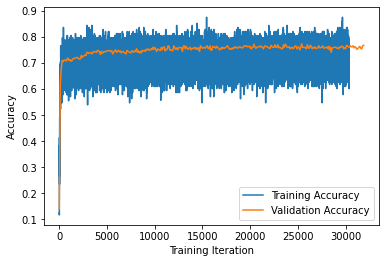

In [17]:
import matplotlib.pyplot as plt
plt.plot(range(len(training_accuracies)), training_accuracies, label = "Training Accuracy")
plt.plot(list(map(lambda x: x * 100, range(len(validation_accuracies)))), validation_accuracies, label = "Validation Accuracy")
plt.xlabel("Training Iteration")
plt.ylabel("Accuracy")
plt.legend()